In [1]:
import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号



from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

import timeit #用于计时和测量小段代码的执行时间
import seaborn as sns  # 导入seaborn库用于绘制密度图
import pandas as pd #一个用于数据操作和分析的库，提供了数据结构和数据分析工具，特别是用于处理表格数据（类似于Excel中的数据表）

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（激活函数为softmax）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #输出层的激活函数为tanh
        layer_list.append(('activation_%d' % (self.depth - 1), torch.nn.Softmax(dim=1)))  

        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict) #layers，长度为2*depth，包含了所有的线性变换和激活函数，奇数索引为线性变换(权重矩阵)，偶数索引为激活函数
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # # 新增方法，获取最后一个隐藏层的输出
    # def hidden_output(self, x):
    #     # 遍历每一层，直到最后一个隐藏层
    #     for i in range(self.depth - 1):
    #         # 获取当前层的线性变换
    #         x = self.layers[i*2](x)
    #         # 获取当前层的激活函数
    #         x = self.layers[i*2 + 1](x)
    #     # 返回最后一个隐藏层的输出
    #     return x

    # 新增方法，循环传递输入
    def hidden_forward(self, x, num_cycles):
        # 将输入传递到最后一个隐藏层，x为最后一个隐藏层的输出
        for i in range(self.depth - 1):
            x = self.layers[i*2](x)
            x = self.layers[i*2 + 1](x)
        
        # 将最后一个隐藏层的输出作为输入传递到第一个隐藏层中，重复num_cycles次
        for _ in range(num_cycles):
            for i in range(1, self.depth - 1): #最开始的x为最后一个隐藏层的输出，然后从第一个隐藏层开始传递
                x = self.layers[i*2](x)
                x = self.layers[i*2 + 1](x)
        hidden_output = x
        
        return hidden_output

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        mu_x, sigma_x = X_f.mean(0), X_f.std(0) #计算X_u的均值和标准差
        X_u = (X_u - mu_x) / sigma_x #对X_u进行标准化
        X_f = (X_f - mu_x) / sigma_x #对X_f进行标准化

        self.mu_x = torch.tensor(mu_x).float().to(device) #创建一个pytorch张量（数据来源于mu_x），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.sigma_x = torch.tensor(sigma_x).float().to(device) #创建一个pytorch张量（数据来源于sigma_x），并将其转换为浮点类型，最后将张量移动到指定的设备上

        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #初边界点数据
        self.X_u = torch.tensor(X_u, requires_grad=True).float().to(device)
        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #配位点数据
        self.X_f = torch.tensor(X_f, requires_grad=True).float().to(device)
        # #测试点数据
        # self.X_star = torch.tensor(X_star).float().to(device)
        # #测试点真实数据
        # self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), eps = 1e-30) 


        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x):  
        u = self.dnn(x)  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x) #调用上面的net_u函数，计算神经网络的输出u
        u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3]; #将u的第一列、第二列、第三列分别赋值给u1、u2、u3
        u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6]; #将u的第四列、第五列、第六列分别赋值给u4、u5、u6
        u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9]; #将u的第七列、第八列、第九列分别赋值给u7、u8、u9
        u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12] #将u的第十列、第十一列、第十二列分别赋值给u10、u11、u12
        

        u_x_1 = torch.autograd.grad(
            u1, x, #输入的张量，要计算u1关于x的导数
            grad_outputs=torch.ones_like(u1), #生成一个与u1形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u1的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_2 = torch.autograd.grad(
            u2, x, #输入的张量，要计算u2关于x的导数
            grad_outputs=torch.ones_like(u2), #生成一个与u2形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u2的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_3 = torch.autograd.grad(
            u3, x, #输入的张量，要计算u3关于x的导数
            grad_outputs=torch.ones_like(u3), #生成一个与u3形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u3的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x_4 = torch.autograd.grad(
            u4, x,
            grad_outputs=torch.ones_like(u4),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_5 = torch.autograd.grad(
            u5, x,
            grad_outputs=torch.ones_like(u5),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_6 = torch.autograd.grad(
            u6, x,
            grad_outputs=torch.ones_like(u6),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_7 = torch.autograd.grad(
            u7, x,
            grad_outputs=torch.ones_like(u7),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_8 = torch.autograd.grad(
            u8, x,
            grad_outputs=torch.ones_like(u8),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_9 = torch.autograd.grad(
            u9, x,
            grad_outputs=torch.ones_like(u9),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_10 = torch.autograd.grad(
            u10, x,
            grad_outputs=torch.ones_like(u10),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_11 = torch.autograd.grad(
            u11, x,
            grad_outputs=torch.ones_like(u11),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x_12 = torch.autograd.grad(
            u12, x,
            grad_outputs=torch.ones_like(u12),
            retain_graph=True,
            create_graph=True
        )[0]


        #归一化
        u_x_1 = u_x_1 / self.sigma_x;u_x_2 = u_x_2 / self.sigma_x;u_x_3 = u_x_3 / self.sigma_x
        u_x_4 = u_x_4 / self.sigma_x;u_x_5 = u_x_5 / self.sigma_x;u_x_6 = u_x_6 / self.sigma_x
        u_x_7 = u_x_7 / self.sigma_x;u_x_8 = u_x_8 / self.sigma_x;u_x_9 = u_x_9 / self.sigma_x
        u_x_10 = u_x_10 / self.sigma_x;u_x_11 = u_x_11 / self.sigma_x;u_x_12 = u_x_12 / self.sigma_x

        #指定状态转移概率
        #对于元素1
        Lambda2_1_1=7; Mu1_2_1=100;
        #对于元素2
        Lambda2_1_2=10; Mu1_2_2=80;
        #对于元素3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        #计算ODE项
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12

        
        #计算残差
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12

        #计算损失函数
        loss_1 = torch.mean(residual_1 ** 2); loss_2 = torch.mean(residual_2 ** 2); loss_3 = torch.mean(residual_3 ** 2);
        loss_4 = torch.mean(residual_4 ** 2); loss_5 = torch.mean(residual_5 ** 2); loss_6 = torch.mean(residual_6 ** 2);
        loss_7 = torch.mean(residual_7 ** 2); loss_8 = torch.mean(residual_8 ** 2); loss_9 = torch.mean(residual_9 ** 2);
        loss_10 = torch.mean(residual_10 ** 2); loss_11 = torch.mean(residual_11 ** 2); loss_12 = torch.mean(residual_12 ** 2)


        loss_f = loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7 + loss_8 + loss_9 + loss_10 + loss_11 + loss_12
        return loss_f, residual_1+residual_2+residual_3+residual_4+residual_5+residual_6+residual_7+residual_8+residual_9+residual_10+residual_11+residual_12
    
      
    
    def train(self, nIter):


        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.X_u) #调用之前定义的函数，传入初值得到神经网络的输出u

            loss_u = torch.mean((self.u - u_pred) ** 2) #计算初值的损失函数
            loss_f, _ = self.net_f(self.X_f) #计算残差的损失函数
            

            loss = 100*loss_u + loss_f
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # # record the test error
            # self.dnn.eval() #将神经网络切换为评估模式
            # with torch.no_grad():
            #     u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u


            # error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            # self.test_error.append(error_test)

            # # 计算 MAE和MSE
            # mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            # mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # # 记录 MAE 和 MSE
            # self.test_error_mae.append(mae)
            # self.test_error_mse.append(mse)


  

    def predict(self, X):
        x = torch.tensor(X, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x) #调用之前定义的函数得到神经网络的输出u,以及f
        _, f = self.net_f(x)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x, num_cycles):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        mu, sigma = self.mu_x, self.sigma_x
        x = (x - mu) / sigma

        self.dnn.eval()
        hidden_output = self.dnn.hidden_forward(x, num_cycles)
        hidden_output = hidden_output.detach().cpu().numpy()
        return hidden_output

In [6]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [7]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [8]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]
#设置噪声水平为0
noise = 0.0     

eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')

N_u = 1
N_f = 200

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [1, 50, 50, 12]

lb  = np.array([0.0])              # t的左边界
ub  = np.array([0.2])          # t的右边界

# Define the initial MSS state
X_u = np.array([[0]])
u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])          # 初始真实状态


error_y = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值
chaoss = [] #创建一个空列表，用于存储混沌值
residuals = [] #创建一个空列表，用于存储残差值

i = 0


# # 创建文件夹
# model_dir = 'Adam+LBFGS+LHS(5000)'
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子

    # X_f = lb + (ub - lb) * lhs(1, N_f) #生成N_f个配位点，均匀分布在[0,1]之间
    X_f = np.linspace(lb, ub, N_f)     # 配位点位置
    nIter = 40000

    #创建PINN模型并输入各种参数     
    # model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub, X_star, u_star)
    model = PhysicsInformedNN(X_u, u, X_f, layers, lb, ub)
    
    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))


    # up = 80000
    n_star = 500+1
    x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
    y_pred, _ = model.predict(x_star)
    y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
    y_pred = get_system_performance(y_pred_df)
    # y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
    y_star = eigenvector_solution_df


    #计算误差（基于2范数）        
    error_y.append(np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:, -5:],2)/np.linalg.norm(y_star.iloc[:, -5:],2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]))
    mse = np.mean((y_star.iloc[:, -5:] - y_pred.iloc[:, -5:]) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)


    #计算混沌度
    y_chaos = model.hidden_predict(x_star, 100)
    # print(y_chaos)
    x_sss = x_star + np.random.normal(0, 0.001)
    y_chaos_sss = model.hidden_predict(x_sss, 100)
    chaos = np.linalg.norm(y_chaos - y_chaos_sss,axis=1).sum()
    chaoss.append(chaos)

    #计算残差

    _, residual = model.predict(x_star)
    residual = residual.flatten()
    residual = np.abs(residual)
    residual = residual.sum()
    residuals.append(residual)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error y : %e' % (np.linalg.norm(y_star.iloc[:,-5:]-y_pred.iloc[:,-5:],2)/np.linalg.norm(y_star.iloc[:,-5:],2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE
    print('Chaos: %e' % chaos) #打印混沌度
    print('Residual: %e' % residual) #打印残差
    # # 保存模型到文件夹
    # model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    # with open(model_path, 'wb') as f:
    #     pickle.dump(model, f)





Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<1:30:30,  7.37it/s]

Adam:   0%|          | 10/40000 [00:00<14:14, 46.79it/s] 

Adam:   0%|          | 18/40000 [00:00<11:13, 59.39it/s]

Adam:   0%|          | 29/40000 [00:00<08:37, 77.26it/s]

Adam:   0%|          | 42/40000 [00:00<07:04, 94.12it/s]

Adam:   0%|          | 52/40000 [00:00<07:13, 92.15it/s]

Adam:   0%|          | 64/40000 [00:00<06:40, 99.80it/s]

Adam:   0%|          | 75/40000 [00:00<06:38, 100.18it/s]

Adam:   0%|          | 86/40000 [00:01<07:05, 93.82it/s] 

Adam:   0%|          | 96/40000 [00:01<07:39, 86.78it/s]

Adam:   0%|          | 108/40000 [00:01<06:58, 95.29it/s]

Adam:   0%|          | 119/40000 [00:01<06:41, 99.24it/s]

Adam:   0%|          | 131/40000 [00:01<06:21, 104.52it/s]

Adam:   0%|          | 142/40000 [00:01<07:32, 88.16it/s] 

Adam:   0%|          | 152/40000 [00:01<07:34, 87.71it/s]

Adam:   0%|          | 162/40000 [00:01<07:54, 84.04it/s]

Adam:   0%|          | 171/40000 [00:01<07:49, 84.76it/s]

Adam:   0%|          | 183/40000 [00:02<07:12, 91.97it/s]

Adam:   0%|          | 193/40000 [00:02<07:07, 93.17it/s]

Adam:   1%|          | 203/40000 [00:02<07:52, 84.15it/s]

Adam:   1%|          | 212/40000 [00:02<08:03, 82.26it/s]

Adam:   1%|          | 221/40000 [00:02<08:08, 81.49it/s]

Adam:   1%|          | 230/40000 [00:02<08:25, 78.64it/s]

Adam:   1%|          | 238/40000 [00:02<08:43, 75.94it/s]

Adam:   1%|          | 248/40000 [00:02<08:10, 81.09it/s]

Adam:   1%|          | 258/40000 [00:03<07:42, 85.98it/s]

Adam:   1%|          | 267/40000 [00:03<08:26, 78.45it/s]

Adam:   1%|          | 283/40000 [00:03<06:42, 98.78it/s]

Adam:   1%|          | 294/40000 [00:03<07:10, 92.18it/s]

Adam:   1%|          | 305/40000 [00:03<06:55, 95.47it/s]

Adam:   1%|          | 315/40000 [00:03<07:40, 86.09it/s]

Adam:   1%|          | 324/40000 [00:03<08:12, 80.58it/s]

Adam:   1%|          | 333/40000 [00:03<08:05, 81.69it/s]

Adam:   1%|          | 343/40000 [00:03<07:45, 85.24it/s]

Adam:   1%|          | 352/40000 [00:04<08:30, 77.73it/s]

Adam:   1%|          | 360/40000 [00:04<08:46, 75.26it/s]

Adam:   1%|          | 369/40000 [00:04<08:40, 76.09it/s]

Adam:   1%|          | 377/40000 [00:04<08:37, 76.52it/s]

Adam:   1%|          | 392/40000 [00:04<06:55, 95.27it/s]

Adam:   1%|          | 404/40000 [00:04<06:30, 101.29it/s]

Adam:   1%|          | 415/40000 [00:04<07:07, 92.70it/s] 

Adam:   1%|          | 425/40000 [00:04<07:14, 91.00it/s]

Adam:   1%|          | 436/40000 [00:05<06:59, 94.21it/s]

Adam:   1%|          | 446/40000 [00:05<06:59, 94.37it/s]

Adam:   1%|          | 456/40000 [00:05<07:16, 90.59it/s]

Adam:   1%|          | 466/40000 [00:05<07:59, 82.42it/s]

Adam:   1%|          | 478/40000 [00:05<07:22, 89.32it/s]

Adam:   1%|          | 488/40000 [00:05<08:05, 81.34it/s]

Adam:   1%|          | 497/40000 [00:05<07:53, 83.44it/s]

Adam:   1%|▏         | 507/40000 [00:05<07:35, 86.76it/s]

Adam:   1%|▏         | 520/40000 [00:05<06:55, 94.96it/s]

Adam:   1%|▏         | 535/40000 [00:06<06:07, 107.26it/s]

Adam:   1%|▏         | 546/40000 [00:06<06:30, 100.98it/s]

Adam:   1%|▏         | 557/40000 [00:06<07:34, 86.69it/s] 

Adam:   1%|▏         | 570/40000 [00:06<06:50, 96.06it/s]

Adam:   1%|▏         | 581/40000 [00:06<07:21, 89.37it/s]

Adam:   1%|▏         | 595/40000 [00:06<06:29, 101.16it/s]

Adam:   2%|▏         | 606/40000 [00:06<07:03, 93.06it/s] 

Adam:   2%|▏         | 616/40000 [00:07<07:51, 83.58it/s]

Adam:   2%|▏         | 625/40000 [00:07<08:15, 79.44it/s]

Adam:   2%|▏         | 638/40000 [00:07<07:17, 89.94it/s]

Adam:   2%|▏         | 648/40000 [00:07<08:01, 81.66it/s]

Adam:   2%|▏         | 657/40000 [00:07<08:16, 79.16it/s]

Adam:   2%|▏         | 669/40000 [00:07<07:29, 87.43it/s]

Adam:   2%|▏         | 682/40000 [00:07<06:40, 98.26it/s]

Adam:   2%|▏         | 693/40000 [00:07<07:21, 89.07it/s]

Adam:   2%|▏         | 705/40000 [00:08<06:57, 94.16it/s]

Adam:   2%|▏         | 715/40000 [00:08<07:45, 84.48it/s]

Adam:   2%|▏         | 727/40000 [00:08<07:04, 92.54it/s]

Adam:   2%|▏         | 740/40000 [00:08<06:26, 101.68it/s]

Adam:   2%|▏         | 752/40000 [00:08<06:17, 104.08it/s]

Adam:   2%|▏         | 765/40000 [00:08<05:53, 111.11it/s]

Adam:   2%|▏         | 777/40000 [00:08<06:18, 103.64it/s]

Adam:   2%|▏         | 788/40000 [00:08<07:17, 89.59it/s] 

Adam:   2%|▏         | 798/40000 [00:09<07:32, 86.63it/s]

Adam:   2%|▏         | 808/40000 [00:09<07:20, 89.07it/s]

Adam:   2%|▏         | 819/40000 [00:09<07:00, 93.08it/s]

Adam:   2%|▏         | 831/40000 [00:09<06:39, 97.99it/s]

Adam:   2%|▏         | 841/40000 [00:09<06:40, 97.68it/s]

Adam:   2%|▏         | 851/40000 [00:09<07:25, 87.89it/s]

Adam:   2%|▏         | 861/40000 [00:09<08:09, 79.96it/s]

Adam:   2%|▏         | 871/40000 [00:09<07:40, 84.88it/s]

Adam:   2%|▏         | 887/40000 [00:09<06:22, 102.33it/s]

Adam:   2%|▏         | 898/40000 [00:10<06:48, 95.71it/s] 

Adam:   2%|▏         | 908/40000 [00:10<07:36, 85.58it/s]

Adam:   2%|▏         | 920/40000 [00:10<06:58, 93.43it/s]

Adam:   2%|▏         | 930/40000 [00:10<07:08, 91.22it/s]

Adam:   2%|▏         | 940/40000 [00:10<07:08, 91.09it/s]

Adam:   2%|▏         | 950/40000 [00:10<07:08, 91.16it/s]

Adam:   2%|▏         | 962/40000 [00:10<06:34, 98.95it/s]

Adam:   2%|▏         | 973/40000 [00:10<07:19, 88.70it/s]

Adam:   2%|▏         | 983/40000 [00:11<07:14, 89.79it/s]

Adam:   2%|▏         | 993/40000 [00:11<07:36, 85.52it/s]

Adam:   3%|▎         | 1002/40000 [00:11<07:49, 82.98it/s]

Adam:   3%|▎         | 1011/40000 [00:11<07:57, 81.63it/s]

Adam:   3%|▎         | 1020/40000 [00:11<07:48, 83.23it/s]

Adam:   3%|▎         | 1031/40000 [00:11<07:11, 90.32it/s]

Adam:   3%|▎         | 1044/40000 [00:11<06:24, 101.35it/s]

Adam:   3%|▎         | 1055/40000 [00:11<07:17, 89.00it/s] 

Adam:   3%|▎         | 1067/40000 [00:11<06:42, 96.84it/s]

Adam:   3%|▎         | 1080/40000 [00:12<06:17, 103.19it/s]

Adam:   3%|▎         | 1091/40000 [00:12<06:34, 98.69it/s] 

Adam:   3%|▎         | 1102/40000 [00:12<07:02, 92.01it/s]

Adam:   3%|▎         | 1113/40000 [00:12<06:58, 92.86it/s]

Adam:   3%|▎         | 1123/40000 [00:12<07:03, 91.85it/s]

Adam:   3%|▎         | 1133/40000 [00:12<07:11, 90.02it/s]

Adam:   3%|▎         | 1143/40000 [00:12<07:43, 83.77it/s]

Adam:   3%|▎         | 1152/40000 [00:12<07:48, 82.96it/s]

Adam:   3%|▎         | 1161/40000 [00:13<07:58, 81.25it/s]

Adam:   3%|▎         | 1171/40000 [00:13<07:41, 84.11it/s]

Adam:   3%|▎         | 1180/40000 [00:13<07:46, 83.25it/s]

Adam:   3%|▎         | 1189/40000 [00:13<07:40, 84.37it/s]

Adam:   3%|▎         | 1198/40000 [00:13<07:58, 81.09it/s]

Adam:   3%|▎         | 1207/40000 [00:13<07:49, 82.71it/s]

Adam:   3%|▎         | 1216/40000 [00:13<08:06, 79.65it/s]

Adam:   3%|▎         | 1225/40000 [00:13<07:54, 81.67it/s]

Adam:   3%|▎         | 1234/40000 [00:13<07:59, 80.85it/s]

Adam:   3%|▎         | 1243/40000 [00:14<08:04, 80.04it/s]

Adam:   3%|▎         | 1254/40000 [00:14<07:20, 87.94it/s]

Adam:   3%|▎         | 1269/40000 [00:14<06:11, 104.25it/s]

Adam:   3%|▎         | 1281/40000 [00:14<05:56, 108.55it/s]

Adam:   3%|▎         | 1293/40000 [00:14<05:54, 109.13it/s]

Adam:   3%|▎         | 1305/40000 [00:14<05:59, 107.69it/s]

Adam:   3%|▎         | 1316/40000 [00:14<07:00, 91.90it/s] 

Adam:   3%|▎         | 1326/40000 [00:14<07:10, 89.74it/s]

Adam:   3%|▎         | 1336/40000 [00:14<07:04, 91.03it/s]

Adam:   3%|▎         | 1349/40000 [00:15<06:31, 98.73it/s]

Adam:   3%|▎         | 1360/40000 [00:15<07:14, 89.02it/s]

Adam:   3%|▎         | 1370/40000 [00:15<07:32, 85.37it/s]

Adam:   3%|▎         | 1379/40000 [00:15<08:09, 78.95it/s]

Adam:   3%|▎         | 1388/40000 [00:15<08:14, 78.04it/s]

Adam:   3%|▎         | 1399/40000 [00:15<07:31, 85.53it/s]

Adam:   4%|▎         | 1411/40000 [00:15<06:53, 93.26it/s]

Adam:   4%|▎         | 1421/40000 [00:15<07:37, 84.27it/s]

Adam:   4%|▎         | 1430/40000 [00:16<08:10, 78.63it/s]

Adam:   4%|▎         | 1439/40000 [00:16<08:23, 76.66it/s]

Adam:   4%|▎         | 1447/40000 [00:16<08:39, 74.14it/s]

Adam:   4%|▎         | 1459/40000 [00:16<07:34, 84.85it/s]

Adam:   4%|▎         | 1468/40000 [00:16<07:32, 85.07it/s]

Adam:   4%|▎         | 1477/40000 [00:16<08:11, 78.45it/s]

Adam:   4%|▎         | 1486/40000 [00:16<08:13, 77.99it/s]

Adam:   4%|▎         | 1498/40000 [00:16<07:24, 86.59it/s]

Adam:   4%|▍         | 1507/40000 [00:17<07:30, 85.37it/s]

Adam:   4%|▍         | 1519/40000 [00:17<06:50, 93.83it/s]

Adam:   4%|▍         | 1529/40000 [00:17<07:15, 88.37it/s]

Adam:   4%|▍         | 1540/40000 [00:17<06:58, 91.82it/s]

Adam:   4%|▍         | 1550/40000 [00:17<07:11, 89.19it/s]

Adam:   4%|▍         | 1560/40000 [00:17<08:02, 79.62it/s]

Adam:   4%|▍         | 1569/40000 [00:17<08:14, 77.75it/s]

Adam:   4%|▍         | 1581/40000 [00:17<07:18, 87.59it/s]

Adam:   4%|▍         | 1598/40000 [00:17<05:55, 107.96it/s]

Adam:   4%|▍         | 1610/40000 [00:18<05:57, 107.44it/s]

Adam:   4%|▍         | 1622/40000 [00:18<06:23, 100.00it/s]

Adam:   4%|▍         | 1633/40000 [00:18<06:26, 99.32it/s] 

Adam:   4%|▍         | 1644/40000 [00:18<06:51, 93.18it/s]

Adam:   4%|▍         | 1655/40000 [00:18<06:34, 97.09it/s]

Adam:   4%|▍         | 1666/40000 [00:18<06:22, 100.26it/s]

Adam:   4%|▍         | 1679/40000 [00:18<05:54, 108.04it/s]

Adam:   4%|▍         | 1690/40000 [00:18<06:27, 98.78it/s] 

Adam:   4%|▍         | 1706/40000 [00:19<05:36, 113.71it/s]

Adam:   4%|▍         | 1719/40000 [00:19<05:30, 115.83it/s]

Adam:   4%|▍         | 1731/40000 [00:19<06:21, 100.34it/s]

Adam:   4%|▍         | 1742/40000 [00:19<06:40, 95.57it/s] 

Adam:   4%|▍         | 1752/40000 [00:19<07:00, 91.02it/s]

Adam:   4%|▍         | 1762/40000 [00:19<07:26, 85.70it/s]

Adam:   4%|▍         | 1771/40000 [00:19<07:38, 83.30it/s]

Adam:   4%|▍         | 1783/40000 [00:19<06:58, 91.31it/s]

Adam:   4%|▍         | 1793/40000 [00:20<06:51, 92.96it/s]

Adam:   5%|▍         | 1803/40000 [00:20<07:28, 85.22it/s]

Adam:   5%|▍         | 1812/40000 [00:20<07:46, 81.92it/s]

Adam:   5%|▍         | 1821/40000 [00:20<07:35, 83.85it/s]

Adam:   5%|▍         | 1833/40000 [00:20<06:56, 91.64it/s]

Adam:   5%|▍         | 1843/40000 [00:20<07:23, 86.05it/s]

Adam:   5%|▍         | 1856/40000 [00:20<06:35, 96.47it/s]

Adam:   5%|▍         | 1866/40000 [00:20<07:12, 88.19it/s]

Adam:   5%|▍         | 1879/40000 [00:20<06:35, 96.44it/s]

Adam:   5%|▍         | 1893/40000 [00:21<05:56, 107.04it/s]

Adam:   5%|▍         | 1904/40000 [00:21<06:49, 92.94it/s] 

Adam:   5%|▍         | 1914/40000 [00:21<06:49, 92.97it/s]

Adam:   5%|▍         | 1924/40000 [00:21<06:56, 91.36it/s]

Adam:   5%|▍         | 1934/40000 [00:21<07:40, 82.61it/s]

Adam:   5%|▍         | 1944/40000 [00:21<07:18, 86.82it/s]

Adam:   5%|▍         | 1953/40000 [00:21<07:49, 81.01it/s]

Adam:   5%|▍         | 1962/40000 [00:21<08:11, 77.37it/s]

Adam:   5%|▍         | 1970/40000 [00:22<08:35, 73.81it/s]

Adam:   5%|▍         | 1978/40000 [00:22<08:55, 71.04it/s]

Adam:   5%|▍         | 1986/40000 [00:22<09:01, 70.24it/s]

Adam:   5%|▍         | 1997/40000 [00:22<08:00, 79.05it/s]

Adam:   5%|▌         | 2006/40000 [00:22<07:43, 81.89it/s]

Adam:   5%|▌         | 2018/40000 [00:22<07:03, 89.69it/s]

Adam:   5%|▌         | 2028/40000 [00:22<07:53, 80.15it/s]

Adam:   5%|▌         | 2037/40000 [00:22<08:12, 77.11it/s]

Adam:   5%|▌         | 2048/40000 [00:23<07:40, 82.44it/s]

Adam:   5%|▌         | 2061/40000 [00:23<06:45, 93.62it/s]

Adam:   5%|▌         | 2071/40000 [00:23<07:38, 82.67it/s]

Adam:   5%|▌         | 2080/40000 [00:23<08:20, 75.71it/s]

Adam:   5%|▌         | 2088/40000 [00:23<08:17, 76.21it/s]

Adam:   5%|▌         | 2101/40000 [00:23<07:11, 87.92it/s]

Adam:   5%|▌         | 2111/40000 [00:23<07:46, 81.15it/s]

Adam:   5%|▌         | 2121/40000 [00:23<07:21, 85.75it/s]

Adam:   5%|▌         | 2130/40000 [00:24<07:59, 78.95it/s]

Adam:   5%|▌         | 2142/40000 [00:24<07:08, 88.33it/s]

Adam:   5%|▌         | 2153/40000 [00:24<06:43, 93.88it/s]

Adam:   5%|▌         | 2163/40000 [00:24<06:52, 91.62it/s]

Adam:   5%|▌         | 2175/40000 [00:24<06:22, 98.83it/s]

Adam:   5%|▌         | 2186/40000 [00:24<06:23, 98.58it/s]

Adam:   5%|▌         | 2197/40000 [00:24<06:18, 100.00it/s]

Adam:   6%|▌         | 2208/40000 [00:24<07:10, 87.77it/s] 

Adam:   6%|▌         | 2218/40000 [00:25<07:41, 81.89it/s]

Adam:   6%|▌         | 2228/40000 [00:25<07:28, 84.21it/s]

Adam:   6%|▌         | 2238/40000 [00:25<07:15, 86.65it/s]

Adam:   6%|▌         | 2248/40000 [00:25<07:05, 88.70it/s]

Adam:   6%|▌         | 2258/40000 [00:25<06:53, 91.17it/s]

Adam:   6%|▌         | 2268/40000 [00:25<07:21, 85.51it/s]

Adam:   6%|▌         | 2277/40000 [00:25<07:42, 81.54it/s]

Adam:   6%|▌         | 2286/40000 [00:25<08:03, 77.99it/s]

Adam:   6%|▌         | 2294/40000 [00:25<08:17, 75.81it/s]

Adam:   6%|▌         | 2303/40000 [00:26<08:08, 77.24it/s]

Adam:   6%|▌         | 2311/40000 [00:26<08:29, 73.97it/s]

Adam:   6%|▌         | 2320/40000 [00:26<08:02, 78.16it/s]

Adam:   6%|▌         | 2332/40000 [00:26<07:10, 87.57it/s]

Adam:   6%|▌         | 2341/40000 [00:26<07:52, 79.77it/s]

Adam:   6%|▌         | 2350/40000 [00:26<07:49, 80.28it/s]

Adam:   6%|▌         | 2359/40000 [00:26<08:10, 76.71it/s]

Adam:   6%|▌         | 2368/40000 [00:26<07:52, 79.65it/s]

Adam:   6%|▌         | 2380/40000 [00:26<07:02, 89.08it/s]

Adam:   6%|▌         | 2394/40000 [00:27<06:09, 101.72it/s]

Adam:   6%|▌         | 2405/40000 [00:27<07:12, 86.98it/s] 

Adam:   6%|▌         | 2415/40000 [00:27<07:07, 87.87it/s]

Adam:   6%|▌         | 2425/40000 [00:27<07:12, 86.97it/s]

Adam:   6%|▌         | 2434/40000 [00:27<07:15, 86.35it/s]

Adam:   6%|▌         | 2445/40000 [00:27<07:00, 89.37it/s]

Adam:   6%|▌         | 2455/40000 [00:27<07:42, 81.20it/s]

Adam:   6%|▌         | 2464/40000 [00:27<08:11, 76.30it/s]

Adam:   6%|▌         | 2473/40000 [00:28<08:00, 78.09it/s]

Adam:   6%|▌         | 2481/40000 [00:28<08:14, 75.90it/s]

Adam:   6%|▌         | 2489/40000 [00:28<08:26, 74.00it/s]

Adam:   6%|▋         | 2503/40000 [00:28<06:57, 89.71it/s]

Adam:   6%|▋         | 2515/40000 [00:28<06:23, 97.82it/s]

Adam:   6%|▋         | 2525/40000 [00:28<06:35, 94.72it/s]

Adam:   6%|▋         | 2535/40000 [00:28<07:14, 86.16it/s]

Adam:   6%|▋         | 2545/40000 [00:28<07:00, 89.16it/s]

Adam:   6%|▋         | 2556/40000 [00:28<06:38, 94.00it/s]

Adam:   6%|▋         | 2566/40000 [00:29<07:20, 85.01it/s]

Adam:   6%|▋         | 2577/40000 [00:29<07:01, 88.80it/s]

Adam:   6%|▋         | 2587/40000 [00:29<07:11, 86.73it/s]

Adam:   6%|▋         | 2596/40000 [00:29<07:35, 82.04it/s]

Adam:   7%|▋         | 2605/40000 [00:29<07:28, 83.45it/s]

Adam:   7%|▋         | 2614/40000 [00:29<08:01, 77.71it/s]

Adam:   7%|▋         | 2623/40000 [00:29<07:54, 78.83it/s]

Adam:   7%|▋         | 2631/40000 [00:29<07:58, 78.07it/s]

Adam:   7%|▋         | 2639/40000 [00:30<08:28, 73.52it/s]

Adam:   7%|▋         | 2647/40000 [00:30<08:17, 75.02it/s]

Adam:   7%|▋         | 2662/40000 [00:30<06:33, 94.99it/s]

Adam:   7%|▋         | 2672/40000 [00:30<06:28, 96.16it/s]

Adam:   7%|▋         | 2682/40000 [00:30<07:15, 85.76it/s]

Adam:   7%|▋         | 2691/40000 [00:30<07:13, 86.02it/s]

Adam:   7%|▋         | 2707/40000 [00:30<05:54, 105.15it/s]

Adam:   7%|▋         | 2718/40000 [00:30<05:57, 104.15it/s]

Adam:   7%|▋         | 2731/40000 [00:30<05:49, 106.77it/s]

Adam:   7%|▋         | 2742/40000 [00:31<07:06, 87.32it/s] 

Adam:   7%|▋         | 2752/40000 [00:31<07:37, 81.45it/s]

Adam:   7%|▋         | 2761/40000 [00:31<08:07, 76.46it/s]

Adam:   7%|▋         | 2769/40000 [00:31<08:20, 74.40it/s]

Adam:   7%|▋         | 2777/40000 [00:31<08:14, 75.25it/s]

Adam:   7%|▋         | 2789/40000 [00:31<07:25, 83.47it/s]

Adam:   7%|▋         | 2798/40000 [00:31<07:56, 78.15it/s]

Adam:   7%|▋         | 2806/40000 [00:31<08:13, 75.33it/s]

Adam:   7%|▋         | 2818/40000 [00:32<07:14, 85.48it/s]

Adam:   7%|▋         | 2827/40000 [00:32<07:30, 82.57it/s]

Adam:   7%|▋         | 2838/40000 [00:32<06:59, 88.51it/s]

Adam:   7%|▋         | 2851/40000 [00:32<06:28, 95.69it/s]

Adam:   7%|▋         | 2861/40000 [00:32<07:10, 86.19it/s]

Adam:   7%|▋         | 2873/40000 [00:32<06:41, 92.39it/s]

Adam:   7%|▋         | 2885/40000 [00:32<06:22, 97.03it/s]

Adam:   7%|▋         | 2895/40000 [00:32<07:10, 86.15it/s]

Adam:   7%|▋         | 2904/40000 [00:33<07:44, 79.88it/s]

Adam:   7%|▋         | 2917/40000 [00:33<06:49, 90.56it/s]

Adam:   7%|▋         | 2929/40000 [00:33<06:18, 97.98it/s]

Adam:   7%|▋         | 2940/40000 [00:33<06:22, 96.93it/s]

Adam:   7%|▋         | 2950/40000 [00:33<06:38, 92.96it/s]

Adam:   7%|▋         | 2960/40000 [00:33<07:06, 86.81it/s]

Adam:   7%|▋         | 2969/40000 [00:33<07:47, 79.26it/s]

Adam:   7%|▋         | 2984/40000 [00:33<06:25, 95.94it/s]

Adam:   7%|▋         | 2995/40000 [00:34<06:14, 98.85it/s]

Adam:   8%|▊         | 3006/40000 [00:34<06:56, 88.92it/s]

Adam:   8%|▊         | 3017/40000 [00:34<06:46, 90.95it/s]

Adam:   8%|▊         | 3027/40000 [00:34<07:03, 87.34it/s]

Adam:   8%|▊         | 3037/40000 [00:34<06:53, 89.35it/s]

Adam:   8%|▊         | 3047/40000 [00:34<07:45, 79.40it/s]

Adam:   8%|▊         | 3056/40000 [00:34<08:08, 75.63it/s]

Adam:   8%|▊         | 3064/40000 [00:34<08:19, 73.95it/s]

Adam:   8%|▊         | 3074/40000 [00:35<07:47, 78.96it/s]

Adam:   8%|▊         | 3083/40000 [00:35<08:06, 75.86it/s]

Adam:   8%|▊         | 3095/40000 [00:35<07:14, 84.90it/s]

Adam:   8%|▊         | 3104/40000 [00:35<07:17, 84.42it/s]

Adam:   8%|▊         | 3117/40000 [00:35<06:28, 94.86it/s]

Adam:   8%|▊         | 3129/40000 [00:35<06:16, 97.91it/s]

Adam:   8%|▊         | 3139/40000 [00:35<06:57, 88.24it/s]

Adam:   8%|▊         | 3149/40000 [00:35<07:17, 84.27it/s]

Adam:   8%|▊         | 3158/40000 [00:35<07:10, 85.53it/s]

Adam:   8%|▊         | 3170/40000 [00:36<06:36, 92.94it/s]

Adam:   8%|▊         | 3180/40000 [00:36<07:19, 83.72it/s]

Adam:   8%|▊         | 3191/40000 [00:36<06:59, 87.76it/s]

Adam:   8%|▊         | 3200/40000 [00:36<07:05, 86.57it/s]

Adam:   8%|▊         | 3209/40000 [00:36<07:29, 81.88it/s]

Adam:   8%|▊         | 3218/40000 [00:36<07:19, 83.60it/s]

Adam:   8%|▊         | 3228/40000 [00:36<07:13, 84.83it/s]

Adam:   8%|▊         | 3237/40000 [00:36<07:07, 85.98it/s]

Adam:   8%|▊         | 3248/40000 [00:37<06:38, 92.28it/s]

Adam:   8%|▊         | 3261/40000 [00:37<06:08, 99.60it/s]

Adam:   8%|▊         | 3271/40000 [00:37<07:06, 86.21it/s]

Adam:   8%|▊         | 3280/40000 [00:37<07:15, 84.32it/s]

Adam:   8%|▊         | 3291/40000 [00:37<06:44, 90.75it/s]

Adam:   8%|▊         | 3302/40000 [00:37<06:35, 92.84it/s]

Adam:   8%|▊         | 3312/40000 [00:37<06:46, 90.26it/s]

Adam:   8%|▊         | 3322/40000 [00:37<06:48, 89.75it/s]

Adam:   8%|▊         | 3332/40000 [00:37<07:22, 82.92it/s]

Adam:   8%|▊         | 3341/40000 [00:38<07:56, 76.91it/s]

Adam:   8%|▊         | 3351/40000 [00:38<07:30, 81.33it/s]

Adam:   8%|▊         | 3360/40000 [00:38<07:25, 82.31it/s]

Adam:   8%|▊         | 3369/40000 [00:38<07:51, 77.70it/s]

Adam:   8%|▊         | 3377/40000 [00:38<08:14, 74.00it/s]

Adam:   8%|▊         | 3388/40000 [00:38<07:22, 82.68it/s]

Adam:   8%|▊         | 3397/40000 [00:38<07:27, 81.87it/s]

Adam:   9%|▊         | 3409/40000 [00:38<06:43, 90.67it/s]

Adam:   9%|▊         | 3419/40000 [00:39<06:48, 89.64it/s]

Adam:   9%|▊         | 3429/40000 [00:39<06:42, 90.77it/s]

Adam:   9%|▊         | 3439/40000 [00:39<07:14, 84.18it/s]

Adam:   9%|▊         | 3449/40000 [00:39<07:07, 85.50it/s]

Adam:   9%|▊         | 3458/40000 [00:39<07:30, 81.10it/s]

Adam:   9%|▊         | 3468/40000 [00:39<07:10, 84.76it/s]

Adam:   9%|▊         | 3483/40000 [00:39<06:09, 98.96it/s]

Adam:   9%|▊         | 3493/40000 [00:39<06:39, 91.33it/s]

Adam:   9%|▉         | 3506/40000 [00:39<06:04, 100.19it/s]

Adam:   9%|▉         | 3517/40000 [00:40<07:11, 84.62it/s] 

Adam:   9%|▉         | 3527/40000 [00:40<06:55, 87.74it/s]

Adam:   9%|▉         | 3540/40000 [00:40<06:11, 98.26it/s]

Adam:   9%|▉         | 3551/40000 [00:40<07:03, 85.97it/s]

Adam:   9%|▉         | 3565/40000 [00:40<06:13, 97.66it/s]

Adam:   9%|▉         | 3576/40000 [00:40<06:06, 99.35it/s]

Adam:   9%|▉         | 3590/40000 [00:40<05:34, 108.76it/s]

Adam:   9%|▉         | 3602/40000 [00:40<05:30, 110.13it/s]

Adam:   9%|▉         | 3614/40000 [00:41<06:08, 98.74it/s] 

Adam:   9%|▉         | 3625/40000 [00:41<06:51, 88.34it/s]

Adam:   9%|▉         | 3635/40000 [00:41<07:20, 82.59it/s]

Adam:   9%|▉         | 3645/40000 [00:41<07:05, 85.36it/s]

Adam:   9%|▉         | 3654/40000 [00:41<07:01, 86.25it/s]

Adam:   9%|▉         | 3663/40000 [00:41<07:18, 82.87it/s]

Adam:   9%|▉         | 3672/40000 [00:41<07:20, 82.53it/s]

Adam:   9%|▉         | 3682/40000 [00:41<07:08, 84.79it/s]

Adam:   9%|▉         | 3691/40000 [00:42<07:26, 81.28it/s]

Adam:   9%|▉         | 3706/40000 [00:42<06:06, 98.96it/s]

Adam:   9%|▉         | 3723/40000 [00:42<05:10, 116.79it/s]

Adam:   9%|▉         | 3736/40000 [00:42<05:06, 118.46it/s]

Adam:   9%|▉         | 3749/40000 [00:42<06:19, 95.60it/s] 

Adam:   9%|▉         | 3760/40000 [00:42<07:02, 85.86it/s]

Adam:   9%|▉         | 3771/40000 [00:42<06:39, 90.78it/s]

Adam:   9%|▉         | 3781/40000 [00:42<07:14, 83.28it/s]

Adam:   9%|▉         | 3790/40000 [00:43<07:11, 83.85it/s]

Adam:   9%|▉         | 3799/40000 [00:43<07:40, 78.64it/s]

Adam:  10%|▉         | 3808/40000 [00:43<07:47, 77.39it/s]

Adam:  10%|▉         | 3820/40000 [00:43<07:02, 85.58it/s]

Adam:  10%|▉         | 3829/40000 [00:43<07:31, 80.13it/s]

Adam:  10%|▉         | 3838/40000 [00:43<07:29, 80.49it/s]

Adam:  10%|▉         | 3851/40000 [00:43<06:26, 93.45it/s]

Adam:  10%|▉         | 3863/40000 [00:43<06:09, 97.83it/s]

Adam:  10%|▉         | 3873/40000 [00:44<06:55, 87.03it/s]

Adam:  10%|▉         | 3883/40000 [00:44<06:49, 88.27it/s]

Adam:  10%|▉         | 3893/40000 [00:44<06:35, 91.31it/s]

Adam:  10%|▉         | 3903/40000 [00:44<06:42, 89.58it/s]

Adam:  10%|▉         | 3917/40000 [00:44<05:51, 102.77it/s]

Adam:  10%|▉         | 3928/40000 [00:44<06:17, 95.62it/s] 

Adam:  10%|▉         | 3938/40000 [00:44<06:32, 91.99it/s]

Adam:  10%|▉         | 3948/40000 [00:44<07:12, 83.32it/s]

Adam:  10%|▉         | 3957/40000 [00:44<07:04, 84.84it/s]

Adam:  10%|▉         | 3973/40000 [00:45<05:55, 101.34it/s]

Adam:  10%|▉         | 3984/40000 [00:45<06:05, 98.59it/s] 

Adam:  10%|▉         | 3995/40000 [00:45<06:08, 97.80it/s]

Adam:  10%|█         | 4010/40000 [00:45<05:25, 110.51it/s]

Adam:  10%|█         | 4022/40000 [00:45<05:44, 104.48it/s]

Adam:  10%|█         | 4033/40000 [00:45<06:37, 90.45it/s] 

Adam:  10%|█         | 4043/40000 [00:45<07:14, 82.81it/s]

Adam:  10%|█         | 4052/40000 [00:45<07:18, 82.06it/s]

Adam:  10%|█         | 4064/40000 [00:46<06:35, 90.90it/s]

Adam:  10%|█         | 4074/40000 [00:46<07:03, 84.76it/s]

Adam:  10%|█         | 4083/40000 [00:46<07:10, 83.45it/s]

Adam:  10%|█         | 4092/40000 [00:46<07:28, 80.03it/s]

Adam:  10%|█         | 4106/40000 [00:46<06:23, 93.50it/s]

Adam:  10%|█         | 4116/40000 [00:46<06:39, 89.91it/s]

Adam:  10%|█         | 4126/40000 [00:46<07:17, 81.91it/s]

Adam:  10%|█         | 4135/40000 [00:46<07:42, 77.61it/s]

Adam:  10%|█         | 4143/40000 [00:47<07:45, 77.00it/s]

Adam:  10%|█         | 4151/40000 [00:47<08:00, 74.66it/s]

Adam:  10%|█         | 4159/40000 [00:47<08:04, 73.95it/s]

Adam:  10%|█         | 4172/40000 [00:47<06:45, 88.44it/s]

Adam:  10%|█         | 4182/40000 [00:47<06:48, 87.65it/s]

Adam:  10%|█         | 4195/40000 [00:47<06:01, 99.04it/s]

Adam:  11%|█         | 4206/40000 [00:47<06:08, 97.25it/s]

Adam:  11%|█         | 4216/40000 [00:47<06:55, 86.16it/s]

Adam:  11%|█         | 4225/40000 [00:48<07:10, 83.15it/s]

Adam:  11%|█         | 4234/40000 [00:48<07:32, 79.12it/s]

Adam:  11%|█         | 4243/40000 [00:48<07:53, 75.45it/s]

Adam:  11%|█         | 4251/40000 [00:48<08:10, 72.93it/s]

Adam:  11%|█         | 4261/40000 [00:48<07:46, 76.66it/s]

Adam:  11%|█         | 4269/40000 [00:48<07:51, 75.80it/s]

Adam:  11%|█         | 4280/40000 [00:48<07:04, 84.06it/s]

Adam:  11%|█         | 4290/40000 [00:48<06:48, 87.47it/s]

Adam:  11%|█         | 4301/40000 [00:48<06:34, 90.58it/s]

Adam:  11%|█         | 4311/40000 [00:49<07:12, 82.54it/s]

Adam:  11%|█         | 4320/40000 [00:49<07:25, 80.08it/s]

Adam:  11%|█         | 4329/40000 [00:49<07:20, 80.94it/s]

Adam:  11%|█         | 4338/40000 [00:49<07:42, 77.18it/s]

Adam:  11%|█         | 4348/40000 [00:49<07:20, 80.98it/s]

Adam:  11%|█         | 4358/40000 [00:49<06:57, 85.41it/s]

Adam:  11%|█         | 4369/40000 [00:49<06:32, 90.69it/s]

Adam:  11%|█         | 4382/40000 [00:49<05:53, 100.63it/s]

Adam:  11%|█         | 4393/40000 [00:50<06:14, 94.99it/s] 

Adam:  11%|█         | 4403/40000 [00:50<06:30, 91.12it/s]

Adam:  11%|█         | 4413/40000 [00:50<06:32, 90.58it/s]

Adam:  11%|█         | 4429/40000 [00:50<05:34, 106.37it/s]

Adam:  11%|█         | 4440/40000 [00:50<05:35, 105.94it/s]

Adam:  11%|█         | 4454/40000 [00:50<05:12, 113.85it/s]

Adam:  11%|█         | 4466/40000 [00:50<05:30, 107.41it/s]

Adam:  11%|█         | 4479/40000 [00:50<05:17, 111.75it/s]

Adam:  11%|█         | 4491/40000 [00:50<06:10, 95.93it/s] 

Adam:  11%|█▏        | 4502/40000 [00:51<06:08, 96.46it/s]

Adam:  11%|█▏        | 4512/40000 [00:51<06:33, 90.25it/s]

Adam:  11%|█▏        | 4522/40000 [00:51<06:49, 86.64it/s]

Adam:  11%|█▏        | 4538/40000 [00:51<05:40, 104.08it/s]

Adam:  11%|█▏        | 4551/40000 [00:51<05:24, 109.23it/s]

Adam:  11%|█▏        | 4564/40000 [00:51<05:12, 113.22it/s]

Adam:  11%|█▏        | 4576/40000 [00:51<06:03, 97.41it/s] 

Adam:  11%|█▏        | 4587/40000 [00:51<05:54, 99.93it/s]

Adam:  12%|█▏        | 4603/40000 [00:52<05:07, 115.07it/s]

Adam:  12%|█▏        | 4615/40000 [00:52<05:49, 101.32it/s]

Adam:  12%|█▏        | 4626/40000 [00:52<06:04, 97.02it/s] 

Adam:  12%|█▏        | 4637/40000 [00:52<06:17, 93.80it/s]

Adam:  12%|█▏        | 4647/40000 [00:52<07:03, 83.39it/s]

Adam:  12%|█▏        | 4656/40000 [00:52<07:23, 79.74it/s]

Adam:  12%|█▏        | 4666/40000 [00:52<06:59, 84.29it/s]

Adam:  12%|█▏        | 4676/40000 [00:52<06:53, 85.43it/s]

Adam:  12%|█▏        | 4685/40000 [00:53<07:08, 82.47it/s]

Adam:  12%|█▏        | 4698/40000 [00:53<06:27, 91.15it/s]

Adam:  12%|█▏        | 4708/40000 [00:53<06:49, 86.22it/s]

Adam:  12%|█▏        | 4717/40000 [00:53<07:25, 79.23it/s]

Adam:  12%|█▏        | 4726/40000 [00:53<07:34, 77.65it/s]

Adam:  12%|█▏        | 4739/40000 [00:53<06:31, 90.08it/s]

Adam:  12%|█▏        | 4749/40000 [00:53<06:37, 88.79it/s]

Adam:  12%|█▏        | 4765/40000 [00:53<05:32, 106.04it/s]

Adam:  12%|█▏        | 4782/40000 [00:53<04:47, 122.47it/s]

Adam:  12%|█▏        | 4795/40000 [00:54<04:45, 123.38it/s]

Adam:  12%|█▏        | 4808/40000 [00:54<05:22, 109.11it/s]

Adam:  12%|█▏        | 4821/40000 [00:54<05:11, 112.91it/s]

Adam:  12%|█▏        | 4833/40000 [00:54<05:50, 100.27it/s]

Adam:  12%|█▏        | 4844/40000 [00:54<06:19, 92.71it/s] 

Adam:  12%|█▏        | 4854/40000 [00:54<06:55, 84.58it/s]

Adam:  12%|█▏        | 4867/40000 [00:54<06:09, 95.14it/s]

Adam:  12%|█▏        | 4879/40000 [00:55<05:54, 98.99it/s]

Adam:  12%|█▏        | 4892/40000 [00:55<05:30, 106.30it/s]

Adam:  12%|█▏        | 4903/40000 [00:55<06:32, 89.31it/s] 

Adam:  12%|█▏        | 4913/40000 [00:55<06:33, 89.18it/s]

Adam:  12%|█▏        | 4923/40000 [00:55<06:36, 88.43it/s]

Adam:  12%|█▏        | 4933/40000 [00:55<07:19, 79.73it/s]

Adam:  12%|█▏        | 4942/40000 [00:55<07:11, 81.30it/s]

Adam:  12%|█▏        | 4954/40000 [00:55<06:29, 89.94it/s]

Adam:  12%|█▏        | 4966/40000 [00:55<06:02, 96.65it/s]

Adam:  12%|█▏        | 4978/40000 [00:56<05:43, 101.95it/s]

Adam:  12%|█▏        | 4989/40000 [00:56<06:34, 88.75it/s] 

Adam:  13%|█▎        | 5001/40000 [00:56<06:02, 96.59it/s]

Adam:  13%|█▎        | 5012/40000 [00:56<06:09, 94.73it/s]

Adam:  13%|█▎        | 5022/40000 [00:56<06:32, 89.06it/s]

Adam:  13%|█▎        | 5032/40000 [00:56<06:41, 87.04it/s]

Adam:  13%|█▎        | 5042/40000 [00:56<06:29, 89.82it/s]

Adam:  13%|█▎        | 5052/40000 [00:56<06:53, 84.57it/s]

Adam:  13%|█▎        | 5061/40000 [00:57<07:05, 82.19it/s]

Adam:  13%|█▎        | 5072/40000 [00:57<06:39, 87.38it/s]

Adam:  13%|█▎        | 5088/40000 [00:57<05:31, 105.18it/s]

Adam:  13%|█▎        | 5099/40000 [00:57<05:54, 98.49it/s] 

Adam:  13%|█▎        | 5110/40000 [00:57<06:21, 91.44it/s]

Adam:  13%|█▎        | 5120/40000 [00:57<06:20, 91.64it/s]

Adam:  13%|█▎        | 5130/40000 [00:57<06:30, 89.20it/s]

Adam:  13%|█▎        | 5143/40000 [00:57<05:54, 98.44it/s]

Adam:  13%|█▎        | 5158/40000 [00:57<05:10, 112.19it/s]

Adam:  13%|█▎        | 5170/40000 [00:58<06:12, 93.51it/s] 

Adam:  13%|█▎        | 5181/40000 [00:58<06:53, 84.22it/s]

Adam:  13%|█▎        | 5191/40000 [00:58<07:10, 80.84it/s]

Adam:  13%|█▎        | 5206/40000 [00:58<06:00, 96.38it/s]

Adam:  13%|█▎        | 5217/40000 [00:58<06:26, 89.99it/s]

Adam:  13%|█▎        | 5228/40000 [00:58<06:08, 94.28it/s]

Adam:  13%|█▎        | 5238/40000 [00:58<06:39, 86.94it/s]

Adam:  13%|█▎        | 5252/40000 [00:59<05:47, 100.13it/s]

Adam:  13%|█▎        | 5266/40000 [00:59<05:18, 109.09it/s]

Adam:  13%|█▎        | 5278/40000 [00:59<05:56, 97.27it/s] 

Adam:  13%|█▎        | 5289/40000 [00:59<05:48, 99.69it/s]

Adam:  13%|█▎        | 5300/40000 [00:59<06:25, 90.01it/s]

Adam:  13%|█▎        | 5313/40000 [00:59<05:57, 96.93it/s]

Adam:  13%|█▎        | 5324/40000 [00:59<06:11, 93.41it/s]

Adam:  13%|█▎        | 5334/40000 [00:59<06:27, 89.57it/s]

Adam:  13%|█▎        | 5344/40000 [01:00<06:54, 83.61it/s]

Adam:  13%|█▎        | 5360/40000 [01:00<05:40, 101.71it/s]

Adam:  13%|█▎        | 5376/40000 [01:00<04:56, 116.62it/s]

Adam:  13%|█▎        | 5389/40000 [01:00<05:24, 106.71it/s]

Adam:  14%|█▎        | 5401/40000 [01:00<05:15, 109.67it/s]

Adam:  14%|█▎        | 5413/40000 [01:00<05:35, 102.97it/s]

Adam:  14%|█▎        | 5429/40000 [01:00<04:56, 116.54it/s]

Adam:  14%|█▎        | 5442/40000 [01:00<04:50, 119.12it/s]

Adam:  14%|█▎        | 5456/40000 [01:00<04:38, 123.83it/s]

Adam:  14%|█▎        | 5471/40000 [01:01<04:26, 129.36it/s]

Adam:  14%|█▎        | 5485/40000 [01:01<04:54, 117.27it/s]

Adam:  14%|█▎        | 5498/40000 [01:01<05:22, 107.00it/s]

Adam:  14%|█▍        | 5512/40000 [01:01<05:02, 113.83it/s]

Adam:  14%|█▍        | 5525/40000 [01:01<04:53, 117.59it/s]

Adam:  14%|█▍        | 5541/40000 [01:01<04:29, 127.74it/s]

Adam:  14%|█▍        | 5555/40000 [01:01<05:26, 105.59it/s]

Adam:  14%|█▍        | 5567/40000 [01:02<05:37, 101.96it/s]

Adam:  14%|█▍        | 5578/40000 [01:02<06:12, 92.40it/s] 

Adam:  14%|█▍        | 5588/40000 [01:02<06:40, 86.00it/s]

Adam:  14%|█▍        | 5603/40000 [01:02<05:47, 99.00it/s]

Adam:  14%|█▍        | 5614/40000 [01:02<06:12, 92.20it/s]

Adam:  14%|█▍        | 5624/40000 [01:02<06:46, 84.52it/s]

Adam:  14%|█▍        | 5633/40000 [01:02<06:55, 82.73it/s]

Adam:  14%|█▍        | 5642/40000 [01:02<06:50, 83.60it/s]

Adam:  14%|█▍        | 5653/40000 [01:03<06:25, 89.05it/s]

Adam:  14%|█▍        | 5663/40000 [01:03<07:02, 81.26it/s]

Adam:  14%|█▍        | 5673/40000 [01:03<06:46, 84.41it/s]

Adam:  14%|█▍        | 5682/40000 [01:03<07:19, 78.17it/s]

Adam:  14%|█▍        | 5691/40000 [01:03<07:30, 76.22it/s]

Adam:  14%|█▍        | 5701/40000 [01:03<07:02, 81.27it/s]

Adam:  14%|█▍        | 5713/40000 [01:03<06:18, 90.68it/s]

Adam:  14%|█▍        | 5723/40000 [01:03<06:28, 88.17it/s]

Adam:  14%|█▍        | 5732/40000 [01:04<06:53, 82.96it/s]

Adam:  14%|█▍        | 5744/40000 [01:04<06:20, 89.92it/s]

Adam:  14%|█▍        | 5754/40000 [01:04<06:41, 85.20it/s]

Adam:  14%|█▍        | 5767/40000 [01:04<05:57, 95.87it/s]

Adam:  14%|█▍        | 5779/40000 [01:04<05:39, 100.94it/s]

Adam:  14%|█▍        | 5793/40000 [01:04<05:07, 111.27it/s]

Adam:  15%|█▍        | 5805/40000 [01:04<05:58, 95.38it/s] 

Adam:  15%|█▍        | 5816/40000 [01:04<06:14, 91.34it/s]

Adam:  15%|█▍        | 5828/40000 [01:04<05:51, 97.20it/s]

Adam:  15%|█▍        | 5839/40000 [01:05<06:36, 86.26it/s]

Adam:  15%|█▍        | 5849/40000 [01:05<07:08, 79.63it/s]

Adam:  15%|█▍        | 5858/40000 [01:05<07:18, 77.94it/s]

Adam:  15%|█▍        | 5867/40000 [01:05<07:49, 72.67it/s]

Adam:  15%|█▍        | 5878/40000 [01:05<07:00, 81.07it/s]

Adam:  15%|█▍        | 5887/40000 [01:05<07:08, 79.64it/s]

Adam:  15%|█▍        | 5896/40000 [01:05<07:00, 81.15it/s]

Adam:  15%|█▍        | 5907/40000 [01:05<06:29, 87.48it/s]

Adam:  15%|█▍        | 5916/40000 [01:06<07:01, 80.93it/s]

Adam:  15%|█▍        | 5930/40000 [01:06<05:56, 95.46it/s]

Adam:  15%|█▍        | 5942/40000 [01:06<05:38, 100.55it/s]

Adam:  15%|█▍        | 5954/40000 [01:06<05:22, 105.49it/s]

Adam:  15%|█▍        | 5966/40000 [01:06<05:12, 109.03it/s]

Adam:  15%|█▍        | 5978/40000 [01:06<05:46, 98.13it/s] 

Adam:  15%|█▍        | 5989/40000 [01:06<05:51, 96.63it/s]

Adam:  15%|█▍        | 5999/40000 [01:06<06:16, 90.24it/s]

Adam:  15%|█▌        | 6009/40000 [01:07<06:32, 86.63it/s]

Adam:  15%|█▌        | 6018/40000 [01:07<06:55, 81.81it/s]

Adam:  15%|█▌        | 6027/40000 [01:07<07:22, 76.85it/s]

Adam:  15%|█▌        | 6035/40000 [01:07<07:24, 76.40it/s]

Adam:  15%|█▌        | 6044/40000 [01:07<07:18, 77.36it/s]

Adam:  15%|█▌        | 6052/40000 [01:07<07:47, 72.63it/s]

Adam:  15%|█▌        | 6062/40000 [01:07<07:07, 79.33it/s]

Adam:  15%|█▌        | 6072/40000 [01:07<06:45, 83.76it/s]

Adam:  15%|█▌        | 6081/40000 [01:07<06:47, 83.27it/s]

Adam:  15%|█▌        | 6090/40000 [01:08<07:09, 78.89it/s]

Adam:  15%|█▌        | 6102/40000 [01:08<06:19, 89.24it/s]

Adam:  15%|█▌        | 6118/40000 [01:08<05:22, 105.15it/s]

Adam:  15%|█▌        | 6129/40000 [01:08<05:35, 100.89it/s]

Adam:  15%|█▌        | 6140/40000 [01:08<06:22, 88.51it/s] 

Adam:  15%|█▌        | 6152/40000 [01:08<05:54, 95.36it/s]

Adam:  15%|█▌        | 6162/40000 [01:08<06:33, 85.98it/s]

Adam:  15%|█▌        | 6172/40000 [01:08<06:23, 88.15it/s]

Adam:  15%|█▌        | 6182/40000 [01:09<06:38, 84.88it/s]

Adam:  15%|█▌        | 6193/40000 [01:09<06:18, 89.30it/s]

Adam:  16%|█▌        | 6204/40000 [01:09<06:05, 92.46it/s]

Adam:  16%|█▌        | 6219/40000 [01:09<05:19, 105.79it/s]

Adam:  16%|█▌        | 6231/40000 [01:09<05:14, 107.51it/s]

Adam:  16%|█▌        | 6242/40000 [01:09<05:38, 99.61it/s] 

Adam:  16%|█▌        | 6254/40000 [01:09<05:30, 102.05it/s]

Adam:  16%|█▌        | 6265/40000 [01:09<05:49, 96.44it/s] 

Adam:  16%|█▌        | 6278/40000 [01:10<05:28, 102.77it/s]

Adam:  16%|█▌        | 6289/40000 [01:10<05:30, 101.87it/s]

Adam:  16%|█▌        | 6300/40000 [01:10<06:24, 87.57it/s] 

Adam:  16%|█▌        | 6310/40000 [01:10<06:15, 89.65it/s]

Adam:  16%|█▌        | 6323/40000 [01:10<05:39, 99.29it/s]

Adam:  16%|█▌        | 6338/40000 [01:10<05:02, 111.46it/s]

Adam:  16%|█▌        | 6350/40000 [01:10<04:56, 113.59it/s]

Adam:  16%|█▌        | 6362/40000 [01:10<05:54, 94.81it/s] 

Adam:  16%|█▌        | 6373/40000 [01:10<05:58, 93.87it/s]

Adam:  16%|█▌        | 6388/40000 [01:11<05:15, 106.44it/s]

Adam:  16%|█▌        | 6400/40000 [01:11<05:31, 101.49it/s]

Adam:  16%|█▌        | 6411/40000 [01:11<06:15, 89.47it/s] 

Adam:  16%|█▌        | 6421/40000 [01:11<06:49, 81.93it/s]

Adam:  16%|█▌        | 6430/40000 [01:11<06:46, 82.56it/s]

Adam:  16%|█▌        | 6439/40000 [01:11<07:23, 75.62it/s]

Adam:  16%|█▌        | 6452/40000 [01:11<06:18, 88.65it/s]

Adam:  16%|█▌        | 6462/40000 [01:12<07:03, 79.27it/s]

Adam:  16%|█▌        | 6471/40000 [01:12<07:21, 75.93it/s]

Adam:  16%|█▌        | 6479/40000 [01:12<07:30, 74.40it/s]

Adam:  16%|█▌        | 6490/40000 [01:12<06:53, 81.09it/s]

Adam:  16%|█▋        | 6500/40000 [01:12<06:29, 85.91it/s]

Adam:  16%|█▋        | 6509/40000 [01:12<06:57, 80.27it/s]

Adam:  16%|█▋        | 6521/40000 [01:12<06:14, 89.29it/s]

Adam:  16%|█▋        | 6532/40000 [01:12<05:59, 93.09it/s]

Adam:  16%|█▋        | 6543/40000 [01:12<05:43, 97.49it/s]

Adam:  16%|█▋        | 6555/40000 [01:13<05:24, 103.17it/s]

Adam:  16%|█▋        | 6566/40000 [01:13<06:03, 91.93it/s] 

Adam:  16%|█▋        | 6581/40000 [01:13<05:15, 105.88it/s]

Adam:  16%|█▋        | 6592/40000 [01:13<06:13, 89.55it/s] 

Adam:  17%|█▋        | 6602/40000 [01:13<06:03, 91.84it/s]

Adam:  17%|█▋        | 6612/40000 [01:13<06:38, 83.74it/s]

Adam:  17%|█▋        | 6622/40000 [01:13<06:23, 87.03it/s]

Adam:  17%|█▋        | 6634/40000 [01:13<05:51, 94.93it/s]

Adam:  17%|█▋        | 6644/40000 [01:14<06:01, 92.19it/s]

Adam:  17%|█▋        | 6654/40000 [01:14<06:26, 86.30it/s]

Adam:  17%|█▋        | 6663/40000 [01:14<06:48, 81.60it/s]

Adam:  17%|█▋        | 6672/40000 [01:14<06:45, 82.10it/s]

Adam:  17%|█▋        | 6683/40000 [01:14<06:25, 86.33it/s]

Adam:  17%|█▋        | 6692/40000 [01:14<06:22, 87.18it/s]

Adam:  17%|█▋        | 6701/40000 [01:14<06:38, 83.49it/s]

Adam:  17%|█▋        | 6712/40000 [01:14<06:17, 88.20it/s]

Adam:  17%|█▋        | 6721/40000 [01:15<06:45, 82.01it/s]

Adam:  17%|█▋        | 6730/40000 [01:15<06:55, 80.14it/s]

Adam:  17%|█▋        | 6739/40000 [01:15<06:59, 79.20it/s]

Adam:  17%|█▋        | 6747/40000 [01:15<07:18, 75.75it/s]

Adam:  17%|█▋        | 6755/40000 [01:15<07:29, 73.95it/s]

Adam:  17%|█▋        | 6763/40000 [01:15<07:24, 74.76it/s]

Adam:  17%|█▋        | 6771/40000 [01:15<07:41, 71.95it/s]

Adam:  17%|█▋        | 6782/40000 [01:15<06:52, 80.57it/s]

Adam:  17%|█▋        | 6792/40000 [01:15<06:35, 83.96it/s]

Adam:  17%|█▋        | 6805/40000 [01:16<05:53, 94.01it/s]

Adam:  17%|█▋        | 6815/40000 [01:16<05:47, 95.42it/s]

Adam:  17%|█▋        | 6825/40000 [01:16<06:35, 83.83it/s]

Adam:  17%|█▋        | 6837/40000 [01:16<05:56, 93.10it/s]

Adam:  17%|█▋        | 6848/40000 [01:16<05:40, 97.36it/s]

Adam:  17%|█▋        | 6861/40000 [01:16<05:15, 105.03it/s]

Adam:  17%|█▋        | 6874/40000 [01:16<05:00, 110.37it/s]

Adam:  17%|█▋        | 6886/40000 [01:16<05:40, 97.28it/s] 

Adam:  17%|█▋        | 6897/40000 [01:17<06:14, 88.43it/s]

Adam:  17%|█▋        | 6907/40000 [01:17<06:36, 83.42it/s]

Adam:  17%|█▋        | 6921/40000 [01:17<05:45, 95.73it/s]

Adam:  17%|█▋        | 6932/40000 [01:17<05:46, 95.52it/s]

Adam:  17%|█▋        | 6942/40000 [01:17<06:10, 89.23it/s]

Adam:  17%|█▋        | 6952/40000 [01:17<06:20, 86.81it/s]

Adam:  17%|█▋        | 6961/40000 [01:17<06:32, 84.10it/s]

Adam:  17%|█▋        | 6976/40000 [01:17<05:27, 100.85it/s]

Adam:  17%|█▋        | 6987/40000 [01:17<05:39, 97.31it/s] 

Adam:  17%|█▋        | 6997/40000 [01:18<05:36, 97.96it/s]

Adam:  18%|█▊        | 7007/40000 [01:18<06:05, 90.32it/s]

Adam:  18%|█▊        | 7017/40000 [01:18<06:46, 81.05it/s]

Adam:  18%|█▊        | 7029/40000 [01:18<06:06, 89.98it/s]

Adam:  18%|█▊        | 7039/40000 [01:18<06:36, 83.07it/s]

Adam:  18%|█▊        | 7048/40000 [01:18<06:38, 82.77it/s]

Adam:  18%|█▊        | 7064/40000 [01:18<05:28, 100.39it/s]

Adam:  18%|█▊        | 7075/40000 [01:18<06:05, 90.07it/s] 

Adam:  18%|█▊        | 7085/40000 [01:19<06:35, 83.29it/s]

Adam:  18%|█▊        | 7094/40000 [01:19<07:06, 77.19it/s]

Adam:  18%|█▊        | 7102/40000 [01:19<07:11, 76.30it/s]

Adam:  18%|█▊        | 7110/40000 [01:19<07:08, 76.67it/s]

Adam:  18%|█▊        | 7118/40000 [01:19<07:06, 77.02it/s]

Adam:  18%|█▊        | 7126/40000 [01:19<07:08, 76.71it/s]

Adam:  18%|█▊        | 7135/40000 [01:19<06:49, 80.17it/s]

Adam:  18%|█▊        | 7144/40000 [01:19<07:00, 78.18it/s]

Adam:  18%|█▊        | 7152/40000 [01:20<07:24, 73.82it/s]

Adam:  18%|█▊        | 7160/40000 [01:20<07:30, 72.86it/s]

Adam:  18%|█▊        | 7169/40000 [01:20<07:11, 76.01it/s]

Adam:  18%|█▊        | 7177/40000 [01:20<07:35, 71.99it/s]

Adam:  18%|█▊        | 7185/40000 [01:20<07:27, 73.35it/s]

Adam:  18%|█▊        | 7195/40000 [01:20<06:49, 80.06it/s]

Adam:  18%|█▊        | 7204/40000 [01:20<07:14, 75.49it/s]

Adam:  18%|█▊        | 7212/40000 [01:20<07:23, 73.97it/s]

Adam:  18%|█▊        | 7222/40000 [01:20<06:57, 78.52it/s]

Adam:  18%|█▊        | 7230/40000 [01:21<07:00, 77.99it/s]

Adam:  18%|█▊        | 7238/40000 [01:21<07:12, 75.74it/s]

Adam:  18%|█▊        | 7248/40000 [01:21<06:40, 81.77it/s]

Adam:  18%|█▊        | 7257/40000 [01:21<07:11, 75.91it/s]

Adam:  18%|█▊        | 7267/40000 [01:21<06:46, 80.46it/s]

Adam:  18%|█▊        | 7280/40000 [01:21<05:57, 91.65it/s]

Adam:  18%|█▊        | 7290/40000 [01:21<06:25, 84.95it/s]

Adam:  18%|█▊        | 7299/40000 [01:21<06:36, 82.39it/s]

Adam:  18%|█▊        | 7310/40000 [01:21<06:10, 88.34it/s]

Adam:  18%|█▊        | 7319/40000 [01:22<06:33, 82.97it/s]

Adam:  18%|█▊        | 7328/40000 [01:22<06:27, 84.30it/s]

Adam:  18%|█▊        | 7339/40000 [01:22<06:11, 87.83it/s]

Adam:  18%|█▊        | 7348/40000 [01:22<06:21, 85.55it/s]

Adam:  18%|█▊        | 7357/40000 [01:22<06:32, 83.24it/s]

Adam:  18%|█▊        | 7371/40000 [01:22<05:40, 95.87it/s]

Adam:  18%|█▊        | 7381/40000 [01:22<06:08, 88.59it/s]

Adam:  18%|█▊        | 7390/40000 [01:22<06:37, 82.13it/s]

Adam:  18%|█▊        | 7399/40000 [01:23<07:10, 75.75it/s]

Adam:  19%|█▊        | 7408/40000 [01:23<06:56, 78.33it/s]

Adam:  19%|█▊        | 7419/40000 [01:23<06:18, 85.97it/s]

Adam:  19%|█▊        | 7431/40000 [01:23<05:49, 93.08it/s]

Adam:  19%|█▊        | 7444/40000 [01:23<05:20, 101.49it/s]

Adam:  19%|█▊        | 7455/40000 [01:23<05:17, 102.43it/s]

Adam:  19%|█▊        | 7466/40000 [01:23<05:55, 91.62it/s] 

Adam:  19%|█▊        | 7476/40000 [01:23<05:55, 91.38it/s]

Adam:  19%|█▊        | 7490/40000 [01:23<05:14, 103.37it/s]

Adam:  19%|█▉        | 7501/40000 [01:24<05:18, 101.92it/s]

Adam:  19%|█▉        | 7512/40000 [01:24<05:56, 91.16it/s] 

Adam:  19%|█▉        | 7522/40000 [01:24<06:17, 86.00it/s]

Adam:  19%|█▉        | 7531/40000 [01:24<07:04, 76.41it/s]

Adam:  19%|█▉        | 7539/40000 [01:24<07:18, 74.08it/s]

Adam:  19%|█▉        | 7547/40000 [01:24<07:22, 73.28it/s]

Adam:  19%|█▉        | 7556/40000 [01:24<07:02, 76.75it/s]

Adam:  19%|█▉        | 7566/40000 [01:24<06:33, 82.47it/s]

Adam:  19%|█▉        | 7575/40000 [01:25<07:04, 76.43it/s]

Adam:  19%|█▉        | 7584/40000 [01:25<06:48, 79.39it/s]

Adam:  19%|█▉        | 7596/40000 [01:25<06:01, 89.73it/s]

Adam:  19%|█▉        | 7606/40000 [01:25<05:52, 92.03it/s]

Adam:  19%|█▉        | 7617/40000 [01:25<05:43, 94.26it/s]

Adam:  19%|█▉        | 7627/40000 [01:25<06:35, 81.92it/s]

Adam:  19%|█▉        | 7640/40000 [01:25<05:44, 94.04it/s]

Adam:  19%|█▉        | 7650/40000 [01:25<05:49, 92.48it/s]

Adam:  19%|█▉        | 7660/40000 [01:25<05:51, 91.89it/s]

Adam:  19%|█▉        | 7670/40000 [01:26<06:21, 84.70it/s]

Adam:  19%|█▉        | 7682/40000 [01:26<05:50, 92.30it/s]

Adam:  19%|█▉        | 7692/40000 [01:26<06:05, 88.30it/s]

Adam:  19%|█▉        | 7702/40000 [01:26<06:05, 88.33it/s]

Adam:  19%|█▉        | 7711/40000 [01:26<06:31, 82.51it/s]

Adam:  19%|█▉        | 7720/40000 [01:26<06:28, 83.02it/s]

Adam:  19%|█▉        | 7729/40000 [01:26<07:04, 76.07it/s]

Adam:  19%|█▉        | 7738/40000 [01:26<06:48, 79.04it/s]

Adam:  19%|█▉        | 7747/40000 [01:27<07:17, 73.80it/s]

Adam:  19%|█▉        | 7756/40000 [01:27<07:01, 76.44it/s]

Adam:  19%|█▉        | 7764/40000 [01:27<07:07, 75.48it/s]

Adam:  19%|█▉        | 7776/40000 [01:27<06:09, 87.24it/s]

Adam:  19%|█▉        | 7786/40000 [01:27<06:01, 89.01it/s]

Adam:  19%|█▉        | 7796/40000 [01:27<06:35, 81.41it/s]

Adam:  20%|█▉        | 7805/40000 [01:27<06:29, 82.70it/s]

Adam:  20%|█▉        | 7820/40000 [01:27<05:30, 97.44it/s]

Adam:  20%|█▉        | 7830/40000 [01:28<05:51, 91.48it/s]

Adam:  20%|█▉        | 7840/40000 [01:28<05:59, 89.54it/s]

Adam:  20%|█▉        | 7850/40000 [01:28<06:27, 82.87it/s]

Adam:  20%|█▉        | 7859/40000 [01:28<06:44, 79.37it/s]

Adam:  20%|█▉        | 7868/40000 [01:28<07:12, 74.29it/s]

Adam:  20%|█▉        | 7876/40000 [01:28<07:35, 70.45it/s]

Adam:  20%|█▉        | 7885/40000 [01:28<07:14, 73.96it/s]

Adam:  20%|█▉        | 7893/40000 [01:28<07:18, 73.15it/s]

Adam:  20%|█▉        | 7901/40000 [01:29<07:19, 72.97it/s]

Adam:  20%|█▉        | 7909/40000 [01:29<07:31, 71.11it/s]

Adam:  20%|█▉        | 7917/40000 [01:29<07:24, 72.14it/s]

Adam:  20%|█▉        | 7926/40000 [01:29<06:58, 76.64it/s]

Adam:  20%|█▉        | 7937/40000 [01:29<06:18, 84.74it/s]

Adam:  20%|█▉        | 7946/40000 [01:29<06:20, 84.14it/s]

Adam:  20%|█▉        | 7955/40000 [01:29<06:53, 77.57it/s]

Adam:  20%|█▉        | 7963/40000 [01:29<07:19, 72.82it/s]

Adam:  20%|█▉        | 7971/40000 [01:29<07:26, 71.79it/s]

Adam:  20%|█▉        | 7984/40000 [01:30<06:10, 86.35it/s]

Adam:  20%|█▉        | 7998/40000 [01:30<05:21, 99.68it/s]

Adam:  20%|██        | 8010/40000 [01:30<05:05, 104.68it/s]

Adam:  20%|██        | 8021/40000 [01:30<05:25, 98.34it/s] 

Adam:  20%|██        | 8032/40000 [01:30<05:42, 93.27it/s]

Adam:  20%|██        | 8042/40000 [01:30<05:44, 92.75it/s]

Adam:  20%|██        | 8052/40000 [01:30<05:46, 92.23it/s]

Adam:  20%|██        | 8062/40000 [01:30<05:53, 90.24it/s]

Adam:  20%|██        | 8072/40000 [01:30<06:31, 81.58it/s]

Adam:  20%|██        | 8085/40000 [01:31<05:47, 91.88it/s]

Adam:  20%|██        | 8095/40000 [01:31<06:10, 86.02it/s]

Adam:  20%|██        | 8110/40000 [01:31<05:14, 101.35it/s]

Adam:  20%|██        | 8125/40000 [01:31<04:41, 113.39it/s]

Adam:  20%|██        | 8138/40000 [01:31<04:40, 113.61it/s]

Adam:  20%|██        | 8150/40000 [01:31<05:00, 105.98it/s]

Adam:  20%|██        | 8161/40000 [01:31<05:09, 102.98it/s]

Adam:  20%|██        | 8175/40000 [01:31<04:45, 111.32it/s]

Adam:  20%|██        | 8187/40000 [01:32<05:23, 98.32it/s] 

Adam:  20%|██        | 8198/40000 [01:32<06:08, 86.41it/s]

Adam:  21%|██        | 8208/40000 [01:32<06:05, 86.87it/s]

Adam:  21%|██        | 8218/40000 [01:32<06:12, 85.22it/s]

Adam:  21%|██        | 8227/40000 [01:32<06:30, 81.37it/s]

Adam:  21%|██        | 8237/40000 [01:32<06:19, 83.59it/s]

Adam:  21%|██        | 8251/40000 [01:32<05:32, 95.49it/s]

Adam:  21%|██        | 8261/40000 [01:32<05:33, 95.23it/s]

Adam:  21%|██        | 8276/40000 [01:33<04:49, 109.72it/s]

Adam:  21%|██        | 8288/40000 [01:33<05:06, 103.33it/s]

Adam:  21%|██        | 8305/40000 [01:33<04:23, 120.19it/s]

Adam:  21%|██        | 8318/40000 [01:33<04:30, 117.24it/s]

Adam:  21%|██        | 8330/40000 [01:33<05:14, 100.74it/s]

Adam:  21%|██        | 8341/40000 [01:33<05:34, 94.52it/s] 

Adam:  21%|██        | 8353/40000 [01:33<05:15, 100.42it/s]

Adam:  21%|██        | 8364/40000 [01:33<05:33, 94.78it/s] 

Adam:  21%|██        | 8375/40000 [01:34<05:29, 95.96it/s]

Adam:  21%|██        | 8385/40000 [01:34<05:58, 88.22it/s]

Adam:  21%|██        | 8395/40000 [01:34<05:57, 88.35it/s]

Adam:  21%|██        | 8404/40000 [01:34<06:26, 81.67it/s]

Adam:  21%|██        | 8413/40000 [01:34<06:33, 80.22it/s]

Adam:  21%|██        | 8424/40000 [01:34<06:09, 85.55it/s]

Adam:  21%|██        | 8435/40000 [01:34<05:54, 89.08it/s]

Adam:  21%|██        | 8445/40000 [01:34<06:22, 82.54it/s]

Adam:  21%|██        | 8456/40000 [01:34<05:56, 88.53it/s]

Adam:  21%|██        | 8466/40000 [01:35<05:52, 89.45it/s]

Adam:  21%|██        | 8476/40000 [01:35<06:23, 82.22it/s]

Adam:  21%|██        | 8486/40000 [01:35<06:04, 86.46it/s]

Adam:  21%|██        | 8495/40000 [01:35<06:07, 85.68it/s]

Adam:  21%|██▏       | 8506/40000 [01:35<05:48, 90.44it/s]

Adam:  21%|██▏       | 8520/40000 [01:35<05:02, 104.08it/s]

Adam:  21%|██▏       | 8535/40000 [01:35<04:31, 115.98it/s]

Adam:  21%|██▏       | 8547/40000 [01:35<05:27, 96.14it/s] 

Adam:  21%|██▏       | 8559/40000 [01:36<05:17, 98.98it/s]

Adam:  21%|██▏       | 8570/40000 [01:36<05:33, 94.11it/s]

Adam:  21%|██▏       | 8581/40000 [01:36<05:21, 97.76it/s]

Adam:  21%|██▏       | 8592/40000 [01:36<06:10, 84.73it/s]

Adam:  22%|██▏       | 8601/40000 [01:36<06:30, 80.41it/s]

Adam:  22%|██▏       | 8610/40000 [01:36<06:40, 78.37it/s]

Adam:  22%|██▏       | 8619/40000 [01:36<06:39, 78.57it/s]

Adam:  22%|██▏       | 8631/40000 [01:36<05:53, 88.75it/s]

Adam:  22%|██▏       | 8643/40000 [01:37<05:29, 95.24it/s]

Adam:  22%|██▏       | 8653/40000 [01:37<05:30, 94.85it/s]

Adam:  22%|██▏       | 8664/40000 [01:37<05:24, 96.64it/s]

Adam:  22%|██▏       | 8674/40000 [01:37<06:16, 83.26it/s]

Adam:  22%|██▏       | 8683/40000 [01:37<06:19, 82.63it/s]

Adam:  22%|██▏       | 8695/40000 [01:37<05:51, 89.08it/s]

Adam:  22%|██▏       | 8705/40000 [01:37<06:26, 81.01it/s]

Adam:  22%|██▏       | 8714/40000 [01:37<06:34, 79.35it/s]

Adam:  22%|██▏       | 8723/40000 [01:38<06:34, 79.24it/s]

Adam:  22%|██▏       | 8740/40000 [01:38<05:11, 100.28it/s]

Adam:  22%|██▏       | 8751/40000 [01:38<05:42, 91.20it/s] 

Adam:  22%|██▏       | 8761/40000 [01:38<05:53, 88.32it/s]

Adam:  22%|██▏       | 8771/40000 [01:38<06:31, 79.80it/s]

Adam:  22%|██▏       | 8780/40000 [01:38<06:54, 75.33it/s]

Adam:  22%|██▏       | 8792/40000 [01:38<06:04, 85.68it/s]

Adam:  22%|██▏       | 8803/40000 [01:38<05:42, 91.15it/s]

Adam:  22%|██▏       | 8813/40000 [01:39<05:38, 92.23it/s]

Adam:  22%|██▏       | 8827/40000 [01:39<04:57, 104.79it/s]

Adam:  22%|██▏       | 8838/40000 [01:39<05:21, 96.96it/s] 

Adam:  22%|██▏       | 8848/40000 [01:39<05:55, 87.66it/s]

Adam:  22%|██▏       | 8860/40000 [01:39<05:26, 95.38it/s]

Adam:  22%|██▏       | 8870/40000 [01:39<06:10, 84.10it/s]

Adam:  22%|██▏       | 8879/40000 [01:39<06:31, 79.50it/s]

Adam:  22%|██▏       | 8888/40000 [01:39<06:42, 77.36it/s]

Adam:  22%|██▏       | 8897/40000 [01:40<06:30, 79.58it/s]

Adam:  22%|██▏       | 8907/40000 [01:40<06:12, 83.50it/s]

Adam:  22%|██▏       | 8916/40000 [01:40<06:27, 80.28it/s]

Adam:  22%|██▏       | 8925/40000 [01:40<06:27, 80.19it/s]

Adam:  22%|██▏       | 8934/40000 [01:40<06:26, 80.37it/s]

Adam:  22%|██▏       | 8943/40000 [01:40<06:29, 79.67it/s]

Adam:  22%|██▏       | 8952/40000 [01:40<06:24, 80.68it/s]

Adam:  22%|██▏       | 8966/40000 [01:40<05:21, 96.45it/s]

Adam:  22%|██▏       | 8976/40000 [01:40<05:31, 93.61it/s]

Adam:  22%|██▏       | 8986/40000 [01:41<05:31, 93.44it/s]

Adam:  22%|██▏       | 8996/40000 [01:41<05:28, 94.36it/s]

Adam:  23%|██▎       | 9011/40000 [01:41<04:42, 109.57it/s]

Adam:  23%|██▎       | 9023/40000 [01:41<04:45, 108.45it/s]

Adam:  23%|██▎       | 9036/40000 [01:41<04:36, 112.17it/s]

Adam:  23%|██▎       | 9048/40000 [01:41<05:05, 101.25it/s]

Adam:  23%|██▎       | 9059/40000 [01:41<05:35, 92.32it/s] 

Adam:  23%|██▎       | 9069/40000 [01:41<06:12, 83.10it/s]

Adam:  23%|██▎       | 9078/40000 [01:42<06:36, 77.95it/s]

Adam:  23%|██▎       | 9087/40000 [01:42<07:05, 72.62it/s]

Adam:  23%|██▎       | 9098/40000 [01:42<06:28, 79.54it/s]

Adam:  23%|██▎       | 9110/40000 [01:42<05:45, 89.45it/s]

Adam:  23%|██▎       | 9120/40000 [01:42<05:54, 86.99it/s]

Adam:  23%|██▎       | 9129/40000 [01:42<06:25, 80.04it/s]

Adam:  23%|██▎       | 9143/40000 [01:42<05:27, 94.10it/s]

Adam:  23%|██▎       | 9158/40000 [01:42<04:54, 104.70it/s]

Adam:  23%|██▎       | 9170/40000 [01:42<04:44, 108.31it/s]

Adam:  23%|██▎       | 9182/40000 [01:43<04:38, 110.65it/s]

Adam:  23%|██▎       | 9194/40000 [01:43<05:08, 99.92it/s] 

Adam:  23%|██▎       | 9205/40000 [01:43<05:01, 102.24it/s]

Adam:  23%|██▎       | 9216/40000 [01:43<05:24, 94.76it/s] 

Adam:  23%|██▎       | 9226/40000 [01:43<05:25, 94.68it/s]

Adam:  23%|██▎       | 9236/40000 [01:43<05:59, 85.65it/s]

Adam:  23%|██▎       | 9250/40000 [01:43<05:13, 97.94it/s]

Adam:  23%|██▎       | 9261/40000 [01:43<06:00, 85.17it/s]

Adam:  23%|██▎       | 9271/40000 [01:44<06:04, 84.19it/s]

Adam:  23%|██▎       | 9280/40000 [01:44<06:09, 83.15it/s]

Adam:  23%|██▎       | 9289/40000 [01:44<06:15, 81.78it/s]

Adam:  23%|██▎       | 9298/40000 [01:44<06:33, 77.95it/s]

Adam:  23%|██▎       | 9306/40000 [01:44<06:33, 78.08it/s]

Adam:  23%|██▎       | 9314/40000 [01:44<06:54, 73.99it/s]

Adam:  23%|██▎       | 9323/40000 [01:44<06:42, 76.13it/s]

Adam:  23%|██▎       | 9333/40000 [01:44<06:12, 82.29it/s]

Adam:  23%|██▎       | 9342/40000 [01:45<06:23, 79.97it/s]

Adam:  23%|██▎       | 9356/40000 [01:45<05:20, 95.59it/s]

Adam:  23%|██▎       | 9370/40000 [01:45<04:43, 107.91it/s]

Adam:  23%|██▎       | 9387/40000 [01:45<04:05, 124.87it/s]

Adam:  24%|██▎       | 9400/40000 [01:45<04:24, 115.55it/s]

Adam:  24%|██▎       | 9414/40000 [01:45<04:13, 120.87it/s]

Adam:  24%|██▎       | 9432/40000 [01:45<03:44, 136.17it/s]

Adam:  24%|██▎       | 9448/40000 [01:45<03:37, 140.70it/s]

Adam:  24%|██▎       | 9463/40000 [01:45<03:48, 133.90it/s]

Adam:  24%|██▎       | 9477/40000 [01:46<04:54, 103.76it/s]

Adam:  24%|██▎       | 9489/40000 [01:46<05:17, 96.20it/s] 

Adam:  24%|██▍       | 9500/40000 [01:46<05:10, 98.19it/s]

Adam:  24%|██▍       | 9511/40000 [01:46<05:12, 97.44it/s]

Adam:  24%|██▍       | 9522/40000 [01:46<05:09, 98.52it/s]

Adam:  24%|██▍       | 9533/40000 [01:46<05:24, 94.02it/s]

Adam:  24%|██▍       | 9550/40000 [01:46<04:30, 112.67it/s]

Adam:  24%|██▍       | 9562/40000 [01:46<05:03, 100.31it/s]

Adam:  24%|██▍       | 9573/40000 [01:47<05:02, 100.56it/s]

Adam:  24%|██▍       | 9584/40000 [01:47<05:54, 85.92it/s] 

Adam:  24%|██▍       | 9594/40000 [01:47<05:46, 87.83it/s]

Adam:  24%|██▍       | 9604/40000 [01:47<05:42, 88.78it/s]

Adam:  24%|██▍       | 9614/40000 [01:47<05:33, 90.98it/s]

Adam:  24%|██▍       | 9624/40000 [01:47<06:04, 83.31it/s]

Adam:  24%|██▍       | 9633/40000 [01:47<06:30, 77.76it/s]

Adam:  24%|██▍       | 9649/40000 [01:47<05:11, 97.51it/s]

Adam:  24%|██▍       | 9660/40000 [01:48<05:51, 86.30it/s]

Adam:  24%|██▍       | 9673/40000 [01:48<05:17, 95.53it/s]

Adam:  24%|██▍       | 9691/40000 [01:48<04:21, 116.07it/s]

Adam:  24%|██▍       | 9705/40000 [01:48<04:09, 121.22it/s]

Adam:  24%|██▍       | 9719/40000 [01:48<04:02, 124.70it/s]

Adam:  24%|██▍       | 9732/40000 [01:48<04:15, 118.65it/s]

Adam:  24%|██▍       | 9745/40000 [01:48<04:42, 106.96it/s]

Adam:  24%|██▍       | 9759/40000 [01:48<04:28, 112.76it/s]

Adam:  24%|██▍       | 9772/40000 [01:49<04:21, 115.63it/s]

Adam:  24%|██▍       | 9784/40000 [01:49<04:46, 105.64it/s]

Adam:  24%|██▍       | 9795/40000 [01:49<04:43, 106.47it/s]

Adam:  25%|██▍       | 9806/40000 [01:49<05:40, 88.71it/s] 

Adam:  25%|██▍       | 9816/40000 [01:49<05:35, 89.94it/s]

Adam:  25%|██▍       | 9828/40000 [01:49<05:16, 95.32it/s]

Adam:  25%|██▍       | 9838/40000 [01:49<05:42, 88.14it/s]

Adam:  25%|██▍       | 9848/40000 [01:49<05:57, 84.27it/s]

Adam:  25%|██▍       | 9857/40000 [01:50<06:34, 76.41it/s]

Adam:  25%|██▍       | 9865/40000 [01:50<06:55, 72.45it/s]

Adam:  25%|██▍       | 9874/40000 [01:50<06:37, 75.83it/s]

Adam:  25%|██▍       | 9884/40000 [01:50<06:11, 81.16it/s]

Adam:  25%|██▍       | 9894/40000 [01:50<05:57, 84.32it/s]

Adam:  25%|██▍       | 9903/40000 [01:50<06:33, 76.51it/s]

Adam:  25%|██▍       | 9911/40000 [01:50<06:44, 74.30it/s]

Adam:  25%|██▍       | 9919/40000 [01:50<06:43, 74.55it/s]

Adam:  25%|██▍       | 9929/40000 [01:50<06:15, 79.98it/s]

Adam:  25%|██▍       | 9938/40000 [01:51<06:03, 82.59it/s]

Adam:  25%|██▍       | 9947/40000 [01:51<06:03, 82.71it/s]

Adam:  25%|██▍       | 9961/40000 [01:51<05:14, 95.55it/s]

Adam:  25%|██▍       | 9972/40000 [01:51<05:13, 95.85it/s]

Adam:  25%|██▍       | 9982/40000 [01:51<06:00, 83.18it/s]

Adam:  25%|██▍       | 9993/40000 [01:51<05:37, 88.78it/s]

Adam:  25%|██▌       | 10009/40000 [01:51<04:44, 105.48it/s]

Adam:  25%|██▌       | 10021/40000 [01:51<04:43, 105.66it/s]

Adam:  25%|██▌       | 10032/40000 [01:52<05:31, 90.51it/s] 

Adam:  25%|██▌       | 10042/40000 [01:52<06:09, 81.10it/s]

Adam:  25%|██▌       | 10056/40000 [01:52<05:17, 94.17it/s]

Adam:  25%|██▌       | 10072/40000 [01:52<04:32, 109.85it/s]

Adam:  25%|██▌       | 10084/40000 [01:52<05:14, 95.05it/s] 

Adam:  25%|██▌       | 10095/40000 [01:52<05:40, 87.83it/s]

Adam:  25%|██▌       | 10105/40000 [01:52<06:00, 82.85it/s]

Adam:  25%|██▌       | 10114/40000 [01:53<06:29, 76.72it/s]

Adam:  25%|██▌       | 10122/40000 [01:53<06:39, 74.83it/s]

Adam:  25%|██▌       | 10138/40000 [01:53<05:15, 94.58it/s]

Adam:  25%|██▌       | 10148/40000 [01:53<05:23, 92.40it/s]

Adam:  25%|██▌       | 10158/40000 [01:53<06:01, 82.46it/s]

Adam:  25%|██▌       | 10171/40000 [01:53<05:29, 90.56it/s]

Adam:  25%|██▌       | 10181/40000 [01:53<05:40, 87.62it/s]

Adam:  25%|██▌       | 10191/40000 [01:53<05:56, 83.59it/s]

Adam:  26%|██▌       | 10200/40000 [01:54<05:58, 83.19it/s]

Adam:  26%|██▌       | 10209/40000 [01:54<06:17, 78.99it/s]

Adam:  26%|██▌       | 10221/40000 [01:54<05:39, 87.77it/s]

Adam:  26%|██▌       | 10231/40000 [01:54<05:32, 89.62it/s]

Adam:  26%|██▌       | 10241/40000 [01:54<05:43, 86.61it/s]

Adam:  26%|██▌       | 10250/40000 [01:54<05:58, 83.06it/s]

Adam:  26%|██▌       | 10260/40000 [01:54<05:43, 86.53it/s]

Adam:  26%|██▌       | 10269/40000 [01:54<05:44, 86.30it/s]

Adam:  26%|██▌       | 10280/40000 [01:54<05:20, 92.79it/s]

Adam:  26%|██▌       | 10290/40000 [01:55<05:23, 91.75it/s]

Adam:  26%|██▌       | 10300/40000 [01:55<05:43, 86.37it/s]

Adam:  26%|██▌       | 10312/40000 [01:55<05:13, 94.72it/s]

Adam:  26%|██▌       | 10322/40000 [01:55<05:11, 95.27it/s]

Adam:  26%|██▌       | 10338/40000 [01:55<04:25, 111.75it/s]

Adam:  26%|██▌       | 10350/40000 [01:55<04:49, 102.54it/s]

Adam:  26%|██▌       | 10367/40000 [01:55<04:08, 119.27it/s]

Adam:  26%|██▌       | 10381/40000 [01:55<03:57, 124.73it/s]

Adam:  26%|██▌       | 10395/40000 [01:55<03:53, 126.62it/s]

Adam:  26%|██▌       | 10408/40000 [01:56<04:31, 108.93it/s]

Adam:  26%|██▌       | 10421/40000 [01:56<04:18, 114.32it/s]

Adam:  26%|██▌       | 10433/40000 [01:56<04:24, 111.86it/s]

Adam:  26%|██▌       | 10445/40000 [01:56<04:38, 106.23it/s]

Adam:  26%|██▌       | 10456/40000 [01:56<05:13, 94.31it/s] 

Adam:  26%|██▌       | 10471/40000 [01:56<04:34, 107.40it/s]

Adam:  26%|██▌       | 10483/40000 [01:56<04:28, 109.90it/s]

Adam:  26%|██▌       | 10498/40000 [01:56<04:06, 119.90it/s]

Adam:  26%|██▋       | 10511/40000 [01:57<04:22, 112.32it/s]

Adam:  26%|██▋       | 10523/40000 [01:57<04:54, 100.01it/s]

Adam:  26%|██▋       | 10535/40000 [01:57<04:41, 104.79it/s]

Adam:  26%|██▋       | 10547/40000 [01:57<04:34, 107.23it/s]

Adam:  26%|██▋       | 10560/40000 [01:57<04:23, 111.78it/s]

Adam:  26%|██▋       | 10572/40000 [01:57<04:58, 98.43it/s] 

Adam:  26%|██▋       | 10583/40000 [01:57<05:26, 90.18it/s]

Adam:  26%|██▋       | 10594/40000 [01:57<05:14, 93.65it/s]

Adam:  27%|██▋       | 10609/40000 [01:57<04:35, 106.62it/s]

Adam:  27%|██▋       | 10623/40000 [01:58<04:25, 110.76it/s]

Adam:  27%|██▋       | 10635/40000 [01:58<05:06, 95.91it/s] 

Adam:  27%|██▋       | 10646/40000 [01:58<05:29, 89.15it/s]

Adam:  27%|██▋       | 10656/40000 [01:58<05:31, 88.47it/s]

Adam:  27%|██▋       | 10666/40000 [01:58<05:45, 84.93it/s]

Adam:  27%|██▋       | 10675/40000 [01:58<05:59, 81.59it/s]

Adam:  27%|██▋       | 10689/40000 [01:58<05:06, 95.74it/s]

Adam:  27%|██▋       | 10699/40000 [01:59<05:31, 88.26it/s]

Adam:  27%|██▋       | 10709/40000 [01:59<05:30, 88.62it/s]

Adam:  27%|██▋       | 10719/40000 [01:59<05:25, 89.88it/s]

Adam:  27%|██▋       | 10731/40000 [01:59<05:00, 97.54it/s]

Adam:  27%|██▋       | 10741/40000 [01:59<05:38, 86.33it/s]

Adam:  27%|██▋       | 10751/40000 [01:59<05:32, 88.08it/s]

Adam:  27%|██▋       | 10761/40000 [01:59<05:40, 85.87it/s]

Adam:  27%|██▋       | 10776/40000 [01:59<04:46, 101.89it/s]

Adam:  27%|██▋       | 10788/40000 [01:59<04:38, 105.01it/s]

Adam:  27%|██▋       | 10799/40000 [02:00<04:41, 103.86it/s]

Adam:  27%|██▋       | 10810/40000 [02:00<05:37, 86.58it/s] 

Adam:  27%|██▋       | 10820/40000 [02:00<06:09, 79.03it/s]

Adam:  27%|██▋       | 10838/40000 [02:00<04:46, 101.83it/s]

Adam:  27%|██▋       | 10850/40000 [02:00<04:35, 105.81it/s]

Adam:  27%|██▋       | 10862/40000 [02:00<05:01, 96.49it/s] 

Adam:  27%|██▋       | 10873/40000 [02:00<05:36, 86.43it/s]

Adam:  27%|██▋       | 10883/40000 [02:01<05:55, 81.95it/s]

Adam:  27%|██▋       | 10892/40000 [02:01<06:11, 78.26it/s]

Adam:  27%|██▋       | 10901/40000 [02:01<06:15, 77.58it/s]

Adam:  27%|██▋       | 10913/40000 [02:01<05:31, 87.72it/s]

Adam:  27%|██▋       | 10923/40000 [02:01<05:31, 87.61it/s]

Adam:  27%|██▋       | 10933/40000 [02:01<05:23, 89.82it/s]

Adam:  27%|██▋       | 10946/40000 [02:01<04:54, 98.75it/s]

Adam:  27%|██▋       | 10957/40000 [02:01<04:55, 98.21it/s]

Adam:  27%|██▋       | 10969/40000 [02:01<04:44, 102.07it/s]

Adam:  27%|██▋       | 10984/40000 [02:02<04:14, 113.90it/s]

Adam:  27%|██▋       | 10996/40000 [02:02<04:41, 103.08it/s]

Adam:  28%|██▊       | 11011/40000 [02:02<04:16, 112.86it/s]

Adam:  28%|██▊       | 11025/40000 [02:02<04:08, 116.55it/s]

Adam:  28%|██▊       | 11037/40000 [02:02<04:32, 106.18it/s]

Adam:  28%|██▊       | 11048/40000 [02:02<05:04, 95.17it/s] 

Adam:  28%|██▊       | 11058/40000 [02:02<05:05, 94.60it/s]

Adam:  28%|██▊       | 11068/40000 [02:02<05:18, 90.74it/s]

Adam:  28%|██▊       | 11081/40000 [02:03<04:48, 100.22it/s]

Adam:  28%|██▊       | 11092/40000 [02:03<05:33, 86.63it/s] 

Adam:  28%|██▊       | 11103/40000 [02:03<05:23, 89.46it/s]

Adam:  28%|██▊       | 11116/40000 [02:03<04:55, 97.89it/s]

Adam:  28%|██▊       | 11127/40000 [02:03<04:48, 100.10it/s]

Adam:  28%|██▊       | 11138/40000 [02:03<04:41, 102.42it/s]

Adam:  28%|██▊       | 11149/40000 [02:03<04:55, 97.68it/s] 

Adam:  28%|██▊       | 11163/40000 [02:03<04:26, 108.06it/s]

Adam:  28%|██▊       | 11175/40000 [02:04<05:01, 95.76it/s] 

Adam:  28%|██▊       | 11185/40000 [02:04<05:34, 86.05it/s]

Adam:  28%|██▊       | 11194/40000 [02:04<05:38, 85.17it/s]

Adam:  28%|██▊       | 11203/40000 [02:04<06:04, 79.01it/s]

Adam:  28%|██▊       | 11212/40000 [02:04<06:03, 79.14it/s]

Adam:  28%|██▊       | 11223/40000 [02:04<05:38, 85.12it/s]

Adam:  28%|██▊       | 11232/40000 [02:04<05:59, 80.10it/s]

Adam:  28%|██▊       | 11241/40000 [02:04<06:23, 75.00it/s]

Adam:  28%|██▊       | 11255/40000 [02:05<05:18, 90.33it/s]

Adam:  28%|██▊       | 11265/40000 [02:05<05:10, 92.50it/s]

Adam:  28%|██▊       | 11279/40000 [02:05<04:33, 105.17it/s]

Adam:  28%|██▊       | 11294/40000 [02:05<04:05, 116.72it/s]

Adam:  28%|██▊       | 11309/40000 [02:05<03:50, 124.51it/s]

Adam:  28%|██▊       | 11324/40000 [02:05<03:44, 127.69it/s]

Adam:  28%|██▊       | 11337/40000 [02:05<04:30, 105.92it/s]

Adam:  28%|██▊       | 11353/40000 [02:05<04:02, 118.23it/s]

Adam:  28%|██▊       | 11366/40000 [02:05<04:19, 110.29it/s]

Adam:  28%|██▊       | 11378/40000 [02:06<04:57, 96.21it/s] 

Adam:  28%|██▊       | 11389/40000 [02:06<05:09, 92.58it/s]

Adam:  28%|██▊       | 11399/40000 [02:06<05:03, 94.35it/s]

Adam:  29%|██▊       | 11411/40000 [02:06<04:43, 100.78it/s]

Adam:  29%|██▊       | 11422/40000 [02:06<05:08, 92.52it/s] 

Adam:  29%|██▊       | 11432/40000 [02:06<05:42, 83.33it/s]

Adam:  29%|██▊       | 11444/40000 [02:06<05:13, 90.96it/s]

Adam:  29%|██▊       | 11454/40000 [02:06<05:08, 92.66it/s]

Adam:  29%|██▊       | 11465/40000 [02:07<04:57, 96.07it/s]

Adam:  29%|██▊       | 11475/40000 [02:07<05:24, 87.94it/s]

Adam:  29%|██▊       | 11488/40000 [02:07<04:48, 98.90it/s]

Adam:  29%|██▊       | 11499/40000 [02:07<04:40, 101.66it/s]

Adam:  29%|██▉       | 11511/40000 [02:07<04:30, 105.37it/s]

Adam:  29%|██▉       | 11522/40000 [02:07<04:44, 100.18it/s]

Adam:  29%|██▉       | 11535/40000 [02:07<04:29, 105.72it/s]

Adam:  29%|██▉       | 11546/40000 [02:07<05:11, 91.41it/s] 

Adam:  29%|██▉       | 11557/40000 [02:08<04:58, 95.19it/s]

Adam:  29%|██▉       | 11567/40000 [02:08<05:17, 89.58it/s]

Adam:  29%|██▉       | 11578/40000 [02:08<05:02, 93.87it/s]

Adam:  29%|██▉       | 11588/40000 [02:08<05:31, 85.83it/s]

Adam:  29%|██▉       | 11597/40000 [02:08<05:39, 83.62it/s]

Adam:  29%|██▉       | 11606/40000 [02:08<06:11, 76.50it/s]

Adam:  29%|██▉       | 11616/40000 [02:08<05:45, 82.18it/s]

Adam:  29%|██▉       | 11627/40000 [02:08<05:30, 85.94it/s]

Adam:  29%|██▉       | 11636/40000 [02:08<05:52, 80.41it/s]

Adam:  29%|██▉       | 11645/40000 [02:09<05:58, 79.13it/s]

Adam:  29%|██▉       | 11654/40000 [02:09<06:05, 77.47it/s]

Adam:  29%|██▉       | 11664/40000 [02:09<05:51, 80.53it/s]

Adam:  29%|██▉       | 11674/40000 [02:09<05:34, 84.56it/s]

Adam:  29%|██▉       | 11689/40000 [02:09<04:36, 102.32it/s]

Adam:  29%|██▉       | 11702/40000 [02:09<04:26, 106.29it/s]

Adam:  29%|██▉       | 11713/40000 [02:09<05:12, 90.55it/s] 

Adam:  29%|██▉       | 11723/40000 [02:09<05:30, 85.45it/s]

Adam:  29%|██▉       | 11735/40000 [02:10<05:01, 93.81it/s]

Adam:  29%|██▉       | 11745/40000 [02:10<05:15, 89.46it/s]

Adam:  29%|██▉       | 11755/40000 [02:10<05:39, 83.15it/s]

Adam:  29%|██▉       | 11767/40000 [02:10<05:11, 90.74it/s]

Adam:  29%|██▉       | 11777/40000 [02:10<05:04, 92.75it/s]

Adam:  29%|██▉       | 11788/40000 [02:10<05:00, 93.94it/s]

Adam:  30%|██▉       | 11801/40000 [02:10<04:34, 102.87it/s]

Adam:  30%|██▉       | 11815/40000 [02:10<04:11, 112.09it/s]

Adam:  30%|██▉       | 11827/40000 [02:10<04:30, 104.09it/s]

Adam:  30%|██▉       | 11838/40000 [02:11<04:48, 97.58it/s] 

Adam:  30%|██▉       | 11848/40000 [02:11<04:54, 95.65it/s]

Adam:  30%|██▉       | 11858/40000 [02:11<05:08, 91.35it/s]

Adam:  30%|██▉       | 11868/40000 [02:11<05:26, 86.17it/s]

Adam:  30%|██▉       | 11877/40000 [02:11<05:52, 79.87it/s]

Adam:  30%|██▉       | 11886/40000 [02:11<05:41, 82.24it/s]

Adam:  30%|██▉       | 11895/40000 [02:11<05:49, 80.38it/s]

Adam:  30%|██▉       | 11905/40000 [02:11<05:36, 83.52it/s]

Adam:  30%|██▉       | 11914/40000 [02:12<05:36, 83.56it/s]

Adam:  30%|██▉       | 11929/40000 [02:12<04:36, 101.51it/s]

Adam:  30%|██▉       | 11940/40000 [02:12<04:36, 101.31it/s]

Adam:  30%|██▉       | 11951/40000 [02:12<04:51, 96.30it/s] 

Adam:  30%|██▉       | 11961/40000 [02:12<05:27, 85.72it/s]

Adam:  30%|██▉       | 11972/40000 [02:12<05:14, 89.09it/s]

Adam:  30%|██▉       | 11984/40000 [02:12<04:49, 96.71it/s]

Adam:  30%|██▉       | 11994/40000 [02:12<04:47, 97.51it/s]

Adam:  30%|███       | 12006/40000 [02:12<04:33, 102.31it/s]

Adam:  30%|███       | 12021/40000 [02:13<04:08, 112.82it/s]

Adam:  30%|███       | 12034/40000 [02:13<03:57, 117.60it/s]

Adam:  30%|███       | 12047/40000 [02:13<03:52, 119.99it/s]

Adam:  30%|███       | 12060/40000 [02:13<03:53, 119.44it/s]

Adam:  30%|███       | 12076/40000 [02:13<03:33, 130.94it/s]

Adam:  30%|███       | 12092/40000 [02:13<03:20, 139.11it/s]

Adam:  30%|███       | 12106/40000 [02:13<03:54, 118.70it/s]

Adam:  30%|███       | 12119/40000 [02:13<04:37, 100.52it/s]

Adam:  30%|███       | 12135/40000 [02:14<04:05, 113.57it/s]

Adam:  30%|███       | 12148/40000 [02:14<04:06, 112.78it/s]

Adam:  30%|███       | 12160/40000 [02:14<04:51, 95.37it/s] 

Adam:  30%|███       | 12171/40000 [02:14<05:23, 86.12it/s]

Adam:  30%|███       | 12186/40000 [02:14<04:38, 99.80it/s]

Adam:  30%|███       | 12197/40000 [02:14<04:57, 93.32it/s]

Adam:  31%|███       | 12209/40000 [02:14<04:43, 98.12it/s]

Adam:  31%|███       | 12224/40000 [02:14<04:15, 108.87it/s]

Adam:  31%|███       | 12236/40000 [02:15<04:21, 106.13it/s]

Adam:  31%|███       | 12247/40000 [02:15<05:01, 92.13it/s] 

Adam:  31%|███       | 12257/40000 [02:15<05:10, 89.37it/s]

Adam:  31%|███       | 12267/40000 [02:15<05:12, 88.69it/s]

Adam:  31%|███       | 12277/40000 [02:15<05:15, 87.76it/s]

Adam:  31%|███       | 12286/40000 [02:15<05:28, 84.46it/s]

Adam:  31%|███       | 12295/40000 [02:15<05:52, 78.70it/s]

Adam:  31%|███       | 12304/40000 [02:15<05:50, 78.96it/s]

Adam:  31%|███       | 12315/40000 [02:16<05:21, 86.16it/s]

Adam:  31%|███       | 12326/40000 [02:16<05:05, 90.53it/s]

Adam:  31%|███       | 12336/40000 [02:16<05:25, 84.96it/s]

Adam:  31%|███       | 12346/40000 [02:16<05:16, 87.49it/s]

Adam:  31%|███       | 12356/40000 [02:16<05:05, 90.61it/s]

Adam:  31%|███       | 12366/40000 [02:16<05:11, 88.66it/s]

Adam:  31%|███       | 12375/40000 [02:16<05:18, 86.83it/s]

Adam:  31%|███       | 12384/40000 [02:16<05:42, 80.65it/s]

Adam:  31%|███       | 12393/40000 [02:16<05:32, 83.11it/s]

Adam:  31%|███       | 12405/40000 [02:17<04:56, 92.97it/s]

Adam:  31%|███       | 12418/40000 [02:17<04:29, 102.22it/s]

Adam:  31%|███       | 12429/40000 [02:17<04:52, 94.41it/s] 

Adam:  31%|███       | 12439/40000 [02:17<04:51, 94.70it/s]

Adam:  31%|███       | 12449/40000 [02:17<05:10, 88.63it/s]

Adam:  31%|███       | 12459/40000 [02:17<05:13, 87.94it/s]

Adam:  31%|███       | 12468/40000 [02:17<05:17, 86.65it/s]

Adam:  31%|███       | 12481/40000 [02:17<04:41, 97.73it/s]

Adam:  31%|███       | 12491/40000 [02:18<05:24, 84.78it/s]

Adam:  31%|███▏      | 12502/40000 [02:18<05:03, 90.55it/s]

Adam:  31%|███▏      | 12512/40000 [02:18<05:28, 83.70it/s]

Adam:  31%|███▏      | 12523/40000 [02:18<05:09, 88.76it/s]

Adam:  31%|███▏      | 12533/40000 [02:18<05:36, 81.67it/s]

Adam:  31%|███▏      | 12542/40000 [02:18<05:56, 77.01it/s]

Adam:  31%|███▏      | 12550/40000 [02:18<06:10, 74.04it/s]

Adam:  31%|███▏      | 12558/40000 [02:18<06:19, 72.34it/s]

Adam:  31%|███▏      | 12567/40000 [02:19<06:03, 75.48it/s]

Adam:  31%|███▏      | 12581/40000 [02:19<05:03, 90.47it/s]

Adam:  31%|███▏      | 12591/40000 [02:19<05:38, 80.93it/s]

Adam:  32%|███▏      | 12600/40000 [02:19<05:35, 81.56it/s]

Adam:  32%|███▏      | 12609/40000 [02:19<06:12, 73.58it/s]

Adam:  32%|███▏      | 12618/40000 [02:19<06:05, 74.88it/s]

Adam:  32%|███▏      | 12629/40000 [02:19<05:30, 82.85it/s]

Adam:  32%|███▏      | 12645/40000 [02:19<04:26, 102.51it/s]

Adam:  32%|███▏      | 12657/40000 [02:19<04:19, 105.17it/s]

Adam:  32%|███▏      | 12668/40000 [02:20<04:28, 101.90it/s]

Adam:  32%|███▏      | 12684/40000 [02:20<03:55, 116.19it/s]

Adam:  32%|███▏      | 12696/40000 [02:20<04:42, 96.64it/s] 

Adam:  32%|███▏      | 12707/40000 [02:20<04:42, 96.69it/s]

Adam:  32%|███▏      | 12721/40000 [02:20<04:18, 105.33it/s]

Adam:  32%|███▏      | 12732/40000 [02:20<04:16, 106.15it/s]

Adam:  32%|███▏      | 12745/40000 [02:20<04:09, 109.12it/s]

Adam:  32%|███▏      | 12757/40000 [02:20<04:31, 100.53it/s]

Adam:  32%|███▏      | 12768/40000 [02:21<05:04, 89.56it/s] 

Adam:  32%|███▏      | 12778/40000 [02:21<05:14, 86.52it/s]

Adam:  32%|███▏      | 12787/40000 [02:21<05:13, 86.81it/s]

Adam:  32%|███▏      | 12797/40000 [02:21<05:11, 87.35it/s]

Adam:  32%|███▏      | 12807/40000 [02:21<05:06, 88.68it/s]

Adam:  32%|███▏      | 12816/40000 [02:21<05:17, 85.54it/s]

Adam:  32%|███▏      | 12825/40000 [02:21<05:49, 77.66it/s]

Adam:  32%|███▏      | 12833/40000 [02:21<06:03, 74.68it/s]

Adam:  32%|███▏      | 12841/40000 [02:22<06:00, 75.41it/s]

Adam:  32%|███▏      | 12854/40000 [02:22<05:02, 89.59it/s]

Adam:  32%|███▏      | 12864/40000 [02:22<04:57, 91.36it/s]

Adam:  32%|███▏      | 12874/40000 [02:22<04:56, 91.51it/s]

Adam:  32%|███▏      | 12884/40000 [02:22<05:26, 82.93it/s]

Adam:  32%|███▏      | 12900/40000 [02:22<04:26, 101.59it/s]

Adam:  32%|███▏      | 12914/40000 [02:22<04:04, 110.72it/s]

Adam:  32%|███▏      | 12926/40000 [02:22<04:22, 103.33it/s]

Adam:  32%|███▏      | 12937/40000 [02:22<04:34, 98.42it/s] 

Adam:  32%|███▏      | 12948/40000 [02:23<05:04, 88.70it/s]

Adam:  32%|███▏      | 12959/40000 [02:23<04:49, 93.50it/s]

Adam:  32%|███▏      | 12969/40000 [02:23<05:21, 84.11it/s]

Adam:  32%|███▏      | 12978/40000 [02:23<05:22, 83.79it/s]

Adam:  32%|███▏      | 12987/40000 [02:23<05:26, 82.66it/s]

Adam:  32%|███▏      | 12996/40000 [02:23<05:40, 79.30it/s]

Adam:  33%|███▎      | 13005/40000 [02:23<05:33, 80.92it/s]

Adam:  33%|███▎      | 13014/40000 [02:23<05:36, 80.22it/s]

Adam:  33%|███▎      | 13023/40000 [02:24<05:57, 75.56it/s]

Adam:  33%|███▎      | 13031/40000 [02:24<06:15, 71.91it/s]

Adam:  33%|███▎      | 13039/40000 [02:24<06:09, 72.96it/s]

Adam:  33%|███▎      | 13047/40000 [02:24<06:26, 69.69it/s]

Adam:  33%|███▎      | 13055/40000 [02:24<06:26, 69.63it/s]

Adam:  33%|███▎      | 13067/40000 [02:24<05:29, 81.67it/s]

Adam:  33%|███▎      | 13077/40000 [02:24<05:20, 83.91it/s]

Adam:  33%|███▎      | 13090/40000 [02:24<04:39, 96.13it/s]

Adam:  33%|███▎      | 13100/40000 [02:24<04:48, 93.39it/s]

Adam:  33%|███▎      | 13110/40000 [02:25<05:10, 86.52it/s]

Adam:  33%|███▎      | 13119/40000 [02:25<05:16, 85.00it/s]

Adam:  33%|███▎      | 13128/40000 [02:25<05:12, 86.02it/s]

Adam:  33%|███▎      | 13139/40000 [02:25<04:49, 92.64it/s]

Adam:  33%|███▎      | 13149/40000 [02:25<05:16, 84.72it/s]

Adam:  33%|███▎      | 13158/40000 [02:25<05:46, 77.56it/s]

Adam:  33%|███▎      | 13168/40000 [02:25<05:27, 81.86it/s]

Adam:  33%|███▎      | 13177/40000 [02:25<05:25, 82.48it/s]

Adam:  33%|███▎      | 13192/40000 [02:26<04:28, 99.93it/s]

Adam:  33%|███▎      | 13203/40000 [02:26<04:22, 102.09it/s]

Adam:  33%|███▎      | 13214/40000 [02:26<04:30, 98.86it/s] 

Adam:  33%|███▎      | 13225/40000 [02:26<05:08, 86.84it/s]

Adam:  33%|███▎      | 13235/40000 [02:26<05:13, 85.50it/s]

Adam:  33%|███▎      | 13246/40000 [02:26<05:02, 88.50it/s]

Adam:  33%|███▎      | 13256/40000 [02:26<05:36, 79.51it/s]

Adam:  33%|███▎      | 13265/40000 [02:26<05:39, 78.74it/s]

Adam:  33%|███▎      | 13275/40000 [02:27<05:19, 83.53it/s]

Adam:  33%|███▎      | 13284/40000 [02:27<05:35, 79.71it/s]

Adam:  33%|███▎      | 13293/40000 [02:27<05:42, 78.00it/s]

Adam:  33%|███▎      | 13301/40000 [02:27<06:02, 73.57it/s]

Adam:  33%|███▎      | 13310/40000 [02:27<05:52, 75.67it/s]

Adam:  33%|███▎      | 13319/40000 [02:27<05:38, 78.86it/s]

Adam:  33%|███▎      | 13329/40000 [02:27<05:27, 81.51it/s]

Adam:  33%|███▎      | 13338/40000 [02:27<05:54, 75.23it/s]

Adam:  33%|███▎      | 13347/40000 [02:27<05:37, 78.87it/s]

Adam:  33%|███▎      | 13364/40000 [02:28<04:18, 102.85it/s]

Adam:  33%|███▎      | 13375/40000 [02:28<04:17, 103.36it/s]

Adam:  33%|███▎      | 13386/40000 [02:28<04:29, 98.91it/s] 

Adam:  33%|███▎      | 13399/40000 [02:28<04:09, 106.60it/s]

Adam:  34%|███▎      | 13410/40000 [02:28<04:16, 103.81it/s]

Adam:  34%|███▎      | 13421/40000 [02:28<04:26, 99.65it/s] 

Adam:  34%|███▎      | 13435/40000 [02:28<04:00, 110.50it/s]

Adam:  34%|███▎      | 13447/40000 [02:28<04:18, 102.81it/s]

Adam:  34%|███▎      | 13458/40000 [02:29<04:57, 89.25it/s] 

Adam:  34%|███▎      | 13471/40000 [02:29<04:31, 97.57it/s]

Adam:  34%|███▎      | 13488/40000 [02:29<03:50, 114.93it/s]

Adam:  34%|███▍      | 13501/40000 [02:29<04:10, 105.71it/s]

Adam:  34%|███▍      | 13513/40000 [02:29<04:41, 94.08it/s] 

Adam:  34%|███▍      | 13524/40000 [02:29<04:32, 97.14it/s]

Adam:  34%|███▍      | 13541/40000 [02:29<03:52, 113.73it/s]

Adam:  34%|███▍      | 13553/40000 [02:29<04:22, 100.63it/s]

Adam:  34%|███▍      | 13565/40000 [02:30<04:11, 104.97it/s]

Adam:  34%|███▍      | 13577/40000 [02:30<04:36, 95.54it/s] 

Adam:  34%|███▍      | 13588/40000 [02:30<04:44, 92.85it/s]

Adam:  34%|███▍      | 13601/40000 [02:30<04:23, 100.28it/s]

Adam:  34%|███▍      | 13612/40000 [02:30<04:41, 93.61it/s] 

Adam:  34%|███▍      | 13629/40000 [02:30<03:56, 111.57it/s]

Adam:  34%|███▍      | 13641/40000 [02:30<04:02, 108.65it/s]

Adam:  34%|███▍      | 13653/40000 [02:30<04:31, 97.18it/s] 

Adam:  34%|███▍      | 13664/40000 [02:31<05:08, 85.29it/s]

Adam:  34%|███▍      | 13674/40000 [02:31<05:28, 80.23it/s]

Adam:  34%|███▍      | 13683/40000 [02:31<05:39, 77.61it/s]

Adam:  34%|███▍      | 13693/40000 [02:31<05:28, 80.00it/s]

Adam:  34%|███▍      | 13702/40000 [02:31<05:20, 82.05it/s]

Adam:  34%|███▍      | 13711/40000 [02:31<05:17, 82.75it/s]

Adam:  34%|███▍      | 13720/40000 [02:31<05:46, 75.82it/s]

Adam:  34%|███▍      | 13728/40000 [02:31<06:04, 72.15it/s]

Adam:  34%|███▍      | 13736/40000 [02:32<06:10, 70.90it/s]

Adam:  34%|███▍      | 13746/40000 [02:32<05:39, 77.31it/s]

Adam:  34%|███▍      | 13755/40000 [02:32<05:36, 77.89it/s]

Adam:  34%|███▍      | 13763/40000 [02:32<05:58, 73.15it/s]

Adam:  34%|███▍      | 13773/40000 [02:32<05:32, 78.81it/s]

Adam:  34%|███▍      | 13782/40000 [02:32<05:26, 80.18it/s]

Adam:  34%|███▍      | 13791/40000 [02:32<05:29, 79.54it/s]

Adam:  35%|███▍      | 13801/40000 [02:32<05:12, 83.89it/s]

Adam:  35%|███▍      | 13817/40000 [02:32<04:12, 103.59it/s]

Adam:  35%|███▍      | 13828/40000 [02:33<04:22, 99.78it/s] 

Adam:  35%|███▍      | 13839/40000 [02:33<04:20, 100.59it/s]

Adam:  35%|███▍      | 13850/40000 [02:33<04:40, 93.37it/s] 

Adam:  35%|███▍      | 13865/40000 [02:33<04:05, 106.67it/s]

Adam:  35%|███▍      | 13876/40000 [02:33<04:15, 102.16it/s]

Adam:  35%|███▍      | 13887/40000 [02:33<05:02, 86.42it/s] 

Adam:  35%|███▍      | 13897/40000 [02:33<04:56, 88.11it/s]

Adam:  35%|███▍      | 13907/40000 [02:34<05:28, 79.33it/s]

Adam:  35%|███▍      | 13916/40000 [02:34<05:20, 81.32it/s]

Adam:  35%|███▍      | 13925/40000 [02:34<05:35, 77.63it/s]

Adam:  35%|███▍      | 13935/40000 [02:34<05:13, 83.19it/s]

Adam:  35%|███▍      | 13947/40000 [02:34<04:46, 91.06it/s]

Adam:  35%|███▍      | 13957/40000 [02:34<04:47, 90.54it/s]

Adam:  35%|███▍      | 13967/40000 [02:34<05:14, 82.67it/s]

Adam:  35%|███▍      | 13979/40000 [02:34<04:42, 92.04it/s]

Adam:  35%|███▍      | 13989/40000 [02:34<04:45, 91.07it/s]

Adam:  35%|███▍      | 13999/40000 [02:35<04:54, 88.25it/s]

Adam:  35%|███▌      | 14008/40000 [02:35<04:58, 87.15it/s]

Adam:  35%|███▌      | 14017/40000 [02:35<04:59, 86.77it/s]

Adam:  35%|███▌      | 14028/40000 [02:35<04:45, 91.05it/s]

Adam:  35%|███▌      | 14038/40000 [02:35<05:13, 82.90it/s]

Adam:  35%|███▌      | 14047/40000 [02:35<05:36, 77.22it/s]

Adam:  35%|███▌      | 14055/40000 [02:35<05:59, 72.13it/s]

Adam:  35%|███▌      | 14063/40000 [02:35<06:03, 71.26it/s]

Adam:  35%|███▌      | 14071/40000 [02:36<06:05, 70.99it/s]

Adam:  35%|███▌      | 14079/40000 [02:36<06:03, 71.24it/s]

Adam:  35%|███▌      | 14087/40000 [02:36<05:54, 73.00it/s]

Adam:  35%|███▌      | 14095/40000 [02:36<06:04, 71.10it/s]

Adam:  35%|███▌      | 14106/40000 [02:36<05:19, 81.05it/s]

Adam:  35%|███▌      | 14123/40000 [02:36<04:08, 104.33it/s]

Adam:  35%|███▌      | 14136/40000 [02:36<03:57, 109.08it/s]

Adam:  35%|███▌      | 14148/40000 [02:36<04:35, 93.88it/s] 

Adam:  35%|███▌      | 14158/40000 [02:36<04:35, 93.91it/s]

Adam:  35%|███▌      | 14171/40000 [02:37<04:11, 102.86it/s]

Adam:  35%|███▌      | 14182/40000 [02:37<04:12, 102.34it/s]

Adam:  35%|███▌      | 14193/40000 [02:37<04:14, 101.31it/s]

Adam:  36%|███▌      | 14206/40000 [02:37<03:57, 108.73it/s]

Adam:  36%|███▌      | 14218/40000 [02:37<03:56, 108.80it/s]

Adam:  36%|███▌      | 14230/40000 [02:37<04:15, 100.85it/s]

Adam:  36%|███▌      | 14244/40000 [02:37<03:54, 109.77it/s]

Adam:  36%|███▌      | 14256/40000 [02:37<04:20, 98.81it/s] 

Adam:  36%|███▌      | 14267/40000 [02:38<04:53, 87.66it/s]

Adam:  36%|███▌      | 14277/40000 [02:38<05:06, 84.02it/s]

Adam:  36%|███▌      | 14289/40000 [02:38<04:37, 92.54it/s]

Adam:  36%|███▌      | 14299/40000 [02:38<04:57, 86.42it/s]

Adam:  36%|███▌      | 14308/40000 [02:38<05:13, 82.02it/s]

Adam:  36%|███▌      | 14321/40000 [02:38<04:35, 93.10it/s]

Adam:  36%|███▌      | 14331/40000 [02:38<04:50, 88.30it/s]

Adam:  36%|███▌      | 14341/40000 [02:38<04:52, 87.67it/s]

Adam:  36%|███▌      | 14350/40000 [02:38<04:52, 87.63it/s]

Adam:  36%|███▌      | 14359/40000 [02:39<05:26, 78.54it/s]

Adam:  36%|███▌      | 14368/40000 [02:39<05:31, 77.36it/s]

Adam:  36%|███▌      | 14382/40000 [02:39<04:38, 92.11it/s]

Adam:  36%|███▌      | 14398/40000 [02:39<03:53, 109.68it/s]

Adam:  36%|███▌      | 14410/40000 [02:39<04:00, 106.59it/s]

Adam:  36%|███▌      | 14421/40000 [02:39<04:16, 99.75it/s] 

Adam:  36%|███▌      | 14432/40000 [02:39<04:43, 90.14it/s]

Adam:  36%|███▌      | 14442/40000 [02:39<05:01, 84.71it/s]

Adam:  36%|███▌      | 14451/40000 [02:40<05:11, 82.14it/s]

Adam:  36%|███▌      | 14465/40000 [02:40<04:31, 93.89it/s]

Adam:  36%|███▌      | 14475/40000 [02:40<05:03, 84.22it/s]

Adam:  36%|███▌      | 14487/40000 [02:40<04:39, 91.33it/s]

Adam:  36%|███▌      | 14497/40000 [02:40<04:58, 85.41it/s]

Adam:  36%|███▋      | 14506/40000 [02:40<05:15, 80.75it/s]

Adam:  36%|███▋      | 14515/40000 [02:40<05:24, 78.59it/s]

Adam:  36%|███▋      | 14525/40000 [02:40<05:07, 82.90it/s]

Adam:  36%|███▋      | 14534/40000 [02:41<05:25, 78.28it/s]

Adam:  36%|███▋      | 14543/40000 [02:41<05:14, 80.93it/s]

Adam:  36%|███▋      | 14552/40000 [02:41<05:34, 75.97it/s]

Adam:  36%|███▋      | 14565/40000 [02:41<04:43, 89.64it/s]

Adam:  36%|███▋      | 14575/40000 [02:41<04:40, 90.80it/s]

Adam:  36%|███▋      | 14585/40000 [02:41<05:12, 81.20it/s]

Adam:  36%|███▋      | 14594/40000 [02:41<05:20, 79.32it/s]

Adam:  37%|███▋      | 14603/40000 [02:41<05:14, 80.74it/s]

Adam:  37%|███▋      | 14614/40000 [02:42<04:48, 88.07it/s]

Adam:  37%|███▋      | 14628/40000 [02:42<04:08, 102.22it/s]

Adam:  37%|███▋      | 14639/40000 [02:42<04:28, 94.56it/s] 

Adam:  37%|███▋      | 14649/40000 [02:42<04:26, 95.12it/s]

Adam:  37%|███▋      | 14659/40000 [02:42<04:29, 93.91it/s]

Adam:  37%|███▋      | 14669/40000 [02:42<04:44, 88.92it/s]

Adam:  37%|███▋      | 14679/40000 [02:42<04:35, 91.89it/s]

Adam:  37%|███▋      | 14693/40000 [02:42<04:03, 103.86it/s]

Adam:  37%|███▋      | 14706/40000 [02:42<03:50, 109.52it/s]

Adam:  37%|███▋      | 14718/40000 [02:43<03:58, 106.14it/s]

Adam:  37%|███▋      | 14729/40000 [02:43<04:14, 99.26it/s] 

Adam:  37%|███▋      | 14740/40000 [02:43<04:41, 89.64it/s]

Adam:  37%|███▋      | 14750/40000 [02:43<04:44, 88.84it/s]

Adam:  37%|███▋      | 14760/40000 [02:43<04:57, 84.94it/s]

Adam:  37%|███▋      | 14769/40000 [02:43<05:09, 81.51it/s]

Adam:  37%|███▋      | 14778/40000 [02:43<05:08, 81.81it/s]

Adam:  37%|███▋      | 14788/40000 [02:43<05:03, 82.95it/s]

Adam:  37%|███▋      | 14797/40000 [02:44<05:05, 82.39it/s]

Adam:  37%|███▋      | 14806/40000 [02:44<05:21, 78.46it/s]

Adam:  37%|███▋      | 14818/40000 [02:44<04:45, 88.34it/s]

Adam:  37%|███▋      | 14827/40000 [02:44<04:55, 85.08it/s]

Adam:  37%|███▋      | 14840/40000 [02:44<04:24, 94.96it/s]

Adam:  37%|███▋      | 14850/40000 [02:44<04:51, 86.39it/s]

Adam:  37%|███▋      | 14860/40000 [02:44<04:42, 88.99it/s]

Adam:  37%|███▋      | 14872/40000 [02:44<04:28, 93.55it/s]

Adam:  37%|███▋      | 14883/40000 [02:44<04:19, 96.67it/s]

Adam:  37%|███▋      | 14893/40000 [02:45<04:39, 89.67it/s]

Adam:  37%|███▋      | 14903/40000 [02:45<04:40, 89.41it/s]

Adam:  37%|███▋      | 14915/40000 [02:45<04:18, 96.99it/s]

Adam:  37%|███▋      | 14928/40000 [02:45<03:58, 105.22it/s]

Adam:  37%|███▋      | 14939/40000 [02:45<04:32, 91.84it/s] 

Adam:  37%|███▋      | 14955/40000 [02:45<03:49, 109.19it/s]

Adam:  37%|███▋      | 14967/40000 [02:45<04:13, 98.74it/s] 

Adam:  37%|███▋      | 14978/40000 [02:45<04:17, 97.12it/s]

Adam:  37%|███▋      | 14989/40000 [02:46<04:14, 98.11it/s]

Adam:  38%|███▊      | 15000/40000 [02:46<05:05, 81.78it/s]

Adam:  38%|███▊      | 15009/40000 [02:46<05:27, 76.37it/s]

Adam:  38%|███▊      | 15018/40000 [02:46<05:37, 73.95it/s]

Adam:  38%|███▊      | 15026/40000 [02:46<05:40, 73.43it/s]

Adam:  38%|███▊      | 15038/40000 [02:46<05:02, 82.59it/s]

Adam:  38%|███▊      | 15047/40000 [02:46<05:08, 80.99it/s]

Adam:  38%|███▊      | 15056/40000 [02:46<05:06, 81.33it/s]

Adam:  38%|███▊      | 15065/40000 [02:47<05:04, 81.80it/s]

Adam:  38%|███▊      | 15074/40000 [02:47<05:00, 82.85it/s]

Adam:  38%|███▊      | 15085/40000 [02:47<04:46, 86.82it/s]

Adam:  38%|███▊      | 15094/40000 [02:47<05:13, 79.44it/s]

Adam:  38%|███▊      | 15104/40000 [02:47<04:59, 83.09it/s]

Adam:  38%|███▊      | 15114/40000 [02:47<04:44, 87.60it/s]

Adam:  38%|███▊      | 15129/40000 [02:47<04:04, 101.61it/s]

Adam:  38%|███▊      | 15140/40000 [02:47<04:16, 97.01it/s] 

Adam:  38%|███▊      | 15151/40000 [02:47<04:10, 99.33it/s]

Adam:  38%|███▊      | 15162/40000 [02:48<04:09, 99.51it/s]

Adam:  38%|███▊      | 15175/40000 [02:48<03:59, 103.73it/s]

Adam:  38%|███▊      | 15186/40000 [02:48<04:41, 88.20it/s] 

Adam:  38%|███▊      | 15196/40000 [02:48<04:38, 88.99it/s]

Adam:  38%|███▊      | 15207/40000 [02:48<04:23, 94.07it/s]

Adam:  38%|███▊      | 15217/40000 [02:48<04:27, 92.70it/s]

Adam:  38%|███▊      | 15227/40000 [02:48<04:36, 89.48it/s]

Adam:  38%|███▊      | 15237/40000 [02:48<04:38, 88.88it/s]

Adam:  38%|███▊      | 15254/40000 [02:49<03:44, 110.36it/s]

Adam:  38%|███▊      | 15272/40000 [02:49<03:12, 128.61it/s]

Adam:  38%|███▊      | 15286/40000 [02:49<03:13, 127.86it/s]

Adam:  38%|███▊      | 15302/40000 [02:49<03:01, 135.85it/s]

Adam:  38%|███▊      | 15316/40000 [02:49<03:04, 133.49it/s]

Adam:  38%|███▊      | 15330/40000 [02:49<03:18, 124.46it/s]

Adam:  38%|███▊      | 15343/40000 [02:49<03:58, 103.40it/s]

Adam:  38%|███▊      | 15355/40000 [02:49<04:03, 101.07it/s]

Adam:  38%|███▊      | 15366/40000 [02:50<04:40, 87.86it/s] 

Adam:  38%|███▊      | 15377/40000 [02:50<04:27, 92.13it/s]

Adam:  38%|███▊      | 15393/40000 [02:50<03:49, 107.04it/s]

Adam:  39%|███▊      | 15407/40000 [02:50<03:34, 114.45it/s]

Adam:  39%|███▊      | 15422/40000 [02:50<03:19, 123.26it/s]

Adam:  39%|███▊      | 15435/40000 [02:50<03:31, 115.91it/s]

Adam:  39%|███▊      | 15447/40000 [02:50<03:37, 113.08it/s]

Adam:  39%|███▊      | 15459/40000 [02:50<04:07, 99.00it/s] 

Adam:  39%|███▊      | 15471/40000 [02:50<03:58, 103.04it/s]

Adam:  39%|███▊      | 15485/40000 [02:51<03:37, 112.55it/s]

Adam:  39%|███▊      | 15497/40000 [02:51<03:47, 107.65it/s]

Adam:  39%|███▉      | 15509/40000 [02:51<04:30, 90.62it/s] 

Adam:  39%|███▉      | 15519/40000 [02:51<04:43, 86.47it/s]

Adam:  39%|███▉      | 15534/40000 [02:51<04:03, 100.52it/s]

Adam:  39%|███▉      | 15545/40000 [02:51<04:11, 97.07it/s] 

Adam:  39%|███▉      | 15556/40000 [02:51<04:16, 95.39it/s]

Adam:  39%|███▉      | 15567/40000 [02:51<04:14, 95.94it/s]

Adam:  39%|███▉      | 15577/40000 [02:52<04:44, 85.98it/s]

Adam:  39%|███▉      | 15589/40000 [02:52<04:21, 93.36it/s]

Adam:  39%|███▉      | 15604/40000 [02:52<03:46, 107.62it/s]

Adam:  39%|███▉      | 15616/40000 [02:52<04:16, 95.02it/s] 

Adam:  39%|███▉      | 15627/40000 [02:52<04:37, 87.83it/s]

Adam:  39%|███▉      | 15637/40000 [02:52<04:32, 89.25it/s]

Adam:  39%|███▉      | 15650/40000 [02:52<04:12, 96.27it/s]

Adam:  39%|███▉      | 15660/40000 [02:53<04:41, 86.43it/s]

Adam:  39%|███▉      | 15669/40000 [02:53<04:49, 84.11it/s]

Adam:  39%|███▉      | 15681/40000 [02:53<04:20, 93.19it/s]

Adam:  39%|███▉      | 15693/40000 [02:53<04:12, 96.38it/s]

Adam:  39%|███▉      | 15703/40000 [02:53<04:37, 87.47it/s]

Adam:  39%|███▉      | 15714/40000 [02:53<04:22, 92.44it/s]

Adam:  39%|███▉      | 15727/40000 [02:53<03:58, 101.97it/s]

Adam:  39%|███▉      | 15742/40000 [02:53<03:35, 112.59it/s]

Adam:  39%|███▉      | 15754/40000 [02:53<03:50, 105.38it/s]

Adam:  39%|███▉      | 15771/40000 [02:54<03:23, 118.88it/s]

Adam:  39%|███▉      | 15784/40000 [02:54<03:44, 108.05it/s]

Adam:  39%|███▉      | 15796/40000 [02:54<03:46, 106.74it/s]

Adam:  40%|███▉      | 15807/40000 [02:54<04:01, 100.19it/s]

Adam:  40%|███▉      | 15818/40000 [02:54<04:17, 93.85it/s] 

Adam:  40%|███▉      | 15828/40000 [02:54<04:26, 90.64it/s]

Adam:  40%|███▉      | 15838/40000 [02:54<04:47, 84.02it/s]

Adam:  40%|███▉      | 15847/40000 [02:54<05:00, 80.42it/s]

Adam:  40%|███▉      | 15856/40000 [02:55<04:54, 81.97it/s]

Adam:  40%|███▉      | 15865/40000 [02:55<04:52, 82.55it/s]

Adam:  40%|███▉      | 15875/40000 [02:55<04:44, 84.91it/s]

Adam:  40%|███▉      | 15884/40000 [02:55<04:59, 80.59it/s]

Adam:  40%|███▉      | 15893/40000 [02:55<05:07, 78.36it/s]

Adam:  40%|███▉      | 15901/40000 [02:55<05:06, 78.61it/s]

Adam:  40%|███▉      | 15911/40000 [02:55<04:47, 83.71it/s]

Adam:  40%|███▉      | 15920/40000 [02:55<04:54, 81.88it/s]

Adam:  40%|███▉      | 15929/40000 [02:55<05:01, 79.82it/s]

Adam:  40%|███▉      | 15938/40000 [02:56<05:10, 77.41it/s]

Adam:  40%|███▉      | 15946/40000 [02:56<05:15, 76.25it/s]

Adam:  40%|███▉      | 15954/40000 [02:56<05:17, 75.77it/s]

Adam:  40%|███▉      | 15969/40000 [02:56<04:10, 95.79it/s]

Adam:  40%|███▉      | 15984/40000 [02:56<03:37, 110.43it/s]

Adam:  40%|███▉      | 15996/40000 [02:56<03:40, 109.08it/s]

Adam:  40%|████      | 16012/40000 [02:56<03:16, 121.97it/s]

Adam:  40%|████      | 16025/40000 [02:56<03:21, 118.98it/s]

Adam:  40%|████      | 16038/40000 [02:57<03:47, 105.41it/s]

Adam:  40%|████      | 16051/40000 [02:57<03:34, 111.42it/s]

Adam:  40%|████      | 16065/40000 [02:57<03:22, 118.29it/s]

Adam:  40%|████      | 16078/40000 [02:57<03:58, 100.17it/s]

Adam:  40%|████      | 16089/40000 [02:57<03:53, 102.38it/s]

Adam:  40%|████      | 16100/40000 [02:57<04:02, 98.51it/s] 

Adam:  40%|████      | 16113/40000 [02:57<03:48, 104.72it/s]

Adam:  40%|████      | 16124/40000 [02:57<03:55, 101.46it/s]

Adam:  40%|████      | 16140/40000 [02:57<03:25, 116.00it/s]

Adam:  40%|████      | 16156/40000 [02:58<03:08, 126.40it/s]

Adam:  40%|████      | 16169/40000 [02:58<03:38, 109.30it/s]

Adam:  40%|████      | 16181/40000 [02:58<03:59, 99.33it/s] 

Adam:  40%|████      | 16192/40000 [02:58<04:31, 87.54it/s]

Adam:  41%|████      | 16202/40000 [02:58<04:48, 82.43it/s]

Adam:  41%|████      | 16211/40000 [02:58<04:48, 82.34it/s]

Adam:  41%|████      | 16225/40000 [02:58<04:07, 96.05it/s]

Adam:  41%|████      | 16236/40000 [02:59<04:28, 88.49it/s]

Adam:  41%|████      | 16250/40000 [02:59<03:57, 99.98it/s]

Adam:  41%|████      | 16268/40000 [02:59<03:19, 118.87it/s]

Adam:  41%|████      | 16282/40000 [02:59<03:14, 122.21it/s]

Adam:  41%|████      | 16295/40000 [02:59<03:57, 99.89it/s] 

Adam:  41%|████      | 16306/40000 [02:59<04:01, 98.27it/s]

Adam:  41%|████      | 16317/40000 [02:59<03:57, 99.77it/s]

Adam:  41%|████      | 16330/40000 [02:59<03:43, 106.12it/s]

Adam:  41%|████      | 16343/40000 [02:59<03:30, 112.32it/s]

Adam:  41%|████      | 16355/40000 [03:00<03:55, 100.62it/s]

Adam:  41%|████      | 16366/40000 [03:00<04:01, 97.83it/s] 

Adam:  41%|████      | 16377/40000 [03:00<04:26, 88.66it/s]

Adam:  41%|████      | 16387/40000 [03:00<04:19, 90.85it/s]

Adam:  41%|████      | 16397/40000 [03:00<04:42, 83.48it/s]

Adam:  41%|████      | 16406/40000 [03:00<04:58, 79.10it/s]

Adam:  41%|████      | 16415/40000 [03:00<05:20, 73.51it/s]

Adam:  41%|████      | 16426/40000 [03:01<04:48, 81.63it/s]

Adam:  41%|████      | 16435/40000 [03:01<05:09, 76.06it/s]

Adam:  41%|████      | 16443/40000 [03:01<05:09, 76.20it/s]

Adam:  41%|████      | 16455/40000 [03:01<04:30, 87.15it/s]

Adam:  41%|████      | 16464/40000 [03:01<04:42, 83.46it/s]

Adam:  41%|████      | 16475/40000 [03:01<04:21, 90.04it/s]

Adam:  41%|████      | 16485/40000 [03:01<04:29, 87.19it/s]

Adam:  41%|████      | 16497/40000 [03:01<04:06, 95.28it/s]

Adam:  41%|████▏     | 16507/40000 [03:01<04:20, 90.08it/s]

Adam:  41%|████▏     | 16517/40000 [03:02<04:48, 81.33it/s]

Adam:  41%|████▏     | 16526/40000 [03:02<04:59, 78.48it/s]

Adam:  41%|████▏     | 16538/40000 [03:02<04:29, 86.90it/s]

Adam:  41%|████▏     | 16548/40000 [03:02<04:22, 89.47it/s]

Adam:  41%|████▏     | 16559/40000 [03:02<04:07, 94.53it/s]

Adam:  41%|████▏     | 16571/40000 [03:02<03:52, 100.61it/s]

Adam:  41%|████▏     | 16582/40000 [03:02<03:59, 97.64it/s] 

Adam:  41%|████▏     | 16596/40000 [03:02<03:35, 108.67it/s]

Adam:  42%|████▏     | 16608/40000 [03:03<04:19, 90.31it/s] 

Adam:  42%|████▏     | 16618/40000 [03:03<04:18, 90.63it/s]

Adam:  42%|████▏     | 16635/40000 [03:03<03:34, 108.79it/s]

Adam:  42%|████▏     | 16647/40000 [03:03<04:18, 90.25it/s] 

Adam:  42%|████▏     | 16657/40000 [03:03<04:34, 84.90it/s]

Adam:  42%|████▏     | 16667/40000 [03:03<04:53, 79.58it/s]

Adam:  42%|████▏     | 16681/40000 [03:03<04:13, 91.98it/s]

Adam:  42%|████▏     | 16691/40000 [03:03<04:43, 82.16it/s]

Adam:  42%|████▏     | 16700/40000 [03:04<04:49, 80.36it/s]

Adam:  42%|████▏     | 16709/40000 [03:04<05:01, 77.35it/s]

Adam:  42%|████▏     | 16717/40000 [03:04<05:01, 77.29it/s]

Adam:  42%|████▏     | 16725/40000 [03:04<05:03, 76.59it/s]

Adam:  42%|████▏     | 16734/40000 [03:04<04:51, 79.70it/s]

Adam:  42%|████▏     | 16744/40000 [03:04<04:44, 81.80it/s]

Adam:  42%|████▏     | 16753/40000 [03:04<05:01, 77.17it/s]

Adam:  42%|████▏     | 16761/40000 [03:04<05:08, 75.33it/s]

Adam:  42%|████▏     | 16772/40000 [03:05<04:39, 82.96it/s]

Adam:  42%|████▏     | 16782/40000 [03:05<04:32, 85.12it/s]

Adam:  42%|████▏     | 16791/40000 [03:05<04:54, 78.74it/s]

Adam:  42%|████▏     | 16799/40000 [03:05<05:08, 75.16it/s]

Adam:  42%|████▏     | 16809/40000 [03:05<04:45, 81.30it/s]

Adam:  42%|████▏     | 16819/40000 [03:05<04:31, 85.30it/s]

Adam:  42%|████▏     | 16830/40000 [03:05<04:16, 90.22it/s]

Adam:  42%|████▏     | 16840/40000 [03:05<04:30, 85.66it/s]

Adam:  42%|████▏     | 16850/40000 [03:05<04:19, 89.34it/s]

Adam:  42%|████▏     | 16861/40000 [03:06<04:11, 91.87it/s]

Adam:  42%|████▏     | 16871/40000 [03:06<04:28, 86.06it/s]

Adam:  42%|████▏     | 16880/40000 [03:06<04:32, 84.71it/s]

Adam:  42%|████▏     | 16893/40000 [03:06<04:07, 93.23it/s]

Adam:  42%|████▏     | 16910/40000 [03:06<03:24, 112.72it/s]

Adam:  42%|████▏     | 16922/40000 [03:06<03:59, 96.41it/s] 

Adam:  42%|████▏     | 16933/40000 [03:06<03:54, 98.47it/s]

Adam:  42%|████▏     | 16946/40000 [03:06<03:39, 104.82it/s]

Adam:  42%|████▏     | 16957/40000 [03:07<03:46, 101.81it/s]

Adam:  42%|████▏     | 16968/40000 [03:07<04:04, 94.14it/s] 

Adam:  42%|████▏     | 16978/40000 [03:07<04:33, 84.06it/s]

Adam:  42%|████▏     | 16987/40000 [03:07<04:34, 83.85it/s]

Adam:  42%|████▏     | 16998/40000 [03:07<04:14, 90.33it/s]

Adam:  43%|████▎     | 17015/40000 [03:07<03:28, 110.17it/s]

Adam:  43%|████▎     | 17030/40000 [03:07<03:17, 116.32it/s]

Adam:  43%|████▎     | 17043/40000 [03:07<03:12, 119.06it/s]

Adam:  43%|████▎     | 17056/40000 [03:07<03:39, 104.53it/s]

Adam:  43%|████▎     | 17071/40000 [03:08<03:18, 115.57it/s]

Adam:  43%|████▎     | 17084/40000 [03:08<03:22, 113.34it/s]

Adam:  43%|████▎     | 17096/40000 [03:08<04:02, 94.44it/s] 

Adam:  43%|████▎     | 17107/40000 [03:08<04:00, 95.26it/s]

Adam:  43%|████▎     | 17119/40000 [03:08<03:46, 100.83it/s]

Adam:  43%|████▎     | 17130/40000 [03:08<04:17, 88.69it/s] 

Adam:  43%|████▎     | 17140/40000 [03:08<04:41, 81.09it/s]

Adam:  43%|████▎     | 17149/40000 [03:09<04:56, 76.97it/s]

Adam:  43%|████▎     | 17160/40000 [03:09<04:30, 84.36it/s]

Adam:  43%|████▎     | 17173/40000 [03:09<04:00, 95.08it/s]

Adam:  43%|████▎     | 17183/40000 [03:09<04:32, 83.65it/s]

Adam:  43%|████▎     | 17192/40000 [03:09<04:54, 77.51it/s]

Adam:  43%|████▎     | 17201/40000 [03:09<04:49, 78.88it/s]

Adam:  43%|████▎     | 17210/40000 [03:09<04:43, 80.37it/s]

Adam:  43%|████▎     | 17219/40000 [03:09<04:52, 77.89it/s]

Adam:  43%|████▎     | 17230/40000 [03:10<04:26, 85.36it/s]

Adam:  43%|████▎     | 17239/40000 [03:10<04:27, 85.06it/s]

Adam:  43%|████▎     | 17249/40000 [03:10<04:24, 85.92it/s]

Adam:  43%|████▎     | 17258/40000 [03:10<04:37, 81.90it/s]

Adam:  43%|████▎     | 17267/40000 [03:10<04:30, 83.94it/s]

Adam:  43%|████▎     | 17276/40000 [03:10<04:28, 84.65it/s]

Adam:  43%|████▎     | 17286/40000 [03:10<04:16, 88.61it/s]

Adam:  43%|████▎     | 17297/40000 [03:10<04:05, 92.66it/s]

Adam:  43%|████▎     | 17307/40000 [03:10<04:42, 80.35it/s]

Adam:  43%|████▎     | 17321/40000 [03:11<04:00, 94.37it/s]

Adam:  43%|████▎     | 17331/40000 [03:11<04:16, 88.53it/s]

Adam:  43%|████▎     | 17341/40000 [03:11<04:12, 89.69it/s]

Adam:  43%|████▎     | 17351/40000 [03:11<04:20, 86.92it/s]

Adam:  43%|████▎     | 17360/40000 [03:11<04:27, 84.68it/s]

Adam:  43%|████▎     | 17369/40000 [03:11<04:35, 82.15it/s]

Adam:  43%|████▎     | 17378/40000 [03:11<04:54, 76.84it/s]

Adam:  43%|████▎     | 17387/40000 [03:11<04:47, 78.74it/s]

Adam:  43%|████▎     | 17395/40000 [03:11<04:48, 78.45it/s]

Adam:  44%|████▎     | 17403/40000 [03:12<05:03, 74.34it/s]

Adam:  44%|████▎     | 17419/40000 [03:12<03:55, 96.01it/s]

Adam:  44%|████▎     | 17429/40000 [03:12<03:55, 95.74it/s]

Adam:  44%|████▎     | 17439/40000 [03:12<04:31, 83.24it/s]

Adam:  44%|████▎     | 17449/40000 [03:12<04:21, 86.26it/s]

Adam:  44%|████▎     | 17465/40000 [03:12<03:33, 105.73it/s]

Adam:  44%|████▎     | 17477/40000 [03:12<04:19, 86.65it/s] 

Adam:  44%|████▎     | 17489/40000 [03:12<03:59, 94.09it/s]

Adam:  44%|████▍     | 17500/40000 [03:13<04:02, 92.82it/s]

Adam:  44%|████▍     | 17510/40000 [03:13<03:58, 94.49it/s]

Adam:  44%|████▍     | 17521/40000 [03:13<03:50, 97.36it/s]

Adam:  44%|████▍     | 17532/40000 [03:13<03:45, 99.47it/s]

Adam:  44%|████▍     | 17543/40000 [03:13<03:52, 96.61it/s]

Adam:  44%|████▍     | 17560/40000 [03:13<03:15, 114.49it/s]

Adam:  44%|████▍     | 17573/40000 [03:13<03:11, 117.39it/s]

Adam:  44%|████▍     | 17585/40000 [03:13<03:14, 115.36it/s]

Adam:  44%|████▍     | 17597/40000 [03:14<03:46, 99.03it/s] 

Adam:  44%|████▍     | 17611/40000 [03:14<03:29, 106.77it/s]

Adam:  44%|████▍     | 17623/40000 [03:14<03:46, 98.86it/s] 

Adam:  44%|████▍     | 17634/40000 [03:14<04:07, 90.46it/s]

Adam:  44%|████▍     | 17644/40000 [03:14<04:14, 87.96it/s]

Adam:  44%|████▍     | 17655/40000 [03:14<04:01, 92.36it/s]

Adam:  44%|████▍     | 17665/40000 [03:14<04:36, 80.87it/s]

Adam:  44%|████▍     | 17679/40000 [03:14<04:00, 92.95it/s]

Adam:  44%|████▍     | 17689/40000 [03:15<04:09, 89.55it/s]

Adam:  44%|████▍     | 17699/40000 [03:15<04:28, 83.17it/s]

Adam:  44%|████▍     | 17709/40000 [03:15<04:19, 85.84it/s]

Adam:  44%|████▍     | 17718/40000 [03:15<04:44, 78.22it/s]

Adam:  44%|████▍     | 17729/40000 [03:15<04:19, 85.76it/s]

Adam:  44%|████▍     | 17738/40000 [03:15<04:24, 84.12it/s]

Adam:  44%|████▍     | 17747/40000 [03:15<04:34, 81.01it/s]

Adam:  44%|████▍     | 17757/40000 [03:15<04:27, 83.09it/s]

Adam:  44%|████▍     | 17767/40000 [03:15<04:19, 85.56it/s]

Adam:  44%|████▍     | 17776/40000 [03:16<04:42, 78.80it/s]

Adam:  44%|████▍     | 17785/40000 [03:16<04:57, 74.74it/s]

Adam:  44%|████▍     | 17798/40000 [03:16<04:15, 86.96it/s]

Adam:  45%|████▍     | 17808/40000 [03:16<04:09, 88.77it/s]

Adam:  45%|████▍     | 17818/40000 [03:16<04:04, 90.76it/s]

Adam:  45%|████▍     | 17833/40000 [03:16<03:30, 105.30it/s]

Adam:  45%|████▍     | 17844/40000 [03:16<03:33, 103.93it/s]

Adam:  45%|████▍     | 17857/40000 [03:16<03:20, 110.63it/s]

Adam:  45%|████▍     | 17869/40000 [03:17<04:08, 89.23it/s] 

Adam:  45%|████▍     | 17879/40000 [03:17<04:27, 82.56it/s]

Adam:  45%|████▍     | 17892/40000 [03:17<04:01, 91.63it/s]

Adam:  45%|████▍     | 17902/40000 [03:17<04:16, 86.32it/s]

Adam:  45%|████▍     | 17912/40000 [03:17<04:07, 89.15it/s]

Adam:  45%|████▍     | 17922/40000 [03:17<04:01, 91.43it/s]

Adam:  45%|████▍     | 17932/40000 [03:17<04:09, 88.44it/s]

Adam:  45%|████▍     | 17942/40000 [03:17<04:06, 89.39it/s]

Adam:  45%|████▍     | 17952/40000 [03:18<04:25, 82.96it/s]

Adam:  45%|████▍     | 17967/40000 [03:18<03:43, 98.61it/s]

Adam:  45%|████▍     | 17978/40000 [03:18<03:41, 99.54it/s]

Adam:  45%|████▍     | 17989/40000 [03:18<04:03, 90.35it/s]

Adam:  45%|████▍     | 17999/40000 [03:18<03:58, 92.37it/s]

Adam:  45%|████▌     | 18014/40000 [03:18<03:28, 105.30it/s]

Adam:  45%|████▌     | 18025/40000 [03:18<03:26, 106.34it/s]

Adam:  45%|████▌     | 18040/40000 [03:18<03:06, 118.02it/s]

Adam:  45%|████▌     | 18053/40000 [03:18<03:29, 104.83it/s]

Adam:  45%|████▌     | 18064/40000 [03:19<03:42, 98.58it/s] 

Adam:  45%|████▌     | 18075/40000 [03:19<04:05, 89.34it/s]

Adam:  45%|████▌     | 18085/40000 [03:19<04:07, 88.48it/s]

Adam:  45%|████▌     | 18099/40000 [03:19<03:36, 101.09it/s]

Adam:  45%|████▌     | 18113/40000 [03:19<03:24, 106.85it/s]

Adam:  45%|████▌     | 18126/40000 [03:19<03:15, 111.82it/s]

Adam:  45%|████▌     | 18138/40000 [03:19<03:19, 109.56it/s]

Adam:  45%|████▌     | 18150/40000 [03:20<04:03, 89.82it/s] 

Adam:  45%|████▌     | 18160/40000 [03:20<04:30, 80.83it/s]

Adam:  45%|████▌     | 18169/40000 [03:20<04:44, 76.67it/s]

Adam:  45%|████▌     | 18179/40000 [03:20<04:30, 80.79it/s]

Adam:  45%|████▌     | 18190/40000 [03:20<04:12, 86.34it/s]

Adam:  45%|████▌     | 18199/40000 [03:20<04:25, 82.16it/s]

Adam:  46%|████▌     | 18208/40000 [03:20<04:32, 79.83it/s]

Adam:  46%|████▌     | 18220/40000 [03:20<04:08, 87.82it/s]

Adam:  46%|████▌     | 18229/40000 [03:20<04:17, 84.70it/s]

Adam:  46%|████▌     | 18238/40000 [03:21<04:24, 82.36it/s]

Adam:  46%|████▌     | 18247/40000 [03:21<04:32, 79.72it/s]

Adam:  46%|████▌     | 18258/40000 [03:21<04:09, 87.19it/s]

Adam:  46%|████▌     | 18267/40000 [03:21<04:27, 81.17it/s]

Adam:  46%|████▌     | 18276/40000 [03:21<04:37, 78.34it/s]

Adam:  46%|████▌     | 18286/40000 [03:21<04:25, 81.70it/s]

Adam:  46%|████▌     | 18295/40000 [03:21<04:27, 81.05it/s]

Adam:  46%|████▌     | 18307/40000 [03:21<04:03, 89.24it/s]

Adam:  46%|████▌     | 18321/40000 [03:22<03:31, 102.31it/s]

Adam:  46%|████▌     | 18335/40000 [03:22<03:15, 110.85it/s]

Adam:  46%|████▌     | 18347/40000 [03:22<03:20, 107.94it/s]

Adam:  46%|████▌     | 18359/40000 [03:22<03:16, 110.21it/s]

Adam:  46%|████▌     | 18371/40000 [03:22<03:38, 99.13it/s] 

Adam:  46%|████▌     | 18382/40000 [03:22<03:54, 92.03it/s]

Adam:  46%|████▌     | 18393/40000 [03:22<03:51, 93.16it/s]

Adam:  46%|████▌     | 18403/40000 [03:22<04:22, 82.16it/s]

Adam:  46%|████▌     | 18415/40000 [03:23<03:57, 90.98it/s]

Adam:  46%|████▌     | 18425/40000 [03:23<03:52, 92.90it/s]

Adam:  46%|████▌     | 18435/40000 [03:23<03:50, 93.76it/s]

Adam:  46%|████▌     | 18445/40000 [03:23<03:49, 94.06it/s]

Adam:  46%|████▌     | 18455/40000 [03:23<04:14, 84.55it/s]

Adam:  46%|████▌     | 18464/40000 [03:23<04:34, 78.57it/s]

Adam:  46%|████▌     | 18473/40000 [03:23<04:28, 80.18it/s]

Adam:  46%|████▌     | 18482/40000 [03:23<04:48, 74.52it/s]

Adam:  46%|████▌     | 18490/40000 [03:23<05:03, 70.98it/s]

Adam:  46%|████▋     | 18501/40000 [03:24<04:30, 79.60it/s]

Adam:  46%|████▋     | 18515/40000 [03:24<03:50, 93.11it/s]

Adam:  46%|████▋     | 18525/40000 [03:24<04:09, 86.14it/s]

Adam:  46%|████▋     | 18538/40000 [03:24<03:42, 96.37it/s]

Adam:  46%|████▋     | 18551/40000 [03:24<03:27, 103.49it/s]

Adam:  46%|████▋     | 18562/40000 [03:24<03:55, 91.16it/s] 

Adam:  46%|████▋     | 18573/40000 [03:24<03:44, 95.48it/s]

Adam:  46%|████▋     | 18584/40000 [03:24<03:37, 98.34it/s]

Adam:  46%|████▋     | 18595/40000 [03:25<04:13, 84.53it/s]

Adam:  47%|████▋     | 18604/40000 [03:25<04:19, 82.41it/s]

Adam:  47%|████▋     | 18615/40000 [03:25<04:00, 88.92it/s]

Adam:  47%|████▋     | 18627/40000 [03:25<03:44, 95.19it/s]

Adam:  47%|████▋     | 18637/40000 [03:25<04:03, 87.73it/s]

Adam:  47%|████▋     | 18647/40000 [03:25<04:31, 78.55it/s]

Adam:  47%|████▋     | 18656/40000 [03:25<04:49, 73.76it/s]

Adam:  47%|████▋     | 18665/40000 [03:25<04:36, 77.25it/s]

Adam:  47%|████▋     | 18673/40000 [03:26<04:46, 74.44it/s]

Adam:  47%|████▋     | 18681/40000 [03:26<05:00, 71.02it/s]

Adam:  47%|████▋     | 18689/40000 [03:26<05:07, 69.30it/s]

Adam:  47%|████▋     | 18697/40000 [03:26<05:00, 70.95it/s]

Adam:  47%|████▋     | 18706/40000 [03:26<04:44, 74.81it/s]

Adam:  47%|████▋     | 18720/40000 [03:26<03:54, 90.78it/s]

Adam:  47%|████▋     | 18730/40000 [03:26<04:09, 85.33it/s]

Adam:  47%|████▋     | 18739/40000 [03:26<04:07, 85.80it/s]

Adam:  47%|████▋     | 18752/40000 [03:27<03:45, 94.06it/s]

Adam:  47%|████▋     | 18762/40000 [03:27<04:14, 83.56it/s]

Adam:  47%|████▋     | 18771/40000 [03:27<04:11, 84.52it/s]

Adam:  47%|████▋     | 18780/40000 [03:27<04:15, 83.14it/s]

Adam:  47%|████▋     | 18789/40000 [03:27<04:32, 77.74it/s]

Adam:  47%|████▋     | 18799/40000 [03:27<04:21, 80.97it/s]

Adam:  47%|████▋     | 18809/40000 [03:27<04:08, 85.19it/s]

Adam:  47%|████▋     | 18818/40000 [03:27<04:16, 82.63it/s]

Adam:  47%|████▋     | 18827/40000 [03:27<04:38, 76.01it/s]

Adam:  47%|████▋     | 18837/40000 [03:28<04:24, 80.13it/s]

Adam:  47%|████▋     | 18846/40000 [03:28<04:33, 77.29it/s]

Adam:  47%|████▋     | 18854/40000 [03:28<04:52, 72.18it/s]

Adam:  47%|████▋     | 18862/40000 [03:28<04:46, 73.76it/s]

Adam:  47%|████▋     | 18870/40000 [03:28<04:44, 74.27it/s]

Adam:  47%|████▋     | 18878/40000 [03:28<04:54, 71.68it/s]

Adam:  47%|████▋     | 18890/40000 [03:28<04:10, 84.30it/s]

Adam:  47%|████▋     | 18899/40000 [03:28<04:17, 81.88it/s]

Adam:  47%|████▋     | 18908/40000 [03:29<04:41, 75.02it/s]

Adam:  47%|████▋     | 18916/40000 [03:29<04:54, 71.57it/s]

Adam:  47%|████▋     | 18925/40000 [03:29<04:45, 73.88it/s]

Adam:  47%|████▋     | 18933/40000 [03:29<04:54, 71.48it/s]

Adam:  47%|████▋     | 18941/40000 [03:29<05:02, 69.64it/s]

Adam:  47%|████▋     | 18955/40000 [03:29<04:00, 87.40it/s]

Adam:  47%|████▋     | 18965/40000 [03:29<03:55, 89.21it/s]

Adam:  47%|████▋     | 18975/40000 [03:29<04:17, 81.55it/s]

Adam:  47%|████▋     | 18985/40000 [03:29<04:07, 84.93it/s]

Adam:  47%|████▋     | 18997/40000 [03:30<03:47, 92.50it/s]

Adam:  48%|████▊     | 19007/40000 [03:30<03:48, 92.04it/s]

Adam:  48%|████▊     | 19017/40000 [03:30<04:02, 86.64it/s]

Adam:  48%|████▊     | 19031/40000 [03:30<03:29, 100.24it/s]

Adam:  48%|████▊     | 19042/40000 [03:30<03:58, 87.87it/s] 

Adam:  48%|████▊     | 19052/40000 [03:30<04:03, 86.09it/s]

Adam:  48%|████▊     | 19061/40000 [03:30<04:18, 81.12it/s]

Adam:  48%|████▊     | 19070/40000 [03:30<04:34, 76.15it/s]

Adam:  48%|████▊     | 19080/40000 [03:31<04:16, 81.65it/s]

Adam:  48%|████▊     | 19094/40000 [03:31<03:38, 95.59it/s]

Adam:  48%|████▊     | 19107/40000 [03:31<03:21, 103.45it/s]

Adam:  48%|████▊     | 19120/40000 [03:31<03:11, 109.16it/s]

Adam:  48%|████▊     | 19132/40000 [03:31<03:07, 111.17it/s]

Adam:  48%|████▊     | 19144/40000 [03:31<03:19, 104.31it/s]

Adam:  48%|████▊     | 19155/40000 [03:31<03:23, 102.42it/s]

Adam:  48%|████▊     | 19166/40000 [03:31<03:49, 90.86it/s] 

Adam:  48%|████▊     | 19176/40000 [03:32<04:03, 85.65it/s]

Adam:  48%|████▊     | 19186/40000 [03:32<03:58, 87.33it/s]

Adam:  48%|████▊     | 19195/40000 [03:32<04:13, 82.16it/s]

Adam:  48%|████▊     | 19209/40000 [03:32<03:41, 93.98it/s]

Adam:  48%|████▊     | 19219/40000 [03:32<03:50, 90.08it/s]

Adam:  48%|████▊     | 19229/40000 [03:32<04:17, 80.72it/s]

Adam:  48%|████▊     | 19238/40000 [03:32<04:24, 78.44it/s]

Adam:  48%|████▊     | 19247/40000 [03:32<04:32, 76.15it/s]

Adam:  48%|████▊     | 19255/40000 [03:33<04:31, 76.55it/s]

Adam:  48%|████▊     | 19263/40000 [03:33<04:33, 75.82it/s]

Adam:  48%|████▊     | 19273/40000 [03:33<04:20, 79.63it/s]

Adam:  48%|████▊     | 19282/40000 [03:33<04:34, 75.35it/s]

Adam:  48%|████▊     | 19290/40000 [03:33<04:42, 73.41it/s]

Adam:  48%|████▊     | 19298/40000 [03:33<04:40, 73.72it/s]

Adam:  48%|████▊     | 19306/40000 [03:33<04:38, 74.37it/s]

Adam:  48%|████▊     | 19314/40000 [03:33<04:47, 72.04it/s]

Adam:  48%|████▊     | 19322/40000 [03:33<04:39, 73.88it/s]

Adam:  48%|████▊     | 19336/40000 [03:34<03:46, 91.28it/s]

Adam:  48%|████▊     | 19346/40000 [03:34<04:17, 80.16it/s]

Adam:  48%|████▊     | 19356/40000 [03:34<04:02, 85.03it/s]

Adam:  48%|████▊     | 19366/40000 [03:34<03:53, 88.45it/s]

Adam:  48%|████▊     | 19380/40000 [03:34<03:22, 101.94it/s]

Adam:  48%|████▊     | 19391/40000 [03:34<03:33, 96.33it/s] 

Adam:  49%|████▊     | 19405/40000 [03:34<03:10, 108.08it/s]

Adam:  49%|████▊     | 19417/40000 [03:34<03:33, 96.59it/s] 

Adam:  49%|████▊     | 19428/40000 [03:35<03:43, 91.84it/s]

Adam:  49%|████▊     | 19438/40000 [03:35<03:57, 86.53it/s]

Adam:  49%|████▊     | 19447/40000 [03:35<04:19, 79.12it/s]

Adam:  49%|████▊     | 19456/40000 [03:35<04:12, 81.30it/s]

Adam:  49%|████▊     | 19469/40000 [03:35<03:42, 92.14it/s]

Adam:  49%|████▊     | 19485/40000 [03:35<03:07, 109.52it/s]

Adam:  49%|████▊     | 19497/40000 [03:35<03:11, 107.24it/s]

Adam:  49%|████▉     | 19508/40000 [03:35<03:24, 100.21it/s]

Adam:  49%|████▉     | 19519/40000 [03:36<03:48, 89.55it/s] 

Adam:  49%|████▉     | 19529/40000 [03:36<03:59, 85.49it/s]

Adam:  49%|████▉     | 19538/40000 [03:36<04:01, 84.68it/s]

Adam:  49%|████▉     | 19548/40000 [03:36<03:54, 87.39it/s]

Adam:  49%|████▉     | 19558/40000 [03:36<03:47, 90.05it/s]

Adam:  49%|████▉     | 19568/40000 [03:36<03:56, 86.48it/s]

Adam:  49%|████▉     | 19577/40000 [03:36<04:03, 83.98it/s]

Adam:  49%|████▉     | 19586/40000 [03:36<04:15, 79.87it/s]

Adam:  49%|████▉     | 19595/40000 [03:36<04:33, 74.56it/s]

Adam:  49%|████▉     | 19603/40000 [03:37<04:44, 71.73it/s]

Adam:  49%|████▉     | 19611/40000 [03:37<04:44, 71.77it/s]

Adam:  49%|████▉     | 19623/40000 [03:37<04:10, 81.22it/s]

Adam:  49%|████▉     | 19632/40000 [03:37<04:23, 77.18it/s]

Adam:  49%|████▉     | 19644/40000 [03:37<03:59, 84.85it/s]

Adam:  49%|████▉     | 19656/40000 [03:37<03:38, 93.14it/s]

Adam:  49%|████▉     | 19666/40000 [03:37<03:45, 90.09it/s]

Adam:  49%|████▉     | 19676/40000 [03:37<03:42, 91.52it/s]

Adam:  49%|████▉     | 19688/40000 [03:38<03:31, 96.01it/s]

Adam:  49%|████▉     | 19699/40000 [03:38<03:24, 99.24it/s]

Adam:  49%|████▉     | 19709/40000 [03:38<03:32, 95.46it/s]

Adam:  49%|████▉     | 19719/40000 [03:38<03:43, 90.85it/s]

Adam:  49%|████▉     | 19729/40000 [03:38<04:07, 81.82it/s]

Adam:  49%|████▉     | 19741/40000 [03:38<03:41, 91.41it/s]

Adam:  49%|████▉     | 19751/40000 [03:38<03:44, 90.16it/s]

Adam:  49%|████▉     | 19764/40000 [03:38<03:21, 100.43it/s]

Adam:  49%|████▉     | 19775/40000 [03:38<03:25, 98.50it/s] 

Adam:  49%|████▉     | 19786/40000 [03:39<03:35, 93.96it/s]

Adam:  49%|████▉     | 19796/40000 [03:39<03:41, 91.15it/s]

Adam:  50%|████▉     | 19808/40000 [03:39<03:27, 97.24it/s]

Adam:  50%|████▉     | 19818/40000 [03:39<03:40, 91.33it/s]

Adam:  50%|████▉     | 19828/40000 [03:39<04:09, 80.91it/s]

Adam:  50%|████▉     | 19837/40000 [03:39<04:11, 80.05it/s]

Adam:  50%|████▉     | 19846/40000 [03:39<04:23, 76.49it/s]

Adam:  50%|████▉     | 19856/40000 [03:39<04:08, 80.97it/s]

Adam:  50%|████▉     | 19865/40000 [03:40<04:10, 80.26it/s]

Adam:  50%|████▉     | 19874/40000 [03:40<04:25, 75.93it/s]

Adam:  50%|████▉     | 19883/40000 [03:40<04:17, 77.99it/s]

Adam:  50%|████▉     | 19891/40000 [03:40<04:19, 77.51it/s]

Adam:  50%|████▉     | 19899/40000 [03:40<04:31, 74.13it/s]

Adam:  50%|████▉     | 19909/40000 [03:40<04:16, 78.36it/s]

Adam:  50%|████▉     | 19917/40000 [03:40<04:18, 77.59it/s]

Adam:  50%|████▉     | 19925/40000 [03:40<04:18, 77.56it/s]

Adam:  50%|████▉     | 19933/40000 [03:40<04:37, 72.35it/s]

Adam:  50%|████▉     | 19942/40000 [03:41<04:24, 75.90it/s]

Adam:  50%|████▉     | 19950/40000 [03:41<04:32, 73.44it/s]

Adam:  50%|████▉     | 19961/40000 [03:41<04:02, 82.78it/s]

Adam:  50%|████▉     | 19970/40000 [03:41<04:10, 80.06it/s]

Adam:  50%|████▉     | 19979/40000 [03:41<04:05, 81.68it/s]

Adam:  50%|████▉     | 19988/40000 [03:41<03:58, 83.84it/s]

Adam:  50%|█████     | 20000/40000 [03:41<03:36, 92.23it/s]

Adam:  50%|█████     | 20015/40000 [03:41<03:06, 107.32it/s]

Adam:  50%|█████     | 20029/40000 [03:41<02:56, 113.46it/s]

Adam:  50%|█████     | 20041/40000 [03:42<03:04, 108.31it/s]

Adam:  50%|█████     | 20052/40000 [03:42<03:30, 94.83it/s] 

Adam:  50%|█████     | 20063/40000 [03:42<03:24, 97.32it/s]

Adam:  50%|█████     | 20077/40000 [03:42<03:06, 106.80it/s]

Adam:  50%|█████     | 20088/40000 [03:42<03:07, 106.13it/s]

Adam:  50%|█████     | 20099/40000 [03:42<03:25, 96.98it/s] 

Adam:  50%|█████     | 20117/40000 [03:42<02:51, 116.16it/s]

Adam:  50%|█████     | 20129/40000 [03:42<03:24, 97.26it/s] 

Adam:  50%|█████     | 20140/40000 [03:43<03:47, 87.26it/s]

Adam:  50%|█████     | 20150/40000 [03:43<03:45, 87.88it/s]

Adam:  50%|█████     | 20160/40000 [03:43<03:40, 90.09it/s]

Adam:  50%|█████     | 20170/40000 [03:43<03:45, 87.99it/s]

Adam:  50%|█████     | 20187/40000 [03:43<03:04, 107.60it/s]

Adam:  50%|█████     | 20199/40000 [03:43<03:41, 89.48it/s] 

Adam:  51%|█████     | 20209/40000 [03:43<03:56, 83.51it/s]

Adam:  51%|█████     | 20218/40000 [03:44<04:11, 78.79it/s]

Adam:  51%|█████     | 20227/40000 [03:44<04:09, 79.36it/s]

Adam:  51%|█████     | 20239/40000 [03:44<03:42, 88.95it/s]

Adam:  51%|█████     | 20249/40000 [03:44<03:47, 86.71it/s]

Adam:  51%|█████     | 20261/40000 [03:44<03:30, 93.96it/s]

Adam:  51%|█████     | 20271/40000 [03:44<03:42, 88.82it/s]

Adam:  51%|█████     | 20281/40000 [03:44<03:50, 85.55it/s]

Adam:  51%|█████     | 20293/40000 [03:44<03:29, 94.11it/s]

Adam:  51%|█████     | 20303/40000 [03:44<03:38, 90.35it/s]

Adam:  51%|█████     | 20313/40000 [03:45<03:51, 85.18it/s]

Adam:  51%|█████     | 20322/40000 [03:45<03:55, 83.71it/s]

Adam:  51%|█████     | 20339/40000 [03:45<03:05, 105.90it/s]

Adam:  51%|█████     | 20350/40000 [03:45<03:08, 104.17it/s]

Adam:  51%|█████     | 20361/40000 [03:45<03:18, 99.13it/s] 

Adam:  51%|█████     | 20375/40000 [03:45<02:59, 109.18it/s]

Adam:  51%|█████     | 20387/40000 [03:45<03:11, 102.41it/s]

Adam:  51%|█████     | 20398/40000 [03:45<03:21, 97.14it/s] 

Adam:  51%|█████     | 20408/40000 [03:46<03:41, 88.58it/s]

Adam:  51%|█████     | 20418/40000 [03:46<03:36, 90.58it/s]

Adam:  51%|█████     | 20429/40000 [03:46<03:26, 94.87it/s]

Adam:  51%|█████     | 20439/40000 [03:46<03:28, 93.83it/s]

Adam:  51%|█████     | 20450/40000 [03:46<03:25, 95.27it/s]

Adam:  51%|█████     | 20460/40000 [03:46<03:46, 86.23it/s]

Adam:  51%|█████     | 20474/40000 [03:46<03:17, 98.90it/s]

Adam:  51%|█████     | 20489/40000 [03:46<02:56, 110.70it/s]

Adam:  51%|█████▏    | 20501/40000 [03:46<03:05, 105.29it/s]

Adam:  51%|█████▏    | 20512/40000 [03:47<03:04, 105.54it/s]

Adam:  51%|█████▏    | 20523/40000 [03:47<03:07, 103.67it/s]

Adam:  51%|█████▏    | 20534/40000 [03:47<03:24, 95.41it/s] 

Adam:  51%|█████▏    | 20544/40000 [03:47<03:33, 91.02it/s]

Adam:  51%|█████▏    | 20554/40000 [03:47<03:54, 83.05it/s]

Adam:  51%|█████▏    | 20566/40000 [03:47<03:31, 91.74it/s]

Adam:  51%|█████▏    | 20576/40000 [03:47<03:30, 92.20it/s]

Adam:  51%|█████▏    | 20591/40000 [03:47<03:00, 107.38it/s]

Adam:  52%|█████▏    | 20603/40000 [03:48<03:13, 100.01it/s]

Adam:  52%|█████▏    | 20615/40000 [03:48<03:06, 103.72it/s]

Adam:  52%|█████▏    | 20626/40000 [03:48<03:38, 88.83it/s] 

Adam:  52%|█████▏    | 20636/40000 [03:48<03:33, 90.81it/s]

Adam:  52%|█████▏    | 20646/40000 [03:48<03:59, 80.92it/s]

Adam:  52%|█████▏    | 20659/40000 [03:48<03:34, 90.21it/s]

Adam:  52%|█████▏    | 20669/40000 [03:48<03:46, 85.39it/s]

Adam:  52%|█████▏    | 20680/40000 [03:48<03:32, 90.87it/s]

Adam:  52%|█████▏    | 20696/40000 [03:49<02:59, 107.35it/s]

Adam:  52%|█████▏    | 20708/40000 [03:49<03:20, 96.04it/s] 

Adam:  52%|█████▏    | 20719/40000 [03:49<03:14, 99.12it/s]

Adam:  52%|█████▏    | 20730/40000 [03:49<03:35, 89.44it/s]

Adam:  52%|█████▏    | 20742/40000 [03:49<03:22, 95.32it/s]

Adam:  52%|█████▏    | 20755/40000 [03:49<03:06, 103.41it/s]

Adam:  52%|█████▏    | 20766/40000 [03:49<03:08, 101.91it/s]

Adam:  52%|█████▏    | 20781/40000 [03:49<02:47, 114.42it/s]

Adam:  52%|█████▏    | 20796/40000 [03:49<02:34, 124.17it/s]

Adam:  52%|█████▏    | 20809/40000 [03:50<02:47, 114.59it/s]

Adam:  52%|█████▏    | 20821/40000 [03:50<03:20, 95.80it/s] 

Adam:  52%|█████▏    | 20832/40000 [03:50<03:35, 89.13it/s]

Adam:  52%|█████▏    | 20843/40000 [03:50<03:29, 91.40it/s]

Adam:  52%|█████▏    | 20853/40000 [03:50<03:53, 82.16it/s]

Adam:  52%|█████▏    | 20862/40000 [03:50<03:59, 79.88it/s]

Adam:  52%|█████▏    | 20871/40000 [03:50<03:54, 81.51it/s]

Adam:  52%|█████▏    | 20884/40000 [03:51<03:30, 91.02it/s]

Adam:  52%|█████▏    | 20894/40000 [03:51<03:35, 88.51it/s]

Adam:  52%|█████▏    | 20904/40000 [03:51<03:57, 80.40it/s]

Adam:  52%|█████▏    | 20913/40000 [03:51<04:13, 75.36it/s]

Adam:  52%|█████▏    | 20922/40000 [03:51<04:06, 77.40it/s]

Adam:  52%|█████▏    | 20930/40000 [03:51<04:10, 76.13it/s]

Adam:  52%|█████▏    | 20940/40000 [03:51<03:55, 80.83it/s]

Adam:  52%|█████▏    | 20949/40000 [03:51<03:52, 81.78it/s]

Adam:  52%|█████▏    | 20959/40000 [03:51<03:47, 83.78it/s]

Adam:  52%|█████▏    | 20970/40000 [03:52<03:31, 90.07it/s]

Adam:  52%|█████▏    | 20983/40000 [03:52<03:13, 98.19it/s]

Adam:  52%|█████▏    | 20993/40000 [03:52<03:16, 96.85it/s]

Adam:  53%|█████▎    | 21006/40000 [03:52<03:02, 103.87it/s]

Adam:  53%|█████▎    | 21017/40000 [03:52<03:35, 87.89it/s] 

Adam:  53%|█████▎    | 21027/40000 [03:52<03:39, 86.61it/s]

Adam:  53%|█████▎    | 21039/40000 [03:52<03:23, 93.10it/s]

Adam:  53%|█████▎    | 21049/40000 [03:52<03:24, 92.80it/s]

Adam:  53%|█████▎    | 21059/40000 [03:53<03:52, 81.31it/s]

Adam:  53%|█████▎    | 21070/40000 [03:53<03:39, 86.26it/s]

Adam:  53%|█████▎    | 21079/40000 [03:53<03:59, 79.01it/s]

Adam:  53%|█████▎    | 21088/40000 [03:53<03:54, 80.78it/s]

Adam:  53%|█████▎    | 21100/40000 [03:53<03:31, 89.55it/s]

Adam:  53%|█████▎    | 21110/40000 [03:53<03:40, 85.55it/s]

Adam:  53%|█████▎    | 21119/40000 [03:53<03:48, 82.65it/s]

Adam:  53%|█████▎    | 21128/40000 [03:53<03:55, 80.11it/s]

Adam:  53%|█████▎    | 21138/40000 [03:54<03:42, 84.93it/s]

Adam:  53%|█████▎    | 21149/40000 [03:54<03:26, 91.45it/s]

Adam:  53%|█████▎    | 21159/40000 [03:54<03:36, 86.83it/s]

Adam:  53%|█████▎    | 21172/40000 [03:54<03:15, 96.42it/s]

Adam:  53%|█████▎    | 21182/40000 [03:54<03:25, 91.58it/s]

Adam:  53%|█████▎    | 21192/40000 [03:54<03:27, 90.67it/s]

Adam:  53%|█████▎    | 21202/40000 [03:54<03:42, 84.45it/s]

Adam:  53%|█████▎    | 21215/40000 [03:54<03:21, 93.10it/s]

Adam:  53%|█████▎    | 21225/40000 [03:54<03:30, 89.09it/s]

Adam:  53%|█████▎    | 21235/40000 [03:55<03:30, 89.15it/s]

Adam:  53%|█████▎    | 21244/40000 [03:55<03:47, 82.28it/s]

Adam:  53%|█████▎    | 21254/40000 [03:55<03:37, 86.03it/s]

Adam:  53%|█████▎    | 21264/40000 [03:55<03:36, 86.62it/s]

Adam:  53%|█████▎    | 21273/40000 [03:55<03:53, 80.28it/s]

Adam:  53%|█████▎    | 21283/40000 [03:55<03:39, 85.20it/s]

Adam:  53%|█████▎    | 21294/40000 [03:55<03:26, 90.62it/s]

Adam:  53%|█████▎    | 21304/40000 [03:55<03:39, 85.03it/s]

Adam:  53%|█████▎    | 21313/40000 [03:56<03:48, 81.71it/s]

Adam:  53%|█████▎    | 21322/40000 [03:56<04:04, 76.34it/s]

Adam:  53%|█████▎    | 21330/40000 [03:56<04:04, 76.42it/s]

Adam:  53%|█████▎    | 21347/40000 [03:56<03:09, 98.22it/s]

Adam:  53%|█████▎    | 21357/40000 [03:56<03:10, 98.07it/s]

Adam:  53%|█████▎    | 21367/40000 [03:56<03:22, 91.91it/s]

Adam:  53%|█████▎    | 21379/40000 [03:56<03:08, 98.55it/s]

Adam:  53%|█████▎    | 21395/40000 [03:56<02:44, 113.24it/s]

Adam:  54%|█████▎    | 21407/40000 [03:56<03:13, 96.07it/s] 

Adam:  54%|█████▎    | 21420/40000 [03:57<02:59, 103.79it/s]

Adam:  54%|█████▎    | 21431/40000 [03:57<03:17, 93.93it/s] 

Adam:  54%|█████▎    | 21441/40000 [03:57<03:32, 87.32it/s]

Adam:  54%|█████▎    | 21453/40000 [03:57<03:19, 93.17it/s]

Adam:  54%|█████▎    | 21466/40000 [03:57<03:01, 102.30it/s]

Adam:  54%|█████▎    | 21478/40000 [03:57<02:54, 106.43it/s]

Adam:  54%|█████▎    | 21489/40000 [03:57<02:56, 104.88it/s]

Adam:  54%|█████▍    | 21500/40000 [03:57<03:23, 91.13it/s] 

Adam:  54%|█████▍    | 21510/40000 [03:58<03:22, 91.13it/s]

Adam:  54%|█████▍    | 21521/40000 [03:58<03:14, 94.79it/s]

Adam:  54%|█████▍    | 21534/40000 [03:58<02:58, 103.18it/s]

Adam:  54%|█████▍    | 21545/40000 [03:58<03:14, 94.71it/s] 

Adam:  54%|█████▍    | 21555/40000 [03:58<03:23, 90.73it/s]

Adam:  54%|█████▍    | 21565/40000 [03:58<03:50, 79.93it/s]

Adam:  54%|█████▍    | 21574/40000 [03:58<04:03, 75.73it/s]

Adam:  54%|█████▍    | 21582/40000 [03:58<04:08, 74.04it/s]

Adam:  54%|█████▍    | 21591/40000 [03:59<04:03, 75.56it/s]

Adam:  54%|█████▍    | 21599/40000 [03:59<04:06, 74.63it/s]

Adam:  54%|█████▍    | 21609/40000 [03:59<03:53, 78.90it/s]

Adam:  54%|█████▍    | 21617/40000 [03:59<03:58, 77.07it/s]

Adam:  54%|█████▍    | 21625/40000 [03:59<03:56, 77.68it/s]

Adam:  54%|█████▍    | 21633/40000 [03:59<04:10, 73.26it/s]

Adam:  54%|█████▍    | 21643/40000 [03:59<03:56, 77.49it/s]

Adam:  54%|█████▍    | 21651/40000 [03:59<04:09, 73.43it/s]

Adam:  54%|█████▍    | 21660/40000 [03:59<03:56, 77.49it/s]

Adam:  54%|█████▍    | 21670/40000 [04:00<03:41, 82.79it/s]

Adam:  54%|█████▍    | 21679/40000 [04:00<03:56, 77.34it/s]

Adam:  54%|█████▍    | 21687/40000 [04:00<04:10, 73.18it/s]

Adam:  54%|█████▍    | 21695/40000 [04:00<04:13, 72.31it/s]

Adam:  54%|█████▍    | 21703/40000 [04:00<04:12, 72.48it/s]

Adam:  54%|█████▍    | 21711/40000 [04:00<04:05, 74.48it/s]

Adam:  54%|█████▍    | 21721/40000 [04:00<03:49, 79.80it/s]

Adam:  54%|█████▍    | 21730/40000 [04:00<03:44, 81.51it/s]

Adam:  54%|█████▍    | 21744/40000 [04:00<03:10, 95.97it/s]

Adam:  54%|█████▍    | 21754/40000 [04:01<03:15, 93.56it/s]

Adam:  54%|█████▍    | 21764/40000 [04:01<03:28, 87.56it/s]

Adam:  54%|█████▍    | 21773/40000 [04:01<03:52, 78.24it/s]

Adam:  54%|█████▍    | 21782/40000 [04:01<03:50, 78.93it/s]

Adam:  54%|█████▍    | 21795/40000 [04:01<03:18, 91.72it/s]

Adam:  55%|█████▍    | 21806/40000 [04:01<03:10, 95.58it/s]

Adam:  55%|█████▍    | 21816/40000 [04:01<03:38, 83.35it/s]

Adam:  55%|█████▍    | 21828/40000 [04:01<03:16, 92.46it/s]

Adam:  55%|█████▍    | 21838/40000 [04:02<03:16, 92.24it/s]

Adam:  55%|█████▍    | 21848/40000 [04:02<03:42, 81.42it/s]

Adam:  55%|█████▍    | 21857/40000 [04:02<03:40, 82.32it/s]

Adam:  55%|█████▍    | 21871/40000 [04:02<03:11, 94.45it/s]

Adam:  55%|█████▍    | 21881/40000 [04:02<03:37, 83.18it/s]

Adam:  55%|█████▍    | 21890/40000 [04:02<03:55, 76.98it/s]

Adam:  55%|█████▍    | 21899/40000 [04:02<03:54, 77.20it/s]

Adam:  55%|█████▍    | 21907/40000 [04:02<04:05, 73.68it/s]

Adam:  55%|█████▍    | 21916/40000 [04:03<03:58, 75.90it/s]

Adam:  55%|█████▍    | 21927/40000 [04:03<03:36, 83.35it/s]

Adam:  55%|█████▍    | 21937/40000 [04:03<03:28, 86.72it/s]

Adam:  55%|█████▍    | 21948/40000 [04:03<03:16, 91.91it/s]

Adam:  55%|█████▍    | 21958/40000 [04:03<03:40, 81.79it/s]

Adam:  55%|█████▍    | 21967/40000 [04:03<03:54, 76.78it/s]

Adam:  55%|█████▍    | 21975/40000 [04:03<04:03, 74.07it/s]

Adam:  55%|█████▍    | 21985/40000 [04:03<03:43, 80.48it/s]

Adam:  55%|█████▍    | 21999/40000 [04:03<03:09, 95.23it/s]

Adam:  55%|█████▌    | 22014/40000 [04:04<02:44, 109.04it/s]

Adam:  55%|█████▌    | 22026/40000 [04:04<03:17, 90.98it/s] 

Adam:  55%|█████▌    | 22036/40000 [04:04<03:37, 82.72it/s]

Adam:  55%|█████▌    | 22047/40000 [04:04<03:21, 88.94it/s]

Adam:  55%|█████▌    | 22057/40000 [04:04<03:24, 87.62it/s]

Adam:  55%|█████▌    | 22067/40000 [04:04<03:34, 83.55it/s]

Adam:  55%|█████▌    | 22076/40000 [04:04<03:43, 80.22it/s]

Adam:  55%|█████▌    | 22085/40000 [04:05<03:41, 81.04it/s]

Adam:  55%|█████▌    | 22094/40000 [04:05<03:35, 83.24it/s]

Adam:  55%|█████▌    | 22103/40000 [04:05<03:38, 82.03it/s]

Adam:  55%|█████▌    | 22112/40000 [04:05<03:44, 79.85it/s]

Adam:  55%|█████▌    | 22121/40000 [04:05<03:41, 80.56it/s]

Adam:  55%|█████▌    | 22131/40000 [04:05<03:28, 85.80it/s]

Adam:  55%|█████▌    | 22147/40000 [04:05<02:51, 104.06it/s]

Adam:  55%|█████▌    | 22158/40000 [04:05<03:16, 90.95it/s] 

Adam:  55%|█████▌    | 22172/40000 [04:05<02:52, 103.36it/s]

Adam:  55%|█████▌    | 22185/40000 [04:06<02:42, 109.81it/s]

Adam:  55%|█████▌    | 22197/40000 [04:06<03:02, 97.32it/s] 

Adam:  56%|█████▌    | 22210/40000 [04:06<02:49, 105.24it/s]

Adam:  56%|█████▌    | 22222/40000 [04:06<03:19, 89.33it/s] 

Adam:  56%|█████▌    | 22233/40000 [04:06<03:15, 91.10it/s]

Adam:  56%|█████▌    | 22244/40000 [04:06<03:05, 95.73it/s]

Adam:  56%|█████▌    | 22255/40000 [04:06<03:11, 92.51it/s]

Adam:  56%|█████▌    | 22265/40000 [04:06<03:22, 87.43it/s]

Adam:  56%|█████▌    | 22275/40000 [04:07<03:15, 90.56it/s]

Adam:  56%|█████▌    | 22285/40000 [04:07<03:27, 85.38it/s]

Adam:  56%|█████▌    | 22295/40000 [04:07<03:18, 89.06it/s]

Adam:  56%|█████▌    | 22305/40000 [04:07<03:22, 87.49it/s]

Adam:  56%|█████▌    | 22314/40000 [04:07<03:36, 81.87it/s]

Adam:  56%|█████▌    | 22326/40000 [04:07<03:16, 90.09it/s]

Adam:  56%|█████▌    | 22336/40000 [04:07<03:25, 85.85it/s]

Adam:  56%|█████▌    | 22348/40000 [04:07<03:07, 94.11it/s]

Adam:  56%|█████▌    | 22362/40000 [04:07<02:51, 102.86it/s]

Adam:  56%|█████▌    | 22373/40000 [04:08<03:17, 89.11it/s] 

Adam:  56%|█████▌    | 22383/40000 [04:08<03:31, 83.26it/s]

Adam:  56%|█████▌    | 22392/40000 [04:08<03:35, 81.78it/s]

Adam:  56%|█████▌    | 22401/40000 [04:08<03:37, 81.08it/s]

Adam:  56%|█████▌    | 22411/40000 [04:08<03:32, 82.62it/s]

Adam:  56%|█████▌    | 22420/40000 [04:08<03:52, 75.73it/s]

Adam:  56%|█████▌    | 22428/40000 [04:08<03:53, 75.40it/s]

Adam:  56%|█████▌    | 22436/40000 [04:08<03:50, 76.32it/s]

Adam:  56%|█████▌    | 22444/40000 [04:09<04:00, 72.95it/s]

Adam:  56%|█████▌    | 22453/40000 [04:09<03:54, 74.77it/s]

Adam:  56%|█████▌    | 22461/40000 [04:09<04:04, 71.86it/s]

Adam:  56%|█████▌    | 22470/40000 [04:09<03:50, 76.12it/s]

Adam:  56%|█████▌    | 22479/40000 [04:09<03:43, 78.49it/s]

Adam:  56%|█████▌    | 22488/40000 [04:09<03:40, 79.31it/s]

Adam:  56%|█████▌    | 22496/40000 [04:09<03:56, 74.11it/s]

Adam:  56%|█████▋    | 22505/40000 [04:09<03:49, 76.18it/s]

Adam:  56%|█████▋    | 22513/40000 [04:10<03:47, 77.03it/s]

Adam:  56%|█████▋    | 22524/40000 [04:10<03:26, 84.79it/s]

Adam:  56%|█████▋    | 22533/40000 [04:10<03:25, 85.06it/s]

Adam:  56%|█████▋    | 22542/40000 [04:10<03:35, 81.14it/s]

Adam:  56%|█████▋    | 22556/40000 [04:10<03:03, 95.00it/s]

Adam:  56%|█████▋    | 22568/40000 [04:10<02:52, 101.16it/s]

Adam:  56%|█████▋    | 22579/40000 [04:10<02:49, 102.86it/s]

Adam:  56%|█████▋    | 22593/40000 [04:10<02:34, 112.36it/s]

Adam:  57%|█████▋    | 22605/40000 [04:10<03:09, 91.88it/s] 

Adam:  57%|█████▋    | 22616/40000 [04:11<03:03, 94.89it/s]

Adam:  57%|█████▋    | 22629/40000 [04:11<02:50, 102.02it/s]

Adam:  57%|█████▋    | 22643/40000 [04:11<02:37, 109.89it/s]

Adam:  57%|█████▋    | 22655/40000 [04:11<02:48, 103.00it/s]

Adam:  57%|█████▋    | 22666/40000 [04:11<03:03, 94.70it/s] 

Adam:  57%|█████▋    | 22676/40000 [04:11<03:20, 86.38it/s]

Adam:  57%|█████▋    | 22685/40000 [04:11<03:26, 83.90it/s]

Adam:  57%|█████▋    | 22697/40000 [04:11<03:06, 92.64it/s]

Adam:  57%|█████▋    | 22707/40000 [04:12<03:24, 84.66it/s]

Adam:  57%|█████▋    | 22716/40000 [04:12<03:35, 80.18it/s]

Adam:  57%|█████▋    | 22725/40000 [04:12<03:37, 79.57it/s]

Adam:  57%|█████▋    | 22734/40000 [04:12<03:44, 76.74it/s]

Adam:  57%|█████▋    | 22744/40000 [04:12<03:29, 82.18it/s]

Adam:  57%|█████▋    | 22754/40000 [04:12<03:27, 83.22it/s]

Adam:  57%|█████▋    | 22763/40000 [04:12<03:42, 77.60it/s]

Adam:  57%|█████▋    | 22771/40000 [04:12<03:40, 78.01it/s]

Adam:  57%|█████▋    | 22779/40000 [04:12<03:44, 76.68it/s]

Adam:  57%|█████▋    | 22787/40000 [04:13<03:53, 73.81it/s]

Adam:  57%|█████▋    | 22800/40000 [04:13<03:17, 87.28it/s]

Adam:  57%|█████▋    | 22809/40000 [04:13<03:26, 83.42it/s]

Adam:  57%|█████▋    | 22825/40000 [04:13<02:46, 103.16it/s]

Adam:  57%|█████▋    | 22840/40000 [04:13<02:27, 115.95it/s]

Adam:  57%|█████▋    | 22852/40000 [04:13<02:27, 116.23it/s]

Adam:  57%|█████▋    | 22864/40000 [04:13<02:44, 104.19it/s]

Adam:  57%|█████▋    | 22875/40000 [04:13<03:09, 90.21it/s] 

Adam:  57%|█████▋    | 22885/40000 [04:14<03:06, 91.79it/s]

Adam:  57%|█████▋    | 22896/40000 [04:14<02:59, 95.33it/s]

Adam:  57%|█████▋    | 22906/40000 [04:14<03:17, 86.39it/s]

Adam:  57%|█████▋    | 22915/40000 [04:14<03:26, 82.68it/s]

Adam:  57%|█████▋    | 22924/40000 [04:14<03:33, 80.07it/s]

Adam:  57%|█████▋    | 22934/40000 [04:14<03:22, 84.31it/s]

Adam:  57%|█████▋    | 22943/40000 [04:14<03:33, 79.71it/s]

Adam:  57%|█████▋    | 22952/40000 [04:14<03:29, 81.54it/s]

Adam:  57%|█████▋    | 22961/40000 [04:15<03:36, 78.57it/s]

Adam:  57%|█████▋    | 22972/40000 [04:15<03:22, 84.12it/s]

Adam:  57%|█████▋    | 22981/40000 [04:15<03:38, 77.90it/s]

Adam:  57%|█████▋    | 22991/40000 [04:15<03:25, 82.94it/s]

Adam:  57%|█████▊    | 23000/40000 [04:15<03:43, 75.95it/s]

Adam:  58%|█████▊    | 23013/40000 [04:15<03:11, 88.56it/s]

Adam:  58%|█████▊    | 23023/40000 [04:15<03:06, 90.92it/s]

Adam:  58%|█████▊    | 23033/40000 [04:15<03:22, 83.67it/s]

Adam:  58%|█████▊    | 23042/40000 [04:15<03:35, 78.77it/s]

Adam:  58%|█████▊    | 23052/40000 [04:16<03:27, 81.75it/s]

Adam:  58%|█████▊    | 23061/40000 [04:16<03:35, 78.46it/s]

Adam:  58%|█████▊    | 23072/40000 [04:16<03:15, 86.42it/s]

Adam:  58%|█████▊    | 23081/40000 [04:16<03:16, 86.29it/s]

Adam:  58%|█████▊    | 23093/40000 [04:16<03:01, 93.36it/s]

Adam:  58%|█████▊    | 23103/40000 [04:16<03:01, 93.13it/s]

Adam:  58%|█████▊    | 23116/40000 [04:16<02:48, 100.12it/s]

Adam:  58%|█████▊    | 23127/40000 [04:16<02:49, 99.28it/s] 

Adam:  58%|█████▊    | 23138/40000 [04:16<02:47, 100.55it/s]

Adam:  58%|█████▊    | 23149/40000 [04:17<02:48, 100.05it/s]

Adam:  58%|█████▊    | 23160/40000 [04:17<02:48, 100.08it/s]

Adam:  58%|█████▊    | 23171/40000 [04:17<03:08, 89.35it/s] 

Adam:  58%|█████▊    | 23181/40000 [04:17<03:06, 90.12it/s]

Adam:  58%|█████▊    | 23191/40000 [04:17<03:07, 89.84it/s]

Adam:  58%|█████▊    | 23202/40000 [04:17<02:58, 94.22it/s]

Adam:  58%|█████▊    | 23212/40000 [04:17<03:06, 90.02it/s]

Adam:  58%|█████▊    | 23222/40000 [04:17<03:11, 87.67it/s]

Adam:  58%|█████▊    | 23236/40000 [04:18<02:51, 97.96it/s]

Adam:  58%|█████▊    | 23246/40000 [04:18<03:18, 84.47it/s]

Adam:  58%|█████▊    | 23255/40000 [04:18<03:38, 76.75it/s]

Adam:  58%|█████▊    | 23270/40000 [04:18<02:58, 93.93it/s]

Adam:  58%|█████▊    | 23281/40000 [04:18<02:56, 94.58it/s]

Adam:  58%|█████▊    | 23291/40000 [04:18<03:04, 90.64it/s]

Adam:  58%|█████▊    | 23301/40000 [04:18<03:24, 81.74it/s]

Adam:  58%|█████▊    | 23311/40000 [04:18<03:13, 86.10it/s]

Adam:  58%|█████▊    | 23320/40000 [04:19<03:23, 81.89it/s]

Adam:  58%|█████▊    | 23329/40000 [04:19<03:40, 75.45it/s]

Adam:  58%|█████▊    | 23338/40000 [04:19<03:36, 76.95it/s]

Adam:  58%|█████▊    | 23346/40000 [04:19<03:45, 73.91it/s]

Adam:  58%|█████▊    | 23359/40000 [04:19<03:14, 85.35it/s]

Adam:  58%|█████▊    | 23368/40000 [04:19<03:32, 78.31it/s]

Adam:  58%|█████▊    | 23377/40000 [04:19<03:35, 77.24it/s]

Adam:  58%|█████▊    | 23385/40000 [04:19<03:46, 73.39it/s]

Adam:  58%|█████▊    | 23393/40000 [04:20<03:50, 71.97it/s]

Adam:  59%|█████▊    | 23401/40000 [04:20<03:44, 73.94it/s]

Adam:  59%|█████▊    | 23412/40000 [04:20<03:23, 81.39it/s]

Adam:  59%|█████▊    | 23421/40000 [04:20<03:32, 78.11it/s]

Adam:  59%|█████▊    | 23429/40000 [04:20<03:32, 77.82it/s]

Adam:  59%|█████▊    | 23437/40000 [04:20<03:36, 76.57it/s]

Adam:  59%|█████▊    | 23446/40000 [04:20<03:26, 79.99it/s]

Adam:  59%|█████▊    | 23456/40000 [04:20<03:13, 85.46it/s]

Adam:  59%|█████▊    | 23469/40000 [04:20<02:50, 97.04it/s]

Adam:  59%|█████▊    | 23479/40000 [04:21<02:54, 94.68it/s]

Adam:  59%|█████▊    | 23489/40000 [04:21<02:58, 92.75it/s]

Adam:  59%|█████▉    | 23504/40000 [04:21<02:34, 106.66it/s]

Adam:  59%|█████▉    | 23515/40000 [04:21<02:33, 107.30it/s]

Adam:  59%|█████▉    | 23531/40000 [04:21<02:20, 117.34it/s]

Adam:  59%|█████▉    | 23543/40000 [04:21<02:43, 100.77it/s]

Adam:  59%|█████▉    | 23554/40000 [04:21<02:47, 98.20it/s] 

Adam:  59%|█████▉    | 23565/40000 [04:21<02:50, 96.45it/s]

Adam:  59%|█████▉    | 23575/40000 [04:21<03:00, 90.79it/s]

Adam:  59%|█████▉    | 23588/40000 [04:22<02:47, 98.26it/s]

Adam:  59%|█████▉    | 23598/40000 [04:22<03:10, 86.07it/s]

Adam:  59%|█████▉    | 23607/40000 [04:22<03:26, 79.51it/s]

Adam:  59%|█████▉    | 23616/40000 [04:22<03:35, 75.94it/s]

Adam:  59%|█████▉    | 23624/40000 [04:22<03:43, 73.35it/s]

Adam:  59%|█████▉    | 23633/40000 [04:22<03:34, 76.31it/s]

Adam:  59%|█████▉    | 23641/40000 [04:22<03:41, 73.69it/s]

Adam:  59%|█████▉    | 23654/40000 [04:22<03:05, 87.89it/s]

Adam:  59%|█████▉    | 23664/40000 [04:23<03:09, 86.29it/s]

Adam:  59%|█████▉    | 23675/40000 [04:23<02:56, 92.35it/s]

Adam:  59%|█████▉    | 23685/40000 [04:23<02:54, 93.71it/s]

Adam:  59%|█████▉    | 23695/40000 [04:23<02:54, 93.43it/s]

Adam:  59%|█████▉    | 23707/40000 [04:23<02:45, 98.35it/s]

Adam:  59%|█████▉    | 23717/40000 [04:23<02:53, 94.06it/s]

Adam:  59%|█████▉    | 23728/40000 [04:23<02:49, 96.24it/s]

Adam:  59%|█████▉    | 23738/40000 [04:23<02:53, 93.61it/s]

Adam:  59%|█████▉    | 23748/40000 [04:23<03:05, 87.59it/s]

Adam:  59%|█████▉    | 23764/40000 [04:24<02:32, 106.80it/s]

Adam:  59%|█████▉    | 23775/40000 [04:24<02:47, 96.65it/s] 

Adam:  59%|█████▉    | 23787/40000 [04:24<02:40, 100.78it/s]

Adam:  59%|█████▉    | 23798/40000 [04:24<02:50, 95.08it/s] 

Adam:  60%|█████▉    | 23808/40000 [04:24<03:08, 86.06it/s]

Adam:  60%|█████▉    | 23818/40000 [04:24<03:02, 88.88it/s]

Adam:  60%|█████▉    | 23828/40000 [04:24<02:59, 90.25it/s]

Adam:  60%|█████▉    | 23838/40000 [04:24<03:11, 84.51it/s]

Adam:  60%|█████▉    | 23847/40000 [04:25<03:26, 78.22it/s]

Adam:  60%|█████▉    | 23857/40000 [04:25<03:13, 83.39it/s]

Adam:  60%|█████▉    | 23873/40000 [04:25<02:37, 102.60it/s]

Adam:  60%|█████▉    | 23884/40000 [04:25<02:34, 104.02it/s]

Adam:  60%|█████▉    | 23897/40000 [04:25<02:26, 109.72it/s]

Adam:  60%|█████▉    | 23909/40000 [04:25<02:39, 101.08it/s]

Adam:  60%|█████▉    | 23921/40000 [04:25<02:32, 105.23it/s]

Adam:  60%|█████▉    | 23932/40000 [04:25<02:45, 97.14it/s] 

Adam:  60%|█████▉    | 23942/40000 [04:26<03:09, 84.96it/s]

Adam:  60%|█████▉    | 23952/40000 [04:26<03:04, 87.11it/s]

Adam:  60%|█████▉    | 23962/40000 [04:26<02:58, 89.79it/s]

Adam:  60%|█████▉    | 23972/40000 [04:26<03:14, 82.30it/s]

Adam:  60%|█████▉    | 23985/40000 [04:26<02:53, 92.10it/s]

Adam:  60%|█████▉    | 23995/40000 [04:26<03:06, 85.60it/s]

Adam:  60%|██████    | 24004/40000 [04:26<03:24, 78.06it/s]

Adam:  60%|██████    | 24013/40000 [04:26<03:36, 73.96it/s]

Adam:  60%|██████    | 24021/40000 [04:27<03:40, 72.61it/s]

Adam:  60%|██████    | 24035/40000 [04:27<03:00, 88.32it/s]

Adam:  60%|██████    | 24046/40000 [04:27<02:50, 93.37it/s]

Adam:  60%|██████    | 24057/40000 [04:27<02:43, 97.39it/s]

Adam:  60%|██████    | 24070/40000 [04:27<02:34, 102.94it/s]

Adam:  60%|██████    | 24081/40000 [04:27<02:47, 95.32it/s] 

Adam:  60%|██████    | 24092/40000 [04:27<02:43, 97.38it/s]

Adam:  60%|██████    | 24102/40000 [04:27<03:10, 83.65it/s]

Adam:  60%|██████    | 24111/40000 [04:27<03:15, 81.13it/s]

Adam:  60%|██████    | 24123/40000 [04:28<02:59, 88.37it/s]

Adam:  60%|██████    | 24136/40000 [04:28<02:40, 98.60it/s]

Adam:  60%|██████    | 24151/40000 [04:28<02:22, 111.47it/s]

Adam:  60%|██████    | 24163/40000 [04:28<02:42, 97.28it/s] 

Adam:  60%|██████    | 24179/40000 [04:28<02:22, 111.11it/s]

Adam:  60%|██████    | 24191/40000 [04:28<02:46, 95.02it/s] 

Adam:  61%|██████    | 24202/40000 [04:28<02:53, 90.94it/s]

Adam:  61%|██████    | 24212/40000 [04:29<03:09, 83.26it/s]

Adam:  61%|██████    | 24221/40000 [04:29<03:21, 78.22it/s]

Adam:  61%|██████    | 24230/40000 [04:29<03:20, 78.73it/s]

Adam:  61%|██████    | 24243/40000 [04:29<02:55, 89.81it/s]

Adam:  61%|██████    | 24253/40000 [04:29<03:13, 81.50it/s]

Adam:  61%|██████    | 24263/40000 [04:29<03:05, 84.96it/s]

Adam:  61%|██████    | 24276/40000 [04:29<02:45, 95.21it/s]

Adam:  61%|██████    | 24286/40000 [04:29<02:43, 95.99it/s]

Adam:  61%|██████    | 24296/40000 [04:29<02:42, 96.76it/s]

Adam:  61%|██████    | 24310/40000 [04:30<02:28, 105.97it/s]

Adam:  61%|██████    | 24321/40000 [04:30<02:47, 93.63it/s] 

Adam:  61%|██████    | 24331/40000 [04:30<03:08, 83.20it/s]

Adam:  61%|██████    | 24344/40000 [04:30<02:47, 93.25it/s]

Adam:  61%|██████    | 24354/40000 [04:30<03:10, 82.04it/s]

Adam:  61%|██████    | 24365/40000 [04:30<03:02, 85.48it/s]

Adam:  61%|██████    | 24376/40000 [04:30<02:51, 91.02it/s]

Adam:  61%|██████    | 24386/40000 [04:30<02:58, 87.39it/s]

Adam:  61%|██████    | 24401/40000 [04:31<02:32, 102.55it/s]

Adam:  61%|██████    | 24412/40000 [04:31<02:47, 92.86it/s] 

Adam:  61%|██████    | 24422/40000 [04:31<03:04, 84.46it/s]

Adam:  61%|██████    | 24433/40000 [04:31<02:51, 90.52it/s]

Adam:  61%|██████    | 24444/40000 [04:31<02:43, 94.92it/s]

Adam:  61%|██████    | 24454/40000 [04:31<03:07, 82.89it/s]

Adam:  61%|██████    | 24463/40000 [04:31<03:06, 83.23it/s]

Adam:  61%|██████    | 24472/40000 [04:31<03:05, 83.90it/s]

Adam:  61%|██████    | 24481/40000 [04:32<03:18, 78.10it/s]

Adam:  61%|██████    | 24496/40000 [04:32<02:42, 95.23it/s]

Adam:  61%|██████▏   | 24507/40000 [04:32<02:39, 97.35it/s]

Adam:  61%|██████▏   | 24517/40000 [04:32<02:57, 87.31it/s]

Adam:  61%|██████▏   | 24527/40000 [04:32<03:02, 84.67it/s]

Adam:  61%|██████▏   | 24539/40000 [04:32<02:47, 92.06it/s]

Adam:  61%|██████▏   | 24549/40000 [04:32<02:56, 87.40it/s]

Adam:  61%|██████▏   | 24558/40000 [04:32<03:00, 85.78it/s]

Adam:  61%|██████▏   | 24567/40000 [04:33<03:03, 83.88it/s]

Adam:  61%|██████▏   | 24576/40000 [04:33<03:00, 85.26it/s]

Adam:  61%|██████▏   | 24585/40000 [04:33<03:17, 77.91it/s]

Adam:  61%|██████▏   | 24596/40000 [04:33<03:01, 84.66it/s]

Adam:  62%|██████▏   | 24606/40000 [04:33<02:53, 88.52it/s]

Adam:  62%|██████▏   | 24616/40000 [04:33<03:09, 81.29it/s]

Adam:  62%|██████▏   | 24628/40000 [04:33<02:48, 91.14it/s]

Adam:  62%|██████▏   | 24641/40000 [04:33<02:36, 98.44it/s]

Adam:  62%|██████▏   | 24652/40000 [04:33<02:36, 98.28it/s]

Adam:  62%|██████▏   | 24662/40000 [04:34<02:36, 98.30it/s]

Adam:  62%|██████▏   | 24672/40000 [04:34<02:45, 92.57it/s]

Adam:  62%|██████▏   | 24682/40000 [04:34<03:09, 80.65it/s]

Adam:  62%|██████▏   | 24691/40000 [04:34<03:16, 77.94it/s]

Adam:  62%|██████▏   | 24700/40000 [04:34<03:13, 79.20it/s]

Adam:  62%|██████▏   | 24709/40000 [04:34<03:21, 75.84it/s]

Adam:  62%|██████▏   | 24722/40000 [04:34<02:53, 88.27it/s]

Adam:  62%|██████▏   | 24732/40000 [04:34<03:10, 80.16it/s]

Adam:  62%|██████▏   | 24741/40000 [04:35<03:16, 77.53it/s]

Adam:  62%|██████▏   | 24749/40000 [04:35<03:24, 74.65it/s]

Adam:  62%|██████▏   | 24757/40000 [04:35<03:20, 75.99it/s]

Adam:  62%|██████▏   | 24771/40000 [04:35<02:46, 91.69it/s]

Adam:  62%|██████▏   | 24788/40000 [04:35<02:18, 110.21it/s]

Adam:  62%|██████▏   | 24802/40000 [04:35<02:09, 117.13it/s]

Adam:  62%|██████▏   | 24814/40000 [04:35<02:10, 115.98it/s]

Adam:  62%|██████▏   | 24829/40000 [04:35<02:03, 123.20it/s]

Adam:  62%|██████▏   | 24842/40000 [04:36<02:17, 110.11it/s]

Adam:  62%|██████▏   | 24856/40000 [04:36<02:10, 116.18it/s]

Adam:  62%|██████▏   | 24870/40000 [04:36<02:04, 121.12it/s]

Adam:  62%|██████▏   | 24883/40000 [04:36<02:35, 97.29it/s] 

Adam:  62%|██████▏   | 24894/40000 [04:36<02:49, 89.20it/s]

Adam:  62%|██████▏   | 24908/40000 [04:36<02:34, 97.64it/s]

Adam:  62%|██████▏   | 24921/40000 [04:36<02:26, 102.67it/s]

Adam:  62%|██████▏   | 24932/40000 [04:36<02:35, 96.62it/s] 

Adam:  62%|██████▏   | 24943/40000 [04:37<02:50, 88.33it/s]

Adam:  62%|██████▏   | 24954/40000 [04:37<02:43, 92.29it/s]

Adam:  62%|██████▏   | 24964/40000 [04:37<02:53, 86.79it/s]

Adam:  62%|██████▏   | 24973/40000 [04:37<02:51, 87.57it/s]

Adam:  62%|██████▏   | 24988/40000 [04:37<02:25, 102.93it/s]

Adam:  62%|██████▏   | 24999/40000 [04:37<02:42, 92.16it/s] 

Adam:  63%|██████▎   | 25012/40000 [04:37<02:28, 101.03it/s]

Adam:  63%|██████▎   | 25023/40000 [04:37<02:50, 87.86it/s] 

Adam:  63%|██████▎   | 25033/40000 [04:38<02:55, 85.15it/s]

Adam:  63%|██████▎   | 25045/40000 [04:38<02:43, 91.68it/s]

Adam:  63%|██████▎   | 25055/40000 [04:38<02:59, 83.44it/s]

Adam:  63%|██████▎   | 25070/40000 [04:38<02:31, 98.82it/s]

Adam:  63%|██████▎   | 25083/40000 [04:38<02:19, 106.83it/s]

Adam:  63%|██████▎   | 25095/40000 [04:38<02:16, 108.99it/s]

Adam:  63%|██████▎   | 25109/40000 [04:38<02:10, 113.95it/s]

Adam:  63%|██████▎   | 25121/40000 [04:38<02:25, 102.59it/s]

Adam:  63%|██████▎   | 25132/40000 [04:39<02:35, 95.66it/s] 

Adam:  63%|██████▎   | 25145/40000 [04:39<02:24, 103.05it/s]

Adam:  63%|██████▎   | 25156/40000 [04:39<02:23, 103.43it/s]

Adam:  63%|██████▎   | 25167/40000 [04:39<02:34, 96.12it/s] 

Adam:  63%|██████▎   | 25177/40000 [04:39<02:46, 89.03it/s]

Adam:  63%|██████▎   | 25191/40000 [04:39<02:28, 99.62it/s]

Adam:  63%|██████▎   | 25202/40000 [04:39<02:54, 85.01it/s]

Adam:  63%|██████▎   | 25212/40000 [04:39<03:10, 77.74it/s]

Adam:  63%|██████▎   | 25221/40000 [04:40<03:07, 79.00it/s]

Adam:  63%|██████▎   | 25231/40000 [04:40<02:58, 82.68it/s]

Adam:  63%|██████▎   | 25244/40000 [04:40<02:39, 92.76it/s]

Adam:  63%|██████▎   | 25254/40000 [04:40<02:55, 84.08it/s]

Adam:  63%|██████▎   | 25263/40000 [04:40<02:55, 84.02it/s]

Adam:  63%|██████▎   | 25272/40000 [04:40<03:07, 78.60it/s]

Adam:  63%|██████▎   | 25286/40000 [04:40<02:39, 92.29it/s]

Adam:  63%|██████▎   | 25296/40000 [04:40<02:50, 86.27it/s]

Adam:  63%|██████▎   | 25305/40000 [04:41<03:00, 81.50it/s]

Adam:  63%|██████▎   | 25318/40000 [04:41<02:37, 93.16it/s]

Adam:  63%|██████▎   | 25330/40000 [04:41<02:27, 99.49it/s]

Adam:  63%|██████▎   | 25341/40000 [04:41<02:26, 99.95it/s]

Adam:  63%|██████▎   | 25352/40000 [04:41<02:34, 94.75it/s]

Adam:  63%|██████▎   | 25362/40000 [04:41<02:42, 90.28it/s]

Adam:  63%|██████▎   | 25377/40000 [04:41<02:19, 104.58it/s]

Adam:  63%|██████▎   | 25391/40000 [04:41<02:09, 112.46it/s]

Adam:  64%|██████▎   | 25403/40000 [04:41<02:14, 108.84it/s]

Adam:  64%|██████▎   | 25415/40000 [04:42<02:10, 111.35it/s]

Adam:  64%|██████▎   | 25427/40000 [04:42<02:26, 99.46it/s] 

Adam:  64%|██████▎   | 25438/40000 [04:42<02:35, 93.72it/s]

Adam:  64%|██████▎   | 25450/40000 [04:42<02:26, 99.43it/s]

Adam:  64%|██████▎   | 25461/40000 [04:42<02:42, 89.50it/s]

Adam:  64%|██████▎   | 25471/40000 [04:42<02:41, 89.98it/s]

Adam:  64%|██████▎   | 25484/40000 [04:42<02:25, 99.55it/s]

Adam:  64%|██████▎   | 25495/40000 [04:42<02:41, 89.97it/s]

Adam:  64%|██████▍   | 25505/40000 [04:43<02:51, 84.45it/s]

Adam:  64%|██████▍   | 25514/40000 [04:43<03:02, 79.19it/s]

Adam:  64%|██████▍   | 25524/40000 [04:43<02:55, 82.54it/s]

Adam:  64%|██████▍   | 25533/40000 [04:43<02:54, 82.73it/s]

Adam:  64%|██████▍   | 25542/40000 [04:43<03:14, 74.51it/s]

Adam:  64%|██████▍   | 25550/40000 [04:43<03:21, 71.68it/s]

Adam:  64%|██████▍   | 25559/40000 [04:43<03:10, 75.90it/s]

Adam:  64%|██████▍   | 25576/40000 [04:43<02:24, 99.91it/s]

Adam:  64%|██████▍   | 25587/40000 [04:44<02:33, 93.61it/s]

Adam:  64%|██████▍   | 25597/40000 [04:44<02:45, 86.93it/s]

Adam:  64%|██████▍   | 25606/40000 [04:44<02:44, 87.45it/s]

Adam:  64%|██████▍   | 25616/40000 [04:44<02:38, 90.57it/s]

Adam:  64%|██████▍   | 25626/40000 [04:44<02:34, 93.05it/s]

Adam:  64%|██████▍   | 25636/40000 [04:44<02:43, 88.09it/s]

Adam:  64%|██████▍   | 25645/40000 [04:44<02:56, 81.44it/s]

Adam:  64%|██████▍   | 25654/40000 [04:44<03:05, 77.37it/s]

Adam:  64%|██████▍   | 25662/40000 [04:44<03:03, 78.00it/s]

Adam:  64%|██████▍   | 25671/40000 [04:45<03:00, 79.51it/s]

Adam:  64%|██████▍   | 25682/40000 [04:45<02:45, 86.44it/s]

Adam:  64%|██████▍   | 25691/40000 [04:45<02:53, 82.47it/s]

Adam:  64%|██████▍   | 25704/40000 [04:45<02:29, 95.33it/s]

Adam:  64%|██████▍   | 25714/40000 [04:45<02:38, 89.87it/s]

Adam:  64%|██████▍   | 25727/40000 [04:45<02:24, 98.50it/s]

Adam:  64%|██████▍   | 25738/40000 [04:45<02:25, 98.32it/s]

Adam:  64%|██████▍   | 25753/40000 [04:45<02:06, 112.47it/s]

Adam:  64%|██████▍   | 25765/40000 [04:45<02:08, 110.63it/s]

Adam:  64%|██████▍   | 25778/40000 [04:46<02:03, 115.14it/s]

Adam:  64%|██████▍   | 25790/40000 [04:46<02:08, 110.91it/s]

Adam:  65%|██████▍   | 25802/40000 [04:46<02:08, 110.86it/s]

Adam:  65%|██████▍   | 25814/40000 [04:46<02:12, 107.09it/s]

Adam:  65%|██████▍   | 25825/40000 [04:46<02:24, 98.10it/s] 

Adam:  65%|██████▍   | 25837/40000 [04:46<02:17, 103.09it/s]

Adam:  65%|██████▍   | 25848/40000 [04:46<02:37, 89.61it/s] 

Adam:  65%|██████▍   | 25858/40000 [04:46<02:52, 81.92it/s]

Adam:  65%|██████▍   | 25867/40000 [04:47<03:04, 76.65it/s]

Adam:  65%|██████▍   | 25875/40000 [04:47<03:07, 75.14it/s]

Adam:  65%|██████▍   | 25883/40000 [04:47<03:11, 73.91it/s]

Adam:  65%|██████▍   | 25891/40000 [04:47<03:16, 71.63it/s]

Adam:  65%|██████▍   | 25899/40000 [04:47<03:21, 69.81it/s]

Adam:  65%|██████▍   | 25907/40000 [04:47<03:23, 69.09it/s]

Adam:  65%|██████▍   | 25918/40000 [04:47<02:59, 78.24it/s]

Adam:  65%|██████▍   | 25926/40000 [04:47<03:04, 76.23it/s]

Adam:  65%|██████▍   | 25934/40000 [04:48<03:07, 75.05it/s]

Adam:  65%|██████▍   | 25945/40000 [04:48<02:46, 84.38it/s]

Adam:  65%|██████▍   | 25954/40000 [04:48<02:57, 79.06it/s]

Adam:  65%|██████▍   | 25963/40000 [04:48<02:59, 78.35it/s]

Adam:  65%|██████▍   | 25971/40000 [04:48<03:00, 77.54it/s]

Adam:  65%|██████▍   | 25979/40000 [04:48<03:03, 76.42it/s]

Adam:  65%|██████▍   | 25988/40000 [04:48<02:56, 79.17it/s]

Adam:  65%|██████▍   | 25996/40000 [04:48<03:06, 75.29it/s]

Adam:  65%|██████▌   | 26007/40000 [04:48<02:48, 83.25it/s]

Adam:  65%|██████▌   | 26016/40000 [04:49<02:54, 80.08it/s]

Adam:  65%|██████▌   | 26025/40000 [04:49<03:01, 76.82it/s]

Adam:  65%|██████▌   | 26033/40000 [04:49<03:02, 76.71it/s]

Adam:  65%|██████▌   | 26042/40000 [04:49<03:00, 77.35it/s]

Adam:  65%|██████▌   | 26050/40000 [04:49<03:12, 72.41it/s]

Adam:  65%|██████▌   | 26060/40000 [04:49<02:59, 77.73it/s]

Adam:  65%|██████▌   | 26068/40000 [04:49<03:12, 72.29it/s]

Adam:  65%|██████▌   | 26076/40000 [04:49<03:08, 74.04it/s]

Adam:  65%|██████▌   | 26086/40000 [04:49<02:56, 78.64it/s]

Adam:  65%|██████▌   | 26094/40000 [04:50<03:07, 74.08it/s]

Adam:  65%|██████▌   | 26103/40000 [04:50<03:03, 75.89it/s]

Adam:  65%|██████▌   | 26111/40000 [04:50<03:06, 74.39it/s]

Adam:  65%|██████▌   | 26123/40000 [04:50<02:39, 86.76it/s]

Adam:  65%|██████▌   | 26136/40000 [04:50<02:24, 96.11it/s]

Adam:  65%|██████▌   | 26146/40000 [04:50<02:49, 81.74it/s]

Adam:  65%|██████▌   | 26155/40000 [04:50<03:01, 76.45it/s]

Adam:  65%|██████▌   | 26171/40000 [04:50<02:22, 96.87it/s]

Adam:  65%|██████▌   | 26182/40000 [04:51<02:24, 95.39it/s]

Adam:  65%|██████▌   | 26194/40000 [04:51<02:15, 101.63it/s]

Adam:  66%|██████▌   | 26205/40000 [04:51<02:25, 94.70it/s] 

Adam:  66%|██████▌   | 26215/40000 [04:51<02:48, 81.92it/s]

Adam:  66%|██████▌   | 26224/40000 [04:51<02:44, 83.73it/s]

Adam:  66%|██████▌   | 26233/40000 [04:51<02:46, 82.79it/s]

Adam:  66%|██████▌   | 26243/40000 [04:51<02:40, 85.90it/s]

Adam:  66%|██████▌   | 26252/40000 [04:51<02:45, 83.27it/s]

Adam:  66%|██████▌   | 26261/40000 [04:52<02:47, 81.83it/s]

Adam:  66%|██████▌   | 26270/40000 [04:52<03:02, 75.32it/s]

Adam:  66%|██████▌   | 26278/40000 [04:52<03:10, 72.11it/s]

Adam:  66%|██████▌   | 26286/40000 [04:52<03:16, 69.69it/s]

Adam:  66%|██████▌   | 26295/40000 [04:52<03:04, 74.45it/s]

Adam:  66%|██████▌   | 26313/40000 [04:52<02:14, 101.59it/s]

Adam:  66%|██████▌   | 26324/40000 [04:52<02:22, 95.68it/s] 

Adam:  66%|██████▌   | 26334/40000 [04:52<02:42, 84.19it/s]

Adam:  66%|██████▌   | 26348/40000 [04:53<02:21, 96.44it/s]

Adam:  66%|██████▌   | 26364/40000 [04:53<02:01, 111.84it/s]

Adam:  66%|██████▌   | 26376/40000 [04:53<02:20, 96.66it/s] 

Adam:  66%|██████▌   | 26387/40000 [04:53<02:24, 94.11it/s]

Adam:  66%|██████▌   | 26397/40000 [04:53<02:36, 86.68it/s]

Adam:  66%|██████▌   | 26407/40000 [04:53<02:48, 80.84it/s]

Adam:  66%|██████▌   | 26416/40000 [04:53<02:56, 76.87it/s]

Adam:  66%|██████▌   | 26424/40000 [04:53<03:05, 73.22it/s]

Adam:  66%|██████▌   | 26435/40000 [04:54<02:49, 79.87it/s]

Adam:  66%|██████▌   | 26444/40000 [04:54<02:45, 81.69it/s]

Adam:  66%|██████▌   | 26453/40000 [04:54<02:58, 76.04it/s]

Adam:  66%|██████▌   | 26461/40000 [04:54<03:02, 74.33it/s]

Adam:  66%|██████▌   | 26473/40000 [04:54<02:40, 84.38it/s]

Adam:  66%|██████▌   | 26485/40000 [04:54<02:25, 92.89it/s]

Adam:  66%|██████▌   | 26498/40000 [04:54<02:12, 101.93it/s]

Adam:  66%|██████▋   | 26509/40000 [04:54<02:31, 88.94it/s] 

Adam:  66%|██████▋   | 26519/40000 [04:55<02:32, 88.64it/s]

Adam:  66%|██████▋   | 26529/40000 [04:55<02:28, 90.54it/s]

Adam:  66%|██████▋   | 26539/40000 [04:55<02:44, 82.04it/s]

Adam:  66%|██████▋   | 26548/40000 [04:55<02:47, 80.52it/s]

Adam:  66%|██████▋   | 26557/40000 [04:55<02:56, 76.12it/s]

Adam:  66%|██████▋   | 26565/40000 [04:55<02:54, 76.90it/s]

Adam:  66%|██████▋   | 26573/40000 [04:55<02:53, 77.41it/s]

Adam:  66%|██████▋   | 26583/40000 [04:55<02:41, 83.15it/s]

Adam:  66%|██████▋   | 26592/40000 [04:55<02:57, 75.44it/s]

Adam:  67%|██████▋   | 26602/40000 [04:56<02:44, 81.22it/s]

Adam:  67%|██████▋   | 26611/40000 [04:56<02:49, 78.77it/s]

Adam:  67%|██████▋   | 26621/40000 [04:56<02:41, 82.65it/s]

Adam:  67%|██████▋   | 26630/40000 [04:56<02:49, 78.85it/s]

Adam:  67%|██████▋   | 26639/40000 [04:56<02:50, 78.40it/s]

Adam:  67%|██████▋   | 26648/40000 [04:56<02:47, 79.70it/s]

Adam:  67%|██████▋   | 26658/40000 [04:56<02:38, 84.05it/s]

Adam:  67%|██████▋   | 26667/40000 [04:56<02:43, 81.32it/s]

Adam:  67%|██████▋   | 26676/40000 [04:57<02:49, 78.57it/s]

Adam:  67%|██████▋   | 26684/40000 [04:57<02:57, 74.99it/s]

Adam:  67%|██████▋   | 26692/40000 [04:57<02:57, 75.10it/s]

Adam:  67%|██████▋   | 26700/40000 [04:57<03:06, 71.41it/s]

Adam:  67%|██████▋   | 26708/40000 [04:57<03:04, 71.98it/s]

Adam:  67%|██████▋   | 26716/40000 [04:57<03:03, 72.50it/s]

Adam:  67%|██████▋   | 26724/40000 [04:57<02:59, 73.84it/s]

Adam:  67%|██████▋   | 26732/40000 [04:57<02:57, 74.76it/s]

Adam:  67%|██████▋   | 26740/40000 [04:57<02:56, 75.18it/s]

Adam:  67%|██████▋   | 26749/40000 [04:58<02:50, 77.83it/s]

Adam:  67%|██████▋   | 26758/40000 [04:58<02:46, 79.69it/s]

Adam:  67%|██████▋   | 26766/40000 [04:58<02:57, 74.57it/s]

Adam:  67%|██████▋   | 26774/40000 [04:58<03:04, 71.58it/s]

Adam:  67%|██████▋   | 26782/40000 [04:58<03:01, 72.74it/s]

Adam:  67%|██████▋   | 26790/40000 [04:58<03:01, 72.59it/s]

Adam:  67%|██████▋   | 26798/40000 [04:58<03:05, 71.01it/s]

Adam:  67%|██████▋   | 26806/40000 [04:58<03:05, 71.23it/s]

Adam:  67%|██████▋   | 26816/40000 [04:58<02:51, 76.85it/s]

Adam:  67%|██████▋   | 26826/40000 [04:59<02:41, 81.65it/s]

Adam:  67%|██████▋   | 26835/40000 [04:59<02:48, 78.15it/s]

Adam:  67%|██████▋   | 26843/40000 [04:59<02:54, 75.57it/s]

Adam:  67%|██████▋   | 26851/40000 [04:59<02:52, 76.22it/s]

Adam:  67%|██████▋   | 26859/40000 [04:59<02:58, 73.74it/s]

Adam:  67%|██████▋   | 26869/40000 [04:59<02:47, 78.52it/s]

Adam:  67%|██████▋   | 26877/40000 [04:59<02:57, 73.98it/s]

Adam:  67%|██████▋   | 26885/40000 [04:59<03:03, 71.65it/s]

Adam:  67%|██████▋   | 26899/40000 [04:59<02:26, 89.40it/s]

Adam:  67%|██████▋   | 26909/40000 [05:00<02:40, 81.61it/s]

Adam:  67%|██████▋   | 26918/40000 [05:00<02:50, 76.70it/s]

Adam:  67%|██████▋   | 26926/40000 [05:00<02:51, 76.11it/s]

Adam:  67%|██████▋   | 26934/40000 [05:00<02:56, 74.11it/s]

Adam:  67%|██████▋   | 26949/40000 [05:00<02:22, 91.59it/s]

Adam:  67%|██████▋   | 26960/40000 [05:00<02:20, 93.00it/s]

Adam:  67%|██████▋   | 26970/40000 [05:00<02:34, 84.18it/s]

Adam:  67%|██████▋   | 26981/40000 [05:00<02:23, 90.54it/s]

Adam:  67%|██████▋   | 26991/40000 [05:01<02:30, 86.49it/s]

Adam:  68%|██████▊   | 27000/40000 [05:01<02:30, 86.39it/s]

Adam:  68%|██████▊   | 27012/40000 [05:01<02:16, 95.26it/s]

Adam:  68%|██████▊   | 27025/40000 [05:01<02:04, 104.54it/s]

Adam:  68%|██████▊   | 27038/40000 [05:01<01:57, 110.59it/s]

Adam:  68%|██████▊   | 27050/40000 [05:01<02:18, 93.30it/s] 

Adam:  68%|██████▊   | 27060/40000 [05:01<02:33, 84.11it/s]

Adam:  68%|██████▊   | 27069/40000 [05:01<02:47, 77.42it/s]

Adam:  68%|██████▊   | 27079/40000 [05:02<02:36, 82.65it/s]

Adam:  68%|██████▊   | 27091/40000 [05:02<02:20, 91.72it/s]

Adam:  68%|██████▊   | 27104/40000 [05:02<02:09, 99.36it/s]

Adam:  68%|██████▊   | 27115/40000 [05:02<02:27, 87.37it/s]

Adam:  68%|██████▊   | 27131/40000 [05:02<02:02, 105.19it/s]

Adam:  68%|██████▊   | 27143/40000 [05:02<02:08, 99.72it/s] 

Adam:  68%|██████▊   | 27154/40000 [05:02<02:12, 96.79it/s]

Adam:  68%|██████▊   | 27165/40000 [05:02<02:29, 85.79it/s]

Adam:  68%|██████▊   | 27175/40000 [05:03<02:39, 80.48it/s]

Adam:  68%|██████▊   | 27184/40000 [05:03<02:47, 76.69it/s]

Adam:  68%|██████▊   | 27192/40000 [05:03<02:52, 74.05it/s]

Adam:  68%|██████▊   | 27200/40000 [05:03<02:56, 72.45it/s]

Adam:  68%|██████▊   | 27209/40000 [05:03<02:46, 76.75it/s]

Adam:  68%|██████▊   | 27217/40000 [05:03<02:56, 72.30it/s]

Adam:  68%|██████▊   | 27226/40000 [05:03<02:46, 76.66it/s]

Adam:  68%|██████▊   | 27237/40000 [05:03<02:30, 84.54it/s]

Adam:  68%|██████▊   | 27249/40000 [05:03<02:15, 93.87it/s]

Adam:  68%|██████▊   | 27259/40000 [05:04<02:24, 88.03it/s]

Adam:  68%|██████▊   | 27268/40000 [05:04<02:35, 82.11it/s]

Adam:  68%|██████▊   | 27277/40000 [05:04<02:36, 81.08it/s]

Adam:  68%|██████▊   | 27289/40000 [05:04<02:21, 89.70it/s]

Adam:  68%|██████▊   | 27299/40000 [05:04<02:36, 81.36it/s]

Adam:  68%|██████▊   | 27312/40000 [05:04<02:16, 93.02it/s]

Adam:  68%|██████▊   | 27327/40000 [05:04<01:57, 107.67it/s]

Adam:  68%|██████▊   | 27339/40000 [05:04<02:03, 102.80it/s]

Adam:  68%|██████▊   | 27350/40000 [05:05<02:19, 90.54it/s] 

Adam:  68%|██████▊   | 27360/40000 [05:05<02:23, 88.00it/s]

Adam:  68%|██████▊   | 27370/40000 [05:05<02:25, 86.78it/s]

Adam:  68%|██████▊   | 27379/40000 [05:05<02:32, 82.69it/s]

Adam:  68%|██████▊   | 27388/40000 [05:05<02:43, 77.09it/s]

Adam:  68%|██████▊   | 27397/40000 [05:05<02:41, 78.06it/s]

Adam:  69%|██████▊   | 27405/40000 [05:05<02:41, 77.98it/s]

Adam:  69%|██████▊   | 27419/40000 [05:05<02:15, 93.11it/s]

Adam:  69%|██████▊   | 27429/40000 [05:06<02:28, 84.92it/s]

Adam:  69%|██████▊   | 27439/40000 [05:06<02:24, 86.65it/s]

Adam:  69%|██████▊   | 27448/40000 [05:06<02:37, 79.84it/s]

Adam:  69%|██████▊   | 27457/40000 [05:06<02:50, 73.62it/s]

Adam:  69%|██████▊   | 27465/40000 [05:06<02:56, 71.00it/s]

Adam:  69%|██████▊   | 27474/40000 [05:06<02:47, 74.75it/s]

Adam:  69%|██████▊   | 27483/40000 [05:06<02:41, 77.54it/s]

Adam:  69%|██████▊   | 27493/40000 [05:06<02:30, 83.04it/s]

Adam:  69%|██████▉   | 27504/40000 [05:07<02:18, 90.07it/s]

Adam:  69%|██████▉   | 27514/40000 [05:07<02:19, 89.28it/s]

Adam:  69%|██████▉   | 27524/40000 [05:07<02:29, 83.33it/s]

Adam:  69%|██████▉   | 27533/40000 [05:07<02:39, 78.07it/s]

Adam:  69%|██████▉   | 27545/40000 [05:07<02:21, 87.73it/s]

Adam:  69%|██████▉   | 27556/40000 [05:07<02:13, 93.05it/s]

Adam:  69%|██████▉   | 27566/40000 [05:07<02:15, 92.01it/s]

Adam:  69%|██████▉   | 27579/40000 [05:07<02:03, 100.28it/s]

Adam:  69%|██████▉   | 27590/40000 [05:07<02:03, 100.69it/s]

Adam:  69%|██████▉   | 27601/40000 [05:08<02:04, 99.62it/s] 

Adam:  69%|██████▉   | 27612/40000 [05:08<02:24, 85.47it/s]

Adam:  69%|██████▉   | 27621/40000 [05:08<02:24, 85.56it/s]

Adam:  69%|██████▉   | 27630/40000 [05:08<02:29, 82.87it/s]

Adam:  69%|██████▉   | 27639/40000 [05:08<02:38, 78.05it/s]

Adam:  69%|██████▉   | 27647/40000 [05:08<02:37, 78.21it/s]

Adam:  69%|██████▉   | 27655/40000 [05:08<02:47, 73.66it/s]

Adam:  69%|██████▉   | 27663/40000 [05:08<02:51, 71.76it/s]

Adam:  69%|██████▉   | 27671/40000 [05:09<02:49, 72.59it/s]

Adam:  69%|██████▉   | 27681/40000 [05:09<02:34, 79.69it/s]

Adam:  69%|██████▉   | 27695/40000 [05:09<02:10, 94.17it/s]

Adam:  69%|██████▉   | 27705/40000 [05:09<02:15, 90.79it/s]

Adam:  69%|██████▉   | 27715/40000 [05:09<02:30, 81.55it/s]

Adam:  69%|██████▉   | 27725/40000 [05:09<02:23, 85.38it/s]

Adam:  69%|██████▉   | 27734/40000 [05:09<02:30, 81.68it/s]

Adam:  69%|██████▉   | 27743/40000 [05:09<02:37, 78.06it/s]

Adam:  69%|██████▉   | 27754/40000 [05:09<02:23, 85.61it/s]

Adam:  69%|██████▉   | 27763/40000 [05:10<02:27, 82.94it/s]

Adam:  69%|██████▉   | 27772/40000 [05:10<02:33, 79.83it/s]

Adam:  69%|██████▉   | 27781/40000 [05:10<02:36, 78.05it/s]

Adam:  69%|██████▉   | 27793/40000 [05:10<02:19, 87.56it/s]

Adam:  70%|██████▉   | 27802/40000 [05:10<02:22, 85.59it/s]

Adam:  70%|██████▉   | 27811/40000 [05:10<02:34, 78.80it/s]

Adam:  70%|██████▉   | 27820/40000 [05:10<02:33, 79.28it/s]

Adam:  70%|██████▉   | 27833/40000 [05:10<02:13, 91.28it/s]

Adam:  70%|██████▉   | 27843/40000 [05:11<02:19, 87.46it/s]

Adam:  70%|██████▉   | 27853/40000 [05:11<02:15, 89.63it/s]

Adam:  70%|██████▉   | 27863/40000 [05:11<02:26, 83.02it/s]

Adam:  70%|██████▉   | 27872/40000 [05:11<02:27, 82.09it/s]

Adam:  70%|██████▉   | 27881/40000 [05:11<02:35, 78.06it/s]

Adam:  70%|██████▉   | 27889/40000 [05:11<02:36, 77.52it/s]

Adam:  70%|██████▉   | 27897/40000 [05:11<02:36, 77.27it/s]

Adam:  70%|██████▉   | 27910/40000 [05:11<02:12, 91.41it/s]

Adam:  70%|██████▉   | 27920/40000 [05:11<02:13, 90.62it/s]

Adam:  70%|██████▉   | 27930/40000 [05:12<02:22, 84.85it/s]

Adam:  70%|██████▉   | 27939/40000 [05:12<02:20, 85.90it/s]

Adam:  70%|██████▉   | 27949/40000 [05:12<02:17, 87.72it/s]

Adam:  70%|██████▉   | 27963/40000 [05:12<01:58, 101.78it/s]

Adam:  70%|██████▉   | 27974/40000 [05:12<02:12, 91.10it/s] 

Adam:  70%|██████▉   | 27984/40000 [05:12<02:11, 91.72it/s]

Adam:  70%|███████   | 28000/40000 [05:12<01:49, 109.09it/s]

Adam:  70%|███████   | 28015/40000 [05:12<01:40, 118.88it/s]

Adam:  70%|███████   | 28028/40000 [05:12<01:48, 109.99it/s]

Adam:  70%|███████   | 28040/40000 [05:13<01:58, 100.51it/s]

Adam:  70%|███████   | 28052/40000 [05:13<01:55, 103.33it/s]

Adam:  70%|███████   | 28063/40000 [05:13<02:02, 97.68it/s] 

Adam:  70%|███████   | 28077/40000 [05:13<01:49, 108.55it/s]

Adam:  70%|███████   | 28089/40000 [05:13<01:51, 106.44it/s]

Adam:  70%|███████   | 28100/40000 [05:13<02:07, 93.60it/s] 

Adam:  70%|███████   | 28113/40000 [05:13<01:58, 100.56it/s]

Adam:  70%|███████   | 28125/40000 [05:13<01:52, 105.17it/s]

Adam:  70%|███████   | 28136/40000 [05:14<01:52, 105.63it/s]

Adam:  70%|███████   | 28147/40000 [05:14<02:12, 89.34it/s] 

Adam:  70%|███████   | 28161/40000 [05:14<01:58, 99.94it/s]

Adam:  70%|███████   | 28172/40000 [05:14<02:10, 90.49it/s]

Adam:  70%|███████   | 28182/40000 [05:14<02:07, 92.80it/s]

Adam:  70%|███████   | 28192/40000 [05:14<02:08, 92.05it/s]

Adam:  71%|███████   | 28207/40000 [05:14<01:53, 103.63it/s]

Adam:  71%|███████   | 28218/40000 [05:14<02:04, 94.56it/s] 

Adam:  71%|███████   | 28228/40000 [05:15<02:06, 93.30it/s]

Adam:  71%|███████   | 28240/40000 [05:15<01:57, 100.02it/s]

Adam:  71%|███████   | 28252/40000 [05:15<01:55, 101.82it/s]

Adam:  71%|███████   | 28263/40000 [05:15<02:00, 97.76it/s] 

Adam:  71%|███████   | 28273/40000 [05:15<02:13, 87.70it/s]

Adam:  71%|███████   | 28282/40000 [05:15<02:20, 83.41it/s]

Adam:  71%|███████   | 28291/40000 [05:15<02:25, 80.37it/s]

Adam:  71%|███████   | 28300/40000 [05:15<02:33, 76.35it/s]

Adam:  71%|███████   | 28312/40000 [05:16<02:14, 87.04it/s]

Adam:  71%|███████   | 28325/40000 [05:16<02:01, 96.43it/s]

Adam:  71%|███████   | 28335/40000 [05:16<02:01, 95.92it/s]

Adam:  71%|███████   | 28345/40000 [05:16<02:15, 86.33it/s]

Adam:  71%|███████   | 28358/40000 [05:16<02:02, 95.28it/s]

Adam:  71%|███████   | 28373/40000 [05:16<01:46, 108.94it/s]

Adam:  71%|███████   | 28385/40000 [05:16<01:47, 108.21it/s]

Adam:  71%|███████   | 28397/40000 [05:16<02:08, 90.32it/s] 

Adam:  71%|███████   | 28407/40000 [05:17<02:11, 87.84it/s]

Adam:  71%|███████   | 28417/40000 [05:17<02:20, 82.25it/s]

Adam:  71%|███████   | 28426/40000 [05:17<02:31, 76.44it/s]

Adam:  71%|███████   | 28434/40000 [05:17<02:36, 73.93it/s]

Adam:  71%|███████   | 28443/40000 [05:17<02:33, 75.47it/s]

Adam:  71%|███████   | 28452/40000 [05:17<02:30, 76.86it/s]

Adam:  71%|███████   | 28461/40000 [05:17<02:29, 76.99it/s]

Adam:  71%|███████   | 28471/40000 [05:17<02:23, 80.36it/s]

Adam:  71%|███████   | 28480/40000 [05:17<02:27, 78.24it/s]

Adam:  71%|███████   | 28488/40000 [05:18<02:30, 76.58it/s]

Adam:  71%|███████▏  | 28501/40000 [05:18<02:08, 89.67it/s]

Adam:  71%|███████▏  | 28512/40000 [05:18<02:01, 94.82it/s]

Adam:  71%|███████▏  | 28528/40000 [05:18<01:41, 112.63it/s]

Adam:  71%|███████▏  | 28540/40000 [05:18<01:46, 107.12it/s]

Adam:  71%|███████▏  | 28551/40000 [05:18<02:07, 89.61it/s] 

Adam:  71%|███████▏  | 28561/40000 [05:18<02:22, 80.41it/s]

Adam:  71%|███████▏  | 28572/40000 [05:18<02:12, 86.41it/s]

Adam:  71%|███████▏  | 28582/40000 [05:19<02:24, 79.23it/s]

Adam:  71%|███████▏  | 28591/40000 [05:19<02:36, 72.94it/s]

Adam:  72%|███████▏  | 28601/40000 [05:19<02:26, 77.76it/s]

Adam:  72%|███████▏  | 28610/40000 [05:19<02:21, 80.61it/s]

Adam:  72%|███████▏  | 28621/40000 [05:19<02:14, 84.32it/s]

Adam:  72%|███████▏  | 28631/40000 [05:19<02:09, 87.63it/s]

Adam:  72%|███████▏  | 28645/40000 [05:19<01:53, 100.15it/s]

Adam:  72%|███████▏  | 28656/40000 [05:19<01:57, 96.83it/s] 

Adam:  72%|███████▏  | 28666/40000 [05:20<02:10, 87.15it/s]

Adam:  72%|███████▏  | 28675/40000 [05:20<02:22, 79.37it/s]

Adam:  72%|███████▏  | 28684/40000 [05:20<02:30, 74.97it/s]

Adam:  72%|███████▏  | 28692/40000 [05:20<02:28, 76.02it/s]

Adam:  72%|███████▏  | 28705/40000 [05:20<02:05, 89.71it/s]

Adam:  72%|███████▏  | 28720/40000 [05:20<01:46, 105.52it/s]

Adam:  72%|███████▏  | 28731/40000 [05:20<01:55, 97.35it/s] 

Adam:  72%|███████▏  | 28742/40000 [05:20<01:55, 97.29it/s]

Adam:  72%|███████▏  | 28753/40000 [05:21<01:52, 100.14it/s]

Adam:  72%|███████▏  | 28766/40000 [05:21<01:44, 108.01it/s]

Adam:  72%|███████▏  | 28778/40000 [05:21<01:55, 96.93it/s] 

Adam:  72%|███████▏  | 28789/40000 [05:21<02:07, 88.17it/s]

Adam:  72%|███████▏  | 28799/40000 [05:21<02:08, 87.29it/s]

Adam:  72%|███████▏  | 28814/40000 [05:21<01:50, 101.28it/s]

Adam:  72%|███████▏  | 28825/40000 [05:21<01:56, 96.23it/s] 

Adam:  72%|███████▏  | 28835/40000 [05:21<01:56, 95.64it/s]

Adam:  72%|███████▏  | 28847/40000 [05:22<01:53, 98.30it/s]

Adam:  72%|███████▏  | 28857/40000 [05:22<02:01, 91.99it/s]

Adam:  72%|███████▏  | 28867/40000 [05:22<02:06, 87.91it/s]

Adam:  72%|███████▏  | 28881/40000 [05:22<01:53, 98.00it/s]

Adam:  72%|███████▏  | 28892/40000 [05:22<01:50, 100.59it/s]

Adam:  72%|███████▏  | 28903/40000 [05:22<02:01, 91.33it/s] 

Adam:  72%|███████▏  | 28913/40000 [05:22<02:06, 87.69it/s]

Adam:  72%|███████▏  | 28926/40000 [05:22<01:52, 98.36it/s]

Adam:  72%|███████▏  | 28937/40000 [05:22<01:52, 98.73it/s]

Adam:  72%|███████▏  | 28948/40000 [05:23<02:07, 86.51it/s]

Adam:  72%|███████▏  | 28958/40000 [05:23<02:16, 80.85it/s]

Adam:  72%|███████▏  | 28967/40000 [05:23<02:26, 75.39it/s]

Adam:  72%|███████▏  | 28975/40000 [05:23<02:33, 71.68it/s]

Adam:  72%|███████▏  | 28986/40000 [05:23<02:17, 80.14it/s]

Adam:  72%|███████▏  | 28995/40000 [05:23<02:14, 82.09it/s]

Adam:  73%|███████▎  | 29004/40000 [05:23<02:12, 83.25it/s]

Adam:  73%|███████▎  | 29013/40000 [05:23<02:17, 79.97it/s]

Adam:  73%|███████▎  | 29022/40000 [05:24<02:20, 78.28it/s]

Adam:  73%|███████▎  | 29032/40000 [05:24<02:13, 82.15it/s]

Adam:  73%|███████▎  | 29042/40000 [05:24<02:06, 86.47it/s]

Adam:  73%|███████▎  | 29051/40000 [05:24<02:17, 79.37it/s]

Adam:  73%|███████▎  | 29060/40000 [05:24<02:24, 75.46it/s]

Adam:  73%|███████▎  | 29068/40000 [05:24<02:32, 71.62it/s]

Adam:  73%|███████▎  | 29076/40000 [05:24<02:28, 73.56it/s]

Adam:  73%|███████▎  | 29086/40000 [05:24<02:20, 77.61it/s]

Adam:  73%|███████▎  | 29094/40000 [05:25<02:24, 75.49it/s]

Adam:  73%|███████▎  | 29102/40000 [05:25<02:25, 74.65it/s]

Adam:  73%|███████▎  | 29112/40000 [05:25<02:15, 80.13it/s]

Adam:  73%|███████▎  | 29121/40000 [05:25<02:23, 75.89it/s]

Adam:  73%|███████▎  | 29134/40000 [05:25<02:02, 88.93it/s]

Adam:  73%|███████▎  | 29144/40000 [05:25<02:09, 83.99it/s]

Adam:  73%|███████▎  | 29153/40000 [05:25<02:12, 82.06it/s]

Adam:  73%|███████▎  | 29162/40000 [05:25<02:20, 76.89it/s]

Adam:  73%|███████▎  | 29170/40000 [05:25<02:25, 74.35it/s]

Adam:  73%|███████▎  | 29181/40000 [05:26<02:13, 80.76it/s]

Adam:  73%|███████▎  | 29193/40000 [05:26<02:03, 87.36it/s]

Adam:  73%|███████▎  | 29202/40000 [05:26<02:11, 82.04it/s]

Adam:  73%|███████▎  | 29212/40000 [05:26<02:07, 84.76it/s]

Adam:  73%|███████▎  | 29221/40000 [05:26<02:07, 84.76it/s]

Adam:  73%|███████▎  | 29230/40000 [05:26<02:15, 79.22it/s]

Adam:  73%|███████▎  | 29239/40000 [05:26<02:14, 80.19it/s]

Adam:  73%|███████▎  | 29248/40000 [05:26<02:10, 82.47it/s]

Adam:  73%|███████▎  | 29257/40000 [05:27<02:12, 81.30it/s]

Adam:  73%|███████▎  | 29266/40000 [05:27<02:23, 74.69it/s]

Adam:  73%|███████▎  | 29274/40000 [05:27<02:28, 72.40it/s]

Adam:  73%|███████▎  | 29282/40000 [05:27<02:32, 70.07it/s]

Adam:  73%|███████▎  | 29291/40000 [05:27<02:24, 74.09it/s]

Adam:  73%|███████▎  | 29299/40000 [05:27<02:24, 73.87it/s]

Adam:  73%|███████▎  | 29307/40000 [05:27<02:30, 71.02it/s]

Adam:  73%|███████▎  | 29315/40000 [05:27<02:32, 69.98it/s]

Adam:  73%|███████▎  | 29325/40000 [05:27<02:21, 75.20it/s]

Adam:  73%|███████▎  | 29334/40000 [05:28<02:18, 77.12it/s]

Adam:  73%|███████▎  | 29342/40000 [05:28<02:20, 76.08it/s]

Adam:  73%|███████▎  | 29350/40000 [05:28<02:27, 72.17it/s]

Adam:  73%|███████▎  | 29358/40000 [05:28<02:29, 71.33it/s]

Adam:  73%|███████▎  | 29368/40000 [05:28<02:17, 77.27it/s]

Adam:  73%|███████▎  | 29377/40000 [05:28<02:16, 77.91it/s]

Adam:  73%|███████▎  | 29385/40000 [05:28<02:15, 78.25it/s]

Adam:  73%|███████▎  | 29396/40000 [05:28<02:05, 84.45it/s]

Adam:  74%|███████▎  | 29405/40000 [05:29<02:18, 76.60it/s]

Adam:  74%|███████▎  | 29413/40000 [05:29<02:27, 71.95it/s]

Adam:  74%|███████▎  | 29423/40000 [05:29<02:13, 79.07it/s]

Adam:  74%|███████▎  | 29436/40000 [05:29<01:58, 89.51it/s]

Adam:  74%|███████▎  | 29448/40000 [05:29<01:48, 97.15it/s]

Adam:  74%|███████▎  | 29458/40000 [05:29<02:02, 86.26it/s]

Adam:  74%|███████▎  | 29467/40000 [05:29<02:13, 78.62it/s]

Adam:  74%|███████▎  | 29478/40000 [05:29<02:03, 85.31it/s]

Adam:  74%|███████▎  | 29487/40000 [05:29<02:11, 79.93it/s]

Adam:  74%|███████▎  | 29496/40000 [05:30<02:09, 81.16it/s]

Adam:  74%|███████▍  | 29505/40000 [05:30<02:08, 81.86it/s]

Adam:  74%|███████▍  | 29514/40000 [05:30<02:09, 80.75it/s]

Adam:  74%|███████▍  | 29523/40000 [05:30<02:20, 74.78it/s]

Adam:  74%|███████▍  | 29531/40000 [05:30<02:18, 75.39it/s]

Adam:  74%|███████▍  | 29539/40000 [05:30<02:22, 73.45it/s]

Adam:  74%|███████▍  | 29551/40000 [05:30<02:03, 84.70it/s]

Adam:  74%|███████▍  | 29560/40000 [05:30<02:02, 85.05it/s]

Adam:  74%|███████▍  | 29569/40000 [05:31<02:18, 75.54it/s]

Adam:  74%|███████▍  | 29577/40000 [05:31<02:23, 72.75it/s]

Adam:  74%|███████▍  | 29585/40000 [05:31<02:28, 69.95it/s]

Adam:  74%|███████▍  | 29593/40000 [05:31<02:30, 68.97it/s]

Adam:  74%|███████▍  | 29603/40000 [05:31<02:17, 75.76it/s]

Adam:  74%|███████▍  | 29612/40000 [05:31<02:11, 78.97it/s]

Adam:  74%|███████▍  | 29624/40000 [05:31<01:55, 89.66it/s]

Adam:  74%|███████▍  | 29634/40000 [05:31<02:02, 84.46it/s]

Adam:  74%|███████▍  | 29643/40000 [05:31<02:11, 78.92it/s]

Adam:  74%|███████▍  | 29654/40000 [05:32<02:00, 85.97it/s]

Adam:  74%|███████▍  | 29663/40000 [05:32<02:01, 84.85it/s]

Adam:  74%|███████▍  | 29672/40000 [05:32<02:10, 79.39it/s]

Adam:  74%|███████▍  | 29681/40000 [05:32<02:12, 78.00it/s]

Adam:  74%|███████▍  | 29691/40000 [05:32<02:03, 83.27it/s]

Adam:  74%|███████▍  | 29700/40000 [05:32<02:03, 83.53it/s]

Adam:  74%|███████▍  | 29709/40000 [05:32<02:12, 77.72it/s]

Adam:  74%|███████▍  | 29717/40000 [05:32<02:13, 77.11it/s]

Adam:  74%|███████▍  | 29729/40000 [05:33<01:57, 87.56it/s]

Adam:  74%|███████▍  | 29745/40000 [05:33<01:36, 106.76it/s]

Adam:  74%|███████▍  | 29756/40000 [05:33<01:42, 100.31it/s]

Adam:  74%|███████▍  | 29768/40000 [05:33<01:40, 101.59it/s]

Adam:  74%|███████▍  | 29779/40000 [05:33<01:55, 88.73it/s] 

Adam:  74%|███████▍  | 29790/40000 [05:33<01:52, 91.00it/s]

Adam:  74%|███████▍  | 29800/40000 [05:33<01:49, 93.26it/s]

Adam:  75%|███████▍  | 29810/40000 [05:33<01:57, 86.56it/s]

Adam:  75%|███████▍  | 29819/40000 [05:33<02:04, 81.87it/s]

Adam:  75%|███████▍  | 29828/40000 [05:34<02:07, 79.88it/s]

Adam:  75%|███████▍  | 29839/40000 [05:34<01:58, 85.99it/s]

Adam:  75%|███████▍  | 29855/40000 [05:34<01:36, 105.57it/s]

Adam:  75%|███████▍  | 29866/40000 [05:34<01:35, 106.48it/s]

Adam:  75%|███████▍  | 29879/40000 [05:34<01:30, 112.21it/s]

Adam:  75%|███████▍  | 29891/40000 [05:34<01:44, 97.15it/s] 

Adam:  75%|███████▍  | 29903/40000 [05:34<01:38, 102.19it/s]

Adam:  75%|███████▍  | 29914/40000 [05:34<01:47, 93.95it/s] 

Adam:  75%|███████▍  | 29924/40000 [05:35<01:52, 89.24it/s]

Adam:  75%|███████▍  | 29934/40000 [05:35<02:03, 81.60it/s]

Adam:  75%|███████▍  | 29943/40000 [05:35<02:02, 81.97it/s]

Adam:  75%|███████▍  | 29952/40000 [05:35<02:12, 75.60it/s]

Adam:  75%|███████▍  | 29961/40000 [05:35<02:07, 78.84it/s]

Adam:  75%|███████▍  | 29971/40000 [05:35<02:03, 80.90it/s]

Adam:  75%|███████▍  | 29980/40000 [05:35<02:12, 75.66it/s]

Adam:  75%|███████▍  | 29993/40000 [05:35<01:52, 88.78it/s]

Adam:  75%|███████▌  | 30003/40000 [05:36<01:51, 89.64it/s]

Adam:  75%|███████▌  | 30013/40000 [05:36<02:02, 81.47it/s]

Adam:  75%|███████▌  | 30027/40000 [05:36<01:43, 96.04it/s]

Adam:  75%|███████▌  | 30038/40000 [05:36<01:45, 94.40it/s]

Adam:  75%|███████▌  | 30048/40000 [05:36<01:46, 93.55it/s]

Adam:  75%|███████▌  | 30062/40000 [05:36<01:34, 105.11it/s]

Adam:  75%|███████▌  | 30073/40000 [05:36<01:36, 102.59it/s]

Adam:  75%|███████▌  | 30084/40000 [05:36<01:36, 102.67it/s]

Adam:  75%|███████▌  | 30095/40000 [05:37<01:56, 85.20it/s] 

Adam:  75%|███████▌  | 30105/40000 [05:37<02:02, 80.96it/s]

Adam:  75%|███████▌  | 30117/40000 [05:37<01:51, 89.02it/s]

Adam:  75%|███████▌  | 30127/40000 [05:37<02:00, 82.12it/s]

Adam:  75%|███████▌  | 30136/40000 [05:37<02:02, 80.30it/s]

Adam:  75%|███████▌  | 30145/40000 [05:37<01:59, 82.61it/s]

Adam:  75%|███████▌  | 30155/40000 [05:37<01:53, 87.06it/s]

Adam:  75%|███████▌  | 30164/40000 [05:37<02:01, 80.71it/s]

Adam:  75%|███████▌  | 30173/40000 [05:38<02:12, 74.23it/s]

Adam:  75%|███████▌  | 30181/40000 [05:38<02:16, 71.75it/s]

Adam:  75%|███████▌  | 30190/40000 [05:38<02:10, 74.92it/s]

Adam:  76%|███████▌  | 30201/40000 [05:38<01:57, 83.27it/s]

Adam:  76%|███████▌  | 30210/40000 [05:38<02:07, 76.52it/s]

Adam:  76%|███████▌  | 30218/40000 [05:38<02:15, 72.22it/s]

Adam:  76%|███████▌  | 30226/40000 [05:38<02:18, 70.46it/s]

Adam:  76%|███████▌  | 30234/40000 [05:38<02:15, 71.86it/s]

Adam:  76%|███████▌  | 30242/40000 [05:38<02:17, 70.77it/s]

Adam:  76%|███████▌  | 30250/40000 [05:39<02:13, 73.22it/s]

Adam:  76%|███████▌  | 30258/40000 [05:39<02:13, 72.73it/s]

Adam:  76%|███████▌  | 30266/40000 [05:39<02:15, 71.93it/s]

Adam:  76%|███████▌  | 30277/40000 [05:39<01:59, 81.66it/s]

Adam:  76%|███████▌  | 30288/40000 [05:39<01:48, 89.25it/s]

Adam:  76%|███████▌  | 30298/40000 [05:39<01:51, 86.87it/s]

Adam:  76%|███████▌  | 30310/40000 [05:39<01:40, 95.98it/s]

Adam:  76%|███████▌  | 30322/40000 [05:39<01:35, 101.52it/s]

Adam:  76%|███████▌  | 30333/40000 [05:39<01:40, 96.06it/s] 

Adam:  76%|███████▌  | 30343/40000 [05:40<01:54, 84.44it/s]

Adam:  76%|███████▌  | 30352/40000 [05:40<01:58, 81.32it/s]

Adam:  76%|███████▌  | 30363/40000 [05:40<01:49, 87.84it/s]

Adam:  76%|███████▌  | 30374/40000 [05:40<01:42, 93.64it/s]

Adam:  76%|███████▌  | 30390/40000 [05:40<01:26, 111.14it/s]

Adam:  76%|███████▌  | 30402/40000 [05:40<01:29, 107.34it/s]

Adam:  76%|███████▌  | 30413/40000 [05:40<01:36, 98.98it/s] 

Adam:  76%|███████▌  | 30424/40000 [05:40<01:37, 98.14it/s]

Adam:  76%|███████▌  | 30434/40000 [05:41<01:39, 96.22it/s]

Adam:  76%|███████▌  | 30445/40000 [05:41<01:36, 99.06it/s]

Adam:  76%|███████▌  | 30456/40000 [05:41<01:45, 90.19it/s]

Adam:  76%|███████▌  | 30466/40000 [05:41<01:49, 86.71it/s]

Adam:  76%|███████▌  | 30475/40000 [05:41<01:50, 86.19it/s]

Adam:  76%|███████▌  | 30484/40000 [05:41<01:50, 86.35it/s]

Adam:  76%|███████▌  | 30493/40000 [05:41<01:52, 84.21it/s]

Adam:  76%|███████▋  | 30502/40000 [05:41<01:58, 80.33it/s]

Adam:  76%|███████▋  | 30514/40000 [05:41<01:45, 90.26it/s]

Adam:  76%|███████▋  | 30527/40000 [05:42<01:33, 100.79it/s]

Adam:  76%|███████▋  | 30542/40000 [05:42<01:22, 114.44it/s]

Adam:  76%|███████▋  | 30555/40000 [05:42<01:21, 116.25it/s]

Adam:  76%|███████▋  | 30567/40000 [05:42<01:33, 100.50it/s]

Adam:  76%|███████▋  | 30578/40000 [05:42<01:45, 89.13it/s] 

Adam:  76%|███████▋  | 30588/40000 [05:42<01:56, 81.13it/s]

Adam:  76%|███████▋  | 30597/40000 [05:42<01:57, 80.25it/s]

Adam:  77%|███████▋  | 30606/40000 [05:42<01:56, 80.63it/s]

Adam:  77%|███████▋  | 30617/40000 [05:43<01:47, 87.22it/s]

Adam:  77%|███████▋  | 30628/40000 [05:43<01:42, 91.18it/s]

Adam:  77%|███████▋  | 30646/40000 [05:43<01:23, 112.69it/s]

Adam:  77%|███████▋  | 30658/40000 [05:43<01:23, 111.43it/s]

Adam:  77%|███████▋  | 30671/40000 [05:43<01:20, 116.42it/s]

Adam:  77%|███████▋  | 30683/40000 [05:43<01:37, 95.92it/s] 

Adam:  77%|███████▋  | 30696/40000 [05:43<01:29, 103.61it/s]

Adam:  77%|███████▋  | 30709/40000 [05:43<01:25, 109.01it/s]

Adam:  77%|███████▋  | 30721/40000 [05:43<01:29, 104.04it/s]

Adam:  77%|███████▋  | 30732/40000 [05:44<01:40, 92.57it/s] 

Adam:  77%|███████▋  | 30743/40000 [05:44<01:38, 94.39it/s]

Adam:  77%|███████▋  | 30756/40000 [05:44<01:29, 103.12it/s]

Adam:  77%|███████▋  | 30767/40000 [05:44<01:34, 97.58it/s] 

Adam:  77%|███████▋  | 30778/40000 [05:44<01:41, 90.58it/s]

Adam:  77%|███████▋  | 30792/40000 [05:44<01:31, 101.00it/s]

Adam:  77%|███████▋  | 30803/40000 [05:44<01:42, 90.14it/s] 

Adam:  77%|███████▋  | 30813/40000 [05:44<01:40, 91.57it/s]

Adam:  77%|███████▋  | 30823/40000 [05:45<01:39, 91.85it/s]

Adam:  77%|███████▋  | 30833/40000 [05:45<01:52, 81.72it/s]

Adam:  77%|███████▋  | 30842/40000 [05:45<01:57, 78.00it/s]

Adam:  77%|███████▋  | 30854/40000 [05:45<01:47, 85.07it/s]

Adam:  77%|███████▋  | 30863/40000 [05:45<01:48, 84.43it/s]

Adam:  77%|███████▋  | 30876/40000 [05:45<01:35, 95.93it/s]

Adam:  77%|███████▋  | 30888/40000 [05:45<01:29, 101.71it/s]

Adam:  77%|███████▋  | 30899/40000 [05:45<01:37, 93.20it/s] 

Adam:  77%|███████▋  | 30909/40000 [05:46<01:52, 80.91it/s]

Adam:  77%|███████▋  | 30918/40000 [05:46<01:51, 81.27it/s]

Adam:  77%|███████▋  | 30930/40000 [05:46<01:40, 89.85it/s]

Adam:  77%|███████▋  | 30942/40000 [05:46<01:32, 97.71it/s]

Adam:  77%|███████▋  | 30953/40000 [05:46<01:32, 97.48it/s]

Adam:  77%|███████▋  | 30965/40000 [05:46<01:28, 102.09it/s]

Adam:  77%|███████▋  | 30978/40000 [05:46<01:25, 105.56it/s]

Adam:  77%|███████▋  | 30989/40000 [05:46<01:40, 89.53it/s] 

Adam:  77%|███████▋  | 30999/40000 [05:47<01:53, 79.18it/s]

Adam:  78%|███████▊  | 31011/40000 [05:47<01:43, 87.27it/s]

Adam:  78%|███████▊  | 31021/40000 [05:47<01:46, 84.22it/s]

Adam:  78%|███████▊  | 31032/40000 [05:47<01:39, 89.69it/s]

Adam:  78%|███████▊  | 31042/40000 [05:47<01:37, 91.89it/s]

Adam:  78%|███████▊  | 31052/40000 [05:47<01:45, 84.89it/s]

Adam:  78%|███████▊  | 31064/40000 [05:47<01:38, 90.90it/s]

Adam:  78%|███████▊  | 31074/40000 [05:47<01:42, 86.79it/s]

Adam:  78%|███████▊  | 31086/40000 [05:48<01:35, 93.29it/s]

Adam:  78%|███████▊  | 31098/40000 [05:48<01:28, 100.31it/s]

Adam:  78%|███████▊  | 31109/40000 [05:48<01:26, 102.97it/s]

Adam:  78%|███████▊  | 31120/40000 [05:48<01:39, 88.95it/s] 

Adam:  78%|███████▊  | 31130/40000 [05:48<01:48, 82.10it/s]

Adam:  78%|███████▊  | 31140/40000 [05:48<01:43, 85.37it/s]

Adam:  78%|███████▊  | 31153/40000 [05:48<01:32, 96.09it/s]

Adam:  78%|███████▊  | 31163/40000 [05:48<01:32, 95.25it/s]

Adam:  78%|███████▊  | 31179/40000 [05:48<01:18, 111.91it/s]

Adam:  78%|███████▊  | 31192/40000 [05:49<01:16, 115.32it/s]

Adam:  78%|███████▊  | 31204/40000 [05:49<01:29, 98.73it/s] 

Adam:  78%|███████▊  | 31215/40000 [05:49<01:39, 88.38it/s]

Adam:  78%|███████▊  | 31225/40000 [05:49<01:38, 89.23it/s]

Adam:  78%|███████▊  | 31236/40000 [05:49<01:33, 93.87it/s]

Adam:  78%|███████▊  | 31246/40000 [05:49<01:42, 85.68it/s]

Adam:  78%|███████▊  | 31258/40000 [05:49<01:33, 93.59it/s]

Adam:  78%|███████▊  | 31271/40000 [05:49<01:27, 100.13it/s]

Adam:  78%|███████▊  | 31282/40000 [05:50<01:36, 90.50it/s] 

Adam:  78%|███████▊  | 31292/40000 [05:50<01:47, 81.33it/s]

Adam:  78%|███████▊  | 31301/40000 [05:50<01:55, 75.26it/s]

Adam:  78%|███████▊  | 31310/40000 [05:50<01:51, 78.05it/s]

Adam:  78%|███████▊  | 31319/40000 [05:50<01:48, 79.83it/s]

Adam:  78%|███████▊  | 31328/40000 [05:50<01:48, 79.87it/s]

Adam:  78%|███████▊  | 31338/40000 [05:50<01:43, 83.88it/s]

Adam:  78%|███████▊  | 31347/40000 [05:50<01:43, 83.39it/s]

Adam:  78%|███████▊  | 31356/40000 [05:51<01:48, 79.33it/s]

Adam:  78%|███████▊  | 31368/40000 [05:51<01:37, 88.12it/s]

Adam:  78%|███████▊  | 31378/40000 [05:51<01:35, 90.65it/s]

Adam:  78%|███████▊  | 31388/40000 [05:51<01:44, 82.40it/s]

Adam:  79%|███████▊  | 31404/40000 [05:51<01:25, 100.78it/s]

Adam:  79%|███████▊  | 31418/40000 [05:51<01:17, 110.69it/s]

Adam:  79%|███████▊  | 31430/40000 [05:51<01:19, 108.17it/s]

Adam:  79%|███████▊  | 31442/40000 [05:51<01:24, 101.75it/s]

Adam:  79%|███████▊  | 31457/40000 [05:52<01:14, 113.95it/s]

Adam:  79%|███████▊  | 31469/40000 [05:52<01:31, 93.03it/s] 

Adam:  79%|███████▊  | 31480/40000 [05:52<01:29, 95.13it/s]

Adam:  79%|███████▊  | 31496/40000 [05:52<01:16, 110.86it/s]

Adam:  79%|███████▉  | 31512/40000 [05:52<01:09, 121.57it/s]

Adam:  79%|███████▉  | 31525/40000 [05:52<01:17, 108.66it/s]

Adam:  79%|███████▉  | 31542/40000 [05:52<01:09, 122.47it/s]

Adam:  79%|███████▉  | 31555/40000 [05:52<01:26, 97.30it/s] 

Adam:  79%|███████▉  | 31566/40000 [05:53<01:29, 93.78it/s]

Adam:  79%|███████▉  | 31577/40000 [05:53<01:40, 83.94it/s]

Adam:  79%|███████▉  | 31587/40000 [05:53<01:46, 79.00it/s]

Adam:  79%|███████▉  | 31598/40000 [05:53<01:38, 84.87it/s]

Adam:  79%|███████▉  | 31607/40000 [05:53<01:41, 82.35it/s]

Adam:  79%|███████▉  | 31617/40000 [05:53<01:37, 86.13it/s]

Adam:  79%|███████▉  | 31626/40000 [05:53<01:40, 83.29it/s]

Adam:  79%|███████▉  | 31637/40000 [05:53<01:35, 87.84it/s]

Adam:  79%|███████▉  | 31646/40000 [05:54<01:39, 84.13it/s]

Adam:  79%|███████▉  | 31655/40000 [05:54<01:42, 81.62it/s]

Adam:  79%|███████▉  | 31668/40000 [05:54<01:28, 93.66it/s]

Adam:  79%|███████▉  | 31678/40000 [05:54<01:32, 89.99it/s]

Adam:  79%|███████▉  | 31688/40000 [05:54<01:32, 90.03it/s]

Adam:  79%|███████▉  | 31698/40000 [05:54<01:32, 89.76it/s]

Adam:  79%|███████▉  | 31708/40000 [05:54<01:37, 85.35it/s]

Adam:  79%|███████▉  | 31721/40000 [05:54<01:27, 94.53it/s]

Adam:  79%|███████▉  | 31731/40000 [05:55<01:29, 92.12it/s]

Adam:  79%|███████▉  | 31743/40000 [05:55<01:23, 99.36it/s]

Adam:  79%|███████▉  | 31754/40000 [05:55<01:27, 94.41it/s]

Adam:  79%|███████▉  | 31764/40000 [05:55<01:35, 86.44it/s]

Adam:  79%|███████▉  | 31773/40000 [05:55<01:42, 80.62it/s]

Adam:  79%|███████▉  | 31782/40000 [05:55<01:48, 75.74it/s]

Adam:  79%|███████▉  | 31790/40000 [05:55<01:50, 74.36it/s]

Adam:  79%|███████▉  | 31798/40000 [05:55<01:54, 71.86it/s]

Adam:  80%|███████▉  | 31806/40000 [05:56<01:58, 69.23it/s]

Adam:  80%|███████▉  | 31819/40000 [05:56<01:38, 82.95it/s]

Adam:  80%|███████▉  | 31828/40000 [05:56<01:42, 79.50it/s]

Adam:  80%|███████▉  | 31838/40000 [05:56<01:36, 84.51it/s]

Adam:  80%|███████▉  | 31850/40000 [05:56<01:27, 93.50it/s]

Adam:  80%|███████▉  | 31860/40000 [05:56<01:28, 91.83it/s]

Adam:  80%|███████▉  | 31870/40000 [05:56<01:42, 79.53it/s]

Adam:  80%|███████▉  | 31879/40000 [05:56<01:42, 79.53it/s]

Adam:  80%|███████▉  | 31888/40000 [05:56<01:44, 77.67it/s]

Adam:  80%|███████▉  | 31896/40000 [05:57<01:49, 74.08it/s]

Adam:  80%|███████▉  | 31906/40000 [05:57<01:43, 77.99it/s]

Adam:  80%|███████▉  | 31915/40000 [05:57<01:40, 80.46it/s]

Adam:  80%|███████▉  | 31930/40000 [05:57<01:21, 98.50it/s]

Adam:  80%|███████▉  | 31941/40000 [05:57<01:19, 100.96it/s]

Adam:  80%|███████▉  | 31952/40000 [05:57<01:30, 88.64it/s] 

Adam:  80%|███████▉  | 31962/40000 [05:57<01:32, 86.60it/s]

Adam:  80%|███████▉  | 31971/40000 [05:57<01:31, 87.32it/s]

Adam:  80%|███████▉  | 31980/40000 [05:58<01:36, 82.99it/s]

Adam:  80%|███████▉  | 31994/40000 [05:58<01:22, 96.73it/s]

Adam:  80%|████████  | 32004/40000 [05:58<01:25, 93.70it/s]

Adam:  80%|████████  | 32014/40000 [05:58<01:29, 89.21it/s]

Adam:  80%|████████  | 32024/40000 [05:58<01:36, 82.82it/s]

Adam:  80%|████████  | 32037/40000 [05:58<01:24, 94.48it/s]

Adam:  80%|████████  | 32047/40000 [05:58<01:25, 92.52it/s]

Adam:  80%|████████  | 32057/40000 [05:58<01:31, 87.07it/s]

Adam:  80%|████████  | 32066/40000 [05:58<01:30, 87.77it/s]

Adam:  80%|████████  | 32075/40000 [05:59<01:37, 81.20it/s]

Adam:  80%|████████  | 32086/40000 [05:59<01:30, 87.27it/s]

Adam:  80%|████████  | 32095/40000 [05:59<01:35, 82.67it/s]

Adam:  80%|████████  | 32104/40000 [05:59<01:34, 83.26it/s]

Adam:  80%|████████  | 32113/40000 [05:59<01:42, 77.04it/s]

Adam:  80%|████████  | 32121/40000 [05:59<01:44, 75.55it/s]

Adam:  80%|████████  | 32134/40000 [05:59<01:27, 89.72it/s]

Adam:  80%|████████  | 32144/40000 [05:59<01:32, 84.74it/s]

Adam:  80%|████████  | 32155/40000 [06:00<01:26, 91.21it/s]

Adam:  80%|████████  | 32165/40000 [06:00<01:25, 91.46it/s]

Adam:  80%|████████  | 32175/40000 [06:00<01:31, 85.55it/s]

Adam:  80%|████████  | 32187/40000 [06:00<01:23, 93.64it/s]

Adam:  80%|████████  | 32199/40000 [06:00<01:17, 100.33it/s]

Adam:  81%|████████  | 32210/40000 [06:00<01:25, 90.95it/s] 

Adam:  81%|████████  | 32227/40000 [06:00<01:10, 110.68it/s]

Adam:  81%|████████  | 32239/40000 [06:00<01:08, 113.08it/s]

Adam:  81%|████████  | 32252/40000 [06:00<01:06, 116.01it/s]

Adam:  81%|████████  | 32264/40000 [06:01<01:21, 95.49it/s] 

Adam:  81%|████████  | 32275/40000 [06:01<01:28, 87.26it/s]

Adam:  81%|████████  | 32285/40000 [06:01<01:26, 89.23it/s]

Adam:  81%|████████  | 32295/40000 [06:01<01:30, 85.35it/s]

Adam:  81%|████████  | 32306/40000 [06:01<01:25, 90.20it/s]

Adam:  81%|████████  | 32318/40000 [06:01<01:19, 96.99it/s]

Adam:  81%|████████  | 32328/40000 [06:01<01:31, 83.84it/s]

Adam:  81%|████████  | 32337/40000 [06:01<01:32, 82.90it/s]

Adam:  81%|████████  | 32346/40000 [06:02<01:34, 80.57it/s]

Adam:  81%|████████  | 32355/40000 [06:02<01:37, 78.14it/s]

Adam:  81%|████████  | 32363/40000 [06:02<01:41, 75.39it/s]

Adam:  81%|████████  | 32372/40000 [06:02<01:38, 77.33it/s]

Adam:  81%|████████  | 32380/40000 [06:02<01:38, 77.71it/s]

Adam:  81%|████████  | 32389/40000 [06:02<01:36, 78.76it/s]

Adam:  81%|████████  | 32397/40000 [06:02<01:37, 78.25it/s]

Adam:  81%|████████  | 32405/40000 [06:02<01:44, 72.93it/s]

Adam:  81%|████████  | 32416/40000 [06:03<01:32, 81.89it/s]

Adam:  81%|████████  | 32425/40000 [06:03<01:36, 78.69it/s]

Adam:  81%|████████  | 32434/40000 [06:03<01:34, 80.45it/s]

Adam:  81%|████████  | 32448/40000 [06:03<01:18, 96.26it/s]

Adam:  81%|████████  | 32458/40000 [06:03<01:20, 93.38it/s]

Adam:  81%|████████  | 32468/40000 [06:03<01:21, 92.83it/s]

Adam:  81%|████████  | 32478/40000 [06:03<01:28, 85.28it/s]

Adam:  81%|████████  | 32489/40000 [06:03<01:22, 90.93it/s]

Adam:  81%|████████  | 32499/40000 [06:03<01:24, 88.25it/s]

Adam:  81%|████████▏ | 32508/40000 [06:04<01:28, 84.79it/s]

Adam:  81%|████████▏ | 32517/40000 [06:04<01:37, 77.14it/s]

Adam:  81%|████████▏ | 32529/40000 [06:04<01:24, 87.93it/s]

Adam:  81%|████████▏ | 32540/40000 [06:04<01:20, 92.10it/s]

Adam:  81%|████████▏ | 32550/40000 [06:04<01:32, 80.95it/s]

Adam:  81%|████████▏ | 32559/40000 [06:04<01:37, 75.97it/s]

Adam:  81%|████████▏ | 32569/40000 [06:04<01:32, 80.45it/s]

Adam:  81%|████████▏ | 32583/40000 [06:04<01:20, 92.51it/s]

Adam:  81%|████████▏ | 32593/40000 [06:05<01:26, 86.02it/s]

Adam:  82%|████████▏ | 32602/40000 [06:05<01:30, 81.79it/s]

Adam:  82%|████████▏ | 32611/40000 [06:05<01:32, 79.98it/s]

Adam:  82%|████████▏ | 32620/40000 [06:05<01:31, 80.87it/s]

Adam:  82%|████████▏ | 32629/40000 [06:05<01:34, 77.79it/s]

Adam:  82%|████████▏ | 32642/40000 [06:05<01:23, 88.61it/s]

Adam:  82%|████████▏ | 32651/40000 [06:05<01:25, 85.68it/s]

Adam:  82%|████████▏ | 32661/40000 [06:05<01:23, 88.15it/s]

Adam:  82%|████████▏ | 32670/40000 [06:05<01:26, 84.77it/s]

Adam:  82%|████████▏ | 32679/40000 [06:06<01:32, 79.16it/s]

Adam:  82%|████████▏ | 32690/40000 [06:06<01:24, 86.16it/s]

Adam:  82%|████████▏ | 32704/40000 [06:06<01:12, 100.05it/s]

Adam:  82%|████████▏ | 32715/40000 [06:06<01:22, 88.43it/s] 

Adam:  82%|████████▏ | 32725/40000 [06:06<01:20, 90.83it/s]

Adam:  82%|████████▏ | 32735/40000 [06:06<01:29, 81.12it/s]

Adam:  82%|████████▏ | 32744/40000 [06:06<01:33, 77.98it/s]

Adam:  82%|████████▏ | 32753/40000 [06:07<01:38, 73.70it/s]

Adam:  82%|████████▏ | 32761/40000 [06:07<01:37, 74.56it/s]

Adam:  82%|████████▏ | 32769/40000 [06:07<01:44, 69.36it/s]

Adam:  82%|████████▏ | 32779/40000 [06:07<01:36, 74.60it/s]

Adam:  82%|████████▏ | 32790/40000 [06:07<01:26, 83.15it/s]

Adam:  82%|████████▏ | 32799/40000 [06:07<01:34, 76.18it/s]

Adam:  82%|████████▏ | 32808/40000 [06:07<01:30, 79.20it/s]

Adam:  82%|████████▏ | 32817/40000 [06:07<01:37, 73.52it/s]

Adam:  82%|████████▏ | 32825/40000 [06:07<01:38, 72.91it/s]

Adam:  82%|████████▏ | 32833/40000 [06:08<01:40, 71.52it/s]

Adam:  82%|████████▏ | 32841/40000 [06:08<01:44, 68.47it/s]

Adam:  82%|████████▏ | 32848/40000 [06:08<01:44, 68.59it/s]

Adam:  82%|████████▏ | 32856/40000 [06:08<01:42, 69.67it/s]

Adam:  82%|████████▏ | 32864/40000 [06:08<01:45, 67.77it/s]

Adam:  82%|████████▏ | 32871/40000 [06:08<01:47, 66.40it/s]

Adam:  82%|████████▏ | 32884/40000 [06:08<01:25, 83.47it/s]

Adam:  82%|████████▏ | 32897/40000 [06:08<01:15, 93.60it/s]

Adam:  82%|████████▏ | 32907/40000 [06:09<01:24, 83.96it/s]

Adam:  82%|████████▏ | 32916/40000 [06:09<01:27, 80.60it/s]

Adam:  82%|████████▏ | 32925/40000 [06:09<01:30, 78.10it/s]

Adam:  82%|████████▏ | 32933/40000 [06:09<01:32, 76.59it/s]

Adam:  82%|████████▏ | 32941/40000 [06:09<01:35, 73.92it/s]

Adam:  82%|████████▏ | 32952/40000 [06:09<01:26, 81.38it/s]

Adam:  82%|████████▏ | 32964/40000 [06:09<01:16, 91.39it/s]

Adam:  82%|████████▏ | 32974/40000 [06:09<01:24, 83.32it/s]

Adam:  82%|████████▏ | 32983/40000 [06:09<01:31, 76.92it/s]

Adam:  82%|████████▏ | 32994/40000 [06:10<01:24, 82.96it/s]

Adam:  83%|████████▎ | 33003/40000 [06:10<01:31, 76.79it/s]

Adam:  83%|████████▎ | 33011/40000 [06:10<01:35, 72.86it/s]

Adam:  83%|████████▎ | 33026/40000 [06:10<01:16, 91.42it/s]

Adam:  83%|████████▎ | 33039/40000 [06:10<01:08, 100.95it/s]

Adam:  83%|████████▎ | 33050/40000 [06:10<01:12, 95.44it/s] 

Adam:  83%|████████▎ | 33060/40000 [06:10<01:19, 86.84it/s]

Adam:  83%|████████▎ | 33070/40000 [06:10<01:19, 87.42it/s]

Adam:  83%|████████▎ | 33079/40000 [06:11<01:23, 82.94it/s]

Adam:  83%|████████▎ | 33088/40000 [06:11<01:29, 77.65it/s]

Adam:  83%|████████▎ | 33097/40000 [06:11<01:25, 80.34it/s]

Adam:  83%|████████▎ | 33110/40000 [06:11<01:14, 92.54it/s]

Adam:  83%|████████▎ | 33120/40000 [06:11<01:17, 88.71it/s]

Adam:  83%|████████▎ | 33130/40000 [06:11<01:27, 78.15it/s]

Adam:  83%|████████▎ | 33139/40000 [06:11<01:30, 75.56it/s]

Adam:  83%|████████▎ | 33149/40000 [06:11<01:24, 80.69it/s]

Adam:  83%|████████▎ | 33158/40000 [06:12<01:23, 82.17it/s]

Adam:  83%|████████▎ | 33170/40000 [06:12<01:15, 91.05it/s]

Adam:  83%|████████▎ | 33180/40000 [06:12<01:16, 89.33it/s]

Adam:  83%|████████▎ | 33190/40000 [06:12<01:22, 82.58it/s]

Adam:  83%|████████▎ | 33200/40000 [06:12<01:19, 85.99it/s]

Adam:  83%|████████▎ | 33213/40000 [06:12<01:09, 97.27it/s]

Adam:  83%|████████▎ | 33223/40000 [06:12<01:18, 86.70it/s]

Adam:  83%|████████▎ | 33233/40000 [06:12<01:19, 84.94it/s]

Adam:  83%|████████▎ | 33243/40000 [06:13<01:17, 87.62it/s]

Adam:  83%|████████▎ | 33253/40000 [06:13<01:15, 89.44it/s]

Adam:  83%|████████▎ | 33263/40000 [06:13<01:13, 92.20it/s]

Adam:  83%|████████▎ | 33276/40000 [06:13<01:06, 101.64it/s]

Adam:  83%|████████▎ | 33289/40000 [06:13<01:01, 108.42it/s]

Adam:  83%|████████▎ | 33303/40000 [06:13<00:58, 114.75it/s]

Adam:  83%|████████▎ | 33315/40000 [06:13<01:13, 91.12it/s] 

Adam:  83%|████████▎ | 33325/40000 [06:13<01:19, 83.50it/s]

Adam:  83%|████████▎ | 33334/40000 [06:14<01:26, 77.12it/s]

Adam:  83%|████████▎ | 33347/40000 [06:14<01:15, 88.22it/s]

Adam:  83%|████████▎ | 33357/40000 [06:14<01:17, 85.58it/s]

Adam:  83%|████████▎ | 33367/40000 [06:14<01:16, 86.65it/s]

Adam:  83%|████████▎ | 33376/40000 [06:14<01:19, 82.85it/s]

Adam:  83%|████████▎ | 33385/40000 [06:14<01:19, 83.26it/s]

Adam:  83%|████████▎ | 33394/40000 [06:14<01:25, 77.21it/s]

Adam:  84%|████████▎ | 33402/40000 [06:14<01:30, 73.06it/s]

Adam:  84%|████████▎ | 33413/40000 [06:14<01:21, 81.01it/s]

Adam:  84%|████████▎ | 33422/40000 [06:15<01:25, 76.94it/s]

Adam:  84%|████████▎ | 33435/40000 [06:15<01:13, 89.54it/s]

Adam:  84%|████████▎ | 33445/40000 [06:15<01:14, 87.50it/s]

Adam:  84%|████████▎ | 33457/40000 [06:15<01:08, 96.12it/s]

Adam:  84%|████████▎ | 33467/40000 [06:15<01:14, 88.14it/s]

Adam:  84%|████████▎ | 33484/40000 [06:15<00:59, 108.89it/s]

Adam:  84%|████████▎ | 33496/40000 [06:15<01:00, 107.36it/s]

Adam:  84%|████████▍ | 33508/40000 [06:15<01:05, 99.17it/s] 

Adam:  84%|████████▍ | 33519/40000 [06:16<01:13, 87.62it/s]

Adam:  84%|████████▍ | 33529/40000 [06:16<01:19, 81.78it/s]

Adam:  84%|████████▍ | 33539/40000 [06:16<01:17, 83.34it/s]

Adam:  84%|████████▍ | 33548/40000 [06:16<01:18, 82.49it/s]

Adam:  84%|████████▍ | 33557/40000 [06:16<01:21, 78.78it/s]

Adam:  84%|████████▍ | 33565/40000 [06:16<01:25, 75.03it/s]

Adam:  84%|████████▍ | 33573/40000 [06:16<01:27, 73.75it/s]

Adam:  84%|████████▍ | 33587/40000 [06:16<01:11, 90.05it/s]

Adam:  84%|████████▍ | 33597/40000 [06:17<01:12, 87.98it/s]

Adam:  84%|████████▍ | 33606/40000 [06:17<01:19, 80.17it/s]

Adam:  84%|████████▍ | 33615/40000 [06:17<01:18, 81.70it/s]

Adam:  84%|████████▍ | 33628/40000 [06:17<01:09, 92.11it/s]

Adam:  84%|████████▍ | 33638/40000 [06:17<01:16, 83.41it/s]

Adam:  84%|████████▍ | 33652/40000 [06:17<01:06, 95.69it/s]

Adam:  84%|████████▍ | 33662/40000 [06:17<01:11, 88.89it/s]

Adam:  84%|████████▍ | 33672/40000 [06:17<01:13, 86.51it/s]

Adam:  84%|████████▍ | 33685/40000 [06:18<01:05, 96.68it/s]

Adam:  84%|████████▍ | 33698/40000 [06:18<01:00, 104.67it/s]

Adam:  84%|████████▍ | 33710/40000 [06:18<00:59, 106.05it/s]

Adam:  84%|████████▍ | 33721/40000 [06:18<01:07, 93.53it/s] 

Adam:  84%|████████▍ | 33731/40000 [06:18<01:07, 92.49it/s]

Adam:  84%|████████▍ | 33741/40000 [06:18<01:09, 90.07it/s]

Adam:  84%|████████▍ | 33751/40000 [06:18<01:10, 88.99it/s]

Adam:  84%|████████▍ | 33764/40000 [06:18<01:02, 99.07it/s]

Adam:  84%|████████▍ | 33775/40000 [06:18<01:02, 99.89it/s]

Adam:  84%|████████▍ | 33786/40000 [06:19<01:12, 85.55it/s]

Adam:  84%|████████▍ | 33796/40000 [06:19<01:19, 77.95it/s]

Adam:  85%|████████▍ | 33805/40000 [06:19<01:25, 72.57it/s]

Adam:  85%|████████▍ | 33813/40000 [06:19<01:29, 69.40it/s]

Adam:  85%|████████▍ | 33823/40000 [06:19<01:20, 76.58it/s]

Adam:  85%|████████▍ | 33836/40000 [06:19<01:09, 88.88it/s]

Adam:  85%|████████▍ | 33846/40000 [06:19<01:13, 84.02it/s]

Adam:  85%|████████▍ | 33855/40000 [06:20<01:17, 79.59it/s]

Adam:  85%|████████▍ | 33867/40000 [06:20<01:10, 87.04it/s]

Adam:  85%|████████▍ | 33880/40000 [06:20<01:04, 95.18it/s]

Adam:  85%|████████▍ | 33890/40000 [06:20<01:03, 96.17it/s]

Adam:  85%|████████▍ | 33903/40000 [06:20<00:58, 103.59it/s]

Adam:  85%|████████▍ | 33914/40000 [06:20<01:03, 96.28it/s] 

Adam:  85%|████████▍ | 33924/40000 [06:20<01:07, 89.39it/s]

Adam:  85%|████████▍ | 33934/40000 [06:20<01:09, 87.41it/s]

Adam:  85%|████████▍ | 33945/40000 [06:20<01:06, 90.58it/s]

Adam:  85%|████████▍ | 33955/40000 [06:21<01:10, 86.01it/s]

Adam:  85%|████████▍ | 33965/40000 [06:21<01:09, 87.19it/s]

Adam:  85%|████████▍ | 33974/40000 [06:21<01:14, 81.19it/s]

Adam:  85%|████████▍ | 33983/40000 [06:21<01:19, 75.65it/s]

Adam:  85%|████████▍ | 33992/40000 [06:21<01:17, 77.36it/s]

Adam:  85%|████████▌ | 34000/40000 [06:21<01:22, 72.65it/s]

Adam:  85%|████████▌ | 34008/40000 [06:21<01:21, 73.39it/s]

Adam:  85%|████████▌ | 34016/40000 [06:21<01:25, 70.04it/s]

Adam:  85%|████████▌ | 34024/40000 [06:22<01:26, 69.38it/s]

Adam:  85%|████████▌ | 34034/40000 [06:22<01:17, 76.53it/s]

Adam:  85%|████████▌ | 34042/40000 [06:22<01:22, 71.86it/s]

Adam:  85%|████████▌ | 34050/40000 [06:22<01:25, 69.52it/s]

Adam:  85%|████████▌ | 34058/40000 [06:22<01:27, 67.72it/s]

Adam:  85%|████████▌ | 34067/40000 [06:22<01:22, 72.26it/s]

Adam:  85%|████████▌ | 34079/40000 [06:22<01:10, 83.48it/s]

Adam:  85%|████████▌ | 34088/40000 [06:22<01:09, 85.00it/s]

Adam:  85%|████████▌ | 34097/40000 [06:22<01:08, 86.09it/s]

Adam:  85%|████████▌ | 34108/40000 [06:23<01:04, 91.51it/s]

Adam:  85%|████████▌ | 34125/40000 [06:23<00:51, 113.16it/s]

Adam:  85%|████████▌ | 34137/40000 [06:23<00:52, 111.45it/s]

Adam:  85%|████████▌ | 34149/40000 [06:23<00:58, 99.34it/s] 

Adam:  85%|████████▌ | 34160/40000 [06:23<00:59, 98.80it/s]

Adam:  85%|████████▌ | 34176/40000 [06:23<00:52, 110.36it/s]

Adam:  85%|████████▌ | 34188/40000 [06:23<01:02, 93.09it/s] 

Adam:  85%|████████▌ | 34198/40000 [06:23<01:01, 93.69it/s]

Adam:  86%|████████▌ | 34208/40000 [06:24<01:05, 88.89it/s]

Adam:  86%|████████▌ | 34218/40000 [06:24<01:09, 83.40it/s]

Adam:  86%|████████▌ | 34227/40000 [06:24<01:15, 76.54it/s]

Adam:  86%|████████▌ | 34235/40000 [06:24<01:15, 75.97it/s]

Adam:  86%|████████▌ | 34243/40000 [06:24<01:15, 75.80it/s]

Adam:  86%|████████▌ | 34252/40000 [06:24<01:13, 78.67it/s]

Adam:  86%|████████▌ | 34263/40000 [06:24<01:08, 83.24it/s]

Adam:  86%|████████▌ | 34273/40000 [06:24<01:06, 86.25it/s]

Adam:  86%|████████▌ | 34285/40000 [06:24<01:00, 94.31it/s]

Adam:  86%|████████▌ | 34295/40000 [06:25<01:09, 81.82it/s]

Adam:  86%|████████▌ | 34304/40000 [06:25<01:15, 75.36it/s]

Adam:  86%|████████▌ | 34312/40000 [06:25<01:18, 72.56it/s]

Adam:  86%|████████▌ | 34321/40000 [06:25<01:14, 76.61it/s]

Adam:  86%|████████▌ | 34329/40000 [06:25<01:13, 77.49it/s]

Adam:  86%|████████▌ | 34341/40000 [06:25<01:04, 87.26it/s]

Adam:  86%|████████▌ | 34350/40000 [06:25<01:08, 82.41it/s]

Adam:  86%|████████▌ | 34362/40000 [06:25<01:00, 92.50it/s]

Adam:  86%|████████▌ | 34373/40000 [06:26<00:58, 96.42it/s]

Adam:  86%|████████▌ | 34383/40000 [06:26<01:01, 91.00it/s]

Adam:  86%|████████▌ | 34393/40000 [06:26<01:05, 85.80it/s]

Adam:  86%|████████▌ | 34402/40000 [06:26<01:07, 82.35it/s]

Adam:  86%|████████▌ | 34411/40000 [06:26<01:14, 75.30it/s]

Adam:  86%|████████▌ | 34419/40000 [06:26<01:13, 76.21it/s]

Adam:  86%|████████▌ | 34427/40000 [06:26<01:15, 73.86it/s]

Adam:  86%|████████▌ | 34440/40000 [06:26<01:03, 87.25it/s]

Adam:  86%|████████▌ | 34452/40000 [06:27<00:57, 95.74it/s]

Adam:  86%|████████▌ | 34469/40000 [06:27<00:47, 115.63it/s]

Adam:  86%|████████▌ | 34481/40000 [06:27<00:52, 104.90it/s]

Adam:  86%|████████▌ | 34492/40000 [06:27<00:57, 96.05it/s] 

Adam:  86%|████████▋ | 34502/40000 [06:27<01:00, 90.98it/s]

Adam:  86%|████████▋ | 34512/40000 [06:27<01:00, 91.32it/s]

Adam:  86%|████████▋ | 34522/40000 [06:27<00:58, 93.28it/s]

Adam:  86%|████████▋ | 34532/40000 [06:27<00:58, 93.03it/s]

Adam:  86%|████████▋ | 34542/40000 [06:27<01:00, 90.65it/s]

Adam:  86%|████████▋ | 34552/40000 [06:28<01:00, 89.91it/s]

Adam:  86%|████████▋ | 34562/40000 [06:28<00:58, 92.23it/s]

Adam:  86%|████████▋ | 34572/40000 [06:28<01:04, 84.00it/s]

Adam:  86%|████████▋ | 34581/40000 [06:28<01:10, 77.01it/s]

Adam:  86%|████████▋ | 34593/40000 [06:28<01:02, 86.37it/s]

Adam:  87%|████████▋ | 34606/40000 [06:28<00:55, 97.68it/s]

Adam:  87%|████████▋ | 34617/40000 [06:28<01:04, 83.65it/s]

Adam:  87%|████████▋ | 34627/40000 [06:28<01:03, 84.67it/s]

Adam:  87%|████████▋ | 34639/40000 [06:29<00:57, 93.40it/s]

Adam:  87%|████████▋ | 34650/40000 [06:29<00:55, 96.85it/s]

Adam:  87%|████████▋ | 34661/40000 [06:29<00:53, 99.66it/s]

Adam:  87%|████████▋ | 34675/40000 [06:29<00:48, 109.87it/s]

Adam:  87%|████████▋ | 34687/40000 [06:29<00:47, 111.42it/s]

Adam:  87%|████████▋ | 34699/40000 [06:29<00:48, 108.76it/s]

Adam:  87%|████████▋ | 34711/40000 [06:29<00:49, 106.04it/s]

Adam:  87%|████████▋ | 34722/40000 [06:29<00:58, 90.79it/s] 

Adam:  87%|████████▋ | 34732/40000 [06:30<01:04, 81.20it/s]

Adam:  87%|████████▋ | 34743/40000 [06:30<01:01, 86.07it/s]

Adam:  87%|████████▋ | 34754/40000 [06:30<00:57, 90.78it/s]

Adam:  87%|████████▋ | 34767/40000 [06:30<00:52, 99.40it/s]

Adam:  87%|████████▋ | 34778/40000 [06:30<00:53, 98.01it/s]

Adam:  87%|████████▋ | 34789/40000 [06:30<00:57, 90.05it/s]

Adam:  87%|████████▋ | 34800/40000 [06:30<00:56, 92.31it/s]

Adam:  87%|████████▋ | 34810/40000 [06:30<01:01, 84.85it/s]

Adam:  87%|████████▋ | 34819/40000 [06:30<01:02, 82.50it/s]

Adam:  87%|████████▋ | 34828/40000 [06:31<01:08, 75.78it/s]

Adam:  87%|████████▋ | 34836/40000 [06:31<01:08, 75.60it/s]

Adam:  87%|████████▋ | 34844/40000 [06:31<01:08, 75.19it/s]

Adam:  87%|████████▋ | 34852/40000 [06:31<01:11, 71.72it/s]

Adam:  87%|████████▋ | 34860/40000 [06:31<01:11, 72.35it/s]

Adam:  87%|████████▋ | 34868/40000 [06:31<01:11, 71.36it/s]

Adam:  87%|████████▋ | 34879/40000 [06:31<01:03, 80.21it/s]

Adam:  87%|████████▋ | 34888/40000 [06:31<01:08, 75.16it/s]

Adam:  87%|████████▋ | 34896/40000 [06:32<01:09, 72.95it/s]

Adam:  87%|████████▋ | 34904/40000 [06:32<01:08, 73.99it/s]

Adam:  87%|████████▋ | 34915/40000 [06:32<01:01, 82.44it/s]

Adam:  87%|████████▋ | 34924/40000 [06:32<01:00, 84.22it/s]

Adam:  87%|████████▋ | 34937/40000 [06:32<00:52, 95.64it/s]

Adam:  87%|████████▋ | 34949/40000 [06:32<00:50, 100.30it/s]

Adam:  87%|████████▋ | 34960/40000 [06:32<00:52, 96.79it/s] 

Adam:  87%|████████▋ | 34970/40000 [06:32<00:56, 89.34it/s]

Adam:  87%|████████▋ | 34980/40000 [06:32<00:54, 91.98it/s]

Adam:  87%|████████▋ | 34990/40000 [06:33<00:55, 90.28it/s]

Adam:  88%|████████▊ | 35000/40000 [06:33<00:54, 92.32it/s]

Adam:  88%|████████▊ | 35014/40000 [06:33<00:48, 101.78it/s]

Adam:  88%|████████▊ | 35025/40000 [06:33<00:56, 88.81it/s] 

Adam:  88%|████████▊ | 35035/40000 [06:33<00:58, 85.23it/s]

Adam:  88%|████████▊ | 35044/40000 [06:33<01:01, 81.12it/s]

Adam:  88%|████████▊ | 35053/40000 [06:33<01:00, 81.94it/s]

Adam:  88%|████████▊ | 35062/40000 [06:33<01:01, 80.63it/s]

Adam:  88%|████████▊ | 35072/40000 [06:34<00:59, 82.98it/s]

Adam:  88%|████████▊ | 35081/40000 [06:34<01:00, 80.68it/s]

Adam:  88%|████████▊ | 35090/40000 [06:34<01:02, 78.06it/s]

Adam:  88%|████████▊ | 35101/40000 [06:34<00:57, 85.14it/s]

Adam:  88%|████████▊ | 35117/40000 [06:34<00:46, 104.20it/s]

Adam:  88%|████████▊ | 35132/40000 [06:34<00:41, 116.80it/s]

Adam:  88%|████████▊ | 35148/40000 [06:34<00:38, 127.09it/s]

Adam:  88%|████████▊ | 35163/40000 [06:34<00:36, 131.70it/s]

Adam:  88%|████████▊ | 35178/40000 [06:34<00:35, 135.31it/s]

Adam:  88%|████████▊ | 35192/40000 [06:35<00:36, 131.30it/s]

Adam:  88%|████████▊ | 35206/40000 [06:35<00:36, 131.82it/s]

Adam:  88%|████████▊ | 35220/40000 [06:35<00:36, 129.96it/s]

Adam:  88%|████████▊ | 35234/40000 [06:35<00:37, 127.16it/s]

Adam:  88%|████████▊ | 35247/40000 [06:35<00:40, 116.33it/s]

Adam:  88%|████████▊ | 35259/40000 [06:35<00:49, 96.12it/s] 

Adam:  88%|████████▊ | 35270/40000 [06:35<00:53, 88.01it/s]

Adam:  88%|████████▊ | 35281/40000 [06:35<00:51, 91.79it/s]

Adam:  88%|████████▊ | 35291/40000 [06:36<00:55, 85.54it/s]

Adam:  88%|████████▊ | 35300/40000 [06:36<00:54, 85.49it/s]

Adam:  88%|████████▊ | 35309/40000 [06:36<00:57, 81.51it/s]

Adam:  88%|████████▊ | 35318/40000 [06:36<00:58, 79.90it/s]

Adam:  88%|████████▊ | 35332/40000 [06:36<00:49, 94.23it/s]

Adam:  88%|████████▊ | 35342/40000 [06:36<00:49, 94.27it/s]

Adam:  88%|████████▊ | 35352/40000 [06:36<00:50, 91.25it/s]

Adam:  88%|████████▊ | 35362/40000 [06:36<00:55, 83.76it/s]

Adam:  88%|████████▊ | 35371/40000 [06:36<00:55, 83.99it/s]

Adam:  88%|████████▊ | 35384/40000 [06:37<00:49, 93.95it/s]

Adam:  88%|████████▊ | 35397/40000 [06:37<00:45, 101.31it/s]

Adam:  89%|████████▊ | 35411/40000 [06:37<00:41, 109.47it/s]

Adam:  89%|████████▊ | 35423/40000 [06:37<00:48, 94.71it/s] 

Adam:  89%|████████▊ | 35433/40000 [06:37<00:47, 95.66it/s]

Adam:  89%|████████▊ | 35443/40000 [06:37<00:47, 95.61it/s]

Adam:  89%|████████▊ | 35454/40000 [06:37<00:46, 97.55it/s]

Adam:  89%|████████▊ | 35464/40000 [06:37<00:52, 85.90it/s]

Adam:  89%|████████▊ | 35473/40000 [06:38<00:53, 85.05it/s]

Adam:  89%|████████▊ | 35486/40000 [06:38<00:47, 94.34it/s]

Adam:  89%|████████▉ | 35500/40000 [06:38<00:43, 102.86it/s]

Adam:  89%|████████▉ | 35511/40000 [06:38<00:47, 94.92it/s] 

Adam:  89%|████████▉ | 35525/40000 [06:38<00:43, 102.90it/s]

Adam:  89%|████████▉ | 35536/40000 [06:38<00:48, 92.59it/s] 

Adam:  89%|████████▉ | 35549/40000 [06:38<00:43, 101.59it/s]

Adam:  89%|████████▉ | 35563/40000 [06:38<00:40, 110.86it/s]

Adam:  89%|████████▉ | 35578/40000 [06:38<00:36, 121.14it/s]

Adam:  89%|████████▉ | 35591/40000 [06:39<00:38, 113.71it/s]

Adam:  89%|████████▉ | 35603/40000 [06:39<00:38, 113.01it/s]

Adam:  89%|████████▉ | 35615/40000 [06:39<00:46, 94.53it/s] 

Adam:  89%|████████▉ | 35626/40000 [06:39<00:51, 84.43it/s]

Adam:  89%|████████▉ | 35636/40000 [06:39<00:52, 83.18it/s]

Adam:  89%|████████▉ | 35645/40000 [06:39<00:57, 76.23it/s]

Adam:  89%|████████▉ | 35653/40000 [06:39<00:57, 75.06it/s]

Adam:  89%|████████▉ | 35665/40000 [06:40<00:51, 83.43it/s]

Adam:  89%|████████▉ | 35674/40000 [06:40<00:54, 79.52it/s]

Adam:  89%|████████▉ | 35683/40000 [06:40<00:53, 80.54it/s]

Adam:  89%|████████▉ | 35692/40000 [06:40<00:55, 77.87it/s]

Adam:  89%|████████▉ | 35701/40000 [06:40<00:54, 79.07it/s]

Adam:  89%|████████▉ | 35709/40000 [06:40<00:57, 74.70it/s]

Adam:  89%|████████▉ | 35717/40000 [06:40<00:58, 72.92it/s]

Adam:  89%|████████▉ | 35726/40000 [06:40<00:56, 75.64it/s]

Adam:  89%|████████▉ | 35734/40000 [06:41<00:58, 73.10it/s]

Adam:  89%|████████▉ | 35743/40000 [06:41<00:55, 77.25it/s]

Adam:  89%|████████▉ | 35752/40000 [06:41<00:53, 79.73it/s]

Adam:  89%|████████▉ | 35761/40000 [06:41<00:56, 75.24it/s]

Adam:  89%|████████▉ | 35769/40000 [06:41<00:56, 75.30it/s]

Adam:  89%|████████▉ | 35777/40000 [06:41<00:57, 73.28it/s]

Adam:  89%|████████▉ | 35785/40000 [06:41<00:57, 72.85it/s]

Adam:  89%|████████▉ | 35793/40000 [06:41<00:59, 70.40it/s]

Adam:  90%|████████▉ | 35801/40000 [06:41<01:00, 69.47it/s]

Adam:  90%|████████▉ | 35808/40000 [06:42<01:02, 67.13it/s]

Adam:  90%|████████▉ | 35815/40000 [06:42<01:02, 66.44it/s]

Adam:  90%|████████▉ | 35823/40000 [06:42<01:01, 68.27it/s]

Adam:  90%|████████▉ | 35831/40000 [06:42<00:59, 69.67it/s]

Adam:  90%|████████▉ | 35842/40000 [06:42<00:53, 78.43it/s]

Adam:  90%|████████▉ | 35850/40000 [06:42<00:53, 78.28it/s]

Adam:  90%|████████▉ | 35863/40000 [06:42<00:45, 91.57it/s]

Adam:  90%|████████▉ | 35874/40000 [06:42<00:42, 96.15it/s]

Adam:  90%|████████▉ | 35884/40000 [06:42<00:47, 85.90it/s]

Adam:  90%|████████▉ | 35896/40000 [06:43<00:43, 94.56it/s]

Adam:  90%|████████▉ | 35906/40000 [06:43<00:48, 84.34it/s]

Adam:  90%|████████▉ | 35921/40000 [06:43<00:40, 100.35it/s]

Adam:  90%|████████▉ | 35935/40000 [06:43<00:36, 110.05it/s]

Adam:  90%|████████▉ | 35947/40000 [06:43<00:39, 101.86it/s]

Adam:  90%|████████▉ | 35958/40000 [06:43<00:41, 97.67it/s] 

Adam:  90%|████████▉ | 35969/40000 [06:43<00:41, 96.08it/s]

Adam:  90%|████████▉ | 35979/40000 [06:43<00:42, 94.62it/s]

Adam:  90%|████████▉ | 35992/40000 [06:43<00:38, 104.03it/s]

Adam:  90%|█████████ | 36006/40000 [06:44<00:36, 110.58it/s]

Adam:  90%|█████████ | 36018/40000 [06:44<00:42, 92.78it/s] 

Adam:  90%|█████████ | 36030/40000 [06:44<00:40, 97.84it/s]

Adam:  90%|█████████ | 36041/40000 [06:44<00:41, 95.86it/s]

Adam:  90%|█████████ | 36055/40000 [06:44<00:36, 106.93it/s]

Adam:  90%|█████████ | 36067/40000 [06:44<00:42, 92.85it/s] 

Adam:  90%|█████████ | 36079/40000 [06:44<00:40, 97.55it/s]

Adam:  90%|█████████ | 36090/40000 [06:45<00:41, 94.20it/s]

Adam:  90%|█████████ | 36102/40000 [06:45<00:39, 98.95it/s]

Adam:  90%|█████████ | 36117/40000 [06:45<00:34, 111.39it/s]

Adam:  90%|█████████ | 36129/40000 [06:45<00:36, 105.24it/s]

Adam:  90%|█████████ | 36140/40000 [06:45<00:38, 101.19it/s]

Adam:  90%|█████████ | 36151/40000 [06:45<00:40, 95.62it/s] 

Adam:  90%|█████████ | 36161/40000 [06:45<00:41, 92.39it/s]

Adam:  90%|█████████ | 36171/40000 [06:45<00:43, 89.01it/s]

Adam:  90%|█████████ | 36180/40000 [06:45<00:43, 87.79it/s]

Adam:  90%|█████████ | 36189/40000 [06:46<00:43, 87.05it/s]

Adam:  90%|█████████ | 36198/40000 [06:46<00:43, 86.92it/s]

Adam:  91%|█████████ | 36208/40000 [06:46<00:42, 88.82it/s]

Adam:  91%|█████████ | 36218/40000 [06:46<00:41, 91.75it/s]

Adam:  91%|█████████ | 36228/40000 [06:46<00:44, 84.82it/s]

Adam:  91%|█████████ | 36237/40000 [06:46<00:46, 80.24it/s]

Adam:  91%|█████████ | 36248/40000 [06:46<00:43, 86.71it/s]

Adam:  91%|█████████ | 36259/40000 [06:46<00:40, 92.39it/s]

Adam:  91%|█████████ | 36269/40000 [06:46<00:45, 81.40it/s]

Adam:  91%|█████████ | 36278/40000 [06:47<00:45, 81.33it/s]

Adam:  91%|█████████ | 36287/40000 [06:47<00:44, 83.56it/s]

Adam:  91%|█████████ | 36299/40000 [06:47<00:39, 92.70it/s]

Adam:  91%|█████████ | 36312/40000 [06:47<00:36, 101.90it/s]

Adam:  91%|█████████ | 36323/40000 [06:47<00:37, 97.62it/s] 

Adam:  91%|█████████ | 36335/40000 [06:47<00:36, 100.41it/s]

Adam:  91%|█████████ | 36346/40000 [06:47<00:40, 89.15it/s] 

Adam:  91%|█████████ | 36356/40000 [06:47<00:42, 85.12it/s]

Adam:  91%|█████████ | 36365/40000 [06:48<00:42, 86.22it/s]

Adam:  91%|█████████ | 36375/40000 [06:48<00:40, 89.22it/s]

Adam:  91%|█████████ | 36385/40000 [06:48<00:40, 90.10it/s]

Adam:  91%|█████████ | 36395/40000 [06:48<00:44, 81.77it/s]

Adam:  91%|█████████ | 36404/40000 [06:48<00:42, 83.79it/s]

Adam:  91%|█████████ | 36414/40000 [06:48<00:42, 84.40it/s]

Adam:  91%|█████████ | 36423/40000 [06:48<00:43, 82.83it/s]

Adam:  91%|█████████ | 36432/40000 [06:48<00:42, 83.63it/s]

Adam:  91%|█████████ | 36441/40000 [06:48<00:41, 85.03it/s]

Adam:  91%|█████████ | 36450/40000 [06:49<00:44, 79.82it/s]

Adam:  91%|█████████ | 36459/40000 [06:49<00:45, 77.51it/s]

Adam:  91%|█████████ | 36471/40000 [06:49<00:40, 87.19it/s]

Adam:  91%|█████████ | 36482/40000 [06:49<00:37, 92.88it/s]

Adam:  91%|█████████ | 36495/40000 [06:49<00:34, 102.79it/s]

Adam:  91%|█████████▏| 36506/40000 [06:49<00:35, 98.08it/s] 

Adam:  91%|█████████▏| 36518/40000 [06:49<00:34, 100.78it/s]

Adam:  91%|█████████▏| 36529/40000 [06:49<00:40, 86.47it/s] 

Adam:  91%|█████████▏| 36541/40000 [06:50<00:36, 93.96it/s]

Adam:  91%|█████████▏| 36551/40000 [06:50<00:37, 92.49it/s]

Adam:  91%|█████████▏| 36561/40000 [06:50<00:38, 89.79it/s]

Adam:  91%|█████████▏| 36571/40000 [06:50<00:37, 92.24it/s]

Adam:  91%|█████████▏| 36581/40000 [06:50<00:39, 86.80it/s]

Adam:  91%|█████████▏| 36590/40000 [06:50<00:40, 83.30it/s]

Adam:  92%|█████████▏| 36600/40000 [06:50<00:38, 87.30it/s]

Adam:  92%|█████████▏| 36611/40000 [06:50<00:37, 89.34it/s]

Adam:  92%|█████████▏| 36621/40000 [06:50<00:42, 79.52it/s]

Adam:  92%|█████████▏| 36632/40000 [06:51<00:39, 85.33it/s]

Adam:  92%|█████████▏| 36641/40000 [06:51<00:40, 83.21it/s]

Adam:  92%|█████████▏| 36650/40000 [06:51<00:40, 83.71it/s]

Adam:  92%|█████████▏| 36662/40000 [06:51<00:35, 93.25it/s]

Adam:  92%|█████████▏| 36673/40000 [06:51<00:34, 96.67it/s]

Adam:  92%|█████████▏| 36683/40000 [06:51<00:34, 97.11it/s]

Adam:  92%|█████████▏| 36694/40000 [06:51<00:33, 98.67it/s]

Adam:  92%|█████████▏| 36704/40000 [06:51<00:36, 90.77it/s]

Adam:  92%|█████████▏| 36714/40000 [06:51<00:39, 83.29it/s]

Adam:  92%|█████████▏| 36727/40000 [06:52<00:34, 95.22it/s]

Adam:  92%|█████████▏| 36740/40000 [06:52<00:31, 102.22it/s]

Adam:  92%|█████████▏| 36751/40000 [06:52<00:35, 90.54it/s] 

Adam:  92%|█████████▏| 36761/40000 [06:52<00:37, 87.42it/s]

Adam:  92%|█████████▏| 36771/40000 [06:52<00:40, 80.47it/s]

Adam:  92%|█████████▏| 36780/40000 [06:52<00:40, 80.47it/s]

Adam:  92%|█████████▏| 36789/40000 [06:52<00:42, 75.40it/s]

Adam:  92%|█████████▏| 36797/40000 [06:52<00:42, 75.43it/s]

Adam:  92%|█████████▏| 36807/40000 [06:53<00:39, 80.76it/s]

Adam:  92%|█████████▏| 36816/40000 [06:53<00:40, 78.38it/s]

Adam:  92%|█████████▏| 36825/40000 [06:53<00:40, 78.91it/s]

Adam:  92%|█████████▏| 36833/40000 [06:53<00:42, 74.91it/s]

Adam:  92%|█████████▏| 36844/40000 [06:53<00:37, 83.71it/s]

Adam:  92%|█████████▏| 36856/40000 [06:53<00:33, 92.78it/s]

Adam:  92%|█████████▏| 36866/40000 [06:53<00:39, 80.24it/s]

Adam:  92%|█████████▏| 36875/40000 [06:53<00:38, 81.58it/s]

Adam:  92%|█████████▏| 36884/40000 [06:54<00:39, 78.73it/s]

Adam:  92%|█████████▏| 36894/40000 [06:54<00:37, 82.90it/s]

Adam:  92%|█████████▏| 36903/40000 [06:54<00:39, 78.19it/s]

Adam:  92%|█████████▏| 36912/40000 [06:54<00:38, 81.01it/s]

Adam:  92%|█████████▏| 36921/40000 [06:54<00:38, 79.13it/s]

Adam:  92%|█████████▏| 36930/40000 [06:54<00:39, 78.14it/s]

Adam:  92%|█████████▏| 36944/40000 [06:54<00:32, 94.57it/s]

Adam:  92%|█████████▏| 36957/40000 [06:54<00:29, 102.15it/s]

Adam:  92%|█████████▏| 36968/40000 [06:54<00:31, 96.52it/s] 

Adam:  92%|█████████▏| 36978/40000 [06:55<00:33, 91.25it/s]

Adam:  92%|█████████▏| 36990/40000 [06:55<00:30, 97.70it/s]

Adam:  92%|█████████▎| 37000/40000 [06:55<00:34, 85.75it/s]

Adam:  93%|█████████▎| 37009/40000 [06:55<00:35, 83.18it/s]

Adam:  93%|█████████▎| 37018/40000 [06:55<00:35, 82.86it/s]

Adam:  93%|█████████▎| 37027/40000 [06:55<00:36, 81.68it/s]

Adam:  93%|█████████▎| 37036/40000 [06:55<00:37, 79.47it/s]

Adam:  93%|█████████▎| 37046/40000 [06:55<00:36, 82.03it/s]

Adam:  93%|█████████▎| 37055/40000 [06:56<00:38, 76.82it/s]

Adam:  93%|█████████▎| 37063/40000 [06:56<00:39, 74.03it/s]

Adam:  93%|█████████▎| 37071/40000 [06:56<00:40, 72.37it/s]

Adam:  93%|█████████▎| 37079/40000 [06:56<00:40, 72.09it/s]

Adam:  93%|█████████▎| 37087/40000 [06:56<00:40, 71.06it/s]

Adam:  93%|█████████▎| 37096/40000 [06:56<00:38, 74.96it/s]

Adam:  93%|█████████▎| 37104/40000 [06:56<00:39, 73.69it/s]

Adam:  93%|█████████▎| 37116/40000 [06:56<00:33, 85.46it/s]

Adam:  93%|█████████▎| 37127/40000 [06:56<00:31, 91.67it/s]

Adam:  93%|█████████▎| 37138/40000 [06:57<00:30, 94.87it/s]

Adam:  93%|█████████▎| 37150/40000 [06:57<00:28, 101.73it/s]

Adam:  93%|█████████▎| 37161/40000 [06:57<00:31, 90.37it/s] 

Adam:  93%|█████████▎| 37171/40000 [06:57<00:34, 81.16it/s]

Adam:  93%|█████████▎| 37180/40000 [06:57<00:36, 77.21it/s]

Adam:  93%|█████████▎| 37190/40000 [06:57<00:34, 81.52it/s]

Adam:  93%|█████████▎| 37199/40000 [06:57<00:35, 78.46it/s]

Adam:  93%|█████████▎| 37211/40000 [06:57<00:31, 88.40it/s]

Adam:  93%|█████████▎| 37222/40000 [06:58<00:29, 93.58it/s]

Adam:  93%|█████████▎| 37232/40000 [06:58<00:29, 92.93it/s]

Adam:  93%|█████████▎| 37247/40000 [06:58<00:25, 106.08it/s]

Adam:  93%|█████████▎| 37258/40000 [06:58<00:29, 94.33it/s] 

Adam:  93%|█████████▎| 37269/40000 [06:58<00:28, 96.85it/s]

Adam:  93%|█████████▎| 37280/40000 [06:58<00:27, 98.69it/s]

Adam:  93%|█████████▎| 37291/40000 [06:58<00:27, 100.10it/s]

Adam:  93%|█████████▎| 37306/40000 [06:58<00:24, 111.77it/s]

Adam:  93%|█████████▎| 37321/40000 [06:58<00:22, 121.31it/s]

Adam:  93%|█████████▎| 37334/40000 [06:59<00:27, 98.11it/s] 

Adam:  93%|█████████▎| 37345/40000 [06:59<00:29, 89.43it/s]

Adam:  93%|█████████▎| 37355/40000 [06:59<00:32, 81.71it/s]

Adam:  93%|█████████▎| 37364/40000 [06:59<00:33, 78.49it/s]

Adam:  93%|█████████▎| 37375/40000 [06:59<00:30, 85.62it/s]

Adam:  93%|█████████▎| 37386/40000 [06:59<00:28, 91.00it/s]

Adam:  93%|█████████▎| 37396/40000 [06:59<00:30, 84.99it/s]

Adam:  94%|█████████▎| 37405/40000 [07:00<00:31, 82.65it/s]

Adam:  94%|█████████▎| 37414/40000 [07:00<00:34, 75.87it/s]

Adam:  94%|█████████▎| 37422/40000 [07:00<00:36, 71.04it/s]

Adam:  94%|█████████▎| 37430/40000 [07:00<00:35, 73.20it/s]

Adam:  94%|█████████▎| 37444/40000 [07:00<00:29, 87.27it/s]

Adam:  94%|█████████▎| 37453/40000 [07:00<00:30, 83.76it/s]

Adam:  94%|█████████▎| 37462/40000 [07:00<00:30, 81.94it/s]

Adam:  94%|█████████▎| 37472/40000 [07:00<00:29, 86.02it/s]

Adam:  94%|█████████▎| 37481/40000 [07:00<00:30, 82.88it/s]

Adam:  94%|█████████▎| 37492/40000 [07:01<00:28, 89.37it/s]

Adam:  94%|█████████▍| 37505/40000 [07:01<00:25, 96.84it/s]

Adam:  94%|█████████▍| 37515/40000 [07:01<00:29, 83.69it/s]

Adam:  94%|█████████▍| 37524/40000 [07:01<00:32, 76.32it/s]

Adam:  94%|█████████▍| 37532/40000 [07:01<00:32, 75.88it/s]

Adam:  94%|█████████▍| 37541/40000 [07:01<00:31, 78.40it/s]

Adam:  94%|█████████▍| 37550/40000 [07:01<00:30, 79.59it/s]

Adam:  94%|█████████▍| 37561/40000 [07:01<00:27, 87.40it/s]

Adam:  94%|█████████▍| 37570/40000 [07:02<00:29, 81.63it/s]

Adam:  94%|█████████▍| 37579/40000 [07:02<00:30, 78.38it/s]

Adam:  94%|█████████▍| 37587/40000 [07:02<00:31, 75.70it/s]

Adam:  94%|█████████▍| 37595/40000 [07:02<00:32, 73.84it/s]

Adam:  94%|█████████▍| 37604/40000 [07:02<00:31, 76.92it/s]

Adam:  94%|█████████▍| 37615/40000 [07:02<00:28, 83.15it/s]

Adam:  94%|█████████▍| 37624/40000 [07:02<00:29, 81.26it/s]

Adam:  94%|█████████▍| 37638/40000 [07:02<00:24, 95.71it/s]

Adam:  94%|█████████▍| 37649/40000 [07:02<00:24, 95.79it/s]

Adam:  94%|█████████▍| 37659/40000 [07:03<00:27, 84.05it/s]

Adam:  94%|█████████▍| 37668/40000 [07:03<00:29, 79.42it/s]

Adam:  94%|█████████▍| 37677/40000 [07:03<00:30, 75.74it/s]

Adam:  94%|█████████▍| 37685/40000 [07:03<00:31, 72.64it/s]

Adam:  94%|█████████▍| 37695/40000 [07:03<00:29, 79.30it/s]

Adam:  94%|█████████▍| 37705/40000 [07:03<00:27, 83.59it/s]

Adam:  94%|█████████▍| 37719/40000 [07:03<00:23, 98.85it/s]

Adam:  94%|█████████▍| 37734/40000 [07:03<00:20, 111.65it/s]

Adam:  94%|█████████▍| 37746/40000 [07:04<00:20, 109.59it/s]

Adam:  94%|█████████▍| 37758/40000 [07:04<00:24, 91.51it/s] 

Adam:  94%|█████████▍| 37768/40000 [07:04<00:24, 91.47it/s]

Adam:  94%|█████████▍| 37781/40000 [07:04<00:22, 99.86it/s]

Adam:  94%|█████████▍| 37793/40000 [07:04<00:21, 104.07it/s]

Adam:  95%|█████████▍| 37807/40000 [07:04<00:19, 111.72it/s]

Adam:  95%|█████████▍| 37822/40000 [07:04<00:18, 120.78it/s]

Adam:  95%|█████████▍| 37835/40000 [07:04<00:17, 120.85it/s]

Adam:  95%|█████████▍| 37851/40000 [07:04<00:16, 130.29it/s]

Adam:  95%|█████████▍| 37865/40000 [07:05<00:17, 123.81it/s]

Adam:  95%|█████████▍| 37878/40000 [07:05<00:18, 113.27it/s]

Adam:  95%|█████████▍| 37892/40000 [07:05<00:17, 120.10it/s]

Adam:  95%|█████████▍| 37906/40000 [07:05<00:16, 124.11it/s]

Adam:  95%|█████████▍| 37919/40000 [07:05<00:16, 122.94it/s]

Adam:  95%|█████████▍| 37932/40000 [07:05<00:17, 118.93it/s]

Adam:  95%|█████████▍| 37945/40000 [07:05<00:16, 121.27it/s]

Adam:  95%|█████████▍| 37959/40000 [07:05<00:16, 124.96it/s]

Adam:  95%|█████████▍| 37973/40000 [07:05<00:15, 128.74it/s]

Adam:  95%|█████████▍| 37986/40000 [07:06<00:16, 118.50it/s]

Adam:  95%|█████████▍| 37999/40000 [07:06<00:16, 121.05it/s]

Adam:  95%|█████████▌| 38012/40000 [07:06<00:19, 102.77it/s]

Adam:  95%|█████████▌| 38023/40000 [07:06<00:22, 88.05it/s] 

Adam:  95%|█████████▌| 38033/40000 [07:06<00:23, 84.48it/s]

Adam:  95%|█████████▌| 38042/40000 [07:06<00:24, 80.80it/s]

Adam:  95%|█████████▌| 38057/40000 [07:06<00:20, 96.22it/s]

Adam:  95%|█████████▌| 38068/40000 [07:07<00:22, 87.10it/s]

Adam:  95%|█████████▌| 38078/40000 [07:07<00:23, 83.20it/s]

Adam:  95%|█████████▌| 38089/40000 [07:07<00:21, 88.38it/s]

Adam:  95%|█████████▌| 38101/40000 [07:07<00:19, 96.03it/s]

Adam:  95%|█████████▌| 38116/40000 [07:07<00:17, 108.25it/s]

Adam:  95%|█████████▌| 38128/40000 [07:07<00:19, 95.39it/s] 

Adam:  95%|█████████▌| 38139/40000 [07:07<00:19, 97.29it/s]

Adam:  95%|█████████▌| 38150/40000 [07:07<00:21, 85.54it/s]

Adam:  95%|█████████▌| 38164/40000 [07:08<00:18, 97.25it/s]

Adam:  95%|█████████▌| 38175/40000 [07:08<00:19, 94.58it/s]

Adam:  95%|█████████▌| 38185/40000 [07:08<00:20, 88.71it/s]

Adam:  95%|█████████▌| 38195/40000 [07:08<00:20, 86.93it/s]

Adam:  96%|█████████▌| 38209/40000 [07:08<00:17, 100.07it/s]

Adam:  96%|█████████▌| 38222/40000 [07:08<00:16, 105.87it/s]

Adam:  96%|█████████▌| 38237/40000 [07:08<00:15, 117.31it/s]

Adam:  96%|█████████▌| 38250/40000 [07:08<00:18, 95.30it/s] 

Adam:  96%|█████████▌| 38261/40000 [07:09<00:17, 97.97it/s]

Adam:  96%|█████████▌| 38273/40000 [07:09<00:17, 101.12it/s]

Adam:  96%|█████████▌| 38284/40000 [07:09<00:19, 88.14it/s] 

Adam:  96%|█████████▌| 38299/40000 [07:09<00:16, 101.61it/s]

Adam:  96%|█████████▌| 38314/40000 [07:09<00:14, 113.85it/s]

Adam:  96%|█████████▌| 38327/40000 [07:09<00:15, 108.30it/s]

Adam:  96%|█████████▌| 38339/40000 [07:09<00:18, 90.25it/s] 

Adam:  96%|█████████▌| 38349/40000 [07:09<00:18, 91.25it/s]

Adam:  96%|█████████▌| 38359/40000 [07:10<00:18, 89.97it/s]

Adam:  96%|█████████▌| 38369/40000 [07:10<00:19, 82.16it/s]

Adam:  96%|█████████▌| 38384/40000 [07:10<00:16, 95.32it/s]

Adam:  96%|█████████▌| 38394/40000 [07:10<00:16, 94.49it/s]

Adam:  96%|█████████▌| 38404/40000 [07:10<00:18, 86.78it/s]

Adam:  96%|█████████▌| 38415/40000 [07:10<00:17, 90.84it/s]

Adam:  96%|█████████▌| 38425/40000 [07:10<00:18, 83.69it/s]

Adam:  96%|█████████▌| 38434/40000 [07:10<00:20, 77.34it/s]

Adam:  96%|█████████▌| 38442/40000 [07:11<00:20, 76.10it/s]

Adam:  96%|█████████▌| 38453/40000 [07:11<00:18, 83.62it/s]

Adam:  96%|█████████▌| 38462/40000 [07:11<00:18, 81.64it/s]

Adam:  96%|█████████▌| 38471/40000 [07:11<00:19, 78.68it/s]

Adam:  96%|█████████▌| 38479/40000 [07:11<00:20, 74.88it/s]

Adam:  96%|█████████▌| 38487/40000 [07:11<00:20, 72.63it/s]

Adam:  96%|█████████▌| 38495/40000 [07:11<00:20, 74.11it/s]

Adam:  96%|█████████▋| 38503/40000 [07:11<00:20, 73.55it/s]

Adam:  96%|█████████▋| 38511/40000 [07:12<00:20, 71.61it/s]

Adam:  96%|█████████▋| 38522/40000 [07:12<00:18, 79.00it/s]

Adam:  96%|█████████▋| 38530/40000 [07:12<00:20, 73.21it/s]

Adam:  96%|█████████▋| 38545/40000 [07:12<00:15, 92.49it/s]

Adam:  96%|█████████▋| 38555/40000 [07:12<00:16, 88.72it/s]

Adam:  96%|█████████▋| 38566/40000 [07:12<00:15, 91.04it/s]

Adam:  96%|█████████▋| 38576/40000 [07:12<00:15, 92.64it/s]

Adam:  96%|█████████▋| 38586/40000 [07:12<00:15, 88.99it/s]

Adam:  96%|█████████▋| 38598/40000 [07:12<00:14, 96.06it/s]

Adam:  97%|█████████▋| 38609/40000 [07:13<00:14, 97.91it/s]

Adam:  97%|█████████▋| 38619/40000 [07:13<00:14, 98.31it/s]

Adam:  97%|█████████▋| 38630/40000 [07:13<00:13, 99.68it/s]

Adam:  97%|█████████▋| 38641/40000 [07:13<00:14, 96.37it/s]

Adam:  97%|█████████▋| 38654/40000 [07:13<00:13, 102.38it/s]

Adam:  97%|█████████▋| 38665/40000 [07:14<00:42, 31.18it/s] 

Adam:  97%|█████████▋| 38681/40000 [07:14<00:29, 44.77it/s]

Adam:  97%|█████████▋| 38692/40000 [07:14<00:25, 52.24it/s]

Adam:  97%|█████████▋| 38702/40000 [07:14<00:22, 57.47it/s]

Adam:  97%|█████████▋| 38712/40000 [07:14<00:19, 64.84it/s]

Adam:  97%|█████████▋| 38722/40000 [07:15<00:19, 64.86it/s]

Adam:  97%|█████████▋| 38731/40000 [07:15<00:19, 65.83it/s]

Adam:  97%|█████████▋| 38740/40000 [07:15<00:18, 66.66it/s]

Adam:  97%|█████████▋| 38752/40000 [07:15<00:15, 78.26it/s]

Adam:  97%|█████████▋| 38766/40000 [07:15<00:13, 91.77it/s]

Adam:  97%|█████████▋| 38777/40000 [07:15<00:15, 81.21it/s]

Adam:  97%|█████████▋| 38787/40000 [07:15<00:15, 78.95it/s]

Adam:  97%|█████████▋| 38796/40000 [07:15<00:15, 79.00it/s]

Adam:  97%|█████████▋| 38805/40000 [07:16<00:15, 77.92it/s]

Adam:  97%|█████████▋| 38814/40000 [07:16<00:15, 76.34it/s]

Adam:  97%|█████████▋| 38822/40000 [07:16<00:16, 72.93it/s]

Adam:  97%|█████████▋| 38832/40000 [07:16<00:14, 79.21it/s]

Adam:  97%|█████████▋| 38844/40000 [07:16<00:12, 89.09it/s]

Adam:  97%|█████████▋| 38857/40000 [07:16<00:11, 96.65it/s]

Adam:  97%|█████████▋| 38867/40000 [07:16<00:13, 86.76it/s]

Adam:  97%|█████████▋| 38876/40000 [07:16<00:13, 80.68it/s]

Adam:  97%|█████████▋| 38885/40000 [07:16<00:14, 79.31it/s]

Adam:  97%|█████████▋| 38894/40000 [07:17<00:13, 80.32it/s]

Adam:  97%|█████████▋| 38904/40000 [07:17<00:13, 83.07it/s]

Adam:  97%|█████████▋| 38913/40000 [07:17<00:13, 80.50it/s]

Adam:  97%|█████████▋| 38922/40000 [07:17<00:13, 78.77it/s]

Adam:  97%|█████████▋| 38930/40000 [07:17<00:14, 74.39it/s]

Adam:  97%|█████████▋| 38938/40000 [07:17<00:14, 73.32it/s]

Adam:  97%|█████████▋| 38948/40000 [07:17<00:13, 77.45it/s]

Adam:  97%|█████████▋| 38959/40000 [07:17<00:12, 85.37it/s]

Adam:  97%|█████████▋| 38973/40000 [07:18<00:10, 99.47it/s]

Adam:  97%|█████████▋| 38984/40000 [07:18<00:11, 89.25it/s]

Adam:  97%|█████████▋| 38996/40000 [07:18<00:10, 95.29it/s]

Adam:  98%|█████████▊| 39010/40000 [07:18<00:09, 106.00it/s]

Adam:  98%|█████████▊| 39023/40000 [07:18<00:08, 110.76it/s]

Adam:  98%|█████████▊| 39035/40000 [07:18<00:10, 93.53it/s] 

Adam:  98%|█████████▊| 39047/40000 [07:18<00:09, 99.16it/s]

Adam:  98%|█████████▊| 39059/40000 [07:18<00:09, 101.36it/s]

Adam:  98%|█████████▊| 39070/40000 [07:19<00:10, 89.53it/s] 

Adam:  98%|█████████▊| 39081/40000 [07:19<00:09, 92.15it/s]

Adam:  98%|█████████▊| 39091/40000 [07:19<00:11, 82.45it/s]

Adam:  98%|█████████▊| 39100/40000 [07:19<00:11, 79.14it/s]

Adam:  98%|█████████▊| 39109/40000 [07:19<00:11, 77.45it/s]

Adam:  98%|█████████▊| 39124/40000 [07:19<00:09, 94.52it/s]

Adam:  98%|█████████▊| 39134/40000 [07:19<00:10, 86.06it/s]

Adam:  98%|█████████▊| 39143/40000 [07:19<00:10, 81.08it/s]

Adam:  98%|█████████▊| 39152/40000 [07:20<00:10, 79.44it/s]

Adam:  98%|█████████▊| 39161/40000 [07:20<00:11, 75.13it/s]

Adam:  98%|█████████▊| 39169/40000 [07:20<00:11, 73.98it/s]

Adam:  98%|█████████▊| 39177/40000 [07:20<00:11, 72.04it/s]

Adam:  98%|█████████▊| 39187/40000 [07:20<00:10, 78.08it/s]

Adam:  98%|█████████▊| 39196/40000 [07:20<00:09, 80.44it/s]

Adam:  98%|█████████▊| 39205/40000 [07:20<00:10, 77.87it/s]

Adam:  98%|█████████▊| 39215/40000 [07:20<00:09, 82.42it/s]

Adam:  98%|█████████▊| 39224/40000 [07:20<00:09, 79.80it/s]

Adam:  98%|█████████▊| 39234/40000 [07:21<00:09, 82.82it/s]

Adam:  98%|█████████▊| 39245/40000 [07:21<00:08, 89.75it/s]

Adam:  98%|█████████▊| 39260/40000 [07:21<00:07, 105.65it/s]

Adam:  98%|█████████▊| 39275/40000 [07:21<00:06, 115.15it/s]

Adam:  98%|█████████▊| 39287/40000 [07:21<00:06, 102.60it/s]

Adam:  98%|█████████▊| 39298/40000 [07:21<00:07, 93.56it/s] 

Adam:  98%|█████████▊| 39308/40000 [07:21<00:08, 84.72it/s]

Adam:  98%|█████████▊| 39321/40000 [07:21<00:07, 94.92it/s]

Adam:  98%|█████████▊| 39331/40000 [07:22<00:07, 86.96it/s]

Adam:  98%|█████████▊| 39341/40000 [07:22<00:08, 79.37it/s]

Adam:  98%|█████████▊| 39350/40000 [07:22<00:08, 76.17it/s]

Adam:  98%|█████████▊| 39358/40000 [07:22<00:08, 72.53it/s]

Adam:  98%|█████████▊| 39366/40000 [07:22<00:08, 70.65it/s]

Adam:  98%|█████████▊| 39374/40000 [07:22<00:08, 69.87it/s]

Adam:  98%|█████████▊| 39383/40000 [07:22<00:08, 72.51it/s]

Adam:  98%|█████████▊| 39392/40000 [07:22<00:08, 75.16it/s]

Adam:  98%|█████████▊| 39400/40000 [07:23<00:08, 73.39it/s]

Adam:  99%|█████████▊| 39408/40000 [07:23<00:08, 70.96it/s]

Adam:  99%|█████████▊| 39416/40000 [07:23<00:08, 68.61it/s]

Adam:  99%|█████████▊| 39425/40000 [07:23<00:07, 72.72it/s]

Adam:  99%|█████████▊| 39436/40000 [07:23<00:06, 82.28it/s]

Adam:  99%|█████████▊| 39446/40000 [07:23<00:06, 87.14it/s]

Adam:  99%|█████████▊| 39455/40000 [07:23<00:06, 82.31it/s]

Adam:  99%|█████████▊| 39465/40000 [07:23<00:06, 85.89it/s]

Adam:  99%|█████████▊| 39474/40000 [07:24<00:06, 77.88it/s]

Adam:  99%|█████████▊| 39489/40000 [07:24<00:05, 95.77it/s]

Adam:  99%|█████████▉| 39502/40000 [07:24<00:04, 103.02it/s]

Adam:  99%|█████████▉| 39519/40000 [07:24<00:04, 119.54it/s]

Adam:  99%|█████████▉| 39532/40000 [07:24<00:04, 100.80it/s]

Adam:  99%|█████████▉| 39543/40000 [07:24<00:05, 91.07it/s] 

Adam:  99%|█████████▉| 39553/40000 [07:24<00:04, 92.08it/s]

Adam:  99%|█████████▉| 39563/40000 [07:24<00:04, 89.83it/s]

Adam:  99%|█████████▉| 39578/40000 [07:24<00:04, 102.39it/s]

Adam:  99%|█████████▉| 39589/40000 [07:25<00:04, 94.41it/s] 

Adam:  99%|█████████▉| 39599/40000 [07:25<00:04, 92.79it/s]

Adam:  99%|█████████▉| 39611/40000 [07:25<00:03, 98.27it/s]

Adam:  99%|█████████▉| 39624/40000 [07:25<00:03, 106.63it/s]

Adam:  99%|█████████▉| 39640/40000 [07:25<00:03, 118.13it/s]

Adam:  99%|█████████▉| 39655/40000 [07:25<00:02, 124.64it/s]

Adam:  99%|█████████▉| 39668/40000 [07:25<00:02, 111.18it/s]

Adam:  99%|█████████▉| 39680/40000 [07:25<00:02, 108.97it/s]

Adam:  99%|█████████▉| 39692/40000 [07:26<00:03, 97.20it/s] 

Adam:  99%|█████████▉| 39703/40000 [07:26<00:03, 91.75it/s]

Adam:  99%|█████████▉| 39713/40000 [07:26<00:03, 88.91it/s]

Adam:  99%|█████████▉| 39723/40000 [07:26<00:03, 85.47it/s]

Adam:  99%|█████████▉| 39732/40000 [07:26<00:03, 84.88it/s]

Adam:  99%|█████████▉| 39741/40000 [07:26<00:03, 79.13it/s]

Adam:  99%|█████████▉| 39751/40000 [07:26<00:02, 84.14it/s]

Adam:  99%|█████████▉| 39760/40000 [07:26<00:02, 81.78it/s]

Adam:  99%|█████████▉| 39769/40000 [07:27<00:02, 81.68it/s]

Adam:  99%|█████████▉| 39778/40000 [07:27<00:02, 74.97it/s]

Adam:  99%|█████████▉| 39786/40000 [07:27<00:02, 74.35it/s]

Adam:  99%|█████████▉| 39794/40000 [07:27<00:02, 75.05it/s]

Adam: 100%|█████████▉| 39807/40000 [07:27<00:02, 87.62it/s]

Adam: 100%|█████████▉| 39816/40000 [07:27<00:02, 81.37it/s]

Adam: 100%|█████████▉| 39825/40000 [07:27<00:02, 79.43it/s]

Adam: 100%|█████████▉| 39834/40000 [07:27<00:02, 78.19it/s]

Adam: 100%|█████████▉| 39844/40000 [07:28<00:01, 80.90it/s]

Adam: 100%|█████████▉| 39855/40000 [07:28<00:01, 88.63it/s]

Adam: 100%|█████████▉| 39868/40000 [07:28<00:01, 99.88it/s]

Adam: 100%|█████████▉| 39879/40000 [07:28<00:01, 89.26it/s]

Adam: 100%|█████████▉| 39889/40000 [07:28<00:01, 89.01it/s]

Adam: 100%|█████████▉| 39899/40000 [07:28<00:01, 91.43it/s]

Adam: 100%|█████████▉| 39911/40000 [07:28<00:00, 95.21it/s]

Adam: 100%|█████████▉| 39921/40000 [07:28<00:00, 93.48it/s]

Adam: 100%|█████████▉| 39933/40000 [07:28<00:00, 99.06it/s]

Adam: 100%|█████████▉| 39943/40000 [07:29<00:00, 87.36it/s]

Adam: 100%|█████████▉| 39953/40000 [07:29<00:00, 89.30it/s]

Adam: 100%|█████████▉| 39963/40000 [07:29<00:00, 88.23it/s]

Adam: 100%|█████████▉| 39974/40000 [07:29<00:00, 93.77it/s]

Adam: 100%|█████████▉| 39985/40000 [07:29<00:00, 96.71it/s]

Adam: 100%|█████████▉| 39995/40000 [07:29<00:00, 90.51it/s]

Adam: 100%|██████████| 40000/40000 [07:29<00:00, 88.95it/s]

Training time: 449.6982
当前为第1次循环，种子为0
Error y : 4.472938e-03
MAE: 3.805217e-04
MSE: 2.445662e-06
Chaos: 1.074359e+01
Residual: 5.153065e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<2:05:48,  5.30it/s]

Adam:   0%|          | 9/40000 [00:00<18:42, 35.61it/s]  

Adam:   0%|          | 19/40000 [00:00<11:30, 57.92it/s]

Adam:   0%|          | 28/40000 [00:00<09:41, 68.69it/s]

Adam:   0%|          | 41/40000 [00:00<07:36, 87.63it/s]

Adam:   0%|          | 54/40000 [00:00<06:39, 100.11it/s]

Adam:   0%|          | 65/40000 [00:00<06:44, 98.83it/s] 

Adam:   0%|          | 77/40000 [00:00<06:23, 104.14it/s]

Adam:   0%|          | 90/40000 [00:01<05:57, 111.56it/s]

Adam:   0%|          | 102/40000 [00:01<05:55, 112.09it/s]

Adam:   0%|          | 114/40000 [00:01<06:23, 103.90it/s]

Adam:   0%|          | 125/40000 [00:01<07:04, 93.89it/s] 

Adam:   0%|          | 135/40000 [00:01<07:24, 89.68it/s]

Adam:   0%|          | 145/40000 [00:01<07:21, 90.17it/s]

Adam:   0%|          | 158/40000 [00:01<06:40, 99.41it/s]

Adam:   0%|          | 169/40000 [00:01<07:35, 87.45it/s]

Adam:   0%|          | 179/40000 [00:02<07:57, 83.45it/s]

Adam:   0%|          | 191/40000 [00:02<07:17, 91.01it/s]

Adam:   1%|          | 201/40000 [00:02<07:51, 84.39it/s]

Adam:   1%|          | 212/40000 [00:02<07:18, 90.65it/s]

Adam:   1%|          | 224/40000 [00:02<06:51, 96.63it/s]

Adam:   1%|          | 234/40000 [00:02<06:57, 95.31it/s]

Adam:   1%|          | 244/40000 [00:02<07:17, 90.90it/s]

Adam:   1%|          | 254/40000 [00:02<08:21, 79.21it/s]

Adam:   1%|          | 263/40000 [00:03<08:58, 73.76it/s]

Adam:   1%|          | 271/40000 [00:03<08:51, 74.78it/s]

Adam:   1%|          | 285/40000 [00:03<07:22, 89.78it/s]

Adam:   1%|          | 295/40000 [00:03<07:23, 89.62it/s]

Adam:   1%|          | 305/40000 [00:03<08:10, 80.96it/s]

Adam:   1%|          | 315/40000 [00:03<07:45, 85.26it/s]

Adam:   1%|          | 325/40000 [00:03<07:42, 85.85it/s]

Adam:   1%|          | 334/40000 [00:03<08:09, 81.02it/s]

Adam:   1%|          | 343/40000 [00:03<08:30, 77.62it/s]

Adam:   1%|          | 353/40000 [00:04<08:13, 80.28it/s]

Adam:   1%|          | 362/40000 [00:04<09:04, 72.80it/s]

Adam:   1%|          | 370/40000 [00:04<09:08, 72.25it/s]

Adam:   1%|          | 379/40000 [00:04<08:51, 74.58it/s]

Adam:   1%|          | 387/40000 [00:04<08:49, 74.75it/s]

Adam:   1%|          | 395/40000 [00:04<09:09, 72.13it/s]

Adam:   1%|          | 403/40000 [00:04<09:11, 71.81it/s]

Adam:   1%|          | 413/40000 [00:04<08:28, 77.85it/s]

Adam:   1%|          | 421/40000 [00:05<08:35, 76.83it/s]

Adam:   1%|          | 431/40000 [00:05<08:00, 82.32it/s]

Adam:   1%|          | 440/40000 [00:05<07:55, 83.27it/s]

Adam:   1%|          | 449/40000 [00:05<08:43, 75.61it/s]

Adam:   1%|          | 461/40000 [00:05<07:38, 86.29it/s]

Adam:   1%|          | 472/40000 [00:05<07:13, 91.29it/s]

Adam:   1%|          | 483/40000 [00:05<06:57, 94.64it/s]

Adam:   1%|          | 493/40000 [00:05<06:57, 94.52it/s]

Adam:   1%|▏         | 505/40000 [00:05<06:30, 101.05it/s]

Adam:   1%|▏         | 516/40000 [00:06<06:40, 98.60it/s] 

Adam:   1%|▏         | 526/40000 [00:06<07:59, 82.27it/s]

Adam:   1%|▏         | 535/40000 [00:06<08:20, 78.81it/s]

Adam:   1%|▏         | 544/40000 [00:06<08:13, 79.97it/s]

Adam:   1%|▏         | 553/40000 [00:06<09:05, 72.29it/s]

Adam:   1%|▏         | 561/40000 [00:06<09:49, 66.93it/s]

Adam:   1%|▏         | 569/40000 [00:06<09:25, 69.76it/s]

Adam:   1%|▏         | 580/40000 [00:06<08:22, 78.39it/s]

Adam:   1%|▏         | 589/40000 [00:07<09:02, 72.64it/s]

Adam:   1%|▏         | 597/40000 [00:07<09:38, 68.07it/s]

Adam:   2%|▏         | 609/40000 [00:07<08:07, 80.82it/s]

Adam:   2%|▏         | 622/40000 [00:07<07:02, 93.13it/s]

Adam:   2%|▏         | 634/40000 [00:07<06:33, 99.95it/s]

Adam:   2%|▏         | 645/40000 [00:07<06:37, 99.07it/s]

Adam:   2%|▏         | 656/40000 [00:07<06:42, 97.86it/s]

Adam:   2%|▏         | 666/40000 [00:07<07:36, 86.12it/s]

Adam:   2%|▏         | 677/40000 [00:08<07:12, 90.87it/s]

Adam:   2%|▏         | 687/40000 [00:08<08:19, 78.66it/s]

Adam:   2%|▏         | 696/40000 [00:08<08:54, 73.53it/s]

Adam:   2%|▏         | 704/40000 [00:08<08:49, 74.22it/s]

Adam:   2%|▏         | 713/40000 [00:08<08:33, 76.53it/s]

Adam:   2%|▏         | 722/40000 [00:08<08:11, 79.89it/s]

Adam:   2%|▏         | 731/40000 [00:08<08:32, 76.66it/s]

Adam:   2%|▏         | 739/40000 [00:08<08:32, 76.61it/s]

Adam:   2%|▏         | 747/40000 [00:09<08:58, 72.83it/s]

Adam:   2%|▏         | 758/40000 [00:09<07:56, 82.39it/s]

Adam:   2%|▏         | 768/40000 [00:09<07:31, 86.85it/s]

Adam:   2%|▏         | 780/40000 [00:09<06:52, 95.16it/s]

Adam:   2%|▏         | 792/40000 [00:09<06:24, 102.00it/s]

Adam:   2%|▏         | 803/40000 [00:09<07:43, 84.63it/s] 

Adam:   2%|▏         | 813/40000 [00:09<08:42, 75.01it/s]

Adam:   2%|▏         | 823/40000 [00:09<08:11, 79.76it/s]

Adam:   2%|▏         | 835/40000 [00:09<07:18, 89.39it/s]

Adam:   2%|▏         | 845/40000 [00:10<07:11, 90.72it/s]

Adam:   2%|▏         | 855/40000 [00:10<07:34, 86.21it/s]

Adam:   2%|▏         | 864/40000 [00:10<08:10, 79.72it/s]

Adam:   2%|▏         | 873/40000 [00:10<09:08, 71.40it/s]

Adam:   2%|▏         | 881/40000 [00:10<09:35, 68.02it/s]

Adam:   2%|▏         | 889/40000 [00:10<09:52, 65.99it/s]

Adam:   2%|▏         | 897/40000 [00:10<09:43, 67.01it/s]

Adam:   2%|▏         | 904/40000 [00:11<09:50, 66.21it/s]

Adam:   2%|▏         | 915/40000 [00:11<08:27, 77.04it/s]

Adam:   2%|▏         | 923/40000 [00:11<09:07, 71.44it/s]

Adam:   2%|▏         | 932/40000 [00:11<08:36, 75.57it/s]

Adam:   2%|▏         | 940/40000 [00:11<08:29, 76.64it/s]

Adam:   2%|▏         | 949/40000 [00:11<08:12, 79.31it/s]

Adam:   2%|▏         | 960/40000 [00:11<07:30, 86.56it/s]

Adam:   2%|▏         | 969/40000 [00:11<08:01, 81.15it/s]

Adam:   2%|▏         | 978/40000 [00:11<09:07, 71.30it/s]

Adam:   2%|▏         | 986/40000 [00:12<09:20, 69.59it/s]

Adam:   2%|▏         | 997/40000 [00:12<08:11, 79.37it/s]

Adam:   3%|▎         | 1008/40000 [00:12<07:33, 86.04it/s]

Adam:   3%|▎         | 1017/40000 [00:12<08:01, 80.98it/s]

Adam:   3%|▎         | 1026/40000 [00:12<07:54, 82.14it/s]

Adam:   3%|▎         | 1036/40000 [00:12<07:40, 84.58it/s]

Adam:   3%|▎         | 1045/40000 [00:12<08:17, 78.33it/s]

Adam:   3%|▎         | 1056/40000 [00:12<07:35, 85.59it/s]

Adam:   3%|▎         | 1066/40000 [00:12<07:18, 88.83it/s]

Adam:   3%|▎         | 1076/40000 [00:13<08:30, 76.29it/s]

Adam:   3%|▎         | 1085/40000 [00:13<09:00, 71.96it/s]

Adam:   3%|▎         | 1095/40000 [00:13<08:20, 77.76it/s]

Adam:   3%|▎         | 1104/40000 [00:13<08:09, 79.50it/s]

Adam:   3%|▎         | 1116/40000 [00:13<07:22, 87.87it/s]

Adam:   3%|▎         | 1126/40000 [00:13<08:19, 77.80it/s]

Adam:   3%|▎         | 1135/40000 [00:13<08:39, 74.83it/s]

Adam:   3%|▎         | 1143/40000 [00:14<08:37, 75.05it/s]

Adam:   3%|▎         | 1151/40000 [00:14<08:47, 73.62it/s]

Adam:   3%|▎         | 1159/40000 [00:14<08:53, 72.82it/s]

Adam:   3%|▎         | 1167/40000 [00:14<09:09, 70.67it/s]

Adam:   3%|▎         | 1179/40000 [00:14<07:47, 82.98it/s]

Adam:   3%|▎         | 1190/40000 [00:14<07:15, 89.14it/s]

Adam:   3%|▎         | 1200/40000 [00:14<07:14, 89.24it/s]

Adam:   3%|▎         | 1213/40000 [00:14<06:36, 97.74it/s]

Adam:   3%|▎         | 1223/40000 [00:14<06:34, 98.21it/s]

Adam:   3%|▎         | 1233/40000 [00:15<06:49, 94.65it/s]

Adam:   3%|▎         | 1243/40000 [00:15<07:39, 84.34it/s]

Adam:   3%|▎         | 1252/40000 [00:15<08:21, 77.28it/s]

Adam:   3%|▎         | 1262/40000 [00:15<07:54, 81.72it/s]

Adam:   3%|▎         | 1271/40000 [00:15<08:16, 78.01it/s]

Adam:   3%|▎         | 1279/40000 [00:15<09:03, 71.28it/s]

Adam:   3%|▎         | 1287/40000 [00:15<09:34, 67.36it/s]

Adam:   3%|▎         | 1294/40000 [00:15<09:48, 65.76it/s]

Adam:   3%|▎         | 1307/40000 [00:16<07:56, 81.22it/s]

Adam:   3%|▎         | 1316/40000 [00:16<08:06, 79.48it/s]

Adam:   3%|▎         | 1325/40000 [00:16<08:58, 71.85it/s]

Adam:   3%|▎         | 1333/40000 [00:16<09:26, 68.28it/s]

Adam:   3%|▎         | 1344/40000 [00:16<08:16, 77.80it/s]

Adam:   3%|▎         | 1353/40000 [00:16<08:23, 76.80it/s]

Adam:   3%|▎         | 1363/40000 [00:16<07:51, 81.91it/s]

Adam:   3%|▎         | 1374/40000 [00:16<07:16, 88.48it/s]

Adam:   3%|▎         | 1387/40000 [00:16<06:29, 99.25it/s]

Adam:   3%|▎         | 1398/40000 [00:17<06:30, 98.95it/s]

Adam:   4%|▎         | 1411/40000 [00:17<06:05, 105.70it/s]

Adam:   4%|▎         | 1424/40000 [00:17<05:49, 110.52it/s]

Adam:   4%|▎         | 1436/40000 [00:17<06:43, 95.53it/s] 

Adam:   4%|▎         | 1446/40000 [00:17<07:10, 89.55it/s]

Adam:   4%|▎         | 1456/40000 [00:17<07:49, 82.02it/s]

Adam:   4%|▎         | 1465/40000 [00:17<08:01, 79.97it/s]

Adam:   4%|▎         | 1474/40000 [00:17<07:50, 81.91it/s]

Adam:   4%|▎         | 1485/40000 [00:18<07:19, 87.54it/s]

Adam:   4%|▎         | 1494/40000 [00:18<07:44, 82.97it/s]

Adam:   4%|▍         | 1503/40000 [00:18<07:57, 80.62it/s]

Adam:   4%|▍         | 1512/40000 [00:18<08:14, 77.81it/s]

Adam:   4%|▍         | 1523/40000 [00:18<07:44, 82.89it/s]

Adam:   4%|▍         | 1532/40000 [00:18<07:48, 82.05it/s]

Adam:   4%|▍         | 1544/40000 [00:18<07:03, 90.82it/s]

Adam:   4%|▍         | 1557/40000 [00:18<06:26, 99.59it/s]

Adam:   4%|▍         | 1569/40000 [00:18<06:21, 100.64it/s]

Adam:   4%|▍         | 1580/40000 [00:19<06:29, 98.69it/s] 

Adam:   4%|▍         | 1590/40000 [00:19<07:19, 87.34it/s]

Adam:   4%|▍         | 1599/40000 [00:19<07:43, 82.92it/s]

Adam:   4%|▍         | 1608/40000 [00:19<07:51, 81.35it/s]

Adam:   4%|▍         | 1617/40000 [00:19<08:49, 72.48it/s]

Adam:   4%|▍         | 1625/40000 [00:19<08:50, 72.36it/s]

Adam:   4%|▍         | 1635/40000 [00:19<08:13, 77.74it/s]

Adam:   4%|▍         | 1644/40000 [00:19<07:56, 80.52it/s]

Adam:   4%|▍         | 1654/40000 [00:20<07:36, 84.08it/s]

Adam:   4%|▍         | 1663/40000 [00:20<07:51, 81.34it/s]

Adam:   4%|▍         | 1672/40000 [00:20<07:58, 80.08it/s]

Adam:   4%|▍         | 1681/40000 [00:20<07:47, 81.97it/s]

Adam:   4%|▍         | 1691/40000 [00:20<07:27, 85.54it/s]

Adam:   4%|▍         | 1700/40000 [00:20<08:25, 75.72it/s]

Adam:   4%|▍         | 1711/40000 [00:20<07:43, 82.63it/s]

Adam:   4%|▍         | 1720/40000 [00:20<08:27, 75.37it/s]

Adam:   4%|▍         | 1732/40000 [00:21<07:26, 85.67it/s]

Adam:   4%|▍         | 1741/40000 [00:21<07:25, 85.90it/s]

Adam:   4%|▍         | 1750/40000 [00:21<08:42, 73.23it/s]

Adam:   4%|▍         | 1762/40000 [00:21<07:40, 82.98it/s]

Adam:   4%|▍         | 1771/40000 [00:21<08:17, 76.79it/s]

Adam:   4%|▍         | 1780/40000 [00:21<09:09, 69.61it/s]

Adam:   4%|▍         | 1790/40000 [00:21<08:19, 76.46it/s]

Adam:   5%|▍         | 1803/40000 [00:21<07:08, 89.17it/s]

Adam:   5%|▍         | 1813/40000 [00:22<06:56, 91.64it/s]

Adam:   5%|▍         | 1823/40000 [00:22<07:07, 89.32it/s]

Adam:   5%|▍         | 1833/40000 [00:22<07:50, 81.17it/s]

Adam:   5%|▍         | 1842/40000 [00:22<07:39, 83.03it/s]

Adam:   5%|▍         | 1851/40000 [00:22<08:00, 79.42it/s]

Adam:   5%|▍         | 1860/40000 [00:22<08:00, 79.32it/s]

Adam:   5%|▍         | 1870/40000 [00:22<07:37, 83.36it/s]

Adam:   5%|▍         | 1880/40000 [00:22<07:15, 87.57it/s]

Adam:   5%|▍         | 1893/40000 [00:22<06:32, 97.07it/s]

Adam:   5%|▍         | 1903/40000 [00:23<07:26, 85.33it/s]

Adam:   5%|▍         | 1916/40000 [00:23<06:38, 95.58it/s]

Adam:   5%|▍         | 1929/40000 [00:23<06:08, 103.35it/s]

Adam:   5%|▍         | 1940/40000 [00:23<06:43, 94.26it/s] 

Adam:   5%|▍         | 1950/40000 [00:23<07:14, 87.55it/s]

Adam:   5%|▍         | 1961/40000 [00:23<06:57, 91.19it/s]

Adam:   5%|▍         | 1971/40000 [00:23<07:04, 89.54it/s]

Adam:   5%|▍         | 1981/40000 [00:23<07:28, 84.86it/s]

Adam:   5%|▍         | 1990/40000 [00:24<08:02, 78.84it/s]

Adam:   5%|▍         | 1999/40000 [00:24<08:32, 74.20it/s]

Adam:   5%|▌         | 2007/40000 [00:24<08:33, 74.02it/s]

Adam:   5%|▌         | 2015/40000 [00:24<08:23, 75.51it/s]

Adam:   5%|▌         | 2023/40000 [00:24<08:28, 74.72it/s]

Adam:   5%|▌         | 2031/40000 [00:24<08:23, 75.44it/s]

Adam:   5%|▌         | 2039/40000 [00:24<08:55, 70.84it/s]

Adam:   5%|▌         | 2047/40000 [00:24<09:07, 69.35it/s]

Adam:   5%|▌         | 2059/40000 [00:25<07:43, 81.94it/s]

Adam:   5%|▌         | 2068/40000 [00:25<08:00, 78.93it/s]

Adam:   5%|▌         | 2078/40000 [00:25<07:43, 81.81it/s]

Adam:   5%|▌         | 2087/40000 [00:25<08:26, 74.81it/s]

Adam:   5%|▌         | 2097/40000 [00:25<07:48, 80.91it/s]

Adam:   5%|▌         | 2106/40000 [00:25<08:03, 78.31it/s]

Adam:   5%|▌         | 2114/40000 [00:25<08:05, 78.01it/s]

Adam:   5%|▌         | 2122/40000 [00:25<08:34, 73.57it/s]

Adam:   5%|▌         | 2131/40000 [00:25<08:23, 75.26it/s]

Adam:   5%|▌         | 2139/40000 [00:26<08:42, 72.45it/s]

Adam:   5%|▌         | 2149/40000 [00:26<08:14, 76.58it/s]

Adam:   5%|▌         | 2157/40000 [00:26<08:46, 71.86it/s]

Adam:   5%|▌         | 2165/40000 [00:26<08:48, 71.65it/s]

Adam:   5%|▌         | 2173/40000 [00:26<08:53, 70.89it/s]

Adam:   5%|▌         | 2182/40000 [00:26<08:30, 74.12it/s]

Adam:   5%|▌         | 2190/40000 [00:26<08:47, 71.74it/s]

Adam:   5%|▌         | 2199/40000 [00:26<08:21, 75.30it/s]

Adam:   6%|▌         | 2211/40000 [00:27<07:19, 86.06it/s]

Adam:   6%|▌         | 2222/40000 [00:27<06:54, 91.10it/s]

Adam:   6%|▌         | 2235/40000 [00:27<06:16, 100.19it/s]

Adam:   6%|▌         | 2246/40000 [00:27<07:14, 86.96it/s] 

Adam:   6%|▌         | 2256/40000 [00:27<07:03, 89.20it/s]

Adam:   6%|▌         | 2267/40000 [00:27<06:50, 91.81it/s]

Adam:   6%|▌         | 2277/40000 [00:27<07:48, 80.60it/s]

Adam:   6%|▌         | 2286/40000 [00:27<07:38, 82.34it/s]

Adam:   6%|▌         | 2295/40000 [00:27<07:34, 82.89it/s]

Adam:   6%|▌         | 2304/40000 [00:28<07:48, 80.47it/s]

Adam:   6%|▌         | 2316/40000 [00:28<06:58, 90.02it/s]

Adam:   6%|▌         | 2326/40000 [00:28<07:03, 88.91it/s]

Adam:   6%|▌         | 2336/40000 [00:28<07:10, 87.47it/s]

Adam:   6%|▌         | 2349/40000 [00:28<06:24, 97.89it/s]

Adam:   6%|▌         | 2360/40000 [00:28<06:18, 99.37it/s]

Adam:   6%|▌         | 2371/40000 [00:28<06:33, 95.74it/s]

Adam:   6%|▌         | 2381/40000 [00:28<07:07, 87.93it/s]

Adam:   6%|▌         | 2391/40000 [00:29<06:53, 91.01it/s]

Adam:   6%|▌         | 2401/40000 [00:29<07:01, 89.31it/s]

Adam:   6%|▌         | 2411/40000 [00:29<07:35, 82.59it/s]

Adam:   6%|▌         | 2420/40000 [00:29<07:34, 82.68it/s]

Adam:   6%|▌         | 2431/40000 [00:29<07:00, 89.40it/s]

Adam:   6%|▌         | 2441/40000 [00:29<07:07, 87.77it/s]

Adam:   6%|▌         | 2450/40000 [00:29<07:30, 83.32it/s]

Adam:   6%|▌         | 2459/40000 [00:29<07:57, 78.56it/s]

Adam:   6%|▌         | 2473/40000 [00:29<06:43, 93.08it/s]

Adam:   6%|▌         | 2487/40000 [00:30<05:58, 104.78it/s]

Adam:   6%|▌         | 2498/40000 [00:30<07:04, 88.43it/s] 

Adam:   6%|▋         | 2509/40000 [00:30<06:44, 92.70it/s]

Adam:   6%|▋         | 2519/40000 [00:30<07:32, 82.76it/s]

Adam:   6%|▋         | 2528/40000 [00:30<08:28, 73.74it/s]

Adam:   6%|▋         | 2541/40000 [00:30<07:18, 85.44it/s]

Adam:   6%|▋         | 2551/40000 [00:30<07:12, 86.55it/s]

Adam:   6%|▋         | 2563/40000 [00:30<06:38, 93.94it/s]

Adam:   6%|▋         | 2573/40000 [00:31<06:34, 94.94it/s]

Adam:   6%|▋         | 2583/40000 [00:31<07:11, 86.65it/s]

Adam:   6%|▋         | 2595/40000 [00:31<06:39, 93.68it/s]

Adam:   7%|▋         | 2605/40000 [00:31<07:10, 86.87it/s]

Adam:   7%|▋         | 2617/40000 [00:31<06:33, 94.96it/s]

Adam:   7%|▋         | 2627/40000 [00:31<06:28, 96.30it/s]

Adam:   7%|▋         | 2637/40000 [00:31<06:56, 89.72it/s]

Adam:   7%|▋         | 2647/40000 [00:31<07:47, 79.84it/s]

Adam:   7%|▋         | 2659/40000 [00:32<07:00, 88.79it/s]

Adam:   7%|▋         | 2671/40000 [00:32<06:27, 96.29it/s]

Adam:   7%|▋         | 2686/40000 [00:32<05:39, 109.75it/s]

Adam:   7%|▋         | 2700/40000 [00:32<05:17, 117.57it/s]

Adam:   7%|▋         | 2713/40000 [00:32<05:12, 119.39it/s]

Adam:   7%|▋         | 2726/40000 [00:32<06:21, 97.61it/s] 

Adam:   7%|▋         | 2737/40000 [00:32<06:46, 91.75it/s]

Adam:   7%|▋         | 2747/40000 [00:32<07:17, 85.20it/s]

Adam:   7%|▋         | 2759/40000 [00:33<06:40, 93.05it/s]

Adam:   7%|▋         | 2770/40000 [00:33<06:27, 96.09it/s]

Adam:   7%|▋         | 2780/40000 [00:33<06:34, 94.25it/s]

Adam:   7%|▋         | 2790/40000 [00:33<07:17, 84.99it/s]

Adam:   7%|▋         | 2799/40000 [00:33<07:23, 83.80it/s]

Adam:   7%|▋         | 2808/40000 [00:33<08:14, 75.15it/s]

Adam:   7%|▋         | 2816/40000 [00:33<08:33, 72.34it/s]

Adam:   7%|▋         | 2825/40000 [00:33<08:10, 75.76it/s]

Adam:   7%|▋         | 2833/40000 [00:34<08:11, 75.65it/s]

Adam:   7%|▋         | 2844/40000 [00:34<07:23, 83.71it/s]

Adam:   7%|▋         | 2853/40000 [00:34<07:23, 83.73it/s]

Adam:   7%|▋         | 2862/40000 [00:34<07:16, 84.98it/s]

Adam:   7%|▋         | 2873/40000 [00:34<06:44, 91.77it/s]

Adam:   7%|▋         | 2884/40000 [00:34<06:29, 95.18it/s]

Adam:   7%|▋         | 2894/40000 [00:34<07:30, 82.33it/s]

Adam:   7%|▋         | 2903/40000 [00:34<08:07, 76.16it/s]

Adam:   7%|▋         | 2911/40000 [00:34<08:44, 70.71it/s]

Adam:   7%|▋         | 2919/40000 [00:35<08:47, 70.34it/s]

Adam:   7%|▋         | 2929/40000 [00:35<08:11, 75.41it/s]

Adam:   7%|▋         | 2938/40000 [00:35<07:52, 78.37it/s]

Adam:   7%|▋         | 2946/40000 [00:35<08:13, 75.13it/s]

Adam:   7%|▋         | 2954/40000 [00:35<08:37, 71.55it/s]

Adam:   7%|▋         | 2963/40000 [00:35<08:06, 76.20it/s]

Adam:   7%|▋         | 2974/40000 [00:35<07:28, 82.54it/s]

Adam:   7%|▋         | 2983/40000 [00:35<08:13, 74.98it/s]

Adam:   7%|▋         | 2991/40000 [00:36<08:12, 75.12it/s]

Adam:   8%|▊         | 3001/40000 [00:36<07:42, 79.98it/s]

Adam:   8%|▊         | 3012/40000 [00:36<07:06, 86.72it/s]

Adam:   8%|▊         | 3021/40000 [00:36<07:04, 87.19it/s]

Adam:   8%|▊         | 3036/40000 [00:36<05:58, 103.11it/s]

Adam:   8%|▊         | 3050/40000 [00:36<05:30, 111.86it/s]

Adam:   8%|▊         | 3062/40000 [00:36<06:34, 93.66it/s] 

Adam:   8%|▊         | 3073/40000 [00:36<06:22, 96.52it/s]

Adam:   8%|▊         | 3085/40000 [00:36<06:06, 100.65it/s]

Adam:   8%|▊         | 3096/40000 [00:37<06:52, 89.43it/s] 

Adam:   8%|▊         | 3106/40000 [00:37<06:42, 91.75it/s]

Adam:   8%|▊         | 3119/40000 [00:37<06:11, 99.36it/s]

Adam:   8%|▊         | 3130/40000 [00:37<06:07, 100.37it/s]

Adam:   8%|▊         | 3142/40000 [00:37<05:55, 103.57it/s]

Adam:   8%|▊         | 3153/40000 [00:37<06:04, 101.16it/s]

Adam:   8%|▊         | 3167/40000 [00:37<05:29, 111.66it/s]

Adam:   8%|▊         | 3179/40000 [00:37<05:25, 113.09it/s]

Adam:   8%|▊         | 3193/40000 [00:37<05:09, 118.88it/s]

Adam:   8%|▊         | 3205/40000 [00:38<06:01, 101.77it/s]

Adam:   8%|▊         | 3216/40000 [00:38<07:06, 86.24it/s] 

Adam:   8%|▊         | 3226/40000 [00:38<07:55, 77.34it/s]

Adam:   8%|▊         | 3238/40000 [00:38<07:03, 86.76it/s]

Adam:   8%|▊         | 3248/40000 [00:38<07:09, 85.65it/s]

Adam:   8%|▊         | 3260/40000 [00:38<06:33, 93.47it/s]

Adam:   8%|▊         | 3272/40000 [00:38<06:06, 100.09it/s]

Adam:   8%|▊         | 3285/40000 [00:38<05:39, 107.99it/s]

Adam:   8%|▊         | 3297/40000 [00:39<06:20, 96.47it/s] 

Adam:   8%|▊         | 3308/40000 [00:39<07:18, 83.61it/s]

Adam:   8%|▊         | 3317/40000 [00:39<08:12, 74.52it/s]

Adam:   8%|▊         | 3325/40000 [00:39<08:27, 72.30it/s]

Adam:   8%|▊         | 3334/40000 [00:39<08:07, 75.15it/s]

Adam:   8%|▊         | 3342/40000 [00:39<08:37, 70.83it/s]

Adam:   8%|▊         | 3350/40000 [00:39<09:03, 67.40it/s]

Adam:   8%|▊         | 3357/40000 [00:40<09:11, 66.41it/s]

Adam:   8%|▊         | 3365/40000 [00:40<08:52, 68.82it/s]

Adam:   8%|▊         | 3379/40000 [00:40<06:59, 87.39it/s]

Adam:   8%|▊         | 3392/40000 [00:40<06:20, 96.32it/s]

Adam:   9%|▊         | 3402/40000 [00:40<07:07, 85.66it/s]

Adam:   9%|▊         | 3411/40000 [00:40<07:59, 76.28it/s]

Adam:   9%|▊         | 3419/40000 [00:40<08:12, 74.32it/s]

Adam:   9%|▊         | 3429/40000 [00:40<07:42, 79.12it/s]

Adam:   9%|▊         | 3438/40000 [00:41<07:26, 81.87it/s]

Adam:   9%|▊         | 3447/40000 [00:41<08:04, 75.47it/s]

Adam:   9%|▊         | 3455/40000 [00:41<08:36, 70.82it/s]

Adam:   9%|▊         | 3463/40000 [00:41<08:32, 71.28it/s]

Adam:   9%|▊         | 3471/40000 [00:41<08:52, 68.64it/s]

Adam:   9%|▊         | 3479/40000 [00:41<08:38, 70.38it/s]

Adam:   9%|▊         | 3490/40000 [00:41<07:33, 80.43it/s]

Adam:   9%|▊         | 3499/40000 [00:41<07:40, 79.29it/s]

Adam:   9%|▉         | 3510/40000 [00:41<07:05, 85.71it/s]

Adam:   9%|▉         | 3519/40000 [00:42<07:23, 82.35it/s]

Adam:   9%|▉         | 3530/40000 [00:42<06:48, 89.38it/s]

Adam:   9%|▉         | 3540/40000 [00:42<06:50, 88.82it/s]

Adam:   9%|▉         | 3549/40000 [00:42<06:53, 88.08it/s]

Adam:   9%|▉         | 3560/40000 [00:42<06:32, 92.90it/s]

Adam:   9%|▉         | 3572/40000 [00:42<06:02, 100.58it/s]

Adam:   9%|▉         | 3584/40000 [00:42<05:48, 104.42it/s]

Adam:   9%|▉         | 3595/40000 [00:42<06:07, 99.05it/s] 

Adam:   9%|▉         | 3606/40000 [00:42<06:50, 88.68it/s]

Adam:   9%|▉         | 3616/40000 [00:43<06:45, 89.77it/s]

Adam:   9%|▉         | 3626/40000 [00:43<07:07, 85.18it/s]

Adam:   9%|▉         | 3635/40000 [00:43<07:42, 78.54it/s]

Adam:   9%|▉         | 3644/40000 [00:43<07:52, 77.00it/s]

Adam:   9%|▉         | 3653/40000 [00:43<07:42, 78.66it/s]

Adam:   9%|▉         | 3661/40000 [00:43<08:36, 70.37it/s]

Adam:   9%|▉         | 3669/40000 [00:43<09:13, 65.66it/s]

Adam:   9%|▉         | 3676/40000 [00:44<09:36, 63.04it/s]

Adam:   9%|▉         | 3683/40000 [00:44<09:44, 62.18it/s]

Adam:   9%|▉         | 3690/40000 [00:44<09:30, 63.65it/s]

Adam:   9%|▉         | 3700/40000 [00:44<08:16, 73.05it/s]

Adam:   9%|▉         | 3711/40000 [00:44<07:23, 81.83it/s]

Adam:   9%|▉         | 3720/40000 [00:44<08:16, 73.01it/s]

Adam:   9%|▉         | 3732/40000 [00:44<07:11, 83.97it/s]

Adam:   9%|▉         | 3741/40000 [00:44<07:11, 84.00it/s]

Adam:   9%|▉         | 3750/40000 [00:44<07:26, 81.25it/s]

Adam:   9%|▉         | 3759/40000 [00:45<08:03, 75.02it/s]

Adam:   9%|▉         | 3767/40000 [00:45<07:58, 75.78it/s]

Adam:   9%|▉         | 3775/40000 [00:45<08:36, 70.19it/s]

Adam:   9%|▉         | 3783/40000 [00:45<09:17, 64.98it/s]

Adam:   9%|▉         | 3790/40000 [00:45<09:43, 62.08it/s]

Adam:   9%|▉         | 3799/40000 [00:45<08:56, 67.50it/s]

Adam:  10%|▉         | 3806/40000 [00:45<09:02, 66.68it/s]

Adam:  10%|▉         | 3813/40000 [00:45<09:27, 63.77it/s]

Adam:  10%|▉         | 3820/40000 [00:46<09:15, 65.12it/s]

Adam:  10%|▉         | 3827/40000 [00:46<09:21, 64.37it/s]

Adam:  10%|▉         | 3840/40000 [00:46<07:29, 80.53it/s]

Adam:  10%|▉         | 3852/40000 [00:46<06:41, 90.10it/s]

Adam:  10%|▉         | 3862/40000 [00:46<07:00, 86.03it/s]

Adam:  10%|▉         | 3874/40000 [00:46<06:25, 93.63it/s]

Adam:  10%|▉         | 3884/40000 [00:46<07:13, 83.36it/s]

Adam:  10%|▉         | 3893/40000 [00:46<07:05, 84.90it/s]

Adam:  10%|▉         | 3905/40000 [00:46<06:28, 92.97it/s]

Adam:  10%|▉         | 3915/40000 [00:47<07:28, 80.47it/s]

Adam:  10%|▉         | 3924/40000 [00:47<07:31, 79.99it/s]

Adam:  10%|▉         | 3933/40000 [00:47<07:41, 78.21it/s]

Adam:  10%|▉         | 3943/40000 [00:47<07:24, 81.18it/s]

Adam:  10%|▉         | 3954/40000 [00:47<07:01, 85.56it/s]

Adam:  10%|▉         | 3963/40000 [00:47<07:55, 75.71it/s]

Adam:  10%|▉         | 3971/40000 [00:47<08:21, 71.79it/s]

Adam:  10%|▉         | 3980/40000 [00:47<07:52, 76.23it/s]

Adam:  10%|▉         | 3988/40000 [00:48<08:01, 74.83it/s]

Adam:  10%|▉         | 3996/40000 [00:48<08:24, 71.35it/s]

Adam:  10%|█         | 4004/40000 [00:48<08:18, 72.21it/s]

Adam:  10%|█         | 4014/40000 [00:48<07:34, 79.24it/s]

Adam:  10%|█         | 4026/40000 [00:48<06:54, 86.81it/s]

Adam:  10%|█         | 4035/40000 [00:48<07:58, 75.12it/s]

Adam:  10%|█         | 4043/40000 [00:48<07:54, 75.83it/s]

Adam:  10%|█         | 4055/40000 [00:48<06:58, 85.85it/s]

Adam:  10%|█         | 4064/40000 [00:48<06:54, 86.70it/s]

Adam:  10%|█         | 4073/40000 [00:49<07:29, 79.91it/s]

Adam:  10%|█         | 4082/40000 [00:49<08:15, 72.48it/s]

Adam:  10%|█         | 4090/40000 [00:49<09:00, 66.46it/s]

Adam:  10%|█         | 4097/40000 [00:49<09:23, 63.75it/s]

Adam:  10%|█         | 4104/40000 [00:49<09:48, 61.01it/s]

Adam:  10%|█         | 4111/40000 [00:49<09:49, 60.92it/s]

Adam:  10%|█         | 4118/40000 [00:49<10:09, 58.84it/s]

Adam:  10%|█         | 4128/40000 [00:50<08:43, 68.56it/s]

Adam:  10%|█         | 4136/40000 [00:50<08:35, 69.55it/s]

Adam:  10%|█         | 4144/40000 [00:50<08:46, 68.15it/s]

Adam:  10%|█         | 4151/40000 [00:50<09:21, 63.80it/s]

Adam:  10%|█         | 4158/40000 [00:50<09:35, 62.30it/s]

Adam:  10%|█         | 4167/40000 [00:50<08:44, 68.31it/s]

Adam:  10%|█         | 4177/40000 [00:50<07:51, 75.99it/s]

Adam:  10%|█         | 4189/40000 [00:50<06:55, 86.15it/s]

Adam:  10%|█         | 4200/40000 [00:50<06:34, 90.78it/s]

Adam:  11%|█         | 4210/40000 [00:51<06:56, 86.02it/s]

Adam:  11%|█         | 4220/40000 [00:51<06:41, 89.01it/s]

Adam:  11%|█         | 4231/40000 [00:51<06:20, 93.93it/s]

Adam:  11%|█         | 4242/40000 [00:51<06:11, 96.24it/s]

Adam:  11%|█         | 4252/40000 [00:51<06:44, 88.35it/s]

Adam:  11%|█         | 4261/40000 [00:51<06:48, 87.54it/s]

Adam:  11%|█         | 4271/40000 [00:51<06:35, 90.30it/s]

Adam:  11%|█         | 4281/40000 [00:51<06:41, 89.07it/s]

Adam:  11%|█         | 4291/40000 [00:51<06:32, 91.09it/s]

Adam:  11%|█         | 4301/40000 [00:52<06:36, 90.04it/s]

Adam:  11%|█         | 4312/40000 [00:52<06:17, 94.46it/s]

Adam:  11%|█         | 4322/40000 [00:52<06:40, 89.02it/s]

Adam:  11%|█         | 4331/40000 [00:52<07:09, 83.07it/s]

Adam:  11%|█         | 4340/40000 [00:52<08:00, 74.29it/s]

Adam:  11%|█         | 4348/40000 [00:52<08:33, 69.46it/s]

Adam:  11%|█         | 4358/40000 [00:52<07:50, 75.79it/s]

Adam:  11%|█         | 4369/40000 [00:52<07:15, 81.87it/s]

Adam:  11%|█         | 4380/40000 [00:53<06:50, 86.86it/s]

Adam:  11%|█         | 4391/40000 [00:53<06:23, 92.82it/s]

Adam:  11%|█         | 4401/40000 [00:53<06:24, 92.49it/s]

Adam:  11%|█         | 4411/40000 [00:53<07:23, 80.23it/s]

Adam:  11%|█         | 4420/40000 [00:53<07:58, 74.32it/s]

Adam:  11%|█         | 4428/40000 [00:53<08:18, 71.36it/s]

Adam:  11%|█         | 4436/40000 [00:53<08:30, 69.62it/s]

Adam:  11%|█         | 4444/40000 [00:53<08:48, 67.34it/s]

Adam:  11%|█         | 4454/40000 [00:54<07:52, 75.19it/s]

Adam:  11%|█         | 4462/40000 [00:54<08:20, 71.08it/s]

Adam:  11%|█         | 4470/40000 [00:54<08:23, 70.51it/s]

Adam:  11%|█         | 4481/40000 [00:54<07:19, 80.79it/s]

Adam:  11%|█         | 4492/40000 [00:54<06:40, 88.59it/s]

Adam:  11%|█▏        | 4502/40000 [00:54<07:18, 80.95it/s]

Adam:  11%|█▏        | 4511/40000 [00:54<08:18, 71.24it/s]

Adam:  11%|█▏        | 4519/40000 [00:54<08:14, 71.70it/s]

Adam:  11%|█▏        | 4530/40000 [00:54<07:22, 80.12it/s]

Adam:  11%|█▏        | 4542/40000 [00:55<06:35, 89.55it/s]

Adam:  11%|█▏        | 4555/40000 [00:55<05:55, 99.57it/s]

Adam:  11%|█▏        | 4567/40000 [00:55<05:41, 103.78it/s]

Adam:  11%|█▏        | 4580/40000 [00:55<05:20, 110.51it/s]

Adam:  11%|█▏        | 4593/40000 [00:55<05:06, 115.51it/s]

Adam:  12%|█▏        | 4606/40000 [00:55<04:58, 118.38it/s]

Adam:  12%|█▏        | 4618/40000 [00:55<05:04, 116.17it/s]

Adam:  12%|█▏        | 4631/40000 [00:55<04:58, 118.67it/s]

Adam:  12%|█▏        | 4643/40000 [00:55<05:28, 107.76it/s]

Adam:  12%|█▏        | 4654/40000 [00:56<06:14, 94.41it/s] 

Adam:  12%|█▏        | 4664/40000 [00:56<06:54, 85.22it/s]

Adam:  12%|█▏        | 4676/40000 [00:56<06:18, 93.28it/s]

Adam:  12%|█▏        | 4688/40000 [00:56<05:54, 99.63it/s]

Adam:  12%|█▏        | 4699/40000 [00:56<06:00, 97.85it/s]

Adam:  12%|█▏        | 4710/40000 [00:56<07:06, 82.71it/s]

Adam:  12%|█▏        | 4719/40000 [00:56<07:01, 83.72it/s]

Adam:  12%|█▏        | 4728/40000 [00:57<07:36, 77.30it/s]

Adam:  12%|█▏        | 4737/40000 [00:57<07:54, 74.36it/s]

Adam:  12%|█▏        | 4746/40000 [00:57<07:40, 76.59it/s]

Adam:  12%|█▏        | 4756/40000 [00:57<07:07, 82.50it/s]

Adam:  12%|█▏        | 4765/40000 [00:57<07:12, 81.51it/s]

Adam:  12%|█▏        | 4774/40000 [00:57<07:24, 79.27it/s]

Adam:  12%|█▏        | 4786/40000 [00:57<06:34, 89.27it/s]

Adam:  12%|█▏        | 4796/40000 [00:57<06:24, 91.65it/s]

Adam:  12%|█▏        | 4806/40000 [00:57<07:10, 81.75it/s]

Adam:  12%|█▏        | 4815/40000 [00:58<07:42, 76.02it/s]

Adam:  12%|█▏        | 4823/40000 [00:58<08:00, 73.18it/s]

Adam:  12%|█▏        | 4831/40000 [00:58<07:58, 73.44it/s]

Adam:  12%|█▏        | 4844/40000 [00:58<06:42, 87.41it/s]

Adam:  12%|█▏        | 4853/40000 [00:58<07:17, 80.39it/s]

Adam:  12%|█▏        | 4862/40000 [00:58<07:57, 73.64it/s]

Adam:  12%|█▏        | 4870/40000 [00:58<07:54, 74.07it/s]

Adam:  12%|█▏        | 4878/40000 [00:58<08:06, 72.25it/s]

Adam:  12%|█▏        | 4886/40000 [00:59<08:09, 71.75it/s]

Adam:  12%|█▏        | 4897/40000 [00:59<07:22, 79.40it/s]

Adam:  12%|█▏        | 4906/40000 [00:59<07:25, 78.86it/s]

Adam:  12%|█▏        | 4914/40000 [00:59<07:26, 78.50it/s]

Adam:  12%|█▏        | 4924/40000 [00:59<07:05, 82.37it/s]

Adam:  12%|█▏        | 4934/40000 [00:59<06:48, 85.92it/s]

Adam:  12%|█▏        | 4943/40000 [00:59<06:58, 83.83it/s]

Adam:  12%|█▏        | 4952/40000 [00:59<06:59, 83.59it/s]

Adam:  12%|█▏        | 4961/40000 [00:59<07:25, 78.59it/s]

Adam:  12%|█▏        | 4972/40000 [01:00<06:47, 86.01it/s]

Adam:  12%|█▏        | 4981/40000 [01:00<06:55, 84.37it/s]

Adam:  12%|█▏        | 4990/40000 [01:00<07:32, 77.34it/s]

Adam:  12%|█▏        | 4998/40000 [01:00<07:54, 73.75it/s]

Adam:  13%|█▎        | 5006/40000 [01:00<08:24, 69.37it/s]

Adam:  13%|█▎        | 5014/40000 [01:00<08:06, 71.98it/s]

Adam:  13%|█▎        | 5022/40000 [01:00<08:18, 70.23it/s]

Adam:  13%|█▎        | 5030/40000 [01:00<08:14, 70.76it/s]

Adam:  13%|█▎        | 5040/40000 [01:00<07:31, 77.37it/s]

Adam:  13%|█▎        | 5048/40000 [01:01<07:47, 74.70it/s]

Adam:  13%|█▎        | 5056/40000 [01:01<07:48, 74.66it/s]

Adam:  13%|█▎        | 5068/40000 [01:01<06:43, 86.56it/s]

Adam:  13%|█▎        | 5077/40000 [01:01<06:53, 84.37it/s]

Adam:  13%|█▎        | 5086/40000 [01:01<07:12, 80.80it/s]

Adam:  13%|█▎        | 5099/40000 [01:01<06:12, 93.82it/s]

Adam:  13%|█▎        | 5109/40000 [01:01<06:41, 86.95it/s]

Adam:  13%|█▎        | 5118/40000 [01:01<06:49, 85.18it/s]

Adam:  13%|█▎        | 5127/40000 [01:02<07:13, 80.49it/s]

Adam:  13%|█▎        | 5136/40000 [01:02<07:20, 79.19it/s]

Adam:  13%|█▎        | 5147/40000 [01:02<06:51, 84.80it/s]

Adam:  13%|█▎        | 5156/40000 [01:02<07:05, 81.85it/s]

Adam:  13%|█▎        | 5169/40000 [01:02<06:19, 91.77it/s]

Adam:  13%|█▎        | 5184/40000 [01:02<05:26, 106.52it/s]

Adam:  13%|█▎        | 5195/40000 [01:02<05:34, 104.08it/s]

Adam:  13%|█▎        | 5206/40000 [01:02<06:04, 95.39it/s] 

Adam:  13%|█▎        | 5216/40000 [01:02<06:27, 89.84it/s]

Adam:  13%|█▎        | 5227/40000 [01:03<06:11, 93.51it/s]

Adam:  13%|█▎        | 5237/40000 [01:03<06:42, 86.43it/s]

Adam:  13%|█▎        | 5246/40000 [01:03<07:06, 81.42it/s]

Adam:  13%|█▎        | 5260/40000 [01:03<06:05, 95.01it/s]

Adam:  13%|█▎        | 5274/40000 [01:03<05:26, 106.32it/s]

Adam:  13%|█▎        | 5287/40000 [01:03<05:11, 111.59it/s]

Adam:  13%|█▎        | 5299/40000 [01:03<05:28, 105.71it/s]

Adam:  13%|█▎        | 5310/40000 [01:03<05:41, 101.62it/s]

Adam:  13%|█▎        | 5321/40000 [01:04<05:40, 101.75it/s]

Adam:  13%|█▎        | 5332/40000 [01:04<06:35, 87.57it/s] 

Adam:  13%|█▎        | 5342/40000 [01:04<06:42, 86.20it/s]

Adam:  13%|█▎        | 5351/40000 [01:04<07:16, 79.30it/s]

Adam:  13%|█▎        | 5360/40000 [01:04<08:05, 71.41it/s]

Adam:  13%|█▎        | 5368/40000 [01:04<08:12, 70.36it/s]

Adam:  13%|█▎        | 5376/40000 [01:04<08:53, 64.85it/s]

Adam:  13%|█▎        | 5383/40000 [01:05<09:16, 62.23it/s]

Adam:  13%|█▎        | 5393/40000 [01:05<08:10, 70.56it/s]

Adam:  14%|█▎        | 5405/40000 [01:05<07:04, 81.51it/s]

Adam:  14%|█▎        | 5414/40000 [01:05<07:02, 81.82it/s]

Adam:  14%|█▎        | 5425/40000 [01:05<06:30, 88.60it/s]

Adam:  14%|█▎        | 5438/40000 [01:05<05:51, 98.29it/s]

Adam:  14%|█▎        | 5449/40000 [01:05<06:35, 87.37it/s]

Adam:  14%|█▎        | 5459/40000 [01:05<07:05, 81.20it/s]

Adam:  14%|█▎        | 5469/40000 [01:05<06:55, 83.19it/s]

Adam:  14%|█▎        | 5478/40000 [01:06<06:59, 82.24it/s]

Adam:  14%|█▎        | 5487/40000 [01:06<07:32, 76.25it/s]

Adam:  14%|█▎        | 5495/40000 [01:06<08:04, 71.18it/s]

Adam:  14%|█▍        | 5503/40000 [01:06<08:22, 68.68it/s]

Adam:  14%|█▍        | 5510/40000 [01:06<08:36, 66.74it/s]

Adam:  14%|█▍        | 5519/40000 [01:06<07:56, 72.32it/s]

Adam:  14%|█▍        | 5527/40000 [01:06<08:01, 71.58it/s]

Adam:  14%|█▍        | 5536/40000 [01:06<07:46, 73.91it/s]

Adam:  14%|█▍        | 5544/40000 [01:07<08:13, 69.87it/s]

Adam:  14%|█▍        | 5555/40000 [01:07<07:14, 79.29it/s]

Adam:  14%|█▍        | 5564/40000 [01:07<07:01, 81.74it/s]

Adam:  14%|█▍        | 5577/40000 [01:07<06:03, 94.61it/s]

Adam:  14%|█▍        | 5587/40000 [01:07<06:38, 86.42it/s]

Adam:  14%|█▍        | 5596/40000 [01:07<07:25, 77.21it/s]

Adam:  14%|█▍        | 5605/40000 [01:07<07:15, 79.06it/s]

Adam:  14%|█▍        | 5614/40000 [01:07<07:34, 75.63it/s]

Adam:  14%|█▍        | 5622/40000 [01:08<08:00, 71.59it/s]

Adam:  14%|█▍        | 5630/40000 [01:08<08:38, 66.23it/s]

Adam:  14%|█▍        | 5637/40000 [01:08<08:52, 64.55it/s]

Adam:  14%|█▍        | 5644/40000 [01:08<09:00, 63.51it/s]

Adam:  14%|█▍        | 5651/40000 [01:08<09:00, 63.60it/s]

Adam:  14%|█▍        | 5658/40000 [01:08<09:00, 63.53it/s]

Adam:  14%|█▍        | 5669/40000 [01:08<07:48, 73.27it/s]

Adam:  14%|█▍        | 5677/40000 [01:08<08:20, 68.54it/s]

Adam:  14%|█▍        | 5684/40000 [01:08<08:20, 68.60it/s]

Adam:  14%|█▍        | 5694/40000 [01:09<07:37, 74.92it/s]

Adam:  14%|█▍        | 5702/40000 [01:09<08:04, 70.86it/s]

Adam:  14%|█▍        | 5710/40000 [01:09<08:18, 68.74it/s]

Adam:  14%|█▍        | 5717/40000 [01:09<08:32, 66.95it/s]

Adam:  14%|█▍        | 5725/40000 [01:09<08:11, 69.77it/s]

Adam:  14%|█▍        | 5736/40000 [01:09<07:16, 78.47it/s]

Adam:  14%|█▍        | 5744/40000 [01:09<07:39, 74.52it/s]

Adam:  14%|█▍        | 5756/40000 [01:09<06:46, 84.23it/s]

Adam:  14%|█▍        | 5769/40000 [01:09<05:57, 95.83it/s]

Adam:  14%|█▍        | 5781/40000 [01:10<05:38, 101.09it/s]

Adam:  14%|█▍        | 5792/40000 [01:10<06:00, 95.02it/s] 

Adam:  15%|█▍        | 5802/40000 [01:10<06:08, 92.92it/s]

Adam:  15%|█▍        | 5814/40000 [01:10<05:48, 98.22it/s]

Adam:  15%|█▍        | 5824/40000 [01:10<06:06, 93.30it/s]

Adam:  15%|█▍        | 5835/40000 [01:10<06:03, 94.08it/s]

Adam:  15%|█▍        | 5845/40000 [01:10<06:24, 88.91it/s]

Adam:  15%|█▍        | 5855/40000 [01:10<06:13, 91.36it/s]

Adam:  15%|█▍        | 5865/40000 [01:11<06:15, 90.84it/s]

Adam:  15%|█▍        | 5875/40000 [01:11<06:38, 85.60it/s]

Adam:  15%|█▍        | 5884/40000 [01:11<07:25, 76.56it/s]

Adam:  15%|█▍        | 5892/40000 [01:11<07:46, 73.08it/s]

Adam:  15%|█▍        | 5903/40000 [01:11<07:00, 81.09it/s]

Adam:  15%|█▍        | 5912/40000 [01:11<06:50, 83.03it/s]

Adam:  15%|█▍        | 5921/40000 [01:11<07:07, 79.69it/s]

Adam:  15%|█▍        | 5931/40000 [01:11<06:46, 83.86it/s]

Adam:  15%|█▍        | 5940/40000 [01:12<07:39, 74.09it/s]

Adam:  15%|█▍        | 5949/40000 [01:12<07:16, 78.01it/s]

Adam:  15%|█▍        | 5958/40000 [01:12<07:41, 73.80it/s]

Adam:  15%|█▍        | 5966/40000 [01:12<07:34, 74.93it/s]

Adam:  15%|█▍        | 5974/40000 [01:12<07:57, 71.19it/s]

Adam:  15%|█▍        | 5982/40000 [01:12<07:51, 72.17it/s]

Adam:  15%|█▍        | 5990/40000 [01:12<08:15, 68.64it/s]

Adam:  15%|█▌        | 6000/40000 [01:12<07:34, 74.86it/s]

Adam:  15%|█▌        | 6008/40000 [01:12<08:04, 70.17it/s]

Adam:  15%|█▌        | 6018/40000 [01:13<07:20, 77.18it/s]

Adam:  15%|█▌        | 6026/40000 [01:13<08:01, 70.60it/s]

Adam:  15%|█▌        | 6037/40000 [01:13<07:04, 80.05it/s]

Adam:  15%|█▌        | 6046/40000 [01:13<07:43, 73.30it/s]

Adam:  15%|█▌        | 6054/40000 [01:13<08:14, 68.67it/s]

Adam:  15%|█▌        | 6065/40000 [01:13<07:11, 78.57it/s]

Adam:  15%|█▌        | 6076/40000 [01:13<06:42, 84.19it/s]

Adam:  15%|█▌        | 6085/40000 [01:13<07:20, 76.93it/s]

Adam:  15%|█▌        | 6093/40000 [01:14<07:23, 76.43it/s]

Adam:  15%|█▌        | 6102/40000 [01:14<07:13, 78.20it/s]

Adam:  15%|█▌        | 6113/40000 [01:14<06:33, 86.16it/s]

Adam:  15%|█▌        | 6122/40000 [01:14<06:45, 83.62it/s]

Adam:  15%|█▌        | 6131/40000 [01:14<06:51, 82.23it/s]

Adam:  15%|█▌        | 6140/40000 [01:14<06:51, 82.24it/s]

Adam:  15%|█▌        | 6149/40000 [01:14<06:56, 81.20it/s]

Adam:  15%|█▌        | 6158/40000 [01:14<07:35, 74.23it/s]

Adam:  15%|█▌        | 6171/40000 [01:14<06:21, 88.59it/s]

Adam:  15%|█▌        | 6181/40000 [01:15<06:42, 84.11it/s]

Adam:  15%|█▌        | 6190/40000 [01:15<07:26, 75.66it/s]

Adam:  15%|█▌        | 6198/40000 [01:15<07:21, 76.53it/s]

Adam:  16%|█▌        | 6206/40000 [01:15<07:23, 76.24it/s]

Adam:  16%|█▌        | 6214/40000 [01:15<07:50, 71.77it/s]

Adam:  16%|█▌        | 6226/40000 [01:15<06:43, 83.78it/s]

Adam:  16%|█▌        | 6238/40000 [01:15<06:01, 93.40it/s]

Adam:  16%|█▌        | 6249/40000 [01:15<05:48, 96.90it/s]

Adam:  16%|█▌        | 6261/40000 [01:15<05:27, 103.13it/s]

Adam:  16%|█▌        | 6272/40000 [01:16<05:56, 94.60it/s] 

Adam:  16%|█▌        | 6282/40000 [01:16<06:03, 92.65it/s]

Adam:  16%|█▌        | 6292/40000 [01:16<06:17, 89.23it/s]

Adam:  16%|█▌        | 6302/40000 [01:16<06:29, 86.41it/s]

Adam:  16%|█▌        | 6311/40000 [01:16<07:06, 79.05it/s]

Adam:  16%|█▌        | 6320/40000 [01:16<07:39, 73.30it/s]

Adam:  16%|█▌        | 6333/40000 [01:16<06:33, 85.61it/s]

Adam:  16%|█▌        | 6345/40000 [01:16<05:58, 93.90it/s]

Adam:  16%|█▌        | 6357/40000 [01:17<05:35, 100.37it/s]

Adam:  16%|█▌        | 6368/40000 [01:17<06:07, 91.62it/s] 

Adam:  16%|█▌        | 6378/40000 [01:17<06:44, 83.19it/s]

Adam:  16%|█▌        | 6389/40000 [01:17<06:19, 88.64it/s]

Adam:  16%|█▌        | 6399/40000 [01:17<06:13, 89.84it/s]

Adam:  16%|█▌        | 6409/40000 [01:17<06:42, 83.53it/s]

Adam:  16%|█▌        | 6418/40000 [01:17<07:14, 77.33it/s]

Adam:  16%|█▌        | 6426/40000 [01:17<07:23, 75.63it/s]

Adam:  16%|█▌        | 6434/40000 [01:18<07:41, 72.79it/s]

Adam:  16%|█▌        | 6444/40000 [01:18<07:08, 78.32it/s]

Adam:  16%|█▌        | 6455/40000 [01:18<06:29, 86.14it/s]

Adam:  16%|█▌        | 6464/40000 [01:18<06:43, 83.19it/s]

Adam:  16%|█▌        | 6473/40000 [01:18<07:02, 79.31it/s]

Adam:  16%|█▌        | 6483/40000 [01:18<06:43, 83.03it/s]

Adam:  16%|█▌        | 6492/40000 [01:18<07:12, 77.52it/s]

Adam:  16%|█▋        | 6500/40000 [01:18<07:36, 73.34it/s]

Adam:  16%|█▋        | 6508/40000 [01:19<07:29, 74.43it/s]

Adam:  16%|█▋        | 6520/40000 [01:19<06:27, 86.46it/s]

Adam:  16%|█▋        | 6529/40000 [01:19<07:01, 79.36it/s]

Adam:  16%|█▋        | 6538/40000 [01:19<07:13, 77.15it/s]

Adam:  16%|█▋        | 6547/40000 [01:19<06:59, 79.76it/s]

Adam:  16%|█▋        | 6556/40000 [01:19<06:49, 81.69it/s]

Adam:  16%|█▋        | 6565/40000 [01:19<06:45, 82.47it/s]

Adam:  16%|█▋        | 6575/40000 [01:19<06:22, 87.28it/s]

Adam:  16%|█▋        | 6584/40000 [01:19<06:53, 80.91it/s]

Adam:  16%|█▋        | 6594/40000 [01:20<06:42, 82.93it/s]

Adam:  17%|█▋        | 6604/40000 [01:20<06:27, 86.16it/s]

Adam:  17%|█▋        | 6613/40000 [01:20<07:02, 78.97it/s]

Adam:  17%|█▋        | 6622/40000 [01:20<07:40, 72.53it/s]

Adam:  17%|█▋        | 6630/40000 [01:20<08:09, 68.13it/s]

Adam:  17%|█▋        | 6637/40000 [01:20<08:34, 64.79it/s]

Adam:  17%|█▋        | 6644/40000 [01:20<08:37, 64.45it/s]

Adam:  17%|█▋        | 6651/40000 [01:20<08:38, 64.32it/s]

Adam:  17%|█▋        | 6659/40000 [01:21<08:12, 67.72it/s]

Adam:  17%|█▋        | 6666/40000 [01:21<08:20, 66.63it/s]

Adam:  17%|█▋        | 6674/40000 [01:21<08:05, 68.61it/s]

Adam:  17%|█▋        | 6683/40000 [01:21<07:32, 73.60it/s]

Adam:  17%|█▋        | 6691/40000 [01:21<08:08, 68.23it/s]

Adam:  17%|█▋        | 6699/40000 [01:21<07:55, 70.08it/s]

Adam:  17%|█▋        | 6711/40000 [01:21<06:38, 83.51it/s]

Adam:  17%|█▋        | 6723/40000 [01:21<06:03, 91.43it/s]

Adam:  17%|█▋        | 6734/40000 [01:21<05:50, 94.95it/s]

Adam:  17%|█▋        | 6744/40000 [01:22<05:51, 94.69it/s]

Adam:  17%|█▋        | 6754/40000 [01:22<06:52, 80.54it/s]

Adam:  17%|█▋        | 6763/40000 [01:22<06:49, 81.19it/s]

Adam:  17%|█▋        | 6773/40000 [01:22<06:40, 82.90it/s]

Adam:  17%|█▋        | 6782/40000 [01:22<06:53, 80.24it/s]

Adam:  17%|█▋        | 6791/40000 [01:22<06:48, 81.24it/s]

Adam:  17%|█▋        | 6800/40000 [01:22<06:41, 82.59it/s]

Adam:  17%|█▋        | 6809/40000 [01:22<06:44, 82.03it/s]

Adam:  17%|█▋        | 6818/40000 [01:22<07:06, 77.82it/s]

Adam:  17%|█▋        | 6826/40000 [01:23<07:07, 77.69it/s]

Adam:  17%|█▋        | 6837/40000 [01:23<06:31, 84.73it/s]

Adam:  17%|█▋        | 6846/40000 [01:23<06:48, 81.19it/s]

Adam:  17%|█▋        | 6856/40000 [01:23<06:29, 85.17it/s]

Adam:  17%|█▋        | 6868/40000 [01:23<05:53, 93.73it/s]

Adam:  17%|█▋        | 6880/40000 [01:23<05:27, 101.01it/s]

Adam:  17%|█▋        | 6892/40000 [01:23<05:16, 104.46it/s]

Adam:  17%|█▋        | 6904/40000 [01:23<05:09, 106.97it/s]

Adam:  17%|█▋        | 6915/40000 [01:23<05:08, 107.40it/s]

Adam:  17%|█▋        | 6926/40000 [01:24<06:27, 85.31it/s] 

Adam:  17%|█▋        | 6936/40000 [01:24<07:11, 76.68it/s]

Adam:  17%|█▋        | 6945/40000 [01:24<07:28, 73.72it/s]

Adam:  17%|█▋        | 6954/40000 [01:24<07:11, 76.60it/s]

Adam:  17%|█▋        | 6963/40000 [01:24<07:11, 76.57it/s]

Adam:  17%|█▋        | 6973/40000 [01:24<06:44, 81.74it/s]

Adam:  17%|█▋        | 6982/40000 [01:24<07:25, 74.08it/s]

Adam:  17%|█▋        | 6990/40000 [01:25<07:51, 70.02it/s]

Adam:  18%|█▊        | 7003/40000 [01:25<06:31, 84.31it/s]

Adam:  18%|█▊        | 7014/40000 [01:25<06:03, 90.76it/s]

Adam:  18%|█▊        | 7024/40000 [01:25<06:54, 79.63it/s]

Adam:  18%|█▊        | 7033/40000 [01:25<07:38, 71.98it/s]

Adam:  18%|█▊        | 7044/40000 [01:25<06:55, 79.37it/s]

Adam:  18%|█▊        | 7053/40000 [01:25<07:09, 76.64it/s]

Adam:  18%|█▊        | 7061/40000 [01:25<07:46, 70.67it/s]

Adam:  18%|█▊        | 7069/40000 [01:26<07:52, 69.66it/s]

Adam:  18%|█▊        | 7078/40000 [01:26<07:20, 74.71it/s]

Adam:  18%|█▊        | 7086/40000 [01:26<07:52, 69.71it/s]

Adam:  18%|█▊        | 7095/40000 [01:26<07:22, 74.28it/s]

Adam:  18%|█▊        | 7107/40000 [01:26<06:26, 85.15it/s]

Adam:  18%|█▊        | 7116/40000 [01:26<07:00, 78.12it/s]

Adam:  18%|█▊        | 7125/40000 [01:26<07:26, 73.68it/s]

Adam:  18%|█▊        | 7137/40000 [01:26<06:26, 85.12it/s]

Adam:  18%|█▊        | 7148/40000 [01:26<06:00, 91.05it/s]

Adam:  18%|█▊        | 7160/40000 [01:27<05:43, 95.71it/s]

Adam:  18%|█▊        | 7170/40000 [01:27<06:13, 87.94it/s]

Adam:  18%|█▊        | 7180/40000 [01:27<06:30, 84.12it/s]

Adam:  18%|█▊        | 7189/40000 [01:27<07:01, 77.86it/s]

Adam:  18%|█▊        | 7197/40000 [01:27<07:16, 75.22it/s]

Adam:  18%|█▊        | 7205/40000 [01:27<08:01, 68.13it/s]

Adam:  18%|█▊        | 7214/40000 [01:27<07:29, 73.00it/s]

Adam:  18%|█▊        | 7222/40000 [01:28<07:50, 69.66it/s]

Adam:  18%|█▊        | 7230/40000 [01:28<07:45, 70.32it/s]

Adam:  18%|█▊        | 7242/40000 [01:28<06:42, 81.35it/s]

Adam:  18%|█▊        | 7253/40000 [01:28<06:13, 87.70it/s]

Adam:  18%|█▊        | 7262/40000 [01:28<06:40, 81.83it/s]

Adam:  18%|█▊        | 7273/40000 [01:28<06:08, 88.87it/s]

Adam:  18%|█▊        | 7283/40000 [01:28<06:30, 83.70it/s]

Adam:  18%|█▊        | 7292/40000 [01:28<06:30, 83.74it/s]

Adam:  18%|█▊        | 7301/40000 [01:28<06:31, 83.55it/s]

Adam:  18%|█▊        | 7311/40000 [01:29<06:13, 87.46it/s]

Adam:  18%|█▊        | 7320/40000 [01:29<06:16, 86.77it/s]

Adam:  18%|█▊        | 7332/40000 [01:29<05:46, 94.17it/s]

Adam:  18%|█▊        | 7342/40000 [01:29<05:44, 94.90it/s]

Adam:  18%|█▊        | 7353/40000 [01:29<05:31, 98.46it/s]

Adam:  18%|█▊        | 7363/40000 [01:29<06:08, 88.52it/s]

Adam:  18%|█▊        | 7373/40000 [01:29<07:03, 77.04it/s]

Adam:  18%|█▊        | 7382/40000 [01:29<07:14, 75.03it/s]

Adam:  18%|█▊        | 7393/40000 [01:29<06:38, 81.79it/s]

Adam:  19%|█▊        | 7402/40000 [01:30<06:39, 81.64it/s]

Adam:  19%|█▊        | 7413/40000 [01:30<06:08, 88.46it/s]

Adam:  19%|█▊        | 7423/40000 [01:30<06:39, 81.55it/s]

Adam:  19%|█▊        | 7432/40000 [01:30<07:27, 72.82it/s]

Adam:  19%|█▊        | 7440/40000 [01:30<07:33, 71.85it/s]

Adam:  19%|█▊        | 7451/40000 [01:30<06:45, 80.23it/s]

Adam:  19%|█▊        | 7460/40000 [01:30<07:40, 70.69it/s]

Adam:  19%|█▊        | 7468/40000 [01:30<07:28, 72.60it/s]

Adam:  19%|█▊        | 7476/40000 [01:31<07:44, 70.03it/s]

Adam:  19%|█▊        | 7486/40000 [01:31<07:09, 75.79it/s]

Adam:  19%|█▊        | 7497/40000 [01:31<06:27, 83.94it/s]

Adam:  19%|█▉        | 7506/40000 [01:31<07:04, 76.52it/s]

Adam:  19%|█▉        | 7514/40000 [01:31<07:27, 72.59it/s]

Adam:  19%|█▉        | 7522/40000 [01:31<07:53, 68.62it/s]

Adam:  19%|█▉        | 7530/40000 [01:31<07:41, 70.42it/s]

Adam:  19%|█▉        | 7538/40000 [01:31<07:31, 71.91it/s]

Adam:  19%|█▉        | 7550/40000 [01:32<06:26, 83.97it/s]

Adam:  19%|█▉        | 7559/40000 [01:32<06:46, 79.82it/s]

Adam:  19%|█▉        | 7569/40000 [01:32<06:23, 84.48it/s]

Adam:  19%|█▉        | 7578/40000 [01:32<06:44, 80.23it/s]

Adam:  19%|█▉        | 7589/40000 [01:32<06:20, 85.07it/s]

Adam:  19%|█▉        | 7599/40000 [01:32<06:15, 86.23it/s]

Adam:  19%|█▉        | 7608/40000 [01:32<06:50, 78.96it/s]

Adam:  19%|█▉        | 7618/40000 [01:32<06:38, 81.21it/s]

Adam:  19%|█▉        | 7627/40000 [01:33<06:52, 78.50it/s]

Adam:  19%|█▉        | 7638/40000 [01:33<06:18, 85.43it/s]

Adam:  19%|█▉        | 7647/40000 [01:33<07:00, 76.98it/s]

Adam:  19%|█▉        | 7655/40000 [01:33<07:48, 68.98it/s]

Adam:  19%|█▉        | 7663/40000 [01:33<07:49, 68.85it/s]

Adam:  19%|█▉        | 7674/40000 [01:33<06:48, 79.11it/s]

Adam:  19%|█▉        | 7686/40000 [01:33<06:00, 89.71it/s]

Adam:  19%|█▉        | 7696/40000 [01:33<06:47, 79.35it/s]

Adam:  19%|█▉        | 7705/40000 [01:34<07:15, 74.15it/s]

Adam:  19%|█▉        | 7713/40000 [01:34<07:53, 68.24it/s]

Adam:  19%|█▉        | 7721/40000 [01:34<08:15, 65.18it/s]

Adam:  19%|█▉        | 7728/40000 [01:34<08:34, 62.70it/s]

Adam:  19%|█▉        | 7735/40000 [01:34<08:42, 61.71it/s]

Adam:  19%|█▉        | 7744/40000 [01:34<07:58, 67.38it/s]

Adam:  19%|█▉        | 7752/40000 [01:34<07:45, 69.26it/s]

Adam:  19%|█▉        | 7760/40000 [01:34<08:07, 66.12it/s]

Adam:  19%|█▉        | 7767/40000 [01:35<08:19, 64.58it/s]

Adam:  19%|█▉        | 7774/40000 [01:35<08:28, 63.38it/s]

Adam:  19%|█▉        | 7784/40000 [01:35<07:31, 71.41it/s]

Adam:  19%|█▉        | 7794/40000 [01:35<06:56, 77.26it/s]

Adam:  20%|█▉        | 7802/40000 [01:35<07:01, 76.41it/s]

Adam:  20%|█▉        | 7813/40000 [01:35<06:27, 83.13it/s]

Adam:  20%|█▉        | 7824/40000 [01:35<06:04, 88.21it/s]

Adam:  20%|█▉        | 7833/40000 [01:35<06:29, 82.53it/s]

Adam:  20%|█▉        | 7842/40000 [01:35<07:11, 74.52it/s]

Adam:  20%|█▉        | 7850/40000 [01:36<07:34, 70.74it/s]

Adam:  20%|█▉        | 7859/40000 [01:36<07:15, 73.88it/s]

Adam:  20%|█▉        | 7868/40000 [01:36<06:53, 77.65it/s]

Adam:  20%|█▉        | 7877/40000 [01:36<06:53, 77.73it/s]

Adam:  20%|█▉        | 7885/40000 [01:36<07:25, 72.12it/s]

Adam:  20%|█▉        | 7897/40000 [01:36<06:24, 83.46it/s]

Adam:  20%|█▉        | 7906/40000 [01:36<06:24, 83.41it/s]

Adam:  20%|█▉        | 7915/40000 [01:36<06:59, 76.50it/s]

Adam:  20%|█▉        | 7923/40000 [01:37<07:25, 71.95it/s]

Adam:  20%|█▉        | 7931/40000 [01:37<07:34, 70.54it/s]

Adam:  20%|█▉        | 7939/40000 [01:37<07:53, 67.70it/s]

Adam:  20%|█▉        | 7948/40000 [01:37<07:22, 72.47it/s]

Adam:  20%|█▉        | 7956/40000 [01:37<07:33, 70.73it/s]

Adam:  20%|█▉        | 7964/40000 [01:37<07:55, 67.36it/s]

Adam:  20%|█▉        | 7971/40000 [01:37<08:01, 66.49it/s]

Adam:  20%|█▉        | 7978/40000 [01:37<08:24, 63.46it/s]

Adam:  20%|█▉        | 7988/40000 [01:37<07:20, 72.69it/s]

Adam:  20%|█▉        | 7997/40000 [01:38<07:03, 75.56it/s]

Adam:  20%|██        | 8007/40000 [01:38<06:32, 81.60it/s]

Adam:  20%|██        | 8017/40000 [01:38<06:16, 85.05it/s]

Adam:  20%|██        | 8026/40000 [01:38<06:23, 83.36it/s]

Adam:  20%|██        | 8035/40000 [01:38<06:21, 83.88it/s]

Adam:  20%|██        | 8045/40000 [01:38<06:06, 87.13it/s]

Adam:  20%|██        | 8054/40000 [01:38<06:18, 84.41it/s]

Adam:  20%|██        | 8063/40000 [01:38<06:15, 85.07it/s]

Adam:  20%|██        | 8072/40000 [01:38<06:42, 79.35it/s]

Adam:  20%|██        | 8081/40000 [01:39<06:55, 76.91it/s]

Adam:  20%|██        | 8092/40000 [01:39<06:13, 85.41it/s]

Adam:  20%|██        | 8103/40000 [01:39<05:49, 91.22it/s]

Adam:  20%|██        | 8113/40000 [01:39<06:30, 81.75it/s]

Adam:  20%|██        | 8122/40000 [01:39<07:04, 75.02it/s]

Adam:  20%|██        | 8130/40000 [01:39<07:41, 69.09it/s]

Adam:  20%|██        | 8138/40000 [01:39<07:52, 67.50it/s]

Adam:  20%|██        | 8145/40000 [01:39<08:05, 65.60it/s]

Adam:  20%|██        | 8152/40000 [01:40<07:57, 66.63it/s]

Adam:  20%|██        | 8159/40000 [01:40<08:13, 64.47it/s]

Adam:  20%|██        | 8166/40000 [01:40<08:12, 64.59it/s]

Adam:  20%|██        | 8176/40000 [01:40<07:22, 71.89it/s]

Adam:  20%|██        | 8184/40000 [01:40<07:27, 71.13it/s]

Adam:  20%|██        | 8193/40000 [01:40<07:10, 73.97it/s]

Adam:  21%|██        | 8201/40000 [01:40<07:37, 69.52it/s]

Adam:  21%|██        | 8209/40000 [01:40<07:51, 67.38it/s]

Adam:  21%|██        | 8216/40000 [01:41<08:00, 66.17it/s]

Adam:  21%|██        | 8224/40000 [01:41<07:35, 69.83it/s]

Adam:  21%|██        | 8232/40000 [01:41<07:30, 70.46it/s]

Adam:  21%|██        | 8240/40000 [01:41<07:20, 72.08it/s]

Adam:  21%|██        | 8252/40000 [01:41<06:29, 81.53it/s]

Adam:  21%|██        | 8261/40000 [01:41<07:19, 72.18it/s]

Adam:  21%|██        | 8269/40000 [01:41<07:30, 70.50it/s]

Adam:  21%|██        | 8277/40000 [01:41<07:47, 67.88it/s]

Adam:  21%|██        | 8284/40000 [01:41<08:00, 65.99it/s]

Adam:  21%|██        | 8296/40000 [01:42<06:43, 78.64it/s]

Adam:  21%|██        | 8305/40000 [01:42<07:17, 72.43it/s]

Adam:  21%|██        | 8313/40000 [01:42<07:26, 70.92it/s]

Adam:  21%|██        | 8324/40000 [01:42<06:33, 80.41it/s]

Adam:  21%|██        | 8334/40000 [01:42<06:19, 83.53it/s]

Adam:  21%|██        | 8343/40000 [01:42<07:15, 72.75it/s]

Adam:  21%|██        | 8351/40000 [01:42<07:24, 71.19it/s]

Adam:  21%|██        | 8360/40000 [01:42<06:57, 75.69it/s]

Adam:  21%|██        | 8371/40000 [01:43<06:29, 81.30it/s]

Adam:  21%|██        | 8381/40000 [01:43<06:09, 85.64it/s]

Adam:  21%|██        | 8391/40000 [01:43<05:58, 88.17it/s]

Adam:  21%|██        | 8400/40000 [01:43<06:04, 86.62it/s]

Adam:  21%|██        | 8409/40000 [01:43<06:41, 78.74it/s]

Adam:  21%|██        | 8419/40000 [01:43<06:15, 84.03it/s]

Adam:  21%|██        | 8429/40000 [01:43<05:59, 87.82it/s]

Adam:  21%|██        | 8438/40000 [01:43<06:06, 86.23it/s]

Adam:  21%|██        | 8448/40000 [01:43<05:53, 89.38it/s]

Adam:  21%|██        | 8458/40000 [01:44<06:04, 86.51it/s]

Adam:  21%|██        | 8467/40000 [01:44<06:03, 86.66it/s]

Adam:  21%|██        | 8479/40000 [01:44<05:35, 93.96it/s]

Adam:  21%|██        | 8489/40000 [01:44<05:37, 93.50it/s]

Adam:  21%|██▏       | 8501/40000 [01:44<05:13, 100.32it/s]

Adam:  21%|██▏       | 8512/40000 [01:44<05:59, 87.49it/s] 

Adam:  21%|██▏       | 8522/40000 [01:44<06:20, 82.77it/s]

Adam:  21%|██▏       | 8532/40000 [01:44<06:04, 86.38it/s]

Adam:  21%|██▏       | 8541/40000 [01:45<06:38, 79.00it/s]

Adam:  21%|██▏       | 8553/40000 [01:45<05:53, 89.08it/s]

Adam:  21%|██▏       | 8563/40000 [01:45<06:21, 82.45it/s]

Adam:  21%|██▏       | 8572/40000 [01:45<06:33, 79.87it/s]

Adam:  21%|██▏       | 8581/40000 [01:45<07:00, 74.72it/s]

Adam:  21%|██▏       | 8589/40000 [01:45<07:27, 70.25it/s]

Adam:  21%|██▏       | 8598/40000 [01:45<07:08, 73.20it/s]

Adam:  22%|██▏       | 8608/40000 [01:45<06:32, 80.01it/s]

Adam:  22%|██▏       | 8617/40000 [01:46<06:44, 77.65it/s]

Adam:  22%|██▏       | 8625/40000 [01:46<07:17, 71.73it/s]

Adam:  22%|██▏       | 8635/40000 [01:46<06:37, 78.92it/s]

Adam:  22%|██▏       | 8644/40000 [01:46<07:01, 74.36it/s]

Adam:  22%|██▏       | 8655/40000 [01:46<06:22, 81.97it/s]

Adam:  22%|██▏       | 8664/40000 [01:46<06:34, 79.46it/s]

Adam:  22%|██▏       | 8673/40000 [01:46<06:54, 75.56it/s]

Adam:  22%|██▏       | 8681/40000 [01:46<07:04, 73.77it/s]

Adam:  22%|██▏       | 8691/40000 [01:46<06:40, 78.08it/s]

Adam:  22%|██▏       | 8699/40000 [01:47<07:10, 72.78it/s]

Adam:  22%|██▏       | 8707/40000 [01:47<07:17, 71.47it/s]

Adam:  22%|██▏       | 8717/40000 [01:47<06:36, 78.92it/s]

Adam:  22%|██▏       | 8728/40000 [01:47<06:14, 83.48it/s]

Adam:  22%|██▏       | 8737/40000 [01:47<06:47, 76.77it/s]

Adam:  22%|██▏       | 8747/40000 [01:47<06:30, 79.94it/s]

Adam:  22%|██▏       | 8756/40000 [01:47<06:26, 80.85it/s]

Adam:  22%|██▏       | 8765/40000 [01:47<06:48, 76.52it/s]

Adam:  22%|██▏       | 8773/40000 [01:48<06:46, 76.83it/s]

Adam:  22%|██▏       | 8781/40000 [01:48<07:14, 71.91it/s]

Adam:  22%|██▏       | 8789/40000 [01:48<07:37, 68.21it/s]

Adam:  22%|██▏       | 8796/40000 [01:48<08:10, 63.65it/s]

Adam:  22%|██▏       | 8806/40000 [01:48<07:12, 72.19it/s]

Adam:  22%|██▏       | 8817/40000 [01:48<06:19, 82.08it/s]

Adam:  22%|██▏       | 8827/40000 [01:48<06:13, 83.50it/s]

Adam:  22%|██▏       | 8836/40000 [01:48<07:09, 72.55it/s]

Adam:  22%|██▏       | 8844/40000 [01:49<07:18, 71.06it/s]

Adam:  22%|██▏       | 8852/40000 [01:49<08:45, 59.32it/s]

Adam:  22%|██▏       | 8859/40000 [01:49<08:50, 58.66it/s]

Adam:  22%|██▏       | 8866/40000 [01:49<08:46, 59.10it/s]

Adam:  22%|██▏       | 8873/40000 [01:49<08:59, 57.69it/s]

Adam:  22%|██▏       | 8879/40000 [01:49<09:11, 56.41it/s]

Adam:  22%|██▏       | 8889/40000 [01:49<07:49, 66.30it/s]

Adam:  22%|██▏       | 8897/40000 [01:49<07:31, 68.95it/s]

Adam:  22%|██▏       | 8905/40000 [01:50<07:44, 66.88it/s]

Adam:  22%|██▏       | 8912/40000 [01:50<08:04, 64.15it/s]

Adam:  22%|██▏       | 8919/40000 [01:50<08:07, 63.80it/s]

Adam:  22%|██▏       | 8928/40000 [01:50<07:23, 70.13it/s]

Adam:  22%|██▏       | 8938/40000 [01:50<06:44, 76.72it/s]

Adam:  22%|██▏       | 8948/40000 [01:50<06:20, 81.67it/s]

Adam:  22%|██▏       | 8957/40000 [01:50<06:42, 77.09it/s]

Adam:  22%|██▏       | 8967/40000 [01:50<06:14, 82.84it/s]

Adam:  22%|██▏       | 8976/40000 [01:50<06:21, 81.43it/s]

Adam:  22%|██▏       | 8985/40000 [01:51<06:18, 81.88it/s]

Adam:  22%|██▏       | 8994/40000 [01:51<06:09, 83.91it/s]

Adam:  23%|██▎       | 9005/40000 [01:51<05:48, 88.90it/s]

Adam:  23%|██▎       | 9014/40000 [01:51<05:48, 88.88it/s]

Adam:  23%|██▎       | 9023/40000 [01:51<05:54, 87.26it/s]

Adam:  23%|██▎       | 9032/40000 [01:51<06:16, 82.26it/s]

Adam:  23%|██▎       | 9041/40000 [01:51<07:00, 73.70it/s]

Adam:  23%|██▎       | 9049/40000 [01:51<06:59, 73.76it/s]

Adam:  23%|██▎       | 9057/40000 [01:51<07:14, 71.16it/s]

Adam:  23%|██▎       | 9065/40000 [01:52<07:41, 67.04it/s]

Adam:  23%|██▎       | 9072/40000 [01:52<07:55, 64.98it/s]

Adam:  23%|██▎       | 9079/40000 [01:52<08:10, 63.01it/s]

Adam:  23%|██▎       | 9086/40000 [01:52<08:16, 62.21it/s]

Adam:  23%|██▎       | 9097/40000 [01:52<06:56, 74.11it/s]

Adam:  23%|██▎       | 9105/40000 [01:52<07:33, 68.15it/s]

Adam:  23%|██▎       | 9112/40000 [01:52<07:31, 68.44it/s]

Adam:  23%|██▎       | 9119/40000 [01:52<07:58, 64.47it/s]

Adam:  23%|██▎       | 9126/40000 [01:53<08:08, 63.14it/s]

Adam:  23%|██▎       | 9133/40000 [01:53<08:17, 62.03it/s]

Adam:  23%|██▎       | 9140/40000 [01:53<08:31, 60.30it/s]

Adam:  23%|██▎       | 9147/40000 [01:53<08:13, 62.51it/s]

Adam:  23%|██▎       | 9154/40000 [01:53<07:59, 64.39it/s]

Adam:  23%|██▎       | 9162/40000 [01:53<07:39, 67.10it/s]

Adam:  23%|██▎       | 9169/40000 [01:53<07:43, 66.53it/s]

Adam:  23%|██▎       | 9176/40000 [01:53<07:59, 64.32it/s]

Adam:  23%|██▎       | 9184/40000 [01:53<07:35, 67.63it/s]

Adam:  23%|██▎       | 9194/40000 [01:54<06:56, 74.03it/s]

Adam:  23%|██▎       | 9202/40000 [01:54<06:54, 74.32it/s]

Adam:  23%|██▎       | 9211/40000 [01:54<06:36, 77.69it/s]

Adam:  23%|██▎       | 9222/40000 [01:54<05:57, 86.08it/s]

Adam:  23%|██▎       | 9231/40000 [01:54<05:58, 85.79it/s]

Adam:  23%|██▎       | 9240/40000 [01:54<06:19, 80.99it/s]

Adam:  23%|██▎       | 9249/40000 [01:54<06:18, 81.29it/s]

Adam:  23%|██▎       | 9258/40000 [01:54<06:29, 78.97it/s]

Adam:  23%|██▎       | 9266/40000 [01:54<07:05, 72.18it/s]

Adam:  23%|██▎       | 9274/40000 [01:55<07:22, 69.48it/s]

Adam:  23%|██▎       | 9282/40000 [01:55<07:44, 66.13it/s]

Adam:  23%|██▎       | 9289/40000 [01:55<07:45, 66.00it/s]

Adam:  23%|██▎       | 9296/40000 [01:55<08:02, 63.67it/s]

Adam:  23%|██▎       | 9303/40000 [01:55<08:19, 61.51it/s]

Adam:  23%|██▎       | 9311/40000 [01:55<07:43, 66.25it/s]

Adam:  23%|██▎       | 9321/40000 [01:55<06:49, 74.91it/s]

Adam:  23%|██▎       | 9329/40000 [01:55<06:55, 73.79it/s]

Adam:  23%|██▎       | 9337/40000 [01:56<07:02, 72.54it/s]

Adam:  23%|██▎       | 9349/40000 [01:56<06:00, 85.01it/s]

Adam:  23%|██▎       | 9362/40000 [01:56<05:20, 95.49it/s]

Adam:  23%|██▎       | 9373/40000 [01:56<05:08, 99.12it/s]

Adam:  23%|██▎       | 9387/40000 [01:56<04:37, 110.38it/s]

Adam:  23%|██▎       | 9399/40000 [01:56<04:33, 112.05it/s]

Adam:  24%|██▎       | 9411/40000 [01:56<05:35, 91.10it/s] 

Adam:  24%|██▎       | 9421/40000 [01:56<06:22, 79.99it/s]

Adam:  24%|██▎       | 9430/40000 [01:57<06:45, 75.39it/s]

Adam:  24%|██▎       | 9440/40000 [01:57<06:20, 80.36it/s]

Adam:  24%|██▎       | 9450/40000 [01:57<06:00, 84.68it/s]

Adam:  24%|██▎       | 9461/40000 [01:57<05:36, 90.68it/s]

Adam:  24%|██▎       | 9472/40000 [01:57<05:30, 92.40it/s]

Adam:  24%|██▎       | 9482/40000 [01:57<06:02, 84.27it/s]

Adam:  24%|██▎       | 9491/40000 [01:57<06:26, 78.98it/s]

Adam:  24%|██▍       | 9500/40000 [01:57<07:14, 70.19it/s]

Adam:  24%|██▍       | 9508/40000 [01:58<07:33, 67.26it/s]

Adam:  24%|██▍       | 9518/40000 [01:58<06:52, 73.86it/s]

Adam:  24%|██▍       | 9528/40000 [01:58<06:22, 79.65it/s]

Adam:  24%|██▍       | 9537/40000 [01:58<06:18, 80.38it/s]

Adam:  24%|██▍       | 9546/40000 [01:58<06:43, 75.41it/s]

Adam:  24%|██▍       | 9556/40000 [01:58<06:20, 80.11it/s]

Adam:  24%|██▍       | 9565/40000 [01:58<07:19, 69.24it/s]

Adam:  24%|██▍       | 9573/40000 [01:58<07:39, 66.15it/s]

Adam:  24%|██▍       | 9580/40000 [01:59<07:48, 64.92it/s]

Adam:  24%|██▍       | 9589/40000 [01:59<07:10, 70.61it/s]

Adam:  24%|██▍       | 9599/40000 [01:59<06:29, 78.11it/s]

Adam:  24%|██▍       | 9608/40000 [01:59<06:23, 79.21it/s]

Adam:  24%|██▍       | 9619/40000 [01:59<06:00, 84.35it/s]

Adam:  24%|██▍       | 9628/40000 [01:59<06:20, 79.79it/s]

Adam:  24%|██▍       | 9637/40000 [01:59<06:35, 76.84it/s]

Adam:  24%|██▍       | 9647/40000 [01:59<06:09, 82.07it/s]

Adam:  24%|██▍       | 9658/40000 [01:59<05:41, 88.94it/s]

Adam:  24%|██▍       | 9668/40000 [02:00<06:27, 78.32it/s]

Adam:  24%|██▍       | 9678/40000 [02:00<06:11, 81.68it/s]

Adam:  24%|██▍       | 9690/40000 [02:00<05:37, 89.72it/s]

Adam:  24%|██▍       | 9702/40000 [02:00<05:14, 96.44it/s]

Adam:  24%|██▍       | 9712/40000 [02:00<05:11, 97.15it/s]

Adam:  24%|██▍       | 9722/40000 [02:00<05:27, 92.41it/s]

Adam:  24%|██▍       | 9732/40000 [02:00<06:14, 80.92it/s]

Adam:  24%|██▍       | 9741/40000 [02:00<06:42, 75.25it/s]

Adam:  24%|██▍       | 9749/40000 [02:01<06:36, 76.20it/s]

Adam:  24%|██▍       | 9757/40000 [02:01<06:36, 76.31it/s]

Adam:  24%|██▍       | 9769/40000 [02:01<05:47, 86.87it/s]

Adam:  24%|██▍       | 9779/40000 [02:01<05:36, 89.94it/s]

Adam:  24%|██▍       | 9789/40000 [02:01<05:51, 85.99it/s]

Adam:  24%|██▍       | 9800/40000 [02:01<05:33, 90.52it/s]

Adam:  25%|██▍       | 9810/40000 [02:01<06:01, 83.49it/s]

Adam:  25%|██▍       | 9821/40000 [02:01<05:39, 88.87it/s]

Adam:  25%|██▍       | 9831/40000 [02:01<05:28, 91.84it/s]

Adam:  25%|██▍       | 9841/40000 [02:02<06:02, 83.19it/s]

Adam:  25%|██▍       | 9850/40000 [02:02<06:44, 74.58it/s]

Adam:  25%|██▍       | 9859/40000 [02:02<06:28, 77.52it/s]

Adam:  25%|██▍       | 9868/40000 [02:02<06:50, 73.41it/s]

Adam:  25%|██▍       | 9876/40000 [02:02<06:59, 71.75it/s]

Adam:  25%|██▍       | 9884/40000 [02:02<07:24, 67.70it/s]

Adam:  25%|██▍       | 9891/40000 [02:02<07:38, 65.70it/s]

Adam:  25%|██▍       | 9898/40000 [02:02<07:37, 65.77it/s]

Adam:  25%|██▍       | 9905/40000 [02:03<07:38, 65.62it/s]

Adam:  25%|██▍       | 9915/40000 [02:03<06:43, 74.58it/s]

Adam:  25%|██▍       | 9925/40000 [02:03<06:14, 80.36it/s]

Adam:  25%|██▍       | 9935/40000 [02:03<06:00, 83.46it/s]

Adam:  25%|██▍       | 9944/40000 [02:03<06:35, 75.93it/s]

Adam:  25%|██▍       | 9953/40000 [02:03<06:26, 77.80it/s]

Adam:  25%|██▍       | 9961/40000 [02:03<06:53, 72.59it/s]

Adam:  25%|██▍       | 9971/40000 [02:03<06:20, 78.87it/s]

Adam:  25%|██▍       | 9984/40000 [02:03<05:28, 91.27it/s]

Adam:  25%|██▍       | 9994/40000 [02:04<05:42, 87.49it/s]

Adam:  25%|██▌       | 10003/40000 [02:04<06:08, 81.45it/s]

Adam:  25%|██▌       | 10012/40000 [02:04<06:10, 81.01it/s]

Adam:  25%|██▌       | 10021/40000 [02:04<07:01, 71.14it/s]

Adam:  25%|██▌       | 10030/40000 [02:04<06:37, 75.44it/s]

Adam:  25%|██▌       | 10039/40000 [02:04<06:26, 77.57it/s]

Adam:  25%|██▌       | 10047/40000 [02:04<06:34, 76.02it/s]

Adam:  25%|██▌       | 10055/40000 [02:04<07:05, 70.37it/s]

Adam:  25%|██▌       | 10064/40000 [02:05<06:43, 74.22it/s]

Adam:  25%|██▌       | 10072/40000 [02:05<07:02, 70.83it/s]

Adam:  25%|██▌       | 10080/40000 [02:05<07:23, 67.51it/s]

Adam:  25%|██▌       | 10091/40000 [02:05<06:25, 77.65it/s]

Adam:  25%|██▌       | 10099/40000 [02:05<06:43, 74.11it/s]

Adam:  25%|██▌       | 10111/40000 [02:05<05:51, 85.15it/s]

Adam:  25%|██▌       | 10120/40000 [02:05<06:10, 80.58it/s]

Adam:  25%|██▌       | 10129/40000 [02:05<06:13, 79.87it/s]

Adam:  25%|██▌       | 10138/40000 [02:06<06:49, 72.98it/s]

Adam:  25%|██▌       | 10149/40000 [02:06<06:08, 81.11it/s]

Adam:  25%|██▌       | 10158/40000 [02:06<06:46, 73.43it/s]

Adam:  25%|██▌       | 10166/40000 [02:06<07:18, 67.98it/s]

Adam:  25%|██▌       | 10174/40000 [02:06<07:11, 69.15it/s]

Adam:  25%|██▌       | 10183/40000 [02:06<06:41, 74.28it/s]

Adam:  25%|██▌       | 10192/40000 [02:06<06:29, 76.56it/s]

Adam:  26%|██▌       | 10200/40000 [02:06<06:42, 74.03it/s]

Adam:  26%|██▌       | 10208/40000 [02:06<06:45, 73.44it/s]

Adam:  26%|██▌       | 10216/40000 [02:07<06:54, 71.93it/s]

Adam:  26%|██▌       | 10224/40000 [02:07<07:00, 70.76it/s]

Adam:  26%|██▌       | 10233/40000 [02:07<06:33, 75.64it/s]

Adam:  26%|██▌       | 10243/40000 [02:07<06:13, 79.61it/s]

Adam:  26%|██▌       | 10252/40000 [02:07<06:49, 72.69it/s]

Adam:  26%|██▌       | 10262/40000 [02:07<06:20, 78.10it/s]

Adam:  26%|██▌       | 10270/40000 [02:07<06:23, 77.53it/s]

Adam:  26%|██▌       | 10280/40000 [02:07<05:57, 83.17it/s]

Adam:  26%|██▌       | 10289/40000 [02:08<06:16, 78.87it/s]

Adam:  26%|██▌       | 10299/40000 [02:08<05:51, 84.46it/s]

Adam:  26%|██▌       | 10308/40000 [02:08<06:30, 76.00it/s]

Adam:  26%|██▌       | 10316/40000 [02:08<07:01, 70.46it/s]

Adam:  26%|██▌       | 10324/40000 [02:08<07:26, 66.53it/s]

Adam:  26%|██▌       | 10331/40000 [02:08<07:45, 63.77it/s]

Adam:  26%|██▌       | 10338/40000 [02:08<08:01, 61.55it/s]

Adam:  26%|██▌       | 10349/40000 [02:08<06:44, 73.27it/s]

Adam:  26%|██▌       | 10357/40000 [02:08<06:50, 72.17it/s]

Adam:  26%|██▌       | 10365/40000 [02:09<06:57, 71.06it/s]

Adam:  26%|██▌       | 10373/40000 [02:09<06:46, 72.94it/s]

Adam:  26%|██▌       | 10381/40000 [02:09<07:07, 69.31it/s]

Adam:  26%|██▌       | 10389/40000 [02:09<07:32, 65.46it/s]

Adam:  26%|██▌       | 10396/40000 [02:09<07:44, 63.70it/s]

Adam:  26%|██▌       | 10406/40000 [02:09<06:51, 71.95it/s]

Adam:  26%|██▌       | 10417/40000 [02:09<06:08, 80.37it/s]

Adam:  26%|██▌       | 10426/40000 [02:09<06:07, 80.43it/s]

Adam:  26%|██▌       | 10435/40000 [02:10<05:56, 83.04it/s]

Adam:  26%|██▌       | 10444/40000 [02:10<05:58, 82.36it/s]

Adam:  26%|██▌       | 10453/40000 [02:10<06:38, 74.08it/s]

Adam:  26%|██▌       | 10461/40000 [02:10<07:05, 69.36it/s]

Adam:  26%|██▌       | 10469/40000 [02:10<07:05, 69.36it/s]

Adam:  26%|██▌       | 10480/40000 [02:10<06:16, 78.43it/s]

Adam:  26%|██▌       | 10489/40000 [02:10<07:03, 69.69it/s]

Adam:  26%|██▌       | 10497/40000 [02:10<07:27, 65.90it/s]

Adam:  26%|██▋       | 10504/40000 [02:11<07:43, 63.66it/s]

Adam:  26%|██▋       | 10515/40000 [02:11<06:32, 75.11it/s]

Adam:  26%|██▋       | 10528/40000 [02:11<05:37, 87.45it/s]

Adam:  26%|██▋       | 10538/40000 [02:11<05:38, 86.97it/s]

Adam:  26%|██▋       | 10547/40000 [02:11<06:22, 76.99it/s]

Adam:  26%|██▋       | 10556/40000 [02:11<06:08, 79.90it/s]

Adam:  26%|██▋       | 10569/40000 [02:11<05:23, 90.86it/s]

Adam:  26%|██▋       | 10579/40000 [02:11<05:37, 87.30it/s]

Adam:  26%|██▋       | 10588/40000 [02:11<05:37, 87.26it/s]

Adam:  26%|██▋       | 10597/40000 [02:12<05:48, 84.44it/s]

Adam:  27%|██▋       | 10607/40000 [02:12<05:38, 86.87it/s]

Adam:  27%|██▋       | 10616/40000 [02:12<06:23, 76.66it/s]

Adam:  27%|██▋       | 10624/40000 [02:12<07:14, 67.66it/s]

Adam:  27%|██▋       | 10632/40000 [02:12<07:42, 63.53it/s]

Adam:  27%|██▋       | 10639/40000 [02:12<07:50, 62.39it/s]

Adam:  27%|██▋       | 10646/40000 [02:12<07:49, 62.56it/s]

Adam:  27%|██▋       | 10653/40000 [02:13<07:49, 62.55it/s]

Adam:  27%|██▋       | 10662/40000 [02:13<07:03, 69.21it/s]

Adam:  27%|██▋       | 10670/40000 [02:13<07:13, 67.68it/s]

Adam:  27%|██▋       | 10677/40000 [02:13<07:48, 62.54it/s]

Adam:  27%|██▋       | 10684/40000 [02:13<08:07, 60.12it/s]

Adam:  27%|██▋       | 10693/40000 [02:13<07:17, 67.00it/s]

Adam:  27%|██▋       | 10701/40000 [02:13<07:03, 69.14it/s]

Adam:  27%|██▋       | 10710/40000 [02:13<06:37, 73.71it/s]

Adam:  27%|██▋       | 10719/40000 [02:13<06:18, 77.36it/s]

Adam:  27%|██▋       | 10731/40000 [02:14<05:30, 88.62it/s]

Adam:  27%|██▋       | 10744/40000 [02:14<04:53, 99.58it/s]

Adam:  27%|██▋       | 10755/40000 [02:14<04:58, 97.88it/s]

Adam:  27%|██▋       | 10766/40000 [02:14<05:02, 96.58it/s]

Adam:  27%|██▋       | 10776/40000 [02:14<05:11, 93.82it/s]

Adam:  27%|██▋       | 10786/40000 [02:14<06:01, 80.84it/s]

Adam:  27%|██▋       | 10795/40000 [02:14<06:36, 73.69it/s]

Adam:  27%|██▋       | 10803/40000 [02:14<07:11, 67.62it/s]

Adam:  27%|██▋       | 10813/40000 [02:15<06:27, 75.23it/s]

Adam:  27%|██▋       | 10825/40000 [02:15<05:38, 86.18it/s]

Adam:  27%|██▋       | 10835/40000 [02:15<05:57, 81.53it/s]

Adam:  27%|██▋       | 10844/40000 [02:15<06:04, 80.03it/s]

Adam:  27%|██▋       | 10854/40000 [02:15<05:46, 84.10it/s]

Adam:  27%|██▋       | 10863/40000 [02:15<06:20, 76.60it/s]

Adam:  27%|██▋       | 10871/40000 [02:15<07:02, 68.94it/s]

Adam:  27%|██▋       | 10879/40000 [02:15<07:04, 68.54it/s]

Adam:  27%|██▋       | 10887/40000 [02:16<07:28, 64.87it/s]

Adam:  27%|██▋       | 10896/40000 [02:16<06:59, 69.39it/s]

Adam:  27%|██▋       | 10909/40000 [02:16<05:50, 82.96it/s]

Adam:  27%|██▋       | 10920/40000 [02:16<05:25, 89.41it/s]

Adam:  27%|██▋       | 10931/40000 [02:16<05:09, 93.96it/s]

Adam:  27%|██▋       | 10943/40000 [02:16<04:50, 100.14it/s]

Adam:  27%|██▋       | 10954/40000 [02:16<04:42, 102.82it/s]

Adam:  27%|██▋       | 10965/40000 [02:16<04:56, 97.84it/s] 

Adam:  27%|██▋       | 10976/40000 [02:16<04:54, 98.66it/s]

Adam:  27%|██▋       | 10987/40000 [02:17<04:46, 101.21it/s]

Adam:  27%|██▋       | 10998/40000 [02:17<04:40, 103.52it/s]

Adam:  28%|██▊       | 11009/40000 [02:17<04:35, 105.20it/s]

Adam:  28%|██▊       | 11020/40000 [02:17<05:21, 90.23it/s] 

Adam:  28%|██▊       | 11030/40000 [02:17<05:46, 83.73it/s]

Adam:  28%|██▊       | 11039/40000 [02:17<06:10, 78.08it/s]

Adam:  28%|██▊       | 11048/40000 [02:17<06:46, 71.24it/s]

Adam:  28%|██▊       | 11056/40000 [02:17<06:48, 70.93it/s]

Adam:  28%|██▊       | 11064/40000 [02:18<06:36, 72.90it/s]

Adam:  28%|██▊       | 11073/40000 [02:18<06:17, 76.59it/s]

Adam:  28%|██▊       | 11082/40000 [02:18<06:02, 79.75it/s]

Adam:  28%|██▊       | 11092/40000 [02:18<05:38, 85.32it/s]

Adam:  28%|██▊       | 11101/40000 [02:18<05:44, 83.90it/s]

Adam:  28%|██▊       | 11110/40000 [02:18<06:00, 80.15it/s]

Adam:  28%|██▊       | 11119/40000 [02:18<06:50, 70.39it/s]

Adam:  28%|██▊       | 11127/40000 [02:18<06:53, 69.79it/s]

Adam:  28%|██▊       | 11136/40000 [02:18<06:31, 73.69it/s]

Adam:  28%|██▊       | 11144/40000 [02:19<06:47, 70.82it/s]

Adam:  28%|██▊       | 11154/40000 [02:19<06:17, 76.35it/s]

Adam:  28%|██▊       | 11163/40000 [02:19<06:11, 77.53it/s]

Adam:  28%|██▊       | 11171/40000 [02:19<06:41, 71.76it/s]

Adam:  28%|██▊       | 11181/40000 [02:19<06:12, 77.33it/s]

Adam:  28%|██▊       | 11190/40000 [02:19<05:58, 80.35it/s]

Adam:  28%|██▊       | 11199/40000 [02:19<06:08, 78.25it/s]

Adam:  28%|██▊       | 11209/40000 [02:19<05:57, 80.63it/s]

Adam:  28%|██▊       | 11218/40000 [02:20<06:43, 71.35it/s]

Adam:  28%|██▊       | 11226/40000 [02:20<07:19, 65.44it/s]

Adam:  28%|██▊       | 11233/40000 [02:20<07:37, 62.92it/s]

Adam:  28%|██▊       | 11240/40000 [02:20<08:01, 59.75it/s]

Adam:  28%|██▊       | 11248/40000 [02:20<07:30, 63.88it/s]

Adam:  28%|██▊       | 11256/40000 [02:20<07:10, 66.84it/s]

Adam:  28%|██▊       | 11266/40000 [02:20<06:28, 73.96it/s]

Adam:  28%|██▊       | 11276/40000 [02:20<05:57, 80.44it/s]

Adam:  28%|██▊       | 11285/40000 [02:20<05:46, 82.81it/s]

Adam:  28%|██▊       | 11298/40000 [02:21<05:01, 95.23it/s]

Adam:  28%|██▊       | 11308/40000 [02:21<05:04, 94.35it/s]

Adam:  28%|██▊       | 11318/40000 [02:21<05:39, 84.53it/s]

Adam:  28%|██▊       | 11330/40000 [02:21<05:14, 91.25it/s]

Adam:  28%|██▊       | 11340/40000 [02:21<05:22, 88.76it/s]

Adam:  28%|██▊       | 11350/40000 [02:21<05:22, 88.82it/s]

Adam:  28%|██▊       | 11359/40000 [02:21<06:20, 75.33it/s]

Adam:  28%|██▊       | 11367/40000 [02:21<06:50, 69.71it/s]

Adam:  28%|██▊       | 11375/40000 [02:22<07:12, 66.16it/s]

Adam:  28%|██▊       | 11386/40000 [02:22<06:18, 75.52it/s]

Adam:  28%|██▊       | 11395/40000 [02:22<06:08, 77.68it/s]

Adam:  29%|██▊       | 11405/40000 [02:22<05:47, 82.19it/s]

Adam:  29%|██▊       | 11414/40000 [02:22<06:22, 74.81it/s]

Adam:  29%|██▊       | 11423/40000 [02:22<06:10, 77.15it/s]

Adam:  29%|██▊       | 11433/40000 [02:22<05:47, 82.16it/s]

Adam:  29%|██▊       | 11442/40000 [02:22<05:52, 81.04it/s]

Adam:  29%|██▊       | 11451/40000 [02:23<06:10, 77.04it/s]

Adam:  29%|██▊       | 11459/40000 [02:23<06:31, 72.97it/s]

Adam:  29%|██▊       | 11467/40000 [02:23<06:47, 70.05it/s]

Adam:  29%|██▊       | 11475/40000 [02:23<06:34, 72.23it/s]

Adam:  29%|██▊       | 11483/40000 [02:23<07:06, 66.81it/s]

Adam:  29%|██▊       | 11490/40000 [02:23<07:01, 67.60it/s]

Adam:  29%|██▊       | 11499/40000 [02:23<06:35, 72.12it/s]

Adam:  29%|██▉       | 11507/40000 [02:23<06:45, 70.21it/s]

Adam:  29%|██▉       | 11515/40000 [02:23<06:31, 72.67it/s]

Adam:  29%|██▉       | 11527/40000 [02:24<05:40, 83.72it/s]

Adam:  29%|██▉       | 11536/40000 [02:24<05:44, 82.52it/s]

Adam:  29%|██▉       | 11545/40000 [02:24<06:12, 76.33it/s]

Adam:  29%|██▉       | 11553/40000 [02:24<06:43, 70.56it/s]

Adam:  29%|██▉       | 11565/40000 [02:24<05:47, 81.71it/s]

Adam:  29%|██▉       | 11576/40000 [02:24<05:20, 88.70it/s]

Adam:  29%|██▉       | 11589/40000 [02:24<04:47, 98.75it/s]

Adam:  29%|██▉       | 11601/40000 [02:24<04:36, 102.57it/s]

Adam:  29%|██▉       | 11613/40000 [02:25<04:34, 103.55it/s]

Adam:  29%|██▉       | 11624/40000 [02:25<05:18, 89.05it/s] 

Adam:  29%|██▉       | 11634/40000 [02:25<06:02, 78.24it/s]

Adam:  29%|██▉       | 11643/40000 [02:25<06:13, 75.98it/s]

Adam:  29%|██▉       | 11651/40000 [02:25<06:37, 71.39it/s]

Adam:  29%|██▉       | 11660/40000 [02:25<06:25, 73.50it/s]

Adam:  29%|██▉       | 11668/40000 [02:25<06:49, 69.26it/s]

Adam:  29%|██▉       | 11677/40000 [02:25<06:33, 71.90it/s]

Adam:  29%|██▉       | 11688/40000 [02:26<05:52, 80.22it/s]

Adam:  29%|██▉       | 11697/40000 [02:26<05:43, 82.48it/s]

Adam:  29%|██▉       | 11707/40000 [02:26<05:33, 84.72it/s]

Adam:  29%|██▉       | 11716/40000 [02:26<06:11, 76.07it/s]

Adam:  29%|██▉       | 11726/40000 [02:26<05:53, 79.92it/s]

Adam:  29%|██▉       | 11735/40000 [02:26<06:37, 71.07it/s]

Adam:  29%|██▉       | 11744/40000 [02:26<06:23, 73.75it/s]

Adam:  29%|██▉       | 11756/40000 [02:26<05:31, 85.28it/s]

Adam:  29%|██▉       | 11766/40000 [02:27<05:18, 88.76it/s]

Adam:  29%|██▉       | 11778/40000 [02:27<04:55, 95.57it/s]

Adam:  29%|██▉       | 11790/40000 [02:27<04:43, 99.50it/s]

Adam:  30%|██▉       | 11801/40000 [02:27<05:17, 88.92it/s]

Adam:  30%|██▉       | 11811/40000 [02:27<05:55, 79.39it/s]

Adam:  30%|██▉       | 11820/40000 [02:27<06:02, 77.65it/s]

Adam:  30%|██▉       | 11829/40000 [02:27<06:15, 75.05it/s]

Adam:  30%|██▉       | 11840/40000 [02:27<05:44, 81.85it/s]

Adam:  30%|██▉       | 11849/40000 [02:28<06:05, 77.02it/s]

Adam:  30%|██▉       | 11857/40000 [02:28<06:24, 73.13it/s]

Adam:  30%|██▉       | 11865/40000 [02:28<06:57, 67.42it/s]

Adam:  30%|██▉       | 11874/40000 [02:28<06:26, 72.81it/s]

Adam:  30%|██▉       | 11882/40000 [02:28<06:25, 72.89it/s]

Adam:  30%|██▉       | 11890/40000 [02:28<06:55, 67.69it/s]

Adam:  30%|██▉       | 11898/40000 [02:28<06:36, 70.80it/s]

Adam:  30%|██▉       | 11906/40000 [02:28<06:52, 68.13it/s]

Adam:  30%|██▉       | 11918/40000 [02:29<05:45, 81.20it/s]

Adam:  30%|██▉       | 11930/40000 [02:29<05:08, 90.88it/s]

Adam:  30%|██▉       | 11941/40000 [02:29<04:54, 95.37it/s]

Adam:  30%|██▉       | 11952/40000 [02:29<04:43, 98.95it/s]

Adam:  30%|██▉       | 11963/40000 [02:29<05:12, 89.59it/s]

Adam:  30%|██▉       | 11974/40000 [02:29<04:58, 93.91it/s]

Adam:  30%|██▉       | 11984/40000 [02:29<05:32, 84.21it/s]

Adam:  30%|██▉       | 11993/40000 [02:29<05:36, 83.19it/s]

Adam:  30%|███       | 12002/40000 [02:29<05:37, 82.97it/s]

Adam:  30%|███       | 12012/40000 [02:30<05:35, 83.43it/s]

Adam:  30%|███       | 12021/40000 [02:30<06:07, 76.08it/s]

Adam:  30%|███       | 12029/40000 [02:30<06:09, 75.72it/s]

Adam:  30%|███       | 12037/40000 [02:30<06:08, 75.89it/s]

Adam:  30%|███       | 12045/40000 [02:30<06:36, 70.54it/s]

Adam:  30%|███       | 12055/40000 [02:30<06:00, 77.42it/s]

Adam:  30%|███       | 12065/40000 [02:30<05:38, 82.57it/s]

Adam:  30%|███       | 12075/40000 [02:30<05:23, 86.43it/s]

Adam:  30%|███       | 12084/40000 [02:30<05:49, 79.95it/s]

Adam:  30%|███       | 12093/40000 [02:31<06:15, 74.41it/s]

Adam:  30%|███       | 12105/40000 [02:31<05:30, 84.51it/s]

Adam:  30%|███       | 12114/40000 [02:31<05:32, 83.91it/s]

Adam:  30%|███       | 12123/40000 [02:31<05:31, 84.02it/s]

Adam:  30%|███       | 12135/40000 [02:31<05:00, 92.87it/s]

Adam:  30%|███       | 12145/40000 [02:31<04:55, 94.17it/s]

Adam:  30%|███       | 12155/40000 [02:31<05:11, 89.41it/s]

Adam:  30%|███       | 12165/40000 [02:31<05:47, 80.05it/s]

Adam:  30%|███       | 12174/40000 [02:32<06:25, 72.10it/s]

Adam:  30%|███       | 12182/40000 [02:32<06:17, 73.68it/s]

Adam:  30%|███       | 12193/40000 [02:32<05:39, 81.81it/s]

Adam:  31%|███       | 12202/40000 [02:32<06:12, 74.60it/s]

Adam:  31%|███       | 12210/40000 [02:32<06:11, 74.76it/s]

Adam:  31%|███       | 12218/40000 [02:32<06:21, 72.91it/s]

Adam:  31%|███       | 12227/40000 [02:32<06:02, 76.54it/s]

Adam:  31%|███       | 12237/40000 [02:32<05:46, 80.04it/s]

Adam:  31%|███       | 12246/40000 [02:33<06:25, 71.91it/s]

Adam:  31%|███       | 12254/40000 [02:33<06:38, 69.65it/s]

Adam:  31%|███       | 12264/40000 [02:33<06:01, 76.71it/s]

Adam:  31%|███       | 12272/40000 [02:33<06:38, 69.67it/s]

Adam:  31%|███       | 12280/40000 [02:33<06:30, 71.07it/s]

Adam:  31%|███       | 12290/40000 [02:33<05:57, 77.49it/s]

Adam:  31%|███       | 12298/40000 [02:33<06:07, 75.43it/s]

Adam:  31%|███       | 12309/40000 [02:33<05:30, 83.70it/s]

Adam:  31%|███       | 12320/40000 [02:33<05:11, 88.78it/s]

Adam:  31%|███       | 12330/40000 [02:34<05:04, 90.75it/s]

Adam:  31%|███       | 12340/40000 [02:34<05:48, 79.44it/s]

Adam:  31%|███       | 12349/40000 [02:34<05:37, 81.98it/s]

Adam:  31%|███       | 12360/40000 [02:34<05:15, 87.70it/s]

Adam:  31%|███       | 12370/40000 [02:34<05:04, 90.76it/s]

Adam:  31%|███       | 12380/40000 [02:34<05:21, 85.86it/s]

Adam:  31%|███       | 12389/40000 [02:34<05:54, 77.89it/s]

Adam:  31%|███       | 12399/40000 [02:34<05:47, 79.43it/s]

Adam:  31%|███       | 12408/40000 [02:35<06:14, 73.70it/s]

Adam:  31%|███       | 12416/40000 [02:35<06:52, 66.95it/s]

Adam:  31%|███       | 12424/40000 [02:35<06:37, 69.32it/s]

Adam:  31%|███       | 12432/40000 [02:35<07:02, 65.29it/s]

Adam:  31%|███       | 12441/40000 [02:35<06:32, 70.21it/s]

Adam:  31%|███       | 12451/40000 [02:35<06:00, 76.33it/s]

Adam:  31%|███       | 12463/40000 [02:35<05:19, 86.10it/s]

Adam:  31%|███       | 12472/40000 [02:35<05:58, 76.77it/s]

Adam:  31%|███       | 12483/40000 [02:36<05:28, 83.71it/s]

Adam:  31%|███       | 12494/40000 [02:36<05:05, 90.08it/s]

Adam:  31%|███▏      | 12504/40000 [02:36<05:23, 84.97it/s]

Adam:  31%|███▏      | 12513/40000 [02:36<05:46, 79.30it/s]

Adam:  31%|███▏      | 12522/40000 [02:36<06:32, 70.07it/s]

Adam:  31%|███▏      | 12530/40000 [02:36<06:49, 67.02it/s]

Adam:  31%|███▏      | 12542/40000 [02:36<05:45, 79.52it/s]

Adam:  31%|███▏      | 12551/40000 [02:36<05:52, 77.93it/s]

Adam:  31%|███▏      | 12562/40000 [02:37<05:26, 83.93it/s]

Adam:  31%|███▏      | 12571/40000 [02:37<05:28, 83.53it/s]

Adam:  31%|███▏      | 12580/40000 [02:37<05:58, 76.50it/s]

Adam:  31%|███▏      | 12588/40000 [02:37<06:46, 67.42it/s]

Adam:  31%|███▏      | 12598/40000 [02:37<06:10, 73.87it/s]

Adam:  32%|███▏      | 12609/40000 [02:37<05:40, 80.36it/s]

Adam:  32%|███▏      | 12618/40000 [02:37<05:41, 80.09it/s]

Adam:  32%|███▏      | 12627/40000 [02:37<06:16, 72.68it/s]

Adam:  32%|███▏      | 12637/40000 [02:38<05:53, 77.35it/s]

Adam:  32%|███▏      | 12645/40000 [02:38<06:24, 71.22it/s]

Adam:  32%|███▏      | 12653/40000 [02:38<06:44, 67.61it/s]

Adam:  32%|███▏      | 12664/40000 [02:38<05:50, 77.97it/s]

Adam:  32%|███▏      | 12673/40000 [02:38<06:01, 75.63it/s]

Adam:  32%|███▏      | 12681/40000 [02:38<06:26, 70.70it/s]

Adam:  32%|███▏      | 12689/40000 [02:38<06:58, 65.26it/s]

Adam:  32%|███▏      | 12696/40000 [02:38<07:18, 62.27it/s]

Adam:  32%|███▏      | 12703/40000 [02:39<07:37, 59.69it/s]

Adam:  32%|███▏      | 12710/40000 [02:39<07:23, 61.48it/s]

Adam:  32%|███▏      | 12720/40000 [02:39<06:23, 71.05it/s]

Adam:  32%|███▏      | 12729/40000 [02:39<05:59, 75.88it/s]

Adam:  32%|███▏      | 12737/40000 [02:39<06:02, 75.26it/s]

Adam:  32%|███▏      | 12745/40000 [02:39<06:28, 70.09it/s]

Adam:  32%|███▏      | 12753/40000 [02:39<06:55, 65.58it/s]

Adam:  32%|███▏      | 12760/40000 [02:39<07:07, 63.71it/s]

Adam:  32%|███▏      | 12769/40000 [02:40<06:39, 68.08it/s]

Adam:  32%|███▏      | 12778/40000 [02:40<06:15, 72.53it/s]

Adam:  32%|███▏      | 12786/40000 [02:40<06:38, 68.29it/s]

Adam:  32%|███▏      | 12796/40000 [02:40<05:58, 75.91it/s]

Adam:  32%|███▏      | 12804/40000 [02:40<06:00, 75.53it/s]

Adam:  32%|███▏      | 12813/40000 [02:40<05:52, 77.18it/s]

Adam:  32%|███▏      | 12821/40000 [02:40<06:19, 71.64it/s]

Adam:  32%|███▏      | 12829/40000 [02:40<06:38, 68.12it/s]

Adam:  32%|███▏      | 12836/40000 [02:40<06:51, 65.94it/s]

Adam:  32%|███▏      | 12845/40000 [02:41<06:16, 72.22it/s]

Adam:  32%|███▏      | 12855/40000 [02:41<05:43, 79.03it/s]

Adam:  32%|███▏      | 12866/40000 [02:41<05:16, 85.84it/s]

Adam:  32%|███▏      | 12876/40000 [02:41<05:08, 87.83it/s]

Adam:  32%|███▏      | 12885/40000 [02:41<05:34, 81.17it/s]

Adam:  32%|███▏      | 12894/40000 [02:41<05:57, 75.80it/s]

Adam:  32%|███▏      | 12905/40000 [02:41<05:25, 83.36it/s]

Adam:  32%|███▏      | 12914/40000 [02:41<05:32, 81.41it/s]

Adam:  32%|███▏      | 12923/40000 [02:42<05:52, 76.86it/s]

Adam:  32%|███▏      | 12931/40000 [02:42<06:21, 70.98it/s]

Adam:  32%|███▏      | 12939/40000 [02:42<06:21, 70.95it/s]

Adam:  32%|███▏      | 12947/40000 [02:42<06:35, 68.36it/s]

Adam:  32%|███▏      | 12954/40000 [02:42<06:45, 66.76it/s]

Adam:  32%|███▏      | 12961/40000 [02:42<06:51, 65.72it/s]

Adam:  32%|███▏      | 12971/40000 [02:42<06:05, 73.91it/s]

Adam:  32%|███▏      | 12980/40000 [02:42<05:53, 76.53it/s]

Adam:  32%|███▏      | 12991/40000 [02:42<05:20, 84.31it/s]

Adam:  33%|███▎      | 13002/40000 [02:43<04:57, 90.64it/s]

Adam:  33%|███▎      | 13012/40000 [02:43<04:49, 93.16it/s]

Adam:  33%|███▎      | 13022/40000 [02:43<04:53, 92.02it/s]

Adam:  33%|███▎      | 13032/40000 [02:43<04:56, 91.10it/s]

Adam:  33%|███▎      | 13042/40000 [02:43<05:17, 84.83it/s]

Adam:  33%|███▎      | 13051/40000 [02:43<05:53, 76.33it/s]

Adam:  33%|███▎      | 13063/40000 [02:43<05:10, 86.63it/s]

Adam:  33%|███▎      | 13072/40000 [02:43<05:20, 84.14it/s]

Adam:  33%|███▎      | 13081/40000 [02:44<06:03, 74.04it/s]

Adam:  33%|███▎      | 13089/40000 [02:44<06:33, 68.47it/s]

Adam:  33%|███▎      | 13097/40000 [02:44<06:28, 69.29it/s]

Adam:  33%|███▎      | 13105/40000 [02:44<06:32, 68.46it/s]

Adam:  33%|███▎      | 13112/40000 [02:44<06:38, 67.54it/s]

Adam:  33%|███▎      | 13119/40000 [02:44<06:53, 65.01it/s]

Adam:  33%|███▎      | 13126/40000 [02:44<06:47, 65.99it/s]

Adam:  33%|███▎      | 13133/40000 [02:44<06:46, 66.11it/s]

Adam:  33%|███▎      | 13143/40000 [02:44<05:58, 74.83it/s]

Adam:  33%|███▎      | 13151/40000 [02:45<06:06, 73.30it/s]

Adam:  33%|███▎      | 13159/40000 [02:45<06:08, 72.79it/s]

Adam:  33%|███▎      | 13170/40000 [02:45<05:33, 80.37it/s]

Adam:  33%|███▎      | 13179/40000 [02:45<06:04, 73.56it/s]

Adam:  33%|███▎      | 13187/40000 [02:45<06:19, 70.71it/s]

Adam:  33%|███▎      | 13195/40000 [02:45<06:23, 69.98it/s]

Adam:  33%|███▎      | 13205/40000 [02:45<05:54, 75.64it/s]

Adam:  33%|███▎      | 13213/40000 [02:45<06:23, 69.84it/s]

Adam:  33%|███▎      | 13221/40000 [02:46<06:33, 68.12it/s]

Adam:  33%|███▎      | 13228/40000 [02:46<06:51, 65.11it/s]

Adam:  33%|███▎      | 13235/40000 [02:46<06:48, 65.55it/s]

Adam:  33%|███▎      | 13242/40000 [02:46<06:55, 64.36it/s]

Adam:  33%|███▎      | 13250/40000 [02:46<06:47, 65.57it/s]

Adam:  33%|███▎      | 13259/40000 [02:46<06:26, 69.21it/s]

Adam:  33%|███▎      | 13266/40000 [02:46<06:45, 65.93it/s]

Adam:  33%|███▎      | 13273/40000 [02:46<07:00, 63.63it/s]

Adam:  33%|███▎      | 13281/40000 [02:46<06:50, 65.13it/s]

Adam:  33%|███▎      | 13288/40000 [02:47<06:56, 64.07it/s]

Adam:  33%|███▎      | 13296/40000 [02:47<06:41, 66.52it/s]

Adam:  33%|███▎      | 13303/40000 [02:47<06:54, 64.39it/s]

Adam:  33%|███▎      | 13314/40000 [02:47<05:52, 75.74it/s]

Adam:  33%|███▎      | 13322/40000 [02:47<06:19, 70.26it/s]

Adam:  33%|███▎      | 13332/40000 [02:47<05:45, 77.15it/s]

Adam:  33%|███▎      | 13340/40000 [02:47<05:48, 76.56it/s]

Adam:  33%|███▎      | 13348/40000 [02:47<06:17, 70.54it/s]

Adam:  33%|███▎      | 13356/40000 [02:48<06:50, 64.86it/s]

Adam:  33%|███▎      | 13364/40000 [02:48<06:35, 67.29it/s]

Adam:  33%|███▎      | 13374/40000 [02:48<06:00, 73.83it/s]

Adam:  33%|███▎      | 13385/40000 [02:48<05:26, 81.39it/s]

Adam:  33%|███▎      | 13395/40000 [02:48<05:13, 84.74it/s]

Adam:  34%|███▎      | 13404/40000 [02:48<05:16, 83.98it/s]

Adam:  34%|███▎      | 13415/40000 [02:48<04:52, 90.87it/s]

Adam:  34%|███▎      | 13425/40000 [02:48<04:57, 89.42it/s]

Adam:  34%|███▎      | 13436/40000 [02:48<04:40, 94.62it/s]

Adam:  34%|███▎      | 13446/40000 [02:49<05:21, 82.61it/s]

Adam:  34%|███▎      | 13457/40000 [02:49<05:03, 87.48it/s]

Adam:  34%|███▎      | 13467/40000 [02:49<05:07, 86.29it/s]

Adam:  34%|███▎      | 13476/40000 [02:49<05:07, 86.15it/s]

Adam:  34%|███▎      | 13485/40000 [02:49<05:15, 83.98it/s]

Adam:  34%|███▎      | 13495/40000 [02:49<05:09, 85.51it/s]

Adam:  34%|███▍      | 13504/40000 [02:49<05:51, 75.36it/s]

Adam:  34%|███▍      | 13512/40000 [02:49<05:59, 73.73it/s]

Adam:  34%|███▍      | 13524/40000 [02:49<05:12, 84.71it/s]

Adam:  34%|███▍      | 13534/40000 [02:50<05:07, 85.98it/s]

Adam:  34%|███▍      | 13545/40000 [02:50<04:52, 90.34it/s]

Adam:  34%|███▍      | 13556/40000 [02:50<04:43, 93.44it/s]

Adam:  34%|███▍      | 13567/40000 [02:50<04:35, 95.90it/s]

Adam:  34%|███▍      | 13579/40000 [02:50<04:23, 100.23it/s]

Adam:  34%|███▍      | 13590/40000 [02:50<04:50, 91.04it/s] 

Adam:  34%|███▍      | 13600/40000 [02:50<05:23, 81.59it/s]

Adam:  34%|███▍      | 13609/40000 [02:50<05:19, 82.72it/s]

Adam:  34%|███▍      | 13618/40000 [02:51<05:48, 75.60it/s]

Adam:  34%|███▍      | 13626/40000 [02:51<05:54, 74.43it/s]

Adam:  34%|███▍      | 13637/40000 [02:51<05:22, 81.84it/s]

Adam:  34%|███▍      | 13649/40000 [02:51<04:51, 90.40it/s]

Adam:  34%|███▍      | 13660/40000 [02:51<04:38, 94.46it/s]

Adam:  34%|███▍      | 13671/40000 [02:51<04:37, 94.85it/s]

Adam:  34%|███▍      | 13681/40000 [02:51<05:31, 79.44it/s]

Adam:  34%|███▍      | 13690/40000 [02:51<05:36, 78.19it/s]

Adam:  34%|███▍      | 13700/40000 [02:52<05:18, 82.48it/s]

Adam:  34%|███▍      | 13712/40000 [02:52<04:50, 90.56it/s]

Adam:  34%|███▍      | 13722/40000 [02:52<04:45, 92.00it/s]

Adam:  34%|███▍      | 13732/40000 [02:52<05:04, 86.25it/s]

Adam:  34%|███▍      | 13743/40000 [02:52<04:46, 91.50it/s]

Adam:  34%|███▍      | 13753/40000 [02:52<04:44, 92.40it/s]

Adam:  34%|███▍      | 13763/40000 [02:52<05:31, 79.20it/s]

Adam:  34%|███▍      | 13772/40000 [02:52<06:03, 72.24it/s]

Adam:  34%|███▍      | 13780/40000 [02:53<06:00, 72.82it/s]

Adam:  34%|███▍      | 13788/40000 [02:53<06:23, 68.28it/s]

Adam:  34%|███▍      | 13796/40000 [02:53<06:51, 63.73it/s]

Adam:  35%|███▍      | 13805/40000 [02:53<06:22, 68.50it/s]

Adam:  35%|███▍      | 13813/40000 [02:53<06:18, 69.23it/s]

Adam:  35%|███▍      | 13821/40000 [02:53<06:17, 69.29it/s]

Adam:  35%|███▍      | 13829/40000 [02:53<06:23, 68.21it/s]

Adam:  35%|███▍      | 13836/40000 [02:53<06:41, 65.14it/s]

Adam:  35%|███▍      | 13843/40000 [02:54<06:56, 62.74it/s]

Adam:  35%|███▍      | 13850/40000 [02:54<06:48, 63.95it/s]

Adam:  35%|███▍      | 13858/40000 [02:54<06:25, 67.85it/s]

Adam:  35%|███▍      | 13865/40000 [02:54<06:30, 66.85it/s]

Adam:  35%|███▍      | 13873/40000 [02:54<06:15, 69.66it/s]

Adam:  35%|███▍      | 13881/40000 [02:54<06:10, 70.45it/s]

Adam:  35%|███▍      | 13889/40000 [02:54<06:39, 65.44it/s]

Adam:  35%|███▍      | 13897/40000 [02:54<06:32, 66.52it/s]

Adam:  35%|███▍      | 13904/40000 [02:54<06:59, 62.23it/s]

Adam:  35%|███▍      | 13911/40000 [02:55<07:16, 59.71it/s]

Adam:  35%|███▍      | 13918/40000 [02:55<07:25, 58.51it/s]

Adam:  35%|███▍      | 13925/40000 [02:55<07:10, 60.61it/s]

Adam:  35%|███▍      | 13933/40000 [02:55<06:39, 65.25it/s]

Adam:  35%|███▍      | 13941/40000 [02:55<06:24, 67.69it/s]

Adam:  35%|███▍      | 13952/40000 [02:55<05:33, 78.06it/s]

Adam:  35%|███▍      | 13965/40000 [02:55<04:47, 90.59it/s]

Adam:  35%|███▍      | 13975/40000 [02:55<04:42, 92.04it/s]

Adam:  35%|███▍      | 13987/40000 [02:55<04:23, 98.62it/s]

Adam:  35%|███▍      | 13999/40000 [02:56<04:12, 103.02it/s]

Adam:  35%|███▌      | 14011/40000 [02:56<04:02, 107.38it/s]

Adam:  35%|███▌      | 14022/40000 [02:56<04:54, 88.24it/s] 

Adam:  35%|███▌      | 14033/40000 [02:56<04:43, 91.56it/s]

Adam:  35%|███▌      | 14043/40000 [02:56<04:44, 91.19it/s]

Adam:  35%|███▌      | 14053/40000 [02:56<05:11, 83.33it/s]

Adam:  35%|███▌      | 14062/40000 [02:56<05:23, 80.18it/s]

Adam:  35%|███▌      | 14071/40000 [02:56<06:09, 70.24it/s]

Adam:  35%|███▌      | 14079/40000 [02:57<06:12, 69.55it/s]

Adam:  35%|███▌      | 14090/40000 [02:57<05:32, 78.02it/s]

Adam:  35%|███▌      | 14099/40000 [02:57<06:11, 69.80it/s]

Adam:  35%|███▌      | 14107/40000 [02:57<06:21, 67.92it/s]

Adam:  35%|███▌      | 14117/40000 [02:57<05:45, 74.94it/s]

Adam:  35%|███▌      | 14125/40000 [02:57<05:51, 73.58it/s]

Adam:  35%|███▌      | 14133/40000 [02:57<06:02, 71.28it/s]

Adam:  35%|███▌      | 14144/40000 [02:57<05:25, 79.47it/s]

Adam:  35%|███▌      | 14156/40000 [02:58<04:50, 88.94it/s]

Adam:  35%|███▌      | 14166/40000 [02:58<05:13, 82.35it/s]

Adam:  35%|███▌      | 14175/40000 [02:58<05:22, 80.19it/s]

Adam:  35%|███▌      | 14186/40000 [02:58<04:59, 86.14it/s]

Adam:  35%|███▌      | 14198/40000 [02:58<04:37, 93.10it/s]

Adam:  36%|███▌      | 14208/40000 [02:58<05:01, 85.68it/s]

Adam:  36%|███▌      | 14217/40000 [02:58<05:33, 77.37it/s]

Adam:  36%|███▌      | 14227/40000 [02:58<05:15, 81.57it/s]

Adam:  36%|███▌      | 14238/40000 [02:59<04:54, 87.60it/s]

Adam:  36%|███▌      | 14250/40000 [02:59<04:36, 93.26it/s]

Adam:  36%|███▌      | 14260/40000 [02:59<05:14, 81.79it/s]

Adam:  36%|███▌      | 14269/40000 [02:59<05:49, 73.72it/s]

Adam:  36%|███▌      | 14277/40000 [02:59<06:06, 70.21it/s]

Adam:  36%|███▌      | 14288/40000 [02:59<05:32, 77.34it/s]

Adam:  36%|███▌      | 14296/40000 [02:59<05:52, 72.89it/s]

Adam:  36%|███▌      | 14304/40000 [02:59<06:17, 68.00it/s]

Adam:  36%|███▌      | 14312/40000 [03:00<06:02, 70.86it/s]

Adam:  36%|███▌      | 14320/40000 [03:00<06:27, 66.30it/s]

Adam:  36%|███▌      | 14327/40000 [03:00<06:31, 65.52it/s]

Adam:  36%|███▌      | 14334/40000 [03:00<06:31, 65.60it/s]

Adam:  36%|███▌      | 14344/40000 [03:00<05:43, 74.64it/s]

Adam:  36%|███▌      | 14352/40000 [03:00<05:55, 72.08it/s]

Adam:  36%|███▌      | 14360/40000 [03:00<06:32, 65.30it/s]

Adam:  36%|███▌      | 14367/40000 [03:00<06:52, 62.10it/s]

Adam:  36%|███▌      | 14374/40000 [03:01<06:58, 61.24it/s]

Adam:  36%|███▌      | 14381/40000 [03:01<06:44, 63.28it/s]

Adam:  36%|███▌      | 14388/40000 [03:01<06:37, 64.49it/s]

Adam:  36%|███▌      | 14395/40000 [03:01<06:43, 63.41it/s]

Adam:  36%|███▌      | 14402/40000 [03:01<06:47, 62.75it/s]

Adam:  36%|███▌      | 14413/40000 [03:01<05:39, 75.45it/s]

Adam:  36%|███▌      | 14424/40000 [03:01<05:12, 81.74it/s]

Adam:  36%|███▌      | 14433/40000 [03:01<05:42, 74.63it/s]

Adam:  36%|███▌      | 14443/40000 [03:01<05:25, 78.40it/s]

Adam:  36%|███▌      | 14451/40000 [03:02<05:28, 77.74it/s]

Adam:  36%|███▌      | 14459/40000 [03:02<05:50, 72.94it/s]

Adam:  36%|███▌      | 14470/40000 [03:02<05:17, 80.36it/s]

Adam:  36%|███▌      | 14479/40000 [03:02<05:16, 80.57it/s]

Adam:  36%|███▌      | 14488/40000 [03:02<05:42, 74.55it/s]

Adam:  36%|███▌      | 14499/40000 [03:02<05:11, 81.91it/s]

Adam:  36%|███▋      | 14510/40000 [03:02<04:46, 89.01it/s]

Adam:  36%|███▋      | 14522/40000 [03:02<04:25, 96.13it/s]

Adam:  36%|███▋      | 14534/40000 [03:02<04:15, 99.56it/s]

Adam:  36%|███▋      | 14545/40000 [03:03<05:03, 83.99it/s]

Adam:  36%|███▋      | 14554/40000 [03:03<05:35, 75.95it/s]

Adam:  36%|███▋      | 14563/40000 [03:03<05:27, 77.75it/s]

Adam:  36%|███▋      | 14573/40000 [03:03<05:07, 82.58it/s]

Adam:  36%|███▋      | 14586/40000 [03:03<04:29, 94.33it/s]

Adam:  36%|███▋      | 14596/40000 [03:03<04:31, 93.47it/s]

Adam:  37%|███▋      | 14606/40000 [03:03<04:34, 92.58it/s]

Adam:  37%|███▋      | 14616/40000 [03:03<04:28, 94.57it/s]

Adam:  37%|███▋      | 14626/40000 [03:04<05:05, 83.05it/s]

Adam:  37%|███▋      | 14635/40000 [03:04<05:39, 74.77it/s]

Adam:  37%|███▋      | 14643/40000 [03:04<05:42, 73.98it/s]

Adam:  37%|███▋      | 14653/40000 [03:04<05:23, 78.26it/s]

Adam:  37%|███▋      | 14664/40000 [03:04<04:57, 85.17it/s]

Adam:  37%|███▋      | 14673/40000 [03:04<05:11, 81.32it/s]

Adam:  37%|███▋      | 14682/40000 [03:04<05:21, 78.68it/s]

Adam:  37%|███▋      | 14690/40000 [03:04<05:51, 72.10it/s]

Adam:  37%|███▋      | 14698/40000 [03:05<05:57, 70.79it/s]

Adam:  37%|███▋      | 14706/40000 [03:05<06:29, 65.01it/s]

Adam:  37%|███▋      | 14713/40000 [03:05<06:27, 65.18it/s]

Adam:  37%|███▋      | 14720/40000 [03:05<06:27, 65.29it/s]

Adam:  37%|███▋      | 14728/40000 [03:05<06:11, 67.97it/s]

Adam:  37%|███▋      | 14735/40000 [03:05<06:08, 68.48it/s]

Adam:  37%|███▋      | 14745/40000 [03:05<05:36, 75.06it/s]

Adam:  37%|███▋      | 14753/40000 [03:05<05:44, 73.21it/s]

Adam:  37%|███▋      | 14761/40000 [03:06<06:12, 67.80it/s]

Adam:  37%|███▋      | 14768/40000 [03:06<06:27, 65.09it/s]

Adam:  37%|███▋      | 14775/40000 [03:06<06:30, 64.67it/s]

Adam:  37%|███▋      | 14782/40000 [03:06<06:26, 65.26it/s]

Adam:  37%|███▋      | 14789/40000 [03:06<06:20, 66.32it/s]

Adam:  37%|███▋      | 14800/40000 [03:06<05:25, 77.33it/s]

Adam:  37%|███▋      | 14810/40000 [03:06<05:06, 82.18it/s]

Adam:  37%|███▋      | 14819/40000 [03:06<05:41, 73.77it/s]

Adam:  37%|███▋      | 14827/40000 [03:06<06:13, 67.44it/s]

Adam:  37%|███▋      | 14834/40000 [03:07<06:31, 64.31it/s]

Adam:  37%|███▋      | 14841/40000 [03:07<06:33, 63.88it/s]

Adam:  37%|███▋      | 14849/40000 [03:07<06:15, 67.01it/s]

Adam:  37%|███▋      | 14860/40000 [03:07<05:22, 77.93it/s]

Adam:  37%|███▋      | 14871/40000 [03:07<04:49, 86.70it/s]

Adam:  37%|███▋      | 14882/40000 [03:07<04:30, 92.76it/s]

Adam:  37%|███▋      | 14894/40000 [03:07<04:14, 98.49it/s]

Adam:  37%|███▋      | 14904/40000 [03:07<04:19, 96.85it/s]

Adam:  37%|███▋      | 14914/40000 [03:07<04:57, 84.46it/s]

Adam:  37%|███▋      | 14923/40000 [03:08<05:07, 81.64it/s]

Adam:  37%|███▋      | 14934/40000 [03:08<04:48, 86.93it/s]

Adam:  37%|███▋      | 14943/40000 [03:08<04:58, 84.06it/s]

Adam:  37%|███▋      | 14952/40000 [03:08<05:06, 81.72it/s]

Adam:  37%|███▋      | 14961/40000 [03:08<05:12, 80.23it/s]

Adam:  37%|███▋      | 14970/40000 [03:08<05:42, 73.10it/s]

Adam:  37%|███▋      | 14980/40000 [03:08<05:20, 78.18it/s]

Adam:  37%|███▋      | 14988/40000 [03:08<05:28, 76.10it/s]

Adam:  37%|███▋      | 14996/40000 [03:09<05:54, 70.46it/s]

Adam:  38%|███▊      | 15006/40000 [03:09<05:26, 76.50it/s]

Adam:  38%|███▊      | 15015/40000 [03:09<05:15, 79.13it/s]

Adam:  38%|███▊      | 15024/40000 [03:09<05:26, 76.46it/s]

Adam:  38%|███▊      | 15032/40000 [03:09<05:40, 73.29it/s]

Adam:  38%|███▊      | 15040/40000 [03:09<05:57, 69.82it/s]

Adam:  38%|███▊      | 15048/40000 [03:09<06:22, 65.22it/s]

Adam:  38%|███▊      | 15055/40000 [03:09<06:21, 65.34it/s]

Adam:  38%|███▊      | 15065/40000 [03:10<05:45, 72.18it/s]

Adam:  38%|███▊      | 15075/40000 [03:10<05:13, 79.40it/s]

Adam:  38%|███▊      | 15084/40000 [03:10<05:26, 76.20it/s]

Adam:  38%|███▊      | 15095/40000 [03:10<04:54, 84.49it/s]

Adam:  38%|███▊      | 15104/40000 [03:10<04:54, 84.59it/s]

Adam:  38%|███▊      | 15113/40000 [03:10<05:34, 74.36it/s]

Adam:  38%|███▊      | 15121/40000 [03:10<05:38, 73.45it/s]

Adam:  38%|███▊      | 15132/40000 [03:10<05:06, 81.02it/s]

Adam:  38%|███▊      | 15142/40000 [03:10<04:58, 83.26it/s]

Adam:  38%|███▊      | 15151/40000 [03:11<05:36, 73.79it/s]

Adam:  38%|███▊      | 15159/40000 [03:11<05:58, 69.38it/s]

Adam:  38%|███▊      | 15168/40000 [03:11<05:36, 73.78it/s]

Adam:  38%|███▊      | 15177/40000 [03:11<05:23, 76.76it/s]

Adam:  38%|███▊      | 15185/40000 [03:11<05:29, 75.32it/s]

Adam:  38%|███▊      | 15193/40000 [03:11<05:50, 70.72it/s]

Adam:  38%|███▊      | 15201/40000 [03:11<05:43, 72.27it/s]

Adam:  38%|███▊      | 15212/40000 [03:11<05:02, 82.02it/s]

Adam:  38%|███▊      | 15222/40000 [03:11<04:47, 86.12it/s]

Adam:  38%|███▊      | 15231/40000 [03:12<05:17, 77.98it/s]

Adam:  38%|███▊      | 15240/40000 [03:12<05:15, 78.43it/s]

Adam:  38%|███▊      | 15254/40000 [03:12<04:25, 93.21it/s]

Adam:  38%|███▊      | 15264/40000 [03:12<04:40, 88.19it/s]

Adam:  38%|███▊      | 15274/40000 [03:12<04:38, 88.71it/s]

Adam:  38%|███▊      | 15284/40000 [03:12<04:52, 84.50it/s]

Adam:  38%|███▊      | 15294/40000 [03:12<04:44, 86.88it/s]

Adam:  38%|███▊      | 15305/40000 [03:12<04:27, 92.28it/s]

Adam:  38%|███▊      | 15318/40000 [03:13<04:04, 100.76it/s]

Adam:  38%|███▊      | 15329/40000 [03:13<04:05, 100.50it/s]

Adam:  38%|███▊      | 15340/40000 [03:13<04:08, 99.23it/s] 

Adam:  38%|███▊      | 15350/40000 [03:13<04:17, 95.81it/s]

Adam:  38%|███▊      | 15360/40000 [03:13<04:41, 87.40it/s]

Adam:  38%|███▊      | 15369/40000 [03:13<05:00, 81.98it/s]

Adam:  38%|███▊      | 15378/40000 [03:13<05:08, 79.73it/s]

Adam:  38%|███▊      | 15387/40000 [03:13<05:49, 70.51it/s]

Adam:  38%|███▊      | 15395/40000 [03:14<05:47, 70.71it/s]

Adam:  39%|███▊      | 15403/40000 [03:14<06:21, 64.46it/s]

Adam:  39%|███▊      | 15410/40000 [03:14<06:36, 62.10it/s]

Adam:  39%|███▊      | 15417/40000 [03:14<06:42, 61.09it/s]

Adam:  39%|███▊      | 15426/40000 [03:14<06:08, 66.73it/s]

Adam:  39%|███▊      | 15433/40000 [03:14<06:14, 65.55it/s]

Adam:  39%|███▊      | 15440/40000 [03:14<06:09, 66.43it/s]

Adam:  39%|███▊      | 15447/40000 [03:14<06:04, 67.40it/s]

Adam:  39%|███▊      | 15455/40000 [03:14<05:53, 69.48it/s]

Adam:  39%|███▊      | 15462/40000 [03:15<06:15, 65.30it/s]

Adam:  39%|███▊      | 15469/40000 [03:15<06:37, 61.68it/s]

Adam:  39%|███▊      | 15476/40000 [03:15<06:48, 60.02it/s]

Adam:  39%|███▊      | 15483/40000 [03:15<06:39, 61.40it/s]

Adam:  39%|███▊      | 15490/40000 [03:15<06:46, 60.31it/s]

Adam:  39%|███▊      | 15497/40000 [03:15<06:49, 59.84it/s]

Adam:  39%|███▉      | 15504/40000 [03:15<06:54, 59.13it/s]

Adam:  39%|███▉      | 15510/40000 [03:15<06:53, 59.16it/s]

Adam:  39%|███▉      | 15517/40000 [03:16<06:51, 59.43it/s]

Adam:  39%|███▉      | 15524/40000 [03:16<06:53, 59.23it/s]

Adam:  39%|███▉      | 15535/40000 [03:16<05:43, 71.29it/s]

Adam:  39%|███▉      | 15543/40000 [03:16<06:09, 66.26it/s]

Adam:  39%|███▉      | 15550/40000 [03:16<06:28, 63.00it/s]

Adam:  39%|███▉      | 15557/40000 [03:16<06:45, 60.31it/s]

Adam:  39%|███▉      | 15564/40000 [03:16<06:51, 59.38it/s]

Adam:  39%|███▉      | 15574/40000 [03:16<06:01, 67.54it/s]

Adam:  39%|███▉      | 15581/40000 [03:17<06:15, 65.07it/s]

Adam:  39%|███▉      | 15591/40000 [03:17<05:32, 73.51it/s]

Adam:  39%|███▉      | 15599/40000 [03:17<05:40, 71.74it/s]

Adam:  39%|███▉      | 15609/40000 [03:17<05:15, 77.24it/s]

Adam:  39%|███▉      | 15617/40000 [03:17<05:37, 72.27it/s]

Adam:  39%|███▉      | 15628/40000 [03:17<04:58, 81.63it/s]

Adam:  39%|███▉      | 15637/40000 [03:17<05:25, 74.89it/s]

Adam:  39%|███▉      | 15647/40000 [03:17<05:06, 79.34it/s]

Adam:  39%|███▉      | 15656/40000 [03:17<05:32, 73.30it/s]

Adam:  39%|███▉      | 15664/40000 [03:18<05:44, 70.61it/s]

Adam:  39%|███▉      | 15672/40000 [03:18<06:00, 67.40it/s]

Adam:  39%|███▉      | 15680/40000 [03:18<05:55, 68.42it/s]

Adam:  39%|███▉      | 15688/40000 [03:18<05:47, 69.92it/s]

Adam:  39%|███▉      | 15696/40000 [03:18<05:52, 69.01it/s]

Adam:  39%|███▉      | 15703/40000 [03:18<06:06, 66.29it/s]

Adam:  39%|███▉      | 15710/40000 [03:18<06:17, 64.33it/s]

Adam:  39%|███▉      | 15718/40000 [03:18<06:03, 66.78it/s]

Adam:  39%|███▉      | 15725/40000 [03:19<06:12, 65.17it/s]

Adam:  39%|███▉      | 15733/40000 [03:19<06:10, 65.56it/s]

Adam:  39%|███▉      | 15743/40000 [03:19<05:27, 74.10it/s]

Adam:  39%|███▉      | 15751/40000 [03:19<05:47, 69.71it/s]

Adam:  39%|███▉      | 15759/40000 [03:19<06:04, 66.53it/s]

Adam:  39%|███▉      | 15766/40000 [03:19<06:19, 63.83it/s]

Adam:  39%|███▉      | 15776/40000 [03:19<05:39, 71.41it/s]

Adam:  39%|███▉      | 15784/40000 [03:19<05:57, 67.72it/s]

Adam:  39%|███▉      | 15793/40000 [03:19<05:30, 73.24it/s]

Adam:  40%|███▉      | 15803/40000 [03:20<05:10, 77.94it/s]

Adam:  40%|███▉      | 15812/40000 [03:20<05:08, 78.47it/s]

Adam:  40%|███▉      | 15820/40000 [03:20<05:39, 71.13it/s]

Adam:  40%|███▉      | 15828/40000 [03:20<06:00, 67.11it/s]

Adam:  40%|███▉      | 15838/40000 [03:20<05:29, 73.25it/s]

Adam:  40%|███▉      | 15848/40000 [03:20<05:08, 78.40it/s]

Adam:  40%|███▉      | 15857/40000 [03:20<04:58, 80.90it/s]

Adam:  40%|███▉      | 15867/40000 [03:20<04:47, 83.82it/s]

Adam:  40%|███▉      | 15877/40000 [03:21<04:35, 87.57it/s]

Adam:  40%|███▉      | 15886/40000 [03:21<04:42, 85.35it/s]

Adam:  40%|███▉      | 15895/40000 [03:21<05:17, 75.87it/s]

Adam:  40%|███▉      | 15905/40000 [03:21<04:58, 80.70it/s]

Adam:  40%|███▉      | 15914/40000 [03:21<05:06, 78.56it/s]

Adam:  40%|███▉      | 15923/40000 [03:21<05:22, 74.73it/s]

Adam:  40%|███▉      | 15932/40000 [03:21<05:12, 76.94it/s]

Adam:  40%|███▉      | 15940/40000 [03:21<05:17, 75.80it/s]

Adam:  40%|███▉      | 15948/40000 [03:22<05:48, 68.98it/s]

Adam:  40%|███▉      | 15956/40000 [03:22<06:08, 65.30it/s]

Adam:  40%|███▉      | 15964/40000 [03:22<05:53, 67.96it/s]

Adam:  40%|███▉      | 15974/40000 [03:22<05:20, 74.93it/s]

Adam:  40%|███▉      | 15982/40000 [03:22<05:24, 73.94it/s]

Adam:  40%|███▉      | 15990/40000 [03:22<05:40, 70.49it/s]

Adam:  40%|████      | 16001/40000 [03:22<04:58, 80.47it/s]

Adam:  40%|████      | 16013/40000 [03:22<04:23, 90.90it/s]

Adam:  40%|████      | 16023/40000 [03:22<04:24, 90.73it/s]

Adam:  40%|████      | 16033/40000 [03:23<04:37, 86.52it/s]

Adam:  40%|████      | 16042/40000 [03:23<04:50, 82.50it/s]

Adam:  40%|████      | 16051/40000 [03:23<05:31, 72.22it/s]

Adam:  40%|████      | 16059/40000 [03:23<05:40, 70.21it/s]

Adam:  40%|████      | 16067/40000 [03:23<05:33, 71.67it/s]

Adam:  40%|████      | 16076/40000 [03:23<05:28, 72.91it/s]

Adam:  40%|████      | 16084/40000 [03:23<05:25, 73.38it/s]

Adam:  40%|████      | 16095/40000 [03:23<04:50, 82.17it/s]

Adam:  40%|████      | 16104/40000 [03:24<05:25, 73.46it/s]

Adam:  40%|████      | 16112/40000 [03:24<05:33, 71.56it/s]

Adam:  40%|████      | 16123/40000 [03:24<04:57, 80.15it/s]

Adam:  40%|████      | 16134/40000 [03:24<04:32, 87.45it/s]

Adam:  40%|████      | 16143/40000 [03:24<05:00, 79.39it/s]

Adam:  40%|████      | 16153/40000 [03:24<04:43, 84.12it/s]

Adam:  40%|████      | 16165/40000 [03:24<04:18, 92.28it/s]

Adam:  40%|████      | 16177/40000 [03:24<04:02, 98.33it/s]

Adam:  40%|████      | 16188/40000 [03:24<03:58, 99.93it/s]

Adam:  40%|████      | 16200/40000 [03:25<03:49, 103.56it/s]

Adam:  41%|████      | 16213/40000 [03:25<03:37, 109.39it/s]

Adam:  41%|████      | 16225/40000 [03:25<03:33, 111.46it/s]

Adam:  41%|████      | 16237/40000 [03:25<03:36, 109.83it/s]

Adam:  41%|████      | 16249/40000 [03:25<04:09, 95.12it/s] 

Adam:  41%|████      | 16259/40000 [03:25<04:06, 96.36it/s]

Adam:  41%|████      | 16269/40000 [03:25<04:27, 88.75it/s]

Adam:  41%|████      | 16279/40000 [03:25<04:27, 88.81it/s]

Adam:  41%|████      | 16289/40000 [03:26<05:00, 78.94it/s]

Adam:  41%|████      | 16298/40000 [03:26<05:03, 78.07it/s]

Adam:  41%|████      | 16307/40000 [03:26<05:22, 73.52it/s]

Adam:  41%|████      | 16315/40000 [03:26<05:29, 71.84it/s]

Adam:  41%|████      | 16326/40000 [03:26<04:55, 80.11it/s]

Adam:  41%|████      | 16336/40000 [03:26<04:41, 83.92it/s]

Adam:  41%|████      | 16348/40000 [03:26<04:18, 91.42it/s]

Adam:  41%|████      | 16358/40000 [03:26<04:32, 86.77it/s]

Adam:  41%|████      | 16367/40000 [03:27<05:09, 76.32it/s]

Adam:  41%|████      | 16377/40000 [03:27<04:48, 81.76it/s]

Adam:  41%|████      | 16386/40000 [03:27<05:14, 75.00it/s]

Adam:  41%|████      | 16394/40000 [03:27<05:35, 70.36it/s]

Adam:  41%|████      | 16402/40000 [03:27<05:36, 70.09it/s]

Adam:  41%|████      | 16411/40000 [03:27<05:18, 74.17it/s]

Adam:  41%|████      | 16419/40000 [03:27<05:17, 74.20it/s]

Adam:  41%|████      | 16427/40000 [03:27<05:44, 68.51it/s]

Adam:  41%|████      | 16434/40000 [03:27<05:50, 67.16it/s]

Adam:  41%|████      | 16441/40000 [03:28<06:03, 64.82it/s]

Adam:  41%|████      | 16448/40000 [03:28<06:13, 63.03it/s]

Adam:  41%|████      | 16455/40000 [03:28<06:04, 64.51it/s]

Adam:  41%|████      | 16465/40000 [03:28<05:19, 73.62it/s]

Adam:  41%|████      | 16473/40000 [03:28<05:33, 70.55it/s]

Adam:  41%|████      | 16481/40000 [03:28<05:44, 68.28it/s]

Adam:  41%|████      | 16488/40000 [03:28<06:11, 63.37it/s]

Adam:  41%|████      | 16495/40000 [03:28<06:07, 64.00it/s]

Adam:  41%|████▏     | 16503/40000 [03:29<05:55, 66.09it/s]

Adam:  41%|████▏     | 16514/40000 [03:29<05:03, 77.27it/s]

Adam:  41%|████▏     | 16525/40000 [03:29<04:36, 85.00it/s]

Adam:  41%|████▏     | 16537/40000 [03:29<04:08, 94.43it/s]

Adam:  41%|████▏     | 16550/40000 [03:29<03:47, 103.25it/s]

Adam:  41%|████▏     | 16561/40000 [03:29<04:00, 97.38it/s] 

Adam:  41%|████▏     | 16571/40000 [03:29<04:22, 89.29it/s]

Adam:  41%|████▏     | 16581/40000 [03:29<04:22, 89.21it/s]

Adam:  41%|████▏     | 16591/40000 [03:29<04:24, 88.53it/s]

Adam:  42%|████▏     | 16600/40000 [03:30<04:49, 80.90it/s]

Adam:  42%|████▏     | 16609/40000 [03:30<05:15, 74.11it/s]

Adam:  42%|████▏     | 16619/40000 [03:30<04:57, 78.66it/s]

Adam:  42%|████▏     | 16629/40000 [03:30<04:44, 82.05it/s]

Adam:  42%|████▏     | 16640/40000 [03:30<04:25, 88.04it/s]

Adam:  42%|████▏     | 16649/40000 [03:30<04:58, 78.11it/s]

Adam:  42%|████▏     | 16661/40000 [03:30<04:30, 86.13it/s]

Adam:  42%|████▏     | 16670/40000 [03:30<04:59, 77.81it/s]

Adam:  42%|████▏     | 16679/40000 [03:31<05:05, 76.32it/s]

Adam:  42%|████▏     | 16689/40000 [03:31<04:45, 81.74it/s]

Adam:  42%|████▏     | 16698/40000 [03:31<04:38, 83.71it/s]

Adam:  42%|████▏     | 16710/40000 [03:31<04:10, 93.03it/s]

Adam:  42%|████▏     | 16720/40000 [03:31<04:16, 90.82it/s]

Adam:  42%|████▏     | 16730/40000 [03:31<04:24, 87.86it/s]

Adam:  42%|████▏     | 16739/40000 [03:31<04:27, 86.98it/s]

Adam:  42%|████▏     | 16748/40000 [03:31<04:59, 77.69it/s]

Adam:  42%|████▏     | 16756/40000 [03:32<05:22, 72.05it/s]

Adam:  42%|████▏     | 16764/40000 [03:32<05:50, 66.21it/s]

Adam:  42%|████▏     | 16773/40000 [03:32<05:28, 70.70it/s]

Adam:  42%|████▏     | 16783/40000 [03:32<04:59, 77.55it/s]

Adam:  42%|████▏     | 16791/40000 [03:32<05:11, 74.47it/s]

Adam:  42%|████▏     | 16799/40000 [03:32<05:22, 71.89it/s]

Adam:  42%|████▏     | 16807/40000 [03:32<05:32, 69.77it/s]

Adam:  42%|████▏     | 16815/40000 [03:32<05:56, 64.96it/s]

Adam:  42%|████▏     | 16824/40000 [03:32<05:32, 69.60it/s]

Adam:  42%|████▏     | 16832/40000 [03:33<05:22, 71.84it/s]

Adam:  42%|████▏     | 16842/40000 [03:33<04:53, 78.82it/s]

Adam:  42%|████▏     | 16851/40000 [03:33<04:54, 78.62it/s]

Adam:  42%|████▏     | 16861/40000 [03:33<04:40, 82.48it/s]

Adam:  42%|████▏     | 16871/40000 [03:33<04:27, 86.58it/s]

Adam:  42%|████▏     | 16880/40000 [03:33<04:26, 86.86it/s]

Adam:  42%|████▏     | 16889/40000 [03:33<04:44, 81.27it/s]

Adam:  42%|████▏     | 16898/40000 [03:33<04:50, 79.56it/s]

Adam:  42%|████▏     | 16908/40000 [03:33<04:35, 83.90it/s]

Adam:  42%|████▏     | 16917/40000 [03:34<04:58, 77.41it/s]

Adam:  42%|████▏     | 16925/40000 [03:34<05:20, 72.01it/s]

Adam:  42%|████▏     | 16934/40000 [03:34<05:04, 75.75it/s]

Adam:  42%|████▏     | 16942/40000 [03:34<05:01, 76.43it/s]

Adam:  42%|████▏     | 16950/40000 [03:34<05:14, 73.26it/s]

Adam:  42%|████▏     | 16958/40000 [03:34<05:28, 70.06it/s]

Adam:  42%|████▏     | 16966/40000 [03:34<05:25, 70.74it/s]

Adam:  42%|████▏     | 16978/40000 [03:34<04:34, 83.88it/s]

Adam:  42%|████▏     | 16987/40000 [03:35<04:58, 77.11it/s]

Adam:  42%|████▏     | 16997/40000 [03:35<04:39, 82.20it/s]

Adam:  43%|████▎     | 17006/40000 [03:35<05:05, 75.37it/s]

Adam:  43%|████▎     | 17014/40000 [03:35<05:09, 74.26it/s]

Adam:  43%|████▎     | 17022/40000 [03:35<05:19, 71.98it/s]

Adam:  43%|████▎     | 17031/40000 [03:35<05:06, 74.82it/s]

Adam:  43%|████▎     | 17043/40000 [03:35<04:35, 83.28it/s]

Adam:  43%|████▎     | 17052/40000 [03:35<04:41, 81.48it/s]

Adam:  43%|████▎     | 17062/40000 [03:35<04:38, 82.45it/s]

Adam:  43%|████▎     | 17071/40000 [03:36<05:03, 75.43it/s]

Adam:  43%|████▎     | 17081/40000 [03:36<04:44, 80.47it/s]

Adam:  43%|████▎     | 17090/40000 [03:36<04:55, 77.43it/s]

Adam:  43%|████▎     | 17098/40000 [03:36<05:22, 70.99it/s]

Adam:  43%|████▎     | 17109/40000 [03:36<04:45, 80.22it/s]

Adam:  43%|████▎     | 17120/40000 [03:36<04:27, 85.63it/s]

Adam:  43%|████▎     | 17129/40000 [03:36<04:55, 77.44it/s]

Adam:  43%|████▎     | 17137/40000 [03:37<05:33, 68.62it/s]

Adam:  43%|████▎     | 17145/40000 [03:37<05:41, 66.93it/s]

Adam:  43%|████▎     | 17155/40000 [03:37<05:11, 73.40it/s]

Adam:  43%|████▎     | 17163/40000 [03:37<05:16, 72.16it/s]

Adam:  43%|████▎     | 17171/40000 [03:37<05:12, 73.13it/s]

Adam:  43%|████▎     | 17180/40000 [03:37<04:57, 76.83it/s]

Adam:  43%|████▎     | 17190/40000 [03:37<04:45, 79.80it/s]

Adam:  43%|████▎     | 17199/40000 [03:37<04:42, 80.81it/s]

Adam:  43%|████▎     | 17209/40000 [03:37<04:24, 86.04it/s]

Adam:  43%|████▎     | 17218/40000 [03:38<04:32, 83.45it/s]

Adam:  43%|████▎     | 17227/40000 [03:38<05:05, 74.48it/s]

Adam:  43%|████▎     | 17236/40000 [03:38<04:55, 77.15it/s]

Adam:  43%|████▎     | 17244/40000 [03:38<05:26, 69.75it/s]

Adam:  43%|████▎     | 17252/40000 [03:38<05:53, 64.44it/s]

Adam:  43%|████▎     | 17261/40000 [03:38<05:22, 70.47it/s]

Adam:  43%|████▎     | 17271/40000 [03:38<04:51, 78.03it/s]

Adam:  43%|████▎     | 17280/40000 [03:38<05:25, 69.73it/s]

Adam:  43%|████▎     | 17288/40000 [03:39<05:41, 66.54it/s]

Adam:  43%|████▎     | 17295/40000 [03:39<05:47, 65.35it/s]

Adam:  43%|████▎     | 17303/40000 [03:39<05:30, 68.74it/s]

Adam:  43%|████▎     | 17311/40000 [03:39<05:20, 70.76it/s]

Adam:  43%|████▎     | 17319/40000 [03:39<05:24, 69.79it/s]

Adam:  43%|████▎     | 17327/40000 [03:39<05:36, 67.41it/s]

Adam:  43%|████▎     | 17337/40000 [03:39<05:09, 73.32it/s]

Adam:  43%|████▎     | 17345/40000 [03:39<05:07, 73.66it/s]

Adam:  43%|████▎     | 17353/40000 [03:39<05:25, 69.64it/s]

Adam:  43%|████▎     | 17363/40000 [03:40<04:57, 76.21it/s]

Adam:  43%|████▎     | 17371/40000 [03:40<04:53, 77.05it/s]

Adam:  43%|████▎     | 17380/40000 [03:40<04:41, 80.35it/s]

Adam:  43%|████▎     | 17391/40000 [03:40<04:14, 88.73it/s]

Adam:  44%|████▎     | 17401/40000 [03:40<04:05, 91.88it/s]

Adam:  44%|████▎     | 17411/40000 [03:40<04:23, 85.84it/s]

Adam:  44%|████▎     | 17420/40000 [03:40<04:41, 80.14it/s]

Adam:  44%|████▎     | 17429/40000 [03:40<04:37, 81.35it/s]

Adam:  44%|████▎     | 17438/40000 [03:41<05:01, 74.93it/s]

Adam:  44%|████▎     | 17446/40000 [03:41<05:13, 71.97it/s]

Adam:  44%|████▎     | 17454/40000 [03:41<05:25, 69.17it/s]

Adam:  44%|████▎     | 17462/40000 [03:41<05:35, 67.17it/s]

Adam:  44%|████▎     | 17471/40000 [03:41<05:19, 70.48it/s]

Adam:  44%|████▎     | 17479/40000 [03:41<05:25, 69.17it/s]

Adam:  44%|████▎     | 17488/40000 [03:41<05:06, 73.55it/s]

Adam:  44%|████▎     | 17497/40000 [03:41<04:50, 77.42it/s]

Adam:  44%|████▍     | 17507/40000 [03:41<04:32, 82.57it/s]

Adam:  44%|████▍     | 17518/40000 [03:42<04:12, 89.13it/s]

Adam:  44%|████▍     | 17528/40000 [03:42<04:12, 89.00it/s]

Adam:  44%|████▍     | 17540/40000 [03:42<03:54, 95.78it/s]

Adam:  44%|████▍     | 17550/40000 [03:42<03:55, 95.14it/s]

Adam:  44%|████▍     | 17560/40000 [03:42<04:10, 89.40it/s]

Adam:  44%|████▍     | 17570/40000 [03:42<04:42, 79.40it/s]

Adam:  44%|████▍     | 17579/40000 [03:42<04:36, 81.06it/s]

Adam:  44%|████▍     | 17588/40000 [03:42<04:55, 75.75it/s]

Adam:  44%|████▍     | 17596/40000 [03:43<05:21, 69.64it/s]

Adam:  44%|████▍     | 17604/40000 [03:43<05:41, 65.65it/s]

Adam:  44%|████▍     | 17611/40000 [03:43<05:45, 64.76it/s]

Adam:  44%|████▍     | 17618/40000 [03:43<05:40, 65.76it/s]

Adam:  44%|████▍     | 17626/40000 [03:43<05:33, 67.13it/s]

Adam:  44%|████▍     | 17633/40000 [03:43<05:39, 65.89it/s]

Adam:  44%|████▍     | 17640/40000 [03:43<05:46, 64.56it/s]

Adam:  44%|████▍     | 17647/40000 [03:43<05:52, 63.43it/s]

Adam:  44%|████▍     | 17656/40000 [03:43<05:24, 68.85it/s]

Adam:  44%|████▍     | 17663/40000 [03:44<05:30, 67.58it/s]

Adam:  44%|████▍     | 17673/40000 [03:44<04:52, 76.31it/s]

Adam:  44%|████▍     | 17684/40000 [03:44<04:20, 85.62it/s]

Adam:  44%|████▍     | 17693/40000 [03:44<04:19, 85.83it/s]

Adam:  44%|████▍     | 17702/40000 [03:44<05:04, 73.25it/s]

Adam:  44%|████▍     | 17710/40000 [03:44<05:25, 68.41it/s]

Adam:  44%|████▍     | 17719/40000 [03:44<05:03, 73.43it/s]

Adam:  44%|████▍     | 17727/40000 [03:44<05:15, 70.48it/s]

Adam:  44%|████▍     | 17736/40000 [03:45<05:00, 74.01it/s]

Adam:  44%|████▍     | 17747/40000 [03:45<04:27, 83.29it/s]

Adam:  44%|████▍     | 17760/40000 [03:45<03:56, 93.87it/s]

Adam:  44%|████▍     | 17770/40000 [03:45<04:09, 89.03it/s]

Adam:  44%|████▍     | 17780/40000 [03:45<04:28, 82.62it/s]

Adam:  44%|████▍     | 17790/40000 [03:45<04:16, 86.54it/s]

Adam:  44%|████▍     | 17799/40000 [03:45<04:55, 75.19it/s]

Adam:  45%|████▍     | 17807/40000 [03:45<05:23, 68.66it/s]

Adam:  45%|████▍     | 17815/40000 [03:46<05:22, 68.84it/s]

Adam:  45%|████▍     | 17823/40000 [03:46<05:30, 67.09it/s]

Adam:  45%|████▍     | 17830/40000 [03:46<05:48, 63.58it/s]

Adam:  45%|████▍     | 17837/40000 [03:46<05:52, 62.89it/s]

Adam:  45%|████▍     | 17844/40000 [03:46<06:00, 61.50it/s]

Adam:  45%|████▍     | 17851/40000 [03:46<06:08, 60.15it/s]

Adam:  45%|████▍     | 17858/40000 [03:46<06:07, 60.22it/s]

Adam:  45%|████▍     | 17865/40000 [03:46<06:15, 58.95it/s]

Adam:  45%|████▍     | 17875/40000 [03:46<05:24, 68.24it/s]

Adam:  45%|████▍     | 17882/40000 [03:47<05:25, 68.03it/s]

Adam:  45%|████▍     | 17892/40000 [03:47<04:49, 76.37it/s]

Adam:  45%|████▍     | 17900/40000 [03:47<05:23, 68.42it/s]

Adam:  45%|████▍     | 17908/40000 [03:47<05:29, 66.96it/s]

Adam:  45%|████▍     | 17918/40000 [03:47<04:55, 74.71it/s]

Adam:  45%|████▍     | 17930/40000 [03:47<04:15, 86.22it/s]

Adam:  45%|████▍     | 17939/40000 [03:47<04:37, 79.59it/s]

Adam:  45%|████▍     | 17948/40000 [03:47<04:44, 77.60it/s]

Adam:  45%|████▍     | 17956/40000 [03:48<05:14, 70.17it/s]

Adam:  45%|████▍     | 17964/40000 [03:48<05:16, 69.65it/s]

Adam:  45%|████▍     | 17973/40000 [03:48<04:59, 73.47it/s]

Adam:  45%|████▍     | 17982/40000 [03:48<04:44, 77.30it/s]

Adam:  45%|████▍     | 17993/40000 [03:48<04:17, 85.45it/s]

Adam:  45%|████▌     | 18002/40000 [03:48<04:22, 83.76it/s]

Adam:  45%|████▌     | 18011/40000 [03:48<04:40, 78.26it/s]

Adam:  45%|████▌     | 18019/40000 [03:48<05:09, 70.99it/s]

Adam:  45%|████▌     | 18027/40000 [03:48<05:22, 68.13it/s]

Adam:  45%|████▌     | 18035/40000 [03:49<05:16, 69.42it/s]

Adam:  45%|████▌     | 18043/40000 [03:49<05:29, 66.59it/s]

Adam:  45%|████▌     | 18050/40000 [03:49<05:34, 65.64it/s]

Adam:  45%|████▌     | 18057/40000 [03:49<05:37, 65.05it/s]

Adam:  45%|████▌     | 18066/40000 [03:49<05:13, 70.00it/s]

Adam:  45%|████▌     | 18079/40000 [03:49<04:19, 84.38it/s]

Adam:  45%|████▌     | 18089/40000 [03:49<04:11, 87.06it/s]

Adam:  45%|████▌     | 18098/40000 [03:49<04:23, 83.15it/s]

Adam:  45%|████▌     | 18107/40000 [03:50<04:56, 73.74it/s]

Adam:  45%|████▌     | 18115/40000 [03:50<04:58, 73.33it/s]

Adam:  45%|████▌     | 18125/40000 [03:50<04:37, 78.92it/s]

Adam:  45%|████▌     | 18135/40000 [03:50<04:29, 81.18it/s]

Adam:  45%|████▌     | 18145/40000 [03:50<04:17, 84.86it/s]

Adam:  45%|████▌     | 18154/40000 [03:50<04:13, 86.15it/s]

Adam:  45%|████▌     | 18163/40000 [03:50<04:54, 74.21it/s]

Adam:  45%|████▌     | 18171/40000 [03:50<04:56, 73.67it/s]

Adam:  45%|████▌     | 18182/40000 [03:50<04:25, 82.12it/s]

Adam:  45%|████▌     | 18193/40000 [03:51<04:14, 85.84it/s]

Adam:  46%|████▌     | 18203/40000 [03:51<04:07, 87.96it/s]

Adam:  46%|████▌     | 18212/40000 [03:51<04:11, 86.54it/s]

Adam:  46%|████▌     | 18221/40000 [03:51<04:31, 80.33it/s]

Adam:  46%|████▌     | 18230/40000 [03:51<04:53, 74.19it/s]

Adam:  46%|████▌     | 18239/40000 [03:51<04:41, 77.43it/s]

Adam:  46%|████▌     | 18247/40000 [03:51<04:47, 75.73it/s]

Adam:  46%|████▌     | 18255/40000 [03:51<05:13, 69.35it/s]

Adam:  46%|████▌     | 18263/40000 [03:52<05:05, 71.05it/s]

Adam:  46%|████▌     | 18271/40000 [03:52<05:12, 69.43it/s]

Adam:  46%|████▌     | 18279/40000 [03:52<05:23, 67.11it/s]

Adam:  46%|████▌     | 18286/40000 [03:52<05:21, 67.44it/s]

Adam:  46%|████▌     | 18293/40000 [03:52<05:27, 66.38it/s]

Adam:  46%|████▌     | 18300/40000 [03:52<05:29, 65.91it/s]

Adam:  46%|████▌     | 18310/40000 [03:52<04:49, 74.87it/s]

Adam:  46%|████▌     | 18318/40000 [03:52<05:07, 70.41it/s]

Adam:  46%|████▌     | 18326/40000 [03:52<05:04, 71.24it/s]

Adam:  46%|████▌     | 18337/40000 [03:53<04:28, 80.55it/s]

Adam:  46%|████▌     | 18346/40000 [03:53<05:02, 71.64it/s]

Adam:  46%|████▌     | 18354/40000 [03:53<04:53, 73.69it/s]

Adam:  46%|████▌     | 18362/40000 [03:53<05:00, 72.11it/s]

Adam:  46%|████▌     | 18373/40000 [03:53<04:26, 81.16it/s]

Adam:  46%|████▌     | 18383/40000 [03:53<04:12, 85.72it/s]

Adam:  46%|████▌     | 18392/40000 [03:53<04:29, 80.26it/s]

Adam:  46%|████▌     | 18401/40000 [03:53<04:46, 75.27it/s]

Adam:  46%|████▌     | 18413/40000 [03:54<04:14, 84.94it/s]

Adam:  46%|████▌     | 18422/40000 [03:54<04:18, 83.37it/s]

Adam:  46%|████▌     | 18431/40000 [03:54<04:20, 82.94it/s]

Adam:  46%|████▌     | 18440/40000 [03:54<04:40, 76.87it/s]

Adam:  46%|████▌     | 18448/40000 [03:54<04:41, 76.56it/s]

Adam:  46%|████▌     | 18456/40000 [03:54<04:39, 76.98it/s]

Adam:  46%|████▌     | 18464/40000 [03:54<05:05, 70.58it/s]

Adam:  46%|████▌     | 18472/40000 [03:54<05:32, 64.66it/s]

Adam:  46%|████▌     | 18479/40000 [03:55<05:43, 62.57it/s]

Adam:  46%|████▌     | 18486/40000 [03:55<05:43, 62.59it/s]

Adam:  46%|████▌     | 18494/40000 [03:55<05:25, 65.98it/s]

Adam:  46%|████▋     | 18503/40000 [03:55<04:57, 72.26it/s]

Adam:  46%|████▋     | 18515/40000 [03:55<04:15, 84.21it/s]

Adam:  46%|████▋     | 18527/40000 [03:55<03:51, 92.89it/s]

Adam:  46%|████▋     | 18537/40000 [03:55<04:32, 78.91it/s]

Adam:  46%|████▋     | 18546/40000 [03:55<05:07, 69.71it/s]

Adam:  46%|████▋     | 18554/40000 [03:56<05:23, 66.38it/s]

Adam:  46%|████▋     | 18562/40000 [03:56<05:14, 68.27it/s]

Adam:  46%|████▋     | 18570/40000 [03:56<05:14, 68.20it/s]

Adam:  46%|████▋     | 18578/40000 [03:56<05:10, 68.94it/s]

Adam:  46%|████▋     | 18587/40000 [03:56<04:50, 73.81it/s]

Adam:  46%|████▋     | 18597/40000 [03:56<04:30, 79.27it/s]

Adam:  47%|████▋     | 18607/40000 [03:56<04:18, 82.80it/s]

Adam:  47%|████▋     | 18616/40000 [03:56<04:24, 80.85it/s]

Adam:  47%|████▋     | 18626/40000 [03:56<04:14, 84.13it/s]

Adam:  47%|████▋     | 18635/40000 [03:57<04:28, 79.51it/s]

Adam:  47%|████▋     | 18644/40000 [03:57<04:32, 78.45it/s]

Adam:  47%|████▋     | 18652/40000 [03:57<04:58, 71.46it/s]

Adam:  47%|████▋     | 18660/40000 [03:57<05:20, 66.53it/s]

Adam:  47%|████▋     | 18667/40000 [03:57<05:32, 64.19it/s]

Adam:  47%|████▋     | 18676/40000 [03:57<05:05, 69.76it/s]

Adam:  47%|████▋     | 18685/40000 [03:57<04:52, 72.84it/s]

Adam:  47%|████▋     | 18693/40000 [03:57<05:21, 66.34it/s]

Adam:  47%|████▋     | 18702/40000 [03:58<04:58, 71.26it/s]

Adam:  47%|████▋     | 18710/40000 [03:58<05:19, 66.64it/s]

Adam:  47%|████▋     | 18718/40000 [03:58<05:05, 69.77it/s]

Adam:  47%|████▋     | 18730/40000 [03:58<04:19, 81.84it/s]

Adam:  47%|████▋     | 18741/40000 [03:58<04:00, 88.51it/s]

Adam:  47%|████▋     | 18751/40000 [03:58<03:56, 89.99it/s]

Adam:  47%|████▋     | 18763/40000 [03:58<03:38, 97.02it/s]

Adam:  47%|████▋     | 18773/40000 [03:58<03:57, 89.55it/s]

Adam:  47%|████▋     | 18783/40000 [03:58<04:35, 76.95it/s]

Adam:  47%|████▋     | 18792/40000 [03:59<04:36, 76.81it/s]

Adam:  47%|████▋     | 18803/40000 [03:59<04:15, 82.93it/s]

Adam:  47%|████▋     | 18812/40000 [03:59<04:48, 73.49it/s]

Adam:  47%|████▋     | 18820/40000 [03:59<04:58, 70.86it/s]

Adam:  47%|████▋     | 18828/40000 [03:59<05:11, 67.96it/s]

Adam:  47%|████▋     | 18835/40000 [03:59<05:18, 66.49it/s]

Adam:  47%|████▋     | 18843/40000 [03:59<05:12, 67.71it/s]

Adam:  47%|████▋     | 18852/40000 [03:59<04:50, 72.73it/s]

Adam:  47%|████▋     | 18860/40000 [04:00<05:08, 68.43it/s]

Adam:  47%|████▋     | 18867/40000 [04:00<05:19, 66.11it/s]

Adam:  47%|████▋     | 18875/40000 [04:00<05:14, 67.15it/s]

Adam:  47%|████▋     | 18882/40000 [04:00<05:26, 64.65it/s]

Adam:  47%|████▋     | 18889/40000 [04:00<05:37, 62.52it/s]

Adam:  47%|████▋     | 18896/40000 [04:00<05:45, 61.10it/s]

Adam:  47%|████▋     | 18903/40000 [04:00<05:56, 59.22it/s]

Adam:  47%|████▋     | 18909/40000 [04:00<06:10, 57.00it/s]

Adam:  47%|████▋     | 18918/40000 [04:01<05:27, 64.41it/s]

Adam:  47%|████▋     | 18927/40000 [04:01<05:05, 68.92it/s]

Adam:  47%|████▋     | 18935/40000 [04:01<04:58, 70.50it/s]

Adam:  47%|████▋     | 18947/40000 [04:01<04:21, 80.60it/s]

Adam:  47%|████▋     | 18956/40000 [04:01<04:30, 77.67it/s]

Adam:  47%|████▋     | 18965/40000 [04:01<04:23, 79.97it/s]

Adam:  47%|████▋     | 18976/40000 [04:01<04:02, 86.62it/s]

Adam:  47%|████▋     | 18986/40000 [04:01<03:57, 88.41it/s]

Adam:  47%|████▋     | 18996/40000 [04:01<03:56, 88.72it/s]

Adam:  48%|████▊     | 19005/40000 [04:02<03:57, 88.49it/s]

Adam:  48%|████▊     | 19014/40000 [04:02<04:30, 77.49it/s]

Adam:  48%|████▊     | 19022/40000 [04:02<05:03, 69.05it/s]

Adam:  48%|████▊     | 19030/40000 [04:02<05:15, 66.55it/s]

Adam:  48%|████▊     | 19037/40000 [04:02<05:29, 63.55it/s]

Adam:  48%|████▊     | 19044/40000 [04:02<05:30, 63.47it/s]

Adam:  48%|████▊     | 19051/40000 [04:02<05:42, 61.24it/s]

Adam:  48%|████▊     | 19059/40000 [04:02<05:24, 64.51it/s]

Adam:  48%|████▊     | 19066/40000 [04:03<05:19, 65.42it/s]

Adam:  48%|████▊     | 19073/40000 [04:03<05:21, 65.18it/s]

Adam:  48%|████▊     | 19080/40000 [04:03<05:23, 64.73it/s]

Adam:  48%|████▊     | 19087/40000 [04:03<05:34, 62.47it/s]

Adam:  48%|████▊     | 19098/40000 [04:03<04:52, 71.50it/s]

Adam:  48%|████▊     | 19107/40000 [04:03<04:33, 76.44it/s]

Adam:  48%|████▊     | 19115/40000 [04:03<04:36, 75.64it/s]

Adam:  48%|████▊     | 19124/40000 [04:03<04:23, 79.36it/s]

Adam:  48%|████▊     | 19135/40000 [04:03<03:59, 87.29it/s]

Adam:  48%|████▊     | 19144/40000 [04:04<04:04, 85.32it/s]

Adam:  48%|████▊     | 19153/40000 [04:04<04:20, 80.03it/s]

Adam:  48%|████▊     | 19163/40000 [04:04<04:09, 83.38it/s]

Adam:  48%|████▊     | 19172/40000 [04:04<04:33, 76.26it/s]

Adam:  48%|████▊     | 19180/40000 [04:04<05:07, 67.73it/s]

Adam:  48%|████▊     | 19188/40000 [04:04<05:16, 65.84it/s]

Adam:  48%|████▊     | 19198/40000 [04:04<04:51, 71.38it/s]

Adam:  48%|████▊     | 19206/40000 [04:04<05:06, 67.86it/s]

Adam:  48%|████▊     | 19213/40000 [04:05<05:11, 66.77it/s]

Adam:  48%|████▊     | 19220/40000 [04:05<05:24, 64.13it/s]

Adam:  48%|████▊     | 19227/40000 [04:05<05:24, 64.05it/s]

Adam:  48%|████▊     | 19235/40000 [04:05<05:06, 67.65it/s]

Adam:  48%|████▊     | 19242/40000 [04:05<05:14, 65.90it/s]

Adam:  48%|████▊     | 19249/40000 [04:05<05:17, 65.39it/s]

Adam:  48%|████▊     | 19259/40000 [04:05<04:43, 73.15it/s]

Adam:  48%|████▊     | 19270/40000 [04:05<04:21, 79.31it/s]

Adam:  48%|████▊     | 19280/40000 [04:05<04:07, 83.88it/s]

Adam:  48%|████▊     | 19289/40000 [04:06<04:49, 71.50it/s]

Adam:  48%|████▊     | 19297/40000 [04:06<05:09, 66.98it/s]

Adam:  48%|████▊     | 19308/40000 [04:06<04:30, 76.61it/s]

Adam:  48%|████▊     | 19319/40000 [04:06<04:08, 83.07it/s]

Adam:  48%|████▊     | 19328/40000 [04:06<04:18, 79.88it/s]

Adam:  48%|████▊     | 19337/40000 [04:06<04:30, 76.38it/s]

Adam:  48%|████▊     | 19348/40000 [04:06<04:07, 83.33it/s]

Adam:  48%|████▊     | 19357/40000 [04:06<04:10, 82.38it/s]

Adam:  48%|████▊     | 19366/40000 [04:07<04:15, 80.74it/s]

Adam:  48%|████▊     | 19376/40000 [04:07<04:04, 84.31it/s]

Adam:  48%|████▊     | 19385/40000 [04:07<04:40, 73.53it/s]

Adam:  48%|████▊     | 19396/40000 [04:07<04:10, 82.41it/s]

Adam:  49%|████▊     | 19406/40000 [04:07<04:06, 83.49it/s]

Adam:  49%|████▊     | 19415/40000 [04:07<04:04, 84.03it/s]

Adam:  49%|████▊     | 19424/40000 [04:07<04:02, 85.00it/s]

Adam:  49%|████▊     | 19434/40000 [04:07<04:01, 85.19it/s]

Adam:  49%|████▊     | 19444/40000 [04:07<03:57, 86.71it/s]

Adam:  49%|████▊     | 19453/40000 [04:08<03:55, 87.19it/s]

Adam:  49%|████▊     | 19462/40000 [04:08<03:53, 87.93it/s]

Adam:  49%|████▊     | 19471/40000 [04:08<03:56, 86.63it/s]

Adam:  49%|████▊     | 19480/40000 [04:08<04:19, 79.01it/s]

Adam:  49%|████▊     | 19489/40000 [04:08<04:32, 75.19it/s]

Adam:  49%|████▉     | 19500/40000 [04:08<04:08, 82.57it/s]

Adam:  49%|████▉     | 19510/40000 [04:08<03:59, 85.56it/s]

Adam:  49%|████▉     | 19519/40000 [04:08<03:58, 86.00it/s]

Adam:  49%|████▉     | 19528/40000 [04:08<03:57, 86.31it/s]

Adam:  49%|████▉     | 19538/40000 [04:09<03:47, 90.07it/s]

Adam:  49%|████▉     | 19549/40000 [04:09<03:39, 93.05it/s]

Adam:  49%|████▉     | 19559/40000 [04:09<04:02, 84.25it/s]

Adam:  49%|████▉     | 19569/40000 [04:09<03:55, 86.80it/s]

Adam:  49%|████▉     | 19581/40000 [04:09<03:37, 93.87it/s]

Adam:  49%|████▉     | 19592/40000 [04:09<03:34, 95.07it/s]

Adam:  49%|████▉     | 19602/40000 [04:09<03:38, 93.50it/s]

Adam:  49%|████▉     | 19612/40000 [04:09<03:35, 94.76it/s]

Adam:  49%|████▉     | 19622/40000 [04:10<04:21, 78.00it/s]

Adam:  49%|████▉     | 19631/40000 [04:10<04:34, 74.34it/s]

Adam:  49%|████▉     | 19642/40000 [04:10<04:08, 81.95it/s]

Adam:  49%|████▉     | 19652/40000 [04:10<03:57, 85.61it/s]

Adam:  49%|████▉     | 19662/40000 [04:10<03:52, 87.50it/s]

Adam:  49%|████▉     | 19671/40000 [04:10<03:53, 87.25it/s]

Adam:  49%|████▉     | 19680/40000 [04:10<04:15, 79.55it/s]

Adam:  49%|████▉     | 19689/40000 [04:10<04:41, 72.20it/s]

Adam:  49%|████▉     | 19697/40000 [04:11<04:41, 72.09it/s]

Adam:  49%|████▉     | 19708/40000 [04:11<04:12, 80.28it/s]

Adam:  49%|████▉     | 19717/40000 [04:11<04:14, 79.80it/s]

Adam:  49%|████▉     | 19726/40000 [04:11<04:38, 72.86it/s]

Adam:  49%|████▉     | 19734/40000 [04:11<04:57, 68.21it/s]

Adam:  49%|████▉     | 19741/40000 [04:11<05:13, 64.71it/s]

Adam:  49%|████▉     | 19749/40000 [04:11<04:59, 67.69it/s]

Adam:  49%|████▉     | 19756/40000 [04:11<05:04, 66.51it/s]

Adam:  49%|████▉     | 19766/40000 [04:11<04:35, 73.53it/s]

Adam:  49%|████▉     | 19775/40000 [04:12<04:30, 74.77it/s]

Adam:  49%|████▉     | 19783/40000 [04:12<04:32, 74.10it/s]

Adam:  49%|████▉     | 19791/40000 [04:12<04:30, 74.80it/s]

Adam:  50%|████▉     | 19800/40000 [04:12<04:19, 77.88it/s]

Adam:  50%|████▉     | 19808/40000 [04:12<04:29, 74.96it/s]

Adam:  50%|████▉     | 19816/40000 [04:12<04:32, 74.18it/s]

Adam:  50%|████▉     | 19824/40000 [04:12<04:42, 71.34it/s]

Adam:  50%|████▉     | 19832/40000 [04:12<04:38, 72.30it/s]

Adam:  50%|████▉     | 19840/40000 [04:12<04:54, 68.49it/s]

Adam:  50%|████▉     | 19850/40000 [04:13<04:30, 74.54it/s]

Adam:  50%|████▉     | 19862/40000 [04:13<03:58, 84.44it/s]

Adam:  50%|████▉     | 19871/40000 [04:13<04:12, 79.79it/s]

Adam:  50%|████▉     | 19882/40000 [04:13<03:55, 85.43it/s]

Adam:  50%|████▉     | 19891/40000 [04:13<04:29, 74.73it/s]

Adam:  50%|████▉     | 19899/40000 [04:13<04:30, 74.41it/s]

Adam:  50%|████▉     | 19908/40000 [04:13<04:19, 77.32it/s]

Adam:  50%|████▉     | 19916/40000 [04:13<04:18, 77.55it/s]

Adam:  50%|████▉     | 19925/40000 [04:14<04:09, 80.31it/s]

Adam:  50%|████▉     | 19934/40000 [04:14<04:29, 74.45it/s]

Adam:  50%|████▉     | 19942/40000 [04:14<04:50, 69.11it/s]

Adam:  50%|████▉     | 19951/40000 [04:14<04:32, 73.45it/s]

Adam:  50%|████▉     | 19959/40000 [04:14<04:53, 68.17it/s]

Adam:  50%|████▉     | 19966/40000 [04:14<05:06, 65.39it/s]

Adam:  50%|████▉     | 19973/40000 [04:14<05:13, 63.90it/s]

Adam:  50%|████▉     | 19984/40000 [04:14<04:26, 75.07it/s]

Adam:  50%|████▉     | 19995/40000 [04:15<04:01, 82.83it/s]

Adam:  50%|█████     | 20004/40000 [04:15<04:27, 74.82it/s]

Adam:  50%|█████     | 20012/40000 [04:15<04:36, 72.39it/s]

Adam:  50%|█████     | 20020/40000 [04:15<04:33, 73.17it/s]

Adam:  50%|█████     | 20031/40000 [04:15<04:03, 81.98it/s]

Adam:  50%|█████     | 20043/40000 [04:15<03:40, 90.69it/s]

Adam:  50%|█████     | 20053/40000 [04:15<04:03, 82.05it/s]

Adam:  50%|█████     | 20062/40000 [04:15<04:13, 78.61it/s]

Adam:  50%|█████     | 20071/40000 [04:15<04:10, 79.71it/s]

Adam:  50%|█████     | 20080/40000 [04:16<04:33, 72.82it/s]

Adam:  50%|█████     | 20090/40000 [04:16<04:13, 78.45it/s]

Adam:  50%|█████     | 20099/40000 [04:16<04:12, 78.78it/s]

Adam:  50%|█████     | 20108/40000 [04:16<04:06, 80.64it/s]

Adam:  50%|█████     | 20117/40000 [04:16<04:07, 80.29it/s]

Adam:  50%|█████     | 20126/40000 [04:16<04:43, 70.14it/s]

Adam:  50%|█████     | 20134/40000 [04:16<04:58, 66.48it/s]

Adam:  50%|█████     | 20141/40000 [04:16<05:11, 63.79it/s]

Adam:  50%|█████     | 20148/40000 [04:17<05:17, 62.43it/s]

Adam:  50%|█████     | 20155/40000 [04:17<05:09, 64.21it/s]

Adam:  50%|█████     | 20162/40000 [04:17<05:09, 64.13it/s]

Adam:  50%|█████     | 20169/40000 [04:17<05:05, 64.86it/s]

Adam:  50%|█████     | 20179/40000 [04:17<04:31, 72.90it/s]

Adam:  50%|█████     | 20190/40000 [04:17<04:05, 80.82it/s]

Adam:  50%|█████     | 20199/40000 [04:17<04:08, 79.83it/s]

Adam:  51%|█████     | 20208/40000 [04:17<04:03, 81.33it/s]

Adam:  51%|█████     | 20217/40000 [04:18<04:43, 69.79it/s]

Adam:  51%|█████     | 20225/40000 [04:18<04:38, 71.01it/s]

Adam:  51%|█████     | 20236/40000 [04:18<04:06, 80.07it/s]

Adam:  51%|█████     | 20248/40000 [04:18<03:38, 90.35it/s]

Adam:  51%|█████     | 20258/40000 [04:18<03:47, 86.94it/s]

Adam:  51%|█████     | 20267/40000 [04:18<04:17, 76.54it/s]

Adam:  51%|█████     | 20275/40000 [04:18<04:31, 72.58it/s]

Adam:  51%|█████     | 20283/40000 [04:18<04:37, 71.16it/s]

Adam:  51%|█████     | 20292/40000 [04:18<04:29, 72.99it/s]

Adam:  51%|█████     | 20300/40000 [04:19<04:26, 73.85it/s]

Adam:  51%|█████     | 20309/40000 [04:19<04:15, 77.11it/s]

Adam:  51%|█████     | 20319/40000 [04:19<03:56, 83.36it/s]

Adam:  51%|█████     | 20328/40000 [04:19<03:55, 83.61it/s]

Adam:  51%|█████     | 20337/40000 [04:19<03:55, 83.56it/s]

Adam:  51%|█████     | 20346/40000 [04:19<04:08, 79.11it/s]

Adam:  51%|█████     | 20355/40000 [04:19<04:13, 77.46it/s]

Adam:  51%|█████     | 20363/40000 [04:19<04:47, 68.24it/s]

Adam:  51%|█████     | 20371/40000 [04:20<05:02, 64.85it/s]

Adam:  51%|█████     | 20378/40000 [04:20<05:05, 64.29it/s]

Adam:  51%|█████     | 20388/40000 [04:20<04:30, 72.38it/s]

Adam:  51%|█████     | 20396/40000 [04:20<04:24, 74.01it/s]

Adam:  51%|█████     | 20404/40000 [04:20<04:32, 71.93it/s]

Adam:  51%|█████     | 20415/40000 [04:20<04:04, 79.96it/s]

Adam:  51%|█████     | 20424/40000 [04:20<04:06, 79.55it/s]

Adam:  51%|█████     | 20433/40000 [04:20<04:19, 75.28it/s]

Adam:  51%|█████     | 20442/40000 [04:20<04:11, 77.77it/s]

Adam:  51%|█████     | 20451/40000 [04:21<04:04, 80.02it/s]

Adam:  51%|█████     | 20460/40000 [04:21<04:37, 70.41it/s]

Adam:  51%|█████     | 20468/40000 [04:21<04:32, 71.76it/s]

Adam:  51%|█████     | 20479/40000 [04:21<04:01, 80.72it/s]

Adam:  51%|█████     | 20490/40000 [04:21<03:43, 87.38it/s]

Adam:  51%|█████     | 20499/40000 [04:21<04:12, 77.29it/s]

Adam:  51%|█████▏    | 20509/40000 [04:21<03:59, 81.45it/s]

Adam:  51%|█████▏    | 20518/40000 [04:21<04:13, 76.99it/s]

Adam:  51%|█████▏    | 20526/40000 [04:22<04:16, 75.81it/s]

Adam:  51%|█████▏    | 20534/40000 [04:22<04:15, 76.25it/s]

Adam:  51%|█████▏    | 20544/40000 [04:22<03:58, 81.69it/s]

Adam:  51%|█████▏    | 20553/40000 [04:22<04:03, 79.89it/s]

Adam:  51%|█████▏    | 20562/40000 [04:22<04:23, 73.79it/s]

Adam:  51%|█████▏    | 20572/40000 [04:22<04:06, 78.68it/s]

Adam:  51%|█████▏    | 20582/40000 [04:22<03:54, 82.97it/s]

Adam:  51%|█████▏    | 20592/40000 [04:22<03:45, 86.22it/s]

Adam:  52%|█████▏    | 20601/40000 [04:22<03:49, 84.52it/s]

Adam:  52%|█████▏    | 20610/40000 [04:23<04:13, 76.62it/s]

Adam:  52%|█████▏    | 20619/40000 [04:23<04:06, 78.50it/s]

Adam:  52%|█████▏    | 20627/40000 [04:23<04:29, 71.76it/s]

Adam:  52%|█████▏    | 20635/40000 [04:23<04:44, 68.06it/s]

Adam:  52%|█████▏    | 20642/40000 [04:23<04:54, 65.73it/s]

Adam:  52%|█████▏    | 20653/40000 [04:23<04:18, 74.76it/s]

Adam:  52%|█████▏    | 20664/40000 [04:23<03:52, 83.25it/s]

Adam:  52%|█████▏    | 20673/40000 [04:23<03:51, 83.59it/s]

Adam:  52%|█████▏    | 20685/40000 [04:24<03:28, 92.68it/s]

Adam:  52%|█████▏    | 20695/40000 [04:24<03:43, 86.44it/s]

Adam:  52%|█████▏    | 20704/40000 [04:24<04:07, 77.92it/s]

Adam:  52%|█████▏    | 20713/40000 [04:24<04:10, 76.93it/s]

Adam:  52%|█████▏    | 20723/40000 [04:24<03:54, 82.29it/s]

Adam:  52%|█████▏    | 20732/40000 [04:24<04:25, 72.61it/s]

Adam:  52%|█████▏    | 20740/40000 [04:24<04:38, 69.27it/s]

Adam:  52%|█████▏    | 20748/40000 [04:24<04:52, 65.74it/s]

Adam:  52%|█████▏    | 20755/40000 [04:25<05:07, 62.59it/s]

Adam:  52%|█████▏    | 20764/40000 [04:25<04:38, 69.15it/s]

Adam:  52%|█████▏    | 20775/40000 [04:25<04:04, 78.61it/s]

Adam:  52%|█████▏    | 20785/40000 [04:25<03:49, 83.89it/s]

Adam:  52%|█████▏    | 20794/40000 [04:25<04:14, 75.33it/s]

Adam:  52%|█████▏    | 20802/40000 [04:25<04:23, 72.80it/s]

Adam:  52%|█████▏    | 20812/40000 [04:25<04:02, 79.10it/s]

Adam:  52%|█████▏    | 20821/40000 [04:25<04:02, 79.22it/s]

Adam:  52%|█████▏    | 20833/40000 [04:25<03:33, 89.72it/s]

Adam:  52%|█████▏    | 20843/40000 [04:26<03:47, 84.20it/s]

Adam:  52%|█████▏    | 20852/40000 [04:26<04:00, 79.74it/s]

Adam:  52%|█████▏    | 20861/40000 [04:26<03:58, 80.20it/s]

Adam:  52%|█████▏    | 20871/40000 [04:26<03:44, 85.32it/s]

Adam:  52%|█████▏    | 20881/40000 [04:26<03:36, 88.18it/s]

Adam:  52%|█████▏    | 20892/40000 [04:26<03:27, 92.06it/s]

Adam:  52%|█████▏    | 20903/40000 [04:26<03:22, 94.33it/s]

Adam:  52%|█████▏    | 20913/40000 [04:26<03:50, 82.79it/s]

Adam:  52%|█████▏    | 20922/40000 [04:27<04:22, 72.58it/s]

Adam:  52%|█████▏    | 20933/40000 [04:27<03:59, 79.64it/s]

Adam:  52%|█████▏    | 20942/40000 [04:27<04:20, 73.13it/s]

Adam:  52%|█████▏    | 20950/40000 [04:27<04:20, 73.13it/s]

Adam:  52%|█████▏    | 20960/40000 [04:27<04:04, 77.80it/s]

Adam:  52%|█████▏    | 20968/40000 [04:27<04:16, 74.16it/s]

Adam:  52%|█████▏    | 20976/40000 [04:27<04:22, 72.41it/s]

Adam:  52%|█████▏    | 20984/40000 [04:27<04:33, 69.60it/s]

Adam:  52%|█████▏    | 20992/40000 [04:28<04:50, 65.54it/s]

Adam:  53%|█████▎    | 21002/40000 [04:28<04:17, 73.82it/s]

Adam:  53%|█████▎    | 21010/40000 [04:28<04:34, 69.14it/s]

Adam:  53%|█████▎    | 21018/40000 [04:28<04:40, 67.66it/s]

Adam:  53%|█████▎    | 21025/40000 [04:28<04:54, 64.47it/s]

Adam:  53%|█████▎    | 21035/40000 [04:28<04:17, 73.59it/s]

Adam:  53%|█████▎    | 21046/40000 [04:28<03:50, 82.10it/s]

Adam:  53%|█████▎    | 21055/40000 [04:28<04:10, 75.78it/s]

Adam:  53%|█████▎    | 21063/40000 [04:29<04:33, 69.16it/s]

Adam:  53%|█████▎    | 21071/40000 [04:29<04:38, 67.97it/s]

Adam:  53%|█████▎    | 21078/40000 [04:29<04:38, 68.01it/s]

Adam:  53%|█████▎    | 21085/40000 [04:29<04:50, 65.22it/s]

Adam:  53%|█████▎    | 21092/40000 [04:29<04:57, 63.49it/s]

Adam:  53%|█████▎    | 21099/40000 [04:29<04:58, 63.23it/s]

Adam:  53%|█████▎    | 21107/40000 [04:29<04:39, 67.52it/s]

Adam:  53%|█████▎    | 21116/40000 [04:29<04:22, 72.01it/s]

Adam:  53%|█████▎    | 21127/40000 [04:29<03:53, 80.66it/s]

Adam:  53%|█████▎    | 21136/40000 [04:30<04:13, 74.36it/s]

Adam:  53%|█████▎    | 21144/40000 [04:30<04:28, 70.20it/s]

Adam:  53%|█████▎    | 21152/40000 [04:30<04:49, 65.16it/s]

Adam:  53%|█████▎    | 21159/40000 [04:30<04:44, 66.13it/s]

Adam:  53%|█████▎    | 21166/40000 [04:30<04:46, 65.82it/s]

Adam:  53%|█████▎    | 21174/40000 [04:30<04:37, 67.91it/s]

Adam:  53%|█████▎    | 21184/40000 [04:30<04:05, 76.62it/s]

Adam:  53%|█████▎    | 21194/40000 [04:30<03:51, 81.38it/s]

Adam:  53%|█████▎    | 21204/40000 [04:30<03:40, 85.33it/s]

Adam:  53%|█████▎    | 21215/40000 [04:31<03:25, 91.57it/s]

Adam:  53%|█████▎    | 21225/40000 [04:31<03:33, 87.92it/s]

Adam:  53%|█████▎    | 21234/40000 [04:31<03:46, 82.85it/s]

Adam:  53%|█████▎    | 21243/40000 [04:31<03:54, 79.89it/s]

Adam:  53%|█████▎    | 21252/40000 [04:31<04:19, 72.18it/s]

Adam:  53%|█████▎    | 21260/40000 [04:31<04:16, 72.97it/s]

Adam:  53%|█████▎    | 21268/40000 [04:31<04:24, 70.79it/s]

Adam:  53%|█████▎    | 21276/40000 [04:31<04:39, 67.01it/s]

Adam:  53%|█████▎    | 21285/40000 [04:32<04:19, 72.04it/s]

Adam:  53%|█████▎    | 21296/40000 [04:32<03:48, 81.90it/s]

Adam:  53%|█████▎    | 21305/40000 [04:32<03:52, 80.28it/s]

Adam:  53%|█████▎    | 21314/40000 [04:32<04:14, 73.56it/s]

Adam:  53%|█████▎    | 21323/40000 [04:32<04:08, 75.02it/s]

Adam:  53%|█████▎    | 21332/40000 [04:32<04:02, 76.89it/s]

Adam:  53%|█████▎    | 21343/40000 [04:32<03:40, 84.79it/s]

Adam:  53%|█████▎    | 21354/40000 [04:32<03:25, 90.86it/s]

Adam:  53%|█████▎    | 21366/40000 [04:33<03:16, 94.80it/s]

Adam:  53%|█████▎    | 21376/40000 [04:33<03:25, 90.57it/s]

Adam:  53%|█████▎    | 21386/40000 [04:33<03:40, 84.38it/s]

Adam:  53%|█████▎    | 21395/40000 [04:33<04:02, 76.73it/s]

Adam:  54%|█████▎    | 21406/40000 [04:33<03:45, 82.51it/s]

Adam:  54%|█████▎    | 21415/40000 [04:33<04:01, 77.03it/s]

Adam:  54%|█████▎    | 21424/40000 [04:33<03:57, 78.32it/s]

Adam:  54%|█████▎    | 21432/40000 [04:33<04:16, 72.44it/s]

Adam:  54%|█████▎    | 21443/40000 [04:34<03:46, 81.79it/s]

Adam:  54%|█████▎    | 21455/40000 [04:34<03:25, 90.15it/s]

Adam:  54%|█████▎    | 21465/40000 [04:34<03:20, 92.49it/s]

Adam:  54%|█████▎    | 21475/40000 [04:34<03:25, 90.00it/s]

Adam:  54%|█████▎    | 21485/40000 [04:34<04:01, 76.59it/s]

Adam:  54%|█████▎    | 21494/40000 [04:34<03:53, 79.36it/s]

Adam:  54%|█████▍    | 21503/40000 [04:34<03:57, 77.98it/s]

Adam:  54%|█████▍    | 21512/40000 [04:34<03:54, 78.92it/s]

Adam:  54%|█████▍    | 21521/40000 [04:34<04:16, 71.92it/s]

Adam:  54%|█████▍    | 21529/40000 [04:35<04:32, 67.66it/s]

Adam:  54%|█████▍    | 21536/40000 [04:35<04:49, 63.81it/s]

Adam:  54%|█████▍    | 21543/40000 [04:35<04:49, 63.83it/s]

Adam:  54%|█████▍    | 21550/40000 [04:35<04:46, 64.49it/s]

Adam:  54%|█████▍    | 21557/40000 [04:35<04:58, 61.78it/s]

Adam:  54%|█████▍    | 21564/40000 [04:35<05:02, 60.86it/s]

Adam:  54%|█████▍    | 21573/40000 [04:35<04:30, 68.15it/s]

Adam:  54%|█████▍    | 21582/40000 [04:35<04:08, 73.99it/s]

Adam:  54%|█████▍    | 21592/40000 [04:36<03:47, 80.84it/s]

Adam:  54%|█████▍    | 21602/40000 [04:36<03:38, 84.22it/s]

Adam:  54%|█████▍    | 21611/40000 [04:36<03:55, 78.12it/s]

Adam:  54%|█████▍    | 21619/40000 [04:36<04:09, 73.67it/s]

Adam:  54%|█████▍    | 21628/40000 [04:36<04:01, 75.97it/s]

Adam:  54%|█████▍    | 21636/40000 [04:36<04:27, 68.57it/s]

Adam:  54%|█████▍    | 21644/40000 [04:36<04:19, 70.63it/s]

Adam:  54%|█████▍    | 21652/40000 [04:36<04:39, 65.76it/s]

Adam:  54%|█████▍    | 21659/40000 [04:37<05:00, 61.09it/s]

Adam:  54%|█████▍    | 21670/40000 [04:37<04:16, 71.55it/s]

Adam:  54%|█████▍    | 21679/40000 [04:37<04:07, 73.97it/s]

Adam:  54%|█████▍    | 21687/40000 [04:37<04:20, 70.22it/s]

Adam:  54%|█████▍    | 21698/40000 [04:37<03:50, 79.44it/s]

Adam:  54%|█████▍    | 21707/40000 [04:37<03:54, 78.10it/s]

Adam:  54%|█████▍    | 21715/40000 [04:37<04:00, 75.91it/s]

Adam:  54%|█████▍    | 21723/40000 [04:37<04:21, 69.95it/s]

Adam:  54%|█████▍    | 21731/40000 [04:37<04:25, 68.69it/s]

Adam:  54%|█████▍    | 21742/40000 [04:38<03:53, 78.08it/s]

Adam:  54%|█████▍    | 21752/40000 [04:38<03:38, 83.35it/s]

Adam:  54%|█████▍    | 21761/40000 [04:38<03:55, 77.42it/s]

Adam:  54%|█████▍    | 21769/40000 [04:38<03:59, 76.01it/s]

Adam:  54%|█████▍    | 21777/40000 [04:38<04:13, 71.79it/s]

Adam:  54%|█████▍    | 21785/40000 [04:38<04:11, 72.35it/s]

Adam:  54%|█████▍    | 21795/40000 [04:38<03:51, 78.78it/s]

Adam:  55%|█████▍    | 21803/40000 [04:38<03:52, 78.36it/s]

Adam:  55%|█████▍    | 21811/40000 [04:39<04:09, 72.88it/s]

Adam:  55%|█████▍    | 21819/40000 [04:39<04:23, 68.93it/s]

Adam:  55%|█████▍    | 21827/40000 [04:39<04:19, 70.03it/s]

Adam:  55%|█████▍    | 21835/40000 [04:39<04:26, 68.04it/s]

Adam:  55%|█████▍    | 21843/40000 [04:39<04:17, 70.59it/s]

Adam:  55%|█████▍    | 21851/40000 [04:39<04:14, 71.18it/s]

Adam:  55%|█████▍    | 21859/40000 [04:39<04:29, 67.38it/s]

Adam:  55%|█████▍    | 21870/40000 [04:39<03:57, 76.22it/s]

Adam:  55%|█████▍    | 21878/40000 [04:39<04:01, 75.03it/s]

Adam:  55%|█████▍    | 21888/40000 [04:40<03:42, 81.23it/s]

Adam:  55%|█████▍    | 21898/40000 [04:40<03:30, 86.05it/s]

Adam:  55%|█████▍    | 21907/40000 [04:40<03:48, 79.28it/s]

Adam:  55%|█████▍    | 21916/40000 [04:40<04:13, 71.34it/s]

Adam:  55%|█████▍    | 21925/40000 [04:40<04:05, 73.64it/s]

Adam:  55%|█████▍    | 21935/40000 [04:40<03:50, 78.33it/s]

Adam:  55%|█████▍    | 21944/40000 [04:40<03:54, 76.92it/s]

Adam:  55%|█████▍    | 21955/40000 [04:40<03:36, 83.18it/s]

Adam:  55%|█████▍    | 21964/40000 [04:41<03:47, 79.24it/s]

Adam:  55%|█████▍    | 21973/40000 [04:41<04:10, 71.84it/s]

Adam:  55%|█████▍    | 21981/40000 [04:41<04:29, 66.98it/s]

Adam:  55%|█████▍    | 21988/40000 [04:41<04:42, 63.66it/s]

Adam:  55%|█████▍    | 21995/40000 [04:41<04:42, 63.82it/s]

Adam:  55%|█████▌    | 22002/40000 [04:41<05:00, 59.92it/s]

Adam:  55%|█████▌    | 22009/40000 [04:41<05:01, 59.69it/s]

Adam:  55%|█████▌    | 22020/40000 [04:41<04:09, 72.18it/s]

Adam:  55%|█████▌    | 22028/40000 [04:42<04:24, 67.96it/s]

Adam:  55%|█████▌    | 22035/40000 [04:42<04:30, 66.47it/s]

Adam:  55%|█████▌    | 22042/40000 [04:42<04:51, 61.65it/s]

Adam:  55%|█████▌    | 22049/40000 [04:42<04:59, 59.93it/s]

Adam:  55%|█████▌    | 22056/40000 [04:42<04:49, 61.95it/s]

Adam:  55%|█████▌    | 22063/40000 [04:42<04:49, 62.01it/s]

Adam:  55%|█████▌    | 22070/40000 [04:42<04:59, 59.92it/s]

Adam:  55%|█████▌    | 22077/40000 [04:42<05:01, 59.51it/s]

Adam:  55%|█████▌    | 22084/40000 [04:43<05:00, 59.66it/s]

Adam:  55%|█████▌    | 22092/40000 [04:43<04:40, 63.80it/s]

Adam:  55%|█████▌    | 22102/40000 [04:43<04:06, 72.46it/s]

Adam:  55%|█████▌    | 22111/40000 [04:43<03:53, 76.70it/s]

Adam:  55%|█████▌    | 22119/40000 [04:43<04:04, 73.21it/s]

Adam:  55%|█████▌    | 22127/40000 [04:43<04:24, 67.60it/s]

Adam:  55%|█████▌    | 22134/40000 [04:43<04:35, 64.94it/s]

Adam:  55%|█████▌    | 22141/40000 [04:43<04:45, 62.50it/s]

Adam:  55%|█████▌    | 22148/40000 [04:43<04:40, 63.60it/s]

Adam:  55%|█████▌    | 22157/40000 [04:44<04:12, 70.65it/s]

Adam:  55%|█████▌    | 22170/40000 [04:44<03:28, 85.53it/s]

Adam:  55%|█████▌    | 22179/40000 [04:44<03:43, 79.75it/s]

Adam:  55%|█████▌    | 22188/40000 [04:44<03:54, 76.01it/s]

Adam:  55%|█████▌    | 22199/40000 [04:44<03:30, 84.67it/s]

Adam:  56%|█████▌    | 22208/40000 [04:44<03:26, 86.08it/s]

Adam:  56%|█████▌    | 22217/40000 [04:44<03:59, 74.22it/s]

Adam:  56%|█████▌    | 22228/40000 [04:44<03:36, 81.95it/s]

Adam:  56%|█████▌    | 22237/40000 [04:45<03:53, 75.92it/s]

Adam:  56%|█████▌    | 22245/40000 [04:45<04:18, 68.79it/s]

Adam:  56%|█████▌    | 22253/40000 [04:45<04:22, 67.65it/s]

Adam:  56%|█████▌    | 22262/40000 [04:45<04:03, 72.76it/s]

Adam:  56%|█████▌    | 22270/40000 [04:45<04:07, 71.65it/s]

Adam:  56%|█████▌    | 22278/40000 [04:45<04:16, 68.97it/s]

Adam:  56%|█████▌    | 22286/40000 [04:45<04:31, 65.33it/s]

Adam:  56%|█████▌    | 22294/40000 [04:45<04:21, 67.69it/s]

Adam:  56%|█████▌    | 22301/40000 [04:45<04:34, 64.37it/s]

Adam:  56%|█████▌    | 22310/40000 [04:46<04:09, 70.89it/s]

Adam:  56%|█████▌    | 22320/40000 [04:46<03:44, 78.73it/s]

Adam:  56%|█████▌    | 22329/40000 [04:46<03:37, 81.40it/s]

Adam:  56%|█████▌    | 22338/40000 [04:46<03:39, 80.51it/s]

Adam:  56%|█████▌    | 22347/40000 [04:46<04:07, 71.29it/s]

Adam:  56%|█████▌    | 22355/40000 [04:46<04:19, 68.09it/s]

Adam:  56%|█████▌    | 22363/40000 [04:46<04:16, 68.85it/s]

Adam:  56%|█████▌    | 22371/40000 [04:46<04:08, 70.91it/s]

Adam:  56%|█████▌    | 22379/40000 [04:47<04:26, 66.00it/s]

Adam:  56%|█████▌    | 22388/40000 [04:47<04:04, 71.89it/s]

Adam:  56%|█████▌    | 22399/40000 [04:47<03:37, 80.99it/s]

Adam:  56%|█████▌    | 22408/40000 [04:47<03:41, 79.54it/s]

Adam:  56%|█████▌    | 22417/40000 [04:47<03:39, 80.22it/s]

Adam:  56%|█████▌    | 22428/40000 [04:47<03:21, 87.34it/s]

Adam:  56%|█████▌    | 22439/40000 [04:47<03:12, 91.35it/s]

Adam:  56%|█████▌    | 22449/40000 [04:47<03:17, 89.00it/s]

Adam:  56%|█████▌    | 22458/40000 [04:47<03:35, 81.37it/s]

Adam:  56%|█████▌    | 22467/40000 [04:48<03:31, 82.97it/s]

Adam:  56%|█████▌    | 22478/40000 [04:48<03:16, 89.14it/s]

Adam:  56%|█████▌    | 22488/40000 [04:48<03:14, 90.17it/s]

Adam:  56%|█████▌    | 22498/40000 [04:48<03:16, 88.92it/s]

Adam:  56%|█████▋    | 22507/40000 [04:48<03:47, 76.95it/s]

Adam:  56%|█████▋    | 22515/40000 [04:48<03:47, 76.72it/s]

Adam:  56%|█████▋    | 22523/40000 [04:48<04:16, 68.06it/s]

Adam:  56%|█████▋    | 22531/40000 [04:48<04:21, 66.88it/s]

Adam:  56%|█████▋    | 22539/40000 [04:49<04:08, 70.17it/s]

Adam:  56%|█████▋    | 22547/40000 [04:49<04:17, 67.76it/s]

Adam:  56%|█████▋    | 22554/40000 [04:49<04:32, 63.92it/s]

Adam:  56%|█████▋    | 22561/40000 [04:49<04:32, 63.96it/s]

Adam:  56%|█████▋    | 22571/40000 [04:49<03:59, 72.80it/s]

Adam:  56%|█████▋    | 22579/40000 [04:49<04:11, 69.34it/s]

Adam:  56%|█████▋    | 22587/40000 [04:49<04:11, 69.27it/s]

Adam:  56%|█████▋    | 22600/40000 [04:49<03:24, 84.91it/s]

Adam:  57%|█████▋    | 22609/40000 [04:49<03:21, 86.26it/s]

Adam:  57%|█████▋    | 22618/40000 [04:50<03:20, 86.88it/s]

Adam:  57%|█████▋    | 22627/40000 [04:50<03:20, 86.57it/s]

Adam:  57%|█████▋    | 22638/40000 [04:50<03:11, 90.78it/s]

Adam:  57%|█████▋    | 22648/40000 [04:50<03:26, 83.91it/s]

Adam:  57%|█████▋    | 22657/40000 [04:50<03:23, 85.31it/s]

Adam:  57%|█████▋    | 22666/40000 [04:50<03:20, 86.28it/s]

Adam:  57%|█████▋    | 22675/40000 [04:50<03:40, 78.41it/s]

Adam:  57%|█████▋    | 22684/40000 [04:50<03:59, 72.18it/s]

Adam:  57%|█████▋    | 22693/40000 [04:51<03:46, 76.37it/s]

Adam:  57%|█████▋    | 22705/40000 [04:51<03:18, 87.05it/s]

Adam:  57%|█████▋    | 22714/40000 [04:51<03:29, 82.32it/s]

Adam:  57%|█████▋    | 22723/40000 [04:51<03:41, 78.14it/s]

Adam:  57%|█████▋    | 22733/40000 [04:51<03:29, 82.38it/s]

Adam:  57%|█████▋    | 22742/40000 [04:51<03:32, 81.29it/s]

Adam:  57%|█████▋    | 22753/40000 [04:51<03:18, 87.03it/s]

Adam:  57%|█████▋    | 22764/40000 [04:51<03:06, 92.28it/s]

Adam:  57%|█████▋    | 22775/40000 [04:51<03:00, 95.59it/s]

Adam:  57%|█████▋    | 22786/40000 [04:52<02:58, 96.17it/s]

Adam:  57%|█████▋    | 22796/40000 [04:52<03:12, 89.40it/s]

Adam:  57%|█████▋    | 22807/40000 [04:52<03:06, 92.36it/s]

Adam:  57%|█████▋    | 22817/40000 [04:52<03:12, 89.28it/s]

Adam:  57%|█████▋    | 22828/40000 [04:52<03:04, 93.18it/s]

Adam:  57%|█████▋    | 22838/40000 [04:52<03:07, 91.67it/s]

Adam:  57%|█████▋    | 22849/40000 [04:52<02:58, 95.99it/s]

Adam:  57%|█████▋    | 22860/40000 [04:52<02:52, 99.49it/s]

Adam:  57%|█████▋    | 22871/40000 [04:52<03:11, 89.51it/s]

Adam:  57%|█████▋    | 22881/40000 [04:53<03:39, 77.86it/s]

Adam:  57%|█████▋    | 22890/40000 [04:53<03:55, 72.64it/s]

Adam:  57%|█████▋    | 22898/40000 [04:53<03:59, 71.42it/s]

Adam:  57%|█████▋    | 22906/40000 [04:53<04:16, 66.56it/s]

Adam:  57%|█████▋    | 22913/40000 [04:53<04:17, 66.40it/s]

Adam:  57%|█████▋    | 22920/40000 [04:53<04:19, 65.90it/s]

Adam:  57%|█████▋    | 22927/40000 [04:53<04:20, 65.56it/s]

Adam:  57%|█████▋    | 22934/40000 [04:53<04:30, 63.00it/s]

Adam:  57%|█████▋    | 22944/40000 [04:54<04:03, 69.96it/s]

Adam:  57%|█████▋    | 22952/40000 [04:54<04:09, 68.30it/s]

Adam:  57%|█████▋    | 22959/40000 [04:54<04:17, 66.14it/s]

Adam:  57%|█████▋    | 22966/40000 [04:54<04:30, 63.00it/s]

Adam:  57%|█████▋    | 22973/40000 [04:54<04:36, 61.57it/s]

Adam:  57%|█████▋    | 22980/40000 [04:54<04:37, 61.24it/s]

Adam:  57%|█████▋    | 22987/40000 [04:54<04:54, 57.83it/s]

Adam:  57%|█████▋    | 22993/40000 [04:54<04:54, 57.81it/s]

Adam:  58%|█████▊    | 23001/40000 [04:55<04:34, 61.95it/s]

Adam:  58%|█████▊    | 23012/40000 [04:55<03:47, 74.79it/s]

Adam:  58%|█████▊    | 23020/40000 [04:55<04:04, 69.49it/s]

Adam:  58%|█████▊    | 23028/40000 [04:55<04:24, 64.12it/s]

Adam:  58%|█████▊    | 23035/40000 [04:55<04:19, 65.30it/s]

Adam:  58%|█████▊    | 23044/40000 [04:55<04:00, 70.37it/s]

Adam:  58%|█████▊    | 23052/40000 [04:55<04:04, 69.41it/s]

Adam:  58%|█████▊    | 23063/40000 [04:55<03:33, 79.43it/s]

Adam:  58%|█████▊    | 23072/40000 [04:56<04:01, 70.16it/s]

Adam:  58%|█████▊    | 23081/40000 [04:56<03:54, 72.16it/s]

Adam:  58%|█████▊    | 23092/40000 [04:56<03:32, 79.59it/s]

Adam:  58%|█████▊    | 23101/40000 [04:56<03:43, 75.45it/s]

Adam:  58%|█████▊    | 23109/40000 [04:56<03:47, 74.16it/s]

Adam:  58%|█████▊    | 23117/40000 [04:56<03:58, 70.74it/s]

Adam:  58%|█████▊    | 23125/40000 [04:56<03:56, 71.41it/s]

Adam:  58%|█████▊    | 23135/40000 [04:56<03:39, 76.92it/s]

Adam:  58%|█████▊    | 23143/40000 [04:56<03:47, 74.18it/s]

Adam:  58%|█████▊    | 23153/40000 [04:57<03:36, 77.71it/s]

Adam:  58%|█████▊    | 23161/40000 [04:57<03:50, 72.94it/s]

Adam:  58%|█████▊    | 23171/40000 [04:57<03:34, 78.46it/s]

Adam:  58%|█████▊    | 23182/40000 [04:57<03:16, 85.74it/s]

Adam:  58%|█████▊    | 23194/40000 [04:57<02:57, 94.63it/s]

Adam:  58%|█████▊    | 23208/40000 [04:57<02:39, 105.08it/s]

Adam:  58%|█████▊    | 23219/40000 [04:57<02:38, 105.74it/s]

Adam:  58%|█████▊    | 23230/40000 [04:57<02:46, 100.92it/s]

Adam:  58%|█████▊    | 23241/40000 [04:58<03:20, 83.73it/s] 

Adam:  58%|█████▊    | 23250/40000 [04:58<03:29, 79.88it/s]

Adam:  58%|█████▊    | 23259/40000 [04:58<03:52, 71.87it/s]

Adam:  58%|█████▊    | 23269/40000 [04:58<03:36, 77.29it/s]

Adam:  58%|█████▊    | 23278/40000 [04:58<03:52, 71.94it/s]

Adam:  58%|█████▊    | 23286/40000 [04:58<03:52, 71.96it/s]

Adam:  58%|█████▊    | 23297/40000 [04:58<03:28, 80.14it/s]

Adam:  58%|█████▊    | 23307/40000 [04:58<03:22, 82.28it/s]

Adam:  58%|█████▊    | 23316/40000 [04:59<03:46, 73.75it/s]

Adam:  58%|█████▊    | 23324/40000 [04:59<04:00, 69.40it/s]

Adam:  58%|█████▊    | 23332/40000 [04:59<04:21, 63.63it/s]

Adam:  58%|█████▊    | 23339/40000 [04:59<04:22, 63.44it/s]

Adam:  58%|█████▊    | 23347/40000 [04:59<04:08, 67.11it/s]

Adam:  58%|█████▊    | 23359/40000 [04:59<03:31, 78.62it/s]

Adam:  58%|█████▊    | 23368/40000 [04:59<03:48, 72.78it/s]

Adam:  58%|█████▊    | 23376/40000 [04:59<03:45, 73.59it/s]

Adam:  58%|█████▊    | 23387/40000 [05:00<03:26, 80.44it/s]

Adam:  58%|█████▊    | 23397/40000 [05:00<03:15, 84.86it/s]

Adam:  59%|█████▊    | 23409/40000 [05:00<02:58, 92.72it/s]

Adam:  59%|█████▊    | 23419/40000 [05:00<03:02, 90.76it/s]

Adam:  59%|█████▊    | 23429/40000 [05:00<03:25, 80.61it/s]

Adam:  59%|█████▊    | 23439/40000 [05:00<03:13, 85.51it/s]

Adam:  59%|█████▊    | 23448/40000 [05:00<03:11, 86.45it/s]

Adam:  59%|█████▊    | 23457/40000 [05:00<03:18, 83.23it/s]

Adam:  59%|█████▊    | 23466/40000 [05:00<03:35, 76.61it/s]

Adam:  59%|█████▊    | 23477/40000 [05:01<03:13, 85.24it/s]

Adam:  59%|█████▊    | 23489/40000 [05:01<02:57, 93.12it/s]

Adam:  59%|█████▉    | 23502/40000 [05:01<02:41, 101.89it/s]

Adam:  59%|█████▉    | 23513/40000 [05:01<02:54, 94.58it/s] 

Adam:  59%|█████▉    | 23523/40000 [05:01<03:17, 83.54it/s]

Adam:  59%|█████▉    | 23532/40000 [05:01<03:14, 84.66it/s]

Adam:  59%|█████▉    | 23542/40000 [05:01<03:10, 86.31it/s]

Adam:  59%|█████▉    | 23551/40000 [05:01<03:14, 84.47it/s]

Adam:  59%|█████▉    | 23560/40000 [05:02<03:18, 82.73it/s]

Adam:  59%|█████▉    | 23569/40000 [05:02<03:16, 83.53it/s]

Adam:  59%|█████▉    | 23578/40000 [05:02<03:43, 73.39it/s]

Adam:  59%|█████▉    | 23590/40000 [05:02<03:16, 83.64it/s]

Adam:  59%|█████▉    | 23599/40000 [05:02<03:13, 84.88it/s]

Adam:  59%|█████▉    | 23609/40000 [05:02<03:08, 87.06it/s]

Adam:  59%|█████▉    | 23619/40000 [05:02<03:03, 89.34it/s]

Adam:  59%|█████▉    | 23629/40000 [05:02<03:01, 89.98it/s]

Adam:  59%|█████▉    | 23639/40000 [05:02<03:08, 86.59it/s]

Adam:  59%|█████▉    | 23648/40000 [05:03<03:12, 85.02it/s]

Adam:  59%|█████▉    | 23657/40000 [05:03<03:10, 85.78it/s]

Adam:  59%|█████▉    | 23666/40000 [05:03<03:16, 83.25it/s]

Adam:  59%|█████▉    | 23676/40000 [05:03<03:07, 86.96it/s]

Adam:  59%|█████▉    | 23686/40000 [05:03<03:04, 88.51it/s]

Adam:  59%|█████▉    | 23695/40000 [05:03<03:27, 78.64it/s]

Adam:  59%|█████▉    | 23704/40000 [05:03<03:44, 72.72it/s]

Adam:  59%|█████▉    | 23712/40000 [05:03<03:53, 69.63it/s]

Adam:  59%|█████▉    | 23720/40000 [05:04<03:46, 71.80it/s]

Adam:  59%|█████▉    | 23730/40000 [05:04<03:35, 75.54it/s]

Adam:  59%|█████▉    | 23738/40000 [05:04<03:53, 69.59it/s]

Adam:  59%|█████▉    | 23746/40000 [05:04<03:55, 68.98it/s]

Adam:  59%|█████▉    | 23757/40000 [05:04<03:27, 78.22it/s]

Adam:  59%|█████▉    | 23765/40000 [05:04<03:27, 78.39it/s]

Adam:  59%|█████▉    | 23773/40000 [05:04<03:39, 74.01it/s]

Adam:  59%|█████▉    | 23781/40000 [05:04<03:37, 74.49it/s]

Adam:  59%|█████▉    | 23789/40000 [05:04<03:53, 69.39it/s]

Adam:  59%|█████▉    | 23797/40000 [05:05<03:58, 67.80it/s]

Adam:  60%|█████▉    | 23806/40000 [05:05<03:40, 73.37it/s]

Adam:  60%|█████▉    | 23817/40000 [05:05<03:16, 82.16it/s]

Adam:  60%|█████▉    | 23827/40000 [05:05<03:05, 86.97it/s]

Adam:  60%|█████▉    | 23836/40000 [05:05<03:05, 87.18it/s]

Adam:  60%|█████▉    | 23846/40000 [05:05<03:01, 88.77it/s]

Adam:  60%|█████▉    | 23855/40000 [05:05<03:28, 77.60it/s]

Adam:  60%|█████▉    | 23864/40000 [05:05<03:40, 73.19it/s]

Adam:  60%|█████▉    | 23872/40000 [05:06<03:46, 71.19it/s]

Adam:  60%|█████▉    | 23883/40000 [05:06<03:26, 78.01it/s]

Adam:  60%|█████▉    | 23891/40000 [05:06<03:33, 75.56it/s]

Adam:  60%|█████▉    | 23900/40000 [05:06<03:27, 77.63it/s]

Adam:  60%|█████▉    | 23908/40000 [05:06<03:40, 73.12it/s]

Adam:  60%|█████▉    | 23918/40000 [05:06<03:22, 79.24it/s]

Adam:  60%|█████▉    | 23927/40000 [05:06<03:18, 80.94it/s]

Adam:  60%|█████▉    | 23940/40000 [05:06<02:53, 92.46it/s]

Adam:  60%|█████▉    | 23951/40000 [05:06<02:47, 95.72it/s]

Adam:  60%|█████▉    | 23962/40000 [05:07<02:43, 98.17it/s]

Adam:  60%|█████▉    | 23972/40000 [05:07<02:43, 97.87it/s]

Adam:  60%|█████▉    | 23982/40000 [05:07<03:14, 82.30it/s]

Adam:  60%|█████▉    | 23991/40000 [05:07<03:27, 77.07it/s]

Adam:  60%|██████    | 24000/40000 [05:07<03:39, 73.05it/s]

Adam:  60%|██████    | 24010/40000 [05:07<03:23, 78.68it/s]

Adam:  60%|██████    | 24019/40000 [05:07<03:23, 78.38it/s]

Adam:  60%|██████    | 24028/40000 [05:07<03:47, 70.31it/s]

Adam:  60%|██████    | 24036/40000 [05:08<03:55, 67.82it/s]

Adam:  60%|██████    | 24043/40000 [05:08<04:09, 63.87it/s]

Adam:  60%|██████    | 24050/40000 [05:08<04:18, 61.65it/s]

Adam:  60%|██████    | 24057/40000 [05:08<04:20, 61.13it/s]

Adam:  60%|██████    | 24064/40000 [05:08<04:22, 60.69it/s]

Adam:  60%|██████    | 24071/40000 [05:08<04:13, 62.96it/s]

Adam:  60%|██████    | 24084/40000 [05:08<03:21, 78.88it/s]

Adam:  60%|██████    | 24093/40000 [05:08<03:21, 78.78it/s]

Adam:  60%|██████    | 24101/40000 [05:09<03:35, 73.85it/s]

Adam:  60%|██████    | 24109/40000 [05:09<03:46, 70.02it/s]

Adam:  60%|██████    | 24117/40000 [05:09<03:59, 66.41it/s]

Adam:  60%|██████    | 24127/40000 [05:09<03:33, 74.44it/s]

Adam:  60%|██████    | 24137/40000 [05:09<03:22, 78.32it/s]

Adam:  60%|██████    | 24145/40000 [05:09<03:33, 74.39it/s]

Adam:  60%|██████    | 24153/40000 [05:09<03:32, 74.71it/s]

Adam:  60%|██████    | 24161/40000 [05:09<03:38, 72.53it/s]

Adam:  60%|██████    | 24169/40000 [05:09<03:48, 69.21it/s]

Adam:  60%|██████    | 24176/40000 [05:10<03:48, 69.34it/s]

Adam:  60%|██████    | 24183/40000 [05:10<03:49, 68.84it/s]

Adam:  60%|██████    | 24190/40000 [05:10<04:04, 64.58it/s]

Adam:  60%|██████    | 24200/40000 [05:10<03:36, 73.14it/s]

Adam:  61%|██████    | 24212/40000 [05:10<03:11, 82.61it/s]

Adam:  61%|██████    | 24223/40000 [05:10<03:00, 87.26it/s]

Adam:  61%|██████    | 24232/40000 [05:10<03:27, 76.08it/s]

Adam:  61%|██████    | 24240/40000 [05:10<03:37, 72.48it/s]

Adam:  61%|██████    | 24248/40000 [05:11<03:38, 72.00it/s]

Adam:  61%|██████    | 24257/40000 [05:11<03:25, 76.61it/s]

Adam:  61%|██████    | 24268/40000 [05:11<03:09, 82.94it/s]

Adam:  61%|██████    | 24278/40000 [05:11<03:01, 86.42it/s]

Adam:  61%|██████    | 24287/40000 [05:11<03:20, 78.36it/s]

Adam:  61%|██████    | 24296/40000 [05:11<03:15, 80.43it/s]

Adam:  61%|██████    | 24305/40000 [05:11<03:18, 78.88it/s]

Adam:  61%|██████    | 24314/40000 [05:11<03:19, 78.61it/s]

Adam:  61%|██████    | 24322/40000 [05:11<03:39, 71.42it/s]

Adam:  61%|██████    | 24330/40000 [05:12<03:57, 66.07it/s]

Adam:  61%|██████    | 24337/40000 [05:12<04:05, 63.75it/s]

Adam:  61%|██████    | 24344/40000 [05:12<04:15, 61.25it/s]

Adam:  61%|██████    | 24352/40000 [05:12<03:58, 65.58it/s]

Adam:  61%|██████    | 24359/40000 [05:12<03:56, 66.22it/s]

Adam:  61%|██████    | 24366/40000 [05:12<03:57, 65.96it/s]

Adam:  61%|██████    | 24376/40000 [05:12<03:31, 73.91it/s]

Adam:  61%|██████    | 24387/40000 [05:12<03:07, 83.23it/s]

Adam:  61%|██████    | 24396/40000 [05:12<03:05, 84.07it/s]

Adam:  61%|██████    | 24405/40000 [05:13<03:26, 75.40it/s]

Adam:  61%|██████    | 24413/40000 [05:13<03:28, 74.73it/s]

Adam:  61%|██████    | 24421/40000 [05:13<03:40, 70.73it/s]

Adam:  61%|██████    | 24429/40000 [05:13<03:51, 67.17it/s]

Adam:  61%|██████    | 24441/40000 [05:13<03:14, 80.10it/s]

Adam:  61%|██████    | 24450/40000 [05:13<03:11, 81.18it/s]

Adam:  61%|██████    | 24460/40000 [05:13<03:01, 85.65it/s]

Adam:  61%|██████    | 24472/40000 [05:13<02:45, 93.86it/s]

Adam:  61%|██████    | 24482/40000 [05:14<02:50, 91.12it/s]

Adam:  61%|██████    | 24492/40000 [05:14<02:55, 88.52it/s]

Adam:  61%|██████▏   | 24501/40000 [05:14<03:00, 86.06it/s]

Adam:  61%|██████▏   | 24510/40000 [05:14<03:16, 78.92it/s]

Adam:  61%|██████▏   | 24519/40000 [05:14<03:26, 74.91it/s]

Adam:  61%|██████▏   | 24527/40000 [05:14<03:35, 71.91it/s]

Adam:  61%|██████▏   | 24535/40000 [05:14<03:52, 66.61it/s]

Adam:  61%|██████▏   | 24542/40000 [05:14<03:59, 64.50it/s]

Adam:  61%|██████▏   | 24552/40000 [05:15<03:34, 72.00it/s]

Adam:  61%|██████▏   | 24564/40000 [05:15<03:05, 83.17it/s]

Adam:  61%|██████▏   | 24575/40000 [05:15<02:50, 90.34it/s]

Adam:  61%|██████▏   | 24585/40000 [05:15<03:02, 84.63it/s]

Adam:  61%|██████▏   | 24594/40000 [05:15<03:15, 78.88it/s]

Adam:  62%|██████▏   | 24603/40000 [05:15<03:17, 78.05it/s]

Adam:  62%|██████▏   | 24611/40000 [05:15<03:18, 77.70it/s]

Adam:  62%|██████▏   | 24619/40000 [05:15<03:28, 73.82it/s]

Adam:  62%|██████▏   | 24627/40000 [05:15<03:46, 67.97it/s]

Adam:  62%|██████▏   | 24634/40000 [05:16<03:59, 64.09it/s]

Adam:  62%|██████▏   | 24644/40000 [05:16<03:38, 70.39it/s]

Adam:  62%|██████▏   | 24652/40000 [05:16<03:47, 67.53it/s]

Adam:  62%|██████▏   | 24660/40000 [05:16<03:45, 67.90it/s]

Adam:  62%|██████▏   | 24667/40000 [05:16<03:49, 66.77it/s]

Adam:  62%|██████▏   | 24675/40000 [05:16<03:42, 68.79it/s]

Adam:  62%|██████▏   | 24683/40000 [05:16<03:37, 70.29it/s]

Adam:  62%|██████▏   | 24691/40000 [05:16<03:52, 65.73it/s]

Adam:  62%|██████▏   | 24702/40000 [05:17<03:21, 75.86it/s]

Adam:  62%|██████▏   | 24712/40000 [05:17<03:11, 79.85it/s]

Adam:  62%|██████▏   | 24723/40000 [05:17<02:55, 86.95it/s]

Adam:  62%|██████▏   | 24732/40000 [05:17<03:00, 84.67it/s]

Adam:  62%|██████▏   | 24741/40000 [05:17<02:58, 85.41it/s]

Adam:  62%|██████▏   | 24750/40000 [05:17<03:20, 76.05it/s]

Adam:  62%|██████▏   | 24759/40000 [05:17<03:17, 77.32it/s]

Adam:  62%|██████▏   | 24770/40000 [05:17<02:58, 85.16it/s]

Adam:  62%|██████▏   | 24779/40000 [05:17<03:00, 84.37it/s]

Adam:  62%|██████▏   | 24788/40000 [05:18<03:12, 79.17it/s]

Adam:  62%|██████▏   | 24799/40000 [05:18<02:56, 86.17it/s]

Adam:  62%|██████▏   | 24810/40000 [05:18<02:48, 89.93it/s]

Adam:  62%|██████▏   | 24820/40000 [05:18<02:58, 85.00it/s]

Adam:  62%|██████▏   | 24830/40000 [05:18<02:50, 88.88it/s]

Adam:  62%|██████▏   | 24840/40000 [05:18<03:16, 77.18it/s]

Adam:  62%|██████▏   | 24849/40000 [05:18<03:23, 74.47it/s]

Adam:  62%|██████▏   | 24859/40000 [05:18<03:08, 80.43it/s]

Adam:  62%|██████▏   | 24868/40000 [05:19<03:19, 75.89it/s]

Adam:  62%|██████▏   | 24876/40000 [05:19<03:24, 74.05it/s]

Adam:  62%|██████▏   | 24884/40000 [05:19<03:31, 71.34it/s]

Adam:  62%|██████▏   | 24892/40000 [05:19<03:36, 69.67it/s]

Adam:  62%|██████▏   | 24900/40000 [05:19<03:42, 67.92it/s]

Adam:  62%|██████▏   | 24907/40000 [05:19<03:51, 65.28it/s]

Adam:  62%|██████▏   | 24917/40000 [05:19<03:27, 72.56it/s]

Adam:  62%|██████▏   | 24929/40000 [05:19<03:01, 82.94it/s]

Adam:  62%|██████▏   | 24938/40000 [05:20<03:17, 76.21it/s]

Adam:  62%|██████▏   | 24948/40000 [05:20<03:06, 80.65it/s]

Adam:  62%|██████▏   | 24957/40000 [05:20<03:06, 80.65it/s]

Adam:  62%|██████▏   | 24967/40000 [05:20<02:58, 84.08it/s]

Adam:  62%|██████▏   | 24976/40000 [05:20<03:21, 74.72it/s]

Adam:  62%|██████▏   | 24984/40000 [05:20<03:39, 68.56it/s]

Adam:  62%|██████▏   | 24992/40000 [05:20<03:55, 63.77it/s]

Adam:  62%|██████▎   | 25000/40000 [05:20<03:47, 65.82it/s]

Adam:  63%|██████▎   | 25008/40000 [05:21<03:36, 69.10it/s]

Adam:  63%|██████▎   | 25018/40000 [05:21<03:14, 77.13it/s]

Adam:  63%|██████▎   | 25029/40000 [05:21<02:58, 83.68it/s]

Adam:  63%|██████▎   | 25038/40000 [05:21<03:06, 80.12it/s]

Adam:  63%|██████▎   | 25047/40000 [05:21<03:11, 77.96it/s]

Adam:  63%|██████▎   | 25055/40000 [05:21<03:23, 73.31it/s]

Adam:  63%|██████▎   | 25063/40000 [05:21<03:38, 68.49it/s]

Adam:  63%|██████▎   | 25070/40000 [05:21<03:47, 65.73it/s]

Adam:  63%|██████▎   | 25079/40000 [05:21<03:32, 70.27it/s]

Adam:  63%|██████▎   | 25087/40000 [05:22<03:33, 69.80it/s]

Adam:  63%|██████▎   | 25097/40000 [05:22<03:16, 75.77it/s]

Adam:  63%|██████▎   | 25105/40000 [05:22<03:35, 69.26it/s]

Adam:  63%|██████▎   | 25113/40000 [05:22<03:36, 68.67it/s]

Adam:  63%|██████▎   | 25122/40000 [05:22<03:22, 73.53it/s]

Adam:  63%|██████▎   | 25133/40000 [05:22<03:02, 81.54it/s]

Adam:  63%|██████▎   | 25142/40000 [05:22<02:57, 83.74it/s]

Adam:  63%|██████▎   | 25151/40000 [05:22<02:58, 83.40it/s]

Adam:  63%|██████▎   | 25161/40000 [05:22<02:49, 87.61it/s]

Adam:  63%|██████▎   | 25170/40000 [05:23<02:52, 86.19it/s]

Adam:  63%|██████▎   | 25179/40000 [05:23<03:06, 79.58it/s]

Adam:  63%|██████▎   | 25188/40000 [05:23<03:32, 69.63it/s]

Adam:  63%|██████▎   | 25196/40000 [05:23<03:44, 66.07it/s]

Adam:  63%|██████▎   | 25208/40000 [05:23<03:08, 78.59it/s]

Adam:  63%|██████▎   | 25217/40000 [05:23<03:19, 74.26it/s]

Adam:  63%|██████▎   | 25225/40000 [05:23<03:35, 68.49it/s]

Adam:  63%|██████▎   | 25233/40000 [05:24<03:37, 67.93it/s]

Adam:  63%|██████▎   | 25240/40000 [05:24<03:37, 67.89it/s]

Adam:  63%|██████▎   | 25250/40000 [05:24<03:14, 75.69it/s]

Adam:  63%|██████▎   | 25258/40000 [05:24<03:15, 75.22it/s]

Adam:  63%|██████▎   | 25266/40000 [05:24<03:27, 70.90it/s]

Adam:  63%|██████▎   | 25274/40000 [05:24<03:21, 72.97it/s]

Adam:  63%|██████▎   | 25282/40000 [05:24<03:33, 69.05it/s]

Adam:  63%|██████▎   | 25293/40000 [05:24<03:04, 79.62it/s]

Adam:  63%|██████▎   | 25305/40000 [05:24<02:45, 88.83it/s]

Adam:  63%|██████▎   | 25316/40000 [05:25<02:35, 94.47it/s]

Adam:  63%|██████▎   | 25326/40000 [05:25<02:37, 92.91it/s]

Adam:  63%|██████▎   | 25337/40000 [05:25<02:31, 96.99it/s]

Adam:  63%|██████▎   | 25348/40000 [05:25<02:26, 100.09it/s]

Adam:  63%|██████▎   | 25359/40000 [05:25<02:49, 86.17it/s] 

Adam:  63%|██████▎   | 25369/40000 [05:25<02:56, 82.80it/s]

Adam:  63%|██████▎   | 25380/40000 [05:25<02:43, 89.23it/s]

Adam:  63%|██████▎   | 25390/40000 [05:25<03:06, 78.18it/s]

Adam:  63%|██████▎   | 25399/40000 [05:26<03:05, 78.57it/s]

Adam:  64%|██████▎   | 25408/40000 [05:26<03:19, 73.09it/s]

Adam:  64%|██████▎   | 25416/40000 [05:26<03:20, 72.66it/s]

Adam:  64%|██████▎   | 25424/40000 [05:26<03:32, 68.70it/s]

Adam:  64%|██████▎   | 25432/40000 [05:26<04:02, 60.02it/s]

Adam:  64%|██████▎   | 25441/40000 [05:26<03:41, 65.87it/s]

Adam:  64%|██████▎   | 25452/40000 [05:26<03:14, 74.87it/s]

Adam:  64%|██████▎   | 25460/40000 [05:26<03:18, 73.22it/s]

Adam:  64%|██████▎   | 25471/40000 [05:27<02:58, 81.34it/s]

Adam:  64%|██████▎   | 25481/40000 [05:27<02:50, 85.28it/s]

Adam:  64%|██████▎   | 25492/40000 [05:27<02:37, 91.83it/s]

Adam:  64%|██████▍   | 25502/40000 [05:27<03:01, 79.80it/s]

Adam:  64%|██████▍   | 25511/40000 [05:27<03:30, 68.68it/s]

Adam:  64%|██████▍   | 25522/40000 [05:27<03:07, 77.18it/s]

Adam:  64%|██████▍   | 25533/40000 [05:27<02:53, 83.59it/s]

Adam:  64%|██████▍   | 25543/40000 [05:27<02:49, 85.22it/s]

Adam:  64%|██████▍   | 25554/40000 [05:28<02:41, 89.55it/s]

Adam:  64%|██████▍   | 25564/40000 [05:28<02:51, 84.42it/s]

Adam:  64%|██████▍   | 25573/40000 [05:28<03:03, 78.46it/s]

Adam:  64%|██████▍   | 25582/40000 [05:28<03:02, 79.15it/s]

Adam:  64%|██████▍   | 25591/40000 [05:28<03:23, 70.75it/s]

Adam:  64%|██████▍   | 25599/40000 [05:28<03:29, 68.61it/s]

Adam:  64%|██████▍   | 25608/40000 [05:28<03:14, 73.86it/s]

Adam:  64%|██████▍   | 25616/40000 [05:28<03:22, 70.92it/s]

Adam:  64%|██████▍   | 25624/40000 [05:29<03:31, 68.06it/s]

Adam:  64%|██████▍   | 25634/40000 [05:29<03:10, 75.54it/s]

Adam:  64%|██████▍   | 25646/40000 [05:29<02:48, 85.39it/s]

Adam:  64%|██████▍   | 25658/40000 [05:29<02:33, 93.25it/s]

Adam:  64%|██████▍   | 25669/40000 [05:29<02:27, 96.85it/s]

Adam:  64%|██████▍   | 25681/40000 [05:29<02:21, 101.29it/s]

Adam:  64%|██████▍   | 25693/40000 [05:29<02:18, 103.60it/s]

Adam:  64%|██████▍   | 25704/40000 [05:29<02:27, 97.24it/s] 

Adam:  64%|██████▍   | 25714/40000 [05:29<02:34, 92.57it/s]

Adam:  64%|██████▍   | 25724/40000 [05:30<03:17, 72.22it/s]

Adam:  64%|██████▍   | 25732/40000 [05:30<03:18, 71.76it/s]

Adam:  64%|██████▍   | 25743/40000 [05:30<02:57, 80.10it/s]

Adam:  64%|██████▍   | 25752/40000 [05:30<03:09, 75.06it/s]

Adam:  64%|██████▍   | 25760/40000 [05:30<03:12, 73.97it/s]

Adam:  64%|██████▍   | 25770/40000 [05:30<02:56, 80.58it/s]

Adam:  64%|██████▍   | 25779/40000 [05:30<02:55, 80.82it/s]

Adam:  64%|██████▍   | 25789/40000 [05:30<02:49, 83.83it/s]

Adam:  64%|██████▍   | 25798/40000 [05:31<03:02, 77.73it/s]

Adam:  65%|██████▍   | 25806/40000 [05:31<03:01, 78.06it/s]

Adam:  65%|██████▍   | 25817/40000 [05:31<02:46, 85.10it/s]

Adam:  65%|██████▍   | 25827/40000 [05:31<02:41, 87.84it/s]

Adam:  65%|██████▍   | 25839/40000 [05:31<02:29, 94.64it/s]

Adam:  65%|██████▍   | 25851/40000 [05:31<02:20, 100.61it/s]

Adam:  65%|██████▍   | 25862/40000 [05:31<02:19, 101.64it/s]

Adam:  65%|██████▍   | 25873/40000 [05:31<02:44, 85.98it/s] 

Adam:  65%|██████▍   | 25883/40000 [05:32<02:51, 82.16it/s]

Adam:  65%|██████▍   | 25892/40000 [05:32<02:48, 83.74it/s]

Adam:  65%|██████▍   | 25902/40000 [05:32<02:43, 86.32it/s]

Adam:  65%|██████▍   | 25911/40000 [05:32<02:57, 79.46it/s]

Adam:  65%|██████▍   | 25920/40000 [05:32<02:57, 79.37it/s]

Adam:  65%|██████▍   | 25930/40000 [05:32<02:52, 81.45it/s]

Adam:  65%|██████▍   | 25939/40000 [05:32<03:03, 76.63it/s]

Adam:  65%|██████▍   | 25947/40000 [05:32<03:13, 72.74it/s]

Adam:  65%|██████▍   | 25956/40000 [05:32<03:05, 75.60it/s]

Adam:  65%|██████▍   | 25964/40000 [05:33<03:18, 70.84it/s]

Adam:  65%|██████▍   | 25972/40000 [05:33<03:27, 67.46it/s]

Adam:  65%|██████▍   | 25980/40000 [05:33<03:21, 69.66it/s]

Adam:  65%|██████▍   | 25988/40000 [05:33<03:41, 63.19it/s]

Adam:  65%|██████▍   | 25995/40000 [05:33<03:40, 63.59it/s]

Adam:  65%|██████▌   | 26008/40000 [05:33<02:57, 78.99it/s]

Adam:  65%|██████▌   | 26017/40000 [05:33<02:51, 81.60it/s]

Adam:  65%|██████▌   | 26029/40000 [05:33<02:36, 89.25it/s]

Adam:  65%|██████▌   | 26039/40000 [05:34<02:36, 89.41it/s]

Adam:  65%|██████▌   | 26049/40000 [05:34<02:38, 87.97it/s]

Adam:  65%|██████▌   | 26058/40000 [05:34<03:01, 76.63it/s]

Adam:  65%|██████▌   | 26066/40000 [05:34<03:05, 75.13it/s]

Adam:  65%|██████▌   | 26075/40000 [05:34<03:01, 76.60it/s]

Adam:  65%|██████▌   | 26083/40000 [05:34<03:08, 73.76it/s]

Adam:  65%|██████▌   | 26091/40000 [05:34<03:15, 71.30it/s]

Adam:  65%|██████▌   | 26099/40000 [05:34<03:14, 71.48it/s]

Adam:  65%|██████▌   | 26107/40000 [05:35<03:16, 70.67it/s]

Adam:  65%|██████▌   | 26115/40000 [05:35<03:14, 71.38it/s]

Adam:  65%|██████▌   | 26123/40000 [05:35<03:17, 70.35it/s]

Adam:  65%|██████▌   | 26132/40000 [05:35<03:10, 72.73it/s]

Adam:  65%|██████▌   | 26140/40000 [05:35<03:26, 67.16it/s]

Adam:  65%|██████▌   | 26150/40000 [05:35<03:04, 75.10it/s]

Adam:  65%|██████▌   | 26158/40000 [05:35<03:07, 73.88it/s]

Adam:  65%|██████▌   | 26167/40000 [05:35<02:57, 77.81it/s]

Adam:  65%|██████▌   | 26175/40000 [05:35<02:59, 77.22it/s]

Adam:  65%|██████▌   | 26188/40000 [05:36<02:33, 90.05it/s]

Adam:  66%|██████▌   | 26201/40000 [05:36<02:17, 100.18it/s]

Adam:  66%|██████▌   | 26212/40000 [05:36<02:19, 98.58it/s] 

Adam:  66%|██████▌   | 26222/40000 [05:36<02:31, 90.98it/s]

Adam:  66%|██████▌   | 26232/40000 [05:36<02:36, 88.00it/s]

Adam:  66%|██████▌   | 26241/40000 [05:36<02:58, 76.97it/s]

Adam:  66%|██████▌   | 26249/40000 [05:36<03:15, 70.31it/s]

Adam:  66%|██████▌   | 26257/40000 [05:36<03:43, 61.46it/s]

Adam:  66%|██████▌   | 26266/40000 [05:37<03:25, 66.90it/s]

Adam:  66%|██████▌   | 26274/40000 [05:37<03:47, 60.36it/s]

Adam:  66%|██████▌   | 26281/40000 [05:37<04:22, 52.28it/s]

Adam:  66%|██████▌   | 26287/40000 [05:37<04:17, 53.24it/s]

Adam:  66%|██████▌   | 26293/40000 [05:37<04:15, 53.56it/s]

Adam:  66%|██████▌   | 26299/40000 [05:37<04:12, 54.29it/s]

Adam:  66%|██████▌   | 26305/40000 [05:37<04:11, 54.53it/s]

Adam:  66%|██████▌   | 26311/40000 [05:37<04:08, 55.11it/s]

Adam:  66%|██████▌   | 26319/40000 [05:38<03:45, 60.72it/s]

Adam:  66%|██████▌   | 26326/40000 [05:38<03:51, 59.03it/s]

Adam:  66%|██████▌   | 26332/40000 [05:38<03:52, 58.79it/s]

Adam:  66%|██████▌   | 26338/40000 [05:38<03:54, 58.21it/s]

Adam:  66%|██████▌   | 26347/40000 [05:38<03:32, 64.22it/s]

Adam:  66%|██████▌   | 26355/40000 [05:38<03:19, 68.30it/s]

Adam:  66%|██████▌   | 26366/40000 [05:38<02:51, 79.60it/s]

Adam:  66%|██████▌   | 26375/40000 [05:38<03:00, 75.48it/s]

Adam:  66%|██████▌   | 26386/40000 [05:38<02:41, 84.15it/s]

Adam:  66%|██████▌   | 26396/40000 [05:39<02:33, 88.38it/s]

Adam:  66%|██████▌   | 26405/40000 [05:39<02:51, 79.25it/s]

Adam:  66%|██████▌   | 26418/40000 [05:39<02:27, 91.89it/s]

Adam:  66%|██████▌   | 26428/40000 [05:39<02:51, 79.11it/s]

Adam:  66%|██████▌   | 26438/40000 [05:39<02:43, 82.96it/s]

Adam:  66%|██████▌   | 26447/40000 [05:39<02:44, 82.30it/s]

Adam:  66%|██████▌   | 26457/40000 [05:39<02:39, 85.09it/s]

Adam:  66%|██████▌   | 26466/40000 [05:39<02:40, 84.33it/s]

Adam:  66%|██████▌   | 26478/40000 [05:40<02:27, 91.87it/s]

Adam:  66%|██████▌   | 26489/40000 [05:40<02:19, 96.74it/s]

Adam:  66%|██████▋   | 26501/40000 [05:40<02:12, 101.61it/s]

Adam:  66%|██████▋   | 26512/40000 [05:40<02:12, 101.79it/s]

Adam:  66%|██████▋   | 26523/40000 [05:40<02:27, 91.13it/s] 

Adam:  66%|██████▋   | 26534/40000 [05:40<02:26, 92.01it/s]

Adam:  66%|██████▋   | 26544/40000 [05:40<02:50, 78.81it/s]

Adam:  66%|██████▋   | 26553/40000 [05:40<03:09, 71.08it/s]

Adam:  66%|██████▋   | 26561/40000 [05:41<03:14, 69.23it/s]

Adam:  66%|██████▋   | 26571/40000 [05:41<02:56, 75.89it/s]

Adam:  66%|██████▋   | 26580/40000 [05:41<02:52, 77.92it/s]

Adam:  66%|██████▋   | 26589/40000 [05:41<02:51, 78.11it/s]

Adam:  66%|██████▋   | 26598/40000 [05:41<02:49, 79.29it/s]

Adam:  67%|██████▋   | 26607/40000 [05:41<02:48, 79.54it/s]

Adam:  67%|██████▋   | 26617/40000 [05:41<02:42, 82.41it/s]

Adam:  67%|██████▋   | 26626/40000 [05:41<02:49, 79.01it/s]

Adam:  67%|██████▋   | 26635/40000 [05:41<02:47, 79.72it/s]

Adam:  67%|██████▋   | 26646/40000 [05:42<02:34, 86.29it/s]

Adam:  67%|██████▋   | 26655/40000 [05:42<02:40, 83.38it/s]

Adam:  67%|██████▋   | 26664/40000 [05:42<02:57, 75.19it/s]

Adam:  67%|██████▋   | 26672/40000 [05:42<03:03, 72.73it/s]

Adam:  67%|██████▋   | 26680/40000 [05:42<02:58, 74.53it/s]

Adam:  67%|██████▋   | 26688/40000 [05:42<02:57, 74.98it/s]

Adam:  67%|██████▋   | 26696/40000 [05:42<03:14, 68.28it/s]

Adam:  67%|██████▋   | 26705/40000 [05:42<03:05, 71.64it/s]

Adam:  67%|██████▋   | 26713/40000 [05:43<03:17, 67.32it/s]

Adam:  67%|██████▋   | 26723/40000 [05:43<02:55, 75.50it/s]

Adam:  67%|██████▋   | 26733/40000 [05:43<02:47, 79.23it/s]

Adam:  67%|██████▋   | 26742/40000 [05:43<03:01, 72.85it/s]

Adam:  67%|██████▋   | 26750/40000 [05:43<03:32, 62.25it/s]

Adam:  67%|██████▋   | 26760/40000 [05:43<03:07, 70.73it/s]

Adam:  67%|██████▋   | 26768/40000 [05:43<03:07, 70.48it/s]

Adam:  67%|██████▋   | 26776/40000 [05:43<03:15, 67.48it/s]

Adam:  67%|██████▋   | 26783/40000 [05:44<03:16, 67.24it/s]

Adam:  67%|██████▋   | 26793/40000 [05:44<02:58, 74.06it/s]

Adam:  67%|██████▋   | 26803/40000 [05:44<02:46, 79.07it/s]

Adam:  67%|██████▋   | 26812/40000 [05:44<02:56, 74.85it/s]

Adam:  67%|██████▋   | 26821/40000 [05:44<02:50, 77.19it/s]

Adam:  67%|██████▋   | 26830/40000 [05:44<02:52, 76.46it/s]

Adam:  67%|██████▋   | 26838/40000 [05:44<02:54, 75.60it/s]

Adam:  67%|██████▋   | 26849/40000 [05:44<02:36, 83.88it/s]

Adam:  67%|██████▋   | 26861/40000 [05:44<02:20, 93.69it/s]

Adam:  67%|██████▋   | 26872/40000 [05:45<02:14, 97.94it/s]

Adam:  67%|██████▋   | 26884/40000 [05:45<02:09, 101.55it/s]

Adam:  67%|██████▋   | 26896/40000 [05:45<02:04, 105.62it/s]

Adam:  67%|██████▋   | 26909/40000 [05:45<01:57, 111.08it/s]

Adam:  67%|██████▋   | 26921/40000 [05:45<02:02, 107.11it/s]

Adam:  67%|██████▋   | 26932/40000 [05:45<02:03, 106.21it/s]

Adam:  67%|██████▋   | 26943/40000 [05:45<02:06, 103.49it/s]

Adam:  67%|██████▋   | 26954/40000 [05:45<02:25, 89.88it/s] 

Adam:  67%|██████▋   | 26964/40000 [05:46<02:41, 80.55it/s]

Adam:  67%|██████▋   | 26975/40000 [05:46<02:30, 86.77it/s]

Adam:  67%|██████▋   | 26987/40000 [05:46<02:18, 94.09it/s]

Adam:  67%|██████▋   | 26997/40000 [05:46<02:22, 91.25it/s]

Adam:  68%|██████▊   | 27007/40000 [05:46<02:42, 79.80it/s]

Adam:  68%|██████▊   | 27016/40000 [05:46<02:48, 76.93it/s]

Adam:  68%|██████▊   | 27024/40000 [05:46<02:59, 72.21it/s]

Adam:  68%|██████▊   | 27032/40000 [05:46<03:09, 68.59it/s]

Adam:  68%|██████▊   | 27039/40000 [05:47<03:11, 67.73it/s]

Adam:  68%|██████▊   | 27047/40000 [05:47<03:06, 69.57it/s]

Adam:  68%|██████▊   | 27055/40000 [05:47<03:03, 70.74it/s]

Adam:  68%|██████▊   | 27063/40000 [05:47<03:13, 66.86it/s]

Adam:  68%|██████▊   | 27073/40000 [05:47<02:53, 74.59it/s]

Adam:  68%|██████▊   | 27084/40000 [05:47<02:33, 84.03it/s]

Adam:  68%|██████▊   | 27095/40000 [05:47<02:23, 89.99it/s]

Adam:  68%|██████▊   | 27107/40000 [05:47<02:14, 95.98it/s]

Adam:  68%|██████▊   | 27117/40000 [05:47<02:16, 94.64it/s]

Adam:  68%|██████▊   | 27128/40000 [05:47<02:12, 97.46it/s]

Adam:  68%|██████▊   | 27138/40000 [05:48<02:16, 94.03it/s]

Adam:  68%|██████▊   | 27148/40000 [05:48<02:16, 94.24it/s]

Adam:  68%|██████▊   | 27158/40000 [05:48<02:37, 81.53it/s]

Adam:  68%|██████▊   | 27167/40000 [05:48<02:40, 80.14it/s]

Adam:  68%|██████▊   | 27176/40000 [05:48<02:37, 81.22it/s]

Adam:  68%|██████▊   | 27185/40000 [05:48<02:39, 80.23it/s]

Adam:  68%|██████▊   | 27194/40000 [05:48<02:36, 81.93it/s]

Adam:  68%|██████▊   | 27203/40000 [05:48<02:42, 78.62it/s]

Adam:  68%|██████▊   | 27214/40000 [05:49<02:30, 85.21it/s]

Adam:  68%|██████▊   | 27223/40000 [05:49<02:31, 84.56it/s]

Adam:  68%|██████▊   | 27235/40000 [05:49<02:19, 91.51it/s]

Adam:  68%|██████▊   | 27245/40000 [05:49<02:40, 79.70it/s]

Adam:  68%|██████▊   | 27254/40000 [05:49<02:49, 75.31it/s]

Adam:  68%|██████▊   | 27266/40000 [05:49<02:30, 84.45it/s]

Adam:  68%|██████▊   | 27275/40000 [05:49<02:29, 85.13it/s]

Adam:  68%|██████▊   | 27284/40000 [05:49<02:31, 83.97it/s]

Adam:  68%|██████▊   | 27293/40000 [05:50<02:41, 78.82it/s]

Adam:  68%|██████▊   | 27302/40000 [05:50<02:41, 78.78it/s]

Adam:  68%|██████▊   | 27310/40000 [05:50<02:46, 76.05it/s]

Adam:  68%|██████▊   | 27318/40000 [05:50<03:02, 69.44it/s]

Adam:  68%|██████▊   | 27326/40000 [05:50<03:22, 62.64it/s]

Adam:  68%|██████▊   | 27334/40000 [05:50<03:11, 66.00it/s]

Adam:  68%|██████▊   | 27342/40000 [05:50<03:07, 67.38it/s]

Adam:  68%|██████▊   | 27349/40000 [05:50<03:08, 67.07it/s]

Adam:  68%|██████▊   | 27360/40000 [05:50<02:42, 77.79it/s]

Adam:  68%|██████▊   | 27368/40000 [05:51<02:49, 74.57it/s]

Adam:  68%|██████▊   | 27376/40000 [05:51<03:01, 69.69it/s]

Adam:  68%|██████▊   | 27384/40000 [05:51<03:05, 68.05it/s]

Adam:  68%|██████▊   | 27392/40000 [05:51<03:00, 69.82it/s]

Adam:  68%|██████▊   | 27400/40000 [05:51<02:57, 70.93it/s]

Adam:  69%|██████▊   | 27412/40000 [05:51<02:33, 82.15it/s]

Adam:  69%|██████▊   | 27424/40000 [05:51<02:19, 90.29it/s]

Adam:  69%|██████▊   | 27435/40000 [05:51<02:13, 94.47it/s]

Adam:  69%|██████▊   | 27445/40000 [05:52<02:18, 90.59it/s]

Adam:  69%|██████▊   | 27455/40000 [05:52<02:42, 77.20it/s]

Adam:  69%|██████▊   | 27464/40000 [05:52<02:47, 74.78it/s]

Adam:  69%|██████▊   | 27472/40000 [05:52<03:01, 69.20it/s]

Adam:  69%|██████▊   | 27482/40000 [05:52<02:46, 75.29it/s]

Adam:  69%|██████▊   | 27493/40000 [05:52<02:29, 83.65it/s]

Adam:  69%|██████▉   | 27502/40000 [05:52<02:44, 76.19it/s]

Adam:  69%|██████▉   | 27511/40000 [05:52<02:37, 79.53it/s]

Adam:  69%|██████▉   | 27520/40000 [05:53<02:38, 78.81it/s]

Adam:  69%|██████▉   | 27529/40000 [05:53<02:53, 71.98it/s]

Adam:  69%|██████▉   | 27538/40000 [05:53<02:47, 74.36it/s]

Adam:  69%|██████▉   | 27546/40000 [05:53<02:57, 70.10it/s]

Adam:  69%|██████▉   | 27556/40000 [05:53<02:40, 77.51it/s]

Adam:  69%|██████▉   | 27564/40000 [05:53<02:53, 71.71it/s]

Adam:  69%|██████▉   | 27572/40000 [05:53<03:01, 68.34it/s]

Adam:  69%|██████▉   | 27582/40000 [05:53<02:50, 72.69it/s]

Adam:  69%|██████▉   | 27590/40000 [05:54<03:08, 65.99it/s]

Adam:  69%|██████▉   | 27597/40000 [05:54<03:08, 65.69it/s]

Adam:  69%|██████▉   | 27605/40000 [05:54<03:04, 67.26it/s]

Adam:  69%|██████▉   | 27613/40000 [05:54<02:59, 68.96it/s]

Adam:  69%|██████▉   | 27626/40000 [05:54<02:26, 84.45it/s]

Adam:  69%|██████▉   | 27638/40000 [05:54<02:13, 92.52it/s]

Adam:  69%|██████▉   | 27648/40000 [05:54<02:32, 80.94it/s]

Adam:  69%|██████▉   | 27657/40000 [05:54<02:49, 72.78it/s]

Adam:  69%|██████▉   | 27668/40000 [05:55<02:34, 80.05it/s]

Adam:  69%|██████▉   | 27677/40000 [05:55<02:32, 80.54it/s]

Adam:  69%|██████▉   | 27686/40000 [05:55<02:34, 79.80it/s]

Adam:  69%|██████▉   | 27696/40000 [05:55<02:26, 83.80it/s]

Adam:  69%|██████▉   | 27705/40000 [05:55<02:27, 83.45it/s]

Adam:  69%|██████▉   | 27714/40000 [05:55<02:42, 75.69it/s]

Adam:  69%|██████▉   | 27722/40000 [05:55<02:59, 68.40it/s]

Adam:  69%|██████▉   | 27730/40000 [05:55<03:08, 65.02it/s]

Adam:  69%|██████▉   | 27740/40000 [05:56<02:49, 72.33it/s]

Adam:  69%|██████▉   | 27750/40000 [05:56<02:37, 77.97it/s]

Adam:  69%|██████▉   | 27761/40000 [05:56<02:25, 84.35it/s]

Adam:  69%|██████▉   | 27770/40000 [05:56<02:37, 77.62it/s]

Adam:  69%|██████▉   | 27778/40000 [05:56<03:17, 61.74it/s]

Adam:  69%|██████▉   | 27787/40000 [05:56<03:27, 58.95it/s]

Adam:  69%|██████▉   | 27799/40000 [05:56<02:49, 72.03it/s]

Adam:  70%|██████▉   | 27809/40000 [05:56<02:43, 74.38it/s]

Adam:  70%|██████▉   | 27822/40000 [05:57<02:18, 87.85it/s]

Adam:  70%|██████▉   | 27833/40000 [05:57<02:16, 89.40it/s]

Adam:  70%|██████▉   | 27843/40000 [05:57<02:15, 90.01it/s]

Adam:  70%|██████▉   | 27853/40000 [05:57<02:29, 81.37it/s]

Adam:  70%|██████▉   | 27863/40000 [05:57<02:22, 85.44it/s]

Adam:  70%|██████▉   | 27873/40000 [05:57<02:16, 88.81it/s]

Adam:  70%|██████▉   | 27883/40000 [05:57<02:17, 88.39it/s]

Adam:  70%|██████▉   | 27893/40000 [05:57<02:16, 88.61it/s]

Adam:  70%|██████▉   | 27902/40000 [05:58<02:43, 74.08it/s]

Adam:  70%|██████▉   | 27914/40000 [05:58<02:24, 83.45it/s]

Adam:  70%|██████▉   | 27926/40000 [05:58<02:12, 90.97it/s]

Adam:  70%|██████▉   | 27936/40000 [05:58<02:13, 90.33it/s]

Adam:  70%|██████▉   | 27946/40000 [05:58<02:27, 81.79it/s]

Adam:  70%|██████▉   | 27955/40000 [05:58<02:44, 73.36it/s]

Adam:  70%|██████▉   | 27963/40000 [05:58<02:58, 67.36it/s]

Adam:  70%|██████▉   | 27972/40000 [05:58<02:47, 72.00it/s]

Adam:  70%|██████▉   | 27980/40000 [05:59<02:49, 71.00it/s]

Adam:  70%|██████▉   | 27988/40000 [05:59<02:45, 72.47it/s]

Adam:  70%|██████▉   | 27997/40000 [05:59<02:37, 76.19it/s]

Adam:  70%|███████   | 28007/40000 [05:59<02:29, 80.11it/s]

Adam:  70%|███████   | 28016/40000 [05:59<02:46, 71.80it/s]

Adam:  70%|███████   | 28024/40000 [05:59<02:55, 68.10it/s]

Adam:  70%|███████   | 28031/40000 [05:59<02:58, 67.04it/s]

Adam:  70%|███████   | 28040/40000 [05:59<02:47, 71.33it/s]

Adam:  70%|███████   | 28048/40000 [06:00<02:54, 68.51it/s]

Adam:  70%|███████   | 28055/40000 [06:00<02:56, 67.76it/s]

Adam:  70%|███████   | 28063/40000 [06:00<02:51, 69.42it/s]

Adam:  70%|███████   | 28070/40000 [06:00<02:54, 68.47it/s]

Adam:  70%|███████   | 28078/40000 [06:00<02:48, 70.72it/s]

Adam:  70%|███████   | 28086/40000 [06:00<02:44, 72.58it/s]

Adam:  70%|███████   | 28096/40000 [06:00<02:31, 78.68it/s]

Adam:  70%|███████   | 28104/40000 [06:00<02:40, 74.11it/s]

Adam:  70%|███████   | 28112/40000 [06:00<02:51, 69.17it/s]

Adam:  70%|███████   | 28120/40000 [06:01<02:47, 71.00it/s]

Adam:  70%|███████   | 28132/40000 [06:01<02:23, 82.98it/s]

Adam:  70%|███████   | 28141/40000 [06:01<02:33, 77.28it/s]

Adam:  70%|███████   | 28149/40000 [06:01<02:46, 71.04it/s]

Adam:  70%|███████   | 28157/40000 [06:01<02:48, 70.35it/s]

Adam:  70%|███████   | 28168/40000 [06:01<02:29, 79.24it/s]

Adam:  70%|███████   | 28179/40000 [06:01<02:16, 86.49it/s]

Adam:  70%|███████   | 28188/40000 [06:01<02:32, 77.30it/s]

Adam:  70%|███████   | 28197/40000 [06:02<02:45, 71.12it/s]

Adam:  71%|███████   | 28206/40000 [06:02<02:36, 75.52it/s]

Adam:  71%|███████   | 28217/40000 [06:02<02:21, 83.20it/s]

Adam:  71%|███████   | 28226/40000 [06:02<02:37, 74.88it/s]

Adam:  71%|███████   | 28238/40000 [06:02<02:20, 83.70it/s]

Adam:  71%|███████   | 28249/40000 [06:02<02:12, 88.75it/s]

Adam:  71%|███████   | 28259/40000 [06:02<02:18, 84.72it/s]

Adam:  71%|███████   | 28268/40000 [06:02<02:30, 77.84it/s]

Adam:  71%|███████   | 28276/40000 [06:03<02:43, 71.87it/s]

Adam:  71%|███████   | 28286/40000 [06:03<02:31, 77.39it/s]

Adam:  71%|███████   | 28295/40000 [06:03<02:27, 79.54it/s]

Adam:  71%|███████   | 28304/40000 [06:03<02:42, 72.16it/s]

Adam:  71%|███████   | 28312/40000 [06:03<02:47, 69.85it/s]

Adam:  71%|███████   | 28320/40000 [06:03<02:50, 68.31it/s]

Adam:  71%|███████   | 28329/40000 [06:03<02:38, 73.60it/s]

Adam:  71%|███████   | 28337/40000 [06:03<02:47, 69.57it/s]

Adam:  71%|███████   | 28345/40000 [06:04<03:02, 63.82it/s]

Adam:  71%|███████   | 28353/40000 [06:04<02:56, 66.12it/s]

Adam:  71%|███████   | 28360/40000 [06:04<03:01, 64.10it/s]

Adam:  71%|███████   | 28367/40000 [06:04<03:02, 63.87it/s]

Adam:  71%|███████   | 28374/40000 [06:04<02:57, 65.32it/s]

Adam:  71%|███████   | 28381/40000 [06:04<02:59, 64.60it/s]

Adam:  71%|███████   | 28395/40000 [06:04<02:16, 84.85it/s]

Adam:  71%|███████   | 28407/40000 [06:04<02:06, 91.87it/s]

Adam:  71%|███████   | 28417/40000 [06:04<02:19, 82.79it/s]

Adam:  71%|███████   | 28426/40000 [06:05<02:31, 76.38it/s]

Adam:  71%|███████   | 28437/40000 [06:05<02:17, 83.81it/s]

Adam:  71%|███████   | 28446/40000 [06:05<02:17, 84.12it/s]

Adam:  71%|███████   | 28455/40000 [06:05<02:18, 83.43it/s]

Adam:  71%|███████   | 28465/40000 [06:05<02:12, 87.04it/s]

Adam:  71%|███████   | 28474/40000 [06:05<02:17, 84.13it/s]

Adam:  71%|███████   | 28486/40000 [06:05<02:04, 92.59it/s]

Adam:  71%|███████   | 28496/40000 [06:05<02:13, 85.93it/s]

Adam:  71%|███████▏  | 28505/40000 [06:05<02:26, 78.62it/s]

Adam:  71%|███████▏  | 28514/40000 [06:06<02:52, 66.42it/s]

Adam:  71%|███████▏  | 28527/40000 [06:06<02:23, 79.89it/s]

Adam:  71%|███████▏  | 28537/40000 [06:06<02:20, 81.77it/s]

Adam:  71%|███████▏  | 28546/40000 [06:06<02:24, 79.53it/s]

Adam:  71%|███████▏  | 28557/40000 [06:06<02:11, 87.26it/s]

Adam:  71%|███████▏  | 28567/40000 [06:06<02:21, 80.87it/s]

Adam:  71%|███████▏  | 28577/40000 [06:06<02:13, 85.44it/s]

Adam:  71%|███████▏  | 28590/40000 [06:06<02:00, 94.47it/s]

Adam:  72%|███████▏  | 28600/40000 [06:07<02:04, 91.80it/s]

Adam:  72%|███████▏  | 28612/40000 [06:07<01:56, 97.80it/s]

Adam:  72%|███████▏  | 28623/40000 [06:07<01:54, 99.51it/s]

Adam:  72%|███████▏  | 28634/40000 [06:07<02:19, 81.21it/s]

Adam:  72%|███████▏  | 28643/40000 [06:07<02:28, 76.40it/s]

Adam:  72%|███████▏  | 28652/40000 [06:07<02:29, 75.85it/s]

Adam:  72%|███████▏  | 28660/40000 [06:07<02:31, 75.03it/s]

Adam:  72%|███████▏  | 28673/40000 [06:07<02:08, 87.96it/s]

Adam:  72%|███████▏  | 28683/40000 [06:08<02:04, 90.91it/s]

Adam:  72%|███████▏  | 28693/40000 [06:08<02:13, 84.49it/s]

Adam:  72%|███████▏  | 28702/40000 [06:08<02:30, 75.29it/s]

Adam:  72%|███████▏  | 28712/40000 [06:08<02:19, 80.65it/s]

Adam:  72%|███████▏  | 28726/40000 [06:08<01:58, 95.19it/s]

Adam:  72%|███████▏  | 28736/40000 [06:08<02:12, 84.88it/s]

Adam:  72%|███████▏  | 28745/40000 [06:08<02:24, 78.08it/s]

Adam:  72%|███████▏  | 28754/40000 [06:09<02:35, 72.37it/s]

Adam:  72%|███████▏  | 28763/40000 [06:09<02:29, 75.27it/s]

Adam:  72%|███████▏  | 28772/40000 [06:09<02:24, 77.49it/s]

Adam:  72%|███████▏  | 28780/40000 [06:09<02:33, 73.18it/s]

Adam:  72%|███████▏  | 28788/40000 [06:09<02:35, 71.89it/s]

Adam:  72%|███████▏  | 28798/40000 [06:09<02:23, 77.89it/s]

Adam:  72%|███████▏  | 28808/40000 [06:09<02:17, 81.39it/s]

Adam:  72%|███████▏  | 28817/40000 [06:09<02:28, 75.33it/s]

Adam:  72%|███████▏  | 28826/40000 [06:09<02:22, 78.32it/s]

Adam:  72%|███████▏  | 28835/40000 [06:10<02:23, 77.99it/s]

Adam:  72%|███████▏  | 28844/40000 [06:10<02:18, 80.44it/s]

Adam:  72%|███████▏  | 28854/40000 [06:10<02:11, 84.83it/s]

Adam:  72%|███████▏  | 28866/40000 [06:10<01:58, 94.10it/s]

Adam:  72%|███████▏  | 28876/40000 [06:10<02:00, 92.47it/s]

Adam:  72%|███████▏  | 28886/40000 [06:10<02:13, 83.50it/s]

Adam:  72%|███████▏  | 28895/40000 [06:10<02:13, 83.21it/s]

Adam:  72%|███████▏  | 28904/40000 [06:10<02:20, 78.71it/s]

Adam:  72%|███████▏  | 28913/40000 [06:10<02:29, 74.21it/s]

Adam:  72%|███████▏  | 28921/40000 [06:11<02:33, 72.13it/s]

Adam:  72%|███████▏  | 28929/40000 [06:11<02:46, 66.43it/s]

Adam:  72%|███████▏  | 28937/40000 [06:11<02:39, 69.34it/s]

Adam:  72%|███████▏  | 28945/40000 [06:11<02:42, 68.04it/s]

Adam:  72%|███████▏  | 28952/40000 [06:11<02:53, 63.59it/s]

Adam:  72%|███████▏  | 28959/40000 [06:11<02:54, 63.15it/s]

Adam:  72%|███████▏  | 28968/40000 [06:11<02:38, 69.44it/s]

Adam:  72%|███████▏  | 28976/40000 [06:11<02:32, 72.22it/s]

Adam:  72%|███████▏  | 28985/40000 [06:12<02:24, 76.23it/s]

Adam:  72%|███████▏  | 28993/40000 [06:12<02:28, 74.06it/s]

Adam:  73%|███████▎  | 29001/40000 [06:12<02:40, 68.40it/s]

Adam:  73%|███████▎  | 29008/40000 [06:12<02:39, 68.74it/s]

Adam:  73%|███████▎  | 29016/40000 [06:12<02:33, 71.51it/s]

Adam:  73%|███████▎  | 29024/40000 [06:12<02:42, 67.44it/s]

Adam:  73%|███████▎  | 29032/40000 [06:12<02:37, 69.55it/s]

Adam:  73%|███████▎  | 29040/40000 [06:12<02:49, 64.83it/s]

Adam:  73%|███████▎  | 29047/40000 [06:12<02:54, 62.73it/s]

Adam:  73%|███████▎  | 29054/40000 [06:13<02:58, 61.26it/s]

Adam:  73%|███████▎  | 29061/40000 [06:13<03:05, 58.88it/s]

Adam:  73%|███████▎  | 29067/40000 [06:13<03:12, 56.69it/s]

Adam:  73%|███████▎  | 29075/40000 [06:13<03:01, 60.30it/s]

Adam:  73%|███████▎  | 29082/40000 [06:13<03:29, 52.10it/s]

Adam:  73%|███████▎  | 29092/40000 [06:13<02:55, 62.06it/s]

Adam:  73%|███████▎  | 29102/40000 [06:13<02:35, 70.22it/s]

Adam:  73%|███████▎  | 29110/40000 [06:14<02:45, 65.97it/s]

Adam:  73%|███████▎  | 29117/40000 [06:14<02:59, 60.54it/s]

Adam:  73%|███████▎  | 29124/40000 [06:14<03:07, 58.01it/s]

Adam:  73%|███████▎  | 29130/40000 [06:14<03:16, 55.18it/s]

Adam:  73%|███████▎  | 29136/40000 [06:14<03:19, 54.32it/s]

Adam:  73%|███████▎  | 29143/40000 [06:14<03:09, 57.32it/s]

Adam:  73%|███████▎  | 29149/40000 [06:14<03:16, 55.18it/s]

Adam:  73%|███████▎  | 29155/40000 [06:14<03:31, 51.37it/s]

Adam:  73%|███████▎  | 29161/40000 [06:15<03:50, 46.93it/s]

Adam:  73%|███████▎  | 29166/40000 [06:15<03:57, 45.71it/s]

Adam:  73%|███████▎  | 29171/40000 [06:15<04:06, 43.91it/s]

Adam:  73%|███████▎  | 29176/40000 [06:15<04:04, 44.29it/s]

Adam:  73%|███████▎  | 29182/40000 [06:15<03:51, 46.73it/s]

Adam:  73%|███████▎  | 29187/40000 [06:15<03:50, 46.84it/s]

Adam:  73%|███████▎  | 29193/40000 [06:15<03:43, 48.37it/s]

Adam:  73%|███████▎  | 29201/40000 [06:15<03:11, 56.42it/s]

Adam:  73%|███████▎  | 29209/40000 [06:15<02:53, 62.28it/s]

Adam:  73%|███████▎  | 29217/40000 [06:16<02:45, 65.23it/s]

Adam:  73%|███████▎  | 29224/40000 [06:16<02:52, 62.54it/s]

Adam:  73%|███████▎  | 29233/40000 [06:16<02:34, 69.54it/s]

Adam:  73%|███████▎  | 29242/40000 [06:16<02:27, 73.00it/s]

Adam:  73%|███████▎  | 29250/40000 [06:16<02:32, 70.42it/s]

Adam:  73%|███████▎  | 29258/40000 [06:16<02:33, 69.81it/s]

Adam:  73%|███████▎  | 29266/40000 [06:16<02:54, 61.63it/s]

Adam:  73%|███████▎  | 29273/40000 [06:16<02:56, 60.84it/s]

Adam:  73%|███████▎  | 29283/40000 [06:17<02:32, 70.28it/s]

Adam:  73%|███████▎  | 29292/40000 [06:17<02:22, 75.09it/s]

Adam:  73%|███████▎  | 29300/40000 [06:17<02:29, 71.58it/s]

Adam:  73%|███████▎  | 29308/40000 [06:17<02:28, 71.76it/s]

Adam:  73%|███████▎  | 29316/40000 [06:17<02:51, 62.23it/s]

Adam:  73%|███████▎  | 29323/40000 [06:17<03:19, 53.43it/s]

Adam:  73%|███████▎  | 29329/40000 [06:17<03:53, 45.63it/s]

Adam:  73%|███████▎  | 29334/40000 [06:18<05:39, 31.42it/s]

Adam:  73%|███████▎  | 29338/40000 [06:18<05:36, 31.72it/s]

Adam:  73%|███████▎  | 29342/40000 [06:18<05:44, 30.93it/s]

Adam:  73%|███████▎  | 29348/40000 [06:18<04:52, 36.45it/s]

Adam:  73%|███████▎  | 29359/40000 [06:18<03:21, 52.71it/s]

Adam:  73%|███████▎  | 29372/40000 [06:18<02:31, 70.33it/s]

Adam:  73%|███████▎  | 29381/40000 [06:18<02:23, 74.06it/s]

Adam:  73%|███████▎  | 29390/40000 [06:19<02:20, 75.28it/s]

Adam:  73%|███████▎  | 29399/40000 [06:19<02:24, 73.35it/s]

Adam:  74%|███████▎  | 29407/40000 [06:19<02:28, 71.11it/s]

Adam:  74%|███████▎  | 29415/40000 [06:19<02:33, 68.91it/s]

Adam:  74%|███████▎  | 29423/40000 [06:19<02:38, 66.58it/s]

Adam:  74%|███████▎  | 29433/40000 [06:19<02:23, 73.61it/s]

Adam:  74%|███████▎  | 29442/40000 [06:19<02:17, 76.76it/s]

Adam:  74%|███████▎  | 29452/40000 [06:19<02:07, 82.61it/s]

Adam:  74%|███████▎  | 29461/40000 [06:19<02:18, 75.98it/s]

Adam:  74%|███████▎  | 29471/40000 [06:20<02:09, 81.43it/s]

Adam:  74%|███████▎  | 29480/40000 [06:20<02:24, 72.99it/s]

Adam:  74%|███████▎  | 29488/40000 [06:20<02:21, 74.42it/s]

Adam:  74%|███████▎  | 29496/40000 [06:20<02:24, 72.70it/s]

Adam:  74%|███████▍  | 29504/40000 [06:20<02:26, 71.46it/s]

Adam:  74%|███████▍  | 29512/40000 [06:20<02:28, 70.55it/s]

Adam:  74%|███████▍  | 29520/40000 [06:20<02:26, 71.67it/s]

Adam:  74%|███████▍  | 29528/40000 [06:20<02:30, 69.63it/s]

Adam:  74%|███████▍  | 29536/40000 [06:21<02:28, 70.64it/s]

Adam:  74%|███████▍  | 29545/40000 [06:21<02:19, 74.82it/s]

Adam:  74%|███████▍  | 29553/40000 [06:21<02:25, 71.76it/s]

Adam:  74%|███████▍  | 29561/40000 [06:21<02:33, 67.98it/s]

Adam:  74%|███████▍  | 29568/40000 [06:21<02:34, 67.33it/s]

Adam:  74%|███████▍  | 29575/40000 [06:21<02:40, 65.09it/s]

Adam:  74%|███████▍  | 29582/40000 [06:21<02:49, 61.44it/s]

Adam:  74%|███████▍  | 29589/40000 [06:21<02:43, 63.64it/s]

Adam:  74%|███████▍  | 29596/40000 [06:21<02:44, 63.08it/s]

Adam:  74%|███████▍  | 29607/40000 [06:22<02:18, 75.20it/s]

Adam:  74%|███████▍  | 29619/40000 [06:22<02:00, 86.08it/s]

Adam:  74%|███████▍  | 29630/40000 [06:22<01:55, 89.73it/s]

Adam:  74%|███████▍  | 29640/40000 [06:22<02:18, 74.98it/s]

Adam:  74%|███████▍  | 29648/40000 [06:22<02:30, 68.92it/s]

Adam:  74%|███████▍  | 29656/40000 [06:22<02:28, 69.76it/s]

Adam:  74%|███████▍  | 29667/40000 [06:22<02:10, 78.88it/s]

Adam:  74%|███████▍  | 29676/40000 [06:22<02:16, 75.66it/s]

Adam:  74%|███████▍  | 29684/40000 [06:23<02:14, 76.45it/s]

Adam:  74%|███████▍  | 29695/40000 [06:23<02:03, 83.46it/s]

Adam:  74%|███████▍  | 29705/40000 [06:23<01:59, 85.83it/s]

Adam:  74%|███████▍  | 29714/40000 [06:23<02:03, 83.01it/s]

Adam:  74%|███████▍  | 29724/40000 [06:23<01:58, 86.86it/s]

Adam:  74%|███████▍  | 29733/40000 [06:23<01:57, 87.55it/s]

Adam:  74%|███████▍  | 29742/40000 [06:23<01:59, 85.79it/s]

Adam:  74%|███████▍  | 29753/40000 [06:23<01:52, 90.97it/s]

Adam:  74%|███████▍  | 29764/40000 [06:23<01:47, 95.14it/s]

Adam:  74%|███████▍  | 29774/40000 [06:24<01:49, 93.05it/s]

Adam:  74%|███████▍  | 29784/40000 [06:24<01:54, 89.52it/s]

Adam:  74%|███████▍  | 29797/40000 [06:24<01:43, 98.96it/s]

Adam:  75%|███████▍  | 29807/40000 [06:24<01:53, 89.76it/s]

Adam:  75%|███████▍  | 29817/40000 [06:24<01:53, 89.97it/s]

Adam:  75%|███████▍  | 29827/40000 [06:24<02:02, 82.96it/s]

Adam:  75%|███████▍  | 29837/40000 [06:24<02:00, 84.27it/s]

Adam:  75%|███████▍  | 29846/40000 [06:24<02:08, 78.73it/s]

Adam:  75%|███████▍  | 29855/40000 [06:25<02:16, 74.27it/s]

Adam:  75%|███████▍  | 29863/40000 [06:25<02:18, 73.40it/s]

Adam:  75%|███████▍  | 29871/40000 [06:25<02:18, 72.92it/s]

Adam:  75%|███████▍  | 29880/40000 [06:25<02:12, 76.58it/s]

Adam:  75%|███████▍  | 29890/40000 [06:25<02:03, 81.56it/s]

Adam:  75%|███████▍  | 29899/40000 [06:25<02:17, 73.42it/s]

Adam:  75%|███████▍  | 29911/40000 [06:25<02:00, 83.65it/s]

Adam:  75%|███████▍  | 29921/40000 [06:25<01:57, 85.65it/s]

Adam:  75%|███████▍  | 29930/40000 [06:25<02:06, 79.65it/s]

Adam:  75%|███████▍  | 29939/40000 [06:26<02:14, 74.99it/s]

Adam:  75%|███████▍  | 29948/40000 [06:26<02:10, 77.19it/s]

Adam:  75%|███████▍  | 29957/40000 [06:26<02:07, 79.00it/s]

Adam:  75%|███████▍  | 29966/40000 [06:26<02:10, 76.62it/s]

Adam:  75%|███████▍  | 29974/40000 [06:26<02:17, 73.16it/s]

Adam:  75%|███████▍  | 29982/40000 [06:26<02:22, 70.11it/s]

Adam:  75%|███████▍  | 29990/40000 [06:26<02:32, 65.61it/s]

Adam:  75%|███████▍  | 29998/40000 [06:26<02:28, 67.54it/s]

Adam:  75%|███████▌  | 30005/40000 [06:27<02:31, 65.78it/s]

Adam:  75%|███████▌  | 30012/40000 [06:27<02:32, 65.66it/s]

Adam:  75%|███████▌  | 30019/40000 [06:27<02:30, 66.18it/s]

Adam:  75%|███████▌  | 30026/40000 [06:27<02:41, 61.77it/s]

Adam:  75%|███████▌  | 30035/40000 [06:27<02:23, 69.22it/s]

Adam:  75%|███████▌  | 30043/40000 [06:27<02:28, 67.20it/s]

Adam:  75%|███████▌  | 30050/40000 [06:27<02:35, 63.91it/s]

Adam:  75%|███████▌  | 30057/40000 [06:27<02:40, 61.86it/s]

Adam:  75%|███████▌  | 30068/40000 [06:27<02:14, 73.66it/s]

Adam:  75%|███████▌  | 30077/40000 [06:28<02:11, 75.41it/s]

Adam:  75%|███████▌  | 30085/40000 [06:28<02:20, 70.44it/s]

Adam:  75%|███████▌  | 30093/40000 [06:28<02:30, 65.75it/s]

Adam:  75%|███████▌  | 30100/40000 [06:28<02:40, 61.82it/s]

Adam:  75%|███████▌  | 30107/40000 [06:28<02:45, 59.69it/s]

Adam:  75%|███████▌  | 30116/40000 [06:28<02:29, 66.09it/s]

Adam:  75%|███████▌  | 30123/40000 [06:28<02:40, 61.54it/s]

Adam:  75%|███████▌  | 30130/40000 [06:29<02:48, 58.65it/s]

Adam:  75%|███████▌  | 30137/40000 [06:29<02:43, 60.33it/s]

Adam:  75%|███████▌  | 30145/40000 [06:29<02:30, 65.30it/s]

Adam:  75%|███████▌  | 30152/40000 [06:29<02:29, 65.69it/s]

Adam:  75%|███████▌  | 30159/40000 [06:29<02:42, 60.47it/s]

Adam:  75%|███████▌  | 30166/40000 [06:29<02:40, 61.46it/s]

Adam:  75%|███████▌  | 30178/40000 [06:29<02:09, 75.70it/s]

Adam:  75%|███████▌  | 30186/40000 [06:29<02:13, 73.36it/s]

Adam:  75%|███████▌  | 30194/40000 [06:29<02:26, 66.95it/s]

Adam:  76%|███████▌  | 30201/40000 [06:30<02:28, 65.98it/s]

Adam:  76%|███████▌  | 30211/40000 [06:30<02:11, 74.42it/s]

Adam:  76%|███████▌  | 30222/40000 [06:30<01:59, 82.14it/s]

Adam:  76%|███████▌  | 30233/40000 [06:30<01:51, 87.55it/s]

Adam:  76%|███████▌  | 30242/40000 [06:30<02:06, 77.04it/s]

Adam:  76%|███████▌  | 30251/40000 [06:30<02:05, 77.46it/s]

Adam:  76%|███████▌  | 30259/40000 [06:30<02:13, 73.14it/s]

Adam:  76%|███████▌  | 30268/40000 [06:30<02:06, 76.81it/s]

Adam:  76%|███████▌  | 30276/40000 [06:30<02:11, 74.17it/s]

Adam:  76%|███████▌  | 30286/40000 [06:31<02:02, 79.40it/s]

Adam:  76%|███████▌  | 30295/40000 [06:31<01:58, 81.56it/s]

Adam:  76%|███████▌  | 30304/40000 [06:31<02:06, 76.48it/s]

Adam:  76%|███████▌  | 30314/40000 [06:31<01:57, 82.36it/s]

Adam:  76%|███████▌  | 30324/40000 [06:31<01:51, 87.01it/s]

Adam:  76%|███████▌  | 30333/40000 [06:31<01:53, 85.39it/s]

Adam:  76%|███████▌  | 30342/40000 [06:31<02:16, 70.61it/s]

Adam:  76%|███████▌  | 30350/40000 [06:31<02:15, 71.03it/s]

Adam:  76%|███████▌  | 30362/40000 [06:32<01:57, 81.78it/s]

Adam:  76%|███████▌  | 30374/40000 [06:32<01:46, 90.28it/s]

Adam:  76%|███████▌  | 30387/40000 [06:32<01:36, 100.07it/s]

Adam:  76%|███████▌  | 30398/40000 [06:32<01:35, 100.55it/s]

Adam:  76%|███████▌  | 30410/40000 [06:32<01:33, 102.68it/s]

Adam:  76%|███████▌  | 30421/40000 [06:32<01:52, 84.95it/s] 

Adam:  76%|███████▌  | 30431/40000 [06:32<01:59, 79.82it/s]

Adam:  76%|███████▌  | 30441/40000 [06:32<01:54, 83.72it/s]

Adam:  76%|███████▌  | 30453/40000 [06:33<01:45, 90.52it/s]

Adam:  76%|███████▌  | 30463/40000 [06:33<01:59, 79.52it/s]

Adam:  76%|███████▌  | 30473/40000 [06:33<01:53, 84.14it/s]

Adam:  76%|███████▌  | 30483/40000 [06:33<01:53, 83.92it/s]

Adam:  76%|███████▌  | 30492/40000 [06:33<01:53, 83.66it/s]

Adam:  76%|███████▋  | 30501/40000 [06:33<02:07, 74.64it/s]

Adam:  76%|███████▋  | 30513/40000 [06:33<01:52, 84.34it/s]

Adam:  76%|███████▋  | 30522/40000 [06:33<01:56, 81.58it/s]

Adam:  76%|███████▋  | 30531/40000 [06:34<01:59, 79.07it/s]

Adam:  76%|███████▋  | 30546/40000 [06:34<01:38, 96.37it/s]

Adam:  76%|███████▋  | 30557/40000 [06:34<01:34, 100.00it/s]

Adam:  76%|███████▋  | 30569/40000 [06:34<01:31, 102.60it/s]

Adam:  76%|███████▋  | 30580/40000 [06:34<01:41, 92.73it/s] 

Adam:  76%|███████▋  | 30590/40000 [06:34<01:49, 85.68it/s]

Adam:  76%|███████▋  | 30599/40000 [06:34<01:58, 79.29it/s]

Adam:  77%|███████▋  | 30611/40000 [06:34<01:46, 87.91it/s]

Adam:  77%|███████▋  | 30623/40000 [06:34<01:38, 95.31it/s]

Adam:  77%|███████▋  | 30634/40000 [06:35<01:36, 96.95it/s]

Adam:  77%|███████▋  | 30644/40000 [06:35<01:45, 88.93it/s]

Adam:  77%|███████▋  | 30654/40000 [06:35<01:54, 81.81it/s]

Adam:  77%|███████▋  | 30664/40000 [06:35<01:48, 85.70it/s]

Adam:  77%|███████▋  | 30673/40000 [06:35<01:47, 86.68it/s]

Adam:  77%|███████▋  | 30684/40000 [06:35<01:40, 92.88it/s]

Adam:  77%|███████▋  | 30695/40000 [06:35<01:38, 94.32it/s]

Adam:  77%|███████▋  | 30705/40000 [06:35<01:57, 79.34it/s]

Adam:  77%|███████▋  | 30714/40000 [06:36<02:08, 72.06it/s]

Adam:  77%|███████▋  | 30725/40000 [06:36<01:55, 80.33it/s]

Adam:  77%|███████▋  | 30734/40000 [06:36<02:03, 75.25it/s]

Adam:  77%|███████▋  | 30744/40000 [06:36<01:55, 80.43it/s]

Adam:  77%|███████▋  | 30754/40000 [06:36<01:49, 84.42it/s]

Adam:  77%|███████▋  | 30763/40000 [06:36<02:01, 76.05it/s]

Adam:  77%|███████▋  | 30771/40000 [06:36<02:03, 75.00it/s]

Adam:  77%|███████▋  | 30780/40000 [06:36<02:01, 75.97it/s]

Adam:  77%|███████▋  | 30788/40000 [06:37<02:11, 69.99it/s]

Adam:  77%|███████▋  | 30796/40000 [06:37<02:08, 71.62it/s]

Adam:  77%|███████▋  | 30804/40000 [06:37<02:07, 72.00it/s]

Adam:  77%|███████▋  | 30812/40000 [06:37<02:07, 71.90it/s]

Adam:  77%|███████▋  | 30820/40000 [06:37<02:10, 70.55it/s]

Adam:  77%|███████▋  | 30828/40000 [06:37<02:08, 71.23it/s]

Adam:  77%|███████▋  | 30836/40000 [06:37<02:08, 71.33it/s]

Adam:  77%|███████▋  | 30846/40000 [06:37<01:57, 77.94it/s]

Adam:  77%|███████▋  | 30855/40000 [06:37<01:52, 81.22it/s]

Adam:  77%|███████▋  | 30864/40000 [06:38<01:49, 83.33it/s]

Adam:  77%|███████▋  | 30873/40000 [06:38<01:50, 82.94it/s]

Adam:  77%|███████▋  | 30882/40000 [06:38<01:53, 80.48it/s]

Adam:  77%|███████▋  | 30891/40000 [06:38<01:53, 80.55it/s]

Adam:  77%|███████▋  | 30902/40000 [06:38<01:43, 87.50it/s]

Adam:  77%|███████▋  | 30914/40000 [06:38<01:34, 96.39it/s]

Adam:  77%|███████▋  | 30925/40000 [06:38<01:31, 99.63it/s]

Adam:  77%|███████▋  | 30936/40000 [06:38<01:46, 85.06it/s]

Adam:  77%|███████▋  | 30945/40000 [06:39<01:54, 78.88it/s]

Adam:  77%|███████▋  | 30954/40000 [06:39<01:58, 76.39it/s]

Adam:  77%|███████▋  | 30962/40000 [06:39<02:01, 74.15it/s]

Adam:  77%|███████▋  | 30973/40000 [06:39<01:49, 82.28it/s]

Adam:  77%|███████▋  | 30982/40000 [06:39<02:03, 72.84it/s]

Adam:  77%|███████▋  | 30991/40000 [06:39<02:00, 74.70it/s]

Adam:  78%|███████▊  | 31003/40000 [06:39<01:45, 85.68it/s]

Adam:  78%|███████▊  | 31014/40000 [06:39<01:39, 90.60it/s]

Adam:  78%|███████▊  | 31027/40000 [06:39<01:29, 100.65it/s]

Adam:  78%|███████▊  | 31040/40000 [06:40<01:23, 107.34it/s]

Adam:  78%|███████▊  | 31051/40000 [06:40<01:25, 104.13it/s]

Adam:  78%|███████▊  | 31062/40000 [06:40<01:27, 102.08it/s]

Adam:  78%|███████▊  | 31073/40000 [06:40<01:26, 103.04it/s]

Adam:  78%|███████▊  | 31084/40000 [06:40<01:25, 104.42it/s]

Adam:  78%|███████▊  | 31095/40000 [06:40<01:37, 90.96it/s] 

Adam:  78%|███████▊  | 31105/40000 [06:40<01:36, 91.85it/s]

Adam:  78%|███████▊  | 31115/40000 [06:40<01:42, 86.61it/s]

Adam:  78%|███████▊  | 31126/40000 [06:41<01:43, 86.01it/s]

Adam:  78%|███████▊  | 31138/40000 [06:41<01:35, 92.99it/s]

Adam:  78%|███████▊  | 31148/40000 [06:41<01:42, 86.18it/s]

Adam:  78%|███████▊  | 31157/40000 [06:41<01:50, 80.26it/s]

Adam:  78%|███████▊  | 31169/40000 [06:41<01:37, 90.14it/s]

Adam:  78%|███████▊  | 31179/40000 [06:41<01:42, 85.82it/s]

Adam:  78%|███████▊  | 31188/40000 [06:41<01:54, 76.73it/s]

Adam:  78%|███████▊  | 31196/40000 [06:41<02:06, 69.72it/s]

Adam:  78%|███████▊  | 31206/40000 [06:42<01:55, 75.97it/s]

Adam:  78%|███████▊  | 31215/40000 [06:42<01:55, 76.25it/s]

Adam:  78%|███████▊  | 31225/40000 [06:42<01:47, 81.58it/s]

Adam:  78%|███████▊  | 31234/40000 [06:42<01:55, 75.66it/s]

Adam:  78%|███████▊  | 31242/40000 [06:42<02:06, 69.47it/s]

Adam:  78%|███████▊  | 31251/40000 [06:42<01:57, 74.48it/s]

Adam:  78%|███████▊  | 31264/40000 [06:42<01:39, 87.98it/s]

Adam:  78%|███████▊  | 31275/40000 [06:42<01:34, 92.56it/s]

Adam:  78%|███████▊  | 31286/40000 [06:42<01:30, 96.03it/s]

Adam:  78%|███████▊  | 31296/40000 [06:43<01:56, 74.51it/s]

Adam:  78%|███████▊  | 31307/40000 [06:43<01:45, 82.54it/s]

Adam:  78%|███████▊  | 31318/40000 [06:43<01:38, 88.29it/s]

Adam:  78%|███████▊  | 31328/40000 [06:43<01:35, 90.72it/s]

Adam:  78%|███████▊  | 31338/40000 [06:43<01:39, 86.66it/s]

Adam:  78%|███████▊  | 31348/40000 [06:43<01:40, 85.79it/s]

Adam:  78%|███████▊  | 31357/40000 [06:43<01:48, 79.59it/s]

Adam:  78%|███████▊  | 31366/40000 [06:44<02:01, 71.00it/s]

Adam:  78%|███████▊  | 31376/40000 [06:44<01:51, 77.40it/s]

Adam:  78%|███████▊  | 31385/40000 [06:44<01:48, 79.59it/s]

Adam:  78%|███████▊  | 31397/40000 [06:44<01:36, 89.12it/s]

Adam:  79%|███████▊  | 31411/40000 [06:44<01:23, 102.63it/s]

Adam:  79%|███████▊  | 31422/40000 [06:44<01:30, 94.97it/s] 

Adam:  79%|███████▊  | 31432/40000 [06:44<01:39, 86.34it/s]

Adam:  79%|███████▊  | 31445/40000 [06:44<01:31, 93.37it/s]

Adam:  79%|███████▊  | 31455/40000 [06:44<01:36, 88.65it/s]

Adam:  79%|███████▊  | 31468/40000 [06:45<01:27, 97.74it/s]

Adam:  79%|███████▊  | 31479/40000 [06:45<01:37, 87.67it/s]

Adam:  79%|███████▊  | 31491/40000 [06:45<01:30, 94.30it/s]

Adam:  79%|███████▉  | 31501/40000 [06:45<01:36, 87.83it/s]

Adam:  79%|███████▉  | 31511/40000 [06:45<01:37, 87.36it/s]

Adam:  79%|███████▉  | 31522/40000 [06:45<01:34, 89.40it/s]

Adam:  79%|███████▉  | 31532/40000 [06:45<01:35, 88.35it/s]

Adam:  79%|███████▉  | 31541/40000 [06:45<01:40, 83.89it/s]

Adam:  79%|███████▉  | 31553/40000 [06:46<01:32, 91.46it/s]

Adam:  79%|███████▉  | 31565/40000 [06:46<01:28, 95.81it/s]

Adam:  79%|███████▉  | 31575/40000 [06:46<01:39, 84.68it/s]

Adam:  79%|███████▉  | 31584/40000 [06:46<01:38, 85.53it/s]

Adam:  79%|███████▉  | 31593/40000 [06:46<01:40, 83.94it/s]

Adam:  79%|███████▉  | 31603/40000 [06:46<01:35, 87.75it/s]

Adam:  79%|███████▉  | 31613/40000 [06:46<01:33, 89.22it/s]

Adam:  79%|███████▉  | 31623/40000 [06:46<01:31, 91.16it/s]

Adam:  79%|███████▉  | 31633/40000 [06:46<01:33, 89.83it/s]

Adam:  79%|███████▉  | 31643/40000 [06:47<01:44, 80.36it/s]

Adam:  79%|███████▉  | 31652/40000 [06:47<01:43, 81.01it/s]

Adam:  79%|███████▉  | 31663/40000 [06:47<01:37, 85.62it/s]

Adam:  79%|███████▉  | 31672/40000 [06:47<01:48, 76.94it/s]

Adam:  79%|███████▉  | 31680/40000 [06:47<01:55, 72.15it/s]

Adam:  79%|███████▉  | 31688/40000 [06:47<01:58, 70.09it/s]

Adam:  79%|███████▉  | 31698/40000 [06:47<01:49, 75.59it/s]

Adam:  79%|███████▉  | 31706/40000 [06:48<03:12, 43.17it/s]

Adam:  79%|███████▉  | 31712/40000 [06:48<03:09, 43.73it/s]

Adam:  79%|███████▉  | 31724/40000 [06:48<02:23, 57.79it/s]

Adam:  79%|███████▉  | 31740/40000 [06:48<01:44, 79.29it/s]

Adam:  79%|███████▉  | 31757/40000 [06:48<01:22, 99.63it/s]

Adam:  79%|███████▉  | 31775/40000 [06:48<01:08, 119.41it/s]

Adam:  79%|███████▉  | 31791/40000 [06:48<01:03, 129.71it/s]

Adam:  80%|███████▉  | 31806/40000 [06:49<01:13, 111.65it/s]

Adam:  80%|███████▉  | 31819/40000 [06:49<01:25, 95.15it/s] 

Adam:  80%|███████▉  | 31830/40000 [06:49<01:27, 93.49it/s]

Adam:  80%|███████▉  | 31841/40000 [06:49<01:26, 94.26it/s]

Adam:  80%|███████▉  | 31852/40000 [06:49<01:29, 90.95it/s]

Adam:  80%|███████▉  | 31862/40000 [06:49<01:33, 87.32it/s]

Adam:  80%|███████▉  | 31872/40000 [06:49<01:43, 78.22it/s]

Adam:  80%|███████▉  | 31881/40000 [06:50<01:48, 74.87it/s]

Adam:  80%|███████▉  | 31889/40000 [06:50<01:49, 74.19it/s]

Adam:  80%|███████▉  | 31900/40000 [06:50<01:40, 80.43it/s]

Adam:  80%|███████▉  | 31909/40000 [06:50<01:41, 79.83it/s]

Adam:  80%|███████▉  | 31918/40000 [06:50<01:47, 75.04it/s]

Adam:  80%|███████▉  | 31926/40000 [06:50<01:53, 71.44it/s]

Adam:  80%|███████▉  | 31938/40000 [06:50<01:36, 83.32it/s]

Adam:  80%|███████▉  | 31947/40000 [06:50<01:37, 82.85it/s]

Adam:  80%|███████▉  | 31956/40000 [06:50<01:42, 78.11it/s]

Adam:  80%|███████▉  | 31967/40000 [06:51<01:35, 84.55it/s]

Adam:  80%|███████▉  | 31978/40000 [06:51<01:28, 90.34it/s]

Adam:  80%|███████▉  | 31990/40000 [06:51<01:23, 96.00it/s]

Adam:  80%|████████  | 32000/40000 [06:51<01:33, 85.83it/s]

Adam:  80%|████████  | 32009/40000 [06:51<01:40, 79.30it/s]

Adam:  80%|████████  | 32018/40000 [06:51<01:49, 73.03it/s]

Adam:  80%|████████  | 32026/40000 [06:51<01:54, 69.71it/s]

Adam:  80%|████████  | 32034/40000 [06:51<01:52, 70.57it/s]

Adam:  80%|████████  | 32042/40000 [06:52<01:56, 68.55it/s]

Adam:  80%|████████  | 32049/40000 [06:52<01:59, 66.42it/s]

Adam:  80%|████████  | 32056/40000 [06:52<01:58, 67.07it/s]

Adam:  80%|████████  | 32063/40000 [06:52<02:06, 62.52it/s]

Adam:  80%|████████  | 32072/40000 [06:52<01:54, 69.54it/s]

Adam:  80%|████████  | 32081/40000 [06:52<01:50, 71.75it/s]

Adam:  80%|████████  | 32089/40000 [06:52<01:56, 67.62it/s]

Adam:  80%|████████  | 32096/40000 [06:52<02:00, 65.50it/s]

Adam:  80%|████████  | 32103/40000 [06:53<02:05, 62.81it/s]

Adam:  80%|████████  | 32111/40000 [06:53<02:00, 65.68it/s]

Adam:  80%|████████  | 32120/40000 [06:53<01:51, 70.66it/s]

Adam:  80%|████████  | 32128/40000 [06:53<01:54, 68.95it/s]

Adam:  80%|████████  | 32136/40000 [06:53<01:54, 68.61it/s]

Adam:  80%|████████  | 32143/40000 [06:53<02:00, 65.02it/s]

Adam:  80%|████████  | 32150/40000 [06:53<02:06, 62.25it/s]

Adam:  80%|████████  | 32157/40000 [06:53<02:07, 61.69it/s]

Adam:  80%|████████  | 32164/40000 [06:53<02:12, 59.08it/s]

Adam:  80%|████████  | 32170/40000 [06:54<02:14, 58.14it/s]

Adam:  80%|████████  | 32179/40000 [06:54<01:58, 65.82it/s]

Adam:  80%|████████  | 32191/40000 [06:54<01:39, 78.67it/s]

Adam:  80%|████████  | 32199/40000 [06:54<01:50, 70.57it/s]

Adam:  81%|████████  | 32208/40000 [06:54<01:44, 74.26it/s]

Adam:  81%|████████  | 32219/40000 [06:54<01:33, 83.65it/s]

Adam:  81%|████████  | 32228/40000 [06:54<01:39, 78.26it/s]

Adam:  81%|████████  | 32237/40000 [06:54<01:50, 69.98it/s]

Adam:  81%|████████  | 32245/40000 [06:55<01:56, 66.46it/s]

Adam:  81%|████████  | 32252/40000 [06:55<02:01, 63.65it/s]

Adam:  81%|████████  | 32259/40000 [06:55<02:03, 62.52it/s]

Adam:  81%|████████  | 32270/40000 [06:55<01:46, 72.39it/s]

Adam:  81%|████████  | 32280/40000 [06:55<01:42, 75.52it/s]

Adam:  81%|████████  | 32288/40000 [06:55<01:40, 76.68it/s]

Adam:  81%|████████  | 32296/40000 [06:55<01:40, 76.45it/s]

Adam:  81%|████████  | 32304/40000 [06:56<02:40, 47.88it/s]

Adam:  81%|████████  | 32312/40000 [06:56<02:23, 53.46it/s]

Adam:  81%|████████  | 32319/40000 [06:56<02:21, 54.43it/s]

Adam:  81%|████████  | 32326/40000 [06:56<02:15, 56.43it/s]

Adam:  81%|████████  | 32334/40000 [06:56<02:05, 61.13it/s]

Adam:  81%|████████  | 32341/40000 [06:56<02:03, 61.92it/s]

Adam:  81%|████████  | 32348/40000 [06:56<02:01, 63.12it/s]

Adam:  81%|████████  | 32356/40000 [06:56<01:55, 66.24it/s]

Adam:  81%|████████  | 32368/40000 [06:56<01:35, 79.73it/s]

Adam:  81%|████████  | 32377/40000 [06:57<01:37, 78.57it/s]

Adam:  81%|████████  | 32387/40000 [06:57<01:31, 83.62it/s]

Adam:  81%|████████  | 32396/40000 [06:57<01:40, 75.63it/s]

Adam:  81%|████████  | 32404/40000 [06:57<01:42, 73.82it/s]

Adam:  81%|████████  | 32412/40000 [06:57<01:42, 74.32it/s]

Adam:  81%|████████  | 32420/40000 [06:57<01:47, 70.51it/s]

Adam:  81%|████████  | 32428/40000 [06:57<01:48, 69.75it/s]

Adam:  81%|████████  | 32436/40000 [06:57<01:51, 67.86it/s]

Adam:  81%|████████  | 32447/40000 [06:58<01:36, 78.53it/s]

Adam:  81%|████████  | 32457/40000 [06:58<01:29, 84.17it/s]

Adam:  81%|████████  | 32466/40000 [06:58<01:40, 75.23it/s]

Adam:  81%|████████  | 32475/40000 [06:58<01:35, 78.50it/s]

Adam:  81%|████████  | 32484/40000 [06:58<01:33, 80.64it/s]

Adam:  81%|████████  | 32493/40000 [06:58<01:38, 76.51it/s]

Adam:  81%|████████▏ | 32501/40000 [06:58<01:47, 69.79it/s]

Adam:  81%|████████▏ | 32512/40000 [06:58<01:33, 80.00it/s]

Adam:  81%|████████▏ | 32522/40000 [06:58<01:28, 84.46it/s]

Adam:  81%|████████▏ | 32534/40000 [06:59<01:21, 91.81it/s]

Adam:  81%|████████▏ | 32544/40000 [06:59<01:24, 87.83it/s]

Adam:  81%|████████▏ | 32553/40000 [06:59<01:26, 85.93it/s]

Adam:  81%|████████▏ | 32562/40000 [06:59<01:30, 82.30it/s]

Adam:  81%|████████▏ | 32574/40000 [06:59<01:21, 91.18it/s]

Adam:  81%|████████▏ | 32584/40000 [06:59<01:21, 90.85it/s]

Adam:  81%|████████▏ | 32594/40000 [06:59<01:21, 90.86it/s]

Adam:  82%|████████▏ | 32604/40000 [06:59<01:27, 84.84it/s]

Adam:  82%|████████▏ | 32613/40000 [07:00<01:29, 82.39it/s]

Adam:  82%|████████▏ | 32622/40000 [07:00<01:29, 82.33it/s]

Adam:  82%|████████▏ | 32631/40000 [07:00<01:27, 83.90it/s]

Adam:  82%|████████▏ | 32640/40000 [07:00<01:32, 79.52it/s]

Adam:  82%|████████▏ | 32651/40000 [07:00<01:24, 87.20it/s]

Adam:  82%|████████▏ | 32660/40000 [07:00<01:31, 79.96it/s]

Adam:  82%|████████▏ | 32669/40000 [07:00<01:32, 79.29it/s]

Adam:  82%|████████▏ | 32678/40000 [07:00<01:30, 81.28it/s]

Adam:  82%|████████▏ | 32687/40000 [07:00<01:37, 74.96it/s]

Adam:  82%|████████▏ | 32698/40000 [07:01<01:28, 82.37it/s]

Adam:  82%|████████▏ | 32709/40000 [07:01<01:23, 87.27it/s]

Adam:  82%|████████▏ | 32719/40000 [07:01<01:22, 88.25it/s]

Adam:  82%|████████▏ | 32728/40000 [07:01<01:26, 84.14it/s]

Adam:  82%|████████▏ | 32737/40000 [07:01<01:48, 66.99it/s]

Adam:  82%|████████▏ | 32745/40000 [07:01<01:46, 68.16it/s]

Adam:  82%|████████▏ | 32753/40000 [07:01<01:44, 69.16it/s]

Adam:  82%|████████▏ | 32761/40000 [07:01<01:46, 68.22it/s]

Adam:  82%|████████▏ | 32770/40000 [07:02<01:40, 72.04it/s]

Adam:  82%|████████▏ | 32780/40000 [07:02<01:31, 78.55it/s]

Adam:  82%|████████▏ | 32789/40000 [07:02<01:36, 74.43it/s]

Adam:  82%|████████▏ | 32798/40000 [07:02<01:33, 77.01it/s]

Adam:  82%|████████▏ | 32807/40000 [07:02<01:29, 79.93it/s]

Adam:  82%|████████▏ | 32818/40000 [07:02<01:23, 85.73it/s]

Adam:  82%|████████▏ | 32827/40000 [07:02<01:28, 81.14it/s]

Adam:  82%|████████▏ | 32842/40000 [07:02<01:12, 99.39it/s]

Adam:  82%|████████▏ | 32853/40000 [07:02<01:10, 101.48it/s]

Adam:  82%|████████▏ | 32864/40000 [07:03<01:25, 83.45it/s] 

Adam:  82%|████████▏ | 32875/40000 [07:03<01:19, 89.27it/s]

Adam:  82%|████████▏ | 32885/40000 [07:03<01:20, 87.96it/s]

Adam:  82%|████████▏ | 32895/40000 [07:03<01:26, 82.32it/s]

Adam:  82%|████████▏ | 32905/40000 [07:03<01:22, 85.57it/s]

Adam:  82%|████████▏ | 32914/40000 [07:03<01:23, 85.36it/s]

Adam:  82%|████████▏ | 32923/40000 [07:03<01:24, 83.67it/s]

Adam:  82%|████████▏ | 32932/40000 [07:03<01:28, 79.91it/s]

Adam:  82%|████████▏ | 32943/40000 [07:04<01:20, 87.82it/s]

Adam:  82%|████████▏ | 32954/40000 [07:04<01:18, 89.57it/s]

Adam:  82%|████████▏ | 32964/40000 [07:04<01:21, 86.17it/s]

Adam:  82%|████████▏ | 32973/40000 [07:04<01:35, 73.53it/s]

Adam:  82%|████████▏ | 32984/40000 [07:04<01:27, 80.54it/s]

Adam:  82%|████████▏ | 32993/40000 [07:04<01:27, 80.02it/s]

Adam:  83%|████████▎ | 33004/40000 [07:04<01:21, 86.04it/s]

Adam:  83%|████████▎ | 33014/40000 [07:04<01:18, 88.70it/s]

Adam:  83%|████████▎ | 33024/40000 [07:05<01:17, 90.26it/s]

Adam:  83%|████████▎ | 33035/40000 [07:05<01:14, 93.37it/s]

Adam:  83%|████████▎ | 33045/40000 [07:05<01:23, 83.66it/s]

Adam:  83%|████████▎ | 33054/40000 [07:05<01:34, 73.75it/s]

Adam:  83%|████████▎ | 33062/40000 [07:05<01:33, 74.18it/s]

Adam:  83%|████████▎ | 33076/40000 [07:05<01:16, 90.10it/s]

Adam:  83%|████████▎ | 33087/40000 [07:05<01:13, 93.66it/s]

Adam:  83%|████████▎ | 33097/40000 [07:05<01:16, 90.46it/s]

Adam:  83%|████████▎ | 33108/40000 [07:05<01:13, 94.32it/s]

Adam:  83%|████████▎ | 33118/40000 [07:06<01:12, 94.89it/s]

Adam:  83%|████████▎ | 33130/40000 [07:06<01:07, 101.68it/s]

Adam:  83%|████████▎ | 33141/40000 [07:06<01:19, 85.96it/s] 

Adam:  83%|████████▎ | 33151/40000 [07:06<01:27, 78.51it/s]

Adam:  83%|████████▎ | 33160/40000 [07:06<01:53, 60.23it/s]

Adam:  83%|████████▎ | 33170/40000 [07:06<01:41, 67.10it/s]

Adam:  83%|████████▎ | 33178/40000 [07:07<01:48, 62.98it/s]

Adam:  83%|████████▎ | 33187/40000 [07:07<01:39, 68.33it/s]

Adam:  83%|████████▎ | 33195/40000 [07:07<01:37, 70.07it/s]

Adam:  83%|████████▎ | 33203/40000 [07:07<01:37, 69.40it/s]

Adam:  83%|████████▎ | 33214/40000 [07:07<01:26, 78.81it/s]

Adam:  83%|████████▎ | 33223/40000 [07:07<01:29, 75.60it/s]

Adam:  83%|████████▎ | 33234/40000 [07:07<01:20, 84.30it/s]

Adam:  83%|████████▎ | 33246/40000 [07:07<01:12, 92.93it/s]

Adam:  83%|████████▎ | 33256/40000 [07:07<01:22, 81.29it/s]

Adam:  83%|████████▎ | 33265/40000 [07:08<01:31, 73.40it/s]

Adam:  83%|████████▎ | 33275/40000 [07:08<01:25, 78.26it/s]

Adam:  83%|████████▎ | 33284/40000 [07:08<01:31, 73.35it/s]

Adam:  83%|████████▎ | 33292/40000 [07:08<01:32, 72.61it/s]

Adam:  83%|████████▎ | 33300/40000 [07:08<01:36, 69.64it/s]

Adam:  83%|████████▎ | 33308/40000 [07:08<01:33, 71.41it/s]

Adam:  83%|████████▎ | 33317/40000 [07:08<01:30, 73.82it/s]

Adam:  83%|████████▎ | 33326/40000 [07:08<01:26, 77.22it/s]

Adam:  83%|████████▎ | 33334/40000 [07:09<01:33, 71.08it/s]

Adam:  83%|████████▎ | 33344/40000 [07:09<01:28, 75.58it/s]

Adam:  83%|████████▎ | 33352/40000 [07:09<02:34, 42.91it/s]

Adam:  83%|████████▎ | 33360/40000 [07:09<02:14, 49.24it/s]

Adam:  83%|████████▎ | 33367/40000 [07:09<02:04, 53.29it/s]

Adam:  83%|████████▎ | 33374/40000 [07:09<01:58, 56.06it/s]

Adam:  83%|████████▎ | 33382/40000 [07:09<01:50, 59.67it/s]

Adam:  83%|████████▎ | 33391/40000 [07:10<01:40, 65.80it/s]

Adam:  84%|████████▎ | 33403/40000 [07:10<01:24, 78.33it/s]

Adam:  84%|████████▎ | 33418/40000 [07:10<01:08, 96.05it/s]

Adam:  84%|████████▎ | 33430/40000 [07:10<01:04, 101.38it/s]

Adam:  84%|████████▎ | 33442/40000 [07:10<01:01, 106.54it/s]

Adam:  84%|████████▎ | 33454/40000 [07:10<01:05, 99.87it/s] 

Adam:  84%|████████▎ | 33465/40000 [07:10<01:11, 91.56it/s]

Adam:  84%|████████▎ | 33475/40000 [07:10<01:10, 92.66it/s]

Adam:  84%|████████▎ | 33486/40000 [07:11<01:09, 93.62it/s]

Adam:  84%|████████▎ | 33496/40000 [07:11<01:24, 77.37it/s]

Adam:  84%|████████▍ | 33508/40000 [07:11<01:14, 86.59it/s]

Adam:  84%|████████▍ | 33518/40000 [07:11<01:15, 85.57it/s]

Adam:  84%|████████▍ | 33528/40000 [07:11<01:13, 87.53it/s]

Adam:  84%|████████▍ | 33540/40000 [07:11<01:07, 95.65it/s]

Adam:  84%|████████▍ | 33550/40000 [07:11<01:19, 81.54it/s]

Adam:  84%|████████▍ | 33559/40000 [07:11<01:35, 67.61it/s]

Adam:  84%|████████▍ | 33567/40000 [07:12<01:38, 65.37it/s]

Adam:  84%|████████▍ | 33575/40000 [07:12<01:38, 65.53it/s]

Adam:  84%|████████▍ | 33583/40000 [07:12<01:35, 67.32it/s]

Adam:  84%|████████▍ | 33591/40000 [07:12<01:32, 69.37it/s]

Adam:  84%|████████▍ | 33601/40000 [07:12<01:25, 75.27it/s]

Adam:  84%|████████▍ | 33609/40000 [07:12<01:34, 67.95it/s]

Adam:  84%|████████▍ | 33617/40000 [07:12<01:32, 68.95it/s]

Adam:  84%|████████▍ | 33625/40000 [07:12<01:38, 64.56it/s]

Adam:  84%|████████▍ | 33632/40000 [07:13<01:38, 64.43it/s]

Adam:  84%|████████▍ | 33641/40000 [07:13<01:30, 70.11it/s]

Adam:  84%|████████▍ | 33652/40000 [07:13<01:19, 80.28it/s]

Adam:  84%|████████▍ | 33661/40000 [07:15<09:10, 11.52it/s]

Adam:  84%|████████▍ | 33667/40000 [07:15<07:45, 13.61it/s]

Adam:  84%|████████▍ | 33673/40000 [07:15<06:28, 16.29it/s]

Adam:  84%|████████▍ | 33680/40000 [07:16<05:04, 20.73it/s]

Adam:  84%|████████▍ | 33687/40000 [07:16<04:02, 25.99it/s]

Adam:  84%|████████▍ | 33693/40000 [07:16<03:33, 29.58it/s]

Adam:  84%|████████▍ | 33704/40000 [07:16<02:30, 41.73it/s]

Adam:  84%|████████▍ | 33712/40000 [07:16<02:15, 46.28it/s]

Adam:  84%|████████▍ | 33719/40000 [07:16<02:09, 48.53it/s]

Adam:  84%|████████▍ | 33726/40000 [07:16<02:01, 51.84it/s]

Adam:  84%|████████▍ | 33733/40000 [07:16<01:59, 52.26it/s]

Adam:  84%|████████▍ | 33740/40000 [07:16<01:54, 54.49it/s]

Adam:  84%|████████▍ | 33750/40000 [07:17<01:36, 64.70it/s]

Adam:  84%|████████▍ | 33763/40000 [07:17<01:17, 80.25it/s]

Adam:  84%|████████▍ | 33774/40000 [07:17<01:10, 87.89it/s]

Adam:  84%|████████▍ | 33784/40000 [07:17<01:11, 86.52it/s]

Adam:  84%|████████▍ | 33794/40000 [07:17<01:09, 89.86it/s]

Adam:  85%|████████▍ | 33804/40000 [07:17<01:07, 91.13it/s]

Adam:  85%|████████▍ | 33816/40000 [07:17<01:02, 98.74it/s]

Adam:  85%|████████▍ | 33828/40000 [07:17<01:00, 102.29it/s]

Adam:  85%|████████▍ | 33841/40000 [07:17<00:56, 108.55it/s]

Adam:  85%|████████▍ | 33852/40000 [07:18<00:57, 107.78it/s]

Adam:  85%|████████▍ | 33864/40000 [07:18<00:55, 110.95it/s]

Adam:  85%|████████▍ | 33876/40000 [07:18<01:05, 93.50it/s] 

Adam:  85%|████████▍ | 33886/40000 [07:18<01:10, 86.42it/s]

Adam:  85%|████████▍ | 33896/40000 [07:18<01:09, 87.64it/s]

Adam:  85%|████████▍ | 33906/40000 [07:18<01:11, 84.89it/s]

Adam:  85%|████████▍ | 33915/40000 [07:18<01:13, 83.29it/s]

Adam:  85%|████████▍ | 33926/40000 [07:18<01:07, 89.34it/s]

Adam:  85%|████████▍ | 33939/40000 [07:19<01:00, 99.58it/s]

Adam:  85%|████████▍ | 33950/40000 [07:19<01:02, 96.84it/s]

Adam:  85%|████████▍ | 33961/40000 [07:19<01:00, 99.81it/s]

Adam:  85%|████████▍ | 33975/40000 [07:19<00:54, 110.79it/s]

Adam:  85%|████████▍ | 33989/40000 [07:19<00:50, 118.93it/s]

Adam:  85%|████████▌ | 34002/40000 [07:19<00:51, 117.21it/s]

Adam:  85%|████████▌ | 34014/40000 [07:19<00:54, 109.35it/s]

Adam:  85%|████████▌ | 34026/40000 [07:19<01:01, 96.58it/s] 

Adam:  85%|████████▌ | 34037/40000 [07:20<01:08, 86.54it/s]

Adam:  85%|████████▌ | 34047/40000 [07:20<01:09, 85.67it/s]

Adam:  85%|████████▌ | 34056/40000 [07:20<01:10, 84.50it/s]

Adam:  85%|████████▌ | 34065/40000 [07:20<01:10, 84.52it/s]

Adam:  85%|████████▌ | 34075/40000 [07:20<01:08, 86.94it/s]

Adam:  85%|████████▌ | 34090/40000 [07:20<00:57, 102.78it/s]

Adam:  85%|████████▌ | 34106/40000 [07:20<00:50, 117.64it/s]

Adam:  85%|████████▌ | 34119/40000 [07:20<00:50, 117.45it/s]

Adam:  85%|████████▌ | 34131/40000 [07:20<01:01, 94.70it/s] 

Adam:  85%|████████▌ | 34142/40000 [07:21<01:06, 88.36it/s]

Adam:  85%|████████▌ | 34153/40000 [07:21<01:02, 93.22it/s]

Adam:  85%|████████▌ | 34163/40000 [07:21<01:02, 92.65it/s]

Adam:  85%|████████▌ | 34174/40000 [07:21<01:00, 95.64it/s]

Adam:  85%|████████▌ | 34184/40000 [07:21<01:03, 92.02it/s]

Adam:  85%|████████▌ | 34194/40000 [07:21<01:10, 81.90it/s]

Adam:  86%|████████▌ | 34204/40000 [07:21<01:07, 86.26it/s]

Adam:  86%|████████▌ | 34214/40000 [07:21<01:04, 89.20it/s]

Adam:  86%|████████▌ | 34224/40000 [07:22<01:04, 89.31it/s]

Adam:  86%|████████▌ | 34234/40000 [07:22<01:12, 79.18it/s]

Adam:  86%|████████▌ | 34244/40000 [07:22<01:09, 83.35it/s]

Adam:  86%|████████▌ | 34254/40000 [07:22<01:05, 87.15it/s]

Adam:  86%|████████▌ | 34270/40000 [07:22<00:54, 105.28it/s]

Adam:  86%|████████▌ | 34286/40000 [07:22<00:48, 118.98it/s]

Adam:  86%|████████▌ | 34299/40000 [07:22<00:54, 103.75it/s]

Adam:  86%|████████▌ | 34311/40000 [07:22<00:53, 105.36it/s]

Adam:  86%|████████▌ | 34322/40000 [07:22<00:53, 106.23it/s]

Adam:  86%|████████▌ | 34335/40000 [07:23<00:50, 111.21it/s]

Adam:  86%|████████▌ | 34347/40000 [07:23<00:53, 105.23it/s]

Adam:  86%|████████▌ | 34358/40000 [07:31<19:33,  4.81it/s] 

Adam:  86%|████████▌ | 34374/40000 [07:31<12:36,  7.44it/s]

Adam:  86%|████████▌ | 34387/40000 [07:31<09:03, 10.33it/s]

Adam:  86%|████████▌ | 34400/40000 [07:31<06:34, 14.21it/s]

Adam:  86%|████████▌ | 34415/40000 [07:31<04:35, 20.24it/s]

Adam:  86%|████████▌ | 34428/40000 [07:31<03:28, 26.77it/s]

Adam:  86%|████████▌ | 34441/40000 [07:31<02:44, 33.83it/s]

Adam:  86%|████████▌ | 34454/40000 [07:31<02:09, 42.82it/s]

Adam:  86%|████████▌ | 34466/40000 [07:32<01:46, 52.12it/s]

Adam:  86%|████████▌ | 34478/40000 [07:32<01:38, 55.88it/s]

Adam:  86%|████████▌ | 34489/40000 [07:32<01:26, 63.75it/s]

Adam:  86%|████████▋ | 34500/40000 [07:32<01:21, 67.17it/s]

Adam:  86%|████████▋ | 34510/40000 [07:32<01:18, 69.69it/s]

Adam:  86%|████████▋ | 34519/40000 [07:32<01:16, 71.82it/s]

Adam:  86%|████████▋ | 34535/40000 [07:32<01:00, 90.90it/s]

Adam:  86%|████████▋ | 34546/40000 [07:32<00:58, 92.62it/s]

Adam:  86%|████████▋ | 34561/40000 [07:33<00:51, 106.42it/s]

Adam:  86%|████████▋ | 34575/40000 [07:33<00:48, 112.66it/s]

Adam:  86%|████████▋ | 34588/40000 [07:33<00:46, 116.97it/s]

Adam:  87%|████████▋ | 34601/40000 [07:33<00:46, 115.84it/s]

Adam:  87%|████████▋ | 34615/40000 [07:33<00:44, 121.48it/s]

Adam:  87%|████████▋ | 34631/40000 [07:33<00:41, 129.35it/s]

Adam:  87%|████████▋ | 34645/40000 [07:33<00:41, 128.93it/s]

Adam:  87%|████████▋ | 34659/40000 [07:33<00:46, 114.71it/s]

Adam:  87%|████████▋ | 34671/40000 [07:33<00:49, 107.08it/s]

Adam:  87%|████████▋ | 34686/40000 [07:34<00:45, 116.12it/s]

Adam:  87%|████████▋ | 34698/40000 [07:34<00:49, 107.00it/s]

Adam:  87%|████████▋ | 34710/40000 [07:34<00:50, 104.92it/s]

Adam:  87%|████████▋ | 34723/40000 [07:34<00:48, 109.63it/s]

Adam:  87%|████████▋ | 34735/40000 [07:34<00:52, 100.95it/s]

Adam:  87%|████████▋ | 34747/40000 [07:34<00:49, 105.57it/s]

Adam:  87%|████████▋ | 34759/40000 [07:34<00:48, 108.53it/s]

Adam:  87%|████████▋ | 34774/40000 [07:34<00:44, 118.26it/s]

Adam:  87%|████████▋ | 34787/40000 [07:35<00:44, 118.42it/s]

Adam:  87%|████████▋ | 34799/40000 [07:35<00:45, 114.35it/s]

Adam:  87%|████████▋ | 34812/40000 [07:35<00:44, 117.81it/s]

Adam:  87%|████████▋ | 34824/40000 [07:35<00:43, 118.02it/s]

Adam:  87%|████████▋ | 34837/40000 [07:35<00:42, 120.41it/s]

Adam:  87%|████████▋ | 34850/40000 [07:35<00:42, 121.54it/s]

Adam:  87%|████████▋ | 34863/40000 [07:35<00:44, 115.60it/s]

Adam:  87%|████████▋ | 34876/40000 [07:35<00:43, 117.73it/s]

Adam:  87%|████████▋ | 34888/40000 [07:35<00:45, 113.53it/s]

Adam:  87%|████████▋ | 34901/40000 [07:35<00:43, 116.85it/s]

Adam:  87%|████████▋ | 34915/40000 [07:36<00:41, 121.59it/s]

Adam:  87%|████████▋ | 34928/40000 [07:36<00:48, 103.93it/s]

Adam:  87%|████████▋ | 34939/40000 [07:36<00:48, 104.11it/s]

Adam:  87%|████████▋ | 34953/40000 [07:36<00:44, 113.52it/s]

Adam:  87%|████████▋ | 34967/40000 [07:36<00:42, 119.21it/s]

Adam:  87%|████████▋ | 34980/40000 [07:36<00:42, 118.52it/s]

Adam:  87%|████████▋ | 34993/40000 [07:36<00:41, 121.10it/s]

Adam:  88%|████████▊ | 35006/40000 [07:36<00:45, 109.39it/s]

Adam:  88%|████████▊ | 35022/40000 [07:37<00:40, 121.90it/s]

Adam:  88%|████████▊ | 35037/40000 [07:37<00:38, 128.71it/s]

Adam:  88%|████████▊ | 35058/40000 [07:37<00:33, 149.55it/s]

Adam:  88%|████████▊ | 35078/40000 [07:37<00:30, 161.50it/s]

Adam:  88%|████████▊ | 35095/40000 [07:37<00:30, 159.82it/s]

Adam:  88%|████████▊ | 35112/40000 [07:37<00:31, 156.49it/s]

Adam:  88%|████████▊ | 35130/40000 [07:37<00:30, 161.80it/s]

Adam:  88%|████████▊ | 35147/40000 [07:37<00:31, 154.20it/s]

Adam:  88%|████████▊ | 35164/40000 [07:37<00:31, 154.91it/s]

Adam:  88%|████████▊ | 35180/40000 [07:38<00:31, 154.71it/s]

Adam:  88%|████████▊ | 35196/40000 [07:38<00:41, 115.63it/s]

Adam:  88%|████████▊ | 35210/40000 [07:38<00:39, 120.55it/s]

Adam:  88%|████████▊ | 35226/40000 [07:38<00:36, 129.68it/s]

Adam:  88%|████████▊ | 35242/40000 [07:38<00:35, 135.94it/s]

Adam:  88%|████████▊ | 35257/40000 [07:38<00:34, 135.78it/s]

Adam:  88%|████████▊ | 35272/40000 [07:38<00:34, 138.16it/s]

Adam:  88%|████████▊ | 35287/40000 [07:38<00:33, 141.22it/s]

Adam:  88%|████████▊ | 35302/40000 [07:38<00:34, 134.91it/s]

Adam:  88%|████████▊ | 35316/40000 [07:39<00:35, 131.01it/s]

Adam:  88%|████████▊ | 35330/40000 [07:39<00:38, 122.75it/s]

Adam:  88%|████████▊ | 35343/40000 [07:39<00:37, 124.11it/s]

Adam:  88%|████████▊ | 35356/40000 [07:39<00:37, 124.49it/s]

Adam:  88%|████████▊ | 35371/40000 [07:39<00:35, 130.70it/s]

Adam:  88%|████████▊ | 35388/40000 [07:39<00:32, 139.91it/s]

Adam:  89%|████████▊ | 35404/40000 [07:39<00:31, 145.17it/s]

Adam:  89%|████████▊ | 35422/40000 [07:39<00:29, 154.46it/s]

Adam:  89%|████████▊ | 35438/40000 [07:39<00:30, 151.47it/s]

Adam:  89%|████████▊ | 35455/40000 [07:40<00:29, 156.65it/s]

Adam:  89%|████████▊ | 35471/40000 [07:40<00:30, 147.90it/s]

Adam:  89%|████████▊ | 35489/40000 [07:40<00:29, 155.46it/s]

Adam:  89%|████████▉ | 35505/40000 [07:40<00:30, 146.70it/s]

Adam:  89%|████████▉ | 35520/40000 [07:40<00:32, 138.93it/s]

Adam:  89%|████████▉ | 35535/40000 [07:40<00:37, 118.29it/s]

Adam:  89%|████████▉ | 35548/40000 [07:40<00:38, 114.85it/s]

Adam:  89%|████████▉ | 35560/40000 [07:41<00:45, 97.85it/s] 

Adam:  89%|████████▉ | 35571/40000 [07:41<00:46, 96.18it/s]

Adam:  89%|████████▉ | 35584/40000 [07:41<00:43, 102.02it/s]

Adam:  89%|████████▉ | 35596/40000 [07:41<00:41, 104.97it/s]

Adam:  89%|████████▉ | 35608/40000 [07:41<00:40, 107.84it/s]

Adam:  89%|████████▉ | 35621/40000 [07:41<00:39, 111.26it/s]

Adam:  89%|████████▉ | 35633/40000 [07:41<00:42, 102.45it/s]

Adam:  89%|████████▉ | 35644/40000 [07:41<00:53, 81.90it/s] 

Adam:  89%|████████▉ | 35653/40000 [07:42<00:56, 77.27it/s]

Adam:  89%|████████▉ | 35662/40000 [07:42<00:58, 74.60it/s]

Adam:  89%|████████▉ | 35670/40000 [07:42<01:01, 70.83it/s]

Adam:  89%|████████▉ | 35683/40000 [07:42<00:51, 84.61it/s]

Adam:  89%|████████▉ | 35697/40000 [07:42<00:44, 97.54it/s]

Adam:  89%|████████▉ | 35712/40000 [07:42<00:39, 109.39it/s]

Adam:  89%|████████▉ | 35724/40000 [07:42<00:38, 110.69it/s]

Adam:  89%|████████▉ | 35740/40000 [07:42<00:34, 123.54it/s]

Adam:  89%|████████▉ | 35753/40000 [07:42<00:36, 117.59it/s]

Adam:  89%|████████▉ | 35766/40000 [07:43<00:35, 120.68it/s]

Adam:  89%|████████▉ | 35781/40000 [07:43<00:33, 127.09it/s]

Adam:  89%|████████▉ | 35794/40000 [07:43<00:36, 116.27it/s]

Adam:  90%|████████▉ | 35806/40000 [07:43<00:40, 103.38it/s]

Adam:  90%|████████▉ | 35817/40000 [07:43<00:43, 97.02it/s] 

Adam:  90%|████████▉ | 35827/40000 [07:43<00:42, 97.41it/s]

Adam:  90%|████████▉ | 35840/40000 [07:43<00:39, 104.75it/s]

Adam:  90%|████████▉ | 35853/40000 [07:43<00:37, 111.22it/s]

Adam:  90%|████████▉ | 35870/40000 [07:43<00:32, 125.51it/s]

Adam:  90%|████████▉ | 35887/40000 [07:44<00:29, 137.45it/s]

Adam:  90%|████████▉ | 35901/40000 [07:44<00:30, 132.71it/s]

Adam:  90%|████████▉ | 35915/40000 [07:44<00:36, 110.50it/s]

Adam:  90%|████████▉ | 35927/40000 [07:44<00:36, 112.43it/s]

Adam:  90%|████████▉ | 35939/40000 [07:44<00:36, 111.18it/s]

Adam:  90%|████████▉ | 35956/40000 [07:44<00:32, 125.45it/s]

Adam:  90%|████████▉ | 35970/40000 [07:44<00:31, 128.02it/s]

Adam:  90%|████████▉ | 35988/40000 [07:44<00:28, 141.90it/s]

Adam:  90%|█████████ | 36003/40000 [07:44<00:28, 141.34it/s]

Adam:  90%|█████████ | 36019/40000 [07:45<00:27, 145.23it/s]

Adam:  90%|█████████ | 36034/40000 [07:45<00:28, 138.21it/s]

Adam:  90%|█████████ | 36048/40000 [07:45<00:32, 120.60it/s]

Adam:  90%|█████████ | 36061/40000 [07:45<00:33, 116.91it/s]

Adam:  90%|█████████ | 36074/40000 [07:45<00:35, 111.73it/s]

Adam:  90%|█████████ | 36086/40000 [07:45<00:36, 106.89it/s]

Adam:  90%|█████████ | 36097/40000 [07:45<00:41, 93.92it/s] 

Adam:  90%|█████████ | 36107/40000 [07:46<00:44, 87.57it/s]

Adam:  90%|█████████ | 36116/40000 [07:46<00:48, 79.96it/s]

Adam:  90%|█████████ | 36125/40000 [07:46<00:47, 81.78it/s]

Adam:  90%|█████████ | 36139/40000 [07:46<00:40, 96.34it/s]

Adam:  90%|█████████ | 36150/40000 [07:46<00:39, 97.72it/s]

Adam:  90%|█████████ | 36161/40000 [07:46<00:43, 89.14it/s]

Adam:  90%|█████████ | 36172/40000 [07:46<00:40, 94.34it/s]

Adam:  90%|█████████ | 36184/40000 [07:46<00:38, 99.37it/s]

Adam:  90%|█████████ | 36198/40000 [07:46<00:34, 109.46it/s]

Adam:  91%|█████████ | 36210/40000 [07:47<00:36, 104.22it/s]

Adam:  91%|█████████ | 36221/40000 [07:47<00:38, 99.04it/s] 

Adam:  91%|█████████ | 36233/40000 [07:47<00:36, 102.85it/s]

Adam:  91%|█████████ | 36244/40000 [07:47<00:41, 89.92it/s] 

Adam:  91%|█████████ | 36255/40000 [07:47<00:40, 92.14it/s]

Adam:  91%|█████████ | 36265/40000 [07:47<00:40, 92.50it/s]

Adam:  91%|█████████ | 36275/40000 [07:47<00:44, 83.27it/s]

Adam:  91%|█████████ | 36287/40000 [07:47<00:40, 90.63it/s]

Adam:  91%|█████████ | 36299/40000 [07:48<00:37, 98.08it/s]

Adam:  91%|█████████ | 36315/40000 [07:48<00:32, 113.95it/s]

Adam:  91%|█████████ | 36330/40000 [07:48<00:29, 122.79it/s]

Adam:  91%|█████████ | 36343/40000 [07:48<00:29, 122.42it/s]

Adam:  91%|█████████ | 36356/40000 [07:48<00:30, 117.91it/s]

Adam:  91%|█████████ | 36372/40000 [07:48<00:28, 127.18it/s]

Adam:  91%|█████████ | 36386/40000 [07:48<00:27, 129.19it/s]

Adam:  91%|█████████ | 36400/40000 [07:48<00:28, 124.19it/s]

Adam:  91%|█████████ | 36415/40000 [07:48<00:27, 130.16it/s]

Adam:  91%|█████████ | 36429/40000 [07:49<00:27, 128.18it/s]

Adam:  91%|█████████ | 36443/40000 [07:49<00:27, 130.73it/s]

Adam:  91%|█████████ | 36457/40000 [07:49<00:28, 126.29it/s]

Adam:  91%|█████████ | 36472/40000 [07:49<00:27, 130.57it/s]

Adam:  91%|█████████ | 36486/40000 [07:49<00:29, 117.99it/s]

Adam:  91%|█████████ | 36499/40000 [07:49<00:29, 118.52it/s]

Adam:  91%|█████████▏| 36512/40000 [07:49<00:29, 116.93it/s]

Adam:  91%|█████████▏| 36524/40000 [07:49<00:30, 115.39it/s]

Adam:  91%|█████████▏| 36537/40000 [07:49<00:29, 119.24it/s]

Adam:  91%|█████████▏| 36550/40000 [07:50<00:29, 116.89it/s]

Adam:  91%|█████████▏| 36568/40000 [07:50<00:25, 132.83it/s]

Adam:  91%|█████████▏| 36582/40000 [07:50<00:26, 130.74it/s]

Adam:  91%|█████████▏| 36596/40000 [07:50<00:27, 123.93it/s]

Adam:  92%|█████████▏| 36609/40000 [07:50<00:29, 114.22it/s]

Adam:  92%|█████████▏| 36621/40000 [07:50<00:30, 109.73it/s]

Adam:  92%|█████████▏| 36633/40000 [07:50<00:30, 108.88it/s]

Adam:  92%|█████████▏| 36644/40000 [07:50<00:31, 107.79it/s]

Adam:  92%|█████████▏| 36659/40000 [07:50<00:28, 117.75it/s]

Adam:  92%|█████████▏| 36676/40000 [07:51<00:25, 130.17it/s]

Adam:  92%|█████████▏| 36690/40000 [07:51<00:27, 119.68it/s]

Adam:  92%|█████████▏| 36703/40000 [07:51<00:27, 119.24it/s]

Adam:  92%|█████████▏| 36717/40000 [07:51<00:26, 123.85it/s]

Adam:  92%|█████████▏| 36730/40000 [07:51<00:26, 121.22it/s]

Adam:  92%|█████████▏| 36743/40000 [07:51<00:29, 111.05it/s]

Adam:  92%|█████████▏| 36755/40000 [07:51<00:32, 98.96it/s] 

Adam:  92%|█████████▏| 36770/40000 [07:51<00:29, 110.25it/s]

Adam:  92%|█████████▏| 36789/40000 [07:52<00:24, 129.40it/s]

Adam:  92%|█████████▏| 36803/40000 [07:52<00:24, 131.61it/s]

Adam:  92%|█████████▏| 36817/40000 [07:52<00:24, 132.07it/s]

Adam:  92%|█████████▏| 36831/40000 [07:52<00:26, 121.04it/s]

Adam:  92%|█████████▏| 36844/40000 [07:52<00:25, 122.56it/s]

Adam:  92%|█████████▏| 36859/40000 [07:52<00:24, 128.69it/s]

Adam:  92%|█████████▏| 36875/40000 [07:52<00:22, 137.01it/s]

Adam:  92%|█████████▏| 36890/40000 [07:52<00:22, 138.89it/s]

Adam:  92%|█████████▏| 36905/40000 [07:52<00:22, 135.89it/s]

Adam:  92%|█████████▏| 36919/40000 [07:53<00:23, 132.96it/s]

Adam:  92%|█████████▏| 36933/40000 [07:53<00:24, 123.22it/s]

Adam:  92%|█████████▏| 36946/40000 [07:53<00:25, 117.57it/s]

Adam:  92%|█████████▏| 36958/40000 [07:53<00:29, 103.24it/s]

Adam:  92%|█████████▏| 36969/40000 [07:53<00:31, 97.25it/s] 

Adam:  92%|█████████▏| 36979/40000 [07:53<00:36, 83.00it/s]

Adam:  92%|█████████▏| 36989/40000 [07:53<00:35, 85.26it/s]

Adam:  93%|█████████▎| 37001/40000 [07:53<00:32, 93.08it/s]

Adam:  93%|█████████▎| 37011/40000 [07:54<00:32, 91.49it/s]

Adam:  93%|█████████▎| 37021/40000 [07:54<00:32, 91.23it/s]

Adam:  93%|█████████▎| 37031/40000 [07:54<00:31, 92.92it/s]

Adam:  93%|█████████▎| 37046/40000 [07:54<00:27, 107.14it/s]

Adam:  93%|█████████▎| 37057/40000 [07:54<00:27, 107.09it/s]

Adam:  93%|█████████▎| 37069/40000 [07:54<00:26, 110.63it/s]

Adam:  93%|█████████▎| 37084/40000 [07:54<00:24, 119.36it/s]

Adam:  93%|█████████▎| 37097/40000 [07:54<00:26, 108.72it/s]

Adam:  93%|█████████▎| 37109/40000 [07:55<00:31, 90.71it/s] 

Adam:  93%|█████████▎| 37119/40000 [07:55<00:31, 91.87it/s]

Adam:  93%|█████████▎| 37130/40000 [07:55<00:30, 95.08it/s]

Adam:  93%|█████████▎| 37142/40000 [07:55<00:28, 99.67it/s]

Adam:  93%|█████████▎| 37153/40000 [07:55<00:28, 100.47it/s]

Adam:  93%|█████████▎| 37165/40000 [07:55<00:27, 101.60it/s]

Adam:  93%|█████████▎| 37176/40000 [07:55<00:28, 99.75it/s] 

Adam:  93%|█████████▎| 37196/40000 [07:55<00:22, 126.22it/s]

Adam:  93%|█████████▎| 37213/40000 [07:55<00:20, 137.65it/s]

Adam:  93%|█████████▎| 37228/40000 [07:56<00:22, 123.11it/s]

Adam:  93%|█████████▎| 37241/40000 [07:56<00:25, 106.89it/s]

Adam:  93%|█████████▎| 37255/40000 [07:56<00:24, 111.60it/s]

Adam:  93%|█████████▎| 37267/40000 [07:56<00:26, 104.25it/s]

Adam:  93%|█████████▎| 37278/40000 [07:56<00:27, 98.51it/s] 

Adam:  93%|█████████▎| 37289/40000 [07:56<00:29, 90.69it/s]

Adam:  93%|█████████▎| 37299/40000 [07:56<00:31, 86.42it/s]

Adam:  93%|█████████▎| 37308/40000 [07:57<00:32, 83.51it/s]

Adam:  93%|█████████▎| 37317/40000 [07:57<00:32, 82.91it/s]

Adam:  93%|█████████▎| 37330/40000 [07:57<00:28, 94.60it/s]

Adam:  93%|█████████▎| 37342/40000 [07:57<00:26, 100.32it/s]

Adam:  93%|█████████▎| 37353/40000 [07:57<00:26, 100.25it/s]

Adam:  93%|█████████▎| 37364/40000 [07:57<00:28, 92.57it/s] 

Adam:  93%|█████████▎| 37374/40000 [07:57<00:28, 91.75it/s]

Adam:  93%|█████████▎| 37384/40000 [07:57<00:30, 84.57it/s]

Adam:  93%|█████████▎| 37397/40000 [07:57<00:27, 94.62it/s]

Adam:  94%|█████████▎| 37407/40000 [07:58<00:27, 92.91it/s]

Adam:  94%|█████████▎| 37417/40000 [07:58<00:28, 90.40it/s]

Adam:  94%|█████████▎| 37428/40000 [07:58<00:27, 93.73it/s]

Adam:  94%|█████████▎| 37440/40000 [07:58<00:26, 98.20it/s]

Adam:  94%|█████████▎| 37450/40000 [07:58<00:26, 94.91it/s]

Adam:  94%|█████████▎| 37460/40000 [07:58<00:29, 86.63it/s]

Adam:  94%|█████████▎| 37470/40000 [07:58<00:28, 88.21it/s]

Adam:  94%|█████████▎| 37483/40000 [07:58<00:25, 97.95it/s]

Adam:  94%|█████████▎| 37493/40000 [07:58<00:27, 90.59it/s]

Adam:  94%|█████████▍| 37503/40000 [07:59<00:28, 88.01it/s]

Adam:  94%|█████████▍| 37516/40000 [07:59<00:25, 96.73it/s]

Adam:  94%|█████████▍| 37526/40000 [07:59<00:26, 92.93it/s]

Adam:  94%|█████████▍| 37539/40000 [07:59<00:24, 101.54it/s]

Adam:  94%|█████████▍| 37550/40000 [07:59<00:24, 99.78it/s] 

Adam:  94%|█████████▍| 37561/40000 [07:59<00:24, 98.12it/s]

Adam:  94%|█████████▍| 37574/40000 [07:59<00:23, 104.65it/s]

Adam:  94%|█████████▍| 37585/40000 [07:59<00:24, 98.84it/s] 

Adam:  94%|█████████▍| 37597/40000 [08:00<00:23, 102.87it/s]

Adam:  94%|█████████▍| 37608/40000 [08:00<00:23, 100.27it/s]

Adam:  94%|█████████▍| 37619/40000 [08:00<00:27, 87.79it/s] 

Adam:  94%|█████████▍| 37629/40000 [08:00<00:30, 76.88it/s]

Adam:  94%|█████████▍| 37638/40000 [08:00<00:50, 46.53it/s]

Adam:  94%|█████████▍| 37645/40000 [08:01<01:31, 25.80it/s]

Adam:  94%|█████████▍| 37655/40000 [08:01<01:11, 32.75it/s]

Adam:  94%|█████████▍| 37661/40000 [08:01<01:08, 34.37it/s]

Adam:  94%|█████████▍| 37667/40000 [08:01<01:06, 35.06it/s]

Adam:  94%|█████████▍| 37672/40000 [08:02<01:39, 23.38it/s]

Adam:  94%|█████████▍| 37676/40000 [08:02<01:39, 23.26it/s]

Adam:  94%|█████████▍| 37680/40000 [08:02<01:46, 21.74it/s]

Adam:  94%|█████████▍| 37683/40000 [08:03<01:57, 19.69it/s]

Adam:  94%|█████████▍| 37686/40000 [08:03<01:57, 19.64it/s]

Adam:  94%|█████████▍| 37689/40000 [08:03<01:54, 20.13it/s]

Adam:  94%|█████████▍| 37692/40000 [08:03<01:49, 21.00it/s]

Adam:  94%|█████████▍| 37696/40000 [08:03<01:35, 24.09it/s]

Adam:  94%|█████████▍| 37699/40000 [08:03<02:07, 18.12it/s]

Adam:  94%|█████████▍| 37702/40000 [08:04<03:35, 10.68it/s]

Adam:  94%|█████████▍| 37704/40000 [08:04<03:32, 10.83it/s]

Adam:  94%|█████████▍| 37713/40000 [08:04<01:46, 21.55it/s]

Adam:  94%|█████████▍| 37717/40000 [08:04<01:34, 24.21it/s]

Adam:  94%|█████████▍| 37721/40000 [08:04<01:26, 26.22it/s]

Adam:  94%|█████████▍| 37726/40000 [08:05<01:14, 30.56it/s]

Adam:  94%|█████████▍| 37733/40000 [08:05<00:57, 39.23it/s]

Adam:  94%|█████████▍| 37744/40000 [08:05<00:40, 55.69it/s]

Adam:  94%|█████████▍| 37751/40000 [08:05<00:38, 58.16it/s]

Adam:  94%|█████████▍| 37758/40000 [08:05<00:37, 59.17it/s]

Adam:  94%|█████████▍| 37766/40000 [08:05<00:34, 63.94it/s]

Adam:  94%|█████████▍| 37773/40000 [08:05<00:35, 62.03it/s]

Adam:  94%|█████████▍| 37782/40000 [08:05<00:33, 66.30it/s]

Adam:  94%|█████████▍| 37791/40000 [08:05<00:30, 71.32it/s]

Adam:  94%|█████████▍| 37800/40000 [08:06<00:28, 76.40it/s]

Adam:  95%|█████████▍| 37812/40000 [08:06<00:25, 87.41it/s]

Adam:  95%|█████████▍| 37823/40000 [08:06<00:23, 92.39it/s]

Adam:  95%|█████████▍| 37833/40000 [08:06<00:41, 51.84it/s]

Adam:  95%|█████████▍| 37841/40000 [08:06<00:50, 42.37it/s]

Adam:  95%|█████████▍| 37847/40000 [08:07<00:49, 43.75it/s]

Adam:  95%|█████████▍| 37853/40000 [08:07<00:50, 42.89it/s]

Adam:  95%|█████████▍| 37871/40000 [08:07<00:30, 69.04it/s]

Adam:  95%|█████████▍| 37892/40000 [08:07<00:21, 98.67it/s]

Adam:  95%|█████████▍| 37908/40000 [08:07<00:18, 110.37it/s]

Adam:  95%|█████████▍| 37921/40000 [08:07<00:21, 98.64it/s] 

Adam:  95%|█████████▍| 37933/40000 [08:07<00:23, 87.80it/s]

Adam:  95%|█████████▍| 37943/40000 [08:08<00:28, 71.87it/s]

Adam:  95%|█████████▍| 37964/40000 [08:08<00:20, 99.35it/s]

Adam:  95%|█████████▍| 37985/40000 [08:08<00:16, 123.02it/s]

Adam:  95%|█████████▌| 38002/40000 [08:08<00:14, 133.82it/s]

Adam:  95%|█████████▌| 38020/40000 [08:08<00:13, 144.85it/s]

Adam:  95%|█████████▌| 38038/40000 [08:08<00:12, 152.67it/s]

Adam:  95%|█████████▌| 38056/40000 [08:08<00:12, 158.67it/s]

Adam:  95%|█████████▌| 38077/40000 [08:08<00:11, 171.70it/s]

Adam:  95%|█████████▌| 38098/40000 [08:08<00:10, 181.20it/s]

Adam:  95%|█████████▌| 38117/40000 [08:09<00:10, 179.16it/s]

Adam:  95%|█████████▌| 38136/40000 [08:09<00:11, 160.05it/s]

Adam:  95%|█████████▌| 38153/40000 [08:09<00:11, 156.04it/s]

Adam:  95%|█████████▌| 38170/40000 [08:09<00:12, 145.94it/s]

Adam:  95%|█████████▌| 38185/40000 [08:09<00:13, 139.57it/s]

Adam:  96%|█████████▌| 38204/40000 [08:09<00:12, 139.62it/s]

Adam:  96%|█████████▌| 38219/40000 [08:09<00:13, 135.62it/s]

Adam:  96%|█████████▌| 38237/40000 [08:09<00:12, 144.21it/s]

Adam:  96%|█████████▌| 38252/40000 [08:10<00:23, 73.58it/s] 

Adam:  96%|█████████▌| 38264/40000 [08:10<00:21, 80.39it/s]

Adam:  96%|█████████▌| 38276/40000 [08:10<00:20, 83.41it/s]

Adam:  96%|█████████▌| 38287/40000 [08:10<00:21, 79.05it/s]

Adam:  96%|█████████▌| 38298/40000 [08:10<00:20, 84.36it/s]

Adam:  96%|█████████▌| 38312/40000 [08:10<00:17, 96.18it/s]

Adam:  96%|█████████▌| 38330/40000 [08:11<00:14, 114.00it/s]

Adam:  96%|█████████▌| 38345/40000 [08:11<00:13, 122.91it/s]

Adam:  96%|█████████▌| 38360/40000 [08:11<00:12, 127.72it/s]

Adam:  96%|█████████▌| 38377/40000 [08:11<00:11, 138.79it/s]

Adam:  96%|█████████▌| 38397/40000 [08:11<00:10, 155.68it/s]

Adam:  96%|█████████▌| 38414/40000 [08:11<00:10, 157.35it/s]

Adam:  96%|█████████▌| 38433/40000 [08:11<00:09, 165.40it/s]

Adam:  96%|█████████▌| 38451/40000 [08:11<00:09, 168.55it/s]

Adam:  96%|█████████▌| 38469/40000 [08:12<00:11, 129.08it/s]

Adam:  96%|█████████▌| 38484/40000 [08:12<00:20, 73.98it/s] 

Adam:  96%|█████████▌| 38496/40000 [08:13<00:36, 41.70it/s]

Adam:  96%|█████████▋| 38505/40000 [08:14<01:04, 23.08it/s]

Adam:  96%|█████████▋| 38512/40000 [08:15<01:28, 16.85it/s]

Adam:  96%|█████████▋| 38521/40000 [08:15<01:10, 20.99it/s]

Adam:  96%|█████████▋| 38527/40000 [08:15<01:03, 23.35it/s]

Adam:  96%|█████████▋| 38537/40000 [08:15<00:47, 30.73it/s]

Adam:  96%|█████████▋| 38544/40000 [08:15<00:51, 28.23it/s]

Adam:  96%|█████████▋| 38550/40000 [08:16<00:48, 30.01it/s]

Adam:  96%|█████████▋| 38555/40000 [08:16<01:13, 19.66it/s]

Adam:  96%|█████████▋| 38559/40000 [08:16<01:07, 21.31it/s]

Adam:  96%|█████████▋| 38563/40000 [08:16<01:14, 19.36it/s]

Adam:  96%|█████████▋| 38566/40000 [08:17<01:13, 19.59it/s]

Adam:  96%|█████████▋| 38569/40000 [08:17<01:15, 19.07it/s]

Adam:  96%|█████████▋| 38574/40000 [08:17<00:59, 23.84it/s]

Adam:  96%|█████████▋| 38581/40000 [08:17<00:44, 32.20it/s]

Adam:  96%|█████████▋| 38586/40000 [08:17<00:45, 31.27it/s]

Adam:  96%|█████████▋| 38590/40000 [08:17<00:46, 30.44it/s]

Adam:  96%|█████████▋| 38594/40000 [08:17<00:45, 31.11it/s]

Adam:  96%|█████████▋| 38598/40000 [08:18<00:44, 31.56it/s]

Adam:  97%|█████████▋| 38602/40000 [08:18<00:56, 24.63it/s]

Adam:  97%|█████████▋| 38605/40000 [08:18<01:05, 21.42it/s]

Adam:  97%|█████████▋| 38609/40000 [08:18<00:57, 24.20it/s]

Adam:  97%|█████████▋| 38612/40000 [08:18<00:55, 25.13it/s]

Adam:  97%|█████████▋| 38615/40000 [08:18<00:54, 25.23it/s]

Adam:  97%|█████████▋| 38618/40000 [08:18<00:53, 25.97it/s]

Adam:  97%|█████████▋| 38621/40000 [08:19<01:07, 20.55it/s]

Adam:  97%|█████████▋| 38624/40000 [08:19<01:10, 19.55it/s]

Adam:  97%|█████████▋| 38627/40000 [08:19<01:03, 21.48it/s]

Adam:  97%|█████████▋| 38630/40000 [08:19<01:05, 21.08it/s]

Adam:  97%|█████████▋| 38633/40000 [08:19<01:09, 19.74it/s]

Adam:  97%|█████████▋| 38636/40000 [08:19<01:07, 20.13it/s]

Adam:  97%|█████████▋| 38639/40000 [08:20<01:06, 20.44it/s]

Adam:  97%|█████████▋| 38647/40000 [08:20<00:40, 33.74it/s]

Adam:  97%|█████████▋| 38654/40000 [08:20<00:33, 40.17it/s]

Adam:  97%|█████████▋| 38659/40000 [08:20<00:33, 40.07it/s]

Adam:  97%|█████████▋| 38664/40000 [08:20<00:32, 40.84it/s]

Adam:  97%|█████████▋| 38669/40000 [08:20<00:31, 42.72it/s]

Adam:  97%|█████████▋| 38676/40000 [08:20<00:27, 48.67it/s]

Adam:  97%|█████████▋| 38687/40000 [08:20<00:20, 64.60it/s]

Adam:  97%|█████████▋| 38699/40000 [08:20<00:16, 78.40it/s]

Adam:  97%|█████████▋| 38708/40000 [08:21<00:19, 67.97it/s]

Adam:  97%|█████████▋| 38716/40000 [08:21<00:19, 65.18it/s]

Adam:  97%|█████████▋| 38723/40000 [08:21<00:27, 46.11it/s]

Adam:  97%|█████████▋| 38729/40000 [08:22<01:19, 16.02it/s]

Adam:  97%|█████████▋| 38734/40000 [08:22<01:17, 16.30it/s]

Adam:  97%|█████████▋| 38738/40000 [08:23<01:10, 17.78it/s]

Adam:  97%|█████████▋| 38742/40000 [08:24<01:59, 10.49it/s]

Adam:  97%|█████████▋| 38745/40000 [08:24<02:14,  9.31it/s]

Adam:  97%|█████████▋| 38747/40000 [08:24<02:07,  9.86it/s]

Adam:  97%|█████████▋| 38749/40000 [08:24<01:55, 10.79it/s]

Adam:  97%|█████████▋| 38751/40000 [08:24<01:54, 10.95it/s]

Adam:  97%|█████████▋| 38754/40000 [08:25<01:31, 13.59it/s]

Adam:  97%|█████████▋| 38757/40000 [08:25<01:29, 13.90it/s]

Adam:  97%|█████████▋| 38760/40000 [08:25<01:18, 15.82it/s]

Adam:  97%|█████████▋| 38763/40000 [08:25<01:07, 18.39it/s]

Adam:  97%|█████████▋| 38768/40000 [08:25<00:51, 24.11it/s]

Adam:  97%|█████████▋| 38773/40000 [08:25<00:41, 29.75it/s]

Adam:  97%|█████████▋| 38777/40000 [08:25<00:38, 31.59it/s]

Adam:  97%|█████████▋| 38782/40000 [08:25<00:34, 35.82it/s]

Adam:  97%|█████████▋| 38789/40000 [08:26<00:27, 44.78it/s]

Adam:  97%|█████████▋| 38800/40000 [08:26<00:19, 61.46it/s]

Adam:  97%|█████████▋| 38813/40000 [08:26<00:14, 80.38it/s]

Adam:  97%|█████████▋| 38824/40000 [08:26<00:13, 88.77it/s]

Adam:  97%|█████████▋| 38838/40000 [08:26<00:12, 94.84it/s]

Adam:  97%|█████████▋| 38849/40000 [08:26<00:11, 98.81it/s]

Adam:  97%|█████████▋| 38860/40000 [08:27<00:29, 38.06it/s]

Adam:  97%|█████████▋| 38870/40000 [08:27<00:24, 46.07it/s]

Adam:  97%|█████████▋| 38879/40000 [08:27<00:21, 52.79it/s]

Adam:  97%|█████████▋| 38889/40000 [08:27<00:18, 60.27it/s]

Adam:  97%|█████████▋| 38901/40000 [08:27<00:15, 71.86it/s]

Adam:  97%|█████████▋| 38911/40000 [08:28<00:21, 50.90it/s]

Adam:  97%|█████████▋| 38919/40000 [08:28<00:45, 23.56it/s]

Adam:  97%|█████████▋| 38925/40000 [08:29<01:16, 14.07it/s]

Adam:  97%|█████████▋| 38930/40000 [08:30<01:06, 16.08it/s]

Adam:  97%|█████████▋| 38935/40000 [08:30<00:56, 18.70it/s]

Adam:  97%|█████████▋| 38945/40000 [08:30<00:38, 27.19it/s]

Adam:  97%|█████████▋| 38955/40000 [08:30<00:28, 36.36it/s]

Adam:  97%|█████████▋| 38964/40000 [08:30<00:23, 43.93it/s]

Adam:  97%|█████████▋| 38972/40000 [08:30<00:21, 48.73it/s]

Adam:  97%|█████████▋| 38984/40000 [08:30<00:16, 61.84it/s]

Adam:  97%|█████████▋| 38993/40000 [08:30<00:15, 67.01it/s]

Adam:  98%|█████████▊| 39002/40000 [08:31<00:23, 42.61it/s]

Adam:  98%|█████████▊| 39018/40000 [08:31<00:15, 61.50it/s]

Adam:  98%|█████████▊| 39031/40000 [08:31<00:13, 73.97it/s]

Adam:  98%|█████████▊| 39048/40000 [08:31<00:10, 93.77it/s]

Adam:  98%|█████████▊| 39061/40000 [08:31<00:09, 100.41it/s]

Adam:  98%|█████████▊| 39077/40000 [08:31<00:08, 114.25it/s]

Adam:  98%|█████████▊| 39094/40000 [08:31<00:07, 128.33it/s]

Adam:  98%|█████████▊| 39109/40000 [08:32<00:06, 132.89it/s]

Adam:  98%|█████████▊| 39125/40000 [08:32<00:06, 139.10it/s]

Adam:  98%|█████████▊| 39140/40000 [08:32<00:06, 140.17it/s]

Adam:  98%|█████████▊| 39158/40000 [08:32<00:05, 149.72it/s]

Adam:  98%|█████████▊| 39174/40000 [08:32<00:05, 148.04it/s]

Adam:  98%|█████████▊| 39190/40000 [08:32<00:06, 118.45it/s]

Adam:  98%|█████████▊| 39203/40000 [08:32<00:07, 100.49it/s]

Adam:  98%|█████████▊| 39215/40000 [08:32<00:08, 91.41it/s] 

Adam:  98%|█████████▊| 39225/40000 [08:33<00:09, 80.33it/s]

Adam:  98%|█████████▊| 39234/40000 [08:33<00:10, 76.31it/s]

Adam:  98%|█████████▊| 39244/40000 [08:33<00:09, 80.49it/s]

Adam:  98%|█████████▊| 39253/40000 [08:33<00:09, 81.18it/s]

Adam:  98%|█████████▊| 39262/40000 [08:33<00:09, 78.51it/s]

Adam:  98%|█████████▊| 39271/40000 [08:33<00:10, 70.84it/s]

Adam:  98%|█████████▊| 39279/40000 [08:33<00:09, 72.67it/s]

Adam:  98%|█████████▊| 39297/40000 [08:33<00:07, 97.54it/s]

Adam:  98%|█████████▊| 39314/40000 [08:34<00:05, 115.21it/s]

Adam:  98%|█████████▊| 39332/40000 [08:34<00:05, 132.56it/s]

Adam:  98%|█████████▊| 39350/40000 [08:34<00:04, 144.07it/s]

Adam:  98%|█████████▊| 39365/40000 [08:34<00:04, 143.46it/s]

Adam:  98%|█████████▊| 39381/40000 [08:34<00:04, 147.62it/s]

Adam:  98%|█████████▊| 39397/40000 [08:34<00:04, 149.50it/s]

Adam:  99%|█████████▊| 39413/40000 [08:34<00:04, 141.67it/s]

Adam:  99%|█████████▊| 39429/40000 [08:34<00:03, 144.28it/s]

Adam:  99%|█████████▊| 39444/40000 [08:35<00:05, 109.23it/s]

Adam:  99%|█████████▊| 39457/40000 [08:35<00:04, 113.70it/s]

Adam:  99%|█████████▊| 39470/40000 [08:35<00:04, 110.91it/s]

Adam:  99%|█████████▊| 39482/40000 [08:35<00:05, 98.77it/s] 

Adam:  99%|█████████▊| 39493/40000 [08:35<00:05, 97.60it/s]

Adam:  99%|█████████▉| 39509/40000 [08:35<00:04, 112.73it/s]

Adam:  99%|█████████▉| 39523/40000 [08:35<00:04, 119.24it/s]

Adam:  99%|█████████▉| 39536/40000 [08:35<00:03, 121.00it/s]

Adam:  99%|█████████▉| 39549/40000 [08:35<00:03, 122.09it/s]

Adam:  99%|█████████▉| 39563/40000 [08:36<00:03, 126.57it/s]

Adam:  99%|█████████▉| 39579/40000 [08:36<00:03, 133.41it/s]

Adam:  99%|█████████▉| 39593/40000 [08:36<00:03, 134.32it/s]

Adam:  99%|█████████▉| 39607/40000 [08:36<00:02, 133.60it/s]

Adam:  99%|█████████▉| 39624/40000 [08:36<00:02, 142.99it/s]

Adam:  99%|█████████▉| 39639/40000 [08:36<00:02, 123.19it/s]

Adam:  99%|█████████▉| 39652/40000 [08:36<00:02, 123.41it/s]

Adam:  99%|█████████▉| 39665/40000 [08:36<00:02, 117.09it/s]

Adam:  99%|█████████▉| 39678/40000 [08:37<00:02, 116.46it/s]

Adam:  99%|█████████▉| 39691/40000 [08:37<00:02, 119.80it/s]

Adam:  99%|█████████▉| 39704/40000 [08:37<00:02, 120.56it/s]

Adam:  99%|█████████▉| 39717/40000 [08:37<00:02, 113.33it/s]

Adam:  99%|█████████▉| 39730/40000 [08:37<00:02, 115.85it/s]

Adam:  99%|█████████▉| 39742/40000 [08:37<00:02, 116.19it/s]

Adam:  99%|█████████▉| 39755/40000 [08:37<00:02, 117.83it/s]

Adam:  99%|█████████▉| 39767/40000 [08:37<00:02, 103.36it/s]

Adam:  99%|█████████▉| 39778/40000 [08:37<00:02, 103.78it/s]

Adam:  99%|█████████▉| 39791/40000 [08:38<00:01, 110.12it/s]

Adam: 100%|█████████▉| 39803/40000 [08:38<00:01, 110.50it/s]

Adam: 100%|█████████▉| 39815/40000 [08:38<00:01, 106.78it/s]

Adam: 100%|█████████▉| 39831/40000 [08:38<00:01, 120.95it/s]

Adam: 100%|█████████▉| 39847/40000 [08:38<00:01, 130.79it/s]

Adam: 100%|█████████▉| 39866/40000 [08:38<00:00, 145.31it/s]

Adam: 100%|█████████▉| 39881/40000 [08:38<00:00, 143.35it/s]

Adam: 100%|█████████▉| 39900/40000 [08:38<00:00, 155.34it/s]

Adam: 100%|█████████▉| 39916/40000 [08:38<00:00, 133.45it/s]

Adam: 100%|█████████▉| 39936/40000 [08:39<00:00, 148.91it/s]

Adam: 100%|█████████▉| 39956/40000 [08:39<00:00, 160.54it/s]

Adam: 100%|█████████▉| 39974/40000 [08:39<00:00, 159.52it/s]

Adam: 100%|█████████▉| 39991/40000 [08:39<00:00, 149.69it/s]

Adam: 100%|██████████| 40000/40000 [08:39<00:00, 77.00it/s] 

Training time: 519.4748
当前为第2次循环，种子为1
Error y : 3.969868e-03
MAE: 5.047687e-04
MSE: 1.927532e-06
Chaos: 1.362774e+01
Residual: 4.498896e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 16/40000 [00:00<04:16, 155.67it/s]

Adam:   0%|          | 32/40000 [00:00<06:15, 106.41it/s]

Adam:   0%|          | 45/40000 [00:00<05:48, 114.65it/s]

Adam:   0%|          | 58/40000 [00:00<05:42, 116.76it/s]

Adam:   0%|          | 74/40000 [00:00<05:06, 130.34it/s]

Adam:   0%|          | 88/40000 [00:00<05:01, 132.26it/s]

Adam:   0%|          | 106/40000 [00:00<04:34, 145.18it/s]

Adam:   0%|          | 122/40000 [00:00<04:27, 148.87it/s]

Adam:   0%|          | 140/40000 [00:01<04:15, 155.95it/s]

Adam:   0%|          | 156/40000 [00:01<04:24, 150.90it/s]

Adam:   0%|          | 172/40000 [00:01<04:21, 152.56it/s]

Adam:   0%|          | 188/40000 [00:01<04:38, 143.14it/s]

Adam:   1%|          | 203/40000 [00:01<04:44, 139.74it/s]

Adam:   1%|          | 218/40000 [00:01<05:36, 118.13it/s]

Adam:   1%|          | 235/40000 [00:01<05:06, 129.58it/s]

Adam:   1%|          | 249/40000 [00:01<05:04, 130.63it/s]

Adam:   1%|          | 263/40000 [00:01<05:36, 118.25it/s]

Adam:   1%|          | 276/40000 [00:02<06:02, 109.71it/s]

Adam:   1%|          | 290/40000 [00:02<05:42, 116.11it/s]

Adam:   1%|          | 303/40000 [00:02<05:59, 110.42it/s]

Adam:   1%|          | 315/40000 [00:02<06:25, 102.85it/s]

Adam:   1%|          | 329/40000 [00:02<05:57, 111.03it/s]

Adam:   1%|          | 351/40000 [00:02<04:46, 138.36it/s]

Adam:   1%|          | 366/40000 [00:02<05:25, 121.77it/s]

Adam:   1%|          | 381/40000 [00:02<05:10, 127.76it/s]

Adam:   1%|          | 399/40000 [00:03<04:40, 141.36it/s]

Adam:   1%|          | 419/40000 [00:03<04:14, 155.76it/s]

Adam:   1%|          | 436/40000 [00:03<04:32, 145.24it/s]

Adam:   1%|          | 452/40000 [00:03<05:01, 130.96it/s]

Adam:   1%|          | 466/40000 [00:03<05:53, 111.94it/s]

Adam:   1%|          | 480/40000 [00:03<05:36, 117.44it/s]

Adam:   1%|          | 493/40000 [00:03<05:29, 119.90it/s]

Adam:   1%|▏         | 506/40000 [00:04<06:12, 105.96it/s]

Adam:   1%|▏         | 519/40000 [00:04<06:01, 109.11it/s]

Adam:   1%|▏         | 534/40000 [00:04<05:31, 118.99it/s]

Adam:   1%|▏         | 547/40000 [00:04<06:09, 106.81it/s]

Adam:   1%|▏         | 559/40000 [00:04<06:15, 104.98it/s]

Adam:   1%|▏         | 576/40000 [00:04<05:29, 119.75it/s]

Adam:   1%|▏         | 589/40000 [00:04<05:30, 119.11it/s]

Adam:   2%|▏         | 604/40000 [00:04<05:12, 125.91it/s]

Adam:   2%|▏         | 619/40000 [00:04<04:58, 132.06it/s]

Adam:   2%|▏         | 633/40000 [00:05<04:54, 133.48it/s]

Adam:   2%|▏         | 651/40000 [00:05<04:30, 145.58it/s]

Adam:   2%|▏         | 666/40000 [00:05<04:57, 132.39it/s]

Adam:   2%|▏         | 681/40000 [00:05<04:48, 136.47it/s]

Adam:   2%|▏         | 699/40000 [00:05<04:25, 147.98it/s]

Adam:   2%|▏         | 715/40000 [00:05<04:28, 146.11it/s]

Adam:   2%|▏         | 730/40000 [00:05<05:00, 130.77it/s]

Adam:   2%|▏         | 744/40000 [00:05<05:31, 118.38it/s]

Adam:   2%|▏         | 762/40000 [00:05<04:58, 131.56it/s]

Adam:   2%|▏         | 776/40000 [00:06<05:08, 127.19it/s]

Adam:   2%|▏         | 790/40000 [00:06<05:31, 118.22it/s]

Adam:   2%|▏         | 810/40000 [00:06<04:43, 138.47it/s]

Adam:   2%|▏         | 825/40000 [00:06<04:59, 130.98it/s]

Adam:   2%|▏         | 843/40000 [00:06<04:38, 140.42it/s]

Adam:   2%|▏         | 858/40000 [00:06<04:34, 142.70it/s]

Adam:   2%|▏         | 874/40000 [00:06<04:30, 144.73it/s]

Adam:   2%|▏         | 889/40000 [00:06<04:29, 144.97it/s]

Adam:   2%|▏         | 908/40000 [00:06<04:10, 155.87it/s]

Adam:   2%|▏         | 924/40000 [00:07<04:35, 141.94it/s]

Adam:   2%|▏         | 939/40000 [00:07<04:40, 139.32it/s]

Adam:   2%|▏         | 956/40000 [00:07<04:26, 146.75it/s]

Adam:   2%|▏         | 977/40000 [00:07<03:59, 162.78it/s]

Adam:   2%|▏         | 994/40000 [00:07<05:09, 126.03it/s]

Adam:   3%|▎         | 1009/40000 [00:07<05:06, 127.07it/s]

Adam:   3%|▎         | 1023/40000 [00:07<06:01, 107.93it/s]

Adam:   3%|▎         | 1035/40000 [00:08<06:30, 99.73it/s] 

Adam:   3%|▎         | 1046/40000 [00:08<06:24, 101.36it/s]

Adam:   3%|▎         | 1057/40000 [00:08<06:24, 101.24it/s]

Adam:   3%|▎         | 1068/40000 [00:08<06:23, 101.65it/s]

Adam:   3%|▎         | 1086/40000 [00:08<05:20, 121.29it/s]

Adam:   3%|▎         | 1100/40000 [00:08<05:13, 124.18it/s]

Adam:   3%|▎         | 1115/40000 [00:08<05:06, 127.06it/s]

Adam:   3%|▎         | 1128/40000 [00:08<05:19, 121.62it/s]

Adam:   3%|▎         | 1141/40000 [00:09<06:11, 104.47it/s]

Adam:   3%|▎         | 1153/40000 [00:09<06:06, 105.98it/s]

Adam:   3%|▎         | 1165/40000 [00:09<06:06, 106.08it/s]

Adam:   3%|▎         | 1176/40000 [00:09<06:47, 95.24it/s] 

Adam:   3%|▎         | 1186/40000 [00:09<07:11, 89.95it/s]

Adam:   3%|▎         | 1196/40000 [00:09<07:36, 85.10it/s]

Adam:   3%|▎         | 1207/40000 [00:09<07:07, 90.80it/s]

Adam:   3%|▎         | 1219/40000 [00:09<06:40, 96.81it/s]

Adam:   3%|▎         | 1235/40000 [00:09<05:44, 112.60it/s]

Adam:   3%|▎         | 1256/40000 [00:10<04:38, 138.92it/s]

Adam:   3%|▎         | 1271/40000 [00:10<04:57, 129.97it/s]

Adam:   3%|▎         | 1289/40000 [00:10<04:31, 142.48it/s]

Adam:   3%|▎         | 1307/40000 [00:10<04:15, 151.33it/s]

Adam:   3%|▎         | 1325/40000 [00:10<04:05, 157.55it/s]

Adam:   3%|▎         | 1344/40000 [00:10<03:54, 164.74it/s]

Adam:   3%|▎         | 1361/40000 [00:10<03:59, 161.15it/s]

Adam:   3%|▎         | 1378/40000 [00:10<04:20, 148.08it/s]

Adam:   3%|▎         | 1394/40000 [00:10<04:23, 146.79it/s]

Adam:   4%|▎         | 1412/40000 [00:11<04:09, 154.87it/s]

Adam:   4%|▎         | 1428/40000 [00:11<04:16, 150.45it/s]

Adam:   4%|▎         | 1447/40000 [00:11<04:00, 160.13it/s]

Adam:   4%|▎         | 1468/40000 [00:11<03:42, 173.29it/s]

Adam:   4%|▎         | 1486/40000 [00:11<03:58, 161.41it/s]

Adam:   4%|▍         | 1503/40000 [00:11<04:08, 155.12it/s]

Adam:   4%|▍         | 1519/40000 [00:11<04:07, 155.36it/s]

Adam:   4%|▍         | 1535/40000 [00:11<04:44, 134.99it/s]

Adam:   4%|▍         | 1552/40000 [00:12<04:31, 141.82it/s]

Adam:   4%|▍         | 1567/40000 [00:12<04:36, 138.96it/s]

Adam:   4%|▍         | 1582/40000 [00:12<05:05, 125.80it/s]

Adam:   4%|▍         | 1599/40000 [00:12<04:43, 135.38it/s]

Adam:   4%|▍         | 1613/40000 [00:12<05:11, 123.27it/s]

Adam:   4%|▍         | 1626/40000 [00:12<05:47, 110.51it/s]

Adam:   4%|▍         | 1638/40000 [00:12<06:05, 104.97it/s]

Adam:   4%|▍         | 1649/40000 [00:12<06:37, 96.53it/s] 

Adam:   4%|▍         | 1659/40000 [00:13<07:11, 88.80it/s]

Adam:   4%|▍         | 1669/40000 [00:13<07:11, 88.89it/s]

Adam:   4%|▍         | 1679/40000 [00:13<07:21, 86.75it/s]

Adam:   4%|▍         | 1697/40000 [00:13<05:48, 110.02it/s]

Adam:   4%|▍         | 1715/40000 [00:13<04:59, 127.96it/s]

Adam:   4%|▍         | 1737/40000 [00:13<04:12, 151.38it/s]

Adam:   4%|▍         | 1753/40000 [00:13<04:32, 140.13it/s]

Adam:   4%|▍         | 1773/40000 [00:13<04:05, 155.76it/s]

Adam:   4%|▍         | 1790/40000 [00:13<04:07, 154.24it/s]

Adam:   5%|▍         | 1806/40000 [00:14<04:32, 139.94it/s]

Adam:   5%|▍         | 1821/40000 [00:14<04:58, 127.92it/s]

Adam:   5%|▍         | 1835/40000 [00:14<05:11, 122.51it/s]

Adam:   5%|▍         | 1849/40000 [00:14<05:01, 126.48it/s]

Adam:   5%|▍         | 1863/40000 [00:14<04:53, 129.77it/s]

Adam:   5%|▍         | 1877/40000 [00:14<05:35, 113.61it/s]

Adam:   5%|▍         | 1889/40000 [00:14<06:31, 97.32it/s] 

Adam:   5%|▍         | 1902/40000 [00:15<06:05, 104.36it/s]

Adam:   5%|▍         | 1922/40000 [00:15<05:00, 126.91it/s]

Adam:   5%|▍         | 1940/40000 [00:15<04:34, 138.69it/s]

Adam:   5%|▍         | 1957/40000 [00:15<04:18, 146.96it/s]

Adam:   5%|▍         | 1975/40000 [00:15<04:04, 155.21it/s]

Adam:   5%|▍         | 1992/40000 [00:15<04:52, 129.99it/s]

Adam:   5%|▌         | 2007/40000 [00:15<04:43, 133.95it/s]

Adam:   5%|▌         | 2023/40000 [00:15<04:34, 138.58it/s]

Adam:   5%|▌         | 2038/40000 [00:15<04:41, 135.01it/s]

Adam:   5%|▌         | 2057/40000 [00:16<04:14, 148.98it/s]

Adam:   5%|▌         | 2073/40000 [00:16<04:11, 150.61it/s]

Adam:   5%|▌         | 2089/40000 [00:16<04:09, 152.22it/s]

Adam:   5%|▌         | 2107/40000 [00:16<03:56, 160.01it/s]

Adam:   5%|▌         | 2124/40000 [00:16<04:06, 153.64it/s]

Adam:   5%|▌         | 2145/40000 [00:16<03:46, 167.36it/s]

Adam:   5%|▌         | 2164/40000 [00:16<03:39, 172.48it/s]

Adam:   5%|▌         | 2182/40000 [00:16<03:53, 162.10it/s]

Adam:   5%|▌         | 2199/40000 [00:16<04:24, 142.87it/s]

Adam:   6%|▌         | 2214/40000 [00:17<04:53, 128.60it/s]

Adam:   6%|▌         | 2231/40000 [00:17<04:34, 137.57it/s]

Adam:   6%|▌         | 2253/40000 [00:17<03:58, 158.58it/s]

Adam:   6%|▌         | 2270/40000 [00:17<04:00, 156.88it/s]

Adam:   6%|▌         | 2289/40000 [00:17<03:48, 164.87it/s]

Adam:   6%|▌         | 2308/40000 [00:17<03:46, 166.10it/s]

Adam:   6%|▌         | 2325/40000 [00:17<04:25, 142.00it/s]

Adam:   6%|▌         | 2340/40000 [00:17<04:42, 133.10it/s]

Adam:   6%|▌         | 2354/40000 [00:18<04:52, 128.83it/s]

Adam:   6%|▌         | 2368/40000 [00:18<05:06, 122.74it/s]

Adam:   6%|▌         | 2387/40000 [00:18<04:31, 138.77it/s]

Adam:   6%|▌         | 2405/40000 [00:18<04:11, 149.37it/s]

Adam:   6%|▌         | 2421/40000 [00:18<04:35, 136.56it/s]

Adam:   6%|▌         | 2436/40000 [00:18<05:04, 123.42it/s]

Adam:   6%|▌         | 2449/40000 [00:18<05:32, 112.90it/s]

Adam:   6%|▌         | 2461/40000 [00:19<06:19, 98.94it/s] 

Adam:   6%|▌         | 2472/40000 [00:19<06:48, 91.87it/s]

Adam:   6%|▌         | 2482/40000 [00:19<07:20, 85.17it/s]

Adam:   6%|▌         | 2495/40000 [00:19<06:43, 93.01it/s]

Adam:   6%|▋         | 2505/40000 [00:19<06:39, 93.91it/s]

Adam:   6%|▋         | 2516/40000 [00:19<06:27, 96.76it/s]

Adam:   6%|▋         | 2532/40000 [00:19<05:34, 112.06it/s]

Adam:   6%|▋         | 2544/40000 [00:19<06:17, 99.21it/s] 

Adam:   6%|▋         | 2557/40000 [00:19<05:50, 106.92it/s]

Adam:   6%|▋         | 2569/40000 [00:20<06:02, 103.25it/s]

Adam:   6%|▋         | 2586/40000 [00:20<05:14, 119.07it/s]

Adam:   6%|▋         | 2599/40000 [00:20<05:09, 120.77it/s]

Adam:   7%|▋         | 2614/40000 [00:20<04:51, 128.28it/s]

Adam:   7%|▋         | 2628/40000 [00:20<05:27, 114.08it/s]

Adam:   7%|▋         | 2640/40000 [00:20<05:48, 107.14it/s]

Adam:   7%|▋         | 2655/40000 [00:20<05:16, 117.92it/s]

Adam:   7%|▋         | 2668/40000 [00:20<05:10, 120.38it/s]

Adam:   7%|▋         | 2681/40000 [00:21<05:10, 120.05it/s]

Adam:   7%|▋         | 2694/40000 [00:21<05:16, 117.95it/s]

Adam:   7%|▋         | 2706/40000 [00:21<05:18, 117.06it/s]

Adam:   7%|▋         | 2723/40000 [00:21<04:47, 129.48it/s]

Adam:   7%|▋         | 2737/40000 [00:21<05:23, 115.07it/s]

Adam:   7%|▋         | 2753/40000 [00:21<04:56, 125.68it/s]

Adam:   7%|▋         | 2769/40000 [00:21<04:38, 133.69it/s]

Adam:   7%|▋         | 2784/40000 [00:21<04:31, 137.32it/s]

Adam:   7%|▋         | 2799/40000 [00:21<04:53, 126.69it/s]

Adam:   7%|▋         | 2813/40000 [00:22<05:06, 121.14it/s]

Adam:   7%|▋         | 2826/40000 [00:22<05:26, 113.82it/s]

Adam:   7%|▋         | 2838/40000 [00:22<05:58, 103.62it/s]

Adam:   7%|▋         | 2849/40000 [00:22<06:25, 96.46it/s] 

Adam:   7%|▋         | 2859/40000 [00:22<06:49, 90.62it/s]

Adam:   7%|▋         | 2876/40000 [00:22<05:43, 108.19it/s]

Adam:   7%|▋         | 2888/40000 [00:22<05:44, 107.68it/s]

Adam:   7%|▋         | 2904/40000 [00:22<05:07, 120.54it/s]

Adam:   7%|▋         | 2923/40000 [00:23<04:26, 139.04it/s]

Adam:   7%|▋         | 2938/40000 [00:23<04:58, 124.16it/s]

Adam:   7%|▋         | 2951/40000 [00:23<05:37, 109.87it/s]

Adam:   7%|▋         | 2964/40000 [00:23<05:25, 113.61it/s]

Adam:   7%|▋         | 2977/40000 [00:23<05:16, 116.80it/s]

Adam:   7%|▋         | 2990/40000 [00:23<05:43, 107.73it/s]

Adam:   8%|▊         | 3002/40000 [00:23<06:27, 95.57it/s] 

Adam:   8%|▊         | 3013/40000 [00:23<06:28, 95.14it/s]

Adam:   8%|▊         | 3025/40000 [00:24<06:15, 98.39it/s]

Adam:   8%|▊         | 3036/40000 [00:24<06:22, 96.72it/s]

Adam:   8%|▊         | 3049/40000 [00:24<05:54, 104.37it/s]

Adam:   8%|▊         | 3060/40000 [00:24<06:30, 94.51it/s] 

Adam:   8%|▊         | 3070/40000 [00:24<06:28, 95.06it/s]

Adam:   8%|▊         | 3084/40000 [00:24<05:46, 106.57it/s]

Adam:   8%|▊         | 3095/40000 [00:24<05:57, 103.16it/s]

Adam:   8%|▊         | 3106/40000 [00:24<06:03, 101.59it/s]

Adam:   8%|▊         | 3118/40000 [00:24<05:46, 106.42it/s]

Adam:   8%|▊         | 3129/40000 [00:25<06:12, 99.11it/s] 

Adam:   8%|▊         | 3140/40000 [00:25<06:52, 89.45it/s]

Adam:   8%|▊         | 3150/40000 [00:25<07:20, 83.75it/s]

Adam:   8%|▊         | 3159/40000 [00:25<07:38, 80.39it/s]

Adam:   8%|▊         | 3168/40000 [00:25<07:45, 79.21it/s]

Adam:   8%|▊         | 3183/40000 [00:25<06:25, 95.52it/s]

Adam:   8%|▊         | 3200/40000 [00:25<05:20, 114.90it/s]

Adam:   8%|▊         | 3216/40000 [00:25<04:49, 127.15it/s]

Adam:   8%|▊         | 3230/40000 [00:26<05:07, 119.61it/s]

Adam:   8%|▊         | 3243/40000 [00:26<05:55, 103.43it/s]

Adam:   8%|▊         | 3254/40000 [00:26<06:31, 93.83it/s] 

Adam:   8%|▊         | 3264/40000 [00:26<06:45, 90.56it/s]

Adam:   8%|▊         | 3279/40000 [00:26<05:53, 103.74it/s]

Adam:   8%|▊         | 3290/40000 [00:26<05:53, 103.81it/s]

Adam:   8%|▊         | 3304/40000 [00:26<05:28, 111.82it/s]

Adam:   8%|▊         | 3320/40000 [00:26<04:55, 124.04it/s]

Adam:   8%|▊         | 3334/40000 [00:27<04:48, 127.23it/s]

Adam:   8%|▊         | 3350/40000 [00:27<04:30, 135.40it/s]

Adam:   8%|▊         | 3369/40000 [00:27<04:04, 149.69it/s]

Adam:   8%|▊         | 3385/40000 [00:27<05:14, 116.39it/s]

Adam:   8%|▊         | 3398/40000 [00:27<05:46, 105.77it/s]

Adam:   9%|▊         | 3411/40000 [00:27<05:29, 110.91it/s]

Adam:   9%|▊         | 3428/40000 [00:27<04:52, 125.07it/s]

Adam:   9%|▊         | 3444/40000 [00:27<04:35, 132.72it/s]

Adam:   9%|▊         | 3458/40000 [00:28<05:04, 120.20it/s]

Adam:   9%|▊         | 3471/40000 [00:28<05:15, 115.89it/s]

Adam:   9%|▊         | 3484/40000 [00:28<05:17, 115.10it/s]

Adam:   9%|▊         | 3496/40000 [00:28<06:04, 100.07it/s]

Adam:   9%|▉         | 3507/40000 [00:28<06:42, 90.68it/s] 

Adam:   9%|▉         | 3523/40000 [00:28<05:42, 106.64it/s]

Adam:   9%|▉         | 3535/40000 [00:28<05:49, 104.22it/s]

Adam:   9%|▉         | 3546/40000 [00:29<06:28, 93.89it/s] 

Adam:   9%|▉         | 3556/40000 [00:29<06:36, 91.80it/s]

Adam:   9%|▉         | 3571/40000 [00:29<05:42, 106.34it/s]

Adam:   9%|▉         | 3586/40000 [00:29<05:12, 116.36it/s]

Adam:   9%|▉         | 3602/40000 [00:29<04:46, 126.85it/s]

Adam:   9%|▉         | 3616/40000 [00:29<05:27, 110.99it/s]

Adam:   9%|▉         | 3628/40000 [00:29<06:13, 97.31it/s] 

Adam:   9%|▉         | 3639/40000 [00:29<06:44, 89.82it/s]

Adam:   9%|▉         | 3649/40000 [00:30<07:12, 83.98it/s]

Adam:   9%|▉         | 3659/40000 [00:30<06:54, 87.61it/s]

Adam:   9%|▉         | 3669/40000 [00:30<07:05, 85.34it/s]

Adam:   9%|▉         | 3686/40000 [00:30<05:44, 105.43it/s]

Adam:   9%|▉         | 3698/40000 [00:30<05:56, 101.80it/s]

Adam:   9%|▉         | 3709/40000 [00:30<06:21, 95.23it/s] 

Adam:   9%|▉         | 3719/40000 [00:30<06:35, 91.74it/s]

Adam:   9%|▉         | 3732/40000 [00:30<06:07, 98.57it/s]

Adam:   9%|▉         | 3743/40000 [00:30<06:11, 97.71it/s]

Adam:   9%|▉         | 3753/40000 [00:31<06:24, 94.30it/s]

Adam:   9%|▉         | 3766/40000 [00:31<05:53, 102.64it/s]

Adam:   9%|▉         | 3781/40000 [00:31<05:15, 114.75it/s]

Adam:   9%|▉         | 3796/40000 [00:31<04:51, 124.28it/s]

Adam:  10%|▉         | 3809/40000 [00:31<05:35, 107.97it/s]

Adam:  10%|▉         | 3821/40000 [00:31<06:11, 97.50it/s] 

Adam:  10%|▉         | 3838/40000 [00:31<05:15, 114.64it/s]

Adam:  10%|▉         | 3856/40000 [00:31<04:35, 131.32it/s]

Adam:  10%|▉         | 3870/40000 [00:32<04:33, 132.18it/s]

Adam:  10%|▉         | 3886/40000 [00:32<04:23, 137.18it/s]

Adam:  10%|▉         | 3901/40000 [00:32<04:23, 137.01it/s]

Adam:  10%|▉         | 3915/40000 [00:32<04:55, 121.98it/s]

Adam:  10%|▉         | 3931/40000 [00:32<04:35, 131.01it/s]

Adam:  10%|▉         | 3947/40000 [00:32<04:19, 138.76it/s]

Adam:  10%|▉         | 3962/40000 [00:32<05:16, 113.69it/s]

Adam:  10%|▉         | 3975/40000 [00:32<05:43, 104.73it/s]

Adam:  10%|▉         | 3987/40000 [00:33<05:42, 105.30it/s]

Adam:  10%|▉         | 3999/40000 [00:33<06:28, 92.71it/s] 

Adam:  10%|█         | 4009/40000 [00:33<06:51, 87.45it/s]

Adam:  10%|█         | 4021/40000 [00:33<06:23, 93.79it/s]

Adam:  10%|█         | 4031/40000 [00:33<06:43, 89.20it/s]

Adam:  10%|█         | 4041/40000 [00:33<06:58, 85.84it/s]

Adam:  10%|█         | 4052/40000 [00:33<06:34, 91.10it/s]

Adam:  10%|█         | 4067/40000 [00:33<05:39, 105.78it/s]

Adam:  10%|█         | 4080/40000 [00:34<05:24, 110.62it/s]

Adam:  10%|█         | 4092/40000 [00:34<06:06, 97.87it/s] 

Adam:  10%|█         | 4103/40000 [00:34<06:05, 98.25it/s]

Adam:  10%|█         | 4114/40000 [00:34<06:10, 96.94it/s]

Adam:  10%|█         | 4124/40000 [00:34<06:57, 85.93it/s]

Adam:  10%|█         | 4135/40000 [00:34<06:31, 91.62it/s]

Adam:  10%|█         | 4147/40000 [00:34<06:09, 97.03it/s]

Adam:  10%|█         | 4157/40000 [00:34<06:19, 94.38it/s]

Adam:  10%|█         | 4167/40000 [00:34<06:16, 95.29it/s]

Adam:  10%|█         | 4177/40000 [00:35<06:33, 91.13it/s]

Adam:  10%|█         | 4187/40000 [00:35<06:42, 88.90it/s]

Adam:  10%|█         | 4200/40000 [00:35<06:09, 96.77it/s]

Adam:  11%|█         | 4215/40000 [00:35<05:24, 110.15it/s]

Adam:  11%|█         | 4231/40000 [00:35<04:49, 123.74it/s]

Adam:  11%|█         | 4244/40000 [00:35<05:31, 107.77it/s]

Adam:  11%|█         | 4259/40000 [00:35<05:06, 116.71it/s]

Adam:  11%|█         | 4274/40000 [00:35<04:48, 123.90it/s]

Adam:  11%|█         | 4287/40000 [00:36<05:32, 107.27it/s]

Adam:  11%|█         | 4299/40000 [00:36<06:20, 93.91it/s] 

Adam:  11%|█         | 4310/40000 [00:36<06:32, 90.93it/s]

Adam:  11%|█         | 4320/40000 [00:36<06:51, 86.80it/s]

Adam:  11%|█         | 4339/40000 [00:36<05:23, 110.17it/s]

Adam:  11%|█         | 4351/40000 [00:36<05:50, 101.79it/s]

Adam:  11%|█         | 4362/40000 [00:36<06:02, 98.38it/s] 

Adam:  11%|█         | 4373/40000 [00:36<05:57, 99.53it/s]

Adam:  11%|█         | 4384/40000 [00:37<06:35, 90.10it/s]

Adam:  11%|█         | 4394/40000 [00:37<06:51, 86.53it/s]

Adam:  11%|█         | 4403/40000 [00:37<07:03, 84.04it/s]

Adam:  11%|█         | 4412/40000 [00:37<07:19, 81.05it/s]

Adam:  11%|█         | 4423/40000 [00:37<06:42, 88.30it/s]

Adam:  11%|█         | 4439/40000 [00:37<05:43, 103.63it/s]

Adam:  11%|█         | 4450/40000 [00:37<05:40, 104.55it/s]

Adam:  11%|█         | 4464/40000 [00:37<05:15, 112.63it/s]

Adam:  11%|█         | 4476/40000 [00:38<05:23, 109.73it/s]

Adam:  11%|█         | 4490/40000 [00:38<05:04, 116.73it/s]

Adam:  11%|█▏        | 4506/40000 [00:38<04:35, 128.78it/s]

Adam:  11%|█▏        | 4527/40000 [00:38<03:59, 148.36it/s]

Adam:  11%|█▏        | 4545/40000 [00:38<03:46, 156.47it/s]

Adam:  11%|█▏        | 4561/40000 [00:38<04:44, 124.35it/s]

Adam:  11%|█▏        | 4578/40000 [00:38<04:25, 133.33it/s]

Adam:  11%|█▏        | 4593/40000 [00:38<04:37, 127.36it/s]

Adam:  12%|█▏        | 4608/40000 [00:38<04:28, 131.73it/s]

Adam:  12%|█▏        | 4622/40000 [00:39<05:05, 115.89it/s]

Adam:  12%|█▏        | 4635/40000 [00:39<05:17, 111.27it/s]

Adam:  12%|█▏        | 4648/40000 [00:39<05:05, 115.62it/s]

Adam:  12%|█▏        | 4660/40000 [00:39<05:13, 112.65it/s]

Adam:  12%|█▏        | 4672/40000 [00:39<05:15, 111.99it/s]

Adam:  12%|█▏        | 4690/40000 [00:39<04:35, 128.13it/s]

Adam:  12%|█▏        | 4704/40000 [00:39<04:55, 119.52it/s]

Adam:  12%|█▏        | 4717/40000 [00:39<04:58, 118.40it/s]

Adam:  12%|█▏        | 4732/40000 [00:40<04:38, 126.74it/s]

Adam:  12%|█▏        | 4746/40000 [00:40<04:35, 127.98it/s]

Adam:  12%|█▏        | 4764/40000 [00:40<04:08, 141.95it/s]

Adam:  12%|█▏        | 4779/40000 [00:40<05:05, 115.35it/s]

Adam:  12%|█▏        | 4798/40000 [00:40<04:25, 132.71it/s]

Adam:  12%|█▏        | 4815/40000 [00:40<04:10, 140.54it/s]

Adam:  12%|█▏        | 4830/40000 [00:40<04:08, 141.57it/s]

Adam:  12%|█▏        | 4845/40000 [00:40<05:17, 110.86it/s]

Adam:  12%|█▏        | 4858/40000 [00:41<05:08, 113.82it/s]

Adam:  12%|█▏        | 4876/40000 [00:41<04:31, 129.39it/s]

Adam:  12%|█▏        | 4890/40000 [00:41<04:26, 131.82it/s]

Adam:  12%|█▏        | 4904/40000 [00:41<05:20, 109.65it/s]

Adam:  12%|█▏        | 4917/40000 [00:41<06:12, 94.27it/s] 

Adam:  12%|█▏        | 4928/40000 [00:41<06:41, 87.29it/s]

Adam:  12%|█▏        | 4938/40000 [00:41<07:02, 82.99it/s]

Adam:  12%|█▏        | 4947/40000 [00:42<07:15, 80.51it/s]

Adam:  12%|█▏        | 4956/40000 [00:42<07:17, 80.08it/s]

Adam:  12%|█▏        | 4966/40000 [00:42<07:02, 82.85it/s]

Adam:  12%|█▏        | 4984/40000 [00:42<05:31, 105.52it/s]

Adam:  12%|█▏        | 4995/40000 [00:42<06:12, 94.05it/s] 

Adam:  13%|█▎        | 5011/40000 [00:42<05:21, 108.90it/s]

Adam:  13%|█▎        | 5027/40000 [00:42<04:51, 119.95it/s]

Adam:  13%|█▎        | 5040/40000 [00:42<04:54, 118.54it/s]

Adam:  13%|█▎        | 5053/40000 [00:43<05:01, 115.93it/s]

Adam:  13%|█▎        | 5071/40000 [00:43<04:22, 133.00it/s]

Adam:  13%|█▎        | 5090/40000 [00:43<03:55, 148.44it/s]

Adam:  13%|█▎        | 5106/40000 [00:43<04:36, 126.19it/s]

Adam:  13%|█▎        | 5120/40000 [00:43<04:52, 119.29it/s]

Adam:  13%|█▎        | 5133/40000 [00:43<05:13, 111.37it/s]

Adam:  13%|█▎        | 5145/40000 [00:43<05:15, 110.40it/s]

Adam:  13%|█▎        | 5159/40000 [00:43<04:58, 116.81it/s]

Adam:  13%|█▎        | 5172/40000 [00:43<04:59, 116.42it/s]

Adam:  13%|█▎        | 5184/40000 [00:44<05:24, 107.21it/s]

Adam:  13%|█▎        | 5196/40000 [00:44<05:18, 109.18it/s]

Adam:  13%|█▎        | 5208/40000 [00:44<05:13, 111.02it/s]

Adam:  13%|█▎        | 5220/40000 [00:44<05:45, 100.69it/s]

Adam:  13%|█▎        | 5231/40000 [00:44<05:51, 98.79it/s] 

Adam:  13%|█▎        | 5244/40000 [00:44<05:34, 103.98it/s]

Adam:  13%|█▎        | 5255/40000 [00:44<05:35, 103.60it/s]

Adam:  13%|█▎        | 5271/40000 [00:44<04:53, 118.33it/s]

Adam:  13%|█▎        | 5290/40000 [00:45<04:11, 138.04it/s]

Adam:  13%|█▎        | 5305/40000 [00:45<04:09, 139.18it/s]

Adam:  13%|█▎        | 5320/40000 [00:45<04:43, 122.14it/s]

Adam:  13%|█▎        | 5333/40000 [00:45<05:20, 108.22it/s]

Adam:  13%|█▎        | 5345/40000 [00:45<05:18, 108.93it/s]

Adam:  13%|█▎        | 5357/40000 [00:45<05:16, 109.37it/s]

Adam:  13%|█▎        | 5369/40000 [00:45<06:01, 95.76it/s] 

Adam:  13%|█▎        | 5386/40000 [00:45<05:08, 112.19it/s]

Adam:  14%|█▎        | 5400/40000 [00:46<04:56, 116.86it/s]

Adam:  14%|█▎        | 5413/40000 [00:46<05:00, 115.27it/s]

Adam:  14%|█▎        | 5429/40000 [00:46<04:34, 125.78it/s]

Adam:  14%|█▎        | 5445/40000 [00:46<04:18, 133.65it/s]

Adam:  14%|█▎        | 5462/40000 [00:46<04:02, 142.39it/s]

Adam:  14%|█▎        | 5478/40000 [00:46<03:56, 146.03it/s]

Adam:  14%|█▎        | 5493/40000 [00:46<03:59, 144.01it/s]

Adam:  14%|█▍        | 5508/40000 [00:46<04:13, 136.13it/s]

Adam:  14%|█▍        | 5522/40000 [00:46<05:15, 109.39it/s]

Adam:  14%|█▍        | 5534/40000 [00:47<05:17, 108.46it/s]

Adam:  14%|█▍        | 5553/40000 [00:47<04:29, 127.91it/s]

Adam:  14%|█▍        | 5567/40000 [00:47<04:26, 129.38it/s]

Adam:  14%|█▍        | 5582/40000 [00:47<04:22, 131.07it/s]

Adam:  14%|█▍        | 5596/40000 [00:47<05:41, 100.84it/s]

Adam:  14%|█▍        | 5608/40000 [00:47<06:10, 92.88it/s] 

Adam:  14%|█▍        | 5621/40000 [00:47<05:42, 100.41it/s]

Adam:  14%|█▍        | 5635/40000 [00:48<05:21, 106.96it/s]

Adam:  14%|█▍        | 5647/40000 [00:48<05:27, 104.97it/s]

Adam:  14%|█▍        | 5658/40000 [00:48<05:33, 103.12it/s]

Adam:  14%|█▍        | 5669/40000 [00:48<05:38, 101.46it/s]

Adam:  14%|█▍        | 5680/40000 [00:48<06:00, 95.18it/s] 

Adam:  14%|█▍        | 5694/40000 [00:48<05:28, 104.43it/s]

Adam:  14%|█▍        | 5705/40000 [00:48<05:59, 95.41it/s] 

Adam:  14%|█▍        | 5718/40000 [00:48<05:31, 103.28it/s]

Adam:  14%|█▍        | 5735/40000 [00:48<04:46, 119.64it/s]

Adam:  14%|█▍        | 5751/40000 [00:49<04:24, 129.66it/s]

Adam:  14%|█▍        | 5765/40000 [00:49<04:37, 123.27it/s]

Adam:  14%|█▍        | 5778/40000 [00:49<04:34, 124.87it/s]

Adam:  14%|█▍        | 5793/40000 [00:49<04:23, 129.97it/s]

Adam:  15%|█▍        | 5807/40000 [00:49<04:20, 131.50it/s]

Adam:  15%|█▍        | 5821/40000 [00:49<04:16, 133.43it/s]

Adam:  15%|█▍        | 5836/40000 [00:49<04:08, 137.62it/s]

Adam:  15%|█▍        | 5850/40000 [00:49<04:48, 118.18it/s]

Adam:  15%|█▍        | 5867/40000 [00:49<04:21, 130.75it/s]

Adam:  15%|█▍        | 5882/40000 [00:50<04:15, 133.50it/s]

Adam:  15%|█▍        | 5896/40000 [00:50<04:59, 113.87it/s]

Adam:  15%|█▍        | 5909/40000 [00:50<05:07, 110.90it/s]

Adam:  15%|█▍        | 5921/40000 [00:50<05:24, 104.89it/s]

Adam:  15%|█▍        | 5934/40000 [00:50<05:07, 110.74it/s]

Adam:  15%|█▍        | 5948/40000 [00:50<04:49, 117.82it/s]

Adam:  15%|█▍        | 5961/40000 [00:50<05:04, 111.91it/s]

Adam:  15%|█▍        | 5977/40000 [00:50<04:36, 123.16it/s]

Adam:  15%|█▍        | 5992/40000 [00:51<04:29, 126.26it/s]

Adam:  15%|█▌        | 6005/40000 [00:51<04:41, 120.77it/s]

Adam:  15%|█▌        | 6018/40000 [00:51<04:44, 119.56it/s]

Adam:  15%|█▌        | 6031/40000 [00:51<05:08, 110.27it/s]

Adam:  15%|█▌        | 6043/40000 [00:51<05:11, 109.01it/s]

Adam:  15%|█▌        | 6060/40000 [00:51<04:33, 124.29it/s]

Adam:  15%|█▌        | 6080/40000 [00:51<03:57, 142.95it/s]

Adam:  15%|█▌        | 6095/40000 [00:51<04:10, 135.32it/s]

Adam:  15%|█▌        | 6109/40000 [00:51<04:13, 133.47it/s]

Adam:  15%|█▌        | 6123/40000 [00:52<04:44, 118.97it/s]

Adam:  15%|█▌        | 6139/40000 [00:52<04:23, 128.39it/s]

Adam:  15%|█▌        | 6156/40000 [00:52<04:05, 138.13it/s]

Adam:  15%|█▌        | 6171/40000 [00:52<04:12, 133.90it/s]

Adam:  15%|█▌        | 6185/40000 [00:52<04:15, 132.24it/s]

Adam:  16%|█▌        | 6201/40000 [00:52<04:03, 138.85it/s]

Adam:  16%|█▌        | 6216/40000 [00:52<04:24, 127.56it/s]

Adam:  16%|█▌        | 6232/40000 [00:52<04:09, 135.28it/s]

Adam:  16%|█▌        | 6248/40000 [00:52<04:01, 139.78it/s]

Adam:  16%|█▌        | 6263/40000 [00:53<05:06, 110.24it/s]

Adam:  16%|█▌        | 6276/40000 [00:53<05:45, 97.52it/s] 

Adam:  16%|█▌        | 6290/40000 [00:53<05:16, 106.44it/s]

Adam:  16%|█▌        | 6302/40000 [00:53<05:07, 109.64it/s]

Adam:  16%|█▌        | 6314/40000 [00:53<05:02, 111.22it/s]

Adam:  16%|█▌        | 6326/40000 [00:53<05:14, 107.24it/s]

Adam:  16%|█▌        | 6339/40000 [00:53<04:58, 112.60it/s]

Adam:  16%|█▌        | 6352/40000 [00:54<04:51, 115.54it/s]

Adam:  16%|█▌        | 6371/40000 [00:54<04:11, 133.49it/s]

Adam:  16%|█▌        | 6385/40000 [00:54<04:16, 131.04it/s]

Adam:  16%|█▌        | 6399/40000 [00:54<04:44, 118.04it/s]

Adam:  16%|█▌        | 6413/40000 [00:54<04:31, 123.57it/s]

Adam:  16%|█▌        | 6427/40000 [00:54<04:25, 126.30it/s]

Adam:  16%|█▌        | 6440/40000 [00:54<05:01, 111.39it/s]

Adam:  16%|█▌        | 6452/40000 [00:54<05:35, 99.98it/s] 

Adam:  16%|█▌        | 6463/40000 [00:55<05:47, 96.45it/s]

Adam:  16%|█▌        | 6473/40000 [00:55<05:44, 97.24it/s]

Adam:  16%|█▌        | 6483/40000 [00:55<05:46, 96.86it/s]

Adam:  16%|█▌        | 6493/40000 [00:55<06:00, 92.87it/s]

Adam:  16%|█▋        | 6503/40000 [00:55<06:04, 92.01it/s]

Adam:  16%|█▋        | 6521/40000 [00:55<04:51, 114.94it/s]

Adam:  16%|█▋        | 6533/40000 [00:55<05:27, 102.32it/s]

Adam:  16%|█▋        | 6544/40000 [00:55<05:54, 94.38it/s] 

Adam:  16%|█▋        | 6557/40000 [00:55<05:25, 102.66it/s]

Adam:  16%|█▋        | 6572/40000 [00:56<04:54, 113.41it/s]

Adam:  16%|█▋        | 6591/40000 [00:56<04:12, 132.37it/s]

Adam:  17%|█▋        | 6608/40000 [00:56<03:55, 141.57it/s]

Adam:  17%|█▋        | 6623/40000 [00:56<04:09, 133.85it/s]

Adam:  17%|█▋        | 6637/40000 [00:56<04:43, 117.52it/s]

Adam:  17%|█▋        | 6650/40000 [00:56<04:47, 115.82it/s]

Adam:  17%|█▋        | 6665/40000 [00:56<04:31, 122.64it/s]

Adam:  17%|█▋        | 6678/40000 [00:56<04:41, 118.27it/s]

Adam:  17%|█▋        | 6691/40000 [00:57<05:12, 106.43it/s]

Adam:  17%|█▋        | 6706/40000 [00:57<04:45, 116.61it/s]

Adam:  17%|█▋        | 6722/40000 [00:57<04:21, 127.35it/s]

Adam:  17%|█▋        | 6741/40000 [00:57<03:52, 143.14it/s]

Adam:  17%|█▋        | 6756/40000 [00:57<03:55, 141.22it/s]

Adam:  17%|█▋        | 6771/40000 [00:57<04:07, 134.16it/s]

Adam:  17%|█▋        | 6785/40000 [00:57<04:13, 130.95it/s]

Adam:  17%|█▋        | 6799/40000 [00:57<05:08, 107.58it/s]

Adam:  17%|█▋        | 6811/40000 [00:57<05:18, 104.34it/s]

Adam:  17%|█▋        | 6822/40000 [00:58<05:25, 101.79it/s]

Adam:  17%|█▋        | 6833/40000 [00:58<05:57, 92.72it/s] 

Adam:  17%|█▋        | 6843/40000 [00:58<06:17, 87.82it/s]

Adam:  17%|█▋        | 6854/40000 [00:58<06:01, 91.68it/s]

Adam:  17%|█▋        | 6867/40000 [00:58<05:35, 98.86it/s]

Adam:  17%|█▋        | 6878/40000 [00:58<05:54, 93.34it/s]

Adam:  17%|█▋        | 6891/40000 [00:58<05:27, 101.10it/s]

Adam:  17%|█▋        | 6905/40000 [00:58<05:02, 109.43it/s]

Adam:  17%|█▋        | 6917/40000 [00:59<05:45, 95.68it/s] 

Adam:  17%|█▋        | 6930/40000 [00:59<05:18, 103.91it/s]

Adam:  17%|█▋        | 6943/40000 [00:59<05:03, 108.75it/s]

Adam:  17%|█▋        | 6955/40000 [00:59<05:28, 100.59it/s]

Adam:  17%|█▋        | 6967/40000 [00:59<05:15, 104.73it/s]

Adam:  17%|█▋        | 6978/40000 [00:59<05:50, 94.30it/s] 

Adam:  17%|█▋        | 6992/40000 [00:59<05:15, 104.63it/s]

Adam:  18%|█▊        | 7003/40000 [00:59<05:36, 98.17it/s] 

Adam:  18%|█▊        | 7014/40000 [01:00<05:38, 97.47it/s]

Adam:  18%|█▊        | 7024/40000 [01:00<05:46, 95.23it/s]

Adam:  18%|█▊        | 7034/40000 [01:00<06:01, 91.08it/s]

Adam:  18%|█▊        | 7044/40000 [01:00<06:05, 90.15it/s]

Adam:  18%|█▊        | 7060/40000 [01:00<05:06, 107.46it/s]

Adam:  18%|█▊        | 7075/40000 [01:00<04:40, 117.20it/s]

Adam:  18%|█▊        | 7089/40000 [01:00<04:29, 122.28it/s]

Adam:  18%|█▊        | 7106/40000 [01:00<04:06, 133.46it/s]

Adam:  18%|█▊        | 7121/40000 [01:00<04:02, 135.49it/s]

Adam:  18%|█▊        | 7135/40000 [01:01<04:13, 129.40it/s]

Adam:  18%|█▊        | 7149/40000 [01:01<04:23, 124.50it/s]

Adam:  18%|█▊        | 7164/40000 [01:01<04:16, 127.87it/s]

Adam:  18%|█▊        | 7178/40000 [01:01<04:13, 129.26it/s]

Adam:  18%|█▊        | 7194/40000 [01:01<03:58, 137.66it/s]

Adam:  18%|█▊        | 7209/40000 [01:01<03:53, 140.19it/s]

Adam:  18%|█▊        | 7224/40000 [01:01<04:13, 129.45it/s]

Adam:  18%|█▊        | 7238/40000 [01:01<04:38, 117.52it/s]

Adam:  18%|█▊        | 7251/40000 [01:02<04:47, 113.99it/s]

Adam:  18%|█▊        | 7263/40000 [01:02<04:44, 115.03it/s]

Adam:  18%|█▊        | 7275/40000 [01:02<04:44, 115.20it/s]

Adam:  18%|█▊        | 7287/40000 [01:02<05:10, 105.33it/s]

Adam:  18%|█▊        | 7298/40000 [01:02<05:53, 92.54it/s] 

Adam:  18%|█▊        | 7308/40000 [01:02<06:14, 87.40it/s]

Adam:  18%|█▊        | 7317/40000 [01:02<06:38, 82.11it/s]

Adam:  18%|█▊        | 7328/40000 [01:02<06:08, 88.70it/s]

Adam:  18%|█▊        | 7338/40000 [01:02<06:10, 88.25it/s]

Adam:  18%|█▊        | 7348/40000 [01:03<06:47, 80.15it/s]

Adam:  18%|█▊        | 7357/40000 [01:03<06:44, 80.67it/s]

Adam:  18%|█▊        | 7372/40000 [01:03<05:35, 97.19it/s]

Adam:  18%|█▊        | 7387/40000 [01:03<04:55, 110.27it/s]

Adam:  18%|█▊        | 7399/40000 [01:03<04:59, 108.96it/s]

Adam:  19%|█▊        | 7411/40000 [01:03<05:19, 102.01it/s]

Adam:  19%|█▊        | 7426/40000 [01:03<04:47, 113.25it/s]

Adam:  19%|█▊        | 7442/40000 [01:03<04:22, 124.00it/s]

Adam:  19%|█▊        | 7455/40000 [01:04<04:28, 121.39it/s]

Adam:  19%|█▊        | 7468/40000 [01:04<04:42, 115.01it/s]

Adam:  19%|█▊        | 7480/40000 [01:04<05:15, 103.00it/s]

Adam:  19%|█▊        | 7491/40000 [01:04<05:30, 98.49it/s] 

Adam:  19%|█▉        | 7502/40000 [01:04<06:13, 87.11it/s]

Adam:  19%|█▉        | 7513/40000 [01:04<05:54, 91.77it/s]

Adam:  19%|█▉        | 7525/40000 [01:04<05:28, 98.85it/s]

Adam:  19%|█▉        | 7541/40000 [01:04<04:44, 114.23it/s]

Adam:  19%|█▉        | 7553/40000 [01:05<05:27, 99.11it/s] 

Adam:  19%|█▉        | 7565/40000 [01:05<05:19, 101.59it/s]

Adam:  19%|█▉        | 7576/40000 [01:05<05:59, 90.19it/s] 

Adam:  19%|█▉        | 7586/40000 [01:05<06:38, 81.42it/s]

Adam:  19%|█▉        | 7595/40000 [01:05<06:45, 79.90it/s]

Adam:  19%|█▉        | 7607/40000 [01:05<06:01, 89.60it/s]

Adam:  19%|█▉        | 7619/40000 [01:05<05:42, 94.41it/s]

Adam:  19%|█▉        | 7629/40000 [01:05<05:41, 94.77it/s]

Adam:  19%|█▉        | 7639/40000 [01:06<06:07, 88.16it/s]

Adam:  19%|█▉        | 7651/40000 [01:06<05:35, 96.38it/s]

Adam:  19%|█▉        | 7664/40000 [01:06<05:10, 104.25it/s]

Adam:  19%|█▉        | 7678/40000 [01:06<04:46, 112.89it/s]

Adam:  19%|█▉        | 7690/40000 [01:06<04:47, 112.34it/s]

Adam:  19%|█▉        | 7702/40000 [01:06<05:16, 102.07it/s]

Adam:  19%|█▉        | 7713/40000 [01:06<05:37, 95.61it/s] 

Adam:  19%|█▉        | 7723/40000 [01:06<06:04, 88.66it/s]

Adam:  19%|█▉        | 7733/40000 [01:07<06:28, 83.01it/s]

Adam:  19%|█▉        | 7747/40000 [01:07<05:33, 96.63it/s]

Adam:  19%|█▉        | 7758/40000 [01:07<05:53, 91.30it/s]

Adam:  19%|█▉        | 7768/40000 [01:07<06:15, 85.78it/s]

Adam:  19%|█▉        | 7779/40000 [01:07<05:55, 90.67it/s]

Adam:  19%|█▉        | 7789/40000 [01:07<05:52, 91.36it/s]

Adam:  19%|█▉        | 7799/40000 [01:07<06:11, 86.57it/s]

Adam:  20%|█▉        | 7809/40000 [01:07<06:07, 87.50it/s]

Adam:  20%|█▉        | 7821/40000 [01:07<05:40, 94.51it/s]

Adam:  20%|█▉        | 7831/40000 [01:08<06:16, 85.35it/s]

Adam:  20%|█▉        | 7840/40000 [01:08<06:21, 84.24it/s]

Adam:  20%|█▉        | 7853/40000 [01:08<05:39, 94.78it/s]

Adam:  20%|█▉        | 7869/40000 [01:08<04:46, 112.20it/s]

Adam:  20%|█▉        | 7884/40000 [01:08<04:27, 120.09it/s]

Adam:  20%|█▉        | 7897/40000 [01:08<05:36, 95.53it/s] 

Adam:  20%|█▉        | 7908/40000 [01:08<05:28, 97.55it/s]

Adam:  20%|█▉        | 7923/40000 [01:08<04:51, 110.04it/s]

Adam:  20%|█▉        | 7938/40000 [01:09<04:27, 120.07it/s]

Adam:  20%|█▉        | 7951/40000 [01:09<04:38, 115.15it/s]

Adam:  20%|█▉        | 7968/40000 [01:09<04:07, 129.26it/s]

Adam:  20%|█▉        | 7984/40000 [01:09<03:55, 136.15it/s]

Adam:  20%|█▉        | 7998/40000 [01:09<04:31, 118.04it/s]

Adam:  20%|██        | 8011/40000 [01:09<05:27, 97.63it/s] 

Adam:  20%|██        | 8022/40000 [01:09<06:04, 87.82it/s]

Adam:  20%|██        | 8032/40000 [01:10<06:15, 85.23it/s]

Adam:  20%|██        | 8042/40000 [01:10<06:31, 81.63it/s]

Adam:  20%|██        | 8051/40000 [01:10<06:56, 76.64it/s]

Adam:  20%|██        | 8059/40000 [01:10<07:12, 73.93it/s]

Adam:  20%|██        | 8068/40000 [01:10<06:50, 77.75it/s]

Adam:  20%|██        | 8076/40000 [01:10<09:11, 57.88it/s]

Adam:  20%|██        | 8085/40000 [01:10<08:18, 63.97it/s]

Adam:  20%|██        | 8099/40000 [01:10<06:31, 81.46it/s]

Adam:  20%|██        | 8109/40000 [01:11<06:38, 79.96it/s]

Adam:  20%|██        | 8118/40000 [01:11<06:38, 79.92it/s]

Adam:  20%|██        | 8129/40000 [01:11<06:12, 85.48it/s]

Adam:  20%|██        | 8138/40000 [01:11<06:41, 79.36it/s]

Adam:  20%|██        | 8147/40000 [01:11<06:46, 78.44it/s]

Adam:  20%|██        | 8156/40000 [01:11<06:41, 79.22it/s]

Adam:  20%|██        | 8167/40000 [01:11<06:13, 85.12it/s]

Adam:  20%|██        | 8176/40000 [01:11<06:23, 83.07it/s]

Adam:  20%|██        | 8185/40000 [01:12<06:53, 76.96it/s]

Adam:  20%|██        | 8193/40000 [01:12<07:11, 73.68it/s]

Adam:  21%|██        | 8201/40000 [01:12<07:25, 71.38it/s]

Adam:  21%|██        | 8211/40000 [01:12<06:50, 77.42it/s]

Adam:  21%|██        | 8222/40000 [01:12<06:12, 85.21it/s]

Adam:  21%|██        | 8234/40000 [01:12<05:36, 94.31it/s]

Adam:  21%|██        | 8251/40000 [01:12<04:38, 113.86it/s]

Adam:  21%|██        | 8264/40000 [01:12<04:28, 118.01it/s]

Adam:  21%|██        | 8280/40000 [01:12<04:06, 128.60it/s]

Adam:  21%|██        | 8295/40000 [01:13<03:56, 133.90it/s]

Adam:  21%|██        | 8310/40000 [01:13<03:52, 136.40it/s]

Adam:  21%|██        | 8325/40000 [01:13<03:50, 137.57it/s]

Adam:  21%|██        | 8339/40000 [01:13<03:58, 133.00it/s]

Adam:  21%|██        | 8356/40000 [01:13<03:43, 141.58it/s]

Adam:  21%|██        | 8371/40000 [01:13<03:44, 141.02it/s]

Adam:  21%|██        | 8386/40000 [01:13<04:09, 126.51it/s]

Adam:  21%|██        | 8399/40000 [01:13<04:44, 111.00it/s]

Adam:  21%|██        | 8411/40000 [01:14<05:11, 101.25it/s]

Adam:  21%|██        | 8422/40000 [01:14<05:37, 93.66it/s] 

Adam:  21%|██        | 8437/40000 [01:14<04:56, 106.50it/s]

Adam:  21%|██        | 8450/40000 [01:14<04:47, 109.80it/s]

Adam:  21%|██        | 8462/40000 [01:14<05:04, 103.67it/s]

Adam:  21%|██        | 8473/40000 [01:14<05:25, 96.73it/s] 

Adam:  21%|██        | 8483/40000 [01:14<05:41, 92.18it/s]

Adam:  21%|██        | 8494/40000 [01:14<05:31, 95.07it/s]

Adam:  21%|██▏       | 8504/40000 [01:14<05:34, 94.19it/s]

Adam:  21%|██▏       | 8514/40000 [01:15<05:30, 95.13it/s]

Adam:  21%|██▏       | 8524/40000 [01:15<06:09, 85.30it/s]

Adam:  21%|██▏       | 8533/40000 [01:15<06:09, 85.20it/s]

Adam:  21%|██▏       | 8549/40000 [01:15<05:00, 104.80it/s]

Adam:  21%|██▏       | 8566/40000 [01:15<04:20, 120.75it/s]

Adam:  21%|██▏       | 8579/40000 [01:15<04:16, 122.62it/s]

Adam:  21%|██▏       | 8593/40000 [01:15<04:07, 127.14it/s]

Adam:  22%|██▏       | 8606/40000 [01:15<04:07, 126.77it/s]

Adam:  22%|██▏       | 8620/40000 [01:15<04:01, 129.82it/s]

Adam:  22%|██▏       | 8634/40000 [01:16<04:07, 126.87it/s]

Adam:  22%|██▏       | 8647/40000 [01:16<04:06, 127.06it/s]

Adam:  22%|██▏       | 8660/40000 [01:16<04:55, 105.95it/s]

Adam:  22%|██▏       | 8672/40000 [01:16<05:47, 90.08it/s] 

Adam:  22%|██▏       | 8683/40000 [01:16<05:36, 93.07it/s]

Adam:  22%|██▏       | 8694/40000 [01:16<05:23, 96.81it/s]

Adam:  22%|██▏       | 8705/40000 [01:16<05:44, 90.79it/s]

Adam:  22%|██▏       | 8715/40000 [01:16<05:59, 87.14it/s]

Adam:  22%|██▏       | 8729/40000 [01:17<05:14, 99.39it/s]

Adam:  22%|██▏       | 8746/40000 [01:17<04:28, 116.24it/s]

Adam:  22%|██▏       | 8759/40000 [01:17<04:47, 108.78it/s]

Adam:  22%|██▏       | 8771/40000 [01:17<05:06, 101.97it/s]

Adam:  22%|██▏       | 8782/40000 [01:17<05:39, 92.08it/s] 

Adam:  22%|██▏       | 8792/40000 [01:17<05:58, 87.02it/s]

Adam:  22%|██▏       | 8801/40000 [01:17<06:10, 84.25it/s]

Adam:  22%|██▏       | 8810/40000 [01:17<06:22, 81.45it/s]

Adam:  22%|██▏       | 8823/40000 [01:18<05:33, 93.57it/s]

Adam:  22%|██▏       | 8838/40000 [01:18<04:51, 107.06it/s]

Adam:  22%|██▏       | 8850/40000 [01:18<05:33, 93.27it/s] 

Adam:  22%|██▏       | 8860/40000 [01:18<06:02, 85.79it/s]

Adam:  22%|██▏       | 8869/40000 [01:18<06:02, 85.82it/s]

Adam:  22%|██▏       | 8878/40000 [01:18<06:21, 81.51it/s]

Adam:  22%|██▏       | 8889/40000 [01:18<05:51, 88.44it/s]

Adam:  22%|██▏       | 8908/40000 [01:18<04:30, 114.89it/s]

Adam:  22%|██▏       | 8925/40000 [01:19<03:59, 129.96it/s]

Adam:  22%|██▏       | 8939/40000 [01:19<04:00, 129.00it/s]

Adam:  22%|██▏       | 8953/40000 [01:19<04:25, 116.93it/s]

Adam:  22%|██▏       | 8966/40000 [01:19<05:00, 103.44it/s]

Adam:  22%|██▏       | 8979/40000 [01:19<04:45, 108.57it/s]

Adam:  22%|██▏       | 8994/40000 [01:19<04:22, 118.14it/s]

Adam:  23%|██▎       | 9008/40000 [01:19<04:13, 122.09it/s]

Adam:  23%|██▎       | 9022/40000 [01:19<04:08, 124.89it/s]

Adam:  23%|██▎       | 9035/40000 [01:19<04:06, 125.44it/s]

Adam:  23%|██▎       | 9052/40000 [01:20<03:46, 136.90it/s]

Adam:  23%|██▎       | 9066/40000 [01:20<04:05, 125.94it/s]

Adam:  23%|██▎       | 9079/40000 [01:20<04:05, 126.14it/s]

Adam:  23%|██▎       | 9092/40000 [01:20<04:03, 126.88it/s]

Adam:  23%|██▎       | 9105/40000 [01:20<04:37, 111.40it/s]

Adam:  23%|██▎       | 9117/40000 [01:20<04:54, 104.74it/s]

Adam:  23%|██▎       | 9129/40000 [01:20<04:47, 107.44it/s]

Adam:  23%|██▎       | 9142/40000 [01:20<04:37, 111.33it/s]

Adam:  23%|██▎       | 9154/40000 [01:21<04:43, 108.80it/s]

Adam:  23%|██▎       | 9166/40000 [01:21<05:20, 96.18it/s] 

Adam:  23%|██▎       | 9176/40000 [01:21<05:27, 94.23it/s]

Adam:  23%|██▎       | 9191/40000 [01:21<04:47, 107.23it/s]

Adam:  23%|██▎       | 9205/40000 [01:21<04:28, 114.48it/s]

Adam:  23%|██▎       | 9217/40000 [01:21<04:32, 113.07it/s]

Adam:  23%|██▎       | 9229/40000 [01:21<04:50, 106.10it/s]

Adam:  23%|██▎       | 9241/40000 [01:21<04:44, 108.13it/s]

Adam:  23%|██▎       | 9253/40000 [01:21<04:39, 109.89it/s]

Adam:  23%|██▎       | 9267/40000 [01:22<04:22, 117.05it/s]

Adam:  23%|██▎       | 9280/40000 [01:22<04:20, 117.75it/s]

Adam:  23%|██▎       | 9292/40000 [01:22<04:26, 115.21it/s]

Adam:  23%|██▎       | 9304/40000 [01:22<04:44, 107.73it/s]

Adam:  23%|██▎       | 9320/40000 [01:22<04:12, 121.74it/s]

Adam:  23%|██▎       | 9334/40000 [01:22<04:04, 125.42it/s]

Adam:  23%|██▎       | 9347/40000 [01:22<04:35, 111.08it/s]

Adam:  23%|██▎       | 9359/40000 [01:22<04:58, 102.54it/s]

Adam:  23%|██▎       | 9371/40000 [01:23<04:49, 105.77it/s]

Adam:  23%|██▎       | 9384/40000 [01:23<04:35, 111.12it/s]

Adam:  23%|██▎       | 9396/40000 [01:23<05:11, 98.39it/s] 

Adam:  24%|██▎       | 9407/40000 [01:23<05:34, 91.35it/s]

Adam:  24%|██▎       | 9417/40000 [01:23<05:28, 93.04it/s]

Adam:  24%|██▎       | 9433/40000 [01:23<04:41, 108.58it/s]

Adam:  24%|██▎       | 9445/40000 [01:23<04:38, 109.54it/s]

Adam:  24%|██▎       | 9457/40000 [01:23<04:53, 104.05it/s]

Adam:  24%|██▎       | 9468/40000 [01:23<04:51, 104.88it/s]

Adam:  24%|██▎       | 9480/40000 [01:24<04:41, 108.31it/s]

Adam:  24%|██▎       | 9492/40000 [01:24<04:43, 107.57it/s]

Adam:  24%|██▍       | 9503/40000 [01:24<05:11, 97.80it/s] 

Adam:  24%|██▍       | 9513/40000 [01:24<05:30, 92.22it/s]

Adam:  24%|██▍       | 9524/40000 [01:24<05:20, 94.99it/s]

Adam:  24%|██▍       | 9536/40000 [01:24<05:01, 101.19it/s]

Adam:  24%|██▍       | 9547/40000 [01:24<05:07, 99.03it/s] 

Adam:  24%|██▍       | 9564/40000 [01:24<04:17, 118.31it/s]

Adam:  24%|██▍       | 9583/40000 [01:24<03:39, 138.33it/s]

Adam:  24%|██▍       | 9598/40000 [01:25<04:09, 121.90it/s]

Adam:  24%|██▍       | 9613/40000 [01:25<03:59, 126.87it/s]

Adam:  24%|██▍       | 9627/40000 [01:25<03:53, 130.34it/s]

Adam:  24%|██▍       | 9641/40000 [01:25<04:21, 116.13it/s]

Adam:  24%|██▍       | 9654/40000 [01:25<05:03, 99.93it/s] 

Adam:  24%|██▍       | 9667/40000 [01:25<04:45, 106.34it/s]

Adam:  24%|██▍       | 9679/40000 [01:25<04:56, 102.32it/s]

Adam:  24%|██▍       | 9690/40000 [01:26<05:01, 100.65it/s]

Adam:  24%|██▍       | 9701/40000 [01:26<05:01, 100.39it/s]

Adam:  24%|██▍       | 9712/40000 [01:26<05:30, 91.63it/s] 

Adam:  24%|██▍       | 9727/40000 [01:26<05:18, 94.90it/s]

Adam:  24%|██▍       | 9740/40000 [01:26<04:55, 102.56it/s]

Adam:  24%|██▍       | 9751/40000 [01:26<05:24, 93.28it/s] 

Adam:  24%|██▍       | 9762/40000 [01:26<05:19, 94.75it/s]

Adam:  24%|██▍       | 9772/40000 [01:26<05:37, 89.68it/s]

Adam:  24%|██▍       | 9785/40000 [01:27<05:07, 98.15it/s]

Adam:  24%|██▍       | 9796/40000 [01:27<05:52, 85.74it/s]

Adam:  25%|██▍       | 9805/40000 [01:27<06:20, 79.39it/s]

Adam:  25%|██▍       | 9818/40000 [01:27<05:31, 91.13it/s]

Adam:  25%|██▍       | 9829/40000 [01:27<05:18, 94.78it/s]

Adam:  25%|██▍       | 9841/40000 [01:27<04:59, 100.85it/s]

Adam:  25%|██▍       | 9853/40000 [01:27<04:44, 105.93it/s]

Adam:  25%|██▍       | 9868/40000 [01:27<04:17, 116.93it/s]

Adam:  25%|██▍       | 9883/40000 [01:27<04:02, 124.36it/s]

Adam:  25%|██▍       | 9899/40000 [01:28<03:44, 133.89it/s]

Adam:  25%|██▍       | 9913/40000 [01:28<03:57, 126.78it/s]

Adam:  25%|██▍       | 9926/40000 [01:28<04:42, 106.30it/s]

Adam:  25%|██▍       | 9938/40000 [01:28<04:37, 108.38it/s]

Adam:  25%|██▍       | 9951/40000 [01:28<04:24, 113.73it/s]

Adam:  25%|██▍       | 9964/40000 [01:28<04:14, 117.85it/s]

Adam:  25%|██▍       | 9979/40000 [01:28<03:59, 125.16it/s]

Adam:  25%|██▍       | 9992/40000 [01:28<03:59, 125.21it/s]

Adam:  25%|██▌       | 10005/40000 [01:28<04:08, 120.56it/s]

Adam:  25%|██▌       | 10020/40000 [01:29<03:53, 128.65it/s]

Adam:  25%|██▌       | 10034/40000 [01:29<03:55, 127.31it/s]

Adam:  25%|██▌       | 10049/40000 [01:29<03:46, 132.13it/s]

Adam:  25%|██▌       | 10063/40000 [01:29<03:45, 132.69it/s]

Adam:  25%|██▌       | 10077/40000 [01:29<03:45, 132.87it/s]

Adam:  25%|██▌       | 10092/40000 [01:29<03:37, 137.53it/s]

Adam:  25%|██▌       | 10106/40000 [01:29<04:13, 117.82it/s]

Adam:  25%|██▌       | 10119/40000 [01:29<04:47, 103.77it/s]

Adam:  25%|██▌       | 10134/40000 [01:30<04:21, 114.28it/s]

Adam:  25%|██▌       | 10151/40000 [01:30<03:58, 125.10it/s]

Adam:  25%|██▌       | 10165/40000 [01:30<04:27, 111.65it/s]

Adam:  25%|██▌       | 10177/40000 [01:30<04:51, 102.48it/s]

Adam:  25%|██▌       | 10189/40000 [01:30<04:42, 105.67it/s]

Adam:  26%|██▌       | 10203/40000 [01:30<04:25, 112.23it/s]

Adam:  26%|██▌       | 10215/40000 [01:30<04:25, 112.24it/s]

Adam:  26%|██▌       | 10227/40000 [01:30<04:52, 101.85it/s]

Adam:  26%|██▌       | 10238/40000 [01:31<05:33, 89.18it/s] 

Adam:  26%|██▌       | 10249/40000 [01:31<05:24, 91.72it/s]

Adam:  26%|██▌       | 10259/40000 [01:31<05:54, 83.99it/s]

Adam:  26%|██▌       | 10274/40000 [01:31<05:01, 98.58it/s]

Adam:  26%|██▌       | 10289/40000 [01:31<04:27, 110.96it/s]

Adam:  26%|██▌       | 10302/40000 [01:31<04:20, 114.03it/s]

Adam:  26%|██▌       | 10314/40000 [01:31<04:23, 112.71it/s]

Adam:  26%|██▌       | 10326/40000 [01:31<04:38, 106.71it/s]

Adam:  26%|██▌       | 10338/40000 [01:31<04:30, 109.55it/s]

Adam:  26%|██▌       | 10350/40000 [01:32<05:06, 96.62it/s] 

Adam:  26%|██▌       | 10361/40000 [01:32<05:24, 91.41it/s]

Adam:  26%|██▌       | 10377/40000 [01:32<04:36, 107.02it/s]

Adam:  26%|██▌       | 10390/40000 [01:32<04:27, 110.62it/s]

Adam:  26%|██▌       | 10402/40000 [01:32<04:30, 109.58it/s]

Adam:  26%|██▌       | 10414/40000 [01:32<04:43, 104.37it/s]

Adam:  26%|██▌       | 10425/40000 [01:32<04:55, 100.03it/s]

Adam:  26%|██▌       | 10436/40000 [01:33<05:40, 86.70it/s] 

Adam:  26%|██▌       | 10446/40000 [01:33<05:41, 86.63it/s]

Adam:  26%|██▌       | 10455/40000 [01:33<05:40, 86.68it/s]

Adam:  26%|██▌       | 10464/40000 [01:33<05:42, 86.13it/s]

Adam:  26%|██▌       | 10474/40000 [01:33<05:39, 86.99it/s]

Adam:  26%|██▌       | 10483/40000 [01:33<05:43, 85.87it/s]

Adam:  26%|██▌       | 10495/40000 [01:33<05:10, 94.96it/s]

Adam:  26%|██▋       | 10511/40000 [01:33<04:24, 111.53it/s]

Adam:  26%|██▋       | 10525/40000 [01:33<04:08, 118.83it/s]

Adam:  26%|██▋       | 10538/40000 [01:34<04:15, 115.17it/s]

Adam:  26%|██▋       | 10550/40000 [01:34<04:36, 106.54it/s]

Adam:  26%|██▋       | 10561/40000 [01:34<04:54, 99.97it/s] 

Adam:  26%|██▋       | 10573/40000 [01:34<04:40, 104.80it/s]

Adam:  26%|██▋       | 10588/40000 [01:34<04:13, 115.90it/s]

Adam:  26%|██▋       | 10600/40000 [01:34<04:20, 112.87it/s]

Adam:  27%|██▋       | 10612/40000 [01:34<05:11, 94.27it/s] 

Adam:  27%|██▋       | 10624/40000 [01:34<04:57, 98.66it/s]

Adam:  27%|██▋       | 10635/40000 [01:34<05:06, 95.87it/s]

Adam:  27%|██▋       | 10651/40000 [01:35<04:23, 111.25it/s]

Adam:  27%|██▋       | 10664/40000 [01:35<04:15, 114.64it/s]

Adam:  27%|██▋       | 10678/40000 [01:35<04:01, 121.38it/s]

Adam:  27%|██▋       | 10695/40000 [01:35<03:38, 134.05it/s]

Adam:  27%|██▋       | 10710/40000 [01:35<03:33, 137.21it/s]

Adam:  27%|██▋       | 10725/40000 [01:35<03:29, 140.04it/s]

Adam:  27%|██▋       | 10741/40000 [01:35<03:21, 144.87it/s]

Adam:  27%|██▋       | 10757/40000 [01:35<03:16, 148.50it/s]

Adam:  27%|██▋       | 10772/40000 [01:35<03:16, 148.51it/s]

Adam:  27%|██▋       | 10787/40000 [01:36<03:18, 147.05it/s]

Adam:  27%|██▋       | 10805/40000 [01:36<03:07, 155.55it/s]

Adam:  27%|██▋       | 10822/40000 [01:36<03:04, 158.06it/s]

Adam:  27%|██▋       | 10839/40000 [01:36<03:04, 158.21it/s]

Adam:  27%|██▋       | 10855/40000 [01:36<03:21, 144.72it/s]

Adam:  27%|██▋       | 10870/40000 [01:36<03:33, 136.59it/s]

Adam:  27%|██▋       | 10887/40000 [01:36<03:22, 144.03it/s]

Adam:  27%|██▋       | 10902/40000 [01:36<03:22, 143.67it/s]

Adam:  27%|██▋       | 10917/40000 [01:36<04:03, 119.55it/s]

Adam:  27%|██▋       | 10930/40000 [01:37<04:04, 118.92it/s]

Adam:  27%|██▋       | 10945/40000 [01:37<03:51, 125.25it/s]

Adam:  27%|██▋       | 10958/40000 [01:37<04:03, 119.10it/s]

Adam:  27%|██▋       | 10971/40000 [01:37<04:16, 113.28it/s]

Adam:  27%|██▋       | 10983/40000 [01:37<04:49, 100.24it/s]

Adam:  27%|██▋       | 10994/40000 [01:37<05:09, 93.57it/s] 

Adam:  28%|██▊       | 11004/40000 [01:37<05:44, 84.19it/s]

Adam:  28%|██▊       | 11013/40000 [01:38<05:53, 81.97it/s]

Adam:  28%|██▊       | 11024/40000 [01:38<05:27, 88.41it/s]

Adam:  28%|██▊       | 11034/40000 [01:38<06:05, 79.36it/s]

Adam:  28%|██▊       | 11047/40000 [01:38<05:23, 89.53it/s]

Adam:  28%|██▊       | 11057/40000 [01:38<05:53, 81.79it/s]

Adam:  28%|██▊       | 11069/40000 [01:38<05:20, 90.27it/s]

Adam:  28%|██▊       | 11079/40000 [01:38<05:12, 92.65it/s]

Adam:  28%|██▊       | 11089/40000 [01:38<05:39, 85.27it/s]

Adam:  28%|██▊       | 11099/40000 [01:39<05:34, 86.46it/s]

Adam:  28%|██▊       | 11108/40000 [01:39<05:53, 81.83it/s]

Adam:  28%|██▊       | 11117/40000 [01:39<05:50, 82.38it/s]

Adam:  28%|██▊       | 11130/40000 [01:39<05:07, 93.81it/s]

Adam:  28%|██▊       | 11140/40000 [01:39<05:34, 86.34it/s]

Adam:  28%|██▊       | 11149/40000 [01:39<05:53, 81.60it/s]

Adam:  28%|██▊       | 11163/40000 [01:39<05:03, 94.95it/s]

Adam:  28%|██▊       | 11177/40000 [01:39<04:30, 106.64it/s]

Adam:  28%|██▊       | 11191/40000 [01:39<04:10, 115.12it/s]

Adam:  28%|██▊       | 11205/40000 [01:40<03:56, 121.93it/s]

Adam:  28%|██▊       | 11218/40000 [01:40<04:16, 112.36it/s]

Adam:  28%|██▊       | 11230/40000 [01:40<04:40, 102.58it/s]

Adam:  28%|██▊       | 11241/40000 [01:40<05:20, 89.76it/s] 

Adam:  28%|██▊       | 11255/40000 [01:40<04:46, 100.50it/s]

Adam:  28%|██▊       | 11266/40000 [01:40<04:44, 100.87it/s]

Adam:  28%|██▊       | 11282/40000 [01:40<04:11, 114.31it/s]

Adam:  28%|██▊       | 11295/40000 [01:40<04:04, 117.22it/s]

Adam:  28%|██▊       | 11312/40000 [01:40<03:38, 131.30it/s]

Adam:  28%|██▊       | 11326/40000 [01:41<03:34, 133.61it/s]

Adam:  28%|██▊       | 11340/40000 [01:41<04:30, 106.07it/s]

Adam:  28%|██▊       | 11352/40000 [01:41<04:47, 99.65it/s] 

Adam:  28%|██▊       | 11363/40000 [01:41<05:31, 86.50it/s]

Adam:  28%|██▊       | 11373/40000 [01:41<05:40, 84.17it/s]

Adam:  28%|██▊       | 11382/40000 [01:41<05:45, 82.76it/s]

Adam:  28%|██▊       | 11393/40000 [01:41<05:26, 87.58it/s]

Adam:  29%|██▊       | 11406/40000 [01:42<05:15, 90.73it/s]

Adam:  29%|██▊       | 11416/40000 [01:42<06:21, 74.89it/s]

Adam:  29%|██▊       | 11425/40000 [01:42<06:25, 74.19it/s]

Adam:  29%|██▊       | 11436/40000 [01:42<05:47, 82.30it/s]

Adam:  29%|██▊       | 11449/40000 [01:42<05:06, 93.15it/s]

Adam:  29%|██▊       | 11459/40000 [01:42<05:47, 82.18it/s]

Adam:  29%|██▊       | 11468/40000 [01:42<06:15, 75.90it/s]

Adam:  29%|██▊       | 11477/40000 [01:43<06:05, 78.03it/s]

Adam:  29%|██▊       | 11488/40000 [01:43<05:35, 85.06it/s]

Adam:  29%|██▉       | 11501/40000 [01:43<05:00, 94.85it/s]

Adam:  29%|██▉       | 11512/40000 [01:43<04:51, 97.63it/s]

Adam:  29%|██▉       | 11525/40000 [01:43<04:27, 106.48it/s]

Adam:  29%|██▉       | 11536/40000 [01:43<05:19, 88.97it/s] 

Adam:  29%|██▉       | 11546/40000 [01:43<05:19, 89.07it/s]

Adam:  29%|██▉       | 11556/40000 [01:43<05:22, 88.11it/s]

Adam:  29%|██▉       | 11566/40000 [01:43<05:19, 88.94it/s]

Adam:  29%|██▉       | 11576/40000 [01:44<05:53, 80.34it/s]

Adam:  29%|██▉       | 11586/40000 [01:44<05:41, 83.28it/s]

Adam:  29%|██▉       | 11598/40000 [01:44<05:18, 89.26it/s]

Adam:  29%|██▉       | 11609/40000 [01:44<05:01, 94.10it/s]

Adam:  29%|██▉       | 11619/40000 [01:44<05:20, 88.47it/s]

Adam:  29%|██▉       | 11629/40000 [01:44<05:28, 86.46it/s]

Adam:  29%|██▉       | 11639/40000 [01:44<05:23, 87.60it/s]

Adam:  29%|██▉       | 11648/40000 [01:44<05:50, 80.89it/s]

Adam:  29%|██▉       | 11657/40000 [01:45<05:53, 80.14it/s]

Adam:  29%|██▉       | 11666/40000 [01:45<06:19, 74.64it/s]

Adam:  29%|██▉       | 11674/40000 [01:45<06:31, 72.39it/s]

Adam:  29%|██▉       | 11682/40000 [01:45<06:28, 72.81it/s]

Adam:  29%|██▉       | 11691/40000 [01:45<06:16, 75.11it/s]

Adam:  29%|██▉       | 11699/40000 [01:45<06:23, 73.86it/s]

Adam:  29%|██▉       | 11707/40000 [01:45<06:30, 72.53it/s]

Adam:  29%|██▉       | 11721/40000 [01:45<05:14, 89.87it/s]

Adam:  29%|██▉       | 11732/40000 [01:45<04:57, 94.88it/s]

Adam:  29%|██▉       | 11742/40000 [01:46<05:29, 85.64it/s]

Adam:  29%|██▉       | 11751/40000 [01:46<05:56, 79.34it/s]

Adam:  29%|██▉       | 11760/40000 [01:46<05:52, 80.13it/s]

Adam:  29%|██▉       | 11771/40000 [01:46<05:28, 85.98it/s]

Adam:  29%|██▉       | 11783/40000 [01:46<04:56, 95.06it/s]

Adam:  29%|██▉       | 11793/40000 [01:46<05:40, 82.74it/s]

Adam:  30%|██▉       | 11802/40000 [01:46<05:47, 81.20it/s]

Adam:  30%|██▉       | 11811/40000 [01:46<06:12, 75.61it/s]

Adam:  30%|██▉       | 11819/40000 [01:47<06:22, 73.66it/s]

Adam:  30%|██▉       | 11827/40000 [01:47<06:30, 72.20it/s]

Adam:  30%|██▉       | 11835/40000 [01:47<06:43, 69.84it/s]

Adam:  30%|██▉       | 11846/40000 [01:47<05:53, 79.66it/s]

Adam:  30%|██▉       | 11860/40000 [01:47<04:57, 94.68it/s]

Adam:  30%|██▉       | 11870/40000 [01:47<05:36, 83.50it/s]

Adam:  30%|██▉       | 11879/40000 [01:47<05:57, 78.68it/s]

Adam:  30%|██▉       | 11888/40000 [01:47<06:20, 73.84it/s]

Adam:  30%|██▉       | 11898/40000 [01:48<05:50, 80.20it/s]

Adam:  30%|██▉       | 11908/40000 [01:48<05:31, 84.66it/s]

Adam:  30%|██▉       | 11917/40000 [01:48<05:27, 85.75it/s]

Adam:  30%|██▉       | 11926/40000 [01:48<06:08, 76.20it/s]

Adam:  30%|██▉       | 11937/40000 [01:48<05:34, 83.85it/s]

Adam:  30%|██▉       | 11946/40000 [01:48<05:49, 80.35it/s]

Adam:  30%|██▉       | 11959/40000 [01:48<05:04, 91.98it/s]

Adam:  30%|██▉       | 11969/40000 [01:48<05:15, 88.81it/s]

Adam:  30%|██▉       | 11979/40000 [01:48<05:21, 87.18it/s]

Adam:  30%|██▉       | 11988/40000 [01:49<05:33, 83.96it/s]

Adam:  30%|██▉       | 11997/40000 [01:49<06:09, 75.75it/s]

Adam:  30%|███       | 12007/40000 [01:49<05:43, 81.52it/s]

Adam:  30%|███       | 12017/40000 [01:49<05:31, 84.50it/s]

Adam:  30%|███       | 12029/40000 [01:49<05:07, 90.83it/s]

Adam:  30%|███       | 12039/40000 [01:49<05:21, 87.04it/s]

Adam:  30%|███       | 12048/40000 [01:49<05:50, 79.70it/s]

Adam:  30%|███       | 12060/40000 [01:49<05:13, 89.03it/s]

Adam:  30%|███       | 12071/40000 [01:50<05:07, 90.95it/s]

Adam:  30%|███       | 12081/40000 [01:50<05:43, 81.25it/s]

Adam:  30%|███       | 12090/40000 [01:50<05:45, 80.85it/s]

Adam:  30%|███       | 12103/40000 [01:50<04:58, 93.32it/s]

Adam:  30%|███       | 12113/40000 [01:50<04:54, 94.76it/s]

Adam:  30%|███       | 12127/40000 [01:50<04:23, 105.89it/s]

Adam:  30%|███       | 12138/40000 [01:50<04:46, 97.16it/s] 

Adam:  30%|███       | 12148/40000 [01:50<04:45, 97.44it/s]

Adam:  30%|███       | 12161/40000 [01:50<04:25, 104.78it/s]

Adam:  30%|███       | 12172/40000 [01:51<04:57, 93.48it/s] 

Adam:  30%|███       | 12184/40000 [01:51<04:39, 99.42it/s]

Adam:  30%|███       | 12197/40000 [01:51<04:24, 104.99it/s]

Adam:  31%|███       | 12208/40000 [01:51<04:22, 105.99it/s]

Adam:  31%|███       | 12222/40000 [01:51<04:09, 111.54it/s]

Adam:  31%|███       | 12234/40000 [01:51<05:01, 92.17it/s] 

Adam:  31%|███       | 12245/40000 [01:51<04:56, 93.70it/s]

Adam:  31%|███       | 12255/40000 [01:51<05:09, 89.62it/s]

Adam:  31%|███       | 12265/40000 [01:52<05:42, 81.03it/s]

Adam:  31%|███       | 12274/40000 [01:52<06:04, 76.15it/s]

Adam:  31%|███       | 12284/40000 [01:52<05:39, 81.73it/s]

Adam:  31%|███       | 12295/40000 [01:52<05:15, 87.77it/s]

Adam:  31%|███       | 12314/40000 [01:52<04:04, 113.44it/s]

Adam:  31%|███       | 12330/40000 [01:53<10:05, 45.72it/s] 

Adam:  31%|███       | 12340/40000 [01:53<08:48, 52.30it/s]

Adam:  31%|███       | 12356/40000 [01:53<06:48, 67.65it/s]

Adam:  31%|███       | 12367/40000 [01:53<06:18, 73.00it/s]

Adam:  31%|███       | 12381/40000 [01:53<05:21, 85.89it/s]

Adam:  31%|███       | 12393/40000 [01:53<05:23, 85.30it/s]

Adam:  31%|███       | 12404/40000 [01:54<05:29, 83.75it/s]

Adam:  31%|███       | 12414/40000 [01:54<05:53, 78.02it/s]

Adam:  31%|███       | 12423/40000 [01:54<06:03, 75.90it/s]

Adam:  31%|███       | 12434/40000 [01:54<05:40, 80.92it/s]

Adam:  31%|███       | 12443/40000 [01:54<05:50, 78.53it/s]

Adam:  31%|███       | 12453/40000 [01:54<05:30, 83.27it/s]

Adam:  31%|███       | 12464/40000 [01:54<05:08, 89.40it/s]

Adam:  31%|███       | 12475/40000 [01:54<04:53, 93.74it/s]

Adam:  31%|███       | 12488/40000 [01:54<04:28, 102.58it/s]

Adam:  31%|███▏      | 12502/40000 [01:55<04:06, 111.54it/s]

Adam:  31%|███▏      | 12514/40000 [01:55<04:17, 106.88it/s]

Adam:  31%|███▏      | 12528/40000 [01:55<03:59, 114.91it/s]

Adam:  31%|███▏      | 12540/40000 [01:55<04:07, 110.75it/s]

Adam:  31%|███▏      | 12552/40000 [01:55<04:46, 95.70it/s] 

Adam:  31%|███▏      | 12563/40000 [01:55<04:52, 93.92it/s]

Adam:  31%|███▏      | 12573/40000 [01:55<05:03, 90.47it/s]

Adam:  31%|███▏      | 12589/40000 [01:55<04:15, 107.38it/s]

Adam:  32%|███▏      | 12601/40000 [01:56<04:40, 97.61it/s] 

Adam:  32%|███▏      | 12613/40000 [01:56<04:27, 102.22it/s]

Adam:  32%|███▏      | 12627/40000 [01:56<04:08, 110.19it/s]

Adam:  32%|███▏      | 12645/40000 [01:56<03:37, 125.78it/s]

Adam:  32%|███▏      | 12658/40000 [01:56<03:35, 126.88it/s]

Adam:  32%|███▏      | 12672/40000 [01:56<03:31, 128.91it/s]

Adam:  32%|███▏      | 12688/40000 [01:56<03:24, 133.58it/s]

Adam:  32%|███▏      | 12702/40000 [01:56<03:57, 114.88it/s]

Adam:  32%|███▏      | 12714/40000 [01:57<04:43, 96.26it/s] 

Adam:  32%|███▏      | 12725/40000 [01:57<04:34, 99.36it/s]

Adam:  32%|███▏      | 12736/40000 [01:57<04:31, 100.48it/s]

Adam:  32%|███▏      | 12748/40000 [01:57<04:23, 103.31it/s]

Adam:  32%|███▏      | 12759/40000 [01:57<04:43, 96.14it/s] 

Adam:  32%|███▏      | 12769/40000 [01:57<05:12, 87.13it/s]

Adam:  32%|███▏      | 12781/40000 [01:57<04:55, 92.24it/s]

Adam:  32%|███▏      | 12794/40000 [01:57<04:31, 100.35it/s]

Adam:  32%|███▏      | 12805/40000 [01:58<04:52, 92.84it/s] 

Adam:  32%|███▏      | 12819/40000 [01:58<04:20, 104.35it/s]

Adam:  32%|███▏      | 12831/40000 [01:58<04:14, 106.72it/s]

Adam:  32%|███▏      | 12842/40000 [01:58<04:22, 103.35it/s]

Adam:  32%|███▏      | 12853/40000 [01:58<04:42, 96.19it/s] 

Adam:  32%|███▏      | 12868/40000 [01:58<04:06, 110.25it/s]

Adam:  32%|███▏      | 12882/40000 [01:58<03:49, 117.95it/s]

Adam:  32%|███▏      | 12895/40000 [01:58<03:48, 118.56it/s]

Adam:  32%|███▏      | 12908/40000 [01:58<03:48, 118.67it/s]

Adam:  32%|███▏      | 12922/40000 [01:59<03:40, 122.87it/s]

Adam:  32%|███▏      | 12935/40000 [01:59<03:45, 120.22it/s]

Adam:  32%|███▏      | 12948/40000 [01:59<04:24, 102.44it/s]

Adam:  32%|███▏      | 12963/40000 [01:59<03:56, 114.32it/s]

Adam:  32%|███▏      | 12978/40000 [01:59<03:38, 123.45it/s]

Adam:  32%|███▏      | 12991/40000 [01:59<04:25, 101.62it/s]

Adam:  33%|███▎      | 13003/40000 [01:59<05:02, 89.22it/s] 

Adam:  33%|███▎      | 13013/40000 [01:59<05:13, 85.97it/s]

Adam:  33%|███▎      | 13025/40000 [02:00<04:49, 93.21it/s]

Adam:  33%|███▎      | 13035/40000 [02:00<04:54, 91.43it/s]

Adam:  33%|███▎      | 13045/40000 [02:00<05:19, 84.23it/s]

Adam:  33%|███▎      | 13054/40000 [02:00<05:35, 80.30it/s]

Adam:  33%|███▎      | 13069/40000 [02:00<04:39, 96.33it/s]

Adam:  33%|███▎      | 13080/40000 [02:00<04:39, 96.22it/s]

Adam:  33%|███▎      | 13090/40000 [02:00<04:57, 90.37it/s]

Adam:  33%|███▎      | 13100/40000 [02:00<04:52, 91.84it/s]

Adam:  33%|███▎      | 13110/40000 [02:01<05:18, 84.34it/s]

Adam:  33%|███▎      | 13127/40000 [02:01<04:17, 104.33it/s]

Adam:  33%|███▎      | 13138/40000 [02:01<04:40, 95.73it/s] 

Adam:  33%|███▎      | 13148/40000 [02:01<05:03, 88.61it/s]

Adam:  33%|███▎      | 13159/40000 [02:01<04:45, 93.94it/s]

Adam:  33%|███▎      | 13170/40000 [02:01<04:35, 97.32it/s]

Adam:  33%|███▎      | 13180/40000 [02:01<04:43, 94.50it/s]

Adam:  33%|███▎      | 13194/40000 [02:01<04:14, 105.40it/s]

Adam:  33%|███▎      | 13205/40000 [02:02<04:40, 95.39it/s] 

Adam:  33%|███▎      | 13215/40000 [02:02<04:49, 92.68it/s]

Adam:  33%|███▎      | 13225/40000 [02:02<04:54, 90.77it/s]

Adam:  33%|███▎      | 13235/40000 [02:02<05:19, 83.74it/s]

Adam:  33%|███▎      | 13244/40000 [02:02<05:29, 81.21it/s]

Adam:  33%|███▎      | 13253/40000 [02:02<05:32, 80.40it/s]

Adam:  33%|███▎      | 13266/40000 [02:02<04:50, 92.07it/s]

Adam:  33%|███▎      | 13280/40000 [02:02<04:20, 102.49it/s]

Adam:  33%|███▎      | 13291/40000 [02:02<04:36, 96.47it/s] 

Adam:  33%|███▎      | 13304/40000 [02:03<04:17, 103.64it/s]

Adam:  33%|███▎      | 13317/40000 [02:03<04:02, 109.94it/s]

Adam:  33%|███▎      | 13329/40000 [02:03<04:12, 105.70it/s]

Adam:  33%|███▎      | 13340/40000 [02:03<04:33, 97.51it/s] 

Adam:  33%|███▎      | 13350/40000 [02:03<04:57, 89.71it/s]

Adam:  33%|███▎      | 13361/40000 [02:03<04:45, 93.31it/s]

Adam:  33%|███▎      | 13371/40000 [02:03<05:01, 88.43it/s]

Adam:  33%|███▎      | 13384/40000 [02:03<04:32, 97.73it/s]

Adam:  33%|███▎      | 13395/40000 [02:04<04:23, 100.94it/s]

Adam:  34%|███▎      | 13406/40000 [02:04<05:02, 87.93it/s] 

Adam:  34%|███▎      | 13419/40000 [02:04<04:34, 96.68it/s]

Adam:  34%|███▎      | 13430/40000 [02:04<04:49, 91.86it/s]

Adam:  34%|███▎      | 13440/40000 [02:04<05:21, 82.54it/s]

Adam:  34%|███▎      | 13449/40000 [02:04<05:48, 76.12it/s]

Adam:  34%|███▎      | 13459/40000 [02:04<05:24, 81.70it/s]

Adam:  34%|███▎      | 13468/40000 [02:04<05:23, 81.90it/s]

Adam:  34%|███▎      | 13477/40000 [02:05<05:32, 79.83it/s]

Adam:  34%|███▎      | 13490/40000 [02:05<04:48, 91.84it/s]

Adam:  34%|███▍      | 13500/40000 [02:05<04:44, 93.08it/s]

Adam:  34%|███▍      | 13510/40000 [02:05<05:14, 84.19it/s]

Adam:  34%|███▍      | 13519/40000 [02:05<05:46, 76.33it/s]

Adam:  34%|███▍      | 13527/40000 [02:05<06:10, 71.53it/s]

Adam:  34%|███▍      | 13536/40000 [02:05<05:51, 75.34it/s]

Adam:  34%|███▍      | 13544/40000 [02:05<05:52, 75.03it/s]

Adam:  34%|███▍      | 13552/40000 [02:06<06:03, 72.84it/s]

Adam:  34%|███▍      | 13564/40000 [02:06<05:15, 83.78it/s]

Adam:  34%|███▍      | 13575/40000 [02:06<04:51, 90.55it/s]

Adam:  34%|███▍      | 13585/40000 [02:06<04:56, 89.23it/s]

Adam:  34%|███▍      | 13595/40000 [02:06<04:52, 90.41it/s]

Adam:  34%|███▍      | 13605/40000 [02:06<05:32, 79.28it/s]

Adam:  34%|███▍      | 13614/40000 [02:06<05:25, 81.01it/s]

Adam:  34%|███▍      | 13625/40000 [02:06<05:06, 86.16it/s]

Adam:  34%|███▍      | 13635/40000 [02:06<04:58, 88.35it/s]

Adam:  34%|███▍      | 13648/40000 [02:07<04:32, 96.56it/s]

Adam:  34%|███▍      | 13658/40000 [02:07<05:13, 83.93it/s]

Adam:  34%|███▍      | 13667/40000 [02:07<05:10, 84.80it/s]

Adam:  34%|███▍      | 13677/40000 [02:07<04:59, 87.84it/s]

Adam:  34%|███▍      | 13692/40000 [02:07<04:13, 103.92it/s]

Adam:  34%|███▍      | 13704/40000 [02:07<04:06, 106.64it/s]

Adam:  34%|███▍      | 13715/40000 [02:07<04:27, 98.10it/s] 

Adam:  34%|███▍      | 13726/40000 [02:07<05:17, 82.69it/s]

Adam:  34%|███▍      | 13737/40000 [02:08<04:54, 89.09it/s]

Adam:  34%|███▍      | 13747/40000 [02:08<05:14, 83.42it/s]

Adam:  34%|███▍      | 13759/40000 [02:08<04:45, 91.82it/s]

Adam:  34%|███▍      | 13771/40000 [02:08<04:30, 96.90it/s]

Adam:  34%|███▍      | 13782/40000 [02:08<04:23, 99.65it/s]

Adam:  34%|███▍      | 13794/40000 [02:08<04:13, 103.54it/s]

Adam:  35%|███▍      | 13805/40000 [02:08<04:35, 95.16it/s] 

Adam:  35%|███▍      | 13815/40000 [02:08<04:32, 96.03it/s]

Adam:  35%|███▍      | 13830/40000 [02:08<03:57, 110.41it/s]

Adam:  35%|███▍      | 13845/40000 [02:09<03:38, 119.68it/s]

Adam:  35%|███▍      | 13859/40000 [02:09<03:32, 123.08it/s]

Adam:  35%|███▍      | 13872/40000 [02:09<04:31, 96.34it/s] 

Adam:  35%|███▍      | 13883/40000 [02:09<04:32, 96.00it/s]

Adam:  35%|███▍      | 13894/40000 [02:09<04:37, 94.09it/s]

Adam:  35%|███▍      | 13904/40000 [02:09<04:43, 92.20it/s]

Adam:  35%|███▍      | 13914/40000 [02:09<05:12, 83.44it/s]

Adam:  35%|███▍      | 13923/40000 [02:09<05:12, 83.48it/s]

Adam:  35%|███▍      | 13932/40000 [02:10<05:45, 75.51it/s]

Adam:  35%|███▍      | 13940/40000 [02:10<05:58, 72.79it/s]

Adam:  35%|███▍      | 13948/40000 [02:10<05:57, 72.92it/s]

Adam:  35%|███▍      | 13960/40000 [02:10<05:07, 84.69it/s]

Adam:  35%|███▍      | 13973/40000 [02:10<04:29, 96.50it/s]

Adam:  35%|███▍      | 13987/40000 [02:10<03:59, 108.42it/s]

Adam:  35%|███▍      | 13999/40000 [02:10<04:45, 90.94it/s] 

Adam:  35%|███▌      | 14011/40000 [02:10<04:25, 97.92it/s]

Adam:  35%|███▌      | 14022/40000 [02:11<04:34, 94.71it/s]

Adam:  35%|███▌      | 14034/40000 [02:11<04:16, 101.16it/s]

Adam:  35%|███▌      | 14045/40000 [02:11<04:28, 96.84it/s] 

Adam:  35%|███▌      | 14055/40000 [02:11<04:53, 88.36it/s]

Adam:  35%|███▌      | 14068/40000 [02:11<04:24, 98.05it/s]

Adam:  35%|███▌      | 14082/40000 [02:11<03:58, 108.56it/s]

Adam:  35%|███▌      | 14094/40000 [02:11<03:56, 109.56it/s]

Adam:  35%|███▌      | 14106/40000 [02:11<04:06, 105.04it/s]

Adam:  35%|███▌      | 14117/40000 [02:12<04:55, 87.49it/s] 

Adam:  35%|███▌      | 14127/40000 [02:12<05:04, 84.97it/s]

Adam:  35%|███▌      | 14136/40000 [02:12<05:07, 84.01it/s]

Adam:  35%|███▌      | 14145/40000 [02:12<05:06, 84.45it/s]

Adam:  35%|███▌      | 14154/40000 [02:12<05:19, 80.86it/s]

Adam:  35%|███▌      | 14163/40000 [02:12<05:31, 77.96it/s]

Adam:  35%|███▌      | 14171/40000 [02:12<06:00, 71.58it/s]

Adam:  35%|███▌      | 14179/40000 [02:12<06:15, 68.69it/s]

Adam:  35%|███▌      | 14186/40000 [02:13<06:25, 66.99it/s]

Adam:  35%|███▌      | 14193/40000 [02:13<07:12, 59.60it/s]

Adam:  36%|███▌      | 14200/40000 [02:13<07:00, 61.34it/s]

Adam:  36%|███▌      | 14207/40000 [02:13<06:46, 63.47it/s]

Adam:  36%|███▌      | 14214/40000 [02:13<06:40, 64.31it/s]

Adam:  36%|███▌      | 14221/40000 [02:13<06:58, 61.54it/s]

Adam:  36%|███▌      | 14228/40000 [02:13<06:58, 61.53it/s]

Adam:  36%|███▌      | 14237/40000 [02:13<06:20, 67.78it/s]

Adam:  36%|███▌      | 14244/40000 [02:13<06:20, 67.70it/s]

Adam:  36%|███▌      | 14252/40000 [02:14<06:05, 70.39it/s]

Adam:  36%|███▌      | 14260/40000 [02:14<06:03, 70.72it/s]

Adam:  36%|███▌      | 14268/40000 [02:14<06:53, 62.17it/s]

Adam:  36%|███▌      | 14276/40000 [02:14<06:28, 66.25it/s]

Adam:  36%|███▌      | 14283/40000 [02:14<06:26, 66.52it/s]

Adam:  36%|███▌      | 14290/40000 [02:14<06:30, 65.80it/s]

Adam:  36%|███▌      | 14301/40000 [02:14<05:38, 75.88it/s]

Adam:  36%|███▌      | 14309/40000 [02:14<05:48, 73.68it/s]

Adam:  36%|███▌      | 14317/40000 [02:14<05:41, 75.19it/s]

Adam:  36%|███▌      | 14325/40000 [02:15<06:06, 70.09it/s]

Adam:  36%|███▌      | 14333/40000 [02:15<06:22, 67.12it/s]

Adam:  36%|███▌      | 14340/40000 [02:15<06:29, 65.94it/s]

Adam:  36%|███▌      | 14350/40000 [02:15<05:53, 72.46it/s]

Adam:  36%|███▌      | 14358/40000 [02:15<06:15, 68.27it/s]

Adam:  36%|███▌      | 14366/40000 [02:15<06:06, 70.04it/s]

Adam:  36%|███▌      | 14374/40000 [02:15<06:15, 68.16it/s]

Adam:  36%|███▌      | 14385/40000 [02:15<05:23, 79.17it/s]

Adam:  36%|███▌      | 14394/40000 [02:16<05:48, 73.56it/s]

Adam:  36%|███▌      | 14402/40000 [02:16<06:01, 70.73it/s]

Adam:  36%|███▌      | 14410/40000 [02:16<06:15, 68.09it/s]

Adam:  36%|███▌      | 14422/40000 [02:16<05:22, 79.28it/s]

Adam:  36%|███▌      | 14431/40000 [02:16<05:24, 78.84it/s]

Adam:  36%|███▌      | 14440/40000 [02:16<05:44, 74.12it/s]

Adam:  36%|███▌      | 14448/40000 [02:16<05:45, 73.91it/s]

Adam:  36%|███▌      | 14456/40000 [02:16<06:03, 70.20it/s]

Adam:  36%|███▌      | 14464/40000 [02:17<06:03, 70.24it/s]

Adam:  36%|███▌      | 14473/40000 [02:17<05:43, 74.32it/s]

Adam:  36%|███▌      | 14483/40000 [02:17<05:19, 79.75it/s]

Adam:  36%|███▌      | 14492/40000 [02:17<05:48, 73.26it/s]

Adam:  36%|███▋      | 14500/40000 [02:17<05:53, 72.12it/s]

Adam:  36%|███▋      | 14508/40000 [02:17<05:59, 70.86it/s]

Adam:  36%|███▋      | 14519/40000 [02:17<05:15, 80.89it/s]

Adam:  36%|███▋      | 14528/40000 [02:17<05:13, 81.34it/s]

Adam:  36%|███▋      | 14538/40000 [02:17<04:58, 85.29it/s]

Adam:  36%|███▋      | 14548/40000 [02:18<04:47, 88.46it/s]

Adam:  36%|███▋      | 14561/40000 [02:18<04:18, 98.53it/s]

Adam:  36%|███▋      | 14573/40000 [02:18<04:06, 103.18it/s]

Adam:  36%|███▋      | 14584/40000 [02:18<04:27, 94.93it/s] 

Adam:  36%|███▋      | 14594/40000 [02:18<04:28, 94.71it/s]

Adam:  37%|███▋      | 14607/40000 [02:18<04:06, 102.82it/s]

Adam:  37%|███▋      | 14618/40000 [02:18<04:31, 93.34it/s] 

Adam:  37%|███▋      | 14631/40000 [02:18<04:11, 100.68it/s]

Adam:  37%|███▋      | 14643/40000 [02:18<04:08, 102.01it/s]

Adam:  37%|███▋      | 14654/40000 [02:19<04:29, 93.93it/s] 

Adam:  37%|███▋      | 14668/40000 [02:19<04:04, 103.51it/s]

Adam:  37%|███▋      | 14679/40000 [02:19<04:44, 88.94it/s] 

Adam:  37%|███▋      | 14689/40000 [02:19<05:07, 82.37it/s]

Adam:  37%|███▋      | 14698/40000 [02:19<05:32, 76.00it/s]

Adam:  37%|███▋      | 14706/40000 [02:19<05:28, 76.92it/s]

Adam:  37%|███▋      | 14719/40000 [02:19<04:47, 88.02it/s]

Adam:  37%|███▋      | 14731/40000 [02:19<04:22, 96.30it/s]

Adam:  37%|███▋      | 14746/40000 [02:20<03:50, 109.78it/s]

Adam:  37%|███▋      | 14758/40000 [02:20<03:45, 111.86it/s]

Adam:  37%|███▋      | 14770/40000 [02:20<04:25, 95.16it/s] 

Adam:  37%|███▋      | 14784/40000 [02:20<03:58, 105.71it/s]

Adam:  37%|███▋      | 14796/40000 [02:20<04:02, 104.12it/s]

Adam:  37%|███▋      | 14807/40000 [02:20<04:03, 103.45it/s]

Adam:  37%|███▋      | 14818/40000 [02:20<04:02, 104.04it/s]

Adam:  37%|███▋      | 14829/40000 [02:20<04:29, 93.53it/s] 

Adam:  37%|███▋      | 14839/40000 [02:21<05:09, 81.40it/s]

Adam:  37%|███▋      | 14851/40000 [02:21<04:40, 89.66it/s]

Adam:  37%|███▋      | 14861/40000 [02:21<04:48, 87.24it/s]

Adam:  37%|███▋      | 14871/40000 [02:21<05:24, 77.53it/s]

Adam:  37%|███▋      | 14881/40000 [02:21<05:04, 82.42it/s]

Adam:  37%|███▋      | 14891/40000 [02:21<04:54, 85.24it/s]

Adam:  37%|███▋      | 14900/40000 [02:21<05:07, 81.75it/s]

Adam:  37%|███▋      | 14909/40000 [02:21<05:39, 73.99it/s]

Adam:  37%|███▋      | 14917/40000 [02:22<05:49, 71.72it/s]

Adam:  37%|███▋      | 14928/40000 [02:22<05:13, 79.87it/s]

Adam:  37%|███▋      | 14937/40000 [02:22<05:15, 79.41it/s]

Adam:  37%|███▋      | 14946/40000 [02:22<05:36, 74.47it/s]

Adam:  37%|███▋      | 14954/40000 [02:22<05:50, 71.37it/s]

Adam:  37%|███▋      | 14962/40000 [02:22<05:53, 70.83it/s]

Adam:  37%|███▋      | 14970/40000 [02:22<05:52, 71.04it/s]

Adam:  37%|███▋      | 14980/40000 [02:22<05:19, 78.40it/s]

Adam:  37%|███▋      | 14991/40000 [02:23<04:56, 84.38it/s]

Adam:  38%|███▊      | 15003/40000 [02:23<04:31, 91.92it/s]

Adam:  38%|███▊      | 15014/40000 [02:23<04:20, 95.95it/s]

Adam:  38%|███▊      | 15024/40000 [02:23<04:31, 92.07it/s]

Adam:  38%|███▊      | 15034/40000 [02:23<04:47, 86.88it/s]

Adam:  38%|███▊      | 15044/40000 [02:23<04:36, 90.33it/s]

Adam:  38%|███▊      | 15054/40000 [02:23<04:38, 89.62it/s]

Adam:  38%|███▊      | 15064/40000 [02:23<05:19, 77.98it/s]

Adam:  38%|███▊      | 15073/40000 [02:23<05:12, 79.72it/s]

Adam:  38%|███▊      | 15085/40000 [02:24<04:37, 89.78it/s]

Adam:  38%|███▊      | 15095/40000 [02:24<04:38, 89.56it/s]

Adam:  38%|███▊      | 15105/40000 [02:24<04:44, 87.37it/s]

Adam:  38%|███▊      | 15117/40000 [02:24<04:22, 94.92it/s]

Adam:  38%|███▊      | 15127/40000 [02:24<04:23, 94.37it/s]

Adam:  38%|███▊      | 15137/40000 [02:24<04:30, 91.97it/s]

Adam:  38%|███▊      | 15147/40000 [02:24<05:08, 80.58it/s]

Adam:  38%|███▊      | 15156/40000 [02:24<05:38, 73.35it/s]

Adam:  38%|███▊      | 15167/40000 [02:25<05:02, 82.01it/s]

Adam:  38%|███▊      | 15176/40000 [02:25<04:59, 82.99it/s]

Adam:  38%|███▊      | 15187/40000 [02:25<04:40, 88.35it/s]

Adam:  38%|███▊      | 15199/40000 [02:25<04:18, 96.04it/s]

Adam:  38%|███▊      | 15214/40000 [02:25<03:47, 108.99it/s]

Adam:  38%|███▊      | 15226/40000 [02:25<03:51, 106.81it/s]

Adam:  38%|███▊      | 15237/40000 [02:25<04:35, 89.99it/s] 

Adam:  38%|███▊      | 15249/40000 [02:25<04:17, 96.08it/s]

Adam:  38%|███▊      | 15260/40000 [02:25<04:17, 96.26it/s]

Adam:  38%|███▊      | 15273/40000 [02:26<04:02, 101.94it/s]

Adam:  38%|███▊      | 15284/40000 [02:26<04:46, 86.13it/s] 

Adam:  38%|███▊      | 15294/40000 [02:26<05:18, 77.54it/s]

Adam:  38%|███▊      | 15303/40000 [02:26<05:44, 71.77it/s]

Adam:  38%|███▊      | 15315/40000 [02:26<05:02, 81.52it/s]

Adam:  38%|███▊      | 15326/40000 [02:26<04:40, 87.93it/s]

Adam:  38%|███▊      | 15336/40000 [02:26<05:05, 80.74it/s]

Adam:  38%|███▊      | 15346/40000 [02:27<04:51, 84.55it/s]

Adam:  38%|███▊      | 15359/40000 [02:27<04:16, 96.12it/s]

Adam:  38%|███▊      | 15370/40000 [02:27<04:10, 98.48it/s]

Adam:  38%|███▊      | 15381/40000 [02:27<04:06, 99.93it/s]

Adam:  38%|███▊      | 15392/40000 [02:27<04:31, 90.76it/s]

Adam:  39%|███▊      | 15402/40000 [02:27<04:51, 84.25it/s]

Adam:  39%|███▊      | 15415/40000 [02:27<04:21, 94.04it/s]

Adam:  39%|███▊      | 15425/40000 [02:27<04:23, 93.39it/s]

Adam:  39%|███▊      | 15436/40000 [02:27<04:12, 97.31it/s]

Adam:  39%|███▊      | 15448/40000 [02:28<04:01, 101.83it/s]

Adam:  39%|███▊      | 15459/40000 [02:28<04:02, 101.35it/s]

Adam:  39%|███▊      | 15470/40000 [02:28<04:44, 86.16it/s] 

Adam:  39%|███▊      | 15480/40000 [02:28<05:09, 79.18it/s]

Adam:  39%|███▊      | 15489/40000 [02:28<05:02, 81.13it/s]

Adam:  39%|███▊      | 15498/40000 [02:28<04:56, 82.77it/s]

Adam:  39%|███▉      | 15507/40000 [02:28<04:52, 83.71it/s]

Adam:  39%|███▉      | 15519/40000 [02:28<04:25, 92.06it/s]

Adam:  39%|███▉      | 15529/40000 [02:29<04:44, 86.08it/s]

Adam:  39%|███▉      | 15538/40000 [02:29<05:04, 80.42it/s]

Adam:  39%|███▉      | 15551/40000 [02:29<04:26, 91.77it/s]

Adam:  39%|███▉      | 15561/40000 [02:29<04:23, 92.68it/s]

Adam:  39%|███▉      | 15571/40000 [02:29<04:28, 90.97it/s]

Adam:  39%|███▉      | 15581/40000 [02:29<04:52, 83.60it/s]

Adam:  39%|███▉      | 15590/40000 [02:29<05:08, 79.15it/s]

Adam:  39%|███▉      | 15599/40000 [02:29<05:32, 73.30it/s]

Adam:  39%|███▉      | 15607/40000 [02:30<05:34, 72.94it/s]

Adam:  39%|███▉      | 15616/40000 [02:30<05:19, 76.21it/s]

Adam:  39%|███▉      | 15624/40000 [02:30<05:31, 73.55it/s]

Adam:  39%|███▉      | 15637/40000 [02:30<04:40, 86.97it/s]

Adam:  39%|███▉      | 15646/40000 [02:30<04:51, 83.45it/s]

Adam:  39%|███▉      | 15656/40000 [02:30<04:39, 87.20it/s]

Adam:  39%|███▉      | 15668/40000 [02:30<04:13, 96.08it/s]

Adam:  39%|███▉      | 15678/40000 [02:30<04:46, 84.93it/s]

Adam:  39%|███▉      | 15687/40000 [02:30<04:56, 82.02it/s]

Adam:  39%|███▉      | 15696/40000 [02:31<05:08, 78.78it/s]

Adam:  39%|███▉      | 15707/40000 [02:31<04:50, 83.66it/s]

Adam:  39%|███▉      | 15718/40000 [02:31<04:32, 89.14it/s]

Adam:  39%|███▉      | 15728/40000 [02:31<04:35, 88.06it/s]

Adam:  39%|███▉      | 15737/40000 [02:31<04:58, 81.23it/s]

Adam:  39%|███▉      | 15746/40000 [02:31<05:07, 78.94it/s]

Adam:  39%|███▉      | 15754/40000 [02:31<05:15, 76.90it/s]

Adam:  39%|███▉      | 15766/40000 [02:31<04:41, 86.20it/s]

Adam:  39%|███▉      | 15777/40000 [02:32<04:25, 91.25it/s]

Adam:  39%|███▉      | 15787/40000 [02:32<04:31, 89.18it/s]

Adam:  39%|███▉      | 15798/40000 [02:32<04:17, 93.81it/s]

Adam:  40%|███▉      | 15809/40000 [02:32<04:11, 96.34it/s]

Adam:  40%|███▉      | 15819/40000 [02:32<04:12, 95.76it/s]

Adam:  40%|███▉      | 15829/40000 [02:32<04:44, 84.81it/s]

Adam:  40%|███▉      | 15838/40000 [02:32<04:53, 82.35it/s]

Adam:  40%|███▉      | 15847/40000 [02:32<04:52, 82.47it/s]

Adam:  40%|███▉      | 15856/40000 [02:33<05:28, 73.50it/s]

Adam:  40%|███▉      | 15866/40000 [02:33<05:02, 79.66it/s]

Adam:  40%|███▉      | 15875/40000 [02:33<05:04, 79.16it/s]

Adam:  40%|███▉      | 15886/40000 [02:33<04:36, 87.12it/s]

Adam:  40%|███▉      | 15896/40000 [02:33<04:27, 90.20it/s]

Adam:  40%|███▉      | 15906/40000 [02:33<04:50, 82.83it/s]

Adam:  40%|███▉      | 15915/40000 [02:33<05:23, 74.42it/s]

Adam:  40%|███▉      | 15923/40000 [02:33<05:32, 72.37it/s]

Adam:  40%|███▉      | 15931/40000 [02:33<05:51, 68.55it/s]

Adam:  40%|███▉      | 15942/40000 [02:34<05:06, 78.52it/s]

Adam:  40%|███▉      | 15955/40000 [02:34<04:28, 89.44it/s]

Adam:  40%|███▉      | 15965/40000 [02:34<05:01, 79.64it/s]

Adam:  40%|███▉      | 15974/40000 [02:34<05:10, 77.34it/s]

Adam:  40%|███▉      | 15983/40000 [02:34<05:05, 78.69it/s]

Adam:  40%|███▉      | 15992/40000 [02:34<05:11, 77.14it/s]

Adam:  40%|████      | 16002/40000 [02:34<04:59, 80.20it/s]

Adam:  40%|████      | 16011/40000 [02:34<05:37, 71.08it/s]

Adam:  40%|████      | 16019/40000 [02:35<05:30, 72.53it/s]

Adam:  40%|████      | 16029/40000 [02:35<05:04, 78.67it/s]

Adam:  40%|████      | 16038/40000 [02:35<05:25, 73.56it/s]

Adam:  40%|████      | 16046/40000 [02:35<05:31, 72.18it/s]

Adam:  40%|████      | 16054/40000 [02:35<05:45, 69.37it/s]

Adam:  40%|████      | 16062/40000 [02:35<06:03, 65.83it/s]

Adam:  40%|████      | 16069/40000 [02:35<06:20, 62.88it/s]

Adam:  40%|████      | 16076/40000 [02:35<06:24, 62.24it/s]

Adam:  40%|████      | 16083/40000 [02:36<06:19, 63.09it/s]

Adam:  40%|████      | 16090/40000 [02:36<06:34, 60.58it/s]

Adam:  40%|████      | 16097/40000 [02:36<06:24, 62.11it/s]

Adam:  40%|████      | 16110/40000 [02:36<05:03, 78.65it/s]

Adam:  40%|████      | 16121/40000 [02:36<04:39, 85.39it/s]

Adam:  40%|████      | 16132/40000 [02:36<04:24, 90.09it/s]

Adam:  40%|████      | 16142/40000 [02:36<04:48, 82.74it/s]

Adam:  40%|████      | 16151/40000 [02:36<04:46, 83.15it/s]

Adam:  40%|████      | 16160/40000 [02:37<05:25, 73.35it/s]

Adam:  40%|████      | 16168/40000 [02:37<05:22, 74.01it/s]

Adam:  40%|████      | 16180/40000 [02:37<04:39, 85.24it/s]

Adam:  40%|████      | 16192/40000 [02:37<04:12, 94.33it/s]

Adam:  41%|████      | 16202/40000 [02:37<04:39, 85.17it/s]

Adam:  41%|████      | 16212/40000 [02:37<04:38, 85.51it/s]

Adam:  41%|████      | 16221/40000 [02:37<05:07, 77.37it/s]

Adam:  41%|████      | 16230/40000 [02:37<05:06, 77.44it/s]

Adam:  41%|████      | 16241/40000 [02:37<04:44, 83.60it/s]

Adam:  41%|████      | 16250/40000 [02:38<05:19, 74.38it/s]

Adam:  41%|████      | 16260/40000 [02:38<05:04, 78.03it/s]

Adam:  41%|████      | 16269/40000 [02:38<05:39, 69.94it/s]

Adam:  41%|████      | 16277/40000 [02:38<05:46, 68.51it/s]

Adam:  41%|████      | 16285/40000 [02:38<05:50, 67.72it/s]

Adam:  41%|████      | 16292/40000 [02:38<05:59, 65.97it/s]

Adam:  41%|████      | 16302/40000 [02:38<05:28, 72.04it/s]

Adam:  41%|████      | 16312/40000 [02:38<05:00, 78.80it/s]

Adam:  41%|████      | 16321/40000 [02:39<05:04, 77.72it/s]

Adam:  41%|████      | 16329/40000 [02:39<05:14, 75.34it/s]

Adam:  41%|████      | 16337/40000 [02:39<05:38, 69.99it/s]

Adam:  41%|████      | 16345/40000 [02:39<05:52, 67.11it/s]

Adam:  41%|████      | 16353/40000 [02:39<05:42, 68.98it/s]

Adam:  41%|████      | 16360/40000 [02:39<06:02, 65.17it/s]

Adam:  41%|████      | 16369/40000 [02:39<05:43, 68.78it/s]

Adam:  41%|████      | 16380/40000 [02:39<05:02, 78.04it/s]

Adam:  41%|████      | 16393/40000 [02:40<04:19, 90.90it/s]

Adam:  41%|████      | 16405/40000 [02:40<03:59, 98.32it/s]

Adam:  41%|████      | 16416/40000 [02:40<04:03, 96.84it/s]

Adam:  41%|████      | 16426/40000 [02:40<04:08, 94.90it/s]

Adam:  41%|████      | 16437/40000 [02:40<04:03, 96.74it/s]

Adam:  41%|████      | 16449/40000 [02:40<03:50, 101.97it/s]

Adam:  41%|████      | 16460/40000 [02:40<04:17, 91.38it/s] 

Adam:  41%|████      | 16470/40000 [02:40<04:24, 89.06it/s]

Adam:  41%|████      | 16481/40000 [02:40<04:11, 93.49it/s]

Adam:  41%|████      | 16491/40000 [02:41<04:16, 91.58it/s]

Adam:  41%|████▏     | 16501/40000 [02:41<04:23, 89.31it/s]

Adam:  41%|████▏     | 16511/40000 [02:41<04:19, 90.45it/s]

Adam:  41%|████▏     | 16522/40000 [02:41<04:10, 93.85it/s]

Adam:  41%|████▏     | 16534/40000 [02:41<03:54, 100.10it/s]

Adam:  41%|████▏     | 16545/40000 [02:41<03:49, 102.08it/s]

Adam:  41%|████▏     | 16556/40000 [02:41<03:50, 101.68it/s]

Adam:  41%|████▏     | 16567/40000 [02:41<03:49, 102.12it/s]

Adam:  41%|████▏     | 16578/40000 [02:41<04:01, 97.09it/s] 

Adam:  41%|████▏     | 16588/40000 [02:42<03:59, 97.79it/s]

Adam:  41%|████▏     | 16598/40000 [02:42<04:44, 82.40it/s]

Adam:  42%|████▏     | 16607/40000 [02:42<04:42, 82.92it/s]

Adam:  42%|████▏     | 16617/40000 [02:42<04:27, 87.38it/s]

Adam:  42%|████▏     | 16627/40000 [02:42<04:52, 80.01it/s]

Adam:  42%|████▏     | 16640/40000 [02:42<04:12, 92.55it/s]

Adam:  42%|████▏     | 16651/40000 [02:42<04:06, 94.80it/s]

Adam:  42%|████▏     | 16661/40000 [02:42<04:26, 87.49it/s]

Adam:  42%|████▏     | 16671/40000 [02:43<04:36, 84.24it/s]

Adam:  42%|████▏     | 16680/40000 [02:43<05:11, 74.81it/s]

Adam:  42%|████▏     | 16690/40000 [02:43<04:48, 80.89it/s]

Adam:  42%|████▏     | 16699/40000 [02:43<05:01, 77.29it/s]

Adam:  42%|████▏     | 16709/40000 [02:43<04:44, 81.91it/s]

Adam:  42%|████▏     | 16721/40000 [02:43<04:19, 89.71it/s]

Adam:  42%|████▏     | 16731/40000 [02:43<04:16, 90.63it/s]

Adam:  42%|████▏     | 16741/40000 [02:43<04:42, 82.46it/s]

Adam:  42%|████▏     | 16750/40000 [02:44<05:21, 72.41it/s]

Adam:  42%|████▏     | 16758/40000 [02:44<05:45, 67.36it/s]

Adam:  42%|████▏     | 16765/40000 [02:44<05:52, 65.96it/s]

Adam:  42%|████▏     | 16772/40000 [02:44<06:03, 63.97it/s]

Adam:  42%|████▏     | 16780/40000 [02:44<05:51, 66.14it/s]

Adam:  42%|████▏     | 16788/40000 [02:44<05:42, 67.74it/s]

Adam:  42%|████▏     | 16795/40000 [02:44<05:46, 66.92it/s]

Adam:  42%|████▏     | 16805/40000 [02:44<05:11, 74.56it/s]

Adam:  42%|████▏     | 16813/40000 [02:44<05:10, 74.68it/s]

Adam:  42%|████▏     | 16824/40000 [02:45<04:41, 82.39it/s]

Adam:  42%|████▏     | 16837/40000 [02:45<04:06, 94.13it/s]

Adam:  42%|████▏     | 16849/40000 [02:45<03:48, 101.39it/s]

Adam:  42%|████▏     | 16860/40000 [02:45<04:44, 81.47it/s] 

Adam:  42%|████▏     | 16869/40000 [02:45<04:48, 80.16it/s]

Adam:  42%|████▏     | 16878/40000 [02:45<04:55, 78.32it/s]

Adam:  42%|████▏     | 16887/40000 [02:45<05:00, 76.90it/s]

Adam:  42%|████▏     | 16895/40000 [02:45<05:11, 74.07it/s]

Adam:  42%|████▏     | 16905/40000 [02:46<04:51, 79.24it/s]

Adam:  42%|████▏     | 16914/40000 [02:46<05:13, 73.55it/s]

Adam:  42%|████▏     | 16922/40000 [02:46<05:37, 68.42it/s]

Adam:  42%|████▏     | 16930/40000 [02:46<05:56, 64.65it/s]

Adam:  42%|████▏     | 16939/40000 [02:46<05:33, 69.13it/s]

Adam:  42%|████▏     | 16948/40000 [02:46<05:11, 74.10it/s]

Adam:  42%|████▏     | 16956/40000 [02:46<05:22, 71.35it/s]

Adam:  42%|████▏     | 16966/40000 [02:46<04:53, 78.36it/s]

Adam:  42%|████▏     | 16975/40000 [02:47<05:11, 73.85it/s]

Adam:  42%|████▏     | 16983/40000 [02:47<05:24, 70.96it/s]

Adam:  42%|████▏     | 16993/40000 [02:47<04:58, 77.19it/s]

Adam:  43%|████▎     | 17002/40000 [02:47<04:50, 79.08it/s]

Adam:  43%|████▎     | 17013/40000 [02:47<04:26, 86.12it/s]

Adam:  43%|████▎     | 17022/40000 [02:47<04:44, 80.91it/s]

Adam:  43%|████▎     | 17031/40000 [02:47<05:00, 76.43it/s]

Adam:  43%|████▎     | 17043/40000 [02:47<04:26, 86.21it/s]

Adam:  43%|████▎     | 17054/40000 [02:48<04:13, 90.42it/s]

Adam:  43%|████▎     | 17067/40000 [02:48<03:51, 99.24it/s]

Adam:  43%|████▎     | 17078/40000 [02:48<04:14, 90.14it/s]

Adam:  43%|████▎     | 17088/40000 [02:48<04:33, 83.86it/s]

Adam:  43%|████▎     | 17100/40000 [02:48<04:10, 91.26it/s]

Adam:  43%|████▎     | 17110/40000 [02:48<04:23, 86.89it/s]

Adam:  43%|████▎     | 17120/40000 [02:48<04:19, 88.08it/s]

Adam:  43%|████▎     | 17129/40000 [02:48<04:57, 76.81it/s]

Adam:  43%|████▎     | 17137/40000 [02:49<05:00, 76.15it/s]

Adam:  43%|████▎     | 17145/40000 [02:49<04:57, 76.94it/s]

Adam:  43%|████▎     | 17153/40000 [02:49<05:13, 72.81it/s]

Adam:  43%|████▎     | 17165/40000 [02:49<04:31, 84.07it/s]

Adam:  43%|████▎     | 17175/40000 [02:49<04:27, 85.30it/s]

Adam:  43%|████▎     | 17184/40000 [02:49<04:42, 80.71it/s]

Adam:  43%|████▎     | 17193/40000 [02:49<05:13, 72.77it/s]

Adam:  43%|████▎     | 17201/40000 [02:49<05:11, 73.13it/s]

Adam:  43%|████▎     | 17209/40000 [02:49<05:24, 70.31it/s]

Adam:  43%|████▎     | 17220/40000 [02:50<04:46, 79.53it/s]

Adam:  43%|████▎     | 17229/40000 [02:50<04:58, 76.33it/s]

Adam:  43%|████▎     | 17238/40000 [02:50<04:48, 79.03it/s]

Adam:  43%|████▎     | 17247/40000 [02:50<05:03, 75.01it/s]

Adam:  43%|████▎     | 17255/40000 [02:50<05:25, 69.79it/s]

Adam:  43%|████▎     | 17263/40000 [02:50<05:55, 63.87it/s]

Adam:  43%|████▎     | 17271/40000 [02:50<05:40, 66.74it/s]

Adam:  43%|████▎     | 17279/40000 [02:50<05:28, 69.07it/s]

Adam:  43%|████▎     | 17287/40000 [02:51<05:44, 65.98it/s]

Adam:  43%|████▎     | 17294/40000 [02:51<06:05, 62.13it/s]

Adam:  43%|████▎     | 17301/40000 [02:51<06:07, 61.75it/s]

Adam:  43%|████▎     | 17309/40000 [02:51<05:41, 66.46it/s]

Adam:  43%|████▎     | 17316/40000 [02:51<05:54, 64.03it/s]

Adam:  43%|████▎     | 17326/40000 [02:51<05:10, 72.95it/s]

Adam:  43%|████▎     | 17339/40000 [02:51<04:20, 86.93it/s]

Adam:  43%|████▎     | 17350/40000 [02:51<04:02, 93.31it/s]

Adam:  43%|████▎     | 17362/40000 [02:51<03:45, 100.56it/s]

Adam:  43%|████▎     | 17374/40000 [02:52<03:35, 104.78it/s]

Adam:  43%|████▎     | 17385/40000 [02:52<03:34, 105.44it/s]

Adam:  43%|████▎     | 17396/40000 [02:52<03:43, 101.34it/s]

Adam:  44%|████▎     | 17407/40000 [02:52<04:13, 89.09it/s] 

Adam:  44%|████▎     | 17417/40000 [02:52<04:25, 84.93it/s]

Adam:  44%|████▎     | 17426/40000 [02:52<04:36, 81.74it/s]

Adam:  44%|████▎     | 17435/40000 [02:52<05:05, 73.75it/s]

Adam:  44%|████▎     | 17446/40000 [02:52<04:41, 80.24it/s]

Adam:  44%|████▎     | 17457/40000 [02:53<04:18, 87.26it/s]

Adam:  44%|████▎     | 17468/40000 [02:53<04:05, 91.71it/s]

Adam:  44%|████▎     | 17478/40000 [02:53<04:13, 88.71it/s]

Adam:  44%|████▎     | 17489/40000 [02:53<04:07, 90.80it/s]

Adam:  44%|████▎     | 17499/40000 [02:53<04:43, 79.43it/s]

Adam:  44%|████▍     | 17508/40000 [02:53<04:59, 75.05it/s]

Adam:  44%|████▍     | 17516/40000 [02:53<05:05, 73.58it/s]

Adam:  44%|████▍     | 17525/40000 [02:53<04:57, 75.54it/s]

Adam:  44%|████▍     | 17533/40000 [02:54<05:18, 70.64it/s]

Adam:  44%|████▍     | 17543/40000 [02:54<04:52, 76.68it/s]

Adam:  44%|████▍     | 17551/40000 [02:54<04:53, 76.41it/s]

Adam:  44%|████▍     | 17559/40000 [02:54<05:14, 71.36it/s]

Adam:  44%|████▍     | 17568/40000 [02:54<05:02, 74.15it/s]

Adam:  44%|████▍     | 17576/40000 [02:54<05:27, 68.51it/s]

Adam:  44%|████▍     | 17583/40000 [02:54<05:31, 67.60it/s]

Adam:  44%|████▍     | 17590/40000 [02:54<05:30, 67.81it/s]

Adam:  44%|████▍     | 17597/40000 [02:54<05:38, 66.18it/s]

Adam:  44%|████▍     | 17604/40000 [02:55<05:55, 62.98it/s]

Adam:  44%|████▍     | 17613/40000 [02:55<05:25, 68.80it/s]

Adam:  44%|████▍     | 17621/40000 [02:55<05:13, 71.28it/s]

Adam:  44%|████▍     | 17629/40000 [02:55<05:23, 69.23it/s]

Adam:  44%|████▍     | 17638/40000 [02:55<04:59, 74.73it/s]

Adam:  44%|████▍     | 17650/40000 [02:55<04:21, 85.31it/s]

Adam:  44%|████▍     | 17660/40000 [02:55<04:18, 86.34it/s]

Adam:  44%|████▍     | 17669/40000 [02:55<04:48, 77.46it/s]

Adam:  44%|████▍     | 17681/40000 [02:56<04:18, 86.25it/s]

Adam:  44%|████▍     | 17690/40000 [02:56<04:43, 78.83it/s]

Adam:  44%|████▍     | 17699/40000 [02:56<04:49, 77.10it/s]

Adam:  44%|████▍     | 17707/40000 [02:56<04:52, 76.11it/s]

Adam:  44%|████▍     | 17715/40000 [02:56<05:19, 69.73it/s]

Adam:  44%|████▍     | 17725/40000 [02:56<04:53, 75.94it/s]

Adam:  44%|████▍     | 17733/40000 [02:56<05:23, 68.93it/s]

Adam:  44%|████▍     | 17741/40000 [02:56<05:12, 71.20it/s]

Adam:  44%|████▍     | 17749/40000 [02:57<05:16, 70.22it/s]

Adam:  44%|████▍     | 17759/40000 [02:57<04:50, 76.60it/s]

Adam:  44%|████▍     | 17769/40000 [02:57<04:35, 80.61it/s]

Adam:  44%|████▍     | 17779/40000 [02:57<04:19, 85.55it/s]

Adam:  44%|████▍     | 17792/40000 [02:57<03:49, 96.86it/s]

Adam:  45%|████▍     | 17803/40000 [02:57<03:45, 98.62it/s]

Adam:  45%|████▍     | 17813/40000 [02:57<03:54, 94.62it/s]

Adam:  45%|████▍     | 17823/40000 [02:57<04:17, 86.14it/s]

Adam:  45%|████▍     | 17832/40000 [02:57<04:52, 75.90it/s]

Adam:  45%|████▍     | 17842/40000 [02:58<04:33, 80.96it/s]

Adam:  45%|████▍     | 17851/40000 [02:58<04:41, 78.80it/s]

Adam:  45%|████▍     | 17860/40000 [02:58<05:15, 70.23it/s]

Adam:  45%|████▍     | 17868/40000 [02:58<05:28, 67.43it/s]

Adam:  45%|████▍     | 17876/40000 [02:58<05:23, 68.42it/s]

Adam:  45%|████▍     | 17883/40000 [02:58<05:39, 65.21it/s]

Adam:  45%|████▍     | 17890/40000 [02:58<05:52, 62.80it/s]

Adam:  45%|████▍     | 17897/40000 [02:58<05:55, 62.12it/s]

Adam:  45%|████▍     | 17904/40000 [02:59<05:54, 62.34it/s]

Adam:  45%|████▍     | 17911/40000 [02:59<06:12, 59.37it/s]

Adam:  45%|████▍     | 17918/40000 [02:59<05:58, 61.64it/s]

Adam:  45%|████▍     | 17930/40000 [02:59<04:51, 75.75it/s]

Adam:  45%|████▍     | 17942/40000 [02:59<04:14, 86.55it/s]

Adam:  45%|████▍     | 17953/40000 [02:59<04:09, 88.35it/s]

Adam:  45%|████▍     | 17962/40000 [02:59<04:25, 83.14it/s]

Adam:  45%|████▍     | 17972/40000 [02:59<04:19, 85.02it/s]

Adam:  45%|████▍     | 17981/40000 [03:00<04:45, 77.21it/s]

Adam:  45%|████▍     | 17989/40000 [03:00<05:06, 71.77it/s]

Adam:  45%|████▍     | 17997/40000 [03:00<05:05, 71.95it/s]

Adam:  45%|████▌     | 18005/40000 [03:00<05:22, 68.20it/s]

Adam:  45%|████▌     | 18013/40000 [03:00<05:17, 69.36it/s]

Adam:  45%|████▌     | 18021/40000 [03:00<05:27, 67.16it/s]

Adam:  45%|████▌     | 18031/40000 [03:00<04:51, 75.43it/s]

Adam:  45%|████▌     | 18042/40000 [03:00<04:20, 84.32it/s]

Adam:  45%|████▌     | 18055/40000 [03:00<03:49, 95.47it/s]

Adam:  45%|████▌     | 18065/40000 [03:01<04:25, 82.66it/s]

Adam:  45%|████▌     | 18075/40000 [03:01<04:12, 86.81it/s]

Adam:  45%|████▌     | 18085/40000 [03:01<04:35, 79.54it/s]

Adam:  45%|████▌     | 18094/40000 [03:01<04:46, 76.43it/s]

Adam:  45%|████▌     | 18102/40000 [03:01<04:49, 75.63it/s]

Adam:  45%|████▌     | 18114/40000 [03:01<04:21, 83.63it/s]

Adam:  45%|████▌     | 18123/40000 [03:01<04:16, 85.22it/s]

Adam:  45%|████▌     | 18132/40000 [03:01<04:26, 81.91it/s]

Adam:  45%|████▌     | 18141/40000 [03:02<04:57, 73.48it/s]

Adam:  45%|████▌     | 18150/40000 [03:02<04:43, 77.16it/s]

Adam:  45%|████▌     | 18161/40000 [03:02<04:16, 85.10it/s]

Adam:  45%|████▌     | 18170/40000 [03:02<04:20, 83.74it/s]

Adam:  45%|████▌     | 18181/40000 [03:02<04:04, 89.39it/s]

Adam:  45%|████▌     | 18191/40000 [03:02<04:27, 81.55it/s]

Adam:  46%|████▌     | 18200/40000 [03:02<04:30, 80.74it/s]

Adam:  46%|████▌     | 18209/40000 [03:02<04:44, 76.59it/s]

Adam:  46%|████▌     | 18217/40000 [03:03<05:09, 70.34it/s]

Adam:  46%|████▌     | 18225/40000 [03:03<05:13, 69.53it/s]

Adam:  46%|████▌     | 18234/40000 [03:03<04:53, 74.25it/s]

Adam:  46%|████▌     | 18244/40000 [03:03<04:35, 79.04it/s]

Adam:  46%|████▌     | 18253/40000 [03:03<04:42, 77.11it/s]

Adam:  46%|████▌     | 18261/40000 [03:03<05:12, 69.57it/s]

Adam:  46%|████▌     | 18269/40000 [03:03<05:27, 66.28it/s]

Adam:  46%|████▌     | 18276/40000 [03:03<05:31, 65.56it/s]

Adam:  46%|████▌     | 18283/40000 [03:03<05:36, 64.52it/s]

Adam:  46%|████▌     | 18293/40000 [03:04<05:02, 71.77it/s]

Adam:  46%|████▌     | 18301/40000 [03:04<05:13, 69.22it/s]

Adam:  46%|████▌     | 18310/40000 [03:04<05:01, 71.89it/s]

Adam:  46%|████▌     | 18321/40000 [03:04<04:26, 81.31it/s]

Adam:  46%|████▌     | 18330/40000 [03:04<04:27, 81.04it/s]

Adam:  46%|████▌     | 18342/40000 [03:04<03:57, 91.24it/s]

Adam:  46%|████▌     | 18352/40000 [03:04<04:24, 81.85it/s]

Adam:  46%|████▌     | 18361/40000 [03:04<04:26, 81.14it/s]

Adam:  46%|████▌     | 18370/40000 [03:05<04:39, 77.34it/s]

Adam:  46%|████▌     | 18378/40000 [03:05<04:46, 75.43it/s]

Adam:  46%|████▌     | 18389/40000 [03:05<04:19, 83.23it/s]

Adam:  46%|████▌     | 18398/40000 [03:05<04:41, 76.61it/s]

Adam:  46%|████▌     | 18406/40000 [03:05<05:00, 71.79it/s]

Adam:  46%|████▌     | 18415/40000 [03:05<04:47, 75.10it/s]

Adam:  46%|████▌     | 18424/40000 [03:05<04:35, 78.30it/s]

Adam:  46%|████▌     | 18432/40000 [03:05<04:57, 72.50it/s]

Adam:  46%|████▌     | 18440/40000 [03:06<05:06, 70.33it/s]

Adam:  46%|████▌     | 18452/40000 [03:06<04:25, 81.31it/s]

Adam:  46%|████▌     | 18461/40000 [03:06<04:25, 81.17it/s]

Adam:  46%|████▌     | 18470/40000 [03:06<04:23, 81.78it/s]

Adam:  46%|████▌     | 18479/40000 [03:06<04:23, 81.74it/s]

Adam:  46%|████▌     | 18490/40000 [03:06<04:07, 87.00it/s]

Adam:  46%|████▌     | 18499/40000 [03:06<04:31, 79.16it/s]

Adam:  46%|████▋     | 18508/40000 [03:06<04:23, 81.65it/s]

Adam:  46%|████▋     | 18517/40000 [03:06<04:34, 78.40it/s]

Adam:  46%|████▋     | 18525/40000 [03:07<04:42, 76.14it/s]

Adam:  46%|████▋     | 18537/40000 [03:07<04:04, 87.90it/s]

Adam:  46%|████▋     | 18549/40000 [03:07<03:49, 93.67it/s]

Adam:  46%|████▋     | 18559/40000 [03:07<03:57, 90.24it/s]

Adam:  46%|████▋     | 18569/40000 [03:07<04:36, 77.61it/s]

Adam:  46%|████▋     | 18578/40000 [03:07<04:41, 76.12it/s]

Adam:  46%|████▋     | 18586/40000 [03:07<04:57, 72.08it/s]

Adam:  46%|████▋     | 18595/40000 [03:07<04:39, 76.47it/s]

Adam:  47%|████▋     | 18607/40000 [03:08<04:03, 87.77it/s]

Adam:  47%|████▋     | 18617/40000 [03:08<03:55, 90.68it/s]

Adam:  47%|████▋     | 18627/40000 [03:08<03:58, 89.52it/s]

Adam:  47%|████▋     | 18639/40000 [03:08<03:43, 95.62it/s]

Adam:  47%|████▋     | 18649/40000 [03:08<03:55, 90.74it/s]

Adam:  47%|████▋     | 18659/40000 [03:08<04:23, 80.89it/s]

Adam:  47%|████▋     | 18668/40000 [03:08<04:55, 72.11it/s]

Adam:  47%|████▋     | 18678/40000 [03:08<04:39, 76.19it/s]

Adam:  47%|████▋     | 18686/40000 [03:08<04:42, 75.55it/s]

Adam:  47%|████▋     | 18695/40000 [03:09<04:39, 76.28it/s]

Adam:  47%|████▋     | 18703/40000 [03:09<04:58, 71.36it/s]

Adam:  47%|████▋     | 18711/40000 [03:09<05:13, 67.88it/s]

Adam:  47%|████▋     | 18718/40000 [03:09<05:36, 63.21it/s]

Adam:  47%|████▋     | 18726/40000 [03:09<05:27, 64.90it/s]

Adam:  47%|████▋     | 18733/40000 [03:09<05:48, 61.09it/s]

Adam:  47%|████▋     | 18740/40000 [03:09<05:43, 61.81it/s]

Adam:  47%|████▋     | 18747/40000 [03:09<05:48, 61.03it/s]

Adam:  47%|████▋     | 18755/40000 [03:10<05:24, 65.56it/s]

Adam:  47%|████▋     | 18765/40000 [03:10<04:45, 74.25it/s]

Adam:  47%|████▋     | 18773/40000 [03:10<05:10, 68.31it/s]

Adam:  47%|████▋     | 18782/40000 [03:10<04:56, 71.66it/s]

Adam:  47%|████▋     | 18790/40000 [03:10<04:47, 73.86it/s]

Adam:  47%|████▋     | 18798/40000 [03:10<04:45, 74.24it/s]

Adam:  47%|████▋     | 18806/40000 [03:10<04:47, 73.79it/s]

Adam:  47%|████▋     | 18814/40000 [03:10<05:02, 70.07it/s]

Adam:  47%|████▋     | 18822/40000 [03:11<05:21, 65.86it/s]

Adam:  47%|████▋     | 18833/40000 [03:11<04:40, 75.36it/s]

Adam:  47%|████▋     | 18843/40000 [03:11<04:29, 78.49it/s]

Adam:  47%|████▋     | 18851/40000 [03:11<04:31, 77.92it/s]

Adam:  47%|████▋     | 18859/40000 [03:11<04:45, 73.96it/s]

Adam:  47%|████▋     | 18867/40000 [03:11<05:09, 68.24it/s]

Adam:  47%|████▋     | 18875/40000 [03:11<05:07, 68.67it/s]

Adam:  47%|████▋     | 18882/40000 [03:11<05:16, 66.78it/s]

Adam:  47%|████▋     | 18894/40000 [03:11<04:21, 80.61it/s]

Adam:  47%|████▋     | 18904/40000 [03:12<04:10, 84.29it/s]

Adam:  47%|████▋     | 18913/40000 [03:12<04:38, 75.71it/s]

Adam:  47%|████▋     | 18922/40000 [03:12<04:28, 78.59it/s]

Adam:  47%|████▋     | 18931/40000 [03:12<04:39, 75.33it/s]

Adam:  47%|████▋     | 18939/40000 [03:12<04:54, 71.58it/s]

Adam:  47%|████▋     | 18947/40000 [03:12<04:58, 70.62it/s]

Adam:  47%|████▋     | 18955/40000 [03:12<05:09, 68.08it/s]

Adam:  47%|████▋     | 18966/40000 [03:12<04:30, 77.89it/s]

Adam:  47%|████▋     | 18974/40000 [03:13<04:52, 72.00it/s]

Adam:  47%|████▋     | 18987/40000 [03:13<04:04, 86.08it/s]

Adam:  48%|████▊     | 19000/40000 [03:13<03:37, 96.64it/s]

Adam:  48%|████▊     | 19012/40000 [03:13<03:27, 100.99it/s]

Adam:  48%|████▊     | 19023/40000 [03:13<03:31, 98.97it/s] 

Adam:  48%|████▊     | 19034/40000 [03:13<03:36, 97.06it/s]

Adam:  48%|████▊     | 19044/40000 [03:13<03:35, 97.45it/s]

Adam:  48%|████▊     | 19054/40000 [03:13<03:56, 88.41it/s]

Adam:  48%|████▊     | 19064/40000 [03:13<03:58, 87.67it/s]

Adam:  48%|████▊     | 19073/40000 [03:14<04:29, 77.62it/s]

Adam:  48%|████▊     | 19082/40000 [03:14<04:32, 76.84it/s]

Adam:  48%|████▊     | 19092/40000 [03:14<04:15, 81.74it/s]

Adam:  48%|████▊     | 19104/40000 [03:14<03:49, 90.97it/s]

Adam:  48%|████▊     | 19115/40000 [03:14<03:38, 95.39it/s]

Adam:  48%|████▊     | 19125/40000 [03:14<03:44, 93.18it/s]

Adam:  48%|████▊     | 19135/40000 [03:14<04:13, 82.16it/s]

Adam:  48%|████▊     | 19144/40000 [03:14<04:30, 77.02it/s]

Adam:  48%|████▊     | 19153/40000 [03:15<04:22, 79.37it/s]

Adam:  48%|████▊     | 19162/40000 [03:15<04:25, 78.62it/s]

Adam:  48%|████▊     | 19172/40000 [03:15<04:10, 83.10it/s]

Adam:  48%|████▊     | 19181/40000 [03:15<04:19, 80.16it/s]

Adam:  48%|████▊     | 19190/40000 [03:15<04:42, 73.73it/s]

Adam:  48%|████▊     | 19198/40000 [03:15<05:04, 68.34it/s]

Adam:  48%|████▊     | 19207/40000 [03:15<04:45, 72.77it/s]

Adam:  48%|████▊     | 19218/40000 [03:15<04:16, 80.98it/s]

Adam:  48%|████▊     | 19227/40000 [03:16<04:25, 78.33it/s]

Adam:  48%|████▊     | 19238/40000 [03:16<04:02, 85.66it/s]

Adam:  48%|████▊     | 19247/40000 [03:16<04:10, 82.81it/s]

Adam:  48%|████▊     | 19256/40000 [03:16<04:33, 75.78it/s]

Adam:  48%|████▊     | 19264/40000 [03:16<04:43, 73.19it/s]

Adam:  48%|████▊     | 19272/40000 [03:16<04:55, 70.16it/s]

Adam:  48%|████▊     | 19281/40000 [03:16<04:37, 74.74it/s]

Adam:  48%|████▊     | 19291/40000 [03:16<04:15, 81.17it/s]

Adam:  48%|████▊     | 19301/40000 [03:16<03:59, 86.33it/s]

Adam:  48%|████▊     | 19310/40000 [03:17<04:12, 81.95it/s]

Adam:  48%|████▊     | 19319/40000 [03:17<04:16, 80.49it/s]

Adam:  48%|████▊     | 19328/40000 [03:17<04:43, 72.97it/s]

Adam:  48%|████▊     | 19336/40000 [03:17<04:41, 73.34it/s]

Adam:  48%|████▊     | 19344/40000 [03:17<04:42, 73.04it/s]

Adam:  48%|████▊     | 19352/40000 [03:17<04:46, 72.07it/s]

Adam:  48%|████▊     | 19361/40000 [03:17<04:32, 75.74it/s]

Adam:  48%|████▊     | 19371/40000 [03:17<04:19, 79.37it/s]

Adam:  48%|████▊     | 19379/40000 [03:18<04:48, 71.44it/s]

Adam:  48%|████▊     | 19389/40000 [03:18<04:23, 78.26it/s]

Adam:  48%|████▊     | 19400/40000 [03:18<03:59, 85.91it/s]

Adam:  49%|████▊     | 19409/40000 [03:18<04:16, 80.14it/s]

Adam:  49%|████▊     | 19418/40000 [03:18<04:37, 74.30it/s]

Adam:  49%|████▊     | 19427/40000 [03:18<04:27, 76.83it/s]

Adam:  49%|████▊     | 19439/40000 [03:18<03:58, 86.13it/s]

Adam:  49%|████▊     | 19449/40000 [03:18<03:49, 89.36it/s]

Adam:  49%|████▊     | 19459/40000 [03:18<03:50, 89.08it/s]

Adam:  49%|████▊     | 19472/40000 [03:19<03:26, 99.17it/s]

Adam:  49%|████▊     | 19483/40000 [03:19<04:12, 81.12it/s]

Adam:  49%|████▊     | 19493/40000 [03:19<03:59, 85.54it/s]

Adam:  49%|████▉     | 19503/40000 [03:19<04:26, 76.85it/s]

Adam:  49%|████▉     | 19512/40000 [03:19<04:38, 73.49it/s]

Adam:  49%|████▉     | 19521/40000 [03:19<04:28, 76.36it/s]

Adam:  49%|████▉     | 19529/40000 [03:19<04:53, 69.63it/s]

Adam:  49%|████▉     | 19537/40000 [03:19<04:48, 71.02it/s]

Adam:  49%|████▉     | 19545/40000 [03:20<04:51, 70.15it/s]

Adam:  49%|████▉     | 19554/40000 [03:20<04:40, 73.02it/s]

Adam:  49%|████▉     | 19562/40000 [03:20<05:03, 67.42it/s]

Adam:  49%|████▉     | 19569/40000 [03:20<05:11, 65.63it/s]

Adam:  49%|████▉     | 19579/40000 [03:20<04:39, 73.12it/s]

Adam:  49%|████▉     | 19587/40000 [03:20<04:42, 72.16it/s]

Adam:  49%|████▉     | 19595/40000 [03:20<05:03, 67.25it/s]

Adam:  49%|████▉     | 19606/40000 [03:20<04:26, 76.61it/s]

Adam:  49%|████▉     | 19617/40000 [03:21<04:01, 84.45it/s]

Adam:  49%|████▉     | 19626/40000 [03:21<04:09, 81.55it/s]

Adam:  49%|████▉     | 19635/40000 [03:21<04:33, 74.59it/s]

Adam:  49%|████▉     | 19643/40000 [03:21<04:32, 74.71it/s]

Adam:  49%|████▉     | 19652/40000 [03:21<04:24, 77.02it/s]

Adam:  49%|████▉     | 19661/40000 [03:21<04:17, 78.86it/s]

Adam:  49%|████▉     | 19670/40000 [03:21<04:12, 80.61it/s]

Adam:  49%|████▉     | 19681/40000 [03:21<03:55, 86.43it/s]

Adam:  49%|████▉     | 19690/40000 [03:21<04:14, 79.75it/s]

Adam:  49%|████▉     | 19702/40000 [03:22<03:47, 89.12it/s]

Adam:  49%|████▉     | 19712/40000 [03:22<04:24, 76.76it/s]

Adam:  49%|████▉     | 19721/40000 [03:22<04:27, 75.84it/s]

Adam:  49%|████▉     | 19731/40000 [03:22<04:11, 80.71it/s]

Adam:  49%|████▉     | 19745/40000 [03:22<03:32, 95.10it/s]

Adam:  49%|████▉     | 19755/40000 [03:22<04:09, 81.10it/s]

Adam:  49%|████▉     | 19764/40000 [03:22<04:26, 76.03it/s]

Adam:  49%|████▉     | 19773/40000 [03:23<04:28, 75.31it/s]

Adam:  49%|████▉     | 19781/40000 [03:23<04:39, 72.22it/s]

Adam:  49%|████▉     | 19789/40000 [03:23<04:48, 70.03it/s]

Adam:  49%|████▉     | 19797/40000 [03:23<04:57, 67.98it/s]

Adam:  50%|████▉     | 19804/40000 [03:23<05:03, 66.45it/s]

Adam:  50%|████▉     | 19812/40000 [03:23<04:49, 69.68it/s]

Adam:  50%|████▉     | 19820/40000 [03:23<05:02, 66.60it/s]

Adam:  50%|████▉     | 19827/40000 [03:23<05:01, 66.83it/s]

Adam:  50%|████▉     | 19834/40000 [03:23<05:25, 62.01it/s]

Adam:  50%|████▉     | 19844/40000 [03:24<04:48, 69.86it/s]

Adam:  50%|████▉     | 19852/40000 [03:24<04:42, 71.33it/s]

Adam:  50%|████▉     | 19860/40000 [03:24<04:53, 68.61it/s]

Adam:  50%|████▉     | 19870/40000 [03:24<04:22, 76.56it/s]

Adam:  50%|████▉     | 19882/40000 [03:24<03:50, 87.27it/s]

Adam:  50%|████▉     | 19891/40000 [03:24<03:53, 86.22it/s]

Adam:  50%|████▉     | 19903/40000 [03:24<03:32, 94.46it/s]

Adam:  50%|████▉     | 19913/40000 [03:24<03:39, 91.72it/s]

Adam:  50%|████▉     | 19923/40000 [03:25<03:57, 84.58it/s]

Adam:  50%|████▉     | 19934/40000 [03:25<03:45, 89.04it/s]

Adam:  50%|████▉     | 19944/40000 [03:25<04:16, 78.33it/s]

Adam:  50%|████▉     | 19953/40000 [03:25<04:08, 80.76it/s]

Adam:  50%|████▉     | 19962/40000 [03:25<04:31, 73.87it/s]

Adam:  50%|████▉     | 19970/40000 [03:25<04:34, 73.03it/s]

Adam:  50%|████▉     | 19978/40000 [03:25<04:55, 67.87it/s]

Adam:  50%|████▉     | 19985/40000 [03:25<05:08, 64.87it/s]

Adam:  50%|████▉     | 19992/40000 [03:26<05:16, 63.14it/s]

Adam:  50%|████▉     | 19999/40000 [03:26<05:17, 62.96it/s]

Adam:  50%|█████     | 20006/40000 [03:26<05:24, 61.64it/s]

Adam:  50%|█████     | 20013/40000 [03:26<05:31, 60.26it/s]

Adam:  50%|█████     | 20020/40000 [03:26<05:43, 58.23it/s]

Adam:  50%|█████     | 20030/40000 [03:26<04:55, 67.69it/s]

Adam:  50%|█████     | 20041/40000 [03:26<04:15, 78.08it/s]

Adam:  50%|█████     | 20055/40000 [03:26<03:36, 92.26it/s]

Adam:  50%|█████     | 20065/40000 [03:26<03:56, 84.12it/s]

Adam:  50%|█████     | 20074/40000 [03:27<04:07, 80.48it/s]

Adam:  50%|█████     | 20083/40000 [03:27<04:33, 72.90it/s]

Adam:  50%|█████     | 20091/40000 [03:27<04:40, 71.09it/s]

Adam:  50%|█████     | 20100/40000 [03:27<04:31, 73.30it/s]

Adam:  50%|█████     | 20109/40000 [03:27<04:20, 76.47it/s]

Adam:  50%|█████     | 20117/40000 [03:27<04:27, 74.23it/s]

Adam:  50%|█████     | 20125/40000 [03:27<04:32, 72.94it/s]

Adam:  50%|█████     | 20135/40000 [03:27<04:10, 79.15it/s]

Adam:  50%|█████     | 20145/40000 [03:28<03:59, 83.03it/s]

Adam:  50%|█████     | 20154/40000 [03:28<04:16, 77.46it/s]

Adam:  50%|█████     | 20164/40000 [03:28<03:58, 83.25it/s]

Adam:  50%|█████     | 20173/40000 [03:28<03:55, 84.05it/s]

Adam:  50%|█████     | 20183/40000 [03:28<03:46, 87.49it/s]

Adam:  50%|█████     | 20195/40000 [03:28<03:27, 95.43it/s]

Adam:  51%|█████     | 20205/40000 [03:28<04:01, 81.88it/s]

Adam:  51%|█████     | 20214/40000 [03:28<04:19, 76.11it/s]

Adam:  51%|█████     | 20222/40000 [03:29<04:24, 74.64it/s]

Adam:  51%|█████     | 20231/40000 [03:29<04:15, 77.41it/s]

Adam:  51%|█████     | 20239/40000 [03:29<04:35, 71.65it/s]

Adam:  51%|█████     | 20247/40000 [03:29<04:32, 72.40it/s]

Adam:  51%|█████     | 20259/40000 [03:29<03:55, 83.98it/s]

Adam:  51%|█████     | 20270/40000 [03:29<03:44, 87.94it/s]

Adam:  51%|█████     | 20279/40000 [03:29<04:15, 77.26it/s]

Adam:  51%|█████     | 20288/40000 [03:29<04:13, 77.78it/s]

Adam:  51%|█████     | 20296/40000 [03:29<04:29, 73.06it/s]

Adam:  51%|█████     | 20306/40000 [03:30<04:14, 77.26it/s]

Adam:  51%|█████     | 20314/40000 [03:30<04:32, 72.28it/s]

Adam:  51%|█████     | 20325/40000 [03:30<04:09, 78.89it/s]

Adam:  51%|█████     | 20334/40000 [03:30<04:12, 77.96it/s]

Adam:  51%|█████     | 20342/40000 [03:30<04:34, 71.65it/s]

Adam:  51%|█████     | 20350/40000 [03:30<04:53, 66.89it/s]

Adam:  51%|█████     | 20360/40000 [03:30<04:27, 73.52it/s]

Adam:  51%|█████     | 20368/40000 [03:30<04:21, 75.15it/s]

Adam:  51%|█████     | 20376/40000 [03:31<04:21, 75.06it/s]

Adam:  51%|█████     | 20384/40000 [03:31<04:36, 70.93it/s]

Adam:  51%|█████     | 20392/40000 [03:31<04:40, 69.93it/s]

Adam:  51%|█████     | 20403/40000 [03:31<04:10, 78.35it/s]

Adam:  51%|█████     | 20411/40000 [03:31<04:15, 76.72it/s]

Adam:  51%|█████     | 20419/40000 [03:31<04:15, 76.63it/s]

Adam:  51%|█████     | 20431/40000 [03:31<03:42, 88.07it/s]

Adam:  51%|█████     | 20442/40000 [03:31<03:29, 93.16it/s]

Adam:  51%|█████     | 20456/40000 [03:31<03:06, 104.92it/s]

Adam:  51%|█████     | 20467/40000 [03:32<03:31, 92.31it/s] 

Adam:  51%|█████     | 20477/40000 [03:32<03:58, 81.82it/s]

Adam:  51%|█████     | 20487/40000 [03:32<03:52, 83.87it/s]

Adam:  51%|█████     | 20496/40000 [03:32<04:18, 75.39it/s]

Adam:  51%|█████▏    | 20504/40000 [03:32<04:33, 71.18it/s]

Adam:  51%|█████▏    | 20515/40000 [03:32<04:04, 79.80it/s]

Adam:  51%|█████▏    | 20525/40000 [03:32<03:51, 84.14it/s]

Adam:  51%|█████▏    | 20534/40000 [03:32<03:48, 85.17it/s]

Adam:  51%|█████▏    | 20545/40000 [03:33<03:35, 90.38it/s]

Adam:  51%|█████▏    | 20555/40000 [03:33<03:39, 88.66it/s]

Adam:  51%|█████▏    | 20566/40000 [03:33<03:30, 92.23it/s]

Adam:  51%|█████▏    | 20576/40000 [03:33<03:32, 91.26it/s]

Adam:  51%|█████▏    | 20586/40000 [03:33<04:10, 77.63it/s]

Adam:  51%|█████▏    | 20596/40000 [03:33<03:58, 81.47it/s]

Adam:  52%|█████▏    | 20606/40000 [03:33<03:48, 85.00it/s]

Adam:  52%|█████▏    | 20615/40000 [03:33<03:50, 84.16it/s]

Adam:  52%|█████▏    | 20624/40000 [03:33<03:55, 82.20it/s]

Adam:  52%|█████▏    | 20635/40000 [03:34<03:38, 88.69it/s]

Adam:  52%|█████▏    | 20645/40000 [03:34<03:32, 91.18it/s]

Adam:  52%|█████▏    | 20655/40000 [03:34<03:54, 82.35it/s]

Adam:  52%|█████▏    | 20664/40000 [03:34<04:09, 77.61it/s]

Adam:  52%|█████▏    | 20673/40000 [03:34<04:02, 79.83it/s]

Adam:  52%|█████▏    | 20682/40000 [03:34<04:27, 72.12it/s]

Adam:  52%|█████▏    | 20690/40000 [03:34<04:39, 69.11it/s]

Adam:  52%|█████▏    | 20698/40000 [03:35<04:58, 64.64it/s]

Adam:  52%|█████▏    | 20705/40000 [03:35<05:14, 61.37it/s]

Adam:  52%|█████▏    | 20714/40000 [03:35<04:47, 67.15it/s]

Adam:  52%|█████▏    | 20725/40000 [03:35<04:08, 77.49it/s]

Adam:  52%|█████▏    | 20734/40000 [03:35<04:34, 70.28it/s]

Adam:  52%|█████▏    | 20742/40000 [03:35<04:41, 68.41it/s]

Adam:  52%|█████▏    | 20750/40000 [03:35<04:43, 67.90it/s]

Adam:  52%|█████▏    | 20763/40000 [03:35<03:52, 82.57it/s]

Adam:  52%|█████▏    | 20772/40000 [03:35<03:48, 84.28it/s]

Adam:  52%|█████▏    | 20781/40000 [03:36<04:06, 78.09it/s]

Adam:  52%|█████▏    | 20790/40000 [03:36<04:18, 74.37it/s]

Adam:  52%|█████▏    | 20802/40000 [03:36<03:44, 85.59it/s]

Adam:  52%|█████▏    | 20812/40000 [03:36<03:35, 89.24it/s]

Adam:  52%|█████▏    | 20824/40000 [03:36<03:17, 96.95it/s]

Adam:  52%|█████▏    | 20835/40000 [03:36<03:12, 99.51it/s]

Adam:  52%|█████▏    | 20846/40000 [03:36<03:17, 96.95it/s]

Adam:  52%|█████▏    | 20856/40000 [03:36<03:49, 83.27it/s]

Adam:  52%|█████▏    | 20865/40000 [03:37<04:00, 79.54it/s]

Adam:  52%|█████▏    | 20876/40000 [03:37<03:40, 86.74it/s]

Adam:  52%|█████▏    | 20885/40000 [03:37<03:46, 84.27it/s]

Adam:  52%|█████▏    | 20896/40000 [03:37<03:37, 87.76it/s]

Adam:  52%|█████▏    | 20905/40000 [03:37<03:47, 84.02it/s]

Adam:  52%|█████▏    | 20916/40000 [03:37<03:29, 90.94it/s]

Adam:  52%|█████▏    | 20926/40000 [03:37<03:37, 87.67it/s]

Adam:  52%|█████▏    | 20935/40000 [03:37<04:02, 78.46it/s]

Adam:  52%|█████▏    | 20944/40000 [03:38<04:25, 71.70it/s]

Adam:  52%|█████▏    | 20954/40000 [03:38<04:07, 76.80it/s]

Adam:  52%|█████▏    | 20963/40000 [03:38<03:59, 79.38it/s]

Adam:  52%|█████▏    | 20972/40000 [03:38<03:57, 80.11it/s]

Adam:  52%|█████▏    | 20981/40000 [03:38<04:18, 73.67it/s]

Adam:  52%|█████▏    | 20991/40000 [03:38<04:05, 77.56it/s]

Adam:  52%|█████▏    | 20999/40000 [03:38<04:07, 76.75it/s]

Adam:  53%|█████▎    | 21009/40000 [03:38<03:52, 81.59it/s]

Adam:  53%|█████▎    | 21019/40000 [03:38<03:41, 85.73it/s]

Adam:  53%|█████▎    | 21030/40000 [03:39<03:32, 89.43it/s]

Adam:  53%|█████▎    | 21040/40000 [03:39<03:50, 82.43it/s]

Adam:  53%|█████▎    | 21050/40000 [03:39<03:44, 84.54it/s]

Adam:  53%|█████▎    | 21061/40000 [03:39<03:28, 90.71it/s]

Adam:  53%|█████▎    | 21071/40000 [03:39<03:24, 92.49it/s]

Adam:  53%|█████▎    | 21083/40000 [03:39<03:09, 99.83it/s]

Adam:  53%|█████▎    | 21094/40000 [03:39<03:50, 81.96it/s]

Adam:  53%|█████▎    | 21103/40000 [03:39<04:20, 72.67it/s]

Adam:  53%|█████▎    | 21114/40000 [03:40<03:58, 79.35it/s]

Adam:  53%|█████▎    | 21123/40000 [03:40<04:05, 76.98it/s]

Adam:  53%|█████▎    | 21133/40000 [03:40<03:52, 81.10it/s]

Adam:  53%|█████▎    | 21143/40000 [03:40<03:41, 85.19it/s]

Adam:  53%|█████▎    | 21154/40000 [03:40<03:25, 91.56it/s]

Adam:  53%|█████▎    | 21164/40000 [03:40<03:51, 81.47it/s]

Adam:  53%|█████▎    | 21173/40000 [03:40<04:15, 73.59it/s]

Adam:  53%|█████▎    | 21182/40000 [03:40<04:08, 75.82it/s]

Adam:  53%|█████▎    | 21193/40000 [03:41<03:45, 83.46it/s]

Adam:  53%|█████▎    | 21205/40000 [03:41<03:23, 92.31it/s]

Adam:  53%|█████▎    | 21218/40000 [03:41<03:09, 99.22it/s]

Adam:  53%|█████▎    | 21229/40000 [03:41<03:46, 82.71it/s]

Adam:  53%|█████▎    | 21238/40000 [03:41<04:12, 74.39it/s]

Adam:  53%|█████▎    | 21246/40000 [03:41<04:08, 75.56it/s]

Adam:  53%|█████▎    | 21257/40000 [03:41<03:46, 82.83it/s]

Adam:  53%|█████▎    | 21269/40000 [03:41<03:25, 91.35it/s]

Adam:  53%|█████▎    | 21280/40000 [03:42<03:15, 95.57it/s]

Adam:  53%|█████▎    | 21290/40000 [03:42<03:45, 82.91it/s]

Adam:  53%|█████▎    | 21299/40000 [03:42<03:55, 79.29it/s]

Adam:  53%|█████▎    | 21308/40000 [03:42<03:48, 81.98it/s]

Adam:  53%|█████▎    | 21321/40000 [03:42<03:19, 93.45it/s]

Adam:  53%|█████▎    | 21331/40000 [03:42<03:19, 93.46it/s]

Adam:  53%|█████▎    | 21341/40000 [03:42<03:39, 85.06it/s]

Adam:  53%|█████▎    | 21350/40000 [03:42<03:37, 85.55it/s]

Adam:  53%|█████▎    | 21359/40000 [03:43<04:09, 74.60it/s]

Adam:  53%|█████▎    | 21368/40000 [03:43<03:59, 77.85it/s]

Adam:  53%|█████▎    | 21377/40000 [03:43<04:26, 69.91it/s]

Adam:  53%|█████▎    | 21385/40000 [03:43<04:31, 68.66it/s]

Adam:  53%|█████▎    | 21396/40000 [03:43<03:59, 77.65it/s]

Adam:  54%|█████▎    | 21407/40000 [03:43<03:38, 84.98it/s]

Adam:  54%|█████▎    | 21418/40000 [03:43<03:23, 91.44it/s]

Adam:  54%|█████▎    | 21428/40000 [03:43<03:39, 84.72it/s]

Adam:  54%|█████▎    | 21437/40000 [03:44<04:11, 73.94it/s]

Adam:  54%|█████▎    | 21446/40000 [03:44<03:58, 77.83it/s]

Adam:  54%|█████▎    | 21455/40000 [03:44<04:17, 72.07it/s]

Adam:  54%|█████▎    | 21463/40000 [03:44<04:14, 72.76it/s]

Adam:  54%|█████▎    | 21473/40000 [03:44<03:56, 78.20it/s]

Adam:  54%|█████▎    | 21482/40000 [03:44<04:14, 72.72it/s]

Adam:  54%|█████▎    | 21490/40000 [03:44<04:38, 66.45it/s]

Adam:  54%|█████▎    | 21497/40000 [03:44<04:53, 62.98it/s]

Adam:  54%|█████▍    | 21504/40000 [03:45<05:05, 60.47it/s]

Adam:  54%|█████▍    | 21511/40000 [03:45<05:07, 60.06it/s]

Adam:  54%|█████▍    | 21522/40000 [03:45<04:16, 72.13it/s]

Adam:  54%|█████▍    | 21530/40000 [03:45<04:23, 70.19it/s]

Adam:  54%|█████▍    | 21538/40000 [03:45<04:36, 66.85it/s]

Adam:  54%|█████▍    | 21545/40000 [03:45<04:34, 67.25it/s]

Adam:  54%|█████▍    | 21553/40000 [03:45<04:24, 69.71it/s]

Adam:  54%|█████▍    | 21562/40000 [03:45<04:10, 73.69it/s]

Adam:  54%|█████▍    | 21574/40000 [03:45<03:38, 84.46it/s]

Adam:  54%|█████▍    | 21586/40000 [03:46<03:16, 93.82it/s]

Adam:  54%|█████▍    | 21596/40000 [03:46<03:55, 78.02it/s]

Adam:  54%|█████▍    | 21605/40000 [03:46<03:47, 80.98it/s]

Adam:  54%|█████▍    | 21614/40000 [03:46<03:50, 79.83it/s]

Adam:  54%|█████▍    | 21623/40000 [03:46<03:56, 77.58it/s]

Adam:  54%|█████▍    | 21631/40000 [03:46<04:18, 71.08it/s]

Adam:  54%|█████▍    | 21639/40000 [03:46<04:25, 69.08it/s]

Adam:  54%|█████▍    | 21648/40000 [03:46<04:15, 71.89it/s]

Adam:  54%|█████▍    | 21656/40000 [03:47<04:31, 67.47it/s]

Adam:  54%|█████▍    | 21663/40000 [03:47<04:37, 66.06it/s]

Adam:  54%|█████▍    | 21670/40000 [03:47<04:34, 66.80it/s]

Adam:  54%|█████▍    | 21682/40000 [03:47<03:48, 80.00it/s]

Adam:  54%|█████▍    | 21693/40000 [03:47<03:33, 85.67it/s]

Adam:  54%|█████▍    | 21702/40000 [03:47<03:57, 76.94it/s]

Adam:  54%|█████▍    | 21710/40000 [03:47<03:56, 77.19it/s]

Adam:  54%|█████▍    | 21722/40000 [03:47<03:32, 85.99it/s]

Adam:  54%|█████▍    | 21733/40000 [03:47<03:17, 92.42it/s]

Adam:  54%|█████▍    | 21743/40000 [03:48<03:16, 92.93it/s]

Adam:  54%|█████▍    | 21753/40000 [03:48<03:40, 82.83it/s]

Adam:  54%|█████▍    | 21762/40000 [03:48<03:53, 78.02it/s]

Adam:  54%|█████▍    | 21771/40000 [03:48<03:50, 78.96it/s]

Adam:  54%|█████▍    | 21783/40000 [03:48<03:25, 88.44it/s]

Adam:  54%|█████▍    | 21793/40000 [03:48<03:45, 80.62it/s]

Adam:  55%|█████▍    | 21804/40000 [03:48<03:28, 87.23it/s]

Adam:  55%|█████▍    | 21814/40000 [03:48<03:45, 80.78it/s]

Adam:  55%|█████▍    | 21823/40000 [03:49<03:55, 77.11it/s]

Adam:  55%|█████▍    | 21831/40000 [03:49<03:55, 77.09it/s]

Adam:  55%|█████▍    | 21839/40000 [03:49<04:06, 73.65it/s]

Adam:  55%|█████▍    | 21847/40000 [03:49<04:08, 72.98it/s]

Adam:  55%|█████▍    | 21855/40000 [03:49<04:07, 73.39it/s]

Adam:  55%|█████▍    | 21864/40000 [03:49<03:59, 75.60it/s]

Adam:  55%|█████▍    | 21873/40000 [03:49<03:48, 79.19it/s]

Adam:  55%|█████▍    | 21882/40000 [03:49<03:42, 81.54it/s]

Adam:  55%|█████▍    | 21894/40000 [03:49<03:17, 91.82it/s]

Adam:  55%|█████▍    | 21904/40000 [03:50<03:22, 89.17it/s]

Adam:  55%|█████▍    | 21913/40000 [03:50<03:33, 84.91it/s]

Adam:  55%|█████▍    | 21922/40000 [03:50<03:30, 85.72it/s]

Adam:  55%|█████▍    | 21935/40000 [03:50<03:07, 96.50it/s]

Adam:  55%|█████▍    | 21945/40000 [03:50<03:09, 95.41it/s]

Adam:  55%|█████▍    | 21955/40000 [03:50<03:35, 83.84it/s]

Adam:  55%|█████▍    | 21967/40000 [03:50<03:19, 90.61it/s]

Adam:  55%|█████▍    | 21977/40000 [03:50<03:41, 81.52it/s]

Adam:  55%|█████▍    | 21986/40000 [03:51<04:01, 74.64it/s]

Adam:  55%|█████▍    | 21997/40000 [03:51<03:37, 82.74it/s]

Adam:  55%|█████▌    | 22009/40000 [03:51<03:18, 90.79it/s]

Adam:  55%|█████▌    | 22019/40000 [03:51<03:36, 83.20it/s]

Adam:  55%|█████▌    | 22029/40000 [03:51<03:28, 86.10it/s]

Adam:  55%|█████▌    | 22039/40000 [03:51<03:24, 87.87it/s]

Adam:  55%|█████▌    | 22051/40000 [03:51<03:10, 94.26it/s]

Adam:  55%|█████▌    | 22062/40000 [03:51<03:05, 96.68it/s]

Adam:  55%|█████▌    | 22072/40000 [03:51<03:16, 91.11it/s]

Adam:  55%|█████▌    | 22082/40000 [03:52<03:33, 84.01it/s]

Adam:  55%|█████▌    | 22095/40000 [03:52<03:10, 94.10it/s]

Adam:  55%|█████▌    | 22107/40000 [03:52<02:58, 99.96it/s]

Adam:  55%|█████▌    | 22118/40000 [03:52<02:55, 101.87it/s]

Adam:  55%|█████▌    | 22129/40000 [03:52<03:05, 96.34it/s] 

Adam:  55%|█████▌    | 22140/40000 [03:52<03:01, 98.47it/s]

Adam:  55%|█████▌    | 22150/40000 [03:52<03:28, 85.65it/s]

Adam:  55%|█████▌    | 22159/40000 [03:52<03:43, 79.92it/s]

Adam:  55%|█████▌    | 22172/40000 [03:53<03:15, 91.13it/s]

Adam:  55%|█████▌    | 22182/40000 [03:53<03:28, 85.33it/s]

Adam:  55%|█████▌    | 22191/40000 [03:53<03:42, 80.14it/s]

Adam:  56%|█████▌    | 22200/40000 [03:53<04:01, 73.70it/s]

Adam:  56%|█████▌    | 22210/40000 [03:53<03:42, 79.85it/s]

Adam:  56%|█████▌    | 22219/40000 [03:53<04:09, 71.28it/s]

Adam:  56%|█████▌    | 22227/40000 [03:53<04:18, 68.66it/s]

Adam:  56%|█████▌    | 22235/40000 [03:54<04:34, 64.65it/s]

Adam:  56%|█████▌    | 22242/40000 [03:54<04:39, 63.47it/s]

Adam:  56%|█████▌    | 22250/40000 [03:54<04:25, 66.76it/s]

Adam:  56%|█████▌    | 22260/40000 [03:54<03:59, 74.09it/s]

Adam:  56%|█████▌    | 22271/40000 [03:54<03:32, 83.33it/s]

Adam:  56%|█████▌    | 22280/40000 [03:54<04:03, 72.67it/s]

Adam:  56%|█████▌    | 22288/40000 [03:54<04:17, 68.79it/s]

Adam:  56%|█████▌    | 22298/40000 [03:54<03:54, 75.65it/s]

Adam:  56%|█████▌    | 22306/40000 [03:54<03:54, 75.41it/s]

Adam:  56%|█████▌    | 22314/40000 [03:55<04:02, 73.07it/s]

Adam:  56%|█████▌    | 22322/40000 [03:55<04:25, 66.53it/s]

Adam:  56%|█████▌    | 22331/40000 [03:55<04:12, 69.91it/s]

Adam:  56%|█████▌    | 22339/40000 [03:55<04:23, 66.92it/s]

Adam:  56%|█████▌    | 22347/40000 [03:55<04:11, 70.21it/s]

Adam:  56%|█████▌    | 22357/40000 [03:55<03:50, 76.52it/s]

Adam:  56%|█████▌    | 22365/40000 [03:55<04:08, 70.99it/s]

Adam:  56%|█████▌    | 22373/40000 [03:55<04:22, 67.16it/s]

Adam:  56%|█████▌    | 22380/40000 [03:56<04:29, 65.34it/s]

Adam:  56%|█████▌    | 22387/40000 [03:56<04:25, 66.31it/s]

Adam:  56%|█████▌    | 22395/40000 [03:56<04:13, 69.38it/s]

Adam:  56%|█████▌    | 22406/40000 [03:56<03:45, 78.18it/s]

Adam:  56%|█████▌    | 22414/40000 [03:56<04:03, 72.29it/s]

Adam:  56%|█████▌    | 22428/40000 [03:56<03:19, 88.11it/s]

Adam:  56%|█████▌    | 22438/40000 [03:56<03:15, 89.86it/s]

Adam:  56%|█████▌    | 22448/40000 [03:56<03:21, 87.26it/s]

Adam:  56%|█████▌    | 22458/40000 [03:56<03:14, 90.08it/s]

Adam:  56%|█████▌    | 22470/40000 [03:57<03:01, 96.58it/s]

Adam:  56%|█████▌    | 22481/40000 [03:57<02:56, 99.24it/s]

Adam:  56%|█████▌    | 22491/40000 [03:57<03:18, 87.99it/s]

Adam:  56%|█████▋    | 22501/40000 [03:57<03:29, 83.46it/s]

Adam:  56%|█████▋    | 22510/40000 [03:57<03:26, 84.66it/s]

Adam:  56%|█████▋    | 22519/40000 [03:57<03:29, 83.31it/s]

Adam:  56%|█████▋    | 22528/40000 [03:57<03:36, 80.56it/s]

Adam:  56%|█████▋    | 22538/40000 [03:57<03:24, 85.33it/s]

Adam:  56%|█████▋    | 22549/40000 [03:57<03:10, 91.37it/s]

Adam:  56%|█████▋    | 22560/40000 [03:58<03:02, 95.54it/s]

Adam:  56%|█████▋    | 22572/40000 [03:58<02:52, 100.88it/s]

Adam:  56%|█████▋    | 22583/40000 [03:58<02:55, 99.30it/s] 

Adam:  56%|█████▋    | 22593/40000 [03:58<03:15, 89.15it/s]

Adam:  57%|█████▋    | 22603/40000 [03:58<03:28, 83.33it/s]

Adam:  57%|█████▋    | 22612/40000 [03:58<03:49, 75.84it/s]

Adam:  57%|█████▋    | 22620/40000 [03:58<04:03, 71.24it/s]

Adam:  57%|█████▋    | 22628/40000 [03:58<03:57, 73.28it/s]

Adam:  57%|█████▋    | 22637/40000 [03:59<03:46, 76.51it/s]

Adam:  57%|█████▋    | 22648/40000 [03:59<03:27, 83.68it/s]

Adam:  57%|█████▋    | 22657/40000 [03:59<03:28, 83.13it/s]

Adam:  57%|█████▋    | 22666/40000 [03:59<03:37, 79.73it/s]

Adam:  57%|█████▋    | 22675/40000 [03:59<04:21, 66.37it/s]

Adam:  57%|█████▋    | 22683/40000 [03:59<04:22, 65.97it/s]

Adam:  57%|█████▋    | 22691/40000 [03:59<04:14, 68.07it/s]

Adam:  57%|█████▋    | 22699/40000 [03:59<04:14, 68.09it/s]

Adam:  57%|█████▋    | 22707/40000 [04:00<04:06, 70.21it/s]

Adam:  57%|█████▋    | 22715/40000 [04:00<03:58, 72.45it/s]

Adam:  57%|█████▋    | 22725/40000 [04:00<03:44, 76.92it/s]

Adam:  57%|█████▋    | 22734/40000 [04:00<03:40, 78.14it/s]

Adam:  57%|█████▋    | 22742/40000 [04:00<03:52, 74.21it/s]

Adam:  57%|█████▋    | 22753/40000 [04:00<03:32, 81.12it/s]

Adam:  57%|█████▋    | 22762/40000 [04:00<03:40, 78.32it/s]

Adam:  57%|█████▋    | 22770/40000 [04:00<03:51, 74.39it/s]

Adam:  57%|█████▋    | 22780/40000 [04:00<03:35, 79.84it/s]

Adam:  57%|█████▋    | 22790/40000 [04:01<03:22, 85.12it/s]

Adam:  57%|█████▋    | 22799/40000 [04:01<03:39, 78.38it/s]

Adam:  57%|█████▋    | 22808/40000 [04:01<03:39, 78.45it/s]

Adam:  57%|█████▋    | 22816/40000 [04:01<03:52, 73.86it/s]

Adam:  57%|█████▋    | 22824/40000 [04:01<04:11, 68.38it/s]

Adam:  57%|█████▋    | 22831/40000 [04:01<04:22, 65.38it/s]

Adam:  57%|█████▋    | 22839/40000 [04:01<04:12, 68.00it/s]

Adam:  57%|█████▋    | 22846/40000 [04:01<04:17, 66.64it/s]

Adam:  57%|█████▋    | 22855/40000 [04:02<03:58, 71.85it/s]

Adam:  57%|█████▋    | 22863/40000 [04:02<04:14, 67.45it/s]

Adam:  57%|█████▋    | 22872/40000 [04:02<04:01, 70.82it/s]

Adam:  57%|█████▋    | 22880/40000 [04:02<03:55, 72.78it/s]

Adam:  57%|█████▋    | 22890/40000 [04:02<03:35, 79.23it/s]

Adam:  57%|█████▋    | 22903/40000 [04:02<03:05, 92.18it/s]

Adam:  57%|█████▋    | 22913/40000 [04:02<03:04, 92.41it/s]

Adam:  57%|█████▋    | 22923/40000 [04:02<03:26, 82.80it/s]

Adam:  57%|█████▋    | 22932/40000 [04:03<03:55, 72.49it/s]

Adam:  57%|█████▋    | 22942/40000 [04:03<03:37, 78.49it/s]

Adam:  57%|█████▋    | 22951/40000 [04:03<03:49, 74.41it/s]

Adam:  57%|█████▋    | 22959/40000 [04:03<03:51, 73.54it/s]

Adam:  57%|█████▋    | 22967/40000 [04:03<04:13, 67.10it/s]

Adam:  57%|█████▋    | 22975/40000 [04:03<04:10, 68.04it/s]

Adam:  57%|█████▋    | 22982/40000 [04:03<04:08, 68.53it/s]

Adam:  57%|█████▋    | 22989/40000 [04:03<04:14, 66.87it/s]

Adam:  57%|█████▋    | 22996/40000 [04:03<04:12, 67.23it/s]

Adam:  58%|█████▊    | 23006/40000 [04:04<03:43, 76.19it/s]

Adam:  58%|█████▊    | 23016/40000 [04:04<03:30, 80.51it/s]

Adam:  58%|█████▊    | 23025/40000 [04:04<03:51, 73.46it/s]

Adam:  58%|█████▊    | 23033/40000 [04:04<04:09, 68.10it/s]

Adam:  58%|█████▊    | 23040/40000 [04:04<04:14, 66.59it/s]

Adam:  58%|█████▊    | 23048/40000 [04:04<04:08, 68.09it/s]

Adam:  58%|█████▊    | 23056/40000 [04:04<04:01, 70.25it/s]

Adam:  58%|█████▊    | 23065/40000 [04:04<03:47, 74.30it/s]

Adam:  58%|█████▊    | 23073/40000 [04:04<03:50, 73.57it/s]

Adam:  58%|█████▊    | 23081/40000 [04:05<03:55, 71.99it/s]

Adam:  58%|█████▊    | 23091/40000 [04:05<03:34, 78.85it/s]

Adam:  58%|█████▊    | 23101/40000 [04:05<03:22, 83.38it/s]

Adam:  58%|█████▊    | 23110/40000 [04:05<03:32, 79.45it/s]

Adam:  58%|█████▊    | 23119/40000 [04:05<03:45, 74.81it/s]

Adam:  58%|█████▊    | 23129/40000 [04:05<03:29, 80.62it/s]

Adam:  58%|█████▊    | 23138/40000 [04:05<03:51, 72.83it/s]

Adam:  58%|█████▊    | 23146/40000 [04:05<04:01, 69.80it/s]

Adam:  58%|█████▊    | 23154/40000 [04:06<03:59, 70.28it/s]

Adam:  58%|█████▊    | 23163/40000 [04:06<03:52, 72.57it/s]

Adam:  58%|█████▊    | 23171/40000 [04:06<04:07, 68.13it/s]

Adam:  58%|█████▊    | 23178/40000 [04:06<04:06, 68.24it/s]

Adam:  58%|█████▊    | 23185/40000 [04:06<04:18, 65.03it/s]

Adam:  58%|█████▊    | 23193/40000 [04:06<04:08, 67.71it/s]

Adam:  58%|█████▊    | 23203/40000 [04:06<03:44, 74.73it/s]

Adam:  58%|█████▊    | 23215/40000 [04:06<03:17, 85.20it/s]

Adam:  58%|█████▊    | 23224/40000 [04:07<03:35, 77.78it/s]

Adam:  58%|█████▊    | 23232/40000 [04:07<03:36, 77.62it/s]

Adam:  58%|█████▊    | 23244/40000 [04:07<03:09, 88.44it/s]

Adam:  58%|█████▊    | 23254/40000 [04:07<03:10, 87.94it/s]

Adam:  58%|█████▊    | 23263/40000 [04:07<03:13, 86.53it/s]

Adam:  58%|█████▊    | 23272/40000 [04:07<03:16, 85.16it/s]

Adam:  58%|█████▊    | 23281/40000 [04:07<03:21, 82.92it/s]

Adam:  58%|█████▊    | 23290/40000 [04:07<03:31, 79.15it/s]

Adam:  58%|█████▊    | 23300/40000 [04:07<03:17, 84.36it/s]

Adam:  58%|█████▊    | 23311/40000 [04:07<03:03, 91.15it/s]

Adam:  58%|█████▊    | 23321/40000 [04:08<03:02, 91.46it/s]

Adam:  58%|█████▊    | 23331/40000 [04:08<03:04, 90.29it/s]

Adam:  58%|█████▊    | 23341/40000 [04:08<03:07, 89.05it/s]

Adam:  58%|█████▊    | 23352/40000 [04:08<02:56, 94.30it/s]

Adam:  58%|█████▊    | 23363/40000 [04:08<02:49, 97.87it/s]

Adam:  58%|█████▊    | 23376/40000 [04:08<02:40, 103.54it/s]

Adam:  58%|█████▊    | 23387/40000 [04:08<03:11, 86.72it/s] 

Adam:  58%|█████▊    | 23397/40000 [04:08<03:22, 81.87it/s]

Adam:  59%|█████▊    | 23410/40000 [04:09<02:58, 93.09it/s]

Adam:  59%|█████▊    | 23422/40000 [04:09<02:49, 97.88it/s]

Adam:  59%|█████▊    | 23433/40000 [04:09<03:13, 85.55it/s]

Adam:  59%|█████▊    | 23443/40000 [04:09<03:23, 81.20it/s]

Adam:  59%|█████▊    | 23452/40000 [04:09<03:43, 74.08it/s]

Adam:  59%|█████▊    | 23465/40000 [04:09<03:12, 85.68it/s]

Adam:  59%|█████▊    | 23476/40000 [04:09<03:02, 90.78it/s]

Adam:  59%|█████▊    | 23486/40000 [04:09<03:06, 88.75it/s]

Adam:  59%|█████▊    | 23496/40000 [04:10<03:25, 80.35it/s]

Adam:  59%|█████▉    | 23506/40000 [04:10<03:21, 81.84it/s]

Adam:  59%|█████▉    | 23515/40000 [04:10<03:17, 83.61it/s]

Adam:  59%|█████▉    | 23525/40000 [04:10<03:11, 85.81it/s]

Adam:  59%|█████▉    | 23534/40000 [04:10<03:34, 76.86it/s]

Adam:  59%|█████▉    | 23542/40000 [04:10<03:47, 72.32it/s]

Adam:  59%|█████▉    | 23550/40000 [04:10<03:50, 71.46it/s]

Adam:  59%|█████▉    | 23562/40000 [04:10<03:16, 83.66it/s]

Adam:  59%|█████▉    | 23575/40000 [04:11<02:51, 95.62it/s]

Adam:  59%|█████▉    | 23585/40000 [04:11<02:59, 91.35it/s]

Adam:  59%|█████▉    | 23595/40000 [04:11<03:15, 83.97it/s]

Adam:  59%|█████▉    | 23605/40000 [04:11<03:09, 86.41it/s]

Adam:  59%|█████▉    | 23615/40000 [04:11<03:02, 89.92it/s]

Adam:  59%|█████▉    | 23626/40000 [04:11<02:51, 95.37it/s]

Adam:  59%|█████▉    | 23636/40000 [04:11<03:04, 88.49it/s]

Adam:  59%|█████▉    | 23646/40000 [04:11<03:13, 84.58it/s]

Adam:  59%|█████▉    | 23656/40000 [04:11<03:06, 87.48it/s]

Adam:  59%|█████▉    | 23665/40000 [04:12<03:29, 77.79it/s]

Adam:  59%|█████▉    | 23675/40000 [04:12<03:21, 81.16it/s]

Adam:  59%|█████▉    | 23684/40000 [04:12<03:30, 77.59it/s]

Adam:  59%|█████▉    | 23693/40000 [04:12<03:30, 77.40it/s]

Adam:  59%|█████▉    | 23701/40000 [04:12<03:44, 72.54it/s]

Adam:  59%|█████▉    | 23712/40000 [04:12<03:20, 81.13it/s]

Adam:  59%|█████▉    | 23721/40000 [04:12<03:15, 83.29it/s]

Adam:  59%|█████▉    | 23730/40000 [04:12<03:17, 82.40it/s]

Adam:  59%|█████▉    | 23741/40000 [04:13<03:02, 89.23it/s]

Adam:  59%|█████▉    | 23753/40000 [04:13<02:50, 95.21it/s]

Adam:  59%|█████▉    | 23763/40000 [04:13<03:19, 81.47it/s]

Adam:  59%|█████▉    | 23772/40000 [04:13<03:36, 75.07it/s]

Adam:  59%|█████▉    | 23780/40000 [04:13<03:41, 73.39it/s]

Adam:  59%|█████▉    | 23789/40000 [04:13<03:34, 75.58it/s]

Adam:  59%|█████▉    | 23797/40000 [04:13<03:37, 74.34it/s]

Adam:  60%|█████▉    | 23808/40000 [04:13<03:16, 82.35it/s]

Adam:  60%|█████▉    | 23817/40000 [04:14<03:22, 80.04it/s]

Adam:  60%|█████▉    | 23826/40000 [04:14<03:16, 82.28it/s]

Adam:  60%|█████▉    | 23835/40000 [04:14<03:14, 83.24it/s]

Adam:  60%|█████▉    | 23844/40000 [04:14<03:30, 76.78it/s]

Adam:  60%|█████▉    | 23854/40000 [04:14<03:15, 82.52it/s]

Adam:  60%|█████▉    | 23863/40000 [04:14<03:26, 78.29it/s]

Adam:  60%|█████▉    | 23871/40000 [04:14<03:33, 75.41it/s]

Adam:  60%|█████▉    | 23880/40000 [04:14<03:24, 78.98it/s]

Adam:  60%|█████▉    | 23890/40000 [04:14<03:10, 84.63it/s]

Adam:  60%|█████▉    | 23900/40000 [04:15<03:01, 88.67it/s]

Adam:  60%|█████▉    | 23909/40000 [04:15<03:19, 80.71it/s]

Adam:  60%|█████▉    | 23918/40000 [04:15<03:32, 75.86it/s]

Adam:  60%|█████▉    | 23927/40000 [04:15<03:25, 78.32it/s]

Adam:  60%|█████▉    | 23936/40000 [04:15<03:22, 79.45it/s]

Adam:  60%|█████▉    | 23946/40000 [04:15<03:10, 84.41it/s]

Adam:  60%|█████▉    | 23955/40000 [04:15<03:28, 77.08it/s]

Adam:  60%|█████▉    | 23963/40000 [04:15<03:54, 68.40it/s]

Adam:  60%|█████▉    | 23971/40000 [04:16<03:56, 67.90it/s]

Adam:  60%|█████▉    | 23978/40000 [04:16<03:55, 68.06it/s]

Adam:  60%|█████▉    | 23985/40000 [04:16<04:02, 66.14it/s]

Adam:  60%|█████▉    | 23995/40000 [04:16<03:40, 72.74it/s]

Adam:  60%|██████    | 24003/40000 [04:16<03:41, 72.30it/s]

Adam:  60%|██████    | 24012/40000 [04:16<03:32, 75.20it/s]

Adam:  60%|██████    | 24021/40000 [04:16<03:22, 78.77it/s]

Adam:  60%|██████    | 24031/40000 [04:16<03:10, 83.75it/s]

Adam:  60%|██████    | 24040/40000 [04:16<03:17, 80.88it/s]

Adam:  60%|██████    | 24052/40000 [04:17<02:54, 91.28it/s]

Adam:  60%|██████    | 24064/40000 [04:17<02:43, 97.73it/s]

Adam:  60%|██████    | 24074/40000 [04:17<02:50, 93.31it/s]

Adam:  60%|██████    | 24084/40000 [04:17<03:19, 79.62it/s]

Adam:  60%|██████    | 24095/40000 [04:17<03:03, 86.54it/s]

Adam:  60%|██████    | 24105/40000 [04:17<02:57, 89.37it/s]

Adam:  60%|██████    | 24115/40000 [04:17<02:52, 92.08it/s]

Adam:  60%|██████    | 24125/40000 [04:17<02:50, 93.38it/s]

Adam:  60%|██████    | 24135/40000 [04:17<03:02, 86.86it/s]

Adam:  60%|██████    | 24144/40000 [04:18<03:04, 86.13it/s]

Adam:  60%|██████    | 24154/40000 [04:18<02:59, 88.24it/s]

Adam:  60%|██████    | 24163/40000 [04:18<03:25, 77.17it/s]

Adam:  60%|██████    | 24174/40000 [04:18<03:06, 84.88it/s]

Adam:  60%|██████    | 24184/40000 [04:18<02:59, 88.11it/s]

Adam:  60%|██████    | 24194/40000 [04:18<03:03, 86.32it/s]

Adam:  61%|██████    | 24203/40000 [04:18<03:26, 76.67it/s]

Adam:  61%|██████    | 24216/40000 [04:18<02:59, 88.13it/s]

Adam:  61%|██████    | 24226/40000 [04:19<02:54, 90.25it/s]

Adam:  61%|██████    | 24236/40000 [04:19<03:22, 77.83it/s]

Adam:  61%|██████    | 24245/40000 [04:19<03:22, 77.71it/s]

Adam:  61%|██████    | 24254/40000 [04:19<03:36, 72.87it/s]

Adam:  61%|██████    | 24262/40000 [04:19<03:40, 71.45it/s]

Adam:  61%|██████    | 24270/40000 [04:19<03:44, 70.20it/s]

Adam:  61%|██████    | 24278/40000 [04:19<03:39, 71.61it/s]

Adam:  61%|██████    | 24286/40000 [04:19<03:50, 68.21it/s]

Adam:  61%|██████    | 24293/40000 [04:20<04:00, 65.23it/s]

Adam:  61%|██████    | 24300/40000 [04:20<04:09, 63.00it/s]

Adam:  61%|██████    | 24311/40000 [04:20<03:29, 74.94it/s]

Adam:  61%|██████    | 24320/40000 [04:20<03:26, 75.90it/s]

Adam:  61%|██████    | 24328/40000 [04:20<03:37, 72.16it/s]

Adam:  61%|██████    | 24340/40000 [04:20<03:07, 83.49it/s]

Adam:  61%|██████    | 24349/40000 [04:20<03:07, 83.37it/s]

Adam:  61%|██████    | 24358/40000 [04:20<03:07, 83.47it/s]

Adam:  61%|██████    | 24367/40000 [04:20<03:21, 77.74it/s]

Adam:  61%|██████    | 24375/40000 [04:21<03:43, 70.01it/s]

Adam:  61%|██████    | 24383/40000 [04:21<03:35, 72.50it/s]

Adam:  61%|██████    | 24391/40000 [04:21<03:39, 71.02it/s]

Adam:  61%|██████    | 24399/40000 [04:21<03:50, 67.69it/s]

Adam:  61%|██████    | 24408/40000 [04:21<03:34, 72.53it/s]

Adam:  61%|██████    | 24416/40000 [04:21<03:32, 73.21it/s]

Adam:  61%|██████    | 24424/40000 [04:21<03:30, 73.99it/s]

Adam:  61%|██████    | 24432/40000 [04:21<03:57, 65.59it/s]

Adam:  61%|██████    | 24439/40000 [04:22<04:07, 62.99it/s]

Adam:  61%|██████    | 24446/40000 [04:22<04:21, 59.45it/s]

Adam:  61%|██████    | 24454/40000 [04:22<04:05, 63.28it/s]

Adam:  61%|██████    | 24462/40000 [04:22<03:53, 66.63it/s]

Adam:  61%|██████    | 24470/40000 [04:22<03:43, 69.39it/s]

Adam:  61%|██████    | 24478/40000 [04:22<03:41, 70.22it/s]

Adam:  61%|██████    | 24490/40000 [04:22<03:11, 80.83it/s]

Adam:  61%|██████    | 24499/40000 [04:22<03:33, 72.51it/s]

Adam:  61%|██████▏   | 24508/40000 [04:22<03:23, 76.07it/s]

Adam:  61%|██████▏   | 24516/40000 [04:23<03:33, 72.37it/s]

Adam:  61%|██████▏   | 24524/40000 [04:23<03:47, 67.96it/s]

Adam:  61%|██████▏   | 24531/40000 [04:23<03:49, 67.26it/s]

Adam:  61%|██████▏   | 24542/40000 [04:23<03:18, 77.74it/s]

Adam:  61%|██████▏   | 24551/40000 [04:23<03:17, 78.10it/s]

Adam:  61%|██████▏   | 24559/40000 [04:23<03:38, 70.57it/s]

Adam:  61%|██████▏   | 24567/40000 [04:23<03:52, 66.46it/s]

Adam:  61%|██████▏   | 24574/40000 [04:23<04:02, 63.50it/s]

Adam:  61%|██████▏   | 24582/40000 [04:24<03:48, 67.37it/s]

Adam:  61%|██████▏   | 24590/40000 [04:24<03:39, 70.18it/s]

Adam:  61%|██████▏   | 24598/40000 [04:24<03:36, 71.14it/s]

Adam:  62%|██████▏   | 24606/40000 [04:24<03:43, 68.83it/s]

Adam:  62%|██████▏   | 24616/40000 [04:24<03:20, 76.80it/s]

Adam:  62%|██████▏   | 24624/40000 [04:24<03:33, 72.01it/s]

Adam:  62%|██████▏   | 24632/40000 [04:24<03:49, 67.02it/s]

Adam:  62%|██████▏   | 24639/40000 [04:24<03:55, 65.21it/s]

Adam:  62%|██████▏   | 24646/40000 [04:25<03:55, 65.28it/s]

Adam:  62%|██████▏   | 24653/40000 [04:25<04:18, 59.35it/s]

Adam:  62%|██████▏   | 24661/40000 [04:25<04:08, 61.67it/s]

Adam:  62%|██████▏   | 24668/40000 [04:25<04:23, 58.29it/s]

Adam:  62%|██████▏   | 24675/40000 [04:25<04:15, 60.06it/s]

Adam:  62%|██████▏   | 24682/40000 [04:25<06:10, 41.38it/s]

Adam:  62%|██████▏   | 24688/40000 [04:25<05:45, 44.32it/s]

Adam:  62%|██████▏   | 24694/40000 [04:26<05:45, 44.31it/s]

Adam:  62%|██████▏   | 24701/40000 [04:26<05:17, 48.17it/s]

Adam:  62%|██████▏   | 24710/40000 [04:26<04:29, 56.77it/s]

Adam:  62%|██████▏   | 24719/40000 [04:26<03:58, 64.02it/s]

Adam:  62%|██████▏   | 24729/40000 [04:26<03:31, 72.30it/s]

Adam:  62%|██████▏   | 24738/40000 [04:26<03:20, 76.05it/s]

Adam:  62%|██████▏   | 24746/40000 [04:26<03:25, 74.06it/s]

Adam:  62%|██████▏   | 24754/40000 [04:26<03:21, 75.60it/s]

Adam:  62%|██████▏   | 24764/40000 [04:26<03:08, 80.95it/s]

Adam:  62%|██████▏   | 24773/40000 [04:27<03:19, 76.42it/s]

Adam:  62%|██████▏   | 24781/40000 [04:27<03:23, 74.63it/s]

Adam:  62%|██████▏   | 24789/40000 [04:27<03:28, 72.88it/s]

Adam:  62%|██████▏   | 24800/40000 [04:27<03:07, 80.95it/s]

Adam:  62%|██████▏   | 24811/40000 [04:27<02:54, 86.93it/s]

Adam:  62%|██████▏   | 24821/40000 [04:27<02:52, 88.03it/s]

Adam:  62%|██████▏   | 24830/40000 [04:27<03:03, 82.76it/s]

Adam:  62%|██████▏   | 24839/40000 [04:27<03:05, 81.78it/s]

Adam:  62%|██████▏   | 24848/40000 [04:27<03:19, 75.84it/s]

Adam:  62%|██████▏   | 24856/40000 [04:28<03:40, 68.67it/s]

Adam:  62%|██████▏   | 24864/40000 [04:28<03:54, 64.62it/s]

Adam:  62%|██████▏   | 24871/40000 [04:28<03:56, 63.94it/s]

Adam:  62%|██████▏   | 24878/40000 [04:28<04:04, 61.85it/s]

Adam:  62%|██████▏   | 24885/40000 [04:28<04:06, 61.24it/s]

Adam:  62%|██████▏   | 24892/40000 [04:28<04:12, 59.87it/s]

Adam:  62%|██████▏   | 24901/40000 [04:28<03:52, 64.99it/s]

Adam:  62%|██████▏   | 24910/40000 [04:28<03:31, 71.50it/s]

Adam:  62%|██████▏   | 24919/40000 [04:29<03:25, 73.41it/s]

Adam:  62%|██████▏   | 24927/40000 [04:29<03:41, 68.19it/s]

Adam:  62%|██████▏   | 24938/40000 [04:29<03:14, 77.42it/s]

Adam:  62%|██████▏   | 24947/40000 [04:29<03:09, 79.34it/s]

Adam:  62%|██████▏   | 24956/40000 [04:29<03:19, 75.30it/s]

Adam:  62%|██████▏   | 24964/40000 [04:29<03:41, 67.85it/s]

Adam:  62%|██████▏   | 24971/40000 [04:29<03:54, 64.11it/s]

Adam:  62%|██████▏   | 24979/40000 [04:29<03:40, 68.00it/s]

Adam:  62%|██████▏   | 24989/40000 [04:30<03:20, 74.95it/s]

Adam:  63%|██████▎   | 25003/40000 [04:30<02:45, 90.38it/s]

Adam:  63%|██████▎   | 25014/40000 [04:30<02:36, 95.68it/s]

Adam:  63%|██████▎   | 25024/40000 [04:30<02:56, 84.74it/s]

Adam:  63%|██████▎   | 25033/40000 [04:30<03:17, 75.95it/s]

Adam:  63%|██████▎   | 25044/40000 [04:30<02:58, 83.61it/s]

Adam:  63%|██████▎   | 25057/40000 [04:30<02:40, 93.21it/s]

Adam:  63%|██████▎   | 25070/40000 [04:30<02:29, 100.17it/s]

Adam:  63%|██████▎   | 25081/40000 [04:31<02:27, 100.90it/s]

Adam:  63%|██████▎   | 25092/40000 [04:31<02:25, 102.54it/s]

Adam:  63%|██████▎   | 25104/40000 [04:31<02:19, 106.85it/s]

Adam:  63%|██████▎   | 25115/40000 [04:31<02:37, 94.74it/s] 

Adam:  63%|██████▎   | 25125/40000 [04:31<02:35, 95.70it/s]

Adam:  63%|██████▎   | 25135/40000 [04:31<02:37, 94.43it/s]

Adam:  63%|██████▎   | 25145/40000 [04:31<02:44, 90.50it/s]

Adam:  63%|██████▎   | 25155/40000 [04:31<03:04, 80.33it/s]

Adam:  63%|██████▎   | 25164/40000 [04:31<03:02, 81.47it/s]

Adam:  63%|██████▎   | 25173/40000 [04:32<02:58, 83.26it/s]

Adam:  63%|██████▎   | 25184/40000 [04:32<02:46, 88.93it/s]

Adam:  63%|██████▎   | 25194/40000 [04:32<03:10, 77.91it/s]

Adam:  63%|██████▎   | 25203/40000 [04:32<03:12, 76.79it/s]

Adam:  63%|██████▎   | 25211/40000 [04:32<03:23, 72.53it/s]

Adam:  63%|██████▎   | 25220/40000 [04:32<03:15, 75.71it/s]

Adam:  63%|██████▎   | 25230/40000 [04:32<03:07, 78.88it/s]

Adam:  63%|██████▎   | 25239/40000 [04:32<03:22, 72.84it/s]

Adam:  63%|██████▎   | 25247/40000 [04:33<03:38, 67.43it/s]

Adam:  63%|██████▎   | 25254/40000 [04:33<03:38, 67.51it/s]

Adam:  63%|██████▎   | 25261/40000 [04:33<03:46, 65.03it/s]

Adam:  63%|██████▎   | 25268/40000 [04:33<03:42, 66.08it/s]

Adam:  63%|██████▎   | 25275/40000 [04:33<03:41, 66.63it/s]

Adam:  63%|██████▎   | 25282/40000 [04:33<03:38, 67.30it/s]

Adam:  63%|██████▎   | 25289/40000 [04:33<03:51, 63.45it/s]

Adam:  63%|██████▎   | 25300/40000 [04:33<03:13, 75.84it/s]

Adam:  63%|██████▎   | 25308/40000 [04:33<03:19, 73.71it/s]

Adam:  63%|██████▎   | 25316/40000 [04:34<03:26, 71.16it/s]

Adam:  63%|██████▎   | 25324/40000 [04:34<03:36, 67.94it/s]

Adam:  63%|██████▎   | 25333/40000 [04:34<03:20, 73.19it/s]

Adam:  63%|██████▎   | 25341/40000 [04:34<03:17, 74.40it/s]

Adam:  63%|██████▎   | 25350/40000 [04:34<03:06, 78.54it/s]

Adam:  63%|██████▎   | 25361/40000 [04:34<02:51, 85.49it/s]

Adam:  63%|██████▎   | 25370/40000 [04:34<02:56, 83.11it/s]

Adam:  63%|██████▎   | 25379/40000 [04:34<03:12, 75.79it/s]

Adam:  63%|██████▎   | 25387/40000 [04:35<03:23, 71.91it/s]

Adam:  63%|██████▎   | 25395/40000 [04:35<03:33, 68.52it/s]

Adam:  64%|██████▎   | 25403/40000 [04:35<03:30, 69.46it/s]

Adam:  64%|██████▎   | 25411/40000 [04:35<03:36, 67.24it/s]

Adam:  64%|██████▎   | 25418/40000 [04:35<03:43, 65.21it/s]

Adam:  64%|██████▎   | 25425/40000 [04:35<03:39, 66.44it/s]

Adam:  64%|██████▎   | 25432/40000 [04:35<03:39, 66.24it/s]

Adam:  64%|██████▎   | 25439/40000 [04:35<03:38, 66.59it/s]

Adam:  64%|██████▎   | 25448/40000 [04:35<03:22, 71.95it/s]

Adam:  64%|██████▎   | 25456/40000 [04:36<03:37, 66.94it/s]

Adam:  64%|██████▎   | 25463/40000 [04:36<03:36, 67.11it/s]

Adam:  64%|██████▎   | 25470/40000 [04:36<03:49, 63.42it/s]

Adam:  64%|██████▎   | 25478/40000 [04:36<03:43, 64.95it/s]

Adam:  64%|██████▎   | 25485/40000 [04:36<03:41, 65.49it/s]

Adam:  64%|██████▎   | 25497/40000 [04:36<03:03, 79.23it/s]

Adam:  64%|██████▍   | 25507/40000 [04:36<02:53, 83.35it/s]

Adam:  64%|██████▍   | 25516/40000 [04:36<03:02, 79.56it/s]

Adam:  64%|██████▍   | 25525/40000 [04:36<03:17, 73.32it/s]

Adam:  64%|██████▍   | 25535/40000 [04:37<03:05, 77.96it/s]

Adam:  64%|██████▍   | 25545/40000 [04:37<03:00, 80.00it/s]

Adam:  64%|██████▍   | 25554/40000 [04:37<02:58, 80.94it/s]

Adam:  64%|██████▍   | 25563/40000 [04:37<03:01, 79.43it/s]

Adam:  64%|██████▍   | 25574/40000 [04:37<02:45, 87.29it/s]

Adam:  64%|██████▍   | 25584/40000 [04:37<02:43, 88.15it/s]

Adam:  64%|██████▍   | 25593/40000 [04:37<02:42, 88.46it/s]

Adam:  64%|██████▍   | 25603/40000 [04:37<02:36, 91.71it/s]

Adam:  64%|██████▍   | 25613/40000 [04:37<02:46, 86.29it/s]

Adam:  64%|██████▍   | 25622/40000 [04:38<02:59, 79.88it/s]

Adam:  64%|██████▍   | 25631/40000 [04:38<03:19, 71.89it/s]

Adam:  64%|██████▍   | 25639/40000 [04:38<03:29, 68.43it/s]

Adam:  64%|██████▍   | 25648/40000 [04:38<03:20, 71.58it/s]

Adam:  64%|██████▍   | 25660/40000 [04:38<02:52, 83.15it/s]

Adam:  64%|██████▍   | 25672/40000 [04:38<02:38, 90.60it/s]

Adam:  64%|██████▍   | 25682/40000 [04:38<02:34, 92.67it/s]

Adam:  64%|██████▍   | 25692/40000 [04:38<02:35, 92.31it/s]

Adam:  64%|██████▍   | 25702/40000 [04:39<02:53, 82.26it/s]

Adam:  64%|██████▍   | 25711/40000 [04:39<03:14, 73.40it/s]

Adam:  64%|██████▍   | 25719/40000 [04:39<03:23, 70.26it/s]

Adam:  64%|██████▍   | 25727/40000 [04:39<03:31, 67.47it/s]

Adam:  64%|██████▍   | 25737/40000 [04:39<03:12, 74.15it/s]

Adam:  64%|██████▍   | 25748/40000 [04:39<02:54, 81.59it/s]

Adam:  64%|██████▍   | 25761/40000 [04:39<02:33, 92.94it/s]

Adam:  64%|██████▍   | 25771/40000 [04:39<02:37, 90.38it/s]

Adam:  64%|██████▍   | 25781/40000 [04:40<02:38, 89.87it/s]

Adam:  64%|██████▍   | 25791/40000 [04:40<02:59, 79.27it/s]

Adam:  64%|██████▍   | 25800/40000 [04:40<03:05, 76.36it/s]

Adam:  65%|██████▍   | 25808/40000 [04:40<03:11, 74.20it/s]

Adam:  65%|██████▍   | 25816/40000 [04:40<03:09, 74.93it/s]

Adam:  65%|██████▍   | 25825/40000 [04:40<02:59, 78.82it/s]

Adam:  65%|██████▍   | 25834/40000 [04:40<03:09, 74.68it/s]

Adam:  65%|██████▍   | 25842/40000 [04:40<03:24, 69.20it/s]

Adam:  65%|██████▍   | 25852/40000 [04:41<03:06, 75.90it/s]

Adam:  65%|██████▍   | 25864/40000 [04:41<02:42, 86.78it/s]

Adam:  65%|██████▍   | 25873/40000 [04:41<02:58, 79.11it/s]

Adam:  65%|██████▍   | 25882/40000 [04:41<03:03, 76.73it/s]

Adam:  65%|██████▍   | 25890/40000 [04:41<03:16, 71.78it/s]

Adam:  65%|██████▍   | 25898/40000 [04:41<03:30, 66.85it/s]

Adam:  65%|██████▍   | 25905/40000 [04:41<03:33, 66.12it/s]

Adam:  65%|██████▍   | 25912/40000 [04:41<03:35, 65.49it/s]

Adam:  65%|██████▍   | 25919/40000 [04:42<03:31, 66.65it/s]

Adam:  65%|██████▍   | 25926/40000 [04:42<03:53, 60.35it/s]

Adam:  65%|██████▍   | 25933/40000 [04:42<04:13, 55.46it/s]

Adam:  65%|██████▍   | 25939/40000 [04:42<04:22, 53.55it/s]

Adam:  65%|██████▍   | 25945/40000 [04:42<04:37, 50.71it/s]

Adam:  65%|██████▍   | 25951/40000 [04:42<04:44, 49.30it/s]

Adam:  65%|██████▍   | 25957/40000 [04:42<04:50, 48.41it/s]

Adam:  65%|██████▍   | 25963/40000 [04:42<04:37, 50.55it/s]

Adam:  65%|██████▍   | 25973/40000 [04:43<03:46, 62.03it/s]

Adam:  65%|██████▍   | 25981/40000 [04:43<03:38, 64.26it/s]

Adam:  65%|██████▍   | 25988/40000 [04:43<03:40, 63.49it/s]

Adam:  65%|██████▍   | 25996/40000 [04:43<03:34, 65.15it/s]

Adam:  65%|██████▌   | 26003/40000 [04:43<03:38, 64.18it/s]

Adam:  65%|██████▌   | 26010/40000 [04:43<03:42, 62.93it/s]

Adam:  65%|██████▌   | 26017/40000 [04:43<03:52, 60.12it/s]

Adam:  65%|██████▌   | 26024/40000 [04:43<03:45, 61.96it/s]

Adam:  65%|██████▌   | 26031/40000 [04:43<03:46, 61.76it/s]

Adam:  65%|██████▌   | 26038/40000 [04:44<03:42, 62.84it/s]

Adam:  65%|██████▌   | 26046/40000 [04:44<03:34, 64.90it/s]

Adam:  65%|██████▌   | 26054/40000 [04:44<03:28, 67.02it/s]

Adam:  65%|██████▌   | 26062/40000 [04:44<03:19, 69.69it/s]

Adam:  65%|██████▌   | 26069/40000 [04:44<03:23, 68.44it/s]

Adam:  65%|██████▌   | 26076/40000 [04:44<03:33, 65.21it/s]

Adam:  65%|██████▌   | 26083/40000 [04:44<03:36, 64.16it/s]

Adam:  65%|██████▌   | 26090/40000 [04:44<03:41, 62.89it/s]

Adam:  65%|██████▌   | 26097/40000 [04:45<04:06, 56.46it/s]

Adam:  65%|██████▌   | 26103/40000 [04:45<04:08, 55.83it/s]

Adam:  65%|██████▌   | 26112/40000 [04:45<03:40, 63.06it/s]

Adam:  65%|██████▌   | 26119/40000 [04:45<03:44, 61.70it/s]

Adam:  65%|██████▌   | 26128/40000 [04:45<03:23, 68.04it/s]

Adam:  65%|██████▌   | 26140/40000 [04:45<02:51, 80.84it/s]

Adam:  65%|██████▌   | 26151/40000 [04:45<02:37, 88.01it/s]

Adam:  65%|██████▌   | 26160/40000 [04:45<02:52, 80.36it/s]

Adam:  65%|██████▌   | 26169/40000 [04:45<02:56, 78.44it/s]

Adam:  65%|██████▌   | 26179/40000 [04:46<02:44, 83.90it/s]

Adam:  65%|██████▌   | 26188/40000 [04:46<03:00, 76.47it/s]

Adam:  65%|██████▌   | 26196/40000 [04:46<03:03, 75.07it/s]

Adam:  66%|██████▌   | 26204/40000 [04:46<03:02, 75.45it/s]

Adam:  66%|██████▌   | 26217/40000 [04:46<02:37, 87.39it/s]

Adam:  66%|██████▌   | 26226/40000 [04:46<02:57, 77.78it/s]

Adam:  66%|██████▌   | 26235/40000 [04:46<03:11, 71.83it/s]

Adam:  66%|██████▌   | 26243/40000 [04:46<03:12, 71.54it/s]

Adam:  66%|██████▌   | 26251/40000 [04:47<03:17, 69.68it/s]

Adam:  66%|██████▌   | 26262/40000 [04:47<02:54, 78.50it/s]

Adam:  66%|██████▌   | 26271/40000 [04:47<03:11, 71.66it/s]

Adam:  66%|██████▌   | 26279/40000 [04:47<03:13, 70.81it/s]

Adam:  66%|██████▌   | 26287/40000 [04:47<03:15, 69.97it/s]

Adam:  66%|██████▌   | 26295/40000 [04:47<03:30, 65.25it/s]

Adam:  66%|██████▌   | 26302/40000 [04:47<03:29, 65.34it/s]

Adam:  66%|██████▌   | 26312/40000 [04:47<03:06, 73.52it/s]

Adam:  66%|██████▌   | 26322/40000 [04:47<02:51, 79.57it/s]

Adam:  66%|██████▌   | 26331/40000 [04:48<03:13, 70.75it/s]

Adam:  66%|██████▌   | 26340/40000 [04:48<03:02, 75.05it/s]

Adam:  66%|██████▌   | 26353/40000 [04:48<02:34, 88.22it/s]

Adam:  66%|██████▌   | 26364/40000 [04:48<02:27, 92.19it/s]

Adam:  66%|██████▌   | 26374/40000 [04:48<02:32, 89.37it/s]

Adam:  66%|██████▌   | 26384/40000 [04:48<02:53, 78.48it/s]

Adam:  66%|██████▌   | 26393/40000 [04:48<02:53, 78.41it/s]

Adam:  66%|██████▌   | 26402/40000 [04:49<03:14, 70.03it/s]

Adam:  66%|██████▌   | 26410/40000 [04:49<03:17, 68.74it/s]

Adam:  66%|██████▌   | 26418/40000 [04:49<03:20, 67.86it/s]

Adam:  66%|██████▌   | 26425/40000 [04:49<03:21, 67.49it/s]

Adam:  66%|██████▌   | 26432/40000 [04:49<03:26, 65.86it/s]

Adam:  66%|██████▌   | 26439/40000 [04:49<03:23, 66.59it/s]

Adam:  66%|██████▌   | 26450/40000 [04:49<02:53, 78.31it/s]

Adam:  66%|██████▌   | 26460/40000 [04:49<02:41, 83.67it/s]

Adam:  66%|██████▌   | 26469/40000 [04:49<02:58, 75.99it/s]

Adam:  66%|██████▌   | 26479/40000 [04:50<02:47, 80.74it/s]

Adam:  66%|██████▌   | 26488/40000 [04:50<02:49, 79.70it/s]

Adam:  66%|██████▌   | 26497/40000 [04:50<02:53, 77.65it/s]

Adam:  66%|██████▋   | 26505/40000 [04:50<02:59, 75.14it/s]

Adam:  66%|██████▋   | 26513/40000 [04:50<03:12, 70.17it/s]

Adam:  66%|██████▋   | 26521/40000 [04:50<03:13, 69.62it/s]

Adam:  66%|██████▋   | 26530/40000 [04:50<03:01, 74.40it/s]

Adam:  66%|██████▋   | 26538/40000 [04:50<03:03, 73.46it/s]

Adam:  66%|██████▋   | 26546/40000 [04:50<03:04, 72.83it/s]

Adam:  66%|██████▋   | 26558/40000 [04:51<02:37, 85.21it/s]

Adam:  66%|██████▋   | 26571/40000 [04:51<02:20, 95.65it/s]

Adam:  66%|██████▋   | 26584/40000 [04:51<02:10, 103.10it/s]

Adam:  66%|██████▋   | 26595/40000 [04:51<02:13, 100.22it/s]

Adam:  67%|██████▋   | 26606/40000 [04:51<02:23, 93.05it/s] 

Adam:  67%|██████▋   | 26616/40000 [04:51<02:35, 86.25it/s]

Adam:  67%|██████▋   | 26626/40000 [04:51<02:32, 87.56it/s]

Adam:  67%|██████▋   | 26635/40000 [04:51<02:37, 84.79it/s]

Adam:  67%|██████▋   | 26644/40000 [04:52<02:53, 77.06it/s]

Adam:  67%|██████▋   | 26652/40000 [04:52<03:00, 74.02it/s]

Adam:  67%|██████▋   | 26661/40000 [04:52<02:51, 77.68it/s]

Adam:  67%|██████▋   | 26669/40000 [04:52<03:05, 71.94it/s]

Adam:  67%|██████▋   | 26677/40000 [04:52<03:21, 66.23it/s]

Adam:  67%|██████▋   | 26684/40000 [04:52<03:24, 65.20it/s]

Adam:  67%|██████▋   | 26691/40000 [04:52<03:28, 63.74it/s]

Adam:  67%|██████▋   | 26700/40000 [04:52<03:14, 68.25it/s]

Adam:  67%|██████▋   | 26711/40000 [04:53<02:47, 79.14it/s]

Adam:  67%|██████▋   | 26721/40000 [04:53<02:41, 82.31it/s]

Adam:  67%|██████▋   | 26730/40000 [04:53<02:51, 77.18it/s]

Adam:  67%|██████▋   | 26739/40000 [04:53<02:46, 79.70it/s]

Adam:  67%|██████▋   | 26750/40000 [04:53<02:33, 86.18it/s]

Adam:  67%|██████▋   | 26759/40000 [04:53<02:40, 82.32it/s]

Adam:  67%|██████▋   | 26770/40000 [04:53<02:27, 89.65it/s]

Adam:  67%|██████▋   | 26780/40000 [04:53<02:32, 86.67it/s]

Adam:  67%|██████▋   | 26789/40000 [04:53<02:36, 84.20it/s]

Adam:  67%|██████▋   | 26800/40000 [04:54<02:26, 90.18it/s]

Adam:  67%|██████▋   | 26811/40000 [04:54<02:18, 95.26it/s]

Adam:  67%|██████▋   | 26822/40000 [04:54<02:14, 98.04it/s]

Adam:  67%|██████▋   | 26832/40000 [04:54<02:14, 98.13it/s]

Adam:  67%|██████▋   | 26842/40000 [04:54<02:33, 85.63it/s]

Adam:  67%|██████▋   | 26851/40000 [04:54<02:51, 76.47it/s]

Adam:  67%|██████▋   | 26859/40000 [04:54<02:54, 75.33it/s]

Adam:  67%|██████▋   | 26871/40000 [04:54<02:31, 86.59it/s]

Adam:  67%|██████▋   | 26880/40000 [04:55<02:50, 76.90it/s]

Adam:  67%|██████▋   | 26891/40000 [04:55<02:34, 84.71it/s]

Adam:  67%|██████▋   | 26903/40000 [04:55<02:19, 93.96it/s]

Adam:  67%|██████▋   | 26915/40000 [04:55<02:11, 99.40it/s]

Adam:  67%|██████▋   | 26927/40000 [04:55<02:05, 104.31it/s]

Adam:  67%|██████▋   | 26938/40000 [04:55<02:29, 87.08it/s] 

Adam:  67%|██████▋   | 26948/40000 [04:55<02:50, 76.53it/s]

Adam:  67%|██████▋   | 26959/40000 [04:55<02:36, 83.49it/s]

Adam:  67%|██████▋   | 26968/40000 [04:56<02:56, 73.95it/s]

Adam:  67%|██████▋   | 26976/40000 [04:56<03:08, 68.98it/s]

Adam:  67%|██████▋   | 26984/40000 [04:56<03:17, 66.02it/s]

Adam:  67%|██████▋   | 26993/40000 [04:56<03:04, 70.39it/s]

Adam:  68%|██████▊   | 27006/40000 [04:56<02:35, 83.48it/s]

Adam:  68%|██████▊   | 27015/40000 [04:56<02:37, 82.50it/s]

Adam:  68%|██████▊   | 27024/40000 [04:56<02:39, 81.14it/s]

Adam:  68%|██████▊   | 27035/40000 [04:56<02:28, 87.44it/s]

Adam:  68%|██████▊   | 27044/40000 [04:56<02:41, 80.07it/s]

Adam:  68%|██████▊   | 27053/40000 [04:57<02:37, 82.10it/s]

Adam:  68%|██████▊   | 27062/40000 [04:57<02:47, 77.09it/s]

Adam:  68%|██████▊   | 27070/40000 [04:57<03:00, 71.61it/s]

Adam:  68%|██████▊   | 27078/40000 [04:57<03:12, 67.27it/s]

Adam:  68%|██████▊   | 27087/40000 [04:57<02:57, 72.68it/s]

Adam:  68%|██████▊   | 27095/40000 [04:57<02:56, 73.31it/s]

Adam:  68%|██████▊   | 27104/40000 [04:57<02:48, 76.37it/s]

Adam:  68%|██████▊   | 27112/40000 [04:57<02:51, 75.13it/s]

Adam:  68%|██████▊   | 27121/40000 [04:58<02:47, 76.93it/s]

Adam:  68%|██████▊   | 27129/40000 [04:58<02:48, 76.29it/s]

Adam:  68%|██████▊   | 27138/40000 [04:58<02:46, 77.15it/s]

Adam:  68%|██████▊   | 27146/40000 [04:58<02:47, 76.57it/s]

Adam:  68%|██████▊   | 27155/40000 [04:58<02:43, 78.41it/s]

Adam:  68%|██████▊   | 27163/40000 [04:58<03:02, 70.22it/s]

Adam:  68%|██████▊   | 27171/40000 [04:58<03:18, 64.76it/s]

Adam:  68%|██████▊   | 27180/40000 [04:58<03:02, 70.25it/s]

Adam:  68%|██████▊   | 27189/40000 [04:58<02:53, 74.05it/s]

Adam:  68%|██████▊   | 27201/40000 [04:59<02:31, 84.30it/s]

Adam:  68%|██████▊   | 27210/40000 [04:59<02:44, 77.93it/s]

Adam:  68%|██████▊   | 27218/40000 [04:59<02:58, 71.51it/s]

Adam:  68%|██████▊   | 27228/40000 [04:59<02:42, 78.44it/s]

Adam:  68%|██████▊   | 27237/40000 [04:59<02:48, 75.71it/s]

Adam:  68%|██████▊   | 27245/40000 [04:59<03:01, 70.15it/s]

Adam:  68%|██████▊   | 27253/40000 [04:59<03:04, 69.09it/s]

Adam:  68%|██████▊   | 27262/40000 [04:59<02:55, 72.43it/s]

Adam:  68%|██████▊   | 27273/40000 [05:00<02:35, 81.86it/s]

Adam:  68%|██████▊   | 27282/40000 [05:00<02:53, 73.38it/s]

Adam:  68%|██████▊   | 27290/40000 [05:00<03:03, 69.28it/s]

Adam:  68%|██████▊   | 27298/40000 [05:00<02:58, 71.33it/s]

Adam:  68%|██████▊   | 27307/40000 [05:00<02:53, 72.98it/s]

Adam:  68%|██████▊   | 27315/40000 [05:00<03:00, 70.41it/s]

Adam:  68%|██████▊   | 27323/40000 [05:00<02:54, 72.76it/s]

Adam:  68%|██████▊   | 27332/40000 [05:00<02:50, 74.43it/s]

Adam:  68%|██████▊   | 27340/40000 [05:01<02:58, 70.93it/s]

Adam:  68%|██████▊   | 27348/40000 [05:01<03:03, 69.05it/s]

Adam:  68%|██████▊   | 27358/40000 [05:01<02:46, 76.12it/s]

Adam:  68%|██████▊   | 27366/40000 [05:01<02:45, 76.14it/s]

Adam:  68%|██████▊   | 27374/40000 [05:01<03:02, 69.34it/s]

Adam:  68%|██████▊   | 27382/40000 [05:01<02:59, 70.28it/s]

Adam:  68%|██████▊   | 27392/40000 [05:01<02:46, 75.88it/s]

Adam:  68%|██████▊   | 27400/40000 [05:01<02:55, 71.91it/s]

Adam:  69%|██████▊   | 27408/40000 [05:01<03:07, 67.22it/s]

Adam:  69%|██████▊   | 27417/40000 [05:02<02:55, 71.51it/s]

Adam:  69%|██████▊   | 27425/40000 [05:02<03:06, 67.48it/s]

Adam:  69%|██████▊   | 27432/40000 [05:02<03:15, 64.15it/s]

Adam:  69%|██████▊   | 27440/40000 [05:02<03:07, 67.05it/s]

Adam:  69%|██████▊   | 27447/40000 [05:02<03:06, 67.33it/s]

Adam:  69%|██████▊   | 27454/40000 [05:02<03:16, 63.71it/s]

Adam:  69%|██████▊   | 27464/40000 [05:02<02:53, 72.38it/s]

Adam:  69%|██████▊   | 27475/40000 [05:02<02:34, 81.02it/s]

Adam:  69%|██████▊   | 27484/40000 [05:03<02:46, 75.39it/s]

Adam:  69%|██████▊   | 27492/40000 [05:03<02:52, 72.61it/s]

Adam:  69%|██████▉   | 27501/40000 [05:03<02:44, 75.83it/s]

Adam:  69%|██████▉   | 27509/40000 [05:03<02:56, 70.83it/s]

Adam:  69%|██████▉   | 27517/40000 [05:03<02:52, 72.45it/s]

Adam:  69%|██████▉   | 27525/40000 [05:03<03:09, 65.74it/s]

Adam:  69%|██████▉   | 27532/40000 [05:03<03:19, 62.57it/s]

Adam:  69%|██████▉   | 27542/40000 [05:03<02:55, 70.97it/s]

Adam:  69%|██████▉   | 27553/40000 [05:04<02:37, 79.06it/s]

Adam:  69%|██████▉   | 27562/40000 [05:04<02:32, 81.51it/s]

Adam:  69%|██████▉   | 27572/40000 [05:04<02:24, 86.17it/s]

Adam:  69%|██████▉   | 27581/40000 [05:04<02:40, 77.39it/s]

Adam:  69%|██████▉   | 27589/40000 [05:04<02:59, 69.08it/s]

Adam:  69%|██████▉   | 27597/40000 [05:04<03:16, 62.98it/s]

Adam:  69%|██████▉   | 27604/40000 [05:04<03:28, 59.55it/s]

Adam:  69%|██████▉   | 27611/40000 [05:04<03:26, 59.96it/s]

Adam:  69%|██████▉   | 27618/40000 [05:05<03:19, 61.99it/s]

Adam:  69%|██████▉   | 27628/40000 [05:05<02:52, 71.75it/s]

Adam:  69%|██████▉   | 27638/40000 [05:05<02:38, 77.97it/s]

Adam:  69%|██████▉   | 27647/40000 [05:05<02:37, 78.32it/s]

Adam:  69%|██████▉   | 27655/40000 [05:05<02:51, 72.19it/s]

Adam:  69%|██████▉   | 27663/40000 [05:05<02:57, 69.62it/s]

Adam:  69%|██████▉   | 27671/40000 [05:05<03:08, 65.27it/s]

Adam:  69%|██████▉   | 27679/40000 [05:05<03:04, 66.67it/s]

Adam:  69%|██████▉   | 27686/40000 [05:05<03:04, 66.70it/s]

Adam:  69%|██████▉   | 27693/40000 [05:06<03:07, 65.58it/s]

Adam:  69%|██████▉   | 27700/40000 [05:06<04:14, 48.40it/s]

Adam:  69%|██████▉   | 27706/40000 [05:06<04:31, 45.36it/s]

Adam:  69%|██████▉   | 27711/40000 [05:06<04:39, 44.04it/s]

Adam:  69%|██████▉   | 27716/40000 [05:06<04:40, 43.84it/s]

Adam:  69%|██████▉   | 27721/40000 [05:06<04:35, 44.63it/s]

Adam:  69%|██████▉   | 27727/40000 [05:06<04:16, 47.88it/s]

Adam:  69%|██████▉   | 27736/40000 [05:07<03:29, 58.49it/s]

Adam:  69%|██████▉   | 27745/40000 [05:07<03:04, 66.26it/s]

Adam:  69%|██████▉   | 27752/40000 [05:07<03:14, 62.83it/s]

Adam:  69%|██████▉   | 27759/40000 [05:07<03:19, 61.28it/s]

Adam:  69%|██████▉   | 27767/40000 [05:07<03:08, 64.81it/s]

Adam:  69%|██████▉   | 27774/40000 [05:07<03:07, 65.20it/s]

Adam:  69%|██████▉   | 27781/40000 [05:07<03:08, 64.87it/s]

Adam:  69%|██████▉   | 27788/40000 [05:07<03:07, 65.12it/s]

Adam:  69%|██████▉   | 27795/40000 [05:07<03:26, 59.03it/s]

Adam:  70%|██████▉   | 27802/40000 [05:08<03:34, 56.87it/s]

Adam:  70%|██████▉   | 27808/40000 [05:08<03:46, 53.92it/s]

Adam:  70%|██████▉   | 27814/40000 [05:08<03:52, 52.32it/s]

Adam:  70%|██████▉   | 27820/40000 [05:08<04:11, 48.42it/s]

Adam:  70%|██████▉   | 27825/40000 [05:08<04:29, 45.19it/s]

Adam:  70%|██████▉   | 27830/40000 [05:08<04:25, 45.78it/s]

Adam:  70%|██████▉   | 27836/40000 [05:08<04:06, 49.29it/s]

Adam:  70%|██████▉   | 27843/40000 [05:08<03:54, 51.84it/s]

Adam:  70%|██████▉   | 27850/40000 [05:09<03:41, 54.92it/s]

Adam:  70%|██████▉   | 27857/40000 [05:09<03:37, 55.92it/s]

Adam:  70%|██████▉   | 27863/40000 [05:09<03:40, 55.11it/s]

Adam:  70%|██████▉   | 27869/40000 [05:09<03:45, 53.90it/s]

Adam:  70%|██████▉   | 27875/40000 [05:09<04:32, 44.54it/s]

Adam:  70%|██████▉   | 27880/40000 [05:09<05:36, 36.05it/s]

Adam:  70%|██████▉   | 27887/40000 [05:09<04:44, 42.58it/s]

Adam:  70%|██████▉   | 27893/40000 [05:10<04:27, 45.26it/s]

Adam:  70%|██████▉   | 27899/40000 [05:10<04:08, 48.69it/s]

Adam:  70%|██████▉   | 27905/40000 [05:10<03:57, 50.96it/s]

Adam:  70%|██████▉   | 27913/40000 [05:10<03:29, 57.60it/s]

Adam:  70%|██████▉   | 27921/40000 [05:10<03:09, 63.60it/s]

Adam:  70%|██████▉   | 27930/40000 [05:10<02:55, 68.65it/s]

Adam:  70%|██████▉   | 27938/40000 [05:10<03:17, 61.06it/s]

Adam:  70%|██████▉   | 27945/40000 [05:10<03:26, 58.36it/s]

Adam:  70%|██████▉   | 27952/40000 [05:10<03:37, 55.41it/s]

Adam:  70%|██████▉   | 27958/40000 [05:11<03:54, 51.42it/s]

Adam:  70%|██████▉   | 27964/40000 [05:11<04:08, 48.42it/s]

Adam:  70%|██████▉   | 27969/40000 [05:11<04:11, 47.88it/s]

Adam:  70%|██████▉   | 27974/40000 [05:11<04:28, 44.77it/s]

Adam:  70%|██████▉   | 27980/40000 [05:11<04:16, 46.89it/s]

Adam:  70%|██████▉   | 27990/40000 [05:11<03:21, 59.53it/s]

Adam:  70%|███████   | 28000/40000 [05:11<02:53, 69.11it/s]

Adam:  70%|███████   | 28010/40000 [05:11<02:39, 74.99it/s]

Adam:  70%|███████   | 28018/40000 [05:12<02:45, 72.45it/s]

Adam:  70%|███████   | 28026/40000 [05:12<02:46, 72.05it/s]

Adam:  70%|███████   | 28034/40000 [05:12<02:45, 72.25it/s]

Adam:  70%|███████   | 28044/40000 [05:12<02:32, 78.63it/s]

Adam:  70%|███████   | 28054/40000 [05:12<02:23, 83.10it/s]

Adam:  70%|███████   | 28065/40000 [05:12<02:14, 88.68it/s]

Adam:  70%|███████   | 28074/40000 [05:12<02:30, 79.03it/s]

Adam:  70%|███████   | 28083/40000 [05:12<02:33, 77.84it/s]

Adam:  70%|███████   | 28092/40000 [05:12<02:28, 80.34it/s]

Adam:  70%|███████   | 28101/40000 [05:13<02:39, 74.58it/s]

Adam:  70%|███████   | 28109/40000 [05:13<02:55, 67.80it/s]

Adam:  70%|███████   | 28117/40000 [05:13<02:49, 70.30it/s]

Adam:  70%|███████   | 28125/40000 [05:13<02:45, 71.54it/s]

Adam:  70%|███████   | 28137/40000 [05:13<02:25, 81.50it/s]

Adam:  70%|███████   | 28146/40000 [05:13<02:41, 73.28it/s]

Adam:  70%|███████   | 28154/40000 [05:13<02:50, 69.32it/s]

Adam:  70%|███████   | 28165/40000 [05:13<02:29, 79.13it/s]

Adam:  70%|███████   | 28174/40000 [05:14<02:28, 79.50it/s]

Adam:  70%|███████   | 28183/40000 [05:14<02:31, 78.16it/s]

Adam:  70%|███████   | 28191/40000 [05:14<02:33, 77.02it/s]

Adam:  70%|███████   | 28199/40000 [05:14<02:31, 77.78it/s]

Adam:  71%|███████   | 28207/40000 [05:14<02:31, 77.62it/s]

Adam:  71%|███████   | 28217/40000 [05:14<02:24, 81.60it/s]

Adam:  71%|███████   | 28226/40000 [05:14<02:27, 79.99it/s]

Adam:  71%|███████   | 28235/40000 [05:14<02:45, 71.09it/s]

Adam:  71%|███████   | 28246/40000 [05:15<02:25, 80.92it/s]

Adam:  71%|███████   | 28256/40000 [05:15<02:19, 84.42it/s]

Adam:  71%|███████   | 28265/40000 [05:15<02:18, 84.91it/s]

Adam:  71%|███████   | 28277/40000 [05:15<02:05, 93.11it/s]

Adam:  71%|███████   | 28287/40000 [05:15<02:28, 79.01it/s]

Adam:  71%|███████   | 28296/40000 [05:15<02:44, 71.16it/s]

Adam:  71%|███████   | 28304/40000 [05:15<02:40, 72.78it/s]

Adam:  71%|███████   | 28316/40000 [05:15<02:18, 84.61it/s]

Adam:  71%|███████   | 28327/40000 [05:15<02:10, 89.56it/s]

Adam:  71%|███████   | 28338/40000 [05:16<02:04, 93.37it/s]

Adam:  71%|███████   | 28348/40000 [05:16<02:18, 83.96it/s]

Adam:  71%|███████   | 28357/40000 [05:16<02:37, 73.90it/s]

Adam:  71%|███████   | 28365/40000 [05:16<02:44, 70.58it/s]

Adam:  71%|███████   | 28375/40000 [05:16<02:32, 76.36it/s]

Adam:  71%|███████   | 28385/40000 [05:16<02:24, 80.17it/s]

Adam:  71%|███████   | 28395/40000 [05:16<02:19, 83.03it/s]

Adam:  71%|███████   | 28404/40000 [05:16<02:25, 79.95it/s]

Adam:  71%|███████   | 28414/40000 [05:17<02:16, 84.73it/s]

Adam:  71%|███████   | 28423/40000 [05:17<02:32, 76.06it/s]

Adam:  71%|███████   | 28431/40000 [05:17<02:33, 75.55it/s]

Adam:  71%|███████   | 28439/40000 [05:17<02:44, 70.22it/s]

Adam:  71%|███████   | 28447/40000 [05:17<02:59, 64.50it/s]

Adam:  71%|███████   | 28455/40000 [05:17<02:53, 66.64it/s]

Adam:  71%|███████   | 28462/40000 [05:17<02:55, 65.73it/s]

Adam:  71%|███████   | 28469/40000 [05:17<02:54, 65.98it/s]

Adam:  71%|███████   | 28479/40000 [05:18<02:34, 74.58it/s]

Adam:  71%|███████   | 28487/40000 [05:18<02:36, 73.60it/s]

Adam:  71%|███████   | 28495/40000 [05:18<02:35, 73.99it/s]

Adam:  71%|███████▏  | 28503/40000 [05:18<02:46, 69.08it/s]

Adam:  71%|███████▏  | 28512/40000 [05:18<02:34, 74.40it/s]

Adam:  71%|███████▏  | 28521/40000 [05:18<02:27, 77.92it/s]

Adam:  71%|███████▏  | 28530/40000 [05:18<02:23, 80.02it/s]

Adam:  71%|███████▏  | 28539/40000 [05:18<02:35, 73.47it/s]

Adam:  71%|███████▏  | 28547/40000 [05:18<02:34, 74.25it/s]

Adam:  71%|███████▏  | 28557/40000 [05:19<02:23, 79.78it/s]

Adam:  71%|███████▏  | 28566/40000 [05:19<02:20, 81.49it/s]

Adam:  71%|███████▏  | 28575/40000 [05:19<02:35, 73.46it/s]

Adam:  71%|███████▏  | 28584/40000 [05:19<02:32, 74.88it/s]

Adam:  71%|███████▏  | 28592/40000 [05:19<02:39, 71.32it/s]

Adam:  72%|███████▏  | 28600/40000 [05:19<02:45, 68.95it/s]

Adam:  72%|███████▏  | 28607/40000 [05:19<02:44, 69.17it/s]

Adam:  72%|███████▏  | 28614/40000 [05:19<02:49, 67.29it/s]

Adam:  72%|███████▏  | 28621/40000 [05:20<02:55, 64.90it/s]

Adam:  72%|███████▏  | 28628/40000 [05:20<02:56, 64.48it/s]

Adam:  72%|███████▏  | 28637/40000 [05:20<02:41, 70.53it/s]

Adam:  72%|███████▏  | 28645/40000 [05:20<02:42, 69.95it/s]

Adam:  72%|███████▏  | 28653/40000 [05:20<02:49, 67.04it/s]

Adam:  72%|███████▏  | 28662/40000 [05:20<02:37, 71.77it/s]

Adam:  72%|███████▏  | 28670/40000 [05:20<02:34, 73.25it/s]

Adam:  72%|███████▏  | 28678/40000 [05:20<02:46, 67.89it/s]

Adam:  72%|███████▏  | 28688/40000 [05:20<02:29, 75.67it/s]

Adam:  72%|███████▏  | 28700/40000 [05:21<02:10, 86.69it/s]

Adam:  72%|███████▏  | 28709/40000 [05:21<02:11, 85.70it/s]

Adam:  72%|███████▏  | 28718/40000 [05:21<02:12, 85.23it/s]

Adam:  72%|███████▏  | 28727/40000 [05:21<02:23, 78.77it/s]

Adam:  72%|███████▏  | 28737/40000 [05:21<02:16, 82.26it/s]

Adam:  72%|███████▏  | 28746/40000 [05:21<02:19, 80.95it/s]

Adam:  72%|███████▏  | 28755/40000 [05:21<02:16, 82.66it/s]

Adam:  72%|███████▏  | 28764/40000 [05:21<02:36, 71.69it/s]

Adam:  72%|███████▏  | 28772/40000 [05:21<02:32, 73.56it/s]

Adam:  72%|███████▏  | 28780/40000 [05:22<02:35, 72.27it/s]

Adam:  72%|███████▏  | 28789/40000 [05:22<02:31, 73.81it/s]

Adam:  72%|███████▏  | 28797/40000 [05:22<02:31, 73.79it/s]

Adam:  72%|███████▏  | 28805/40000 [05:22<02:37, 70.96it/s]

Adam:  72%|███████▏  | 28813/40000 [05:22<02:43, 68.22it/s]

Adam:  72%|███████▏  | 28820/40000 [05:22<02:53, 64.60it/s]

Adam:  72%|███████▏  | 28827/40000 [05:22<02:56, 63.47it/s]

Adam:  72%|███████▏  | 28836/40000 [05:22<02:39, 69.87it/s]

Adam:  72%|███████▏  | 28848/40000 [05:23<02:16, 81.88it/s]

Adam:  72%|███████▏  | 28858/40000 [05:23<02:10, 85.64it/s]

Adam:  72%|███████▏  | 28868/40000 [05:23<02:05, 88.49it/s]

Adam:  72%|███████▏  | 28877/40000 [05:23<02:19, 79.53it/s]

Adam:  72%|███████▏  | 28886/40000 [05:23<02:34, 71.78it/s]

Adam:  72%|███████▏  | 28896/40000 [05:23<02:22, 78.08it/s]

Adam:  72%|███████▏  | 28905/40000 [05:23<02:35, 71.42it/s]

Adam:  72%|███████▏  | 28913/40000 [05:23<02:39, 69.41it/s]

Adam:  72%|███████▏  | 28921/40000 [05:24<02:51, 64.70it/s]

Adam:  72%|███████▏  | 28928/40000 [05:24<02:52, 64.22it/s]

Adam:  72%|███████▏  | 28935/40000 [05:24<02:59, 61.62it/s]

Adam:  72%|███████▏  | 28944/40000 [05:24<02:41, 68.46it/s]

Adam:  72%|███████▏  | 28952/40000 [05:24<02:40, 68.95it/s]

Adam:  72%|███████▏  | 28961/40000 [05:24<02:34, 71.38it/s]

Adam:  72%|███████▏  | 28969/40000 [05:24<02:44, 67.06it/s]

Adam:  72%|███████▏  | 28976/40000 [05:24<02:52, 64.01it/s]

Adam:  72%|███████▏  | 28985/40000 [05:24<02:36, 70.16it/s]

Adam:  72%|███████▏  | 28994/40000 [05:25<02:28, 74.29it/s]

Adam:  73%|███████▎  | 29005/40000 [05:25<02:13, 82.20it/s]

Adam:  73%|███████▎  | 29016/40000 [05:25<02:07, 86.46it/s]

Adam:  73%|███████▎  | 29025/40000 [05:25<02:26, 74.98it/s]

Adam:  73%|███████▎  | 29033/40000 [05:25<02:32, 71.86it/s]

Adam:  73%|███████▎  | 29041/40000 [05:25<02:32, 71.69it/s]

Adam:  73%|███████▎  | 29049/40000 [05:25<02:47, 65.31it/s]

Adam:  73%|███████▎  | 29057/40000 [05:25<02:41, 67.79it/s]

Adam:  73%|███████▎  | 29067/40000 [05:26<02:25, 74.89it/s]

Adam:  73%|███████▎  | 29075/40000 [05:26<02:30, 72.37it/s]

Adam:  73%|███████▎  | 29083/40000 [05:26<02:35, 70.30it/s]

Adam:  73%|███████▎  | 29091/40000 [05:26<02:31, 71.93it/s]

Adam:  73%|███████▎  | 29102/40000 [05:26<02:16, 79.89it/s]

Adam:  73%|███████▎  | 29111/40000 [05:26<02:29, 72.73it/s]

Adam:  73%|███████▎  | 29119/40000 [05:26<02:37, 68.92it/s]

Adam:  73%|███████▎  | 29131/40000 [05:26<02:12, 81.72it/s]

Adam:  73%|███████▎  | 29142/40000 [05:27<02:04, 87.11it/s]

Adam:  73%|███████▎  | 29154/40000 [05:27<01:55, 94.19it/s]

Adam:  73%|███████▎  | 29164/40000 [05:27<01:54, 94.25it/s]

Adam:  73%|███████▎  | 29174/40000 [05:27<01:56, 93.04it/s]

Adam:  73%|███████▎  | 29185/40000 [05:27<01:50, 97.64it/s]

Adam:  73%|███████▎  | 29198/40000 [05:27<01:41, 106.26it/s]

Adam:  73%|███████▎  | 29209/40000 [05:27<01:42, 105.78it/s]

Adam:  73%|███████▎  | 29220/40000 [05:27<01:48, 99.68it/s] 

Adam:  73%|███████▎  | 29231/40000 [05:27<01:45, 102.34it/s]

Adam:  73%|███████▎  | 29242/40000 [05:28<02:00, 88.97it/s] 

Adam:  73%|███████▎  | 29252/40000 [05:28<02:15, 79.28it/s]

Adam:  73%|███████▎  | 29261/40000 [05:28<02:29, 71.90it/s]

Adam:  73%|███████▎  | 29269/40000 [05:28<02:31, 70.63it/s]

Adam:  73%|███████▎  | 29277/40000 [05:28<02:43, 65.53it/s]

Adam:  73%|███████▎  | 29286/40000 [05:28<02:32, 70.30it/s]

Adam:  73%|███████▎  | 29299/40000 [05:28<02:07, 83.95it/s]

Adam:  73%|███████▎  | 29308/40000 [05:28<02:11, 81.12it/s]

Adam:  73%|███████▎  | 29318/40000 [05:29<02:06, 84.62it/s]

Adam:  73%|███████▎  | 29328/40000 [05:29<02:03, 86.54it/s]

Adam:  73%|███████▎  | 29337/40000 [05:29<02:15, 78.71it/s]

Adam:  73%|███████▎  | 29347/40000 [05:29<02:07, 83.77it/s]

Adam:  73%|███████▎  | 29359/40000 [05:29<01:55, 92.19it/s]

Adam:  73%|███████▎  | 29369/40000 [05:29<02:01, 87.59it/s]

Adam:  73%|███████▎  | 29378/40000 [05:29<02:18, 76.78it/s]

Adam:  73%|███████▎  | 29386/40000 [05:29<02:27, 71.77it/s]

Adam:  73%|███████▎  | 29394/40000 [05:30<02:35, 68.14it/s]

Adam:  74%|███████▎  | 29401/40000 [05:30<02:44, 64.60it/s]

Adam:  74%|███████▎  | 29409/40000 [05:30<02:37, 67.40it/s]

Adam:  74%|███████▎  | 29417/40000 [05:30<02:30, 70.11it/s]

Adam:  74%|███████▎  | 29425/40000 [05:30<02:40, 65.81it/s]

Adam:  74%|███████▎  | 29432/40000 [05:30<02:48, 62.55it/s]

Adam:  74%|███████▎  | 29440/40000 [05:30<02:38, 66.54it/s]

Adam:  74%|███████▎  | 29448/40000 [05:30<02:32, 69.15it/s]

Adam:  74%|███████▎  | 29461/40000 [05:30<02:04, 84.44it/s]

Adam:  74%|███████▎  | 29471/40000 [05:31<02:00, 87.31it/s]

Adam:  74%|███████▎  | 29480/40000 [05:31<02:14, 78.19it/s]

Adam:  74%|███████▎  | 29489/40000 [05:31<02:12, 79.52it/s]

Adam:  74%|███████▎  | 29498/40000 [05:31<02:17, 76.47it/s]

Adam:  74%|███████▍  | 29510/40000 [05:31<02:01, 86.65it/s]

Adam:  74%|███████▍  | 29522/40000 [05:31<01:51, 94.02it/s]

Adam:  74%|███████▍  | 29534/40000 [05:31<01:44, 100.09it/s]

Adam:  74%|███████▍  | 29545/40000 [05:31<01:46, 97.84it/s] 

Adam:  74%|███████▍  | 29555/40000 [05:32<02:03, 84.56it/s]

Adam:  74%|███████▍  | 29564/40000 [05:32<02:21, 73.57it/s]

Adam:  74%|███████▍  | 29572/40000 [05:32<02:27, 70.65it/s]

Adam:  74%|███████▍  | 29580/40000 [05:32<02:24, 72.23it/s]

Adam:  74%|███████▍  | 29588/40000 [05:32<02:29, 69.75it/s]

Adam:  74%|███████▍  | 29596/40000 [05:32<02:33, 67.85it/s]

Adam:  74%|███████▍  | 29603/40000 [05:32<02:35, 67.04it/s]

Adam:  74%|███████▍  | 29610/40000 [05:32<02:44, 63.13it/s]

Adam:  74%|███████▍  | 29621/40000 [05:33<02:20, 73.74it/s]

Adam:  74%|███████▍  | 29631/40000 [05:33<02:12, 78.44it/s]

Adam:  74%|███████▍  | 29639/40000 [05:33<02:27, 70.04it/s]

Adam:  74%|███████▍  | 29647/40000 [05:33<02:30, 68.58it/s]

Adam:  74%|███████▍  | 29656/40000 [05:33<02:20, 73.77it/s]

Adam:  74%|███████▍  | 29664/40000 [05:33<02:26, 70.56it/s]

Adam:  74%|███████▍  | 29672/40000 [05:33<02:40, 64.40it/s]

Adam:  74%|███████▍  | 29683/40000 [05:33<02:19, 74.21it/s]

Adam:  74%|███████▍  | 29692/40000 [05:34<02:12, 77.59it/s]

Adam:  74%|███████▍  | 29700/40000 [05:34<02:23, 71.68it/s]

Adam:  74%|███████▍  | 29708/40000 [05:34<02:27, 69.55it/s]

Adam:  74%|███████▍  | 29718/40000 [05:34<02:12, 77.31it/s]

Adam:  74%|███████▍  | 29729/40000 [05:34<02:00, 85.45it/s]

Adam:  74%|███████▍  | 29739/40000 [05:34<01:57, 87.10it/s]

Adam:  74%|███████▍  | 29748/40000 [05:34<02:08, 79.67it/s]

Adam:  74%|███████▍  | 29757/40000 [05:34<02:07, 80.06it/s]

Adam:  74%|███████▍  | 29769/40000 [05:34<01:53, 89.83it/s]

Adam:  74%|███████▍  | 29779/40000 [05:35<01:57, 87.35it/s]

Adam:  74%|███████▍  | 29788/40000 [05:35<01:57, 87.06it/s]

Adam:  74%|███████▍  | 29797/40000 [05:35<02:14, 76.10it/s]

Adam:  75%|███████▍  | 29807/40000 [05:35<02:06, 80.28it/s]

Adam:  75%|███████▍  | 29816/40000 [05:35<02:13, 76.15it/s]

Adam:  75%|███████▍  | 29826/40000 [05:35<02:07, 79.89it/s]

Adam:  75%|███████▍  | 29835/40000 [05:35<02:08, 78.87it/s]

Adam:  75%|███████▍  | 29846/40000 [05:35<02:00, 84.48it/s]

Adam:  75%|███████▍  | 29855/40000 [05:36<02:20, 72.13it/s]

Adam:  75%|███████▍  | 29864/40000 [05:36<02:16, 74.22it/s]

Adam:  75%|███████▍  | 29872/40000 [05:36<02:23, 70.79it/s]

Adam:  75%|███████▍  | 29880/40000 [05:36<02:27, 68.65it/s]

Adam:  75%|███████▍  | 29889/40000 [05:36<02:19, 72.45it/s]

Adam:  75%|███████▍  | 29897/40000 [05:36<02:20, 72.10it/s]

Adam:  75%|███████▍  | 29905/40000 [05:36<02:24, 69.63it/s]

Adam:  75%|███████▍  | 29913/40000 [05:36<02:28, 68.04it/s]

Adam:  75%|███████▍  | 29923/40000 [05:37<02:13, 75.57it/s]

Adam:  75%|███████▍  | 29932/40000 [05:37<02:07, 79.20it/s]

Adam:  75%|███████▍  | 29941/40000 [05:37<02:10, 76.87it/s]

Adam:  75%|███████▍  | 29949/40000 [05:37<02:11, 76.24it/s]

Adam:  75%|███████▍  | 29957/40000 [05:37<02:21, 71.12it/s]

Adam:  75%|███████▍  | 29965/40000 [05:37<02:27, 67.98it/s]

Adam:  75%|███████▍  | 29972/40000 [05:37<02:31, 66.06it/s]

Adam:  75%|███████▍  | 29979/40000 [05:37<02:43, 61.40it/s]

Adam:  75%|███████▍  | 29986/40000 [05:37<02:39, 62.95it/s]

Adam:  75%|███████▍  | 29996/40000 [05:38<02:19, 71.64it/s]

Adam:  75%|███████▌  | 30005/40000 [05:38<02:16, 73.23it/s]

Adam:  75%|███████▌  | 30013/40000 [05:38<02:20, 71.20it/s]

Adam:  75%|███████▌  | 30021/40000 [05:38<02:30, 66.29it/s]

Adam:  75%|███████▌  | 30028/40000 [05:38<02:34, 64.70it/s]

Adam:  75%|███████▌  | 30037/40000 [05:38<02:19, 71.25it/s]

Adam:  75%|███████▌  | 30046/40000 [05:38<02:12, 75.29it/s]

Adam:  75%|███████▌  | 30054/40000 [05:38<02:13, 74.46it/s]

Adam:  75%|███████▌  | 30062/40000 [05:39<02:16, 72.60it/s]

Adam:  75%|███████▌  | 30070/40000 [05:39<02:13, 74.46it/s]

Adam:  75%|███████▌  | 30078/40000 [05:39<02:19, 71.31it/s]

Adam:  75%|███████▌  | 30086/40000 [05:39<02:21, 69.89it/s]

Adam:  75%|███████▌  | 30094/40000 [05:39<02:29, 66.11it/s]

Adam:  75%|███████▌  | 30101/40000 [05:39<02:38, 62.51it/s]

Adam:  75%|███████▌  | 30111/40000 [05:39<02:20, 70.15it/s]

Adam:  75%|███████▌  | 30121/40000 [05:39<02:10, 75.66it/s]

Adam:  75%|███████▌  | 30130/40000 [05:39<02:07, 77.58it/s]

Adam:  75%|███████▌  | 30138/40000 [05:40<02:16, 72.29it/s]

Adam:  75%|███████▌  | 30146/40000 [05:40<02:20, 70.30it/s]

Adam:  75%|███████▌  | 30154/40000 [05:40<02:21, 69.49it/s]

Adam:  75%|███████▌  | 30162/40000 [05:40<02:18, 71.18it/s]

Adam:  75%|███████▌  | 30171/40000 [05:40<02:11, 74.59it/s]

Adam:  75%|███████▌  | 30182/40000 [05:40<02:00, 81.71it/s]

Adam:  75%|███████▌  | 30193/40000 [05:40<01:51, 88.02it/s]

Adam:  76%|███████▌  | 30204/40000 [05:40<01:45, 92.68it/s]

Adam:  76%|███████▌  | 30214/40000 [05:41<01:57, 83.23it/s]

Adam:  76%|███████▌  | 30223/40000 [05:41<01:59, 81.86it/s]

Adam:  76%|███████▌  | 30232/40000 [05:41<02:05, 77.58it/s]

Adam:  76%|███████▌  | 30242/40000 [05:41<01:57, 82.81it/s]

Adam:  76%|███████▌  | 30251/40000 [05:41<02:01, 80.08it/s]

Adam:  76%|███████▌  | 30260/40000 [05:41<02:09, 75.22it/s]

Adam:  76%|███████▌  | 30268/40000 [05:41<02:13, 72.94it/s]

Adam:  76%|███████▌  | 30278/40000 [05:41<02:03, 78.61it/s]

Adam:  76%|███████▌  | 30288/40000 [05:41<01:59, 81.15it/s]

Adam:  76%|███████▌  | 30297/40000 [05:42<02:12, 72.99it/s]

Adam:  76%|███████▌  | 30305/40000 [05:42<02:11, 73.73it/s]

Adam:  76%|███████▌  | 30313/40000 [05:42<02:14, 71.89it/s]

Adam:  76%|███████▌  | 30321/40000 [05:42<02:18, 69.76it/s]

Adam:  76%|███████▌  | 30330/40000 [05:42<02:10, 74.24it/s]

Adam:  76%|███████▌  | 30340/40000 [05:42<02:01, 79.39it/s]

Adam:  76%|███████▌  | 30349/40000 [05:42<02:17, 70.25it/s]

Adam:  76%|███████▌  | 30357/40000 [05:42<02:26, 65.82it/s]

Adam:  76%|███████▌  | 30367/40000 [05:43<02:09, 74.17it/s]

Adam:  76%|███████▌  | 30379/40000 [05:43<01:53, 84.75it/s]

Adam:  76%|███████▌  | 30388/40000 [05:43<02:05, 76.62it/s]

Adam:  76%|███████▌  | 30397/40000 [05:43<02:10, 73.79it/s]

Adam:  76%|███████▌  | 30405/40000 [05:43<02:18, 69.35it/s]

Adam:  76%|███████▌  | 30413/40000 [05:43<02:25, 65.87it/s]

Adam:  76%|███████▌  | 30420/40000 [05:43<02:27, 64.92it/s]

Adam:  76%|███████▌  | 30429/40000 [05:43<02:14, 71.11it/s]

Adam:  76%|███████▌  | 30441/40000 [05:44<01:53, 83.95it/s]

Adam:  76%|███████▌  | 30452/40000 [05:44<01:45, 90.12it/s]

Adam:  76%|███████▌  | 30462/40000 [05:44<01:42, 92.86it/s]

Adam:  76%|███████▌  | 30472/40000 [05:44<01:53, 84.23it/s]

Adam:  76%|███████▌  | 30481/40000 [05:44<02:06, 75.02it/s]

Adam:  76%|███████▌  | 30489/40000 [05:44<02:18, 68.80it/s]

Adam:  76%|███████▌  | 30497/40000 [05:44<02:15, 69.93it/s]

Adam:  76%|███████▋  | 30505/40000 [05:44<02:17, 69.16it/s]

Adam:  76%|███████▋  | 30513/40000 [05:45<02:26, 64.75it/s]

Adam:  76%|███████▋  | 30520/40000 [05:45<02:31, 62.56it/s]

Adam:  76%|███████▋  | 30527/40000 [05:45<02:34, 61.43it/s]

Adam:  76%|███████▋  | 30536/40000 [05:45<02:21, 66.80it/s]

Adam:  76%|███████▋  | 30546/40000 [05:45<02:08, 73.33it/s]

Adam:  76%|███████▋  | 30554/40000 [05:45<02:14, 69.98it/s]

Adam:  76%|███████▋  | 30563/40000 [05:45<02:05, 75.15it/s]

Adam:  76%|███████▋  | 30571/40000 [05:45<02:28, 63.38it/s]

Adam:  76%|███████▋  | 30579/40000 [05:46<02:24, 65.31it/s]

Adam:  76%|███████▋  | 30586/40000 [05:46<02:22, 66.02it/s]

Adam:  76%|███████▋  | 30593/40000 [05:46<02:32, 61.74it/s]

Adam:  77%|███████▋  | 30601/40000 [05:46<02:21, 66.22it/s]

Adam:  77%|███████▋  | 30608/40000 [05:46<02:21, 66.21it/s]

Adam:  77%|███████▋  | 30617/40000 [05:46<02:12, 70.59it/s]

Adam:  77%|███████▋  | 30625/40000 [05:46<02:14, 69.72it/s]

Adam:  77%|███████▋  | 30633/40000 [05:46<02:12, 70.51it/s]

Adam:  77%|███████▋  | 30641/40000 [05:46<02:09, 72.05it/s]

Adam:  77%|███████▋  | 30650/40000 [05:47<02:03, 75.66it/s]

Adam:  77%|███████▋  | 30659/40000 [05:47<02:01, 76.95it/s]

Adam:  77%|███████▋  | 30667/40000 [05:47<02:06, 73.78it/s]

Adam:  77%|███████▋  | 30675/40000 [05:47<02:20, 66.57it/s]

Adam:  77%|███████▋  | 30682/40000 [05:47<02:23, 65.15it/s]

Adam:  77%|███████▋  | 30689/40000 [05:47<02:26, 63.44it/s]

Adam:  77%|███████▋  | 30696/40000 [05:47<02:30, 61.76it/s]

Adam:  77%|███████▋  | 30704/40000 [05:47<02:22, 65.42it/s]

Adam:  77%|███████▋  | 30712/40000 [05:47<02:14, 69.27it/s]

Adam:  77%|███████▋  | 30720/40000 [05:48<02:15, 68.48it/s]

Adam:  77%|███████▋  | 30727/40000 [05:48<02:15, 68.40it/s]

Adam:  77%|███████▋  | 30737/40000 [05:48<02:00, 77.07it/s]

Adam:  77%|███████▋  | 30746/40000 [05:48<01:56, 79.66it/s]

Adam:  77%|███████▋  | 30755/40000 [05:48<02:03, 74.99it/s]

Adam:  77%|███████▋  | 30766/40000 [05:48<01:49, 84.17it/s]

Adam:  77%|███████▋  | 30775/40000 [05:48<01:58, 78.08it/s]

Adam:  77%|███████▋  | 30784/40000 [05:48<02:05, 73.32it/s]

Adam:  77%|███████▋  | 30792/40000 [05:49<02:07, 72.43it/s]

Adam:  77%|███████▋  | 30801/40000 [05:49<02:02, 75.21it/s]

Adam:  77%|███████▋  | 30810/40000 [05:49<01:56, 78.98it/s]

Adam:  77%|███████▋  | 30819/40000 [05:49<01:55, 79.34it/s]

Adam:  77%|███████▋  | 30828/40000 [05:49<02:07, 72.15it/s]

Adam:  77%|███████▋  | 30836/40000 [05:49<02:08, 71.14it/s]

Adam:  77%|███████▋  | 30845/40000 [05:49<02:01, 75.66it/s]

Adam:  77%|███████▋  | 30855/40000 [05:49<01:52, 81.23it/s]

Adam:  77%|███████▋  | 30864/40000 [05:49<01:49, 83.31it/s]

Adam:  77%|███████▋  | 30874/40000 [05:50<01:47, 84.91it/s]

Adam:  77%|███████▋  | 30883/40000 [05:50<01:56, 78.46it/s]

Adam:  77%|███████▋  | 30891/40000 [05:50<01:55, 78.82it/s]

Adam:  77%|███████▋  | 30899/40000 [05:50<02:08, 70.83it/s]

Adam:  77%|███████▋  | 30907/40000 [05:50<02:09, 70.03it/s]

Adam:  77%|███████▋  | 30915/40000 [05:50<02:08, 70.64it/s]

Adam:  77%|███████▋  | 30926/40000 [05:50<01:53, 79.98it/s]

Adam:  77%|███████▋  | 30937/40000 [05:50<01:43, 87.43it/s]

Adam:  77%|███████▋  | 30946/40000 [05:50<01:49, 83.02it/s]

Adam:  77%|███████▋  | 30955/40000 [05:51<01:47, 84.47it/s]

Adam:  77%|███████▋  | 30964/40000 [05:51<02:05, 72.09it/s]

Adam:  77%|███████▋  | 30972/40000 [05:51<02:03, 73.38it/s]

Adam:  77%|███████▋  | 30980/40000 [05:51<02:11, 68.67it/s]

Adam:  77%|███████▋  | 30988/40000 [05:51<02:15, 66.59it/s]

Adam:  77%|███████▋  | 30995/40000 [05:51<02:21, 63.59it/s]

Adam:  78%|███████▊  | 31002/40000 [05:51<02:18, 65.12it/s]

Adam:  78%|███████▊  | 31011/40000 [05:51<02:05, 71.41it/s]

Adam:  78%|███████▊  | 31021/40000 [05:52<01:55, 77.93it/s]

Adam:  78%|███████▊  | 31029/40000 [05:52<02:06, 71.08it/s]

Adam:  78%|███████▊  | 31037/40000 [05:52<02:07, 70.14it/s]

Adam:  78%|███████▊  | 31047/40000 [05:52<01:58, 75.52it/s]

Adam:  78%|███████▊  | 31055/40000 [05:52<02:07, 70.08it/s]

Adam:  78%|███████▊  | 31063/40000 [05:52<02:13, 66.98it/s]

Adam:  78%|███████▊  | 31071/40000 [05:52<02:07, 69.90it/s]

Adam:  78%|███████▊  | 31079/40000 [05:52<02:06, 70.74it/s]

Adam:  78%|███████▊  | 31087/40000 [05:53<02:20, 63.44it/s]

Adam:  78%|███████▊  | 31094/40000 [05:53<02:35, 57.44it/s]

Adam:  78%|███████▊  | 31102/40000 [05:53<02:25, 61.09it/s]

Adam:  78%|███████▊  | 31111/40000 [05:53<02:11, 67.64it/s]

Adam:  78%|███████▊  | 31119/40000 [05:53<02:07, 69.74it/s]

Adam:  78%|███████▊  | 31127/40000 [05:53<02:16, 64.77it/s]

Adam:  78%|███████▊  | 31135/40000 [05:53<02:12, 66.75it/s]

Adam:  78%|███████▊  | 31142/40000 [05:53<02:15, 65.21it/s]

Adam:  78%|███████▊  | 31150/40000 [05:54<02:08, 68.65it/s]

Adam:  78%|███████▊  | 31158/40000 [05:54<02:05, 70.36it/s]

Adam:  78%|███████▊  | 31167/40000 [05:54<01:58, 74.24it/s]

Adam:  78%|███████▊  | 31175/40000 [05:54<01:58, 74.35it/s]

Adam:  78%|███████▊  | 31186/40000 [05:54<01:46, 82.44it/s]

Adam:  78%|███████▊  | 31197/40000 [05:54<01:40, 87.59it/s]

Adam:  78%|███████▊  | 31206/40000 [05:54<01:44, 84.02it/s]

Adam:  78%|███████▊  | 31215/40000 [05:54<01:44, 83.67it/s]

Adam:  78%|███████▊  | 31224/40000 [05:54<01:56, 75.54it/s]

Adam:  78%|███████▊  | 31232/40000 [05:55<02:01, 72.41it/s]

Adam:  78%|███████▊  | 31240/40000 [05:55<02:02, 71.70it/s]

Adam:  78%|███████▊  | 31248/40000 [05:55<02:17, 63.83it/s]

Adam:  78%|███████▊  | 31257/40000 [05:55<02:07, 68.48it/s]

Adam:  78%|███████▊  | 31265/40000 [05:55<02:02, 71.10it/s]

Adam:  78%|███████▊  | 31273/40000 [05:55<02:03, 70.56it/s]

Adam:  78%|███████▊  | 31283/40000 [05:55<01:51, 78.02it/s]

Adam:  78%|███████▊  | 31295/40000 [05:55<01:38, 88.39it/s]

Adam:  78%|███████▊  | 31305/40000 [05:55<01:41, 85.74it/s]

Adam:  78%|███████▊  | 31315/40000 [05:56<01:37, 89.40it/s]

Adam:  78%|███████▊  | 31326/40000 [05:56<01:31, 94.89it/s]

Adam:  78%|███████▊  | 31336/40000 [05:56<01:47, 80.48it/s]

Adam:  78%|███████▊  | 31345/40000 [05:56<01:56, 74.45it/s]

Adam:  78%|███████▊  | 31353/40000 [05:56<01:59, 72.49it/s]

Adam:  78%|███████▊  | 31361/40000 [05:56<02:16, 63.33it/s]

Adam:  78%|███████▊  | 31368/40000 [05:57<02:52, 49.97it/s]

Adam:  78%|███████▊  | 31374/40000 [05:57<02:47, 51.38it/s]

Adam:  78%|███████▊  | 31380/40000 [05:57<02:45, 52.14it/s]

Adam:  78%|███████▊  | 31386/40000 [05:57<02:58, 48.20it/s]

Adam:  78%|███████▊  | 31392/40000 [05:57<02:50, 50.46it/s]

Adam:  78%|███████▊  | 31398/40000 [05:57<02:44, 52.20it/s]

Adam:  79%|███████▊  | 31406/40000 [05:57<02:28, 57.97it/s]

Adam:  79%|███████▊  | 31416/40000 [05:57<02:06, 68.05it/s]

Adam:  79%|███████▊  | 31425/40000 [05:57<01:57, 72.97it/s]

Adam:  79%|███████▊  | 31433/40000 [05:58<02:06, 67.49it/s]

Adam:  79%|███████▊  | 31445/40000 [05:58<01:47, 79.75it/s]

Adam:  79%|███████▊  | 31456/40000 [05:58<01:37, 87.42it/s]

Adam:  79%|███████▊  | 31465/40000 [05:58<01:40, 84.68it/s]

Adam:  79%|███████▊  | 31474/40000 [05:58<01:44, 81.34it/s]

Adam:  79%|███████▊  | 31483/40000 [05:58<01:51, 76.58it/s]

Adam:  79%|███████▊  | 31491/40000 [05:58<01:55, 73.77it/s]

Adam:  79%|███████▊  | 31499/40000 [05:58<01:56, 73.05it/s]

Adam:  79%|███████▉  | 31507/40000 [05:58<01:57, 72.54it/s]

Adam:  79%|███████▉  | 31518/40000 [05:59<01:43, 81.56it/s]

Adam:  79%|███████▉  | 31527/40000 [05:59<01:41, 83.65it/s]

Adam:  79%|███████▉  | 31536/40000 [05:59<01:44, 81.28it/s]

Adam:  79%|███████▉  | 31547/40000 [05:59<01:36, 87.80it/s]

Adam:  79%|███████▉  | 31556/40000 [05:59<01:40, 84.12it/s]

Adam:  79%|███████▉  | 31565/40000 [05:59<01:39, 84.74it/s]

Adam:  79%|███████▉  | 31574/40000 [05:59<01:43, 81.09it/s]

Adam:  79%|███████▉  | 31583/40000 [05:59<01:57, 71.94it/s]

Adam:  79%|███████▉  | 31591/40000 [06:00<02:01, 69.28it/s]

Adam:  79%|███████▉  | 31599/40000 [06:00<01:58, 70.82it/s]

Adam:  79%|███████▉  | 31610/40000 [06:00<01:47, 77.81it/s]

Adam:  79%|███████▉  | 31618/40000 [06:00<01:47, 78.07it/s]

Adam:  79%|███████▉  | 31629/40000 [06:00<01:36, 86.63it/s]

Adam:  79%|███████▉  | 31638/40000 [06:00<01:43, 81.11it/s]

Adam:  79%|███████▉  | 31648/40000 [06:00<01:40, 83.10it/s]

Adam:  79%|███████▉  | 31657/40000 [06:00<01:46, 78.35it/s]

Adam:  79%|███████▉  | 31665/40000 [06:00<01:51, 74.54it/s]

Adam:  79%|███████▉  | 31673/40000 [06:01<02:02, 67.92it/s]

Adam:  79%|███████▉  | 31681/40000 [06:01<02:02, 67.94it/s]

Adam:  79%|███████▉  | 31688/40000 [06:01<02:05, 66.27it/s]

Adam:  79%|███████▉  | 31695/40000 [06:01<02:10, 63.71it/s]

Adam:  79%|███████▉  | 31702/40000 [06:01<02:14, 61.69it/s]

Adam:  79%|███████▉  | 31709/40000 [06:01<02:21, 58.52it/s]

Adam:  79%|███████▉  | 31717/40000 [06:01<02:11, 62.89it/s]

Adam:  79%|███████▉  | 31725/40000 [06:01<02:05, 65.69it/s]

Adam:  79%|███████▉  | 31732/40000 [06:02<02:08, 64.42it/s]

Adam:  79%|███████▉  | 31739/40000 [06:02<02:14, 61.57it/s]

Adam:  79%|███████▉  | 31747/40000 [06:02<02:06, 65.47it/s]

Adam:  79%|███████▉  | 31755/40000 [06:02<02:01, 67.83it/s]

Adam:  79%|███████▉  | 31762/40000 [06:02<02:04, 66.37it/s]

Adam:  79%|███████▉  | 31769/40000 [06:02<02:12, 62.22it/s]

Adam:  79%|███████▉  | 31776/40000 [06:02<02:15, 60.53it/s]

Adam:  79%|███████▉  | 31783/40000 [06:02<02:17, 59.70it/s]

Adam:  79%|███████▉  | 31790/40000 [06:02<02:18, 59.45it/s]

Adam:  79%|███████▉  | 31798/40000 [06:03<02:11, 62.15it/s]

Adam:  80%|███████▉  | 31805/40000 [06:03<02:15, 60.44it/s]

Adam:  80%|███████▉  | 31812/40000 [06:03<02:16, 60.14it/s]

Adam:  80%|███████▉  | 31820/40000 [06:03<02:05, 65.20it/s]

Adam:  80%|███████▉  | 31827/40000 [06:03<02:07, 64.35it/s]

Adam:  80%|███████▉  | 31834/40000 [06:03<02:12, 61.47it/s]

Adam:  80%|███████▉  | 31841/40000 [06:03<02:08, 63.51it/s]

Adam:  80%|███████▉  | 31848/40000 [06:03<02:04, 65.26it/s]

Adam:  80%|███████▉  | 31857/40000 [06:04<01:56, 70.18it/s]

Adam:  80%|███████▉  | 31867/40000 [06:04<01:47, 75.92it/s]

Adam:  80%|███████▉  | 31877/40000 [06:04<01:40, 81.14it/s]

Adam:  80%|███████▉  | 31888/40000 [06:04<01:32, 87.30it/s]

Adam:  80%|███████▉  | 31897/40000 [06:04<01:32, 87.29it/s]

Adam:  80%|███████▉  | 31906/40000 [06:04<01:40, 80.21it/s]

Adam:  80%|███████▉  | 31915/40000 [06:04<01:52, 72.06it/s]

Adam:  80%|███████▉  | 31923/40000 [06:04<01:54, 70.27it/s]

Adam:  80%|███████▉  | 31933/40000 [06:04<01:45, 76.37it/s]

Adam:  80%|███████▉  | 31942/40000 [06:05<01:44, 77.27it/s]

Adam:  80%|███████▉  | 31950/40000 [06:05<01:49, 73.78it/s]

Adam:  80%|███████▉  | 31958/40000 [06:05<01:50, 72.66it/s]

Adam:  80%|███████▉  | 31968/40000 [06:05<01:41, 78.77it/s]

Adam:  80%|███████▉  | 31977/40000 [06:05<01:42, 78.35it/s]

Adam:  80%|███████▉  | 31985/40000 [06:05<01:41, 78.70it/s]

Adam:  80%|███████▉  | 31993/40000 [06:05<01:52, 71.40it/s]

Adam:  80%|████████  | 32003/40000 [06:05<01:43, 77.15it/s]

Adam:  80%|████████  | 32012/40000 [06:05<01:39, 79.91it/s]

Adam:  80%|████████  | 32021/40000 [06:06<01:51, 71.51it/s]

Adam:  80%|████████  | 32029/40000 [06:06<02:03, 64.46it/s]

Adam:  80%|████████  | 32036/40000 [06:06<02:27, 53.93it/s]

Adam:  80%|████████  | 32042/40000 [06:06<02:54, 45.72it/s]

Adam:  80%|████████  | 32047/40000 [06:06<02:53, 45.77it/s]

Adam:  80%|████████  | 32052/40000 [06:06<03:03, 43.40it/s]

Adam:  80%|████████  | 32057/40000 [06:07<03:13, 40.98it/s]

Adam:  80%|████████  | 32062/40000 [06:07<05:14, 25.21it/s]

Adam:  80%|████████  | 32066/40000 [06:07<05:04, 26.02it/s]

Adam:  80%|████████  | 32070/40000 [06:07<04:49, 27.42it/s]

Adam:  80%|████████  | 32079/40000 [06:07<03:20, 39.49it/s]

Adam:  80%|████████  | 32088/40000 [06:07<02:41, 48.93it/s]

Adam:  80%|████████  | 32095/40000 [06:08<02:29, 52.90it/s]

Adam:  80%|████████  | 32101/40000 [06:08<02:25, 54.18it/s]

Adam:  80%|████████  | 32107/40000 [06:08<02:26, 54.01it/s]

Adam:  80%|████████  | 32114/40000 [06:08<02:16, 57.64it/s]

Adam:  80%|████████  | 32121/40000 [06:08<02:19, 56.56it/s]

Adam:  80%|████████  | 32127/40000 [06:08<02:17, 57.22it/s]

Adam:  80%|████████  | 32134/40000 [06:08<02:13, 58.83it/s]

Adam:  80%|████████  | 32140/40000 [06:08<02:17, 56.96it/s]

Adam:  80%|████████  | 32146/40000 [06:08<02:33, 51.15it/s]

Adam:  80%|████████  | 32152/40000 [06:09<02:29, 52.64it/s]

Adam:  80%|████████  | 32158/40000 [06:09<02:30, 52.22it/s]

Adam:  80%|████████  | 32164/40000 [06:09<02:33, 50.94it/s]

Adam:  80%|████████  | 32170/40000 [06:09<02:35, 50.28it/s]

Adam:  80%|████████  | 32176/40000 [06:09<02:47, 46.70it/s]

Adam:  80%|████████  | 32182/40000 [06:09<02:45, 47.38it/s]

Adam:  80%|████████  | 32187/40000 [06:09<02:47, 46.57it/s]

Adam:  80%|████████  | 32193/40000 [06:09<02:38, 49.28it/s]

Adam:  80%|████████  | 32199/40000 [06:10<02:43, 47.67it/s]

Adam:  81%|████████  | 32206/40000 [06:10<02:29, 52.01it/s]

Adam:  81%|████████  | 32212/40000 [06:10<02:29, 52.17it/s]

Adam:  81%|████████  | 32220/40000 [06:10<02:14, 57.80it/s]

Adam:  81%|████████  | 32226/40000 [06:10<02:17, 56.37it/s]

Adam:  81%|████████  | 32233/40000 [06:10<02:09, 60.01it/s]

Adam:  81%|████████  | 32242/40000 [06:10<01:56, 66.41it/s]

Adam:  81%|████████  | 32250/40000 [06:10<01:52, 68.76it/s]

Adam:  81%|████████  | 32259/40000 [06:10<01:45, 73.65it/s]

Adam:  81%|████████  | 32267/40000 [06:11<01:47, 71.99it/s]

Adam:  81%|████████  | 32275/40000 [06:11<01:49, 70.69it/s]

Adam:  81%|████████  | 32284/40000 [06:11<01:42, 75.05it/s]

Adam:  81%|████████  | 32295/40000 [06:11<01:31, 84.28it/s]

Adam:  81%|████████  | 32304/40000 [06:11<01:34, 81.57it/s]

Adam:  81%|████████  | 32313/40000 [06:11<01:37, 79.04it/s]

Adam:  81%|████████  | 32321/40000 [06:11<01:51, 68.75it/s]

Adam:  81%|████████  | 32329/40000 [06:11<01:52, 68.18it/s]

Adam:  81%|████████  | 32338/40000 [06:12<01:45, 72.62it/s]

Adam:  81%|████████  | 32349/40000 [06:12<01:36, 79.43it/s]

Adam:  81%|████████  | 32358/40000 [06:12<01:43, 73.61it/s]

Adam:  81%|████████  | 32366/40000 [06:12<01:42, 74.58it/s]

Adam:  81%|████████  | 32374/40000 [06:12<01:50, 69.24it/s]

Adam:  81%|████████  | 32385/40000 [06:12<01:37, 78.43it/s]

Adam:  81%|████████  | 32394/40000 [06:12<01:34, 80.86it/s]

Adam:  81%|████████  | 32403/40000 [06:12<01:46, 71.39it/s]

Adam:  81%|████████  | 32411/40000 [06:12<01:43, 73.01it/s]

Adam:  81%|████████  | 32419/40000 [06:13<01:48, 69.92it/s]

Adam:  81%|████████  | 32427/40000 [06:13<01:52, 67.03it/s]

Adam:  81%|████████  | 32435/40000 [06:13<01:49, 68.83it/s]

Adam:  81%|████████  | 32443/40000 [06:13<02:15, 55.66it/s]

Adam:  81%|████████  | 32450/40000 [06:13<02:30, 50.08it/s]

Adam:  81%|████████  | 32456/40000 [06:13<02:34, 48.90it/s]

Adam:  81%|████████  | 32462/40000 [06:13<02:36, 48.28it/s]

Adam:  81%|████████  | 32468/40000 [06:14<02:39, 47.15it/s]

Adam:  81%|████████  | 32475/40000 [06:14<02:25, 51.70it/s]

Adam:  81%|████████  | 32481/40000 [06:14<02:28, 50.67it/s]

Adam:  81%|████████  | 32487/40000 [06:14<02:28, 50.53it/s]

Adam:  81%|████████  | 32493/40000 [06:14<02:39, 47.04it/s]

Adam:  81%|████████  | 32498/40000 [06:14<02:39, 47.11it/s]

Adam:  81%|████████▏ | 32503/40000 [06:14<02:47, 44.72it/s]

Adam:  81%|████████▏ | 32508/40000 [06:14<02:44, 45.65it/s]

Adam:  81%|████████▏ | 32513/40000 [06:15<02:43, 45.72it/s]

Adam:  81%|████████▏ | 32519/40000 [06:15<02:33, 48.69it/s]

Adam:  81%|████████▏ | 32525/40000 [06:15<02:30, 49.80it/s]

Adam:  81%|████████▏ | 32531/40000 [06:15<02:28, 50.24it/s]

Adam:  81%|████████▏ | 32537/40000 [06:15<02:31, 49.13it/s]

Adam:  81%|████████▏ | 32543/40000 [06:15<02:30, 49.59it/s]

Adam:  81%|████████▏ | 32549/40000 [06:15<02:23, 52.08it/s]

Adam:  81%|████████▏ | 32556/40000 [06:15<02:14, 55.30it/s]

Adam:  81%|████████▏ | 32562/40000 [06:16<02:27, 50.46it/s]

Adam:  81%|████████▏ | 32568/40000 [06:16<02:34, 48.24it/s]

Adam:  81%|████████▏ | 32573/40000 [06:16<02:38, 47.00it/s]

Adam:  81%|████████▏ | 32578/40000 [06:16<02:40, 46.11it/s]

Adam:  81%|████████▏ | 32583/40000 [06:16<02:49, 43.76it/s]

Adam:  81%|████████▏ | 32589/40000 [06:16<02:37, 47.05it/s]

Adam:  81%|████████▏ | 32595/40000 [06:16<02:31, 48.87it/s]

Adam:  82%|████████▏ | 32603/40000 [06:16<02:12, 55.71it/s]

Adam:  82%|████████▏ | 32609/40000 [06:16<02:11, 56.19it/s]

Adam:  82%|████████▏ | 32619/40000 [06:17<01:48, 67.72it/s]

Adam:  82%|████████▏ | 32628/40000 [06:17<01:42, 72.13it/s]

Adam:  82%|████████▏ | 32636/40000 [06:17<01:43, 71.20it/s]

Adam:  82%|████████▏ | 32644/40000 [06:17<01:54, 64.25it/s]

Adam:  82%|████████▏ | 32651/40000 [06:17<01:58, 62.15it/s]

Adam:  82%|████████▏ | 32661/40000 [06:17<01:44, 70.12it/s]

Adam:  82%|████████▏ | 32669/40000 [06:17<02:25, 50.54it/s]

Adam:  82%|████████▏ | 32675/40000 [06:18<02:38, 46.19it/s]

Adam:  82%|████████▏ | 32681/40000 [06:18<02:39, 45.82it/s]

Adam:  82%|████████▏ | 32689/40000 [06:18<02:20, 51.85it/s]

Adam:  82%|████████▏ | 32696/40000 [06:18<02:11, 55.47it/s]

Adam:  82%|████████▏ | 32703/40000 [06:18<02:06, 57.77it/s]

Adam:  82%|████████▏ | 32710/40000 [06:18<01:59, 60.80it/s]

Adam:  82%|████████▏ | 32717/40000 [06:18<01:58, 61.59it/s]

Adam:  82%|████████▏ | 32724/40000 [06:18<01:57, 61.95it/s]

Adam:  82%|████████▏ | 32731/40000 [06:18<01:59, 61.01it/s]

Adam:  82%|████████▏ | 32738/40000 [06:19<01:58, 61.50it/s]

Adam:  82%|████████▏ | 32745/40000 [06:19<01:53, 63.73it/s]

Adam:  82%|████████▏ | 32754/40000 [06:19<01:45, 68.70it/s]

Adam:  82%|████████▏ | 32761/40000 [06:19<01:54, 63.18it/s]

Adam:  82%|████████▏ | 32768/40000 [06:19<01:51, 64.80it/s]

Adam:  82%|████████▏ | 32775/40000 [06:19<01:49, 66.03it/s]

Adam:  82%|████████▏ | 32782/40000 [06:19<01:53, 63.86it/s]

Adam:  82%|████████▏ | 32789/40000 [06:19<01:59, 60.40it/s]

Adam:  82%|████████▏ | 32797/40000 [06:20<01:52, 63.80it/s]

Adam:  82%|████████▏ | 32807/40000 [06:20<01:37, 73.49it/s]

Adam:  82%|████████▏ | 32816/40000 [06:20<01:33, 76.75it/s]

Adam:  82%|████████▏ | 32826/40000 [06:20<01:30, 79.04it/s]

Adam:  82%|████████▏ | 32836/40000 [06:20<01:25, 83.64it/s]

Adam:  82%|████████▏ | 32845/40000 [06:20<01:31, 78.20it/s]

Adam:  82%|████████▏ | 32853/40000 [06:20<01:41, 70.73it/s]

Adam:  82%|████████▏ | 32862/40000 [06:20<01:36, 73.72it/s]

Adam:  82%|████████▏ | 32870/40000 [06:20<01:34, 75.25it/s]

Adam:  82%|████████▏ | 32878/40000 [06:21<01:40, 71.02it/s]

Adam:  82%|████████▏ | 32886/40000 [06:21<01:39, 71.58it/s]

Adam:  82%|████████▏ | 32895/40000 [06:21<01:33, 75.65it/s]

Adam:  82%|████████▏ | 32903/40000 [06:21<01:42, 68.92it/s]

Adam:  82%|████████▏ | 32912/40000 [06:21<01:36, 73.79it/s]

Adam:  82%|████████▏ | 32921/40000 [06:21<01:31, 77.44it/s]

Adam:  82%|████████▏ | 32930/40000 [06:21<01:30, 78.04it/s]

Adam:  82%|████████▏ | 32938/40000 [06:21<01:37, 72.57it/s]

Adam:  82%|████████▏ | 32950/40000 [06:21<01:24, 83.76it/s]

Adam:  82%|████████▏ | 32964/40000 [06:22<01:11, 98.11it/s]

Adam:  82%|████████▏ | 32979/40000 [06:22<01:03, 110.70it/s]

Adam:  82%|████████▏ | 32991/40000 [06:22<01:17, 90.90it/s] 

Adam:  83%|████████▎ | 33001/40000 [06:22<01:32, 75.28it/s]

Adam:  83%|████████▎ | 33010/40000 [06:22<01:30, 77.16it/s]

Adam:  83%|████████▎ | 33020/40000 [06:22<01:25, 81.39it/s]

Adam:  83%|████████▎ | 33029/40000 [06:22<01:42, 67.73it/s]

Adam:  83%|████████▎ | 33037/40000 [06:23<02:06, 55.26it/s]

Adam:  83%|████████▎ | 33044/40000 [06:23<02:18, 50.13it/s]

Adam:  83%|████████▎ | 33050/40000 [06:23<02:15, 51.42it/s]

Adam:  83%|████████▎ | 33058/40000 [06:23<02:04, 55.87it/s]

Adam:  83%|████████▎ | 33069/40000 [06:23<01:42, 67.92it/s]

Adam:  83%|████████▎ | 33078/40000 [06:23<01:35, 72.74it/s]

Adam:  83%|████████▎ | 33088/40000 [06:23<01:26, 79.79it/s]

Adam:  83%|████████▎ | 33097/40000 [06:24<01:32, 74.92it/s]

Adam:  83%|████████▎ | 33106/40000 [06:24<01:27, 78.76it/s]

Adam:  83%|████████▎ | 33116/40000 [06:24<01:22, 83.62it/s]

Adam:  83%|████████▎ | 33128/40000 [06:24<01:14, 92.42it/s]

Adam:  83%|████████▎ | 33138/40000 [06:24<01:25, 79.98it/s]

Adam:  83%|████████▎ | 33147/40000 [06:24<01:28, 77.69it/s]

Adam:  83%|████████▎ | 33156/40000 [06:24<01:29, 76.41it/s]

Adam:  83%|████████▎ | 33168/40000 [06:24<01:19, 85.62it/s]

Adam:  83%|████████▎ | 33177/40000 [06:25<01:29, 76.53it/s]

Adam:  83%|████████▎ | 33185/40000 [06:25<01:34, 72.44it/s]

Adam:  83%|████████▎ | 33194/40000 [06:25<01:29, 75.86it/s]

Adam:  83%|████████▎ | 33207/40000 [06:25<01:15, 89.93it/s]

Adam:  83%|████████▎ | 33218/40000 [06:25<01:12, 93.23it/s]

Adam:  83%|████████▎ | 33229/40000 [06:25<01:11, 94.54it/s]

Adam:  83%|████████▎ | 33239/40000 [06:25<01:17, 86.95it/s]

Adam:  83%|████████▎ | 33250/40000 [06:25<01:12, 92.86it/s]

Adam:  83%|████████▎ | 33262/40000 [06:25<01:07, 99.67it/s]

Adam:  83%|████████▎ | 33273/40000 [06:26<01:20, 83.80it/s]

Adam:  83%|████████▎ | 33282/40000 [06:26<01:22, 81.80it/s]

Adam:  83%|████████▎ | 33291/40000 [06:26<01:31, 73.34it/s]

Adam:  83%|████████▎ | 33300/40000 [06:26<01:29, 75.10it/s]

Adam:  83%|████████▎ | 33310/40000 [06:26<01:23, 80.45it/s]

Adam:  83%|████████▎ | 33319/40000 [06:26<01:33, 71.73it/s]

Adam:  83%|████████▎ | 33332/40000 [06:26<01:18, 84.69it/s]

Adam:  83%|████████▎ | 33342/40000 [06:26<01:17, 86.40it/s]

Adam:  83%|████████▎ | 33351/40000 [06:27<01:22, 80.11it/s]

Adam:  83%|████████▎ | 33362/40000 [06:27<01:16, 86.98it/s]

Adam:  83%|████████▎ | 33372/40000 [06:27<01:22, 80.09it/s]

Adam:  83%|████████▎ | 33381/40000 [06:27<01:27, 75.73it/s]

Adam:  83%|████████▎ | 33392/40000 [06:27<01:20, 82.48it/s]

Adam:  84%|████████▎ | 33403/40000 [06:27<01:14, 88.57it/s]

Adam:  84%|████████▎ | 33413/40000 [06:27<01:14, 88.16it/s]

Adam:  84%|████████▎ | 33423/40000 [06:27<01:12, 90.49it/s]

Adam:  84%|████████▎ | 33433/40000 [06:28<01:12, 90.85it/s]

Adam:  84%|████████▎ | 33443/40000 [06:28<01:20, 81.53it/s]

Adam:  84%|████████▎ | 33452/40000 [06:28<01:23, 78.04it/s]

Adam:  84%|████████▎ | 33460/40000 [06:28<01:30, 72.34it/s]

Adam:  84%|████████▎ | 33468/40000 [06:28<01:35, 68.12it/s]

Adam:  84%|████████▎ | 33475/40000 [06:28<01:42, 63.93it/s]

Adam:  84%|████████▎ | 33485/40000 [06:28<01:31, 71.31it/s]

Adam:  84%|████████▎ | 33494/40000 [06:28<01:26, 75.14it/s]

Adam:  84%|████████▍ | 33502/40000 [06:29<01:25, 75.58it/s]

Adam:  84%|████████▍ | 33510/40000 [06:29<01:32, 70.35it/s]

Adam:  84%|████████▍ | 33518/40000 [06:29<01:33, 69.11it/s]

Adam:  84%|████████▍ | 33527/40000 [06:29<01:27, 74.19it/s]

Adam:  84%|████████▍ | 33536/40000 [06:29<01:23, 77.70it/s]

Adam:  84%|████████▍ | 33544/40000 [06:29<01:29, 72.52it/s]

Adam:  84%|████████▍ | 33552/40000 [06:29<01:33, 68.81it/s]

Adam:  84%|████████▍ | 33562/40000 [06:29<01:25, 75.72it/s]

Adam:  84%|████████▍ | 33572/40000 [06:29<01:21, 78.55it/s]

Adam:  84%|████████▍ | 33580/40000 [06:30<01:30, 70.73it/s]

Adam:  84%|████████▍ | 33588/40000 [06:30<01:30, 70.51it/s]

Adam:  84%|████████▍ | 33597/40000 [06:30<01:26, 74.13it/s]

Adam:  84%|████████▍ | 33605/40000 [06:30<01:30, 70.48it/s]

Adam:  84%|████████▍ | 33613/40000 [06:30<01:37, 65.41it/s]

Adam:  84%|████████▍ | 33622/40000 [06:30<01:30, 70.52it/s]

Adam:  84%|████████▍ | 33630/40000 [06:30<01:29, 71.38it/s]

Adam:  84%|████████▍ | 33639/40000 [06:30<01:24, 75.25it/s]

Adam:  84%|████████▍ | 33648/40000 [06:31<01:20, 78.57it/s]

Adam:  84%|████████▍ | 33658/40000 [06:31<01:16, 82.69it/s]

Adam:  84%|████████▍ | 33668/40000 [06:31<01:13, 86.12it/s]

Adam:  84%|████████▍ | 33678/40000 [06:31<01:10, 89.54it/s]

Adam:  84%|████████▍ | 33688/40000 [06:31<01:16, 82.56it/s]

Adam:  84%|████████▍ | 33698/40000 [06:31<01:13, 85.37it/s]

Adam:  84%|████████▍ | 33707/40000 [06:31<01:17, 81.62it/s]

Adam:  84%|████████▍ | 33716/40000 [06:31<01:24, 74.78it/s]

Adam:  84%|████████▍ | 33726/40000 [06:31<01:20, 77.76it/s]

Adam:  84%|████████▍ | 33734/40000 [06:32<01:23, 75.06it/s]

Adam:  84%|████████▍ | 33742/40000 [06:32<01:27, 71.49it/s]

Adam:  84%|████████▍ | 33750/40000 [06:32<01:34, 66.07it/s]

Adam:  84%|████████▍ | 33757/40000 [06:32<01:38, 63.70it/s]

Adam:  84%|████████▍ | 33766/40000 [06:32<01:31, 68.47it/s]

Adam:  84%|████████▍ | 33773/40000 [06:32<01:32, 67.16it/s]

Adam:  84%|████████▍ | 33781/40000 [06:32<01:28, 70.17it/s]

Adam:  84%|████████▍ | 33790/40000 [06:32<01:24, 73.47it/s]

Adam:  84%|████████▍ | 33798/40000 [06:33<01:24, 73.82it/s]

Adam:  85%|████████▍ | 33807/40000 [06:33<01:20, 76.99it/s]

Adam:  85%|████████▍ | 33816/40000 [06:33<01:18, 79.22it/s]

Adam:  85%|████████▍ | 33824/40000 [06:33<01:26, 71.75it/s]

Adam:  85%|████████▍ | 33832/40000 [06:33<01:26, 71.64it/s]

Adam:  85%|████████▍ | 33840/40000 [06:33<01:30, 68.11it/s]

Adam:  85%|████████▍ | 33847/40000 [06:33<01:32, 66.68it/s]

Adam:  85%|████████▍ | 33854/40000 [06:33<01:35, 64.39it/s]

Adam:  85%|████████▍ | 33864/40000 [06:33<01:23, 73.14it/s]

Adam:  85%|████████▍ | 33872/40000 [06:34<01:26, 70.56it/s]

Adam:  85%|████████▍ | 33880/40000 [06:34<01:31, 67.15it/s]

Adam:  85%|████████▍ | 33887/40000 [06:34<01:35, 64.28it/s]

Adam:  85%|████████▍ | 33894/40000 [06:34<01:37, 62.57it/s]

Adam:  85%|████████▍ | 33901/40000 [06:34<01:37, 62.52it/s]

Adam:  85%|████████▍ | 33908/40000 [06:34<01:41, 59.81it/s]

Adam:  85%|████████▍ | 33916/40000 [06:34<01:37, 62.37it/s]

Adam:  85%|████████▍ | 33923/40000 [06:34<01:43, 58.67it/s]

Adam:  85%|████████▍ | 33930/40000 [06:35<01:43, 58.92it/s]

Adam:  85%|████████▍ | 33940/40000 [06:35<01:29, 67.45it/s]

Adam:  85%|████████▍ | 33949/40000 [06:35<01:24, 71.21it/s]

Adam:  85%|████████▍ | 33957/40000 [06:35<01:30, 66.73it/s]

Adam:  85%|████████▍ | 33964/40000 [06:35<01:37, 62.14it/s]

Adam:  85%|████████▍ | 33971/40000 [06:35<01:35, 63.23it/s]

Adam:  85%|████████▍ | 33978/40000 [06:35<01:34, 63.47it/s]

Adam:  85%|████████▍ | 33986/40000 [06:35<01:30, 66.48it/s]

Adam:  85%|████████▍ | 33995/40000 [06:35<01:23, 72.09it/s]

Adam:  85%|████████▌ | 34005/40000 [06:36<01:16, 78.45it/s]

Adam:  85%|████████▌ | 34013/40000 [06:36<01:20, 74.49it/s]

Adam:  85%|████████▌ | 34022/40000 [06:36<01:16, 78.12it/s]

Adam:  85%|████████▌ | 34033/40000 [06:36<01:09, 86.42it/s]

Adam:  85%|████████▌ | 34042/40000 [06:36<01:13, 81.26it/s]

Adam:  85%|████████▌ | 34052/40000 [06:36<01:09, 85.19it/s]

Adam:  85%|████████▌ | 34061/40000 [06:36<01:13, 80.78it/s]

Adam:  85%|████████▌ | 34070/40000 [06:36<01:17, 76.71it/s]

Adam:  85%|████████▌ | 34078/40000 [06:37<01:21, 73.00it/s]

Adam:  85%|████████▌ | 34086/40000 [06:37<01:28, 67.00it/s]

Adam:  85%|████████▌ | 34093/40000 [06:37<01:33, 63.46it/s]

Adam:  85%|████████▌ | 34102/40000 [06:37<01:24, 70.00it/s]

Adam:  85%|████████▌ | 34112/40000 [06:37<01:16, 76.69it/s]

Adam:  85%|████████▌ | 34122/40000 [06:37<01:13, 80.42it/s]

Adam:  85%|████████▌ | 34132/40000 [06:37<01:08, 85.36it/s]

Adam:  85%|████████▌ | 34143/40000 [06:37<01:04, 91.35it/s]

Adam:  85%|████████▌ | 34153/40000 [06:37<01:08, 85.92it/s]

Adam:  85%|████████▌ | 34162/40000 [06:38<01:07, 86.32it/s]

Adam:  85%|████████▌ | 34171/40000 [06:38<01:14, 77.95it/s]

Adam:  85%|████████▌ | 34180/40000 [06:38<01:17, 75.16it/s]

Adam:  85%|████████▌ | 34189/40000 [06:38<01:14, 77.91it/s]

Adam:  85%|████████▌ | 34197/40000 [06:38<01:51, 52.24it/s]

Adam:  86%|████████▌ | 34204/40000 [06:39<02:43, 35.35it/s]

Adam:  86%|████████▌ | 34214/40000 [06:39<02:07, 45.25it/s]

Adam:  86%|████████▌ | 34226/40000 [06:39<01:39, 58.09it/s]

Adam:  86%|████████▌ | 34235/40000 [06:39<01:31, 63.33it/s]

Adam:  86%|████████▌ | 34244/40000 [06:39<01:29, 64.58it/s]

Adam:  86%|████████▌ | 34252/40000 [06:39<01:29, 64.38it/s]

Adam:  86%|████████▌ | 34261/40000 [06:39<01:24, 68.14it/s]

Adam:  86%|████████▌ | 34269/40000 [06:39<01:26, 65.87it/s]

Adam:  86%|████████▌ | 34277/40000 [06:40<01:28, 64.64it/s]

Adam:  86%|████████▌ | 34284/40000 [06:40<01:41, 56.13it/s]

Adam:  86%|████████▌ | 34293/40000 [06:40<01:29, 63.52it/s]

Adam:  86%|████████▌ | 34300/40000 [06:40<01:53, 50.06it/s]

Adam:  86%|████████▌ | 34306/40000 [06:40<01:51, 51.28it/s]

Adam:  86%|████████▌ | 34314/40000 [06:40<01:38, 57.81it/s]

Adam:  86%|████████▌ | 34321/40000 [06:40<01:38, 57.68it/s]

Adam:  86%|████████▌ | 34328/40000 [06:41<01:42, 55.57it/s]

Adam:  86%|████████▌ | 34334/40000 [06:41<01:41, 55.74it/s]

Adam:  86%|████████▌ | 34342/40000 [06:41<01:32, 61.44it/s]

Adam:  86%|████████▌ | 34349/40000 [06:41<01:32, 61.00it/s]

Adam:  86%|████████▌ | 34358/40000 [06:41<01:23, 67.60it/s]

Adam:  86%|████████▌ | 34365/40000 [06:41<01:30, 62.23it/s]

Adam:  86%|████████▌ | 34372/40000 [06:41<01:34, 59.62it/s]

Adam:  86%|████████▌ | 34379/40000 [06:41<01:39, 56.44it/s]

Adam:  86%|████████▌ | 34385/40000 [06:41<01:38, 56.81it/s]

Adam:  86%|████████▌ | 34394/40000 [06:42<01:28, 63.68it/s]

Adam:  86%|████████▌ | 34401/40000 [06:42<01:30, 62.04it/s]

Adam:  86%|████████▌ | 34409/40000 [06:42<01:27, 63.94it/s]

Adam:  86%|████████▌ | 34416/40000 [06:42<01:33, 59.61it/s]

Adam:  86%|████████▌ | 34424/40000 [06:42<01:26, 64.47it/s]

Adam:  86%|████████▌ | 34432/40000 [06:42<01:22, 67.34it/s]

Adam:  86%|████████▌ | 34441/40000 [06:42<01:16, 73.08it/s]

Adam:  86%|████████▌ | 34450/40000 [06:42<01:12, 76.49it/s]

Adam:  86%|████████▌ | 34460/40000 [06:42<01:07, 81.63it/s]

Adam:  86%|████████▌ | 34470/40000 [06:43<01:06, 83.65it/s]

Adam:  86%|████████▌ | 34479/40000 [06:43<01:13, 75.37it/s]

Adam:  86%|████████▌ | 34489/40000 [06:43<01:07, 81.78it/s]

Adam:  86%|████████▋ | 34500/40000 [06:43<01:02, 87.33it/s]

Adam:  86%|████████▋ | 34509/40000 [06:43<01:09, 79.27it/s]

Adam:  86%|████████▋ | 34518/40000 [06:43<01:20, 68.19it/s]

Adam:  86%|████████▋ | 34526/40000 [06:43<01:23, 65.23it/s]

Adam:  86%|████████▋ | 34533/40000 [06:44<01:50, 49.54it/s]

Adam:  86%|████████▋ | 34539/40000 [06:44<01:49, 49.95it/s]

Adam:  86%|████████▋ | 34545/40000 [06:44<01:49, 49.70it/s]

Adam:  86%|████████▋ | 34551/40000 [06:44<02:00, 45.26it/s]

Adam:  86%|████████▋ | 34556/40000 [06:44<02:16, 39.75it/s]

Adam:  86%|████████▋ | 34561/40000 [06:44<02:12, 40.91it/s]

Adam:  86%|████████▋ | 34566/40000 [06:45<02:22, 38.00it/s]

Adam:  86%|████████▋ | 34570/40000 [06:45<02:25, 37.31it/s]

Adam:  86%|████████▋ | 34575/40000 [06:45<02:17, 39.38it/s]

Adam:  86%|████████▋ | 34580/40000 [06:45<02:25, 37.31it/s]

Adam:  86%|████████▋ | 34584/40000 [06:45<02:30, 35.95it/s]

Adam:  86%|████████▋ | 34588/40000 [06:45<02:27, 36.81it/s]

Adam:  86%|████████▋ | 34594/40000 [06:45<02:09, 41.90it/s]

Adam:  86%|████████▋ | 34599/40000 [06:45<02:32, 35.34it/s]

Adam:  87%|████████▋ | 34603/40000 [06:46<02:30, 35.77it/s]

Adam:  87%|████████▋ | 34607/40000 [06:46<02:48, 32.03it/s]

Adam:  87%|████████▋ | 34611/40000 [06:46<02:50, 31.55it/s]

Adam:  87%|████████▋ | 34615/40000 [06:46<02:41, 33.33it/s]

Adam:  87%|████████▋ | 34619/40000 [06:46<02:34, 34.93it/s]

Adam:  87%|████████▋ | 34623/40000 [06:46<02:28, 36.20it/s]

Adam:  87%|████████▋ | 34629/40000 [06:46<02:10, 41.12it/s]

Adam:  87%|████████▋ | 34637/40000 [06:46<01:44, 51.41it/s]

Adam:  87%|████████▋ | 34644/40000 [06:46<01:34, 56.43it/s]

Adam:  87%|████████▋ | 34653/40000 [06:47<01:22, 65.18it/s]

Adam:  87%|████████▋ | 34661/40000 [06:47<01:18, 68.42it/s]

Adam:  87%|████████▋ | 34668/40000 [06:47<01:20, 66.49it/s]

Adam:  87%|████████▋ | 34675/40000 [06:47<01:20, 66.07it/s]

Adam:  87%|████████▋ | 34682/40000 [06:47<01:27, 60.93it/s]

Adam:  87%|████████▋ | 34689/40000 [06:47<01:39, 53.16it/s]

Adam:  87%|████████▋ | 34695/40000 [06:47<01:48, 48.96it/s]

Adam:  87%|████████▋ | 34701/40000 [06:48<02:06, 41.80it/s]

Adam:  87%|████████▋ | 34706/40000 [06:48<02:29, 35.36it/s]

Adam:  87%|████████▋ | 34712/40000 [06:48<02:15, 39.11it/s]

Adam:  87%|████████▋ | 34721/40000 [06:48<01:45, 50.09it/s]

Adam:  87%|████████▋ | 34729/40000 [06:48<01:35, 55.07it/s]

Adam:  87%|████████▋ | 34736/40000 [06:48<01:34, 55.86it/s]

Adam:  87%|████████▋ | 34742/40000 [06:48<01:34, 55.62it/s]

Adam:  87%|████████▋ | 34752/40000 [06:48<01:20, 65.46it/s]

Adam:  87%|████████▋ | 34761/40000 [06:49<01:14, 70.00it/s]

Adam:  87%|████████▋ | 34769/40000 [06:49<01:16, 68.36it/s]

Adam:  87%|████████▋ | 34778/40000 [06:49<01:12, 71.60it/s]

Adam:  87%|████████▋ | 34786/40000 [06:49<01:19, 65.38it/s]

Adam:  87%|████████▋ | 34793/40000 [06:49<01:26, 59.96it/s]

Adam:  87%|████████▋ | 34800/40000 [06:49<01:24, 61.24it/s]

Adam:  87%|████████▋ | 34808/40000 [06:49<01:19, 64.95it/s]

Adam:  87%|████████▋ | 34815/40000 [06:49<01:22, 63.03it/s]

Adam:  87%|████████▋ | 34822/40000 [06:49<01:19, 64.84it/s]

Adam:  87%|████████▋ | 34829/40000 [06:50<01:25, 60.30it/s]

Adam:  87%|████████▋ | 34836/40000 [06:50<01:26, 59.53it/s]

Adam:  87%|████████▋ | 34843/40000 [06:50<01:27, 58.81it/s]

Adam:  87%|████████▋ | 34849/40000 [06:50<01:28, 58.26it/s]

Adam:  87%|████████▋ | 34858/40000 [06:50<01:17, 66.25it/s]

Adam:  87%|████████▋ | 34865/40000 [06:50<01:16, 66.95it/s]

Adam:  87%|████████▋ | 34872/40000 [06:50<01:34, 54.06it/s]

Adam:  87%|████████▋ | 34878/40000 [06:51<01:56, 43.91it/s]

Adam:  87%|████████▋ | 34883/40000 [06:51<01:59, 42.70it/s]

Adam:  87%|████████▋ | 34888/40000 [06:51<02:06, 40.38it/s]

Adam:  87%|████████▋ | 34893/40000 [06:51<02:03, 41.26it/s]

Adam:  87%|████████▋ | 34898/40000 [06:51<02:02, 41.79it/s]

Adam:  87%|████████▋ | 34904/40000 [06:51<01:53, 44.96it/s]

Adam:  87%|████████▋ | 34909/40000 [06:51<01:52, 45.31it/s]

Adam:  87%|████████▋ | 34914/40000 [06:51<01:57, 43.11it/s]

Adam:  87%|████████▋ | 34919/40000 [06:52<02:07, 39.85it/s]

Adam:  87%|████████▋ | 34924/40000 [06:52<02:03, 40.97it/s]

Adam:  87%|████████▋ | 34929/40000 [06:52<02:03, 40.97it/s]

Adam:  87%|████████▋ | 34934/40000 [06:52<02:16, 37.23it/s]

Adam:  87%|████████▋ | 34939/40000 [06:52<02:13, 38.00it/s]

Adam:  87%|████████▋ | 34943/40000 [06:52<02:25, 34.71it/s]

Adam:  87%|████████▋ | 34947/40000 [06:52<02:32, 33.14it/s]

Adam:  87%|████████▋ | 34951/40000 [06:52<02:30, 33.46it/s]

Adam:  87%|████████▋ | 34956/40000 [06:53<02:14, 37.41it/s]

Adam:  87%|████████▋ | 34960/40000 [06:53<02:15, 37.28it/s]

Adam:  87%|████████▋ | 34966/40000 [06:53<01:56, 43.11it/s]

Adam:  87%|████████▋ | 34973/40000 [06:53<01:42, 48.92it/s]

Adam:  87%|████████▋ | 34978/40000 [06:53<01:44, 48.17it/s]

Adam:  87%|████████▋ | 34983/40000 [06:53<01:49, 45.95it/s]

Adam:  87%|████████▋ | 34988/40000 [06:53<01:57, 42.59it/s]

Adam:  87%|████████▋ | 34993/40000 [06:53<02:06, 39.61it/s]

Adam:  87%|████████▋ | 34998/40000 [06:54<02:05, 39.83it/s]

Adam:  88%|████████▊ | 35003/40000 [06:54<02:27, 33.81it/s]

Adam:  88%|████████▊ | 35007/40000 [06:54<02:33, 32.49it/s]

Adam:  88%|████████▊ | 35015/40000 [06:54<01:57, 42.56it/s]

Adam:  88%|████████▊ | 35024/40000 [06:54<01:34, 52.74it/s]

Adam:  88%|████████▊ | 35033/40000 [06:54<01:20, 62.02it/s]

Adam:  88%|████████▊ | 35040/40000 [06:54<01:21, 60.54it/s]

Adam:  88%|████████▊ | 35048/40000 [06:54<01:15, 65.17it/s]

Adam:  88%|████████▊ | 35056/40000 [06:55<01:11, 69.10it/s]

Adam:  88%|████████▊ | 35066/40000 [06:55<01:04, 76.76it/s]

Adam:  88%|████████▊ | 35074/40000 [06:55<01:06, 74.56it/s]

Adam:  88%|████████▊ | 35082/40000 [06:55<01:04, 75.88it/s]

Adam:  88%|████████▊ | 35090/40000 [06:55<01:04, 75.66it/s]

Adam:  88%|████████▊ | 35100/40000 [06:55<01:02, 78.74it/s]

Adam:  88%|████████▊ | 35110/40000 [06:55<00:59, 82.63it/s]

Adam:  88%|████████▊ | 35119/40000 [06:55<00:58, 84.02it/s]

Adam:  88%|████████▊ | 35128/40000 [06:55<01:00, 80.31it/s]

Adam:  88%|████████▊ | 35137/40000 [06:56<01:03, 76.76it/s]

Adam:  88%|████████▊ | 35145/40000 [06:56<01:08, 71.39it/s]

Adam:  88%|████████▊ | 35155/40000 [06:56<01:02, 77.37it/s]

Adam:  88%|████████▊ | 35165/40000 [06:56<00:58, 82.04it/s]

Adam:  88%|████████▊ | 35174/40000 [06:56<00:59, 80.52it/s]

Adam:  88%|████████▊ | 35184/40000 [06:56<00:58, 82.59it/s]

Adam:  88%|████████▊ | 35193/40000 [06:56<01:06, 72.71it/s]

Adam:  88%|████████▊ | 35201/40000 [06:56<01:15, 63.19it/s]

Adam:  88%|████████▊ | 35208/40000 [06:57<01:40, 47.51it/s]

Adam:  88%|████████▊ | 35214/40000 [06:57<01:41, 47.36it/s]

Adam:  88%|████████▊ | 35220/40000 [06:57<01:40, 47.36it/s]

Adam:  88%|████████▊ | 35226/40000 [06:57<01:37, 48.80it/s]

Adam:  88%|████████▊ | 35233/40000 [06:57<01:32, 51.72it/s]

Adam:  88%|████████▊ | 35239/40000 [06:57<01:33, 51.05it/s]

Adam:  88%|████████▊ | 35245/40000 [06:57<01:30, 52.68it/s]

Adam:  88%|████████▊ | 35251/40000 [06:58<01:30, 52.72it/s]

Adam:  88%|████████▊ | 35258/40000 [06:58<01:24, 55.90it/s]

Adam:  88%|████████▊ | 35266/40000 [06:58<01:17, 61.26it/s]

Adam:  88%|████████▊ | 35273/40000 [06:58<01:14, 63.06it/s]

Adam:  88%|████████▊ | 35280/40000 [06:58<01:14, 63.31it/s]

Adam:  88%|████████▊ | 35287/40000 [06:58<01:13, 64.08it/s]

Adam:  88%|████████▊ | 35294/40000 [06:58<01:11, 65.64it/s]

Adam:  88%|████████▊ | 35301/40000 [06:58<01:15, 62.02it/s]

Adam:  88%|████████▊ | 35308/40000 [06:58<01:18, 59.68it/s]

Adam:  88%|████████▊ | 35315/40000 [06:59<01:16, 61.44it/s]

Adam:  88%|████████▊ | 35322/40000 [06:59<01:13, 63.45it/s]

Adam:  88%|████████▊ | 35330/40000 [06:59<01:10, 66.03it/s]

Adam:  88%|████████▊ | 35337/40000 [06:59<01:10, 66.05it/s]

Adam:  88%|████████▊ | 35344/40000 [06:59<01:09, 66.83it/s]

Adam:  88%|████████▊ | 35351/40000 [06:59<01:15, 61.26it/s]

Adam:  88%|████████▊ | 35358/40000 [06:59<01:16, 60.65it/s]

Adam:  88%|████████▊ | 35365/40000 [06:59<01:16, 60.92it/s]

Adam:  88%|████████▊ | 35372/40000 [06:59<01:17, 59.70it/s]

Adam:  88%|████████▊ | 35379/40000 [07:00<01:18, 59.22it/s]

Adam:  88%|████████▊ | 35386/40000 [07:00<01:14, 62.04it/s]

Adam:  88%|████████▊ | 35393/40000 [07:00<01:12, 63.57it/s]

Adam:  88%|████████▊ | 35400/40000 [07:00<01:14, 62.11it/s]

Adam:  89%|████████▊ | 35407/40000 [07:00<01:18, 58.31it/s]

Adam:  89%|████████▊ | 35418/40000 [07:00<01:04, 71.23it/s]

Adam:  89%|████████▊ | 35426/40000 [07:00<01:07, 67.55it/s]

Adam:  89%|████████▊ | 35433/40000 [07:00<01:08, 66.65it/s]

Adam:  89%|████████▊ | 35440/40000 [07:00<01:12, 63.00it/s]

Adam:  89%|████████▊ | 35447/40000 [07:01<01:15, 60.36it/s]

Adam:  89%|████████▊ | 35456/40000 [07:01<01:07, 67.42it/s]

Adam:  89%|████████▊ | 35465/40000 [07:01<01:02, 72.59it/s]

Adam:  89%|████████▊ | 35476/40000 [07:01<00:54, 82.75it/s]

Adam:  89%|████████▊ | 35485/40000 [07:01<00:53, 84.46it/s]

Adam:  89%|████████▊ | 35494/40000 [07:01<00:53, 84.40it/s]

Adam:  89%|████████▉ | 35503/40000 [07:01<00:53, 83.29it/s]

Adam:  89%|████████▉ | 35513/40000 [07:01<00:53, 84.62it/s]

Adam:  89%|████████▉ | 35522/40000 [07:01<00:56, 79.52it/s]

Adam:  89%|████████▉ | 35531/40000 [07:02<00:56, 79.71it/s]

Adam:  89%|████████▉ | 35540/40000 [07:02<00:58, 76.65it/s]

Adam:  89%|████████▉ | 35548/40000 [07:02<01:01, 72.64it/s]

Adam:  89%|████████▉ | 35557/40000 [07:02<00:58, 75.35it/s]

Adam:  89%|████████▉ | 35567/40000 [07:02<00:55, 80.21it/s]

Adam:  89%|████████▉ | 35576/40000 [07:02<01:03, 69.15it/s]

Adam:  89%|████████▉ | 35584/40000 [07:02<01:06, 65.98it/s]

Adam:  89%|████████▉ | 35592/40000 [07:02<01:03, 69.03it/s]

Adam:  89%|████████▉ | 35603/40000 [07:03<00:56, 78.33it/s]

Adam:  89%|████████▉ | 35616/40000 [07:03<00:47, 91.34it/s]

Adam:  89%|████████▉ | 35629/40000 [07:03<00:43, 99.78it/s]

Adam:  89%|████████▉ | 35640/40000 [07:03<00:45, 95.05it/s]

Adam:  89%|████████▉ | 35650/40000 [07:03<00:54, 79.31it/s]

Adam:  89%|████████▉ | 35659/40000 [07:03<01:01, 70.82it/s]

Adam:  89%|████████▉ | 35667/40000 [07:03<01:00, 71.94it/s]

Adam:  89%|████████▉ | 35676/40000 [07:03<00:57, 75.71it/s]

Adam:  89%|████████▉ | 35685/40000 [07:04<00:56, 75.96it/s]

Adam:  89%|████████▉ | 35693/40000 [07:04<00:58, 74.10it/s]

Adam:  89%|████████▉ | 35701/40000 [07:04<01:02, 68.77it/s]

Adam:  89%|████████▉ | 35709/40000 [07:04<01:05, 65.06it/s]

Adam:  89%|████████▉ | 35716/40000 [07:04<01:06, 63.95it/s]

Adam:  89%|████████▉ | 35723/40000 [07:04<01:11, 59.65it/s]

Adam:  89%|████████▉ | 35730/40000 [07:04<01:10, 60.69it/s]

Adam:  89%|████████▉ | 35737/40000 [07:04<01:11, 59.77it/s]

Adam:  89%|████████▉ | 35744/40000 [07:05<01:08, 61.95it/s]

Adam:  89%|████████▉ | 35752/40000 [07:05<01:05, 64.52it/s]

Adam:  89%|████████▉ | 35760/40000 [07:05<01:02, 67.53it/s]

Adam:  89%|████████▉ | 35770/40000 [07:05<00:57, 73.59it/s]

Adam:  89%|████████▉ | 35778/40000 [07:05<01:03, 66.66it/s]

Adam:  89%|████████▉ | 35785/40000 [07:05<01:04, 65.31it/s]

Adam:  89%|████████▉ | 35792/40000 [07:05<01:14, 56.39it/s]

Adam:  89%|████████▉ | 35798/40000 [07:05<01:22, 50.91it/s]

Adam:  90%|████████▉ | 35804/40000 [07:06<01:25, 48.97it/s]

Adam:  90%|████████▉ | 35810/40000 [07:06<01:25, 49.23it/s]

Adam:  90%|████████▉ | 35816/40000 [07:06<01:30, 46.12it/s]

Adam:  90%|████████▉ | 35821/40000 [07:06<01:34, 44.41it/s]

Adam:  90%|████████▉ | 35827/40000 [07:06<01:29, 46.70it/s]

Adam:  90%|████████▉ | 35832/40000 [07:06<01:28, 46.86it/s]

Adam:  90%|████████▉ | 35839/40000 [07:06<01:19, 52.43it/s]

Adam:  90%|████████▉ | 35845/40000 [07:06<01:21, 50.79it/s]

Adam:  90%|████████▉ | 35851/40000 [07:07<01:32, 44.71it/s]

Adam:  90%|████████▉ | 35856/40000 [07:07<01:39, 41.84it/s]

Adam:  90%|████████▉ | 35861/40000 [07:07<01:41, 40.68it/s]

Adam:  90%|████████▉ | 35868/40000 [07:07<01:28, 46.57it/s]

Adam:  90%|████████▉ | 35877/40000 [07:07<01:12, 56.85it/s]

Adam:  90%|████████▉ | 35886/40000 [07:07<01:04, 63.66it/s]

Adam:  90%|████████▉ | 35893/40000 [07:07<01:06, 61.39it/s]

Adam:  90%|████████▉ | 35901/40000 [07:07<01:03, 64.81it/s]

Adam:  90%|████████▉ | 35908/40000 [07:08<01:02, 65.93it/s]

Adam:  90%|████████▉ | 35915/40000 [07:08<01:08, 59.48it/s]

Adam:  90%|████████▉ | 35922/40000 [07:08<01:07, 60.18it/s]

Adam:  90%|████████▉ | 35931/40000 [07:08<01:02, 65.25it/s]

Adam:  90%|████████▉ | 35941/40000 [07:08<00:55, 72.58it/s]

Adam:  90%|████████▉ | 35949/40000 [07:08<00:57, 69.91it/s]

Adam:  90%|████████▉ | 35957/40000 [07:08<00:57, 70.44it/s]

Adam:  90%|████████▉ | 35965/40000 [07:08<01:07, 59.85it/s]

Adam:  90%|████████▉ | 35972/40000 [07:09<01:10, 56.84it/s]

Adam:  90%|████████▉ | 35978/40000 [07:09<01:10, 56.78it/s]

Adam:  90%|████████▉ | 35984/40000 [07:09<01:11, 56.29it/s]

Adam:  90%|████████▉ | 35990/40000 [07:09<01:10, 57.18it/s]

Adam:  90%|████████▉ | 35996/40000 [07:09<01:09, 57.32it/s]

Adam:  90%|█████████ | 36003/40000 [07:09<01:07, 59.03it/s]

Adam:  90%|█████████ | 36009/40000 [07:09<01:08, 58.64it/s]

Adam:  90%|█████████ | 36015/40000 [07:09<01:09, 57.35it/s]

Adam:  90%|█████████ | 36021/40000 [07:09<01:10, 56.63it/s]

Adam:  90%|█████████ | 36028/40000 [07:10<01:06, 60.07it/s]

Adam:  90%|█████████ | 36035/40000 [07:10<01:08, 58.10it/s]

Adam:  90%|█████████ | 36041/40000 [07:10<02:38, 25.02it/s]

Adam:  90%|█████████ | 36046/40000 [07:11<03:02, 21.69it/s]

Adam:  90%|█████████ | 36050/40000 [07:11<03:26, 19.08it/s]

Adam:  90%|█████████ | 36053/40000 [07:11<03:13, 20.41it/s]

Adam:  90%|█████████ | 36057/40000 [07:11<02:57, 22.17it/s]

Adam:  90%|█████████ | 36060/40000 [07:11<02:54, 22.59it/s]

Adam:  90%|█████████ | 36063/40000 [07:11<02:44, 23.93it/s]

Adam:  90%|█████████ | 36066/40000 [07:11<02:38, 24.80it/s]

Adam:  90%|█████████ | 36070/40000 [07:12<02:31, 25.89it/s]

Adam:  90%|█████████ | 36074/40000 [07:12<02:21, 27.70it/s]

Adam:  90%|█████████ | 36077/40000 [07:12<02:21, 27.68it/s]

Adam:  90%|█████████ | 36080/40000 [07:12<02:18, 28.26it/s]

Adam:  90%|█████████ | 36085/40000 [07:12<02:00, 32.61it/s]

Adam:  90%|█████████ | 36092/40000 [07:12<01:32, 42.34it/s]

Adam:  90%|█████████ | 36100/40000 [07:12<01:14, 52.46it/s]

Adam:  90%|█████████ | 36107/40000 [07:12<01:09, 55.76it/s]

Adam:  90%|█████████ | 36113/40000 [07:12<01:08, 56.80it/s]

Adam:  90%|█████████ | 36119/40000 [07:13<01:08, 56.35it/s]

Adam:  90%|█████████ | 36126/40000 [07:13<01:06, 58.33it/s]

Adam:  90%|█████████ | 36132/40000 [07:13<01:06, 58.50it/s]

Adam:  90%|█████████ | 36138/40000 [07:13<01:06, 57.83it/s]

Adam:  90%|█████████ | 36144/40000 [07:13<01:10, 54.67it/s]

Adam:  90%|█████████ | 36150/40000 [07:13<01:09, 55.31it/s]

Adam:  90%|█████████ | 36157/40000 [07:13<01:07, 57.29it/s]

Adam:  90%|█████████ | 36163/40000 [07:13<01:08, 56.30it/s]

Adam:  90%|█████████ | 36169/40000 [07:13<01:07, 57.09it/s]

Adam:  90%|█████████ | 36175/40000 [07:14<02:10, 29.24it/s]

Adam:  90%|█████████ | 36180/40000 [07:14<02:25, 26.20it/s]

Adam:  90%|█████████ | 36184/40000 [07:14<02:37, 24.25it/s]

Adam:  90%|█████████ | 36188/40000 [07:15<02:49, 22.48it/s]

Adam:  90%|█████████ | 36192/40000 [07:15<02:36, 24.31it/s]

Adam:  90%|█████████ | 36195/40000 [07:15<02:30, 25.22it/s]

Adam:  91%|█████████ | 36203/40000 [07:15<01:44, 36.21it/s]

Adam:  91%|█████████ | 36211/40000 [07:15<01:23, 45.27it/s]

Adam:  91%|█████████ | 36217/40000 [07:15<01:18, 48.48it/s]

Adam:  91%|█████████ | 36223/40000 [07:15<01:16, 49.40it/s]

Adam:  91%|█████████ | 36229/40000 [07:15<01:16, 49.29it/s]

Adam:  91%|█████████ | 36235/40000 [07:15<01:14, 50.33it/s]

Adam:  91%|█████████ | 36242/40000 [07:16<01:07, 55.44it/s]

Adam:  91%|█████████ | 36252/40000 [07:16<00:56, 66.61it/s]

Adam:  91%|█████████ | 36260/40000 [07:16<00:53, 69.80it/s]

Adam:  91%|█████████ | 36268/40000 [07:16<00:53, 69.68it/s]

Adam:  91%|█████████ | 36276/40000 [07:16<00:59, 63.07it/s]

Adam:  91%|█████████ | 36283/40000 [07:16<00:58, 63.34it/s]

Adam:  91%|█████████ | 36290/40000 [07:16<01:04, 57.67it/s]

Adam:  91%|█████████ | 36296/40000 [07:16<01:06, 55.80it/s]

Adam:  91%|█████████ | 36303/40000 [07:17<01:05, 56.81it/s]

Adam:  91%|█████████ | 36309/40000 [07:17<01:08, 53.78it/s]

Adam:  91%|█████████ | 36315/40000 [07:17<02:27, 24.95it/s]

Adam:  91%|█████████ | 36320/40000 [07:18<02:54, 21.14it/s]

Adam:  91%|█████████ | 36324/40000 [07:18<02:43, 22.54it/s]

Adam:  91%|█████████ | 36328/40000 [07:18<02:38, 23.10it/s]

Adam:  91%|█████████ | 36331/40000 [07:18<02:33, 23.89it/s]

Adam:  91%|█████████ | 36334/40000 [07:18<02:28, 24.63it/s]

Adam:  91%|█████████ | 36337/40000 [07:18<02:32, 24.04it/s]

Adam:  91%|█████████ | 36340/40000 [07:18<02:24, 25.32it/s]

Adam:  91%|█████████ | 36343/40000 [07:18<02:24, 25.27it/s]

Adam:  91%|█████████ | 36346/40000 [07:19<02:22, 25.55it/s]

Adam:  91%|█████████ | 36350/40000 [07:19<02:15, 26.97it/s]

Adam:  91%|█████████ | 36353/40000 [07:19<02:11, 27.71it/s]

Adam:  91%|█████████ | 36356/40000 [07:19<02:15, 26.89it/s]

Adam:  91%|█████████ | 36360/40000 [07:19<02:03, 29.37it/s]

Adam:  91%|█████████ | 36366/40000 [07:19<01:39, 36.57it/s]

Adam:  91%|█████████ | 36373/40000 [07:19<01:20, 45.16it/s]

Adam:  91%|█████████ | 36380/40000 [07:19<01:09, 51.84it/s]

Adam:  91%|█████████ | 36387/40000 [07:19<01:06, 54.17it/s]

Adam:  91%|█████████ | 36394/40000 [07:20<01:01, 58.22it/s]

Adam:  91%|█████████ | 36402/40000 [07:20<00:56, 63.66it/s]

Adam:  91%|█████████ | 36409/40000 [07:20<00:55, 65.09it/s]

Adam:  91%|█████████ | 36416/40000 [07:20<00:55, 64.69it/s]

Adam:  91%|█████████ | 36423/40000 [07:21<02:12, 27.09it/s]

Adam:  91%|█████████ | 36428/40000 [07:21<02:37, 22.62it/s]

Adam:  91%|█████████ | 36432/40000 [07:21<02:31, 23.62it/s]

Adam:  91%|█████████ | 36436/40000 [07:21<02:21, 25.18it/s]

Adam:  91%|█████████ | 36440/40000 [07:21<02:13, 26.69it/s]

Adam:  91%|█████████ | 36447/40000 [07:21<01:41, 34.87it/s]

Adam:  91%|█████████ | 36456/40000 [07:21<01:17, 45.57it/s]

Adam:  91%|█████████ | 36464/40000 [07:22<01:06, 52.79it/s]

Adam:  91%|█████████ | 36471/40000 [07:22<01:02, 56.64it/s]

Adam:  91%|█████████ | 36478/40000 [07:22<01:15, 46.74it/s]

Adam:  91%|█████████ | 36484/40000 [07:22<01:37, 35.99it/s]

Adam:  91%|█████████ | 36489/40000 [07:23<02:14, 26.16it/s]

Adam:  91%|█████████ | 36493/40000 [07:23<02:08, 27.33it/s]

Adam:  91%|█████████ | 36497/40000 [07:23<02:03, 28.30it/s]

Adam:  91%|█████████▏| 36501/40000 [07:23<02:04, 28.04it/s]

Adam:  91%|█████████▏| 36505/40000 [07:23<01:58, 29.50it/s]

Adam:  91%|█████████▏| 36509/40000 [07:23<02:03, 28.35it/s]

Adam:  91%|█████████▏| 36513/40000 [07:23<02:27, 23.56it/s]

Adam:  91%|█████████▏| 36516/40000 [07:24<02:48, 20.68it/s]

Adam:  91%|█████████▏| 36519/40000 [07:24<02:39, 21.81it/s]

Adam:  91%|█████████▏| 36522/40000 [07:24<02:30, 23.06it/s]

Adam:  91%|█████████▏| 36526/40000 [07:24<02:11, 26.33it/s]

Adam:  91%|█████████▏| 36530/40000 [07:24<01:58, 29.36it/s]

Adam:  91%|█████████▏| 36534/40000 [07:24<01:57, 29.48it/s]

Adam:  91%|█████████▏| 36538/40000 [07:24<01:52, 30.78it/s]

Adam:  91%|█████████▏| 36542/40000 [07:24<01:53, 30.45it/s]

Adam:  91%|█████████▏| 36546/40000 [07:25<03:22, 17.04it/s]

Adam:  91%|█████████▏| 36549/40000 [07:25<03:34, 16.10it/s]

Adam:  91%|█████████▏| 36552/40000 [07:25<03:30, 16.40it/s]

Adam:  91%|█████████▏| 36555/40000 [07:25<03:12, 17.91it/s]

Adam:  91%|█████████▏| 36561/40000 [07:26<02:15, 25.44it/s]

Adam:  91%|█████████▏| 36566/40000 [07:26<01:56, 29.52it/s]

Adam:  91%|█████████▏| 36573/40000 [07:26<01:31, 37.45it/s]

Adam:  91%|█████████▏| 36581/40000 [07:26<01:12, 46.99it/s]

Adam:  91%|█████████▏| 36588/40000 [07:26<01:06, 51.02it/s]

Adam:  91%|█████████▏| 36594/40000 [07:26<01:06, 51.43it/s]

Adam:  92%|█████████▏| 36601/40000 [07:26<01:00, 56.08it/s]

Adam:  92%|█████████▏| 36610/40000 [07:26<00:54, 62.67it/s]

Adam:  92%|█████████▏| 36617/40000 [07:26<00:53, 63.27it/s]

Adam:  92%|█████████▏| 36625/40000 [07:27<00:50, 67.44it/s]

Adam:  92%|█████████▏| 36633/40000 [07:27<00:48, 69.18it/s]

Adam:  92%|█████████▏| 36641/40000 [07:27<00:49, 68.06it/s]

Adam:  92%|█████████▏| 36648/40000 [07:27<00:53, 63.17it/s]

Adam:  92%|█████████▏| 36655/40000 [07:27<00:56, 59.67it/s]

Adam:  92%|█████████▏| 36662/40000 [07:27<01:36, 34.73it/s]

Adam:  92%|█████████▏| 36667/40000 [07:28<01:41, 32.68it/s]

Adam:  92%|█████████▏| 36672/40000 [07:28<01:44, 31.90it/s]

Adam:  92%|█████████▏| 36676/40000 [07:28<01:51, 29.90it/s]

Adam:  92%|█████████▏| 36681/40000 [07:28<01:41, 32.74it/s]

Adam:  92%|█████████▏| 36685/40000 [07:28<01:36, 34.25it/s]

Adam:  92%|█████████▏| 36689/40000 [07:28<01:36, 34.20it/s]

Adam:  92%|█████████▏| 36694/40000 [07:28<01:28, 37.34it/s]

Adam:  92%|█████████▏| 36699/40000 [07:28<01:24, 39.05it/s]

Adam:  92%|█████████▏| 36704/40000 [07:29<01:18, 41.76it/s]

Adam:  92%|█████████▏| 36709/40000 [07:29<01:24, 39.08it/s]

Adam:  92%|█████████▏| 36714/40000 [07:29<01:22, 39.99it/s]

Adam:  92%|█████████▏| 36719/40000 [07:29<01:24, 38.74it/s]

Adam:  92%|█████████▏| 36727/40000 [07:29<01:07, 48.72it/s]

Adam:  92%|█████████▏| 36735/40000 [07:29<00:57, 56.67it/s]

Adam:  92%|█████████▏| 36744/40000 [07:29<00:51, 62.90it/s]

Adam:  92%|█████████▏| 36752/40000 [07:29<00:48, 66.43it/s]

Adam:  92%|█████████▏| 36759/40000 [07:30<00:50, 64.28it/s]

Adam:  92%|█████████▏| 36766/40000 [07:30<01:08, 47.12it/s]

Adam:  92%|█████████▏| 36772/40000 [07:30<01:53, 28.43it/s]

Adam:  92%|█████████▏| 36777/40000 [07:30<02:00, 26.77it/s]

Adam:  92%|█████████▏| 36781/40000 [07:31<02:07, 25.20it/s]

Adam:  92%|█████████▏| 36785/40000 [07:31<02:08, 25.07it/s]

Adam:  92%|█████████▏| 36790/40000 [07:31<01:54, 28.04it/s]

Adam:  92%|█████████▏| 36794/40000 [07:31<01:46, 30.14it/s]

Adam:  92%|█████████▏| 36798/40000 [07:31<01:49, 29.35it/s]

Adam:  92%|█████████▏| 36803/40000 [07:31<01:37, 32.80it/s]

Adam:  92%|█████████▏| 36811/40000 [07:31<01:13, 43.52it/s]

Adam:  92%|█████████▏| 36818/40000 [07:32<01:05, 48.70it/s]

Adam:  92%|█████████▏| 36826/40000 [07:32<00:58, 54.54it/s]

Adam:  92%|█████████▏| 36832/40000 [07:32<00:58, 54.17it/s]

Adam:  92%|█████████▏| 36839/40000 [07:32<00:55, 56.58it/s]

Adam:  92%|█████████▏| 36845/40000 [07:32<00:56, 55.82it/s]

Adam:  92%|█████████▏| 36852/40000 [07:32<00:53, 59.15it/s]

Adam:  92%|█████████▏| 36859/40000 [07:32<00:54, 57.57it/s]

Adam:  92%|█████████▏| 36867/40000 [07:32<00:51, 60.98it/s]

Adam:  92%|█████████▏| 36874/40000 [07:32<00:54, 57.68it/s]

Adam:  92%|█████████▏| 36880/40000 [07:33<00:56, 55.45it/s]

Adam:  92%|█████████▏| 36886/40000 [07:33<00:55, 55.66it/s]

Adam:  92%|█████████▏| 36895/40000 [07:33<00:48, 64.65it/s]

Adam:  92%|█████████▏| 36905/40000 [07:33<00:41, 73.97it/s]

Adam:  92%|█████████▏| 36913/40000 [07:33<01:24, 36.50it/s]

Adam:  92%|█████████▏| 36919/40000 [07:34<01:39, 31.00it/s]

Adam:  92%|█████████▏| 36924/40000 [07:34<01:45, 29.04it/s]

Adam:  92%|█████████▏| 36930/40000 [07:34<01:33, 32.72it/s]

Adam:  92%|█████████▏| 36935/40000 [07:34<01:28, 34.50it/s]

Adam:  92%|█████████▏| 36940/40000 [07:34<01:26, 35.25it/s]

Adam:  92%|█████████▏| 36946/40000 [07:34<01:19, 38.64it/s]

Adam:  92%|█████████▏| 36951/40000 [07:35<01:20, 37.92it/s]

Adam:  92%|█████████▏| 36956/40000 [07:35<01:16, 39.78it/s]

Adam:  92%|█████████▏| 36961/40000 [07:35<01:15, 40.51it/s]

Adam:  92%|█████████▏| 36966/40000 [07:35<01:20, 37.72it/s]

Adam:  92%|█████████▏| 36970/40000 [07:35<01:22, 36.84it/s]

Adam:  92%|█████████▏| 36979/40000 [07:35<01:01, 49.45it/s]

Adam:  92%|█████████▏| 36985/40000 [07:35<00:59, 50.89it/s]

Adam:  92%|█████████▏| 36994/40000 [07:35<00:49, 60.86it/s]

Adam:  93%|█████████▎| 37001/40000 [07:35<00:47, 62.61it/s]

Adam:  93%|█████████▎| 37008/40000 [07:36<00:51, 58.29it/s]

Adam:  93%|█████████▎| 37015/40000 [07:36<01:00, 49.55it/s]

Adam:  93%|█████████▎| 37021/40000 [07:36<01:29, 33.29it/s]

Adam:  93%|█████████▎| 37026/40000 [07:36<01:44, 28.34it/s]

Adam:  93%|█████████▎| 37030/40000 [07:37<01:51, 26.70it/s]

Adam:  93%|█████████▎| 37034/40000 [07:37<01:57, 25.18it/s]

Adam:  93%|█████████▎| 37037/40000 [07:37<02:00, 24.60it/s]

Adam:  93%|█████████▎| 37040/40000 [07:37<02:03, 24.00it/s]

Adam:  93%|█████████▎| 37044/40000 [07:37<01:49, 26.98it/s]

Adam:  93%|█████████▎| 37048/40000 [07:37<01:40, 29.46it/s]

Adam:  93%|█████████▎| 37052/40000 [07:37<01:35, 30.82it/s]

Adam:  93%|█████████▎| 37058/40000 [07:37<01:20, 36.76it/s]

Adam:  93%|█████████▎| 37064/40000 [07:38<01:09, 42.31it/s]

Adam:  93%|█████████▎| 37072/40000 [07:38<00:57, 51.13it/s]

Adam:  93%|█████████▎| 37079/40000 [07:38<00:54, 53.99it/s]

Adam:  93%|█████████▎| 37086/40000 [07:38<00:51, 56.09it/s]

Adam:  93%|█████████▎| 37093/40000 [07:38<00:50, 57.25it/s]

Adam:  93%|█████████▎| 37099/40000 [07:38<00:52, 55.60it/s]

Adam:  93%|█████████▎| 37105/40000 [07:38<00:53, 54.53it/s]

Adam:  93%|█████████▎| 37111/40000 [07:38<00:53, 53.99it/s]

Adam:  93%|█████████▎| 37119/40000 [07:38<00:48, 59.38it/s]

Adam:  93%|█████████▎| 37126/40000 [07:39<00:47, 60.05it/s]

Adam:  93%|█████████▎| 37133/40000 [07:39<00:49, 57.90it/s]

Adam:  93%|█████████▎| 37141/40000 [07:39<00:45, 62.83it/s]

Adam:  93%|█████████▎| 37148/40000 [07:39<00:44, 64.29it/s]

Adam:  93%|█████████▎| 37155/40000 [07:39<00:44, 63.23it/s]

Adam:  93%|█████████▎| 37162/40000 [07:39<01:27, 32.60it/s]

Adam:  93%|█████████▎| 37167/40000 [07:40<01:27, 32.45it/s]

Adam:  93%|█████████▎| 37172/40000 [07:40<01:35, 29.48it/s]

Adam:  93%|█████████▎| 37176/40000 [07:40<01:41, 27.81it/s]

Adam:  93%|█████████▎| 37180/40000 [07:40<01:43, 27.18it/s]

Adam:  93%|█████████▎| 37184/40000 [07:40<01:39, 28.21it/s]

Adam:  93%|█████████▎| 37189/40000 [07:40<01:29, 31.44it/s]

Adam:  93%|█████████▎| 37194/40000 [07:41<01:23, 33.60it/s]

Adam:  93%|█████████▎| 37199/40000 [07:41<01:15, 37.33it/s]

Adam:  93%|█████████▎| 37204/40000 [07:41<01:14, 37.58it/s]

Adam:  93%|█████████▎| 37210/40000 [07:41<01:08, 40.79it/s]

Adam:  93%|█████████▎| 37215/40000 [07:41<01:05, 42.61it/s]

Adam:  93%|█████████▎| 37224/40000 [07:41<00:51, 53.84it/s]

Adam:  93%|█████████▎| 37231/40000 [07:41<00:48, 57.20it/s]

Adam:  93%|█████████▎| 37237/40000 [07:41<00:48, 56.39it/s]

Adam:  93%|█████████▎| 37245/40000 [07:41<00:45, 60.64it/s]

Adam:  93%|█████████▎| 37253/40000 [07:42<00:42, 64.21it/s]

Adam:  93%|█████████▎| 37261/40000 [07:42<00:40, 67.67it/s]

Adam:  93%|█████████▎| 37269/40000 [07:42<00:40, 67.74it/s]

Adam:  93%|█████████▎| 37276/40000 [07:42<00:42, 64.05it/s]

Adam:  93%|█████████▎| 37283/40000 [07:42<00:44, 60.50it/s]

Adam:  93%|█████████▎| 37290/40000 [07:42<00:46, 57.98it/s]

Adam:  93%|█████████▎| 37297/40000 [07:42<00:44, 60.66it/s]

Adam:  93%|█████████▎| 37305/40000 [07:42<00:41, 64.31it/s]

Adam:  93%|█████████▎| 37313/40000 [07:42<00:40, 66.92it/s]

Adam:  93%|█████████▎| 37320/40000 [07:43<00:40, 66.97it/s]

Adam:  93%|█████████▎| 37328/40000 [07:43<00:39, 67.84it/s]

Adam:  93%|█████████▎| 37336/40000 [07:43<00:38, 68.88it/s]

Adam:  93%|█████████▎| 37344/40000 [07:43<00:37, 71.59it/s]

Adam:  93%|█████████▎| 37352/40000 [07:43<00:55, 47.51it/s]

Adam:  93%|█████████▎| 37358/40000 [07:43<01:03, 41.44it/s]

Adam:  93%|█████████▎| 37363/40000 [07:44<01:08, 38.45it/s]

Adam:  93%|█████████▎| 37368/40000 [07:44<01:09, 37.63it/s]

Adam:  93%|█████████▎| 37373/40000 [07:44<01:07, 38.91it/s]

Adam:  93%|█████████▎| 37378/40000 [07:44<01:03, 41.20it/s]

Adam:  93%|█████████▎| 37383/40000 [07:44<01:02, 41.72it/s]

Adam:  93%|█████████▎| 37388/40000 [07:44<01:00, 43.40it/s]

Adam:  93%|█████████▎| 37393/40000 [07:44<00:59, 43.67it/s]

Adam:  93%|█████████▎| 37398/40000 [07:44<01:01, 42.35it/s]

Adam:  94%|█████████▎| 37403/40000 [07:45<01:06, 39.23it/s]

Adam:  94%|█████████▎| 37409/40000 [07:45<00:58, 44.11it/s]

Adam:  94%|█████████▎| 37416/40000 [07:45<00:54, 47.83it/s]

Adam:  94%|█████████▎| 37421/40000 [07:45<00:53, 48.16it/s]

Adam:  94%|█████████▎| 37429/40000 [07:45<00:45, 56.48it/s]

Adam:  94%|█████████▎| 37435/40000 [07:45<00:45, 56.24it/s]

Adam:  94%|█████████▎| 37441/40000 [07:45<00:47, 53.83it/s]

Adam:  94%|█████████▎| 37448/40000 [07:45<00:43, 58.17it/s]

Adam:  94%|█████████▎| 37454/40000 [07:46<00:56, 44.92it/s]

Adam:  94%|█████████▎| 37460/40000 [07:46<00:56, 45.31it/s]

Adam:  94%|█████████▎| 37465/40000 [07:46<00:58, 43.11it/s]

Adam:  94%|█████████▎| 37470/40000 [07:46<01:01, 40.83it/s]

Adam:  94%|█████████▎| 37475/40000 [07:46<01:04, 39.35it/s]

Adam:  94%|█████████▎| 37480/40000 [07:46<01:06, 37.71it/s]

Adam:  94%|█████████▎| 37485/40000 [07:46<01:02, 40.50it/s]

Adam:  94%|█████████▎| 37491/40000 [07:46<00:57, 43.34it/s]

Adam:  94%|█████████▎| 37496/40000 [07:47<00:58, 42.73it/s]

Adam:  94%|█████████▍| 37501/40000 [07:47<00:56, 43.96it/s]

Adam:  94%|█████████▍| 37506/40000 [07:47<00:54, 45.35it/s]

Adam:  94%|█████████▍| 37511/40000 [07:47<01:13, 33.85it/s]

Adam:  94%|█████████▍| 37515/40000 [07:47<01:22, 30.19it/s]

Adam:  94%|█████████▍| 37519/40000 [07:47<01:27, 28.36it/s]

Adam:  94%|█████████▍| 37523/40000 [07:47<01:24, 29.32it/s]

Adam:  94%|█████████▍| 37527/40000 [07:48<01:31, 27.03it/s]

Adam:  94%|█████████▍| 37530/40000 [07:48<01:33, 26.30it/s]

Adam:  94%|█████████▍| 37534/40000 [07:48<01:24, 29.06it/s]

Adam:  94%|█████████▍| 37539/40000 [07:48<01:14, 32.98it/s]

Adam:  94%|█████████▍| 37543/40000 [07:48<01:11, 34.27it/s]

Adam:  94%|█████████▍| 37548/40000 [07:48<01:04, 37.95it/s]

Adam:  94%|█████████▍| 37554/40000 [07:48<00:58, 41.76it/s]

Adam:  94%|█████████▍| 37559/40000 [07:48<00:56, 43.57it/s]

Adam:  94%|█████████▍| 37564/40000 [07:49<00:54, 44.73it/s]

Adam:  94%|█████████▍| 37569/40000 [07:49<00:52, 45.88it/s]

Adam:  94%|█████████▍| 37574/40000 [07:49<00:54, 44.60it/s]

Adam:  94%|█████████▍| 37579/40000 [07:49<00:53, 44.87it/s]

Adam:  94%|█████████▍| 37584/40000 [07:49<00:58, 41.43it/s]

Adam:  94%|█████████▍| 37593/40000 [07:49<00:45, 53.03it/s]

Adam:  94%|█████████▍| 37600/40000 [07:49<00:42, 55.94it/s]

Adam:  94%|█████████▍| 37609/40000 [07:49<00:36, 64.70it/s]

Adam:  94%|█████████▍| 37618/40000 [07:49<00:33, 71.18it/s]

Adam:  94%|█████████▍| 37626/40000 [07:50<00:34, 69.57it/s]

Adam:  94%|█████████▍| 37635/40000 [07:50<00:32, 71.94it/s]

Adam:  94%|█████████▍| 37643/40000 [07:50<00:33, 69.63it/s]

Adam:  94%|█████████▍| 37651/40000 [07:50<00:36, 63.57it/s]

Adam:  94%|█████████▍| 37660/40000 [07:50<00:34, 67.79it/s]

Adam:  94%|█████████▍| 37667/40000 [07:50<00:34, 67.00it/s]

Adam:  94%|█████████▍| 37674/40000 [07:50<00:35, 64.92it/s]

Adam:  94%|█████████▍| 37681/40000 [07:50<00:36, 62.89it/s]

Adam:  94%|█████████▍| 37688/40000 [07:50<00:37, 62.46it/s]

Adam:  94%|█████████▍| 37695/40000 [07:51<00:38, 60.41it/s]

Adam:  94%|█████████▍| 37702/40000 [07:51<00:40, 57.06it/s]

Adam:  94%|█████████▍| 37710/40000 [07:51<00:36, 62.02it/s]

Adam:  94%|█████████▍| 37720/40000 [07:51<00:32, 70.59it/s]

Adam:  94%|█████████▍| 37730/40000 [07:51<00:29, 77.43it/s]

Adam:  94%|█████████▍| 37738/40000 [07:51<00:41, 54.55it/s]

Adam:  94%|█████████▍| 37745/40000 [07:52<00:56, 39.82it/s]

Adam:  94%|█████████▍| 37751/40000 [07:52<01:05, 34.15it/s]

Adam:  94%|█████████▍| 37756/40000 [07:52<01:06, 33.88it/s]

Adam:  94%|█████████▍| 37761/40000 [07:52<01:02, 35.85it/s]

Adam:  94%|█████████▍| 37766/40000 [07:52<00:59, 37.69it/s]

Adam:  94%|█████████▍| 37771/40000 [07:52<00:56, 39.18it/s]

Adam:  94%|█████████▍| 37776/40000 [07:53<00:58, 38.07it/s]

Adam:  94%|█████████▍| 37781/40000 [07:53<00:55, 40.21it/s]

Adam:  94%|█████████▍| 37786/40000 [07:53<00:53, 41.17it/s]

Adam:  94%|█████████▍| 37792/40000 [07:53<00:49, 44.65it/s]

Adam:  94%|█████████▍| 37797/40000 [07:53<00:50, 43.28it/s]

Adam:  95%|█████████▍| 37802/40000 [07:53<00:52, 41.96it/s]

Adam:  95%|█████████▍| 37807/40000 [07:53<00:52, 41.96it/s]

Adam:  95%|█████████▍| 37812/40000 [07:53<00:51, 42.71it/s]

Adam:  95%|█████████▍| 37817/40000 [07:54<01:03, 34.56it/s]

Adam:  95%|█████████▍| 37821/40000 [07:54<01:12, 30.10it/s]

Adam:  95%|█████████▍| 37825/40000 [07:54<01:20, 27.01it/s]

Adam:  95%|█████████▍| 37828/40000 [07:54<01:19, 27.28it/s]

Adam:  95%|█████████▍| 37831/40000 [07:54<01:20, 26.95it/s]

Adam:  95%|█████████▍| 37835/40000 [07:54<01:14, 29.20it/s]

Adam:  95%|█████████▍| 37839/40000 [07:54<01:09, 31.28it/s]

Adam:  95%|█████████▍| 37844/40000 [07:54<01:00, 35.81it/s]

Adam:  95%|█████████▍| 37850/40000 [07:55<00:52, 40.75it/s]

Adam:  95%|█████████▍| 37855/40000 [07:55<00:53, 40.10it/s]

Adam:  95%|█████████▍| 37860/40000 [07:55<00:54, 39.12it/s]

Adam:  95%|█████████▍| 37868/40000 [07:55<00:43, 48.61it/s]

Adam:  95%|█████████▍| 37877/40000 [07:55<00:36, 57.69it/s]

Adam:  95%|█████████▍| 37886/40000 [07:55<00:32, 65.09it/s]

Adam:  95%|█████████▍| 37896/40000 [07:55<00:28, 73.23it/s]

Adam:  95%|█████████▍| 37904/40000 [07:55<00:31, 66.81it/s]

Adam:  95%|█████████▍| 37911/40000 [07:56<00:33, 62.12it/s]

Adam:  95%|█████████▍| 37918/40000 [07:56<00:34, 60.17it/s]

Adam:  95%|█████████▍| 37925/40000 [07:56<00:34, 59.53it/s]

Adam:  95%|█████████▍| 37934/40000 [07:56<00:31, 65.74it/s]

Adam:  95%|█████████▍| 37942/40000 [07:56<00:30, 68.58it/s]

Adam:  95%|█████████▍| 37950/40000 [07:56<00:29, 68.61it/s]

Adam:  95%|█████████▍| 37957/40000 [07:56<00:30, 67.89it/s]

Adam:  95%|█████████▍| 37967/40000 [07:56<00:26, 75.44it/s]

Adam:  95%|█████████▍| 37975/40000 [07:57<00:29, 69.10it/s]

Adam:  95%|█████████▍| 37983/40000 [07:57<00:36, 55.90it/s]

Adam:  95%|█████████▍| 37990/40000 [07:57<00:39, 50.89it/s]

Adam:  95%|█████████▍| 37996/40000 [07:57<00:40, 49.02it/s]

Adam:  95%|█████████▌| 38002/40000 [07:57<00:41, 48.23it/s]

Adam:  95%|█████████▌| 38007/40000 [07:57<00:41, 48.33it/s]

Adam:  95%|█████████▌| 38012/40000 [07:57<00:42, 46.77it/s]

Adam:  95%|█████████▌| 38018/40000 [07:57<00:41, 48.10it/s]

Adam:  95%|█████████▌| 38023/40000 [07:58<00:41, 48.20it/s]

Adam:  95%|█████████▌| 38028/40000 [07:58<00:42, 46.88it/s]

Adam:  95%|█████████▌| 38033/40000 [07:58<00:41, 47.01it/s]

Adam:  95%|█████████▌| 38038/40000 [07:58<00:51, 37.89it/s]

Adam:  95%|█████████▌| 38043/40000 [07:58<01:03, 30.70it/s]

Adam:  95%|█████████▌| 38047/40000 [07:59<01:20, 24.40it/s]

Adam:  95%|█████████▌| 38050/40000 [07:59<01:22, 23.74it/s]

Adam:  95%|█████████▌| 38053/40000 [07:59<01:22, 23.52it/s]

Adam:  95%|█████████▌| 38056/40000 [07:59<01:21, 23.76it/s]

Adam:  95%|█████████▌| 38059/40000 [07:59<01:18, 24.70it/s]

Adam:  95%|█████████▌| 38062/40000 [07:59<01:18, 24.66it/s]

Adam:  95%|█████████▌| 38067/40000 [07:59<01:04, 29.82it/s]

Adam:  95%|█████████▌| 38071/40000 [07:59<01:01, 31.36it/s]

Adam:  95%|█████████▌| 38075/40000 [07:59<01:02, 30.84it/s]

Adam:  95%|█████████▌| 38079/40000 [08:00<00:59, 32.38it/s]

Adam:  95%|█████████▌| 38083/40000 [08:00<00:57, 33.33it/s]

Adam:  95%|█████████▌| 38087/40000 [08:00<00:56, 33.81it/s]

Adam:  95%|█████████▌| 38092/40000 [08:00<00:53, 35.78it/s]

Adam:  95%|█████████▌| 38096/40000 [08:00<00:53, 35.74it/s]

Adam:  95%|█████████▌| 38101/40000 [08:00<00:48, 39.52it/s]

Adam:  95%|█████████▌| 38107/40000 [08:00<00:42, 44.63it/s]

Adam:  95%|█████████▌| 38113/40000 [08:00<00:38, 48.71it/s]

Adam:  95%|█████████▌| 38119/40000 [08:00<00:36, 51.59it/s]

Adam:  95%|█████████▌| 38128/40000 [08:01<00:30, 62.21it/s]

Adam:  95%|█████████▌| 38136/40000 [08:01<00:27, 67.20it/s]

Adam:  95%|█████████▌| 38143/40000 [08:01<00:29, 62.73it/s]

Adam:  95%|█████████▌| 38150/40000 [08:01<00:32, 56.86it/s]

Adam:  95%|█████████▌| 38156/40000 [08:01<00:32, 56.38it/s]

Adam:  95%|█████████▌| 38164/40000 [08:01<00:29, 61.49it/s]

Adam:  95%|█████████▌| 38171/40000 [08:01<00:32, 56.92it/s]

Adam:  95%|█████████▌| 38177/40000 [08:01<00:31, 57.56it/s]

Adam:  95%|█████████▌| 38183/40000 [08:02<00:31, 57.58it/s]

Adam:  95%|█████████▌| 38190/40000 [08:02<00:31, 58.06it/s]

Adam:  95%|█████████▌| 38196/40000 [08:02<00:32, 55.46it/s]

Adam:  96%|█████████▌| 38202/40000 [08:02<00:32, 55.53it/s]

Adam:  96%|█████████▌| 38208/40000 [08:02<00:32, 55.24it/s]

Adam:  96%|█████████▌| 38214/40000 [08:02<00:32, 55.79it/s]

Adam:  96%|█████████▌| 38220/40000 [08:02<00:32, 55.57it/s]

Adam:  96%|█████████▌| 38227/40000 [08:02<00:30, 58.27it/s]

Adam:  96%|█████████▌| 38234/40000 [08:02<00:29, 59.28it/s]

Adam:  96%|█████████▌| 38240/40000 [08:03<00:29, 58.98it/s]

Adam:  96%|█████████▌| 38247/40000 [08:03<00:29, 59.83it/s]

Adam:  96%|█████████▌| 38253/40000 [08:03<00:30, 56.46it/s]

Adam:  96%|█████████▌| 38259/40000 [08:03<00:53, 32.85it/s]

Adam:  96%|█████████▌| 38264/40000 [08:03<01:07, 25.75it/s]

Adam:  96%|█████████▌| 38268/40000 [08:04<01:16, 22.71it/s]

Adam:  96%|█████████▌| 38271/40000 [08:04<01:21, 21.29it/s]

Adam:  96%|█████████▌| 38275/40000 [08:04<01:14, 23.15it/s]

Adam:  96%|█████████▌| 38279/40000 [08:04<01:06, 25.82it/s]

Adam:  96%|█████████▌| 38283/40000 [08:04<01:03, 27.21it/s]

Adam:  96%|█████████▌| 38287/40000 [08:04<01:01, 27.64it/s]

Adam:  96%|█████████▌| 38291/40000 [08:05<01:02, 27.45it/s]

Adam:  96%|█████████▌| 38294/40000 [08:05<01:01, 27.68it/s]

Adam:  96%|█████████▌| 38298/40000 [08:05<00:57, 29.43it/s]

Adam:  96%|█████████▌| 38302/40000 [08:05<00:57, 29.52it/s]

Adam:  96%|█████████▌| 38307/40000 [08:05<00:51, 33.10it/s]

Adam:  96%|█████████▌| 38312/40000 [08:05<00:45, 36.79it/s]

Adam:  96%|█████████▌| 38318/40000 [08:05<00:39, 42.23it/s]

Adam:  96%|█████████▌| 38326/40000 [08:05<00:32, 52.08it/s]

Adam:  96%|█████████▌| 38334/40000 [08:05<00:28, 58.38it/s]

Adam:  96%|█████████▌| 38343/40000 [08:06<00:25, 65.81it/s]

Adam:  96%|█████████▌| 38350/40000 [08:06<00:26, 63.25it/s]

Adam:  96%|█████████▌| 38357/40000 [08:06<00:26, 62.58it/s]

Adam:  96%|█████████▌| 38365/40000 [08:06<00:25, 65.28it/s]

Adam:  96%|█████████▌| 38373/40000 [08:06<00:24, 66.58it/s]

Adam:  96%|█████████▌| 38382/40000 [08:06<00:22, 70.83it/s]

Adam:  96%|█████████▌| 38390/40000 [08:06<00:23, 69.81it/s]

Adam:  96%|█████████▌| 38398/40000 [08:06<00:23, 67.68it/s]

Adam:  96%|█████████▌| 38405/40000 [08:06<00:24, 65.18it/s]

Adam:  96%|█████████▌| 38412/40000 [08:07<00:24, 65.69it/s]

Adam:  96%|█████████▌| 38419/40000 [08:07<00:23, 65.94it/s]

Adam:  96%|█████████▌| 38427/40000 [08:07<00:23, 68.27it/s]

Adam:  96%|█████████▌| 38434/40000 [08:07<00:25, 62.18it/s]

Adam:  96%|█████████▌| 38441/40000 [08:07<00:25, 60.50it/s]

Adam:  96%|█████████▌| 38448/40000 [08:07<00:25, 60.88it/s]

Adam:  96%|█████████▌| 38455/40000 [08:07<00:27, 56.94it/s]

Adam:  96%|█████████▌| 38463/40000 [08:07<00:24, 62.12it/s]

Adam:  96%|█████████▌| 38470/40000 [08:08<00:24, 61.61it/s]

Adam:  96%|█████████▌| 38477/40000 [08:08<00:26, 57.96it/s]

Adam:  96%|█████████▌| 38485/40000 [08:08<00:24, 61.60it/s]

Adam:  96%|█████████▌| 38493/40000 [08:08<00:23, 65.36it/s]

Adam:  96%|█████████▋| 38500/40000 [08:08<00:26, 56.71it/s]

Adam:  96%|█████████▋| 38506/40000 [08:08<00:33, 45.16it/s]

Adam:  96%|█████████▋| 38511/40000 [08:08<00:36, 40.98it/s]

Adam:  96%|█████████▋| 38516/40000 [08:09<00:38, 38.67it/s]

Adam:  96%|█████████▋| 38521/40000 [08:09<00:40, 36.23it/s]

Adam:  96%|█████████▋| 38525/40000 [08:09<00:47, 30.93it/s]

Adam:  96%|█████████▋| 38529/40000 [08:09<00:55, 26.48it/s]

Adam:  96%|█████████▋| 38532/40000 [08:09<01:01, 23.93it/s]

Adam:  96%|█████████▋| 38537/40000 [08:09<00:51, 28.17it/s]

Adam:  96%|█████████▋| 38542/40000 [08:10<00:44, 32.75it/s]

Adam:  96%|█████████▋| 38547/40000 [08:10<00:39, 36.47it/s]

Adam:  96%|█████████▋| 38553/40000 [08:10<00:34, 41.79it/s]

Adam:  96%|█████████▋| 38559/40000 [08:10<00:31, 45.54it/s]

Adam:  96%|█████████▋| 38567/40000 [08:10<00:26, 53.10it/s]

Adam:  96%|█████████▋| 38573/40000 [08:10<00:26, 54.78it/s]

Adam:  96%|█████████▋| 38583/40000 [08:10<00:21, 65.56it/s]

Adam:  96%|█████████▋| 38590/40000 [08:10<00:21, 66.45it/s]

Adam:  96%|█████████▋| 38597/40000 [08:10<00:22, 61.36it/s]

Adam:  97%|█████████▋| 38604/40000 [08:11<00:24, 58.08it/s]

Adam:  97%|█████████▋| 38610/40000 [08:11<00:24, 56.29it/s]

Adam:  97%|█████████▋| 38616/40000 [08:11<00:24, 56.90it/s]

Adam:  97%|█████████▋| 38624/40000 [08:11<00:22, 61.12it/s]

Adam:  97%|█████████▋| 38632/40000 [08:11<00:20, 65.23it/s]

Adam:  97%|█████████▋| 38639/40000 [08:11<00:40, 33.39it/s]

Adam:  97%|█████████▋| 38645/40000 [08:12<00:51, 26.48it/s]

Adam:  97%|█████████▋| 38650/40000 [08:12<00:56, 23.82it/s]

Adam:  97%|█████████▋| 38654/40000 [08:12<00:59, 22.75it/s]

Adam:  97%|█████████▋| 38657/40000 [08:12<01:05, 20.36it/s]

Adam:  97%|█████████▋| 38660/40000 [08:13<01:05, 20.58it/s]

Adam:  97%|█████████▋| 38663/40000 [08:13<01:01, 21.75it/s]

Adam:  97%|█████████▋| 38666/40000 [08:13<00:58, 22.73it/s]

Adam:  97%|█████████▋| 38670/40000 [08:13<00:53, 24.85it/s]

Adam:  97%|█████████▋| 38674/40000 [08:13<00:48, 27.49it/s]

Adam:  97%|█████████▋| 38678/40000 [08:13<00:44, 29.96it/s]

Adam:  97%|█████████▋| 38682/40000 [08:13<00:43, 30.50it/s]

Adam:  97%|█████████▋| 38686/40000 [08:13<00:41, 31.92it/s]

Adam:  97%|█████████▋| 38690/40000 [08:14<00:41, 31.89it/s]

Adam:  97%|█████████▋| 38694/40000 [08:14<00:40, 32.13it/s]

Adam:  97%|█████████▋| 38698/40000 [08:14<00:42, 30.97it/s]

Adam:  97%|█████████▋| 38702/40000 [08:14<00:40, 31.90it/s]

Adam:  97%|█████████▋| 38710/40000 [08:14<00:30, 42.40it/s]

Adam:  97%|█████████▋| 38716/40000 [08:14<00:28, 45.04it/s]

Adam:  97%|█████████▋| 38724/40000 [08:14<00:23, 53.69it/s]

Adam:  97%|█████████▋| 38730/40000 [08:14<00:23, 54.18it/s]

Adam:  97%|█████████▋| 38736/40000 [08:15<00:24, 52.17it/s]

Adam:  97%|█████████▋| 38742/40000 [08:15<00:23, 53.26it/s]

Adam:  97%|█████████▋| 38748/40000 [08:15<00:23, 52.36it/s]

Adam:  97%|█████████▋| 38754/40000 [08:15<00:24, 50.80it/s]

Adam:  97%|█████████▋| 38761/40000 [08:15<00:22, 54.10it/s]

Adam:  97%|█████████▋| 38769/40000 [08:15<00:20, 59.01it/s]

Adam:  97%|█████████▋| 38776/40000 [08:15<00:20, 60.76it/s]

Adam:  97%|█████████▋| 38783/40000 [08:15<00:20, 59.24it/s]

Adam:  97%|█████████▋| 38789/40000 [08:15<00:20, 57.78it/s]

Adam:  97%|█████████▋| 38795/40000 [08:16<00:21, 55.14it/s]

Adam:  97%|█████████▋| 38803/40000 [08:16<00:19, 61.38it/s]

Adam:  97%|█████████▋| 38810/40000 [08:16<00:19, 61.36it/s]

Adam:  97%|█████████▋| 38817/40000 [08:16<00:20, 57.88it/s]

Adam:  97%|█████████▋| 38825/40000 [08:16<00:18, 63.59it/s]

Adam:  97%|█████████▋| 38832/40000 [08:16<00:19, 58.76it/s]

Adam:  97%|█████████▋| 38839/40000 [08:17<00:33, 34.60it/s]

Adam:  97%|█████████▋| 38844/40000 [08:17<00:41, 28.10it/s]

Adam:  97%|█████████▋| 38849/40000 [08:17<00:36, 31.41it/s]

Adam:  97%|█████████▋| 38859/40000 [08:17<00:26, 43.10it/s]

Adam:  97%|█████████▋| 38865/40000 [08:17<00:24, 46.04it/s]

Adam:  97%|█████████▋| 38872/40000 [08:17<00:22, 50.72it/s]

Adam:  97%|█████████▋| 38881/40000 [08:17<00:19, 58.33it/s]

Adam:  97%|█████████▋| 38889/40000 [08:17<00:17, 63.61it/s]

Adam:  97%|█████████▋| 38898/40000 [08:18<00:16, 67.96it/s]

Adam:  97%|█████████▋| 38906/40000 [08:18<00:17, 62.60it/s]

Adam:  97%|█████████▋| 38913/40000 [08:18<00:17, 62.13it/s]

Adam:  97%|█████████▋| 38923/40000 [08:18<00:15, 70.23it/s]

Adam:  97%|█████████▋| 38931/40000 [08:18<00:14, 72.65it/s]

Adam:  97%|█████████▋| 38940/40000 [08:18<00:13, 76.67it/s]

Adam:  97%|█████████▋| 38948/40000 [08:19<00:29, 36.07it/s]

Adam:  97%|█████████▋| 38954/40000 [08:19<00:29, 35.31it/s]

Adam:  97%|█████████▋| 38960/40000 [08:19<00:30, 33.67it/s]

Adam:  97%|█████████▋| 38965/40000 [08:19<00:29, 34.51it/s]

Adam:  97%|█████████▋| 38970/40000 [08:19<00:31, 33.11it/s]

Adam:  97%|█████████▋| 38974/40000 [08:20<00:32, 31.15it/s]

Adam:  97%|█████████▋| 38978/40000 [08:20<00:31, 32.64it/s]

Adam:  97%|█████████▋| 38983/40000 [08:20<00:29, 34.36it/s]

Adam:  97%|█████████▋| 38987/40000 [08:20<00:29, 34.59it/s]

Adam:  97%|█████████▋| 38993/40000 [08:20<00:25, 39.83it/s]

Adam:  98%|█████████▊| 39001/40000 [08:20<00:20, 49.51it/s]

Adam:  98%|█████████▊| 39007/40000 [08:20<00:19, 51.23it/s]

Adam:  98%|█████████▊| 39016/40000 [08:20<00:16, 61.06it/s]

Adam:  98%|█████████▊| 39026/40000 [08:20<00:13, 69.66it/s]

Adam:  98%|█████████▊| 39034/40000 [08:21<00:15, 60.92it/s]

Adam:  98%|█████████▊| 39041/40000 [08:21<00:22, 43.27it/s]

Adam:  98%|█████████▊| 39047/40000 [08:21<00:24, 38.85it/s]

Adam:  98%|█████████▊| 39052/40000 [08:21<00:25, 37.64it/s]

Adam:  98%|█████████▊| 39057/40000 [08:21<00:24, 37.85it/s]

Adam:  98%|█████████▊| 39062/40000 [08:21<00:24, 37.81it/s]

Adam:  98%|█████████▊| 39067/40000 [08:22<00:25, 36.27it/s]

Adam:  98%|█████████▊| 39071/40000 [08:22<00:25, 36.94it/s]

Adam:  98%|█████████▊| 39075/40000 [08:22<00:26, 35.16it/s]

Adam:  98%|█████████▊| 39080/40000 [08:22<00:24, 37.23it/s]

Adam:  98%|█████████▊| 39086/40000 [08:22<00:22, 40.98it/s]

Adam:  98%|█████████▊| 39091/40000 [08:22<00:29, 31.20it/s]

Adam:  98%|█████████▊| 39095/40000 [08:23<00:37, 24.06it/s]

Adam:  98%|█████████▊| 39098/40000 [08:23<00:36, 24.56it/s]

Adam:  98%|█████████▊| 39104/40000 [08:23<00:28, 31.04it/s]

Adam:  98%|█████████▊| 39111/40000 [08:23<00:23, 38.57it/s]

Adam:  98%|█████████▊| 39117/40000 [08:23<00:21, 41.75it/s]

Adam:  98%|█████████▊| 39124/40000 [08:23<00:18, 47.89it/s]

Adam:  98%|█████████▊| 39132/40000 [08:23<00:15, 55.92it/s]

Adam:  98%|█████████▊| 39141/40000 [08:23<00:13, 64.11it/s]

Adam:  98%|█████████▊| 39148/40000 [08:23<00:12, 65.66it/s]

Adam:  98%|█████████▊| 39155/40000 [08:24<00:12, 66.46it/s]

Adam:  98%|█████████▊| 39162/40000 [08:24<00:13, 60.09it/s]

Adam:  98%|█████████▊| 39170/40000 [08:24<00:12, 65.36it/s]

Adam:  98%|█████████▊| 39177/40000 [08:24<00:12, 63.78it/s]

Adam:  98%|█████████▊| 39184/40000 [08:24<00:12, 64.01it/s]

Adam:  98%|█████████▊| 39191/40000 [08:24<00:12, 62.41it/s]

Adam:  98%|█████████▊| 39198/40000 [08:24<00:12, 61.72it/s]

Adam:  98%|█████████▊| 39205/40000 [08:24<00:16, 49.57it/s]

Adam:  98%|█████████▊| 39211/40000 [08:25<00:20, 38.14it/s]

Adam:  98%|█████████▊| 39216/40000 [08:25<00:35, 22.31it/s]

Adam:  98%|█████████▊| 39220/40000 [08:26<00:43, 17.74it/s]

Adam:  98%|█████████▊| 39223/40000 [08:26<00:46, 16.78it/s]

Adam:  98%|█████████▊| 39226/40000 [08:26<00:43, 17.73it/s]

Adam:  98%|█████████▊| 39230/40000 [08:26<00:37, 20.67it/s]

Adam:  98%|█████████▊| 39234/40000 [08:26<00:31, 24.01it/s]

Adam:  98%|█████████▊| 39238/40000 [08:26<00:29, 26.23it/s]

Adam:  98%|█████████▊| 39242/40000 [08:26<00:26, 28.65it/s]

Adam:  98%|█████████▊| 39246/40000 [08:27<00:25, 29.60it/s]

Adam:  98%|█████████▊| 39250/40000 [08:27<00:25, 29.77it/s]

Adam:  98%|█████████▊| 39254/40000 [08:27<00:24, 30.72it/s]

Adam:  98%|█████████▊| 39258/40000 [08:27<00:40, 18.15it/s]

Adam:  98%|█████████▊| 39261/40000 [08:27<00:42, 17.59it/s]

Adam:  98%|█████████▊| 39265/40000 [08:28<00:41, 17.89it/s]

Adam:  98%|█████████▊| 39268/40000 [08:29<01:25,  8.54it/s]

Adam:  98%|█████████▊| 39272/40000 [08:29<01:03, 11.41it/s]

Adam:  98%|█████████▊| 39275/40000 [08:29<00:55, 13.13it/s]

Adam:  98%|█████████▊| 39278/40000 [08:29<00:47, 15.24it/s]

Adam:  98%|█████████▊| 39281/40000 [08:29<00:53, 13.43it/s]

Adam:  98%|█████████▊| 39285/40000 [08:29<00:41, 17.14it/s]

Adam:  98%|█████████▊| 39290/40000 [08:29<00:31, 22.82it/s]

Adam:  98%|█████████▊| 39297/40000 [08:30<00:22, 31.34it/s]

Adam:  98%|█████████▊| 39303/40000 [08:30<00:19, 36.21it/s]

Adam:  98%|█████████▊| 39311/40000 [08:30<00:15, 44.77it/s]

Adam:  98%|█████████▊| 39317/40000 [08:30<00:14, 47.39it/s]

Adam:  98%|█████████▊| 39323/40000 [08:30<00:13, 50.43it/s]

Adam:  98%|█████████▊| 39330/40000 [08:30<00:12, 54.57it/s]

Adam:  98%|█████████▊| 39339/40000 [08:30<00:10, 64.09it/s]

Adam:  98%|█████████▊| 39346/40000 [08:30<00:10, 62.67it/s]

Adam:  98%|█████████▊| 39353/40000 [08:30<00:10, 61.80it/s]

Adam:  98%|█████████▊| 39360/40000 [08:31<00:10, 61.79it/s]

Adam:  98%|█████████▊| 39369/40000 [08:31<00:09, 66.63it/s]

Adam:  98%|█████████▊| 39376/40000 [08:31<00:10, 62.00it/s]

Adam:  98%|█████████▊| 39384/40000 [08:31<00:09, 63.92it/s]

Adam:  98%|█████████▊| 39392/40000 [08:31<00:09, 67.04it/s]

Adam:  98%|█████████▊| 39400/40000 [08:31<00:08, 69.64it/s]

Adam:  99%|█████████▊| 39408/40000 [08:31<00:08, 69.01it/s]

Adam:  99%|█████████▊| 39415/40000 [08:32<00:19, 30.41it/s]

Adam:  99%|█████████▊| 39421/40000 [08:32<00:20, 28.21it/s]

Adam:  99%|█████████▊| 39426/40000 [08:32<00:19, 29.85it/s]

Adam:  99%|█████████▊| 39431/40000 [08:32<00:21, 26.09it/s]

Adam:  99%|█████████▊| 39435/40000 [08:33<00:21, 25.98it/s]

Adam:  99%|█████████▊| 39441/40000 [08:33<00:18, 30.50it/s]

Adam:  99%|█████████▊| 39447/40000 [08:33<00:15, 35.14it/s]

Adam:  99%|█████████▊| 39452/40000 [08:33<00:15, 34.54it/s]

Adam:  99%|█████████▊| 39456/40000 [08:33<00:15, 35.02it/s]

Adam:  99%|█████████▊| 39462/40000 [08:33<00:13, 40.19it/s]

Adam:  99%|█████████▊| 39468/40000 [08:33<00:12, 42.76it/s]

Adam:  99%|█████████▊| 39473/40000 [08:33<00:11, 44.00it/s]

Adam:  99%|█████████▊| 39478/40000 [08:34<00:12, 43.30it/s]

Adam:  99%|█████████▊| 39483/40000 [08:34<00:12, 42.71it/s]

Adam:  99%|█████████▊| 39488/40000 [08:34<00:12, 41.22it/s]

Adam:  99%|█████████▊| 39494/40000 [08:34<00:11, 44.69it/s]

Adam:  99%|█████████▉| 39500/40000 [08:34<00:10, 47.18it/s]

Adam:  99%|█████████▉| 39509/40000 [08:34<00:08, 56.95it/s]

Adam:  99%|█████████▉| 39517/40000 [08:34<00:07, 60.81it/s]

Adam:  99%|█████████▉| 39525/40000 [08:34<00:07, 64.49it/s]

Adam:  99%|█████████▉| 39532/40000 [08:34<00:07, 65.07it/s]

Adam:  99%|█████████▉| 39541/40000 [08:35<00:06, 70.80it/s]

Adam:  99%|█████████▉| 39551/40000 [08:35<00:05, 78.08it/s]

Adam:  99%|█████████▉| 39559/40000 [08:35<00:05, 76.93it/s]

Adam:  99%|█████████▉| 39567/40000 [08:35<00:08, 48.62it/s]

Adam:  99%|█████████▉| 39574/40000 [08:35<00:11, 37.98it/s]

Adam:  99%|█████████▉| 39580/40000 [08:36<00:13, 30.62it/s]

Adam:  99%|█████████▉| 39585/40000 [08:36<00:13, 30.18it/s]

Adam:  99%|█████████▉| 39591/40000 [08:36<00:11, 34.35it/s]

Adam:  99%|█████████▉| 39597/40000 [08:36<00:10, 38.56it/s]

Adam:  99%|█████████▉| 39603/40000 [08:36<00:09, 42.19it/s]

Adam:  99%|█████████▉| 39609/40000 [08:36<00:08, 46.00it/s]

Adam:  99%|█████████▉| 39620/40000 [08:36<00:06, 60.46it/s]

Adam:  99%|█████████▉| 39627/40000 [08:37<00:05, 62.52it/s]

Adam:  99%|█████████▉| 39636/40000 [08:37<00:05, 68.39it/s]

Adam:  99%|█████████▉| 39645/40000 [08:37<00:04, 72.56it/s]

Adam:  99%|█████████▉| 39653/40000 [08:37<00:05, 68.52it/s]

Adam:  99%|█████████▉| 39661/40000 [08:37<00:05, 65.70it/s]

Adam:  99%|█████████▉| 39670/40000 [08:37<00:04, 70.71it/s]

Adam:  99%|█████████▉| 39678/40000 [08:37<00:04, 65.28it/s]

Adam:  99%|█████████▉| 39685/40000 [08:37<00:04, 63.69it/s]

Adam:  99%|█████████▉| 39692/40000 [08:38<00:08, 34.91it/s]

Adam:  99%|█████████▉| 39698/40000 [08:38<00:08, 34.85it/s]

Adam:  99%|█████████▉| 39703/40000 [08:38<00:08, 35.13it/s]

Adam:  99%|█████████▉| 39708/40000 [08:38<00:08, 35.95it/s]

Adam:  99%|█████████▉| 39713/40000 [08:38<00:08, 33.04it/s]

Adam:  99%|█████████▉| 39717/40000 [08:39<00:08, 33.02it/s]

Adam:  99%|█████████▉| 39724/40000 [08:39<00:07, 38.75it/s]

Adam:  99%|█████████▉| 39729/40000 [08:39<00:06, 39.56it/s]

Adam:  99%|█████████▉| 39734/40000 [08:39<00:07, 35.81it/s]

Adam:  99%|█████████▉| 39738/40000 [08:39<00:07, 34.92it/s]

Adam:  99%|█████████▉| 39742/40000 [08:39<00:07, 33.91it/s]

Adam:  99%|█████████▉| 39746/40000 [08:39<00:07, 33.65it/s]

Adam:  99%|█████████▉| 39751/40000 [08:39<00:07, 35.49it/s]

Adam:  99%|█████████▉| 39757/40000 [08:40<00:06, 39.73it/s]

Adam:  99%|█████████▉| 39762/40000 [08:40<00:05, 40.49it/s]

Adam:  99%|█████████▉| 39767/40000 [08:40<00:05, 40.90it/s]

Adam:  99%|█████████▉| 39774/40000 [08:40<00:04, 47.67it/s]

Adam:  99%|█████████▉| 39783/40000 [08:40<00:03, 57.10it/s]

Adam:  99%|█████████▉| 39789/40000 [08:40<00:03, 56.61it/s]

Adam:  99%|█████████▉| 39796/40000 [08:40<00:03, 58.57it/s]

Adam: 100%|█████████▉| 39802/40000 [08:40<00:03, 56.06it/s]

Adam: 100%|█████████▉| 39808/40000 [08:41<00:03, 54.57it/s]

Adam: 100%|█████████▉| 39815/40000 [08:41<00:03, 55.99it/s]

Adam: 100%|█████████▉| 39821/40000 [08:41<00:03, 54.62it/s]

Adam: 100%|█████████▉| 39827/40000 [08:41<00:04, 41.34it/s]

Adam: 100%|█████████▉| 39832/40000 [08:41<00:05, 30.68it/s]

Adam: 100%|█████████▉| 39836/40000 [08:41<00:06, 26.06it/s]

Adam: 100%|█████████▉| 39840/40000 [08:42<00:06, 24.66it/s]

Adam: 100%|█████████▉| 39844/40000 [08:42<00:05, 26.99it/s]

Adam: 100%|█████████▉| 39848/40000 [08:42<00:05, 28.96it/s]

Adam: 100%|█████████▉| 39852/40000 [08:42<00:04, 29.65it/s]

Adam: 100%|█████████▉| 39860/40000 [08:42<00:03, 40.48it/s]

Adam: 100%|█████████▉| 39869/40000 [08:42<00:02, 51.53it/s]

Adam: 100%|█████████▉| 39875/40000 [08:42<00:02, 51.13it/s]

Adam: 100%|█████████▉| 39881/40000 [08:42<00:02, 52.51it/s]

Adam: 100%|█████████▉| 39890/40000 [08:43<00:01, 61.52it/s]

Adam: 100%|█████████▉| 39900/40000 [08:43<00:01, 71.45it/s]

Adam: 100%|█████████▉| 39910/40000 [08:43<00:01, 71.60it/s]

Adam: 100%|█████████▉| 39918/40000 [08:43<00:02, 40.13it/s]

Adam: 100%|█████████▉| 39924/40000 [08:43<00:01, 38.24it/s]

Adam: 100%|█████████▉| 39929/40000 [08:44<00:02, 35.45it/s]

Adam: 100%|█████████▉| 39934/40000 [08:44<00:02, 32.56it/s]

Adam: 100%|█████████▉| 39938/40000 [08:44<00:01, 32.62it/s]

Adam: 100%|█████████▉| 39944/40000 [08:44<00:01, 37.03it/s]

Adam: 100%|█████████▉| 39949/40000 [08:44<00:01, 38.49it/s]

Adam: 100%|█████████▉| 39955/40000 [08:44<00:01, 41.96it/s]

Adam: 100%|█████████▉| 39960/40000 [08:44<00:01, 37.45it/s]

Adam: 100%|█████████▉| 39965/40000 [08:45<00:00, 38.93it/s]

Adam: 100%|█████████▉| 39970/40000 [08:45<00:00, 38.65it/s]

Adam: 100%|█████████▉| 39975/40000 [08:45<00:00, 40.17it/s]

Adam: 100%|█████████▉| 39981/40000 [08:45<00:00, 44.24it/s]

Adam: 100%|█████████▉| 39991/40000 [08:45<00:00, 57.92it/s]

Adam: 100%|█████████▉| 39999/40000 [08:45<00:00, 63.29it/s]

Adam: 100%|██████████| 40000/40000 [08:45<00:00, 76.10it/s]

Training time: 525.6161
当前为第3次循环，种子为12
Error y : 3.929681e-03
MAE: 3.323188e-04
MSE: 1.887461e-06
Chaos: 1.003581e-02
Residual: 4.566792e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 2/40000 [00:00<39:46, 16.76it/s]

Adam:   0%|          | 4/40000 [00:00<58:30, 11.39it/s]

Adam:   0%|          | 13/40000 [00:00<18:15, 36.51it/s]

Adam:   0%|          | 29/40000 [00:00<08:59, 74.11it/s]

Adam:   0%|          | 39/40000 [00:00<08:07, 81.97it/s]

Adam:   0%|          | 52/40000 [00:00<07:03, 94.36it/s]

Adam:   0%|          | 65/40000 [00:00<06:22, 104.37it/s]

Adam:   0%|          | 79/40000 [00:00<05:51, 113.45it/s]

Adam:   0%|          | 94/40000 [00:01<05:22, 123.73it/s]

Adam:   0%|          | 107/40000 [00:01<06:28, 102.75it/s]

Adam:   0%|          | 119/40000 [00:01<06:12, 107.12it/s]

Adam:   0%|          | 135/40000 [00:01<05:32, 120.05it/s]

Adam:   0%|          | 148/40000 [00:01<05:54, 112.56it/s]

Adam:   0%|          | 160/40000 [00:01<05:58, 111.02it/s]

Adam:   0%|          | 172/40000 [00:01<05:57, 111.37it/s]

Adam:   0%|          | 186/40000 [00:01<05:34, 119.15it/s]

Adam:   1%|          | 203/40000 [00:01<04:59, 132.95it/s]

Adam:   1%|          | 217/40000 [00:02<15:06, 43.86it/s] 

Adam:   1%|          | 238/40000 [00:02<10:29, 63.21it/s]

Adam:   1%|          | 257/40000 [00:03<08:10, 81.04it/s]

Adam:   1%|          | 272/40000 [00:03<07:25, 89.20it/s]

Adam:   1%|          | 287/40000 [00:03<06:50, 96.83it/s]

Adam:   1%|          | 302/40000 [00:03<06:14, 106.14it/s]

Adam:   1%|          | 318/40000 [00:03<05:37, 117.64it/s]

Adam:   1%|          | 333/40000 [00:03<05:46, 114.52it/s]

Adam:   1%|          | 347/40000 [00:03<05:58, 110.54it/s]

Adam:   1%|          | 360/40000 [00:03<05:44, 114.96it/s]

Adam:   1%|          | 374/40000 [00:03<05:33, 118.67it/s]

Adam:   1%|          | 387/40000 [00:04<05:31, 119.56it/s]

Adam:   1%|          | 400/40000 [00:04<06:22, 103.41it/s]

Adam:   1%|          | 416/40000 [00:04<05:40, 116.16it/s]

Adam:   1%|          | 432/40000 [00:04<05:14, 125.76it/s]

Adam:   1%|          | 447/40000 [00:04<05:03, 130.17it/s]

Adam:   1%|          | 461/40000 [00:04<05:13, 126.20it/s]

Adam:   1%|          | 475/40000 [00:04<05:06, 129.06it/s]

Adam:   1%|          | 489/40000 [00:04<05:16, 124.87it/s]

Adam:   1%|▏         | 502/40000 [00:05<05:44, 114.65it/s]

Adam:   1%|▏         | 518/40000 [00:05<05:13, 126.06it/s]

Adam:   1%|▏         | 531/40000 [00:05<05:38, 116.48it/s]

Adam:   1%|▏         | 547/40000 [00:05<05:12, 126.21it/s]

Adam:   1%|▏         | 560/40000 [00:05<05:45, 114.23it/s]

Adam:   1%|▏         | 572/40000 [00:05<06:18, 104.10it/s]

Adam:   1%|▏         | 587/40000 [00:05<05:43, 114.62it/s]

Adam:   2%|▏         | 601/40000 [00:05<05:27, 120.48it/s]

Adam:   2%|▏         | 617/40000 [00:05<05:00, 131.01it/s]

Adam:   2%|▏         | 638/40000 [00:06<04:21, 150.52it/s]

Adam:   2%|▏         | 654/40000 [00:06<04:18, 152.38it/s]

Adam:   2%|▏         | 673/40000 [00:06<04:04, 161.07it/s]

Adam:   2%|▏         | 690/40000 [00:06<04:12, 155.79it/s]

Adam:   2%|▏         | 706/40000 [00:06<04:18, 151.97it/s]

Adam:   2%|▏         | 722/40000 [00:06<04:29, 145.70it/s]

Adam:   2%|▏         | 737/40000 [00:06<05:00, 130.75it/s]

Adam:   2%|▏         | 752/40000 [00:06<04:53, 133.72it/s]

Adam:   2%|▏         | 770/40000 [00:06<04:30, 144.88it/s]

Adam:   2%|▏         | 788/40000 [00:07<04:15, 153.44it/s]

Adam:   2%|▏         | 804/40000 [00:07<04:27, 146.56it/s]

Adam:   2%|▏         | 819/40000 [00:07<04:36, 141.52it/s]

Adam:   2%|▏         | 837/40000 [00:07<04:19, 150.70it/s]

Adam:   2%|▏         | 853/40000 [00:07<05:33, 117.49it/s]

Adam:   2%|▏         | 866/40000 [00:07<05:25, 120.10it/s]

Adam:   2%|▏         | 881/40000 [00:07<05:08, 126.68it/s]

Adam:   2%|▏         | 895/40000 [00:07<05:34, 116.83it/s]

Adam:   2%|▏         | 908/40000 [00:08<05:49, 111.83it/s]

Adam:   2%|▏         | 920/40000 [00:08<05:49, 111.70it/s]

Adam:   2%|▏         | 932/40000 [00:08<06:17, 103.51it/s]

Adam:   2%|▏         | 943/40000 [00:08<06:23, 101.94it/s]

Adam:   2%|▏         | 956/40000 [00:08<06:00, 108.38it/s]

Adam:   2%|▏         | 971/40000 [00:08<05:28, 118.85it/s]

Adam:   2%|▏         | 986/40000 [00:08<05:11, 125.05it/s]

Adam:   2%|▏         | 999/40000 [00:08<05:08, 126.29it/s]

Adam:   3%|▎         | 1016/40000 [00:08<04:47, 135.79it/s]

Adam:   3%|▎         | 1033/40000 [00:09<04:31, 143.75it/s]

Adam:   3%|▎         | 1054/40000 [00:09<04:01, 161.20it/s]

Adam:   3%|▎         | 1074/40000 [00:09<03:48, 170.49it/s]

Adam:   3%|▎         | 1095/40000 [00:09<03:34, 181.58it/s]

Adam:   3%|▎         | 1115/40000 [00:09<03:30, 184.70it/s]

Adam:   3%|▎         | 1135/40000 [00:09<03:26, 188.19it/s]

Adam:   3%|▎         | 1157/40000 [00:09<03:19, 194.38it/s]

Adam:   3%|▎         | 1178/40000 [00:09<03:17, 196.44it/s]

Adam:   3%|▎         | 1198/40000 [00:09<03:32, 182.38it/s]

Adam:   3%|▎         | 1217/40000 [00:10<03:38, 177.86it/s]

Adam:   3%|▎         | 1235/40000 [00:10<04:02, 159.57it/s]

Adam:   3%|▎         | 1252/40000 [00:10<04:12, 153.70it/s]

Adam:   3%|▎         | 1269/40000 [00:10<04:08, 155.60it/s]

Adam:   3%|▎         | 1287/40000 [00:10<04:00, 161.29it/s]

Adam:   3%|▎         | 1304/40000 [00:10<04:11, 153.59it/s]

Adam:   3%|▎         | 1320/40000 [00:10<04:14, 152.11it/s]

Adam:   3%|▎         | 1337/40000 [00:10<04:08, 155.29it/s]

Adam:   3%|▎         | 1355/40000 [00:10<03:59, 161.32it/s]

Adam:   3%|▎         | 1372/40000 [00:11<04:02, 159.19it/s]

Adam:   3%|▎         | 1388/40000 [00:11<04:05, 157.36it/s]

Adam:   4%|▎         | 1404/40000 [00:11<04:10, 153.77it/s]

Adam:   4%|▎         | 1420/40000 [00:11<04:24, 145.63it/s]

Adam:   4%|▎         | 1435/40000 [00:11<04:41, 137.12it/s]

Adam:   4%|▎         | 1449/40000 [00:11<04:56, 130.06it/s]

Adam:   4%|▎         | 1468/40000 [00:11<04:25, 145.03it/s]

Adam:   4%|▎         | 1491/40000 [00:11<03:51, 166.68it/s]

Adam:   4%|▍         | 1508/40000 [00:11<03:50, 167.02it/s]

Adam:   4%|▍         | 1525/40000 [00:12<03:53, 164.59it/s]

Adam:   4%|▍         | 1543/40000 [00:12<03:51, 165.88it/s]

Adam:   4%|▍         | 1560/40000 [00:12<04:09, 154.01it/s]

Adam:   4%|▍         | 1576/40000 [00:12<04:19, 147.82it/s]

Adam:   4%|▍         | 1592/40000 [00:12<04:17, 148.89it/s]

Adam:   4%|▍         | 1608/40000 [00:12<04:35, 139.27it/s]

Adam:   4%|▍         | 1627/40000 [00:12<04:17, 149.22it/s]

Adam:   4%|▍         | 1647/40000 [00:12<03:55, 162.82it/s]

Adam:   4%|▍         | 1668/40000 [00:12<03:39, 174.44it/s]

Adam:   4%|▍         | 1690/40000 [00:13<03:25, 185.98it/s]

Adam:   4%|▍         | 1709/40000 [00:13<03:38, 175.27it/s]

Adam:   4%|▍         | 1728/40000 [00:13<03:35, 177.19it/s]

Adam:   4%|▍         | 1750/40000 [00:13<03:23, 188.14it/s]

Adam:   4%|▍         | 1771/40000 [00:13<03:19, 191.31it/s]

Adam:   4%|▍         | 1791/40000 [00:13<03:29, 182.28it/s]

Adam:   5%|▍         | 1810/40000 [00:13<04:44, 134.44it/s]

Adam:   5%|▍         | 1826/40000 [00:14<05:34, 114.22it/s]

Adam:   5%|▍         | 1840/40000 [00:14<05:28, 116.05it/s]

Adam:   5%|▍         | 1853/40000 [00:14<05:48, 109.58it/s]

Adam:   5%|▍         | 1865/40000 [00:14<05:42, 111.40it/s]

Adam:   5%|▍         | 1884/40000 [00:14<04:52, 130.26it/s]

Adam:   5%|▍         | 1898/40000 [00:14<04:48, 131.96it/s]

Adam:   5%|▍         | 1915/40000 [00:14<04:27, 142.14it/s]

Adam:   5%|▍         | 1930/40000 [00:14<04:56, 128.25it/s]

Adam:   5%|▍         | 1944/40000 [00:14<04:50, 131.21it/s]

Adam:   5%|▍         | 1958/40000 [00:15<04:53, 129.53it/s]

Adam:   5%|▍         | 1975/40000 [00:15<04:33, 139.05it/s]

Adam:   5%|▍         | 1992/40000 [00:15<04:17, 147.47it/s]

Adam:   5%|▌         | 2012/40000 [00:15<03:56, 160.65it/s]

Adam:   5%|▌         | 2029/40000 [00:15<03:53, 162.38it/s]

Adam:   5%|▌         | 2046/40000 [00:15<04:14, 149.36it/s]

Adam:   5%|▌         | 2062/40000 [00:15<04:14, 149.20it/s]

Adam:   5%|▌         | 2078/40000 [00:15<05:06, 123.66it/s]

Adam:   5%|▌         | 2092/40000 [00:16<06:20, 99.57it/s] 

Adam:   5%|▌         | 2104/40000 [00:16<06:08, 102.87it/s]

Adam:   5%|▌         | 2120/40000 [00:16<05:30, 114.58it/s]

Adam:   5%|▌         | 2133/40000 [00:16<05:35, 112.92it/s]

Adam:   5%|▌         | 2145/40000 [00:16<05:50, 107.96it/s]

Adam:   5%|▌         | 2157/40000 [00:16<05:41, 110.84it/s]

Adam:   5%|▌         | 2172/40000 [00:16<05:12, 120.98it/s]

Adam:   5%|▌         | 2185/40000 [00:16<05:46, 109.27it/s]

Adam:   5%|▌         | 2197/40000 [00:17<05:57, 105.82it/s]

Adam:   6%|▌         | 2208/40000 [00:17<06:33, 96.10it/s] 

Adam:   6%|▌         | 2228/40000 [00:17<05:13, 120.57it/s]

Adam:   6%|▌         | 2245/40000 [00:17<04:45, 132.10it/s]

Adam:   6%|▌         | 2265/40000 [00:17<04:17, 146.42it/s]

Adam:   6%|▌         | 2281/40000 [00:17<04:39, 134.72it/s]

Adam:   6%|▌         | 2302/40000 [00:17<04:04, 154.19it/s]

Adam:   6%|▌         | 2319/40000 [00:17<04:08, 151.91it/s]

Adam:   6%|▌         | 2338/40000 [00:17<03:53, 161.41it/s]

Adam:   6%|▌         | 2355/40000 [00:18<03:51, 162.60it/s]

Adam:   6%|▌         | 2373/40000 [00:18<03:47, 165.56it/s]

Adam:   6%|▌         | 2390/40000 [00:18<04:02, 155.06it/s]

Adam:   6%|▌         | 2408/40000 [00:18<03:55, 159.96it/s]

Adam:   6%|▌         | 2425/40000 [00:18<04:22, 143.16it/s]

Adam:   6%|▌         | 2440/40000 [00:18<04:27, 140.35it/s]

Adam:   6%|▌         | 2455/40000 [00:18<05:03, 123.68it/s]

Adam:   6%|▌         | 2471/40000 [00:18<04:46, 131.02it/s]

Adam:   6%|▌         | 2487/40000 [00:19<04:31, 138.18it/s]

Adam:   6%|▋         | 2502/40000 [00:19<05:12, 120.01it/s]

Adam:   6%|▋         | 2518/40000 [00:19<04:49, 129.51it/s]

Adam:   6%|▋         | 2539/40000 [00:19<04:12, 148.07it/s]

Adam:   6%|▋         | 2556/40000 [00:19<04:03, 153.53it/s]

Adam:   6%|▋         | 2577/40000 [00:19<03:43, 167.17it/s]

Adam:   6%|▋         | 2598/40000 [00:19<03:29, 178.16it/s]

Adam:   7%|▋         | 2618/40000 [00:19<03:24, 182.65it/s]

Adam:   7%|▋         | 2638/40000 [00:19<03:19, 187.10it/s]

Adam:   7%|▋         | 2659/40000 [00:20<03:17, 189.46it/s]

Adam:   7%|▋         | 2679/40000 [00:20<03:44, 166.52it/s]

Adam:   7%|▋         | 2697/40000 [00:20<03:56, 157.45it/s]

Adam:   7%|▋         | 2714/40000 [00:20<04:08, 150.23it/s]

Adam:   7%|▋         | 2731/40000 [00:20<04:01, 154.03it/s]

Adam:   7%|▋         | 2747/40000 [00:20<04:06, 151.40it/s]

Adam:   7%|▋         | 2763/40000 [00:20<04:02, 153.59it/s]

Adam:   7%|▋         | 2779/40000 [00:20<04:36, 134.46it/s]

Adam:   7%|▋         | 2796/40000 [00:21<04:21, 142.07it/s]

Adam:   7%|▋         | 2811/40000 [00:21<04:29, 138.07it/s]

Adam:   7%|▋         | 2826/40000 [00:21<04:59, 124.00it/s]

Adam:   7%|▋         | 2839/40000 [00:21<05:10, 119.77it/s]

Adam:   7%|▋         | 2853/40000 [00:21<05:00, 123.80it/s]

Adam:   7%|▋         | 2869/40000 [00:21<04:47, 129.22it/s]

Adam:   7%|▋         | 2883/40000 [00:21<05:01, 123.25it/s]

Adam:   7%|▋         | 2897/40000 [00:21<04:57, 124.60it/s]

Adam:   7%|▋         | 2910/40000 [00:22<05:33, 111.15it/s]

Adam:   7%|▋         | 2925/40000 [00:22<05:07, 120.65it/s]

Adam:   7%|▋         | 2945/40000 [00:22<04:24, 140.23it/s]

Adam:   7%|▋         | 2964/40000 [00:22<04:02, 152.53it/s]

Adam:   7%|▋         | 2983/40000 [00:22<03:49, 161.40it/s]

Adam:   8%|▊         | 3002/40000 [00:22<03:38, 169.21it/s]

Adam:   8%|▊         | 3022/40000 [00:22<03:29, 176.37it/s]

Adam:   8%|▊         | 3041/40000 [00:22<03:25, 179.45it/s]

Adam:   8%|▊         | 3060/40000 [00:22<03:41, 166.72it/s]

Adam:   8%|▊         | 3077/40000 [00:22<03:52, 158.88it/s]

Adam:   8%|▊         | 3097/40000 [00:23<03:38, 168.70it/s]

Adam:   8%|▊         | 3115/40000 [00:23<04:06, 149.59it/s]

Adam:   8%|▊         | 3131/40000 [00:23<04:18, 142.78it/s]

Adam:   8%|▊         | 3151/40000 [00:23<03:56, 155.67it/s]

Adam:   8%|▊         | 3169/40000 [00:23<03:48, 161.34it/s]

Adam:   8%|▊         | 3187/40000 [00:23<03:42, 165.75it/s]

Adam:   8%|▊         | 3204/40000 [00:23<03:43, 164.98it/s]

Adam:   8%|▊         | 3221/40000 [00:23<03:42, 165.25it/s]

Adam:   8%|▊         | 3240/40000 [00:23<03:33, 171.87it/s]

Adam:   8%|▊         | 3259/40000 [00:24<03:28, 176.44it/s]

Adam:   8%|▊         | 3277/40000 [00:24<03:36, 169.63it/s]

Adam:   8%|▊         | 3299/40000 [00:24<03:21, 181.90it/s]

Adam:   8%|▊         | 3318/40000 [00:24<03:21, 182.06it/s]

Adam:   8%|▊         | 3337/40000 [00:24<03:21, 181.82it/s]

Adam:   8%|▊         | 3356/40000 [00:24<03:48, 160.05it/s]

Adam:   8%|▊         | 3376/40000 [00:24<03:34, 170.55it/s]

Adam:   8%|▊         | 3394/40000 [00:24<03:44, 163.04it/s]

Adam:   9%|▊         | 3411/40000 [00:25<04:02, 151.03it/s]

Adam:   9%|▊         | 3427/40000 [00:25<04:02, 150.64it/s]

Adam:   9%|▊         | 3447/40000 [00:25<03:44, 162.52it/s]

Adam:   9%|▊         | 3464/40000 [00:25<03:44, 162.49it/s]

Adam:   9%|▊         | 3482/40000 [00:25<03:41, 165.23it/s]

Adam:   9%|▊         | 3499/40000 [00:25<04:01, 151.24it/s]

Adam:   9%|▉         | 3515/40000 [00:25<04:10, 145.61it/s]

Adam:   9%|▉         | 3530/40000 [00:25<04:12, 144.27it/s]

Adam:   9%|▉         | 3551/40000 [00:25<03:47, 160.21it/s]

Adam:   9%|▉         | 3569/40000 [00:26<03:40, 165.10it/s]

Adam:   9%|▉         | 3587/40000 [00:26<03:37, 167.43it/s]

Adam:   9%|▉         | 3606/40000 [00:26<03:32, 171.25it/s]

Adam:   9%|▉         | 3624/40000 [00:26<04:01, 150.77it/s]

Adam:   9%|▉         | 3640/40000 [00:26<04:11, 144.62it/s]

Adam:   9%|▉         | 3655/40000 [00:26<04:52, 124.06it/s]

Adam:   9%|▉         | 3669/40000 [00:26<04:53, 123.96it/s]

Adam:   9%|▉         | 3682/40000 [00:26<04:54, 123.35it/s]

Adam:   9%|▉         | 3700/40000 [00:26<04:24, 137.36it/s]

Adam:   9%|▉         | 3719/40000 [00:27<04:00, 150.91it/s]

Adam:   9%|▉         | 3736/40000 [00:27<03:53, 155.15it/s]

Adam:   9%|▉         | 3754/40000 [00:27<03:47, 159.39it/s]

Adam:   9%|▉         | 3771/40000 [00:27<03:57, 152.58it/s]

Adam:   9%|▉         | 3788/40000 [00:27<03:51, 156.51it/s]

Adam:  10%|▉         | 3807/40000 [00:27<03:38, 165.79it/s]

Adam:  10%|▉         | 3824/40000 [00:27<03:36, 166.81it/s]

Adam:  10%|▉         | 3846/40000 [00:27<03:19, 180.89it/s]

Adam:  10%|▉         | 3865/40000 [00:27<03:28, 173.48it/s]

Adam:  10%|▉         | 3883/40000 [00:28<03:41, 163.18it/s]

Adam:  10%|▉         | 3904/40000 [00:28<03:25, 175.46it/s]

Adam:  10%|▉         | 3925/40000 [00:28<03:16, 183.40it/s]

Adam:  10%|▉         | 3944/40000 [00:28<03:15, 184.45it/s]

Adam:  10%|▉         | 3963/40000 [00:28<03:14, 185.56it/s]

Adam:  10%|▉         | 3982/40000 [00:28<03:15, 184.38it/s]

Adam:  10%|█         | 4001/40000 [00:28<03:39, 163.98it/s]

Adam:  10%|█         | 4018/40000 [00:28<03:49, 156.61it/s]

Adam:  10%|█         | 4035/40000 [00:29<04:13, 141.67it/s]

Adam:  10%|█         | 4050/40000 [00:29<04:10, 143.41it/s]

Adam:  10%|█         | 4065/40000 [00:29<04:07, 145.06it/s]

Adam:  10%|█         | 4080/40000 [00:29<04:10, 143.14it/s]

Adam:  10%|█         | 4096/40000 [00:29<04:03, 147.74it/s]

Adam:  10%|█         | 4111/40000 [00:29<04:07, 145.01it/s]

Adam:  10%|█         | 4131/40000 [00:29<03:43, 160.35it/s]

Adam:  10%|█         | 4151/40000 [00:29<03:30, 170.63it/s]

Adam:  10%|█         | 4172/40000 [00:29<03:19, 179.75it/s]

Adam:  10%|█         | 4191/40000 [00:29<03:32, 168.36it/s]

Adam:  11%|█         | 4209/40000 [00:30<03:34, 167.18it/s]

Adam:  11%|█         | 4226/40000 [00:30<03:42, 160.78it/s]

Adam:  11%|█         | 4243/40000 [00:30<03:45, 158.61it/s]

Adam:  11%|█         | 4259/40000 [00:30<03:45, 158.71it/s]

Adam:  11%|█         | 4276/40000 [00:30<03:41, 161.02it/s]

Adam:  11%|█         | 4293/40000 [00:30<04:26, 133.78it/s]

Adam:  11%|█         | 4308/40000 [00:30<04:33, 130.66it/s]

Adam:  11%|█         | 4330/40000 [00:30<03:54, 152.25it/s]

Adam:  11%|█         | 4348/40000 [00:31<03:46, 157.54it/s]

Adam:  11%|█         | 4366/40000 [00:31<03:41, 160.80it/s]

Adam:  11%|█         | 4383/40000 [00:31<04:09, 143.01it/s]

Adam:  11%|█         | 4398/40000 [00:31<04:10, 142.19it/s]

Adam:  11%|█         | 4415/40000 [00:31<04:04, 145.50it/s]

Adam:  11%|█         | 4431/40000 [00:31<04:02, 146.71it/s]

Adam:  11%|█         | 4446/40000 [00:31<04:02, 146.34it/s]

Adam:  11%|█         | 4461/40000 [00:31<04:56, 119.79it/s]

Adam:  11%|█         | 4475/40000 [00:31<04:44, 124.69it/s]

Adam:  11%|█         | 4492/40000 [00:32<04:21, 135.66it/s]

Adam:  11%|█▏        | 4507/40000 [00:32<04:42, 125.50it/s]

Adam:  11%|█▏        | 4522/40000 [00:32<04:31, 130.81it/s]

Adam:  11%|█▏        | 4538/40000 [00:32<04:17, 137.61it/s]

Adam:  11%|█▏        | 4553/40000 [00:32<04:43, 124.92it/s]

Adam:  11%|█▏        | 4566/40000 [00:32<04:53, 120.86it/s]

Adam:  11%|█▏        | 4586/40000 [00:32<04:13, 139.93it/s]

Adam:  12%|█▏        | 4601/40000 [00:32<04:28, 131.73it/s]

Adam:  12%|█▏        | 4616/40000 [00:33<04:23, 134.23it/s]

Adam:  12%|█▏        | 4634/40000 [00:33<04:03, 145.30it/s]

Adam:  12%|█▏        | 4653/40000 [00:33<03:48, 154.89it/s]

Adam:  12%|█▏        | 4669/40000 [00:33<04:25, 133.23it/s]

Adam:  12%|█▏        | 4683/40000 [00:33<04:34, 128.67it/s]

Adam:  12%|█▏        | 4697/40000 [00:33<04:40, 126.04it/s]

Adam:  12%|█▏        | 4711/40000 [00:33<04:32, 129.60it/s]

Adam:  12%|█▏        | 4730/40000 [00:33<04:03, 144.99it/s]

Adam:  12%|█▏        | 4746/40000 [00:33<03:58, 147.69it/s]

Adam:  12%|█▏        | 4762/40000 [00:34<03:59, 147.18it/s]

Adam:  12%|█▏        | 4778/40000 [00:34<03:55, 149.82it/s]

Adam:  12%|█▏        | 4795/40000 [00:34<03:48, 154.35it/s]

Adam:  12%|█▏        | 4816/40000 [00:34<03:29, 168.23it/s]

Adam:  12%|█▏        | 4834/40000 [00:34<03:25, 171.46it/s]

Adam:  12%|█▏        | 4852/40000 [00:34<03:43, 157.33it/s]

Adam:  12%|█▏        | 4869/40000 [00:34<04:40, 125.22it/s]

Adam:  12%|█▏        | 4883/40000 [00:34<05:04, 115.40it/s]

Adam:  12%|█▏        | 4903/40000 [00:35<04:22, 133.81it/s]

Adam:  12%|█▏        | 4919/40000 [00:35<04:11, 139.50it/s]

Adam:  12%|█▏        | 4934/40000 [00:35<04:07, 141.79it/s]

Adam:  12%|█▏        | 4949/40000 [00:35<04:09, 140.76it/s]

Adam:  12%|█▏        | 4970/40000 [00:35<03:41, 158.05it/s]

Adam:  12%|█▏        | 4991/40000 [00:35<03:24, 171.38it/s]

Adam:  13%|█▎        | 5013/40000 [00:35<03:11, 183.02it/s]

Adam:  13%|█▎        | 5034/40000 [00:35<03:05, 188.54it/s]

Adam:  13%|█▎        | 5054/40000 [00:35<03:07, 186.15it/s]

Adam:  13%|█▎        | 5073/40000 [00:36<03:48, 152.86it/s]

Adam:  13%|█▎        | 5090/40000 [00:36<04:12, 138.35it/s]

Adam:  13%|█▎        | 5105/40000 [00:36<04:48, 121.00it/s]

Adam:  13%|█▎        | 5118/40000 [00:36<05:27, 106.52it/s]

Adam:  13%|█▎        | 5133/40000 [00:36<05:01, 115.47it/s]

Adam:  13%|█▎        | 5147/40000 [00:36<04:49, 120.58it/s]

Adam:  13%|█▎        | 5160/40000 [00:36<05:13, 111.15it/s]

Adam:  13%|█▎        | 5176/40000 [00:37<04:44, 122.50it/s]

Adam:  13%|█▎        | 5196/40000 [00:37<04:05, 141.67it/s]

Adam:  13%|█▎        | 5216/40000 [00:37<03:45, 154.54it/s]

Adam:  13%|█▎        | 5233/40000 [00:37<03:52, 149.72it/s]

Adam:  13%|█▎        | 5251/40000 [00:37<03:40, 157.82it/s]

Adam:  13%|█▎        | 5269/40000 [00:37<03:32, 163.64it/s]

Adam:  13%|█▎        | 5286/40000 [00:37<03:32, 163.28it/s]

Adam:  13%|█▎        | 5307/40000 [00:37<03:18, 175.08it/s]

Adam:  13%|█▎        | 5331/40000 [00:37<03:00, 192.29it/s]

Adam:  13%|█▎        | 5354/40000 [00:37<02:52, 201.18it/s]

Adam:  13%|█▎        | 5378/40000 [00:38<02:43, 211.27it/s]

Adam:  14%|█▎        | 5400/40000 [00:38<02:43, 211.79it/s]

Adam:  14%|█▎        | 5422/40000 [00:38<02:51, 201.15it/s]

Adam:  14%|█▎        | 5443/40000 [00:38<02:59, 192.77it/s]

Adam:  14%|█▎        | 5463/40000 [00:38<03:07, 184.61it/s]

Adam:  14%|█▎        | 5482/40000 [00:38<03:10, 180.78it/s]

Adam:  14%|█▍        | 5501/40000 [00:38<03:08, 183.30it/s]

Adam:  14%|█▍        | 5521/40000 [00:38<03:04, 187.12it/s]

Adam:  14%|█▍        | 5544/40000 [00:38<02:54, 197.74it/s]

Adam:  14%|█▍        | 5564/40000 [00:39<03:00, 190.31it/s]

Adam:  14%|█▍        | 5584/40000 [00:39<03:03, 187.90it/s]

Adam:  14%|█▍        | 5605/40000 [00:39<02:58, 192.78it/s]

Adam:  14%|█▍        | 5626/40000 [00:39<02:55, 195.93it/s]

Adam:  14%|█▍        | 5646/40000 [00:39<03:02, 187.79it/s]

Adam:  14%|█▍        | 5665/40000 [00:39<03:17, 174.01it/s]

Adam:  14%|█▍        | 5687/40000 [00:39<03:04, 185.81it/s]

Adam:  14%|█▍        | 5707/40000 [00:39<03:02, 188.10it/s]

Adam:  14%|█▍        | 5727/40000 [00:39<03:08, 182.25it/s]

Adam:  14%|█▍        | 5746/40000 [00:40<03:19, 171.72it/s]

Adam:  14%|█▍        | 5764/40000 [00:40<03:38, 156.56it/s]

Adam:  14%|█▍        | 5782/40000 [00:40<03:31, 161.86it/s]

Adam:  14%|█▍        | 5800/40000 [00:40<03:26, 165.50it/s]

Adam:  15%|█▍        | 5817/40000 [00:40<03:35, 158.87it/s]

Adam:  15%|█▍        | 5834/40000 [00:40<03:41, 154.17it/s]

Adam:  15%|█▍        | 5853/40000 [00:40<03:30, 162.23it/s]

Adam:  15%|█▍        | 5870/40000 [00:40<03:28, 163.56it/s]

Adam:  15%|█▍        | 5887/40000 [00:41<04:03, 140.08it/s]

Adam:  15%|█▍        | 5902/40000 [00:41<04:21, 130.21it/s]

Adam:  15%|█▍        | 5918/40000 [00:41<04:09, 136.86it/s]

Adam:  15%|█▍        | 5933/40000 [00:41<05:06, 111.18it/s]

Adam:  15%|█▍        | 5946/40000 [00:41<05:27, 104.03it/s]

Adam:  15%|█▍        | 5962/40000 [00:41<04:54, 115.68it/s]

Adam:  15%|█▍        | 5975/40000 [00:41<04:45, 119.07it/s]

Adam:  15%|█▍        | 5988/40000 [00:41<04:51, 116.54it/s]

Adam:  15%|█▌        | 6001/40000 [00:42<04:59, 113.60it/s]

Adam:  15%|█▌        | 6020/40000 [00:42<04:15, 133.02it/s]

Adam:  15%|█▌        | 6040/40000 [00:42<03:50, 147.19it/s]

Adam:  15%|█▌        | 6057/40000 [00:42<03:44, 150.91it/s]

Adam:  15%|█▌        | 6073/40000 [00:42<04:09, 135.83it/s]

Adam:  15%|█▌        | 6088/40000 [00:42<04:09, 135.94it/s]

Adam:  15%|█▌        | 6106/40000 [00:42<03:50, 147.21it/s]

Adam:  15%|█▌        | 6126/40000 [00:42<03:31, 160.16it/s]

Adam:  15%|█▌        | 6146/40000 [00:42<03:17, 171.06it/s]

Adam:  15%|█▌        | 6164/40000 [00:43<03:27, 163.09it/s]

Adam:  15%|█▌        | 6181/40000 [00:43<03:52, 145.51it/s]

Adam:  16%|█▌        | 6200/40000 [00:43<03:37, 155.40it/s]

Adam:  16%|█▌        | 6218/40000 [00:43<03:29, 161.23it/s]

Adam:  16%|█▌        | 6235/40000 [00:43<04:04, 138.06it/s]

Adam:  16%|█▌        | 6250/40000 [00:43<04:08, 135.63it/s]

Adam:  16%|█▌        | 6265/40000 [00:43<04:20, 129.36it/s]

Adam:  16%|█▌        | 6279/40000 [00:43<04:19, 129.79it/s]

Adam:  16%|█▌        | 6293/40000 [00:44<04:50, 116.23it/s]

Adam:  16%|█▌        | 6306/40000 [00:44<05:11, 108.30it/s]

Adam:  16%|█▌        | 6323/40000 [00:44<04:36, 121.84it/s]

Adam:  16%|█▌        | 6342/40000 [00:44<04:05, 136.93it/s]

Adam:  16%|█▌        | 6362/40000 [00:44<03:42, 151.30it/s]

Adam:  16%|█▌        | 6378/40000 [00:44<04:28, 125.32it/s]

Adam:  16%|█▌        | 6392/40000 [00:44<04:29, 124.51it/s]

Adam:  16%|█▌        | 6409/40000 [00:44<04:08, 135.06it/s]

Adam:  16%|█▌        | 6424/40000 [00:45<05:00, 111.73it/s]

Adam:  16%|█▌        | 6437/40000 [00:45<05:25, 103.18it/s]

Adam:  16%|█▌        | 6453/40000 [00:45<04:50, 115.67it/s]

Adam:  16%|█▌        | 6466/40000 [00:45<04:48, 116.14it/s]

Adam:  16%|█▌        | 6480/40000 [00:45<04:36, 121.09it/s]

Adam:  16%|█▌        | 6496/40000 [00:45<04:15, 131.10it/s]

Adam:  16%|█▋        | 6510/40000 [00:45<04:54, 113.69it/s]

Adam:  16%|█▋        | 6523/40000 [00:46<05:05, 109.72it/s]

Adam:  16%|█▋        | 6539/40000 [00:46<04:36, 121.19it/s]

Adam:  16%|█▋        | 6552/40000 [00:46<04:38, 120.03it/s]

Adam:  16%|█▋        | 6567/40000 [00:46<04:21, 127.66it/s]

Adam:  16%|█▋        | 6585/40000 [00:46<03:57, 140.61it/s]

Adam:  17%|█▋        | 6602/40000 [00:46<03:45, 147.83it/s]

Adam:  17%|█▋        | 6618/40000 [00:46<03:56, 141.31it/s]

Adam:  17%|█▋        | 6633/40000 [00:46<04:36, 120.81it/s]

Adam:  17%|█▋        | 6646/40000 [00:46<04:40, 119.03it/s]

Adam:  17%|█▋        | 6659/40000 [00:47<04:42, 118.09it/s]

Adam:  17%|█▋        | 6674/40000 [00:47<04:25, 125.70it/s]

Adam:  17%|█▋        | 6687/40000 [00:47<04:41, 118.15it/s]

Adam:  17%|█▋        | 6709/40000 [00:47<03:50, 144.14it/s]

Adam:  17%|█▋        | 6730/40000 [00:47<03:28, 159.79it/s]

Adam:  17%|█▋        | 6753/40000 [00:47<03:07, 177.71it/s]

Adam:  17%|█▋        | 6776/40000 [00:47<02:55, 188.95it/s]

Adam:  17%|█▋        | 6796/40000 [00:47<02:53, 191.23it/s]

Adam:  17%|█▋        | 6816/40000 [00:47<02:55, 189.09it/s]

Adam:  17%|█▋        | 6839/40000 [00:48<02:46, 198.98it/s]

Adam:  17%|█▋        | 6860/40000 [00:48<02:45, 200.04it/s]

Adam:  17%|█▋        | 6881/40000 [00:48<02:50, 193.73it/s]

Adam:  17%|█▋        | 6901/40000 [00:48<03:11, 172.95it/s]

Adam:  17%|█▋        | 6919/40000 [00:48<03:15, 169.36it/s]

Adam:  17%|█▋        | 6937/40000 [00:48<03:27, 159.01it/s]

Adam:  17%|█▋        | 6954/40000 [00:48<04:05, 134.45it/s]

Adam:  17%|█▋        | 6969/40000 [00:48<04:33, 120.85it/s]

Adam:  17%|█▋        | 6986/40000 [00:49<04:11, 131.32it/s]

Adam:  18%|█▊        | 7000/40000 [00:49<04:23, 125.40it/s]

Adam:  18%|█▊        | 7014/40000 [00:49<04:37, 119.04it/s]

Adam:  18%|█▊        | 7028/40000 [00:49<04:26, 123.65it/s]

Adam:  18%|█▊        | 7046/40000 [00:49<03:59, 137.74it/s]

Adam:  18%|█▊        | 7065/40000 [00:49<03:38, 150.53it/s]

Adam:  18%|█▊        | 7083/40000 [00:49<03:29, 157.40it/s]

Adam:  18%|█▊        | 7100/40000 [00:49<03:41, 148.66it/s]

Adam:  18%|█▊        | 7116/40000 [00:49<03:48, 143.63it/s]

Adam:  18%|█▊        | 7131/40000 [00:50<03:48, 143.80it/s]

Adam:  18%|█▊        | 7147/40000 [00:50<03:45, 146.00it/s]

Adam:  18%|█▊        | 7162/40000 [00:50<03:43, 146.89it/s]

Adam:  18%|█▊        | 7182/40000 [00:50<03:24, 160.71it/s]

Adam:  18%|█▊        | 7205/40000 [00:50<03:03, 178.96it/s]

Adam:  18%|█▊        | 7225/40000 [00:50<02:57, 184.55it/s]

Adam:  18%|█▊        | 7247/40000 [00:50<02:50, 191.96it/s]

Adam:  18%|█▊        | 7267/40000 [00:50<03:12, 170.32it/s]

Adam:  18%|█▊        | 7290/40000 [00:50<02:57, 184.41it/s]

Adam:  18%|█▊        | 7313/40000 [00:51<02:46, 195.91it/s]

Adam:  18%|█▊        | 7334/40000 [00:51<02:45, 197.89it/s]

Adam:  18%|█▊        | 7355/40000 [00:51<02:59, 181.54it/s]

Adam:  18%|█▊        | 7377/40000 [00:51<02:51, 190.05it/s]

Adam:  18%|█▊        | 7397/40000 [00:51<02:54, 186.80it/s]

Adam:  19%|█▊        | 7416/40000 [00:51<03:09, 171.78it/s]

Adam:  19%|█▊        | 7434/40000 [00:51<04:21, 124.30it/s]

Adam:  19%|█▊        | 7449/40000 [00:52<05:05, 106.58it/s]

Adam:  19%|█▊        | 7462/40000 [00:52<05:39, 95.71it/s] 

Adam:  19%|█▊        | 7473/40000 [00:52<05:59, 90.37it/s]

Adam:  19%|█▊        | 7483/40000 [00:52<06:17, 86.04it/s]

Adam:  19%|█▊        | 7499/40000 [00:52<05:20, 101.54it/s]

Adam:  19%|█▉        | 7512/40000 [00:52<05:03, 107.13it/s]

Adam:  19%|█▉        | 7524/40000 [00:52<04:54, 110.33it/s]

Adam:  19%|█▉        | 7541/40000 [00:52<04:19, 125.00it/s]

Adam:  19%|█▉        | 7560/40000 [00:53<03:48, 142.27it/s]

Adam:  19%|█▉        | 7575/40000 [00:53<03:55, 137.78it/s]

Adam:  19%|█▉        | 7591/40000 [00:53<03:47, 142.33it/s]

Adam:  19%|█▉        | 7606/40000 [00:53<04:00, 134.54it/s]

Adam:  19%|█▉        | 7620/40000 [00:53<04:09, 129.53it/s]

Adam:  19%|█▉        | 7634/40000 [00:53<04:24, 122.48it/s]

Adam:  19%|█▉        | 7647/40000 [00:53<04:35, 117.46it/s]

Adam:  19%|█▉        | 7662/40000 [00:53<04:24, 122.31it/s]

Adam:  19%|█▉        | 7675/40000 [00:54<04:28, 120.18it/s]

Adam:  19%|█▉        | 7691/40000 [00:54<04:10, 128.96it/s]

Adam:  19%|█▉        | 7705/40000 [00:54<04:29, 119.69it/s]

Adam:  19%|█▉        | 7718/40000 [00:54<04:58, 108.19it/s]

Adam:  19%|█▉        | 7730/40000 [00:54<04:56, 108.79it/s]

Adam:  19%|█▉        | 7746/40000 [00:54<04:26, 121.23it/s]

Adam:  19%|█▉        | 7767/40000 [00:54<03:43, 144.15it/s]

Adam:  19%|█▉        | 7782/40000 [00:54<03:47, 141.44it/s]

Adam:  19%|█▉        | 7797/40000 [00:54<03:44, 143.55it/s]

Adam:  20%|█▉        | 7812/40000 [00:55<03:59, 134.23it/s]

Adam:  20%|█▉        | 7828/40000 [00:55<03:48, 140.85it/s]

Adam:  20%|█▉        | 7845/40000 [00:55<03:37, 147.76it/s]

Adam:  20%|█▉        | 7863/40000 [00:55<03:26, 155.72it/s]

Adam:  20%|█▉        | 7879/40000 [00:55<03:46, 141.97it/s]

Adam:  20%|█▉        | 7894/40000 [00:55<04:28, 119.68it/s]

Adam:  20%|█▉        | 7907/40000 [00:55<05:13, 102.33it/s]

Adam:  20%|█▉        | 7919/40000 [00:55<05:07, 104.48it/s]

Adam:  20%|█▉        | 7935/40000 [00:56<04:34, 116.83it/s]

Adam:  20%|█▉        | 7955/40000 [00:56<03:52, 137.67it/s]

Adam:  20%|█▉        | 7973/40000 [00:56<03:36, 148.18it/s]

Adam:  20%|█▉        | 7989/40000 [00:56<03:31, 151.20it/s]

Adam:  20%|██        | 8010/40000 [00:56<03:12, 166.07it/s]

Adam:  20%|██        | 8028/40000 [00:56<03:29, 152.36it/s]

Adam:  20%|██        | 8047/40000 [00:56<03:17, 161.58it/s]

Adam:  20%|██        | 8066/40000 [00:56<03:09, 168.16it/s]

Adam:  20%|██        | 8084/40000 [00:56<03:10, 167.58it/s]

Adam:  20%|██        | 8102/40000 [00:57<03:32, 149.92it/s]

Adam:  20%|██        | 8121/40000 [00:57<03:20, 159.01it/s]

Adam:  20%|██        | 8138/40000 [00:57<03:44, 141.91it/s]

Adam:  20%|██        | 8153/40000 [00:57<03:52, 137.11it/s]

Adam:  20%|██        | 8168/40000 [00:57<04:16, 124.28it/s]

Adam:  20%|██        | 8181/40000 [00:57<04:13, 125.52it/s]

Adam:  20%|██        | 8194/40000 [00:57<04:23, 120.70it/s]

Adam:  21%|██        | 8207/40000 [00:57<04:49, 109.87it/s]

Adam:  21%|██        | 8219/40000 [00:58<05:11, 101.97it/s]

Adam:  21%|██        | 8236/40000 [00:58<04:28, 118.43it/s]

Adam:  21%|██        | 8249/40000 [00:58<04:23, 120.48it/s]

Adam:  21%|██        | 8269/40000 [00:58<03:44, 141.18it/s]

Adam:  21%|██        | 8285/40000 [00:58<03:36, 146.16it/s]

Adam:  21%|██        | 8301/40000 [00:58<03:34, 147.85it/s]

Adam:  21%|██        | 8317/40000 [00:58<03:34, 147.48it/s]

Adam:  21%|██        | 8332/40000 [00:58<03:59, 132.34it/s]

Adam:  21%|██        | 8349/40000 [00:58<03:42, 141.95it/s]

Adam:  21%|██        | 8364/40000 [00:59<03:40, 143.46it/s]

Adam:  21%|██        | 8382/40000 [00:59<03:26, 153.08it/s]

Adam:  21%|██        | 8401/40000 [00:59<03:14, 162.32it/s]

Adam:  21%|██        | 8418/40000 [00:59<03:31, 149.24it/s]

Adam:  21%|██        | 8434/40000 [00:59<04:19, 121.87it/s]

Adam:  21%|██        | 8448/40000 [00:59<04:12, 124.89it/s]

Adam:  21%|██        | 8462/40000 [00:59<04:09, 126.51it/s]

Adam:  21%|██        | 8476/40000 [00:59<04:32, 115.74it/s]

Adam:  21%|██        | 8492/40000 [01:00<04:10, 125.62it/s]

Adam:  21%|██▏       | 8508/40000 [01:00<03:58, 132.14it/s]

Adam:  21%|██▏       | 8522/40000 [01:00<03:55, 133.87it/s]

Adam:  21%|██▏       | 8537/40000 [01:00<03:49, 137.36it/s]

Adam:  21%|██▏       | 8557/40000 [01:00<03:23, 154.17it/s]

Adam:  21%|██▏       | 8573/40000 [01:00<03:22, 155.11it/s]

Adam:  21%|██▏       | 8591/40000 [01:00<03:14, 161.85it/s]

Adam:  22%|██▏       | 8613/40000 [01:00<02:56, 177.36it/s]

Adam:  22%|██▏       | 8634/40000 [01:00<02:48, 186.67it/s]

Adam:  22%|██▏       | 8654/40000 [01:00<02:45, 189.40it/s]

Adam:  22%|██▏       | 8674/40000 [01:01<02:48, 185.72it/s]

Adam:  22%|██▏       | 8693/40000 [01:01<03:05, 169.14it/s]

Adam:  22%|██▏       | 8711/40000 [01:01<03:33, 146.73it/s]

Adam:  22%|██▏       | 8727/40000 [01:01<04:13, 123.44it/s]

Adam:  22%|██▏       | 8741/40000 [01:01<04:26, 117.12it/s]

Adam:  22%|██▏       | 8760/40000 [01:01<03:54, 133.04it/s]

Adam:  22%|██▏       | 8775/40000 [01:01<03:54, 133.19it/s]

Adam:  22%|██▏       | 8789/40000 [01:02<04:02, 128.47it/s]

Adam:  22%|██▏       | 8804/40000 [01:02<03:57, 131.60it/s]

Adam:  22%|██▏       | 8818/40000 [01:02<04:03, 127.93it/s]

Adam:  22%|██▏       | 8832/40000 [01:02<04:21, 119.06it/s]

Adam:  22%|██▏       | 8847/40000 [01:02<04:08, 125.40it/s]

Adam:  22%|██▏       | 8864/40000 [01:02<03:50, 135.09it/s]

Adam:  22%|██▏       | 8884/40000 [01:02<03:25, 151.58it/s]

Adam:  22%|██▏       | 8901/40000 [01:02<03:19, 156.03it/s]

Adam:  22%|██▏       | 8921/40000 [01:02<03:05, 167.19it/s]

Adam:  22%|██▏       | 8938/40000 [01:03<03:20, 155.10it/s]

Adam:  22%|██▏       | 8957/40000 [01:03<03:09, 163.51it/s]

Adam:  22%|██▏       | 8978/40000 [01:03<02:57, 174.59it/s]

Adam:  22%|██▏       | 8996/40000 [01:03<03:15, 158.74it/s]

Adam:  23%|██▎       | 9016/40000 [01:03<03:03, 169.11it/s]

Adam:  23%|██▎       | 9037/40000 [01:03<02:53, 178.65it/s]

Adam:  23%|██▎       | 9056/40000 [01:03<03:03, 168.98it/s]

Adam:  23%|██▎       | 9074/40000 [01:03<03:51, 133.78it/s]

Adam:  23%|██▎       | 9089/40000 [01:04<03:52, 132.89it/s]

Adam:  23%|██▎       | 9108/40000 [01:04<03:31, 145.74it/s]

Adam:  23%|██▎       | 9124/40000 [01:04<03:33, 144.41it/s]

Adam:  23%|██▎       | 9140/40000 [01:04<03:54, 131.56it/s]

Adam:  23%|██▎       | 9154/40000 [01:04<04:06, 125.03it/s]

Adam:  23%|██▎       | 9171/40000 [01:04<03:49, 134.07it/s]

Adam:  23%|██▎       | 9185/40000 [01:04<03:56, 130.13it/s]

Adam:  23%|██▎       | 9199/40000 [01:04<04:46, 107.44it/s]

Adam:  23%|██▎       | 9211/40000 [01:05<12:39, 40.52it/s] 

Adam:  23%|██▎       | 9230/40000 [01:05<09:05, 56.42it/s]

Adam:  23%|██▎       | 9250/40000 [01:06<06:49, 75.16it/s]

Adam:  23%|██▎       | 9267/40000 [01:06<05:41, 90.00it/s]

Adam:  23%|██▎       | 9282/40000 [01:06<05:14, 97.55it/s]

Adam:  23%|██▎       | 9298/40000 [01:06<04:42, 108.57it/s]

Adam:  23%|██▎       | 9313/40000 [01:06<04:33, 112.10it/s]

Adam:  23%|██▎       | 9328/40000 [01:06<04:16, 119.65it/s]

Adam:  23%|██▎       | 9348/40000 [01:06<03:40, 139.03it/s]

Adam:  23%|██▎       | 9364/40000 [01:06<03:35, 141.92it/s]

Adam:  23%|██▎       | 9380/40000 [01:06<03:30, 145.77it/s]

Adam:  23%|██▎       | 9397/40000 [01:06<03:21, 151.86it/s]

Adam:  24%|██▎       | 9413/40000 [01:07<03:27, 147.58it/s]

Adam:  24%|██▎       | 9432/40000 [01:07<03:13, 158.17it/s]

Adam:  24%|██▎       | 9451/40000 [01:07<03:04, 165.32it/s]

Adam:  24%|██▎       | 9472/40000 [01:07<02:54, 175.43it/s]

Adam:  24%|██▎       | 9491/40000 [01:07<02:50, 179.26it/s]

Adam:  24%|██▍       | 9510/40000 [01:07<03:00, 169.06it/s]

Adam:  24%|██▍       | 9528/40000 [01:07<03:03, 166.47it/s]

Adam:  24%|██▍       | 9545/40000 [01:07<03:13, 157.18it/s]

Adam:  24%|██▍       | 9561/40000 [01:08<03:50, 131.87it/s]

Adam:  24%|██▍       | 9576/40000 [01:08<03:44, 135.22it/s]

Adam:  24%|██▍       | 9591/40000 [01:08<04:07, 122.86it/s]

Adam:  24%|██▍       | 9604/40000 [01:08<04:25, 114.39it/s]

Adam:  24%|██▍       | 9616/40000 [01:08<04:28, 113.06it/s]

Adam:  24%|██▍       | 9630/40000 [01:08<04:15, 118.64it/s]

Adam:  24%|██▍       | 9646/40000 [01:08<03:55, 128.94it/s]

Adam:  24%|██▍       | 9660/40000 [01:09<10:01, 50.45it/s] 

Adam:  24%|██▍       | 9673/40000 [01:09<08:21, 60.46it/s]

Adam:  24%|██▍       | 9686/40000 [01:09<07:06, 71.02it/s]

Adam:  24%|██▍       | 9704/40000 [01:09<05:34, 90.64it/s]

Adam:  24%|██▍       | 9721/40000 [01:09<04:45, 105.95it/s]

Adam:  24%|██▍       | 9738/40000 [01:09<04:14, 118.82it/s]

Adam:  24%|██▍       | 9753/40000 [01:10<04:13, 119.25it/s]

Adam:  24%|██▍       | 9772/40000 [01:10<03:41, 136.18it/s]

Adam:  24%|██▍       | 9791/40000 [01:10<03:21, 149.55it/s]

Adam:  25%|██▍       | 9813/40000 [01:10<02:59, 168.07it/s]

Adam:  25%|██▍       | 9831/40000 [01:10<03:06, 162.08it/s]

Adam:  25%|██▍       | 9852/40000 [01:10<02:53, 173.65it/s]

Adam:  25%|██▍       | 9871/40000 [01:10<02:50, 176.97it/s]

Adam:  25%|██▍       | 9890/40000 [01:10<03:28, 144.33it/s]

Adam:  25%|██▍       | 9912/40000 [01:11<03:06, 161.27it/s]

Adam:  25%|██▍       | 9930/40000 [01:11<03:12, 156.51it/s]

Adam:  25%|██▍       | 9949/40000 [01:11<03:02, 164.93it/s]

Adam:  25%|██▍       | 9967/40000 [01:11<03:09, 158.14it/s]

Adam:  25%|██▍       | 9984/40000 [01:11<03:32, 141.33it/s]

Adam:  25%|██▍       | 9999/40000 [01:11<04:03, 123.08it/s]

Adam:  25%|██▌       | 10013/40000 [01:11<03:57, 126.32it/s]

Adam:  25%|██▌       | 10027/40000 [01:11<04:11, 119.32it/s]

Adam:  25%|██▌       | 10040/40000 [01:12<04:22, 114.22it/s]

Adam:  25%|██▌       | 10057/40000 [01:12<03:54, 127.55it/s]

Adam:  25%|██▌       | 10071/40000 [01:12<03:52, 128.73it/s]

Adam:  25%|██▌       | 10093/40000 [01:12<03:16, 152.41it/s]

Adam:  25%|██▌       | 10110/40000 [01:12<03:12, 154.97it/s]

Adam:  25%|██▌       | 10127/40000 [01:12<03:09, 158.01it/s]

Adam:  25%|██▌       | 10144/40000 [01:12<03:23, 146.90it/s]

Adam:  25%|██▌       | 10160/40000 [01:12<03:47, 131.21it/s]

Adam:  25%|██▌       | 10180/40000 [01:12<03:21, 148.02it/s]

Adam:  25%|██▌       | 10196/40000 [01:13<03:35, 138.54it/s]

Adam:  26%|██▌       | 10211/40000 [01:13<03:57, 125.31it/s]

Adam:  26%|██▌       | 10225/40000 [01:13<04:20, 114.23it/s]

Adam:  26%|██▌       | 10237/40000 [01:13<04:52, 101.73it/s]

Adam:  26%|██▌       | 10249/40000 [01:13<04:42, 105.14it/s]

Adam:  26%|██▌       | 10260/40000 [01:13<04:54, 101.12it/s]

Adam:  26%|██▌       | 10277/40000 [01:13<04:17, 115.48it/s]

Adam:  26%|██▌       | 10292/40000 [01:14<04:03, 122.01it/s]

Adam:  26%|██▌       | 10305/40000 [01:14<04:03, 121.97it/s]

Adam:  26%|██▌       | 10318/40000 [01:14<04:18, 114.79it/s]

Adam:  26%|██▌       | 10334/40000 [01:14<03:58, 124.48it/s]

Adam:  26%|██▌       | 10351/40000 [01:14<03:38, 136.00it/s]

Adam:  26%|██▌       | 10371/40000 [01:14<03:13, 153.09it/s]

Adam:  26%|██▌       | 10387/40000 [01:14<03:15, 151.41it/s]

Adam:  26%|██▌       | 10403/40000 [01:14<03:25, 143.70it/s]

Adam:  26%|██▌       | 10422/40000 [01:14<03:09, 155.97it/s]

Adam:  26%|██▌       | 10439/40000 [01:14<03:05, 159.14it/s]

Adam:  26%|██▌       | 10456/40000 [01:15<03:29, 140.88it/s]

Adam:  26%|██▌       | 10474/40000 [01:15<03:16, 150.46it/s]

Adam:  26%|██▌       | 10491/40000 [01:15<03:10, 154.76it/s]

Adam:  26%|██▋       | 10511/40000 [01:15<02:58, 164.99it/s]

Adam:  26%|██▋       | 10528/40000 [01:15<03:00, 163.62it/s]

Adam:  26%|██▋       | 10545/40000 [01:15<03:02, 161.53it/s]

Adam:  26%|██▋       | 10566/40000 [01:15<02:51, 171.93it/s]

Adam:  26%|██▋       | 10584/40000 [01:15<02:53, 169.55it/s]

Adam:  27%|██▋       | 10603/40000 [01:15<02:49, 173.64it/s]

Adam:  27%|██▋       | 10621/40000 [01:16<02:50, 172.28it/s]

Adam:  27%|██▋       | 10639/40000 [01:16<02:54, 167.93it/s]

Adam:  27%|██▋       | 10658/40000 [01:16<02:49, 173.42it/s]

Adam:  27%|██▋       | 10676/40000 [01:16<03:01, 161.17it/s]

Adam:  27%|██▋       | 10693/40000 [01:16<03:04, 158.84it/s]

Adam:  27%|██▋       | 10710/40000 [01:16<03:09, 154.97it/s]

Adam:  27%|██▋       | 10726/40000 [01:16<03:27, 140.88it/s]

Adam:  27%|██▋       | 10741/40000 [01:16<04:09, 117.44it/s]

Adam:  27%|██▋       | 10754/40000 [01:17<04:43, 103.00it/s]

Adam:  27%|██▋       | 10766/40000 [01:17<04:47, 101.54it/s]

Adam:  27%|██▋       | 10778/40000 [01:17<04:37, 105.48it/s]

Adam:  27%|██▋       | 10791/40000 [01:17<04:23, 110.78it/s]

Adam:  27%|██▋       | 10803/40000 [01:17<04:35, 105.96it/s]

Adam:  27%|██▋       | 10814/40000 [01:17<04:32, 107.00it/s]

Adam:  27%|██▋       | 10831/40000 [01:17<03:58, 122.23it/s]

Adam:  27%|██▋       | 10844/40000 [01:17<04:41, 103.63it/s]

Adam:  27%|██▋       | 10856/40000 [01:18<05:18, 91.58it/s] 

Adam:  27%|██▋       | 10867/40000 [01:18<05:09, 94.26it/s]

Adam:  27%|██▋       | 10877/40000 [01:18<05:05, 95.20it/s]

Adam:  27%|██▋       | 10896/40000 [01:18<04:03, 119.42it/s]

Adam:  27%|██▋       | 10911/40000 [01:18<03:48, 127.26it/s]

Adam:  27%|██▋       | 10932/40000 [01:18<03:15, 148.39it/s]

Adam:  27%|██▋       | 10950/40000 [01:18<03:06, 156.09it/s]

Adam:  27%|██▋       | 10966/40000 [01:18<03:23, 142.48it/s]

Adam:  27%|██▋       | 10983/40000 [01:19<03:15, 148.64it/s]

Adam:  28%|██▊       | 11000/40000 [01:19<03:10, 151.93it/s]

Adam:  28%|██▊       | 11018/40000 [01:19<03:03, 157.75it/s]

Adam:  28%|██▊       | 11034/40000 [01:19<03:08, 153.38it/s]

Adam:  28%|██▊       | 11052/40000 [01:19<03:02, 158.86it/s]

Adam:  28%|██▊       | 11069/40000 [01:19<03:47, 127.11it/s]

Adam:  28%|██▊       | 11083/40000 [01:19<04:26, 108.35it/s]

Adam:  28%|██▊       | 11095/40000 [01:19<04:29, 107.36it/s]

Adam:  28%|██▊       | 11115/40000 [01:20<03:44, 128.65it/s]

Adam:  28%|██▊       | 11136/40000 [01:20<03:13, 148.89it/s]

Adam:  28%|██▊       | 11157/40000 [01:20<02:55, 163.93it/s]

Adam:  28%|██▊       | 11180/40000 [01:20<02:39, 180.38it/s]

Adam:  28%|██▊       | 11199/40000 [01:20<02:41, 178.04it/s]

Adam:  28%|██▊       | 11218/40000 [01:20<03:09, 152.22it/s]

Adam:  28%|██▊       | 11235/40000 [01:20<03:38, 131.71it/s]

Adam:  28%|██▊       | 11255/40000 [01:20<03:16, 146.61it/s]

Adam:  28%|██▊       | 11271/40000 [01:21<03:33, 134.82it/s]

Adam:  28%|██▊       | 11286/40000 [01:21<04:04, 117.62it/s]

Adam:  28%|██▊       | 11299/40000 [01:21<04:04, 117.20it/s]

Adam:  28%|██▊       | 11312/40000 [01:21<04:03, 117.81it/s]

Adam:  28%|██▊       | 11325/40000 [01:21<04:29, 106.31it/s]

Adam:  28%|██▊       | 11337/40000 [01:21<04:31, 105.42it/s]

Adam:  28%|██▊       | 11353/40000 [01:21<04:07, 115.81it/s]

Adam:  28%|██▊       | 11367/40000 [01:21<03:56, 120.87it/s]

Adam:  28%|██▊       | 11380/40000 [01:22<04:21, 109.29it/s]

Adam:  28%|██▊       | 11392/40000 [01:22<04:48, 99.27it/s] 

Adam:  29%|██▊       | 11403/40000 [01:22<04:47, 99.52it/s]

Adam:  29%|██▊       | 11423/40000 [01:22<03:51, 123.41it/s]

Adam:  29%|██▊       | 11436/40000 [01:22<04:15, 111.69it/s]

Adam:  29%|██▊       | 11448/40000 [01:22<04:32, 104.74it/s]

Adam:  29%|██▊       | 11459/40000 [01:22<04:39, 102.09it/s]

Adam:  29%|██▊       | 11470/40000 [01:22<05:04, 93.56it/s] 

Adam:  29%|██▊       | 11480/40000 [01:23<05:24, 87.85it/s]

Adam:  29%|██▊       | 11489/40000 [01:23<05:49, 81.57it/s]

Adam:  29%|██▊       | 11498/40000 [01:23<05:47, 82.11it/s]

Adam:  29%|██▉       | 11507/40000 [01:23<06:05, 78.04it/s]

Adam:  29%|██▉       | 11515/40000 [01:23<06:12, 76.56it/s]

Adam:  29%|██▉       | 11527/40000 [01:23<05:25, 87.43it/s]

Adam:  29%|██▉       | 11542/40000 [01:23<04:37, 102.42it/s]

Adam:  29%|██▉       | 11554/40000 [01:23<04:28, 106.10it/s]

Adam:  29%|██▉       | 11566/40000 [01:24<04:19, 109.76it/s]

Adam:  29%|██▉       | 11580/40000 [01:24<04:03, 116.69it/s]

Adam:  29%|██▉       | 11592/40000 [01:24<04:16, 110.74it/s]

Adam:  29%|██▉       | 11604/40000 [01:24<04:28, 105.69it/s]

Adam:  29%|██▉       | 11618/40000 [01:24<04:11, 112.82it/s]

Adam:  29%|██▉       | 11634/40000 [01:24<03:48, 124.38it/s]

Adam:  29%|██▉       | 11648/40000 [01:24<03:47, 124.61it/s]

Adam:  29%|██▉       | 11663/40000 [01:24<03:42, 127.55it/s]

Adam:  29%|██▉       | 11678/40000 [01:24<03:35, 131.14it/s]

Adam:  29%|██▉       | 11692/40000 [01:25<03:42, 127.45it/s]

Adam:  29%|██▉       | 11705/40000 [01:25<04:03, 116.32it/s]

Adam:  29%|██▉       | 11723/40000 [01:25<03:33, 132.45it/s]

Adam:  29%|██▉       | 11737/40000 [01:25<03:48, 123.68it/s]

Adam:  29%|██▉       | 11754/40000 [01:25<03:28, 135.27it/s]

Adam:  29%|██▉       | 11769/40000 [01:25<03:28, 135.68it/s]

Adam:  29%|██▉       | 11783/40000 [01:25<04:16, 110.02it/s]

Adam:  29%|██▉       | 11795/40000 [01:25<04:17, 109.61it/s]

Adam:  30%|██▉       | 11809/40000 [01:26<04:03, 115.57it/s]

Adam:  30%|██▉       | 11822/40000 [01:26<04:10, 112.68it/s]

Adam:  30%|██▉       | 11836/40000 [01:26<03:56, 118.99it/s]

Adam:  30%|██▉       | 11849/40000 [01:26<04:29, 104.42it/s]

Adam:  30%|██▉       | 11862/40000 [01:26<04:14, 110.44it/s]

Adam:  30%|██▉       | 11880/40000 [01:26<03:44, 125.23it/s]

Adam:  30%|██▉       | 11893/40000 [01:26<04:13, 110.80it/s]

Adam:  30%|██▉       | 11908/40000 [01:26<03:54, 119.98it/s]

Adam:  30%|██▉       | 11921/40000 [01:27<04:21, 107.23it/s]

Adam:  30%|██▉       | 11935/40000 [01:27<04:04, 114.67it/s]

Adam:  30%|██▉       | 11948/40000 [01:27<04:04, 114.94it/s]

Adam:  30%|██▉       | 11967/40000 [01:27<03:29, 133.64it/s]

Adam:  30%|██▉       | 11981/40000 [01:27<03:46, 123.90it/s]

Adam:  30%|██▉       | 11994/40000 [01:27<04:27, 104.50it/s]

Adam:  30%|███       | 12006/40000 [01:27<04:48, 96.98it/s] 

Adam:  30%|███       | 12017/40000 [01:27<05:02, 92.38it/s]

Adam:  30%|███       | 12029/40000 [01:28<04:46, 97.57it/s]

Adam:  30%|███       | 12042/40000 [01:28<04:25, 105.34it/s]

Adam:  30%|███       | 12053/40000 [01:28<04:34, 101.84it/s]

Adam:  30%|███       | 12064/40000 [01:28<04:59, 93.24it/s] 

Adam:  30%|███       | 12076/40000 [01:28<04:43, 98.33it/s]

Adam:  30%|███       | 12088/40000 [01:28<04:31, 102.71it/s]

Adam:  30%|███       | 12099/40000 [01:28<04:28, 103.93it/s]

Adam:  30%|███       | 12110/40000 [01:28<04:25, 104.87it/s]

Adam:  30%|███       | 12121/40000 [01:28<04:24, 105.54it/s]

Adam:  30%|███       | 12142/40000 [01:29<03:27, 134.20it/s]

Adam:  30%|███       | 12157/40000 [01:29<03:23, 136.60it/s]

Adam:  30%|███       | 12171/40000 [01:29<03:50, 120.88it/s]

Adam:  30%|███       | 12184/40000 [01:29<04:09, 111.37it/s]

Adam:  30%|███       | 12196/40000 [01:29<04:20, 106.69it/s]

Adam:  31%|███       | 12207/40000 [01:29<04:28, 103.68it/s]

Adam:  31%|███       | 12218/40000 [01:29<04:33, 101.75it/s]

Adam:  31%|███       | 12238/40000 [01:29<03:41, 125.60it/s]

Adam:  31%|███       | 12251/40000 [01:30<03:49, 121.04it/s]

Adam:  31%|███       | 12264/40000 [01:30<04:28, 103.46it/s]

Adam:  31%|███       | 12275/40000 [01:30<05:00, 92.34it/s] 

Adam:  31%|███       | 12285/40000 [01:30<05:07, 90.12it/s]

Adam:  31%|███       | 12299/40000 [01:30<04:35, 100.65it/s]

Adam:  31%|███       | 12310/40000 [01:30<04:50, 95.28it/s] 

Adam:  31%|███       | 12320/40000 [01:30<04:57, 93.14it/s]

Adam:  31%|███       | 12334/40000 [01:30<04:28, 103.04it/s]

Adam:  31%|███       | 12345/40000 [01:31<04:32, 101.56it/s]

Adam:  31%|███       | 12361/40000 [01:31<03:57, 116.17it/s]

Adam:  31%|███       | 12377/40000 [01:31<03:41, 124.50it/s]

Adam:  31%|███       | 12392/40000 [01:31<03:31, 130.46it/s]

Adam:  31%|███       | 12408/40000 [01:31<03:22, 136.25it/s]

Adam:  31%|███       | 12422/40000 [01:31<03:49, 120.27it/s]

Adam:  31%|███       | 12435/40000 [01:31<04:29, 102.29it/s]

Adam:  31%|███       | 12450/40000 [01:31<04:04, 112.73it/s]

Adam:  31%|███       | 12464/40000 [01:31<03:50, 119.40it/s]

Adam:  31%|███       | 12484/40000 [01:32<03:16, 139.71it/s]

Adam:  31%|███       | 12499/40000 [01:32<03:38, 126.03it/s]

Adam:  31%|███▏      | 12513/40000 [01:32<03:54, 117.34it/s]

Adam:  31%|███▏      | 12529/40000 [01:32<03:37, 126.21it/s]

Adam:  31%|███▏      | 12548/40000 [01:32<03:16, 139.87it/s]

Adam:  31%|███▏      | 12563/40000 [01:32<03:42, 123.08it/s]

Adam:  31%|███▏      | 12576/40000 [01:32<03:49, 119.40it/s]

Adam:  31%|███▏      | 12592/40000 [01:32<03:32, 129.07it/s]

Adam:  32%|███▏      | 12606/40000 [01:33<03:53, 117.29it/s]

Adam:  32%|███▏      | 12623/40000 [01:33<03:32, 128.67it/s]

Adam:  32%|███▏      | 12637/40000 [01:33<03:48, 119.88it/s]

Adam:  32%|███▏      | 12650/40000 [01:33<04:10, 109.13it/s]

Adam:  32%|███▏      | 12662/40000 [01:33<04:34, 99.53it/s] 

Adam:  32%|███▏      | 12673/40000 [01:33<04:40, 97.39it/s]

Adam:  32%|███▏      | 12684/40000 [01:33<04:33, 99.81it/s]

Adam:  32%|███▏      | 12697/40000 [01:33<04:17, 106.16it/s]

Adam:  32%|███▏      | 12710/40000 [01:34<04:04, 111.44it/s]

Adam:  32%|███▏      | 12725/40000 [01:34<03:48, 119.58it/s]

Adam:  32%|███▏      | 12738/40000 [01:34<04:15, 106.77it/s]

Adam:  32%|███▏      | 12755/40000 [01:34<03:42, 122.35it/s]

Adam:  32%|███▏      | 12776/40000 [01:34<03:09, 143.90it/s]

Adam:  32%|███▏      | 12795/40000 [01:34<02:58, 152.03it/s]

Adam:  32%|███▏      | 12811/40000 [01:34<03:15, 139.05it/s]

Adam:  32%|███▏      | 12826/40000 [01:34<03:11, 141.85it/s]

Adam:  32%|███▏      | 12841/40000 [01:35<03:29, 129.90it/s]

Adam:  32%|███▏      | 12856/40000 [01:35<03:21, 134.96it/s]

Adam:  32%|███▏      | 12870/40000 [01:35<03:19, 135.71it/s]

Adam:  32%|███▏      | 12884/40000 [01:35<03:19, 135.68it/s]

Adam:  32%|███▏      | 12898/40000 [01:35<03:40, 123.15it/s]

Adam:  32%|███▏      | 12913/40000 [01:35<03:30, 128.62it/s]

Adam:  32%|███▏      | 12927/40000 [01:35<03:43, 121.08it/s]

Adam:  32%|███▏      | 12946/40000 [01:35<03:14, 138.78it/s]

Adam:  32%|███▏      | 12961/40000 [01:35<03:31, 127.88it/s]

Adam:  32%|███▏      | 12976/40000 [01:36<03:23, 132.57it/s]

Adam:  32%|███▏      | 12992/40000 [01:36<03:16, 137.38it/s]

Adam:  33%|███▎      | 13007/40000 [01:36<03:14, 138.91it/s]

Adam:  33%|███▎      | 13022/40000 [01:36<03:10, 141.84it/s]

Adam:  33%|███▎      | 13040/40000 [01:36<02:57, 152.20it/s]

Adam:  33%|███▎      | 13059/40000 [01:36<02:46, 161.51it/s]

Adam:  33%|███▎      | 13076/40000 [01:36<03:32, 126.74it/s]

Adam:  33%|███▎      | 13090/40000 [01:36<03:28, 129.16it/s]

Adam:  33%|███▎      | 13107/40000 [01:36<03:13, 138.96it/s]

Adam:  33%|███▎      | 13127/40000 [01:37<02:55, 153.38it/s]

Adam:  33%|███▎      | 13147/40000 [01:37<02:43, 164.46it/s]

Adam:  33%|███▎      | 13165/40000 [01:37<03:10, 140.63it/s]

Adam:  33%|███▎      | 13181/40000 [01:37<03:18, 135.29it/s]

Adam:  33%|███▎      | 13196/40000 [01:37<03:24, 130.89it/s]

Adam:  33%|███▎      | 13212/40000 [01:37<03:14, 137.69it/s]

Adam:  33%|███▎      | 13229/40000 [01:37<03:05, 144.55it/s]

Adam:  33%|███▎      | 13244/40000 [01:37<03:15, 136.77it/s]

Adam:  33%|███▎      | 13258/40000 [01:38<03:53, 114.57it/s]

Adam:  33%|███▎      | 13271/40000 [01:38<03:57, 112.53it/s]

Adam:  33%|███▎      | 13288/40000 [01:38<03:33, 124.90it/s]

Adam:  33%|███▎      | 13303/40000 [01:38<03:26, 129.59it/s]

Adam:  33%|███▎      | 13320/40000 [01:38<03:11, 139.38it/s]

Adam:  33%|███▎      | 13335/40000 [01:38<03:17, 134.89it/s]

Adam:  33%|███▎      | 13349/40000 [01:38<03:37, 122.49it/s]

Adam:  33%|███▎      | 13362/40000 [01:38<04:11, 106.08it/s]

Adam:  33%|███▎      | 13377/40000 [01:39<03:51, 114.99it/s]

Adam:  33%|███▎      | 13391/40000 [01:39<03:39, 121.11it/s]

Adam:  34%|███▎      | 13406/40000 [01:39<03:29, 127.18it/s]

Adam:  34%|███▎      | 13420/40000 [01:39<03:52, 114.41it/s]

Adam:  34%|███▎      | 13432/40000 [01:39<04:22, 101.12it/s]

Adam:  34%|███▎      | 13447/40000 [01:39<03:57, 111.82it/s]

Adam:  34%|███▎      | 13462/40000 [01:39<03:40, 120.42it/s]

Adam:  34%|███▎      | 13475/40000 [01:39<03:58, 111.41it/s]

Adam:  34%|███▎      | 13489/40000 [01:40<03:45, 117.62it/s]

Adam:  34%|███▍      | 13503/40000 [01:40<03:36, 122.60it/s]

Adam:  34%|███▍      | 13516/40000 [01:40<03:49, 115.28it/s]

Adam:  34%|███▍      | 13537/40000 [01:40<03:09, 139.89it/s]

Adam:  34%|███▍      | 13557/40000 [01:40<02:51, 154.50it/s]

Adam:  34%|███▍      | 13573/40000 [01:40<03:15, 135.13it/s]

Adam:  34%|███▍      | 13588/40000 [01:40<03:11, 138.11it/s]

Adam:  34%|███▍      | 13607/40000 [01:40<02:54, 151.62it/s]

Adam:  34%|███▍      | 13628/40000 [01:40<02:37, 167.35it/s]

Adam:  34%|███▍      | 13646/40000 [01:41<02:35, 169.72it/s]

Adam:  34%|███▍      | 13665/40000 [01:41<02:31, 174.07it/s]

Adam:  34%|███▍      | 13683/40000 [01:41<02:40, 163.57it/s]

Adam:  34%|███▍      | 13700/40000 [01:41<02:42, 161.64it/s]

Adam:  34%|███▍      | 13717/40000 [01:41<03:11, 137.03it/s]

Adam:  34%|███▍      | 13732/40000 [01:41<03:48, 115.07it/s]

Adam:  34%|███▍      | 13746/40000 [01:41<03:39, 119.38it/s]

Adam:  34%|███▍      | 13760/40000 [01:41<03:31, 123.95it/s]

Adam:  34%|███▍      | 13774/40000 [01:42<03:26, 127.19it/s]

Adam:  34%|███▍      | 13790/40000 [01:42<03:14, 135.03it/s]

Adam:  35%|███▍      | 13804/40000 [01:42<03:43, 117.43it/s]

Adam:  35%|███▍      | 13817/40000 [01:42<04:19, 101.09it/s]

Adam:  35%|███▍      | 13828/40000 [01:42<04:17, 101.51it/s]

Adam:  35%|███▍      | 13839/40000 [01:42<04:42, 92.67it/s] 

Adam:  35%|███▍      | 13858/40000 [01:42<03:46, 115.64it/s]

Adam:  35%|███▍      | 13879/40000 [01:42<03:07, 139.03it/s]

Adam:  35%|███▍      | 13899/40000 [01:43<02:49, 153.54it/s]

Adam:  35%|███▍      | 13916/40000 [01:43<03:20, 129.89it/s]

Adam:  35%|███▍      | 13931/40000 [01:43<03:18, 131.14it/s]

Adam:  35%|███▍      | 13945/40000 [01:43<03:41, 117.75it/s]

Adam:  35%|███▍      | 13963/40000 [01:43<03:18, 131.42it/s]

Adam:  35%|███▍      | 13984/40000 [01:43<02:52, 150.97it/s]

Adam:  35%|███▌      | 14000/40000 [01:43<03:00, 144.03it/s]

Adam:  35%|███▌      | 14016/40000 [01:43<03:17, 131.31it/s]

Adam:  35%|███▌      | 14032/40000 [01:44<03:07, 138.37it/s]

Adam:  35%|███▌      | 14052/40000 [01:44<02:49, 152.79it/s]

Adam:  35%|███▌      | 14072/40000 [01:44<02:37, 164.52it/s]

Adam:  35%|███▌      | 14089/40000 [01:44<02:58, 145.15it/s]

Adam:  35%|███▌      | 14105/40000 [01:44<02:58, 144.82it/s]

Adam:  35%|███▌      | 14120/40000 [01:44<03:22, 127.52it/s]

Adam:  35%|███▌      | 14134/40000 [01:44<03:35, 120.24it/s]

Adam:  35%|███▌      | 14150/40000 [01:44<03:19, 129.28it/s]

Adam:  35%|███▌      | 14168/40000 [01:45<03:03, 140.68it/s]

Adam:  35%|███▌      | 14183/40000 [01:45<03:09, 136.44it/s]

Adam:  36%|███▌      | 14200/40000 [01:45<02:58, 144.44it/s]

Adam:  36%|███▌      | 14217/40000 [01:45<02:51, 150.66it/s]

Adam:  36%|███▌      | 14235/40000 [01:45<02:43, 157.63it/s]

Adam:  36%|███▌      | 14251/40000 [01:45<02:53, 148.66it/s]

Adam:  36%|███▌      | 14267/40000 [01:45<03:00, 142.63it/s]

Adam:  36%|███▌      | 14284/40000 [01:45<02:52, 148.93it/s]

Adam:  36%|███▌      | 14300/40000 [01:45<03:02, 141.12it/s]

Adam:  36%|███▌      | 14320/40000 [01:46<02:43, 156.80it/s]

Adam:  36%|███▌      | 14337/40000 [01:46<02:50, 150.19it/s]

Adam:  36%|███▌      | 14353/40000 [01:46<02:54, 146.68it/s]

Adam:  36%|███▌      | 14368/40000 [01:46<03:01, 140.99it/s]

Adam:  36%|███▌      | 14386/40000 [01:46<02:50, 149.79it/s]

Adam:  36%|███▌      | 14402/40000 [01:46<02:51, 149.38it/s]

Adam:  36%|███▌      | 14418/40000 [01:46<03:27, 123.55it/s]

Adam:  36%|███▌      | 14435/40000 [01:46<03:10, 134.25it/s]

Adam:  36%|███▌      | 14452/40000 [01:47<02:58, 142.93it/s]

Adam:  36%|███▌      | 14470/40000 [01:47<02:48, 151.30it/s]

Adam:  36%|███▌      | 14488/40000 [01:47<02:42, 157.29it/s]

Adam:  36%|███▋      | 14505/40000 [01:47<02:47, 152.20it/s]

Adam:  36%|███▋      | 14521/40000 [01:47<02:55, 145.45it/s]

Adam:  36%|███▋      | 14536/40000 [01:47<02:59, 141.78it/s]

Adam:  36%|███▋      | 14556/40000 [01:47<02:42, 156.88it/s]

Adam:  36%|███▋      | 14574/40000 [01:47<02:37, 161.43it/s]

Adam:  36%|███▋      | 14591/40000 [01:47<02:38, 160.30it/s]

Adam:  37%|███▋      | 14608/40000 [01:48<02:52, 147.08it/s]

Adam:  37%|███▋      | 14624/40000 [01:48<03:05, 136.82it/s]

Adam:  37%|███▋      | 14642/40000 [01:48<02:51, 147.56it/s]

Adam:  37%|███▋      | 14658/40000 [01:48<03:05, 136.75it/s]

Adam:  37%|███▋      | 14673/40000 [01:48<03:08, 134.56it/s]

Adam:  37%|███▋      | 14688/40000 [01:48<03:03, 137.64it/s]

Adam:  37%|███▋      | 14702/40000 [01:48<03:16, 128.80it/s]

Adam:  37%|███▋      | 14716/40000 [01:48<03:17, 127.95it/s]

Adam:  37%|███▋      | 14729/40000 [01:49<03:35, 117.14it/s]

Adam:  37%|███▋      | 14742/40000 [01:49<03:31, 119.26it/s]

Adam:  37%|███▋      | 14761/40000 [01:49<03:03, 137.79it/s]

Adam:  37%|███▋      | 14776/40000 [01:49<03:04, 136.78it/s]

Adam:  37%|███▋      | 14790/40000 [01:49<03:03, 137.43it/s]

Adam:  37%|███▋      | 14808/40000 [01:49<02:49, 148.80it/s]

Adam:  37%|███▋      | 14824/40000 [01:49<02:46, 151.59it/s]

Adam:  37%|███▋      | 14840/40000 [01:49<03:03, 136.81it/s]

Adam:  37%|███▋      | 14855/40000 [01:49<03:05, 135.53it/s]

Adam:  37%|███▋      | 14869/40000 [01:50<03:36, 116.06it/s]

Adam:  37%|███▋      | 14884/40000 [01:50<03:22, 124.14it/s]

Adam:  37%|███▋      | 14899/40000 [01:50<03:11, 130.83it/s]

Adam:  37%|███▋      | 14914/40000 [01:50<03:05, 135.56it/s]

Adam:  37%|███▋      | 14928/40000 [01:50<03:19, 125.58it/s]

Adam:  37%|███▋      | 14941/40000 [01:50<03:54, 106.64it/s]

Adam:  37%|███▋      | 14953/40000 [01:50<03:54, 106.61it/s]

Adam:  37%|███▋      | 14967/40000 [01:50<03:41, 112.89it/s]

Adam:  37%|███▋      | 14979/40000 [01:51<04:05, 101.90it/s]

Adam:  37%|███▋      | 14991/40000 [01:51<03:58, 105.05it/s]

Adam:  38%|███▊      | 15011/40000 [01:51<03:14, 128.30it/s]

Adam:  38%|███▊      | 15025/40000 [01:51<03:50, 108.53it/s]

Adam:  38%|███▊      | 15037/40000 [01:51<04:00, 103.71it/s]

Adam:  38%|███▊      | 15048/40000 [01:51<04:11, 99.12it/s] 

Adam:  38%|███▊      | 15059/40000 [01:51<04:11, 99.10it/s]

Adam:  38%|███▊      | 15070/40000 [01:51<04:27, 93.09it/s]

Adam:  38%|███▊      | 15082/40000 [01:52<04:10, 99.39it/s]

Adam:  38%|███▊      | 15098/40000 [01:52<03:42, 112.04it/s]

Adam:  38%|███▊      | 15110/40000 [01:52<04:17, 96.54it/s] 

Adam:  38%|███▊      | 15126/40000 [01:52<03:42, 111.78it/s]

Adam:  38%|███▊      | 15140/40000 [01:52<03:34, 115.77it/s]

Adam:  38%|███▊      | 15153/40000 [01:52<03:51, 107.44it/s]

Adam:  38%|███▊      | 15169/40000 [01:52<03:27, 119.63it/s]

Adam:  38%|███▊      | 15182/40000 [01:52<03:32, 116.60it/s]

Adam:  38%|███▊      | 15195/40000 [01:53<04:03, 101.90it/s]

Adam:  38%|███▊      | 15209/40000 [01:53<03:43, 110.95it/s]

Adam:  38%|███▊      | 15228/40000 [01:53<03:09, 131.03it/s]

Adam:  38%|███▊      | 15250/40000 [01:53<02:41, 153.59it/s]

Adam:  38%|███▊      | 15270/40000 [01:53<02:30, 164.82it/s]

Adam:  38%|███▊      | 15288/40000 [01:53<02:35, 159.04it/s]

Adam:  38%|███▊      | 15305/40000 [01:53<02:37, 156.76it/s]

Adam:  38%|███▊      | 15321/40000 [01:53<02:37, 156.30it/s]

Adam:  38%|███▊      | 15337/40000 [01:53<03:17, 124.98it/s]

Adam:  38%|███▊      | 15352/40000 [01:54<03:08, 130.59it/s]

Adam:  38%|███▊      | 15368/40000 [01:54<02:58, 137.93it/s]

Adam:  38%|███▊      | 15383/40000 [01:54<03:20, 122.58it/s]

Adam:  38%|███▊      | 15397/40000 [01:54<03:17, 124.44it/s]

Adam:  39%|███▊      | 15411/40000 [01:54<03:15, 125.51it/s]

Adam:  39%|███▊      | 15424/40000 [01:54<03:24, 120.47it/s]

Adam:  39%|███▊      | 15437/40000 [01:54<03:53, 105.29it/s]

Adam:  39%|███▊      | 15455/40000 [01:54<03:20, 122.20it/s]

Adam:  39%|███▊      | 15468/40000 [01:55<03:40, 111.38it/s]

Adam:  39%|███▊      | 15481/40000 [01:55<03:31, 115.69it/s]

Adam:  39%|███▊      | 15494/40000 [01:55<03:36, 113.03it/s]

Adam:  39%|███▉      | 15512/40000 [01:55<03:08, 129.95it/s]

Adam:  39%|███▉      | 15529/40000 [01:55<02:54, 140.24it/s]

Adam:  39%|███▉      | 15544/40000 [01:55<03:11, 127.63it/s]

Adam:  39%|███▉      | 15564/40000 [01:55<02:48, 145.09it/s]

Adam:  39%|███▉      | 15584/40000 [01:55<02:33, 159.09it/s]

Adam:  39%|███▉      | 15601/40000 [01:55<02:38, 154.08it/s]

Adam:  39%|███▉      | 15617/40000 [01:56<02:48, 144.58it/s]

Adam:  39%|███▉      | 15635/40000 [01:56<02:38, 153.66it/s]

Adam:  39%|███▉      | 15651/40000 [01:56<02:54, 139.76it/s]

Adam:  39%|███▉      | 15666/40000 [01:56<03:03, 132.48it/s]

Adam:  39%|███▉      | 15685/40000 [01:56<02:46, 146.27it/s]

Adam:  39%|███▉      | 15701/40000 [01:56<02:48, 144.28it/s]

Adam:  39%|███▉      | 15718/40000 [01:56<02:41, 150.58it/s]

Adam:  39%|███▉      | 15736/40000 [01:56<02:33, 157.71it/s]

Adam:  39%|███▉      | 15753/40000 [01:57<02:35, 155.82it/s]

Adam:  39%|███▉      | 15769/40000 [01:57<02:58, 135.52it/s]

Adam:  39%|███▉      | 15784/40000 [01:57<02:58, 135.49it/s]

Adam:  39%|███▉      | 15798/40000 [01:57<03:02, 132.83it/s]

Adam:  40%|███▉      | 15813/40000 [01:57<02:59, 135.05it/s]

Adam:  40%|███▉      | 15827/40000 [01:57<03:07, 129.08it/s]

Adam:  40%|███▉      | 15841/40000 [01:57<03:23, 118.48it/s]

Adam:  40%|███▉      | 15860/40000 [01:57<02:57, 135.86it/s]

Adam:  40%|███▉      | 15877/40000 [01:57<02:46, 144.59it/s]

Adam:  40%|███▉      | 15896/40000 [01:58<02:34, 156.20it/s]

Adam:  40%|███▉      | 15917/40000 [01:58<02:21, 170.73it/s]

Adam:  40%|███▉      | 15938/40000 [01:58<02:12, 181.28it/s]

Adam:  40%|███▉      | 15957/40000 [01:58<02:40, 149.89it/s]

Adam:  40%|███▉      | 15976/40000 [01:58<02:33, 156.87it/s]

Adam:  40%|███▉      | 15993/40000 [01:58<02:47, 143.12it/s]

Adam:  40%|████      | 16009/40000 [01:58<02:48, 142.52it/s]

Adam:  40%|████      | 16027/40000 [01:58<02:41, 148.61it/s]

Adam:  40%|████      | 16048/40000 [01:59<02:26, 163.65it/s]

Adam:  40%|████      | 16065/40000 [01:59<03:06, 128.33it/s]

Adam:  40%|████      | 16080/40000 [01:59<03:02, 131.18it/s]

Adam:  40%|████      | 16096/40000 [01:59<02:54, 136.61it/s]

Adam:  40%|████      | 16112/40000 [01:59<02:49, 141.17it/s]

Adam:  40%|████      | 16128/40000 [01:59<02:44, 144.77it/s]

Adam:  40%|████      | 16144/40000 [01:59<02:42, 147.19it/s]

Adam:  40%|████      | 16160/40000 [01:59<03:32, 111.96it/s]

Adam:  40%|████      | 16173/40000 [02:00<03:37, 109.53it/s]

Adam:  40%|████      | 16185/40000 [02:00<03:50, 103.14it/s]

Adam:  40%|████      | 16197/40000 [02:00<04:00, 98.97it/s] 

Adam:  41%|████      | 16208/40000 [02:00<04:24, 90.01it/s]

Adam:  41%|████      | 16223/40000 [02:00<03:50, 102.96it/s]

Adam:  41%|████      | 16237/40000 [02:00<03:34, 110.93it/s]

Adam:  41%|████      | 16249/40000 [02:00<03:37, 108.96it/s]

Adam:  41%|████      | 16262/40000 [02:00<03:28, 113.68it/s]

Adam:  41%|████      | 16274/40000 [02:01<03:39, 108.33it/s]

Adam:  41%|████      | 16287/40000 [02:01<03:28, 113.60it/s]

Adam:  41%|████      | 16302/40000 [02:01<03:14, 121.63it/s]

Adam:  41%|████      | 16315/40000 [02:01<03:15, 121.17it/s]

Adam:  41%|████      | 16328/40000 [02:01<03:37, 108.69it/s]

Adam:  41%|████      | 16340/40000 [02:01<04:11, 94.16it/s] 

Adam:  41%|████      | 16350/40000 [02:01<04:28, 88.21it/s]

Adam:  41%|████      | 16360/40000 [02:01<04:26, 88.87it/s]

Adam:  41%|████      | 16370/40000 [02:02<04:19, 91.16it/s]

Adam:  41%|████      | 16380/40000 [02:02<04:26, 88.65it/s]

Adam:  41%|████      | 16390/40000 [02:02<04:22, 89.99it/s]

Adam:  41%|████      | 16408/40000 [02:02<03:27, 113.91it/s]

Adam:  41%|████      | 16425/40000 [02:02<03:06, 126.53it/s]

Adam:  41%|████      | 16438/40000 [02:02<03:31, 111.23it/s]

Adam:  41%|████      | 16450/40000 [02:02<03:55, 99.92it/s] 

Adam:  41%|████      | 16464/40000 [02:02<03:35, 109.38it/s]

Adam:  41%|████      | 16476/40000 [02:03<03:30, 111.94it/s]

Adam:  41%|████      | 16489/40000 [02:03<03:25, 114.51it/s]

Adam:  41%|████▏     | 16502/40000 [02:03<03:23, 115.28it/s]

Adam:  41%|████▏     | 16514/40000 [02:03<03:45, 104.17it/s]

Adam:  41%|████▏     | 16525/40000 [02:03<03:44, 104.46it/s]

Adam:  41%|████▏     | 16536/40000 [02:03<04:07, 94.84it/s] 

Adam:  41%|████▏     | 16546/40000 [02:03<04:29, 87.17it/s]

Adam:  41%|████▏     | 16555/40000 [02:03<04:39, 83.76it/s]

Adam:  41%|████▏     | 16564/40000 [02:04<04:52, 80.17it/s]

Adam:  41%|████▏     | 16580/40000 [02:04<03:53, 100.37it/s]

Adam:  41%|████▏     | 16597/40000 [02:04<03:18, 118.11it/s]

Adam:  42%|████▏     | 16612/40000 [02:04<03:05, 125.99it/s]

Adam:  42%|████▏     | 16626/40000 [02:04<03:05, 125.81it/s]

Adam:  42%|████▏     | 16644/40000 [02:04<02:47, 139.41it/s]

Adam:  42%|████▏     | 16659/40000 [02:04<02:47, 139.75it/s]

Adam:  42%|████▏     | 16674/40000 [02:04<03:04, 126.16it/s]

Adam:  42%|████▏     | 16687/40000 [02:04<03:21, 115.67it/s]

Adam:  42%|████▏     | 16700/40000 [02:05<03:16, 118.88it/s]

Adam:  42%|████▏     | 16713/40000 [02:05<03:32, 109.56it/s]

Adam:  42%|████▏     | 16725/40000 [02:05<03:45, 103.10it/s]

Adam:  42%|████▏     | 16740/40000 [02:05<03:23, 114.32it/s]

Adam:  42%|████▏     | 16752/40000 [02:05<03:50, 100.87it/s]

Adam:  42%|████▏     | 16763/40000 [02:05<04:16, 90.61it/s] 

Adam:  42%|████▏     | 16773/40000 [02:05<04:33, 84.98it/s]

Adam:  42%|████▏     | 16782/40000 [02:05<04:46, 81.02it/s]

Adam:  42%|████▏     | 16791/40000 [02:06<04:59, 77.39it/s]

Adam:  42%|████▏     | 16799/40000 [02:06<05:00, 77.13it/s]

Adam:  42%|████▏     | 16812/40000 [02:06<04:16, 90.43it/s]

Adam:  42%|████▏     | 16822/40000 [02:06<04:27, 86.65it/s]

Adam:  42%|████▏     | 16831/40000 [02:06<04:24, 87.47it/s]

Adam:  42%|████▏     | 16840/40000 [02:06<04:32, 85.10it/s]

Adam:  42%|████▏     | 16855/40000 [02:06<03:46, 102.16it/s]

Adam:  42%|████▏     | 16871/40000 [02:06<03:18, 116.72it/s]

Adam:  42%|████▏     | 16883/40000 [02:06<03:37, 106.12it/s]

Adam:  42%|████▏     | 16894/40000 [02:07<03:37, 106.20it/s]

Adam:  42%|████▏     | 16906/40000 [02:07<03:33, 108.31it/s]

Adam:  42%|████▏     | 16917/40000 [02:07<03:38, 105.55it/s]

Adam:  42%|████▏     | 16928/40000 [02:07<03:45, 102.35it/s]

Adam:  42%|████▏     | 16940/40000 [02:07<03:36, 106.62it/s]

Adam:  42%|████▏     | 16956/40000 [02:07<03:10, 121.24it/s]

Adam:  42%|████▏     | 16972/40000 [02:07<02:57, 130.01it/s]

Adam:  42%|████▏     | 16986/40000 [02:07<03:48, 100.81it/s]

Adam:  42%|████▏     | 16998/40000 [02:08<03:54, 97.95it/s] 

Adam:  43%|████▎     | 17009/40000 [02:08<04:15, 90.06it/s]

Adam:  43%|████▎     | 17023/40000 [02:08<03:47, 101.14it/s]

Adam:  43%|████▎     | 17041/40000 [02:08<03:10, 120.57it/s]

Adam:  43%|████▎     | 17056/40000 [02:08<03:01, 126.73it/s]

Adam:  43%|████▎     | 17070/40000 [02:08<03:19, 114.77it/s]

Adam:  43%|████▎     | 17087/40000 [02:08<03:00, 127.08it/s]

Adam:  43%|████▎     | 17101/40000 [02:08<03:03, 124.88it/s]

Adam:  43%|████▎     | 17114/40000 [02:09<03:37, 105.11it/s]

Adam:  43%|████▎     | 17126/40000 [02:09<03:53, 98.12it/s] 

Adam:  43%|████▎     | 17141/40000 [02:09<03:27, 109.93it/s]

Adam:  43%|████▎     | 17155/40000 [02:09<03:15, 116.78it/s]

Adam:  43%|████▎     | 17168/40000 [02:09<03:33, 106.87it/s]

Adam:  43%|████▎     | 17183/40000 [02:09<03:18, 115.16it/s]

Adam:  43%|████▎     | 17196/40000 [02:09<03:45, 100.96it/s]

Adam:  43%|████▎     | 17207/40000 [02:09<03:55, 96.89it/s] 

Adam:  43%|████▎     | 17221/40000 [02:10<03:33, 106.79it/s]

Adam:  43%|████▎     | 17236/40000 [02:10<03:14, 116.97it/s]

Adam:  43%|████▎     | 17249/40000 [02:10<03:32, 107.19it/s]

Adam:  43%|████▎     | 17261/40000 [02:10<03:32, 107.05it/s]

Adam:  43%|████▎     | 17273/40000 [02:10<03:52, 97.68it/s] 

Adam:  43%|████▎     | 17284/40000 [02:10<04:04, 92.96it/s]

Adam:  43%|████▎     | 17294/40000 [02:10<04:22, 86.48it/s]

Adam:  43%|████▎     | 17303/40000 [02:11<04:37, 81.77it/s]

Adam:  43%|████▎     | 17312/40000 [02:11<04:31, 83.58it/s]

Adam:  43%|████▎     | 17321/40000 [02:11<04:30, 83.87it/s]

Adam:  43%|████▎     | 17332/40000 [02:11<04:11, 90.00it/s]

Adam:  43%|████▎     | 17342/40000 [02:11<04:06, 91.87it/s]

Adam:  43%|████▎     | 17352/40000 [02:11<04:13, 89.46it/s]

Adam:  43%|████▎     | 17364/40000 [02:11<03:56, 95.56it/s]

Adam:  43%|████▎     | 17374/40000 [02:11<04:22, 86.12it/s]

Adam:  43%|████▎     | 17383/40000 [02:11<04:44, 79.42it/s]

Adam:  43%|████▎     | 17392/40000 [02:12<04:52, 77.34it/s]

Adam:  44%|████▎     | 17405/40000 [02:12<04:10, 90.36it/s]

Adam:  44%|████▎     | 17424/40000 [02:12<03:15, 115.58it/s]

Adam:  44%|████▎     | 17440/40000 [02:12<02:57, 127.19it/s]

Adam:  44%|████▎     | 17455/40000 [02:12<02:51, 131.81it/s]

Adam:  44%|████▎     | 17469/40000 [02:12<03:07, 120.39it/s]

Adam:  44%|████▎     | 17482/40000 [02:12<03:40, 102.34it/s]

Adam:  44%|████▎     | 17493/40000 [02:12<03:58, 94.29it/s] 

Adam:  44%|████▍     | 17503/40000 [02:13<04:07, 91.03it/s]

Adam:  44%|████▍     | 17513/40000 [02:13<04:07, 90.72it/s]

Adam:  44%|████▍     | 17527/40000 [02:13<03:40, 102.12it/s]

Adam:  44%|████▍     | 17538/40000 [02:13<03:49, 97.91it/s] 

Adam:  44%|████▍     | 17549/40000 [02:13<03:57, 94.62it/s]

Adam:  44%|████▍     | 17561/40000 [02:13<03:48, 98.22it/s]

Adam:  44%|████▍     | 17575/40000 [02:13<03:25, 109.17it/s]

Adam:  44%|████▍     | 17588/40000 [02:13<03:15, 114.47it/s]

Adam:  44%|████▍     | 17600/40000 [02:13<03:43, 100.21it/s]

Adam:  44%|████▍     | 17615/40000 [02:14<03:20, 111.77it/s]

Adam:  44%|████▍     | 17632/40000 [02:14<02:58, 125.53it/s]

Adam:  44%|████▍     | 17649/40000 [02:14<02:45, 135.04it/s]

Adam:  44%|████▍     | 17663/40000 [02:14<03:00, 123.62it/s]

Adam:  44%|████▍     | 17676/40000 [02:14<03:07, 119.05it/s]

Adam:  44%|████▍     | 17689/40000 [02:14<03:19, 111.98it/s]

Adam:  44%|████▍     | 17704/40000 [02:14<03:04, 120.58it/s]

Adam:  44%|████▍     | 17717/40000 [02:14<03:05, 119.98it/s]

Adam:  44%|████▍     | 17730/40000 [02:15<03:11, 116.48it/s]

Adam:  44%|████▍     | 17745/40000 [02:15<02:58, 124.34it/s]

Adam:  44%|████▍     | 17758/40000 [02:15<03:07, 118.39it/s]

Adam:  44%|████▍     | 17770/40000 [02:15<03:21, 110.50it/s]

Adam:  44%|████▍     | 17782/40000 [02:15<03:37, 102.22it/s]

Adam:  44%|████▍     | 17793/40000 [02:15<04:04, 90.76it/s] 

Adam:  45%|████▍     | 17803/40000 [02:15<04:29, 82.29it/s]

Adam:  45%|████▍     | 17815/40000 [02:15<04:08, 89.20it/s]

Adam:  45%|████▍     | 17828/40000 [02:16<03:43, 99.22it/s]

Adam:  45%|████▍     | 17842/40000 [02:16<03:24, 108.27it/s]

Adam:  45%|████▍     | 17854/40000 [02:16<03:25, 107.94it/s]

Adam:  45%|████▍     | 17868/40000 [02:16<03:13, 114.37it/s]

Adam:  45%|████▍     | 17880/40000 [02:16<03:16, 112.80it/s]

Adam:  45%|████▍     | 17893/40000 [02:16<03:10, 115.98it/s]

Adam:  45%|████▍     | 17905/40000 [02:16<03:24, 108.10it/s]

Adam:  45%|████▍     | 17916/40000 [02:16<03:45, 97.98it/s] 

Adam:  45%|████▍     | 17929/40000 [02:16<03:29, 105.41it/s]

Adam:  45%|████▍     | 17941/40000 [02:17<03:24, 107.96it/s]

Adam:  45%|████▍     | 17955/40000 [02:17<03:09, 116.29it/s]

Adam:  45%|████▍     | 17967/40000 [02:17<03:43, 98.77it/s] 

Adam:  45%|████▍     | 17981/40000 [02:17<03:27, 106.06it/s]

Adam:  45%|████▍     | 17993/40000 [02:17<03:46, 96.98it/s] 

Adam:  45%|████▌     | 18004/40000 [02:17<04:08, 88.47it/s]

Adam:  45%|████▌     | 18021/40000 [02:17<03:26, 106.52it/s]

Adam:  45%|████▌     | 18033/40000 [02:18<03:51, 94.98it/s] 

Adam:  45%|████▌     | 18044/40000 [02:18<03:46, 96.80it/s]

Adam:  45%|████▌     | 18057/40000 [02:18<03:34, 102.17it/s]

Adam:  45%|████▌     | 18071/40000 [02:18<03:18, 110.74it/s]

Adam:  45%|████▌     | 18083/40000 [02:18<03:17, 110.69it/s]

Adam:  45%|████▌     | 18095/40000 [02:18<03:21, 108.91it/s]

Adam:  45%|████▌     | 18108/40000 [02:18<03:13, 113.08it/s]

Adam:  45%|████▌     | 18122/40000 [02:18<03:02, 120.06it/s]

Adam:  45%|████▌     | 18137/40000 [02:18<02:51, 127.28it/s]

Adam:  45%|████▌     | 18151/40000 [02:18<02:49, 129.24it/s]

Adam:  45%|████▌     | 18167/40000 [02:19<02:39, 136.74it/s]

Adam:  45%|████▌     | 18183/40000 [02:19<02:38, 137.92it/s]

Adam:  45%|████▌     | 18198/40000 [02:19<02:38, 137.62it/s]

Adam:  46%|████▌     | 18212/40000 [02:19<02:45, 131.89it/s]

Adam:  46%|████▌     | 18226/40000 [02:19<02:57, 122.33it/s]

Adam:  46%|████▌     | 18239/40000 [02:19<02:57, 122.87it/s]

Adam:  46%|████▌     | 18252/40000 [02:19<03:15, 111.00it/s]

Adam:  46%|████▌     | 18265/40000 [02:19<03:09, 114.81it/s]

Adam:  46%|████▌     | 18277/40000 [02:20<03:45, 96.30it/s] 

Adam:  46%|████▌     | 18288/40000 [02:20<03:49, 94.68it/s]

Adam:  46%|████▌     | 18298/40000 [02:20<03:59, 90.79it/s]

Adam:  46%|████▌     | 18308/40000 [02:20<04:12, 85.76it/s]

Adam:  46%|████▌     | 18317/40000 [02:20<04:24, 82.05it/s]

Adam:  46%|████▌     | 18326/40000 [02:20<04:26, 81.25it/s]

Adam:  46%|████▌     | 18338/40000 [02:20<03:57, 91.10it/s]

Adam:  46%|████▌     | 18348/40000 [02:20<03:56, 91.73it/s]

Adam:  46%|████▌     | 18362/40000 [02:21<03:27, 104.29it/s]

Adam:  46%|████▌     | 18375/40000 [02:21<03:16, 110.32it/s]

Adam:  46%|████▌     | 18391/40000 [02:21<02:55, 123.29it/s]

Adam:  46%|████▌     | 18404/40000 [02:21<02:59, 120.52it/s]

Adam:  46%|████▌     | 18417/40000 [02:21<03:05, 116.20it/s]

Adam:  46%|████▌     | 18429/40000 [02:21<03:04, 116.90it/s]

Adam:  46%|████▌     | 18441/40000 [02:21<03:19, 107.91it/s]

Adam:  46%|████▌     | 18452/40000 [02:21<03:39, 97.95it/s] 

Adam:  46%|████▌     | 18463/40000 [02:21<03:42, 96.60it/s]

Adam:  46%|████▌     | 18473/40000 [02:22<03:51, 92.93it/s]

Adam:  46%|████▌     | 18483/40000 [02:22<03:54, 91.78it/s]

Adam:  46%|████▌     | 18493/40000 [02:22<03:56, 91.08it/s]

Adam:  46%|████▋     | 18507/40000 [02:22<03:30, 102.16it/s]

Adam:  46%|████▋     | 18519/40000 [02:22<03:26, 103.99it/s]

Adam:  46%|████▋     | 18530/40000 [02:22<03:48, 93.90it/s] 

Adam:  46%|████▋     | 18542/40000 [02:22<03:39, 97.96it/s]

Adam:  46%|████▋     | 18553/40000 [02:22<03:34, 100.10it/s]

Adam:  46%|████▋     | 18568/40000 [02:22<03:10, 112.26it/s]

Adam:  46%|████▋     | 18582/40000 [02:23<03:01, 117.90it/s]

Adam:  46%|████▋     | 18594/40000 [02:23<03:38, 97.94it/s] 

Adam:  47%|████▋     | 18605/40000 [02:23<03:37, 98.42it/s]

Adam:  47%|████▋     | 18624/40000 [02:23<02:56, 120.96it/s]

Adam:  47%|████▋     | 18637/40000 [02:23<02:55, 121.39it/s]

Adam:  47%|████▋     | 18653/40000 [02:23<02:44, 129.70it/s]

Adam:  47%|████▋     | 18668/40000 [02:23<02:38, 134.88it/s]

Adam:  47%|████▋     | 18682/40000 [02:23<02:39, 133.66it/s]

Adam:  47%|████▋     | 18696/40000 [02:24<02:57, 120.19it/s]

Adam:  47%|████▋     | 18709/40000 [02:24<03:29, 101.57it/s]

Adam:  47%|████▋     | 18723/40000 [02:24<03:13, 109.85it/s]

Adam:  47%|████▋     | 18735/40000 [02:24<03:26, 103.19it/s]

Adam:  47%|████▋     | 18750/40000 [02:24<03:05, 114.69it/s]

Adam:  47%|████▋     | 18763/40000 [02:24<03:13, 109.53it/s]

Adam:  47%|████▋     | 18775/40000 [02:24<03:42, 95.54it/s] 

Adam:  47%|████▋     | 18787/40000 [02:24<03:32, 99.95it/s]

Adam:  47%|████▋     | 18804/40000 [02:25<03:01, 116.86it/s]

Adam:  47%|████▋     | 18818/40000 [02:25<02:54, 121.48it/s]

Adam:  47%|████▋     | 18831/40000 [02:25<02:51, 123.51it/s]

Adam:  47%|████▋     | 18847/40000 [02:25<02:43, 129.22it/s]

Adam:  47%|████▋     | 18861/40000 [02:25<03:04, 114.39it/s]

Adam:  47%|████▋     | 18873/40000 [02:25<03:03, 115.12it/s]

Adam:  47%|████▋     | 18888/40000 [02:25<02:55, 120.07it/s]

Adam:  47%|████▋     | 18901/40000 [02:25<03:06, 113.19it/s]

Adam:  47%|████▋     | 18914/40000 [02:25<03:01, 115.96it/s]

Adam:  47%|████▋     | 18926/40000 [02:26<03:10, 110.78it/s]

Adam:  47%|████▋     | 18938/40000 [02:26<03:35, 97.82it/s] 

Adam:  47%|████▋     | 18949/40000 [02:26<03:33, 98.63it/s]

Adam:  47%|████▋     | 18965/40000 [02:26<03:07, 112.04it/s]

Adam:  47%|████▋     | 18977/40000 [02:26<03:07, 111.88it/s]

Adam:  47%|████▋     | 18989/40000 [02:26<03:25, 102.32it/s]

Adam:  48%|████▊     | 19000/40000 [02:26<03:23, 103.10it/s]

Adam:  48%|████▊     | 19018/40000 [02:26<02:52, 121.52it/s]

Adam:  48%|████▊     | 19031/40000 [02:27<03:00, 116.34it/s]

Adam:  48%|████▊     | 19043/40000 [02:27<03:01, 115.46it/s]

Adam:  48%|████▊     | 19056/40000 [02:27<02:56, 118.43it/s]

Adam:  48%|████▊     | 19069/40000 [02:27<02:56, 118.32it/s]

Adam:  48%|████▊     | 19081/40000 [02:27<03:23, 102.94it/s]

Adam:  48%|████▊     | 19092/40000 [02:27<03:34, 97.28it/s] 

Adam:  48%|████▊     | 19106/40000 [02:27<03:14, 107.70it/s]

Adam:  48%|████▊     | 19118/40000 [02:27<03:39, 95.27it/s] 

Adam:  48%|████▊     | 19129/40000 [02:28<03:52, 89.86it/s]

Adam:  48%|████▊     | 19139/40000 [02:28<04:14, 81.94it/s]

Adam:  48%|████▊     | 19148/40000 [02:28<04:28, 77.75it/s]

Adam:  48%|████▊     | 19156/40000 [02:28<04:34, 76.00it/s]

Adam:  48%|████▊     | 19164/40000 [02:28<04:41, 74.10it/s]

Adam:  48%|████▊     | 19174/40000 [02:28<04:20, 80.06it/s]

Adam:  48%|████▊     | 19190/40000 [02:28<03:27, 100.33it/s]

Adam:  48%|████▊     | 19204/40000 [02:28<03:09, 109.94it/s]

Adam:  48%|████▊     | 19217/40000 [02:28<03:00, 114.97it/s]

Adam:  48%|████▊     | 19229/40000 [02:29<03:02, 113.89it/s]

Adam:  48%|████▊     | 19243/40000 [02:29<02:51, 121.29it/s]

Adam:  48%|████▊     | 19256/40000 [02:29<02:58, 115.95it/s]

Adam:  48%|████▊     | 19271/40000 [02:29<02:46, 124.71it/s]

Adam:  48%|████▊     | 19284/40000 [02:29<02:56, 117.27it/s]

Adam:  48%|████▊     | 19296/40000 [02:29<03:05, 111.71it/s]

Adam:  48%|████▊     | 19309/40000 [02:29<02:57, 116.59it/s]

Adam:  48%|████▊     | 19323/40000 [02:29<02:50, 121.40it/s]

Adam:  48%|████▊     | 19336/40000 [02:30<03:11, 108.01it/s]

Adam:  48%|████▊     | 19348/40000 [02:30<03:19, 103.35it/s]

Adam:  48%|████▊     | 19360/40000 [02:30<03:15, 105.73it/s]

Adam:  48%|████▊     | 19372/40000 [02:30<03:11, 107.46it/s]

Adam:  48%|████▊     | 19383/40000 [02:30<03:23, 101.16it/s]

Adam:  48%|████▊     | 19394/40000 [02:30<03:26, 99.95it/s] 

Adam:  49%|████▊     | 19405/40000 [02:30<03:36, 95.18it/s]

Adam:  49%|████▊     | 19418/40000 [02:30<03:17, 104.13it/s]

Adam:  49%|████▊     | 19436/40000 [02:30<02:46, 123.40it/s]

Adam:  49%|████▊     | 19449/40000 [02:31<02:56, 116.23it/s]

Adam:  49%|████▊     | 19461/40000 [02:31<03:07, 109.61it/s]

Adam:  49%|████▊     | 19473/40000 [02:31<03:16, 104.68it/s]

Adam:  49%|████▊     | 19484/40000 [02:31<03:17, 103.88it/s]

Adam:  49%|████▊     | 19496/40000 [02:31<03:09, 108.09it/s]

Adam:  49%|████▉     | 19511/40000 [02:31<02:51, 119.38it/s]

Adam:  49%|████▉     | 19524/40000 [02:31<02:48, 121.54it/s]

Adam:  49%|████▉     | 19537/40000 [02:31<02:50, 120.08it/s]

Adam:  49%|████▉     | 19550/40000 [02:31<02:48, 121.29it/s]

Adam:  49%|████▉     | 19563/40000 [02:32<03:17, 103.46it/s]

Adam:  49%|████▉     | 19579/40000 [02:32<02:54, 117.00it/s]

Adam:  49%|████▉     | 19593/40000 [02:32<02:45, 122.95it/s]

Adam:  49%|████▉     | 19606/40000 [02:32<03:12, 106.20it/s]

Adam:  49%|████▉     | 19618/40000 [02:32<03:43, 91.15it/s] 

Adam:  49%|████▉     | 19631/40000 [02:32<03:27, 98.17it/s]

Adam:  49%|████▉     | 19642/40000 [02:32<03:30, 96.75it/s]

Adam:  49%|████▉     | 19657/40000 [02:33<03:09, 107.37it/s]

Adam:  49%|████▉     | 19669/40000 [02:33<03:04, 109.96it/s]

Adam:  49%|████▉     | 19681/40000 [02:33<03:15, 103.84it/s]

Adam:  49%|████▉     | 19694/40000 [02:33<03:05, 109.52it/s]

Adam:  49%|████▉     | 19707/40000 [02:33<03:03, 110.59it/s]

Adam:  49%|████▉     | 19719/40000 [02:33<03:07, 108.16it/s]

Adam:  49%|████▉     | 19732/40000 [02:33<02:59, 112.66it/s]

Adam:  49%|████▉     | 19744/40000 [02:33<03:20, 101.27it/s]

Adam:  49%|████▉     | 19756/40000 [02:33<03:14, 104.01it/s]

Adam:  49%|████▉     | 19770/40000 [02:34<02:58, 113.25it/s]

Adam:  49%|████▉     | 19785/40000 [02:34<02:45, 122.29it/s]

Adam:  49%|████▉     | 19798/40000 [02:34<03:18, 102.02it/s]

Adam:  50%|████▉     | 19809/40000 [02:34<03:53, 86.34it/s] 

Adam:  50%|████▉     | 19822/40000 [02:34<03:32, 95.15it/s]

Adam:  50%|████▉     | 19836/40000 [02:34<03:10, 105.89it/s]

Adam:  50%|████▉     | 19850/40000 [02:34<02:56, 114.14it/s]

Adam:  50%|████▉     | 19863/40000 [02:34<03:08, 106.85it/s]

Adam:  50%|████▉     | 19875/40000 [02:35<03:23, 99.06it/s] 

Adam:  50%|████▉     | 19886/40000 [02:35<03:48, 88.20it/s]

Adam:  50%|████▉     | 19896/40000 [02:35<04:00, 83.49it/s]

Adam:  50%|████▉     | 19905/40000 [02:35<04:06, 81.47it/s]

Adam:  50%|████▉     | 19914/40000 [02:35<04:12, 79.48it/s]

Adam:  50%|████▉     | 19928/40000 [02:35<03:34, 93.72it/s]

Adam:  50%|████▉     | 19941/40000 [02:35<03:15, 102.56it/s]

Adam:  50%|████▉     | 19955/40000 [02:35<03:01, 110.69it/s]

Adam:  50%|████▉     | 19970/40000 [02:36<02:47, 119.69it/s]

Adam:  50%|████▉     | 19985/40000 [02:36<02:38, 126.23it/s]

Adam:  50%|█████     | 20003/40000 [02:36<02:22, 140.02it/s]

Adam:  50%|█████     | 20018/40000 [02:36<02:29, 133.59it/s]

Adam:  50%|█████     | 20032/40000 [02:36<02:32, 130.97it/s]

Adam:  50%|█████     | 20046/40000 [02:36<02:31, 131.88it/s]

Adam:  50%|█████     | 20060/40000 [02:36<02:39, 124.75it/s]

Adam:  50%|█████     | 20073/40000 [02:36<02:42, 122.70it/s]

Adam:  50%|█████     | 20086/40000 [02:36<02:44, 120.86it/s]

Adam:  50%|█████     | 20100/40000 [02:37<02:39, 124.86it/s]

Adam:  50%|█████     | 20113/40000 [02:37<02:56, 112.79it/s]

Adam:  50%|█████     | 20127/40000 [02:37<02:46, 119.64it/s]

Adam:  50%|█████     | 20142/40000 [02:37<02:35, 127.78it/s]

Adam:  50%|█████     | 20159/40000 [02:37<02:24, 137.70it/s]

Adam:  50%|█████     | 20173/40000 [02:37<02:29, 132.50it/s]

Adam:  50%|█████     | 20190/40000 [02:37<02:20, 141.50it/s]

Adam:  51%|█████     | 20205/40000 [02:37<02:19, 142.16it/s]

Adam:  51%|█████     | 20220/40000 [02:38<02:44, 120.38it/s]

Adam:  51%|█████     | 20233/40000 [02:38<02:52, 114.87it/s]

Adam:  51%|█████     | 20245/40000 [02:38<02:51, 115.17it/s]

Adam:  51%|█████     | 20257/40000 [02:38<03:09, 104.46it/s]

Adam:  51%|█████     | 20268/40000 [02:38<03:33, 92.21it/s] 

Adam:  51%|█████     | 20282/40000 [02:38<03:12, 102.32it/s]

Adam:  51%|█████     | 20294/40000 [02:38<03:07, 105.06it/s]

Adam:  51%|█████     | 20305/40000 [02:38<03:21, 97.76it/s] 

Adam:  51%|█████     | 20316/40000 [02:38<03:24, 96.12it/s]

Adam:  51%|█████     | 20326/40000 [02:39<03:36, 90.68it/s]

Adam:  51%|█████     | 20337/40000 [02:39<03:25, 95.46it/s]

Adam:  51%|█████     | 20347/40000 [02:39<03:24, 96.17it/s]

Adam:  51%|█████     | 20359/40000 [02:39<03:11, 102.50it/s]

Adam:  51%|█████     | 20373/40000 [02:39<02:55, 111.91it/s]

Adam:  51%|█████     | 20385/40000 [02:39<03:00, 108.42it/s]

Adam:  51%|█████     | 20396/40000 [02:39<03:21, 97.11it/s] 

Adam:  51%|█████     | 20406/40000 [02:39<03:22, 96.97it/s]

Adam:  51%|█████     | 20425/40000 [02:40<02:42, 120.59it/s]

Adam:  51%|█████     | 20438/40000 [02:40<02:53, 112.46it/s]

Adam:  51%|█████     | 20450/40000 [02:40<03:06, 104.58it/s]

Adam:  51%|█████     | 20464/40000 [02:40<02:56, 110.57it/s]

Adam:  51%|█████     | 20476/40000 [02:40<02:55, 111.45it/s]

Adam:  51%|█████     | 20494/40000 [02:40<02:31, 129.13it/s]

Adam:  51%|█████▏    | 20508/40000 [02:40<02:40, 121.27it/s]

Adam:  51%|█████▏    | 20524/40000 [02:40<02:29, 130.61it/s]

Adam:  51%|█████▏    | 20542/40000 [02:40<02:15, 143.56it/s]

Adam:  51%|█████▏    | 20558/40000 [02:41<02:14, 144.85it/s]

Adam:  51%|█████▏    | 20573/40000 [02:41<02:33, 126.70it/s]

Adam:  51%|█████▏    | 20588/40000 [02:41<02:27, 131.52it/s]

Adam:  52%|█████▏    | 20602/40000 [02:41<02:36, 123.91it/s]

Adam:  52%|█████▏    | 20615/40000 [02:41<02:38, 122.43it/s]

Adam:  52%|█████▏    | 20629/40000 [02:41<02:35, 124.85it/s]

Adam:  52%|█████▏    | 20645/40000 [02:41<02:24, 134.36it/s]

Adam:  52%|█████▏    | 20661/40000 [02:41<02:18, 140.02it/s]

Adam:  52%|█████▏    | 20676/40000 [02:42<02:41, 119.99it/s]

Adam:  52%|█████▏    | 20692/40000 [02:42<02:28, 129.90it/s]

Adam:  52%|█████▏    | 20706/40000 [02:42<02:45, 116.67it/s]

Adam:  52%|█████▏    | 20719/40000 [02:42<02:42, 118.34it/s]

Adam:  52%|█████▏    | 20734/40000 [02:42<02:35, 124.26it/s]

Adam:  52%|█████▏    | 20747/40000 [02:42<02:40, 119.94it/s]

Adam:  52%|█████▏    | 20760/40000 [02:42<02:51, 112.24it/s]

Adam:  52%|█████▏    | 20774/40000 [02:42<02:42, 117.96it/s]

Adam:  52%|█████▏    | 20788/40000 [02:42<02:35, 123.77it/s]

Adam:  52%|█████▏    | 20806/40000 [02:43<02:19, 137.69it/s]

Adam:  52%|█████▏    | 20822/40000 [02:43<02:15, 141.13it/s]

Adam:  52%|█████▏    | 20837/40000 [02:43<02:18, 138.22it/s]

Adam:  52%|█████▏    | 20851/40000 [02:43<02:21, 135.37it/s]

Adam:  52%|█████▏    | 20865/40000 [02:43<02:36, 122.59it/s]

Adam:  52%|█████▏    | 20878/40000 [02:43<03:00, 106.17it/s]

Adam:  52%|█████▏    | 20890/40000 [02:43<03:15, 97.56it/s] 

Adam:  52%|█████▏    | 20902/40000 [02:43<03:08, 101.11it/s]

Adam:  52%|█████▏    | 20913/40000 [02:44<03:08, 101.07it/s]

Adam:  52%|█████▏    | 20924/40000 [02:44<03:14, 97.83it/s] 

Adam:  52%|█████▏    | 20935/40000 [02:44<03:11, 99.70it/s]

Adam:  52%|█████▏    | 20946/40000 [02:44<03:07, 101.88it/s]

Adam:  52%|█████▏    | 20958/40000 [02:44<03:00, 105.43it/s]

Adam:  52%|█████▏    | 20975/40000 [02:44<02:35, 122.47it/s]

Adam:  52%|█████▏    | 20989/40000 [02:44<02:30, 126.18it/s]

Adam:  53%|█████▎    | 21002/40000 [02:44<02:48, 112.42it/s]

Adam:  53%|█████▎    | 21014/40000 [02:44<03:02, 103.79it/s]

Adam:  53%|█████▎    | 21026/40000 [02:45<02:58, 106.50it/s]

Adam:  53%|█████▎    | 21044/40000 [02:45<02:30, 125.66it/s]

Adam:  53%|█████▎    | 21062/40000 [02:45<02:14, 140.47it/s]

Adam:  53%|█████▎    | 21077/40000 [02:45<02:18, 136.23it/s]

Adam:  53%|█████▎    | 21091/40000 [02:45<02:20, 134.26it/s]

Adam:  53%|█████▎    | 21105/40000 [02:45<02:49, 111.35it/s]

Adam:  53%|█████▎    | 21117/40000 [02:45<03:05, 101.96it/s]

Adam:  53%|█████▎    | 21130/40000 [02:45<02:55, 107.42it/s]

Adam:  53%|█████▎    | 21146/40000 [02:46<02:38, 118.93it/s]

Adam:  53%|█████▎    | 21159/40000 [02:46<02:54, 107.69it/s]

Adam:  53%|█████▎    | 21171/40000 [02:46<03:23, 92.44it/s] 

Adam:  53%|█████▎    | 21183/40000 [02:46<03:13, 97.40it/s]

Adam:  53%|█████▎    | 21194/40000 [02:46<03:14, 96.93it/s]

Adam:  53%|█████▎    | 21208/40000 [02:46<02:56, 106.54it/s]

Adam:  53%|█████▎    | 21223/40000 [02:46<02:40, 116.65it/s]

Adam:  53%|█████▎    | 21236/40000 [02:46<02:46, 112.50it/s]

Adam:  53%|█████▎    | 21248/40000 [02:47<03:03, 102.34it/s]

Adam:  53%|█████▎    | 21259/40000 [02:47<03:17, 95.05it/s] 

Adam:  53%|█████▎    | 21273/40000 [02:47<02:56, 105.87it/s]

Adam:  53%|█████▎    | 21285/40000 [02:47<02:55, 106.41it/s]

Adam:  53%|█████▎    | 21296/40000 [02:47<02:58, 104.81it/s]

Adam:  53%|█████▎    | 21307/40000 [02:47<03:17, 94.80it/s] 

Adam:  53%|█████▎    | 21317/40000 [02:47<03:36, 86.17it/s]

Adam:  53%|█████▎    | 21326/40000 [02:47<03:40, 84.56it/s]

Adam:  53%|█████▎    | 21337/40000 [02:48<03:27, 89.85it/s]

Adam:  53%|█████▎    | 21347/40000 [02:48<03:42, 83.88it/s]

Adam:  53%|█████▎    | 21356/40000 [02:48<03:42, 83.75it/s]

Adam:  53%|█████▎    | 21371/40000 [02:48<03:04, 100.91it/s]

Adam:  53%|█████▎    | 21386/40000 [02:48<02:42, 114.30it/s]

Adam:  53%|█████▎    | 21398/40000 [02:48<02:42, 114.83it/s]

Adam:  54%|█████▎    | 21410/40000 [02:48<02:50, 108.88it/s]

Adam:  54%|█████▎    | 21424/40000 [02:48<02:40, 115.89it/s]

Adam:  54%|█████▎    | 21437/40000 [02:48<02:39, 116.71it/s]

Adam:  54%|█████▎    | 21449/40000 [02:49<02:51, 108.40it/s]

Adam:  54%|█████▎    | 21461/40000 [02:49<02:58, 104.11it/s]

Adam:  54%|█████▎    | 21472/40000 [02:49<03:13, 95.89it/s] 

Adam:  54%|█████▎    | 21482/40000 [02:49<03:28, 88.83it/s]

Adam:  54%|█████▎    | 21494/40000 [02:49<03:14, 95.35it/s]

Adam:  54%|█████▍    | 21504/40000 [02:49<03:22, 91.23it/s]

Adam:  54%|█████▍    | 21514/40000 [02:49<03:25, 90.11it/s]

Adam:  54%|█████▍    | 21529/40000 [02:49<02:55, 105.30it/s]

Adam:  54%|█████▍    | 21540/40000 [02:50<02:54, 105.83it/s]

Adam:  54%|█████▍    | 21552/40000 [02:50<02:50, 108.51it/s]

Adam:  54%|█████▍    | 21567/40000 [02:50<02:34, 119.29it/s]

Adam:  54%|█████▍    | 21580/40000 [02:50<02:47, 110.29it/s]

Adam:  54%|█████▍    | 21593/40000 [02:50<02:40, 114.88it/s]

Adam:  54%|█████▍    | 21605/40000 [02:50<02:39, 115.57it/s]

Adam:  54%|█████▍    | 21617/40000 [02:50<02:44, 111.57it/s]

Adam:  54%|█████▍    | 21629/40000 [02:50<02:47, 109.38it/s]

Adam:  54%|█████▍    | 21641/40000 [02:50<03:23, 90.07it/s] 

Adam:  54%|█████▍    | 21653/40000 [02:51<03:08, 97.09it/s]

Adam:  54%|█████▍    | 21664/40000 [02:51<03:09, 96.77it/s]

Adam:  54%|█████▍    | 21675/40000 [02:51<03:33, 86.03it/s]

Adam:  54%|█████▍    | 21685/40000 [02:51<03:40, 83.18it/s]

Adam:  54%|█████▍    | 21694/40000 [02:51<03:45, 81.31it/s]

Adam:  54%|█████▍    | 21707/40000 [02:51<03:16, 93.31it/s]

Adam:  54%|█████▍    | 21721/40000 [02:51<02:53, 105.53it/s]

Adam:  54%|█████▍    | 21735/40000 [02:51<02:40, 114.11it/s]

Adam:  54%|█████▍    | 21747/40000 [02:52<02:43, 111.96it/s]

Adam:  54%|█████▍    | 21759/40000 [02:52<02:54, 104.48it/s]

Adam:  54%|█████▍    | 21770/40000 [02:52<03:15, 93.14it/s] 

Adam:  54%|█████▍    | 21780/40000 [02:52<03:30, 86.55it/s]

Adam:  54%|█████▍    | 21793/40000 [02:52<03:08, 96.34it/s]

Adam:  55%|█████▍    | 21807/40000 [02:52<02:51, 105.89it/s]

Adam:  55%|█████▍    | 21818/40000 [02:52<03:16, 92.45it/s] 

Adam:  55%|█████▍    | 21831/40000 [02:52<02:58, 101.51it/s]

Adam:  55%|█████▍    | 21843/40000 [02:53<02:51, 106.00it/s]

Adam:  55%|█████▍    | 21855/40000 [02:53<02:47, 108.20it/s]

Adam:  55%|█████▍    | 21871/40000 [02:53<02:31, 119.73it/s]

Adam:  55%|█████▍    | 21884/40000 [02:53<02:45, 109.17it/s]

Adam:  55%|█████▍    | 21896/40000 [02:53<03:10, 95.11it/s] 

Adam:  55%|█████▍    | 21907/40000 [02:53<03:03, 98.50it/s]

Adam:  55%|█████▍    | 21919/40000 [02:53<02:54, 103.86it/s]

Adam:  55%|█████▍    | 21931/40000 [02:53<02:50, 106.25it/s]

Adam:  55%|█████▍    | 21942/40000 [02:53<02:58, 101.27it/s]

Adam:  55%|█████▍    | 21958/40000 [02:54<02:36, 115.00it/s]

Adam:  55%|█████▍    | 21973/40000 [02:54<02:24, 124.50it/s]

Adam:  55%|█████▍    | 21986/40000 [02:54<02:41, 111.39it/s]

Adam:  55%|█████▍    | 21998/40000 [02:54<02:46, 107.88it/s]

Adam:  55%|█████▌    | 22010/40000 [02:54<02:56, 101.79it/s]

Adam:  55%|█████▌    | 22021/40000 [02:54<03:15, 91.86it/s] 

Adam:  55%|█████▌    | 22032/40000 [02:54<03:13, 93.01it/s]

Adam:  55%|█████▌    | 22042/40000 [02:54<03:32, 84.59it/s]

Adam:  55%|█████▌    | 22051/40000 [02:55<03:43, 80.21it/s]

Adam:  55%|█████▌    | 22063/40000 [02:55<03:21, 88.96it/s]

Adam:  55%|█████▌    | 22077/40000 [02:55<02:57, 101.17it/s]

Adam:  55%|█████▌    | 22093/40000 [02:55<02:35, 115.11it/s]

Adam:  55%|█████▌    | 22105/40000 [02:55<02:44, 108.93it/s]

Adam:  55%|█████▌    | 22119/40000 [02:55<02:34, 115.41it/s]

Adam:  55%|█████▌    | 22133/40000 [02:55<02:26, 121.68it/s]

Adam:  55%|█████▌    | 22146/40000 [02:55<02:40, 111.54it/s]

Adam:  55%|█████▌    | 22162/40000 [02:56<02:26, 122.18it/s]

Adam:  55%|█████▌    | 22175/40000 [02:56<02:38, 112.28it/s]

Adam:  55%|█████▌    | 22187/40000 [02:56<02:44, 108.13it/s]

Adam:  56%|█████▌    | 22201/40000 [02:56<02:36, 113.81it/s]

Adam:  56%|█████▌    | 22214/40000 [02:56<02:31, 117.58it/s]

Adam:  56%|█████▌    | 22230/40000 [02:56<02:18, 128.13it/s]

Adam:  56%|█████▌    | 22246/40000 [02:56<02:11, 134.75it/s]

Adam:  56%|█████▌    | 22261/40000 [02:56<02:07, 138.65it/s]

Adam:  56%|█████▌    | 22279/40000 [02:56<01:58, 149.05it/s]

Adam:  56%|█████▌    | 22295/40000 [02:57<02:04, 142.72it/s]

Adam:  56%|█████▌    | 22310/40000 [02:57<02:35, 113.45it/s]

Adam:  56%|█████▌    | 22323/40000 [02:57<02:53, 101.76it/s]

Adam:  56%|█████▌    | 22337/40000 [02:57<02:40, 110.07it/s]

Adam:  56%|█████▌    | 22349/40000 [02:57<02:52, 102.15it/s]

Adam:  56%|█████▌    | 22360/40000 [02:57<03:10, 92.78it/s] 

Adam:  56%|█████▌    | 22370/40000 [02:57<03:20, 87.87it/s]

Adam:  56%|█████▌    | 22382/40000 [02:58<03:06, 94.54it/s]

Adam:  56%|█████▌    | 22392/40000 [02:58<03:05, 94.81it/s]

Adam:  56%|█████▌    | 22404/40000 [02:58<02:53, 101.34it/s]

Adam:  56%|█████▌    | 22415/40000 [02:58<03:06, 94.15it/s] 

Adam:  56%|█████▌    | 22425/40000 [02:58<03:05, 94.83it/s]

Adam:  56%|█████▌    | 22435/40000 [02:58<03:14, 90.34it/s]

Adam:  56%|█████▌    | 22449/40000 [02:58<02:51, 102.16it/s]

Adam:  56%|█████▌    | 22462/40000 [02:58<02:40, 109.23it/s]

Adam:  56%|█████▌    | 22474/40000 [02:58<03:00, 97.06it/s] 

Adam:  56%|█████▌    | 22488/40000 [02:59<02:44, 106.71it/s]

Adam:  56%|█████▋    | 22500/40000 [02:59<02:47, 104.69it/s]

Adam:  56%|█████▋    | 22512/40000 [02:59<02:41, 108.62it/s]

Adam:  56%|█████▋    | 22525/40000 [02:59<02:33, 114.04it/s]

Adam:  56%|█████▋    | 22537/40000 [02:59<02:50, 102.40it/s]

Adam:  56%|█████▋    | 22548/40000 [02:59<02:53, 100.65it/s]

Adam:  56%|█████▋    | 22563/40000 [02:59<02:35, 112.30it/s]

Adam:  56%|█████▋    | 22577/40000 [02:59<02:25, 119.77it/s]

Adam:  56%|█████▋    | 22590/40000 [02:59<02:25, 119.86it/s]

Adam:  57%|█████▋    | 22603/40000 [03:00<02:26, 118.87it/s]

Adam:  57%|█████▋    | 22619/40000 [03:00<02:15, 128.38it/s]

Adam:  57%|█████▋    | 22632/40000 [03:00<02:46, 104.60it/s]

Adam:  57%|█████▋    | 22644/40000 [03:00<03:12, 90.26it/s] 

Adam:  57%|█████▋    | 22654/40000 [03:00<03:34, 80.78it/s]

Adam:  57%|█████▋    | 22663/40000 [03:00<03:46, 76.54it/s]

Adam:  57%|█████▋    | 22673/40000 [03:00<03:33, 81.11it/s]

Adam:  57%|█████▋    | 22685/40000 [03:01<03:13, 89.64it/s]

Adam:  57%|█████▋    | 22698/40000 [03:01<02:55, 98.41it/s]

Adam:  57%|█████▋    | 22712/40000 [03:01<02:39, 108.39it/s]

Adam:  57%|█████▋    | 22727/40000 [03:01<02:25, 118.62it/s]

Adam:  57%|█████▋    | 22741/40000 [03:01<02:20, 123.25it/s]

Adam:  57%|█████▋    | 22754/40000 [03:01<02:17, 125.05it/s]

Adam:  57%|█████▋    | 22768/40000 [03:01<02:14, 128.31it/s]

Adam:  57%|█████▋    | 22781/40000 [03:01<02:27, 116.55it/s]

Adam:  57%|█████▋    | 22793/40000 [03:01<02:47, 102.55it/s]

Adam:  57%|█████▋    | 22806/40000 [03:02<02:37, 109.39it/s]

Adam:  57%|█████▋    | 22818/40000 [03:02<02:41, 106.54it/s]

Adam:  57%|█████▋    | 22829/40000 [03:02<02:53, 98.96it/s] 

Adam:  57%|█████▋    | 22841/40000 [03:02<02:45, 103.94it/s]

Adam:  57%|█████▋    | 22852/40000 [03:02<03:03, 93.64it/s] 

Adam:  57%|█████▋    | 22866/40000 [03:02<02:45, 103.61it/s]

Adam:  57%|█████▋    | 22880/40000 [03:02<02:33, 111.83it/s]

Adam:  57%|█████▋    | 22892/40000 [03:02<02:31, 112.80it/s]

Adam:  57%|█████▋    | 22907/40000 [03:02<02:21, 120.71it/s]

Adam:  57%|█████▋    | 22920/40000 [03:03<02:21, 120.88it/s]

Adam:  57%|█████▋    | 22933/40000 [03:03<02:39, 106.89it/s]

Adam:  57%|█████▋    | 22949/40000 [03:03<02:26, 116.47it/s]

Adam:  57%|█████▋    | 22961/40000 [03:03<02:47, 102.02it/s]

Adam:  57%|█████▋    | 22972/40000 [03:03<03:05, 91.84it/s] 

Adam:  57%|█████▋    | 22982/40000 [03:03<03:28, 81.60it/s]

Adam:  57%|█████▋    | 22991/40000 [03:03<03:28, 81.62it/s]

Adam:  58%|█████▊    | 23001/40000 [03:04<03:18, 85.80it/s]

Adam:  58%|█████▊    | 23010/40000 [03:04<03:18, 85.61it/s]

Adam:  58%|█████▊    | 23019/40000 [03:04<04:44, 59.60it/s]

Adam:  58%|█████▊    | 23027/40000 [03:04<05:35, 50.54it/s]

Adam:  58%|█████▊    | 23034/40000 [03:04<06:08, 46.00it/s]

Adam:  58%|█████▊    | 23040/40000 [03:04<06:10, 45.78it/s]

Adam:  58%|█████▊    | 23046/40000 [03:05<05:52, 48.13it/s]

Adam:  58%|█████▊    | 23053/40000 [03:05<05:26, 51.91it/s]

Adam:  58%|█████▊    | 23059/40000 [03:05<06:09, 45.83it/s]

Adam:  58%|█████▊    | 23065/40000 [03:05<05:50, 48.37it/s]

Adam:  58%|█████▊    | 23073/40000 [03:05<05:09, 54.64it/s]

Adam:  58%|█████▊    | 23083/40000 [03:05<04:20, 64.91it/s]

Adam:  58%|█████▊    | 23094/40000 [03:05<03:45, 75.14it/s]

Adam:  58%|█████▊    | 23104/40000 [03:05<03:34, 78.60it/s]

Adam:  58%|█████▊    | 23113/40000 [03:06<03:35, 78.29it/s]

Adam:  58%|█████▊    | 23123/40000 [03:06<03:28, 80.98it/s]

Adam:  58%|█████▊    | 23132/40000 [03:06<03:23, 83.02it/s]

Adam:  58%|█████▊    | 23142/40000 [03:06<03:14, 86.82it/s]

Adam:  58%|█████▊    | 23153/40000 [03:06<03:02, 92.48it/s]

Adam:  58%|█████▊    | 23163/40000 [03:06<03:10, 88.46it/s]

Adam:  58%|█████▊    | 23172/40000 [03:06<03:17, 85.16it/s]

Adam:  58%|█████▊    | 23182/40000 [03:06<03:15, 85.83it/s]

Adam:  58%|█████▊    | 23191/40000 [03:06<03:41, 75.83it/s]

Adam:  58%|█████▊    | 23199/40000 [03:07<03:58, 70.43it/s]

Adam:  58%|█████▊    | 23207/40000 [03:07<04:12, 66.41it/s]

Adam:  58%|█████▊    | 23214/40000 [03:07<04:27, 62.71it/s]

Adam:  58%|█████▊    | 23221/40000 [03:07<05:11, 53.86it/s]

Adam:  58%|█████▊    | 23227/40000 [03:07<06:04, 45.97it/s]

Adam:  58%|█████▊    | 23232/40000 [03:07<06:42, 41.67it/s]

Adam:  58%|█████▊    | 23237/40000 [03:08<06:56, 40.25it/s]

Adam:  58%|█████▊    | 23242/40000 [03:08<07:35, 36.81it/s]

Adam:  58%|█████▊    | 23246/40000 [03:08<08:21, 33.40it/s]

Adam:  58%|█████▊    | 23251/40000 [03:08<07:44, 36.03it/s]

Adam:  58%|█████▊    | 23255/40000 [03:08<07:34, 36.85it/s]

Adam:  58%|█████▊    | 23259/40000 [03:08<07:31, 37.09it/s]

Adam:  58%|█████▊    | 23263/40000 [03:08<07:28, 37.28it/s]

Adam:  58%|█████▊    | 23267/40000 [03:08<07:39, 36.38it/s]

Adam:  58%|█████▊    | 23271/40000 [03:09<08:03, 34.63it/s]

Adam:  58%|█████▊    | 23275/40000 [03:09<07:53, 35.35it/s]

Adam:  58%|█████▊    | 23283/40000 [03:09<06:00, 46.41it/s]

Adam:  58%|█████▊    | 23289/40000 [03:09<05:39, 49.23it/s]

Adam:  58%|█████▊    | 23295/40000 [03:09<05:37, 49.43it/s]

Adam:  58%|█████▊    | 23301/40000 [03:09<05:20, 52.08it/s]

Adam:  58%|█████▊    | 23310/40000 [03:09<04:32, 61.28it/s]

Adam:  58%|█████▊    | 23319/40000 [03:09<04:07, 67.53it/s]

Adam:  58%|█████▊    | 23326/40000 [03:09<04:16, 64.94it/s]

Adam:  58%|█████▊    | 23334/40000 [03:10<04:10, 66.62it/s]

Adam:  58%|█████▊    | 23341/40000 [03:10<06:09, 45.14it/s]

Adam:  58%|█████▊    | 23347/40000 [03:10<06:07, 45.29it/s]

Adam:  58%|█████▊    | 23353/40000 [03:10<06:11, 44.76it/s]

Adam:  58%|█████▊    | 23358/40000 [03:10<06:56, 39.97it/s]

Adam:  58%|█████▊    | 23363/40000 [03:10<06:40, 41.57it/s]

Adam:  58%|█████▊    | 23368/40000 [03:10<06:39, 41.63it/s]

Adam:  58%|█████▊    | 23373/40000 [03:11<06:43, 41.23it/s]

Adam:  58%|█████▊    | 23378/40000 [03:11<06:56, 39.93it/s]

Adam:  58%|█████▊    | 23383/40000 [03:11<06:42, 41.25it/s]

Adam:  58%|█████▊    | 23388/40000 [03:11<06:43, 41.21it/s]

Adam:  58%|█████▊    | 23393/40000 [03:11<06:53, 40.11it/s]

Adam:  58%|█████▊    | 23398/40000 [03:11<07:27, 37.10it/s]

Adam:  59%|█████▊    | 23402/40000 [03:11<08:36, 32.12it/s]

Adam:  59%|█████▊    | 23409/40000 [03:12<06:57, 39.75it/s]

Adam:  59%|█████▊    | 23420/40000 [03:12<05:03, 54.64it/s]

Adam:  59%|█████▊    | 23427/40000 [03:12<04:43, 58.37it/s]

Adam:  59%|█████▊    | 23436/40000 [03:12<04:17, 64.43it/s]

Adam:  59%|█████▊    | 23443/40000 [03:12<04:18, 63.96it/s]

Adam:  59%|█████▊    | 23453/40000 [03:12<03:49, 72.18it/s]

Adam:  59%|█████▊    | 23461/40000 [03:12<03:47, 72.77it/s]

Adam:  59%|█████▊    | 23469/40000 [03:12<04:01, 68.51it/s]

Adam:  59%|█████▊    | 23480/40000 [03:12<03:33, 77.51it/s]

Adam:  59%|█████▊    | 23488/40000 [03:13<03:51, 71.48it/s]

Adam:  59%|█████▊    | 23496/40000 [03:13<04:04, 67.42it/s]

Adam:  59%|█████▉    | 23503/40000 [03:13<04:06, 66.79it/s]

Adam:  59%|█████▉    | 23513/40000 [03:13<03:40, 74.68it/s]

Adam:  59%|█████▉    | 23521/40000 [03:13<03:45, 72.95it/s]

Adam:  59%|█████▉    | 23529/40000 [03:13<04:00, 68.60it/s]

Adam:  59%|█████▉    | 23536/40000 [03:13<04:20, 63.26it/s]

Adam:  59%|█████▉    | 23543/40000 [03:13<04:24, 62.31it/s]

Adam:  59%|█████▉    | 23551/40000 [03:14<04:08, 66.13it/s]

Adam:  59%|█████▉    | 23562/40000 [03:14<03:32, 77.41it/s]

Adam:  59%|█████▉    | 23572/40000 [03:14<03:19, 82.23it/s]

Adam:  59%|█████▉    | 23582/40000 [03:14<03:15, 83.99it/s]

Adam:  59%|█████▉    | 23591/40000 [03:14<03:15, 83.90it/s]

Adam:  59%|█████▉    | 23600/40000 [03:14<03:40, 74.43it/s]

Adam:  59%|█████▉    | 23609/40000 [03:14<03:29, 78.24it/s]

Adam:  59%|█████▉    | 23620/40000 [03:14<03:12, 85.15it/s]

Adam:  59%|█████▉    | 23629/40000 [03:14<03:30, 77.72it/s]

Adam:  59%|█████▉    | 23638/40000 [03:15<04:16, 63.85it/s]

Adam:  59%|█████▉    | 23645/40000 [03:15<05:26, 50.15it/s]

Adam:  59%|█████▉    | 23651/40000 [03:15<05:56, 45.89it/s]

Adam:  59%|█████▉    | 23657/40000 [03:15<06:14, 43.61it/s]

Adam:  59%|█████▉    | 23662/40000 [03:15<06:11, 43.94it/s]

Adam:  59%|█████▉    | 23667/40000 [03:15<06:18, 43.20it/s]

Adam:  59%|█████▉    | 23672/40000 [03:16<06:17, 43.29it/s]

Adam:  59%|█████▉    | 23677/40000 [03:16<06:41, 40.67it/s]

Adam:  59%|█████▉    | 23682/40000 [03:16<06:38, 40.92it/s]

Adam:  59%|█████▉    | 23687/40000 [03:16<06:38, 40.95it/s]

Adam:  59%|█████▉    | 23692/40000 [03:16<06:25, 42.28it/s]

Adam:  59%|█████▉    | 23697/40000 [03:16<07:01, 38.69it/s]

Adam:  59%|█████▉    | 23702/40000 [03:16<06:57, 39.08it/s]

Adam:  59%|█████▉    | 23707/40000 [03:16<06:48, 39.84it/s]

Adam:  59%|█████▉    | 23712/40000 [03:17<06:47, 39.93it/s]

Adam:  59%|█████▉    | 23718/40000 [03:17<06:09, 44.09it/s]

Adam:  59%|█████▉    | 23725/40000 [03:17<05:26, 49.92it/s]

Adam:  59%|█████▉    | 23731/40000 [03:17<05:17, 51.32it/s]

Adam:  59%|█████▉    | 23739/40000 [03:17<04:42, 57.52it/s]

Adam:  59%|█████▉    | 23746/40000 [03:17<04:35, 59.04it/s]

Adam:  59%|█████▉    | 23756/40000 [03:17<03:52, 69.84it/s]

Adam:  59%|█████▉    | 23768/40000 [03:17<03:15, 83.03it/s]

Adam:  59%|█████▉    | 23780/40000 [03:17<02:55, 92.34it/s]

Adam:  59%|█████▉    | 23790/40000 [03:18<03:11, 84.48it/s]

Adam:  60%|█████▉    | 23801/40000 [03:18<03:02, 88.99it/s]

Adam:  60%|█████▉    | 23812/40000 [03:18<02:52, 93.78it/s]

Adam:  60%|█████▉    | 23822/40000 [03:18<03:08, 85.91it/s]

Adam:  60%|█████▉    | 23831/40000 [03:18<03:22, 79.66it/s]

Adam:  60%|█████▉    | 23841/40000 [03:18<03:10, 84.80it/s]

Adam:  60%|█████▉    | 23850/40000 [03:18<03:12, 83.74it/s]

Adam:  60%|█████▉    | 23861/40000 [03:18<02:59, 89.80it/s]

Adam:  60%|█████▉    | 23871/40000 [03:18<02:56, 91.29it/s]

Adam:  60%|█████▉    | 23881/40000 [03:19<03:15, 82.42it/s]

Adam:  60%|█████▉    | 23890/40000 [03:19<03:24, 78.95it/s]

Adam:  60%|█████▉    | 23899/40000 [03:19<03:29, 77.02it/s]

Adam:  60%|█████▉    | 23907/40000 [03:19<03:31, 76.15it/s]

Adam:  60%|█████▉    | 23915/40000 [03:19<03:53, 68.90it/s]

Adam:  60%|█████▉    | 23923/40000 [03:19<04:00, 66.92it/s]

Adam:  60%|█████▉    | 23930/40000 [03:19<04:05, 65.39it/s]

Adam:  60%|█████▉    | 23938/40000 [03:19<03:55, 68.21it/s]

Adam:  60%|█████▉    | 23948/40000 [03:20<03:30, 76.20it/s]

Adam:  60%|█████▉    | 23960/40000 [03:20<03:06, 86.13it/s]

Adam:  60%|█████▉    | 23969/40000 [03:20<03:22, 79.25it/s]

Adam:  60%|█████▉    | 23978/40000 [03:20<03:56, 67.71it/s]

Adam:  60%|█████▉    | 23986/40000 [03:20<04:32, 58.67it/s]

Adam:  60%|█████▉    | 23993/40000 [03:20<04:55, 54.13it/s]

Adam:  60%|█████▉    | 23999/40000 [03:20<05:08, 51.90it/s]

Adam:  60%|██████    | 24005/40000 [03:21<05:43, 46.61it/s]

Adam:  60%|██████    | 24011/40000 [03:21<05:24, 49.28it/s]

Adam:  60%|██████    | 24017/40000 [03:21<05:08, 51.78it/s]

Adam:  60%|██████    | 24023/40000 [03:21<05:02, 52.88it/s]

Adam:  60%|██████    | 24031/40000 [03:21<04:31, 58.83it/s]

Adam:  60%|██████    | 24040/40000 [03:21<04:04, 65.40it/s]

Adam:  60%|██████    | 24048/40000 [03:21<03:56, 67.49it/s]

Adam:  60%|██████    | 24055/40000 [03:21<04:01, 66.13it/s]

Adam:  60%|██████    | 24062/40000 [03:21<03:57, 67.16it/s]

Adam:  60%|██████    | 24076/40000 [03:22<03:03, 86.87it/s]

Adam:  60%|██████    | 24089/40000 [03:22<02:41, 98.36it/s]

Adam:  60%|██████    | 24100/40000 [03:22<02:43, 97.03it/s]

Adam:  60%|██████    | 24110/40000 [03:22<02:48, 94.51it/s]

Adam:  60%|██████    | 24120/40000 [03:22<03:05, 85.70it/s]

Adam:  60%|██████    | 24132/40000 [03:22<02:48, 94.19it/s]

Adam:  60%|██████    | 24142/40000 [03:22<03:16, 80.55it/s]

Adam:  60%|██████    | 24151/40000 [03:22<03:16, 80.48it/s]

Adam:  60%|██████    | 24160/40000 [03:23<03:34, 73.89it/s]

Adam:  60%|██████    | 24168/40000 [03:23<03:46, 69.80it/s]

Adam:  60%|██████    | 24176/40000 [03:23<03:46, 69.79it/s]

Adam:  60%|██████    | 24184/40000 [03:23<03:39, 71.91it/s]

Adam:  60%|██████    | 24195/40000 [03:23<03:20, 78.99it/s]

Adam:  61%|██████    | 24204/40000 [03:23<03:32, 74.21it/s]

Adam:  61%|██████    | 24212/40000 [03:23<03:49, 68.83it/s]

Adam:  61%|██████    | 24220/40000 [03:23<03:48, 69.01it/s]

Adam:  61%|██████    | 24229/40000 [03:24<03:37, 72.50it/s]

Adam:  61%|██████    | 24237/40000 [03:24<04:06, 64.07it/s]

Adam:  61%|██████    | 24244/40000 [03:24<04:33, 57.53it/s]

Adam:  61%|██████    | 24251/40000 [03:24<04:22, 60.00it/s]

Adam:  61%|██████    | 24264/40000 [03:24<03:24, 76.86it/s]

Adam:  61%|██████    | 24273/40000 [03:24<04:39, 56.36it/s]

Adam:  61%|██████    | 24281/40000 [03:24<04:16, 61.21it/s]

Adam:  61%|██████    | 24290/40000 [03:25<03:54, 66.96it/s]

Adam:  61%|██████    | 24298/40000 [03:25<03:59, 65.57it/s]

Adam:  61%|██████    | 24306/40000 [03:25<04:02, 64.72it/s]

Adam:  61%|██████    | 24313/40000 [03:25<04:00, 65.29it/s]

Adam:  61%|██████    | 24320/40000 [03:25<04:02, 64.53it/s]

Adam:  61%|██████    | 24327/40000 [03:25<04:37, 56.50it/s]

Adam:  61%|██████    | 24333/40000 [03:25<06:19, 41.26it/s]

Adam:  61%|██████    | 24338/40000 [03:26<07:00, 37.25it/s]

Adam:  61%|██████    | 24343/40000 [03:26<07:39, 34.05it/s]

Adam:  61%|██████    | 24347/40000 [03:26<07:47, 33.48it/s]

Adam:  61%|██████    | 24351/40000 [03:26<07:45, 33.59it/s]

Adam:  61%|██████    | 24361/40000 [03:26<05:26, 47.92it/s]

Adam:  61%|██████    | 24369/40000 [03:26<04:42, 55.38it/s]

Adam:  61%|██████    | 24376/40000 [03:26<04:42, 55.25it/s]

Adam:  61%|██████    | 24382/40000 [03:27<04:39, 55.90it/s]

Adam:  61%|██████    | 24392/40000 [03:27<03:58, 65.50it/s]

Adam:  61%|██████    | 24399/40000 [03:27<04:04, 63.94it/s]

Adam:  61%|██████    | 24413/40000 [03:27<03:12, 81.12it/s]

Adam:  61%|██████    | 24423/40000 [03:27<03:00, 86.10it/s]

Adam:  61%|██████    | 24435/40000 [03:27<02:42, 95.49it/s]

Adam:  61%|██████    | 24445/40000 [03:27<02:41, 96.51it/s]

Adam:  61%|██████    | 24458/40000 [03:27<02:26, 106.15it/s]

Adam:  61%|██████    | 24469/40000 [03:27<03:04, 84.27it/s] 

Adam:  61%|██████    | 24479/40000 [03:28<03:01, 85.67it/s]

Adam:  61%|██████    | 24489/40000 [03:28<03:24, 75.69it/s]

Adam:  61%|██████    | 24498/40000 [03:28<03:37, 71.28it/s]

Adam:  61%|██████▏   | 24506/40000 [03:28<03:42, 69.68it/s]

Adam:  61%|██████▏   | 24516/40000 [03:28<03:23, 76.13it/s]

Adam:  61%|██████▏   | 24527/40000 [03:28<03:07, 82.49it/s]

Adam:  61%|██████▏   | 24536/40000 [03:28<03:13, 80.00it/s]

Adam:  61%|██████▏   | 24545/40000 [03:28<03:12, 80.40it/s]

Adam:  61%|██████▏   | 24554/40000 [03:29<03:16, 78.59it/s]

Adam:  61%|██████▏   | 24562/40000 [03:29<03:39, 70.23it/s]

Adam:  61%|██████▏   | 24571/40000 [03:29<03:30, 73.31it/s]

Adam:  61%|██████▏   | 24579/40000 [03:29<03:30, 73.28it/s]

Adam:  61%|██████▏   | 24588/40000 [03:29<03:23, 75.87it/s]

Adam:  62%|██████▏   | 24600/40000 [03:29<02:58, 86.44it/s]

Adam:  62%|██████▏   | 24609/40000 [03:29<02:58, 86.04it/s]

Adam:  62%|██████▏   | 24618/40000 [03:29<03:08, 81.57it/s]

Adam:  62%|██████▏   | 24627/40000 [03:30<03:26, 74.29it/s]

Adam:  62%|██████▏   | 24635/40000 [03:30<03:40, 69.84it/s]

Adam:  62%|██████▏   | 24643/40000 [03:30<03:47, 67.44it/s]

Adam:  62%|██████▏   | 24650/40000 [03:30<04:04, 62.85it/s]

Adam:  62%|██████▏   | 24657/40000 [03:30<04:49, 53.05it/s]

Adam:  62%|██████▏   | 24663/40000 [03:30<04:47, 53.36it/s]

Adam:  62%|██████▏   | 24669/40000 [03:30<05:03, 50.44it/s]

Adam:  62%|██████▏   | 24675/40000 [03:30<04:52, 52.33it/s]

Adam:  62%|██████▏   | 24681/40000 [03:31<04:49, 52.94it/s]

Adam:  62%|██████▏   | 24687/40000 [03:31<04:48, 53.07it/s]

Adam:  62%|██████▏   | 24693/40000 [03:31<04:52, 52.27it/s]

Adam:  62%|██████▏   | 24700/40000 [03:31<04:41, 54.42it/s]

Adam:  62%|██████▏   | 24706/40000 [03:31<04:45, 53.58it/s]

Adam:  62%|██████▏   | 24714/40000 [03:31<04:19, 58.95it/s]

Adam:  62%|██████▏   | 24721/40000 [03:31<04:20, 58.75it/s]

Adam:  62%|██████▏   | 24727/40000 [03:31<04:44, 53.60it/s]

Adam:  62%|██████▏   | 24733/40000 [03:32<04:39, 54.53it/s]

Adam:  62%|██████▏   | 24743/40000 [03:32<03:56, 64.41it/s]

Adam:  62%|██████▏   | 24752/40000 [03:32<03:37, 70.20it/s]

Adam:  62%|██████▏   | 24760/40000 [03:32<03:33, 71.50it/s]

Adam:  62%|██████▏   | 24768/40000 [03:32<03:41, 68.84it/s]

Adam:  62%|██████▏   | 24775/40000 [03:32<03:41, 68.67it/s]

Adam:  62%|██████▏   | 24785/40000 [03:32<03:24, 74.36it/s]

Adam:  62%|██████▏   | 24793/40000 [03:32<03:31, 72.05it/s]

Adam:  62%|██████▏   | 24803/40000 [03:32<03:11, 79.21it/s]

Adam:  62%|██████▏   | 24812/40000 [03:33<04:16, 59.19it/s]

Adam:  62%|██████▏   | 24819/40000 [03:33<06:26, 39.29it/s]

Adam:  62%|██████▏   | 24825/40000 [03:33<07:17, 34.69it/s]

Adam:  62%|██████▏   | 24830/40000 [03:33<07:28, 33.83it/s]

Adam:  62%|██████▏   | 24835/40000 [03:34<10:02, 25.15it/s]

Adam:  62%|██████▏   | 24839/40000 [03:34<09:59, 25.30it/s]

Adam:  62%|██████▏   | 24843/40000 [03:34<10:14, 24.68it/s]

Adam:  62%|██████▏   | 24846/40000 [03:34<10:50, 23.30it/s]

Adam:  62%|██████▏   | 24849/40000 [03:34<10:46, 23.45it/s]

Adam:  62%|██████▏   | 24856/40000 [03:34<07:44, 32.57it/s]

Adam:  62%|██████▏   | 24864/40000 [03:35<06:00, 41.98it/s]

Adam:  62%|██████▏   | 24873/40000 [03:35<04:48, 52.47it/s]

Adam:  62%|██████▏   | 24880/40000 [03:35<04:31, 55.71it/s]

Adam:  62%|██████▏   | 24887/40000 [03:35<04:19, 58.16it/s]

Adam:  62%|██████▏   | 24895/40000 [03:35<03:58, 63.43it/s]

Adam:  62%|██████▏   | 24902/40000 [03:35<03:59, 62.91it/s]

Adam:  62%|██████▏   | 24910/40000 [03:35<03:44, 67.09it/s]

Adam:  62%|██████▏   | 24917/40000 [03:35<03:45, 66.95it/s]

Adam:  62%|██████▏   | 24928/40000 [03:35<03:15, 77.25it/s]

Adam:  62%|██████▏   | 24938/40000 [03:36<03:01, 82.84it/s]

Adam:  62%|██████▏   | 24947/40000 [03:36<03:09, 79.50it/s]

Adam:  62%|██████▏   | 24956/40000 [03:36<03:05, 81.11it/s]

Adam:  62%|██████▏   | 24967/40000 [03:36<02:52, 87.05it/s]

Adam:  62%|██████▏   | 24976/40000 [03:36<03:05, 81.01it/s]

Adam:  62%|██████▏   | 24985/40000 [03:36<03:20, 74.76it/s]

Adam:  62%|██████▏   | 24997/40000 [03:36<02:56, 85.04it/s]

Adam:  63%|██████▎   | 25009/40000 [03:36<02:41, 92.93it/s]

Adam:  63%|██████▎   | 25019/40000 [03:37<03:01, 82.76it/s]

Adam:  63%|██████▎   | 25028/40000 [03:37<03:18, 75.44it/s]

Adam:  63%|██████▎   | 25037/40000 [03:37<03:15, 76.40it/s]

Adam:  63%|██████▎   | 25045/40000 [03:37<03:30, 71.04it/s]

Adam:  63%|██████▎   | 25055/40000 [03:37<03:12, 77.62it/s]

Adam:  63%|██████▎   | 25064/40000 [03:37<03:13, 77.18it/s]

Adam:  63%|██████▎   | 25075/40000 [03:37<02:55, 84.80it/s]

Adam:  63%|██████▎   | 25084/40000 [03:37<03:05, 80.48it/s]

Adam:  63%|██████▎   | 25097/40000 [03:37<02:41, 92.25it/s]

Adam:  63%|██████▎   | 25107/40000 [03:38<02:42, 91.56it/s]

Adam:  63%|██████▎   | 25117/40000 [03:38<03:07, 79.46it/s]

Adam:  63%|██████▎   | 25126/40000 [03:38<05:07, 48.31it/s]

Adam:  63%|██████▎   | 25133/40000 [03:38<05:46, 42.94it/s]

Adam:  63%|██████▎   | 25139/40000 [03:38<05:51, 42.34it/s]

Adam:  63%|██████▎   | 25145/40000 [03:39<05:57, 41.60it/s]

Adam:  63%|██████▎   | 25150/40000 [03:39<06:36, 37.45it/s]

Adam:  63%|██████▎   | 25155/40000 [03:39<07:08, 34.64it/s]

Adam:  63%|██████▎   | 25159/40000 [03:39<07:32, 32.81it/s]

Adam:  63%|██████▎   | 25163/40000 [03:39<07:31, 32.83it/s]

Adam:  63%|██████▎   | 25167/40000 [03:39<07:16, 33.98it/s]

Adam:  63%|██████▎   | 25173/40000 [03:39<06:12, 39.82it/s]

Adam:  63%|██████▎   | 25179/40000 [03:40<05:49, 42.39it/s]

Adam:  63%|██████▎   | 25186/40000 [03:40<05:03, 48.88it/s]

Adam:  63%|██████▎   | 25193/40000 [03:40<04:35, 53.66it/s]

Adam:  63%|██████▎   | 25200/40000 [03:40<04:23, 56.15it/s]

Adam:  63%|██████▎   | 25207/40000 [03:40<04:10, 59.17it/s]

Adam:  63%|██████▎   | 25215/40000 [03:40<03:48, 64.67it/s]

Adam:  63%|██████▎   | 25223/40000 [03:40<03:38, 67.60it/s]

Adam:  63%|██████▎   | 25231/40000 [03:40<03:34, 68.80it/s]

Adam:  63%|██████▎   | 25238/40000 [03:40<04:00, 61.41it/s]

Adam:  63%|██████▎   | 25248/40000 [03:41<03:31, 69.72it/s]

Adam:  63%|██████▎   | 25259/40000 [03:41<03:06, 79.15it/s]

Adam:  63%|██████▎   | 25270/40000 [03:41<02:54, 84.49it/s]

Adam:  63%|██████▎   | 25281/40000 [03:41<02:43, 90.30it/s]

Adam:  63%|██████▎   | 25292/40000 [03:41<02:33, 95.64it/s]

Adam:  63%|██████▎   | 25302/40000 [03:41<02:49, 86.69it/s]

Adam:  63%|██████▎   | 25311/40000 [03:41<02:48, 87.36it/s]

Adam:  63%|██████▎   | 25323/40000 [03:41<02:35, 94.69it/s]

Adam:  63%|██████▎   | 25335/40000 [03:41<02:25, 100.65it/s]

Adam:  63%|██████▎   | 25348/40000 [03:42<02:17, 106.74it/s]

Adam:  63%|██████▎   | 25359/40000 [03:42<02:24, 101.59it/s]

Adam:  63%|██████▎   | 25370/40000 [03:42<02:38, 92.30it/s] 

Adam:  63%|██████▎   | 25380/40000 [03:42<03:20, 72.79it/s]

Adam:  63%|██████▎   | 25389/40000 [03:42<03:32, 68.86it/s]

Adam:  63%|██████▎   | 25397/40000 [03:42<03:50, 63.30it/s]

Adam:  64%|██████▎   | 25404/40000 [03:43<03:58, 61.11it/s]

Adam:  64%|██████▎   | 25411/40000 [03:43<04:25, 54.86it/s]

Adam:  64%|██████▎   | 25419/40000 [03:43<04:02, 60.12it/s]

Adam:  64%|██████▎   | 25430/40000 [03:43<03:23, 71.56it/s]

Adam:  64%|██████▎   | 25440/40000 [03:43<03:08, 77.18it/s]

Adam:  64%|██████▎   | 25450/40000 [03:43<03:03, 79.38it/s]

Adam:  64%|██████▎   | 25459/40000 [03:43<03:12, 75.52it/s]

Adam:  64%|██████▎   | 25471/40000 [03:43<02:48, 86.47it/s]

Adam:  64%|██████▎   | 25482/40000 [03:43<02:40, 90.71it/s]

Adam:  64%|██████▎   | 25492/40000 [03:44<03:00, 80.18it/s]

Adam:  64%|██████▍   | 25501/40000 [03:44<03:05, 78.05it/s]

Adam:  64%|██████▍   | 25510/40000 [03:44<03:58, 60.64it/s]

Adam:  64%|██████▍   | 25517/40000 [03:44<04:38, 52.07it/s]

Adam:  64%|██████▍   | 25523/40000 [03:44<05:07, 47.05it/s]

Adam:  64%|██████▍   | 25529/40000 [03:45<05:33, 43.40it/s]

Adam:  64%|██████▍   | 25534/40000 [03:45<05:24, 44.52it/s]

Adam:  64%|██████▍   | 25539/40000 [03:45<05:24, 44.52it/s]

Adam:  64%|██████▍   | 25544/40000 [03:45<05:53, 40.85it/s]

Adam:  64%|██████▍   | 25549/40000 [03:45<05:55, 40.65it/s]

Adam:  64%|██████▍   | 25554/40000 [03:45<05:42, 42.20it/s]

Adam:  64%|██████▍   | 25559/40000 [03:45<05:37, 42.81it/s]

Adam:  64%|██████▍   | 25567/40000 [03:45<04:42, 51.05it/s]

Adam:  64%|██████▍   | 25574/40000 [03:45<04:25, 54.43it/s]

Adam:  64%|██████▍   | 25581/40000 [03:46<04:12, 57.10it/s]

Adam:  64%|██████▍   | 25588/40000 [03:46<04:05, 58.75it/s]

Adam:  64%|██████▍   | 25595/40000 [03:46<03:58, 60.40it/s]

Adam:  64%|██████▍   | 25602/40000 [03:46<03:56, 60.78it/s]

Adam:  64%|██████▍   | 25610/40000 [03:46<03:44, 63.97it/s]

Adam:  64%|██████▍   | 25618/40000 [03:46<03:39, 65.42it/s]

Adam:  64%|██████▍   | 25625/40000 [03:46<03:50, 62.31it/s]

Adam:  64%|██████▍   | 25632/40000 [03:46<04:15, 56.23it/s]

Adam:  64%|██████▍   | 25638/40000 [03:47<04:22, 54.74it/s]

Adam:  64%|██████▍   | 25647/40000 [03:47<03:48, 62.88it/s]

Adam:  64%|██████▍   | 25658/40000 [03:47<03:11, 75.01it/s]

Adam:  64%|██████▍   | 25667/40000 [03:47<03:02, 78.46it/s]

Adam:  64%|██████▍   | 25676/40000 [03:47<03:14, 73.82it/s]

Adam:  64%|██████▍   | 25685/40000 [03:47<03:07, 76.39it/s]

Adam:  64%|██████▍   | 25696/40000 [03:47<02:49, 84.42it/s]

Adam:  64%|██████▍   | 25705/40000 [03:47<02:50, 83.73it/s]

Adam:  64%|██████▍   | 25715/40000 [03:47<02:46, 85.81it/s]

Adam:  64%|██████▍   | 25724/40000 [03:48<02:51, 83.32it/s]

Adam:  64%|██████▍   | 25733/40000 [03:48<02:53, 82.12it/s]

Adam:  64%|██████▍   | 25742/40000 [03:48<02:50, 83.48it/s]

Adam:  64%|██████▍   | 25751/40000 [03:48<02:58, 79.92it/s]

Adam:  64%|██████▍   | 25760/40000 [03:48<03:09, 75.32it/s]

Adam:  64%|██████▍   | 25768/40000 [03:48<03:20, 71.11it/s]

Adam:  64%|██████▍   | 25776/40000 [03:48<03:28, 68.21it/s]

Adam:  64%|██████▍   | 25783/40000 [03:48<03:35, 66.10it/s]

Adam:  64%|██████▍   | 25792/40000 [03:48<03:24, 69.51it/s]

Adam:  64%|██████▍   | 25799/40000 [03:49<04:02, 58.64it/s]

Adam:  65%|██████▍   | 25806/40000 [03:49<04:33, 51.85it/s]

Adam:  65%|██████▍   | 25812/40000 [03:49<04:43, 49.96it/s]

Adam:  65%|██████▍   | 25818/40000 [03:49<05:40, 41.68it/s]

Adam:  65%|██████▍   | 25823/40000 [03:49<06:17, 37.53it/s]

Adam:  65%|██████▍   | 25831/40000 [03:49<05:08, 45.87it/s]

Adam:  65%|██████▍   | 25841/40000 [03:50<04:04, 57.98it/s]

Adam:  65%|██████▍   | 25851/40000 [03:50<03:35, 65.73it/s]

Adam:  65%|██████▍   | 25859/40000 [03:50<03:34, 65.92it/s]

Adam:  65%|██████▍   | 25867/40000 [03:50<03:29, 67.35it/s]

Adam:  65%|██████▍   | 25877/40000 [03:50<03:08, 74.97it/s]

Adam:  65%|██████▍   | 25885/40000 [03:50<03:13, 72.85it/s]

Adam:  65%|██████▍   | 25893/40000 [03:50<03:09, 74.25it/s]

Adam:  65%|██████▍   | 25904/40000 [03:50<02:52, 81.69it/s]

Adam:  65%|██████▍   | 25913/40000 [03:50<03:17, 71.42it/s]

Adam:  65%|██████▍   | 25921/40000 [03:51<03:38, 64.54it/s]

Adam:  65%|██████▍   | 25928/40000 [03:51<03:45, 62.45it/s]

Adam:  65%|██████▍   | 25937/40000 [03:51<03:25, 68.57it/s]

Adam:  65%|██████▍   | 25945/40000 [03:51<03:35, 65.32it/s]

Adam:  65%|██████▍   | 25952/40000 [03:51<03:44, 62.70it/s]

Adam:  65%|██████▍   | 25962/40000 [03:51<03:20, 70.19it/s]

Adam:  65%|██████▍   | 25970/40000 [03:51<03:31, 66.46it/s]

Adam:  65%|██████▍   | 25979/40000 [03:51<03:17, 70.86it/s]

Adam:  65%|██████▍   | 25989/40000 [03:52<03:02, 76.65it/s]

Adam:  65%|██████▍   | 25997/40000 [03:52<03:24, 68.46it/s]

Adam:  65%|██████▌   | 26005/40000 [03:52<03:34, 65.32it/s]

Adam:  65%|██████▌   | 26012/40000 [03:52<03:47, 61.55it/s]

Adam:  65%|██████▌   | 26019/40000 [03:52<03:52, 60.26it/s]

Adam:  65%|██████▌   | 26026/40000 [03:52<03:49, 61.00it/s]

Adam:  65%|██████▌   | 26033/40000 [03:52<03:48, 61.16it/s]

Adam:  65%|██████▌   | 26040/40000 [03:52<03:57, 58.74it/s]

Adam:  65%|██████▌   | 26046/40000 [03:53<04:45, 48.84it/s]

Adam:  65%|██████▌   | 26052/40000 [03:53<04:36, 50.45it/s]

Adam:  65%|██████▌   | 26059/40000 [03:53<04:13, 54.97it/s]

Adam:  65%|██████▌   | 26066/40000 [03:53<04:00, 57.94it/s]

Adam:  65%|██████▌   | 26073/40000 [03:53<03:48, 60.93it/s]

Adam:  65%|██████▌   | 26081/40000 [03:53<03:38, 63.67it/s]

Adam:  65%|██████▌   | 26089/40000 [03:53<03:34, 64.78it/s]

Adam:  65%|██████▌   | 26096/40000 [03:53<03:54, 59.24it/s]

Adam:  65%|██████▌   | 26103/40000 [03:54<04:01, 57.55it/s]

Adam:  65%|██████▌   | 26109/40000 [03:54<04:18, 53.78it/s]

Adam:  65%|██████▌   | 26115/40000 [03:54<04:47, 48.27it/s]

Adam:  65%|██████▌   | 26120/40000 [03:54<04:53, 47.35it/s]

Adam:  65%|██████▌   | 26125/40000 [03:54<04:52, 47.50it/s]

Adam:  65%|██████▌   | 26130/40000 [03:54<04:59, 46.24it/s]

Adam:  65%|██████▌   | 26136/40000 [03:54<04:50, 47.73it/s]

Adam:  65%|██████▌   | 26141/40000 [03:54<04:59, 46.29it/s]

Adam:  65%|██████▌   | 26148/40000 [03:55<04:31, 51.07it/s]

Adam:  65%|██████▌   | 26156/40000 [03:55<03:56, 58.49it/s]

Adam:  65%|██████▌   | 26164/40000 [03:55<03:41, 62.35it/s]

Adam:  65%|██████▌   | 26171/40000 [03:55<03:43, 61.97it/s]

Adam:  65%|██████▌   | 26178/40000 [03:55<03:44, 61.55it/s]

Adam:  65%|██████▌   | 26185/40000 [03:55<03:46, 60.88it/s]

Adam:  65%|██████▌   | 26193/40000 [03:55<03:30, 65.63it/s]

Adam:  66%|██████▌   | 26200/40000 [03:55<03:42, 62.11it/s]

Adam:  66%|██████▌   | 26208/40000 [03:55<03:29, 65.97it/s]

Adam:  66%|██████▌   | 26215/40000 [03:56<03:35, 64.10it/s]

Adam:  66%|██████▌   | 26222/40000 [03:56<03:33, 64.68it/s]

Adam:  66%|██████▌   | 26229/40000 [03:56<03:29, 65.68it/s]

Adam:  66%|██████▌   | 26236/40000 [03:56<03:30, 65.46it/s]

Adam:  66%|██████▌   | 26243/40000 [03:56<03:26, 66.66it/s]

Adam:  66%|██████▌   | 26251/40000 [03:56<03:15, 70.21it/s]

Adam:  66%|██████▌   | 26259/40000 [03:56<03:13, 71.00it/s]

Adam:  66%|██████▌   | 26267/40000 [03:56<03:26, 66.43it/s]

Adam:  66%|██████▌   | 26274/40000 [03:56<03:42, 61.59it/s]

Adam:  66%|██████▌   | 26281/40000 [03:57<03:42, 61.78it/s]

Adam:  66%|██████▌   | 26288/40000 [03:57<03:43, 61.34it/s]

Adam:  66%|██████▌   | 26297/40000 [03:57<03:23, 67.25it/s]

Adam:  66%|██████▌   | 26305/40000 [03:57<03:22, 67.73it/s]

Adam:  66%|██████▌   | 26312/40000 [03:57<03:32, 64.45it/s]

Adam:  66%|██████▌   | 26319/40000 [03:57<03:37, 62.86it/s]

Adam:  66%|██████▌   | 26326/40000 [03:57<03:44, 60.99it/s]

Adam:  66%|██████▌   | 26333/40000 [03:57<03:46, 60.26it/s]

Adam:  66%|██████▌   | 26340/40000 [03:58<03:50, 59.19it/s]

Adam:  66%|██████▌   | 26350/40000 [03:58<03:18, 68.60it/s]

Adam:  66%|██████▌   | 26360/40000 [03:58<02:59, 75.98it/s]

Adam:  66%|██████▌   | 26371/40000 [03:58<02:41, 84.28it/s]

Adam:  66%|██████▌   | 26380/40000 [03:58<02:49, 80.58it/s]

Adam:  66%|██████▌   | 26392/40000 [03:58<02:32, 89.34it/s]

Adam:  66%|██████▌   | 26402/40000 [03:58<02:44, 82.66it/s]

Adam:  66%|██████▌   | 26411/40000 [03:58<02:53, 78.31it/s]

Adam:  66%|██████▌   | 26419/40000 [03:58<03:03, 74.02it/s]

Adam:  66%|██████▌   | 26427/40000 [03:59<03:18, 68.25it/s]

Adam:  66%|██████▌   | 26434/40000 [03:59<03:19, 68.04it/s]

Adam:  66%|██████▌   | 26441/40000 [03:59<03:26, 65.60it/s]

Adam:  66%|██████▌   | 26452/40000 [03:59<02:57, 76.44it/s]

Adam:  66%|██████▌   | 26463/40000 [03:59<02:41, 83.91it/s]

Adam:  66%|██████▌   | 26474/40000 [03:59<02:32, 88.61it/s]

Adam:  66%|██████▌   | 26485/40000 [03:59<02:27, 91.54it/s]

Adam:  66%|██████▌   | 26495/40000 [03:59<02:25, 92.95it/s]

Adam:  66%|██████▋   | 26505/40000 [04:00<02:37, 85.67it/s]

Adam:  66%|██████▋   | 26514/40000 [04:00<02:56, 76.41it/s]

Adam:  66%|██████▋   | 26522/40000 [04:00<03:01, 74.30it/s]

Adam:  66%|██████▋   | 26531/40000 [04:00<02:56, 76.35it/s]

Adam:  66%|██████▋   | 26541/40000 [04:00<02:43, 82.33it/s]

Adam:  66%|██████▋   | 26550/40000 [04:00<02:51, 78.47it/s]

Adam:  66%|██████▋   | 26560/40000 [04:00<02:40, 83.69it/s]

Adam:  66%|██████▋   | 26570/40000 [04:00<02:35, 86.37it/s]

Adam:  66%|██████▋   | 26580/40000 [04:00<02:32, 88.06it/s]

Adam:  66%|██████▋   | 26591/40000 [04:01<02:25, 92.28it/s]

Adam:  67%|██████▋   | 26603/40000 [04:01<02:17, 97.75it/s]

Adam:  67%|██████▋   | 26616/40000 [04:01<02:07, 105.06it/s]

Adam:  67%|██████▋   | 26628/40000 [04:01<02:06, 105.56it/s]

Adam:  67%|██████▋   | 26639/40000 [04:01<02:14, 99.31it/s] 

Adam:  67%|██████▋   | 26650/40000 [04:01<02:36, 85.27it/s]

Adam:  67%|██████▋   | 26660/40000 [04:01<02:32, 87.51it/s]

Adam:  67%|██████▋   | 26670/40000 [04:01<02:31, 88.10it/s]

Adam:  67%|██████▋   | 26680/40000 [04:02<02:30, 88.69it/s]

Adam:  67%|██████▋   | 26690/40000 [04:02<02:25, 91.58it/s]

Adam:  67%|██████▋   | 26700/40000 [04:02<02:37, 84.20it/s]

Adam:  67%|██████▋   | 26711/40000 [04:02<02:27, 89.90it/s]

Adam:  67%|██████▋   | 26721/40000 [04:02<02:26, 90.80it/s]

Adam:  67%|██████▋   | 26731/40000 [04:02<02:49, 78.23it/s]

Adam:  67%|██████▋   | 26740/40000 [04:02<02:48, 78.81it/s]

Adam:  67%|██████▋   | 26749/40000 [04:02<02:56, 75.19it/s]

Adam:  67%|██████▋   | 26757/40000 [04:03<03:12, 68.94it/s]

Adam:  67%|██████▋   | 26765/40000 [04:03<03:20, 66.11it/s]

Adam:  67%|██████▋   | 26776/40000 [04:03<02:53, 76.20it/s]

Adam:  67%|██████▋   | 26787/40000 [04:03<02:38, 83.44it/s]

Adam:  67%|██████▋   | 26797/40000 [04:03<02:30, 87.70it/s]

Adam:  67%|██████▋   | 26808/40000 [04:03<02:24, 91.37it/s]

Adam:  67%|██████▋   | 26818/40000 [04:03<02:21, 93.39it/s]

Adam:  67%|██████▋   | 26828/40000 [04:03<02:36, 84.12it/s]

Adam:  67%|██████▋   | 26837/40000 [04:03<02:50, 77.23it/s]

Adam:  67%|██████▋   | 26845/40000 [04:04<03:06, 70.44it/s]

Adam:  67%|██████▋   | 26854/40000 [04:04<02:56, 74.34it/s]

Adam:  67%|██████▋   | 26863/40000 [04:04<02:50, 77.04it/s]

Adam:  67%|██████▋   | 26877/40000 [04:04<02:21, 93.00it/s]

Adam:  67%|██████▋   | 26890/40000 [04:04<02:07, 103.02it/s]

Adam:  67%|██████▋   | 26901/40000 [04:05<06:24, 34.09it/s] 

Adam:  67%|██████▋   | 26909/40000 [04:05<05:50, 37.40it/s]

Adam:  67%|██████▋   | 26917/40000 [04:05<05:08, 42.40it/s]

Adam:  67%|██████▋   | 26925/40000 [04:05<04:35, 47.43it/s]

Adam:  67%|██████▋   | 26933/40000 [04:05<04:08, 52.65it/s]

Adam:  67%|██████▋   | 26941/40000 [04:05<03:56, 55.33it/s]

Adam:  67%|██████▋   | 26949/40000 [04:06<03:39, 59.39it/s]

Adam:  67%|██████▋   | 26957/40000 [04:06<03:28, 62.59it/s]

Adam:  67%|██████▋   | 26965/40000 [04:06<03:20, 65.15it/s]

Adam:  67%|██████▋   | 26973/40000 [04:06<03:17, 66.12it/s]

Adam:  67%|██████▋   | 26984/40000 [04:06<02:49, 76.80it/s]

Adam:  67%|██████▋   | 26995/40000 [04:06<02:37, 82.43it/s]

Adam:  68%|██████▊   | 27004/40000 [04:06<02:37, 82.31it/s]

Adam:  68%|██████▊   | 27015/40000 [04:06<02:28, 87.62it/s]

Adam:  68%|██████▊   | 27024/40000 [04:06<02:31, 85.41it/s]

Adam:  68%|██████▊   | 27033/40000 [04:07<02:35, 83.37it/s]

Adam:  68%|██████▊   | 27042/40000 [04:07<02:34, 84.08it/s]

Adam:  68%|██████▊   | 27051/40000 [04:07<02:55, 73.72it/s]

Adam:  68%|██████▊   | 27059/40000 [04:07<03:08, 68.74it/s]

Adam:  68%|██████▊   | 27067/40000 [04:07<03:22, 63.79it/s]

Adam:  68%|██████▊   | 27074/40000 [04:07<03:30, 61.46it/s]

Adam:  68%|██████▊   | 27081/40000 [04:07<03:34, 60.19it/s]

Adam:  68%|██████▊   | 27088/40000 [04:08<03:39, 58.70it/s]

Adam:  68%|██████▊   | 27097/40000 [04:08<03:17, 65.42it/s]

Adam:  68%|██████▊   | 27107/40000 [04:08<02:55, 73.46it/s]

Adam:  68%|██████▊   | 27117/40000 [04:08<02:43, 78.68it/s]

Adam:  68%|██████▊   | 27126/40000 [04:08<02:43, 78.66it/s]

Adam:  68%|██████▊   | 27134/40000 [04:08<02:46, 77.12it/s]

Adam:  68%|██████▊   | 27142/40000 [04:08<03:04, 69.57it/s]

Adam:  68%|██████▊   | 27150/40000 [04:08<03:09, 67.87it/s]

Adam:  68%|██████▊   | 27159/40000 [04:08<02:58, 71.80it/s]

Adam:  68%|██████▊   | 27167/40000 [04:09<02:54, 73.38it/s]

Adam:  68%|██████▊   | 27177/40000 [04:09<02:41, 79.38it/s]

Adam:  68%|██████▊   | 27186/40000 [04:09<02:36, 82.03it/s]

Adam:  68%|██████▊   | 27195/40000 [04:09<02:40, 79.70it/s]

Adam:  68%|██████▊   | 27204/40000 [04:09<02:35, 82.12it/s]

Adam:  68%|██████▊   | 27213/40000 [04:09<03:20, 63.80it/s]

Adam:  68%|██████▊   | 27221/40000 [04:09<03:10, 67.11it/s]

Adam:  68%|██████▊   | 27229/40000 [04:09<03:27, 61.47it/s]

Adam:  68%|██████▊   | 27236/40000 [04:10<03:21, 63.40it/s]

Adam:  68%|██████▊   | 27243/40000 [04:10<03:18, 64.21it/s]

Adam:  68%|██████▊   | 27250/40000 [04:10<03:38, 58.44it/s]

Adam:  68%|██████▊   | 27257/40000 [04:10<03:48, 55.79it/s]

Adam:  68%|██████▊   | 27263/40000 [04:10<03:50, 55.34it/s]

Adam:  68%|██████▊   | 27269/40000 [04:10<03:55, 54.04it/s]

Adam:  68%|██████▊   | 27275/40000 [04:10<03:58, 53.29it/s]

Adam:  68%|██████▊   | 27281/40000 [04:10<03:54, 54.19it/s]

Adam:  68%|██████▊   | 27287/40000 [04:11<03:59, 53.11it/s]

Adam:  68%|██████▊   | 27295/40000 [04:11<03:38, 58.14it/s]

Adam:  68%|██████▊   | 27303/40000 [04:11<03:24, 62.17it/s]

Adam:  68%|██████▊   | 27311/40000 [04:11<03:12, 66.01it/s]

Adam:  68%|██████▊   | 27318/40000 [04:11<03:18, 63.88it/s]

Adam:  68%|██████▊   | 27325/40000 [04:11<03:21, 62.80it/s]

Adam:  68%|██████▊   | 27333/40000 [04:11<03:11, 66.24it/s]

Adam:  68%|██████▊   | 27340/40000 [04:11<03:33, 59.34it/s]

Adam:  68%|██████▊   | 27347/40000 [04:11<03:38, 57.88it/s]

Adam:  68%|██████▊   | 27355/40000 [04:12<03:19, 63.45it/s]

Adam:  68%|██████▊   | 27362/40000 [04:12<03:24, 61.92it/s]

Adam:  68%|██████▊   | 27369/40000 [04:12<03:33, 59.15it/s]

Adam:  68%|██████▊   | 27376/40000 [04:12<03:31, 59.62it/s]

Adam:  68%|██████▊   | 27383/40000 [04:12<03:26, 61.00it/s]

Adam:  68%|██████▊   | 27390/40000 [04:12<03:19, 63.28it/s]

Adam:  68%|██████▊   | 27397/40000 [04:12<03:58, 52.83it/s]

Adam:  69%|██████▊   | 27403/40000 [04:12<04:33, 46.13it/s]

Adam:  69%|██████▊   | 27408/40000 [04:13<04:30, 46.56it/s]

Adam:  69%|██████▊   | 27418/40000 [04:13<03:36, 58.13it/s]

Adam:  69%|██████▊   | 27427/40000 [04:13<03:14, 64.53it/s]

Adam:  69%|██████▊   | 27436/40000 [04:13<02:56, 71.04it/s]

Adam:  69%|██████▊   | 27444/40000 [04:13<02:59, 70.03it/s]

Adam:  69%|██████▊   | 27456/40000 [04:13<02:35, 80.90it/s]

Adam:  69%|██████▊   | 27465/40000 [04:13<02:55, 71.41it/s]

Adam:  69%|██████▊   | 27473/40000 [04:13<03:10, 65.93it/s]

Adam:  69%|██████▊   | 27480/40000 [04:14<03:16, 63.61it/s]

Adam:  69%|██████▊   | 27487/40000 [04:14<03:25, 60.91it/s]

Adam:  69%|██████▊   | 27498/40000 [04:14<02:51, 72.71it/s]

Adam:  69%|██████▉   | 27507/40000 [04:14<02:43, 76.34it/s]

Adam:  69%|██████▉   | 27516/40000 [04:14<02:40, 77.91it/s]

Adam:  69%|██████▉   | 27524/40000 [04:14<02:41, 77.32it/s]

Adam:  69%|██████▉   | 27533/40000 [04:14<02:36, 79.63it/s]

Adam:  69%|██████▉   | 27542/40000 [04:14<02:44, 75.66it/s]

Adam:  69%|██████▉   | 27550/40000 [04:14<02:46, 74.67it/s]

Adam:  69%|██████▉   | 27558/40000 [04:15<02:49, 73.35it/s]

Adam:  69%|██████▉   | 27570/40000 [04:15<02:27, 84.02it/s]

Adam:  69%|██████▉   | 27579/40000 [04:15<02:40, 77.40it/s]

Adam:  69%|██████▉   | 27589/40000 [04:15<02:32, 81.31it/s]

Adam:  69%|██████▉   | 27598/40000 [04:15<02:36, 79.45it/s]

Adam:  69%|██████▉   | 27607/40000 [04:15<02:32, 81.28it/s]

Adam:  69%|██████▉   | 27616/40000 [04:15<02:57, 69.70it/s]

Adam:  69%|██████▉   | 27625/40000 [04:15<02:46, 74.51it/s]

Adam:  69%|██████▉   | 27633/40000 [04:16<02:45, 74.72it/s]

Adam:  69%|██████▉   | 27643/40000 [04:16<02:33, 80.76it/s]

Adam:  69%|██████▉   | 27652/40000 [04:16<02:46, 74.01it/s]

Adam:  69%|██████▉   | 27660/40000 [04:16<02:55, 70.29it/s]

Adam:  69%|██████▉   | 27668/40000 [04:16<03:03, 67.18it/s]

Adam:  69%|██████▉   | 27675/40000 [04:16<03:16, 62.63it/s]

Adam:  69%|██████▉   | 27682/40000 [04:16<03:12, 63.94it/s]

Adam:  69%|██████▉   | 27692/40000 [04:16<02:47, 73.27it/s]

Adam:  69%|██████▉   | 27700/40000 [04:17<02:52, 71.37it/s]

Adam:  69%|██████▉   | 27708/40000 [04:17<03:02, 67.50it/s]

Adam:  69%|██████▉   | 27715/40000 [04:17<03:14, 63.15it/s]

Adam:  69%|██████▉   | 27722/40000 [04:17<03:19, 61.49it/s]

Adam:  69%|██████▉   | 27729/40000 [04:17<03:13, 63.43it/s]

Adam:  69%|██████▉   | 27737/40000 [04:17<03:11, 63.95it/s]

Adam:  69%|██████▉   | 27744/40000 [04:17<03:27, 58.97it/s]

Adam:  69%|██████▉   | 27750/40000 [04:17<04:25, 46.18it/s]

Adam:  69%|██████▉   | 27756/40000 [04:18<04:18, 47.42it/s]

Adam:  69%|██████▉   | 27762/40000 [04:18<04:22, 46.58it/s]

Adam:  69%|██████▉   | 27767/40000 [04:18<04:36, 44.24it/s]

Adam:  69%|██████▉   | 27772/40000 [04:18<04:53, 41.72it/s]

Adam:  69%|██████▉   | 27777/40000 [04:18<04:57, 41.12it/s]

Adam:  69%|██████▉   | 27782/40000 [04:18<05:00, 40.69it/s]

Adam:  69%|██████▉   | 27788/40000 [04:18<04:31, 45.02it/s]

Adam:  69%|██████▉   | 27795/40000 [04:18<03:58, 51.15it/s]

Adam:  70%|██████▉   | 27803/40000 [04:19<03:37, 56.09it/s]

Adam:  70%|██████▉   | 27809/40000 [04:19<03:38, 55.80it/s]

Adam:  70%|██████▉   | 27815/40000 [04:19<03:44, 54.17it/s]

Adam:  70%|██████▉   | 27821/40000 [04:19<03:40, 55.28it/s]

Adam:  70%|██████▉   | 27827/40000 [04:19<03:45, 54.00it/s]

Adam:  70%|██████▉   | 27833/40000 [04:19<03:53, 52.21it/s]

Adam:  70%|██████▉   | 27839/40000 [04:19<03:51, 52.56it/s]

Adam:  70%|██████▉   | 27847/40000 [04:19<03:33, 56.94it/s]

Adam:  70%|██████▉   | 27853/40000 [04:19<03:36, 56.05it/s]

Adam:  70%|██████▉   | 27863/40000 [04:20<03:03, 66.24it/s]

Adam:  70%|██████▉   | 27870/40000 [04:20<03:12, 63.09it/s]

Adam:  70%|██████▉   | 27877/40000 [04:20<03:19, 60.83it/s]

Adam:  70%|██████▉   | 27884/40000 [04:20<03:15, 62.03it/s]

Adam:  70%|██████▉   | 27892/40000 [04:20<03:02, 66.18it/s]

Adam:  70%|██████▉   | 27903/40000 [04:20<02:35, 77.57it/s]

Adam:  70%|██████▉   | 27914/40000 [04:20<02:20, 85.82it/s]

Adam:  70%|██████▉   | 27926/40000 [04:20<02:08, 94.18it/s]

Adam:  70%|██████▉   | 27936/40000 [04:20<02:06, 95.56it/s]

Adam:  70%|██████▉   | 27946/40000 [04:21<02:07, 94.22it/s]

Adam:  70%|██████▉   | 27956/40000 [04:21<02:19, 86.60it/s]

Adam:  70%|██████▉   | 27965/40000 [04:21<02:33, 78.45it/s]

Adam:  70%|██████▉   | 27974/40000 [04:21<02:31, 79.13it/s]

Adam:  70%|██████▉   | 27983/40000 [04:21<02:43, 73.61it/s]

Adam:  70%|██████▉   | 27991/40000 [04:21<02:42, 73.86it/s]

Adam:  70%|███████   | 28001/40000 [04:21<02:30, 79.73it/s]

Adam:  70%|███████   | 28010/40000 [04:21<02:50, 70.41it/s]

Adam:  70%|███████   | 28018/40000 [04:22<03:00, 66.53it/s]

Adam:  70%|███████   | 28027/40000 [04:22<02:47, 71.43it/s]

Adam:  70%|███████   | 28037/40000 [04:22<02:35, 76.98it/s]

Adam:  70%|███████   | 28047/40000 [04:22<02:29, 79.88it/s]

Adam:  70%|███████   | 28056/40000 [04:22<02:54, 68.32it/s]

Adam:  70%|███████   | 28064/40000 [04:22<03:02, 65.47it/s]

Adam:  70%|███████   | 28074/40000 [04:22<02:48, 70.68it/s]

Adam:  70%|███████   | 28082/40000 [04:23<04:00, 49.59it/s]

Adam:  70%|███████   | 28088/40000 [04:23<04:20, 45.80it/s]

Adam:  70%|███████   | 28094/40000 [04:23<04:21, 45.46it/s]

Adam:  70%|███████   | 28100/40000 [04:23<04:47, 41.37it/s]

Adam:  70%|███████   | 28109/40000 [04:23<03:56, 50.38it/s]

Adam:  70%|███████   | 28119/40000 [04:23<03:13, 61.35it/s]

Adam:  70%|███████   | 28126/40000 [04:23<03:15, 60.78it/s]

Adam:  70%|███████   | 28133/40000 [04:24<03:09, 62.55it/s]

Adam:  70%|███████   | 28140/40000 [04:24<03:04, 64.21it/s]

Adam:  70%|███████   | 28148/40000 [04:24<02:55, 67.62it/s]

Adam:  70%|███████   | 28156/40000 [04:24<02:59, 66.02it/s]

Adam:  70%|███████   | 28163/40000 [04:24<03:06, 63.49it/s]

Adam:  70%|███████   | 28170/40000 [04:24<03:21, 58.66it/s]

Adam:  70%|███████   | 28179/40000 [04:24<02:57, 66.47it/s]

Adam:  70%|███████   | 28188/40000 [04:24<02:49, 69.87it/s]

Adam:  70%|███████   | 28196/40000 [04:25<04:36, 42.72it/s]

Adam:  71%|███████   | 28202/40000 [04:25<05:35, 35.21it/s]

Adam:  71%|███████   | 28207/40000 [04:25<05:18, 37.07it/s]

Adam:  71%|███████   | 28212/40000 [04:25<05:08, 38.22it/s]

Adam:  71%|███████   | 28217/40000 [04:25<05:18, 37.05it/s]

Adam:  71%|███████   | 28222/40000 [04:26<05:48, 33.83it/s]

Adam:  71%|███████   | 28226/40000 [04:26<05:35, 35.07it/s]

Adam:  71%|███████   | 28232/40000 [04:26<05:01, 39.02it/s]

Adam:  71%|███████   | 28238/40000 [04:26<04:38, 42.27it/s]

Adam:  71%|███████   | 28243/40000 [04:26<04:32, 43.10it/s]

Adam:  71%|███████   | 28248/40000 [04:26<04:50, 40.49it/s]

Adam:  71%|███████   | 28253/40000 [04:26<04:48, 40.73it/s]

Adam:  71%|███████   | 28258/40000 [04:26<04:41, 41.77it/s]

Adam:  71%|███████   | 28267/40000 [04:27<03:47, 51.51it/s]

Adam:  71%|███████   | 28275/40000 [04:27<03:19, 58.82it/s]

Adam:  71%|███████   | 28283/40000 [04:27<03:01, 64.52it/s]

Adam:  71%|███████   | 28290/40000 [04:27<04:08, 47.14it/s]

Adam:  71%|███████   | 28296/40000 [04:27<04:50, 40.31it/s]

Adam:  71%|███████   | 28301/40000 [04:27<05:24, 36.07it/s]

Adam:  71%|███████   | 28306/40000 [04:28<06:27, 30.17it/s]

Adam:  71%|███████   | 28310/40000 [04:28<07:34, 25.74it/s]

Adam:  71%|███████   | 28314/40000 [04:28<07:11, 27.09it/s]

Adam:  71%|███████   | 28319/40000 [04:28<06:14, 31.18it/s]

Adam:  71%|███████   | 28325/40000 [04:28<05:27, 35.61it/s]

Adam:  71%|███████   | 28329/40000 [04:28<05:19, 36.55it/s]

Adam:  71%|███████   | 28334/40000 [04:28<04:58, 39.04it/s]

Adam:  71%|███████   | 28343/40000 [04:29<03:45, 51.73it/s]

Adam:  71%|███████   | 28350/40000 [04:29<03:29, 55.65it/s]

Adam:  71%|███████   | 28356/40000 [04:29<03:37, 53.53it/s]

Adam:  71%|███████   | 28362/40000 [04:29<03:35, 54.12it/s]

Adam:  71%|███████   | 28372/40000 [04:29<02:58, 65.28it/s]

Adam:  71%|███████   | 28381/40000 [04:29<02:43, 71.01it/s]

Adam:  71%|███████   | 28389/40000 [04:29<02:37, 73.51it/s]

Adam:  71%|███████   | 28397/40000 [04:29<02:44, 70.67it/s]

Adam:  71%|███████   | 28406/40000 [04:29<02:33, 75.51it/s]

Adam:  71%|███████   | 28414/40000 [04:30<02:39, 72.49it/s]

Adam:  71%|███████   | 28422/40000 [04:30<02:43, 70.69it/s]

Adam:  71%|███████   | 28430/40000 [04:30<02:48, 68.84it/s]

Adam:  71%|███████   | 28438/40000 [04:30<02:42, 71.21it/s]

Adam:  71%|███████   | 28449/40000 [04:30<02:24, 79.88it/s]

Adam:  71%|███████   | 28458/40000 [04:30<02:30, 76.79it/s]

Adam:  71%|███████   | 28467/40000 [04:30<02:28, 77.45it/s]

Adam:  71%|███████   | 28476/40000 [04:30<02:23, 80.19it/s]

Adam:  71%|███████   | 28487/40000 [04:30<02:10, 88.22it/s]

Adam:  71%|███████   | 28497/40000 [04:31<02:07, 89.98it/s]

Adam:  71%|███████▏  | 28507/40000 [04:31<02:29, 77.07it/s]

Adam:  71%|███████▏  | 28516/40000 [04:31<02:40, 71.64it/s]

Adam:  71%|███████▏  | 28526/40000 [04:31<02:29, 76.84it/s]

Adam:  71%|███████▏  | 28534/40000 [04:31<02:36, 73.45it/s]

Adam:  71%|███████▏  | 28542/40000 [04:31<03:15, 58.52it/s]

Adam:  71%|███████▏  | 28549/40000 [04:32<04:55, 38.77it/s]

Adam:  71%|███████▏  | 28555/40000 [04:32<04:54, 38.87it/s]

Adam:  71%|███████▏  | 28560/40000 [04:32<05:00, 38.10it/s]

Adam:  71%|███████▏  | 28565/40000 [04:32<05:06, 37.25it/s]

Adam:  71%|███████▏  | 28571/40000 [04:32<04:44, 40.20it/s]

Adam:  71%|███████▏  | 28576/40000 [04:32<04:37, 41.21it/s]

Adam:  71%|███████▏  | 28581/40000 [04:32<04:35, 41.45it/s]

Adam:  71%|███████▏  | 28586/40000 [04:33<04:25, 43.02it/s]

Adam:  71%|███████▏  | 28591/40000 [04:33<04:19, 44.05it/s]

Adam:  71%|███████▏  | 28596/40000 [04:33<04:53, 38.88it/s]

Adam:  72%|███████▏  | 28603/40000 [04:33<04:12, 45.13it/s]

Adam:  72%|███████▏  | 28609/40000 [04:33<03:56, 48.09it/s]

Adam:  72%|███████▏  | 28615/40000 [04:33<04:00, 47.29it/s]

Adam:  72%|███████▏  | 28620/40000 [04:33<04:14, 44.71it/s]

Adam:  72%|███████▏  | 28628/40000 [04:33<03:34, 52.99it/s]

Adam:  72%|███████▏  | 28637/40000 [04:34<03:03, 61.92it/s]

Adam:  72%|███████▏  | 28645/40000 [04:34<02:52, 65.67it/s]

Adam:  72%|███████▏  | 28656/40000 [04:34<02:26, 77.31it/s]

Adam:  72%|███████▏  | 28667/40000 [04:34<02:15, 83.77it/s]

Adam:  72%|███████▏  | 28676/40000 [04:34<02:33, 73.85it/s]

Adam:  72%|███████▏  | 28684/40000 [04:34<02:42, 69.54it/s]

Adam:  72%|███████▏  | 28692/40000 [04:34<02:42, 69.68it/s]

Adam:  72%|███████▏  | 28700/40000 [04:34<02:42, 69.53it/s]

Adam:  72%|███████▏  | 28708/40000 [04:34<02:47, 67.28it/s]

Adam:  72%|███████▏  | 28715/40000 [04:35<03:04, 61.11it/s]

Adam:  72%|███████▏  | 28724/40000 [04:35<02:46, 67.63it/s]

Adam:  72%|███████▏  | 28734/40000 [04:35<02:28, 75.79it/s]

Adam:  72%|███████▏  | 28743/40000 [04:35<02:21, 79.58it/s]

Adam:  72%|███████▏  | 28753/40000 [04:35<02:14, 83.84it/s]

Adam:  72%|███████▏  | 28762/40000 [04:35<02:19, 80.59it/s]

Adam:  72%|███████▏  | 28771/40000 [04:35<02:21, 79.17it/s]

Adam:  72%|███████▏  | 28780/40000 [04:35<02:49, 66.25it/s]

Adam:  72%|███████▏  | 28788/40000 [04:36<03:05, 60.37it/s]

Adam:  72%|███████▏  | 28795/40000 [04:36<03:16, 56.90it/s]

Adam:  72%|███████▏  | 28803/40000 [04:36<03:04, 60.77it/s]

Adam:  72%|███████▏  | 28810/40000 [04:36<03:07, 59.68it/s]

Adam:  72%|███████▏  | 28818/40000 [04:36<02:58, 62.77it/s]

Adam:  72%|███████▏  | 28825/40000 [04:36<03:14, 57.46it/s]

Adam:  72%|███████▏  | 28831/40000 [04:36<03:14, 57.50it/s]

Adam:  72%|███████▏  | 28838/40000 [04:36<03:11, 58.20it/s]

Adam:  72%|███████▏  | 28844/40000 [04:37<03:16, 56.69it/s]

Adam:  72%|███████▏  | 28850/40000 [04:37<03:19, 55.75it/s]

Adam:  72%|███████▏  | 28856/40000 [04:37<03:19, 55.80it/s]

Adam:  72%|███████▏  | 28862/40000 [04:37<03:18, 56.12it/s]

Adam:  72%|███████▏  | 28871/40000 [04:37<02:52, 64.64it/s]

Adam:  72%|███████▏  | 28880/40000 [04:37<02:41, 68.98it/s]

Adam:  72%|███████▏  | 28887/40000 [04:37<02:49, 65.37it/s]

Adam:  72%|███████▏  | 28896/40000 [04:37<02:34, 71.79it/s]

Adam:  72%|███████▏  | 28904/40000 [04:38<02:50, 65.16it/s]

Adam:  72%|███████▏  | 28911/40000 [04:38<02:54, 63.61it/s]

Adam:  72%|███████▏  | 28918/40000 [04:38<02:55, 63.01it/s]

Adam:  72%|███████▏  | 28926/40000 [04:38<02:44, 67.17it/s]

Adam:  72%|███████▏  | 28936/40000 [04:38<02:27, 75.20it/s]

Adam:  72%|███████▏  | 28945/40000 [04:38<02:21, 77.93it/s]

Adam:  72%|███████▏  | 28955/40000 [04:38<02:22, 77.62it/s]

Adam:  72%|███████▏  | 28963/40000 [04:38<03:03, 60.17it/s]

Adam:  72%|███████▏  | 28973/40000 [04:38<02:41, 68.46it/s]

Adam:  72%|███████▏  | 28981/40000 [04:39<02:48, 65.37it/s]

Adam:  72%|███████▏  | 28988/40000 [04:39<02:52, 63.89it/s]

Adam:  72%|███████▏  | 28996/40000 [04:39<02:44, 67.09it/s]

Adam:  73%|███████▎  | 29005/40000 [04:39<02:38, 69.57it/s]

Adam:  73%|███████▎  | 29013/40000 [04:39<02:47, 65.43it/s]

Adam:  73%|███████▎  | 29020/40000 [04:39<02:46, 65.78it/s]

Adam:  73%|███████▎  | 29027/40000 [04:39<02:51, 63.89it/s]

Adam:  73%|███████▎  | 29034/40000 [04:39<02:51, 63.76it/s]

Adam:  73%|███████▎  | 29043/40000 [04:40<02:36, 69.94it/s]

Adam:  73%|███████▎  | 29051/40000 [04:40<02:41, 67.83it/s]

Adam:  73%|███████▎  | 29059/40000 [04:40<02:35, 70.14it/s]

Adam:  73%|███████▎  | 29067/40000 [04:40<02:42, 67.37it/s]

Adam:  73%|███████▎  | 29074/40000 [04:40<02:46, 65.73it/s]

Adam:  73%|███████▎  | 29083/40000 [04:40<02:39, 68.32it/s]

Adam:  73%|███████▎  | 29090/40000 [04:40<02:46, 65.35it/s]

Adam:  73%|███████▎  | 29097/40000 [04:40<02:59, 60.68it/s]

Adam:  73%|███████▎  | 29106/40000 [04:41<02:43, 66.82it/s]

Adam:  73%|███████▎  | 29114/40000 [04:41<02:35, 69.93it/s]

Adam:  73%|███████▎  | 29123/40000 [04:41<02:25, 74.81it/s]

Adam:  73%|███████▎  | 29133/40000 [04:41<02:13, 81.31it/s]

Adam:  73%|███████▎  | 29142/40000 [04:41<02:10, 83.47it/s]

Adam:  73%|███████▎  | 29151/40000 [04:41<02:23, 75.53it/s]

Adam:  73%|███████▎  | 29159/40000 [04:41<02:23, 75.62it/s]

Adam:  73%|███████▎  | 29167/40000 [04:41<03:08, 57.44it/s]

Adam:  73%|███████▎  | 29174/40000 [04:42<03:14, 55.57it/s]

Adam:  73%|███████▎  | 29182/40000 [04:42<02:58, 60.75it/s]

Adam:  73%|███████▎  | 29191/40000 [04:42<02:42, 66.64it/s]

Adam:  73%|███████▎  | 29200/40000 [04:42<02:32, 71.00it/s]

Adam:  73%|███████▎  | 29210/40000 [04:42<02:20, 76.97it/s]

Adam:  73%|███████▎  | 29218/40000 [04:42<02:20, 76.98it/s]

Adam:  73%|███████▎  | 29228/40000 [04:42<02:11, 81.89it/s]

Adam:  73%|███████▎  | 29237/40000 [04:42<02:08, 83.68it/s]

Adam:  73%|███████▎  | 29246/40000 [04:42<02:14, 79.98it/s]

Adam:  73%|███████▎  | 29255/40000 [04:43<02:18, 77.50it/s]

Adam:  73%|███████▎  | 29267/40000 [04:43<02:01, 88.15it/s]

Adam:  73%|███████▎  | 29278/40000 [04:43<01:55, 92.92it/s]

Adam:  73%|███████▎  | 29288/40000 [04:43<02:10, 82.32it/s]

Adam:  73%|███████▎  | 29298/40000 [04:43<02:04, 85.75it/s]

Adam:  73%|███████▎  | 29308/40000 [04:43<02:00, 89.07it/s]

Adam:  73%|███████▎  | 29318/40000 [04:43<02:11, 81.42it/s]

Adam:  73%|███████▎  | 29327/40000 [04:43<02:08, 82.96it/s]

Adam:  73%|███████▎  | 29336/40000 [04:43<02:18, 76.86it/s]

Adam:  73%|███████▎  | 29344/40000 [04:44<02:22, 74.70it/s]

Adam:  73%|███████▎  | 29352/40000 [04:44<02:22, 74.49it/s]

Adam:  73%|███████▎  | 29360/40000 [04:44<02:31, 70.44it/s]

Adam:  73%|███████▎  | 29370/40000 [04:44<02:16, 77.96it/s]

Adam:  73%|███████▎  | 29382/40000 [04:44<01:59, 88.82it/s]

Adam:  73%|███████▎  | 29392/40000 [04:44<02:00, 87.92it/s]

Adam:  74%|███████▎  | 29401/40000 [04:44<02:59, 59.10it/s]

Adam:  74%|███████▎  | 29409/40000 [04:45<04:17, 41.19it/s]

Adam:  74%|███████▎  | 29415/40000 [04:45<04:15, 41.44it/s]

Adam:  74%|███████▎  | 29421/40000 [04:45<04:14, 41.58it/s]

Adam:  74%|███████▎  | 29426/40000 [04:45<04:25, 39.82it/s]

Adam:  74%|███████▎  | 29433/40000 [04:45<03:55, 44.89it/s]

Adam:  74%|███████▎  | 29440/40000 [04:45<03:30, 50.25it/s]

Adam:  74%|███████▎  | 29447/40000 [04:46<03:16, 53.78it/s]

Adam:  74%|███████▎  | 29454/40000 [04:46<03:07, 56.23it/s]

Adam:  74%|███████▎  | 29460/40000 [04:46<03:17, 53.25it/s]

Adam:  74%|███████▎  | 29468/40000 [04:46<02:56, 59.64it/s]

Adam:  74%|███████▎  | 29478/40000 [04:46<02:34, 68.26it/s]

Adam:  74%|███████▎  | 29487/40000 [04:46<02:24, 72.74it/s]

Adam:  74%|███████▎  | 29495/40000 [04:46<02:28, 70.87it/s]

Adam:  74%|███████▍  | 29503/40000 [04:46<02:38, 66.19it/s]

Adam:  74%|███████▍  | 29511/40000 [04:46<02:32, 68.89it/s]

Adam:  74%|███████▍  | 29521/40000 [04:47<02:20, 74.45it/s]

Adam:  74%|███████▍  | 29529/40000 [04:47<02:25, 71.94it/s]

Adam:  74%|███████▍  | 29537/40000 [04:47<02:27, 71.03it/s]

Adam:  74%|███████▍  | 29546/40000 [04:47<02:17, 75.99it/s]

Adam:  74%|███████▍  | 29555/40000 [04:47<02:17, 76.16it/s]

Adam:  74%|███████▍  | 29563/40000 [04:47<02:20, 74.17it/s]

Adam:  74%|███████▍  | 29572/40000 [04:47<02:14, 77.77it/s]

Adam:  74%|███████▍  | 29580/40000 [04:47<02:15, 76.87it/s]

Adam:  74%|███████▍  | 29588/40000 [04:48<02:27, 70.35it/s]

Adam:  74%|███████▍  | 29598/40000 [04:48<02:16, 76.47it/s]

Adam:  74%|███████▍  | 29606/40000 [04:48<02:31, 68.59it/s]

Adam:  74%|███████▍  | 29614/40000 [04:48<02:30, 68.93it/s]

Adam:  74%|███████▍  | 29622/40000 [04:48<02:34, 67.32it/s]

Adam:  74%|███████▍  | 29629/40000 [04:48<02:54, 59.34it/s]

Adam:  74%|███████▍  | 29636/40000 [04:48<03:13, 53.53it/s]

Adam:  74%|███████▍  | 29643/40000 [04:48<03:05, 55.68it/s]

Adam:  74%|███████▍  | 29649/40000 [04:49<03:18, 52.05it/s]

Adam:  74%|███████▍  | 29657/40000 [04:49<03:03, 56.39it/s]

Adam:  74%|███████▍  | 29663/40000 [04:49<03:18, 52.16it/s]

Adam:  74%|███████▍  | 29672/40000 [04:49<02:50, 60.55it/s]

Adam:  74%|███████▍  | 29680/40000 [04:49<02:40, 64.25it/s]

Adam:  74%|███████▍  | 29687/40000 [04:49<02:40, 64.12it/s]

Adam:  74%|███████▍  | 29696/40000 [04:49<02:26, 70.21it/s]

Adam:  74%|███████▍  | 29706/40000 [04:49<02:12, 77.82it/s]

Adam:  74%|███████▍  | 29714/40000 [04:50<02:29, 68.67it/s]

Adam:  74%|███████▍  | 29724/40000 [04:50<02:16, 75.26it/s]

Adam:  74%|███████▍  | 29734/40000 [04:50<02:07, 80.59it/s]

Adam:  74%|███████▍  | 29743/40000 [04:50<02:08, 79.53it/s]

Adam:  74%|███████▍  | 29752/40000 [04:50<02:14, 76.20it/s]

Adam:  74%|███████▍  | 29762/40000 [04:50<02:07, 80.39it/s]

Adam:  74%|███████▍  | 29774/40000 [04:50<01:53, 90.10it/s]

Adam:  74%|███████▍  | 29784/40000 [04:50<02:00, 84.46it/s]

Adam:  74%|███████▍  | 29793/40000 [04:50<02:01, 84.07it/s]

Adam:  75%|███████▍  | 29802/40000 [04:51<02:40, 63.67it/s]

Adam:  75%|███████▍  | 29810/40000 [04:51<02:54, 58.49it/s]

Adam:  75%|███████▍  | 29817/40000 [04:51<03:02, 55.86it/s]

Adam:  75%|███████▍  | 29825/40000 [04:51<02:49, 59.99it/s]

Adam:  75%|███████▍  | 29833/40000 [04:51<02:44, 61.76it/s]

Adam:  75%|███████▍  | 29842/40000 [04:51<02:35, 65.30it/s]

Adam:  75%|███████▍  | 29849/40000 [04:51<02:37, 64.39it/s]

Adam:  75%|███████▍  | 29856/40000 [04:52<03:14, 52.18it/s]

Adam:  75%|███████▍  | 29865/40000 [04:52<02:51, 59.24it/s]

Adam:  75%|███████▍  | 29872/40000 [04:52<03:01, 55.94it/s]

Adam:  75%|███████▍  | 29878/40000 [04:52<03:04, 54.80it/s]

Adam:  75%|███████▍  | 29884/40000 [04:52<03:33, 47.31it/s]

Adam:  75%|███████▍  | 29890/40000 [04:52<03:33, 47.25it/s]

Adam:  75%|███████▍  | 29900/40000 [04:52<02:51, 58.77it/s]

Adam:  75%|███████▍  | 29907/40000 [04:53<02:50, 59.11it/s]

Adam:  75%|███████▍  | 29916/40000 [04:53<02:33, 65.82it/s]

Adam:  75%|███████▍  | 29923/40000 [04:53<02:40, 62.87it/s]

Adam:  75%|███████▍  | 29931/40000 [04:53<02:32, 65.83it/s]

Adam:  75%|███████▍  | 29938/40000 [04:53<02:32, 66.01it/s]

Adam:  75%|███████▍  | 29945/40000 [04:53<02:42, 61.87it/s]

Adam:  75%|███████▍  | 29952/40000 [04:53<03:22, 49.52it/s]

Adam:  75%|███████▍  | 29958/40000 [04:53<03:26, 48.63it/s]

Adam:  75%|███████▍  | 29964/40000 [04:54<03:43, 44.97it/s]

Adam:  75%|███████▍  | 29969/40000 [04:54<03:44, 44.64it/s]

Adam:  75%|███████▍  | 29975/40000 [04:54<03:33, 46.97it/s]

Adam:  75%|███████▍  | 29981/40000 [04:54<03:25, 48.72it/s]

Adam:  75%|███████▍  | 29987/40000 [04:54<03:20, 49.88it/s]

Adam:  75%|███████▍  | 29994/40000 [04:54<03:04, 54.15it/s]

Adam:  75%|███████▌  | 30000/40000 [04:54<03:07, 53.27it/s]

Adam:  75%|███████▌  | 30006/40000 [04:54<03:26, 48.29it/s]

Adam:  75%|███████▌  | 30011/40000 [04:55<03:38, 45.62it/s]

Adam:  75%|███████▌  | 30016/40000 [04:55<03:44, 44.41it/s]

Adam:  75%|███████▌  | 30021/40000 [04:55<03:50, 43.27it/s]

Adam:  75%|███████▌  | 30026/40000 [04:55<03:52, 42.94it/s]

Adam:  75%|███████▌  | 30032/40000 [04:55<03:37, 45.77it/s]

Adam:  75%|███████▌  | 30037/40000 [04:55<03:40, 45.12it/s]

Adam:  75%|███████▌  | 30042/40000 [04:55<03:40, 45.11it/s]

Adam:  75%|███████▌  | 30047/40000 [04:55<04:07, 40.24it/s]

Adam:  75%|███████▌  | 30052/40000 [04:56<04:20, 38.21it/s]

Adam:  75%|███████▌  | 30057/40000 [04:56<04:18, 38.43it/s]

Adam:  75%|███████▌  | 30061/40000 [04:56<04:18, 38.40it/s]

Adam:  75%|███████▌  | 30065/40000 [04:56<04:37, 35.86it/s]

Adam:  75%|███████▌  | 30069/40000 [04:56<04:32, 36.47it/s]

Adam:  75%|███████▌  | 30074/40000 [04:56<04:13, 39.13it/s]

Adam:  75%|███████▌  | 30079/40000 [04:56<04:07, 40.01it/s]

Adam:  75%|███████▌  | 30085/40000 [04:56<03:48, 43.37it/s]

Adam:  75%|███████▌  | 30091/40000 [04:56<03:30, 47.15it/s]

Adam:  75%|███████▌  | 30100/40000 [04:57<02:54, 56.77it/s]

Adam:  75%|███████▌  | 30106/40000 [04:57<03:00, 54.80it/s]

Adam:  75%|███████▌  | 30114/40000 [04:57<02:43, 60.57it/s]

Adam:  75%|███████▌  | 30121/40000 [04:57<02:52, 57.13it/s]

Adam:  75%|███████▌  | 30129/40000 [04:57<02:38, 62.21it/s]

Adam:  75%|███████▌  | 30137/40000 [04:57<02:29, 66.08it/s]

Adam:  75%|███████▌  | 30146/40000 [04:57<02:19, 70.70it/s]

Adam:  75%|███████▌  | 30154/40000 [04:58<03:02, 54.03it/s]

Adam:  75%|███████▌  | 30161/40000 [04:58<05:19, 30.75it/s]

Adam:  75%|███████▌  | 30166/40000 [04:58<05:29, 29.85it/s]

Adam:  75%|███████▌  | 30171/40000 [04:58<05:55, 27.61it/s]

Adam:  75%|███████▌  | 30175/40000 [04:59<05:59, 27.35it/s]

Adam:  75%|███████▌  | 30179/40000 [04:59<05:50, 27.98it/s]

Adam:  75%|███████▌  | 30183/40000 [04:59<05:49, 28.12it/s]

Adam:  75%|███████▌  | 30188/40000 [04:59<05:07, 31.90it/s]

Adam:  75%|███████▌  | 30195/40000 [04:59<04:05, 40.00it/s]

Adam:  76%|███████▌  | 30204/40000 [04:59<03:08, 51.87it/s]

Adam:  76%|███████▌  | 30213/40000 [04:59<02:45, 59.30it/s]

Adam:  76%|███████▌  | 30222/40000 [04:59<02:27, 66.32it/s]

Adam:  76%|███████▌  | 30232/40000 [04:59<02:12, 73.47it/s]

Adam:  76%|███████▌  | 30240/40000 [05:00<02:24, 67.70it/s]

Adam:  76%|███████▌  | 30248/40000 [05:00<02:34, 63.05it/s]

Adam:  76%|███████▌  | 30255/40000 [05:00<02:42, 60.00it/s]

Adam:  76%|███████▌  | 30262/40000 [05:00<02:37, 61.86it/s]

Adam:  76%|███████▌  | 30271/40000 [05:00<02:23, 67.66it/s]

Adam:  76%|███████▌  | 30278/40000 [05:00<02:28, 65.48it/s]

Adam:  76%|███████▌  | 30286/40000 [05:00<02:20, 69.24it/s]

Adam:  76%|███████▌  | 30294/40000 [05:00<02:20, 69.14it/s]

Adam:  76%|███████▌  | 30302/40000 [05:01<02:17, 70.69it/s]

Adam:  76%|███████▌  | 30310/40000 [05:01<02:31, 63.75it/s]

Adam:  76%|███████▌  | 30317/40000 [05:01<02:36, 61.99it/s]

Adam:  76%|███████▌  | 30324/40000 [05:01<02:43, 59.31it/s]

Adam:  76%|███████▌  | 30334/40000 [05:01<02:22, 67.86it/s]

Adam:  76%|███████▌  | 30341/40000 [05:01<02:22, 68.01it/s]

Adam:  76%|███████▌  | 30348/40000 [05:02<04:48, 33.51it/s]

Adam:  76%|███████▌  | 30354/40000 [05:02<06:11, 25.94it/s]

Adam:  76%|███████▌  | 30359/40000 [05:02<06:15, 25.64it/s]

Adam:  76%|███████▌  | 30363/40000 [05:02<05:51, 27.39it/s]

Adam:  76%|███████▌  | 30368/40000 [05:02<05:17, 30.33it/s]

Adam:  76%|███████▌  | 30372/40000 [05:03<05:22, 29.82it/s]

Adam:  76%|███████▌  | 30377/40000 [05:03<04:57, 32.36it/s]

Adam:  76%|███████▌  | 30381/40000 [05:03<04:51, 33.04it/s]

Adam:  76%|███████▌  | 30385/40000 [05:03<04:39, 34.42it/s]

Adam:  76%|███████▌  | 30389/40000 [05:03<05:12, 30.71it/s]

Adam:  76%|███████▌  | 30393/40000 [05:03<05:08, 31.18it/s]

Adam:  76%|███████▌  | 30398/40000 [05:03<04:34, 34.99it/s]

Adam:  76%|███████▌  | 30409/40000 [05:03<03:02, 52.60it/s]

Adam:  76%|███████▌  | 30418/40000 [05:04<02:36, 61.34it/s]

Adam:  76%|███████▌  | 30426/40000 [05:04<02:28, 64.51it/s]

Adam:  76%|███████▌  | 30433/40000 [05:04<02:28, 64.57it/s]

Adam:  76%|███████▌  | 30442/40000 [05:04<02:14, 71.28it/s]

Adam:  76%|███████▌  | 30450/40000 [05:04<02:10, 73.41it/s]

Adam:  76%|███████▌  | 30458/40000 [05:04<02:16, 69.92it/s]

Adam:  76%|███████▌  | 30466/40000 [05:04<02:12, 72.20it/s]

Adam:  76%|███████▌  | 30474/40000 [05:04<02:18, 68.77it/s]

Adam:  76%|███████▌  | 30482/40000 [05:04<02:19, 68.33it/s]

Adam:  76%|███████▌  | 30489/40000 [05:05<02:23, 66.40it/s]

Adam:  76%|███████▌  | 30496/40000 [05:05<02:25, 65.18it/s]

Adam:  76%|███████▋  | 30505/40000 [05:05<02:16, 69.68it/s]

Adam:  76%|███████▋  | 30512/40000 [05:05<02:16, 69.35it/s]

Adam:  76%|███████▋  | 30520/40000 [05:05<02:13, 71.18it/s]

Adam:  76%|███████▋  | 30529/40000 [05:05<02:04, 75.91it/s]

Adam:  76%|███████▋  | 30537/40000 [05:05<02:17, 68.59it/s]

Adam:  76%|███████▋  | 30546/40000 [05:05<02:08, 73.32it/s]

Adam:  76%|███████▋  | 30555/40000 [05:05<02:02, 76.93it/s]

Adam:  76%|███████▋  | 30565/40000 [05:06<01:56, 81.12it/s]

Adam:  76%|███████▋  | 30575/40000 [05:06<01:51, 84.34it/s]

Adam:  76%|███████▋  | 30585/40000 [05:06<01:46, 88.66it/s]

Adam:  76%|███████▋  | 30594/40000 [05:06<01:50, 85.24it/s]

Adam:  77%|███████▋  | 30603/40000 [05:06<02:13, 70.20it/s]

Adam:  77%|███████▋  | 30611/40000 [05:06<02:21, 66.15it/s]

Adam:  77%|███████▋  | 30618/40000 [05:06<02:54, 53.85it/s]

Adam:  77%|███████▋  | 30624/40000 [05:07<03:44, 41.69it/s]

Adam:  77%|███████▋  | 30629/40000 [05:07<04:04, 38.35it/s]

Adam:  77%|███████▋  | 30634/40000 [05:07<04:35, 34.05it/s]

Adam:  77%|███████▋  | 30638/40000 [05:07<04:50, 32.26it/s]

Adam:  77%|███████▋  | 30642/40000 [05:07<05:05, 30.65it/s]

Adam:  77%|███████▋  | 30649/40000 [05:07<04:06, 37.93it/s]

Adam:  77%|███████▋  | 30654/40000 [05:08<03:52, 40.16it/s]

Adam:  77%|███████▋  | 30661/40000 [05:08<03:19, 46.71it/s]

Adam:  77%|███████▋  | 30670/40000 [05:08<02:48, 55.45it/s]

Adam:  77%|███████▋  | 30676/40000 [05:08<02:46, 55.89it/s]

Adam:  77%|███████▋  | 30683/40000 [05:08<02:43, 57.05it/s]

Adam:  77%|███████▋  | 30689/40000 [05:08<02:41, 57.79it/s]

Adam:  77%|███████▋  | 30695/40000 [05:08<02:47, 55.69it/s]

Adam:  77%|███████▋  | 30701/40000 [05:08<02:47, 55.53it/s]

Adam:  77%|███████▋  | 30707/40000 [05:08<02:48, 55.29it/s]

Adam:  77%|███████▋  | 30713/40000 [05:09<03:05, 50.17it/s]

Adam:  77%|███████▋  | 30719/40000 [05:09<03:50, 40.21it/s]

Adam:  77%|███████▋  | 30725/40000 [05:09<03:36, 42.84it/s]

Adam:  77%|███████▋  | 30730/40000 [05:09<03:31, 43.81it/s]

Adam:  77%|███████▋  | 30735/40000 [05:09<03:25, 45.15it/s]

Adam:  77%|███████▋  | 30741/40000 [05:09<03:15, 47.39it/s]

Adam:  77%|███████▋  | 30747/40000 [05:09<03:03, 50.43it/s]

Adam:  77%|███████▋  | 30755/40000 [05:09<02:42, 56.79it/s]

Adam:  77%|███████▋  | 30761/40000 [05:10<02:48, 54.96it/s]

Adam:  77%|███████▋  | 30767/40000 [05:10<02:46, 55.31it/s]

Adam:  77%|███████▋  | 30775/40000 [05:10<02:29, 61.81it/s]

Adam:  77%|███████▋  | 30782/40000 [05:10<02:32, 60.43it/s]

Adam:  77%|███████▋  | 30789/40000 [05:10<02:30, 61.22it/s]

Adam:  77%|███████▋  | 30798/40000 [05:10<02:14, 68.29it/s]

Adam:  77%|███████▋  | 30805/40000 [05:10<02:21, 65.17it/s]

Adam:  77%|███████▋  | 30812/40000 [05:10<02:30, 60.92it/s]

Adam:  77%|███████▋  | 30819/40000 [05:10<02:28, 61.90it/s]

Adam:  77%|███████▋  | 30827/40000 [05:11<02:21, 64.72it/s]

Adam:  77%|███████▋  | 30834/40000 [05:11<02:22, 64.55it/s]

Adam:  77%|███████▋  | 30841/40000 [05:11<02:23, 63.69it/s]

Adam:  77%|███████▋  | 30848/40000 [05:11<02:30, 60.62it/s]

Adam:  77%|███████▋  | 30855/40000 [05:11<02:29, 61.28it/s]

Adam:  77%|███████▋  | 30864/40000 [05:11<02:16, 67.04it/s]

Adam:  77%|███████▋  | 30871/40000 [05:11<02:21, 64.29it/s]

Adam:  77%|███████▋  | 30878/40000 [05:11<02:29, 60.90it/s]

Adam:  77%|███████▋  | 30886/40000 [05:12<02:23, 63.60it/s]

Adam:  77%|███████▋  | 30894/40000 [05:12<02:14, 67.50it/s]

Adam:  77%|███████▋  | 30901/40000 [05:12<02:13, 68.16it/s]

Adam:  77%|███████▋  | 30908/40000 [05:12<02:16, 66.57it/s]

Adam:  77%|███████▋  | 30916/40000 [05:12<02:12, 68.70it/s]

Adam:  77%|███████▋  | 30923/40000 [05:12<02:17, 65.90it/s]

Adam:  77%|███████▋  | 30930/40000 [05:12<02:21, 64.29it/s]

Adam:  77%|███████▋  | 30937/40000 [05:12<02:23, 63.28it/s]

Adam:  77%|███████▋  | 30944/40000 [05:12<02:23, 63.16it/s]

Adam:  77%|███████▋  | 30951/40000 [05:13<02:25, 62.18it/s]

Adam:  77%|███████▋  | 30958/40000 [05:13<02:31, 59.61it/s]

Adam:  77%|███████▋  | 30964/40000 [05:13<02:31, 59.63it/s]

Adam:  77%|███████▋  | 30971/40000 [05:13<02:25, 61.95it/s]

Adam:  77%|███████▋  | 30978/40000 [05:13<02:32, 59.19it/s]

Adam:  77%|███████▋  | 30987/40000 [05:13<02:17, 65.63it/s]

Adam:  77%|███████▋  | 30994/40000 [05:13<02:25, 61.80it/s]

Adam:  78%|███████▊  | 31001/40000 [05:13<02:43, 54.90it/s]

Adam:  78%|███████▊  | 31007/40000 [05:14<02:46, 54.11it/s]

Adam:  78%|███████▊  | 31013/40000 [05:14<03:08, 47.73it/s]

Adam:  78%|███████▊  | 31018/40000 [05:14<03:23, 44.09it/s]

Adam:  78%|███████▊  | 31023/40000 [05:14<03:29, 42.93it/s]

Adam:  78%|███████▊  | 31028/40000 [05:14<03:39, 40.94it/s]

Adam:  78%|███████▊  | 31033/40000 [05:14<04:01, 37.10it/s]

Adam:  78%|███████▊  | 31037/40000 [05:14<04:13, 35.33it/s]

Adam:  78%|███████▊  | 31042/40000 [05:14<03:56, 37.94it/s]

Adam:  78%|███████▊  | 31051/40000 [05:15<02:58, 50.13it/s]

Adam:  78%|███████▊  | 31060/40000 [05:15<02:31, 59.20it/s]

Adam:  78%|███████▊  | 31068/40000 [05:15<02:23, 62.38it/s]

Adam:  78%|███████▊  | 31076/40000 [05:15<02:13, 66.95it/s]

Adam:  78%|███████▊  | 31084/40000 [05:15<02:07, 69.70it/s]

Adam:  78%|███████▊  | 31092/40000 [05:15<02:17, 64.89it/s]

Adam:  78%|███████▊  | 31099/40000 [05:15<02:16, 65.01it/s]

Adam:  78%|███████▊  | 31106/40000 [05:15<02:19, 63.82it/s]

Adam:  78%|███████▊  | 31114/40000 [05:15<02:16, 65.03it/s]

Adam:  78%|███████▊  | 31121/40000 [05:16<02:27, 60.30it/s]

Adam:  78%|███████▊  | 31128/40000 [05:16<03:00, 49.20it/s]

Adam:  78%|███████▊  | 31134/40000 [05:16<04:18, 34.23it/s]

Adam:  78%|███████▊  | 31140/40000 [05:16<03:58, 37.08it/s]

Adam:  78%|███████▊  | 31145/40000 [05:16<03:50, 38.48it/s]

Adam:  78%|███████▊  | 31150/40000 [05:17<03:41, 39.87it/s]

Adam:  78%|███████▊  | 31156/40000 [05:17<03:25, 42.94it/s]

Adam:  78%|███████▊  | 31161/40000 [05:17<03:18, 44.45it/s]

Adam:  78%|███████▊  | 31169/40000 [05:17<02:50, 51.83it/s]

Adam:  78%|███████▊  | 31175/40000 [05:17<02:51, 51.50it/s]

Adam:  78%|███████▊  | 31183/40000 [05:17<02:31, 58.04it/s]

Adam:  78%|███████▊  | 31189/40000 [05:17<02:31, 58.21it/s]

Adam:  78%|███████▊  | 31197/40000 [05:17<02:19, 63.07it/s]

Adam:  78%|███████▊  | 31207/40000 [05:17<02:02, 71.83it/s]

Adam:  78%|███████▊  | 31215/40000 [05:17<02:00, 72.62it/s]

Adam:  78%|███████▊  | 31223/40000 [05:18<02:09, 67.57it/s]

Adam:  78%|███████▊  | 31230/40000 [05:18<02:10, 67.40it/s]

Adam:  78%|███████▊  | 31237/40000 [05:18<02:10, 66.93it/s]

Adam:  78%|███████▊  | 31244/40000 [05:18<02:14, 65.27it/s]

Adam:  78%|███████▊  | 31251/40000 [05:18<02:22, 61.42it/s]

Adam:  78%|███████▊  | 31259/40000 [05:18<02:14, 65.23it/s]

Adam:  78%|███████▊  | 31267/40000 [05:18<02:09, 67.40it/s]

Adam:  78%|███████▊  | 31274/40000 [05:18<02:08, 67.74it/s]

Adam:  78%|███████▊  | 31283/40000 [05:19<02:02, 71.12it/s]

Adam:  78%|███████▊  | 31291/40000 [05:19<02:04, 69.88it/s]

Adam:  78%|███████▊  | 31301/40000 [05:19<01:54, 75.67it/s]

Adam:  78%|███████▊  | 31311/40000 [05:19<01:47, 80.74it/s]

Adam:  78%|███████▊  | 31321/40000 [05:19<01:41, 85.44it/s]

Adam:  78%|███████▊  | 31332/40000 [05:19<01:36, 90.08it/s]

Adam:  78%|███████▊  | 31342/40000 [05:19<01:43, 83.42it/s]

Adam:  78%|███████▊  | 31352/40000 [05:19<01:39, 87.18it/s]

Adam:  78%|███████▊  | 31361/40000 [05:19<01:45, 81.88it/s]

Adam:  78%|███████▊  | 31370/40000 [05:20<01:58, 72.82it/s]

Adam:  78%|███████▊  | 31379/40000 [05:20<01:54, 75.33it/s]

Adam:  78%|███████▊  | 31387/40000 [05:20<01:59, 72.18it/s]

Adam:  78%|███████▊  | 31396/40000 [05:20<01:53, 75.58it/s]

Adam:  79%|███████▊  | 31404/40000 [05:20<01:55, 74.71it/s]

Adam:  79%|███████▊  | 31413/40000 [05:20<01:51, 76.91it/s]

Adam:  79%|███████▊  | 31421/40000 [05:20<01:51, 76.70it/s]

Adam:  79%|███████▊  | 31429/40000 [05:20<02:02, 70.09it/s]

Adam:  79%|███████▊  | 31437/40000 [05:21<02:08, 66.87it/s]

Adam:  79%|███████▊  | 31444/40000 [05:21<02:10, 65.44it/s]

Adam:  79%|███████▊  | 31451/40000 [05:21<02:11, 64.97it/s]

Adam:  79%|███████▊  | 31458/40000 [05:21<02:13, 63.88it/s]

Adam:  79%|███████▊  | 31468/40000 [05:21<01:57, 72.37it/s]

Adam:  79%|███████▊  | 31479/40000 [05:21<01:45, 80.44it/s]

Adam:  79%|███████▊  | 31488/40000 [05:21<01:49, 77.85it/s]

Adam:  79%|███████▊  | 31496/40000 [05:21<01:54, 74.39it/s]

Adam:  79%|███████▉  | 31505/40000 [05:21<01:52, 75.25it/s]

Adam:  79%|███████▉  | 31513/40000 [05:22<01:57, 72.09it/s]

Adam:  79%|███████▉  | 31522/40000 [05:22<01:50, 76.45it/s]

Adam:  79%|███████▉  | 31530/40000 [05:22<02:06, 67.13it/s]

Adam:  79%|███████▉  | 31540/40000 [05:22<01:54, 73.81it/s]

Adam:  79%|███████▉  | 31548/40000 [05:22<01:59, 70.60it/s]

Adam:  79%|███████▉  | 31556/40000 [05:22<02:07, 65.99it/s]

Adam:  79%|███████▉  | 31564/40000 [05:22<02:01, 69.37it/s]

Adam:  79%|███████▉  | 31575/40000 [05:22<01:46, 79.41it/s]

Adam:  79%|███████▉  | 31584/40000 [05:23<01:55, 72.90it/s]

Adam:  79%|███████▉  | 31592/40000 [05:23<02:04, 67.41it/s]

Adam:  79%|███████▉  | 31599/40000 [05:23<02:07, 66.05it/s]

Adam:  79%|███████▉  | 31606/40000 [05:23<02:10, 64.51it/s]

Adam:  79%|███████▉  | 31613/40000 [05:23<02:15, 62.12it/s]

Adam:  79%|███████▉  | 31620/40000 [05:23<02:21, 59.13it/s]

Adam:  79%|███████▉  | 31627/40000 [05:23<02:17, 60.74it/s]

Adam:  79%|███████▉  | 31635/40000 [05:23<02:08, 65.20it/s]

Adam:  79%|███████▉  | 31642/40000 [05:24<02:07, 65.40it/s]

Adam:  79%|███████▉  | 31649/40000 [05:24<02:15, 61.81it/s]

Adam:  79%|███████▉  | 31656/40000 [05:24<02:22, 58.53it/s]

Adam:  79%|███████▉  | 31662/40000 [05:24<02:40, 52.07it/s]

Adam:  79%|███████▉  | 31668/40000 [05:24<02:48, 49.39it/s]

Adam:  79%|███████▉  | 31674/40000 [05:24<02:57, 46.86it/s]

Adam:  79%|███████▉  | 31679/40000 [05:24<03:04, 45.14it/s]

Adam:  79%|███████▉  | 31684/40000 [05:24<03:08, 44.04it/s]

Adam:  79%|███████▉  | 31689/40000 [05:25<03:15, 42.60it/s]

Adam:  79%|███████▉  | 31694/40000 [05:25<03:58, 34.84it/s]

Adam:  79%|███████▉  | 31700/40000 [05:25<03:34, 38.67it/s]

Adam:  79%|███████▉  | 31707/40000 [05:25<03:01, 45.77it/s]

Adam:  79%|███████▉  | 31712/40000 [05:25<02:59, 46.10it/s]

Adam:  79%|███████▉  | 31719/40000 [05:25<02:39, 52.05it/s]

Adam:  79%|███████▉  | 31725/40000 [05:25<02:42, 50.82it/s]

Adam:  79%|███████▉  | 31731/40000 [05:25<02:52, 47.96it/s]

Adam:  79%|███████▉  | 31736/40000 [05:26<02:51, 48.07it/s]

Adam:  79%|███████▉  | 31741/40000 [05:26<02:56, 46.88it/s]

Adam:  79%|███████▉  | 31746/40000 [05:26<03:24, 40.37it/s]

Adam:  79%|███████▉  | 31751/40000 [05:26<03:35, 38.32it/s]

Adam:  79%|███████▉  | 31756/40000 [05:26<03:32, 38.88it/s]

Adam:  79%|███████▉  | 31760/40000 [05:26<03:42, 36.97it/s]

Adam:  79%|███████▉  | 31767/40000 [05:26<03:08, 43.73it/s]

Adam:  79%|███████▉  | 31775/40000 [05:26<02:35, 52.83it/s]

Adam:  79%|███████▉  | 31786/40000 [05:27<02:05, 65.25it/s]

Adam:  79%|███████▉  | 31794/40000 [05:27<02:01, 67.43it/s]

Adam:  80%|███████▉  | 31803/40000 [05:27<01:53, 72.03it/s]

Adam:  80%|███████▉  | 31811/40000 [05:27<02:03, 66.12it/s]

Adam:  80%|███████▉  | 31818/40000 [05:27<02:03, 65.99it/s]

Adam:  80%|███████▉  | 31825/40000 [05:27<02:06, 64.80it/s]

Adam:  80%|███████▉  | 31833/40000 [05:27<02:01, 67.25it/s]

Adam:  80%|███████▉  | 31842/40000 [05:27<01:52, 72.20it/s]

Adam:  80%|███████▉  | 31850/40000 [05:28<01:55, 70.54it/s]

Adam:  80%|███████▉  | 31858/40000 [05:28<01:56, 69.92it/s]

Adam:  80%|███████▉  | 31866/40000 [05:28<01:59, 67.90it/s]

Adam:  80%|███████▉  | 31873/40000 [05:28<02:07, 63.94it/s]

Adam:  80%|███████▉  | 31880/40000 [05:28<02:08, 63.09it/s]

Adam:  80%|███████▉  | 31888/40000 [05:28<02:00, 67.33it/s]

Adam:  80%|███████▉  | 31898/40000 [05:28<01:49, 74.12it/s]

Adam:  80%|███████▉  | 31906/40000 [05:28<02:03, 65.79it/s]

Adam:  80%|███████▉  | 31915/40000 [05:28<01:53, 71.33it/s]

Adam:  80%|███████▉  | 31927/40000 [05:29<01:36, 83.53it/s]

Adam:  80%|███████▉  | 31936/40000 [05:29<01:39, 81.37it/s]

Adam:  80%|███████▉  | 31945/40000 [05:29<01:47, 75.10it/s]

Adam:  80%|███████▉  | 31953/40000 [05:29<01:58, 68.13it/s]

Adam:  80%|███████▉  | 31961/40000 [05:29<02:01, 66.09it/s]

Adam:  80%|███████▉  | 31968/40000 [05:29<02:03, 64.82it/s]

Adam:  80%|███████▉  | 31975/40000 [05:29<02:01, 66.08it/s]

Adam:  80%|███████▉  | 31986/40000 [05:29<01:45, 76.10it/s]

Adam:  80%|███████▉  | 31996/40000 [05:30<01:38, 80.95it/s]

Adam:  80%|████████  | 32005/40000 [05:30<01:42, 78.35it/s]

Adam:  80%|████████  | 32014/40000 [05:30<01:39, 79.99it/s]

Adam:  80%|████████  | 32023/40000 [05:30<01:48, 73.79it/s]

Adam:  80%|████████  | 32031/40000 [05:30<01:56, 68.54it/s]

Adam:  80%|████████  | 32038/40000 [05:30<02:02, 65.00it/s]

Adam:  80%|████████  | 32045/40000 [05:30<02:04, 63.81it/s]

Adam:  80%|████████  | 32052/40000 [05:30<02:06, 62.85it/s]

Adam:  80%|████████  | 32059/40000 [05:31<02:06, 62.55it/s]

Adam:  80%|████████  | 32066/40000 [05:31<02:13, 59.51it/s]

Adam:  80%|████████  | 32072/40000 [05:31<02:19, 56.95it/s]

Adam:  80%|████████  | 32078/40000 [05:31<02:17, 57.53it/s]

Adam:  80%|████████  | 32085/40000 [05:31<02:13, 59.28it/s]

Adam:  80%|████████  | 32094/40000 [05:31<02:01, 65.07it/s]

Adam:  80%|████████  | 32103/40000 [05:31<01:54, 69.24it/s]

Adam:  80%|████████  | 32110/40000 [05:31<01:59, 65.93it/s]

Adam:  80%|████████  | 32120/40000 [05:31<01:49, 72.17it/s]

Adam:  80%|████████  | 32128/40000 [05:32<02:00, 65.40it/s]

Adam:  80%|████████  | 32135/40000 [05:32<02:07, 61.57it/s]

Adam:  80%|████████  | 32146/40000 [05:32<01:47, 72.95it/s]

Adam:  80%|████████  | 32154/40000 [05:32<01:49, 71.40it/s]

Adam:  80%|████████  | 32162/40000 [05:32<01:54, 68.73it/s]

Adam:  80%|████████  | 32170/40000 [05:32<01:54, 68.19it/s]

Adam:  80%|████████  | 32177/40000 [05:32<01:54, 68.50it/s]

Adam:  80%|████████  | 32184/40000 [05:32<02:23, 54.42it/s]

Adam:  80%|████████  | 32190/40000 [05:33<02:26, 53.18it/s]

Adam:  80%|████████  | 32200/40000 [05:33<02:04, 62.78it/s]

Adam:  81%|████████  | 32207/40000 [05:33<02:14, 57.77it/s]

Adam:  81%|████████  | 32214/40000 [05:33<02:10, 59.85it/s]

Adam:  81%|████████  | 32221/40000 [05:33<02:05, 61.78it/s]

Adam:  81%|████████  | 32228/40000 [05:33<02:03, 63.14it/s]

Adam:  81%|████████  | 32235/40000 [05:33<01:59, 64.84it/s]

Adam:  81%|████████  | 32242/40000 [05:33<02:01, 63.87it/s]

Adam:  81%|████████  | 32249/40000 [05:34<02:05, 61.86it/s]

Adam:  81%|████████  | 32257/40000 [05:34<01:56, 66.22it/s]

Adam:  81%|████████  | 32267/40000 [05:34<01:43, 74.78it/s]

Adam:  81%|████████  | 32275/40000 [05:34<01:46, 72.33it/s]

Adam:  81%|████████  | 32283/40000 [05:34<01:51, 69.18it/s]

Adam:  81%|████████  | 32291/40000 [05:34<02:09, 59.33it/s]

Adam:  81%|████████  | 32298/40000 [05:34<02:04, 61.63it/s]

Adam:  81%|████████  | 32305/40000 [05:34<02:06, 60.84it/s]

Adam:  81%|████████  | 32314/40000 [05:34<01:54, 67.15it/s]

Adam:  81%|████████  | 32323/40000 [05:35<01:46, 72.28it/s]

Adam:  81%|████████  | 32336/40000 [05:35<01:27, 87.84it/s]

Adam:  81%|████████  | 32346/40000 [05:35<01:25, 89.88it/s]

Adam:  81%|████████  | 32356/40000 [05:35<01:23, 91.47it/s]

Adam:  81%|████████  | 32368/40000 [05:35<01:18, 97.67it/s]

Adam:  81%|████████  | 32378/40000 [05:35<01:23, 91.68it/s]

Adam:  81%|████████  | 32388/40000 [05:35<01:36, 78.75it/s]

Adam:  81%|████████  | 32397/40000 [05:35<01:50, 68.66it/s]

Adam:  81%|████████  | 32405/40000 [05:36<01:53, 66.76it/s]

Adam:  81%|████████  | 32413/40000 [05:36<01:52, 67.66it/s]

Adam:  81%|████████  | 32420/40000 [05:36<02:01, 62.21it/s]

Adam:  81%|████████  | 32427/40000 [05:36<02:03, 61.48it/s]

Adam:  81%|████████  | 32434/40000 [05:36<02:03, 61.34it/s]

Adam:  81%|████████  | 32441/40000 [05:36<02:07, 59.18it/s]

Adam:  81%|████████  | 32447/40000 [05:36<02:11, 57.40it/s]

Adam:  81%|████████  | 32453/40000 [05:36<02:29, 50.39it/s]

Adam:  81%|████████  | 32459/40000 [05:37<02:41, 46.80it/s]

Adam:  81%|████████  | 32464/40000 [05:37<02:43, 46.14it/s]

Adam:  81%|████████  | 32470/40000 [05:37<02:36, 48.15it/s]

Adam:  81%|████████  | 32475/40000 [05:37<02:37, 47.80it/s]

Adam:  81%|████████  | 32480/40000 [05:37<02:54, 43.21it/s]

Adam:  81%|████████  | 32485/40000 [05:37<02:55, 42.72it/s]

Adam:  81%|████████  | 32494/40000 [05:37<02:17, 54.52it/s]

Adam:  81%|████████▏ | 32500/40000 [05:37<02:33, 48.93it/s]

Adam:  81%|████████▏ | 32506/40000 [05:38<03:05, 40.43it/s]

Adam:  81%|████████▏ | 32511/40000 [05:38<03:21, 37.08it/s]

Adam:  81%|████████▏ | 32516/40000 [05:38<03:34, 34.83it/s]

Adam:  81%|████████▏ | 32521/40000 [05:38<03:20, 37.21it/s]

Adam:  81%|████████▏ | 32529/40000 [05:38<02:44, 45.46it/s]

Adam:  81%|████████▏ | 32535/40000 [05:38<02:37, 47.44it/s]

Adam:  81%|████████▏ | 32542/40000 [05:38<02:23, 52.04it/s]

Adam:  81%|████████▏ | 32550/40000 [05:39<02:09, 57.32it/s]

Adam:  81%|████████▏ | 32557/40000 [05:39<02:06, 58.66it/s]

Adam:  81%|████████▏ | 32568/40000 [05:39<01:45, 70.38it/s]

Adam:  81%|████████▏ | 32578/40000 [05:39<01:36, 77.03it/s]

Adam:  81%|████████▏ | 32589/40000 [05:39<01:28, 83.30it/s]

Adam:  81%|████████▏ | 32598/40000 [05:39<01:35, 77.57it/s]

Adam:  82%|████████▏ | 32606/40000 [05:39<01:42, 71.85it/s]

Adam:  82%|████████▏ | 32614/40000 [05:39<01:54, 64.35it/s]

Adam:  82%|████████▏ | 32621/40000 [05:40<01:56, 63.16it/s]

Adam:  82%|████████▏ | 32631/40000 [05:40<01:43, 71.06it/s]

Adam:  82%|████████▏ | 32639/40000 [05:40<01:45, 69.69it/s]

Adam:  82%|████████▏ | 32647/40000 [05:40<01:49, 67.23it/s]

Adam:  82%|████████▏ | 32654/40000 [05:40<01:49, 67.24it/s]

Adam:  82%|████████▏ | 32661/40000 [05:40<01:58, 62.06it/s]

Adam:  82%|████████▏ | 32668/40000 [05:40<02:06, 58.09it/s]

Adam:  82%|████████▏ | 32674/40000 [05:40<02:09, 56.56it/s]

Adam:  82%|████████▏ | 32680/40000 [05:41<02:11, 55.68it/s]

Adam:  82%|████████▏ | 32687/40000 [05:41<02:04, 58.61it/s]

Adam:  82%|████████▏ | 32694/40000 [05:41<02:03, 59.06it/s]

Adam:  82%|████████▏ | 32700/40000 [05:41<02:30, 48.37it/s]

Adam:  82%|████████▏ | 32706/40000 [05:41<02:37, 46.36it/s]

Adam:  82%|████████▏ | 32711/40000 [05:41<02:46, 43.79it/s]

Adam:  82%|████████▏ | 32716/40000 [05:41<02:44, 44.29it/s]

Adam:  82%|████████▏ | 32721/40000 [05:41<03:03, 39.77it/s]

Adam:  82%|████████▏ | 32726/40000 [05:42<03:09, 38.48it/s]

Adam:  82%|████████▏ | 32731/40000 [05:42<02:58, 40.76it/s]

Adam:  82%|████████▏ | 32736/40000 [05:42<03:07, 38.75it/s]

Adam:  82%|████████▏ | 32740/40000 [05:42<03:12, 37.73it/s]

Adam:  82%|████████▏ | 32744/40000 [05:42<03:19, 36.42it/s]

Adam:  82%|████████▏ | 32748/40000 [05:42<03:24, 35.40it/s]

Adam:  82%|████████▏ | 32754/40000 [05:42<02:56, 40.96it/s]

Adam:  82%|████████▏ | 32760/40000 [05:42<02:43, 44.41it/s]

Adam:  82%|████████▏ | 32768/40000 [05:43<02:15, 53.27it/s]

Adam:  82%|████████▏ | 32775/40000 [05:43<02:10, 55.21it/s]

Adam:  82%|████████▏ | 32781/40000 [05:43<02:09, 55.86it/s]

Adam:  82%|████████▏ | 32789/40000 [05:43<01:56, 61.91it/s]

Adam:  82%|████████▏ | 32797/40000 [05:43<01:50, 65.26it/s]

Adam:  82%|████████▏ | 32806/40000 [05:43<01:41, 71.15it/s]

Adam:  82%|████████▏ | 32816/40000 [05:43<01:33, 76.83it/s]

Adam:  82%|████████▏ | 32824/40000 [05:43<01:44, 68.98it/s]

Adam:  82%|████████▏ | 32832/40000 [05:44<01:52, 63.67it/s]

Adam:  82%|████████▏ | 32842/40000 [05:44<01:41, 70.38it/s]

Adam:  82%|████████▏ | 32851/40000 [05:44<01:38, 72.58it/s]

Adam:  82%|████████▏ | 32859/40000 [05:44<01:43, 68.82it/s]

Adam:  82%|████████▏ | 32867/40000 [05:44<01:44, 67.94it/s]

Adam:  82%|████████▏ | 32874/40000 [05:44<01:51, 63.68it/s]

Adam:  82%|████████▏ | 32881/40000 [05:44<01:50, 64.38it/s]

Adam:  82%|████████▏ | 32888/40000 [05:44<01:54, 62.08it/s]

Adam:  82%|████████▏ | 32895/40000 [05:44<01:57, 60.34it/s]

Adam:  82%|████████▏ | 32902/40000 [05:45<02:01, 58.56it/s]

Adam:  82%|████████▏ | 32908/40000 [05:45<02:07, 55.77it/s]

Adam:  82%|████████▏ | 32914/40000 [05:45<02:06, 55.97it/s]

Adam:  82%|████████▏ | 32920/40000 [05:45<02:08, 55.12it/s]

Adam:  82%|████████▏ | 32926/40000 [05:45<02:09, 54.77it/s]

Adam:  82%|████████▏ | 32932/40000 [05:45<02:13, 52.88it/s]

Adam:  82%|████████▏ | 32938/40000 [05:45<02:18, 50.91it/s]

Adam:  82%|████████▏ | 32944/40000 [05:45<02:29, 47.10it/s]

Adam:  82%|████████▏ | 32949/40000 [05:46<03:03, 38.42it/s]

Adam:  82%|████████▏ | 32954/40000 [05:46<03:43, 31.51it/s]

Adam:  82%|████████▏ | 32958/40000 [05:46<03:35, 32.62it/s]

Adam:  82%|████████▏ | 32962/40000 [05:46<03:35, 32.64it/s]

Adam:  82%|████████▏ | 32967/40000 [05:46<03:16, 35.78it/s]

Adam:  82%|████████▏ | 32972/40000 [05:46<03:10, 36.95it/s]

Adam:  82%|████████▏ | 32977/40000 [05:46<03:00, 39.02it/s]

Adam:  82%|████████▏ | 32983/40000 [05:47<02:40, 43.82it/s]

Adam:  82%|████████▏ | 32988/40000 [05:47<02:44, 42.72it/s]

Adam:  82%|████████▏ | 32993/40000 [05:47<02:47, 41.78it/s]

Adam:  82%|████████▏ | 32998/40000 [05:47<03:05, 37.69it/s]

Adam:  83%|████████▎ | 33002/40000 [05:47<03:12, 36.29it/s]

Adam:  83%|████████▎ | 33007/40000 [05:47<03:14, 36.02it/s]

Adam:  83%|████████▎ | 33018/40000 [05:47<02:11, 53.20it/s]

Adam:  83%|████████▎ | 33030/40000 [05:47<01:41, 68.47it/s]

Adam:  83%|████████▎ | 33038/40000 [05:48<02:09, 53.65it/s]

Adam:  83%|████████▎ | 33045/40000 [05:48<02:10, 53.27it/s]

Adam:  83%|████████▎ | 33052/40000 [05:48<02:02, 56.83it/s]

Adam:  83%|████████▎ | 33061/40000 [05:48<01:51, 62.31it/s]

Adam:  83%|████████▎ | 33068/40000 [05:48<01:51, 62.41it/s]

Adam:  83%|████████▎ | 33075/40000 [05:48<01:57, 59.06it/s]

Adam:  83%|████████▎ | 33082/40000 [05:48<01:56, 59.33it/s]

Adam:  83%|████████▎ | 33089/40000 [05:49<01:53, 60.64it/s]

Adam:  83%|████████▎ | 33096/40000 [05:49<01:53, 61.06it/s]

Adam:  83%|████████▎ | 33105/40000 [05:49<01:41, 67.92it/s]

Adam:  83%|████████▎ | 33115/40000 [05:49<01:32, 74.57it/s]

Adam:  83%|████████▎ | 33123/40000 [05:49<01:37, 70.75it/s]

Adam:  83%|████████▎ | 33131/40000 [05:49<01:37, 70.27it/s]

Adam:  83%|████████▎ | 33139/40000 [05:49<01:39, 68.65it/s]

Adam:  83%|████████▎ | 33148/40000 [05:49<01:32, 73.84it/s]

Adam:  83%|████████▎ | 33157/40000 [05:49<01:27, 78.03it/s]

Adam:  83%|████████▎ | 33166/40000 [05:50<01:24, 81.23it/s]

Adam:  83%|████████▎ | 33175/40000 [05:50<01:25, 80.25it/s]

Adam:  83%|████████▎ | 33184/40000 [05:50<01:29, 75.94it/s]

Adam:  83%|████████▎ | 33192/40000 [05:50<01:36, 70.56it/s]

Adam:  83%|████████▎ | 33200/40000 [05:50<01:45, 64.59it/s]

Adam:  83%|████████▎ | 33209/40000 [05:50<01:36, 70.29it/s]

Adam:  83%|████████▎ | 33217/40000 [05:50<01:45, 64.02it/s]

Adam:  83%|████████▎ | 33224/40000 [05:50<01:53, 59.90it/s]

Adam:  83%|████████▎ | 33233/40000 [05:51<01:42, 66.15it/s]

Adam:  83%|████████▎ | 33241/40000 [05:51<01:38, 68.51it/s]

Adam:  83%|████████▎ | 33250/40000 [05:51<01:34, 71.19it/s]

Adam:  83%|████████▎ | 33258/40000 [05:51<01:33, 71.79it/s]

Adam:  83%|████████▎ | 33267/40000 [05:51<01:28, 75.79it/s]

Adam:  83%|████████▎ | 33275/40000 [05:51<01:30, 74.49it/s]

Adam:  83%|████████▎ | 33283/40000 [05:51<01:35, 70.45it/s]

Adam:  83%|████████▎ | 33294/40000 [05:51<01:23, 79.84it/s]

Adam:  83%|████████▎ | 33303/40000 [05:51<01:21, 82.18it/s]

Adam:  83%|████████▎ | 33313/40000 [05:52<01:17, 85.99it/s]

Adam:  83%|████████▎ | 33322/40000 [05:52<01:25, 77.79it/s]

Adam:  83%|████████▎ | 33330/40000 [05:52<01:29, 74.78it/s]

Adam:  83%|████████▎ | 33338/40000 [05:52<01:30, 73.65it/s]

Adam:  83%|████████▎ | 33346/40000 [05:52<01:36, 69.30it/s]

Adam:  83%|████████▎ | 33354/40000 [05:52<01:44, 63.62it/s]

Adam:  83%|████████▎ | 33365/40000 [05:52<01:30, 73.18it/s]

Adam:  83%|████████▎ | 33373/40000 [05:52<01:31, 72.38it/s]

Adam:  83%|████████▎ | 33382/40000 [05:53<01:27, 75.83it/s]

Adam:  83%|████████▎ | 33390/40000 [05:53<01:35, 69.23it/s]

Adam:  83%|████████▎ | 33398/40000 [05:53<01:32, 71.22it/s]

Adam:  84%|████████▎ | 33406/40000 [05:53<01:37, 67.36it/s]

Adam:  84%|████████▎ | 33413/40000 [05:53<01:39, 66.25it/s]

Adam:  84%|████████▎ | 33420/40000 [05:53<01:44, 62.69it/s]

Adam:  84%|████████▎ | 33428/40000 [05:53<01:41, 65.07it/s]

Adam:  84%|████████▎ | 33435/40000 [05:53<01:47, 61.25it/s]

Adam:  84%|████████▎ | 33442/40000 [05:54<01:55, 57.01it/s]

Adam:  84%|████████▎ | 33448/40000 [05:54<01:55, 56.65it/s]

Adam:  84%|████████▎ | 33456/40000 [05:54<01:46, 61.48it/s]

Adam:  84%|████████▎ | 33463/40000 [05:54<01:43, 63.01it/s]

Adam:  84%|████████▎ | 33470/40000 [05:54<02:00, 54.26it/s]

Adam:  84%|████████▎ | 33476/40000 [05:54<02:30, 43.46it/s]

Adam:  84%|████████▎ | 33481/40000 [05:54<02:49, 38.47it/s]

Adam:  84%|████████▎ | 33486/40000 [05:55<03:12, 33.89it/s]

Adam:  84%|████████▎ | 33490/40000 [05:55<03:24, 31.83it/s]

Adam:  84%|████████▎ | 33494/40000 [05:55<03:32, 30.60it/s]

Adam:  84%|████████▎ | 33499/40000 [05:55<03:12, 33.85it/s]

Adam:  84%|████████▍ | 33503/40000 [05:55<03:10, 34.07it/s]

Adam:  84%|████████▍ | 33508/40000 [05:55<02:58, 36.32it/s]

Adam:  84%|████████▍ | 33513/40000 [05:55<02:56, 36.83it/s]

Adam:  84%|████████▍ | 33518/40000 [05:56<02:45, 39.22it/s]

Adam:  84%|████████▍ | 33523/40000 [05:56<02:46, 38.98it/s]

Adam:  84%|████████▍ | 33528/40000 [05:56<02:43, 39.55it/s]

Adam:  84%|████████▍ | 33533/40000 [05:56<02:45, 39.07it/s]

Adam:  84%|████████▍ | 33537/40000 [05:56<02:51, 37.70it/s]

Adam:  84%|████████▍ | 33541/40000 [05:56<02:52, 37.38it/s]

Adam:  84%|████████▍ | 33546/40000 [05:56<02:45, 38.98it/s]

Adam:  84%|████████▍ | 33554/40000 [05:56<02:11, 48.90it/s]

Adam:  84%|████████▍ | 33562/40000 [05:56<01:53, 56.70it/s]

Adam:  84%|████████▍ | 33569/40000 [05:57<01:47, 60.01it/s]

Adam:  84%|████████▍ | 33576/40000 [05:57<01:44, 61.46it/s]

Adam:  84%|████████▍ | 33583/40000 [05:57<01:43, 62.11it/s]

Adam:  84%|████████▍ | 33591/40000 [05:57<01:36, 66.49it/s]

Adam:  84%|████████▍ | 33600/40000 [05:57<01:29, 71.54it/s]

Adam:  84%|████████▍ | 33608/40000 [05:57<01:40, 63.69it/s]

Adam:  84%|████████▍ | 33615/40000 [05:57<01:40, 63.59it/s]

Adam:  84%|████████▍ | 33622/40000 [05:57<01:39, 63.80it/s]

Adam:  84%|████████▍ | 33629/40000 [05:57<01:47, 59.05it/s]

Adam:  84%|████████▍ | 33636/40000 [05:58<01:56, 54.67it/s]

Adam:  84%|████████▍ | 33642/40000 [05:58<02:27, 43.05it/s]

Adam:  84%|████████▍ | 33647/40000 [05:58<02:51, 37.08it/s]

Adam:  84%|████████▍ | 33652/40000 [05:58<02:55, 36.16it/s]

Adam:  84%|████████▍ | 33656/40000 [05:58<03:05, 34.14it/s]

Adam:  84%|████████▍ | 33660/40000 [05:58<02:59, 35.28it/s]

Adam:  84%|████████▍ | 33664/40000 [05:59<03:02, 34.67it/s]

Adam:  84%|████████▍ | 33668/40000 [05:59<03:03, 34.59it/s]

Adam:  84%|████████▍ | 33673/40000 [05:59<02:50, 37.17it/s]

Adam:  84%|████████▍ | 33677/40000 [05:59<02:48, 37.64it/s]

Adam:  84%|████████▍ | 33681/40000 [05:59<02:55, 35.95it/s]

Adam:  84%|████████▍ | 33690/40000 [05:59<02:11, 48.01it/s]

Adam:  84%|████████▍ | 33697/40000 [05:59<01:59, 52.71it/s]

Adam:  84%|████████▍ | 33703/40000 [05:59<01:57, 53.59it/s]

Adam:  84%|████████▍ | 33710/40000 [05:59<01:48, 57.83it/s]

Adam:  84%|████████▍ | 33716/40000 [06:00<01:50, 57.06it/s]

Adam:  84%|████████▍ | 33722/40000 [06:00<01:55, 54.45it/s]

Adam:  84%|████████▍ | 33728/40000 [06:00<01:57, 53.55it/s]

Adam:  84%|████████▍ | 33734/40000 [06:00<01:56, 53.82it/s]

Adam:  84%|████████▍ | 33740/40000 [06:00<02:01, 51.58it/s]

Adam:  84%|████████▍ | 33747/40000 [06:00<01:55, 54.14it/s]

Adam:  84%|████████▍ | 33753/40000 [06:00<01:53, 55.05it/s]

Adam:  84%|████████▍ | 33759/40000 [06:00<01:56, 53.58it/s]

Adam:  84%|████████▍ | 33765/40000 [06:00<01:56, 53.31it/s]

Adam:  84%|████████▍ | 33773/40000 [06:01<01:44, 59.64it/s]

Adam:  84%|████████▍ | 33782/40000 [06:01<01:32, 67.03it/s]

Adam:  84%|████████▍ | 33789/40000 [06:01<01:33, 66.62it/s]

Adam:  84%|████████▍ | 33799/40000 [06:01<01:24, 73.70it/s]

Adam:  85%|████████▍ | 33807/40000 [06:01<01:23, 74.45it/s]

Adam:  85%|████████▍ | 33815/40000 [06:01<01:26, 71.90it/s]

Adam:  85%|████████▍ | 33823/40000 [06:01<01:34, 65.13it/s]

Adam:  85%|████████▍ | 33831/40000 [06:01<01:32, 66.88it/s]

Adam:  85%|████████▍ | 33838/40000 [06:02<01:32, 66.80it/s]

Adam:  85%|████████▍ | 33845/40000 [06:02<01:33, 65.83it/s]

Adam:  85%|████████▍ | 33853/40000 [06:02<01:28, 69.51it/s]

Adam:  85%|████████▍ | 33862/40000 [06:02<01:23, 73.64it/s]

Adam:  85%|████████▍ | 33871/40000 [06:02<01:20, 76.36it/s]

Adam:  85%|████████▍ | 33879/40000 [06:02<01:25, 72.01it/s]

Adam:  85%|████████▍ | 33887/40000 [06:02<01:34, 64.81it/s]

Adam:  85%|████████▍ | 33894/40000 [06:02<01:39, 61.46it/s]

Adam:  85%|████████▍ | 33901/40000 [06:02<01:44, 58.42it/s]

Adam:  85%|████████▍ | 33907/40000 [06:03<01:44, 58.53it/s]

Adam:  85%|████████▍ | 33916/40000 [06:03<01:32, 65.91it/s]

Adam:  85%|████████▍ | 33923/40000 [06:03<01:38, 61.49it/s]

Adam:  85%|████████▍ | 33930/40000 [06:03<01:39, 61.21it/s]

Adam:  85%|████████▍ | 33937/40000 [06:03<01:36, 63.00it/s]

Adam:  85%|████████▍ | 33945/40000 [06:03<01:30, 67.14it/s]

Adam:  85%|████████▍ | 33952/40000 [06:03<01:35, 63.59it/s]

Adam:  85%|████████▍ | 33959/40000 [06:03<01:43, 58.33it/s]

Adam:  85%|████████▍ | 33965/40000 [06:04<01:47, 56.30it/s]

Adam:  85%|████████▍ | 33971/40000 [06:04<01:52, 53.78it/s]

Adam:  85%|████████▍ | 33977/40000 [06:04<01:55, 52.02it/s]

Adam:  85%|████████▍ | 33983/40000 [06:04<01:56, 51.56it/s]

Adam:  85%|████████▍ | 33989/40000 [06:04<01:55, 52.02it/s]

Adam:  85%|████████▍ | 33995/40000 [06:04<01:58, 50.74it/s]

Adam:  85%|████████▌ | 34001/40000 [06:04<02:02, 49.02it/s]

Adam:  85%|████████▌ | 34007/40000 [06:04<02:01, 49.15it/s]

Adam:  85%|████████▌ | 34012/40000 [06:05<02:12, 45.04it/s]

Adam:  85%|████████▌ | 34018/40000 [06:05<02:05, 47.67it/s]

Adam:  85%|████████▌ | 34023/40000 [06:05<02:11, 45.39it/s]

Adam:  85%|████████▌ | 34028/40000 [06:05<02:21, 42.06it/s]

Adam:  85%|████████▌ | 34034/40000 [06:05<02:10, 45.59it/s]

Adam:  85%|████████▌ | 34039/40000 [06:05<02:16, 43.71it/s]

Adam:  85%|████████▌ | 34044/40000 [06:05<02:13, 44.49it/s]

Adam:  85%|████████▌ | 34050/40000 [06:05<02:05, 47.55it/s]

Adam:  85%|████████▌ | 34055/40000 [06:05<02:04, 47.59it/s]

Adam:  85%|████████▌ | 34060/40000 [06:06<02:03, 47.91it/s]

Adam:  85%|████████▌ | 34066/40000 [06:06<01:57, 50.51it/s]

Adam:  85%|████████▌ | 34074/40000 [06:06<01:45, 56.20it/s]

Adam:  85%|████████▌ | 34082/40000 [06:06<01:36, 61.15it/s]

Adam:  85%|████████▌ | 34089/40000 [06:06<01:34, 62.60it/s]

Adam:  85%|████████▌ | 34096/40000 [06:06<01:42, 57.86it/s]

Adam:  85%|████████▌ | 34102/40000 [06:06<01:57, 50.10it/s]

Adam:  85%|████████▌ | 34108/40000 [06:06<02:00, 48.94it/s]

Adam:  85%|████████▌ | 34114/40000 [06:07<02:00, 48.77it/s]

Adam:  85%|████████▌ | 34119/40000 [06:07<02:01, 48.59it/s]

Adam:  85%|████████▌ | 34125/40000 [06:07<01:54, 51.32it/s]

Adam:  85%|████████▌ | 34131/40000 [06:07<02:09, 45.46it/s]

Adam:  85%|████████▌ | 34136/40000 [06:07<02:23, 40.98it/s]

Adam:  85%|████████▌ | 34142/40000 [06:07<02:09, 45.28it/s]

Adam:  85%|████████▌ | 34149/40000 [06:07<01:55, 50.74it/s]

Adam:  85%|████████▌ | 34156/40000 [06:07<01:45, 55.66it/s]

Adam:  85%|████████▌ | 34164/40000 [06:08<01:36, 60.59it/s]

Adam:  85%|████████▌ | 34171/40000 [06:08<01:37, 59.65it/s]

Adam:  85%|████████▌ | 34178/40000 [06:08<02:03, 47.26it/s]

Adam:  85%|████████▌ | 34184/40000 [06:08<02:28, 39.18it/s]

Adam:  85%|████████▌ | 34189/40000 [06:08<02:46, 34.83it/s]

Adam:  85%|████████▌ | 34193/40000 [06:08<02:46, 34.84it/s]

Adam:  86%|████████▌ | 34201/40000 [06:08<02:11, 44.22it/s]

Adam:  86%|████████▌ | 34207/40000 [06:09<02:05, 46.16it/s]

Adam:  86%|████████▌ | 34217/40000 [06:09<01:40, 57.72it/s]

Adam:  86%|████████▌ | 34225/40000 [06:09<01:33, 61.58it/s]

Adam:  86%|████████▌ | 34232/40000 [06:09<01:37, 58.88it/s]

Adam:  86%|████████▌ | 34240/40000 [06:09<01:31, 63.06it/s]

Adam:  86%|████████▌ | 34247/40000 [06:09<01:30, 63.58it/s]

Adam:  86%|████████▌ | 34254/40000 [06:09<01:32, 62.07it/s]

Adam:  86%|████████▌ | 34261/40000 [06:09<01:31, 62.67it/s]

Adam:  86%|████████▌ | 34269/40000 [06:10<01:25, 67.37it/s]

Adam:  86%|████████▌ | 34277/40000 [06:10<01:22, 69.12it/s]

Adam:  86%|████████▌ | 34285/40000 [06:10<01:20, 71.35it/s]

Adam:  86%|████████▌ | 34294/40000 [06:10<01:16, 74.82it/s]

Adam:  86%|████████▌ | 34305/40000 [06:10<01:08, 83.14it/s]

Adam:  86%|████████▌ | 34314/40000 [06:10<01:14, 76.08it/s]

Adam:  86%|████████▌ | 34322/40000 [06:10<01:23, 67.75it/s]

Adam:  86%|████████▌ | 34330/40000 [06:10<01:23, 67.86it/s]

Adam:  86%|████████▌ | 34338/40000 [06:10<01:23, 67.57it/s]

Adam:  86%|████████▌ | 34345/40000 [06:11<01:29, 63.14it/s]

Adam:  86%|████████▌ | 34352/40000 [06:11<01:30, 62.36it/s]

Adam:  86%|████████▌ | 34359/40000 [06:11<01:28, 63.87it/s]

Adam:  86%|████████▌ | 34369/40000 [06:11<01:18, 71.88it/s]

Adam:  86%|████████▌ | 34378/40000 [06:11<01:13, 76.77it/s]

Adam:  86%|████████▌ | 34386/40000 [06:11<01:17, 72.60it/s]

Adam:  86%|████████▌ | 34394/40000 [06:11<01:25, 65.85it/s]

Adam:  86%|████████▌ | 34401/40000 [06:12<02:06, 44.15it/s]

Adam:  86%|████████▌ | 34407/40000 [06:12<02:13, 41.80it/s]

Adam:  86%|████████▌ | 34412/40000 [06:12<02:16, 40.86it/s]

Adam:  86%|████████▌ | 34417/40000 [06:12<02:17, 40.68it/s]

Adam:  86%|████████▌ | 34422/40000 [06:12<02:10, 42.67it/s]

Adam:  86%|████████▌ | 34427/40000 [06:12<02:09, 42.91it/s]

Adam:  86%|████████▌ | 34432/40000 [06:12<02:14, 41.54it/s]

Adam:  86%|████████▌ | 34437/40000 [06:12<02:14, 41.26it/s]

Adam:  86%|████████▌ | 34442/40000 [06:13<02:20, 39.51it/s]

Adam:  86%|████████▌ | 34447/40000 [06:13<02:20, 39.55it/s]

Adam:  86%|████████▌ | 34452/40000 [06:20<38:29,  2.40it/s]

Adam:  86%|████████▌ | 34455/40000 [06:20<31:37,  2.92it/s]

Adam:  86%|████████▌ | 34458/40000 [06:20<25:20,  3.64it/s]

Adam:  86%|████████▌ | 34461/40000 [06:20<20:33,  4.49it/s]

Adam:  86%|████████▌ | 34467/40000 [06:20<12:51,  7.17it/s]

Adam:  86%|████████▌ | 34473/40000 [06:20<08:40, 10.61it/s]

Adam:  86%|████████▌ | 34481/40000 [06:20<05:35, 16.46it/s]

Adam:  86%|████████▌ | 34488/40000 [06:20<04:08, 22.18it/s]

Adam:  86%|████████▌ | 34495/40000 [06:20<03:12, 28.52it/s]

Adam:  86%|████████▋ | 34503/40000 [06:21<02:31, 36.28it/s]

Adam:  86%|████████▋ | 34512/40000 [06:21<02:01, 45.18it/s]

Adam:  86%|████████▋ | 34519/40000 [06:21<01:55, 47.49it/s]

Adam:  86%|████████▋ | 34528/40000 [06:21<01:37, 55.92it/s]

Adam:  86%|████████▋ | 34536/40000 [06:21<01:29, 61.27it/s]

Adam:  86%|████████▋ | 34544/40000 [06:21<01:30, 60.14it/s]

Adam:  86%|████████▋ | 34552/40000 [06:21<01:25, 63.80it/s]

Adam:  86%|████████▋ | 34561/40000 [06:21<01:17, 70.48it/s]

Adam:  86%|████████▋ | 34571/40000 [06:21<01:09, 77.90it/s]

Adam:  86%|████████▋ | 34582/40000 [06:22<01:04, 83.66it/s]

Adam:  86%|████████▋ | 34591/40000 [06:22<01:14, 72.57it/s]

Adam:  87%|████████▋ | 34601/40000 [06:22<01:09, 77.16it/s]

Adam:  87%|████████▋ | 34610/40000 [06:22<01:12, 74.26it/s]

Adam:  87%|████████▋ | 34618/40000 [06:22<01:18, 68.54it/s]

Adam:  87%|████████▋ | 34626/40000 [06:22<01:20, 66.74it/s]

Adam:  87%|████████▋ | 34633/40000 [06:22<01:24, 63.31it/s]

Adam:  87%|████████▋ | 34640/40000 [06:23<01:29, 59.62it/s]

Adam:  87%|████████▋ | 34647/40000 [06:23<01:26, 61.82it/s]

Adam:  87%|████████▋ | 34654/40000 [06:23<01:27, 61.06it/s]

Adam:  87%|████████▋ | 34661/40000 [06:23<01:34, 56.52it/s]

Adam:  87%|████████▋ | 34667/40000 [06:23<01:40, 52.85it/s]

Adam:  87%|████████▋ | 34673/40000 [06:23<01:50, 48.41it/s]

Adam:  87%|████████▋ | 34678/40000 [06:23<02:17, 38.73it/s]

Adam:  87%|████████▋ | 34683/40000 [06:24<02:39, 33.25it/s]

Adam:  87%|████████▋ | 34687/40000 [06:24<03:00, 29.42it/s]

Adam:  87%|████████▋ | 34691/40000 [06:24<03:09, 28.04it/s]

Adam:  87%|████████▋ | 34694/40000 [06:24<03:17, 26.83it/s]

Adam:  87%|████████▋ | 34698/40000 [06:24<03:00, 29.40it/s]

Adam:  87%|████████▋ | 34704/40000 [06:24<02:31, 34.97it/s]

Adam:  87%|████████▋ | 34710/40000 [06:24<02:10, 40.54it/s]

Adam:  87%|████████▋ | 34717/40000 [06:25<01:50, 47.96it/s]

Adam:  87%|████████▋ | 34723/40000 [06:25<01:46, 49.44it/s]

Adam:  87%|████████▋ | 34729/40000 [06:25<03:13, 27.27it/s]

Adam:  87%|████████▋ | 34734/40000 [06:25<03:16, 26.85it/s]

Adam:  87%|████████▋ | 34738/40000 [06:25<03:24, 25.74it/s]

Adam:  87%|████████▋ | 34742/40000 [06:26<03:25, 25.62it/s]

Adam:  87%|████████▋ | 34745/40000 [06:26<03:32, 24.71it/s]

Adam:  87%|████████▋ | 34749/40000 [06:26<03:11, 27.43it/s]

Adam:  87%|████████▋ | 34756/40000 [06:26<02:23, 36.56it/s]

Adam:  87%|████████▋ | 34763/40000 [06:26<02:01, 43.18it/s]

Adam:  87%|████████▋ | 34770/40000 [06:26<01:47, 48.71it/s]

Adam:  87%|████████▋ | 34777/40000 [06:26<01:39, 52.50it/s]

Adam:  87%|████████▋ | 34783/40000 [06:26<01:40, 51.85it/s]

Adam:  87%|████████▋ | 34789/40000 [06:27<01:36, 53.78it/s]

Adam:  87%|████████▋ | 34796/40000 [06:27<01:31, 56.78it/s]

Adam:  87%|████████▋ | 34805/40000 [06:27<01:22, 62.85it/s]

Adam:  87%|████████▋ | 34813/40000 [06:27<01:17, 66.54it/s]

Adam:  87%|████████▋ | 34820/40000 [06:27<01:24, 61.14it/s]

Adam:  87%|████████▋ | 34827/40000 [06:27<01:29, 57.95it/s]

Adam:  87%|████████▋ | 34833/40000 [06:27<01:28, 58.25it/s]

Adam:  87%|████████▋ | 34841/40000 [06:27<01:21, 63.52it/s]

Adam:  87%|████████▋ | 34848/40000 [06:28<02:11, 39.08it/s]

Adam:  87%|████████▋ | 34854/40000 [06:28<03:22, 25.43it/s]

Adam:  87%|████████▋ | 34858/40000 [06:28<03:47, 22.60it/s]

Adam:  87%|████████▋ | 34862/40000 [06:29<03:48, 22.47it/s]

Adam:  87%|████████▋ | 34865/40000 [06:29<03:45, 22.79it/s]

Adam:  87%|████████▋ | 34868/40000 [06:29<03:37, 23.56it/s]

Adam:  87%|████████▋ | 34871/40000 [06:29<03:33, 24.02it/s]

Adam:  87%|████████▋ | 34875/40000 [06:29<03:19, 25.74it/s]

Adam:  87%|████████▋ | 34878/40000 [06:29<03:19, 25.64it/s]

Adam:  87%|████████▋ | 34884/40000 [06:29<02:38, 32.30it/s]

Adam:  87%|████████▋ | 34888/40000 [06:29<02:30, 33.98it/s]

Adam:  87%|████████▋ | 34893/40000 [06:30<02:19, 36.68it/s]

Adam:  87%|████████▋ | 34898/40000 [06:30<02:10, 39.25it/s]

Adam:  87%|████████▋ | 34903/40000 [06:30<02:10, 38.98it/s]

Adam:  87%|████████▋ | 34908/40000 [06:30<02:05, 40.61it/s]

Adam:  87%|████████▋ | 34914/40000 [06:30<01:57, 43.38it/s]

Adam:  87%|████████▋ | 34919/40000 [06:30<01:55, 44.10it/s]

Adam:  87%|████████▋ | 34924/40000 [06:30<01:56, 43.42it/s]

Adam:  87%|████████▋ | 34930/40000 [06:30<01:50, 45.87it/s]

Adam:  87%|████████▋ | 34936/40000 [06:30<01:43, 48.83it/s]

Adam:  87%|████████▋ | 34945/40000 [06:31<01:24, 59.69it/s]

Adam:  87%|████████▋ | 34952/40000 [06:31<01:23, 60.23it/s]

Adam:  87%|████████▋ | 34961/40000 [06:31<01:16, 66.26it/s]

Adam:  87%|████████▋ | 34968/40000 [06:31<01:18, 64.26it/s]

Adam:  87%|████████▋ | 34976/40000 [06:31<01:13, 68.41it/s]

Adam:  87%|████████▋ | 34984/40000 [06:31<01:11, 69.77it/s]

Adam:  87%|████████▋ | 34993/40000 [06:31<01:08, 73.27it/s]

Adam:  88%|████████▊ | 35001/40000 [06:31<01:07, 74.51it/s]

Adam:  88%|████████▊ | 35009/40000 [06:31<01:06, 75.05it/s]

Adam:  88%|████████▊ | 35020/40000 [06:32<01:00, 82.77it/s]

Adam:  88%|████████▊ | 35029/40000 [06:32<01:05, 76.01it/s]

Adam:  88%|████████▊ | 35037/40000 [06:32<01:14, 66.48it/s]

Adam:  88%|████████▊ | 35044/40000 [06:32<01:14, 66.77it/s]

Adam:  88%|████████▊ | 35051/40000 [06:32<01:20, 61.39it/s]

Adam:  88%|████████▊ | 35058/40000 [06:32<01:19, 61.79it/s]

Adam:  88%|████████▊ | 35065/40000 [06:32<01:20, 61.61it/s]

Adam:  88%|████████▊ | 35072/40000 [06:32<01:20, 61.48it/s]

Adam:  88%|████████▊ | 35079/40000 [06:33<01:21, 60.71it/s]

Adam:  88%|████████▊ | 35086/40000 [06:33<01:21, 60.61it/s]

Adam:  88%|████████▊ | 35093/40000 [06:33<01:20, 60.68it/s]

Adam:  88%|████████▊ | 35102/40000 [06:33<01:12, 67.65it/s]

Adam:  88%|████████▊ | 35112/40000 [06:33<01:04, 75.47it/s]

Adam:  88%|████████▊ | 35120/40000 [06:33<01:27, 55.79it/s]

Adam:  88%|████████▊ | 35127/40000 [06:33<01:43, 47.10it/s]

Adam:  88%|████████▊ | 35133/40000 [06:34<01:59, 40.81it/s]

Adam:  88%|████████▊ | 35138/40000 [06:34<02:05, 38.86it/s]

Adam:  88%|████████▊ | 35143/40000 [06:34<02:17, 35.24it/s]

Adam:  88%|████████▊ | 35149/40000 [06:34<02:01, 39.98it/s]

Adam:  88%|████████▊ | 35155/40000 [06:34<01:51, 43.28it/s]

Adam:  88%|████████▊ | 35162/40000 [06:34<01:39, 48.54it/s]

Adam:  88%|████████▊ | 35169/40000 [06:34<01:34, 51.22it/s]

Adam:  88%|████████▊ | 35175/40000 [06:35<01:33, 51.47it/s]

Adam:  88%|████████▊ | 35182/40000 [06:35<01:27, 55.18it/s]

Adam:  88%|████████▊ | 35190/40000 [06:35<01:19, 60.19it/s]

Adam:  88%|████████▊ | 35197/40000 [06:35<01:18, 60.99it/s]

Adam:  88%|████████▊ | 35204/40000 [06:35<01:24, 57.04it/s]

Adam:  88%|████████▊ | 35211/40000 [06:35<01:20, 59.69it/s]

Adam:  88%|████████▊ | 35218/40000 [06:35<01:21, 58.67it/s]

Adam:  88%|████████▊ | 35224/40000 [06:35<01:21, 58.72it/s]

Adam:  88%|████████▊ | 35230/40000 [06:36<01:58, 40.42it/s]

Adam:  88%|████████▊ | 35235/40000 [06:36<02:08, 36.94it/s]

Adam:  88%|████████▊ | 35240/40000 [06:36<02:19, 34.04it/s]

Adam:  88%|████████▊ | 35244/40000 [06:36<02:30, 31.66it/s]

Adam:  88%|████████▊ | 35248/40000 [06:36<02:29, 31.74it/s]

Adam:  88%|████████▊ | 35252/40000 [06:36<02:25, 32.56it/s]

Adam:  88%|████████▊ | 35257/40000 [06:36<02:12, 35.78it/s]

Adam:  88%|████████▊ | 35262/40000 [06:37<02:06, 37.48it/s]

Adam:  88%|████████▊ | 35267/40000 [06:37<02:03, 38.20it/s]

Adam:  88%|████████▊ | 35271/40000 [06:37<02:09, 36.44it/s]

Adam:  88%|████████▊ | 35275/40000 [06:37<02:06, 37.26it/s]

Adam:  88%|████████▊ | 35279/40000 [06:37<02:06, 37.20it/s]

Adam:  88%|████████▊ | 35284/40000 [06:37<02:01, 38.69it/s]

Adam:  88%|████████▊ | 35291/40000 [06:37<01:40, 46.79it/s]

Adam:  88%|████████▊ | 35299/40000 [06:37<01:26, 54.19it/s]

Adam:  88%|████████▊ | 35305/40000 [06:37<01:31, 51.04it/s]

Adam:  88%|████████▊ | 35311/40000 [06:38<01:42, 45.67it/s]

Adam:  88%|████████▊ | 35316/40000 [06:38<01:54, 40.86it/s]

Adam:  88%|████████▊ | 35321/40000 [06:38<02:05, 37.41it/s]

Adam:  88%|████████▊ | 35326/40000 [06:38<02:01, 38.58it/s]

Adam:  88%|████████▊ | 35331/40000 [06:38<01:57, 39.61it/s]

Adam:  88%|████████▊ | 35336/40000 [06:38<02:02, 38.20it/s]

Adam:  88%|████████▊ | 35340/40000 [06:38<02:08, 36.41it/s]

Adam:  88%|████████▊ | 35344/40000 [06:39<02:07, 36.46it/s]

Adam:  88%|████████▊ | 35348/40000 [06:39<02:06, 36.85it/s]

Adam:  88%|████████▊ | 35352/40000 [06:39<02:06, 36.68it/s]

Adam:  88%|████████▊ | 35357/40000 [06:39<02:01, 38.34it/s]

Adam:  88%|████████▊ | 35361/40000 [06:39<02:06, 36.70it/s]

Adam:  88%|████████▊ | 35365/40000 [06:39<02:04, 37.15it/s]

Adam:  88%|████████▊ | 35371/40000 [06:39<01:49, 42.40it/s]

Adam:  88%|████████▊ | 35378/40000 [06:39<01:34, 49.05it/s]

Adam:  88%|████████▊ | 35385/40000 [06:39<01:25, 53.88it/s]

Adam:  88%|████████▊ | 35392/40000 [06:40<01:21, 56.57it/s]

Adam:  88%|████████▊ | 35398/40000 [06:40<01:21, 56.36it/s]

Adam:  89%|████████▊ | 35406/40000 [06:40<01:14, 61.93it/s]

Adam:  89%|████████▊ | 35413/40000 [06:40<01:16, 59.72it/s]

Adam:  89%|████████▊ | 35420/40000 [06:40<01:17, 58.99it/s]

Adam:  89%|████████▊ | 35429/40000 [06:40<01:10, 65.28it/s]

Adam:  89%|████████▊ | 35436/40000 [06:40<01:22, 55.58it/s]

Adam:  89%|████████▊ | 35442/40000 [06:40<01:25, 53.40it/s]

Adam:  89%|████████▊ | 35449/40000 [06:41<01:21, 56.06it/s]

Adam:  89%|████████▊ | 35455/40000 [06:41<01:31, 49.88it/s]

Adam:  89%|████████▊ | 35461/40000 [06:41<02:53, 26.13it/s]

Adam:  89%|████████▊ | 35465/40000 [06:42<03:43, 20.33it/s]

Adam:  89%|████████▊ | 35469/40000 [06:42<04:22, 17.24it/s]

Adam:  89%|████████▊ | 35472/40000 [06:42<04:49, 15.61it/s]

Adam:  89%|████████▊ | 35475/40000 [06:42<04:32, 16.63it/s]

Adam:  89%|████████▊ | 35478/40000 [06:42<04:19, 17.41it/s]

Adam:  89%|████████▊ | 35482/40000 [06:43<03:37, 20.75it/s]

Adam:  89%|████████▊ | 35487/40000 [06:43<02:53, 25.95it/s]

Adam:  89%|████████▊ | 35491/40000 [06:43<02:36, 28.89it/s]

Adam:  89%|████████▊ | 35496/40000 [06:43<02:17, 32.77it/s]

Adam:  89%|████████▉ | 35501/40000 [06:43<02:08, 35.04it/s]

Adam:  89%|████████▉ | 35505/40000 [06:43<02:04, 35.98it/s]

Adam:  89%|████████▉ | 35511/40000 [06:43<01:47, 41.71it/s]

Adam:  89%|████████▉ | 35519/40000 [06:43<01:28, 50.89it/s]

Adam:  89%|████████▉ | 35527/40000 [06:43<01:16, 58.72it/s]

Adam:  89%|████████▉ | 35537/40000 [06:44<01:03, 69.75it/s]

Adam:  89%|████████▉ | 35547/40000 [06:44<00:57, 77.72it/s]

Adam:  89%|████████▉ | 35555/40000 [06:44<00:56, 78.20it/s]

Adam:  89%|████████▉ | 35563/40000 [06:44<01:04, 68.75it/s]

Adam:  89%|████████▉ | 35571/40000 [06:44<01:09, 63.94it/s]

Adam:  89%|████████▉ | 35578/40000 [06:44<01:14, 59.13it/s]

Adam:  89%|████████▉ | 35586/40000 [06:44<01:09, 63.94it/s]

Adam:  89%|████████▉ | 35596/40000 [06:44<01:01, 71.12it/s]

Adam:  89%|████████▉ | 35604/40000 [06:45<01:04, 67.64it/s]

Adam:  89%|████████▉ | 35612/40000 [06:45<01:02, 69.79it/s]

Adam:  89%|████████▉ | 35620/40000 [06:45<01:07, 65.14it/s]

Adam:  89%|████████▉ | 35627/40000 [06:45<01:14, 58.92it/s]

Adam:  89%|████████▉ | 35634/40000 [06:45<01:10, 61.59it/s]

Adam:  89%|████████▉ | 35641/40000 [06:45<01:10, 61.45it/s]

Adam:  89%|████████▉ | 35648/40000 [06:45<01:25, 50.82it/s]

Adam:  89%|████████▉ | 35654/40000 [06:46<01:50, 39.20it/s]

Adam:  89%|████████▉ | 35659/40000 [06:46<02:00, 36.15it/s]

Adam:  89%|████████▉ | 35664/40000 [06:46<02:05, 34.59it/s]

Adam:  89%|████████▉ | 35668/40000 [06:46<02:21, 30.72it/s]

Adam:  89%|████████▉ | 35672/40000 [06:46<02:46, 26.00it/s]

Adam:  89%|████████▉ | 35675/40000 [06:47<03:02, 23.66it/s]

Adam:  89%|████████▉ | 35682/40000 [06:47<02:15, 31.89it/s]

Adam:  89%|████████▉ | 35691/40000 [06:47<01:41, 42.52it/s]

Adam:  89%|████████▉ | 35696/40000 [06:47<01:37, 44.01it/s]

Adam:  89%|████████▉ | 35702/40000 [06:47<01:34, 45.32it/s]

Adam:  89%|████████▉ | 35707/40000 [06:47<02:05, 34.13it/s]

Adam:  89%|████████▉ | 35712/40000 [06:47<02:27, 29.06it/s]

Adam:  89%|████████▉ | 35716/40000 [06:48<02:35, 27.51it/s]

Adam:  89%|████████▉ | 35720/40000 [06:48<02:44, 26.09it/s]

Adam:  89%|████████▉ | 35723/40000 [06:48<02:54, 24.46it/s]

Adam:  89%|████████▉ | 35726/40000 [06:48<03:00, 23.63it/s]

Adam:  89%|████████▉ | 35729/40000 [06:48<03:08, 22.72it/s]

Adam:  89%|████████▉ | 35732/40000 [06:48<03:05, 22.95it/s]

Adam:  89%|████████▉ | 35735/40000 [06:49<03:16, 21.73it/s]

Adam:  89%|████████▉ | 35738/40000 [06:49<03:21, 21.20it/s]

Adam:  89%|████████▉ | 35741/40000 [06:49<03:17, 21.54it/s]

Adam:  89%|████████▉ | 35744/40000 [06:49<03:32, 20.07it/s]

Adam:  89%|████████▉ | 35747/40000 [06:49<03:35, 19.75it/s]

Adam:  89%|████████▉ | 35749/40000 [06:49<04:00, 17.69it/s]

Adam:  89%|████████▉ | 35751/40000 [06:49<03:59, 17.74it/s]

Adam:  89%|████████▉ | 35753/40000 [06:50<04:26, 15.94it/s]

Adam:  89%|████████▉ | 35756/40000 [06:50<03:56, 17.93it/s]

Adam:  89%|████████▉ | 35759/40000 [06:50<03:33, 19.88it/s]

Adam:  89%|████████▉ | 35763/40000 [06:50<03:02, 23.27it/s]

Adam:  89%|████████▉ | 35766/40000 [06:50<02:56, 23.93it/s]

Adam:  89%|████████▉ | 35769/40000 [06:50<02:52, 24.52it/s]

Adam:  89%|████████▉ | 35772/40000 [06:50<02:46, 25.47it/s]

Adam:  89%|████████▉ | 35776/40000 [06:50<02:33, 27.58it/s]

Adam:  89%|████████▉ | 35780/40000 [06:51<02:46, 25.36it/s]

Adam:  89%|████████▉ | 35783/40000 [06:51<02:43, 25.72it/s]

Adam:  89%|████████▉ | 35790/40000 [06:51<02:00, 34.96it/s]

Adam:  89%|████████▉ | 35796/40000 [06:51<01:45, 39.85it/s]

Adam:  90%|████████▉ | 35801/40000 [06:51<01:39, 42.07it/s]

Adam:  90%|████████▉ | 35809/40000 [06:51<01:22, 50.67it/s]

Adam:  90%|████████▉ | 35816/40000 [06:51<01:16, 54.45it/s]

Adam:  90%|████████▉ | 35822/40000 [06:51<01:18, 52.90it/s]

Adam:  90%|████████▉ | 35828/40000 [06:52<01:22, 50.60it/s]

Adam:  90%|████████▉ | 35834/40000 [06:52<01:20, 51.94it/s]

Adam:  90%|████████▉ | 35842/40000 [06:52<01:11, 57.91it/s]

Adam:  90%|████████▉ | 35848/40000 [06:52<01:13, 56.62it/s]

Adam:  90%|████████▉ | 35854/40000 [06:52<01:15, 54.90it/s]

Adam:  90%|████████▉ | 35860/40000 [06:52<01:34, 43.85it/s]

Adam:  90%|████████▉ | 35865/40000 [06:52<01:55, 35.81it/s]

Adam:  90%|████████▉ | 35870/40000 [06:53<02:04, 33.08it/s]

Adam:  90%|████████▉ | 35874/40000 [06:53<02:04, 33.09it/s]

Adam:  90%|████████▉ | 35878/40000 [06:53<02:10, 31.50it/s]

Adam:  90%|████████▉ | 35882/40000 [06:53<02:07, 32.40it/s]

Adam:  90%|████████▉ | 35886/40000 [06:53<02:11, 31.36it/s]

Adam:  90%|████████▉ | 35890/40000 [06:53<02:09, 31.78it/s]

Adam:  90%|████████▉ | 35894/40000 [06:53<02:05, 32.71it/s]

Adam:  90%|████████▉ | 35898/40000 [06:53<02:05, 32.63it/s]

Adam:  90%|████████▉ | 35902/40000 [06:54<02:10, 31.46it/s]

Adam:  90%|████████▉ | 35906/40000 [06:54<02:04, 33.01it/s]

Adam:  90%|████████▉ | 35910/40000 [06:54<02:10, 31.27it/s]

Adam:  90%|████████▉ | 35914/40000 [06:54<02:08, 31.86it/s]

Adam:  90%|████████▉ | 35918/40000 [06:54<02:03, 33.00it/s]

Adam:  90%|████████▉ | 35924/40000 [06:54<01:43, 39.40it/s]

Adam:  90%|████████▉ | 35931/40000 [06:54<01:26, 46.80it/s]

Adam:  90%|████████▉ | 35938/40000 [06:54<01:17, 52.23it/s]

Adam:  90%|████████▉ | 35945/40000 [06:54<01:12, 55.83it/s]

Adam:  90%|████████▉ | 35951/40000 [06:55<01:14, 54.30it/s]

Adam:  90%|████████▉ | 35958/40000 [06:55<01:12, 55.58it/s]

Adam:  90%|████████▉ | 35964/40000 [06:55<01:25, 47.38it/s]

Adam:  90%|████████▉ | 35969/40000 [06:55<02:08, 31.32it/s]

Adam:  90%|████████▉ | 35973/40000 [06:55<02:30, 26.70it/s]

Adam:  90%|████████▉ | 35977/40000 [06:56<02:53, 23.12it/s]

Adam:  90%|████████▉ | 35980/40000 [06:56<03:04, 21.79it/s]

Adam:  90%|████████▉ | 35983/40000 [06:56<02:57, 22.67it/s]

Adam:  90%|████████▉ | 35986/40000 [06:56<03:03, 21.87it/s]

Adam:  90%|████████▉ | 35990/40000 [06:56<02:48, 23.76it/s]

Adam:  90%|████████▉ | 35994/40000 [06:56<02:35, 25.84it/s]

Adam:  90%|████████▉ | 35997/40000 [06:57<02:36, 25.52it/s]

Adam:  90%|█████████ | 36002/40000 [06:57<02:08, 31.01it/s]

Adam:  90%|█████████ | 36007/40000 [06:57<01:55, 34.63it/s]

Adam:  90%|█████████ | 36013/40000 [06:57<01:41, 39.43it/s]

Adam:  90%|█████████ | 36020/40000 [06:57<01:24, 47.19it/s]

Adam:  90%|█████████ | 36028/40000 [06:57<01:12, 54.66it/s]

Adam:  90%|█████████ | 36035/40000 [06:57<01:10, 56.49it/s]

Adam:  90%|█████████ | 36044/40000 [06:57<01:01, 63.86it/s]

Adam:  90%|█████████ | 36051/40000 [06:57<01:01, 64.35it/s]

Adam:  90%|█████████ | 36058/40000 [06:58<01:04, 61.03it/s]

Adam:  90%|█████████ | 36066/40000 [06:58<00:59, 65.65it/s]

Adam:  90%|█████████ | 36073/40000 [06:58<01:03, 61.65it/s]

Adam:  90%|█████████ | 36082/40000 [06:58<00:57, 68.04it/s]

Adam:  90%|█████████ | 36091/40000 [06:58<00:53, 72.95it/s]

Adam:  90%|█████████ | 36099/40000 [06:58<00:53, 72.78it/s]

Adam:  90%|█████████ | 36107/40000 [06:58<01:00, 64.52it/s]

Adam:  90%|█████████ | 36114/40000 [06:58<00:59, 65.09it/s]

Adam:  90%|█████████ | 36121/40000 [06:59<01:15, 51.09it/s]

Adam:  90%|█████████ | 36127/40000 [06:59<01:27, 44.24it/s]

Adam:  90%|█████████ | 36132/40000 [06:59<01:30, 42.52it/s]

Adam:  90%|█████████ | 36137/40000 [06:59<01:30, 42.52it/s]

Adam:  90%|█████████ | 36142/40000 [06:59<01:34, 40.89it/s]

Adam:  90%|█████████ | 36147/40000 [06:59<01:40, 38.45it/s]

Adam:  90%|█████████ | 36151/40000 [06:59<01:42, 37.49it/s]

Adam:  90%|█████████ | 36155/40000 [06:59<01:44, 36.74it/s]

Adam:  90%|█████████ | 36159/40000 [07:00<01:50, 34.84it/s]

Adam:  90%|█████████ | 36163/40000 [07:00<01:50, 34.86it/s]

Adam:  90%|█████████ | 36167/40000 [07:00<01:49, 34.98it/s]

Adam:  90%|█████████ | 36171/40000 [07:00<01:52, 33.99it/s]

Adam:  90%|█████████ | 36175/40000 [07:00<01:49, 34.97it/s]

Adam:  90%|█████████ | 36182/40000 [07:00<01:28, 42.97it/s]

Adam:  90%|█████████ | 36189/40000 [07:00<01:17, 49.24it/s]

Adam:  90%|█████████ | 36196/40000 [07:00<01:11, 53.41it/s]

Adam:  91%|█████████ | 36205/40000 [07:01<01:00, 62.99it/s]

Adam:  91%|█████████ | 36214/40000 [07:01<00:54, 69.67it/s]

Adam:  91%|█████████ | 36222/40000 [07:01<00:52, 72.32it/s]

Adam:  91%|█████████ | 36230/40000 [07:01<01:22, 45.58it/s]

Adam:  91%|█████████ | 36236/40000 [07:01<01:59, 31.49it/s]

Adam:  91%|█████████ | 36241/40000 [07:02<02:22, 26.41it/s]

Adam:  91%|█████████ | 36245/40000 [07:02<02:39, 23.57it/s]

Adam:  91%|█████████ | 36249/40000 [07:02<02:31, 24.82it/s]

Adam:  91%|█████████ | 36253/40000 [07:02<02:26, 25.54it/s]

Adam:  91%|█████████ | 36257/40000 [07:02<02:14, 27.88it/s]

Adam:  91%|█████████ | 36261/40000 [07:02<02:11, 28.40it/s]

Adam:  91%|█████████ | 36265/40000 [07:03<02:07, 29.23it/s]

Adam:  91%|█████████ | 36269/40000 [07:03<02:10, 28.61it/s]

Adam:  91%|█████████ | 36273/40000 [07:03<02:02, 30.37it/s]

Adam:  91%|█████████ | 36281/40000 [07:03<01:30, 41.10it/s]

Adam:  91%|█████████ | 36287/40000 [07:03<01:24, 43.81it/s]

Adam:  91%|█████████ | 36296/40000 [07:03<01:06, 55.50it/s]

Adam:  91%|█████████ | 36302/40000 [07:03<01:06, 55.28it/s]

Adam:  91%|█████████ | 36308/40000 [07:03<01:06, 55.13it/s]

Adam:  91%|█████████ | 36314/40000 [07:04<01:10, 52.51it/s]

Adam:  91%|█████████ | 36320/40000 [07:04<01:08, 53.64it/s]

Adam:  91%|█████████ | 36326/40000 [07:04<01:11, 51.60it/s]

Adam:  91%|█████████ | 36332/40000 [07:04<01:12, 50.81it/s]

Adam:  91%|█████████ | 36340/40000 [07:04<01:04, 56.57it/s]

Adam:  91%|█████████ | 36348/40000 [07:04<00:59, 61.51it/s]

Adam:  91%|█████████ | 36355/40000 [07:04<01:00, 60.30it/s]

Adam:  91%|█████████ | 36362/40000 [07:05<01:40, 36.34it/s]

Adam:  91%|█████████ | 36367/40000 [07:05<01:59, 30.48it/s]

Adam:  91%|█████████ | 36371/40000 [07:05<02:36, 23.23it/s]

Adam:  91%|█████████ | 36375/40000 [07:05<02:41, 22.45it/s]

Adam:  91%|█████████ | 36378/40000 [07:06<02:51, 21.13it/s]

Adam:  91%|█████████ | 36381/40000 [07:06<02:44, 22.03it/s]

Adam:  91%|█████████ | 36384/40000 [07:06<02:38, 22.82it/s]

Adam:  91%|█████████ | 36388/40000 [07:06<02:19, 25.88it/s]

Adam:  91%|█████████ | 36392/40000 [07:06<02:07, 28.28it/s]

Adam:  91%|█████████ | 36396/40000 [07:06<02:02, 29.52it/s]

Adam:  91%|█████████ | 36401/40000 [07:06<01:46, 33.67it/s]

Adam:  91%|█████████ | 36406/40000 [07:06<01:40, 35.80it/s]

Adam:  91%|█████████ | 36410/40000 [07:06<01:42, 35.17it/s]

Adam:  91%|█████████ | 36414/40000 [07:07<01:40, 35.75it/s]

Adam:  91%|█████████ | 36419/40000 [07:07<01:35, 37.58it/s]

Adam:  91%|█████████ | 36423/40000 [07:07<01:35, 37.43it/s]

Adam:  91%|█████████ | 36427/40000 [07:07<01:47, 33.36it/s]

Adam:  91%|█████████ | 36431/40000 [07:07<01:46, 33.51it/s]

Adam:  91%|█████████ | 36438/40000 [07:07<01:24, 42.21it/s]

Adam:  91%|█████████ | 36444/40000 [07:07<01:17, 45.95it/s]

Adam:  91%|█████████ | 36453/40000 [07:07<01:01, 57.75it/s]

Adam:  91%|█████████ | 36459/40000 [07:08<01:03, 55.52it/s]

Adam:  91%|█████████ | 36467/40000 [07:08<00:57, 61.58it/s]

Adam:  91%|█████████ | 36477/40000 [07:08<00:49, 70.99it/s]

Adam:  91%|█████████ | 36486/40000 [07:08<00:48, 73.10it/s]

Adam:  91%|█████████ | 36494/40000 [07:08<00:54, 64.31it/s]

Adam:  91%|█████████▏| 36501/40000 [07:08<00:59, 59.25it/s]

Adam:  91%|█████████▏| 36509/40000 [07:08<00:55, 62.49it/s]

Adam:  91%|█████████▏| 36516/40000 [07:08<00:56, 61.81it/s]

Adam:  91%|█████████▏| 36525/40000 [07:08<00:51, 67.19it/s]

Adam:  91%|█████████▏| 36534/40000 [07:09<00:49, 70.35it/s]

Adam:  91%|█████████▏| 36542/40000 [07:09<00:53, 65.17it/s]

Adam:  91%|█████████▏| 36549/40000 [07:09<01:02, 54.98it/s]

Adam:  91%|█████████▏| 36555/40000 [07:09<01:13, 46.68it/s]

Adam:  91%|█████████▏| 36561/40000 [07:09<01:20, 42.64it/s]

Adam:  91%|█████████▏| 36566/40000 [07:09<01:26, 39.47it/s]

Adam:  91%|█████████▏| 36571/40000 [07:10<01:25, 40.02it/s]

Adam:  91%|█████████▏| 36580/40000 [07:10<01:08, 49.92it/s]

Adam:  91%|█████████▏| 36586/40000 [07:10<01:07, 50.85it/s]

Adam:  91%|█████████▏| 36594/40000 [07:10<01:00, 56.52it/s]

Adam:  92%|█████████▏| 36603/40000 [07:10<00:53, 63.22it/s]

Adam:  92%|█████████▏| 36611/40000 [07:10<00:52, 65.05it/s]

Adam:  92%|█████████▏| 36619/40000 [07:10<00:49, 68.18it/s]

Adam:  92%|█████████▏| 36626/40000 [07:10<00:51, 65.95it/s]

Adam:  92%|█████████▏| 36633/40000 [07:10<00:51, 65.92it/s]

Adam:  92%|█████████▏| 36640/40000 [07:11<00:53, 63.23it/s]

Adam:  92%|█████████▏| 36647/40000 [07:11<01:46, 31.59it/s]

Adam:  92%|█████████▏| 36652/40000 [07:11<02:07, 26.27it/s]

Adam:  92%|█████████▏| 36656/40000 [07:12<02:20, 23.78it/s]

Adam:  92%|█████████▏| 36660/40000 [07:12<02:11, 25.41it/s]

Adam:  92%|█████████▏| 36664/40000 [07:12<02:01, 27.41it/s]

Adam:  92%|█████████▏| 36668/40000 [07:12<01:53, 29.42it/s]

Adam:  92%|█████████▏| 36672/40000 [07:12<01:45, 31.43it/s]

Adam:  92%|█████████▏| 36676/40000 [07:12<01:41, 32.87it/s]

Adam:  92%|█████████▏| 36680/40000 [07:12<01:45, 31.42it/s]

Adam:  92%|█████████▏| 36684/40000 [07:12<01:46, 31.05it/s]

Adam:  92%|█████████▏| 36688/40000 [07:13<01:41, 32.57it/s]

Adam:  92%|█████████▏| 36692/40000 [07:13<01:37, 33.79it/s]

Adam:  92%|█████████▏| 36696/40000 [07:13<01:41, 32.59it/s]

Adam:  92%|█████████▏| 36700/40000 [07:13<01:44, 31.57it/s]

Adam:  92%|█████████▏| 36704/40000 [07:13<01:41, 32.50it/s]

Adam:  92%|█████████▏| 36709/40000 [07:13<01:30, 36.17it/s]

Adam:  92%|█████████▏| 36715/40000 [07:13<01:21, 40.23it/s]

Adam:  92%|█████████▏| 36721/40000 [07:13<01:12, 45.29it/s]

Adam:  92%|█████████▏| 36726/40000 [07:13<01:11, 46.05it/s]

Adam:  92%|█████████▏| 36733/40000 [07:14<01:02, 52.62it/s]

Adam:  92%|█████████▏| 36739/40000 [07:14<00:59, 54.47it/s]

Adam:  92%|█████████▏| 36746/40000 [07:14<00:56, 57.33it/s]

Adam:  92%|█████████▏| 36754/40000 [07:14<00:52, 61.78it/s]

Adam:  92%|█████████▏| 36761/40000 [07:14<00:52, 62.13it/s]

Adam:  92%|█████████▏| 36768/40000 [07:14<01:36, 33.38it/s]

Adam:  92%|█████████▏| 36773/40000 [07:15<01:56, 27.66it/s]

Adam:  92%|█████████▏| 36777/40000 [07:15<01:51, 28.99it/s]

Adam:  92%|█████████▏| 36781/40000 [07:15<01:44, 30.72it/s]

Adam:  92%|█████████▏| 36785/40000 [07:15<01:41, 31.74it/s]

Adam:  92%|█████████▏| 36789/40000 [07:15<01:38, 32.56it/s]

Adam:  92%|█████████▏| 36793/40000 [07:15<01:44, 30.74it/s]

Adam:  92%|█████████▏| 36800/40000 [07:15<01:21, 39.49it/s]

Adam:  92%|█████████▏| 36808/40000 [07:16<01:06, 47.97it/s]

Adam:  92%|█████████▏| 36815/40000 [07:16<00:59, 53.21it/s]

Adam:  92%|█████████▏| 36821/40000 [07:16<00:59, 53.04it/s]

Adam:  92%|█████████▏| 36827/40000 [07:16<01:51, 28.45it/s]

Adam:  92%|█████████▏| 36832/40000 [07:16<02:09, 24.42it/s]

Adam:  92%|█████████▏| 36836/40000 [07:17<02:20, 22.48it/s]

Adam:  92%|█████████▏| 36839/40000 [07:17<02:16, 23.20it/s]

Adam:  92%|█████████▏| 36843/40000 [07:17<02:04, 25.34it/s]

Adam:  92%|█████████▏| 36847/40000 [07:17<01:57, 26.80it/s]

Adam:  92%|█████████▏| 36851/40000 [07:17<01:55, 27.24it/s]

Adam:  92%|█████████▏| 36855/40000 [07:17<01:47, 29.26it/s]

Adam:  92%|█████████▏| 36859/40000 [07:17<01:43, 30.23it/s]

Adam:  92%|█████████▏| 36863/40000 [07:18<01:40, 31.19it/s]

Adam:  92%|█████████▏| 36867/40000 [07:18<01:40, 31.32it/s]

Adam:  92%|█████████▏| 36871/40000 [07:18<01:40, 31.13it/s]

Adam:  92%|█████████▏| 36875/40000 [07:18<01:38, 31.81it/s]

Adam:  92%|█████████▏| 36880/40000 [07:18<01:31, 34.21it/s]

Adam:  92%|█████████▏| 36888/40000 [07:18<01:08, 45.63it/s]

Adam:  92%|█████████▏| 36896/40000 [07:18<00:57, 54.08it/s]

Adam:  92%|█████████▏| 36904/40000 [07:18<00:51, 60.31it/s]

Adam:  92%|█████████▏| 36913/40000 [07:18<00:45, 68.07it/s]

Adam:  92%|█████████▏| 36921/40000 [07:19<00:43, 70.58it/s]

Adam:  92%|█████████▏| 36929/40000 [07:19<00:47, 64.89it/s]

Adam:  92%|█████████▏| 36936/40000 [07:19<00:50, 61.07it/s]

Adam:  92%|█████████▏| 36943/40000 [07:19<00:50, 60.55it/s]

Adam:  92%|█████████▏| 36950/40000 [07:19<00:49, 61.23it/s]

Adam:  92%|█████████▏| 36957/40000 [07:19<00:58, 51.59it/s]

Adam:  92%|█████████▏| 36963/40000 [07:19<01:09, 43.60it/s]

Adam:  92%|█████████▏| 36968/40000 [07:20<01:13, 41.00it/s]

Adam:  92%|█████████▏| 36973/40000 [07:20<01:19, 38.16it/s]

Adam:  92%|█████████▏| 36977/40000 [07:20<01:22, 36.64it/s]

Adam:  92%|█████████▏| 36981/40000 [07:20<01:21, 36.86it/s]

Adam:  92%|█████████▏| 36985/40000 [07:20<01:23, 36.25it/s]

Adam:  92%|█████████▏| 36989/40000 [07:20<01:24, 35.44it/s]

Adam:  92%|█████████▏| 36994/40000 [07:20<01:19, 37.63it/s]

Adam:  92%|█████████▏| 36998/40000 [07:20<01:25, 34.94it/s]

Adam:  93%|█████████▎| 37003/40000 [07:21<01:19, 37.60it/s]

Adam:  93%|█████████▎| 37008/40000 [07:21<01:14, 40.19it/s]

Adam:  93%|█████████▎| 37015/40000 [07:21<01:04, 46.25it/s]

Adam:  93%|█████████▎| 37024/40000 [07:21<00:52, 56.70it/s]

Adam:  93%|█████████▎| 37031/40000 [07:21<00:51, 57.87it/s]

Adam:  93%|█████████▎| 37037/40000 [07:21<00:53, 55.26it/s]

Adam:  93%|█████████▎| 37043/40000 [07:22<01:50, 26.87it/s]

Adam:  93%|█████████▎| 37048/40000 [07:22<02:08, 22.91it/s]

Adam:  93%|█████████▎| 37052/40000 [07:22<02:04, 23.59it/s]

Adam:  93%|█████████▎| 37056/40000 [07:22<01:52, 26.18it/s]

Adam:  93%|█████████▎| 37060/40000 [07:22<01:53, 25.84it/s]

Adam:  93%|█████████▎| 37064/40000 [07:22<01:45, 27.81it/s]

Adam:  93%|█████████▎| 37068/40000 [07:23<01:42, 28.64it/s]

Adam:  93%|█████████▎| 37072/40000 [07:23<01:36, 30.33it/s]

Adam:  93%|█████████▎| 37076/40000 [07:23<01:36, 30.15it/s]

Adam:  93%|█████████▎| 37080/40000 [07:23<01:31, 32.00it/s]

Adam:  93%|█████████▎| 37084/40000 [07:23<01:29, 32.74it/s]

Adam:  93%|█████████▎| 37088/40000 [07:23<01:30, 32.27it/s]

Adam:  93%|█████████▎| 37092/40000 [07:23<01:34, 30.92it/s]

Adam:  93%|█████████▎| 37096/40000 [07:23<01:33, 31.08it/s]

Adam:  93%|█████████▎| 37100/40000 [07:24<01:34, 30.70it/s]

Adam:  93%|█████████▎| 37104/40000 [07:24<01:28, 32.75it/s]

Adam:  93%|█████████▎| 37108/40000 [07:24<01:28, 32.54it/s]

Adam:  93%|█████████▎| 37112/40000 [07:24<01:26, 33.46it/s]

Adam:  93%|█████████▎| 37118/40000 [07:24<01:12, 39.49it/s]

Adam:  93%|█████████▎| 37123/40000 [07:24<01:30, 31.76it/s]

Adam:  93%|█████████▎| 37127/40000 [07:24<01:30, 31.82it/s]

Adam:  93%|█████████▎| 37131/40000 [07:25<01:35, 29.97it/s]

Adam:  93%|█████████▎| 37135/40000 [07:25<02:09, 22.19it/s]

Adam:  93%|█████████▎| 37141/40000 [07:25<01:40, 28.37it/s]

Adam:  93%|█████████▎| 37147/40000 [07:25<01:23, 34.18it/s]

Adam:  93%|█████████▎| 37156/40000 [07:25<01:02, 45.77it/s]

Adam:  93%|█████████▎| 37163/40000 [07:25<00:57, 49.54it/s]

Adam:  93%|█████████▎| 37171/40000 [07:25<00:51, 55.33it/s]

Adam:  93%|█████████▎| 37178/40000 [07:26<00:51, 54.95it/s]

Adam:  93%|█████████▎| 37185/40000 [07:26<00:49, 56.46it/s]

Adam:  93%|█████████▎| 37191/40000 [07:26<00:50, 56.08it/s]

Adam:  93%|█████████▎| 37199/40000 [07:26<00:46, 60.00it/s]

Adam:  93%|█████████▎| 37207/40000 [07:26<00:42, 65.10it/s]

Adam:  93%|█████████▎| 37214/40000 [07:26<00:50, 55.55it/s]

Adam:  93%|█████████▎| 37220/40000 [07:26<01:09, 39.81it/s]

Adam:  93%|█████████▎| 37225/40000 [07:27<01:12, 38.08it/s]

Adam:  93%|█████████▎| 37230/40000 [07:27<01:18, 35.46it/s]

Adam:  93%|█████████▎| 37235/40000 [07:27<01:14, 36.95it/s]

Adam:  93%|█████████▎| 37240/40000 [07:27<01:23, 33.03it/s]

Adam:  93%|█████████▎| 37244/40000 [07:27<01:30, 30.59it/s]

Adam:  93%|█████████▎| 37248/40000 [07:27<01:30, 30.55it/s]

Adam:  93%|█████████▎| 37253/40000 [07:27<01:19, 34.63it/s]

Adam:  93%|█████████▎| 37259/40000 [07:28<01:08, 40.30it/s]

Adam:  93%|█████████▎| 37266/40000 [07:28<00:58, 47.02it/s]

Adam:  93%|█████████▎| 37272/40000 [07:28<00:59, 45.72it/s]

Adam:  93%|█████████▎| 37278/40000 [07:28<00:55, 49.19it/s]

Adam:  93%|█████████▎| 37284/40000 [07:28<00:53, 50.88it/s]

Adam:  93%|█████████▎| 37291/40000 [07:28<00:48, 55.39it/s]

Adam:  93%|█████████▎| 37297/40000 [07:28<00:48, 55.26it/s]

Adam:  93%|█████████▎| 37303/40000 [07:28<00:53, 50.66it/s]

Adam:  93%|█████████▎| 37309/40000 [07:29<00:53, 50.50it/s]

Adam:  93%|█████████▎| 37315/40000 [07:29<00:53, 49.82it/s]

Adam:  93%|█████████▎| 37321/40000 [07:29<00:52, 51.20it/s]

Adam:  93%|█████████▎| 37328/40000 [07:29<00:48, 55.31it/s]

Adam:  93%|█████████▎| 37334/40000 [07:29<00:51, 51.91it/s]

Adam:  93%|█████████▎| 37340/40000 [07:29<00:50, 52.29it/s]

Adam:  93%|█████████▎| 37347/40000 [07:29<00:46, 56.63it/s]

Adam:  93%|█████████▎| 37356/40000 [07:29<00:41, 64.30it/s]

Adam:  93%|█████████▎| 37364/40000 [07:29<00:39, 66.96it/s]

Adam:  93%|█████████▎| 37371/40000 [07:30<00:42, 61.55it/s]

Adam:  93%|█████████▎| 37379/40000 [07:30<00:39, 65.62it/s]

Adam:  93%|█████████▎| 37389/40000 [07:30<00:35, 72.74it/s]

Adam:  93%|█████████▎| 37397/40000 [07:30<00:40, 64.89it/s]

Adam:  94%|█████████▎| 37404/40000 [07:30<00:56, 45.56it/s]

Adam:  94%|█████████▎| 37410/40000 [07:30<01:04, 40.17it/s]

Adam:  94%|█████████▎| 37415/40000 [07:31<01:03, 40.72it/s]

Adam:  94%|█████████▎| 37420/40000 [07:31<01:09, 37.00it/s]

Adam:  94%|█████████▎| 37425/40000 [07:31<01:06, 38.96it/s]

Adam:  94%|█████████▎| 37430/40000 [07:31<01:02, 41.04it/s]

Adam:  94%|█████████▎| 37435/40000 [07:31<01:00, 42.62it/s]

Adam:  94%|█████████▎| 37441/40000 [07:31<00:54, 46.72it/s]

Adam:  94%|█████████▎| 37446/40000 [07:31<01:08, 37.43it/s]

Adam:  94%|█████████▎| 37451/40000 [07:32<01:21, 31.16it/s]

Adam:  94%|█████████▎| 37456/40000 [07:32<01:17, 33.01it/s]

Adam:  94%|█████████▎| 37461/40000 [07:32<01:12, 35.12it/s]

Adam:  94%|█████████▎| 37465/40000 [07:32<01:17, 32.79it/s]

Adam:  94%|█████████▎| 37469/40000 [07:32<01:20, 31.52it/s]

Adam:  94%|█████████▎| 37474/40000 [07:32<01:10, 35.65it/s]

Adam:  94%|█████████▎| 37479/40000 [07:32<01:04, 39.11it/s]

Adam:  94%|█████████▎| 37484/40000 [07:32<01:01, 40.86it/s]

Adam:  94%|█████████▎| 37489/40000 [07:33<00:59, 42.52it/s]

Adam:  94%|█████████▎| 37495/40000 [07:33<00:54, 45.61it/s]

Adam:  94%|█████████▍| 37501/40000 [07:33<00:51, 48.10it/s]

Adam:  94%|█████████▍| 37508/40000 [07:33<00:47, 52.74it/s]

Adam:  94%|█████████▍| 37514/40000 [07:33<00:48, 51.50it/s]

Adam:  94%|█████████▍| 37522/40000 [07:33<00:42, 57.79it/s]

Adam:  94%|█████████▍| 37529/40000 [07:33<00:42, 58.16it/s]

Adam:  94%|█████████▍| 37535/40000 [07:33<00:48, 50.49it/s]

Adam:  94%|█████████▍| 37541/40000 [07:33<00:52, 46.87it/s]

Adam:  94%|█████████▍| 37546/40000 [07:34<00:59, 41.54it/s]

Adam:  94%|█████████▍| 37551/40000 [07:34<00:58, 42.08it/s]

Adam:  94%|█████████▍| 37556/40000 [07:34<00:56, 43.41it/s]

Adam:  94%|█████████▍| 37562/40000 [07:34<00:52, 46.47it/s]

Adam:  94%|█████████▍| 37568/40000 [07:34<00:50, 48.57it/s]

Adam:  94%|█████████▍| 37573/40000 [07:34<00:49, 48.59it/s]

Adam:  94%|█████████▍| 37579/40000 [07:34<00:48, 49.65it/s]

Adam:  94%|█████████▍| 37585/40000 [07:34<00:46, 51.83it/s]

Adam:  94%|█████████▍| 37591/40000 [07:35<00:46, 51.72it/s]

Adam:  94%|█████████▍| 37597/40000 [07:35<00:45, 52.59it/s]

Adam:  94%|█████████▍| 37603/40000 [07:35<00:47, 50.12it/s]

Adam:  94%|█████████▍| 37609/40000 [07:35<01:17, 30.88it/s]

Adam:  94%|█████████▍| 37615/40000 [07:35<01:07, 35.42it/s]

Adam:  94%|█████████▍| 37624/40000 [07:35<00:51, 45.98it/s]

Adam:  94%|█████████▍| 37630/40000 [07:35<00:49, 48.20it/s]

Adam:  94%|█████████▍| 37637/40000 [07:36<00:45, 52.29it/s]

Adam:  94%|█████████▍| 37645/40000 [07:36<00:39, 58.97it/s]

Adam:  94%|█████████▍| 37653/40000 [07:36<00:37, 62.24it/s]

Adam:  94%|█████████▍| 37660/40000 [07:36<00:39, 59.80it/s]

Adam:  94%|█████████▍| 37667/40000 [07:36<00:40, 57.39it/s]

Adam:  94%|█████████▍| 37673/40000 [07:36<00:41, 56.20it/s]

Adam:  94%|█████████▍| 37679/40000 [07:36<00:41, 56.56it/s]

Adam:  94%|█████████▍| 37685/40000 [07:36<00:48, 48.01it/s]

Adam:  94%|█████████▍| 37691/40000 [07:37<01:12, 31.89it/s]

Adam:  94%|█████████▍| 37696/40000 [07:37<01:08, 33.53it/s]

Adam:  94%|█████████▍| 37701/40000 [07:37<01:05, 35.05it/s]

Adam:  94%|█████████▍| 37706/40000 [07:37<01:06, 34.31it/s]

Adam:  94%|█████████▍| 37710/40000 [07:37<01:04, 35.29it/s]

Adam:  94%|█████████▍| 37714/40000 [07:37<01:09, 33.06it/s]

Adam:  94%|█████████▍| 37719/40000 [07:38<01:02, 36.45it/s]

Adam:  94%|█████████▍| 37723/40000 [07:38<01:06, 34.49it/s]

Adam:  94%|█████████▍| 37727/40000 [07:38<01:14, 30.68it/s]

Adam:  94%|█████████▍| 37731/40000 [07:38<01:14, 30.31it/s]

Adam:  94%|█████████▍| 37735/40000 [07:38<01:19, 28.52it/s]

Adam:  94%|█████████▍| 37738/40000 [07:38<01:18, 28.82it/s]

Adam:  94%|█████████▍| 37741/40000 [07:38<01:18, 28.60it/s]

Adam:  94%|█████████▍| 37745/40000 [07:38<01:14, 30.09it/s]

Adam:  94%|█████████▍| 37749/40000 [07:39<01:13, 30.75it/s]

Adam:  94%|█████████▍| 37753/40000 [07:39<01:13, 30.64it/s]

Adam:  94%|█████████▍| 37757/40000 [07:39<01:08, 32.83it/s]

Adam:  94%|█████████▍| 37761/40000 [07:39<01:06, 33.53it/s]

Adam:  94%|█████████▍| 37766/40000 [07:39<01:00, 36.85it/s]

Adam:  94%|█████████▍| 37772/40000 [07:39<00:54, 41.01it/s]

Adam:  94%|█████████▍| 37778/40000 [07:39<00:48, 45.35it/s]

Adam:  94%|█████████▍| 37786/40000 [07:39<00:40, 54.76it/s]

Adam:  94%|█████████▍| 37792/40000 [07:39<00:39, 56.14it/s]

Adam:  95%|█████████▍| 37801/40000 [07:40<00:33, 64.84it/s]

Adam:  95%|█████████▍| 37808/40000 [07:40<00:33, 64.58it/s]

Adam:  95%|█████████▍| 37815/40000 [07:40<00:35, 61.17it/s]

Adam:  95%|█████████▍| 37822/40000 [07:40<01:11, 30.48it/s]

Adam:  95%|█████████▍| 37827/40000 [07:40<01:11, 30.38it/s]

Adam:  95%|█████████▍| 37832/40000 [07:41<01:06, 32.47it/s]

Adam:  95%|█████████▍| 37837/40000 [07:41<01:06, 32.49it/s]

Adam:  95%|█████████▍| 37843/40000 [07:41<00:57, 37.41it/s]

Adam:  95%|█████████▍| 37850/40000 [07:41<00:49, 43.35it/s]

Adam:  95%|█████████▍| 37857/40000 [07:41<00:43, 48.95it/s]

Adam:  95%|█████████▍| 37863/40000 [07:41<00:41, 51.28it/s]

Adam:  95%|█████████▍| 37869/40000 [07:41<00:40, 52.83it/s]

Adam:  95%|█████████▍| 37875/40000 [07:41<00:39, 53.84it/s]

Adam:  95%|█████████▍| 37881/40000 [07:42<00:38, 54.40it/s]

Adam:  95%|█████████▍| 37891/40000 [07:42<00:31, 66.08it/s]

Adam:  95%|█████████▍| 37902/40000 [07:42<00:27, 76.31it/s]

Adam:  95%|█████████▍| 37910/40000 [07:42<00:28, 74.35it/s]

Adam:  95%|█████████▍| 37918/40000 [07:42<00:29, 70.19it/s]

Adam:  95%|█████████▍| 37926/40000 [07:42<00:28, 72.06it/s]

Adam:  95%|█████████▍| 37936/40000 [07:42<00:26, 77.12it/s]

Adam:  95%|█████████▍| 37944/40000 [07:42<00:29, 69.51it/s]

Adam:  95%|█████████▍| 37952/40000 [07:42<00:29, 70.04it/s]

Adam:  95%|█████████▍| 37960/40000 [07:43<00:34, 59.90it/s]

Adam:  95%|█████████▍| 37967/40000 [07:43<00:51, 39.43it/s]

Adam:  95%|█████████▍| 37973/40000 [07:43<00:51, 39.14it/s]

Adam:  95%|█████████▍| 37978/40000 [07:43<00:49, 40.44it/s]

Adam:  95%|█████████▍| 37983/40000 [07:43<00:49, 41.00it/s]

Adam:  95%|█████████▍| 37988/40000 [07:43<00:49, 40.32it/s]

Adam:  95%|█████████▍| 37993/40000 [07:44<00:48, 41.54it/s]

Adam:  95%|█████████▍| 37998/40000 [07:44<00:46, 43.20it/s]

Adam:  95%|█████████▌| 38003/40000 [07:44<00:48, 41.10it/s]

Adam:  95%|█████████▌| 38011/40000 [07:44<00:39, 49.94it/s]

Adam:  95%|█████████▌| 38019/40000 [07:44<00:35, 56.34it/s]

Adam:  95%|█████████▌| 38025/40000 [07:44<00:37, 52.01it/s]

Adam:  95%|█████████▌| 38031/40000 [07:44<00:39, 50.46it/s]

Adam:  95%|█████████▌| 38038/40000 [07:44<00:35, 54.77it/s]

Adam:  95%|█████████▌| 38044/40000 [07:45<00:35, 55.69it/s]

Adam:  95%|█████████▌| 38050/40000 [07:45<00:35, 54.99it/s]

Adam:  95%|█████████▌| 38056/40000 [07:45<00:34, 56.04it/s]

Adam:  95%|█████████▌| 38064/40000 [07:45<00:31, 61.13it/s]

Adam:  95%|█████████▌| 38071/40000 [07:45<00:33, 58.25it/s]

Adam:  95%|█████████▌| 38077/40000 [07:45<00:32, 58.53it/s]

Adam:  95%|█████████▌| 38086/40000 [07:45<00:28, 67.14it/s]

Adam:  95%|█████████▌| 38096/40000 [07:45<00:25, 74.96it/s]

Adam:  95%|█████████▌| 38106/40000 [07:45<00:23, 81.52it/s]

Adam:  95%|█████████▌| 38116/40000 [07:46<00:22, 84.62it/s]

Adam:  95%|█████████▌| 38125/40000 [07:46<00:23, 81.04it/s]

Adam:  95%|█████████▌| 38134/40000 [07:46<00:26, 71.73it/s]

Adam:  95%|█████████▌| 38142/40000 [07:46<00:28, 65.63it/s]

Adam:  95%|█████████▌| 38149/40000 [07:46<00:28, 64.25it/s]

Adam:  95%|█████████▌| 38156/40000 [07:46<00:29, 62.36it/s]

Adam:  95%|█████████▌| 38163/40000 [07:46<00:30, 59.72it/s]

Adam:  95%|█████████▌| 38171/40000 [07:46<00:28, 64.17it/s]

Adam:  95%|█████████▌| 38180/40000 [07:47<00:26, 67.89it/s]

Adam:  95%|█████████▌| 38187/40000 [07:47<00:27, 65.76it/s]

Adam:  95%|█████████▌| 38194/40000 [07:47<00:27, 65.70it/s]

Adam:  96%|█████████▌| 38201/40000 [07:47<00:27, 64.78it/s]

Adam:  96%|█████████▌| 38208/40000 [07:47<00:28, 61.96it/s]

Adam:  96%|█████████▌| 38217/40000 [07:47<00:26, 67.83it/s]

Adam:  96%|█████████▌| 38224/40000 [07:47<00:27, 64.82it/s]

Adam:  96%|█████████▌| 38231/40000 [07:47<00:27, 65.46it/s]

Adam:  96%|█████████▌| 38238/40000 [07:47<00:27, 64.62it/s]

Adam:  96%|█████████▌| 38245/40000 [07:48<00:27, 64.00it/s]

Adam:  96%|█████████▌| 38254/40000 [07:48<00:24, 70.90it/s]

Adam:  96%|█████████▌| 38262/40000 [07:48<00:24, 70.55it/s]

Adam:  96%|█████████▌| 38270/40000 [07:48<00:24, 69.97it/s]

Adam:  96%|█████████▌| 38280/40000 [07:48<00:22, 75.81it/s]

Adam:  96%|█████████▌| 38288/40000 [07:48<00:24, 70.11it/s]

Adam:  96%|█████████▌| 38296/40000 [07:48<00:25, 66.43it/s]

Adam:  96%|█████████▌| 38303/40000 [07:48<00:26, 65.19it/s]

Adam:  96%|█████████▌| 38310/40000 [07:49<00:28, 59.29it/s]

Adam:  96%|█████████▌| 38317/40000 [07:49<00:29, 57.86it/s]

Adam:  96%|█████████▌| 38323/40000 [07:49<00:29, 56.00it/s]

Adam:  96%|█████████▌| 38330/40000 [07:49<00:28, 58.44it/s]

Adam:  96%|█████████▌| 38336/40000 [07:49<00:31, 53.38it/s]

Adam:  96%|█████████▌| 38342/40000 [07:49<00:37, 44.50it/s]

Adam:  96%|█████████▌| 38352/40000 [07:49<00:29, 55.97it/s]

Adam:  96%|█████████▌| 38359/40000 [07:49<00:28, 56.61it/s]

Adam:  96%|█████████▌| 38365/40000 [07:50<00:28, 56.42it/s]

Adam:  96%|█████████▌| 38371/40000 [07:50<00:29, 55.52it/s]

Adam:  96%|█████████▌| 38378/40000 [07:50<00:28, 57.34it/s]

Adam:  96%|█████████▌| 38384/40000 [07:50<00:28, 57.09it/s]

Adam:  96%|█████████▌| 38391/40000 [07:50<00:27, 59.04it/s]

Adam:  96%|█████████▌| 38398/40000 [07:50<00:26, 60.87it/s]

Adam:  96%|█████████▌| 38409/40000 [07:50<00:22, 72.24it/s]

Adam:  96%|█████████▌| 38417/40000 [07:50<00:23, 68.71it/s]

Adam:  96%|█████████▌| 38428/40000 [07:50<00:20, 78.57it/s]

Adam:  96%|█████████▌| 38436/40000 [07:51<00:20, 76.21it/s]

Adam:  96%|█████████▌| 38444/40000 [07:51<00:25, 61.71it/s]

Adam:  96%|█████████▌| 38451/40000 [07:51<00:27, 56.22it/s]

Adam:  96%|█████████▌| 38457/40000 [07:51<00:27, 55.15it/s]

Adam:  96%|█████████▌| 38465/40000 [07:51<00:25, 59.38it/s]

Adam:  96%|█████████▌| 38472/40000 [07:51<00:27, 56.33it/s]

Adam:  96%|█████████▌| 38478/40000 [07:51<00:33, 45.87it/s]

Adam:  96%|█████████▌| 38483/40000 [07:52<00:32, 46.77it/s]

Adam:  96%|█████████▌| 38491/40000 [07:52<00:28, 53.65it/s]

Adam:  96%|█████████▌| 38497/40000 [07:52<00:27, 54.62it/s]

Adam:  96%|█████████▋| 38503/40000 [07:52<00:27, 53.78it/s]

Adam:  96%|█████████▋| 38509/40000 [07:52<00:29, 51.23it/s]

Adam:  96%|█████████▋| 38515/40000 [07:52<00:32, 46.24it/s]

Adam:  96%|█████████▋| 38520/40000 [07:52<00:32, 45.77it/s]

Adam:  96%|█████████▋| 38527/40000 [07:52<00:28, 50.86it/s]

Adam:  96%|█████████▋| 38533/40000 [07:53<00:28, 51.16it/s]

Adam:  96%|█████████▋| 38539/40000 [07:53<00:30, 47.31it/s]

Adam:  96%|█████████▋| 38544/40000 [07:53<00:31, 46.50it/s]

Adam:  96%|█████████▋| 38551/40000 [07:53<00:28, 50.96it/s]

Adam:  96%|█████████▋| 38557/40000 [07:53<00:29, 49.60it/s]

Adam:  96%|█████████▋| 38566/40000 [07:53<00:24, 58.20it/s]

Adam:  96%|█████████▋| 38574/40000 [07:53<00:22, 63.13it/s]

Adam:  96%|█████████▋| 38583/40000 [07:53<00:20, 69.63it/s]

Adam:  96%|█████████▋| 38591/40000 [07:53<00:20, 69.69it/s]

Adam:  96%|█████████▋| 38599/40000 [07:54<00:22, 62.26it/s]

Adam:  97%|█████████▋| 38606/40000 [07:54<00:24, 56.44it/s]

Adam:  97%|█████████▋| 38612/40000 [07:54<00:25, 54.78it/s]

Adam:  97%|█████████▋| 38618/40000 [07:54<00:26, 52.29it/s]

Adam:  97%|█████████▋| 38624/40000 [07:54<00:26, 52.67it/s]

Adam:  97%|█████████▋| 38630/40000 [07:54<00:25, 53.18it/s]

Adam:  97%|█████████▋| 38636/40000 [07:54<00:25, 52.79it/s]

Adam:  97%|█████████▋| 38642/40000 [07:54<00:25, 52.89it/s]

Adam:  97%|█████████▋| 38648/40000 [07:55<00:25, 53.83it/s]

Adam:  97%|█████████▋| 38655/40000 [07:55<00:24, 55.59it/s]

Adam:  97%|█████████▋| 38662/40000 [07:55<00:22, 59.02it/s]

Adam:  97%|█████████▋| 38668/40000 [07:55<00:22, 58.77it/s]

Adam:  97%|█████████▋| 38674/40000 [07:55<00:22, 58.51it/s]

Adam:  97%|█████████▋| 38680/40000 [07:55<00:23, 57.11it/s]

Adam:  97%|█████████▋| 38688/40000 [07:55<00:21, 62.09it/s]

Adam:  97%|█████████▋| 38696/40000 [07:55<00:19, 65.32it/s]

Adam:  97%|█████████▋| 38703/40000 [07:55<00:21, 61.72it/s]

Adam:  97%|█████████▋| 38710/40000 [07:56<00:20, 61.83it/s]

Adam:  97%|█████████▋| 38718/40000 [07:56<00:19, 65.68it/s]

Adam:  97%|█████████▋| 38725/40000 [07:56<00:20, 62.42it/s]

Adam:  97%|█████████▋| 38734/40000 [07:56<00:18, 67.96it/s]

Adam:  97%|█████████▋| 38745/40000 [07:56<00:16, 77.47it/s]

Adam:  97%|█████████▋| 38753/40000 [07:56<00:17, 72.28it/s]

Adam:  97%|█████████▋| 38761/40000 [07:56<00:20, 59.88it/s]

Adam:  97%|█████████▋| 38768/40000 [07:56<00:22, 55.99it/s]

Adam:  97%|█████████▋| 38774/40000 [07:57<00:22, 55.67it/s]

Adam:  97%|█████████▋| 38782/40000 [07:57<00:20, 60.54it/s]

Adam:  97%|█████████▋| 38789/40000 [07:57<00:20, 60.09it/s]

Adam:  97%|█████████▋| 38796/40000 [07:57<00:19, 61.24it/s]

Adam:  97%|█████████▋| 38805/40000 [07:57<00:17, 68.36it/s]

Adam:  97%|█████████▋| 38812/40000 [07:57<00:18, 65.33it/s]

Adam:  97%|█████████▋| 38819/40000 [07:57<00:18, 63.00it/s]

Adam:  97%|█████████▋| 38826/40000 [07:57<00:18, 61.98it/s]

Adam:  97%|█████████▋| 38835/40000 [07:58<00:17, 67.65it/s]

Adam:  97%|█████████▋| 38844/40000 [07:58<00:15, 73.38it/s]

Adam:  97%|█████████▋| 38852/40000 [07:58<00:16, 68.72it/s]

Adam:  97%|█████████▋| 38859/40000 [07:58<00:17, 65.30it/s]

Adam:  97%|█████████▋| 38866/40000 [07:58<00:17, 63.94it/s]

Adam:  97%|█████████▋| 38874/40000 [07:58<00:16, 67.07it/s]

Adam:  97%|█████████▋| 38881/40000 [07:58<00:17, 64.72it/s]

Adam:  97%|█████████▋| 38888/40000 [07:58<00:18, 61.70it/s]

Adam:  97%|█████████▋| 38895/40000 [07:58<00:18, 61.01it/s]

Adam:  97%|█████████▋| 38904/40000 [07:59<00:16, 67.24it/s]

Adam:  97%|█████████▋| 38911/40000 [07:59<00:16, 67.04it/s]

Adam:  97%|█████████▋| 38921/40000 [07:59<00:14, 74.90it/s]

Adam:  97%|█████████▋| 38929/40000 [07:59<00:15, 69.12it/s]

Adam:  97%|█████████▋| 38937/40000 [07:59<00:15, 68.27it/s]

Adam:  97%|█████████▋| 38948/40000 [07:59<00:13, 76.71it/s]

Adam:  97%|█████████▋| 38956/40000 [07:59<00:14, 73.41it/s]

Adam:  97%|█████████▋| 38964/40000 [07:59<00:15, 68.14it/s]

Adam:  97%|█████████▋| 38971/40000 [08:00<00:15, 65.32it/s]

Adam:  97%|█████████▋| 38979/40000 [08:00<00:15, 67.28it/s]

Adam:  97%|█████████▋| 38986/40000 [08:00<00:16, 63.03it/s]

Adam:  97%|█████████▋| 38996/40000 [08:00<00:14, 71.16it/s]

Adam:  98%|█████████▊| 39004/40000 [08:00<00:14, 66.87it/s]

Adam:  98%|█████████▊| 39011/40000 [08:00<00:15, 63.14it/s]

Adam:  98%|█████████▊| 39018/40000 [08:00<00:15, 63.65it/s]

Adam:  98%|█████████▊| 39028/40000 [08:00<00:13, 72.88it/s]

Adam:  98%|█████████▊| 39036/40000 [08:00<00:13, 69.74it/s]

Adam:  98%|█████████▊| 39044/40000 [08:01<00:14, 68.03it/s]

Adam:  98%|█████████▊| 39051/40000 [08:01<00:14, 64.18it/s]

Adam:  98%|█████████▊| 39058/40000 [08:01<00:14, 64.39it/s]

Adam:  98%|█████████▊| 39066/40000 [08:01<00:13, 68.08it/s]

Adam:  98%|█████████▊| 39073/40000 [08:01<00:14, 64.50it/s]

Adam:  98%|█████████▊| 39082/40000 [08:01<00:13, 69.81it/s]

Adam:  98%|█████████▊| 39093/40000 [08:01<00:11, 78.48it/s]

Adam:  98%|█████████▊| 39101/40000 [08:01<00:12, 73.61it/s]

Adam:  98%|█████████▊| 39109/40000 [08:02<00:17, 50.67it/s]

Adam:  98%|█████████▊| 39116/40000 [08:02<00:22, 38.57it/s]

Adam:  98%|█████████▊| 39121/40000 [08:02<00:22, 38.36it/s]

Adam:  98%|█████████▊| 39126/40000 [08:02<00:22, 38.33it/s]

Adam:  98%|█████████▊| 39131/40000 [08:02<00:23, 36.23it/s]

Adam:  98%|█████████▊| 39136/40000 [08:03<00:22, 38.35it/s]

Adam:  98%|█████████▊| 39141/40000 [08:03<00:21, 40.43it/s]

Adam:  98%|█████████▊| 39147/40000 [08:03<00:19, 43.29it/s]

Adam:  98%|█████████▊| 39153/40000 [08:03<00:18, 45.34it/s]

Adam:  98%|█████████▊| 39161/40000 [08:03<00:15, 53.54it/s]

Adam:  98%|█████████▊| 39167/40000 [08:03<00:16, 49.93it/s]

Adam:  98%|█████████▊| 39173/40000 [08:03<00:16, 50.52it/s]

Adam:  98%|█████████▊| 39179/40000 [08:03<00:17, 47.45it/s]

Adam:  98%|█████████▊| 39184/40000 [08:03<00:18, 44.63it/s]

Adam:  98%|█████████▊| 39189/40000 [08:04<00:17, 45.62it/s]

Adam:  98%|█████████▊| 39194/40000 [08:04<00:19, 41.84it/s]

Adam:  98%|█████████▊| 39199/40000 [08:04<00:19, 40.36it/s]

Adam:  98%|█████████▊| 39204/40000 [08:04<00:19, 41.53it/s]

Adam:  98%|█████████▊| 39211/40000 [08:04<00:16, 47.65it/s]

Adam:  98%|█████████▊| 39217/40000 [08:04<00:15, 50.11it/s]

Adam:  98%|█████████▊| 39223/40000 [08:04<00:15, 50.36it/s]

Adam:  98%|█████████▊| 39229/40000 [08:04<00:15, 50.66it/s]

Adam:  98%|█████████▊| 39236/40000 [08:05<00:14, 54.10it/s]

Adam:  98%|█████████▊| 39245/40000 [08:05<00:12, 61.41it/s]

Adam:  98%|█████████▊| 39255/40000 [08:05<00:10, 70.49it/s]

Adam:  98%|█████████▊| 39264/40000 [08:05<00:10, 73.30it/s]

Adam:  98%|█████████▊| 39272/40000 [08:05<00:10, 72.37it/s]

Adam:  98%|█████████▊| 39280/40000 [08:05<00:09, 74.00it/s]

Adam:  98%|█████████▊| 39288/40000 [08:05<00:10, 66.03it/s]

Adam:  98%|█████████▊| 39295/40000 [08:05<00:11, 61.40it/s]

Adam:  98%|█████████▊| 39302/40000 [08:06<00:11, 58.88it/s]

Adam:  98%|█████████▊| 39309/40000 [08:06<00:11, 60.98it/s]

Adam:  98%|█████████▊| 39316/40000 [08:06<00:11, 59.38it/s]

Adam:  98%|█████████▊| 39324/40000 [08:06<00:10, 62.40it/s]

Adam:  98%|█████████▊| 39331/40000 [08:06<00:12, 55.72it/s]

Adam:  98%|█████████▊| 39337/40000 [08:06<00:13, 49.71it/s]

Adam:  98%|█████████▊| 39343/40000 [08:06<00:13, 49.28it/s]

Adam:  98%|█████████▊| 39349/40000 [08:06<00:13, 50.07it/s]

Adam:  98%|█████████▊| 39355/40000 [08:07<00:13, 48.96it/s]

Adam:  98%|█████████▊| 39360/40000 [08:07<00:20, 30.93it/s]

Adam:  98%|█████████▊| 39364/40000 [08:07<00:21, 29.06it/s]

Adam:  98%|█████████▊| 39372/40000 [08:07<00:16, 38.32it/s]

Adam:  98%|█████████▊| 39380/40000 [08:07<00:13, 46.38it/s]

Adam:  98%|█████████▊| 39389/40000 [08:07<00:10, 55.63it/s]

Adam:  98%|█████████▊| 39396/40000 [08:07<00:10, 58.09it/s]

Adam:  99%|█████████▊| 39405/40000 [08:08<00:09, 65.94it/s]

Adam:  99%|█████████▊| 39413/40000 [08:08<00:08, 68.91it/s]

Adam:  99%|█████████▊| 39423/40000 [08:08<00:07, 75.87it/s]

Adam:  99%|█████████▊| 39431/40000 [08:08<00:08, 68.21it/s]

Adam:  99%|█████████▊| 39439/40000 [08:08<00:08, 64.74it/s]

Adam:  99%|█████████▊| 39446/40000 [08:08<00:08, 64.92it/s]

Adam:  99%|█████████▊| 39455/40000 [08:08<00:07, 71.40it/s]

Adam:  99%|█████████▊| 39464/40000 [08:08<00:07, 75.20it/s]

Adam:  99%|█████████▊| 39473/40000 [08:08<00:06, 79.24it/s]

Adam:  99%|█████████▊| 39483/40000 [08:09<00:06, 82.72it/s]

Adam:  99%|█████████▊| 39492/40000 [08:09<00:06, 75.10it/s]

Adam:  99%|█████████▉| 39500/40000 [08:09<00:07, 68.53it/s]

Adam:  99%|█████████▉| 39510/40000 [08:09<00:06, 76.44it/s]

Adam:  99%|█████████▉| 39518/40000 [08:09<00:06, 77.33it/s]

Adam:  99%|█████████▉| 39526/40000 [08:09<00:06, 69.14it/s]

Adam:  99%|█████████▉| 39534/40000 [08:09<00:06, 69.10it/s]

Adam:  99%|█████████▉| 39542/40000 [08:09<00:06, 66.69it/s]

Adam:  99%|█████████▉| 39549/40000 [08:10<00:07, 63.44it/s]

Adam:  99%|█████████▉| 39556/40000 [08:10<00:07, 59.15it/s]

Adam:  99%|█████████▉| 39563/40000 [08:10<00:07, 59.46it/s]

Adam:  99%|█████████▉| 39570/40000 [08:10<00:08, 53.62it/s]

Adam:  99%|█████████▉| 39576/40000 [08:10<00:09, 42.58it/s]

Adam:  99%|█████████▉| 39581/40000 [08:10<00:10, 40.76it/s]

Adam:  99%|█████████▉| 39586/40000 [08:11<00:10, 38.88it/s]

Adam:  99%|█████████▉| 39591/40000 [08:11<00:10, 37.82it/s]

Adam:  99%|█████████▉| 39596/40000 [08:11<00:10, 39.49it/s]

Adam:  99%|█████████▉| 39601/40000 [08:11<00:09, 40.67it/s]

Adam:  99%|█████████▉| 39606/40000 [08:11<00:09, 42.09it/s]

Adam:  99%|█████████▉| 39612/40000 [08:11<00:08, 45.01it/s]

Adam:  99%|█████████▉| 39617/40000 [08:11<00:08, 44.33it/s]

Adam:  99%|█████████▉| 39622/40000 [08:11<00:08, 44.32it/s]

Adam:  99%|█████████▉| 39627/40000 [08:11<00:08, 44.91it/s]

Adam:  99%|█████████▉| 39632/40000 [08:12<00:08, 41.77it/s]

Adam:  99%|█████████▉| 39637/40000 [08:12<00:08, 41.21it/s]

Adam:  99%|█████████▉| 39642/40000 [08:12<00:08, 40.40it/s]

Adam:  99%|█████████▉| 39648/40000 [08:12<00:07, 44.93it/s]

Adam:  99%|█████████▉| 39654/40000 [08:12<00:07, 47.58it/s]

Adam:  99%|█████████▉| 39660/40000 [08:12<00:07, 48.46it/s]

Adam:  99%|█████████▉| 39665/40000 [08:12<00:06, 48.68it/s]

Adam:  99%|█████████▉| 39671/40000 [08:12<00:06, 49.71it/s]

Adam:  99%|█████████▉| 39677/40000 [08:13<00:06, 51.44it/s]

Adam:  99%|█████████▉| 39683/40000 [08:13<00:05, 53.02it/s]

Adam:  99%|█████████▉| 39691/40000 [08:13<00:05, 60.22it/s]

Adam:  99%|█████████▉| 39701/40000 [08:13<00:04, 70.65it/s]

Adam:  99%|█████████▉| 39710/40000 [08:13<00:03, 75.63it/s]

Adam:  99%|█████████▉| 39718/40000 [08:13<00:04, 69.30it/s]

Adam:  99%|█████████▉| 39726/40000 [08:13<00:04, 66.02it/s]

Adam:  99%|█████████▉| 39733/40000 [08:13<00:04, 66.48it/s]

Adam:  99%|█████████▉| 39742/40000 [08:13<00:03, 71.92it/s]

Adam:  99%|█████████▉| 39750/40000 [08:14<00:03, 73.87it/s]

Adam:  99%|█████████▉| 39759/40000 [08:14<00:03, 76.79it/s]

Adam:  99%|█████████▉| 39767/40000 [08:14<00:03, 75.75it/s]

Adam:  99%|█████████▉| 39775/40000 [08:14<00:03, 71.21it/s]

Adam:  99%|█████████▉| 39783/40000 [08:14<00:03, 69.03it/s]

Adam:  99%|█████████▉| 39790/40000 [08:14<00:03, 62.17it/s]

Adam:  99%|█████████▉| 39797/40000 [08:14<00:03, 54.37it/s]

Adam: 100%|█████████▉| 39803/40000 [08:14<00:04, 47.41it/s]

Adam: 100%|█████████▉| 39809/40000 [08:15<00:04, 39.12it/s]

Adam: 100%|█████████▉| 39814/40000 [08:15<00:04, 38.16it/s]

Adam: 100%|█████████▉| 39820/40000 [08:15<00:04, 41.49it/s]

Adam: 100%|█████████▉| 39825/40000 [08:15<00:04, 42.45it/s]

Adam: 100%|█████████▉| 39830/40000 [08:15<00:03, 43.31it/s]

Adam: 100%|█████████▉| 39835/40000 [08:15<00:03, 44.20it/s]

Adam: 100%|█████████▉| 39840/40000 [08:15<00:03, 44.52it/s]

Adam: 100%|█████████▉| 39846/40000 [08:16<00:03, 47.24it/s]

Adam: 100%|█████████▉| 39851/40000 [08:16<00:03, 42.54it/s]

Adam: 100%|█████████▉| 39856/40000 [08:16<00:03, 44.39it/s]

Adam: 100%|█████████▉| 39863/40000 [08:16<00:02, 49.97it/s]

Adam: 100%|█████████▉| 39869/40000 [08:16<00:02, 51.24it/s]

Adam: 100%|█████████▉| 39876/40000 [08:16<00:02, 55.93it/s]

Adam: 100%|█████████▉| 39884/40000 [08:16<00:01, 61.65it/s]

Adam: 100%|█████████▉| 39893/40000 [08:16<00:01, 68.72it/s]

Adam: 100%|█████████▉| 39901/40000 [08:16<00:01, 70.15it/s]

Adam: 100%|█████████▉| 39910/40000 [08:16<00:01, 75.14it/s]

Adam: 100%|█████████▉| 39918/40000 [08:17<00:01, 67.03it/s]

Adam: 100%|█████████▉| 39926/40000 [08:17<00:01, 69.49it/s]

Adam: 100%|█████████▉| 39934/40000 [08:17<00:01, 65.40it/s]

Adam: 100%|█████████▉| 39941/40000 [08:17<00:00, 61.75it/s]

Adam: 100%|█████████▉| 39948/40000 [08:17<00:00, 62.46it/s]

Adam: 100%|█████████▉| 39958/40000 [08:17<00:00, 70.41it/s]

Adam: 100%|█████████▉| 39967/40000 [08:17<00:00, 73.19it/s]

Adam: 100%|█████████▉| 39977/40000 [08:17<00:00, 79.02it/s]

Adam: 100%|█████████▉| 39986/40000 [08:18<00:00, 79.81it/s]

Adam: 100%|█████████▉| 39995/40000 [08:18<00:00, 70.40it/s]

Adam: 100%|██████████| 40000/40000 [08:18<00:00, 80.27it/s]

Training time: 498.3276


当前为第4次循环，种子为33
Error y : 3.752952e-03
MAE: 3.176107e-04
MSE: 1.721825e-06
Chaos: 7.584147e+00
Residual: 5.208829e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 8/40000 [00:00<09:01, 73.84it/s]

Adam:   0%|          | 20/40000 [00:00<06:51, 97.07it/s]

Adam:   0%|          | 30/40000 [00:00<07:24, 89.91it/s]

Adam:   0%|          | 46/40000 [00:00<05:48, 114.66it/s]

Adam:   0%|          | 59/40000 [00:00<05:38, 118.16it/s]

Adam:   0%|          | 71/40000 [00:00<05:45, 115.52it/s]

Adam:   0%|          | 86/40000 [00:00<05:16, 126.08it/s]

Adam:   0%|          | 102/40000 [00:00<04:58, 133.78it/s]

Adam:   0%|          | 116/40000 [00:00<05:11, 128.03it/s]

Adam:   0%|          | 129/40000 [00:01<05:40, 117.04it/s]

Adam:   0%|          | 141/40000 [00:01<05:48, 114.50it/s]

Adam:   0%|          | 153/40000 [00:01<06:10, 107.50it/s]

Adam:   0%|          | 164/40000 [00:01<06:30, 102.06it/s]

Adam:   0%|          | 176/40000 [00:01<06:20, 104.54it/s]

Adam:   0%|          | 191/40000 [00:01<05:46, 114.81it/s]

Adam:   1%|          | 203/40000 [00:01<06:36, 100.48it/s]

Adam:   1%|          | 215/40000 [00:01<06:21, 104.34it/s]

Adam:   1%|          | 226/40000 [00:02<06:55, 95.67it/s] 

Adam:   1%|          | 236/40000 [00:02<07:30, 88.23it/s]

Adam:   1%|          | 246/40000 [00:02<07:30, 88.19it/s]

Adam:   1%|          | 258/40000 [00:02<06:59, 94.79it/s]

Adam:   1%|          | 269/40000 [00:02<06:56, 95.30it/s]

Adam:   1%|          | 279/40000 [00:02<07:27, 88.70it/s]

Adam:   1%|          | 293/40000 [00:02<06:32, 101.29it/s]

Adam:   1%|          | 310/40000 [00:02<05:32, 119.36it/s]

Adam:   1%|          | 323/40000 [00:03<05:36, 117.86it/s]

Adam:   1%|          | 344/40000 [00:03<04:38, 142.57it/s]

Adam:   1%|          | 367/40000 [00:03<04:00, 165.04it/s]

Adam:   1%|          | 386/40000 [00:03<03:55, 168.13it/s]

Adam:   1%|          | 404/40000 [00:03<04:16, 154.40it/s]

Adam:   1%|          | 420/40000 [00:03<04:26, 148.69it/s]

Adam:   1%|          | 438/40000 [00:03<04:13, 156.35it/s]

Adam:   1%|          | 454/40000 [00:03<04:38, 141.79it/s]

Adam:   1%|          | 474/40000 [00:03<04:14, 155.35it/s]

Adam:   1%|          | 490/40000 [00:04<04:22, 150.36it/s]

Adam:   1%|▏         | 506/40000 [00:04<04:45, 138.34it/s]

Adam:   1%|▏         | 521/40000 [00:04<05:04, 129.60it/s]

Adam:   1%|▏         | 535/40000 [00:04<05:30, 119.23it/s]

Adam:   1%|▏         | 549/40000 [00:04<05:17, 124.30it/s]

Adam:   1%|▏         | 564/40000 [00:04<05:05, 129.14it/s]

Adam:   1%|▏         | 578/40000 [00:04<05:34, 117.92it/s]

Adam:   1%|▏         | 591/40000 [00:04<06:29, 101.10it/s]

Adam:   2%|▏         | 602/40000 [00:05<06:42, 97.95it/s] 

Adam:   2%|▏         | 614/40000 [00:05<06:21, 103.17it/s]

Adam:   2%|▏         | 628/40000 [00:05<05:54, 110.99it/s]

Adam:   2%|▏         | 642/40000 [00:05<05:38, 116.21it/s]

Adam:   2%|▏         | 654/40000 [00:05<05:45, 113.86it/s]

Adam:   2%|▏         | 668/40000 [00:05<05:29, 119.46it/s]

Adam:   2%|▏         | 684/40000 [00:05<05:00, 130.67it/s]

Adam:   2%|▏         | 702/40000 [00:05<04:33, 143.87it/s]

Adam:   2%|▏         | 724/40000 [00:05<03:59, 164.29it/s]

Adam:   2%|▏         | 744/40000 [00:06<03:45, 173.78it/s]

Adam:   2%|▏         | 764/40000 [00:06<03:38, 179.93it/s]

Adam:   2%|▏         | 783/40000 [00:06<03:58, 164.69it/s]

Adam:   2%|▏         | 800/40000 [00:06<04:09, 157.06it/s]

Adam:   2%|▏         | 818/40000 [00:06<04:00, 163.18it/s]

Adam:   2%|▏         | 835/40000 [00:06<04:56, 132.12it/s]

Adam:   2%|▏         | 853/40000 [00:06<04:35, 142.03it/s]

Adam:   2%|▏         | 869/40000 [00:06<04:35, 142.23it/s]

Adam:   2%|▏         | 884/40000 [00:07<04:48, 135.42it/s]

Adam:   2%|▏         | 899/40000 [00:07<05:27, 119.52it/s]

Adam:   2%|▏         | 912/40000 [00:07<05:56, 109.73it/s]

Adam:   2%|▏         | 924/40000 [00:07<06:03, 107.50it/s]

Adam:   2%|▏         | 936/40000 [00:07<06:31, 99.69it/s] 

Adam:   2%|▏         | 949/40000 [00:07<06:10, 105.40it/s]

Adam:   2%|▏         | 962/40000 [00:07<05:52, 110.64it/s]

Adam:   2%|▏         | 974/40000 [00:07<06:00, 108.36it/s]

Adam:   2%|▏         | 989/40000 [00:08<05:33, 117.09it/s]

Adam:   3%|▎         | 1001/40000 [00:08<05:57, 109.14it/s]

Adam:   3%|▎         | 1013/40000 [00:08<06:28, 100.35it/s]

Adam:   3%|▎         | 1024/40000 [00:08<07:08, 90.94it/s] 

Adam:   3%|▎         | 1039/40000 [00:08<06:17, 103.08it/s]

Adam:   3%|▎         | 1050/40000 [00:08<06:29, 99.95it/s] 

Adam:   3%|▎         | 1064/40000 [00:08<05:53, 110.19it/s]

Adam:   3%|▎         | 1076/40000 [00:08<06:33, 98.95it/s] 

Adam:   3%|▎         | 1092/40000 [00:09<05:45, 112.74it/s]

Adam:   3%|▎         | 1107/40000 [00:09<05:19, 121.59it/s]

Adam:   3%|▎         | 1124/40000 [00:09<04:50, 133.97it/s]

Adam:   3%|▎         | 1141/40000 [00:09<04:31, 142.95it/s]

Adam:   3%|▎         | 1162/40000 [00:09<04:02, 159.89it/s]

Adam:   3%|▎         | 1181/40000 [00:09<03:52, 166.63it/s]

Adam:   3%|▎         | 1198/40000 [00:09<04:07, 156.72it/s]

Adam:   3%|▎         | 1214/40000 [00:09<04:12, 153.81it/s]

Adam:   3%|▎         | 1231/40000 [00:09<04:05, 158.18it/s]

Adam:   3%|▎         | 1247/40000 [00:10<05:14, 123.30it/s]

Adam:   3%|▎         | 1261/40000 [00:10<05:33, 116.21it/s]

Adam:   3%|▎         | 1274/40000 [00:10<05:45, 111.94it/s]

Adam:   3%|▎         | 1286/40000 [00:10<06:17, 102.62it/s]

Adam:   3%|▎         | 1297/40000 [00:10<07:11, 89.79it/s] 

Adam:   3%|▎         | 1309/40000 [00:10<06:48, 94.80it/s]

Adam:   3%|▎         | 1321/40000 [00:10<06:27, 99.74it/s]

Adam:   3%|▎         | 1339/40000 [00:11<05:24, 119.07it/s]

Adam:   3%|▎         | 1356/40000 [00:11<04:54, 131.31it/s]

Adam:   3%|▎         | 1378/40000 [00:11<04:09, 154.51it/s]

Adam:   3%|▎         | 1397/40000 [00:11<03:56, 163.21it/s]

Adam:   4%|▎         | 1417/40000 [00:11<03:44, 171.55it/s]

Adam:   4%|▎         | 1435/40000 [00:11<03:47, 169.26it/s]

Adam:   4%|▎         | 1455/40000 [00:11<03:37, 177.29it/s]

Adam:   4%|▎         | 1473/40000 [00:11<03:42, 173.54it/s]

Adam:   4%|▎         | 1491/40000 [00:11<03:51, 166.44it/s]

Adam:   4%|▍         | 1508/40000 [00:12<04:54, 130.88it/s]

Adam:   4%|▍         | 1523/40000 [00:12<04:53, 131.05it/s]

Adam:   4%|▍         | 1537/40000 [00:12<04:49, 132.85it/s]

Adam:   4%|▍         | 1553/40000 [00:12<04:37, 138.46it/s]

Adam:   4%|▍         | 1568/40000 [00:12<04:34, 139.78it/s]

Adam:   4%|▍         | 1583/40000 [00:12<04:42, 135.81it/s]

Adam:   4%|▍         | 1597/40000 [00:12<04:46, 134.26it/s]

Adam:   4%|▍         | 1611/40000 [00:12<04:46, 133.77it/s]

Adam:   4%|▍         | 1625/40000 [00:12<04:43, 135.37it/s]

Adam:   4%|▍         | 1642/40000 [00:13<04:27, 143.49it/s]

Adam:   4%|▍         | 1657/40000 [00:13<04:45, 134.45it/s]

Adam:   4%|▍         | 1671/40000 [00:13<05:16, 120.95it/s]

Adam:   4%|▍         | 1684/40000 [00:13<05:50, 109.45it/s]

Adam:   4%|▍         | 1696/40000 [00:13<05:42, 111.86it/s]

Adam:   4%|▍         | 1708/40000 [00:13<06:09, 103.62it/s]

Adam:   4%|▍         | 1719/40000 [00:13<06:07, 104.19it/s]

Adam:   4%|▍         | 1730/40000 [00:13<07:25, 86.00it/s] 

Adam:   4%|▍         | 1740/40000 [00:14<07:56, 80.35it/s]

Adam:   4%|▍         | 1749/40000 [00:14<07:46, 81.94it/s]

Adam:   4%|▍         | 1761/40000 [00:14<06:59, 91.15it/s]

Adam:   4%|▍         | 1774/40000 [00:14<06:17, 101.15it/s]

Adam:   4%|▍         | 1785/40000 [00:14<06:18, 100.99it/s]

Adam:   4%|▍         | 1798/40000 [00:14<05:56, 107.22it/s]

Adam:   5%|▍         | 1809/40000 [00:14<06:06, 104.08it/s]

Adam:   5%|▍         | 1820/40000 [00:14<06:41, 95.01it/s] 

Adam:   5%|▍         | 1830/40000 [00:15<06:50, 92.89it/s]

Adam:   5%|▍         | 1841/40000 [00:15<06:35, 96.48it/s]

Adam:   5%|▍         | 1851/40000 [00:15<06:40, 95.23it/s]

Adam:   5%|▍         | 1861/40000 [00:15<07:55, 80.14it/s]

Adam:   5%|▍         | 1879/40000 [00:15<06:08, 103.42it/s]

Adam:   5%|▍         | 1895/40000 [00:15<05:28, 116.10it/s]

Adam:   5%|▍         | 1908/40000 [00:15<05:31, 114.91it/s]

Adam:   5%|▍         | 1922/40000 [00:15<05:14, 120.96it/s]

Adam:   5%|▍         | 1938/40000 [00:15<04:50, 131.03it/s]

Adam:   5%|▍         | 1952/40000 [00:16<04:45, 133.26it/s]

Adam:   5%|▍         | 1967/40000 [00:16<04:35, 137.84it/s]

Adam:   5%|▍         | 1981/40000 [00:16<04:40, 135.33it/s]

Adam:   5%|▍         | 1995/40000 [00:16<05:14, 120.95it/s]

Adam:   5%|▌         | 2008/40000 [00:16<05:53, 107.50it/s]

Adam:   5%|▌         | 2020/40000 [00:16<06:02, 104.79it/s]

Adam:   5%|▌         | 2031/40000 [00:16<06:45, 93.69it/s] 

Adam:   5%|▌         | 2041/40000 [00:16<06:48, 92.93it/s]

Adam:   5%|▌         | 2059/40000 [00:17<05:36, 112.88it/s]

Adam:   5%|▌         | 2082/40000 [00:17<04:26, 142.02it/s]

Adam:   5%|▌         | 2097/40000 [00:17<04:25, 142.82it/s]

Adam:   5%|▌         | 2114/40000 [00:17<04:13, 149.27it/s]

Adam:   5%|▌         | 2130/40000 [00:17<04:13, 149.45it/s]

Adam:   5%|▌         | 2148/40000 [00:17<04:02, 156.15it/s]

Adam:   5%|▌         | 2166/40000 [00:17<03:54, 161.61it/s]

Adam:   5%|▌         | 2185/40000 [00:17<03:43, 168.86it/s]

Adam:   6%|▌         | 2203/40000 [00:17<03:43, 169.35it/s]

Adam:   6%|▌         | 2221/40000 [00:17<03:57, 158.88it/s]

Adam:   6%|▌         | 2238/40000 [00:18<04:12, 149.58it/s]

Adam:   6%|▌         | 2254/40000 [00:18<04:15, 147.82it/s]

Adam:   6%|▌         | 2269/40000 [00:18<04:51, 129.26it/s]

Adam:   6%|▌         | 2283/40000 [00:18<05:46, 108.90it/s]

Adam:   6%|▌         | 2298/40000 [00:18<05:20, 117.67it/s]

Adam:   6%|▌         | 2315/40000 [00:18<04:52, 128.78it/s]

Adam:   6%|▌         | 2330/40000 [00:18<04:43, 133.09it/s]

Adam:   6%|▌         | 2345/40000 [00:18<04:37, 135.56it/s]

Adam:   6%|▌         | 2359/40000 [00:19<04:39, 134.49it/s]

Adam:   6%|▌         | 2376/40000 [00:19<04:21, 144.09it/s]

Adam:   6%|▌         | 2391/40000 [00:19<04:36, 136.15it/s]

Adam:   6%|▌         | 2405/40000 [00:19<05:15, 119.22it/s]

Adam:   6%|▌         | 2421/40000 [00:19<04:53, 127.88it/s]

Adam:   6%|▌         | 2436/40000 [00:19<04:42, 132.93it/s]

Adam:   6%|▌         | 2450/40000 [00:19<05:36, 111.71it/s]

Adam:   6%|▌         | 2462/40000 [00:20<06:06, 102.43it/s]

Adam:   6%|▌         | 2476/40000 [00:20<05:40, 110.24it/s]

Adam:   6%|▌         | 2488/40000 [00:20<06:18, 99.07it/s] 

Adam:   6%|▌         | 2499/40000 [00:20<06:15, 99.79it/s]

Adam:   6%|▋         | 2513/40000 [00:20<05:42, 109.59it/s]

Adam:   6%|▋         | 2532/40000 [00:20<04:49, 129.61it/s]

Adam:   6%|▋         | 2550/40000 [00:20<04:25, 141.21it/s]

Adam:   6%|▋         | 2565/40000 [00:20<04:40, 133.33it/s]

Adam:   6%|▋         | 2580/40000 [00:20<04:34, 136.27it/s]

Adam:   6%|▋         | 2594/40000 [00:21<04:55, 126.43it/s]

Adam:   7%|▋         | 2607/40000 [00:21<05:43, 108.76it/s]

Adam:   7%|▋         | 2619/40000 [00:21<06:47, 91.65it/s] 

Adam:   7%|▋         | 2630/40000 [00:21<06:36, 94.36it/s]

Adam:   7%|▋         | 2641/40000 [00:21<06:24, 97.24it/s]

Adam:   7%|▋         | 2652/40000 [00:21<06:59, 89.03it/s]

Adam:   7%|▋         | 2662/40000 [00:21<06:56, 89.68it/s]

Adam:   7%|▋         | 2674/40000 [00:21<06:28, 95.97it/s]

Adam:   7%|▋         | 2685/40000 [00:22<06:19, 98.23it/s]

Adam:   7%|▋         | 2697/40000 [00:22<06:00, 103.43it/s]

Adam:   7%|▋         | 2709/40000 [00:22<05:49, 106.70it/s]

Adam:   7%|▋         | 2723/40000 [00:22<05:26, 114.25it/s]

Adam:   7%|▋         | 2735/40000 [00:22<05:31, 112.26it/s]

Adam:   7%|▋         | 2747/40000 [00:22<05:38, 110.20it/s]

Adam:   7%|▋         | 2759/40000 [00:22<06:15, 99.21it/s] 

Adam:   7%|▋         | 2770/40000 [00:22<06:31, 95.13it/s]

Adam:   7%|▋         | 2780/40000 [00:23<06:36, 93.84it/s]

Adam:   7%|▋         | 2801/40000 [00:23<04:59, 124.38it/s]

Adam:   7%|▋         | 2818/40000 [00:23<04:32, 136.63it/s]

Adam:   7%|▋         | 2833/40000 [00:23<05:12, 119.06it/s]

Adam:   7%|▋         | 2847/40000 [00:23<04:59, 124.07it/s]

Adam:   7%|▋         | 2865/40000 [00:23<04:28, 138.39it/s]

Adam:   7%|▋         | 2880/40000 [00:23<04:36, 134.21it/s]

Adam:   7%|▋         | 2894/40000 [00:23<04:35, 134.63it/s]

Adam:   7%|▋         | 2911/40000 [00:23<04:23, 140.77it/s]

Adam:   7%|▋         | 2926/40000 [00:24<04:55, 125.56it/s]

Adam:   7%|▋         | 2939/40000 [00:24<04:55, 125.36it/s]

Adam:   7%|▋         | 2953/40000 [00:24<04:46, 129.21it/s]

Adam:   7%|▋         | 2967/40000 [00:24<05:39, 109.23it/s]

Adam:   7%|▋         | 2979/40000 [00:24<06:23, 96.56it/s] 

Adam:   7%|▋         | 2990/40000 [00:24<07:05, 87.03it/s]

Adam:   8%|▊         | 3000/40000 [00:24<07:26, 82.84it/s]

Adam:   8%|▊         | 3012/40000 [00:25<06:50, 90.11it/s]

Adam:   8%|▊         | 3029/40000 [00:25<05:38, 109.32it/s]

Adam:   8%|▊         | 3043/40000 [00:25<05:18, 115.95it/s]

Adam:   8%|▊         | 3056/40000 [00:25<05:21, 114.77it/s]

Adam:   8%|▊         | 3069/40000 [00:25<05:16, 116.77it/s]

Adam:   8%|▊         | 3081/40000 [00:25<05:24, 113.93it/s]

Adam:   8%|▊         | 3102/40000 [00:25<04:26, 138.22it/s]

Adam:   8%|▊         | 3123/40000 [00:25<03:54, 157.00it/s]

Adam:   8%|▊         | 3145/40000 [00:25<03:32, 173.12it/s]

Adam:   8%|▊         | 3163/40000 [00:25<03:31, 174.32it/s]

Adam:   8%|▊         | 3183/40000 [00:26<03:25, 179.54it/s]

Adam:   8%|▊         | 3202/40000 [00:26<03:43, 164.63it/s]

Adam:   8%|▊         | 3219/40000 [00:26<04:08, 148.21it/s]

Adam:   8%|▊         | 3235/40000 [00:26<04:21, 140.82it/s]

Adam:   8%|▊         | 3250/40000 [00:26<04:31, 135.53it/s]

Adam:   8%|▊         | 3264/40000 [00:26<06:02, 101.26it/s]

Adam:   8%|▊         | 3276/40000 [00:27<06:57, 88.01it/s] 

Adam:   8%|▊         | 3286/40000 [00:27<07:22, 82.92it/s]

Adam:   8%|▊         | 3295/40000 [00:27<07:57, 76.87it/s]

Adam:   8%|▊         | 3304/40000 [00:27<08:18, 73.66it/s]

Adam:   8%|▊         | 3312/40000 [00:27<08:29, 71.97it/s]

Adam:   8%|▊         | 3321/40000 [00:27<08:05, 75.55it/s]

Adam:   8%|▊         | 3329/40000 [00:27<08:08, 75.04it/s]

Adam:   8%|▊         | 3338/40000 [00:27<07:53, 77.43it/s]

Adam:   8%|▊         | 3346/40000 [00:28<08:20, 73.28it/s]

Adam:   8%|▊         | 3354/40000 [00:28<08:17, 73.73it/s]

Adam:   8%|▊         | 3367/40000 [00:28<06:55, 88.20it/s]

Adam:   8%|▊         | 3377/40000 [00:28<06:50, 89.28it/s]

Adam:   8%|▊         | 3391/40000 [00:28<05:54, 103.25it/s]

Adam:   9%|▊         | 3408/40000 [00:28<05:03, 120.45it/s]

Adam:   9%|▊         | 3425/40000 [00:28<04:35, 132.87it/s]

Adam:   9%|▊         | 3442/40000 [00:28<04:18, 141.31it/s]

Adam:   9%|▊         | 3457/40000 [00:28<04:22, 139.44it/s]

Adam:   9%|▊         | 3472/40000 [00:29<05:24, 112.45it/s]

Adam:   9%|▊         | 3485/40000 [00:29<05:16, 115.47it/s]

Adam:   9%|▊         | 3498/40000 [00:29<05:27, 111.61it/s]

Adam:   9%|▉         | 3510/40000 [00:29<05:21, 113.53it/s]

Adam:   9%|▉         | 3522/40000 [00:29<05:53, 103.31it/s]

Adam:   9%|▉         | 3536/40000 [00:29<05:25, 111.93it/s]

Adam:   9%|▉         | 3551/40000 [00:29<05:07, 118.53it/s]

Adam:   9%|▉         | 3564/40000 [00:29<06:30, 93.30it/s] 

Adam:   9%|▉         | 3575/40000 [00:30<06:22, 95.15it/s]

Adam:   9%|▉         | 3586/40000 [00:30<06:35, 92.06it/s]

Adam:   9%|▉         | 3596/40000 [00:30<07:19, 82.75it/s]

Adam:   9%|▉         | 3605/40000 [00:30<07:34, 80.02it/s]

Adam:   9%|▉         | 3614/40000 [00:30<08:13, 73.66it/s]

Adam:   9%|▉         | 3625/40000 [00:30<07:33, 80.23it/s]

Adam:   9%|▉         | 3640/40000 [00:30<06:18, 96.18it/s]

Adam:   9%|▉         | 3660/40000 [00:30<04:57, 122.09it/s]

Adam:   9%|▉         | 3681/40000 [00:31<04:10, 144.78it/s]

Adam:   9%|▉         | 3705/40000 [00:31<03:34, 169.56it/s]

Adam:   9%|▉         | 3723/40000 [00:31<03:30, 172.10it/s]

Adam:   9%|▉         | 3743/40000 [00:31<03:22, 179.44it/s]

Adam:   9%|▉         | 3763/40000 [00:31<03:17, 183.51it/s]

Adam:   9%|▉         | 3787/40000 [00:31<03:02, 198.37it/s]

Adam:  10%|▉         | 3809/40000 [00:31<03:00, 200.48it/s]

Adam:  10%|▉         | 3830/40000 [00:31<03:06, 194.12it/s]

Adam:  10%|▉         | 3852/40000 [00:31<03:04, 195.67it/s]

Adam:  10%|▉         | 3872/40000 [00:32<03:25, 175.82it/s]

Adam:  10%|▉         | 3890/40000 [00:32<03:25, 175.53it/s]

Adam:  10%|▉         | 3910/40000 [00:32<03:18, 181.50it/s]

Adam:  10%|▉         | 3929/40000 [00:32<03:31, 170.91it/s]

Adam:  10%|▉         | 3947/40000 [00:32<04:00, 149.69it/s]

Adam:  10%|▉         | 3966/40000 [00:32<03:48, 157.79it/s]

Adam:  10%|▉         | 3983/40000 [00:32<03:54, 153.91it/s]

Adam:  10%|▉         | 3999/40000 [00:32<04:31, 132.77it/s]

Adam:  10%|█         | 4013/40000 [00:33<04:39, 128.54it/s]

Adam:  10%|█         | 4027/40000 [00:33<06:06, 98.26it/s] 

Adam:  10%|█         | 4039/40000 [00:33<06:21, 94.29it/s]

Adam:  10%|█         | 4050/40000 [00:33<06:54, 86.72it/s]

Adam:  10%|█         | 4061/40000 [00:33<06:33, 91.28it/s]

Adam:  10%|█         | 4073/40000 [00:33<06:07, 97.83it/s]

Adam:  10%|█         | 4084/40000 [00:33<06:17, 95.09it/s]

Adam:  10%|█         | 4094/40000 [00:33<06:13, 96.07it/s]

Adam:  10%|█         | 4104/40000 [00:34<06:56, 86.15it/s]

Adam:  10%|█         | 4113/40000 [00:34<07:00, 85.29it/s]

Adam:  10%|█         | 4124/40000 [00:34<06:39, 89.78it/s]

Adam:  10%|█         | 4135/40000 [00:34<06:25, 92.97it/s]

Adam:  10%|█         | 4145/40000 [00:34<07:22, 81.05it/s]

Adam:  10%|█         | 4154/40000 [00:34<07:12, 82.97it/s]

Adam:  10%|█         | 4166/40000 [00:34<06:42, 89.02it/s]

Adam:  10%|█         | 4176/40000 [00:35<07:24, 80.58it/s]

Adam:  10%|█         | 4185/40000 [00:35<08:02, 74.27it/s]

Adam:  10%|█         | 4193/40000 [00:35<08:09, 73.17it/s]

Adam:  11%|█         | 4201/40000 [00:35<08:36, 69.32it/s]

Adam:  11%|█         | 4209/40000 [00:35<08:58, 66.46it/s]

Adam:  11%|█         | 4221/40000 [00:35<07:36, 78.32it/s]

Adam:  11%|█         | 4232/40000 [00:35<06:55, 86.05it/s]

Adam:  11%|█         | 4243/40000 [00:35<06:32, 91.05it/s]

Adam:  11%|█         | 4255/40000 [00:35<06:04, 98.03it/s]

Adam:  11%|█         | 4266/40000 [00:36<06:32, 91.13it/s]

Adam:  11%|█         | 4276/40000 [00:36<06:30, 91.41it/s]

Adam:  11%|█         | 4286/40000 [00:36<06:26, 92.31it/s]

Adam:  11%|█         | 4296/40000 [00:36<06:33, 90.67it/s]

Adam:  11%|█         | 4306/40000 [00:36<06:29, 91.67it/s]

Adam:  11%|█         | 4322/40000 [00:36<05:27, 108.81it/s]

Adam:  11%|█         | 4333/40000 [00:36<06:15, 95.09it/s] 

Adam:  11%|█         | 4348/40000 [00:36<05:29, 108.07it/s]

Adam:  11%|█         | 4363/40000 [00:36<04:59, 118.83it/s]

Adam:  11%|█         | 4376/40000 [00:37<05:58, 99.25it/s] 

Adam:  11%|█         | 4387/40000 [00:37<06:29, 91.32it/s]

Adam:  11%|█         | 4398/40000 [00:37<06:20, 93.56it/s]

Adam:  11%|█         | 4408/40000 [00:37<06:16, 94.42it/s]

Adam:  11%|█         | 4424/40000 [00:37<05:22, 110.45it/s]

Adam:  11%|█         | 4441/40000 [00:37<04:43, 125.43it/s]

Adam:  11%|█         | 4459/40000 [00:37<04:14, 139.77it/s]

Adam:  11%|█         | 4476/40000 [00:37<04:03, 146.07it/s]

Adam:  11%|█         | 4491/40000 [00:38<04:14, 139.51it/s]

Adam:  11%|█▏        | 4506/40000 [00:38<04:42, 125.59it/s]

Adam:  11%|█▏        | 4528/40000 [00:38<03:57, 149.50it/s]

Adam:  11%|█▏        | 4549/40000 [00:38<03:34, 165.59it/s]

Adam:  11%|█▏        | 4567/40000 [00:38<03:31, 167.79it/s]

Adam:  11%|█▏        | 4586/40000 [00:38<03:25, 172.04it/s]

Adam:  12%|█▏        | 4606/40000 [00:38<03:18, 178.60it/s]

Adam:  12%|█▏        | 4625/40000 [00:38<03:17, 178.82it/s]

Adam:  12%|█▏        | 4644/40000 [00:39<03:54, 150.96it/s]

Adam:  12%|█▏        | 4660/40000 [00:39<04:21, 135.29it/s]

Adam:  12%|█▏        | 4675/40000 [00:39<04:30, 130.48it/s]

Adam:  12%|█▏        | 4689/40000 [00:39<04:42, 124.86it/s]

Adam:  12%|█▏        | 4702/40000 [00:39<05:15, 111.75it/s]

Adam:  12%|█▏        | 4716/40000 [00:39<05:01, 117.17it/s]

Adam:  12%|█▏        | 4736/40000 [00:39<04:17, 137.17it/s]

Adam:  12%|█▏        | 4753/40000 [00:39<04:01, 145.76it/s]

Adam:  12%|█▏        | 4769/40000 [00:40<04:33, 128.73it/s]

Adam:  12%|█▏        | 4786/40000 [00:40<04:16, 137.39it/s]

Adam:  12%|█▏        | 4801/40000 [00:40<04:13, 138.73it/s]

Adam:  12%|█▏        | 4816/40000 [00:40<04:26, 131.78it/s]

Adam:  12%|█▏        | 4830/40000 [00:40<05:36, 104.54it/s]

Adam:  12%|█▏        | 4842/40000 [00:40<05:48, 100.96it/s]

Adam:  12%|█▏        | 4855/40000 [00:40<05:33, 105.26it/s]

Adam:  12%|█▏        | 4867/40000 [00:40<05:34, 104.91it/s]

Adam:  12%|█▏        | 4879/40000 [00:41<05:28, 106.90it/s]

Adam:  12%|█▏        | 4892/40000 [00:41<05:12, 112.36it/s]

Adam:  12%|█▏        | 4904/40000 [00:41<05:16, 111.04it/s]

Adam:  12%|█▏        | 4916/40000 [00:41<06:03, 96.58it/s] 

Adam:  12%|█▏        | 4927/40000 [00:41<06:49, 85.69it/s]

Adam:  12%|█▏        | 4939/40000 [00:41<06:20, 92.18it/s]

Adam:  12%|█▏        | 4949/40000 [00:41<06:13, 93.74it/s]

Adam:  12%|█▏        | 4959/40000 [00:41<06:32, 89.31it/s]

Adam:  12%|█▏        | 4969/40000 [00:42<06:41, 87.29it/s]

Adam:  12%|█▏        | 4978/40000 [00:42<07:25, 78.59it/s]

Adam:  12%|█▏        | 4988/40000 [00:42<07:00, 83.34it/s]

Adam:  12%|█▏        | 4997/40000 [00:42<06:51, 85.01it/s]

Adam:  13%|█▎        | 5009/40000 [00:42<06:18, 92.43it/s]

Adam:  13%|█▎        | 5020/40000 [00:42<06:01, 96.86it/s]

Adam:  13%|█▎        | 5034/40000 [00:42<05:23, 107.97it/s]

Adam:  13%|█▎        | 5048/40000 [00:42<05:01, 115.84it/s]

Adam:  13%|█▎        | 5060/40000 [00:42<05:09, 113.05it/s]

Adam:  13%|█▎        | 5076/40000 [00:43<04:43, 123.05it/s]

Adam:  13%|█▎        | 5090/40000 [00:43<04:35, 126.49it/s]

Adam:  13%|█▎        | 5106/40000 [00:43<04:25, 131.27it/s]

Adam:  13%|█▎        | 5120/40000 [00:43<05:06, 113.82it/s]

Adam:  13%|█▎        | 5132/40000 [00:43<05:21, 108.35it/s]

Adam:  13%|█▎        | 5145/40000 [00:43<05:09, 112.56it/s]

Adam:  13%|█▎        | 5162/40000 [00:43<04:33, 127.23it/s]

Adam:  13%|█▎        | 5176/40000 [00:43<04:31, 128.32it/s]

Adam:  13%|█▎        | 5190/40000 [00:43<04:31, 128.21it/s]

Adam:  13%|█▎        | 5203/40000 [00:44<04:59, 116.12it/s]

Adam:  13%|█▎        | 5215/40000 [00:44<05:38, 102.89it/s]

Adam:  13%|█▎        | 5228/40000 [00:44<05:18, 109.26it/s]

Adam:  13%|█▎        | 5245/40000 [00:44<04:38, 124.63it/s]

Adam:  13%|█▎        | 5263/40000 [00:44<04:10, 138.42it/s]

Adam:  13%|█▎        | 5278/40000 [00:44<04:06, 141.03it/s]

Adam:  13%|█▎        | 5293/40000 [00:44<04:56, 116.98it/s]

Adam:  13%|█▎        | 5310/40000 [00:44<04:30, 128.09it/s]

Adam:  13%|█▎        | 5325/40000 [00:45<04:19, 133.40it/s]

Adam:  13%|█▎        | 5344/40000 [00:45<03:56, 146.79it/s]

Adam:  13%|█▎        | 5363/40000 [00:45<03:41, 156.52it/s]

Adam:  13%|█▎        | 5380/40000 [00:45<04:29, 128.57it/s]

Adam:  13%|█▎        | 5398/40000 [00:45<04:08, 139.25it/s]

Adam:  14%|█▎        | 5419/40000 [00:45<03:40, 156.53it/s]

Adam:  14%|█▎        | 5438/40000 [00:45<03:30, 164.55it/s]

Adam:  14%|█▎        | 5456/40000 [00:45<03:57, 145.43it/s]

Adam:  14%|█▎        | 5472/40000 [00:46<03:57, 145.14it/s]

Adam:  14%|█▎        | 5488/40000 [00:46<04:06, 140.05it/s]

Adam:  14%|█▍        | 5503/40000 [00:46<04:19, 132.70it/s]

Adam:  14%|█▍        | 5519/40000 [00:46<04:06, 139.61it/s]

Adam:  14%|█▍        | 5538/40000 [00:46<03:48, 150.90it/s]

Adam:  14%|█▍        | 5554/40000 [00:46<05:09, 111.33it/s]

Adam:  14%|█▍        | 5567/40000 [00:46<06:21, 90.28it/s] 

Adam:  14%|█▍        | 5578/40000 [00:47<06:50, 83.89it/s]

Adam:  14%|█▍        | 5588/40000 [00:47<07:25, 77.19it/s]

Adam:  14%|█▍        | 5597/40000 [00:47<07:19, 78.32it/s]

Adam:  14%|█▍        | 5608/40000 [00:47<06:48, 84.13it/s]

Adam:  14%|█▍        | 5622/40000 [00:47<05:57, 96.29it/s]

Adam:  14%|█▍        | 5633/40000 [00:47<06:00, 95.25it/s]

Adam:  14%|█▍        | 5643/40000 [00:47<06:04, 94.32it/s]

Adam:  14%|█▍        | 5653/40000 [00:47<06:41, 85.61it/s]

Adam:  14%|█▍        | 5662/40000 [00:48<07:25, 77.01it/s]

Adam:  14%|█▍        | 5671/40000 [00:48<07:39, 74.67it/s]

Adam:  14%|█▍        | 5679/40000 [00:48<08:16, 69.08it/s]

Adam:  14%|█▍        | 5687/40000 [00:48<08:24, 67.95it/s]

Adam:  14%|█▍        | 5694/40000 [00:48<08:23, 68.11it/s]

Adam:  14%|█▍        | 5701/40000 [00:48<08:26, 67.66it/s]

Adam:  14%|█▍        | 5708/40000 [00:48<08:46, 65.18it/s]

Adam:  14%|█▍        | 5715/40000 [00:48<08:49, 64.70it/s]

Adam:  14%|█▍        | 5722/40000 [00:49<08:54, 64.08it/s]

Adam:  14%|█▍        | 5729/40000 [00:49<08:56, 63.85it/s]

Adam:  14%|█▍        | 5738/40000 [00:49<08:13, 69.48it/s]

Adam:  14%|█▍        | 5750/40000 [00:49<07:02, 81.00it/s]

Adam:  14%|█▍        | 5762/40000 [00:49<06:22, 89.54it/s]

Adam:  14%|█▍        | 5771/40000 [00:49<06:24, 88.99it/s]

Adam:  14%|█▍        | 5781/40000 [00:49<06:15, 91.22it/s]

Adam:  14%|█▍        | 5792/40000 [00:49<06:04, 93.96it/s]

Adam:  15%|█▍        | 5804/40000 [00:49<05:42, 99.77it/s]

Adam:  15%|█▍        | 5823/40000 [00:50<04:34, 124.59it/s]

Adam:  15%|█▍        | 5846/40000 [00:50<03:41, 154.49it/s]

Adam:  15%|█▍        | 5862/40000 [00:50<03:49, 149.07it/s]

Adam:  15%|█▍        | 5878/40000 [00:50<04:02, 140.42it/s]

Adam:  15%|█▍        | 5893/40000 [00:50<04:05, 138.69it/s]

Adam:  15%|█▍        | 5908/40000 [00:50<04:39, 121.94it/s]

Adam:  15%|█▍        | 5928/40000 [00:50<04:02, 140.38it/s]

Adam:  15%|█▍        | 5948/40000 [00:50<03:38, 155.50it/s]

Adam:  15%|█▍        | 5965/40000 [00:50<03:59, 142.13it/s]

Adam:  15%|█▍        | 5980/40000 [00:51<04:13, 134.05it/s]

Adam:  15%|█▍        | 5994/40000 [00:51<04:42, 120.42it/s]

Adam:  15%|█▌        | 6011/40000 [00:51<04:17, 131.99it/s]

Adam:  15%|█▌        | 6029/40000 [00:51<04:00, 141.36it/s]

Adam:  15%|█▌        | 6044/40000 [00:51<04:47, 117.97it/s]

Adam:  15%|█▌        | 6057/40000 [00:51<04:44, 119.44it/s]

Adam:  15%|█▌        | 6074/40000 [00:51<04:20, 130.17it/s]

Adam:  15%|█▌        | 6090/40000 [00:51<04:09, 136.04it/s]

Adam:  15%|█▌        | 6105/40000 [00:52<04:14, 133.05it/s]

Adam:  15%|█▌        | 6119/40000 [00:52<04:15, 132.47it/s]

Adam:  15%|█▌        | 6133/40000 [00:52<05:22, 104.94it/s]

Adam:  15%|█▌        | 6145/40000 [00:52<05:55, 95.29it/s] 

Adam:  15%|█▌        | 6156/40000 [00:52<06:19, 89.14it/s]

Adam:  15%|█▌        | 6166/40000 [00:52<06:56, 81.31it/s]

Adam:  15%|█▌        | 6175/40000 [00:52<07:17, 77.24it/s]

Adam:  15%|█▌        | 6183/40000 [00:53<07:29, 75.20it/s]

Adam:  15%|█▌        | 6191/40000 [00:53<07:54, 71.31it/s]

Adam:  16%|█▌        | 6202/40000 [00:53<07:02, 79.99it/s]

Adam:  16%|█▌        | 6211/40000 [00:53<07:21, 76.48it/s]

Adam:  16%|█▌        | 6223/40000 [00:53<06:29, 86.64it/s]

Adam:  16%|█▌        | 6239/40000 [00:53<05:20, 105.40it/s]

Adam:  16%|█▌        | 6251/40000 [00:53<05:13, 107.65it/s]

Adam:  16%|█▌        | 6263/40000 [00:53<05:25, 103.73it/s]

Adam:  16%|█▌        | 6276/40000 [00:54<05:08, 109.15it/s]

Adam:  16%|█▌        | 6288/40000 [00:54<05:06, 110.05it/s]

Adam:  16%|█▌        | 6300/40000 [00:54<06:08, 91.47it/s] 

Adam:  16%|█▌        | 6310/40000 [00:54<06:30, 86.20it/s]

Adam:  16%|█▌        | 6320/40000 [00:54<07:06, 78.98it/s]

Adam:  16%|█▌        | 6329/40000 [00:54<07:21, 76.26it/s]

Adam:  16%|█▌        | 6341/40000 [00:54<06:31, 85.95it/s]

Adam:  16%|█▌        | 6353/40000 [00:54<06:04, 92.20it/s]

Adam:  16%|█▌        | 6363/40000 [00:55<06:45, 82.94it/s]

Adam:  16%|█▌        | 6372/40000 [00:55<06:52, 81.51it/s]

Adam:  16%|█▌        | 6390/40000 [00:55<05:17, 105.75it/s]

Adam:  16%|█▌        | 6406/40000 [00:55<04:42, 119.01it/s]

Adam:  16%|█▌        | 6427/40000 [00:55<03:54, 143.04it/s]

Adam:  16%|█▌        | 6449/40000 [00:55<03:26, 162.74it/s]

Adam:  16%|█▌        | 6466/40000 [00:55<03:45, 148.69it/s]

Adam:  16%|█▌        | 6482/40000 [00:55<04:09, 134.22it/s]

Adam:  16%|█▋        | 6501/40000 [00:56<03:46, 147.86it/s]

Adam:  16%|█▋        | 6517/40000 [00:56<03:50, 145.08it/s]

Adam:  16%|█▋        | 6532/40000 [00:56<03:58, 140.51it/s]

Adam:  16%|█▋        | 6552/40000 [00:56<03:36, 154.37it/s]

Adam:  16%|█▋        | 6571/40000 [00:56<03:26, 161.96it/s]

Adam:  16%|█▋        | 6588/40000 [00:56<03:58, 140.04it/s]

Adam:  17%|█▋        | 6605/40000 [00:56<03:47, 146.62it/s]

Adam:  17%|█▋        | 6621/40000 [00:56<04:32, 122.28it/s]

Adam:  17%|█▋        | 6635/40000 [00:57<04:59, 111.47it/s]

Adam:  17%|█▋        | 6647/40000 [00:57<05:18, 104.70it/s]

Adam:  17%|█▋        | 6659/40000 [00:57<05:37, 98.91it/s] 

Adam:  17%|█▋        | 6672/40000 [00:57<05:17, 105.02it/s]

Adam:  17%|█▋        | 6683/40000 [00:57<05:40, 97.91it/s] 

Adam:  17%|█▋        | 6695/40000 [00:57<05:26, 102.04it/s]

Adam:  17%|█▋        | 6706/40000 [00:57<05:28, 101.34it/s]

Adam:  17%|█▋        | 6717/40000 [00:57<06:08, 90.27it/s] 

Adam:  17%|█▋        | 6731/40000 [00:58<05:30, 100.60it/s]

Adam:  17%|█▋        | 6742/40000 [00:58<05:36, 98.93it/s] 

Adam:  17%|█▋        | 6753/40000 [00:58<06:04, 91.27it/s]

Adam:  17%|█▋        | 6766/40000 [00:58<05:33, 99.75it/s]

Adam:  17%|█▋        | 6777/40000 [00:58<06:32, 84.66it/s]

Adam:  17%|█▋        | 6790/40000 [00:58<05:50, 94.87it/s]

Adam:  17%|█▋        | 6810/40000 [00:58<04:36, 120.04it/s]

Adam:  17%|█▋        | 6831/40000 [00:58<03:54, 141.45it/s]

Adam:  17%|█▋        | 6851/40000 [00:59<03:31, 156.47it/s]

Adam:  17%|█▋        | 6869/40000 [00:59<03:25, 161.53it/s]

Adam:  17%|█▋        | 6886/40000 [00:59<03:35, 153.87it/s]

Adam:  17%|█▋        | 6906/40000 [00:59<03:19, 166.05it/s]

Adam:  17%|█▋        | 6924/40000 [00:59<03:16, 168.62it/s]

Adam:  17%|█▋        | 6942/40000 [00:59<03:15, 169.11it/s]

Adam:  17%|█▋        | 6960/40000 [00:59<03:23, 162.07it/s]

Adam:  17%|█▋        | 6977/40000 [00:59<04:20, 126.84it/s]

Adam:  17%|█▋        | 6991/40000 [00:59<04:24, 124.98it/s]

Adam:  18%|█▊        | 7005/40000 [01:00<05:26, 101.08it/s]

Adam:  18%|█▊        | 7017/40000 [01:00<05:47, 94.98it/s] 

Adam:  18%|█▊        | 7028/40000 [01:00<06:10, 89.09it/s]

Adam:  18%|█▊        | 7038/40000 [01:00<06:48, 80.69it/s]

Adam:  18%|█▊        | 7047/40000 [01:00<07:22, 74.44it/s]

Adam:  18%|█▊        | 7055/40000 [01:00<07:58, 68.88it/s]

Adam:  18%|█▊        | 7063/40000 [01:01<07:59, 68.64it/s]

Adam:  18%|█▊        | 7072/40000 [01:01<07:33, 72.64it/s]

Adam:  18%|█▊        | 7089/40000 [01:01<05:43, 95.74it/s]

Adam:  18%|█▊        | 7107/40000 [01:01<04:39, 117.51it/s]

Adam:  18%|█▊        | 7127/40000 [01:01<03:55, 139.64it/s]

Adam:  18%|█▊        | 7142/40000 [01:01<04:07, 133.01it/s]

Adam:  18%|█▊        | 7160/40000 [01:01<03:46, 144.93it/s]

Adam:  18%|█▊        | 7180/40000 [01:01<03:26, 158.77it/s]

Adam:  18%|█▊        | 7201/40000 [01:01<03:11, 171.46it/s]

Adam:  18%|█▊        | 7219/40000 [01:02<03:10, 171.77it/s]

Adam:  18%|█▊        | 7237/40000 [01:02<04:00, 136.09it/s]

Adam:  18%|█▊        | 7252/40000 [01:02<04:28, 122.04it/s]

Adam:  18%|█▊        | 7266/40000 [01:02<04:39, 117.01it/s]

Adam:  18%|█▊        | 7279/40000 [01:02<05:02, 108.01it/s]

Adam:  18%|█▊        | 7291/40000 [01:02<05:00, 108.83it/s]

Adam:  18%|█▊        | 7308/40000 [01:02<04:25, 123.01it/s]

Adam:  18%|█▊        | 7326/40000 [01:02<03:59, 136.45it/s]

Adam:  18%|█▊        | 7341/40000 [01:03<04:01, 135.19it/s]

Adam:  18%|█▊        | 7355/40000 [01:03<04:20, 125.35it/s]

Adam:  18%|█▊        | 7368/40000 [01:03<04:21, 124.73it/s]

Adam:  18%|█▊        | 7383/40000 [01:03<04:10, 130.42it/s]

Adam:  18%|█▊        | 7397/40000 [01:03<04:05, 132.60it/s]

Adam:  19%|█▊        | 7411/40000 [01:03<04:05, 132.52it/s]

Adam:  19%|█▊        | 7425/40000 [01:03<04:49, 112.52it/s]

Adam:  19%|█▊        | 7437/40000 [01:03<05:37, 96.52it/s] 

Adam:  19%|█▊        | 7449/40000 [01:04<05:23, 100.51it/s]

Adam:  19%|█▊        | 7460/40000 [01:04<05:25, 100.04it/s]

Adam:  19%|█▊        | 7471/40000 [01:04<05:50, 92.93it/s] 

Adam:  19%|█▊        | 7483/40000 [01:04<05:31, 98.06it/s]

Adam:  19%|█▊        | 7495/40000 [01:04<05:22, 100.92it/s]

Adam:  19%|█▉        | 7509/40000 [01:04<04:53, 110.73it/s]

Adam:  19%|█▉        | 7528/40000 [01:04<04:06, 131.71it/s]

Adam:  19%|█▉        | 7551/40000 [01:04<03:24, 158.99it/s]

Adam:  19%|█▉        | 7569/40000 [01:04<03:18, 163.48it/s]

Adam:  19%|█▉        | 7589/40000 [01:05<03:07, 172.58it/s]

Adam:  19%|█▉        | 7607/40000 [01:05<03:15, 165.74it/s]

Adam:  19%|█▉        | 7624/40000 [01:05<03:21, 160.55it/s]

Adam:  19%|█▉        | 7641/40000 [01:05<03:26, 156.96it/s]

Adam:  19%|█▉        | 7657/40000 [01:05<03:38, 148.04it/s]

Adam:  19%|█▉        | 7676/40000 [01:05<03:22, 159.28it/s]

Adam:  19%|█▉        | 7693/40000 [01:05<03:39, 147.40it/s]

Adam:  19%|█▉        | 7709/40000 [01:05<04:21, 123.72it/s]

Adam:  19%|█▉        | 7723/40000 [01:06<04:33, 118.07it/s]

Adam:  19%|█▉        | 7736/40000 [01:06<04:44, 113.23it/s]

Adam:  19%|█▉        | 7748/40000 [01:06<04:58, 107.95it/s]

Adam:  19%|█▉        | 7760/40000 [01:06<04:56, 108.81it/s]

Adam:  19%|█▉        | 7772/40000 [01:06<05:14, 102.46it/s]

Adam:  19%|█▉        | 7783/40000 [01:06<05:42, 93.97it/s] 

Adam:  19%|█▉        | 7795/40000 [01:06<05:22, 99.97it/s]

Adam:  20%|█▉        | 7815/40000 [01:06<04:17, 125.09it/s]

Adam:  20%|█▉        | 7836/40000 [01:07<03:37, 147.81it/s]

Adam:  20%|█▉        | 7854/40000 [01:07<03:25, 156.62it/s]

Adam:  20%|█▉        | 7871/40000 [01:07<03:39, 146.68it/s]

Adam:  20%|█▉        | 7887/40000 [01:07<03:46, 141.58it/s]

Adam:  20%|█▉        | 7902/40000 [01:07<03:44, 142.83it/s]

Adam:  20%|█▉        | 7919/40000 [01:07<03:36, 148.30it/s]

Adam:  20%|█▉        | 7936/40000 [01:07<03:31, 151.76it/s]

Adam:  20%|█▉        | 7952/40000 [01:07<03:38, 146.36it/s]

Adam:  20%|█▉        | 7968/40000 [01:07<03:33, 150.05it/s]

Adam:  20%|█▉        | 7984/40000 [01:08<03:38, 146.30it/s]

Adam:  20%|██        | 8000/40000 [01:08<03:35, 148.25it/s]

Adam:  20%|██        | 8015/40000 [01:08<03:46, 141.00it/s]

Adam:  20%|██        | 8030/40000 [01:08<03:56, 135.00it/s]

Adam:  20%|██        | 8044/40000 [01:08<04:26, 119.90it/s]

Adam:  20%|██        | 8061/40000 [01:08<04:01, 132.29it/s]

Adam:  20%|██        | 8077/40000 [01:08<03:52, 137.55it/s]

Adam:  20%|██        | 8092/40000 [01:08<04:13, 125.92it/s]

Adam:  20%|██        | 8107/40000 [01:08<04:05, 129.91it/s]

Adam:  20%|██        | 8121/40000 [01:09<04:37, 114.86it/s]

Adam:  20%|██        | 8139/40000 [01:09<04:05, 129.52it/s]

Adam:  20%|██        | 8154/40000 [01:09<03:59, 133.21it/s]

Adam:  20%|██        | 8170/40000 [01:09<03:47, 139.66it/s]

Adam:  20%|██        | 8185/40000 [01:09<03:47, 140.10it/s]

Adam:  21%|██        | 8201/40000 [01:09<03:42, 142.98it/s]

Adam:  21%|██        | 8216/40000 [01:09<04:37, 114.45it/s]

Adam:  21%|██        | 8229/40000 [01:10<05:29, 96.49it/s] 

Adam:  21%|██        | 8240/40000 [01:10<06:06, 86.74it/s]

Adam:  21%|██        | 8250/40000 [01:10<06:01, 87.78it/s]

Adam:  21%|██        | 8261/40000 [01:10<05:45, 91.75it/s]

Adam:  21%|██        | 8272/40000 [01:10<05:31, 95.74it/s]

Adam:  21%|██        | 8285/40000 [01:10<05:08, 102.97it/s]

Adam:  21%|██        | 8300/40000 [01:10<04:34, 115.42it/s]

Adam:  21%|██        | 8316/40000 [01:10<04:11, 126.12it/s]

Adam:  21%|██        | 8329/40000 [01:10<04:14, 124.30it/s]

Adam:  21%|██        | 8342/40000 [01:11<05:04, 103.80it/s]

Adam:  21%|██        | 8354/40000 [01:11<05:00, 105.23it/s]

Adam:  21%|██        | 8369/40000 [01:11<04:35, 114.96it/s]

Adam:  21%|██        | 8386/40000 [01:11<04:07, 127.86it/s]

Adam:  21%|██        | 8406/40000 [01:11<03:35, 146.93it/s]

Adam:  21%|██        | 8422/40000 [01:11<04:17, 122.73it/s]

Adam:  21%|██        | 8436/40000 [01:11<04:43, 111.50it/s]

Adam:  21%|██        | 8448/40000 [01:12<04:41, 112.02it/s]

Adam:  21%|██        | 8460/40000 [01:12<04:58, 105.68it/s]

Adam:  21%|██        | 8471/40000 [01:12<05:47, 90.68it/s] 

Adam:  21%|██        | 8481/40000 [01:12<06:20, 82.84it/s]

Adam:  21%|██        | 8496/40000 [01:12<05:21, 97.95it/s]

Adam:  21%|██▏       | 8513/40000 [01:12<04:33, 115.15it/s]

Adam:  21%|██▏       | 8533/40000 [01:12<03:50, 136.57it/s]

Adam:  21%|██▏       | 8548/40000 [01:12<03:46, 139.03it/s]

Adam:  21%|██▏       | 8564/40000 [01:12<03:39, 143.24it/s]

Adam:  21%|██▏       | 8583/40000 [01:13<03:21, 155.73it/s]

Adam:  22%|██▏       | 8600/40000 [01:13<03:18, 158.56it/s]

Adam:  22%|██▏       | 8621/40000 [01:13<03:01, 173.00it/s]

Adam:  22%|██▏       | 8639/40000 [01:13<03:04, 169.82it/s]

Adam:  22%|██▏       | 8657/40000 [01:13<03:13, 161.69it/s]

Adam:  22%|██▏       | 8675/40000 [01:13<03:09, 165.14it/s]

Adam:  22%|██▏       | 8692/40000 [01:13<03:30, 148.50it/s]

Adam:  22%|██▏       | 8708/40000 [01:13<03:49, 136.35it/s]

Adam:  22%|██▏       | 8728/40000 [01:14<03:27, 150.77it/s]

Adam:  22%|██▏       | 8744/40000 [01:14<03:57, 131.52it/s]

Adam:  22%|██▏       | 8758/40000 [01:14<04:31, 114.99it/s]

Adam:  22%|██▏       | 8771/40000 [01:14<04:33, 114.34it/s]

Adam:  22%|██▏       | 8783/40000 [01:14<04:32, 114.62it/s]

Adam:  22%|██▏       | 8797/40000 [01:14<04:26, 117.25it/s]

Adam:  22%|██▏       | 8809/40000 [01:14<04:44, 109.77it/s]

Adam:  22%|██▏       | 8821/40000 [01:14<05:05, 102.14it/s]

Adam:  22%|██▏       | 8836/40000 [01:15<04:35, 113.06it/s]

Adam:  22%|██▏       | 8852/40000 [01:15<04:15, 121.72it/s]

Adam:  22%|██▏       | 8865/40000 [01:15<04:54, 105.60it/s]

Adam:  22%|██▏       | 8879/40000 [01:15<04:35, 113.00it/s]

Adam:  22%|██▏       | 8893/40000 [01:15<04:22, 118.58it/s]

Adam:  22%|██▏       | 8910/40000 [01:15<03:58, 130.20it/s]

Adam:  22%|██▏       | 8924/40000 [01:15<04:26, 116.54it/s]

Adam:  22%|██▏       | 8937/40000 [01:15<04:59, 103.87it/s]

Adam:  22%|██▏       | 8948/40000 [01:16<05:04, 101.86it/s]

Adam:  22%|██▏       | 8968/40000 [01:16<04:07, 125.44it/s]

Adam:  22%|██▏       | 8983/40000 [01:16<03:56, 131.26it/s]

Adam:  22%|██▏       | 8998/40000 [01:16<03:47, 136.20it/s]

Adam:  23%|██▎       | 9016/40000 [01:16<03:31, 146.48it/s]

Adam:  23%|██▎       | 9032/40000 [01:16<03:28, 148.22it/s]

Adam:  23%|██▎       | 9048/40000 [01:16<03:58, 129.97it/s]

Adam:  23%|██▎       | 9062/40000 [01:16<04:51, 106.09it/s]

Adam:  23%|██▎       | 9074/40000 [01:17<05:32, 92.95it/s] 

Adam:  23%|██▎       | 9085/40000 [01:17<05:46, 89.17it/s]

Adam:  23%|██▎       | 9098/40000 [01:17<05:18, 97.13it/s]

Adam:  23%|██▎       | 9109/40000 [01:17<05:20, 96.27it/s]

Adam:  23%|██▎       | 9120/40000 [01:17<05:51, 87.75it/s]

Adam:  23%|██▎       | 9130/40000 [01:17<05:46, 89.17it/s]

Adam:  23%|██▎       | 9140/40000 [01:17<05:37, 91.32it/s]

Adam:  23%|██▎       | 9153/40000 [01:17<05:08, 99.97it/s]

Adam:  23%|██▎       | 9169/40000 [01:18<04:26, 115.81it/s]

Adam:  23%|██▎       | 9184/40000 [01:18<04:06, 124.96it/s]

Adam:  23%|██▎       | 9201/40000 [01:18<03:43, 137.69it/s]

Adam:  23%|██▎       | 9217/40000 [01:18<03:36, 142.24it/s]

Adam:  23%|██▎       | 9234/40000 [01:18<03:26, 149.07it/s]

Adam:  23%|██▎       | 9253/40000 [01:18<03:14, 157.73it/s]

Adam:  23%|██▎       | 9273/40000 [01:18<03:02, 168.56it/s]

Adam:  23%|██▎       | 9290/40000 [01:18<03:33, 143.89it/s]

Adam:  23%|██▎       | 9308/40000 [01:18<03:20, 152.80it/s]

Adam:  23%|██▎       | 9330/40000 [01:19<03:00, 169.81it/s]

Adam:  23%|██▎       | 9350/40000 [01:19<02:58, 171.62it/s]

Adam:  23%|██▎       | 9368/40000 [01:19<03:14, 157.63it/s]

Adam:  23%|██▎       | 9385/40000 [01:19<03:16, 155.57it/s]

Adam:  24%|██▎       | 9404/40000 [01:19<03:07, 162.95it/s]

Adam:  24%|██▎       | 9424/40000 [01:19<02:58, 171.19it/s]

Adam:  24%|██▎       | 9445/40000 [01:19<02:48, 181.35it/s]

Adam:  24%|██▎       | 9464/40000 [01:19<03:01, 167.95it/s]

Adam:  24%|██▎       | 9482/40000 [01:19<03:23, 149.85it/s]

Adam:  24%|██▎       | 9498/40000 [01:20<03:38, 139.78it/s]

Adam:  24%|██▍       | 9513/40000 [01:20<04:02, 125.77it/s]

Adam:  24%|██▍       | 9527/40000 [01:20<04:43, 107.43it/s]

Adam:  24%|██▍       | 9540/40000 [01:20<04:32, 111.82it/s]

Adam:  24%|██▍       | 9554/40000 [01:20<04:20, 117.02it/s]

Adam:  24%|██▍       | 9567/40000 [01:20<05:04, 99.97it/s] 

Adam:  24%|██▍       | 9578/40000 [01:20<05:20, 94.90it/s]

Adam:  24%|██▍       | 9588/40000 [01:21<05:20, 95.01it/s]

Adam:  24%|██▍       | 9598/40000 [01:21<05:39, 89.43it/s]

Adam:  24%|██▍       | 9614/40000 [01:21<04:44, 106.86it/s]

Adam:  24%|██▍       | 9626/40000 [01:21<04:56, 102.48it/s]

Adam:  24%|██▍       | 9637/40000 [01:21<05:17, 95.57it/s] 

Adam:  24%|██▍       | 9650/40000 [01:21<05:00, 101.09it/s]

Adam:  24%|██▍       | 9662/40000 [01:21<04:46, 105.91it/s]

Adam:  24%|██▍       | 9677/40000 [01:21<04:23, 114.91it/s]

Adam:  24%|██▍       | 9691/40000 [01:22<04:16, 118.32it/s]

Adam:  24%|██▍       | 9703/40000 [01:22<04:58, 101.58it/s]

Adam:  24%|██▍       | 9719/40000 [01:22<04:23, 115.03it/s]

Adam:  24%|██▍       | 9732/40000 [01:22<04:52, 103.61it/s]

Adam:  24%|██▍       | 9745/40000 [01:22<04:39, 108.21it/s]

Adam:  24%|██▍       | 9759/40000 [01:22<04:22, 115.30it/s]

Adam:  24%|██▍       | 9771/40000 [01:22<04:27, 112.94it/s]

Adam:  24%|██▍       | 9783/40000 [01:22<04:25, 113.88it/s]

Adam:  24%|██▍       | 9796/40000 [01:22<04:19, 116.53it/s]

Adam:  25%|██▍       | 9814/40000 [01:23<03:46, 133.46it/s]

Adam:  25%|██▍       | 9828/40000 [01:23<03:48, 131.98it/s]

Adam:  25%|██▍       | 9850/40000 [01:23<03:13, 155.83it/s]

Adam:  25%|██▍       | 9872/40000 [01:23<02:54, 172.80it/s]

Adam:  25%|██▍       | 9890/40000 [01:23<02:59, 167.42it/s]

Adam:  25%|██▍       | 9907/40000 [01:23<03:06, 161.01it/s]

Adam:  25%|██▍       | 9924/40000 [01:23<03:14, 154.61it/s]

Adam:  25%|██▍       | 9940/40000 [01:23<03:29, 143.45it/s]

Adam:  25%|██▍       | 9955/40000 [01:23<03:39, 136.92it/s]

Adam:  25%|██▍       | 9970/40000 [01:24<03:34, 140.21it/s]

Adam:  25%|██▍       | 9988/40000 [01:24<03:19, 150.58it/s]

Adam:  25%|██▌       | 10004/40000 [01:24<03:29, 143.38it/s]

Adam:  25%|██▌       | 10022/40000 [01:24<03:16, 152.73it/s]

Adam:  25%|██▌       | 10040/40000 [01:24<03:07, 159.69it/s]

Adam:  25%|██▌       | 10059/40000 [01:24<02:58, 167.87it/s]

Adam:  25%|██▌       | 10076/40000 [01:24<03:35, 138.75it/s]

Adam:  25%|██▌       | 10093/40000 [01:24<03:25, 145.42it/s]

Adam:  25%|██▌       | 10113/40000 [01:24<03:09, 157.92it/s]

Adam:  25%|██▌       | 10133/40000 [01:25<02:57, 168.72it/s]

Adam:  25%|██▌       | 10153/40000 [01:25<02:49, 176.39it/s]

Adam:  25%|██▌       | 10172/40000 [01:25<03:32, 140.41it/s]

Adam:  25%|██▌       | 10188/40000 [01:25<03:34, 138.88it/s]

Adam:  26%|██▌       | 10204/40000 [01:25<03:28, 142.82it/s]

Adam:  26%|██▌       | 10220/40000 [01:25<03:52, 127.90it/s]

Adam:  26%|██▌       | 10234/40000 [01:25<04:06, 120.82it/s]

Adam:  26%|██▌       | 10247/40000 [01:26<04:17, 115.75it/s]

Adam:  26%|██▌       | 10259/40000 [01:26<04:40, 106.06it/s]

Adam:  26%|██▌       | 10270/40000 [01:26<04:55, 100.44it/s]

Adam:  26%|██▌       | 10281/40000 [01:26<05:07, 96.55it/s] 

Adam:  26%|██▌       | 10292/40000 [01:26<04:58, 99.46it/s]

Adam:  26%|██▌       | 10308/40000 [01:26<04:20, 113.86it/s]

Adam:  26%|██▌       | 10324/40000 [01:26<03:56, 125.62it/s]

Adam:  26%|██▌       | 10339/40000 [01:26<03:45, 131.27it/s]

Adam:  26%|██▌       | 10354/40000 [01:26<03:37, 136.06it/s]

Adam:  26%|██▌       | 10373/40000 [01:27<03:16, 151.01it/s]

Adam:  26%|██▌       | 10389/40000 [01:27<03:19, 148.50it/s]

Adam:  26%|██▌       | 10407/40000 [01:27<03:09, 156.19it/s]

Adam:  26%|██▌       | 10423/40000 [01:27<03:59, 123.53it/s]

Adam:  26%|██▌       | 10439/40000 [01:27<03:44, 131.47it/s]

Adam:  26%|██▌       | 10458/40000 [01:27<03:26, 143.36it/s]

Adam:  26%|██▌       | 10474/40000 [01:27<03:22, 145.85it/s]

Adam:  26%|██▌       | 10490/40000 [01:27<03:28, 141.36it/s]

Adam:  26%|██▋       | 10505/40000 [01:28<03:26, 142.96it/s]

Adam:  26%|██▋       | 10520/40000 [01:28<03:29, 140.71it/s]

Adam:  26%|██▋       | 10535/40000 [01:28<04:03, 121.02it/s]

Adam:  26%|██▋       | 10548/40000 [01:28<04:29, 109.42it/s]

Adam:  26%|██▋       | 10566/40000 [01:28<03:53, 125.86it/s]

Adam:  26%|██▋       | 10580/40000 [01:28<04:01, 121.98it/s]

Adam:  26%|██▋       | 10593/40000 [01:28<03:57, 123.86it/s]

Adam:  27%|██▋       | 10609/40000 [01:28<03:42, 131.89it/s]

Adam:  27%|██▋       | 10623/40000 [01:28<03:51, 127.13it/s]

Adam:  27%|██▋       | 10639/40000 [01:29<03:37, 134.81it/s]

Adam:  27%|██▋       | 10653/40000 [01:29<03:39, 133.69it/s]

Adam:  27%|██▋       | 10667/40000 [01:29<03:48, 128.23it/s]

Adam:  27%|██▋       | 10680/40000 [01:29<04:07, 118.40it/s]

Adam:  27%|██▋       | 10695/40000 [01:29<03:52, 126.00it/s]

Adam:  27%|██▋       | 10712/40000 [01:29<03:32, 137.65it/s]

Adam:  27%|██▋       | 10727/40000 [01:29<03:57, 123.02it/s]

Adam:  27%|██▋       | 10743/40000 [01:29<03:41, 132.27it/s]

Adam:  27%|██▋       | 10760/40000 [01:30<03:26, 141.46it/s]

Adam:  27%|██▋       | 10775/40000 [01:30<04:05, 118.91it/s]

Adam:  27%|██▋       | 10793/40000 [01:30<03:40, 132.45it/s]

Adam:  27%|██▋       | 10814/40000 [01:30<03:12, 151.77it/s]

Adam:  27%|██▋       | 10831/40000 [01:30<03:12, 151.19it/s]

Adam:  27%|██▋       | 10847/40000 [01:30<03:13, 150.99it/s]

Adam:  27%|██▋       | 10863/40000 [01:30<03:10, 152.94it/s]

Adam:  27%|██▋       | 10881/40000 [01:30<03:02, 159.73it/s]

Adam:  27%|██▋       | 10898/40000 [01:30<03:04, 157.80it/s]

Adam:  27%|██▋       | 10914/40000 [01:31<03:10, 152.97it/s]

Adam:  27%|██▋       | 10930/40000 [01:31<03:22, 143.34it/s]

Adam:  27%|██▋       | 10945/40000 [01:31<03:53, 124.65it/s]

Adam:  27%|██▋       | 10964/40000 [01:31<03:28, 139.36it/s]

Adam:  27%|██▋       | 10981/40000 [01:31<03:17, 146.61it/s]

Adam:  27%|██▋       | 10997/40000 [01:31<03:26, 140.30it/s]

Adam:  28%|██▊       | 11012/40000 [01:31<03:29, 138.52it/s]

Adam:  28%|██▊       | 11027/40000 [01:31<03:25, 141.17it/s]

Adam:  28%|██▊       | 11045/40000 [01:31<03:11, 151.54it/s]

Adam:  28%|██▊       | 11064/40000 [01:32<03:00, 159.95it/s]

Adam:  28%|██▊       | 11081/40000 [01:32<03:09, 152.35it/s]

Adam:  28%|██▊       | 11097/40000 [01:32<03:36, 133.65it/s]

Adam:  28%|██▊       | 11111/40000 [01:32<04:37, 104.14it/s]

Adam:  28%|██▊       | 11123/40000 [01:32<05:19, 90.52it/s] 

Adam:  28%|██▊       | 11134/40000 [01:32<05:24, 88.98it/s]

Adam:  28%|██▊       | 11144/40000 [01:32<05:22, 89.40it/s]

Adam:  28%|██▊       | 11157/40000 [01:33<04:51, 98.80it/s]

Adam:  28%|██▊       | 11171/40000 [01:33<04:27, 107.59it/s]

Adam:  28%|██▊       | 11184/40000 [01:33<04:19, 111.18it/s]

Adam:  28%|██▊       | 11197/40000 [01:33<04:12, 113.96it/s]

Adam:  28%|██▊       | 11209/40000 [01:33<04:30, 106.36it/s]

Adam:  28%|██▊       | 11231/40000 [01:33<03:32, 135.66it/s]

Adam:  28%|██▊       | 11251/40000 [01:33<03:09, 151.51it/s]

Adam:  28%|██▊       | 11275/40000 [01:33<02:46, 172.91it/s]

Adam:  28%|██▊       | 11294/40000 [01:33<02:42, 176.19it/s]

Adam:  28%|██▊       | 11312/40000 [01:34<02:41, 177.14it/s]

Adam:  28%|██▊       | 11330/40000 [01:34<02:42, 176.68it/s]

Adam:  28%|██▊       | 11351/40000 [01:34<02:35, 184.49it/s]

Adam:  28%|██▊       | 11370/40000 [01:34<02:34, 185.82it/s]

Adam:  28%|██▊       | 11389/40000 [01:34<03:03, 155.59it/s]

Adam:  29%|██▊       | 11408/40000 [01:34<02:56, 161.98it/s]

Adam:  29%|██▊       | 11428/40000 [01:34<02:47, 170.83it/s]

Adam:  29%|██▊       | 11450/40000 [01:34<02:35, 183.30it/s]

Adam:  29%|██▊       | 11469/40000 [01:34<02:34, 185.05it/s]

Adam:  29%|██▊       | 11488/40000 [01:35<02:36, 181.65it/s]

Adam:  29%|██▉       | 11507/40000 [01:35<02:36, 182.63it/s]

Adam:  29%|██▉       | 11526/40000 [01:35<02:37, 181.04it/s]

Adam:  29%|██▉       | 11545/40000 [01:35<02:38, 180.06it/s]

Adam:  29%|██▉       | 11566/40000 [01:35<02:31, 188.08it/s]

Adam:  29%|██▉       | 11586/40000 [01:35<02:28, 190.91it/s]

Adam:  29%|██▉       | 11607/40000 [01:35<02:26, 194.06it/s]

Adam:  29%|██▉       | 11627/40000 [01:35<02:26, 193.03it/s]

Adam:  29%|██▉       | 11647/40000 [01:35<02:47, 168.89it/s]

Adam:  29%|██▉       | 11666/40000 [01:36<02:42, 173.97it/s]

Adam:  29%|██▉       | 11684/40000 [01:36<02:41, 175.31it/s]

Adam:  29%|██▉       | 11702/40000 [01:36<03:02, 154.98it/s]

Adam:  29%|██▉       | 11720/40000 [01:36<02:57, 159.20it/s]

Adam:  29%|██▉       | 11737/40000 [01:36<03:02, 154.97it/s]

Adam:  29%|██▉       | 11755/40000 [01:36<02:56, 160.38it/s]

Adam:  29%|██▉       | 11775/40000 [01:36<02:46, 169.40it/s]

Adam:  29%|██▉       | 11794/40000 [01:36<02:41, 174.60it/s]

Adam:  30%|██▉       | 11812/40000 [01:36<02:46, 169.57it/s]

Adam:  30%|██▉       | 11830/40000 [01:37<03:05, 151.68it/s]

Adam:  30%|██▉       | 11846/40000 [01:37<03:07, 150.13it/s]

Adam:  30%|██▉       | 11862/40000 [01:37<03:30, 133.56it/s]

Adam:  30%|██▉       | 11878/40000 [01:37<03:20, 140.01it/s]

Adam:  30%|██▉       | 11893/40000 [01:37<04:15, 110.17it/s]

Adam:  30%|██▉       | 11906/40000 [01:37<04:32, 103.14it/s]

Adam:  30%|██▉       | 11918/40000 [01:37<04:51, 96.46it/s] 

Adam:  30%|██▉       | 11929/40000 [01:38<05:20, 87.69it/s]

Adam:  30%|██▉       | 11939/40000 [01:38<05:31, 84.54it/s]

Adam:  30%|██▉       | 11953/40000 [01:38<04:54, 95.33it/s]

Adam:  30%|██▉       | 11964/40000 [01:38<04:47, 97.50it/s]

Adam:  30%|██▉       | 11975/40000 [01:38<05:01, 92.91it/s]

Adam:  30%|██▉       | 11985/40000 [01:38<04:58, 94.00it/s]

Adam:  30%|██▉       | 11995/40000 [01:38<05:08, 90.87it/s]

Adam:  30%|███       | 12005/40000 [01:38<05:10, 90.03it/s]

Adam:  30%|███       | 12020/40000 [01:39<04:27, 104.50it/s]

Adam:  30%|███       | 12035/40000 [01:39<04:03, 114.81it/s]

Adam:  30%|███       | 12050/40000 [01:39<03:44, 124.49it/s]

Adam:  30%|███       | 12065/40000 [01:39<03:35, 129.84it/s]

Adam:  30%|███       | 12082/40000 [01:39<03:20, 139.02it/s]

Adam:  30%|███       | 12097/40000 [01:39<03:39, 127.26it/s]

Adam:  30%|███       | 12111/40000 [01:39<03:34, 130.18it/s]

Adam:  30%|███       | 12130/40000 [01:39<03:16, 142.06it/s]

Adam:  30%|███       | 12147/40000 [01:39<03:06, 149.62it/s]

Adam:  30%|███       | 12166/40000 [01:40<02:52, 160.92it/s]

Adam:  30%|███       | 12183/40000 [01:40<03:21, 138.39it/s]

Adam:  30%|███       | 12198/40000 [01:40<03:34, 129.35it/s]

Adam:  31%|███       | 12212/40000 [01:40<03:43, 124.28it/s]

Adam:  31%|███       | 12225/40000 [01:40<03:48, 121.30it/s]

Adam:  31%|███       | 12238/40000 [01:40<04:41, 98.57it/s] 

Adam:  31%|███       | 12249/40000 [01:40<04:52, 94.95it/s]

Adam:  31%|███       | 12261/40000 [01:40<04:36, 100.24it/s]

Adam:  31%|███       | 12272/40000 [01:41<05:07, 90.18it/s] 

Adam:  31%|███       | 12284/40000 [01:41<04:45, 97.10it/s]

Adam:  31%|███       | 12295/40000 [01:41<04:49, 95.57it/s]

Adam:  31%|███       | 12313/40000 [01:41<03:56, 117.21it/s]

Adam:  31%|███       | 12334/40000 [01:41<03:16, 141.05it/s]

Adam:  31%|███       | 12351/40000 [01:41<03:07, 147.51it/s]

Adam:  31%|███       | 12367/40000 [01:41<03:13, 142.90it/s]

Adam:  31%|███       | 12383/40000 [01:41<03:08, 146.33it/s]

Adam:  31%|███       | 12400/40000 [01:41<03:01, 152.43it/s]

Adam:  31%|███       | 12420/40000 [01:42<02:48, 163.81it/s]

Adam:  31%|███       | 12440/40000 [01:42<02:38, 173.83it/s]

Adam:  31%|███       | 12458/40000 [01:42<02:40, 171.24it/s]

Adam:  31%|███       | 12478/40000 [01:42<02:35, 176.77it/s]

Adam:  31%|███       | 12496/40000 [01:42<02:51, 160.49it/s]

Adam:  31%|███▏      | 12513/40000 [01:42<02:50, 161.37it/s]

Adam:  31%|███▏      | 12533/40000 [01:42<02:41, 169.92it/s]

Adam:  31%|███▏      | 12551/40000 [01:42<02:59, 152.64it/s]

Adam:  31%|███▏      | 12567/40000 [01:43<03:24, 134.43it/s]

Adam:  31%|███▏      | 12582/40000 [01:43<04:21, 104.99it/s]

Adam:  31%|███▏      | 12594/40000 [01:43<04:49, 94.78it/s] 

Adam:  32%|███▏      | 12605/40000 [01:43<04:47, 95.45it/s]

Adam:  32%|███▏      | 12616/40000 [01:43<05:09, 88.40it/s]

Adam:  32%|███▏      | 12627/40000 [01:43<04:55, 92.71it/s]

Adam:  32%|███▏      | 12644/40000 [01:43<04:10, 109.19it/s]

Adam:  32%|███▏      | 12657/40000 [01:44<04:02, 112.75it/s]

Adam:  32%|███▏      | 12670/40000 [01:44<03:55, 115.88it/s]

Adam:  32%|███▏      | 12683/40000 [01:44<03:48, 119.32it/s]

Adam:  32%|███▏      | 12696/40000 [01:44<03:55, 116.12it/s]

Adam:  32%|███▏      | 12708/40000 [01:44<04:45, 95.68it/s] 

Adam:  32%|███▏      | 12719/40000 [01:44<04:55, 92.26it/s]

Adam:  32%|███▏      | 12731/40000 [01:44<04:39, 97.63it/s]

Adam:  32%|███▏      | 12745/40000 [01:44<04:12, 107.94it/s]

Adam:  32%|███▏      | 12758/40000 [01:44<04:01, 112.87it/s]

Adam:  32%|███▏      | 12771/40000 [01:45<03:54, 116.21it/s]

Adam:  32%|███▏      | 12791/40000 [01:45<03:16, 138.62it/s]

Adam:  32%|███▏      | 12810/40000 [01:45<02:59, 151.40it/s]

Adam:  32%|███▏      | 12826/40000 [01:45<03:06, 146.02it/s]

Adam:  32%|███▏      | 12843/40000 [01:45<03:00, 150.66it/s]

Adam:  32%|███▏      | 12859/40000 [01:45<03:02, 148.41it/s]

Adam:  32%|███▏      | 12874/40000 [01:45<03:16, 138.00it/s]

Adam:  32%|███▏      | 12888/40000 [01:45<03:17, 137.44it/s]

Adam:  32%|███▏      | 12904/40000 [01:45<03:09, 142.70it/s]

Adam:  32%|███▏      | 12925/40000 [01:46<02:49, 160.18it/s]

Adam:  32%|███▏      | 12946/40000 [01:46<02:35, 173.70it/s]

Adam:  32%|███▏      | 12966/40000 [01:46<02:30, 179.78it/s]

Adam:  32%|███▏      | 12985/40000 [01:46<02:33, 175.84it/s]

Adam:  33%|███▎      | 13003/40000 [01:46<02:43, 165.16it/s]

Adam:  33%|███▎      | 13020/40000 [01:46<02:50, 158.46it/s]

Adam:  33%|███▎      | 13041/40000 [01:46<02:38, 169.93it/s]

Adam:  33%|███▎      | 13061/40000 [01:46<02:32, 176.84it/s]

Adam:  33%|███▎      | 13081/40000 [01:46<02:28, 181.70it/s]

Adam:  33%|███▎      | 13100/40000 [01:47<02:30, 179.00it/s]

Adam:  33%|███▎      | 13118/40000 [01:47<02:39, 169.00it/s]

Adam:  33%|███▎      | 13136/40000 [01:47<02:49, 158.75it/s]

Adam:  33%|███▎      | 13153/40000 [01:47<03:05, 145.11it/s]

Adam:  33%|███▎      | 13169/40000 [01:47<03:03, 146.47it/s]

Adam:  33%|███▎      | 13184/40000 [01:47<03:06, 143.65it/s]

Adam:  33%|███▎      | 13199/40000 [01:47<03:06, 144.06it/s]

Adam:  33%|███▎      | 13215/40000 [01:47<03:01, 147.38it/s]

Adam:  33%|███▎      | 13234/40000 [01:47<02:50, 157.25it/s]

Adam:  33%|███▎      | 13250/40000 [01:48<02:53, 154.39it/s]

Adam:  33%|███▎      | 13266/40000 [01:48<03:04, 144.52it/s]

Adam:  33%|███▎      | 13281/40000 [01:48<03:22, 131.67it/s]

Adam:  33%|███▎      | 13295/40000 [01:48<03:34, 124.78it/s]

Adam:  33%|███▎      | 13308/40000 [01:48<04:20, 102.34it/s]

Adam:  33%|███▎      | 13319/40000 [01:48<04:50, 91.81it/s] 

Adam:  33%|███▎      | 13329/40000 [01:48<05:19, 83.58it/s]

Adam:  33%|███▎      | 13338/40000 [01:49<05:32, 80.08it/s]

Adam:  33%|███▎      | 13347/40000 [01:49<05:47, 76.63it/s]

Adam:  33%|███▎      | 13357/40000 [01:49<05:26, 81.52it/s]

Adam:  33%|███▎      | 13372/40000 [01:49<04:33, 97.28it/s]

Adam:  33%|███▎      | 13391/40000 [01:49<03:41, 120.27it/s]

Adam:  34%|███▎      | 13406/40000 [01:49<03:27, 127.93it/s]

Adam:  34%|███▎      | 13423/40000 [01:49<03:12, 138.25it/s]

Adam:  34%|███▎      | 13443/40000 [01:49<02:51, 154.55it/s]

Adam:  34%|███▎      | 13462/40000 [01:49<02:41, 164.32it/s]

Adam:  34%|███▎      | 13481/40000 [01:50<02:36, 169.55it/s]

Adam:  34%|███▎      | 13499/40000 [01:50<02:34, 171.91it/s]

Adam:  34%|███▍      | 13517/40000 [01:50<02:48, 157.48it/s]

Adam:  34%|███▍      | 13536/40000 [01:50<02:39, 165.91it/s]

Adam:  34%|███▍      | 13557/40000 [01:50<02:28, 177.71it/s]

Adam:  34%|███▍      | 13576/40000 [01:50<02:31, 174.88it/s]

Adam:  34%|███▍      | 13594/40000 [01:50<02:54, 150.95it/s]

Adam:  34%|███▍      | 13610/40000 [01:50<02:58, 148.04it/s]

Adam:  34%|███▍      | 13626/40000 [01:51<03:12, 136.89it/s]

Adam:  34%|███▍      | 13642/40000 [01:51<03:06, 141.43it/s]

Adam:  34%|███▍      | 13657/40000 [01:51<03:03, 143.34it/s]

Adam:  34%|███▍      | 13672/40000 [01:51<03:05, 142.04it/s]

Adam:  34%|███▍      | 13687/40000 [01:51<03:05, 141.68it/s]

Adam:  34%|███▍      | 13704/40000 [01:51<02:57, 148.26it/s]

Adam:  34%|███▍      | 13724/40000 [01:51<02:42, 161.37it/s]

Adam:  34%|███▍      | 13741/40000 [01:51<02:42, 161.61it/s]

Adam:  34%|███▍      | 13759/40000 [01:51<02:37, 166.88it/s]

Adam:  34%|███▍      | 13776/40000 [01:51<02:42, 161.57it/s]

Adam:  34%|███▍      | 13793/40000 [01:52<02:53, 151.03it/s]

Adam:  35%|███▍      | 13814/40000 [01:52<02:38, 164.85it/s]

Adam:  35%|███▍      | 13831/40000 [01:52<02:53, 150.76it/s]

Adam:  35%|███▍      | 13847/40000 [01:52<03:15, 133.84it/s]

Adam:  35%|███▍      | 13861/40000 [01:52<03:20, 130.07it/s]

Adam:  35%|███▍      | 13875/40000 [01:52<03:52, 112.43it/s]

Adam:  35%|███▍      | 13887/40000 [01:52<04:26, 98.10it/s] 

Adam:  35%|███▍      | 13898/40000 [01:53<04:51, 89.42it/s]

Adam:  35%|███▍      | 13908/40000 [01:53<05:02, 86.22it/s]

Adam:  35%|███▍      | 13922/40000 [01:53<04:25, 98.08it/s]

Adam:  35%|███▍      | 13933/40000 [01:53<04:54, 88.59it/s]

Adam:  35%|███▍      | 13943/40000 [01:53<04:50, 89.65it/s]

Adam:  35%|███▍      | 13953/40000 [01:53<04:55, 88.00it/s]

Adam:  35%|███▍      | 13963/40000 [01:53<04:49, 89.90it/s]

Adam:  35%|███▍      | 13978/40000 [01:53<04:06, 105.40it/s]

Adam:  35%|███▍      | 13996/40000 [01:54<03:28, 124.84it/s]

Adam:  35%|███▌      | 14009/40000 [01:54<03:33, 121.64it/s]

Adam:  35%|███▌      | 14022/40000 [01:54<03:48, 113.86it/s]

Adam:  35%|███▌      | 14035/40000 [01:54<03:45, 115.27it/s]

Adam:  35%|███▌      | 14047/40000 [01:54<04:06, 105.23it/s]

Adam:  35%|███▌      | 14058/40000 [01:54<04:14, 101.94it/s]

Adam:  35%|███▌      | 14071/40000 [01:54<04:01, 107.22it/s]

Adam:  35%|███▌      | 14082/40000 [01:54<04:00, 107.71it/s]

Adam:  35%|███▌      | 14095/40000 [01:54<03:52, 111.56it/s]

Adam:  35%|███▌      | 14107/40000 [01:55<04:03, 106.43it/s]

Adam:  35%|███▌      | 14120/40000 [01:55<03:55, 109.73it/s]

Adam:  35%|███▌      | 14132/40000 [01:55<03:55, 110.00it/s]

Adam:  35%|███▌      | 14153/40000 [01:55<03:09, 136.22it/s]

Adam:  35%|███▌      | 14172/40000 [01:55<02:51, 150.37it/s]

Adam:  35%|███▌      | 14193/40000 [01:55<02:36, 164.83it/s]

Adam:  36%|███▌      | 14215/40000 [01:55<02:23, 180.17it/s]

Adam:  36%|███▌      | 14234/40000 [01:55<02:28, 173.28it/s]

Adam:  36%|███▌      | 14252/40000 [01:55<02:38, 162.95it/s]

Adam:  36%|███▌      | 14272/40000 [01:56<02:28, 172.87it/s]

Adam:  36%|███▌      | 14290/40000 [01:56<02:27, 173.96it/s]

Adam:  36%|███▌      | 14308/40000 [01:56<02:27, 174.40it/s]

Adam:  36%|███▌      | 14326/40000 [01:56<02:29, 172.27it/s]

Adam:  36%|███▌      | 14346/40000 [01:56<02:22, 179.61it/s]

Adam:  36%|███▌      | 14365/40000 [01:56<02:27, 174.16it/s]

Adam:  36%|███▌      | 14383/40000 [01:56<02:45, 154.65it/s]

Adam:  36%|███▌      | 14399/40000 [01:56<03:23, 125.55it/s]

Adam:  36%|███▌      | 14413/40000 [01:57<03:26, 123.76it/s]

Adam:  36%|███▌      | 14427/40000 [01:57<03:59, 106.81it/s]

Adam:  36%|███▌      | 14439/40000 [01:57<03:58, 107.31it/s]

Adam:  36%|███▌      | 14453/40000 [01:57<03:44, 113.58it/s]

Adam:  36%|███▌      | 14469/40000 [01:57<03:24, 124.74it/s]

Adam:  36%|███▌      | 14487/40000 [01:57<03:06, 137.10it/s]

Adam:  36%|███▋      | 14502/40000 [01:57<03:05, 137.40it/s]

Adam:  36%|███▋      | 14517/40000 [01:57<03:06, 136.42it/s]

Adam:  36%|███▋      | 14531/40000 [01:57<03:05, 137.22it/s]

Adam:  36%|███▋      | 14545/40000 [01:58<03:05, 137.44it/s]

Adam:  36%|███▋      | 14562/40000 [01:58<02:54, 145.75it/s]

Adam:  36%|███▋      | 14581/40000 [01:58<02:43, 155.74it/s]

Adam:  36%|███▋      | 14597/40000 [01:58<02:54, 145.60it/s]

Adam:  37%|███▋      | 14612/40000 [01:58<02:56, 144.11it/s]

Adam:  37%|███▋      | 14629/40000 [01:58<02:50, 148.89it/s]

Adam:  37%|███▋      | 14645/40000 [01:58<02:49, 149.69it/s]

Adam:  37%|███▋      | 14665/40000 [01:58<02:35, 162.90it/s]

Adam:  37%|███▋      | 14682/40000 [01:59<03:10, 132.82it/s]

Adam:  37%|███▋      | 14697/40000 [01:59<03:30, 120.15it/s]

Adam:  37%|███▋      | 14710/40000 [01:59<03:36, 116.74it/s]

Adam:  37%|███▋      | 14726/40000 [01:59<03:19, 126.43it/s]

Adam:  37%|███▋      | 14743/40000 [01:59<03:05, 136.33it/s]

Adam:  37%|███▋      | 14758/40000 [01:59<03:10, 132.54it/s]

Adam:  37%|███▋      | 14772/40000 [01:59<03:30, 119.74it/s]

Adam:  37%|███▋      | 14785/40000 [01:59<04:01, 104.49it/s]

Adam:  37%|███▋      | 14797/40000 [02:00<04:00, 104.92it/s]

Adam:  37%|███▋      | 14815/40000 [02:00<03:25, 122.43it/s]

Adam:  37%|███▋      | 14828/40000 [02:00<03:26, 121.69it/s]

Adam:  37%|███▋      | 14846/40000 [02:00<03:04, 136.51it/s]

Adam:  37%|███▋      | 14865/40000 [02:00<02:50, 147.84it/s]

Adam:  37%|███▋      | 14886/40000 [02:00<02:33, 164.02it/s]

Adam:  37%|███▋      | 14908/40000 [02:00<02:20, 178.30it/s]

Adam:  37%|███▋      | 14927/40000 [02:00<02:19, 179.62it/s]

Adam:  37%|███▋      | 14948/40000 [02:00<02:14, 185.62it/s]

Adam:  37%|███▋      | 14967/40000 [02:01<02:24, 173.07it/s]

Adam:  37%|███▋      | 14985/40000 [02:01<02:23, 174.09it/s]

Adam:  38%|███▊      | 15003/40000 [02:01<02:32, 163.56it/s]

Adam:  38%|███▊      | 15020/40000 [02:01<02:34, 161.57it/s]

Adam:  38%|███▊      | 15037/40000 [02:01<02:40, 155.26it/s]

Adam:  38%|███▊      | 15053/40000 [02:01<02:44, 151.96it/s]

Adam:  38%|███▊      | 15069/40000 [02:01<02:44, 151.27it/s]

Adam:  38%|███▊      | 15085/40000 [02:01<02:54, 142.78it/s]

Adam:  38%|███▊      | 15100/40000 [02:01<02:56, 141.11it/s]

Adam:  38%|███▊      | 15115/40000 [02:02<02:56, 140.66it/s]

Adam:  38%|███▊      | 15133/40000 [02:02<02:45, 150.17it/s]

Adam:  38%|███▊      | 15149/40000 [02:02<02:42, 152.86it/s]

Adam:  38%|███▊      | 15165/40000 [02:02<03:00, 137.65it/s]

Adam:  38%|███▊      | 15180/40000 [02:02<03:24, 121.26it/s]

Adam:  38%|███▊      | 15193/40000 [02:02<04:01, 102.84it/s]

Adam:  38%|███▊      | 15205/40000 [02:02<03:55, 105.49it/s]

Adam:  38%|███▊      | 15217/40000 [02:02<03:52, 106.43it/s]

Adam:  38%|███▊      | 15233/40000 [02:03<03:31, 116.97it/s]

Adam:  38%|███▊      | 15246/40000 [02:03<03:37, 113.82it/s]

Adam:  38%|███▊      | 15258/40000 [02:03<03:42, 111.10it/s]

Adam:  38%|███▊      | 15270/40000 [02:03<03:41, 111.77it/s]

Adam:  38%|███▊      | 15291/40000 [02:03<03:00, 136.95it/s]

Adam:  38%|███▊      | 15312/40000 [02:03<02:39, 155.18it/s]

Adam:  38%|███▊      | 15329/40000 [02:03<02:37, 157.07it/s]

Adam:  38%|███▊      | 15345/40000 [02:03<02:36, 157.47it/s]

Adam:  38%|███▊      | 15361/40000 [02:03<02:56, 139.67it/s]

Adam:  38%|███▊      | 15376/40000 [02:04<03:07, 131.26it/s]

Adam:  38%|███▊      | 15390/40000 [02:04<03:11, 128.51it/s]

Adam:  39%|███▊      | 15404/40000 [02:04<03:34, 114.90it/s]

Adam:  39%|███▊      | 15416/40000 [02:04<03:46, 108.55it/s]

Adam:  39%|███▊      | 15430/40000 [02:04<03:35, 114.26it/s]

Adam:  39%|███▊      | 15443/40000 [02:04<03:31, 116.02it/s]

Adam:  39%|███▊      | 15455/40000 [02:04<03:45, 108.85it/s]

Adam:  39%|███▊      | 15467/40000 [02:05<04:20, 94.00it/s] 

Adam:  39%|███▊      | 15484/40000 [02:05<03:42, 110.33it/s]

Adam:  39%|███▉      | 15501/40000 [02:05<03:16, 124.37it/s]

Adam:  39%|███▉      | 15520/40000 [02:05<02:53, 140.97it/s]

Adam:  39%|███▉      | 15536/40000 [02:05<02:49, 144.67it/s]

Adam:  39%|███▉      | 15553/40000 [02:05<02:42, 150.83it/s]

Adam:  39%|███▉      | 15572/40000 [02:05<02:31, 161.68it/s]

Adam:  39%|███▉      | 15589/40000 [02:05<02:33, 159.22it/s]

Adam:  39%|███▉      | 15606/40000 [02:05<02:44, 148.30it/s]

Adam:  39%|███▉      | 15622/40000 [02:05<02:43, 149.22it/s]

Adam:  39%|███▉      | 15643/40000 [02:06<02:27, 164.79it/s]

Adam:  39%|███▉      | 15660/40000 [02:06<02:34, 157.09it/s]

Adam:  39%|███▉      | 15677/40000 [02:06<02:31, 160.23it/s]

Adam:  39%|███▉      | 15694/40000 [02:06<02:39, 151.95it/s]

Adam:  39%|███▉      | 15711/40000 [02:06<02:36, 155.55it/s]

Adam:  39%|███▉      | 15730/40000 [02:06<02:28, 163.55it/s]

Adam:  39%|███▉      | 15750/40000 [02:06<02:20, 172.71it/s]

Adam:  39%|███▉      | 15770/40000 [02:06<02:14, 180.36it/s]

Adam:  39%|███▉      | 15789/40000 [02:06<02:29, 161.54it/s]

Adam:  40%|███▉      | 15806/40000 [02:07<02:49, 142.61it/s]

Adam:  40%|███▉      | 15822/40000 [02:07<02:46, 145.48it/s]

Adam:  40%|███▉      | 15838/40000 [02:07<02:47, 144.65it/s]

Adam:  40%|███▉      | 15853/40000 [02:07<02:52, 140.11it/s]

Adam:  40%|███▉      | 15868/40000 [02:07<02:59, 134.79it/s]

Adam:  40%|███▉      | 15882/40000 [02:07<03:36, 111.62it/s]

Adam:  40%|███▉      | 15894/40000 [02:07<03:50, 104.79it/s]

Adam:  40%|███▉      | 15907/40000 [02:08<03:40, 109.35it/s]

Adam:  40%|███▉      | 15919/40000 [02:08<03:53, 103.18it/s]

Adam:  40%|███▉      | 15932/40000 [02:08<03:40, 108.95it/s]

Adam:  40%|███▉      | 15944/40000 [02:08<03:40, 109.14it/s]

Adam:  40%|███▉      | 15961/40000 [02:08<03:15, 122.98it/s]

Adam:  40%|███▉      | 15979/40000 [02:08<02:55, 137.08it/s]

Adam:  40%|███▉      | 15998/40000 [02:08<02:39, 150.10it/s]

Adam:  40%|████      | 16018/40000 [02:08<02:28, 161.67it/s]

Adam:  40%|████      | 16035/40000 [02:08<02:34, 154.89it/s]

Adam:  40%|████      | 16056/40000 [02:09<02:21, 168.72it/s]

Adam:  40%|████      | 16080/40000 [02:09<02:08, 186.70it/s]

Adam:  40%|████      | 16099/40000 [02:09<02:09, 185.12it/s]

Adam:  40%|████      | 16118/40000 [02:09<02:19, 171.53it/s]

Adam:  40%|████      | 16138/40000 [02:09<02:14, 176.99it/s]

Adam:  40%|████      | 16156/40000 [02:09<02:22, 166.83it/s]

Adam:  40%|████      | 16178/40000 [02:09<02:13, 178.41it/s]

Adam:  40%|████      | 16197/40000 [02:09<02:19, 170.95it/s]

Adam:  41%|████      | 16215/40000 [02:09<02:46, 143.22it/s]

Adam:  41%|████      | 16231/40000 [02:10<02:42, 145.98it/s]

Adam:  41%|████      | 16247/40000 [02:10<03:20, 118.68it/s]

Adam:  41%|████      | 16261/40000 [02:10<03:52, 102.21it/s]

Adam:  41%|████      | 16273/40000 [02:10<04:15, 92.81it/s] 

Adam:  41%|████      | 16284/40000 [02:10<04:13, 93.50it/s]

Adam:  41%|████      | 16296/40000 [02:10<04:04, 96.83it/s]

Adam:  41%|████      | 16307/40000 [02:10<04:14, 93.16it/s]

Adam:  41%|████      | 16324/40000 [02:11<03:32, 111.45it/s]

Adam:  41%|████      | 16341/40000 [02:11<03:09, 124.90it/s]

Adam:  41%|████      | 16361/40000 [02:11<02:44, 143.82it/s]

Adam:  41%|████      | 16384/40000 [02:11<02:22, 165.86it/s]

Adam:  41%|████      | 16402/40000 [02:11<02:20, 167.74it/s]

Adam:  41%|████      | 16420/40000 [02:11<02:20, 167.45it/s]

Adam:  41%|████      | 16438/40000 [02:11<02:22, 164.81it/s]

Adam:  41%|████      | 16458/40000 [02:11<02:16, 172.70it/s]

Adam:  41%|████      | 16476/40000 [02:11<02:28, 157.93it/s]

Adam:  41%|████      | 16493/40000 [02:12<02:28, 157.98it/s]

Adam:  41%|████▏     | 16510/40000 [02:12<02:45, 141.82it/s]

Adam:  41%|████▏     | 16525/40000 [02:12<02:57, 132.46it/s]

Adam:  41%|████▏     | 16539/40000 [02:12<03:09, 123.74it/s]

Adam:  41%|████▏     | 16552/40000 [02:12<03:18, 117.95it/s]

Adam:  41%|████▏     | 16564/40000 [02:12<03:29, 111.72it/s]

Adam:  41%|████▏     | 16580/40000 [02:12<03:10, 123.18it/s]

Adam:  41%|████▏     | 16598/40000 [02:12<02:53, 135.16it/s]

Adam:  42%|████▏     | 16612/40000 [02:13<02:52, 135.69it/s]

Adam:  42%|████▏     | 16626/40000 [02:13<03:12, 121.37it/s]

Adam:  42%|████▏     | 16639/40000 [02:13<03:10, 122.60it/s]

Adam:  42%|████▏     | 16652/40000 [02:13<03:12, 121.49it/s]

Adam:  42%|████▏     | 16665/40000 [02:13<03:21, 115.95it/s]

Adam:  42%|████▏     | 16677/40000 [02:13<03:41, 105.19it/s]

Adam:  42%|████▏     | 16690/40000 [02:13<03:29, 111.30it/s]

Adam:  42%|████▏     | 16707/40000 [02:13<03:06, 124.88it/s]

Adam:  42%|████▏     | 16720/40000 [02:14<03:09, 122.61it/s]

Adam:  42%|████▏     | 16733/40000 [02:14<03:25, 113.31it/s]

Adam:  42%|████▏     | 16745/40000 [02:14<03:36, 107.56it/s]

Adam:  42%|████▏     | 16756/40000 [02:14<04:01, 96.28it/s] 

Adam:  42%|████▏     | 16766/40000 [02:14<04:21, 89.01it/s]

Adam:  42%|████▏     | 16781/40000 [02:14<03:48, 101.83it/s]

Adam:  42%|████▏     | 16795/40000 [02:14<03:31, 109.73it/s]

Adam:  42%|████▏     | 16807/40000 [02:14<03:44, 103.29it/s]

Adam:  42%|████▏     | 16818/40000 [02:15<04:20, 89.09it/s] 

Adam:  42%|████▏     | 16828/40000 [02:15<04:27, 86.50it/s]

Adam:  42%|████▏     | 16838/40000 [02:15<04:25, 87.23it/s]

Adam:  42%|████▏     | 16847/40000 [02:15<04:31, 85.15it/s]

Adam:  42%|████▏     | 16857/40000 [02:15<04:21, 88.35it/s]

Adam:  42%|████▏     | 16871/40000 [02:15<03:51, 99.92it/s]

Adam:  42%|████▏     | 16882/40000 [02:15<04:09, 92.80it/s]

Adam:  42%|████▏     | 16892/40000 [02:15<04:10, 92.18it/s]

Adam:  42%|████▏     | 16903/40000 [02:15<04:02, 95.38it/s]

Adam:  42%|████▏     | 16917/40000 [02:16<03:38, 105.85it/s]

Adam:  42%|████▏     | 16928/40000 [02:16<03:56, 97.66it/s] 

Adam:  42%|████▏     | 16938/40000 [02:16<04:13, 90.80it/s]

Adam:  42%|████▏     | 16949/40000 [02:16<04:01, 95.39it/s]

Adam:  42%|████▏     | 16959/40000 [02:16<04:24, 86.99it/s]

Adam:  42%|████▏     | 16971/40000 [02:16<04:11, 91.71it/s]

Adam:  42%|████▏     | 16982/40000 [02:16<04:01, 95.14it/s]

Adam:  42%|████▏     | 16992/40000 [02:16<04:18, 89.12it/s]

Adam:  43%|████▎     | 17002/40000 [02:17<04:35, 83.60it/s]

Adam:  43%|████▎     | 17011/40000 [02:17<04:35, 83.59it/s]

Adam:  43%|████▎     | 17023/40000 [02:17<04:16, 89.74it/s]

Adam:  43%|████▎     | 17033/40000 [02:17<04:10, 91.74it/s]

Adam:  43%|████▎     | 17043/40000 [02:17<04:06, 93.18it/s]

Adam:  43%|████▎     | 17053/40000 [02:17<04:12, 90.74it/s]

Adam:  43%|████▎     | 17063/40000 [02:17<04:15, 89.73it/s]

Adam:  43%|████▎     | 17073/40000 [02:17<04:42, 81.03it/s]

Adam:  43%|████▎     | 17084/40000 [02:18<04:19, 88.27it/s]

Adam:  43%|████▎     | 17096/40000 [02:18<03:59, 95.55it/s]

Adam:  43%|████▎     | 17106/40000 [02:18<04:13, 90.25it/s]

Adam:  43%|████▎     | 17116/40000 [02:18<04:12, 90.64it/s]

Adam:  43%|████▎     | 17127/40000 [02:18<05:39, 67.30it/s]

Adam:  43%|████▎     | 17141/40000 [02:18<04:37, 82.31it/s]

Adam:  43%|████▎     | 17153/40000 [02:18<04:11, 90.88it/s]

Adam:  43%|████▎     | 17166/40000 [02:18<03:51, 98.65it/s]

Adam:  43%|████▎     | 17181/40000 [02:19<03:27, 109.80it/s]

Adam:  43%|████▎     | 17193/40000 [02:19<03:50, 98.75it/s] 

Adam:  43%|████▎     | 17204/40000 [02:19<04:00, 94.64it/s]

Adam:  43%|████▎     | 17214/40000 [02:19<04:09, 91.19it/s]

Adam:  43%|████▎     | 17224/40000 [02:19<04:06, 92.56it/s]

Adam:  43%|████▎     | 17234/40000 [02:19<04:15, 89.16it/s]

Adam:  43%|████▎     | 17244/40000 [02:19<04:12, 90.13it/s]

Adam:  43%|████▎     | 17254/40000 [02:19<04:27, 84.93it/s]

Adam:  43%|████▎     | 17263/40000 [02:20<04:40, 81.13it/s]

Adam:  43%|████▎     | 17274/40000 [02:20<04:18, 88.06it/s]

Adam:  43%|████▎     | 17287/40000 [02:20<03:51, 98.32it/s]

Adam:  43%|████▎     | 17300/40000 [02:20<03:32, 106.60it/s]

Adam:  43%|████▎     | 17311/40000 [02:20<03:32, 106.72it/s]

Adam:  43%|████▎     | 17324/40000 [02:20<03:20, 112.89it/s]

Adam:  43%|████▎     | 17336/40000 [02:20<03:24, 110.98it/s]

Adam:  43%|████▎     | 17349/40000 [02:20<03:15, 115.83it/s]

Adam:  43%|████▎     | 17361/40000 [02:20<03:47, 99.35it/s] 

Adam:  43%|████▎     | 17372/40000 [02:21<04:12, 89.66it/s]

Adam:  43%|████▎     | 17382/40000 [02:21<04:11, 89.96it/s]

Adam:  43%|████▎     | 17392/40000 [02:21<04:11, 89.90it/s]

Adam:  44%|████▎     | 17403/40000 [02:21<04:04, 92.47it/s]

Adam:  44%|████▎     | 17413/40000 [02:21<04:20, 86.79it/s]

Adam:  44%|████▎     | 17423/40000 [02:21<04:14, 88.57it/s]

Adam:  44%|████▎     | 17432/40000 [02:21<04:28, 83.92it/s]

Adam:  44%|████▎     | 17441/40000 [02:21<04:25, 84.86it/s]

Adam:  44%|████▎     | 17456/40000 [02:21<03:42, 101.21it/s]

Adam:  44%|████▎     | 17468/40000 [02:22<03:38, 103.17it/s]

Adam:  44%|████▎     | 17479/40000 [02:22<03:48, 98.65it/s] 

Adam:  44%|████▎     | 17491/40000 [02:22<03:41, 101.64it/s]

Adam:  44%|████▍     | 17502/40000 [02:22<03:55, 95.46it/s] 

Adam:  44%|████▍     | 17512/40000 [02:22<04:10, 89.91it/s]

Adam:  44%|████▍     | 17522/40000 [02:22<04:20, 86.29it/s]

Adam:  44%|████▍     | 17531/40000 [02:22<04:40, 80.17it/s]

Adam:  44%|████▍     | 17540/40000 [02:22<04:37, 80.82it/s]

Adam:  44%|████▍     | 17552/40000 [02:23<04:09, 90.15it/s]

Adam:  44%|████▍     | 17563/40000 [02:23<04:03, 92.27it/s]

Adam:  44%|████▍     | 17573/40000 [02:23<04:28, 83.38it/s]

Adam:  44%|████▍     | 17582/40000 [02:23<04:32, 82.17it/s]

Adam:  44%|████▍     | 17592/40000 [02:23<04:23, 84.98it/s]

Adam:  44%|████▍     | 17603/40000 [02:23<04:04, 91.64it/s]

Adam:  44%|████▍     | 17613/40000 [02:23<04:12, 88.54it/s]

Adam:  44%|████▍     | 17631/40000 [02:23<03:22, 110.64it/s]

Adam:  44%|████▍     | 17643/40000 [02:24<03:42, 100.68it/s]

Adam:  44%|████▍     | 17654/40000 [02:24<03:45, 99.04it/s] 

Adam:  44%|████▍     | 17665/40000 [02:24<03:42, 100.29it/s]

Adam:  44%|████▍     | 17678/40000 [02:24<05:56, 62.70it/s] 

Adam:  44%|████▍     | 17692/40000 [02:24<04:53, 76.07it/s]

Adam:  44%|████▍     | 17702/40000 [02:24<04:41, 79.33it/s]

Adam:  44%|████▍     | 17718/40000 [02:24<03:52, 96.01it/s]

Adam:  44%|████▍     | 17730/40000 [02:25<04:26, 83.62it/s]

Adam:  44%|████▍     | 17740/40000 [02:25<04:50, 76.50it/s]

Adam:  44%|████▍     | 17749/40000 [02:25<05:36, 66.03it/s]

Adam:  44%|████▍     | 17757/40000 [02:25<06:01, 61.61it/s]

Adam:  44%|████▍     | 17764/40000 [02:25<06:06, 60.59it/s]

Adam:  44%|████▍     | 17771/40000 [02:25<07:22, 50.23it/s]

Adam:  44%|████▍     | 17784/40000 [02:26<05:36, 66.12it/s]

Adam:  45%|████▍     | 17801/40000 [02:26<04:13, 87.67it/s]

Adam:  45%|████▍     | 17812/40000 [02:26<04:02, 91.33it/s]

Adam:  45%|████▍     | 17823/40000 [02:26<03:53, 95.01it/s]

Adam:  45%|████▍     | 17836/40000 [02:26<03:36, 102.57it/s]

Adam:  45%|████▍     | 17847/40000 [02:26<03:47, 97.52it/s] 

Adam:  45%|████▍     | 17862/40000 [02:26<03:22, 109.18it/s]

Adam:  45%|████▍     | 17876/40000 [02:26<03:10, 116.33it/s]

Adam:  45%|████▍     | 17888/40000 [02:26<03:29, 105.43it/s]

Adam:  45%|████▍     | 17904/40000 [02:27<03:07, 117.87it/s]

Adam:  45%|████▍     | 17919/40000 [02:27<02:55, 126.01it/s]

Adam:  45%|████▍     | 17932/40000 [02:27<03:04, 119.36it/s]

Adam:  45%|████▍     | 17945/40000 [02:27<03:28, 105.70it/s]

Adam:  45%|████▍     | 17957/40000 [02:27<03:42, 99.25it/s] 

Adam:  45%|████▍     | 17969/40000 [02:27<03:34, 102.83it/s]

Adam:  45%|████▍     | 17982/40000 [02:27<03:22, 108.77it/s]

Adam:  45%|████▍     | 17994/40000 [02:27<03:20, 109.94it/s]

Adam:  45%|████▌     | 18009/40000 [02:28<03:06, 117.79it/s]

Adam:  45%|████▌     | 18021/40000 [02:28<03:17, 111.05it/s]

Adam:  45%|████▌     | 18036/40000 [02:28<03:01, 120.85it/s]

Adam:  45%|████▌     | 18049/40000 [02:28<03:21, 108.68it/s]

Adam:  45%|████▌     | 18061/40000 [02:28<03:37, 100.87it/s]

Adam:  45%|████▌     | 18077/40000 [02:28<03:11, 114.57it/s]

Adam:  45%|████▌     | 18089/40000 [02:36<1:05:42,  5.56it/s]

Adam:  45%|████▌     | 18105/40000 [02:36<44:09,  8.26it/s]  

Adam:  45%|████▌     | 18116/40000 [02:36<34:13, 10.65it/s]

Adam:  45%|████▌     | 18126/40000 [02:36<26:47, 13.61it/s]

Adam:  45%|████▌     | 18141/40000 [02:36<18:23, 19.81it/s]

Adam:  45%|████▌     | 18157/40000 [02:36<12:51, 28.33it/s]

Adam:  45%|████▌     | 18172/40000 [02:37<09:35, 37.92it/s]

Adam:  45%|████▌     | 18186/40000 [02:37<07:45, 46.88it/s]

Adam:  45%|████▌     | 18199/40000 [02:37<06:25, 56.51it/s]

Adam:  46%|████▌     | 18212/40000 [02:37<05:23, 67.37it/s]

Adam:  46%|████▌     | 18225/40000 [02:37<05:02, 72.08it/s]

Adam:  46%|████▌     | 18241/40000 [02:37<04:08, 87.58it/s]

Adam:  46%|████▌     | 18256/40000 [02:37<03:38, 99.34it/s]

Adam:  46%|████▌     | 18270/40000 [02:37<03:23, 106.78it/s]

Adam:  46%|████▌     | 18284/40000 [02:37<03:10, 114.18it/s]

Adam:  46%|████▌     | 18298/40000 [02:38<03:06, 116.39it/s]

Adam:  46%|████▌     | 18311/40000 [02:38<03:09, 114.40it/s]

Adam:  46%|████▌     | 18324/40000 [02:38<03:17, 109.77it/s]

Adam:  46%|████▌     | 18341/40000 [02:38<02:54, 124.20it/s]

Adam:  46%|████▌     | 18355/40000 [02:38<03:00, 119.65it/s]

Adam:  46%|████▌     | 18368/40000 [02:38<02:58, 121.44it/s]

Adam:  46%|████▌     | 18388/40000 [02:38<02:32, 141.78it/s]

Adam:  46%|████▌     | 18403/40000 [02:38<02:50, 126.97it/s]

Adam:  46%|████▌     | 18417/40000 [02:39<03:11, 112.61it/s]

Adam:  46%|████▌     | 18429/40000 [02:39<03:22, 106.73it/s]

Adam:  46%|████▌     | 18441/40000 [02:39<03:28, 103.60it/s]

Adam:  46%|████▌     | 18452/40000 [02:39<03:36, 99.36it/s] 

Adam:  46%|████▌     | 18463/40000 [02:39<04:11, 85.68it/s]

Adam:  46%|████▌     | 18472/40000 [02:39<04:26, 80.64it/s]

Adam:  46%|████▌     | 18489/40000 [02:39<03:33, 100.84it/s]

Adam:  46%|████▋     | 18507/40000 [02:39<03:00, 118.99it/s]

Adam:  46%|████▋     | 18520/40000 [02:40<03:17, 108.73it/s]

Adam:  46%|████▋     | 18532/40000 [02:40<03:31, 101.34it/s]

Adam:  46%|████▋     | 18543/40000 [02:40<03:35, 99.62it/s] 

Adam:  46%|████▋     | 18554/40000 [02:40<03:40, 97.13it/s]

Adam:  46%|████▋     | 18564/40000 [02:40<03:52, 92.23it/s]

Adam:  46%|████▋     | 18575/40000 [02:40<03:45, 94.93it/s]

Adam:  46%|████▋     | 18587/40000 [02:40<03:37, 98.64it/s]

Adam:  47%|████▋     | 18604/40000 [02:40<03:03, 116.74it/s]

Adam:  47%|████▋     | 18616/40000 [02:41<03:13, 110.67it/s]

Adam:  47%|████▋     | 18628/40000 [02:41<03:31, 101.06it/s]

Adam:  47%|████▋     | 18639/40000 [02:41<03:38, 97.93it/s] 

Adam:  47%|████▋     | 18649/40000 [02:41<04:00, 88.79it/s]

Adam:  47%|████▋     | 18659/40000 [02:41<04:13, 84.04it/s]

Adam:  47%|████▋     | 18668/40000 [02:41<04:22, 81.14it/s]

Adam:  47%|████▋     | 18678/40000 [02:41<04:12, 84.61it/s]

Adam:  47%|████▋     | 18691/40000 [02:41<03:41, 96.26it/s]

Adam:  47%|████▋     | 18703/40000 [02:41<03:30, 100.94it/s]

Adam:  47%|████▋     | 18714/40000 [02:42<03:36, 98.50it/s] 

Adam:  47%|████▋     | 18728/40000 [02:42<03:20, 106.04it/s]

Adam:  47%|████▋     | 18739/40000 [02:42<03:32, 100.00it/s]

Adam:  47%|████▋     | 18755/40000 [02:42<03:05, 114.31it/s]

Adam:  47%|████▋     | 18767/40000 [02:42<03:21, 105.27it/s]

Adam:  47%|████▋     | 18778/40000 [02:42<03:55, 90.20it/s] 

Adam:  47%|████▋     | 18788/40000 [02:42<03:56, 89.71it/s]

Adam:  47%|████▋     | 18803/40000 [02:42<03:26, 102.43it/s]

Adam:  47%|████▋     | 18814/40000 [02:43<03:28, 101.43it/s]

Adam:  47%|████▋     | 18825/40000 [02:43<03:52, 91.12it/s] 

Adam:  47%|████▋     | 18835/40000 [02:43<04:06, 85.87it/s]

Adam:  47%|████▋     | 18845/40000 [02:43<04:06, 85.93it/s]

Adam:  47%|████▋     | 18855/40000 [02:43<04:00, 87.99it/s]

Adam:  47%|████▋     | 18865/40000 [02:43<03:54, 90.30it/s]

Adam:  47%|████▋     | 18878/40000 [02:43<03:33, 98.99it/s]

Adam:  47%|████▋     | 18889/40000 [02:43<03:31, 99.80it/s]

Adam:  47%|████▋     | 18901/40000 [02:44<03:26, 102.16it/s]

Adam:  47%|████▋     | 18912/40000 [02:44<03:36, 97.62it/s] 

Adam:  47%|████▋     | 18922/40000 [02:44<03:57, 88.70it/s]

Adam:  47%|████▋     | 18937/40000 [02:44<03:23, 103.49it/s]

Adam:  47%|████▋     | 18950/40000 [02:44<03:10, 110.49it/s]

Adam:  47%|████▋     | 18962/40000 [02:44<03:21, 104.16it/s]

Adam:  47%|████▋     | 18974/40000 [02:44<03:15, 107.66it/s]

Adam:  47%|████▋     | 18988/40000 [02:44<03:03, 114.48it/s]

Adam:  48%|████▊     | 19003/40000 [02:44<02:49, 123.63it/s]

Adam:  48%|████▊     | 19016/40000 [02:45<02:50, 123.32it/s]

Adam:  48%|████▊     | 19029/40000 [02:45<03:08, 111.51it/s]

Adam:  48%|████▊     | 19041/40000 [02:45<03:09, 110.84it/s]

Adam:  48%|████▊     | 19053/40000 [02:45<03:12, 108.80it/s]

Adam:  48%|████▊     | 19065/40000 [02:45<03:18, 105.35it/s]

Adam:  48%|████▊     | 19080/40000 [02:45<02:58, 117.18it/s]

Adam:  48%|████▊     | 19093/40000 [02:45<02:55, 119.01it/s]

Adam:  48%|████▊     | 19106/40000 [02:45<02:54, 119.52it/s]

Adam:  48%|████▊     | 19124/40000 [02:45<02:36, 133.59it/s]

Adam:  48%|████▊     | 19138/40000 [02:46<02:39, 130.85it/s]

Adam:  48%|████▊     | 19152/40000 [02:46<02:53, 120.25it/s]

Adam:  48%|████▊     | 19165/40000 [02:46<03:09, 109.79it/s]

Adam:  48%|████▊     | 19178/40000 [02:46<03:03, 113.75it/s]

Adam:  48%|████▊     | 19196/40000 [02:46<02:39, 130.24it/s]

Adam:  48%|████▊     | 19210/40000 [02:46<03:07, 110.89it/s]

Adam:  48%|████▊     | 19222/40000 [02:46<03:32, 97.62it/s] 

Adam:  48%|████▊     | 19233/40000 [02:47<03:57, 87.40it/s]

Adam:  48%|████▊     | 19243/40000 [02:47<03:57, 87.34it/s]

Adam:  48%|████▊     | 19255/40000 [02:47<04:47, 72.14it/s]

Adam:  48%|████▊     | 19264/40000 [02:47<04:42, 73.32it/s]

Adam:  48%|████▊     | 19272/40000 [02:47<04:42, 73.50it/s]

Adam:  48%|████▊     | 19283/40000 [02:47<04:15, 81.09it/s]

Adam:  48%|████▊     | 19293/40000 [02:47<04:07, 83.55it/s]

Adam:  48%|████▊     | 19307/40000 [02:47<03:34, 96.31it/s]

Adam:  48%|████▊     | 19317/40000 [02:48<03:54, 88.09it/s]

Adam:  48%|████▊     | 19327/40000 [02:48<03:51, 89.35it/s]

Adam:  48%|████▊     | 19343/40000 [02:48<03:11, 107.77it/s]

Adam:  48%|████▊     | 19355/40000 [02:48<03:06, 110.89it/s]

Adam:  48%|████▊     | 19367/40000 [02:48<03:31, 97.64it/s] 

Adam:  48%|████▊     | 19378/40000 [02:48<03:34, 96.22it/s]

Adam:  48%|████▊     | 19393/40000 [02:48<03:09, 108.56it/s]

Adam:  49%|████▊     | 19406/40000 [02:48<03:00, 114.13it/s]

Adam:  49%|████▊     | 19419/40000 [02:49<02:56, 116.83it/s]

Adam:  49%|████▊     | 19432/40000 [02:49<02:51, 119.65it/s]

Adam:  49%|████▊     | 19445/40000 [02:49<03:23, 101.12it/s]

Adam:  49%|████▊     | 19456/40000 [02:49<03:33, 96.29it/s] 

Adam:  49%|████▊     | 19469/40000 [02:49<03:16, 104.35it/s]

Adam:  49%|████▊     | 19487/40000 [02:49<02:45, 124.21it/s]

Adam:  49%|████▉     | 19501/40000 [02:49<02:42, 126.17it/s]

Adam:  49%|████▉     | 19515/40000 [02:49<03:00, 113.23it/s]

Adam:  49%|████▉     | 19528/40000 [02:49<02:55, 116.44it/s]

Adam:  49%|████▉     | 19541/40000 [02:50<03:26, 98.95it/s] 

Adam:  49%|████▉     | 19553/40000 [02:50<03:21, 101.42it/s]

Adam:  49%|████▉     | 19564/40000 [02:50<03:42, 91.74it/s] 

Adam:  49%|████▉     | 19578/40000 [02:50<03:17, 103.26it/s]

Adam:  49%|████▉     | 19593/40000 [02:50<02:57, 115.07it/s]

Adam:  49%|████▉     | 19607/40000 [02:50<02:49, 120.58it/s]

Adam:  49%|████▉     | 19620/40000 [02:50<03:10, 107.24it/s]

Adam:  49%|████▉     | 19639/40000 [02:50<02:39, 127.41it/s]

Adam:  49%|████▉     | 19656/40000 [02:51<02:27, 138.28it/s]

Adam:  49%|████▉     | 19678/40000 [02:51<02:07, 159.98it/s]

Adam:  49%|████▉     | 19695/40000 [02:51<02:07, 159.82it/s]

Adam:  49%|████▉     | 19714/40000 [02:51<02:01, 166.96it/s]

Adam:  49%|████▉     | 19736/40000 [02:51<01:51, 181.98it/s]

Adam:  49%|████▉     | 19755/40000 [02:51<01:52, 179.92it/s]

Adam:  49%|████▉     | 19779/40000 [02:51<01:42, 197.15it/s]

Adam:  49%|████▉     | 19799/40000 [02:51<01:43, 195.71it/s]

Adam:  50%|████▉     | 19822/40000 [02:51<01:38, 203.93it/s]

Adam:  50%|████▉     | 19843/40000 [02:52<01:52, 178.96it/s]

Adam:  50%|████▉     | 19862/40000 [02:52<02:20, 143.69it/s]

Adam:  50%|████▉     | 19878/40000 [02:52<02:17, 146.13it/s]

Adam:  50%|████▉     | 19894/40000 [02:52<02:15, 148.19it/s]

Adam:  50%|████▉     | 19910/40000 [02:52<02:14, 149.23it/s]

Adam:  50%|████▉     | 19927/40000 [02:52<02:10, 154.10it/s]

Adam:  50%|████▉     | 19944/40000 [02:52<02:07, 157.47it/s]

Adam:  50%|████▉     | 19961/40000 [02:52<02:33, 130.75it/s]

Adam:  50%|████▉     | 19980/40000 [02:53<02:19, 143.61it/s]

Adam:  50%|█████     | 20000/40000 [02:53<02:07, 156.62it/s]

Adam:  50%|█████     | 20017/40000 [02:53<02:05, 158.73it/s]

Adam:  50%|█████     | 20034/40000 [02:53<02:07, 156.07it/s]

Adam:  50%|█████     | 20052/40000 [02:53<02:07, 156.54it/s]

Adam:  50%|█████     | 20068/40000 [02:53<02:44, 121.01it/s]

Adam:  50%|█████     | 20082/40000 [02:53<02:54, 113.82it/s]

Adam:  50%|█████     | 20095/40000 [02:53<03:07, 106.11it/s]

Adam:  50%|█████     | 20110/40000 [02:54<02:54, 114.11it/s]

Adam:  50%|█████     | 20123/40000 [02:54<03:07, 105.94it/s]

Adam:  50%|█████     | 20137/40000 [02:54<02:55, 112.88it/s]

Adam:  50%|█████     | 20150/40000 [02:54<02:54, 113.44it/s]

Adam:  50%|█████     | 20163/40000 [02:54<02:51, 115.55it/s]

Adam:  50%|█████     | 20175/40000 [02:54<02:53, 114.55it/s]

Adam:  50%|█████     | 20190/40000 [02:54<02:40, 123.23it/s]

Adam:  51%|█████     | 20203/40000 [02:54<02:47, 118.52it/s]

Adam:  51%|█████     | 20218/40000 [02:55<02:37, 125.69it/s]

Adam:  51%|█████     | 20234/40000 [02:55<02:27, 133.92it/s]

Adam:  51%|█████     | 20248/40000 [02:55<02:37, 125.29it/s]

Adam:  51%|█████     | 20263/40000 [02:55<02:34, 127.61it/s]

Adam:  51%|█████     | 20276/40000 [02:55<02:38, 124.61it/s]

Adam:  51%|█████     | 20289/40000 [02:55<02:41, 121.77it/s]

Adam:  51%|█████     | 20302/40000 [02:55<02:50, 115.59it/s]

Adam:  51%|█████     | 20314/40000 [02:55<02:53, 113.73it/s]

Adam:  51%|█████     | 20331/40000 [02:55<02:33, 127.84it/s]

Adam:  51%|█████     | 20349/40000 [02:56<02:18, 141.61it/s]

Adam:  51%|█████     | 20364/40000 [02:56<02:31, 129.45it/s]

Adam:  51%|█████     | 20382/40000 [02:56<02:17, 142.21it/s]

Adam:  51%|█████     | 20397/40000 [02:56<02:32, 128.80it/s]

Adam:  51%|█████     | 20411/40000 [02:56<02:38, 123.51it/s]

Adam:  51%|█████     | 20424/40000 [02:56<02:55, 111.40it/s]

Adam:  51%|█████     | 20436/40000 [02:56<02:54, 111.94it/s]

Adam:  51%|█████     | 20450/40000 [02:56<02:44, 118.91it/s]

Adam:  51%|█████     | 20466/40000 [02:56<02:31, 128.91it/s]

Adam:  51%|█████     | 20480/40000 [02:57<02:33, 127.03it/s]

Adam:  51%|█████     | 20493/40000 [02:57<03:10, 102.31it/s]

Adam:  51%|█████▏    | 20505/40000 [02:57<03:37, 89.60it/s] 

Adam:  51%|█████▏    | 20515/40000 [02:57<03:38, 89.10it/s]

Adam:  51%|█████▏    | 20525/40000 [02:57<03:40, 88.34it/s]

Adam:  51%|█████▏    | 20535/40000 [02:57<03:46, 85.86it/s]

Adam:  51%|█████▏    | 20544/40000 [02:58<04:43, 68.73it/s]

Adam:  51%|█████▏    | 20553/40000 [02:58<04:25, 73.21it/s]

Adam:  51%|█████▏    | 20561/40000 [02:58<04:27, 72.57it/s]

Adam:  51%|█████▏    | 20575/40000 [02:58<03:39, 88.50it/s]

Adam:  51%|█████▏    | 20590/40000 [02:58<03:07, 103.39it/s]

Adam:  52%|█████▏    | 20602/40000 [02:58<03:00, 107.22it/s]

Adam:  52%|█████▏    | 20614/40000 [02:58<02:56, 109.66it/s]

Adam:  52%|█████▏    | 20626/40000 [02:58<03:04, 104.87it/s]

Adam:  52%|█████▏    | 20637/40000 [02:58<03:23, 95.34it/s] 

Adam:  52%|█████▏    | 20647/40000 [02:59<03:25, 94.37it/s]

Adam:  52%|█████▏    | 20662/40000 [02:59<02:57, 108.74it/s]

Adam:  52%|█████▏    | 20676/40000 [02:59<02:49, 114.34it/s]

Adam:  52%|█████▏    | 20688/40000 [02:59<03:25, 93.76it/s] 

Adam:  52%|█████▏    | 20699/40000 [02:59<05:49, 55.25it/s]

Adam:  52%|█████▏    | 20707/40000 [02:59<05:33, 57.88it/s]

Adam:  52%|█████▏    | 20715/40000 [03:00<05:47, 55.56it/s]

Adam:  52%|█████▏    | 20722/40000 [03:00<05:49, 55.20it/s]

Adam:  52%|█████▏    | 20729/40000 [03:00<05:47, 55.43it/s]

Adam:  52%|█████▏    | 20736/40000 [03:00<06:21, 50.44it/s]

Adam:  52%|█████▏    | 20742/40000 [03:00<06:16, 51.10it/s]

Adam:  52%|█████▏    | 20754/40000 [03:00<04:55, 65.16it/s]

Adam:  52%|█████▏    | 20762/40000 [03:00<04:42, 68.15it/s]

Adam:  52%|█████▏    | 20774/40000 [03:00<04:02, 79.23it/s]

Adam:  52%|█████▏    | 20783/40000 [03:01<04:04, 78.64it/s]

Adam:  52%|█████▏    | 20792/40000 [03:01<04:15, 75.31it/s]

Adam:  52%|█████▏    | 20800/40000 [03:01<04:22, 73.25it/s]

Adam:  52%|█████▏    | 20808/40000 [03:01<05:07, 62.38it/s]

Adam:  52%|█████▏    | 20815/40000 [03:01<05:19, 60.07it/s]

Adam:  52%|█████▏    | 20822/40000 [03:01<05:29, 58.23it/s]

Adam:  52%|█████▏    | 20828/40000 [03:01<05:52, 54.39it/s]

Adam:  52%|█████▏    | 20834/40000 [03:02<05:53, 54.24it/s]

Adam:  52%|█████▏    | 20842/40000 [03:02<05:24, 59.11it/s]

Adam:  52%|█████▏    | 20849/40000 [03:02<05:17, 60.29it/s]

Adam:  52%|█████▏    | 20856/40000 [03:02<05:34, 57.21it/s]

Adam:  52%|█████▏    | 20863/40000 [03:02<05:25, 58.79it/s]

Adam:  52%|█████▏    | 20870/40000 [03:02<05:19, 59.96it/s]

Adam:  52%|█████▏    | 20877/40000 [03:02<06:35, 48.34it/s]

Adam:  52%|█████▏    | 20883/40000 [03:02<06:35, 48.28it/s]

Adam:  52%|█████▏    | 20890/40000 [03:03<06:09, 51.77it/s]

Adam:  52%|█████▏    | 20896/40000 [03:03<06:03, 52.55it/s]

Adam:  52%|█████▏    | 20903/40000 [03:03<05:40, 56.02it/s]

Adam:  52%|█████▏    | 20910/40000 [03:03<05:30, 57.84it/s]

Adam:  52%|█████▏    | 20916/40000 [03:03<05:46, 55.01it/s]

Adam:  52%|█████▏    | 20925/40000 [03:03<05:01, 63.27it/s]

Adam:  52%|█████▏    | 20936/40000 [03:03<04:18, 73.63it/s]

Adam:  52%|█████▏    | 20946/40000 [03:03<04:00, 79.16it/s]

Adam:  52%|█████▏    | 20956/40000 [03:03<03:46, 83.93it/s]

Adam:  52%|█████▏    | 20965/40000 [03:04<04:02, 78.35it/s]

Adam:  52%|█████▏    | 20977/40000 [03:04<03:34, 88.81it/s]

Adam:  52%|█████▏    | 20987/40000 [03:04<03:40, 86.09it/s]

Adam:  52%|█████▏    | 20998/40000 [03:04<03:27, 91.56it/s]

Adam:  53%|█████▎    | 21008/40000 [03:04<03:40, 86.28it/s]

Adam:  53%|█████▎    | 21017/40000 [03:04<03:55, 80.60it/s]

Adam:  53%|█████▎    | 21026/40000 [03:04<04:01, 78.51it/s]

Adam:  53%|█████▎    | 21034/40000 [03:04<04:09, 76.12it/s]

Adam:  53%|█████▎    | 21042/40000 [03:05<04:18, 73.43it/s]

Adam:  53%|█████▎    | 21050/40000 [03:05<05:49, 54.25it/s]

Adam:  53%|█████▎    | 21057/40000 [03:05<07:25, 42.53it/s]

Adam:  53%|█████▎    | 21063/40000 [03:05<07:31, 41.93it/s]

Adam:  53%|█████▎    | 21068/40000 [03:05<08:19, 37.93it/s]

Adam:  53%|█████▎    | 21073/40000 [03:06<09:17, 33.97it/s]

Adam:  53%|█████▎    | 21078/40000 [03:06<08:45, 35.98it/s]

Adam:  53%|█████▎    | 21084/40000 [03:06<07:48, 40.36it/s]

Adam:  53%|█████▎    | 21091/40000 [03:06<06:59, 45.08it/s]

Adam:  53%|█████▎    | 21098/40000 [03:06<06:30, 48.40it/s]

Adam:  53%|█████▎    | 21104/40000 [03:06<06:12, 50.78it/s]

Adam:  53%|█████▎    | 21111/40000 [03:06<05:52, 53.60it/s]

Adam:  53%|█████▎    | 21117/40000 [03:06<06:13, 50.50it/s]

Adam:  53%|█████▎    | 21123/40000 [03:07<06:41, 46.99it/s]

Adam:  53%|█████▎    | 21130/40000 [03:07<06:02, 52.01it/s]

Adam:  53%|█████▎    | 21137/40000 [03:07<05:38, 55.75it/s]

Adam:  53%|█████▎    | 21144/40000 [03:07<05:19, 59.10it/s]

Adam:  53%|█████▎    | 21151/40000 [03:07<05:22, 58.41it/s]

Adam:  53%|█████▎    | 21164/40000 [03:07<04:06, 76.55it/s]

Adam:  53%|█████▎    | 21173/40000 [03:07<03:56, 79.44it/s]

Adam:  53%|█████▎    | 21182/40000 [03:07<04:06, 76.31it/s]

Adam:  53%|█████▎    | 21190/40000 [03:07<04:16, 73.37it/s]

Adam:  53%|█████▎    | 21198/40000 [03:08<04:22, 71.60it/s]

Adam:  53%|█████▎    | 21206/40000 [03:08<04:58, 63.05it/s]

Adam:  53%|█████▎    | 21213/40000 [03:08<04:52, 64.17it/s]

Adam:  53%|█████▎    | 21220/40000 [03:08<05:03, 61.92it/s]

Adam:  53%|█████▎    | 21228/40000 [03:08<04:49, 64.78it/s]

Adam:  53%|█████▎    | 21235/40000 [03:08<04:50, 64.59it/s]

Adam:  53%|█████▎    | 21242/40000 [03:08<05:29, 56.90it/s]

Adam:  53%|█████▎    | 21248/40000 [03:08<05:28, 57.08it/s]

Adam:  53%|█████▎    | 21257/40000 [03:09<04:51, 64.40it/s]

Adam:  53%|█████▎    | 21264/40000 [03:09<05:32, 56.34it/s]

Adam:  53%|█████▎    | 21270/40000 [03:09<06:05, 51.22it/s]

Adam:  53%|█████▎    | 21280/40000 [03:09<04:58, 62.74it/s]

Adam:  53%|█████▎    | 21288/40000 [03:09<04:42, 66.15it/s]

Adam:  53%|█████▎    | 21297/40000 [03:09<04:25, 70.45it/s]

Adam:  53%|█████▎    | 21307/40000 [03:09<04:06, 75.71it/s]

Adam:  53%|█████▎    | 21315/40000 [03:09<04:13, 73.59it/s]

Adam:  53%|█████▎    | 21326/40000 [03:10<03:48, 81.59it/s]

Adam:  53%|█████▎    | 21335/40000 [03:10<03:56, 79.02it/s]

Adam:  53%|█████▎    | 21344/40000 [03:10<03:48, 81.71it/s]

Adam:  53%|█████▎    | 21356/40000 [03:10<03:26, 90.14it/s]

Adam:  53%|█████▎    | 21366/40000 [03:10<04:10, 74.50it/s]

Adam:  53%|█████▎    | 21374/40000 [03:10<04:23, 70.67it/s]

Adam:  53%|█████▎    | 21383/40000 [03:10<04:09, 74.57it/s]

Adam:  53%|█████▎    | 21391/40000 [03:10<04:10, 74.15it/s]

Adam:  54%|█████▎    | 21402/40000 [03:10<03:44, 82.92it/s]

Adam:  54%|█████▎    | 21411/40000 [03:11<03:57, 78.13it/s]

Adam:  54%|█████▎    | 21421/40000 [03:11<03:46, 82.19it/s]

Adam:  54%|█████▎    | 21430/40000 [03:11<04:53, 63.28it/s]

Adam:  54%|█████▎    | 21438/40000 [03:11<06:14, 49.55it/s]

Adam:  54%|█████▎    | 21444/40000 [03:11<06:56, 44.59it/s]

Adam:  54%|█████▎    | 21450/40000 [03:12<07:48, 39.59it/s]

Adam:  54%|█████▎    | 21455/40000 [03:12<07:29, 41.22it/s]

Adam:  54%|█████▎    | 21461/40000 [03:12<06:54, 44.70it/s]

Adam:  54%|█████▎    | 21467/40000 [03:12<06:32, 47.25it/s]

Adam:  54%|█████▎    | 21474/40000 [03:12<05:53, 52.40it/s]

Adam:  54%|█████▎    | 21481/40000 [03:12<05:26, 56.65it/s]

Adam:  54%|█████▎    | 21488/40000 [03:12<05:09, 59.74it/s]

Adam:  54%|█████▎    | 21495/40000 [03:12<05:11, 59.45it/s]

Adam:  54%|█████▍    | 21502/40000 [03:12<05:17, 58.20it/s]

Adam:  54%|█████▍    | 21510/40000 [03:13<05:03, 60.98it/s]

Adam:  54%|█████▍    | 21517/40000 [03:13<05:08, 59.83it/s]

Adam:  54%|█████▍    | 21524/40000 [03:13<04:56, 62.27it/s]

Adam:  54%|█████▍    | 21537/40000 [03:13<03:49, 80.53it/s]

Adam:  54%|█████▍    | 21546/40000 [03:13<04:04, 75.58it/s]

Adam:  54%|█████▍    | 21558/40000 [03:13<03:32, 86.76it/s]

Adam:  54%|█████▍    | 21567/40000 [03:13<03:31, 87.17it/s]

Adam:  54%|█████▍    | 21580/40000 [03:13<03:07, 98.07it/s]

Adam:  54%|█████▍    | 21590/40000 [03:13<03:20, 91.89it/s]

Adam:  54%|█████▍    | 21600/40000 [03:14<03:20, 91.79it/s]

Adam:  54%|█████▍    | 21612/40000 [03:14<03:07, 98.15it/s]

Adam:  54%|█████▍    | 21625/40000 [03:14<02:51, 106.93it/s]

Adam:  54%|█████▍    | 21636/40000 [03:14<03:00, 101.69it/s]

Adam:  54%|█████▍    | 21647/40000 [03:14<03:32, 86.17it/s] 

Adam:  54%|█████▍    | 21657/40000 [03:14<04:58, 61.37it/s]

Adam:  54%|█████▍    | 21668/40000 [03:14<04:21, 70.10it/s]

Adam:  54%|█████▍    | 21679/40000 [03:15<03:54, 78.21it/s]

Adam:  54%|█████▍    | 21692/40000 [03:15<03:26, 88.74it/s]

Adam:  54%|█████▍    | 21702/40000 [03:15<03:52, 78.75it/s]

Adam:  54%|█████▍    | 21713/40000 [03:15<03:35, 84.69it/s]

Adam:  54%|█████▍    | 21723/40000 [03:15<03:39, 83.12it/s]

Adam:  54%|█████▍    | 21732/40000 [03:15<03:39, 83.13it/s]

Adam:  54%|█████▍    | 21743/40000 [03:15<03:25, 88.82it/s]

Adam:  54%|█████▍    | 21756/40000 [03:15<03:04, 99.02it/s]

Adam:  54%|█████▍    | 21767/40000 [03:16<03:34, 85.00it/s]

Adam:  54%|█████▍    | 21777/40000 [03:16<03:49, 79.49it/s]

Adam:  54%|█████▍    | 21789/40000 [03:16<03:26, 88.11it/s]

Adam:  55%|█████▍    | 21800/40000 [03:16<03:14, 93.48it/s]

Adam:  55%|█████▍    | 21813/40000 [03:16<02:57, 102.48it/s]

Adam:  55%|█████▍    | 21825/40000 [03:16<02:52, 105.48it/s]

Adam:  55%|█████▍    | 21843/40000 [03:16<02:26, 124.06it/s]

Adam:  55%|█████▍    | 21856/40000 [03:16<02:59, 101.32it/s]

Adam:  55%|█████▍    | 21867/40000 [03:17<03:01, 100.10it/s]

Adam:  55%|█████▍    | 21878/40000 [03:17<03:22, 89.31it/s] 

Adam:  55%|█████▍    | 21888/40000 [03:17<03:33, 84.80it/s]

Adam:  55%|█████▍    | 21897/40000 [03:17<03:47, 79.61it/s]

Adam:  55%|█████▍    | 21907/40000 [03:17<03:34, 84.18it/s]

Adam:  55%|█████▍    | 21916/40000 [03:17<03:49, 78.64it/s]

Adam:  55%|█████▍    | 21925/40000 [03:17<03:52, 77.62it/s]

Adam:  55%|█████▍    | 21933/40000 [03:17<03:54, 76.98it/s]

Adam:  55%|█████▍    | 21941/40000 [03:18<03:59, 75.46it/s]

Adam:  55%|█████▍    | 21952/40000 [03:18<03:39, 82.26it/s]

Adam:  55%|█████▍    | 21961/40000 [03:18<03:49, 78.49it/s]

Adam:  55%|█████▍    | 21973/40000 [03:18<03:26, 87.20it/s]

Adam:  55%|█████▍    | 21984/40000 [03:18<03:14, 92.63it/s]

Adam:  55%|█████▍    | 21995/40000 [03:18<03:05, 96.88it/s]

Adam:  55%|█████▌    | 22005/40000 [03:18<03:06, 96.70it/s]

Adam:  55%|█████▌    | 22015/40000 [03:18<03:06, 96.69it/s]

Adam:  55%|█████▌    | 22025/40000 [03:18<03:17, 91.02it/s]

Adam:  55%|█████▌    | 22035/40000 [03:19<03:21, 89.35it/s]

Adam:  55%|█████▌    | 22045/40000 [03:19<03:38, 82.03it/s]

Adam:  55%|█████▌    | 22054/40000 [03:19<03:41, 80.97it/s]

Adam:  55%|█████▌    | 22063/40000 [03:19<03:50, 77.80it/s]

Adam:  55%|█████▌    | 22074/40000 [03:19<03:30, 84.96it/s]

Adam:  55%|█████▌    | 22088/40000 [03:19<03:03, 97.76it/s]

Adam:  55%|█████▌    | 22098/40000 [03:19<03:04, 96.97it/s]

Adam:  55%|█████▌    | 22108/40000 [03:19<03:07, 95.21it/s]

Adam:  55%|█████▌    | 22122/40000 [03:19<02:48, 106.23it/s]

Adam:  55%|█████▌    | 22136/40000 [03:20<02:35, 114.95it/s]

Adam:  55%|█████▌    | 22148/40000 [03:20<02:39, 111.82it/s]

Adam:  55%|█████▌    | 22161/40000 [03:20<02:33, 116.43it/s]

Adam:  55%|█████▌    | 22173/40000 [03:20<02:34, 115.28it/s]

Adam:  55%|█████▌    | 22185/40000 [03:20<02:42, 109.56it/s]

Adam:  55%|█████▌    | 22197/40000 [03:20<02:38, 112.32it/s]

Adam:  56%|█████▌    | 22211/40000 [03:20<02:30, 118.38it/s]

Adam:  56%|█████▌    | 22223/40000 [03:20<02:34, 115.29it/s]

Adam:  56%|█████▌    | 22235/40000 [03:20<02:44, 107.80it/s]

Adam:  56%|█████▌    | 22246/40000 [03:21<02:58, 99.56it/s] 

Adam:  56%|█████▌    | 22257/40000 [03:21<03:11, 92.69it/s]

Adam:  56%|█████▌    | 22267/40000 [03:21<03:14, 91.20it/s]

Adam:  56%|█████▌    | 22277/40000 [03:21<03:38, 81.23it/s]

Adam:  56%|█████▌    | 22286/40000 [03:21<03:52, 76.19it/s]

Adam:  56%|█████▌    | 22294/40000 [03:21<04:55, 59.92it/s]

Adam:  56%|█████▌    | 22301/40000 [03:21<04:55, 59.80it/s]

Adam:  56%|█████▌    | 22308/40000 [03:22<04:53, 60.36it/s]

Adam:  56%|█████▌    | 22315/40000 [03:22<05:01, 58.58it/s]

Adam:  56%|█████▌    | 22322/40000 [03:22<04:58, 59.28it/s]

Adam:  56%|█████▌    | 22331/40000 [03:22<04:28, 65.77it/s]

Adam:  56%|█████▌    | 22342/40000 [03:22<03:50, 76.75it/s]

Adam:  56%|█████▌    | 22356/40000 [03:22<03:09, 92.92it/s]

Adam:  56%|█████▌    | 22367/40000 [03:22<03:10, 92.45it/s]

Adam:  56%|█████▌    | 22377/40000 [03:23<05:52, 49.99it/s]

Adam:  56%|█████▌    | 22385/40000 [03:23<06:10, 47.50it/s]

Adam:  56%|█████▌    | 22392/40000 [03:23<06:29, 45.20it/s]

Adam:  56%|█████▌    | 22398/40000 [03:23<06:37, 44.25it/s]

Adam:  56%|█████▌    | 22404/40000 [03:23<06:12, 47.24it/s]

Adam:  56%|█████▌    | 22411/40000 [03:23<05:46, 50.72it/s]

Adam:  56%|█████▌    | 22417/40000 [03:24<05:38, 51.94it/s]

Adam:  56%|█████▌    | 22423/40000 [03:24<05:38, 51.91it/s]

Adam:  56%|█████▌    | 22430/40000 [03:24<05:28, 53.56it/s]

Adam:  56%|█████▌    | 22436/40000 [03:24<05:44, 51.03it/s]

Adam:  56%|█████▌    | 22442/40000 [03:24<05:41, 51.49it/s]

Adam:  56%|█████▌    | 22448/40000 [03:24<05:36, 52.13it/s]

Adam:  56%|█████▌    | 22454/40000 [03:24<05:57, 49.03it/s]

Adam:  56%|█████▌    | 22460/40000 [03:24<05:46, 50.69it/s]

Adam:  56%|█████▌    | 22466/40000 [03:24<05:36, 52.03it/s]

Adam:  56%|█████▌    | 22473/40000 [03:25<05:16, 55.44it/s]

Adam:  56%|█████▌    | 22483/40000 [03:25<04:27, 65.40it/s]

Adam:  56%|█████▌    | 22490/40000 [03:25<04:31, 64.58it/s]

Adam:  56%|█████▌    | 22497/40000 [03:25<04:41, 62.08it/s]

Adam:  56%|█████▋    | 22504/40000 [03:25<04:36, 63.24it/s]

Adam:  56%|█████▋    | 22511/40000 [03:25<04:31, 64.48it/s]

Adam:  56%|█████▋    | 22520/40000 [03:25<04:04, 71.47it/s]

Adam:  56%|█████▋    | 22531/40000 [03:25<03:39, 79.71it/s]

Adam:  56%|█████▋    | 22540/40000 [03:25<03:41, 78.95it/s]

Adam:  56%|█████▋    | 22548/40000 [03:26<03:47, 76.85it/s]

Adam:  56%|█████▋    | 22557/40000 [03:26<03:45, 77.47it/s]

Adam:  56%|█████▋    | 22565/40000 [03:26<03:55, 73.99it/s]

Adam:  56%|█████▋    | 22573/40000 [03:26<04:11, 69.28it/s]

Adam:  56%|█████▋    | 22580/40000 [03:26<04:17, 67.62it/s]

Adam:  56%|█████▋    | 22588/40000 [03:26<04:09, 69.68it/s]

Adam:  56%|█████▋    | 22596/40000 [03:26<04:17, 67.68it/s]

Adam:  57%|█████▋    | 22603/40000 [03:26<04:15, 68.03it/s]

Adam:  57%|█████▋    | 22610/40000 [03:26<04:15, 68.09it/s]

Adam:  57%|█████▋    | 22621/40000 [03:27<03:41, 78.35it/s]

Adam:  57%|█████▋    | 22629/40000 [03:27<04:51, 59.59it/s]

Adam:  57%|█████▋    | 22636/40000 [03:27<06:04, 47.59it/s]

Adam:  57%|█████▋    | 22642/40000 [03:27<05:51, 49.33it/s]

Adam:  57%|█████▋    | 22649/40000 [03:27<05:31, 52.36it/s]

Adam:  57%|█████▋    | 22656/40000 [03:27<05:12, 55.58it/s]

Adam:  57%|█████▋    | 22662/40000 [03:27<05:16, 54.74it/s]

Adam:  57%|█████▋    | 22668/40000 [03:28<05:37, 51.28it/s]

Adam:  57%|█████▋    | 22674/40000 [03:28<05:58, 48.37it/s]

Adam:  57%|█████▋    | 22683/40000 [03:28<05:02, 57.30it/s]

Adam:  57%|█████▋    | 22692/40000 [03:28<04:31, 63.76it/s]

Adam:  57%|█████▋    | 22702/40000 [03:28<03:59, 72.20it/s]

Adam:  57%|█████▋    | 22710/40000 [03:28<04:10, 68.90it/s]

Adam:  57%|█████▋    | 22718/40000 [03:29<08:02, 35.80it/s]

Adam:  57%|█████▋    | 22724/40000 [03:29<07:52, 36.59it/s]

Adam:  57%|█████▋    | 22730/40000 [03:29<08:09, 35.26it/s]

Adam:  57%|█████▋    | 22735/40000 [03:29<08:24, 34.23it/s]

Adam:  57%|█████▋    | 22740/40000 [03:29<08:22, 34.32it/s]

Adam:  57%|█████▋    | 22744/40000 [03:30<09:03, 31.77it/s]

Adam:  57%|█████▋    | 22748/40000 [03:30<09:20, 30.78it/s]

Adam:  57%|█████▋    | 22752/40000 [03:30<09:05, 31.64it/s]

Adam:  57%|█████▋    | 22756/40000 [03:30<09:32, 30.11it/s]

Adam:  57%|█████▋    | 22761/40000 [03:30<08:35, 33.47it/s]

Adam:  57%|█████▋    | 22768/40000 [03:30<06:57, 41.29it/s]

Adam:  57%|█████▋    | 22774/40000 [03:30<06:24, 44.78it/s]

Adam:  57%|█████▋    | 22783/40000 [03:30<05:12, 55.09it/s]

Adam:  57%|█████▋    | 22789/40000 [03:30<05:24, 53.07it/s]

Adam:  57%|█████▋    | 22795/40000 [03:31<05:17, 54.27it/s]

Adam:  57%|█████▋    | 22801/40000 [03:31<05:22, 53.35it/s]

Adam:  57%|█████▋    | 22808/40000 [03:31<05:00, 57.21it/s]

Adam:  57%|█████▋    | 22816/40000 [03:31<04:35, 62.45it/s]

Adam:  57%|█████▋    | 22827/40000 [03:31<03:50, 74.44it/s]

Adam:  57%|█████▋    | 22835/40000 [03:31<03:49, 74.79it/s]

Adam:  57%|█████▋    | 22843/40000 [03:31<03:59, 71.51it/s]

Adam:  57%|█████▋    | 22851/40000 [03:31<03:56, 72.47it/s]

Adam:  57%|█████▋    | 22859/40000 [03:31<04:07, 69.22it/s]

Adam:  57%|█████▋    | 22867/40000 [03:32<03:59, 71.50it/s]

Adam:  57%|█████▋    | 22875/40000 [03:32<03:52, 73.58it/s]

Adam:  57%|█████▋    | 22884/40000 [03:32<03:41, 77.33it/s]

Adam:  57%|█████▋    | 22892/40000 [03:32<03:48, 74.81it/s]

Adam:  57%|█████▋    | 22900/40000 [03:32<03:53, 73.38it/s]

Adam:  57%|█████▋    | 22911/40000 [03:32<03:28, 82.10it/s]

Adam:  57%|█████▋    | 22920/40000 [03:32<04:34, 62.21it/s]

Adam:  57%|█████▋    | 22927/40000 [03:33<05:09, 55.12it/s]

Adam:  57%|█████▋    | 22934/40000 [03:33<05:00, 56.86it/s]

Adam:  57%|█████▋    | 22941/40000 [03:33<05:01, 56.53it/s]

Adam:  57%|█████▋    | 22947/40000 [03:33<05:18, 53.52it/s]

Adam:  57%|█████▋    | 22953/40000 [03:33<05:13, 54.32it/s]

Adam:  57%|█████▋    | 22959/40000 [03:33<05:19, 53.38it/s]

Adam:  57%|█████▋    | 22965/40000 [03:33<05:23, 52.64it/s]

Adam:  57%|█████▋    | 22971/40000 [03:33<05:13, 54.31it/s]

Adam:  57%|█████▋    | 22984/40000 [03:33<03:50, 73.84it/s]

Adam:  57%|█████▋    | 22993/40000 [03:34<03:39, 77.49it/s]

Adam:  58%|█████▊    | 23001/40000 [03:34<04:02, 70.02it/s]

Adam:  58%|█████▊    | 23009/40000 [03:34<04:44, 59.77it/s]

Adam:  58%|█████▊    | 23016/40000 [03:34<05:12, 54.37it/s]

Adam:  58%|█████▊    | 23022/40000 [03:34<05:49, 48.52it/s]

Adam:  58%|█████▊    | 23028/40000 [03:34<05:47, 48.86it/s]

Adam:  58%|█████▊    | 23034/40000 [03:34<05:38, 50.12it/s]

Adam:  58%|█████▊    | 23041/40000 [03:35<05:14, 53.91it/s]

Adam:  58%|█████▊    | 23049/40000 [03:35<04:45, 59.28it/s]

Adam:  58%|█████▊    | 23057/40000 [03:35<04:27, 63.25it/s]

Adam:  58%|█████▊    | 23064/40000 [03:35<04:32, 62.15it/s]

Adam:  58%|█████▊    | 23071/40000 [03:35<04:23, 64.14it/s]

Adam:  58%|█████▊    | 23078/40000 [03:35<04:25, 63.77it/s]

Adam:  58%|█████▊    | 23085/40000 [03:35<04:44, 59.38it/s]

Adam:  58%|█████▊    | 23092/40000 [03:35<05:03, 55.70it/s]

Adam:  58%|█████▊    | 23098/40000 [03:35<05:10, 54.44it/s]

Adam:  58%|█████▊    | 23104/40000 [03:36<05:16, 53.42it/s]

Adam:  58%|█████▊    | 23111/40000 [03:36<05:05, 55.31it/s]

Adam:  58%|█████▊    | 23117/40000 [03:36<05:13, 53.80it/s]

Adam:  58%|█████▊    | 23124/40000 [03:36<04:53, 57.52it/s]

Adam:  58%|█████▊    | 23136/40000 [03:36<03:54, 72.04it/s]

Adam:  58%|█████▊    | 23148/40000 [03:36<03:21, 83.59it/s]

Adam:  58%|█████▊    | 23162/40000 [03:36<02:53, 97.25it/s]

Adam:  58%|█████▊    | 23172/40000 [03:36<02:52, 97.46it/s]

Adam:  58%|█████▊    | 23183/40000 [03:36<02:50, 98.87it/s]

Adam:  58%|█████▊    | 23193/40000 [03:37<02:56, 95.00it/s]

Adam:  58%|█████▊    | 23208/40000 [03:37<02:34, 108.77it/s]

Adam:  58%|█████▊    | 23222/40000 [03:37<02:22, 117.56it/s]

Adam:  58%|█████▊    | 23236/40000 [03:37<02:17, 121.83it/s]

Adam:  58%|█████▊    | 23249/40000 [03:37<02:23, 116.63it/s]

Adam:  58%|█████▊    | 23261/40000 [03:37<02:40, 104.25it/s]

Adam:  58%|█████▊    | 23273/40000 [03:37<02:36, 106.99it/s]

Adam:  58%|█████▊    | 23284/40000 [03:37<02:37, 106.38it/s]

Adam:  58%|█████▊    | 23297/40000 [03:37<02:31, 110.58it/s]

Adam:  58%|█████▊    | 23309/40000 [03:38<02:34, 107.80it/s]

Adam:  58%|█████▊    | 23320/40000 [03:38<03:41, 75.25it/s] 

Adam:  58%|█████▊    | 23329/40000 [03:38<06:01, 46.16it/s]

Adam:  58%|█████▊    | 23336/40000 [03:39<07:39, 36.25it/s]

Adam:  58%|█████▊    | 23342/40000 [03:39<08:22, 33.17it/s]

Adam:  58%|█████▊    | 23347/40000 [03:39<08:54, 31.13it/s]

Adam:  58%|█████▊    | 23352/40000 [03:39<08:38, 32.08it/s]

Adam:  58%|█████▊    | 23357/40000 [03:39<08:06, 34.21it/s]

Adam:  58%|█████▊    | 23362/40000 [03:39<07:29, 37.02it/s]

Adam:  58%|█████▊    | 23369/40000 [03:40<06:23, 43.36it/s]

Adam:  58%|█████▊    | 23376/40000 [03:40<05:39, 48.99it/s]

Adam:  58%|█████▊    | 23385/40000 [03:40<04:46, 57.90it/s]

Adam:  58%|█████▊    | 23392/40000 [03:40<04:36, 60.10it/s]

Adam:  58%|█████▊    | 23399/40000 [03:40<04:27, 61.98it/s]

Adam:  59%|█████▊    | 23406/40000 [03:40<04:28, 61.78it/s]

Adam:  59%|█████▊    | 23413/40000 [03:40<04:23, 62.97it/s]

Adam:  59%|█████▊    | 23420/40000 [03:40<04:32, 60.79it/s]

Adam:  59%|█████▊    | 23427/40000 [03:40<04:26, 62.28it/s]

Adam:  59%|█████▊    | 23438/40000 [03:41<03:44, 73.76it/s]

Adam:  59%|█████▊    | 23446/40000 [03:41<04:28, 61.76it/s]

Adam:  59%|█████▊    | 23453/40000 [03:41<05:19, 51.78it/s]

Adam:  59%|█████▊    | 23459/40000 [03:41<07:04, 38.97it/s]

Adam:  59%|█████▊    | 23464/40000 [03:41<07:23, 37.30it/s]

Adam:  59%|█████▊    | 23470/40000 [03:41<06:48, 40.48it/s]

Adam:  59%|█████▊    | 23475/40000 [03:42<06:45, 40.77it/s]

Adam:  59%|█████▊    | 23480/40000 [03:42<06:57, 39.62it/s]

Adam:  59%|█████▊    | 23485/40000 [03:42<07:16, 37.88it/s]

Adam:  59%|█████▊    | 23491/40000 [03:42<06:48, 40.38it/s]

Adam:  59%|█████▊    | 23497/40000 [03:42<06:25, 42.80it/s]

Adam:  59%|█████▉    | 23503/40000 [03:42<05:55, 46.45it/s]

Adam:  59%|█████▉    | 23508/40000 [03:42<06:19, 43.42it/s]

Adam:  59%|█████▉    | 23513/40000 [03:42<06:05, 45.05it/s]

Adam:  59%|█████▉    | 23518/40000 [03:43<06:08, 44.75it/s]

Adam:  59%|█████▉    | 23523/40000 [03:43<06:16, 43.72it/s]

Adam:  59%|█████▉    | 23528/40000 [03:43<06:25, 42.70it/s]

Adam:  59%|█████▉    | 23538/40000 [03:43<04:49, 56.77it/s]

Adam:  59%|█████▉    | 23550/40000 [03:43<03:50, 71.31it/s]

Adam:  59%|█████▉    | 23558/40000 [03:43<04:05, 66.94it/s]

Adam:  59%|█████▉    | 23567/40000 [03:43<03:48, 72.00it/s]

Adam:  59%|█████▉    | 23579/40000 [03:43<03:15, 83.89it/s]

Adam:  59%|█████▉    | 23589/40000 [03:43<03:14, 84.56it/s]

Adam:  59%|█████▉    | 23598/40000 [03:44<03:15, 83.94it/s]

Adam:  59%|█████▉    | 23608/40000 [03:44<03:06, 88.04it/s]

Adam:  59%|█████▉    | 23618/40000 [03:44<03:04, 88.58it/s]

Adam:  59%|█████▉    | 23627/40000 [03:44<03:37, 75.44it/s]

Adam:  59%|█████▉    | 23635/40000 [03:44<03:50, 71.00it/s]

Adam:  59%|█████▉    | 23643/40000 [03:44<04:30, 60.47it/s]

Adam:  59%|█████▉    | 23650/40000 [03:44<04:50, 56.36it/s]

Adam:  59%|█████▉    | 23656/40000 [03:45<05:07, 53.09it/s]

Adam:  59%|█████▉    | 23662/40000 [03:45<09:16, 29.37it/s]

Adam:  59%|█████▉    | 23667/40000 [03:45<12:37, 21.55it/s]

Adam:  59%|█████▉    | 23671/40000 [03:46<11:51, 22.95it/s]

Adam:  59%|█████▉    | 23680/40000 [03:46<08:18, 32.71it/s]

Adam:  59%|█████▉    | 23691/40000 [03:46<05:58, 45.55it/s]

Adam:  59%|█████▉    | 23704/40000 [03:46<04:26, 61.25it/s]

Adam:  59%|█████▉    | 23716/40000 [03:46<03:43, 72.84it/s]

Adam:  59%|█████▉    | 23726/40000 [03:46<03:32, 76.57it/s]

Adam:  59%|█████▉    | 23739/40000 [03:46<03:03, 88.43it/s]

Adam:  59%|█████▉    | 23749/40000 [03:46<03:21, 80.63it/s]

Adam:  59%|█████▉    | 23758/40000 [03:47<03:33, 76.20it/s]

Adam:  59%|█████▉    | 23767/40000 [03:47<03:46, 71.56it/s]

Adam:  59%|█████▉    | 23776/40000 [03:47<03:35, 75.31it/s]

Adam:  59%|█████▉    | 23786/40000 [03:47<03:30, 77.12it/s]

Adam:  59%|█████▉    | 23795/40000 [03:48<08:25, 32.06it/s]

Adam:  60%|█████▉    | 23801/40000 [03:48<09:22, 28.81it/s]

Adam:  60%|█████▉    | 23806/40000 [03:48<10:11, 26.48it/s]

Adam:  60%|█████▉    | 23813/40000 [03:48<08:22, 32.22it/s]

Adam:  60%|█████▉    | 23818/40000 [03:48<07:46, 34.69it/s]

Adam:  60%|█████▉    | 23827/40000 [03:48<06:09, 43.75it/s]

Adam:  60%|█████▉    | 23835/40000 [03:49<05:20, 50.41it/s]

Adam:  60%|█████▉    | 23842/40000 [03:49<05:10, 52.05it/s]

Adam:  60%|█████▉    | 23853/40000 [03:49<04:10, 64.52it/s]

Adam:  60%|█████▉    | 23861/40000 [03:49<03:58, 67.77it/s]

Adam:  60%|█████▉    | 23873/40000 [03:49<03:20, 80.43it/s]

Adam:  60%|█████▉    | 23882/40000 [03:49<03:17, 81.67it/s]

Adam:  60%|█████▉    | 23891/40000 [03:49<03:13, 83.19it/s]

Adam:  60%|█████▉    | 23900/40000 [03:49<03:25, 78.18it/s]

Adam:  60%|█████▉    | 23912/40000 [03:49<03:01, 88.52it/s]

Adam:  60%|█████▉    | 23924/40000 [03:50<02:49, 94.65it/s]

Adam:  60%|█████▉    | 23934/40000 [03:50<02:54, 92.14it/s]

Adam:  60%|█████▉    | 23944/40000 [03:50<03:01, 88.42it/s]

Adam:  60%|█████▉    | 23958/40000 [03:50<02:38, 101.16it/s]

Adam:  60%|█████▉    | 23969/40000 [03:50<02:40, 99.64it/s] 

Adam:  60%|█████▉    | 23982/40000 [03:50<02:31, 106.00it/s]

Adam:  60%|█████▉    | 23993/40000 [03:50<02:46, 95.92it/s] 

Adam:  60%|██████    | 24003/40000 [03:50<03:03, 87.35it/s]

Adam:  60%|██████    | 24013/40000 [03:51<02:58, 89.42it/s]

Adam:  60%|██████    | 24028/40000 [03:51<02:32, 104.72it/s]

Adam:  60%|██████    | 24039/40000 [03:51<02:35, 102.67it/s]

Adam:  60%|██████    | 24050/40000 [03:51<02:56, 90.36it/s] 

Adam:  60%|██████    | 24060/40000 [03:51<02:59, 88.79it/s]

Adam:  60%|██████    | 24070/40000 [03:51<02:58, 89.09it/s]

Adam:  60%|██████    | 24085/40000 [03:51<02:32, 104.24it/s]

Adam:  60%|██████    | 24096/40000 [03:51<02:41, 98.66it/s] 

Adam:  60%|██████    | 24107/40000 [03:52<03:22, 78.62it/s]

Adam:  60%|██████    | 24116/40000 [03:52<03:29, 75.89it/s]

Adam:  60%|██████    | 24125/40000 [03:52<03:42, 71.27it/s]

Adam:  60%|██████    | 24133/40000 [03:52<04:25, 59.82it/s]

Adam:  60%|██████    | 24143/40000 [03:52<03:53, 68.00it/s]

Adam:  60%|██████    | 24155/40000 [03:52<03:20, 78.89it/s]

Adam:  60%|██████    | 24164/40000 [03:52<03:17, 80.10it/s]

Adam:  60%|██████    | 24174/40000 [03:52<03:07, 84.61it/s]

Adam:  60%|██████    | 24184/40000 [03:53<03:03, 86.00it/s]

Adam:  60%|██████    | 24193/40000 [03:53<03:37, 72.71it/s]

Adam:  61%|██████    | 24201/40000 [03:53<06:58, 37.71it/s]

Adam:  61%|██████    | 24207/40000 [03:53<07:48, 33.72it/s]

Adam:  61%|██████    | 24212/40000 [03:54<07:19, 35.93it/s]

Adam:  61%|██████    | 24217/40000 [03:54<07:05, 37.06it/s]

Adam:  61%|██████    | 24223/40000 [03:54<06:39, 39.52it/s]

Adam:  61%|██████    | 24228/40000 [03:54<06:35, 39.91it/s]

Adam:  61%|██████    | 24233/40000 [03:54<06:39, 39.46it/s]

Adam:  61%|██████    | 24239/40000 [03:54<06:09, 42.69it/s]

Adam:  61%|██████    | 24244/40000 [03:54<06:05, 43.15it/s]

Adam:  61%|██████    | 24249/40000 [03:54<06:02, 43.44it/s]

Adam:  61%|██████    | 24254/40000 [03:55<06:10, 42.46it/s]

Adam:  61%|██████    | 24259/40000 [03:55<06:05, 43.01it/s]

Adam:  61%|██████    | 24267/40000 [03:55<05:03, 51.89it/s]

Adam:  61%|██████    | 24276/40000 [03:55<04:18, 60.84it/s]

Adam:  61%|██████    | 24287/40000 [03:55<03:31, 74.12it/s]

Adam:  61%|██████    | 24295/40000 [03:55<03:31, 74.16it/s]

Adam:  61%|██████    | 24305/40000 [03:55<03:16, 79.75it/s]

Adam:  61%|██████    | 24315/40000 [03:55<03:04, 85.05it/s]

Adam:  61%|██████    | 24325/40000 [03:55<02:55, 89.23it/s]

Adam:  61%|██████    | 24336/40000 [03:55<02:46, 93.92it/s]

Adam:  61%|██████    | 24346/40000 [03:56<03:10, 82.17it/s]

Adam:  61%|██████    | 24355/40000 [03:58<17:22, 15.00it/s]

Adam:  61%|██████    | 24362/40000 [03:58<14:09, 18.40it/s]

Adam:  61%|██████    | 24369/40000 [03:58<11:35, 22.48it/s]

Adam:  61%|██████    | 24378/40000 [03:58<08:51, 29.41it/s]

Adam:  61%|██████    | 24389/40000 [03:58<06:32, 39.79it/s]

Adam:  61%|██████    | 24398/40000 [03:58<05:36, 46.33it/s]

Adam:  61%|██████    | 24407/40000 [03:58<04:59, 52.00it/s]

Adam:  61%|██████    | 24415/40000 [03:58<04:40, 55.55it/s]

Adam:  61%|██████    | 24423/40000 [03:58<04:16, 60.75it/s]

Adam:  61%|██████    | 24437/40000 [03:58<03:17, 78.84it/s]

Adam:  61%|██████    | 24453/40000 [03:59<02:37, 98.73it/s]

Adam:  61%|██████    | 24465/40000 [03:59<02:38, 97.78it/s]

Adam:  61%|██████    | 24476/40000 [03:59<02:51, 90.64it/s]

Adam:  61%|██████    | 24486/40000 [03:59<03:09, 82.01it/s]

Adam:  61%|██████    | 24495/40000 [03:59<03:21, 76.79it/s]

Adam:  61%|██████▏   | 24509/40000 [03:59<02:51, 90.10it/s]

Adam:  61%|██████▏   | 24521/40000 [03:59<02:39, 96.79it/s]

Adam:  61%|██████▏   | 24532/40000 [03:59<02:43, 94.34it/s]

Adam:  61%|██████▏   | 24542/40000 [04:00<02:49, 91.14it/s]

Adam:  61%|██████▏   | 24553/40000 [04:00<02:43, 94.42it/s]

Adam:  61%|██████▏   | 24563/40000 [04:00<03:05, 83.01it/s]

Adam:  61%|██████▏   | 24575/40000 [04:00<02:48, 91.52it/s]

Adam:  61%|██████▏   | 24586/40000 [04:00<02:44, 93.51it/s]

Adam:  61%|██████▏   | 24596/40000 [04:00<03:03, 84.00it/s]

Adam:  62%|██████▏   | 24606/40000 [04:00<02:58, 86.25it/s]

Adam:  62%|██████▏   | 24619/40000 [04:00<02:39, 96.72it/s]

Adam:  62%|██████▏   | 24635/40000 [04:01<02:16, 112.66it/s]

Adam:  62%|██████▏   | 24652/40000 [04:01<02:01, 126.51it/s]

Adam:  62%|██████▏   | 24665/40000 [04:01<02:17, 111.92it/s]

Adam:  62%|██████▏   | 24677/40000 [04:01<03:12, 79.47it/s] 

Adam:  62%|██████▏   | 24687/40000 [04:01<03:24, 74.81it/s]

Adam:  62%|██████▏   | 24696/40000 [04:01<03:34, 71.36it/s]

Adam:  62%|██████▏   | 24704/40000 [04:02<03:51, 65.93it/s]

Adam:  62%|██████▏   | 24712/40000 [04:02<03:53, 65.45it/s]

Adam:  62%|██████▏   | 24719/40000 [04:02<03:55, 65.00it/s]

Adam:  62%|██████▏   | 24727/40000 [04:02<03:43, 68.27it/s]

Adam:  62%|██████▏   | 24735/40000 [04:02<03:43, 68.18it/s]

Adam:  62%|██████▏   | 24744/40000 [04:02<03:32, 71.95it/s]

Adam:  62%|██████▏   | 24752/40000 [04:02<03:33, 71.43it/s]

Adam:  62%|██████▏   | 24760/40000 [04:02<04:09, 61.09it/s]

Adam:  62%|██████▏   | 24767/40000 [04:03<04:30, 56.36it/s]

Adam:  62%|██████▏   | 24774/40000 [04:03<04:19, 58.71it/s]

Adam:  62%|██████▏   | 24781/40000 [04:03<04:19, 58.61it/s]

Adam:  62%|██████▏   | 24788/40000 [04:03<04:35, 55.25it/s]

Adam:  62%|██████▏   | 24794/40000 [04:03<05:02, 50.25it/s]

Adam:  62%|██████▏   | 24800/40000 [04:03<05:24, 46.82it/s]

Adam:  62%|██████▏   | 24806/40000 [04:03<05:20, 47.44it/s]

Adam:  62%|██████▏   | 24811/40000 [04:03<05:31, 45.75it/s]

Adam:  62%|██████▏   | 24817/40000 [04:04<05:25, 46.59it/s]

Adam:  62%|██████▏   | 24823/40000 [04:04<05:18, 47.66it/s]

Adam:  62%|██████▏   | 24833/40000 [04:04<04:09, 60.86it/s]

Adam:  62%|██████▏   | 24840/40000 [04:04<04:06, 61.60it/s]

Adam:  62%|██████▏   | 24847/40000 [04:04<04:25, 56.99it/s]

Adam:  62%|██████▏   | 24853/40000 [04:04<06:11, 40.74it/s]

Adam:  62%|██████▏   | 24858/40000 [04:05<07:44, 32.56it/s]

Adam:  62%|██████▏   | 24862/40000 [04:05<08:26, 29.88it/s]

Adam:  62%|██████▏   | 24866/40000 [04:05<08:58, 28.10it/s]

Adam:  62%|██████▏   | 24870/40000 [04:05<08:36, 29.27it/s]

Adam:  62%|██████▏   | 24874/40000 [04:05<08:30, 29.65it/s]

Adam:  62%|██████▏   | 24880/40000 [04:05<07:01, 35.88it/s]

Adam:  62%|██████▏   | 24889/40000 [04:05<05:17, 47.56it/s]

Adam:  62%|██████▏   | 24895/40000 [04:05<05:00, 50.32it/s]

Adam:  62%|██████▏   | 24905/40000 [04:06<04:02, 62.36it/s]

Adam:  62%|██████▏   | 24914/40000 [04:06<03:41, 68.18it/s]

Adam:  62%|██████▏   | 24922/40000 [04:06<03:48, 66.09it/s]

Adam:  62%|██████▏   | 24931/40000 [04:06<03:31, 71.08it/s]

Adam:  62%|██████▏   | 24942/40000 [04:06<03:07, 80.51it/s]

Adam:  62%|██████▏   | 24952/40000 [04:06<03:00, 83.40it/s]

Adam:  62%|██████▏   | 24961/40000 [04:06<02:57, 84.51it/s]

Adam:  62%|██████▏   | 24970/40000 [04:06<03:06, 80.75it/s]

Adam:  62%|██████▏   | 24979/40000 [04:07<05:01, 49.78it/s]

Adam:  62%|██████▏   | 24986/40000 [04:07<04:46, 52.38it/s]

Adam:  62%|██████▏   | 24993/40000 [04:07<04:33, 54.77it/s]

Adam:  62%|██████▎   | 25000/40000 [04:07<04:30, 55.53it/s]

Adam:  63%|██████▎   | 25007/40000 [04:07<04:45, 52.61it/s]

Adam:  63%|██████▎   | 25013/40000 [04:07<04:36, 54.12it/s]

Adam:  63%|██████▎   | 25019/40000 [04:07<05:00, 49.90it/s]

Adam:  63%|██████▎   | 25025/40000 [04:08<04:51, 51.41it/s]

Adam:  63%|██████▎   | 25031/40000 [04:08<05:10, 48.17it/s]

Adam:  63%|██████▎   | 25037/40000 [04:08<05:11, 47.97it/s]

Adam:  63%|██████▎   | 25042/40000 [04:08<05:44, 43.47it/s]

Adam:  63%|██████▎   | 25047/40000 [04:08<05:59, 41.54it/s]

Adam:  63%|██████▎   | 25052/40000 [04:08<05:45, 43.31it/s]

Adam:  63%|██████▎   | 25057/40000 [04:08<06:16, 39.66it/s]

Adam:  63%|██████▎   | 25062/40000 [04:09<07:34, 32.84it/s]

Adam:  63%|██████▎   | 25066/40000 [04:09<07:56, 31.37it/s]

Adam:  63%|██████▎   | 25070/40000 [04:09<09:07, 27.29it/s]

Adam:  63%|██████▎   | 25074/40000 [04:09<09:05, 27.38it/s]

Adam:  63%|██████▎   | 25077/40000 [04:09<11:22, 21.86it/s]

Adam:  63%|██████▎   | 25080/40000 [04:09<11:32, 21.55it/s]

Adam:  63%|██████▎   | 25083/40000 [04:10<10:47, 23.04it/s]

Adam:  63%|██████▎   | 25086/40000 [04:10<10:48, 23.00it/s]

Adam:  63%|██████▎   | 25089/40000 [04:10<11:11, 22.19it/s]

Adam:  63%|██████▎   | 25092/40000 [04:10<11:20, 21.90it/s]

Adam:  63%|██████▎   | 25096/40000 [04:10<09:33, 25.98it/s]

Adam:  63%|██████▎   | 25099/40000 [04:10<09:19, 26.61it/s]

Adam:  63%|██████▎   | 25108/40000 [04:10<05:55, 41.94it/s]

Adam:  63%|██████▎   | 25117/40000 [04:10<04:35, 53.94it/s]

Adam:  63%|██████▎   | 25125/40000 [04:11<04:09, 59.74it/s]

Adam:  63%|██████▎   | 25132/40000 [04:11<03:58, 62.38it/s]

Adam:  63%|██████▎   | 25144/40000 [04:11<03:16, 75.57it/s]

Adam:  63%|██████▎   | 25152/40000 [04:11<03:16, 75.60it/s]

Adam:  63%|██████▎   | 25161/40000 [04:11<03:08, 78.69it/s]

Adam:  63%|██████▎   | 25170/40000 [04:11<03:01, 81.65it/s]

Adam:  63%|██████▎   | 25179/40000 [04:11<03:09, 78.12it/s]

Adam:  63%|██████▎   | 25187/40000 [04:11<03:38, 67.65it/s]

Adam:  63%|██████▎   | 25195/40000 [04:11<03:44, 65.81it/s]

Adam:  63%|██████▎   | 25202/40000 [04:12<03:55, 62.74it/s]

Adam:  63%|██████▎   | 25209/40000 [04:12<04:10, 58.93it/s]

Adam:  63%|██████▎   | 25216/40000 [04:12<04:25, 55.62it/s]

Adam:  63%|██████▎   | 25222/40000 [04:12<04:26, 55.36it/s]

Adam:  63%|██████▎   | 25228/40000 [04:12<04:22, 56.26it/s]

Adam:  63%|██████▎   | 25234/40000 [04:12<04:26, 55.46it/s]

Adam:  63%|██████▎   | 25241/40000 [04:12<04:14, 58.10it/s]

Adam:  63%|██████▎   | 25247/40000 [04:12<04:15, 57.74it/s]

Adam:  63%|██████▎   | 25253/40000 [04:13<04:19, 56.89it/s]

Adam:  63%|██████▎   | 25259/40000 [04:13<04:36, 53.27it/s]

Adam:  63%|██████▎   | 25265/40000 [04:13<04:51, 50.46it/s]

Adam:  63%|██████▎   | 25278/40000 [04:13<03:30, 70.09it/s]

Adam:  63%|██████▎   | 25290/40000 [04:13<02:57, 82.85it/s]

Adam:  63%|██████▎   | 25303/40000 [04:13<02:35, 94.49it/s]

Adam:  63%|██████▎   | 25313/40000 [04:13<02:34, 94.91it/s]

Adam:  63%|██████▎   | 25323/40000 [04:13<02:58, 82.12it/s]

Adam:  63%|██████▎   | 25332/40000 [04:14<03:33, 68.77it/s]

Adam:  63%|██████▎   | 25340/40000 [04:14<04:01, 60.77it/s]

Adam:  63%|██████▎   | 25347/40000 [04:14<04:10, 58.51it/s]

Adam:  63%|██████▎   | 25354/40000 [04:14<04:22, 55.76it/s]

Adam:  63%|██████▎   | 25361/40000 [04:14<04:14, 57.53it/s]

Adam:  63%|██████▎   | 25367/40000 [04:14<04:20, 56.07it/s]

Adam:  63%|██████▎   | 25373/40000 [04:14<04:18, 56.66it/s]

Adam:  63%|██████▎   | 25379/40000 [04:14<04:18, 56.65it/s]

Adam:  63%|██████▎   | 25387/40000 [04:15<03:56, 61.86it/s]

Adam:  63%|██████▎   | 25394/40000 [04:15<04:03, 59.92it/s]

Adam:  64%|██████▎   | 25403/40000 [04:15<03:36, 67.37it/s]

Adam:  64%|██████▎   | 25414/40000 [04:15<03:06, 78.15it/s]

Adam:  64%|██████▎   | 25422/40000 [04:15<03:25, 70.83it/s]

Adam:  64%|██████▎   | 25430/40000 [04:15<05:51, 41.46it/s]

Adam:  64%|██████▎   | 25436/40000 [04:16<06:23, 37.98it/s]

Adam:  64%|██████▎   | 25441/40000 [04:16<06:42, 36.19it/s]

Adam:  64%|██████▎   | 25446/40000 [04:16<06:35, 36.85it/s]

Adam:  64%|██████▎   | 25452/40000 [04:16<05:53, 41.18it/s]

Adam:  64%|██████▎   | 25463/40000 [04:16<04:17, 56.38it/s]

Adam:  64%|██████▎   | 25471/40000 [04:16<04:00, 60.48it/s]

Adam:  64%|██████▎   | 25480/40000 [04:16<03:35, 67.51it/s]

Adam:  64%|██████▎   | 25488/40000 [04:16<03:40, 65.93it/s]

Adam:  64%|██████▍   | 25500/40000 [04:17<03:02, 79.39it/s]

Adam:  64%|██████▍   | 25511/40000 [04:17<02:51, 84.41it/s]

Adam:  64%|██████▍   | 25522/40000 [04:17<02:39, 90.94it/s]

Adam:  64%|██████▍   | 25533/40000 [04:17<02:32, 94.78it/s]

Adam:  64%|██████▍   | 25546/40000 [04:17<02:19, 103.44it/s]

Adam:  64%|██████▍   | 25557/40000 [04:17<02:17, 104.70it/s]

Adam:  64%|██████▍   | 25568/40000 [04:17<03:25, 70.10it/s] 

Adam:  64%|██████▍   | 25577/40000 [04:18<04:28, 53.81it/s]

Adam:  64%|██████▍   | 25584/40000 [04:18<04:54, 49.02it/s]

Adam:  64%|██████▍   | 25591/40000 [04:18<05:48, 41.37it/s]

Adam:  64%|██████▍   | 25597/40000 [04:18<06:18, 38.04it/s]

Adam:  64%|██████▍   | 25603/40000 [04:18<05:55, 40.48it/s]

Adam:  64%|██████▍   | 25609/40000 [04:18<05:29, 43.64it/s]

Adam:  64%|██████▍   | 25616/40000 [04:19<04:59, 47.97it/s]

Adam:  64%|██████▍   | 25623/40000 [04:19<04:33, 52.58it/s]

Adam:  64%|██████▍   | 25629/40000 [04:19<04:37, 51.82it/s]

Adam:  64%|██████▍   | 25635/40000 [04:19<04:38, 51.61it/s]

Adam:  64%|██████▍   | 25643/40000 [04:19<04:15, 56.13it/s]

Adam:  64%|██████▍   | 25649/40000 [04:19<04:19, 55.25it/s]

Adam:  64%|██████▍   | 25657/40000 [04:19<04:02, 59.20it/s]

Adam:  64%|██████▍   | 25664/40000 [04:19<04:06, 58.18it/s]

Adam:  64%|██████▍   | 25671/40000 [04:20<04:03, 58.91it/s]

Adam:  64%|██████▍   | 25679/40000 [04:20<03:50, 62.14it/s]

Adam:  64%|██████▍   | 25687/40000 [04:20<03:41, 64.49it/s]

Adam:  64%|██████▍   | 25695/40000 [04:20<03:33, 66.87it/s]

Adam:  64%|██████▍   | 25706/40000 [04:20<03:05, 77.02it/s]

Adam:  64%|██████▍   | 25715/40000 [04:20<03:01, 78.92it/s]

Adam:  64%|██████▍   | 25724/40000 [04:20<02:57, 80.50it/s]

Adam:  64%|██████▍   | 25733/40000 [04:20<03:09, 75.47it/s]

Adam:  64%|██████▍   | 25741/40000 [04:20<03:16, 72.50it/s]

Adam:  64%|██████▍   | 25749/40000 [04:21<04:40, 50.76it/s]

Adam:  64%|██████▍   | 25755/40000 [04:21<04:50, 49.08it/s]

Adam:  64%|██████▍   | 25761/40000 [04:21<07:23, 32.08it/s]

Adam:  64%|██████▍   | 25766/40000 [04:21<07:18, 32.44it/s]

Adam:  64%|██████▍   | 25771/40000 [04:22<07:58, 29.73it/s]

Adam:  64%|██████▍   | 25776/40000 [04:22<07:15, 32.68it/s]

Adam:  64%|██████▍   | 25786/40000 [04:22<05:11, 45.63it/s]

Adam:  64%|██████▍   | 25797/40000 [04:22<04:03, 58.28it/s]

Adam:  65%|██████▍   | 25808/40000 [04:22<03:23, 69.86it/s]

Adam:  65%|██████▍   | 25820/40000 [04:22<02:54, 81.30it/s]

Adam:  65%|██████▍   | 25835/40000 [04:22<02:24, 97.76it/s]

Adam:  65%|██████▍   | 25846/40000 [04:22<02:20, 100.91it/s]

Adam:  65%|██████▍   | 25858/40000 [04:22<02:14, 105.53it/s]

Adam:  65%|██████▍   | 25870/40000 [04:23<02:10, 107.93it/s]

Adam:  65%|██████▍   | 25882/40000 [04:23<02:32, 92.70it/s] 

Adam:  65%|██████▍   | 25892/40000 [04:23<02:42, 86.86it/s]

Adam:  65%|██████▍   | 25902/40000 [04:23<02:56, 79.96it/s]

Adam:  65%|██████▍   | 25913/40000 [04:23<02:41, 87.07it/s]

Adam:  65%|██████▍   | 25924/40000 [04:23<02:34, 91.40it/s]

Adam:  65%|██████▍   | 25934/40000 [04:23<02:31, 92.72it/s]

Adam:  65%|██████▍   | 25944/40000 [04:23<02:42, 86.45it/s]

Adam:  65%|██████▍   | 25953/40000 [04:24<05:25, 43.10it/s]

Adam:  65%|██████▍   | 25960/40000 [04:24<05:24, 43.22it/s]

Adam:  65%|██████▍   | 25967/40000 [04:24<05:07, 45.62it/s]

Adam:  65%|██████▍   | 25973/40000 [04:24<05:33, 42.08it/s]

Adam:  65%|██████▍   | 25979/40000 [04:25<06:39, 35.06it/s]

Adam:  65%|██████▍   | 25984/40000 [04:25<06:57, 33.55it/s]

Adam:  65%|██████▍   | 25988/40000 [04:25<07:01, 33.23it/s]

Adam:  65%|██████▍   | 25992/40000 [04:25<06:48, 34.28it/s]

Adam:  65%|██████▍   | 25998/40000 [04:25<06:03, 38.51it/s]

Adam:  65%|██████▌   | 26005/40000 [04:25<05:16, 44.29it/s]

Adam:  65%|██████▌   | 26012/40000 [04:25<04:39, 50.10it/s]

Adam:  65%|██████▌   | 26018/40000 [04:26<04:50, 48.13it/s]

Adam:  65%|██████▌   | 26024/40000 [04:26<04:48, 48.40it/s]

Adam:  65%|██████▌   | 26033/40000 [04:26<04:02, 57.51it/s]

Adam:  65%|██████▌   | 26039/40000 [04:26<04:21, 53.40it/s]

Adam:  65%|██████▌   | 26045/40000 [04:26<04:33, 51.02it/s]

Adam:  65%|██████▌   | 26051/40000 [04:26<04:32, 51.14it/s]

Adam:  65%|██████▌   | 26057/40000 [04:26<04:33, 50.94it/s]

Adam:  65%|██████▌   | 26063/40000 [04:26<04:53, 47.47it/s]

Adam:  65%|██████▌   | 26068/40000 [04:27<05:16, 44.05it/s]

Adam:  65%|██████▌   | 26074/40000 [04:27<04:51, 47.70it/s]

Adam:  65%|██████▌   | 26081/40000 [04:27<04:21, 53.30it/s]

Adam:  65%|██████▌   | 26095/40000 [04:27<03:04, 75.55it/s]

Adam:  65%|██████▌   | 26110/40000 [04:27<02:29, 93.04it/s]

Adam:  65%|██████▌   | 26120/40000 [04:27<02:31, 91.57it/s]

Adam:  65%|██████▌   | 26130/40000 [04:27<02:40, 86.67it/s]

Adam:  65%|██████▌   | 26139/40000 [04:27<02:45, 83.79it/s]

Adam:  65%|██████▌   | 26149/40000 [04:27<02:42, 85.13it/s]

Adam:  65%|██████▌   | 26159/40000 [04:28<02:42, 85.31it/s]

Adam:  65%|██████▌   | 26168/40000 [04:28<02:54, 79.31it/s]

Adam:  65%|██████▌   | 26177/40000 [04:28<07:44, 29.76it/s]

Adam:  65%|██████▌   | 26188/40000 [04:29<05:56, 38.77it/s]

Adam:  65%|██████▌   | 26196/40000 [04:29<05:17, 43.49it/s]

Adam:  66%|██████▌   | 26204/40000 [04:29<04:48, 47.74it/s]

Adam:  66%|██████▌   | 26215/40000 [04:29<03:52, 59.22it/s]

Adam:  66%|██████▌   | 26224/40000 [04:29<03:37, 63.35it/s]

Adam:  66%|██████▌   | 26232/40000 [04:29<03:35, 63.83it/s]

Adam:  66%|██████▌   | 26240/40000 [04:29<03:35, 63.85it/s]

Adam:  66%|██████▌   | 26248/40000 [04:29<03:26, 66.61it/s]

Adam:  66%|██████▌   | 26257/40000 [04:30<03:14, 70.67it/s]

Adam:  66%|██████▌   | 26265/40000 [04:30<03:18, 69.35it/s]

Adam:  66%|██████▌   | 26273/40000 [04:30<03:57, 57.86it/s]

Adam:  66%|██████▌   | 26280/40000 [04:30<04:21, 52.50it/s]

Adam:  66%|██████▌   | 26286/40000 [04:30<04:47, 47.62it/s]

Adam:  66%|██████▌   | 26293/40000 [04:30<04:30, 50.75it/s]

Adam:  66%|██████▌   | 26300/40000 [04:30<04:25, 51.52it/s]

Adam:  66%|██████▌   | 26306/40000 [04:31<04:21, 52.46it/s]

Adam:  66%|██████▌   | 26315/40000 [04:31<03:42, 61.57it/s]

Adam:  66%|██████▌   | 26325/40000 [04:31<03:16, 69.65it/s]

Adam:  66%|██████▌   | 26333/40000 [04:31<03:18, 68.70it/s]

Adam:  66%|██████▌   | 26342/40000 [04:31<03:06, 73.37it/s]

Adam:  66%|██████▌   | 26350/40000 [04:31<03:21, 67.70it/s]

Adam:  66%|██████▌   | 26357/40000 [04:31<03:44, 60.82it/s]

Adam:  66%|██████▌   | 26364/40000 [04:31<03:58, 57.24it/s]

Adam:  66%|██████▌   | 26372/40000 [04:31<03:42, 61.16it/s]

Adam:  66%|██████▌   | 26380/40000 [04:32<03:29, 64.90it/s]

Adam:  66%|██████▌   | 26390/40000 [04:32<03:07, 72.74it/s]

Adam:  66%|██████▌   | 26398/40000 [04:32<03:18, 68.38it/s]

Adam:  66%|██████▌   | 26406/40000 [04:32<03:13, 70.41it/s]

Adam:  66%|██████▌   | 26414/40000 [04:32<03:11, 71.09it/s]

Adam:  66%|██████▌   | 26422/40000 [04:32<03:11, 70.75it/s]

Adam:  66%|██████▌   | 26431/40000 [04:32<02:59, 75.46it/s]

Adam:  66%|██████▌   | 26444/40000 [04:32<02:30, 89.98it/s]

Adam:  66%|██████▌   | 26458/40000 [04:32<02:11, 102.92it/s]

Adam:  66%|██████▌   | 26469/40000 [04:33<02:11, 102.63it/s]

Adam:  66%|██████▌   | 26480/40000 [04:33<02:20, 95.92it/s] 

Adam:  66%|██████▌   | 26490/40000 [04:33<02:28, 91.08it/s]

Adam:  66%|██████▋   | 26505/40000 [04:33<02:08, 105.25it/s]

Adam:  66%|██████▋   | 26516/40000 [04:33<02:17, 97.83it/s] 

Adam:  66%|██████▋   | 26531/40000 [04:33<02:01, 110.51it/s]

Adam:  66%|██████▋   | 26544/40000 [04:33<01:57, 114.17it/s]

Adam:  66%|██████▋   | 26556/40000 [04:33<02:23, 93.85it/s] 

Adam:  66%|██████▋   | 26570/40000 [04:34<02:09, 103.79it/s]

Adam:  66%|██████▋   | 26584/40000 [04:34<02:00, 111.20it/s]

Adam:  66%|██████▋   | 26596/40000 [04:34<02:07, 105.37it/s]

Adam:  67%|██████▋   | 26607/40000 [04:34<02:06, 106.14it/s]

Adam:  67%|██████▋   | 26626/40000 [04:34<01:45, 127.35it/s]

Adam:  67%|██████▋   | 26640/40000 [04:34<01:45, 126.28it/s]

Adam:  67%|██████▋   | 26654/40000 [04:34<01:43, 128.80it/s]

Adam:  67%|██████▋   | 26669/40000 [04:34<01:39, 133.82it/s]

Adam:  67%|██████▋   | 26686/40000 [04:34<01:32, 143.80it/s]

Adam:  67%|██████▋   | 26701/40000 [04:35<01:54, 116.61it/s]

Adam:  67%|██████▋   | 26714/40000 [04:35<01:54, 116.08it/s]

Adam:  67%|██████▋   | 26727/40000 [04:35<01:52, 118.13it/s]

Adam:  67%|██████▋   | 26740/40000 [04:35<02:27, 90.12it/s] 

Adam:  67%|██████▋   | 26751/40000 [04:35<02:24, 91.44it/s]

Adam:  67%|██████▋   | 26762/40000 [04:35<02:29, 88.82it/s]

Adam:  67%|██████▋   | 26772/40000 [04:35<02:38, 83.60it/s]

Adam:  67%|██████▋   | 26781/40000 [04:36<02:36, 84.50it/s]

Adam:  67%|██████▋   | 26790/40000 [04:36<02:40, 82.52it/s]

Adam:  67%|██████▋   | 26799/40000 [04:36<02:51, 76.87it/s]

Adam:  67%|██████▋   | 26810/40000 [04:36<02:35, 85.00it/s]

Adam:  67%|██████▋   | 26820/40000 [04:36<02:28, 88.90it/s]

Adam:  67%|██████▋   | 26830/40000 [04:36<02:38, 82.88it/s]

Adam:  67%|██████▋   | 26841/40000 [04:36<02:30, 87.44it/s]

Adam:  67%|██████▋   | 26850/40000 [04:36<02:47, 78.64it/s]

Adam:  67%|██████▋   | 26859/40000 [04:37<02:51, 76.72it/s]

Adam:  67%|██████▋   | 26867/40000 [04:37<02:49, 77.52it/s]

Adam:  67%|██████▋   | 26875/40000 [04:37<03:18, 66.22it/s]

Adam:  67%|██████▋   | 26882/40000 [04:37<04:15, 51.37it/s]

Adam:  67%|██████▋   | 26888/40000 [04:37<04:58, 43.92it/s]

Adam:  67%|██████▋   | 26893/40000 [04:37<05:32, 39.48it/s]

Adam:  67%|██████▋   | 26898/40000 [04:38<05:52, 37.20it/s]

Adam:  67%|██████▋   | 26903/40000 [04:38<05:31, 39.50it/s]

Adam:  67%|██████▋   | 26910/40000 [04:38<04:42, 46.28it/s]

Adam:  67%|██████▋   | 26916/40000 [04:38<04:34, 47.65it/s]

Adam:  67%|██████▋   | 26922/40000 [04:38<04:23, 49.66it/s]

Adam:  67%|██████▋   | 26929/40000 [04:38<04:14, 51.40it/s]

Adam:  67%|██████▋   | 26935/40000 [04:38<04:06, 53.03it/s]

Adam:  67%|██████▋   | 26942/40000 [04:38<04:00, 54.30it/s]

Adam:  67%|██████▋   | 26948/40000 [04:38<03:59, 54.46it/s]

Adam:  67%|██████▋   | 26955/40000 [04:39<03:42, 58.58it/s]

Adam:  67%|██████▋   | 26963/40000 [04:39<03:22, 64.39it/s]

Adam:  67%|██████▋   | 26975/40000 [04:39<02:45, 78.66it/s]

Adam:  67%|██████▋   | 26983/40000 [04:39<02:53, 75.15it/s]

Adam:  67%|██████▋   | 26991/40000 [04:39<03:08, 69.14it/s]

Adam:  67%|██████▋   | 26999/40000 [04:39<03:11, 67.85it/s]

Adam:  68%|██████▊   | 27006/40000 [04:39<03:11, 67.74it/s]

Adam:  68%|██████▊   | 27015/40000 [04:39<03:00, 71.87it/s]

Adam:  68%|██████▊   | 27025/40000 [04:39<02:45, 78.30it/s]

Adam:  68%|██████▊   | 27033/40000 [04:40<02:49, 76.35it/s]

Adam:  68%|██████▊   | 27041/40000 [04:40<02:49, 76.33it/s]

Adam:  68%|██████▊   | 27049/40000 [04:40<03:44, 57.72it/s]

Adam:  68%|██████▊   | 27056/40000 [04:40<06:02, 35.68it/s]

Adam:  68%|██████▊   | 27062/40000 [04:41<06:39, 32.38it/s]

Adam:  68%|██████▊   | 27067/40000 [04:41<06:44, 31.95it/s]

Adam:  68%|██████▊   | 27073/40000 [04:41<06:00, 35.83it/s]

Adam:  68%|██████▊   | 27078/40000 [04:41<05:42, 37.76it/s]

Adam:  68%|██████▊   | 27084/40000 [04:41<05:13, 41.15it/s]

Adam:  68%|██████▊   | 27089/40000 [04:41<05:11, 41.38it/s]

Adam:  68%|██████▊   | 27094/40000 [04:41<05:09, 41.71it/s]

Adam:  68%|██████▊   | 27099/40000 [04:41<05:20, 40.23it/s]

Adam:  68%|██████▊   | 27104/40000 [04:42<05:05, 42.25it/s]

Adam:  68%|██████▊   | 27109/40000 [04:42<05:02, 42.62it/s]

Adam:  68%|██████▊   | 27114/40000 [04:42<04:50, 44.33it/s]

Adam:  68%|██████▊   | 27120/40000 [04:42<04:25, 48.54it/s]

Adam:  68%|██████▊   | 27127/40000 [04:42<04:04, 52.70it/s]

Adam:  68%|██████▊   | 27133/40000 [04:42<03:55, 54.67it/s]

Adam:  68%|██████▊   | 27141/40000 [04:42<03:37, 59.18it/s]

Adam:  68%|██████▊   | 27148/40000 [04:42<03:30, 61.19it/s]

Adam:  68%|██████▊   | 27155/40000 [04:42<03:35, 59.48it/s]

Adam:  68%|██████▊   | 27161/40000 [04:43<03:41, 57.92it/s]

Adam:  68%|██████▊   | 27168/40000 [04:43<03:38, 58.78it/s]

Adam:  68%|██████▊   | 27176/40000 [04:43<03:26, 62.09it/s]

Adam:  68%|██████▊   | 27184/40000 [04:43<03:36, 59.31it/s]

Adam:  68%|██████▊   | 27190/40000 [04:43<04:28, 47.75it/s]

Adam:  68%|██████▊   | 27196/40000 [04:44<07:31, 28.35it/s]

Adam:  68%|██████▊   | 27200/40000 [04:44<08:19, 25.63it/s]

Adam:  68%|██████▊   | 27206/40000 [04:44<06:52, 31.02it/s]

Adam:  68%|██████▊   | 27214/40000 [04:44<05:22, 39.61it/s]

Adam:  68%|██████▊   | 27228/40000 [04:44<03:34, 59.57it/s]

Adam:  68%|██████▊   | 27236/40000 [04:44<03:21, 63.21it/s]

Adam:  68%|██████▊   | 27244/40000 [04:44<03:12, 66.35it/s]

Adam:  68%|██████▊   | 27252/40000 [04:44<03:08, 67.69it/s]

Adam:  68%|██████▊   | 27260/40000 [04:44<03:11, 66.65it/s]

Adam:  68%|██████▊   | 27269/40000 [04:45<02:58, 71.40it/s]

Adam:  68%|██████▊   | 27283/40000 [04:45<02:22, 89.35it/s]

Adam:  68%|██████▊   | 27293/40000 [04:45<02:50, 74.54it/s]

Adam:  68%|██████▊   | 27302/40000 [04:45<03:17, 64.32it/s]

Adam:  68%|██████▊   | 27310/40000 [04:45<03:23, 62.36it/s]

Adam:  68%|██████▊   | 27317/40000 [04:45<03:19, 63.42it/s]

Adam:  68%|██████▊   | 27324/40000 [04:45<03:28, 60.78it/s]

Adam:  68%|██████▊   | 27332/40000 [04:46<03:16, 64.46it/s]

Adam:  68%|██████▊   | 27340/40000 [04:46<03:10, 66.52it/s]

Adam:  68%|██████▊   | 27347/40000 [04:46<03:07, 67.32it/s]

Adam:  68%|██████▊   | 27354/40000 [04:46<03:15, 64.79it/s]

Adam:  68%|██████▊   | 27361/40000 [04:46<03:22, 62.32it/s]

Adam:  68%|██████▊   | 27368/40000 [04:46<03:47, 55.56it/s]

Adam:  68%|██████▊   | 27376/40000 [04:46<03:36, 58.20it/s]

Adam:  68%|██████▊   | 27382/40000 [04:46<03:53, 53.96it/s]

Adam:  68%|██████▊   | 27388/40000 [04:47<03:54, 53.74it/s]

Adam:  68%|██████▊   | 27394/40000 [04:47<03:55, 53.46it/s]

Adam:  69%|██████▊   | 27405/40000 [04:47<03:06, 67.50it/s]

Adam:  69%|██████▊   | 27413/40000 [04:47<03:00, 69.73it/s]

Adam:  69%|██████▊   | 27421/40000 [04:47<03:03, 68.41it/s]

Adam:  69%|██████▊   | 27437/40000 [04:47<02:16, 91.97it/s]

Adam:  69%|██████▊   | 27452/40000 [04:47<01:57, 106.96it/s]

Adam:  69%|██████▊   | 27463/40000 [04:47<02:54, 71.87it/s] 

Adam:  69%|██████▊   | 27472/40000 [04:48<03:46, 55.24it/s]

Adam:  69%|██████▊   | 27480/40000 [04:48<04:29, 46.46it/s]

Adam:  69%|██████▊   | 27486/40000 [04:48<05:15, 39.70it/s]

Adam:  69%|██████▊   | 27491/40000 [04:48<05:13, 39.85it/s]

Adam:  69%|██████▊   | 27496/40000 [04:48<05:16, 39.49it/s]

Adam:  69%|██████▉   | 27501/40000 [04:49<05:08, 40.54it/s]

Adam:  69%|██████▉   | 27506/40000 [04:49<05:15, 39.57it/s]

Adam:  69%|██████▉   | 27512/40000 [04:49<04:46, 43.55it/s]

Adam:  69%|██████▉   | 27518/40000 [04:49<04:30, 46.10it/s]

Adam:  69%|██████▉   | 27523/40000 [04:49<04:53, 42.46it/s]

Adam:  69%|██████▉   | 27530/40000 [04:49<04:16, 48.59it/s]

Adam:  69%|██████▉   | 27542/40000 [04:49<03:07, 66.43it/s]

Adam:  69%|██████▉   | 27551/40000 [04:49<02:57, 70.32it/s]

Adam:  69%|██████▉   | 27559/40000 [04:50<03:01, 68.65it/s]

Adam:  69%|██████▉   | 27567/40000 [04:50<02:57, 70.05it/s]

Adam:  69%|██████▉   | 27575/40000 [04:50<03:06, 66.53it/s]

Adam:  69%|██████▉   | 27582/40000 [04:50<03:08, 65.83it/s]

Adam:  69%|██████▉   | 27592/40000 [04:50<02:48, 73.67it/s]

Adam:  69%|██████▉   | 27603/40000 [04:50<02:30, 82.57it/s]

Adam:  69%|██████▉   | 27612/40000 [04:50<02:42, 76.36it/s]

Adam:  69%|██████▉   | 27620/40000 [04:51<03:53, 52.95it/s]

Adam:  69%|██████▉   | 27627/40000 [04:51<06:25, 32.13it/s]

Adam:  69%|██████▉   | 27632/40000 [04:51<07:54, 26.09it/s]

Adam:  69%|██████▉   | 27636/40000 [04:51<07:30, 27.47it/s]

Adam:  69%|██████▉   | 27640/40000 [04:52<07:06, 28.96it/s]

Adam:  69%|██████▉   | 27644/40000 [04:52<06:48, 30.22it/s]

Adam:  69%|██████▉   | 27648/40000 [04:52<06:50, 30.08it/s]

Adam:  69%|██████▉   | 27652/40000 [04:52<06:42, 30.67it/s]

Adam:  69%|██████▉   | 27656/40000 [04:52<06:23, 32.19it/s]

Adam:  69%|██████▉   | 27660/40000 [04:52<06:12, 33.11it/s]

Adam:  69%|██████▉   | 27664/40000 [04:52<06:22, 32.21it/s]

Adam:  69%|██████▉   | 27668/40000 [04:52<06:06, 33.66it/s]

Adam:  69%|██████▉   | 27672/40000 [04:52<05:49, 35.24it/s]

Adam:  69%|██████▉   | 27676/40000 [04:53<06:08, 33.46it/s]

Adam:  69%|██████▉   | 27680/40000 [04:53<05:58, 34.39it/s]

Adam:  69%|██████▉   | 27685/40000 [04:53<05:35, 36.75it/s]

Adam:  69%|██████▉   | 27689/40000 [04:53<05:38, 36.39it/s]

Adam:  69%|██████▉   | 27693/40000 [04:53<05:40, 36.18it/s]

Adam:  69%|██████▉   | 27697/40000 [04:53<05:33, 36.87it/s]

Adam:  69%|██████▉   | 27701/40000 [04:53<06:10, 33.23it/s]

Adam:  69%|██████▉   | 27705/40000 [04:53<06:00, 34.08it/s]

Adam:  69%|██████▉   | 27709/40000 [04:54<05:55, 34.58it/s]

Adam:  69%|██████▉   | 27713/40000 [04:54<05:54, 34.62it/s]

Adam:  69%|██████▉   | 27719/40000 [04:54<05:45, 35.57it/s]

Adam:  69%|██████▉   | 27723/40000 [04:54<06:16, 32.62it/s]

Adam:  69%|██████▉   | 27727/40000 [04:54<06:12, 32.95it/s]

Adam:  69%|██████▉   | 27731/40000 [04:54<06:04, 33.67it/s]

Adam:  69%|██████▉   | 27739/40000 [04:54<04:33, 44.79it/s]

Adam:  69%|██████▉   | 27747/40000 [04:54<03:51, 52.87it/s]

Adam:  69%|██████▉   | 27756/40000 [04:55<03:15, 62.48it/s]

Adam:  69%|██████▉   | 27763/40000 [04:55<03:21, 60.83it/s]

Adam:  69%|██████▉   | 27770/40000 [04:55<03:24, 59.73it/s]

Adam:  69%|██████▉   | 27778/40000 [04:55<03:08, 64.70it/s]

Adam:  69%|██████▉   | 27787/40000 [04:55<02:54, 70.13it/s]

Adam:  69%|██████▉   | 27799/40000 [04:55<02:28, 82.42it/s]

Adam:  70%|██████▉   | 27809/40000 [04:55<02:20, 86.54it/s]

Adam:  70%|██████▉   | 27818/40000 [04:55<02:35, 78.30it/s]

Adam:  70%|██████▉   | 27827/40000 [04:55<02:46, 73.25it/s]

Adam:  70%|██████▉   | 27837/40000 [04:56<02:35, 78.47it/s]

Adam:  70%|██████▉   | 27847/40000 [04:56<02:26, 82.99it/s]

Adam:  70%|██████▉   | 27857/40000 [04:56<02:21, 85.98it/s]

Adam:  70%|██████▉   | 27867/40000 [04:56<02:16, 88.82it/s]

Adam:  70%|██████▉   | 27877/40000 [04:56<02:21, 85.67it/s]

Adam:  70%|██████▉   | 27886/40000 [04:57<05:11, 38.84it/s]

Adam:  70%|██████▉   | 27893/40000 [04:57<06:42, 30.07it/s]

Adam:  70%|██████▉   | 27899/40000 [04:57<08:10, 24.66it/s]

Adam:  70%|██████▉   | 27904/40000 [04:58<08:02, 25.06it/s]

Adam:  70%|██████▉   | 27908/40000 [04:58<08:04, 24.94it/s]

Adam:  70%|██████▉   | 27912/40000 [04:58<08:07, 24.79it/s]

Adam:  70%|██████▉   | 27916/40000 [04:58<07:51, 25.64it/s]

Adam:  70%|██████▉   | 27919/40000 [04:58<07:45, 25.93it/s]

Adam:  70%|██████▉   | 27922/40000 [04:58<07:40, 26.20it/s]

Adam:  70%|██████▉   | 27926/40000 [04:58<07:28, 26.92it/s]

Adam:  70%|██████▉   | 27929/40000 [04:58<07:23, 27.22it/s]

Adam:  70%|██████▉   | 27932/40000 [04:59<07:22, 27.30it/s]

Adam:  70%|██████▉   | 27939/40000 [04:59<05:19, 37.80it/s]

Adam:  70%|██████▉   | 27946/40000 [04:59<04:26, 45.25it/s]

Adam:  70%|██████▉   | 27952/40000 [04:59<04:10, 48.04it/s]

Adam:  70%|██████▉   | 27959/40000 [04:59<03:46, 53.08it/s]

Adam:  70%|██████▉   | 27965/40000 [04:59<03:52, 51.84it/s]

Adam:  70%|██████▉   | 27972/40000 [04:59<03:38, 55.13it/s]

Adam:  70%|██████▉   | 27980/40000 [04:59<03:23, 58.96it/s]

Adam:  70%|██████▉   | 27988/40000 [04:59<03:05, 64.61it/s]

Adam:  70%|██████▉   | 27996/40000 [05:00<03:01, 65.98it/s]

Adam:  70%|███████   | 28003/40000 [05:00<03:14, 61.64it/s]

Adam:  70%|███████   | 28010/40000 [05:00<04:34, 43.62it/s]

Adam:  70%|███████   | 28016/40000 [05:00<05:00, 39.85it/s]

Adam:  70%|███████   | 28021/40000 [05:00<05:44, 34.81it/s]

Adam:  70%|███████   | 28025/40000 [05:01<06:20, 31.48it/s]

Adam:  70%|███████   | 28029/40000 [05:01<06:35, 30.27it/s]

Adam:  70%|███████   | 28033/40000 [05:01<06:53, 28.97it/s]

Adam:  70%|███████   | 28037/40000 [05:01<06:59, 28.53it/s]

Adam:  70%|███████   | 28042/40000 [05:01<06:01, 33.05it/s]

Adam:  70%|███████   | 28048/40000 [05:01<05:11, 38.42it/s]

Adam:  70%|███████   | 28054/40000 [05:01<04:36, 43.25it/s]

Adam:  70%|███████   | 28062/40000 [05:01<03:49, 51.99it/s]

Adam:  70%|███████   | 28072/40000 [05:02<03:06, 64.03it/s]

Adam:  70%|███████   | 28079/40000 [05:02<03:05, 64.42it/s]

Adam:  70%|███████   | 28087/40000 [05:02<02:54, 68.35it/s]

Adam:  70%|███████   | 28095/40000 [05:02<03:00, 66.07it/s]

Adam:  70%|███████   | 28102/40000 [05:02<03:16, 60.63it/s]

Adam:  70%|███████   | 28109/40000 [05:02<03:50, 51.60it/s]

Adam:  70%|███████   | 28115/40000 [05:02<04:28, 44.27it/s]

Adam:  70%|███████   | 28120/40000 [05:03<05:13, 37.92it/s]

Adam:  70%|███████   | 28125/40000 [05:03<05:41, 34.81it/s]

Adam:  70%|███████   | 28129/40000 [05:03<05:56, 33.29it/s]

Adam:  70%|███████   | 28133/40000 [05:03<06:08, 32.21it/s]

Adam:  70%|███████   | 28137/40000 [05:03<05:56, 33.30it/s]

Adam:  70%|███████   | 28141/40000 [05:03<06:17, 31.42it/s]

Adam:  70%|███████   | 28145/40000 [05:04<09:46, 20.20it/s]

Adam:  70%|███████   | 28148/40000 [05:04<13:58, 14.14it/s]

Adam:  70%|███████   | 28151/40000 [05:04<13:52, 14.24it/s]

Adam:  70%|███████   | 28154/40000 [05:04<13:11, 14.96it/s]

Adam:  70%|███████   | 28156/40000 [05:05<13:34, 14.53it/s]

Adam:  70%|███████   | 28158/40000 [05:05<12:57, 15.23it/s]

Adam:  70%|███████   | 28162/40000 [05:05<10:18, 19.14it/s]

Adam:  70%|███████   | 28165/40000 [05:05<09:13, 21.37it/s]

Adam:  70%|███████   | 28169/40000 [05:05<08:12, 24.03it/s]

Adam:  70%|███████   | 28172/40000 [05:05<07:45, 25.39it/s]

Adam:  70%|███████   | 28176/40000 [05:05<07:14, 27.20it/s]

Adam:  70%|███████   | 28179/40000 [05:05<07:13, 27.28it/s]

Adam:  70%|███████   | 28183/40000 [05:06<06:57, 28.30it/s]

Adam:  70%|███████   | 28187/40000 [05:06<06:26, 30.57it/s]

Adam:  70%|███████   | 28191/40000 [05:06<07:02, 27.96it/s]

Adam:  70%|███████   | 28199/40000 [05:06<05:00, 39.33it/s]

Adam:  71%|███████   | 28206/40000 [05:06<04:17, 45.75it/s]

Adam:  71%|███████   | 28213/40000 [05:06<03:54, 50.19it/s]

Adam:  71%|███████   | 28219/40000 [05:06<03:50, 51.19it/s]

Adam:  71%|███████   | 28225/40000 [05:07<04:47, 40.96it/s]

Adam:  71%|███████   | 28230/40000 [05:07<05:30, 35.63it/s]

Adam:  71%|███████   | 28234/40000 [05:07<05:48, 33.80it/s]

Adam:  71%|███████   | 28238/40000 [05:07<05:49, 33.63it/s]

Adam:  71%|███████   | 28242/40000 [05:07<05:52, 33.38it/s]

Adam:  71%|███████   | 28246/40000 [05:07<06:03, 32.37it/s]

Adam:  71%|███████   | 28250/40000 [05:07<05:59, 32.64it/s]

Adam:  71%|███████   | 28254/40000 [05:07<05:42, 34.25it/s]

Adam:  71%|███████   | 28258/40000 [05:08<06:02, 32.39it/s]

Adam:  71%|███████   | 28262/40000 [05:08<05:43, 34.13it/s]

Adam:  71%|███████   | 28266/40000 [05:08<05:43, 34.12it/s]

Adam:  71%|███████   | 28270/40000 [05:08<05:46, 33.86it/s]

Adam:  71%|███████   | 28274/40000 [05:08<06:06, 31.96it/s]

Adam:  71%|███████   | 28278/40000 [05:08<06:27, 30.26it/s]

Adam:  71%|███████   | 28282/40000 [05:08<06:24, 30.50it/s]

Adam:  71%|███████   | 28286/40000 [05:08<06:21, 30.70it/s]

Adam:  71%|███████   | 28290/40000 [05:09<06:20, 30.79it/s]

Adam:  71%|███████   | 28296/40000 [05:09<05:16, 36.95it/s]

Adam:  71%|███████   | 28305/40000 [05:09<04:00, 48.62it/s]

Adam:  71%|███████   | 28311/40000 [05:09<03:54, 49.93it/s]

Adam:  71%|███████   | 28318/40000 [05:09<03:36, 53.91it/s]

Adam:  71%|███████   | 28325/40000 [05:09<03:20, 58.14it/s]

Adam:  71%|███████   | 28335/40000 [05:09<02:49, 68.65it/s]

Adam:  71%|███████   | 28344/40000 [05:09<02:41, 72.22it/s]

Adam:  71%|███████   | 28352/40000 [05:09<02:56, 66.17it/s]

Adam:  71%|███████   | 28360/40000 [05:10<02:47, 69.51it/s]

Adam:  71%|███████   | 28368/40000 [05:10<03:01, 64.21it/s]

Adam:  71%|███████   | 28375/40000 [05:10<04:46, 40.59it/s]

Adam:  71%|███████   | 28381/40000 [05:10<04:54, 39.50it/s]

Adam:  71%|███████   | 28386/40000 [05:10<04:55, 39.30it/s]

Adam:  71%|███████   | 28391/40000 [05:11<05:10, 37.39it/s]

Adam:  71%|███████   | 28396/40000 [05:11<05:14, 36.95it/s]

Adam:  71%|███████   | 28400/40000 [05:11<06:05, 31.77it/s]

Adam:  71%|███████   | 28404/40000 [05:11<06:00, 32.14it/s]

Adam:  71%|███████   | 28408/40000 [05:11<06:24, 30.15it/s]

Adam:  71%|███████   | 28412/40000 [05:11<06:35, 29.32it/s]

Adam:  71%|███████   | 28418/40000 [05:11<05:22, 35.91it/s]

Adam:  71%|███████   | 28426/40000 [05:11<04:13, 45.65it/s]

Adam:  71%|███████   | 28434/40000 [05:12<03:33, 54.16it/s]

Adam:  71%|███████   | 28444/40000 [05:12<02:59, 64.22it/s]

Adam:  71%|███████   | 28451/40000 [05:12<03:02, 63.16it/s]

Adam:  71%|███████   | 28458/40000 [05:12<03:09, 60.97it/s]

Adam:  71%|███████   | 28465/40000 [05:12<03:20, 57.48it/s]

Adam:  71%|███████   | 28471/40000 [05:12<04:02, 47.48it/s]

Adam:  71%|███████   | 28477/40000 [05:12<04:07, 46.62it/s]

Adam:  71%|███████   | 28482/40000 [05:13<04:35, 41.85it/s]

Adam:  71%|███████   | 28487/40000 [05:13<04:32, 42.30it/s]

Adam:  71%|███████   | 28492/40000 [05:13<04:31, 42.37it/s]

Adam:  71%|███████   | 28497/40000 [05:13<04:38, 41.24it/s]

Adam:  71%|███████▏  | 28502/40000 [05:13<04:57, 38.66it/s]

Adam:  71%|███████▏  | 28506/40000 [05:13<05:11, 36.88it/s]

Adam:  71%|███████▏  | 28510/40000 [05:13<05:12, 36.74it/s]

Adam:  71%|███████▏  | 28514/40000 [05:13<05:27, 35.04it/s]

Adam:  71%|███████▏  | 28518/40000 [05:14<05:22, 35.59it/s]

Adam:  71%|███████▏  | 28524/40000 [05:14<04:35, 41.63it/s]

Adam:  71%|███████▏  | 28533/40000 [05:14<03:30, 54.45it/s]

Adam:  71%|███████▏  | 28542/40000 [05:14<02:58, 64.23it/s]

Adam:  71%|███████▏  | 28550/40000 [05:14<02:49, 67.60it/s]

Adam:  71%|███████▏  | 28557/40000 [05:14<03:02, 62.87it/s]

Adam:  71%|███████▏  | 28564/40000 [05:14<02:58, 64.14it/s]

Adam:  71%|███████▏  | 28572/40000 [05:14<02:59, 63.54it/s]

Adam:  71%|███████▏  | 28579/40000 [05:15<05:23, 35.34it/s]

Adam:  71%|███████▏  | 28585/40000 [05:15<06:49, 27.86it/s]

Adam:  71%|███████▏  | 28590/40000 [05:15<06:31, 29.15it/s]

Adam:  71%|███████▏  | 28594/40000 [05:15<06:55, 27.46it/s]

Adam:  71%|███████▏  | 28598/40000 [05:16<06:56, 27.41it/s]

Adam:  72%|███████▏  | 28602/40000 [05:16<06:32, 29.02it/s]

Adam:  72%|███████▏  | 28606/40000 [05:16<06:07, 30.99it/s]

Adam:  72%|███████▏  | 28611/40000 [05:16<05:39, 33.51it/s]

Adam:  72%|███████▏  | 28615/40000 [05:16<05:37, 33.69it/s]

Adam:  72%|███████▏  | 28619/40000 [05:16<05:26, 34.88it/s]

Adam:  72%|███████▏  | 28623/40000 [05:16<05:28, 34.59it/s]

Adam:  72%|███████▏  | 28627/40000 [05:16<05:18, 35.71it/s]

Adam:  72%|███████▏  | 28631/40000 [05:16<05:41, 33.25it/s]

Adam:  72%|███████▏  | 28635/40000 [05:17<05:38, 33.58it/s]

Adam:  72%|███████▏  | 28644/40000 [05:17<04:00, 47.14it/s]

Adam:  72%|███████▏  | 28650/40000 [05:17<03:48, 49.75it/s]

Adam:  72%|███████▏  | 28656/40000 [05:17<03:39, 51.63it/s]

Adam:  72%|███████▏  | 28662/40000 [05:17<03:38, 51.89it/s]

Adam:  72%|███████▏  | 28669/40000 [05:17<03:23, 55.76it/s]

Adam:  72%|███████▏  | 28679/40000 [05:17<02:47, 67.57it/s]

Adam:  72%|███████▏  | 28689/40000 [05:17<02:31, 74.54it/s]

Adam:  72%|███████▏  | 28697/40000 [05:17<02:33, 73.80it/s]

Adam:  72%|███████▏  | 28705/40000 [05:18<02:36, 72.10it/s]

Adam:  72%|███████▏  | 28713/40000 [05:18<02:38, 71.01it/s]

Adam:  72%|███████▏  | 28721/40000 [05:18<02:51, 65.79it/s]

Adam:  72%|███████▏  | 28728/40000 [05:18<02:59, 62.65it/s]

Adam:  72%|███████▏  | 28735/40000 [05:18<03:10, 59.21it/s]

Adam:  72%|███████▏  | 28743/40000 [05:18<02:54, 64.37it/s]

Adam:  72%|███████▏  | 28753/40000 [05:18<02:37, 71.61it/s]

Adam:  72%|███████▏  | 28762/40000 [05:18<02:31, 74.26it/s]

Adam:  72%|███████▏  | 28770/40000 [05:19<02:40, 69.94it/s]

Adam:  72%|███████▏  | 28778/40000 [05:19<03:03, 61.22it/s]

Adam:  72%|███████▏  | 28785/40000 [05:19<03:53, 48.11it/s]

Adam:  72%|███████▏  | 28791/40000 [05:19<04:29, 41.57it/s]

Adam:  72%|███████▏  | 28796/40000 [05:19<05:15, 35.52it/s]

Adam:  72%|███████▏  | 28800/40000 [05:19<05:24, 34.54it/s]

Adam:  72%|███████▏  | 28804/40000 [05:20<05:34, 33.48it/s]

Adam:  72%|███████▏  | 28808/40000 [05:20<06:07, 30.49it/s]

Adam:  72%|███████▏  | 28812/40000 [05:20<05:49, 32.02it/s]

Adam:  72%|███████▏  | 28816/40000 [05:20<05:35, 33.29it/s]

Adam:  72%|███████▏  | 28822/40000 [05:20<04:47, 38.88it/s]

Adam:  72%|███████▏  | 28827/40000 [05:20<04:52, 38.23it/s]

Adam:  72%|███████▏  | 28831/40000 [05:20<05:00, 37.15it/s]

Adam:  72%|███████▏  | 28835/40000 [05:20<05:01, 36.99it/s]

Adam:  72%|███████▏  | 28840/40000 [05:21<04:50, 38.39it/s]

Adam:  72%|███████▏  | 28846/40000 [05:21<04:15, 43.60it/s]

Adam:  72%|███████▏  | 28851/40000 [05:21<04:19, 42.98it/s]

Adam:  72%|███████▏  | 28856/40000 [05:21<04:28, 41.55it/s]

Adam:  72%|███████▏  | 28861/40000 [05:21<04:15, 43.52it/s]

Adam:  72%|███████▏  | 28867/40000 [05:21<04:03, 45.74it/s]

Adam:  72%|███████▏  | 28873/40000 [05:21<03:44, 49.54it/s]

Adam:  72%|███████▏  | 28879/40000 [05:21<03:44, 49.52it/s]

Adam:  72%|███████▏  | 28885/40000 [05:22<03:48, 48.63it/s]

Adam:  72%|███████▏  | 28892/40000 [05:22<03:31, 52.57it/s]

Adam:  72%|███████▏  | 28899/40000 [05:22<03:14, 57.16it/s]

Adam:  72%|███████▏  | 28906/40000 [05:22<03:05, 59.80it/s]

Adam:  72%|███████▏  | 28915/40000 [05:22<02:42, 68.07it/s]

Adam:  72%|███████▏  | 28922/40000 [05:22<02:57, 62.44it/s]

Adam:  72%|███████▏  | 28929/40000 [05:22<02:52, 64.11it/s]

Adam:  72%|███████▏  | 28937/40000 [05:22<02:50, 64.87it/s]

Adam:  72%|███████▏  | 28944/40000 [05:22<03:02, 60.68it/s]

Adam:  72%|███████▏  | 28952/40000 [05:23<02:50, 64.88it/s]

Adam:  72%|███████▏  | 28959/40000 [05:23<02:46, 66.26it/s]

Adam:  72%|███████▏  | 28966/40000 [05:23<02:45, 66.64it/s]

Adam:  72%|███████▏  | 28975/40000 [05:23<02:33, 71.75it/s]

Adam:  72%|███████▏  | 28984/40000 [05:23<02:28, 74.02it/s]

Adam:  72%|███████▏  | 28992/40000 [05:23<02:39, 69.17it/s]

Adam:  73%|███████▎  | 29002/40000 [05:23<02:22, 77.06it/s]

Adam:  73%|███████▎  | 29011/40000 [05:23<02:17, 79.82it/s]

Adam:  73%|███████▎  | 29021/40000 [05:23<02:10, 84.39it/s]

Adam:  73%|███████▎  | 29030/40000 [05:24<02:10, 84.19it/s]

Adam:  73%|███████▎  | 29039/40000 [05:24<02:33, 71.43it/s]

Adam:  73%|███████▎  | 29047/40000 [05:24<03:12, 56.88it/s]

Adam:  73%|███████▎  | 29054/40000 [05:24<03:42, 49.29it/s]

Adam:  73%|███████▎  | 29060/40000 [05:24<04:19, 42.10it/s]

Adam:  73%|███████▎  | 29065/40000 [05:24<04:11, 43.40it/s]

Adam:  73%|███████▎  | 29071/40000 [05:25<04:00, 45.48it/s]

Adam:  73%|███████▎  | 29076/40000 [05:25<03:55, 46.39it/s]

Adam:  73%|███████▎  | 29082/40000 [05:25<03:44, 48.63it/s]

Adam:  73%|███████▎  | 29089/40000 [05:25<03:21, 54.07it/s]

Adam:  73%|███████▎  | 29096/40000 [05:25<03:07, 58.26it/s]

Adam:  73%|███████▎  | 29103/40000 [05:25<04:19, 41.95it/s]

Adam:  73%|███████▎  | 29109/40000 [05:25<04:19, 41.94it/s]

Adam:  73%|███████▎  | 29114/40000 [05:25<04:36, 39.38it/s]

Adam:  73%|███████▎  | 29121/40000 [05:26<04:03, 44.62it/s]

Adam:  73%|███████▎  | 29128/40000 [05:26<03:42, 48.79it/s]

Adam:  73%|███████▎  | 29134/40000 [05:26<03:45, 48.22it/s]

Adam:  73%|███████▎  | 29140/40000 [05:26<03:44, 48.28it/s]

Adam:  73%|███████▎  | 29146/40000 [05:26<03:44, 48.35it/s]

Adam:  73%|███████▎  | 29151/40000 [05:26<03:55, 46.01it/s]

Adam:  73%|███████▎  | 29156/40000 [05:26<04:27, 40.48it/s]

Adam:  73%|███████▎  | 29161/40000 [05:27<04:39, 38.85it/s]

Adam:  73%|███████▎  | 29169/40000 [05:27<03:51, 46.80it/s]

Adam:  73%|███████▎  | 29175/40000 [05:27<03:37, 49.84it/s]

Adam:  73%|███████▎  | 29183/40000 [05:27<03:15, 55.37it/s]

Adam:  73%|███████▎  | 29191/40000 [05:27<02:57, 60.87it/s]

Adam:  73%|███████▎  | 29200/40000 [05:27<02:39, 67.61it/s]

Adam:  73%|███████▎  | 29210/40000 [05:27<02:22, 75.82it/s]

Adam:  73%|███████▎  | 29218/40000 [05:27<02:42, 66.29it/s]

Adam:  73%|███████▎  | 29226/40000 [05:27<02:37, 68.36it/s]

Adam:  73%|███████▎  | 29235/40000 [05:28<02:29, 72.21it/s]

Adam:  73%|███████▎  | 29243/40000 [05:28<02:34, 69.73it/s]

Adam:  73%|███████▎  | 29251/40000 [05:28<02:46, 64.65it/s]

Adam:  73%|███████▎  | 29258/40000 [05:28<03:03, 58.64it/s]

Adam:  73%|███████▎  | 29265/40000 [05:28<02:57, 60.53it/s]

Adam:  73%|███████▎  | 29273/40000 [05:28<02:44, 65.18it/s]

Adam:  73%|███████▎  | 29281/40000 [05:28<02:35, 68.74it/s]

Adam:  73%|███████▎  | 29289/40000 [05:29<03:32, 50.43it/s]

Adam:  73%|███████▎  | 29295/40000 [05:29<04:49, 36.93it/s]

Adam:  73%|███████▎  | 29300/40000 [05:29<05:58, 29.87it/s]

Adam:  73%|███████▎  | 29304/40000 [05:29<06:08, 29.06it/s]

Adam:  73%|███████▎  | 29308/40000 [05:29<06:00, 29.67it/s]

Adam:  73%|███████▎  | 29312/40000 [05:30<05:57, 29.89it/s]

Adam:  73%|███████▎  | 29316/40000 [05:30<05:36, 31.79it/s]

Adam:  73%|███████▎  | 29321/40000 [05:30<05:08, 34.58it/s]

Adam:  73%|███████▎  | 29325/40000 [05:30<05:01, 35.45it/s]

Adam:  73%|███████▎  | 29330/40000 [05:30<04:50, 36.70it/s]

Adam:  73%|███████▎  | 29334/40000 [05:30<04:48, 36.92it/s]

Adam:  73%|███████▎  | 29338/40000 [05:30<04:46, 37.16it/s]

Adam:  73%|███████▎  | 29343/40000 [05:30<04:37, 38.44it/s]

Adam:  73%|███████▎  | 29347/40000 [05:30<04:37, 38.42it/s]

Adam:  73%|███████▎  | 29352/40000 [05:31<04:17, 41.33it/s]

Adam:  73%|███████▎  | 29361/40000 [05:31<03:16, 54.21it/s]

Adam:  73%|███████▎  | 29369/40000 [05:31<02:59, 59.22it/s]

Adam:  73%|███████▎  | 29375/40000 [05:31<03:04, 57.62it/s]

Adam:  73%|███████▎  | 29381/40000 [05:31<03:02, 58.18it/s]

Adam:  73%|███████▎  | 29387/40000 [05:31<03:10, 55.80it/s]

Adam:  73%|███████▎  | 29393/40000 [05:31<03:21, 52.69it/s]

Adam:  74%|███████▎  | 29400/40000 [05:31<03:14, 54.49it/s]

Adam:  74%|███████▎  | 29406/40000 [05:31<03:19, 53.07it/s]

Adam:  74%|███████▎  | 29414/40000 [05:32<03:00, 58.65it/s]

Adam:  74%|███████▎  | 29422/40000 [05:32<02:44, 64.34it/s]

Adam:  74%|███████▎  | 29431/40000 [05:32<02:31, 69.77it/s]

Adam:  74%|███████▎  | 29439/40000 [05:32<02:32, 69.35it/s]

Adam:  74%|███████▎  | 29448/40000 [05:32<02:21, 74.80it/s]

Adam:  74%|███████▎  | 29456/40000 [05:32<02:41, 65.49it/s]

Adam:  74%|███████▎  | 29463/40000 [05:32<02:46, 63.42it/s]

Adam:  74%|███████▎  | 29470/40000 [05:32<02:43, 64.46it/s]

Adam:  74%|███████▎  | 29477/40000 [05:32<02:39, 65.80it/s]

Adam:  74%|███████▎  | 29484/40000 [05:33<02:38, 66.40it/s]

Adam:  74%|███████▎  | 29493/40000 [05:33<02:27, 71.10it/s]

Adam:  74%|███████▍  | 29501/40000 [05:33<02:47, 62.50it/s]

Adam:  74%|███████▍  | 29508/40000 [05:33<03:46, 46.24it/s]

Adam:  74%|███████▍  | 29514/40000 [05:33<03:59, 43.82it/s]

Adam:  74%|███████▍  | 29519/40000 [05:33<04:05, 42.71it/s]

Adam:  74%|███████▍  | 29524/40000 [05:34<04:20, 40.21it/s]

Adam:  74%|███████▍  | 29529/40000 [05:34<04:24, 39.62it/s]

Adam:  74%|███████▍  | 29534/40000 [05:34<04:42, 36.99it/s]

Adam:  74%|███████▍  | 29538/40000 [05:34<04:47, 36.34it/s]

Adam:  74%|███████▍  | 29542/40000 [05:34<04:53, 35.63it/s]

Adam:  74%|███████▍  | 29547/40000 [05:34<04:36, 37.84it/s]

Adam:  74%|███████▍  | 29551/40000 [05:34<04:38, 37.56it/s]

Adam:  74%|███████▍  | 29555/40000 [05:34<04:35, 37.89it/s]

Adam:  74%|███████▍  | 29559/40000 [05:34<04:38, 37.56it/s]

Adam:  74%|███████▍  | 29565/40000 [05:35<03:59, 43.53it/s]

Adam:  74%|███████▍  | 29574/40000 [05:35<03:12, 54.19it/s]

Adam:  74%|███████▍  | 29581/40000 [05:35<02:58, 58.37it/s]

Adam:  74%|███████▍  | 29587/40000 [05:35<03:03, 56.73it/s]

Adam:  74%|███████▍  | 29593/40000 [05:35<03:08, 55.13it/s]

Adam:  74%|███████▍  | 29599/40000 [05:35<03:13, 53.86it/s]

Adam:  74%|███████▍  | 29607/40000 [05:35<02:55, 59.24it/s]

Adam:  74%|███████▍  | 29614/40000 [05:35<02:54, 59.43it/s]

Adam:  74%|███████▍  | 29624/40000 [05:35<02:29, 69.57it/s]

Adam:  74%|███████▍  | 29632/40000 [05:36<02:26, 70.79it/s]

Adam:  74%|███████▍  | 29640/40000 [05:36<02:38, 65.18it/s]

Adam:  74%|███████▍  | 29647/40000 [05:36<02:39, 64.88it/s]

Adam:  74%|███████▍  | 29655/40000 [05:36<02:32, 67.62it/s]

Adam:  74%|███████▍  | 29662/40000 [05:36<02:46, 62.19it/s]

Adam:  74%|███████▍  | 29669/40000 [05:36<02:48, 61.25it/s]

Adam:  74%|███████▍  | 29678/40000 [05:36<02:31, 68.29it/s]

Adam:  74%|███████▍  | 29685/40000 [05:36<02:35, 66.45it/s]

Adam:  74%|███████▍  | 29692/40000 [05:37<02:44, 62.78it/s]

Adam:  74%|███████▍  | 29699/40000 [05:37<03:11, 53.84it/s]

Adam:  74%|███████▍  | 29705/40000 [05:37<03:44, 45.76it/s]

Adam:  74%|███████▍  | 29711/40000 [05:37<03:41, 46.45it/s]

Adam:  74%|███████▍  | 29716/40000 [05:37<03:41, 46.41it/s]

Adam:  74%|███████▍  | 29721/40000 [05:37<05:12, 32.94it/s]

Adam:  74%|███████▍  | 29725/40000 [05:38<05:26, 31.49it/s]

Adam:  74%|███████▍  | 29731/40000 [05:38<04:39, 36.74it/s]

Adam:  74%|███████▍  | 29736/40000 [05:38<06:31, 26.21it/s]

Adam:  74%|███████▍  | 29740/40000 [05:38<06:50, 25.00it/s]

Adam:  74%|███████▍  | 29744/40000 [05:38<07:22, 23.18it/s]

Adam:  74%|███████▍  | 29747/40000 [05:39<08:00, 21.32it/s]

Adam:  74%|███████▍  | 29750/40000 [05:39<07:28, 22.85it/s]

Adam:  74%|███████▍  | 29755/40000 [05:39<06:01, 28.33it/s]

Adam:  74%|███████▍  | 29762/40000 [05:39<04:37, 36.94it/s]

Adam:  74%|███████▍  | 29770/40000 [05:39<03:42, 46.07it/s]

Adam:  74%|███████▍  | 29776/40000 [05:39<03:40, 46.37it/s]

Adam:  74%|███████▍  | 29781/40000 [05:39<03:36, 47.17it/s]

Adam:  74%|███████▍  | 29786/40000 [05:39<03:38, 46.71it/s]

Adam:  74%|███████▍  | 29792/40000 [05:39<03:23, 50.06it/s]

Adam:  74%|███████▍  | 29798/40000 [05:40<03:27, 49.21it/s]

Adam:  75%|███████▍  | 29804/40000 [05:40<03:27, 49.03it/s]

Adam:  75%|███████▍  | 29810/40000 [05:40<03:19, 51.05it/s]

Adam:  75%|███████▍  | 29818/40000 [05:40<03:03, 55.48it/s]

Adam:  75%|███████▍  | 29824/40000 [05:40<03:00, 56.52it/s]

Adam:  75%|███████▍  | 29830/40000 [05:40<03:04, 55.15it/s]

Adam:  75%|███████▍  | 29836/40000 [05:40<03:07, 54.13it/s]

Adam:  75%|███████▍  | 29842/40000 [05:40<03:12, 52.84it/s]

Adam:  75%|███████▍  | 29848/40000 [05:41<03:25, 49.40it/s]

Adam:  75%|███████▍  | 29853/40000 [05:41<03:29, 48.51it/s]

Adam:  75%|███████▍  | 29858/40000 [05:41<03:28, 48.75it/s]

Adam:  75%|███████▍  | 29864/40000 [05:41<03:29, 48.46it/s]

Adam:  75%|███████▍  | 29869/40000 [05:41<07:05, 23.80it/s]

Adam:  75%|███████▍  | 29873/40000 [05:42<08:09, 20.69it/s]

Adam:  75%|███████▍  | 29877/40000 [05:42<08:37, 19.55it/s]

Adam:  75%|███████▍  | 29880/40000 [05:42<08:57, 18.82it/s]

Adam:  75%|███████▍  | 29883/40000 [05:42<08:58, 18.78it/s]

Adam:  75%|███████▍  | 29886/40000 [05:42<09:35, 17.56it/s]

Adam:  75%|███████▍  | 29888/40000 [05:43<10:20, 16.30it/s]

Adam:  75%|███████▍  | 29891/40000 [05:43<09:09, 18.38it/s]

Adam:  75%|███████▍  | 29894/40000 [05:43<08:10, 20.60it/s]

Adam:  75%|███████▍  | 29897/40000 [05:43<07:55, 21.26it/s]

Adam:  75%|███████▍  | 29900/40000 [05:43<07:35, 22.16it/s]

Adam:  75%|███████▍  | 29903/40000 [05:43<07:43, 21.79it/s]

Adam:  75%|███████▍  | 29906/40000 [05:43<07:21, 22.85it/s]

Adam:  75%|███████▍  | 29909/40000 [05:43<07:04, 23.77it/s]

Adam:  75%|███████▍  | 29913/40000 [05:44<06:28, 25.99it/s]

Adam:  75%|███████▍  | 29916/40000 [05:44<06:21, 26.40it/s]

Adam:  75%|███████▍  | 29919/40000 [05:44<06:32, 25.68it/s]

Adam:  75%|███████▍  | 29922/40000 [05:44<06:36, 25.40it/s]

Adam:  75%|███████▍  | 29926/40000 [05:44<06:29, 25.89it/s]

Adam:  75%|███████▍  | 29929/40000 [05:44<06:22, 26.31it/s]

Adam:  75%|███████▍  | 29933/40000 [05:44<05:43, 29.35it/s]

Adam:  75%|███████▍  | 29937/40000 [05:44<05:36, 29.94it/s]

Adam:  75%|███████▍  | 29941/40000 [05:45<05:53, 28.48it/s]

Adam:  75%|███████▍  | 29946/40000 [05:45<05:06, 32.75it/s]

Adam:  75%|███████▍  | 29951/40000 [05:45<04:35, 36.46it/s]

Adam:  75%|███████▍  | 29957/40000 [05:45<04:00, 41.80it/s]

Adam:  75%|███████▍  | 29963/40000 [05:45<03:36, 46.36it/s]

Adam:  75%|███████▍  | 29969/40000 [05:45<03:21, 49.67it/s]

Adam:  75%|███████▍  | 29975/40000 [05:45<03:18, 50.57it/s]

Adam:  75%|███████▍  | 29982/40000 [05:45<03:05, 54.03it/s]

Adam:  75%|███████▍  | 29989/40000 [05:45<02:55, 56.94it/s]

Adam:  75%|███████▍  | 29995/40000 [05:45<02:56, 56.61it/s]

Adam:  75%|███████▌  | 30001/40000 [05:46<03:05, 53.80it/s]

Adam:  75%|███████▌  | 30008/40000 [05:46<02:53, 57.70it/s]

Adam:  75%|███████▌  | 30016/40000 [05:46<02:42, 61.50it/s]

Adam:  75%|███████▌  | 30023/40000 [05:46<02:45, 60.29it/s]

Adam:  75%|███████▌  | 30031/40000 [05:46<02:35, 63.95it/s]

Adam:  75%|███████▌  | 30038/40000 [05:46<02:35, 63.93it/s]

Adam:  75%|███████▌  | 30045/40000 [05:46<02:43, 60.81it/s]

Adam:  75%|███████▌  | 30052/40000 [05:46<02:39, 62.42it/s]

Adam:  75%|███████▌  | 30059/40000 [05:47<02:37, 62.96it/s]

Adam:  75%|███████▌  | 30066/40000 [05:47<02:47, 59.38it/s]

Adam:  75%|███████▌  | 30073/40000 [05:47<02:58, 55.75it/s]

Adam:  75%|███████▌  | 30079/40000 [05:47<03:04, 53.64it/s]

Adam:  75%|███████▌  | 30085/40000 [05:47<03:11, 51.90it/s]

Adam:  75%|███████▌  | 30091/40000 [05:47<03:14, 51.07it/s]

Adam:  75%|███████▌  | 30097/40000 [05:47<03:15, 50.58it/s]

Adam:  75%|███████▌  | 30103/40000 [05:47<03:13, 51.18it/s]

Adam:  75%|███████▌  | 30109/40000 [05:48<03:06, 53.17it/s]

Adam:  75%|███████▌  | 30118/40000 [05:48<02:44, 59.98it/s]

Adam:  75%|███████▌  | 30126/40000 [05:48<02:33, 64.45it/s]

Adam:  75%|███████▌  | 30133/40000 [05:48<02:33, 64.47it/s]

Adam:  75%|███████▌  | 30141/40000 [05:48<02:25, 67.58it/s]

Adam:  75%|███████▌  | 30148/40000 [05:48<02:35, 63.55it/s]

Adam:  75%|███████▌  | 30155/40000 [05:48<02:40, 61.53it/s]

Adam:  75%|███████▌  | 30162/40000 [05:48<02:44, 59.95it/s]

Adam:  75%|███████▌  | 30171/40000 [05:48<02:27, 66.66it/s]

Adam:  75%|███████▌  | 30180/40000 [05:49<02:17, 71.47it/s]

Adam:  75%|███████▌  | 30188/40000 [05:49<02:23, 68.56it/s]

Adam:  75%|███████▌  | 30197/40000 [05:49<02:13, 73.29it/s]

Adam:  76%|███████▌  | 30205/40000 [05:49<02:25, 67.11it/s]

Adam:  76%|███████▌  | 30212/40000 [05:49<02:34, 63.54it/s]

Adam:  76%|███████▌  | 30222/40000 [05:49<02:15, 72.05it/s]

Adam:  76%|███████▌  | 30230/40000 [05:49<02:44, 59.43it/s]

Adam:  76%|███████▌  | 30237/40000 [05:50<03:12, 50.84it/s]

Adam:  76%|███████▌  | 30243/40000 [05:50<03:37, 44.93it/s]

Adam:  76%|███████▌  | 30248/40000 [05:50<03:57, 41.14it/s]

Adam:  76%|███████▌  | 30253/40000 [05:50<04:05, 39.74it/s]

Adam:  76%|███████▌  | 30258/40000 [05:50<04:24, 36.89it/s]

Adam:  76%|███████▌  | 30262/40000 [05:50<04:24, 36.87it/s]

Adam:  76%|███████▌  | 30266/40000 [05:50<04:42, 34.43it/s]

Adam:  76%|███████▌  | 30270/40000 [05:51<04:37, 35.07it/s]

Adam:  76%|███████▌  | 30274/40000 [05:51<04:39, 34.84it/s]

Adam:  76%|███████▌  | 30278/40000 [05:51<04:42, 34.36it/s]

Adam:  76%|███████▌  | 30282/40000 [05:51<05:02, 32.16it/s]

Adam:  76%|███████▌  | 30286/40000 [05:51<05:22, 30.15it/s]

Adam:  76%|███████▌  | 30290/40000 [05:51<05:17, 30.58it/s]

Adam:  76%|███████▌  | 30294/40000 [05:51<05:11, 31.15it/s]

Adam:  76%|███████▌  | 30298/40000 [05:51<05:19, 30.37it/s]

Adam:  76%|███████▌  | 30303/40000 [05:52<04:36, 35.02it/s]

Adam:  76%|███████▌  | 30310/40000 [05:52<03:46, 42.74it/s]

Adam:  76%|███████▌  | 30317/40000 [05:52<03:14, 49.81it/s]

Adam:  76%|███████▌  | 30325/40000 [05:52<02:50, 56.78it/s]

Adam:  76%|███████▌  | 30331/40000 [05:52<02:49, 56.91it/s]

Adam:  76%|███████▌  | 30337/40000 [05:52<02:57, 54.50it/s]

Adam:  76%|███████▌  | 30344/40000 [05:52<02:44, 58.66it/s]

Adam:  76%|███████▌  | 30350/40000 [05:52<03:36, 44.66it/s]

Adam:  76%|███████▌  | 30356/40000 [05:53<04:22, 36.74it/s]

Adam:  76%|███████▌  | 30361/40000 [05:53<04:55, 32.67it/s]

Adam:  76%|███████▌  | 30365/40000 [05:53<05:13, 30.69it/s]

Adam:  76%|███████▌  | 30369/40000 [05:53<05:11, 30.95it/s]

Adam:  76%|███████▌  | 30373/40000 [05:53<05:23, 29.74it/s]

Adam:  76%|███████▌  | 30377/40000 [05:53<05:20, 30.06it/s]

Adam:  76%|███████▌  | 30381/40000 [05:54<06:00, 26.71it/s]

Adam:  76%|███████▌  | 30386/40000 [05:54<05:10, 30.99it/s]

Adam:  76%|███████▌  | 30392/40000 [05:54<04:19, 37.05it/s]

Adam:  76%|███████▌  | 30400/40000 [05:54<03:23, 47.27it/s]

Adam:  76%|███████▌  | 30406/40000 [05:54<03:18, 48.41it/s]

Adam:  76%|███████▌  | 30412/40000 [05:54<03:08, 50.98it/s]

Adam:  76%|███████▌  | 30418/40000 [05:54<03:11, 50.13it/s]

Adam:  76%|███████▌  | 30426/40000 [05:54<02:49, 56.48it/s]

Adam:  76%|███████▌  | 30435/40000 [05:54<02:26, 65.30it/s]

Adam:  76%|███████▌  | 30443/40000 [05:55<02:19, 68.68it/s]

Adam:  76%|███████▌  | 30451/40000 [05:55<02:22, 67.24it/s]

Adam:  76%|███████▌  | 30459/40000 [05:55<02:18, 68.88it/s]

Adam:  76%|███████▌  | 30466/40000 [05:55<02:19, 68.30it/s]

Adam:  76%|███████▌  | 30473/40000 [05:55<02:20, 67.63it/s]

Adam:  76%|███████▌  | 30481/40000 [05:55<02:17, 68.99it/s]

Adam:  76%|███████▌  | 30488/40000 [05:55<02:30, 63.18it/s]

Adam:  76%|███████▌  | 30495/40000 [05:55<02:34, 61.50it/s]

Adam:  76%|███████▋  | 30503/40000 [05:56<02:27, 64.21it/s]

Adam:  76%|███████▋  | 30510/40000 [05:56<02:40, 59.12it/s]

Adam:  76%|███████▋  | 30517/40000 [05:56<02:47, 56.61it/s]

Adam:  76%|███████▋  | 30523/40000 [05:56<02:47, 56.42it/s]

Adam:  76%|███████▋  | 30529/40000 [05:56<02:51, 55.07it/s]

Adam:  76%|███████▋  | 30535/40000 [05:56<03:04, 51.40it/s]

Adam:  76%|███████▋  | 30541/40000 [05:56<03:09, 49.85it/s]

Adam:  76%|███████▋  | 30547/40000 [05:56<03:06, 50.68it/s]

Adam:  76%|███████▋  | 30554/40000 [05:57<02:56, 53.42it/s]

Adam:  76%|███████▋  | 30562/40000 [05:57<02:38, 59.56it/s]

Adam:  76%|███████▋  | 30569/40000 [05:57<02:36, 60.36it/s]

Adam:  76%|███████▋  | 30576/40000 [05:57<02:44, 57.21it/s]

Adam:  76%|███████▋  | 30584/40000 [05:57<02:32, 61.63it/s]

Adam:  76%|███████▋  | 30593/40000 [05:57<02:19, 67.63it/s]

Adam:  76%|███████▋  | 30600/40000 [05:57<02:24, 64.91it/s]

Adam:  77%|███████▋  | 30608/40000 [05:57<02:16, 68.88it/s]

Adam:  77%|███████▋  | 30616/40000 [05:57<02:12, 71.06it/s]

Adam:  77%|███████▋  | 30624/40000 [05:58<02:11, 71.51it/s]

Adam:  77%|███████▋  | 30634/40000 [05:58<01:59, 78.09it/s]

Adam:  77%|███████▋  | 30642/40000 [05:58<01:59, 78.55it/s]

Adam:  77%|███████▋  | 30650/40000 [05:58<02:17, 68.18it/s]

Adam:  77%|███████▋  | 30658/40000 [05:58<02:20, 66.61it/s]

Adam:  77%|███████▋  | 30666/40000 [05:58<02:13, 70.02it/s]

Adam:  77%|███████▋  | 30674/40000 [05:58<02:18, 67.34it/s]

Adam:  77%|███████▋  | 30681/40000 [05:58<02:20, 66.12it/s]

Adam:  77%|███████▋  | 30689/40000 [05:58<02:16, 68.34it/s]

Adam:  77%|███████▋  | 30698/40000 [05:59<02:11, 70.92it/s]

Adam:  77%|███████▋  | 30706/40000 [05:59<02:17, 67.48it/s]

Adam:  77%|███████▋  | 30713/40000 [05:59<02:32, 60.89it/s]

Adam:  77%|███████▋  | 30720/40000 [05:59<02:30, 61.57it/s]

Adam:  77%|███████▋  | 30728/40000 [05:59<02:20, 66.07it/s]

Adam:  77%|███████▋  | 30735/40000 [05:59<02:18, 66.81it/s]

Adam:  77%|███████▋  | 30742/40000 [05:59<02:23, 64.73it/s]

Adam:  77%|███████▋  | 30750/40000 [05:59<02:19, 66.45it/s]

Adam:  77%|███████▋  | 30757/40000 [06:00<02:22, 64.93it/s]

Adam:  77%|███████▋  | 30764/40000 [06:00<02:25, 63.46it/s]

Adam:  77%|███████▋  | 30771/40000 [06:00<02:33, 60.12it/s]

Adam:  77%|███████▋  | 30778/40000 [06:00<03:31, 43.59it/s]

Adam:  77%|███████▋  | 30784/40000 [06:00<04:49, 31.80it/s]

Adam:  77%|███████▋  | 30789/40000 [06:01<05:06, 30.07it/s]

Adam:  77%|███████▋  | 30793/40000 [06:01<05:15, 29.19it/s]

Adam:  77%|███████▋  | 30797/40000 [06:01<05:21, 28.62it/s]

Adam:  77%|███████▋  | 30801/40000 [06:01<05:19, 28.77it/s]

Adam:  77%|███████▋  | 30805/40000 [06:01<05:50, 26.26it/s]

Adam:  77%|███████▋  | 30808/40000 [06:01<05:47, 26.43it/s]

Adam:  77%|███████▋  | 30811/40000 [06:01<05:56, 25.79it/s]

Adam:  77%|███████▋  | 30814/40000 [06:02<05:49, 26.27it/s]

Adam:  77%|███████▋  | 30817/40000 [06:02<05:48, 26.33it/s]

Adam:  77%|███████▋  | 30820/40000 [06:02<06:11, 24.68it/s]

Adam:  77%|███████▋  | 30823/40000 [06:02<06:23, 23.94it/s]

Adam:  77%|███████▋  | 30826/40000 [06:02<06:22, 23.96it/s]

Adam:  77%|███████▋  | 30829/40000 [06:02<06:11, 24.69it/s]

Adam:  77%|███████▋  | 30832/40000 [06:02<05:57, 25.63it/s]

Adam:  77%|███████▋  | 30835/40000 [06:02<05:58, 25.53it/s]

Adam:  77%|███████▋  | 30838/40000 [06:02<06:04, 25.14it/s]

Adam:  77%|███████▋  | 30843/40000 [06:03<04:50, 31.50it/s]

Adam:  77%|███████▋  | 30849/40000 [06:03<03:54, 39.08it/s]

Adam:  77%|███████▋  | 30858/40000 [06:03<02:55, 52.14it/s]

Adam:  77%|███████▋  | 30864/40000 [06:03<03:04, 49.43it/s]

Adam:  77%|███████▋  | 30870/40000 [06:03<02:55, 52.02it/s]

Adam:  77%|███████▋  | 30876/40000 [06:03<02:53, 52.63it/s]

Adam:  77%|███████▋  | 30882/40000 [06:03<02:55, 51.91it/s]

Adam:  77%|███████▋  | 30889/40000 [06:03<02:41, 56.37it/s]

Adam:  77%|███████▋  | 30895/40000 [06:04<02:51, 52.94it/s]

Adam:  77%|███████▋  | 30901/40000 [06:04<02:55, 51.99it/s]

Adam:  77%|███████▋  | 30908/40000 [06:04<02:42, 56.01it/s]

Adam:  77%|███████▋  | 30914/40000 [06:04<02:43, 55.65it/s]

Adam:  77%|███████▋  | 30921/40000 [06:04<02:33, 58.96it/s]

Adam:  77%|███████▋  | 30927/40000 [06:04<02:33, 59.00it/s]

Adam:  77%|███████▋  | 30933/40000 [06:04<04:18, 35.13it/s]

Adam:  77%|███████▋  | 30938/40000 [06:05<05:38, 26.76it/s]

Adam:  77%|███████▋  | 30942/40000 [06:05<06:19, 23.88it/s]

Adam:  77%|███████▋  | 30946/40000 [06:05<06:27, 23.36it/s]

Adam:  77%|███████▋  | 30951/40000 [06:05<05:34, 27.05it/s]

Adam:  77%|███████▋  | 30956/40000 [06:05<04:50, 31.13it/s]

Adam:  77%|███████▋  | 30961/40000 [06:05<04:25, 34.07it/s]

Adam:  77%|███████▋  | 30969/40000 [06:06<03:28, 43.31it/s]

Adam:  77%|███████▋  | 30976/40000 [06:06<03:08, 47.86it/s]

Adam:  77%|███████▋  | 30982/40000 [06:06<03:11, 47.13it/s]

Adam:  77%|███████▋  | 30988/40000 [06:06<03:11, 47.17it/s]

Adam:  77%|███████▋  | 30993/40000 [06:06<03:17, 45.66it/s]

Adam:  77%|███████▋  | 30998/40000 [06:06<03:18, 45.27it/s]

Adam:  78%|███████▊  | 31003/40000 [06:06<03:19, 45.18it/s]

Adam:  78%|███████▊  | 31008/40000 [06:06<03:16, 45.67it/s]

Adam:  78%|███████▊  | 31013/40000 [06:06<03:16, 45.75it/s]

Adam:  78%|███████▊  | 31018/40000 [06:07<03:16, 45.73it/s]

Adam:  78%|███████▊  | 31025/40000 [06:07<02:55, 51.22it/s]

Adam:  78%|███████▊  | 31031/40000 [06:07<02:56, 50.71it/s]

Adam:  78%|███████▊  | 31037/40000 [06:07<02:58, 50.33it/s]

Adam:  78%|███████▊  | 31043/40000 [06:07<03:08, 47.42it/s]

Adam:  78%|███████▊  | 31049/40000 [06:07<02:57, 50.52it/s]

Adam:  78%|███████▊  | 31056/40000 [06:07<02:45, 53.95it/s]

Adam:  78%|███████▊  | 31063/40000 [06:07<02:38, 56.29it/s]

Adam:  78%|███████▊  | 31069/40000 [06:08<02:45, 53.87it/s]

Adam:  78%|███████▊  | 31076/40000 [06:08<02:33, 57.96it/s]

Adam:  78%|███████▊  | 31083/40000 [06:08<02:25, 61.16it/s]

Adam:  78%|███████▊  | 31090/40000 [06:08<02:27, 60.27it/s]

Adam:  78%|███████▊  | 31097/40000 [06:08<02:27, 60.56it/s]

Adam:  78%|███████▊  | 31104/40000 [06:08<02:41, 54.96it/s]

Adam:  78%|███████▊  | 31110/40000 [06:08<02:43, 54.28it/s]

Adam:  78%|███████▊  | 31117/40000 [06:08<02:35, 57.03it/s]

Adam:  78%|███████▊  | 31123/40000 [06:08<02:40, 55.23it/s]

Adam:  78%|███████▊  | 31129/40000 [06:09<02:43, 54.17it/s]

Adam:  78%|███████▊  | 31135/40000 [06:09<02:46, 53.29it/s]

Adam:  78%|███████▊  | 31142/40000 [06:09<02:37, 56.23it/s]

Adam:  78%|███████▊  | 31148/40000 [06:09<02:42, 54.62it/s]

Adam:  78%|███████▊  | 31154/40000 [06:09<02:49, 52.24it/s]

Adam:  78%|███████▊  | 31160/40000 [06:09<02:43, 54.18it/s]

Adam:  78%|███████▊  | 31166/40000 [06:09<02:39, 55.40it/s]

Adam:  78%|███████▊  | 31174/40000 [06:09<02:23, 61.33it/s]

Adam:  78%|███████▊  | 31182/40000 [06:09<02:13, 66.15it/s]

Adam:  78%|███████▊  | 31189/40000 [06:10<02:20, 62.75it/s]

Adam:  78%|███████▊  | 31196/40000 [06:10<02:36, 56.20it/s]

Adam:  78%|███████▊  | 31202/40000 [06:10<02:34, 56.93it/s]

Adam:  78%|███████▊  | 31208/40000 [06:10<02:32, 57.55it/s]

Adam:  78%|███████▊  | 31217/40000 [06:10<02:19, 63.10it/s]

Adam:  78%|███████▊  | 31224/40000 [06:10<04:05, 35.76it/s]

Adam:  78%|███████▊  | 31230/40000 [06:11<03:40, 39.84it/s]

Adam:  78%|███████▊  | 31236/40000 [06:11<03:22, 43.31it/s]

Adam:  78%|███████▊  | 31244/40000 [06:11<02:52, 50.70it/s]

Adam:  78%|███████▊  | 31252/40000 [06:11<02:32, 57.30it/s]

Adam:  78%|███████▊  | 31259/40000 [06:11<02:41, 54.23it/s]

Adam:  78%|███████▊  | 31266/40000 [06:11<02:49, 51.53it/s]

Adam:  78%|███████▊  | 31272/40000 [06:11<02:52, 50.54it/s]

Adam:  78%|███████▊  | 31278/40000 [06:11<02:56, 49.29it/s]

Adam:  78%|███████▊  | 31284/40000 [06:12<03:39, 39.63it/s]

Adam:  78%|███████▊  | 31289/40000 [06:12<04:20, 33.48it/s]

Adam:  78%|███████▊  | 31293/40000 [06:12<04:59, 29.02it/s]

Adam:  78%|███████▊  | 31297/40000 [06:12<05:15, 27.56it/s]

Adam:  78%|███████▊  | 31300/40000 [06:12<05:34, 25.99it/s]

Adam:  78%|███████▊  | 31305/40000 [06:13<04:47, 30.19it/s]

Adam:  78%|███████▊  | 31310/40000 [06:13<04:18, 33.62it/s]

Adam:  78%|███████▊  | 31317/40000 [06:13<03:28, 41.64it/s]

Adam:  78%|███████▊  | 31325/40000 [06:13<02:54, 49.69it/s]

Adam:  78%|███████▊  | 31333/40000 [06:13<02:33, 56.59it/s]

Adam:  78%|███████▊  | 31340/40000 [06:13<02:26, 59.23it/s]

Adam:  78%|███████▊  | 31349/40000 [06:13<02:10, 66.14it/s]

Adam:  78%|███████▊  | 31356/40000 [06:13<02:18, 62.33it/s]

Adam:  78%|███████▊  | 31363/40000 [06:13<02:24, 59.92it/s]

Adam:  78%|███████▊  | 31371/40000 [06:14<02:14, 64.17it/s]

Adam:  78%|███████▊  | 31378/40000 [06:14<02:20, 61.35it/s]

Adam:  78%|███████▊  | 31385/40000 [06:14<04:49, 29.77it/s]

Adam:  78%|███████▊  | 31390/40000 [06:15<07:08, 20.09it/s]

Adam:  78%|███████▊  | 31394/40000 [06:15<07:29, 19.16it/s]

Adam:  78%|███████▊  | 31398/40000 [06:15<07:28, 19.17it/s]

Adam:  79%|███████▊  | 31401/40000 [06:15<08:05, 17.70it/s]

Adam:  79%|███████▊  | 31404/40000 [06:16<07:50, 18.28it/s]

Adam:  79%|███████▊  | 31408/40000 [06:16<07:01, 20.40it/s]

Adam:  79%|███████▊  | 31411/40000 [06:16<06:29, 22.04it/s]

Adam:  79%|███████▊  | 31414/40000 [06:16<06:09, 23.24it/s]

Adam:  79%|███████▊  | 31418/40000 [06:16<05:59, 23.89it/s]

Adam:  79%|███████▊  | 31423/40000 [06:16<04:53, 29.26it/s]

Adam:  79%|███████▊  | 31431/40000 [06:16<03:36, 39.54it/s]

Adam:  79%|███████▊  | 31438/40000 [06:16<03:09, 45.30it/s]

Adam:  79%|███████▊  | 31444/40000 [06:16<02:57, 48.24it/s]

Adam:  79%|███████▊  | 31453/40000 [06:17<02:25, 58.79it/s]

Adam:  79%|███████▊  | 31460/40000 [06:17<02:23, 59.71it/s]

Adam:  79%|███████▊  | 31467/40000 [06:17<02:18, 61.50it/s]

Adam:  79%|███████▊  | 31474/40000 [06:17<02:14, 63.55it/s]

Adam:  79%|███████▊  | 31481/40000 [06:17<02:12, 64.40it/s]

Adam:  79%|███████▊  | 31489/40000 [06:17<02:04, 68.37it/s]

Adam:  79%|███████▊  | 31496/40000 [06:17<02:08, 66.17it/s]

Adam:  79%|███████▉  | 31503/40000 [06:17<02:20, 60.53it/s]

Adam:  79%|███████▉  | 31511/40000 [06:17<02:12, 64.06it/s]

Adam:  79%|███████▉  | 31520/40000 [06:18<02:01, 69.82it/s]

Adam:  79%|███████▉  | 31528/40000 [06:18<02:04, 67.97it/s]

Adam:  79%|███████▉  | 31536/40000 [06:18<02:01, 69.69it/s]

Adam:  79%|███████▉  | 31544/40000 [06:18<01:57, 71.69it/s]

Adam:  79%|███████▉  | 31552/40000 [06:18<01:54, 73.84it/s]

Adam:  79%|███████▉  | 31560/40000 [06:18<01:56, 72.23it/s]

Adam:  79%|███████▉  | 31568/40000 [06:18<01:55, 72.95it/s]

Adam:  79%|███████▉  | 31576/40000 [06:18<01:54, 73.26it/s]

Adam:  79%|███████▉  | 31584/40000 [06:18<01:54, 73.41it/s]

Adam:  79%|███████▉  | 31593/40000 [06:19<01:50, 75.84it/s]

Adam:  79%|███████▉  | 31601/40000 [06:19<01:55, 72.83it/s]

Adam:  79%|███████▉  | 31609/40000 [06:19<02:06, 66.24it/s]

Adam:  79%|███████▉  | 31616/40000 [06:19<02:54, 47.92it/s]

Adam:  79%|███████▉  | 31622/40000 [06:19<03:26, 40.61it/s]

Adam:  79%|███████▉  | 31627/40000 [06:19<03:42, 37.61it/s]

Adam:  79%|███████▉  | 31632/40000 [06:20<03:46, 36.92it/s]

Adam:  79%|███████▉  | 31636/40000 [06:20<04:00, 34.76it/s]

Adam:  79%|███████▉  | 31640/40000 [06:20<04:09, 33.45it/s]

Adam:  79%|███████▉  | 31644/40000 [06:20<04:07, 33.81it/s]

Adam:  79%|███████▉  | 31648/40000 [06:20<04:34, 30.43it/s]

Adam:  79%|███████▉  | 31652/40000 [06:20<04:33, 30.47it/s]

Adam:  79%|███████▉  | 31656/40000 [06:20<04:18, 32.28it/s]

Adam:  79%|███████▉  | 31661/40000 [06:21<03:47, 36.59it/s]

Adam:  79%|███████▉  | 31668/40000 [06:21<03:07, 44.51it/s]

Adam:  79%|███████▉  | 31674/40000 [06:21<02:57, 46.88it/s]

Adam:  79%|███████▉  | 31681/40000 [06:21<02:38, 52.45it/s]

Adam:  79%|███████▉  | 31689/40000 [06:21<02:26, 56.73it/s]

Adam:  79%|███████▉  | 31697/40000 [06:21<02:14, 61.82it/s]

Adam:  79%|███████▉  | 31706/40000 [06:21<02:01, 68.44it/s]

Adam:  79%|███████▉  | 31715/40000 [06:21<01:53, 72.73it/s]

Adam:  79%|███████▉  | 31723/40000 [06:21<01:57, 70.45it/s]

Adam:  79%|███████▉  | 31731/40000 [06:22<01:58, 69.72it/s]

Adam:  79%|███████▉  | 31739/40000 [06:22<02:15, 61.00it/s]

Adam:  79%|███████▉  | 31746/40000 [06:22<02:15, 60.98it/s]

Adam:  79%|███████▉  | 31753/40000 [06:22<02:21, 58.16it/s]

Adam:  79%|███████▉  | 31759/40000 [06:22<02:28, 55.35it/s]

Adam:  79%|███████▉  | 31765/40000 [06:22<02:29, 54.95it/s]

Adam:  79%|███████▉  | 31771/40000 [06:22<02:30, 54.62it/s]

Adam:  79%|███████▉  | 31778/40000 [06:22<02:21, 57.99it/s]

Adam:  79%|███████▉  | 31784/40000 [06:23<02:50, 48.31it/s]

Adam:  79%|███████▉  | 31790/40000 [06:23<03:33, 38.54it/s]

Adam:  79%|███████▉  | 31795/40000 [06:23<03:50, 35.58it/s]

Adam:  79%|███████▉  | 31799/40000 [06:23<04:04, 33.56it/s]

Adam:  80%|███████▉  | 31803/40000 [06:23<03:55, 34.77it/s]

Adam:  80%|███████▉  | 31807/40000 [06:23<03:59, 34.19it/s]

Adam:  80%|███████▉  | 31812/40000 [06:23<03:40, 37.06it/s]

Adam:  80%|███████▉  | 31820/40000 [06:24<02:59, 45.53it/s]

Adam:  80%|███████▉  | 31825/40000 [06:24<04:14, 32.16it/s]

Adam:  80%|███████▉  | 31829/40000 [06:24<04:34, 29.82it/s]

Adam:  80%|███████▉  | 31833/40000 [06:24<04:25, 30.82it/s]

Adam:  80%|███████▉  | 31837/40000 [06:24<04:40, 29.06it/s]

Adam:  80%|███████▉  | 31841/40000 [06:24<04:36, 29.47it/s]

Adam:  80%|███████▉  | 31845/40000 [06:25<04:43, 28.80it/s]

Adam:  80%|███████▉  | 31851/40000 [06:25<03:50, 35.34it/s]

Adam:  80%|███████▉  | 31858/40000 [06:25<03:10, 42.80it/s]

Adam:  80%|███████▉  | 31863/40000 [06:25<03:06, 43.60it/s]

Adam:  80%|███████▉  | 31870/40000 [06:25<02:45, 49.14it/s]

Adam:  80%|███████▉  | 31878/40000 [06:25<02:23, 56.46it/s]

Adam:  80%|███████▉  | 31885/40000 [06:25<02:17, 59.11it/s]

Adam:  80%|███████▉  | 31893/40000 [06:25<02:09, 62.40it/s]

Adam:  80%|███████▉  | 31900/40000 [06:25<02:10, 62.21it/s]

Adam:  80%|███████▉  | 31907/40000 [06:26<02:06, 64.04it/s]

Adam:  80%|███████▉  | 31915/40000 [06:26<02:01, 66.49it/s]

Adam:  80%|███████▉  | 31923/40000 [06:26<01:55, 69.90it/s]

Adam:  80%|███████▉  | 31931/40000 [06:26<02:00, 66.93it/s]

Adam:  80%|███████▉  | 31938/40000 [06:26<02:02, 66.07it/s]

Adam:  80%|███████▉  | 31946/40000 [06:26<01:57, 68.52it/s]

Adam:  80%|███████▉  | 31953/40000 [06:26<02:00, 66.88it/s]

Adam:  80%|███████▉  | 31960/40000 [06:26<02:04, 64.75it/s]

Adam:  80%|███████▉  | 31968/40000 [06:26<01:58, 67.51it/s]

Adam:  80%|███████▉  | 31977/40000 [06:27<01:50, 72.38it/s]

Adam:  80%|███████▉  | 31985/40000 [06:27<01:57, 68.42it/s]

Adam:  80%|███████▉  | 31993/40000 [06:27<01:54, 69.87it/s]

Adam:  80%|████████  | 32001/40000 [06:27<01:59, 66.87it/s]

Adam:  80%|████████  | 32008/40000 [06:27<01:59, 66.65it/s]

Adam:  80%|████████  | 32015/40000 [06:27<02:02, 65.28it/s]

Adam:  80%|████████  | 32022/40000 [06:27<02:09, 61.75it/s]

Adam:  80%|████████  | 32029/40000 [06:27<02:08, 62.22it/s]

Adam:  80%|████████  | 32036/40000 [06:27<02:07, 62.58it/s]

Adam:  80%|████████  | 32045/40000 [06:28<01:56, 68.35it/s]

Adam:  80%|████████  | 32054/40000 [06:28<01:52, 70.84it/s]

Adam:  80%|████████  | 32062/40000 [06:28<02:02, 65.01it/s]

Adam:  80%|████████  | 32069/40000 [06:28<02:16, 58.13it/s]

Adam:  80%|████████  | 32075/40000 [06:28<02:17, 57.76it/s]

Adam:  80%|████████  | 32084/40000 [06:28<02:02, 64.64it/s]

Adam:  80%|████████  | 32092/40000 [06:28<01:57, 67.27it/s]

Adam:  80%|████████  | 32099/40000 [06:28<02:03, 63.91it/s]

Adam:  80%|████████  | 32106/40000 [06:29<02:07, 61.94it/s]

Adam:  80%|████████  | 32113/40000 [06:29<02:07, 62.07it/s]

Adam:  80%|████████  | 32120/40000 [06:29<02:04, 63.48it/s]

Adam:  80%|████████  | 32128/40000 [06:29<01:58, 66.34it/s]

Adam:  80%|████████  | 32135/40000 [06:29<02:01, 64.66it/s]

Adam:  80%|████████  | 32142/40000 [06:29<02:09, 60.74it/s]

Adam:  80%|████████  | 32149/40000 [06:29<02:16, 57.60it/s]

Adam:  80%|████████  | 32158/40000 [06:29<02:00, 64.98it/s]

Adam:  80%|████████  | 32167/40000 [06:30<01:53, 69.07it/s]

Adam:  80%|████████  | 32175/40000 [06:30<02:01, 64.54it/s]

Adam:  80%|████████  | 32182/40000 [06:30<02:05, 62.08it/s]

Adam:  80%|████████  | 32189/40000 [06:30<02:09, 60.46it/s]

Adam:  80%|████████  | 32197/40000 [06:30<02:03, 63.15it/s]

Adam:  81%|████████  | 32205/40000 [06:30<01:58, 66.01it/s]

Adam:  81%|████████  | 32213/40000 [06:30<01:52, 69.34it/s]

Adam:  81%|████████  | 32221/40000 [06:30<02:17, 56.47it/s]

Adam:  81%|████████  | 32228/40000 [06:31<02:11, 58.94it/s]

Adam:  81%|████████  | 32235/40000 [06:31<02:12, 58.68it/s]

Adam:  81%|████████  | 32242/40000 [06:31<02:07, 60.74it/s]

Adam:  81%|████████  | 32249/40000 [06:31<02:12, 58.30it/s]

Adam:  81%|████████  | 32257/40000 [06:31<02:03, 62.60it/s]

Adam:  81%|████████  | 32264/40000 [06:31<02:11, 58.92it/s]

Adam:  81%|████████  | 32271/40000 [06:31<02:13, 57.82it/s]

Adam:  81%|████████  | 32277/40000 [06:31<02:16, 56.49it/s]

Adam:  81%|████████  | 32283/40000 [06:32<02:51, 45.11it/s]

Adam:  81%|████████  | 32288/40000 [06:32<03:18, 38.87it/s]

Adam:  81%|████████  | 32293/40000 [06:32<03:27, 37.19it/s]

Adam:  81%|████████  | 32297/40000 [06:32<03:34, 35.98it/s]

Adam:  81%|████████  | 32301/40000 [06:32<03:47, 33.83it/s]

Adam:  81%|████████  | 32305/40000 [06:32<04:04, 31.48it/s]

Adam:  81%|████████  | 32310/40000 [06:32<03:36, 35.57it/s]

Adam:  81%|████████  | 32318/40000 [06:33<02:47, 45.80it/s]

Adam:  81%|████████  | 32324/40000 [06:33<02:41, 47.50it/s]

Adam:  81%|████████  | 32329/40000 [06:33<03:46, 33.86it/s]

Adam:  81%|████████  | 32334/40000 [06:33<04:41, 27.26it/s]

Adam:  81%|████████  | 32338/40000 [06:33<05:17, 24.14it/s]

Adam:  81%|████████  | 32341/40000 [06:34<05:28, 23.33it/s]

Adam:  81%|████████  | 32344/40000 [06:34<05:22, 23.71it/s]

Adam:  81%|████████  | 32349/40000 [06:34<04:36, 27.63it/s]

Adam:  81%|████████  | 32353/40000 [06:34<04:15, 29.98it/s]

Adam:  81%|████████  | 32357/40000 [06:34<04:03, 31.38it/s]

Adam:  81%|████████  | 32361/40000 [06:34<03:53, 32.76it/s]

Adam:  81%|████████  | 32365/40000 [06:34<03:42, 34.29it/s]

Adam:  81%|████████  | 32369/40000 [06:34<03:41, 34.41it/s]

Adam:  81%|████████  | 32373/40000 [06:34<03:33, 35.74it/s]

Adam:  81%|████████  | 32377/40000 [06:35<03:40, 34.54it/s]

Adam:  81%|████████  | 32382/40000 [06:35<03:31, 36.09it/s]

Adam:  81%|████████  | 32386/40000 [06:35<03:31, 35.97it/s]

Adam:  81%|████████  | 32390/40000 [06:35<03:28, 36.47it/s]

Adam:  81%|████████  | 32394/40000 [06:35<04:14, 29.92it/s]

Adam:  81%|████████  | 32399/40000 [06:35<03:43, 33.97it/s]

Adam:  81%|████████  | 32407/40000 [06:35<02:50, 44.57it/s]

Adam:  81%|████████  | 32413/40000 [06:35<02:38, 47.73it/s]

Adam:  81%|████████  | 32419/40000 [06:36<02:33, 49.34it/s]

Adam:  81%|████████  | 32425/40000 [06:36<02:32, 49.55it/s]

Adam:  81%|████████  | 32433/40000 [06:36<02:16, 55.40it/s]

Adam:  81%|████████  | 32439/40000 [06:36<02:17, 54.94it/s]

Adam:  81%|████████  | 32445/40000 [06:36<02:20, 53.72it/s]

Adam:  81%|████████  | 32451/40000 [06:36<02:24, 52.38it/s]

Adam:  81%|████████  | 32457/40000 [06:36<02:21, 53.33it/s]

Adam:  81%|████████  | 32465/40000 [06:36<02:07, 58.95it/s]

Adam:  81%|████████  | 32471/40000 [06:36<02:10, 57.91it/s]

Adam:  81%|████████  | 32477/40000 [06:37<02:10, 57.45it/s]

Adam:  81%|████████  | 32484/40000 [06:37<02:09, 58.04it/s]

Adam:  81%|████████  | 32491/40000 [06:37<02:03, 61.04it/s]

Adam:  81%|████████  | 32498/40000 [06:37<02:04, 60.38it/s]

Adam:  81%|████████▏ | 32505/40000 [06:37<02:05, 59.92it/s]

Adam:  81%|████████▏ | 32512/40000 [06:37<02:01, 61.88it/s]

Adam:  81%|████████▏ | 32519/40000 [06:37<01:57, 63.60it/s]

Adam:  81%|████████▏ | 32526/40000 [06:37<01:56, 64.21it/s]

Adam:  81%|████████▏ | 32533/40000 [06:37<02:03, 60.53it/s]

Adam:  81%|████████▏ | 32543/40000 [06:38<01:45, 70.49it/s]

Adam:  81%|████████▏ | 32551/40000 [06:38<01:44, 71.09it/s]

Adam:  81%|████████▏ | 32560/40000 [06:38<01:43, 71.65it/s]

Adam:  81%|████████▏ | 32568/40000 [06:38<02:26, 50.86it/s]

Adam:  81%|████████▏ | 32574/40000 [06:38<02:46, 44.64it/s]

Adam:  81%|████████▏ | 32580/40000 [06:38<02:50, 43.40it/s]

Adam:  81%|████████▏ | 32586/40000 [06:39<02:42, 45.50it/s]

Adam:  81%|████████▏ | 32591/40000 [06:39<02:39, 46.44it/s]

Adam:  81%|████████▏ | 32596/40000 [06:39<02:47, 44.23it/s]

Adam:  82%|████████▏ | 32601/40000 [06:39<03:08, 39.27it/s]

Adam:  82%|████████▏ | 32606/40000 [06:39<03:18, 37.18it/s]

Adam:  82%|████████▏ | 32611/40000 [06:39<03:06, 39.60it/s]

Adam:  82%|████████▏ | 32616/40000 [06:39<03:15, 37.72it/s]

Adam:  82%|████████▏ | 32620/40000 [06:39<03:18, 37.16it/s]

Adam:  82%|████████▏ | 32626/40000 [06:40<03:03, 40.09it/s]

Adam:  82%|████████▏ | 32631/40000 [06:40<02:55, 41.95it/s]

Adam:  82%|████████▏ | 32636/40000 [06:40<03:05, 39.65it/s]

Adam:  82%|████████▏ | 32641/40000 [06:40<03:05, 39.59it/s]

Adam:  82%|████████▏ | 32646/40000 [06:40<03:06, 39.40it/s]

Adam:  82%|████████▏ | 32650/40000 [06:40<03:16, 37.33it/s]

Adam:  82%|████████▏ | 32655/40000 [06:40<03:10, 38.50it/s]

Adam:  82%|████████▏ | 32662/40000 [06:40<02:40, 45.83it/s]

Adam:  82%|████████▏ | 32672/40000 [06:41<02:07, 57.51it/s]

Adam:  82%|████████▏ | 32680/40000 [06:41<01:57, 62.39it/s]

Adam:  82%|████████▏ | 32687/40000 [06:41<01:54, 63.65it/s]

Adam:  82%|████████▏ | 32694/40000 [06:41<02:26, 49.81it/s]

Adam:  82%|████████▏ | 32700/40000 [06:41<04:31, 26.90it/s]

Adam:  82%|████████▏ | 32705/40000 [06:42<05:12, 23.36it/s]

Adam:  82%|████████▏ | 32709/40000 [06:42<05:02, 24.09it/s]

Adam:  82%|████████▏ | 32716/40000 [06:42<03:54, 31.06it/s]

Adam:  82%|████████▏ | 32722/40000 [06:42<03:24, 35.64it/s]

Adam:  82%|████████▏ | 32732/40000 [06:42<02:31, 47.98it/s]

Adam:  82%|████████▏ | 32741/40000 [06:42<02:07, 56.72it/s]

Adam:  82%|████████▏ | 32749/40000 [06:42<01:59, 60.71it/s]

Adam:  82%|████████▏ | 32757/40000 [06:43<01:50, 65.38it/s]

Adam:  82%|████████▏ | 32766/40000 [06:43<01:44, 69.31it/s]

Adam:  82%|████████▏ | 32774/40000 [06:43<01:51, 64.69it/s]

Adam:  82%|████████▏ | 32781/40000 [06:43<01:59, 60.31it/s]

Adam:  82%|████████▏ | 32789/40000 [06:43<01:53, 63.53it/s]

Adam:  82%|████████▏ | 32796/40000 [06:43<01:53, 63.42it/s]

Adam:  82%|████████▏ | 32805/40000 [06:43<01:42, 70.32it/s]

Adam:  82%|████████▏ | 32813/40000 [06:43<01:44, 68.45it/s]

Adam:  82%|████████▏ | 32821/40000 [06:44<01:50, 65.13it/s]

Adam:  82%|████████▏ | 32829/40000 [06:44<01:46, 67.40it/s]

Adam:  82%|████████▏ | 32836/40000 [06:44<01:49, 65.42it/s]

Adam:  82%|████████▏ | 32843/40000 [06:44<02:00, 59.27it/s]

Adam:  82%|████████▏ | 32851/40000 [06:44<01:55, 62.12it/s]

Adam:  82%|████████▏ | 32858/40000 [06:44<01:55, 61.88it/s]

Adam:  82%|████████▏ | 32867/40000 [06:44<01:44, 68.19it/s]

Adam:  82%|████████▏ | 32874/40000 [06:44<01:50, 64.74it/s]

Adam:  82%|████████▏ | 32882/40000 [06:44<01:43, 68.69it/s]

Adam:  82%|████████▏ | 32890/40000 [06:45<01:39, 71.28it/s]

Adam:  82%|████████▏ | 32898/40000 [06:45<03:02, 38.90it/s]

Adam:  82%|████████▏ | 32904/40000 [06:45<03:23, 34.90it/s]

Adam:  82%|████████▏ | 32909/40000 [06:45<03:21, 35.22it/s]

Adam:  82%|████████▏ | 32914/40000 [06:45<03:18, 35.66it/s]

Adam:  82%|████████▏ | 32919/40000 [06:46<03:17, 35.82it/s]

Adam:  82%|████████▏ | 32924/40000 [06:46<03:07, 37.73it/s]

Adam:  82%|████████▏ | 32929/40000 [06:46<03:06, 37.91it/s]

Adam:  82%|████████▏ | 32934/40000 [06:46<03:04, 38.24it/s]

Adam:  82%|████████▏ | 32939/40000 [06:46<03:10, 37.11it/s]

Adam:  82%|████████▏ | 32943/40000 [06:46<03:13, 36.49it/s]

Adam:  82%|████████▏ | 32948/40000 [06:46<03:03, 38.38it/s]

Adam:  82%|████████▏ | 32957/40000 [06:46<02:23, 49.18it/s]

Adam:  82%|████████▏ | 32963/40000 [06:47<02:20, 50.11it/s]

Adam:  82%|████████▏ | 32969/40000 [06:47<02:20, 50.21it/s]

Adam:  82%|████████▏ | 32975/40000 [06:47<02:18, 50.70it/s]

Adam:  82%|████████▏ | 32981/40000 [06:47<02:17, 50.95it/s]

Adam:  82%|████████▏ | 32989/40000 [06:47<02:00, 57.98it/s]

Adam:  82%|████████▏ | 32998/40000 [06:47<01:46, 65.66it/s]

Adam:  83%|████████▎ | 33005/40000 [06:47<01:48, 64.30it/s]

Adam:  83%|████████▎ | 33014/40000 [06:47<01:40, 69.59it/s]

Adam:  83%|████████▎ | 33022/40000 [06:48<01:38, 70.54it/s]

Adam:  83%|████████▎ | 33030/40000 [06:48<01:41, 68.71it/s]

Adam:  83%|████████▎ | 33037/40000 [06:48<01:47, 64.85it/s]

Adam:  83%|████████▎ | 33044/40000 [06:48<01:47, 64.43it/s]

Adam:  83%|████████▎ | 33052/40000 [06:48<01:42, 67.48it/s]

Adam:  83%|████████▎ | 33059/40000 [06:48<01:52, 61.90it/s]

Adam:  83%|████████▎ | 33067/40000 [06:48<01:44, 66.13it/s]

Adam:  83%|████████▎ | 33075/40000 [06:48<01:43, 66.89it/s]

Adam:  83%|████████▎ | 33082/40000 [06:48<01:43, 66.68it/s]

Adam:  83%|████████▎ | 33089/40000 [06:49<01:50, 62.78it/s]

Adam:  83%|████████▎ | 33096/40000 [06:49<01:56, 59.36it/s]

Adam:  83%|████████▎ | 33104/40000 [06:49<01:49, 62.93it/s]

Adam:  83%|████████▎ | 33111/40000 [06:49<01:48, 63.23it/s]

Adam:  83%|████████▎ | 33120/40000 [06:49<01:38, 69.58it/s]

Adam:  83%|████████▎ | 33128/40000 [06:49<01:42, 67.04it/s]

Adam:  83%|████████▎ | 33135/40000 [06:49<01:48, 63.13it/s]

Adam:  83%|████████▎ | 33142/40000 [06:49<02:02, 55.77it/s]

Adam:  83%|████████▎ | 33148/40000 [06:50<02:27, 46.53it/s]

Adam:  83%|████████▎ | 33153/40000 [06:50<02:50, 40.14it/s]

Adam:  83%|████████▎ | 33158/40000 [06:50<02:54, 39.20it/s]

Adam:  83%|████████▎ | 33163/40000 [06:50<02:55, 38.95it/s]

Adam:  83%|████████▎ | 33168/40000 [06:50<03:09, 36.09it/s]

Adam:  83%|████████▎ | 33172/40000 [06:50<03:07, 36.33it/s]

Adam:  83%|████████▎ | 33180/40000 [06:50<02:30, 45.21it/s]

Adam:  83%|████████▎ | 33187/40000 [06:51<02:13, 50.89it/s]

Adam:  83%|████████▎ | 33193/40000 [06:51<02:15, 50.18it/s]

Adam:  83%|████████▎ | 33199/40000 [06:51<02:15, 50.29it/s]

Adam:  83%|████████▎ | 33206/40000 [06:51<02:07, 53.18it/s]

Adam:  83%|████████▎ | 33212/40000 [06:51<02:07, 53.18it/s]

Adam:  83%|████████▎ | 33218/40000 [06:51<03:21, 33.74it/s]

Adam:  83%|████████▎ | 33227/40000 [06:51<02:33, 44.08it/s]

Adam:  83%|████████▎ | 33235/40000 [06:52<02:14, 50.45it/s]

Adam:  83%|████████▎ | 33242/40000 [06:52<02:16, 49.65it/s]

Adam:  83%|████████▎ | 33248/40000 [06:52<02:17, 49.23it/s]

Adam:  83%|████████▎ | 33254/40000 [06:52<02:16, 49.44it/s]

Adam:  83%|████████▎ | 33261/40000 [06:52<02:04, 54.24it/s]

Adam:  83%|████████▎ | 33267/40000 [06:52<02:00, 55.70it/s]

Adam:  83%|████████▎ | 33274/40000 [06:52<01:54, 58.76it/s]

Adam:  83%|████████▎ | 33281/40000 [06:52<02:20, 47.91it/s]

Adam:  83%|████████▎ | 33287/40000 [06:53<03:06, 35.91it/s]

Adam:  83%|████████▎ | 33292/40000 [06:53<03:07, 35.69it/s]

Adam:  83%|████████▎ | 33301/40000 [06:53<02:26, 45.69it/s]

Adam:  83%|████████▎ | 33309/40000 [06:53<02:07, 52.49it/s]

Adam:  83%|████████▎ | 33317/40000 [06:53<01:54, 58.47it/s]

Adam:  83%|████████▎ | 33324/40000 [06:53<01:57, 56.68it/s]

Adam:  83%|████████▎ | 33331/40000 [06:54<02:01, 54.71it/s]

Adam:  83%|████████▎ | 33337/40000 [06:54<02:02, 54.52it/s]

Adam:  83%|████████▎ | 33345/40000 [06:54<01:50, 60.39it/s]

Adam:  83%|████████▎ | 33354/40000 [06:54<01:40, 66.23it/s]

Adam:  83%|████████▎ | 33361/40000 [06:54<01:45, 63.12it/s]

Adam:  83%|████████▎ | 33368/40000 [06:54<01:52, 59.04it/s]

Adam:  83%|████████▎ | 33375/40000 [06:54<01:57, 56.54it/s]

Adam:  83%|████████▎ | 33383/40000 [06:54<01:48, 60.86it/s]

Adam:  83%|████████▎ | 33390/40000 [06:54<01:45, 62.83it/s]

Adam:  83%|████████▎ | 33397/40000 [06:55<01:52, 58.65it/s]

Adam:  84%|████████▎ | 33403/40000 [06:55<01:53, 58.20it/s]

Adam:  84%|████████▎ | 33411/40000 [06:55<01:45, 62.68it/s]

Adam:  84%|████████▎ | 33420/40000 [06:55<01:35, 68.82it/s]

Adam:  84%|████████▎ | 33427/40000 [06:55<01:41, 64.53it/s]

Adam:  84%|████████▎ | 33435/40000 [06:55<01:36, 67.70it/s]

Adam:  84%|████████▎ | 33442/40000 [06:55<01:46, 61.32it/s]

Adam:  84%|████████▎ | 33450/40000 [06:55<01:40, 65.10it/s]

Adam:  84%|████████▎ | 33457/40000 [06:56<01:47, 60.66it/s]

Adam:  84%|████████▎ | 33465/40000 [06:56<01:42, 63.82it/s]

Adam:  84%|████████▎ | 33472/40000 [06:56<01:42, 63.64it/s]

Adam:  84%|████████▎ | 33480/40000 [06:56<01:37, 66.86it/s]

Adam:  84%|████████▎ | 33489/40000 [06:56<01:30, 71.83it/s]

Adam:  84%|████████▎ | 33497/40000 [06:56<01:37, 66.74it/s]

Adam:  84%|████████▍ | 33504/40000 [06:56<02:32, 42.55it/s]

Adam:  84%|████████▍ | 33510/40000 [06:57<02:23, 45.33it/s]

Adam:  84%|████████▍ | 33516/40000 [06:57<02:16, 47.57it/s]

Adam:  84%|████████▍ | 33523/40000 [06:57<02:03, 52.60it/s]

Adam:  84%|████████▍ | 33529/40000 [06:57<02:03, 52.57it/s]

Adam:  84%|████████▍ | 33537/40000 [06:57<01:50, 58.37it/s]

Adam:  84%|████████▍ | 33544/40000 [06:57<01:49, 59.04it/s]

Adam:  84%|████████▍ | 33554/40000 [06:57<01:34, 68.17it/s]

Adam:  84%|████████▍ | 33562/40000 [06:57<01:35, 67.56it/s]

Adam:  84%|████████▍ | 33569/40000 [06:58<02:05, 51.17it/s]

Adam:  84%|████████▍ | 33575/40000 [06:58<02:20, 45.76it/s]

Adam:  84%|████████▍ | 33581/40000 [06:58<02:26, 43.67it/s]

Adam:  84%|████████▍ | 33586/40000 [06:58<02:36, 41.06it/s]

Adam:  84%|████████▍ | 33591/40000 [06:58<02:51, 37.40it/s]

Adam:  84%|████████▍ | 33595/40000 [06:58<02:49, 37.90it/s]

Adam:  84%|████████▍ | 33600/40000 [06:58<02:38, 40.38it/s]

Adam:  84%|████████▍ | 33609/40000 [06:58<02:01, 52.65it/s]

Adam:  84%|████████▍ | 33617/40000 [06:59<01:47, 59.43it/s]

Adam:  84%|████████▍ | 33624/40000 [06:59<01:47, 59.34it/s]

Adam:  84%|████████▍ | 33633/40000 [06:59<01:34, 67.09it/s]

Adam:  84%|████████▍ | 33640/40000 [06:59<01:34, 67.38it/s]

Adam:  84%|████████▍ | 33647/40000 [06:59<01:43, 61.59it/s]

Adam:  84%|████████▍ | 33654/40000 [06:59<01:45, 59.91it/s]

Adam:  84%|████████▍ | 33661/40000 [06:59<01:53, 55.69it/s]

Adam:  84%|████████▍ | 33667/40000 [06:59<01:58, 53.34it/s]

Adam:  84%|████████▍ | 33674/40000 [07:00<01:55, 55.01it/s]

Adam:  84%|████████▍ | 33680/40000 [07:00<01:58, 53.25it/s]

Adam:  84%|████████▍ | 33687/40000 [07:00<01:51, 56.74it/s]

Adam:  84%|████████▍ | 33693/40000 [07:00<01:55, 54.81it/s]

Adam:  84%|████████▍ | 33700/40000 [07:00<01:47, 58.63it/s]

Adam:  84%|████████▍ | 33709/40000 [07:00<01:37, 64.69it/s]

Adam:  84%|████████▍ | 33717/40000 [07:00<01:32, 67.85it/s]

Adam:  84%|████████▍ | 33726/40000 [07:00<01:28, 70.52it/s]

Adam:  84%|████████▍ | 33734/40000 [07:01<02:02, 51.12it/s]

Adam:  84%|████████▍ | 33740/40000 [07:01<02:20, 44.66it/s]

Adam:  84%|████████▍ | 33746/40000 [07:01<02:37, 39.81it/s]

Adam:  84%|████████▍ | 33751/40000 [07:01<02:56, 35.42it/s]

Adam:  84%|████████▍ | 33755/40000 [07:01<03:09, 33.04it/s]

Adam:  84%|████████▍ | 33761/40000 [07:01<02:44, 38.01it/s]

Adam:  84%|████████▍ | 33766/40000 [07:02<02:34, 40.39it/s]

Adam:  84%|████████▍ | 33774/40000 [07:02<02:05, 49.65it/s]

Adam:  84%|████████▍ | 33780/40000 [07:02<02:01, 51.09it/s]

Adam:  84%|████████▍ | 33786/40000 [07:02<02:00, 51.61it/s]

Adam:  84%|████████▍ | 33795/40000 [07:02<01:41, 61.38it/s]

Adam:  85%|████████▍ | 33802/40000 [07:02<01:44, 59.57it/s]

Adam:  85%|████████▍ | 33809/40000 [07:02<02:17, 45.12it/s]

Adam:  85%|████████▍ | 33817/40000 [07:02<02:03, 50.21it/s]

Adam:  85%|████████▍ | 33824/40000 [07:03<01:55, 53.36it/s]

Adam:  85%|████████▍ | 33831/40000 [07:03<01:51, 55.40it/s]

Adam:  85%|████████▍ | 33837/40000 [07:03<01:53, 54.52it/s]

Adam:  85%|████████▍ | 33843/40000 [07:03<01:54, 53.81it/s]

Adam:  85%|████████▍ | 33849/40000 [07:03<01:54, 53.68it/s]

Adam:  85%|████████▍ | 33855/40000 [07:03<01:51, 54.99it/s]

Adam:  85%|████████▍ | 33861/40000 [07:03<01:52, 54.79it/s]

Adam:  85%|████████▍ | 33867/40000 [07:03<01:59, 51.47it/s]

Adam:  85%|████████▍ | 33873/40000 [07:04<02:09, 47.34it/s]

Adam:  85%|████████▍ | 33878/40000 [07:04<02:24, 42.28it/s]

Adam:  85%|████████▍ | 33883/40000 [07:04<02:43, 37.30it/s]

Adam:  85%|████████▍ | 33887/40000 [07:04<02:42, 37.64it/s]

Adam:  85%|████████▍ | 33891/40000 [07:04<03:01, 33.72it/s]

Adam:  85%|████████▍ | 33895/40000 [07:04<03:43, 27.33it/s]

Adam:  85%|████████▍ | 33900/40000 [07:04<03:23, 29.91it/s]

Adam:  85%|████████▍ | 33907/40000 [07:05<02:41, 37.70it/s]

Adam:  85%|████████▍ | 33914/40000 [07:05<02:16, 44.46it/s]

Adam:  85%|████████▍ | 33920/40000 [07:05<02:12, 46.00it/s]

Adam:  85%|████████▍ | 33925/40000 [07:05<02:10, 46.51it/s]

Adam:  85%|████████▍ | 33932/40000 [07:05<02:00, 50.44it/s]

Adam:  85%|████████▍ | 33938/40000 [07:05<02:01, 49.77it/s]

Adam:  85%|████████▍ | 33944/40000 [07:05<01:59, 50.60it/s]

Adam:  85%|████████▍ | 33950/40000 [07:05<01:54, 52.72it/s]

Adam:  85%|████████▍ | 33956/40000 [07:05<01:51, 54.37it/s]

Adam:  85%|████████▍ | 33962/40000 [07:06<01:51, 54.10it/s]

Adam:  85%|████████▍ | 33969/40000 [07:06<01:46, 56.51it/s]

Adam:  85%|████████▍ | 33975/40000 [07:06<01:53, 53.15it/s]

Adam:  85%|████████▍ | 33981/40000 [07:06<01:54, 52.60it/s]

Adam:  85%|████████▍ | 33987/40000 [07:06<01:55, 51.89it/s]

Adam:  85%|████████▍ | 33993/40000 [07:06<01:58, 50.81it/s]

Adam:  85%|████████▌ | 34000/40000 [07:06<01:51, 53.65it/s]

Adam:  85%|████████▌ | 34008/40000 [07:06<01:41, 58.85it/s]

Adam:  85%|████████▌ | 34014/40000 [07:07<01:47, 55.61it/s]

Adam:  85%|████████▌ | 34020/40000 [07:07<01:51, 53.80it/s]

Adam:  85%|████████▌ | 34030/40000 [07:07<01:34, 63.40it/s]

Adam:  85%|████████▌ | 34037/40000 [07:07<01:36, 61.97it/s]

Adam:  85%|████████▌ | 34044/40000 [07:07<01:35, 62.17it/s]

Adam:  85%|████████▌ | 34052/40000 [07:07<01:29, 66.51it/s]

Adam:  85%|████████▌ | 34062/40000 [07:07<01:18, 75.71it/s]

Adam:  85%|████████▌ | 34070/40000 [07:07<01:20, 73.84it/s]

Adam:  85%|████████▌ | 34078/40000 [07:07<01:18, 75.44it/s]

Adam:  85%|████████▌ | 34086/40000 [07:08<01:26, 68.75it/s]

Adam:  85%|████████▌ | 34094/40000 [07:08<01:30, 65.12it/s]

Adam:  85%|████████▌ | 34101/40000 [07:08<01:35, 61.68it/s]

Adam:  85%|████████▌ | 34108/40000 [07:08<01:35, 61.81it/s]

Adam:  85%|████████▌ | 34115/40000 [07:08<01:38, 59.69it/s]

Adam:  85%|████████▌ | 34124/40000 [07:08<01:28, 66.24it/s]

Adam:  85%|████████▌ | 34132/40000 [07:08<01:24, 69.71it/s]

Adam:  85%|████████▌ | 34140/40000 [07:08<01:21, 71.59it/s]

Adam:  85%|████████▌ | 34149/40000 [07:08<01:19, 73.94it/s]

Adam:  85%|████████▌ | 34157/40000 [07:09<01:23, 70.37it/s]

Adam:  85%|████████▌ | 34165/40000 [07:09<02:07, 45.72it/s]

Adam:  85%|████████▌ | 34171/40000 [07:09<02:26, 39.84it/s]

Adam:  85%|████████▌ | 34176/40000 [07:09<02:29, 39.04it/s]

Adam:  85%|████████▌ | 34181/40000 [07:09<02:27, 39.37it/s]

Adam:  85%|████████▌ | 34186/40000 [07:10<02:52, 33.66it/s]

Adam:  85%|████████▌ | 34190/40000 [07:10<03:47, 25.57it/s]

Adam:  85%|████████▌ | 34194/40000 [07:10<04:24, 21.96it/s]

Adam:  85%|████████▌ | 34197/40000 [07:10<04:28, 21.62it/s]

Adam:  86%|████████▌ | 34200/40000 [07:10<04:21, 22.20it/s]

Adam:  86%|████████▌ | 34203/40000 [07:11<04:13, 22.85it/s]

Adam:  86%|████████▌ | 34206/40000 [07:11<04:00, 24.07it/s]

Adam:  86%|████████▌ | 34210/40000 [07:11<03:40, 26.23it/s]

Adam:  86%|████████▌ | 34214/40000 [07:11<03:22, 28.64it/s]

Adam:  86%|████████▌ | 34218/40000 [07:11<03:17, 29.22it/s]

Adam:  86%|████████▌ | 34222/40000 [07:11<03:18, 29.12it/s]

Adam:  86%|████████▌ | 34226/40000 [07:11<03:07, 30.86it/s]

Adam:  86%|████████▌ | 34230/40000 [07:11<03:07, 30.80it/s]

Adam:  86%|████████▌ | 34234/40000 [07:12<03:08, 30.56it/s]

Adam:  86%|████████▌ | 34238/40000 [07:12<03:15, 29.53it/s]

Adam:  86%|████████▌ | 34242/40000 [07:12<03:08, 30.60it/s]

Adam:  86%|████████▌ | 34246/40000 [07:12<03:09, 30.30it/s]

Adam:  86%|████████▌ | 34250/40000 [07:12<03:06, 30.75it/s]

Adam:  86%|████████▌ | 34254/40000 [07:12<03:40, 26.06it/s]

Adam:  86%|████████▌ | 34261/40000 [07:12<02:44, 34.81it/s]

Adam:  86%|████████▌ | 34269/40000 [07:12<02:06, 45.21it/s]

Adam:  86%|████████▌ | 34276/40000 [07:13<01:55, 49.75it/s]

Adam:  86%|████████▌ | 34283/40000 [07:13<01:45, 54.41it/s]

Adam:  86%|████████▌ | 34289/40000 [07:13<01:47, 52.88it/s]

Adam:  86%|████████▌ | 34295/40000 [07:13<01:45, 54.00it/s]

Adam:  86%|████████▌ | 34301/40000 [07:13<01:44, 54.49it/s]

Adam:  86%|████████▌ | 34309/40000 [07:13<01:35, 59.85it/s]

Adam:  86%|████████▌ | 34316/40000 [07:13<01:32, 61.76it/s]

Adam:  86%|████████▌ | 34323/40000 [07:13<01:35, 59.45it/s]

Adam:  86%|████████▌ | 34332/40000 [07:14<01:27, 64.53it/s]

Adam:  86%|████████▌ | 34339/40000 [07:14<01:32, 61.22it/s]

Adam:  86%|████████▌ | 34346/40000 [07:14<01:36, 58.74it/s]

Adam:  86%|████████▌ | 34352/40000 [07:14<01:44, 54.04it/s]

Adam:  86%|████████▌ | 34360/40000 [07:14<01:35, 59.22it/s]

Adam:  86%|████████▌ | 34368/40000 [07:14<01:27, 64.13it/s]

Adam:  86%|████████▌ | 34376/40000 [07:14<01:23, 67.38it/s]

Adam:  86%|████████▌ | 34386/40000 [07:14<01:14, 75.04it/s]

Adam:  86%|████████▌ | 34394/40000 [07:14<01:18, 71.27it/s]

Adam:  86%|████████▌ | 34402/40000 [07:15<01:26, 64.86it/s]

Adam:  86%|████████▌ | 34409/40000 [07:15<01:31, 61.42it/s]

Adam:  86%|████████▌ | 34416/40000 [07:15<01:30, 61.77it/s]

Adam:  86%|████████▌ | 34424/40000 [07:15<01:25, 65.52it/s]

Adam:  86%|████████▌ | 34431/40000 [07:15<01:29, 61.99it/s]

Adam:  86%|████████▌ | 34440/40000 [07:15<01:21, 68.12it/s]

Adam:  86%|████████▌ | 34447/40000 [07:15<01:24, 65.41it/s]

Adam:  86%|████████▌ | 34456/40000 [07:15<01:17, 71.26it/s]

Adam:  86%|████████▌ | 34464/40000 [07:16<01:27, 63.11it/s]

Adam:  86%|████████▌ | 34471/40000 [07:16<01:32, 59.88it/s]

Adam:  86%|████████▌ | 34480/40000 [07:16<01:22, 66.86it/s]

Adam:  86%|████████▌ | 34492/40000 [07:16<01:09, 79.18it/s]

Adam:  86%|████████▋ | 34501/40000 [07:16<01:38, 56.10it/s]

Adam:  86%|████████▋ | 34508/40000 [07:16<01:49, 50.28it/s]

Adam:  86%|████████▋ | 34514/40000 [07:16<01:50, 49.71it/s]

Adam:  86%|████████▋ | 34520/40000 [07:17<01:48, 50.62it/s]

Adam:  86%|████████▋ | 34529/40000 [07:17<01:34, 58.15it/s]

Adam:  86%|████████▋ | 34538/40000 [07:17<01:24, 64.68it/s]

Adam:  86%|████████▋ | 34547/40000 [07:17<01:17, 70.60it/s]

Adam:  86%|████████▋ | 34556/40000 [07:17<01:14, 73.35it/s]

Adam:  86%|████████▋ | 34564/40000 [07:17<01:15, 71.85it/s]

Adam:  86%|████████▋ | 34572/40000 [07:17<01:19, 68.49it/s]

Adam:  86%|████████▋ | 34580/40000 [07:18<01:48, 49.83it/s]

Adam:  86%|████████▋ | 34586/40000 [07:18<02:09, 41.94it/s]

Adam:  86%|████████▋ | 34591/40000 [07:18<02:07, 42.33it/s]

Adam:  86%|████████▋ | 34596/40000 [07:18<02:18, 38.88it/s]

Adam:  87%|████████▋ | 34601/40000 [07:18<02:21, 38.13it/s]

Adam:  87%|████████▋ | 34606/40000 [07:18<02:21, 38.23it/s]

Adam:  87%|████████▋ | 34613/40000 [07:18<02:00, 44.64it/s]

Adam:  87%|████████▋ | 34619/40000 [07:19<01:53, 47.40it/s]

Adam:  87%|████████▋ | 34625/40000 [07:19<01:49, 49.31it/s]

Adam:  87%|████████▋ | 34631/40000 [07:19<01:46, 50.40it/s]

Adam:  87%|████████▋ | 34637/40000 [07:19<01:42, 52.25it/s]

Adam:  87%|████████▋ | 34646/40000 [07:19<01:28, 60.47it/s]

Adam:  87%|████████▋ | 34654/40000 [07:19<01:21, 65.22it/s]

Adam:  87%|████████▋ | 34662/40000 [07:19<01:18, 67.79it/s]

Adam:  87%|████████▋ | 34669/40000 [07:19<01:20, 66.57it/s]

Adam:  87%|████████▋ | 34676/40000 [07:19<01:37, 54.42it/s]

Adam:  87%|████████▋ | 34682/40000 [07:20<01:41, 52.21it/s]

Adam:  87%|████████▋ | 34688/40000 [07:20<01:38, 54.01it/s]

Adam:  87%|████████▋ | 34694/40000 [07:20<01:43, 51.16it/s]

Adam:  87%|████████▋ | 34700/40000 [07:20<01:43, 51.06it/s]

Adam:  87%|████████▋ | 34706/40000 [07:20<01:50, 47.71it/s]

Adam:  87%|████████▋ | 34711/40000 [07:20<01:50, 48.02it/s]

Adam:  87%|████████▋ | 34717/40000 [07:20<01:45, 50.10it/s]

Adam:  87%|████████▋ | 34723/40000 [07:20<01:44, 50.59it/s]

Adam:  87%|████████▋ | 34729/40000 [07:21<01:52, 46.69it/s]

Adam:  87%|████████▋ | 34734/40000 [07:21<01:56, 45.15it/s]

Adam:  87%|████████▋ | 34739/40000 [07:21<01:57, 44.69it/s]

Adam:  87%|████████▋ | 34745/40000 [07:21<01:52, 46.89it/s]

Adam:  87%|████████▋ | 34752/40000 [07:21<01:43, 50.87it/s]

Adam:  87%|████████▋ | 34758/40000 [07:21<01:40, 52.07it/s]

Adam:  87%|████████▋ | 34764/40000 [07:21<01:52, 46.72it/s]

Adam:  87%|████████▋ | 34769/40000 [07:21<01:51, 46.98it/s]

Adam:  87%|████████▋ | 34779/40000 [07:22<01:26, 60.56it/s]

Adam:  87%|████████▋ | 34788/40000 [07:22<01:16, 67.86it/s]

Adam:  87%|████████▋ | 34796/40000 [07:22<01:31, 56.74it/s]

Adam:  87%|████████▋ | 34803/40000 [07:22<01:50, 47.00it/s]

Adam:  87%|████████▋ | 34809/40000 [07:22<01:47, 48.13it/s]

Adam:  87%|████████▋ | 34818/40000 [07:22<01:30, 57.25it/s]

Adam:  87%|████████▋ | 34825/40000 [07:22<01:25, 60.34it/s]

Adam:  87%|████████▋ | 34832/40000 [07:22<01:25, 60.20it/s]

Adam:  87%|████████▋ | 34839/40000 [07:23<01:28, 58.10it/s]

Adam:  87%|████████▋ | 34848/40000 [07:23<01:19, 64.67it/s]

Adam:  87%|████████▋ | 34855/40000 [07:23<01:21, 62.79it/s]

Adam:  87%|████████▋ | 34862/40000 [07:23<01:22, 61.92it/s]

Adam:  87%|████████▋ | 34870/40000 [07:23<01:17, 66.60it/s]

Adam:  87%|████████▋ | 34878/40000 [07:23<01:16, 67.37it/s]

Adam:  87%|████████▋ | 34885/40000 [07:23<01:20, 63.31it/s]

Adam:  87%|████████▋ | 34893/40000 [07:23<01:16, 66.71it/s]

Adam:  87%|████████▋ | 34901/40000 [07:23<01:12, 69.91it/s]

Adam:  87%|████████▋ | 34909/40000 [07:24<01:17, 65.35it/s]

Adam:  87%|████████▋ | 34916/40000 [07:24<01:22, 61.82it/s]

Adam:  87%|████████▋ | 34923/40000 [07:24<01:25, 59.52it/s]

Adam:  87%|████████▋ | 34930/40000 [07:24<01:28, 57.41it/s]

Adam:  87%|████████▋ | 34937/40000 [07:24<01:25, 59.01it/s]

Adam:  87%|████████▋ | 34943/40000 [07:24<01:29, 56.40it/s]

Adam:  87%|████████▋ | 34949/40000 [07:24<01:28, 56.85it/s]

Adam:  87%|████████▋ | 34958/40000 [07:24<01:17, 64.65it/s]

Adam:  87%|████████▋ | 34965/40000 [07:25<01:16, 65.86it/s]

Adam:  87%|████████▋ | 34972/40000 [07:25<01:17, 64.56it/s]

Adam:  87%|████████▋ | 34979/40000 [07:25<01:20, 62.37it/s]

Adam:  87%|████████▋ | 34986/40000 [07:25<01:23, 60.03it/s]

Adam:  87%|████████▋ | 34993/40000 [07:25<01:23, 60.06it/s]

Adam:  88%|████████▊ | 35000/40000 [07:25<01:23, 59.64it/s]

Adam:  88%|████████▊ | 35009/40000 [07:25<01:14, 67.35it/s]

Adam:  88%|████████▊ | 35016/40000 [07:25<01:15, 65.89it/s]

Adam:  88%|████████▊ | 35025/40000 [07:25<01:09, 71.85it/s]

Adam:  88%|████████▊ | 35034/40000 [07:26<01:04, 76.90it/s]

Adam:  88%|████████▊ | 35043/40000 [07:26<01:03, 77.46it/s]

Adam:  88%|████████▊ | 35051/40000 [07:26<01:08, 71.81it/s]

Adam:  88%|████████▊ | 35059/40000 [07:26<01:09, 71.18it/s]

Adam:  88%|████████▊ | 35067/40000 [07:26<01:15, 65.49it/s]

Adam:  88%|████████▊ | 35074/40000 [07:26<01:20, 60.99it/s]

Adam:  88%|████████▊ | 35081/40000 [07:26<01:22, 59.79it/s]

Adam:  88%|████████▊ | 35091/40000 [07:26<01:11, 69.13it/s]

Adam:  88%|████████▊ | 35100/40000 [07:27<01:05, 74.52it/s]

Adam:  88%|████████▊ | 35108/40000 [07:27<01:11, 68.83it/s]

Adam:  88%|████████▊ | 35116/40000 [07:27<01:16, 63.60it/s]

Adam:  88%|████████▊ | 35123/40000 [07:27<01:16, 63.44it/s]

Adam:  88%|████████▊ | 35130/40000 [07:27<01:30, 53.62it/s]

Adam:  88%|████████▊ | 35136/40000 [07:27<01:38, 49.33it/s]

Adam:  88%|████████▊ | 35142/40000 [07:27<01:37, 49.77it/s]

Adam:  88%|████████▊ | 35149/40000 [07:28<01:30, 53.55it/s]

Adam:  88%|████████▊ | 35155/40000 [07:28<01:32, 52.36it/s]

Adam:  88%|████████▊ | 35161/40000 [07:28<01:30, 53.38it/s]

Adam:  88%|████████▊ | 35169/40000 [07:28<01:22, 58.65it/s]

Adam:  88%|████████▊ | 35179/40000 [07:28<01:09, 69.49it/s]

Adam:  88%|████████▊ | 35191/40000 [07:28<00:58, 82.07it/s]

Adam:  88%|████████▊ | 35200/40000 [07:28<00:59, 80.92it/s]

Adam:  88%|████████▊ | 35212/40000 [07:28<00:52, 90.46it/s]

Adam:  88%|████████▊ | 35222/40000 [07:28<00:56, 84.02it/s]

Adam:  88%|████████▊ | 35231/40000 [07:29<00:55, 85.37it/s]

Adam:  88%|████████▊ | 35240/40000 [07:29<01:03, 74.64it/s]

Adam:  88%|████████▊ | 35248/40000 [07:29<01:09, 68.35it/s]

Adam:  88%|████████▊ | 35256/40000 [07:29<01:16, 62.29it/s]

Adam:  88%|████████▊ | 35265/40000 [07:29<01:10, 67.53it/s]

Adam:  88%|████████▊ | 35275/40000 [07:29<01:03, 74.03it/s]

Adam:  88%|████████▊ | 35283/40000 [07:29<01:04, 73.61it/s]

Adam:  88%|████████▊ | 35291/40000 [07:29<01:05, 72.04it/s]

Adam:  88%|████████▊ | 35299/40000 [07:30<01:06, 70.91it/s]

Adam:  88%|████████▊ | 35308/40000 [07:30<01:01, 75.89it/s]

Adam:  88%|████████▊ | 35318/40000 [07:30<00:58, 80.65it/s]

Adam:  88%|████████▊ | 35327/40000 [07:30<00:56, 82.67it/s]

Adam:  88%|████████▊ | 35336/40000 [07:30<01:01, 75.99it/s]

Adam:  88%|████████▊ | 35344/40000 [07:30<01:03, 72.94it/s]

Adam:  88%|████████▊ | 35354/40000 [07:30<00:58, 78.88it/s]

Adam:  88%|████████▊ | 35363/40000 [07:30<00:59, 78.53it/s]

Adam:  88%|████████▊ | 35371/40000 [07:31<01:21, 56.95it/s]

Adam:  88%|████████▊ | 35378/40000 [07:31<01:51, 41.60it/s]

Adam:  88%|████████▊ | 35384/40000 [07:31<02:04, 36.97it/s]

Adam:  88%|████████▊ | 35389/40000 [07:31<02:22, 32.46it/s]

Adam:  88%|████████▊ | 35393/40000 [07:31<02:29, 30.82it/s]

Adam:  88%|████████▊ | 35397/40000 [07:32<02:23, 32.18it/s]

Adam:  89%|████████▊ | 35402/40000 [07:32<02:13, 34.34it/s]

Adam:  89%|████████▊ | 35406/40000 [07:32<02:09, 35.57it/s]

Adam:  89%|████████▊ | 35410/40000 [07:32<02:05, 36.50it/s]

Adam:  89%|████████▊ | 35414/40000 [07:32<02:10, 35.21it/s]

Adam:  89%|████████▊ | 35418/40000 [07:32<02:13, 34.33it/s]

Adam:  89%|████████▊ | 35424/40000 [07:32<01:57, 38.83it/s]

Adam:  89%|████████▊ | 35428/40000 [07:32<01:59, 38.34it/s]

Adam:  89%|████████▊ | 35433/40000 [07:32<01:53, 40.38it/s]

Adam:  89%|████████▊ | 35438/40000 [07:33<01:51, 40.97it/s]

Adam:  89%|████████▊ | 35443/40000 [07:33<02:00, 37.77it/s]

Adam:  89%|████████▊ | 35449/40000 [07:33<01:48, 42.04it/s]

Adam:  89%|████████▊ | 35454/40000 [07:33<01:43, 43.94it/s]

Adam:  89%|████████▊ | 35460/40000 [07:33<01:37, 46.64it/s]

Adam:  89%|████████▊ | 35469/40000 [07:33<01:18, 57.72it/s]

Adam:  89%|████████▊ | 35476/40000 [07:33<01:15, 60.05it/s]

Adam:  89%|████████▊ | 35483/40000 [07:33<01:15, 59.63it/s]

Adam:  89%|████████▊ | 35490/40000 [07:34<01:12, 62.07it/s]

Adam:  89%|████████▊ | 35497/40000 [07:34<01:10, 63.71it/s]

Adam:  89%|████████▉ | 35506/40000 [07:34<01:04, 70.06it/s]

Adam:  89%|████████▉ | 35514/40000 [07:34<01:02, 71.93it/s]

Adam:  89%|████████▉ | 35522/40000 [07:34<01:04, 69.61it/s]

Adam:  89%|████████▉ | 35530/40000 [07:34<01:08, 65.48it/s]

Adam:  89%|████████▉ | 35537/40000 [07:34<01:10, 63.57it/s]

Adam:  89%|████████▉ | 35544/40000 [07:34<01:14, 60.13it/s]

Adam:  89%|████████▉ | 35551/40000 [07:34<01:12, 61.59it/s]

Adam:  89%|████████▉ | 35560/40000 [07:35<01:04, 68.69it/s]

Adam:  89%|████████▉ | 35570/40000 [07:35<00:58, 75.89it/s]

Adam:  89%|████████▉ | 35580/40000 [07:35<00:54, 80.47it/s]

Adam:  89%|████████▉ | 35589/40000 [07:35<00:58, 75.22it/s]

Adam:  89%|████████▉ | 35598/40000 [07:35<00:56, 78.13it/s]

Adam:  89%|████████▉ | 35606/40000 [07:35<00:56, 78.10it/s]

Adam:  89%|████████▉ | 35614/40000 [07:35<01:30, 48.62it/s]

Adam:  89%|████████▉ | 35621/40000 [07:36<01:37, 45.08it/s]

Adam:  89%|████████▉ | 35627/40000 [07:36<01:39, 43.95it/s]

Adam:  89%|████████▉ | 35633/40000 [07:36<01:35, 45.59it/s]

Adam:  89%|████████▉ | 35639/40000 [07:36<01:37, 44.64it/s]

Adam:  89%|████████▉ | 35644/40000 [07:36<01:36, 45.07it/s]

Adam:  89%|████████▉ | 35650/40000 [07:36<01:31, 47.48it/s]

Adam:  89%|████████▉ | 35655/40000 [07:36<01:35, 45.47it/s]

Adam:  89%|████████▉ | 35660/40000 [07:36<01:34, 45.70it/s]

Adam:  89%|████████▉ | 35665/40000 [07:37<01:39, 43.52it/s]

Adam:  89%|████████▉ | 35670/40000 [07:37<01:40, 42.95it/s]

Adam:  89%|████████▉ | 35675/40000 [07:37<01:37, 44.55it/s]

Adam:  89%|████████▉ | 35680/40000 [07:37<01:42, 42.23it/s]

Adam:  89%|████████▉ | 35685/40000 [07:37<01:37, 44.24it/s]

Adam:  89%|████████▉ | 35690/40000 [07:37<01:45, 40.83it/s]

Adam:  89%|████████▉ | 35696/40000 [07:37<01:36, 44.68it/s]

Adam:  89%|████████▉ | 35704/40000 [07:37<01:23, 51.55it/s]

Adam:  89%|████████▉ | 35713/40000 [07:38<01:12, 59.07it/s]

Adam:  89%|████████▉ | 35719/40000 [07:38<01:15, 56.86it/s]

Adam:  89%|████████▉ | 35726/40000 [07:38<01:11, 59.60it/s]

Adam:  89%|████████▉ | 35733/40000 [07:38<01:09, 61.21it/s]

Adam:  89%|████████▉ | 35740/40000 [07:38<01:14, 57.34it/s]

Adam:  89%|████████▉ | 35748/40000 [07:38<01:08, 61.66it/s]

Adam:  89%|████████▉ | 35756/40000 [07:38<01:05, 64.78it/s]

Adam:  89%|████████▉ | 35763/40000 [07:38<01:20, 52.63it/s]

Adam:  89%|████████▉ | 35769/40000 [07:39<01:37, 43.24it/s]

Adam:  89%|████████▉ | 35774/40000 [07:39<01:47, 39.44it/s]

Adam:  89%|████████▉ | 35779/40000 [07:39<01:58, 35.56it/s]

Adam:  89%|████████▉ | 35783/40000 [07:39<02:13, 31.54it/s]

Adam:  89%|████████▉ | 35787/40000 [07:39<02:09, 32.46it/s]

Adam:  89%|████████▉ | 35791/40000 [07:39<02:26, 28.79it/s]

Adam:  89%|████████▉ | 35795/40000 [07:40<02:52, 24.39it/s]

Adam:  89%|████████▉ | 35798/40000 [07:40<02:46, 25.19it/s]

Adam:  90%|████████▉ | 35803/40000 [07:40<02:20, 29.81it/s]

Adam:  90%|████████▉ | 35811/40000 [07:40<01:45, 39.71it/s]

Adam:  90%|████████▉ | 35820/40000 [07:40<01:22, 50.55it/s]

Adam:  90%|████████▉ | 35830/40000 [07:40<01:06, 62.36it/s]

Adam:  90%|████████▉ | 35840/40000 [07:40<00:59, 69.51it/s]

Adam:  90%|████████▉ | 35848/40000 [07:41<01:03, 64.91it/s]

Adam:  90%|████████▉ | 35857/40000 [07:41<00:59, 69.63it/s]

Adam:  90%|████████▉ | 35865/40000 [07:41<01:03, 64.92it/s]

Adam:  90%|████████▉ | 35872/40000 [07:41<01:06, 62.45it/s]

Adam:  90%|████████▉ | 35879/40000 [07:41<01:07, 61.41it/s]

Adam:  90%|████████▉ | 35886/40000 [07:41<01:11, 57.23it/s]

Adam:  90%|████████▉ | 35893/40000 [07:41<01:10, 58.61it/s]

Adam:  90%|████████▉ | 35899/40000 [07:41<01:11, 57.61it/s]

Adam:  90%|████████▉ | 35907/40000 [07:41<01:05, 62.09it/s]

Adam:  90%|████████▉ | 35916/40000 [07:42<01:00, 67.65it/s]

Adam:  90%|████████▉ | 35923/40000 [07:42<01:21, 50.15it/s]

Adam:  90%|████████▉ | 35929/40000 [07:42<01:34, 43.20it/s]

Adam:  90%|████████▉ | 35934/40000 [07:42<01:41, 39.96it/s]

Adam:  90%|████████▉ | 35939/40000 [07:42<01:40, 40.34it/s]

Adam:  90%|████████▉ | 35944/40000 [07:42<01:39, 40.56it/s]

Adam:  90%|████████▉ | 35949/40000 [07:43<01:42, 39.35it/s]

Adam:  90%|████████▉ | 35954/40000 [07:43<01:45, 38.46it/s]

Adam:  90%|████████▉ | 35958/40000 [07:43<01:46, 38.09it/s]

Adam:  90%|████████▉ | 35962/40000 [07:43<02:37, 25.58it/s]

Adam:  90%|████████▉ | 35966/40000 [07:43<02:38, 25.51it/s]

Adam:  90%|████████▉ | 35969/40000 [07:43<02:48, 23.98it/s]

Adam:  90%|████████▉ | 35972/40000 [07:44<03:00, 22.34it/s]

Adam:  90%|████████▉ | 35975/40000 [07:44<03:00, 22.27it/s]

Adam:  90%|████████▉ | 35981/40000 [07:44<02:16, 29.47it/s]

Adam:  90%|████████▉ | 35986/40000 [07:44<01:59, 33.62it/s]

Adam:  90%|████████▉ | 35991/40000 [07:44<01:51, 35.90it/s]

Adam:  90%|████████▉ | 35995/40000 [07:44<01:49, 36.59it/s]

Adam:  90%|█████████ | 36000/40000 [07:44<01:40, 39.97it/s]

Adam:  90%|█████████ | 36005/40000 [07:44<01:41, 39.53it/s]

Adam:  90%|█████████ | 36010/40000 [07:45<01:44, 38.15it/s]

Adam:  90%|█████████ | 36014/40000 [07:45<01:44, 38.15it/s]

Adam:  90%|█████████ | 36018/40000 [07:45<01:47, 37.02it/s]

Adam:  90%|█████████ | 36023/40000 [07:45<01:41, 39.30it/s]

Adam:  90%|█████████ | 36028/40000 [07:45<01:40, 39.58it/s]

Adam:  90%|█████████ | 36033/40000 [07:45<01:34, 41.88it/s]

Adam:  90%|█████████ | 36038/40000 [07:45<01:30, 43.87it/s]

Adam:  90%|█████████ | 36043/40000 [07:45<01:30, 43.82it/s]

Adam:  90%|█████████ | 36048/40000 [07:45<01:45, 37.57it/s]

Adam:  90%|█████████ | 36055/40000 [07:46<01:30, 43.83it/s]

Adam:  90%|█████████ | 36062/40000 [07:46<01:18, 50.30it/s]

Adam:  90%|█████████ | 36069/40000 [07:46<01:13, 53.75it/s]

Adam:  90%|█████████ | 36075/40000 [07:46<01:12, 54.46it/s]

Adam:  90%|█████████ | 36081/40000 [07:46<01:10, 55.85it/s]

Adam:  90%|█████████ | 36090/40000 [07:46<01:00, 64.14it/s]

Adam:  90%|█████████ | 36097/40000 [07:46<01:03, 61.67it/s]

Adam:  90%|█████████ | 36105/40000 [07:46<01:00, 64.17it/s]

Adam:  90%|█████████ | 36114/40000 [07:46<00:55, 70.31it/s]

Adam:  90%|█████████ | 36122/40000 [07:47<00:55, 70.24it/s]

Adam:  90%|█████████ | 36130/40000 [07:47<00:57, 67.80it/s]

Adam:  90%|█████████ | 36142/40000 [07:47<00:48, 78.80it/s]

Adam:  90%|█████████ | 36150/40000 [07:47<00:52, 73.93it/s]

Adam:  90%|█████████ | 36158/40000 [07:48<02:03, 31.10it/s]

Adam:  90%|█████████ | 36164/40000 [07:48<02:37, 24.42it/s]

Adam:  90%|█████████ | 36169/40000 [07:48<02:59, 21.31it/s]

Adam:  90%|█████████ | 36173/40000 [07:49<03:00, 21.20it/s]

Adam:  90%|█████████ | 36178/40000 [07:49<02:36, 24.46it/s]

Adam:  90%|█████████ | 36182/40000 [07:49<02:22, 26.82it/s]

Adam:  90%|█████████ | 36186/40000 [07:49<02:14, 28.34it/s]

Adam:  90%|█████████ | 36190/40000 [07:49<02:16, 27.82it/s]

Adam:  90%|█████████ | 36194/40000 [07:49<02:10, 29.16it/s]

Adam:  90%|█████████ | 36199/40000 [07:49<01:57, 32.22it/s]

Adam:  91%|█████████ | 36204/40000 [07:49<01:46, 35.59it/s]

Adam:  91%|█████████ | 36208/40000 [07:49<01:45, 35.89it/s]

Adam:  91%|█████████ | 36212/40000 [07:50<01:43, 36.73it/s]

Adam:  91%|█████████ | 36216/40000 [07:50<01:43, 36.46it/s]

Adam:  91%|█████████ | 36220/40000 [07:50<01:50, 34.17it/s]

Adam:  91%|█████████ | 36224/40000 [07:50<01:49, 34.53it/s]

Adam:  91%|█████████ | 36229/40000 [07:50<01:42, 36.65it/s]

Adam:  91%|█████████ | 36234/40000 [07:50<01:35, 39.58it/s]

Adam:  91%|█████████ | 36240/40000 [07:50<01:26, 43.50it/s]

Adam:  91%|█████████ | 36251/40000 [07:50<01:02, 60.10it/s]

Adam:  91%|█████████ | 36261/40000 [07:51<00:54, 68.45it/s]

Adam:  91%|█████████ | 36268/40000 [07:51<00:55, 67.11it/s]

Adam:  91%|█████████ | 36275/40000 [07:51<00:55, 67.43it/s]

Adam:  91%|█████████ | 36282/40000 [07:51<00:59, 62.88it/s]

Adam:  91%|█████████ | 36290/40000 [07:51<00:55, 67.21it/s]

Adam:  91%|█████████ | 36297/40000 [07:51<00:54, 67.64it/s]

Adam:  91%|█████████ | 36304/40000 [07:51<01:15, 48.63it/s]

Adam:  91%|█████████ | 36310/40000 [07:51<01:14, 49.59it/s]

Adam:  91%|█████████ | 36318/40000 [07:52<01:05, 56.12it/s]

Adam:  91%|█████████ | 36329/40000 [07:52<00:53, 68.57it/s]

Adam:  91%|█████████ | 36337/40000 [07:52<00:51, 70.92it/s]

Adam:  91%|█████████ | 36348/40000 [07:52<00:46, 79.33it/s]

Adam:  91%|█████████ | 36358/40000 [07:52<00:44, 82.38it/s]

Adam:  91%|█████████ | 36367/40000 [07:52<00:53, 67.31it/s]

Adam:  91%|█████████ | 36375/40000 [07:53<01:58, 30.70it/s]

Adam:  91%|█████████ | 36381/40000 [07:53<01:46, 33.97it/s]

Adam:  91%|█████████ | 36388/40000 [07:53<01:32, 38.97it/s]

Adam:  91%|█████████ | 36394/40000 [07:53<01:25, 42.38it/s]

Adam:  91%|█████████ | 36402/40000 [07:53<01:13, 49.26it/s]

Adam:  91%|█████████ | 36413/40000 [07:53<00:57, 62.58it/s]

Adam:  91%|█████████ | 36422/40000 [07:53<00:52, 68.76it/s]

Adam:  91%|█████████ | 36431/40000 [07:54<00:49, 72.57it/s]

Adam:  91%|█████████ | 36441/40000 [07:54<00:44, 79.16it/s]

Adam:  91%|█████████ | 36450/40000 [07:54<01:21, 43.35it/s]

Adam:  91%|█████████ | 36457/40000 [07:54<01:41, 34.92it/s]

Adam:  91%|█████████ | 36463/40000 [07:55<01:57, 30.23it/s]

Adam:  91%|█████████ | 36468/40000 [07:55<01:50, 31.89it/s]

Adam:  91%|█████████ | 36473/40000 [07:55<01:54, 30.88it/s]

Adam:  91%|█████████ | 36477/40000 [07:55<01:52, 31.43it/s]

Adam:  91%|█████████ | 36481/40000 [07:55<01:54, 30.74it/s]

Adam:  91%|█████████ | 36485/40000 [07:55<01:54, 30.73it/s]

Adam:  91%|█████████ | 36489/40000 [07:55<01:48, 32.24it/s]

Adam:  91%|█████████ | 36493/40000 [07:56<01:47, 32.76it/s]

Adam:  91%|█████████ | 36497/40000 [07:56<01:42, 34.16it/s]

Adam:  91%|█████████▏| 36502/40000 [07:56<01:32, 37.64it/s]

Adam:  91%|█████████▏| 36507/40000 [07:56<01:31, 38.07it/s]

Adam:  91%|█████████▏| 36511/40000 [07:56<01:32, 37.87it/s]

Adam:  91%|█████████▏| 36516/40000 [07:56<01:32, 37.73it/s]

Adam:  91%|█████████▏| 36520/40000 [07:56<01:33, 37.17it/s]

Adam:  91%|█████████▏| 36528/40000 [07:56<01:11, 48.42it/s]

Adam:  91%|█████████▏| 36534/40000 [07:56<01:07, 51.57it/s]

Adam:  91%|█████████▏| 36541/40000 [07:57<01:02, 55.13it/s]

Adam:  91%|█████████▏| 36547/40000 [07:57<01:04, 53.26it/s]

Adam:  91%|█████████▏| 36554/40000 [07:57<00:59, 57.82it/s]

Adam:  91%|█████████▏| 36560/40000 [07:57<01:35, 35.93it/s]

Adam:  91%|█████████▏| 36565/40000 [07:57<01:36, 35.50it/s]

Adam:  91%|█████████▏| 36570/40000 [07:57<01:30, 37.84it/s]

Adam:  91%|█████████▏| 36577/40000 [07:57<01:16, 44.50it/s]

Adam:  91%|█████████▏| 36583/40000 [07:58<01:13, 46.19it/s]

Adam:  91%|█████████▏| 36589/40000 [07:58<01:13, 46.36it/s]

Adam:  91%|█████████▏| 36594/40000 [07:58<01:12, 46.71it/s]

Adam:  92%|█████████▏| 36600/40000 [07:58<01:08, 49.94it/s]

Adam:  92%|█████████▏| 36606/40000 [07:58<01:04, 52.58it/s]

Adam:  92%|█████████▏| 36612/40000 [07:58<01:10, 47.98it/s]

Adam:  92%|█████████▏| 36618/40000 [07:59<02:12, 25.61it/s]

Adam:  92%|█████████▏| 36622/40000 [07:59<02:33, 21.94it/s]

Adam:  92%|█████████▏| 36629/40000 [07:59<01:57, 28.78it/s]

Adam:  92%|█████████▏| 36638/40000 [07:59<01:27, 38.44it/s]

Adam:  92%|█████████▏| 36646/40000 [07:59<01:13, 45.75it/s]

Adam:  92%|█████████▏| 36655/40000 [07:59<01:02, 53.63it/s]

Adam:  92%|█████████▏| 36663/40000 [08:00<00:58, 57.44it/s]

Adam:  92%|█████████▏| 36670/40000 [08:00<00:55, 60.07it/s]

Adam:  92%|█████████▏| 36677/40000 [08:00<00:55, 60.01it/s]

Adam:  92%|█████████▏| 36686/40000 [08:00<00:49, 66.57it/s]

Adam:  92%|█████████▏| 36694/40000 [08:00<00:47, 69.25it/s]

Adam:  92%|█████████▏| 36702/40000 [08:00<00:52, 62.61it/s]

Adam:  92%|█████████▏| 36709/40000 [08:00<00:52, 62.15it/s]

Adam:  92%|█████████▏| 36718/40000 [08:00<00:48, 67.43it/s]

Adam:  92%|█████████▏| 36725/40000 [08:00<00:51, 63.33it/s]

Adam:  92%|█████████▏| 36732/40000 [08:01<01:18, 41.50it/s]

Adam:  92%|█████████▏| 36738/40000 [08:01<01:26, 37.78it/s]

Adam:  92%|█████████▏| 36743/40000 [08:01<01:24, 38.40it/s]

Adam:  92%|█████████▏| 36748/40000 [08:01<01:26, 37.78it/s]

Adam:  92%|█████████▏| 36753/40000 [08:01<01:30, 35.74it/s]

Adam:  92%|█████████▏| 36757/40000 [08:02<01:30, 35.72it/s]

Adam:  92%|█████████▏| 36761/40000 [08:02<01:33, 34.56it/s]

Adam:  92%|█████████▏| 36765/40000 [08:02<01:40, 32.21it/s]

Adam:  92%|█████████▏| 36769/40000 [08:02<01:44, 31.00it/s]

Adam:  92%|█████████▏| 36773/40000 [08:02<01:46, 30.40it/s]

Adam:  92%|█████████▏| 36777/40000 [08:02<01:55, 27.95it/s]

Adam:  92%|█████████▏| 36782/40000 [08:02<01:41, 31.55it/s]

Adam:  92%|█████████▏| 36787/40000 [08:02<01:31, 34.96it/s]

Adam:  92%|█████████▏| 36795/40000 [08:03<01:10, 45.28it/s]

Adam:  92%|█████████▏| 36801/40000 [08:03<01:05, 48.91it/s]

Adam:  92%|█████████▏| 36807/40000 [08:03<01:03, 50.41it/s]

Adam:  92%|█████████▏| 36814/40000 [08:03<00:58, 54.34it/s]

Adam:  92%|█████████▏| 36823/40000 [08:03<00:51, 61.47it/s]

Adam:  92%|█████████▏| 36830/40000 [08:03<01:15, 42.00it/s]

Adam:  92%|█████████▏| 36836/40000 [08:04<01:32, 34.14it/s]

Adam:  92%|█████████▏| 36841/40000 [08:04<01:31, 34.48it/s]

Adam:  92%|█████████▏| 36846/40000 [08:04<01:43, 30.50it/s]

Adam:  92%|█████████▏| 36850/40000 [08:04<01:41, 31.12it/s]

Adam:  92%|█████████▏| 36854/40000 [08:04<01:36, 32.52it/s]

Adam:  92%|█████████▏| 36858/40000 [08:04<01:34, 33.21it/s]

Adam:  92%|█████████▏| 36863/40000 [08:04<01:28, 35.49it/s]

Adam:  92%|█████████▏| 36867/40000 [08:05<01:31, 34.14it/s]

Adam:  92%|█████████▏| 36871/40000 [08:05<01:29, 35.15it/s]

Adam:  92%|█████████▏| 36876/40000 [08:05<01:21, 38.50it/s]

Adam:  92%|█████████▏| 36880/40000 [08:05<01:25, 36.48it/s]

Adam:  92%|█████████▏| 36884/40000 [08:05<01:23, 37.10it/s]

Adam:  92%|█████████▏| 36892/40000 [08:05<01:03, 48.71it/s]

Adam:  92%|█████████▏| 36901/40000 [08:05<00:51, 59.74it/s]

Adam:  92%|█████████▏| 36908/40000 [08:05<00:49, 61.93it/s]

Adam:  92%|█████████▏| 36915/40000 [08:05<00:50, 61.54it/s]

Adam:  92%|█████████▏| 36922/40000 [08:05<00:51, 60.07it/s]

Adam:  92%|█████████▏| 36929/40000 [08:06<00:51, 60.09it/s]

Adam:  92%|█████████▏| 36936/40000 [08:06<00:51, 59.39it/s]

Adam:  92%|█████████▏| 36942/40000 [08:06<00:52, 58.27it/s]

Adam:  92%|█████████▏| 36948/40000 [08:06<00:53, 57.23it/s]

Adam:  92%|█████████▏| 36954/40000 [08:06<00:55, 54.91it/s]

Adam:  92%|█████████▏| 36960/40000 [08:06<01:18, 38.59it/s]

Adam:  92%|█████████▏| 36965/40000 [08:06<01:18, 38.60it/s]

Adam:  92%|█████████▏| 36970/40000 [08:07<01:24, 35.86it/s]

Adam:  92%|█████████▏| 36974/40000 [08:07<01:27, 34.78it/s]

Adam:  92%|█████████▏| 36979/40000 [08:07<01:22, 36.80it/s]

Adam:  92%|█████████▏| 36984/40000 [08:07<01:17, 38.95it/s]

Adam:  92%|█████████▏| 36989/40000 [08:07<01:18, 38.12it/s]

Adam:  92%|█████████▏| 36994/40000 [08:07<01:16, 39.09it/s]

Adam:  92%|█████████▏| 36999/40000 [08:07<01:18, 38.39it/s]

Adam:  93%|█████████▎| 37004/40000 [08:07<01:15, 39.82it/s]

Adam:  93%|█████████▎| 37009/40000 [08:08<01:10, 42.34it/s]

Adam:  93%|█████████▎| 37017/40000 [08:08<00:58, 51.03it/s]

Adam:  93%|█████████▎| 37024/40000 [08:08<00:53, 55.71it/s]

Adam:  93%|█████████▎| 37030/40000 [08:08<00:55, 53.39it/s]

Adam:  93%|█████████▎| 37036/40000 [08:08<00:57, 51.96it/s]

Adam:  93%|█████████▎| 37042/40000 [08:08<00:57, 51.84it/s]

Adam:  93%|█████████▎| 37049/40000 [08:08<00:52, 55.82it/s]

Adam:  93%|█████████▎| 37055/40000 [08:08<00:56, 51.92it/s]

Adam:  93%|█████████▎| 37061/40000 [08:09<01:05, 44.92it/s]

Adam:  93%|█████████▎| 37066/40000 [08:09<01:11, 41.00it/s]

Adam:  93%|█████████▎| 37071/40000 [08:09<01:15, 38.59it/s]

Adam:  93%|█████████▎| 37075/40000 [08:09<01:16, 38.22it/s]

Adam:  93%|█████████▎| 37080/40000 [08:09<01:11, 40.90it/s]

Adam:  93%|█████████▎| 37085/40000 [08:09<01:09, 41.75it/s]

Adam:  93%|█████████▎| 37091/40000 [08:09<01:04, 45.08it/s]

Adam:  93%|█████████▎| 37098/40000 [08:09<00:57, 50.15it/s]

Adam:  93%|█████████▎| 37105/40000 [08:10<00:54, 53.57it/s]

Adam:  93%|█████████▎| 37111/40000 [08:10<00:53, 53.95it/s]

Adam:  93%|█████████▎| 37118/40000 [08:10<00:50, 57.47it/s]

Adam:  93%|█████████▎| 37124/40000 [08:10<00:52, 54.96it/s]

Adam:  93%|█████████▎| 37131/40000 [08:10<00:48, 58.87it/s]

Adam:  93%|█████████▎| 37137/40000 [08:10<00:48, 58.88it/s]

Adam:  93%|█████████▎| 37145/40000 [08:10<00:44, 64.52it/s]

Adam:  93%|█████████▎| 37154/40000 [08:10<00:39, 71.21it/s]

Adam:  93%|█████████▎| 37162/40000 [08:10<00:39, 72.55it/s]

Adam:  93%|█████████▎| 37170/40000 [08:11<00:41, 68.15it/s]

Adam:  93%|█████████▎| 37179/40000 [08:11<00:38, 73.74it/s]

Adam:  93%|█████████▎| 37187/40000 [08:11<00:53, 52.71it/s]

Adam:  93%|█████████▎| 37194/40000 [08:11<00:58, 48.24it/s]

Adam:  93%|█████████▎| 37200/40000 [08:11<00:56, 49.18it/s]

Adam:  93%|█████████▎| 37206/40000 [08:11<00:55, 50.16it/s]

Adam:  93%|█████████▎| 37214/40000 [08:11<00:48, 57.09it/s]

Adam:  93%|█████████▎| 37221/40000 [08:12<00:47, 58.29it/s]

Adam:  93%|█████████▎| 37228/40000 [08:12<00:45, 60.72it/s]

Adam:  93%|█████████▎| 37237/40000 [08:12<00:41, 66.03it/s]

Adam:  93%|█████████▎| 37244/40000 [08:12<00:43, 63.28it/s]

Adam:  93%|█████████▎| 37251/40000 [08:12<00:44, 61.52it/s]

Adam:  93%|█████████▎| 37258/40000 [08:12<00:49, 55.63it/s]

Adam:  93%|█████████▎| 37264/40000 [08:12<00:51, 53.61it/s]

Adam:  93%|█████████▎| 37270/40000 [08:12<00:49, 54.79it/s]

Adam:  93%|█████████▎| 37279/40000 [08:12<00:42, 64.03it/s]

Adam:  93%|█████████▎| 37290/40000 [08:13<00:35, 75.48it/s]

Adam:  93%|█████████▎| 37300/40000 [08:13<00:33, 80.83it/s]

Adam:  93%|█████████▎| 37309/40000 [08:13<00:32, 82.71it/s]

Adam:  93%|█████████▎| 37320/40000 [08:13<00:30, 88.54it/s]

Adam:  93%|█████████▎| 37329/40000 [08:13<00:30, 87.32it/s]

Adam:  93%|█████████▎| 37339/40000 [08:13<00:29, 88.72it/s]

Adam:  93%|█████████▎| 37349/40000 [08:13<00:29, 89.92it/s]

Adam:  93%|█████████▎| 37359/40000 [08:13<00:32, 81.02it/s]

Adam:  93%|█████████▎| 37368/40000 [08:14<00:37, 70.90it/s]

Adam:  93%|█████████▎| 37376/40000 [08:14<00:40, 65.17it/s]

Adam:  93%|█████████▎| 37383/40000 [08:14<00:44, 59.25it/s]

Adam:  93%|█████████▎| 37390/40000 [08:14<00:51, 50.57it/s]

Adam:  93%|█████████▎| 37396/40000 [08:14<00:53, 48.66it/s]

Adam:  94%|█████████▎| 37402/40000 [08:14<01:10, 36.59it/s]

Adam:  94%|█████████▎| 37407/40000 [08:15<01:16, 33.93it/s]

Adam:  94%|█████████▎| 37411/40000 [08:15<01:14, 34.62it/s]

Adam:  94%|█████████▎| 37417/40000 [08:15<01:08, 37.94it/s]

Adam:  94%|█████████▎| 37423/40000 [08:15<01:01, 42.14it/s]

Adam:  94%|█████████▎| 37429/40000 [08:15<00:58, 44.11it/s]

Adam:  94%|█████████▎| 37435/40000 [08:15<00:54, 47.42it/s]

Adam:  94%|█████████▎| 37442/40000 [08:15<00:49, 51.17it/s]

Adam:  94%|█████████▎| 37448/40000 [08:15<00:49, 51.84it/s]

Adam:  94%|█████████▎| 37454/40000 [08:16<00:52, 48.11it/s]

Adam:  94%|█████████▎| 37462/40000 [08:16<00:46, 55.14it/s]

Adam:  94%|█████████▎| 37470/40000 [08:16<00:41, 60.36it/s]

Adam:  94%|█████████▎| 37479/40000 [08:16<00:37, 67.68it/s]

Adam:  94%|█████████▎| 37488/40000 [08:16<00:34, 73.11it/s]

Adam:  94%|█████████▎| 37496/40000 [08:16<00:38, 65.86it/s]

Adam:  94%|█████████▍| 37506/40000 [08:16<00:34, 72.22it/s]

Adam:  94%|█████████▍| 37516/40000 [08:16<00:31, 77.81it/s]

Adam:  94%|█████████▍| 37524/40000 [08:16<00:33, 74.00it/s]

Adam:  94%|█████████▍| 37532/40000 [08:17<00:36, 68.06it/s]

Adam:  94%|█████████▍| 37539/40000 [08:17<00:39, 62.96it/s]

Adam:  94%|█████████▍| 37546/40000 [08:17<00:40, 61.25it/s]

Adam:  94%|█████████▍| 37553/40000 [08:17<00:41, 58.64it/s]

Adam:  94%|█████████▍| 37559/40000 [08:17<00:46, 52.40it/s]

Adam:  94%|█████████▍| 37565/40000 [08:17<00:46, 52.86it/s]

Adam:  94%|█████████▍| 37574/40000 [08:17<00:39, 61.65it/s]

Adam:  94%|█████████▍| 37582/40000 [08:17<00:36, 65.36it/s]

Adam:  94%|█████████▍| 37589/40000 [08:18<00:39, 60.58it/s]

Adam:  94%|█████████▍| 37597/40000 [08:18<00:36, 65.33it/s]

Adam:  94%|█████████▍| 37606/40000 [08:18<00:33, 71.04it/s]

Adam:  94%|█████████▍| 37614/40000 [08:18<00:34, 68.96it/s]

Adam:  94%|█████████▍| 37622/40000 [08:18<00:36, 64.41it/s]

Adam:  94%|█████████▍| 37629/40000 [08:18<00:37, 63.07it/s]

Adam:  94%|█████████▍| 37636/40000 [08:18<00:40, 57.84it/s]

Adam:  94%|█████████▍| 37642/40000 [08:18<00:42, 55.29it/s]

Adam:  94%|█████████▍| 37648/40000 [08:19<00:45, 51.67it/s]

Adam:  94%|█████████▍| 37654/40000 [08:19<00:50, 46.37it/s]

Adam:  94%|█████████▍| 37659/40000 [08:19<00:51, 45.30it/s]

Adam:  94%|█████████▍| 37665/40000 [08:19<00:49, 46.72it/s]

Adam:  94%|█████████▍| 37670/40000 [08:19<01:32, 25.09it/s]

Adam:  94%|█████████▍| 37674/40000 [08:20<01:40, 23.11it/s]

Adam:  94%|█████████▍| 37678/40000 [08:20<01:44, 22.27it/s]

Adam:  94%|█████████▍| 37682/40000 [08:20<01:35, 24.39it/s]

Adam:  94%|█████████▍| 37686/40000 [08:20<01:26, 26.71it/s]

Adam:  94%|█████████▍| 37690/40000 [08:20<01:23, 27.70it/s]

Adam:  94%|█████████▍| 37694/40000 [08:20<01:16, 30.33it/s]

Adam:  94%|█████████▍| 37698/40000 [08:20<01:15, 30.34it/s]

Adam:  94%|█████████▍| 37703/40000 [08:21<01:09, 33.24it/s]

Adam:  94%|█████████▍| 37707/40000 [08:21<01:08, 33.65it/s]

Adam:  94%|█████████▍| 37711/40000 [08:21<01:08, 33.18it/s]

Adam:  94%|█████████▍| 37716/40000 [08:21<01:03, 36.14it/s]

Adam:  94%|█████████▍| 37721/40000 [08:21<01:02, 36.58it/s]

Adam:  94%|█████████▍| 37725/40000 [08:21<01:01, 36.77it/s]

Adam:  94%|█████████▍| 37730/40000 [08:21<00:56, 40.24it/s]

Adam:  94%|█████████▍| 37735/40000 [08:22<01:17, 29.21it/s]

Adam:  94%|█████████▍| 37741/40000 [08:22<01:04, 34.91it/s]

Adam:  94%|█████████▍| 37746/40000 [08:22<01:00, 36.97it/s]

Adam:  94%|█████████▍| 37751/40000 [08:22<00:57, 39.18it/s]

Adam:  94%|█████████▍| 37757/40000 [08:22<00:51, 43.54it/s]

Adam:  94%|█████████▍| 37765/40000 [08:22<00:42, 52.11it/s]

Adam:  94%|█████████▍| 37772/40000 [08:22<00:39, 56.69it/s]

Adam:  94%|█████████▍| 37779/40000 [08:22<00:38, 57.69it/s]

Adam:  94%|█████████▍| 37785/40000 [08:22<00:39, 56.36it/s]

Adam:  94%|█████████▍| 37792/40000 [08:23<00:37, 58.70it/s]

Adam:  94%|█████████▍| 37798/40000 [08:23<00:38, 56.95it/s]

Adam:  95%|█████████▍| 37804/40000 [08:23<00:39, 55.46it/s]

Adam:  95%|█████████▍| 37810/40000 [08:23<01:09, 31.45it/s]

Adam:  95%|█████████▍| 37815/40000 [08:24<01:36, 22.72it/s]

Adam:  95%|█████████▍| 37819/40000 [08:24<01:52, 19.34it/s]

Adam:  95%|█████████▍| 37822/40000 [08:24<01:46, 20.38it/s]

Adam:  95%|█████████▍| 37825/40000 [08:24<01:46, 20.38it/s]

Adam:  95%|█████████▍| 37828/40000 [08:24<01:41, 21.40it/s]

Adam:  95%|█████████▍| 37832/40000 [08:24<01:32, 23.48it/s]

Adam:  95%|█████████▍| 37835/40000 [08:25<01:27, 24.74it/s]

Adam:  95%|█████████▍| 37838/40000 [08:25<01:24, 25.59it/s]

Adam:  95%|█████████▍| 37841/40000 [08:25<01:23, 25.91it/s]

Adam:  95%|█████████▍| 37844/40000 [08:25<01:21, 26.51it/s]

Adam:  95%|█████████▍| 37848/40000 [08:25<01:17, 27.95it/s]

Adam:  95%|█████████▍| 37851/40000 [08:25<01:19, 27.06it/s]

Adam:  95%|█████████▍| 37854/40000 [08:25<01:24, 25.40it/s]

Adam:  95%|█████████▍| 37857/40000 [08:25<01:24, 25.37it/s]

Adam:  95%|█████████▍| 37860/40000 [08:25<01:23, 25.63it/s]

Adam:  95%|█████████▍| 37863/40000 [08:26<01:23, 25.67it/s]

Adam:  95%|█████████▍| 37866/40000 [08:26<01:31, 23.23it/s]

Adam:  95%|█████████▍| 37869/40000 [08:26<01:38, 21.56it/s]

Adam:  95%|█████████▍| 37872/40000 [08:26<01:39, 21.45it/s]

Adam:  95%|█████████▍| 37875/40000 [08:26<01:32, 23.06it/s]

Adam:  95%|█████████▍| 37881/40000 [08:26<01:06, 31.84it/s]

Adam:  95%|█████████▍| 37887/40000 [08:26<00:54, 38.73it/s]

Adam:  95%|█████████▍| 37893/40000 [08:26<00:48, 43.58it/s]

Adam:  95%|█████████▍| 37899/40000 [08:27<00:46, 45.20it/s]

Adam:  95%|█████████▍| 37906/40000 [08:27<00:41, 50.76it/s]

Adam:  95%|█████████▍| 37914/40000 [08:27<00:36, 57.26it/s]

Adam:  95%|█████████▍| 37920/40000 [08:27<00:36, 56.43it/s]

Adam:  95%|█████████▍| 37926/40000 [08:27<00:37, 55.12it/s]

Adam:  95%|█████████▍| 37936/40000 [08:27<00:31, 66.33it/s]

Adam:  95%|█████████▍| 37943/40000 [08:27<00:32, 63.05it/s]

Adam:  95%|█████████▍| 37950/40000 [08:27<00:38, 53.26it/s]

Adam:  95%|█████████▍| 37956/40000 [08:28<00:45, 45.26it/s]

Adam:  95%|█████████▍| 37962/40000 [08:28<00:43, 46.91it/s]

Adam:  95%|█████████▍| 37967/40000 [08:28<00:43, 46.87it/s]

Adam:  95%|█████████▍| 37975/40000 [08:28<00:37, 54.53it/s]

Adam:  95%|█████████▍| 37983/40000 [08:28<00:33, 60.16it/s]

Adam:  95%|█████████▍| 37991/40000 [08:28<00:30, 64.83it/s]

Adam:  95%|█████████▌| 38000/40000 [08:28<00:28, 70.24it/s]

Adam:  95%|█████████▌| 38009/40000 [08:28<00:27, 73.18it/s]

Adam:  95%|█████████▌| 38017/40000 [08:29<00:29, 68.34it/s]

Adam:  95%|█████████▌| 38024/40000 [08:29<00:31, 63.06it/s]

Adam:  95%|█████████▌| 38032/40000 [08:29<00:29, 67.24it/s]

Adam:  95%|█████████▌| 38039/40000 [08:29<00:30, 64.90it/s]

Adam:  95%|█████████▌| 38046/40000 [08:29<00:31, 62.12it/s]

Adam:  95%|█████████▌| 38053/40000 [08:29<00:30, 63.99it/s]

Adam:  95%|█████████▌| 38060/40000 [08:29<00:29, 64.91it/s]

Adam:  95%|█████████▌| 38067/40000 [08:30<00:46, 41.54it/s]

Adam:  95%|█████████▌| 38073/40000 [08:30<01:01, 31.23it/s]

Adam:  95%|█████████▌| 38078/40000 [08:30<01:06, 28.85it/s]

Adam:  95%|█████████▌| 38082/40000 [08:30<01:06, 28.93it/s]

Adam:  95%|█████████▌| 38086/40000 [08:30<01:03, 30.17it/s]

Adam:  95%|█████████▌| 38090/40000 [08:30<01:01, 31.20it/s]

Adam:  95%|█████████▌| 38094/40000 [08:31<01:01, 30.96it/s]

Adam:  95%|█████████▌| 38099/40000 [08:31<00:58, 32.56it/s]

Adam:  95%|█████████▌| 38104/40000 [08:31<00:53, 35.72it/s]

Adam:  95%|█████████▌| 38108/40000 [08:31<00:54, 34.69it/s]

Adam:  95%|█████████▌| 38112/40000 [08:31<00:52, 35.91it/s]

Adam:  95%|█████████▌| 38116/40000 [08:31<00:52, 36.08it/s]

Adam:  95%|█████████▌| 38121/40000 [08:31<00:49, 38.18it/s]

Adam:  95%|█████████▌| 38126/40000 [08:31<00:46, 40.04it/s]

Adam:  95%|█████████▌| 38131/40000 [08:31<00:46, 40.32it/s]

Adam:  95%|█████████▌| 38136/40000 [08:32<00:46, 39.90it/s]

Adam:  95%|█████████▌| 38141/40000 [08:32<00:49, 37.72it/s]

Adam:  95%|█████████▌| 38146/40000 [08:32<00:47, 39.13it/s]

Adam:  95%|█████████▌| 38151/40000 [08:32<00:45, 40.96it/s]

Adam:  95%|█████████▌| 38156/40000 [08:32<00:42, 43.15it/s]

Adam:  95%|█████████▌| 38161/40000 [08:32<00:43, 42.46it/s]

Adam:  95%|█████████▌| 38167/40000 [08:32<00:38, 47.15it/s]

Adam:  95%|█████████▌| 38172/40000 [08:32<00:47, 38.55it/s]

Adam:  95%|█████████▌| 38177/40000 [08:33<00:56, 32.54it/s]

Adam:  95%|█████████▌| 38181/40000 [08:33<00:58, 31.06it/s]

Adam:  95%|█████████▌| 38185/40000 [08:33<01:17, 23.46it/s]

Adam:  95%|█████████▌| 38192/40000 [08:33<00:57, 31.71it/s]

Adam:  95%|█████████▌| 38197/40000 [08:33<00:51, 35.21it/s]

Adam:  96%|█████████▌| 38204/40000 [08:33<00:42, 42.69it/s]

Adam:  96%|█████████▌| 38211/40000 [08:34<00:37, 47.97it/s]

Adam:  96%|█████████▌| 38220/40000 [08:34<00:30, 58.14it/s]

Adam:  96%|█████████▌| 38229/40000 [08:34<00:26, 66.35it/s]

Adam:  96%|█████████▌| 38238/40000 [08:34<00:24, 72.05it/s]

Adam:  96%|█████████▌| 38246/40000 [08:34<00:25, 68.85it/s]

Adam:  96%|█████████▌| 38254/40000 [08:34<00:26, 64.91it/s]

Adam:  96%|█████████▌| 38261/40000 [08:34<00:27, 62.84it/s]

Adam:  96%|█████████▌| 38269/40000 [08:34<00:26, 65.62it/s]

Adam:  96%|█████████▌| 38276/40000 [08:34<00:26, 64.48it/s]

Adam:  96%|█████████▌| 38283/40000 [08:35<00:27, 61.35it/s]

Adam:  96%|█████████▌| 38290/40000 [08:35<00:43, 39.73it/s]

Adam:  96%|█████████▌| 38295/40000 [08:35<00:50, 33.62it/s]

Adam:  96%|█████████▌| 38300/40000 [08:35<00:54, 31.41it/s]

Adam:  96%|█████████▌| 38304/40000 [08:36<01:19, 21.31it/s]

Adam:  96%|█████████▌| 38307/40000 [08:36<01:24, 20.00it/s]

Adam:  96%|█████████▌| 38310/40000 [08:36<01:30, 18.72it/s]

Adam:  96%|█████████▌| 38313/40000 [08:36<01:32, 18.32it/s]

Adam:  96%|█████████▌| 38317/40000 [08:36<01:21, 20.56it/s]

Adam:  96%|█████████▌| 38320/40000 [08:37<01:17, 21.55it/s]

Adam:  96%|█████████▌| 38323/40000 [08:37<01:12, 23.02it/s]

Adam:  96%|█████████▌| 38326/40000 [08:37<01:09, 24.22it/s]

Adam:  96%|█████████▌| 38329/40000 [08:37<01:05, 25.51it/s]

Adam:  96%|█████████▌| 38333/40000 [08:37<00:57, 28.98it/s]

Adam:  96%|█████████▌| 38337/40000 [08:37<00:59, 27.84it/s]

Adam:  96%|█████████▌| 38341/40000 [08:37<00:58, 28.52it/s]

Adam:  96%|█████████▌| 38344/40000 [08:37<00:59, 27.82it/s]

Adam:  96%|█████████▌| 38348/40000 [08:38<00:57, 28.98it/s]

Adam:  96%|█████████▌| 38351/40000 [08:38<00:56, 29.02it/s]

Adam:  96%|█████████▌| 38355/40000 [08:38<00:54, 30.40it/s]

Adam:  96%|█████████▌| 38359/40000 [08:38<00:56, 29.06it/s]

Adam:  96%|█████████▌| 38362/40000 [08:38<00:56, 28.84it/s]

Adam:  96%|█████████▌| 38365/40000 [08:38<01:00, 27.17it/s]

Adam:  96%|█████████▌| 38370/40000 [08:38<00:50, 32.31it/s]

Adam:  96%|█████████▌| 38375/40000 [08:38<00:44, 36.54it/s]

Adam:  96%|█████████▌| 38380/40000 [08:38<00:41, 38.75it/s]

Adam:  96%|█████████▌| 38386/40000 [08:39<00:36, 44.26it/s]

Adam:  96%|█████████▌| 38393/40000 [08:39<00:31, 51.12it/s]

Adam:  96%|█████████▌| 38401/40000 [08:39<00:27, 57.77it/s]

Adam:  96%|█████████▌| 38410/40000 [08:39<00:24, 65.12it/s]

Adam:  96%|█████████▌| 38418/40000 [08:39<00:23, 68.05it/s]

Adam:  96%|█████████▌| 38425/40000 [08:39<00:24, 64.07it/s]

Adam:  96%|█████████▌| 38432/40000 [08:39<00:34, 45.58it/s]

Adam:  96%|█████████▌| 38438/40000 [08:40<00:36, 42.74it/s]

Adam:  96%|█████████▌| 38444/40000 [08:40<00:34, 44.82it/s]

Adam:  96%|█████████▌| 38450/40000 [08:40<00:32, 48.09it/s]

Adam:  96%|█████████▌| 38459/40000 [08:40<00:26, 57.12it/s]

Adam:  96%|█████████▌| 38466/40000 [08:40<00:25, 60.39it/s]

Adam:  96%|█████████▌| 38473/40000 [08:40<00:34, 44.32it/s]

Adam:  96%|█████████▌| 38480/40000 [08:40<00:31, 48.70it/s]

Adam:  96%|█████████▌| 38487/40000 [08:40<00:28, 52.17it/s]

Adam:  96%|█████████▌| 38496/40000 [08:41<00:25, 59.31it/s]

Adam:  96%|█████████▋| 38503/40000 [08:41<00:25, 59.32it/s]

Adam:  96%|█████████▋| 38510/40000 [08:42<01:28, 16.88it/s]

Adam:  96%|█████████▋| 38515/40000 [08:42<01:43, 14.34it/s]

Adam:  96%|█████████▋| 38519/40000 [08:43<01:41, 14.65it/s]

Adam:  96%|█████████▋| 38522/40000 [08:43<01:41, 14.52it/s]

Adam:  96%|█████████▋| 38525/40000 [08:43<01:41, 14.60it/s]

Adam:  96%|█████████▋| 38529/40000 [08:43<01:24, 17.34it/s]

Adam:  96%|█████████▋| 38533/40000 [08:43<01:13, 19.84it/s]

Adam:  96%|█████████▋| 38536/40000 [08:43<01:08, 21.37it/s]

Adam:  96%|█████████▋| 38539/40000 [08:44<01:07, 21.60it/s]

Adam:  96%|█████████▋| 38543/40000 [08:44<01:00, 24.26it/s]

Adam:  96%|█████████▋| 38547/40000 [08:44<00:55, 26.40it/s]

Adam:  96%|█████████▋| 38550/40000 [08:44<00:56, 25.67it/s]

Adam:  96%|█████████▋| 38554/40000 [08:44<00:50, 28.51it/s]

Adam:  96%|█████████▋| 38558/40000 [08:44<00:48, 29.89it/s]

Adam:  96%|█████████▋| 38562/40000 [08:44<00:51, 28.15it/s]

Adam:  96%|█████████▋| 38567/40000 [08:44<00:43, 33.01it/s]

Adam:  96%|█████████▋| 38574/40000 [08:44<00:33, 42.18it/s]

Adam:  96%|█████████▋| 38580/40000 [08:45<00:30, 45.96it/s]

Adam:  96%|█████████▋| 38586/40000 [08:45<00:28, 49.54it/s]

Adam:  96%|█████████▋| 38592/40000 [08:45<00:28, 50.04it/s]

Adam:  96%|█████████▋| 38599/40000 [08:45<00:26, 53.87it/s]

Adam:  97%|█████████▋| 38607/40000 [08:45<00:23, 59.60it/s]

Adam:  97%|█████████▋| 38616/40000 [08:45<00:20, 67.04it/s]

Adam:  97%|█████████▋| 38627/40000 [08:45<00:17, 77.54it/s]

Adam:  97%|█████████▋| 38638/40000 [08:45<00:15, 86.68it/s]

Adam:  97%|█████████▋| 38648/40000 [08:45<00:15, 89.42it/s]

Adam:  97%|█████████▋| 38658/40000 [08:46<00:18, 74.41it/s]

Adam:  97%|█████████▋| 38666/40000 [08:46<00:19, 67.77it/s]

Adam:  97%|█████████▋| 38674/40000 [08:46<00:21, 61.94it/s]

Adam:  97%|█████████▋| 38681/40000 [08:46<00:22, 59.69it/s]

Adam:  97%|█████████▋| 38688/40000 [08:46<00:21, 59.90it/s]

Adam:  97%|█████████▋| 38695/40000 [08:46<00:21, 60.24it/s]

Adam:  97%|█████████▋| 38702/40000 [08:47<00:32, 39.49it/s]

Adam:  97%|█████████▋| 38707/40000 [08:47<00:40, 31.85it/s]

Adam:  97%|█████████▋| 38712/40000 [08:47<00:44, 28.70it/s]

Adam:  97%|█████████▋| 38716/40000 [08:47<00:51, 25.00it/s]

Adam:  97%|█████████▋| 38719/40000 [08:47<00:52, 24.19it/s]

Adam:  97%|█████████▋| 38723/40000 [08:48<00:49, 25.89it/s]

Adam:  97%|█████████▋| 38727/40000 [08:48<00:46, 27.51it/s]

Adam:  97%|█████████▋| 38730/40000 [08:48<00:46, 27.33it/s]

Adam:  97%|█████████▋| 38734/40000 [08:48<00:41, 30.16it/s]

Adam:  97%|█████████▋| 38738/40000 [08:48<00:44, 28.45it/s]

Adam:  97%|█████████▋| 38742/40000 [08:48<00:42, 29.46it/s]

Adam:  97%|█████████▋| 38746/40000 [08:48<00:43, 28.51it/s]

Adam:  97%|█████████▋| 38750/40000 [08:49<00:41, 29.89it/s]

Adam:  97%|█████████▋| 38754/40000 [08:49<00:39, 31.27it/s]

Adam:  97%|█████████▋| 38758/40000 [08:49<00:38, 32.58it/s]

Adam:  97%|█████████▋| 38762/40000 [08:49<00:37, 33.26it/s]

Adam:  97%|█████████▋| 38766/40000 [08:49<00:38, 32.45it/s]

Adam:  97%|█████████▋| 38770/40000 [08:49<00:36, 33.52it/s]

Adam:  97%|█████████▋| 38776/40000 [08:49<00:30, 39.86it/s]

Adam:  97%|█████████▋| 38782/40000 [08:49<00:26, 45.21it/s]

Adam:  97%|█████████▋| 38790/40000 [08:49<00:22, 54.04it/s]

Adam:  97%|█████████▋| 38797/40000 [08:49<00:20, 58.18it/s]

Adam:  97%|█████████▋| 38803/40000 [08:50<00:21, 56.17it/s]

Adam:  97%|█████████▋| 38809/40000 [08:50<00:21, 55.13it/s]

Adam:  97%|█████████▋| 38815/40000 [08:50<00:22, 53.43it/s]

Adam:  97%|█████████▋| 38821/40000 [08:50<00:22, 52.58it/s]

Adam:  97%|█████████▋| 38828/40000 [08:50<00:20, 56.25it/s]

Adam:  97%|█████████▋| 38836/40000 [08:50<00:19, 58.98it/s]

Adam:  97%|█████████▋| 38842/40000 [08:50<00:20, 57.09it/s]

Adam:  97%|█████████▋| 38848/40000 [08:50<00:21, 53.77it/s]

Adam:  97%|█████████▋| 38854/40000 [08:51<00:22, 51.36it/s]

Adam:  97%|█████████▋| 38860/40000 [08:51<00:22, 50.88it/s]

Adam:  97%|█████████▋| 38866/40000 [08:51<00:25, 44.22it/s]

Adam:  97%|█████████▋| 38871/40000 [08:51<00:25, 43.50it/s]

Adam:  97%|█████████▋| 38876/40000 [08:51<00:25, 44.42it/s]

Adam:  97%|█████████▋| 38884/40000 [08:51<00:21, 51.05it/s]

Adam:  97%|█████████▋| 38890/40000 [08:51<00:22, 48.81it/s]

Adam:  97%|█████████▋| 38899/40000 [08:51<00:18, 57.96it/s]

Adam:  97%|█████████▋| 38908/40000 [08:52<00:16, 64.91it/s]

Adam:  97%|█████████▋| 38915/40000 [08:52<00:16, 65.81it/s]

Adam:  97%|█████████▋| 38922/40000 [08:52<00:21, 49.98it/s]

Adam:  97%|█████████▋| 38928/40000 [08:52<00:26, 40.57it/s]

Adam:  97%|█████████▋| 38933/40000 [08:52<00:29, 35.64it/s]

Adam:  97%|█████████▋| 38938/40000 [08:53<00:32, 32.37it/s]

Adam:  97%|█████████▋| 38942/40000 [08:53<00:38, 27.45it/s]

Adam:  97%|█████████▋| 38946/40000 [08:53<00:49, 21.41it/s]

Adam:  97%|█████████▋| 38949/40000 [08:53<00:51, 20.33it/s]

Adam:  97%|█████████▋| 38952/40000 [08:53<00:55, 18.96it/s]

Adam:  97%|█████████▋| 38955/40000 [08:54<00:53, 19.50it/s]

Adam:  97%|█████████▋| 38959/40000 [08:54<00:48, 21.27it/s]

Adam:  97%|█████████▋| 38963/40000 [08:54<00:43, 24.00it/s]

Adam:  97%|█████████▋| 38966/40000 [08:54<00:40, 25.24it/s]

Adam:  97%|█████████▋| 38969/40000 [08:54<00:40, 25.77it/s]

Adam:  97%|█████████▋| 38972/40000 [08:54<00:38, 26.49it/s]

Adam:  97%|█████████▋| 38976/40000 [08:54<00:34, 29.30it/s]

Adam:  97%|█████████▋| 38980/40000 [08:54<00:34, 29.20it/s]

Adam:  97%|█████████▋| 38984/40000 [08:55<00:33, 30.54it/s]

Adam:  97%|█████████▋| 38989/40000 [08:55<00:30, 33.11it/s]

Adam:  97%|█████████▋| 38993/40000 [08:55<00:30, 32.82it/s]

Adam:  97%|█████████▋| 38997/40000 [08:55<00:30, 32.65it/s]

Adam:  98%|█████████▊| 39002/40000 [08:55<00:29, 33.94it/s]

Adam:  98%|█████████▊| 39006/40000 [08:55<00:28, 35.07it/s]

Adam:  98%|█████████▊| 39014/40000 [08:55<00:21, 45.52it/s]

Adam:  98%|█████████▊| 39021/40000 [08:55<00:18, 51.69it/s]

Adam:  98%|█████████▊| 39028/40000 [08:55<00:17, 56.00it/s]

Adam:  98%|█████████▊| 39036/40000 [08:56<00:15, 60.44it/s]

Adam:  98%|█████████▊| 39043/40000 [08:56<00:15, 61.90it/s]

Adam:  98%|█████████▊| 39050/40000 [08:56<00:15, 62.65it/s]

Adam:  98%|█████████▊| 39057/40000 [08:56<00:15, 60.89it/s]

Adam:  98%|█████████▊| 39065/40000 [08:56<00:14, 63.68it/s]

Adam:  98%|█████████▊| 39072/40000 [08:56<00:18, 50.40it/s]

Adam:  98%|█████████▊| 39078/40000 [08:57<00:26, 34.21it/s]

Adam:  98%|█████████▊| 39084/40000 [08:57<00:24, 37.98it/s]

Adam:  98%|█████████▊| 39089/40000 [08:57<00:22, 40.12it/s]

Adam:  98%|█████████▊| 39096/40000 [08:57<00:19, 45.72it/s]

Adam:  98%|█████████▊| 39105/40000 [08:57<00:16, 54.92it/s]

Adam:  98%|█████████▊| 39112/40000 [08:57<00:16, 53.33it/s]

Adam:  98%|█████████▊| 39118/40000 [08:57<00:16, 54.20it/s]

Adam:  98%|█████████▊| 39126/40000 [08:57<00:14, 60.54it/s]

Adam:  98%|█████████▊| 39133/40000 [08:57<00:13, 62.81it/s]

Adam:  98%|█████████▊| 39140/40000 [08:58<00:24, 35.61it/s]

Adam:  98%|█████████▊| 39146/40000 [08:58<00:26, 32.69it/s]

Adam:  98%|█████████▊| 39151/40000 [08:58<00:27, 30.50it/s]

Adam:  98%|█████████▊| 39155/40000 [08:58<00:27, 30.25it/s]

Adam:  98%|█████████▊| 39159/40000 [08:59<00:27, 30.09it/s]

Adam:  98%|█████████▊| 39163/40000 [08:59<00:27, 30.45it/s]

Adam:  98%|█████████▊| 39167/40000 [08:59<00:27, 29.75it/s]

Adam:  98%|█████████▊| 39171/40000 [08:59<00:26, 30.78it/s]

Adam:  98%|█████████▊| 39176/40000 [08:59<00:25, 32.90it/s]

Adam:  98%|█████████▊| 39181/40000 [08:59<00:22, 36.19it/s]

Adam:  98%|█████████▊| 39187/40000 [08:59<00:19, 40.83it/s]

Adam:  98%|█████████▊| 39192/40000 [08:59<00:20, 39.72it/s]

Adam:  98%|█████████▊| 39197/40000 [09:00<00:32, 25.00it/s]

Adam:  98%|█████████▊| 39201/40000 [09:00<00:37, 21.34it/s]

Adam:  98%|█████████▊| 39204/40000 [09:00<00:41, 18.97it/s]

Adam:  98%|█████████▊| 39207/40000 [09:00<00:44, 17.93it/s]

Adam:  98%|█████████▊| 39210/40000 [09:01<00:40, 19.66it/s]

Adam:  98%|█████████▊| 39214/40000 [09:01<00:35, 22.09it/s]

Adam:  98%|█████████▊| 39218/40000 [09:01<00:31, 24.66it/s]

Adam:  98%|█████████▊| 39221/40000 [09:01<00:30, 25.73it/s]

Adam:  98%|█████████▊| 39224/40000 [09:01<00:31, 24.95it/s]

Adam:  98%|█████████▊| 39227/40000 [09:01<00:29, 25.90it/s]

Adam:  98%|█████████▊| 39230/40000 [09:01<00:29, 25.88it/s]

Adam:  98%|█████████▊| 39233/40000 [09:01<00:30, 25.36it/s]

Adam:  98%|█████████▊| 39241/40000 [09:02<00:20, 37.93it/s]

Adam:  98%|█████████▊| 39249/40000 [09:02<00:15, 48.07it/s]

Adam:  98%|█████████▊| 39256/40000 [09:02<00:14, 52.88it/s]

Adam:  98%|█████████▊| 39262/40000 [09:02<00:14, 52.17it/s]

Adam:  98%|█████████▊| 39271/40000 [09:02<00:12, 60.42it/s]

Adam:  98%|█████████▊| 39280/40000 [09:02<00:10, 67.82it/s]

Adam:  98%|█████████▊| 39288/40000 [09:02<00:10, 71.02it/s]

Adam:  98%|█████████▊| 39296/40000 [09:02<00:11, 62.87it/s]

Adam:  98%|█████████▊| 39303/40000 [09:02<00:10, 63.80it/s]

Adam:  98%|█████████▊| 39310/40000 [09:03<00:10, 63.64it/s]

Adam:  98%|█████████▊| 39317/40000 [09:03<00:10, 64.20it/s]

Adam:  98%|█████████▊| 39324/40000 [09:03<00:11, 60.12it/s]

Adam:  98%|█████████▊| 39331/40000 [09:03<00:11, 59.05it/s]

Adam:  98%|█████████▊| 39337/40000 [09:03<00:11, 55.40it/s]

Adam:  98%|█████████▊| 39344/40000 [09:03<00:11, 57.94it/s]

Adam:  98%|█████████▊| 39352/40000 [09:03<00:10, 62.73it/s]

Adam:  98%|█████████▊| 39360/40000 [09:03<00:09, 65.26it/s]

Adam:  98%|█████████▊| 39368/40000 [09:03<00:09, 68.27it/s]

Adam:  98%|█████████▊| 39375/40000 [09:04<00:09, 66.52it/s]

Adam:  98%|█████████▊| 39384/40000 [09:04<00:08, 71.70it/s]

Adam:  98%|█████████▊| 39392/40000 [09:04<00:08, 69.65it/s]

Adam:  98%|█████████▊| 39400/40000 [09:04<00:13, 44.48it/s]

Adam:  99%|█████████▊| 39406/40000 [09:05<00:24, 24.36it/s]

Adam:  99%|█████████▊| 39411/40000 [09:05<00:31, 18.63it/s]

Adam:  99%|█████████▊| 39415/40000 [09:05<00:32, 17.89it/s]

Adam:  99%|█████████▊| 39418/40000 [09:06<00:34, 17.03it/s]

Adam:  99%|█████████▊| 39421/40000 [09:06<00:31, 18.22it/s]

Adam:  99%|█████████▊| 39424/40000 [09:06<00:29, 19.33it/s]

Adam:  99%|█████████▊| 39428/40000 [09:06<00:26, 21.69it/s]

Adam:  99%|█████████▊| 39431/40000 [09:06<00:25, 22.41it/s]

Adam:  99%|█████████▊| 39434/40000 [09:06<00:24, 23.06it/s]

Adam:  99%|█████████▊| 39437/40000 [09:06<00:23, 24.33it/s]

Adam:  99%|█████████▊| 39440/40000 [09:07<00:22, 24.73it/s]

Adam:  99%|█████████▊| 39443/40000 [09:07<00:22, 25.06it/s]

Adam:  99%|█████████▊| 39447/40000 [09:07<00:19, 27.66it/s]

Adam:  99%|█████████▊| 39451/40000 [09:07<00:19, 28.69it/s]

Adam:  99%|█████████▊| 39455/40000 [09:07<00:17, 31.14it/s]

Adam:  99%|█████████▊| 39459/40000 [09:07<00:16, 32.57it/s]

Adam:  99%|█████████▊| 39467/40000 [09:07<00:12, 43.62it/s]

Adam:  99%|█████████▊| 39474/40000 [09:07<00:10, 48.67it/s]

Adam:  99%|█████████▊| 39481/40000 [09:07<00:09, 52.35it/s]

Adam:  99%|█████████▊| 39487/40000 [09:08<00:09, 54.27it/s]

Adam:  99%|█████████▊| 39494/40000 [09:08<00:08, 58.11it/s]

Adam:  99%|█████████▉| 39501/40000 [09:08<00:08, 59.90it/s]

Adam:  99%|█████████▉| 39508/40000 [09:08<00:07, 62.00it/s]

Adam:  99%|█████████▉| 39515/40000 [09:08<00:08, 57.41it/s]

Adam:  99%|█████████▉| 39523/40000 [09:08<00:07, 62.41it/s]

Adam:  99%|█████████▉| 39530/40000 [09:08<00:07, 61.75it/s]

Adam:  99%|█████████▉| 39537/40000 [09:08<00:08, 57.13it/s]

Adam:  99%|█████████▉| 39543/40000 [09:08<00:08, 54.93it/s]

Adam:  99%|█████████▉| 39550/40000 [09:09<00:07, 58.14it/s]

Adam:  99%|█████████▉| 39556/40000 [09:09<00:07, 56.39it/s]

Adam:  99%|█████████▉| 39562/40000 [09:09<00:10, 40.46it/s]

Adam:  99%|█████████▉| 39567/40000 [09:09<00:12, 33.95it/s]

Adam:  99%|█████████▉| 39572/40000 [09:09<00:11, 37.06it/s]

Adam:  99%|█████████▉| 39579/40000 [09:09<00:09, 42.62it/s]

Adam:  99%|█████████▉| 39588/40000 [09:10<00:07, 52.48it/s]

Adam:  99%|█████████▉| 39596/40000 [09:10<00:06, 59.10it/s]

Adam:  99%|█████████▉| 39604/40000 [09:10<00:06, 62.51it/s]

Adam:  99%|█████████▉| 39613/40000 [09:10<00:05, 69.28it/s]

Adam:  99%|█████████▉| 39621/40000 [09:10<00:05, 65.98it/s]

Adam:  99%|█████████▉| 39628/40000 [09:10<00:06, 61.79it/s]

Adam:  99%|█████████▉| 39635/40000 [09:10<00:06, 56.12it/s]

Adam:  99%|█████████▉| 39641/40000 [09:10<00:06, 53.94it/s]

Adam:  99%|█████████▉| 39647/40000 [09:10<00:06, 52.75it/s]

Adam:  99%|█████████▉| 39653/40000 [09:11<00:06, 53.76it/s]

Adam:  99%|█████████▉| 39659/40000 [09:11<00:07, 44.48it/s]

Adam:  99%|█████████▉| 39664/40000 [09:11<00:15, 21.97it/s]

Adam:  99%|█████████▉| 39668/40000 [09:12<00:17, 19.08it/s]

Adam:  99%|█████████▉| 39671/40000 [09:12<00:18, 17.96it/s]

Adam:  99%|█████████▉| 39674/40000 [09:12<00:19, 16.96it/s]

Adam:  99%|█████████▉| 39677/40000 [09:12<00:18, 17.58it/s]

Adam:  99%|█████████▉| 39680/40000 [09:12<00:16, 19.08it/s]

Adam:  99%|█████████▉| 39683/40000 [09:12<00:15, 20.85it/s]

Adam:  99%|█████████▉| 39686/40000 [09:13<00:14, 22.03it/s]

Adam:  99%|█████████▉| 39689/40000 [09:13<00:13, 22.89it/s]

Adam:  99%|█████████▉| 39692/40000 [09:13<00:13, 23.09it/s]

Adam:  99%|█████████▉| 39695/40000 [09:13<00:12, 23.49it/s]

Adam:  99%|█████████▉| 39698/40000 [09:13<00:12, 24.42it/s]

Adam:  99%|█████████▉| 39701/40000 [09:13<00:11, 25.01it/s]

Adam:  99%|█████████▉| 39704/40000 [09:13<00:11, 25.58it/s]

Adam:  99%|█████████▉| 39708/40000 [09:13<00:10, 27.84it/s]

Adam:  99%|█████████▉| 39712/40000 [09:14<00:10, 28.49it/s]

Adam:  99%|█████████▉| 39715/40000 [09:14<00:10, 27.34it/s]

Adam:  99%|█████████▉| 39718/40000 [09:14<00:10, 27.67it/s]

Adam:  99%|█████████▉| 39722/40000 [09:14<00:09, 30.07it/s]

Adam:  99%|█████████▉| 39726/40000 [09:14<00:09, 30.22it/s]

Adam:  99%|█████████▉| 39731/40000 [09:14<00:07, 34.72it/s]

Adam:  99%|█████████▉| 39737/40000 [09:14<00:06, 40.59it/s]

Adam:  99%|█████████▉| 39743/40000 [09:14<00:05, 43.81it/s]

Adam:  99%|█████████▉| 39748/40000 [09:14<00:05, 44.23it/s]

Adam:  99%|█████████▉| 39753/40000 [09:15<00:05, 44.64it/s]

Adam:  99%|█████████▉| 39758/40000 [09:15<00:05, 46.09it/s]

Adam:  99%|█████████▉| 39765/40000 [09:15<00:04, 52.67it/s]

Adam:  99%|█████████▉| 39772/40000 [09:15<00:04, 56.60it/s]

Adam:  99%|█████████▉| 39780/40000 [09:15<00:03, 60.99it/s]

Adam:  99%|█████████▉| 39787/40000 [09:15<00:03, 62.97it/s]

Adam:  99%|█████████▉| 39795/40000 [09:15<00:03, 66.76it/s]

Adam: 100%|█████████▉| 39802/40000 [09:15<00:03, 64.43it/s]

Adam: 100%|█████████▉| 39809/40000 [09:15<00:03, 53.52it/s]

Adam: 100%|█████████▉| 39815/40000 [09:16<00:03, 46.35it/s]

Adam: 100%|█████████▉| 39820/40000 [09:16<00:04, 43.37it/s]

Adam: 100%|█████████▉| 39825/40000 [09:16<00:04, 42.03it/s]

Adam: 100%|█████████▉| 39830/40000 [09:16<00:06, 24.46it/s]

Adam: 100%|█████████▉| 39834/40000 [09:16<00:06, 26.22it/s]

Adam: 100%|█████████▉| 39838/40000 [09:17<00:05, 27.21it/s]

Adam: 100%|█████████▉| 39843/40000 [09:17<00:05, 30.11it/s]

Adam: 100%|█████████▉| 39848/40000 [09:17<00:04, 32.21it/s]

Adam: 100%|█████████▉| 39852/40000 [09:17<00:04, 31.31it/s]

Adam: 100%|█████████▉| 39856/40000 [09:17<00:06, 23.92it/s]

Adam: 100%|█████████▉| 39859/40000 [09:18<00:13, 10.59it/s]

Adam: 100%|█████████▉| 39862/40000 [09:19<00:14,  9.29it/s]

Adam: 100%|█████████▉| 39864/40000 [09:19<00:15,  8.79it/s]

Adam: 100%|█████████▉| 39866/40000 [09:19<00:14,  9.00it/s]

Adam: 100%|█████████▉| 39869/40000 [09:19<00:11, 11.21it/s]

Adam: 100%|█████████▉| 39873/40000 [09:19<00:08, 14.77it/s]

Adam: 100%|█████████▉| 39876/40000 [09:20<00:15,  7.87it/s]

Adam: 100%|█████████▉| 39878/40000 [09:20<00:15,  7.97it/s]

Adam: 100%|█████████▉| 39881/40000 [09:21<00:12,  9.71it/s]

Adam: 100%|█████████▉| 39883/40000 [09:21<00:13,  8.83it/s]

Adam: 100%|█████████▉| 39885/40000 [09:21<00:13,  8.61it/s]

Adam: 100%|█████████▉| 39888/40000 [09:21<00:10, 11.09it/s]

Adam: 100%|█████████▉| 39891/40000 [09:21<00:07, 13.90it/s]

Adam: 100%|█████████▉| 39894/40000 [09:21<00:06, 16.79it/s]

Adam: 100%|█████████▉| 39899/40000 [09:22<00:04, 22.25it/s]

Adam: 100%|█████████▉| 39902/40000 [09:22<00:04, 23.46it/s]

Adam: 100%|█████████▉| 39905/40000 [09:22<00:03, 24.82it/s]

Adam: 100%|█████████▉| 39909/40000 [09:22<00:03, 27.66it/s]

Adam: 100%|█████████▉| 39913/40000 [09:22<00:02, 30.49it/s]

Adam: 100%|█████████▉| 39918/40000 [09:22<00:02, 32.33it/s]

Adam: 100%|█████████▉| 39922/40000 [09:22<00:02, 34.14it/s]

Adam: 100%|█████████▉| 39926/40000 [09:22<00:02, 33.23it/s]

Adam: 100%|█████████▉| 39930/40000 [09:22<00:02, 34.34it/s]

Adam: 100%|█████████▉| 39934/40000 [09:23<00:01, 33.28it/s]

Adam: 100%|█████████▉| 39939/40000 [09:23<00:01, 36.50it/s]

Adam: 100%|█████████▉| 39946/40000 [09:23<00:01, 44.68it/s]

Adam: 100%|█████████▉| 39951/40000 [09:23<00:01, 34.48it/s]

Adam: 100%|█████████▉| 39955/40000 [09:23<00:01, 26.86it/s]

Adam: 100%|█████████▉| 39959/40000 [09:24<00:02, 19.68it/s]

Adam: 100%|█████████▉| 39963/40000 [09:24<00:01, 22.04it/s]

Adam: 100%|█████████▉| 39966/40000 [09:24<00:01, 20.15it/s]

Adam: 100%|█████████▉| 39969/40000 [09:24<00:01, 20.33it/s]

Adam: 100%|█████████▉| 39973/40000 [09:24<00:01, 22.89it/s]

Adam: 100%|█████████▉| 39976/40000 [09:24<00:00, 24.35it/s]

Adam: 100%|█████████▉| 39979/40000 [09:24<00:00, 24.13it/s]

Adam: 100%|█████████▉| 39983/40000 [09:25<00:00, 26.88it/s]

Adam: 100%|█████████▉| 39988/40000 [09:25<00:00, 30.64it/s]

Adam: 100%|█████████▉| 39992/40000 [09:25<00:00, 31.68it/s]

Adam: 100%|█████████▉| 39996/40000 [09:25<00:00, 32.01it/s]

Adam: 100%|██████████| 40000/40000 [09:25<00:00, 31.49it/s]

Adam: 100%|██████████| 40000/40000 [09:25<00:00, 70.73it/s]

Training time: 565.5502
当前为第5次循环，种子为123
Error y : 3.895555e-03
MAE: 3.309659e-04
MSE: 1.855092e-06
Chaos: 1.029898e+01
Residual: 4.893504e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<1:10:52,  9.41it/s]

Adam:   0%|          | 2/40000 [00:00<2:10:08,  5.12it/s]

Adam:   0%|          | 16/40000 [00:00<14:36, 45.64it/s] 

Adam:   0%|          | 37/40000 [00:00<07:05, 93.98it/s]

Adam:   0%|          | 50/40000 [00:00<06:22, 104.53it/s]

Adam:   0%|          | 63/40000 [00:00<06:10, 107.85it/s]

Adam:   0%|          | 76/40000 [00:00<06:47, 97.92it/s] 

Adam:   0%|          | 87/40000 [00:01<07:04, 93.92it/s]

Adam:   0%|          | 98/40000 [00:01<07:13, 92.02it/s]

Adam:   0%|          | 113/40000 [00:01<06:18, 105.49it/s]

Adam:   0%|          | 125/40000 [00:01<06:19, 105.03it/s]

Adam:   0%|          | 139/40000 [00:01<05:50, 113.68it/s]

Adam:   0%|          | 156/40000 [00:01<05:13, 127.11it/s]

Adam:   0%|          | 171/40000 [00:01<05:05, 130.43it/s]

Adam:   0%|          | 186/40000 [00:01<04:55, 134.85it/s]

Adam:   1%|          | 203/40000 [00:01<04:38, 142.78it/s]

Adam:   1%|          | 218/40000 [00:02<04:53, 135.65it/s]

Adam:   1%|          | 232/40000 [00:02<05:24, 122.74it/s]

Adam:   1%|          | 245/40000 [00:02<05:19, 124.35it/s]

Adam:   1%|          | 258/40000 [00:02<05:18, 124.92it/s]

Adam:   1%|          | 271/40000 [00:02<06:00, 110.27it/s]

Adam:   1%|          | 285/40000 [00:02<05:51, 113.02it/s]

Adam:   1%|          | 297/40000 [00:02<06:58, 94.79it/s] 

Adam:   1%|          | 308/40000 [00:03<08:01, 82.41it/s]

Adam:   1%|          | 317/40000 [00:03<08:03, 82.01it/s]

Adam:   1%|          | 326/40000 [00:03<08:21, 79.14it/s]

Adam:   1%|          | 335/40000 [00:03<08:48, 74.99it/s]

Adam:   1%|          | 343/40000 [00:03<08:52, 74.41it/s]

Adam:   1%|          | 354/40000 [00:03<08:05, 81.63it/s]

Adam:   1%|          | 365/40000 [00:03<07:28, 88.35it/s]

Adam:   1%|          | 378/40000 [00:03<06:41, 98.75it/s]

Adam:   1%|          | 389/40000 [00:03<06:31, 101.10it/s]

Adam:   1%|          | 400/40000 [00:04<07:22, 89.48it/s] 

Adam:   1%|          | 410/40000 [00:04<08:13, 80.16it/s]

Adam:   1%|          | 419/40000 [00:04<09:14, 71.44it/s]

Adam:   1%|          | 428/40000 [00:04<08:49, 74.69it/s]

Adam:   1%|          | 439/40000 [00:04<08:01, 82.22it/s]

Adam:   1%|          | 448/40000 [00:04<08:11, 80.49it/s]

Adam:   1%|          | 457/40000 [00:04<08:50, 74.49it/s]

Adam:   1%|          | 467/40000 [00:05<08:19, 79.16it/s]

Adam:   1%|          | 477/40000 [00:05<07:54, 83.31it/s]

Adam:   1%|          | 488/40000 [00:05<07:19, 89.95it/s]

Adam:   1%|▏         | 501/40000 [00:05<06:39, 98.83it/s]

Adam:   1%|▏         | 513/40000 [00:05<06:20, 103.65it/s]

Adam:   1%|▏         | 524/40000 [00:05<06:29, 101.25it/s]

Adam:   1%|▏         | 535/40000 [00:05<07:39, 85.82it/s] 

Adam:   1%|▏         | 545/40000 [00:05<08:20, 78.81it/s]

Adam:   1%|▏         | 554/40000 [00:06<08:51, 74.20it/s]

Adam:   1%|▏         | 564/40000 [00:06<08:22, 78.43it/s]

Adam:   1%|▏         | 573/40000 [00:06<08:05, 81.25it/s]

Adam:   1%|▏         | 582/40000 [00:06<08:11, 80.19it/s]

Adam:   1%|▏         | 593/40000 [00:06<07:45, 84.64it/s]

Adam:   2%|▏         | 602/40000 [00:06<07:43, 85.01it/s]

Adam:   2%|▏         | 613/40000 [00:06<07:19, 89.55it/s]

Adam:   2%|▏         | 623/40000 [00:06<07:09, 91.60it/s]

Adam:   2%|▏         | 633/40000 [00:06<07:48, 84.03it/s]

Adam:   2%|▏         | 643/40000 [00:07<07:26, 88.11it/s]

Adam:   2%|▏         | 652/40000 [00:07<07:40, 85.43it/s]

Adam:   2%|▏         | 662/40000 [00:07<07:30, 87.28it/s]

Adam:   2%|▏         | 671/40000 [00:07<07:39, 85.56it/s]

Adam:   2%|▏         | 684/40000 [00:07<06:46, 96.77it/s]

Adam:   2%|▏         | 698/40000 [00:07<06:07, 106.94it/s]

Adam:   2%|▏         | 709/40000 [00:07<06:20, 103.25it/s]

Adam:   2%|▏         | 720/40000 [00:07<06:38, 98.49it/s] 

Adam:   2%|▏         | 731/40000 [00:07<06:31, 100.19it/s]

Adam:   2%|▏         | 742/40000 [00:08<06:55, 94.43it/s] 

Adam:   2%|▏         | 752/40000 [00:08<07:02, 92.85it/s]

Adam:   2%|▏         | 766/40000 [00:08<06:12, 105.45it/s]

Adam:   2%|▏         | 777/40000 [00:08<06:24, 102.13it/s]

Adam:   2%|▏         | 788/40000 [00:08<06:51, 95.25it/s] 

Adam:   2%|▏         | 798/40000 [00:08<07:15, 89.98it/s]

Adam:   2%|▏         | 811/40000 [00:08<06:31, 100.03it/s]

Adam:   2%|▏         | 822/40000 [00:08<06:25, 101.60it/s]

Adam:   2%|▏         | 836/40000 [00:08<05:52, 111.00it/s]

Adam:   2%|▏         | 848/40000 [00:09<06:22, 102.49it/s]

Adam:   2%|▏         | 859/40000 [00:09<06:34, 99.24it/s] 

Adam:   2%|▏         | 870/40000 [00:09<06:42, 97.29it/s]

Adam:   2%|▏         | 887/40000 [00:09<05:35, 116.46it/s]

Adam:   2%|▏         | 905/40000 [00:09<04:52, 133.58it/s]

Adam:   2%|▏         | 922/40000 [00:09<04:37, 141.02it/s]

Adam:   2%|▏         | 938/40000 [00:09<04:29, 144.81it/s]

Adam:   2%|▏         | 953/40000 [00:09<04:28, 145.19it/s]

Adam:   2%|▏         | 968/40000 [00:09<04:39, 139.83it/s]

Adam:   2%|▏         | 983/40000 [00:10<05:33, 116.87it/s]

Adam:   2%|▏         | 996/40000 [00:10<05:58, 108.76it/s]

Adam:   3%|▎         | 1008/40000 [00:10<06:50, 94.92it/s]

Adam:   3%|▎         | 1019/40000 [00:10<07:10, 90.56it/s]

Adam:   3%|▎         | 1031/40000 [00:10<06:42, 96.90it/s]

Adam:   3%|▎         | 1044/40000 [00:10<06:19, 102.67it/s]

Adam:   3%|▎         | 1056/40000 [00:10<06:05, 106.53it/s]

Adam:   3%|▎         | 1067/40000 [00:10<06:16, 103.40it/s]

Adam:   3%|▎         | 1078/40000 [00:11<06:30, 99.66it/s] 

Adam:   3%|▎         | 1090/40000 [00:11<06:21, 101.97it/s]

Adam:   3%|▎         | 1101/40000 [00:11<06:47, 95.44it/s] 

Adam:   3%|▎         | 1111/40000 [00:11<07:50, 82.70it/s]

Adam:   3%|▎         | 1120/40000 [00:11<07:56, 81.65it/s]

Adam:   3%|▎         | 1129/40000 [00:11<07:52, 82.27it/s]

Adam:   3%|▎         | 1138/40000 [00:11<08:23, 77.20it/s]

Adam:   3%|▎         | 1146/40000 [00:12<08:57, 72.25it/s]

Adam:   3%|▎         | 1154/40000 [00:12<09:10, 70.55it/s]

Adam:   3%|▎         | 1167/40000 [00:12<07:37, 84.92it/s]

Adam:   3%|▎         | 1176/40000 [00:12<07:56, 81.49it/s]

Adam:   3%|▎         | 1185/40000 [00:12<08:59, 72.00it/s]

Adam:   3%|▎         | 1193/40000 [00:12<09:40, 66.90it/s]

Adam:   3%|▎         | 1200/40000 [00:12<09:43, 66.48it/s]

Adam:   3%|▎         | 1210/40000 [00:12<08:50, 73.11it/s]

Adam:   3%|▎         | 1218/40000 [00:12<08:55, 72.40it/s]

Adam:   3%|▎         | 1229/40000 [00:13<07:59, 80.83it/s]

Adam:   3%|▎         | 1238/40000 [00:13<08:41, 74.37it/s]

Adam:   3%|▎         | 1246/40000 [00:13<08:41, 74.37it/s]

Adam:   3%|▎         | 1260/40000 [00:13<07:06, 90.90it/s]

Adam:   3%|▎         | 1276/40000 [00:13<05:56, 108.56it/s]

Adam:   3%|▎         | 1297/40000 [00:13<04:45, 135.52it/s]

Adam:   3%|▎         | 1314/40000 [00:13<04:29, 143.33it/s]

Adam:   3%|▎         | 1331/40000 [00:13<04:16, 150.49it/s]

Adam:   3%|▎         | 1347/40000 [00:14<04:33, 141.54it/s]

Adam:   3%|▎         | 1362/40000 [00:14<04:30, 142.83it/s]

Adam:   3%|▎         | 1379/40000 [00:14<04:23, 146.83it/s]

Adam:   3%|▎         | 1394/40000 [00:14<04:34, 140.54it/s]

Adam:   4%|▎         | 1409/40000 [00:14<04:39, 138.01it/s]

Adam:   4%|▎         | 1423/40000 [00:14<05:15, 122.45it/s]

Adam:   4%|▎         | 1436/40000 [00:14<06:10, 103.98it/s]

Adam:   4%|▎         | 1448/40000 [00:14<06:37, 97.07it/s] 

Adam:   4%|▎         | 1459/40000 [00:15<07:04, 90.89it/s]

Adam:   4%|▎         | 1469/40000 [00:15<07:02, 91.24it/s]

Adam:   4%|▎         | 1481/40000 [00:15<06:36, 97.18it/s]

Adam:   4%|▎         | 1491/40000 [00:15<07:06, 90.36it/s]

Adam:   4%|▍         | 1505/40000 [00:15<06:16, 102.18it/s]

Adam:   4%|▍         | 1522/40000 [00:15<05:24, 118.55it/s]

Adam:   4%|▍         | 1535/40000 [00:15<05:23, 118.87it/s]

Adam:   4%|▍         | 1548/40000 [00:15<05:25, 118.08it/s]

Adam:   4%|▍         | 1561/40000 [00:15<05:28, 117.02it/s]

Adam:   4%|▍         | 1573/40000 [00:16<05:27, 117.26it/s]

Adam:   4%|▍         | 1585/40000 [00:16<05:59, 106.98it/s]

Adam:   4%|▍         | 1596/40000 [00:16<06:16, 102.03it/s]

Adam:   4%|▍         | 1607/40000 [00:16<07:31, 85.05it/s] 

Adam:   4%|▍         | 1617/40000 [00:16<08:30, 75.26it/s]

Adam:   4%|▍         | 1626/40000 [00:16<09:13, 69.34it/s]

Adam:   4%|▍         | 1634/40000 [00:16<09:39, 66.19it/s]

Adam:   4%|▍         | 1651/40000 [00:17<07:12, 88.73it/s]

Adam:   4%|▍         | 1667/40000 [00:17<06:07, 104.30it/s]

Adam:   4%|▍         | 1685/40000 [00:17<05:11, 123.00it/s]

Adam:   4%|▍         | 1707/40000 [00:17<04:17, 148.53it/s]

Adam:   4%|▍         | 1728/40000 [00:17<03:55, 162.19it/s]

Adam:   4%|▍         | 1745/40000 [00:17<04:01, 158.42it/s]

Adam:   4%|▍         | 1762/40000 [00:17<04:20, 146.65it/s]

Adam:   4%|▍         | 1778/40000 [00:17<04:34, 139.23it/s]

Adam:   4%|▍         | 1793/40000 [00:17<04:43, 134.53it/s]

Adam:   5%|▍         | 1807/40000 [00:18<05:05, 124.91it/s]

Adam:   5%|▍         | 1820/40000 [00:18<06:08, 103.55it/s]

Adam:   5%|▍         | 1832/40000 [00:18<07:15, 87.64it/s] 

Adam:   5%|▍         | 1842/40000 [00:18<08:15, 77.01it/s]

Adam:   5%|▍         | 1851/40000 [00:18<09:02, 70.34it/s]

Adam:   5%|▍         | 1859/40000 [00:18<09:15, 68.66it/s]

Adam:   5%|▍         | 1871/40000 [00:19<07:58, 79.75it/s]

Adam:   5%|▍         | 1884/40000 [00:19<06:57, 91.19it/s]

Adam:   5%|▍         | 1894/40000 [00:19<06:49, 93.07it/s]

Adam:   5%|▍         | 1908/40000 [00:19<06:07, 103.76it/s]

Adam:   5%|▍         | 1921/40000 [00:19<05:46, 109.87it/s]

Adam:   5%|▍         | 1933/40000 [00:19<06:39, 95.40it/s] 

Adam:   5%|▍         | 1944/40000 [00:19<07:17, 86.96it/s]

Adam:   5%|▍         | 1956/40000 [00:19<06:47, 93.39it/s]

Adam:   5%|▍         | 1969/40000 [00:20<06:14, 101.68it/s]

Adam:   5%|▍         | 1989/40000 [00:20<04:59, 126.81it/s]

Adam:   5%|▌         | 2007/40000 [00:20<04:30, 140.24it/s]

Adam:   5%|▌         | 2026/40000 [00:20<04:07, 153.37it/s]

Adam:   5%|▌         | 2044/40000 [00:20<03:59, 158.26it/s]

Adam:   5%|▌         | 2061/40000 [00:20<04:12, 150.28it/s]

Adam:   5%|▌         | 2078/40000 [00:20<04:06, 154.05it/s]

Adam:   5%|▌         | 2098/40000 [00:20<03:48, 165.66it/s]

Adam:   5%|▌         | 2115/40000 [00:20<03:49, 164.75it/s]

Adam:   5%|▌         | 2132/40000 [00:21<04:39, 135.51it/s]

Adam:   5%|▌         | 2147/40000 [00:21<04:33, 138.25it/s]

Adam:   5%|▌         | 2162/40000 [00:21<05:16, 119.63it/s]

Adam:   5%|▌         | 2175/40000 [00:21<06:16, 100.48it/s]

Adam:   5%|▌         | 2187/40000 [00:21<06:11, 101.78it/s]

Adam:   5%|▌         | 2199/40000 [00:21<06:00, 104.91it/s]

Adam:   6%|▌         | 2211/40000 [00:21<05:50, 107.92it/s]

Adam:   6%|▌         | 2223/40000 [00:21<06:08, 102.62it/s]

Adam:   6%|▌         | 2234/40000 [00:22<07:00, 89.79it/s] 

Adam:   6%|▌         | 2246/40000 [00:22<06:38, 94.81it/s]

Adam:   6%|▌         | 2257/40000 [00:22<06:26, 97.78it/s]

Adam:   6%|▌         | 2270/40000 [00:22<06:00, 104.67it/s]

Adam:   6%|▌         | 2281/40000 [00:22<06:19, 99.44it/s] 

Adam:   6%|▌         | 2294/40000 [00:22<05:55, 105.96it/s]

Adam:   6%|▌         | 2305/40000 [00:22<06:12, 101.30it/s]

Adam:   6%|▌         | 2324/40000 [00:22<05:02, 124.51it/s]

Adam:   6%|▌         | 2346/40000 [00:22<04:11, 149.67it/s]

Adam:   6%|▌         | 2367/40000 [00:23<03:46, 166.30it/s]

Adam:   6%|▌         | 2386/40000 [00:23<03:41, 170.08it/s]

Adam:   6%|▌         | 2404/40000 [00:23<03:44, 167.35it/s]

Adam:   6%|▌         | 2421/40000 [00:23<03:59, 156.84it/s]

Adam:   6%|▌         | 2437/40000 [00:23<04:11, 149.47it/s]

Adam:   6%|▌         | 2456/40000 [00:23<03:54, 159.81it/s]

Adam:   6%|▌         | 2473/40000 [00:23<04:20, 144.04it/s]

Adam:   6%|▌         | 2488/40000 [00:24<05:31, 113.32it/s]

Adam:   6%|▋         | 2501/40000 [00:24<05:34, 112.25it/s]

Adam:   6%|▋         | 2514/40000 [00:24<06:47, 91.91it/s] 

Adam:   6%|▋         | 2525/40000 [00:24<07:10, 86.97it/s]

Adam:   6%|▋         | 2535/40000 [00:24<07:18, 85.40it/s]

Adam:   6%|▋         | 2545/40000 [00:24<07:51, 79.48it/s]

Adam:   6%|▋         | 2554/40000 [00:24<07:42, 81.02it/s]

Adam:   6%|▋         | 2564/40000 [00:24<07:22, 84.68it/s]

Adam:   6%|▋         | 2573/40000 [00:25<07:20, 84.92it/s]

Adam:   6%|▋         | 2584/40000 [00:25<06:52, 90.75it/s]

Adam:   7%|▋         | 2601/40000 [00:25<05:38, 110.51it/s]

Adam:   7%|▋         | 2617/40000 [00:25<05:06, 121.92it/s]

Adam:   7%|▋         | 2631/40000 [00:25<04:56, 125.95it/s]

Adam:   7%|▋         | 2646/40000 [00:25<04:48, 129.35it/s]

Adam:   7%|▋         | 2660/40000 [00:25<05:02, 123.31it/s]

Adam:   7%|▋         | 2673/40000 [00:25<05:03, 123.01it/s]

Adam:   7%|▋         | 2688/40000 [00:25<04:46, 130.41it/s]

Adam:   7%|▋         | 2703/40000 [00:26<04:45, 130.72it/s]

Adam:   7%|▋         | 2717/40000 [00:26<05:41, 109.04it/s]

Adam:   7%|▋         | 2729/40000 [00:26<06:09, 100.87it/s]

Adam:   7%|▋         | 2741/40000 [00:26<06:01, 103.09it/s]

Adam:   7%|▋         | 2753/40000 [00:26<05:49, 106.66it/s]

Adam:   7%|▋         | 2765/40000 [00:26<05:43, 108.26it/s]

Adam:   7%|▋         | 2777/40000 [00:26<05:38, 109.90it/s]

Adam:   7%|▋         | 2791/40000 [00:26<05:19, 116.41it/s]

Adam:   7%|▋         | 2803/40000 [00:27<05:22, 115.42it/s]

Adam:   7%|▋         | 2821/40000 [00:27<04:39, 133.07it/s]

Adam:   7%|▋         | 2838/40000 [00:27<04:20, 142.54it/s]

Adam:   7%|▋         | 2854/40000 [00:27<04:11, 147.51it/s]

Adam:   7%|▋         | 2870/40000 [00:27<04:11, 147.84it/s]

Adam:   7%|▋         | 2888/40000 [00:27<04:00, 154.03it/s]

Adam:   7%|▋         | 2906/40000 [00:27<03:49, 161.37it/s]

Adam:   7%|▋         | 2923/40000 [00:27<04:31, 136.35it/s]

Adam:   7%|▋         | 2938/40000 [00:27<04:40, 131.94it/s]

Adam:   7%|▋         | 2952/40000 [00:28<04:41, 131.84it/s]

Adam:   7%|▋         | 2969/40000 [00:28<04:25, 139.60it/s]

Adam:   7%|▋         | 2984/40000 [00:28<04:34, 134.88it/s]

Adam:   7%|▋         | 2999/40000 [00:28<04:30, 136.88it/s]

Adam:   8%|▊         | 3015/40000 [00:28<04:20, 141.76it/s]

Adam:   8%|▊         | 3030/40000 [00:28<04:25, 139.19it/s]

Adam:   8%|▊         | 3045/40000 [00:28<04:59, 123.45it/s]

Adam:   8%|▊         | 3058/40000 [00:28<05:17, 116.40it/s]

Adam:   8%|▊         | 3070/40000 [00:28<05:32, 111.00it/s]

Adam:   8%|▊         | 3082/40000 [00:29<05:29, 111.95it/s]

Adam:   8%|▊         | 3094/40000 [00:29<05:53, 104.47it/s]

Adam:   8%|▊         | 3105/40000 [00:29<06:58, 88.25it/s] 

Adam:   8%|▊         | 3119/40000 [00:29<06:12, 98.88it/s]

Adam:   8%|▊         | 3136/40000 [00:29<05:18, 115.69it/s]

Adam:   8%|▊         | 3157/40000 [00:29<04:24, 139.27it/s]

Adam:   8%|▊         | 3174/40000 [00:29<04:09, 147.40it/s]

Adam:   8%|▊         | 3190/40000 [00:29<04:04, 150.45it/s]

Adam:   8%|▊         | 3208/40000 [00:30<03:52, 158.15it/s]

Adam:   8%|▊         | 3226/40000 [00:30<03:45, 162.72it/s]

Adam:   8%|▊         | 3243/40000 [00:30<03:54, 156.50it/s]

Adam:   8%|▊         | 3259/40000 [00:30<04:45, 128.79it/s]

Adam:   8%|▊         | 3279/40000 [00:30<04:14, 144.42it/s]

Adam:   8%|▊         | 3297/40000 [00:30<04:00, 152.58it/s]

Adam:   8%|▊         | 3318/40000 [00:30<03:38, 167.79it/s]

Adam:   8%|▊         | 3336/40000 [00:30<03:53, 156.72it/s]

Adam:   8%|▊         | 3354/40000 [00:30<03:46, 161.55it/s]

Adam:   8%|▊         | 3371/40000 [00:31<03:47, 161.25it/s]

Adam:   8%|▊         | 3389/40000 [00:31<03:40, 166.22it/s]

Adam:   9%|▊         | 3409/40000 [00:31<03:28, 175.68it/s]

Adam:   9%|▊         | 3427/40000 [00:31<04:10, 146.02it/s]

Adam:   9%|▊         | 3443/40000 [00:31<04:14, 143.87it/s]

Adam:   9%|▊         | 3459/40000 [00:31<04:21, 139.56it/s]

Adam:   9%|▊         | 3474/40000 [00:31<05:01, 121.19it/s]

Adam:   9%|▊         | 3487/40000 [00:32<05:24, 112.38it/s]

Adam:   9%|▊         | 3499/40000 [00:32<05:32, 109.74it/s]

Adam:   9%|▉         | 3511/40000 [00:32<05:29, 110.78it/s]

Adam:   9%|▉         | 3524/40000 [00:32<05:19, 114.04it/s]

Adam:   9%|▉         | 3536/40000 [00:32<05:52, 103.49it/s]

Adam:   9%|▉         | 3547/40000 [00:32<06:00, 101.12it/s]

Adam:   9%|▉         | 3558/40000 [00:32<06:08, 98.78it/s] 

Adam:   9%|▉         | 3569/40000 [00:32<06:08, 98.96it/s]

Adam:   9%|▉         | 3580/40000 [00:32<06:01, 100.86it/s]

Adam:   9%|▉         | 3591/40000 [00:33<06:38, 91.35it/s] 

Adam:   9%|▉         | 3601/40000 [00:33<07:33, 80.29it/s]

Adam:   9%|▉         | 3610/40000 [00:33<07:25, 81.75it/s]

Adam:   9%|▉         | 3623/40000 [00:33<06:32, 92.63it/s]

Adam:   9%|▉         | 3633/40000 [00:33<06:57, 87.05it/s]

Adam:   9%|▉         | 3642/40000 [00:33<07:07, 85.07it/s]

Adam:   9%|▉         | 3651/40000 [00:33<07:20, 82.57it/s]

Adam:   9%|▉         | 3662/40000 [00:33<06:50, 88.56it/s]

Adam:   9%|▉         | 3671/40000 [00:34<07:16, 83.22it/s]

Adam:   9%|▉         | 3680/40000 [00:34<08:09, 74.27it/s]

Adam:   9%|▉         | 3688/40000 [00:34<08:14, 73.44it/s]

Adam:   9%|▉         | 3701/40000 [00:34<06:59, 86.49it/s]

Adam:   9%|▉         | 3713/40000 [00:34<06:26, 93.99it/s]

Adam:   9%|▉         | 3726/40000 [00:34<05:54, 102.28it/s]

Adam:   9%|▉         | 3737/40000 [00:34<05:56, 101.61it/s]

Adam:   9%|▉         | 3748/40000 [00:34<05:50, 103.29it/s]

Adam:   9%|▉         | 3761/40000 [00:34<05:32, 109.00it/s]

Adam:   9%|▉         | 3783/40000 [00:35<04:19, 139.61it/s]

Adam:  10%|▉         | 3800/40000 [00:35<04:10, 144.70it/s]

Adam:  10%|▉         | 3815/40000 [00:35<04:38, 129.71it/s]

Adam:  10%|▉         | 3829/40000 [00:35<05:41, 105.91it/s]

Adam:  10%|▉         | 3841/40000 [00:35<06:01, 100.08it/s]

Adam:  10%|▉         | 3852/40000 [00:35<06:46, 88.88it/s] 

Adam:  10%|▉         | 3862/40000 [00:35<06:53, 87.46it/s]

Adam:  10%|▉         | 3876/40000 [00:36<06:12, 97.10it/s]

Adam:  10%|▉         | 3890/40000 [00:36<05:38, 106.79it/s]

Adam:  10%|▉         | 3902/40000 [00:36<06:05, 98.84it/s] 

Adam:  10%|▉         | 3913/40000 [00:36<06:08, 97.92it/s]

Adam:  10%|▉         | 3924/40000 [00:36<06:40, 90.11it/s]

Adam:  10%|▉         | 3934/40000 [00:36<06:45, 88.93it/s]

Adam:  10%|▉         | 3946/40000 [00:36<06:16, 95.74it/s]

Adam:  10%|▉         | 3960/40000 [00:36<05:40, 105.96it/s]

Adam:  10%|▉         | 3971/40000 [00:36<05:43, 104.95it/s]

Adam:  10%|▉         | 3982/40000 [00:37<06:25, 93.42it/s] 

Adam:  10%|▉         | 3992/40000 [00:37<06:46, 88.59it/s]

Adam:  10%|█         | 4002/40000 [00:37<06:42, 89.44it/s]

Adam:  10%|█         | 4020/40000 [00:37<05:21, 111.90it/s]

Adam:  10%|█         | 4036/40000 [00:37<04:51, 123.46it/s]

Adam:  10%|█         | 4054/40000 [00:37<04:21, 137.37it/s]

Adam:  10%|█         | 4072/40000 [00:37<04:04, 146.85it/s]

Adam:  10%|█         | 4090/40000 [00:37<03:51, 154.81it/s]

Adam:  10%|█         | 4107/40000 [00:37<03:48, 157.33it/s]

Adam:  10%|█         | 4123/40000 [00:38<03:49, 156.32it/s]

Adam:  10%|█         | 4139/40000 [00:38<03:50, 155.27it/s]

Adam:  10%|█         | 4156/40000 [00:38<03:45, 158.91it/s]

Adam:  10%|█         | 4172/40000 [00:38<04:50, 123.44it/s]

Adam:  10%|█         | 4186/40000 [00:38<04:49, 123.81it/s]

Adam:  10%|█         | 4200/40000 [00:38<04:55, 121.05it/s]

Adam:  11%|█         | 4213/40000 [00:38<04:57, 120.40it/s]

Adam:  11%|█         | 4226/40000 [00:38<05:18, 112.49it/s]

Adam:  11%|█         | 4238/40000 [00:39<05:45, 103.45it/s]

Adam:  11%|█         | 4250/40000 [00:39<05:35, 106.65it/s]

Adam:  11%|█         | 4265/40000 [00:39<05:03, 117.71it/s]

Adam:  11%|█         | 4279/40000 [00:39<04:49, 123.51it/s]

Adam:  11%|█         | 4292/40000 [00:39<05:53, 101.03it/s]

Adam:  11%|█         | 4303/40000 [00:39<06:28, 91.90it/s] 

Adam:  11%|█         | 4313/40000 [00:39<07:17, 81.49it/s]

Adam:  11%|█         | 4322/40000 [00:40<07:38, 77.82it/s]

Adam:  11%|█         | 4331/40000 [00:40<07:50, 75.76it/s]

Adam:  11%|█         | 4339/40000 [00:40<08:07, 73.19it/s]

Adam:  11%|█         | 4352/40000 [00:40<06:52, 86.46it/s]

Adam:  11%|█         | 4362/40000 [00:40<07:30, 79.08it/s]

Adam:  11%|█         | 4371/40000 [00:40<08:01, 73.94it/s]

Adam:  11%|█         | 4380/40000 [00:40<07:46, 76.30it/s]

Adam:  11%|█         | 4390/40000 [00:40<07:20, 80.79it/s]

Adam:  11%|█         | 4401/40000 [00:41<06:44, 87.97it/s]

Adam:  11%|█         | 4422/40000 [00:41<04:55, 120.31it/s]

Adam:  11%|█         | 4445/40000 [00:41<03:56, 150.54it/s]

Adam:  11%|█         | 4469/40000 [00:41<03:22, 175.20it/s]

Adam:  11%|█         | 4492/40000 [00:41<03:06, 190.54it/s]

Adam:  11%|█▏        | 4515/40000 [00:41<02:56, 201.28it/s]

Adam:  11%|█▏        | 4538/40000 [00:41<02:49, 209.53it/s]

Adam:  11%|█▏        | 4561/40000 [00:41<02:44, 215.32it/s]

Adam:  11%|█▏        | 4583/40000 [00:41<02:47, 211.63it/s]

Adam:  12%|█▏        | 4605/40000 [00:41<02:46, 212.11it/s]

Adam:  12%|█▏        | 4627/40000 [00:42<03:16, 180.35it/s]

Adam:  12%|█▏        | 4646/40000 [00:42<03:21, 175.54it/s]

Adam:  12%|█▏        | 4665/40000 [00:42<03:43, 157.82it/s]

Adam:  12%|█▏        | 4683/40000 [00:42<03:38, 161.73it/s]

Adam:  12%|█▏        | 4700/40000 [00:42<03:35, 163.48it/s]

Adam:  12%|█▏        | 4717/40000 [00:42<03:47, 155.28it/s]

Adam:  12%|█▏        | 4736/40000 [00:42<03:35, 163.60it/s]

Adam:  12%|█▏        | 4753/40000 [00:42<03:37, 161.75it/s]

Adam:  12%|█▏        | 4772/40000 [00:43<03:30, 167.30it/s]

Adam:  12%|█▏        | 4792/40000 [00:43<03:21, 174.82it/s]

Adam:  12%|█▏        | 4810/40000 [00:43<03:31, 166.55it/s]

Adam:  12%|█▏        | 4827/40000 [00:43<03:31, 166.32it/s]

Adam:  12%|█▏        | 4844/40000 [00:43<03:37, 161.83it/s]

Adam:  12%|█▏        | 4861/40000 [00:43<03:56, 148.49it/s]

Adam:  12%|█▏        | 4877/40000 [00:43<04:22, 134.02it/s]

Adam:  12%|█▏        | 4891/40000 [00:43<04:33, 128.60it/s]

Adam:  12%|█▏        | 4909/40000 [00:43<04:09, 140.68it/s]

Adam:  12%|█▏        | 4924/40000 [00:44<04:15, 137.34it/s]

Adam:  12%|█▏        | 4938/40000 [00:44<04:28, 130.79it/s]

Adam:  12%|█▏        | 4952/40000 [00:44<04:43, 123.76it/s]

Adam:  12%|█▏        | 4965/40000 [00:44<04:51, 120.33it/s]

Adam:  12%|█▏        | 4979/40000 [00:44<04:39, 125.13it/s]

Adam:  12%|█▏        | 4994/40000 [00:44<04:27, 131.01it/s]

Adam:  13%|█▎        | 5012/40000 [00:44<04:04, 143.28it/s]

Adam:  13%|█▎        | 5027/40000 [00:44<04:11, 139.18it/s]

Adam:  13%|█▎        | 5042/40000 [00:45<04:45, 122.39it/s]

Adam:  13%|█▎        | 5055/40000 [00:45<05:45, 101.04it/s]

Adam:  13%|█▎        | 5066/40000 [00:45<06:38, 87.62it/s] 

Adam:  13%|█▎        | 5076/40000 [00:45<07:24, 78.64it/s]

Adam:  13%|█▎        | 5085/40000 [00:45<08:04, 72.03it/s]

Adam:  13%|█▎        | 5093/40000 [00:45<08:29, 68.57it/s]

Adam:  13%|█▎        | 5102/40000 [00:45<08:03, 72.12it/s]

Adam:  13%|█▎        | 5112/40000 [00:46<07:29, 77.61it/s]

Adam:  13%|█▎        | 5123/40000 [00:46<07:00, 82.91it/s]

Adam:  13%|█▎        | 5132/40000 [00:46<07:46, 74.74it/s]

Adam:  13%|█▎        | 5140/40000 [00:46<07:52, 73.74it/s]

Adam:  13%|█▎        | 5148/40000 [00:46<08:19, 69.74it/s]

Adam:  13%|█▎        | 5156/40000 [00:46<08:23, 69.25it/s]

Adam:  13%|█▎        | 5165/40000 [00:46<07:55, 73.23it/s]

Adam:  13%|█▎        | 5173/40000 [00:46<07:53, 73.57it/s]

Adam:  13%|█▎        | 5181/40000 [00:47<07:44, 74.95it/s]

Adam:  13%|█▎        | 5194/40000 [00:47<06:31, 88.95it/s]

Adam:  13%|█▎        | 5212/40000 [00:47<05:05, 113.79it/s]

Adam:  13%|█▎        | 5229/40000 [00:47<04:34, 126.56it/s]

Adam:  13%|█▎        | 5246/40000 [00:47<04:14, 136.61it/s]

Adam:  13%|█▎        | 5260/40000 [00:47<04:23, 131.91it/s]

Adam:  13%|█▎        | 5275/40000 [00:47<04:21, 132.55it/s]

Adam:  13%|█▎        | 5289/40000 [00:47<04:29, 128.80it/s]

Adam:  13%|█▎        | 5307/40000 [00:47<04:03, 142.62it/s]

Adam:  13%|█▎        | 5324/40000 [00:47<03:53, 148.70it/s]

Adam:  13%|█▎        | 5339/40000 [00:48<04:00, 144.38it/s]

Adam:  13%|█▎        | 5354/40000 [00:48<04:16, 134.84it/s]

Adam:  13%|█▎        | 5369/40000 [00:48<04:13, 136.35it/s]

Adam:  13%|█▎        | 5383/40000 [00:48<04:20, 133.01it/s]

Adam:  13%|█▎        | 5397/40000 [00:48<04:22, 131.72it/s]

Adam:  14%|█▎        | 5411/40000 [00:48<04:26, 129.69it/s]

Adam:  14%|█▎        | 5425/40000 [00:48<04:21, 132.03it/s]

Adam:  14%|█▎        | 5439/40000 [00:48<04:21, 131.99it/s]

Adam:  14%|█▎        | 5453/40000 [00:49<04:51, 118.67it/s]

Adam:  14%|█▎        | 5466/40000 [00:49<06:02, 95.39it/s] 

Adam:  14%|█▎        | 5477/40000 [00:49<06:34, 87.62it/s]

Adam:  14%|█▎        | 5491/40000 [00:49<05:47, 99.35it/s]

Adam:  14%|█▍        | 5508/40000 [00:49<04:58, 115.69it/s]

Adam:  14%|█▍        | 5524/40000 [00:49<04:33, 125.87it/s]

Adam:  14%|█▍        | 5539/40000 [00:49<04:20, 132.24it/s]

Adam:  14%|█▍        | 5554/40000 [00:49<04:11, 136.95it/s]

Adam:  14%|█▍        | 5571/40000 [00:49<03:57, 144.93it/s]

Adam:  14%|█▍        | 5592/40000 [00:50<03:32, 161.88it/s]

Adam:  14%|█▍        | 5611/40000 [00:50<03:24, 168.01it/s]

Adam:  14%|█▍        | 5629/40000 [00:50<03:31, 162.60it/s]

Adam:  14%|█▍        | 5648/40000 [00:50<03:23, 169.04it/s]

Adam:  14%|█▍        | 5666/40000 [00:50<03:23, 168.70it/s]

Adam:  14%|█▍        | 5684/40000 [00:50<03:21, 170.53it/s]

Adam:  14%|█▍        | 5702/40000 [00:50<03:21, 170.30it/s]

Adam:  14%|█▍        | 5720/40000 [00:50<03:40, 155.27it/s]

Adam:  14%|█▍        | 5736/40000 [00:50<03:48, 149.71it/s]

Adam:  14%|█▍        | 5753/40000 [00:51<03:43, 153.36it/s]

Adam:  14%|█▍        | 5769/40000 [00:51<03:47, 150.47it/s]

Adam:  14%|█▍        | 5785/40000 [00:51<03:54, 145.98it/s]

Adam:  14%|█▍        | 5800/40000 [00:51<04:48, 118.34it/s]

Adam:  15%|█▍        | 5813/40000 [00:51<05:33, 102.46it/s]

Adam:  15%|█▍        | 5825/40000 [00:51<06:24, 88.92it/s] 

Adam:  15%|█▍        | 5835/40000 [00:52<06:43, 84.58it/s]

Adam:  15%|█▍        | 5844/40000 [00:52<07:04, 80.52it/s]

Adam:  15%|█▍        | 5853/40000 [00:52<07:44, 73.45it/s]

Adam:  15%|█▍        | 5861/40000 [00:52<08:25, 67.50it/s]

Adam:  15%|█▍        | 5868/40000 [00:52<08:39, 65.64it/s]

Adam:  15%|█▍        | 5875/40000 [00:52<08:51, 64.22it/s]

Adam:  15%|█▍        | 5886/40000 [00:52<07:44, 73.37it/s]

Adam:  15%|█▍        | 5895/40000 [00:52<07:26, 76.31it/s]

Adam:  15%|█▍        | 5903/40000 [00:53<07:44, 73.35it/s]

Adam:  15%|█▍        | 5912/40000 [00:53<07:25, 76.55it/s]

Adam:  15%|█▍        | 5920/40000 [00:53<07:24, 76.70it/s]

Adam:  15%|█▍        | 5929/40000 [00:53<07:15, 78.25it/s]

Adam:  15%|█▍        | 5937/40000 [00:53<07:25, 76.50it/s]

Adam:  15%|█▍        | 5945/40000 [00:53<07:39, 74.13it/s]

Adam:  15%|█▍        | 5953/40000 [00:53<08:14, 68.86it/s]

Adam:  15%|█▍        | 5971/40000 [00:53<05:48, 97.72it/s]

Adam:  15%|█▍        | 5994/40000 [00:53<04:14, 133.77it/s]

Adam:  15%|█▌        | 6016/40000 [00:54<03:35, 157.84it/s]

Adam:  15%|█▌        | 6037/40000 [00:54<03:18, 171.33it/s]

Adam:  15%|█▌        | 6058/40000 [00:54<03:08, 180.48it/s]

Adam:  15%|█▌        | 6079/40000 [00:54<03:01, 187.11it/s]

Adam:  15%|█▌        | 6098/40000 [00:54<03:09, 179.24it/s]

Adam:  15%|█▌        | 6117/40000 [00:54<03:27, 163.61it/s]

Adam:  15%|█▌        | 6136/40000 [00:54<03:19, 169.91it/s]

Adam:  15%|█▌        | 6154/40000 [00:54<03:19, 169.69it/s]

Adam:  15%|█▌        | 6172/40000 [00:54<03:26, 164.14it/s]

Adam:  15%|█▌        | 6189/40000 [00:55<03:28, 161.78it/s]

Adam:  16%|█▌        | 6206/40000 [00:55<03:26, 163.55it/s]

Adam:  16%|█▌        | 6228/40000 [00:55<03:09, 178.57it/s]

Adam:  16%|█▌        | 6251/40000 [00:55<02:54, 192.99it/s]

Adam:  16%|█▌        | 6272/40000 [00:55<02:52, 195.23it/s]

Adam:  16%|█▌        | 6292/40000 [00:55<02:56, 190.99it/s]

Adam:  16%|█▌        | 6312/40000 [00:55<03:02, 184.39it/s]

Adam:  16%|█▌        | 6332/40000 [00:55<02:59, 187.31it/s]

Adam:  16%|█▌        | 6351/40000 [00:55<03:10, 176.46it/s]

Adam:  16%|█▌        | 6369/40000 [00:55<03:17, 170.54it/s]

Adam:  16%|█▌        | 6387/40000 [00:56<03:31, 159.17it/s]

Adam:  16%|█▌        | 6404/40000 [00:56<03:42, 151.17it/s]

Adam:  16%|█▌        | 6420/40000 [00:56<04:41, 119.21it/s]

Adam:  16%|█▌        | 6433/40000 [00:56<05:17, 105.66it/s]

Adam:  16%|█▌        | 6445/40000 [00:56<05:31, 101.14it/s]

Adam:  16%|█▌        | 6456/40000 [00:56<05:30, 101.63it/s]

Adam:  16%|█▌        | 6471/40000 [00:56<05:02, 110.96it/s]

Adam:  16%|█▌        | 6483/40000 [00:57<05:18, 105.32it/s]

Adam:  16%|█▌        | 6494/40000 [00:57<05:39, 98.74it/s] 

Adam:  16%|█▋        | 6505/40000 [00:57<05:31, 101.10it/s]

Adam:  16%|█▋        | 6516/40000 [00:57<05:39, 98.66it/s] 

Adam:  16%|█▋        | 6527/40000 [00:57<05:44, 97.22it/s]

Adam:  16%|█▋        | 6539/40000 [00:57<05:24, 103.12it/s]

Adam:  16%|█▋        | 6550/40000 [00:57<06:13, 89.54it/s] 

Adam:  16%|█▋        | 6560/40000 [00:58<07:08, 78.03it/s]

Adam:  16%|█▋        | 6569/40000 [00:58<07:23, 75.41it/s]

Adam:  16%|█▋        | 6583/40000 [00:58<06:11, 89.94it/s]

Adam:  16%|█▋        | 6597/40000 [00:58<05:29, 101.24it/s]

Adam:  17%|█▋        | 6608/40000 [00:58<06:22, 87.31it/s] 

Adam:  17%|█▋        | 6618/40000 [00:58<07:00, 79.34it/s]

Adam:  17%|█▋        | 6628/40000 [00:58<06:43, 82.72it/s]

Adam:  17%|█▋        | 6637/40000 [00:58<06:46, 82.10it/s]

Adam:  17%|█▋        | 6647/40000 [00:58<06:29, 85.61it/s]

Adam:  17%|█▋        | 6656/40000 [00:59<07:02, 78.87it/s]

Adam:  17%|█▋        | 6665/40000 [00:59<06:48, 81.58it/s]

Adam:  17%|█▋        | 6674/40000 [00:59<07:28, 74.36it/s]

Adam:  17%|█▋        | 6682/40000 [00:59<07:25, 74.74it/s]

Adam:  17%|█▋        | 6690/40000 [00:59<07:40, 72.33it/s]

Adam:  17%|█▋        | 6698/40000 [00:59<08:08, 68.23it/s]

Adam:  17%|█▋        | 6706/40000 [00:59<07:52, 70.43it/s]

Adam:  17%|█▋        | 6720/40000 [00:59<06:15, 88.73it/s]

Adam:  17%|█▋        | 6739/40000 [01:00<04:47, 115.57it/s]

Adam:  17%|█▋        | 6757/40000 [01:00<04:09, 133.47it/s]

Adam:  17%|█▋        | 6777/40000 [01:00<03:40, 150.49it/s]

Adam:  17%|█▋        | 6796/40000 [01:00<03:26, 161.03it/s]

Adam:  17%|█▋        | 6813/40000 [01:00<03:26, 160.74it/s]

Adam:  17%|█▋        | 6831/40000 [01:00<03:19, 166.14it/s]

Adam:  17%|█▋        | 6848/40000 [01:00<03:18, 166.93it/s]

Adam:  17%|█▋        | 6867/40000 [01:00<03:11, 172.81it/s]

Adam:  17%|█▋        | 6885/40000 [01:00<03:20, 165.38it/s]

Adam:  17%|█▋        | 6902/40000 [01:01<03:41, 149.35it/s]

Adam:  17%|█▋        | 6918/40000 [01:01<03:51, 142.77it/s]

Adam:  17%|█▋        | 6935/40000 [01:01<03:43, 147.69it/s]

Adam:  17%|█▋        | 6951/40000 [01:01<03:46, 145.82it/s]

Adam:  17%|█▋        | 6966/40000 [01:01<03:53, 141.64it/s]

Adam:  17%|█▋        | 6981/40000 [01:01<03:59, 137.64it/s]

Adam:  17%|█▋        | 6995/40000 [01:01<04:45, 115.62it/s]

Adam:  18%|█▊        | 7008/40000 [01:01<05:11, 106.02it/s]

Adam:  18%|█▊        | 7020/40000 [01:02<05:37, 97.65it/s] 

Adam:  18%|█▊        | 7031/40000 [01:02<05:38, 97.34it/s]

Adam:  18%|█▊        | 7041/40000 [01:02<06:05, 90.17it/s]

Adam:  18%|█▊        | 7051/40000 [01:02<06:13, 88.11it/s]

Adam:  18%|█▊        | 7066/40000 [01:02<05:20, 102.65it/s]

Adam:  18%|█▊        | 7083/40000 [01:02<04:34, 119.75it/s]

Adam:  18%|█▊        | 7100/40000 [01:02<04:07, 132.94it/s]

Adam:  18%|█▊        | 7116/40000 [01:02<03:56, 138.77it/s]

Adam:  18%|█▊        | 7131/40000 [01:02<03:53, 141.04it/s]

Adam:  18%|█▊        | 7146/40000 [01:03<04:10, 131.12it/s]

Adam:  18%|█▊        | 7160/40000 [01:03<04:22, 125.07it/s]

Adam:  18%|█▊        | 7176/40000 [01:03<04:12, 130.16it/s]

Adam:  18%|█▊        | 7193/40000 [01:03<03:55, 139.09it/s]

Adam:  18%|█▊        | 7208/40000 [01:03<03:51, 141.38it/s]

Adam:  18%|█▊        | 7224/40000 [01:03<03:51, 141.32it/s]

Adam:  18%|█▊        | 7239/40000 [01:03<05:11, 105.02it/s]

Adam:  18%|█▊        | 7251/40000 [01:04<05:38, 96.85it/s] 

Adam:  18%|█▊        | 7262/40000 [01:04<05:42, 95.68it/s]

Adam:  18%|█▊        | 7273/40000 [01:04<05:37, 97.11it/s]

Adam:  18%|█▊        | 7284/40000 [01:04<05:40, 96.10it/s]

Adam:  18%|█▊        | 7294/40000 [01:04<05:50, 93.41it/s]

Adam:  18%|█▊        | 7304/40000 [01:04<06:26, 84.62it/s]

Adam:  18%|█▊        | 7313/40000 [01:04<06:52, 79.27it/s]

Adam:  18%|█▊        | 7322/40000 [01:04<06:42, 81.28it/s]

Adam:  18%|█▊        | 7339/40000 [01:04<05:16, 103.29it/s]

Adam:  18%|█▊        | 7356/40000 [01:05<04:33, 119.52it/s]

Adam:  18%|█▊        | 7373/40000 [01:05<04:07, 131.81it/s]

Adam:  18%|█▊        | 7387/40000 [01:05<04:14, 127.97it/s]

Adam:  19%|█▊        | 7401/40000 [01:05<04:14, 127.89it/s]

Adam:  19%|█▊        | 7416/40000 [01:05<04:06, 131.98it/s]

Adam:  19%|█▊        | 7430/40000 [01:05<05:07, 105.90it/s]

Adam:  19%|█▊        | 7442/40000 [01:05<05:52, 92.40it/s] 

Adam:  19%|█▊        | 7454/40000 [01:05<05:32, 97.95it/s]

Adam:  19%|█▊        | 7470/40000 [01:06<04:48, 112.81it/s]

Adam:  19%|█▊        | 7488/40000 [01:06<04:12, 128.84it/s]

Adam:  19%|█▉        | 7502/40000 [01:06<04:31, 119.69it/s]

Adam:  19%|█▉        | 7515/40000 [01:06<05:00, 108.27it/s]

Adam:  19%|█▉        | 7527/40000 [01:06<04:59, 108.46it/s]

Adam:  19%|█▉        | 7539/40000 [01:06<05:15, 103.03it/s]

Adam:  19%|█▉        | 7550/40000 [01:06<05:21, 100.87it/s]

Adam:  19%|█▉        | 7561/40000 [01:06<05:23, 100.26it/s]

Adam:  19%|█▉        | 7572/40000 [01:07<06:01, 89.61it/s] 

Adam:  19%|█▉        | 7582/40000 [01:07<06:16, 86.07it/s]

Adam:  19%|█▉        | 7592/40000 [01:07<06:06, 88.35it/s]

Adam:  19%|█▉        | 7602/40000 [01:07<06:11, 87.31it/s]

Adam:  19%|█▉        | 7611/40000 [01:07<06:15, 86.17it/s]

Adam:  19%|█▉        | 7620/40000 [01:07<07:03, 76.54it/s]

Adam:  19%|█▉        | 7630/40000 [01:07<06:35, 81.94it/s]

Adam:  19%|█▉        | 7644/40000 [01:07<05:35, 96.54it/s]

Adam:  19%|█▉        | 7654/40000 [01:08<05:42, 94.39it/s]

Adam:  19%|█▉        | 7668/40000 [01:08<05:07, 104.99it/s]

Adam:  19%|█▉        | 7684/40000 [01:08<04:32, 118.46it/s]

Adam:  19%|█▉        | 7701/40000 [01:08<04:06, 131.14it/s]

Adam:  19%|█▉        | 7718/40000 [01:08<03:49, 140.73it/s]

Adam:  19%|█▉        | 7733/40000 [01:08<03:50, 140.27it/s]

Adam:  19%|█▉        | 7748/40000 [01:08<03:47, 141.58it/s]

Adam:  19%|█▉        | 7768/40000 [01:08<03:25, 156.55it/s]

Adam:  19%|█▉        | 7788/40000 [01:08<03:11, 168.27it/s]

Adam:  20%|█▉        | 7809/40000 [01:08<03:00, 178.24it/s]

Adam:  20%|█▉        | 7829/40000 [01:09<02:56, 182.33it/s]

Adam:  20%|█▉        | 7848/40000 [01:09<03:14, 165.45it/s]

Adam:  20%|█▉        | 7871/40000 [01:09<02:57, 181.18it/s]

Adam:  20%|█▉        | 7890/40000 [01:09<03:14, 165.18it/s]

Adam:  20%|█▉        | 7907/40000 [01:09<03:57, 135.26it/s]

Adam:  20%|█▉        | 7922/40000 [01:09<05:02, 106.13it/s]

Adam:  20%|█▉        | 7935/40000 [01:10<05:37, 95.06it/s] 

Adam:  20%|█▉        | 7946/40000 [01:10<05:52, 91.01it/s]

Adam:  20%|█▉        | 7958/40000 [01:10<05:36, 95.28it/s]

Adam:  20%|█▉        | 7969/40000 [01:10<05:48, 91.96it/s]

Adam:  20%|█▉        | 7979/40000 [01:10<06:06, 87.36it/s]

Adam:  20%|█▉        | 7989/40000 [01:10<06:01, 88.63it/s]

Adam:  20%|█▉        | 7999/40000 [01:10<05:59, 89.07it/s]

Adam:  20%|██        | 8013/40000 [01:10<05:20, 99.80it/s]

Adam:  20%|██        | 8029/40000 [01:11<04:40, 114.14it/s]

Adam:  20%|██        | 8046/40000 [01:11<04:09, 127.98it/s]

Adam:  20%|██        | 8064/40000 [01:11<03:46, 141.19it/s]

Adam:  20%|██        | 8079/40000 [01:11<04:50, 109.88it/s]

Adam:  20%|██        | 8092/40000 [01:11<04:40, 113.86it/s]

Adam:  20%|██        | 8109/40000 [01:11<04:10, 127.48it/s]

Adam:  20%|██        | 8127/40000 [01:11<03:46, 140.75it/s]

Adam:  20%|██        | 8145/40000 [01:11<03:30, 151.07it/s]

Adam:  20%|██        | 8161/40000 [01:12<04:04, 130.28it/s]

Adam:  20%|██        | 8175/40000 [01:12<04:37, 114.73it/s]

Adam:  20%|██        | 8189/40000 [01:12<04:24, 120.12it/s]

Adam:  21%|██        | 8203/40000 [01:12<04:14, 125.09it/s]

Adam:  21%|██        | 8217/40000 [01:12<04:22, 120.94it/s]

Adam:  21%|██        | 8230/40000 [01:12<04:26, 119.40it/s]

Adam:  21%|██        | 8250/40000 [01:12<03:47, 139.37it/s]

Adam:  21%|██        | 8265/40000 [01:12<04:19, 122.32it/s]

Adam:  21%|██        | 8279/40000 [01:12<04:11, 126.28it/s]

Adam:  21%|██        | 8293/40000 [01:13<04:35, 115.03it/s]

Adam:  21%|██        | 8306/40000 [01:13<04:38, 113.91it/s]

Adam:  21%|██        | 8320/40000 [01:13<04:25, 119.21it/s]

Adam:  21%|██        | 8335/40000 [01:13<04:10, 126.21it/s]

Adam:  21%|██        | 8352/40000 [01:13<03:51, 136.99it/s]

Adam:  21%|██        | 8370/40000 [01:13<03:34, 147.60it/s]

Adam:  21%|██        | 8386/40000 [01:13<03:30, 150.34it/s]

Adam:  21%|██        | 8402/40000 [01:13<03:31, 149.34it/s]

Adam:  21%|██        | 8418/40000 [01:13<03:38, 144.36it/s]

Adam:  21%|██        | 8433/40000 [01:14<03:57, 132.93it/s]

Adam:  21%|██        | 8447/40000 [01:14<04:22, 120.04it/s]

Adam:  21%|██        | 8460/40000 [01:14<04:36, 114.17it/s]

Adam:  21%|██        | 8474/40000 [01:14<04:24, 119.07it/s]

Adam:  21%|██        | 8487/40000 [01:14<04:18, 121.89it/s]

Adam:  21%|██▏       | 8500/40000 [01:14<04:21, 120.34it/s]

Adam:  21%|██▏       | 8513/40000 [01:14<04:51, 108.19it/s]

Adam:  21%|██▏       | 8525/40000 [01:15<05:18, 98.96it/s] 

Adam:  21%|██▏       | 8537/40000 [01:15<05:05, 103.12it/s]

Adam:  21%|██▏       | 8548/40000 [01:15<05:53, 88.89it/s] 

Adam:  21%|██▏       | 8560/40000 [01:15<05:30, 95.02it/s]

Adam:  21%|██▏       | 8573/40000 [01:15<05:04, 103.22it/s]

Adam:  21%|██▏       | 8586/40000 [01:15<04:48, 108.92it/s]

Adam:  21%|██▏       | 8598/40000 [01:15<04:56, 105.84it/s]

Adam:  22%|██▏       | 8609/40000 [01:15<04:56, 105.90it/s]

Adam:  22%|██▏       | 8620/40000 [01:15<05:05, 102.56it/s]

Adam:  22%|██▏       | 8632/40000 [01:16<04:56, 105.95it/s]

Adam:  22%|██▏       | 8647/40000 [01:16<04:25, 118.01it/s]

Adam:  22%|██▏       | 8663/40000 [01:16<04:06, 126.97it/s]

Adam:  22%|██▏       | 8678/40000 [01:16<03:54, 133.32it/s]

Adam:  22%|██▏       | 8699/40000 [01:16<03:24, 153.36it/s]

Adam:  22%|██▏       | 8718/40000 [01:16<03:12, 162.13it/s]

Adam:  22%|██▏       | 8735/40000 [01:16<03:21, 154.87it/s]

Adam:  22%|██▏       | 8756/40000 [01:16<03:04, 169.19it/s]

Adam:  22%|██▏       | 8774/40000 [01:16<03:12, 162.51it/s]

Adam:  22%|██▏       | 8791/40000 [01:17<03:16, 158.77it/s]

Adam:  22%|██▏       | 8808/40000 [01:17<03:16, 158.86it/s]

Adam:  22%|██▏       | 8824/40000 [01:17<03:37, 143.24it/s]

Adam:  22%|██▏       | 8839/40000 [01:17<03:59, 129.85it/s]

Adam:  22%|██▏       | 8853/40000 [01:17<03:58, 130.59it/s]

Adam:  22%|██▏       | 8873/40000 [01:17<03:30, 148.06it/s]

Adam:  22%|██▏       | 8889/40000 [01:17<03:30, 148.08it/s]

Adam:  22%|██▏       | 8906/40000 [01:17<03:22, 153.28it/s]

Adam:  22%|██▏       | 8922/40000 [01:17<03:49, 135.30it/s]

Adam:  22%|██▏       | 8940/40000 [01:18<03:31, 146.78it/s]

Adam:  22%|██▏       | 8956/40000 [01:18<03:27, 149.82it/s]

Adam:  22%|██▏       | 8972/40000 [01:18<03:45, 137.55it/s]

Adam:  22%|██▏       | 8989/40000 [01:18<03:33, 144.97it/s]

Adam:  23%|██▎       | 9005/40000 [01:18<03:28, 148.69it/s]

Adam:  23%|██▎       | 9024/40000 [01:18<03:13, 159.70it/s]

Adam:  23%|██▎       | 9041/40000 [01:18<03:16, 157.81it/s]

Adam:  23%|██▎       | 9057/40000 [01:18<04:09, 124.07it/s]

Adam:  23%|██▎       | 9071/40000 [01:19<04:32, 113.61it/s]

Adam:  23%|██▎       | 9084/40000 [01:19<04:25, 116.37it/s]

Adam:  23%|██▎       | 9098/40000 [01:19<04:15, 120.75it/s]

Adam:  23%|██▎       | 9116/40000 [01:19<03:47, 135.49it/s]

Adam:  23%|██▎       | 9134/40000 [01:19<03:31, 145.98it/s]

Adam:  23%|██▎       | 9152/40000 [01:19<03:18, 155.31it/s]

Adam:  23%|██▎       | 9168/40000 [01:19<03:21, 152.91it/s]

Adam:  23%|██▎       | 9184/40000 [01:19<03:26, 148.91it/s]

Adam:  23%|██▎       | 9200/40000 [01:19<03:59, 128.81it/s]

Adam:  23%|██▎       | 9214/40000 [01:20<04:26, 115.64it/s]

Adam:  23%|██▎       | 9228/40000 [01:20<04:14, 120.69it/s]

Adam:  23%|██▎       | 9242/40000 [01:20<04:05, 125.16it/s]

Adam:  23%|██▎       | 9255/40000 [01:20<04:05, 125.46it/s]

Adam:  23%|██▎       | 9269/40000 [01:20<04:02, 126.56it/s]

Adam:  23%|██▎       | 9282/40000 [01:20<04:08, 123.83it/s]

Adam:  23%|██▎       | 9295/40000 [01:20<04:46, 107.34it/s]

Adam:  23%|██▎       | 9307/40000 [01:20<05:17, 96.66it/s] 

Adam:  23%|██▎       | 9318/40000 [01:21<05:11, 98.64it/s]

Adam:  23%|██▎       | 9329/40000 [01:21<05:56, 85.99it/s]

Adam:  23%|██▎       | 9344/40000 [01:21<05:06, 100.00it/s]

Adam:  23%|██▎       | 9355/40000 [01:21<05:45, 88.74it/s] 

Adam:  23%|██▎       | 9365/40000 [01:21<05:59, 85.33it/s]

Adam:  23%|██▎       | 9377/40000 [01:21<05:28, 93.16it/s]

Adam:  23%|██▎       | 9389/40000 [01:21<05:12, 98.05it/s]

Adam:  24%|██▎       | 9400/40000 [01:21<05:19, 95.81it/s]

Adam:  24%|██▎       | 9410/40000 [01:22<05:47, 88.11it/s]

Adam:  24%|██▎       | 9423/40000 [01:22<05:11, 98.03it/s]

Adam:  24%|██▎       | 9438/40000 [01:22<04:41, 108.40it/s]

Adam:  24%|██▎       | 9450/40000 [01:22<04:34, 111.24it/s]

Adam:  24%|██▎       | 9463/40000 [01:22<04:23, 116.07it/s]

Adam:  24%|██▎       | 9475/40000 [01:22<05:01, 101.39it/s]

Adam:  24%|██▎       | 9495/40000 [01:22<04:00, 126.85it/s]

Adam:  24%|██▍       | 9512/40000 [01:22<03:40, 138.24it/s]

Adam:  24%|██▍       | 9527/40000 [01:23<03:51, 131.72it/s]

Adam:  24%|██▍       | 9541/40000 [01:23<04:01, 125.93it/s]

Adam:  24%|██▍       | 9554/40000 [01:23<04:02, 125.49it/s]

Adam:  24%|██▍       | 9569/40000 [01:23<03:50, 131.74it/s]

Adam:  24%|██▍       | 9585/40000 [01:23<03:41, 137.15it/s]

Adam:  24%|██▍       | 9599/40000 [01:23<03:46, 134.12it/s]

Adam:  24%|██▍       | 9614/40000 [01:23<03:40, 137.93it/s]

Adam:  24%|██▍       | 9628/40000 [01:23<04:03, 124.66it/s]

Adam:  24%|██▍       | 9641/40000 [01:23<04:01, 125.49it/s]

Adam:  24%|██▍       | 9658/40000 [01:24<03:40, 137.41it/s]

Adam:  24%|██▍       | 9677/40000 [01:24<03:22, 150.05it/s]

Adam:  24%|██▍       | 9696/40000 [01:24<03:09, 159.70it/s]

Adam:  24%|██▍       | 9713/40000 [01:24<03:55, 128.87it/s]

Adam:  24%|██▍       | 9732/40000 [01:24<03:33, 141.92it/s]

Adam:  24%|██▍       | 9749/40000 [01:24<03:24, 148.14it/s]

Adam:  24%|██▍       | 9765/40000 [01:24<03:22, 149.43it/s]

Adam:  24%|██▍       | 9781/40000 [01:24<04:18, 116.76it/s]

Adam:  24%|██▍       | 9795/40000 [01:25<04:14, 118.51it/s]

Adam:  25%|██▍       | 9812/40000 [01:25<03:52, 129.58it/s]

Adam:  25%|██▍       | 9826/40000 [01:25<04:21, 115.19it/s]

Adam:  25%|██▍       | 9839/40000 [01:25<04:20, 115.98it/s]

Adam:  25%|██▍       | 9852/40000 [01:25<04:52, 102.90it/s]

Adam:  25%|██▍       | 9863/40000 [01:25<05:27, 91.95it/s] 

Adam:  25%|██▍       | 9873/40000 [01:25<05:57, 84.28it/s]

Adam:  25%|██▍       | 9883/40000 [01:26<05:43, 87.58it/s]

Adam:  25%|██▍       | 9898/40000 [01:26<04:54, 102.20it/s]

Adam:  25%|██▍       | 9916/40000 [01:26<04:07, 121.71it/s]

Adam:  25%|██▍       | 9938/40000 [01:26<03:23, 147.45it/s]

Adam:  25%|██▍       | 9958/40000 [01:26<03:06, 160.92it/s]

Adam:  25%|██▍       | 9975/40000 [01:26<03:04, 163.07it/s]

Adam:  25%|██▍       | 9992/40000 [01:26<03:25, 145.96it/s]

Adam:  25%|██▌       | 10008/40000 [01:26<03:36, 138.65it/s]

Adam:  25%|██▌       | 10025/40000 [01:26<03:25, 146.09it/s]

Adam:  25%|██▌       | 10041/40000 [01:27<03:34, 139.85it/s]

Adam:  25%|██▌       | 10056/40000 [01:27<03:38, 136.93it/s]

Adam:  25%|██▌       | 10070/40000 [01:27<03:45, 132.94it/s]

Adam:  25%|██▌       | 10084/40000 [01:27<04:18, 115.74it/s]

Adam:  25%|██▌       | 10097/40000 [01:27<04:33, 109.26it/s]

Adam:  25%|██▌       | 10110/40000 [01:27<04:24, 112.97it/s]

Adam:  25%|██▌       | 10125/40000 [01:27<04:04, 121.94it/s]

Adam:  25%|██▌       | 10141/40000 [01:27<03:51, 129.25it/s]

Adam:  25%|██▌       | 10155/40000 [01:27<04:09, 119.55it/s]

Adam:  25%|██▌       | 10168/40000 [01:28<04:29, 110.86it/s]

Adam:  25%|██▌       | 10180/40000 [01:28<04:38, 107.14it/s]

Adam:  25%|██▌       | 10194/40000 [01:28<04:20, 114.30it/s]

Adam:  26%|██▌       | 10206/40000 [01:28<04:58, 99.95it/s] 

Adam:  26%|██▌       | 10223/40000 [01:28<04:14, 116.80it/s]

Adam:  26%|██▌       | 10241/40000 [01:28<03:49, 129.45it/s]

Adam:  26%|██▌       | 10258/40000 [01:28<03:35, 137.75it/s]

Adam:  26%|██▌       | 10273/40000 [01:28<03:31, 140.88it/s]

Adam:  26%|██▌       | 10288/40000 [01:29<03:29, 141.50it/s]

Adam:  26%|██▌       | 10305/40000 [01:29<03:21, 147.02it/s]

Adam:  26%|██▌       | 10321/40000 [01:29<03:18, 149.18it/s]

Adam:  26%|██▌       | 10337/40000 [01:29<03:47, 130.60it/s]

Adam:  26%|██▌       | 10351/40000 [01:29<03:50, 128.89it/s]

Adam:  26%|██▌       | 10370/40000 [01:29<03:25, 143.86it/s]

Adam:  26%|██▌       | 10388/40000 [01:29<03:13, 153.34it/s]

Adam:  26%|██▌       | 10404/40000 [01:29<03:16, 150.65it/s]

Adam:  26%|██▌       | 10420/40000 [01:29<03:26, 143.51it/s]

Adam:  26%|██▌       | 10435/40000 [01:30<03:47, 129.77it/s]

Adam:  26%|██▌       | 10453/40000 [01:30<03:29, 140.75it/s]

Adam:  26%|██▌       | 10468/40000 [01:30<03:26, 142.95it/s]

Adam:  26%|██▌       | 10483/40000 [01:30<03:40, 134.01it/s]

Adam:  26%|██▋       | 10500/40000 [01:30<03:29, 141.04it/s]

Adam:  26%|██▋       | 10517/40000 [01:30<03:19, 147.89it/s]

Adam:  26%|██▋       | 10533/40000 [01:30<03:27, 141.77it/s]

Adam:  26%|██▋       | 10548/40000 [01:30<03:39, 133.89it/s]

Adam:  26%|██▋       | 10563/40000 [01:31<03:33, 138.16it/s]

Adam:  26%|██▋       | 10578/40000 [01:31<03:44, 131.10it/s]

Adam:  26%|██▋       | 10594/40000 [01:31<03:32, 138.33it/s]

Adam:  27%|██▋       | 10610/40000 [01:31<03:24, 144.05it/s]

Adam:  27%|██▋       | 10625/40000 [01:31<03:21, 145.70it/s]

Adam:  27%|██▋       | 10640/40000 [01:31<03:35, 136.37it/s]

Adam:  27%|██▋       | 10654/40000 [01:31<03:37, 134.89it/s]

Adam:  27%|██▋       | 10671/40000 [01:31<03:24, 143.69it/s]

Adam:  27%|██▋       | 10686/40000 [01:31<03:44, 130.61it/s]

Adam:  27%|██▋       | 10700/40000 [01:32<04:19, 112.99it/s]

Adam:  27%|██▋       | 10713/40000 [01:32<04:13, 115.37it/s]

Adam:  27%|██▋       | 10727/40000 [01:32<04:02, 120.91it/s]

Adam:  27%|██▋       | 10742/40000 [01:32<03:52, 125.95it/s]

Adam:  27%|██▋       | 10755/40000 [01:32<03:52, 126.05it/s]

Adam:  27%|██▋       | 10768/40000 [01:32<04:45, 102.26it/s]

Adam:  27%|██▋       | 10789/40000 [01:32<03:47, 128.14it/s]

Adam:  27%|██▋       | 10810/40000 [01:32<03:16, 148.88it/s]

Adam:  27%|██▋       | 10831/40000 [01:32<02:56, 165.13it/s]

Adam:  27%|██▋       | 10852/40000 [01:33<02:46, 175.11it/s]

Adam:  27%|██▋       | 10871/40000 [01:33<03:13, 150.77it/s]

Adam:  27%|██▋       | 10888/40000 [01:33<03:42, 130.67it/s]

Adam:  27%|██▋       | 10906/40000 [01:33<03:25, 141.80it/s]

Adam:  27%|██▋       | 10928/40000 [01:33<03:01, 159.90it/s]

Adam:  27%|██▋       | 10949/40000 [01:33<02:48, 172.28it/s]

Adam:  27%|██▋       | 10969/40000 [01:33<02:43, 177.85it/s]

Adam:  27%|██▋       | 10988/40000 [01:34<03:15, 148.70it/s]

Adam:  28%|██▊       | 11005/40000 [01:34<03:09, 153.30it/s]

Adam:  28%|██▊       | 11024/40000 [01:34<02:59, 161.77it/s]

Adam:  28%|██▊       | 11041/40000 [01:34<03:05, 156.52it/s]

Adam:  28%|██▊       | 11058/40000 [01:34<03:26, 140.09it/s]

Adam:  28%|██▊       | 11073/40000 [01:34<03:30, 137.34it/s]

Adam:  28%|██▊       | 11088/40000 [01:34<04:04, 118.33it/s]

Adam:  28%|██▊       | 11101/40000 [01:34<04:37, 104.02it/s]

Adam:  28%|██▊       | 11113/40000 [01:35<04:59, 96.37it/s] 

Adam:  28%|██▊       | 11127/40000 [01:35<04:32, 105.92it/s]

Adam:  28%|██▊       | 11139/40000 [01:35<04:29, 106.97it/s]

Adam:  28%|██▊       | 11151/40000 [01:35<04:41, 102.38it/s]

Adam:  28%|██▊       | 11162/40000 [01:35<04:58, 96.74it/s] 

Adam:  28%|██▊       | 11173/40000 [01:35<04:57, 96.94it/s]

Adam:  28%|██▊       | 11187/40000 [01:35<04:27, 107.91it/s]

Adam:  28%|██▊       | 11202/40000 [01:35<04:11, 114.58it/s]

Adam:  28%|██▊       | 11216/40000 [01:36<04:00, 119.78it/s]

Adam:  28%|██▊       | 11229/40000 [01:36<04:05, 117.26it/s]

Adam:  28%|██▊       | 11244/40000 [01:36<03:53, 123.22it/s]

Adam:  28%|██▊       | 11257/40000 [01:36<03:50, 124.77it/s]

Adam:  28%|██▊       | 11270/40000 [01:36<04:16, 112.07it/s]

Adam:  28%|██▊       | 11285/40000 [01:36<03:56, 121.27it/s]

Adam:  28%|██▊       | 11298/40000 [01:36<03:52, 123.32it/s]

Adam:  28%|██▊       | 11311/40000 [01:36<04:04, 117.10it/s]

Adam:  28%|██▊       | 11324/40000 [01:36<03:59, 119.66it/s]

Adam:  28%|██▊       | 11337/40000 [01:37<04:02, 118.28it/s]

Adam:  28%|██▊       | 11349/40000 [01:37<04:34, 104.37it/s]

Adam:  28%|██▊       | 11360/40000 [01:37<04:49, 98.79it/s] 

Adam:  28%|██▊       | 11373/40000 [01:37<04:30, 105.82it/s]

Adam:  28%|██▊       | 11387/40000 [01:37<04:09, 114.74it/s]

Adam:  29%|██▊       | 11403/40000 [01:37<03:47, 125.56it/s]

Adam:  29%|██▊       | 11418/40000 [01:37<03:36, 131.77it/s]

Adam:  29%|██▊       | 11432/40000 [01:37<04:07, 115.42it/s]

Adam:  29%|██▊       | 11445/40000 [01:37<04:03, 117.50it/s]

Adam:  29%|██▊       | 11465/40000 [01:38<03:26, 137.96it/s]

Adam:  29%|██▊       | 11480/40000 [01:38<03:27, 137.60it/s]

Adam:  29%|██▊       | 11495/40000 [01:38<03:29, 136.34it/s]

Adam:  29%|██▉       | 11513/40000 [01:38<03:16, 144.69it/s]

Adam:  29%|██▉       | 11528/40000 [01:38<04:02, 117.54it/s]

Adam:  29%|██▉       | 11541/40000 [01:38<04:44, 99.95it/s] 

Adam:  29%|██▉       | 11552/40000 [01:38<04:46, 99.23it/s]

Adam:  29%|██▉       | 11564/40000 [01:39<04:38, 102.07it/s]

Adam:  29%|██▉       | 11575/40000 [01:39<04:40, 101.23it/s]

Adam:  29%|██▉       | 11588/40000 [01:39<04:24, 107.35it/s]

Adam:  29%|██▉       | 11600/40000 [01:39<04:27, 106.32it/s]

Adam:  29%|██▉       | 11612/40000 [01:39<04:19, 109.46it/s]

Adam:  29%|██▉       | 11624/40000 [01:39<04:36, 102.77it/s]

Adam:  29%|██▉       | 11635/40000 [01:39<04:50, 97.78it/s] 

Adam:  29%|██▉       | 11651/40000 [01:39<04:16, 110.72it/s]

Adam:  29%|██▉       | 11668/40000 [01:39<03:44, 125.95it/s]

Adam:  29%|██▉       | 11688/40000 [01:40<03:15, 144.63it/s]

Adam:  29%|██▉       | 11708/40000 [01:40<02:58, 158.60it/s]

Adam:  29%|██▉       | 11725/40000 [01:40<03:06, 151.71it/s]

Adam:  29%|██▉       | 11741/40000 [01:40<03:33, 132.26it/s]

Adam:  29%|██▉       | 11755/40000 [01:40<03:32, 132.75it/s]

Adam:  29%|██▉       | 11772/40000 [01:40<03:18, 142.16it/s]

Adam:  29%|██▉       | 11792/40000 [01:40<03:00, 156.41it/s]

Adam:  30%|██▉       | 11812/40000 [01:40<02:47, 168.50it/s]

Adam:  30%|██▉       | 11830/40000 [01:40<03:22, 139.30it/s]

Adam:  30%|██▉       | 11847/40000 [01:41<03:13, 145.33it/s]

Adam:  30%|██▉       | 11863/40000 [01:41<03:38, 128.65it/s]

Adam:  30%|██▉       | 11877/40000 [01:41<03:39, 127.95it/s]

Adam:  30%|██▉       | 11895/40000 [01:41<03:20, 140.41it/s]

Adam:  30%|██▉       | 11911/40000 [01:41<03:16, 143.27it/s]

Adam:  30%|██▉       | 11926/40000 [01:41<03:20, 139.73it/s]

Adam:  30%|██▉       | 11945/40000 [01:41<03:04, 151.90it/s]

Adam:  30%|██▉       | 11962/40000 [01:41<03:02, 153.47it/s]

Adam:  30%|██▉       | 11978/40000 [01:42<03:11, 146.40it/s]

Adam:  30%|██▉       | 11993/40000 [01:42<03:32, 132.06it/s]

Adam:  30%|███       | 12007/40000 [01:42<03:35, 130.07it/s]

Adam:  30%|███       | 12021/40000 [01:42<03:31, 132.54it/s]

Adam:  30%|███       | 12035/40000 [01:42<04:01, 115.97it/s]

Adam:  30%|███       | 12052/40000 [01:42<03:38, 128.11it/s]

Adam:  30%|███       | 12066/40000 [01:42<04:19, 107.75it/s]

Adam:  30%|███       | 12078/40000 [01:42<04:23, 105.90it/s]

Adam:  30%|███       | 12091/40000 [01:43<04:12, 110.33it/s]

Adam:  30%|███       | 12103/40000 [01:43<04:38, 100.19it/s]

Adam:  30%|███       | 12114/40000 [01:43<05:05, 91.14it/s] 

Adam:  30%|███       | 12125/40000 [01:43<04:56, 94.02it/s]

Adam:  30%|███       | 12142/40000 [01:43<04:07, 112.53it/s]

Adam:  30%|███       | 12161/40000 [01:43<03:31, 131.55it/s]

Adam:  30%|███       | 12176/40000 [01:43<03:26, 134.51it/s]

Adam:  30%|███       | 12190/40000 [01:43<03:41, 125.68it/s]

Adam:  31%|███       | 12203/40000 [01:44<04:05, 113.34it/s]

Adam:  31%|███       | 12215/40000 [01:44<04:28, 103.50it/s]

Adam:  31%|███       | 12226/40000 [01:44<04:43, 98.13it/s] 

Adam:  31%|███       | 12237/40000 [01:44<04:37, 99.95it/s]

Adam:  31%|███       | 12255/40000 [01:44<03:52, 119.37it/s]

Adam:  31%|███       | 12278/40000 [01:44<03:08, 147.30it/s]

Adam:  31%|███       | 12299/40000 [01:44<02:50, 162.82it/s]

Adam:  31%|███       | 12322/40000 [01:44<02:33, 180.48it/s]

Adam:  31%|███       | 12344/40000 [01:44<02:25, 190.22it/s]

Adam:  31%|███       | 12364/40000 [01:45<02:28, 185.51it/s]

Adam:  31%|███       | 12383/40000 [01:45<02:44, 167.41it/s]

Adam:  31%|███       | 12401/40000 [01:45<02:43, 168.52it/s]

Adam:  31%|███       | 12419/40000 [01:45<02:52, 160.02it/s]

Adam:  31%|███       | 12436/40000 [01:45<03:09, 145.10it/s]

Adam:  31%|███       | 12456/40000 [01:45<02:54, 157.40it/s]

Adam:  31%|███       | 12475/40000 [01:45<02:46, 165.34it/s]

Adam:  31%|███       | 12492/40000 [01:45<02:47, 164.48it/s]

Adam:  31%|███▏      | 12510/40000 [01:45<02:45, 166.56it/s]

Adam:  31%|███▏      | 12529/40000 [01:46<02:40, 170.84it/s]

Adam:  31%|███▏      | 12550/40000 [01:46<02:31, 180.95it/s]

Adam:  31%|███▏      | 12569/40000 [01:46<02:30, 182.08it/s]

Adam:  31%|███▏      | 12588/40000 [01:46<03:10, 143.87it/s]

Adam:  32%|███▏      | 12604/40000 [01:46<03:42, 123.03it/s]

Adam:  32%|███▏      | 12618/40000 [01:46<03:45, 121.48it/s]

Adam:  32%|███▏      | 12636/40000 [01:46<03:25, 133.10it/s]

Adam:  32%|███▏      | 12652/40000 [01:47<03:16, 138.99it/s]

Adam:  32%|███▏      | 12668/40000 [01:47<03:11, 143.00it/s]

Adam:  32%|███▏      | 12683/40000 [01:47<03:43, 122.18it/s]

Adam:  32%|███▏      | 12697/40000 [01:47<04:18, 105.81it/s]

Adam:  32%|███▏      | 12709/40000 [01:47<04:40, 97.45it/s] 

Adam:  32%|███▏      | 12720/40000 [01:47<04:34, 99.41it/s]

Adam:  32%|███▏      | 12733/40000 [01:47<04:16, 106.26it/s]

Adam:  32%|███▏      | 12745/40000 [01:47<04:43, 96.24it/s] 

Adam:  32%|███▏      | 12756/40000 [01:48<05:12, 87.09it/s]

Adam:  32%|███▏      | 12766/40000 [01:48<05:24, 83.86it/s]

Adam:  32%|███▏      | 12782/40000 [01:48<04:28, 101.39it/s]

Adam:  32%|███▏      | 12799/40000 [01:48<03:50, 118.02it/s]

Adam:  32%|███▏      | 12812/40000 [01:48<03:53, 116.55it/s]

Adam:  32%|███▏      | 12828/40000 [01:48<03:35, 126.06it/s]

Adam:  32%|███▏      | 12842/40000 [01:48<03:52, 116.76it/s]

Adam:  32%|███▏      | 12855/40000 [01:48<04:11, 108.07it/s]

Adam:  32%|███▏      | 12867/40000 [01:49<04:56, 91.36it/s] 

Adam:  32%|███▏      | 12877/40000 [01:49<05:07, 88.20it/s]

Adam:  32%|███▏      | 12891/40000 [01:49<04:35, 98.54it/s]

Adam:  32%|███▏      | 12902/40000 [01:49<04:30, 100.17it/s]

Adam:  32%|███▏      | 12913/40000 [01:49<04:28, 100.80it/s]

Adam:  32%|███▏      | 12924/40000 [01:49<04:51, 92.74it/s] 

Adam:  32%|███▏      | 12934/40000 [01:49<05:19, 84.67it/s]

Adam:  32%|███▏      | 12947/40000 [01:50<04:51, 92.69it/s]

Adam:  32%|███▏      | 12957/40000 [01:50<05:25, 83.11it/s]

Adam:  32%|███▏      | 12966/40000 [01:50<05:37, 80.05it/s]

Adam:  32%|███▏      | 12978/40000 [01:50<05:04, 88.63it/s]

Adam:  32%|███▎      | 13000/40000 [01:50<03:41, 122.17it/s]

Adam:  33%|███▎      | 13023/40000 [01:50<02:59, 150.11it/s]

Adam:  33%|███▎      | 13046/40000 [01:50<02:38, 170.15it/s]

Adam:  33%|███▎      | 13064/40000 [01:50<02:36, 172.25it/s]

Adam:  33%|███▎      | 13082/40000 [01:50<02:36, 171.51it/s]

Adam:  33%|███▎      | 13100/40000 [01:51<02:36, 172.18it/s]

Adam:  33%|███▎      | 13118/40000 [01:51<02:43, 164.23it/s]

Adam:  33%|███▎      | 13135/40000 [01:51<02:47, 160.12it/s]

Adam:  33%|███▎      | 13152/40000 [01:51<02:47, 160.02it/s]

Adam:  33%|███▎      | 13169/40000 [01:51<02:45, 162.09it/s]

Adam:  33%|███▎      | 13187/40000 [01:51<02:42, 164.97it/s]

Adam:  33%|███▎      | 13204/40000 [01:51<03:18, 134.99it/s]

Adam:  33%|███▎      | 13219/40000 [01:51<03:21, 133.04it/s]

Adam:  33%|███▎      | 13238/40000 [01:51<03:04, 145.28it/s]

Adam:  33%|███▎      | 13254/40000 [01:52<03:10, 140.26it/s]

Adam:  33%|███▎      | 13269/40000 [01:52<03:38, 122.12it/s]

Adam:  33%|███▎      | 13282/40000 [01:52<03:37, 123.05it/s]

Adam:  33%|███▎      | 13295/40000 [01:52<03:41, 120.57it/s]

Adam:  33%|███▎      | 13313/40000 [01:52<03:17, 135.44it/s]

Adam:  33%|███▎      | 13330/40000 [01:52<03:07, 142.17it/s]

Adam:  33%|███▎      | 13345/40000 [01:52<03:04, 144.18it/s]

Adam:  33%|███▎      | 13362/40000 [01:52<02:56, 150.88it/s]

Adam:  33%|███▎      | 13378/40000 [01:53<03:28, 127.77it/s]

Adam:  33%|███▎      | 13393/40000 [01:53<03:19, 133.22it/s]

Adam:  34%|███▎      | 13412/40000 [01:53<02:59, 147.96it/s]

Adam:  34%|███▎      | 13428/40000 [01:53<03:35, 123.17it/s]

Adam:  34%|███▎      | 13442/40000 [01:53<03:45, 117.95it/s]

Adam:  34%|███▎      | 13455/40000 [01:53<03:44, 118.09it/s]

Adam:  34%|███▎      | 13468/40000 [01:53<03:49, 115.63it/s]

Adam:  34%|███▎      | 13482/40000 [01:53<03:37, 121.67it/s]

Adam:  34%|███▎      | 13498/40000 [01:53<03:21, 131.76it/s]

Adam:  34%|███▍      | 13512/40000 [01:54<03:31, 125.10it/s]

Adam:  34%|███▍      | 13525/40000 [01:54<03:51, 114.21it/s]

Adam:  34%|███▍      | 13537/40000 [01:54<03:53, 113.18it/s]

Adam:  34%|███▍      | 13549/40000 [01:54<04:19, 101.75it/s]

Adam:  34%|███▍      | 13560/40000 [01:54<04:47, 91.85it/s] 

Adam:  34%|███▍      | 13570/40000 [01:54<05:08, 85.63it/s]

Adam:  34%|███▍      | 13579/40000 [01:54<05:30, 79.92it/s]

Adam:  34%|███▍      | 13588/40000 [01:55<05:31, 79.59it/s]

Adam:  34%|███▍      | 13605/40000 [01:55<04:19, 101.67it/s]

Adam:  34%|███▍      | 13619/40000 [01:55<04:03, 108.18it/s]

Adam:  34%|███▍      | 13631/40000 [01:55<04:05, 107.51it/s]

Adam:  34%|███▍      | 13643/40000 [01:55<04:02, 108.65it/s]

Adam:  34%|███▍      | 13655/40000 [01:55<04:27, 98.60it/s] 

Adam:  34%|███▍      | 13670/40000 [01:55<03:57, 110.76it/s]

Adam:  34%|███▍      | 13682/40000 [01:55<04:10, 104.89it/s]

Adam:  34%|███▍      | 13698/40000 [01:55<03:41, 118.84it/s]

Adam:  34%|███▍      | 13711/40000 [01:56<04:04, 107.63it/s]

Adam:  34%|███▍      | 13724/40000 [01:56<03:58, 110.18it/s]

Adam:  34%|███▍      | 13736/40000 [01:56<03:59, 109.45it/s]

Adam:  34%|███▍      | 13750/40000 [01:56<03:45, 116.25it/s]

Adam:  34%|███▍      | 13762/40000 [01:56<03:46, 115.60it/s]

Adam:  34%|███▍      | 13775/40000 [01:56<03:42, 117.92it/s]

Adam:  34%|███▍      | 13787/40000 [01:56<03:53, 112.15it/s]

Adam:  34%|███▍      | 13799/40000 [01:56<03:54, 111.72it/s]

Adam:  35%|███▍      | 13814/40000 [01:57<03:37, 120.54it/s]

Adam:  35%|███▍      | 13828/40000 [01:57<03:31, 123.59it/s]

Adam:  35%|███▍      | 13841/40000 [01:57<03:39, 118.96it/s]

Adam:  35%|███▍      | 13853/40000 [01:57<04:11, 103.87it/s]

Adam:  35%|███▍      | 13864/40000 [01:57<04:27, 97.65it/s] 

Adam:  35%|███▍      | 13876/40000 [01:57<04:14, 102.82it/s]

Adam:  35%|███▍      | 13893/40000 [01:57<03:37, 120.09it/s]

Adam:  35%|███▍      | 13910/40000 [01:57<03:20, 130.35it/s]

Adam:  35%|███▍      | 13924/40000 [01:57<03:30, 123.92it/s]

Adam:  35%|███▍      | 13939/40000 [01:58<03:22, 128.93it/s]

Adam:  35%|███▍      | 13954/40000 [01:58<03:15, 133.30it/s]

Adam:  35%|███▍      | 13973/40000 [01:58<02:56, 147.07it/s]

Adam:  35%|███▍      | 13992/40000 [01:58<02:46, 156.46it/s]

Adam:  35%|███▌      | 14008/40000 [01:58<02:54, 148.57it/s]

Adam:  35%|███▌      | 14024/40000 [01:58<03:04, 140.68it/s]

Adam:  35%|███▌      | 14039/40000 [01:58<03:02, 142.50it/s]

Adam:  35%|███▌      | 14054/40000 [01:58<03:20, 129.23it/s]

Adam:  35%|███▌      | 14068/40000 [01:59<03:46, 114.65it/s]

Adam:  35%|███▌      | 14080/40000 [01:59<03:47, 113.83it/s]

Adam:  35%|███▌      | 14092/40000 [01:59<03:45, 115.08it/s]

Adam:  35%|███▌      | 14107/40000 [01:59<03:33, 121.26it/s]

Adam:  35%|███▌      | 14120/40000 [01:59<04:03, 106.20it/s]

Adam:  35%|███▌      | 14132/40000 [01:59<04:03, 106.11it/s]

Adam:  35%|███▌      | 14146/40000 [01:59<03:46, 114.04it/s]

Adam:  35%|███▌      | 14158/40000 [01:59<03:47, 113.65it/s]

Adam:  35%|███▌      | 14170/40000 [01:59<04:07, 104.31it/s]

Adam:  35%|███▌      | 14183/40000 [02:00<03:54, 110.20it/s]

Adam:  35%|███▌      | 14196/40000 [02:00<03:50, 111.71it/s]

Adam:  36%|███▌      | 14208/40000 [02:00<04:24, 97.42it/s] 

Adam:  36%|███▌      | 14219/40000 [02:00<04:41, 91.73it/s]

Adam:  36%|███▌      | 14231/40000 [02:00<04:24, 97.53it/s]

Adam:  36%|███▌      | 14243/40000 [02:00<04:13, 101.46it/s]

Adam:  36%|███▌      | 14254/40000 [02:00<04:12, 101.97it/s]

Adam:  36%|███▌      | 14272/40000 [02:00<03:32, 121.02it/s]

Adam:  36%|███▌      | 14285/40000 [02:01<03:29, 122.85it/s]

Adam:  36%|███▌      | 14306/40000 [02:01<02:56, 145.69it/s]

Adam:  36%|███▌      | 14328/40000 [02:01<02:34, 166.37it/s]

Adam:  36%|███▌      | 14346/40000 [02:01<02:33, 167.40it/s]

Adam:  36%|███▌      | 14363/40000 [02:01<02:34, 166.35it/s]

Adam:  36%|███▌      | 14380/40000 [02:01<02:35, 165.14it/s]

Adam:  36%|███▌      | 14399/40000 [02:01<02:29, 171.11it/s]

Adam:  36%|███▌      | 14419/40000 [02:01<02:24, 177.61it/s]

Adam:  36%|███▌      | 14437/40000 [02:01<02:43, 156.23it/s]

Adam:  36%|███▌      | 14454/40000 [02:01<02:40, 158.70it/s]

Adam:  36%|███▌      | 14471/40000 [02:02<02:50, 149.51it/s]

Adam:  36%|███▌      | 14487/40000 [02:02<02:53, 147.16it/s]

Adam:  36%|███▋      | 14502/40000 [02:02<02:52, 147.69it/s]

Adam:  36%|███▋      | 14522/40000 [02:02<02:38, 160.73it/s]

Adam:  36%|███▋      | 14544/40000 [02:02<02:24, 175.87it/s]

Adam:  36%|███▋      | 14562/40000 [02:02<02:37, 161.68it/s]

Adam:  36%|███▋      | 14582/40000 [02:02<02:29, 170.47it/s]

Adam:  36%|███▋      | 14600/40000 [02:02<02:43, 155.19it/s]

Adam:  37%|███▋      | 14617/40000 [02:03<02:41, 157.02it/s]

Adam:  37%|███▋      | 14636/40000 [02:03<02:35, 163.05it/s]

Adam:  37%|███▋      | 14653/40000 [02:03<02:50, 148.40it/s]

Adam:  37%|███▋      | 14669/40000 [02:03<02:48, 150.38it/s]

Adam:  37%|███▋      | 14688/40000 [02:03<02:38, 160.15it/s]

Adam:  37%|███▋      | 14707/40000 [02:03<02:31, 166.57it/s]

Adam:  37%|███▋      | 14724/40000 [02:03<02:54, 144.83it/s]

Adam:  37%|███▋      | 14740/40000 [02:03<03:03, 137.60it/s]

Adam:  37%|███▋      | 14755/40000 [02:04<03:18, 127.50it/s]

Adam:  37%|███▋      | 14770/40000 [02:04<03:11, 131.72it/s]

Adam:  37%|███▋      | 14784/40000 [02:04<03:10, 132.17it/s]

Adam:  37%|███▋      | 14802/40000 [02:04<02:54, 144.71it/s]

Adam:  37%|███▋      | 14817/40000 [02:04<02:56, 142.44it/s]

Adam:  37%|███▋      | 14832/40000 [02:04<03:30, 119.83it/s]

Adam:  37%|███▋      | 14845/40000 [02:04<04:16, 98.00it/s] 

Adam:  37%|███▋      | 14859/40000 [02:04<03:56, 106.21it/s]

Adam:  37%|███▋      | 14871/40000 [02:05<03:52, 107.90it/s]

Adam:  37%|███▋      | 14886/40000 [02:05<03:34, 116.86it/s]

Adam:  37%|███▋      | 14899/40000 [02:05<04:19, 96.72it/s] 

Adam:  37%|███▋      | 14910/40000 [02:05<04:55, 84.97it/s]

Adam:  37%|███▋      | 14920/40000 [02:05<05:12, 80.38it/s]

Adam:  37%|███▋      | 14929/40000 [02:05<05:21, 77.95it/s]

Adam:  37%|███▋      | 14941/40000 [02:05<04:51, 86.00it/s]

Adam:  37%|███▋      | 14951/40000 [02:05<04:47, 87.07it/s]

Adam:  37%|███▋      | 14963/40000 [02:06<04:23, 94.99it/s]

Adam:  37%|███▋      | 14975/40000 [02:06<04:07, 100.99it/s]

Adam:  37%|███▋      | 14990/40000 [02:06<03:39, 114.14it/s]

Adam:  38%|███▊      | 15006/40000 [02:06<03:17, 126.86it/s]

Adam:  38%|███▊      | 15022/40000 [02:06<03:06, 134.08it/s]

Adam:  38%|███▊      | 15036/40000 [02:06<03:17, 126.16it/s]

Adam:  38%|███▊      | 15049/40000 [02:06<03:18, 125.81it/s]

Adam:  38%|███▊      | 15062/40000 [02:06<03:22, 123.24it/s]

Adam:  38%|███▊      | 15075/40000 [02:06<03:30, 118.22it/s]

Adam:  38%|███▊      | 15087/40000 [02:07<03:58, 104.39it/s]

Adam:  38%|███▊      | 15098/40000 [02:07<04:07, 100.55it/s]

Adam:  38%|███▊      | 15111/40000 [02:07<03:51, 107.32it/s]

Adam:  38%|███▊      | 15128/40000 [02:07<03:22, 122.88it/s]

Adam:  38%|███▊      | 15142/40000 [02:07<03:17, 125.55it/s]

Adam:  38%|███▊      | 15155/40000 [02:07<03:17, 125.58it/s]

Adam:  38%|███▊      | 15168/40000 [02:07<03:18, 124.90it/s]

Adam:  38%|███▊      | 15181/40000 [02:07<03:21, 123.28it/s]

Adam:  38%|███▊      | 15194/40000 [02:07<03:27, 119.56it/s]

Adam:  38%|███▊      | 15207/40000 [02:08<03:55, 105.43it/s]

Adam:  38%|███▊      | 15218/40000 [02:08<04:14, 97.38it/s] 

Adam:  38%|███▊      | 15229/40000 [02:08<04:14, 97.46it/s]

Adam:  38%|███▊      | 15239/40000 [02:08<04:15, 96.78it/s]

Adam:  38%|███▊      | 15258/40000 [02:08<03:27, 119.32it/s]

Adam:  38%|███▊      | 15271/40000 [02:08<03:50, 107.30it/s]

Adam:  38%|███▊      | 15283/40000 [02:08<04:22, 94.04it/s] 

Adam:  38%|███▊      | 15293/40000 [02:09<04:45, 86.62it/s]

Adam:  38%|███▊      | 15303/40000 [02:09<04:47, 85.95it/s]

Adam:  38%|███▊      | 15316/40000 [02:09<04:17, 96.03it/s]

Adam:  38%|███▊      | 15334/40000 [02:09<03:33, 115.50it/s]

Adam:  38%|███▊      | 15350/40000 [02:09<03:13, 127.24it/s]

Adam:  38%|███▊      | 15370/40000 [02:09<02:48, 146.23it/s]

Adam:  38%|███▊      | 15386/40000 [02:09<03:02, 135.05it/s]

Adam:  39%|███▊      | 15401/40000 [02:09<03:48, 107.62it/s]

Adam:  39%|███▊      | 15413/40000 [02:10<04:13, 96.82it/s] 

Adam:  39%|███▊      | 15424/40000 [02:10<04:36, 89.02it/s]

Adam:  39%|███▊      | 15437/40000 [02:10<04:11, 97.85it/s]

Adam:  39%|███▊      | 15449/40000 [02:10<04:04, 100.38it/s]

Adam:  39%|███▊      | 15460/40000 [02:10<04:32, 90.02it/s] 

Adam:  39%|███▊      | 15470/40000 [02:10<04:45, 86.02it/s]

Adam:  39%|███▊      | 15479/40000 [02:10<05:07, 79.83it/s]

Adam:  39%|███▊      | 15491/40000 [02:10<04:37, 88.38it/s]

Adam:  39%|███▉      | 15501/40000 [02:11<04:34, 89.14it/s]

Adam:  39%|███▉      | 15511/40000 [02:11<04:42, 86.65it/s]

Adam:  39%|███▉      | 15520/40000 [02:11<04:50, 84.22it/s]

Adam:  39%|███▉      | 15529/40000 [02:11<05:12, 78.34it/s]

Adam:  39%|███▉      | 15537/40000 [02:11<05:15, 77.55it/s]

Adam:  39%|███▉      | 15547/40000 [02:11<04:53, 83.27it/s]

Adam:  39%|███▉      | 15568/40000 [02:11<03:28, 117.01it/s]

Adam:  39%|███▉      | 15587/40000 [02:11<02:58, 136.95it/s]

Adam:  39%|███▉      | 15605/40000 [02:11<02:44, 147.99it/s]

Adam:  39%|███▉      | 15621/40000 [02:12<02:47, 145.37it/s]

Adam:  39%|███▉      | 15636/40000 [02:12<03:25, 118.81it/s]

Adam:  39%|███▉      | 15650/40000 [02:12<03:17, 123.29it/s]

Adam:  39%|███▉      | 15668/40000 [02:12<02:58, 136.07it/s]

Adam:  39%|███▉      | 15683/40000 [02:12<03:06, 130.22it/s]

Adam:  39%|███▉      | 15699/40000 [02:12<02:58, 136.08it/s]

Adam:  39%|███▉      | 15714/40000 [02:12<03:37, 111.56it/s]

Adam:  39%|███▉      | 15727/40000 [02:13<03:51, 104.87it/s]

Adam:  39%|███▉      | 15739/40000 [02:13<04:08, 97.70it/s] 

Adam:  39%|███▉      | 15752/40000 [02:13<03:51, 104.63it/s]

Adam:  39%|███▉      | 15765/40000 [02:13<03:43, 108.57it/s]

Adam:  39%|███▉      | 15777/40000 [02:13<04:13, 95.67it/s] 

Adam:  39%|███▉      | 15788/40000 [02:13<04:32, 89.00it/s]

Adam:  40%|███▉      | 15800/40000 [02:13<04:17, 93.95it/s]

Adam:  40%|███▉      | 15810/40000 [02:14<04:51, 83.01it/s]

Adam:  40%|███▉      | 15819/40000 [02:14<05:04, 79.31it/s]

Adam:  40%|███▉      | 15828/40000 [02:14<05:03, 79.77it/s]

Adam:  40%|███▉      | 15837/40000 [02:14<05:17, 76.08it/s]

Adam:  40%|███▉      | 15845/40000 [02:14<05:32, 72.70it/s]

Adam:  40%|███▉      | 15853/40000 [02:14<05:36, 71.82it/s]

Adam:  40%|███▉      | 15865/40000 [02:14<04:51, 82.82it/s]

Adam:  40%|███▉      | 15874/40000 [02:14<04:56, 81.26it/s]

Adam:  40%|███▉      | 15890/40000 [02:14<04:00, 100.35it/s]

Adam:  40%|███▉      | 15907/40000 [02:15<03:22, 118.84it/s]

Adam:  40%|███▉      | 15926/40000 [02:15<02:53, 138.62it/s]

Adam:  40%|███▉      | 15945/40000 [02:15<02:39, 150.58it/s]

Adam:  40%|███▉      | 15961/40000 [02:15<03:19, 120.51it/s]

Adam:  40%|███▉      | 15975/40000 [02:15<03:14, 123.49it/s]

Adam:  40%|███▉      | 15989/40000 [02:15<03:16, 122.33it/s]

Adam:  40%|████      | 16002/40000 [02:15<03:35, 111.44it/s]

Adam:  40%|████      | 16017/40000 [02:15<03:20, 119.42it/s]

Adam:  40%|████      | 16031/40000 [02:16<03:12, 124.34it/s]

Adam:  40%|████      | 16044/40000 [02:16<03:24, 116.98it/s]

Adam:  40%|████      | 16057/40000 [02:16<04:07, 96.86it/s] 

Adam:  40%|████      | 16068/40000 [02:16<04:31, 88.07it/s]

Adam:  40%|████      | 16078/40000 [02:16<04:32, 87.81it/s]

Adam:  40%|████      | 16092/40000 [02:16<04:02, 98.61it/s]

Adam:  40%|████      | 16105/40000 [02:16<03:47, 104.90it/s]

Adam:  40%|████      | 16121/40000 [02:16<03:23, 117.22it/s]

Adam:  40%|████      | 16134/40000 [02:17<03:47, 104.80it/s]

Adam:  40%|████      | 16145/40000 [02:17<04:25, 89.79it/s] 

Adam:  40%|████      | 16155/40000 [02:17<04:36, 86.19it/s]

Adam:  40%|████      | 16165/40000 [02:17<04:48, 82.64it/s]

Adam:  40%|████      | 16176/40000 [02:17<04:28, 88.57it/s]

Adam:  40%|████      | 16190/40000 [02:17<03:55, 101.16it/s]

Adam:  41%|████      | 16203/40000 [02:17<03:39, 108.29it/s]

Adam:  41%|████      | 16215/40000 [02:18<04:14, 93.39it/s] 

Adam:  41%|████      | 16225/40000 [02:18<04:35, 86.39it/s]

Adam:  41%|████      | 16235/40000 [02:18<04:49, 82.09it/s]

Adam:  41%|████      | 16244/40000 [02:18<05:06, 77.46it/s]

Adam:  41%|████      | 16253/40000 [02:18<04:57, 79.77it/s]

Adam:  41%|████      | 16264/40000 [02:18<04:31, 87.41it/s]

Adam:  41%|████      | 16277/40000 [02:18<04:03, 97.55it/s]

Adam:  41%|████      | 16298/40000 [02:18<03:08, 125.60it/s]

Adam:  41%|████      | 16315/40000 [02:18<02:53, 136.16it/s]

Adam:  41%|████      | 16335/40000 [02:19<02:35, 152.54it/s]

Adam:  41%|████      | 16352/40000 [02:19<02:32, 155.13it/s]

Adam:  41%|████      | 16368/40000 [02:19<02:49, 139.41it/s]

Adam:  41%|████      | 16388/40000 [02:19<02:32, 155.19it/s]

Adam:  41%|████      | 16404/40000 [02:19<02:51, 137.65it/s]

Adam:  41%|████      | 16419/40000 [02:19<03:02, 129.00it/s]

Adam:  41%|████      | 16433/40000 [02:19<03:20, 117.25it/s]

Adam:  41%|████      | 16450/40000 [02:19<03:01, 129.61it/s]

Adam:  41%|████      | 16470/40000 [02:20<02:41, 145.82it/s]

Adam:  41%|████      | 16486/40000 [02:20<03:09, 124.34it/s]

Adam:  41%|████▏     | 16500/40000 [02:20<03:30, 111.64it/s]

Adam:  41%|████▏     | 16512/40000 [02:20<03:35, 108.82it/s]

Adam:  41%|████▏     | 16524/40000 [02:20<03:50, 101.69it/s]

Adam:  41%|████▏     | 16535/40000 [02:20<03:57, 98.91it/s] 

Adam:  41%|████▏     | 16546/40000 [02:20<04:29, 87.17it/s]

Adam:  41%|████▏     | 16556/40000 [02:21<04:29, 87.01it/s]

Adam:  41%|████▏     | 16565/40000 [02:21<04:42, 82.96it/s]

Adam:  41%|████▏     | 16574/40000 [02:21<04:57, 78.87it/s]

Adam:  41%|████▏     | 16583/40000 [02:21<04:47, 81.37it/s]

Adam:  41%|████▏     | 16596/40000 [02:21<04:13, 92.34it/s]

Adam:  42%|████▏     | 16607/40000 [02:21<04:04, 95.53it/s]

Adam:  42%|████▏     | 16623/40000 [02:21<03:30, 111.29it/s]

Adam:  42%|████▏     | 16635/40000 [02:21<03:27, 112.56it/s]

Adam:  42%|████▏     | 16648/40000 [02:21<03:20, 116.68it/s]

Adam:  42%|████▏     | 16661/40000 [02:22<03:15, 119.17it/s]

Adam:  42%|████▏     | 16674/40000 [02:22<03:51, 100.70it/s]

Adam:  42%|████▏     | 16685/40000 [02:22<04:07, 94.09it/s] 

Adam:  42%|████▏     | 16695/40000 [02:22<04:29, 86.36it/s]

Adam:  42%|████▏     | 16710/40000 [02:22<03:50, 101.10it/s]

Adam:  42%|████▏     | 16724/40000 [02:22<03:30, 110.38it/s]

Adam:  42%|████▏     | 16746/40000 [02:22<02:48, 138.26it/s]

Adam:  42%|████▏     | 16765/40000 [02:22<02:33, 150.99it/s]

Adam:  42%|████▏     | 16781/40000 [02:22<02:34, 149.98it/s]

Adam:  42%|████▏     | 16798/40000 [02:23<02:30, 154.14it/s]

Adam:  42%|████▏     | 16814/40000 [02:23<02:34, 149.69it/s]

Adam:  42%|████▏     | 16835/40000 [02:23<02:20, 165.25it/s]

Adam:  42%|████▏     | 16857/40000 [02:23<02:09, 178.54it/s]

Adam:  42%|████▏     | 16877/40000 [02:23<02:05, 184.43it/s]

Adam:  42%|████▏     | 16896/40000 [02:23<02:17, 168.26it/s]

Adam:  42%|████▏     | 16914/40000 [02:23<02:38, 145.47it/s]

Adam:  42%|████▏     | 16931/40000 [02:23<02:32, 150.81it/s]

Adam:  42%|████▏     | 16947/40000 [02:24<03:09, 121.65it/s]

Adam:  42%|████▏     | 16961/40000 [02:24<03:09, 121.42it/s]

Adam:  42%|████▏     | 16975/40000 [02:24<03:10, 120.68it/s]

Adam:  42%|████▏     | 16988/40000 [02:24<03:44, 102.67it/s]

Adam:  42%|████▎     | 17000/40000 [02:24<03:56, 97.07it/s] 

Adam:  43%|████▎     | 17012/40000 [02:24<03:47, 101.16it/s]

Adam:  43%|████▎     | 17024/40000 [02:24<03:39, 104.68it/s]

Adam:  43%|████▎     | 17038/40000 [02:24<03:23, 112.81it/s]

Adam:  43%|████▎     | 17054/40000 [02:25<03:05, 123.89it/s]

Adam:  43%|████▎     | 17069/40000 [02:25<02:55, 130.69it/s]

Adam:  43%|████▎     | 17083/40000 [02:25<02:54, 131.24it/s]

Adam:  43%|████▎     | 17097/40000 [02:25<03:11, 119.46it/s]

Adam:  43%|████▎     | 17111/40000 [02:25<03:09, 120.98it/s]

Adam:  43%|████▎     | 17124/40000 [02:25<03:30, 108.91it/s]

Adam:  43%|████▎     | 17136/40000 [02:25<03:24, 111.56it/s]

Adam:  43%|████▎     | 17154/40000 [02:25<02:58, 128.28it/s]

Adam:  43%|████▎     | 17169/40000 [02:26<02:53, 131.44it/s]

Adam:  43%|████▎     | 17183/40000 [02:26<03:37, 105.14it/s]

Adam:  43%|████▎     | 17195/40000 [02:26<04:08, 91.68it/s] 

Adam:  43%|████▎     | 17206/40000 [02:26<04:09, 91.39it/s]

Adam:  43%|████▎     | 17216/40000 [02:26<04:13, 89.76it/s]

Adam:  43%|████▎     | 17229/40000 [02:26<03:54, 97.05it/s]

Adam:  43%|████▎     | 17240/40000 [02:26<03:57, 95.89it/s]

Adam:  43%|████▎     | 17253/40000 [02:26<03:39, 103.72it/s]

Adam:  43%|████▎     | 17266/40000 [02:27<03:28, 108.98it/s]

Adam:  43%|████▎     | 17278/40000 [02:27<03:30, 108.18it/s]

Adam:  43%|████▎     | 17301/40000 [02:27<02:42, 139.86it/s]

Adam:  43%|████▎     | 17319/40000 [02:27<02:33, 147.64it/s]

Adam:  43%|████▎     | 17335/40000 [02:27<02:54, 130.02it/s]

Adam:  43%|████▎     | 17349/40000 [02:27<03:01, 124.74it/s]

Adam:  43%|████▎     | 17362/40000 [02:27<03:27, 109.21it/s]

Adam:  43%|████▎     | 17374/40000 [02:27<03:36, 104.64it/s]

Adam:  43%|████▎     | 17387/40000 [02:28<03:25, 110.28it/s]

Adam:  44%|████▎     | 17400/40000 [02:28<03:18, 113.95it/s]

Adam:  44%|████▎     | 17413/40000 [02:28<03:12, 117.19it/s]

Adam:  44%|████▎     | 17425/40000 [02:28<03:21, 112.12it/s]

Adam:  44%|████▎     | 17437/40000 [02:28<03:43, 100.99it/s]

Adam:  44%|████▎     | 17448/40000 [02:28<04:01, 93.40it/s] 

Adam:  44%|████▎     | 17458/40000 [02:28<04:06, 91.35it/s]

Adam:  44%|████▎     | 17469/40000 [02:28<03:55, 95.61it/s]

Adam:  44%|████▎     | 17479/40000 [02:29<04:01, 93.18it/s]

Adam:  44%|████▎     | 17489/40000 [02:29<04:09, 90.35it/s]

Adam:  44%|████▍     | 17500/40000 [02:29<04:00, 93.37it/s]

Adam:  44%|████▍     | 17510/40000 [02:29<04:13, 88.81it/s]

Adam:  44%|████▍     | 17520/40000 [02:29<04:08, 90.32it/s]

Adam:  44%|████▍     | 17531/40000 [02:29<03:57, 94.58it/s]

Adam:  44%|████▍     | 17543/40000 [02:29<03:45, 99.68it/s]

Adam:  44%|████▍     | 17554/40000 [02:29<03:43, 100.65it/s]

Adam:  44%|████▍     | 17566/40000 [02:29<03:33, 105.10it/s]

Adam:  44%|████▍     | 17580/40000 [02:30<03:16, 113.93it/s]

Adam:  44%|████▍     | 17596/40000 [02:30<02:58, 125.18it/s]

Adam:  44%|████▍     | 17609/40000 [02:30<03:02, 122.64it/s]

Adam:  44%|████▍     | 17626/40000 [02:30<02:46, 134.39it/s]

Adam:  44%|████▍     | 17640/40000 [02:30<03:00, 124.02it/s]

Adam:  44%|████▍     | 17653/40000 [02:30<03:29, 106.69it/s]

Adam:  44%|████▍     | 17665/40000 [02:30<03:43, 100.04it/s]

Adam:  44%|████▍     | 17676/40000 [02:30<03:58, 93.50it/s] 

Adam:  44%|████▍     | 17686/40000 [02:31<04:06, 90.64it/s]

Adam:  44%|████▍     | 17696/40000 [02:31<04:13, 87.86it/s]

Adam:  44%|████▍     | 17705/40000 [02:31<04:29, 82.61it/s]

Adam:  44%|████▍     | 17714/40000 [02:31<04:35, 80.85it/s]

Adam:  44%|████▍     | 17723/40000 [02:31<04:34, 81.07it/s]

Adam:  44%|████▍     | 17732/40000 [02:31<04:47, 77.41it/s]

Adam:  44%|████▍     | 17743/40000 [02:31<04:21, 85.20it/s]

Adam:  44%|████▍     | 17756/40000 [02:31<03:51, 96.10it/s]

Adam:  44%|████▍     | 17779/40000 [02:31<02:49, 130.79it/s]

Adam:  45%|████▍     | 17801/40000 [02:32<02:24, 153.12it/s]

Adam:  45%|████▍     | 17817/40000 [02:32<02:27, 150.45it/s]

Adam:  45%|████▍     | 17833/40000 [02:32<02:38, 139.73it/s]

Adam:  45%|████▍     | 17848/40000 [02:32<02:41, 136.98it/s]

Adam:  45%|████▍     | 17865/40000 [02:32<02:33, 144.27it/s]

Adam:  45%|████▍     | 17883/40000 [02:32<02:24, 153.15it/s]

Adam:  45%|████▍     | 17899/40000 [02:32<02:22, 154.58it/s]

Adam:  45%|████▍     | 17915/40000 [02:32<02:33, 143.42it/s]

Adam:  45%|████▍     | 17930/40000 [02:32<02:32, 144.92it/s]

Adam:  45%|████▍     | 17945/40000 [02:33<02:54, 126.32it/s]

Adam:  45%|████▍     | 17959/40000 [02:33<03:16, 112.26it/s]

Adam:  45%|████▍     | 17971/40000 [02:33<03:21, 109.34it/s]

Adam:  45%|████▍     | 17983/40000 [02:33<03:35, 102.18it/s]

Adam:  45%|████▍     | 17996/40000 [02:33<03:26, 106.64it/s]

Adam:  45%|████▌     | 18007/40000 [02:33<03:50, 95.57it/s] 

Adam:  45%|████▌     | 18017/40000 [02:33<04:04, 89.83it/s]

Adam:  45%|████▌     | 18027/40000 [02:34<04:23, 83.43it/s]

Adam:  45%|████▌     | 18040/40000 [02:34<03:52, 94.33it/s]

Adam:  45%|████▌     | 18051/40000 [02:34<03:46, 97.00it/s]

Adam:  45%|████▌     | 18066/40000 [02:34<03:21, 108.86it/s]

Adam:  45%|████▌     | 18085/40000 [02:34<02:49, 129.15it/s]

Adam:  45%|████▌     | 18100/40000 [02:34<02:42, 134.73it/s]

Adam:  45%|████▌     | 18114/40000 [02:34<02:42, 135.07it/s]

Adam:  45%|████▌     | 18130/40000 [02:34<02:34, 141.29it/s]

Adam:  45%|████▌     | 18146/40000 [02:34<02:30, 145.08it/s]

Adam:  45%|████▌     | 18166/40000 [02:34<02:16, 160.08it/s]

Adam:  45%|████▌     | 18183/40000 [02:35<02:19, 156.90it/s]

Adam:  45%|████▌     | 18199/40000 [02:35<02:24, 150.67it/s]

Adam:  46%|████▌     | 18215/40000 [02:35<02:29, 145.71it/s]

Adam:  46%|████▌     | 18230/40000 [02:35<02:59, 121.20it/s]

Adam:  46%|████▌     | 18243/40000 [02:35<03:19, 109.31it/s]

Adam:  46%|████▌     | 18261/40000 [02:35<02:52, 125.99it/s]

Adam:  46%|████▌     | 18275/40000 [02:35<02:52, 126.27it/s]

Adam:  46%|████▌     | 18289/40000 [02:36<02:55, 124.01it/s]

Adam:  46%|████▌     | 18310/40000 [02:36<02:29, 145.09it/s]

Adam:  46%|████▌     | 18330/40000 [02:36<02:15, 159.46it/s]

Adam:  46%|████▌     | 18350/40000 [02:36<02:07, 170.09it/s]

Adam:  46%|████▌     | 18368/40000 [02:36<02:06, 171.23it/s]

Adam:  46%|████▌     | 18386/40000 [02:36<02:19, 154.99it/s]

Adam:  46%|████▌     | 18402/40000 [02:36<02:25, 148.75it/s]

Adam:  46%|████▌     | 18420/40000 [02:36<02:18, 155.88it/s]

Adam:  46%|████▌     | 18436/40000 [02:36<02:42, 133.09it/s]

Adam:  46%|████▌     | 18451/40000 [02:37<02:56, 122.31it/s]

Adam:  46%|████▌     | 18464/40000 [02:37<02:58, 120.91it/s]

Adam:  46%|████▌     | 18478/40000 [02:37<02:53, 124.15it/s]

Adam:  46%|████▌     | 18491/40000 [02:37<03:14, 110.83it/s]

Adam:  46%|████▋     | 18511/40000 [02:37<02:43, 131.76it/s]

Adam:  46%|████▋     | 18526/40000 [02:37<02:40, 134.16it/s]

Adam:  46%|████▋     | 18540/40000 [02:37<02:59, 119.57it/s]

Adam:  46%|████▋     | 18553/40000 [02:37<03:07, 114.26it/s]

Adam:  46%|████▋     | 18565/40000 [02:38<03:32, 100.86it/s]

Adam:  46%|████▋     | 18577/40000 [02:38<03:23, 105.40it/s]

Adam:  46%|████▋     | 18594/40000 [02:38<02:57, 120.69it/s]

Adam:  47%|████▋     | 18610/40000 [02:38<02:43, 130.59it/s]

Adam:  47%|████▋     | 18624/40000 [02:38<02:43, 131.11it/s]

Adam:  47%|████▋     | 18638/40000 [02:38<02:46, 128.44it/s]

Adam:  47%|████▋     | 18652/40000 [02:38<03:01, 117.80it/s]

Adam:  47%|████▋     | 18670/40000 [02:38<02:40, 132.65it/s]

Adam:  47%|████▋     | 18686/40000 [02:38<02:34, 138.28it/s]

Adam:  47%|████▋     | 18702/40000 [02:39<02:29, 142.67it/s]

Adam:  47%|████▋     | 18717/40000 [02:39<02:36, 136.21it/s]

Adam:  47%|████▋     | 18731/40000 [02:39<02:59, 118.68it/s]

Adam:  47%|████▋     | 18744/40000 [02:39<03:13, 109.74it/s]

Adam:  47%|████▋     | 18757/40000 [02:39<03:09, 112.24it/s]

Adam:  47%|████▋     | 18769/40000 [02:39<03:06, 113.94it/s]

Adam:  47%|████▋     | 18788/40000 [02:39<02:38, 133.97it/s]

Adam:  47%|████▋     | 18802/40000 [02:39<02:37, 134.27it/s]

Adam:  47%|████▋     | 18817/40000 [02:40<02:33, 137.66it/s]

Adam:  47%|████▋     | 18831/40000 [02:40<02:45, 127.60it/s]

Adam:  47%|████▋     | 18846/40000 [02:40<02:38, 133.33it/s]

Adam:  47%|████▋     | 18865/40000 [02:40<02:23, 147.68it/s]

Adam:  47%|████▋     | 18883/40000 [02:40<02:15, 155.67it/s]

Adam:  47%|████▋     | 18902/40000 [02:40<02:08, 164.44it/s]

Adam:  47%|████▋     | 18919/40000 [02:40<02:13, 157.76it/s]

Adam:  47%|████▋     | 18935/40000 [02:40<02:48, 124.87it/s]

Adam:  47%|████▋     | 18949/40000 [02:41<03:03, 114.54it/s]

Adam:  47%|████▋     | 18964/40000 [02:41<02:53, 121.00it/s]

Adam:  47%|████▋     | 18977/40000 [02:41<02:53, 121.49it/s]

Adam:  47%|████▋     | 18990/40000 [02:41<03:04, 113.71it/s]

Adam:  48%|████▊     | 19004/40000 [02:41<02:56, 118.80it/s]

Adam:  48%|████▊     | 19017/40000 [02:41<03:11, 109.72it/s]

Adam:  48%|████▊     | 19029/40000 [02:41<03:20, 104.52it/s]

Adam:  48%|████▊     | 19041/40000 [02:41<03:17, 106.14it/s]

Adam:  48%|████▊     | 19052/40000 [02:41<03:18, 105.50it/s]

Adam:  48%|████▊     | 19067/40000 [02:42<03:01, 115.27it/s]

Adam:  48%|████▊     | 19081/40000 [02:42<02:55, 119.37it/s]

Adam:  48%|████▊     | 19094/40000 [02:42<02:54, 119.64it/s]

Adam:  48%|████▊     | 19107/40000 [02:42<03:36, 96.36it/s] 

Adam:  48%|████▊     | 19123/40000 [02:42<03:08, 110.65it/s]

Adam:  48%|████▊     | 19135/40000 [02:42<03:17, 105.55it/s]

Adam:  48%|████▊     | 19154/40000 [02:42<02:47, 124.42it/s]

Adam:  48%|████▊     | 19168/40000 [02:42<02:44, 126.73it/s]

Adam:  48%|████▊     | 19182/40000 [02:43<03:14, 107.06it/s]

Adam:  48%|████▊     | 19194/40000 [02:43<03:33, 97.68it/s] 

Adam:  48%|████▊     | 19205/40000 [02:43<03:46, 91.96it/s]

Adam:  48%|████▊     | 19215/40000 [02:43<03:48, 90.98it/s]

Adam:  48%|████▊     | 19225/40000 [02:43<03:48, 91.05it/s]

Adam:  48%|████▊     | 19235/40000 [02:43<04:00, 86.45it/s]

Adam:  48%|████▊     | 19246/40000 [02:43<03:53, 88.98it/s]

Adam:  48%|████▊     | 19259/40000 [02:43<03:30, 98.46it/s]

Adam:  48%|████▊     | 19273/40000 [02:44<03:10, 109.00it/s]

Adam:  48%|████▊     | 19285/40000 [02:44<03:30, 98.55it/s] 

Adam:  48%|████▊     | 19296/40000 [02:44<03:45, 91.82it/s]

Adam:  48%|████▊     | 19306/40000 [02:44<03:51, 89.53it/s]

Adam:  48%|████▊     | 19316/40000 [02:44<03:49, 89.94it/s]

Adam:  48%|████▊     | 19329/40000 [02:44<03:30, 98.32it/s]

Adam:  48%|████▊     | 19342/40000 [02:44<03:16, 105.07it/s]

Adam:  48%|████▊     | 19355/40000 [02:44<03:04, 111.63it/s]

Adam:  48%|████▊     | 19367/40000 [02:45<03:14, 106.09it/s]

Adam:  48%|████▊     | 19378/40000 [02:45<03:44, 91.83it/s] 

Adam:  48%|████▊     | 19388/40000 [02:45<04:05, 84.08it/s]

Adam:  49%|████▊     | 19405/40000 [02:45<03:18, 103.87it/s]

Adam:  49%|████▊     | 19422/40000 [02:45<02:52, 119.20it/s]

Adam:  49%|████▊     | 19441/40000 [02:45<02:30, 136.74it/s]

Adam:  49%|████▊     | 19456/40000 [02:45<02:36, 131.16it/s]

Adam:  49%|████▊     | 19470/40000 [02:45<02:39, 128.76it/s]

Adam:  49%|████▊     | 19485/40000 [02:46<02:33, 133.91it/s]

Adam:  49%|████▊     | 19499/40000 [02:46<02:38, 129.57it/s]

Adam:  49%|████▉     | 19513/40000 [02:46<02:54, 117.17it/s]

Adam:  49%|████▉     | 19532/40000 [02:46<02:31, 134.67it/s]

Adam:  49%|████▉     | 19546/40000 [02:46<03:09, 107.80it/s]

Adam:  49%|████▉     | 19559/40000 [02:46<03:02, 112.03it/s]

Adam:  49%|████▉     | 19572/40000 [02:46<02:58, 114.39it/s]

Adam:  49%|████▉     | 19585/40000 [02:46<03:06, 109.66it/s]

Adam:  49%|████▉     | 19597/40000 [02:47<03:06, 109.33it/s]

Adam:  49%|████▉     | 19609/40000 [02:47<03:10, 106.78it/s]

Adam:  49%|████▉     | 19627/40000 [02:47<02:45, 123.07it/s]

Adam:  49%|████▉     | 19640/40000 [02:47<02:44, 123.72it/s]

Adam:  49%|████▉     | 19656/40000 [02:47<02:34, 131.90it/s]

Adam:  49%|████▉     | 19670/40000 [02:47<03:03, 110.83it/s]

Adam:  49%|████▉     | 19682/40000 [02:47<03:09, 106.98it/s]

Adam:  49%|████▉     | 19695/40000 [02:47<03:02, 111.43it/s]

Adam:  49%|████▉     | 19707/40000 [02:47<02:58, 113.44it/s]

Adam:  49%|████▉     | 19719/40000 [02:48<02:57, 114.30it/s]

Adam:  49%|████▉     | 19731/40000 [02:48<03:25, 98.52it/s] 

Adam:  49%|████▉     | 19742/40000 [02:48<03:24, 99.16it/s]

Adam:  49%|████▉     | 19755/40000 [02:48<03:11, 105.94it/s]

Adam:  49%|████▉     | 19776/40000 [02:48<02:31, 133.37it/s]

Adam:  49%|████▉     | 19793/40000 [02:48<02:22, 141.37it/s]

Adam:  50%|████▉     | 19809/40000 [02:48<02:18, 146.23it/s]

Adam:  50%|████▉     | 19824/40000 [02:48<02:17, 147.07it/s]

Adam:  50%|████▉     | 19839/40000 [02:48<02:22, 141.35it/s]

Adam:  50%|████▉     | 19854/40000 [02:49<02:21, 142.02it/s]

Adam:  50%|████▉     | 19869/40000 [02:49<02:20, 143.08it/s]

Adam:  50%|████▉     | 19888/40000 [02:49<02:10, 154.26it/s]

Adam:  50%|████▉     | 19904/40000 [02:49<02:23, 140.51it/s]

Adam:  50%|████▉     | 19921/40000 [02:49<02:15, 148.28it/s]

Adam:  50%|████▉     | 19937/40000 [02:49<02:16, 147.13it/s]

Adam:  50%|████▉     | 19952/40000 [02:49<02:27, 135.83it/s]

Adam:  50%|████▉     | 19966/40000 [02:49<02:53, 115.69it/s]

Adam:  50%|████▉     | 19979/40000 [02:50<02:53, 115.72it/s]

Adam:  50%|████▉     | 19992/40000 [02:50<02:54, 114.89it/s]

Adam:  50%|█████     | 20004/40000 [02:50<03:13, 103.46it/s]

Adam:  50%|█████     | 20021/40000 [02:50<02:48, 118.45it/s]

Adam:  50%|█████     | 20034/40000 [02:50<03:17, 101.31it/s]

Adam:  50%|█████     | 20045/40000 [02:50<03:23, 98.27it/s] 

Adam:  50%|█████     | 20056/40000 [02:50<03:39, 91.02it/s]

Adam:  50%|█████     | 20066/40000 [02:50<03:37, 91.63it/s]

Adam:  50%|█████     | 20081/40000 [02:51<03:07, 106.13it/s]

Adam:  50%|█████     | 20096/40000 [02:51<02:51, 116.28it/s]

Adam:  50%|█████     | 20109/40000 [02:51<02:51, 116.05it/s]

Adam:  50%|█████     | 20121/40000 [02:51<02:57, 112.11it/s]

Adam:  50%|█████     | 20133/40000 [02:51<03:08, 105.35it/s]

Adam:  50%|█████     | 20144/40000 [02:51<03:15, 101.56it/s]

Adam:  50%|█████     | 20155/40000 [02:51<03:22, 97.78it/s] 

Adam:  50%|█████     | 20165/40000 [02:51<03:36, 91.66it/s]

Adam:  50%|█████     | 20176/40000 [02:51<03:26, 96.05it/s]

Adam:  50%|█████     | 20186/40000 [02:52<03:35, 91.97it/s]

Adam:  50%|█████     | 20196/40000 [02:52<03:30, 93.88it/s]

Adam:  51%|█████     | 20209/40000 [02:52<03:11, 103.61it/s]

Adam:  51%|█████     | 20220/40000 [02:52<03:18, 99.78it/s] 

Adam:  51%|█████     | 20231/40000 [02:52<03:15, 101.03it/s]

Adam:  51%|█████     | 20242/40000 [02:52<03:41, 89.12it/s] 

Adam:  51%|█████     | 20252/40000 [02:52<04:04, 80.90it/s]

Adam:  51%|█████     | 20261/40000 [02:52<04:02, 81.55it/s]

Adam:  51%|█████     | 20273/40000 [02:53<03:38, 90.38it/s]

Adam:  51%|█████     | 20288/40000 [02:53<03:11, 103.14it/s]

Adam:  51%|█████     | 20299/40000 [02:53<03:18, 99.24it/s] 

Adam:  51%|█████     | 20315/40000 [02:53<02:50, 115.13it/s]

Adam:  51%|█████     | 20331/40000 [02:53<02:35, 126.89it/s]

Adam:  51%|█████     | 20348/40000 [02:53<02:21, 138.49it/s]

Adam:  51%|█████     | 20363/40000 [02:53<02:32, 128.57it/s]

Adam:  51%|█████     | 20377/40000 [02:53<02:30, 130.74it/s]

Adam:  51%|█████     | 20392/40000 [02:53<02:25, 134.40it/s]

Adam:  51%|█████     | 20406/40000 [02:54<03:41, 88.39it/s] 

Adam:  51%|█████     | 20421/40000 [02:54<03:13, 101.03it/s]

Adam:  51%|█████     | 20434/40000 [02:54<03:04, 105.89it/s]

Adam:  51%|█████     | 20447/40000 [02:54<03:18, 98.54it/s] 

Adam:  51%|█████     | 20459/40000 [02:54<03:23, 96.05it/s]

Adam:  51%|█████     | 20470/40000 [02:54<03:22, 96.33it/s]

Adam:  51%|█████     | 20481/40000 [02:54<03:38, 89.17it/s]

Adam:  51%|█████     | 20496/40000 [02:55<03:09, 102.79it/s]

Adam:  51%|█████▏    | 20507/40000 [02:55<03:22, 96.14it/s] 

Adam:  51%|█████▏    | 20518/40000 [02:55<03:28, 93.61it/s]

Adam:  51%|█████▏    | 20533/40000 [02:55<03:00, 107.65it/s]

Adam:  51%|█████▏    | 20545/40000 [02:55<03:21, 96.71it/s] 

Adam:  51%|█████▏    | 20556/40000 [02:55<03:32, 91.38it/s]

Adam:  51%|█████▏    | 20566/40000 [02:55<03:35, 90.38it/s]

Adam:  51%|█████▏    | 20579/40000 [02:55<03:15, 99.40it/s]

Adam:  51%|█████▏    | 20596/40000 [02:56<02:46, 116.80it/s]

Adam:  52%|█████▏    | 20610/40000 [02:56<02:40, 120.62it/s]

Adam:  52%|█████▏    | 20623/40000 [02:56<02:40, 120.60it/s]

Adam:  52%|█████▏    | 20636/40000 [02:56<02:41, 120.27it/s]

Adam:  52%|█████▏    | 20649/40000 [02:56<02:52, 112.01it/s]

Adam:  52%|█████▏    | 20664/40000 [02:56<02:39, 121.07it/s]

Adam:  52%|█████▏    | 20679/40000 [02:56<02:29, 128.90it/s]

Adam:  52%|█████▏    | 20693/40000 [02:56<02:48, 114.40it/s]

Adam:  52%|█████▏    | 20706/40000 [02:56<02:44, 116.99it/s]

Adam:  52%|█████▏    | 20720/40000 [02:57<02:39, 120.64it/s]

Adam:  52%|█████▏    | 20733/40000 [02:57<02:45, 116.59it/s]

Adam:  52%|█████▏    | 20745/40000 [02:57<02:44, 116.75it/s]

Adam:  52%|█████▏    | 20758/40000 [02:57<02:42, 118.73it/s]

Adam:  52%|█████▏    | 20772/40000 [02:57<02:36, 123.12it/s]

Adam:  52%|█████▏    | 20790/40000 [02:57<02:19, 137.62it/s]

Adam:  52%|█████▏    | 20807/40000 [02:57<02:11, 146.24it/s]

Adam:  52%|█████▏    | 20823/40000 [02:57<02:08, 149.29it/s]

Adam:  52%|█████▏    | 20839/40000 [02:57<02:21, 135.78it/s]

Adam:  52%|█████▏    | 20853/40000 [02:58<02:31, 126.11it/s]

Adam:  52%|█████▏    | 20866/40000 [02:58<02:34, 123.56it/s]

Adam:  52%|█████▏    | 20879/40000 [02:58<03:03, 104.28it/s]

Adam:  52%|█████▏    | 20891/40000 [02:58<03:06, 102.35it/s]

Adam:  52%|█████▏    | 20902/40000 [02:58<03:25, 92.85it/s] 

Adam:  52%|█████▏    | 20912/40000 [02:58<03:40, 86.68it/s]

Adam:  52%|█████▏    | 20921/40000 [02:58<03:57, 80.31it/s]

Adam:  52%|█████▏    | 20931/40000 [02:59<03:49, 83.19it/s]

Adam:  52%|█████▏    | 20940/40000 [02:59<03:54, 81.13it/s]

Adam:  52%|█████▏    | 20954/40000 [02:59<03:18, 95.89it/s]

Adam:  52%|█████▏    | 20964/40000 [02:59<03:36, 88.00it/s]

Adam:  52%|█████▏    | 20974/40000 [02:59<03:34, 88.53it/s]

Adam:  52%|█████▏    | 20985/40000 [02:59<03:22, 93.74it/s]

Adam:  52%|█████▏    | 20997/40000 [02:59<03:09, 100.54it/s]

Adam:  53%|█████▎    | 21010/40000 [02:59<02:57, 107.02it/s]

Adam:  53%|█████▎    | 21021/40000 [02:59<03:05, 102.13it/s]

Adam:  53%|█████▎    | 21032/40000 [03:00<03:24, 92.84it/s] 

Adam:  53%|█████▎    | 21042/40000 [03:00<03:23, 92.94it/s]

Adam:  53%|█████▎    | 21054/40000 [03:00<03:12, 98.24it/s]

Adam:  53%|█████▎    | 21065/40000 [03:00<03:08, 100.61it/s]

Adam:  53%|█████▎    | 21080/40000 [03:00<02:47, 112.84it/s]

Adam:  53%|█████▎    | 21094/40000 [03:00<02:40, 118.04it/s]

Adam:  53%|█████▎    | 21107/40000 [03:00<02:37, 120.08it/s]

Adam:  53%|█████▎    | 21120/40000 [03:00<02:36, 120.76it/s]

Adam:  53%|█████▎    | 21133/40000 [03:00<02:43, 115.75it/s]

Adam:  53%|█████▎    | 21145/40000 [03:01<03:14, 97.09it/s] 

Adam:  53%|█████▎    | 21156/40000 [03:01<03:22, 93.23it/s]

Adam:  53%|█████▎    | 21166/40000 [03:01<03:23, 92.58it/s]

Adam:  53%|█████▎    | 21176/40000 [03:01<03:36, 86.81it/s]

Adam:  53%|█████▎    | 21187/40000 [03:01<03:23, 92.59it/s]

Adam:  53%|█████▎    | 21198/40000 [03:01<03:17, 95.15it/s]

Adam:  53%|█████▎    | 21214/40000 [03:01<02:48, 111.34it/s]

Adam:  53%|█████▎    | 21230/40000 [03:01<02:32, 123.06it/s]

Adam:  53%|█████▎    | 21243/40000 [03:02<02:34, 121.47it/s]

Adam:  53%|█████▎    | 21261/40000 [03:02<02:17, 136.46it/s]

Adam:  53%|█████▎    | 21281/40000 [03:02<02:01, 153.95it/s]

Adam:  53%|█████▎    | 21297/40000 [03:02<02:04, 150.06it/s]

Adam:  53%|█████▎    | 21317/40000 [03:02<01:54, 162.99it/s]

Adam:  53%|█████▎    | 21336/40000 [03:02<01:50, 169.55it/s]

Adam:  53%|█████▎    | 21354/40000 [03:02<02:17, 135.55it/s]

Adam:  53%|█████▎    | 21369/40000 [03:02<02:27, 126.72it/s]

Adam:  53%|█████▎    | 21383/40000 [03:03<02:56, 105.30it/s]

Adam:  53%|█████▎    | 21395/40000 [03:03<03:12, 96.43it/s] 

Adam:  54%|█████▎    | 21407/40000 [03:03<03:03, 101.51it/s]

Adam:  54%|█████▎    | 21418/40000 [03:03<03:12, 96.59it/s] 

Adam:  54%|█████▎    | 21429/40000 [03:03<03:20, 92.79it/s]

Adam:  54%|█████▎    | 21447/40000 [03:03<02:44, 112.58it/s]

Adam:  54%|█████▎    | 21462/40000 [03:03<02:33, 120.40it/s]

Adam:  54%|█████▎    | 21475/40000 [03:03<02:32, 121.83it/s]

Adam:  54%|█████▎    | 21488/40000 [03:04<02:43, 113.33it/s]

Adam:  54%|█████▍    | 21503/40000 [03:04<02:31, 121.96it/s]

Adam:  54%|█████▍    | 21519/40000 [03:04<02:20, 131.42it/s]

Adam:  54%|█████▍    | 21534/40000 [03:04<02:17, 133.96it/s]

Adam:  54%|█████▍    | 21549/40000 [03:04<02:15, 135.94it/s]

Adam:  54%|█████▍    | 21563/40000 [03:04<02:21, 130.63it/s]

Adam:  54%|█████▍    | 21577/40000 [03:04<02:26, 126.03it/s]

Adam:  54%|█████▍    | 21596/40000 [03:04<02:09, 141.96it/s]

Adam:  54%|█████▍    | 21614/40000 [03:04<02:02, 150.09it/s]

Adam:  54%|█████▍    | 21630/40000 [03:05<02:03, 149.08it/s]

Adam:  54%|█████▍    | 21646/40000 [03:05<02:05, 146.06it/s]

Adam:  54%|█████▍    | 21662/40000 [03:05<02:04, 147.58it/s]

Adam:  54%|█████▍    | 21679/40000 [03:05<01:59, 152.70it/s]

Adam:  54%|█████▍    | 21695/40000 [03:05<02:04, 147.42it/s]

Adam:  54%|█████▍    | 21714/40000 [03:05<01:54, 159.11it/s]

Adam:  54%|█████▍    | 21731/40000 [03:05<02:31, 120.60it/s]

Adam:  54%|█████▍    | 21745/40000 [03:05<02:45, 110.55it/s]

Adam:  54%|█████▍    | 21758/40000 [03:06<02:48, 107.98it/s]

Adam:  54%|█████▍    | 21771/40000 [03:06<02:43, 111.82it/s]

Adam:  54%|█████▍    | 21783/40000 [03:06<02:46, 109.48it/s]

Adam:  54%|█████▍    | 21795/40000 [03:06<02:47, 108.83it/s]

Adam:  55%|█████▍    | 21807/40000 [03:06<03:06, 97.59it/s] 

Adam:  55%|█████▍    | 21818/40000 [03:06<03:17, 91.92it/s]

Adam:  55%|█████▍    | 21831/40000 [03:06<03:01, 100.02it/s]

Adam:  55%|█████▍    | 21843/40000 [03:06<02:57, 102.37it/s]

Adam:  55%|█████▍    | 21854/40000 [03:07<03:02, 99.62it/s] 

Adam:  55%|█████▍    | 21865/40000 [03:07<03:12, 94.29it/s]

Adam:  55%|█████▍    | 21875/40000 [03:07<03:13, 93.77it/s]

Adam:  55%|█████▍    | 21888/40000 [03:07<02:57, 102.26it/s]

Adam:  55%|█████▍    | 21899/40000 [03:07<03:19, 90.90it/s] 

Adam:  55%|█████▍    | 21909/40000 [03:07<03:33, 84.69it/s]

Adam:  55%|█████▍    | 21924/40000 [03:07<03:00, 100.21it/s]

Adam:  55%|█████▍    | 21939/40000 [03:07<02:40, 112.79it/s]

Adam:  55%|█████▍    | 21952/40000 [03:07<02:34, 116.84it/s]

Adam:  55%|█████▍    | 21965/40000 [03:08<03:04, 97.93it/s] 

Adam:  55%|█████▍    | 21976/40000 [03:08<03:13, 93.27it/s]

Adam:  55%|█████▍    | 21988/40000 [03:08<03:00, 99.72it/s]

Adam:  55%|█████▌    | 22004/40000 [03:08<02:38, 113.46it/s]

Adam:  55%|█████▌    | 22017/40000 [03:08<02:35, 115.61it/s]

Adam:  55%|█████▌    | 22031/40000 [03:08<02:30, 119.50it/s]

Adam:  55%|█████▌    | 22044/40000 [03:08<03:02, 98.32it/s] 

Adam:  55%|█████▌    | 22055/40000 [03:09<03:17, 90.85it/s]

Adam:  55%|█████▌    | 22067/40000 [03:09<03:04, 97.36it/s]

Adam:  55%|█████▌    | 22080/40000 [03:09<02:52, 103.69it/s]

Adam:  55%|█████▌    | 22094/40000 [03:09<02:38, 113.01it/s]

Adam:  55%|█████▌    | 22106/40000 [03:09<02:37, 113.60it/s]

Adam:  55%|█████▌    | 22122/40000 [03:09<02:22, 125.30it/s]

Adam:  55%|█████▌    | 22137/40000 [03:09<02:16, 130.99it/s]

Adam:  55%|█████▌    | 22153/40000 [03:09<02:08, 139.16it/s]

Adam:  55%|█████▌    | 22168/40000 [03:09<02:05, 141.75it/s]

Adam:  55%|█████▌    | 22188/40000 [03:09<01:53, 156.71it/s]

Adam:  56%|█████▌    | 22204/40000 [03:10<01:54, 155.77it/s]

Adam:  56%|█████▌    | 22222/40000 [03:10<01:50, 160.92it/s]

Adam:  56%|█████▌    | 22239/40000 [03:10<01:54, 155.51it/s]

Adam:  56%|█████▌    | 22255/40000 [03:10<02:28, 119.59it/s]

Adam:  56%|█████▌    | 22269/40000 [03:10<02:45, 107.21it/s]

Adam:  56%|█████▌    | 22283/40000 [03:10<02:38, 111.96it/s]

Adam:  56%|█████▌    | 22296/40000 [03:10<02:37, 112.76it/s]

Adam:  56%|█████▌    | 22309/40000 [03:11<02:33, 115.22it/s]

Adam:  56%|█████▌    | 22324/40000 [03:11<02:23, 123.32it/s]

Adam:  56%|█████▌    | 22337/40000 [03:11<02:33, 115.15it/s]

Adam:  56%|█████▌    | 22350/40000 [03:11<02:28, 118.77it/s]

Adam:  56%|█████▌    | 22363/40000 [03:11<02:28, 118.63it/s]

Adam:  56%|█████▌    | 22376/40000 [03:11<02:28, 118.53it/s]

Adam:  56%|█████▌    | 22392/40000 [03:11<02:16, 128.95it/s]

Adam:  56%|█████▌    | 22406/40000 [03:11<02:13, 131.54it/s]

Adam:  56%|█████▌    | 22420/40000 [03:11<02:23, 122.30it/s]

Adam:  56%|█████▌    | 22433/40000 [03:12<02:24, 121.93it/s]

Adam:  56%|█████▌    | 22446/40000 [03:12<02:41, 108.47it/s]

Adam:  56%|█████▌    | 22458/40000 [03:12<02:45, 105.75it/s]

Adam:  56%|█████▌    | 22469/40000 [03:12<03:00, 97.07it/s] 

Adam:  56%|█████▌    | 22479/40000 [03:12<03:12, 91.10it/s]

Adam:  56%|█████▌    | 22489/40000 [03:12<03:10, 91.88it/s]

Adam:  56%|█████▋    | 22502/40000 [03:12<02:55, 99.84it/s]

Adam:  56%|█████▋    | 22513/40000 [03:12<03:06, 93.67it/s]

Adam:  56%|█████▋    | 22525/40000 [03:13<02:55, 99.55it/s]

Adam:  56%|█████▋    | 22536/40000 [03:13<02:53, 100.68it/s]

Adam:  56%|█████▋    | 22551/40000 [03:13<02:34, 112.99it/s]

Adam:  56%|█████▋    | 22571/40000 [03:13<02:07, 136.58it/s]

Adam:  56%|█████▋    | 22585/40000 [03:13<02:33, 113.74it/s]

Adam:  56%|█████▋    | 22598/40000 [03:13<03:00, 96.59it/s] 

Adam:  57%|█████▋    | 22612/40000 [03:13<02:44, 105.48it/s]

Adam:  57%|█████▋    | 22624/40000 [03:13<02:41, 107.68it/s]

Adam:  57%|█████▋    | 22636/40000 [03:14<02:44, 105.55it/s]

Adam:  57%|█████▋    | 22648/40000 [03:14<03:08, 91.93it/s] 

Adam:  57%|█████▋    | 22658/40000 [03:14<03:20, 86.66it/s]

Adam:  57%|█████▋    | 22668/40000 [03:14<03:25, 84.54it/s]

Adam:  57%|█████▋    | 22680/40000 [03:14<03:12, 89.81it/s]

Adam:  57%|█████▋    | 22690/40000 [03:14<03:25, 84.12it/s]

Adam:  57%|█████▋    | 22705/40000 [03:14<02:53, 99.86it/s]

Adam:  57%|█████▋    | 22719/40000 [03:14<02:38, 109.16it/s]

Adam:  57%|█████▋    | 22731/40000 [03:15<02:39, 108.05it/s]

Adam:  57%|█████▋    | 22743/40000 [03:15<02:58, 96.56it/s] 

Adam:  57%|█████▋    | 22754/40000 [03:15<02:55, 98.05it/s]

Adam:  57%|█████▋    | 22771/40000 [03:15<02:29, 115.60it/s]

Adam:  57%|█████▋    | 22783/40000 [03:15<02:27, 116.78it/s]

Adam:  57%|█████▋    | 22795/40000 [03:15<02:40, 106.93it/s]

Adam:  57%|█████▋    | 22807/40000 [03:15<02:40, 107.02it/s]

Adam:  57%|█████▋    | 22818/40000 [03:15<02:57, 96.65it/s] 

Adam:  57%|█████▋    | 22828/40000 [03:16<03:07, 91.45it/s]

Adam:  57%|█████▋    | 22838/40000 [03:16<03:04, 92.94it/s]

Adam:  57%|█████▋    | 22853/40000 [03:16<02:40, 106.75it/s]

Adam:  57%|█████▋    | 22864/40000 [03:16<02:40, 106.69it/s]

Adam:  57%|█████▋    | 22877/40000 [03:16<02:33, 111.90it/s]

Adam:  57%|█████▋    | 22889/40000 [03:16<02:31, 112.65it/s]

Adam:  57%|█████▋    | 22903/40000 [03:16<02:22, 119.59it/s]

Adam:  57%|█████▋    | 22916/40000 [03:16<02:36, 109.35it/s]

Adam:  57%|█████▋    | 22928/40000 [03:16<02:42, 105.17it/s]

Adam:  57%|█████▋    | 22941/40000 [03:17<02:36, 108.82it/s]

Adam:  57%|█████▋    | 22953/40000 [03:17<02:49, 100.83it/s]

Adam:  57%|█████▋    | 22966/40000 [03:17<02:37, 108.32it/s]

Adam:  57%|█████▋    | 22978/40000 [03:17<02:41, 105.47it/s]

Adam:  57%|█████▋    | 22993/40000 [03:17<02:30, 112.74it/s]

Adam:  58%|█████▊    | 23005/40000 [03:17<02:53, 97.70it/s] 

Adam:  58%|█████▊    | 23020/40000 [03:17<02:36, 108.34it/s]

Adam:  58%|█████▊    | 23032/40000 [03:17<02:36, 108.68it/s]

Adam:  58%|█████▊    | 23047/40000 [03:17<02:24, 117.34it/s]

Adam:  58%|█████▊    | 23060/40000 [03:18<02:25, 116.36it/s]

Adam:  58%|█████▊    | 23072/40000 [03:18<02:29, 113.22it/s]

Adam:  58%|█████▊    | 23084/40000 [03:18<02:58, 94.50it/s] 

Adam:  58%|█████▊    | 23095/40000 [03:18<02:55, 96.15it/s]

Adam:  58%|█████▊    | 23106/40000 [03:18<02:59, 94.24it/s]

Adam:  58%|█████▊    | 23116/40000 [03:18<03:12, 87.81it/s]

Adam:  58%|█████▊    | 23126/40000 [03:18<03:26, 81.65it/s]

Adam:  58%|█████▊    | 23135/40000 [03:19<03:25, 82.11it/s]

Adam:  58%|█████▊    | 23145/40000 [03:19<03:14, 86.45it/s]

Adam:  58%|█████▊    | 23155/40000 [03:19<03:09, 88.72it/s]

Adam:  58%|█████▊    | 23167/40000 [03:19<02:54, 96.72it/s]

Adam:  58%|█████▊    | 23178/40000 [03:19<02:49, 98.99it/s]

Adam:  58%|█████▊    | 23189/40000 [03:19<02:49, 99.01it/s]

Adam:  58%|█████▊    | 23199/40000 [03:19<02:50, 98.28it/s]

Adam:  58%|█████▊    | 23209/40000 [03:19<03:08, 89.00it/s]

Adam:  58%|█████▊    | 23219/40000 [03:19<03:17, 84.91it/s]

Adam:  58%|█████▊    | 23228/40000 [03:20<03:19, 84.18it/s]

Adam:  58%|█████▊    | 23241/40000 [03:20<02:54, 96.08it/s]

Adam:  58%|█████▊    | 23251/40000 [03:20<03:29, 79.85it/s]

Adam:  58%|█████▊    | 23260/40000 [03:20<03:41, 75.65it/s]

Adam:  58%|█████▊    | 23270/40000 [03:20<03:28, 80.41it/s]

Adam:  58%|█████▊    | 23285/40000 [03:20<02:50, 98.02it/s]

Adam:  58%|█████▊    | 23297/40000 [03:20<02:45, 100.92it/s]

Adam:  58%|█████▊    | 23312/40000 [03:20<02:28, 112.37it/s]

Adam:  58%|█████▊    | 23324/40000 [03:20<02:33, 108.87it/s]

Adam:  58%|█████▊    | 23336/40000 [03:21<02:55, 94.71it/s] 

Adam:  58%|█████▊    | 23349/40000 [03:21<02:41, 103.15it/s]

Adam:  58%|█████▊    | 23360/40000 [03:21<02:49, 98.26it/s] 

Adam:  58%|█████▊    | 23374/40000 [03:21<02:33, 108.60it/s]

Adam:  58%|█████▊    | 23388/40000 [03:21<02:23, 115.64it/s]

Adam:  59%|█████▊    | 23403/40000 [03:21<02:14, 122.99it/s]

Adam:  59%|█████▊    | 23416/40000 [03:21<02:39, 104.16it/s]

Adam:  59%|█████▊    | 23432/40000 [03:21<02:21, 117.24it/s]

Adam:  59%|█████▊    | 23450/40000 [03:22<02:04, 132.89it/s]

Adam:  59%|█████▊    | 23465/40000 [03:22<02:01, 136.55it/s]

Adam:  59%|█████▊    | 23480/40000 [03:22<02:01, 136.16it/s]

Adam:  59%|█████▊    | 23494/40000 [03:22<02:03, 133.50it/s]

Adam:  59%|█████▉    | 23511/40000 [03:22<01:56, 141.48it/s]

Adam:  59%|█████▉    | 23528/40000 [03:22<01:51, 147.84it/s]

Adam:  59%|█████▉    | 23543/40000 [03:22<01:54, 143.22it/s]

Adam:  59%|█████▉    | 23558/40000 [03:22<02:27, 111.42it/s]

Adam:  59%|█████▉    | 23571/40000 [03:23<02:47, 98.21it/s] 

Adam:  59%|█████▉    | 23586/40000 [03:23<02:31, 108.06it/s]

Adam:  59%|█████▉    | 23599/40000 [03:23<02:25, 112.36it/s]

Adam:  59%|█████▉    | 23612/40000 [03:23<02:40, 102.16it/s]

Adam:  59%|█████▉    | 23623/40000 [03:23<02:47, 97.94it/s] 

Adam:  59%|█████▉    | 23637/40000 [03:23<02:33, 106.86it/s]

Adam:  59%|█████▉    | 23653/40000 [03:23<02:17, 119.02it/s]

Adam:  59%|█████▉    | 23666/40000 [03:23<02:37, 104.02it/s]

Adam:  59%|█████▉    | 23678/40000 [03:24<02:54, 93.48it/s] 

Adam:  59%|█████▉    | 23688/40000 [03:24<03:11, 85.23it/s]

Adam:  59%|█████▉    | 23697/40000 [03:24<03:13, 84.34it/s]

Adam:  59%|█████▉    | 23708/40000 [03:24<03:02, 89.23it/s]

Adam:  59%|█████▉    | 23718/40000 [03:24<05:29, 49.39it/s]

Adam:  59%|█████▉    | 23726/40000 [03:25<05:27, 49.71it/s]

Adam:  59%|█████▉    | 23734/40000 [03:25<05:06, 53.05it/s]

Adam:  59%|█████▉    | 23741/40000 [03:25<05:23, 50.29it/s]

Adam:  59%|█████▉    | 23748/40000 [03:25<05:04, 53.45it/s]

Adam:  59%|█████▉    | 23755/40000 [03:25<04:45, 56.97it/s]

Adam:  59%|█████▉    | 23764/40000 [03:25<04:18, 62.74it/s]

Adam:  59%|█████▉    | 23771/40000 [03:25<04:29, 60.26it/s]

Adam:  59%|█████▉    | 23778/40000 [03:25<04:21, 62.02it/s]

Adam:  59%|█████▉    | 23785/40000 [03:26<04:17, 63.06it/s]

Adam:  59%|█████▉    | 23793/40000 [03:26<04:03, 66.43it/s]

Adam:  60%|█████▉    | 23800/40000 [03:26<04:12, 64.21it/s]

Adam:  60%|█████▉    | 23808/40000 [03:26<04:02, 66.68it/s]

Adam:  60%|█████▉    | 23821/40000 [03:26<03:14, 83.01it/s]

Adam:  60%|█████▉    | 23831/40000 [03:26<03:10, 84.69it/s]

Adam:  60%|█████▉    | 23840/40000 [03:26<03:23, 79.39it/s]

Adam:  60%|█████▉    | 23850/40000 [03:26<03:12, 83.93it/s]

Adam:  60%|█████▉    | 23859/40000 [03:26<03:10, 84.67it/s]

Adam:  60%|█████▉    | 23870/40000 [03:27<02:57, 90.63it/s]

Adam:  60%|█████▉    | 23880/40000 [03:27<03:27, 77.76it/s]

Adam:  60%|█████▉    | 23889/40000 [03:27<04:07, 65.05it/s]

Adam:  60%|█████▉    | 23897/40000 [03:27<04:47, 56.10it/s]

Adam:  60%|█████▉    | 23904/40000 [03:27<04:43, 56.73it/s]

Adam:  60%|█████▉    | 23911/40000 [03:27<04:46, 56.19it/s]

Adam:  60%|█████▉    | 23917/40000 [03:27<04:58, 53.88it/s]

Adam:  60%|█████▉    | 23923/40000 [03:28<04:59, 53.64it/s]

Adam:  60%|█████▉    | 23930/40000 [03:28<04:49, 55.52it/s]

Adam:  60%|█████▉    | 23937/40000 [03:28<04:45, 56.22it/s]

Adam:  60%|█████▉    | 23944/40000 [03:28<04:37, 57.85it/s]

Adam:  60%|█████▉    | 23951/40000 [03:28<04:30, 59.38it/s]

Adam:  60%|█████▉    | 23960/40000 [03:28<04:02, 66.26it/s]

Adam:  60%|█████▉    | 23969/40000 [03:28<03:48, 70.18it/s]

Adam:  60%|█████▉    | 23977/40000 [03:28<03:46, 70.59it/s]

Adam:  60%|█████▉    | 23985/40000 [03:28<03:52, 68.83it/s]

Adam:  60%|█████▉    | 23997/40000 [03:29<03:16, 81.61it/s]

Adam:  60%|██████    | 24009/40000 [03:29<02:54, 91.55it/s]

Adam:  60%|██████    | 24021/40000 [03:29<02:41, 98.95it/s]

Adam:  60%|██████    | 24032/40000 [03:29<02:43, 97.76it/s]

Adam:  60%|██████    | 24042/40000 [03:29<03:01, 87.99it/s]

Adam:  60%|██████    | 24052/40000 [03:29<03:15, 81.73it/s]

Adam:  60%|██████    | 24066/40000 [03:29<02:46, 95.91it/s]

Adam:  60%|██████    | 24082/40000 [03:29<02:22, 112.06it/s]

Adam:  60%|██████    | 24095/40000 [03:30<02:17, 115.89it/s]

Adam:  60%|██████    | 24110/40000 [03:30<02:09, 123.09it/s]

Adam:  60%|██████    | 24123/40000 [03:30<02:24, 110.19it/s]

Adam:  60%|██████    | 24135/40000 [03:30<02:24, 109.98it/s]

Adam:  60%|██████    | 24147/40000 [03:30<02:42, 97.73it/s] 

Adam:  60%|██████    | 24158/40000 [03:30<02:56, 89.98it/s]

Adam:  60%|██████    | 24171/40000 [03:30<02:40, 98.91it/s]

Adam:  60%|██████    | 24186/40000 [03:30<02:22, 110.78it/s]

Adam:  60%|██████    | 24198/40000 [03:31<02:28, 106.23it/s]

Adam:  61%|██████    | 24209/40000 [03:31<02:38, 99.78it/s] 

Adam:  61%|██████    | 24220/40000 [03:31<02:34, 102.30it/s]

Adam:  61%|██████    | 24231/40000 [03:31<02:39, 98.75it/s] 

Adam:  61%|██████    | 24242/40000 [03:31<02:35, 101.31it/s]

Adam:  61%|██████    | 24253/40000 [03:31<03:29, 75.01it/s] 

Adam:  61%|██████    | 24266/40000 [03:31<03:01, 86.60it/s]

Adam:  61%|██████    | 24279/40000 [03:31<02:44, 95.32it/s]

Adam:  61%|██████    | 24294/40000 [03:32<02:24, 108.99it/s]

Adam:  61%|██████    | 24306/40000 [03:32<02:41, 97.33it/s] 

Adam:  61%|██████    | 24317/40000 [03:32<02:53, 90.47it/s]

Adam:  61%|██████    | 24327/40000 [03:32<02:50, 92.17it/s]

Adam:  61%|██████    | 24340/40000 [03:32<02:33, 101.72it/s]

Adam:  61%|██████    | 24357/40000 [03:32<02:11, 119.09it/s]

Adam:  61%|██████    | 24370/40000 [03:32<02:28, 105.55it/s]

Adam:  61%|██████    | 24386/40000 [03:32<02:12, 117.57it/s]

Adam:  61%|██████    | 24399/40000 [03:33<02:40, 97.36it/s] 

Adam:  61%|██████    | 24410/40000 [03:33<02:40, 97.19it/s]

Adam:  61%|██████    | 24421/40000 [03:33<02:46, 93.64it/s]

Adam:  61%|██████    | 24431/40000 [03:33<02:50, 91.28it/s]

Adam:  61%|██████    | 24442/40000 [03:33<02:42, 95.94it/s]

Adam:  61%|██████    | 24452/40000 [03:33<02:46, 93.28it/s]

Adam:  61%|██████    | 24462/40000 [03:33<02:44, 94.40it/s]

Adam:  61%|██████    | 24476/40000 [03:33<02:27, 105.07it/s]

Adam:  61%|██████    | 24487/40000 [03:34<02:40, 96.75it/s] 

Adam:  61%|██████    | 24499/40000 [03:34<02:33, 101.15it/s]

Adam:  61%|██████▏   | 24510/40000 [03:34<02:48, 91.88it/s] 

Adam:  61%|██████▏   | 24520/40000 [03:34<02:49, 91.25it/s]

Adam:  61%|██████▏   | 24531/40000 [03:34<02:42, 95.45it/s]

Adam:  61%|██████▏   | 24541/40000 [03:34<02:54, 88.48it/s]

Adam:  61%|██████▏   | 24551/40000 [03:34<03:54, 65.84it/s]

Adam:  61%|██████▏   | 24559/40000 [03:35<06:25, 40.07it/s]

Adam:  61%|██████▏   | 24565/40000 [03:35<06:24, 40.09it/s]

Adam:  61%|██████▏   | 24572/40000 [03:35<05:47, 44.46it/s]

Adam:  61%|██████▏   | 24578/40000 [03:35<05:32, 46.38it/s]

Adam:  61%|██████▏   | 24587/40000 [03:35<04:43, 54.40it/s]

Adam:  61%|██████▏   | 24594/40000 [03:35<04:32, 56.63it/s]

Adam:  62%|██████▏   | 24603/40000 [03:35<04:08, 61.84it/s]

Adam:  62%|██████▏   | 24610/40000 [03:36<04:33, 56.37it/s]

Adam:  62%|██████▏   | 24617/40000 [03:36<04:30, 56.86it/s]

Adam:  62%|██████▏   | 24623/40000 [03:36<04:57, 51.70it/s]

Adam:  62%|██████▏   | 24634/40000 [03:36<03:55, 65.30it/s]

Adam:  62%|██████▏   | 24647/40000 [03:36<03:13, 79.35it/s]

Adam:  62%|██████▏   | 24658/40000 [03:36<02:57, 86.50it/s]

Adam:  62%|██████▏   | 24671/40000 [03:36<02:38, 96.92it/s]

Adam:  62%|██████▏   | 24687/40000 [03:36<02:14, 113.85it/s]

Adam:  62%|██████▏   | 24700/40000 [03:37<02:11, 116.18it/s]

Adam:  62%|██████▏   | 24712/40000 [03:37<02:32, 100.53it/s]

Adam:  62%|██████▏   | 24723/40000 [03:37<04:02, 62.93it/s] 

Adam:  62%|██████▏   | 24732/40000 [03:37<04:28, 56.95it/s]

Adam:  62%|██████▏   | 24740/40000 [03:37<04:55, 51.63it/s]

Adam:  62%|██████▏   | 24747/40000 [03:38<05:03, 50.25it/s]

Adam:  62%|██████▏   | 24753/40000 [03:38<05:05, 49.99it/s]

Adam:  62%|██████▏   | 24759/40000 [03:38<04:59, 50.89it/s]

Adam:  62%|██████▏   | 24765/40000 [03:38<05:04, 50.06it/s]

Adam:  62%|██████▏   | 24771/40000 [03:38<05:09, 49.25it/s]

Adam:  62%|██████▏   | 24777/40000 [03:38<05:00, 50.60it/s]

Adam:  62%|██████▏   | 24784/40000 [03:38<04:51, 52.19it/s]

Adam:  62%|██████▏   | 24792/40000 [03:38<04:21, 58.18it/s]

Adam:  62%|██████▏   | 24798/40000 [03:39<05:23, 47.01it/s]

Adam:  62%|██████▏   | 24804/40000 [03:39<05:22, 47.11it/s]

Adam:  62%|██████▏   | 24812/40000 [03:39<04:43, 53.52it/s]

Adam:  62%|██████▏   | 24818/40000 [03:39<04:41, 53.89it/s]

Adam:  62%|██████▏   | 24830/40000 [03:39<03:35, 70.52it/s]

Adam:  62%|██████▏   | 24841/40000 [03:39<03:10, 79.43it/s]

Adam:  62%|██████▏   | 24850/40000 [03:39<03:24, 74.08it/s]

Adam:  62%|██████▏   | 24858/40000 [03:40<05:08, 49.13it/s]

Adam:  62%|██████▏   | 24865/40000 [03:40<06:03, 41.59it/s]

Adam:  62%|██████▏   | 24874/40000 [03:40<05:01, 50.14it/s]

Adam:  62%|██████▏   | 24883/40000 [03:40<04:20, 57.97it/s]

Adam:  62%|██████▏   | 24891/40000 [03:40<04:03, 62.10it/s]

Adam:  62%|██████▏   | 24904/40000 [03:40<03:14, 77.75it/s]

Adam:  62%|██████▏   | 24918/40000 [03:40<02:41, 93.35it/s]

Adam:  62%|██████▏   | 24931/40000 [03:41<02:28, 101.74it/s]

Adam:  62%|██████▏   | 24944/40000 [03:41<02:19, 108.18it/s]

Adam:  62%|██████▏   | 24957/40000 [03:41<02:13, 113.03it/s]

Adam:  62%|██████▏   | 24970/40000 [03:41<02:12, 113.79it/s]

Adam:  62%|██████▏   | 24982/40000 [03:41<02:29, 100.63it/s]

Adam:  62%|██████▏   | 24993/40000 [03:41<02:43, 91.86it/s] 

Adam:  63%|██████▎   | 25003/40000 [03:41<02:43, 91.55it/s]

Adam:  63%|██████▎   | 25015/40000 [03:41<02:32, 98.00it/s]

Adam:  63%|██████▎   | 25029/40000 [03:41<02:17, 108.91it/s]

Adam:  63%|██████▎   | 25045/40000 [03:42<02:01, 122.64it/s]

Adam:  63%|██████▎   | 25058/40000 [03:42<02:09, 115.16it/s]

Adam:  63%|██████▎   | 25070/40000 [03:42<02:32, 97.60it/s] 

Adam:  63%|██████▎   | 25081/40000 [03:42<02:55, 85.07it/s]

Adam:  63%|██████▎   | 25093/40000 [03:42<02:42, 91.94it/s]

Adam:  63%|██████▎   | 25103/40000 [03:42<02:40, 92.67it/s]

Adam:  63%|██████▎   | 25114/40000 [03:42<02:35, 95.82it/s]

Adam:  63%|██████▎   | 25124/40000 [03:42<02:45, 90.12it/s]

Adam:  63%|██████▎   | 25135/40000 [03:43<02:36, 95.20it/s]

Adam:  63%|██████▎   | 25145/40000 [03:43<02:43, 91.02it/s]

Adam:  63%|██████▎   | 25155/40000 [03:43<03:05, 80.14it/s]

Adam:  63%|██████▎   | 25164/40000 [03:43<02:59, 82.50it/s]

Adam:  63%|██████▎   | 25173/40000 [03:43<03:13, 76.61it/s]

Adam:  63%|██████▎   | 25181/40000 [03:43<03:20, 73.99it/s]

Adam:  63%|██████▎   | 25189/40000 [03:43<03:53, 63.51it/s]

Adam:  63%|██████▎   | 25196/40000 [03:43<03:58, 61.98it/s]

Adam:  63%|██████▎   | 25205/40000 [03:44<03:36, 68.36it/s]

Adam:  63%|██████▎   | 25213/40000 [03:44<03:35, 68.49it/s]

Adam:  63%|██████▎   | 25221/40000 [03:44<03:48, 64.70it/s]

Adam:  63%|██████▎   | 25228/40000 [03:44<03:52, 63.55it/s]

Adam:  63%|██████▎   | 25240/40000 [03:44<03:10, 77.31it/s]

Adam:  63%|██████▎   | 25251/40000 [03:44<02:51, 85.97it/s]

Adam:  63%|██████▎   | 25262/40000 [03:44<02:45, 88.84it/s]

Adam:  63%|██████▎   | 25272/40000 [03:44<02:45, 88.83it/s]

Adam:  63%|██████▎   | 25282/40000 [03:45<02:48, 87.35it/s]

Adam:  63%|██████▎   | 25291/40000 [03:45<02:56, 83.37it/s]

Adam:  63%|██████▎   | 25301/40000 [03:45<02:52, 85.39it/s]

Adam:  63%|██████▎   | 25313/40000 [03:45<02:37, 93.16it/s]

Adam:  63%|██████▎   | 25323/40000 [03:45<02:54, 84.05it/s]

Adam:  63%|██████▎   | 25332/40000 [03:45<02:51, 85.39it/s]

Adam:  63%|██████▎   | 25341/40000 [03:45<02:51, 85.29it/s]

Adam:  63%|██████▎   | 25352/40000 [03:45<02:39, 91.83it/s]

Adam:  63%|██████▎   | 25362/40000 [03:45<02:53, 84.33it/s]

Adam:  63%|██████▎   | 25371/40000 [03:46<02:59, 81.69it/s]

Adam:  63%|██████▎   | 25386/40000 [03:46<02:27, 99.09it/s]

Adam:  63%|██████▎   | 25398/40000 [03:46<02:20, 103.59it/s]

Adam:  64%|██████▎   | 25411/40000 [03:46<02:12, 109.71it/s]

Adam:  64%|██████▎   | 25426/40000 [03:46<02:00, 120.94it/s]

Adam:  64%|██████▎   | 25441/40000 [03:46<01:53, 128.54it/s]

Adam:  64%|██████▎   | 25455/40000 [03:46<02:18, 104.68it/s]

Adam:  64%|██████▎   | 25467/40000 [03:46<02:31, 96.01it/s] 

Adam:  64%|██████▎   | 25478/40000 [03:47<02:32, 95.31it/s]

Adam:  64%|██████▎   | 25491/40000 [03:47<02:23, 100.93it/s]

Adam:  64%|██████▍   | 25505/40000 [03:47<02:17, 105.06it/s]

Adam:  64%|██████▍   | 25516/40000 [03:47<04:47, 50.37it/s] 

Adam:  64%|██████▍   | 25525/40000 [03:48<05:26, 44.33it/s]

Adam:  64%|██████▍   | 25532/40000 [03:48<06:20, 38.07it/s]

Adam:  64%|██████▍   | 25538/40000 [03:48<07:47, 30.93it/s]

Adam:  64%|██████▍   | 25543/40000 [03:48<08:12, 29.37it/s]

Adam:  64%|██████▍   | 25547/40000 [03:49<08:07, 29.62it/s]

Adam:  64%|██████▍   | 25551/40000 [03:49<07:47, 30.87it/s]

Adam:  64%|██████▍   | 25560/40000 [03:49<05:50, 41.20it/s]

Adam:  64%|██████▍   | 25567/40000 [03:49<05:14, 45.85it/s]

Adam:  64%|██████▍   | 25574/40000 [03:49<04:46, 50.37it/s]

Adam:  64%|██████▍   | 25581/40000 [03:49<04:34, 52.49it/s]

Adam:  64%|██████▍   | 25587/40000 [03:49<04:37, 51.92it/s]

Adam:  64%|██████▍   | 25594/40000 [03:49<04:23, 54.73it/s]

Adam:  64%|██████▍   | 25601/40000 [03:49<04:13, 56.79it/s]

Adam:  64%|██████▍   | 25607/40000 [03:50<04:34, 52.42it/s]

Adam:  64%|██████▍   | 25614/40000 [03:50<04:20, 55.12it/s]

Adam:  64%|██████▍   | 25620/40000 [03:50<04:18, 55.56it/s]

Adam:  64%|██████▍   | 25626/40000 [03:50<04:13, 56.68it/s]

Adam:  64%|██████▍   | 25632/40000 [03:50<04:20, 55.12it/s]

Adam:  64%|██████▍   | 25638/40000 [03:50<04:24, 54.22it/s]

Adam:  64%|██████▍   | 25644/40000 [03:50<04:30, 53.07it/s]

Adam:  64%|██████▍   | 25650/40000 [03:50<04:36, 51.83it/s]

Adam:  64%|██████▍   | 25656/40000 [03:51<05:20, 44.77it/s]

Adam:  64%|██████▍   | 25663/40000 [03:51<04:46, 50.01it/s]

Adam:  64%|██████▍   | 25673/40000 [03:51<03:51, 61.97it/s]

Adam:  64%|██████▍   | 25683/40000 [03:51<03:20, 71.40it/s]

Adam:  64%|██████▍   | 25691/40000 [03:51<03:19, 71.78it/s]

Adam:  64%|██████▍   | 25699/40000 [03:51<03:24, 69.86it/s]

Adam:  64%|██████▍   | 25707/40000 [03:51<03:27, 68.75it/s]

Adam:  64%|██████▍   | 25719/40000 [03:51<02:55, 81.41it/s]

Adam:  64%|██████▍   | 25728/40000 [03:51<02:52, 82.97it/s]

Adam:  64%|██████▍   | 25739/40000 [03:52<02:39, 89.51it/s]

Adam:  64%|██████▍   | 25749/40000 [03:52<02:52, 82.62it/s]

Adam:  64%|██████▍   | 25758/40000 [03:52<03:09, 74.99it/s]

Adam:  64%|██████▍   | 25766/40000 [03:52<03:41, 64.15it/s]

Adam:  64%|██████▍   | 25777/40000 [03:52<03:11, 74.38it/s]

Adam:  64%|██████▍   | 25786/40000 [03:52<03:01, 78.13it/s]

Adam:  64%|██████▍   | 25796/40000 [03:52<02:51, 82.96it/s]

Adam:  65%|██████▍   | 25805/40000 [03:52<02:52, 82.50it/s]

Adam:  65%|██████▍   | 25818/40000 [03:53<02:28, 95.27it/s]

Adam:  65%|██████▍   | 25830/40000 [03:53<02:23, 98.65it/s]

Adam:  65%|██████▍   | 25841/40000 [03:53<02:20, 101.04it/s]

Adam:  65%|██████▍   | 25861/40000 [03:53<01:52, 125.97it/s]

Adam:  65%|██████▍   | 25878/40000 [03:53<01:44, 135.45it/s]

Adam:  65%|██████▍   | 25896/40000 [03:53<01:37, 145.32it/s]

Adam:  65%|██████▍   | 25911/40000 [03:53<01:41, 138.90it/s]

Adam:  65%|██████▍   | 25925/40000 [03:53<01:53, 124.00it/s]

Adam:  65%|██████▍   | 25938/40000 [03:53<01:54, 122.75it/s]

Adam:  65%|██████▍   | 25951/40000 [03:54<01:59, 117.89it/s]

Adam:  65%|██████▍   | 25963/40000 [03:54<02:20, 99.62it/s] 

Adam:  65%|██████▍   | 25974/40000 [03:54<02:20, 99.76it/s]

Adam:  65%|██████▍   | 25986/40000 [03:54<02:14, 104.50it/s]

Adam:  65%|██████▍   | 25997/40000 [03:54<02:16, 102.60it/s]

Adam:  65%|██████▌   | 26008/40000 [03:54<02:24, 97.05it/s] 

Adam:  65%|██████▌   | 26021/40000 [03:54<02:16, 102.49it/s]

Adam:  65%|██████▌   | 26032/40000 [03:54<02:20, 99.60it/s] 

Adam:  65%|██████▌   | 26043/40000 [03:55<02:39, 87.56it/s]

Adam:  65%|██████▌   | 26054/40000 [03:55<02:29, 93.00it/s]

Adam:  65%|██████▌   | 26072/40000 [03:55<02:01, 114.43it/s]

Adam:  65%|██████▌   | 26086/40000 [03:55<01:55, 120.62it/s]

Adam:  65%|██████▌   | 26099/40000 [03:55<02:04, 111.96it/s]

Adam:  65%|██████▌   | 26111/40000 [03:55<02:11, 105.71it/s]

Adam:  65%|██████▌   | 26126/40000 [03:55<01:58, 116.76it/s]

Adam:  65%|██████▌   | 26139/40000 [03:55<01:56, 119.10it/s]

Adam:  65%|██████▌   | 26156/40000 [03:55<01:44, 132.25it/s]

Adam:  65%|██████▌   | 26174/40000 [03:56<01:35, 145.09it/s]

Adam:  65%|██████▌   | 26189/40000 [03:56<01:45, 130.80it/s]

Adam:  66%|██████▌   | 26203/40000 [03:56<02:00, 114.11it/s]

Adam:  66%|██████▌   | 26223/40000 [03:56<01:42, 134.83it/s]

Adam:  66%|██████▌   | 26238/40000 [03:56<01:41, 135.55it/s]

Adam:  66%|██████▌   | 26253/40000 [03:56<01:42, 134.41it/s]

Adam:  66%|██████▌   | 26275/40000 [03:56<01:27, 156.74it/s]

Adam:  66%|██████▌   | 26296/40000 [03:56<01:19, 171.31it/s]

Adam:  66%|██████▌   | 26318/40000 [03:56<01:14, 184.28it/s]

Adam:  66%|██████▌   | 26339/40000 [03:57<01:11, 190.59it/s]

Adam:  66%|██████▌   | 26359/40000 [03:57<01:18, 174.05it/s]

Adam:  66%|██████▌   | 26377/40000 [03:57<01:33, 145.22it/s]

Adam:  66%|██████▌   | 26393/40000 [03:57<01:49, 124.53it/s]

Adam:  66%|██████▌   | 26408/40000 [03:57<01:44, 129.85it/s]

Adam:  66%|██████▌   | 26422/40000 [03:57<01:51, 121.95it/s]

Adam:  66%|██████▌   | 26435/40000 [03:58<02:11, 103.43it/s]

Adam:  66%|██████▌   | 26447/40000 [03:58<02:15, 99.91it/s] 

Adam:  66%|██████▌   | 26463/40000 [03:58<01:59, 112.89it/s]

Adam:  66%|██████▌   | 26476/40000 [03:58<02:11, 102.63it/s]

Adam:  66%|██████▌   | 26491/40000 [03:58<01:59, 113.50it/s]

Adam:  66%|██████▋   | 26507/40000 [03:58<01:47, 125.11it/s]

Adam:  66%|██████▋   | 26521/40000 [03:58<02:06, 106.86it/s]

Adam:  66%|██████▋   | 26533/40000 [03:58<02:13, 101.17it/s]

Adam:  66%|██████▋   | 26544/40000 [03:59<02:14, 99.94it/s] 

Adam:  66%|██████▋   | 26555/40000 [03:59<02:14, 100.26it/s]

Adam:  66%|██████▋   | 26567/40000 [03:59<02:08, 104.38it/s]

Adam:  66%|██████▋   | 26581/40000 [03:59<01:58, 112.89it/s]

Adam:  66%|██████▋   | 26599/40000 [03:59<01:43, 129.95it/s]

Adam:  67%|██████▋   | 26614/40000 [03:59<01:39, 134.99it/s]

Adam:  67%|██████▋   | 26629/40000 [03:59<01:36, 138.40it/s]

Adam:  67%|██████▋   | 26644/40000 [03:59<01:35, 139.30it/s]

Adam:  67%|██████▋   | 26659/40000 [03:59<01:38, 135.49it/s]

Adam:  67%|██████▋   | 26674/40000 [03:59<01:37, 136.55it/s]

Adam:  67%|██████▋   | 26688/40000 [04:00<01:38, 135.63it/s]

Adam:  67%|██████▋   | 26703/40000 [04:00<01:35, 138.78it/s]

Adam:  67%|██████▋   | 26717/40000 [04:00<01:49, 121.75it/s]

Adam:  67%|██████▋   | 26730/40000 [04:00<01:51, 119.53it/s]

Adam:  67%|██████▋   | 26743/40000 [04:00<02:01, 108.70it/s]

Adam:  67%|██████▋   | 26756/40000 [04:00<01:56, 113.90it/s]

Adam:  67%|██████▋   | 26769/40000 [04:00<01:52, 117.19it/s]

Adam:  67%|██████▋   | 26781/40000 [04:00<02:07, 104.04it/s]

Adam:  67%|██████▋   | 26792/40000 [04:01<02:18, 95.08it/s] 

Adam:  67%|██████▋   | 26805/40000 [04:01<02:09, 101.73it/s]

Adam:  67%|██████▋   | 26816/40000 [04:01<02:22, 92.83it/s] 

Adam:  67%|██████▋   | 26829/40000 [04:01<02:11, 100.22it/s]

Adam:  67%|██████▋   | 26841/40000 [04:01<02:06, 104.27it/s]

Adam:  67%|██████▋   | 26853/40000 [04:01<02:02, 107.36it/s]

Adam:  67%|██████▋   | 26864/40000 [04:01<02:14, 97.98it/s] 

Adam:  67%|██████▋   | 26875/40000 [04:01<02:20, 93.63it/s]

Adam:  67%|██████▋   | 26885/40000 [04:02<02:37, 83.48it/s]

Adam:  67%|██████▋   | 26898/40000 [04:02<02:19, 94.16it/s]

Adam:  67%|██████▋   | 26908/40000 [04:02<02:16, 95.62it/s]

Adam:  67%|██████▋   | 26920/40000 [04:02<02:08, 101.95it/s]

Adam:  67%|██████▋   | 26932/40000 [04:02<02:03, 105.69it/s]

Adam:  67%|██████▋   | 26943/40000 [04:02<02:05, 103.90it/s]

Adam:  67%|██████▋   | 26957/40000 [04:02<01:54, 113.91it/s]

Adam:  67%|██████▋   | 26969/40000 [04:02<02:00, 108.48it/s]

Adam:  67%|██████▋   | 26981/40000 [04:02<02:06, 103.10it/s]

Adam:  67%|██████▋   | 26997/40000 [04:03<01:50, 118.19it/s]

Adam:  68%|██████▊   | 27010/40000 [04:03<01:47, 120.45it/s]

Adam:  68%|██████▊   | 27023/40000 [04:03<01:49, 118.21it/s]

Adam:  68%|██████▊   | 27035/40000 [04:03<01:52, 115.66it/s]

Adam:  68%|██████▊   | 27048/40000 [04:03<01:49, 118.55it/s]

Adam:  68%|██████▊   | 27060/40000 [04:03<02:03, 104.98it/s]

Adam:  68%|██████▊   | 27071/40000 [04:03<02:06, 102.12it/s]

Adam:  68%|██████▊   | 27082/40000 [04:03<02:08, 100.84it/s]

Adam:  68%|██████▊   | 27093/40000 [04:03<02:10, 98.73it/s] 

Adam:  68%|██████▊   | 27104/40000 [04:04<02:07, 101.15it/s]

Adam:  68%|██████▊   | 27117/40000 [04:04<01:58, 108.53it/s]

Adam:  68%|██████▊   | 27130/40000 [04:04<01:53, 113.35it/s]

Adam:  68%|██████▊   | 27142/40000 [04:04<01:58, 108.77it/s]

Adam:  68%|██████▊   | 27155/40000 [04:04<01:53, 112.89it/s]

Adam:  68%|██████▊   | 27169/40000 [04:04<01:47, 119.26it/s]

Adam:  68%|██████▊   | 27182/40000 [04:05<03:18, 64.47it/s] 

Adam:  68%|██████▊   | 27192/40000 [04:05<03:41, 57.72it/s]

Adam:  68%|██████▊   | 27203/40000 [04:05<03:12, 66.41it/s]

Adam:  68%|██████▊   | 27215/40000 [04:05<02:48, 75.81it/s]

Adam:  68%|██████▊   | 27225/40000 [04:05<02:49, 75.43it/s]

Adam:  68%|██████▊   | 27234/40000 [04:05<03:08, 67.84it/s]

Adam:  68%|██████▊   | 27242/40000 [04:05<03:03, 69.47it/s]

Adam:  68%|██████▊   | 27254/40000 [04:05<02:38, 80.27it/s]

Adam:  68%|██████▊   | 27263/40000 [04:06<02:46, 76.66it/s]

Adam:  68%|██████▊   | 27272/40000 [04:07<09:23, 22.60it/s]

Adam:  68%|██████▊   | 27278/40000 [04:07<08:29, 24.97it/s]

Adam:  68%|██████▊   | 27284/40000 [04:07<07:33, 28.03it/s]

Adam:  68%|██████▊   | 27290/40000 [04:07<09:28, 22.34it/s]

Adam:  68%|██████▊   | 27295/40000 [04:08<08:29, 24.92it/s]

Adam:  68%|██████▊   | 27304/40000 [04:08<06:50, 30.90it/s]

Adam:  68%|██████▊   | 27309/40000 [04:08<06:25, 32.89it/s]

Adam:  68%|██████▊   | 27321/40000 [04:08<04:24, 47.90it/s]

Adam:  68%|██████▊   | 27337/40000 [04:08<03:02, 69.50it/s]

Adam:  68%|██████▊   | 27349/40000 [04:08<02:38, 79.87it/s]

Adam:  68%|██████▊   | 27359/40000 [04:08<02:31, 83.23it/s]

Adam:  68%|██████▊   | 27373/40000 [04:08<02:11, 95.87it/s]

Adam:  68%|██████▊   | 27387/40000 [04:09<02:00, 104.35it/s]

Adam:  68%|██████▊   | 27399/40000 [04:09<01:56, 107.92it/s]

Adam:  69%|██████▊   | 27416/40000 [04:09<01:42, 123.28it/s]

Adam:  69%|██████▊   | 27429/40000 [04:09<01:56, 107.99it/s]

Adam:  69%|██████▊   | 27441/40000 [04:09<01:53, 110.24it/s]

Adam:  69%|██████▊   | 27453/40000 [04:09<01:58, 105.78it/s]

Adam:  69%|██████▊   | 27466/40000 [04:09<01:53, 110.55it/s]

Adam:  69%|██████▊   | 27478/40000 [04:09<02:06, 99.13it/s] 

Adam:  69%|██████▊   | 27489/40000 [04:09<02:13, 93.48it/s]

Adam:  69%|██████▉   | 27501/40000 [04:10<02:08, 97.11it/s]

Adam:  69%|██████▉   | 27511/40000 [04:10<02:09, 96.63it/s]

Adam:  69%|██████▉   | 27521/40000 [04:10<04:16, 48.70it/s]

Adam:  69%|██████▉   | 27532/40000 [04:10<03:38, 56.95it/s]

Adam:  69%|██████▉   | 27541/40000 [04:10<03:45, 55.36it/s]

Adam:  69%|██████▉   | 27549/40000 [04:11<04:38, 44.66it/s]

Adam:  69%|██████▉   | 27555/40000 [04:11<04:45, 43.53it/s]

Adam:  69%|██████▉   | 27561/40000 [04:11<04:40, 44.41it/s]

Adam:  69%|██████▉   | 27567/40000 [04:11<04:31, 45.76it/s]

Adam:  69%|██████▉   | 27573/40000 [04:11<04:26, 46.55it/s]

Adam:  69%|██████▉   | 27579/40000 [04:11<04:25, 46.78it/s]

Adam:  69%|██████▉   | 27585/40000 [04:12<04:14, 48.82it/s]

Adam:  69%|██████▉   | 27591/40000 [04:12<04:01, 51.33it/s]

Adam:  69%|██████▉   | 27599/40000 [04:12<03:31, 58.68it/s]

Adam:  69%|██████▉   | 27609/40000 [04:12<02:58, 69.41it/s]

Adam:  69%|██████▉   | 27621/40000 [04:12<02:28, 83.24it/s]

Adam:  69%|██████▉   | 27633/40000 [04:12<02:19, 88.84it/s]

Adam:  69%|██████▉   | 27643/40000 [04:12<02:55, 70.26it/s]

Adam:  69%|██████▉   | 27651/40000 [04:12<03:23, 60.78it/s]

Adam:  69%|██████▉   | 27658/40000 [04:13<03:31, 58.26it/s]

Adam:  69%|██████▉   | 27665/40000 [04:13<03:27, 59.55it/s]

Adam:  69%|██████▉   | 27676/40000 [04:13<02:54, 70.49it/s]

Adam:  69%|██████▉   | 27688/40000 [04:13<02:29, 82.55it/s]

Adam:  69%|██████▉   | 27701/40000 [04:13<02:11, 93.59it/s]

Adam:  69%|██████▉   | 27711/40000 [04:13<02:10, 93.86it/s]

Adam:  69%|██████▉   | 27721/40000 [04:13<02:34, 79.72it/s]

Adam:  69%|██████▉   | 27730/40000 [04:14<03:34, 57.11it/s]

Adam:  69%|██████▉   | 27737/40000 [04:14<05:34, 36.71it/s]

Adam:  69%|██████▉   | 27746/40000 [04:14<04:35, 44.49it/s]

Adam:  69%|██████▉   | 27754/40000 [04:14<04:02, 50.55it/s]

Adam:  69%|██████▉   | 27763/40000 [04:14<03:30, 58.18it/s]

Adam:  69%|██████▉   | 27771/40000 [04:14<03:27, 58.83it/s]

Adam:  69%|██████▉   | 27779/40000 [04:15<03:32, 57.56it/s]

Adam:  69%|██████▉   | 27787/40000 [04:15<03:16, 62.01it/s]

Adam:  69%|██████▉   | 27796/40000 [04:15<02:57, 68.74it/s]

Adam:  70%|██████▉   | 27804/40000 [04:15<07:27, 27.25it/s]

Adam:  70%|██████▉   | 27810/40000 [04:16<09:01, 22.53it/s]

Adam:  70%|██████▉   | 27815/40000 [04:16<08:57, 22.68it/s]

Adam:  70%|██████▉   | 27819/40000 [04:16<08:48, 23.07it/s]

Adam:  70%|██████▉   | 27823/40000 [04:16<08:35, 23.61it/s]

Adam:  70%|██████▉   | 27827/40000 [04:17<08:20, 24.31it/s]

Adam:  70%|██████▉   | 27830/40000 [04:17<08:17, 24.44it/s]

Adam:  70%|██████▉   | 27833/40000 [04:17<08:07, 24.95it/s]

Adam:  70%|██████▉   | 27836/40000 [04:17<07:51, 25.80it/s]

Adam:  70%|██████▉   | 27840/40000 [04:17<07:28, 27.09it/s]

Adam:  70%|██████▉   | 27843/40000 [04:17<07:50, 25.81it/s]

Adam:  70%|██████▉   | 27846/40000 [04:17<07:43, 26.22it/s]

Adam:  70%|██████▉   | 27849/40000 [04:17<08:15, 24.53it/s]

Adam:  70%|██████▉   | 27853/40000 [04:18<07:54, 25.61it/s]

Adam:  70%|██████▉   | 27856/40000 [04:18<07:42, 26.27it/s]

Adam:  70%|██████▉   | 27860/40000 [04:18<07:03, 28.66it/s]

Adam:  70%|██████▉   | 27863/40000 [04:18<07:14, 27.93it/s]

Adam:  70%|██████▉   | 27873/40000 [04:18<04:21, 46.36it/s]

Adam:  70%|██████▉   | 27884/40000 [04:18<03:11, 63.38it/s]

Adam:  70%|██████▉   | 27895/40000 [04:18<02:41, 75.17it/s]

Adam:  70%|██████▉   | 27904/40000 [04:18<02:34, 78.50it/s]

Adam:  70%|██████▉   | 27913/40000 [04:19<05:41, 35.35it/s]

Adam:  70%|██████▉   | 27920/40000 [04:19<06:35, 30.58it/s]

Adam:  70%|██████▉   | 27929/40000 [04:19<05:15, 38.32it/s]

Adam:  70%|██████▉   | 27938/40000 [04:19<04:22, 45.90it/s]

Adam:  70%|██████▉   | 27945/40000 [04:20<04:14, 47.32it/s]

Adam:  70%|██████▉   | 27952/40000 [04:20<04:02, 49.78it/s]

Adam:  70%|██████▉   | 27959/40000 [04:20<03:53, 51.57it/s]

Adam:  70%|██████▉   | 27966/40000 [04:20<03:38, 55.14it/s]

Adam:  70%|██████▉   | 27973/40000 [04:20<04:30, 44.46it/s]

Adam:  70%|██████▉   | 27979/40000 [04:20<04:44, 42.28it/s]

Adam:  70%|██████▉   | 27984/40000 [04:20<04:56, 40.57it/s]

Adam:  70%|██████▉   | 27989/40000 [04:21<04:48, 41.61it/s]

Adam:  70%|██████▉   | 27994/40000 [04:21<04:50, 41.36it/s]

Adam:  70%|██████▉   | 27999/40000 [04:21<05:14, 38.20it/s]

Adam:  70%|███████   | 28003/40000 [04:21<05:15, 38.05it/s]

Adam:  70%|███████   | 28007/40000 [04:21<05:12, 38.40it/s]

Adam:  70%|███████   | 28011/40000 [04:21<05:14, 38.17it/s]

Adam:  70%|███████   | 28015/40000 [04:21<05:34, 35.85it/s]

Adam:  70%|███████   | 28020/40000 [04:21<05:13, 38.26it/s]

Adam:  70%|███████   | 28024/40000 [04:22<05:34, 35.76it/s]

Adam:  70%|███████   | 28028/40000 [04:22<06:23, 31.22it/s]

Adam:  70%|███████   | 28032/40000 [04:22<07:40, 25.98it/s]

Adam:  70%|███████   | 28038/40000 [04:22<06:21, 31.36it/s]

Adam:  70%|███████   | 28042/40000 [04:22<08:19, 23.93it/s]

Adam:  70%|███████   | 28045/40000 [04:22<08:09, 24.43it/s]

Adam:  70%|███████   | 28048/40000 [04:23<07:51, 25.36it/s]

Adam:  70%|███████   | 28052/40000 [04:23<07:12, 27.60it/s]

Adam:  70%|███████   | 28056/40000 [04:23<06:58, 28.56it/s]

Adam:  70%|███████   | 28061/40000 [04:23<06:21, 31.29it/s]

Adam:  70%|███████   | 28065/40000 [04:23<06:22, 31.18it/s]

Adam:  70%|███████   | 28070/40000 [04:23<05:43, 34.73it/s]

Adam:  70%|███████   | 28075/40000 [04:23<05:28, 36.27it/s]

Adam:  70%|███████   | 28079/40000 [04:23<05:39, 35.10it/s]

Adam:  70%|███████   | 28083/40000 [04:24<05:44, 34.56it/s]

Adam:  70%|███████   | 28087/40000 [04:24<05:50, 34.03it/s]

Adam:  70%|███████   | 28091/40000 [04:24<06:06, 32.51it/s]

Adam:  70%|███████   | 28095/40000 [04:24<06:00, 33.06it/s]

Adam:  70%|███████   | 28106/40000 [04:24<03:48, 52.05it/s]

Adam:  70%|███████   | 28115/40000 [04:24<03:16, 60.42it/s]

Adam:  70%|███████   | 28122/40000 [04:24<03:56, 50.20it/s]

Adam:  70%|███████   | 28130/40000 [04:24<03:31, 56.00it/s]

Adam:  70%|███████   | 28139/40000 [04:25<03:06, 63.59it/s]

Adam:  70%|███████   | 28147/40000 [04:25<02:59, 66.19it/s]

Adam:  70%|███████   | 28156/40000 [04:25<02:48, 70.26it/s]

Adam:  70%|███████   | 28164/40000 [04:25<04:17, 46.04it/s]

Adam:  70%|███████   | 28170/40000 [04:25<04:47, 41.12it/s]

Adam:  70%|███████   | 28176/40000 [04:25<05:07, 38.43it/s]

Adam:  70%|███████   | 28181/40000 [04:26<05:44, 34.29it/s]

Adam:  70%|███████   | 28185/40000 [04:26<05:59, 32.89it/s]

Adam:  70%|███████   | 28189/40000 [04:26<06:04, 32.43it/s]

Adam:  70%|███████   | 28194/40000 [04:26<05:30, 35.70it/s]

Adam:  70%|███████   | 28198/40000 [04:26<05:38, 34.84it/s]

Adam:  71%|███████   | 28202/40000 [04:27<09:09, 21.46it/s]

Adam:  71%|███████   | 28205/40000 [04:27<10:01, 19.61it/s]

Adam:  71%|███████   | 28208/40000 [04:27<10:12, 19.24it/s]

Adam:  71%|███████   | 28211/40000 [04:27<10:17, 19.10it/s]

Adam:  71%|███████   | 28214/40000 [04:27<10:15, 19.16it/s]

Adam:  71%|███████   | 28220/40000 [04:27<07:32, 26.01it/s]

Adam:  71%|███████   | 28225/40000 [04:27<06:25, 30.54it/s]

Adam:  71%|███████   | 28229/40000 [04:28<06:06, 32.13it/s]

Adam:  71%|███████   | 28233/40000 [04:28<06:29, 30.21it/s]

Adam:  71%|███████   | 28237/40000 [04:28<06:24, 30.57it/s]

Adam:  71%|███████   | 28241/40000 [04:28<06:47, 28.86it/s]

Adam:  71%|███████   | 28245/40000 [04:28<06:48, 28.77it/s]

Adam:  71%|███████   | 28248/40000 [04:28<07:14, 27.06it/s]

Adam:  71%|███████   | 28251/40000 [04:28<07:21, 26.62it/s]

Adam:  71%|███████   | 28254/40000 [04:29<08:22, 23.39it/s]

Adam:  71%|███████   | 28257/40000 [04:29<07:55, 24.71it/s]

Adam:  71%|███████   | 28265/40000 [04:29<05:06, 38.25it/s]

Adam:  71%|███████   | 28272/40000 [04:29<04:13, 46.34it/s]

Adam:  71%|███████   | 28281/40000 [04:29<03:25, 57.11it/s]

Adam:  71%|███████   | 28289/40000 [04:29<03:07, 62.52it/s]

Adam:  71%|███████   | 28299/40000 [04:29<02:44, 71.17it/s]

Adam:  71%|███████   | 28307/40000 [04:29<02:41, 72.40it/s]

Adam:  71%|███████   | 28315/40000 [04:29<02:51, 68.08it/s]

Adam:  71%|███████   | 28322/40000 [04:30<03:05, 62.82it/s]

Adam:  71%|███████   | 28329/40000 [04:30<03:12, 60.70it/s]

Adam:  71%|███████   | 28337/40000 [04:30<03:01, 64.32it/s]

Adam:  71%|███████   | 28344/40000 [04:30<06:39, 29.20it/s]

Adam:  71%|███████   | 28349/40000 [04:31<08:35, 22.60it/s]

Adam:  71%|███████   | 28353/40000 [04:31<09:00, 21.54it/s]

Adam:  71%|███████   | 28357/40000 [04:31<08:35, 22.61it/s]

Adam:  71%|███████   | 28361/40000 [04:31<08:13, 23.61it/s]

Adam:  71%|███████   | 28364/40000 [04:31<07:59, 24.29it/s]

Adam:  71%|███████   | 28369/40000 [04:32<06:59, 27.70it/s]

Adam:  71%|███████   | 28373/40000 [04:32<06:43, 28.82it/s]

Adam:  71%|███████   | 28377/40000 [04:32<06:53, 28.11it/s]

Adam:  71%|███████   | 28381/40000 [04:32<06:39, 29.11it/s]

Adam:  71%|███████   | 28385/40000 [04:32<06:40, 28.99it/s]

Adam:  71%|███████   | 28389/40000 [04:32<07:06, 27.22it/s]

Adam:  71%|███████   | 28392/40000 [04:32<07:11, 26.91it/s]

Adam:  71%|███████   | 28396/40000 [04:32<07:00, 27.60it/s]

Adam:  71%|███████   | 28400/40000 [04:33<06:53, 28.06it/s]

Adam:  71%|███████   | 28403/40000 [04:33<06:57, 27.76it/s]

Adam:  71%|███████   | 28407/40000 [04:33<06:47, 28.42it/s]

Adam:  71%|███████   | 28414/40000 [04:33<05:04, 38.04it/s]

Adam:  71%|███████   | 28421/40000 [04:33<04:15, 45.23it/s]

Adam:  71%|███████   | 28430/40000 [04:33<03:27, 55.71it/s]

Adam:  71%|███████   | 28439/40000 [04:33<03:00, 64.02it/s]

Adam:  71%|███████   | 28449/40000 [04:33<02:38, 72.98it/s]

Adam:  71%|███████   | 28457/40000 [04:34<02:53, 66.45it/s]

Adam:  71%|███████   | 28464/40000 [04:34<06:53, 27.91it/s]

Adam:  71%|███████   | 28470/40000 [04:34<06:27, 29.78it/s]

Adam:  71%|███████   | 28480/40000 [04:34<04:49, 39.83it/s]

Adam:  71%|███████   | 28489/40000 [04:35<03:59, 48.08it/s]

Adam:  71%|███████   | 28496/40000 [04:35<03:53, 49.33it/s]

Adam:  71%|███████▏  | 28505/40000 [04:35<03:20, 57.27it/s]

Adam:  71%|███████▏  | 28516/40000 [04:35<02:52, 66.69it/s]

Adam:  71%|███████▏  | 28524/40000 [04:35<03:41, 51.81it/s]

Adam:  71%|███████▏  | 28531/40000 [04:35<04:00, 47.68it/s]

Adam:  71%|███████▏  | 28537/40000 [04:35<04:15, 44.78it/s]

Adam:  71%|███████▏  | 28543/40000 [04:36<05:05, 37.51it/s]

Adam:  71%|███████▏  | 28548/40000 [04:36<04:54, 38.87it/s]

Adam:  71%|███████▏  | 28553/40000 [04:36<04:57, 38.49it/s]

Adam:  71%|███████▏  | 28558/40000 [04:36<05:22, 35.47it/s]

Adam:  71%|███████▏  | 28562/40000 [04:36<06:08, 31.06it/s]

Adam:  71%|███████▏  | 28566/40000 [04:36<06:12, 30.71it/s]

Adam:  71%|███████▏  | 28570/40000 [04:37<06:08, 31.00it/s]

Adam:  71%|███████▏  | 28574/40000 [04:37<06:16, 30.35it/s]

Adam:  71%|███████▏  | 28578/40000 [04:37<06:16, 30.34it/s]

Adam:  71%|███████▏  | 28587/40000 [04:37<04:18, 44.11it/s]

Adam:  71%|███████▏  | 28598/40000 [04:37<03:10, 59.81it/s]

Adam:  72%|███████▏  | 28605/40000 [04:37<03:26, 55.28it/s]

Adam:  72%|███████▏  | 28611/40000 [04:38<05:16, 35.95it/s]

Adam:  72%|███████▏  | 28616/40000 [04:38<05:07, 36.97it/s]

Adam:  72%|███████▏  | 28621/40000 [04:38<05:15, 36.06it/s]

Adam:  72%|███████▏  | 28626/40000 [04:38<05:17, 35.78it/s]

Adam:  72%|███████▏  | 28630/40000 [04:38<05:24, 35.02it/s]

Adam:  72%|███████▏  | 28634/40000 [04:38<05:43, 33.10it/s]

Adam:  72%|███████▏  | 28638/40000 [04:38<05:50, 32.40it/s]

Adam:  72%|███████▏  | 28642/40000 [04:38<05:43, 33.09it/s]

Adam:  72%|███████▏  | 28646/40000 [04:39<05:36, 33.71it/s]

Adam:  72%|███████▏  | 28650/40000 [04:39<05:36, 33.77it/s]

Adam:  72%|███████▏  | 28654/40000 [04:39<05:32, 34.17it/s]

Adam:  72%|███████▏  | 28661/40000 [04:39<04:21, 43.36it/s]

Adam:  72%|███████▏  | 28668/40000 [04:39<03:45, 50.22it/s]

Adam:  72%|███████▏  | 28674/40000 [04:39<03:37, 51.96it/s]

Adam:  72%|███████▏  | 28680/40000 [04:39<05:51, 32.17it/s]

Adam:  72%|███████▏  | 28689/40000 [04:40<04:23, 42.89it/s]

Adam:  72%|███████▏  | 28696/40000 [04:40<03:52, 48.53it/s]

Adam:  72%|███████▏  | 28704/40000 [04:40<03:26, 54.82it/s]

Adam:  72%|███████▏  | 28711/40000 [04:40<03:31, 53.45it/s]

Adam:  72%|███████▏  | 28718/40000 [04:40<03:16, 57.36it/s]

Adam:  72%|███████▏  | 28726/40000 [04:40<03:01, 62.01it/s]

Adam:  72%|███████▏  | 28735/40000 [04:40<02:45, 68.16it/s]

Adam:  72%|███████▏  | 28743/40000 [04:41<06:24, 29.25it/s]

Adam:  72%|███████▏  | 28749/40000 [04:41<07:46, 24.13it/s]

Adam:  72%|███████▏  | 28754/40000 [04:41<07:10, 26.13it/s]

Adam:  72%|███████▏  | 28759/40000 [04:42<06:55, 27.07it/s]

Adam:  72%|███████▏  | 28764/40000 [04:42<06:11, 30.23it/s]

Adam:  72%|███████▏  | 28769/40000 [04:42<05:47, 32.35it/s]

Adam:  72%|███████▏  | 28775/40000 [04:42<05:06, 36.58it/s]

Adam:  72%|███████▏  | 28780/40000 [04:42<05:10, 36.14it/s]

Adam:  72%|███████▏  | 28785/40000 [04:42<05:00, 37.34it/s]

Adam:  72%|███████▏  | 28790/40000 [04:42<04:53, 38.22it/s]

Adam:  72%|███████▏  | 28795/40000 [04:42<04:59, 37.44it/s]

Adam:  72%|███████▏  | 28804/40000 [04:43<03:46, 49.50it/s]

Adam:  72%|███████▏  | 28814/40000 [04:43<03:04, 60.78it/s]

Adam:  72%|███████▏  | 28826/40000 [04:43<02:27, 75.81it/s]

Adam:  72%|███████▏  | 28835/40000 [04:43<02:22, 78.36it/s]

Adam:  72%|███████▏  | 28844/40000 [04:43<02:25, 76.55it/s]

Adam:  72%|███████▏  | 28856/40000 [04:43<02:06, 87.95it/s]

Adam:  72%|███████▏  | 28869/40000 [04:43<01:52, 98.63it/s]

Adam:  72%|███████▏  | 28880/40000 [04:43<01:50, 100.49it/s]

Adam:  72%|███████▏  | 28892/40000 [04:43<01:50, 100.31it/s]

Adam:  72%|███████▏  | 28903/40000 [04:44<02:11, 84.54it/s] 

Adam:  72%|███████▏  | 28912/40000 [04:44<02:19, 79.47it/s]

Adam:  72%|███████▏  | 28921/40000 [04:44<02:55, 63.13it/s]

Adam:  72%|███████▏  | 28929/40000 [04:44<03:04, 60.04it/s]

Adam:  72%|███████▏  | 28936/40000 [04:44<03:00, 61.16it/s]

Adam:  72%|███████▏  | 28944/40000 [04:44<02:50, 65.02it/s]

Adam:  72%|███████▏  | 28956/40000 [04:44<02:24, 76.62it/s]

Adam:  72%|███████▏  | 28965/40000 [04:45<02:34, 71.53it/s]

Adam:  72%|███████▏  | 28975/40000 [04:45<02:30, 73.20it/s]

Adam:  72%|███████▏  | 28983/40000 [04:45<03:06, 59.17it/s]

Adam:  72%|███████▏  | 28993/40000 [04:45<02:41, 67.96it/s]

Adam:  73%|███████▎  | 29001/40000 [04:45<02:51, 64.04it/s]

Adam:  73%|███████▎  | 29009/40000 [04:45<02:42, 67.57it/s]

Adam:  73%|███████▎  | 29019/40000 [04:45<02:27, 74.59it/s]

Adam:  73%|███████▎  | 29027/40000 [04:45<02:38, 69.12it/s]

Adam:  73%|███████▎  | 29035/40000 [04:46<02:52, 63.55it/s]

Adam:  73%|███████▎  | 29044/40000 [04:46<02:37, 69.67it/s]

Adam:  73%|███████▎  | 29057/40000 [04:46<02:11, 83.52it/s]

Adam:  73%|███████▎  | 29066/40000 [04:46<03:06, 58.69it/s]

Adam:  73%|███████▎  | 29074/40000 [04:46<04:06, 44.40it/s]

Adam:  73%|███████▎  | 29080/40000 [04:47<03:59, 45.51it/s]

Adam:  73%|███████▎  | 29089/40000 [04:47<03:31, 51.64it/s]

Adam:  73%|███████▎  | 29096/40000 [04:47<04:40, 38.89it/s]

Adam:  73%|███████▎  | 29101/40000 [04:47<05:38, 32.15it/s]

Adam:  73%|███████▎  | 29106/40000 [04:47<05:16, 34.39it/s]

Adam:  73%|███████▎  | 29112/40000 [04:47<04:41, 38.66it/s]

Adam:  73%|███████▎  | 29118/40000 [04:48<04:16, 42.49it/s]

Adam:  73%|███████▎  | 29123/40000 [04:48<04:09, 43.61it/s]

Adam:  73%|███████▎  | 29133/40000 [04:48<03:13, 56.17it/s]

Adam:  73%|███████▎  | 29140/40000 [04:48<03:16, 55.33it/s]

Adam:  73%|███████▎  | 29148/40000 [04:48<02:58, 60.80it/s]

Adam:  73%|███████▎  | 29159/40000 [04:48<02:30, 72.17it/s]

Adam:  73%|███████▎  | 29168/40000 [04:48<02:22, 75.82it/s]

Adam:  73%|███████▎  | 29176/40000 [04:48<02:23, 75.55it/s]

Adam:  73%|███████▎  | 29193/40000 [04:48<01:47, 100.46it/s]

Adam:  73%|███████▎  | 29204/40000 [04:49<01:55, 93.78it/s] 

Adam:  73%|███████▎  | 29214/40000 [04:49<02:05, 86.23it/s]

Adam:  73%|███████▎  | 29228/40000 [04:49<01:48, 99.61it/s]

Adam:  73%|███████▎  | 29239/40000 [04:49<01:49, 98.72it/s]

Adam:  73%|███████▎  | 29251/40000 [04:49<01:43, 103.40it/s]

Adam:  73%|███████▎  | 29262/40000 [04:49<01:43, 103.67it/s]

Adam:  73%|███████▎  | 29273/40000 [04:49<01:53, 94.89it/s] 

Adam:  73%|███████▎  | 29285/40000 [04:49<01:47, 99.82it/s]

Adam:  73%|███████▎  | 29296/40000 [04:50<01:59, 89.82it/s]

Adam:  73%|███████▎  | 29306/40000 [04:50<02:18, 77.04it/s]

Adam:  73%|███████▎  | 29317/40000 [04:50<02:07, 84.07it/s]

Adam:  73%|███████▎  | 29329/40000 [04:50<01:56, 91.43it/s]

Adam:  73%|███████▎  | 29340/40000 [04:50<01:52, 94.80it/s]

Adam:  73%|███████▎  | 29355/40000 [04:50<01:37, 109.08it/s]

Adam:  73%|███████▎  | 29367/40000 [04:50<02:17, 77.52it/s] 

Adam:  73%|███████▎  | 29377/40000 [04:51<03:26, 51.42it/s]

Adam:  73%|███████▎  | 29385/40000 [04:51<03:25, 51.66it/s]

Adam:  73%|███████▎  | 29392/40000 [04:51<03:40, 48.12it/s]

Adam:  73%|███████▎  | 29398/40000 [04:51<03:32, 49.87it/s]

Adam:  74%|███████▎  | 29405/40000 [04:51<03:18, 53.34it/s]

Adam:  74%|███████▎  | 29413/40000 [04:51<03:02, 58.13it/s]

Adam:  74%|███████▎  | 29424/40000 [04:52<02:32, 69.32it/s]

Adam:  74%|███████▎  | 29433/40000 [04:52<02:23, 73.70it/s]

Adam:  74%|███████▎  | 29445/40000 [04:52<02:04, 84.46it/s]

Adam:  74%|███████▎  | 29454/40000 [04:52<02:13, 79.13it/s]

Adam:  74%|███████▎  | 29463/40000 [04:52<02:13, 79.01it/s]

Adam:  74%|███████▎  | 29473/40000 [04:52<02:07, 82.76it/s]

Adam:  74%|███████▎  | 29488/40000 [04:52<01:44, 100.31it/s]

Adam:  74%|███████▍  | 29501/40000 [04:52<01:37, 107.86it/s]

Adam:  74%|███████▍  | 29515/40000 [04:52<01:30, 115.54it/s]

Adam:  74%|███████▍  | 29530/40000 [04:52<01:23, 124.84it/s]

Adam:  74%|███████▍  | 29543/40000 [04:53<01:32, 112.80it/s]

Adam:  74%|███████▍  | 29555/40000 [04:53<01:31, 114.50it/s]

Adam:  74%|███████▍  | 29567/40000 [04:53<01:32, 113.00it/s]

Adam:  74%|███████▍  | 29579/40000 [04:53<01:33, 111.69it/s]

Adam:  74%|███████▍  | 29591/40000 [04:53<01:40, 103.12it/s]

Adam:  74%|███████▍  | 29605/40000 [04:53<01:35, 108.55it/s]

Adam:  74%|███████▍  | 29620/40000 [04:53<01:31, 113.36it/s]

Adam:  74%|███████▍  | 29632/40000 [04:54<02:37, 66.00it/s] 

Adam:  74%|███████▍  | 29641/40000 [04:54<02:51, 60.57it/s]

Adam:  74%|███████▍  | 29650/40000 [04:54<02:42, 63.62it/s]

Adam:  74%|███████▍  | 29658/40000 [04:54<02:52, 59.88it/s]

Adam:  74%|███████▍  | 29665/40000 [04:54<03:08, 54.71it/s]

Adam:  74%|███████▍  | 29678/40000 [04:54<02:27, 69.83it/s]

Adam:  74%|███████▍  | 29691/40000 [04:55<02:04, 82.88it/s]

Adam:  74%|███████▍  | 29701/40000 [04:55<01:58, 86.83it/s]

Adam:  74%|███████▍  | 29712/40000 [04:55<01:51, 92.46it/s]

Adam:  74%|███████▍  | 29729/40000 [04:55<01:33, 109.32it/s]

Adam:  74%|███████▍  | 29743/40000 [04:55<01:28, 116.05it/s]

Adam:  74%|███████▍  | 29759/40000 [04:55<01:21, 126.28it/s]

Adam:  74%|███████▍  | 29772/40000 [04:55<01:21, 125.23it/s]

Adam:  74%|███████▍  | 29785/40000 [04:55<01:28, 114.81it/s]

Adam:  74%|███████▍  | 29797/40000 [04:55<01:45, 96.56it/s] 

Adam:  75%|███████▍  | 29808/40000 [04:56<01:55, 88.05it/s]

Adam:  75%|███████▍  | 29819/40000 [04:56<01:51, 91.02it/s]

Adam:  75%|███████▍  | 29829/40000 [04:56<01:49, 92.53it/s]

Adam:  75%|███████▍  | 29839/40000 [04:56<02:05, 81.09it/s]

Adam:  75%|███████▍  | 29848/40000 [04:56<02:29, 67.97it/s]

Adam:  75%|███████▍  | 29856/40000 [04:56<02:38, 63.85it/s]

Adam:  75%|███████▍  | 29863/40000 [04:57<02:48, 60.02it/s]

Adam:  75%|███████▍  | 29870/40000 [04:57<02:54, 57.95it/s]

Adam:  75%|███████▍  | 29876/40000 [04:57<03:26, 49.01it/s]

Adam:  75%|███████▍  | 29889/40000 [04:57<02:33, 65.86it/s]

Adam:  75%|███████▍  | 29903/40000 [04:57<02:02, 82.73it/s]

Adam:  75%|███████▍  | 29913/40000 [04:57<03:37, 46.42it/s]

Adam:  75%|███████▍  | 29921/40000 [04:58<04:06, 40.88it/s]

Adam:  75%|███████▍  | 29927/40000 [04:58<04:11, 40.13it/s]

Adam:  75%|███████▍  | 29933/40000 [04:58<04:48, 34.92it/s]

Adam:  75%|███████▍  | 29938/40000 [04:58<05:15, 31.93it/s]

Adam:  75%|███████▍  | 29945/40000 [04:58<04:26, 37.78it/s]

Adam:  75%|███████▍  | 29952/40000 [04:59<03:49, 43.74it/s]

Adam:  75%|███████▍  | 29960/40000 [04:59<03:22, 49.66it/s]

Adam:  75%|███████▍  | 29968/40000 [04:59<03:01, 55.31it/s]

Adam:  75%|███████▍  | 29976/40000 [04:59<02:44, 61.01it/s]

Adam:  75%|███████▍  | 29983/40000 [04:59<02:50, 58.80it/s]

Adam:  75%|███████▍  | 29990/40000 [04:59<02:45, 60.49it/s]

Adam:  75%|███████▍  | 29997/40000 [04:59<02:52, 57.95it/s]

Adam:  75%|███████▌  | 30008/40000 [04:59<02:24, 69.20it/s]

Adam:  75%|███████▌  | 30020/40000 [04:59<02:02, 81.70it/s]

Adam:  75%|███████▌  | 30032/40000 [05:00<01:48, 91.57it/s]

Adam:  75%|███████▌  | 30046/40000 [05:00<01:36, 103.28it/s]

Adam:  75%|███████▌  | 30057/40000 [05:00<01:38, 100.68it/s]

Adam:  75%|███████▌  | 30072/40000 [05:00<01:27, 112.89it/s]

Adam:  75%|███████▌  | 30084/40000 [05:00<01:42, 97.09it/s] 

Adam:  75%|███████▌  | 30095/40000 [05:00<01:41, 97.75it/s]

Adam:  75%|███████▌  | 30108/40000 [05:00<01:33, 105.76it/s]

Adam:  75%|███████▌  | 30121/40000 [05:00<01:29, 109.93it/s]

Adam:  75%|███████▌  | 30133/40000 [05:01<01:57, 84.00it/s] 

Adam:  75%|███████▌  | 30149/40000 [05:01<01:38, 100.50it/s]

Adam:  75%|███████▌  | 30161/40000 [05:01<01:45, 93.26it/s] 

Adam:  75%|███████▌  | 30172/40000 [05:01<01:47, 91.10it/s]

Adam:  75%|███████▌  | 30182/40000 [05:01<01:50, 88.91it/s]

Adam:  75%|███████▌  | 30192/40000 [05:01<01:53, 86.37it/s]

Adam:  76%|███████▌  | 30201/40000 [05:01<01:55, 84.88it/s]

Adam:  76%|███████▌  | 30211/40000 [05:01<01:50, 88.38it/s]

Adam:  76%|███████▌  | 30221/40000 [05:02<01:47, 90.73it/s]

Adam:  76%|███████▌  | 30231/40000 [05:02<01:53, 85.98it/s]

Adam:  76%|███████▌  | 30240/40000 [05:02<02:00, 80.91it/s]

Adam:  76%|███████▌  | 30249/40000 [05:02<02:02, 79.68it/s]

Adam:  76%|███████▌  | 30260/40000 [05:02<01:58, 82.28it/s]

Adam:  76%|███████▌  | 30269/40000 [05:02<02:50, 57.20it/s]

Adam:  76%|███████▌  | 30276/40000 [05:03<03:28, 46.55it/s]

Adam:  76%|███████▌  | 30282/40000 [05:03<03:27, 46.77it/s]

Adam:  76%|███████▌  | 30288/40000 [05:03<03:30, 46.18it/s]

Adam:  76%|███████▌  | 30294/40000 [05:03<03:20, 48.34it/s]

Adam:  76%|███████▌  | 30300/40000 [05:03<03:55, 41.12it/s]

Adam:  76%|███████▌  | 30307/40000 [05:03<03:26, 46.92it/s]

Adam:  76%|███████▌  | 30315/40000 [05:03<03:00, 53.73it/s]

Adam:  76%|███████▌  | 30322/40000 [05:03<02:49, 57.12it/s]

Adam:  76%|███████▌  | 30330/40000 [05:04<02:34, 62.69it/s]

Adam:  76%|███████▌  | 30342/40000 [05:04<02:11, 73.41it/s]

Adam:  76%|███████▌  | 30350/40000 [05:04<02:23, 67.22it/s]

Adam:  76%|███████▌  | 30357/40000 [05:04<02:25, 66.17it/s]

Adam:  76%|███████▌  | 30364/40000 [05:04<02:44, 58.57it/s]

Adam:  76%|███████▌  | 30371/40000 [05:04<02:56, 54.43it/s]

Adam:  76%|███████▌  | 30377/40000 [05:04<03:04, 52.11it/s]

Adam:  76%|███████▌  | 30385/40000 [05:05<02:49, 56.77it/s]

Adam:  76%|███████▌  | 30393/40000 [05:05<02:39, 60.22it/s]

Adam:  76%|███████▌  | 30402/40000 [05:05<02:26, 65.59it/s]

Adam:  76%|███████▌  | 30413/40000 [05:05<02:05, 76.15it/s]

Adam:  76%|███████▌  | 30423/40000 [05:05<01:59, 80.43it/s]

Adam:  76%|███████▌  | 30432/40000 [05:05<01:58, 80.90it/s]

Adam:  76%|███████▌  | 30441/40000 [05:05<02:10, 73.00it/s]

Adam:  76%|███████▌  | 30449/40000 [05:05<02:13, 71.77it/s]

Adam:  76%|███████▌  | 30457/40000 [05:05<02:17, 69.62it/s]

Adam:  76%|███████▌  | 30471/40000 [05:06<01:48, 87.81it/s]

Adam:  76%|███████▌  | 30483/40000 [05:06<01:40, 94.99it/s]

Adam:  76%|███████▌  | 30493/40000 [05:06<01:55, 82.11it/s]

Adam:  76%|███████▋  | 30502/40000 [05:06<02:02, 77.83it/s]

Adam:  76%|███████▋  | 30511/40000 [05:06<02:24, 65.86it/s]

Adam:  76%|███████▋  | 30520/40000 [05:06<02:16, 69.22it/s]

Adam:  76%|███████▋  | 30528/40000 [05:06<02:35, 61.11it/s]

Adam:  76%|███████▋  | 30537/40000 [05:07<02:21, 67.01it/s]

Adam:  76%|███████▋  | 30546/40000 [05:07<02:11, 71.72it/s]

Adam:  76%|███████▋  | 30557/40000 [05:07<01:58, 79.87it/s]

Adam:  76%|███████▋  | 30566/40000 [05:07<02:01, 77.67it/s]

Adam:  76%|███████▋  | 30575/40000 [05:07<02:15, 69.50it/s]

Adam:  76%|███████▋  | 30583/40000 [05:07<02:34, 60.93it/s]

Adam:  76%|███████▋  | 30590/40000 [05:07<02:45, 56.86it/s]

Adam:  76%|███████▋  | 30600/40000 [05:07<02:23, 65.30it/s]

Adam:  77%|███████▋  | 30607/40000 [05:08<02:21, 66.18it/s]

Adam:  77%|███████▋  | 30614/40000 [05:08<02:33, 61.00it/s]

Adam:  77%|███████▋  | 30621/40000 [05:08<03:02, 51.51it/s]

Adam:  77%|███████▋  | 30627/40000 [05:08<03:08, 49.79it/s]

Adam:  77%|███████▋  | 30633/40000 [05:08<03:21, 46.49it/s]

Adam:  77%|███████▋  | 30638/40000 [05:08<03:20, 46.69it/s]

Adam:  77%|███████▋  | 30644/40000 [05:08<03:17, 47.36it/s]

Adam:  77%|███████▋  | 30650/40000 [05:09<03:09, 49.36it/s]

Adam:  77%|███████▋  | 30657/40000 [05:09<02:51, 54.48it/s]

Adam:  77%|███████▋  | 30663/40000 [05:09<02:58, 52.42it/s]

Adam:  77%|███████▋  | 30669/40000 [05:09<03:21, 46.34it/s]

Adam:  77%|███████▋  | 30674/40000 [05:09<04:21, 35.67it/s]

Adam:  77%|███████▋  | 30679/40000 [05:10<06:18, 24.63it/s]

Adam:  77%|███████▋  | 30686/40000 [05:10<04:59, 31.10it/s]

Adam:  77%|███████▋  | 30694/40000 [05:10<03:54, 39.65it/s]

Adam:  77%|███████▋  | 30704/40000 [05:10<02:59, 51.74it/s]

Adam:  77%|███████▋  | 30712/40000 [05:10<02:40, 57.73it/s]

Adam:  77%|███████▋  | 30720/40000 [05:10<02:29, 62.18it/s]

Adam:  77%|███████▋  | 30731/40000 [05:10<02:05, 73.57it/s]

Adam:  77%|███████▋  | 30740/40000 [05:10<02:04, 74.37it/s]

Adam:  77%|███████▋  | 30751/40000 [05:10<01:51, 83.19it/s]

Adam:  77%|███████▋  | 30760/40000 [05:11<01:59, 77.17it/s]

Adam:  77%|███████▋  | 30769/40000 [05:11<02:00, 76.59it/s]

Adam:  77%|███████▋  | 30777/40000 [05:11<03:50, 40.01it/s]

Adam:  77%|███████▋  | 30784/40000 [05:11<03:55, 39.07it/s]

Adam:  77%|███████▋  | 30790/40000 [05:11<03:54, 39.34it/s]

Adam:  77%|███████▋  | 30795/40000 [05:12<03:47, 40.46it/s]

Adam:  77%|███████▋  | 30802/40000 [05:12<03:22, 45.38it/s]

Adam:  77%|███████▋  | 30809/40000 [05:12<03:07, 49.13it/s]

Adam:  77%|███████▋  | 30815/40000 [05:12<03:24, 44.97it/s]

Adam:  77%|███████▋  | 30820/40000 [05:12<03:32, 43.23it/s]

Adam:  77%|███████▋  | 30825/40000 [05:12<03:35, 42.66it/s]

Adam:  77%|███████▋  | 30830/40000 [05:12<03:44, 40.83it/s]

Adam:  77%|███████▋  | 30836/40000 [05:12<03:31, 43.27it/s]

Adam:  77%|███████▋  | 30843/40000 [05:13<03:05, 49.33it/s]

Adam:  77%|███████▋  | 30849/40000 [05:13<03:21, 45.49it/s]

Adam:  77%|███████▋  | 30855/40000 [05:13<03:10, 48.03it/s]

Adam:  77%|███████▋  | 30863/40000 [05:13<02:46, 54.84it/s]

Adam:  77%|███████▋  | 30870/40000 [05:13<02:38, 57.62it/s]

Adam:  77%|███████▋  | 30877/40000 [05:13<02:31, 60.29it/s]

Adam:  77%|███████▋  | 30886/40000 [05:13<02:14, 67.85it/s]

Adam:  77%|███████▋  | 30897/40000 [05:13<01:57, 77.39it/s]

Adam:  77%|███████▋  | 30909/40000 [05:13<01:44, 86.86it/s]

Adam:  77%|███████▋  | 30918/40000 [05:14<01:56, 78.26it/s]

Adam:  77%|███████▋  | 30927/40000 [05:14<01:59, 75.80it/s]

Adam:  77%|███████▋  | 30935/40000 [05:14<02:08, 70.43it/s]

Adam:  77%|███████▋  | 30947/40000 [05:14<01:50, 81.66it/s]

Adam:  77%|███████▋  | 30957/40000 [05:14<01:48, 83.37it/s]

Adam:  77%|███████▋  | 30966/40000 [05:14<01:51, 81.16it/s]

Adam:  77%|███████▋  | 30975/40000 [05:14<01:57, 76.67it/s]

Adam:  77%|███████▋  | 30983/40000 [05:14<01:59, 75.46it/s]

Adam:  77%|███████▋  | 30991/40000 [05:15<02:13, 67.31it/s]

Adam:  77%|███████▋  | 30998/40000 [05:15<02:15, 66.22it/s]

Adam:  78%|███████▊  | 31005/40000 [05:15<02:21, 63.75it/s]

Adam:  78%|███████▊  | 31012/40000 [05:15<02:26, 61.15it/s]

Adam:  78%|███████▊  | 31019/40000 [05:15<02:22, 63.10it/s]

Adam:  78%|███████▊  | 31026/40000 [05:15<02:28, 60.63it/s]

Adam:  78%|███████▊  | 31033/40000 [05:15<02:22, 62.94it/s]

Adam:  78%|███████▊  | 31044/40000 [05:15<02:00, 74.35it/s]

Adam:  78%|███████▊  | 31055/40000 [05:15<01:46, 83.78it/s]

Adam:  78%|███████▊  | 31066/40000 [05:16<01:38, 90.52it/s]

Adam:  78%|███████▊  | 31076/40000 [05:16<01:46, 83.68it/s]

Adam:  78%|███████▊  | 31085/40000 [05:16<02:20, 63.66it/s]

Adam:  78%|███████▊  | 31093/40000 [05:16<02:41, 55.19it/s]

Adam:  78%|███████▊  | 31100/40000 [05:16<02:50, 52.06it/s]

Adam:  78%|███████▊  | 31106/40000 [05:16<03:11, 46.54it/s]

Adam:  78%|███████▊  | 31112/40000 [05:17<03:15, 45.49it/s]

Adam:  78%|███████▊  | 31117/40000 [05:17<03:23, 43.56it/s]

Adam:  78%|███████▊  | 31123/40000 [05:17<03:15, 45.49it/s]

Adam:  78%|███████▊  | 31128/40000 [05:17<03:11, 46.27it/s]

Adam:  78%|███████▊  | 31134/40000 [05:17<03:04, 48.01it/s]

Adam:  78%|███████▊  | 31139/40000 [05:17<03:16, 45.06it/s]

Adam:  78%|███████▊  | 31144/40000 [05:17<03:41, 40.06it/s]

Adam:  78%|███████▊  | 31149/40000 [05:18<03:54, 37.72it/s]

Adam:  78%|███████▊  | 31153/40000 [05:18<03:59, 37.00it/s]

Adam:  78%|███████▊  | 31157/40000 [05:18<03:55, 37.51it/s]

Adam:  78%|███████▊  | 31165/40000 [05:18<03:05, 47.75it/s]

Adam:  78%|███████▊  | 31171/40000 [05:18<02:54, 50.69it/s]

Adam:  78%|███████▊  | 31179/40000 [05:18<02:32, 57.71it/s]

Adam:  78%|███████▊  | 31185/40000 [05:18<02:31, 57.99it/s]

Adam:  78%|███████▊  | 31193/40000 [05:18<02:17, 63.95it/s]

Adam:  78%|███████▊  | 31206/40000 [05:18<01:47, 81.92it/s]

Adam:  78%|███████▊  | 31215/40000 [05:19<01:58, 73.97it/s]

Adam:  78%|███████▊  | 31223/40000 [05:19<02:05, 70.21it/s]

Adam:  78%|███████▊  | 31231/40000 [05:19<02:22, 61.35it/s]

Adam:  78%|███████▊  | 31238/40000 [05:19<04:07, 35.36it/s]

Adam:  78%|███████▊  | 31243/40000 [05:19<04:25, 33.04it/s]

Adam:  78%|███████▊  | 31248/40000 [05:20<04:43, 30.90it/s]

Adam:  78%|███████▊  | 31252/40000 [05:20<04:51, 30.04it/s]

Adam:  78%|███████▊  | 31256/40000 [05:20<05:04, 28.76it/s]

Adam:  78%|███████▊  | 31260/40000 [05:20<05:06, 28.55it/s]

Adam:  78%|███████▊  | 31264/40000 [05:20<04:47, 30.41it/s]

Adam:  78%|███████▊  | 31268/40000 [05:20<04:46, 30.45it/s]

Adam:  78%|███████▊  | 31272/40000 [05:21<05:19, 27.35it/s]

Adam:  78%|███████▊  | 31279/40000 [05:21<04:02, 35.97it/s]

Adam:  78%|███████▊  | 31287/40000 [05:21<03:13, 45.03it/s]

Adam:  78%|███████▊  | 31293/40000 [05:21<02:58, 48.66it/s]

Adam:  78%|███████▊  | 31300/40000 [05:21<02:43, 53.19it/s]

Adam:  78%|███████▊  | 31308/40000 [05:21<02:26, 59.48it/s]

Adam:  78%|███████▊  | 31315/40000 [05:21<02:19, 62.19it/s]

Adam:  78%|███████▊  | 31323/40000 [05:21<02:11, 66.13it/s]

Adam:  78%|███████▊  | 31332/40000 [05:21<02:00, 72.00it/s]

Adam:  78%|███████▊  | 31340/40000 [05:22<02:10, 66.37it/s]

Adam:  78%|███████▊  | 31347/40000 [05:22<02:08, 67.24it/s]

Adam:  78%|███████▊  | 31356/40000 [05:22<01:58, 72.91it/s]

Adam:  78%|███████▊  | 31367/40000 [05:22<01:45, 82.08it/s]

Adam:  78%|███████▊  | 31376/40000 [05:22<01:47, 79.91it/s]

Adam:  78%|███████▊  | 31385/40000 [05:22<01:58, 72.95it/s]

Adam:  78%|███████▊  | 31393/40000 [05:22<02:11, 65.34it/s]

Adam:  78%|███████▊  | 31400/40000 [05:22<02:15, 63.52it/s]

Adam:  79%|███████▊  | 31407/40000 [05:23<04:22, 32.79it/s]

Adam:  79%|███████▊  | 31412/40000 [05:23<04:32, 31.47it/s]

Adam:  79%|███████▊  | 31417/40000 [05:23<05:00, 28.54it/s]

Adam:  79%|███████▊  | 31421/40000 [05:23<05:07, 27.87it/s]

Adam:  79%|███████▊  | 31426/40000 [05:24<04:31, 31.62it/s]

Adam:  79%|███████▊  | 31431/40000 [05:24<04:11, 34.11it/s]

Adam:  79%|███████▊  | 31435/40000 [05:24<04:04, 35.04it/s]

Adam:  79%|███████▊  | 31440/40000 [05:24<03:44, 38.09it/s]

Adam:  79%|███████▊  | 31445/40000 [05:24<03:55, 36.38it/s]

Adam:  79%|███████▊  | 31449/40000 [05:24<04:03, 35.10it/s]

Adam:  79%|███████▊  | 31453/40000 [05:24<04:08, 34.39it/s]

Adam:  79%|███████▊  | 31457/40000 [05:24<04:18, 33.04it/s]

Adam:  79%|███████▊  | 31461/40000 [05:25<04:32, 31.32it/s]

Adam:  79%|███████▊  | 31465/40000 [05:25<04:30, 31.56it/s]

Adam:  79%|███████▊  | 31469/40000 [05:25<04:40, 30.38it/s]

Adam:  79%|███████▊  | 31473/40000 [05:25<04:55, 28.89it/s]

Adam:  79%|███████▊  | 31477/40000 [05:25<04:40, 30.42it/s]

Adam:  79%|███████▊  | 31481/40000 [05:25<04:38, 30.63it/s]

Adam:  79%|███████▊  | 31486/40000 [05:25<04:09, 34.12it/s]

Adam:  79%|███████▊  | 31491/40000 [05:25<03:57, 35.85it/s]

Adam:  79%|███████▊  | 31495/40000 [05:26<04:11, 33.79it/s]

Adam:  79%|███████▊  | 31499/40000 [05:26<04:48, 29.42it/s]

Adam:  79%|███████▉  | 31506/40000 [05:26<03:44, 37.77it/s]

Adam:  79%|███████▉  | 31514/40000 [05:26<03:02, 46.39it/s]

Adam:  79%|███████▉  | 31523/40000 [05:26<02:32, 55.74it/s]

Adam:  79%|███████▉  | 31529/40000 [05:26<02:33, 55.03it/s]

Adam:  79%|███████▉  | 31535/40000 [05:26<03:04, 45.95it/s]

Adam:  79%|███████▉  | 31540/40000 [05:27<03:43, 37.93it/s]

Adam:  79%|███████▉  | 31547/40000 [05:27<03:12, 43.86it/s]

Adam:  79%|███████▉  | 31555/40000 [05:27<02:44, 51.32it/s]

Adam:  79%|███████▉  | 31561/40000 [05:27<02:37, 53.42it/s]

Adam:  79%|███████▉  | 31570/40000 [05:27<02:17, 61.35it/s]

Adam:  79%|███████▉  | 31579/40000 [05:27<02:04, 67.82it/s]

Adam:  79%|███████▉  | 31587/40000 [05:27<02:08, 65.37it/s]

Adam:  79%|███████▉  | 31594/40000 [05:27<02:16, 61.54it/s]

Adam:  79%|███████▉  | 31601/40000 [05:28<02:24, 58.24it/s]

Adam:  79%|███████▉  | 31612/40000 [05:28<02:00, 69.70it/s]

Adam:  79%|███████▉  | 31624/40000 [05:28<01:42, 81.56it/s]

Adam:  79%|███████▉  | 31635/40000 [05:28<01:35, 87.68it/s]

Adam:  79%|███████▉  | 31645/40000 [05:28<03:09, 44.12it/s]

Adam:  79%|███████▉  | 31652/40000 [05:29<03:40, 37.86it/s]

Adam:  79%|███████▉  | 31658/40000 [05:29<04:07, 33.74it/s]

Adam:  79%|███████▉  | 31663/40000 [05:29<03:50, 36.10it/s]

Adam:  79%|███████▉  | 31668/40000 [05:29<03:49, 36.33it/s]

Adam:  79%|███████▉  | 31673/40000 [05:29<03:37, 38.25it/s]

Adam:  79%|███████▉  | 31678/40000 [05:29<03:37, 38.18it/s]

Adam:  79%|███████▉  | 31683/40000 [05:29<03:41, 37.61it/s]

Adam:  79%|███████▉  | 31688/40000 [05:30<03:42, 37.32it/s]

Adam:  79%|███████▉  | 31692/40000 [05:30<03:56, 35.17it/s]

Adam:  79%|███████▉  | 31697/40000 [05:30<03:46, 36.69it/s]

Adam:  79%|███████▉  | 31701/40000 [05:30<04:04, 34.00it/s]

Adam:  79%|███████▉  | 31705/40000 [05:30<04:04, 33.96it/s]

Adam:  79%|███████▉  | 31709/40000 [05:30<04:13, 32.71it/s]

Adam:  79%|███████▉  | 31713/40000 [05:30<04:00, 34.47it/s]

Adam:  79%|███████▉  | 31717/40000 [05:30<04:13, 32.72it/s]

Adam:  79%|███████▉  | 31721/40000 [05:31<04:24, 31.33it/s]

Adam:  79%|███████▉  | 31725/40000 [05:31<04:20, 31.73it/s]

Adam:  79%|███████▉  | 31733/40000 [05:31<03:13, 42.65it/s]

Adam:  79%|███████▉  | 31743/40000 [05:31<02:27, 56.00it/s]

Adam:  79%|███████▉  | 31749/40000 [05:31<02:30, 55.00it/s]

Adam:  79%|███████▉  | 31755/40000 [05:31<02:35, 53.08it/s]

Adam:  79%|███████▉  | 31762/40000 [05:31<02:29, 55.13it/s]

Adam:  79%|███████▉  | 31769/40000 [05:31<02:21, 58.31it/s]

Adam:  79%|███████▉  | 31776/40000 [05:32<02:16, 60.35it/s]

Adam:  79%|███████▉  | 31783/40000 [05:32<02:11, 62.49it/s]

Adam:  79%|███████▉  | 31790/40000 [05:32<02:09, 63.26it/s]

Adam:  79%|███████▉  | 31797/40000 [05:32<02:13, 61.49it/s]

Adam:  80%|███████▉  | 31804/40000 [05:32<02:18, 58.97it/s]

Adam:  80%|███████▉  | 31810/40000 [05:32<02:27, 55.42it/s]

Adam:  80%|███████▉  | 31816/40000 [05:33<04:23, 31.04it/s]

Adam:  80%|███████▉  | 31821/40000 [05:33<05:42, 23.87it/s]

Adam:  80%|███████▉  | 31825/40000 [05:33<05:14, 26.03it/s]

Adam:  80%|███████▉  | 31832/40000 [05:33<04:06, 33.11it/s]

Adam:  80%|███████▉  | 31839/40000 [05:33<03:26, 39.45it/s]

Adam:  80%|███████▉  | 31847/40000 [05:33<02:52, 47.37it/s]

Adam:  80%|███████▉  | 31854/40000 [05:33<02:35, 52.47it/s]

Adam:  80%|███████▉  | 31861/40000 [05:34<02:23, 56.62it/s]

Adam:  80%|███████▉  | 31869/40000 [05:34<02:12, 61.27it/s]

Adam:  80%|███████▉  | 31876/40000 [05:34<02:10, 62.18it/s]

Adam:  80%|███████▉  | 31884/40000 [05:34<02:03, 65.69it/s]

Adam:  80%|███████▉  | 31893/40000 [05:34<01:52, 72.27it/s]

Adam:  80%|███████▉  | 31903/40000 [05:34<01:43, 78.21it/s]

Adam:  80%|███████▉  | 31913/40000 [05:34<01:40, 80.30it/s]

Adam:  80%|███████▉  | 31922/40000 [05:34<01:37, 82.78it/s]

Adam:  80%|███████▉  | 31933/40000 [05:34<01:30, 88.89it/s]

Adam:  80%|███████▉  | 31942/40000 [05:35<01:42, 78.44it/s]

Adam:  80%|███████▉  | 31951/40000 [05:35<01:58, 67.98it/s]

Adam:  80%|███████▉  | 31959/40000 [05:35<02:01, 66.20it/s]

Adam:  80%|███████▉  | 31966/40000 [05:35<02:05, 64.01it/s]

Adam:  80%|███████▉  | 31973/40000 [05:35<02:13, 60.27it/s]

Adam:  80%|███████▉  | 31980/40000 [05:35<02:20, 57.27it/s]

Adam:  80%|███████▉  | 31986/40000 [05:35<02:19, 57.61it/s]

Adam:  80%|███████▉  | 31992/40000 [05:36<02:43, 49.05it/s]

Adam:  80%|███████▉  | 31998/40000 [05:36<03:05, 43.19it/s]

Adam:  80%|████████  | 32003/40000 [05:36<03:04, 43.31it/s]

Adam:  80%|████████  | 32008/40000 [05:36<03:06, 42.87it/s]

Adam:  80%|████████  | 32013/40000 [05:36<03:17, 40.40it/s]

Adam:  80%|████████  | 32018/40000 [05:36<03:07, 42.64it/s]

Adam:  80%|████████  | 32023/40000 [05:36<03:05, 42.91it/s]

Adam:  80%|████████  | 32029/40000 [05:36<02:53, 45.84it/s]

Adam:  80%|████████  | 32036/40000 [05:37<02:35, 51.37it/s]

Adam:  80%|████████  | 32042/40000 [05:37<02:29, 53.09it/s]

Adam:  80%|████████  | 32050/40000 [05:37<02:17, 58.02it/s]

Adam:  80%|████████  | 32058/40000 [05:37<02:04, 63.56it/s]

Adam:  80%|████████  | 32067/40000 [05:37<01:54, 69.34it/s]

Adam:  80%|████████  | 32075/40000 [05:37<01:49, 72.23it/s]

Adam:  80%|████████  | 32083/40000 [05:37<02:00, 65.46it/s]

Adam:  80%|████████  | 32091/40000 [05:37<01:57, 67.38it/s]

Adam:  80%|████████  | 32100/40000 [05:37<01:51, 71.01it/s]

Adam:  80%|████████  | 32108/40000 [05:38<01:57, 67.28it/s]

Adam:  80%|████████  | 32115/40000 [05:38<01:57, 67.19it/s]

Adam:  80%|████████  | 32122/40000 [05:38<01:57, 67.07it/s]

Adam:  80%|████████  | 32129/40000 [05:38<02:02, 64.36it/s]

Adam:  80%|████████  | 32136/40000 [05:38<02:39, 49.42it/s]

Adam:  80%|████████  | 32142/40000 [05:38<03:13, 40.71it/s]

Adam:  80%|████████  | 32147/40000 [05:39<03:42, 35.23it/s]

Adam:  80%|████████  | 32153/40000 [05:39<03:19, 39.29it/s]

Adam:  80%|████████  | 32159/40000 [05:39<03:03, 42.66it/s]

Adam:  80%|████████  | 32165/40000 [05:39<02:51, 45.62it/s]

Adam:  80%|████████  | 32170/40000 [05:39<03:19, 39.15it/s]

Adam:  80%|████████  | 32175/40000 [05:39<03:19, 39.16it/s]

Adam:  80%|████████  | 32183/40000 [05:39<02:44, 47.54it/s]

Adam:  80%|████████  | 32190/40000 [05:39<02:29, 52.16it/s]

Adam:  80%|████████  | 32197/40000 [05:39<02:20, 55.58it/s]

Adam:  81%|████████  | 32208/40000 [05:40<01:52, 69.22it/s]

Adam:  81%|████████  | 32218/40000 [05:40<01:42, 76.11it/s]

Adam:  81%|████████  | 32227/40000 [05:40<01:38, 78.54it/s]

Adam:  81%|████████  | 32237/40000 [05:40<01:34, 82.00it/s]

Adam:  81%|████████  | 32246/40000 [05:40<01:33, 82.59it/s]

Adam:  81%|████████  | 32255/40000 [05:40<01:39, 78.18it/s]

Adam:  81%|████████  | 32263/40000 [05:40<01:42, 75.55it/s]

Adam:  81%|████████  | 32272/40000 [05:40<01:40, 76.89it/s]

Adam:  81%|████████  | 32280/40000 [05:40<01:44, 74.12it/s]

Adam:  81%|████████  | 32288/40000 [05:41<01:45, 72.93it/s]

Adam:  81%|████████  | 32296/40000 [05:41<01:53, 67.98it/s]

Adam:  81%|████████  | 32304/40000 [05:41<01:50, 69.58it/s]

Adam:  81%|████████  | 32313/40000 [05:41<01:46, 72.29it/s]

Adam:  81%|████████  | 32322/40000 [05:41<01:39, 76.93it/s]

Adam:  81%|████████  | 32333/40000 [05:41<01:30, 85.04it/s]

Adam:  81%|████████  | 32342/40000 [05:41<01:38, 78.05it/s]

Adam:  81%|████████  | 32350/40000 [05:41<01:43, 73.89it/s]

Adam:  81%|████████  | 32359/40000 [05:42<01:40, 75.94it/s]

Adam:  81%|████████  | 32367/40000 [05:42<02:28, 51.56it/s]

Adam:  81%|████████  | 32374/40000 [05:43<05:54, 21.53it/s]

Adam:  81%|████████  | 32379/40000 [05:43<05:34, 22.76it/s]

Adam:  81%|████████  | 32384/40000 [05:43<05:11, 24.46it/s]

Adam:  81%|████████  | 32388/40000 [05:43<05:04, 25.01it/s]

Adam:  81%|████████  | 32392/40000 [05:43<05:04, 24.95it/s]

Adam:  81%|████████  | 32396/40000 [05:43<05:08, 24.62it/s]

Adam:  81%|████████  | 32400/40000 [05:44<04:55, 25.75it/s]

Adam:  81%|████████  | 32403/40000 [05:44<04:58, 25.42it/s]

Adam:  81%|████████  | 32406/40000 [05:44<04:57, 25.55it/s]

Adam:  81%|████████  | 32409/40000 [05:44<04:54, 25.81it/s]

Adam:  81%|████████  | 32413/40000 [05:44<04:41, 26.91it/s]

Adam:  81%|████████  | 32416/40000 [05:44<04:43, 26.73it/s]

Adam:  81%|████████  | 32419/40000 [05:44<04:49, 26.22it/s]

Adam:  81%|████████  | 32422/40000 [05:44<04:50, 26.12it/s]

Adam:  81%|████████  | 32425/40000 [05:45<04:52, 25.90it/s]

Adam:  81%|████████  | 32428/40000 [05:45<04:44, 26.60it/s]

Adam:  81%|████████  | 32436/40000 [05:45<03:08, 40.05it/s]

Adam:  81%|████████  | 32443/40000 [05:45<02:40, 47.09it/s]

Adam:  81%|████████  | 32450/40000 [05:45<02:26, 51.45it/s]

Adam:  81%|████████  | 32458/40000 [05:45<02:10, 57.59it/s]

Adam:  81%|████████  | 32466/40000 [05:45<02:02, 61.50it/s]

Adam:  81%|████████  | 32474/40000 [05:45<01:55, 65.11it/s]

Adam:  81%|████████  | 32481/40000 [05:45<01:54, 65.50it/s]

Adam:  81%|████████  | 32488/40000 [05:46<02:00, 62.33it/s]

Adam:  81%|████████  | 32495/40000 [05:46<02:31, 49.49it/s]

Adam:  81%|████████▏ | 32501/40000 [05:46<02:30, 49.74it/s]

Adam:  81%|████████▏ | 32507/40000 [05:46<02:30, 49.74it/s]

Adam:  81%|████████▏ | 32515/40000 [05:46<02:14, 55.60it/s]

Adam:  81%|████████▏ | 32521/40000 [05:46<02:20, 53.27it/s]

Adam:  81%|████████▏ | 32528/40000 [05:46<02:13, 55.87it/s]

Adam:  81%|████████▏ | 32535/40000 [05:46<02:05, 59.49it/s]

Adam:  81%|████████▏ | 32542/40000 [05:47<01:59, 62.27it/s]

Adam:  81%|████████▏ | 32549/40000 [05:47<02:11, 56.60it/s]

Adam:  81%|████████▏ | 32555/40000 [05:47<03:11, 38.91it/s]

Adam:  81%|████████▏ | 32560/40000 [05:47<03:59, 31.07it/s]

Adam:  81%|████████▏ | 32566/40000 [05:47<03:31, 35.14it/s]

Adam:  81%|████████▏ | 32571/40000 [05:48<03:17, 37.65it/s]

Adam:  81%|████████▏ | 32577/40000 [05:48<02:57, 41.85it/s]

Adam:  81%|████████▏ | 32583/40000 [05:48<02:43, 45.35it/s]

Adam:  81%|████████▏ | 32589/40000 [05:48<02:48, 44.06it/s]

Adam:  81%|████████▏ | 32594/40000 [05:48<02:45, 44.79it/s]

Adam:  82%|████████▏ | 32603/40000 [05:48<02:14, 55.15it/s]

Adam:  82%|████████▏ | 32610/40000 [05:48<02:07, 57.96it/s]

Adam:  82%|████████▏ | 32617/40000 [05:48<02:01, 60.65it/s]

Adam:  82%|████████▏ | 32625/40000 [05:48<01:52, 65.79it/s]

Adam:  82%|████████▏ | 32632/40000 [05:48<01:50, 66.59it/s]

Adam:  82%|████████▏ | 32641/40000 [05:49<01:43, 70.95it/s]

Adam:  82%|████████▏ | 32649/40000 [05:49<01:42, 72.03it/s]

Adam:  82%|████████▏ | 32657/40000 [05:49<01:49, 67.08it/s]

Adam:  82%|████████▏ | 32664/40000 [05:49<01:58, 61.88it/s]

Adam:  82%|████████▏ | 32671/40000 [05:49<02:02, 59.65it/s]

Adam:  82%|████████▏ | 32678/40000 [05:49<02:08, 57.13it/s]

Adam:  82%|████████▏ | 32685/40000 [05:49<02:02, 59.85it/s]

Adam:  82%|████████▏ | 32692/40000 [05:49<02:01, 60.27it/s]

Adam:  82%|████████▏ | 32699/40000 [05:50<02:15, 53.71it/s]

Adam:  82%|████████▏ | 32705/40000 [05:50<02:22, 51.19it/s]

Adam:  82%|████████▏ | 32711/40000 [05:50<02:19, 52.19it/s]

Adam:  82%|████████▏ | 32717/40000 [05:50<04:23, 27.66it/s]

Adam:  82%|████████▏ | 32722/40000 [05:51<05:41, 21.28it/s]

Adam:  82%|████████▏ | 32726/40000 [05:51<06:04, 19.98it/s]

Adam:  82%|████████▏ | 32729/40000 [05:51<06:14, 19.40it/s]

Adam:  82%|████████▏ | 32732/40000 [05:51<06:04, 19.95it/s]

Adam:  82%|████████▏ | 32735/40000 [05:51<06:11, 19.56it/s]

Adam:  82%|████████▏ | 32738/40000 [05:52<05:58, 20.26it/s]

Adam:  82%|████████▏ | 32741/40000 [05:52<05:47, 20.90it/s]

Adam:  82%|████████▏ | 32744/40000 [05:52<05:47, 20.89it/s]

Adam:  82%|████████▏ | 32747/40000 [05:52<05:49, 20.74it/s]

Adam:  82%|████████▏ | 32750/40000 [05:52<05:24, 22.32it/s]

Adam:  82%|████████▏ | 32754/40000 [05:52<05:05, 23.71it/s]

Adam:  82%|████████▏ | 32757/40000 [05:52<05:10, 23.29it/s]

Adam:  82%|████████▏ | 32760/40000 [05:53<05:08, 23.50it/s]

Adam:  82%|████████▏ | 32763/40000 [05:53<05:04, 23.78it/s]

Adam:  82%|████████▏ | 32768/40000 [05:53<04:05, 29.50it/s]

Adam:  82%|████████▏ | 32774/40000 [05:53<03:19, 36.18it/s]

Adam:  82%|████████▏ | 32779/40000 [05:53<03:06, 38.65it/s]

Adam:  82%|████████▏ | 32784/40000 [05:53<03:00, 40.02it/s]

Adam:  82%|████████▏ | 32789/40000 [05:53<02:57, 40.67it/s]

Adam:  82%|████████▏ | 32795/40000 [05:53<02:40, 44.83it/s]

Adam:  82%|████████▏ | 32802/40000 [05:53<02:25, 49.62it/s]

Adam:  82%|████████▏ | 32812/40000 [05:54<01:54, 62.57it/s]

Adam:  82%|████████▏ | 32819/40000 [05:54<01:52, 63.58it/s]

Adam:  82%|████████▏ | 32831/40000 [05:54<01:32, 77.47it/s]

Adam:  82%|████████▏ | 32842/40000 [05:54<01:23, 86.14it/s]

Adam:  82%|████████▏ | 32851/40000 [05:54<01:27, 81.97it/s]

Adam:  82%|████████▏ | 32860/40000 [05:54<02:14, 52.93it/s]

Adam:  82%|████████▏ | 32867/40000 [05:55<02:50, 41.82it/s]

Adam:  82%|████████▏ | 32873/40000 [05:55<03:14, 36.65it/s]

Adam:  82%|████████▏ | 32883/40000 [05:55<02:32, 46.76it/s]

Adam:  82%|████████▏ | 32890/40000 [05:55<02:26, 48.57it/s]

Adam:  82%|████████▏ | 32896/40000 [05:55<02:19, 50.85it/s]

Adam:  82%|████████▏ | 32903/40000 [05:55<02:10, 54.26it/s]

Adam:  82%|████████▏ | 32910/40000 [05:55<02:14, 52.66it/s]

Adam:  82%|████████▏ | 32919/40000 [05:55<01:56, 60.92it/s]

Adam:  82%|████████▏ | 32928/40000 [05:56<01:44, 67.79it/s]

Adam:  82%|████████▏ | 32939/40000 [05:56<01:31, 77.35it/s]

Adam:  82%|████████▏ | 32948/40000 [05:56<01:27, 80.74it/s]

Adam:  82%|████████▏ | 32957/40000 [05:56<01:25, 82.69it/s]

Adam:  82%|████████▏ | 32968/40000 [05:56<01:19, 87.94it/s]

Adam:  82%|████████▏ | 32977/40000 [05:56<01:25, 82.42it/s]

Adam:  82%|████████▏ | 32986/40000 [05:56<01:36, 72.45it/s]

Adam:  82%|████████▏ | 32994/40000 [05:56<01:44, 67.10it/s]

Adam:  83%|████████▎ | 33001/40000 [05:57<01:50, 63.53it/s]

Adam:  83%|████████▎ | 33008/40000 [05:57<01:57, 59.37it/s]

Adam:  83%|████████▎ | 33015/40000 [05:57<01:58, 58.82it/s]

Adam:  83%|████████▎ | 33023/40000 [05:57<01:53, 61.54it/s]

Adam:  83%|████████▎ | 33031/40000 [05:57<01:46, 65.69it/s]

Adam:  83%|████████▎ | 33038/40000 [05:57<01:48, 64.08it/s]

Adam:  83%|████████▎ | 33045/40000 [05:57<01:46, 65.58it/s]

Adam:  83%|████████▎ | 33052/40000 [05:57<01:52, 61.78it/s]

Adam:  83%|████████▎ | 33059/40000 [05:58<02:00, 57.72it/s]

Adam:  83%|████████▎ | 33065/40000 [05:58<02:06, 54.80it/s]

Adam:  83%|████████▎ | 33071/40000 [05:58<02:11, 52.84it/s]

Adam:  83%|████████▎ | 33077/40000 [05:58<02:09, 53.43it/s]

Adam:  83%|████████▎ | 33086/40000 [05:58<01:50, 62.54it/s]

Adam:  83%|████████▎ | 33093/40000 [05:58<01:51, 61.98it/s]

Adam:  83%|████████▎ | 33101/40000 [05:58<01:45, 65.33it/s]

Adam:  83%|████████▎ | 33110/40000 [05:58<01:40, 68.84it/s]

Adam:  83%|████████▎ | 33117/40000 [05:58<01:45, 65.49it/s]

Adam:  83%|████████▎ | 33124/40000 [05:59<01:46, 64.45it/s]

Adam:  83%|████████▎ | 33131/40000 [05:59<01:46, 64.68it/s]

Adam:  83%|████████▎ | 33141/40000 [05:59<01:33, 73.71it/s]

Adam:  83%|████████▎ | 33149/40000 [05:59<01:39, 68.91it/s]

Adam:  83%|████████▎ | 33157/40000 [05:59<01:37, 69.85it/s]

Adam:  83%|████████▎ | 33167/40000 [05:59<01:28, 77.37it/s]

Adam:  83%|████████▎ | 33175/40000 [05:59<01:29, 76.34it/s]

Adam:  83%|████████▎ | 33183/40000 [05:59<01:34, 72.21it/s]

Adam:  83%|████████▎ | 33191/40000 [05:59<01:36, 70.87it/s]

Adam:  83%|████████▎ | 33199/40000 [06:00<01:35, 71.55it/s]

Adam:  83%|████████▎ | 33207/40000 [06:00<01:42, 66.39it/s]

Adam:  83%|████████▎ | 33214/40000 [06:00<01:46, 63.98it/s]

Adam:  83%|████████▎ | 33221/40000 [06:00<02:03, 55.05it/s]

Adam:  83%|████████▎ | 33227/40000 [06:00<03:26, 32.78it/s]

Adam:  83%|████████▎ | 33232/40000 [06:01<04:03, 27.78it/s]

Adam:  83%|████████▎ | 33236/40000 [06:01<04:01, 27.98it/s]

Adam:  83%|████████▎ | 33240/40000 [06:01<04:39, 24.21it/s]

Adam:  83%|████████▎ | 33243/40000 [06:01<04:49, 23.31it/s]

Adam:  83%|████████▎ | 33247/40000 [06:01<04:26, 25.34it/s]

Adam:  83%|████████▎ | 33251/40000 [06:01<04:11, 26.80it/s]

Adam:  83%|████████▎ | 33255/40000 [06:02<03:48, 29.49it/s]

Adam:  83%|████████▎ | 33259/40000 [06:02<04:00, 28.02it/s]

Adam:  83%|████████▎ | 33263/40000 [06:02<03:54, 28.76it/s]

Adam:  83%|████████▎ | 33267/40000 [06:02<03:50, 29.25it/s]

Adam:  83%|████████▎ | 33271/40000 [06:02<03:44, 30.03it/s]

Adam:  83%|████████▎ | 33275/40000 [06:02<03:54, 28.69it/s]

Adam:  83%|████████▎ | 33279/40000 [06:02<03:44, 29.99it/s]

Adam:  83%|████████▎ | 33283/40000 [06:03<03:45, 29.81it/s]

Adam:  83%|████████▎ | 33287/40000 [06:03<03:30, 31.88it/s]

Adam:  83%|████████▎ | 33292/40000 [06:03<03:07, 35.74it/s]

Adam:  83%|████████▎ | 33301/40000 [06:03<02:14, 49.84it/s]

Adam:  83%|████████▎ | 33309/40000 [06:03<01:59, 56.21it/s]

Adam:  83%|████████▎ | 33318/40000 [06:03<01:42, 64.96it/s]

Adam:  83%|████████▎ | 33325/40000 [06:03<01:42, 65.19it/s]

Adam:  83%|████████▎ | 33333/40000 [06:03<01:37, 68.21it/s]

Adam:  83%|████████▎ | 33340/40000 [06:03<01:38, 67.73it/s]

Adam:  83%|████████▎ | 33348/40000 [06:04<01:36, 68.70it/s]

Adam:  83%|████████▎ | 33357/40000 [06:04<01:31, 72.69it/s]

Adam:  83%|████████▎ | 33365/40000 [06:04<01:29, 73.85it/s]

Adam:  83%|████████▎ | 33373/40000 [06:04<01:40, 65.81it/s]

Adam:  83%|████████▎ | 33380/40000 [06:04<01:39, 66.64it/s]

Adam:  83%|████████▎ | 33387/40000 [06:04<01:46, 62.08it/s]

Adam:  83%|████████▎ | 33394/40000 [06:04<01:43, 64.13it/s]

Adam:  84%|████████▎ | 33401/40000 [06:04<01:46, 61.88it/s]

Adam:  84%|████████▎ | 33410/40000 [06:04<01:38, 67.14it/s]

Adam:  84%|████████▎ | 33417/40000 [06:05<01:46, 62.10it/s]

Adam:  84%|████████▎ | 33424/40000 [06:05<01:46, 61.78it/s]

Adam:  84%|████████▎ | 33431/40000 [06:05<02:02, 53.49it/s]

Adam:  84%|████████▎ | 33437/40000 [06:05<02:15, 48.37it/s]

Adam:  84%|████████▎ | 33443/40000 [06:05<02:32, 42.90it/s]

Adam:  84%|████████▎ | 33448/40000 [06:05<02:37, 41.68it/s]

Adam:  84%|████████▎ | 33454/40000 [06:05<02:29, 43.67it/s]

Adam:  84%|████████▎ | 33459/40000 [06:06<02:36, 41.86it/s]

Adam:  84%|████████▎ | 33464/40000 [06:06<02:31, 43.01it/s]

Adam:  84%|████████▎ | 33470/40000 [06:06<02:23, 45.64it/s]

Adam:  84%|████████▎ | 33481/40000 [06:06<01:47, 60.42it/s]

Adam:  84%|████████▎ | 33488/40000 [06:06<01:45, 61.57it/s]

Adam:  84%|████████▎ | 33495/40000 [06:06<01:48, 60.12it/s]

Adam:  84%|████████▍ | 33502/40000 [06:06<01:45, 61.53it/s]

Adam:  84%|████████▍ | 33510/40000 [06:06<01:41, 64.23it/s]

Adam:  84%|████████▍ | 33519/40000 [06:06<01:33, 68.95it/s]

Adam:  84%|████████▍ | 33527/40000 [06:07<01:32, 69.71it/s]

Adam:  84%|████████▍ | 33535/40000 [06:07<01:32, 69.93it/s]

Adam:  84%|████████▍ | 33543/40000 [06:07<01:31, 70.35it/s]

Adam:  84%|████████▍ | 33552/40000 [06:07<01:25, 75.70it/s]

Adam:  84%|████████▍ | 33560/40000 [06:07<01:27, 73.22it/s]

Adam:  84%|████████▍ | 33570/40000 [06:07<01:20, 79.61it/s]

Adam:  84%|████████▍ | 33579/40000 [06:07<01:29, 71.51it/s]

Adam:  84%|████████▍ | 33587/40000 [06:07<01:28, 72.17it/s]

Adam:  84%|████████▍ | 33595/40000 [06:08<01:28, 72.37it/s]

Adam:  84%|████████▍ | 33603/40000 [06:08<01:33, 68.58it/s]

Adam:  84%|████████▍ | 33611/40000 [06:08<01:29, 71.17it/s]

Adam:  84%|████████▍ | 33619/40000 [06:08<01:30, 70.63it/s]

Adam:  84%|████████▍ | 33627/40000 [06:08<01:31, 69.57it/s]

Adam:  84%|████████▍ | 33635/40000 [06:08<01:30, 70.19it/s]

Adam:  84%|████████▍ | 33643/40000 [06:08<01:30, 70.23it/s]

Adam:  84%|████████▍ | 33654/40000 [06:08<01:19, 80.14it/s]

Adam:  84%|████████▍ | 33663/40000 [06:08<01:21, 77.71it/s]

Adam:  84%|████████▍ | 33671/40000 [06:09<01:29, 70.78it/s]

Adam:  84%|████████▍ | 33679/40000 [06:09<01:36, 65.41it/s]

Adam:  84%|████████▍ | 33686/40000 [06:09<01:45, 59.86it/s]

Adam:  84%|████████▍ | 33693/40000 [06:09<01:44, 60.43it/s]

Adam:  84%|████████▍ | 33700/40000 [06:09<01:42, 61.44it/s]

Adam:  84%|████████▍ | 33707/40000 [06:09<01:41, 61.76it/s]

Adam:  84%|████████▍ | 33714/40000 [06:09<01:45, 59.48it/s]

Adam:  84%|████████▍ | 33721/40000 [06:09<01:42, 61.01it/s]

Adam:  84%|████████▍ | 33728/40000 [06:10<01:41, 61.99it/s]

Adam:  84%|████████▍ | 33735/40000 [06:10<01:45, 59.20it/s]

Adam:  84%|████████▍ | 33744/40000 [06:10<01:32, 67.30it/s]

Adam:  84%|████████▍ | 33751/40000 [06:10<01:32, 67.41it/s]

Adam:  84%|████████▍ | 33758/40000 [06:10<01:36, 64.98it/s]

Adam:  84%|████████▍ | 33765/40000 [06:10<01:42, 60.70it/s]

Adam:  84%|████████▍ | 33772/40000 [06:10<01:44, 59.60it/s]

Adam:  84%|████████▍ | 33779/40000 [06:10<01:51, 55.73it/s]

Adam:  84%|████████▍ | 33787/40000 [06:11<01:41, 61.50it/s]

Adam:  84%|████████▍ | 33794/40000 [06:11<01:45, 58.62it/s]

Adam:  85%|████████▍ | 33801/40000 [06:11<01:46, 58.04it/s]

Adam:  85%|████████▍ | 33807/40000 [06:11<01:53, 54.60it/s]

Adam:  85%|████████▍ | 33813/40000 [06:11<01:59, 51.81it/s]

Adam:  85%|████████▍ | 33819/40000 [06:11<02:03, 50.03it/s]

Adam:  85%|████████▍ | 33825/40000 [06:11<02:07, 48.48it/s]

Adam:  85%|████████▍ | 33831/40000 [06:11<02:01, 50.87it/s]

Adam:  85%|████████▍ | 33837/40000 [06:12<02:07, 48.50it/s]

Adam:  85%|████████▍ | 33842/40000 [06:12<02:08, 47.99it/s]

Adam:  85%|████████▍ | 33851/40000 [06:12<01:46, 57.97it/s]

Adam:  85%|████████▍ | 33859/40000 [06:12<01:38, 62.48it/s]

Adam:  85%|████████▍ | 33866/40000 [06:12<01:39, 61.74it/s]

Adam:  85%|████████▍ | 33873/40000 [06:12<02:17, 44.69it/s]

Adam:  85%|████████▍ | 33879/40000 [06:13<03:01, 33.66it/s]

Adam:  85%|████████▍ | 33884/40000 [06:13<03:28, 29.35it/s]

Adam:  85%|████████▍ | 33889/40000 [06:13<03:08, 32.44it/s]

Adam:  85%|████████▍ | 33894/40000 [06:13<02:55, 34.71it/s]

Adam:  85%|████████▍ | 33901/40000 [06:13<02:27, 41.35it/s]

Adam:  85%|████████▍ | 33908/40000 [06:13<02:08, 47.28it/s]

Adam:  85%|████████▍ | 33916/40000 [06:13<01:52, 53.85it/s]

Adam:  85%|████████▍ | 33923/40000 [06:13<01:48, 55.92it/s]

Adam:  85%|████████▍ | 33931/40000 [06:14<01:39, 60.72it/s]

Adam:  85%|████████▍ | 33938/40000 [06:14<01:56, 52.01it/s]

Adam:  85%|████████▍ | 33944/40000 [06:14<01:56, 51.96it/s]

Adam:  85%|████████▍ | 33950/40000 [06:14<02:07, 47.32it/s]

Adam:  85%|████████▍ | 33955/40000 [06:14<02:18, 43.71it/s]

Adam:  85%|████████▍ | 33960/40000 [06:14<02:31, 39.80it/s]

Adam:  85%|████████▍ | 33965/40000 [06:14<02:32, 39.55it/s]

Adam:  85%|████████▍ | 33970/40000 [06:15<02:35, 38.73it/s]

Adam:  85%|████████▍ | 33976/40000 [06:15<02:20, 42.78it/s]

Adam:  85%|████████▍ | 33982/40000 [06:15<02:13, 45.13it/s]

Adam:  85%|████████▍ | 33988/40000 [06:15<02:07, 47.20it/s]

Adam:  85%|████████▍ | 33995/40000 [06:15<01:55, 52.19it/s]

Adam:  85%|████████▌ | 34003/40000 [06:15<01:41, 59.01it/s]

Adam:  85%|████████▌ | 34012/40000 [06:15<01:29, 67.20it/s]

Adam:  85%|████████▌ | 34019/40000 [06:15<01:30, 65.80it/s]

Adam:  85%|████████▌ | 34026/40000 [06:15<01:37, 61.30it/s]

Adam:  85%|████████▌ | 34033/40000 [06:16<01:36, 61.77it/s]

Adam:  85%|████████▌ | 34040/40000 [06:16<01:41, 58.93it/s]

Adam:  85%|████████▌ | 34050/40000 [06:16<01:27, 68.22it/s]

Adam:  85%|████████▌ | 34057/40000 [06:16<01:27, 67.72it/s]

Adam:  85%|████████▌ | 34064/40000 [06:16<01:44, 56.84it/s]

Adam:  85%|████████▌ | 34071/40000 [06:16<01:49, 54.11it/s]

Adam:  85%|████████▌ | 34077/40000 [06:16<01:57, 50.48it/s]

Adam:  85%|████████▌ | 34083/40000 [06:17<02:10, 45.47it/s]

Adam:  85%|████████▌ | 34088/40000 [06:17<02:09, 45.55it/s]

Adam:  85%|████████▌ | 34093/40000 [06:17<02:16, 43.35it/s]

Adam:  85%|████████▌ | 34098/40000 [06:17<02:32, 38.60it/s]

Adam:  85%|████████▌ | 34105/40000 [06:17<02:11, 44.90it/s]

Adam:  85%|████████▌ | 34112/40000 [06:17<01:56, 50.72it/s]

Adam:  85%|████████▌ | 34121/40000 [06:17<01:37, 60.11it/s]

Adam:  85%|████████▌ | 34131/40000 [06:17<01:23, 70.29it/s]

Adam:  85%|████████▌ | 34139/40000 [06:17<01:20, 72.92it/s]

Adam:  85%|████████▌ | 34147/40000 [06:18<01:20, 72.78it/s]

Adam:  85%|████████▌ | 34156/40000 [06:18<01:17, 75.64it/s]

Adam:  85%|████████▌ | 34164/40000 [06:18<01:19, 73.40it/s]

Adam:  85%|████████▌ | 34174/40000 [06:18<01:12, 80.00it/s]

Adam:  85%|████████▌ | 34185/40000 [06:18<01:06, 87.94it/s]

Adam:  85%|████████▌ | 34194/40000 [06:18<01:14, 78.32it/s]

Adam:  86%|████████▌ | 34203/40000 [06:18<01:12, 79.82it/s]

Adam:  86%|████████▌ | 34212/40000 [06:18<01:13, 79.05it/s]

Adam:  86%|████████▌ | 34221/40000 [06:19<01:18, 73.18it/s]

Adam:  86%|████████▌ | 34229/40000 [06:19<01:25, 67.49it/s]

Adam:  86%|████████▌ | 34236/40000 [06:19<01:29, 64.63it/s]

Adam:  86%|████████▌ | 34245/40000 [06:19<01:22, 69.60it/s]

Adam:  86%|████████▌ | 34253/40000 [06:19<01:25, 67.18it/s]

Adam:  86%|████████▌ | 34260/40000 [06:19<01:26, 66.14it/s]

Adam:  86%|████████▌ | 34269/40000 [06:19<01:22, 69.39it/s]

Adam:  86%|████████▌ | 34276/40000 [06:19<01:24, 68.03it/s]

Adam:  86%|████████▌ | 34284/40000 [06:19<01:21, 69.73it/s]

Adam:  86%|████████▌ | 34292/40000 [06:20<01:25, 66.46it/s]

Adam:  86%|████████▌ | 34299/40000 [06:20<01:27, 65.14it/s]

Adam:  86%|████████▌ | 34306/40000 [06:20<01:26, 65.74it/s]

Adam:  86%|████████▌ | 34315/40000 [06:20<01:19, 71.58it/s]

Adam:  86%|████████▌ | 34324/40000 [06:20<01:15, 75.42it/s]

Adam:  86%|████████▌ | 34332/40000 [06:20<01:16, 73.92it/s]

Adam:  86%|████████▌ | 34340/40000 [06:20<01:24, 67.07it/s]

Adam:  86%|████████▌ | 34347/40000 [06:20<01:26, 65.28it/s]

Adam:  86%|████████▌ | 34354/40000 [06:21<01:27, 64.81it/s]

Adam:  86%|████████▌ | 34361/40000 [06:21<01:25, 66.16it/s]

Adam:  86%|████████▌ | 34368/40000 [06:21<01:24, 66.93it/s]

Adam:  86%|████████▌ | 34375/40000 [06:21<01:29, 62.98it/s]

Adam:  86%|████████▌ | 34382/40000 [06:21<01:34, 59.16it/s]

Adam:  86%|████████▌ | 34390/40000 [06:21<01:27, 64.37it/s]

Adam:  86%|████████▌ | 34397/40000 [06:21<01:28, 63.51it/s]

Adam:  86%|████████▌ | 34406/40000 [06:21<01:20, 69.61it/s]

Adam:  86%|████████▌ | 34414/40000 [06:21<01:18, 71.14it/s]

Adam:  86%|████████▌ | 34422/40000 [06:22<01:19, 69.98it/s]

Adam:  86%|████████▌ | 34431/40000 [06:22<01:14, 74.72it/s]

Adam:  86%|████████▌ | 34439/40000 [06:22<01:21, 67.92it/s]

Adam:  86%|████████▌ | 34446/40000 [06:22<01:23, 66.55it/s]

Adam:  86%|████████▌ | 34454/40000 [06:22<01:19, 69.88it/s]

Adam:  86%|████████▌ | 34462/40000 [06:22<01:26, 63.79it/s]

Adam:  86%|████████▌ | 34470/40000 [06:30<26:53,  3.43it/s]

Adam:  86%|████████▌ | 34475/40000 [06:30<22:08,  4.16it/s]

Adam:  86%|████████▌ | 34479/40000 [06:30<18:54,  4.87it/s]

Adam:  86%|████████▌ | 34487/40000 [06:30<12:34,  7.31it/s]

Adam:  86%|████████▌ | 34493/40000 [06:30<09:32,  9.62it/s]

Adam:  86%|████████▋ | 34501/40000 [06:30<06:40, 13.73it/s]

Adam:  86%|████████▋ | 34510/40000 [06:30<04:39, 19.66it/s]

Adam:  86%|████████▋ | 34519/40000 [06:31<03:26, 26.49it/s]

Adam:  86%|████████▋ | 34528/40000 [06:31<02:41, 33.93it/s]

Adam:  86%|████████▋ | 34538/40000 [06:31<02:06, 43.26it/s]

Adam:  86%|████████▋ | 34547/40000 [06:31<01:48, 50.28it/s]

Adam:  86%|████████▋ | 34556/40000 [06:31<01:36, 56.40it/s]

Adam:  86%|████████▋ | 34564/40000 [06:31<01:35, 56.78it/s]

Adam:  86%|████████▋ | 34572/40000 [06:31<01:30, 60.27it/s]

Adam:  86%|████████▋ | 34580/40000 [06:31<01:32, 58.40it/s]

Adam:  86%|████████▋ | 34587/40000 [06:32<01:33, 58.17it/s]

Adam:  86%|████████▋ | 34594/40000 [06:32<01:34, 57.39it/s]

Adam:  87%|████████▋ | 34601/40000 [06:32<01:29, 60.20it/s]

Adam:  87%|████████▋ | 34608/40000 [06:32<01:33, 57.79it/s]

Adam:  87%|████████▋ | 34615/40000 [06:32<01:33, 57.55it/s]

Adam:  87%|████████▋ | 34621/40000 [06:32<01:35, 56.57it/s]

Adam:  87%|████████▋ | 34627/40000 [06:32<01:36, 55.85it/s]

Adam:  87%|████████▋ | 34633/40000 [06:32<01:36, 55.55it/s]

Adam:  87%|████████▋ | 34639/40000 [06:32<01:37, 55.20it/s]

Adam:  87%|████████▋ | 34645/40000 [06:33<01:40, 53.53it/s]

Adam:  87%|████████▋ | 34651/40000 [06:33<01:40, 53.30it/s]

Adam:  87%|████████▋ | 34657/40000 [06:33<01:38, 54.18it/s]

Adam:  87%|████████▋ | 34665/40000 [06:33<01:27, 61.10it/s]

Adam:  87%|████████▋ | 34672/40000 [06:33<01:25, 62.15it/s]

Adam:  87%|████████▋ | 34679/40000 [06:33<01:28, 60.02it/s]

Adam:  87%|████████▋ | 34686/40000 [06:33<02:17, 38.74it/s]

Adam:  87%|████████▋ | 34691/40000 [06:34<02:24, 36.85it/s]

Adam:  87%|████████▋ | 34697/40000 [06:34<02:12, 40.12it/s]

Adam:  87%|████████▋ | 34705/40000 [06:34<01:50, 48.08it/s]

Adam:  87%|████████▋ | 34714/40000 [06:34<01:33, 56.74it/s]

Adam:  87%|████████▋ | 34721/40000 [06:34<01:28, 59.74it/s]

Adam:  87%|████████▋ | 34728/40000 [06:34<01:32, 57.18it/s]

Adam:  87%|████████▋ | 34735/40000 [06:34<01:31, 57.44it/s]

Adam:  87%|████████▋ | 34742/40000 [06:34<01:28, 59.17it/s]

Adam:  87%|████████▋ | 34749/40000 [06:35<01:29, 58.50it/s]

Adam:  87%|████████▋ | 34755/40000 [06:35<01:35, 54.83it/s]

Adam:  87%|████████▋ | 34761/40000 [06:35<01:50, 47.31it/s]

Adam:  87%|████████▋ | 34766/40000 [06:35<02:00, 43.58it/s]

Adam:  87%|████████▋ | 34771/40000 [06:35<02:05, 41.82it/s]

Adam:  87%|████████▋ | 34776/40000 [06:35<02:07, 41.09it/s]

Adam:  87%|████████▋ | 34781/40000 [06:35<02:06, 41.29it/s]

Adam:  87%|████████▋ | 34786/40000 [06:36<02:14, 38.77it/s]

Adam:  87%|████████▋ | 34792/40000 [06:36<02:01, 43.02it/s]

Adam:  87%|████████▋ | 34800/40000 [06:36<01:43, 50.08it/s]

Adam:  87%|████████▋ | 34806/40000 [06:36<01:43, 50.37it/s]

Adam:  87%|████████▋ | 34812/40000 [06:36<01:39, 51.93it/s]

Adam:  87%|████████▋ | 34819/40000 [06:36<01:33, 55.43it/s]

Adam:  87%|████████▋ | 34828/40000 [06:36<01:22, 62.99it/s]

Adam:  87%|████████▋ | 34835/40000 [06:36<01:21, 63.24it/s]

Adam:  87%|████████▋ | 34843/40000 [06:36<01:26, 59.67it/s]

Adam:  87%|████████▋ | 34850/40000 [06:37<01:50, 46.70it/s]

Adam:  87%|████████▋ | 34857/40000 [06:37<01:41, 50.69it/s]

Adam:  87%|████████▋ | 34864/40000 [06:37<01:33, 54.86it/s]

Adam:  87%|████████▋ | 34872/40000 [06:37<01:26, 59.49it/s]

Adam:  87%|████████▋ | 34879/40000 [06:37<01:25, 59.97it/s]

Adam:  87%|████████▋ | 34887/40000 [06:37<01:20, 63.73it/s]

Adam:  87%|████████▋ | 34894/40000 [06:37<01:18, 64.79it/s]

Adam:  87%|████████▋ | 34901/40000 [06:38<01:27, 58.13it/s]

Adam:  87%|████████▋ | 34908/40000 [06:38<01:50, 46.25it/s]

Adam:  87%|████████▋ | 34914/40000 [06:38<02:18, 36.77it/s]

Adam:  87%|████████▋ | 34919/40000 [06:38<02:38, 32.07it/s]

Adam:  87%|████████▋ | 34923/40000 [06:38<02:51, 29.57it/s]

Adam:  87%|████████▋ | 34927/40000 [06:39<03:03, 27.67it/s]

Adam:  87%|████████▋ | 34932/40000 [06:39<02:42, 31.27it/s]

Adam:  87%|████████▋ | 34938/40000 [06:39<02:39, 31.74it/s]

Adam:  87%|████████▋ | 34942/40000 [06:39<03:35, 23.46it/s]

Adam:  87%|████████▋ | 34945/40000 [06:39<04:02, 20.88it/s]

Adam:  87%|████████▋ | 34948/40000 [06:39<03:58, 21.16it/s]

Adam:  87%|████████▋ | 34951/40000 [06:40<04:12, 20.01it/s]

Adam:  87%|████████▋ | 34954/40000 [06:40<03:57, 21.29it/s]

Adam:  87%|████████▋ | 34960/40000 [06:40<02:53, 29.11it/s]

Adam:  87%|████████▋ | 34968/40000 [06:40<02:05, 40.23it/s]

Adam:  87%|████████▋ | 34973/40000 [06:40<01:59, 42.14it/s]

Adam:  87%|████████▋ | 34979/40000 [06:40<01:52, 44.67it/s]

Adam:  87%|████████▋ | 34986/40000 [06:40<01:39, 50.54it/s]

Adam:  87%|████████▋ | 34994/40000 [06:40<01:27, 57.03it/s]

Adam:  88%|████████▊ | 35002/40000 [06:41<01:21, 61.23it/s]

Adam:  88%|████████▊ | 35009/40000 [06:41<01:25, 58.07it/s]

Adam:  88%|████████▊ | 35016/40000 [06:41<01:23, 59.45it/s]

Adam:  88%|████████▊ | 35023/40000 [06:41<01:22, 60.30it/s]

Adam:  88%|████████▊ | 35030/40000 [06:41<01:30, 54.87it/s]

Adam:  88%|████████▊ | 35037/40000 [06:41<01:25, 57.90it/s]

Adam:  88%|████████▊ | 35045/40000 [06:41<01:18, 63.50it/s]

Adam:  88%|████████▊ | 35053/40000 [06:41<01:13, 66.93it/s]

Adam:  88%|████████▊ | 35062/40000 [06:41<01:09, 70.99it/s]

Adam:  88%|████████▊ | 35070/40000 [06:42<01:28, 55.75it/s]

Adam:  88%|████████▊ | 35077/40000 [06:42<01:48, 45.37it/s]

Adam:  88%|████████▊ | 35083/40000 [06:42<02:01, 40.37it/s]

Adam:  88%|████████▊ | 35088/40000 [06:42<02:10, 37.53it/s]

Adam:  88%|████████▊ | 35093/40000 [06:42<02:23, 34.22it/s]

Adam:  88%|████████▊ | 35097/40000 [06:43<02:31, 32.42it/s]

Adam:  88%|████████▊ | 35101/40000 [06:43<02:32, 32.02it/s]

Adam:  88%|████████▊ | 35105/40000 [06:43<02:35, 31.46it/s]

Adam:  88%|████████▊ | 35109/40000 [06:43<02:49, 28.92it/s]

Adam:  88%|████████▊ | 35112/40000 [06:43<02:55, 27.85it/s]

Adam:  88%|████████▊ | 35115/40000 [06:43<02:59, 27.26it/s]

Adam:  88%|████████▊ | 35119/40000 [06:43<02:47, 29.15it/s]

Adam:  88%|████████▊ | 35123/40000 [06:44<02:43, 29.84it/s]

Adam:  88%|████████▊ | 35129/40000 [06:44<02:14, 36.09it/s]

Adam:  88%|████████▊ | 35136/40000 [06:44<01:49, 44.37it/s]

Adam:  88%|████████▊ | 35144/40000 [06:44<01:31, 53.14it/s]

Adam:  88%|████████▊ | 35150/40000 [06:44<01:31, 52.87it/s]

Adam:  88%|████████▊ | 35157/40000 [06:44<01:25, 56.33it/s]

Adam:  88%|████████▊ | 35163/40000 [06:44<01:27, 55.00it/s]

Adam:  88%|████████▊ | 35169/40000 [06:44<01:31, 52.95it/s]

Adam:  88%|████████▊ | 35175/40000 [06:44<01:31, 52.58it/s]

Adam:  88%|████████▊ | 35181/40000 [06:45<01:34, 51.16it/s]

Adam:  88%|████████▊ | 35187/40000 [06:45<01:34, 51.01it/s]

Adam:  88%|████████▊ | 35193/40000 [06:45<01:35, 50.12it/s]

Adam:  88%|████████▊ | 35201/40000 [06:45<01:23, 57.14it/s]

Adam:  88%|████████▊ | 35208/40000 [06:45<01:19, 60.52it/s]

Adam:  88%|████████▊ | 35215/40000 [06:45<01:16, 62.39it/s]

Adam:  88%|████████▊ | 35222/40000 [06:45<01:17, 61.38it/s]

Adam:  88%|████████▊ | 35229/40000 [06:45<01:20, 58.91it/s]

Adam:  88%|████████▊ | 35235/40000 [06:45<01:22, 57.68it/s]

Adam:  88%|████████▊ | 35242/40000 [06:46<01:26, 55.32it/s]

Adam:  88%|████████▊ | 35248/40000 [06:46<01:58, 40.12it/s]

Adam:  88%|████████▊ | 35253/40000 [06:46<02:05, 37.97it/s]

Adam:  88%|████████▊ | 35258/40000 [06:46<02:04, 38.05it/s]

Adam:  88%|████████▊ | 35263/40000 [06:46<02:19, 33.96it/s]

Adam:  88%|████████▊ | 35267/40000 [06:46<02:19, 34.04it/s]

Adam:  88%|████████▊ | 35271/40000 [06:47<02:25, 32.51it/s]

Adam:  88%|████████▊ | 35276/40000 [06:47<02:11, 36.06it/s]

Adam:  88%|████████▊ | 35283/40000 [06:47<01:46, 44.18it/s]

Adam:  88%|████████▊ | 35289/40000 [06:47<01:42, 45.84it/s]

Adam:  88%|████████▊ | 35294/40000 [06:47<01:41, 46.15it/s]

Adam:  88%|████████▊ | 35300/40000 [06:47<01:37, 48.09it/s]

Adam:  88%|████████▊ | 35306/40000 [06:47<01:32, 50.64it/s]

Adam:  88%|████████▊ | 35312/40000 [06:47<01:36, 48.42it/s]

Adam:  88%|████████▊ | 35317/40000 [06:48<02:44, 28.43it/s]

Adam:  88%|████████▊ | 35321/40000 [06:48<03:34, 21.76it/s]

Adam:  88%|████████▊ | 35328/40000 [06:48<02:44, 28.43it/s]

Adam:  88%|████████▊ | 35333/40000 [06:48<02:26, 31.91it/s]

Adam:  88%|████████▊ | 35339/40000 [06:48<02:08, 36.40it/s]

Adam:  88%|████████▊ | 35345/40000 [06:49<01:56, 40.06it/s]

Adam:  88%|████████▊ | 35352/40000 [06:49<01:41, 45.63it/s]

Adam:  88%|████████▊ | 35359/40000 [06:49<01:32, 50.41it/s]

Adam:  88%|████████▊ | 35367/40000 [06:49<01:20, 57.32it/s]

Adam:  88%|████████▊ | 35376/40000 [06:49<01:10, 65.16it/s]

Adam:  88%|████████▊ | 35384/40000 [06:49<01:08, 67.17it/s]

Adam:  88%|████████▊ | 35391/40000 [06:49<01:08, 67.18it/s]

Adam:  88%|████████▊ | 35399/40000 [06:49<01:06, 68.94it/s]

Adam:  89%|████████▊ | 35407/40000 [06:49<01:14, 61.94it/s]

Adam:  89%|████████▊ | 35414/40000 [06:50<01:19, 57.78it/s]

Adam:  89%|████████▊ | 35420/40000 [06:50<01:21, 56.06it/s]

Adam:  89%|████████▊ | 35426/40000 [06:50<01:21, 55.98it/s]

Adam:  89%|████████▊ | 35432/40000 [06:50<01:22, 55.08it/s]

Adam:  89%|████████▊ | 35438/40000 [06:50<01:25, 53.57it/s]

Adam:  89%|████████▊ | 35445/40000 [06:50<01:19, 57.29it/s]

Adam:  89%|████████▊ | 35452/40000 [06:50<01:16, 59.66it/s]

Adam:  89%|████████▊ | 35459/40000 [06:50<01:20, 56.18it/s]

Adam:  89%|████████▊ | 35465/40000 [06:51<01:21, 55.84it/s]

Adam:  89%|████████▊ | 35472/40000 [06:51<01:17, 58.09it/s]

Adam:  89%|████████▊ | 35479/40000 [06:51<01:14, 60.65it/s]

Adam:  89%|████████▊ | 35486/40000 [06:51<01:15, 59.89it/s]

Adam:  89%|████████▊ | 35493/40000 [06:51<01:14, 60.10it/s]

Adam:  89%|████████▉ | 35500/40000 [06:51<01:19, 56.79it/s]

Adam:  89%|████████▉ | 35508/40000 [06:51<01:13, 60.71it/s]

Adam:  89%|████████▉ | 35515/40000 [06:51<01:12, 61.82it/s]

Adam:  89%|████████▉ | 35523/40000 [06:51<01:07, 66.53it/s]

Adam:  89%|████████▉ | 35530/40000 [06:52<01:09, 64.63it/s]

Adam:  89%|████████▉ | 35537/40000 [06:52<01:11, 62.78it/s]

Adam:  89%|████████▉ | 35544/40000 [06:52<01:12, 61.60it/s]

Adam:  89%|████████▉ | 35551/40000 [06:52<01:42, 43.52it/s]

Adam:  89%|████████▉ | 35557/40000 [06:52<02:25, 30.55it/s]

Adam:  89%|████████▉ | 35562/40000 [06:53<02:33, 28.86it/s]

Adam:  89%|████████▉ | 35566/40000 [06:53<02:37, 28.14it/s]

Adam:  89%|████████▉ | 35570/40000 [06:53<02:44, 27.00it/s]

Adam:  89%|████████▉ | 35574/40000 [06:53<02:52, 25.66it/s]

Adam:  89%|████████▉ | 35577/40000 [06:53<02:49, 26.12it/s]

Adam:  89%|████████▉ | 35580/40000 [06:53<02:52, 25.64it/s]

Adam:  89%|████████▉ | 35583/40000 [06:53<02:56, 25.01it/s]

Adam:  89%|████████▉ | 35586/40000 [06:54<02:59, 24.55it/s]

Adam:  89%|████████▉ | 35589/40000 [06:54<03:03, 24.05it/s]

Adam:  89%|████████▉ | 35592/40000 [06:54<03:02, 24.17it/s]

Adam:  89%|████████▉ | 35595/40000 [06:54<02:52, 25.55it/s]

Adam:  89%|████████▉ | 35598/40000 [06:54<02:49, 25.96it/s]

Adam:  89%|████████▉ | 35601/40000 [06:54<02:49, 25.96it/s]

Adam:  89%|████████▉ | 35605/40000 [06:54<02:38, 27.69it/s]

Adam:  89%|████████▉ | 35608/40000 [06:54<02:40, 27.42it/s]

Adam:  89%|████████▉ | 35611/40000 [06:55<02:37, 27.83it/s]

Adam:  89%|████████▉ | 35616/40000 [06:55<02:11, 33.34it/s]

Adam:  89%|████████▉ | 35622/40000 [06:55<01:47, 40.54it/s]

Adam:  89%|████████▉ | 35629/40000 [06:55<01:32, 47.19it/s]

Adam:  89%|████████▉ | 35635/40000 [06:55<01:26, 50.65it/s]

Adam:  89%|████████▉ | 35641/40000 [06:55<01:24, 51.43it/s]

Adam:  89%|████████▉ | 35648/40000 [06:55<01:18, 55.41it/s]

Adam:  89%|████████▉ | 35654/40000 [06:55<01:17, 56.27it/s]

Adam:  89%|████████▉ | 35660/40000 [06:55<01:15, 57.15it/s]

Adam:  89%|████████▉ | 35666/40000 [06:55<01:19, 54.86it/s]

Adam:  89%|████████▉ | 35673/40000 [06:56<01:16, 56.92it/s]

Adam:  89%|████████▉ | 35679/40000 [06:56<01:20, 53.68it/s]

Adam:  89%|████████▉ | 35686/40000 [06:56<01:16, 56.71it/s]

Adam:  89%|████████▉ | 35692/40000 [06:56<01:18, 55.13it/s]

Adam:  89%|████████▉ | 35698/40000 [06:56<01:49, 39.29it/s]

Adam:  89%|████████▉ | 35703/40000 [06:56<01:57, 36.50it/s]

Adam:  89%|████████▉ | 35708/40000 [06:57<02:06, 33.89it/s]

Adam:  89%|████████▉ | 35712/40000 [06:57<02:10, 32.96it/s]

Adam:  89%|████████▉ | 35716/40000 [06:57<02:25, 29.34it/s]

Adam:  89%|████████▉ | 35721/40000 [06:57<02:10, 32.88it/s]

Adam:  89%|████████▉ | 35729/40000 [06:57<01:42, 41.79it/s]

Adam:  89%|████████▉ | 35734/40000 [06:57<01:39, 42.90it/s]

Adam:  89%|████████▉ | 35740/40000 [06:57<01:33, 45.75it/s]

Adam:  89%|████████▉ | 35749/40000 [06:57<01:15, 56.31it/s]

Adam:  89%|████████▉ | 35755/40000 [06:58<01:18, 53.83it/s]

Adam:  89%|████████▉ | 35761/40000 [06:58<01:18, 53.82it/s]

Adam:  89%|████████▉ | 35767/40000 [06:58<01:18, 53.96it/s]

Adam:  89%|████████▉ | 35775/40000 [06:58<01:12, 58.57it/s]

Adam:  89%|████████▉ | 35781/40000 [06:58<01:13, 57.04it/s]

Adam:  89%|████████▉ | 35787/40000 [06:58<01:16, 54.89it/s]

Adam:  89%|████████▉ | 35793/40000 [06:58<01:20, 52.20it/s]

Adam:  89%|████████▉ | 35799/40000 [06:58<01:23, 50.44it/s]

Adam:  90%|████████▉ | 35805/40000 [06:58<01:22, 51.02it/s]

Adam:  90%|████████▉ | 35811/40000 [06:59<01:21, 51.62it/s]

Adam:  90%|████████▉ | 35817/40000 [06:59<01:21, 51.28it/s]

Adam:  90%|████████▉ | 35824/40000 [06:59<01:14, 56.22it/s]

Adam:  90%|████████▉ | 35833/40000 [06:59<01:05, 63.86it/s]

Adam:  90%|████████▉ | 35841/40000 [06:59<01:01, 67.47it/s]

Adam:  90%|████████▉ | 35849/40000 [06:59<00:58, 70.96it/s]

Adam:  90%|████████▉ | 35858/40000 [06:59<00:55, 75.07it/s]

Adam:  90%|████████▉ | 35866/40000 [06:59<00:54, 75.59it/s]

Adam:  90%|████████▉ | 35874/40000 [06:59<00:59, 69.22it/s]

Adam:  90%|████████▉ | 35882/40000 [07:00<01:07, 61.21it/s]

Adam:  90%|████████▉ | 35889/40000 [07:00<01:08, 59.75it/s]

Adam:  90%|████████▉ | 35896/40000 [07:00<01:14, 55.44it/s]

Adam:  90%|████████▉ | 35902/40000 [07:00<01:18, 52.17it/s]

Adam:  90%|████████▉ | 35908/40000 [07:00<01:21, 50.20it/s]

Adam:  90%|████████▉ | 35914/40000 [07:00<01:19, 51.63it/s]

Adam:  90%|████████▉ | 35920/40000 [07:00<01:16, 53.40it/s]

Adam:  90%|████████▉ | 35929/40000 [07:01<01:05, 62.51it/s]

Adam:  90%|████████▉ | 35936/40000 [07:01<01:06, 61.36it/s]

Adam:  90%|████████▉ | 35943/40000 [07:01<01:04, 62.58it/s]

Adam:  90%|████████▉ | 35950/40000 [07:01<01:04, 62.93it/s]

Adam:  90%|████████▉ | 35958/40000 [07:01<01:01, 65.79it/s]

Adam:  90%|████████▉ | 35967/40000 [07:01<00:57, 69.84it/s]

Adam:  90%|████████▉ | 35975/40000 [07:01<00:59, 67.18it/s]

Adam:  90%|████████▉ | 35984/40000 [07:01<00:57, 69.74it/s]

Adam:  90%|████████▉ | 35992/40000 [07:01<01:01, 64.66it/s]

Adam:  90%|████████▉ | 35999/40000 [07:02<01:13, 54.50it/s]

Adam:  90%|█████████ | 36005/40000 [07:02<01:49, 36.45it/s]

Adam:  90%|█████████ | 36010/40000 [07:02<02:02, 32.63it/s]

Adam:  90%|█████████ | 36014/40000 [07:02<02:06, 31.56it/s]

Adam:  90%|█████████ | 36018/40000 [07:02<02:15, 29.48it/s]

Adam:  90%|█████████ | 36022/40000 [07:03<02:15, 29.28it/s]

Adam:  90%|█████████ | 36026/40000 [07:03<02:13, 29.77it/s]

Adam:  90%|█████████ | 36030/40000 [07:03<02:16, 29.02it/s]

Adam:  90%|█████████ | 36034/40000 [07:03<02:20, 28.20it/s]

Adam:  90%|█████████ | 36038/40000 [07:03<02:15, 29.30it/s]

Adam:  90%|█████████ | 36041/40000 [07:03<02:16, 29.00it/s]

Adam:  90%|█████████ | 36045/40000 [07:03<02:12, 29.83it/s]

Adam:  90%|█████████ | 36049/40000 [07:04<02:11, 29.95it/s]

Adam:  90%|█████████ | 36053/40000 [07:04<02:15, 29.02it/s]

Adam:  90%|█████████ | 36056/40000 [07:04<02:23, 27.48it/s]

Adam:  90%|█████████ | 36059/40000 [07:04<02:20, 28.03it/s]

Adam:  90%|█████████ | 36062/40000 [07:04<02:19, 28.22it/s]

Adam:  90%|█████████ | 36065/40000 [07:04<02:21, 27.78it/s]

Adam:  90%|█████████ | 36068/40000 [07:04<02:26, 26.83it/s]

Adam:  90%|█████████ | 36071/40000 [07:04<02:29, 26.27it/s]

Adam:  90%|█████████ | 36074/40000 [07:04<02:24, 27.12it/s]

Adam:  90%|█████████ | 36078/40000 [07:05<02:11, 29.87it/s]

Adam:  90%|█████████ | 36084/40000 [07:05<01:45, 36.98it/s]

Adam:  90%|█████████ | 36090/40000 [07:05<01:30, 43.20it/s]

Adam:  90%|█████████ | 36095/40000 [07:05<01:28, 43.93it/s]

Adam:  90%|█████████ | 36100/40000 [07:05<01:45, 36.86it/s]

Adam:  90%|█████████ | 36104/40000 [07:05<01:53, 34.45it/s]

Adam:  90%|█████████ | 36108/40000 [07:05<02:01, 31.99it/s]

Adam:  90%|█████████ | 36112/40000 [07:06<02:17, 28.28it/s]

Adam:  90%|█████████ | 36119/40000 [07:06<01:44, 37.22it/s]

Adam:  90%|█████████ | 36127/40000 [07:06<01:23, 46.40it/s]

Adam:  90%|█████████ | 36133/40000 [07:06<01:21, 47.24it/s]

Adam:  90%|█████████ | 36139/40000 [07:06<01:17, 49.80it/s]

Adam:  90%|█████████ | 36145/40000 [07:06<01:21, 47.25it/s]

Adam:  90%|█████████ | 36151/40000 [07:06<01:19, 48.19it/s]

Adam:  90%|█████████ | 36156/40000 [07:06<01:20, 47.87it/s]

Adam:  90%|█████████ | 36162/40000 [07:07<01:25, 45.04it/s]

Adam:  90%|█████████ | 36167/40000 [07:07<01:26, 44.43it/s]

Adam:  90%|█████████ | 36175/40000 [07:07<01:12, 52.81it/s]

Adam:  90%|█████████ | 36181/40000 [07:07<01:14, 51.47it/s]

Adam:  90%|█████████ | 36187/40000 [07:07<01:13, 52.10it/s]

Adam:  90%|█████████ | 36194/40000 [07:07<01:07, 56.04it/s]

Adam:  90%|█████████ | 36200/40000 [07:07<01:08, 55.27it/s]

Adam:  91%|█████████ | 36207/40000 [07:07<01:04, 58.37it/s]

Adam:  91%|█████████ | 36215/40000 [07:07<00:59, 63.37it/s]

Adam:  91%|█████████ | 36222/40000 [07:08<01:02, 60.32it/s]

Adam:  91%|█████████ | 36229/40000 [07:08<01:04, 58.42it/s]

Adam:  91%|█████████ | 36236/40000 [07:08<01:03, 59.36it/s]

Adam:  91%|█████████ | 36245/40000 [07:08<00:57, 65.47it/s]

Adam:  91%|█████████ | 36253/40000 [07:08<00:55, 67.98it/s]

Adam:  91%|█████████ | 36260/40000 [07:08<01:00, 62.26it/s]

Adam:  91%|█████████ | 36267/40000 [07:08<01:06, 56.24it/s]

Adam:  91%|█████████ | 36275/40000 [07:08<01:00, 61.07it/s]

Adam:  91%|█████████ | 36284/40000 [07:09<00:55, 67.43it/s]

Adam:  91%|█████████ | 36291/40000 [07:09<00:58, 63.20it/s]

Adam:  91%|█████████ | 36298/40000 [07:09<01:02, 59.65it/s]

Adam:  91%|█████████ | 36305/40000 [07:09<01:00, 60.77it/s]

Adam:  91%|█████████ | 36312/40000 [07:09<01:09, 53.27it/s]

Adam:  91%|█████████ | 36318/40000 [07:10<02:16, 26.88it/s]

Adam:  91%|█████████ | 36323/40000 [07:10<02:37, 23.33it/s]

Adam:  91%|█████████ | 36327/40000 [07:10<02:47, 21.96it/s]

Adam:  91%|█████████ | 36330/40000 [07:10<02:44, 22.33it/s]

Adam:  91%|█████████ | 36333/40000 [07:10<02:36, 23.47it/s]

Adam:  91%|█████████ | 36336/40000 [07:10<02:30, 24.33it/s]

Adam:  91%|█████████ | 36340/40000 [07:11<02:20, 26.09it/s]

Adam:  91%|█████████ | 36343/40000 [07:11<02:19, 26.27it/s]

Adam:  91%|█████████ | 36346/40000 [07:11<02:18, 26.47it/s]

Adam:  91%|█████████ | 36349/40000 [07:11<02:20, 26.04it/s]

Adam:  91%|█████████ | 36352/40000 [07:11<02:25, 25.09it/s]

Adam:  91%|█████████ | 36355/40000 [07:11<02:32, 23.90it/s]

Adam:  91%|█████████ | 36358/40000 [07:11<02:34, 23.64it/s]

Adam:  91%|█████████ | 36361/40000 [07:11<02:25, 25.06it/s]

Adam:  91%|█████████ | 36364/40000 [07:12<02:23, 25.40it/s]

Adam:  91%|█████████ | 36367/40000 [07:12<02:19, 26.08it/s]

Adam:  91%|█████████ | 36370/40000 [07:12<02:20, 25.76it/s]

Adam:  91%|█████████ | 36373/40000 [07:12<02:24, 25.11it/s]

Adam:  91%|█████████ | 36376/40000 [07:12<02:21, 25.58it/s]

Adam:  91%|█████████ | 36379/40000 [07:12<02:17, 26.38it/s]

Adam:  91%|█████████ | 36382/40000 [07:12<02:25, 24.85it/s]

Adam:  91%|█████████ | 36386/40000 [07:12<02:08, 28.21it/s]

Adam:  91%|█████████ | 36389/40000 [07:12<02:11, 27.54it/s]

Adam:  91%|█████████ | 36392/40000 [07:13<02:11, 27.49it/s]

Adam:  91%|█████████ | 36399/40000 [07:13<01:32, 38.80it/s]

Adam:  91%|█████████ | 36406/40000 [07:13<01:17, 46.32it/s]

Adam:  91%|█████████ | 36413/40000 [07:13<01:08, 52.37it/s]

Adam:  91%|█████████ | 36420/40000 [07:13<01:05, 54.90it/s]

Adam:  91%|█████████ | 36428/40000 [07:13<00:58, 61.08it/s]

Adam:  91%|█████████ | 36435/40000 [07:13<00:57, 62.29it/s]

Adam:  91%|█████████ | 36443/40000 [07:13<00:53, 66.36it/s]

Adam:  91%|█████████ | 36450/40000 [07:14<01:12, 48.68it/s]

Adam:  91%|█████████ | 36457/40000 [07:14<01:08, 51.64it/s]

Adam:  91%|█████████ | 36463/40000 [07:14<01:06, 52.83it/s]

Adam:  91%|█████████ | 36470/40000 [07:14<01:02, 56.03it/s]

Adam:  91%|█████████ | 36478/40000 [07:14<00:57, 61.52it/s]

Adam:  91%|█████████ | 36485/40000 [07:14<00:56, 61.77it/s]

Adam:  91%|█████████ | 36493/40000 [07:14<00:53, 65.12it/s]

Adam:  91%|█████████▏| 36500/40000 [07:14<00:58, 59.98it/s]

Adam:  91%|█████████▏| 36507/40000 [07:14<00:55, 62.54it/s]

Adam:  91%|█████████▏| 36514/40000 [07:15<00:54, 63.60it/s]

Adam:  91%|█████████▏| 36521/40000 [07:15<00:55, 62.24it/s]

Adam:  91%|█████████▏| 36528/40000 [07:15<01:00, 57.49it/s]

Adam:  91%|█████████▏| 36534/40000 [07:15<01:01, 56.10it/s]

Adam:  91%|█████████▏| 36542/40000 [07:15<00:56, 60.82it/s]

Adam:  91%|█████████▏| 36549/40000 [07:15<01:01, 56.23it/s]

Adam:  91%|█████████▏| 36555/40000 [07:15<01:01, 55.68it/s]

Adam:  91%|█████████▏| 36561/40000 [07:15<01:04, 53.24it/s]

Adam:  91%|█████████▏| 36567/40000 [07:16<01:05, 52.41it/s]

Adam:  91%|█████████▏| 36575/40000 [07:16<00:57, 59.59it/s]

Adam:  91%|█████████▏| 36582/40000 [07:16<00:55, 61.23it/s]

Adam:  91%|█████████▏| 36589/40000 [07:16<00:55, 61.50it/s]

Adam:  91%|█████████▏| 36596/40000 [07:16<00:57, 59.44it/s]

Adam:  92%|█████████▏| 36605/40000 [07:16<00:51, 65.83it/s]

Adam:  92%|█████████▏| 36614/40000 [07:16<00:46, 72.17it/s]

Adam:  92%|█████████▏| 36622/40000 [07:17<01:23, 40.32it/s]

Adam:  92%|█████████▏| 36628/40000 [07:17<02:23, 23.48it/s]

Adam:  92%|█████████▏| 36633/40000 [07:17<02:31, 22.27it/s]

Adam:  92%|█████████▏| 36637/40000 [07:18<02:28, 22.64it/s]

Adam:  92%|█████████▏| 36641/40000 [07:18<02:16, 24.52it/s]

Adam:  92%|█████████▏| 36645/40000 [07:18<02:10, 25.68it/s]

Adam:  92%|█████████▏| 36649/40000 [07:18<02:08, 25.98it/s]

Adam:  92%|█████████▏| 36653/40000 [07:18<02:13, 25.11it/s]

Adam:  92%|█████████▏| 36656/40000 [07:18<02:10, 25.68it/s]

Adam:  92%|█████████▏| 36659/40000 [07:18<02:11, 25.50it/s]

Adam:  92%|█████████▏| 36662/40000 [07:19<02:08, 25.94it/s]

Adam:  92%|█████████▏| 36665/40000 [07:19<02:11, 25.33it/s]

Adam:  92%|█████████▏| 36668/40000 [07:19<02:07, 26.08it/s]

Adam:  92%|█████████▏| 36672/40000 [07:19<02:00, 27.59it/s]

Adam:  92%|█████████▏| 36675/40000 [07:19<02:02, 27.15it/s]

Adam:  92%|█████████▏| 36678/40000 [07:19<01:59, 27.85it/s]

Adam:  92%|█████████▏| 36681/40000 [07:19<02:01, 27.29it/s]

Adam:  92%|█████████▏| 36684/40000 [07:19<01:59, 27.77it/s]

Adam:  92%|█████████▏| 36687/40000 [07:19<01:57, 28.31it/s]

Adam:  92%|█████████▏| 36690/40000 [07:20<01:56, 28.42it/s]

Adam:  92%|█████████▏| 36696/40000 [07:20<01:31, 36.29it/s]

Adam:  92%|█████████▏| 36703/40000 [07:20<01:13, 45.07it/s]

Adam:  92%|█████████▏| 36708/40000 [07:20<01:12, 45.58it/s]

Adam:  92%|█████████▏| 36715/40000 [07:20<01:05, 50.53it/s]

Adam:  92%|█████████▏| 36721/40000 [07:20<01:02, 52.46it/s]

Adam:  92%|█████████▏| 36727/40000 [07:20<01:03, 51.23it/s]

Adam:  92%|█████████▏| 36733/40000 [07:20<01:01, 53.33it/s]

Adam:  92%|█████████▏| 36741/40000 [07:20<00:53, 60.38it/s]

Adam:  92%|█████████▏| 36749/40000 [07:21<00:51, 63.62it/s]

Adam:  92%|█████████▏| 36756/40000 [07:21<00:54, 60.02it/s]

Adam:  92%|█████████▏| 36764/40000 [07:21<00:49, 65.35it/s]

Adam:  92%|█████████▏| 36772/40000 [07:21<00:46, 68.75it/s]

Adam:  92%|█████████▏| 36779/40000 [07:21<00:49, 65.43it/s]

Adam:  92%|█████████▏| 36786/40000 [07:21<00:48, 66.29it/s]

Adam:  92%|█████████▏| 36794/40000 [07:21<00:47, 66.91it/s]

Adam:  92%|█████████▏| 36801/40000 [07:21<00:52, 60.59it/s]

Adam:  92%|█████████▏| 36808/40000 [07:22<01:40, 31.74it/s]

Adam:  92%|█████████▏| 36813/40000 [07:22<01:35, 33.44it/s]

Adam:  92%|█████████▏| 36820/40000 [07:22<01:22, 38.58it/s]

Adam:  92%|█████████▏| 36826/40000 [07:22<01:15, 41.96it/s]

Adam:  92%|█████████▏| 36833/40000 [07:22<01:06, 47.89it/s]

Adam:  92%|█████████▏| 36839/40000 [07:22<01:02, 50.61it/s]

Adam:  92%|█████████▏| 36846/40000 [07:22<00:57, 54.91it/s]

Adam:  92%|█████████▏| 36853/40000 [07:23<00:54, 57.88it/s]

Adam:  92%|█████████▏| 36860/40000 [07:23<00:59, 53.00it/s]

Adam:  92%|█████████▏| 36869/40000 [07:23<00:52, 60.14it/s]

Adam:  92%|█████████▏| 36876/40000 [07:23<00:50, 61.75it/s]

Adam:  92%|█████████▏| 36884/40000 [07:23<00:47, 65.85it/s]

Adam:  92%|█████████▏| 36891/40000 [07:23<00:46, 66.96it/s]

Adam:  92%|█████████▏| 36898/40000 [07:23<00:48, 64.13it/s]

Adam:  92%|█████████▏| 36905/40000 [07:23<00:53, 57.58it/s]

Adam:  92%|█████████▏| 36912/40000 [07:24<00:51, 60.38it/s]

Adam:  92%|█████████▏| 36919/40000 [07:24<00:50, 60.71it/s]

Adam:  92%|█████████▏| 36926/40000 [07:24<00:50, 60.67it/s]

Adam:  92%|█████████▏| 36934/40000 [07:24<00:48, 63.52it/s]

Adam:  92%|█████████▏| 36941/40000 [07:24<00:48, 63.03it/s]

Adam:  92%|█████████▏| 36948/40000 [07:24<00:50, 60.59it/s]

Adam:  92%|█████████▏| 36956/40000 [07:24<00:46, 65.19it/s]

Adam:  92%|█████████▏| 36963/40000 [07:24<00:46, 65.88it/s]

Adam:  92%|█████████▏| 36970/40000 [07:25<02:01, 24.99it/s]

Adam:  92%|█████████▏| 36975/40000 [07:25<02:19, 21.73it/s]

Adam:  92%|█████████▏| 36979/40000 [07:26<02:13, 22.56it/s]

Adam:  92%|█████████▏| 36983/40000 [07:26<02:08, 23.50it/s]

Adam:  92%|█████████▏| 36987/40000 [07:26<02:02, 24.68it/s]

Adam:  92%|█████████▏| 36991/40000 [07:26<01:57, 25.64it/s]

Adam:  92%|█████████▏| 36995/40000 [07:26<02:02, 24.45it/s]

Adam:  92%|█████████▏| 36998/40000 [07:26<02:03, 24.21it/s]

Adam:  93%|█████████▎| 37001/40000 [07:26<02:07, 23.57it/s]

Adam:  93%|█████████▎| 37004/40000 [07:27<02:09, 23.08it/s]

Adam:  93%|█████████▎| 37007/40000 [07:27<02:16, 21.90it/s]

Adam:  93%|█████████▎| 37010/40000 [07:27<02:07, 23.54it/s]

Adam:  93%|█████████▎| 37013/40000 [07:27<02:00, 24.85it/s]

Adam:  93%|█████████▎| 37016/40000 [07:27<02:03, 24.21it/s]

Adam:  93%|█████████▎| 37019/40000 [07:27<02:03, 24.08it/s]

Adam:  93%|█████████▎| 37022/40000 [07:27<02:05, 23.66it/s]

Adam:  93%|█████████▎| 37025/40000 [07:27<02:01, 24.40it/s]

Adam:  93%|█████████▎| 37028/40000 [07:28<02:01, 24.37it/s]

Adam:  93%|█████████▎| 37037/40000 [07:28<01:14, 40.03it/s]

Adam:  93%|█████████▎| 37045/40000 [07:28<00:58, 50.18it/s]

Adam:  93%|█████████▎| 37054/40000 [07:28<00:50, 58.81it/s]

Adam:  93%|█████████▎| 37061/40000 [07:28<00:51, 56.84it/s]

Adam:  93%|█████████▎| 37067/40000 [07:28<00:50, 57.55it/s]

Adam:  93%|█████████▎| 37073/40000 [07:28<00:50, 57.78it/s]

Adam:  93%|█████████▎| 37080/40000 [07:28<00:49, 59.00it/s]

Adam:  93%|█████████▎| 37088/40000 [07:28<00:45, 64.21it/s]

Adam:  93%|█████████▎| 37095/40000 [07:29<00:47, 60.95it/s]

Adam:  93%|█████████▎| 37102/40000 [07:29<01:11, 40.68it/s]

Adam:  93%|█████████▎| 37108/40000 [07:29<01:27, 33.08it/s]

Adam:  93%|█████████▎| 37114/40000 [07:29<01:18, 36.80it/s]

Adam:  93%|█████████▎| 37119/40000 [07:29<01:15, 38.21it/s]

Adam:  93%|█████████▎| 37126/40000 [07:29<01:04, 44.66it/s]

Adam:  93%|█████████▎| 37134/40000 [07:30<00:55, 51.83it/s]

Adam:  93%|█████████▎| 37141/40000 [07:30<00:52, 54.15it/s]

Adam:  93%|█████████▎| 37148/40000 [07:30<00:49, 58.14it/s]

Adam:  93%|█████████▎| 37156/40000 [07:30<00:44, 63.26it/s]

Adam:  93%|█████████▎| 37163/40000 [07:30<00:45, 61.75it/s]

Adam:  93%|█████████▎| 37171/40000 [07:30<00:42, 66.20it/s]

Adam:  93%|█████████▎| 37178/40000 [07:30<00:43, 64.20it/s]

Adam:  93%|█████████▎| 37188/40000 [07:30<00:39, 71.62it/s]

Adam:  93%|█████████▎| 37196/40000 [07:30<00:38, 72.57it/s]

Adam:  93%|█████████▎| 37204/40000 [07:31<00:38, 72.61it/s]

Adam:  93%|█████████▎| 37212/40000 [07:31<00:37, 73.57it/s]

Adam:  93%|█████████▎| 37220/40000 [07:31<00:54, 50.58it/s]

Adam:  93%|█████████▎| 37227/40000 [07:31<00:56, 49.39it/s]

Adam:  93%|█████████▎| 37233/40000 [07:31<00:59, 46.15it/s]

Adam:  93%|█████████▎| 37239/40000 [07:31<01:02, 44.05it/s]

Adam:  93%|█████████▎| 37244/40000 [07:32<01:05, 41.91it/s]

Adam:  93%|█████████▎| 37249/40000 [07:32<01:08, 40.26it/s]

Adam:  93%|█████████▎| 37254/40000 [07:32<01:14, 36.92it/s]

Adam:  93%|█████████▎| 37258/40000 [07:32<01:20, 34.19it/s]

Adam:  93%|█████████▎| 37262/40000 [07:32<01:26, 31.80it/s]

Adam:  93%|█████████▎| 37266/40000 [07:32<01:30, 30.12it/s]

Adam:  93%|█████████▎| 37270/40000 [07:32<01:27, 31.29it/s]

Adam:  93%|█████████▎| 37274/40000 [07:33<01:25, 31.94it/s]

Adam:  93%|█████████▎| 37281/40000 [07:33<01:07, 40.56it/s]

Adam:  93%|█████████▎| 37291/40000 [07:33<00:49, 54.48it/s]

Adam:  93%|█████████▎| 37298/40000 [07:33<00:46, 58.32it/s]

Adam:  93%|█████████▎| 37305/40000 [07:33<00:44, 59.98it/s]

Adam:  93%|█████████▎| 37312/40000 [07:33<00:44, 60.39it/s]

Adam:  93%|█████████▎| 37320/40000 [07:33<00:40, 65.42it/s]

Adam:  93%|█████████▎| 37329/40000 [07:33<00:37, 71.68it/s]

Adam:  93%|█████████▎| 37337/40000 [07:33<00:39, 66.89it/s]

Adam:  93%|█████████▎| 37345/40000 [07:33<00:38, 69.32it/s]

Adam:  93%|█████████▎| 37353/40000 [07:34<00:42, 62.84it/s]

Adam:  93%|█████████▎| 37360/40000 [07:34<00:44, 59.99it/s]

Adam:  93%|█████████▎| 37367/40000 [07:34<00:44, 58.79it/s]

Adam:  93%|█████████▎| 37374/40000 [07:34<00:43, 61.01it/s]

Adam:  93%|█████████▎| 37381/40000 [07:34<01:02, 42.22it/s]

Adam:  93%|█████████▎| 37387/40000 [07:35<01:16, 34.11it/s]

Adam:  93%|█████████▎| 37392/40000 [07:35<01:26, 30.08it/s]

Adam:  93%|█████████▎| 37396/40000 [07:35<01:24, 30.87it/s]

Adam:  94%|█████████▎| 37400/40000 [07:35<01:20, 32.41it/s]

Adam:  94%|█████████▎| 37404/40000 [07:35<01:19, 32.86it/s]

Adam:  94%|█████████▎| 37408/40000 [07:35<01:19, 32.51it/s]

Adam:  94%|█████████▎| 37412/40000 [07:35<01:22, 31.33it/s]

Adam:  94%|█████████▎| 37416/40000 [07:36<01:25, 30.19it/s]

Adam:  94%|█████████▎| 37420/40000 [07:36<01:23, 31.06it/s]

Adam:  94%|█████████▎| 37424/40000 [07:36<01:19, 32.52it/s]

Adam:  94%|█████████▎| 37428/40000 [07:36<01:19, 32.46it/s]

Adam:  94%|█████████▎| 37434/40000 [07:36<01:06, 38.63it/s]

Adam:  94%|█████████▎| 37442/40000 [07:36<00:53, 47.92it/s]

Adam:  94%|█████████▎| 37450/40000 [07:36<00:45, 55.89it/s]

Adam:  94%|█████████▎| 37457/40000 [07:36<00:43, 58.17it/s]

Adam:  94%|█████████▎| 37463/40000 [07:36<00:45, 55.36it/s]

Adam:  94%|█████████▎| 37472/40000 [07:37<00:39, 64.64it/s]

Adam:  94%|█████████▎| 37479/40000 [07:37<00:40, 62.79it/s]

Adam:  94%|█████████▎| 37486/40000 [07:37<00:41, 60.80it/s]

Adam:  94%|█████████▎| 37493/40000 [07:37<00:40, 61.22it/s]

Adam:  94%|█████████▍| 37500/40000 [07:37<00:41, 59.53it/s]

Adam:  94%|█████████▍| 37507/40000 [07:37<00:44, 55.97it/s]

Adam:  94%|█████████▍| 37513/40000 [07:37<01:05, 37.98it/s]

Adam:  94%|█████████▍| 37518/40000 [07:38<01:08, 36.20it/s]

Adam:  94%|█████████▍| 37523/40000 [07:38<01:09, 35.46it/s]

Adam:  94%|█████████▍| 37527/40000 [07:38<01:15, 32.96it/s]

Adam:  94%|█████████▍| 37531/40000 [07:38<01:18, 31.58it/s]

Adam:  94%|█████████▍| 37536/40000 [07:38<01:11, 34.63it/s]

Adam:  94%|█████████▍| 37540/40000 [07:38<01:12, 33.92it/s]

Adam:  94%|█████████▍| 37544/40000 [07:38<01:10, 34.78it/s]

Adam:  94%|█████████▍| 37548/40000 [07:39<01:09, 35.39it/s]

Adam:  94%|█████████▍| 37552/40000 [07:39<01:11, 34.29it/s]

Adam:  94%|█████████▍| 37556/40000 [07:39<01:09, 35.06it/s]

Adam:  94%|█████████▍| 37560/40000 [07:39<01:11, 34.05it/s]

Adam:  94%|█████████▍| 37564/40000 [07:39<01:14, 32.88it/s]

Adam:  94%|█████████▍| 37568/40000 [07:39<01:11, 33.92it/s]

Adam:  94%|█████████▍| 37572/40000 [07:39<01:11, 33.80it/s]

Adam:  94%|█████████▍| 37576/40000 [07:39<01:11, 33.91it/s]

Adam:  94%|█████████▍| 37580/40000 [07:39<01:12, 33.20it/s]

Adam:  94%|█████████▍| 37585/40000 [07:40<01:04, 37.39it/s]

Adam:  94%|█████████▍| 37591/40000 [07:40<00:55, 43.49it/s]

Adam:  94%|█████████▍| 37598/40000 [07:40<00:52, 45.75it/s]

Adam:  94%|█████████▍| 37603/40000 [07:40<01:04, 37.13it/s]

Adam:  94%|█████████▍| 37607/40000 [07:40<01:04, 37.09it/s]

Adam:  94%|█████████▍| 37611/40000 [07:40<01:09, 34.43it/s]

Adam:  94%|█████████▍| 37615/40000 [07:40<01:09, 34.48it/s]

Adam:  94%|█████████▍| 37619/40000 [07:41<01:15, 31.52it/s]

Adam:  94%|█████████▍| 37623/40000 [07:41<01:11, 33.35it/s]

Adam:  94%|█████████▍| 37627/40000 [07:41<01:14, 31.65it/s]

Adam:  94%|█████████▍| 37631/40000 [07:41<01:13, 32.11it/s]

Adam:  94%|█████████▍| 37635/40000 [07:41<01:21, 29.14it/s]

Adam:  94%|█████████▍| 37640/40000 [07:41<01:11, 32.99it/s]

Adam:  94%|█████████▍| 37646/40000 [07:41<01:00, 39.23it/s]

Adam:  94%|█████████▍| 37654/40000 [07:41<00:47, 49.08it/s]

Adam:  94%|█████████▍| 37661/40000 [07:42<00:43, 53.46it/s]

Adam:  94%|█████████▍| 37667/40000 [07:42<00:44, 53.00it/s]

Adam:  94%|█████████▍| 37673/40000 [07:42<00:44, 52.54it/s]

Adam:  94%|█████████▍| 37679/40000 [07:42<00:45, 50.61it/s]

Adam:  94%|█████████▍| 37687/40000 [07:42<00:40, 57.33it/s]

Adam:  94%|█████████▍| 37693/40000 [07:42<00:41, 56.21it/s]

Adam:  94%|█████████▍| 37701/40000 [07:42<00:37, 60.78it/s]

Adam:  94%|█████████▍| 37708/40000 [07:42<00:39, 58.60it/s]

Adam:  94%|█████████▍| 37716/40000 [07:42<00:36, 63.05it/s]

Adam:  94%|█████████▍| 37724/40000 [07:43<00:35, 64.71it/s]

Adam:  94%|█████████▍| 37731/40000 [07:43<00:38, 58.55it/s]

Adam:  94%|█████████▍| 37737/40000 [07:43<00:40, 56.42it/s]

Adam:  94%|█████████▍| 37743/40000 [07:43<00:40, 56.13it/s]

Adam:  94%|█████████▍| 37751/40000 [07:43<00:36, 61.58it/s]

Adam:  94%|█████████▍| 37760/40000 [07:43<00:33, 67.04it/s]

Adam:  94%|█████████▍| 37769/40000 [07:43<00:30, 72.55it/s]

Adam:  94%|█████████▍| 37777/40000 [07:43<00:31, 70.75it/s]

Adam:  94%|█████████▍| 37785/40000 [07:44<00:56, 39.17it/s]

Adam:  94%|█████████▍| 37791/40000 [07:44<01:22, 26.67it/s]

Adam:  94%|█████████▍| 37796/40000 [07:45<01:38, 22.26it/s]

Adam:  94%|█████████▍| 37800/40000 [07:45<01:37, 22.58it/s]

Adam:  95%|█████████▍| 37804/40000 [07:45<01:29, 24.44it/s]

Adam:  95%|█████████▍| 37808/40000 [07:45<01:23, 26.26it/s]

Adam:  95%|█████████▍| 37812/40000 [07:45<01:20, 27.18it/s]

Adam:  95%|█████████▍| 37816/40000 [07:45<01:19, 27.46it/s]

Adam:  95%|█████████▍| 37820/40000 [07:45<01:14, 29.28it/s]

Adam:  95%|█████████▍| 37824/40000 [07:45<01:09, 31.40it/s]

Adam:  95%|█████████▍| 37828/40000 [07:46<01:07, 32.01it/s]

Adam:  95%|█████████▍| 37832/40000 [07:46<01:07, 32.23it/s]

Adam:  95%|█████████▍| 37836/40000 [07:46<01:03, 34.00it/s]

Adam:  95%|█████████▍| 37840/40000 [07:46<01:03, 34.04it/s]

Adam:  95%|█████████▍| 37844/40000 [07:46<01:01, 35.33it/s]

Adam:  95%|█████████▍| 37848/40000 [07:46<01:01, 35.13it/s]

Adam:  95%|█████████▍| 37852/40000 [07:46<01:02, 34.12it/s]

Adam:  95%|█████████▍| 37856/40000 [07:46<01:07, 31.54it/s]

Adam:  95%|█████████▍| 37863/40000 [07:47<00:52, 41.02it/s]

Adam:  95%|█████████▍| 37871/40000 [07:47<00:42, 50.26it/s]

Adam:  95%|█████████▍| 37877/40000 [07:47<00:42, 49.90it/s]

Adam:  95%|█████████▍| 37884/40000 [07:47<00:38, 54.54it/s]

Adam:  95%|█████████▍| 37890/40000 [07:47<00:38, 55.32it/s]

Adam:  95%|█████████▍| 37896/40000 [07:47<00:40, 52.41it/s]

Adam:  95%|█████████▍| 37902/40000 [07:47<00:45, 46.02it/s]

Adam:  95%|█████████▍| 37907/40000 [07:47<00:53, 39.11it/s]

Adam:  95%|█████████▍| 37912/40000 [07:48<00:56, 37.05it/s]

Adam:  95%|█████████▍| 37916/40000 [07:48<01:02, 33.47it/s]

Adam:  95%|█████████▍| 37921/40000 [07:48<00:56, 37.00it/s]

Adam:  95%|█████████▍| 37928/40000 [07:48<00:46, 44.20it/s]

Adam:  95%|█████████▍| 37935/40000 [07:48<00:41, 50.09it/s]

Adam:  95%|█████████▍| 37942/40000 [07:48<00:38, 53.37it/s]

Adam:  95%|█████████▍| 37948/40000 [07:48<00:43, 46.88it/s]

Adam:  95%|█████████▍| 37953/40000 [07:49<00:53, 38.15it/s]

Adam:  95%|█████████▍| 37958/40000 [07:49<00:59, 34.35it/s]

Adam:  95%|█████████▍| 37962/40000 [07:49<01:01, 33.20it/s]

Adam:  95%|█████████▍| 37966/40000 [07:49<01:04, 31.63it/s]

Adam:  95%|█████████▍| 37970/40000 [07:49<01:03, 32.20it/s]

Adam:  95%|█████████▍| 37974/40000 [07:49<01:04, 31.46it/s]

Adam:  95%|█████████▍| 37978/40000 [07:49<01:06, 30.20it/s]

Adam:  95%|█████████▍| 37982/40000 [07:50<01:06, 30.28it/s]

Adam:  95%|█████████▍| 37986/40000 [07:50<01:05, 30.87it/s]

Adam:  95%|█████████▍| 37990/40000 [07:50<01:03, 31.68it/s]

Adam:  95%|█████████▍| 37994/40000 [07:50<01:00, 33.33it/s]

Adam:  95%|█████████▍| 37998/40000 [07:50<00:59, 33.37it/s]

Adam:  95%|█████████▌| 38002/40000 [07:50<01:06, 30.14it/s]

Adam:  95%|█████████▌| 38006/40000 [07:50<01:09, 28.52it/s]

Adam:  95%|█████████▌| 38009/40000 [07:50<01:11, 27.99it/s]

Adam:  95%|█████████▌| 38017/40000 [07:51<00:51, 38.66it/s]

Adam:  95%|█████████▌| 38023/40000 [07:51<00:45, 43.28it/s]

Adam:  95%|█████████▌| 38028/40000 [07:51<00:44, 44.24it/s]

Adam:  95%|█████████▌| 38035/40000 [07:51<00:39, 50.17it/s]

Adam:  95%|█████████▌| 38042/40000 [07:51<00:36, 54.13it/s]

Adam:  95%|█████████▌| 38048/40000 [07:51<00:38, 50.90it/s]

Adam:  95%|█████████▌| 38054/40000 [07:51<00:37, 51.68it/s]

Adam:  95%|█████████▌| 38061/40000 [07:51<00:35, 54.87it/s]

Adam:  95%|█████████▌| 38068/40000 [07:52<00:36, 53.34it/s]

Adam:  95%|█████████▌| 38074/40000 [07:52<00:47, 40.47it/s]

Adam:  95%|█████████▌| 38079/40000 [07:52<01:06, 28.77it/s]

Adam:  95%|█████████▌| 38083/40000 [07:52<01:13, 26.20it/s]

Adam:  95%|█████████▌| 38087/40000 [07:53<01:41, 18.90it/s]

Adam:  95%|█████████▌| 38090/40000 [07:53<01:51, 17.09it/s]

Adam:  95%|█████████▌| 38093/40000 [07:53<01:45, 18.15it/s]

Adam:  95%|█████████▌| 38100/40000 [07:53<01:12, 26.13it/s]

Adam:  95%|█████████▌| 38107/40000 [07:53<00:56, 33.42it/s]

Adam:  95%|█████████▌| 38114/40000 [07:53<00:47, 39.50it/s]

Adam:  95%|█████████▌| 38123/40000 [07:53<00:37, 49.47it/s]

Adam:  95%|█████████▌| 38129/40000 [07:54<00:36, 50.59it/s]

Adam:  95%|█████████▌| 38135/40000 [07:54<00:36, 50.56it/s]

Adam:  95%|█████████▌| 38141/40000 [07:54<01:09, 26.83it/s]

Adam:  95%|█████████▌| 38146/40000 [07:54<01:13, 25.25it/s]

Adam:  95%|█████████▌| 38150/40000 [07:55<01:16, 24.26it/s]

Adam:  95%|█████████▌| 38154/40000 [07:55<01:24, 21.89it/s]

Adam:  95%|█████████▌| 38157/40000 [07:55<01:29, 20.59it/s]

Adam:  95%|█████████▌| 38160/40000 [07:55<01:30, 20.23it/s]

Adam:  95%|█████████▌| 38163/40000 [07:55<01:37, 18.86it/s]

Adam:  95%|█████████▌| 38167/40000 [07:56<01:22, 22.31it/s]

Adam:  95%|█████████▌| 38172/40000 [07:56<01:08, 26.54it/s]

Adam:  95%|█████████▌| 38175/40000 [07:56<01:18, 23.38it/s]

Adam:  95%|█████████▌| 38178/40000 [07:56<01:22, 21.98it/s]

Adam:  95%|█████████▌| 38181/40000 [07:56<01:23, 21.85it/s]

Adam:  95%|█████████▌| 38184/40000 [07:56<01:21, 22.27it/s]

Adam:  95%|█████████▌| 38187/40000 [07:56<01:24, 21.39it/s]

Adam:  95%|█████████▌| 38190/40000 [07:57<01:22, 21.96it/s]

Adam:  95%|█████████▌| 38193/40000 [07:57<01:17, 23.23it/s]

Adam:  95%|█████████▌| 38196/40000 [07:57<01:13, 24.64it/s]

Adam:  96%|█████████▌| 38201/40000 [07:57<01:01, 29.45it/s]

Adam:  96%|█████████▌| 38206/40000 [07:57<00:53, 33.40it/s]

Adam:  96%|█████████▌| 38210/40000 [07:57<00:54, 32.63it/s]

Adam:  96%|█████████▌| 38215/40000 [07:57<00:50, 35.42it/s]

Adam:  96%|█████████▌| 38219/40000 [07:57<00:54, 32.61it/s]

Adam:  96%|█████████▌| 38224/40000 [07:57<00:48, 36.70it/s]

Adam:  96%|█████████▌| 38232/40000 [07:58<00:37, 46.79it/s]

Adam:  96%|█████████▌| 38240/40000 [07:58<00:32, 54.70it/s]

Adam:  96%|█████████▌| 38249/40000 [07:58<00:28, 62.49it/s]

Adam:  96%|█████████▌| 38257/40000 [07:58<00:26, 65.70it/s]

Adam:  96%|█████████▌| 38265/40000 [07:58<00:25, 68.93it/s]

Adam:  96%|█████████▌| 38272/40000 [07:58<00:26, 65.58it/s]

Adam:  96%|█████████▌| 38282/40000 [07:58<00:23, 73.99it/s]

Adam:  96%|█████████▌| 38290/40000 [07:58<00:22, 74.79it/s]

Adam:  96%|█████████▌| 38298/40000 [07:58<00:23, 73.45it/s]

Adam:  96%|█████████▌| 38306/40000 [07:59<00:22, 74.95it/s]

Adam:  96%|█████████▌| 38315/40000 [07:59<00:21, 77.27it/s]

Adam:  96%|█████████▌| 38324/40000 [07:59<00:21, 77.63it/s]

Adam:  96%|█████████▌| 38332/40000 [07:59<00:22, 74.89it/s]

Adam:  96%|█████████▌| 38340/40000 [07:59<00:26, 62.83it/s]

Adam:  96%|█████████▌| 38347/40000 [07:59<00:26, 61.49it/s]

Adam:  96%|█████████▌| 38354/40000 [07:59<00:28, 58.51it/s]

Adam:  96%|█████████▌| 38361/40000 [07:59<00:28, 58.28it/s]

Adam:  96%|█████████▌| 38367/40000 [08:00<00:27, 58.51it/s]

Adam:  96%|█████████▌| 38373/40000 [08:00<00:28, 56.66it/s]

Adam:  96%|█████████▌| 38379/40000 [08:00<00:28, 56.72it/s]

Adam:  96%|█████████▌| 38385/40000 [08:00<00:28, 55.75it/s]

Adam:  96%|█████████▌| 38391/40000 [08:00<00:29, 54.75it/s]

Adam:  96%|█████████▌| 38397/40000 [08:00<00:29, 54.96it/s]

Adam:  96%|█████████▌| 38404/40000 [08:00<00:27, 57.79it/s]

Adam:  96%|█████████▌| 38411/40000 [08:00<00:26, 59.83it/s]

Adam:  96%|█████████▌| 38417/40000 [08:01<00:37, 41.95it/s]

Adam:  96%|█████████▌| 38422/40000 [08:01<00:56, 27.83it/s]

Adam:  96%|█████████▌| 38426/40000 [08:01<01:04, 24.43it/s]

Adam:  96%|█████████▌| 38430/40000 [08:01<01:12, 21.76it/s]

Adam:  96%|█████████▌| 38433/40000 [08:02<01:08, 22.90it/s]

Adam:  96%|█████████▌| 38437/40000 [08:02<01:01, 25.37it/s]

Adam:  96%|█████████▌| 38441/40000 [08:02<00:56, 27.83it/s]

Adam:  96%|█████████▌| 38445/40000 [08:02<00:51, 30.00it/s]

Adam:  96%|█████████▌| 38450/40000 [08:02<00:46, 33.37it/s]

Adam:  96%|█████████▌| 38454/40000 [08:02<00:46, 33.25it/s]

Adam:  96%|█████████▌| 38459/40000 [08:02<00:44, 34.97it/s]

Adam:  96%|█████████▌| 38463/40000 [08:02<00:43, 35.24it/s]

Adam:  96%|█████████▌| 38467/40000 [08:02<00:47, 32.62it/s]

Adam:  96%|█████████▌| 38471/40000 [08:03<00:46, 33.08it/s]

Adam:  96%|█████████▌| 38475/40000 [08:03<00:44, 34.58it/s]

Adam:  96%|█████████▌| 38479/40000 [08:03<00:42, 35.79it/s]

Adam:  96%|█████████▌| 38483/40000 [08:03<00:42, 35.99it/s]

Adam:  96%|█████████▌| 38487/40000 [08:03<00:42, 35.50it/s]

Adam:  96%|█████████▌| 38491/40000 [08:03<00:43, 34.59it/s]

Adam:  96%|█████████▌| 38496/40000 [08:03<00:41, 36.12it/s]

Adam:  96%|█████████▋| 38501/40000 [08:03<00:40, 37.24it/s]

Adam:  96%|█████████▋| 38507/40000 [08:04<00:36, 41.34it/s]

Adam:  96%|█████████▋| 38515/40000 [08:04<00:29, 50.74it/s]

Adam:  96%|█████████▋| 38525/40000 [08:04<00:23, 61.55it/s]

Adam:  96%|█████████▋| 38532/40000 [08:04<00:24, 61.14it/s]

Adam:  96%|█████████▋| 38539/40000 [08:04<00:36, 39.70it/s]

Adam:  96%|█████████▋| 38544/40000 [08:04<00:42, 34.25it/s]

Adam:  96%|█████████▋| 38550/40000 [08:05<00:38, 37.94it/s]

Adam:  96%|█████████▋| 38556/40000 [08:05<00:35, 41.02it/s]

Adam:  96%|█████████▋| 38561/40000 [08:05<00:33, 42.68it/s]

Adam:  96%|█████████▋| 38567/40000 [08:05<00:31, 45.82it/s]

Adam:  96%|█████████▋| 38573/40000 [08:05<00:29, 48.23it/s]

Adam:  96%|█████████▋| 38582/40000 [08:05<00:24, 57.38it/s]

Adam:  96%|█████████▋| 38589/40000 [08:05<00:23, 59.40it/s]

Adam:  96%|█████████▋| 38597/40000 [08:05<00:22, 63.50it/s]

Adam:  97%|█████████▋| 38604/40000 [08:05<00:21, 64.24it/s]

Adam:  97%|█████████▋| 38611/40000 [08:06<00:26, 52.59it/s]

Adam:  97%|█████████▋| 38617/40000 [08:06<00:25, 53.77it/s]

Adam:  97%|█████████▋| 38624/40000 [08:06<00:24, 56.37it/s]

Adam:  97%|█████████▋| 38632/40000 [08:06<00:22, 61.93it/s]

Adam:  97%|█████████▋| 38640/40000 [08:06<00:21, 63.44it/s]

Adam:  97%|█████████▋| 38647/40000 [08:06<00:23, 58.68it/s]

Adam:  97%|█████████▋| 38656/40000 [08:06<00:20, 65.30it/s]

Adam:  97%|█████████▋| 38664/40000 [08:06<00:19, 69.17it/s]

Adam:  97%|█████████▋| 38672/40000 [08:07<00:20, 63.43it/s]

Adam:  97%|█████████▋| 38679/40000 [08:07<00:26, 50.23it/s]

Adam:  97%|█████████▋| 38685/40000 [08:07<00:28, 45.99it/s]

Adam:  97%|█████████▋| 38691/40000 [08:07<00:30, 43.57it/s]

Adam:  97%|█████████▋| 38696/40000 [08:07<00:31, 41.49it/s]

Adam:  97%|█████████▋| 38701/40000 [08:07<00:32, 40.56it/s]

Adam:  97%|█████████▋| 38706/40000 [08:07<00:35, 36.96it/s]

Adam:  97%|█████████▋| 38710/40000 [08:08<00:38, 33.16it/s]

Adam:  97%|█████████▋| 38714/40000 [08:08<00:40, 32.14it/s]

Adam:  97%|█████████▋| 38718/40000 [08:08<00:39, 32.44it/s]

Adam:  97%|█████████▋| 38722/40000 [08:08<00:39, 32.75it/s]

Adam:  97%|█████████▋| 38726/40000 [08:08<00:40, 31.13it/s]

Adam:  97%|█████████▋| 38730/40000 [08:08<00:43, 29.31it/s]

Adam:  97%|█████████▋| 38733/40000 [08:08<00:45, 28.00it/s]

Adam:  97%|█████████▋| 38740/40000 [08:09<00:33, 37.21it/s]

Adam:  97%|█████████▋| 38746/40000 [08:09<00:29, 42.74it/s]

Adam:  97%|█████████▋| 38753/40000 [08:09<00:25, 48.47it/s]

Adam:  97%|█████████▋| 38761/40000 [08:09<00:22, 56.00it/s]

Adam:  97%|█████████▋| 38770/40000 [08:09<00:19, 63.99it/s]

Adam:  97%|█████████▋| 38778/40000 [08:09<00:18, 65.51it/s]

Adam:  97%|█████████▋| 38785/40000 [08:09<00:19, 61.37it/s]

Adam:  97%|█████████▋| 38792/40000 [08:09<00:19, 61.30it/s]

Adam:  97%|█████████▋| 38799/40000 [08:09<00:20, 60.00it/s]

Adam:  97%|█████████▋| 38806/40000 [08:10<00:21, 56.31it/s]

Adam:  97%|█████████▋| 38813/40000 [08:10<00:20, 59.02it/s]

Adam:  97%|█████████▋| 38820/40000 [08:10<00:19, 61.45it/s]

Adam:  97%|█████████▋| 38827/40000 [08:10<00:20, 57.28it/s]

Adam:  97%|█████████▋| 38834/40000 [08:10<00:19, 58.98it/s]

Adam:  97%|█████████▋| 38840/40000 [08:10<00:20, 57.16it/s]

Adam:  97%|█████████▋| 38846/40000 [08:10<00:24, 46.62it/s]

Adam:  97%|█████████▋| 38851/40000 [08:11<00:41, 27.82it/s]

Adam:  97%|█████████▋| 38855/40000 [08:11<00:44, 25.45it/s]

Adam:  97%|█████████▋| 38859/40000 [08:11<00:50, 22.43it/s]

Adam:  97%|█████████▋| 38863/40000 [08:11<00:46, 24.61it/s]

Adam:  97%|█████████▋| 38867/40000 [08:11<00:42, 26.93it/s]

Adam:  97%|█████████▋| 38871/40000 [08:12<00:41, 27.12it/s]

Adam:  97%|█████████▋| 38875/40000 [08:12<00:40, 27.57it/s]

Adam:  97%|█████████▋| 38879/40000 [08:12<00:38, 28.76it/s]

Adam:  97%|█████████▋| 38883/40000 [08:12<00:41, 26.62it/s]

Adam:  97%|█████████▋| 38889/40000 [08:12<00:33, 33.22it/s]

Adam:  97%|█████████▋| 38897/40000 [08:12<00:25, 43.30it/s]

Adam:  97%|█████████▋| 38904/40000 [08:12<00:22, 49.17it/s]

Adam:  97%|█████████▋| 38912/40000 [08:12<00:19, 55.48it/s]

Adam:  97%|█████████▋| 38918/40000 [08:13<00:20, 53.27it/s]

Adam:  97%|█████████▋| 38925/40000 [08:13<00:18, 57.48it/s]

Adam:  97%|█████████▋| 38933/40000 [08:13<00:16, 63.44it/s]

Adam:  97%|█████████▋| 38940/40000 [08:13<00:20, 50.79it/s]

Adam:  97%|█████████▋| 38946/40000 [08:13<00:23, 45.38it/s]

Adam:  97%|█████████▋| 38951/40000 [08:13<00:23, 44.03it/s]

Adam:  97%|█████████▋| 38956/40000 [08:13<00:25, 40.86it/s]

Adam:  97%|█████████▋| 38964/40000 [08:14<00:20, 49.76it/s]

Adam:  97%|█████████▋| 38970/40000 [08:14<00:19, 51.94it/s]

Adam:  97%|█████████▋| 38976/40000 [08:14<00:19, 52.52it/s]

Adam:  97%|█████████▋| 38982/40000 [08:14<00:19, 52.92it/s]

Adam:  97%|█████████▋| 38989/40000 [08:14<00:18, 54.65it/s]

Adam:  97%|█████████▋| 38995/40000 [08:14<00:19, 52.27it/s]

Adam:  98%|█████████▊| 39003/40000 [08:14<00:16, 58.88it/s]

Adam:  98%|█████████▊| 39011/40000 [08:14<00:15, 63.56it/s]

Adam:  98%|█████████▊| 39018/40000 [08:14<00:16, 60.33it/s]

Adam:  98%|█████████▊| 39025/40000 [08:15<00:21, 45.56it/s]

Adam:  98%|█████████▊| 39031/40000 [08:15<00:25, 38.45it/s]

Adam:  98%|█████████▊| 39036/40000 [08:15<00:25, 37.45it/s]

Adam:  98%|█████████▊| 39041/40000 [08:15<00:27, 34.79it/s]

Adam:  98%|█████████▊| 39045/40000 [08:15<00:33, 28.59it/s]

Adam:  98%|█████████▊| 39049/40000 [08:16<00:39, 23.83it/s]

Adam:  98%|█████████▊| 39052/40000 [08:16<00:42, 22.13it/s]

Adam:  98%|█████████▊| 39055/40000 [08:16<00:45, 20.74it/s]

Adam:  98%|█████████▊| 39058/40000 [08:16<00:46, 20.46it/s]

Adam:  98%|█████████▊| 39061/40000 [08:16<00:45, 20.73it/s]

Adam:  98%|█████████▊| 39065/40000 [08:16<00:38, 24.53it/s]

Adam:  98%|█████████▊| 39069/40000 [08:17<00:33, 27.44it/s]

Adam:  98%|█████████▊| 39073/40000 [08:17<00:30, 30.17it/s]

Adam:  98%|█████████▊| 39077/40000 [08:17<00:30, 30.34it/s]

Adam:  98%|█████████▊| 39081/40000 [08:17<00:29, 31.49it/s]

Adam:  98%|█████████▊| 39085/40000 [08:17<00:27, 33.63it/s]

Adam:  98%|█████████▊| 39089/40000 [08:17<00:27, 32.66it/s]

Adam:  98%|█████████▊| 39093/40000 [08:17<00:27, 32.48it/s]

Adam:  98%|█████████▊| 39097/40000 [08:17<00:30, 29.46it/s]

Adam:  98%|█████████▊| 39101/40000 [08:18<00:28, 31.73it/s]

Adam:  98%|█████████▊| 39109/40000 [08:18<00:20, 43.13it/s]

Adam:  98%|█████████▊| 39116/40000 [08:18<00:17, 49.81it/s]

Adam:  98%|█████████▊| 39125/40000 [08:18<00:14, 58.59it/s]

Adam:  98%|█████████▊| 39132/40000 [08:18<00:14, 60.92it/s]

Adam:  98%|█████████▊| 39139/40000 [08:18<00:13, 61.87it/s]

Adam:  98%|█████████▊| 39147/40000 [08:18<00:13, 65.55it/s]

Adam:  98%|█████████▊| 39156/40000 [08:18<00:11, 72.40it/s]

Adam:  98%|█████████▊| 39164/40000 [08:18<00:12, 68.21it/s]

Adam:  98%|█████████▊| 39171/40000 [08:19<00:12, 68.45it/s]

Adam:  98%|█████████▊| 39178/40000 [08:19<00:12, 63.98it/s]

Adam:  98%|█████████▊| 39185/40000 [08:19<00:12, 62.77it/s]

Adam:  98%|█████████▊| 39192/40000 [08:19<00:13, 59.80it/s]

Adam:  98%|█████████▊| 39199/40000 [08:19<00:12, 61.81it/s]

Adam:  98%|█████████▊| 39206/40000 [08:19<00:12, 62.92it/s]

Adam:  98%|█████████▊| 39214/40000 [08:19<00:11, 66.68it/s]

Adam:  98%|█████████▊| 39223/40000 [08:19<00:10, 71.42it/s]

Adam:  98%|█████████▊| 39231/40000 [08:19<00:10, 73.25it/s]

Adam:  98%|█████████▊| 39239/40000 [08:20<00:10, 73.43it/s]

Adam:  98%|█████████▊| 39247/40000 [08:20<00:23, 32.74it/s]

Adam:  98%|█████████▊| 39253/40000 [08:20<00:25, 29.78it/s]

Adam:  98%|█████████▊| 39258/40000 [08:21<00:28, 25.91it/s]

Adam:  98%|█████████▊| 39262/40000 [08:21<00:28, 26.17it/s]

Adam:  98%|█████████▊| 39266/40000 [08:21<00:28, 26.09it/s]

Adam:  98%|█████████▊| 39270/40000 [08:21<00:25, 28.18it/s]

Adam:  98%|█████████▊| 39276/40000 [08:21<00:21, 33.33it/s]

Adam:  98%|█████████▊| 39282/40000 [08:21<00:19, 37.60it/s]

Adam:  98%|█████████▊| 39288/40000 [08:21<00:16, 41.97it/s]

Adam:  98%|█████████▊| 39293/40000 [08:21<00:17, 41.54it/s]

Adam:  98%|█████████▊| 39299/40000 [08:22<00:15, 45.44it/s]

Adam:  98%|█████████▊| 39304/40000 [08:22<00:14, 46.50it/s]

Adam:  98%|█████████▊| 39309/40000 [08:22<00:14, 46.15it/s]

Adam:  98%|█████████▊| 39314/40000 [08:22<00:15, 45.46it/s]

Adam:  98%|█████████▊| 39320/40000 [08:22<00:14, 46.50it/s]

Adam:  98%|█████████▊| 39326/40000 [08:22<00:13, 49.18it/s]

Adam:  98%|█████████▊| 39332/40000 [08:22<00:13, 51.07it/s]

Adam:  98%|█████████▊| 39338/40000 [08:22<00:12, 53.10it/s]

Adam:  98%|█████████▊| 39348/40000 [08:22<00:10, 63.63it/s]

Adam:  98%|█████████▊| 39355/40000 [08:23<00:10, 62.90it/s]

Adam:  98%|█████████▊| 39362/40000 [08:23<00:10, 60.78it/s]

Adam:  98%|█████████▊| 39369/40000 [08:23<00:10, 58.96it/s]

Adam:  98%|█████████▊| 39375/40000 [08:23<00:10, 58.52it/s]

Adam:  98%|█████████▊| 39381/40000 [08:23<00:10, 56.90it/s]

Adam:  98%|█████████▊| 39387/40000 [08:23<00:10, 57.46it/s]

Adam:  98%|█████████▊| 39395/40000 [08:23<00:09, 62.71it/s]

Adam:  99%|█████████▊| 39403/40000 [08:23<00:09, 65.32it/s]

Adam:  99%|█████████▊| 39413/40000 [08:23<00:08, 72.56it/s]

Adam:  99%|█████████▊| 39421/40000 [08:24<00:08, 68.55it/s]

Adam:  99%|█████████▊| 39428/40000 [08:24<00:09, 62.83it/s]

Adam:  99%|█████████▊| 39435/40000 [08:24<00:09, 57.17it/s]

Adam:  99%|█████████▊| 39443/40000 [08:24<00:09, 61.61it/s]

Adam:  99%|█████████▊| 39452/40000 [08:24<00:08, 67.01it/s]

Adam:  99%|█████████▊| 39461/40000 [08:24<00:07, 71.81it/s]

Adam:  99%|█████████▊| 39470/40000 [08:24<00:07, 75.19it/s]

Adam:  99%|█████████▊| 39478/40000 [08:24<00:06, 76.22it/s]

Adam:  99%|█████████▊| 39486/40000 [08:25<00:07, 72.62it/s]

Adam:  99%|█████████▊| 39494/40000 [08:25<00:07, 68.01it/s]

Adam:  99%|█████████▉| 39501/40000 [08:25<00:08, 55.57it/s]

Adam:  99%|█████████▉| 39507/40000 [08:25<00:09, 52.42it/s]

Adam:  99%|█████████▉| 39513/40000 [08:25<00:10, 46.40it/s]

Adam:  99%|█████████▉| 39518/40000 [08:25<00:10, 44.30it/s]

Adam:  99%|█████████▉| 39523/40000 [08:25<00:11, 41.33it/s]

Adam:  99%|█████████▉| 39528/40000 [08:26<00:11, 41.57it/s]

Adam:  99%|█████████▉| 39533/40000 [08:26<00:10, 42.71it/s]

Adam:  99%|█████████▉| 39539/40000 [08:26<00:09, 46.66it/s]

Adam:  99%|█████████▉| 39548/40000 [08:26<00:07, 57.41it/s]

Adam:  99%|█████████▉| 39554/40000 [08:26<00:07, 57.66it/s]

Adam:  99%|█████████▉| 39564/40000 [08:26<00:06, 68.24it/s]

Adam:  99%|█████████▉| 39573/40000 [08:26<00:05, 74.25it/s]

Adam:  99%|█████████▉| 39584/40000 [08:26<00:04, 83.37it/s]

Adam:  99%|█████████▉| 39593/40000 [08:26<00:05, 78.83it/s]

Adam:  99%|█████████▉| 39602/40000 [08:27<00:05, 71.20it/s]

Adam:  99%|█████████▉| 39610/40000 [08:27<00:06, 61.93it/s]

Adam:  99%|█████████▉| 39618/40000 [08:27<00:06, 63.31it/s]

Adam:  99%|█████████▉| 39625/40000 [08:27<00:06, 54.74it/s]

Adam:  99%|█████████▉| 39631/40000 [08:27<00:06, 53.18it/s]

Adam:  99%|█████████▉| 39637/40000 [08:27<00:06, 54.43it/s]

Adam:  99%|█████████▉| 39643/40000 [08:27<00:07, 48.75it/s]

Adam:  99%|█████████▉| 39649/40000 [08:28<00:07, 44.33it/s]

Adam:  99%|█████████▉| 39654/40000 [08:28<00:08, 42.91it/s]

Adam:  99%|█████████▉| 39659/40000 [08:28<00:07, 43.26it/s]

Adam:  99%|█████████▉| 39665/40000 [08:28<00:07, 45.04it/s]

Adam:  99%|█████████▉| 39670/40000 [08:28<00:07, 44.05it/s]

Adam:  99%|█████████▉| 39678/40000 [08:28<00:06, 51.16it/s]

Adam:  99%|█████████▉| 39685/40000 [08:28<00:05, 54.42it/s]

Adam:  99%|█████████▉| 39691/40000 [08:28<00:05, 54.21it/s]

Adam:  99%|█████████▉| 39697/40000 [08:29<00:05, 54.86it/s]

Adam:  99%|█████████▉| 39704/40000 [08:29<00:05, 56.98it/s]

Adam:  99%|█████████▉| 39711/40000 [08:29<00:04, 58.92it/s]

Adam:  99%|█████████▉| 39717/40000 [08:29<00:05, 54.78it/s]

Adam:  99%|█████████▉| 39723/40000 [08:29<00:05, 51.70it/s]

Adam:  99%|█████████▉| 39730/40000 [08:29<00:04, 55.91it/s]

Adam:  99%|█████████▉| 39737/40000 [08:29<00:04, 59.55it/s]

Adam:  99%|█████████▉| 39744/40000 [08:29<00:04, 60.71it/s]

Adam:  99%|█████████▉| 39751/40000 [08:29<00:04, 59.71it/s]

Adam:  99%|█████████▉| 39758/40000 [08:30<00:04, 59.07it/s]

Adam:  99%|█████████▉| 39764/40000 [08:30<00:04, 56.23it/s]

Adam:  99%|█████████▉| 39770/40000 [08:30<00:05, 45.51it/s]

Adam:  99%|█████████▉| 39775/40000 [08:30<00:05, 40.04it/s]

Adam:  99%|█████████▉| 39780/40000 [08:30<00:05, 37.20it/s]

Adam:  99%|█████████▉| 39784/40000 [08:30<00:06, 35.91it/s]

Adam:  99%|█████████▉| 39789/40000 [08:30<00:05, 38.25it/s]

Adam:  99%|█████████▉| 39795/40000 [08:31<00:04, 42.37it/s]

Adam: 100%|█████████▉| 39801/40000 [08:31<00:04, 45.19it/s]

Adam: 100%|█████████▉| 39807/40000 [08:31<00:04, 47.06it/s]

Adam: 100%|█████████▉| 39815/40000 [08:31<00:03, 55.02it/s]

Adam: 100%|█████████▉| 39823/40000 [08:31<00:02, 61.65it/s]

Adam: 100%|█████████▉| 39831/40000 [08:31<00:02, 66.51it/s]

Adam: 100%|█████████▉| 39838/40000 [08:31<00:02, 64.75it/s]

Adam: 100%|█████████▉| 39845/40000 [08:31<00:02, 54.69it/s]

Adam: 100%|█████████▉| 39851/40000 [08:32<00:04, 35.39it/s]

Adam: 100%|█████████▉| 39857/40000 [08:32<00:03, 39.51it/s]

Adam: 100%|█████████▉| 39864/40000 [08:32<00:03, 44.32it/s]

Adam: 100%|█████████▉| 39870/40000 [08:32<00:02, 47.68it/s]

Adam: 100%|█████████▉| 39876/40000 [08:32<00:02, 49.11it/s]

Adam: 100%|█████████▉| 39882/40000 [08:32<00:02, 50.86it/s]

Adam: 100%|█████████▉| 39891/40000 [08:32<00:01, 59.46it/s]

Adam: 100%|█████████▉| 39898/40000 [08:33<00:01, 58.75it/s]

Adam: 100%|█████████▉| 39905/40000 [08:33<00:01, 55.22it/s]

Adam: 100%|█████████▉| 39911/40000 [08:33<00:01, 55.95it/s]

Adam: 100%|█████████▉| 39917/40000 [08:33<00:01, 54.11it/s]

Adam: 100%|█████████▉| 39923/40000 [08:33<00:01, 52.67it/s]

Adam: 100%|█████████▉| 39929/40000 [08:33<00:01, 54.43it/s]

Adam: 100%|█████████▉| 39935/40000 [08:33<00:01, 53.83it/s]

Adam: 100%|█████████▉| 39942/40000 [08:33<00:01, 57.58it/s]

Adam: 100%|█████████▉| 39948/40000 [08:33<00:00, 55.33it/s]

Adam: 100%|█████████▉| 39955/40000 [08:34<00:00, 58.51it/s]

Adam: 100%|█████████▉| 39962/40000 [08:34<00:00, 60.23it/s]

Adam: 100%|█████████▉| 39969/40000 [08:34<00:00, 41.18it/s]

Adam: 100%|█████████▉| 39974/40000 [08:34<00:00, 35.12it/s]

Adam: 100%|█████████▉| 39979/40000 [08:34<00:00, 31.60it/s]

Adam: 100%|█████████▉| 39986/40000 [08:34<00:00, 37.87it/s]

Adam: 100%|█████████▉| 39992/40000 [08:35<00:00, 42.29it/s]

Adam: 100%|█████████▉| 39998/40000 [08:35<00:00, 45.56it/s]

Adam: 100%|██████████| 40000/40000 [08:35<00:00, 77.63it/s]

Training time: 515.2419
当前为第6次循环，种子为321
Error y : 3.962873e-03
MAE: 3.610211e-04
MSE: 1.919481e-06
Chaos: 3.454995e+00
Residual: 4.452577e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 9/40000 [00:00<07:38, 87.17it/s]

Adam:   0%|          | 18/40000 [00:00<08:28, 78.59it/s]

Adam:   0%|          | 27/40000 [00:00<08:19, 80.06it/s]

Adam:   0%|          | 36/40000 [00:00<08:49, 75.46it/s]

Adam:   0%|          | 44/40000 [00:00<09:32, 69.77it/s]

Adam:   0%|          | 52/40000 [00:00<09:54, 67.16it/s]

Adam:   0%|          | 62/40000 [00:00<08:47, 75.78it/s]

Adam:   0%|          | 70/40000 [00:00<09:13, 72.17it/s]

Adam:   0%|          | 78/40000 [00:01<09:21, 71.10it/s]

Adam:   0%|          | 86/40000 [00:01<09:44, 68.24it/s]

Adam:   0%|          | 93/40000 [00:01<09:48, 67.85it/s]

Adam:   0%|          | 100/40000 [00:01<10:01, 66.38it/s]

Adam:   0%|          | 109/40000 [00:01<09:14, 71.92it/s]

Adam:   0%|          | 117/40000 [00:01<09:20, 71.13it/s]

Adam:   0%|          | 128/40000 [00:01<08:18, 79.95it/s]

Adam:   0%|          | 138/40000 [00:01<07:46, 85.48it/s]

Adam:   0%|          | 147/40000 [00:01<08:18, 80.00it/s]

Adam:   0%|          | 156/40000 [00:02<08:32, 77.82it/s]

Adam:   0%|          | 164/40000 [00:02<08:31, 77.81it/s]

Adam:   0%|          | 172/40000 [00:02<09:15, 71.74it/s]

Adam:   0%|          | 180/40000 [00:02<09:29, 69.88it/s]

Adam:   0%|          | 188/40000 [00:02<09:21, 70.89it/s]

Adam:   0%|          | 196/40000 [00:02<09:40, 68.62it/s]

Adam:   1%|          | 204/40000 [00:02<09:17, 71.38it/s]

Adam:   1%|          | 216/40000 [00:02<07:50, 84.62it/s]

Adam:   1%|          | 228/40000 [00:02<07:03, 93.82it/s]

Adam:   1%|          | 238/40000 [00:03<08:24, 78.80it/s]

Adam:   1%|          | 248/40000 [00:03<07:59, 82.93it/s]

Adam:   1%|          | 260/40000 [00:03<07:10, 92.34it/s]

Adam:   1%|          | 271/40000 [00:03<06:54, 95.90it/s]

Adam:   1%|          | 282/40000 [00:03<06:42, 98.77it/s]

Adam:   1%|          | 293/40000 [00:03<06:31, 101.44it/s]

Adam:   1%|          | 308/40000 [00:03<05:44, 115.13it/s]

Adam:   1%|          | 323/40000 [00:03<05:18, 124.69it/s]

Adam:   1%|          | 336/40000 [00:04<05:35, 118.21it/s]

Adam:   1%|          | 349/40000 [00:04<05:35, 118.07it/s]

Adam:   1%|          | 366/40000 [00:04<04:59, 132.33it/s]

Adam:   1%|          | 382/40000 [00:04<04:47, 137.69it/s]

Adam:   1%|          | 396/40000 [00:04<04:48, 137.08it/s]

Adam:   1%|          | 412/40000 [00:04<04:37, 142.57it/s]

Adam:   1%|          | 427/40000 [00:04<04:49, 136.71it/s]

Adam:   1%|          | 441/40000 [00:04<06:00, 109.73it/s]

Adam:   1%|          | 453/40000 [00:04<05:52, 112.14it/s]

Adam:   1%|          | 465/40000 [00:05<06:26, 102.23it/s]

Adam:   1%|          | 476/40000 [00:05<07:21, 89.49it/s] 

Adam:   1%|          | 486/40000 [00:05<07:47, 84.44it/s]

Adam:   1%|          | 495/40000 [00:05<07:56, 82.97it/s]

Adam:   1%|▏         | 506/40000 [00:05<07:35, 86.64it/s]

Adam:   1%|▏         | 515/40000 [00:05<08:16, 79.54it/s]

Adam:   1%|▏         | 524/40000 [00:05<08:01, 81.92it/s]

Adam:   1%|▏         | 534/40000 [00:05<07:40, 85.68it/s]

Adam:   1%|▏         | 545/40000 [00:06<07:20, 89.63it/s]

Adam:   1%|▏         | 557/40000 [00:06<06:48, 96.55it/s]

Adam:   1%|▏         | 567/40000 [00:06<07:02, 93.24it/s]

Adam:   1%|▏         | 579/40000 [00:06<06:39, 98.74it/s]

Adam:   1%|▏         | 592/40000 [00:06<06:19, 103.72it/s]

Adam:   2%|▏         | 603/40000 [00:06<06:26, 102.04it/s]

Adam:   2%|▏         | 614/40000 [00:06<06:41, 98.07it/s] 

Adam:   2%|▏         | 624/40000 [00:06<07:07, 92.08it/s]

Adam:   2%|▏         | 634/40000 [00:06<07:09, 91.61it/s]

Adam:   2%|▏         | 644/40000 [00:07<07:45, 84.51it/s]

Adam:   2%|▏         | 653/40000 [00:07<08:21, 78.52it/s]

Adam:   2%|▏         | 661/40000 [00:07<09:03, 72.38it/s]

Adam:   2%|▏         | 670/40000 [00:07<08:39, 75.75it/s]

Adam:   2%|▏         | 678/40000 [00:07<08:36, 76.16it/s]

Adam:   2%|▏         | 686/40000 [00:07<09:11, 71.22it/s]

Adam:   2%|▏         | 694/40000 [00:07<09:47, 66.88it/s]

Adam:   2%|▏         | 702/40000 [00:07<09:31, 68.76it/s]

Adam:   2%|▏         | 709/40000 [00:08<09:43, 67.37it/s]

Adam:   2%|▏         | 719/40000 [00:08<08:41, 75.33it/s]

Adam:   2%|▏         | 727/40000 [00:08<08:38, 75.68it/s]

Adam:   2%|▏         | 736/40000 [00:08<08:15, 79.26it/s]

Adam:   2%|▏         | 745/40000 [00:08<08:27, 77.33it/s]

Adam:   2%|▏         | 753/40000 [00:08<08:37, 75.90it/s]

Adam:   2%|▏         | 766/40000 [00:08<07:14, 90.33it/s]

Adam:   2%|▏         | 776/40000 [00:08<07:19, 89.34it/s]

Adam:   2%|▏         | 786/40000 [00:08<07:39, 85.35it/s]

Adam:   2%|▏         | 795/40000 [00:09<07:48, 83.72it/s]

Adam:   2%|▏         | 805/40000 [00:09<07:33, 86.40it/s]

Adam:   2%|▏         | 819/40000 [00:09<06:32, 99.77it/s]

Adam:   2%|▏         | 832/40000 [00:09<06:07, 106.52it/s]

Adam:   2%|▏         | 843/40000 [00:09<06:41, 97.49it/s] 

Adam:   2%|▏         | 853/40000 [00:09<07:01, 92.94it/s]

Adam:   2%|▏         | 863/40000 [00:09<08:05, 80.69it/s]

Adam:   2%|▏         | 872/40000 [00:09<08:49, 73.89it/s]

Adam:   2%|▏         | 881/40000 [00:10<08:30, 76.61it/s]

Adam:   2%|▏         | 891/40000 [00:10<08:02, 81.12it/s]

Adam:   2%|▏         | 901/40000 [00:10<07:36, 85.59it/s]

Adam:   2%|▏         | 911/40000 [00:10<07:33, 86.26it/s]

Adam:   2%|▏         | 920/40000 [00:10<08:23, 77.57it/s]

Adam:   2%|▏         | 930/40000 [00:10<08:03, 80.77it/s]

Adam:   2%|▏         | 939/40000 [00:10<07:58, 81.63it/s]

Adam:   2%|▏         | 948/40000 [00:10<08:03, 80.76it/s]

Adam:   2%|▏         | 957/40000 [00:11<08:26, 77.06it/s]

Adam:   2%|▏         | 965/40000 [00:11<08:50, 73.58it/s]

Adam:   2%|▏         | 973/40000 [00:11<08:46, 74.06it/s]

Adam:   2%|▏         | 982/40000 [00:11<08:30, 76.45it/s]

Adam:   2%|▏         | 992/40000 [00:11<07:53, 82.39it/s]

Adam:   3%|▎         | 1001/40000 [00:11<08:23, 77.42it/s]

Adam:   3%|▎         | 1012/40000 [00:11<07:33, 86.03it/s]

Adam:   3%|▎         | 1021/40000 [00:11<08:03, 80.56it/s]

Adam:   3%|▎         | 1030/40000 [00:11<08:21, 77.74it/s]

Adam:   3%|▎         | 1039/40000 [00:12<08:03, 80.66it/s]

Adam:   3%|▎         | 1048/40000 [00:12<08:50, 73.36it/s]

Adam:   3%|▎         | 1059/40000 [00:12<07:55, 81.82it/s]

Adam:   3%|▎         | 1069/40000 [00:12<07:32, 85.94it/s]

Adam:   3%|▎         | 1080/40000 [00:12<07:13, 89.85it/s]

Adam:   3%|▎         | 1090/40000 [00:12<08:10, 79.34it/s]

Adam:   3%|▎         | 1099/40000 [00:12<08:42, 74.48it/s]

Adam:   3%|▎         | 1107/40000 [00:12<09:02, 71.74it/s]

Adam:   3%|▎         | 1116/40000 [00:13<08:35, 75.47it/s]

Adam:   3%|▎         | 1125/40000 [00:13<08:19, 77.86it/s]

Adam:   3%|▎         | 1133/40000 [00:13<08:59, 71.98it/s]

Adam:   3%|▎         | 1142/40000 [00:13<08:51, 73.12it/s]

Adam:   3%|▎         | 1150/40000 [00:13<09:28, 68.32it/s]

Adam:   3%|▎         | 1158/40000 [00:13<09:12, 70.33it/s]

Adam:   3%|▎         | 1166/40000 [00:13<09:35, 67.52it/s]

Adam:   3%|▎         | 1173/40000 [00:13<10:08, 63.77it/s]

Adam:   3%|▎         | 1180/40000 [00:14<10:10, 63.55it/s]

Adam:   3%|▎         | 1187/40000 [00:14<09:54, 65.24it/s]

Adam:   3%|▎         | 1194/40000 [00:14<10:03, 64.35it/s]

Adam:   3%|▎         | 1203/40000 [00:14<09:03, 71.36it/s]

Adam:   3%|▎         | 1214/40000 [00:14<08:01, 80.62it/s]

Adam:   3%|▎         | 1224/40000 [00:14<07:49, 82.51it/s]

Adam:   3%|▎         | 1233/40000 [00:14<08:46, 73.61it/s]

Adam:   3%|▎         | 1241/40000 [00:14<08:38, 74.72it/s]

Adam:   3%|▎         | 1252/40000 [00:14<07:40, 84.15it/s]

Adam:   3%|▎         | 1261/40000 [00:15<08:01, 80.48it/s]

Adam:   3%|▎         | 1270/40000 [00:15<08:44, 73.83it/s]

Adam:   3%|▎         | 1278/40000 [00:15<09:01, 71.55it/s]

Adam:   3%|▎         | 1286/40000 [00:15<09:22, 68.81it/s]

Adam:   3%|▎         | 1293/40000 [00:15<09:21, 68.87it/s]

Adam:   3%|▎         | 1303/40000 [00:15<08:21, 77.15it/s]

Adam:   3%|▎         | 1318/40000 [00:15<06:41, 96.44it/s]

Adam:   3%|▎         | 1333/40000 [00:15<05:46, 111.48it/s]

Adam:   3%|▎         | 1350/40000 [00:15<05:05, 126.62it/s]

Adam:   3%|▎         | 1363/40000 [00:16<05:36, 114.68it/s]

Adam:   3%|▎         | 1376/40000 [00:16<05:30, 116.74it/s]

Adam:   3%|▎         | 1388/40000 [00:16<05:56, 108.17it/s]

Adam:   4%|▎         | 1402/40000 [00:16<05:33, 115.68it/s]

Adam:   4%|▎         | 1419/40000 [00:16<04:55, 130.37it/s]

Adam:   4%|▎         | 1434/40000 [00:16<04:44, 135.66it/s]

Adam:   4%|▎         | 1448/40000 [00:16<04:43, 135.89it/s]

Adam:   4%|▎         | 1464/40000 [00:16<04:34, 140.33it/s]

Adam:   4%|▎         | 1479/40000 [00:16<05:00, 127.99it/s]

Adam:   4%|▎         | 1493/40000 [00:17<05:56, 108.11it/s]

Adam:   4%|▍         | 1505/40000 [00:17<05:55, 108.20it/s]

Adam:   4%|▍         | 1517/40000 [00:17<05:46, 110.97it/s]

Adam:   4%|▍         | 1529/40000 [00:17<06:11, 103.69it/s]

Adam:   4%|▍         | 1540/40000 [00:17<06:47, 94.43it/s] 

Adam:   4%|▍         | 1550/40000 [00:17<06:53, 92.88it/s]

Adam:   4%|▍         | 1560/40000 [00:17<06:52, 93.20it/s]

Adam:   4%|▍         | 1572/40000 [00:17<06:26, 99.37it/s]

Adam:   4%|▍         | 1586/40000 [00:18<05:53, 108.61it/s]

Adam:   4%|▍         | 1600/40000 [00:18<05:28, 116.79it/s]

Adam:   4%|▍         | 1612/40000 [00:18<06:05, 104.98it/s]

Adam:   4%|▍         | 1625/40000 [00:18<05:51, 109.08it/s]

Adam:   4%|▍         | 1639/40000 [00:18<05:34, 114.71it/s]

Adam:   4%|▍         | 1651/40000 [00:18<05:41, 112.20it/s]

Adam:   4%|▍         | 1663/40000 [00:18<06:14, 102.24it/s]

Adam:   4%|▍         | 1674/40000 [00:18<07:14, 88.29it/s] 

Adam:   4%|▍         | 1686/40000 [00:19<06:46, 94.36it/s]

Adam:   4%|▍         | 1699/40000 [00:19<06:17, 101.37it/s]

Adam:   4%|▍         | 1710/40000 [00:19<06:22, 100.22it/s]

Adam:   4%|▍         | 1721/40000 [00:19<06:29, 98.17it/s] 

Adam:   4%|▍         | 1732/40000 [00:19<07:00, 91.08it/s]

Adam:   4%|▍         | 1742/40000 [00:19<06:54, 92.21it/s]

Adam:   4%|▍         | 1752/40000 [00:19<06:58, 91.46it/s]

Adam:   4%|▍         | 1762/40000 [00:19<07:30, 84.79it/s]

Adam:   4%|▍         | 1772/40000 [00:20<07:33, 84.30it/s]

Adam:   4%|▍         | 1781/40000 [00:20<08:34, 74.32it/s]

Adam:   4%|▍         | 1789/40000 [00:20<08:30, 74.87it/s]

Adam:   4%|▍         | 1797/40000 [00:20<08:58, 70.93it/s]

Adam:   5%|▍         | 1805/40000 [00:20<09:25, 67.56it/s]

Adam:   5%|▍         | 1812/40000 [00:20<09:43, 65.40it/s]

Adam:   5%|▍         | 1823/40000 [00:20<08:33, 74.41it/s]

Adam:   5%|▍         | 1831/40000 [00:20<08:54, 71.35it/s]

Adam:   5%|▍         | 1842/40000 [00:21<07:51, 80.98it/s]

Adam:   5%|▍         | 1853/40000 [00:21<07:17, 87.13it/s]

Adam:   5%|▍         | 1864/40000 [00:21<07:03, 90.05it/s]

Adam:   5%|▍         | 1874/40000 [00:21<07:18, 86.92it/s]

Adam:   5%|▍         | 1885/40000 [00:21<06:51, 92.69it/s]

Adam:   5%|▍         | 1899/40000 [00:21<06:02, 105.04it/s]

Adam:   5%|▍         | 1910/40000 [00:21<06:06, 104.06it/s]

Adam:   5%|▍         | 1921/40000 [00:21<06:44, 94.04it/s] 

Adam:   5%|▍         | 1931/40000 [00:21<07:22, 85.94it/s]

Adam:   5%|▍         | 1940/40000 [00:22<07:30, 84.53it/s]

Adam:   5%|▍         | 1949/40000 [00:22<07:25, 85.48it/s]

Adam:   5%|▍         | 1961/40000 [00:22<06:48, 93.10it/s]

Adam:   5%|▍         | 1971/40000 [00:22<07:15, 87.25it/s]

Adam:   5%|▍         | 1980/40000 [00:22<07:17, 86.97it/s]

Adam:   5%|▍         | 1989/40000 [00:22<07:23, 85.72it/s]

Adam:   5%|▍         | 1998/40000 [00:22<07:58, 79.37it/s]

Adam:   5%|▌         | 2007/40000 [00:22<08:20, 75.94it/s]

Adam:   5%|▌         | 2017/40000 [00:22<07:49, 80.84it/s]

Adam:   5%|▌         | 2029/40000 [00:23<07:00, 90.35it/s]

Adam:   5%|▌         | 2039/40000 [00:23<06:50, 92.52it/s]

Adam:   5%|▌         | 2049/40000 [00:23<07:30, 84.28it/s]

Adam:   5%|▌         | 2058/40000 [00:23<07:58, 79.33it/s]

Adam:   5%|▌         | 2067/40000 [00:23<07:56, 79.62it/s]

Adam:   5%|▌         | 2077/40000 [00:23<07:27, 84.80it/s]

Adam:   5%|▌         | 2088/40000 [00:23<06:57, 90.85it/s]

Adam:   5%|▌         | 2099/40000 [00:23<06:34, 96.14it/s]

Adam:   5%|▌         | 2109/40000 [00:24<06:45, 93.53it/s]

Adam:   5%|▌         | 2119/40000 [00:24<07:04, 89.15it/s]

Adam:   5%|▌         | 2131/40000 [00:24<06:34, 95.90it/s]

Adam:   5%|▌         | 2141/40000 [00:24<07:12, 87.59it/s]

Adam:   5%|▌         | 2153/40000 [00:24<06:36, 95.50it/s]

Adam:   5%|▌         | 2165/40000 [00:24<06:12, 101.45it/s]

Adam:   5%|▌         | 2176/40000 [00:24<06:09, 102.33it/s]

Adam:   5%|▌         | 2187/40000 [00:24<06:18, 99.95it/s] 

Adam:   5%|▌         | 2198/40000 [00:24<06:42, 93.83it/s]

Adam:   6%|▌         | 2208/40000 [00:25<07:11, 87.63it/s]

Adam:   6%|▌         | 2224/40000 [00:25<06:00, 104.87it/s]

Adam:   6%|▌         | 2236/40000 [00:25<05:47, 108.82it/s]

Adam:   6%|▌         | 2248/40000 [00:25<05:54, 106.48it/s]

Adam:   6%|▌         | 2260/40000 [00:25<05:42, 110.12it/s]

Adam:   6%|▌         | 2272/40000 [00:25<05:50, 107.60it/s]

Adam:   6%|▌         | 2283/40000 [00:25<05:55, 106.18it/s]

Adam:   6%|▌         | 2294/40000 [00:25<05:52, 106.84it/s]

Adam:   6%|▌         | 2305/40000 [00:25<05:58, 105.10it/s]

Adam:   6%|▌         | 2316/40000 [00:26<07:27, 84.22it/s] 

Adam:   6%|▌         | 2326/40000 [00:26<08:24, 74.73it/s]

Adam:   6%|▌         | 2338/40000 [00:26<07:23, 85.00it/s]

Adam:   6%|▌         | 2349/40000 [00:26<06:54, 90.89it/s]

Adam:   6%|▌         | 2362/40000 [00:26<06:17, 99.63it/s]

Adam:   6%|▌         | 2373/40000 [00:26<06:26, 97.41it/s]

Adam:   6%|▌         | 2384/40000 [00:26<07:38, 82.05it/s]

Adam:   6%|▌         | 2393/40000 [00:27<07:53, 79.50it/s]

Adam:   6%|▌         | 2402/40000 [00:27<08:26, 74.28it/s]

Adam:   6%|▌         | 2410/40000 [00:27<08:56, 70.11it/s]

Adam:   6%|▌         | 2421/40000 [00:27<07:52, 79.58it/s]

Adam:   6%|▌         | 2431/40000 [00:27<07:25, 84.31it/s]

Adam:   6%|▌         | 2440/40000 [00:27<08:10, 76.56it/s]

Adam:   6%|▌         | 2453/40000 [00:27<06:58, 89.78it/s]

Adam:   6%|▌         | 2475/40000 [00:27<05:02, 124.17it/s]

Adam:   6%|▌         | 2492/40000 [00:27<04:39, 134.20it/s]

Adam:   6%|▋         | 2507/40000 [00:28<05:11, 120.19it/s]

Adam:   6%|▋         | 2526/40000 [00:28<04:32, 137.71it/s]

Adam:   6%|▋         | 2545/40000 [00:28<04:09, 150.39it/s]

Adam:   6%|▋         | 2561/40000 [00:28<04:37, 134.76it/s]

Adam:   6%|▋         | 2579/40000 [00:28<04:18, 144.94it/s]

Adam:   6%|▋         | 2595/40000 [00:28<04:11, 148.51it/s]

Adam:   7%|▋         | 2611/40000 [00:28<04:41, 132.73it/s]

Adam:   7%|▋         | 2631/40000 [00:28<04:10, 149.36it/s]

Adam:   7%|▋         | 2651/40000 [00:29<03:51, 161.20it/s]

Adam:   7%|▋         | 2672/40000 [00:29<03:34, 173.71it/s]

Adam:   7%|▋         | 2691/40000 [00:29<03:37, 171.93it/s]

Adam:   7%|▋         | 2709/40000 [00:29<03:49, 162.21it/s]

Adam:   7%|▋         | 2729/40000 [00:29<03:38, 170.86it/s]

Adam:   7%|▋         | 2747/40000 [00:29<03:36, 172.36it/s]

Adam:   7%|▋         | 2765/40000 [00:29<04:41, 132.22it/s]

Adam:   7%|▋         | 2780/40000 [00:29<04:42, 131.69it/s]

Adam:   7%|▋         | 2795/40000 [00:30<04:56, 125.60it/s]

Adam:   7%|▋         | 2809/40000 [00:30<05:43, 108.24it/s]

Adam:   7%|▋         | 2821/40000 [00:30<06:34, 94.18it/s] 

Adam:   7%|▋         | 2832/40000 [00:30<07:11, 86.07it/s]

Adam:   7%|▋         | 2843/40000 [00:30<06:47, 91.09it/s]

Adam:   7%|▋         | 2853/40000 [00:30<06:39, 93.06it/s]

Adam:   7%|▋         | 2865/40000 [00:30<06:15, 98.79it/s]

Adam:   7%|▋         | 2876/40000 [00:30<06:17, 98.43it/s]

Adam:   7%|▋         | 2887/40000 [00:31<06:09, 100.34it/s]

Adam:   7%|▋         | 2901/40000 [00:31<05:38, 109.50it/s]

Adam:   7%|▋         | 2915/40000 [00:31<05:17, 116.84it/s]

Adam:   7%|▋         | 2927/40000 [00:31<05:28, 112.80it/s]

Adam:   7%|▋         | 2939/40000 [00:31<05:36, 110.05it/s]

Adam:   7%|▋         | 2951/40000 [00:31<05:39, 109.29it/s]

Adam:   7%|▋         | 2964/40000 [00:31<05:27, 113.16it/s]

Adam:   7%|▋         | 2976/40000 [00:31<06:20, 97.28it/s] 

Adam:   7%|▋         | 2987/40000 [00:32<07:14, 85.15it/s]

Adam:   7%|▋         | 2997/40000 [00:32<07:06, 86.80it/s]

Adam:   8%|▊         | 3007/40000 [00:32<07:18, 84.27it/s]

Adam:   8%|▊         | 3016/40000 [00:32<08:02, 76.71it/s]

Adam:   8%|▊         | 3027/40000 [00:32<07:28, 82.44it/s]

Adam:   8%|▊         | 3036/40000 [00:32<08:08, 75.62it/s]

Adam:   8%|▊         | 3044/40000 [00:32<08:18, 74.18it/s]

Adam:   8%|▊         | 3052/40000 [00:32<08:37, 71.35it/s]

Adam:   8%|▊         | 3062/40000 [00:33<07:57, 77.42it/s]

Adam:   8%|▊         | 3070/40000 [00:33<08:27, 72.77it/s]

Adam:   8%|▊         | 3078/40000 [00:33<08:25, 73.08it/s]

Adam:   8%|▊         | 3086/40000 [00:33<08:38, 71.19it/s]

Adam:   8%|▊         | 3094/40000 [00:33<08:38, 71.23it/s]

Adam:   8%|▊         | 3102/40000 [00:33<08:40, 70.95it/s]

Adam:   8%|▊         | 3110/40000 [00:33<08:49, 69.65it/s]

Adam:   8%|▊         | 3118/40000 [00:33<08:45, 70.16it/s]

Adam:   8%|▊         | 3126/40000 [00:34<09:02, 67.93it/s]

Adam:   8%|▊         | 3135/40000 [00:34<08:20, 73.66it/s]

Adam:   8%|▊         | 3144/40000 [00:34<08:02, 76.46it/s]

Adam:   8%|▊         | 3157/40000 [00:34<06:47, 90.35it/s]

Adam:   8%|▊         | 3172/40000 [00:34<05:50, 105.00it/s]

Adam:   8%|▊         | 3186/40000 [00:34<05:22, 114.33it/s]

Adam:   8%|▊         | 3199/40000 [00:34<05:12, 117.64it/s]

Adam:   8%|▊         | 3211/40000 [00:34<05:49, 105.31it/s]

Adam:   8%|▊         | 3222/40000 [00:34<06:44, 90.97it/s] 

Adam:   8%|▊         | 3232/40000 [00:35<07:33, 81.06it/s]

Adam:   8%|▊         | 3241/40000 [00:35<07:47, 78.67it/s]

Adam:   8%|▊         | 3253/40000 [00:35<07:00, 87.30it/s]

Adam:   8%|▊         | 3263/40000 [00:35<06:56, 88.25it/s]

Adam:   8%|▊         | 3273/40000 [00:35<07:04, 86.55it/s]

Adam:   8%|▊         | 3283/40000 [00:35<06:50, 89.55it/s]

Adam:   8%|▊         | 3294/40000 [00:35<06:26, 94.95it/s]

Adam:   8%|▊         | 3304/40000 [00:35<06:54, 88.49it/s]

Adam:   8%|▊         | 3314/40000 [00:36<06:49, 89.50it/s]

Adam:   8%|▊         | 3327/40000 [00:36<06:06, 100.06it/s]

Adam:   8%|▊         | 3339/40000 [00:36<05:55, 103.10it/s]

Adam:   8%|▊         | 3350/40000 [00:36<06:35, 92.66it/s] 

Adam:   8%|▊         | 3365/40000 [00:36<05:44, 106.37it/s]

Adam:   8%|▊         | 3384/40000 [00:36<04:46, 127.71it/s]

Adam:   8%|▊         | 3398/40000 [00:36<04:57, 123.10it/s]

Adam:   9%|▊         | 3415/40000 [00:36<04:31, 134.55it/s]

Adam:   9%|▊         | 3429/40000 [00:36<04:37, 131.68it/s]

Adam:   9%|▊         | 3445/40000 [00:37<04:24, 138.00it/s]

Adam:   9%|▊         | 3461/40000 [00:37<04:14, 143.81it/s]

Adam:   9%|▊         | 3476/40000 [00:37<04:25, 137.56it/s]

Adam:   9%|▊         | 3493/40000 [00:37<04:10, 145.61it/s]

Adam:   9%|▉         | 3508/40000 [00:37<04:09, 145.99it/s]

Adam:   9%|▉         | 3523/40000 [00:37<04:40, 130.09it/s]

Adam:   9%|▉         | 3537/40000 [00:37<04:44, 128.23it/s]

Adam:   9%|▉         | 3551/40000 [00:37<05:12, 116.63it/s]

Adam:   9%|▉         | 3566/40000 [00:37<04:51, 124.82it/s]

Adam:   9%|▉         | 3579/40000 [00:38<04:55, 123.42it/s]

Adam:   9%|▉         | 3592/40000 [00:38<05:02, 120.52it/s]

Adam:   9%|▉         | 3605/40000 [00:38<05:36, 108.30it/s]

Adam:   9%|▉         | 3622/40000 [00:38<04:57, 122.40it/s]

Adam:   9%|▉         | 3638/40000 [00:38<04:36, 131.48it/s]

Adam:   9%|▉         | 3652/40000 [00:38<05:14, 115.56it/s]

Adam:   9%|▉         | 3665/40000 [00:38<05:29, 110.24it/s]

Adam:   9%|▉         | 3678/40000 [00:38<05:17, 114.47it/s]

Adam:   9%|▉         | 3690/40000 [00:39<05:30, 110.02it/s]

Adam:   9%|▉         | 3702/40000 [00:39<06:17, 96.27it/s] 

Adam:   9%|▉         | 3713/40000 [00:39<06:42, 90.25it/s]

Adam:   9%|▉         | 3723/40000 [00:39<07:28, 80.86it/s]

Adam:   9%|▉         | 3732/40000 [00:39<07:53, 76.66it/s]

Adam:   9%|▉         | 3740/40000 [00:39<08:22, 72.11it/s]

Adam:   9%|▉         | 3749/40000 [00:39<07:58, 75.72it/s]

Adam:   9%|▉         | 3757/40000 [00:39<08:10, 73.89it/s]

Adam:   9%|▉         | 3769/40000 [00:40<07:08, 84.64it/s]

Adam:   9%|▉         | 3778/40000 [00:40<07:13, 83.50it/s]

Adam:   9%|▉         | 3791/40000 [00:40<06:20, 95.07it/s]

Adam:  10%|▉         | 3802/40000 [00:40<06:11, 97.45it/s]

Adam:  10%|▉         | 3813/40000 [00:40<06:01, 99.99it/s]

Adam:  10%|▉         | 3824/40000 [00:40<06:33, 92.00it/s]

Adam:  10%|▉         | 3834/40000 [00:40<07:29, 80.51it/s]

Adam:  10%|▉         | 3844/40000 [00:40<07:24, 81.43it/s]

Adam:  10%|▉         | 3853/40000 [00:41<07:57, 75.74it/s]

Adam:  10%|▉         | 3861/40000 [00:41<08:01, 75.12it/s]

Adam:  10%|▉         | 3869/40000 [00:41<08:26, 71.38it/s]

Adam:  10%|▉         | 3879/40000 [00:41<07:46, 77.51it/s]

Adam:  10%|▉         | 3890/40000 [00:41<07:05, 84.84it/s]

Adam:  10%|▉         | 3906/40000 [00:41<05:47, 103.79it/s]

Adam:  10%|▉         | 3918/40000 [00:41<05:35, 107.60it/s]

Adam:  10%|▉         | 3929/40000 [00:41<05:56, 101.24it/s]

Adam:  10%|▉         | 3946/40000 [00:41<05:05, 117.88it/s]

Adam:  10%|▉         | 3963/40000 [00:42<04:34, 131.26it/s]

Adam:  10%|▉         | 3977/40000 [00:42<05:04, 118.47it/s]

Adam:  10%|▉         | 3991/40000 [00:42<04:50, 123.84it/s]

Adam:  10%|█         | 4004/40000 [00:42<04:57, 120.91it/s]

Adam:  10%|█         | 4017/40000 [00:42<05:46, 103.93it/s]

Adam:  10%|█         | 4029/40000 [00:42<05:36, 106.74it/s]

Adam:  10%|█         | 4045/40000 [00:42<05:00, 119.68it/s]

Adam:  10%|█         | 4058/40000 [00:42<05:07, 117.07it/s]

Adam:  10%|█         | 4071/40000 [00:43<05:54, 101.44it/s]

Adam:  10%|█         | 4082/40000 [00:43<05:54, 101.21it/s]

Adam:  10%|█         | 4095/40000 [00:43<05:31, 108.29it/s]

Adam:  10%|█         | 4108/40000 [00:43<05:15, 113.90it/s]

Adam:  10%|█         | 4120/40000 [00:43<06:21, 93.94it/s] 

Adam:  10%|█         | 4132/40000 [00:43<05:59, 99.89it/s]

Adam:  10%|█         | 4144/40000 [00:43<05:42, 104.58it/s]

Adam:  10%|█         | 4156/40000 [00:43<06:15, 95.50it/s] 

Adam:  10%|█         | 4167/40000 [00:44<06:11, 96.51it/s]

Adam:  10%|█         | 4181/40000 [00:44<05:34, 106.98it/s]

Adam:  10%|█         | 4194/40000 [00:44<05:18, 112.38it/s]

Adam:  11%|█         | 4206/40000 [00:44<05:15, 113.62it/s]

Adam:  11%|█         | 4223/40000 [00:44<04:38, 128.25it/s]

Adam:  11%|█         | 4239/40000 [00:44<04:28, 133.03it/s]

Adam:  11%|█         | 4253/40000 [00:44<05:54, 100.95it/s]

Adam:  11%|█         | 4265/40000 [00:44<06:47, 87.68it/s] 

Adam:  11%|█         | 4275/40000 [00:45<06:57, 85.55it/s]

Adam:  11%|█         | 4285/40000 [00:45<07:38, 77.87it/s]

Adam:  11%|█         | 4294/40000 [00:45<08:05, 73.54it/s]

Adam:  11%|█         | 4302/40000 [00:45<08:20, 71.39it/s]

Adam:  11%|█         | 4317/40000 [00:45<06:43, 88.39it/s]

Adam:  11%|█         | 4337/40000 [00:45<05:09, 115.21it/s]

Adam:  11%|█         | 4359/40000 [00:45<04:12, 141.39it/s]

Adam:  11%|█         | 4379/40000 [00:45<03:49, 155.35it/s]

Adam:  11%|█         | 4399/40000 [00:46<03:34, 166.20it/s]

Adam:  11%|█         | 4419/40000 [00:46<03:23, 174.71it/s]

Adam:  11%|█         | 4437/40000 [00:46<03:48, 155.39it/s]

Adam:  11%|█         | 4454/40000 [00:46<04:28, 132.19it/s]

Adam:  11%|█         | 4469/40000 [00:46<06:02, 97.91it/s] 

Adam:  11%|█         | 4481/40000 [00:46<06:27, 91.55it/s]

Adam:  11%|█         | 4492/40000 [00:47<07:15, 81.58it/s]

Adam:  11%|█▏        | 4502/40000 [00:47<07:20, 80.68it/s]

Adam:  11%|█▏        | 4513/40000 [00:47<06:55, 85.49it/s]

Adam:  11%|█▏        | 4523/40000 [00:47<07:06, 83.26it/s]

Adam:  11%|█▏        | 4532/40000 [00:47<07:49, 75.58it/s]

Adam:  11%|█▏        | 4540/40000 [00:47<08:15, 71.58it/s]

Adam:  11%|█▏        | 4548/40000 [00:47<08:31, 69.25it/s]

Adam:  11%|█▏        | 4556/40000 [00:48<08:55, 66.21it/s]

Adam:  11%|█▏        | 4567/40000 [00:48<07:46, 75.96it/s]

Adam:  11%|█▏        | 4581/40000 [00:48<06:27, 91.35it/s]

Adam:  11%|█▏        | 4591/40000 [00:48<06:28, 91.05it/s]

Adam:  12%|█▏        | 4602/40000 [00:48<06:15, 94.36it/s]

Adam:  12%|█▏        | 4618/40000 [00:48<05:15, 112.01it/s]

Adam:  12%|█▏        | 4630/40000 [00:48<05:59, 98.26it/s] 

Adam:  12%|█▏        | 4641/40000 [00:48<06:31, 90.31it/s]

Adam:  12%|█▏        | 4651/40000 [00:49<07:23, 79.77it/s]

Adam:  12%|█▏        | 4660/40000 [00:49<07:25, 79.30it/s]

Adam:  12%|█▏        | 4669/40000 [00:49<07:11, 81.87it/s]

Adam:  12%|█▏        | 4678/40000 [00:49<08:04, 72.94it/s]

Adam:  12%|█▏        | 4686/40000 [00:49<08:41, 67.66it/s]

Adam:  12%|█▏        | 4695/40000 [00:49<08:13, 71.50it/s]

Adam:  12%|█▏        | 4707/40000 [00:49<07:12, 81.52it/s]

Adam:  12%|█▏        | 4719/40000 [00:49<06:30, 90.33it/s]

Adam:  12%|█▏        | 4729/40000 [00:49<06:22, 92.25it/s]

Adam:  12%|█▏        | 4739/40000 [00:50<06:56, 84.65it/s]

Adam:  12%|█▏        | 4749/40000 [00:50<06:42, 87.53it/s]

Adam:  12%|█▏        | 4766/40000 [00:50<05:21, 109.45it/s]

Adam:  12%|█▏        | 4780/40000 [00:50<05:01, 116.81it/s]

Adam:  12%|█▏        | 4796/40000 [00:50<04:36, 127.30it/s]

Adam:  12%|█▏        | 4809/40000 [00:50<04:45, 123.18it/s]

Adam:  12%|█▏        | 4822/40000 [00:50<05:13, 112.35it/s]

Adam:  12%|█▏        | 4840/40000 [00:50<04:31, 129.40it/s]

Adam:  12%|█▏        | 4863/40000 [00:50<03:46, 155.24it/s]

Adam:  12%|█▏        | 4885/40000 [00:51<03:24, 172.05it/s]

Adam:  12%|█▏        | 4903/40000 [00:51<04:14, 137.88it/s]

Adam:  12%|█▏        | 4919/40000 [00:51<04:08, 141.23it/s]

Adam:  12%|█▏        | 4938/40000 [00:51<03:49, 152.52it/s]

Adam:  12%|█▏        | 4955/40000 [00:51<03:45, 155.59it/s]

Adam:  12%|█▏        | 4972/40000 [00:51<04:19, 135.05it/s]

Adam:  12%|█▏        | 4987/40000 [00:51<04:19, 134.91it/s]

Adam:  13%|█▎        | 5004/40000 [00:51<04:03, 143.72it/s]

Adam:  13%|█▎        | 5019/40000 [00:52<04:21, 133.82it/s]

Adam:  13%|█▎        | 5033/40000 [00:52<04:24, 131.97it/s]

Adam:  13%|█▎        | 5047/40000 [00:52<05:28, 106.53it/s]

Adam:  13%|█▎        | 5060/40000 [00:52<05:12, 111.76it/s]

Adam:  13%|█▎        | 5075/40000 [00:52<04:49, 120.50it/s]

Adam:  13%|█▎        | 5091/40000 [00:52<04:29, 129.36it/s]

Adam:  13%|█▎        | 5105/40000 [00:52<04:38, 125.39it/s]

Adam:  13%|█▎        | 5118/40000 [00:52<05:24, 107.41it/s]

Adam:  13%|█▎        | 5130/40000 [00:53<06:22, 91.06it/s] 

Adam:  13%|█▎        | 5140/40000 [00:53<07:03, 82.30it/s]

Adam:  13%|█▎        | 5151/40000 [00:53<06:39, 87.13it/s]

Adam:  13%|█▎        | 5161/40000 [00:53<07:13, 80.30it/s]

Adam:  13%|█▎        | 5170/40000 [00:53<07:47, 74.44it/s]

Adam:  13%|█▎        | 5179/40000 [00:53<07:32, 76.95it/s]

Adam:  13%|█▎        | 5190/40000 [00:53<06:51, 84.62it/s]

Adam:  13%|█▎        | 5200/40000 [00:54<06:40, 86.96it/s]

Adam:  13%|█▎        | 5209/40000 [00:54<07:32, 76.89it/s]

Adam:  13%|█▎        | 5218/40000 [00:54<07:26, 77.93it/s]

Adam:  13%|█▎        | 5227/40000 [00:54<07:55, 73.11it/s]

Adam:  13%|█▎        | 5235/40000 [00:54<08:11, 70.77it/s]

Adam:  13%|█▎        | 5243/40000 [00:54<08:36, 67.26it/s]

Adam:  13%|█▎        | 5251/40000 [00:54<08:21, 69.28it/s]

Adam:  13%|█▎        | 5259/40000 [00:54<08:19, 69.59it/s]

Adam:  13%|█▎        | 5270/40000 [00:55<07:20, 78.85it/s]

Adam:  13%|█▎        | 5279/40000 [00:55<07:54, 73.14it/s]

Adam:  13%|█▎        | 5287/40000 [00:55<08:11, 70.65it/s]

Adam:  13%|█▎        | 5295/40000 [00:55<08:16, 69.85it/s]

Adam:  13%|█▎        | 5310/40000 [00:55<06:25, 89.97it/s]

Adam:  13%|█▎        | 5326/40000 [00:55<05:20, 108.18it/s]

Adam:  13%|█▎        | 5345/40000 [00:55<04:27, 129.52it/s]

Adam:  13%|█▎        | 5362/40000 [00:55<04:11, 137.88it/s]

Adam:  13%|█▎        | 5382/40000 [00:55<03:44, 154.41it/s]

Adam:  14%|█▎        | 5403/40000 [00:56<03:25, 168.35it/s]

Adam:  14%|█▎        | 5421/40000 [00:56<03:22, 171.03it/s]

Adam:  14%|█▎        | 5439/40000 [00:56<03:23, 170.00it/s]

Adam:  14%|█▎        | 5457/40000 [00:56<03:26, 167.23it/s]

Adam:  14%|█▎        | 5475/40000 [00:56<03:22, 170.60it/s]

Adam:  14%|█▎        | 5493/40000 [00:56<03:19, 172.90it/s]

Adam:  14%|█▍        | 5511/40000 [00:56<03:52, 148.30it/s]

Adam:  14%|█▍        | 5531/40000 [00:56<03:33, 161.64it/s]

Adam:  14%|█▍        | 5548/40000 [00:56<03:43, 154.34it/s]

Adam:  14%|█▍        | 5564/40000 [00:57<03:45, 152.74it/s]

Adam:  14%|█▍        | 5580/40000 [00:57<03:46, 152.27it/s]

Adam:  14%|█▍        | 5596/40000 [00:57<03:43, 154.02it/s]

Adam:  14%|█▍        | 5612/40000 [00:57<03:57, 144.65it/s]

Adam:  14%|█▍        | 5627/40000 [00:57<04:06, 139.61it/s]

Adam:  14%|█▍        | 5645/40000 [00:57<03:50, 148.74it/s]

Adam:  14%|█▍        | 5661/40000 [00:57<03:54, 146.22it/s]

Adam:  14%|█▍        | 5676/40000 [00:57<04:05, 140.08it/s]

Adam:  14%|█▍        | 5691/40000 [00:57<04:07, 138.59it/s]

Adam:  14%|█▍        | 5705/40000 [00:58<04:13, 135.24it/s]

Adam:  14%|█▍        | 5719/40000 [00:58<04:23, 130.13it/s]

Adam:  14%|█▍        | 5733/40000 [00:58<04:28, 127.42it/s]

Adam:  14%|█▍        | 5746/40000 [00:58<05:06, 111.63it/s]

Adam:  14%|█▍        | 5759/40000 [00:58<04:57, 114.95it/s]

Adam:  14%|█▍        | 5771/40000 [00:58<05:49, 97.93it/s] 

Adam:  14%|█▍        | 5782/40000 [00:58<06:08, 92.95it/s]

Adam:  14%|█▍        | 5792/40000 [00:59<07:01, 81.18it/s]

Adam:  15%|█▍        | 5801/40000 [00:59<07:04, 80.61it/s]

Adam:  15%|█▍        | 5811/40000 [00:59<06:49, 83.49it/s]

Adam:  15%|█▍        | 5821/40000 [00:59<06:33, 86.76it/s]

Adam:  15%|█▍        | 5832/40000 [00:59<06:15, 90.99it/s]

Adam:  15%|█▍        | 5842/40000 [00:59<06:14, 91.27it/s]

Adam:  15%|█▍        | 5853/40000 [00:59<06:02, 94.12it/s]

Adam:  15%|█▍        | 5864/40000 [00:59<05:49, 97.74it/s]

Adam:  15%|█▍        | 5882/40000 [00:59<04:42, 120.71it/s]

Adam:  15%|█▍        | 5900/40000 [01:00<04:09, 136.77it/s]

Adam:  15%|█▍        | 5914/40000 [01:00<04:08, 137.31it/s]

Adam:  15%|█▍        | 5932/40000 [01:00<03:49, 148.57it/s]

Adam:  15%|█▍        | 5951/40000 [01:00<03:37, 156.84it/s]

Adam:  15%|█▍        | 5967/40000 [01:00<04:20, 130.54it/s]

Adam:  15%|█▍        | 5981/40000 [01:00<04:30, 125.94it/s]

Adam:  15%|█▍        | 5995/40000 [01:00<04:33, 124.54it/s]

Adam:  15%|█▌        | 6008/40000 [01:00<04:33, 124.31it/s]

Adam:  15%|█▌        | 6021/40000 [01:00<05:11, 109.16it/s]

Adam:  15%|█▌        | 6033/40000 [01:01<05:12, 108.58it/s]

Adam:  15%|█▌        | 6045/40000 [01:01<05:41, 99.34it/s] 

Adam:  15%|█▌        | 6056/40000 [01:01<06:24, 88.36it/s]

Adam:  15%|█▌        | 6066/40000 [01:01<06:41, 84.60it/s]

Adam:  15%|█▌        | 6076/40000 [01:01<06:25, 88.10it/s]

Adam:  15%|█▌        | 6086/40000 [01:01<07:01, 80.48it/s]

Adam:  15%|█▌        | 6102/40000 [01:01<05:43, 98.61it/s]

Adam:  15%|█▌        | 6113/40000 [01:02<06:22, 88.54it/s]

Adam:  15%|█▌        | 6123/40000 [01:02<06:33, 86.10it/s]

Adam:  15%|█▌        | 6137/40000 [01:02<05:44, 98.42it/s]

Adam:  15%|█▌        | 6149/40000 [01:02<05:29, 102.84it/s]

Adam:  15%|█▌        | 6160/40000 [01:02<05:39, 99.58it/s] 

Adam:  15%|█▌        | 6171/40000 [01:02<06:08, 91.89it/s]

Adam:  15%|█▌        | 6181/40000 [01:02<06:16, 89.75it/s]

Adam:  15%|█▌        | 6196/40000 [01:02<05:28, 102.96it/s]

Adam:  16%|█▌        | 6215/40000 [01:02<04:35, 122.61it/s]

Adam:  16%|█▌        | 6232/40000 [01:03<04:10, 134.86it/s]

Adam:  16%|█▌        | 6247/40000 [01:03<04:04, 138.19it/s]

Adam:  16%|█▌        | 6262/40000 [01:03<04:10, 134.53it/s]

Adam:  16%|█▌        | 6278/40000 [01:03<03:59, 140.91it/s]

Adam:  16%|█▌        | 6293/40000 [01:03<04:32, 123.91it/s]

Adam:  16%|█▌        | 6306/40000 [01:03<04:56, 113.50it/s]

Adam:  16%|█▌        | 6323/40000 [01:03<04:26, 126.16it/s]

Adam:  16%|█▌        | 6338/40000 [01:03<04:16, 131.01it/s]

Adam:  16%|█▌        | 6352/40000 [01:04<04:40, 119.81it/s]

Adam:  16%|█▌        | 6366/40000 [01:04<04:33, 122.86it/s]

Adam:  16%|█▌        | 6379/40000 [01:04<04:47, 117.00it/s]

Adam:  16%|█▌        | 6391/40000 [01:04<05:20, 104.98it/s]

Adam:  16%|█▌        | 6405/40000 [01:04<04:58, 112.51it/s]

Adam:  16%|█▌        | 6417/40000 [01:04<04:53, 114.35it/s]

Adam:  16%|█▌        | 6431/40000 [01:04<04:43, 118.45it/s]

Adam:  16%|█▌        | 6444/40000 [01:04<05:36, 99.67it/s] 

Adam:  16%|█▌        | 6457/40000 [01:05<05:15, 106.31it/s]

Adam:  16%|█▌        | 6470/40000 [01:05<05:02, 110.90it/s]

Adam:  16%|█▌        | 6482/40000 [01:05<05:09, 108.45it/s]

Adam:  16%|█▌        | 6495/40000 [01:05<05:00, 111.46it/s]

Adam:  16%|█▋        | 6507/40000 [01:05<05:28, 102.07it/s]

Adam:  16%|█▋        | 6518/40000 [01:05<06:08, 90.94it/s] 

Adam:  16%|█▋        | 6528/40000 [01:05<06:05, 91.54it/s]

Adam:  16%|█▋        | 6538/40000 [01:05<06:41, 83.33it/s]

Adam:  16%|█▋        | 6549/40000 [01:06<06:23, 87.27it/s]

Adam:  16%|█▋        | 6558/40000 [01:06<06:26, 86.43it/s]

Adam:  16%|█▋        | 6568/40000 [01:06<06:25, 86.71it/s]

Adam:  16%|█▋        | 6577/40000 [01:06<06:35, 84.52it/s]

Adam:  16%|█▋        | 6591/40000 [01:06<05:38, 98.70it/s]

Adam:  17%|█▋        | 6602/40000 [01:06<05:47, 96.21it/s]

Adam:  17%|█▋        | 6613/40000 [01:06<05:36, 99.19it/s]

Adam:  17%|█▋        | 6624/40000 [01:06<06:24, 86.74it/s]

Adam:  17%|█▋        | 6634/40000 [01:06<06:21, 87.43it/s]

Adam:  17%|█▋        | 6649/40000 [01:07<05:26, 102.16it/s]

Adam:  17%|█▋        | 6663/40000 [01:07<04:58, 111.61it/s]

Adam:  17%|█▋        | 6678/40000 [01:07<04:36, 120.64it/s]

Adam:  17%|█▋        | 6700/40000 [01:07<03:46, 146.89it/s]

Adam:  17%|█▋        | 6725/40000 [01:07<03:11, 174.14it/s]

Adam:  17%|█▋        | 6748/40000 [01:07<02:55, 189.14it/s]

Adam:  17%|█▋        | 6772/40000 [01:07<02:43, 202.77it/s]

Adam:  17%|█▋        | 6793/40000 [01:07<02:54, 190.49it/s]

Adam:  17%|█▋        | 6813/40000 [01:07<03:08, 175.89it/s]

Adam:  17%|█▋        | 6831/40000 [01:08<03:07, 176.74it/s]

Adam:  17%|█▋        | 6849/40000 [01:08<03:10, 174.10it/s]

Adam:  17%|█▋        | 6867/40000 [01:08<03:18, 167.15it/s]

Adam:  17%|█▋        | 6886/40000 [01:08<03:11, 172.92it/s]

Adam:  17%|█▋        | 6910/40000 [01:08<02:54, 189.97it/s]

Adam:  17%|█▋        | 6931/40000 [01:08<02:53, 190.54it/s]

Adam:  17%|█▋        | 6951/40000 [01:08<03:04, 179.57it/s]

Adam:  17%|█▋        | 6972/40000 [01:08<02:57, 185.94it/s]

Adam:  17%|█▋        | 6992/40000 [01:08<02:55, 187.73it/s]

Adam:  18%|█▊        | 7011/40000 [01:09<03:06, 176.72it/s]

Adam:  18%|█▊        | 7030/40000 [01:09<03:04, 179.07it/s]

Adam:  18%|█▊        | 7052/40000 [01:09<02:54, 188.32it/s]

Adam:  18%|█▊        | 7076/40000 [01:09<02:44, 200.58it/s]

Adam:  18%|█▊        | 7098/40000 [01:09<02:41, 203.52it/s]

Adam:  18%|█▊        | 7119/40000 [01:09<02:41, 203.63it/s]

Adam:  18%|█▊        | 7140/40000 [01:09<02:40, 204.92it/s]

Adam:  18%|█▊        | 7161/40000 [01:09<02:48, 195.10it/s]

Adam:  18%|█▊        | 7181/40000 [01:09<02:55, 187.31it/s]

Adam:  18%|█▊        | 7200/40000 [01:10<03:39, 149.75it/s]

Adam:  18%|█▊        | 7217/40000 [01:10<04:30, 121.13it/s]

Adam:  18%|█▊        | 7231/40000 [01:10<04:56, 110.44it/s]

Adam:  18%|█▊        | 7244/40000 [01:10<04:56, 110.65it/s]

Adam:  18%|█▊        | 7256/40000 [01:10<05:04, 107.62it/s]

Adam:  18%|█▊        | 7270/40000 [01:10<04:52, 112.04it/s]

Adam:  18%|█▊        | 7283/40000 [01:10<04:42, 115.84it/s]

Adam:  18%|█▊        | 7301/40000 [01:11<04:09, 131.15it/s]

Adam:  18%|█▊        | 7315/40000 [01:11<04:20, 125.56it/s]

Adam:  18%|█▊        | 7328/40000 [01:11<05:14, 103.80it/s]

Adam:  18%|█▊        | 7340/40000 [01:11<05:03, 107.53it/s]

Adam:  18%|█▊        | 7352/40000 [01:11<05:16, 103.16it/s]

Adam:  18%|█▊        | 7363/40000 [01:11<06:00, 90.55it/s] 

Adam:  18%|█▊        | 7373/40000 [01:11<06:46, 80.30it/s]

Adam:  18%|█▊        | 7382/40000 [01:12<07:10, 75.78it/s]

Adam:  18%|█▊        | 7390/40000 [01:12<07:23, 73.48it/s]

Adam:  18%|█▊        | 7398/40000 [01:12<07:26, 73.08it/s]

Adam:  19%|█▊        | 7406/40000 [01:12<07:49, 69.40it/s]

Adam:  19%|█▊        | 7414/40000 [01:12<08:00, 67.78it/s]

Adam:  19%|█▊        | 7421/40000 [01:12<08:06, 66.98it/s]

Adam:  19%|█▊        | 7428/40000 [01:12<08:14, 65.86it/s]

Adam:  19%|█▊        | 7435/40000 [01:12<08:25, 64.44it/s]

Adam:  19%|█▊        | 7442/40000 [01:12<08:24, 64.48it/s]

Adam:  19%|█▊        | 7450/40000 [01:13<07:57, 68.22it/s]

Adam:  19%|█▊        | 7459/40000 [01:13<07:22, 73.56it/s]

Adam:  19%|█▊        | 7470/40000 [01:13<06:32, 82.98it/s]

Adam:  19%|█▊        | 7481/40000 [01:13<06:08, 88.21it/s]

Adam:  19%|█▊        | 7490/40000 [01:13<06:31, 83.11it/s]

Adam:  19%|█▊        | 7499/40000 [01:13<06:58, 77.71it/s]

Adam:  19%|█▉        | 7509/40000 [01:13<06:33, 82.63it/s]

Adam:  19%|█▉        | 7521/40000 [01:13<05:57, 90.75it/s]

Adam:  19%|█▉        | 7533/40000 [01:13<05:33, 97.46it/s]

Adam:  19%|█▉        | 7543/40000 [01:14<05:33, 97.29it/s]

Adam:  19%|█▉        | 7553/40000 [01:14<05:36, 96.37it/s]

Adam:  19%|█▉        | 7563/40000 [01:14<06:09, 87.87it/s]

Adam:  19%|█▉        | 7574/40000 [01:14<05:49, 92.79it/s]

Adam:  19%|█▉        | 7584/40000 [01:14<05:49, 92.76it/s]

Adam:  19%|█▉        | 7594/40000 [01:14<06:46, 79.66it/s]

Adam:  19%|█▉        | 7603/40000 [01:14<07:11, 75.08it/s]

Adam:  19%|█▉        | 7614/40000 [01:14<06:36, 81.63it/s]

Adam:  19%|█▉        | 7623/40000 [01:15<06:38, 81.23it/s]

Adam:  19%|█▉        | 7632/40000 [01:15<07:14, 74.47it/s]

Adam:  19%|█▉        | 7640/40000 [01:15<07:35, 70.97it/s]

Adam:  19%|█▉        | 7650/40000 [01:15<07:04, 76.19it/s]

Adam:  19%|█▉        | 7658/40000 [01:15<07:37, 70.62it/s]

Adam:  19%|█▉        | 7667/40000 [01:15<07:12, 74.76it/s]

Adam:  19%|█▉        | 7680/40000 [01:15<06:11, 86.91it/s]

Adam:  19%|█▉        | 7689/40000 [01:15<06:39, 80.94it/s]

Adam:  19%|█▉        | 7704/40000 [01:16<05:29, 97.93it/s]

Adam:  19%|█▉        | 7718/40000 [01:16<04:59, 107.65it/s]

Adam:  19%|█▉        | 7736/40000 [01:16<04:15, 126.04it/s]

Adam:  19%|█▉        | 7749/40000 [01:16<04:14, 126.88it/s]

Adam:  19%|█▉        | 7763/40000 [01:16<04:10, 128.84it/s]

Adam:  19%|█▉        | 7778/40000 [01:16<03:59, 134.67it/s]

Adam:  19%|█▉        | 7792/40000 [01:16<04:08, 129.55it/s]

Adam:  20%|█▉        | 7806/40000 [01:16<04:17, 125.15it/s]

Adam:  20%|█▉        | 7819/40000 [01:16<05:18, 101.15it/s]

Adam:  20%|█▉        | 7830/40000 [01:17<06:08, 87.29it/s] 

Adam:  20%|█▉        | 7844/40000 [01:17<05:28, 97.76it/s]

Adam:  20%|█▉        | 7856/40000 [01:17<05:17, 101.25it/s]

Adam:  20%|█▉        | 7867/40000 [01:17<05:37, 95.23it/s] 

Adam:  20%|█▉        | 7883/40000 [01:17<04:50, 110.37it/s]

Adam:  20%|█▉        | 7898/40000 [01:17<04:31, 118.16it/s]

Adam:  20%|█▉        | 7911/40000 [01:17<05:15, 101.56it/s]

Adam:  20%|█▉        | 7922/40000 [01:17<05:19, 100.28it/s]

Adam:  20%|█▉        | 7933/40000 [01:18<05:52, 90.93it/s] 

Adam:  20%|█▉        | 7945/40000 [01:18<05:27, 97.82it/s]

Adam:  20%|█▉        | 7956/40000 [01:18<06:00, 88.98it/s]

Adam:  20%|█▉        | 7968/40000 [01:18<05:36, 95.19it/s]

Adam:  20%|█▉        | 7978/40000 [01:18<05:39, 94.22it/s]

Adam:  20%|█▉        | 7988/40000 [01:18<06:03, 88.14it/s]

Adam:  20%|█▉        | 7998/40000 [01:18<05:59, 89.09it/s]

Adam:  20%|██        | 8008/40000 [01:18<06:23, 83.40it/s]

Adam:  20%|██        | 8017/40000 [01:19<06:16, 85.04it/s]

Adam:  20%|██        | 8034/40000 [01:19<04:57, 107.59it/s]

Adam:  20%|██        | 8049/40000 [01:19<04:31, 117.70it/s]

Adam:  20%|██        | 8063/40000 [01:19<04:20, 122.61it/s]

Adam:  20%|██        | 8076/40000 [01:19<04:36, 115.50it/s]

Adam:  20%|██        | 8088/40000 [01:19<05:46, 92.03it/s] 

Adam:  20%|██        | 8099/40000 [01:19<06:31, 81.51it/s]

Adam:  20%|██        | 8108/40000 [01:20<06:54, 77.01it/s]

Adam:  20%|██        | 8117/40000 [01:20<07:06, 74.68it/s]

Adam:  20%|██        | 8125/40000 [01:20<07:16, 73.10it/s]

Adam:  20%|██        | 8133/40000 [01:20<07:29, 70.96it/s]

Adam:  20%|██        | 8141/40000 [01:20<07:37, 69.69it/s]

Adam:  20%|██        | 8153/40000 [01:20<06:28, 81.94it/s]

Adam:  20%|██        | 8163/40000 [01:20<06:08, 86.41it/s]

Adam:  20%|██        | 8178/40000 [01:20<05:12, 101.93it/s]

Adam:  20%|██        | 8189/40000 [01:20<05:10, 102.40it/s]

Adam:  21%|██        | 8205/40000 [01:21<04:31, 116.90it/s]

Adam:  21%|██        | 8219/40000 [01:21<04:23, 120.65it/s]

Adam:  21%|██        | 8233/40000 [01:21<04:14, 125.01it/s]

Adam:  21%|██        | 8249/40000 [01:21<03:57, 133.95it/s]

Adam:  21%|██        | 8269/40000 [01:21<03:28, 152.27it/s]

Adam:  21%|██        | 8285/40000 [01:21<03:29, 151.31it/s]

Adam:  21%|██        | 8301/40000 [01:21<03:35, 147.39it/s]

Adam:  21%|██        | 8316/40000 [01:21<04:25, 119.16it/s]

Adam:  21%|██        | 8330/40000 [01:21<04:17, 122.88it/s]

Adam:  21%|██        | 8343/40000 [01:22<04:42, 111.94it/s]

Adam:  21%|██        | 8355/40000 [01:22<05:35, 94.45it/s] 

Adam:  21%|██        | 8366/40000 [01:22<06:11, 85.18it/s]

Adam:  21%|██        | 8376/40000 [01:22<06:06, 86.39it/s]

Adam:  21%|██        | 8386/40000 [01:22<05:53, 89.31it/s]

Adam:  21%|██        | 8396/40000 [01:22<06:01, 87.32it/s]

Adam:  21%|██        | 8407/40000 [01:22<05:44, 91.59it/s]

Adam:  21%|██        | 8417/40000 [01:23<05:50, 90.22it/s]

Adam:  21%|██        | 8427/40000 [01:23<05:47, 90.77it/s]

Adam:  21%|██        | 8437/40000 [01:23<05:48, 90.65it/s]

Adam:  21%|██        | 8447/40000 [01:23<06:25, 81.85it/s]

Adam:  21%|██        | 8460/40000 [01:23<05:35, 94.08it/s]

Adam:  21%|██        | 8470/40000 [01:23<06:34, 79.98it/s]

Adam:  21%|██        | 8479/40000 [01:23<06:59, 75.21it/s]

Adam:  21%|██        | 8487/40000 [01:23<07:11, 73.01it/s]

Adam:  21%|██        | 8495/40000 [01:24<07:27, 70.42it/s]

Adam:  21%|██▏       | 8504/40000 [01:24<07:07, 73.73it/s]

Adam:  21%|██▏       | 8513/40000 [01:24<06:50, 76.79it/s]

Adam:  21%|██▏       | 8521/40000 [01:24<06:52, 76.32it/s]

Adam:  21%|██▏       | 8531/40000 [01:24<06:26, 81.45it/s]

Adam:  21%|██▏       | 8541/40000 [01:24<06:11, 84.76it/s]

Adam:  21%|██▏       | 8553/40000 [01:24<05:39, 92.67it/s]

Adam:  21%|██▏       | 8563/40000 [01:24<06:00, 87.30it/s]

Adam:  21%|██▏       | 8575/40000 [01:24<05:28, 95.66it/s]

Adam:  21%|██▏       | 8587/40000 [01:25<05:10, 101.24it/s]

Adam:  22%|██▏       | 8600/40000 [01:25<04:49, 108.33it/s]

Adam:  22%|██▏       | 8611/40000 [01:25<05:11, 100.90it/s]

Adam:  22%|██▏       | 8622/40000 [01:25<05:07, 102.20it/s]

Adam:  22%|██▏       | 8637/40000 [01:25<04:32, 115.06it/s]

Adam:  22%|██▏       | 8649/40000 [01:25<05:04, 102.82it/s]

Adam:  22%|██▏       | 8660/40000 [01:25<05:47, 90.20it/s] 

Adam:  22%|██▏       | 8673/40000 [01:25<05:15, 99.22it/s]

Adam:  22%|██▏       | 8684/40000 [01:25<05:12, 100.18it/s]

Adam:  22%|██▏       | 8696/40000 [01:26<05:09, 101.29it/s]

Adam:  22%|██▏       | 8707/40000 [01:26<05:20, 97.76it/s] 

Adam:  22%|██▏       | 8717/40000 [01:26<05:41, 91.49it/s]

Adam:  22%|██▏       | 8727/40000 [01:26<06:13, 83.73it/s]

Adam:  22%|██▏       | 8737/40000 [01:26<05:59, 86.88it/s]

Adam:  22%|██▏       | 8747/40000 [01:26<05:52, 88.72it/s]

Adam:  22%|██▏       | 8757/40000 [01:26<06:15, 83.27it/s]

Adam:  22%|██▏       | 8769/40000 [01:26<05:41, 91.58it/s]

Adam:  22%|██▏       | 8783/40000 [01:27<05:02, 103.17it/s]

Adam:  22%|██▏       | 8794/40000 [01:27<05:14, 99.09it/s] 

Adam:  22%|██▏       | 8805/40000 [01:27<05:56, 87.38it/s]

Adam:  22%|██▏       | 8815/40000 [01:27<05:50, 89.00it/s]

Adam:  22%|██▏       | 8825/40000 [01:27<06:45, 76.84it/s]

Adam:  22%|██▏       | 8834/40000 [01:27<06:42, 77.39it/s]

Adam:  22%|██▏       | 8843/40000 [01:27<06:29, 80.06it/s]

Adam:  22%|██▏       | 8852/40000 [01:27<06:32, 79.41it/s]

Adam:  22%|██▏       | 8861/40000 [01:28<07:02, 73.74it/s]

Adam:  22%|██▏       | 8877/40000 [01:28<05:29, 94.46it/s]

Adam:  22%|██▏       | 8892/40000 [01:28<04:45, 108.85it/s]

Adam:  22%|██▏       | 8909/40000 [01:28<04:12, 123.04it/s]

Adam:  22%|██▏       | 8922/40000 [01:28<05:10, 100.04it/s]

Adam:  22%|██▏       | 8933/40000 [01:28<05:12, 99.41it/s] 

Adam:  22%|██▏       | 8944/40000 [01:28<05:22, 96.39it/s]

Adam:  22%|██▏       | 8955/40000 [01:28<05:36, 92.38it/s]

Adam:  22%|██▏       | 8968/40000 [01:29<05:07, 100.79it/s]

Adam:  22%|██▏       | 8981/40000 [01:29<04:51, 106.27it/s]

Adam:  22%|██▏       | 8992/40000 [01:29<04:57, 104.06it/s]

Adam:  23%|██▎       | 9003/40000 [01:29<05:30, 93.73it/s] 

Adam:  23%|██▎       | 9017/40000 [01:29<04:56, 104.38it/s]

Adam:  23%|██▎       | 9035/40000 [01:29<04:10, 123.45it/s]

Adam:  23%|██▎       | 9048/40000 [01:29<04:37, 111.48it/s]

Adam:  23%|██▎       | 9060/40000 [01:29<04:57, 103.95it/s]

Adam:  23%|██▎       | 9072/40000 [01:30<04:47, 107.66it/s]

Adam:  23%|██▎       | 9085/40000 [01:30<04:33, 113.18it/s]

Adam:  23%|██▎       | 9097/40000 [01:30<04:28, 114.99it/s]

Adam:  23%|██▎       | 9112/40000 [01:30<04:09, 123.75it/s]

Adam:  23%|██▎       | 9125/40000 [01:30<04:09, 123.54it/s]

Adam:  23%|██▎       | 9138/40000 [01:30<04:55, 104.39it/s]

Adam:  23%|██▎       | 9152/40000 [01:30<04:32, 113.37it/s]

Adam:  23%|██▎       | 9164/40000 [01:30<04:37, 111.19it/s]

Adam:  23%|██▎       | 9176/40000 [01:30<04:41, 109.62it/s]

Adam:  23%|██▎       | 9188/40000 [01:31<05:16, 97.45it/s] 

Adam:  23%|██▎       | 9199/40000 [01:31<05:30, 93.25it/s]

Adam:  23%|██▎       | 9216/40000 [01:31<04:35, 111.56it/s]

Adam:  23%|██▎       | 9232/40000 [01:31<04:10, 122.75it/s]

Adam:  23%|██▎       | 9245/40000 [01:31<04:44, 108.23it/s]

Adam:  23%|██▎       | 9257/40000 [01:31<05:14, 97.79it/s] 

Adam:  23%|██▎       | 9269/40000 [01:31<05:02, 101.53it/s]

Adam:  23%|██▎       | 9280/40000 [01:31<05:20, 95.76it/s] 

Adam:  23%|██▎       | 9290/40000 [01:32<06:10, 82.98it/s]

Adam:  23%|██▎       | 9299/40000 [01:32<06:55, 73.89it/s]

Adam:  23%|██▎       | 9307/40000 [01:32<07:14, 70.71it/s]

Adam:  23%|██▎       | 9320/40000 [01:32<06:09, 83.14it/s]

Adam:  23%|██▎       | 9329/40000 [01:32<06:29, 78.80it/s]

Adam:  23%|██▎       | 9343/40000 [01:32<05:28, 93.21it/s]

Adam:  23%|██▎       | 9357/40000 [01:32<04:52, 104.69it/s]

Adam:  23%|██▎       | 9370/40000 [01:32<04:34, 111.44it/s]

Adam:  23%|██▎       | 9385/40000 [01:33<04:16, 119.26it/s]

Adam:  23%|██▎       | 9399/40000 [01:33<04:05, 124.50it/s]

Adam:  24%|██▎       | 9412/40000 [01:33<04:03, 125.79it/s]

Adam:  24%|██▎       | 9428/40000 [01:33<03:49, 133.30it/s]

Adam:  24%|██▎       | 9442/40000 [01:33<04:38, 109.81it/s]

Adam:  24%|██▎       | 9454/40000 [01:33<05:04, 100.18it/s]

Adam:  24%|██▎       | 9465/40000 [01:33<05:22, 94.71it/s] 

Adam:  24%|██▎       | 9476/40000 [01:33<05:16, 96.55it/s]

Adam:  24%|██▎       | 9486/40000 [01:34<05:30, 92.38it/s]

Adam:  24%|██▎       | 9496/40000 [01:34<05:46, 88.06it/s]

Adam:  24%|██▍       | 9505/40000 [01:34<05:51, 86.64it/s]

Adam:  24%|██▍       | 9514/40000 [01:34<06:32, 77.59it/s]

Adam:  24%|██▍       | 9525/40000 [01:34<05:56, 85.51it/s]

Adam:  24%|██▍       | 9534/40000 [01:34<06:29, 78.28it/s]

Adam:  24%|██▍       | 9543/40000 [01:34<06:39, 76.20it/s]

Adam:  24%|██▍       | 9553/40000 [01:34<06:18, 80.37it/s]

Adam:  24%|██▍       | 9562/40000 [01:35<06:49, 74.41it/s]

Adam:  24%|██▍       | 9570/40000 [01:35<07:19, 69.20it/s]

Adam:  24%|██▍       | 9578/40000 [01:35<07:04, 71.72it/s]

Adam:  24%|██▍       | 9586/40000 [01:35<06:56, 73.07it/s]

Adam:  24%|██▍       | 9599/40000 [01:35<05:46, 87.70it/s]

Adam:  24%|██▍       | 9617/40000 [01:35<04:33, 111.01it/s]

Adam:  24%|██▍       | 9634/40000 [01:35<04:00, 126.02it/s]

Adam:  24%|██▍       | 9654/40000 [01:35<03:28, 145.88it/s]

Adam:  24%|██▍       | 9674/40000 [01:35<03:08, 160.69it/s]

Adam:  24%|██▍       | 9691/40000 [01:36<03:21, 150.35it/s]

Adam:  24%|██▍       | 9707/40000 [01:36<03:32, 142.39it/s]

Adam:  24%|██▍       | 9722/40000 [01:36<04:11, 120.57it/s]

Adam:  24%|██▍       | 9740/40000 [01:36<03:44, 134.60it/s]

Adam:  24%|██▍       | 9759/40000 [01:36<03:23, 148.61it/s]

Adam:  24%|██▍       | 9775/40000 [01:36<03:29, 144.43it/s]

Adam:  24%|██▍       | 9791/40000 [01:36<03:33, 141.19it/s]

Adam:  25%|██▍       | 9806/40000 [01:36<03:45, 133.79it/s]

Adam:  25%|██▍       | 9823/40000 [01:37<03:33, 141.35it/s]

Adam:  25%|██▍       | 9838/40000 [01:37<03:30, 143.46it/s]

Adam:  25%|██▍       | 9853/40000 [01:37<04:02, 124.37it/s]

Adam:  25%|██▍       | 9867/40000 [01:37<04:09, 120.58it/s]

Adam:  25%|██▍       | 9880/40000 [01:37<04:50, 103.71it/s]

Adam:  25%|██▍       | 9893/40000 [01:37<04:37, 108.52it/s]

Adam:  25%|██▍       | 9907/40000 [01:37<04:23, 114.00it/s]

Adam:  25%|██▍       | 9919/40000 [01:37<04:42, 106.47it/s]

Adam:  25%|██▍       | 9930/40000 [01:38<05:15, 95.36it/s] 

Adam:  25%|██▍       | 9940/40000 [01:38<05:32, 90.30it/s]

Adam:  25%|██▍       | 9950/40000 [01:38<06:19, 79.25it/s]

Adam:  25%|██▍       | 9959/40000 [01:38<06:36, 75.70it/s]

Adam:  25%|██▍       | 9967/40000 [01:38<06:35, 75.94it/s]

Adam:  25%|██▍       | 9975/40000 [01:38<06:54, 72.43it/s]

Adam:  25%|██▍       | 9987/40000 [01:38<06:12, 80.63it/s]

Adam:  25%|██▍       | 9996/40000 [01:39<06:21, 78.58it/s]

Adam:  25%|██▌       | 10004/40000 [01:39<06:35, 75.81it/s]

Adam:  25%|██▌       | 10012/40000 [01:39<06:35, 75.89it/s]

Adam:  25%|██▌       | 10023/40000 [01:39<05:56, 84.05it/s]

Adam:  25%|██▌       | 10040/40000 [01:39<04:39, 107.02it/s]

Adam:  25%|██▌       | 10055/40000 [01:39<04:12, 118.54it/s]

Adam:  25%|██▌       | 10071/40000 [01:39<03:54, 127.75it/s]

Adam:  25%|██▌       | 10089/40000 [01:39<03:30, 142.12it/s]

Adam:  25%|██▌       | 10112/40000 [01:39<03:00, 165.57it/s]

Adam:  25%|██▌       | 10136/40000 [01:39<02:41, 185.32it/s]

Adam:  25%|██▌       | 10155/40000 [01:40<03:06, 160.03it/s]

Adam:  25%|██▌       | 10172/40000 [01:40<03:48, 130.36it/s]

Adam:  25%|██▌       | 10187/40000 [01:40<04:24, 112.83it/s]

Adam:  26%|██▌       | 10200/40000 [01:40<04:18, 115.46it/s]

Adam:  26%|██▌       | 10214/40000 [01:40<04:07, 120.49it/s]

Adam:  26%|██▌       | 10227/40000 [01:40<04:44, 104.50it/s]

Adam:  26%|██▌       | 10239/40000 [01:41<04:58, 99.80it/s] 

Adam:  26%|██▌       | 10250/40000 [01:41<05:36, 88.44it/s]

Adam:  26%|██▌       | 10260/40000 [01:41<06:13, 79.61it/s]

Adam:  26%|██▌       | 10269/40000 [01:41<06:32, 75.68it/s]

Adam:  26%|██▌       | 10280/40000 [01:41<06:03, 81.75it/s]

Adam:  26%|██▌       | 10291/40000 [01:41<05:39, 87.52it/s]

Adam:  26%|██▌       | 10301/40000 [01:41<05:30, 89.99it/s]

Adam:  26%|██▌       | 10313/40000 [01:41<05:10, 95.50it/s]

Adam:  26%|██▌       | 10324/40000 [01:42<05:05, 97.02it/s]

Adam:  26%|██▌       | 10337/40000 [01:42<04:44, 104.22it/s]

Adam:  26%|██▌       | 10352/40000 [01:42<04:14, 116.61it/s]

Adam:  26%|██▌       | 10368/40000 [01:42<03:51, 128.07it/s]

Adam:  26%|██▌       | 10388/40000 [01:42<03:21, 146.73it/s]

Adam:  26%|██▌       | 10403/40000 [01:42<04:06, 119.95it/s]

Adam:  26%|██▌       | 10418/40000 [01:42<03:54, 125.98it/s]

Adam:  26%|██▌       | 10432/40000 [01:42<04:10, 118.13it/s]

Adam:  26%|██▌       | 10449/40000 [01:42<03:48, 129.28it/s]

Adam:  26%|██▌       | 10463/40000 [01:43<03:53, 126.76it/s]

Adam:  26%|██▌       | 10477/40000 [01:43<03:55, 125.31it/s]

Adam:  26%|██▌       | 10493/40000 [01:43<03:41, 133.12it/s]

Adam:  26%|██▋       | 10509/40000 [01:43<03:31, 139.20it/s]

Adam:  26%|██▋       | 10524/40000 [01:43<04:08, 118.77it/s]

Adam:  26%|██▋       | 10537/40000 [01:43<04:02, 121.51it/s]

Adam:  26%|██▋       | 10555/40000 [01:43<03:41, 132.93it/s]

Adam:  26%|██▋       | 10569/40000 [01:43<04:22, 112.08it/s]

Adam:  26%|██▋       | 10581/40000 [01:44<04:35, 106.64it/s]

Adam:  26%|██▋       | 10595/40000 [01:44<04:19, 113.47it/s]

Adam:  27%|██▋       | 10613/40000 [01:44<03:47, 129.23it/s]

Adam:  27%|██▋       | 10627/40000 [01:44<03:56, 124.27it/s]

Adam:  27%|██▋       | 10640/40000 [01:44<04:10, 117.23it/s]

Adam:  27%|██▋       | 10653/40000 [01:44<04:32, 107.78it/s]

Adam:  27%|██▋       | 10665/40000 [01:44<05:05, 95.93it/s] 

Adam:  27%|██▋       | 10675/40000 [01:45<05:46, 84.68it/s]

Adam:  27%|██▋       | 10684/40000 [01:45<06:10, 79.20it/s]

Adam:  27%|██▋       | 10693/40000 [01:45<06:24, 76.23it/s]

Adam:  27%|██▋       | 10701/40000 [01:45<06:20, 77.00it/s]

Adam:  27%|██▋       | 10711/40000 [01:45<06:02, 80.72it/s]

Adam:  27%|██▋       | 10720/40000 [01:45<06:30, 74.91it/s]

Adam:  27%|██▋       | 10734/40000 [01:45<05:24, 90.06it/s]

Adam:  27%|██▋       | 10745/40000 [01:45<05:09, 94.62it/s]

Adam:  27%|██▋       | 10755/40000 [01:45<05:04, 96.07it/s]

Adam:  27%|██▋       | 10766/40000 [01:46<04:56, 98.55it/s]

Adam:  27%|██▋       | 10777/40000 [01:46<04:54, 99.39it/s]

Adam:  27%|██▋       | 10789/40000 [01:46<04:38, 105.03it/s]

Adam:  27%|██▋       | 10800/40000 [01:46<04:54, 99.28it/s] 

Adam:  27%|██▋       | 10811/40000 [01:46<04:47, 101.57it/s]

Adam:  27%|██▋       | 10824/40000 [01:46<04:31, 107.61it/s]

Adam:  27%|██▋       | 10835/40000 [01:46<05:19, 91.34it/s] 

Adam:  27%|██▋       | 10845/40000 [01:46<05:24, 89.86it/s]

Adam:  27%|██▋       | 10861/40000 [01:46<04:31, 107.51it/s]

Adam:  27%|██▋       | 10881/40000 [01:47<03:42, 130.60it/s]

Adam:  27%|██▋       | 10895/40000 [01:47<03:43, 129.94it/s]

Adam:  27%|██▋       | 10909/40000 [01:47<03:59, 121.60it/s]

Adam:  27%|██▋       | 10922/40000 [01:47<04:11, 115.77it/s]

Adam:  27%|██▋       | 10934/40000 [01:47<04:11, 115.63it/s]

Adam:  27%|██▋       | 10946/40000 [01:47<04:43, 102.46it/s]

Adam:  27%|██▋       | 10957/40000 [01:47<05:12, 93.04it/s] 

Adam:  27%|██▋       | 10967/40000 [01:47<05:24, 89.49it/s]

Adam:  27%|██▋       | 10977/40000 [01:48<05:51, 82.55it/s]

Adam:  27%|██▋       | 10986/40000 [01:48<05:46, 83.71it/s]

Adam:  28%|██▊       | 11004/40000 [01:48<04:28, 108.14it/s]

Adam:  28%|██▊       | 11025/40000 [01:48<03:38, 132.82it/s]

Adam:  28%|██▊       | 11039/40000 [01:48<03:51, 125.12it/s]

Adam:  28%|██▊       | 11052/40000 [01:48<04:17, 112.26it/s]

Adam:  28%|██▊       | 11064/40000 [01:48<04:18, 112.03it/s]

Adam:  28%|██▊       | 11078/40000 [01:48<04:06, 117.15it/s]

Adam:  28%|██▊       | 11095/40000 [01:49<03:45, 128.01it/s]

Adam:  28%|██▊       | 11109/40000 [01:49<04:10, 115.26it/s]

Adam:  28%|██▊       | 11121/40000 [01:49<04:54, 98.20it/s] 

Adam:  28%|██▊       | 11134/40000 [01:49<04:35, 104.77it/s]

Adam:  28%|██▊       | 11150/40000 [01:49<04:04, 117.99it/s]

Adam:  28%|██▊       | 11165/40000 [01:49<03:51, 124.63it/s]

Adam:  28%|██▊       | 11179/40000 [01:49<03:50, 124.84it/s]

Adam:  28%|██▊       | 11192/40000 [01:49<03:54, 122.87it/s]

Adam:  28%|██▊       | 11206/40000 [01:50<03:46, 126.97it/s]

Adam:  28%|██▊       | 11221/40000 [01:50<03:39, 131.06it/s]

Adam:  28%|██▊       | 11235/40000 [01:50<03:46, 127.19it/s]

Adam:  28%|██▊       | 11249/40000 [01:50<03:42, 129.42it/s]

Adam:  28%|██▊       | 11265/40000 [01:50<03:29, 136.92it/s]

Adam:  28%|██▊       | 11279/40000 [01:50<04:35, 104.23it/s]

Adam:  28%|██▊       | 11291/40000 [01:50<05:10, 92.49it/s] 

Adam:  28%|██▊       | 11302/40000 [01:50<05:29, 87.09it/s]

Adam:  28%|██▊       | 11312/40000 [01:51<05:25, 88.06it/s]

Adam:  28%|██▊       | 11322/40000 [01:51<05:16, 90.65it/s]

Adam:  28%|██▊       | 11335/40000 [01:51<04:47, 99.68it/s]

Adam:  28%|██▊       | 11346/40000 [01:51<04:47, 99.59it/s]

Adam:  28%|██▊       | 11357/40000 [01:51<05:18, 89.84it/s]

Adam:  28%|██▊       | 11368/40000 [01:51<05:06, 93.46it/s]

Adam:  28%|██▊       | 11378/40000 [01:51<05:26, 87.68it/s]

Adam:  28%|██▊       | 11390/40000 [01:51<05:00, 95.28it/s]

Adam:  29%|██▊       | 11401/40000 [01:51<04:51, 98.12it/s]

Adam:  29%|██▊       | 11412/40000 [01:52<04:42, 101.02it/s]

Adam:  29%|██▊       | 11423/40000 [01:52<04:54, 97.19it/s] 

Adam:  29%|██▊       | 11435/40000 [01:52<04:45, 100.01it/s]

Adam:  29%|██▊       | 11446/40000 [01:52<05:33, 85.61it/s] 

Adam:  29%|██▊       | 11455/40000 [01:52<05:53, 80.76it/s]

Adam:  29%|██▊       | 11471/40000 [01:52<04:46, 99.52it/s]

Adam:  29%|██▊       | 11493/40000 [01:52<03:40, 129.52it/s]

Adam:  29%|██▉       | 11509/40000 [01:52<03:28, 136.54it/s]

Adam:  29%|██▉       | 11524/40000 [01:53<03:27, 137.13it/s]

Adam:  29%|██▉       | 11539/40000 [01:53<03:26, 137.86it/s]

Adam:  29%|██▉       | 11556/40000 [01:53<03:16, 144.97it/s]

Adam:  29%|██▉       | 11571/40000 [01:53<03:22, 140.52it/s]

Adam:  29%|██▉       | 11587/40000 [01:53<03:16, 144.80it/s]

Adam:  29%|██▉       | 11602/40000 [01:53<03:14, 145.98it/s]

Adam:  29%|██▉       | 11617/40000 [01:53<03:25, 137.94it/s]

Adam:  29%|██▉       | 11638/40000 [01:53<03:01, 156.15it/s]

Adam:  29%|██▉       | 11655/40000 [01:53<02:59, 157.74it/s]

Adam:  29%|██▉       | 11671/40000 [01:54<03:18, 142.97it/s]

Adam:  29%|██▉       | 11688/40000 [01:54<03:08, 150.18it/s]

Adam:  29%|██▉       | 11706/40000 [01:54<02:59, 157.91it/s]

Adam:  29%|██▉       | 11723/40000 [01:54<03:47, 124.14it/s]

Adam:  29%|██▉       | 11737/40000 [01:54<04:20, 108.42it/s]

Adam:  29%|██▉       | 11749/40000 [01:54<04:14, 110.90it/s]

Adam:  29%|██▉       | 11761/40000 [01:54<04:50, 97.07it/s] 

Adam:  29%|██▉       | 11772/40000 [01:55<05:30, 85.41it/s]

Adam:  29%|██▉       | 11785/40000 [01:55<04:58, 94.57it/s]

Adam:  29%|██▉       | 11796/40000 [01:55<05:06, 91.96it/s]

Adam:  30%|██▉       | 11807/40000 [01:55<04:56, 95.21it/s]

Adam:  30%|██▉       | 11817/40000 [01:55<05:01, 93.35it/s]

Adam:  30%|██▉       | 11828/40000 [01:55<04:53, 95.82it/s]

Adam:  30%|██▉       | 11838/40000 [01:55<05:28, 85.77it/s]

Adam:  30%|██▉       | 11847/40000 [01:55<05:38, 83.17it/s]

Adam:  30%|██▉       | 11862/40000 [01:55<04:42, 99.60it/s]

Adam:  30%|██▉       | 11881/40000 [01:56<03:51, 121.67it/s]

Adam:  30%|██▉       | 11896/40000 [01:56<03:40, 127.36it/s]

Adam:  30%|██▉       | 11910/40000 [01:56<03:39, 128.04it/s]

Adam:  30%|██▉       | 11924/40000 [01:56<03:46, 124.07it/s]

Adam:  30%|██▉       | 11937/40000 [01:56<03:43, 125.40it/s]

Adam:  30%|██▉       | 11951/40000 [01:56<03:38, 128.11it/s]

Adam:  30%|██▉       | 11974/40000 [01:56<03:00, 155.45it/s]

Adam:  30%|██▉       | 11997/40000 [01:56<02:38, 176.47it/s]

Adam:  30%|███       | 12017/40000 [01:56<02:34, 181.06it/s]

Adam:  30%|███       | 12036/40000 [01:57<02:32, 183.45it/s]

Adam:  30%|███       | 12055/40000 [01:57<02:33, 181.59it/s]

Adam:  30%|███       | 12074/40000 [01:57<03:09, 147.19it/s]

Adam:  30%|███       | 12090/40000 [01:57<03:29, 133.14it/s]

Adam:  30%|███       | 12105/40000 [01:57<03:25, 135.96it/s]

Adam:  30%|███       | 12120/40000 [01:57<03:28, 133.94it/s]

Adam:  30%|███       | 12134/40000 [01:57<04:00, 115.84it/s]

Adam:  30%|███       | 12148/40000 [01:57<03:54, 118.91it/s]

Adam:  30%|███       | 12161/40000 [01:58<03:59, 116.43it/s]

Adam:  30%|███       | 12173/40000 [01:58<04:06, 112.82it/s]

Adam:  30%|███       | 12187/40000 [01:58<04:00, 115.74it/s]

Adam:  31%|███       | 12201/40000 [01:58<03:48, 121.40it/s]

Adam:  31%|███       | 12214/40000 [01:58<03:45, 123.14it/s]

Adam:  31%|███       | 12227/40000 [01:58<04:04, 113.39it/s]

Adam:  31%|███       | 12242/40000 [01:58<03:46, 122.58it/s]

Adam:  31%|███       | 12255/40000 [01:58<04:02, 114.22it/s]

Adam:  31%|███       | 12267/40000 [01:59<04:18, 107.34it/s]

Adam:  31%|███       | 12278/40000 [01:59<04:45, 97.10it/s] 

Adam:  31%|███       | 12288/40000 [01:59<04:58, 92.95it/s]

Adam:  31%|███       | 12301/40000 [01:59<04:35, 100.68it/s]

Adam:  31%|███       | 12313/40000 [01:59<04:24, 104.58it/s]

Adam:  31%|███       | 12326/40000 [01:59<04:11, 110.10it/s]

Adam:  31%|███       | 12338/40000 [01:59<04:17, 107.49it/s]

Adam:  31%|███       | 12350/40000 [01:59<04:12, 109.54it/s]

Adam:  31%|███       | 12362/40000 [01:59<04:05, 112.35it/s]

Adam:  31%|███       | 12374/40000 [02:00<04:07, 111.84it/s]

Adam:  31%|███       | 12386/40000 [02:00<04:13, 108.77it/s]

Adam:  31%|███       | 12397/40000 [02:00<04:49, 95.45it/s] 

Adam:  31%|███       | 12408/40000 [02:00<04:41, 98.02it/s]

Adam:  31%|███       | 12419/40000 [02:00<05:13, 87.90it/s]

Adam:  31%|███       | 12429/40000 [02:00<05:06, 90.07it/s]

Adam:  31%|███       | 12443/40000 [02:00<04:33, 100.86it/s]

Adam:  31%|███       | 12454/40000 [02:00<04:52, 94.03it/s] 

Adam:  31%|███       | 12464/40000 [02:01<05:19, 86.09it/s]

Adam:  31%|███       | 12474/40000 [02:01<05:11, 88.43it/s]

Adam:  31%|███       | 12493/40000 [02:01<04:00, 114.25it/s]

Adam:  31%|███▏      | 12511/40000 [02:01<03:28, 131.54it/s]

Adam:  31%|███▏      | 12525/40000 [02:01<03:57, 115.69it/s]

Adam:  31%|███▏      | 12538/40000 [02:01<04:11, 109.01it/s]

Adam:  31%|███▏      | 12550/40000 [02:01<04:28, 102.36it/s]

Adam:  31%|███▏      | 12561/40000 [02:01<04:36, 99.33it/s] 

Adam:  31%|███▏      | 12572/40000 [02:02<04:36, 99.03it/s]

Adam:  31%|███▏      | 12583/40000 [02:02<04:34, 99.95it/s]

Adam:  31%|███▏      | 12594/40000 [02:02<05:20, 85.52it/s]

Adam:  32%|███▏      | 12603/40000 [02:02<05:31, 82.76it/s]

Adam:  32%|███▏      | 12612/40000 [02:02<05:52, 77.78it/s]

Adam:  32%|███▏      | 12620/40000 [02:02<06:07, 74.50it/s]

Adam:  32%|███▏      | 12628/40000 [02:02<06:13, 73.25it/s]

Adam:  32%|███▏      | 12643/40000 [02:02<04:56, 92.17it/s]

Adam:  32%|███▏      | 12654/40000 [02:03<04:42, 96.67it/s]

Adam:  32%|███▏      | 12664/40000 [02:03<05:07, 88.84it/s]

Adam:  32%|███▏      | 12678/40000 [02:03<04:31, 100.67it/s]

Adam:  32%|███▏      | 12690/40000 [02:03<04:18, 105.63it/s]

Adam:  32%|███▏      | 12701/40000 [02:03<04:25, 102.66it/s]

Adam:  32%|███▏      | 12715/40000 [02:03<04:02, 112.43it/s]

Adam:  32%|███▏      | 12731/40000 [02:03<03:38, 124.94it/s]

Adam:  32%|███▏      | 12752/40000 [02:03<03:03, 148.13it/s]

Adam:  32%|███▏      | 12773/40000 [02:03<02:47, 162.87it/s]

Adam:  32%|███▏      | 12790/40000 [02:04<02:48, 161.76it/s]

Adam:  32%|███▏      | 12812/40000 [02:04<02:32, 177.83it/s]

Adam:  32%|███▏      | 12830/40000 [02:04<03:06, 145.61it/s]

Adam:  32%|███▏      | 12846/40000 [02:04<03:11, 141.76it/s]

Adam:  32%|███▏      | 12861/40000 [02:04<03:34, 126.51it/s]

Adam:  32%|███▏      | 12875/40000 [02:04<03:31, 127.96it/s]

Adam:  32%|███▏      | 12889/40000 [02:04<03:32, 127.86it/s]

Adam:  32%|███▏      | 12903/40000 [02:04<03:35, 125.72it/s]

Adam:  32%|███▏      | 12919/40000 [02:04<03:21, 134.71it/s]

Adam:  32%|███▏      | 12935/40000 [02:05<03:12, 140.33it/s]

Adam:  32%|███▏      | 12951/40000 [02:05<03:08, 143.62it/s]

Adam:  32%|███▏      | 12966/40000 [02:05<03:14, 138.82it/s]

Adam:  32%|███▏      | 12981/40000 [02:05<03:24, 132.37it/s]

Adam:  32%|███▏      | 12998/40000 [02:05<03:10, 141.45it/s]

Adam:  33%|███▎      | 13017/40000 [02:05<02:56, 153.16it/s]

Adam:  33%|███▎      | 13034/40000 [02:05<02:52, 156.55it/s]

Adam:  33%|███▎      | 13050/40000 [02:05<02:58, 151.31it/s]

Adam:  33%|███▎      | 13066/40000 [02:05<03:06, 144.11it/s]

Adam:  33%|███▎      | 13081/40000 [02:06<03:11, 140.84it/s]

Adam:  33%|███▎      | 13098/40000 [02:06<03:03, 146.50it/s]

Adam:  33%|███▎      | 13113/40000 [02:06<03:49, 117.27it/s]

Adam:  33%|███▎      | 13126/40000 [02:06<04:23, 101.90it/s]

Adam:  33%|███▎      | 13138/40000 [02:06<04:53, 91.45it/s] 

Adam:  33%|███▎      | 13151/40000 [02:06<04:33, 98.10it/s]

Adam:  33%|███▎      | 13163/40000 [02:06<04:26, 100.88it/s]

Adam:  33%|███▎      | 13175/40000 [02:07<04:15, 105.13it/s]

Adam:  33%|███▎      | 13186/40000 [02:07<04:32, 98.37it/s] 

Adam:  33%|███▎      | 13200/40000 [02:07<04:08, 107.94it/s]

Adam:  33%|███▎      | 13212/40000 [02:07<04:07, 108.31it/s]

Adam:  33%|███▎      | 13224/40000 [02:07<04:03, 109.96it/s]

Adam:  33%|███▎      | 13236/40000 [02:07<04:06, 108.57it/s]

Adam:  33%|███▎      | 13258/40000 [02:07<03:13, 138.46it/s]

Adam:  33%|███▎      | 13282/40000 [02:07<02:42, 164.70it/s]

Adam:  33%|███▎      | 13301/40000 [02:07<02:36, 171.13it/s]

Adam:  33%|███▎      | 13319/40000 [02:08<03:11, 139.66it/s]

Adam:  33%|███▎      | 13335/40000 [02:08<03:22, 131.59it/s]

Adam:  33%|███▎      | 13349/40000 [02:08<03:31, 125.97it/s]

Adam:  33%|███▎      | 13363/40000 [02:08<04:13, 105.08it/s]

Adam:  33%|███▎      | 13375/40000 [02:08<04:37, 95.94it/s] 

Adam:  33%|███▎      | 13387/40000 [02:08<04:27, 99.46it/s]

Adam:  34%|███▎      | 13400/40000 [02:08<04:14, 104.59it/s]

Adam:  34%|███▎      | 13411/40000 [02:09<04:49, 91.84it/s] 

Adam:  34%|███▎      | 13421/40000 [02:09<05:12, 84.96it/s]

Adam:  34%|███▎      | 13430/40000 [02:09<05:12, 84.98it/s]

Adam:  34%|███▎      | 13449/40000 [02:09<04:01, 110.02it/s]

Adam:  34%|███▎      | 13469/40000 [02:09<03:19, 133.22it/s]

Adam:  34%|███▎      | 13487/40000 [02:09<03:03, 144.45it/s]

Adam:  34%|███▍      | 13506/40000 [02:09<02:51, 154.81it/s]

Adam:  34%|███▍      | 13524/40000 [02:09<02:44, 160.91it/s]

Adam:  34%|███▍      | 13541/40000 [02:10<02:52, 153.69it/s]

Adam:  34%|███▍      | 13563/40000 [02:10<02:34, 170.69it/s]

Adam:  34%|███▍      | 13585/40000 [02:10<02:24, 182.73it/s]

Adam:  34%|███▍      | 13604/40000 [02:10<02:26, 179.85it/s]

Adam:  34%|███▍      | 13623/40000 [02:10<02:26, 180.03it/s]

Adam:  34%|███▍      | 13643/40000 [02:10<02:23, 183.61it/s]

Adam:  34%|███▍      | 13662/40000 [02:10<02:35, 169.02it/s]

Adam:  34%|███▍      | 13680/40000 [02:10<02:39, 164.91it/s]

Adam:  34%|███▍      | 13697/40000 [02:10<02:54, 150.54it/s]

Adam:  34%|███▍      | 13713/40000 [02:11<03:22, 129.65it/s]

Adam:  34%|███▍      | 13729/40000 [02:11<03:16, 133.63it/s]

Adam:  34%|███▍      | 13743/40000 [02:11<03:35, 121.90it/s]

Adam:  34%|███▍      | 13762/40000 [02:11<03:09, 138.28it/s]

Adam:  34%|███▍      | 13779/40000 [02:11<02:59, 145.85it/s]

Adam:  34%|███▍      | 13795/40000 [02:11<03:03, 143.17it/s]

Adam:  35%|███▍      | 13810/40000 [02:11<03:07, 139.81it/s]

Adam:  35%|███▍      | 13826/40000 [02:11<03:03, 142.97it/s]

Adam:  35%|███▍      | 13842/40000 [02:11<02:58, 146.91it/s]

Adam:  35%|███▍      | 13857/40000 [02:12<02:57, 147.26it/s]

Adam:  35%|███▍      | 13872/40000 [02:12<03:01, 143.99it/s]

Adam:  35%|███▍      | 13888/40000 [02:12<02:58, 146.17it/s]

Adam:  35%|███▍      | 13904/40000 [02:12<02:57, 147.41it/s]

Adam:  35%|███▍      | 13919/40000 [02:12<03:36, 120.74it/s]

Adam:  35%|███▍      | 13932/40000 [02:12<03:40, 118.39it/s]

Adam:  35%|███▍      | 13945/40000 [02:12<03:36, 120.39it/s]

Adam:  35%|███▍      | 13959/40000 [02:12<03:30, 123.85it/s]

Adam:  35%|███▍      | 13972/40000 [02:13<03:52, 111.98it/s]

Adam:  35%|███▍      | 13984/40000 [02:13<04:10, 103.88it/s]

Adam:  35%|███▍      | 13995/40000 [02:13<04:09, 104.24it/s]

Adam:  35%|███▌      | 14006/40000 [02:13<04:32, 95.36it/s] 

Adam:  35%|███▌      | 14022/40000 [02:13<03:54, 111.01it/s]

Adam:  35%|███▌      | 14037/40000 [02:13<03:37, 119.36it/s]

Adam:  35%|███▌      | 14058/40000 [02:13<03:01, 142.80it/s]

Adam:  35%|███▌      | 14079/40000 [02:13<02:41, 160.13it/s]

Adam:  35%|███▌      | 14096/40000 [02:13<02:42, 159.12it/s]

Adam:  35%|███▌      | 14119/40000 [02:14<02:25, 177.58it/s]

Adam:  35%|███▌      | 14138/40000 [02:14<02:35, 166.53it/s]

Adam:  35%|███▌      | 14155/40000 [02:14<02:35, 166.00it/s]

Adam:  35%|███▌      | 14172/40000 [02:14<03:13, 133.22it/s]

Adam:  35%|███▌      | 14187/40000 [02:14<03:14, 132.73it/s]

Adam:  36%|███▌      | 14202/40000 [02:14<03:17, 130.74it/s]

Adam:  36%|███▌      | 14216/40000 [02:14<03:18, 129.66it/s]

Adam:  36%|███▌      | 14230/40000 [02:14<03:19, 129.42it/s]

Adam:  36%|███▌      | 14244/40000 [02:15<03:40, 116.69it/s]

Adam:  36%|███▌      | 14257/40000 [02:15<03:37, 118.10it/s]

Adam:  36%|███▌      | 14270/40000 [02:15<04:17, 99.87it/s] 

Adam:  36%|███▌      | 14281/40000 [02:15<04:52, 87.87it/s]

Adam:  36%|███▌      | 14291/40000 [02:15<05:23, 79.48it/s]

Adam:  36%|███▌      | 14300/40000 [02:15<05:33, 76.98it/s]

Adam:  36%|███▌      | 14316/40000 [02:15<04:29, 95.44it/s]

Adam:  36%|███▌      | 14333/40000 [02:16<03:47, 112.94it/s]

Adam:  36%|███▌      | 14352/40000 [02:16<03:13, 132.69it/s]

Adam:  36%|███▌      | 14371/40000 [02:16<02:55, 146.22it/s]

Adam:  36%|███▌      | 14392/40000 [02:16<02:38, 161.20it/s]

Adam:  36%|███▌      | 14411/40000 [02:16<02:33, 167.05it/s]

Adam:  36%|███▌      | 14429/40000 [02:16<02:39, 160.73it/s]

Adam:  36%|███▌      | 14448/40000 [02:16<02:33, 166.84it/s]

Adam:  36%|███▌      | 14468/40000 [02:16<02:25, 175.73it/s]

Adam:  36%|███▌      | 14486/40000 [02:16<02:40, 159.34it/s]

Adam:  36%|███▋      | 14503/40000 [02:17<02:44, 155.14it/s]

Adam:  36%|███▋      | 14519/40000 [02:17<03:05, 137.72it/s]

Adam:  36%|███▋      | 14534/40000 [02:17<03:03, 139.06it/s]

Adam:  36%|███▋      | 14549/40000 [02:17<03:04, 138.02it/s]

Adam:  36%|███▋      | 14564/40000 [02:17<03:03, 138.38it/s]

Adam:  36%|███▋      | 14579/40000 [02:17<03:18, 128.31it/s]

Adam:  36%|███▋      | 14597/40000 [02:17<03:01, 140.27it/s]

Adam:  37%|███▋      | 14615/40000 [02:17<02:48, 150.44it/s]

Adam:  37%|███▋      | 14632/40000 [02:17<02:44, 153.84it/s]

Adam:  37%|███▋      | 14648/40000 [02:18<03:05, 136.98it/s]

Adam:  37%|███▋      | 14663/40000 [02:18<03:20, 126.58it/s]

Adam:  37%|███▋      | 14677/40000 [02:18<03:56, 106.86it/s]

Adam:  37%|███▋      | 14690/40000 [02:18<03:46, 111.85it/s]

Adam:  37%|███▋      | 14704/40000 [02:18<03:36, 117.08it/s]

Adam:  37%|███▋      | 14717/40000 [02:18<03:36, 116.63it/s]

Adam:  37%|███▋      | 14730/40000 [02:18<03:41, 114.02it/s]

Adam:  37%|███▋      | 14742/40000 [02:19<03:59, 105.25it/s]

Adam:  37%|███▋      | 14757/40000 [02:19<03:37, 115.84it/s]

Adam:  37%|███▋      | 14772/40000 [02:19<03:22, 124.85it/s]

Adam:  37%|███▋      | 14795/40000 [02:19<02:44, 153.31it/s]

Adam:  37%|███▋      | 14818/40000 [02:19<02:24, 174.09it/s]

Adam:  37%|███▋      | 14840/40000 [02:19<02:15, 186.36it/s]

Adam:  37%|███▋      | 14860/40000 [02:19<02:17, 182.59it/s]

Adam:  37%|███▋      | 14879/40000 [02:19<02:26, 171.73it/s]

Adam:  37%|███▋      | 14900/40000 [02:19<02:18, 180.59it/s]

Adam:  37%|███▋      | 14919/40000 [02:20<02:41, 155.24it/s]

Adam:  37%|███▋      | 14936/40000 [02:20<02:40, 156.50it/s]

Adam:  37%|███▋      | 14956/40000 [02:20<02:29, 167.08it/s]

Adam:  37%|███▋      | 14975/40000 [02:20<02:25, 171.63it/s]

Adam:  37%|███▋      | 14993/40000 [02:20<02:40, 155.71it/s]

Adam:  38%|███▊      | 15010/40000 [02:20<03:08, 132.67it/s]

Adam:  38%|███▊      | 15025/40000 [02:20<03:17, 126.18it/s]

Adam:  38%|███▊      | 15039/40000 [02:20<03:14, 128.38it/s]

Adam:  38%|███▊      | 15053/40000 [02:21<03:15, 127.67it/s]

Adam:  38%|███▊      | 15067/40000 [02:21<03:27, 120.44it/s]

Adam:  38%|███▊      | 15080/40000 [02:21<03:33, 116.89it/s]

Adam:  38%|███▊      | 15092/40000 [02:21<04:15, 97.32it/s] 

Adam:  38%|███▊      | 15103/40000 [02:21<04:32, 91.42it/s]

Adam:  38%|███▊      | 15114/40000 [02:21<04:22, 94.71it/s]

Adam:  38%|███▊      | 15135/40000 [02:21<03:23, 122.43it/s]

Adam:  38%|███▊      | 15154/40000 [02:21<02:58, 139.14it/s]

Adam:  38%|███▊      | 15176/40000 [02:22<02:34, 160.35it/s]

Adam:  38%|███▊      | 15193/40000 [02:22<02:45, 150.21it/s]

Adam:  38%|███▊      | 15212/40000 [02:22<02:35, 159.40it/s]

Adam:  38%|███▊      | 15232/40000 [02:22<02:27, 167.40it/s]

Adam:  38%|███▊      | 15250/40000 [02:22<02:29, 165.39it/s]

Adam:  38%|███▊      | 15267/40000 [02:22<02:32, 162.34it/s]

Adam:  38%|███▊      | 15286/40000 [02:22<02:25, 169.85it/s]

Adam:  38%|███▊      | 15304/40000 [02:22<03:10, 129.52it/s]

Adam:  38%|███▊      | 15319/40000 [02:23<03:50, 107.31it/s]

Adam:  38%|███▊      | 15336/40000 [02:23<03:25, 120.00it/s]

Adam:  38%|███▊      | 15355/40000 [02:23<03:01, 135.46it/s]

Adam:  38%|███▊      | 15371/40000 [02:23<03:15, 126.09it/s]

Adam:  38%|███▊      | 15385/40000 [02:23<03:17, 124.57it/s]

Adam:  38%|███▊      | 15399/40000 [02:23<03:11, 128.21it/s]

Adam:  39%|███▊      | 15418/40000 [02:23<02:52, 142.49it/s]

Adam:  39%|███▊      | 15434/40000 [02:23<02:48, 146.06it/s]

Adam:  39%|███▊      | 15451/40000 [02:23<02:40, 152.60it/s]

Adam:  39%|███▊      | 15467/40000 [02:24<02:39, 153.45it/s]

Adam:  39%|███▊      | 15483/40000 [02:24<03:07, 130.48it/s]

Adam:  39%|███▊      | 15497/40000 [02:24<03:06, 131.38it/s]

Adam:  39%|███▉      | 15511/40000 [02:24<03:12, 127.34it/s]

Adam:  39%|███▉      | 15525/40000 [02:24<03:32, 115.05it/s]

Adam:  39%|███▉      | 15537/40000 [02:24<03:33, 114.32it/s]

Adam:  39%|███▉      | 15551/40000 [02:24<03:26, 118.19it/s]

Adam:  39%|███▉      | 15564/40000 [02:24<03:52, 105.17it/s]

Adam:  39%|███▉      | 15575/40000 [02:25<04:03, 100.50it/s]

Adam:  39%|███▉      | 15587/40000 [02:26<13:05, 31.09it/s] 

Adam:  39%|███▉      | 15601/40000 [02:26<09:52, 41.19it/s]

Adam:  39%|███▉      | 15615/40000 [02:26<07:41, 52.87it/s]

Adam:  39%|███▉      | 15626/40000 [02:26<06:58, 58.21it/s]

Adam:  39%|███▉      | 15636/40000 [02:26<06:31, 62.24it/s]

Adam:  39%|███▉      | 15649/40000 [02:26<05:27, 74.36it/s]

Adam:  39%|███▉      | 15660/40000 [02:26<05:09, 78.65it/s]

Adam:  39%|███▉      | 15670/40000 [02:27<05:24, 74.97it/s]

Adam:  39%|███▉      | 15679/40000 [02:27<05:30, 73.57it/s]

Adam:  39%|███▉      | 15689/40000 [02:27<05:08, 78.75it/s]

Adam:  39%|███▉      | 15701/40000 [02:27<04:38, 87.26it/s]

Adam:  39%|███▉      | 15711/40000 [02:27<05:05, 79.39it/s]

Adam:  39%|███▉      | 15720/40000 [02:27<05:15, 76.96it/s]

Adam:  39%|███▉      | 15733/40000 [02:27<04:36, 87.87it/s]

Adam:  39%|███▉      | 15746/40000 [02:27<04:08, 97.49it/s]

Adam:  39%|███▉      | 15760/40000 [02:27<03:44, 108.03it/s]

Adam:  39%|███▉      | 15779/40000 [02:28<03:06, 129.96it/s]

Adam:  39%|███▉      | 15794/40000 [02:28<02:58, 135.49it/s]

Adam:  40%|███▉      | 15813/40000 [02:28<02:43, 148.32it/s]

Adam:  40%|███▉      | 15829/40000 [02:28<03:29, 115.53it/s]

Adam:  40%|███▉      | 15842/40000 [02:28<03:27, 116.28it/s]

Adam:  40%|███▉      | 15855/40000 [02:28<03:51, 104.07it/s]

Adam:  40%|███▉      | 15867/40000 [02:28<04:29, 89.57it/s] 

Adam:  40%|███▉      | 15877/40000 [02:29<04:32, 88.69it/s]

Adam:  40%|███▉      | 15887/40000 [02:29<04:35, 87.51it/s]

Adam:  40%|███▉      | 15897/40000 [02:29<04:30, 89.20it/s]

Adam:  40%|███▉      | 15913/40000 [02:29<03:46, 106.57it/s]

Adam:  40%|███▉      | 15936/40000 [02:29<02:54, 138.05it/s]

Adam:  40%|███▉      | 15956/40000 [02:29<02:36, 153.68it/s]

Adam:  40%|███▉      | 15972/40000 [02:29<02:35, 154.61it/s]

Adam:  40%|███▉      | 15991/40000 [02:29<02:26, 163.43it/s]

Adam:  40%|████      | 16008/40000 [02:29<02:27, 162.18it/s]

Adam:  40%|████      | 16027/40000 [02:29<02:24, 166.39it/s]

Adam:  40%|████      | 16044/40000 [02:30<02:41, 148.39it/s]

Adam:  40%|████      | 16060/40000 [02:30<02:39, 150.49it/s]

Adam:  40%|████      | 16076/40000 [02:30<02:56, 135.58it/s]

Adam:  40%|████      | 16091/40000 [02:30<02:58, 133.85it/s]

Adam:  40%|████      | 16107/40000 [02:30<02:50, 140.02it/s]

Adam:  40%|████      | 16123/40000 [02:30<02:47, 142.61it/s]

Adam:  40%|████      | 16138/40000 [02:30<02:51, 139.00it/s]

Adam:  40%|████      | 16155/40000 [02:30<02:42, 147.11it/s]

Adam:  40%|████      | 16173/40000 [02:31<02:33, 155.31it/s]

Adam:  40%|████      | 16189/40000 [02:31<03:05, 128.63it/s]

Adam:  41%|████      | 16203/40000 [02:31<03:04, 128.83it/s]

Adam:  41%|████      | 16219/40000 [02:31<02:55, 135.26it/s]

Adam:  41%|████      | 16234/40000 [02:31<03:24, 116.01it/s]

Adam:  41%|████      | 16247/40000 [02:31<03:41, 107.13it/s]

Adam:  41%|████      | 16259/40000 [02:31<03:51, 102.43it/s]

Adam:  41%|████      | 16275/40000 [02:31<03:26, 115.07it/s]

Adam:  41%|████      | 16288/40000 [02:32<03:22, 116.83it/s]

Adam:  41%|████      | 16307/40000 [02:32<02:55, 135.21it/s]

Adam:  41%|████      | 16327/40000 [02:32<02:35, 152.56it/s]

Adam:  41%|████      | 16343/40000 [02:32<02:49, 139.72it/s]

Adam:  41%|████      | 16358/40000 [02:32<03:04, 128.35it/s]

Adam:  41%|████      | 16372/40000 [02:32<03:31, 111.49it/s]

Adam:  41%|████      | 16384/40000 [02:32<03:29, 112.55it/s]

Adam:  41%|████      | 16396/40000 [02:32<03:35, 109.71it/s]

Adam:  41%|████      | 16408/40000 [02:33<04:06, 95.54it/s] 

Adam:  41%|████      | 16419/40000 [02:33<04:18, 91.36it/s]

Adam:  41%|████      | 16430/40000 [02:33<04:06, 95.77it/s]

Adam:  41%|████      | 16443/40000 [02:33<03:49, 102.78it/s]

Adam:  41%|████      | 16455/40000 [02:33<03:39, 107.27it/s]

Adam:  41%|████      | 16467/40000 [02:33<04:27, 88.12it/s] 

Adam:  41%|████      | 16477/40000 [02:33<04:52, 80.40it/s]

Adam:  41%|████      | 16491/40000 [02:34<04:12, 93.14it/s]

Adam:  41%|████▏     | 16506/40000 [02:34<03:39, 107.08it/s]

Adam:  41%|████▏     | 16522/40000 [02:34<03:15, 120.02it/s]

Adam:  41%|████▏     | 16539/40000 [02:34<02:57, 132.39it/s]

Adam:  41%|████▏     | 16559/40000 [02:34<02:35, 150.92it/s]

Adam:  41%|████▏     | 16576/40000 [02:34<02:30, 155.68it/s]

Adam:  41%|████▏     | 16593/40000 [02:34<02:35, 150.64it/s]

Adam:  42%|████▏     | 16609/40000 [02:34<02:43, 142.79it/s]

Adam:  42%|████▏     | 16624/40000 [02:34<03:13, 120.78it/s]

Adam:  42%|████▏     | 16637/40000 [02:35<03:40, 106.06it/s]

Adam:  42%|████▏     | 16653/40000 [02:35<03:17, 117.97it/s]

Adam:  42%|████▏     | 16666/40000 [02:35<04:42, 82.59it/s] 

Adam:  42%|████▏     | 16678/40000 [02:35<04:22, 88.81it/s]

Adam:  42%|████▏     | 16689/40000 [02:35<04:13, 91.91it/s]

Adam:  42%|████▏     | 16700/40000 [02:35<04:27, 87.21it/s]

Adam:  42%|████▏     | 16712/40000 [02:35<04:09, 93.27it/s]

Adam:  42%|████▏     | 16727/40000 [02:36<03:43, 104.29it/s]

Adam:  42%|████▏     | 16739/40000 [02:36<03:48, 101.93it/s]

Adam:  42%|████▏     | 16751/40000 [02:36<03:38, 106.51it/s]

Adam:  42%|████▏     | 16763/40000 [02:36<03:48, 101.71it/s]

Adam:  42%|████▏     | 16774/40000 [02:36<03:53, 99.41it/s] 

Adam:  42%|████▏     | 16785/40000 [02:36<04:13, 91.47it/s]

Adam:  42%|████▏     | 16798/40000 [02:36<03:51, 100.28it/s]

Adam:  42%|████▏     | 16809/40000 [02:36<03:52, 99.72it/s] 

Adam:  42%|████▏     | 16823/40000 [02:37<03:32, 109.20it/s]

Adam:  42%|████▏     | 16838/40000 [02:37<03:12, 120.09it/s]

Adam:  42%|████▏     | 16854/40000 [02:37<02:58, 129.91it/s]

Adam:  42%|████▏     | 16871/40000 [02:37<02:43, 141.19it/s]

Adam:  42%|████▏     | 16886/40000 [02:37<02:46, 139.01it/s]

Adam:  42%|████▏     | 16901/40000 [02:37<02:59, 128.56it/s]

Adam:  42%|████▏     | 16921/40000 [02:37<02:38, 145.32it/s]

Adam:  42%|████▏     | 16936/40000 [02:37<03:02, 126.05it/s]

Adam:  42%|████▏     | 16950/40000 [02:38<03:32, 108.54it/s]

Adam:  42%|████▏     | 16962/40000 [02:38<03:30, 109.33it/s]

Adam:  42%|████▏     | 16974/40000 [02:38<03:39, 104.73it/s]

Adam:  42%|████▏     | 16987/40000 [02:38<03:29, 109.65it/s]

Adam:  42%|████▏     | 16999/40000 [02:38<03:29, 110.00it/s]

Adam:  43%|████▎     | 17013/40000 [02:38<03:17, 116.48it/s]

Adam:  43%|████▎     | 17028/40000 [02:38<03:04, 124.21it/s]

Adam:  43%|████▎     | 17045/40000 [02:38<02:50, 134.29it/s]

Adam:  43%|████▎     | 17060/40000 [02:38<02:47, 137.28it/s]

Adam:  43%|████▎     | 17076/40000 [02:38<02:40, 142.91it/s]

Adam:  43%|████▎     | 17091/40000 [02:39<04:21, 87.58it/s] 

Adam:  43%|████▎     | 17108/40000 [02:39<03:42, 103.11it/s]

Adam:  43%|████▎     | 17125/40000 [02:39<03:15, 116.76it/s]

Adam:  43%|████▎     | 17139/40000 [02:39<03:08, 120.99it/s]

Adam:  43%|████▎     | 17158/40000 [02:39<02:45, 137.93it/s]

Adam:  43%|████▎     | 17176/40000 [02:39<02:41, 141.15it/s]

Adam:  43%|████▎     | 17192/40000 [02:40<03:01, 125.38it/s]

Adam:  43%|████▎     | 17210/40000 [02:40<02:45, 137.82it/s]

Adam:  43%|████▎     | 17225/40000 [02:40<02:43, 139.09it/s]

Adam:  43%|████▎     | 17240/40000 [02:40<02:46, 136.96it/s]

Adam:  43%|████▎     | 17255/40000 [02:40<03:00, 125.78it/s]

Adam:  43%|████▎     | 17269/40000 [02:40<03:22, 112.04it/s]

Adam:  43%|████▎     | 17281/40000 [02:40<03:26, 110.04it/s]

Adam:  43%|████▎     | 17297/40000 [02:40<03:06, 121.79it/s]

Adam:  43%|████▎     | 17310/40000 [02:40<03:13, 117.00it/s]

Adam:  43%|████▎     | 17325/40000 [02:41<03:00, 125.33it/s]

Adam:  43%|████▎     | 17338/40000 [02:41<03:19, 113.66it/s]

Adam:  43%|████▎     | 17350/40000 [02:41<03:29, 108.36it/s]

Adam:  43%|████▎     | 17362/40000 [02:41<03:48, 98.91it/s] 

Adam:  43%|████▎     | 17373/40000 [02:41<03:49, 98.43it/s]

Adam:  43%|████▎     | 17392/40000 [02:41<03:08, 120.05it/s]

Adam:  44%|████▎     | 17406/40000 [02:41<03:02, 123.79it/s]

Adam:  44%|████▎     | 17421/40000 [02:41<02:54, 129.61it/s]

Adam:  44%|████▎     | 17435/40000 [02:42<03:36, 104.37it/s]

Adam:  44%|████▎     | 17448/40000 [02:42<03:27, 108.80it/s]

Adam:  44%|████▎     | 17464/40000 [02:42<03:07, 120.38it/s]

Adam:  44%|████▎     | 17477/40000 [02:42<03:20, 112.51it/s]

Adam:  44%|████▎     | 17489/40000 [02:42<03:17, 114.15it/s]

Adam:  44%|████▍     | 17502/40000 [02:42<03:10, 117.85it/s]

Adam:  44%|████▍     | 17517/40000 [02:42<03:00, 124.36it/s]

Adam:  44%|████▍     | 17530/40000 [02:42<03:33, 105.05it/s]

Adam:  44%|████▍     | 17542/40000 [02:43<04:01, 92.89it/s] 

Adam:  44%|████▍     | 17552/40000 [02:43<04:10, 89.71it/s]

Adam:  44%|████▍     | 17566/40000 [02:43<03:41, 101.12it/s]

Adam:  44%|████▍     | 17578/40000 [02:43<03:37, 103.30it/s]

Adam:  44%|████▍     | 17589/40000 [02:43<03:57, 94.37it/s] 

Adam:  44%|████▍     | 17599/40000 [02:43<04:28, 83.32it/s]

Adam:  44%|████▍     | 17608/40000 [02:43<04:45, 78.38it/s]

Adam:  44%|████▍     | 17617/40000 [02:44<04:45, 78.27it/s]

Adam:  44%|████▍     | 17626/40000 [02:44<04:56, 75.48it/s]

Adam:  44%|████▍     | 17634/40000 [02:44<05:14, 71.17it/s]

Adam:  44%|████▍     | 17643/40000 [02:44<04:59, 74.75it/s]

Adam:  44%|████▍     | 17653/40000 [02:44<04:39, 80.07it/s]

Adam:  44%|████▍     | 17662/40000 [02:44<04:33, 81.66it/s]

Adam:  44%|████▍     | 17671/40000 [02:44<04:45, 78.14it/s]

Adam:  44%|████▍     | 17681/40000 [02:44<04:31, 82.30it/s]

Adam:  44%|████▍     | 17693/40000 [02:44<04:01, 92.52it/s]

Adam:  44%|████▍     | 17708/40000 [02:45<03:31, 105.30it/s]

Adam:  44%|████▍     | 17721/40000 [02:45<03:18, 112.10it/s]

Adam:  44%|████▍     | 17736/40000 [02:45<03:02, 121.94it/s]

Adam:  44%|████▍     | 17749/40000 [02:45<03:36, 102.67it/s]

Adam:  44%|████▍     | 17760/40000 [02:45<04:01, 92.27it/s] 

Adam:  44%|████▍     | 17770/40000 [02:45<04:08, 89.28it/s]

Adam:  44%|████▍     | 17783/40000 [02:45<03:49, 96.75it/s]

Adam:  44%|████▍     | 17794/40000 [02:46<05:22, 68.87it/s]

Adam:  45%|████▍     | 17812/40000 [02:46<04:03, 90.96it/s]

Adam:  45%|████▍     | 17825/40000 [02:46<03:49, 96.78it/s]

Adam:  45%|████▍     | 17838/40000 [02:46<03:33, 103.82it/s]

Adam:  45%|████▍     | 17850/40000 [02:46<03:25, 107.75it/s]

Adam:  45%|████▍     | 17866/40000 [02:46<03:04, 120.28it/s]

Adam:  45%|████▍     | 17879/40000 [02:46<03:19, 111.12it/s]

Adam:  45%|████▍     | 17891/40000 [02:46<03:20, 110.26it/s]

Adam:  45%|████▍     | 17903/40000 [02:47<04:13, 87.22it/s] 

Adam:  45%|████▍     | 17919/40000 [02:47<03:36, 101.83it/s]

Adam:  45%|████▍     | 17931/40000 [02:47<03:32, 103.74it/s]

Adam:  45%|████▍     | 17943/40000 [02:47<03:27, 106.30it/s]

Adam:  45%|████▍     | 17959/40000 [02:47<03:04, 119.62it/s]

Adam:  45%|████▍     | 17973/40000 [02:47<02:57, 124.30it/s]

Adam:  45%|████▍     | 17991/40000 [02:47<02:39, 138.15it/s]

Adam:  45%|████▌     | 18006/40000 [02:47<02:40, 137.13it/s]

Adam:  45%|████▌     | 18020/40000 [02:47<02:40, 136.83it/s]

Adam:  45%|████▌     | 18034/40000 [02:48<02:42, 134.98it/s]

Adam:  45%|████▌     | 18049/40000 [02:48<02:41, 136.16it/s]

Adam:  45%|████▌     | 18063/40000 [02:48<02:42, 135.30it/s]

Adam:  45%|████▌     | 18077/40000 [02:48<02:45, 132.29it/s]

Adam:  45%|████▌     | 18091/40000 [02:48<02:49, 129.41it/s]

Adam:  45%|████▌     | 18110/40000 [02:48<02:31, 144.55it/s]

Adam:  45%|████▌     | 18126/40000 [02:48<02:27, 148.14it/s]

Adam:  45%|████▌     | 18141/40000 [02:48<02:54, 124.94it/s]

Adam:  45%|████▌     | 18157/40000 [02:48<02:43, 133.76it/s]

Adam:  45%|████▌     | 18171/40000 [02:49<02:44, 132.47it/s]

Adam:  45%|████▌     | 18186/40000 [02:49<02:40, 135.49it/s]

Adam:  46%|████▌     | 18200/40000 [02:49<02:46, 130.95it/s]

Adam:  46%|████▌     | 18217/40000 [02:49<02:38, 137.17it/s]

Adam:  46%|████▌     | 18231/40000 [02:49<03:17, 110.17it/s]

Adam:  46%|████▌     | 18243/40000 [02:49<03:23, 106.94it/s]

Adam:  46%|████▌     | 18256/40000 [02:49<03:15, 111.16it/s]

Adam:  46%|████▌     | 18268/40000 [02:49<03:37, 99.98it/s] 

Adam:  46%|████▌     | 18279/40000 [02:50<03:50, 94.19it/s]

Adam:  46%|████▌     | 18290/40000 [02:50<03:46, 96.01it/s]

Adam:  46%|████▌     | 18300/40000 [02:50<03:50, 94.03it/s]

Adam:  46%|████▌     | 18314/40000 [02:50<03:25, 105.57it/s]

Adam:  46%|████▌     | 18333/40000 [02:50<02:49, 128.14it/s]

Adam:  46%|████▌     | 18351/40000 [02:50<02:32, 141.76it/s]

Adam:  46%|████▌     | 18371/40000 [02:50<02:21, 152.76it/s]

Adam:  46%|████▌     | 18388/40000 [02:50<02:17, 156.95it/s]

Adam:  46%|████▌     | 18407/40000 [02:50<02:09, 166.31it/s]

Adam:  46%|████▌     | 18428/40000 [02:51<02:01, 177.03it/s]

Adam:  46%|████▌     | 18446/40000 [02:51<02:03, 174.85it/s]

Adam:  46%|████▌     | 18465/40000 [02:51<02:00, 178.46it/s]

Adam:  46%|████▌     | 18483/40000 [02:51<02:08, 167.70it/s]

Adam:  46%|████▋     | 18500/40000 [02:51<02:31, 142.16it/s]

Adam:  46%|████▋     | 18515/40000 [02:51<02:30, 142.29it/s]

Adam:  46%|████▋     | 18530/40000 [02:51<02:38, 135.71it/s]

Adam:  46%|████▋     | 18544/40000 [02:51<02:41, 132.95it/s]

Adam:  46%|████▋     | 18560/40000 [02:51<02:33, 139.58it/s]

Adam:  46%|████▋     | 18575/40000 [02:52<02:42, 131.82it/s]

Adam:  46%|████▋     | 18589/40000 [02:52<02:43, 130.64it/s]

Adam:  47%|████▋     | 18607/40000 [02:52<02:28, 143.92it/s]

Adam:  47%|████▋     | 18622/40000 [02:52<03:34, 99.73it/s] 

Adam:  47%|████▋     | 18643/40000 [02:52<02:55, 122.00it/s]

Adam:  47%|████▋     | 18661/40000 [02:52<02:37, 135.14it/s]

Adam:  47%|████▋     | 18677/40000 [02:52<02:49, 125.97it/s]

Adam:  47%|████▋     | 18694/40000 [02:53<02:37, 135.04it/s]

Adam:  47%|████▋     | 18711/40000 [02:53<02:31, 140.39it/s]

Adam:  47%|████▋     | 18726/40000 [02:53<02:37, 135.09it/s]

Adam:  47%|████▋     | 18742/40000 [02:53<02:30, 141.45it/s]

Adam:  47%|████▋     | 18757/40000 [02:53<02:45, 128.46it/s]

Adam:  47%|████▋     | 18773/40000 [02:53<02:37, 134.73it/s]

Adam:  47%|████▋     | 18788/40000 [02:53<02:41, 131.33it/s]

Adam:  47%|████▋     | 18802/40000 [02:53<02:49, 125.07it/s]

Adam:  47%|████▋     | 18817/40000 [02:53<02:55, 120.53it/s]

Adam:  47%|████▋     | 18830/40000 [02:54<03:03, 115.44it/s]

Adam:  47%|████▋     | 18847/40000 [02:54<02:45, 128.12it/s]

Adam:  47%|████▋     | 18861/40000 [02:54<02:46, 126.63it/s]

Adam:  47%|████▋     | 18874/40000 [02:54<02:55, 120.67it/s]

Adam:  47%|████▋     | 18892/40000 [02:54<02:37, 133.95it/s]

Adam:  47%|████▋     | 18909/40000 [02:54<02:26, 143.67it/s]

Adam:  47%|████▋     | 18926/40000 [02:54<02:20, 149.70it/s]

Adam:  47%|████▋     | 18942/40000 [02:54<02:56, 119.30it/s]

Adam:  47%|████▋     | 18956/40000 [02:55<03:05, 113.71it/s]

Adam:  47%|████▋     | 18969/40000 [02:55<03:05, 113.44it/s]

Adam:  47%|████▋     | 18981/40000 [02:55<03:29, 100.49it/s]

Adam:  47%|████▋     | 18995/40000 [02:55<03:11, 109.73it/s]

Adam:  48%|████▊     | 19007/40000 [02:55<03:07, 111.86it/s]

Adam:  48%|████▊     | 19025/40000 [02:55<02:47, 125.35it/s]

Adam:  48%|████▊     | 19042/40000 [02:55<02:34, 135.41it/s]

Adam:  48%|████▊     | 19057/40000 [02:55<02:30, 138.77it/s]

Adam:  48%|████▊     | 19072/40000 [02:56<02:37, 133.25it/s]

Adam:  48%|████▊     | 19086/40000 [02:56<02:38, 131.68it/s]

Adam:  48%|████▊     | 19100/40000 [02:56<03:25, 101.91it/s]

Adam:  48%|████▊     | 19112/40000 [02:56<04:02, 86.15it/s] 

Adam:  48%|████▊     | 19123/40000 [02:56<03:54, 88.96it/s]

Adam:  48%|████▊     | 19137/40000 [02:56<03:32, 98.14it/s]

Adam:  48%|████▊     | 19149/40000 [02:56<03:30, 98.94it/s]

Adam:  48%|████▊     | 19161/40000 [02:56<03:22, 103.06it/s]

Adam:  48%|████▊     | 19173/40000 [02:57<03:20, 103.71it/s]

Adam:  48%|████▊     | 19184/40000 [02:57<03:32, 98.02it/s] 

Adam:  48%|████▊     | 19201/40000 [02:57<02:59, 115.87it/s]

Adam:  48%|████▊     | 19214/40000 [02:57<03:27, 100.03it/s]

Adam:  48%|████▊     | 19225/40000 [02:57<03:30, 98.65it/s] 

Adam:  48%|████▊     | 19238/40000 [02:57<03:15, 106.35it/s]

Adam:  48%|████▊     | 19250/40000 [02:57<03:11, 108.21it/s]

Adam:  48%|████▊     | 19265/40000 [02:57<02:54, 119.11it/s]

Adam:  48%|████▊     | 19280/40000 [02:58<02:44, 125.69it/s]

Adam:  48%|████▊     | 19293/40000 [02:58<02:53, 119.45it/s]

Adam:  48%|████▊     | 19308/40000 [02:58<02:46, 123.96it/s]

Adam:  48%|████▊     | 19321/40000 [02:58<02:56, 117.46it/s]

Adam:  48%|████▊     | 19333/40000 [02:58<03:20, 103.03it/s]

Adam:  48%|████▊     | 19346/40000 [02:58<03:09, 108.78it/s]

Adam:  48%|████▊     | 19358/40000 [02:58<03:12, 107.16it/s]

Adam:  48%|████▊     | 19369/40000 [02:58<03:28, 98.95it/s] 

Adam:  48%|████▊     | 19380/40000 [02:59<03:31, 97.60it/s]

Adam:  48%|████▊     | 19390/40000 [02:59<03:59, 86.14it/s]

Adam:  48%|████▊     | 19399/40000 [02:59<04:24, 78.00it/s]

Adam:  49%|████▊     | 19411/40000 [02:59<03:54, 87.89it/s]

Adam:  49%|████▊     | 19427/40000 [02:59<03:16, 104.94it/s]

Adam:  49%|████▊     | 19440/40000 [02:59<03:06, 110.00it/s]

Adam:  49%|████▊     | 19455/40000 [02:59<02:51, 119.56it/s]

Adam:  49%|████▊     | 19468/40000 [02:59<02:49, 121.07it/s]

Adam:  49%|████▊     | 19484/40000 [02:59<02:36, 131.34it/s]

Adam:  49%|████▊     | 19498/40000 [03:00<02:34, 132.75it/s]

Adam:  49%|████▉     | 19512/40000 [03:00<03:21, 101.88it/s]

Adam:  49%|████▉     | 19524/40000 [03:00<03:36, 94.39it/s] 

Adam:  49%|████▉     | 19535/40000 [03:00<03:34, 95.29it/s]

Adam:  49%|████▉     | 19547/40000 [03:00<03:25, 99.72it/s]

Adam:  49%|████▉     | 19558/40000 [03:00<03:23, 100.23it/s]

Adam:  49%|████▉     | 19570/40000 [03:00<03:21, 101.63it/s]

Adam:  49%|████▉     | 19586/40000 [03:00<02:57, 115.17it/s]

Adam:  49%|████▉     | 19599/40000 [03:01<02:51, 118.80it/s]

Adam:  49%|████▉     | 19612/40000 [03:01<02:57, 115.01it/s]

Adam:  49%|████▉     | 19628/40000 [03:01<02:41, 126.00it/s]

Adam:  49%|████▉     | 19646/40000 [03:01<02:24, 140.85it/s]

Adam:  49%|████▉     | 19664/40000 [03:01<02:14, 151.14it/s]

Adam:  49%|████▉     | 19680/40000 [03:01<02:46, 121.88it/s]

Adam:  49%|████▉     | 19694/40000 [03:01<02:52, 117.97it/s]

Adam:  49%|████▉     | 19713/40000 [03:01<02:29, 135.54it/s]

Adam:  49%|████▉     | 19728/40000 [03:01<02:26, 138.27it/s]

Adam:  49%|████▉     | 19743/40000 [03:02<03:47, 88.92it/s] 

Adam:  49%|████▉     | 19762/40000 [03:02<03:07, 107.92it/s]

Adam:  49%|████▉     | 19778/40000 [03:02<02:49, 119.11it/s]

Adam:  49%|████▉     | 19795/40000 [03:02<02:34, 130.57it/s]

Adam:  50%|████▉     | 19811/40000 [03:02<02:35, 129.71it/s]

Adam:  50%|████▉     | 19829/40000 [03:02<02:22, 141.89it/s]

Adam:  50%|████▉     | 19847/40000 [03:02<02:13, 151.37it/s]

Adam:  50%|████▉     | 19864/40000 [03:03<02:15, 148.82it/s]

Adam:  50%|████▉     | 19880/40000 [03:03<02:14, 149.39it/s]

Adam:  50%|████▉     | 19896/40000 [03:03<02:29, 134.10it/s]

Adam:  50%|████▉     | 19911/40000 [03:03<02:29, 134.76it/s]

Adam:  50%|████▉     | 19925/40000 [03:03<02:28, 135.41it/s]

Adam:  50%|████▉     | 19944/40000 [03:03<02:15, 148.40it/s]

Adam:  50%|████▉     | 19960/40000 [03:03<02:13, 150.09it/s]

Adam:  50%|████▉     | 19976/40000 [03:03<02:13, 150.15it/s]

Adam:  50%|████▉     | 19993/40000 [03:03<02:09, 153.93it/s]

Adam:  50%|█████     | 20013/40000 [03:04<01:59, 166.99it/s]

Adam:  50%|█████     | 20030/40000 [03:04<02:00, 165.67it/s]

Adam:  50%|█████     | 20047/40000 [03:04<02:07, 156.72it/s]

Adam:  50%|█████     | 20064/40000 [03:04<02:05, 159.37it/s]

Adam:  50%|█████     | 20081/40000 [03:04<02:05, 158.82it/s]

Adam:  50%|█████     | 20097/40000 [03:04<02:17, 145.00it/s]

Adam:  50%|█████     | 20112/40000 [03:04<02:29, 133.41it/s]

Adam:  50%|█████     | 20130/40000 [03:04<02:19, 142.77it/s]

Adam:  50%|█████     | 20145/40000 [03:04<02:23, 138.74it/s]

Adam:  50%|█████     | 20165/40000 [03:05<02:09, 153.68it/s]

Adam:  50%|█████     | 20186/40000 [03:05<01:57, 168.52it/s]

Adam:  51%|█████     | 20205/40000 [03:05<01:55, 172.10it/s]

Adam:  51%|█████     | 20223/40000 [03:05<02:08, 154.39it/s]

Adam:  51%|█████     | 20239/40000 [03:05<02:14, 146.82it/s]

Adam:  51%|█████     | 20259/40000 [03:05<02:03, 159.80it/s]

Adam:  51%|█████     | 20279/40000 [03:05<01:55, 170.43it/s]

Adam:  51%|█████     | 20301/40000 [03:05<01:47, 183.62it/s]

Adam:  51%|█████     | 20320/40000 [03:05<01:51, 176.11it/s]

Adam:  51%|█████     | 20339/40000 [03:06<01:50, 177.57it/s]

Adam:  51%|█████     | 20357/40000 [03:06<02:05, 156.54it/s]

Adam:  51%|█████     | 20375/40000 [03:06<02:01, 162.06it/s]

Adam:  51%|█████     | 20392/40000 [03:06<02:04, 157.04it/s]

Adam:  51%|█████     | 20409/40000 [03:06<02:07, 154.06it/s]

Adam:  51%|█████     | 20425/40000 [03:06<02:12, 147.70it/s]

Adam:  51%|█████     | 20440/40000 [03:06<02:31, 129.07it/s]

Adam:  51%|█████     | 20456/40000 [03:06<02:25, 134.53it/s]

Adam:  51%|█████     | 20474/40000 [03:07<02:13, 146.26it/s]

Adam:  51%|█████     | 20492/40000 [03:07<02:07, 153.38it/s]

Adam:  51%|█████▏    | 20508/40000 [03:07<02:25, 134.08it/s]

Adam:  51%|█████▏    | 20527/40000 [03:07<02:12, 146.88it/s]

Adam:  51%|█████▏    | 20546/40000 [03:07<02:05, 155.39it/s]

Adam:  51%|█████▏    | 20563/40000 [03:07<02:05, 154.44it/s]

Adam:  51%|█████▏    | 20579/40000 [03:07<02:04, 155.83it/s]

Adam:  51%|█████▏    | 20595/40000 [03:07<02:15, 143.59it/s]

Adam:  52%|█████▏    | 20610/40000 [03:08<02:25, 132.94it/s]

Adam:  52%|█████▏    | 20629/40000 [03:08<02:13, 145.52it/s]

Adam:  52%|█████▏    | 20645/40000 [03:08<02:09, 149.09it/s]

Adam:  52%|█████▏    | 20661/40000 [03:08<02:07, 151.71it/s]

Adam:  52%|█████▏    | 20677/40000 [03:08<02:33, 125.96it/s]

Adam:  52%|█████▏    | 20691/40000 [03:08<02:33, 125.62it/s]

Adam:  52%|█████▏    | 20705/40000 [03:08<02:36, 123.21it/s]

Adam:  52%|█████▏    | 20724/40000 [03:08<02:18, 138.75it/s]

Adam:  52%|█████▏    | 20743/40000 [03:08<02:07, 151.63it/s]

Adam:  52%|█████▏    | 20759/40000 [03:09<02:05, 153.63it/s]

Adam:  52%|█████▏    | 20775/40000 [03:09<02:04, 154.45it/s]

Adam:  52%|█████▏    | 20794/40000 [03:09<01:56, 164.24it/s]

Adam:  52%|█████▏    | 20811/40000 [03:09<02:11, 146.34it/s]

Adam:  52%|█████▏    | 20827/40000 [03:09<02:11, 146.34it/s]

Adam:  52%|█████▏    | 20844/40000 [03:09<02:06, 151.28it/s]

Adam:  52%|█████▏    | 20860/40000 [03:09<02:17, 138.75it/s]

Adam:  52%|█████▏    | 20876/40000 [03:09<02:14, 142.50it/s]

Adam:  52%|█████▏    | 20891/40000 [03:09<02:21, 135.43it/s]

Adam:  52%|█████▏    | 20905/40000 [03:10<02:51, 111.05it/s]

Adam:  52%|█████▏    | 20917/40000 [03:10<03:05, 103.14it/s]

Adam:  52%|█████▏    | 20930/40000 [03:10<02:55, 108.39it/s]

Adam:  52%|█████▏    | 20943/40000 [03:10<02:48, 112.84it/s]

Adam:  52%|█████▏    | 20958/40000 [03:10<02:38, 120.38it/s]

Adam:  52%|█████▏    | 20971/40000 [03:10<02:35, 122.44it/s]

Adam:  52%|█████▏    | 20988/40000 [03:10<02:25, 131.00it/s]

Adam:  53%|█████▎    | 21005/40000 [03:10<02:14, 141.59it/s]

Adam:  53%|█████▎    | 21026/40000 [03:11<01:57, 160.83it/s]

Adam:  53%|█████▎    | 21043/40000 [03:11<02:02, 154.26it/s]

Adam:  53%|█████▎    | 21062/40000 [03:11<01:55, 163.29it/s]

Adam:  53%|█████▎    | 21079/40000 [03:11<01:59, 158.40it/s]

Adam:  53%|█████▎    | 21096/40000 [03:11<02:34, 122.67it/s]

Adam:  53%|█████▎    | 21110/40000 [03:11<03:03, 102.79it/s]

Adam:  53%|█████▎    | 21122/40000 [03:11<03:15, 96.53it/s] 

Adam:  53%|█████▎    | 21135/40000 [03:12<03:04, 102.30it/s]

Adam:  53%|█████▎    | 21149/40000 [03:12<02:51, 110.17it/s]

Adam:  53%|█████▎    | 21163/40000 [03:12<02:41, 116.68it/s]

Adam:  53%|█████▎    | 21176/40000 [03:12<02:51, 109.78it/s]

Adam:  53%|█████▎    | 21189/40000 [03:12<02:44, 114.22it/s]

Adam:  53%|█████▎    | 21207/40000 [03:12<02:25, 129.47it/s]

Adam:  53%|█████▎    | 21223/40000 [03:12<02:17, 136.61it/s]

Adam:  53%|█████▎    | 21238/40000 [03:12<02:21, 132.66it/s]

Adam:  53%|█████▎    | 21253/40000 [03:12<02:20, 133.24it/s]

Adam:  53%|█████▎    | 21272/40000 [03:13<02:07, 147.14it/s]

Adam:  53%|█████▎    | 21287/40000 [03:13<02:11, 142.25it/s]

Adam:  53%|█████▎    | 21302/40000 [03:13<02:18, 135.25it/s]

Adam:  53%|█████▎    | 21316/40000 [03:13<02:39, 116.78it/s]

Adam:  53%|█████▎    | 21330/40000 [03:13<02:35, 119.99it/s]

Adam:  53%|█████▎    | 21343/40000 [03:13<02:32, 122.21it/s]

Adam:  53%|█████▎    | 21359/40000 [03:13<02:22, 130.59it/s]

Adam:  53%|█████▎    | 21377/40000 [03:13<02:10, 142.93it/s]

Adam:  53%|█████▎    | 21396/40000 [03:13<01:59, 155.53it/s]

Adam:  54%|█████▎    | 21412/40000 [03:14<02:04, 149.07it/s]

Adam:  54%|█████▎    | 21428/40000 [03:14<02:02, 151.76it/s]

Adam:  54%|█████▎    | 21446/40000 [03:14<01:57, 158.15it/s]

Adam:  54%|█████▎    | 21465/40000 [03:14<01:51, 166.65it/s]

Adam:  54%|█████▎    | 21482/40000 [03:14<01:53, 163.56it/s]

Adam:  54%|█████▎    | 21499/40000 [03:14<01:55, 160.21it/s]

Adam:  54%|█████▍    | 21516/40000 [03:14<01:57, 156.85it/s]

Adam:  54%|█████▍    | 21535/40000 [03:14<01:52, 164.55it/s]

Adam:  54%|█████▍    | 21552/40000 [03:14<02:08, 143.90it/s]

Adam:  54%|█████▍    | 21570/40000 [03:15<02:01, 151.60it/s]

Adam:  54%|█████▍    | 21586/40000 [03:15<02:12, 139.14it/s]

Adam:  54%|█████▍    | 21601/40000 [03:15<02:21, 129.76it/s]

Adam:  54%|█████▍    | 21615/40000 [03:15<02:40, 114.20it/s]

Adam:  54%|█████▍    | 21627/40000 [03:15<02:47, 109.47it/s]

Adam:  54%|█████▍    | 21640/40000 [03:15<02:41, 113.55it/s]

Adam:  54%|█████▍    | 21654/40000 [03:15<02:34, 118.85it/s]

Adam:  54%|█████▍    | 21670/40000 [03:15<02:23, 127.81it/s]

Adam:  54%|█████▍    | 21686/40000 [03:16<02:15, 134.98it/s]

Adam:  54%|█████▍    | 21704/40000 [03:16<02:04, 147.37it/s]

Adam:  54%|█████▍    | 21720/40000 [03:16<02:03, 148.47it/s]

Adam:  54%|█████▍    | 21736/40000 [03:16<02:07, 142.87it/s]

Adam:  54%|█████▍    | 21751/40000 [03:16<02:24, 126.64it/s]

Adam:  54%|█████▍    | 21765/40000 [03:16<02:26, 124.15it/s]

Adam:  54%|█████▍    | 21778/40000 [03:16<02:45, 110.18it/s]

Adam:  54%|█████▍    | 21791/40000 [03:16<02:38, 115.00it/s]

Adam:  55%|█████▍    | 21803/40000 [03:17<02:56, 103.09it/s]

Adam:  55%|█████▍    | 21818/40000 [03:17<02:40, 113.47it/s]

Adam:  55%|█████▍    | 21830/40000 [03:17<02:46, 109.13it/s]

Adam:  55%|█████▍    | 21842/40000 [03:17<02:54, 103.94it/s]

Adam:  55%|█████▍    | 21856/40000 [03:17<02:41, 112.12it/s]

Adam:  55%|█████▍    | 21868/40000 [03:17<02:53, 104.59it/s]

Adam:  55%|█████▍    | 21882/40000 [03:17<02:39, 113.49it/s]

Adam:  55%|█████▍    | 21894/40000 [03:17<03:09, 95.51it/s] 

Adam:  55%|█████▍    | 21905/40000 [03:18<03:39, 82.34it/s]

Adam:  55%|█████▍    | 21916/40000 [03:18<03:24, 88.41it/s]

Adam:  55%|█████▍    | 21928/40000 [03:18<03:08, 95.95it/s]

Adam:  55%|█████▍    | 21946/40000 [03:18<02:35, 116.08it/s]

Adam:  55%|█████▍    | 21959/40000 [03:18<02:45, 108.96it/s]

Adam:  55%|█████▍    | 21972/40000 [03:18<02:40, 112.49it/s]

Adam:  55%|█████▍    | 21984/40000 [03:18<02:40, 112.43it/s]

Adam:  55%|█████▍    | 21997/40000 [03:18<02:34, 116.80it/s]

Adam:  55%|█████▌    | 22010/40000 [03:18<02:29, 120.36it/s]

Adam:  55%|█████▌    | 22026/40000 [03:19<02:18, 130.12it/s]

Adam:  55%|█████▌    | 22040/40000 [03:19<02:24, 124.48it/s]

Adam:  55%|█████▌    | 22054/40000 [03:19<02:21, 127.14it/s]

Adam:  55%|█████▌    | 22067/40000 [03:19<02:39, 112.74it/s]

Adam:  55%|█████▌    | 22079/40000 [03:19<02:48, 106.57it/s]

Adam:  55%|█████▌    | 22090/40000 [03:19<02:59, 100.04it/s]

Adam:  55%|█████▌    | 22101/40000 [03:19<03:06, 95.92it/s] 

Adam:  55%|█████▌    | 22111/40000 [03:19<03:09, 94.52it/s]

Adam:  55%|█████▌    | 22125/40000 [03:20<02:50, 104.63it/s]

Adam:  55%|█████▌    | 22136/40000 [03:20<02:50, 104.96it/s]

Adam:  55%|█████▌    | 22148/40000 [03:20<02:45, 107.76it/s]

Adam:  55%|█████▌    | 22164/40000 [03:20<02:25, 122.34it/s]

Adam:  55%|█████▌    | 22179/40000 [03:20<02:17, 129.20it/s]

Adam:  55%|█████▌    | 22193/40000 [03:20<02:33, 115.96it/s]

Adam:  56%|█████▌    | 22207/40000 [03:20<02:26, 121.47it/s]

Adam:  56%|█████▌    | 22220/40000 [03:20<02:39, 111.35it/s]

Adam:  56%|█████▌    | 22232/40000 [03:21<03:08, 94.07it/s] 

Adam:  56%|█████▌    | 22243/40000 [03:21<03:22, 87.74it/s]

Adam:  56%|█████▌    | 22256/40000 [03:21<03:02, 97.13it/s]

Adam:  56%|█████▌    | 22269/40000 [03:21<02:49, 104.37it/s]

Adam:  56%|█████▌    | 22280/40000 [03:21<03:06, 95.00it/s] 

Adam:  56%|█████▌    | 22290/40000 [03:21<03:14, 91.04it/s]

Adam:  56%|█████▌    | 22300/40000 [03:21<03:30, 84.12it/s]

Adam:  56%|█████▌    | 22309/40000 [03:21<03:27, 85.23it/s]

Adam:  56%|█████▌    | 22324/40000 [03:21<02:55, 100.93it/s]

Adam:  56%|█████▌    | 22340/40000 [03:22<02:32, 115.65it/s]

Adam:  56%|█████▌    | 22353/40000 [03:22<02:28, 118.72it/s]

Adam:  56%|█████▌    | 22366/40000 [03:22<02:28, 119.11it/s]

Adam:  56%|█████▌    | 22379/40000 [03:22<02:36, 112.63it/s]

Adam:  56%|█████▌    | 22391/40000 [03:22<02:53, 101.70it/s]

Adam:  56%|█████▌    | 22404/40000 [03:22<02:42, 108.11it/s]

Adam:  56%|█████▌    | 22419/40000 [03:22<02:30, 117.15it/s]

Adam:  56%|█████▌    | 22433/40000 [03:22<02:23, 122.28it/s]

Adam:  56%|█████▌    | 22446/40000 [03:23<02:39, 110.16it/s]

Adam:  56%|█████▌    | 22464/40000 [03:23<02:17, 127.11it/s]

Adam:  56%|█████▌    | 22480/40000 [03:23<02:08, 135.90it/s]

Adam:  56%|█████▌    | 22497/40000 [03:23<02:02, 143.42it/s]

Adam:  56%|█████▋    | 22515/40000 [03:23<01:54, 152.88it/s]

Adam:  56%|█████▋    | 22532/40000 [03:23<01:51, 156.96it/s]

Adam:  56%|█████▋    | 22548/40000 [03:23<01:59, 146.47it/s]

Adam:  56%|█████▋    | 22563/40000 [03:23<02:24, 120.40it/s]

Adam:  56%|█████▋    | 22576/40000 [03:24<02:43, 106.79it/s]

Adam:  56%|█████▋    | 22589/40000 [03:24<02:36, 111.02it/s]

Adam:  57%|█████▋    | 22606/40000 [03:24<02:18, 125.61it/s]

Adam:  57%|█████▋    | 22620/40000 [03:24<02:25, 119.56it/s]

Adam:  57%|█████▋    | 22633/40000 [03:24<02:30, 115.31it/s]

Adam:  57%|█████▋    | 22646/40000 [03:24<02:26, 118.27it/s]

Adam:  57%|█████▋    | 22663/40000 [03:24<02:12, 131.25it/s]

Adam:  57%|█████▋    | 22682/40000 [03:24<01:58, 146.43it/s]

Adam:  57%|█████▋    | 22698/40000 [03:24<02:00, 143.72it/s]

Adam:  57%|█████▋    | 22713/40000 [03:25<01:59, 144.59it/s]

Adam:  57%|█████▋    | 22728/40000 [03:25<02:13, 129.67it/s]

Adam:  57%|█████▋    | 22742/40000 [03:25<02:17, 125.40it/s]

Adam:  57%|█████▋    | 22755/40000 [03:25<02:26, 117.34it/s]

Adam:  57%|█████▋    | 22768/40000 [03:25<02:24, 119.08it/s]

Adam:  57%|█████▋    | 22785/40000 [03:25<02:09, 132.64it/s]

Adam:  57%|█████▋    | 22799/40000 [03:25<02:26, 117.47it/s]

Adam:  57%|█████▋    | 22812/40000 [03:25<02:31, 113.65it/s]

Adam:  57%|█████▋    | 22827/40000 [03:25<02:20, 121.83it/s]

Adam:  57%|█████▋    | 22840/40000 [03:26<02:26, 117.11it/s]

Adam:  57%|█████▋    | 22855/40000 [03:26<02:18, 123.93it/s]

Adam:  57%|█████▋    | 22868/40000 [03:26<02:23, 119.35it/s]

Adam:  57%|█████▋    | 22881/40000 [03:26<03:22, 84.56it/s] 

Adam:  57%|█████▋    | 22899/40000 [03:26<02:45, 103.55it/s]

Adam:  57%|█████▋    | 22920/40000 [03:26<02:15, 126.06it/s]

Adam:  57%|█████▋    | 22935/40000 [03:26<02:13, 127.94it/s]

Adam:  57%|█████▋    | 22950/40000 [03:27<02:17, 124.34it/s]

Adam:  57%|█████▋    | 22966/40000 [03:27<02:10, 130.37it/s]

Adam:  57%|█████▋    | 22980/40000 [03:27<02:35, 109.77it/s]

Adam:  57%|█████▋    | 22992/40000 [03:27<03:03, 92.70it/s] 

Adam:  58%|█████▊    | 23003/40000 [03:27<03:43, 76.05it/s]

Adam:  58%|█████▊    | 23012/40000 [03:27<03:35, 78.76it/s]

Adam:  58%|█████▊    | 23029/40000 [03:27<02:52, 98.36it/s]

Adam:  58%|█████▊    | 23046/40000 [03:28<02:28, 114.36it/s]

Adam:  58%|█████▊    | 23059/40000 [03:28<02:29, 113.57it/s]

Adam:  58%|█████▊    | 23073/40000 [03:28<02:26, 115.47it/s]

Adam:  58%|█████▊    | 23086/40000 [03:28<02:47, 101.04it/s]

Adam:  58%|█████▊    | 23100/40000 [03:28<02:38, 106.43it/s]

Adam:  58%|█████▊    | 23113/40000 [03:28<02:31, 111.22it/s]

Adam:  58%|█████▊    | 23129/40000 [03:28<02:19, 120.96it/s]

Adam:  58%|█████▊    | 23142/40000 [03:28<02:35, 108.57it/s]

Adam:  58%|█████▊    | 23154/40000 [03:29<02:47, 100.44it/s]

Adam:  58%|█████▊    | 23166/40000 [03:29<02:41, 103.96it/s]

Adam:  58%|█████▊    | 23179/40000 [03:29<02:33, 109.36it/s]

Adam:  58%|█████▊    | 23191/40000 [03:29<02:31, 110.72it/s]

Adam:  58%|█████▊    | 23203/40000 [03:29<02:36, 107.48it/s]

Adam:  58%|█████▊    | 23214/40000 [03:29<02:35, 107.91it/s]

Adam:  58%|█████▊    | 23230/40000 [03:29<02:17, 121.83it/s]

Adam:  58%|█████▊    | 23244/40000 [03:29<02:12, 126.18it/s]

Adam:  58%|█████▊    | 23261/40000 [03:29<02:02, 136.49it/s]

Adam:  58%|█████▊    | 23275/40000 [03:30<02:08, 129.69it/s]

Adam:  58%|█████▊    | 23289/40000 [03:30<02:15, 123.70it/s]

Adam:  58%|█████▊    | 23302/40000 [03:30<02:17, 121.14it/s]

Adam:  58%|█████▊    | 23320/40000 [03:30<02:02, 135.66it/s]

Adam:  58%|█████▊    | 23334/40000 [03:30<02:10, 127.49it/s]

Adam:  58%|█████▊    | 23351/40000 [03:30<02:01, 137.53it/s]

Adam:  58%|█████▊    | 23365/40000 [03:30<02:16, 121.94it/s]

Adam:  58%|█████▊    | 23378/40000 [03:30<02:24, 114.95it/s]

Adam:  58%|█████▊    | 23395/40000 [03:31<02:09, 128.07it/s]

Adam:  59%|█████▊    | 23411/40000 [03:31<02:10, 127.40it/s]

Adam:  59%|█████▊    | 23426/40000 [03:31<02:06, 130.99it/s]

Adam:  59%|█████▊    | 23440/40000 [03:31<02:17, 120.45it/s]

Adam:  59%|█████▊    | 23453/40000 [03:31<02:25, 113.87it/s]

Adam:  59%|█████▊    | 23465/40000 [03:31<02:36, 105.37it/s]

Adam:  59%|█████▊    | 23480/40000 [03:31<02:22, 116.06it/s]

Adam:  59%|█████▊    | 23499/40000 [03:31<02:05, 131.55it/s]

Adam:  59%|█████▉    | 23513/40000 [03:32<02:23, 114.74it/s]

Adam:  59%|█████▉    | 23530/40000 [03:32<02:08, 128.18it/s]

Adam:  59%|█████▉    | 23544/40000 [03:32<02:35, 105.56it/s]

Adam:  59%|█████▉    | 23556/40000 [03:32<02:54, 94.23it/s] 

Adam:  59%|█████▉    | 23572/40000 [03:32<02:31, 108.66it/s]

Adam:  59%|█████▉    | 23591/40000 [03:32<02:08, 127.48it/s]

Adam:  59%|█████▉    | 23605/40000 [03:34<08:58, 30.43it/s] 

Adam:  59%|█████▉    | 23622/40000 [03:34<06:38, 41.08it/s]

Adam:  59%|█████▉    | 23634/40000 [03:34<05:38, 48.35it/s]

Adam:  59%|█████▉    | 23646/40000 [03:34<04:51, 56.13it/s]

Adam:  59%|█████▉    | 23658/40000 [03:34<04:14, 64.25it/s]

Adam:  59%|█████▉    | 23669/40000 [03:34<03:50, 70.99it/s]

Adam:  59%|█████▉    | 23680/40000 [03:34<03:29, 78.07it/s]

Adam:  59%|█████▉    | 23691/40000 [03:34<03:14, 83.97it/s]

Adam:  59%|█████▉    | 23704/40000 [03:34<02:53, 94.00it/s]

Adam:  59%|█████▉    | 23716/40000 [03:35<02:51, 94.87it/s]

Adam:  59%|█████▉    | 23727/40000 [03:35<02:53, 93.56it/s]

Adam:  59%|█████▉    | 23739/40000 [03:35<02:45, 98.02it/s]

Adam:  59%|█████▉    | 23752/40000 [03:35<02:32, 106.31it/s]

Adam:  59%|█████▉    | 23764/40000 [03:35<02:31, 107.14it/s]

Adam:  59%|█████▉    | 23778/40000 [03:35<02:20, 115.05it/s]

Adam:  59%|█████▉    | 23790/40000 [03:35<02:28, 109.40it/s]

Adam:  60%|█████▉    | 23807/40000 [03:35<02:08, 125.83it/s]

Adam:  60%|█████▉    | 23820/40000 [03:36<02:30, 107.38it/s]

Adam:  60%|█████▉    | 23832/40000 [03:36<02:36, 103.36it/s]

Adam:  60%|█████▉    | 23846/40000 [03:36<02:24, 111.50it/s]

Adam:  60%|█████▉    | 23858/40000 [03:36<02:41, 100.17it/s]

Adam:  60%|█████▉    | 23869/40000 [03:36<02:44, 97.93it/s] 

Adam:  60%|█████▉    | 23880/40000 [03:36<02:50, 94.68it/s]

Adam:  60%|█████▉    | 23891/40000 [03:36<02:44, 98.18it/s]

Adam:  60%|█████▉    | 23902/40000 [03:36<03:01, 88.67it/s]

Adam:  60%|█████▉    | 23913/40000 [03:37<02:51, 93.89it/s]

Adam:  60%|█████▉    | 23927/40000 [03:37<02:32, 105.37it/s]

Adam:  60%|█████▉    | 23938/40000 [03:37<02:40, 99.91it/s] 

Adam:  60%|█████▉    | 23953/40000 [03:37<02:24, 111.29it/s]

Adam:  60%|█████▉    | 23965/40000 [03:37<02:38, 101.22it/s]

Adam:  60%|█████▉    | 23978/40000 [03:37<02:30, 106.59it/s]

Adam:  60%|█████▉    | 23991/40000 [03:37<02:22, 111.98it/s]

Adam:  60%|██████    | 24003/40000 [03:37<02:47, 95.72it/s] 

Adam:  60%|██████    | 24014/40000 [03:37<02:43, 97.72it/s]

Adam:  60%|██████    | 24025/40000 [03:38<03:23, 78.50it/s]

Adam:  60%|██████    | 24034/40000 [03:38<03:21, 79.31it/s]

Adam:  60%|██████    | 24043/40000 [03:38<03:50, 69.15it/s]

Adam:  60%|██████    | 24051/40000 [03:38<03:44, 70.90it/s]

Adam:  60%|██████    | 24060/40000 [03:38<03:33, 74.75it/s]

Adam:  60%|██████    | 24068/40000 [03:38<03:49, 69.48it/s]

Adam:  60%|██████    | 24076/40000 [03:38<04:25, 59.93it/s]

Adam:  60%|██████    | 24084/40000 [03:39<04:09, 63.87it/s]

Adam:  60%|██████    | 24091/40000 [03:39<04:31, 58.61it/s]

Adam:  60%|██████    | 24098/40000 [03:39<04:30, 58.73it/s]

Adam:  60%|██████    | 24106/40000 [03:39<04:14, 62.42it/s]

Adam:  60%|██████    | 24113/40000 [03:39<04:08, 63.97it/s]

Adam:  60%|██████    | 24120/40000 [03:39<04:24, 60.02it/s]

Adam:  60%|██████    | 24127/40000 [03:39<04:30, 58.63it/s]

Adam:  60%|██████    | 24133/40000 [03:39<04:29, 58.86it/s]

Adam:  60%|██████    | 24139/40000 [03:40<04:51, 54.37it/s]

Adam:  60%|██████    | 24145/40000 [03:40<04:52, 54.19it/s]

Adam:  60%|██████    | 24151/40000 [03:40<05:01, 52.63it/s]

Adam:  60%|██████    | 24157/40000 [03:40<04:54, 53.81it/s]

Adam:  60%|██████    | 24163/40000 [03:40<05:25, 48.69it/s]

Adam:  60%|██████    | 24168/40000 [03:40<06:12, 42.55it/s]

Adam:  60%|██████    | 24173/40000 [03:41<09:53, 26.67it/s]

Adam:  60%|██████    | 24177/40000 [03:41<09:46, 26.97it/s]

Adam:  60%|██████    | 24184/40000 [03:41<07:45, 33.98it/s]

Adam:  60%|██████    | 24192/40000 [03:41<06:09, 42.78it/s]

Adam:  61%|██████    | 24202/40000 [03:41<04:45, 55.40it/s]

Adam:  61%|██████    | 24211/40000 [03:41<04:08, 63.46it/s]

Adam:  61%|██████    | 24219/40000 [03:41<04:10, 62.95it/s]

Adam:  61%|██████    | 24227/40000 [03:41<03:58, 66.00it/s]

Adam:  61%|██████    | 24235/40000 [03:42<04:45, 55.31it/s]

Adam:  61%|██████    | 24242/40000 [03:42<08:14, 31.88it/s]

Adam:  61%|██████    | 24251/40000 [03:42<06:28, 40.57it/s]

Adam:  61%|██████    | 24260/40000 [03:42<05:21, 48.97it/s]

Adam:  61%|██████    | 24267/40000 [03:42<05:08, 50.95it/s]

Adam:  61%|██████    | 24277/40000 [03:42<04:16, 61.26it/s]

Adam:  61%|██████    | 24291/40000 [03:43<03:19, 78.67it/s]

Adam:  61%|██████    | 24304/40000 [03:43<02:53, 90.52it/s]

Adam:  61%|██████    | 24315/40000 [03:43<03:00, 86.94it/s]

Adam:  61%|██████    | 24326/40000 [03:43<02:50, 92.04it/s]

Adam:  61%|██████    | 24336/40000 [03:43<02:55, 89.30it/s]

Adam:  61%|██████    | 24346/40000 [03:43<03:18, 78.75it/s]

Adam:  61%|██████    | 24359/40000 [03:43<02:53, 90.09it/s]

Adam:  61%|██████    | 24372/40000 [03:43<02:38, 98.88it/s]

Adam:  61%|██████    | 24384/40000 [03:44<02:29, 104.41it/s]

Adam:  61%|██████    | 24395/40000 [03:44<02:34, 100.69it/s]

Adam:  61%|██████    | 24406/40000 [03:44<03:20, 77.86it/s] 

Adam:  61%|██████    | 24415/40000 [03:44<03:16, 79.46it/s]

Adam:  61%|██████    | 24425/40000 [03:44<03:07, 83.28it/s]

Adam:  61%|██████    | 24434/40000 [03:44<03:12, 80.97it/s]

Adam:  61%|██████    | 24446/40000 [03:44<02:52, 89.98it/s]

Adam:  61%|██████    | 24456/40000 [03:44<02:50, 91.28it/s]

Adam:  61%|██████    | 24467/40000 [03:45<02:43, 94.88it/s]

Adam:  61%|██████    | 24477/40000 [03:45<03:04, 84.34it/s]

Adam:  61%|██████    | 24486/40000 [03:45<03:12, 80.53it/s]

Adam:  61%|██████    | 24495/40000 [03:45<03:09, 81.84it/s]

Adam:  61%|██████▏   | 24508/40000 [03:45<02:44, 94.14it/s]

Adam:  61%|██████▏   | 24520/40000 [03:45<02:34, 99.87it/s]

Adam:  61%|██████▏   | 24531/40000 [03:45<02:33, 100.67it/s]

Adam:  61%|██████▏   | 24542/40000 [03:45<02:49, 91.02it/s] 

Adam:  61%|██████▏   | 24552/40000 [03:46<02:58, 86.71it/s]

Adam:  61%|██████▏   | 24564/40000 [03:46<02:44, 93.96it/s]

Adam:  61%|██████▏   | 24576/40000 [03:46<02:33, 100.63it/s]

Adam:  61%|██████▏   | 24588/40000 [03:46<02:26, 105.10it/s]

Adam:  62%|██████▏   | 24601/40000 [03:46<02:19, 110.51it/s]

Adam:  62%|██████▏   | 24617/40000 [03:46<02:06, 122.01it/s]

Adam:  62%|██████▏   | 24630/40000 [03:46<02:05, 122.61it/s]

Adam:  62%|██████▏   | 24643/40000 [03:46<02:13, 115.22it/s]

Adam:  62%|██████▏   | 24655/40000 [03:46<02:12, 115.83it/s]

Adam:  62%|██████▏   | 24667/40000 [03:47<02:24, 105.77it/s]

Adam:  62%|██████▏   | 24679/40000 [03:47<02:19, 109.44it/s]

Adam:  62%|██████▏   | 24691/40000 [03:47<02:19, 109.93it/s]

Adam:  62%|██████▏   | 24703/40000 [03:47<02:20, 109.06it/s]

Adam:  62%|██████▏   | 24715/40000 [03:47<02:21, 108.32it/s]

Adam:  62%|██████▏   | 24726/40000 [03:47<02:32, 100.27it/s]

Adam:  62%|██████▏   | 24740/40000 [03:47<02:19, 109.22it/s]

Adam:  62%|██████▏   | 24753/40000 [03:47<02:18, 110.20it/s]

Adam:  62%|██████▏   | 24765/40000 [03:47<02:40, 94.78it/s] 

Adam:  62%|██████▏   | 24775/40000 [03:48<03:01, 84.09it/s]

Adam:  62%|██████▏   | 24784/40000 [03:48<03:13, 78.48it/s]

Adam:  62%|██████▏   | 24793/40000 [03:48<03:19, 76.21it/s]

Adam:  62%|██████▏   | 24804/40000 [03:48<03:01, 83.72it/s]

Adam:  62%|██████▏   | 24815/40000 [03:48<02:51, 88.68it/s]

Adam:  62%|██████▏   | 24825/40000 [03:48<03:01, 83.76it/s]

Adam:  62%|██████▏   | 24834/40000 [03:48<03:22, 74.84it/s]

Adam:  62%|██████▏   | 24845/40000 [03:48<03:05, 81.77it/s]

Adam:  62%|██████▏   | 24855/40000 [03:49<03:01, 83.41it/s]

Adam:  62%|██████▏   | 24864/40000 [03:49<03:42, 67.91it/s]

Adam:  62%|██████▏   | 24872/40000 [03:49<03:49, 65.95it/s]

Adam:  62%|██████▏   | 24887/40000 [03:49<02:59, 84.10it/s]

Adam:  62%|██████▏   | 24901/40000 [03:49<02:34, 97.65it/s]

Adam:  62%|██████▏   | 24914/40000 [03:49<02:25, 103.81it/s]

Adam:  62%|██████▏   | 24925/40000 [03:49<02:49, 89.19it/s] 

Adam:  62%|██████▏   | 24935/40000 [03:50<03:04, 81.59it/s]

Adam:  62%|██████▏   | 24944/40000 [03:50<03:09, 79.51it/s]

Adam:  62%|██████▏   | 24953/40000 [03:50<03:19, 75.55it/s]

Adam:  62%|██████▏   | 24962/40000 [03:50<03:11, 78.44it/s]

Adam:  62%|██████▏   | 24973/40000 [03:50<02:57, 84.75it/s]

Adam:  62%|██████▏   | 24982/40000 [03:50<02:58, 84.32it/s]

Adam:  62%|██████▏   | 24991/40000 [03:50<03:08, 79.68it/s]

Adam:  63%|██████▎   | 25006/40000 [03:50<02:34, 96.77it/s]

Adam:  63%|██████▎   | 25022/40000 [03:50<02:11, 113.61it/s]

Adam:  63%|██████▎   | 25034/40000 [03:51<02:26, 102.29it/s]

Adam:  63%|██████▎   | 25045/40000 [03:51<02:35, 96.19it/s] 

Adam:  63%|██████▎   | 25055/40000 [03:51<03:06, 80.17it/s]

Adam:  63%|██████▎   | 25064/40000 [03:51<03:08, 79.19it/s]

Adam:  63%|██████▎   | 25073/40000 [03:51<03:08, 79.07it/s]

Adam:  63%|██████▎   | 25082/40000 [03:51<03:26, 72.38it/s]

Adam:  63%|██████▎   | 25090/40000 [03:51<03:29, 71.23it/s]

Adam:  63%|██████▎   | 25100/40000 [03:52<03:12, 77.48it/s]

Adam:  63%|██████▎   | 25109/40000 [03:52<03:05, 80.23it/s]

Adam:  63%|██████▎   | 25118/40000 [03:52<03:10, 78.31it/s]

Adam:  63%|██████▎   | 25126/40000 [03:52<03:09, 78.52it/s]

Adam:  63%|██████▎   | 25135/40000 [03:52<03:07, 79.47it/s]

Adam:  63%|██████▎   | 25144/40000 [03:52<03:11, 77.53it/s]

Adam:  63%|██████▎   | 25152/40000 [03:52<03:18, 74.86it/s]

Adam:  63%|██████▎   | 25163/40000 [03:52<02:57, 83.73it/s]

Adam:  63%|██████▎   | 25172/40000 [03:52<03:03, 80.68it/s]

Adam:  63%|██████▎   | 25182/40000 [03:53<02:59, 82.40it/s]

Adam:  63%|██████▎   | 25191/40000 [03:53<02:55, 84.29it/s]

Adam:  63%|██████▎   | 25206/40000 [03:53<02:25, 101.80it/s]

Adam:  63%|██████▎   | 25218/40000 [03:53<02:19, 106.26it/s]

Adam:  63%|██████▎   | 25232/40000 [03:53<02:08, 114.50it/s]

Adam:  63%|██████▎   | 25244/40000 [03:53<02:15, 109.14it/s]

Adam:  63%|██████▎   | 25256/40000 [03:53<02:18, 106.46it/s]

Adam:  63%|██████▎   | 25270/40000 [03:53<02:08, 114.29it/s]

Adam:  63%|██████▎   | 25282/40000 [03:53<02:16, 108.00it/s]

Adam:  63%|██████▎   | 25296/40000 [03:54<02:07, 115.75it/s]

Adam:  63%|██████▎   | 25308/40000 [03:54<02:12, 111.22it/s]

Adam:  63%|██████▎   | 25321/40000 [03:54<02:07, 115.40it/s]

Adam:  63%|██████▎   | 25333/40000 [03:54<02:19, 105.16it/s]

Adam:  63%|██████▎   | 25344/40000 [03:54<02:35, 94.11it/s] 

Adam:  63%|██████▎   | 25354/40000 [03:54<02:39, 91.81it/s]

Adam:  63%|██████▎   | 25364/40000 [03:54<02:40, 91.16it/s]

Adam:  63%|██████▎   | 25374/40000 [03:54<02:49, 86.16it/s]

Adam:  63%|██████▎   | 25384/40000 [03:55<02:44, 88.68it/s]

Adam:  63%|██████▎   | 25394/40000 [03:55<02:45, 88.02it/s]

Adam:  64%|██████▎   | 25404/40000 [03:55<02:42, 89.91it/s]

Adam:  64%|██████▎   | 25414/40000 [03:55<02:41, 90.40it/s]

Adam:  64%|██████▎   | 25424/40000 [03:55<03:01, 80.24it/s]

Adam:  64%|██████▎   | 25436/40000 [03:55<02:44, 88.34it/s]

Adam:  64%|██████▎   | 25446/40000 [03:55<02:50, 85.30it/s]

Adam:  64%|██████▎   | 25459/40000 [03:55<02:31, 96.26it/s]

Adam:  64%|██████▎   | 25470/40000 [03:55<02:28, 97.54it/s]

Adam:  64%|██████▎   | 25480/40000 [03:56<02:39, 90.77it/s]

Adam:  64%|██████▎   | 25490/40000 [03:56<02:53, 83.81it/s]

Adam:  64%|██████▍   | 25500/40000 [03:56<02:45, 87.44it/s]

Adam:  64%|██████▍   | 25513/40000 [03:56<02:28, 97.72it/s]

Adam:  64%|██████▍   | 25525/40000 [03:56<02:19, 103.55it/s]

Adam:  64%|██████▍   | 25537/40000 [03:56<02:13, 108.04it/s]

Adam:  64%|██████▍   | 25552/40000 [03:56<02:00, 119.43it/s]

Adam:  64%|██████▍   | 25565/40000 [03:56<02:10, 110.62it/s]

Adam:  64%|██████▍   | 25581/40000 [03:56<01:57, 123.09it/s]

Adam:  64%|██████▍   | 25594/40000 [03:57<01:56, 123.35it/s]

Adam:  64%|██████▍   | 25607/40000 [03:57<01:58, 121.61it/s]

Adam:  64%|██████▍   | 25622/40000 [03:57<01:51, 128.60it/s]

Adam:  64%|██████▍   | 25639/40000 [03:57<01:43, 139.10it/s]

Adam:  64%|██████▍   | 25656/40000 [03:57<01:38, 145.00it/s]

Adam:  64%|██████▍   | 25672/40000 [03:57<01:36, 148.58it/s]

Adam:  64%|██████▍   | 25687/40000 [03:57<01:41, 140.97it/s]

Adam:  64%|██████▍   | 25703/40000 [03:57<01:38, 144.43it/s]

Adam:  64%|██████▍   | 25718/40000 [03:57<01:41, 140.08it/s]

Adam:  64%|██████▍   | 25733/40000 [03:58<01:41, 140.03it/s]

Adam:  64%|██████▍   | 25748/40000 [03:58<02:04, 114.48it/s]

Adam:  64%|██████▍   | 25761/40000 [03:58<02:15, 104.76it/s]

Adam:  64%|██████▍   | 25773/40000 [03:58<02:27, 96.73it/s] 

Adam:  64%|██████▍   | 25784/40000 [03:58<02:37, 90.42it/s]

Adam:  64%|██████▍   | 25797/40000 [03:58<02:23, 99.07it/s]

Adam:  65%|██████▍   | 25814/40000 [03:58<02:02, 115.72it/s]

Adam:  65%|██████▍   | 25833/40000 [03:59<01:46, 133.18it/s]

Adam:  65%|██████▍   | 25847/40000 [03:59<01:49, 129.67it/s]

Adam:  65%|██████▍   | 25861/40000 [03:59<01:55, 122.43it/s]

Adam:  65%|██████▍   | 25874/40000 [03:59<02:12, 106.53it/s]

Adam:  65%|██████▍   | 25890/40000 [03:59<01:58, 118.86it/s]

Adam:  65%|██████▍   | 25903/40000 [03:59<02:07, 110.28it/s]

Adam:  65%|██████▍   | 25915/40000 [04:00<04:02, 58.18it/s] 

Adam:  65%|██████▍   | 25924/40000 [04:00<04:21, 53.91it/s]

Adam:  65%|██████▍   | 25932/40000 [04:00<04:19, 54.22it/s]

Adam:  65%|██████▍   | 25939/40000 [04:00<04:13, 55.56it/s]

Adam:  65%|██████▍   | 25946/40000 [04:00<04:14, 55.13it/s]

Adam:  65%|██████▍   | 25954/40000 [04:00<03:54, 59.91it/s]

Adam:  65%|██████▍   | 25967/40000 [04:00<03:10, 73.82it/s]

Adam:  65%|██████▍   | 25976/40000 [04:01<03:13, 72.54it/s]

Adam:  65%|██████▍   | 25986/40000 [04:01<02:58, 78.67it/s]

Adam:  65%|██████▍   | 25996/40000 [04:01<02:47, 83.53it/s]

Adam:  65%|██████▌   | 26005/40000 [04:01<03:02, 76.87it/s]

Adam:  65%|██████▌   | 26014/40000 [04:01<02:58, 78.52it/s]

Adam:  65%|██████▌   | 26023/40000 [04:01<02:55, 79.61it/s]

Adam:  65%|██████▌   | 26032/40000 [04:01<03:05, 75.21it/s]

Adam:  65%|██████▌   | 26041/40000 [04:01<02:57, 78.68it/s]

Adam:  65%|██████▌   | 26053/40000 [04:01<02:37, 88.58it/s]

Adam:  65%|██████▌   | 26067/40000 [04:02<02:18, 100.83it/s]

Adam:  65%|██████▌   | 26078/40000 [04:02<02:22, 97.89it/s] 

Adam:  65%|██████▌   | 26090/40000 [04:02<02:16, 102.26it/s]

Adam:  65%|██████▌   | 26101/40000 [04:02<02:34, 89.76it/s] 

Adam:  65%|██████▌   | 26111/40000 [04:02<02:45, 83.79it/s]

Adam:  65%|██████▌   | 26120/40000 [04:02<03:20, 69.21it/s]

Adam:  65%|██████▌   | 26128/40000 [04:02<03:45, 61.61it/s]

Adam:  65%|██████▌   | 26135/40000 [04:03<03:58, 58.04it/s]

Adam:  65%|██████▌   | 26147/40000 [04:03<03:18, 69.87it/s]

Adam:  65%|██████▌   | 26155/40000 [04:03<03:15, 70.84it/s]

Adam:  65%|██████▌   | 26165/40000 [04:03<02:58, 77.36it/s]

Adam:  65%|██████▌   | 26178/40000 [04:03<02:35, 89.00it/s]

Adam:  65%|██████▌   | 26188/40000 [04:03<02:35, 88.57it/s]

Adam:  65%|██████▌   | 26198/40000 [04:03<02:41, 85.50it/s]

Adam:  66%|██████▌   | 26208/40000 [04:03<02:35, 88.55it/s]

Adam:  66%|██████▌   | 26218/40000 [04:04<02:39, 86.30it/s]

Adam:  66%|██████▌   | 26227/40000 [04:04<02:43, 84.48it/s]

Adam:  66%|██████▌   | 26239/40000 [04:04<02:26, 94.01it/s]

Adam:  66%|██████▌   | 26250/40000 [04:04<02:21, 96.90it/s]

Adam:  66%|██████▌   | 26260/40000 [04:04<02:33, 89.52it/s]

Adam:  66%|██████▌   | 26270/40000 [04:04<02:38, 86.65it/s]

Adam:  66%|██████▌   | 26279/40000 [04:04<02:55, 78.24it/s]

Adam:  66%|██████▌   | 26289/40000 [04:04<02:47, 81.91it/s]

Adam:  66%|██████▌   | 26300/40000 [04:04<02:36, 87.53it/s]

Adam:  66%|██████▌   | 26309/40000 [04:05<02:40, 85.22it/s]

Adam:  66%|██████▌   | 26318/40000 [04:05<03:03, 74.72it/s]

Adam:  66%|██████▌   | 26326/40000 [04:05<03:13, 70.83it/s]

Adam:  66%|██████▌   | 26336/40000 [04:05<02:55, 77.64it/s]

Adam:  66%|██████▌   | 26348/40000 [04:05<02:38, 86.30it/s]

Adam:  66%|██████▌   | 26360/40000 [04:05<02:24, 94.27it/s]

Adam:  66%|██████▌   | 26370/40000 [04:05<02:25, 93.60it/s]

Adam:  66%|██████▌   | 26380/40000 [04:05<02:30, 90.67it/s]

Adam:  66%|██████▌   | 26390/40000 [04:06<02:37, 86.36it/s]

Adam:  66%|██████▌   | 26399/40000 [04:06<02:51, 79.46it/s]

Adam:  66%|██████▌   | 26408/40000 [04:06<02:54, 77.71it/s]

Adam:  66%|██████▌   | 26417/40000 [04:06<02:50, 79.61it/s]

Adam:  66%|██████▌   | 26426/40000 [04:06<03:00, 75.18it/s]

Adam:  66%|██████▌   | 26434/40000 [04:06<03:10, 71.06it/s]

Adam:  66%|██████▌   | 26445/40000 [04:06<02:48, 80.66it/s]

Adam:  66%|██████▌   | 26457/40000 [04:06<02:30, 90.21it/s]

Adam:  66%|██████▌   | 26468/40000 [04:06<02:23, 94.01it/s]

Adam:  66%|██████▌   | 26478/40000 [04:07<02:26, 92.26it/s]

Adam:  66%|██████▌   | 26490/40000 [04:07<02:17, 98.51it/s]

Adam:  66%|██████▋   | 26502/40000 [04:07<02:11, 102.76it/s]

Adam:  66%|██████▋   | 26513/40000 [04:07<02:11, 102.48it/s]

Adam:  66%|██████▋   | 26524/40000 [04:07<02:31, 89.05it/s] 

Adam:  66%|██████▋   | 26534/40000 [04:07<02:37, 85.28it/s]

Adam:  66%|██████▋   | 26552/40000 [04:07<02:05, 107.37it/s]

Adam:  66%|██████▋   | 26567/40000 [04:07<01:53, 118.26it/s]

Adam:  66%|██████▋   | 26580/40000 [04:08<02:22, 94.17it/s] 

Adam:  66%|██████▋   | 26591/40000 [04:08<02:42, 82.27it/s]

Adam:  67%|██████▋   | 26604/40000 [04:08<02:27, 91.05it/s]

Adam:  67%|██████▋   | 26617/40000 [04:08<02:15, 98.94it/s]

Adam:  67%|██████▋   | 26630/40000 [04:08<02:05, 106.46it/s]

Adam:  67%|██████▋   | 26643/40000 [04:08<02:00, 110.87it/s]

Adam:  67%|██████▋   | 26655/40000 [04:08<02:05, 106.44it/s]

Adam:  67%|██████▋   | 26667/40000 [04:08<02:02, 108.68it/s]

Adam:  67%|██████▋   | 26679/40000 [04:09<02:11, 101.48it/s]

Adam:  67%|██████▋   | 26692/40000 [04:09<02:03, 107.55it/s]

Adam:  67%|██████▋   | 26708/40000 [04:09<01:51, 119.34it/s]

Adam:  67%|██████▋   | 26721/40000 [04:09<01:56, 114.16it/s]

Adam:  67%|██████▋   | 26733/40000 [04:09<02:06, 104.91it/s]

Adam:  67%|██████▋   | 26744/40000 [04:09<02:08, 103.38it/s]

Adam:  67%|██████▋   | 26755/40000 [04:09<02:25, 91.01it/s] 

Adam:  67%|██████▋   | 26765/40000 [04:09<02:23, 92.33it/s]

Adam:  67%|██████▋   | 26775/40000 [04:10<02:31, 87.29it/s]

Adam:  67%|██████▋   | 26784/40000 [04:10<02:45, 79.69it/s]

Adam:  67%|██████▋   | 26793/40000 [04:10<02:41, 81.86it/s]

Adam:  67%|██████▋   | 26802/40000 [04:10<02:39, 82.94it/s]

Adam:  67%|██████▋   | 26811/40000 [04:10<02:50, 77.32it/s]

Adam:  67%|██████▋   | 26819/40000 [04:10<02:54, 75.47it/s]

Adam:  67%|██████▋   | 26828/40000 [04:10<02:46, 79.10it/s]

Adam:  67%|██████▋   | 26838/40000 [04:10<02:43, 80.29it/s]

Adam:  67%|██████▋   | 26848/40000 [04:10<02:35, 84.50it/s]

Adam:  67%|██████▋   | 26857/40000 [04:11<02:43, 80.25it/s]

Adam:  67%|██████▋   | 26868/40000 [04:11<02:32, 86.02it/s]

Adam:  67%|██████▋   | 26877/40000 [04:11<02:44, 79.89it/s]

Adam:  67%|██████▋   | 26886/40000 [04:11<02:47, 78.26it/s]

Adam:  67%|██████▋   | 26894/40000 [04:11<02:48, 77.76it/s]

Adam:  67%|██████▋   | 26908/40000 [04:11<02:20, 93.05it/s]

Adam:  67%|██████▋   | 26918/40000 [04:11<02:25, 90.20it/s]

Adam:  67%|██████▋   | 26928/40000 [04:11<02:32, 85.53it/s]

Adam:  67%|██████▋   | 26937/40000 [04:12<02:40, 81.34it/s]

Adam:  67%|██████▋   | 26946/40000 [04:12<02:44, 79.49it/s]

Adam:  67%|██████▋   | 26955/40000 [04:12<02:49, 77.03it/s]

Adam:  67%|██████▋   | 26963/40000 [04:12<02:51, 76.23it/s]

Adam:  67%|██████▋   | 26973/40000 [04:12<02:38, 82.39it/s]

Adam:  67%|██████▋   | 26982/40000 [04:12<02:42, 80.09it/s]

Adam:  67%|██████▋   | 26993/40000 [04:12<02:31, 85.72it/s]

Adam:  68%|██████▊   | 27002/40000 [04:12<02:31, 85.97it/s]

Adam:  68%|██████▊   | 27011/40000 [04:13<03:50, 56.41it/s]

Adam:  68%|██████▊   | 27018/40000 [04:13<03:42, 58.23it/s]

Adam:  68%|██████▊   | 27025/40000 [04:13<03:46, 57.24it/s]

Adam:  68%|██████▊   | 27033/40000 [04:13<03:32, 61.11it/s]

Adam:  68%|██████▊   | 27041/40000 [04:13<03:24, 63.33it/s]

Adam:  68%|██████▊   | 27048/40000 [04:13<03:24, 63.41it/s]

Adam:  68%|██████▊   | 27055/40000 [04:13<03:24, 63.29it/s]

Adam:  68%|██████▊   | 27069/40000 [04:13<02:38, 81.54it/s]

Adam:  68%|██████▊   | 27078/40000 [04:14<02:52, 74.89it/s]

Adam:  68%|██████▊   | 27087/40000 [04:14<02:44, 78.44it/s]

Adam:  68%|██████▊   | 27096/40000 [04:14<02:49, 76.05it/s]

Adam:  68%|██████▊   | 27104/40000 [04:14<02:53, 74.23it/s]

Adam:  68%|██████▊   | 27114/40000 [04:14<02:41, 79.93it/s]

Adam:  68%|██████▊   | 27123/40000 [04:14<04:52, 44.10it/s]

Adam:  68%|██████▊   | 27130/40000 [04:15<04:45, 45.09it/s]

Adam:  68%|██████▊   | 27136/40000 [04:15<04:40, 45.86it/s]

Adam:  68%|██████▊   | 27142/40000 [04:15<04:31, 47.31it/s]

Adam:  68%|██████▊   | 27148/40000 [04:15<04:41, 45.69it/s]

Adam:  68%|██████▊   | 27154/40000 [04:15<04:34, 46.82it/s]

Adam:  68%|██████▊   | 27160/40000 [04:15<04:32, 47.06it/s]

Adam:  68%|██████▊   | 27165/40000 [04:15<04:42, 45.47it/s]

Adam:  68%|██████▊   | 27171/40000 [04:15<04:30, 47.39it/s]

Adam:  68%|██████▊   | 27180/40000 [04:16<03:44, 57.20it/s]

Adam:  68%|██████▊   | 27188/40000 [04:16<03:27, 61.78it/s]

Adam:  68%|██████▊   | 27195/40000 [04:16<03:30, 60.91it/s]

Adam:  68%|██████▊   | 27204/40000 [04:16<03:07, 68.18it/s]

Adam:  68%|██████▊   | 27211/40000 [04:16<03:14, 65.87it/s]

Adam:  68%|██████▊   | 27218/40000 [04:16<03:17, 64.72it/s]

Adam:  68%|██████▊   | 27225/40000 [04:16<03:22, 63.08it/s]

Adam:  68%|██████▊   | 27233/40000 [04:16<03:12, 66.20it/s]

Adam:  68%|██████▊   | 27240/40000 [04:16<03:10, 66.82it/s]

Adam:  68%|██████▊   | 27247/40000 [04:17<03:18, 64.19it/s]

Adam:  68%|██████▊   | 27255/40000 [04:17<03:12, 66.18it/s]

Adam:  68%|██████▊   | 27265/40000 [04:17<02:54, 72.90it/s]

Adam:  68%|██████▊   | 27273/40000 [04:17<03:06, 68.06it/s]

Adam:  68%|██████▊   | 27280/40000 [04:17<03:08, 67.52it/s]

Adam:  68%|██████▊   | 27287/40000 [04:17<03:10, 66.68it/s]

Adam:  68%|██████▊   | 27294/40000 [04:17<03:14, 65.47it/s]

Adam:  68%|██████▊   | 27304/40000 [04:17<02:50, 74.33it/s]

Adam:  68%|██████▊   | 27317/40000 [04:17<02:27, 86.06it/s]

Adam:  68%|██████▊   | 27328/40000 [04:18<02:19, 90.96it/s]

Adam:  68%|██████▊   | 27338/40000 [04:18<02:31, 83.49it/s]

Adam:  68%|██████▊   | 27348/40000 [04:18<02:26, 86.09it/s]

Adam:  68%|██████▊   | 27357/40000 [04:18<02:31, 83.48it/s]

Adam:  68%|██████▊   | 27370/40000 [04:18<02:13, 94.54it/s]

Adam:  68%|██████▊   | 27382/40000 [04:18<02:04, 101.00it/s]

Adam:  68%|██████▊   | 27393/40000 [04:18<02:09, 97.47it/s] 

Adam:  69%|██████▊   | 27407/40000 [04:18<01:55, 108.67it/s]

Adam:  69%|██████▊   | 27422/40000 [04:18<01:44, 119.86it/s]

Adam:  69%|██████▊   | 27435/40000 [04:19<02:00, 104.09it/s]

Adam:  69%|██████▊   | 27452/40000 [04:19<01:43, 120.96it/s]

Adam:  69%|██████▊   | 27466/40000 [04:19<01:40, 124.80it/s]

Adam:  69%|██████▊   | 27479/40000 [04:19<01:48, 115.29it/s]

Adam:  69%|██████▊   | 27491/40000 [04:19<02:04, 100.29it/s]

Adam:  69%|██████▉   | 27502/40000 [04:19<02:02, 101.82it/s]

Adam:  69%|██████▉   | 27513/40000 [04:19<02:18, 90.45it/s] 

Adam:  69%|██████▉   | 27523/40000 [04:20<02:28, 84.20it/s]

Adam:  69%|██████▉   | 27532/40000 [04:20<02:41, 77.13it/s]

Adam:  69%|██████▉   | 27540/40000 [04:20<02:45, 75.45it/s]

Adam:  69%|██████▉   | 27548/40000 [04:20<02:44, 75.49it/s]

Adam:  69%|██████▉   | 27559/40000 [04:20<02:27, 84.24it/s]

Adam:  69%|██████▉   | 27568/40000 [04:20<02:40, 77.47it/s]

Adam:  69%|██████▉   | 27576/40000 [04:20<02:50, 72.77it/s]

Adam:  69%|██████▉   | 27584/40000 [04:20<02:57, 69.86it/s]

Adam:  69%|██████▉   | 27592/40000 [04:21<02:59, 69.28it/s]

Adam:  69%|██████▉   | 27603/40000 [04:21<02:40, 77.43it/s]

Adam:  69%|██████▉   | 27611/40000 [04:21<02:40, 77.29it/s]

Adam:  69%|██████▉   | 27619/40000 [04:21<02:46, 74.25it/s]

Adam:  69%|██████▉   | 27627/40000 [04:21<02:59, 69.01it/s]

Adam:  69%|██████▉   | 27635/40000 [04:21<03:04, 67.15it/s]

Adam:  69%|██████▉   | 27642/40000 [04:21<03:10, 65.00it/s]

Adam:  69%|██████▉   | 27650/40000 [04:21<03:10, 64.72it/s]

Adam:  69%|██████▉   | 27657/40000 [04:22<03:20, 61.64it/s]

Adam:  69%|██████▉   | 27664/40000 [04:22<03:14, 63.47it/s]

Adam:  69%|██████▉   | 27673/40000 [04:22<02:55, 70.25it/s]

Adam:  69%|██████▉   | 27681/40000 [04:22<02:50, 72.32it/s]

Adam:  69%|██████▉   | 27690/40000 [04:22<02:44, 74.80it/s]

Adam:  69%|██████▉   | 27698/40000 [04:22<02:48, 72.88it/s]

Adam:  69%|██████▉   | 27710/40000 [04:22<02:24, 85.21it/s]

Adam:  69%|██████▉   | 27719/40000 [04:22<02:23, 85.33it/s]

Adam:  69%|██████▉   | 27729/40000 [04:22<02:19, 88.17it/s]

Adam:  69%|██████▉   | 27738/40000 [04:23<02:39, 76.92it/s]

Adam:  69%|██████▉   | 27749/40000 [04:23<02:27, 82.98it/s]

Adam:  69%|██████▉   | 27758/40000 [04:23<02:33, 79.57it/s]

Adam:  69%|██████▉   | 27767/40000 [04:23<02:43, 74.65it/s]

Adam:  69%|██████▉   | 27775/40000 [04:23<02:41, 75.50it/s]

Adam:  69%|██████▉   | 27785/40000 [04:23<02:34, 79.05it/s]

Adam:  69%|██████▉   | 27794/40000 [04:23<02:40, 75.85it/s]

Adam:  70%|██████▉   | 27802/40000 [04:23<02:40, 76.22it/s]

Adam:  70%|██████▉   | 27810/40000 [04:23<02:38, 76.72it/s]

Adam:  70%|██████▉   | 27819/40000 [04:24<02:34, 79.10it/s]

Adam:  70%|██████▉   | 27827/40000 [04:24<02:43, 74.62it/s]

Adam:  70%|██████▉   | 27837/40000 [04:24<02:30, 80.78it/s]

Adam:  70%|██████▉   | 27846/40000 [04:24<02:40, 75.86it/s]

Adam:  70%|██████▉   | 27854/40000 [04:24<02:41, 75.16it/s]

Adam:  70%|██████▉   | 27864/40000 [04:24<02:31, 79.96it/s]

Adam:  70%|██████▉   | 27873/40000 [04:24<02:36, 77.41it/s]

Adam:  70%|██████▉   | 27884/40000 [04:24<02:21, 85.75it/s]

Adam:  70%|██████▉   | 27894/40000 [04:24<02:15, 89.49it/s]

Adam:  70%|██████▉   | 27904/40000 [04:25<02:13, 90.29it/s]

Adam:  70%|██████▉   | 27916/40000 [04:25<02:04, 97.15it/s]

Adam:  70%|██████▉   | 27929/40000 [04:25<01:55, 104.75it/s]

Adam:  70%|██████▉   | 27940/40000 [04:25<02:09, 92.93it/s] 

Adam:  70%|██████▉   | 27950/40000 [04:25<02:37, 76.30it/s]

Adam:  70%|██████▉   | 27962/40000 [04:25<02:22, 84.59it/s]

Adam:  70%|██████▉   | 27972/40000 [04:25<02:19, 86.33it/s]

Adam:  70%|██████▉   | 27982/40000 [04:26<02:47, 71.94it/s]

Adam:  70%|██████▉   | 27990/40000 [04:26<03:02, 65.82it/s]

Adam:  70%|██████▉   | 27999/40000 [04:26<02:51, 69.98it/s]

Adam:  70%|███████   | 28014/40000 [04:26<02:15, 88.33it/s]

Adam:  70%|███████   | 28028/40000 [04:26<01:59, 100.58it/s]

Adam:  70%|███████   | 28041/40000 [04:26<01:51, 107.29it/s]

Adam:  70%|███████   | 28054/40000 [04:26<01:47, 111.60it/s]

Adam:  70%|███████   | 28066/40000 [04:26<02:04, 95.78it/s] 

Adam:  70%|███████   | 28077/40000 [04:26<02:01, 98.42it/s]

Adam:  70%|███████   | 28088/40000 [04:27<01:58, 100.43it/s]

Adam:  70%|███████   | 28099/40000 [04:27<01:56, 102.06it/s]

Adam:  70%|███████   | 28110/40000 [04:27<02:54, 68.05it/s] 

Adam:  70%|███████   | 28120/40000 [04:27<02:41, 73.54it/s]

Adam:  70%|███████   | 28129/40000 [04:27<02:49, 69.83it/s]

Adam:  70%|███████   | 28138/40000 [04:27<02:45, 71.72it/s]

Adam:  70%|███████   | 28146/40000 [04:27<02:41, 73.24it/s]

Adam:  70%|███████   | 28154/40000 [04:28<02:44, 72.20it/s]

Adam:  70%|███████   | 28164/40000 [04:28<02:29, 79.21it/s]

Adam:  70%|███████   | 28174/40000 [04:28<02:20, 84.35it/s]

Adam:  70%|███████   | 28186/40000 [04:28<02:06, 93.25it/s]

Adam:  70%|███████   | 28196/40000 [04:28<02:18, 85.26it/s]

Adam:  71%|███████   | 28205/40000 [04:28<02:29, 79.04it/s]

Adam:  71%|███████   | 28214/40000 [04:28<02:43, 71.87it/s]

Adam:  71%|███████   | 28222/40000 [04:28<02:49, 69.47it/s]

Adam:  71%|███████   | 28230/40000 [04:29<03:04, 63.86it/s]

Adam:  71%|███████   | 28237/40000 [04:29<03:44, 52.47it/s]

Adam:  71%|███████   | 28243/40000 [04:29<04:06, 47.74it/s]

Adam:  71%|███████   | 28249/40000 [04:29<04:17, 45.71it/s]

Adam:  71%|███████   | 28254/40000 [04:29<05:30, 35.59it/s]

Adam:  71%|███████   | 28258/40000 [04:30<06:14, 31.34it/s]

Adam:  71%|███████   | 28265/40000 [04:30<05:08, 38.07it/s]

Adam:  71%|███████   | 28270/40000 [04:30<05:27, 35.83it/s]

Adam:  71%|███████   | 28274/40000 [04:30<05:23, 36.23it/s]

Adam:  71%|███████   | 28279/40000 [04:30<05:03, 38.62it/s]

Adam:  71%|███████   | 28286/40000 [04:30<04:26, 44.01it/s]

Adam:  71%|███████   | 28291/40000 [04:30<04:35, 42.54it/s]

Adam:  71%|███████   | 28296/40000 [04:30<04:49, 40.44it/s]

Adam:  71%|███████   | 28302/40000 [04:31<04:25, 44.04it/s]

Adam:  71%|███████   | 28308/40000 [04:31<04:06, 47.47it/s]

Adam:  71%|███████   | 28314/40000 [04:31<03:50, 50.68it/s]

Adam:  71%|███████   | 28320/40000 [04:31<03:51, 50.42it/s]

Adam:  71%|███████   | 28326/40000 [04:31<03:42, 52.45it/s]

Adam:  71%|███████   | 28332/40000 [04:31<03:52, 50.21it/s]

Adam:  71%|███████   | 28339/40000 [04:31<03:41, 52.70it/s]

Adam:  71%|███████   | 28346/40000 [04:31<03:28, 55.81it/s]

Adam:  71%|███████   | 28352/40000 [04:31<03:39, 53.13it/s]

Adam:  71%|███████   | 28358/40000 [04:32<03:42, 52.27it/s]

Adam:  71%|███████   | 28364/40000 [04:32<03:54, 49.70it/s]

Adam:  71%|███████   | 28371/40000 [04:32<03:36, 53.74it/s]

Adam:  71%|███████   | 28381/40000 [04:32<03:04, 63.12it/s]

Adam:  71%|███████   | 28388/40000 [04:32<03:14, 59.74it/s]

Adam:  71%|███████   | 28395/40000 [04:32<03:29, 55.39it/s]

Adam:  71%|███████   | 28402/40000 [04:32<03:23, 57.06it/s]

Adam:  71%|███████   | 28409/40000 [04:32<03:12, 60.06it/s]

Adam:  71%|███████   | 28416/40000 [04:33<03:12, 60.22it/s]

Adam:  71%|███████   | 28424/40000 [04:33<02:58, 64.94it/s]

Adam:  71%|███████   | 28437/40000 [04:33<02:22, 81.14it/s]

Adam:  71%|███████   | 28448/40000 [04:33<02:10, 88.43it/s]

Adam:  71%|███████   | 28457/40000 [04:33<02:13, 86.54it/s]

Adam:  71%|███████   | 28467/40000 [04:33<02:08, 90.01it/s]

Adam:  71%|███████   | 28478/40000 [04:33<02:03, 93.31it/s]

Adam:  71%|███████   | 28488/40000 [04:33<02:21, 81.28it/s]

Adam:  71%|███████   | 28497/40000 [04:33<02:38, 72.66it/s]

Adam:  71%|███████▏  | 28505/40000 [04:34<02:44, 70.09it/s]

Adam:  71%|███████▏  | 28517/40000 [04:34<02:21, 81.17it/s]

Adam:  71%|███████▏  | 28526/40000 [04:34<02:32, 75.27it/s]

Adam:  71%|███████▏  | 28534/40000 [04:34<02:40, 71.33it/s]

Adam:  71%|███████▏  | 28542/40000 [04:34<02:53, 65.97it/s]

Adam:  71%|███████▏  | 28549/40000 [04:34<03:01, 63.14it/s]

Adam:  71%|███████▏  | 28558/40000 [04:34<02:46, 68.54it/s]

Adam:  71%|███████▏  | 28567/40000 [04:34<02:34, 73.82it/s]

Adam:  71%|███████▏  | 28578/40000 [04:35<02:17, 83.37it/s]

Adam:  71%|███████▏  | 28590/40000 [04:35<02:03, 92.74it/s]

Adam:  72%|███████▏  | 28600/40000 [04:35<02:12, 86.35it/s]

Adam:  72%|███████▏  | 28609/40000 [04:35<02:42, 70.15it/s]

Adam:  72%|███████▏  | 28617/40000 [04:35<03:34, 53.18it/s]

Adam:  72%|███████▏  | 28624/40000 [04:35<04:20, 43.60it/s]

Adam:  72%|███████▏  | 28630/40000 [04:36<05:01, 37.67it/s]

Adam:  72%|███████▏  | 28635/40000 [04:36<05:15, 36.05it/s]

Adam:  72%|███████▏  | 28642/40000 [04:36<04:37, 40.93it/s]

Adam:  72%|███████▏  | 28649/40000 [04:36<04:06, 46.00it/s]

Adam:  72%|███████▏  | 28655/40000 [04:36<03:59, 47.30it/s]

Adam:  72%|███████▏  | 28661/40000 [04:36<03:54, 48.35it/s]

Adam:  72%|███████▏  | 28667/40000 [04:36<04:10, 45.18it/s]

Adam:  72%|███████▏  | 28672/40000 [04:37<04:28, 42.21it/s]

Adam:  72%|███████▏  | 28677/40000 [04:37<04:51, 38.89it/s]

Adam:  72%|███████▏  | 28682/40000 [04:37<04:46, 39.52it/s]

Adam:  72%|███████▏  | 28687/40000 [04:37<04:54, 38.42it/s]

Adam:  72%|███████▏  | 28691/40000 [04:37<04:58, 37.83it/s]

Adam:  72%|███████▏  | 28695/40000 [04:37<05:03, 37.24it/s]

Adam:  72%|███████▏  | 28700/40000 [04:37<04:50, 38.94it/s]

Adam:  72%|███████▏  | 28704/40000 [04:38<04:56, 38.08it/s]

Adam:  72%|███████▏  | 28710/40000 [04:38<04:25, 42.59it/s]

Adam:  72%|███████▏  | 28717/40000 [04:38<03:51, 48.81it/s]

Adam:  72%|███████▏  | 28725/40000 [04:38<03:24, 55.13it/s]

Adam:  72%|███████▏  | 28731/40000 [04:38<03:34, 52.66it/s]

Adam:  72%|███████▏  | 28737/40000 [04:38<03:32, 52.90it/s]

Adam:  72%|███████▏  | 28744/40000 [04:38<03:19, 56.39it/s]

Adam:  72%|███████▏  | 28750/40000 [04:38<03:25, 54.74it/s]

Adam:  72%|███████▏  | 28756/40000 [04:38<03:23, 55.13it/s]

Adam:  72%|███████▏  | 28763/40000 [04:39<03:16, 57.13it/s]

Adam:  72%|███████▏  | 28769/40000 [04:39<03:17, 56.99it/s]

Adam:  72%|███████▏  | 28776/40000 [04:39<03:13, 58.04it/s]

Adam:  72%|███████▏  | 28786/40000 [04:39<02:43, 68.39it/s]

Adam:  72%|███████▏  | 28794/40000 [04:39<02:39, 70.30it/s]

Adam:  72%|███████▏  | 28806/40000 [04:39<02:13, 83.98it/s]

Adam:  72%|███████▏  | 28817/40000 [04:39<02:02, 91.31it/s]

Adam:  72%|███████▏  | 28827/40000 [04:39<02:01, 91.72it/s]

Adam:  72%|███████▏  | 28837/40000 [04:39<02:11, 84.82it/s]

Adam:  72%|███████▏  | 28847/40000 [04:40<02:07, 87.19it/s]

Adam:  72%|███████▏  | 28862/40000 [04:40<01:48, 102.74it/s]

Adam:  72%|███████▏  | 28875/40000 [04:40<01:41, 109.45it/s]

Adam:  72%|███████▏  | 28887/40000 [04:40<01:40, 110.33it/s]

Adam:  72%|███████▏  | 28899/40000 [04:40<01:44, 105.85it/s]

Adam:  72%|███████▏  | 28910/40000 [04:40<02:01, 91.54it/s] 

Adam:  72%|███████▏  | 28920/40000 [04:40<02:13, 82.83it/s]

Adam:  72%|███████▏  | 28932/40000 [04:40<02:03, 89.83it/s]

Adam:  72%|███████▏  | 28942/40000 [04:40<02:00, 91.77it/s]

Adam:  72%|███████▏  | 28952/40000 [04:41<02:11, 83.74it/s]

Adam:  72%|███████▏  | 28961/40000 [04:41<02:20, 78.74it/s]

Adam:  72%|███████▏  | 28970/40000 [04:41<02:25, 75.90it/s]

Adam:  72%|███████▏  | 28980/40000 [04:41<02:17, 79.91it/s]

Adam:  72%|███████▏  | 28990/40000 [04:41<02:13, 82.72it/s]

Adam:  72%|███████▏  | 28999/40000 [04:41<02:29, 73.83it/s]

Adam:  73%|███████▎  | 29007/40000 [04:41<02:40, 68.57it/s]

Adam:  73%|███████▎  | 29015/40000 [04:42<02:36, 70.01it/s]

Adam:  73%|███████▎  | 29024/40000 [04:42<02:30, 73.11it/s]

Adam:  73%|███████▎  | 29033/40000 [04:42<02:23, 76.59it/s]

Adam:  73%|███████▎  | 29042/40000 [04:42<02:20, 78.04it/s]

Adam:  73%|███████▎  | 29050/40000 [04:42<02:34, 71.08it/s]

Adam:  73%|███████▎  | 29058/40000 [04:42<02:40, 68.28it/s]

Adam:  73%|███████▎  | 29066/40000 [04:42<02:36, 69.64it/s]

Adam:  73%|███████▎  | 29074/40000 [04:42<02:39, 68.70it/s]

Adam:  73%|███████▎  | 29081/40000 [04:42<02:43, 66.73it/s]

Adam:  73%|███████▎  | 29088/40000 [04:43<02:46, 65.50it/s]

Adam:  73%|███████▎  | 29095/40000 [04:43<02:51, 63.72it/s]

Adam:  73%|███████▎  | 29102/40000 [04:43<02:47, 65.10it/s]

Adam:  73%|███████▎  | 29110/40000 [04:43<02:43, 66.68it/s]

Adam:  73%|███████▎  | 29117/40000 [04:43<02:41, 67.56it/s]

Adam:  73%|███████▎  | 29130/40000 [04:43<02:08, 84.91it/s]

Adam:  73%|███████▎  | 29142/40000 [04:43<01:56, 93.17it/s]

Adam:  73%|███████▎  | 29152/40000 [04:43<01:56, 93.12it/s]

Adam:  73%|███████▎  | 29164/40000 [04:43<01:50, 98.27it/s]

Adam:  73%|███████▎  | 29174/40000 [04:44<01:56, 93.20it/s]

Adam:  73%|███████▎  | 29184/40000 [04:44<02:07, 84.53it/s]

Adam:  73%|███████▎  | 29193/40000 [04:44<02:09, 83.37it/s]

Adam:  73%|███████▎  | 29202/40000 [04:44<02:12, 81.57it/s]

Adam:  73%|███████▎  | 29211/40000 [04:44<02:11, 82.25it/s]

Adam:  73%|███████▎  | 29220/40000 [04:44<02:17, 78.42it/s]

Adam:  73%|███████▎  | 29230/40000 [04:44<02:11, 81.79it/s]

Adam:  73%|███████▎  | 29239/40000 [04:44<02:27, 73.18it/s]

Adam:  73%|███████▎  | 29249/40000 [04:45<02:19, 77.21it/s]

Adam:  73%|███████▎  | 29258/40000 [04:45<02:17, 77.93it/s]

Adam:  73%|███████▎  | 29266/40000 [04:45<02:25, 73.71it/s]

Adam:  73%|███████▎  | 29274/40000 [04:45<02:23, 74.79it/s]

Adam:  73%|███████▎  | 29282/40000 [04:45<02:24, 74.28it/s]

Adam:  73%|███████▎  | 29290/40000 [04:45<02:37, 68.11it/s]

Adam:  73%|███████▎  | 29297/40000 [04:45<02:38, 67.71it/s]

Adam:  73%|███████▎  | 29305/40000 [04:45<02:39, 67.25it/s]

Adam:  73%|███████▎  | 29313/40000 [04:45<02:33, 69.57it/s]

Adam:  73%|███████▎  | 29321/40000 [04:46<02:37, 67.78it/s]

Adam:  73%|███████▎  | 29328/40000 [04:46<02:46, 64.08it/s]

Adam:  73%|███████▎  | 29335/40000 [04:46<03:01, 58.73it/s]

Adam:  73%|███████▎  | 29342/40000 [04:46<03:00, 58.95it/s]

Adam:  73%|███████▎  | 29349/40000 [04:46<02:54, 61.03it/s]

Adam:  73%|███████▎  | 29356/40000 [04:46<02:48, 63.13it/s]

Adam:  73%|███████▎  | 29363/40000 [04:46<02:55, 60.74it/s]

Adam:  73%|███████▎  | 29371/40000 [04:46<02:45, 64.10it/s]

Adam:  73%|███████▎  | 29379/40000 [04:47<02:36, 67.97it/s]

Adam:  73%|███████▎  | 29387/40000 [04:47<02:30, 70.58it/s]

Adam:  73%|███████▎  | 29395/40000 [04:47<02:29, 70.86it/s]

Adam:  74%|███████▎  | 29405/40000 [04:47<02:17, 76.99it/s]

Adam:  74%|███████▎  | 29417/40000 [04:47<02:01, 87.20it/s]

Adam:  74%|███████▎  | 29428/40000 [04:47<01:55, 91.78it/s]

Adam:  74%|███████▎  | 29439/40000 [04:47<01:53, 93.21it/s]

Adam:  74%|███████▎  | 29449/40000 [04:47<01:56, 90.39it/s]

Adam:  74%|███████▎  | 29459/40000 [04:47<01:59, 87.85it/s]

Adam:  74%|███████▎  | 29468/40000 [04:48<02:56, 59.76it/s]

Adam:  74%|███████▎  | 29476/40000 [04:48<03:05, 56.73it/s]

Adam:  74%|███████▎  | 29483/40000 [04:48<03:14, 53.96it/s]

Adam:  74%|███████▎  | 29489/40000 [04:48<03:38, 48.16it/s]

Adam:  74%|███████▎  | 29495/40000 [04:49<05:16, 33.15it/s]

Adam:  74%|███████▍  | 29500/40000 [04:49<04:57, 35.29it/s]

Adam:  74%|███████▍  | 29507/40000 [04:49<04:13, 41.44it/s]

Adam:  74%|███████▍  | 29513/40000 [04:49<04:07, 42.41it/s]

Adam:  74%|███████▍  | 29519/40000 [04:49<03:46, 46.24it/s]

Adam:  74%|███████▍  | 29525/40000 [04:49<03:32, 49.33it/s]

Adam:  74%|███████▍  | 29531/40000 [04:49<03:35, 48.65it/s]

Adam:  74%|███████▍  | 29537/40000 [04:49<03:32, 49.33it/s]

Adam:  74%|███████▍  | 29544/40000 [04:49<03:15, 53.46it/s]

Adam:  74%|███████▍  | 29550/40000 [04:50<03:10, 54.72it/s]

Adam:  74%|███████▍  | 29561/40000 [04:50<02:31, 69.04it/s]

Adam:  74%|███████▍  | 29569/40000 [04:50<02:28, 70.33it/s]

Adam:  74%|███████▍  | 29577/40000 [04:50<02:28, 70.00it/s]

Adam:  74%|███████▍  | 29585/40000 [04:50<02:23, 72.67it/s]

Adam:  74%|███████▍  | 29594/40000 [04:50<02:15, 76.66it/s]

Adam:  74%|███████▍  | 29603/40000 [04:50<02:12, 78.38it/s]

Adam:  74%|███████▍  | 29611/40000 [04:50<02:22, 73.12it/s]

Adam:  74%|███████▍  | 29621/40000 [04:50<02:09, 80.13it/s]

Adam:  74%|███████▍  | 29630/40000 [04:51<02:27, 70.26it/s]

Adam:  74%|███████▍  | 29638/40000 [04:51<02:42, 63.67it/s]

Adam:  74%|███████▍  | 29645/40000 [04:51<02:53, 59.65it/s]

Adam:  74%|███████▍  | 29652/40000 [04:51<02:55, 58.96it/s]

Adam:  74%|███████▍  | 29663/40000 [04:51<02:28, 69.82it/s]

Adam:  74%|███████▍  | 29671/40000 [04:51<02:28, 69.74it/s]

Adam:  74%|███████▍  | 29680/40000 [04:51<02:20, 73.41it/s]

Adam:  74%|███████▍  | 29690/40000 [04:51<02:11, 78.49it/s]

Adam:  74%|███████▍  | 29698/40000 [04:52<02:23, 71.69it/s]

Adam:  74%|███████▍  | 29707/40000 [04:52<02:15, 76.07it/s]

Adam:  74%|███████▍  | 29715/40000 [04:52<02:16, 75.46it/s]

Adam:  74%|███████▍  | 29723/40000 [04:52<02:21, 72.53it/s]

Adam:  74%|███████▍  | 29733/40000 [04:52<02:12, 77.39it/s]

Adam:  74%|███████▍  | 29741/40000 [04:52<02:22, 71.91it/s]

Adam:  74%|███████▍  | 29749/40000 [04:52<02:36, 65.35it/s]

Adam:  74%|███████▍  | 29759/40000 [04:52<02:19, 73.16it/s]

Adam:  74%|███████▍  | 29767/40000 [04:53<02:49, 60.21it/s]

Adam:  74%|███████▍  | 29774/40000 [04:53<02:48, 60.76it/s]

Adam:  74%|███████▍  | 29783/40000 [04:53<02:30, 67.73it/s]

Adam:  74%|███████▍  | 29791/40000 [04:53<02:34, 66.27it/s]

Adam:  74%|███████▍  | 29798/40000 [04:53<02:42, 62.81it/s]

Adam:  75%|███████▍  | 29806/40000 [04:53<02:35, 65.73it/s]

Adam:  75%|███████▍  | 29813/40000 [04:53<02:35, 65.56it/s]

Adam:  75%|███████▍  | 29820/40000 [04:53<02:45, 61.42it/s]

Adam:  75%|███████▍  | 29827/40000 [04:54<02:50, 59.56it/s]

Adam:  75%|███████▍  | 29835/40000 [04:54<02:41, 62.77it/s]

Adam:  75%|███████▍  | 29842/40000 [04:54<03:34, 47.36it/s]

Adam:  75%|███████▍  | 29848/40000 [04:54<03:49, 44.28it/s]

Adam:  75%|███████▍  | 29853/40000 [04:54<03:58, 42.56it/s]

Adam:  75%|███████▍  | 29858/40000 [04:54<04:19, 39.12it/s]

Adam:  75%|███████▍  | 29863/40000 [04:54<04:18, 39.20it/s]

Adam:  75%|███████▍  | 29868/40000 [04:55<04:33, 37.08it/s]

Adam:  75%|███████▍  | 29875/40000 [04:55<03:51, 43.66it/s]

Adam:  75%|███████▍  | 29881/40000 [04:55<03:40, 45.90it/s]

Adam:  75%|███████▍  | 29888/40000 [04:55<03:19, 50.80it/s]

Adam:  75%|███████▍  | 29894/40000 [04:55<03:10, 52.94it/s]

Adam:  75%|███████▍  | 29900/40000 [04:55<03:06, 54.12it/s]

Adam:  75%|███████▍  | 29910/40000 [04:55<02:36, 64.50it/s]

Adam:  75%|███████▍  | 29917/40000 [04:55<02:41, 62.44it/s]

Adam:  75%|███████▍  | 29924/40000 [04:55<02:46, 60.69it/s]

Adam:  75%|███████▍  | 29933/40000 [04:56<02:29, 67.20it/s]

Adam:  75%|███████▍  | 29940/40000 [04:56<02:29, 67.22it/s]

Adam:  75%|███████▍  | 29947/40000 [04:56<02:34, 65.04it/s]

Adam:  75%|███████▍  | 29954/40000 [04:56<02:42, 61.87it/s]

Adam:  75%|███████▍  | 29961/40000 [04:56<02:56, 56.90it/s]

Adam:  75%|███████▍  | 29967/40000 [04:56<03:01, 55.30it/s]

Adam:  75%|███████▍  | 29975/40000 [04:56<02:44, 60.79it/s]

Adam:  75%|███████▍  | 29983/40000 [04:56<02:35, 64.44it/s]

Adam:  75%|███████▍  | 29990/40000 [04:57<02:38, 62.98it/s]

Adam:  75%|███████▍  | 29997/40000 [04:57<02:42, 61.51it/s]

Adam:  75%|███████▌  | 30004/40000 [04:57<02:49, 58.94it/s]

Adam:  75%|███████▌  | 30013/40000 [04:57<02:33, 65.18it/s]

Adam:  75%|███████▌  | 30022/40000 [04:57<02:20, 70.97it/s]

Adam:  75%|███████▌  | 30030/40000 [04:57<02:16, 73.11it/s]

Adam:  75%|███████▌  | 30038/40000 [04:57<02:19, 71.60it/s]

Adam:  75%|███████▌  | 30046/40000 [04:57<02:56, 56.43it/s]

Adam:  75%|███████▌  | 30053/40000 [04:58<04:19, 38.28it/s]

Adam:  75%|███████▌  | 30058/40000 [04:58<05:12, 31.84it/s]

Adam:  75%|███████▌  | 30063/40000 [04:58<05:16, 31.44it/s]

Adam:  75%|███████▌  | 30068/40000 [04:58<04:55, 33.63it/s]

Adam:  75%|███████▌  | 30072/40000 [04:58<04:46, 34.65it/s]

Adam:  75%|███████▌  | 30076/40000 [04:59<04:43, 34.99it/s]

Adam:  75%|███████▌  | 30080/40000 [04:59<04:45, 34.70it/s]

Adam:  75%|███████▌  | 30084/40000 [04:59<05:04, 32.62it/s]

Adam:  75%|███████▌  | 30088/40000 [04:59<05:06, 32.32it/s]

Adam:  75%|███████▌  | 30092/40000 [04:59<04:52, 33.87it/s]

Adam:  75%|███████▌  | 30096/40000 [04:59<05:07, 32.22it/s]

Adam:  75%|███████▌  | 30100/40000 [04:59<05:01, 32.82it/s]

Adam:  75%|███████▌  | 30105/40000 [04:59<04:40, 35.31it/s]

Adam:  75%|███████▌  | 30109/40000 [04:59<04:31, 36.42it/s]

Adam:  75%|███████▌  | 30113/40000 [05:00<04:27, 37.01it/s]

Adam:  75%|███████▌  | 30117/40000 [05:00<05:01, 32.81it/s]

Adam:  75%|███████▌  | 30122/40000 [05:00<04:33, 36.18it/s]

Adam:  75%|███████▌  | 30129/40000 [05:00<03:43, 44.09it/s]

Adam:  75%|███████▌  | 30138/40000 [05:00<02:58, 55.17it/s]

Adam:  75%|███████▌  | 30145/40000 [05:00<02:49, 58.14it/s]

Adam:  75%|███████▌  | 30153/40000 [05:00<02:34, 63.56it/s]

Adam:  75%|███████▌  | 30161/40000 [05:00<02:26, 67.17it/s]

Adam:  75%|███████▌  | 30170/40000 [05:01<02:16, 71.92it/s]

Adam:  75%|███████▌  | 30181/40000 [05:01<01:59, 82.23it/s]

Adam:  75%|███████▌  | 30190/40000 [05:01<02:21, 69.40it/s]

Adam:  75%|███████▌  | 30198/40000 [05:01<03:30, 46.56it/s]

Adam:  76%|███████▌  | 30204/40000 [05:01<03:36, 45.31it/s]

Adam:  76%|███████▌  | 30210/40000 [05:01<03:39, 44.56it/s]

Adam:  76%|███████▌  | 30216/40000 [05:02<03:44, 43.52it/s]

Adam:  76%|███████▌  | 30221/40000 [05:02<04:03, 40.16it/s]

Adam:  76%|███████▌  | 30226/40000 [05:02<04:05, 39.80it/s]

Adam:  76%|███████▌  | 30231/40000 [05:02<03:57, 41.07it/s]

Adam:  76%|███████▌  | 30236/40000 [05:02<03:56, 41.34it/s]

Adam:  76%|███████▌  | 30242/40000 [05:02<03:42, 43.91it/s]

Adam:  76%|███████▌  | 30247/40000 [05:02<03:43, 43.63it/s]

Adam:  76%|███████▌  | 30252/40000 [05:02<03:42, 43.88it/s]

Adam:  76%|███████▌  | 30257/40000 [05:03<03:59, 40.76it/s]

Adam:  76%|███████▌  | 30262/40000 [05:03<04:02, 40.10it/s]

Adam:  76%|███████▌  | 30267/40000 [05:03<04:17, 37.79it/s]

Adam:  76%|███████▌  | 30271/40000 [05:03<04:18, 37.58it/s]

Adam:  76%|███████▌  | 30275/40000 [05:03<04:30, 35.92it/s]

Adam:  76%|███████▌  | 30280/40000 [05:03<04:16, 37.92it/s]

Adam:  76%|███████▌  | 30285/40000 [05:03<04:10, 38.76it/s]

Adam:  76%|███████▌  | 30289/40000 [05:03<04:26, 36.50it/s]

Adam:  76%|███████▌  | 30293/40000 [05:04<04:42, 34.35it/s]

Adam:  76%|███████▌  | 30299/40000 [05:04<03:59, 40.57it/s]

Adam:  76%|███████▌  | 30305/40000 [05:04<03:38, 44.40it/s]

Adam:  76%|███████▌  | 30314/40000 [05:04<02:54, 55.37it/s]

Adam:  76%|███████▌  | 30320/40000 [05:04<02:52, 56.14it/s]

Adam:  76%|███████▌  | 30329/40000 [05:04<02:32, 63.61it/s]

Adam:  76%|███████▌  | 30336/40000 [05:04<02:38, 61.04it/s]

Adam:  76%|███████▌  | 30345/40000 [05:04<02:22, 67.87it/s]

Adam:  76%|███████▌  | 30355/40000 [05:04<02:06, 76.09it/s]

Adam:  76%|███████▌  | 30363/40000 [05:05<02:15, 71.07it/s]

Adam:  76%|███████▌  | 30371/40000 [05:05<02:22, 67.71it/s]

Adam:  76%|███████▌  | 30379/40000 [05:05<02:22, 67.64it/s]

Adam:  76%|███████▌  | 30389/40000 [05:05<02:06, 75.89it/s]

Adam:  76%|███████▌  | 30397/40000 [05:05<02:18, 69.15it/s]

Adam:  76%|███████▌  | 30405/40000 [05:05<02:20, 68.33it/s]

Adam:  76%|███████▌  | 30413/40000 [05:05<02:17, 69.88it/s]

Adam:  76%|███████▌  | 30421/40000 [05:05<02:14, 71.41it/s]

Adam:  76%|███████▌  | 30429/40000 [05:06<02:28, 64.55it/s]

Adam:  76%|███████▌  | 30436/40000 [05:06<02:37, 60.77it/s]

Adam:  76%|███████▌  | 30443/40000 [05:06<02:35, 61.42it/s]

Adam:  76%|███████▌  | 30450/40000 [05:06<02:32, 62.75it/s]

Adam:  76%|███████▌  | 30457/40000 [05:06<02:35, 61.56it/s]

Adam:  76%|███████▌  | 30464/40000 [05:06<02:38, 60.27it/s]

Adam:  76%|███████▌  | 30474/40000 [05:06<02:17, 69.15it/s]

Adam:  76%|███████▌  | 30482/40000 [05:06<02:19, 68.41it/s]

Adam:  76%|███████▌  | 30492/40000 [05:06<02:04, 76.22it/s]

Adam:  76%|███████▋  | 30501/40000 [05:07<02:01, 78.12it/s]

Adam:  76%|███████▋  | 30509/40000 [05:07<02:43, 57.91it/s]

Adam:  76%|███████▋  | 30516/40000 [05:07<03:05, 51.19it/s]

Adam:  76%|███████▋  | 30522/40000 [05:07<03:14, 48.72it/s]

Adam:  76%|███████▋  | 30528/40000 [05:07<03:28, 45.43it/s]

Adam:  76%|███████▋  | 30533/40000 [05:07<03:56, 40.10it/s]

Adam:  76%|███████▋  | 30540/40000 [05:08<03:27, 45.58it/s]

Adam:  76%|███████▋  | 30546/40000 [05:08<03:14, 48.49it/s]

Adam:  76%|███████▋  | 30554/40000 [05:08<02:51, 55.16it/s]

Adam:  76%|███████▋  | 30562/40000 [05:08<02:34, 61.25it/s]

Adam:  76%|███████▋  | 30569/40000 [05:08<02:28, 63.30it/s]

Adam:  76%|███████▋  | 30580/40000 [05:08<02:06, 74.36it/s]

Adam:  76%|███████▋  | 30590/40000 [05:08<01:55, 81.14it/s]

Adam:  76%|███████▋  | 30599/40000 [05:08<01:53, 82.90it/s]

Adam:  77%|███████▋  | 30608/40000 [05:08<01:55, 81.52it/s]

Adam:  77%|███████▋  | 30617/40000 [05:09<01:56, 80.56it/s]

Adam:  77%|███████▋  | 30626/40000 [05:09<01:56, 80.28it/s]

Adam:  77%|███████▋  | 30635/40000 [05:09<02:12, 70.46it/s]

Adam:  77%|███████▋  | 30643/40000 [05:09<02:12, 70.72it/s]

Adam:  77%|███████▋  | 30651/40000 [05:09<02:16, 68.74it/s]

Adam:  77%|███████▋  | 30659/40000 [05:09<02:20, 66.43it/s]

Adam:  77%|███████▋  | 30666/40000 [05:09<02:22, 65.42it/s]

Adam:  77%|███████▋  | 30673/40000 [05:09<02:22, 65.67it/s]

Adam:  77%|███████▋  | 30680/40000 [05:10<02:30, 61.76it/s]

Adam:  77%|███████▋  | 30687/40000 [05:10<02:29, 62.45it/s]

Adam:  77%|███████▋  | 30694/40000 [05:10<02:30, 61.86it/s]

Adam:  77%|███████▋  | 30701/40000 [05:10<02:31, 61.20it/s]

Adam:  77%|███████▋  | 30711/40000 [05:10<02:12, 69.90it/s]

Adam:  77%|███████▋  | 30719/40000 [05:10<02:23, 64.86it/s]

Adam:  77%|███████▋  | 30726/40000 [05:10<02:23, 64.79it/s]

Adam:  77%|███████▋  | 30733/40000 [05:10<02:27, 62.81it/s]

Adam:  77%|███████▋  | 30740/40000 [05:10<02:30, 61.58it/s]

Adam:  77%|███████▋  | 30747/40000 [05:11<02:36, 59.13it/s]

Adam:  77%|███████▋  | 30757/40000 [05:11<02:13, 69.08it/s]

Adam:  77%|███████▋  | 30766/40000 [05:11<02:06, 72.91it/s]

Adam:  77%|███████▋  | 30774/40000 [05:11<02:04, 74.36it/s]

Adam:  77%|███████▋  | 30782/40000 [05:11<02:12, 69.39it/s]

Adam:  77%|███████▋  | 30790/40000 [05:11<02:16, 67.59it/s]

Adam:  77%|███████▋  | 30797/40000 [05:11<02:20, 65.38it/s]

Adam:  77%|███████▋  | 30804/40000 [05:12<04:07, 37.23it/s]

Adam:  77%|███████▋  | 30810/40000 [05:12<04:30, 34.03it/s]

Adam:  77%|███████▋  | 30815/40000 [05:12<04:24, 34.74it/s]

Adam:  77%|███████▋  | 30820/40000 [05:12<04:19, 35.44it/s]

Adam:  77%|███████▋  | 30825/40000 [05:12<04:22, 34.89it/s]

Adam:  77%|███████▋  | 30829/40000 [05:12<04:21, 35.11it/s]

Adam:  77%|███████▋  | 30833/40000 [05:13<04:13, 36.14it/s]

Adam:  77%|███████▋  | 30838/40000 [05:13<03:59, 38.28it/s]

Adam:  77%|███████▋  | 30843/40000 [05:13<03:59, 38.20it/s]

Adam:  77%|███████▋  | 30848/40000 [05:13<03:47, 40.17it/s]

Adam:  77%|███████▋  | 30853/40000 [05:13<04:05, 37.20it/s]

Adam:  77%|███████▋  | 30858/40000 [05:13<03:59, 38.10it/s]

Adam:  77%|███████▋  | 30862/40000 [05:13<03:59, 38.08it/s]

Adam:  77%|███████▋  | 30867/40000 [05:13<03:55, 38.86it/s]

Adam:  77%|███████▋  | 30872/40000 [05:13<03:41, 41.15it/s]

Adam:  77%|███████▋  | 30879/40000 [05:14<03:10, 47.94it/s]

Adam:  77%|███████▋  | 30888/40000 [05:14<02:33, 59.34it/s]

Adam:  77%|███████▋  | 30897/40000 [05:14<02:19, 65.07it/s]

Adam:  77%|███████▋  | 30905/40000 [05:14<02:14, 67.49it/s]

Adam:  77%|███████▋  | 30912/40000 [05:14<02:42, 55.87it/s]

Adam:  77%|███████▋  | 30918/40000 [05:14<02:58, 50.98it/s]

Adam:  77%|███████▋  | 30924/40000 [05:14<03:08, 48.12it/s]

Adam:  77%|███████▋  | 30930/40000 [05:15<03:04, 49.19it/s]

Adam:  77%|███████▋  | 30938/40000 [05:15<02:43, 55.39it/s]

Adam:  77%|███████▋  | 30945/40000 [05:15<02:33, 59.03it/s]

Adam:  77%|███████▋  | 30952/40000 [05:15<02:26, 61.59it/s]

Adam:  77%|███████▋  | 30959/40000 [05:15<02:28, 60.80it/s]

Adam:  77%|███████▋  | 30969/40000 [05:15<02:07, 71.05it/s]

Adam:  77%|███████▋  | 30979/40000 [05:15<01:54, 78.70it/s]

Adam:  77%|███████▋  | 30988/40000 [05:15<01:52, 80.41it/s]

Adam:  77%|███████▋  | 30997/40000 [05:15<01:59, 75.04it/s]

Adam:  78%|███████▊  | 31006/40000 [05:16<01:58, 75.92it/s]

Adam:  78%|███████▊  | 31014/40000 [05:16<02:11, 68.08it/s]

Adam:  78%|███████▊  | 31022/40000 [05:16<02:50, 52.51it/s]

Adam:  78%|███████▊  | 31028/40000 [05:16<03:05, 48.39it/s]

Adam:  78%|███████▊  | 31034/40000 [05:16<03:39, 40.80it/s]

Adam:  78%|███████▊  | 31039/40000 [05:16<03:41, 40.41it/s]

Adam:  78%|███████▊  | 31046/40000 [05:17<03:18, 45.04it/s]

Adam:  78%|███████▊  | 31052/40000 [05:17<03:09, 47.17it/s]

Adam:  78%|███████▊  | 31058/40000 [05:17<03:00, 49.51it/s]

Adam:  78%|███████▊  | 31068/40000 [05:17<02:24, 61.60it/s]

Adam:  78%|███████▊  | 31080/40000 [05:17<01:57, 76.04it/s]

Adam:  78%|███████▊  | 31089/40000 [05:17<01:55, 76.87it/s]

Adam:  78%|███████▊  | 31097/40000 [05:17<02:03, 72.12it/s]

Adam:  78%|███████▊  | 31105/40000 [05:17<02:08, 69.20it/s]

Adam:  78%|███████▊  | 31113/40000 [05:17<02:07, 69.55it/s]

Adam:  78%|███████▊  | 31121/40000 [05:18<02:08, 69.13it/s]

Adam:  78%|███████▊  | 31129/40000 [05:18<02:08, 68.96it/s]

Adam:  78%|███████▊  | 31136/40000 [05:18<02:34, 57.47it/s]

Adam:  78%|███████▊  | 31143/40000 [05:18<03:00, 48.98it/s]

Adam:  78%|███████▊  | 31149/40000 [05:18<03:37, 40.65it/s]

Adam:  78%|███████▊  | 31154/40000 [05:18<03:53, 37.95it/s]

Adam:  78%|███████▊  | 31160/40000 [05:19<03:35, 41.01it/s]

Adam:  78%|███████▊  | 31165/40000 [05:19<03:40, 39.98it/s]

Adam:  78%|███████▊  | 31170/40000 [05:19<03:31, 41.75it/s]

Adam:  78%|███████▊  | 31175/40000 [05:19<03:32, 41.46it/s]

Adam:  78%|███████▊  | 31180/40000 [05:19<03:38, 40.41it/s]

Adam:  78%|███████▊  | 31185/40000 [05:19<03:48, 38.54it/s]

Adam:  78%|███████▊  | 31190/40000 [05:19<03:44, 39.28it/s]

Adam:  78%|███████▊  | 31195/40000 [05:19<03:37, 40.45it/s]

Adam:  78%|███████▊  | 31200/40000 [05:20<03:38, 40.31it/s]

Adam:  78%|███████▊  | 31206/40000 [05:20<03:21, 43.72it/s]

Adam:  78%|███████▊  | 31211/40000 [05:20<03:41, 39.67it/s]

Adam:  78%|███████▊  | 31216/40000 [05:20<03:38, 40.15it/s]

Adam:  78%|███████▊  | 31221/40000 [05:20<03:43, 39.24it/s]

Adam:  78%|███████▊  | 31226/40000 [05:20<03:29, 41.89it/s]

Adam:  78%|███████▊  | 31232/40000 [05:20<03:18, 44.23it/s]

Adam:  78%|███████▊  | 31237/40000 [05:20<03:15, 44.89it/s]

Adam:  78%|███████▊  | 31242/40000 [05:20<03:14, 45.02it/s]

Adam:  78%|███████▊  | 31248/40000 [05:21<02:58, 48.99it/s]

Adam:  78%|███████▊  | 31256/40000 [05:21<02:32, 57.47it/s]

Adam:  78%|███████▊  | 31263/40000 [05:21<02:23, 60.99it/s]

Adam:  78%|███████▊  | 31270/40000 [05:21<02:24, 60.27it/s]

Adam:  78%|███████▊  | 31277/40000 [05:21<02:19, 62.71it/s]

Adam:  78%|███████▊  | 31284/40000 [05:21<02:18, 62.90it/s]

Adam:  78%|███████▊  | 31294/40000 [05:21<02:00, 72.17it/s]

Adam:  78%|███████▊  | 31302/40000 [05:21<02:08, 67.65it/s]

Adam:  78%|███████▊  | 31309/40000 [05:21<02:13, 65.24it/s]

Adam:  78%|███████▊  | 31317/40000 [05:22<02:10, 66.52it/s]

Adam:  78%|███████▊  | 31324/40000 [05:22<02:21, 61.34it/s]

Adam:  78%|███████▊  | 31331/40000 [05:22<02:56, 49.03it/s]

Adam:  78%|███████▊  | 31337/40000 [05:22<03:07, 46.26it/s]

Adam:  78%|███████▊  | 31342/40000 [05:22<03:13, 44.64it/s]

Adam:  78%|███████▊  | 31348/40000 [05:22<03:00, 47.88it/s]

Adam:  78%|███████▊  | 31354/40000 [05:22<02:56, 48.92it/s]

Adam:  78%|███████▊  | 31360/40000 [05:23<03:03, 47.17it/s]

Adam:  78%|███████▊  | 31367/40000 [05:23<02:46, 51.94it/s]

Adam:  78%|███████▊  | 31374/40000 [05:23<02:40, 53.90it/s]

Adam:  78%|███████▊  | 31381/40000 [05:23<02:31, 56.90it/s]

Adam:  78%|███████▊  | 31387/40000 [05:23<02:44, 52.35it/s]

Adam:  78%|███████▊  | 31393/40000 [05:24<05:15, 27.32it/s]

Adam:  78%|███████▊  | 31398/40000 [05:24<05:32, 25.86it/s]

Adam:  79%|███████▊  | 31402/40000 [05:24<05:59, 23.93it/s]

Adam:  79%|███████▊  | 31407/40000 [05:24<05:09, 27.75it/s]

Adam:  79%|███████▊  | 31411/40000 [05:24<04:52, 29.40it/s]

Adam:  79%|███████▊  | 31417/40000 [05:24<04:10, 34.20it/s]

Adam:  79%|███████▊  | 31424/40000 [05:24<03:29, 40.96it/s]

Adam:  79%|███████▊  | 31429/40000 [05:25<03:23, 42.16it/s]

Adam:  79%|███████▊  | 31434/40000 [05:25<03:22, 42.30it/s]

Adam:  79%|███████▊  | 31439/40000 [05:25<03:38, 39.17it/s]

Adam:  79%|███████▊  | 31445/40000 [05:25<03:20, 42.66it/s]

Adam:  79%|███████▊  | 31450/40000 [05:25<03:14, 43.87it/s]

Adam:  79%|███████▊  | 31456/40000 [05:25<03:06, 45.69it/s]

Adam:  79%|███████▊  | 31461/40000 [05:25<03:06, 45.82it/s]

Adam:  79%|███████▊  | 31466/40000 [05:25<03:01, 46.92it/s]

Adam:  79%|███████▊  | 31472/40000 [05:25<02:56, 48.44it/s]

Adam:  79%|███████▊  | 31477/40000 [05:26<02:56, 48.37it/s]

Adam:  79%|███████▊  | 31483/40000 [05:26<02:54, 48.91it/s]

Adam:  79%|███████▊  | 31488/40000 [05:26<02:57, 47.83it/s]

Adam:  79%|███████▊  | 31493/40000 [05:26<03:18, 42.81it/s]

Adam:  79%|███████▊  | 31498/40000 [05:26<03:32, 40.08it/s]

Adam:  79%|███████▉  | 31503/40000 [05:26<03:20, 42.38it/s]

Adam:  79%|███████▉  | 31508/40000 [05:26<03:34, 39.53it/s]

Adam:  79%|███████▉  | 31513/40000 [05:26<03:33, 39.68it/s]

Adam:  79%|███████▉  | 31519/40000 [05:27<03:11, 44.37it/s]

Adam:  79%|███████▉  | 31530/40000 [05:27<02:20, 60.08it/s]

Adam:  79%|███████▉  | 31537/40000 [05:27<02:16, 61.99it/s]

Adam:  79%|███████▉  | 31545/40000 [05:27<02:07, 66.10it/s]

Adam:  79%|███████▉  | 31553/40000 [05:27<02:04, 67.72it/s]

Adam:  79%|███████▉  | 31560/40000 [05:27<02:35, 54.18it/s]

Adam:  79%|███████▉  | 31566/40000 [05:27<03:14, 43.33it/s]

Adam:  79%|███████▉  | 31575/40000 [05:28<02:43, 51.61it/s]

Adam:  79%|███████▉  | 31583/40000 [05:28<02:26, 57.29it/s]

Adam:  79%|███████▉  | 31590/40000 [05:28<02:21, 59.56it/s]

Adam:  79%|███████▉  | 31597/40000 [05:28<02:18, 60.65it/s]

Adam:  79%|███████▉  | 31604/40000 [05:28<02:20, 59.88it/s]

Adam:  79%|███████▉  | 31614/40000 [05:28<02:01, 69.19it/s]

Adam:  79%|███████▉  | 31625/40000 [05:28<01:47, 78.01it/s]

Adam:  79%|███████▉  | 31634/40000 [05:28<01:53, 73.58it/s]

Adam:  79%|███████▉  | 31642/40000 [05:28<02:03, 67.88it/s]

Adam:  79%|███████▉  | 31649/40000 [05:29<02:02, 68.37it/s]

Adam:  79%|███████▉  | 31656/40000 [05:29<02:05, 66.33it/s]

Adam:  79%|███████▉  | 31664/40000 [05:29<02:02, 68.04it/s]

Adam:  79%|███████▉  | 31671/40000 [05:29<02:05, 66.27it/s]

Adam:  79%|███████▉  | 31681/40000 [05:29<01:52, 74.20it/s]

Adam:  79%|███████▉  | 31689/40000 [05:29<02:03, 67.07it/s]

Adam:  79%|███████▉  | 31696/40000 [05:29<02:09, 64.28it/s]

Adam:  79%|███████▉  | 31703/40000 [05:29<02:08, 64.53it/s]

Adam:  79%|███████▉  | 31712/40000 [05:29<01:58, 69.82it/s]

Adam:  79%|███████▉  | 31721/40000 [05:30<01:50, 75.11it/s]

Adam:  79%|███████▉  | 31730/40000 [05:30<01:46, 77.48it/s]

Adam:  79%|███████▉  | 31738/40000 [05:30<01:52, 73.64it/s]

Adam:  79%|███████▉  | 31746/40000 [05:30<01:59, 69.32it/s]

Adam:  79%|███████▉  | 31754/40000 [05:30<01:55, 71.36it/s]

Adam:  79%|███████▉  | 31762/40000 [05:30<02:12, 62.40it/s]

Adam:  79%|███████▉  | 31769/40000 [05:31<03:34, 38.44it/s]

Adam:  79%|███████▉  | 31775/40000 [05:31<04:02, 33.91it/s]

Adam:  79%|███████▉  | 31780/40000 [05:31<04:58, 27.49it/s]

Adam:  79%|███████▉  | 31784/40000 [05:31<06:05, 22.50it/s]

Adam:  79%|███████▉  | 31787/40000 [05:32<05:51, 23.35it/s]

Adam:  79%|███████▉  | 31790/40000 [05:32<06:12, 22.04it/s]

Adam:  79%|███████▉  | 31793/40000 [05:32<06:35, 20.77it/s]

Adam:  79%|███████▉  | 31796/40000 [05:32<06:05, 22.43it/s]

Adam:  80%|███████▉  | 31801/40000 [05:32<05:04, 26.93it/s]

Adam:  80%|███████▉  | 31805/40000 [05:32<04:35, 29.78it/s]

Adam:  80%|███████▉  | 31810/40000 [05:32<04:06, 33.24it/s]

Adam:  80%|███████▉  | 31815/40000 [05:32<03:53, 35.02it/s]

Adam:  80%|███████▉  | 31819/40000 [05:33<04:00, 33.95it/s]

Adam:  80%|███████▉  | 31823/40000 [05:33<04:01, 33.88it/s]

Adam:  80%|███████▉  | 31828/40000 [05:33<03:46, 36.13it/s]

Adam:  80%|███████▉  | 31832/40000 [05:33<03:54, 34.79it/s]

Adam:  80%|███████▉  | 31836/40000 [05:33<03:53, 34.92it/s]

Adam:  80%|███████▉  | 31841/40000 [05:33<03:37, 37.52it/s]

Adam:  80%|███████▉  | 31846/40000 [05:33<03:23, 40.09it/s]

Adam:  80%|███████▉  | 31851/40000 [05:33<03:14, 41.90it/s]

Adam:  80%|███████▉  | 31856/40000 [05:34<03:28, 39.08it/s]

Adam:  80%|███████▉  | 31860/40000 [05:34<04:03, 33.49it/s]

Adam:  80%|███████▉  | 31864/40000 [05:34<04:28, 30.36it/s]

Adam:  80%|███████▉  | 31870/40000 [05:34<03:41, 36.78it/s]

Adam:  80%|███████▉  | 31878/40000 [05:34<02:55, 46.31it/s]

Adam:  80%|███████▉  | 31886/40000 [05:34<02:33, 52.91it/s]

Adam:  80%|███████▉  | 31895/40000 [05:34<02:11, 61.61it/s]

Adam:  80%|███████▉  | 31903/40000 [05:34<02:06, 63.88it/s]

Adam:  80%|███████▉  | 31911/40000 [05:35<02:03, 65.61it/s]

Adam:  80%|███████▉  | 31918/40000 [05:35<02:06, 63.89it/s]

Adam:  80%|███████▉  | 31925/40000 [05:35<02:09, 62.50it/s]

Adam:  80%|███████▉  | 31934/40000 [05:35<01:58, 67.93it/s]

Adam:  80%|███████▉  | 31942/40000 [05:35<01:53, 71.18it/s]

Adam:  80%|███████▉  | 31950/40000 [05:35<01:57, 68.66it/s]

Adam:  80%|███████▉  | 31957/40000 [05:35<02:09, 62.34it/s]

Adam:  80%|███████▉  | 31965/40000 [05:35<02:02, 65.54it/s]

Adam:  80%|███████▉  | 31973/40000 [05:35<01:57, 68.50it/s]

Adam:  80%|███████▉  | 31983/40000 [05:36<01:44, 76.88it/s]

Adam:  80%|███████▉  | 31994/40000 [05:36<01:33, 85.80it/s]

Adam:  80%|████████  | 32003/40000 [05:36<01:34, 84.51it/s]

Adam:  80%|████████  | 32012/40000 [05:36<01:44, 76.72it/s]

Adam:  80%|████████  | 32021/40000 [05:36<01:40, 79.74it/s]

Adam:  80%|████████  | 32030/40000 [05:36<01:39, 80.25it/s]

Adam:  80%|████████  | 32039/40000 [05:36<01:47, 74.37it/s]

Adam:  80%|████████  | 32047/40000 [05:36<01:59, 66.49it/s]

Adam:  80%|████████  | 32054/40000 [05:37<02:01, 65.40it/s]

Adam:  80%|████████  | 32062/40000 [05:37<01:59, 66.68it/s]

Adam:  80%|████████  | 32069/40000 [05:37<02:20, 56.52it/s]

Adam:  80%|████████  | 32075/40000 [05:37<04:28, 29.49it/s]

Adam:  80%|████████  | 32080/40000 [05:38<04:55, 26.81it/s]

Adam:  80%|████████  | 32086/40000 [05:38<04:17, 30.78it/s]

Adam:  80%|████████  | 32091/40000 [05:38<03:53, 33.81it/s]

Adam:  80%|████████  | 32098/40000 [05:38<03:19, 39.65it/s]

Adam:  80%|████████  | 32104/40000 [05:38<03:03, 42.99it/s]

Adam:  80%|████████  | 32110/40000 [05:38<02:56, 44.64it/s]

Adam:  80%|████████  | 32116/40000 [05:38<02:45, 47.54it/s]

Adam:  80%|████████  | 32125/40000 [05:38<02:18, 56.79it/s]

Adam:  80%|████████  | 32132/40000 [05:38<02:11, 60.02it/s]

Adam:  80%|████████  | 32139/40000 [05:39<05:10, 25.33it/s]

Adam:  80%|████████  | 32144/40000 [05:39<06:10, 21.18it/s]

Adam:  80%|████████  | 32148/40000 [05:40<06:59, 18.73it/s]

Adam:  80%|████████  | 32152/40000 [05:40<06:53, 18.96it/s]

Adam:  80%|████████  | 32155/40000 [05:40<06:46, 19.31it/s]

Adam:  80%|████████  | 32158/40000 [05:40<06:41, 19.51it/s]

Adam:  80%|████████  | 32161/40000 [05:40<06:28, 20.16it/s]

Adam:  80%|████████  | 32164/40000 [05:41<06:18, 20.71it/s]

Adam:  80%|████████  | 32167/40000 [05:41<06:09, 21.19it/s]

Adam:  80%|████████  | 32170/40000 [05:41<05:58, 21.83it/s]

Adam:  80%|████████  | 32173/40000 [05:41<05:49, 22.38it/s]

Adam:  80%|████████  | 32176/40000 [05:41<05:35, 23.34it/s]

Adam:  80%|████████  | 32179/40000 [05:41<05:34, 23.41it/s]

Adam:  80%|████████  | 32182/40000 [05:41<05:20, 24.42it/s]

Adam:  80%|████████  | 32185/40000 [05:41<05:26, 23.93it/s]

Adam:  80%|████████  | 32189/40000 [05:42<04:50, 26.89it/s]

Adam:  80%|████████  | 32194/40000 [05:42<04:04, 31.89it/s]

Adam:  81%|████████  | 32201/40000 [05:42<03:11, 40.75it/s]

Adam:  81%|████████  | 32206/40000 [05:42<03:10, 40.95it/s]

Adam:  81%|████████  | 32212/40000 [05:42<02:49, 45.95it/s]

Adam:  81%|████████  | 32219/40000 [05:42<02:34, 50.47it/s]

Adam:  81%|████████  | 32226/40000 [05:42<02:23, 54.22it/s]

Adam:  81%|████████  | 32232/40000 [05:42<02:27, 52.49it/s]

Adam:  81%|████████  | 32238/40000 [05:42<02:25, 53.21it/s]

Adam:  81%|████████  | 32244/40000 [05:43<02:34, 50.06it/s]

Adam:  81%|████████  | 32250/40000 [05:43<02:45, 46.94it/s]

Adam:  81%|████████  | 32256/40000 [05:43<02:39, 48.44it/s]

Adam:  81%|████████  | 32262/40000 [05:43<02:40, 48.35it/s]

Adam:  81%|████████  | 32268/40000 [05:43<02:37, 49.02it/s]

Adam:  81%|████████  | 32273/40000 [05:43<02:44, 47.00it/s]

Adam:  81%|████████  | 32280/40000 [05:43<02:29, 51.61it/s]

Adam:  81%|████████  | 32286/40000 [05:43<02:23, 53.78it/s]

Adam:  81%|████████  | 32293/40000 [05:43<02:16, 56.40it/s]

Adam:  81%|████████  | 32301/40000 [05:44<02:02, 62.63it/s]

Adam:  81%|████████  | 32309/40000 [05:44<01:56, 65.92it/s]

Adam:  81%|████████  | 32316/40000 [05:44<02:09, 59.53it/s]

Adam:  81%|████████  | 32323/40000 [05:44<02:11, 58.30it/s]

Adam:  81%|████████  | 32330/40000 [05:44<02:10, 58.88it/s]

Adam:  81%|████████  | 32336/40000 [05:44<02:11, 58.10it/s]

Adam:  81%|████████  | 32342/40000 [05:44<02:11, 58.40it/s]

Adam:  81%|████████  | 32348/40000 [05:44<02:12, 57.71it/s]

Adam:  81%|████████  | 32356/40000 [05:45<02:04, 61.15it/s]

Adam:  81%|████████  | 32363/40000 [05:45<02:05, 61.02it/s]

Adam:  81%|████████  | 32370/40000 [05:45<02:00, 63.47it/s]

Adam:  81%|████████  | 32379/40000 [05:45<01:50, 69.27it/s]

Adam:  81%|████████  | 32387/40000 [05:45<01:46, 71.40it/s]

Adam:  81%|████████  | 32395/40000 [05:45<01:49, 69.37it/s]

Adam:  81%|████████  | 32403/40000 [05:45<01:51, 68.26it/s]

Adam:  81%|████████  | 32410/40000 [05:46<04:57, 25.55it/s]

Adam:  81%|████████  | 32416/40000 [05:47<07:24, 17.06it/s]

Adam:  81%|████████  | 32420/40000 [05:47<07:49, 16.14it/s]

Adam:  81%|████████  | 32424/40000 [05:47<08:15, 15.30it/s]

Adam:  81%|████████  | 32427/40000 [05:47<07:45, 16.28it/s]

Adam:  81%|████████  | 32430/40000 [05:47<07:01, 17.97it/s]

Adam:  81%|████████  | 32434/40000 [05:48<06:09, 20.49it/s]

Adam:  81%|████████  | 32437/40000 [05:48<05:45, 21.87it/s]

Adam:  81%|████████  | 32440/40000 [05:48<05:32, 22.71it/s]

Adam:  81%|████████  | 32443/40000 [05:48<05:30, 22.89it/s]

Adam:  81%|████████  | 32446/40000 [05:48<05:21, 23.47it/s]

Adam:  81%|████████  | 32449/40000 [05:48<05:07, 24.52it/s]

Adam:  81%|████████  | 32452/40000 [05:48<05:11, 24.22it/s]

Adam:  81%|████████  | 32455/40000 [05:48<05:07, 24.53it/s]

Adam:  81%|████████  | 32458/40000 [05:49<05:23, 23.29it/s]

Adam:  81%|████████  | 32461/40000 [05:49<05:19, 23.60it/s]

Adam:  81%|████████  | 32464/40000 [05:49<06:04, 20.66it/s]

Adam:  81%|████████  | 32468/40000 [05:49<05:15, 23.86it/s]

Adam:  81%|████████  | 32473/40000 [05:49<04:11, 29.90it/s]

Adam:  81%|████████  | 32479/40000 [05:49<03:27, 36.22it/s]

Adam:  81%|████████  | 32486/40000 [05:49<02:52, 43.48it/s]

Adam:  81%|████████  | 32492/40000 [05:49<02:42, 46.30it/s]

Adam:  81%|████████  | 32498/40000 [05:50<02:35, 48.34it/s]

Adam:  81%|████████▏ | 32505/40000 [05:50<02:18, 54.15it/s]

Adam:  81%|████████▏ | 32511/40000 [05:50<02:16, 54.85it/s]

Adam:  81%|████████▏ | 32517/40000 [05:50<02:15, 55.26it/s]

Adam:  81%|████████▏ | 32524/40000 [05:50<02:07, 58.79it/s]

Adam:  81%|████████▏ | 32532/40000 [05:50<02:03, 60.48it/s]

Adam:  81%|████████▏ | 32539/40000 [05:50<02:40, 46.50it/s]

Adam:  81%|████████▏ | 32545/40000 [05:50<02:53, 43.07it/s]

Adam:  81%|████████▏ | 32553/40000 [05:51<02:28, 49.99it/s]

Adam:  81%|████████▏ | 32559/40000 [05:51<02:25, 51.11it/s]

Adam:  81%|████████▏ | 32566/40000 [05:51<02:16, 54.37it/s]

Adam:  81%|████████▏ | 32572/40000 [05:51<02:15, 54.74it/s]

Adam:  81%|████████▏ | 32579/40000 [05:51<02:09, 57.20it/s]

Adam:  81%|████████▏ | 32587/40000 [05:51<01:57, 63.28it/s]

Adam:  81%|████████▏ | 32597/40000 [05:51<01:42, 72.35it/s]

Adam:  82%|████████▏ | 32605/40000 [05:51<01:42, 72.46it/s]

Adam:  82%|████████▏ | 32613/40000 [05:52<02:18, 53.33it/s]

Adam:  82%|████████▏ | 32620/40000 [05:52<04:15, 28.87it/s]

Adam:  82%|████████▏ | 32625/40000 [05:52<05:03, 24.32it/s]

Adam:  82%|████████▏ | 32629/40000 [05:53<04:56, 24.89it/s]

Adam:  82%|████████▏ | 32633/40000 [05:53<04:31, 27.12it/s]

Adam:  82%|████████▏ | 32637/40000 [05:53<04:44, 25.88it/s]

Adam:  82%|████████▏ | 32641/40000 [05:53<04:25, 27.72it/s]

Adam:  82%|████████▏ | 32646/40000 [05:53<03:59, 30.76it/s]

Adam:  82%|████████▏ | 32650/40000 [05:53<04:02, 30.33it/s]

Adam:  82%|████████▏ | 32654/40000 [05:53<04:00, 30.49it/s]

Adam:  82%|████████▏ | 32658/40000 [05:53<03:51, 31.67it/s]

Adam:  82%|████████▏ | 32662/40000 [05:54<03:49, 31.98it/s]

Adam:  82%|████████▏ | 32666/40000 [05:54<03:55, 31.08it/s]

Adam:  82%|████████▏ | 32670/40000 [05:54<04:44, 25.77it/s]

Adam:  82%|████████▏ | 32673/40000 [05:54<08:24, 14.52it/s]

Adam:  82%|████████▏ | 32676/40000 [05:55<07:58, 15.30it/s]

Adam:  82%|████████▏ | 32679/40000 [05:55<08:15, 14.78it/s]

Adam:  82%|████████▏ | 32681/40000 [05:55<07:53, 15.45it/s]

Adam:  82%|████████▏ | 32684/40000 [05:55<07:30, 16.26it/s]

Adam:  82%|████████▏ | 32689/40000 [05:55<05:23, 22.57it/s]

Adam:  82%|████████▏ | 32698/40000 [05:55<03:18, 36.80it/s]

Adam:  82%|████████▏ | 32709/40000 [05:55<02:18, 52.77it/s]

Adam:  82%|████████▏ | 32718/40000 [05:56<02:00, 60.56it/s]

Adam:  82%|████████▏ | 32728/40000 [05:56<01:44, 69.78it/s]

Adam:  82%|████████▏ | 32738/40000 [05:56<01:34, 76.71it/s]

Adam:  82%|████████▏ | 32749/40000 [05:56<01:27, 83.16it/s]

Adam:  82%|████████▏ | 32759/40000 [05:56<01:23, 86.28it/s]

Adam:  82%|████████▏ | 32770/40000 [05:56<01:18, 92.35it/s]

Adam:  82%|████████▏ | 32780/40000 [05:56<01:21, 88.43it/s]

Adam:  82%|████████▏ | 32790/40000 [05:56<01:19, 91.20it/s]

Adam:  82%|████████▏ | 32800/40000 [05:56<01:17, 93.36it/s]

Adam:  82%|████████▏ | 32811/40000 [05:57<01:13, 97.16it/s]

Adam:  82%|████████▏ | 32821/40000 [05:57<01:16, 94.39it/s]

Adam:  82%|████████▏ | 32831/40000 [05:57<01:28, 81.37it/s]

Adam:  82%|████████▏ | 32840/40000 [05:58<05:52, 20.33it/s]

Adam:  82%|████████▏ | 32847/40000 [05:59<06:06, 19.50it/s]

Adam:  82%|████████▏ | 32852/40000 [05:59<06:33, 18.15it/s]

Adam:  82%|████████▏ | 32856/40000 [05:59<06:02, 19.72it/s]

Adam:  82%|████████▏ | 32860/40000 [05:59<05:36, 21.20it/s]

Adam:  82%|████████▏ | 32864/40000 [05:59<05:11, 22.89it/s]

Adam:  82%|████████▏ | 32868/40000 [05:59<04:51, 24.48it/s]

Adam:  82%|████████▏ | 32873/40000 [06:00<04:23, 27.00it/s]

Adam:  82%|████████▏ | 32877/40000 [06:00<04:13, 28.05it/s]

Adam:  82%|████████▏ | 32881/40000 [06:00<04:03, 29.23it/s]

Adam:  82%|████████▏ | 32885/40000 [06:00<03:51, 30.80it/s]

Adam:  82%|████████▏ | 32889/40000 [06:00<03:46, 31.38it/s]

Adam:  82%|████████▏ | 32893/40000 [06:00<03:42, 31.97it/s]

Adam:  82%|████████▏ | 32897/40000 [06:00<03:33, 33.34it/s]

Adam:  82%|████████▏ | 32902/40000 [06:00<03:20, 35.37it/s]

Adam:  82%|████████▏ | 32906/40000 [06:00<03:20, 35.41it/s]

Adam:  82%|████████▏ | 32914/40000 [06:01<02:31, 46.67it/s]

Adam:  82%|████████▏ | 32923/40000 [06:01<02:01, 58.06it/s]

Adam:  82%|████████▏ | 32933/40000 [06:01<01:41, 69.30it/s]

Adam:  82%|████████▏ | 32941/40000 [06:01<01:47, 65.83it/s]

Adam:  82%|████████▏ | 32948/40000 [06:01<01:54, 61.66it/s]

Adam:  82%|████████▏ | 32956/40000 [06:01<01:48, 65.06it/s]

Adam:  82%|████████▏ | 32963/40000 [06:01<01:49, 64.28it/s]

Adam:  82%|████████▏ | 32970/40000 [06:01<01:51, 63.29it/s]

Adam:  82%|████████▏ | 32977/40000 [06:01<01:55, 60.73it/s]

Adam:  82%|████████▏ | 32984/40000 [06:02<01:54, 61.22it/s]

Adam:  82%|████████▏ | 32991/40000 [06:02<01:52, 62.52it/s]

Adam:  82%|████████▏ | 32998/40000 [06:02<01:55, 60.57it/s]

Adam:  83%|████████▎ | 33005/40000 [06:02<02:22, 49.01it/s]

Adam:  83%|████████▎ | 33011/40000 [06:02<02:21, 49.47it/s]

Adam:  83%|████████▎ | 33018/40000 [06:02<02:09, 53.73it/s]

Adam:  83%|████████▎ | 33024/40000 [06:02<02:07, 54.51it/s]

Adam:  83%|████████▎ | 33033/40000 [06:02<01:51, 62.70it/s]

Adam:  83%|████████▎ | 33040/40000 [06:03<04:52, 23.78it/s]

Adam:  83%|████████▎ | 33045/40000 [06:04<05:49, 19.91it/s]

Adam:  83%|████████▎ | 33049/40000 [06:04<05:40, 20.42it/s]

Adam:  83%|████████▎ | 33053/40000 [06:04<05:14, 22.08it/s]

Adam:  83%|████████▎ | 33057/40000 [06:04<05:07, 22.55it/s]

Adam:  83%|████████▎ | 33061/40000 [06:04<04:47, 24.11it/s]

Adam:  83%|████████▎ | 33064/40000 [06:04<04:38, 24.90it/s]

Adam:  83%|████████▎ | 33068/40000 [06:04<04:16, 27.07it/s]

Adam:  83%|████████▎ | 33072/40000 [06:05<04:21, 26.48it/s]

Adam:  83%|████████▎ | 33075/40000 [06:05<04:24, 26.20it/s]

Adam:  83%|████████▎ | 33079/40000 [06:05<04:06, 28.11it/s]

Adam:  83%|████████▎ | 33083/40000 [06:05<03:57, 29.09it/s]

Adam:  83%|████████▎ | 33087/40000 [06:05<03:51, 29.91it/s]

Adam:  83%|████████▎ | 33091/40000 [06:05<03:39, 31.44it/s]

Adam:  83%|████████▎ | 33095/40000 [06:05<03:49, 30.05it/s]

Adam:  83%|████████▎ | 33100/40000 [06:05<03:20, 34.48it/s]

Adam:  83%|████████▎ | 33111/40000 [06:06<02:09, 53.00it/s]

Adam:  83%|████████▎ | 33118/40000 [06:06<02:02, 56.08it/s]

Adam:  83%|████████▎ | 33125/40000 [06:06<01:56, 59.05it/s]

Adam:  83%|████████▎ | 33134/40000 [06:06<01:43, 66.27it/s]

Adam:  83%|████████▎ | 33141/40000 [06:06<02:25, 47.16it/s]

Adam:  83%|████████▎ | 33147/40000 [06:06<03:28, 32.94it/s]

Adam:  83%|████████▎ | 33156/40000 [06:07<02:42, 41.99it/s]

Adam:  83%|████████▎ | 33164/40000 [06:07<02:20, 48.51it/s]

Adam:  83%|████████▎ | 33171/40000 [06:07<02:11, 52.12it/s]

Adam:  83%|████████▎ | 33178/40000 [06:07<03:50, 29.59it/s]

Adam:  83%|████████▎ | 33185/40000 [06:07<03:15, 34.79it/s]

Adam:  83%|████████▎ | 33191/40000 [06:08<02:59, 38.02it/s]

Adam:  83%|████████▎ | 33198/40000 [06:08<02:34, 44.12it/s]

Adam:  83%|████████▎ | 33208/40000 [06:08<02:02, 55.53it/s]

Adam:  83%|████████▎ | 33215/40000 [06:08<01:59, 56.58it/s]

Adam:  83%|████████▎ | 33222/40000 [06:08<01:56, 58.25it/s]

Adam:  83%|████████▎ | 33229/40000 [06:08<01:56, 57.88it/s]

Adam:  83%|████████▎ | 33236/40000 [06:08<01:51, 60.61it/s]

Adam:  83%|████████▎ | 33243/40000 [06:08<01:58, 57.14it/s]

Adam:  83%|████████▎ | 33250/40000 [06:08<02:01, 55.77it/s]

Adam:  83%|████████▎ | 33260/40000 [06:09<01:41, 66.66it/s]

Adam:  83%|████████▎ | 33272/40000 [06:09<01:24, 79.46it/s]

Adam:  83%|████████▎ | 33286/40000 [06:09<01:11, 94.07it/s]

Adam:  83%|████████▎ | 33296/40000 [06:10<04:14, 26.32it/s]

Adam:  83%|████████▎ | 33304/40000 [06:11<05:42, 19.57it/s]

Adam:  83%|████████▎ | 33310/40000 [06:11<06:19, 17.65it/s]

Adam:  83%|████████▎ | 33315/40000 [06:11<06:40, 16.67it/s]

Adam:  83%|████████▎ | 33319/40000 [06:12<06:43, 16.56it/s]

Adam:  83%|████████▎ | 33322/40000 [06:12<06:19, 17.61it/s]

Adam:  83%|████████▎ | 33326/40000 [06:12<05:37, 19.78it/s]

Adam:  83%|████████▎ | 33329/40000 [06:12<05:20, 20.82it/s]

Adam:  83%|████████▎ | 33332/40000 [06:12<05:02, 22.04it/s]

Adam:  83%|████████▎ | 33336/40000 [06:12<04:28, 24.80it/s]

Adam:  83%|████████▎ | 33339/40000 [06:12<04:21, 25.43it/s]

Adam:  83%|████████▎ | 33342/40000 [06:12<04:24, 25.16it/s]

Adam:  83%|████████▎ | 33346/40000 [06:13<03:57, 27.97it/s]

Adam:  83%|████████▎ | 33350/40000 [06:13<03:48, 29.13it/s]

Adam:  83%|████████▎ | 33356/40000 [06:13<03:04, 35.92it/s]

Adam:  83%|████████▎ | 33363/40000 [06:13<02:28, 44.69it/s]

Adam:  83%|████████▎ | 33371/40000 [06:13<02:03, 53.73it/s]

Adam:  83%|████████▎ | 33377/40000 [06:13<02:01, 54.37it/s]

Adam:  83%|████████▎ | 33384/40000 [06:13<01:55, 57.30it/s]

Adam:  83%|████████▎ | 33390/40000 [06:13<01:54, 57.86it/s]

Adam:  83%|████████▎ | 33396/40000 [06:13<01:55, 57.08it/s]

Adam:  84%|████████▎ | 33403/40000 [06:14<01:52, 58.77it/s]

Adam:  84%|████████▎ | 33413/40000 [06:14<01:35, 68.89it/s]

Adam:  84%|████████▎ | 33424/40000 [06:14<01:22, 79.41it/s]

Adam:  84%|████████▎ | 33432/40000 [06:14<01:30, 72.88it/s]

Adam:  84%|████████▎ | 33440/40000 [06:14<01:35, 69.03it/s]

Adam:  84%|████████▎ | 33448/40000 [06:14<01:51, 58.60it/s]

Adam:  84%|████████▎ | 33455/40000 [06:15<04:29, 24.32it/s]

Adam:  84%|████████▎ | 33460/40000 [06:15<05:20, 20.41it/s]

Adam:  84%|████████▎ | 33464/40000 [06:15<05:04, 21.43it/s]

Adam:  84%|████████▎ | 33468/40000 [06:16<04:47, 22.75it/s]

Adam:  84%|████████▎ | 33472/40000 [06:16<04:37, 23.53it/s]

Adam:  84%|████████▎ | 33476/40000 [06:16<04:23, 24.80it/s]

Adam:  84%|████████▎ | 33480/40000 [06:16<04:10, 26.08it/s]

Adam:  84%|████████▎ | 33484/40000 [06:16<03:56, 27.53it/s]

Adam:  84%|████████▎ | 33488/40000 [06:16<03:50, 28.25it/s]

Adam:  84%|████████▎ | 33492/40000 [06:16<03:40, 29.46it/s]

Adam:  84%|████████▎ | 33496/40000 [06:17<03:40, 29.45it/s]

Adam:  84%|████████▍ | 33500/40000 [06:17<03:36, 30.07it/s]

Adam:  84%|████████▍ | 33504/40000 [06:17<03:56, 27.44it/s]

Adam:  84%|████████▍ | 33507/40000 [06:17<03:53, 27.86it/s]

Adam:  84%|████████▍ | 33511/40000 [06:17<03:51, 28.02it/s]

Adam:  84%|████████▍ | 33514/40000 [06:17<04:01, 26.88it/s]

Adam:  84%|████████▍ | 33517/40000 [06:17<04:04, 26.53it/s]

Adam:  84%|████████▍ | 33521/40000 [06:17<03:39, 29.50it/s]

Adam:  84%|████████▍ | 33527/40000 [06:18<02:55, 36.88it/s]

Adam:  84%|████████▍ | 33533/40000 [06:18<02:34, 41.87it/s]

Adam:  84%|████████▍ | 33541/40000 [06:18<02:04, 51.72it/s]

Adam:  84%|████████▍ | 33547/40000 [06:18<02:00, 53.62it/s]

Adam:  84%|████████▍ | 33553/40000 [06:18<02:00, 53.70it/s]

Adam:  84%|████████▍ | 33561/40000 [06:18<01:51, 57.87it/s]

Adam:  84%|████████▍ | 33567/40000 [06:18<01:52, 57.14it/s]

Adam:  84%|████████▍ | 33573/40000 [06:18<01:59, 53.82it/s]

Adam:  84%|████████▍ | 33579/40000 [06:19<02:17, 46.77it/s]

Adam:  84%|████████▍ | 33586/40000 [06:19<02:02, 52.31it/s]

Adam:  84%|████████▍ | 33592/40000 [06:19<04:21, 24.47it/s]

Adam:  84%|████████▍ | 33598/40000 [06:19<03:40, 29.02it/s]

Adam:  84%|████████▍ | 33607/40000 [06:19<02:46, 38.33it/s]

Adam:  84%|████████▍ | 33616/40000 [06:20<02:14, 47.45it/s]

Adam:  84%|████████▍ | 33625/40000 [06:20<01:53, 56.10it/s]

Adam:  84%|████████▍ | 33634/40000 [06:20<01:41, 62.95it/s]

Adam:  84%|████████▍ | 33642/40000 [06:20<01:38, 64.85it/s]

Adam:  84%|████████▍ | 33652/40000 [06:20<01:27, 72.29it/s]

Adam:  84%|████████▍ | 33660/40000 [06:20<01:33, 68.13it/s]

Adam:  84%|████████▍ | 33668/40000 [06:20<01:39, 63.84it/s]

Adam:  84%|████████▍ | 33677/40000 [06:20<01:31, 69.19it/s]

Adam:  84%|████████▍ | 33687/40000 [06:20<01:23, 75.98it/s]

Adam:  84%|████████▍ | 33697/40000 [06:21<01:18, 80.67it/s]

Adam:  84%|████████▍ | 33706/40000 [06:21<02:54, 35.99it/s]

Adam:  84%|████████▍ | 33713/40000 [06:21<03:18, 31.70it/s]

Adam:  84%|████████▍ | 33719/40000 [06:22<04:17, 24.37it/s]

Adam:  84%|████████▍ | 33723/40000 [06:22<04:52, 21.49it/s]

Adam:  84%|████████▍ | 33727/40000 [06:22<04:46, 21.91it/s]

Adam:  84%|████████▍ | 33730/40000 [06:22<04:35, 22.77it/s]

Adam:  84%|████████▍ | 33734/40000 [06:23<04:16, 24.47it/s]

Adam:  84%|████████▍ | 33737/40000 [06:23<04:07, 25.35it/s]

Adam:  84%|████████▍ | 33741/40000 [06:23<03:59, 26.14it/s]

Adam:  84%|████████▍ | 33745/40000 [06:23<03:44, 27.83it/s]

Adam:  84%|████████▍ | 33749/40000 [06:23<03:28, 30.04it/s]

Adam:  84%|████████▍ | 33753/40000 [06:23<03:19, 31.32it/s]

Adam:  84%|████████▍ | 33757/40000 [06:23<03:22, 30.79it/s]

Adam:  84%|████████▍ | 33761/40000 [06:23<03:17, 31.53it/s]

Adam:  84%|████████▍ | 33765/40000 [06:24<03:32, 29.34it/s]

Adam:  84%|████████▍ | 33769/40000 [06:24<03:31, 29.47it/s]

Adam:  84%|████████▍ | 33773/40000 [06:24<03:35, 28.91it/s]

Adam:  84%|████████▍ | 33777/40000 [06:24<03:27, 30.00it/s]

Adam:  84%|████████▍ | 33781/40000 [06:24<03:25, 30.22it/s]

Adam:  84%|████████▍ | 33785/40000 [06:24<03:24, 30.43it/s]

Adam:  84%|████████▍ | 33789/40000 [06:24<03:29, 29.63it/s]

Adam:  84%|████████▍ | 33796/40000 [06:24<02:39, 38.87it/s]

Adam:  85%|████████▍ | 33806/40000 [06:25<01:53, 54.35it/s]

Adam:  85%|████████▍ | 33816/40000 [06:25<01:35, 65.00it/s]

Adam:  85%|████████▍ | 33825/40000 [06:25<01:26, 71.74it/s]

Adam:  85%|████████▍ | 33833/40000 [06:25<01:34, 65.35it/s]

Adam:  85%|████████▍ | 33841/40000 [06:25<01:30, 68.08it/s]

Adam:  85%|████████▍ | 33850/40000 [06:25<01:27, 70.59it/s]

Adam:  85%|████████▍ | 33858/40000 [06:25<01:43, 59.58it/s]

Adam:  85%|████████▍ | 33865/40000 [06:25<01:40, 61.29it/s]

Adam:  85%|████████▍ | 33873/40000 [06:26<01:35, 64.24it/s]

Adam:  85%|████████▍ | 33881/40000 [06:26<01:30, 67.76it/s]

Adam:  85%|████████▍ | 33891/40000 [06:26<01:21, 75.01it/s]

Adam:  85%|████████▍ | 33899/40000 [06:26<01:22, 73.69it/s]

Adam:  85%|████████▍ | 33907/40000 [06:26<01:25, 71.26it/s]

Adam:  85%|████████▍ | 33915/40000 [06:26<01:25, 70.87it/s]

Adam:  85%|████████▍ | 33923/40000 [06:26<01:23, 72.78it/s]

Adam:  85%|████████▍ | 33931/40000 [06:26<01:24, 72.18it/s]

Adam:  85%|████████▍ | 33939/40000 [06:26<01:34, 64.18it/s]

Adam:  85%|████████▍ | 33946/40000 [06:27<01:34, 63.89it/s]

Adam:  85%|████████▍ | 33956/40000 [06:27<01:23, 72.81it/s]

Adam:  85%|████████▍ | 33966/40000 [06:27<01:15, 79.48it/s]

Adam:  85%|████████▍ | 33976/40000 [06:27<01:13, 82.17it/s]

Adam:  85%|████████▍ | 33985/40000 [06:27<01:17, 77.69it/s]

Adam:  85%|████████▍ | 33993/40000 [06:27<01:26, 69.79it/s]

Adam:  85%|████████▌ | 34001/40000 [06:27<01:30, 66.17it/s]

Adam:  85%|████████▌ | 34008/40000 [06:28<03:15, 30.68it/s]

Adam:  85%|████████▌ | 34014/40000 [06:28<03:53, 25.66it/s]

Adam:  85%|████████▌ | 34019/40000 [06:29<04:18, 23.17it/s]

Adam:  85%|████████▌ | 34023/40000 [06:29<04:09, 23.98it/s]

Adam:  85%|████████▌ | 34027/40000 [06:29<03:54, 25.47it/s]

Adam:  85%|████████▌ | 34031/40000 [06:29<03:45, 26.53it/s]

Adam:  85%|████████▌ | 34035/40000 [06:29<03:39, 27.13it/s]

Adam:  85%|████████▌ | 34039/40000 [06:29<03:36, 27.60it/s]

Adam:  85%|████████▌ | 34043/40000 [06:29<03:26, 28.87it/s]

Adam:  85%|████████▌ | 34047/40000 [06:29<03:20, 29.71it/s]

Adam:  85%|████████▌ | 34051/40000 [06:30<03:18, 29.97it/s]

Adam:  85%|████████▌ | 34055/40000 [06:30<03:19, 29.76it/s]

Adam:  85%|████████▌ | 34059/40000 [06:30<03:12, 30.83it/s]

Adam:  85%|████████▌ | 34063/40000 [06:30<03:12, 30.85it/s]

Adam:  85%|████████▌ | 34067/40000 [06:30<03:22, 29.31it/s]

Adam:  85%|████████▌ | 34070/40000 [06:30<03:25, 28.86it/s]

Adam:  85%|████████▌ | 34074/40000 [06:30<03:07, 31.60it/s]

Adam:  85%|████████▌ | 34079/40000 [06:30<02:43, 36.26it/s]

Adam:  85%|████████▌ | 34085/40000 [06:31<02:23, 41.29it/s]

Adam:  85%|████████▌ | 34091/40000 [06:31<02:10, 45.40it/s]

Adam:  85%|████████▌ | 34098/40000 [06:31<01:54, 51.35it/s]

Adam:  85%|████████▌ | 34106/40000 [06:31<01:43, 57.14it/s]

Adam:  85%|████████▌ | 34112/40000 [06:31<01:48, 54.50it/s]

Adam:  85%|████████▌ | 34118/40000 [06:31<01:49, 53.60it/s]

Adam:  85%|████████▌ | 34125/40000 [06:31<01:44, 56.10it/s]

Adam:  85%|████████▌ | 34131/40000 [06:31<01:47, 54.77it/s]

Adam:  85%|████████▌ | 34141/40000 [06:31<01:30, 65.06it/s]

Adam:  85%|████████▌ | 34148/40000 [06:32<01:47, 54.48it/s]

Adam:  85%|████████▌ | 34154/40000 [06:32<02:41, 36.27it/s]

Adam:  85%|████████▌ | 34159/40000 [06:32<03:49, 25.46it/s]

Adam:  85%|████████▌ | 34165/40000 [06:32<03:14, 30.07it/s]

Adam:  85%|████████▌ | 34175/40000 [06:33<02:21, 41.26it/s]

Adam:  85%|████████▌ | 34181/40000 [06:33<02:09, 44.81it/s]

Adam:  85%|████████▌ | 34187/40000 [06:33<02:02, 47.27it/s]

Adam:  85%|████████▌ | 34197/40000 [06:33<01:40, 57.99it/s]

Adam:  86%|████████▌ | 34204/40000 [06:33<02:02, 47.39it/s]

Adam:  86%|████████▌ | 34210/40000 [06:34<03:57, 24.40it/s]

Adam:  86%|████████▌ | 34215/40000 [06:34<04:15, 22.68it/s]

Adam:  86%|████████▌ | 34219/40000 [06:34<05:19, 18.08it/s]

Adam:  86%|████████▌ | 34222/40000 [06:35<05:30, 17.48it/s]

Adam:  86%|████████▌ | 34225/40000 [06:35<05:49, 16.51it/s]

Adam:  86%|████████▌ | 34228/40000 [06:35<05:38, 17.05it/s]

Adam:  86%|████████▌ | 34232/40000 [06:35<04:39, 20.65it/s]

Adam:  86%|████████▌ | 34237/40000 [06:35<03:52, 24.79it/s]

Adam:  86%|████████▌ | 34241/40000 [06:35<03:33, 27.03it/s]

Adam:  86%|████████▌ | 34245/40000 [06:35<03:14, 29.61it/s]

Adam:  86%|████████▌ | 34249/40000 [06:35<03:00, 31.92it/s]

Adam:  86%|████████▌ | 34254/40000 [06:36<02:48, 34.15it/s]

Adam:  86%|████████▌ | 34258/40000 [06:36<02:46, 34.39it/s]

Adam:  86%|████████▌ | 34262/40000 [06:36<02:43, 35.11it/s]

Adam:  86%|████████▌ | 34267/40000 [06:36<02:32, 37.57it/s]

Adam:  86%|████████▌ | 34271/40000 [06:36<02:47, 34.14it/s]

Adam:  86%|████████▌ | 34275/40000 [06:36<02:52, 33.13it/s]

Adam:  86%|████████▌ | 34279/40000 [06:36<02:53, 32.94it/s]

Adam:  86%|████████▌ | 34283/40000 [06:36<02:53, 32.88it/s]

Adam:  86%|████████▌ | 34287/40000 [06:37<02:57, 32.23it/s]

Adam:  86%|████████▌ | 34291/40000 [06:37<03:17, 28.96it/s]

Adam:  86%|████████▌ | 34296/40000 [06:37<02:50, 33.45it/s]

Adam:  86%|████████▌ | 34305/40000 [06:37<02:02, 46.47it/s]

Adam:  86%|████████▌ | 34313/40000 [06:37<01:45, 54.15it/s]

Adam:  86%|████████▌ | 34320/40000 [06:37<01:40, 56.50it/s]

Adam:  86%|████████▌ | 34326/40000 [06:37<01:44, 54.09it/s]

Adam:  86%|████████▌ | 34337/40000 [06:37<01:23, 68.17it/s]

Adam:  86%|████████▌ | 34346/40000 [06:38<01:20, 70.41it/s]

Adam:  86%|████████▌ | 34354/40000 [06:38<01:27, 64.18it/s]

Adam:  86%|████████▌ | 34362/40000 [06:38<01:22, 67.95it/s]

Adam:  86%|████████▌ | 34370/40000 [06:38<01:27, 64.50it/s]

Adam:  86%|████████▌ | 34377/40000 [06:40<07:32, 12.44it/s]

Adam:  86%|████████▌ | 34382/40000 [06:40<07:34, 12.35it/s]

Adam:  86%|████████▌ | 34382/40000 [07:00<07:34, 12.35it/s]

Adam:  86%|████████▌ | 34383/40000 [07:00<1:56:18,  1.24s/it]

Adam:  86%|████████▌ | 34386/40000 [07:00<1:34:39,  1.01s/it]

Adam:  86%|████████▌ | 34389/40000 [07:01<1:16:01,  1.23it/s]

Adam:  86%|████████▌ | 34392/40000 [07:01<59:26,  1.57it/s]  

Adam:  86%|████████▌ | 34394/40000 [07:01<49:42,  1.88it/s]

Adam:  86%|████████▌ | 34396/40000 [07:01<40:46,  2.29it/s]

Adam:  86%|████████▌ | 34399/40000 [07:01<29:25,  3.17it/s]

Adam:  86%|████████▌ | 34402/40000 [07:02<21:23,  4.36it/s]

Adam:  86%|████████▌ | 34405/40000 [07:02<16:07,  5.78it/s]

Adam:  86%|████████▌ | 34408/40000 [07:02<12:13,  7.63it/s]

Adam:  86%|████████▌ | 34411/40000 [07:02<09:36,  9.69it/s]

Adam:  86%|████████▌ | 34414/40000 [07:02<07:45, 11.99it/s]

Adam:  86%|████████▌ | 34417/40000 [07:02<06:27, 14.42it/s]

Adam:  86%|████████▌ | 34420/40000 [07:02<05:42, 16.30it/s]

Adam:  86%|████████▌ | 34423/40000 [07:02<05:06, 18.21it/s]

Adam:  86%|████████▌ | 34427/40000 [07:03<04:24, 21.04it/s]

Adam:  86%|████████▌ | 34430/40000 [07:03<04:17, 21.61it/s]

Adam:  86%|████████▌ | 34433/40000 [07:03<04:14, 21.91it/s]

Adam:  86%|████████▌ | 34437/40000 [07:03<03:48, 24.38it/s]

Adam:  86%|████████▌ | 34440/40000 [07:03<03:38, 25.42it/s]

Adam:  86%|████████▌ | 34443/40000 [07:03<03:31, 26.27it/s]

Adam:  86%|████████▌ | 34447/40000 [07:03<03:19, 27.83it/s]

Adam:  86%|████████▌ | 34451/40000 [07:03<03:00, 30.72it/s]

Adam:  86%|████████▌ | 34458/40000 [07:03<02:20, 39.57it/s]

Adam:  86%|████████▌ | 34464/40000 [07:04<02:06, 43.84it/s]

Adam:  86%|████████▌ | 34472/40000 [07:04<01:44, 53.13it/s]

Adam:  86%|████████▌ | 34481/40000 [07:04<01:27, 63.24it/s]

Adam:  86%|████████▌ | 34488/40000 [07:04<01:32, 59.85it/s]

Adam:  86%|████████▌ | 34495/40000 [07:04<01:36, 56.75it/s]

Adam:  86%|████████▋ | 34501/40000 [07:04<01:39, 55.26it/s]

Adam:  86%|████████▋ | 34508/40000 [07:04<01:34, 58.35it/s]

Adam:  86%|████████▋ | 34514/40000 [07:04<02:06, 43.31it/s]

Adam:  86%|████████▋ | 34519/40000 [07:05<03:42, 24.68it/s]

Adam:  86%|████████▋ | 34524/40000 [07:05<03:15, 28.05it/s]

Adam:  86%|████████▋ | 34529/40000 [07:05<02:54, 31.36it/s]

Adam:  86%|████████▋ | 34536/40000 [07:05<02:25, 37.48it/s]

Adam:  86%|████████▋ | 34542/40000 [07:05<02:13, 40.77it/s]

Adam:  86%|████████▋ | 34548/40000 [07:06<02:03, 44.10it/s]

Adam:  86%|████████▋ | 34554/40000 [07:06<01:56, 46.78it/s]

Adam:  86%|████████▋ | 34561/40000 [07:06<01:47, 50.45it/s]

Adam:  86%|████████▋ | 34568/40000 [07:06<01:38, 55.36it/s]

Adam:  86%|████████▋ | 34576/40000 [07:06<01:27, 61.65it/s]

Adam:  86%|████████▋ | 34583/40000 [07:06<01:32, 58.80it/s]

Adam:  86%|████████▋ | 34590/40000 [07:06<01:33, 57.97it/s]

Adam:  86%|████████▋ | 34596/40000 [07:06<01:37, 55.51it/s]

Adam:  87%|████████▋ | 34604/40000 [07:06<01:30, 59.50it/s]

Adam:  87%|████████▋ | 34611/40000 [07:07<01:28, 60.67it/s]

Adam:  87%|████████▋ | 34618/40000 [07:07<01:29, 60.25it/s]

Adam:  87%|████████▋ | 34625/40000 [07:07<01:31, 58.79it/s]

Adam:  87%|████████▋ | 34631/40000 [07:07<01:31, 58.91it/s]

Adam:  87%|████████▋ | 34637/40000 [07:07<01:34, 57.02it/s]

Adam:  87%|████████▋ | 34644/40000 [07:07<01:30, 58.91it/s]

Adam:  87%|████████▋ | 34651/40000 [07:07<01:30, 59.30it/s]

Adam:  87%|████████▋ | 34657/40000 [07:07<01:31, 58.25it/s]

Adam:  87%|████████▋ | 34665/40000 [07:07<01:23, 63.59it/s]

Adam:  87%|████████▋ | 34674/40000 [07:08<01:16, 69.56it/s]

Adam:  87%|████████▋ | 34681/40000 [07:08<01:17, 69.04it/s]

Adam:  87%|████████▋ | 34688/40000 [07:08<01:22, 64.74it/s]

Adam:  87%|████████▋ | 34696/40000 [07:08<01:17, 68.36it/s]

Adam:  87%|████████▋ | 34706/40000 [07:08<01:08, 77.13it/s]

Adam:  87%|████████▋ | 34714/40000 [07:08<01:08, 77.16it/s]

Adam:  87%|████████▋ | 34722/40000 [07:08<01:16, 69.26it/s]

Adam:  87%|████████▋ | 34731/40000 [07:08<01:11, 73.74it/s]

Adam:  87%|████████▋ | 34742/40000 [07:08<01:03, 83.00it/s]

Adam:  87%|████████▋ | 34751/40000 [07:09<01:08, 77.03it/s]

Adam:  87%|████████▋ | 34759/40000 [07:09<01:08, 76.27it/s]

Adam:  87%|████████▋ | 34767/40000 [07:09<01:19, 65.85it/s]

Adam:  87%|████████▋ | 34774/40000 [07:09<01:23, 62.79it/s]

Adam:  87%|████████▋ | 34781/40000 [07:09<01:24, 61.71it/s]

Adam:  87%|████████▋ | 34788/40000 [07:09<01:22, 62.98it/s]

Adam:  87%|████████▋ | 34795/40000 [07:09<01:41, 51.21it/s]

Adam:  87%|████████▋ | 34801/40000 [07:10<02:15, 38.35it/s]

Adam:  87%|████████▋ | 34806/40000 [07:10<02:31, 34.26it/s]

Adam:  87%|████████▋ | 34810/40000 [07:10<02:31, 34.16it/s]

Adam:  87%|████████▋ | 34815/40000 [07:10<02:19, 37.28it/s]

Adam:  87%|████████▋ | 34820/40000 [07:10<02:10, 39.66it/s]

Adam:  87%|████████▋ | 34825/40000 [07:10<02:06, 40.96it/s]

Adam:  87%|████████▋ | 34830/40000 [07:10<02:07, 40.45it/s]

Adam:  87%|████████▋ | 34835/40000 [07:11<02:06, 40.87it/s]

Adam:  87%|████████▋ | 34841/40000 [07:11<01:59, 43.12it/s]

Adam:  87%|████████▋ | 34847/40000 [07:11<01:51, 46.24it/s]

Adam:  87%|████████▋ | 34852/40000 [07:11<01:56, 44.31it/s]

Adam:  87%|████████▋ | 34857/40000 [07:11<01:58, 43.22it/s]

Adam:  87%|████████▋ | 34862/40000 [07:11<02:00, 42.54it/s]

Adam:  87%|████████▋ | 34867/40000 [07:11<02:01, 42.21it/s]

Adam:  87%|████████▋ | 34872/40000 [07:11<02:03, 41.54it/s]

Adam:  87%|████████▋ | 34877/40000 [07:12<02:00, 42.63it/s]

Adam:  87%|████████▋ | 34882/40000 [07:12<01:55, 44.23it/s]

Adam:  87%|████████▋ | 34887/40000 [07:12<02:04, 40.98it/s]

Adam:  87%|████████▋ | 34892/40000 [07:12<01:59, 42.69it/s]

Adam:  87%|████████▋ | 34897/40000 [07:12<02:01, 42.01it/s]

Adam:  87%|████████▋ | 34902/40000 [07:12<02:07, 39.97it/s]

Adam:  87%|████████▋ | 34907/40000 [07:12<02:17, 37.13it/s]

Adam:  87%|████████▋ | 34913/40000 [07:12<02:04, 40.89it/s]

Adam:  87%|████████▋ | 34918/40000 [07:13<01:59, 42.49it/s]

Adam:  87%|████████▋ | 34925/40000 [07:13<01:45, 48.13it/s]

Adam:  87%|████████▋ | 34934/40000 [07:13<01:28, 57.45it/s]

Adam:  87%|████████▋ | 34940/40000 [07:13<01:27, 57.90it/s]

Adam:  87%|████████▋ | 34947/40000 [07:13<01:23, 60.66it/s]

Adam:  87%|████████▋ | 34954/40000 [07:13<01:29, 56.68it/s]

Adam:  87%|████████▋ | 34960/40000 [07:13<01:30, 55.80it/s]

Adam:  87%|████████▋ | 34968/40000 [07:13<01:21, 61.47it/s]

Adam:  87%|████████▋ | 34976/40000 [07:13<01:17, 65.05it/s]

Adam:  87%|████████▋ | 34983/40000 [07:14<01:19, 62.93it/s]

Adam:  87%|████████▋ | 34990/40000 [07:14<01:24, 59.32it/s]

Adam:  87%|████████▋ | 34997/40000 [07:14<01:21, 61.72it/s]

Adam:  88%|████████▊ | 35005/40000 [07:14<01:15, 66.07it/s]

Adam:  88%|████████▊ | 35012/40000 [07:14<02:04, 39.94it/s]

Adam:  88%|████████▊ | 35018/40000 [07:15<02:53, 28.77it/s]

Adam:  88%|████████▊ | 35024/40000 [07:15<02:33, 32.45it/s]

Adam:  88%|████████▊ | 35031/40000 [07:15<02:09, 38.46it/s]

Adam:  88%|████████▊ | 35039/40000 [07:15<01:48, 45.70it/s]

Adam:  88%|████████▊ | 35045/40000 [07:15<01:42, 48.42it/s]

Adam:  88%|████████▊ | 35051/40000 [07:15<01:39, 49.71it/s]

Adam:  88%|████████▊ | 35057/40000 [07:15<01:37, 50.52it/s]

Adam:  88%|████████▊ | 35065/40000 [07:15<01:26, 56.86it/s]

Adam:  88%|████████▊ | 35073/40000 [07:15<01:20, 61.16it/s]

Adam:  88%|████████▊ | 35080/40000 [07:16<01:18, 62.41it/s]

Adam:  88%|████████▊ | 35087/40000 [07:16<01:19, 62.12it/s]

Adam:  88%|████████▊ | 35094/40000 [07:16<01:26, 56.66it/s]

Adam:  88%|████████▊ | 35101/40000 [07:16<01:22, 59.12it/s]

Adam:  88%|████████▊ | 35108/40000 [07:16<01:26, 56.49it/s]

Adam:  88%|████████▊ | 35114/40000 [07:16<01:30, 54.13it/s]

Adam:  88%|████████▊ | 35120/40000 [07:16<01:27, 55.58it/s]

Adam:  88%|████████▊ | 35128/40000 [07:16<01:21, 59.88it/s]

Adam:  88%|████████▊ | 35135/40000 [07:17<01:21, 59.99it/s]

Adam:  88%|████████▊ | 35142/40000 [07:17<01:19, 60.91it/s]

Adam:  88%|████████▊ | 35151/40000 [07:17<01:14, 65.02it/s]

Adam:  88%|████████▊ | 35158/40000 [07:17<01:17, 62.31it/s]

Adam:  88%|████████▊ | 35166/40000 [07:17<01:13, 65.39it/s]

Adam:  88%|████████▊ | 35175/40000 [07:17<01:07, 71.77it/s]

Adam:  88%|████████▊ | 35184/40000 [07:17<01:04, 74.75it/s]

Adam:  88%|████████▊ | 35192/40000 [07:17<01:04, 74.69it/s]

Adam:  88%|████████▊ | 35200/40000 [07:17<01:11, 67.34it/s]

Adam:  88%|████████▊ | 35208/40000 [07:18<01:08, 69.60it/s]

Adam:  88%|████████▊ | 35216/40000 [07:18<01:07, 70.82it/s]

Adam:  88%|████████▊ | 35224/40000 [07:18<01:11, 67.03it/s]

Adam:  88%|████████▊ | 35231/40000 [07:18<01:17, 61.80it/s]

Adam:  88%|████████▊ | 35239/40000 [07:18<01:13, 64.92it/s]

Adam:  88%|████████▊ | 35248/40000 [07:18<01:09, 68.15it/s]

Adam:  88%|████████▊ | 35255/40000 [07:18<01:17, 61.32it/s]

Adam:  88%|████████▊ | 35262/40000 [07:18<01:22, 57.39it/s]

Adam:  88%|████████▊ | 35269/40000 [07:19<01:19, 59.31it/s]

Adam:  88%|████████▊ | 35278/40000 [07:19<01:10, 66.96it/s]

Adam:  88%|████████▊ | 35285/40000 [07:19<01:10, 67.21it/s]

Adam:  88%|████████▊ | 35292/40000 [07:19<01:10, 66.99it/s]

Adam:  88%|████████▊ | 35299/40000 [07:19<01:13, 64.04it/s]

Adam:  88%|████████▊ | 35306/40000 [07:19<01:12, 64.47it/s]

Adam:  88%|████████▊ | 35313/40000 [07:19<01:19, 59.15it/s]

Adam:  88%|████████▊ | 35320/40000 [07:19<01:41, 46.09it/s]

Adam:  88%|████████▊ | 35326/40000 [07:20<02:29, 31.33it/s]

Adam:  88%|████████▊ | 35331/40000 [07:20<03:03, 25.44it/s]

Adam:  88%|████████▊ | 35335/40000 [07:20<03:29, 22.29it/s]

Adam:  88%|████████▊ | 35338/40000 [07:21<04:18, 18.01it/s]

Adam:  88%|████████▊ | 35341/40000 [07:21<04:43, 16.44it/s]

Adam:  88%|████████▊ | 35343/40000 [07:21<05:13, 14.84it/s]

Adam:  88%|████████▊ | 35345/40000 [07:21<05:32, 14.01it/s]

Adam:  88%|████████▊ | 35347/40000 [07:21<05:15, 14.73it/s]

Adam:  88%|████████▊ | 35350/40000 [07:22<04:31, 17.11it/s]

Adam:  88%|████████▊ | 35354/40000 [07:22<03:46, 20.47it/s]

Adam:  88%|████████▊ | 35357/40000 [07:22<03:31, 21.98it/s]

Adam:  88%|████████▊ | 35361/40000 [07:22<03:09, 24.42it/s]

Adam:  88%|████████▊ | 35364/40000 [07:22<03:02, 25.34it/s]

Adam:  88%|████████▊ | 35367/40000 [07:22<03:03, 25.27it/s]

Adam:  88%|████████▊ | 35370/40000 [07:22<03:04, 25.07it/s]

Adam:  88%|████████▊ | 35373/40000 [07:22<03:16, 23.50it/s]

Adam:  88%|████████▊ | 35376/40000 [07:23<03:06, 24.73it/s]

Adam:  88%|████████▊ | 35379/40000 [07:23<03:13, 23.88it/s]

Adam:  88%|████████▊ | 35382/40000 [07:23<03:08, 24.47it/s]

Adam:  88%|████████▊ | 35385/40000 [07:23<03:07, 24.65it/s]

Adam:  88%|████████▊ | 35388/40000 [07:23<03:09, 24.35it/s]

Adam:  88%|████████▊ | 35395/40000 [07:23<02:09, 35.66it/s]

Adam:  89%|████████▊ | 35402/40000 [07:23<01:43, 44.47it/s]

Adam:  89%|████████▊ | 35408/40000 [07:23<01:38, 46.59it/s]

Adam:  89%|████████▊ | 35414/40000 [07:23<01:31, 50.04it/s]

Adam:  89%|████████▊ | 35420/40000 [07:24<01:30, 50.56it/s]

Adam:  89%|████████▊ | 35426/40000 [07:24<01:28, 51.58it/s]

Adam:  89%|████████▊ | 35433/40000 [07:24<01:21, 55.96it/s]

Adam:  89%|████████▊ | 35441/40000 [07:24<01:14, 60.93it/s]

Adam:  89%|████████▊ | 35448/40000 [07:24<01:13, 62.32it/s]

Adam:  89%|████████▊ | 35456/40000 [07:24<01:10, 64.25it/s]

Adam:  89%|████████▊ | 35463/40000 [07:24<01:09, 64.99it/s]

Adam:  89%|████████▊ | 35470/40000 [07:24<01:08, 65.74it/s]

Adam:  89%|████████▊ | 35478/40000 [07:24<01:05, 69.33it/s]

Adam:  89%|████████▊ | 35486/40000 [07:25<01:02, 71.83it/s]

Adam:  89%|████████▊ | 35495/40000 [07:25<00:59, 75.55it/s]

Adam:  89%|████████▉ | 35503/40000 [07:25<01:05, 68.93it/s]

Adam:  89%|████████▉ | 35511/40000 [07:25<01:04, 69.21it/s]

Adam:  89%|████████▉ | 35519/40000 [07:25<01:05, 68.76it/s]

Adam:  89%|████████▉ | 35526/40000 [07:25<01:05, 68.02it/s]

Adam:  89%|████████▉ | 35534/40000 [07:25<01:05, 67.82it/s]

Adam:  89%|████████▉ | 35542/40000 [07:25<01:05, 68.49it/s]

Adam:  89%|████████▉ | 35549/40000 [07:25<01:06, 66.68it/s]

Adam:  89%|████████▉ | 35556/40000 [07:26<01:06, 66.34it/s]

Adam:  89%|████████▉ | 35563/40000 [07:26<01:08, 65.01it/s]

Adam:  89%|████████▉ | 35571/40000 [07:26<01:06, 66.40it/s]

Adam:  89%|████████▉ | 35578/40000 [07:26<01:14, 59.70it/s]

Adam:  89%|████████▉ | 35585/40000 [07:26<01:12, 60.72it/s]

Adam:  89%|████████▉ | 35592/40000 [07:26<01:11, 61.38it/s]

Adam:  89%|████████▉ | 35600/40000 [07:26<01:06, 66.07it/s]

Adam:  89%|████████▉ | 35608/40000 [07:26<01:03, 69.59it/s]

Adam:  89%|████████▉ | 35616/40000 [07:27<01:07, 64.54it/s]

Adam:  89%|████████▉ | 35623/40000 [07:27<01:10, 61.81it/s]

Adam:  89%|████████▉ | 35630/40000 [07:27<01:16, 57.48it/s]

Adam:  89%|████████▉ | 35636/40000 [07:27<01:19, 55.22it/s]

Adam:  89%|████████▉ | 35642/40000 [07:27<01:21, 53.22it/s]

Adam:  89%|████████▉ | 35650/40000 [07:27<01:16, 57.17it/s]

Adam:  89%|████████▉ | 35656/40000 [07:27<01:16, 56.87it/s]

Adam:  89%|████████▉ | 35662/40000 [07:27<01:18, 54.92it/s]

Adam:  89%|████████▉ | 35668/40000 [07:27<01:17, 55.92it/s]

Adam:  89%|████████▉ | 35675/40000 [07:28<01:13, 58.96it/s]

Adam:  89%|████████▉ | 35681/40000 [07:28<01:14, 57.87it/s]

Adam:  89%|████████▉ | 35688/40000 [07:28<01:10, 61.17it/s]

Adam:  89%|████████▉ | 35696/40000 [07:28<01:07, 64.13it/s]

Adam:  89%|████████▉ | 35703/40000 [07:28<01:12, 59.58it/s]

Adam:  89%|████████▉ | 35711/40000 [07:28<01:07, 63.37it/s]

Adam:  89%|████████▉ | 35718/40000 [07:28<01:12, 59.16it/s]

Adam:  89%|████████▉ | 35725/40000 [07:28<01:10, 60.59it/s]

Adam:  89%|████████▉ | 35732/40000 [07:29<01:11, 59.96it/s]

Adam:  89%|████████▉ | 35739/40000 [07:29<01:15, 56.25it/s]

Adam:  89%|████████▉ | 35747/40000 [07:29<01:08, 62.18it/s]

Adam:  89%|████████▉ | 35755/40000 [07:29<01:03, 66.81it/s]

Adam:  89%|████████▉ | 35762/40000 [07:29<01:05, 64.42it/s]

Adam:  89%|████████▉ | 35769/40000 [07:29<01:20, 52.36it/s]

Adam:  89%|████████▉ | 35775/40000 [07:30<02:06, 33.33it/s]

Adam:  89%|████████▉ | 35780/40000 [07:30<02:25, 29.03it/s]

Adam:  89%|████████▉ | 35784/40000 [07:30<02:22, 29.67it/s]

Adam:  89%|████████▉ | 35788/40000 [07:30<02:25, 28.97it/s]

Adam:  89%|████████▉ | 35792/40000 [07:30<02:26, 28.69it/s]

Adam:  89%|████████▉ | 35796/40000 [07:30<02:25, 28.93it/s]

Adam:  90%|████████▉ | 35800/40000 [07:31<02:31, 27.78it/s]

Adam:  90%|████████▉ | 35803/40000 [07:31<02:30, 27.94it/s]

Adam:  90%|████████▉ | 35806/40000 [07:31<02:29, 28.07it/s]

Adam:  90%|████████▉ | 35809/40000 [07:31<02:35, 27.00it/s]

Adam:  90%|████████▉ | 35812/40000 [07:31<02:31, 27.71it/s]

Adam:  90%|████████▉ | 35815/40000 [07:31<02:33, 27.33it/s]

Adam:  90%|████████▉ | 35818/40000 [07:31<02:31, 27.66it/s]

Adam:  90%|████████▉ | 35822/40000 [07:31<02:14, 30.99it/s]

Adam:  90%|████████▉ | 35832/40000 [07:31<01:24, 49.27it/s]

Adam:  90%|████████▉ | 35841/40000 [07:31<01:09, 59.60it/s]

Adam:  90%|████████▉ | 35848/40000 [07:32<01:12, 57.12it/s]

Adam:  90%|████████▉ | 35855/40000 [07:32<01:10, 59.08it/s]

Adam:  90%|████████▉ | 35861/40000 [07:32<01:13, 56.49it/s]

Adam:  90%|████████▉ | 35868/40000 [07:32<01:09, 59.24it/s]

Adam:  90%|████████▉ | 35874/40000 [07:32<01:09, 59.22it/s]

Adam:  90%|████████▉ | 35883/40000 [07:32<01:00, 67.62it/s]

Adam:  90%|████████▉ | 35891/40000 [07:32<00:59, 69.10it/s]

Adam:  90%|████████▉ | 35899/40000 [07:32<00:59, 69.46it/s]

Adam:  90%|████████▉ | 35906/40000 [07:33<01:09, 58.64it/s]

Adam:  90%|████████▉ | 35913/40000 [07:33<01:13, 55.39it/s]

Adam:  90%|████████▉ | 35921/40000 [07:33<01:09, 58.62it/s]

Adam:  90%|████████▉ | 35928/40000 [07:33<01:11, 57.02it/s]

Adam:  90%|████████▉ | 35935/40000 [07:33<01:09, 58.34it/s]

Adam:  90%|████████▉ | 35941/40000 [07:33<01:09, 58.09it/s]

Adam:  90%|████████▉ | 35947/40000 [07:33<01:10, 57.77it/s]

Adam:  90%|████████▉ | 35956/40000 [07:33<01:02, 64.63it/s]

Adam:  90%|████████▉ | 35964/40000 [07:33<01:01, 65.18it/s]

Adam:  90%|████████▉ | 35971/40000 [07:34<01:05, 61.05it/s]

Adam:  90%|████████▉ | 35979/40000 [07:34<01:02, 64.34it/s]

Adam:  90%|████████▉ | 35986/40000 [07:34<01:29, 44.79it/s]

Adam:  90%|████████▉ | 35992/40000 [07:34<01:34, 42.32it/s]

Adam:  90%|████████▉ | 35997/40000 [07:34<01:41, 39.30it/s]

Adam:  90%|█████████ | 36002/40000 [07:34<01:46, 37.59it/s]

Adam:  90%|█████████ | 36007/40000 [07:35<01:51, 35.85it/s]

Adam:  90%|█████████ | 36011/40000 [07:35<01:52, 35.44it/s]

Adam:  90%|█████████ | 36015/40000 [07:35<01:55, 34.52it/s]

Adam:  90%|█████████ | 36019/40000 [07:35<01:53, 34.97it/s]

Adam:  90%|█████████ | 36023/40000 [07:35<02:06, 31.36it/s]

Adam:  90%|█████████ | 36027/40000 [07:35<02:02, 32.46it/s]

Adam:  90%|█████████ | 36035/40000 [07:35<01:31, 43.25it/s]

Adam:  90%|█████████ | 36041/40000 [07:35<01:23, 47.39it/s]

Adam:  90%|█████████ | 36048/40000 [07:36<01:14, 53.00it/s]

Adam:  90%|█████████ | 36056/40000 [07:36<01:06, 59.73it/s]

Adam:  90%|█████████ | 36063/40000 [07:36<01:04, 61.24it/s]

Adam:  90%|█████████ | 36072/40000 [07:36<00:58, 67.16it/s]

Adam:  90%|█████████ | 36079/40000 [07:36<00:58, 67.16it/s]

Adam:  90%|█████████ | 36087/40000 [07:36<00:55, 70.51it/s]

Adam:  90%|█████████ | 36095/40000 [07:36<00:59, 65.73it/s]

Adam:  90%|█████████ | 36102/40000 [07:36<01:03, 61.83it/s]

Adam:  90%|█████████ | 36110/40000 [07:36<00:59, 65.52it/s]

Adam:  90%|█████████ | 36117/40000 [07:37<00:58, 66.37it/s]

Adam:  90%|█████████ | 36125/40000 [07:37<00:57, 67.64it/s]

Adam:  90%|█████████ | 36132/40000 [07:37<01:01, 63.15it/s]

Adam:  90%|█████████ | 36139/40000 [07:37<01:02, 61.74it/s]

Adam:  90%|█████████ | 36149/40000 [07:37<00:54, 70.29it/s]

Adam:  90%|█████████ | 36157/40000 [07:37<00:59, 64.63it/s]

Adam:  90%|█████████ | 36164/40000 [07:37<01:05, 58.91it/s]

Adam:  90%|█████████ | 36171/40000 [07:37<01:02, 60.95it/s]

Adam:  90%|█████████ | 36178/40000 [07:38<01:03, 60.37it/s]

Adam:  90%|█████████ | 36185/40000 [07:38<01:06, 57.71it/s]

Adam:  90%|█████████ | 36192/40000 [07:38<01:07, 56.71it/s]

Adam:  90%|█████████ | 36198/40000 [07:38<01:35, 39.91it/s]

Adam:  91%|█████████ | 36203/40000 [07:38<01:39, 38.25it/s]

Adam:  91%|█████████ | 36208/40000 [07:38<01:43, 36.54it/s]

Adam:  91%|█████████ | 36212/40000 [07:39<01:46, 35.68it/s]

Adam:  91%|█████████ | 36216/40000 [07:39<01:47, 35.30it/s]

Adam:  91%|█████████ | 36220/40000 [07:39<01:53, 33.37it/s]

Adam:  91%|█████████ | 36224/40000 [07:39<01:59, 31.50it/s]

Adam:  91%|█████████ | 36228/40000 [07:39<02:07, 29.49it/s]

Adam:  91%|█████████ | 36232/40000 [07:39<02:01, 30.91it/s]

Adam:  91%|█████████ | 36238/40000 [07:39<01:39, 37.73it/s]

Adam:  91%|█████████ | 36245/40000 [07:39<01:23, 44.82it/s]

Adam:  91%|█████████ | 36251/40000 [07:40<01:18, 47.51it/s]

Adam:  91%|█████████ | 36256/40000 [07:40<01:19, 47.39it/s]

Adam:  91%|█████████ | 36264/40000 [07:40<01:07, 55.63it/s]

Adam:  91%|█████████ | 36273/40000 [07:40<00:58, 64.12it/s]

Adam:  91%|█████████ | 36280/40000 [07:40<01:01, 60.88it/s]

Adam:  91%|█████████ | 36287/40000 [07:40<01:06, 55.79it/s]

Adam:  91%|█████████ | 36293/40000 [07:40<01:17, 48.01it/s]

Adam:  91%|█████████ | 36299/40000 [07:41<01:34, 39.18it/s]

Adam:  91%|█████████ | 36304/40000 [07:41<01:41, 36.24it/s]

Adam:  91%|█████████ | 36308/40000 [07:41<01:50, 33.39it/s]

Adam:  91%|█████████ | 36312/40000 [07:41<01:48, 34.00it/s]

Adam:  91%|█████████ | 36316/40000 [07:41<01:52, 32.81it/s]

Adam:  91%|█████████ | 36320/40000 [07:41<01:56, 31.72it/s]

Adam:  91%|█████████ | 36326/40000 [07:41<01:36, 37.98it/s]

Adam:  91%|█████████ | 36332/40000 [07:41<01:25, 43.09it/s]

Adam:  91%|█████████ | 36339/40000 [07:42<01:14, 49.17it/s]

Adam:  91%|█████████ | 36347/40000 [07:42<01:06, 55.33it/s]

Adam:  91%|█████████ | 36353/40000 [07:42<01:06, 55.21it/s]

Adam:  91%|█████████ | 36363/40000 [07:42<00:54, 67.31it/s]

Adam:  91%|█████████ | 36371/40000 [07:42<00:53, 68.29it/s]

Adam:  91%|█████████ | 36378/40000 [07:42<01:17, 46.90it/s]

Adam:  91%|█████████ | 36384/40000 [07:42<01:29, 40.21it/s]

Adam:  91%|█████████ | 36392/40000 [07:43<01:18, 45.70it/s]

Adam:  91%|█████████ | 36398/40000 [07:43<01:40, 35.77it/s]

Adam:  91%|█████████ | 36403/40000 [07:43<01:58, 30.34it/s]

Adam:  91%|█████████ | 36407/40000 [07:43<02:09, 27.73it/s]

Adam:  91%|█████████ | 36412/40000 [07:43<01:56, 30.90it/s]

Adam:  91%|█████████ | 36420/40000 [07:44<01:30, 39.60it/s]

Adam:  91%|█████████ | 36429/40000 [07:44<01:12, 49.22it/s]

Adam:  91%|█████████ | 36437/40000 [07:44<01:03, 56.12it/s]

Adam:  91%|█████████ | 36444/40000 [07:44<01:05, 53.97it/s]

Adam:  91%|█████████ | 36450/40000 [07:44<01:05, 54.57it/s]

Adam:  91%|█████████ | 36457/40000 [07:44<01:02, 56.79it/s]

Adam:  91%|█████████ | 36466/40000 [07:44<00:54, 64.38it/s]

Adam:  91%|█████████ | 36475/40000 [07:44<00:50, 70.41it/s]

Adam:  91%|█████████ | 36484/40000 [07:44<00:47, 74.25it/s]

Adam:  91%|█████████ | 36492/40000 [07:45<00:46, 75.52it/s]

Adam:  91%|█████████▏| 36501/40000 [07:45<00:44, 79.50it/s]

Adam:  91%|█████████▏| 36510/40000 [07:45<00:49, 70.82it/s]

Adam:  91%|█████████▏| 36518/40000 [07:45<01:33, 37.05it/s]

Adam:  91%|█████████▏| 36524/40000 [07:46<01:55, 30.11it/s]

Adam:  91%|█████████▏| 36529/40000 [07:46<02:10, 26.60it/s]

Adam:  91%|█████████▏| 36533/40000 [07:46<02:32, 22.75it/s]

Adam:  91%|█████████▏| 36537/40000 [07:46<02:39, 21.69it/s]

Adam:  91%|█████████▏| 36540/40000 [07:47<02:52, 20.09it/s]

Adam:  91%|█████████▏| 36544/40000 [07:47<02:33, 22.52it/s]

Adam:  91%|█████████▏| 36548/40000 [07:47<02:16, 25.24it/s]

Adam:  91%|█████████▏| 36553/40000 [07:47<01:56, 29.61it/s]

Adam:  91%|█████████▏| 36557/40000 [07:47<01:48, 31.69it/s]

Adam:  91%|█████████▏| 36561/40000 [07:47<01:45, 32.47it/s]

Adam:  91%|█████████▏| 36566/40000 [07:47<01:38, 34.89it/s]

Adam:  91%|█████████▏| 36575/40000 [07:47<01:10, 48.40it/s]

Adam:  91%|█████████▏| 36582/40000 [07:47<01:05, 52.20it/s]

Adam:  91%|█████████▏| 36588/40000 [07:48<01:03, 53.36it/s]

Adam:  91%|█████████▏| 36594/40000 [07:48<01:03, 53.74it/s]

Adam:  92%|█████████▏| 36600/40000 [07:48<01:05, 52.15it/s]

Adam:  92%|█████████▏| 36607/40000 [07:48<00:59, 56.94it/s]

Adam:  92%|█████████▏| 36614/40000 [07:48<00:57, 58.62it/s]

Adam:  92%|█████████▏| 36620/40000 [07:48<01:02, 54.33it/s]

Adam:  92%|█████████▏| 36627/40000 [07:48<00:58, 57.35it/s]

Adam:  92%|█████████▏| 36634/40000 [07:48<00:55, 60.31it/s]

Adam:  92%|█████████▏| 36641/40000 [07:48<00:59, 56.09it/s]

Adam:  92%|█████████▏| 36648/40000 [07:49<00:58, 57.72it/s]

Adam:  92%|█████████▏| 36657/40000 [07:49<00:51, 64.42it/s]

Adam:  92%|█████████▏| 36665/40000 [07:49<00:48, 68.30it/s]

Adam:  92%|█████████▏| 36672/40000 [07:49<00:51, 64.33it/s]

Adam:  92%|█████████▏| 36679/40000 [07:49<00:57, 57.32it/s]

Adam:  92%|█████████▏| 36685/40000 [07:49<01:02, 53.30it/s]

Adam:  92%|█████████▏| 36691/40000 [07:49<01:07, 48.80it/s]

Adam:  92%|█████████▏| 36697/40000 [07:49<01:07, 48.60it/s]

Adam:  92%|█████████▏| 36702/40000 [07:50<01:10, 47.03it/s]

Adam:  92%|█████████▏| 36707/40000 [07:50<01:13, 45.07it/s]

Adam:  92%|█████████▏| 36712/40000 [07:50<01:14, 44.11it/s]

Adam:  92%|█████████▏| 36718/40000 [07:50<01:11, 45.75it/s]

Adam:  92%|█████████▏| 36723/40000 [07:50<01:10, 46.61it/s]

Adam:  92%|█████████▏| 36728/40000 [07:50<01:13, 44.34it/s]

Adam:  92%|█████████▏| 36734/40000 [07:50<01:09, 47.32it/s]

Adam:  92%|█████████▏| 36743/40000 [07:50<00:56, 57.25it/s]

Adam:  92%|█████████▏| 36749/40000 [07:51<00:59, 54.64it/s]

Adam:  92%|█████████▏| 36755/40000 [07:51<01:00, 53.42it/s]

Adam:  92%|█████████▏| 36761/40000 [07:51<01:00, 53.44it/s]

Adam:  92%|█████████▏| 36767/40000 [07:51<01:02, 51.67it/s]

Adam:  92%|█████████▏| 36773/40000 [07:51<01:03, 50.81it/s]

Adam:  92%|█████████▏| 36779/40000 [07:51<01:01, 52.40it/s]

Adam:  92%|█████████▏| 36785/40000 [07:51<00:59, 54.44it/s]

Adam:  92%|█████████▏| 36792/40000 [07:51<00:55, 57.87it/s]

Adam:  92%|█████████▏| 36800/40000 [07:51<00:50, 62.81it/s]

Adam:  92%|█████████▏| 36807/40000 [07:52<00:50, 63.83it/s]

Adam:  92%|█████████▏| 36814/40000 [07:52<00:52, 60.70it/s]

Adam:  92%|█████████▏| 36821/40000 [07:52<00:53, 59.76it/s]

Adam:  92%|█████████▏| 36829/40000 [07:52<00:50, 62.83it/s]

Adam:  92%|█████████▏| 36836/40000 [07:52<00:52, 60.10it/s]

Adam:  92%|█████████▏| 36843/40000 [07:52<00:50, 62.05it/s]

Adam:  92%|█████████▏| 36851/40000 [07:52<00:49, 63.68it/s]

Adam:  92%|█████████▏| 36858/40000 [07:52<00:51, 60.54it/s]

Adam:  92%|█████████▏| 36867/40000 [07:52<00:47, 66.35it/s]

Adam:  92%|█████████▏| 36874/40000 [07:53<01:06, 47.18it/s]

Adam:  92%|█████████▏| 36880/40000 [07:53<01:31, 34.05it/s]

Adam:  92%|█████████▏| 36885/40000 [07:53<01:28, 35.03it/s]

Adam:  92%|█████████▏| 36893/40000 [07:53<01:13, 42.36it/s]

Adam:  92%|█████████▏| 36901/40000 [07:53<01:03, 49.02it/s]

Adam:  92%|█████████▏| 36907/40000 [07:54<01:03, 48.88it/s]

Adam:  92%|█████████▏| 36914/40000 [07:54<00:57, 53.56it/s]

Adam:  92%|█████████▏| 36920/40000 [07:54<00:59, 51.38it/s]

Adam:  92%|█████████▏| 36926/40000 [07:54<00:58, 52.93it/s]

Adam:  92%|█████████▏| 36932/40000 [07:54<00:59, 51.83it/s]

Adam:  92%|█████████▏| 36938/40000 [07:54<01:02, 49.38it/s]

Adam:  92%|█████████▏| 36944/40000 [07:54<00:59, 51.25it/s]

Adam:  92%|█████████▏| 36952/40000 [07:54<00:52, 57.56it/s]

Adam:  92%|█████████▏| 36960/40000 [07:54<00:49, 61.36it/s]

Adam:  92%|█████████▏| 36968/40000 [07:55<00:47, 64.36it/s]

Adam:  92%|█████████▏| 36975/40000 [07:55<00:47, 64.31it/s]

Adam:  92%|█████████▏| 36982/40000 [07:55<00:48, 62.39it/s]

Adam:  92%|█████████▏| 36989/40000 [07:55<00:53, 56.09it/s]

Adam:  92%|█████████▏| 36996/40000 [07:55<00:52, 56.74it/s]

Adam:  93%|█████████▎| 37002/40000 [07:55<00:52, 57.43it/s]

Adam:  93%|█████████▎| 37010/40000 [07:55<00:49, 60.86it/s]

Adam:  93%|█████████▎| 37017/40000 [07:55<00:52, 57.09it/s]

Adam:  93%|█████████▎| 37023/40000 [07:56<00:54, 55.05it/s]

Adam:  93%|█████████▎| 37029/40000 [07:56<00:55, 53.20it/s]

Adam:  93%|█████████▎| 37035/40000 [07:56<00:58, 51.11it/s]

Adam:  93%|█████████▎| 37041/40000 [07:56<00:56, 52.23it/s]

Adam:  93%|█████████▎| 37047/40000 [07:56<00:59, 49.48it/s]

Adam:  93%|█████████▎| 37054/40000 [07:56<00:55, 53.44it/s]

Adam:  93%|█████████▎| 37061/40000 [07:56<00:51, 57.21it/s]

Adam:  93%|█████████▎| 37067/40000 [07:56<00:53, 54.35it/s]

Adam:  93%|█████████▎| 37073/40000 [07:57<01:00, 48.34it/s]

Adam:  93%|█████████▎| 37078/40000 [07:57<01:29, 32.55it/s]

Adam:  93%|█████████▎| 37082/40000 [07:57<01:57, 24.82it/s]

Adam:  93%|█████████▎| 37086/40000 [07:58<02:45, 17.56it/s]

Adam:  93%|█████████▎| 37089/40000 [07:58<02:58, 16.32it/s]

Adam:  93%|█████████▎| 37092/40000 [07:58<03:05, 15.70it/s]

Adam:  93%|█████████▎| 37094/40000 [07:58<03:15, 14.88it/s]

Adam:  93%|█████████▎| 37096/40000 [07:58<03:22, 14.33it/s]

Adam:  93%|█████████▎| 37098/40000 [07:59<03:27, 13.99it/s]

Adam:  93%|█████████▎| 37100/40000 [07:59<03:29, 13.86it/s]

Adam:  93%|█████████▎| 37102/40000 [07:59<03:13, 14.94it/s]

Adam:  93%|█████████▎| 37105/40000 [07:59<02:46, 17.44it/s]

Adam:  93%|█████████▎| 37109/40000 [07:59<02:20, 20.57it/s]

Adam:  93%|█████████▎| 37112/40000 [07:59<02:10, 22.11it/s]

Adam:  93%|█████████▎| 37116/40000 [07:59<01:49, 26.32it/s]

Adam:  93%|█████████▎| 37124/40000 [07:59<01:12, 39.57it/s]

Adam:  93%|█████████▎| 37131/40000 [07:59<01:00, 47.17it/s]

Adam:  93%|█████████▎| 37137/40000 [08:00<00:56, 50.65it/s]

Adam:  93%|█████████▎| 37145/40000 [08:00<00:50, 57.04it/s]

Adam:  93%|█████████▎| 37152/40000 [08:00<00:47, 59.93it/s]

Adam:  93%|█████████▎| 37159/40000 [08:00<00:48, 58.67it/s]

Adam:  93%|█████████▎| 37165/40000 [08:00<00:49, 57.12it/s]

Adam:  93%|█████████▎| 37172/40000 [08:00<00:47, 59.32it/s]

Adam:  93%|█████████▎| 37180/40000 [08:00<00:44, 63.47it/s]

Adam:  93%|█████████▎| 37187/40000 [08:00<00:45, 62.43it/s]

Adam:  93%|█████████▎| 37194/40000 [08:00<00:47, 59.32it/s]

Adam:  93%|█████████▎| 37200/40000 [08:01<00:48, 57.52it/s]

Adam:  93%|█████████▎| 37206/40000 [08:01<00:50, 55.83it/s]

Adam:  93%|█████████▎| 37213/40000 [08:01<00:49, 56.59it/s]

Adam:  93%|█████████▎| 37219/40000 [08:01<00:50, 55.60it/s]

Adam:  93%|█████████▎| 37227/40000 [08:01<00:46, 59.85it/s]

Adam:  93%|█████████▎| 37234/40000 [08:01<00:44, 62.24it/s]

Adam:  93%|█████████▎| 37241/40000 [08:01<00:43, 63.58it/s]

Adam:  93%|█████████▎| 37249/40000 [08:01<00:41, 66.56it/s]

Adam:  93%|█████████▎| 37257/40000 [08:01<00:40, 68.47it/s]

Adam:  93%|█████████▎| 37264/40000 [08:02<00:42, 63.89it/s]

Adam:  93%|█████████▎| 37271/40000 [08:02<00:42, 63.79it/s]

Adam:  93%|█████████▎| 37279/40000 [08:02<00:41, 66.34it/s]

Adam:  93%|█████████▎| 37286/40000 [08:02<00:45, 59.83it/s]

Adam:  93%|█████████▎| 37293/40000 [08:02<00:48, 56.08it/s]

Adam:  93%|█████████▎| 37299/40000 [08:02<00:49, 54.72it/s]

Adam:  93%|█████████▎| 37305/40000 [08:02<00:48, 55.89it/s]

Adam:  93%|█████████▎| 37312/40000 [08:02<00:45, 59.08it/s]

Adam:  93%|█████████▎| 37318/40000 [08:03<00:47, 55.95it/s]

Adam:  93%|█████████▎| 37324/40000 [08:03<00:48, 55.56it/s]

Adam:  93%|█████████▎| 37330/40000 [08:03<00:48, 54.96it/s]

Adam:  93%|█████████▎| 37337/40000 [08:03<00:45, 58.95it/s]

Adam:  93%|█████████▎| 37345/40000 [08:03<00:41, 63.73it/s]

Adam:  93%|█████████▎| 37352/40000 [08:03<00:42, 62.60it/s]

Adam:  93%|█████████▎| 37359/40000 [08:03<00:40, 64.65it/s]

Adam:  93%|█████████▎| 37366/40000 [08:03<00:54, 48.61it/s]

Adam:  93%|█████████▎| 37372/40000 [08:04<01:04, 40.71it/s]

Adam:  93%|█████████▎| 37377/40000 [08:04<01:11, 36.92it/s]

Adam:  93%|█████████▎| 37382/40000 [08:04<01:12, 36.30it/s]

Adam:  93%|█████████▎| 37386/40000 [08:04<01:11, 36.40it/s]

Adam:  93%|█████████▎| 37390/40000 [08:04<01:20, 32.26it/s]

Adam:  93%|█████████▎| 37396/40000 [08:04<01:09, 37.60it/s]

Adam:  94%|█████████▎| 37403/40000 [08:04<00:58, 44.48it/s]

Adam:  94%|█████████▎| 37410/40000 [08:05<00:52, 49.43it/s]

Adam:  94%|█████████▎| 37418/40000 [08:05<00:46, 56.10it/s]

Adam:  94%|█████████▎| 37424/40000 [08:05<00:46, 54.82it/s]

Adam:  94%|█████████▎| 37432/40000 [08:05<00:42, 61.02it/s]

Adam:  94%|█████████▎| 37440/40000 [08:05<00:39, 64.78it/s]

Adam:  94%|█████████▎| 37447/40000 [08:05<00:38, 65.56it/s]

Adam:  94%|█████████▎| 37456/40000 [08:05<00:36, 70.03it/s]

Adam:  94%|█████████▎| 37465/40000 [08:05<00:34, 74.25it/s]

Adam:  94%|█████████▎| 37474/40000 [08:05<00:33, 76.11it/s]

Adam:  94%|█████████▎| 37482/40000 [08:06<00:37, 67.21it/s]

Adam:  94%|█████████▎| 37491/40000 [08:06<00:35, 70.23it/s]

Adam:  94%|█████████▎| 37499/40000 [08:06<00:38, 65.63it/s]

Adam:  94%|█████████▍| 37506/40000 [08:06<00:39, 63.73it/s]

Adam:  94%|█████████▍| 37514/40000 [08:06<00:36, 67.88it/s]

Adam:  94%|█████████▍| 37521/40000 [08:06<00:37, 65.33it/s]

Adam:  94%|█████████▍| 37528/40000 [08:06<00:37, 65.90it/s]

Adam:  94%|█████████▍| 37535/40000 [08:06<00:37, 65.60it/s]

Adam:  94%|█████████▍| 37542/40000 [08:06<00:38, 63.41it/s]

Adam:  94%|█████████▍| 37549/40000 [08:07<00:42, 57.55it/s]

Adam:  94%|█████████▍| 37555/40000 [08:07<00:46, 52.07it/s]

Adam:  94%|█████████▍| 37561/40000 [08:07<00:45, 53.57it/s]

Adam:  94%|█████████▍| 37567/40000 [08:07<00:44, 54.45it/s]

Adam:  94%|█████████▍| 37573/40000 [08:07<00:44, 53.99it/s]

Adam:  94%|█████████▍| 37579/40000 [08:07<00:47, 51.51it/s]

Adam:  94%|█████████▍| 37585/40000 [08:07<00:47, 50.78it/s]

Adam:  94%|█████████▍| 37591/40000 [08:07<00:46, 51.31it/s]

Adam:  94%|█████████▍| 37598/40000 [08:08<00:43, 55.09it/s]

Adam:  94%|█████████▍| 37604/40000 [08:08<00:42, 56.09it/s]

Adam:  94%|█████████▍| 37610/40000 [08:08<00:44, 53.47it/s]

Adam:  94%|█████████▍| 37616/40000 [08:08<00:44, 53.21it/s]

Adam:  94%|█████████▍| 37622/40000 [08:08<00:43, 54.20it/s]

Adam:  94%|█████████▍| 37631/40000 [08:08<00:37, 63.15it/s]

Adam:  94%|█████████▍| 37638/40000 [08:08<00:36, 65.06it/s]

Adam:  94%|█████████▍| 37646/40000 [08:08<00:34, 67.74it/s]

Adam:  94%|█████████▍| 37654/40000 [08:08<00:34, 67.31it/s]

Adam:  94%|█████████▍| 37661/40000 [08:09<00:39, 59.69it/s]

Adam:  94%|█████████▍| 37668/40000 [08:09<00:39, 58.56it/s]

Adam:  94%|█████████▍| 37674/40000 [08:09<00:41, 55.59it/s]

Adam:  94%|█████████▍| 37680/40000 [08:09<01:13, 31.42it/s]

Adam:  94%|█████████▍| 37685/40000 [08:10<01:38, 23.55it/s]

Adam:  94%|█████████▍| 37689/40000 [08:10<01:58, 19.49it/s]

Adam:  94%|█████████▍| 37692/40000 [08:10<02:06, 18.28it/s]

Adam:  94%|█████████▍| 37695/40000 [08:10<02:09, 17.77it/s]

Adam:  94%|█████████▍| 37698/40000 [08:10<01:58, 19.39it/s]

Adam:  94%|█████████▍| 37701/40000 [08:11<01:48, 21.20it/s]

Adam:  94%|█████████▍| 37704/40000 [08:11<01:41, 22.60it/s]

Adam:  94%|█████████▍| 37708/40000 [08:11<01:29, 25.49it/s]

Adam:  94%|█████████▍| 37711/40000 [08:11<01:28, 25.90it/s]

Adam:  94%|█████████▍| 37714/40000 [08:11<01:25, 26.72it/s]

Adam:  94%|█████████▍| 37717/40000 [08:11<01:27, 26.17it/s]

Adam:  94%|█████████▍| 37722/40000 [08:11<01:10, 32.24it/s]

Adam:  94%|█████████▍| 37730/40000 [08:11<00:50, 44.57it/s]

Adam:  94%|█████████▍| 37737/40000 [08:11<00:44, 51.11it/s]

Adam:  94%|█████████▍| 37746/40000 [08:12<00:37, 60.32it/s]

Adam:  94%|█████████▍| 37753/40000 [08:12<00:37, 60.64it/s]

Adam:  94%|█████████▍| 37760/40000 [08:12<00:39, 56.58it/s]

Adam:  94%|█████████▍| 37766/40000 [08:12<00:39, 56.17it/s]

Adam:  94%|█████████▍| 37773/40000 [08:12<00:37, 59.61it/s]

Adam:  94%|█████████▍| 37780/40000 [08:12<00:39, 55.76it/s]

Adam:  94%|█████████▍| 37786/40000 [08:12<00:38, 56.85it/s]

Adam:  94%|█████████▍| 37794/40000 [08:12<00:35, 62.64it/s]

Adam:  95%|█████████▍| 37801/40000 [08:12<00:34, 62.89it/s]

Adam:  95%|█████████▍| 37808/40000 [08:13<00:34, 63.54it/s]

Adam:  95%|█████████▍| 37815/40000 [08:13<00:35, 62.18it/s]

Adam:  95%|█████████▍| 37822/40000 [08:13<00:35, 60.55it/s]

Adam:  95%|█████████▍| 37829/40000 [08:13<00:37, 57.33it/s]

Adam:  95%|█████████▍| 37837/40000 [08:13<00:34, 62.61it/s]

Adam:  95%|█████████▍| 37845/40000 [08:13<00:33, 65.19it/s]

Adam:  95%|█████████▍| 37853/40000 [08:13<00:32, 66.52it/s]

Adam:  95%|█████████▍| 37860/40000 [08:13<00:34, 61.43it/s]

Adam:  95%|█████████▍| 37867/40000 [08:14<00:34, 62.52it/s]

Adam:  95%|█████████▍| 37874/40000 [08:14<00:33, 63.29it/s]

Adam:  95%|█████████▍| 37881/40000 [08:14<00:34, 61.63it/s]

Adam:  95%|█████████▍| 37888/40000 [08:14<00:34, 60.89it/s]

Adam:  95%|█████████▍| 37895/40000 [08:14<00:34, 60.35it/s]

Adam:  95%|█████████▍| 37903/40000 [08:14<00:33, 62.38it/s]

Adam:  95%|█████████▍| 37910/40000 [08:14<00:35, 58.19it/s]

Adam:  95%|█████████▍| 37918/40000 [08:14<00:33, 62.50it/s]

Adam:  95%|█████████▍| 37927/40000 [08:14<00:29, 69.42it/s]

Adam:  95%|█████████▍| 37935/40000 [08:15<00:28, 71.68it/s]

Adam:  95%|█████████▍| 37944/40000 [08:15<00:27, 74.63it/s]

Adam:  95%|█████████▍| 37952/40000 [08:15<00:47, 42.95it/s]

Adam:  95%|█████████▍| 37958/40000 [08:16<01:11, 28.43it/s]

Adam:  95%|█████████▍| 37963/40000 [08:16<01:29, 22.72it/s]

Adam:  95%|█████████▍| 37967/40000 [08:16<01:40, 20.14it/s]

Adam:  95%|█████████▍| 37972/40000 [08:16<01:25, 23.61it/s]

Adam:  95%|█████████▍| 37978/40000 [08:16<01:10, 28.78it/s]

Adam:  95%|█████████▍| 37987/40000 [08:16<00:50, 39.48it/s]

Adam:  95%|█████████▍| 37993/40000 [08:17<00:47, 42.11it/s]

Adam:  95%|█████████▍| 37999/40000 [08:17<00:44, 44.99it/s]

Adam:  95%|█████████▌| 38005/40000 [08:17<00:42, 47.42it/s]

Adam:  95%|█████████▌| 38011/40000 [08:17<00:39, 50.38it/s]

Adam:  95%|█████████▌| 38017/40000 [08:17<00:40, 49.47it/s]

Adam:  95%|█████████▌| 38024/40000 [08:17<00:37, 53.24it/s]

Adam:  95%|█████████▌| 38032/40000 [08:17<00:33, 58.92it/s]

Adam:  95%|█████████▌| 38039/40000 [08:17<00:32, 60.35it/s]

Adam:  95%|█████████▌| 38046/40000 [08:18<00:32, 59.65it/s]

Adam:  95%|█████████▌| 38053/40000 [08:18<00:31, 60.87it/s]

Adam:  95%|█████████▌| 38060/40000 [08:18<00:32, 60.30it/s]

Adam:  95%|█████████▌| 38067/40000 [08:18<00:31, 60.77it/s]

Adam:  95%|█████████▌| 38074/40000 [08:18<00:32, 58.47it/s]

Adam:  95%|█████████▌| 38080/40000 [08:18<00:33, 56.68it/s]

Adam:  95%|█████████▌| 38086/40000 [08:18<00:34, 55.33it/s]

Adam:  95%|█████████▌| 38092/40000 [08:18<00:34, 55.43it/s]

Adam:  95%|█████████▌| 38101/40000 [08:18<00:30, 63.14it/s]

Adam:  95%|█████████▌| 38110/40000 [08:19<00:27, 68.73it/s]

Adam:  95%|█████████▌| 38117/40000 [08:19<00:29, 64.85it/s]

Adam:  95%|█████████▌| 38125/40000 [08:19<00:27, 68.21it/s]

Adam:  95%|█████████▌| 38134/40000 [08:19<00:25, 72.41it/s]

Adam:  95%|█████████▌| 38143/40000 [08:19<00:24, 75.01it/s]

Adam:  95%|█████████▌| 38152/40000 [08:19<00:23, 78.65it/s]

Adam:  95%|█████████▌| 38160/40000 [08:19<00:25, 71.48it/s]

Adam:  95%|█████████▌| 38168/40000 [08:19<00:28, 64.49it/s]

Adam:  95%|█████████▌| 38177/40000 [08:19<00:25, 70.20it/s]

Adam:  95%|█████████▌| 38185/40000 [08:20<00:25, 71.42it/s]

Adam:  95%|█████████▌| 38193/40000 [08:20<00:25, 71.38it/s]

Adam:  96%|█████████▌| 38201/40000 [08:20<00:25, 71.71it/s]

Adam:  96%|█████████▌| 38210/40000 [08:20<00:24, 74.41it/s]

Adam:  96%|█████████▌| 38218/40000 [08:20<00:49, 36.26it/s]

Adam:  96%|█████████▌| 38224/40000 [08:21<01:04, 27.38it/s]

Adam:  96%|█████████▌| 38229/40000 [08:21<01:14, 23.76it/s]

Adam:  96%|█████████▌| 38233/40000 [08:21<01:16, 23.06it/s]

Adam:  96%|█████████▌| 38237/40000 [08:21<01:13, 24.12it/s]

Adam:  96%|█████████▌| 38241/40000 [08:22<01:09, 25.46it/s]

Adam:  96%|█████████▌| 38245/40000 [08:22<01:07, 26.07it/s]

Adam:  96%|█████████▌| 38248/40000 [08:22<01:05, 26.78it/s]

Adam:  96%|█████████▌| 38251/40000 [08:22<01:03, 27.34it/s]

Adam:  96%|█████████▌| 38254/40000 [08:22<01:04, 26.98it/s]

Adam:  96%|█████████▌| 38258/40000 [08:22<01:02, 27.86it/s]

Adam:  96%|█████████▌| 38261/40000 [08:22<01:01, 28.05it/s]

Adam:  96%|█████████▌| 38265/40000 [08:22<00:58, 29.41it/s]

Adam:  96%|█████████▌| 38268/40000 [08:23<00:58, 29.49it/s]

Adam:  96%|█████████▌| 38272/40000 [08:23<00:57, 30.31it/s]

Adam:  96%|█████████▌| 38276/40000 [08:23<00:55, 30.96it/s]

Adam:  96%|█████████▌| 38280/40000 [08:23<00:58, 29.23it/s]

Adam:  96%|█████████▌| 38283/40000 [08:23<01:00, 28.46it/s]

Adam:  96%|█████████▌| 38287/40000 [08:23<00:57, 29.88it/s]

Adam:  96%|█████████▌| 38293/40000 [08:23<00:46, 36.70it/s]

Adam:  96%|█████████▌| 38301/40000 [08:23<00:36, 47.14it/s]

Adam:  96%|█████████▌| 38310/40000 [08:23<00:29, 57.18it/s]

Adam:  96%|█████████▌| 38318/40000 [08:24<00:26, 62.82it/s]

Adam:  96%|█████████▌| 38325/40000 [08:24<00:28, 59.76it/s]

Adam:  96%|█████████▌| 38332/40000 [08:24<00:29, 56.81it/s]

Adam:  96%|█████████▌| 38338/40000 [08:24<00:30, 55.24it/s]

Adam:  96%|█████████▌| 38344/40000 [08:24<00:29, 55.31it/s]

Adam:  96%|█████████▌| 38352/40000 [08:24<00:27, 59.97it/s]

Adam:  96%|█████████▌| 38359/40000 [08:24<00:27, 59.75it/s]

Adam:  96%|█████████▌| 38366/40000 [08:24<00:26, 61.89it/s]

Adam:  96%|█████████▌| 38373/40000 [08:25<00:26, 60.53it/s]

Adam:  96%|█████████▌| 38380/40000 [08:25<00:26, 60.91it/s]

Adam:  96%|█████████▌| 38387/40000 [08:25<00:27, 58.04it/s]

Adam:  96%|█████████▌| 38395/40000 [08:25<00:25, 62.25it/s]

Adam:  96%|█████████▌| 38402/40000 [08:25<00:26, 61.07it/s]

Adam:  96%|█████████▌| 38409/40000 [08:25<00:27, 58.46it/s]

Adam:  96%|█████████▌| 38417/40000 [08:25<00:25, 62.29it/s]

Adam:  96%|█████████▌| 38424/40000 [08:25<00:26, 58.95it/s]

Adam:  96%|█████████▌| 38430/40000 [08:26<00:33, 46.52it/s]

Adam:  96%|█████████▌| 38436/40000 [08:26<00:42, 36.76it/s]

Adam:  96%|█████████▌| 38441/40000 [08:26<00:46, 33.53it/s]

Adam:  96%|█████████▌| 38446/40000 [08:26<00:42, 36.60it/s]

Adam:  96%|█████████▌| 38453/40000 [08:26<00:35, 43.13it/s]

Adam:  96%|█████████▌| 38460/40000 [08:26<00:31, 48.13it/s]

Adam:  96%|█████████▌| 38466/40000 [08:26<00:30, 49.86it/s]

Adam:  96%|█████████▌| 38472/40000 [08:27<00:30, 50.37it/s]

Adam:  96%|█████████▌| 38478/40000 [08:27<00:29, 51.84it/s]

Adam:  96%|█████████▌| 38484/40000 [08:27<00:28, 53.15it/s]

Adam:  96%|█████████▌| 38490/40000 [08:27<00:27, 54.94it/s]

Adam:  96%|█████████▌| 38496/40000 [08:27<00:27, 54.22it/s]

Adam:  96%|█████████▋| 38502/40000 [08:27<00:27, 55.16it/s]

Adam:  96%|█████████▋| 38508/40000 [08:27<00:28, 53.26it/s]

Adam:  96%|█████████▋| 38514/40000 [08:27<00:27, 53.36it/s]

Adam:  96%|█████████▋| 38521/40000 [08:28<00:29, 49.40it/s]

Adam:  96%|█████████▋| 38527/40000 [08:28<01:03, 23.23it/s]

Adam:  96%|█████████▋| 38531/40000 [08:28<01:10, 20.92it/s]

Adam:  96%|█████████▋| 38535/40000 [08:29<01:16, 19.15it/s]

Adam:  96%|█████████▋| 38539/40000 [08:29<01:08, 21.25it/s]

Adam:  96%|█████████▋| 38543/40000 [08:29<01:03, 23.00it/s]

Adam:  96%|█████████▋| 38546/40000 [08:29<01:00, 23.93it/s]

Adam:  96%|█████████▋| 38550/40000 [08:29<00:55, 25.91it/s]

Adam:  96%|█████████▋| 38553/40000 [08:29<00:57, 25.26it/s]

Adam:  96%|█████████▋| 38556/40000 [08:29<00:54, 26.29it/s]

Adam:  96%|█████████▋| 38559/40000 [08:29<00:54, 26.49it/s]

Adam:  96%|█████████▋| 38563/40000 [08:30<00:51, 27.81it/s]

Adam:  96%|█████████▋| 38566/40000 [08:30<00:52, 27.55it/s]

Adam:  96%|█████████▋| 38570/40000 [08:30<00:48, 29.47it/s]

Adam:  96%|█████████▋| 38574/40000 [08:30<00:45, 31.31it/s]

Adam:  96%|█████████▋| 38578/40000 [08:30<00:46, 30.87it/s]

Adam:  96%|█████████▋| 38582/40000 [08:30<00:45, 31.33it/s]

Adam:  96%|█████████▋| 38589/40000 [08:30<00:35, 39.96it/s]

Adam:  96%|█████████▋| 38594/40000 [08:30<00:33, 41.75it/s]

Adam:  97%|█████████▋| 38602/40000 [08:31<00:27, 51.73it/s]

Adam:  97%|█████████▋| 38610/40000 [08:31<00:23, 58.92it/s]

Adam:  97%|█████████▋| 38618/40000 [08:31<00:22, 62.48it/s]

Adam:  97%|█████████▋| 38625/40000 [08:31<00:22, 60.35it/s]

Adam:  97%|█████████▋| 38632/40000 [08:31<00:22, 59.54it/s]

Adam:  97%|█████████▋| 38639/40000 [08:31<00:23, 58.05it/s]

Adam:  97%|█████████▋| 38645/40000 [08:31<00:23, 58.40it/s]

Adam:  97%|█████████▋| 38653/40000 [08:31<00:21, 63.31it/s]

Adam:  97%|█████████▋| 38661/40000 [08:31<00:19, 67.76it/s]

Adam:  97%|█████████▋| 38668/40000 [08:32<00:21, 61.15it/s]

Adam:  97%|█████████▋| 38676/40000 [08:32<00:20, 64.32it/s]

Adam:  97%|█████████▋| 38683/40000 [08:32<00:21, 61.89it/s]

Adam:  97%|█████████▋| 38690/40000 [08:32<00:30, 42.86it/s]

Adam:  97%|█████████▋| 38696/40000 [08:32<00:33, 38.37it/s]

Adam:  97%|█████████▋| 38701/40000 [08:32<00:36, 35.47it/s]

Adam:  97%|█████████▋| 38705/40000 [08:33<00:39, 32.86it/s]

Adam:  97%|█████████▋| 38709/40000 [08:33<00:40, 32.18it/s]

Adam:  97%|█████████▋| 38713/40000 [08:33<00:43, 29.46it/s]

Adam:  97%|█████████▋| 38719/40000 [08:33<00:36, 35.56it/s]

Adam:  97%|█████████▋| 38724/40000 [08:33<00:32, 38.74it/s]

Adam:  97%|█████████▋| 38730/40000 [08:33<00:30, 42.26it/s]

Adam:  97%|█████████▋| 38735/40000 [08:33<00:29, 43.18it/s]

Adam:  97%|█████████▋| 38740/40000 [08:33<00:28, 43.84it/s]

Adam:  97%|█████████▋| 38745/40000 [08:34<00:29, 43.12it/s]

Adam:  97%|█████████▋| 38752/40000 [08:34<00:25, 49.10it/s]

Adam:  97%|█████████▋| 38760/40000 [08:34<00:21, 56.63it/s]

Adam:  97%|█████████▋| 38769/40000 [08:34<00:18, 64.86it/s]

Adam:  97%|█████████▋| 38776/40000 [08:34<00:18, 65.01it/s]

Adam:  97%|█████████▋| 38783/40000 [08:34<00:19, 61.50it/s]

Adam:  97%|█████████▋| 38791/40000 [08:34<00:18, 64.72it/s]

Adam:  97%|█████████▋| 38799/40000 [08:34<00:17, 68.63it/s]

Adam:  97%|█████████▋| 38807/40000 [08:34<00:16, 71.43it/s]

Adam:  97%|█████████▋| 38817/40000 [08:35<00:15, 78.56it/s]

Adam:  97%|█████████▋| 38826/40000 [08:35<00:14, 81.63it/s]

Adam:  97%|█████████▋| 38835/40000 [08:35<00:14, 79.13it/s]

Adam:  97%|█████████▋| 38844/40000 [08:35<00:14, 80.77it/s]

Adam:  97%|█████████▋| 38853/40000 [08:35<00:15, 74.28it/s]

Adam:  97%|█████████▋| 38861/40000 [08:35<00:16, 67.70it/s]

Adam:  97%|█████████▋| 38868/40000 [08:35<00:18, 60.86it/s]

Adam:  97%|█████████▋| 38875/40000 [08:36<00:27, 41.20it/s]

Adam:  97%|█████████▋| 38881/40000 [08:36<00:37, 30.18it/s]

Adam:  97%|█████████▋| 38886/40000 [08:36<00:42, 25.94it/s]

Adam:  97%|█████████▋| 38890/40000 [08:36<00:45, 24.42it/s]

Adam:  97%|█████████▋| 38893/40000 [08:37<00:44, 25.15it/s]

Adam:  97%|█████████▋| 38897/40000 [08:37<00:40, 27.24it/s]

Adam:  97%|█████████▋| 38901/40000 [08:37<00:38, 28.61it/s]

Adam:  97%|█████████▋| 38905/40000 [08:37<00:37, 29.57it/s]

Adam:  97%|█████████▋| 38910/40000 [08:37<00:33, 32.66it/s]

Adam:  97%|█████████▋| 38916/40000 [08:37<00:28, 37.95it/s]

Adam:  97%|█████████▋| 38922/40000 [08:37<00:26, 41.36it/s]

Adam:  97%|█████████▋| 38928/40000 [08:37<00:23, 45.32it/s]

Adam:  97%|█████████▋| 38937/40000 [08:37<00:18, 56.97it/s]

Adam:  97%|█████████▋| 38946/40000 [08:38<00:16, 65.77it/s]

Adam:  97%|█████████▋| 38954/40000 [08:38<00:15, 68.82it/s]

Adam:  97%|█████████▋| 38962/40000 [08:38<00:15, 68.35it/s]

Adam:  97%|█████████▋| 38969/40000 [08:38<00:15, 64.86it/s]

Adam:  97%|█████████▋| 38976/40000 [08:38<00:15, 64.39it/s]

Adam:  97%|█████████▋| 38984/40000 [08:38<00:15, 66.42it/s]

Adam:  97%|█████████▋| 38991/40000 [08:38<00:16, 62.29it/s]

Adam:  97%|█████████▋| 38998/40000 [08:38<00:16, 62.04it/s]

Adam:  98%|█████████▊| 39005/40000 [08:39<00:16, 59.45it/s]

Adam:  98%|█████████▊| 39012/40000 [08:39<00:16, 59.58it/s]

Adam:  98%|█████████▊| 39020/40000 [08:39<00:15, 63.49it/s]

Adam:  98%|█████████▊| 39029/40000 [08:39<00:13, 69.87it/s]

Adam:  98%|█████████▊| 39037/40000 [08:39<00:14, 65.24it/s]

Adam:  98%|█████████▊| 39044/40000 [08:39<00:14, 64.18it/s]

Adam:  98%|█████████▊| 39051/40000 [08:39<00:21, 44.06it/s]

Adam:  98%|█████████▊| 39057/40000 [08:40<00:30, 31.13it/s]

Adam:  98%|█████████▊| 39062/40000 [08:40<00:33, 27.97it/s]

Adam:  98%|█████████▊| 39066/40000 [08:40<00:35, 26.52it/s]

Adam:  98%|█████████▊| 39070/40000 [08:40<00:34, 27.02it/s]

Adam:  98%|█████████▊| 39075/40000 [08:40<00:30, 29.98it/s]

Adam:  98%|█████████▊| 39080/40000 [08:41<00:27, 33.50it/s]

Adam:  98%|█████████▊| 39085/40000 [08:41<00:25, 35.79it/s]

Adam:  98%|█████████▊| 39089/40000 [08:41<00:26, 34.88it/s]

Adam:  98%|█████████▊| 39094/40000 [08:41<00:23, 38.16it/s]

Adam:  98%|█████████▊| 39099/40000 [08:41<00:22, 40.01it/s]

Adam:  98%|█████████▊| 39104/40000 [08:41<00:23, 37.37it/s]

Adam:  98%|█████████▊| 39114/40000 [08:41<00:17, 51.39it/s]

Adam:  98%|█████████▊| 39120/40000 [08:41<00:16, 52.78it/s]

Adam:  98%|█████████▊| 39128/40000 [08:41<00:14, 59.44it/s]

Adam:  98%|█████████▊| 39136/40000 [08:42<00:13, 63.79it/s]

Adam:  98%|█████████▊| 39143/40000 [08:42<00:13, 63.81it/s]

Adam:  98%|█████████▊| 39151/40000 [08:42<00:12, 66.08it/s]

Adam:  98%|█████████▊| 39160/40000 [08:42<00:11, 71.96it/s]

Adam:  98%|█████████▊| 39168/40000 [08:42<00:12, 68.96it/s]

Adam:  98%|█████████▊| 39175/40000 [08:42<00:12, 67.37it/s]

Adam:  98%|█████████▊| 39182/40000 [08:42<00:15, 51.13it/s]

Adam:  98%|█████████▊| 39188/40000 [08:43<00:28, 28.56it/s]

Adam:  98%|█████████▊| 39193/40000 [08:43<00:29, 26.99it/s]

Adam:  98%|█████████▊| 39197/40000 [08:43<00:30, 25.94it/s]

Adam:  98%|█████████▊| 39201/40000 [08:43<00:29, 27.00it/s]

Adam:  98%|█████████▊| 39206/40000 [08:43<00:25, 30.79it/s]

Adam:  98%|█████████▊| 39211/40000 [08:44<00:23, 33.68it/s]

Adam:  98%|█████████▊| 39217/40000 [08:44<00:19, 39.39it/s]

Adam:  98%|█████████▊| 39223/40000 [08:44<00:17, 43.74it/s]

Adam:  98%|█████████▊| 39228/40000 [08:44<00:17, 44.58it/s]

Adam:  98%|█████████▊| 39233/40000 [08:44<00:17, 44.96it/s]

Adam:  98%|█████████▊| 39238/40000 [08:44<00:16, 45.21it/s]

Adam:  98%|█████████▊| 39243/40000 [08:44<00:17, 42.84it/s]

Adam:  98%|█████████▊| 39248/40000 [08:44<00:17, 43.27it/s]

Adam:  98%|█████████▊| 39253/40000 [08:44<00:16, 44.42it/s]

Adam:  98%|█████████▊| 39259/40000 [08:45<00:16, 45.41it/s]

Adam:  98%|█████████▊| 39264/40000 [08:45<00:16, 44.33it/s]

Adam:  98%|█████████▊| 39269/40000 [08:45<00:18, 40.14it/s]

Adam:  98%|█████████▊| 39274/40000 [08:45<00:19, 37.38it/s]

Adam:  98%|█████████▊| 39279/40000 [08:45<00:18, 39.40it/s]

Adam:  98%|█████████▊| 39286/40000 [08:45<00:15, 46.65it/s]

Adam:  98%|█████████▊| 39294/40000 [08:45<00:12, 54.93it/s]

Adam:  98%|█████████▊| 39300/40000 [08:45<00:13, 53.31it/s]

Adam:  98%|█████████▊| 39307/40000 [08:46<00:12, 57.47it/s]

Adam:  98%|█████████▊| 39317/40000 [08:46<00:10, 66.38it/s]

Adam:  98%|█████████▊| 39324/40000 [08:46<00:10, 62.98it/s]

Adam:  98%|█████████▊| 39331/40000 [08:46<00:11, 56.17it/s]

Adam:  98%|█████████▊| 39338/40000 [08:46<00:11, 58.73it/s]

Adam:  98%|█████████▊| 39345/40000 [08:46<00:12, 53.57it/s]

Adam:  98%|█████████▊| 39351/40000 [08:46<00:13, 47.43it/s]

Adam:  98%|█████████▊| 39356/40000 [08:47<00:14, 45.67it/s]

Adam:  98%|█████████▊| 39361/40000 [08:47<00:13, 46.35it/s]

Adam:  98%|█████████▊| 39367/40000 [08:47<00:13, 47.50it/s]

Adam:  98%|█████████▊| 39372/40000 [08:47<00:14, 42.44it/s]

Adam:  98%|█████████▊| 39377/40000 [08:47<00:14, 43.87it/s]

Adam:  98%|█████████▊| 39384/40000 [08:47<00:12, 49.31it/s]

Adam:  98%|█████████▊| 39390/40000 [08:47<00:12, 50.53it/s]

Adam:  98%|█████████▊| 39396/40000 [08:47<00:11, 51.76it/s]

Adam:  99%|█████████▊| 39402/40000 [08:47<00:11, 52.46it/s]

Adam:  99%|█████████▊| 39408/40000 [08:48<00:11, 53.46it/s]

Adam:  99%|█████████▊| 39414/40000 [08:48<00:10, 53.41it/s]

Adam:  99%|█████████▊| 39420/40000 [08:48<00:10, 53.05it/s]

Adam:  99%|█████████▊| 39427/40000 [08:48<00:10, 54.42it/s]

Adam:  99%|█████████▊| 39435/40000 [08:48<00:09, 58.09it/s]

Adam:  99%|█████████▊| 39441/40000 [08:48<00:13, 40.97it/s]

Adam:  99%|█████████▊| 39446/40000 [08:48<00:14, 37.41it/s]

Adam:  99%|█████████▊| 39451/40000 [08:49<00:13, 39.80it/s]

Adam:  99%|█████████▊| 39458/40000 [08:49<00:11, 45.28it/s]

Adam:  99%|█████████▊| 39463/40000 [08:49<00:11, 45.57it/s]

Adam:  99%|█████████▊| 39468/40000 [08:49<00:11, 44.37it/s]

Adam:  99%|█████████▊| 39473/40000 [08:49<00:11, 44.38it/s]

Adam:  99%|█████████▊| 39478/40000 [08:49<00:11, 43.75it/s]

Adam:  99%|█████████▊| 39484/40000 [08:49<00:11, 45.71it/s]

Adam:  99%|█████████▊| 39491/40000 [08:49<00:10, 49.76it/s]

Adam:  99%|█████████▊| 39497/40000 [08:49<00:10, 47.59it/s]

Adam:  99%|█████████▉| 39502/40000 [08:50<00:10, 45.75it/s]

Adam:  99%|█████████▉| 39507/40000 [08:50<00:11, 41.71it/s]

Adam:  99%|█████████▉| 39512/40000 [08:50<00:12, 39.51it/s]

Adam:  99%|█████████▉| 39517/40000 [08:50<00:12, 40.09it/s]

Adam:  99%|█████████▉| 39523/40000 [08:50<00:10, 44.32it/s]

Adam:  99%|█████████▉| 39532/40000 [08:50<00:08, 55.73it/s]

Adam:  99%|█████████▉| 39542/40000 [08:50<00:06, 66.68it/s]

Adam:  99%|█████████▉| 39550/40000 [08:50<00:06, 68.92it/s]

Adam:  99%|█████████▉| 39558/40000 [08:51<00:06, 68.16it/s]

Adam:  99%|█████████▉| 39565/40000 [08:51<00:08, 53.42it/s]

Adam:  99%|█████████▉| 39571/40000 [08:51<00:09, 47.14it/s]

Adam:  99%|█████████▉| 39577/40000 [08:51<00:09, 43.27it/s]

Adam:  99%|█████████▉| 39582/40000 [08:51<00:09, 42.99it/s]

Adam:  99%|█████████▉| 39587/40000 [08:51<00:10, 40.15it/s]

Adam:  99%|█████████▉| 39592/40000 [08:52<00:10, 40.17it/s]

Adam:  99%|█████████▉| 39597/40000 [08:52<00:10, 39.30it/s]

Adam:  99%|█████████▉| 39602/40000 [08:52<00:10, 39.70it/s]

Adam:  99%|█████████▉| 39607/40000 [08:52<00:10, 37.66it/s]

Adam:  99%|█████████▉| 39611/40000 [08:52<00:10, 37.80it/s]

Adam:  99%|█████████▉| 39615/40000 [08:52<00:10, 37.59it/s]

Adam:  99%|█████████▉| 39623/40000 [08:52<00:07, 48.39it/s]

Adam:  99%|█████████▉| 39631/40000 [08:52<00:06, 55.74it/s]

Adam:  99%|█████████▉| 39638/40000 [08:52<00:06, 57.44it/s]

Adam:  99%|█████████▉| 39647/40000 [08:53<00:05, 65.90it/s]

Adam:  99%|█████████▉| 39654/40000 [08:53<00:05, 65.62it/s]

Adam:  99%|█████████▉| 39663/40000 [08:53<00:04, 70.55it/s]

Adam:  99%|█████████▉| 39672/40000 [08:53<00:04, 74.22it/s]

Adam:  99%|█████████▉| 39681/40000 [08:53<00:04, 76.32it/s]

Adam:  99%|█████████▉| 39690/40000 [08:53<00:04, 76.65it/s]

Adam:  99%|█████████▉| 39698/40000 [08:53<00:05, 55.45it/s]

Adam:  99%|█████████▉| 39705/40000 [08:53<00:05, 54.13it/s]

Adam:  99%|█████████▉| 39711/40000 [08:54<00:05, 53.90it/s]

Adam:  99%|█████████▉| 39717/40000 [08:54<00:05, 53.42it/s]

Adam:  99%|█████████▉| 39725/40000 [08:54<00:04, 58.14it/s]

Adam:  99%|█████████▉| 39732/40000 [08:54<00:04, 59.78it/s]

Adam:  99%|█████████▉| 39740/40000 [08:54<00:04, 64.76it/s]

Adam:  99%|█████████▉| 39748/40000 [08:54<00:03, 67.46it/s]

Adam:  99%|█████████▉| 39755/40000 [08:54<00:04, 50.86it/s]

Adam:  99%|█████████▉| 39761/40000 [08:55<00:05, 41.55it/s]

Adam:  99%|█████████▉| 39766/40000 [08:55<00:06, 36.53it/s]

Adam:  99%|█████████▉| 39771/40000 [08:55<00:06, 34.30it/s]

Adam:  99%|█████████▉| 39775/40000 [08:55<00:06, 33.08it/s]

Adam:  99%|█████████▉| 39779/40000 [08:55<00:06, 31.82it/s]

Adam:  99%|█████████▉| 39783/40000 [08:55<00:07, 30.87it/s]

Adam:  99%|█████████▉| 39787/40000 [08:55<00:06, 31.48it/s]

Adam:  99%|█████████▉| 39791/40000 [08:56<00:06, 33.18it/s]

Adam:  99%|█████████▉| 39795/40000 [08:56<00:06, 29.86it/s]

Adam:  99%|█████████▉| 39799/40000 [08:56<00:07, 27.77it/s]

Adam: 100%|█████████▉| 39802/40000 [08:56<00:07, 27.09it/s]

Adam: 100%|█████████▉| 39808/40000 [08:56<00:05, 34.57it/s]

Adam: 100%|█████████▉| 39814/40000 [08:56<00:04, 40.35it/s]

Adam: 100%|█████████▉| 39819/40000 [08:56<00:04, 40.95it/s]

Adam: 100%|█████████▉| 39824/40000 [08:57<00:05, 34.46it/s]

Adam: 100%|█████████▉| 39828/40000 [08:57<00:05, 31.43it/s]

Adam: 100%|█████████▉| 39832/40000 [08:57<00:05, 30.00it/s]

Adam: 100%|█████████▉| 39836/40000 [08:57<00:06, 27.15it/s]

Adam: 100%|█████████▉| 39840/40000 [08:57<00:05, 28.40it/s]

Adam: 100%|█████████▉| 39843/40000 [08:57<00:05, 27.34it/s]

Adam: 100%|█████████▉| 39847/40000 [08:57<00:05, 28.76it/s]

Adam: 100%|█████████▉| 39850/40000 [08:58<00:05, 29.06it/s]

Adam: 100%|█████████▉| 39853/40000 [08:58<00:05, 29.08it/s]

Adam: 100%|█████████▉| 39856/40000 [08:58<00:05, 28.30it/s]

Adam: 100%|█████████▉| 39860/40000 [08:58<00:04, 29.84it/s]

Adam: 100%|█████████▉| 39865/40000 [08:58<00:04, 33.44it/s]

Adam: 100%|█████████▉| 39869/40000 [08:58<00:04, 31.12it/s]

Adam: 100%|█████████▉| 39875/40000 [08:58<00:03, 37.44it/s]

Adam: 100%|█████████▉| 39881/40000 [08:58<00:02, 42.65it/s]

Adam: 100%|█████████▉| 39886/40000 [08:59<00:03, 35.39it/s]

Adam: 100%|█████████▉| 39892/40000 [08:59<00:02, 39.93it/s]

Adam: 100%|█████████▉| 39897/40000 [08:59<00:02, 40.27it/s]

Adam: 100%|█████████▉| 39905/40000 [08:59<00:01, 49.29it/s]

Adam: 100%|█████████▉| 39912/40000 [08:59<00:01, 53.76it/s]

Adam: 100%|█████████▉| 39920/40000 [08:59<00:01, 59.86it/s]

Adam: 100%|█████████▉| 39927/40000 [08:59<00:01, 62.43it/s]

Adam: 100%|█████████▉| 39934/40000 [08:59<00:01, 57.29it/s]

Adam: 100%|█████████▉| 39940/40000 [09:00<00:01, 47.73it/s]

Adam: 100%|█████████▉| 39946/40000 [09:00<00:01, 38.25it/s]

Adam: 100%|█████████▉| 39951/40000 [09:00<00:01, 36.87it/s]

Adam: 100%|█████████▉| 39956/40000 [09:00<00:01, 36.57it/s]

Adam: 100%|█████████▉| 39960/40000 [09:00<00:01, 36.72it/s]

Adam: 100%|█████████▉| 39964/40000 [09:00<00:00, 37.12it/s]

Adam: 100%|█████████▉| 39968/40000 [09:00<00:00, 35.77it/s]

Adam: 100%|█████████▉| 39972/40000 [09:01<00:00, 36.05it/s]

Adam: 100%|█████████▉| 39976/40000 [09:01<00:00, 36.23it/s]

Adam: 100%|█████████▉| 39981/40000 [09:01<00:00, 38.64it/s]

Adam: 100%|█████████▉| 39985/40000 [09:01<00:00, 38.90it/s]

Adam: 100%|█████████▉| 39989/40000 [09:02<00:00, 13.43it/s]

Adam: 100%|█████████▉| 39992/40000 [09:02<00:00, 12.55it/s]

Adam: 100%|█████████▉| 39995/40000 [09:02<00:00, 12.85it/s]

Adam: 100%|█████████▉| 39998/40000 [09:03<00:00,  8.15it/s]

Adam: 100%|██████████| 40000/40000 [09:03<00:00,  6.91it/s]

Adam: 100%|██████████| 40000/40000 [09:03<00:00, 73.55it/s]

Training time: 543.8586


当前为第7次循环，种子为1234
Error y : 4.010027e-03
MAE: 3.445242e-04
MSE: 1.965745e-06
Chaos: 3.065944e-04
Residual: 4.833910e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<1:11:50,  9.28it/s]

Adam:   0%|          | 2/40000 [00:00<1:52:04,  5.95it/s]

Adam:   0%|          | 11/40000 [00:00<19:38, 33.92it/s] 

Adam:   0%|          | 17/40000 [00:00<15:56, 41.78it/s]

Adam:   0%|          | 28/40000 [00:00<10:38, 62.58it/s]

Adam:   0%|          | 39/40000 [00:00<08:48, 75.66it/s]

Adam:   0%|          | 49/40000 [00:00<08:10, 81.47it/s]

Adam:   0%|          | 58/40000 [00:00<09:04, 73.42it/s]

Adam:   0%|          | 69/40000 [00:01<08:10, 81.34it/s]

Adam:   0%|          | 78/40000 [00:01<08:46, 75.83it/s]

Adam:   0%|          | 88/40000 [00:01<08:06, 82.02it/s]

Adam:   0%|          | 97/40000 [00:01<08:53, 74.73it/s]

Adam:   0%|          | 105/40000 [00:01<09:28, 70.20it/s]

Adam:   0%|          | 113/40000 [00:01<09:40, 68.73it/s]

Adam:   0%|          | 121/40000 [00:01<09:26, 70.35it/s]

Adam:   0%|          | 129/40000 [00:01<09:37, 69.02it/s]

Adam:   0%|          | 139/40000 [00:02<08:47, 75.51it/s]

Adam:   0%|          | 147/40000 [00:02<09:01, 73.57it/s]

Adam:   0%|          | 156/40000 [00:02<08:37, 76.94it/s]

Adam:   0%|          | 164/40000 [00:02<08:53, 74.65it/s]

Adam:   0%|          | 172/40000 [00:02<09:40, 68.63it/s]

Adam:   0%|          | 180/40000 [00:02<09:18, 71.30it/s]

Adam:   0%|          | 189/40000 [00:02<08:50, 74.98it/s]

Adam:   0%|          | 198/40000 [00:02<08:29, 78.07it/s]

Adam:   1%|          | 214/40000 [00:02<06:34, 100.93it/s]

Adam:   1%|          | 226/40000 [00:03<06:20, 104.61it/s]

Adam:   1%|          | 237/40000 [00:03<07:08, 92.78it/s] 

Adam:   1%|          | 247/40000 [00:03<07:41, 86.16it/s]

Adam:   1%|          | 257/40000 [00:03<07:23, 89.53it/s]

Adam:   1%|          | 268/40000 [00:03<07:04, 93.52it/s]

Adam:   1%|          | 278/40000 [00:03<07:05, 93.45it/s]

Adam:   1%|          | 288/40000 [00:03<07:02, 94.06it/s]

Adam:   1%|          | 300/40000 [00:03<06:40, 99.24it/s]

Adam:   1%|          | 313/40000 [00:03<06:16, 105.34it/s]

Adam:   1%|          | 324/40000 [00:04<06:20, 104.19it/s]

Adam:   1%|          | 335/40000 [00:04<07:20, 90.14it/s] 

Adam:   1%|          | 348/40000 [00:04<06:38, 99.47it/s]

Adam:   1%|          | 360/40000 [00:04<06:21, 103.98it/s]

Adam:   1%|          | 371/40000 [00:04<06:17, 104.92it/s]

Adam:   1%|          | 384/40000 [00:04<05:56, 111.05it/s]

Adam:   1%|          | 399/40000 [00:04<05:32, 119.11it/s]

Adam:   1%|          | 412/40000 [00:04<05:51, 112.71it/s]

Adam:   1%|          | 424/40000 [00:05<06:08, 107.40it/s]

Adam:   1%|          | 437/40000 [00:05<05:53, 111.76it/s]

Adam:   1%|          | 449/40000 [00:05<06:22, 103.46it/s]

Adam:   1%|          | 460/40000 [00:05<06:43, 97.98it/s] 

Adam:   1%|          | 471/40000 [00:05<06:41, 98.55it/s]

Adam:   1%|          | 481/40000 [00:05<07:01, 93.82it/s]

Adam:   1%|          | 491/40000 [00:05<08:11, 80.43it/s]

Adam:   1%|▏         | 500/40000 [00:05<08:06, 81.26it/s]

Adam:   1%|▏         | 512/40000 [00:06<07:21, 89.48it/s]

Adam:   1%|▏         | 524/40000 [00:06<06:52, 95.77it/s]

Adam:   1%|▏         | 535/40000 [00:06<06:38, 99.09it/s]

Adam:   1%|▏         | 546/40000 [00:06<06:28, 101.60it/s]

Adam:   1%|▏         | 557/40000 [00:06<06:35, 99.73it/s] 

Adam:   1%|▏         | 568/40000 [00:06<06:44, 97.55it/s]

Adam:   1%|▏         | 581/40000 [00:06<06:12, 105.74it/s]

Adam:   1%|▏         | 592/40000 [00:06<06:11, 105.95it/s]

Adam:   2%|▏         | 606/40000 [00:06<05:43, 114.63it/s]

Adam:   2%|▏         | 619/40000 [00:06<05:37, 116.83it/s]

Adam:   2%|▏         | 632/40000 [00:07<05:37, 116.77it/s]

Adam:   2%|▏         | 644/40000 [00:07<06:37, 99.12it/s] 

Adam:   2%|▏         | 655/40000 [00:07<06:58, 93.95it/s]

Adam:   2%|▏         | 669/40000 [00:07<06:19, 103.57it/s]

Adam:   2%|▏         | 683/40000 [00:07<05:51, 111.85it/s]

Adam:   2%|▏         | 699/40000 [00:07<05:15, 124.70it/s]

Adam:   2%|▏         | 712/40000 [00:07<05:52, 111.59it/s]

Adam:   2%|▏         | 724/40000 [00:07<06:07, 106.96it/s]

Adam:   2%|▏         | 736/40000 [00:08<06:03, 107.99it/s]

Adam:   2%|▏         | 748/40000 [00:08<07:25, 88.19it/s] 

Adam:   2%|▏         | 758/40000 [00:08<07:45, 84.25it/s]

Adam:   2%|▏         | 767/40000 [00:08<08:19, 78.59it/s]

Adam:   2%|▏         | 779/40000 [00:08<07:28, 87.54it/s]

Adam:   2%|▏         | 791/40000 [00:08<06:54, 94.58it/s]

Adam:   2%|▏         | 801/40000 [00:08<06:55, 94.28it/s]

Adam:   2%|▏         | 811/40000 [00:09<07:50, 83.37it/s]

Adam:   2%|▏         | 820/40000 [00:09<07:54, 82.61it/s]

Adam:   2%|▏         | 829/40000 [00:09<08:41, 75.16it/s]

Adam:   2%|▏         | 837/40000 [00:09<08:44, 74.69it/s]

Adam:   2%|▏         | 845/40000 [00:09<08:37, 75.66it/s]

Adam:   2%|▏         | 853/40000 [00:09<09:18, 70.08it/s]

Adam:   2%|▏         | 862/40000 [00:09<08:58, 72.67it/s]

Adam:   2%|▏         | 870/40000 [00:09<09:37, 67.71it/s]

Adam:   2%|▏         | 877/40000 [00:09<09:36, 67.87it/s]

Adam:   2%|▏         | 886/40000 [00:10<08:59, 72.54it/s]

Adam:   2%|▏         | 898/40000 [00:10<07:47, 83.55it/s]

Adam:   2%|▏         | 907/40000 [00:10<07:44, 84.24it/s]

Adam:   2%|▏         | 916/40000 [00:10<07:50, 83.05it/s]

Adam:   2%|▏         | 925/40000 [00:10<08:04, 80.63it/s]

Adam:   2%|▏         | 938/40000 [00:10<06:59, 93.06it/s]

Adam:   2%|▏         | 954/40000 [00:10<05:50, 111.51it/s]

Adam:   2%|▏         | 969/40000 [00:10<05:20, 121.62it/s]

Adam:   2%|▏         | 984/40000 [00:10<05:02, 128.83it/s]

Adam:   2%|▏         | 998/40000 [00:11<05:00, 129.82it/s]

Adam:   3%|▎         | 1012/40000 [00:11<06:14, 104.22it/s]

Adam:   3%|▎         | 1024/40000 [00:11<06:04, 106.86it/s]

Adam:   3%|▎         | 1037/40000 [00:11<05:51, 110.69it/s]

Adam:   3%|▎         | 1049/40000 [00:11<06:22, 101.86it/s]

Adam:   3%|▎         | 1060/40000 [00:11<06:48, 95.33it/s] 

Adam:   3%|▎         | 1070/40000 [00:11<07:00, 92.47it/s]

Adam:   3%|▎         | 1080/40000 [00:11<06:52, 94.31it/s]

Adam:   3%|▎         | 1090/40000 [00:12<07:12, 89.94it/s]

Adam:   3%|▎         | 1100/40000 [00:12<07:30, 86.40it/s]

Adam:   3%|▎         | 1109/40000 [00:12<08:00, 80.93it/s]

Adam:   3%|▎         | 1118/40000 [00:12<08:01, 80.69it/s]

Adam:   3%|▎         | 1130/40000 [00:12<07:17, 88.90it/s]

Adam:   3%|▎         | 1140/40000 [00:12<07:57, 81.31it/s]

Adam:   3%|▎         | 1149/40000 [00:12<08:22, 77.36it/s]

Adam:   3%|▎         | 1161/40000 [00:12<07:27, 86.74it/s]

Adam:   3%|▎         | 1172/40000 [00:13<07:03, 91.66it/s]

Adam:   3%|▎         | 1182/40000 [00:13<07:22, 87.67it/s]

Adam:   3%|▎         | 1191/40000 [00:13<07:33, 85.53it/s]

Adam:   3%|▎         | 1202/40000 [00:13<07:04, 91.42it/s]

Adam:   3%|▎         | 1212/40000 [00:13<06:55, 93.36it/s]

Adam:   3%|▎         | 1224/40000 [00:13<06:33, 98.62it/s]

Adam:   3%|▎         | 1235/40000 [00:13<06:20, 101.75it/s]

Adam:   3%|▎         | 1246/40000 [00:13<06:36, 97.86it/s] 

Adam:   3%|▎         | 1259/40000 [00:13<06:06, 105.60it/s]

Adam:   3%|▎         | 1270/40000 [00:14<06:09, 104.87it/s]

Adam:   3%|▎         | 1281/40000 [00:14<06:23, 100.85it/s]

Adam:   3%|▎         | 1296/40000 [00:14<05:43, 112.77it/s]

Adam:   3%|▎         | 1310/40000 [00:14<05:21, 120.21it/s]

Adam:   3%|▎         | 1323/40000 [00:14<05:44, 112.34it/s]

Adam:   3%|▎         | 1335/40000 [00:14<05:50, 110.45it/s]

Adam:   3%|▎         | 1347/40000 [00:14<05:57, 108.17it/s]

Adam:   3%|▎         | 1358/40000 [00:14<06:14, 103.12it/s]

Adam:   3%|▎         | 1369/40000 [00:15<07:37, 84.39it/s] 

Adam:   3%|▎         | 1379/40000 [00:15<08:30, 75.65it/s]

Adam:   3%|▎         | 1388/40000 [00:15<08:44, 73.59it/s]

Adam:   4%|▎         | 1403/40000 [00:15<07:08, 90.05it/s]

Adam:   4%|▎         | 1421/40000 [00:15<05:48, 110.74it/s]

Adam:   4%|▎         | 1435/40000 [00:15<05:26, 118.10it/s]

Adam:   4%|▎         | 1452/40000 [00:15<04:53, 131.24it/s]

Adam:   4%|▎         | 1466/40000 [00:15<05:04, 126.62it/s]

Adam:   4%|▎         | 1480/40000 [00:16<06:43, 95.41it/s] 

Adam:   4%|▎         | 1491/40000 [00:16<07:17, 88.12it/s]

Adam:   4%|▍         | 1501/40000 [00:16<07:06, 90.23it/s]

Adam:   4%|▍         | 1511/40000 [00:16<08:05, 79.27it/s]

Adam:   4%|▍         | 1520/40000 [00:16<08:47, 72.92it/s]

Adam:   4%|▍         | 1528/40000 [00:16<08:59, 71.27it/s]

Adam:   4%|▍         | 1538/40000 [00:16<08:18, 77.22it/s]

Adam:   4%|▍         | 1547/40000 [00:17<08:25, 76.14it/s]

Adam:   4%|▍         | 1558/40000 [00:17<07:38, 83.83it/s]

Adam:   4%|▍         | 1576/40000 [00:17<05:56, 107.88it/s]

Adam:   4%|▍         | 1593/40000 [00:17<05:12, 122.81it/s]

Adam:   4%|▍         | 1609/40000 [00:17<04:52, 131.27it/s]

Adam:   4%|▍         | 1623/40000 [00:17<04:57, 128.82it/s]

Adam:   4%|▍         | 1637/40000 [00:17<04:53, 130.73it/s]

Adam:   4%|▍         | 1651/40000 [00:17<04:59, 128.05it/s]

Adam:   4%|▍         | 1664/40000 [00:17<05:31, 115.54it/s]

Adam:   4%|▍         | 1676/40000 [00:18<06:16, 101.73it/s]

Adam:   4%|▍         | 1687/40000 [00:18<06:39, 95.97it/s] 

Adam:   4%|▍         | 1697/40000 [00:18<07:16, 87.75it/s]

Adam:   4%|▍         | 1707/40000 [00:18<07:09, 89.08it/s]

Adam:   4%|▍         | 1721/40000 [00:18<06:18, 101.05it/s]

Adam:   4%|▍         | 1732/40000 [00:18<06:42, 95.08it/s] 

Adam:   4%|▍         | 1742/40000 [00:18<06:54, 92.20it/s]

Adam:   4%|▍         | 1755/40000 [00:18<06:17, 101.35it/s]

Adam:   4%|▍         | 1766/40000 [00:19<06:10, 103.33it/s]

Adam:   4%|▍         | 1778/40000 [00:19<05:58, 106.70it/s]

Adam:   4%|▍         | 1789/40000 [00:19<05:57, 106.86it/s]

Adam:   4%|▍         | 1800/40000 [00:19<06:23, 99.74it/s] 

Adam:   5%|▍         | 1811/40000 [00:19<06:16, 101.39it/s]

Adam:   5%|▍         | 1822/40000 [00:19<06:19, 100.56it/s]

Adam:   5%|▍         | 1836/40000 [00:19<05:43, 111.20it/s]

Adam:   5%|▍         | 1848/40000 [00:19<05:40, 112.13it/s]

Adam:   5%|▍         | 1860/40000 [00:19<06:25, 98.88it/s] 

Adam:   5%|▍         | 1871/40000 [00:20<06:23, 99.42it/s]

Adam:   5%|▍         | 1889/40000 [00:20<05:18, 119.81it/s]

Adam:   5%|▍         | 1913/40000 [00:20<04:10, 151.81it/s]

Adam:   5%|▍         | 1937/40000 [00:20<03:37, 175.14it/s]

Adam:   5%|▍         | 1961/40000 [00:20<03:18, 191.95it/s]

Adam:   5%|▍         | 1984/40000 [00:20<03:08, 201.27it/s]

Adam:   5%|▌         | 2008/40000 [00:20<02:59, 211.43it/s]

Adam:   5%|▌         | 2032/40000 [00:20<02:54, 217.12it/s]

Adam:   5%|▌         | 2054/40000 [00:20<03:01, 209.25it/s]

Adam:   5%|▌         | 2077/40000 [00:20<02:57, 213.57it/s]

Adam:   5%|▌         | 2099/40000 [00:21<03:04, 205.50it/s]

Adam:   5%|▌         | 2121/40000 [00:21<03:02, 207.26it/s]

Adam:   5%|▌         | 2143/40000 [00:21<03:00, 209.40it/s]

Adam:   5%|▌         | 2165/40000 [00:21<03:06, 202.83it/s]

Adam:   5%|▌         | 2186/40000 [00:21<03:22, 186.76it/s]

Adam:   6%|▌         | 2205/40000 [00:21<03:44, 168.58it/s]

Adam:   6%|▌         | 2223/40000 [00:21<04:21, 144.66it/s]

Adam:   6%|▌         | 2239/40000 [00:22<05:44, 109.66it/s]

Adam:   6%|▌         | 2252/40000 [00:22<05:59, 105.14it/s]

Adam:   6%|▌         | 2264/40000 [00:22<06:32, 96.18it/s] 

Adam:   6%|▌         | 2275/40000 [00:22<07:32, 83.30it/s]

Adam:   6%|▌         | 2284/40000 [00:22<07:59, 78.58it/s]

Adam:   6%|▌         | 2293/40000 [00:22<08:37, 72.92it/s]

Adam:   6%|▌         | 2303/40000 [00:23<08:06, 77.42it/s]

Adam:   6%|▌         | 2312/40000 [00:23<08:17, 75.83it/s]

Adam:   6%|▌         | 2322/40000 [00:23<08:00, 78.37it/s]

Adam:   6%|▌         | 2331/40000 [00:23<08:40, 72.36it/s]

Adam:   6%|▌         | 2341/40000 [00:23<08:01, 78.20it/s]

Adam:   6%|▌         | 2351/40000 [00:23<07:34, 82.92it/s]

Adam:   6%|▌         | 2360/40000 [00:23<07:49, 80.12it/s]

Adam:   6%|▌         | 2369/40000 [00:23<08:18, 75.51it/s]

Adam:   6%|▌         | 2377/40000 [00:23<08:22, 74.94it/s]

Adam:   6%|▌         | 2390/40000 [00:24<07:08, 87.68it/s]

Adam:   6%|▌         | 2400/40000 [00:24<07:00, 89.37it/s]

Adam:   6%|▌         | 2412/40000 [00:24<06:29, 96.46it/s]

Adam:   6%|▌         | 2430/40000 [00:24<05:14, 119.35it/s]

Adam:   6%|▌         | 2443/40000 [00:24<05:09, 121.24it/s]

Adam:   6%|▌         | 2456/40000 [00:24<05:57, 105.02it/s]

Adam:   6%|▌         | 2471/40000 [00:24<05:22, 116.40it/s]

Adam:   6%|▌         | 2484/40000 [00:24<05:17, 118.28it/s]

Adam:   6%|▌         | 2498/40000 [00:24<05:04, 123.26it/s]

Adam:   6%|▋         | 2511/40000 [00:25<05:09, 121.08it/s]

Adam:   6%|▋         | 2527/40000 [00:25<04:46, 131.01it/s]

Adam:   6%|▋         | 2541/40000 [00:25<04:47, 130.31it/s]

Adam:   6%|▋         | 2555/40000 [00:25<05:19, 117.28it/s]

Adam:   6%|▋         | 2568/40000 [00:25<05:30, 113.18it/s]

Adam:   6%|▋         | 2581/40000 [00:25<05:20, 116.85it/s]

Adam:   6%|▋         | 2596/40000 [00:25<05:01, 123.89it/s]

Adam:   7%|▋         | 2609/40000 [00:25<05:47, 107.70it/s]

Adam:   7%|▋         | 2624/40000 [00:26<05:18, 117.39it/s]

Adam:   7%|▋         | 2639/40000 [00:26<04:56, 125.85it/s]

Adam:   7%|▋         | 2653/40000 [00:26<06:20, 98.22it/s] 

Adam:   7%|▋         | 2665/40000 [00:26<07:02, 88.38it/s]

Adam:   7%|▋         | 2676/40000 [00:26<06:46, 91.88it/s]

Adam:   7%|▋         | 2686/40000 [00:26<07:16, 85.50it/s]

Adam:   7%|▋         | 2696/40000 [00:26<08:12, 75.80it/s]

Adam:   7%|▋         | 2708/40000 [00:27<07:24, 83.84it/s]

Adam:   7%|▋         | 2717/40000 [00:27<07:24, 83.93it/s]

Adam:   7%|▋         | 2732/40000 [00:27<06:14, 99.48it/s]

Adam:   7%|▋         | 2743/40000 [00:27<07:11, 86.41it/s]

Adam:   7%|▋         | 2753/40000 [00:27<08:16, 74.95it/s]

Adam:   7%|▋         | 2762/40000 [00:27<08:12, 75.55it/s]

Adam:   7%|▋         | 2771/40000 [00:27<08:27, 73.43it/s]

Adam:   7%|▋         | 2779/40000 [00:27<08:43, 71.05it/s]

Adam:   7%|▋         | 2787/40000 [00:28<09:06, 68.07it/s]

Adam:   7%|▋         | 2797/40000 [00:28<08:13, 75.45it/s]

Adam:   7%|▋         | 2814/40000 [00:28<06:14, 99.28it/s]

Adam:   7%|▋         | 2835/40000 [00:28<04:52, 127.12it/s]

Adam:   7%|▋         | 2856/40000 [00:28<04:11, 147.84it/s]

Adam:   7%|▋         | 2872/40000 [00:28<04:25, 139.66it/s]

Adam:   7%|▋         | 2887/40000 [00:28<04:27, 138.75it/s]

Adam:   7%|▋         | 2902/40000 [00:28<04:51, 127.33it/s]

Adam:   7%|▋         | 2916/40000 [00:29<05:21, 115.50it/s]

Adam:   7%|▋         | 2928/40000 [00:29<05:26, 113.48it/s]

Adam:   7%|▋         | 2942/40000 [00:29<05:11, 118.86it/s]

Adam:   7%|▋         | 2955/40000 [00:29<05:17, 116.65it/s]

Adam:   7%|▋         | 2969/40000 [00:29<05:05, 121.15it/s]

Adam:   7%|▋         | 2982/40000 [00:29<05:12, 118.55it/s]

Adam:   7%|▋         | 2994/40000 [00:29<05:13, 118.08it/s]

Adam:   8%|▊         | 3007/40000 [00:29<05:07, 120.13it/s]

Adam:   8%|▊         | 3020/40000 [00:29<05:58, 103.27it/s]

Adam:   8%|▊         | 3031/40000 [00:30<06:47, 90.74it/s] 

Adam:   8%|▊         | 3041/40000 [00:30<07:18, 84.21it/s]

Adam:   8%|▊         | 3053/40000 [00:30<06:43, 91.65it/s]

Adam:   8%|▊         | 3065/40000 [00:30<06:27, 95.23it/s]

Adam:   8%|▊         | 3075/40000 [00:30<07:15, 84.74it/s]

Adam:   8%|▊         | 3084/40000 [00:30<07:52, 78.21it/s]

Adam:   8%|▊         | 3093/40000 [00:30<08:34, 71.67it/s]

Adam:   8%|▊         | 3101/40000 [00:31<08:56, 68.73it/s]

Adam:   8%|▊         | 3109/40000 [00:31<08:39, 71.03it/s]

Adam:   8%|▊         | 3124/40000 [00:31<06:54, 88.92it/s]

Adam:   8%|▊         | 3134/40000 [00:31<07:15, 84.61it/s]

Adam:   8%|▊         | 3143/40000 [00:31<07:27, 82.42it/s]

Adam:   8%|▊         | 3153/40000 [00:31<07:07, 86.26it/s]

Adam:   8%|▊         | 3164/40000 [00:31<06:43, 91.22it/s]

Adam:   8%|▊         | 3174/40000 [00:31<06:48, 90.13it/s]

Adam:   8%|▊         | 3191/40000 [00:31<05:31, 111.05it/s]

Adam:   8%|▊         | 3205/40000 [00:32<05:14, 117.09it/s]

Adam:   8%|▊         | 3224/40000 [00:32<04:32, 135.10it/s]

Adam:   8%|▊         | 3240/40000 [00:32<04:20, 141.01it/s]

Adam:   8%|▊         | 3261/40000 [00:32<03:48, 160.69it/s]

Adam:   8%|▊         | 3278/40000 [00:32<04:01, 152.37it/s]

Adam:   8%|▊         | 3294/40000 [00:32<04:10, 146.33it/s]

Adam:   8%|▊         | 3314/40000 [00:32<03:50, 159.29it/s]

Adam:   8%|▊         | 3331/40000 [00:32<03:49, 159.53it/s]

Adam:   8%|▊         | 3348/40000 [00:32<04:10, 146.04it/s]

Adam:   8%|▊         | 3367/40000 [00:33<03:54, 156.22it/s]

Adam:   8%|▊         | 3388/40000 [00:33<03:36, 169.10it/s]

Adam:   9%|▊         | 3409/40000 [00:33<03:22, 180.35it/s]

Adam:   9%|▊         | 3428/40000 [00:33<03:43, 163.27it/s]

Adam:   9%|▊         | 3447/40000 [00:33<03:37, 167.84it/s]

Adam:   9%|▊         | 3465/40000 [00:33<03:54, 155.90it/s]

Adam:   9%|▊         | 3481/40000 [00:33<04:02, 150.85it/s]

Adam:   9%|▊         | 3497/40000 [00:33<04:00, 151.79it/s]

Adam:   9%|▉         | 3513/40000 [00:34<04:02, 150.61it/s]

Adam:   9%|▉         | 3529/40000 [00:34<04:03, 149.54it/s]

Adam:   9%|▉         | 3547/40000 [00:34<03:52, 156.76it/s]

Adam:   9%|▉         | 3563/40000 [00:34<04:03, 149.63it/s]

Adam:   9%|▉         | 3579/40000 [00:34<04:30, 134.65it/s]

Adam:   9%|▉         | 3593/40000 [00:34<04:41, 129.46it/s]

Adam:   9%|▉         | 3607/40000 [00:34<04:38, 130.67it/s]

Adam:   9%|▉         | 3621/40000 [00:34<05:11, 116.87it/s]

Adam:   9%|▉         | 3636/40000 [00:34<04:51, 124.95it/s]

Adam:   9%|▉         | 3649/40000 [00:35<04:57, 122.08it/s]

Adam:   9%|▉         | 3662/40000 [00:35<06:00, 100.72it/s]

Adam:   9%|▉         | 3673/40000 [00:35<06:34, 91.98it/s] 

Adam:   9%|▉         | 3683/40000 [00:35<06:28, 93.57it/s]

Adam:   9%|▉         | 3693/40000 [00:35<06:50, 88.38it/s]

Adam:   9%|▉         | 3703/40000 [00:35<07:27, 81.15it/s]

Adam:   9%|▉         | 3713/40000 [00:35<07:09, 84.58it/s]

Adam:   9%|▉         | 3727/40000 [00:36<06:13, 97.00it/s]

Adam:   9%|▉         | 3740/40000 [00:36<05:48, 104.06it/s]

Adam:   9%|▉         | 3752/40000 [00:36<05:41, 106.30it/s]

Adam:   9%|▉         | 3763/40000 [00:36<06:19, 95.58it/s] 

Adam:   9%|▉         | 3773/40000 [00:36<06:44, 89.51it/s]

Adam:   9%|▉         | 3783/40000 [00:36<07:21, 82.08it/s]

Adam:   9%|▉         | 3792/40000 [00:36<07:54, 76.37it/s]

Adam:  10%|▉         | 3800/40000 [00:36<07:53, 76.52it/s]

Adam:  10%|▉         | 3814/40000 [00:37<06:32, 92.25it/s]

Adam:  10%|▉         | 3828/40000 [00:37<05:48, 103.93it/s]

Adam:  10%|▉         | 3842/40000 [00:37<05:20, 112.78it/s]

Adam:  10%|▉         | 3857/40000 [00:37<04:54, 122.77it/s]

Adam:  10%|▉         | 3878/40000 [00:37<04:05, 146.91it/s]

Adam:  10%|▉         | 3898/40000 [00:37<03:43, 161.28it/s]

Adam:  10%|▉         | 3915/40000 [00:37<04:00, 149.84it/s]

Adam:  10%|▉         | 3931/40000 [00:37<04:28, 134.24it/s]

Adam:  10%|▉         | 3945/40000 [00:37<04:51, 123.57it/s]

Adam:  10%|▉         | 3958/40000 [00:38<06:07, 98.20it/s] 

Adam:  10%|▉         | 3969/40000 [00:38<06:28, 92.75it/s]

Adam:  10%|▉         | 3979/40000 [00:38<06:26, 93.31it/s]

Adam:  10%|▉         | 3989/40000 [00:38<06:44, 88.95it/s]

Adam:  10%|▉         | 3999/40000 [00:38<07:17, 82.32it/s]

Adam:  10%|█         | 4008/40000 [00:38<07:58, 75.20it/s]

Adam:  10%|█         | 4016/40000 [00:38<08:33, 70.10it/s]

Adam:  10%|█         | 4024/40000 [00:39<08:36, 69.71it/s]

Adam:  10%|█         | 4034/40000 [00:39<08:00, 74.77it/s]

Adam:  10%|█         | 4042/40000 [00:39<08:04, 74.29it/s]

Adam:  10%|█         | 4052/40000 [00:39<07:34, 79.12it/s]

Adam:  10%|█         | 4061/40000 [00:39<07:54, 75.81it/s]

Adam:  10%|█         | 4069/40000 [00:39<07:58, 75.03it/s]

Adam:  10%|█         | 4077/40000 [00:39<08:36, 69.59it/s]

Adam:  10%|█         | 4086/40000 [00:39<08:11, 73.12it/s]

Adam:  10%|█         | 4094/40000 [00:40<08:35, 69.67it/s]

Adam:  10%|█         | 4103/40000 [00:40<07:59, 74.92it/s]

Adam:  10%|█         | 4121/40000 [00:40<05:49, 102.77it/s]

Adam:  10%|█         | 4135/40000 [00:40<05:21, 111.44it/s]

Adam:  10%|█         | 4151/40000 [00:40<04:49, 123.82it/s]

Adam:  10%|█         | 4166/40000 [00:40<04:33, 131.13it/s]

Adam:  10%|█         | 4183/40000 [00:40<04:13, 141.55it/s]

Adam:  10%|█         | 4200/40000 [00:40<04:00, 148.76it/s]

Adam:  11%|█         | 4216/40000 [00:40<04:06, 145.01it/s]

Adam:  11%|█         | 4231/40000 [00:40<04:22, 136.37it/s]

Adam:  11%|█         | 4251/40000 [00:41<03:53, 153.25it/s]

Adam:  11%|█         | 4267/40000 [00:41<04:04, 146.11it/s]

Adam:  11%|█         | 4282/40000 [00:41<04:17, 138.68it/s]

Adam:  11%|█         | 4297/40000 [00:41<04:19, 137.49it/s]

Adam:  11%|█         | 4312/40000 [00:41<04:16, 139.09it/s]

Adam:  11%|█         | 4327/40000 [00:41<04:22, 135.73it/s]

Adam:  11%|█         | 4341/40000 [00:41<04:27, 133.31it/s]

Adam:  11%|█         | 4355/40000 [00:41<04:33, 130.49it/s]

Adam:  11%|█         | 4369/40000 [00:42<05:19, 111.62it/s]

Adam:  11%|█         | 4381/40000 [00:42<05:23, 110.03it/s]

Adam:  11%|█         | 4394/40000 [00:42<05:12, 114.05it/s]

Adam:  11%|█         | 4406/40000 [00:42<06:05, 97.39it/s] 

Adam:  11%|█         | 4417/40000 [00:42<06:54, 85.93it/s]

Adam:  11%|█         | 4427/40000 [00:42<07:20, 80.70it/s]

Adam:  11%|█         | 4436/40000 [00:42<07:22, 80.29it/s]

Adam:  11%|█         | 4447/40000 [00:42<06:55, 85.66it/s]

Adam:  11%|█         | 4459/40000 [00:43<06:20, 93.53it/s]

Adam:  11%|█         | 4475/40000 [00:43<05:20, 110.87it/s]

Adam:  11%|█         | 4494/40000 [00:43<04:29, 131.74it/s]

Adam:  11%|█▏        | 4516/40000 [00:43<03:48, 155.08it/s]

Adam:  11%|█▏        | 4536/40000 [00:43<03:34, 165.35it/s]

Adam:  11%|█▏        | 4553/40000 [00:43<03:46, 156.17it/s]

Adam:  11%|█▏        | 4569/40000 [00:43<04:07, 143.23it/s]

Adam:  11%|█▏        | 4584/40000 [00:43<04:32, 129.98it/s]

Adam:  11%|█▏        | 4598/40000 [00:43<04:34, 128.81it/s]

Adam:  12%|█▏        | 4612/40000 [00:44<04:29, 131.53it/s]

Adam:  12%|█▏        | 4631/40000 [00:44<04:01, 146.22it/s]

Adam:  12%|█▏        | 4646/40000 [00:44<04:02, 146.00it/s]

Adam:  12%|█▏        | 4664/40000 [00:44<03:51, 152.34it/s]

Adam:  12%|█▏        | 4680/40000 [00:44<04:26, 132.50it/s]

Adam:  12%|█▏        | 4694/40000 [00:44<05:40, 103.73it/s]

Adam:  12%|█▏        | 4706/40000 [00:44<06:31, 90.21it/s] 

Adam:  12%|█▏        | 4717/40000 [00:45<06:36, 88.88it/s]

Adam:  12%|█▏        | 4727/40000 [00:45<06:58, 84.19it/s]

Adam:  12%|█▏        | 4736/40000 [00:45<07:02, 83.38it/s]

Adam:  12%|█▏        | 4746/40000 [00:45<06:49, 86.15it/s]

Adam:  12%|█▏        | 4755/40000 [00:45<07:20, 80.06it/s]

Adam:  12%|█▏        | 4764/40000 [00:45<08:00, 73.31it/s]

Adam:  12%|█▏        | 4772/40000 [00:45<07:52, 74.49it/s]

Adam:  12%|█▏        | 4780/40000 [00:45<07:58, 73.63it/s]

Adam:  12%|█▏        | 4788/40000 [00:46<08:07, 72.27it/s]

Adam:  12%|█▏        | 4796/40000 [00:46<08:42, 67.33it/s]

Adam:  12%|█▏        | 4804/40000 [00:46<08:20, 70.33it/s]

Adam:  12%|█▏        | 4815/40000 [00:46<07:23, 79.37it/s]

Adam:  12%|█▏        | 4829/40000 [00:46<06:15, 93.74it/s]

Adam:  12%|█▏        | 4839/40000 [00:46<07:03, 82.94it/s]

Adam:  12%|█▏        | 4848/40000 [00:46<07:00, 83.51it/s]

Adam:  12%|█▏        | 4857/40000 [00:46<07:29, 78.20it/s]

Adam:  12%|█▏        | 4866/40000 [00:47<07:15, 80.63it/s]

Adam:  12%|█▏        | 4875/40000 [00:47<07:17, 80.31it/s]

Adam:  12%|█▏        | 4884/40000 [00:47<07:51, 74.46it/s]

Adam:  12%|█▏        | 4892/40000 [00:47<08:26, 69.33it/s]

Adam:  12%|█▏        | 4900/40000 [00:47<08:54, 65.66it/s]

Adam:  12%|█▏        | 4907/40000 [00:47<09:18, 62.79it/s]

Adam:  12%|█▏        | 4914/40000 [00:47<09:13, 63.40it/s]

Adam:  12%|█▏        | 4933/40000 [00:47<06:06, 95.79it/s]

Adam:  12%|█▏        | 4947/40000 [00:47<05:28, 106.83it/s]

Adam:  12%|█▏        | 4964/40000 [00:48<04:44, 123.11it/s]

Adam:  12%|█▏        | 4979/40000 [00:48<04:33, 128.05it/s]

Adam:  12%|█▏        | 4995/40000 [00:48<04:17, 135.95it/s]

Adam:  13%|█▎        | 5010/40000 [00:48<04:13, 138.26it/s]

Adam:  13%|█▎        | 5027/40000 [00:48<03:57, 147.10it/s]

Adam:  13%|█▎        | 5042/40000 [00:48<04:12, 138.33it/s]

Adam:  13%|█▎        | 5059/40000 [00:48<03:59, 145.65it/s]

Adam:  13%|█▎        | 5078/40000 [00:48<03:41, 157.50it/s]

Adam:  13%|█▎        | 5098/40000 [00:48<03:28, 167.37it/s]

Adam:  13%|█▎        | 5115/40000 [00:49<03:29, 166.31it/s]

Adam:  13%|█▎        | 5132/40000 [00:49<03:44, 155.53it/s]

Adam:  13%|█▎        | 5148/40000 [00:49<03:51, 150.56it/s]

Adam:  13%|█▎        | 5164/40000 [00:49<03:56, 147.52it/s]

Adam:  13%|█▎        | 5181/40000 [00:49<03:48, 152.31it/s]

Adam:  13%|█▎        | 5198/40000 [00:49<03:43, 155.56it/s]

Adam:  13%|█▎        | 5214/40000 [00:49<03:55, 148.02it/s]

Adam:  13%|█▎        | 5231/40000 [00:49<03:47, 152.95it/s]

Adam:  13%|█▎        | 5247/40000 [00:49<04:20, 133.42it/s]

Adam:  13%|█▎        | 5261/40000 [00:50<04:26, 130.57it/s]

Adam:  13%|█▎        | 5275/40000 [00:50<04:41, 123.51it/s]

Adam:  13%|█▎        | 5288/40000 [00:50<05:18, 109.07it/s]

Adam:  13%|█▎        | 5300/40000 [00:50<05:53, 98.06it/s] 

Adam:  13%|█▎        | 5311/40000 [00:50<06:05, 95.03it/s]

Adam:  13%|█▎        | 5321/40000 [00:50<07:03, 81.98it/s]

Adam:  13%|█▎        | 5330/40000 [00:50<07:21, 78.51it/s]

Adam:  13%|█▎        | 5341/40000 [00:51<06:46, 85.20it/s]

Adam:  13%|█▎        | 5359/40000 [00:51<05:20, 108.06it/s]

Adam:  13%|█▎        | 5378/40000 [00:51<04:31, 127.45it/s]

Adam:  13%|█▎        | 5392/40000 [00:51<04:42, 122.36it/s]

Adam:  14%|█▎        | 5409/40000 [00:51<04:16, 134.78it/s]

Adam:  14%|█▎        | 5424/40000 [00:51<04:09, 138.78it/s]

Adam:  14%|█▎        | 5439/40000 [00:51<04:21, 132.23it/s]

Adam:  14%|█▎        | 5453/40000 [00:51<05:08, 111.84it/s]

Adam:  14%|█▎        | 5465/40000 [00:52<05:13, 110.06it/s]

Adam:  14%|█▎        | 5481/40000 [00:52<04:41, 122.66it/s]

Adam:  14%|█▎        | 5494/40000 [00:52<04:37, 124.32it/s]

Adam:  14%|█▍        | 5507/40000 [00:52<04:41, 122.46it/s]

Adam:  14%|█▍        | 5520/40000 [00:52<04:41, 122.32it/s]

Adam:  14%|█▍        | 5533/40000 [00:52<04:40, 122.80it/s]

Adam:  14%|█▍        | 5546/40000 [00:52<04:54, 117.18it/s]

Adam:  14%|█▍        | 5558/40000 [00:52<05:49, 98.51it/s] 

Adam:  14%|█▍        | 5569/40000 [00:52<05:51, 98.07it/s]

Adam:  14%|█▍        | 5580/40000 [00:53<06:37, 86.67it/s]

Adam:  14%|█▍        | 5590/40000 [00:53<07:20, 78.17it/s]

Adam:  14%|█▍        | 5599/40000 [00:53<07:49, 73.29it/s]

Adam:  14%|█▍        | 5607/40000 [00:53<08:04, 70.92it/s]

Adam:  14%|█▍        | 5616/40000 [00:53<07:44, 74.07it/s]

Adam:  14%|█▍        | 5634/40000 [00:53<05:44, 99.86it/s]

Adam:  14%|█▍        | 5652/40000 [00:53<04:46, 120.06it/s]

Adam:  14%|█▍        | 5665/40000 [00:54<05:01, 114.04it/s]

Adam:  14%|█▍        | 5684/40000 [00:54<04:18, 132.82it/s]

Adam:  14%|█▍        | 5701/40000 [00:54<04:03, 140.58it/s]

Adam:  14%|█▍        | 5724/40000 [00:54<03:29, 163.95it/s]

Adam:  14%|█▍        | 5741/40000 [00:54<03:33, 160.21it/s]

Adam:  14%|█▍        | 5759/40000 [00:54<03:27, 165.04it/s]

Adam:  14%|█▍        | 5776/40000 [00:54<03:35, 159.10it/s]

Adam:  14%|█▍        | 5793/40000 [00:54<03:43, 153.31it/s]

Adam:  15%|█▍        | 5811/40000 [00:54<03:34, 159.19it/s]

Adam:  15%|█▍        | 5828/40000 [00:54<03:37, 157.19it/s]

Adam:  15%|█▍        | 5844/40000 [00:55<03:55, 144.97it/s]

Adam:  15%|█▍        | 5859/40000 [00:55<04:47, 118.93it/s]

Adam:  15%|█▍        | 5872/40000 [00:55<04:51, 117.21it/s]

Adam:  15%|█▍        | 5886/40000 [00:55<04:42, 120.81it/s]

Adam:  15%|█▍        | 5899/40000 [00:55<04:41, 120.93it/s]

Adam:  15%|█▍        | 5915/40000 [00:55<04:26, 127.82it/s]

Adam:  15%|█▍        | 5929/40000 [00:55<04:42, 120.58it/s]

Adam:  15%|█▍        | 5942/40000 [00:56<05:07, 110.89it/s]

Adam:  15%|█▍        | 5954/40000 [00:56<05:20, 106.17it/s]

Adam:  15%|█▍        | 5970/40000 [00:56<04:47, 118.22it/s]

Adam:  15%|█▍        | 5983/40000 [00:56<05:37, 100.83it/s]

Adam:  15%|█▍        | 5994/40000 [00:56<05:46, 98.16it/s] 

Adam:  15%|█▌        | 6005/40000 [00:56<05:55, 95.71it/s]

Adam:  15%|█▌        | 6015/40000 [00:56<06:35, 85.86it/s]

Adam:  15%|█▌        | 6024/40000 [00:56<06:37, 85.51it/s]

Adam:  15%|█▌        | 6038/40000 [00:57<05:43, 99.00it/s]

Adam:  15%|█▌        | 6051/40000 [00:57<05:22, 105.11it/s]

Adam:  15%|█▌        | 6064/40000 [00:57<05:07, 110.20it/s]

Adam:  15%|█▌        | 6076/40000 [00:57<05:01, 112.66it/s]

Adam:  15%|█▌        | 6091/40000 [00:57<04:41, 120.47it/s]

Adam:  15%|█▌        | 6114/40000 [00:57<03:45, 150.12it/s]

Adam:  15%|█▌        | 6134/40000 [00:57<03:27, 163.23it/s]

Adam:  15%|█▌        | 6151/40000 [00:57<03:56, 143.37it/s]

Adam:  15%|█▌        | 6166/40000 [00:57<04:16, 131.81it/s]

Adam:  15%|█▌        | 6181/40000 [00:58<04:08, 135.82it/s]

Adam:  15%|█▌        | 6195/40000 [00:58<04:14, 132.64it/s]

Adam:  16%|█▌        | 6209/40000 [00:58<05:18, 106.11it/s]

Adam:  16%|█▌        | 6221/40000 [00:58<05:45, 97.77it/s] 

Adam:  16%|█▌        | 6232/40000 [00:58<05:40, 99.18it/s]

Adam:  16%|█▌        | 6243/40000 [00:58<05:39, 99.51it/s]

Adam:  16%|█▌        | 6254/40000 [00:58<05:38, 99.60it/s]

Adam:  16%|█▌        | 6265/40000 [00:58<05:44, 97.85it/s]

Adam:  16%|█▌        | 6275/40000 [00:59<06:14, 90.01it/s]

Adam:  16%|█▌        | 6285/40000 [00:59<06:45, 83.19it/s]

Adam:  16%|█▌        | 6294/40000 [00:59<06:38, 84.59it/s]

Adam:  16%|█▌        | 6305/40000 [00:59<06:17, 89.22it/s]

Adam:  16%|█▌        | 6315/40000 [00:59<06:13, 90.11it/s]

Adam:  16%|█▌        | 6325/40000 [00:59<06:43, 83.56it/s]

Adam:  16%|█▌        | 6340/40000 [00:59<05:34, 100.76it/s]

Adam:  16%|█▌        | 6360/40000 [00:59<04:25, 126.73it/s]

Adam:  16%|█▌        | 6379/40000 [00:59<03:53, 143.78it/s]

Adam:  16%|█▌        | 6394/40000 [01:00<03:55, 142.75it/s]

Adam:  16%|█▌        | 6409/40000 [01:00<03:57, 141.38it/s]

Adam:  16%|█▌        | 6424/40000 [01:00<03:54, 143.03it/s]

Adam:  16%|█▌        | 6440/40000 [01:00<03:50, 145.72it/s]

Adam:  16%|█▌        | 6455/40000 [01:00<04:00, 139.56it/s]

Adam:  16%|█▌        | 6473/40000 [01:00<03:44, 149.40it/s]

Adam:  16%|█▌        | 6491/40000 [01:00<03:32, 157.54it/s]

Adam:  16%|█▋        | 6508/40000 [01:00<03:30, 158.78it/s]

Adam:  16%|█▋        | 6524/40000 [01:00<03:40, 152.10it/s]

Adam:  16%|█▋        | 6540/40000 [01:01<04:13, 132.12it/s]

Adam:  16%|█▋        | 6554/40000 [01:01<04:26, 125.27it/s]

Adam:  16%|█▋        | 6567/40000 [01:01<04:24, 126.24it/s]

Adam:  16%|█▋        | 6580/40000 [01:01<04:30, 123.72it/s]

Adam:  16%|█▋        | 6593/40000 [01:01<04:45, 116.82it/s]

Adam:  17%|█▋        | 6605/40000 [01:01<04:59, 111.49it/s]

Adam:  17%|█▋        | 6618/40000 [01:01<04:49, 115.13it/s]

Adam:  17%|█▋        | 6634/40000 [01:01<04:25, 125.89it/s]

Adam:  17%|█▋        | 6647/40000 [01:02<04:23, 126.38it/s]

Adam:  17%|█▋        | 6660/40000 [01:02<05:24, 102.69it/s]

Adam:  17%|█▋        | 6672/40000 [01:02<06:36, 84.05it/s] 

Adam:  17%|█▋        | 6682/40000 [01:02<07:05, 78.30it/s]

Adam:  17%|█▋        | 6691/40000 [01:02<07:01, 79.04it/s]

Adam:  17%|█▋        | 6704/40000 [01:02<06:13, 89.20it/s]

Adam:  17%|█▋        | 6714/40000 [01:02<06:07, 90.55it/s]

Adam:  17%|█▋        | 6725/40000 [01:02<05:56, 93.44it/s]

Adam:  17%|█▋        | 6735/40000 [01:03<06:05, 90.95it/s]

Adam:  17%|█▋        | 6745/40000 [01:03<06:04, 91.33it/s]

Adam:  17%|█▋        | 6757/40000 [01:03<05:42, 97.16it/s]

Adam:  17%|█▋        | 6767/40000 [01:03<06:10, 89.69it/s]

Adam:  17%|█▋        | 6777/40000 [01:03<06:59, 79.15it/s]

Adam:  17%|█▋        | 6786/40000 [01:03<07:24, 74.70it/s]

Adam:  17%|█▋        | 6794/40000 [01:03<07:38, 72.47it/s]

Adam:  17%|█▋        | 6802/40000 [01:04<08:06, 68.18it/s]

Adam:  17%|█▋        | 6812/40000 [01:04<07:16, 75.98it/s]

Adam:  17%|█▋        | 6828/40000 [01:04<05:46, 95.73it/s]

Adam:  17%|█▋        | 6840/40000 [01:04<05:33, 99.47it/s]

Adam:  17%|█▋        | 6856/40000 [01:04<04:50, 114.09it/s]

Adam:  17%|█▋        | 6873/40000 [01:04<04:16, 129.18it/s]

Adam:  17%|█▋        | 6896/40000 [01:04<03:31, 156.23it/s]

Adam:  17%|█▋        | 6916/40000 [01:04<03:19, 166.25it/s]

Adam:  17%|█▋        | 6933/40000 [01:04<03:20, 165.02it/s]

Adam:  17%|█▋        | 6950/40000 [01:04<03:22, 163.07it/s]

Adam:  17%|█▋        | 6970/40000 [01:05<03:11, 172.47it/s]

Adam:  17%|█▋        | 6988/40000 [01:05<03:11, 172.21it/s]

Adam:  18%|█▊        | 7006/40000 [01:05<03:12, 171.26it/s]

Adam:  18%|█▊        | 7024/40000 [01:05<04:28, 122.60it/s]

Adam:  18%|█▊        | 7039/40000 [01:05<05:32, 99.28it/s] 

Adam:  18%|█▊        | 7051/40000 [01:05<05:50, 93.96it/s]

Adam:  18%|█▊        | 7062/40000 [01:06<05:47, 94.85it/s]

Adam:  18%|█▊        | 7074/40000 [01:06<05:33, 98.72it/s]

Adam:  18%|█▊        | 7086/40000 [01:06<05:23, 101.73it/s]

Adam:  18%|█▊        | 7098/40000 [01:06<05:14, 104.56it/s]

Adam:  18%|█▊        | 7119/40000 [01:06<04:13, 129.95it/s]

Adam:  18%|█▊        | 7136/40000 [01:06<03:55, 139.57it/s]

Adam:  18%|█▊        | 7152/40000 [01:06<03:47, 144.30it/s]

Adam:  18%|█▊        | 7169/40000 [01:06<03:37, 151.20it/s]

Adam:  18%|█▊        | 7187/40000 [01:06<03:27, 158.27it/s]

Adam:  18%|█▊        | 7205/40000 [01:06<03:20, 163.36it/s]

Adam:  18%|█▊        | 7222/40000 [01:07<03:33, 153.70it/s]

Adam:  18%|█▊        | 7239/40000 [01:07<03:29, 156.36it/s]

Adam:  18%|█▊        | 7258/40000 [01:07<03:19, 164.07it/s]

Adam:  18%|█▊        | 7278/40000 [01:07<03:09, 172.29it/s]

Adam:  18%|█▊        | 7299/40000 [01:07<03:01, 180.19it/s]

Adam:  18%|█▊        | 7318/40000 [01:07<03:15, 167.12it/s]

Adam:  18%|█▊        | 7335/40000 [01:07<03:35, 151.81it/s]

Adam:  18%|█▊        | 7352/40000 [01:07<03:29, 156.06it/s]

Adam:  18%|█▊        | 7369/40000 [01:07<03:25, 158.79it/s]

Adam:  18%|█▊        | 7386/40000 [01:08<03:33, 153.10it/s]

Adam:  19%|█▊        | 7402/40000 [01:08<04:26, 122.39it/s]

Adam:  19%|█▊        | 7416/40000 [01:08<04:53, 111.08it/s]

Adam:  19%|█▊        | 7428/40000 [01:08<04:54, 110.75it/s]

Adam:  19%|█▊        | 7440/40000 [01:08<04:49, 112.61it/s]

Adam:  19%|█▊        | 7452/40000 [01:08<04:59, 108.50it/s]

Adam:  19%|█▊        | 7465/40000 [01:08<04:48, 112.73it/s]

Adam:  19%|█▊        | 7481/40000 [01:08<04:20, 124.84it/s]

Adam:  19%|█▊        | 7498/40000 [01:09<03:59, 135.58it/s]

Adam:  19%|█▉        | 7512/40000 [01:09<03:58, 136.49it/s]

Adam:  19%|█▉        | 7526/40000 [01:09<04:41, 115.16it/s]

Adam:  19%|█▉        | 7539/40000 [01:09<04:33, 118.77it/s]

Adam:  19%|█▉        | 7552/40000 [01:09<05:16, 102.63it/s]

Adam:  19%|█▉        | 7568/40000 [01:09<04:41, 115.20it/s]

Adam:  19%|█▉        | 7582/40000 [01:09<04:31, 119.31it/s]

Adam:  19%|█▉        | 7599/40000 [01:09<04:04, 132.46it/s]

Adam:  19%|█▉        | 7618/40000 [01:10<03:38, 148.06it/s]

Adam:  19%|█▉        | 7638/40000 [01:10<03:21, 160.83it/s]

Adam:  19%|█▉        | 7655/40000 [01:10<03:43, 144.75it/s]

Adam:  19%|█▉        | 7671/40000 [01:10<03:41, 145.74it/s]

Adam:  19%|█▉        | 7693/40000 [01:10<03:18, 162.97it/s]

Adam:  19%|█▉        | 7710/40000 [01:10<03:38, 148.02it/s]

Adam:  19%|█▉        | 7726/40000 [01:10<04:23, 122.44it/s]

Adam:  19%|█▉        | 7740/40000 [01:10<04:29, 119.70it/s]

Adam:  19%|█▉        | 7753/40000 [01:11<05:04, 105.99it/s]

Adam:  19%|█▉        | 7765/40000 [01:11<05:10, 103.80it/s]

Adam:  19%|█▉        | 7776/40000 [01:11<05:17, 101.34it/s]

Adam:  19%|█▉        | 7787/40000 [01:11<05:27, 98.46it/s] 

Adam:  19%|█▉        | 7798/40000 [01:11<06:12, 86.36it/s]

Adam:  20%|█▉        | 7809/40000 [01:11<05:53, 91.00it/s]

Adam:  20%|█▉        | 7819/40000 [01:11<05:45, 93.15it/s]

Adam:  20%|█▉        | 7837/40000 [01:11<04:39, 115.19it/s]

Adam:  20%|█▉        | 7850/40000 [01:12<04:30, 118.93it/s]

Adam:  20%|█▉        | 7863/40000 [01:12<04:29, 119.12it/s]

Adam:  20%|█▉        | 7880/40000 [01:12<04:02, 132.64it/s]

Adam:  20%|█▉        | 7895/40000 [01:12<03:59, 133.98it/s]

Adam:  20%|█▉        | 7909/40000 [01:12<04:28, 119.56it/s]

Adam:  20%|█▉        | 7922/40000 [01:12<04:33, 117.49it/s]

Adam:  20%|█▉        | 7935/40000 [01:12<04:40, 114.25it/s]

Adam:  20%|█▉        | 7950/40000 [01:12<04:19, 123.29it/s]

Adam:  20%|█▉        | 7966/40000 [01:12<04:01, 132.40it/s]

Adam:  20%|█▉        | 7982/40000 [01:13<03:51, 138.56it/s]

Adam:  20%|█▉        | 7998/40000 [01:13<03:41, 144.28it/s]

Adam:  20%|██        | 8013/40000 [01:13<03:49, 139.26it/s]

Adam:  20%|██        | 8028/40000 [01:13<04:58, 107.22it/s]

Adam:  20%|██        | 8040/40000 [01:13<05:29, 96.89it/s] 

Adam:  20%|██        | 8051/40000 [01:13<05:24, 98.31it/s]

Adam:  20%|██        | 8065/40000 [01:13<04:57, 107.39it/s]

Adam:  20%|██        | 8078/40000 [01:13<04:45, 112.00it/s]

Adam:  20%|██        | 8094/40000 [01:14<04:16, 124.32it/s]

Adam:  20%|██        | 8107/40000 [01:14<04:22, 121.72it/s]

Adam:  20%|██        | 8120/40000 [01:14<05:28, 97.10it/s] 

Adam:  20%|██        | 8133/40000 [01:14<05:07, 103.58it/s]

Adam:  20%|██        | 8145/40000 [01:14<05:10, 102.57it/s]

Adam:  20%|██        | 8156/40000 [01:14<05:50, 90.91it/s] 

Adam:  20%|██        | 8166/40000 [01:14<06:21, 83.37it/s]

Adam:  20%|██        | 8176/40000 [01:15<06:09, 86.10it/s]

Adam:  20%|██        | 8188/40000 [01:15<05:38, 93.92it/s]

Adam:  21%|██        | 8201/40000 [01:15<05:10, 102.32it/s]

Adam:  21%|██        | 8212/40000 [01:15<05:51, 90.38it/s] 

Adam:  21%|██        | 8222/40000 [01:15<06:02, 87.68it/s]

Adam:  21%|██        | 8232/40000 [01:15<06:43, 78.81it/s]

Adam:  21%|██        | 8243/40000 [01:15<06:14, 84.74it/s]

Adam:  21%|██        | 8260/40000 [01:15<04:59, 105.94it/s]

Adam:  21%|██        | 8277/40000 [01:16<04:18, 122.58it/s]

Adam:  21%|██        | 8291/40000 [01:16<04:10, 126.54it/s]

Adam:  21%|██        | 8311/40000 [01:16<03:38, 145.04it/s]

Adam:  21%|██        | 8330/40000 [01:16<03:24, 155.10it/s]

Adam:  21%|██        | 8347/40000 [01:16<03:19, 158.47it/s]

Adam:  21%|██        | 8364/40000 [01:16<03:27, 152.60it/s]

Adam:  21%|██        | 8384/40000 [01:16<03:11, 164.82it/s]

Adam:  21%|██        | 8407/40000 [01:16<02:52, 182.66it/s]

Adam:  21%|██        | 8430/40000 [01:16<02:42, 194.72it/s]

Adam:  21%|██        | 8450/40000 [01:16<02:48, 187.15it/s]

Adam:  21%|██        | 8469/40000 [01:17<02:53, 182.21it/s]

Adam:  21%|██        | 8488/40000 [01:17<03:12, 163.38it/s]

Adam:  21%|██▏       | 8505/40000 [01:17<03:37, 144.58it/s]

Adam:  21%|██▏       | 8521/40000 [01:17<04:30, 116.54it/s]

Adam:  21%|██▏       | 8534/40000 [01:17<05:11, 101.02it/s]

Adam:  21%|██▏       | 8546/40000 [01:17<05:42, 91.95it/s] 

Adam:  21%|██▏       | 8556/40000 [01:18<06:25, 81.61it/s]

Adam:  21%|██▏       | 8567/40000 [01:18<06:02, 86.74it/s]

Adam:  21%|██▏       | 8578/40000 [01:18<05:47, 90.53it/s]

Adam:  21%|██▏       | 8588/40000 [01:18<06:10, 84.82it/s]

Adam:  22%|██▏       | 8600/40000 [01:18<05:40, 92.23it/s]

Adam:  22%|██▏       | 8610/40000 [01:18<05:49, 89.90it/s]

Adam:  22%|██▏       | 8621/40000 [01:18<05:33, 94.21it/s]

Adam:  22%|██▏       | 8631/40000 [01:18<06:12, 84.16it/s]

Adam:  22%|██▏       | 8641/40000 [01:19<05:57, 87.66it/s]

Adam:  22%|██▏       | 8653/40000 [01:19<05:35, 93.38it/s]

Adam:  22%|██▏       | 8665/40000 [01:19<05:15, 99.21it/s]

Adam:  22%|██▏       | 8676/40000 [01:19<05:17, 98.72it/s]

Adam:  22%|██▏       | 8687/40000 [01:19<05:57, 87.50it/s]

Adam:  22%|██▏       | 8697/40000 [01:19<06:09, 84.82it/s]

Adam:  22%|██▏       | 8708/40000 [01:19<05:44, 90.81it/s]

Adam:  22%|██▏       | 8720/40000 [01:19<05:26, 95.70it/s]

Adam:  22%|██▏       | 8730/40000 [01:19<05:47, 90.05it/s]

Adam:  22%|██▏       | 8740/40000 [01:20<05:42, 91.20it/s]

Adam:  22%|██▏       | 8761/40000 [01:20<04:15, 122.35it/s]

Adam:  22%|██▏       | 8785/40000 [01:20<03:23, 153.55it/s]

Adam:  22%|██▏       | 8808/40000 [01:20<02:59, 174.07it/s]

Adam:  22%|██▏       | 8831/40000 [01:20<02:45, 187.77it/s]

Adam:  22%|██▏       | 8853/40000 [01:20<02:39, 195.19it/s]

Adam:  22%|██▏       | 8873/40000 [01:20<02:45, 187.71it/s]

Adam:  22%|██▏       | 8892/40000 [01:20<02:52, 180.67it/s]

Adam:  22%|██▏       | 8911/40000 [01:20<03:00, 172.03it/s]

Adam:  22%|██▏       | 8930/40000 [01:21<02:56, 175.85it/s]

Adam:  22%|██▏       | 8951/40000 [01:21<02:47, 185.05it/s]

Adam:  22%|██▏       | 8973/40000 [01:21<02:40, 193.49it/s]

Adam:  22%|██▏       | 8993/40000 [01:21<02:44, 188.75it/s]

Adam:  23%|██▎       | 9013/40000 [01:21<02:45, 187.79it/s]

Adam:  23%|██▎       | 9032/40000 [01:21<03:00, 171.32it/s]

Adam:  23%|██▎       | 9050/40000 [01:21<03:09, 163.16it/s]

Adam:  23%|██▎       | 9067/40000 [01:21<03:18, 155.70it/s]

Adam:  23%|██▎       | 9087/40000 [01:21<03:05, 166.45it/s]

Adam:  23%|██▎       | 9106/40000 [01:22<03:00, 171.20it/s]

Adam:  23%|██▎       | 9127/40000 [01:22<02:51, 179.89it/s]

Adam:  23%|██▎       | 9146/40000 [01:22<02:53, 178.33it/s]

Adam:  23%|██▎       | 9164/40000 [01:22<03:09, 162.68it/s]

Adam:  23%|██▎       | 9181/40000 [01:22<03:15, 157.77it/s]

Adam:  23%|██▎       | 9197/40000 [01:22<03:24, 150.59it/s]

Adam:  23%|██▎       | 9213/40000 [01:22<03:21, 152.80it/s]

Adam:  23%|██▎       | 9229/40000 [01:22<03:19, 154.13it/s]

Adam:  23%|██▎       | 9245/40000 [01:22<03:21, 152.41it/s]

Adam:  23%|██▎       | 9263/40000 [01:23<03:13, 158.66it/s]

Adam:  23%|██▎       | 9280/40000 [01:23<03:12, 159.87it/s]

Adam:  23%|██▎       | 9297/40000 [01:23<03:21, 152.16it/s]

Adam:  23%|██▎       | 9314/40000 [01:23<03:19, 153.73it/s]

Adam:  23%|██▎       | 9330/40000 [01:23<03:28, 147.00it/s]

Adam:  23%|██▎       | 9345/40000 [01:23<03:28, 147.10it/s]

Adam:  23%|██▎       | 9360/40000 [01:23<03:34, 143.13it/s]

Adam:  23%|██▎       | 9375/40000 [01:23<03:40, 138.67it/s]

Adam:  23%|██▎       | 9389/40000 [01:24<04:07, 123.59it/s]

Adam:  24%|██▎       | 9402/40000 [01:24<05:08, 99.06it/s] 

Adam:  24%|██▎       | 9414/40000 [01:24<04:55, 103.68it/s]

Adam:  24%|██▎       | 9426/40000 [01:24<04:51, 104.85it/s]

Adam:  24%|██▎       | 9438/40000 [01:24<04:50, 105.31it/s]

Adam:  24%|██▎       | 9450/40000 [01:24<04:45, 107.10it/s]

Adam:  24%|██▎       | 9462/40000 [01:24<04:37, 110.19it/s]

Adam:  24%|██▎       | 9474/40000 [01:24<04:30, 112.81it/s]

Adam:  24%|██▎       | 9487/40000 [01:24<04:26, 114.59it/s]

Adam:  24%|██▎       | 9499/40000 [01:25<05:38, 90.20it/s] 

Adam:  24%|██▍       | 9509/40000 [01:25<05:59, 84.93it/s]

Adam:  24%|██▍       | 9519/40000 [01:25<06:20, 80.01it/s]

Adam:  24%|██▍       | 9530/40000 [01:25<05:54, 86.03it/s]

Adam:  24%|██▍       | 9540/40000 [01:25<05:55, 85.70it/s]

Adam:  24%|██▍       | 9549/40000 [01:25<06:16, 80.91it/s]

Adam:  24%|██▍       | 9560/40000 [01:25<05:48, 87.42it/s]

Adam:  24%|██▍       | 9570/40000 [01:26<05:38, 89.90it/s]

Adam:  24%|██▍       | 9580/40000 [01:26<06:11, 81.85it/s]

Adam:  24%|██▍       | 9589/40000 [01:26<06:57, 72.89it/s]

Adam:  24%|██▍       | 9597/40000 [01:26<07:12, 70.27it/s]

Adam:  24%|██▍       | 9609/40000 [01:26<06:13, 81.31it/s]

Adam:  24%|██▍       | 9618/40000 [01:26<06:30, 77.76it/s]

Adam:  24%|██▍       | 9627/40000 [01:26<06:23, 79.15it/s]

Adam:  24%|██▍       | 9641/40000 [01:26<05:23, 93.89it/s]

Adam:  24%|██▍       | 9653/40000 [01:26<05:02, 100.32it/s]

Adam:  24%|██▍       | 9668/40000 [01:27<04:31, 111.84it/s]

Adam:  24%|██▍       | 9681/40000 [01:27<04:24, 114.60it/s]

Adam:  24%|██▍       | 9693/40000 [01:27<04:33, 110.92it/s]

Adam:  24%|██▍       | 9705/40000 [01:27<04:33, 110.71it/s]

Adam:  24%|██▍       | 9717/40000 [01:27<04:50, 104.39it/s]

Adam:  24%|██▍       | 9728/40000 [01:27<05:30, 91.58it/s] 

Adam:  24%|██▍       | 9738/40000 [01:27<05:23, 93.42it/s]

Adam:  24%|██▍       | 9753/40000 [01:27<04:39, 108.08it/s]

Adam:  24%|██▍       | 9770/40000 [01:28<04:02, 124.90it/s]

Adam:  24%|██▍       | 9785/40000 [01:28<03:49, 131.75it/s]

Adam:  24%|██▍       | 9800/40000 [01:28<03:44, 134.43it/s]

Adam:  25%|██▍       | 9814/40000 [01:28<04:12, 119.45it/s]

Adam:  25%|██▍       | 9833/40000 [01:28<03:41, 136.29it/s]

Adam:  25%|██▍       | 9848/40000 [01:28<03:37, 138.44it/s]

Adam:  25%|██▍       | 9863/40000 [01:28<03:56, 127.30it/s]

Adam:  25%|██▍       | 9877/40000 [01:28<04:22, 114.57it/s]

Adam:  25%|██▍       | 9889/40000 [01:29<04:50, 103.58it/s]

Adam:  25%|██▍       | 9901/40000 [01:29<04:40, 107.17it/s]

Adam:  25%|██▍       | 9913/40000 [01:29<04:49, 103.91it/s]

Adam:  25%|██▍       | 9924/40000 [01:29<05:48, 86.37it/s] 

Adam:  25%|██▍       | 9934/40000 [01:29<06:07, 81.77it/s]

Adam:  25%|██▍       | 9944/40000 [01:29<05:54, 84.69it/s]

Adam:  25%|██▍       | 9962/40000 [01:29<04:41, 106.85it/s]

Adam:  25%|██▍       | 9978/40000 [01:29<04:12, 118.74it/s]

Adam:  25%|██▍       | 9991/40000 [01:30<04:11, 119.32it/s]

Adam:  25%|██▌       | 10005/40000 [01:30<04:03, 123.31it/s]

Adam:  25%|██▌       | 10020/40000 [01:30<03:50, 130.29it/s]

Adam:  25%|██▌       | 10034/40000 [01:30<04:01, 124.13it/s]

Adam:  25%|██▌       | 10051/40000 [01:30<03:42, 134.71it/s]

Adam:  25%|██▌       | 10066/40000 [01:30<03:37, 137.57it/s]

Adam:  25%|██▌       | 10080/40000 [01:30<03:41, 135.31it/s]

Adam:  25%|██▌       | 10099/40000 [01:30<03:21, 148.49it/s]

Adam:  25%|██▌       | 10114/40000 [01:30<03:44, 133.14it/s]

Adam:  25%|██▌       | 10128/40000 [01:30<03:42, 134.33it/s]

Adam:  25%|██▌       | 10148/40000 [01:31<03:16, 151.69it/s]

Adam:  25%|██▌       | 10165/40000 [01:31<03:14, 153.38it/s]

Adam:  25%|██▌       | 10181/40000 [01:31<03:58, 124.97it/s]

Adam:  25%|██▌       | 10195/40000 [01:31<04:11, 118.44it/s]

Adam:  26%|██▌       | 10208/40000 [01:31<04:31, 109.89it/s]

Adam:  26%|██▌       | 10220/40000 [01:31<04:38, 106.87it/s]

Adam:  26%|██▌       | 10232/40000 [01:31<05:34, 88.97it/s] 

Adam:  26%|██▌       | 10242/40000 [01:32<05:28, 90.67it/s]

Adam:  26%|██▌       | 10255/40000 [01:32<04:57, 100.04it/s]

Adam:  26%|██▌       | 10269/40000 [01:32<04:30, 109.84it/s]

Adam:  26%|██▌       | 10281/40000 [01:32<04:29, 110.19it/s]

Adam:  26%|██▌       | 10293/40000 [01:32<05:14, 94.38it/s] 

Adam:  26%|██▌       | 10304/40000 [01:32<05:48, 85.24it/s]

Adam:  26%|██▌       | 10314/40000 [01:32<05:58, 82.90it/s]

Adam:  26%|██▌       | 10324/40000 [01:32<05:44, 86.09it/s]

Adam:  26%|██▌       | 10333/40000 [01:33<06:24, 77.19it/s]

Adam:  26%|██▌       | 10342/40000 [01:33<06:27, 76.53it/s]

Adam:  26%|██▌       | 10353/40000 [01:33<05:53, 83.78it/s]

Adam:  26%|██▌       | 10364/40000 [01:33<05:27, 90.46it/s]

Adam:  26%|██▌       | 10374/40000 [01:33<05:20, 92.42it/s]

Adam:  26%|██▌       | 10385/40000 [01:33<05:17, 93.23it/s]

Adam:  26%|██▌       | 10397/40000 [01:33<05:01, 98.14it/s]

Adam:  26%|██▌       | 10414/40000 [01:33<04:12, 117.13it/s]

Adam:  26%|██▌       | 10430/40000 [01:33<03:54, 126.34it/s]

Adam:  26%|██▌       | 10444/40000 [01:34<03:48, 129.48it/s]

Adam:  26%|██▌       | 10458/40000 [01:34<03:45, 131.12it/s]

Adam:  26%|██▌       | 10477/40000 [01:34<03:21, 146.40it/s]

Adam:  26%|██▌       | 10492/40000 [01:34<03:35, 136.65it/s]

Adam:  26%|██▋       | 10506/40000 [01:34<03:39, 134.24it/s]

Adam:  26%|██▋       | 10520/40000 [01:34<03:45, 130.64it/s]

Adam:  26%|██▋       | 10534/40000 [01:34<03:48, 128.77it/s]

Adam:  26%|██▋       | 10547/40000 [01:34<04:00, 122.54it/s]

Adam:  26%|██▋       | 10560/40000 [01:35<04:26, 110.49it/s]

Adam:  26%|██▋       | 10578/40000 [01:35<03:51, 127.18it/s]

Adam:  26%|██▋       | 10597/40000 [01:35<03:28, 141.26it/s]

Adam:  27%|██▋       | 10612/40000 [01:35<03:30, 139.40it/s]

Adam:  27%|██▋       | 10627/40000 [01:35<03:29, 140.33it/s]

Adam:  27%|██▋       | 10644/40000 [01:35<03:19, 147.18it/s]

Adam:  27%|██▋       | 10659/40000 [01:35<03:31, 139.02it/s]

Adam:  27%|██▋       | 10674/40000 [01:35<04:21, 112.15it/s]

Adam:  27%|██▋       | 10687/40000 [01:35<04:12, 115.91it/s]

Adam:  27%|██▋       | 10700/40000 [01:36<04:09, 117.65it/s]

Adam:  27%|██▋       | 10713/40000 [01:36<04:26, 109.99it/s]

Adam:  27%|██▋       | 10725/40000 [01:36<04:24, 110.70it/s]

Adam:  27%|██▋       | 10740/40000 [01:36<04:04, 119.78it/s]

Adam:  27%|██▋       | 10753/40000 [01:36<04:04, 119.48it/s]

Adam:  27%|██▋       | 10766/40000 [01:36<04:02, 120.51it/s]

Adam:  27%|██▋       | 10779/40000 [01:36<04:13, 115.20it/s]

Adam:  27%|██▋       | 10791/40000 [01:36<04:14, 114.56it/s]

Adam:  27%|██▋       | 10804/40000 [01:36<04:08, 117.44it/s]

Adam:  27%|██▋       | 10816/40000 [01:37<04:17, 113.31it/s]

Adam:  27%|██▋       | 10828/40000 [01:37<04:31, 107.55it/s]

Adam:  27%|██▋       | 10840/40000 [01:37<04:23, 110.60it/s]

Adam:  27%|██▋       | 10853/40000 [01:37<04:13, 114.79it/s]

Adam:  27%|██▋       | 10867/40000 [01:37<04:03, 119.80it/s]

Adam:  27%|██▋       | 10880/40000 [01:37<04:06, 118.32it/s]

Adam:  27%|██▋       | 10893/40000 [01:37<04:00, 121.08it/s]

Adam:  27%|██▋       | 10906/40000 [01:37<04:03, 119.30it/s]

Adam:  27%|██▋       | 10918/40000 [01:38<04:31, 107.10it/s]

Adam:  27%|██▋       | 10929/40000 [01:38<05:00, 96.74it/s] 

Adam:  27%|██▋       | 10939/40000 [01:38<05:40, 85.42it/s]

Adam:  27%|██▋       | 10948/40000 [01:38<06:15, 77.34it/s]

Adam:  27%|██▋       | 10957/40000 [01:38<06:36, 73.22it/s]

Adam:  27%|██▋       | 10969/40000 [01:38<05:49, 83.11it/s]

Adam:  27%|██▋       | 10983/40000 [01:38<05:02, 96.05it/s]

Adam:  27%|██▋       | 10996/40000 [01:38<04:38, 104.01it/s]

Adam:  28%|██▊       | 11009/40000 [01:39<04:24, 109.62it/s]

Adam:  28%|██▊       | 11021/40000 [01:39<05:05, 94.97it/s] 

Adam:  28%|██▊       | 11035/40000 [01:39<04:37, 104.28it/s]

Adam:  28%|██▊       | 11046/40000 [01:39<04:51, 99.20it/s] 

Adam:  28%|██▊       | 11057/40000 [01:39<05:07, 94.08it/s]

Adam:  28%|██▊       | 11068/40000 [01:39<05:01, 96.10it/s]

Adam:  28%|██▊       | 11078/40000 [01:39<04:58, 96.78it/s]

Adam:  28%|██▊       | 11092/40000 [01:39<04:28, 107.52it/s]

Adam:  28%|██▊       | 11108/40000 [01:39<03:57, 121.67it/s]

Adam:  28%|██▊       | 11129/40000 [01:40<03:19, 144.89it/s]

Adam:  28%|██▊       | 11149/40000 [01:40<03:00, 159.60it/s]

Adam:  28%|██▊       | 11166/40000 [01:40<03:15, 147.20it/s]

Adam:  28%|██▊       | 11187/40000 [01:40<02:55, 164.18it/s]

Adam:  28%|██▊       | 11209/40000 [01:40<02:40, 179.53it/s]

Adam:  28%|██▊       | 11230/40000 [01:40<02:34, 186.03it/s]

Adam:  28%|██▊       | 11249/40000 [01:40<02:34, 185.89it/s]

Adam:  28%|██▊       | 11268/40000 [01:40<02:45, 174.03it/s]

Adam:  28%|██▊       | 11286/40000 [01:40<02:50, 168.59it/s]

Adam:  28%|██▊       | 11304/40000 [01:41<02:51, 167.06it/s]

Adam:  28%|██▊       | 11321/40000 [01:41<03:29, 136.81it/s]

Adam:  28%|██▊       | 11337/40000 [01:41<03:22, 141.22it/s]

Adam:  28%|██▊       | 11352/40000 [01:41<03:24, 139.90it/s]

Adam:  28%|██▊       | 11367/40000 [01:41<03:23, 140.98it/s]

Adam:  28%|██▊       | 11382/40000 [01:41<03:32, 134.67it/s]

Adam:  28%|██▊       | 11396/40000 [01:41<04:00, 118.79it/s]

Adam:  29%|██▊       | 11411/40000 [01:41<03:50, 123.85it/s]

Adam:  29%|██▊       | 11424/40000 [01:42<03:53, 122.25it/s]

Adam:  29%|██▊       | 11437/40000 [01:42<03:50, 123.69it/s]

Adam:  29%|██▊       | 11450/40000 [01:42<03:48, 124.83it/s]

Adam:  29%|██▊       | 11464/40000 [01:42<03:41, 128.78it/s]

Adam:  29%|██▊       | 11478/40000 [01:42<03:50, 123.99it/s]

Adam:  29%|██▊       | 11495/40000 [01:42<03:30, 135.57it/s]

Adam:  29%|██▉       | 11509/40000 [01:42<03:30, 135.08it/s]

Adam:  29%|██▉       | 11524/40000 [01:42<03:26, 137.94it/s]

Adam:  29%|██▉       | 11538/40000 [01:42<03:53, 121.71it/s]

Adam:  29%|██▉       | 11551/40000 [01:43<04:07, 114.74it/s]

Adam:  29%|██▉       | 11563/40000 [01:43<04:22, 108.51it/s]

Adam:  29%|██▉       | 11575/40000 [01:43<05:10, 91.43it/s] 

Adam:  29%|██▉       | 11585/40000 [01:43<05:39, 83.65it/s]

Adam:  29%|██▉       | 11594/40000 [01:43<05:48, 81.44it/s]

Adam:  29%|██▉       | 11606/40000 [01:43<05:16, 89.68it/s]

Adam:  29%|██▉       | 11617/40000 [01:43<05:06, 92.57it/s]

Adam:  29%|██▉       | 11627/40000 [01:44<05:29, 86.03it/s]

Adam:  29%|██▉       | 11636/40000 [01:44<05:44, 82.37it/s]

Adam:  29%|██▉       | 11645/40000 [01:44<05:54, 79.95it/s]

Adam:  29%|██▉       | 11657/40000 [01:44<05:14, 90.20it/s]

Adam:  29%|██▉       | 11673/40000 [01:44<04:21, 108.33it/s]

Adam:  29%|██▉       | 11688/40000 [01:44<04:01, 117.24it/s]

Adam:  29%|██▉       | 11701/40000 [01:44<04:07, 114.51it/s]

Adam:  29%|██▉       | 11713/40000 [01:44<05:01, 93.83it/s] 

Adam:  29%|██▉       | 11724/40000 [01:45<05:23, 87.49it/s]

Adam:  29%|██▉       | 11741/40000 [01:45<04:27, 105.77it/s]

Adam:  29%|██▉       | 11761/40000 [01:45<03:39, 128.79it/s]

Adam:  29%|██▉       | 11780/40000 [01:45<03:15, 144.14it/s]

Adam:  29%|██▉       | 11796/40000 [01:45<03:43, 126.10it/s]

Adam:  30%|██▉       | 11810/40000 [01:45<04:24, 106.63it/s]

Adam:  30%|██▉       | 11824/40000 [01:45<04:09, 112.89it/s]

Adam:  30%|██▉       | 11837/40000 [01:45<04:41, 100.22it/s]

Adam:  30%|██▉       | 11848/40000 [01:46<05:12, 90.01it/s] 

Adam:  30%|██▉       | 11858/40000 [01:46<05:49, 80.52it/s]

Adam:  30%|██▉       | 11867/40000 [01:46<06:14, 75.18it/s]

Adam:  30%|██▉       | 11875/40000 [01:46<06:23, 73.42it/s]

Adam:  30%|██▉       | 11884/40000 [01:46<06:15, 74.92it/s]

Adam:  30%|██▉       | 11899/40000 [01:46<05:01, 93.15it/s]

Adam:  30%|██▉       | 11913/40000 [01:46<04:28, 104.77it/s]

Adam:  30%|██▉       | 11933/40000 [01:46<03:38, 128.38it/s]

Adam:  30%|██▉       | 11948/40000 [01:47<03:29, 133.94it/s]

Adam:  30%|██▉       | 11963/40000 [01:47<03:24, 136.79it/s]

Adam:  30%|██▉       | 11982/40000 [01:47<03:06, 149.86it/s]

Adam:  30%|██▉       | 11998/40000 [01:47<03:32, 131.75it/s]

Adam:  30%|███       | 12012/40000 [01:47<03:43, 125.29it/s]

Adam:  30%|███       | 12029/40000 [01:47<03:26, 135.76it/s]

Adam:  30%|███       | 12044/40000 [01:47<03:22, 138.22it/s]

Adam:  30%|███       | 12061/40000 [01:47<03:10, 146.62it/s]

Adam:  30%|███       | 12076/40000 [01:47<03:17, 141.23it/s]

Adam:  30%|███       | 12091/40000 [01:48<03:37, 128.09it/s]

Adam:  30%|███       | 12107/40000 [01:48<03:26, 135.32it/s]

Adam:  30%|███       | 12121/40000 [01:48<03:31, 131.87it/s]

Adam:  30%|███       | 12135/40000 [01:48<03:39, 126.81it/s]

Adam:  30%|███       | 12148/40000 [01:48<03:49, 121.47it/s]

Adam:  30%|███       | 12165/40000 [01:48<03:27, 133.97it/s]

Adam:  30%|███       | 12179/40000 [01:48<03:27, 133.77it/s]

Adam:  30%|███       | 12193/40000 [01:48<04:04, 113.75it/s]

Adam:  31%|███       | 12207/40000 [01:49<03:54, 118.76it/s]

Adam:  31%|███       | 12220/40000 [01:49<04:12, 110.10it/s]

Adam:  31%|███       | 12232/40000 [01:49<05:00, 92.40it/s] 

Adam:  31%|███       | 12248/40000 [01:49<04:17, 107.69it/s]

Adam:  31%|███       | 12263/40000 [01:49<03:55, 117.65it/s]

Adam:  31%|███       | 12279/40000 [01:49<03:36, 128.28it/s]

Adam:  31%|███       | 12298/40000 [01:49<03:14, 142.41it/s]

Adam:  31%|███       | 12313/40000 [01:49<03:22, 137.04it/s]

Adam:  31%|███       | 12328/40000 [01:50<03:26, 134.12it/s]

Adam:  31%|███       | 12347/40000 [01:50<03:05, 148.73it/s]

Adam:  31%|███       | 12369/40000 [01:50<02:45, 166.54it/s]

Adam:  31%|███       | 12389/40000 [01:50<02:38, 173.66it/s]

Adam:  31%|███       | 12410/40000 [01:50<02:31, 181.82it/s]

Adam:  31%|███       | 12429/40000 [01:50<02:30, 183.37it/s]

Adam:  31%|███       | 12448/40000 [01:50<02:38, 173.29it/s]

Adam:  31%|███       | 12466/40000 [01:50<02:54, 158.16it/s]

Adam:  31%|███       | 12483/40000 [01:50<03:10, 144.52it/s]

Adam:  31%|███       | 12498/40000 [01:51<03:32, 129.24it/s]

Adam:  31%|███▏      | 12512/40000 [01:51<03:33, 128.84it/s]

Adam:  31%|███▏      | 12526/40000 [01:51<04:08, 110.34it/s]

Adam:  31%|███▏      | 12538/40000 [01:51<04:42, 97.08it/s] 

Adam:  31%|███▏      | 12549/40000 [01:51<04:57, 92.13it/s]

Adam:  31%|███▏      | 12559/40000 [01:51<05:03, 90.56it/s]

Adam:  31%|███▏      | 12574/40000 [01:51<04:22, 104.58it/s]

Adam:  31%|███▏      | 12590/40000 [01:52<03:54, 117.07it/s]

Adam:  32%|███▏      | 12605/40000 [01:52<03:37, 125.69it/s]

Adam:  32%|███▏      | 12619/40000 [01:52<03:52, 117.89it/s]

Adam:  32%|███▏      | 12632/40000 [01:52<04:14, 107.37it/s]

Adam:  32%|███▏      | 12644/40000 [01:52<04:15, 107.19it/s]

Adam:  32%|███▏      | 12657/40000 [01:52<04:06, 110.87it/s]

Adam:  32%|███▏      | 12673/40000 [01:52<03:43, 122.16it/s]

Adam:  32%|███▏      | 12686/40000 [01:52<04:01, 112.94it/s]

Adam:  32%|███▏      | 12698/40000 [01:52<04:05, 111.35it/s]

Adam:  32%|███▏      | 12712/40000 [01:53<03:50, 118.37it/s]

Adam:  32%|███▏      | 12725/40000 [01:53<04:54, 92.59it/s] 

Adam:  32%|███▏      | 12736/40000 [01:53<04:55, 92.14it/s]

Adam:  32%|███▏      | 12750/40000 [01:53<04:28, 101.66it/s]

Adam:  32%|███▏      | 12768/40000 [01:53<03:44, 121.17it/s]

Adam:  32%|███▏      | 12791/40000 [01:53<03:03, 148.09it/s]

Adam:  32%|███▏      | 12811/40000 [01:53<02:48, 161.18it/s]

Adam:  32%|███▏      | 12828/40000 [01:53<02:49, 160.31it/s]

Adam:  32%|███▏      | 12848/40000 [01:54<02:39, 170.16it/s]

Adam:  32%|███▏      | 12866/40000 [01:54<02:52, 157.28it/s]

Adam:  32%|███▏      | 12887/40000 [01:54<02:39, 169.63it/s]

Adam:  32%|███▏      | 12905/40000 [01:54<02:38, 171.22it/s]

Adam:  32%|███▏      | 12923/40000 [01:54<02:38, 170.54it/s]

Adam:  32%|███▏      | 12941/40000 [01:54<02:44, 164.90it/s]

Adam:  32%|███▏      | 12958/40000 [01:54<02:55, 153.89it/s]

Adam:  32%|███▏      | 12974/40000 [01:54<03:09, 142.48it/s]

Adam:  32%|███▏      | 12989/40000 [01:55<03:25, 131.25it/s]

Adam:  33%|███▎      | 13005/40000 [01:55<03:16, 137.58it/s]

Adam:  33%|███▎      | 13022/40000 [01:55<03:06, 144.65it/s]

Adam:  33%|███▎      | 13037/40000 [01:55<03:10, 141.61it/s]

Adam:  33%|███▎      | 13052/40000 [01:55<03:17, 136.62it/s]

Adam:  33%|███▎      | 13070/40000 [01:55<03:03, 146.91it/s]

Adam:  33%|███▎      | 13085/40000 [01:55<03:19, 134.76it/s]

Adam:  33%|███▎      | 13099/40000 [01:55<03:26, 130.53it/s]

Adam:  33%|███▎      | 13114/40000 [01:55<03:18, 135.28it/s]

Adam:  33%|███▎      | 13130/40000 [01:56<03:09, 142.05it/s]

Adam:  33%|███▎      | 13147/40000 [01:56<03:03, 146.42it/s]

Adam:  33%|███▎      | 13162/40000 [01:56<03:57, 113.11it/s]

Adam:  33%|███▎      | 13175/40000 [01:56<04:05, 109.25it/s]

Adam:  33%|███▎      | 13199/40000 [01:56<03:12, 139.28it/s]

Adam:  33%|███▎      | 13221/40000 [01:56<02:50, 157.44it/s]

Adam:  33%|███▎      | 13240/40000 [01:56<02:42, 165.03it/s]

Adam:  33%|███▎      | 13258/40000 [01:56<02:43, 164.02it/s]

Adam:  33%|███▎      | 13276/40000 [01:57<03:28, 128.18it/s]

Adam:  33%|███▎      | 13291/40000 [01:57<03:26, 129.41it/s]

Adam:  33%|███▎      | 13312/40000 [01:57<03:00, 147.55it/s]

Adam:  33%|███▎      | 13329/40000 [01:57<02:55, 152.38it/s]

Adam:  33%|███▎      | 13349/40000 [01:57<02:41, 165.02it/s]

Adam:  33%|███▎      | 13367/40000 [01:57<02:40, 165.42it/s]

Adam:  33%|███▎      | 13385/40000 [01:57<02:46, 160.24it/s]

Adam:  34%|███▎      | 13402/40000 [01:57<03:21, 132.20it/s]

Adam:  34%|███▎      | 13417/40000 [01:58<03:23, 130.37it/s]

Adam:  34%|███▎      | 13431/40000 [01:58<03:38, 121.66it/s]

Adam:  34%|███▎      | 13446/40000 [01:58<03:28, 127.07it/s]

Adam:  34%|███▎      | 13460/40000 [01:58<03:42, 119.06it/s]

Adam:  34%|███▎      | 13476/40000 [01:58<03:26, 128.22it/s]

Adam:  34%|███▎      | 13490/40000 [01:58<03:55, 112.40it/s]

Adam:  34%|███▍      | 13502/40000 [01:58<04:02, 109.40it/s]

Adam:  34%|███▍      | 13517/40000 [01:58<03:41, 119.31it/s]

Adam:  34%|███▍      | 13534/40000 [01:59<03:20, 132.33it/s]

Adam:  34%|███▍      | 13548/40000 [01:59<03:23, 129.87it/s]

Adam:  34%|███▍      | 13562/40000 [01:59<03:26, 128.12it/s]

Adam:  34%|███▍      | 13576/40000 [01:59<03:30, 125.31it/s]

Adam:  34%|███▍      | 13589/40000 [01:59<04:15, 103.55it/s]

Adam:  34%|███▍      | 13601/40000 [01:59<04:22, 100.39it/s]

Adam:  34%|███▍      | 13613/40000 [01:59<04:15, 103.47it/s]

Adam:  34%|███▍      | 13624/40000 [01:59<04:28, 98.12it/s] 

Adam:  34%|███▍      | 13635/40000 [02:00<04:34, 96.15it/s]

Adam:  34%|███▍      | 13647/40000 [02:00<04:17, 102.21it/s]

Adam:  34%|███▍      | 13660/40000 [02:00<04:00, 109.49it/s]

Adam:  34%|███▍      | 13678/40000 [02:00<03:26, 127.63it/s]

Adam:  34%|███▍      | 13693/40000 [02:00<03:22, 129.73it/s]

Adam:  34%|███▍      | 13707/40000 [02:00<04:04, 107.63it/s]

Adam:  34%|███▍      | 13721/40000 [02:00<03:47, 115.40it/s]

Adam:  34%|███▍      | 13736/40000 [02:00<03:32, 123.43it/s]

Adam:  34%|███▍      | 13749/40000 [02:00<03:32, 123.31it/s]

Adam:  34%|███▍      | 13765/40000 [02:01<03:17, 132.56it/s]

Adam:  34%|███▍      | 13779/40000 [02:01<03:20, 130.92it/s]

Adam:  34%|███▍      | 13793/40000 [02:01<03:27, 126.42it/s]

Adam:  35%|███▍      | 13809/40000 [02:01<03:13, 135.27it/s]

Adam:  35%|███▍      | 13829/40000 [02:01<02:50, 153.22it/s]

Adam:  35%|███▍      | 13851/40000 [02:01<02:33, 170.41it/s]

Adam:  35%|███▍      | 13873/40000 [02:01<02:22, 183.17it/s]

Adam:  35%|███▍      | 13892/40000 [02:01<02:39, 163.31it/s]

Adam:  35%|███▍      | 13909/40000 [02:01<03:02, 143.03it/s]

Adam:  35%|███▍      | 13925/40000 [02:02<03:16, 132.97it/s]

Adam:  35%|███▍      | 13939/40000 [02:02<03:25, 126.80it/s]

Adam:  35%|███▍      | 13953/40000 [02:02<03:32, 122.49it/s]

Adam:  35%|███▍      | 13966/40000 [02:02<03:49, 113.51it/s]

Adam:  35%|███▍      | 13979/40000 [02:02<03:44, 115.96it/s]

Adam:  35%|███▍      | 13991/40000 [02:02<04:13, 102.78it/s]

Adam:  35%|███▌      | 14002/40000 [02:02<04:32, 95.34it/s] 

Adam:  35%|███▌      | 14012/40000 [02:02<04:30, 95.98it/s]

Adam:  35%|███▌      | 14022/40000 [02:03<04:57, 87.44it/s]

Adam:  35%|███▌      | 14031/40000 [02:03<05:02, 85.94it/s]

Adam:  35%|███▌      | 14041/40000 [02:03<04:50, 89.47it/s]

Adam:  35%|███▌      | 14061/40000 [02:03<03:40, 117.76it/s]

Adam:  35%|███▌      | 14080/40000 [02:03<03:09, 136.92it/s]

Adam:  35%|███▌      | 14102/40000 [02:03<02:43, 158.30it/s]

Adam:  35%|███▌      | 14123/40000 [02:03<02:30, 171.77it/s]

Adam:  35%|███▌      | 14141/40000 [02:03<02:39, 161.79it/s]

Adam:  35%|███▌      | 14158/40000 [02:04<02:53, 148.95it/s]

Adam:  35%|███▌      | 14174/40000 [02:04<03:03, 140.94it/s]

Adam:  35%|███▌      | 14189/40000 [02:04<03:13, 133.66it/s]

Adam:  36%|███▌      | 14205/40000 [02:04<03:05, 139.35it/s]

Adam:  36%|███▌      | 14220/40000 [02:04<03:13, 133.01it/s]

Adam:  36%|███▌      | 14234/40000 [02:04<03:21, 128.07it/s]

Adam:  36%|███▌      | 14247/40000 [02:04<03:52, 110.85it/s]

Adam:  36%|███▌      | 14263/40000 [02:04<03:31, 121.57it/s]

Adam:  36%|███▌      | 14276/40000 [02:05<03:35, 119.18it/s]

Adam:  36%|███▌      | 14293/40000 [02:05<03:15, 131.75it/s]

Adam:  36%|███▌      | 14311/40000 [02:05<02:59, 142.90it/s]

Adam:  36%|███▌      | 14326/40000 [02:05<03:08, 136.16it/s]

Adam:  36%|███▌      | 14340/40000 [02:05<03:10, 134.57it/s]

Adam:  36%|███▌      | 14356/40000 [02:05<03:01, 141.05it/s]

Adam:  36%|███▌      | 14371/40000 [02:05<03:00, 141.76it/s]

Adam:  36%|███▌      | 14388/40000 [02:05<02:51, 149.12it/s]

Adam:  36%|███▌      | 14404/40000 [02:05<02:53, 147.62it/s]

Adam:  36%|███▌      | 14419/40000 [02:05<02:58, 143.33it/s]

Adam:  36%|███▌      | 14434/40000 [02:06<03:51, 110.35it/s]

Adam:  36%|███▌      | 14447/40000 [02:06<03:49, 111.27it/s]

Adam:  36%|███▌      | 14460/40000 [02:06<03:43, 114.36it/s]

Adam:  36%|███▌      | 14475/40000 [02:06<03:28, 122.46it/s]

Adam:  36%|███▌      | 14494/40000 [02:06<03:03, 138.62it/s]

Adam:  36%|███▋      | 14515/40000 [02:06<02:41, 157.92it/s]

Adam:  36%|███▋      | 14538/40000 [02:06<02:24, 176.48it/s]

Adam:  36%|███▋      | 14557/40000 [02:06<02:35, 163.85it/s]

Adam:  36%|███▋      | 14574/40000 [02:07<02:47, 151.84it/s]

Adam:  36%|███▋      | 14593/40000 [02:07<02:38, 160.39it/s]

Adam:  37%|███▋      | 14610/40000 [02:07<02:54, 145.49it/s]

Adam:  37%|███▋      | 14626/40000 [02:07<03:48, 110.88it/s]

Adam:  37%|███▋      | 14639/40000 [02:07<04:12, 100.64it/s]

Adam:  37%|███▋      | 14651/40000 [02:07<04:45, 88.65it/s] 

Adam:  37%|███▋      | 14661/40000 [02:08<05:09, 81.94it/s]

Adam:  37%|███▋      | 14670/40000 [02:08<05:12, 81.12it/s]

Adam:  37%|███▋      | 14681/40000 [02:08<04:52, 86.62it/s]

Adam:  37%|███▋      | 14691/40000 [02:08<05:00, 84.34it/s]

Adam:  37%|███▋      | 14700/40000 [02:08<05:21, 78.66it/s]

Adam:  37%|███▋      | 14712/40000 [02:08<04:47, 88.04it/s]

Adam:  37%|███▋      | 14725/40000 [02:08<04:18, 97.79it/s]

Adam:  37%|███▋      | 14736/40000 [02:08<04:29, 93.80it/s]

Adam:  37%|███▋      | 14747/40000 [02:09<04:24, 95.58it/s]

Adam:  37%|███▋      | 14757/40000 [02:09<04:58, 84.58it/s]

Adam:  37%|███▋      | 14769/40000 [02:09<04:33, 92.38it/s]

Adam:  37%|███▋      | 14786/40000 [02:09<03:46, 111.45it/s]

Adam:  37%|███▋      | 14805/40000 [02:09<03:12, 131.01it/s]

Adam:  37%|███▋      | 14825/40000 [02:09<02:48, 149.77it/s]

Adam:  37%|███▋      | 14846/40000 [02:09<02:31, 165.71it/s]

Adam:  37%|███▋      | 14866/40000 [02:09<02:23, 175.11it/s]

Adam:  37%|███▋      | 14886/40000 [02:09<02:18, 181.17it/s]

Adam:  37%|███▋      | 14907/40000 [02:09<02:13, 187.94it/s]

Adam:  37%|███▋      | 14926/40000 [02:10<02:23, 175.00it/s]

Adam:  37%|███▋      | 14944/40000 [02:10<02:28, 169.00it/s]

Adam:  37%|███▋      | 14962/40000 [02:10<02:54, 143.64it/s]

Adam:  37%|███▋      | 14978/40000 [02:10<02:57, 141.12it/s]

Adam:  37%|███▋      | 14993/40000 [02:10<03:18, 126.19it/s]

Adam:  38%|███▊      | 15008/40000 [02:10<03:12, 130.10it/s]

Adam:  38%|███▊      | 15026/40000 [02:10<02:57, 140.76it/s]

Adam:  38%|███▊      | 15041/40000 [02:10<02:57, 140.96it/s]

Adam:  38%|███▊      | 15056/40000 [02:11<03:28, 119.36it/s]

Adam:  38%|███▊      | 15069/40000 [02:11<04:06, 100.96it/s]

Adam:  38%|███▊      | 15080/40000 [02:11<04:29, 92.37it/s] 

Adam:  38%|███▊      | 15093/40000 [02:11<04:10, 99.32it/s]

Adam:  38%|███▊      | 15105/40000 [02:11<03:59, 104.11it/s]

Adam:  38%|███▊      | 15119/40000 [02:11<03:40, 113.06it/s]

Adam:  38%|███▊      | 15131/40000 [02:11<03:48, 108.65it/s]

Adam:  38%|███▊      | 15143/40000 [02:12<03:48, 108.62it/s]

Adam:  38%|███▊      | 15155/40000 [02:12<03:43, 111.13it/s]

Adam:  38%|███▊      | 15167/40000 [02:12<04:06, 100.87it/s]

Adam:  38%|███▊      | 15181/40000 [02:12<03:49, 108.31it/s]

Adam:  38%|███▊      | 15193/40000 [02:12<03:53, 106.08it/s]

Adam:  38%|███▊      | 15206/40000 [02:12<03:42, 111.51it/s]

Adam:  38%|███▊      | 15223/40000 [02:12<03:15, 126.45it/s]

Adam:  38%|███▊      | 15240/40000 [02:12<03:00, 137.36it/s]

Adam:  38%|███▊      | 15255/40000 [02:12<02:58, 139.01it/s]

Adam:  38%|███▊      | 15270/40000 [02:13<03:47, 108.93it/s]

Adam:  38%|███▊      | 15283/40000 [02:13<04:01, 102.47it/s]

Adam:  38%|███▊      | 15298/40000 [02:13<03:39, 112.33it/s]

Adam:  38%|███▊      | 15315/40000 [02:13<03:16, 125.63it/s]

Adam:  38%|███▊      | 15336/40000 [02:13<02:47, 147.24it/s]

Adam:  38%|███▊      | 15355/40000 [02:13<02:38, 155.88it/s]

Adam:  38%|███▊      | 15373/40000 [02:13<02:33, 160.30it/s]

Adam:  38%|███▊      | 15390/40000 [02:13<02:31, 162.59it/s]

Adam:  39%|███▊      | 15410/40000 [02:14<02:22, 173.09it/s]

Adam:  39%|███▊      | 15428/40000 [02:14<02:23, 171.03it/s]

Adam:  39%|███▊      | 15446/40000 [02:14<02:34, 159.23it/s]

Adam:  39%|███▊      | 15463/40000 [02:14<02:46, 147.62it/s]

Adam:  39%|███▊      | 15479/40000 [02:14<03:35, 113.65it/s]

Adam:  39%|███▊      | 15492/40000 [02:14<03:59, 102.40it/s]

Adam:  39%|███▉      | 15504/40000 [02:14<04:12, 97.03it/s] 

Adam:  39%|███▉      | 15515/40000 [02:15<04:50, 84.24it/s]

Adam:  39%|███▉      | 15525/40000 [02:15<05:12, 78.20it/s]

Adam:  39%|███▉      | 15534/40000 [02:15<05:11, 78.58it/s]

Adam:  39%|███▉      | 15543/40000 [02:15<05:08, 79.29it/s]

Adam:  39%|███▉      | 15556/40000 [02:15<04:27, 91.29it/s]

Adam:  39%|███▉      | 15568/40000 [02:15<04:16, 95.08it/s]

Adam:  39%|███▉      | 15578/40000 [02:15<04:21, 93.22it/s]

Adam:  39%|███▉      | 15591/40000 [02:15<03:57, 102.71it/s]

Adam:  39%|███▉      | 15604/40000 [02:16<03:45, 108.19it/s]

Adam:  39%|███▉      | 15616/40000 [02:16<03:40, 110.61it/s]

Adam:  39%|███▉      | 15628/40000 [02:16<03:57, 102.54it/s]

Adam:  39%|███▉      | 15649/40000 [02:16<03:07, 130.16it/s]

Adam:  39%|███▉      | 15664/40000 [02:16<03:01, 134.01it/s]

Adam:  39%|███▉      | 15682/40000 [02:16<02:45, 146.84it/s]

Adam:  39%|███▉      | 15704/40000 [02:16<02:25, 167.03it/s]

Adam:  39%|███▉      | 15725/40000 [02:16<02:16, 177.86it/s]

Adam:  39%|███▉      | 15745/40000 [02:16<02:11, 184.01it/s]

Adam:  39%|███▉      | 15769/40000 [02:16<02:01, 199.68it/s]

Adam:  39%|███▉      | 15793/40000 [02:17<01:55, 209.99it/s]

Adam:  40%|███▉      | 15817/40000 [02:17<01:51, 217.07it/s]

Adam:  40%|███▉      | 15839/40000 [02:17<01:55, 208.75it/s]

Adam:  40%|███▉      | 15860/40000 [02:17<02:01, 199.30it/s]

Adam:  40%|███▉      | 15881/40000 [02:17<02:07, 189.24it/s]

Adam:  40%|███▉      | 15901/40000 [02:17<02:32, 157.93it/s]

Adam:  40%|███▉      | 15918/40000 [02:17<02:46, 144.67it/s]

Adam:  40%|███▉      | 15934/40000 [02:18<03:04, 130.29it/s]

Adam:  40%|███▉      | 15953/40000 [02:18<02:47, 143.69it/s]

Adam:  40%|███▉      | 15969/40000 [02:18<02:43, 147.32it/s]

Adam:  40%|███▉      | 15987/40000 [02:18<02:34, 155.09it/s]

Adam:  40%|████      | 16005/40000 [02:18<02:29, 160.34it/s]

Adam:  40%|████      | 16022/40000 [02:18<02:42, 147.13it/s]

Adam:  40%|████      | 16038/40000 [02:18<02:59, 133.41it/s]

Adam:  40%|████      | 16052/40000 [02:18<03:05, 129.30it/s]

Adam:  40%|████      | 16066/40000 [02:18<03:01, 131.51it/s]

Adam:  40%|████      | 16080/40000 [02:19<03:41, 107.95it/s]

Adam:  40%|████      | 16092/40000 [02:19<03:50, 103.86it/s]

Adam:  40%|████      | 16103/40000 [02:19<04:01, 98.89it/s] 

Adam:  40%|████      | 16114/40000 [02:19<04:38, 85.67it/s]

Adam:  40%|████      | 16124/40000 [02:19<05:02, 78.88it/s]

Adam:  40%|████      | 16133/40000 [02:19<05:07, 77.70it/s]

Adam:  40%|████      | 16142/40000 [02:19<05:16, 75.41it/s]

Adam:  40%|████      | 16151/40000 [02:20<05:11, 76.65it/s]

Adam:  40%|████      | 16159/40000 [02:20<05:32, 71.75it/s]

Adam:  40%|████      | 16167/40000 [02:20<05:45, 69.04it/s]

Adam:  40%|████      | 16174/40000 [02:20<06:02, 65.64it/s]

Adam:  40%|████      | 16186/40000 [02:20<05:04, 78.28it/s]

Adam:  41%|████      | 16201/40000 [02:20<04:07, 96.04it/s]

Adam:  41%|████      | 16218/40000 [02:20<03:28, 114.28it/s]

Adam:  41%|████      | 16230/40000 [02:20<03:28, 114.01it/s]

Adam:  41%|████      | 16245/40000 [02:20<03:11, 124.00it/s]

Adam:  41%|████      | 16262/40000 [02:21<02:55, 135.19it/s]

Adam:  41%|████      | 16280/40000 [02:21<02:42, 145.60it/s]

Adam:  41%|████      | 16295/40000 [02:21<02:51, 138.59it/s]

Adam:  41%|████      | 16310/40000 [02:21<02:56, 134.02it/s]

Adam:  41%|████      | 16324/40000 [02:21<03:09, 125.24it/s]

Adam:  41%|████      | 16337/40000 [02:21<03:46, 104.59it/s]

Adam:  41%|████      | 16349/40000 [02:21<03:38, 108.21it/s]

Adam:  41%|████      | 16361/40000 [02:21<03:35, 109.58it/s]

Adam:  41%|████      | 16373/40000 [02:22<03:55, 100.43it/s]

Adam:  41%|████      | 16384/40000 [02:22<03:52, 101.60it/s]

Adam:  41%|████      | 16401/40000 [02:22<03:18, 118.63it/s]

Adam:  41%|████      | 16419/40000 [02:22<02:56, 133.95it/s]

Adam:  41%|████      | 16434/40000 [02:22<02:53, 135.87it/s]

Adam:  41%|████      | 16451/40000 [02:22<02:43, 144.08it/s]

Adam:  41%|████      | 16470/40000 [02:22<02:31, 154.83it/s]

Adam:  41%|████      | 16486/40000 [02:22<02:58, 131.73it/s]

Adam:  41%|████▏     | 16500/40000 [02:23<03:14, 120.55it/s]

Adam:  41%|████▏     | 16518/40000 [02:23<02:56, 133.34it/s]

Adam:  41%|████▏     | 16532/40000 [02:23<04:06, 95.09it/s] 

Adam:  41%|████▏     | 16544/40000 [02:23<04:13, 92.60it/s]

Adam:  41%|████▏     | 16560/40000 [02:23<03:40, 106.32it/s]

Adam:  41%|████▏     | 16573/40000 [02:23<03:37, 107.56it/s]

Adam:  41%|████▏     | 16586/40000 [02:23<03:28, 112.19it/s]

Adam:  42%|████▏     | 16600/40000 [02:23<03:17, 118.76it/s]

Adam:  42%|████▏     | 16613/40000 [02:24<03:19, 117.21it/s]

Adam:  42%|████▏     | 16626/40000 [02:24<03:50, 101.28it/s]

Adam:  42%|████▏     | 16637/40000 [02:24<04:15, 91.37it/s] 

Adam:  42%|████▏     | 16647/40000 [02:24<04:10, 93.12it/s]

Adam:  42%|████▏     | 16659/40000 [02:24<03:59, 97.45it/s]

Adam:  42%|████▏     | 16670/40000 [02:24<04:28, 86.98it/s]

Adam:  42%|████▏     | 16682/40000 [02:24<04:12, 92.29it/s]

Adam:  42%|████▏     | 16693/40000 [02:24<04:03, 95.78it/s]

Adam:  42%|████▏     | 16705/40000 [02:25<03:54, 99.47it/s]

Adam:  42%|████▏     | 16716/40000 [02:25<04:14, 91.55it/s]

Adam:  42%|████▏     | 16729/40000 [02:25<03:50, 100.93it/s]

Adam:  42%|████▏     | 16747/40000 [02:25<03:12, 121.07it/s]

Adam:  42%|████▏     | 16763/40000 [02:25<02:58, 130.19it/s]

Adam:  42%|████▏     | 16778/40000 [02:25<02:51, 135.47it/s]

Adam:  42%|████▏     | 16792/40000 [02:25<03:03, 126.53it/s]

Adam:  42%|████▏     | 16809/40000 [02:25<02:49, 136.65it/s]

Adam:  42%|████▏     | 16826/40000 [02:25<02:40, 144.42it/s]

Adam:  42%|████▏     | 16841/40000 [02:26<02:39, 145.62it/s]

Adam:  42%|████▏     | 16856/40000 [02:26<03:00, 128.07it/s]

Adam:  42%|████▏     | 16870/40000 [02:26<03:34, 107.74it/s]

Adam:  42%|████▏     | 16883/40000 [02:26<03:27, 111.27it/s]

Adam:  42%|████▏     | 16895/40000 [02:26<03:32, 108.86it/s]

Adam:  42%|████▏     | 16907/40000 [02:26<04:14, 90.79it/s] 

Adam:  42%|████▏     | 16917/40000 [02:26<04:18, 89.21it/s]

Adam:  42%|████▏     | 16927/40000 [02:27<04:33, 84.40it/s]

Adam:  42%|████▏     | 16938/40000 [02:27<04:18, 89.06it/s]

Adam:  42%|████▏     | 16950/40000 [02:27<04:04, 94.27it/s]

Adam:  42%|████▏     | 16961/40000 [02:27<03:59, 96.37it/s]

Adam:  42%|████▏     | 16971/40000 [02:27<04:10, 91.98it/s]

Adam:  42%|████▏     | 16981/40000 [02:27<04:23, 87.50it/s]

Adam:  42%|████▏     | 16992/40000 [02:27<04:09, 92.32it/s]

Adam:  43%|████▎     | 17002/40000 [02:27<04:50, 79.16it/s]

Adam:  43%|████▎     | 17011/40000 [02:28<04:57, 77.17it/s]

Adam:  43%|████▎     | 17019/40000 [02:28<05:21, 71.52it/s]

Adam:  43%|████▎     | 17028/40000 [02:28<05:07, 74.77it/s]

Adam:  43%|████▎     | 17038/40000 [02:28<04:48, 79.56it/s]

Adam:  43%|████▎     | 17049/40000 [02:28<04:28, 85.55it/s]

Adam:  43%|████▎     | 17061/40000 [02:28<04:06, 93.13it/s]

Adam:  43%|████▎     | 17077/40000 [02:28<03:28, 109.93it/s]

Adam:  43%|████▎     | 17091/40000 [02:28<03:15, 117.18it/s]

Adam:  43%|████▎     | 17113/40000 [02:28<02:37, 145.37it/s]

Adam:  43%|████▎     | 17136/40000 [02:29<02:15, 168.27it/s]

Adam:  43%|████▎     | 17154/40000 [02:29<02:20, 162.93it/s]

Adam:  43%|████▎     | 17171/40000 [02:29<02:27, 154.99it/s]

Adam:  43%|████▎     | 17187/40000 [02:29<02:35, 147.03it/s]

Adam:  43%|████▎     | 17202/40000 [02:29<02:35, 146.78it/s]

Adam:  43%|████▎     | 17217/40000 [02:29<02:41, 141.17it/s]

Adam:  43%|████▎     | 17232/40000 [02:29<02:41, 140.80it/s]

Adam:  43%|████▎     | 17247/40000 [02:29<02:43, 139.03it/s]

Adam:  43%|████▎     | 17261/40000 [02:29<02:43, 138.67it/s]

Adam:  43%|████▎     | 17278/40000 [02:30<02:36, 145.35it/s]

Adam:  43%|████▎     | 17293/40000 [02:30<02:45, 137.31it/s]

Adam:  43%|████▎     | 17308/40000 [02:30<02:44, 137.83it/s]

Adam:  43%|████▎     | 17322/40000 [02:30<03:17, 114.66it/s]

Adam:  43%|████▎     | 17335/40000 [02:30<03:33, 106.15it/s]

Adam:  43%|████▎     | 17347/40000 [02:30<03:49, 98.85it/s] 

Adam:  43%|████▎     | 17359/40000 [02:30<03:43, 101.52it/s]

Adam:  43%|████▎     | 17370/40000 [02:30<03:44, 100.94it/s]

Adam:  43%|████▎     | 17381/40000 [02:31<03:40, 102.43it/s]

Adam:  43%|████▎     | 17393/40000 [02:31<03:34, 105.38it/s]

Adam:  44%|████▎     | 17404/40000 [02:31<04:02, 93.18it/s] 

Adam:  44%|████▎     | 17421/40000 [02:31<03:20, 112.42it/s]

Adam:  44%|████▎     | 17433/40000 [02:31<03:30, 107.35it/s]

Adam:  44%|████▎     | 17445/40000 [02:31<03:28, 107.96it/s]

Adam:  44%|████▎     | 17458/40000 [02:31<03:18, 113.80it/s]

Adam:  44%|████▎     | 17471/40000 [02:31<03:11, 117.47it/s]

Adam:  44%|████▎     | 17486/40000 [02:31<02:58, 125.89it/s]

Adam:  44%|████▍     | 17501/40000 [02:32<02:49, 132.39it/s]

Adam:  44%|████▍     | 17515/40000 [02:32<03:13, 115.92it/s]

Adam:  44%|████▍     | 17532/40000 [02:32<02:52, 129.88it/s]

Adam:  44%|████▍     | 17549/40000 [02:32<02:39, 140.60it/s]

Adam:  44%|████▍     | 17569/40000 [02:32<02:24, 155.74it/s]

Adam:  44%|████▍     | 17585/40000 [02:32<02:32, 147.14it/s]

Adam:  44%|████▍     | 17601/40000 [02:32<03:17, 113.53it/s]

Adam:  44%|████▍     | 17614/40000 [02:33<03:35, 103.74it/s]

Adam:  44%|████▍     | 17626/40000 [02:33<04:13, 88.32it/s] 

Adam:  44%|████▍     | 17636/40000 [02:33<04:15, 87.49it/s]

Adam:  44%|████▍     | 17646/40000 [02:33<04:30, 82.57it/s]

Adam:  44%|████▍     | 17659/40000 [02:33<04:01, 92.56it/s]

Adam:  44%|████▍     | 17679/40000 [02:33<03:09, 117.73it/s]

Adam:  44%|████▍     | 17700/40000 [02:33<02:39, 140.05it/s]

Adam:  44%|████▍     | 17721/40000 [02:33<02:22, 156.75it/s]

Adam:  44%|████▍     | 17739/40000 [02:34<02:17, 161.68it/s]

Adam:  44%|████▍     | 17756/40000 [02:34<02:18, 160.88it/s]

Adam:  44%|████▍     | 17773/40000 [02:34<02:21, 156.54it/s]

Adam:  44%|████▍     | 17789/40000 [02:34<02:38, 140.33it/s]

Adam:  45%|████▍     | 17804/40000 [02:34<02:47, 132.87it/s]

Adam:  45%|████▍     | 17818/40000 [02:34<03:09, 117.12it/s]

Adam:  45%|████▍     | 17831/40000 [02:34<03:08, 117.50it/s]

Adam:  45%|████▍     | 17844/40000 [02:34<03:13, 114.58it/s]

Adam:  45%|████▍     | 17858/40000 [02:35<03:03, 120.99it/s]

Adam:  45%|████▍     | 17871/40000 [02:35<03:00, 122.86it/s]

Adam:  45%|████▍     | 17889/40000 [02:35<02:39, 138.23it/s]

Adam:  45%|████▍     | 17904/40000 [02:35<02:41, 136.76it/s]

Adam:  45%|████▍     | 17920/40000 [02:35<02:35, 141.77it/s]

Adam:  45%|████▍     | 17936/40000 [02:35<02:30, 146.84it/s]

Adam:  45%|████▍     | 17955/40000 [02:35<02:18, 158.88it/s]

Adam:  45%|████▍     | 17974/40000 [02:35<02:11, 167.72it/s]

Adam:  45%|████▍     | 17991/40000 [02:35<02:12, 166.17it/s]

Adam:  45%|████▌     | 18008/40000 [02:35<02:11, 166.95it/s]

Adam:  45%|████▌     | 18025/40000 [02:36<02:49, 129.35it/s]

Adam:  45%|████▌     | 18040/40000 [02:36<03:31, 104.03it/s]

Adam:  45%|████▌     | 18055/40000 [02:36<03:15, 112.28it/s]

Adam:  45%|████▌     | 18068/40000 [02:36<03:37, 100.62it/s]

Adam:  45%|████▌     | 18080/40000 [02:36<04:03, 90.01it/s] 

Adam:  45%|████▌     | 18090/40000 [02:36<04:19, 84.33it/s]

Adam:  45%|████▌     | 18100/40000 [02:37<04:31, 80.75it/s]

Adam:  45%|████▌     | 18112/40000 [02:37<04:07, 88.32it/s]

Adam:  45%|████▌     | 18125/40000 [02:37<03:42, 98.26it/s]

Adam:  45%|████▌     | 18139/40000 [02:37<03:23, 107.66it/s]

Adam:  45%|████▌     | 18155/40000 [02:37<03:00, 121.00it/s]

Adam:  45%|████▌     | 18168/40000 [02:37<03:16, 111.27it/s]

Adam:  45%|████▌     | 18183/40000 [02:37<03:01, 120.42it/s]

Adam:  45%|████▌     | 18199/40000 [02:37<02:48, 129.41it/s]

Adam:  46%|████▌     | 18213/40000 [02:37<02:45, 131.91it/s]

Adam:  46%|████▌     | 18227/40000 [02:38<02:49, 128.23it/s]

Adam:  46%|████▌     | 18241/40000 [02:38<03:01, 119.80it/s]

Adam:  46%|████▌     | 18254/40000 [02:38<03:05, 116.92it/s]

Adam:  46%|████▌     | 18266/40000 [02:38<03:30, 103.09it/s]

Adam:  46%|████▌     | 18277/40000 [02:38<03:48, 95.12it/s] 

Adam:  46%|████▌     | 18287/40000 [02:38<04:04, 88.96it/s]

Adam:  46%|████▌     | 18297/40000 [02:38<04:18, 84.01it/s]

Adam:  46%|████▌     | 18311/40000 [02:38<03:47, 95.45it/s]

Adam:  46%|████▌     | 18321/40000 [02:39<03:59, 90.60it/s]

Adam:  46%|████▌     | 18331/40000 [02:39<04:08, 87.04it/s]

Adam:  46%|████▌     | 18340/40000 [02:39<04:19, 83.47it/s]

Adam:  46%|████▌     | 18352/40000 [02:39<03:57, 91.23it/s]

Adam:  46%|████▌     | 18362/40000 [02:39<04:36, 78.39it/s]

Adam:  46%|████▌     | 18371/40000 [02:39<05:05, 70.88it/s]

Adam:  46%|████▌     | 18379/40000 [02:39<05:35, 64.50it/s]

Adam:  46%|████▌     | 18391/40000 [02:40<04:41, 76.68it/s]

Adam:  46%|████▌     | 18400/40000 [02:40<04:32, 79.30it/s]

Adam:  46%|████▌     | 18410/40000 [02:40<04:15, 84.37it/s]

Adam:  46%|████▌     | 18419/40000 [02:40<04:17, 83.83it/s]

Adam:  46%|████▌     | 18429/40000 [02:40<04:28, 80.33it/s]

Adam:  46%|████▌     | 18442/40000 [02:40<03:54, 91.98it/s]

Adam:  46%|████▌     | 18455/40000 [02:40<03:31, 101.69it/s]

Adam:  46%|████▌     | 18467/40000 [02:40<03:27, 103.60it/s]

Adam:  46%|████▌     | 18478/40000 [02:40<03:54, 91.81it/s] 

Adam:  46%|████▌     | 18493/40000 [02:41<03:22, 106.29it/s]

Adam:  46%|████▋     | 18505/40000 [02:41<03:40, 97.50it/s] 

Adam:  46%|████▋     | 18516/40000 [02:41<03:33, 100.53it/s]

Adam:  46%|████▋     | 18531/40000 [02:41<03:08, 113.59it/s]

Adam:  46%|████▋     | 18547/40000 [02:41<02:53, 124.00it/s]

Adam:  46%|████▋     | 18560/40000 [02:41<02:53, 123.53it/s]

Adam:  46%|████▋     | 18573/40000 [02:41<03:03, 116.80it/s]

Adam:  46%|████▋     | 18585/40000 [02:41<03:28, 102.64it/s]

Adam:  46%|████▋     | 18596/40000 [02:42<03:56, 90.48it/s] 

Adam:  47%|████▋     | 18606/40000 [02:42<04:10, 85.28it/s]

Adam:  47%|████▋     | 18615/40000 [02:42<04:17, 82.90it/s]

Adam:  47%|████▋     | 18628/40000 [02:42<03:48, 93.68it/s]

Adam:  47%|████▋     | 18638/40000 [02:42<03:58, 89.68it/s]

Adam:  47%|████▋     | 18648/40000 [02:42<03:53, 91.31it/s]

Adam:  47%|████▋     | 18659/40000 [02:42<03:41, 96.19it/s]

Adam:  47%|████▋     | 18673/40000 [02:42<03:17, 108.08it/s]

Adam:  47%|████▋     | 18686/40000 [02:42<03:07, 113.40it/s]

Adam:  47%|████▋     | 18700/40000 [02:43<02:57, 119.90it/s]

Adam:  47%|████▋     | 18717/40000 [02:43<02:42, 131.16it/s]

Adam:  47%|████▋     | 18736/40000 [02:43<02:25, 146.37it/s]

Adam:  47%|████▋     | 18751/40000 [02:43<02:42, 131.12it/s]

Adam:  47%|████▋     | 18765/40000 [02:43<02:41, 131.78it/s]

Adam:  47%|████▋     | 18780/40000 [02:43<02:36, 135.70it/s]

Adam:  47%|████▋     | 18797/40000 [02:43<02:27, 143.85it/s]

Adam:  47%|████▋     | 18812/40000 [02:43<02:25, 145.56it/s]

Adam:  47%|████▋     | 18827/40000 [02:43<02:33, 137.88it/s]

Adam:  47%|████▋     | 18841/40000 [02:44<03:02, 116.15it/s]

Adam:  47%|████▋     | 18854/40000 [02:44<03:03, 115.45it/s]

Adam:  47%|████▋     | 18866/40000 [02:44<03:34, 98.66it/s] 

Adam:  47%|████▋     | 18877/40000 [02:44<03:43, 94.66it/s]

Adam:  47%|████▋     | 18887/40000 [02:44<03:47, 92.90it/s]

Adam:  47%|████▋     | 18899/40000 [02:44<03:32, 99.24it/s]

Adam:  47%|████▋     | 18915/40000 [02:44<03:04, 114.34it/s]

Adam:  47%|████▋     | 18927/40000 [02:45<03:20, 104.93it/s]

Adam:  47%|████▋     | 18938/40000 [02:45<03:19, 105.59it/s]

Adam:  47%|████▋     | 18949/40000 [02:45<03:53, 90.01it/s] 

Adam:  47%|████▋     | 18959/40000 [02:45<04:18, 81.44it/s]

Adam:  47%|████▋     | 18975/40000 [02:45<03:31, 99.35it/s]

Adam:  47%|████▋     | 18988/40000 [02:45<03:17, 106.48it/s]

Adam:  48%|████▊     | 19004/40000 [02:45<02:58, 117.62it/s]

Adam:  48%|████▊     | 19018/40000 [02:45<02:50, 123.40it/s]

Adam:  48%|████▊     | 19035/40000 [02:45<02:34, 135.92it/s]

Adam:  48%|████▊     | 19053/40000 [02:46<02:22, 147.10it/s]

Adam:  48%|████▊     | 19069/40000 [02:46<03:05, 112.83it/s]

Adam:  48%|████▊     | 19082/40000 [02:46<03:39, 95.50it/s] 

Adam:  48%|████▊     | 19093/40000 [02:46<04:01, 86.72it/s]

Adam:  48%|████▊     | 19103/40000 [02:46<04:09, 83.74it/s]

Adam:  48%|████▊     | 19114/40000 [02:46<03:56, 88.13it/s]

Adam:  48%|████▊     | 19124/40000 [02:47<04:16, 81.49it/s]

Adam:  48%|████▊     | 19133/40000 [02:47<04:28, 77.79it/s]

Adam:  48%|████▊     | 19145/40000 [02:47<04:04, 85.46it/s]

Adam:  48%|████▊     | 19160/40000 [02:47<03:27, 100.31it/s]

Adam:  48%|████▊     | 19183/40000 [02:47<02:35, 133.58it/s]

Adam:  48%|████▊     | 19202/40000 [02:47<02:20, 148.21it/s]

Adam:  48%|████▊     | 19226/40000 [02:47<02:00, 172.67it/s]

Adam:  48%|████▊     | 19250/40000 [02:47<01:48, 191.00it/s]

Adam:  48%|████▊     | 19271/40000 [02:47<01:46, 194.70it/s]

Adam:  48%|████▊     | 19294/40000 [02:47<01:41, 203.11it/s]

Adam:  48%|████▊     | 19315/40000 [02:48<01:49, 189.32it/s]

Adam:  48%|████▊     | 19335/40000 [02:48<01:50, 187.25it/s]

Adam:  48%|████▊     | 19357/40000 [02:48<01:45, 195.88it/s]

Adam:  48%|████▊     | 19377/40000 [02:48<01:51, 184.86it/s]

Adam:  48%|████▊     | 19396/40000 [02:48<02:00, 171.60it/s]

Adam:  49%|████▊     | 19417/40000 [02:48<01:53, 181.26it/s]

Adam:  49%|████▊     | 19437/40000 [02:48<01:52, 182.44it/s]

Adam:  49%|████▊     | 19456/40000 [02:48<02:13, 154.43it/s]

Adam:  49%|████▊     | 19473/40000 [02:49<02:46, 122.96it/s]

Adam:  49%|████▊     | 19487/40000 [02:49<03:09, 108.48it/s]

Adam:  49%|████▉     | 19500/40000 [02:49<03:20, 102.34it/s]

Adam:  49%|████▉     | 19512/40000 [02:49<03:23, 100.72it/s]

Adam:  49%|████▉     | 19529/40000 [02:49<02:58, 114.47it/s]

Adam:  49%|████▉     | 19547/40000 [02:49<02:38, 128.69it/s]

Adam:  49%|████▉     | 19561/40000 [02:49<02:40, 127.55it/s]

Adam:  49%|████▉     | 19575/40000 [02:50<02:36, 130.49it/s]

Adam:  49%|████▉     | 19589/40000 [02:50<03:01, 112.47it/s]

Adam:  49%|████▉     | 19601/40000 [02:50<03:16, 103.98it/s]

Adam:  49%|████▉     | 19612/40000 [02:50<03:21, 101.03it/s]

Adam:  49%|████▉     | 19625/40000 [02:50<03:09, 107.29it/s]

Adam:  49%|████▉     | 19640/40000 [02:50<02:54, 117.00it/s]

Adam:  49%|████▉     | 19659/40000 [02:50<02:29, 136.04it/s]

Adam:  49%|████▉     | 19675/40000 [02:50<02:23, 141.26it/s]

Adam:  49%|████▉     | 19690/40000 [02:51<02:40, 126.46it/s]

Adam:  49%|████▉     | 19704/40000 [02:51<02:42, 124.62it/s]

Adam:  49%|████▉     | 19717/40000 [02:51<03:08, 107.44it/s]

Adam:  49%|████▉     | 19730/40000 [02:51<03:02, 111.06it/s]

Adam:  49%|████▉     | 19742/40000 [02:51<03:00, 111.94it/s]

Adam:  49%|████▉     | 19754/40000 [02:51<03:04, 109.47it/s]

Adam:  49%|████▉     | 19767/40000 [02:51<02:58, 113.23it/s]

Adam:  49%|████▉     | 19781/40000 [02:51<02:48, 120.28it/s]

Adam:  49%|████▉     | 19794/40000 [02:51<02:53, 116.71it/s]

Adam:  50%|████▉     | 19806/40000 [02:52<03:19, 101.21it/s]

Adam:  50%|████▉     | 19820/40000 [02:52<03:04, 109.47it/s]

Adam:  50%|████▉     | 19832/40000 [02:52<03:21, 100.24it/s]

Adam:  50%|████▉     | 19843/40000 [02:52<03:46, 89.18it/s] 

Adam:  50%|████▉     | 19853/40000 [02:52<03:43, 89.99it/s]

Adam:  50%|████▉     | 19863/40000 [02:52<03:54, 85.76it/s]

Adam:  50%|████▉     | 19876/40000 [02:52<03:31, 95.30it/s]

Adam:  50%|████▉     | 19886/40000 [02:53<03:52, 86.37it/s]

Adam:  50%|████▉     | 19902/40000 [02:53<03:13, 103.84it/s]

Adam:  50%|████▉     | 19917/40000 [02:53<02:58, 112.68it/s]

Adam:  50%|████▉     | 19929/40000 [02:53<03:07, 107.11it/s]

Adam:  50%|████▉     | 19943/40000 [02:53<02:53, 115.69it/s]

Adam:  50%|████▉     | 19958/40000 [02:53<02:42, 123.33it/s]

Adam:  50%|████▉     | 19971/40000 [02:53<02:41, 124.08it/s]

Adam:  50%|████▉     | 19984/40000 [02:53<02:45, 121.17it/s]

Adam:  50%|████▉     | 19997/40000 [02:53<03:22, 98.82it/s] 

Adam:  50%|█████     | 20008/40000 [02:54<03:30, 95.20it/s]

Adam:  50%|█████     | 20019/40000 [02:54<03:47, 87.74it/s]

Adam:  50%|█████     | 20029/40000 [02:54<03:42, 89.65it/s]

Adam:  50%|█████     | 20041/40000 [02:54<03:25, 97.04it/s]

Adam:  50%|█████     | 20054/40000 [02:54<03:11, 104.05it/s]

Adam:  50%|█████     | 20068/40000 [02:54<02:57, 112.57it/s]

Adam:  50%|█████     | 20080/40000 [02:54<02:57, 112.03it/s]

Adam:  50%|█████     | 20094/40000 [02:54<02:50, 117.07it/s]

Adam:  50%|█████     | 20106/40000 [02:55<03:04, 108.02it/s]

Adam:  50%|█████     | 20118/40000 [02:55<03:20, 99.23it/s] 

Adam:  50%|█████     | 20129/40000 [02:55<03:29, 94.82it/s]

Adam:  50%|█████     | 20139/40000 [02:55<03:33, 93.08it/s]

Adam:  50%|█████     | 20153/40000 [02:55<03:09, 104.93it/s]

Adam:  50%|█████     | 20164/40000 [02:55<03:07, 105.76it/s]

Adam:  50%|█████     | 20175/40000 [02:55<03:30, 94.00it/s] 

Adam:  50%|█████     | 20188/40000 [02:55<03:19, 99.25it/s]

Adam:  50%|█████     | 20199/40000 [02:56<03:43, 88.76it/s]

Adam:  51%|█████     | 20209/40000 [02:56<04:05, 80.65it/s]

Adam:  51%|█████     | 20218/40000 [02:56<04:20, 76.05it/s]

Adam:  51%|█████     | 20226/40000 [02:56<04:25, 74.39it/s]

Adam:  51%|█████     | 20240/40000 [02:56<03:40, 89.59it/s]

Adam:  51%|█████     | 20251/40000 [02:56<03:33, 92.71it/s]

Adam:  51%|█████     | 20263/40000 [02:56<03:19, 99.09it/s]

Adam:  51%|█████     | 20276/40000 [02:56<03:06, 105.72it/s]

Adam:  51%|█████     | 20287/40000 [02:57<03:25, 95.82it/s] 

Adam:  51%|█████     | 20301/40000 [02:57<03:06, 105.88it/s]

Adam:  51%|█████     | 20315/40000 [02:57<02:53, 113.63it/s]

Adam:  51%|█████     | 20327/40000 [02:57<03:07, 105.19it/s]

Adam:  51%|█████     | 20338/40000 [02:57<03:21, 97.69it/s] 

Adam:  51%|█████     | 20350/40000 [02:57<03:11, 102.36it/s]

Adam:  51%|█████     | 20364/40000 [02:57<02:56, 111.07it/s]

Adam:  51%|█████     | 20376/40000 [02:57<02:58, 110.06it/s]

Adam:  51%|█████     | 20388/40000 [02:57<03:00, 108.82it/s]

Adam:  51%|█████     | 20400/40000 [02:58<03:18, 98.96it/s] 

Adam:  51%|█████     | 20411/40000 [02:58<03:34, 91.15it/s]

Adam:  51%|█████     | 20421/40000 [02:58<03:37, 90.04it/s]

Adam:  51%|█████     | 20438/40000 [02:58<02:59, 108.99it/s]

Adam:  51%|█████     | 20452/40000 [02:58<02:47, 116.46it/s]

Adam:  51%|█████     | 20465/40000 [02:58<02:44, 118.95it/s]

Adam:  51%|█████     | 20478/40000 [02:58<02:46, 117.27it/s]

Adam:  51%|█████     | 20490/40000 [02:58<02:49, 114.94it/s]

Adam:  51%|█████▏    | 20502/40000 [02:58<02:53, 112.27it/s]

Adam:  51%|█████▏    | 20514/40000 [02:59<03:03, 106.45it/s]

Adam:  51%|█████▏    | 20525/40000 [02:59<03:02, 106.53it/s]

Adam:  51%|█████▏    | 20541/40000 [02:59<02:41, 120.61it/s]

Adam:  51%|█████▏    | 20558/40000 [02:59<02:24, 134.17it/s]

Adam:  51%|█████▏    | 20577/40000 [02:59<02:10, 148.34it/s]

Adam:  51%|█████▏    | 20593/40000 [02:59<02:11, 148.14it/s]

Adam:  52%|█████▏    | 20614/40000 [02:59<01:58, 164.11it/s]

Adam:  52%|█████▏    | 20635/40000 [02:59<01:49, 176.85it/s]

Adam:  52%|█████▏    | 20653/40000 [02:59<01:55, 167.46it/s]

Adam:  52%|█████▏    | 20670/40000 [03:00<02:03, 156.14it/s]

Adam:  52%|█████▏    | 20686/40000 [03:00<02:07, 151.90it/s]

Adam:  52%|█████▏    | 20702/40000 [03:00<02:25, 132.22it/s]

Adam:  52%|█████▏    | 20718/40000 [03:00<02:19, 137.89it/s]

Adam:  52%|█████▏    | 20736/40000 [03:00<02:09, 148.70it/s]

Adam:  52%|█████▏    | 20752/40000 [03:00<02:08, 149.47it/s]

Adam:  52%|█████▏    | 20768/40000 [03:00<02:07, 150.86it/s]

Adam:  52%|█████▏    | 20788/40000 [03:00<01:57, 163.11it/s]

Adam:  52%|█████▏    | 20805/40000 [03:00<01:58, 161.92it/s]

Adam:  52%|█████▏    | 20822/40000 [03:01<02:22, 134.75it/s]

Adam:  52%|█████▏    | 20838/40000 [03:01<02:17, 139.25it/s]

Adam:  52%|█████▏    | 20853/40000 [03:01<02:17, 139.18it/s]

Adam:  52%|█████▏    | 20869/40000 [03:01<02:13, 143.20it/s]

Adam:  52%|█████▏    | 20884/40000 [03:01<02:23, 133.23it/s]

Adam:  52%|█████▏    | 20898/40000 [03:01<02:26, 130.53it/s]

Adam:  52%|█████▏    | 20914/40000 [03:01<02:19, 137.24it/s]

Adam:  52%|█████▏    | 20931/40000 [03:01<02:11, 145.28it/s]

Adam:  52%|█████▏    | 20946/40000 [03:02<02:21, 134.94it/s]

Adam:  52%|█████▏    | 20960/40000 [03:02<02:21, 134.78it/s]

Adam:  52%|█████▏    | 20974/40000 [03:02<02:23, 132.35it/s]

Adam:  52%|█████▏    | 20988/40000 [03:02<02:22, 133.39it/s]

Adam:  53%|█████▎    | 21002/40000 [03:02<02:27, 128.70it/s]

Adam:  53%|█████▎    | 21015/40000 [03:02<02:49, 112.33it/s]

Adam:  53%|█████▎    | 21027/40000 [03:02<03:01, 104.72it/s]

Adam:  53%|█████▎    | 21038/40000 [03:02<03:07, 101.01it/s]

Adam:  53%|█████▎    | 21050/40000 [03:03<03:02, 104.01it/s]

Adam:  53%|█████▎    | 21064/40000 [03:03<02:50, 111.30it/s]

Adam:  53%|█████▎    | 21076/40000 [03:03<03:19, 94.81it/s] 

Adam:  53%|█████▎    | 21086/40000 [03:03<03:38, 86.53it/s]

Adam:  53%|█████▎    | 21096/40000 [03:03<03:45, 83.75it/s]

Adam:  53%|█████▎    | 21105/40000 [03:03<03:57, 79.48it/s]

Adam:  53%|█████▎    | 21120/40000 [03:03<03:15, 96.49it/s]

Adam:  53%|█████▎    | 21131/40000 [03:03<03:11, 98.77it/s]

Adam:  53%|█████▎    | 21142/40000 [03:03<03:07, 100.43it/s]

Adam:  53%|█████▎    | 21156/40000 [03:04<02:53, 108.83it/s]

Adam:  53%|█████▎    | 21170/40000 [03:04<02:42, 115.79it/s]

Adam:  53%|█████▎    | 21182/40000 [03:04<02:52, 109.21it/s]

Adam:  53%|█████▎    | 21194/40000 [03:04<03:22, 93.03it/s] 

Adam:  53%|█████▎    | 21204/40000 [03:04<03:37, 86.55it/s]

Adam:  53%|█████▎    | 21214/40000 [03:04<03:52, 80.64it/s]

Adam:  53%|█████▎    | 21225/40000 [03:04<03:38, 85.75it/s]

Adam:  53%|█████▎    | 21235/40000 [03:05<03:31, 88.81it/s]

Adam:  53%|█████▎    | 21249/40000 [03:05<03:03, 101.96it/s]

Adam:  53%|█████▎    | 21262/40000 [03:05<02:57, 105.80it/s]

Adam:  53%|█████▎    | 21273/40000 [03:05<03:14, 96.48it/s] 

Adam:  53%|█████▎    | 21283/40000 [03:05<03:23, 91.92it/s]

Adam:  53%|█████▎    | 21293/40000 [03:05<03:49, 81.60it/s]

Adam:  53%|█████▎    | 21302/40000 [03:05<04:08, 75.17it/s]

Adam:  53%|█████▎    | 21310/40000 [03:05<04:23, 70.98it/s]

Adam:  53%|█████▎    | 21319/40000 [03:06<04:09, 74.97it/s]

Adam:  53%|█████▎    | 21335/40000 [03:06<03:13, 96.33it/s]

Adam:  53%|█████▎    | 21355/40000 [03:06<02:33, 121.18it/s]

Adam:  53%|█████▎    | 21371/40000 [03:06<02:25, 128.15it/s]

Adam:  53%|█████▎    | 21386/40000 [03:06<02:22, 130.34it/s]

Adam:  54%|█████▎    | 21400/40000 [03:06<02:31, 122.57it/s]

Adam:  54%|█████▎    | 21416/40000 [03:06<02:21, 131.56it/s]

Adam:  54%|█████▎    | 21430/40000 [03:06<02:45, 112.36it/s]

Adam:  54%|█████▎    | 21442/40000 [03:06<02:52, 107.64it/s]

Adam:  54%|█████▎    | 21454/40000 [03:07<03:03, 101.08it/s]

Adam:  54%|█████▎    | 21467/40000 [03:07<02:52, 107.74it/s]

Adam:  54%|█████▎    | 21480/40000 [03:07<02:46, 111.54it/s]

Adam:  54%|█████▎    | 21492/40000 [03:07<02:47, 110.31it/s]

Adam:  54%|█████▍    | 21504/40000 [03:07<03:05, 99.67it/s] 

Adam:  54%|█████▍    | 21516/40000 [03:07<02:57, 104.26it/s]

Adam:  54%|█████▍    | 21532/40000 [03:07<02:37, 117.15it/s]

Adam:  54%|█████▍    | 21548/40000 [03:07<02:23, 128.69it/s]

Adam:  54%|█████▍    | 21565/40000 [03:08<02:13, 138.12it/s]

Adam:  54%|█████▍    | 21583/40000 [03:08<02:04, 147.90it/s]

Adam:  54%|█████▍    | 21599/40000 [03:08<02:13, 137.90it/s]

Adam:  54%|█████▍    | 21614/40000 [03:08<02:44, 111.96it/s]

Adam:  54%|█████▍    | 21627/40000 [03:08<02:42, 112.95it/s]

Adam:  54%|█████▍    | 21639/40000 [03:08<03:34, 85.67it/s] 

Adam:  54%|█████▍    | 21649/40000 [03:08<03:58, 76.85it/s]

Adam:  54%|█████▍    | 21658/40000 [03:09<04:02, 75.66it/s]

Adam:  54%|█████▍    | 21667/40000 [03:09<04:03, 75.22it/s]

Adam:  54%|█████▍    | 21678/40000 [03:09<03:45, 81.42it/s]

Adam:  54%|█████▍    | 21687/40000 [03:09<03:58, 76.76it/s]

Adam:  54%|█████▍    | 21695/40000 [03:09<03:57, 77.19it/s]

Adam:  54%|█████▍    | 21703/40000 [03:09<03:58, 76.61it/s]

Adam:  54%|█████▍    | 21711/40000 [03:09<04:21, 69.81it/s]

Adam:  54%|█████▍    | 21719/40000 [03:10<05:15, 57.92it/s]

Adam:  54%|█████▍    | 21726/40000 [03:10<09:39, 31.53it/s]

Adam:  54%|█████▍    | 21731/40000 [03:10<10:19, 29.50it/s]

Adam:  54%|█████▍    | 21742/40000 [03:10<07:24, 41.12it/s]

Adam:  54%|█████▍    | 21750/40000 [03:10<06:23, 47.58it/s]

Adam:  54%|█████▍    | 21758/40000 [03:11<05:43, 53.10it/s]

Adam:  54%|█████▍    | 21768/40000 [03:11<04:49, 63.03it/s]

Adam:  54%|█████▍    | 21776/40000 [03:11<04:41, 64.79it/s]

Adam:  54%|█████▍    | 21784/40000 [03:11<05:23, 56.23it/s]

Adam:  54%|█████▍    | 21791/40000 [03:11<06:53, 44.07it/s]

Adam:  54%|█████▍    | 21797/40000 [03:11<07:22, 41.18it/s]

Adam:  55%|█████▍    | 21802/40000 [03:11<07:09, 42.33it/s]

Adam:  55%|█████▍    | 21809/40000 [03:12<06:33, 46.25it/s]

Adam:  55%|█████▍    | 21815/40000 [03:12<06:42, 45.17it/s]

Adam:  55%|█████▍    | 21820/40000 [03:12<06:48, 44.46it/s]

Adam:  55%|█████▍    | 21826/40000 [03:12<06:18, 48.04it/s]

Adam:  55%|█████▍    | 21832/40000 [03:12<06:28, 46.76it/s]

Adam:  55%|█████▍    | 21838/40000 [03:12<06:05, 49.64it/s]

Adam:  55%|█████▍    | 21844/40000 [03:12<05:49, 51.91it/s]

Adam:  55%|█████▍    | 21850/40000 [03:12<05:57, 50.71it/s]

Adam:  55%|█████▍    | 21860/40000 [03:13<04:46, 63.25it/s]

Adam:  55%|█████▍    | 21867/40000 [03:13<08:59, 33.63it/s]

Adam:  55%|█████▍    | 21873/40000 [03:13<10:08, 29.81it/s]

Adam:  55%|█████▍    | 21878/40000 [03:14<11:19, 26.68it/s]

Adam:  55%|█████▍    | 21882/40000 [03:14<11:23, 26.49it/s]

Adam:  55%|█████▍    | 21886/40000 [03:14<11:52, 25.41it/s]

Adam:  55%|█████▍    | 21889/40000 [03:14<12:34, 24.01it/s]

Adam:  55%|█████▍    | 21892/40000 [03:14<12:39, 23.85it/s]

Adam:  55%|█████▍    | 21897/40000 [03:14<10:23, 29.04it/s]

Adam:  55%|█████▍    | 21901/40000 [03:14<09:53, 30.52it/s]

Adam:  55%|█████▍    | 21906/40000 [03:14<08:47, 34.33it/s]

Adam:  55%|█████▍    | 21912/40000 [03:15<07:51, 38.34it/s]

Adam:  55%|█████▍    | 21917/40000 [03:15<07:34, 39.78it/s]

Adam:  55%|█████▍    | 21923/40000 [03:15<06:42, 44.87it/s]

Adam:  55%|█████▍    | 21930/40000 [03:15<05:56, 50.62it/s]

Adam:  55%|█████▍    | 21938/40000 [03:15<05:14, 57.44it/s]

Adam:  55%|█████▍    | 21949/40000 [03:15<04:14, 71.04it/s]

Adam:  55%|█████▍    | 21958/40000 [03:15<04:02, 74.28it/s]

Adam:  55%|█████▍    | 21966/40000 [03:15<04:14, 70.92it/s]

Adam:  55%|█████▍    | 21980/40000 [03:15<03:21, 89.54it/s]

Adam:  55%|█████▍    | 21994/40000 [03:16<02:55, 102.58it/s]

Adam:  55%|█████▌    | 22005/40000 [03:16<03:15, 91.99it/s] 

Adam:  55%|█████▌    | 22015/40000 [03:16<03:13, 92.79it/s]

Adam:  55%|█████▌    | 22025/40000 [03:16<03:28, 86.01it/s]

Adam:  55%|█████▌    | 22034/40000 [03:16<03:54, 76.54it/s]

Adam:  55%|█████▌    | 22042/40000 [03:16<04:33, 65.72it/s]

Adam:  55%|█████▌    | 22049/40000 [03:17<06:29, 46.08it/s]

Adam:  55%|█████▌    | 22055/40000 [03:17<06:20, 47.12it/s]

Adam:  55%|█████▌    | 22062/40000 [03:17<05:49, 51.39it/s]

Adam:  55%|█████▌    | 22069/40000 [03:17<05:31, 54.05it/s]

Adam:  55%|█████▌    | 22075/40000 [03:17<06:10, 48.41it/s]

Adam:  55%|█████▌    | 22083/40000 [03:17<05:26, 54.94it/s]

Adam:  55%|█████▌    | 22089/40000 [03:17<06:30, 45.85it/s]

Adam:  55%|█████▌    | 22098/40000 [03:17<05:26, 54.77it/s]

Adam:  55%|█████▌    | 22107/40000 [03:18<04:52, 61.17it/s]

Adam:  55%|█████▌    | 22116/40000 [03:18<04:23, 67.82it/s]

Adam:  55%|█████▌    | 22124/40000 [03:18<04:11, 70.95it/s]

Adam:  55%|█████▌    | 22135/40000 [03:18<03:45, 79.29it/s]

Adam:  55%|█████▌    | 22145/40000 [03:18<03:33, 83.69it/s]

Adam:  55%|█████▌    | 22158/40000 [03:18<03:07, 95.34it/s]

Adam:  55%|█████▌    | 22170/40000 [03:18<02:58, 99.94it/s]

Adam:  55%|█████▌    | 22181/40000 [03:18<02:59, 99.29it/s]

Adam:  55%|█████▌    | 22196/40000 [03:18<02:37, 112.97it/s]

Adam:  56%|█████▌    | 22209/40000 [03:19<02:34, 115.22it/s]

Adam:  56%|█████▌    | 22221/40000 [03:19<02:43, 109.00it/s]

Adam:  56%|█████▌    | 22233/40000 [03:19<03:22, 87.53it/s] 

Adam:  56%|█████▌    | 22243/40000 [03:19<03:47, 78.09it/s]

Adam:  56%|█████▌    | 22255/40000 [03:19<03:26, 85.91it/s]

Adam:  56%|█████▌    | 22265/40000 [03:19<03:27, 85.30it/s]

Adam:  56%|█████▌    | 22275/40000 [03:19<03:24, 86.64it/s]

Adam:  56%|█████▌    | 22286/40000 [03:19<03:14, 91.12it/s]

Adam:  56%|█████▌    | 22296/40000 [03:20<03:29, 84.36it/s]

Adam:  56%|█████▌    | 22306/40000 [03:20<03:23, 87.01it/s]

Adam:  56%|█████▌    | 22321/40000 [03:20<02:52, 102.25it/s]

Adam:  56%|█████▌    | 22332/40000 [03:20<03:06, 94.51it/s] 

Adam:  56%|█████▌    | 22342/40000 [03:20<03:19, 88.31it/s]

Adam:  56%|█████▌    | 22352/40000 [03:20<03:35, 81.93it/s]

Adam:  56%|█████▌    | 22361/40000 [03:20<03:33, 82.78it/s]

Adam:  56%|█████▌    | 22374/40000 [03:20<03:06, 94.66it/s]

Adam:  56%|█████▌    | 22389/40000 [03:21<02:43, 108.01it/s]

Adam:  56%|█████▌    | 22403/40000 [03:21<02:31, 116.45it/s]

Adam:  56%|█████▌    | 22420/40000 [03:21<02:15, 129.73it/s]

Adam:  56%|█████▌    | 22434/40000 [03:21<02:12, 132.12it/s]

Adam:  56%|█████▌    | 22448/40000 [03:21<02:35, 112.92it/s]

Adam:  56%|█████▌    | 22460/40000 [03:21<03:00, 96.95it/s] 

Adam:  56%|█████▌    | 22473/40000 [03:21<02:50, 102.73it/s]

Adam:  56%|█████▌    | 22484/40000 [03:21<03:11, 91.35it/s] 

Adam:  56%|█████▌    | 22494/40000 [03:22<03:47, 76.88it/s]

Adam:  56%|█████▋    | 22503/40000 [03:22<03:51, 75.68it/s]

Adam:  56%|█████▋    | 22512/40000 [03:22<03:46, 77.23it/s]

Adam:  56%|█████▋    | 22521/40000 [03:22<03:45, 77.35it/s]

Adam:  56%|█████▋    | 22529/40000 [03:22<03:52, 75.03it/s]

Adam:  56%|█████▋    | 22539/40000 [03:22<03:38, 80.05it/s]

Adam:  56%|█████▋    | 22552/40000 [03:22<03:15, 89.46it/s]

Adam:  56%|█████▋    | 22562/40000 [03:22<03:37, 80.17it/s]

Adam:  56%|█████▋    | 22571/40000 [03:23<03:42, 78.51it/s]

Adam:  56%|█████▋    | 22580/40000 [03:23<03:46, 77.06it/s]

Adam:  56%|█████▋    | 22589/40000 [03:23<03:39, 79.17it/s]

Adam:  56%|█████▋    | 22598/40000 [03:23<04:23, 66.13it/s]

Adam:  57%|█████▋    | 22606/40000 [03:23<04:19, 67.08it/s]

Adam:  57%|█████▋    | 22614/40000 [03:24<07:50, 36.96it/s]

Adam:  57%|█████▋    | 22620/40000 [03:24<07:30, 38.62it/s]

Adam:  57%|█████▋    | 22627/40000 [03:24<06:39, 43.50it/s]

Adam:  57%|█████▋    | 22635/40000 [03:24<05:43, 50.50it/s]

Adam:  57%|█████▋    | 22643/40000 [03:24<05:05, 56.86it/s]

Adam:  57%|█████▋    | 22650/40000 [03:24<05:03, 57.19it/s]

Adam:  57%|█████▋    | 22661/40000 [03:24<04:16, 67.52it/s]

Adam:  57%|█████▋    | 22669/40000 [03:24<04:06, 70.36it/s]

Adam:  57%|█████▋    | 22681/40000 [03:24<03:30, 82.36it/s]

Adam:  57%|█████▋    | 22690/40000 [03:25<03:33, 81.15it/s]

Adam:  57%|█████▋    | 22699/40000 [03:25<03:31, 81.73it/s]

Adam:  57%|█████▋    | 22712/40000 [03:25<03:05, 93.09it/s]

Adam:  57%|█████▋    | 22728/40000 [03:25<02:37, 109.50it/s]

Adam:  57%|█████▋    | 22742/40000 [03:25<02:28, 116.54it/s]

Adam:  57%|█████▋    | 22756/40000 [03:25<02:21, 122.01it/s]

Adam:  57%|█████▋    | 22769/40000 [03:25<02:21, 121.88it/s]

Adam:  57%|█████▋    | 22782/40000 [03:25<02:38, 108.44it/s]

Adam:  57%|█████▋    | 22794/40000 [03:26<03:00, 95.30it/s] 

Adam:  57%|█████▋    | 22805/40000 [03:26<03:10, 90.50it/s]

Adam:  57%|█████▋    | 22818/40000 [03:26<02:53, 99.17it/s]

Adam:  57%|█████▋    | 22829/40000 [03:26<03:00, 94.93it/s]

Adam:  57%|█████▋    | 22839/40000 [03:26<03:17, 86.79it/s]

Adam:  57%|█████▋    | 22848/40000 [03:26<04:22, 65.36it/s]

Adam:  57%|█████▋    | 22857/40000 [03:26<04:10, 68.37it/s]

Adam:  57%|█████▋    | 22866/40000 [03:27<03:56, 72.49it/s]

Adam:  57%|█████▋    | 22879/40000 [03:27<03:23, 84.16it/s]

Adam:  57%|█████▋    | 22893/40000 [03:27<02:56, 97.01it/s]

Adam:  57%|█████▋    | 22907/40000 [03:27<02:47, 102.31it/s]

Adam:  57%|█████▋    | 22918/40000 [03:27<02:44, 103.91it/s]

Adam:  57%|█████▋    | 22929/40000 [03:27<02:42, 105.25it/s]

Adam:  57%|█████▋    | 22943/40000 [03:27<02:32, 111.84it/s]

Adam:  57%|█████▋    | 22955/40000 [03:27<03:01, 94.06it/s] 

Adam:  57%|█████▋    | 22965/40000 [03:27<02:58, 95.35it/s]

Adam:  57%|█████▋    | 22979/40000 [03:28<02:40, 105.85it/s]

Adam:  57%|█████▋    | 22991/40000 [03:28<02:35, 109.41it/s]

Adam:  58%|█████▊    | 23003/40000 [03:28<02:38, 107.20it/s]

Adam:  58%|█████▊    | 23014/40000 [03:28<02:51, 99.00it/s] 

Adam:  58%|█████▊    | 23025/40000 [03:28<02:58, 95.02it/s]

Adam:  58%|█████▊    | 23035/40000 [03:28<03:05, 91.54it/s]

Adam:  58%|█████▊    | 23045/40000 [03:28<03:24, 82.75it/s]

Adam:  58%|█████▊    | 23054/40000 [03:28<03:30, 80.54it/s]

Adam:  58%|█████▊    | 23065/40000 [03:29<03:14, 86.85it/s]

Adam:  58%|█████▊    | 23075/40000 [03:29<03:12, 88.11it/s]

Adam:  58%|█████▊    | 23084/40000 [03:29<07:42, 36.56it/s]

Adam:  58%|█████▊    | 23091/40000 [03:29<07:08, 39.46it/s]

Adam:  58%|█████▊    | 23099/40000 [03:30<06:21, 44.29it/s]

Adam:  58%|█████▊    | 23106/40000 [03:30<06:32, 42.99it/s]

Adam:  58%|█████▊    | 23112/40000 [03:30<09:51, 28.53it/s]

Adam:  58%|█████▊    | 23117/40000 [03:30<10:54, 25.78it/s]

Adam:  58%|█████▊    | 23121/40000 [03:31<11:10, 25.16it/s]

Adam:  58%|█████▊    | 23125/40000 [03:31<11:26, 24.58it/s]

Adam:  58%|█████▊    | 23128/40000 [03:31<12:11, 23.05it/s]

Adam:  58%|█████▊    | 23132/40000 [03:31<10:54, 25.76it/s]

Adam:  58%|█████▊    | 23136/40000 [03:31<10:02, 27.98it/s]

Adam:  58%|█████▊    | 23140/40000 [03:31<09:25, 29.83it/s]

Adam:  58%|█████▊    | 23144/40000 [03:31<08:56, 31.43it/s]

Adam:  58%|█████▊    | 23148/40000 [03:31<08:28, 33.14it/s]

Adam:  58%|█████▊    | 23154/40000 [03:32<07:05, 39.58it/s]

Adam:  58%|█████▊    | 23159/40000 [03:32<06:38, 42.22it/s]

Adam:  58%|█████▊    | 23165/40000 [03:32<06:00, 46.70it/s]

Adam:  58%|█████▊    | 23170/40000 [03:32<06:03, 46.35it/s]

Adam:  58%|█████▊    | 23175/40000 [03:32<05:58, 46.98it/s]

Adam:  58%|█████▊    | 23180/40000 [03:32<06:18, 44.41it/s]

Adam:  58%|█████▊    | 23186/40000 [03:32<05:55, 47.25it/s]

Adam:  58%|█████▊    | 23193/40000 [03:32<05:26, 51.55it/s]

Adam:  58%|█████▊    | 23204/40000 [03:32<04:11, 66.74it/s]

Adam:  58%|█████▊    | 23212/40000 [03:33<04:00, 69.75it/s]

Adam:  58%|█████▊    | 23224/40000 [03:33<03:24, 82.07it/s]

Adam:  58%|█████▊    | 23233/40000 [03:33<03:26, 81.19it/s]

Adam:  58%|█████▊    | 23242/40000 [03:33<03:21, 83.29it/s]

Adam:  58%|█████▊    | 23251/40000 [03:33<03:19, 83.80it/s]

Adam:  58%|█████▊    | 23266/40000 [03:33<02:43, 102.49it/s]

Adam:  58%|█████▊    | 23279/40000 [03:33<02:37, 106.41it/s]

Adam:  58%|█████▊    | 23290/40000 [03:33<02:52, 96.69it/s] 

Adam:  58%|█████▊    | 23304/40000 [03:33<02:36, 106.39it/s]

Adam:  58%|█████▊    | 23315/40000 [03:34<03:54, 71.12it/s] 

Adam:  58%|█████▊    | 23326/40000 [03:34<03:34, 77.79it/s]

Adam:  58%|█████▊    | 23337/40000 [03:34<03:16, 84.70it/s]

Adam:  58%|█████▊    | 23352/40000 [03:34<02:48, 99.00it/s]

Adam:  58%|█████▊    | 23366/40000 [03:34<02:32, 108.83it/s]

Adam:  58%|█████▊    | 23381/40000 [03:34<02:19, 118.72it/s]

Adam:  58%|█████▊    | 23394/40000 [03:34<02:37, 105.26it/s]

Adam:  59%|█████▊    | 23406/40000 [03:35<02:53, 95.79it/s] 

Adam:  59%|█████▊    | 23419/40000 [03:35<02:39, 103.89it/s]

Adam:  59%|█████▊    | 23433/40000 [03:35<02:26, 113.05it/s]

Adam:  59%|█████▊    | 23445/40000 [03:35<02:27, 111.99it/s]

Adam:  59%|█████▊    | 23457/40000 [03:35<02:40, 103.23it/s]

Adam:  59%|█████▊    | 23468/40000 [03:35<02:47, 98.90it/s] 

Adam:  59%|█████▊    | 23479/40000 [03:35<02:59, 92.01it/s]

Adam:  59%|█████▊    | 23489/40000 [03:35<02:57, 92.96it/s]

Adam:  59%|█████▊    | 23499/40000 [03:36<03:12, 85.89it/s]

Adam:  59%|█████▉    | 23508/40000 [03:36<03:21, 81.88it/s]

Adam:  59%|█████▉    | 23517/40000 [03:36<03:22, 81.24it/s]

Adam:  59%|█████▉    | 23532/40000 [03:36<02:47, 98.14it/s]

Adam:  59%|█████▉    | 23543/40000 [03:36<02:59, 91.53it/s]

Adam:  59%|█████▉    | 23553/40000 [03:36<03:01, 90.56it/s]

Adam:  59%|█████▉    | 23565/40000 [03:36<02:50, 96.12it/s]

Adam:  59%|█████▉    | 23579/40000 [03:36<02:34, 106.63it/s]

Adam:  59%|█████▉    | 23590/40000 [03:36<02:51, 95.47it/s] 

Adam:  59%|█████▉    | 23601/40000 [03:37<02:49, 96.50it/s]

Adam:  59%|█████▉    | 23615/40000 [03:37<02:32, 107.66it/s]

Adam:  59%|█████▉    | 23629/40000 [03:37<02:21, 116.08it/s]

Adam:  59%|█████▉    | 23641/40000 [03:37<02:37, 103.72it/s]

Adam:  59%|█████▉    | 23652/40000 [03:37<03:08, 86.84it/s] 

Adam:  59%|█████▉    | 23662/40000 [03:37<03:14, 84.09it/s]

Adam:  59%|█████▉    | 23672/40000 [03:37<03:06, 87.55it/s]

Adam:  59%|█████▉    | 23683/40000 [03:37<02:59, 90.96it/s]

Adam:  59%|█████▉    | 23693/40000 [03:38<02:59, 90.98it/s]

Adam:  59%|█████▉    | 23703/40000 [03:38<02:55, 92.62it/s]

Adam:  59%|█████▉    | 23714/40000 [03:38<02:48, 96.52it/s]

Adam:  59%|█████▉    | 23724/40000 [03:38<02:49, 96.19it/s]

Adam:  59%|█████▉    | 23735/40000 [03:38<02:43, 99.26it/s]

Adam:  59%|█████▉    | 23746/40000 [03:38<02:49, 95.93it/s]

Adam:  59%|█████▉    | 23756/40000 [03:38<02:55, 92.45it/s]

Adam:  59%|█████▉    | 23766/40000 [03:38<03:05, 87.40it/s]

Adam:  59%|█████▉    | 23778/40000 [03:38<02:49, 95.51it/s]

Adam:  59%|█████▉    | 23789/40000 [03:39<02:43, 99.34it/s]

Adam:  60%|█████▉    | 23800/40000 [03:39<03:04, 87.64it/s]

Adam:  60%|█████▉    | 23813/40000 [03:39<02:45, 97.93it/s]

Adam:  60%|█████▉    | 23826/40000 [03:39<02:34, 104.46it/s]

Adam:  60%|█████▉    | 23842/40000 [03:39<02:18, 116.67it/s]

Adam:  60%|█████▉    | 23854/40000 [03:39<02:25, 111.21it/s]

Adam:  60%|█████▉    | 23866/40000 [03:39<02:27, 109.37it/s]

Adam:  60%|█████▉    | 23878/40000 [03:39<02:26, 110.27it/s]

Adam:  60%|█████▉    | 23890/40000 [03:39<02:30, 107.00it/s]

Adam:  60%|█████▉    | 23901/40000 [03:40<02:44, 97.75it/s] 

Adam:  60%|█████▉    | 23912/40000 [03:40<02:41, 99.48it/s]

Adam:  60%|█████▉    | 23923/40000 [03:40<02:59, 89.61it/s]

Adam:  60%|█████▉    | 23934/40000 [03:40<02:51, 93.69it/s]

Adam:  60%|█████▉    | 23944/40000 [03:40<02:48, 95.25it/s]

Adam:  60%|█████▉    | 23954/40000 [03:40<02:56, 90.83it/s]

Adam:  60%|█████▉    | 23964/40000 [03:40<03:10, 84.25it/s]

Adam:  60%|█████▉    | 23973/40000 [03:41<03:54, 68.36it/s]

Adam:  60%|█████▉    | 23981/40000 [03:41<03:48, 70.23it/s]

Adam:  60%|█████▉    | 23992/40000 [03:41<03:21, 79.39it/s]

Adam:  60%|██████    | 24001/40000 [03:41<03:24, 78.33it/s]

Adam:  60%|██████    | 24014/40000 [03:41<02:57, 90.01it/s]

Adam:  60%|██████    | 24026/40000 [03:41<02:45, 96.28it/s]

Adam:  60%|██████    | 24036/40000 [03:41<02:47, 95.50it/s]

Adam:  60%|██████    | 24046/40000 [03:41<03:05, 85.94it/s]

Adam:  60%|██████    | 24058/40000 [03:41<02:51, 92.98it/s]

Adam:  60%|██████    | 24068/40000 [03:42<03:31, 75.46it/s]

Adam:  60%|██████    | 24077/40000 [03:42<03:44, 70.95it/s]

Adam:  60%|██████    | 24087/40000 [03:42<03:31, 75.20it/s]

Adam:  60%|██████    | 24098/40000 [03:42<03:13, 82.07it/s]

Adam:  60%|██████    | 24108/40000 [03:42<03:04, 86.36it/s]

Adam:  60%|██████    | 24118/40000 [03:42<03:27, 76.57it/s]

Adam:  60%|██████    | 24127/40000 [03:42<03:20, 79.31it/s]

Adam:  60%|██████    | 24139/40000 [03:42<02:59, 88.45it/s]

Adam:  60%|██████    | 24149/40000 [03:43<02:59, 88.19it/s]

Adam:  60%|██████    | 24159/40000 [03:43<02:57, 89.27it/s]

Adam:  60%|██████    | 24169/40000 [03:43<03:12, 82.16it/s]

Adam:  60%|██████    | 24178/40000 [03:43<03:20, 78.74it/s]

Adam:  60%|██████    | 24187/40000 [03:43<03:22, 78.23it/s]

Adam:  60%|██████    | 24197/40000 [03:43<03:08, 83.71it/s]

Adam:  61%|██████    | 24206/40000 [03:43<03:19, 79.05it/s]

Adam:  61%|██████    | 24215/40000 [03:43<03:30, 74.88it/s]

Adam:  61%|██████    | 24223/40000 [03:44<03:32, 74.20it/s]

Adam:  61%|██████    | 24231/40000 [03:44<03:35, 73.15it/s]

Adam:  61%|██████    | 24239/40000 [03:44<03:38, 72.07it/s]

Adam:  61%|██████    | 24247/40000 [03:44<03:40, 71.35it/s]

Adam:  61%|██████    | 24255/40000 [03:44<03:37, 72.32it/s]

Adam:  61%|██████    | 24263/40000 [03:44<04:05, 64.05it/s]

Adam:  61%|██████    | 24275/40000 [03:44<03:28, 75.52it/s]

Adam:  61%|██████    | 24283/40000 [03:44<03:27, 75.60it/s]

Adam:  61%|██████    | 24291/40000 [03:45<03:54, 67.07it/s]

Adam:  61%|██████    | 24298/40000 [03:45<04:00, 65.40it/s]

Adam:  61%|██████    | 24307/40000 [03:45<03:43, 70.33it/s]

Adam:  61%|██████    | 24315/40000 [03:45<03:49, 68.25it/s]

Adam:  61%|██████    | 24322/40000 [03:45<03:50, 67.90it/s]

Adam:  61%|██████    | 24331/40000 [03:45<03:33, 73.27it/s]

Adam:  61%|██████    | 24342/40000 [03:45<03:11, 81.85it/s]

Adam:  61%|██████    | 24352/40000 [03:45<03:00, 86.62it/s]

Adam:  61%|██████    | 24361/40000 [03:45<03:18, 78.81it/s]

Adam:  61%|██████    | 24370/40000 [03:46<04:21, 59.79it/s]

Adam:  61%|██████    | 24377/40000 [03:46<05:34, 46.68it/s]

Adam:  61%|██████    | 24383/40000 [03:46<05:41, 45.71it/s]

Adam:  61%|██████    | 24389/40000 [03:46<05:59, 43.38it/s]

Adam:  61%|██████    | 24394/40000 [03:46<06:11, 41.96it/s]

Adam:  61%|██████    | 24400/40000 [03:47<06:01, 43.14it/s]

Adam:  61%|██████    | 24405/40000 [03:47<06:23, 40.67it/s]

Adam:  61%|██████    | 24410/40000 [03:47<06:22, 40.73it/s]

Adam:  61%|██████    | 24415/40000 [03:47<06:26, 40.31it/s]

Adam:  61%|██████    | 24425/40000 [03:47<04:49, 53.78it/s]

Adam:  61%|██████    | 24433/40000 [03:47<04:23, 59.10it/s]

Adam:  61%|██████    | 24441/40000 [03:47<04:09, 62.27it/s]

Adam:  61%|██████    | 24450/40000 [03:47<03:45, 68.81it/s]

Adam:  61%|██████    | 24461/40000 [03:47<03:18, 78.44it/s]

Adam:  61%|██████    | 24470/40000 [03:48<03:12, 80.75it/s]

Adam:  61%|██████    | 24479/40000 [03:48<03:15, 79.53it/s]

Adam:  61%|██████    | 24488/40000 [03:48<03:16, 78.80it/s]

Adam:  61%|██████    | 24496/40000 [03:48<03:26, 75.14it/s]

Adam:  61%|██████▏   | 24504/40000 [03:48<03:30, 73.59it/s]

Adam:  61%|██████▏   | 24513/40000 [03:48<03:23, 75.98it/s]

Adam:  61%|██████▏   | 24524/40000 [03:48<03:06, 83.06it/s]

Adam:  61%|██████▏   | 24535/40000 [03:48<02:53, 88.96it/s]

Adam:  61%|██████▏   | 24550/40000 [03:48<02:27, 104.89it/s]

Adam:  61%|██████▏   | 24563/40000 [03:49<02:20, 110.14it/s]

Adam:  61%|██████▏   | 24575/40000 [03:49<02:37, 98.08it/s] 

Adam:  61%|██████▏   | 24587/40000 [03:49<02:29, 103.05it/s]

Adam:  62%|██████▏   | 24600/40000 [03:49<02:23, 107.41it/s]

Adam:  62%|██████▏   | 24611/40000 [03:49<02:38, 97.07it/s] 

Adam:  62%|██████▏   | 24621/40000 [03:49<02:40, 96.11it/s]

Adam:  62%|██████▏   | 24631/40000 [03:49<02:50, 90.04it/s]

Adam:  62%|██████▏   | 24641/40000 [03:49<02:53, 88.60it/s]

Adam:  62%|██████▏   | 24650/40000 [03:50<03:29, 73.21it/s]

Adam:  62%|██████▏   | 24663/40000 [03:50<02:58, 85.96it/s]

Adam:  62%|██████▏   | 24680/40000 [03:50<02:23, 106.86it/s]

Adam:  62%|██████▏   | 24698/40000 [03:50<02:02, 125.28it/s]

Adam:  62%|██████▏   | 24714/40000 [03:50<01:55, 132.34it/s]

Adam:  62%|██████▏   | 24728/40000 [03:50<01:59, 127.97it/s]

Adam:  62%|██████▏   | 24747/40000 [03:50<01:45, 144.13it/s]

Adam:  62%|██████▏   | 24762/40000 [03:50<02:01, 125.34it/s]

Adam:  62%|██████▏   | 24776/40000 [03:51<02:01, 125.51it/s]

Adam:  62%|██████▏   | 24790/40000 [03:51<02:03, 122.97it/s]

Adam:  62%|██████▏   | 24808/40000 [03:51<01:51, 136.39it/s]

Adam:  62%|██████▏   | 24823/40000 [03:51<01:50, 137.84it/s]

Adam:  62%|██████▏   | 24838/40000 [03:51<02:12, 114.03it/s]

Adam:  62%|██████▏   | 24855/40000 [03:51<01:59, 127.00it/s]

Adam:  62%|██████▏   | 24876/40000 [03:51<01:42, 146.88it/s]

Adam:  62%|██████▏   | 24898/40000 [03:51<01:31, 165.67it/s]

Adam:  62%|██████▏   | 24920/40000 [03:51<01:24, 178.38it/s]

Adam:  62%|██████▏   | 24941/40000 [03:52<01:21, 185.15it/s]

Adam:  62%|██████▏   | 24961/40000 [03:52<01:25, 176.58it/s]

Adam:  62%|██████▏   | 24980/40000 [03:52<01:30, 165.13it/s]

Adam:  62%|██████▏   | 24997/40000 [03:52<01:39, 150.26it/s]

Adam:  63%|██████▎   | 25014/40000 [03:52<01:39, 151.06it/s]

Adam:  63%|██████▎   | 25034/40000 [03:52<01:31, 163.63it/s]

Adam:  63%|██████▎   | 25054/40000 [03:52<01:27, 169.97it/s]

Adam:  63%|██████▎   | 25072/40000 [03:52<01:55, 128.90it/s]

Adam:  63%|██████▎   | 25091/40000 [03:53<01:46, 140.50it/s]

Adam:  63%|██████▎   | 25108/40000 [03:53<01:42, 144.86it/s]

Adam:  63%|██████▎   | 25124/40000 [03:53<01:46, 139.63it/s]

Adam:  63%|██████▎   | 25142/40000 [03:53<01:39, 149.50it/s]

Adam:  63%|██████▎   | 25159/40000 [03:53<01:36, 153.52it/s]

Adam:  63%|██████▎   | 25176/40000 [03:53<01:34, 156.75it/s]

Adam:  63%|██████▎   | 25193/40000 [03:53<01:34, 156.79it/s]

Adam:  63%|██████▎   | 25214/40000 [03:53<01:27, 169.76it/s]

Adam:  63%|██████▎   | 25233/40000 [03:53<01:25, 173.38it/s]

Adam:  63%|██████▎   | 25251/40000 [03:54<01:35, 153.89it/s]

Adam:  63%|██████▎   | 25267/40000 [03:54<01:42, 143.82it/s]

Adam:  63%|██████▎   | 25282/40000 [03:54<01:56, 126.12it/s]

Adam:  63%|██████▎   | 25298/40000 [03:54<01:49, 134.29it/s]

Adam:  63%|██████▎   | 25315/40000 [03:54<01:42, 143.05it/s]

Adam:  63%|██████▎   | 25336/40000 [03:54<01:32, 158.91it/s]

Adam:  63%|██████▎   | 25353/40000 [03:54<01:41, 144.49it/s]

Adam:  63%|██████▎   | 25370/40000 [03:54<01:37, 149.67it/s]

Adam:  63%|██████▎   | 25386/40000 [03:55<01:35, 152.28it/s]

Adam:  64%|██████▎   | 25402/40000 [03:55<01:35, 152.81it/s]

Adam:  64%|██████▎   | 25418/40000 [03:55<01:39, 146.95it/s]

Adam:  64%|██████▎   | 25433/40000 [03:55<01:51, 130.58it/s]

Adam:  64%|██████▎   | 25447/40000 [03:55<02:01, 120.20it/s]

Adam:  64%|██████▎   | 25460/40000 [03:55<02:19, 104.51it/s]

Adam:  64%|██████▎   | 25471/40000 [03:55<02:28, 98.04it/s] 

Adam:  64%|██████▎   | 25482/40000 [03:56<02:40, 90.39it/s]

Adam:  64%|██████▎   | 25492/40000 [03:56<02:55, 82.83it/s]

Adam:  64%|██████▍   | 25501/40000 [03:56<03:08, 77.10it/s]

Adam:  64%|██████▍   | 25509/40000 [03:56<03:37, 66.67it/s]

Adam:  64%|██████▍   | 25516/40000 [03:56<03:52, 62.40it/s]

Adam:  64%|██████▍   | 25523/40000 [03:56<03:49, 63.07it/s]

Adam:  64%|██████▍   | 25530/40000 [03:56<04:03, 59.53it/s]

Adam:  64%|██████▍   | 25537/40000 [03:57<04:28, 53.84it/s]

Adam:  64%|██████▍   | 25543/40000 [03:57<04:28, 53.77it/s]

Adam:  64%|██████▍   | 25549/40000 [03:57<04:33, 52.88it/s]

Adam:  64%|██████▍   | 25557/40000 [03:57<04:08, 58.19it/s]

Adam:  64%|██████▍   | 25566/40000 [03:57<03:38, 66.18it/s]

Adam:  64%|██████▍   | 25573/40000 [03:57<03:38, 66.14it/s]

Adam:  64%|██████▍   | 25581/40000 [03:57<03:31, 68.13it/s]

Adam:  64%|██████▍   | 25590/40000 [03:57<03:19, 72.35it/s]

Adam:  64%|██████▍   | 25599/40000 [03:57<03:07, 76.76it/s]

Adam:  64%|██████▍   | 25610/40000 [03:57<02:49, 84.71it/s]

Adam:  64%|██████▍   | 25622/40000 [03:58<02:36, 91.62it/s]

Adam:  64%|██████▍   | 25632/40000 [03:58<03:24, 70.34it/s]

Adam:  64%|██████▍   | 25640/40000 [03:58<04:34, 52.32it/s]

Adam:  64%|██████▍   | 25654/40000 [03:58<03:28, 68.81it/s]

Adam:  64%|██████▍   | 25669/40000 [03:58<02:48, 85.08it/s]

Adam:  64%|██████▍   | 25685/40000 [03:58<02:21, 101.43it/s]

Adam:  64%|██████▍   | 25697/40000 [03:58<02:15, 105.72it/s]

Adam:  64%|██████▍   | 25716/40000 [03:59<01:55, 124.05it/s]

Adam:  64%|██████▍   | 25730/40000 [03:59<02:16, 104.24it/s]

Adam:  64%|██████▍   | 25742/40000 [03:59<02:13, 106.71it/s]

Adam:  64%|██████▍   | 25754/40000 [03:59<02:21, 100.85it/s]

Adam:  64%|██████▍   | 25769/40000 [03:59<02:06, 112.08it/s]

Adam:  64%|██████▍   | 25782/40000 [03:59<02:02, 116.36it/s]

Adam:  64%|██████▍   | 25797/40000 [03:59<01:54, 124.21it/s]

Adam:  65%|██████▍   | 25810/40000 [03:59<01:53, 125.53it/s]

Adam:  65%|██████▍   | 25827/40000 [04:00<01:43, 137.06it/s]

Adam:  65%|██████▍   | 25846/40000 [04:00<01:33, 151.35it/s]

Adam:  65%|██████▍   | 25862/40000 [04:00<01:51, 126.84it/s]

Adam:  65%|██████▍   | 25876/40000 [04:00<01:57, 120.47it/s]

Adam:  65%|██████▍   | 25892/40000 [04:00<01:48, 129.45it/s]

Adam:  65%|██████▍   | 25906/40000 [04:00<01:50, 127.72it/s]

Adam:  65%|██████▍   | 25920/40000 [04:00<01:50, 126.90it/s]

Adam:  65%|██████▍   | 25936/40000 [04:00<01:43, 135.31it/s]

Adam:  65%|██████▍   | 25950/40000 [04:00<01:43, 135.80it/s]

Adam:  65%|██████▍   | 25967/40000 [04:01<01:37, 143.84it/s]

Adam:  65%|██████▍   | 25983/40000 [04:01<01:35, 147.33it/s]

Adam:  65%|██████▍   | 25998/40000 [04:01<01:38, 142.61it/s]

Adam:  65%|██████▌   | 26016/40000 [04:01<01:31, 152.13it/s]

Adam:  65%|██████▌   | 26032/40000 [04:01<01:41, 137.73it/s]

Adam:  65%|██████▌   | 26050/40000 [04:01<01:33, 148.62it/s]

Adam:  65%|██████▌   | 26068/40000 [04:01<01:28, 156.76it/s]

Adam:  65%|██████▌   | 26087/40000 [04:01<01:23, 166.13it/s]

Adam:  65%|██████▌   | 26104/40000 [04:02<01:34, 147.42it/s]

Adam:  65%|██████▌   | 26120/40000 [04:02<01:42, 135.76it/s]

Adam:  65%|██████▌   | 26135/40000 [04:02<01:39, 138.78it/s]

Adam:  65%|██████▌   | 26150/40000 [04:02<01:41, 136.30it/s]

Adam:  65%|██████▌   | 26164/40000 [04:02<01:44, 131.93it/s]

Adam:  65%|██████▌   | 26178/40000 [04:02<01:58, 116.43it/s]

Adam:  65%|██████▌   | 26191/40000 [04:03<03:35, 63.95it/s] 

Adam:  66%|██████▌   | 26201/40000 [04:03<03:20, 68.99it/s]

Adam:  66%|██████▌   | 26211/40000 [04:03<03:07, 73.55it/s]

Adam:  66%|██████▌   | 26221/40000 [04:03<03:11, 72.06it/s]

Adam:  66%|██████▌   | 26230/40000 [04:03<03:21, 68.38it/s]

Adam:  66%|██████▌   | 26238/40000 [04:03<03:32, 64.74it/s]

Adam:  66%|██████▌   | 26246/40000 [04:03<03:59, 57.50it/s]

Adam:  66%|██████▌   | 26254/40000 [04:04<03:42, 61.78it/s]

Adam:  66%|██████▌   | 26263/40000 [04:04<03:23, 67.39it/s]

Adam:  66%|██████▌   | 26271/40000 [04:04<03:22, 67.95it/s]

Adam:  66%|██████▌   | 26279/40000 [04:04<03:26, 66.60it/s]

Adam:  66%|██████▌   | 26291/40000 [04:04<02:54, 78.50it/s]

Adam:  66%|██████▌   | 26300/40000 [04:04<02:49, 80.88it/s]

Adam:  66%|██████▌   | 26317/40000 [04:04<02:10, 104.69it/s]

Adam:  66%|██████▌   | 26330/40000 [04:04<02:03, 110.70it/s]

Adam:  66%|██████▌   | 26342/40000 [04:04<02:17, 99.50it/s] 

Adam:  66%|██████▌   | 26353/40000 [04:05<02:31, 89.82it/s]

Adam:  66%|██████▌   | 26366/40000 [04:05<02:18, 98.37it/s]

Adam:  66%|██████▌   | 26377/40000 [04:05<02:28, 91.45it/s]

Adam:  66%|██████▌   | 26387/40000 [04:05<02:50, 79.68it/s]

Adam:  66%|██████▌   | 26396/40000 [04:05<02:49, 80.32it/s]

Adam:  66%|██████▌   | 26405/40000 [04:05<02:50, 79.68it/s]

Adam:  66%|██████▌   | 26414/40000 [04:05<02:54, 77.88it/s]

Adam:  66%|██████▌   | 26426/40000 [04:05<02:35, 87.23it/s]

Adam:  66%|██████▌   | 26437/40000 [04:06<02:27, 91.92it/s]

Adam:  66%|██████▌   | 26447/40000 [04:06<02:37, 86.07it/s]

Adam:  66%|██████▌   | 26456/40000 [04:06<02:37, 85.97it/s]

Adam:  66%|██████▌   | 26465/40000 [04:06<02:35, 86.99it/s]

Adam:  66%|██████▌   | 26475/40000 [04:06<02:29, 90.26it/s]

Adam:  66%|██████▌   | 26485/40000 [04:06<02:30, 89.87it/s]

Adam:  66%|██████▌   | 26497/40000 [04:06<02:21, 95.67it/s]

Adam:  66%|██████▋   | 26507/40000 [04:06<02:23, 94.22it/s]

Adam:  66%|██████▋   | 26517/40000 [04:06<02:26, 91.80it/s]

Adam:  66%|██████▋   | 26527/40000 [04:07<02:29, 89.90it/s]

Adam:  66%|██████▋   | 26537/40000 [04:07<02:48, 79.72it/s]

Adam:  66%|██████▋   | 26546/40000 [04:07<03:02, 73.57it/s]

Adam:  66%|██████▋   | 26554/40000 [04:07<05:14, 42.73it/s]

Adam:  66%|██████▋   | 26560/40000 [04:07<05:10, 43.24it/s]

Adam:  66%|██████▋   | 26566/40000 [04:08<05:03, 44.28it/s]

Adam:  66%|██████▋   | 26572/40000 [04:08<05:02, 44.40it/s]

Adam:  66%|██████▋   | 26579/40000 [04:08<04:32, 49.21it/s]

Adam:  66%|██████▋   | 26585/40000 [04:08<04:27, 50.19it/s]

Adam:  66%|██████▋   | 26591/40000 [04:08<04:25, 50.44it/s]

Adam:  66%|██████▋   | 26597/40000 [04:08<04:30, 49.48it/s]

Adam:  67%|██████▋   | 26603/40000 [04:08<04:32, 49.24it/s]

Adam:  67%|██████▋   | 26610/40000 [04:08<04:09, 53.78it/s]

Adam:  67%|██████▋   | 26617/40000 [04:08<03:52, 57.49it/s]

Adam:  67%|██████▋   | 26623/40000 [04:09<03:55, 56.80it/s]

Adam:  67%|██████▋   | 26631/40000 [04:09<03:34, 62.24it/s]

Adam:  67%|██████▋   | 26646/40000 [04:09<02:35, 85.71it/s]

Adam:  67%|██████▋   | 26658/40000 [04:09<02:23, 92.88it/s]

Adam:  67%|██████▋   | 26668/40000 [04:09<02:31, 87.79it/s]

Adam:  67%|██████▋   | 26680/40000 [04:09<02:20, 95.06it/s]

Adam:  67%|██████▋   | 26691/40000 [04:09<02:14, 98.69it/s]

Adam:  67%|██████▋   | 26704/40000 [04:09<02:04, 107.18it/s]

Adam:  67%|██████▋   | 26718/40000 [04:09<01:56, 113.92it/s]

Adam:  67%|██████▋   | 26730/40000 [04:10<02:00, 110.13it/s]

Adam:  67%|██████▋   | 26742/40000 [04:10<02:18, 95.91it/s] 

Adam:  67%|██████▋   | 26752/40000 [04:10<02:53, 76.54it/s]

Adam:  67%|██████▋   | 26761/40000 [04:10<03:56, 55.97it/s]

Adam:  67%|██████▋   | 26768/40000 [04:10<03:50, 57.35it/s]

Adam:  67%|██████▋   | 26776/40000 [04:10<03:34, 61.52it/s]

Adam:  67%|██████▋   | 26783/40000 [04:11<03:59, 55.09it/s]

Adam:  67%|██████▋   | 26790/40000 [04:11<04:01, 54.78it/s]

Adam:  67%|██████▋   | 26801/40000 [04:11<03:18, 66.60it/s]

Adam:  67%|██████▋   | 26813/40000 [04:11<02:50, 77.22it/s]

Adam:  67%|██████▋   | 26822/40000 [04:11<02:50, 77.48it/s]

Adam:  67%|██████▋   | 26831/40000 [04:11<02:43, 80.65it/s]

Adam:  67%|██████▋   | 26840/40000 [04:11<02:41, 81.25it/s]

Adam:  67%|██████▋   | 26849/40000 [04:11<02:41, 81.51it/s]

Adam:  67%|██████▋   | 26858/40000 [04:11<02:38, 82.97it/s]

Adam:  67%|██████▋   | 26868/40000 [04:12<02:31, 86.70it/s]

Adam:  67%|██████▋   | 26879/40000 [04:12<02:24, 90.57it/s]

Adam:  67%|██████▋   | 26889/40000 [04:12<02:35, 84.53it/s]

Adam:  67%|██████▋   | 26898/40000 [04:12<02:44, 79.48it/s]

Adam:  67%|██████▋   | 26907/40000 [04:12<02:40, 81.67it/s]

Adam:  67%|██████▋   | 26919/40000 [04:12<02:24, 90.40it/s]

Adam:  67%|██████▋   | 26931/40000 [04:12<02:14, 97.14it/s]

Adam:  67%|██████▋   | 26944/40000 [04:12<02:04, 105.02it/s]

Adam:  67%|██████▋   | 26961/40000 [04:12<01:45, 123.36it/s]

Adam:  67%|██████▋   | 26974/40000 [04:13<01:57, 110.76it/s]

Adam:  67%|██████▋   | 26986/40000 [04:13<01:56, 112.04it/s]

Adam:  67%|██████▋   | 26998/40000 [04:13<02:02, 105.73it/s]

Adam:  68%|██████▊   | 27009/40000 [04:13<03:48, 56.88it/s] 

Adam:  68%|██████▊   | 27018/40000 [04:13<03:48, 56.84it/s]

Adam:  68%|██████▊   | 27026/40000 [04:14<04:08, 52.17it/s]

Adam:  68%|██████▊   | 27033/40000 [04:14<04:06, 52.56it/s]

Adam:  68%|██████▊   | 27040/40000 [04:14<04:14, 51.02it/s]

Adam:  68%|██████▊   | 27052/40000 [04:14<03:22, 64.06it/s]

Adam:  68%|██████▊   | 27062/40000 [04:14<03:01, 71.21it/s]

Adam:  68%|██████▊   | 27073/40000 [04:14<02:42, 79.42it/s]

Adam:  68%|██████▊   | 27085/40000 [04:14<02:26, 88.32it/s]

Adam:  68%|██████▊   | 27097/40000 [04:14<02:13, 96.34it/s]

Adam:  68%|██████▊   | 27112/40000 [04:15<01:57, 109.96it/s]

Adam:  68%|██████▊   | 27124/40000 [04:15<02:12, 97.04it/s] 

Adam:  68%|██████▊   | 27136/40000 [04:15<02:07, 100.80it/s]

Adam:  68%|██████▊   | 27147/40000 [04:15<02:19, 91.88it/s] 

Adam:  68%|██████▊   | 27157/40000 [04:15<02:52, 74.32it/s]

Adam:  68%|██████▊   | 27166/40000 [04:15<03:11, 66.90it/s]

Adam:  68%|██████▊   | 27174/40000 [04:16<04:13, 50.65it/s]

Adam:  68%|██████▊   | 27180/40000 [04:16<04:54, 43.53it/s]

Adam:  68%|██████▊   | 27186/40000 [04:16<04:50, 44.14it/s]

Adam:  68%|██████▊   | 27192/40000 [04:16<04:32, 46.92it/s]

Adam:  68%|██████▊   | 27200/40000 [04:16<04:04, 52.37it/s]

Adam:  68%|██████▊   | 27207/40000 [04:16<03:47, 56.18it/s]

Adam:  68%|██████▊   | 27214/40000 [04:16<03:42, 57.42it/s]

Adam:  68%|██████▊   | 27222/40000 [04:17<03:32, 60.24it/s]

Adam:  68%|██████▊   | 27229/40000 [04:17<03:28, 61.26it/s]

Adam:  68%|██████▊   | 27236/40000 [04:17<03:28, 61.31it/s]

Adam:  68%|██████▊   | 27243/40000 [04:17<03:21, 63.31it/s]

Adam:  68%|██████▊   | 27250/40000 [04:17<03:31, 60.21it/s]

Adam:  68%|██████▊   | 27257/40000 [04:17<04:20, 48.96it/s]

Adam:  68%|██████▊   | 27263/40000 [04:17<04:09, 51.13it/s]

Adam:  68%|██████▊   | 27270/40000 [04:17<03:48, 55.62it/s]

Adam:  68%|██████▊   | 27284/40000 [04:17<02:45, 77.01it/s]

Adam:  68%|██████▊   | 27293/40000 [04:18<02:42, 78.13it/s]

Adam:  68%|██████▊   | 27302/40000 [04:18<02:43, 77.46it/s]

Adam:  68%|██████▊   | 27312/40000 [04:18<02:33, 82.48it/s]

Adam:  68%|██████▊   | 27323/40000 [04:18<02:33, 82.76it/s]

Adam:  68%|██████▊   | 27332/40000 [04:18<03:48, 55.38it/s]

Adam:  68%|██████▊   | 27339/40000 [04:18<03:43, 56.61it/s]

Adam:  68%|██████▊   | 27346/40000 [04:19<04:38, 45.41it/s]

Adam:  68%|██████▊   | 27352/40000 [04:19<05:06, 41.27it/s]

Adam:  68%|██████▊   | 27357/40000 [04:19<05:13, 40.38it/s]

Adam:  68%|██████▊   | 27363/40000 [04:19<04:45, 44.33it/s]

Adam:  68%|██████▊   | 27373/40000 [04:19<03:44, 56.29it/s]

Adam:  68%|██████▊   | 27382/40000 [04:19<03:18, 63.52it/s]

Adam:  68%|██████▊   | 27389/40000 [04:19<03:19, 63.31it/s]

Adam:  68%|██████▊   | 27396/40000 [04:20<03:32, 59.36it/s]

Adam:  69%|██████▊   | 27403/40000 [04:20<03:32, 59.20it/s]

Adam:  69%|██████▊   | 27414/40000 [04:20<02:56, 71.39it/s]

Adam:  69%|██████▊   | 27425/40000 [04:20<02:36, 80.21it/s]

Adam:  69%|██████▊   | 27435/40000 [04:20<02:27, 85.03it/s]

Adam:  69%|██████▊   | 27448/40000 [04:20<02:09, 96.88it/s]

Adam:  69%|██████▊   | 27458/40000 [04:20<02:19, 89.70it/s]

Adam:  69%|██████▊   | 27468/40000 [04:20<02:30, 83.34it/s]

Adam:  69%|██████▊   | 27477/40000 [04:20<02:27, 84.85it/s]

Adam:  69%|██████▊   | 27486/40000 [04:21<02:34, 81.19it/s]

Adam:  69%|██████▊   | 27497/40000 [04:21<02:22, 87.63it/s]

Adam:  69%|██████▉   | 27506/40000 [04:21<03:20, 62.20it/s]

Adam:  69%|██████▉   | 27514/40000 [04:21<04:26, 46.90it/s]

Adam:  69%|██████▉   | 27520/40000 [04:21<04:29, 46.30it/s]

Adam:  69%|██████▉   | 27526/40000 [04:21<04:41, 44.35it/s]

Adam:  69%|██████▉   | 27532/40000 [04:22<04:33, 45.51it/s]

Adam:  69%|██████▉   | 27540/40000 [04:22<03:57, 52.52it/s]

Adam:  69%|██████▉   | 27546/40000 [04:22<04:33, 45.56it/s]

Adam:  69%|██████▉   | 27552/40000 [04:22<04:59, 41.52it/s]

Adam:  69%|██████▉   | 27558/40000 [04:22<04:36, 45.00it/s]

Adam:  69%|██████▉   | 27565/40000 [04:22<04:08, 50.04it/s]

Adam:  69%|██████▉   | 27574/40000 [04:22<03:33, 58.14it/s]

Adam:  69%|██████▉   | 27585/40000 [04:22<02:58, 69.61it/s]

Adam:  69%|██████▉   | 27594/40000 [04:23<02:48, 73.49it/s]

Adam:  69%|██████▉   | 27603/40000 [04:23<02:45, 74.75it/s]

Adam:  69%|██████▉   | 27612/40000 [04:23<02:37, 78.48it/s]

Adam:  69%|██████▉   | 27621/40000 [04:23<02:36, 79.26it/s]

Adam:  69%|██████▉   | 27630/40000 [04:23<02:34, 80.07it/s]

Adam:  69%|██████▉   | 27639/40000 [04:23<02:34, 79.84it/s]

Adam:  69%|██████▉   | 27648/40000 [04:23<02:43, 75.62it/s]

Adam:  69%|██████▉   | 27657/40000 [04:23<02:37, 78.16it/s]

Adam:  69%|██████▉   | 27668/40000 [04:23<02:24, 85.62it/s]

Adam:  69%|██████▉   | 27681/40000 [04:24<02:09, 94.95it/s]

Adam:  69%|██████▉   | 27691/40000 [04:24<02:11, 93.81it/s]

Adam:  69%|██████▉   | 27701/40000 [04:24<02:25, 84.42it/s]

Adam:  69%|██████▉   | 27712/40000 [04:24<02:18, 88.69it/s]

Adam:  69%|██████▉   | 27722/40000 [04:24<02:21, 87.06it/s]

Adam:  69%|██████▉   | 27734/40000 [04:24<02:08, 95.23it/s]

Adam:  69%|██████▉   | 27744/40000 [04:24<02:27, 83.04it/s]

Adam:  69%|██████▉   | 27753/40000 [04:25<02:45, 74.07it/s]

Adam:  69%|██████▉   | 27761/40000 [04:25<02:58, 68.52it/s]

Adam:  69%|██████▉   | 27769/40000 [04:25<03:15, 62.56it/s]

Adam:  69%|██████▉   | 27777/40000 [04:25<03:04, 66.24it/s]

Adam:  69%|██████▉   | 27785/40000 [04:25<03:05, 65.85it/s]

Adam:  69%|██████▉   | 27792/40000 [04:25<03:37, 56.25it/s]

Adam:  69%|██████▉   | 27798/40000 [04:25<03:42, 54.89it/s]

Adam:  70%|██████▉   | 27804/40000 [04:25<03:49, 53.03it/s]

Adam:  70%|██████▉   | 27810/40000 [04:26<03:50, 52.96it/s]

Adam:  70%|██████▉   | 27817/40000 [04:26<03:34, 56.82it/s]

Adam:  70%|██████▉   | 27827/40000 [04:26<03:04, 65.90it/s]

Adam:  70%|██████▉   | 27836/40000 [04:26<02:48, 72.06it/s]

Adam:  70%|██████▉   | 27849/40000 [04:26<02:20, 86.63it/s]

Adam:  70%|██████▉   | 27860/40000 [04:26<02:11, 92.31it/s]

Adam:  70%|██████▉   | 27874/40000 [04:26<01:56, 104.50it/s]

Adam:  70%|██████▉   | 27891/40000 [04:26<01:39, 121.24it/s]

Adam:  70%|██████▉   | 27904/40000 [04:26<01:42, 118.53it/s]

Adam:  70%|██████▉   | 27916/40000 [04:27<01:51, 108.30it/s]

Adam:  70%|██████▉   | 27928/40000 [04:27<01:49, 110.22it/s]

Adam:  70%|██████▉   | 27940/40000 [04:27<01:48, 110.75it/s]

Adam:  70%|██████▉   | 27952/40000 [04:27<03:39, 55.01it/s] 

Adam:  70%|██████▉   | 27961/40000 [04:27<04:06, 48.89it/s]

Adam:  70%|██████▉   | 27969/40000 [04:28<04:47, 41.78it/s]

Adam:  70%|██████▉   | 27975/40000 [04:28<05:05, 39.39it/s]

Adam:  70%|██████▉   | 27981/40000 [04:28<04:55, 40.66it/s]

Adam:  70%|██████▉   | 27986/40000 [04:28<04:45, 42.15it/s]

Adam:  70%|██████▉   | 27993/40000 [04:28<04:13, 47.37it/s]

Adam:  70%|██████▉   | 27999/40000 [04:28<04:10, 47.99it/s]

Adam:  70%|███████   | 28005/40000 [04:29<04:19, 46.20it/s]

Adam:  70%|███████   | 28012/40000 [04:29<03:58, 50.26it/s]

Adam:  70%|███████   | 28018/40000 [04:29<03:52, 51.61it/s]

Adam:  70%|███████   | 28024/40000 [04:29<03:47, 52.73it/s]

Adam:  70%|███████   | 28033/40000 [04:29<03:13, 61.88it/s]

Adam:  70%|███████   | 28040/40000 [04:29<03:26, 57.99it/s]

Adam:  70%|███████   | 28047/40000 [04:29<03:30, 56.78it/s]

Adam:  70%|███████   | 28053/40000 [04:29<03:27, 57.46it/s]

Adam:  70%|███████   | 28059/40000 [04:29<03:25, 58.09it/s]

Adam:  70%|███████   | 28069/40000 [04:30<02:51, 69.43it/s]

Adam:  70%|███████   | 28078/40000 [04:30<02:43, 72.73it/s]

Adam:  70%|███████   | 28087/40000 [04:30<02:35, 76.80it/s]

Adam:  70%|███████   | 28095/40000 [04:30<02:42, 73.06it/s]

Adam:  70%|███████   | 28103/40000 [04:30<02:51, 69.40it/s]

Adam:  70%|███████   | 28115/40000 [04:30<02:25, 81.84it/s]

Adam:  70%|███████   | 28124/40000 [04:30<02:31, 78.64it/s]

Adam:  70%|███████   | 28133/40000 [04:30<03:02, 65.09it/s]

Adam:  70%|███████   | 28140/40000 [04:31<03:33, 55.66it/s]

Adam:  70%|███████   | 28147/40000 [04:31<03:31, 55.95it/s]

Adam:  70%|███████   | 28155/40000 [04:31<03:15, 60.57it/s]

Adam:  70%|███████   | 28168/40000 [04:31<02:34, 76.50it/s]

Adam:  70%|███████   | 28177/40000 [04:31<02:30, 78.76it/s]

Adam:  70%|███████   | 28188/40000 [04:31<02:17, 85.79it/s]

Adam:  70%|███████   | 28197/40000 [04:31<02:28, 79.44it/s]

Adam:  71%|███████   | 28206/40000 [04:32<02:59, 65.76it/s]

Adam:  71%|███████   | 28214/40000 [04:32<03:37, 54.10it/s]

Adam:  71%|███████   | 28221/40000 [04:32<03:27, 56.68it/s]

Adam:  71%|███████   | 28229/40000 [04:32<03:10, 61.84it/s]

Adam:  71%|███████   | 28237/40000 [04:32<02:57, 66.16it/s]

Adam:  71%|███████   | 28247/40000 [04:32<02:40, 73.20it/s]

Adam:  71%|███████   | 28255/40000 [04:32<02:39, 73.61it/s]

Adam:  71%|███████   | 28267/40000 [04:32<02:19, 83.88it/s]

Adam:  71%|███████   | 28276/40000 [04:32<02:22, 82.27it/s]

Adam:  71%|███████   | 28285/40000 [04:33<02:27, 79.31it/s]

Adam:  71%|███████   | 28294/40000 [04:33<02:33, 76.14it/s]

Adam:  71%|███████   | 28309/40000 [04:33<02:03, 94.84it/s]

Adam:  71%|███████   | 28322/40000 [04:33<01:54, 102.34it/s]

Adam:  71%|███████   | 28334/40000 [04:33<01:50, 105.69it/s]

Adam:  71%|███████   | 28345/40000 [04:33<02:04, 93.54it/s] 

Adam:  71%|███████   | 28355/40000 [04:33<02:17, 84.90it/s]

Adam:  71%|███████   | 28364/40000 [04:34<02:37, 74.08it/s]

Adam:  71%|███████   | 28372/40000 [04:34<02:51, 67.72it/s]

Adam:  71%|███████   | 28380/40000 [04:34<03:17, 58.98it/s]

Adam:  71%|███████   | 28387/40000 [04:34<03:11, 60.61it/s]

Adam:  71%|███████   | 28394/40000 [04:34<03:41, 52.32it/s]

Adam:  71%|███████   | 28400/40000 [04:34<05:07, 37.71it/s]

Adam:  71%|███████   | 28406/40000 [04:35<04:38, 41.57it/s]

Adam:  71%|███████   | 28411/40000 [04:35<04:37, 41.78it/s]

Adam:  71%|███████   | 28418/40000 [04:35<04:01, 47.93it/s]

Adam:  71%|███████   | 28425/40000 [04:35<03:40, 52.58it/s]

Adam:  71%|███████   | 28433/40000 [04:35<03:17, 58.62it/s]

Adam:  71%|███████   | 28442/40000 [04:35<02:57, 65.22it/s]

Adam:  71%|███████   | 28450/40000 [04:35<02:48, 68.57it/s]

Adam:  71%|███████   | 28460/40000 [04:35<02:31, 76.38it/s]

Adam:  71%|███████   | 28468/40000 [04:35<02:36, 73.72it/s]

Adam:  71%|███████   | 28476/40000 [04:36<02:34, 74.61it/s]

Adam:  71%|███████   | 28484/40000 [04:36<02:33, 74.93it/s]

Adam:  71%|███████   | 28492/40000 [04:36<02:33, 75.11it/s]

Adam:  71%|███████▏  | 28500/40000 [04:36<02:57, 64.70it/s]

Adam:  71%|███████▏  | 28507/40000 [04:36<03:04, 62.44it/s]

Adam:  71%|███████▏  | 28514/40000 [04:36<03:23, 56.47it/s]

Adam:  71%|███████▏  | 28520/40000 [04:36<03:23, 56.38it/s]

Adam:  71%|███████▏  | 28527/40000 [04:36<03:13, 59.43it/s]

Adam:  71%|███████▏  | 28535/40000 [04:36<02:58, 64.25it/s]

Adam:  71%|███████▏  | 28542/40000 [04:37<02:58, 64.05it/s]

Adam:  71%|███████▏  | 28551/40000 [04:37<02:46, 68.62it/s]

Adam:  71%|███████▏  | 28558/40000 [04:37<02:55, 65.25it/s]

Adam:  71%|███████▏  | 28566/40000 [04:37<02:47, 68.09it/s]

Adam:  71%|███████▏  | 28573/40000 [04:37<02:50, 66.98it/s]

Adam:  71%|███████▏  | 28583/40000 [04:37<02:33, 74.25it/s]

Adam:  71%|███████▏  | 28596/40000 [04:37<02:09, 88.31it/s]

Adam:  72%|███████▏  | 28614/40000 [04:37<01:40, 113.82it/s]

Adam:  72%|███████▏  | 28630/40000 [04:37<01:30, 125.61it/s]

Adam:  72%|███████▏  | 28643/40000 [04:38<01:53, 99.89it/s] 

Adam:  72%|███████▏  | 28654/40000 [04:38<01:58, 95.99it/s]

Adam:  72%|███████▏  | 28665/40000 [04:38<02:07, 89.16it/s]

Adam:  72%|███████▏  | 28675/40000 [04:38<02:07, 88.61it/s]

Adam:  72%|███████▏  | 28685/40000 [04:38<02:10, 86.78it/s]

Adam:  72%|███████▏  | 28694/40000 [04:38<02:15, 83.58it/s]

Adam:  72%|███████▏  | 28711/40000 [04:38<01:47, 105.37it/s]

Adam:  72%|███████▏  | 28725/40000 [04:38<01:39, 113.59it/s]

Adam:  72%|███████▏  | 28738/40000 [04:39<01:36, 116.27it/s]

Adam:  72%|███████▏  | 28750/40000 [04:39<01:40, 112.15it/s]

Adam:  72%|███████▏  | 28762/40000 [04:39<01:42, 109.77it/s]

Adam:  72%|███████▏  | 28774/40000 [04:39<01:54, 97.74it/s] 

Adam:  72%|███████▏  | 28785/40000 [04:39<02:04, 89.81it/s]

Adam:  72%|███████▏  | 28795/40000 [04:39<02:09, 86.50it/s]

Adam:  72%|███████▏  | 28805/40000 [04:39<02:16, 81.92it/s]

Adam:  72%|███████▏  | 28814/40000 [04:40<02:33, 73.04it/s]

Adam:  72%|███████▏  | 28822/40000 [04:40<02:35, 71.89it/s]

Adam:  72%|███████▏  | 28830/40000 [04:40<03:08, 59.38it/s]

Adam:  72%|███████▏  | 28837/40000 [04:40<03:14, 57.44it/s]

Adam:  72%|███████▏  | 28843/40000 [04:40<03:19, 55.95it/s]

Adam:  72%|███████▏  | 28849/40000 [04:40<03:30, 53.08it/s]

Adam:  72%|███████▏  | 28855/40000 [04:40<03:29, 53.32it/s]

Adam:  72%|███████▏  | 28863/40000 [04:40<03:07, 59.52it/s]

Adam:  72%|███████▏  | 28873/40000 [04:41<02:40, 69.12it/s]

Adam:  72%|███████▏  | 28881/40000 [04:41<02:43, 67.85it/s]

Adam:  72%|███████▏  | 28889/40000 [04:41<02:37, 70.68it/s]

Adam:  72%|███████▏  | 28897/40000 [04:41<02:43, 68.07it/s]

Adam:  72%|███████▏  | 28905/40000 [04:41<02:38, 70.19it/s]

Adam:  72%|███████▏  | 28913/40000 [04:41<02:50, 65.12it/s]

Adam:  72%|███████▏  | 28920/40000 [04:41<03:35, 51.51it/s]

Adam:  72%|███████▏  | 28926/40000 [04:42<03:40, 50.32it/s]

Adam:  72%|███████▏  | 28932/40000 [04:42<04:30, 40.94it/s]

Adam:  72%|███████▏  | 28937/40000 [04:42<04:29, 41.08it/s]

Adam:  72%|███████▏  | 28942/40000 [04:42<05:15, 35.00it/s]

Adam:  72%|███████▏  | 28946/40000 [04:42<05:24, 34.09it/s]

Adam:  72%|███████▏  | 28953/40000 [04:42<04:27, 41.30it/s]

Adam:  72%|███████▏  | 28965/40000 [04:42<03:05, 59.50it/s]

Adam:  72%|███████▏  | 28977/40000 [04:43<02:28, 74.23it/s]

Adam:  72%|███████▏  | 28991/40000 [04:43<02:00, 91.12it/s]

Adam:  73%|███████▎  | 29002/40000 [04:43<01:54, 96.21it/s]

Adam:  73%|███████▎  | 29016/40000 [04:43<01:41, 108.38it/s]

Adam:  73%|███████▎  | 29028/40000 [04:43<01:46, 102.76it/s]

Adam:  73%|███████▎  | 29039/40000 [04:43<02:22, 76.85it/s] 

Adam:  73%|███████▎  | 29048/40000 [04:43<02:19, 78.24it/s]

Adam:  73%|███████▎  | 29058/40000 [04:43<02:14, 81.63it/s]

Adam:  73%|███████▎  | 29067/40000 [04:43<02:13, 82.06it/s]

Adam:  73%|███████▎  | 29076/40000 [04:44<02:18, 78.88it/s]

Adam:  73%|███████▎  | 29085/40000 [04:44<02:14, 80.88it/s]

Adam:  73%|███████▎  | 29098/40000 [04:44<01:59, 90.93it/s]

Adam:  73%|███████▎  | 29108/40000 [04:44<02:08, 85.07it/s]

Adam:  73%|███████▎  | 29117/40000 [04:44<02:13, 81.28it/s]

Adam:  73%|███████▎  | 29126/40000 [04:44<02:19, 77.92it/s]

Adam:  73%|███████▎  | 29134/40000 [04:44<02:23, 75.86it/s]

Adam:  73%|███████▎  | 29142/40000 [04:44<02:34, 70.13it/s]

Adam:  73%|███████▎  | 29152/40000 [04:45<02:20, 77.24it/s]

Adam:  73%|███████▎  | 29164/40000 [04:45<02:06, 85.80it/s]

Adam:  73%|███████▎  | 29173/40000 [04:45<02:06, 85.82it/s]

Adam:  73%|███████▎  | 29186/40000 [04:45<01:52, 96.52it/s]

Adam:  73%|███████▎  | 29198/40000 [04:45<01:45, 102.15it/s]

Adam:  73%|███████▎  | 29210/40000 [04:45<01:41, 106.71it/s]

Adam:  73%|███████▎  | 29224/40000 [04:45<01:37, 111.04it/s]

Adam:  73%|███████▎  | 29236/40000 [04:46<02:35, 69.43it/s] 

Adam:  73%|███████▎  | 29245/40000 [04:46<03:12, 55.74it/s]

Adam:  73%|███████▎  | 29253/40000 [04:46<03:17, 54.54it/s]

Adam:  73%|███████▎  | 29260/40000 [04:46<03:20, 53.51it/s]

Adam:  73%|███████▎  | 29267/40000 [04:46<03:16, 54.75it/s]

Adam:  73%|███████▎  | 29275/40000 [04:46<02:58, 59.99it/s]

Adam:  73%|███████▎  | 29282/40000 [04:46<02:58, 60.10it/s]

Adam:  73%|███████▎  | 29290/40000 [04:47<02:51, 62.39it/s]

Adam:  73%|███████▎  | 29299/40000 [04:47<02:34, 69.10it/s]

Adam:  73%|███████▎  | 29309/40000 [04:47<02:21, 75.55it/s]

Adam:  73%|███████▎  | 29317/40000 [04:47<02:27, 72.40it/s]

Adam:  73%|███████▎  | 29326/40000 [04:47<02:19, 76.73it/s]

Adam:  73%|███████▎  | 29338/40000 [04:47<02:02, 87.31it/s]

Adam:  73%|███████▎  | 29349/40000 [04:47<01:57, 90.78it/s]

Adam:  73%|███████▎  | 29360/40000 [04:47<01:52, 94.32it/s]

Adam:  73%|███████▎  | 29370/40000 [04:47<02:04, 85.72it/s]

Adam:  73%|███████▎  | 29379/40000 [04:48<02:13, 79.53it/s]

Adam:  73%|███████▎  | 29390/40000 [04:48<02:01, 87.21it/s]

Adam:  74%|███████▎  | 29401/40000 [04:48<01:55, 92.09it/s]

Adam:  74%|███████▎  | 29414/40000 [04:48<01:45, 99.97it/s]

Adam:  74%|███████▎  | 29425/40000 [04:48<01:51, 94.85it/s]

Adam:  74%|███████▎  | 29435/40000 [04:48<02:16, 77.64it/s]

Adam:  74%|███████▎  | 29446/40000 [04:48<02:05, 84.18it/s]

Adam:  74%|███████▎  | 29455/40000 [04:48<02:15, 77.54it/s]

Adam:  74%|███████▎  | 29464/40000 [04:49<02:13, 78.64it/s]

Adam:  74%|███████▎  | 29477/40000 [04:49<01:58, 88.69it/s]

Adam:  74%|███████▎  | 29487/40000 [04:49<02:06, 82.81it/s]

Adam:  74%|███████▎  | 29496/40000 [04:49<02:18, 75.99it/s]

Adam:  74%|███████▍  | 29504/40000 [04:49<02:26, 71.70it/s]

Adam:  74%|███████▍  | 29512/40000 [04:49<02:25, 72.05it/s]

Adam:  74%|███████▍  | 29520/40000 [04:50<03:31, 49.63it/s]

Adam:  74%|███████▍  | 29526/40000 [04:50<03:24, 51.27it/s]

Adam:  74%|███████▍  | 29534/40000 [04:50<03:02, 57.44it/s]

Adam:  74%|███████▍  | 29541/40000 [04:50<02:54, 59.78it/s]

Adam:  74%|███████▍  | 29549/40000 [04:50<02:47, 62.31it/s]

Adam:  74%|███████▍  | 29559/40000 [04:50<02:26, 71.17it/s]

Adam:  74%|███████▍  | 29567/40000 [04:50<02:29, 69.99it/s]

Adam:  74%|███████▍  | 29575/40000 [04:50<02:35, 67.01it/s]

Adam:  74%|███████▍  | 29582/40000 [04:50<02:40, 65.02it/s]

Adam:  74%|███████▍  | 29589/40000 [04:51<02:44, 63.40it/s]

Adam:  74%|███████▍  | 29596/40000 [04:51<02:54, 59.79it/s]

Adam:  74%|███████▍  | 29603/40000 [04:51<06:19, 27.41it/s]

Adam:  74%|███████▍  | 29608/40000 [04:52<07:47, 22.23it/s]

Adam:  74%|███████▍  | 29612/40000 [04:52<07:47, 22.23it/s]

Adam:  74%|███████▍  | 29616/40000 [04:52<07:22, 23.48it/s]

Adam:  74%|███████▍  | 29620/40000 [04:52<06:56, 24.95it/s]

Adam:  74%|███████▍  | 29624/40000 [04:52<07:00, 24.66it/s]

Adam:  74%|███████▍  | 29628/40000 [04:52<06:38, 26.00it/s]

Adam:  74%|███████▍  | 29632/40000 [04:53<06:22, 27.13it/s]

Adam:  74%|███████▍  | 29635/40000 [04:53<06:15, 27.58it/s]

Adam:  74%|███████▍  | 29638/40000 [04:53<06:17, 27.43it/s]

Adam:  74%|███████▍  | 29642/40000 [04:53<06:07, 28.22it/s]

Adam:  74%|███████▍  | 29645/40000 [04:53<06:26, 26.78it/s]

Adam:  74%|███████▍  | 29648/40000 [04:53<06:30, 26.53it/s]

Adam:  74%|███████▍  | 29651/40000 [04:53<06:29, 26.58it/s]

Adam:  74%|███████▍  | 29657/40000 [04:53<05:09, 33.47it/s]

Adam:  74%|███████▍  | 29664/40000 [04:53<04:05, 42.16it/s]

Adam:  74%|███████▍  | 29670/40000 [04:54<03:41, 46.67it/s]

Adam:  74%|███████▍  | 29677/40000 [04:54<03:21, 51.25it/s]

Adam:  74%|███████▍  | 29683/40000 [04:54<03:24, 50.38it/s]

Adam:  74%|███████▍  | 29689/40000 [04:54<03:15, 52.61it/s]

Adam:  74%|███████▍  | 29695/40000 [04:54<03:13, 53.26it/s]

Adam:  74%|███████▍  | 29701/40000 [04:54<03:22, 50.86it/s]

Adam:  74%|███████▍  | 29707/40000 [04:55<07:07, 24.05it/s]

Adam:  74%|███████▍  | 29711/40000 [04:55<07:55, 21.62it/s]

Adam:  74%|███████▍  | 29715/40000 [04:55<08:17, 20.68it/s]

Adam:  74%|███████▍  | 29718/40000 [04:55<08:19, 20.59it/s]

Adam:  74%|███████▍  | 29721/40000 [04:55<08:29, 20.17it/s]

Adam:  74%|███████▍  | 29726/40000 [04:56<06:47, 25.20it/s]

Adam:  74%|███████▍  | 29733/40000 [04:56<05:02, 33.96it/s]

Adam:  74%|███████▍  | 29741/40000 [04:56<03:52, 44.18it/s]

Adam:  74%|███████▍  | 29747/40000 [04:56<03:36, 47.29it/s]

Adam:  74%|███████▍  | 29754/40000 [04:56<03:17, 51.77it/s]

Adam:  74%|███████▍  | 29763/40000 [04:56<02:47, 61.12it/s]

Adam:  74%|███████▍  | 29772/40000 [04:56<02:32, 66.93it/s]

Adam:  74%|███████▍  | 29781/40000 [04:56<02:21, 72.12it/s]

Adam:  74%|███████▍  | 29789/40000 [04:56<02:35, 65.52it/s]

Adam:  74%|███████▍  | 29796/40000 [04:57<02:45, 61.56it/s]

Adam:  75%|███████▍  | 29803/40000 [04:57<02:55, 58.08it/s]

Adam:  75%|███████▍  | 29809/40000 [04:57<05:55, 28.65it/s]

Adam:  75%|███████▍  | 29814/40000 [04:58<06:41, 25.39it/s]

Adam:  75%|███████▍  | 29818/40000 [04:58<07:02, 24.08it/s]

Adam:  75%|███████▍  | 29822/40000 [04:58<07:55, 21.43it/s]

Adam:  75%|███████▍  | 29825/40000 [04:58<07:51, 21.59it/s]

Adam:  75%|███████▍  | 29829/40000 [04:58<07:12, 23.51it/s]

Adam:  75%|███████▍  | 29832/40000 [04:58<07:00, 24.18it/s]

Adam:  75%|███████▍  | 29836/40000 [04:58<06:27, 26.25it/s]

Adam:  75%|███████▍  | 29840/40000 [04:59<05:53, 28.71it/s]

Adam:  75%|███████▍  | 29844/40000 [04:59<05:58, 28.33it/s]

Adam:  75%|███████▍  | 29848/40000 [04:59<05:50, 29.01it/s]

Adam:  75%|███████▍  | 29852/40000 [04:59<05:41, 29.74it/s]

Adam:  75%|███████▍  | 29856/40000 [04:59<05:34, 30.36it/s]

Adam:  75%|███████▍  | 29860/40000 [04:59<05:10, 32.66it/s]

Adam:  75%|███████▍  | 29870/40000 [04:59<03:24, 49.55it/s]

Adam:  75%|███████▍  | 29876/40000 [04:59<03:21, 50.37it/s]

Adam:  75%|███████▍  | 29885/40000 [05:00<02:54, 58.07it/s]

Adam:  75%|███████▍  | 29891/40000 [05:00<02:53, 58.20it/s]

Adam:  75%|███████▍  | 29897/40000 [05:00<02:53, 58.18it/s]

Adam:  75%|███████▍  | 29905/40000 [05:00<02:39, 63.14it/s]

Adam:  75%|███████▍  | 29912/40000 [05:00<02:43, 61.63it/s]

Adam:  75%|███████▍  | 29919/40000 [05:00<02:47, 60.16it/s]

Adam:  75%|███████▍  | 29926/40000 [05:00<03:06, 53.99it/s]

Adam:  75%|███████▍  | 29932/40000 [05:00<03:03, 54.90it/s]

Adam:  75%|███████▍  | 29938/40000 [05:00<03:00, 55.89it/s]

Adam:  75%|███████▍  | 29948/40000 [05:01<02:29, 67.40it/s]

Adam:  75%|███████▍  | 29955/40000 [05:01<02:38, 63.20it/s]

Adam:  75%|███████▍  | 29962/40000 [05:01<02:49, 59.17it/s]

Adam:  75%|███████▍  | 29969/40000 [05:01<02:52, 58.13it/s]

Adam:  75%|███████▍  | 29975/40000 [05:01<02:56, 56.89it/s]

Adam:  75%|███████▍  | 29984/40000 [05:01<02:41, 62.17it/s]

Adam:  75%|███████▍  | 29991/40000 [05:01<03:02, 54.72it/s]

Adam:  75%|███████▍  | 29997/40000 [05:02<03:34, 46.62it/s]

Adam:  75%|███████▌  | 30002/40000 [05:02<03:52, 43.04it/s]

Adam:  75%|███████▌  | 30007/40000 [05:02<03:55, 42.45it/s]

Adam:  75%|███████▌  | 30012/40000 [05:02<04:09, 40.10it/s]

Adam:  75%|███████▌  | 30017/40000 [05:02<04:08, 40.13it/s]

Adam:  75%|███████▌  | 30022/40000 [05:02<04:15, 39.10it/s]

Adam:  75%|███████▌  | 30026/40000 [05:02<05:02, 33.00it/s]

Adam:  75%|███████▌  | 30034/40000 [05:03<03:57, 41.88it/s]

Adam:  75%|███████▌  | 30041/40000 [05:03<03:27, 47.91it/s]

Adam:  75%|███████▌  | 30048/40000 [05:03<03:12, 51.74it/s]

Adam:  75%|███████▌  | 30055/40000 [05:03<03:10, 52.27it/s]

Adam:  75%|███████▌  | 30061/40000 [05:03<07:16, 22.79it/s]

Adam:  75%|███████▌  | 30066/40000 [05:04<07:52, 21.03it/s]

Adam:  75%|███████▌  | 30070/40000 [05:04<07:07, 23.23it/s]

Adam:  75%|███████▌  | 30074/40000 [05:04<06:25, 25.74it/s]

Adam:  75%|███████▌  | 30078/40000 [05:04<06:25, 25.75it/s]

Adam:  75%|███████▌  | 30082/40000 [05:04<06:06, 27.05it/s]

Adam:  75%|███████▌  | 30086/40000 [05:04<06:10, 26.73it/s]

Adam:  75%|███████▌  | 30090/40000 [05:05<05:56, 27.83it/s]

Adam:  75%|███████▌  | 30094/40000 [05:05<05:37, 29.32it/s]

Adam:  75%|███████▌  | 30098/40000 [05:05<05:26, 30.36it/s]

Adam:  75%|███████▌  | 30102/40000 [05:05<05:33, 29.66it/s]

Adam:  75%|███████▌  | 30106/40000 [05:05<05:57, 27.68it/s]

Adam:  75%|███████▌  | 30110/40000 [05:05<05:26, 30.30it/s]

Adam:  75%|███████▌  | 30117/40000 [05:05<04:17, 38.43it/s]

Adam:  75%|███████▌  | 30124/40000 [05:05<03:37, 45.42it/s]

Adam:  75%|███████▌  | 30132/40000 [05:06<03:04, 53.62it/s]

Adam:  75%|███████▌  | 30142/40000 [05:06<02:32, 64.83it/s]

Adam:  75%|███████▌  | 30150/40000 [05:06<02:23, 68.74it/s]

Adam:  75%|███████▌  | 30158/40000 [05:06<02:42, 60.48it/s]

Adam:  75%|███████▌  | 30166/40000 [05:06<02:35, 63.09it/s]

Adam:  75%|███████▌  | 30173/40000 [05:06<02:41, 60.96it/s]

Adam:  75%|███████▌  | 30180/40000 [05:06<03:38, 44.86it/s]

Adam:  75%|███████▌  | 30186/40000 [05:07<03:59, 40.94it/s]

Adam:  75%|███████▌  | 30191/40000 [05:07<04:39, 35.14it/s]

Adam:  75%|███████▌  | 30195/40000 [05:07<05:16, 30.96it/s]

Adam:  75%|███████▌  | 30199/40000 [05:07<05:21, 30.48it/s]

Adam:  76%|███████▌  | 30203/40000 [05:07<05:15, 31.02it/s]

Adam:  76%|███████▌  | 30207/40000 [05:07<05:15, 31.03it/s]

Adam:  76%|███████▌  | 30211/40000 [05:07<04:59, 32.68it/s]

Adam:  76%|███████▌  | 30215/40000 [05:08<05:11, 31.39it/s]

Adam:  76%|███████▌  | 30221/40000 [05:08<04:17, 37.92it/s]

Adam:  76%|███████▌  | 30228/40000 [05:08<03:37, 45.02it/s]

Adam:  76%|███████▌  | 30236/40000 [05:08<03:02, 53.41it/s]

Adam:  76%|███████▌  | 30248/40000 [05:08<02:21, 68.78it/s]

Adam:  76%|███████▌  | 30256/40000 [05:08<02:19, 69.92it/s]

Adam:  76%|███████▌  | 30264/40000 [05:08<02:28, 65.45it/s]

Adam:  76%|███████▌  | 30273/40000 [05:08<02:17, 70.96it/s]

Adam:  76%|███████▌  | 30283/40000 [05:09<02:04, 78.25it/s]

Adam:  76%|███████▌  | 30295/40000 [05:09<01:49, 88.76it/s]

Adam:  76%|███████▌  | 30307/40000 [05:09<01:40, 96.76it/s]

Adam:  76%|███████▌  | 30317/40000 [05:09<01:46, 91.05it/s]

Adam:  76%|███████▌  | 30329/40000 [05:09<01:38, 98.59it/s]

Adam:  76%|███████▌  | 30340/40000 [05:09<02:09, 74.75it/s]

Adam:  76%|███████▌  | 30349/40000 [05:09<02:29, 64.56it/s]

Adam:  76%|███████▌  | 30357/40000 [05:10<04:25, 36.36it/s]

Adam:  76%|███████▌  | 30363/40000 [05:10<04:40, 34.39it/s]

Adam:  76%|███████▌  | 30369/40000 [05:10<04:13, 38.01it/s]

Adam:  76%|███████▌  | 30375/40000 [05:10<03:58, 40.33it/s]

Adam:  76%|███████▌  | 30381/40000 [05:10<03:41, 43.45it/s]

Adam:  76%|███████▌  | 30389/40000 [05:11<03:13, 49.61it/s]

Adam:  76%|███████▌  | 30395/40000 [05:11<03:32, 45.27it/s]

Adam:  76%|███████▌  | 30401/40000 [05:11<04:08, 38.58it/s]

Adam:  76%|███████▌  | 30406/40000 [05:11<04:18, 37.18it/s]

Adam:  76%|███████▌  | 30411/40000 [05:11<04:10, 38.29it/s]

Adam:  76%|███████▌  | 30416/40000 [05:11<03:55, 40.68it/s]

Adam:  76%|███████▌  | 30421/40000 [05:11<03:51, 41.40it/s]

Adam:  76%|███████▌  | 30427/40000 [05:12<03:39, 43.60it/s]

Adam:  76%|███████▌  | 30433/40000 [05:12<03:24, 46.67it/s]

Adam:  76%|███████▌  | 30439/40000 [05:12<03:18, 48.27it/s]

Adam:  76%|███████▌  | 30444/40000 [05:12<03:18, 48.05it/s]

Adam:  76%|███████▌  | 30449/40000 [05:12<03:33, 44.84it/s]

Adam:  76%|███████▌  | 30454/40000 [05:12<03:28, 45.80it/s]

Adam:  76%|███████▌  | 30462/40000 [05:12<02:57, 53.72it/s]

Adam:  76%|███████▌  | 30470/40000 [05:12<02:39, 59.76it/s]

Adam:  76%|███████▌  | 30477/40000 [05:12<02:32, 62.34it/s]

Adam:  76%|███████▌  | 30484/40000 [05:13<02:28, 64.15it/s]

Adam:  76%|███████▌  | 30491/40000 [05:13<02:27, 64.57it/s]

Adam:  76%|███████▋  | 30502/40000 [05:13<02:03, 76.97it/s]

Adam:  76%|███████▋  | 30510/40000 [05:13<02:03, 76.80it/s]

Adam:  76%|███████▋  | 30522/40000 [05:13<01:48, 87.07it/s]

Adam:  76%|███████▋  | 30531/40000 [05:13<01:47, 87.78it/s]

Adam:  76%|███████▋  | 30540/40000 [05:13<02:47, 56.39it/s]

Adam:  76%|███████▋  | 30548/40000 [05:14<03:36, 43.60it/s]

Adam:  76%|███████▋  | 30554/40000 [05:14<04:17, 36.66it/s]

Adam:  76%|███████▋  | 30563/40000 [05:14<03:28, 45.19it/s]

Adam:  76%|███████▋  | 30570/40000 [05:14<03:12, 49.00it/s]

Adam:  76%|███████▋  | 30577/40000 [05:14<03:02, 51.65it/s]

Adam:  76%|███████▋  | 30584/40000 [05:14<02:59, 52.58it/s]

Adam:  76%|███████▋  | 30590/40000 [05:14<02:54, 53.77it/s]

Adam:  76%|███████▋  | 30597/40000 [05:15<02:45, 56.90it/s]

Adam:  77%|███████▋  | 30604/40000 [05:15<02:56, 53.21it/s]

Adam:  77%|███████▋  | 30610/40000 [05:15<03:18, 47.38it/s]

Adam:  77%|███████▋  | 30616/40000 [05:15<03:35, 43.49it/s]

Adam:  77%|███████▋  | 30621/40000 [05:15<05:52, 26.62it/s]

Adam:  77%|███████▋  | 30625/40000 [05:16<06:21, 24.58it/s]

Adam:  77%|███████▋  | 30629/40000 [05:16<06:32, 23.85it/s]

Adam:  77%|███████▋  | 30633/40000 [05:16<05:55, 26.36it/s]

Adam:  77%|███████▋  | 30637/40000 [05:16<05:25, 28.76it/s]

Adam:  77%|███████▋  | 30641/40000 [05:16<05:28, 28.52it/s]

Adam:  77%|███████▋  | 30646/40000 [05:16<04:45, 32.77it/s]

Adam:  77%|███████▋  | 30651/40000 [05:16<04:26, 35.14it/s]

Adam:  77%|███████▋  | 30655/40000 [05:17<04:28, 34.84it/s]

Adam:  77%|███████▋  | 30660/40000 [05:17<04:05, 38.12it/s]

Adam:  77%|███████▋  | 30665/40000 [05:17<03:57, 39.35it/s]

Adam:  77%|███████▋  | 30670/40000 [05:17<03:56, 39.49it/s]

Adam:  77%|███████▋  | 30675/40000 [05:17<04:08, 37.50it/s]

Adam:  77%|███████▋  | 30680/40000 [05:17<03:53, 39.88it/s]

Adam:  77%|███████▋  | 30689/40000 [05:17<03:18, 46.97it/s]

Adam:  77%|███████▋  | 30694/40000 [05:17<03:50, 40.31it/s]

Adam:  77%|███████▋  | 30699/40000 [05:18<03:51, 40.20it/s]

Adam:  77%|███████▋  | 30704/40000 [05:18<03:52, 40.02it/s]

Adam:  77%|███████▋  | 30709/40000 [05:18<04:09, 37.29it/s]

Adam:  77%|███████▋  | 30713/40000 [05:18<04:13, 36.59it/s]

Adam:  77%|███████▋  | 30717/40000 [05:18<04:13, 36.59it/s]

Adam:  77%|███████▋  | 30722/40000 [05:18<03:59, 38.80it/s]

Adam:  77%|███████▋  | 30726/40000 [05:18<04:08, 37.36it/s]

Adam:  77%|███████▋  | 30730/40000 [05:18<04:07, 37.52it/s]

Adam:  77%|███████▋  | 30734/40000 [05:19<04:14, 36.36it/s]

Adam:  77%|███████▋  | 30738/40000 [05:19<04:34, 33.79it/s]

Adam:  77%|███████▋  | 30742/40000 [05:19<04:25, 34.90it/s]

Adam:  77%|███████▋  | 30748/40000 [05:19<03:51, 40.02it/s]

Adam:  77%|███████▋  | 30754/40000 [05:19<03:31, 43.82it/s]

Adam:  77%|███████▋  | 30761/40000 [05:19<03:06, 49.58it/s]

Adam:  77%|███████▋  | 30770/40000 [05:19<02:36, 58.98it/s]

Adam:  77%|███████▋  | 30780/40000 [05:19<02:14, 68.67it/s]

Adam:  77%|███████▋  | 30787/40000 [05:19<02:18, 66.68it/s]

Adam:  77%|███████▋  | 30794/40000 [05:20<02:26, 62.63it/s]

Adam:  77%|███████▋  | 30801/40000 [05:20<02:31, 60.60it/s]

Adam:  77%|███████▋  | 30808/40000 [05:20<02:30, 60.90it/s]

Adam:  77%|███████▋  | 30817/40000 [05:20<02:16, 67.05it/s]

Adam:  77%|███████▋  | 30825/40000 [05:20<02:17, 66.94it/s]

Adam:  77%|███████▋  | 30832/40000 [05:21<05:58, 25.55it/s]

Adam:  77%|███████▋  | 30838/40000 [05:21<07:06, 21.46it/s]

Adam:  77%|███████▋  | 30842/40000 [05:21<06:39, 22.90it/s]

Adam:  77%|███████▋  | 30846/40000 [05:21<06:29, 23.49it/s]

Adam:  77%|███████▋  | 30850/40000 [05:22<06:06, 24.98it/s]

Adam:  77%|███████▋  | 30854/40000 [05:22<05:56, 25.65it/s]

Adam:  77%|███████▋  | 30858/40000 [05:22<05:25, 28.06it/s]

Adam:  77%|███████▋  | 30862/40000 [05:22<05:14, 29.04it/s]

Adam:  77%|███████▋  | 30867/40000 [05:22<04:50, 31.42it/s]

Adam:  77%|███████▋  | 30871/40000 [05:22<04:51, 31.30it/s]

Adam:  77%|███████▋  | 30875/40000 [05:22<04:48, 31.68it/s]

Adam:  77%|███████▋  | 30879/40000 [05:22<04:47, 31.68it/s]

Adam:  77%|███████▋  | 30883/40000 [05:23<04:51, 31.24it/s]

Adam:  77%|███████▋  | 30887/40000 [05:23<04:38, 32.67it/s]

Adam:  77%|███████▋  | 30891/40000 [05:23<04:25, 34.32it/s]

Adam:  77%|███████▋  | 30895/40000 [05:23<04:14, 35.79it/s]

Adam:  77%|███████▋  | 30899/40000 [05:23<04:11, 36.24it/s]

Adam:  77%|███████▋  | 30904/40000 [05:23<03:54, 38.75it/s]

Adam:  77%|███████▋  | 30911/40000 [05:23<03:21, 45.18it/s]

Adam:  77%|███████▋  | 30918/40000 [05:23<02:55, 51.85it/s]

Adam:  77%|███████▋  | 30924/40000 [05:23<03:04, 49.26it/s]

Adam:  77%|███████▋  | 30930/40000 [05:25<10:28, 14.44it/s]

Adam:  77%|███████▋  | 30936/40000 [05:25<08:10, 18.47it/s]

Adam:  77%|███████▋  | 30943/40000 [05:25<06:13, 24.24it/s]

Adam:  77%|███████▋  | 30951/40000 [05:25<04:47, 31.49it/s]

Adam:  77%|███████▋  | 30962/40000 [05:25<03:24, 44.12it/s]

Adam:  77%|███████▋  | 30969/40000 [05:25<03:05, 48.57it/s]

Adam:  77%|███████▋  | 30977/40000 [05:25<02:47, 53.97it/s]

Adam:  77%|███████▋  | 30984/40000 [05:25<02:46, 54.14it/s]

Adam:  77%|███████▋  | 30992/40000 [05:25<02:30, 59.67it/s]

Adam:  77%|███████▋  | 30999/40000 [05:26<02:29, 60.37it/s]

Adam:  78%|███████▊  | 31006/40000 [05:26<02:30, 59.72it/s]

Adam:  78%|███████▊  | 31013/40000 [05:26<02:28, 60.66it/s]

Adam:  78%|███████▊  | 31020/40000 [05:26<02:23, 62.41it/s]

Adam:  78%|███████▊  | 31027/40000 [05:26<02:27, 60.86it/s]

Adam:  78%|███████▊  | 31035/40000 [05:26<02:21, 63.29it/s]

Adam:  78%|███████▊  | 31042/40000 [05:26<02:31, 59.07it/s]

Adam:  78%|███████▊  | 31050/40000 [05:26<02:23, 62.53it/s]

Adam:  78%|███████▊  | 31057/40000 [05:27<02:25, 61.63it/s]

Adam:  78%|███████▊  | 31064/40000 [05:27<02:26, 61.18it/s]

Adam:  78%|███████▊  | 31071/40000 [05:27<02:24, 61.89it/s]

Adam:  78%|███████▊  | 31078/40000 [05:27<02:19, 63.73it/s]

Adam:  78%|███████▊  | 31085/40000 [05:27<02:27, 60.53it/s]

Adam:  78%|███████▊  | 31092/40000 [05:27<02:25, 61.43it/s]

Adam:  78%|███████▊  | 31101/40000 [05:27<02:12, 67.09it/s]

Adam:  78%|███████▊  | 31111/40000 [05:27<01:58, 75.30it/s]

Adam:  78%|███████▊  | 31119/40000 [05:27<02:09, 68.71it/s]

Adam:  78%|███████▊  | 31127/40000 [05:28<04:20, 34.06it/s]

Adam:  78%|███████▊  | 31133/40000 [05:29<08:05, 18.26it/s]

Adam:  78%|███████▊  | 31137/40000 [05:29<07:45, 19.03it/s]

Adam:  78%|███████▊  | 31141/40000 [05:29<07:43, 19.13it/s]

Adam:  78%|███████▊  | 31145/40000 [05:29<07:29, 19.69it/s]

Adam:  78%|███████▊  | 31148/40000 [05:29<07:09, 20.63it/s]

Adam:  78%|███████▊  | 31151/40000 [05:30<06:43, 21.96it/s]

Adam:  78%|███████▊  | 31154/40000 [05:30<06:26, 22.86it/s]

Adam:  78%|███████▊  | 31157/40000 [05:30<06:30, 22.62it/s]

Adam:  78%|███████▊  | 31161/40000 [05:30<05:39, 26.06it/s]

Adam:  78%|███████▊  | 31164/40000 [05:30<05:27, 26.97it/s]

Adam:  78%|███████▊  | 31169/40000 [05:30<04:39, 31.62it/s]

Adam:  78%|███████▊  | 31177/40000 [05:30<03:24, 43.07it/s]

Adam:  78%|███████▊  | 31183/40000 [05:30<03:08, 46.89it/s]

Adam:  78%|███████▊  | 31189/40000 [05:30<03:02, 48.16it/s]

Adam:  78%|███████▊  | 31194/40000 [05:31<03:02, 48.38it/s]

Adam:  78%|███████▊  | 31199/40000 [05:31<03:02, 48.15it/s]

Adam:  78%|███████▊  | 31207/40000 [05:31<02:36, 56.20it/s]

Adam:  78%|███████▊  | 31215/40000 [05:31<02:21, 62.26it/s]

Adam:  78%|███████▊  | 31222/40000 [05:31<03:51, 37.96it/s]

Adam:  78%|███████▊  | 31228/40000 [05:31<04:29, 32.52it/s]

Adam:  78%|███████▊  | 31233/40000 [05:32<04:48, 30.40it/s]

Adam:  78%|███████▊  | 31237/40000 [05:32<05:07, 28.50it/s]

Adam:  78%|███████▊  | 31241/40000 [05:32<05:53, 24.77it/s]

Adam:  78%|███████▊  | 31249/40000 [05:32<04:16, 34.07it/s]

Adam:  78%|███████▊  | 31258/40000 [05:32<03:14, 44.84it/s]

Adam:  78%|███████▊  | 31265/40000 [05:32<02:55, 49.65it/s]

Adam:  78%|███████▊  | 31272/40000 [05:32<02:42, 53.77it/s]

Adam:  78%|███████▊  | 31279/40000 [05:33<02:34, 56.32it/s]

Adam:  78%|███████▊  | 31287/40000 [05:33<02:23, 60.65it/s]

Adam:  78%|███████▊  | 31295/40000 [05:33<02:15, 64.18it/s]

Adam:  78%|███████▊  | 31303/40000 [05:33<02:10, 66.63it/s]

Adam:  78%|███████▊  | 31310/40000 [05:34<05:09, 28.09it/s]

Adam:  78%|███████▊  | 31316/40000 [05:34<05:57, 24.29it/s]

Adam:  78%|███████▊  | 31321/40000 [05:34<05:58, 24.21it/s]

Adam:  78%|███████▊  | 31325/40000 [05:34<05:47, 24.94it/s]

Adam:  78%|███████▊  | 31329/40000 [05:34<06:05, 23.74it/s]

Adam:  78%|███████▊  | 31333/40000 [05:35<05:42, 25.30it/s]

Adam:  78%|███████▊  | 31337/40000 [05:35<05:34, 25.88it/s]

Adam:  78%|███████▊  | 31341/40000 [05:35<05:17, 27.27it/s]

Adam:  78%|███████▊  | 31345/40000 [05:35<05:07, 28.19it/s]

Adam:  78%|███████▊  | 31349/40000 [05:35<05:17, 27.25it/s]

Adam:  78%|███████▊  | 31352/40000 [05:35<05:14, 27.46it/s]

Adam:  78%|███████▊  | 31356/40000 [05:35<04:50, 29.75it/s]

Adam:  78%|███████▊  | 31360/40000 [05:35<04:32, 31.65it/s]

Adam:  78%|███████▊  | 31364/40000 [05:36<04:30, 31.89it/s]

Adam:  78%|███████▊  | 31368/40000 [05:36<04:33, 31.58it/s]

Adam:  78%|███████▊  | 31372/40000 [05:36<04:48, 29.86it/s]

Adam:  78%|███████▊  | 31376/40000 [05:36<04:43, 30.42it/s]

Adam:  78%|███████▊  | 31380/40000 [05:36<04:32, 31.64it/s]

Adam:  78%|███████▊  | 31388/40000 [05:36<03:18, 43.43it/s]

Adam:  78%|███████▊  | 31396/40000 [05:36<02:44, 52.33it/s]

Adam:  79%|███████▊  | 31404/40000 [05:36<02:26, 58.71it/s]

Adam:  79%|███████▊  | 31412/40000 [05:37<02:18, 62.17it/s]

Adam:  79%|███████▊  | 31419/40000 [05:37<02:17, 62.35it/s]

Adam:  79%|███████▊  | 31428/40000 [05:37<02:05, 68.46it/s]

Adam:  79%|███████▊  | 31435/40000 [05:37<02:59, 47.61it/s]

Adam:  79%|███████▊  | 31441/40000 [05:38<05:38, 25.32it/s]

Adam:  79%|███████▊  | 31448/40000 [05:38<04:33, 31.22it/s]

Adam:  79%|███████▊  | 31457/40000 [05:38<03:30, 40.57it/s]

Adam:  79%|███████▊  | 31464/40000 [05:38<03:11, 44.67it/s]

Adam:  79%|███████▊  | 31471/40000 [05:38<02:58, 47.88it/s]

Adam:  79%|███████▊  | 31478/40000 [05:38<02:48, 50.48it/s]

Adam:  79%|███████▊  | 31487/40000 [05:38<02:23, 59.15it/s]

Adam:  79%|███████▊  | 31494/40000 [05:38<02:21, 60.06it/s]

Adam:  79%|███████▉  | 31501/40000 [05:38<02:19, 60.95it/s]

Adam:  79%|███████▉  | 31510/40000 [05:39<02:05, 67.60it/s]

Adam:  79%|███████▉  | 31518/40000 [05:39<01:59, 70.78it/s]

Adam:  79%|███████▉  | 31526/40000 [05:39<02:04, 68.04it/s]

Adam:  79%|███████▉  | 31534/40000 [05:39<02:17, 61.43it/s]

Adam:  79%|███████▉  | 31543/40000 [05:39<02:05, 67.38it/s]

Adam:  79%|███████▉  | 31551/40000 [05:39<02:00, 69.88it/s]

Adam:  79%|███████▉  | 31559/40000 [05:39<02:02, 68.81it/s]

Adam:  79%|███████▉  | 31567/40000 [05:39<02:06, 66.76it/s]

Adam:  79%|███████▉  | 31576/40000 [05:40<01:59, 70.73it/s]

Adam:  79%|███████▉  | 31584/40000 [05:40<02:01, 69.02it/s]

Adam:  79%|███████▉  | 31591/40000 [05:40<02:05, 66.77it/s]

Adam:  79%|███████▉  | 31598/40000 [05:40<03:38, 38.51it/s]

Adam:  79%|███████▉  | 31604/40000 [05:41<05:37, 24.91it/s]

Adam:  79%|███████▉  | 31609/40000 [05:41<06:54, 20.26it/s]

Adam:  79%|███████▉  | 31613/40000 [05:41<06:48, 20.53it/s]

Adam:  79%|███████▉  | 31616/40000 [05:41<06:33, 21.31it/s]

Adam:  79%|███████▉  | 31620/40000 [05:41<06:01, 23.20it/s]

Adam:  79%|███████▉  | 31623/40000 [05:42<05:49, 23.98it/s]

Adam:  79%|███████▉  | 31627/40000 [05:42<05:22, 25.95it/s]

Adam:  79%|███████▉  | 31630/40000 [05:42<05:20, 26.12it/s]

Adam:  79%|███████▉  | 31633/40000 [05:42<05:35, 24.92it/s]

Adam:  79%|███████▉  | 31636/40000 [05:42<05:35, 24.94it/s]

Adam:  79%|███████▉  | 31639/40000 [05:42<05:43, 24.31it/s]

Adam:  79%|███████▉  | 31642/40000 [05:42<05:46, 24.16it/s]

Adam:  79%|███████▉  | 31645/40000 [05:42<05:43, 24.35it/s]

Adam:  79%|███████▉  | 31648/40000 [05:43<05:33, 25.04it/s]

Adam:  79%|███████▉  | 31651/40000 [05:43<05:38, 24.67it/s]

Adam:  79%|███████▉  | 31655/40000 [05:43<05:04, 27.36it/s]

Adam:  79%|███████▉  | 31659/40000 [05:43<05:03, 27.47it/s]

Adam:  79%|███████▉  | 31662/40000 [05:43<04:58, 27.96it/s]

Adam:  79%|███████▉  | 31669/40000 [05:43<03:33, 38.95it/s]

Adam:  79%|███████▉  | 31677/40000 [05:43<02:48, 49.42it/s]

Adam:  79%|███████▉  | 31683/40000 [05:43<02:41, 51.51it/s]

Adam:  79%|███████▉  | 31692/40000 [05:43<02:18, 60.08it/s]

Adam:  79%|███████▉  | 31700/40000 [05:44<02:27, 56.09it/s]

Adam:  79%|███████▉  | 31706/40000 [05:44<03:24, 40.56it/s]

Adam:  79%|███████▉  | 31711/40000 [05:44<03:44, 36.88it/s]

Adam:  79%|███████▉  | 31719/40000 [05:44<03:04, 44.79it/s]

Adam:  79%|███████▉  | 31725/40000 [05:44<02:53, 47.58it/s]

Adam:  79%|███████▉  | 31731/40000 [05:44<02:44, 50.15it/s]

Adam:  79%|███████▉  | 31740/40000 [05:44<02:19, 59.24it/s]

Adam:  79%|███████▉  | 31748/40000 [05:45<02:11, 62.65it/s]

Adam:  79%|███████▉  | 31755/40000 [05:45<02:15, 60.99it/s]

Adam:  79%|███████▉  | 31762/40000 [05:45<02:15, 60.99it/s]

Adam:  79%|███████▉  | 31769/40000 [05:45<05:19, 25.78it/s]

Adam:  79%|███████▉  | 31774/40000 [05:46<05:57, 23.01it/s]

Adam:  79%|███████▉  | 31778/40000 [05:46<06:20, 21.63it/s]

Adam:  79%|███████▉  | 31782/40000 [05:46<06:35, 20.79it/s]

Adam:  79%|███████▉  | 31785/40000 [05:46<06:53, 19.89it/s]

Adam:  79%|███████▉  | 31788/40000 [05:47<06:28, 21.12it/s]

Adam:  79%|███████▉  | 31791/40000 [05:47<06:12, 22.06it/s]

Adam:  79%|███████▉  | 31794/40000 [05:47<05:48, 23.56it/s]

Adam:  79%|███████▉  | 31797/40000 [05:47<05:43, 23.85it/s]

Adam:  80%|███████▉  | 31800/40000 [05:47<05:28, 24.97it/s]

Adam:  80%|███████▉  | 31803/40000 [05:47<05:34, 24.53it/s]

Adam:  80%|███████▉  | 31806/40000 [05:47<05:31, 24.73it/s]

Adam:  80%|███████▉  | 31810/40000 [05:47<05:02, 27.06it/s]

Adam:  80%|███████▉  | 31814/40000 [05:47<04:54, 27.76it/s]

Adam:  80%|███████▉  | 31818/40000 [05:48<04:36, 29.58it/s]

Adam:  80%|███████▉  | 31822/40000 [05:48<04:42, 28.95it/s]

Adam:  80%|███████▉  | 31826/40000 [05:48<04:39, 29.25it/s]

Adam:  80%|███████▉  | 31830/40000 [05:48<04:38, 29.33it/s]

Adam:  80%|███████▉  | 31833/40000 [05:48<04:37, 29.38it/s]

Adam:  80%|███████▉  | 31840/40000 [05:48<03:27, 39.40it/s]

Adam:  80%|███████▉  | 31848/40000 [05:48<02:46, 49.01it/s]

Adam:  80%|███████▉  | 31856/40000 [05:48<02:22, 57.19it/s]

Adam:  80%|███████▉  | 31862/40000 [05:49<02:24, 56.43it/s]

Adam:  80%|███████▉  | 31871/40000 [05:49<02:06, 64.04it/s]

Adam:  80%|███████▉  | 31879/40000 [05:49<02:00, 67.17it/s]

Adam:  80%|███████▉  | 31886/40000 [05:49<02:11, 61.50it/s]

Adam:  80%|███████▉  | 31893/40000 [05:49<02:11, 61.44it/s]

Adam:  80%|███████▉  | 31900/40000 [05:49<02:28, 54.56it/s]

Adam:  80%|███████▉  | 31906/40000 [05:49<03:02, 44.39it/s]

Adam:  80%|███████▉  | 31911/40000 [05:50<03:27, 38.94it/s]

Adam:  80%|███████▉  | 31916/40000 [05:50<03:51, 34.89it/s]

Adam:  80%|███████▉  | 31923/40000 [05:50<03:14, 41.62it/s]

Adam:  80%|███████▉  | 31929/40000 [05:50<02:57, 45.55it/s]

Adam:  80%|███████▉  | 31935/40000 [05:50<02:45, 48.85it/s]

Adam:  80%|███████▉  | 31943/40000 [05:50<02:22, 56.70it/s]

Adam:  80%|███████▉  | 31952/40000 [05:50<02:03, 65.39it/s]

Adam:  80%|███████▉  | 31961/40000 [05:50<01:51, 71.84it/s]

Adam:  80%|███████▉  | 31970/40000 [05:50<01:45, 75.98it/s]

Adam:  80%|███████▉  | 31979/40000 [05:51<01:41, 78.97it/s]

Adam:  80%|███████▉  | 31988/40000 [05:51<02:00, 66.28it/s]

Adam:  80%|███████▉  | 31997/40000 [05:51<01:53, 70.34it/s]

Adam:  80%|████████  | 32007/40000 [05:51<01:47, 74.38it/s]

Adam:  80%|████████  | 32015/40000 [05:51<03:00, 44.23it/s]

Adam:  80%|████████  | 32022/40000 [05:52<05:55, 22.46it/s]

Adam:  80%|████████  | 32027/40000 [05:52<05:52, 22.63it/s]

Adam:  80%|████████  | 32031/40000 [05:52<05:41, 23.30it/s]

Adam:  80%|████████  | 32035/40000 [05:53<05:17, 25.05it/s]

Adam:  80%|████████  | 32039/40000 [05:53<05:05, 26.03it/s]

Adam:  80%|████████  | 32045/40000 [05:53<04:10, 31.78it/s]

Adam:  80%|████████  | 32050/40000 [05:53<04:00, 33.10it/s]

Adam:  80%|████████  | 32055/40000 [05:53<03:39, 36.16it/s]

Adam:  80%|████████  | 32060/40000 [05:53<03:40, 36.04it/s]

Adam:  80%|████████  | 32064/40000 [05:53<03:44, 35.36it/s]

Adam:  80%|████████  | 32070/40000 [05:53<03:21, 39.43it/s]

Adam:  80%|████████  | 32075/40000 [05:54<03:14, 40.72it/s]

Adam:  80%|████████  | 32080/40000 [05:54<03:07, 42.23it/s]

Adam:  80%|████████  | 32085/40000 [05:54<03:14, 40.80it/s]

Adam:  80%|████████  | 32090/40000 [05:54<03:09, 41.80it/s]

Adam:  80%|████████  | 32095/40000 [05:54<03:06, 42.35it/s]

Adam:  80%|████████  | 32103/40000 [05:55<10:07, 12.99it/s]

Adam:  80%|████████  | 32110/40000 [05:55<07:24, 17.76it/s]

Adam:  80%|████████  | 32117/40000 [05:55<05:39, 23.24it/s]

Adam:  80%|████████  | 32124/40000 [05:56<04:28, 29.31it/s]

Adam:  80%|████████  | 32133/40000 [05:56<03:23, 38.57it/s]

Adam:  80%|████████  | 32140/40000 [05:56<03:03, 42.72it/s]

Adam:  80%|████████  | 32147/40000 [05:56<02:48, 46.60it/s]

Adam:  80%|████████  | 32156/40000 [05:56<02:24, 54.28it/s]

Adam:  80%|████████  | 32163/40000 [05:56<02:20, 55.66it/s]

Adam:  80%|████████  | 32170/40000 [05:56<02:14, 58.40it/s]

Adam:  80%|████████  | 32179/40000 [05:56<01:59, 65.27it/s]

Adam:  80%|████████  | 32189/40000 [05:56<01:46, 73.61it/s]

Adam:  80%|████████  | 32198/40000 [05:57<01:41, 77.13it/s]

Adam:  81%|████████  | 32207/40000 [05:57<01:37, 80.30it/s]

Adam:  81%|████████  | 32218/40000 [05:57<01:27, 88.68it/s]

Adam:  81%|████████  | 32228/40000 [05:57<01:24, 91.93it/s]

Adam:  81%|████████  | 32238/40000 [05:57<01:25, 91.09it/s]

Adam:  81%|████████  | 32248/40000 [05:57<01:34, 81.97it/s]

Adam:  81%|████████  | 32257/40000 [05:58<03:14, 39.74it/s]

Adam:  81%|████████  | 32264/40000 [05:58<03:42, 34.77it/s]

Adam:  81%|████████  | 32270/40000 [05:58<03:50, 33.54it/s]

Adam:  81%|████████  | 32275/40000 [05:58<04:02, 31.81it/s]

Adam:  81%|████████  | 32280/40000 [05:59<04:12, 30.53it/s]

Adam:  81%|████████  | 32284/40000 [05:59<04:10, 30.75it/s]

Adam:  81%|████████  | 32288/40000 [05:59<04:13, 30.38it/s]

Adam:  81%|████████  | 32292/40000 [05:59<04:28, 28.69it/s]

Adam:  81%|████████  | 32296/40000 [05:59<04:23, 29.24it/s]

Adam:  81%|████████  | 32302/40000 [05:59<03:41, 34.83it/s]

Adam:  81%|████████  | 32311/40000 [05:59<02:43, 47.17it/s]

Adam:  81%|████████  | 32317/40000 [06:00<03:44, 34.15it/s]

Adam:  81%|████████  | 32322/40000 [06:00<03:41, 34.69it/s]

Adam:  81%|████████  | 32327/40000 [06:00<03:30, 36.46it/s]

Adam:  81%|████████  | 32332/40000 [06:00<03:33, 35.91it/s]

Adam:  81%|████████  | 32336/40000 [06:00<03:30, 36.43it/s]

Adam:  81%|████████  | 32340/40000 [06:00<03:34, 35.63it/s]

Adam:  81%|████████  | 32344/40000 [06:00<03:40, 34.72it/s]

Adam:  81%|████████  | 32348/40000 [06:00<03:32, 36.00it/s]

Adam:  81%|████████  | 32353/40000 [06:01<03:23, 37.57it/s]

Adam:  81%|████████  | 32357/40000 [06:01<03:28, 36.70it/s]

Adam:  81%|████████  | 32361/40000 [06:01<03:40, 34.71it/s]

Adam:  81%|████████  | 32366/40000 [06:01<03:20, 38.11it/s]

Adam:  81%|████████  | 32371/40000 [06:01<03:23, 37.49it/s]

Adam:  81%|████████  | 32378/40000 [06:01<02:48, 45.15it/s]

Adam:  81%|████████  | 32385/40000 [06:01<02:32, 49.80it/s]

Adam:  81%|████████  | 32391/40000 [06:02<03:31, 35.94it/s]

Adam:  81%|████████  | 32398/40000 [06:02<02:59, 42.32it/s]

Adam:  81%|████████  | 32404/40000 [06:02<02:45, 45.84it/s]

Adam:  81%|████████  | 32413/40000 [06:02<02:14, 56.43it/s]

Adam:  81%|████████  | 32421/40000 [06:02<02:02, 62.06it/s]

Adam:  81%|████████  | 32432/40000 [06:02<01:46, 71.02it/s]

Adam:  81%|████████  | 32440/40000 [06:02<01:44, 72.06it/s]

Adam:  81%|████████  | 32449/40000 [06:02<01:41, 74.18it/s]

Adam:  81%|████████  | 32457/40000 [06:03<02:15, 55.70it/s]

Adam:  81%|████████  | 32464/40000 [06:03<02:52, 43.79it/s]

Adam:  81%|████████  | 32470/40000 [06:03<03:08, 39.84it/s]

Adam:  81%|████████  | 32475/40000 [06:03<03:27, 36.21it/s]

Adam:  81%|████████  | 32480/40000 [06:03<03:31, 35.52it/s]

Adam:  81%|████████  | 32484/40000 [06:03<03:41, 33.98it/s]

Adam:  81%|████████  | 32489/40000 [06:04<03:27, 36.20it/s]

Adam:  81%|████████  | 32493/40000 [06:04<03:31, 35.54it/s]

Adam:  81%|████████  | 32497/40000 [06:04<03:39, 34.12it/s]

Adam:  81%|████████▏ | 32501/40000 [06:04<03:34, 35.02it/s]

Adam:  81%|████████▏ | 32505/40000 [06:04<03:34, 34.94it/s]

Adam:  81%|████████▏ | 32512/40000 [06:04<02:51, 43.67it/s]

Adam:  81%|████████▏ | 32518/40000 [06:04<02:40, 46.70it/s]

Adam:  81%|████████▏ | 32523/40000 [06:05<04:07, 30.16it/s]

Adam:  81%|████████▏ | 32527/40000 [06:05<06:54, 18.04it/s]

Adam:  81%|████████▏ | 32530/40000 [06:05<07:36, 16.36it/s]

Adam:  81%|████████▏ | 32533/40000 [06:05<07:43, 16.12it/s]

Adam:  81%|████████▏ | 32536/40000 [06:06<07:20, 16.93it/s]

Adam:  81%|████████▏ | 32539/40000 [06:06<07:01, 17.72it/s]

Adam:  81%|████████▏ | 32542/40000 [06:06<06:23, 19.45it/s]

Adam:  81%|████████▏ | 32546/40000 [06:06<05:23, 23.06it/s]

Adam:  81%|████████▏ | 32549/40000 [06:06<05:28, 22.65it/s]

Adam:  81%|████████▏ | 32552/40000 [06:06<05:10, 23.95it/s]

Adam:  81%|████████▏ | 32556/40000 [06:06<05:17, 23.41it/s]

Adam:  81%|████████▏ | 32560/40000 [06:07<04:44, 26.11it/s]

Adam:  81%|████████▏ | 32566/40000 [06:07<03:40, 33.70it/s]

Adam:  81%|████████▏ | 32572/40000 [06:07<03:05, 40.06it/s]

Adam:  81%|████████▏ | 32581/40000 [06:07<02:22, 51.98it/s]

Adam:  81%|████████▏ | 32587/40000 [06:07<02:29, 49.60it/s]

Adam:  81%|████████▏ | 32593/40000 [06:07<02:22, 52.11it/s]

Adam:  82%|████████▏ | 32602/40000 [06:07<02:01, 60.83it/s]

Adam:  82%|████████▏ | 32609/40000 [06:07<02:01, 61.02it/s]

Adam:  82%|████████▏ | 32619/40000 [06:07<01:46, 69.33it/s]

Adam:  82%|████████▏ | 32627/40000 [06:08<01:49, 67.63it/s]

Adam:  82%|████████▏ | 32634/40000 [06:08<01:54, 64.36it/s]

Adam:  82%|████████▏ | 32642/40000 [06:08<01:49, 67.34it/s]

Adam:  82%|████████▏ | 32652/40000 [06:08<01:37, 75.13it/s]

Adam:  82%|████████▏ | 32662/40000 [06:08<01:31, 80.17it/s]

Adam:  82%|████████▏ | 32671/40000 [06:08<01:41, 71.98it/s]

Adam:  82%|████████▏ | 32679/40000 [06:09<03:02, 40.12it/s]

Adam:  82%|████████▏ | 32685/40000 [06:09<03:13, 37.82it/s]

Adam:  82%|████████▏ | 32690/40000 [06:09<03:15, 37.46it/s]

Adam:  82%|████████▏ | 32695/40000 [06:09<03:20, 36.46it/s]

Adam:  82%|████████▏ | 32702/40000 [06:09<02:59, 40.71it/s]

Adam:  82%|████████▏ | 32707/40000 [06:09<03:11, 38.14it/s]

Adam:  82%|████████▏ | 32712/40000 [06:10<03:18, 36.76it/s]

Adam:  82%|████████▏ | 32717/40000 [06:10<03:09, 38.45it/s]

Adam:  82%|████████▏ | 32722/40000 [06:10<03:08, 38.60it/s]

Adam:  82%|████████▏ | 32727/40000 [06:10<03:01, 40.03it/s]

Adam:  82%|████████▏ | 32732/40000 [06:10<03:18, 36.61it/s]

Adam:  82%|████████▏ | 32737/40000 [06:10<03:03, 39.64it/s]

Adam:  82%|████████▏ | 32742/40000 [06:10<02:53, 41.73it/s]

Adam:  82%|████████▏ | 32747/40000 [06:10<02:56, 41.14it/s]

Adam:  82%|████████▏ | 32752/40000 [06:11<03:13, 37.42it/s]

Adam:  82%|████████▏ | 32757/40000 [06:11<03:00, 40.13it/s]

Adam:  82%|████████▏ | 32763/40000 [06:11<02:47, 43.33it/s]

Adam:  82%|████████▏ | 32768/40000 [06:11<03:22, 35.74it/s]

Adam:  82%|████████▏ | 32772/40000 [06:11<04:15, 28.31it/s]

Adam:  82%|████████▏ | 32776/40000 [06:12<06:36, 18.24it/s]

Adam:  82%|████████▏ | 32780/40000 [06:12<05:48, 20.72it/s]

Adam:  82%|████████▏ | 32783/40000 [06:12<05:36, 21.42it/s]

Adam:  82%|████████▏ | 32786/40000 [06:12<05:32, 21.71it/s]

Adam:  82%|████████▏ | 32794/40000 [06:12<03:38, 33.02it/s]

Adam:  82%|████████▏ | 32807/40000 [06:12<02:12, 54.26it/s]

Adam:  82%|████████▏ | 32817/40000 [06:12<01:50, 64.77it/s]

Adam:  82%|████████▏ | 32827/40000 [06:12<01:39, 72.36it/s]

Adam:  82%|████████▏ | 32836/40000 [06:13<01:33, 76.54it/s]

Adam:  82%|████████▏ | 32845/40000 [06:13<01:31, 78.37it/s]

Adam:  82%|████████▏ | 32856/40000 [06:13<01:22, 86.67it/s]

Adam:  82%|████████▏ | 32867/40000 [06:13<01:18, 90.65it/s]

Adam:  82%|████████▏ | 32880/40000 [06:13<01:10, 100.98it/s]

Adam:  82%|████████▏ | 32893/40000 [06:13<01:06, 106.86it/s]

Adam:  82%|████████▏ | 32904/40000 [06:13<01:09, 102.06it/s]

Adam:  82%|████████▏ | 32915/40000 [06:13<01:23, 84.88it/s] 

Adam:  82%|████████▏ | 32925/40000 [06:14<02:19, 50.59it/s]

Adam:  82%|████████▏ | 32933/40000 [06:14<03:37, 32.55it/s]

Adam:  82%|████████▏ | 32939/40000 [06:15<03:52, 30.36it/s]

Adam:  82%|████████▏ | 32944/40000 [06:15<04:03, 28.98it/s]

Adam:  82%|████████▏ | 32948/40000 [06:15<04:12, 27.94it/s]

Adam:  82%|████████▏ | 32952/40000 [06:15<04:02, 29.04it/s]

Adam:  82%|████████▏ | 32957/40000 [06:15<03:41, 31.86it/s]

Adam:  82%|████████▏ | 32962/40000 [06:15<03:22, 34.73it/s]

Adam:  82%|████████▏ | 32967/40000 [06:15<03:06, 37.80it/s]

Adam:  82%|████████▏ | 32973/40000 [06:15<02:49, 41.58it/s]

Adam:  82%|████████▏ | 32980/40000 [06:16<02:27, 47.55it/s]

Adam:  82%|████████▏ | 32986/40000 [06:16<02:28, 47.16it/s]

Adam:  82%|████████▏ | 32995/40000 [06:16<02:01, 57.60it/s]

Adam:  83%|████████▎ | 33002/40000 [06:16<01:56, 60.14it/s]

Adam:  83%|████████▎ | 33009/40000 [06:16<01:58, 58.93it/s]

Adam:  83%|████████▎ | 33016/40000 [06:16<01:54, 60.75it/s]

Adam:  83%|████████▎ | 33024/40000 [06:16<01:46, 65.58it/s]

Adam:  83%|████████▎ | 33031/40000 [06:16<01:47, 64.77it/s]

Adam:  83%|████████▎ | 33038/40000 [06:17<02:09, 53.74it/s]

Adam:  83%|████████▎ | 33044/40000 [06:17<05:38, 20.53it/s]

Adam:  83%|████████▎ | 33049/40000 [06:18<05:57, 19.46it/s]

Adam:  83%|████████▎ | 33057/40000 [06:18<04:23, 26.35it/s]

Adam:  83%|████████▎ | 33064/40000 [06:18<03:33, 32.46it/s]

Adam:  83%|████████▎ | 33071/40000 [06:18<03:02, 38.05it/s]

Adam:  83%|████████▎ | 33078/40000 [06:18<02:37, 43.87it/s]

Adam:  83%|████████▎ | 33087/40000 [06:18<02:08, 53.64it/s]

Adam:  83%|████████▎ | 33095/40000 [06:18<01:56, 59.12it/s]

Adam:  83%|████████▎ | 33103/40000 [06:18<01:47, 64.26it/s]

Adam:  83%|████████▎ | 33111/40000 [06:19<02:10, 52.74it/s]

Adam:  83%|████████▎ | 33118/40000 [06:19<02:11, 52.51it/s]

Adam:  83%|████████▎ | 33124/40000 [06:19<02:11, 52.48it/s]

Adam:  83%|████████▎ | 33130/40000 [06:19<02:09, 52.98it/s]

Adam:  83%|████████▎ | 33136/40000 [06:19<02:11, 52.34it/s]

Adam:  83%|████████▎ | 33142/40000 [06:19<02:17, 49.70it/s]

Adam:  83%|████████▎ | 33148/40000 [06:19<02:23, 47.74it/s]

Adam:  83%|████████▎ | 33153/40000 [06:19<02:23, 47.81it/s]

Adam:  83%|████████▎ | 33158/40000 [06:20<02:26, 46.84it/s]

Adam:  83%|████████▎ | 33164/40000 [06:20<02:21, 48.32it/s]

Adam:  83%|████████▎ | 33170/40000 [06:20<02:17, 49.50it/s]

Adam:  83%|████████▎ | 33176/40000 [06:20<02:13, 50.98it/s]

Adam:  83%|████████▎ | 33182/40000 [06:20<02:20, 48.55it/s]

Adam:  83%|████████▎ | 33191/40000 [06:20<01:56, 58.33it/s]

Adam:  83%|████████▎ | 33199/40000 [06:20<01:46, 63.90it/s]

Adam:  83%|████████▎ | 33206/40000 [06:20<02:09, 52.61it/s]

Adam:  83%|████████▎ | 33212/40000 [06:21<02:16, 49.73it/s]

Adam:  83%|████████▎ | 33218/40000 [06:21<02:31, 44.63it/s]

Adam:  83%|████████▎ | 33223/40000 [06:21<02:36, 43.42it/s]

Adam:  83%|████████▎ | 33228/40000 [06:21<02:39, 42.38it/s]

Adam:  83%|████████▎ | 33233/40000 [06:21<02:47, 40.29it/s]

Adam:  83%|████████▎ | 33238/40000 [06:21<02:48, 40.11it/s]

Adam:  83%|████████▎ | 33243/40000 [06:21<03:07, 36.11it/s]

Adam:  83%|████████▎ | 33247/40000 [06:22<04:16, 26.34it/s]

Adam:  83%|████████▎ | 33251/40000 [06:22<07:12, 15.61it/s]

Adam:  83%|████████▎ | 33254/40000 [06:22<07:38, 14.71it/s]

Adam:  83%|████████▎ | 33257/40000 [06:23<07:09, 15.70it/s]

Adam:  83%|████████▎ | 33261/40000 [06:23<06:20, 17.72it/s]

Adam:  83%|████████▎ | 33268/40000 [06:23<04:17, 26.12it/s]

Adam:  83%|████████▎ | 33278/40000 [06:23<02:50, 39.38it/s]

Adam:  83%|████████▎ | 33287/40000 [06:23<02:16, 49.05it/s]

Adam:  83%|████████▎ | 33296/40000 [06:23<01:58, 56.76it/s]

Adam:  83%|████████▎ | 33303/40000 [06:23<01:55, 57.89it/s]

Adam:  83%|████████▎ | 33311/40000 [06:23<01:49, 60.87it/s]

Adam:  83%|████████▎ | 33318/40000 [06:24<02:14, 49.78it/s]

Adam:  83%|████████▎ | 33324/40000 [06:24<02:56, 37.78it/s]

Adam:  83%|████████▎ | 33329/40000 [06:24<02:52, 38.61it/s]

Adam:  83%|████████▎ | 33334/40000 [06:24<02:46, 39.95it/s]

Adam:  83%|████████▎ | 33339/40000 [06:24<02:46, 39.93it/s]

Adam:  83%|████████▎ | 33344/40000 [06:24<02:47, 39.64it/s]

Adam:  83%|████████▎ | 33349/40000 [06:25<02:46, 39.95it/s]

Adam:  83%|████████▎ | 33354/40000 [06:25<02:51, 38.84it/s]

Adam:  83%|████████▎ | 33359/40000 [06:25<02:55, 37.79it/s]

Adam:  83%|████████▎ | 33363/40000 [06:25<03:18, 33.51it/s]

Adam:  83%|████████▎ | 33367/40000 [06:25<03:27, 31.92it/s]

Adam:  83%|████████▎ | 33371/40000 [06:25<04:14, 26.08it/s]

Adam:  83%|████████▎ | 33374/40000 [06:26<04:50, 22.83it/s]

Adam:  83%|████████▎ | 33379/40000 [06:26<04:01, 27.39it/s]

Adam:  83%|████████▎ | 33383/40000 [06:26<03:45, 29.38it/s]

Adam:  83%|████████▎ | 33387/40000 [06:26<03:36, 30.55it/s]

Adam:  83%|████████▎ | 33392/40000 [06:26<03:13, 34.08it/s]

Adam:  83%|████████▎ | 33396/40000 [06:26<03:20, 32.96it/s]

Adam:  84%|████████▎ | 33400/40000 [06:26<03:12, 34.35it/s]

Adam:  84%|████████▎ | 33405/40000 [06:26<02:51, 38.40it/s]

Adam:  84%|████████▎ | 33409/40000 [06:26<03:04, 35.81it/s]

Adam:  84%|████████▎ | 33414/40000 [06:27<02:50, 38.66it/s]

Adam:  84%|████████▎ | 33418/40000 [06:27<03:34, 30.75it/s]

Adam:  84%|████████▎ | 33422/40000 [06:27<04:13, 25.97it/s]

Adam:  84%|████████▎ | 33427/40000 [06:27<03:48, 28.70it/s]

Adam:  84%|████████▎ | 33431/40000 [06:27<03:45, 29.11it/s]

Adam:  84%|████████▎ | 33436/40000 [06:27<03:21, 32.59it/s]

Adam:  84%|████████▎ | 33440/40000 [06:27<03:20, 32.70it/s]

Adam:  84%|████████▎ | 33445/40000 [06:28<03:07, 34.99it/s]

Adam:  84%|████████▎ | 33451/40000 [06:28<02:44, 39.76it/s]

Adam:  84%|████████▎ | 33461/40000 [06:28<02:01, 54.02it/s]

Adam:  84%|████████▎ | 33471/40000 [06:28<01:42, 63.92it/s]

Adam:  84%|████████▎ | 33478/40000 [06:28<01:46, 61.12it/s]

Adam:  84%|████████▎ | 33485/40000 [06:28<01:49, 59.77it/s]

Adam:  84%|████████▎ | 33496/40000 [06:28<01:29, 72.71it/s]

Adam:  84%|████████▍ | 33506/40000 [06:28<01:21, 79.41it/s]

Adam:  84%|████████▍ | 33515/40000 [06:29<01:21, 79.18it/s]

Adam:  84%|████████▍ | 33524/40000 [06:29<01:19, 81.53it/s]

Adam:  84%|████████▍ | 33534/40000 [06:29<01:15, 86.00it/s]

Adam:  84%|████████▍ | 33543/40000 [06:29<01:24, 76.59it/s]

Adam:  84%|████████▍ | 33551/40000 [06:29<02:01, 53.01it/s]

Adam:  84%|████████▍ | 33558/40000 [06:29<02:29, 43.06it/s]

Adam:  84%|████████▍ | 33564/40000 [06:30<02:52, 37.33it/s]

Adam:  84%|████████▍ | 33569/40000 [06:30<02:52, 37.31it/s]

Adam:  84%|████████▍ | 33574/40000 [06:30<02:44, 39.16it/s]

Adam:  84%|████████▍ | 33579/40000 [06:30<02:39, 40.37it/s]

Adam:  84%|████████▍ | 33584/40000 [06:30<02:37, 40.73it/s]

Adam:  84%|████████▍ | 33589/40000 [06:31<04:37, 23.09it/s]

Adam:  84%|████████▍ | 33593/40000 [06:31<05:01, 21.27it/s]

Adam:  84%|████████▍ | 33596/40000 [06:31<05:31, 19.30it/s]

Adam:  84%|████████▍ | 33599/40000 [06:31<05:55, 18.00it/s]

Adam:  84%|████████▍ | 33602/40000 [06:31<06:00, 17.76it/s]

Adam:  84%|████████▍ | 33605/40000 [06:32<05:29, 19.42it/s]

Adam:  84%|████████▍ | 33608/40000 [06:32<05:13, 20.37it/s]

Adam:  84%|████████▍ | 33612/40000 [06:32<04:22, 24.31it/s]

Adam:  84%|████████▍ | 33617/40000 [06:32<03:43, 28.59it/s]

Adam:  84%|████████▍ | 33621/40000 [06:32<03:28, 30.61it/s]

Adam:  84%|████████▍ | 33626/40000 [06:32<03:04, 34.63it/s]

Adam:  84%|████████▍ | 33630/40000 [06:32<03:06, 34.23it/s]

Adam:  84%|████████▍ | 33635/40000 [06:32<02:47, 37.96it/s]

Adam:  84%|████████▍ | 33639/40000 [06:32<02:49, 37.49it/s]

Adam:  84%|████████▍ | 33644/40000 [06:33<02:48, 37.64it/s]

Adam:  84%|████████▍ | 33649/40000 [06:33<02:37, 40.20it/s]

Adam:  84%|████████▍ | 33655/40000 [06:33<02:26, 43.35it/s]

Adam:  84%|████████▍ | 33660/40000 [06:33<02:50, 37.14it/s]

Adam:  84%|████████▍ | 33670/40000 [06:33<02:02, 51.86it/s]

Adam:  84%|████████▍ | 33676/40000 [06:33<02:08, 49.26it/s]

Adam:  84%|████████▍ | 33682/40000 [06:33<02:09, 48.97it/s]

Adam:  84%|████████▍ | 33688/40000 [06:33<02:06, 49.86it/s]

Adam:  84%|████████▍ | 33696/40000 [06:34<01:49, 57.51it/s]

Adam:  84%|████████▍ | 33703/40000 [06:34<01:45, 59.51it/s]

Adam:  84%|████████▍ | 33711/40000 [06:34<01:40, 62.83it/s]

Adam:  84%|████████▍ | 33718/40000 [06:34<01:39, 62.93it/s]

Adam:  84%|████████▍ | 33727/40000 [06:34<01:29, 70.18it/s]

Adam:  84%|████████▍ | 33736/40000 [06:34<01:24, 73.92it/s]

Adam:  84%|████████▍ | 33744/40000 [06:34<02:12, 47.10it/s]

Adam:  84%|████████▍ | 33750/40000 [06:35<02:55, 35.54it/s]

Adam:  84%|████████▍ | 33755/40000 [06:35<03:28, 30.01it/s]

Adam:  84%|████████▍ | 33759/40000 [06:35<04:05, 25.38it/s]

Adam:  84%|████████▍ | 33763/40000 [06:35<04:03, 25.66it/s]

Adam:  84%|████████▍ | 33767/40000 [06:35<03:52, 26.87it/s]

Adam:  84%|████████▍ | 33771/40000 [06:36<03:47, 27.34it/s]

Adam:  84%|████████▍ | 33775/40000 [06:36<03:47, 27.34it/s]

Adam:  84%|████████▍ | 33781/40000 [06:36<03:04, 33.76it/s]

Adam:  84%|████████▍ | 33785/40000 [06:36<03:15, 31.86it/s]

Adam:  84%|████████▍ | 33789/40000 [06:36<03:10, 32.67it/s]

Adam:  84%|████████▍ | 33795/40000 [06:36<02:46, 37.36it/s]

Adam:  84%|████████▍ | 33800/40000 [06:36<02:40, 38.61it/s]

Adam:  85%|████████▍ | 33806/40000 [06:36<02:25, 42.50it/s]

Adam:  85%|████████▍ | 33811/40000 [06:37<02:19, 44.30it/s]

Adam:  85%|████████▍ | 33817/40000 [06:37<02:08, 48.17it/s]

Adam:  85%|████████▍ | 33822/40000 [06:37<02:09, 47.70it/s]

Adam:  85%|████████▍ | 33828/40000 [06:37<02:00, 51.05it/s]

Adam:  85%|████████▍ | 33834/40000 [06:37<01:58, 52.20it/s]

Adam:  85%|████████▍ | 33843/40000 [06:37<01:41, 60.54it/s]

Adam:  85%|████████▍ | 33852/40000 [06:37<01:30, 68.16it/s]

Adam:  85%|████████▍ | 33860/40000 [06:37<01:29, 68.54it/s]

Adam:  85%|████████▍ | 33867/40000 [06:37<01:33, 65.44it/s]

Adam:  85%|████████▍ | 33874/40000 [06:38<01:43, 59.03it/s]

Adam:  85%|████████▍ | 33881/40000 [06:38<03:32, 28.84it/s]

Adam:  85%|████████▍ | 33886/40000 [06:38<03:33, 28.60it/s]

Adam:  85%|████████▍ | 33891/40000 [06:38<03:26, 29.58it/s]

Adam:  85%|████████▍ | 33895/40000 [06:39<03:27, 29.36it/s]

Adam:  85%|████████▍ | 33899/40000 [06:39<03:16, 30.98it/s]

Adam:  85%|████████▍ | 33908/40000 [06:39<02:21, 43.13it/s]

Adam:  85%|████████▍ | 33917/40000 [06:39<01:53, 53.45it/s]

Adam:  85%|████████▍ | 33924/40000 [06:39<01:51, 54.49it/s]

Adam:  85%|████████▍ | 33931/40000 [06:39<01:53, 53.30it/s]

Adam:  85%|████████▍ | 33937/40000 [06:40<03:58, 25.45it/s]

Adam:  85%|████████▍ | 33942/40000 [06:40<04:35, 22.02it/s]

Adam:  85%|████████▍ | 33946/40000 [06:40<05:27, 18.51it/s]

Adam:  85%|████████▍ | 33950/40000 [06:41<04:53, 20.62it/s]

Adam:  85%|████████▍ | 33955/40000 [06:41<04:14, 23.74it/s]

Adam:  85%|████████▍ | 33959/40000 [06:41<04:01, 25.06it/s]

Adam:  85%|████████▍ | 33963/40000 [06:41<03:46, 26.66it/s]

Adam:  85%|████████▍ | 33967/40000 [06:41<03:50, 26.14it/s]

Adam:  85%|████████▍ | 33972/40000 [06:41<03:16, 30.75it/s]

Adam:  85%|████████▍ | 33977/40000 [06:41<02:57, 33.97it/s]

Adam:  85%|████████▍ | 33982/40000 [06:41<02:40, 37.42it/s]

Adam:  85%|████████▍ | 33987/40000 [06:42<02:53, 34.61it/s]

Adam:  85%|████████▍ | 33991/40000 [06:42<02:54, 34.51it/s]

Adam:  85%|████████▍ | 33995/40000 [06:42<03:00, 33.35it/s]

Adam:  85%|████████▍ | 33999/40000 [06:42<02:55, 34.22it/s]

Adam:  85%|████████▌ | 34006/40000 [06:42<02:23, 41.87it/s]

Adam:  85%|████████▌ | 34014/40000 [06:42<02:00, 49.81it/s]

Adam:  85%|████████▌ | 34022/40000 [06:42<01:45, 56.77it/s]

Adam:  85%|████████▌ | 34029/40000 [06:42<01:40, 59.31it/s]

Adam:  85%|████████▌ | 34036/40000 [06:43<01:43, 57.43it/s]

Adam:  85%|████████▌ | 34045/40000 [06:43<01:34, 63.30it/s]

Adam:  85%|████████▌ | 34052/40000 [06:43<01:47, 55.50it/s]

Adam:  85%|████████▌ | 34058/40000 [06:43<04:08, 23.95it/s]

Adam:  85%|████████▌ | 34063/40000 [06:44<05:08, 19.27it/s]

Adam:  85%|████████▌ | 34070/40000 [06:44<03:58, 24.91it/s]

Adam:  85%|████████▌ | 34077/40000 [06:44<03:13, 30.64it/s]

Adam:  85%|████████▌ | 34083/40000 [06:44<02:49, 34.93it/s]

Adam:  85%|████████▌ | 34091/40000 [06:44<02:19, 42.38it/s]

Adam:  85%|████████▌ | 34099/40000 [06:44<01:58, 49.64it/s]

Adam:  85%|████████▌ | 34106/40000 [06:45<01:53, 51.71it/s]

Adam:  85%|████████▌ | 34113/40000 [06:45<01:52, 52.30it/s]

Adam:  85%|████████▌ | 34121/40000 [06:45<01:43, 56.83it/s]

Adam:  85%|████████▌ | 34128/40000 [06:45<01:44, 56.46it/s]

Adam:  85%|████████▌ | 34135/40000 [06:45<01:49, 53.73it/s]

Adam:  85%|████████▌ | 34141/40000 [06:45<02:33, 38.23it/s]

Adam:  85%|████████▌ | 34146/40000 [06:46<02:51, 34.19it/s]

Adam:  85%|████████▌ | 34150/40000 [06:46<03:17, 29.67it/s]

Adam:  85%|████████▌ | 34154/40000 [06:46<03:26, 28.36it/s]

Adam:  85%|████████▌ | 34158/40000 [06:46<05:15, 18.53it/s]

Adam:  85%|████████▌ | 34161/40000 [06:47<06:02, 16.10it/s]

Adam:  85%|████████▌ | 34164/40000 [06:47<05:34, 17.43it/s]

Adam:  85%|████████▌ | 34168/40000 [06:47<04:51, 20.00it/s]

Adam:  85%|████████▌ | 34172/40000 [06:47<04:09, 23.32it/s]

Adam:  85%|████████▌ | 34176/40000 [06:47<03:52, 25.08it/s]

Adam:  85%|████████▌ | 34179/40000 [06:47<03:52, 25.04it/s]

Adam:  85%|████████▌ | 34182/40000 [06:47<03:49, 25.40it/s]

Adam:  85%|████████▌ | 34185/40000 [06:48<04:08, 23.39it/s]

Adam:  85%|████████▌ | 34188/40000 [06:48<04:02, 23.92it/s]

Adam:  85%|████████▌ | 34191/40000 [06:48<04:53, 19.81it/s]

Adam:  85%|████████▌ | 34195/40000 [06:48<04:03, 23.81it/s]

Adam:  86%|████████▌ | 34204/40000 [06:48<02:34, 37.54it/s]

Adam:  86%|████████▌ | 34211/40000 [06:48<02:09, 44.75it/s]

Adam:  86%|████████▌ | 34219/40000 [06:48<01:48, 53.13it/s]

Adam:  86%|████████▌ | 34226/40000 [06:48<01:43, 56.00it/s]

Adam:  86%|████████▌ | 34233/40000 [06:48<01:36, 59.69it/s]

Adam:  86%|████████▌ | 34241/40000 [06:49<01:32, 62.49it/s]

Adam:  86%|████████▌ | 34248/40000 [06:49<01:36, 59.77it/s]

Adam:  86%|████████▌ | 34255/40000 [06:49<02:58, 32.22it/s]

Adam:  86%|████████▌ | 34260/40000 [06:49<03:08, 30.44it/s]

Adam:  86%|████████▌ | 34265/40000 [06:50<03:18, 28.92it/s]

Adam:  86%|████████▌ | 34269/40000 [06:50<03:14, 29.51it/s]

Adam:  86%|████████▌ | 34273/40000 [06:50<03:26, 27.69it/s]

Adam:  86%|████████▌ | 34281/40000 [06:50<02:35, 36.70it/s]

Adam:  86%|████████▌ | 34287/40000 [06:50<02:18, 41.17it/s]

Adam:  86%|████████▌ | 34292/40000 [06:50<02:16, 41.74it/s]

Adam:  86%|████████▌ | 34297/40000 [06:50<02:11, 43.22it/s]

Adam:  86%|████████▌ | 34305/40000 [06:50<01:51, 51.29it/s]

Adam:  86%|████████▌ | 34314/40000 [06:51<01:33, 60.73it/s]

Adam:  86%|████████▌ | 34323/40000 [06:51<01:23, 68.03it/s]

Adam:  86%|████████▌ | 34331/40000 [06:51<01:30, 62.33it/s]

Adam:  86%|████████▌ | 34338/40000 [06:51<01:31, 61.96it/s]

Adam:  86%|████████▌ | 34345/40000 [06:51<01:29, 63.04it/s]

Adam:  86%|████████▌ | 34352/40000 [06:52<04:05, 22.98it/s]

Adam:  86%|████████▌ | 34357/40000 [06:52<04:25, 21.23it/s]

Adam:  86%|████████▌ | 34361/40000 [06:52<04:19, 21.75it/s]

Adam:  86%|████████▌ | 34365/40000 [06:52<04:01, 23.32it/s]

Adam:  86%|████████▌ | 34369/40000 [06:53<04:02, 23.18it/s]

Adam:  86%|████████▌ | 34373/40000 [06:53<04:03, 23.09it/s]

Adam:  86%|████████▌ | 34379/40000 [06:53<03:16, 28.58it/s]

Adam:  86%|████████▌ | 34383/40000 [06:53<03:20, 28.05it/s]

Adam:  86%|████████▌ | 34383/40000 [07:07<03:20, 28.05it/s]

Adam:  86%|████████▌ | 34386/40000 [07:24<3:31:20,  2.26s/it]

Adam:  86%|████████▌ | 34388/40000 [07:24<2:56:40,  1.89s/it]

Adam:  86%|████████▌ | 34391/40000 [07:25<2:10:26,  1.40s/it]

Adam:  86%|████████▌ | 34394/40000 [07:25<1:36:17,  1.03s/it]

Adam:  86%|████████▌ | 34397/40000 [07:25<1:10:29,  1.32it/s]

Adam:  86%|████████▌ | 34401/40000 [07:25<46:51,  1.99it/s]  

Adam:  86%|████████▌ | 34404/40000 [07:25<34:58,  2.67it/s]

Adam:  86%|████████▌ | 34408/40000 [07:25<24:06,  3.87it/s]

Adam:  86%|████████▌ | 34411/40000 [07:25<18:30,  5.03it/s]

Adam:  86%|████████▌ | 34416/40000 [07:26<12:03,  7.71it/s]

Adam:  86%|████████▌ | 34421/40000 [07:26<08:34, 10.84it/s]

Adam:  86%|████████▌ | 34426/40000 [07:26<06:20, 14.66it/s]

Adam:  86%|████████▌ | 34432/40000 [07:26<04:36, 20.16it/s]

Adam:  86%|████████▌ | 34437/40000 [07:26<04:03, 22.88it/s]

Adam:  86%|████████▌ | 34443/40000 [07:26<03:15, 28.36it/s]

Adam:  86%|████████▌ | 34449/40000 [07:26<02:44, 33.78it/s]

Adam:  86%|████████▌ | 34454/40000 [07:26<02:32, 36.48it/s]

Adam:  86%|████████▌ | 34459/40000 [07:26<02:26, 37.76it/s]

Adam:  86%|████████▌ | 34464/40000 [07:27<02:22, 38.98it/s]

Adam:  86%|████████▌ | 34470/40000 [07:27<02:05, 43.99it/s]

Adam:  86%|████████▌ | 34477/40000 [07:27<01:53, 48.82it/s]

Adam:  86%|████████▌ | 34486/40000 [07:27<01:32, 59.44it/s]

Adam:  86%|████████▌ | 34499/40000 [07:27<01:11, 76.92it/s]

Adam:  86%|████████▋ | 34512/40000 [07:27<01:01, 89.76it/s]

Adam:  86%|████████▋ | 34522/40000 [07:27<01:08, 80.25it/s]

Adam:  86%|████████▋ | 34531/40000 [07:27<01:11, 76.84it/s]

Adam:  86%|████████▋ | 34539/40000 [07:28<01:16, 71.47it/s]

Adam:  86%|████████▋ | 34547/40000 [07:28<01:19, 68.82it/s]

Adam:  86%|████████▋ | 34556/40000 [07:28<01:15, 72.33it/s]

Adam:  86%|████████▋ | 34565/40000 [07:28<01:11, 75.79it/s]

Adam:  86%|████████▋ | 34573/40000 [07:28<01:33, 58.03it/s]

Adam:  86%|████████▋ | 34580/40000 [07:28<01:48, 50.13it/s]

Adam:  86%|████████▋ | 34586/40000 [07:28<02:03, 43.68it/s]

Adam:  86%|████████▋ | 34591/40000 [07:29<02:15, 39.83it/s]

Adam:  86%|████████▋ | 34596/40000 [07:29<02:20, 38.55it/s]

Adam:  87%|████████▋ | 34601/40000 [07:29<02:33, 35.13it/s]

Adam:  87%|████████▋ | 34605/40000 [07:29<03:06, 28.94it/s]

Adam:  87%|████████▋ | 34609/40000 [07:30<04:13, 21.28it/s]

Adam:  87%|████████▋ | 34616/40000 [07:30<03:08, 28.54it/s]

Adam:  87%|████████▋ | 34622/40000 [07:30<02:41, 33.38it/s]

Adam:  87%|████████▋ | 34630/40000 [07:30<02:07, 42.04it/s]

Adam:  87%|████████▋ | 34638/40000 [07:30<01:47, 49.98it/s]

Adam:  87%|████████▋ | 34644/40000 [07:30<01:43, 51.55it/s]

Adam:  87%|████████▋ | 34652/40000 [07:30<01:32, 58.02it/s]

Adam:  87%|████████▋ | 34660/40000 [07:30<01:24, 63.39it/s]

Adam:  87%|████████▋ | 34668/40000 [07:30<01:19, 67.14it/s]

Adam:  87%|████████▋ | 34677/40000 [07:30<01:13, 72.71it/s]

Adam:  87%|████████▋ | 34686/40000 [07:31<01:09, 76.56it/s]

Adam:  87%|████████▋ | 34696/40000 [07:31<01:04, 82.60it/s]

Adam:  87%|████████▋ | 34706/40000 [07:31<01:00, 87.35it/s]

Adam:  87%|████████▋ | 34715/40000 [07:31<01:03, 82.63it/s]

Adam:  87%|████████▋ | 34724/40000 [07:31<01:02, 84.19it/s]

Adam:  87%|████████▋ | 34733/40000 [07:31<01:03, 82.91it/s]

Adam:  87%|████████▋ | 34742/40000 [07:31<01:14, 71.05it/s]

Adam:  87%|████████▋ | 34750/40000 [07:31<01:15, 69.11it/s]

Adam:  87%|████████▋ | 34758/40000 [07:32<01:17, 67.36it/s]

Adam:  87%|████████▋ | 34765/40000 [07:32<02:38, 33.13it/s]

Adam:  87%|████████▋ | 34771/40000 [07:32<03:02, 28.67it/s]

Adam:  87%|████████▋ | 34776/40000 [07:33<03:02, 28.70it/s]

Adam:  87%|████████▋ | 34780/40000 [07:33<03:00, 28.89it/s]

Adam:  87%|████████▋ | 34784/40000 [07:33<02:52, 30.29it/s]

Adam:  87%|████████▋ | 34788/40000 [07:33<02:45, 31.49it/s]

Adam:  87%|████████▋ | 34792/40000 [07:33<02:49, 30.64it/s]

Adam:  87%|████████▋ | 34796/40000 [07:33<02:41, 32.21it/s]

Adam:  87%|████████▋ | 34800/40000 [07:33<02:48, 30.92it/s]

Adam:  87%|████████▋ | 34804/40000 [07:33<02:49, 30.61it/s]

Adam:  87%|████████▋ | 34808/40000 [07:34<02:39, 32.63it/s]

Adam:  87%|████████▋ | 34812/40000 [07:34<02:37, 32.91it/s]

Adam:  87%|████████▋ | 34816/40000 [07:34<02:39, 32.43it/s]

Adam:  87%|████████▋ | 34820/40000 [07:34<02:32, 33.93it/s]

Adam:  87%|████████▋ | 34827/40000 [07:34<01:59, 43.30it/s]

Adam:  87%|████████▋ | 34833/40000 [07:34<01:49, 47.10it/s]

Adam:  87%|████████▋ | 34843/40000 [07:34<01:23, 61.44it/s]

Adam:  87%|████████▋ | 34851/40000 [07:34<01:18, 65.27it/s]

Adam:  87%|████████▋ | 34858/40000 [07:34<01:19, 64.82it/s]

Adam:  87%|████████▋ | 34866/40000 [07:34<01:15, 68.00it/s]

Adam:  87%|████████▋ | 34876/40000 [07:35<01:07, 75.46it/s]

Adam:  87%|████████▋ | 34884/40000 [07:35<01:07, 75.49it/s]

Adam:  87%|████████▋ | 34892/40000 [07:35<01:08, 74.08it/s]

Adam:  87%|████████▋ | 34900/40000 [07:35<01:45, 48.12it/s]

Adam:  87%|████████▋ | 34906/40000 [07:35<02:33, 33.09it/s]

Adam:  87%|████████▋ | 34911/40000 [07:36<02:36, 32.57it/s]

Adam:  87%|████████▋ | 34916/40000 [07:36<02:37, 32.28it/s]

Adam:  87%|████████▋ | 34920/40000 [07:36<02:35, 32.75it/s]

Adam:  87%|████████▋ | 34924/40000 [07:36<02:34, 32.82it/s]

Adam:  87%|████████▋ | 34928/40000 [07:36<02:36, 32.41it/s]

Adam:  87%|████████▋ | 34932/40000 [07:36<02:45, 30.55it/s]

Adam:  87%|████████▋ | 34936/40000 [07:36<02:43, 30.98it/s]

Adam:  87%|████████▋ | 34944/40000 [07:37<02:01, 41.73it/s]

Adam:  87%|████████▋ | 34953/40000 [07:37<01:35, 53.08it/s]

Adam:  87%|████████▋ | 34960/40000 [07:37<01:29, 56.52it/s]

Adam:  87%|████████▋ | 34970/40000 [07:37<01:16, 66.13it/s]

Adam:  87%|████████▋ | 34977/40000 [07:37<01:21, 61.60it/s]

Adam:  87%|████████▋ | 34985/40000 [07:37<01:17, 64.50it/s]

Adam:  87%|████████▋ | 34992/40000 [07:37<01:21, 61.64it/s]

Adam:  87%|████████▋ | 34999/40000 [07:37<01:20, 62.49it/s]

Adam:  88%|████████▊ | 35007/40000 [07:37<01:14, 66.74it/s]

Adam:  88%|████████▊ | 35014/40000 [07:38<01:15, 66.28it/s]

Adam:  88%|████████▊ | 35021/40000 [07:38<01:17, 64.50it/s]

Adam:  88%|████████▊ | 35029/40000 [07:38<01:15, 65.94it/s]

Adam:  88%|████████▊ | 35036/40000 [07:38<01:22, 60.50it/s]

Adam:  88%|████████▊ | 35043/40000 [07:38<01:20, 61.73it/s]

Adam:  88%|████████▊ | 35050/40000 [07:38<01:17, 63.78it/s]

Adam:  88%|████████▊ | 35057/40000 [07:38<01:16, 65.03it/s]

Adam:  88%|████████▊ | 35064/40000 [07:38<01:41, 48.76it/s]

Adam:  88%|████████▊ | 35070/40000 [07:39<01:53, 43.36it/s]

Adam:  88%|████████▊ | 35075/40000 [07:39<02:04, 39.58it/s]

Adam:  88%|████████▊ | 35080/40000 [07:39<02:16, 35.95it/s]

Adam:  88%|████████▊ | 35084/40000 [07:39<02:22, 34.41it/s]

Adam:  88%|████████▊ | 35088/40000 [07:39<02:30, 32.66it/s]

Adam:  88%|████████▊ | 35092/40000 [07:39<02:36, 31.42it/s]

Adam:  88%|████████▊ | 35096/40000 [07:40<02:45, 29.65it/s]

Adam:  88%|████████▊ | 35100/40000 [07:40<02:44, 29.70it/s]

Adam:  88%|████████▊ | 35104/40000 [07:40<02:41, 30.35it/s]

Adam:  88%|████████▊ | 35108/40000 [07:40<02:47, 29.21it/s]

Adam:  88%|████████▊ | 35111/40000 [07:40<02:52, 28.28it/s]

Adam:  88%|████████▊ | 35114/40000 [07:40<02:50, 28.68it/s]

Adam:  88%|████████▊ | 35118/40000 [07:40<02:48, 29.03it/s]

Adam:  88%|████████▊ | 35121/40000 [07:40<02:47, 29.15it/s]

Adam:  88%|████████▊ | 35124/40000 [07:41<02:48, 28.95it/s]

Adam:  88%|████████▊ | 35128/40000 [07:41<02:36, 31.17it/s]

Adam:  88%|████████▊ | 35132/40000 [07:41<02:32, 31.93it/s]

Adam:  88%|████████▊ | 35136/40000 [07:41<02:36, 31.12it/s]

Adam:  88%|████████▊ | 35140/40000 [07:41<02:28, 32.67it/s]

Adam:  88%|████████▊ | 35144/40000 [07:41<02:29, 32.59it/s]

Adam:  88%|████████▊ | 35148/40000 [07:41<02:24, 33.53it/s]

Adam:  88%|████████▊ | 35152/40000 [07:41<02:22, 33.98it/s]

Adam:  88%|████████▊ | 35156/40000 [07:41<02:22, 33.88it/s]

Adam:  88%|████████▊ | 35160/40000 [07:42<02:26, 33.12it/s]

Adam:  88%|████████▊ | 35164/40000 [07:42<02:38, 30.44it/s]

Adam:  88%|████████▊ | 35169/40000 [07:42<02:17, 35.25it/s]

Adam:  88%|████████▊ | 35177/40000 [07:42<01:46, 45.45it/s]

Adam:  88%|████████▊ | 35184/40000 [07:42<01:35, 50.59it/s]

Adam:  88%|████████▊ | 35190/40000 [07:42<01:35, 50.37it/s]

Adam:  88%|████████▊ | 35196/40000 [07:42<01:31, 52.57it/s]

Adam:  88%|████████▊ | 35203/40000 [07:42<01:24, 56.58it/s]

Adam:  88%|████████▊ | 35209/40000 [07:43<01:27, 54.77it/s]

Adam:  88%|████████▊ | 35215/40000 [07:43<01:28, 53.94it/s]

Adam:  88%|████████▊ | 35221/40000 [07:43<01:54, 41.77it/s]

Adam:  88%|████████▊ | 35229/40000 [07:43<01:35, 50.06it/s]

Adam:  88%|████████▊ | 35237/40000 [07:43<01:24, 56.45it/s]

Adam:  88%|████████▊ | 35245/40000 [07:43<01:16, 61.77it/s]

Adam:  88%|████████▊ | 35252/40000 [07:43<01:17, 60.88it/s]

Adam:  88%|████████▊ | 35260/40000 [07:43<01:13, 64.37it/s]

Adam:  88%|████████▊ | 35267/40000 [07:44<01:13, 64.64it/s]

Adam:  88%|████████▊ | 35274/40000 [07:44<01:17, 60.72it/s]

Adam:  88%|████████▊ | 35283/40000 [07:44<01:10, 66.50it/s]

Adam:  88%|████████▊ | 35290/40000 [07:44<01:14, 63.45it/s]

Adam:  88%|████████▊ | 35297/40000 [07:44<01:17, 60.70it/s]

Adam:  88%|████████▊ | 35304/40000 [07:44<01:17, 60.76it/s]

Adam:  88%|████████▊ | 35311/40000 [07:44<01:21, 57.84it/s]

Adam:  88%|████████▊ | 35317/40000 [07:44<01:24, 55.36it/s]

Adam:  88%|████████▊ | 35323/40000 [07:44<01:26, 54.27it/s]

Adam:  88%|████████▊ | 35329/40000 [07:45<01:28, 52.58it/s]

Adam:  88%|████████▊ | 35335/40000 [07:45<01:28, 52.85it/s]

Adam:  88%|████████▊ | 35341/40000 [07:45<01:30, 51.37it/s]

Adam:  88%|████████▊ | 35349/40000 [07:45<01:22, 56.46it/s]

Adam:  88%|████████▊ | 35356/40000 [07:45<01:19, 58.41it/s]

Adam:  88%|████████▊ | 35362/40000 [07:45<01:19, 58.29it/s]

Adam:  88%|████████▊ | 35368/40000 [07:45<01:22, 56.19it/s]

Adam:  88%|████████▊ | 35374/40000 [07:45<01:21, 56.42it/s]

Adam:  88%|████████▊ | 35383/40000 [07:45<01:10, 65.56it/s]

Adam:  88%|████████▊ | 35391/40000 [07:46<01:08, 67.48it/s]

Adam:  88%|████████▊ | 35398/40000 [07:46<01:08, 67.61it/s]

Adam:  89%|████████▊ | 35405/40000 [07:46<01:12, 63.56it/s]

Adam:  89%|████████▊ | 35413/40000 [07:46<01:09, 66.21it/s]

Adam:  89%|████████▊ | 35421/40000 [07:46<01:06, 68.89it/s]

Adam:  89%|████████▊ | 35428/40000 [07:46<01:09, 65.45it/s]

Adam:  89%|████████▊ | 35435/40000 [07:46<01:16, 59.49it/s]

Adam:  89%|████████▊ | 35442/40000 [07:46<01:15, 60.73it/s]

Adam:  89%|████████▊ | 35449/40000 [07:47<01:20, 56.25it/s]

Adam:  89%|████████▊ | 35456/40000 [07:47<01:18, 58.06it/s]

Adam:  89%|████████▊ | 35462/40000 [07:47<01:24, 53.64it/s]

Adam:  89%|████████▊ | 35470/40000 [07:47<01:17, 58.53it/s]

Adam:  89%|████████▊ | 35478/40000 [07:47<01:11, 63.18it/s]

Adam:  89%|████████▊ | 35485/40000 [07:47<01:15, 60.17it/s]

Adam:  89%|████████▊ | 35492/40000 [07:47<01:19, 56.57it/s]

Adam:  89%|████████▊ | 35498/40000 [07:47<01:22, 54.39it/s]

Adam:  89%|████████▉ | 35504/40000 [07:48<01:20, 55.52it/s]

Adam:  89%|████████▉ | 35510/40000 [07:48<01:26, 51.83it/s]

Adam:  89%|████████▉ | 35516/40000 [07:48<01:26, 51.96it/s]

Adam:  89%|████████▉ | 35522/40000 [07:48<01:25, 52.24it/s]

Adam:  89%|████████▉ | 35528/40000 [07:48<01:26, 51.68it/s]

Adam:  89%|████████▉ | 35536/40000 [07:48<01:17, 57.50it/s]

Adam:  89%|████████▉ | 35543/40000 [07:48<01:16, 58.62it/s]

Adam:  89%|████████▉ | 35550/40000 [07:48<01:15, 58.95it/s]

Adam:  89%|████████▉ | 35556/40000 [07:48<01:20, 55.23it/s]

Adam:  89%|████████▉ | 35564/40000 [07:49<01:14, 59.72it/s]

Adam:  89%|████████▉ | 35573/40000 [07:49<01:06, 66.18it/s]

Adam:  89%|████████▉ | 35580/40000 [07:49<01:07, 65.97it/s]

Adam:  89%|████████▉ | 35587/40000 [07:49<01:09, 63.60it/s]

Adam:  89%|████████▉ | 35594/40000 [07:49<01:17, 57.20it/s]

Adam:  89%|████████▉ | 35601/40000 [07:49<01:14, 59.21it/s]

Adam:  89%|████████▉ | 35608/40000 [07:49<01:12, 60.47it/s]

Adam:  89%|████████▉ | 35615/40000 [07:49<01:14, 59.03it/s]

Adam:  89%|████████▉ | 35622/40000 [07:50<01:12, 60.35it/s]

Adam:  89%|████████▉ | 35629/40000 [07:50<01:11, 60.88it/s]

Adam:  89%|████████▉ | 35637/40000 [07:50<01:08, 63.99it/s]

Adam:  89%|████████▉ | 35644/40000 [07:50<01:09, 62.34it/s]

Adam:  89%|████████▉ | 35651/40000 [07:50<01:16, 56.66it/s]

Adam:  89%|████████▉ | 35657/40000 [07:50<01:17, 55.84it/s]

Adam:  89%|████████▉ | 35665/40000 [07:50<01:11, 61.01it/s]

Adam:  89%|████████▉ | 35674/40000 [07:50<01:04, 67.41it/s]

Adam:  89%|████████▉ | 35684/40000 [07:50<00:58, 73.42it/s]

Adam:  89%|████████▉ | 35692/40000 [07:51<01:04, 66.74it/s]

Adam:  89%|████████▉ | 35699/40000 [07:51<01:17, 55.42it/s]

Adam:  89%|████████▉ | 35705/40000 [07:51<01:19, 53.83it/s]

Adam:  89%|████████▉ | 35711/40000 [07:51<01:20, 53.40it/s]

Adam:  89%|████████▉ | 35717/40000 [07:51<01:22, 51.93it/s]

Adam:  89%|████████▉ | 35724/40000 [07:51<01:15, 56.41it/s]

Adam:  89%|████████▉ | 35730/40000 [07:51<01:15, 56.26it/s]

Adam:  89%|████████▉ | 35737/40000 [07:51<01:13, 58.07it/s]

Adam:  89%|████████▉ | 35743/40000 [07:52<01:14, 57.23it/s]

Adam:  89%|████████▉ | 35749/40000 [07:52<01:15, 56.58it/s]

Adam:  89%|████████▉ | 35756/40000 [07:52<01:16, 55.27it/s]

Adam:  89%|████████▉ | 35762/40000 [07:52<01:42, 41.24it/s]

Adam:  89%|████████▉ | 35767/40000 [07:52<02:08, 32.99it/s]

Adam:  89%|████████▉ | 35771/40000 [07:53<02:22, 29.63it/s]

Adam:  89%|████████▉ | 35775/40000 [07:53<02:24, 29.27it/s]

Adam:  89%|████████▉ | 35779/40000 [07:53<02:27, 28.58it/s]

Adam:  89%|████████▉ | 35785/40000 [07:53<02:00, 34.96it/s]

Adam:  89%|████████▉ | 35792/40000 [07:53<01:40, 41.67it/s]

Adam:  90%|████████▉ | 35800/40000 [07:53<01:25, 49.24it/s]

Adam:  90%|████████▉ | 35808/40000 [07:53<01:14, 56.01it/s]

Adam:  90%|████████▉ | 35815/40000 [07:53<01:11, 58.39it/s]

Adam:  90%|████████▉ | 35822/40000 [07:53<01:11, 58.47it/s]

Adam:  90%|████████▉ | 35829/40000 [07:54<01:09, 60.01it/s]

Adam:  90%|████████▉ | 35836/40000 [07:54<01:30, 46.01it/s]

Adam:  90%|████████▉ | 35842/40000 [07:54<01:27, 47.50it/s]

Adam:  90%|████████▉ | 35848/40000 [07:54<01:27, 47.49it/s]

Adam:  90%|████████▉ | 35854/40000 [07:54<01:27, 47.13it/s]

Adam:  90%|████████▉ | 35861/40000 [07:54<01:21, 50.61it/s]

Adam:  90%|████████▉ | 35867/40000 [07:54<01:18, 52.70it/s]

Adam:  90%|████████▉ | 35873/40000 [07:55<01:18, 52.86it/s]

Adam:  90%|████████▉ | 35879/40000 [07:55<01:17, 52.91it/s]

Adam:  90%|████████▉ | 35885/40000 [07:55<01:17, 53.05it/s]

Adam:  90%|████████▉ | 35891/40000 [07:55<01:28, 46.57it/s]

Adam:  90%|████████▉ | 35896/40000 [07:55<01:48, 37.96it/s]

Adam:  90%|████████▉ | 35901/40000 [07:55<02:02, 33.55it/s]

Adam:  90%|████████▉ | 35905/40000 [07:55<02:00, 33.95it/s]

Adam:  90%|████████▉ | 35909/40000 [07:56<02:04, 32.81it/s]

Adam:  90%|████████▉ | 35913/40000 [07:56<02:09, 31.66it/s]

Adam:  90%|████████▉ | 35917/40000 [07:56<02:07, 32.09it/s]

Adam:  90%|████████▉ | 35924/40000 [07:56<01:42, 39.90it/s]

Adam:  90%|████████▉ | 35929/40000 [07:56<01:37, 41.75it/s]

Adam:  90%|████████▉ | 35934/40000 [07:56<01:34, 43.01it/s]

Adam:  90%|████████▉ | 35939/40000 [07:56<01:30, 44.69it/s]

Adam:  90%|████████▉ | 35944/40000 [07:56<01:29, 45.56it/s]

Adam:  90%|████████▉ | 35951/40000 [07:56<01:17, 51.92it/s]

Adam:  90%|████████▉ | 35959/40000 [07:57<01:10, 57.55it/s]

Adam:  90%|████████▉ | 35967/40000 [07:57<01:04, 62.53it/s]

Adam:  90%|████████▉ | 35974/40000 [07:57<01:02, 64.48it/s]

Adam:  90%|████████▉ | 35981/40000 [07:57<01:01, 64.84it/s]

Adam:  90%|████████▉ | 35988/40000 [07:57<01:04, 62.23it/s]

Adam:  90%|████████▉ | 35995/40000 [07:57<01:03, 63.29it/s]

Adam:  90%|█████████ | 36002/40000 [07:57<01:05, 60.65it/s]

Adam:  90%|█████████ | 36010/40000 [07:57<01:02, 63.71it/s]

Adam:  90%|█████████ | 36017/40000 [07:57<01:05, 60.73it/s]

Adam:  90%|█████████ | 36024/40000 [07:58<01:02, 63.12it/s]

Adam:  90%|█████████ | 36031/40000 [07:58<01:07, 58.53it/s]

Adam:  90%|█████████ | 36037/40000 [07:58<01:07, 58.30it/s]

Adam:  90%|█████████ | 36043/40000 [07:58<01:30, 43.80it/s]

Adam:  90%|█████████ | 36048/40000 [07:58<01:42, 38.38it/s]

Adam:  90%|█████████ | 36053/40000 [07:58<01:50, 35.85it/s]

Adam:  90%|█████████ | 36057/40000 [07:59<02:04, 31.79it/s]

Adam:  90%|█████████ | 36061/40000 [07:59<02:18, 28.53it/s]

Adam:  90%|█████████ | 36065/40000 [07:59<02:09, 30.44it/s]

Adam:  90%|█████████ | 36070/40000 [07:59<01:53, 34.53it/s]

Adam:  90%|█████████ | 36075/40000 [07:59<01:45, 37.33it/s]

Adam:  90%|█████████ | 36080/40000 [07:59<01:39, 39.49it/s]

Adam:  90%|█████████ | 36086/40000 [07:59<01:28, 44.39it/s]

Adam:  90%|█████████ | 36092/40000 [07:59<01:20, 48.55it/s]

Adam:  90%|█████████ | 36098/40000 [07:59<01:15, 51.48it/s]

Adam:  90%|█████████ | 36106/40000 [08:00<01:06, 58.93it/s]

Adam:  90%|█████████ | 36113/40000 [08:00<01:08, 56.84it/s]

Adam:  90%|█████████ | 36119/40000 [08:00<01:18, 49.52it/s]

Adam:  90%|█████████ | 36125/40000 [08:00<01:53, 34.03it/s]

Adam:  90%|█████████ | 36131/40000 [08:00<01:39, 38.85it/s]

Adam:  90%|█████████ | 36136/40000 [08:00<01:33, 41.11it/s]

Adam:  90%|█████████ | 36143/40000 [08:00<01:22, 46.78it/s]

Adam:  90%|█████████ | 36150/40000 [08:01<01:15, 51.28it/s]

Adam:  90%|█████████ | 36157/40000 [08:01<01:11, 53.87it/s]

Adam:  90%|█████████ | 36164/40000 [08:01<01:08, 56.02it/s]

Adam:  90%|█████████ | 36171/40000 [08:01<01:04, 59.43it/s]

Adam:  90%|█████████ | 36178/40000 [08:01<01:27, 43.75it/s]

Adam:  90%|█████████ | 36184/40000 [08:02<02:25, 26.22it/s]

Adam:  90%|█████████ | 36188/40000 [08:02<02:55, 21.69it/s]

Adam:  90%|█████████ | 36192/40000 [08:02<03:23, 18.67it/s]

Adam:  90%|█████████ | 36195/40000 [08:02<03:29, 18.14it/s]

Adam:  90%|█████████ | 36198/40000 [08:03<03:41, 17.17it/s]

Adam:  91%|█████████ | 36201/40000 [08:03<03:44, 16.93it/s]

Adam:  91%|█████████ | 36204/40000 [08:03<03:26, 18.35it/s]

Adam:  91%|█████████ | 36207/40000 [08:03<03:09, 19.99it/s]

Adam:  91%|█████████ | 36210/40000 [08:03<03:03, 20.66it/s]

Adam:  91%|█████████ | 36213/40000 [08:03<02:51, 22.09it/s]

Adam:  91%|█████████ | 36217/40000 [08:03<02:30, 25.16it/s]

Adam:  91%|█████████ | 36220/40000 [08:04<02:26, 25.73it/s]

Adam:  91%|█████████ | 36223/40000 [08:04<02:22, 26.44it/s]

Adam:  91%|█████████ | 36226/40000 [08:04<02:22, 26.52it/s]

Adam:  91%|█████████ | 36233/40000 [08:04<01:41, 37.19it/s]

Adam:  91%|█████████ | 36241/40000 [08:04<01:18, 47.64it/s]

Adam:  91%|█████████ | 36246/40000 [08:04<01:19, 47.06it/s]

Adam:  91%|█████████ | 36251/40000 [08:04<01:22, 45.54it/s]

Adam:  91%|█████████ | 36258/40000 [08:04<01:12, 51.68it/s]

Adam:  91%|█████████ | 36264/40000 [08:04<01:12, 51.67it/s]

Adam:  91%|█████████ | 36272/40000 [08:05<01:04, 57.99it/s]

Adam:  91%|█████████ | 36279/40000 [08:05<01:02, 59.76it/s]

Adam:  91%|█████████ | 36286/40000 [08:05<01:03, 58.85it/s]

Adam:  91%|█████████ | 36292/40000 [08:05<01:03, 58.00it/s]

Adam:  91%|█████████ | 36300/40000 [08:05<01:00, 61.28it/s]

Adam:  91%|█████████ | 36307/40000 [08:05<01:03, 57.85it/s]

Adam:  91%|█████████ | 36315/40000 [08:05<00:59, 61.75it/s]

Adam:  91%|█████████ | 36322/40000 [08:05<00:57, 63.75it/s]

Adam:  91%|█████████ | 36329/40000 [08:06<01:01, 59.93it/s]

Adam:  91%|█████████ | 36336/40000 [08:06<00:59, 61.14it/s]

Adam:  91%|█████████ | 36343/40000 [08:06<00:58, 62.07it/s]

Adam:  91%|█████████ | 36350/40000 [08:06<00:58, 62.10it/s]

Adam:  91%|█████████ | 36359/40000 [08:06<00:53, 67.56it/s]

Adam:  91%|█████████ | 36368/40000 [08:06<00:50, 72.44it/s]

Adam:  91%|█████████ | 36378/40000 [08:06<00:45, 79.21it/s]

Adam:  91%|█████████ | 36386/40000 [08:06<00:46, 77.68it/s]

Adam:  91%|█████████ | 36394/40000 [08:06<00:52, 68.40it/s]

Adam:  91%|█████████ | 36402/40000 [08:07<00:54, 65.65it/s]

Adam:  91%|█████████ | 36409/40000 [08:07<00:57, 62.89it/s]

Adam:  91%|█████████ | 36416/40000 [08:07<01:07, 52.72it/s]

Adam:  91%|█████████ | 36422/40000 [08:07<01:25, 41.67it/s]

Adam:  91%|█████████ | 36427/40000 [08:07<01:33, 38.17it/s]

Adam:  91%|█████████ | 36432/40000 [08:07<01:37, 36.67it/s]

Adam:  91%|█████████ | 36436/40000 [08:08<01:47, 33.26it/s]

Adam:  91%|█████████ | 36440/40000 [08:08<01:47, 33.17it/s]

Adam:  91%|█████████ | 36447/40000 [08:08<01:27, 40.81it/s]

Adam:  91%|█████████ | 36455/40000 [08:08<01:12, 48.67it/s]

Adam:  91%|█████████ | 36461/40000 [08:08<01:10, 50.44it/s]

Adam:  91%|█████████ | 36467/40000 [08:08<01:08, 51.35it/s]

Adam:  91%|█████████ | 36473/40000 [08:08<01:09, 50.90it/s]

Adam:  91%|█████████ | 36479/40000 [08:08<01:09, 50.33it/s]

Adam:  91%|█████████ | 36486/40000 [08:09<01:06, 52.53it/s]

Adam:  91%|█████████ | 36492/40000 [08:09<01:11, 48.78it/s]

Adam:  91%|█████████ | 36499/40000 [08:09<01:05, 53.63it/s]

Adam:  91%|█████████▏| 36507/40000 [08:09<00:57, 60.48it/s]

Adam:  91%|█████████▏| 36514/40000 [08:09<00:56, 61.65it/s]

Adam:  91%|█████████▏| 36521/40000 [08:09<00:57, 60.55it/s]

Adam:  91%|█████████▏| 36528/40000 [08:09<00:55, 62.73it/s]

Adam:  91%|█████████▏| 36535/40000 [08:09<00:54, 63.94it/s]

Adam:  91%|█████████▏| 36542/40000 [08:09<00:55, 62.28it/s]

Adam:  91%|█████████▏| 36549/40000 [08:10<00:54, 63.54it/s]

Adam:  91%|█████████▏| 36556/40000 [08:10<01:05, 52.81it/s]

Adam:  91%|█████████▏| 36562/40000 [08:10<01:06, 51.59it/s]

Adam:  91%|█████████▏| 36568/40000 [08:10<01:05, 52.40it/s]

Adam:  91%|█████████▏| 36574/40000 [08:10<01:07, 50.89it/s]

Adam:  91%|█████████▏| 36580/40000 [08:10<01:05, 52.42it/s]

Adam:  91%|█████████▏| 36586/40000 [08:10<01:07, 50.45it/s]

Adam:  91%|█████████▏| 36593/40000 [08:10<01:02, 54.28it/s]

Adam:  92%|█████████▏| 36600/40000 [08:11<00:59, 57.52it/s]

Adam:  92%|█████████▏| 36606/40000 [08:11<01:23, 40.46it/s]

Adam:  92%|█████████▏| 36614/40000 [08:11<01:11, 47.58it/s]

Adam:  92%|█████████▏| 36622/40000 [08:11<01:01, 54.58it/s]

Adam:  92%|█████████▏| 36630/40000 [08:11<00:56, 59.70it/s]

Adam:  92%|█████████▏| 36639/40000 [08:11<00:51, 65.15it/s]

Adam:  92%|█████████▏| 36646/40000 [08:11<00:51, 65.52it/s]

Adam:  92%|█████████▏| 36654/40000 [08:11<00:48, 68.93it/s]

Adam:  92%|█████████▏| 36662/40000 [08:12<00:49, 67.35it/s]

Adam:  92%|█████████▏| 36669/40000 [08:12<00:49, 67.33it/s]

Adam:  92%|█████████▏| 36676/40000 [08:12<00:57, 57.92it/s]

Adam:  92%|█████████▏| 36683/40000 [08:12<01:21, 40.80it/s]

Adam:  92%|█████████▏| 36688/40000 [08:12<01:32, 35.74it/s]

Adam:  92%|█████████▏| 36693/40000 [08:12<01:41, 32.63it/s]

Adam:  92%|█████████▏| 36697/40000 [08:13<01:49, 30.25it/s]

Adam:  92%|█████████▏| 36701/40000 [08:13<01:49, 30.21it/s]

Adam:  92%|█████████▏| 36706/40000 [08:13<01:37, 33.64it/s]

Adam:  92%|█████████▏| 36711/40000 [08:13<01:28, 37.27it/s]

Adam:  92%|█████████▏| 36716/40000 [08:13<01:22, 39.74it/s]

Adam:  92%|█████████▏| 36721/40000 [08:13<02:11, 24.91it/s]

Adam:  92%|█████████▏| 36725/40000 [08:14<02:09, 25.37it/s]

Adam:  92%|█████████▏| 36729/40000 [08:14<02:13, 24.46it/s]

Adam:  92%|█████████▏| 36733/40000 [08:14<02:06, 25.92it/s]

Adam:  92%|█████████▏| 36736/40000 [08:14<02:02, 26.73it/s]

Adam:  92%|█████████▏| 36739/40000 [08:14<02:02, 26.56it/s]

Adam:  92%|█████████▏| 36742/40000 [08:14<02:04, 26.26it/s]

Adam:  92%|█████████▏| 36745/40000 [08:14<02:01, 26.87it/s]

Adam:  92%|█████████▏| 36748/40000 [08:14<02:02, 26.54it/s]

Adam:  92%|█████████▏| 36751/40000 [08:15<02:05, 25.85it/s]

Adam:  92%|█████████▏| 36754/40000 [08:15<02:04, 26.16it/s]

Adam:  92%|█████████▏| 36760/40000 [08:15<01:34, 34.45it/s]

Adam:  92%|█████████▏| 36767/40000 [08:15<01:17, 41.48it/s]

Adam:  92%|█████████▏| 36772/40000 [08:15<01:14, 43.39it/s]

Adam:  92%|█████████▏| 36780/40000 [08:15<01:01, 52.19it/s]

Adam:  92%|█████████▏| 36788/40000 [08:15<00:55, 58.31it/s]

Adam:  92%|█████████▏| 36795/40000 [08:15<00:54, 59.23it/s]

Adam:  92%|█████████▏| 36801/40000 [08:16<00:54, 58.36it/s]

Adam:  92%|█████████▏| 36807/40000 [08:16<00:54, 58.64it/s]

Adam:  92%|█████████▏| 36814/40000 [08:16<00:53, 59.06it/s]

Adam:  92%|█████████▏| 36820/40000 [08:16<00:53, 58.90it/s]

Adam:  92%|█████████▏| 36826/40000 [08:16<00:54, 57.80it/s]

Adam:  92%|█████████▏| 36832/40000 [08:16<00:58, 54.52it/s]

Adam:  92%|█████████▏| 36838/40000 [08:16<00:57, 54.88it/s]

Adam:  92%|█████████▏| 36844/40000 [08:16<00:59, 53.29it/s]

Adam:  92%|█████████▏| 36850/40000 [08:16<00:59, 53.01it/s]

Adam:  92%|█████████▏| 36857/40000 [08:17<00:56, 55.47it/s]

Adam:  92%|█████████▏| 36864/40000 [08:17<00:54, 58.05it/s]

Adam:  92%|█████████▏| 36870/40000 [08:17<00:55, 56.35it/s]

Adam:  92%|█████████▏| 36876/40000 [08:17<00:59, 52.11it/s]

Adam:  92%|█████████▏| 36882/40000 [08:17<01:37, 32.07it/s]

Adam:  92%|█████████▏| 36887/40000 [08:17<01:50, 28.07it/s]

Adam:  92%|█████████▏| 36891/40000 [08:18<02:07, 24.45it/s]

Adam:  92%|█████████▏| 36895/40000 [08:18<01:57, 26.49it/s]

Adam:  92%|█████████▏| 36900/40000 [08:18<01:40, 30.75it/s]

Adam:  92%|█████████▏| 36906/40000 [08:18<01:23, 36.90it/s]

Adam:  92%|█████████▏| 36912/40000 [08:18<01:14, 41.21it/s]

Adam:  92%|█████████▏| 36919/40000 [08:18<01:04, 48.13it/s]

Adam:  92%|█████████▏| 36925/40000 [08:18<01:01, 50.39it/s]

Adam:  92%|█████████▏| 36931/40000 [08:18<00:58, 52.36it/s]

Adam:  92%|█████████▏| 36938/40000 [08:19<00:54, 56.00it/s]

Adam:  92%|█████████▏| 36944/40000 [08:19<00:58, 52.14it/s]

Adam:  92%|█████████▏| 36950/40000 [08:19<01:00, 50.67it/s]

Adam:  92%|█████████▏| 36956/40000 [08:19<00:59, 50.86it/s]

Adam:  92%|█████████▏| 36962/40000 [08:19<00:57, 52.55it/s]

Adam:  92%|█████████▏| 36968/40000 [08:19<01:01, 49.70it/s]

Adam:  92%|█████████▏| 36974/40000 [08:19<01:00, 50.29it/s]

Adam:  92%|█████████▏| 36980/40000 [08:19<00:57, 52.15it/s]

Adam:  92%|█████████▏| 36986/40000 [08:20<00:55, 53.93it/s]

Adam:  92%|█████████▏| 36992/40000 [08:20<00:55, 53.99it/s]

Adam:  92%|█████████▏| 36998/40000 [08:20<00:54, 54.64it/s]

Adam:  93%|█████████▎| 37005/40000 [08:20<00:53, 55.81it/s]

Adam:  93%|█████████▎| 37011/40000 [08:20<00:54, 54.91it/s]

Adam:  93%|█████████▎| 37017/40000 [08:21<02:23, 20.77it/s]

Adam:  93%|█████████▎| 37022/40000 [08:21<02:32, 19.52it/s]

Adam:  93%|█████████▎| 37026/40000 [08:21<02:29, 19.92it/s]

Adam:  93%|█████████▎| 37030/40000 [08:21<02:24, 20.59it/s]

Adam:  93%|█████████▎| 37033/40000 [08:21<02:21, 20.95it/s]

Adam:  93%|█████████▎| 37036/40000 [08:22<02:19, 21.25it/s]

Adam:  93%|█████████▎| 37039/40000 [08:22<02:17, 21.58it/s]

Adam:  93%|█████████▎| 37046/40000 [08:22<01:37, 30.40it/s]

Adam:  93%|█████████▎| 37052/40000 [08:22<01:20, 36.79it/s]

Adam:  93%|█████████▎| 37057/40000 [08:22<01:15, 38.80it/s]

Adam:  93%|█████████▎| 37062/40000 [08:22<01:11, 41.23it/s]

Adam:  93%|█████████▎| 37067/40000 [08:22<01:29, 32.95it/s]

Adam:  93%|█████████▎| 37071/40000 [08:23<01:39, 29.56it/s]

Adam:  93%|█████████▎| 37075/40000 [08:23<01:50, 26.51it/s]

Adam:  93%|█████████▎| 37078/40000 [08:23<01:57, 24.96it/s]

Adam:  93%|█████████▎| 37081/40000 [08:23<01:58, 24.62it/s]

Adam:  93%|█████████▎| 37084/40000 [08:23<02:03, 23.52it/s]

Adam:  93%|█████████▎| 37087/40000 [08:23<02:12, 22.05it/s]

Adam:  93%|█████████▎| 37090/40000 [08:23<02:12, 21.95it/s]

Adam:  93%|█████████▎| 37093/40000 [08:24<02:15, 21.43it/s]

Adam:  93%|█████████▎| 37096/40000 [08:24<02:09, 22.49it/s]

Adam:  93%|█████████▎| 37103/40000 [08:24<01:29, 32.43it/s]

Adam:  93%|█████████▎| 37111/40000 [08:24<01:07, 42.66it/s]

Adam:  93%|█████████▎| 37117/40000 [08:24<01:01, 46.57it/s]

Adam:  93%|█████████▎| 37122/40000 [08:24<01:01, 46.74it/s]

Adam:  93%|█████████▎| 37128/40000 [08:24<00:57, 49.96it/s]

Adam:  93%|█████████▎| 37134/40000 [08:24<00:56, 50.98it/s]

Adam:  93%|█████████▎| 37141/40000 [08:25<00:51, 55.27it/s]

Adam:  93%|█████████▎| 37148/40000 [08:25<00:49, 57.64it/s]

Adam:  93%|█████████▎| 37154/40000 [08:25<00:51, 55.80it/s]

Adam:  93%|█████████▎| 37160/40000 [08:25<01:35, 29.59it/s]

Adam:  93%|█████████▎| 37165/40000 [08:25<01:29, 31.72it/s]

Adam:  93%|█████████▎| 37171/40000 [08:25<01:17, 36.50it/s]

Adam:  93%|█████████▎| 37177/40000 [08:26<01:10, 40.31it/s]

Adam:  93%|█████████▎| 37182/40000 [08:26<01:07, 41.86it/s]

Adam:  93%|█████████▎| 37188/40000 [08:26<01:03, 44.25it/s]

Adam:  93%|█████████▎| 37194/40000 [08:26<00:58, 47.95it/s]

Adam:  93%|█████████▎| 37200/40000 [08:26<00:57, 48.72it/s]

Adam:  93%|█████████▎| 37206/40000 [08:26<00:57, 48.72it/s]

Adam:  93%|█████████▎| 37212/40000 [08:26<00:56, 49.44it/s]

Adam:  93%|█████████▎| 37218/40000 [08:26<00:53, 51.64it/s]

Adam:  93%|█████████▎| 37224/40000 [08:26<00:52, 53.06it/s]

Adam:  93%|█████████▎| 37230/40000 [08:27<00:51, 53.47it/s]

Adam:  93%|█████████▎| 37236/40000 [08:27<00:51, 53.92it/s]

Adam:  93%|█████████▎| 37242/40000 [08:27<00:50, 54.41it/s]

Adam:  93%|█████████▎| 37248/40000 [08:27<00:52, 52.64it/s]

Adam:  93%|█████████▎| 37254/40000 [08:27<00:53, 51.65it/s]

Adam:  93%|█████████▎| 37261/40000 [08:27<00:48, 56.35it/s]

Adam:  93%|█████████▎| 37269/40000 [08:27<00:43, 62.61it/s]

Adam:  93%|█████████▎| 37277/40000 [08:27<00:41, 65.66it/s]

Adam:  93%|█████████▎| 37284/40000 [08:27<00:42, 63.97it/s]

Adam:  93%|█████████▎| 37291/40000 [08:28<00:43, 62.79it/s]

Adam:  93%|█████████▎| 37298/40000 [08:28<01:01, 44.08it/s]

Adam:  93%|█████████▎| 37304/40000 [08:28<01:14, 35.99it/s]

Adam:  93%|█████████▎| 37309/40000 [08:28<01:22, 32.61it/s]

Adam:  93%|█████████▎| 37313/40000 [08:28<01:29, 30.04it/s]

Adam:  93%|█████████▎| 37317/40000 [08:29<01:35, 28.05it/s]

Adam:  93%|█████████▎| 37321/40000 [08:29<01:39, 26.94it/s]

Adam:  93%|█████████▎| 37324/40000 [08:29<01:43, 25.77it/s]

Adam:  93%|█████████▎| 37327/40000 [08:29<01:44, 25.66it/s]

Adam:  93%|█████████▎| 37330/40000 [08:29<01:51, 23.99it/s]

Adam:  93%|█████████▎| 37333/40000 [08:29<01:51, 23.87it/s]

Adam:  93%|█████████▎| 37336/40000 [08:29<01:51, 23.89it/s]

Adam:  93%|█████████▎| 37339/40000 [08:30<01:52, 23.56it/s]

Adam:  93%|█████████▎| 37342/40000 [08:30<01:48, 24.45it/s]

Adam:  93%|█████████▎| 37346/40000 [08:30<01:35, 27.86it/s]

Adam:  93%|█████████▎| 37353/40000 [08:30<01:10, 37.55it/s]

Adam:  93%|█████████▎| 37360/40000 [08:30<00:58, 44.88it/s]

Adam:  93%|█████████▎| 37367/40000 [08:30<00:51, 50.86it/s]

Adam:  93%|█████████▎| 37373/40000 [08:30<00:49, 52.75it/s]

Adam:  93%|█████████▎| 37379/40000 [08:30<00:49, 53.27it/s]

Adam:  93%|█████████▎| 37386/40000 [08:30<00:45, 57.32it/s]

Adam:  93%|█████████▎| 37393/40000 [08:31<00:43, 59.93it/s]

Adam:  94%|█████████▎| 37400/40000 [08:31<00:47, 54.60it/s]

Adam:  94%|█████████▎| 37408/40000 [08:31<00:43, 60.22it/s]

Adam:  94%|█████████▎| 37415/40000 [08:31<00:41, 62.81it/s]

Adam:  94%|█████████▎| 37422/40000 [08:31<00:42, 60.05it/s]

Adam:  94%|█████████▎| 37429/40000 [08:31<00:46, 55.80it/s]

Adam:  94%|█████████▎| 37435/40000 [08:31<00:48, 52.68it/s]

Adam:  94%|█████████▎| 37443/40000 [08:31<00:44, 56.86it/s]

Adam:  94%|█████████▎| 37450/40000 [08:32<00:43, 59.05it/s]

Adam:  94%|█████████▎| 37457/40000 [08:32<00:42, 59.32it/s]

Adam:  94%|█████████▎| 37463/40000 [08:32<00:47, 53.55it/s]

Adam:  94%|█████████▎| 37469/40000 [08:32<00:58, 43.14it/s]

Adam:  94%|█████████▎| 37474/40000 [08:32<01:04, 38.98it/s]

Adam:  94%|█████████▎| 37479/40000 [08:32<01:11, 35.35it/s]

Adam:  94%|█████████▎| 37483/40000 [08:33<01:21, 30.84it/s]

Adam:  94%|█████████▎| 37487/40000 [08:33<01:24, 29.73it/s]

Adam:  94%|█████████▎| 37492/40000 [08:33<01:16, 32.76it/s]

Adam:  94%|█████████▎| 37496/40000 [08:33<01:32, 27.07it/s]

Adam:  94%|█████████▎| 37499/40000 [08:33<01:33, 26.78it/s]

Adam:  94%|█████████▍| 37502/40000 [08:33<01:33, 26.66it/s]

Adam:  94%|█████████▍| 37505/40000 [08:33<01:44, 23.97it/s]

Adam:  94%|█████████▍| 37511/40000 [08:33<01:18, 31.65it/s]

Adam:  94%|█████████▍| 37517/40000 [08:34<01:05, 38.18it/s]

Adam:  94%|█████████▍| 37525/40000 [08:34<00:52, 46.77it/s]

Adam:  94%|█████████▍| 37534/40000 [08:34<00:43, 56.49it/s]

Adam:  94%|█████████▍| 37542/40000 [08:34<00:39, 62.60it/s]

Adam:  94%|█████████▍| 37550/40000 [08:34<00:37, 64.80it/s]

Adam:  94%|█████████▍| 37557/40000 [08:34<00:40, 60.46it/s]

Adam:  94%|█████████▍| 37564/40000 [08:34<00:43, 55.98it/s]

Adam:  94%|█████████▍| 37570/40000 [08:34<00:43, 55.62it/s]

Adam:  94%|█████████▍| 37577/40000 [08:35<00:41, 59.05it/s]

Adam:  94%|█████████▍| 37584/40000 [08:35<00:40, 60.10it/s]

Adam:  94%|█████████▍| 37591/40000 [08:35<00:42, 56.13it/s]

Adam:  94%|█████████▍| 37597/40000 [08:35<00:46, 51.77it/s]

Adam:  94%|█████████▍| 37603/40000 [08:35<01:34, 25.49it/s]

Adam:  94%|█████████▍| 37608/40000 [08:36<01:48, 22.10it/s]

Adam:  94%|█████████▍| 37612/40000 [08:36<01:50, 21.54it/s]

Adam:  94%|█████████▍| 37615/40000 [08:36<01:51, 21.39it/s]

Adam:  94%|█████████▍| 37618/40000 [08:36<01:50, 21.47it/s]

Adam:  94%|█████████▍| 37621/40000 [08:36<01:49, 21.64it/s]

Adam:  94%|█████████▍| 37624/40000 [08:37<01:49, 21.74it/s]

Adam:  94%|█████████▍| 37627/40000 [08:37<01:48, 21.90it/s]

Adam:  94%|█████████▍| 37630/40000 [08:37<01:47, 22.06it/s]

Adam:  94%|█████████▍| 37633/40000 [08:37<01:44, 22.55it/s]

Adam:  94%|█████████▍| 37636/40000 [08:37<01:49, 21.66it/s]

Adam:  94%|█████████▍| 37639/40000 [08:37<01:51, 21.15it/s]

Adam:  94%|█████████▍| 37642/40000 [08:37<01:50, 21.30it/s]

Adam:  94%|█████████▍| 37645/40000 [08:38<01:48, 21.63it/s]

Adam:  94%|█████████▍| 37648/40000 [08:38<01:50, 21.20it/s]

Adam:  94%|█████████▍| 37653/40000 [08:38<01:26, 27.29it/s]

Adam:  94%|█████████▍| 37659/40000 [08:38<01:08, 34.25it/s]

Adam:  94%|█████████▍| 37665/40000 [08:38<01:00, 38.85it/s]

Adam:  94%|█████████▍| 37670/40000 [08:38<01:31, 25.48it/s]

Adam:  94%|█████████▍| 37674/40000 [08:39<01:54, 20.25it/s]

Adam:  94%|█████████▍| 37677/40000 [08:39<01:54, 20.33it/s]

Adam:  94%|█████████▍| 37680/40000 [08:39<01:51, 20.75it/s]

Adam:  94%|█████████▍| 37686/40000 [08:39<01:24, 27.40it/s]

Adam:  94%|█████████▍| 37692/40000 [08:39<01:09, 33.16it/s]

Adam:  94%|█████████▍| 37701/40000 [08:39<00:51, 44.81it/s]

Adam:  94%|█████████▍| 37708/40000 [08:39<00:45, 50.05it/s]

Adam:  94%|█████████▍| 37714/40000 [08:40<00:44, 51.42it/s]

Adam:  94%|█████████▍| 37721/40000 [08:40<00:41, 55.17it/s]

Adam:  94%|█████████▍| 37727/40000 [08:40<00:40, 55.85it/s]

Adam:  94%|█████████▍| 37735/40000 [08:40<00:37, 60.45it/s]

Adam:  94%|█████████▍| 37742/40000 [08:40<00:40, 56.01it/s]

Adam:  94%|█████████▍| 37749/40000 [08:40<00:38, 58.00it/s]

Adam:  94%|█████████▍| 37755/40000 [08:40<00:39, 57.49it/s]

Adam:  94%|█████████▍| 37761/40000 [08:40<00:38, 57.82it/s]

Adam:  94%|█████████▍| 37767/40000 [08:40<00:38, 58.24it/s]

Adam:  94%|█████████▍| 37773/40000 [08:41<00:40, 55.20it/s]

Adam:  94%|█████████▍| 37780/40000 [08:41<00:38, 57.61it/s]

Adam:  94%|█████████▍| 37786/40000 [08:41<00:41, 53.15it/s]

Adam:  94%|█████████▍| 37792/40000 [08:41<00:42, 52.49it/s]

Adam:  94%|█████████▍| 37800/40000 [08:41<00:37, 57.91it/s]

Adam:  95%|█████████▍| 37806/40000 [08:41<00:38, 56.99it/s]

Adam:  95%|█████████▍| 37813/40000 [08:41<00:37, 58.27it/s]

Adam:  95%|█████████▍| 37819/40000 [08:41<00:37, 58.56it/s]

Adam:  95%|█████████▍| 37825/40000 [08:41<00:38, 55.94it/s]

Adam:  95%|█████████▍| 37832/40000 [08:42<00:36, 59.39it/s]

Adam:  95%|█████████▍| 37840/40000 [08:42<00:34, 63.49it/s]

Adam:  95%|█████████▍| 37847/40000 [08:42<00:33, 64.44it/s]

Adam:  95%|█████████▍| 37854/40000 [08:42<00:35, 60.58it/s]

Adam:  95%|█████████▍| 37861/40000 [08:42<00:34, 61.81it/s]

Adam:  95%|█████████▍| 37868/40000 [08:42<00:34, 61.67it/s]

Adam:  95%|█████████▍| 37875/40000 [08:43<01:16, 27.90it/s]

Adam:  95%|█████████▍| 37880/40000 [08:43<01:31, 23.15it/s]

Adam:  95%|█████████▍| 37884/40000 [08:43<01:30, 23.28it/s]

Adam:  95%|█████████▍| 37888/40000 [08:43<01:27, 24.00it/s]

Adam:  95%|█████████▍| 37892/40000 [08:43<01:25, 24.63it/s]

Adam:  95%|█████████▍| 37895/40000 [08:44<01:26, 24.35it/s]

Adam:  95%|█████████▍| 37898/40000 [08:44<01:30, 23.15it/s]

Adam:  95%|█████████▍| 37901/40000 [08:44<01:35, 22.01it/s]

Adam:  95%|█████████▍| 37904/40000 [08:44<01:33, 22.52it/s]

Adam:  95%|█████████▍| 37907/40000 [08:44<01:27, 24.03it/s]

Adam:  95%|█████████▍| 37910/40000 [08:44<01:22, 25.34it/s]

Adam:  95%|█████████▍| 37913/40000 [08:44<01:20, 26.02it/s]

Adam:  95%|█████████▍| 37916/40000 [08:44<01:24, 24.60it/s]

Adam:  95%|█████████▍| 37919/40000 [08:45<01:30, 23.11it/s]

Adam:  95%|█████████▍| 37923/40000 [08:45<01:16, 27.23it/s]

Adam:  95%|█████████▍| 37929/40000 [08:45<00:59, 34.74it/s]

Adam:  95%|█████████▍| 37937/40000 [08:45<00:45, 45.19it/s]

Adam:  95%|█████████▍| 37944/40000 [08:45<00:41, 50.00it/s]

Adam:  95%|█████████▍| 37952/40000 [08:45<00:36, 56.52it/s]

Adam:  95%|█████████▍| 37959/40000 [08:45<00:35, 58.00it/s]

Adam:  95%|█████████▍| 37965/40000 [08:45<00:36, 56.16it/s]

Adam:  95%|█████████▍| 37971/40000 [08:46<00:36, 56.09it/s]

Adam:  95%|█████████▍| 37977/40000 [08:46<00:49, 40.61it/s]

Adam:  95%|█████████▍| 37982/40000 [08:46<00:47, 42.08it/s]

Adam:  95%|█████████▍| 37988/40000 [08:46<00:44, 45.58it/s]

Adam:  95%|█████████▍| 37996/40000 [08:46<00:38, 52.51it/s]

Adam:  95%|█████████▌| 38002/40000 [08:46<00:37, 53.67it/s]

Adam:  95%|█████████▌| 38008/40000 [08:46<00:37, 52.71it/s]

Adam:  95%|█████████▌| 38014/40000 [08:46<00:37, 53.00it/s]

Adam:  95%|█████████▌| 38020/40000 [08:47<00:38, 51.57it/s]

Adam:  95%|█████████▌| 38026/40000 [08:47<00:55, 35.53it/s]

Adam:  95%|█████████▌| 38031/40000 [08:47<01:27, 22.43it/s]

Adam:  95%|█████████▌| 38035/40000 [08:48<01:43, 19.05it/s]

Adam:  95%|█████████▌| 38041/40000 [08:48<01:19, 24.54it/s]

Adam:  95%|█████████▌| 38046/40000 [08:48<01:08, 28.61it/s]

Adam:  95%|█████████▌| 38053/40000 [08:48<00:55, 35.39it/s]

Adam:  95%|█████████▌| 38058/40000 [08:48<00:51, 37.60it/s]

Adam:  95%|█████████▌| 38063/40000 [08:48<00:48, 39.90it/s]

Adam:  95%|█████████▌| 38068/40000 [08:48<00:46, 41.96it/s]

Adam:  95%|█████████▌| 38075/40000 [08:48<00:39, 49.03it/s]

Adam:  95%|█████████▌| 38081/40000 [08:48<00:38, 50.18it/s]

Adam:  95%|█████████▌| 38087/40000 [08:49<00:37, 50.51it/s]

Adam:  95%|█████████▌| 38093/40000 [08:49<00:38, 50.09it/s]

Adam:  95%|█████████▌| 38099/40000 [08:49<00:36, 51.63it/s]

Adam:  95%|█████████▌| 38105/40000 [08:49<00:35, 53.79it/s]

Adam:  95%|█████████▌| 38111/40000 [08:49<00:50, 37.66it/s]

Adam:  95%|█████████▌| 38116/40000 [08:49<00:57, 32.90it/s]

Adam:  95%|█████████▌| 38120/40000 [08:50<01:02, 29.88it/s]

Adam:  95%|█████████▌| 38124/40000 [08:50<01:05, 28.58it/s]

Adam:  95%|█████████▌| 38128/40000 [08:50<01:05, 28.62it/s]

Adam:  95%|█████████▌| 38132/40000 [08:50<01:05, 28.31it/s]

Adam:  95%|█████████▌| 38135/40000 [08:50<01:07, 27.56it/s]

Adam:  95%|█████████▌| 38138/40000 [08:50<01:08, 27.16it/s]

Adam:  95%|█████████▌| 38141/40000 [08:50<01:08, 27.31it/s]

Adam:  95%|█████████▌| 38144/40000 [08:51<01:14, 24.86it/s]

Adam:  95%|█████████▌| 38147/40000 [08:51<01:11, 25.76it/s]

Adam:  95%|█████████▌| 38152/40000 [08:51<00:58, 31.75it/s]

Adam:  95%|█████████▌| 38160/40000 [08:51<00:41, 43.99it/s]

Adam:  95%|█████████▌| 38166/40000 [08:51<00:39, 46.64it/s]

Adam:  95%|█████████▌| 38173/40000 [08:51<00:35, 51.05it/s]

Adam:  95%|█████████▌| 38179/40000 [08:51<00:35, 50.80it/s]

Adam:  95%|█████████▌| 38185/40000 [08:51<00:35, 51.74it/s]

Adam:  95%|█████████▌| 38192/40000 [08:51<00:33, 54.11it/s]

Adam:  95%|█████████▌| 38198/40000 [08:52<00:33, 54.24it/s]

Adam:  96%|█████████▌| 38204/40000 [08:52<00:35, 50.40it/s]

Adam:  96%|█████████▌| 38210/40000 [08:52<01:17, 22.98it/s]

Adam:  96%|█████████▌| 38214/40000 [08:53<01:28, 20.15it/s]

Adam:  96%|█████████▌| 38218/40000 [08:53<01:38, 18.04it/s]

Adam:  96%|█████████▌| 38221/40000 [08:53<01:43, 17.23it/s]

Adam:  96%|█████████▌| 38224/40000 [08:53<01:39, 17.92it/s]

Adam:  96%|█████████▌| 38227/40000 [08:53<01:30, 19.59it/s]

Adam:  96%|█████████▌| 38230/40000 [08:53<01:27, 20.23it/s]

Adam:  96%|█████████▌| 38233/40000 [08:54<01:27, 20.17it/s]

Adam:  96%|█████████▌| 38236/40000 [08:54<01:24, 20.94it/s]

Adam:  96%|█████████▌| 38242/40000 [08:54<01:00, 28.90it/s]

Adam:  96%|█████████▌| 38249/40000 [08:54<00:47, 37.15it/s]

Adam:  96%|█████████▌| 38257/40000 [08:54<00:37, 46.60it/s]

Adam:  96%|█████████▌| 38265/40000 [08:54<00:31, 54.59it/s]

Adam:  96%|█████████▌| 38271/40000 [08:54<00:32, 53.70it/s]

Adam:  96%|█████████▌| 38279/40000 [08:54<00:29, 57.93it/s]

Adam:  96%|█████████▌| 38285/40000 [08:54<00:30, 56.21it/s]

Adam:  96%|█████████▌| 38291/40000 [08:55<00:32, 52.26it/s]

Adam:  96%|█████████▌| 38297/40000 [08:55<00:32, 53.03it/s]

Adam:  96%|█████████▌| 38303/40000 [08:55<00:31, 53.60it/s]

Adam:  96%|█████████▌| 38309/40000 [08:55<00:31, 54.21it/s]

Adam:  96%|█████████▌| 38317/40000 [08:55<00:27, 60.73it/s]

Adam:  96%|█████████▌| 38324/40000 [08:55<00:28, 57.98it/s]

Adam:  96%|█████████▌| 38331/40000 [08:55<00:27, 60.18it/s]

Adam:  96%|█████████▌| 38338/40000 [08:55<00:30, 54.27it/s]

Adam:  96%|█████████▌| 38344/40000 [08:56<01:01, 27.03it/s]

Adam:  96%|█████████▌| 38349/40000 [08:56<01:11, 23.20it/s]

Adam:  96%|█████████▌| 38353/40000 [08:56<01:06, 24.94it/s]

Adam:  96%|█████████▌| 38357/40000 [08:57<01:04, 25.37it/s]

Adam:  96%|█████████▌| 38361/40000 [08:57<01:04, 25.41it/s]

Adam:  96%|█████████▌| 38365/40000 [08:57<00:59, 27.30it/s]

Adam:  96%|█████████▌| 38369/40000 [08:57<00:57, 28.33it/s]

Adam:  96%|█████████▌| 38373/40000 [08:57<00:57, 28.35it/s]

Adam:  96%|█████████▌| 38377/40000 [08:57<00:58, 27.67it/s]

Adam:  96%|█████████▌| 38380/40000 [08:57<00:57, 27.99it/s]

Adam:  96%|█████████▌| 38384/40000 [08:58<01:00, 26.59it/s]

Adam:  96%|█████████▌| 38387/40000 [08:58<01:07, 23.93it/s]

Adam:  96%|█████████▌| 38393/40000 [08:58<00:52, 30.82it/s]

Adam:  96%|█████████▌| 38401/40000 [08:58<00:39, 40.82it/s]

Adam:  96%|█████████▌| 38408/40000 [08:58<00:33, 47.40it/s]

Adam:  96%|█████████▌| 38414/40000 [08:58<00:31, 50.21it/s]

Adam:  96%|█████████▌| 38421/40000 [08:58<00:28, 55.26it/s]

Adam:  96%|█████████▌| 38429/40000 [08:58<00:25, 61.90it/s]

Adam:  96%|█████████▌| 38436/40000 [08:58<00:26, 59.80it/s]

Adam:  96%|█████████▌| 38445/40000 [08:59<00:23, 66.59it/s]

Adam:  96%|█████████▌| 38452/40000 [08:59<00:29, 52.80it/s]

Adam:  96%|█████████▌| 38458/40000 [08:59<00:33, 45.98it/s]

Adam:  96%|█████████▌| 38464/40000 [08:59<00:36, 42.36it/s]

Adam:  96%|█████████▌| 38469/40000 [08:59<00:39, 38.61it/s]

Adam:  96%|█████████▌| 38474/40000 [08:59<00:41, 36.61it/s]

Adam:  96%|█████████▌| 38478/40000 [09:00<00:42, 35.42it/s]

Adam:  96%|█████████▌| 38482/40000 [09:00<00:46, 32.98it/s]

Adam:  96%|█████████▌| 38486/40000 [09:00<00:48, 31.41it/s]

Adam:  96%|█████████▌| 38490/40000 [09:00<00:51, 29.23it/s]

Adam:  96%|█████████▌| 38494/40000 [09:00<00:49, 30.51it/s]

Adam:  96%|█████████▋| 38500/40000 [09:00<00:40, 36.89it/s]

Adam:  96%|█████████▋| 38505/40000 [09:00<00:37, 39.70it/s]

Adam:  96%|█████████▋| 38511/40000 [09:00<00:33, 44.86it/s]

Adam:  96%|█████████▋| 38520/40000 [09:01<00:26, 55.47it/s]

Adam:  96%|█████████▋| 38527/40000 [09:01<00:25, 58.03it/s]

Adam:  96%|█████████▋| 38535/40000 [09:01<00:23, 63.34it/s]

Adam:  96%|█████████▋| 38543/40000 [09:01<00:22, 66.10it/s]

Adam:  96%|█████████▋| 38551/40000 [09:01<00:21, 67.69it/s]

Adam:  96%|█████████▋| 38558/40000 [09:01<00:24, 60.02it/s]

Adam:  96%|█████████▋| 38565/40000 [09:02<00:52, 27.50it/s]

Adam:  96%|█████████▋| 38570/40000 [09:02<00:59, 23.94it/s]

Adam:  96%|█████████▋| 38574/40000 [09:02<01:13, 19.52it/s]

Adam:  96%|█████████▋| 38577/40000 [09:02<01:09, 20.52it/s]

Adam:  96%|█████████▋| 38581/40000 [09:03<01:00, 23.37it/s]

Adam:  96%|█████████▋| 38585/40000 [09:03<00:57, 24.61it/s]

Adam:  96%|█████████▋| 38589/40000 [09:03<00:52, 26.75it/s]

Adam:  96%|█████████▋| 38593/40000 [09:03<00:50, 27.63it/s]

Adam:  96%|█████████▋| 38597/40000 [09:03<00:53, 26.35it/s]

Adam:  96%|█████████▋| 38600/40000 [09:03<00:52, 26.51it/s]

Adam:  97%|█████████▋| 38604/40000 [09:03<00:49, 28.10it/s]

Adam:  97%|█████████▋| 38608/40000 [09:03<00:47, 29.56it/s]

Adam:  97%|█████████▋| 38612/40000 [09:04<00:46, 30.08it/s]

Adam:  97%|█████████▋| 38618/40000 [09:04<00:38, 35.94it/s]

Adam:  97%|█████████▋| 38626/40000 [09:04<00:29, 46.51it/s]

Adam:  97%|█████████▋| 38635/40000 [09:04<00:24, 55.66it/s]

Adam:  97%|█████████▋| 38641/40000 [09:04<00:31, 43.76it/s]

Adam:  97%|█████████▋| 38646/40000 [09:04<00:40, 33.27it/s]

Adam:  97%|█████████▋| 38650/40000 [09:05<00:43, 31.25it/s]

Adam:  97%|█████████▋| 38654/40000 [09:05<00:41, 32.29it/s]

Adam:  97%|█████████▋| 38658/40000 [09:05<00:41, 32.30it/s]

Adam:  97%|█████████▋| 38662/40000 [09:05<00:42, 31.35it/s]

Adam:  97%|█████████▋| 38666/40000 [09:05<00:41, 31.83it/s]

Adam:  97%|█████████▋| 38670/40000 [09:05<00:42, 31.53it/s]

Adam:  97%|█████████▋| 38674/40000 [09:05<00:42, 31.41it/s]

Adam:  97%|█████████▋| 38681/40000 [09:05<00:32, 40.19it/s]

Adam:  97%|█████████▋| 38688/40000 [09:06<00:27, 47.43it/s]

Adam:  97%|█████████▋| 38696/40000 [09:06<00:23, 54.60it/s]

Adam:  97%|█████████▋| 38704/40000 [09:06<00:21, 60.46it/s]

Adam:  97%|█████████▋| 38712/40000 [09:06<00:20, 64.04it/s]

Adam:  97%|█████████▋| 38719/40000 [09:06<00:19, 64.43it/s]

Adam:  97%|█████████▋| 38726/40000 [09:06<00:20, 61.18it/s]

Adam:  97%|█████████▋| 38734/40000 [09:06<00:19, 64.98it/s]

Adam:  97%|█████████▋| 38742/40000 [09:06<00:18, 67.74it/s]

Adam:  97%|█████████▋| 38749/40000 [09:06<00:20, 62.15it/s]

Adam:  97%|█████████▋| 38756/40000 [09:07<00:19, 62.45it/s]

Adam:  97%|█████████▋| 38766/40000 [09:07<00:17, 71.70it/s]

Adam:  97%|█████████▋| 38774/40000 [09:07<00:16, 72.86it/s]

Adam:  97%|█████████▋| 38782/40000 [09:07<00:18, 67.38it/s]

Adam:  97%|█████████▋| 38789/40000 [09:07<00:18, 66.06it/s]

Adam:  97%|█████████▋| 38797/40000 [09:07<00:17, 69.07it/s]

Adam:  97%|█████████▋| 38805/40000 [09:07<00:17, 69.99it/s]

Adam:  97%|█████████▋| 38813/40000 [09:08<00:40, 29.24it/s]

Adam:  97%|█████████▋| 38819/40000 [09:08<00:48, 24.51it/s]

Adam:  97%|█████████▋| 38824/40000 [09:09<00:57, 20.33it/s]

Adam:  97%|█████████▋| 38828/40000 [09:09<01:06, 17.69it/s]

Adam:  97%|█████████▋| 38831/40000 [09:09<01:04, 18.07it/s]

Adam:  97%|█████████▋| 38835/40000 [09:09<00:58, 20.04it/s]

Adam:  97%|█████████▋| 38839/40000 [09:09<00:52, 22.03it/s]

Adam:  97%|█████████▋| 38843/40000 [09:10<00:47, 24.48it/s]

Adam:  97%|█████████▋| 38846/40000 [09:10<00:45, 25.20it/s]

Adam:  97%|█████████▋| 38850/40000 [09:10<00:42, 26.82it/s]

Adam:  97%|█████████▋| 38853/40000 [09:10<00:41, 27.47it/s]

Adam:  97%|█████████▋| 38857/40000 [09:10<00:38, 29.87it/s]

Adam:  97%|█████████▋| 38861/40000 [09:10<00:36, 30.95it/s]

Adam:  97%|█████████▋| 38865/40000 [09:10<00:38, 29.45it/s]

Adam:  97%|█████████▋| 38869/40000 [09:10<00:38, 29.17it/s]

Adam:  97%|█████████▋| 38873/40000 [09:10<00:37, 30.03it/s]

Adam:  97%|█████████▋| 38877/40000 [09:11<00:38, 29.39it/s]

Adam:  97%|█████████▋| 38885/40000 [09:11<00:27, 40.20it/s]

Adam:  97%|█████████▋| 38893/40000 [09:11<00:22, 49.93it/s]

Adam:  97%|█████████▋| 38899/40000 [09:11<00:22, 49.63it/s]

Adam:  97%|█████████▋| 38905/40000 [09:11<00:21, 50.27it/s]

Adam:  97%|█████████▋| 38911/40000 [09:11<00:20, 52.15it/s]

Adam:  97%|█████████▋| 38917/40000 [09:11<00:21, 50.08it/s]

Adam:  97%|█████████▋| 38923/40000 [09:11<00:21, 50.42it/s]

Adam:  97%|█████████▋| 38929/40000 [09:12<00:21, 49.13it/s]

Adam:  97%|█████████▋| 38934/40000 [09:12<00:30, 34.88it/s]

Adam:  97%|█████████▋| 38939/40000 [09:12<00:37, 27.98it/s]

Adam:  97%|█████████▋| 38945/40000 [09:12<00:32, 32.80it/s]

Adam:  97%|█████████▋| 38951/40000 [09:12<00:28, 37.43it/s]

Adam:  97%|█████████▋| 38959/40000 [09:12<00:22, 45.85it/s]

Adam:  97%|█████████▋| 38965/40000 [09:13<00:21, 49.04it/s]

Adam:  97%|█████████▋| 38971/40000 [09:13<00:20, 51.20it/s]

Adam:  97%|█████████▋| 38977/40000 [09:13<00:19, 51.39it/s]

Adam:  97%|█████████▋| 38985/40000 [09:13<00:17, 57.46it/s]

Adam:  97%|█████████▋| 38993/40000 [09:13<00:18, 55.21it/s]

Adam:  97%|█████████▋| 38999/40000 [09:14<00:40, 24.89it/s]

Adam:  98%|█████████▊| 39004/40000 [09:14<00:45, 21.69it/s]

Adam:  98%|█████████▊| 39008/40000 [09:14<00:50, 19.60it/s]

Adam:  98%|█████████▊| 39011/40000 [09:14<00:56, 17.53it/s]

Adam:  98%|█████████▊| 39014/40000 [09:15<00:52, 18.96it/s]

Adam:  98%|█████████▊| 39017/40000 [09:15<00:49, 19.76it/s]

Adam:  98%|█████████▊| 39020/40000 [09:15<00:48, 20.13it/s]

Adam:  98%|█████████▊| 39023/40000 [09:15<00:47, 20.78it/s]

Adam:  98%|█████████▊| 39026/40000 [09:15<00:43, 22.14it/s]

Adam:  98%|█████████▊| 39029/40000 [09:15<00:41, 23.14it/s]

Adam:  98%|█████████▊| 39032/40000 [09:15<00:41, 23.31it/s]

Adam:  98%|█████████▊| 39035/40000 [09:15<00:41, 23.39it/s]

Adam:  98%|█████████▊| 39038/40000 [09:16<00:40, 23.59it/s]

Adam:  98%|█████████▊| 39043/40000 [09:16<00:32, 29.47it/s]

Adam:  98%|█████████▊| 39050/40000 [09:16<00:24, 39.55it/s]

Adam:  98%|█████████▊| 39056/40000 [09:16<00:21, 43.69it/s]

Adam:  98%|█████████▊| 39062/40000 [09:16<00:19, 47.67it/s]

Adam:  98%|█████████▊| 39067/40000 [09:16<00:19, 47.79it/s]

Adam:  98%|█████████▊| 39073/40000 [09:16<00:19, 48.50it/s]

Adam:  98%|█████████▊| 39078/40000 [09:16<00:19, 48.32it/s]

Adam:  98%|█████████▊| 39084/40000 [09:16<00:17, 51.36it/s]

Adam:  98%|█████████▊| 39090/40000 [09:17<00:17, 52.15it/s]

Adam:  98%|█████████▊| 39096/40000 [09:17<00:18, 50.08it/s]

Adam:  98%|█████████▊| 39102/40000 [09:17<00:23, 37.84it/s]

Adam:  98%|█████████▊| 39107/40000 [09:17<00:27, 32.84it/s]

Adam:  98%|█████████▊| 39111/40000 [09:17<00:29, 30.31it/s]

Adam:  98%|█████████▊| 39115/40000 [09:17<00:30, 28.87it/s]

Adam:  98%|█████████▊| 39119/40000 [09:18<00:37, 23.74it/s]

Adam:  98%|█████████▊| 39124/40000 [09:18<00:30, 28.43it/s]

Adam:  98%|█████████▊| 39129/40000 [09:18<00:26, 32.32it/s]

Adam:  98%|█████████▊| 39136/40000 [09:18<00:21, 39.62it/s]

Adam:  98%|█████████▊| 39143/40000 [09:18<00:18, 45.97it/s]

Adam:  98%|█████████▊| 39149/40000 [09:18<00:17, 47.73it/s]

Adam:  98%|█████████▊| 39157/40000 [09:18<00:15, 54.76it/s]

Adam:  98%|█████████▊| 39163/40000 [09:18<00:15, 52.86it/s]

Adam:  98%|█████████▊| 39169/40000 [09:19<00:16, 50.25it/s]

Adam:  98%|█████████▊| 39175/40000 [09:19<00:15, 52.24it/s]

Adam:  98%|█████████▊| 39181/40000 [09:19<00:15, 52.95it/s]

Adam:  98%|█████████▊| 39187/40000 [09:19<00:14, 54.72it/s]

Adam:  98%|█████████▊| 39194/40000 [09:19<00:13, 58.34it/s]

Adam:  98%|█████████▊| 39201/40000 [09:19<00:12, 61.47it/s]

Adam:  98%|█████████▊| 39209/40000 [09:19<00:12, 64.52it/s]

Adam:  98%|█████████▊| 39216/40000 [09:20<00:17, 44.23it/s]

Adam:  98%|█████████▊| 39222/40000 [09:20<00:29, 26.62it/s]

Adam:  98%|█████████▊| 39227/40000 [09:20<00:30, 25.46it/s]

Adam:  98%|█████████▊| 39231/40000 [09:20<00:30, 25.62it/s]

Adam:  98%|█████████▊| 39235/40000 [09:21<00:29, 25.54it/s]

Adam:  98%|█████████▊| 39239/40000 [09:21<00:29, 25.97it/s]

Adam:  98%|█████████▊| 39243/40000 [09:21<00:27, 27.20it/s]

Adam:  98%|█████████▊| 39247/40000 [09:21<00:27, 27.85it/s]

Adam:  98%|█████████▊| 39250/40000 [09:21<00:26, 27.85it/s]

Adam:  98%|█████████▊| 39253/40000 [09:21<00:29, 25.56it/s]

Adam:  98%|█████████▊| 39256/40000 [09:21<00:28, 26.18it/s]

Adam:  98%|█████████▊| 39259/40000 [09:21<00:28, 25.64it/s]

Adam:  98%|█████████▊| 39262/40000 [09:22<00:29, 24.91it/s]

Adam:  98%|█████████▊| 39266/40000 [09:22<00:25, 28.59it/s]

Adam:  98%|█████████▊| 39272/40000 [09:22<00:20, 35.74it/s]

Adam:  98%|█████████▊| 39278/40000 [09:22<00:17, 42.04it/s]

Adam:  98%|█████████▊| 39284/40000 [09:22<00:15, 46.35it/s]

Adam:  98%|█████████▊| 39291/40000 [09:22<00:13, 51.59it/s]

Adam:  98%|█████████▊| 39298/40000 [09:22<00:12, 55.66it/s]

Adam:  98%|█████████▊| 39304/40000 [09:23<00:31, 22.17it/s]

Adam:  98%|█████████▊| 39309/40000 [09:23<00:35, 19.52it/s]

Adam:  98%|█████████▊| 39313/40000 [09:23<00:32, 20.82it/s]

Adam:  98%|█████████▊| 39317/40000 [09:23<00:30, 22.33it/s]

Adam:  98%|█████████▊| 39321/40000 [09:24<00:31, 21.68it/s]

Adam:  98%|█████████▊| 39326/40000 [09:24<00:26, 25.81it/s]

Adam:  98%|█████████▊| 39331/40000 [09:24<00:22, 29.39it/s]

Adam:  98%|█████████▊| 39336/40000 [09:24<00:19, 33.52it/s]

Adam:  98%|█████████▊| 39344/40000 [09:24<00:15, 43.67it/s]

Adam:  98%|█████████▊| 39351/40000 [09:24<00:13, 49.01it/s]

Adam:  98%|█████████▊| 39359/40000 [09:24<00:11, 55.19it/s]

Adam:  98%|█████████▊| 39365/40000 [09:24<00:11, 56.09it/s]

Adam:  98%|█████████▊| 39371/40000 [09:25<00:13, 46.85it/s]

Adam:  98%|█████████▊| 39377/40000 [09:25<00:13, 46.81it/s]

Adam:  98%|█████████▊| 39384/40000 [09:25<00:12, 50.05it/s]

Adam:  98%|█████████▊| 39390/40000 [09:25<00:11, 51.81it/s]

Adam:  98%|█████████▊| 39396/40000 [09:25<00:12, 49.32it/s]

Adam:  99%|█████████▊| 39402/40000 [09:25<00:12, 47.48it/s]

Adam:  99%|█████████▊| 39408/40000 [09:25<00:11, 50.08it/s]

Adam:  99%|█████████▊| 39414/40000 [09:25<00:11, 50.36it/s]

Adam:  99%|█████████▊| 39420/40000 [09:26<00:15, 38.18it/s]

Adam:  99%|█████████▊| 39425/40000 [09:26<00:16, 35.43it/s]

Adam:  99%|█████████▊| 39429/40000 [09:26<00:16, 35.51it/s]

Adam:  99%|█████████▊| 39433/40000 [09:26<00:17, 33.28it/s]

Adam:  99%|█████████▊| 39437/40000 [09:26<00:18, 30.93it/s]

Adam:  99%|█████████▊| 39441/40000 [09:26<00:18, 30.50it/s]

Adam:  99%|█████████▊| 39445/40000 [09:27<00:17, 31.77it/s]

Adam:  99%|█████████▊| 39449/40000 [09:27<00:18, 29.42it/s]

Adam:  99%|█████████▊| 39453/40000 [09:27<00:18, 28.96it/s]

Adam:  99%|█████████▊| 39456/40000 [09:27<00:18, 28.64it/s]

Adam:  99%|█████████▊| 39459/40000 [09:27<00:19, 28.10it/s]

Adam:  99%|█████████▊| 39462/40000 [09:27<00:20, 26.88it/s]

Adam:  99%|█████████▊| 39465/40000 [09:27<00:19, 27.11it/s]

Adam:  99%|█████████▊| 39468/40000 [09:27<00:19, 27.11it/s]

Adam:  99%|█████████▊| 39472/40000 [09:28<00:18, 27.89it/s]

Adam:  99%|█████████▊| 39477/40000 [09:28<00:15, 32.87it/s]

Adam:  99%|█████████▊| 39482/40000 [09:28<00:14, 36.23it/s]

Adam:  99%|█████████▊| 39487/40000 [09:28<00:12, 39.75it/s]

Adam:  99%|█████████▊| 39495/40000 [09:28<00:10, 49.92it/s]

Adam:  99%|█████████▉| 39501/40000 [09:28<00:15, 32.84it/s]

Adam:  99%|█████████▉| 39506/40000 [09:29<00:17, 28.23it/s]

Adam:  99%|█████████▉| 39510/40000 [09:29<00:19, 25.74it/s]

Adam:  99%|█████████▉| 39514/40000 [09:29<00:17, 27.12it/s]

Adam:  99%|█████████▉| 39518/40000 [09:29<00:17, 28.05it/s]

Adam:  99%|█████████▉| 39522/40000 [09:29<00:17, 27.68it/s]

Adam:  99%|█████████▉| 39525/40000 [09:29<00:17, 27.35it/s]

Adam:  99%|█████████▉| 39529/40000 [09:29<00:16, 28.37it/s]

Adam:  99%|█████████▉| 39533/40000 [09:30<00:16, 28.88it/s]

Adam:  99%|█████████▉| 39536/40000 [09:30<00:17, 26.82it/s]

Adam:  99%|█████████▉| 39540/40000 [09:30<00:15, 29.67it/s]

Adam:  99%|█████████▉| 39546/40000 [09:30<00:12, 36.99it/s]

Adam:  99%|█████████▉| 39553/40000 [09:30<00:09, 44.73it/s]

Adam:  99%|█████████▉| 39558/40000 [09:30<00:09, 45.51it/s]

Adam:  99%|█████████▉| 39563/40000 [09:30<00:09, 45.55it/s]

Adam:  99%|█████████▉| 39568/40000 [09:30<00:10, 42.68it/s]

Adam:  99%|█████████▉| 39573/40000 [09:31<00:19, 21.55it/s]

Adam:  99%|█████████▉| 39577/40000 [09:31<00:21, 19.24it/s]

Adam:  99%|█████████▉| 39580/40000 [09:31<00:23, 18.19it/s]

Adam:  99%|█████████▉| 39583/40000 [09:32<00:25, 16.67it/s]

Adam:  99%|█████████▉| 39586/40000 [09:32<00:22, 18.57it/s]

Adam:  99%|█████████▉| 39589/40000 [09:32<00:20, 20.00it/s]

Adam:  99%|█████████▉| 39592/40000 [09:32<00:18, 21.92it/s]

Adam:  99%|█████████▉| 39596/40000 [09:32<00:16, 23.86it/s]

Adam:  99%|█████████▉| 39600/40000 [09:32<00:15, 25.71it/s]

Adam:  99%|█████████▉| 39605/40000 [09:32<00:13, 29.70it/s]

Adam:  99%|█████████▉| 39609/40000 [09:32<00:12, 30.88it/s]

Adam:  99%|█████████▉| 39613/40000 [09:32<00:12, 31.09it/s]

Adam:  99%|█████████▉| 39617/40000 [09:33<00:12, 31.70it/s]

Adam:  99%|█████████▉| 39622/40000 [09:33<00:10, 34.42it/s]

Adam:  99%|█████████▉| 39626/40000 [09:33<00:10, 34.17it/s]

Adam:  99%|█████████▉| 39630/40000 [09:33<00:11, 33.01it/s]

Adam:  99%|█████████▉| 39634/40000 [09:33<00:11, 32.57it/s]

Adam:  99%|█████████▉| 39638/40000 [09:33<00:11, 32.81it/s]

Adam:  99%|█████████▉| 39642/40000 [09:33<00:11, 32.38it/s]

Adam:  99%|█████████▉| 39646/40000 [09:33<00:10, 33.18it/s]

Adam:  99%|█████████▉| 39650/40000 [09:34<00:10, 34.61it/s]

Adam:  99%|█████████▉| 39656/40000 [09:34<00:08, 40.86it/s]

Adam:  99%|█████████▉| 39663/40000 [09:34<00:07, 47.27it/s]

Adam:  99%|█████████▉| 39668/40000 [09:34<00:09, 33.78it/s]

Adam:  99%|█████████▉| 39672/40000 [09:34<00:10, 32.75it/s]

Adam:  99%|█████████▉| 39676/40000 [09:34<00:10, 29.48it/s]

Adam:  99%|█████████▉| 39682/40000 [09:34<00:08, 35.67it/s]

Adam:  99%|█████████▉| 39689/40000 [09:35<00:07, 42.99it/s]

Adam:  99%|█████████▉| 39696/40000 [09:35<00:06, 49.20it/s]

Adam:  99%|█████████▉| 39704/40000 [09:35<00:05, 56.34it/s]

Adam:  99%|█████████▉| 39714/40000 [09:35<00:04, 66.34it/s]

Adam:  99%|█████████▉| 39726/40000 [09:35<00:03, 80.00it/s]

Adam:  99%|█████████▉| 39736/40000 [09:35<00:03, 85.49it/s]

Adam:  99%|█████████▉| 39745/40000 [09:35<00:03, 73.70it/s]

Adam:  99%|█████████▉| 39753/40000 [09:35<00:04, 61.21it/s]

Adam:  99%|█████████▉| 39760/40000 [09:36<00:04, 55.66it/s]

Adam:  99%|█████████▉| 39767/40000 [09:36<00:04, 57.64it/s]

Adam:  99%|█████████▉| 39774/40000 [09:36<00:03, 59.97it/s]

Adam:  99%|█████████▉| 39781/40000 [09:36<00:03, 62.38it/s]

Adam:  99%|█████████▉| 39788/40000 [09:36<00:03, 56.40it/s]

Adam:  99%|█████████▉| 39794/40000 [09:36<00:03, 55.56it/s]

Adam: 100%|█████████▉| 39803/40000 [09:36<00:03, 61.82it/s]

Adam: 100%|█████████▉| 39810/40000 [09:36<00:03, 60.50it/s]

Adam: 100%|█████████▉| 39817/40000 [09:37<00:03, 58.04it/s]

Adam: 100%|█████████▉| 39823/40000 [09:37<00:03, 57.09it/s]

Adam: 100%|█████████▉| 39829/40000 [09:37<00:03, 55.02it/s]

Adam: 100%|█████████▉| 39835/40000 [09:37<00:02, 55.37it/s]

Adam: 100%|█████████▉| 39841/40000 [09:37<00:02, 54.92it/s]

Adam: 100%|█████████▉| 39847/40000 [09:37<00:03, 43.39it/s]

Adam: 100%|█████████▉| 39852/40000 [09:37<00:03, 37.22it/s]

Adam: 100%|█████████▉| 39857/40000 [09:38<00:03, 38.35it/s]

Adam: 100%|█████████▉| 39862/40000 [09:38<00:03, 35.19it/s]

Adam: 100%|█████████▉| 39866/40000 [09:38<00:03, 35.17it/s]

Adam: 100%|█████████▉| 39874/40000 [09:38<00:02, 44.66it/s]

Adam: 100%|█████████▉| 39882/40000 [09:38<00:02, 52.02it/s]

Adam: 100%|█████████▉| 39888/40000 [09:38<00:02, 52.44it/s]

Adam: 100%|█████████▉| 39895/40000 [09:38<00:01, 56.25it/s]

Adam: 100%|█████████▉| 39901/40000 [09:38<00:02, 49.34it/s]

Adam: 100%|█████████▉| 39907/40000 [09:39<00:02, 41.27it/s]

Adam: 100%|█████████▉| 39912/40000 [09:39<00:02, 43.06it/s]

Adam: 100%|█████████▉| 39918/40000 [09:39<00:01, 45.20it/s]

Adam: 100%|█████████▉| 39923/40000 [09:39<00:01, 42.94it/s]

Adam: 100%|█████████▉| 39931/40000 [09:39<00:01, 51.50it/s]

Adam: 100%|█████████▉| 39937/40000 [09:39<00:01, 52.66it/s]

Adam: 100%|█████████▉| 39946/40000 [09:39<00:00, 60.65it/s]

Adam: 100%|█████████▉| 39956/40000 [09:39<00:00, 67.78it/s]

Adam: 100%|█████████▉| 39963/40000 [09:40<00:00, 66.07it/s]

Adam: 100%|█████████▉| 39970/40000 [09:40<00:00, 65.78it/s]

Adam: 100%|█████████▉| 39979/40000 [09:40<00:00, 71.26it/s]

Adam: 100%|█████████▉| 39988/40000 [09:40<00:00, 76.28it/s]

Adam: 100%|█████████▉| 39996/40000 [09:40<00:00, 77.26it/s]

Adam: 100%|██████████| 40000/40000 [09:40<00:00, 68.91it/s]

Training time: 580.4760


当前为第8次循环，种子为4321
Error y : 4.426408e-03
MAE: 6.210635e-04
MSE: 2.393870e-06
Chaos: 2.159324e-02
Residual: 4.727205e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 11/40000 [00:00<06:10, 107.89it/s]

Adam:   0%|          | 22/40000 [00:00<06:21, 104.78it/s]

Adam:   0%|          | 33/40000 [00:00<08:02, 82.89it/s] 

Adam:   0%|          | 42/40000 [00:00<08:18, 80.15it/s]

Adam:   0%|          | 51/40000 [00:00<08:16, 80.43it/s]

Adam:   0%|          | 60/40000 [00:00<08:35, 77.48it/s]

Adam:   0%|          | 70/40000 [00:00<08:04, 82.45it/s]

Adam:   0%|          | 82/40000 [00:00<07:10, 92.77it/s]

Adam:   0%|          | 93/40000 [00:01<06:49, 97.34it/s]

Adam:   0%|          | 104/40000 [00:01<06:44, 98.70it/s]

Adam:   0%|          | 115/40000 [00:01<06:40, 99.63it/s]

Adam:   0%|          | 126/40000 [00:01<06:49, 97.35it/s]

Adam:   0%|          | 136/40000 [00:01<07:22, 90.06it/s]

Adam:   0%|          | 146/40000 [00:01<07:16, 91.25it/s]

Adam:   0%|          | 156/40000 [00:01<07:52, 84.41it/s]

Adam:   0%|          | 166/40000 [00:01<07:33, 87.84it/s]

Adam:   0%|          | 177/40000 [00:01<07:15, 91.53it/s]

Adam:   0%|          | 187/40000 [00:02<07:16, 91.22it/s]

Adam:   0%|          | 197/40000 [00:02<07:12, 92.09it/s]

Adam:   1%|          | 207/40000 [00:02<07:51, 84.46it/s]

Adam:   1%|          | 216/40000 [00:02<08:24, 78.89it/s]

Adam:   1%|          | 227/40000 [00:02<07:53, 84.00it/s]

Adam:   1%|          | 236/40000 [00:02<07:53, 83.91it/s]

Adam:   1%|          | 248/40000 [00:02<07:13, 91.73it/s]

Adam:   1%|          | 258/40000 [00:02<07:10, 92.36it/s]

Adam:   1%|          | 269/40000 [00:02<06:54, 95.75it/s]

Adam:   1%|          | 280/40000 [00:03<06:50, 96.81it/s]

Adam:   1%|          | 290/40000 [00:03<07:30, 88.22it/s]

Adam:   1%|          | 301/40000 [00:03<07:14, 91.47it/s]

Adam:   1%|          | 311/40000 [00:03<07:46, 85.03it/s]

Adam:   1%|          | 320/40000 [00:03<08:35, 76.98it/s]

Adam:   1%|          | 328/40000 [00:03<09:10, 72.11it/s]

Adam:   1%|          | 338/40000 [00:03<08:31, 77.47it/s]

Adam:   1%|          | 347/40000 [00:03<08:12, 80.55it/s]

Adam:   1%|          | 358/40000 [00:04<07:30, 87.92it/s]

Adam:   1%|          | 369/40000 [00:04<07:04, 93.45it/s]

Adam:   1%|          | 379/40000 [00:04<07:15, 90.96it/s]

Adam:   1%|          | 389/40000 [00:04<08:00, 82.42it/s]

Adam:   1%|          | 400/40000 [00:04<07:26, 88.70it/s]

Adam:   1%|          | 415/40000 [00:04<06:23, 103.15it/s]

Adam:   1%|          | 428/40000 [00:04<05:59, 110.07it/s]

Adam:   1%|          | 440/40000 [00:04<06:13, 105.88it/s]

Adam:   1%|          | 451/40000 [00:04<06:12, 106.04it/s]

Adam:   1%|          | 462/40000 [00:05<07:10, 91.78it/s] 

Adam:   1%|          | 472/40000 [00:05<07:20, 89.70it/s]

Adam:   1%|          | 482/40000 [00:05<08:11, 80.41it/s]

Adam:   1%|          | 491/40000 [00:05<08:52, 74.17it/s]

Adam:   1%|▏         | 501/40000 [00:05<08:13, 80.12it/s]

Adam:   1%|▏         | 510/40000 [00:05<08:06, 81.11it/s]

Adam:   1%|▏         | 522/40000 [00:05<07:13, 91.13it/s]

Adam:   1%|▏         | 533/40000 [00:05<07:02, 93.37it/s]

Adam:   1%|▏         | 548/40000 [00:06<06:07, 107.30it/s]

Adam:   1%|▏         | 562/40000 [00:06<05:44, 114.53it/s]

Adam:   1%|▏         | 574/40000 [00:06<06:15, 104.86it/s]

Adam:   1%|▏         | 585/40000 [00:06<06:57, 94.41it/s] 

Adam:   1%|▏         | 595/40000 [00:06<07:38, 85.94it/s]

Adam:   2%|▏         | 606/40000 [00:06<07:13, 90.79it/s]

Adam:   2%|▏         | 616/40000 [00:06<07:41, 85.30it/s]

Adam:   2%|▏         | 625/40000 [00:06<07:37, 86.07it/s]

Adam:   2%|▏         | 640/40000 [00:07<06:26, 101.78it/s]

Adam:   2%|▏         | 653/40000 [00:07<06:08, 106.76it/s]

Adam:   2%|▏         | 665/40000 [00:07<06:00, 108.97it/s]

Adam:   2%|▏         | 677/40000 [00:07<06:00, 109.07it/s]

Adam:   2%|▏         | 689/40000 [00:07<06:15, 104.69it/s]

Adam:   2%|▏         | 700/40000 [00:07<07:26, 87.96it/s] 

Adam:   2%|▏         | 711/40000 [00:07<07:01, 93.29it/s]

Adam:   2%|▏         | 723/40000 [00:07<06:34, 99.46it/s]

Adam:   2%|▏         | 736/40000 [00:08<06:11, 105.56it/s]

Adam:   2%|▏         | 747/40000 [00:08<06:17, 103.86it/s]

Adam:   2%|▏         | 758/40000 [00:08<06:48, 96.13it/s] 

Adam:   2%|▏         | 769/40000 [00:08<06:33, 99.68it/s]

Adam:   2%|▏         | 780/40000 [00:08<06:38, 98.51it/s]

Adam:   2%|▏         | 791/40000 [00:08<07:25, 88.10it/s]

Adam:   2%|▏         | 801/40000 [00:08<07:56, 82.24it/s]

Adam:   2%|▏         | 810/40000 [00:08<08:06, 80.55it/s]

Adam:   2%|▏         | 819/40000 [00:09<08:56, 73.00it/s]

Adam:   2%|▏         | 828/40000 [00:09<08:28, 76.99it/s]

Adam:   2%|▏         | 836/40000 [00:09<08:29, 76.91it/s]

Adam:   2%|▏         | 845/40000 [00:09<08:11, 79.63it/s]

Adam:   2%|▏         | 856/40000 [00:09<07:32, 86.56it/s]

Adam:   2%|▏         | 865/40000 [00:09<07:40, 84.92it/s]

Adam:   2%|▏         | 874/40000 [00:09<08:19, 78.39it/s]

Adam:   2%|▏         | 882/40000 [00:09<08:19, 78.27it/s]

Adam:   2%|▏         | 890/40000 [00:09<08:38, 75.45it/s]

Adam:   2%|▏         | 898/40000 [00:10<08:42, 74.87it/s]

Adam:   2%|▏         | 906/40000 [00:10<08:54, 73.07it/s]

Adam:   2%|▏         | 916/40000 [00:10<08:10, 79.73it/s]

Adam:   2%|▏         | 929/40000 [00:10<06:58, 93.38it/s]

Adam:   2%|▏         | 939/40000 [00:10<07:07, 91.28it/s]

Adam:   2%|▏         | 949/40000 [00:10<07:54, 82.28it/s]

Adam:   2%|▏         | 961/40000 [00:10<07:04, 91.90it/s]

Adam:   2%|▏         | 971/40000 [00:10<07:03, 92.06it/s]

Adam:   2%|▏         | 982/40000 [00:10<06:53, 94.47it/s]

Adam:   2%|▏         | 993/40000 [00:11<06:43, 96.66it/s]

Adam:   3%|▎         | 1003/40000 [00:11<06:56, 93.60it/s]

Adam:   3%|▎         | 1013/40000 [00:11<07:38, 85.10it/s]

Adam:   3%|▎         | 1025/40000 [00:11<06:56, 93.55it/s]

Adam:   3%|▎         | 1035/40000 [00:11<08:02, 80.80it/s]

Adam:   3%|▎         | 1044/40000 [00:11<08:31, 76.17it/s]

Adam:   3%|▎         | 1052/40000 [00:11<09:16, 69.98it/s]

Adam:   3%|▎         | 1060/40000 [00:11<09:28, 68.47it/s]

Adam:   3%|▎         | 1070/40000 [00:12<08:48, 73.60it/s]

Adam:   3%|▎         | 1078/40000 [00:12<09:01, 71.85it/s]

Adam:   3%|▎         | 1089/40000 [00:12<08:04, 80.29it/s]

Adam:   3%|▎         | 1103/40000 [00:12<06:50, 94.72it/s]

Adam:   3%|▎         | 1116/40000 [00:12<06:26, 100.72it/s]

Adam:   3%|▎         | 1127/40000 [00:12<06:40, 96.97it/s] 

Adam:   3%|▎         | 1141/40000 [00:12<05:59, 108.11it/s]

Adam:   3%|▎         | 1158/40000 [00:12<05:13, 124.10it/s]

Adam:   3%|▎         | 1172/40000 [00:12<05:03, 127.84it/s]

Adam:   3%|▎         | 1187/40000 [00:13<04:54, 131.74it/s]

Adam:   3%|▎         | 1203/40000 [00:13<04:39, 138.68it/s]

Adam:   3%|▎         | 1217/40000 [00:13<04:56, 130.81it/s]

Adam:   3%|▎         | 1233/40000 [00:13<04:39, 138.81it/s]

Adam:   3%|▎         | 1251/40000 [00:13<04:21, 148.18it/s]

Adam:   3%|▎         | 1266/40000 [00:13<05:15, 122.72it/s]

Adam:   3%|▎         | 1280/40000 [00:13<05:41, 113.25it/s]

Adam:   3%|▎         | 1292/40000 [00:13<05:38, 114.50it/s]

Adam:   3%|▎         | 1304/40000 [00:14<05:49, 110.77it/s]

Adam:   3%|▎         | 1316/40000 [00:14<06:34, 98.05it/s] 

Adam:   3%|▎         | 1327/40000 [00:14<06:36, 97.58it/s]

Adam:   3%|▎         | 1341/40000 [00:14<06:00, 107.16it/s]

Adam:   3%|▎         | 1353/40000 [00:14<06:14, 103.14it/s]

Adam:   3%|▎         | 1364/40000 [00:14<06:45, 95.38it/s] 

Adam:   3%|▎         | 1374/40000 [00:14<07:06, 90.58it/s]

Adam:   3%|▎         | 1385/40000 [00:14<06:47, 94.86it/s]

Adam:   3%|▎         | 1398/40000 [00:15<06:12, 103.60it/s]

Adam:   4%|▎         | 1409/40000 [00:15<06:48, 94.45it/s] 

Adam:   4%|▎         | 1419/40000 [00:15<07:00, 91.72it/s]

Adam:   4%|▎         | 1429/40000 [00:15<07:02, 91.35it/s]

Adam:   4%|▎         | 1443/40000 [00:15<06:15, 102.62it/s]

Adam:   4%|▎         | 1459/40000 [00:15<05:27, 117.80it/s]

Adam:   4%|▎         | 1472/40000 [00:15<05:22, 119.65it/s]

Adam:   4%|▎         | 1485/40000 [00:15<05:29, 116.91it/s]

Adam:   4%|▎         | 1499/40000 [00:15<05:18, 120.84it/s]

Adam:   4%|▍         | 1513/40000 [00:16<05:13, 122.90it/s]

Adam:   4%|▍         | 1527/40000 [00:16<05:05, 125.79it/s]

Adam:   4%|▍         | 1540/40000 [00:16<05:13, 122.73it/s]

Adam:   4%|▍         | 1553/40000 [00:16<05:46, 110.97it/s]

Adam:   4%|▍         | 1565/40000 [00:16<05:47, 110.72it/s]

Adam:   4%|▍         | 1577/40000 [00:16<06:45, 94.64it/s] 

Adam:   4%|▍         | 1587/40000 [00:16<07:24, 86.38it/s]

Adam:   4%|▍         | 1599/40000 [00:16<06:50, 93.65it/s]

Adam:   4%|▍         | 1611/40000 [00:17<06:37, 96.68it/s]

Adam:   4%|▍         | 1621/40000 [00:17<07:23, 86.49it/s]

Adam:   4%|▍         | 1631/40000 [00:17<07:21, 86.97it/s]

Adam:   4%|▍         | 1640/40000 [00:17<08:09, 78.41it/s]

Adam:   4%|▍         | 1649/40000 [00:17<08:42, 73.44it/s]

Adam:   4%|▍         | 1657/40000 [00:17<09:02, 70.64it/s]

Adam:   4%|▍         | 1665/40000 [00:17<09:26, 67.63it/s]

Adam:   4%|▍         | 1678/40000 [00:17<07:52, 81.16it/s]

Adam:   4%|▍         | 1687/40000 [00:18<08:36, 74.13it/s]

Adam:   4%|▍         | 1695/40000 [00:18<08:44, 72.98it/s]

Adam:   4%|▍         | 1708/40000 [00:18<07:20, 87.01it/s]

Adam:   4%|▍         | 1718/40000 [00:18<07:21, 86.70it/s]

Adam:   4%|▍         | 1731/40000 [00:18<06:42, 95.00it/s]

Adam:   4%|▍         | 1741/40000 [00:18<07:50, 81.34it/s]

Adam:   4%|▍         | 1750/40000 [00:18<08:34, 74.33it/s]

Adam:   4%|▍         | 1759/40000 [00:18<08:11, 77.73it/s]

Adam:   4%|▍         | 1772/40000 [00:19<07:06, 89.73it/s]

Adam:   4%|▍         | 1785/40000 [00:19<06:27, 98.62it/s]

Adam:   4%|▍         | 1798/40000 [00:19<06:02, 105.42it/s]

Adam:   5%|▍         | 1811/40000 [00:19<05:50, 108.84it/s]

Adam:   5%|▍         | 1825/40000 [00:19<05:25, 117.12it/s]

Adam:   5%|▍         | 1841/40000 [00:19<04:57, 128.35it/s]

Adam:   5%|▍         | 1855/40000 [00:19<04:49, 131.57it/s]

Adam:   5%|▍         | 1869/40000 [00:19<05:01, 126.28it/s]

Adam:   5%|▍         | 1885/40000 [00:19<04:42, 134.94it/s]

Adam:   5%|▍         | 1899/40000 [00:20<04:39, 136.13it/s]

Adam:   5%|▍         | 1913/40000 [00:20<04:47, 132.49it/s]

Adam:   5%|▍         | 1927/40000 [00:20<05:03, 125.34it/s]

Adam:   5%|▍         | 1940/40000 [00:20<05:14, 120.98it/s]

Adam:   5%|▍         | 1953/40000 [00:20<05:09, 122.90it/s]

Adam:   5%|▍         | 1967/40000 [00:20<05:07, 123.83it/s]

Adam:   5%|▍         | 1980/40000 [00:20<05:23, 117.35it/s]

Adam:   5%|▍         | 1992/40000 [00:20<05:52, 107.90it/s]

Adam:   5%|▌         | 2003/40000 [00:21<06:32, 96.86it/s] 

Adam:   5%|▌         | 2016/40000 [00:21<06:04, 104.26it/s]

Adam:   5%|▌         | 2029/40000 [00:21<05:45, 110.03it/s]

Adam:   5%|▌         | 2045/40000 [00:21<05:09, 122.48it/s]

Adam:   5%|▌         | 2058/40000 [00:21<05:13, 120.95it/s]

Adam:   5%|▌         | 2072/40000 [00:21<05:01, 125.66it/s]

Adam:   5%|▌         | 2087/40000 [00:21<04:49, 131.13it/s]

Adam:   5%|▌         | 2101/40000 [00:21<04:45, 132.94it/s]

Adam:   5%|▌         | 2115/40000 [00:21<05:39, 111.55it/s]

Adam:   5%|▌         | 2127/40000 [00:22<06:28, 97.48it/s] 

Adam:   5%|▌         | 2138/40000 [00:22<06:24, 98.58it/s]

Adam:   5%|▌         | 2151/40000 [00:22<06:01, 104.84it/s]

Adam:   5%|▌         | 2162/40000 [00:22<06:06, 103.31it/s]

Adam:   5%|▌         | 2177/40000 [00:22<05:31, 113.95it/s]

Adam:   5%|▌         | 2193/40000 [00:22<05:01, 125.21it/s]

Adam:   6%|▌         | 2210/40000 [00:22<04:37, 136.32it/s]

Adam:   6%|▌         | 2224/40000 [00:22<04:59, 126.24it/s]

Adam:   6%|▌         | 2237/40000 [00:22<05:30, 114.26it/s]

Adam:   6%|▌         | 2249/40000 [00:23<05:26, 115.48it/s]

Adam:   6%|▌         | 2261/40000 [00:23<05:39, 111.26it/s]

Adam:   6%|▌         | 2273/40000 [00:23<05:38, 111.45it/s]

Adam:   6%|▌         | 2288/40000 [00:23<05:13, 120.28it/s]

Adam:   6%|▌         | 2301/40000 [00:23<05:31, 113.71it/s]

Adam:   6%|▌         | 2313/40000 [00:23<05:33, 113.05it/s]

Adam:   6%|▌         | 2325/40000 [00:23<06:58, 90.11it/s] 

Adam:   6%|▌         | 2337/40000 [00:23<06:28, 97.00it/s]

Adam:   6%|▌         | 2348/40000 [00:24<07:09, 87.71it/s]

Adam:   6%|▌         | 2358/40000 [00:24<08:03, 77.85it/s]

Adam:   6%|▌         | 2367/40000 [00:24<08:27, 74.22it/s]

Adam:   6%|▌         | 2375/40000 [00:24<08:49, 71.05it/s]

Adam:   6%|▌         | 2384/40000 [00:24<08:30, 73.63it/s]

Adam:   6%|▌         | 2392/40000 [00:24<08:29, 73.85it/s]

Adam:   6%|▌         | 2400/40000 [00:24<08:37, 72.63it/s]

Adam:   6%|▌         | 2408/40000 [00:25<08:53, 70.49it/s]

Adam:   6%|▌         | 2421/40000 [00:25<07:25, 84.43it/s]

Adam:   6%|▌         | 2430/40000 [00:25<08:06, 77.22it/s]

Adam:   6%|▌         | 2440/40000 [00:25<07:36, 82.31it/s]

Adam:   6%|▌         | 2451/40000 [00:25<07:06, 88.10it/s]

Adam:   6%|▌         | 2461/40000 [00:25<08:04, 77.53it/s]

Adam:   6%|▌         | 2471/40000 [00:25<07:41, 81.32it/s]

Adam:   6%|▌         | 2483/40000 [00:25<06:57, 89.93it/s]

Adam:   6%|▌         | 2493/40000 [00:25<07:29, 83.49it/s]

Adam:   6%|▋         | 2502/40000 [00:26<08:04, 77.36it/s]

Adam:   6%|▋         | 2512/40000 [00:26<07:38, 81.80it/s]

Adam:   6%|▋         | 2526/40000 [00:26<06:28, 96.44it/s]

Adam:   6%|▋         | 2541/40000 [00:26<05:40, 109.97it/s]

Adam:   6%|▋         | 2558/40000 [00:26<04:56, 126.44it/s]

Adam:   6%|▋         | 2572/40000 [00:26<04:51, 128.59it/s]

Adam:   6%|▋         | 2589/40000 [00:26<04:27, 139.72it/s]

Adam:   7%|▋         | 2604/40000 [00:26<04:33, 136.50it/s]

Adam:   7%|▋         | 2618/40000 [00:26<04:32, 137.39it/s]

Adam:   7%|▋         | 2634/40000 [00:27<04:22, 142.45it/s]

Adam:   7%|▋         | 2649/40000 [00:27<04:45, 130.86it/s]

Adam:   7%|▋         | 2664/40000 [00:27<04:36, 134.98it/s]

Adam:   7%|▋         | 2678/40000 [00:27<05:03, 123.01it/s]

Adam:   7%|▋         | 2691/40000 [00:27<05:37, 110.50it/s]

Adam:   7%|▋         | 2703/40000 [00:27<05:55, 104.83it/s]

Adam:   7%|▋         | 2714/40000 [00:27<06:22, 97.54it/s] 

Adam:   7%|▋         | 2726/40000 [00:27<06:10, 100.65it/s]

Adam:   7%|▋         | 2737/40000 [00:28<07:13, 86.00it/s] 

Adam:   7%|▋         | 2747/40000 [00:28<07:16, 85.27it/s]

Adam:   7%|▋         | 2756/40000 [00:28<07:42, 80.50it/s]

Adam:   7%|▋         | 2765/40000 [00:28<08:05, 76.73it/s]

Adam:   7%|▋         | 2773/40000 [00:28<08:32, 72.57it/s]

Adam:   7%|▋         | 2781/40000 [00:28<08:44, 70.98it/s]

Adam:   7%|▋         | 2789/40000 [00:28<09:00, 68.88it/s]

Adam:   7%|▋         | 2799/40000 [00:29<08:06, 76.44it/s]

Adam:   7%|▋         | 2807/40000 [00:29<08:08, 76.17it/s]

Adam:   7%|▋         | 2815/40000 [00:29<08:15, 75.03it/s]

Adam:   7%|▋         | 2823/40000 [00:29<08:27, 73.27it/s]

Adam:   7%|▋         | 2833/40000 [00:29<07:41, 80.48it/s]

Adam:   7%|▋         | 2844/40000 [00:29<07:08, 86.74it/s]

Adam:   7%|▋         | 2854/40000 [00:29<07:07, 86.88it/s]

Adam:   7%|▋         | 2863/40000 [00:29<07:17, 84.82it/s]

Adam:   7%|▋         | 2874/40000 [00:29<06:45, 91.57it/s]

Adam:   7%|▋         | 2887/40000 [00:29<06:03, 102.00it/s]

Adam:   7%|▋         | 2898/40000 [00:30<06:00, 102.89it/s]

Adam:   7%|▋         | 2909/40000 [00:30<06:08, 100.56it/s]

Adam:   7%|▋         | 2920/40000 [00:30<06:11, 99.91it/s] 

Adam:   7%|▋         | 2932/40000 [00:30<05:57, 103.63it/s]

Adam:   7%|▋         | 2943/40000 [00:30<06:13, 99.34it/s] 

Adam:   7%|▋         | 2953/40000 [00:30<06:31, 94.56it/s]

Adam:   7%|▋         | 2963/40000 [00:30<07:02, 87.65it/s]

Adam:   7%|▋         | 2972/40000 [00:30<07:01, 87.87it/s]

Adam:   7%|▋         | 2981/40000 [00:31<07:33, 81.72it/s]

Adam:   7%|▋         | 2990/40000 [00:31<07:55, 77.86it/s]

Adam:   8%|▊         | 3002/40000 [00:31<07:03, 87.37it/s]

Adam:   8%|▊         | 3015/40000 [00:31<06:16, 98.13it/s]

Adam:   8%|▊         | 3030/40000 [00:31<05:32, 111.04it/s]

Adam:   8%|▊         | 3044/40000 [00:31<05:14, 117.46it/s]

Adam:   8%|▊         | 3057/40000 [00:31<05:17, 116.23it/s]

Adam:   8%|▊         | 3069/40000 [00:31<05:28, 112.54it/s]

Adam:   8%|▊         | 3081/40000 [00:31<06:19, 97.30it/s] 

Adam:   8%|▊         | 3092/40000 [00:32<06:37, 92.81it/s]

Adam:   8%|▊         | 3102/40000 [00:32<07:03, 87.08it/s]

Adam:   8%|▊         | 3113/40000 [00:32<06:45, 90.89it/s]

Adam:   8%|▊         | 3123/40000 [00:32<07:17, 84.32it/s]

Adam:   8%|▊         | 3132/40000 [00:32<08:00, 76.69it/s]

Adam:   8%|▊         | 3141/40000 [00:32<07:49, 78.51it/s]

Adam:   8%|▊         | 3150/40000 [00:32<07:33, 81.21it/s]

Adam:   8%|▊         | 3159/40000 [00:32<08:14, 74.44it/s]

Adam:   8%|▊         | 3167/40000 [00:33<08:15, 74.30it/s]

Adam:   8%|▊         | 3175/40000 [00:33<08:20, 73.62it/s]

Adam:   8%|▊         | 3185/40000 [00:33<07:37, 80.45it/s]

Adam:   8%|▊         | 3194/40000 [00:33<08:25, 72.78it/s]

Adam:   8%|▊         | 3204/40000 [00:33<07:57, 77.02it/s]

Adam:   8%|▊         | 3212/40000 [00:33<08:39, 70.81it/s]

Adam:   8%|▊         | 3220/40000 [00:33<09:03, 67.65it/s]

Adam:   8%|▊         | 3228/40000 [00:33<08:59, 68.21it/s]

Adam:   8%|▊         | 3235/40000 [00:34<09:11, 66.71it/s]

Adam:   8%|▊         | 3243/40000 [00:34<08:53, 68.95it/s]

Adam:   8%|▊         | 3250/40000 [00:34<09:04, 67.54it/s]

Adam:   8%|▊         | 3263/40000 [00:34<07:22, 83.07it/s]

Adam:   8%|▊         | 3282/40000 [00:34<05:25, 112.65it/s]

Adam:   8%|▊         | 3300/40000 [00:34<04:42, 129.92it/s]

Adam:   8%|▊         | 3317/40000 [00:34<04:19, 141.22it/s]

Adam:   8%|▊         | 3332/40000 [00:34<04:33, 134.18it/s]

Adam:   8%|▊         | 3348/40000 [00:34<04:20, 140.72it/s]

Adam:   8%|▊         | 3363/40000 [00:35<04:15, 143.21it/s]

Adam:   8%|▊         | 3378/40000 [00:35<04:44, 128.82it/s]

Adam:   8%|▊         | 3392/40000 [00:35<05:07, 119.02it/s]

Adam:   9%|▊         | 3405/40000 [00:35<05:03, 120.49it/s]

Adam:   9%|▊         | 3419/40000 [00:35<04:52, 125.00it/s]

Adam:   9%|▊         | 3435/40000 [00:35<04:36, 132.02it/s]

Adam:   9%|▊         | 3449/40000 [00:35<04:47, 126.97it/s]

Adam:   9%|▊         | 3462/40000 [00:35<04:49, 126.09it/s]

Adam:   9%|▊         | 3475/40000 [00:35<05:32, 109.95it/s]

Adam:   9%|▊         | 3487/40000 [00:36<05:24, 112.38it/s]

Adam:   9%|▊         | 3499/40000 [00:36<05:21, 113.37it/s]

Adam:   9%|▉         | 3511/40000 [00:36<06:10, 98.49it/s] 

Adam:   9%|▉         | 3522/40000 [00:36<06:21, 95.71it/s]

Adam:   9%|▉         | 3532/40000 [00:36<06:27, 94.05it/s]

Adam:   9%|▉         | 3546/40000 [00:36<05:46, 105.23it/s]

Adam:   9%|▉         | 3558/40000 [00:36<05:34, 108.86it/s]

Adam:   9%|▉         | 3570/40000 [00:36<06:04, 99.99it/s] 

Adam:   9%|▉         | 3581/40000 [00:37<05:57, 101.85it/s]

Adam:   9%|▉         | 3594/40000 [00:37<05:34, 108.85it/s]

Adam:   9%|▉         | 3607/40000 [00:37<05:21, 113.11it/s]

Adam:   9%|▉         | 3619/40000 [00:37<06:08, 98.71it/s] 

Adam:   9%|▉         | 3630/40000 [00:37<07:08, 84.83it/s]

Adam:   9%|▉         | 3640/40000 [00:37<07:49, 77.43it/s]

Adam:   9%|▉         | 3649/40000 [00:37<08:13, 73.64it/s]

Adam:   9%|▉         | 3659/40000 [00:38<07:46, 77.92it/s]

Adam:   9%|▉         | 3669/40000 [00:38<07:21, 82.29it/s]

Adam:   9%|▉         | 3680/40000 [00:38<06:50, 88.53it/s]

Adam:   9%|▉         | 3690/40000 [00:38<06:41, 90.47it/s]

Adam:   9%|▉         | 3703/40000 [00:38<06:00, 100.75it/s]

Adam:   9%|▉         | 3714/40000 [00:38<06:04, 99.61it/s] 

Adam:   9%|▉         | 3725/40000 [00:38<06:26, 93.88it/s]

Adam:   9%|▉         | 3735/40000 [00:38<06:45, 89.35it/s]

Adam:   9%|▉         | 3749/40000 [00:38<05:59, 100.83it/s]

Adam:   9%|▉         | 3762/40000 [00:39<05:40, 106.54it/s]

Adam:   9%|▉         | 3773/40000 [00:39<05:59, 100.72it/s]

Adam:   9%|▉         | 3784/40000 [00:39<06:20, 95.13it/s] 

Adam:   9%|▉         | 3794/40000 [00:39<06:45, 89.18it/s]

Adam:  10%|▉         | 3806/40000 [00:39<06:19, 95.40it/s]

Adam:  10%|▉         | 3823/40000 [00:39<05:16, 114.48it/s]

Adam:  10%|▉         | 3836/40000 [00:39<05:05, 118.48it/s]

Adam:  10%|▉         | 3849/40000 [00:39<05:56, 101.36it/s]

Adam:  10%|▉         | 3860/40000 [00:40<06:30, 92.56it/s] 

Adam:  10%|▉         | 3870/40000 [00:40<07:05, 84.89it/s]

Adam:  10%|▉         | 3880/40000 [00:40<07:00, 85.80it/s]

Adam:  10%|▉         | 3889/40000 [00:40<07:57, 75.60it/s]

Adam:  10%|▉         | 3897/40000 [00:40<08:08, 73.87it/s]

Adam:  10%|▉         | 3907/40000 [00:40<07:34, 79.46it/s]

Adam:  10%|▉         | 3924/40000 [00:40<05:55, 101.50it/s]

Adam:  10%|▉         | 3938/40000 [00:40<05:24, 111.24it/s]

Adam:  10%|▉         | 3951/40000 [00:40<05:13, 115.05it/s]

Adam:  10%|▉         | 3965/40000 [00:41<04:58, 120.82it/s]

Adam:  10%|▉         | 3978/40000 [00:41<05:02, 119.13it/s]

Adam:  10%|▉         | 3992/40000 [00:41<04:54, 122.30it/s]

Adam:  10%|█         | 4006/40000 [00:41<04:47, 125.35it/s]

Adam:  10%|█         | 4019/40000 [00:41<04:56, 121.45it/s]

Adam:  10%|█         | 4033/40000 [00:41<04:45, 125.86it/s]

Adam:  10%|█         | 4046/40000 [00:41<04:53, 122.55it/s]

Adam:  10%|█         | 4059/40000 [00:41<04:55, 121.43it/s]

Adam:  10%|█         | 4072/40000 [00:41<05:15, 113.89it/s]

Adam:  10%|█         | 4085/40000 [00:42<05:06, 117.11it/s]

Adam:  10%|█         | 4098/40000 [00:42<05:04, 118.03it/s]

Adam:  10%|█         | 4110/40000 [00:42<05:05, 117.60it/s]

Adam:  10%|█         | 4122/40000 [00:42<05:13, 114.47it/s]

Adam:  10%|█         | 4135/40000 [00:42<05:11, 115.06it/s]

Adam:  10%|█         | 4147/40000 [00:42<05:36, 106.48it/s]

Adam:  10%|█         | 4158/40000 [00:42<05:47, 103.25it/s]

Adam:  10%|█         | 4169/40000 [00:42<06:30, 91.82it/s] 

Adam:  10%|█         | 4179/40000 [00:43<07:26, 80.14it/s]

Adam:  10%|█         | 4188/40000 [00:43<07:56, 75.09it/s]

Adam:  10%|█         | 4200/40000 [00:43<07:01, 84.92it/s]

Adam:  11%|█         | 4209/40000 [00:43<07:47, 76.61it/s]

Adam:  11%|█         | 4218/40000 [00:43<08:10, 73.01it/s]

Adam:  11%|█         | 4229/40000 [00:43<07:20, 81.25it/s]

Adam:  11%|█         | 4241/40000 [00:43<06:37, 90.03it/s]

Adam:  11%|█         | 4251/40000 [00:43<06:30, 91.62it/s]

Adam:  11%|█         | 4262/40000 [00:44<06:13, 95.66it/s]

Adam:  11%|█         | 4274/40000 [00:44<05:52, 101.48it/s]

Adam:  11%|█         | 4288/40000 [00:44<05:24, 110.21it/s]

Adam:  11%|█         | 4300/40000 [00:44<05:26, 109.32it/s]

Adam:  11%|█         | 4312/40000 [00:44<05:21, 111.13it/s]

Adam:  11%|█         | 4324/40000 [00:44<05:24, 110.03it/s]

Adam:  11%|█         | 4336/40000 [00:44<05:52, 101.03it/s]

Adam:  11%|█         | 4347/40000 [00:44<06:59, 85.06it/s] 

Adam:  11%|█         | 4357/40000 [00:45<06:56, 85.65it/s]

Adam:  11%|█         | 4367/40000 [00:45<06:42, 88.56it/s]

Adam:  11%|█         | 4377/40000 [00:45<06:48, 87.29it/s]

Adam:  11%|█         | 4386/40000 [00:45<07:09, 82.94it/s]

Adam:  11%|█         | 4395/40000 [00:45<07:31, 78.81it/s]

Adam:  11%|█         | 4408/40000 [00:45<06:27, 91.83it/s]

Adam:  11%|█         | 4422/40000 [00:45<05:40, 104.60it/s]

Adam:  11%|█         | 4433/40000 [00:45<06:03, 97.80it/s] 

Adam:  11%|█         | 4445/40000 [00:45<05:47, 102.36it/s]

Adam:  11%|█         | 4459/40000 [00:46<05:21, 110.71it/s]

Adam:  11%|█         | 4471/40000 [00:46<05:46, 102.68it/s]

Adam:  11%|█         | 4482/40000 [00:46<06:27, 91.75it/s] 

Adam:  11%|█         | 4492/40000 [00:46<07:12, 82.02it/s]

Adam:  11%|█▏        | 4502/40000 [00:46<06:55, 85.42it/s]

Adam:  11%|█▏        | 4516/40000 [00:46<05:58, 98.86it/s]

Adam:  11%|█▏        | 4530/40000 [00:46<05:25, 108.99it/s]

Adam:  11%|█▏        | 4546/40000 [00:46<04:51, 121.71it/s]

Adam:  11%|█▏        | 4562/40000 [00:46<04:37, 127.88it/s]

Adam:  11%|█▏        | 4576/40000 [00:47<04:55, 120.04it/s]

Adam:  11%|█▏        | 4589/40000 [00:47<05:58, 98.83it/s] 

Adam:  12%|█▏        | 4601/40000 [00:47<05:45, 102.47it/s]

Adam:  12%|█▏        | 4613/40000 [00:47<05:38, 104.56it/s]

Adam:  12%|█▏        | 4626/40000 [00:47<05:22, 109.81it/s]

Adam:  12%|█▏        | 4638/40000 [00:47<05:16, 111.57it/s]

Adam:  12%|█▏        | 4650/40000 [00:47<06:00, 98.13it/s] 

Adam:  12%|█▏        | 4661/40000 [00:48<07:01, 83.85it/s]

Adam:  12%|█▏        | 4671/40000 [00:48<07:48, 75.38it/s]

Adam:  12%|█▏        | 4680/40000 [00:48<08:01, 73.28it/s]

Adam:  12%|█▏        | 4691/40000 [00:48<07:14, 81.33it/s]

Adam:  12%|█▏        | 4703/40000 [00:48<06:34, 89.54it/s]

Adam:  12%|█▏        | 4713/40000 [00:48<07:10, 82.00it/s]

Adam:  12%|█▏        | 4722/40000 [00:48<07:36, 77.23it/s]

Adam:  12%|█▏        | 4738/40000 [00:48<06:04, 96.72it/s]

Adam:  12%|█▏        | 4755/40000 [00:49<05:06, 115.15it/s]

Adam:  12%|█▏        | 4768/40000 [00:49<05:08, 114.02it/s]

Adam:  12%|█▏        | 4780/40000 [00:49<05:38, 104.01it/s]

Adam:  12%|█▏        | 4796/40000 [00:49<05:07, 114.55it/s]

Adam:  12%|█▏        | 4808/40000 [00:49<05:11, 112.81it/s]

Adam:  12%|█▏        | 4820/40000 [00:49<05:09, 113.63it/s]

Adam:  12%|█▏        | 4834/40000 [00:49<04:53, 119.62it/s]

Adam:  12%|█▏        | 4847/40000 [00:49<05:24, 108.43it/s]

Adam:  12%|█▏        | 4859/40000 [00:50<05:29, 106.72it/s]

Adam:  12%|█▏        | 4872/40000 [00:50<05:14, 111.59it/s]

Adam:  12%|█▏        | 4884/40000 [00:50<06:02, 96.96it/s] 

Adam:  12%|█▏        | 4897/40000 [00:50<05:34, 104.90it/s]

Adam:  12%|█▏        | 4911/40000 [00:50<05:12, 112.31it/s]

Adam:  12%|█▏        | 4926/40000 [00:50<04:46, 122.35it/s]

Adam:  12%|█▏        | 4940/40000 [00:50<04:36, 126.70it/s]

Adam:  12%|█▏        | 4955/40000 [00:50<04:23, 133.12it/s]

Adam:  12%|█▏        | 4969/40000 [00:50<04:32, 128.42it/s]

Adam:  12%|█▏        | 4984/40000 [00:51<04:23, 132.92it/s]

Adam:  12%|█▏        | 4998/40000 [00:51<04:28, 130.30it/s]

Adam:  13%|█▎        | 5012/40000 [00:51<05:11, 112.25it/s]

Adam:  13%|█▎        | 5025/40000 [00:51<05:00, 116.53it/s]

Adam:  13%|█▎        | 5038/40000 [00:51<04:51, 119.75it/s]

Adam:  13%|█▎        | 5051/40000 [00:51<05:27, 106.65it/s]

Adam:  13%|█▎        | 5064/40000 [00:51<05:19, 109.38it/s]

Adam:  13%|█▎        | 5076/40000 [00:51<05:58, 97.33it/s] 

Adam:  13%|█▎        | 5089/40000 [00:52<05:36, 103.60it/s]

Adam:  13%|█▎        | 5100/40000 [00:52<05:59, 96.96it/s] 

Adam:  13%|█▎        | 5113/40000 [00:52<05:34, 104.21it/s]

Adam:  13%|█▎        | 5124/40000 [00:52<06:17, 92.34it/s] 

Adam:  13%|█▎        | 5134/40000 [00:52<06:13, 93.44it/s]

Adam:  13%|█▎        | 5144/40000 [00:52<06:30, 89.30it/s]

Adam:  13%|█▎        | 5154/40000 [00:52<06:57, 83.40it/s]

Adam:  13%|█▎        | 5163/40000 [00:52<07:03, 82.18it/s]

Adam:  13%|█▎        | 5175/40000 [00:53<06:24, 90.60it/s]

Adam:  13%|█▎        | 5188/40000 [00:53<05:50, 99.21it/s]

Adam:  13%|█▎        | 5199/40000 [00:53<05:59, 96.68it/s]

Adam:  13%|█▎        | 5209/40000 [00:53<06:37, 87.52it/s]

Adam:  13%|█▎        | 5218/40000 [00:53<07:16, 79.67it/s]

Adam:  13%|█▎        | 5227/40000 [00:53<07:50, 73.83it/s]

Adam:  13%|█▎        | 5238/40000 [00:53<07:02, 82.19it/s]

Adam:  13%|█▎        | 5252/40000 [00:53<06:01, 96.04it/s]

Adam:  13%|█▎        | 5265/40000 [00:53<05:32, 104.51it/s]

Adam:  13%|█▎        | 5276/40000 [00:54<05:42, 101.40it/s]

Adam:  13%|█▎        | 5287/40000 [00:54<05:54, 97.81it/s] 

Adam:  13%|█▎        | 5297/40000 [00:54<05:53, 98.27it/s]

Adam:  13%|█▎        | 5310/40000 [00:54<05:24, 106.99it/s]

Adam:  13%|█▎        | 5327/40000 [00:54<04:38, 124.51it/s]

Adam:  13%|█▎        | 5340/40000 [00:54<05:57, 97.03it/s] 

Adam:  13%|█▎        | 5351/40000 [00:54<06:53, 83.77it/s]

Adam:  13%|█▎        | 5362/40000 [00:55<06:32, 88.35it/s]

Adam:  13%|█▎        | 5372/40000 [00:55<06:54, 83.59it/s]

Adam:  13%|█▎        | 5383/40000 [00:55<06:32, 88.27it/s]

Adam:  13%|█▎        | 5393/40000 [00:55<06:25, 89.81it/s]

Adam:  14%|█▎        | 5405/40000 [00:55<06:01, 95.73it/s]

Adam:  14%|█▎        | 5419/40000 [00:55<05:26, 106.04it/s]

Adam:  14%|█▎        | 5435/40000 [00:55<04:46, 120.60it/s]

Adam:  14%|█▎        | 5450/40000 [00:55<04:35, 125.32it/s]

Adam:  14%|█▎        | 5465/40000 [00:55<04:24, 130.72it/s]

Adam:  14%|█▎        | 5479/40000 [00:56<04:41, 122.70it/s]

Adam:  14%|█▎        | 5492/40000 [00:56<05:44, 100.31it/s]

Adam:  14%|█▍        | 5503/40000 [00:56<05:40, 101.42it/s]

Adam:  14%|█▍        | 5518/40000 [00:56<05:07, 112.25it/s]

Adam:  14%|█▍        | 5530/40000 [00:56<05:55, 97.00it/s] 

Adam:  14%|█▍        | 5541/40000 [00:56<06:21, 90.40it/s]

Adam:  14%|█▍        | 5551/40000 [00:56<06:41, 85.80it/s]

Adam:  14%|█▍        | 5560/40000 [00:57<07:19, 78.33it/s]

Adam:  14%|█▍        | 5569/40000 [00:57<07:46, 73.84it/s]

Adam:  14%|█▍        | 5579/40000 [00:57<07:18, 78.55it/s]

Adam:  14%|█▍        | 5588/40000 [00:57<07:22, 77.84it/s]

Adam:  14%|█▍        | 5596/40000 [00:57<07:49, 73.33it/s]

Adam:  14%|█▍        | 5604/40000 [00:57<07:53, 72.57it/s]

Adam:  14%|█▍        | 5620/40000 [00:57<06:03, 94.64it/s]

Adam:  14%|█▍        | 5635/40000 [00:57<05:18, 107.78it/s]

Adam:  14%|█▍        | 5647/40000 [00:57<05:52, 97.36it/s] 

Adam:  14%|█▍        | 5658/40000 [00:58<06:04, 94.11it/s]

Adam:  14%|█▍        | 5668/40000 [00:58<06:08, 93.07it/s]

Adam:  14%|█▍        | 5680/40000 [00:58<05:46, 98.94it/s]

Adam:  14%|█▍        | 5691/40000 [00:58<05:40, 100.65it/s]

Adam:  14%|█▍        | 5702/40000 [00:58<05:45, 99.26it/s] 

Adam:  14%|█▍        | 5716/40000 [00:58<05:11, 109.94it/s]

Adam:  14%|█▍        | 5730/40000 [00:58<04:51, 117.50it/s]

Adam:  14%|█▍        | 5742/40000 [00:58<05:19, 107.31it/s]

Adam:  14%|█▍        | 5753/40000 [00:58<05:21, 106.58it/s]

Adam:  14%|█▍        | 5765/40000 [00:59<05:18, 107.38it/s]

Adam:  14%|█▍        | 5776/40000 [00:59<06:05, 93.59it/s] 

Adam:  14%|█▍        | 5786/40000 [00:59<06:27, 88.29it/s]

Adam:  14%|█▍        | 5797/40000 [00:59<06:06, 93.22it/s]

Adam:  15%|█▍        | 5810/40000 [00:59<05:37, 101.40it/s]

Adam:  15%|█▍        | 5822/40000 [00:59<05:28, 104.13it/s]

Adam:  15%|█▍        | 5833/40000 [00:59<06:31, 87.25it/s] 

Adam:  15%|█▍        | 5845/40000 [00:59<06:03, 93.96it/s]

Adam:  15%|█▍        | 5855/40000 [01:00<06:03, 94.00it/s]

Adam:  15%|█▍        | 5865/40000 [01:00<07:05, 80.17it/s]

Adam:  15%|█▍        | 5874/40000 [01:00<07:48, 72.80it/s]

Adam:  15%|█▍        | 5885/40000 [01:00<07:10, 79.17it/s]

Adam:  15%|█▍        | 5894/40000 [01:00<07:26, 76.45it/s]

Adam:  15%|█▍        | 5903/40000 [01:00<07:09, 79.33it/s]

Adam:  15%|█▍        | 5913/40000 [01:00<06:50, 83.08it/s]

Adam:  15%|█▍        | 5922/40000 [01:00<06:58, 81.40it/s]

Adam:  15%|█▍        | 5936/40000 [01:01<05:51, 96.85it/s]

Adam:  15%|█▍        | 5949/40000 [01:01<05:22, 105.69it/s]

Adam:  15%|█▍        | 5962/40000 [01:01<05:05, 111.48it/s]

Adam:  15%|█▍        | 5974/40000 [01:01<04:59, 113.71it/s]

Adam:  15%|█▍        | 5986/40000 [01:01<05:06, 110.81it/s]

Adam:  15%|█▍        | 5999/40000 [01:01<04:58, 113.91it/s]

Adam:  15%|█▌        | 6011/40000 [01:01<05:06, 110.80it/s]

Adam:  15%|█▌        | 6023/40000 [01:01<05:07, 110.56it/s]

Adam:  15%|█▌        | 6035/40000 [01:02<06:16, 90.25it/s] 

Adam:  15%|█▌        | 6049/40000 [01:02<05:36, 100.99it/s]

Adam:  15%|█▌        | 6060/40000 [01:02<05:56, 95.23it/s] 

Adam:  15%|█▌        | 6071/40000 [01:02<06:04, 93.17it/s]

Adam:  15%|█▌        | 6087/40000 [01:02<05:11, 108.83it/s]

Adam:  15%|█▌        | 6105/40000 [01:02<04:26, 127.01it/s]

Adam:  15%|█▌        | 6123/40000 [01:02<04:03, 139.28it/s]

Adam:  15%|█▌        | 6138/40000 [01:02<03:58, 142.19it/s]

Adam:  15%|█▌        | 6153/40000 [01:02<04:00, 140.90it/s]

Adam:  15%|█▌        | 6168/40000 [01:03<04:09, 135.71it/s]

Adam:  15%|█▌        | 6182/40000 [01:03<04:17, 131.18it/s]

Adam:  15%|█▌        | 6196/40000 [01:03<04:14, 132.73it/s]

Adam:  16%|█▌        | 6210/40000 [01:03<04:36, 122.27it/s]

Adam:  16%|█▌        | 6223/40000 [01:03<05:09, 109.06it/s]

Adam:  16%|█▌        | 6237/40000 [01:03<04:51, 115.67it/s]

Adam:  16%|█▌        | 6253/40000 [01:03<04:30, 124.93it/s]

Adam:  16%|█▌        | 6266/40000 [01:03<05:15, 106.84it/s]

Adam:  16%|█▌        | 6278/40000 [01:04<05:57, 94.21it/s] 

Adam:  16%|█▌        | 6292/40000 [01:04<05:25, 103.50it/s]

Adam:  16%|█▌        | 6308/40000 [01:04<04:50, 115.81it/s]

Adam:  16%|█▌        | 6321/40000 [01:04<04:58, 112.97it/s]

Adam:  16%|█▌        | 6333/40000 [01:04<05:46, 97.07it/s] 

Adam:  16%|█▌        | 6344/40000 [01:04<06:15, 89.62it/s]

Adam:  16%|█▌        | 6354/40000 [01:04<06:32, 85.63it/s]

Adam:  16%|█▌        | 6363/40000 [01:05<07:17, 76.96it/s]

Adam:  16%|█▌        | 6371/40000 [01:05<07:28, 74.98it/s]

Adam:  16%|█▌        | 6380/40000 [01:05<07:13, 77.55it/s]

Adam:  16%|█▌        | 6388/40000 [01:05<07:29, 74.80it/s]

Adam:  16%|█▌        | 6396/40000 [01:05<07:32, 74.27it/s]

Adam:  16%|█▌        | 6407/40000 [01:05<06:45, 82.87it/s]

Adam:  16%|█▌        | 6418/40000 [01:05<06:15, 89.42it/s]

Adam:  16%|█▌        | 6428/40000 [01:05<06:10, 90.63it/s]

Adam:  16%|█▌        | 6442/40000 [01:05<05:26, 102.94it/s]

Adam:  16%|█▌        | 6454/40000 [01:06<05:20, 104.64it/s]

Adam:  16%|█▌        | 6468/40000 [01:06<04:59, 112.00it/s]

Adam:  16%|█▌        | 6480/40000 [01:06<04:57, 112.60it/s]

Adam:  16%|█▌        | 6494/40000 [01:06<04:41, 119.15it/s]

Adam:  16%|█▋        | 6507/40000 [01:06<04:41, 119.14it/s]

Adam:  16%|█▋        | 6519/40000 [01:06<05:16, 105.62it/s]

Adam:  16%|█▋        | 6533/40000 [01:06<04:56, 112.98it/s]

Adam:  16%|█▋        | 6548/40000 [01:06<04:35, 121.58it/s]

Adam:  16%|█▋        | 6561/40000 [01:06<04:30, 123.54it/s]

Adam:  16%|█▋        | 6575/40000 [01:06<04:22, 127.44it/s]

Adam:  16%|█▋        | 6588/40000 [01:07<04:41, 118.67it/s]

Adam:  17%|█▋        | 6601/40000 [01:07<05:59, 93.00it/s] 

Adam:  17%|█▋        | 6612/40000 [01:07<06:56, 80.14it/s]

Adam:  17%|█▋        | 6621/40000 [01:07<07:11, 77.29it/s]

Adam:  17%|█▋        | 6631/40000 [01:07<06:46, 82.02it/s]

Adam:  17%|█▋        | 6642/40000 [01:07<06:17, 88.46it/s]

Adam:  17%|█▋        | 6652/40000 [01:07<06:17, 88.39it/s]

Adam:  17%|█▋        | 6662/40000 [01:08<06:20, 87.54it/s]

Adam:  17%|█▋        | 6672/40000 [01:08<07:06, 78.16it/s]

Adam:  17%|█▋        | 6683/40000 [01:08<06:36, 83.99it/s]

Adam:  17%|█▋        | 6692/40000 [01:08<07:05, 78.20it/s]

Adam:  17%|█▋        | 6701/40000 [01:08<07:44, 71.76it/s]

Adam:  17%|█▋        | 6709/40000 [01:08<07:59, 69.42it/s]

Adam:  17%|█▋        | 6717/40000 [01:08<08:05, 68.60it/s]

Adam:  17%|█▋        | 6728/40000 [01:09<07:09, 77.40it/s]

Adam:  17%|█▋        | 6742/40000 [01:09<05:57, 93.05it/s]

Adam:  17%|█▋        | 6753/40000 [01:09<05:41, 97.45it/s]

Adam:  17%|█▋        | 6766/40000 [01:09<05:13, 106.12it/s]

Adam:  17%|█▋        | 6777/40000 [01:09<05:39, 97.84it/s] 

Adam:  17%|█▋        | 6788/40000 [01:09<05:52, 94.25it/s]

Adam:  17%|█▋        | 6801/40000 [01:09<05:22, 102.86it/s]

Adam:  17%|█▋        | 6815/40000 [01:09<04:56, 111.98it/s]

Adam:  17%|█▋        | 6831/40000 [01:09<04:25, 124.74it/s]

Adam:  17%|█▋        | 6847/40000 [01:09<04:07, 134.12it/s]

Adam:  17%|█▋        | 6862/40000 [01:10<04:03, 136.11it/s]

Adam:  17%|█▋        | 6876/40000 [01:10<04:08, 133.52it/s]

Adam:  17%|█▋        | 6892/40000 [01:10<03:57, 139.51it/s]

Adam:  17%|█▋        | 6907/40000 [01:10<04:07, 133.49it/s]

Adam:  17%|█▋        | 6921/40000 [01:10<04:08, 133.30it/s]

Adam:  17%|█▋        | 6936/40000 [01:10<04:02, 136.14it/s]

Adam:  17%|█▋        | 6950/40000 [01:10<04:14, 129.67it/s]

Adam:  17%|█▋        | 6964/40000 [01:10<04:55, 111.61it/s]

Adam:  17%|█▋        | 6976/40000 [01:11<05:27, 100.77it/s]

Adam:  17%|█▋        | 6992/40000 [01:11<04:51, 113.31it/s]

Adam:  18%|█▊        | 7008/40000 [01:11<04:28, 122.84it/s]

Adam:  18%|█▊        | 7021/40000 [01:11<04:37, 118.64it/s]

Adam:  18%|█▊        | 7034/40000 [01:11<05:33, 98.71it/s] 

Adam:  18%|█▊        | 7045/40000 [01:11<06:14, 87.91it/s]

Adam:  18%|█▊        | 7055/40000 [01:11<06:58, 78.70it/s]

Adam:  18%|█▊        | 7064/40000 [01:12<06:51, 80.09it/s]

Adam:  18%|█▊        | 7075/40000 [01:12<06:24, 85.65it/s]

Adam:  18%|█▊        | 7086/40000 [01:12<06:01, 90.96it/s]

Adam:  18%|█▊        | 7101/40000 [01:12<05:11, 105.70it/s]

Adam:  18%|█▊        | 7113/40000 [01:12<05:01, 108.90it/s]

Adam:  18%|█▊        | 7128/40000 [01:12<04:34, 119.96it/s]

Adam:  18%|█▊        | 7141/40000 [01:12<05:06, 107.20it/s]

Adam:  18%|█▊        | 7161/40000 [01:12<04:11, 130.34it/s]

Adam:  18%|█▊        | 7182/40000 [01:12<03:38, 149.90it/s]

Adam:  18%|█▊        | 7201/40000 [01:13<03:27, 158.42it/s]

Adam:  18%|█▊        | 7220/40000 [01:13<03:16, 166.79it/s]

Adam:  18%|█▊        | 7238/40000 [01:13<03:59, 136.57it/s]

Adam:  18%|█▊        | 7253/40000 [01:13<04:55, 110.68it/s]

Adam:  18%|█▊        | 7266/40000 [01:13<05:20, 102.00it/s]

Adam:  18%|█▊        | 7278/40000 [01:13<06:19, 86.23it/s] 

Adam:  18%|█▊        | 7288/40000 [01:14<06:35, 82.73it/s]

Adam:  18%|█▊        | 7297/40000 [01:14<06:39, 81.83it/s]

Adam:  18%|█▊        | 7306/40000 [01:14<06:55, 78.76it/s]

Adam:  18%|█▊        | 7315/40000 [01:14<07:17, 74.70it/s]

Adam:  18%|█▊        | 7323/40000 [01:14<07:42, 70.59it/s]

Adam:  18%|█▊        | 7331/40000 [01:14<07:39, 71.13it/s]

Adam:  18%|█▊        | 7343/40000 [01:14<06:36, 82.46it/s]

Adam:  18%|█▊        | 7352/40000 [01:14<06:55, 78.57it/s]

Adam:  18%|█▊        | 7365/40000 [01:14<06:01, 90.33it/s]

Adam:  18%|█▊        | 7375/40000 [01:15<06:27, 84.13it/s]

Adam:  18%|█▊        | 7384/40000 [01:15<06:32, 83.01it/s]

Adam:  18%|█▊        | 7393/40000 [01:15<06:26, 84.44it/s]

Adam:  19%|█▊        | 7404/40000 [01:15<06:03, 89.63it/s]

Adam:  19%|█▊        | 7415/40000 [01:15<05:43, 94.81it/s]

Adam:  19%|█▊        | 7425/40000 [01:15<06:01, 90.09it/s]

Adam:  19%|█▊        | 7435/40000 [01:15<05:57, 91.11it/s]

Adam:  19%|█▊        | 7445/40000 [01:15<06:44, 80.54it/s]

Adam:  19%|█▊        | 7454/40000 [01:16<06:42, 80.90it/s]

Adam:  19%|█▊        | 7463/40000 [01:16<06:52, 78.80it/s]

Adam:  19%|█▊        | 7478/40000 [01:16<05:38, 96.11it/s]

Adam:  19%|█▊        | 7494/40000 [01:16<04:51, 111.64it/s]

Adam:  19%|█▉        | 7506/40000 [01:16<05:37, 96.17it/s] 

Adam:  19%|█▉        | 7517/40000 [01:16<06:23, 84.73it/s]

Adam:  19%|█▉        | 7528/40000 [01:16<06:03, 89.33it/s]

Adam:  19%|█▉        | 7540/40000 [01:16<05:35, 96.85it/s]

Adam:  19%|█▉        | 7551/40000 [01:17<05:48, 93.20it/s]

Adam:  19%|█▉        | 7561/40000 [01:17<06:39, 81.20it/s]

Adam:  19%|█▉        | 7570/40000 [01:17<07:07, 75.77it/s]

Adam:  19%|█▉        | 7578/40000 [01:17<07:35, 71.11it/s]

Adam:  19%|█▉        | 7586/40000 [01:17<08:02, 67.13it/s]

Adam:  19%|█▉        | 7593/40000 [01:17<08:07, 66.42it/s]

Adam:  19%|█▉        | 7605/40000 [01:17<06:48, 79.23it/s]

Adam:  19%|█▉        | 7620/40000 [01:17<05:33, 97.16it/s]

Adam:  19%|█▉        | 7636/40000 [01:18<04:49, 111.73it/s]

Adam:  19%|█▉        | 7648/40000 [01:18<05:13, 103.21it/s]

Adam:  19%|█▉        | 7662/40000 [01:18<04:48, 112.07it/s]

Adam:  19%|█▉        | 7676/40000 [01:18<04:32, 118.45it/s]

Adam:  19%|█▉        | 7690/40000 [01:18<04:20, 124.17it/s]

Adam:  19%|█▉        | 7704/40000 [01:18<04:11, 128.19it/s]

Adam:  19%|█▉        | 7718/40000 [01:18<05:01, 107.15it/s]

Adam:  19%|█▉        | 7733/40000 [01:18<04:38, 116.05it/s]

Adam:  19%|█▉        | 7746/40000 [01:18<04:30, 119.20it/s]

Adam:  19%|█▉        | 7759/40000 [01:19<04:29, 119.49it/s]

Adam:  19%|█▉        | 7772/40000 [01:19<04:23, 122.13it/s]

Adam:  19%|█▉        | 7785/40000 [01:19<04:19, 124.33it/s]

Adam:  19%|█▉        | 7798/40000 [01:19<04:50, 110.75it/s]

Adam:  20%|█▉        | 7810/40000 [01:19<04:46, 112.26it/s]

Adam:  20%|█▉        | 7823/40000 [01:19<04:37, 116.14it/s]

Adam:  20%|█▉        | 7840/40000 [01:19<04:07, 129.75it/s]

Adam:  20%|█▉        | 7854/40000 [01:19<04:30, 118.70it/s]

Adam:  20%|█▉        | 7867/40000 [01:19<04:32, 117.99it/s]

Adam:  20%|█▉        | 7880/40000 [01:20<05:22, 99.58it/s] 

Adam:  20%|█▉        | 7891/40000 [01:20<05:50, 91.70it/s]

Adam:  20%|█▉        | 7901/40000 [01:20<06:34, 81.39it/s]

Adam:  20%|█▉        | 7910/40000 [01:20<06:30, 82.11it/s]

Adam:  20%|█▉        | 7921/40000 [01:20<06:07, 87.22it/s]

Adam:  20%|█▉        | 7931/40000 [01:20<06:20, 84.37it/s]

Adam:  20%|█▉        | 7942/40000 [01:20<05:59, 89.20it/s]

Adam:  20%|█▉        | 7952/40000 [01:21<06:46, 78.89it/s]

Adam:  20%|█▉        | 7964/40000 [01:21<06:00, 88.77it/s]

Adam:  20%|█▉        | 7976/40000 [01:21<05:34, 95.77it/s]

Adam:  20%|█▉        | 7989/40000 [01:21<05:05, 104.82it/s]

Adam:  20%|██        | 8000/40000 [01:21<05:30, 96.96it/s] 

Adam:  20%|██        | 8011/40000 [01:21<05:35, 95.22it/s]

Adam:  20%|██        | 8024/40000 [01:21<05:09, 103.20it/s]

Adam:  20%|██        | 8039/40000 [01:21<04:45, 112.12it/s]

Adam:  20%|██        | 8051/40000 [01:22<05:12, 102.19it/s]

Adam:  20%|██        | 8064/40000 [01:22<04:57, 107.52it/s]

Adam:  20%|██        | 8076/40000 [01:22<04:52, 108.96it/s]

Adam:  20%|██        | 8088/40000 [01:22<05:15, 101.29it/s]

Adam:  20%|██        | 8103/40000 [01:22<04:42, 112.94it/s]

Adam:  20%|██        | 8118/40000 [01:22<04:23, 120.97it/s]

Adam:  20%|██        | 8131/40000 [01:22<04:29, 118.08it/s]

Adam:  20%|██        | 8144/40000 [01:22<05:03, 104.81it/s]

Adam:  20%|██        | 8155/40000 [01:23<05:41, 93.31it/s] 

Adam:  20%|██        | 8168/40000 [01:23<05:18, 99.90it/s]

Adam:  20%|██        | 8181/40000 [01:23<04:59, 106.18it/s]

Adam:  20%|██        | 8195/40000 [01:23<04:40, 113.40it/s]

Adam:  21%|██        | 8210/40000 [01:23<04:18, 122.77it/s]

Adam:  21%|██        | 8224/40000 [01:23<04:10, 126.77it/s]

Adam:  21%|██        | 8237/40000 [01:23<04:10, 126.84it/s]

Adam:  21%|██        | 8250/40000 [01:23<04:10, 126.89it/s]

Adam:  21%|██        | 8263/40000 [01:23<04:39, 113.39it/s]

Adam:  21%|██        | 8275/40000 [01:24<05:32, 95.48it/s] 

Adam:  21%|██        | 8286/40000 [01:24<05:29, 96.11it/s]

Adam:  21%|██        | 8299/40000 [01:24<05:09, 102.55it/s]

Adam:  21%|██        | 8310/40000 [01:24<05:13, 101.23it/s]

Adam:  21%|██        | 8321/40000 [01:24<05:14, 100.69it/s]

Adam:  21%|██        | 8335/40000 [01:24<04:48, 109.84it/s]

Adam:  21%|██        | 8349/40000 [01:24<04:31, 116.58it/s]

Adam:  21%|██        | 8364/40000 [01:24<04:13, 124.67it/s]

Adam:  21%|██        | 8378/40000 [01:24<04:13, 124.59it/s]

Adam:  21%|██        | 8391/40000 [01:25<04:34, 115.28it/s]

Adam:  21%|██        | 8404/40000 [01:25<04:26, 118.55it/s]

Adam:  21%|██        | 8417/40000 [01:25<04:20, 121.34it/s]

Adam:  21%|██        | 8432/40000 [01:25<04:04, 129.27it/s]

Adam:  21%|██        | 8448/40000 [01:25<03:51, 136.54it/s]

Adam:  21%|██        | 8464/40000 [01:25<03:40, 142.70it/s]

Adam:  21%|██        | 8479/40000 [01:25<03:39, 143.28it/s]

Adam:  21%|██        | 8494/40000 [01:25<03:39, 143.68it/s]

Adam:  21%|██▏       | 8509/40000 [01:25<03:38, 144.33it/s]

Adam:  21%|██▏       | 8524/40000 [01:26<04:19, 121.18it/s]

Adam:  21%|██▏       | 8537/40000 [01:26<05:32, 94.74it/s] 

Adam:  21%|██▏       | 8548/40000 [01:26<06:02, 86.68it/s]

Adam:  21%|██▏       | 8558/40000 [01:26<06:27, 81.05it/s]

Adam:  21%|██▏       | 8567/40000 [01:26<06:54, 75.89it/s]

Adam:  21%|██▏       | 8575/40000 [01:26<07:01, 74.57it/s]

Adam:  21%|██▏       | 8584/40000 [01:26<06:57, 75.30it/s]

Adam:  21%|██▏       | 8592/40000 [01:27<07:06, 73.72it/s]

Adam:  22%|██▏       | 8600/40000 [01:27<07:25, 70.42it/s]

Adam:  22%|██▏       | 8609/40000 [01:27<07:01, 74.50it/s]

Adam:  22%|██▏       | 8622/40000 [01:27<05:54, 88.59it/s]

Adam:  22%|██▏       | 8633/40000 [01:27<05:44, 91.02it/s]

Adam:  22%|██▏       | 8643/40000 [01:27<06:08, 85.20it/s]

Adam:  22%|██▏       | 8652/40000 [01:27<06:45, 77.24it/s]

Adam:  22%|██▏       | 8663/40000 [01:27<06:15, 83.39it/s]

Adam:  22%|██▏       | 8674/40000 [01:28<05:52, 88.85it/s]

Adam:  22%|██▏       | 8685/40000 [01:28<05:33, 93.84it/s]

Adam:  22%|██▏       | 8705/40000 [01:28<04:16, 121.95it/s]

Adam:  22%|██▏       | 8726/40000 [01:28<03:36, 144.40it/s]

Adam:  22%|██▏       | 8741/40000 [01:28<03:40, 141.96it/s]

Adam:  22%|██▏       | 8756/40000 [01:28<03:45, 138.83it/s]

Adam:  22%|██▏       | 8771/40000 [01:28<03:54, 133.40it/s]

Adam:  22%|██▏       | 8789/40000 [01:28<03:35, 144.96it/s]

Adam:  22%|██▏       | 8810/40000 [01:28<03:14, 160.66it/s]

Adam:  22%|██▏       | 8830/40000 [01:28<03:05, 167.77it/s]

Adam:  22%|██▏       | 8847/40000 [01:29<03:30, 148.27it/s]

Adam:  22%|██▏       | 8863/40000 [01:29<03:27, 150.00it/s]

Adam:  22%|██▏       | 8879/40000 [01:29<03:39, 141.54it/s]

Adam:  22%|██▏       | 8894/40000 [01:29<03:42, 139.98it/s]

Adam:  22%|██▏       | 8909/40000 [01:29<03:49, 135.24it/s]

Adam:  22%|██▏       | 8923/40000 [01:29<04:37, 112.13it/s]

Adam:  22%|██▏       | 8935/40000 [01:29<04:38, 111.46it/s]

Adam:  22%|██▏       | 8947/40000 [01:30<04:43, 109.34it/s]

Adam:  22%|██▏       | 8959/40000 [01:30<04:56, 104.60it/s]

Adam:  22%|██▏       | 8970/40000 [01:30<05:14, 98.61it/s] 

Adam:  22%|██▏       | 8983/40000 [01:30<04:52, 105.99it/s]

Adam:  22%|██▏       | 8997/40000 [01:30<04:36, 112.26it/s]

Adam:  23%|██▎       | 9009/40000 [01:30<05:08, 100.58it/s]

Adam:  23%|██▎       | 9020/40000 [01:30<05:43, 90.21it/s] 

Adam:  23%|██▎       | 9030/40000 [01:30<05:48, 88.74it/s]

Adam:  23%|██▎       | 9040/40000 [01:31<05:52, 87.93it/s]

Adam:  23%|██▎       | 9050/40000 [01:31<05:43, 90.14it/s]

Adam:  23%|██▎       | 9060/40000 [01:31<06:24, 80.53it/s]

Adam:  23%|██▎       | 9069/40000 [01:31<06:27, 79.74it/s]

Adam:  23%|██▎       | 9079/40000 [01:31<06:09, 83.72it/s]

Adam:  23%|██▎       | 9088/40000 [01:31<06:10, 83.36it/s]

Adam:  23%|██▎       | 9101/40000 [01:31<05:31, 93.13it/s]

Adam:  23%|██▎       | 9112/40000 [01:31<05:17, 97.19it/s]

Adam:  23%|██▎       | 9124/40000 [01:31<05:04, 101.36it/s]

Adam:  23%|██▎       | 9137/40000 [01:32<04:45, 107.99it/s]

Adam:  23%|██▎       | 9148/40000 [01:32<05:17, 97.09it/s] 

Adam:  23%|██▎       | 9158/40000 [01:32<05:38, 91.04it/s]

Adam:  23%|██▎       | 9171/40000 [01:32<05:07, 100.27it/s]

Adam:  23%|██▎       | 9183/40000 [01:32<04:52, 105.53it/s]

Adam:  23%|██▎       | 9196/40000 [01:32<04:37, 110.84it/s]

Adam:  23%|██▎       | 9209/40000 [01:32<04:25, 115.93it/s]

Adam:  23%|██▎       | 9226/40000 [01:32<03:56, 130.04it/s]

Adam:  23%|██▎       | 9241/40000 [01:32<03:49, 134.29it/s]

Adam:  23%|██▎       | 9255/40000 [01:33<04:57, 103.18it/s]

Adam:  23%|██▎       | 9267/40000 [01:33<05:20, 95.77it/s] 

Adam:  23%|██▎       | 9281/40000 [01:33<04:49, 105.93it/s]

Adam:  23%|██▎       | 9296/40000 [01:33<04:26, 115.38it/s]

Adam:  23%|██▎       | 9309/40000 [01:33<05:05, 100.42it/s]

Adam:  23%|██▎       | 9320/40000 [01:33<05:01, 101.79it/s]

Adam:  23%|██▎       | 9331/40000 [01:33<05:43, 89.17it/s] 

Adam:  23%|██▎       | 9342/40000 [01:34<05:30, 92.70it/s]

Adam:  23%|██▎       | 9352/40000 [01:34<06:01, 84.74it/s]

Adam:  23%|██▎       | 9361/40000 [01:34<06:31, 78.30it/s]

Adam:  23%|██▎       | 9370/40000 [01:34<06:29, 78.73it/s]

Adam:  23%|██▎       | 9382/40000 [01:34<05:47, 88.11it/s]

Adam:  24%|██▎       | 9402/40000 [01:34<04:24, 115.66it/s]

Adam:  24%|██▎       | 9415/40000 [01:34<04:27, 114.29it/s]

Adam:  24%|██▎       | 9432/40000 [01:34<03:58, 128.11it/s]

Adam:  24%|██▎       | 9449/40000 [01:34<03:38, 139.53it/s]

Adam:  24%|██▎       | 9464/40000 [01:35<03:36, 141.02it/s]

Adam:  24%|██▎       | 9479/40000 [01:35<04:10, 121.86it/s]

Adam:  24%|██▎       | 9492/40000 [01:35<04:29, 113.25it/s]

Adam:  24%|██▍       | 9506/40000 [01:35<04:19, 117.52it/s]

Adam:  24%|██▍       | 9519/40000 [01:35<04:17, 118.15it/s]

Adam:  24%|██▍       | 9532/40000 [01:35<04:15, 119.18it/s]

Adam:  24%|██▍       | 9545/40000 [01:35<04:29, 113.03it/s]

Adam:  24%|██▍       | 9557/40000 [01:35<04:28, 113.56it/s]

Adam:  24%|██▍       | 9572/40000 [01:36<04:10, 121.47it/s]

Adam:  24%|██▍       | 9588/40000 [01:36<03:50, 131.80it/s]

Adam:  24%|██▍       | 9606/40000 [01:36<03:29, 144.83it/s]

Adam:  24%|██▍       | 9622/40000 [01:36<03:24, 148.73it/s]

Adam:  24%|██▍       | 9638/40000 [01:36<03:44, 135.37it/s]

Adam:  24%|██▍       | 9652/40000 [01:36<04:41, 107.81it/s]

Adam:  24%|██▍       | 9664/40000 [01:36<05:08, 98.46it/s] 

Adam:  24%|██▍       | 9675/40000 [01:36<05:17, 95.63it/s]

Adam:  24%|██▍       | 9688/40000 [01:37<04:57, 101.78it/s]

Adam:  24%|██▍       | 9700/40000 [01:37<04:45, 106.24it/s]

Adam:  24%|██▍       | 9713/40000 [01:37<04:29, 112.30it/s]

Adam:  24%|██▍       | 9725/40000 [01:37<04:30, 111.99it/s]

Adam:  24%|██▍       | 9737/40000 [01:37<05:19, 94.85it/s] 

Adam:  24%|██▍       | 9748/40000 [01:37<05:47, 87.11it/s]

Adam:  24%|██▍       | 9758/40000 [01:37<05:44, 87.77it/s]

Adam:  24%|██▍       | 9771/40000 [01:37<05:16, 95.47it/s]

Adam:  24%|██▍       | 9785/40000 [01:38<04:45, 105.92it/s]

Adam:  24%|██▍       | 9796/40000 [01:38<04:50, 104.08it/s]

Adam:  25%|██▍       | 9807/40000 [01:38<04:58, 101.02it/s]

Adam:  25%|██▍       | 9818/40000 [01:38<04:56, 101.76it/s]

Adam:  25%|██▍       | 9832/40000 [01:38<04:37, 108.64it/s]

Adam:  25%|██▍       | 9845/40000 [01:38<04:23, 114.44it/s]

Adam:  25%|██▍       | 9862/40000 [01:38<03:53, 128.81it/s]

Adam:  25%|██▍       | 9879/40000 [01:38<03:37, 138.73it/s]

Adam:  25%|██▍       | 9894/40000 [01:38<03:32, 141.92it/s]

Adam:  25%|██▍       | 9909/40000 [01:38<03:34, 140.58it/s]

Adam:  25%|██▍       | 9926/40000 [01:39<03:28, 144.18it/s]

Adam:  25%|██▍       | 9941/40000 [01:39<04:04, 122.95it/s]

Adam:  25%|██▍       | 9954/40000 [01:39<04:28, 111.75it/s]

Adam:  25%|██▍       | 9967/40000 [01:39<04:21, 114.98it/s]

Adam:  25%|██▍       | 9979/40000 [01:39<04:44, 105.35it/s]

Adam:  25%|██▍       | 9990/40000 [01:39<04:44, 105.33it/s]

Adam:  25%|██▌       | 10002/40000 [01:39<04:41, 106.65it/s]

Adam:  25%|██▌       | 10017/40000 [01:39<04:18, 116.21it/s]

Adam:  25%|██▌       | 10029/40000 [01:40<04:18, 116.06it/s]

Adam:  25%|██▌       | 10041/40000 [01:40<04:44, 105.32it/s]

Adam:  25%|██▌       | 10052/40000 [01:40<05:32, 90.20it/s] 

Adam:  25%|██▌       | 10062/40000 [01:40<05:46, 86.52it/s]

Adam:  25%|██▌       | 10073/40000 [01:40<05:28, 90.97it/s]

Adam:  25%|██▌       | 10083/40000 [01:40<06:05, 81.82it/s]

Adam:  25%|██▌       | 10092/40000 [01:40<06:07, 81.40it/s]

Adam:  25%|██▌       | 10101/40000 [01:41<06:32, 76.09it/s]

Adam:  25%|██▌       | 10113/40000 [01:41<05:48, 85.66it/s]

Adam:  25%|██▌       | 10122/40000 [01:41<05:54, 84.29it/s]

Adam:  25%|██▌       | 10131/40000 [01:41<06:11, 80.51it/s]

Adam:  25%|██▌       | 10140/40000 [01:41<06:26, 77.33it/s]

Adam:  25%|██▌       | 10148/40000 [01:41<06:27, 76.96it/s]

Adam:  25%|██▌       | 10165/40000 [01:41<04:53, 101.62it/s]

Adam:  25%|██▌       | 10180/40000 [01:41<04:21, 114.18it/s]

Adam:  26%|██▌       | 10201/40000 [01:41<03:32, 140.46it/s]

Adam:  26%|██▌       | 10220/40000 [01:42<03:14, 153.44it/s]

Adam:  26%|██▌       | 10236/40000 [01:42<03:25, 145.03it/s]

Adam:  26%|██▌       | 10251/40000 [01:42<03:36, 137.69it/s]

Adam:  26%|██▌       | 10266/40000 [01:42<03:33, 139.48it/s]

Adam:  26%|██▌       | 10281/40000 [01:42<03:36, 137.19it/s]

Adam:  26%|██▌       | 10295/40000 [01:42<03:40, 134.68it/s]

Adam:  26%|██▌       | 10309/40000 [01:42<04:24, 112.20it/s]

Adam:  26%|██▌       | 10321/40000 [01:42<04:37, 106.79it/s]

Adam:  26%|██▌       | 10333/40000 [01:43<04:48, 102.83it/s]

Adam:  26%|██▌       | 10345/40000 [01:43<04:43, 104.61it/s]

Adam:  26%|██▌       | 10356/40000 [01:43<04:51, 101.53it/s]

Adam:  26%|██▌       | 10367/40000 [01:43<04:53, 100.85it/s]

Adam:  26%|██▌       | 10379/40000 [01:43<04:48, 102.79it/s]

Adam:  26%|██▌       | 10392/40000 [01:43<04:30, 109.53it/s]

Adam:  26%|██▌       | 10405/40000 [01:43<04:20, 113.59it/s]

Adam:  26%|██▌       | 10417/40000 [01:43<04:46, 103.37it/s]

Adam:  26%|██▌       | 10430/40000 [01:43<04:30, 109.30it/s]

Adam:  26%|██▌       | 10446/40000 [01:44<04:00, 122.79it/s]

Adam:  26%|██▌       | 10459/40000 [01:44<04:14, 116.17it/s]

Adam:  26%|██▌       | 10471/40000 [01:44<04:21, 113.10it/s]

Adam:  26%|██▌       | 10485/40000 [01:44<04:06, 119.73it/s]

Adam:  26%|██▌       | 10498/40000 [01:44<04:15, 115.49it/s]

Adam:  26%|██▋       | 10511/40000 [01:44<04:12, 116.83it/s]

Adam:  26%|██▋       | 10523/40000 [01:44<04:51, 101.14it/s]

Adam:  26%|██▋       | 10534/40000 [01:44<05:07, 95.81it/s] 

Adam:  26%|██▋       | 10544/40000 [01:44<05:05, 96.30it/s]

Adam:  26%|██▋       | 10554/40000 [01:45<05:03, 97.06it/s]

Adam:  26%|██▋       | 10564/40000 [01:45<05:07, 95.66it/s]

Adam:  26%|██▋       | 10574/40000 [01:45<05:47, 84.57it/s]

Adam:  26%|██▋       | 10583/40000 [01:45<06:15, 78.41it/s]

Adam:  26%|██▋       | 10592/40000 [01:45<06:07, 79.93it/s]

Adam:  27%|██▋       | 10607/40000 [01:45<05:01, 97.51it/s]

Adam:  27%|██▋       | 10626/40000 [01:45<04:02, 121.17it/s]

Adam:  27%|██▋       | 10648/40000 [01:45<03:19, 146.82it/s]

Adam:  27%|██▋       | 10666/40000 [01:46<03:14, 151.05it/s]

Adam:  27%|██▋       | 10682/40000 [01:46<03:44, 130.76it/s]

Adam:  27%|██▋       | 10696/40000 [01:46<04:25, 110.29it/s]

Adam:  27%|██▋       | 10708/40000 [01:46<04:41, 104.10it/s]

Adam:  27%|██▋       | 10720/40000 [01:46<04:39, 104.71it/s]

Adam:  27%|██▋       | 10731/40000 [01:46<04:57, 98.43it/s] 

Adam:  27%|██▋       | 10742/40000 [01:46<05:53, 82.85it/s]

Adam:  27%|██▋       | 10751/40000 [01:47<06:13, 78.35it/s]

Adam:  27%|██▋       | 10760/40000 [01:47<06:15, 77.81it/s]

Adam:  27%|██▋       | 10769/40000 [01:47<06:52, 70.94it/s]

Adam:  27%|██▋       | 10777/40000 [01:47<07:16, 66.87it/s]

Adam:  27%|██▋       | 10784/40000 [01:47<07:39, 63.52it/s]

Adam:  27%|██▋       | 10792/40000 [01:47<07:23, 65.82it/s]

Adam:  27%|██▋       | 10807/40000 [01:47<05:42, 85.20it/s]

Adam:  27%|██▋       | 10819/40000 [01:47<05:15, 92.43it/s]

Adam:  27%|██▋       | 10829/40000 [01:48<05:22, 90.48it/s]

Adam:  27%|██▋       | 10839/40000 [01:48<05:26, 89.23it/s]

Adam:  27%|██▋       | 10849/40000 [01:48<05:34, 87.15it/s]

Adam:  27%|██▋       | 10858/40000 [01:48<05:47, 83.88it/s]

Adam:  27%|██▋       | 10869/40000 [01:48<05:20, 90.77it/s]

Adam:  27%|██▋       | 10885/40000 [01:48<04:27, 108.91it/s]

Adam:  27%|██▋       | 10905/40000 [01:48<03:37, 133.52it/s]

Adam:  27%|██▋       | 10926/40000 [01:48<03:08, 154.28it/s]

Adam:  27%|██▋       | 10943/40000 [01:48<03:05, 156.55it/s]

Adam:  27%|██▋       | 10959/40000 [01:49<03:16, 147.74it/s]

Adam:  27%|██▋       | 10977/40000 [01:49<03:06, 155.47it/s]

Adam:  27%|██▋       | 10993/40000 [01:49<03:15, 148.10it/s]

Adam:  28%|██▊       | 11008/40000 [01:49<03:17, 146.99it/s]

Adam:  28%|██▊       | 11023/40000 [01:49<03:18, 146.08it/s]

Adam:  28%|██▊       | 11039/40000 [01:49<03:14, 148.81it/s]

Adam:  28%|██▊       | 11054/40000 [01:49<03:19, 145.22it/s]

Adam:  28%|██▊       | 11069/40000 [01:49<03:37, 133.28it/s]

Adam:  28%|██▊       | 11083/40000 [01:49<03:42, 129.78it/s]

Adam:  28%|██▊       | 11097/40000 [01:50<03:39, 131.83it/s]

Adam:  28%|██▊       | 11113/40000 [01:50<03:27, 138.99it/s]

Adam:  28%|██▊       | 11128/40000 [01:50<03:28, 138.68it/s]

Adam:  28%|██▊       | 11142/40000 [01:50<03:58, 121.21it/s]

Adam:  28%|██▊       | 11155/40000 [01:50<04:00, 119.70it/s]

Adam:  28%|██▊       | 11168/40000 [01:50<04:04, 118.13it/s]

Adam:  28%|██▊       | 11181/40000 [01:50<03:59, 120.09it/s]

Adam:  28%|██▊       | 11194/40000 [01:50<03:55, 122.08it/s]

Adam:  28%|██▊       | 11207/40000 [01:50<03:53, 123.12it/s]

Adam:  28%|██▊       | 11220/40000 [01:51<03:51, 124.48it/s]

Adam:  28%|██▊       | 11234/40000 [01:51<03:45, 127.42it/s]

Adam:  28%|██▊       | 11248/40000 [01:51<03:43, 128.69it/s]

Adam:  28%|██▊       | 11261/40000 [01:51<03:44, 127.83it/s]

Adam:  28%|██▊       | 11276/40000 [01:51<03:38, 131.70it/s]

Adam:  28%|██▊       | 11292/40000 [01:51<03:25, 139.54it/s]

Adam:  28%|██▊       | 11306/40000 [01:51<03:29, 137.14it/s]

Adam:  28%|██▊       | 11320/40000 [01:51<03:54, 122.23it/s]

Adam:  28%|██▊       | 11333/40000 [01:51<04:26, 107.52it/s]

Adam:  28%|██▊       | 11345/40000 [01:52<04:32, 105.28it/s]

Adam:  28%|██▊       | 11356/40000 [01:52<05:05, 93.73it/s] 

Adam:  28%|██▊       | 11369/40000 [01:52<04:42, 101.33it/s]

Adam:  28%|██▊       | 11380/40000 [01:52<04:37, 103.08it/s]

Adam:  28%|██▊       | 11396/40000 [01:52<04:02, 118.18it/s]

Adam:  29%|██▊       | 11414/40000 [01:52<03:33, 134.18it/s]

Adam:  29%|██▊       | 11430/40000 [01:52<03:25, 139.19it/s]

Adam:  29%|██▊       | 11445/40000 [01:52<03:50, 123.73it/s]

Adam:  29%|██▊       | 11458/40000 [01:53<03:52, 122.88it/s]

Adam:  29%|██▊       | 11471/40000 [01:53<04:56, 96.16it/s] 

Adam:  29%|██▊       | 11482/40000 [01:53<05:38, 84.27it/s]

Adam:  29%|██▊       | 11492/40000 [01:53<06:15, 75.86it/s]

Adam:  29%|██▉       | 11501/40000 [01:53<06:40, 71.22it/s]

Adam:  29%|██▉       | 11509/40000 [01:53<06:30, 72.93it/s]

Adam:  29%|██▉       | 11517/40000 [01:53<06:42, 70.74it/s]

Adam:  29%|██▉       | 11527/40000 [01:54<06:10, 76.76it/s]

Adam:  29%|██▉       | 11538/40000 [01:54<05:38, 84.17it/s]

Adam:  29%|██▉       | 11555/40000 [01:54<04:27, 106.50it/s]

Adam:  29%|██▉       | 11572/40000 [01:54<03:51, 122.72it/s]

Adam:  29%|██▉       | 11587/40000 [01:54<03:38, 130.11it/s]

Adam:  29%|██▉       | 11604/40000 [01:54<03:22, 140.26it/s]

Adam:  29%|██▉       | 11620/40000 [01:54<03:15, 145.05it/s]

Adam:  29%|██▉       | 11642/40000 [01:54<02:52, 164.65it/s]

Adam:  29%|██▉       | 11659/40000 [01:54<02:56, 160.75it/s]

Adam:  29%|██▉       | 11678/40000 [01:54<02:48, 167.71it/s]

Adam:  29%|██▉       | 11696/40000 [01:55<02:48, 167.63it/s]

Adam:  29%|██▉       | 11713/40000 [01:55<02:57, 159.74it/s]

Adam:  29%|██▉       | 11730/40000 [01:55<02:54, 161.71it/s]

Adam:  29%|██▉       | 11747/40000 [01:55<03:16, 143.42it/s]

Adam:  29%|██▉       | 11762/40000 [01:55<03:22, 139.50it/s]

Adam:  29%|██▉       | 11777/40000 [01:55<03:19, 141.12it/s]

Adam:  29%|██▉       | 11792/40000 [01:55<03:25, 137.06it/s]

Adam:  30%|██▉       | 11808/40000 [01:55<03:17, 142.51it/s]

Adam:  30%|██▉       | 11823/40000 [01:56<03:26, 136.48it/s]

Adam:  30%|██▉       | 11837/40000 [01:56<03:45, 124.65it/s]

Adam:  30%|██▉       | 11850/40000 [01:56<03:52, 121.20it/s]

Adam:  30%|██▉       | 11865/40000 [01:56<03:39, 128.35it/s]

Adam:  30%|██▉       | 11879/40000 [01:56<03:38, 128.43it/s]

Adam:  30%|██▉       | 11892/40000 [01:56<04:03, 115.44it/s]

Adam:  30%|██▉       | 11904/40000 [01:56<04:12, 111.38it/s]

Adam:  30%|██▉       | 11916/40000 [01:56<04:34, 102.28it/s]

Adam:  30%|██▉       | 11927/40000 [01:57<04:49, 96.82it/s] 

Adam:  30%|██▉       | 11937/40000 [01:57<05:05, 91.90it/s]

Adam:  30%|██▉       | 11947/40000 [01:57<05:05, 91.72it/s]

Adam:  30%|██▉       | 11963/40000 [01:57<04:23, 106.58it/s]

Adam:  30%|██▉       | 11974/40000 [01:57<04:37, 101.05it/s]

Adam:  30%|██▉       | 11987/40000 [01:57<04:24, 106.02it/s]

Adam:  30%|██▉       | 11998/40000 [01:57<04:55, 94.62it/s] 

Adam:  30%|███       | 12008/40000 [01:57<05:14, 89.01it/s]

Adam:  30%|███       | 12018/40000 [01:58<05:30, 84.64it/s]

Adam:  30%|███       | 12027/40000 [01:58<05:45, 80.86it/s]

Adam:  30%|███       | 12036/40000 [01:58<05:51, 79.51it/s]

Adam:  30%|███       | 12045/40000 [01:58<06:12, 74.97it/s]

Adam:  30%|███       | 12064/40000 [01:58<04:31, 102.88it/s]

Adam:  30%|███       | 12086/40000 [01:58<03:30, 132.73it/s]

Adam:  30%|███       | 12101/40000 [01:58<04:01, 115.57it/s]

Adam:  30%|███       | 12114/40000 [01:58<04:54, 94.56it/s] 

Adam:  30%|███       | 12125/40000 [01:59<05:17, 87.91it/s]

Adam:  30%|███       | 12135/40000 [01:59<05:09, 89.92it/s]

Adam:  30%|███       | 12145/40000 [01:59<05:26, 85.43it/s]

Adam:  30%|███       | 12154/40000 [01:59<05:41, 81.46it/s]

Adam:  30%|███       | 12166/40000 [01:59<05:07, 90.60it/s]

Adam:  30%|███       | 12176/40000 [01:59<05:08, 90.18it/s]

Adam:  30%|███       | 12186/40000 [01:59<05:46, 80.22it/s]

Adam:  30%|███       | 12195/40000 [01:59<05:55, 78.25it/s]

Adam:  31%|███       | 12206/40000 [02:00<05:23, 86.01it/s]

Adam:  31%|███       | 12217/40000 [02:00<05:10, 89.40it/s]

Adam:  31%|███       | 12227/40000 [02:00<05:18, 87.26it/s]

Adam:  31%|███       | 12236/40000 [02:00<05:31, 83.69it/s]

Adam:  31%|███       | 12245/40000 [02:00<05:35, 82.70it/s]

Adam:  31%|███       | 12254/40000 [02:00<05:36, 82.47it/s]

Adam:  31%|███       | 12263/40000 [02:00<05:33, 83.08it/s]

Adam:  31%|███       | 12274/40000 [02:00<05:09, 89.63it/s]

Adam:  31%|███       | 12284/40000 [02:00<05:11, 89.07it/s]

Adam:  31%|███       | 12296/40000 [02:01<04:51, 94.95it/s]

Adam:  31%|███       | 12306/40000 [02:01<05:15, 87.71it/s]

Adam:  31%|███       | 12315/40000 [02:01<05:41, 81.18it/s]

Adam:  31%|███       | 12324/40000 [02:01<05:45, 79.99it/s]

Adam:  31%|███       | 12333/40000 [02:01<05:50, 78.85it/s]

Adam:  31%|███       | 12341/40000 [02:01<06:06, 75.56it/s]

Adam:  31%|███       | 12349/40000 [02:01<06:25, 71.76it/s]

Adam:  31%|███       | 12361/40000 [02:01<05:30, 83.67it/s]

Adam:  31%|███       | 12373/40000 [02:02<04:56, 93.31it/s]

Adam:  31%|███       | 12388/40000 [02:02<04:16, 107.79it/s]

Adam:  31%|███       | 12400/40000 [02:02<04:45, 96.64it/s] 

Adam:  31%|███       | 12411/40000 [02:02<04:59, 92.22it/s]

Adam:  31%|███       | 12423/40000 [02:02<04:42, 97.71it/s]

Adam:  31%|███       | 12438/40000 [02:02<04:08, 110.77it/s]

Adam:  31%|███       | 12454/40000 [02:02<03:41, 124.12it/s]

Adam:  31%|███       | 12468/40000 [02:02<03:37, 126.76it/s]

Adam:  31%|███       | 12485/40000 [02:02<03:21, 136.34it/s]

Adam:  31%|███▏      | 12500/40000 [02:03<03:18, 138.75it/s]

Adam:  31%|███▏      | 12515/40000 [02:03<03:46, 121.19it/s]

Adam:  31%|███▏      | 12528/40000 [02:03<03:56, 115.99it/s]

Adam:  31%|███▏      | 12542/40000 [02:03<03:48, 119.99it/s]

Adam:  31%|███▏      | 12555/40000 [02:03<04:02, 113.31it/s]

Adam:  31%|███▏      | 12567/40000 [02:03<04:02, 113.18it/s]

Adam:  31%|███▏      | 12579/40000 [02:03<04:47, 95.48it/s] 

Adam:  31%|███▏      | 12590/40000 [02:03<04:40, 97.76it/s]

Adam:  32%|███▏      | 12601/40000 [02:04<04:40, 97.76it/s]

Adam:  32%|███▏      | 12612/40000 [02:04<04:33, 100.10it/s]

Adam:  32%|███▏      | 12625/40000 [02:04<04:20, 104.93it/s]

Adam:  32%|███▏      | 12636/40000 [02:04<04:32, 100.25it/s]

Adam:  32%|███▏      | 12651/40000 [02:04<04:03, 112.52it/s]

Adam:  32%|███▏      | 12669/40000 [02:04<03:34, 127.69it/s]

Adam:  32%|███▏      | 12684/40000 [02:04<03:24, 133.75it/s]

Adam:  32%|███▏      | 12698/40000 [02:04<03:32, 128.24it/s]

Adam:  32%|███▏      | 12711/40000 [02:04<03:36, 125.85it/s]

Adam:  32%|███▏      | 12724/40000 [02:05<03:41, 123.36it/s]

Adam:  32%|███▏      | 12737/40000 [02:05<03:43, 121.80it/s]

Adam:  32%|███▏      | 12750/40000 [02:05<04:29, 101.08it/s]

Adam:  32%|███▏      | 12761/40000 [02:05<05:06, 88.90it/s] 

Adam:  32%|███▏      | 12771/40000 [02:05<05:37, 80.57it/s]

Adam:  32%|███▏      | 12780/40000 [02:05<05:49, 77.77it/s]

Adam:  32%|███▏      | 12793/40000 [02:05<05:03, 89.67it/s]

Adam:  32%|███▏      | 12814/40000 [02:06<03:49, 118.64it/s]

Adam:  32%|███▏      | 12836/40000 [02:06<03:08, 144.11it/s]

Adam:  32%|███▏      | 12852/40000 [02:06<03:12, 140.86it/s]

Adam:  32%|███▏      | 12867/40000 [02:06<03:13, 140.02it/s]

Adam:  32%|███▏      | 12882/40000 [02:06<03:14, 139.47it/s]

Adam:  32%|███▏      | 12897/40000 [02:06<03:12, 141.03it/s]

Adam:  32%|███▏      | 12912/40000 [02:06<03:15, 138.88it/s]

Adam:  32%|███▏      | 12927/40000 [02:06<03:22, 134.00it/s]

Adam:  32%|███▏      | 12941/40000 [02:06<03:50, 117.59it/s]

Adam:  32%|███▏      | 12954/40000 [02:07<03:56, 114.50it/s]

Adam:  32%|███▏      | 12966/40000 [02:07<04:21, 103.21it/s]

Adam:  32%|███▏      | 12977/40000 [02:07<04:37, 97.47it/s] 

Adam:  32%|███▏      | 12987/40000 [02:07<04:40, 96.46it/s]

Adam:  32%|███▏      | 12997/40000 [02:07<04:47, 93.88it/s]

Adam:  33%|███▎      | 13012/40000 [02:07<04:09, 108.07it/s]

Adam:  33%|███▎      | 13024/40000 [02:07<04:03, 111.00it/s]

Adam:  33%|███▎      | 13038/40000 [02:07<03:48, 117.75it/s]

Adam:  33%|███▎      | 13053/40000 [02:07<03:34, 125.57it/s]

Adam:  33%|███▎      | 13070/40000 [02:08<03:17, 136.57it/s]

Adam:  33%|███▎      | 13088/40000 [02:08<03:01, 148.07it/s]

Adam:  33%|███▎      | 13103/40000 [02:08<03:03, 146.50it/s]

Adam:  33%|███▎      | 13118/40000 [02:08<03:03, 146.33it/s]

Adam:  33%|███▎      | 13133/40000 [02:08<03:15, 137.30it/s]

Adam:  33%|███▎      | 13147/40000 [02:08<03:28, 128.73it/s]

Adam:  33%|███▎      | 13161/40000 [02:08<04:32, 98.48it/s] 

Adam:  33%|███▎      | 13173/40000 [02:09<04:37, 96.64it/s]

Adam:  33%|███▎      | 13184/40000 [02:09<05:08, 87.05it/s]

Adam:  33%|███▎      | 13194/40000 [02:09<05:37, 79.44it/s]

Adam:  33%|███▎      | 13203/40000 [02:09<05:36, 79.74it/s]

Adam:  33%|███▎      | 13213/40000 [02:09<05:19, 83.93it/s]

Adam:  33%|███▎      | 13222/40000 [02:09<05:28, 81.54it/s]

Adam:  33%|███▎      | 13238/40000 [02:09<04:25, 100.77it/s]

Adam:  33%|███▎      | 13252/40000 [02:09<04:01, 110.96it/s]

Adam:  33%|███▎      | 13267/40000 [02:09<03:41, 120.81it/s]

Adam:  33%|███▎      | 13280/40000 [02:10<03:58, 112.18it/s]

Adam:  33%|███▎      | 13297/40000 [02:10<03:30, 126.73it/s]

Adam:  33%|███▎      | 13315/40000 [02:10<03:09, 140.50it/s]

Adam:  33%|███▎      | 13334/40000 [02:10<02:54, 152.46it/s]

Adam:  33%|███▎      | 13350/40000 [02:10<03:09, 140.73it/s]

Adam:  33%|███▎      | 13365/40000 [02:10<04:01, 110.09it/s]

Adam:  33%|███▎      | 13378/40000 [02:10<04:23, 100.90it/s]

Adam:  33%|███▎      | 13390/40000 [02:11<04:51, 91.37it/s] 

Adam:  34%|███▎      | 13400/40000 [02:11<05:08, 86.27it/s]

Adam:  34%|███▎      | 13412/40000 [02:11<04:44, 93.35it/s]

Adam:  34%|███▎      | 13422/40000 [02:11<04:55, 89.86it/s]

Adam:  34%|███▎      | 13432/40000 [02:11<04:48, 92.03it/s]

Adam:  34%|███▎      | 13442/40000 [02:11<05:34, 79.29it/s]

Adam:  34%|███▎      | 13451/40000 [02:11<05:37, 78.61it/s]

Adam:  34%|███▎      | 13461/40000 [02:11<05:21, 82.52it/s]

Adam:  34%|███▎      | 13470/40000 [02:12<05:18, 83.33it/s]

Adam:  34%|███▎      | 13480/40000 [02:12<05:06, 86.54it/s]

Adam:  34%|███▎      | 13493/40000 [02:12<04:29, 98.31it/s]

Adam:  34%|███▍      | 13506/40000 [02:12<04:09, 106.02it/s]

Adam:  34%|███▍      | 13519/40000 [02:12<03:55, 112.52it/s]

Adam:  34%|███▍      | 13531/40000 [02:12<03:51, 114.16it/s]

Adam:  34%|███▍      | 13545/40000 [02:12<03:42, 119.03it/s]

Adam:  34%|███▍      | 13557/40000 [02:12<04:18, 102.33it/s]

Adam:  34%|███▍      | 13568/40000 [02:12<04:21, 101.17it/s]

Adam:  34%|███▍      | 13579/40000 [02:13<04:19, 101.87it/s]

Adam:  34%|███▍      | 13596/40000 [02:13<03:42, 118.78it/s]

Adam:  34%|███▍      | 13609/40000 [02:13<03:42, 118.87it/s]

Adam:  34%|███▍      | 13622/40000 [02:13<04:08, 106.03it/s]

Adam:  34%|███▍      | 13633/40000 [02:13<04:44, 92.78it/s] 

Adam:  34%|███▍      | 13643/40000 [02:13<04:58, 88.25it/s]

Adam:  34%|███▍      | 13658/40000 [02:13<04:20, 101.20it/s]

Adam:  34%|███▍      | 13669/40000 [02:13<04:25, 99.14it/s] 

Adam:  34%|███▍      | 13680/40000 [02:14<04:50, 90.75it/s]

Adam:  34%|███▍      | 13694/40000 [02:14<04:18, 101.87it/s]

Adam:  34%|███▍      | 13708/40000 [02:14<03:55, 111.58it/s]

Adam:  34%|███▍      | 13722/40000 [02:14<03:41, 118.86it/s]

Adam:  34%|███▍      | 13737/40000 [02:14<03:27, 126.86it/s]

Adam:  34%|███▍      | 13754/40000 [02:14<03:15, 134.49it/s]

Adam:  34%|███▍      | 13768/40000 [02:14<03:31, 123.92it/s]

Adam:  34%|███▍      | 13782/40000 [02:14<03:27, 126.65it/s]

Adam:  34%|███▍      | 13795/40000 [02:14<03:54, 111.67it/s]

Adam:  35%|███▍      | 13807/40000 [02:15<04:37, 94.44it/s] 

Adam:  35%|███▍      | 13818/40000 [02:15<05:13, 83.41it/s]

Adam:  35%|███▍      | 13827/40000 [02:15<05:28, 79.75it/s]

Adam:  35%|███▍      | 13839/40000 [02:15<05:02, 86.54it/s]

Adam:  35%|███▍      | 13853/40000 [02:15<04:28, 97.27it/s]

Adam:  35%|███▍      | 13867/40000 [02:15<04:02, 107.56it/s]

Adam:  35%|███▍      | 13887/40000 [02:15<03:19, 131.21it/s]

Adam:  35%|███▍      | 13905/40000 [02:16<03:03, 142.41it/s]

Adam:  35%|███▍      | 13921/40000 [02:16<02:58, 146.11it/s]

Adam:  35%|███▍      | 13936/40000 [02:16<02:59, 145.22it/s]

Adam:  35%|███▍      | 13951/40000 [02:16<02:59, 145.25it/s]

Adam:  35%|███▍      | 13966/40000 [02:16<03:03, 141.50it/s]

Adam:  35%|███▍      | 13982/40000 [02:16<02:57, 146.61it/s]

Adam:  35%|███▌      | 14000/40000 [02:16<02:48, 154.73it/s]

Adam:  35%|███▌      | 14017/40000 [02:16<02:45, 157.33it/s]

Adam:  35%|███▌      | 14037/40000 [02:16<02:35, 166.80it/s]

Adam:  35%|███▌      | 14056/40000 [02:16<02:35, 167.15it/s]

Adam:  35%|███▌      | 14073/40000 [02:17<03:37, 119.12it/s]

Adam:  35%|███▌      | 14087/40000 [02:17<04:13, 102.03it/s]

Adam:  35%|███▌      | 14099/40000 [02:17<04:51, 89.00it/s] 

Adam:  35%|███▌      | 14110/40000 [02:17<05:11, 83.08it/s]

Adam:  35%|███▌      | 14120/40000 [02:17<05:31, 78.17it/s]

Adam:  35%|███▌      | 14131/40000 [02:18<05:07, 84.02it/s]

Adam:  35%|███▌      | 14141/40000 [02:18<05:35, 76.98it/s]

Adam:  35%|███▌      | 14150/40000 [02:18<05:31, 78.02it/s]

Adam:  35%|███▌      | 14159/40000 [02:18<05:53, 73.03it/s]

Adam:  35%|███▌      | 14167/40000 [02:18<05:46, 74.51it/s]

Adam:  35%|███▌      | 14178/40000 [02:18<05:12, 82.60it/s]

Adam:  35%|███▌      | 14194/40000 [02:18<04:11, 102.80it/s]

Adam:  36%|███▌      | 14213/40000 [02:18<03:25, 125.60it/s]

Adam:  36%|███▌      | 14236/40000 [02:18<02:47, 154.15it/s]

Adam:  36%|███▌      | 14257/40000 [02:19<02:32, 168.95it/s]

Adam:  36%|███▌      | 14276/40000 [02:19<02:28, 173.74it/s]

Adam:  36%|███▌      | 14294/40000 [02:19<03:11, 134.24it/s]

Adam:  36%|███▌      | 14310/40000 [02:19<03:53, 109.95it/s]

Adam:  36%|███▌      | 14323/40000 [02:19<03:48, 112.42it/s]

Adam:  36%|███▌      | 14336/40000 [02:19<03:57, 108.21it/s]

Adam:  36%|███▌      | 14356/40000 [02:19<03:19, 128.29it/s]

Adam:  36%|███▌      | 14377/40000 [02:20<02:54, 146.44it/s]

Adam:  36%|███▌      | 14395/40000 [02:20<02:47, 152.76it/s]

Adam:  36%|███▌      | 14412/40000 [02:20<02:53, 147.85it/s]

Adam:  36%|███▌      | 14428/40000 [02:20<02:49, 151.05it/s]

Adam:  36%|███▌      | 14444/40000 [02:20<02:49, 150.37it/s]

Adam:  36%|███▌      | 14464/40000 [02:20<02:37, 162.09it/s]

Adam:  36%|███▌      | 14484/40000 [02:20<02:29, 170.66it/s]

Adam:  36%|███▋      | 14502/40000 [02:20<02:28, 171.82it/s]

Adam:  36%|███▋      | 14520/40000 [02:20<03:13, 131.53it/s]

Adam:  36%|███▋      | 14535/40000 [02:21<03:20, 127.06it/s]

Adam:  36%|███▋      | 14549/40000 [02:21<03:25, 123.68it/s]

Adam:  36%|███▋      | 14563/40000 [02:21<03:24, 124.24it/s]

Adam:  36%|███▋      | 14576/40000 [02:21<03:43, 113.56it/s]

Adam:  36%|███▋      | 14588/40000 [02:21<04:02, 104.60it/s]

Adam:  36%|███▋      | 14599/40000 [02:21<04:16, 99.18it/s] 

Adam:  37%|███▋      | 14610/40000 [02:21<04:19, 97.78it/s]

Adam:  37%|███▋      | 14628/40000 [02:21<03:35, 117.71it/s]

Adam:  37%|███▋      | 14641/40000 [02:22<03:42, 113.89it/s]

Adam:  37%|███▋      | 14653/40000 [02:22<03:46, 111.76it/s]

Adam:  37%|███▋      | 14671/40000 [02:22<03:16, 128.91it/s]

Adam:  37%|███▋      | 14685/40000 [02:22<03:39, 115.47it/s]

Adam:  37%|███▋      | 14698/40000 [02:22<04:33, 92.61it/s] 

Adam:  37%|███▋      | 14709/40000 [02:22<04:23, 95.84it/s]

Adam:  37%|███▋      | 14724/40000 [02:22<03:55, 107.48it/s]

Adam:  37%|███▋      | 14736/40000 [02:23<04:15, 99.02it/s] 

Adam:  37%|███▋      | 14747/40000 [02:23<04:59, 84.23it/s]

Adam:  37%|███▋      | 14757/40000 [02:23<05:26, 77.22it/s]

Adam:  37%|███▋      | 14768/40000 [02:23<05:04, 82.92it/s]

Adam:  37%|███▋      | 14780/40000 [02:23<04:39, 90.15it/s]

Adam:  37%|███▋      | 14790/40000 [02:23<04:53, 85.88it/s]

Adam:  37%|███▋      | 14800/40000 [02:23<04:46, 87.97it/s]

Adam:  37%|███▋      | 14810/40000 [02:23<05:13, 80.41it/s]

Adam:  37%|███▋      | 14819/40000 [02:24<05:21, 78.26it/s]

Adam:  37%|███▋      | 14828/40000 [02:24<05:20, 78.52it/s]

Adam:  37%|███▋      | 14840/40000 [02:24<04:43, 88.80it/s]

Adam:  37%|███▋      | 14850/40000 [02:24<04:35, 91.43it/s]

Adam:  37%|███▋      | 14860/40000 [02:24<04:39, 90.04it/s]

Adam:  37%|███▋      | 14870/40000 [02:24<05:07, 81.78it/s]

Adam:  37%|███▋      | 14880/40000 [02:24<05:00, 83.61it/s]

Adam:  37%|███▋      | 14889/40000 [02:24<05:41, 73.52it/s]

Adam:  37%|███▋      | 14897/40000 [02:25<06:04, 68.90it/s]

Adam:  37%|███▋      | 14906/40000 [02:25<05:40, 73.65it/s]

Adam:  37%|███▋      | 14914/40000 [02:25<05:36, 74.52it/s]

Adam:  37%|███▋      | 14922/40000 [02:25<05:45, 72.62it/s]

Adam:  37%|███▋      | 14930/40000 [02:25<05:37, 74.31it/s]

Adam:  37%|███▋      | 14943/40000 [02:25<04:43, 88.37it/s]

Adam:  37%|███▋      | 14958/40000 [02:25<03:59, 104.74it/s]

Adam:  37%|███▋      | 14974/40000 [02:25<03:29, 119.52it/s]

Adam:  37%|███▋      | 14995/40000 [02:25<02:54, 142.91it/s]

Adam:  38%|███▊      | 15010/40000 [02:26<03:01, 137.97it/s]

Adam:  38%|███▊      | 15026/40000 [02:26<02:53, 143.74it/s]

Adam:  38%|███▊      | 15042/40000 [02:26<02:53, 143.80it/s]

Adam:  38%|███▊      | 15061/40000 [02:26<02:40, 155.15it/s]

Adam:  38%|███▊      | 15077/40000 [02:26<02:40, 155.33it/s]

Adam:  38%|███▊      | 15093/40000 [02:26<02:49, 147.13it/s]

Adam:  38%|███▊      | 15112/40000 [02:26<02:37, 157.81it/s]

Adam:  38%|███▊      | 15128/40000 [02:26<02:37, 157.45it/s]

Adam:  38%|███▊      | 15146/40000 [02:26<02:33, 161.68it/s]

Adam:  38%|███▊      | 15167/40000 [02:27<02:23, 172.83it/s]

Adam:  38%|███▊      | 15185/40000 [02:27<02:33, 162.17it/s]

Adam:  38%|███▊      | 15202/40000 [02:27<02:39, 155.38it/s]

Adam:  38%|███▊      | 15222/40000 [02:27<02:29, 165.51it/s]

Adam:  38%|███▊      | 15239/40000 [02:27<02:38, 155.73it/s]

Adam:  38%|███▊      | 15258/40000 [02:27<02:32, 161.76it/s]

Adam:  38%|███▊      | 15275/40000 [02:27<02:32, 162.39it/s]

Adam:  38%|███▊      | 15292/40000 [02:27<02:39, 155.34it/s]

Adam:  38%|███▊      | 15308/40000 [02:27<02:47, 147.49it/s]

Adam:  38%|███▊      | 15323/40000 [02:28<02:47, 147.33it/s]

Adam:  38%|███▊      | 15338/40000 [02:28<02:50, 144.80it/s]

Adam:  38%|███▊      | 15353/40000 [02:28<02:51, 143.43it/s]

Adam:  38%|███▊      | 15372/40000 [02:28<02:37, 156.10it/s]

Adam:  38%|███▊      | 15389/40000 [02:28<02:34, 159.32it/s]

Adam:  39%|███▊      | 15406/40000 [02:28<03:31, 116.53it/s]

Adam:  39%|███▊      | 15420/40000 [02:28<03:21, 121.69it/s]

Adam:  39%|███▊      | 15434/40000 [02:28<03:48, 107.52it/s]

Adam:  39%|███▊      | 15446/40000 [02:29<04:08, 98.80it/s] 

Adam:  39%|███▊      | 15457/40000 [02:29<04:07, 99.24it/s]

Adam:  39%|███▊      | 15468/40000 [02:29<04:15, 95.92it/s]

Adam:  39%|███▊      | 15479/40000 [02:29<04:39, 87.79it/s]

Adam:  39%|███▊      | 15489/40000 [02:29<04:55, 83.08it/s]

Adam:  39%|███▉      | 15503/40000 [02:29<04:14, 96.44it/s]

Adam:  39%|███▉      | 15519/40000 [02:29<03:37, 112.37it/s]

Adam:  39%|███▉      | 15534/40000 [02:29<03:22, 120.88it/s]

Adam:  39%|███▉      | 15551/40000 [02:30<03:06, 131.21it/s]

Adam:  39%|███▉      | 15566/40000 [02:30<03:00, 135.32it/s]

Adam:  39%|███▉      | 15585/40000 [02:30<02:44, 148.80it/s]

Adam:  39%|███▉      | 15601/40000 [02:30<02:50, 143.16it/s]

Adam:  39%|███▉      | 15616/40000 [02:30<03:33, 114.41it/s]

Adam:  39%|███▉      | 15629/40000 [02:30<03:29, 116.15it/s]

Adam:  39%|███▉      | 15642/40000 [02:30<03:39, 111.22it/s]

Adam:  39%|███▉      | 15654/40000 [02:30<03:45, 108.08it/s]

Adam:  39%|███▉      | 15666/40000 [02:31<04:09, 97.61it/s] 

Adam:  39%|███▉      | 15677/40000 [02:31<04:16, 94.72it/s]

Adam:  39%|███▉      | 15687/40000 [02:31<04:22, 92.45it/s]

Adam:  39%|███▉      | 15697/40000 [02:31<04:19, 93.69it/s]

Adam:  39%|███▉      | 15709/40000 [02:31<04:08, 97.92it/s]

Adam:  39%|███▉      | 15720/40000 [02:31<04:05, 98.91it/s]

Adam:  39%|███▉      | 15730/40000 [02:31<04:34, 88.44it/s]

Adam:  39%|███▉      | 15741/40000 [02:31<04:25, 91.27it/s]

Adam:  39%|███▉      | 15751/40000 [02:32<04:36, 87.75it/s]

Adam:  39%|███▉      | 15764/40000 [02:32<04:08, 97.62it/s]

Adam:  39%|███▉      | 15782/40000 [02:32<03:23, 118.73it/s]

Adam:  39%|███▉      | 15796/40000 [02:32<03:14, 124.38it/s]

Adam:  40%|███▉      | 15811/40000 [02:32<03:05, 130.06it/s]

Adam:  40%|███▉      | 15825/40000 [02:32<03:04, 131.39it/s]

Adam:  40%|███▉      | 15839/40000 [02:32<03:15, 123.51it/s]

Adam:  40%|███▉      | 15852/40000 [02:32<03:19, 121.22it/s]

Adam:  40%|███▉      | 15866/40000 [02:32<03:12, 125.24it/s]

Adam:  40%|███▉      | 15879/40000 [02:33<03:46, 106.39it/s]

Adam:  40%|███▉      | 15895/40000 [02:33<03:22, 119.19it/s]

Adam:  40%|███▉      | 15908/40000 [02:33<03:27, 116.11it/s]

Adam:  40%|███▉      | 15921/40000 [02:33<04:02, 99.16it/s] 

Adam:  40%|███▉      | 15932/40000 [02:33<04:23, 91.48it/s]

Adam:  40%|███▉      | 15942/40000 [02:33<04:41, 85.39it/s]

Adam:  40%|███▉      | 15951/40000 [02:33<04:46, 83.93it/s]

Adam:  40%|███▉      | 15960/40000 [02:33<04:50, 82.70it/s]

Adam:  40%|███▉      | 15969/40000 [02:34<05:07, 78.17it/s]

Adam:  40%|███▉      | 15979/40000 [02:34<04:55, 81.23it/s]

Adam:  40%|███▉      | 15988/40000 [02:34<05:39, 70.72it/s]

Adam:  40%|███▉      | 15996/40000 [02:34<05:42, 70.10it/s]

Adam:  40%|████      | 16004/40000 [02:34<06:16, 63.66it/s]

Adam:  40%|████      | 16012/40000 [02:34<05:59, 66.81it/s]

Adam:  40%|████      | 16020/40000 [02:34<05:46, 69.12it/s]

Adam:  40%|████      | 16028/40000 [02:35<06:15, 63.78it/s]

Adam:  40%|████      | 16036/40000 [02:35<05:55, 67.36it/s]

Adam:  40%|████      | 16043/40000 [02:35<06:16, 63.62it/s]

Adam:  40%|████      | 16050/40000 [02:35<06:13, 64.17it/s]

Adam:  40%|████      | 16057/40000 [02:35<08:02, 49.65it/s]

Adam:  40%|████      | 16063/40000 [02:35<12:30, 31.88it/s]

Adam:  40%|████      | 16068/40000 [02:36<16:21, 24.39it/s]

Adam:  40%|████      | 16072/40000 [02:36<17:30, 22.78it/s]

Adam:  40%|████      | 16075/40000 [02:36<18:21, 21.71it/s]

Adam:  40%|████      | 16078/40000 [02:36<19:10, 20.79it/s]

Adam:  40%|████      | 16081/40000 [02:37<19:05, 20.88it/s]

Adam:  40%|████      | 16084/40000 [02:37<18:20, 21.73it/s]

Adam:  40%|████      | 16090/40000 [02:37<13:51, 28.75it/s]

Adam:  40%|████      | 16095/40000 [02:37<12:48, 31.11it/s]

Adam:  40%|████      | 16101/40000 [02:37<10:39, 37.38it/s]

Adam:  40%|████      | 16107/40000 [02:37<09:17, 42.89it/s]

Adam:  40%|████      | 16113/40000 [02:37<08:40, 45.92it/s]

Adam:  40%|████      | 16119/40000 [02:37<08:16, 48.06it/s]

Adam:  40%|████      | 16126/40000 [02:37<07:47, 51.07it/s]

Adam:  40%|████      | 16132/40000 [02:38<07:33, 52.66it/s]

Adam:  40%|████      | 16140/40000 [02:38<06:46, 58.68it/s]

Adam:  40%|████      | 16148/40000 [02:38<06:19, 62.80it/s]

Adam:  40%|████      | 16158/40000 [02:38<05:27, 72.70it/s]

Adam:  40%|████      | 16166/40000 [02:38<05:19, 74.52it/s]

Adam:  40%|████      | 16174/40000 [02:38<05:29, 72.34it/s]

Adam:  40%|████      | 16183/40000 [02:38<05:11, 76.42it/s]

Adam:  40%|████      | 16194/40000 [02:38<04:42, 84.40it/s]

Adam:  41%|████      | 16208/40000 [02:38<03:59, 99.42it/s]

Adam:  41%|████      | 16221/40000 [02:39<03:43, 106.62it/s]

Adam:  41%|████      | 16234/40000 [02:39<03:33, 111.46it/s]

Adam:  41%|████      | 16247/40000 [02:39<03:26, 115.16it/s]

Adam:  41%|████      | 16261/40000 [02:39<03:14, 122.22it/s]

Adam:  41%|████      | 16275/40000 [02:39<03:06, 126.95it/s]

Adam:  41%|████      | 16290/40000 [02:39<03:00, 131.58it/s]

Adam:  41%|████      | 16308/40000 [02:39<02:45, 143.40it/s]

Adam:  41%|████      | 16323/40000 [02:39<03:04, 128.16it/s]

Adam:  41%|████      | 16339/40000 [02:39<02:53, 136.33it/s]

Adam:  41%|████      | 16353/40000 [02:40<03:11, 123.53it/s]

Adam:  41%|████      | 16366/40000 [02:40<03:11, 123.71it/s]

Adam:  41%|████      | 16379/40000 [02:40<03:32, 111.36it/s]

Adam:  41%|████      | 16391/40000 [02:40<03:33, 110.47it/s]

Adam:  41%|████      | 16406/40000 [02:40<03:16, 120.16it/s]

Adam:  41%|████      | 16419/40000 [02:40<03:12, 122.46it/s]

Adam:  41%|████      | 16436/40000 [02:40<02:53, 135.57it/s]

Adam:  41%|████      | 16455/40000 [02:40<02:36, 150.33it/s]

Adam:  41%|████      | 16471/40000 [02:40<03:01, 129.38it/s]

Adam:  41%|████      | 16485/40000 [02:41<03:14, 121.11it/s]

Adam:  41%|████▏     | 16501/40000 [02:41<03:01, 129.16it/s]

Adam:  41%|████▏     | 16515/40000 [02:41<03:08, 124.42it/s]

Adam:  41%|████▏     | 16528/40000 [02:41<03:09, 123.60it/s]

Adam:  41%|████▏     | 16541/40000 [02:41<03:26, 113.68it/s]

Adam:  41%|████▏     | 16555/40000 [02:41<03:15, 119.65it/s]

Adam:  41%|████▏     | 16568/40000 [02:41<03:26, 113.59it/s]

Adam:  41%|████▏     | 16580/40000 [02:41<04:03, 96.06it/s] 

Adam:  41%|████▏     | 16591/40000 [02:42<04:05, 95.50it/s]

Adam:  42%|████▏     | 16604/40000 [02:42<03:47, 102.95it/s]

Adam:  42%|████▏     | 16618/40000 [02:42<03:28, 111.94it/s]

Adam:  42%|████▏     | 16633/40000 [02:42<03:13, 120.48it/s]

Adam:  42%|████▏     | 16646/40000 [02:42<03:34, 108.70it/s]

Adam:  42%|████▏     | 16658/40000 [02:42<03:54, 99.40it/s] 

Adam:  42%|████▏     | 16669/40000 [02:42<04:15, 91.48it/s]

Adam:  42%|████▏     | 16681/40000 [02:42<04:02, 96.14it/s]

Adam:  42%|████▏     | 16692/40000 [02:43<04:02, 96.11it/s]

Adam:  42%|████▏     | 16702/40000 [02:43<04:14, 91.55it/s]

Adam:  42%|████▏     | 16715/40000 [02:43<03:49, 101.33it/s]

Adam:  42%|████▏     | 16727/40000 [02:43<03:40, 105.46it/s]

Adam:  42%|████▏     | 16738/40000 [02:43<03:39, 105.76it/s]

Adam:  42%|████▏     | 16749/40000 [02:43<04:02, 95.97it/s] 

Adam:  42%|████▏     | 16759/40000 [02:43<04:25, 87.54it/s]

Adam:  42%|████▏     | 16769/40000 [02:43<04:57, 78.02it/s]

Adam:  42%|████▏     | 16778/40000 [02:44<04:58, 77.74it/s]

Adam:  42%|████▏     | 16787/40000 [02:44<05:12, 74.21it/s]

Adam:  42%|████▏     | 16799/40000 [02:44<04:36, 83.76it/s]

Adam:  42%|████▏     | 16812/40000 [02:44<04:04, 94.70it/s]

Adam:  42%|████▏     | 16825/40000 [02:44<03:43, 103.50it/s]

Adam:  42%|████▏     | 16838/40000 [02:44<03:29, 110.65it/s]

Adam:  42%|████▏     | 16859/40000 [02:44<02:48, 136.97it/s]

Adam:  42%|████▏     | 16875/40000 [02:44<02:41, 143.30it/s]

Adam:  42%|████▏     | 16892/40000 [02:44<02:34, 149.61it/s]

Adam:  42%|████▏     | 16909/40000 [02:45<02:29, 154.56it/s]

Adam:  42%|████▏     | 16926/40000 [02:45<02:28, 155.76it/s]

Adam:  42%|████▏     | 16942/40000 [02:45<02:29, 154.33it/s]

Adam:  42%|████▏     | 16962/40000 [02:45<02:19, 165.18it/s]

Adam:  42%|████▏     | 16979/40000 [02:45<02:40, 143.32it/s]

Adam:  42%|████▏     | 16999/40000 [02:45<02:28, 155.03it/s]

Adam:  43%|████▎     | 17019/40000 [02:45<02:18, 166.32it/s]

Adam:  43%|████▎     | 17037/40000 [02:45<02:18, 165.57it/s]

Adam:  43%|████▎     | 17057/40000 [02:45<02:13, 171.54it/s]

Adam:  43%|████▎     | 17075/40000 [02:46<02:13, 172.33it/s]

Adam:  43%|████▎     | 17093/40000 [02:46<02:14, 170.11it/s]

Adam:  43%|████▎     | 17111/40000 [02:46<02:28, 154.02it/s]

Adam:  43%|████▎     | 17129/40000 [02:46<02:24, 158.06it/s]

Adam:  43%|████▎     | 17146/40000 [02:46<02:38, 144.28it/s]

Adam:  43%|████▎     | 17161/40000 [02:46<02:59, 127.05it/s]

Adam:  43%|████▎     | 17175/40000 [02:46<03:14, 117.40it/s]

Adam:  43%|████▎     | 17188/40000 [02:46<03:37, 105.07it/s]

Adam:  43%|████▎     | 17199/40000 [02:47<03:37, 105.03it/s]

Adam:  43%|████▎     | 17212/40000 [02:47<03:27, 109.66it/s]

Adam:  43%|████▎     | 17226/40000 [02:47<03:16, 115.83it/s]

Adam:  43%|████▎     | 17241/40000 [02:47<03:05, 122.72it/s]

Adam:  43%|████▎     | 17254/40000 [02:47<03:04, 123.22it/s]

Adam:  43%|████▎     | 17267/40000 [02:47<03:07, 121.42it/s]

Adam:  43%|████▎     | 17280/40000 [02:47<03:15, 116.08it/s]

Adam:  43%|████▎     | 17299/40000 [02:47<02:48, 134.89it/s]

Adam:  43%|████▎     | 17316/40000 [02:47<02:36, 144.56it/s]

Adam:  43%|████▎     | 17331/40000 [02:48<02:47, 135.48it/s]

Adam:  43%|████▎     | 17345/40000 [02:48<02:54, 129.94it/s]

Adam:  43%|████▎     | 17359/40000 [02:48<03:21, 112.30it/s]

Adam:  43%|████▎     | 17371/40000 [02:48<03:33, 105.88it/s]

Adam:  43%|████▎     | 17383/40000 [02:48<03:31, 107.06it/s]

Adam:  43%|████▎     | 17395/40000 [02:48<03:24, 110.36it/s]

Adam:  44%|████▎     | 17407/40000 [02:48<03:56, 95.38it/s] 

Adam:  44%|████▎     | 17418/40000 [02:49<04:09, 90.53it/s]

Adam:  44%|████▎     | 17428/40000 [02:49<04:26, 84.82it/s]

Adam:  44%|████▎     | 17437/40000 [02:49<04:38, 80.94it/s]

Adam:  44%|████▎     | 17447/40000 [02:49<04:25, 85.11it/s]

Adam:  44%|████▎     | 17462/40000 [02:49<03:43, 101.02it/s]

Adam:  44%|████▎     | 17473/40000 [02:49<03:41, 101.91it/s]

Adam:  44%|████▎     | 17484/40000 [02:49<03:52, 96.96it/s] 

Adam:  44%|████▎     | 17498/40000 [02:49<03:28, 107.73it/s]

Adam:  44%|████▍     | 17511/40000 [02:49<03:17, 113.63it/s]

Adam:  44%|████▍     | 17525/40000 [02:50<03:09, 118.91it/s]

Adam:  44%|████▍     | 17538/40000 [02:50<03:08, 119.27it/s]

Adam:  44%|████▍     | 17552/40000 [02:50<03:00, 124.26it/s]

Adam:  44%|████▍     | 17570/40000 [02:50<02:41, 138.69it/s]

Adam:  44%|████▍     | 17589/40000 [02:50<02:26, 152.94it/s]

Adam:  44%|████▍     | 17606/40000 [02:50<02:23, 156.31it/s]

Adam:  44%|████▍     | 17622/40000 [02:50<02:34, 145.07it/s]

Adam:  44%|████▍     | 17638/40000 [02:50<02:32, 146.79it/s]

Adam:  44%|████▍     | 17653/40000 [02:50<02:49, 132.02it/s]

Adam:  44%|████▍     | 17667/40000 [02:51<02:46, 134.10it/s]

Adam:  44%|████▍     | 17681/40000 [02:51<02:51, 130.05it/s]

Adam:  44%|████▍     | 17702/40000 [02:51<02:27, 150.88it/s]

Adam:  44%|████▍     | 17721/40000 [02:51<02:18, 160.71it/s]

Adam:  44%|████▍     | 17742/40000 [02:51<02:08, 173.55it/s]

Adam:  44%|████▍     | 17764/40000 [02:51<02:00, 184.17it/s]

Adam:  44%|████▍     | 17783/40000 [02:51<02:01, 182.56it/s]

Adam:  45%|████▍     | 17802/40000 [02:51<02:09, 170.81it/s]

Adam:  45%|████▍     | 17821/40000 [02:51<02:06, 175.38it/s]

Adam:  45%|████▍     | 17839/40000 [02:52<02:22, 155.11it/s]

Adam:  45%|████▍     | 17856/40000 [02:52<02:39, 138.51it/s]

Adam:  45%|████▍     | 17871/40000 [02:52<03:02, 121.50it/s]

Adam:  45%|████▍     | 17885/40000 [02:52<02:57, 124.26it/s]

Adam:  45%|████▍     | 17898/40000 [02:52<02:55, 125.59it/s]

Adam:  45%|████▍     | 17915/40000 [02:52<02:43, 134.84it/s]

Adam:  45%|████▍     | 17929/40000 [02:52<02:53, 126.88it/s]

Adam:  45%|████▍     | 17942/40000 [02:52<03:24, 108.00it/s]

Adam:  45%|████▍     | 17954/40000 [02:53<03:51, 95.19it/s] 

Adam:  45%|████▍     | 17965/40000 [02:53<03:51, 95.16it/s]

Adam:  45%|████▍     | 17975/40000 [02:53<03:52, 94.57it/s]

Adam:  45%|████▍     | 17985/40000 [02:53<03:52, 94.77it/s]

Adam:  45%|████▍     | 17995/40000 [02:53<04:19, 84.74it/s]

Adam:  45%|████▌     | 18004/40000 [02:53<04:21, 84.07it/s]

Adam:  45%|████▌     | 18013/40000 [02:53<04:27, 82.29it/s]

Adam:  45%|████▌     | 18024/40000 [02:53<04:07, 88.90it/s]

Adam:  45%|████▌     | 18034/40000 [02:54<04:00, 91.41it/s]

Adam:  45%|████▌     | 18050/40000 [02:54<03:25, 106.88it/s]

Adam:  45%|████▌     | 18061/40000 [02:54<03:29, 104.63it/s]

Adam:  45%|████▌     | 18072/40000 [02:54<03:46, 96.84it/s] 

Adam:  45%|████▌     | 18082/40000 [02:54<04:15, 85.90it/s]

Adam:  45%|████▌     | 18092/40000 [02:54<04:07, 88.46it/s]

Adam:  45%|████▌     | 18105/40000 [02:54<03:42, 98.41it/s]

Adam:  45%|████▌     | 18116/40000 [02:54<04:10, 87.39it/s]

Adam:  45%|████▌     | 18126/40000 [02:55<04:31, 80.70it/s]

Adam:  45%|████▌     | 18135/40000 [02:55<04:46, 76.34it/s]

Adam:  45%|████▌     | 18143/40000 [02:55<11:57, 30.46it/s]

Adam:  45%|████▌     | 18162/40000 [02:56<07:21, 49.43it/s]

Adam:  45%|████▌     | 18174/40000 [02:56<06:09, 59.08it/s]

Adam:  45%|████▌     | 18186/40000 [02:56<05:19, 68.31it/s]

Adam:  45%|████▌     | 18199/40000 [02:56<04:34, 79.42it/s]

Adam:  46%|████▌     | 18216/40000 [02:56<03:41, 98.31it/s]

Adam:  46%|████▌     | 18229/40000 [02:56<03:32, 102.25it/s]

Adam:  46%|████▌     | 18243/40000 [02:56<03:15, 111.40it/s]

Adam:  46%|████▌     | 18261/40000 [02:56<02:49, 128.59it/s]

Adam:  46%|████▌     | 18276/40000 [02:56<02:43, 132.54it/s]

Adam:  46%|████▌     | 18291/40000 [02:57<02:46, 130.23it/s]

Adam:  46%|████▌     | 18305/40000 [02:57<02:57, 122.37it/s]

Adam:  46%|████▌     | 18318/40000 [02:57<03:06, 116.09it/s]

Adam:  46%|████▌     | 18335/40000 [02:57<02:47, 129.08it/s]

Adam:  46%|████▌     | 18349/40000 [02:57<02:45, 130.90it/s]

Adam:  46%|████▌     | 18363/40000 [02:57<02:43, 132.72it/s]

Adam:  46%|████▌     | 18379/40000 [02:57<02:34, 139.86it/s]

Adam:  46%|████▌     | 18394/40000 [02:57<02:33, 140.30it/s]

Adam:  46%|████▌     | 18409/40000 [02:57<02:46, 129.41it/s]

Adam:  46%|████▌     | 18423/40000 [02:58<02:50, 126.58it/s]

Adam:  46%|████▌     | 18441/40000 [02:58<02:33, 140.70it/s]

Adam:  46%|████▌     | 18456/40000 [02:58<02:46, 129.24it/s]

Adam:  46%|████▌     | 18472/40000 [02:58<02:39, 134.75it/s]

Adam:  46%|████▌     | 18486/40000 [02:58<02:43, 131.47it/s]

Adam:  46%|████▋     | 18500/40000 [02:58<03:15, 109.84it/s]

Adam:  46%|████▋     | 18512/40000 [02:58<03:25, 104.51it/s]

Adam:  46%|████▋     | 18523/40000 [02:58<03:26, 104.14it/s]

Adam:  46%|████▋     | 18534/40000 [02:59<03:56, 90.64it/s] 

Adam:  46%|████▋     | 18544/40000 [02:59<04:11, 85.19it/s]

Adam:  46%|████▋     | 18557/40000 [02:59<03:48, 93.79it/s]

Adam:  46%|████▋     | 18576/40000 [02:59<03:02, 117.12it/s]

Adam:  46%|████▋     | 18595/40000 [02:59<02:37, 135.72it/s]

Adam:  47%|████▋     | 18616/40000 [02:59<02:18, 154.76it/s]

Adam:  47%|████▋     | 18637/40000 [02:59<02:06, 168.81it/s]

Adam:  47%|████▋     | 18656/40000 [02:59<02:04, 171.66it/s]

Adam:  47%|████▋     | 18674/40000 [03:00<02:51, 124.25it/s]

Adam:  47%|████▋     | 18689/40000 [03:00<03:28, 102.18it/s]

Adam:  47%|████▋     | 18702/40000 [03:00<03:50, 92.54it/s] 

Adam:  47%|████▋     | 18713/40000 [03:00<04:09, 85.21it/s]

Adam:  47%|████▋     | 18723/40000 [03:00<04:08, 85.72it/s]

Adam:  47%|████▋     | 18733/40000 [03:00<04:19, 81.90it/s]

Adam:  47%|████▋     | 18743/40000 [03:01<04:15, 83.05it/s]

Adam:  47%|████▋     | 18756/40000 [03:01<03:47, 93.28it/s]

Adam:  47%|████▋     | 18773/40000 [03:01<03:09, 112.16it/s]

Adam:  47%|████▋     | 18785/40000 [03:01<03:11, 110.76it/s]

Adam:  47%|████▋     | 18797/40000 [03:01<03:09, 111.88it/s]

Adam:  47%|████▋     | 18809/40000 [03:01<03:10, 111.49it/s]

Adam:  47%|████▋     | 18821/40000 [03:01<03:08, 112.38it/s]

Adam:  47%|████▋     | 18838/40000 [03:01<02:46, 127.40it/s]

Adam:  47%|████▋     | 18852/40000 [03:01<02:42, 129.86it/s]

Adam:  47%|████▋     | 18871/40000 [03:01<02:26, 144.64it/s]

Adam:  47%|████▋     | 18886/40000 [03:02<02:30, 140.46it/s]

Adam:  47%|████▋     | 18901/40000 [03:02<02:30, 139.93it/s]

Adam:  47%|████▋     | 18921/40000 [03:02<02:15, 155.58it/s]

Adam:  47%|████▋     | 18937/40000 [03:02<02:21, 148.66it/s]

Adam:  47%|████▋     | 18952/40000 [03:02<02:44, 127.72it/s]

Adam:  47%|████▋     | 18966/40000 [03:02<03:18, 106.22it/s]

Adam:  47%|████▋     | 18978/40000 [03:02<03:29, 100.13it/s]

Adam:  47%|████▋     | 18996/40000 [03:03<02:57, 118.26it/s]

Adam:  48%|████▊     | 19012/40000 [03:03<02:43, 128.46it/s]

Adam:  48%|████▊     | 19026/40000 [03:03<02:41, 130.06it/s]

Adam:  48%|████▊     | 19040/40000 [03:03<02:48, 124.15it/s]

Adam:  48%|████▊     | 19053/40000 [03:03<02:47, 125.17it/s]

Adam:  48%|████▊     | 19072/40000 [03:03<02:28, 141.40it/s]

Adam:  48%|████▊     | 19091/40000 [03:03<02:16, 153.53it/s]

Adam:  48%|████▊     | 19110/40000 [03:03<02:07, 163.34it/s]

Adam:  48%|████▊     | 19127/40000 [03:03<02:12, 158.01it/s]

Adam:  48%|████▊     | 19144/40000 [03:03<02:15, 153.47it/s]

Adam:  48%|████▊     | 19160/40000 [03:04<02:37, 132.28it/s]

Adam:  48%|████▊     | 19174/40000 [03:04<02:45, 126.01it/s]

Adam:  48%|████▊     | 19191/40000 [03:04<02:32, 136.64it/s]

Adam:  48%|████▊     | 19206/40000 [03:04<02:41, 128.84it/s]

Adam:  48%|████▊     | 19220/40000 [03:04<03:07, 110.74it/s]

Adam:  48%|████▊     | 19232/40000 [03:04<03:08, 110.10it/s]

Adam:  48%|████▊     | 19244/40000 [03:04<03:14, 106.65it/s]

Adam:  48%|████▊     | 19258/40000 [03:05<03:03, 113.27it/s]

Adam:  48%|████▊     | 19273/40000 [03:05<02:52, 119.86it/s]

Adam:  48%|████▊     | 19286/40000 [03:05<03:01, 114.20it/s]

Adam:  48%|████▊     | 19298/40000 [03:05<03:04, 112.33it/s]

Adam:  48%|████▊     | 19311/40000 [03:05<02:59, 115.56it/s]

Adam:  48%|████▊     | 19327/40000 [03:05<02:47, 123.21it/s]

Adam:  48%|████▊     | 19343/40000 [03:05<02:35, 132.48it/s]

Adam:  48%|████▊     | 19363/40000 [03:05<02:16, 150.75it/s]

Adam:  48%|████▊     | 19379/40000 [03:05<02:21, 145.39it/s]

Adam:  48%|████▊     | 19394/40000 [03:06<02:56, 116.71it/s]

Adam:  49%|████▊     | 19407/40000 [03:06<03:23, 100.97it/s]

Adam:  49%|████▊     | 19419/40000 [03:06<03:36, 94.98it/s] 

Adam:  49%|████▊     | 19432/40000 [03:06<03:20, 102.37it/s]

Adam:  49%|████▊     | 19444/40000 [03:06<03:14, 105.65it/s]

Adam:  49%|████▊     | 19456/40000 [03:06<03:40, 93.29it/s] 

Adam:  49%|████▊     | 19466/40000 [03:06<03:44, 91.36it/s]

Adam:  49%|████▊     | 19478/40000 [03:07<03:29, 97.99it/s]

Adam:  49%|████▊     | 19491/40000 [03:07<03:17, 103.96it/s]

Adam:  49%|████▉     | 19504/40000 [03:07<03:07, 109.10it/s]

Adam:  49%|████▉     | 19517/40000 [03:07<05:04, 67.29it/s] 

Adam:  49%|████▉     | 19532/40000 [03:07<04:09, 82.18it/s]

Adam:  49%|████▉     | 19548/40000 [03:07<03:29, 97.74it/s]

Adam:  49%|████▉     | 19562/40000 [03:07<03:10, 107.39it/s]

Adam:  49%|████▉     | 19580/40000 [03:08<02:44, 124.42it/s]

Adam:  49%|████▉     | 19597/40000 [03:08<02:31, 135.12it/s]

Adam:  49%|████▉     | 19614/40000 [03:08<02:21, 143.57it/s]

Adam:  49%|████▉     | 19632/40000 [03:08<02:13, 152.07it/s]

Adam:  49%|████▉     | 19648/40000 [03:08<02:24, 140.80it/s]

Adam:  49%|████▉     | 19664/40000 [03:08<02:19, 145.88it/s]

Adam:  49%|████▉     | 19680/40000 [03:08<02:26, 139.03it/s]

Adam:  49%|████▉     | 19695/40000 [03:08<02:48, 120.41it/s]

Adam:  49%|████▉     | 19708/40000 [03:08<02:51, 118.21it/s]

Adam:  49%|████▉     | 19721/40000 [03:09<03:02, 111.28it/s]

Adam:  49%|████▉     | 19733/40000 [03:09<03:01, 111.38it/s]

Adam:  49%|████▉     | 19745/40000 [03:09<03:26, 97.97it/s] 

Adam:  49%|████▉     | 19760/40000 [03:09<03:05, 109.27it/s]

Adam:  49%|████▉     | 19773/40000 [03:09<02:56, 114.39it/s]

Adam:  49%|████▉     | 19787/40000 [03:09<02:48, 120.20it/s]

Adam:  50%|████▉     | 19802/40000 [03:09<02:37, 127.99it/s]

Adam:  50%|████▉     | 19816/40000 [03:09<03:09, 106.49it/s]

Adam:  50%|████▉     | 19831/40000 [03:10<02:52, 116.80it/s]

Adam:  50%|████▉     | 19844/40000 [03:10<02:54, 115.38it/s]

Adam:  50%|████▉     | 19860/40000 [03:10<02:40, 125.24it/s]

Adam:  50%|████▉     | 19875/40000 [03:10<02:36, 128.94it/s]

Adam:  50%|████▉     | 19891/40000 [03:10<02:29, 134.79it/s]

Adam:  50%|████▉     | 19906/40000 [03:10<02:25, 138.15it/s]

Adam:  50%|████▉     | 19921/40000 [03:10<03:08, 106.34it/s]

Adam:  50%|████▉     | 19937/40000 [03:10<02:52, 116.54it/s]

Adam:  50%|████▉     | 19951/40000 [03:11<02:46, 120.55it/s]

Adam:  50%|████▉     | 19967/40000 [03:11<02:33, 130.34it/s]

Adam:  50%|████▉     | 19981/40000 [03:11<02:41, 124.30it/s]

Adam:  50%|████▉     | 19994/40000 [03:11<03:01, 110.31it/s]

Adam:  50%|█████     | 20006/40000 [03:11<03:27, 96.21it/s] 

Adam:  50%|█████     | 20017/40000 [03:11<03:43, 89.59it/s]

Adam:  50%|█████     | 20027/40000 [03:11<04:00, 82.93it/s]

Adam:  50%|█████     | 20036/40000 [03:12<04:15, 78.27it/s]

Adam:  50%|█████     | 20045/40000 [03:12<04:10, 79.77it/s]

Adam:  50%|█████     | 20054/40000 [03:12<04:10, 79.51it/s]

Adam:  50%|█████     | 20066/40000 [03:12<03:45, 88.56it/s]

Adam:  50%|█████     | 20083/40000 [03:12<03:03, 108.74it/s]

Adam:  50%|█████     | 20095/40000 [03:12<03:08, 105.57it/s]

Adam:  50%|█████     | 20107/40000 [03:12<03:01, 109.33it/s]

Adam:  50%|█████     | 20124/40000 [03:12<02:40, 123.76it/s]

Adam:  50%|█████     | 20137/40000 [03:12<02:59, 110.86it/s]

Adam:  50%|█████     | 20150/40000 [03:13<02:54, 113.96it/s]

Adam:  50%|█████     | 20162/40000 [03:13<03:05, 106.91it/s]

Adam:  50%|█████     | 20174/40000 [03:13<03:01, 109.44it/s]

Adam:  50%|█████     | 20186/40000 [03:13<03:01, 109.21it/s]

Adam:  50%|█████     | 20198/40000 [03:13<03:17, 100.19it/s]

Adam:  51%|█████     | 20216/40000 [03:13<02:46, 118.84it/s]

Adam:  51%|█████     | 20232/40000 [03:13<02:32, 129.30it/s]

Adam:  51%|█████     | 20249/40000 [03:13<02:22, 138.68it/s]

Adam:  51%|█████     | 20267/40000 [03:13<02:13, 147.53it/s]

Adam:  51%|█████     | 20282/40000 [03:14<02:17, 143.55it/s]

Adam:  51%|█████     | 20297/40000 [03:14<02:31, 129.63it/s]

Adam:  51%|█████     | 20311/40000 [03:14<02:40, 122.61it/s]

Adam:  51%|█████     | 20324/40000 [03:14<02:47, 117.28it/s]

Adam:  51%|█████     | 20342/40000 [03:14<02:28, 132.33it/s]

Adam:  51%|█████     | 20360/40000 [03:14<02:17, 143.33it/s]

Adam:  51%|█████     | 20379/40000 [03:14<02:06, 155.42it/s]

Adam:  51%|█████     | 20400/40000 [03:14<01:55, 169.46it/s]

Adam:  51%|█████     | 20418/40000 [03:14<01:53, 172.09it/s]

Adam:  51%|█████     | 20436/40000 [03:15<01:56, 167.78it/s]

Adam:  51%|█████     | 20457/40000 [03:15<01:48, 179.41it/s]

Adam:  51%|█████     | 20476/40000 [03:15<01:57, 165.97it/s]

Adam:  51%|█████     | 20493/40000 [03:15<02:05, 154.87it/s]

Adam:  51%|█████▏    | 20509/40000 [03:15<02:24, 134.59it/s]

Adam:  51%|█████▏    | 20524/40000 [03:15<02:45, 117.71it/s]

Adam:  51%|█████▏    | 20537/40000 [03:15<02:42, 119.50it/s]

Adam:  51%|█████▏    | 20550/40000 [03:15<02:39, 121.75it/s]

Adam:  51%|█████▏    | 20563/40000 [03:16<02:41, 120.66it/s]

Adam:  51%|█████▏    | 20576/40000 [03:16<03:14, 99.66it/s] 

Adam:  51%|█████▏    | 20587/40000 [03:16<03:20, 96.96it/s]

Adam:  51%|█████▏    | 20599/40000 [03:16<03:10, 101.93it/s]

Adam:  52%|█████▏    | 20610/40000 [03:16<03:08, 102.79it/s]

Adam:  52%|█████▏    | 20621/40000 [03:16<03:22, 95.59it/s] 

Adam:  52%|█████▏    | 20634/40000 [03:16<03:11, 101.09it/s]

Adam:  52%|█████▏    | 20645/40000 [03:16<03:22, 95.82it/s] 

Adam:  52%|█████▏    | 20655/40000 [03:17<03:21, 96.24it/s]

Adam:  52%|█████▏    | 20665/40000 [03:17<03:27, 92.97it/s]

Adam:  52%|█████▏    | 20675/40000 [03:17<03:45, 85.86it/s]

Adam:  52%|█████▏    | 20684/40000 [03:17<04:06, 78.36it/s]

Adam:  52%|█████▏    | 20698/40000 [03:17<03:28, 92.63it/s]

Adam:  52%|█████▏    | 20709/40000 [03:17<03:22, 95.12it/s]

Adam:  52%|█████▏    | 20723/40000 [03:17<03:02, 105.37it/s]

Adam:  52%|█████▏    | 20734/40000 [03:17<03:09, 101.86it/s]

Adam:  52%|█████▏    | 20745/40000 [03:18<03:08, 102.05it/s]

Adam:  52%|█████▏    | 20759/40000 [03:18<02:51, 112.39it/s]

Adam:  52%|█████▏    | 20773/40000 [03:18<02:42, 118.62it/s]

Adam:  52%|█████▏    | 20786/40000 [03:18<02:43, 117.64it/s]

Adam:  52%|█████▏    | 20800/40000 [03:18<02:34, 123.89it/s]

Adam:  52%|█████▏    | 20813/40000 [03:18<03:08, 101.91it/s]

Adam:  52%|█████▏    | 20825/40000 [03:18<03:03, 104.71it/s]

Adam:  52%|█████▏    | 20839/40000 [03:18<02:50, 112.12it/s]

Adam:  52%|█████▏    | 20851/40000 [03:18<02:50, 112.32it/s]

Adam:  52%|█████▏    | 20864/40000 [03:19<02:44, 116.09it/s]

Adam:  52%|█████▏    | 20878/40000 [03:19<02:39, 120.14it/s]

Adam:  52%|█████▏    | 20895/40000 [03:19<02:24, 132.19it/s]

Adam:  52%|█████▏    | 20909/40000 [03:19<02:23, 132.92it/s]

Adam:  52%|█████▏    | 20923/40000 [03:19<02:50, 112.03it/s]

Adam:  52%|█████▏    | 20935/40000 [03:19<03:08, 101.21it/s]

Adam:  52%|█████▏    | 20946/40000 [03:19<03:11, 99.25it/s] 

Adam:  52%|█████▏    | 20961/40000 [03:19<02:52, 110.11it/s]

Adam:  52%|█████▏    | 20974/40000 [03:20<02:45, 114.90it/s]

Adam:  52%|█████▏    | 20986/40000 [03:20<02:47, 113.77it/s]

Adam:  52%|█████▎    | 21000/40000 [03:20<02:39, 119.49it/s]

Adam:  53%|█████▎    | 21013/40000 [03:20<02:37, 120.46it/s]

Adam:  53%|█████▎    | 21026/40000 [03:20<02:35, 122.12it/s]

Adam:  53%|█████▎    | 21039/40000 [03:20<02:33, 123.45it/s]

Adam:  53%|█████▎    | 21052/40000 [03:20<02:56, 107.44it/s]

Adam:  53%|█████▎    | 21064/40000 [03:20<03:22, 93.29it/s] 

Adam:  53%|█████▎    | 21074/40000 [03:21<03:41, 85.34it/s]

Adam:  53%|█████▎    | 21083/40000 [03:21<03:50, 82.21it/s]

Adam:  53%|█████▎    | 21092/40000 [03:21<03:59, 79.06it/s]

Adam:  53%|█████▎    | 21101/40000 [03:21<03:53, 80.81it/s]

Adam:  53%|█████▎    | 21118/40000 [03:21<03:05, 101.83it/s]

Adam:  53%|█████▎    | 21129/40000 [03:21<03:26, 91.32it/s] 

Adam:  53%|█████▎    | 21142/40000 [03:21<03:10, 99.02it/s]

Adam:  53%|█████▎    | 21153/40000 [03:21<03:06, 101.33it/s]

Adam:  53%|█████▎    | 21164/40000 [03:21<03:29, 89.84it/s] 

Adam:  53%|█████▎    | 21174/40000 [03:22<03:40, 85.27it/s]

Adam:  53%|█████▎    | 21183/40000 [03:22<03:41, 84.77it/s]

Adam:  53%|█████▎    | 21194/40000 [03:22<03:28, 90.10it/s]

Adam:  53%|█████▎    | 21204/40000 [03:22<03:33, 88.12it/s]

Adam:  53%|█████▎    | 21213/40000 [03:22<03:39, 85.57it/s]

Adam:  53%|█████▎    | 21224/40000 [03:22<03:32, 88.24it/s]

Adam:  53%|█████▎    | 21235/40000 [03:22<03:22, 92.76it/s]

Adam:  53%|█████▎    | 21247/40000 [03:22<03:10, 98.21it/s]

Adam:  53%|█████▎    | 21257/40000 [03:23<03:17, 94.79it/s]

Adam:  53%|█████▎    | 21270/40000 [03:23<02:59, 104.37it/s]

Adam:  53%|█████▎    | 21281/40000 [03:23<03:21, 92.69it/s] 

Adam:  53%|█████▎    | 21292/40000 [03:23<03:13, 96.66it/s]

Adam:  53%|█████▎    | 21306/40000 [03:23<02:54, 107.03it/s]

Adam:  53%|█████▎    | 21317/40000 [03:23<03:04, 101.06it/s]

Adam:  53%|█████▎    | 21328/40000 [03:23<03:24, 91.20it/s] 

Adam:  53%|█████▎    | 21338/40000 [03:23<03:27, 89.90it/s]

Adam:  53%|█████▎    | 21348/40000 [03:23<03:22, 92.28it/s]

Adam:  53%|█████▎    | 21358/40000 [03:24<03:23, 91.65it/s]

Adam:  53%|█████▎    | 21368/40000 [03:24<03:48, 81.55it/s]

Adam:  53%|█████▎    | 21377/40000 [03:24<04:04, 76.20it/s]

Adam:  53%|█████▎    | 21387/40000 [03:24<03:57, 78.29it/s]

Adam:  53%|█████▎    | 21399/40000 [03:24<03:36, 85.86it/s]

Adam:  54%|█████▎    | 21409/40000 [03:24<03:30, 88.14it/s]

Adam:  54%|█████▎    | 21427/40000 [03:24<02:46, 111.64it/s]

Adam:  54%|█████▎    | 21447/40000 [03:24<02:17, 134.51it/s]

Adam:  54%|█████▎    | 21462/40000 [03:25<02:14, 138.19it/s]

Adam:  54%|█████▎    | 21480/40000 [03:25<02:03, 149.97it/s]

Adam:  54%|█████▎    | 21496/40000 [03:25<02:06, 146.76it/s]

Adam:  54%|█████▍    | 21511/40000 [03:25<02:08, 144.08it/s]

Adam:  54%|█████▍    | 21532/40000 [03:25<01:54, 161.75it/s]

Adam:  54%|█████▍    | 21549/40000 [03:25<01:52, 164.08it/s]

Adam:  54%|█████▍    | 21569/40000 [03:25<01:46, 172.49it/s]

Adam:  54%|█████▍    | 21587/40000 [03:25<01:47, 171.21it/s]

Adam:  54%|█████▍    | 21606/40000 [03:25<01:44, 175.48it/s]

Adam:  54%|█████▍    | 21629/40000 [03:25<01:36, 190.39it/s]

Adam:  54%|█████▍    | 21649/40000 [03:26<01:39, 185.35it/s]

Adam:  54%|█████▍    | 21668/40000 [03:26<01:45, 173.01it/s]

Adam:  54%|█████▍    | 21686/40000 [03:26<01:56, 157.26it/s]

Adam:  54%|█████▍    | 21704/40000 [03:26<01:55, 158.89it/s]

Adam:  54%|█████▍    | 21721/40000 [03:26<02:20, 129.83it/s]

Adam:  54%|█████▍    | 21735/40000 [03:26<02:26, 124.71it/s]

Adam:  54%|█████▍    | 21749/40000 [03:26<02:31, 120.51it/s]

Adam:  54%|█████▍    | 21764/40000 [03:26<02:24, 125.84it/s]

Adam:  54%|█████▍    | 21784/40000 [03:27<02:06, 143.93it/s]

Adam:  54%|█████▍    | 21799/40000 [03:27<02:23, 127.20it/s]

Adam:  55%|█████▍    | 21813/40000 [03:27<02:36, 116.05it/s]

Adam:  55%|█████▍    | 21826/40000 [03:27<02:37, 115.35it/s]

Adam:  55%|█████▍    | 21845/40000 [03:27<02:16, 132.91it/s]

Adam:  55%|█████▍    | 21860/40000 [03:27<02:12, 137.17it/s]

Adam:  55%|█████▍    | 21875/40000 [03:27<02:09, 139.54it/s]

Adam:  55%|█████▍    | 21896/40000 [03:27<01:54, 158.70it/s]

Adam:  55%|█████▍    | 21915/40000 [03:28<01:48, 166.93it/s]

Adam:  55%|█████▍    | 21933/40000 [03:28<01:46, 168.98it/s]

Adam:  55%|█████▍    | 21951/40000 [03:28<01:45, 171.09it/s]

Adam:  55%|█████▍    | 21969/40000 [03:28<01:55, 155.66it/s]

Adam:  55%|█████▍    | 21985/40000 [03:28<02:24, 124.89it/s]

Adam:  55%|█████▍    | 21999/40000 [03:28<02:46, 107.80it/s]

Adam:  55%|█████▌    | 22011/40000 [03:28<03:02, 98.42it/s] 

Adam:  55%|█████▌    | 22022/40000 [03:29<03:01, 99.11it/s]

Adam:  55%|█████▌    | 22035/40000 [03:29<02:52, 104.13it/s]

Adam:  55%|█████▌    | 22046/40000 [03:29<03:11, 93.70it/s] 

Adam:  55%|█████▌    | 22061/40000 [03:29<02:49, 105.55it/s]

Adam:  55%|█████▌    | 22073/40000 [03:29<02:44, 109.02it/s]

Adam:  55%|█████▌    | 22089/40000 [03:29<02:27, 121.04it/s]

Adam:  55%|█████▌    | 22107/40000 [03:29<02:12, 135.27it/s]

Adam:  55%|█████▌    | 22123/40000 [03:29<02:07, 140.65it/s]

Adam:  55%|█████▌    | 22138/40000 [03:29<02:19, 128.02it/s]

Adam:  55%|█████▌    | 22152/40000 [03:30<02:20, 127.44it/s]

Adam:  55%|█████▌    | 22166/40000 [03:30<02:37, 113.05it/s]

Adam:  55%|█████▌    | 22183/40000 [03:30<02:22, 125.08it/s]

Adam:  55%|█████▌    | 22197/40000 [03:30<02:33, 115.68it/s]

Adam:  56%|█████▌    | 22212/40000 [03:30<02:24, 123.14it/s]

Adam:  56%|█████▌    | 22230/40000 [03:30<02:10, 135.93it/s]

Adam:  56%|█████▌    | 22246/40000 [03:30<02:05, 141.01it/s]

Adam:  56%|█████▌    | 22261/40000 [03:30<02:07, 139.63it/s]

Adam:  56%|█████▌    | 22276/40000 [03:31<02:28, 119.18it/s]

Adam:  56%|█████▌    | 22289/40000 [03:31<02:33, 115.23it/s]

Adam:  56%|█████▌    | 22301/40000 [03:31<02:33, 115.46it/s]

Adam:  56%|█████▌    | 22318/40000 [03:31<02:16, 129.50it/s]

Adam:  56%|█████▌    | 22332/40000 [03:31<02:28, 119.37it/s]

Adam:  56%|█████▌    | 22345/40000 [03:31<02:49, 104.31it/s]

Adam:  56%|█████▌    | 22357/40000 [03:31<03:11, 92.17it/s] 

Adam:  56%|█████▌    | 22367/40000 [03:31<03:21, 87.44it/s]

Adam:  56%|█████▌    | 22381/40000 [03:32<02:58, 98.73it/s]

Adam:  56%|█████▌    | 22396/40000 [03:32<02:40, 109.81it/s]

Adam:  56%|█████▌    | 22408/40000 [03:32<03:05, 94.60it/s] 

Adam:  56%|█████▌    | 22419/40000 [03:32<03:13, 90.94it/s]

Adam:  56%|█████▌    | 22434/40000 [03:32<02:47, 104.94it/s]

Adam:  56%|█████▌    | 22446/40000 [03:32<02:50, 102.94it/s]

Adam:  56%|█████▌    | 22457/40000 [03:32<02:59, 97.56it/s] 

Adam:  56%|█████▌    | 22471/40000 [03:32<02:45, 105.74it/s]

Adam:  56%|█████▌    | 22482/40000 [03:33<02:47, 104.37it/s]

Adam:  56%|█████▋    | 22502/40000 [03:33<02:16, 128.56it/s]

Adam:  56%|█████▋    | 22522/40000 [03:33<01:59, 146.73it/s]

Adam:  56%|█████▋    | 22538/40000 [03:33<01:56, 150.42it/s]

Adam:  56%|█████▋    | 22557/40000 [03:33<01:48, 160.94it/s]

Adam:  56%|█████▋    | 22574/40000 [03:33<01:57, 147.84it/s]

Adam:  56%|█████▋    | 22593/40000 [03:33<01:50, 157.80it/s]

Adam:  57%|█████▋    | 22613/40000 [03:33<01:42, 168.88it/s]

Adam:  57%|█████▋    | 22631/40000 [03:33<02:01, 143.33it/s]

Adam:  57%|█████▋    | 22647/40000 [03:34<02:37, 110.42it/s]

Adam:  57%|█████▋    | 22660/40000 [03:34<02:59, 96.78it/s] 

Adam:  57%|█████▋    | 22671/40000 [03:34<02:59, 96.28it/s]

Adam:  57%|█████▋    | 22688/40000 [03:34<02:34, 112.11it/s]

Adam:  57%|█████▋    | 22701/40000 [03:34<02:32, 113.62it/s]

Adam:  57%|█████▋    | 22714/40000 [03:34<02:57, 97.49it/s] 

Adam:  57%|█████▋    | 22725/40000 [03:35<03:17, 87.53it/s]

Adam:  57%|█████▋    | 22737/40000 [03:35<03:03, 93.85it/s]

Adam:  57%|█████▋    | 22751/40000 [03:35<02:45, 104.53it/s]

Adam:  57%|█████▋    | 22765/40000 [03:35<02:31, 113.40it/s]

Adam:  57%|█████▋    | 22778/40000 [03:35<02:38, 108.66it/s]

Adam:  57%|█████▋    | 22791/40000 [03:35<02:34, 111.19it/s]

Adam:  57%|█████▋    | 22803/40000 [03:35<03:02, 94.11it/s] 

Adam:  57%|█████▋    | 22814/40000 [03:35<03:18, 86.53it/s]

Adam:  57%|█████▋    | 22824/40000 [03:36<03:32, 80.89it/s]

Adam:  57%|█████▋    | 22833/40000 [03:36<04:12, 68.06it/s]

Adam:  57%|█████▋    | 22841/40000 [03:36<05:49, 49.13it/s]

Adam:  57%|█████▋    | 22850/40000 [03:36<05:10, 55.22it/s]

Adam:  57%|█████▋    | 22857/40000 [03:36<05:03, 56.55it/s]

Adam:  57%|█████▋    | 22864/40000 [03:36<05:14, 54.50it/s]

Adam:  57%|█████▋    | 22870/40000 [03:37<05:15, 54.33it/s]

Adam:  57%|█████▋    | 22877/40000 [03:37<04:58, 57.45it/s]

Adam:  57%|█████▋    | 22886/40000 [03:37<04:21, 65.33it/s]

Adam:  57%|█████▋    | 22896/40000 [03:37<03:53, 73.37it/s]

Adam:  57%|█████▋    | 22907/40000 [03:37<03:32, 80.30it/s]

Adam:  57%|█████▋    | 22916/40000 [03:37<03:57, 71.81it/s]

Adam:  57%|█████▋    | 22925/40000 [03:37<03:51, 73.73it/s]

Adam:  57%|█████▋    | 22937/40000 [03:37<03:21, 84.61it/s]

Adam:  57%|█████▋    | 22951/40000 [03:37<02:52, 98.70it/s]

Adam:  57%|█████▋    | 22966/40000 [03:38<02:32, 111.92it/s]

Adam:  57%|█████▋    | 22980/40000 [03:38<02:27, 115.61it/s]

Adam:  57%|█████▋    | 22993/40000 [03:38<02:24, 117.87it/s]

Adam:  58%|█████▊    | 23005/40000 [03:38<02:34, 109.89it/s]

Adam:  58%|█████▊    | 23017/40000 [03:38<02:51, 98.84it/s] 

Adam:  58%|█████▊    | 23030/40000 [03:38<02:41, 105.03it/s]

Adam:  58%|█████▊    | 23041/40000 [03:38<02:40, 105.80it/s]

Adam:  58%|█████▊    | 23054/40000 [03:38<02:33, 110.72it/s]

Adam:  58%|█████▊    | 23067/40000 [03:39<02:27, 115.09it/s]

Adam:  58%|█████▊    | 23079/40000 [03:39<02:38, 106.66it/s]

Adam:  58%|█████▊    | 23093/40000 [03:39<02:29, 113.39it/s]

Adam:  58%|█████▊    | 23105/40000 [03:39<02:33, 110.37it/s]

Adam:  58%|█████▊    | 23117/40000 [03:39<02:44, 102.37it/s]

Adam:  58%|█████▊    | 23128/40000 [03:39<02:56, 95.45it/s] 

Adam:  58%|█████▊    | 23138/40000 [03:39<03:06, 90.44it/s]

Adam:  58%|█████▊    | 23155/40000 [03:39<02:33, 109.51it/s]

Adam:  58%|█████▊    | 23167/40000 [03:39<02:34, 108.71it/s]

Adam:  58%|█████▊    | 23179/40000 [03:40<02:46, 100.88it/s]

Adam:  58%|█████▊    | 23190/40000 [03:40<02:57, 94.93it/s] 

Adam:  58%|█████▊    | 23200/40000 [03:40<03:03, 91.64it/s]

Adam:  58%|█████▊    | 23213/40000 [03:40<02:47, 100.16it/s]

Adam:  58%|█████▊    | 23224/40000 [03:40<02:55, 95.45it/s] 

Adam:  58%|█████▊    | 23237/40000 [03:40<02:40, 104.32it/s]

Adam:  58%|█████▊    | 23248/40000 [03:40<02:52, 97.07it/s] 

Adam:  58%|█████▊    | 23262/40000 [03:40<02:36, 106.85it/s]

Adam:  58%|█████▊    | 23275/40000 [03:41<02:30, 110.82it/s]

Adam:  58%|█████▊    | 23289/40000 [03:41<02:20, 118.57it/s]

Adam:  58%|█████▊    | 23302/40000 [03:41<02:21, 118.10it/s]

Adam:  58%|█████▊    | 23314/40000 [03:41<02:35, 107.61it/s]

Adam:  58%|█████▊    | 23326/40000 [03:41<02:37, 105.54it/s]

Adam:  58%|█████▊    | 23337/40000 [03:41<02:45, 100.70it/s]

Adam:  58%|█████▊    | 23348/40000 [03:41<03:02, 91.05it/s] 

Adam:  58%|█████▊    | 23358/40000 [03:41<03:17, 84.44it/s]

Adam:  58%|█████▊    | 23367/40000 [03:42<03:18, 83.91it/s]

Adam:  58%|█████▊    | 23376/40000 [03:42<05:55, 46.74it/s]

Adam:  58%|█████▊    | 23390/40000 [03:42<04:28, 61.76it/s]

Adam:  59%|█████▊    | 23401/40000 [03:42<03:54, 70.74it/s]

Adam:  59%|█████▊    | 23412/40000 [03:42<03:30, 78.63it/s]

Adam:  59%|█████▊    | 23423/40000 [03:42<03:14, 85.25it/s]

Adam:  59%|█████▊    | 23438/40000 [03:42<02:44, 100.51it/s]

Adam:  59%|█████▊    | 23454/40000 [03:43<02:24, 114.85it/s]

Adam:  59%|█████▊    | 23473/40000 [03:43<02:03, 133.46it/s]

Adam:  59%|█████▊    | 23492/40000 [03:43<01:53, 145.93it/s]

Adam:  59%|█████▉    | 23508/40000 [03:43<01:54, 144.09it/s]

Adam:  59%|█████▉    | 23523/40000 [03:43<02:06, 130.53it/s]

Adam:  59%|█████▉    | 23537/40000 [03:43<02:15, 121.08it/s]

Adam:  59%|█████▉    | 23550/40000 [03:43<02:14, 122.40it/s]

Adam:  59%|█████▉    | 23563/40000 [03:43<02:25, 112.70it/s]

Adam:  59%|█████▉    | 23575/40000 [03:44<02:25, 112.73it/s]

Adam:  59%|█████▉    | 23591/40000 [03:44<02:13, 122.86it/s]

Adam:  59%|█████▉    | 23604/40000 [03:44<02:15, 120.65it/s]

Adam:  59%|█████▉    | 23618/40000 [03:44<02:10, 125.74it/s]

Adam:  59%|█████▉    | 23635/40000 [03:44<01:59, 137.37it/s]

Adam:  59%|█████▉    | 23654/40000 [03:44<01:48, 150.29it/s]

Adam:  59%|█████▉    | 23670/40000 [03:44<01:59, 136.45it/s]

Adam:  59%|█████▉    | 23687/40000 [03:44<01:53, 144.08it/s]

Adam:  59%|█████▉    | 23702/40000 [03:44<01:53, 143.94it/s]

Adam:  59%|█████▉    | 23717/40000 [03:45<01:55, 141.16it/s]

Adam:  59%|█████▉    | 23732/40000 [03:45<02:09, 125.70it/s]

Adam:  59%|█████▉    | 23746/40000 [03:45<02:06, 128.44it/s]

Adam:  59%|█████▉    | 23763/40000 [03:45<01:57, 138.62it/s]

Adam:  59%|█████▉    | 23778/40000 [03:45<01:57, 137.66it/s]

Adam:  59%|█████▉    | 23794/40000 [03:45<01:52, 143.78it/s]

Adam:  60%|█████▉    | 23809/40000 [03:45<02:02, 132.18it/s]

Adam:  60%|█████▉    | 23823/40000 [03:45<02:23, 113.08it/s]

Adam:  60%|█████▉    | 23835/40000 [03:46<02:39, 101.38it/s]

Adam:  60%|█████▉    | 23846/40000 [03:46<02:53, 93.36it/s] 

Adam:  60%|█████▉    | 23856/40000 [03:46<03:03, 88.08it/s]

Adam:  60%|█████▉    | 23870/40000 [03:46<02:41, 99.78it/s]

Adam:  60%|█████▉    | 23886/40000 [03:46<02:22, 112.80it/s]

Adam:  60%|█████▉    | 23899/40000 [03:46<02:19, 115.83it/s]

Adam:  60%|█████▉    | 23915/40000 [03:46<02:08, 125.23it/s]

Adam:  60%|█████▉    | 23928/40000 [03:46<02:24, 111.25it/s]

Adam:  60%|█████▉    | 23943/40000 [03:47<02:13, 120.28it/s]

Adam:  60%|█████▉    | 23956/40000 [03:47<02:24, 111.02it/s]

Adam:  60%|█████▉    | 23968/40000 [03:47<02:46, 96.24it/s] 

Adam:  60%|█████▉    | 23980/40000 [03:47<02:38, 100.97it/s]

Adam:  60%|█████▉    | 23991/40000 [03:47<02:36, 102.53it/s]

Adam:  60%|██████    | 24005/40000 [03:47<02:27, 108.80it/s]

Adam:  60%|██████    | 24017/40000 [03:47<02:42, 98.54it/s] 

Adam:  60%|██████    | 24028/40000 [03:47<02:42, 98.01it/s]

Adam:  60%|██████    | 24039/40000 [03:48<02:43, 97.83it/s]

Adam:  60%|██████    | 24049/40000 [03:48<02:59, 88.71it/s]

Adam:  60%|██████    | 24059/40000 [03:48<03:12, 82.68it/s]

Adam:  60%|██████    | 24068/40000 [03:48<03:22, 78.67it/s]

Adam:  60%|██████    | 24077/40000 [03:48<03:23, 78.35it/s]

Adam:  60%|██████    | 24085/40000 [03:48<03:23, 78.29it/s]

Adam:  60%|██████    | 24093/40000 [03:48<03:25, 77.45it/s]

Adam:  60%|██████    | 24104/40000 [03:48<03:05, 85.73it/s]

Adam:  60%|██████    | 24113/40000 [03:48<03:15, 81.10it/s]

Adam:  60%|██████    | 24124/40000 [03:49<03:00, 87.99it/s]

Adam:  60%|██████    | 24142/40000 [03:49<02:22, 111.14it/s]

Adam:  60%|██████    | 24155/40000 [03:49<02:18, 114.07it/s]

Adam:  60%|██████    | 24168/40000 [03:49<02:14, 117.90it/s]

Adam:  60%|██████    | 24182/40000 [03:49<02:07, 124.12it/s]

Adam:  60%|██████    | 24197/40000 [03:49<02:01, 129.93it/s]

Adam:  61%|██████    | 24212/40000 [03:49<01:56, 135.12it/s]

Adam:  61%|██████    | 24226/40000 [03:49<01:59, 131.96it/s]

Adam:  61%|██████    | 24242/40000 [03:49<01:52, 139.63it/s]

Adam:  61%|██████    | 24259/40000 [03:50<01:46, 147.63it/s]

Adam:  61%|██████    | 24275/40000 [03:50<01:44, 150.96it/s]

Adam:  61%|██████    | 24291/40000 [03:50<01:51, 141.18it/s]

Adam:  61%|██████    | 24306/40000 [03:50<02:16, 114.58it/s]

Adam:  61%|██████    | 24319/40000 [03:50<02:29, 104.96it/s]

Adam:  61%|██████    | 24336/40000 [03:50<02:12, 118.48it/s]

Adam:  61%|██████    | 24353/40000 [03:50<02:02, 128.25it/s]

Adam:  61%|██████    | 24367/40000 [03:50<02:14, 115.84it/s]

Adam:  61%|██████    | 24380/40000 [03:51<02:14, 116.48it/s]

Adam:  61%|██████    | 24393/40000 [03:51<02:29, 104.50it/s]

Adam:  61%|██████    | 24407/40000 [03:51<02:18, 112.41it/s]

Adam:  61%|██████    | 24419/40000 [03:51<02:16, 114.05it/s]

Adam:  61%|██████    | 24431/40000 [03:51<02:14, 115.34it/s]

Adam:  61%|██████    | 24443/40000 [03:51<02:30, 103.14it/s]

Adam:  61%|██████    | 24454/40000 [03:51<02:30, 103.08it/s]

Adam:  61%|██████    | 24467/40000 [03:51<02:21, 109.62it/s]

Adam:  61%|██████    | 24486/40000 [03:52<01:58, 130.40it/s]

Adam:  61%|██████▏   | 24501/40000 [03:52<01:56, 133.46it/s]

Adam:  61%|██████▏   | 24515/40000 [03:52<01:55, 134.10it/s]

Adam:  61%|██████▏   | 24529/40000 [03:52<01:56, 133.34it/s]

Adam:  61%|██████▏   | 24543/40000 [03:52<01:59, 129.83it/s]

Adam:  61%|██████▏   | 24557/40000 [03:52<02:05, 122.95it/s]

Adam:  61%|██████▏   | 24570/40000 [03:52<02:17, 111.91it/s]

Adam:  61%|██████▏   | 24582/40000 [03:52<02:40, 96.14it/s] 

Adam:  61%|██████▏   | 24598/40000 [03:52<02:20, 110.00it/s]

Adam:  62%|██████▏   | 24610/40000 [03:53<02:16, 112.47it/s]

Adam:  62%|██████▏   | 24623/40000 [03:53<02:12, 116.32it/s]

Adam:  62%|██████▏   | 24641/40000 [03:53<01:57, 131.22it/s]

Adam:  62%|██████▏   | 24655/40000 [03:53<01:59, 128.32it/s]

Adam:  62%|██████▏   | 24669/40000 [03:53<02:04, 123.17it/s]

Adam:  62%|██████▏   | 24682/40000 [03:53<02:24, 105.93it/s]

Adam:  62%|██████▏   | 24694/40000 [03:53<02:34, 98.85it/s] 

Adam:  62%|██████▏   | 24709/40000 [03:53<02:17, 110.97it/s]

Adam:  62%|██████▏   | 24724/40000 [03:54<02:08, 119.09it/s]

Adam:  62%|██████▏   | 24740/40000 [03:54<01:58, 129.03it/s]

Adam:  62%|██████▏   | 24754/40000 [03:54<01:57, 129.77it/s]

Adam:  62%|██████▏   | 24772/40000 [03:54<01:47, 142.23it/s]

Adam:  62%|██████▏   | 24787/40000 [03:54<01:51, 135.93it/s]

Adam:  62%|██████▏   | 24802/40000 [03:54<01:50, 137.96it/s]

Adam:  62%|██████▏   | 24816/40000 [03:54<01:57, 128.91it/s]

Adam:  62%|██████▏   | 24836/40000 [03:54<01:43, 145.88it/s]

Adam:  62%|██████▏   | 24851/40000 [03:54<01:46, 142.79it/s]

Adam:  62%|██████▏   | 24866/40000 [03:55<01:49, 137.67it/s]

Adam:  62%|██████▏   | 24880/40000 [03:55<02:04, 121.57it/s]

Adam:  62%|██████▏   | 24893/40000 [03:55<02:04, 121.64it/s]

Adam:  62%|██████▏   | 24906/40000 [03:55<02:22, 106.04it/s]

Adam:  62%|██████▏   | 24918/40000 [03:55<02:28, 101.90it/s]

Adam:  62%|██████▏   | 24937/40000 [03:55<02:03, 122.44it/s]

Adam:  62%|██████▏   | 24950/40000 [03:55<02:01, 123.73it/s]

Adam:  62%|██████▏   | 24963/40000 [03:55<02:13, 112.37it/s]

Adam:  62%|██████▏   | 24975/40000 [03:56<02:35, 96.87it/s] 

Adam:  62%|██████▏   | 24986/40000 [03:56<02:40, 93.52it/s]

Adam:  63%|██████▎   | 25005/40000 [03:56<02:09, 115.81it/s]

Adam:  63%|██████▎   | 25025/40000 [03:56<01:50, 135.86it/s]

Adam:  63%|██████▎   | 25041/40000 [03:56<01:50, 135.16it/s]

Adam:  63%|██████▎   | 25056/40000 [03:56<01:53, 131.15it/s]

Adam:  63%|██████▎   | 25073/40000 [03:56<01:46, 140.24it/s]

Adam:  63%|██████▎   | 25088/40000 [03:56<01:51, 133.41it/s]

Adam:  63%|██████▎   | 25102/40000 [03:57<01:54, 130.09it/s]

Adam:  63%|██████▎   | 25117/40000 [03:57<01:51, 133.03it/s]

Adam:  63%|██████▎   | 25131/40000 [03:57<02:05, 118.29it/s]

Adam:  63%|██████▎   | 25144/40000 [03:57<02:04, 118.93it/s]

Adam:  63%|██████▎   | 25159/40000 [03:57<01:57, 125.77it/s]

Adam:  63%|██████▎   | 25179/40000 [03:57<01:42, 145.13it/s]

Adam:  63%|██████▎   | 25194/40000 [03:57<01:51, 133.02it/s]

Adam:  63%|██████▎   | 25208/40000 [03:57<01:49, 134.60it/s]

Adam:  63%|██████▎   | 25224/40000 [03:57<01:45, 140.30it/s]

Adam:  63%|██████▎   | 25240/40000 [03:58<01:41, 145.67it/s]

Adam:  63%|██████▎   | 25255/40000 [03:58<01:52, 130.57it/s]

Adam:  63%|██████▎   | 25269/40000 [03:58<01:52, 130.72it/s]

Adam:  63%|██████▎   | 25283/40000 [03:58<01:53, 129.24it/s]

Adam:  63%|██████▎   | 25297/40000 [03:58<01:51, 131.52it/s]

Adam:  63%|██████▎   | 25311/40000 [03:58<02:03, 118.94it/s]

Adam:  63%|██████▎   | 25324/40000 [03:59<03:31, 69.29it/s] 

Adam:  63%|██████▎   | 25334/40000 [03:59<03:39, 66.91it/s]

Adam:  63%|██████▎   | 25343/40000 [03:59<04:10, 58.40it/s]

Adam:  63%|██████▎   | 25351/40000 [03:59<04:55, 49.54it/s]

Adam:  63%|██████▎   | 25358/40000 [03:59<05:12, 46.78it/s]

Adam:  63%|██████▎   | 25364/40000 [04:00<05:16, 46.30it/s]

Adam:  63%|██████▎   | 25371/40000 [04:00<04:58, 49.01it/s]

Adam:  63%|██████▎   | 25377/40000 [04:00<04:46, 51.08it/s]

Adam:  63%|██████▎   | 25385/40000 [04:00<04:20, 56.01it/s]

Adam:  63%|██████▎   | 25393/40000 [04:00<04:03, 60.03it/s]

Adam:  64%|██████▎   | 25407/40000 [04:00<03:06, 78.16it/s]

Adam:  64%|██████▎   | 25419/40000 [04:00<02:45, 88.34it/s]

Adam:  64%|██████▎   | 25429/40000 [04:00<02:42, 89.49it/s]

Adam:  64%|██████▎   | 25439/40000 [04:00<03:21, 72.24it/s]

Adam:  64%|██████▎   | 25448/40000 [04:01<03:14, 74.97it/s]

Adam:  64%|██████▎   | 25457/40000 [04:01<03:06, 78.15it/s]

Adam:  64%|██████▎   | 25467/40000 [04:01<02:57, 81.92it/s]

Adam:  64%|██████▎   | 25482/40000 [04:01<02:25, 99.63it/s]

Adam:  64%|██████▎   | 25493/40000 [04:01<02:24, 100.14it/s]

Adam:  64%|██████▍   | 25504/40000 [04:01<02:46, 87.18it/s] 

Adam:  64%|██████▍   | 25514/40000 [04:01<02:42, 89.09it/s]

Adam:  64%|██████▍   | 25527/40000 [04:01<02:26, 98.86it/s]

Adam:  64%|██████▍   | 25538/40000 [04:02<02:41, 89.56it/s]

Adam:  64%|██████▍   | 25548/40000 [04:02<02:52, 83.63it/s]

Adam:  64%|██████▍   | 25557/40000 [04:02<02:53, 83.21it/s]

Adam:  64%|██████▍   | 25570/40000 [04:02<02:32, 94.43it/s]

Adam:  64%|██████▍   | 25580/40000 [04:02<02:36, 91.96it/s]

Adam:  64%|██████▍   | 25590/40000 [04:02<02:41, 89.20it/s]

Adam:  64%|██████▍   | 25600/40000 [04:02<03:19, 72.22it/s]

Adam:  64%|██████▍   | 25608/40000 [04:02<03:35, 66.83it/s]

Adam:  64%|██████▍   | 25616/40000 [04:03<03:30, 68.29it/s]

Adam:  64%|██████▍   | 25624/40000 [04:03<03:27, 69.42it/s]

Adam:  64%|██████▍   | 25632/40000 [04:03<03:36, 66.30it/s]

Adam:  64%|██████▍   | 25639/40000 [04:03<03:51, 61.95it/s]

Adam:  64%|██████▍   | 25647/40000 [04:03<03:40, 65.21it/s]

Adam:  64%|██████▍   | 25654/40000 [04:03<03:36, 66.26it/s]

Adam:  64%|██████▍   | 25662/40000 [04:03<03:30, 68.19it/s]

Adam:  64%|██████▍   | 25669/40000 [04:03<03:31, 67.90it/s]

Adam:  64%|██████▍   | 25677/40000 [04:03<03:29, 68.52it/s]

Adam:  64%|██████▍   | 25689/40000 [04:04<02:56, 80.92it/s]

Adam:  64%|██████▍   | 25698/40000 [04:04<02:58, 80.32it/s]

Adam:  64%|██████▍   | 25713/40000 [04:04<02:24, 99.00it/s]

Adam:  64%|██████▍   | 25724/40000 [04:04<02:26, 97.30it/s]

Adam:  64%|██████▍   | 25734/40000 [04:04<03:57, 60.17it/s]

Adam:  64%|██████▍   | 25742/40000 [04:04<03:44, 63.52it/s]

Adam:  64%|██████▍   | 25754/40000 [04:04<03:08, 75.47it/s]

Adam:  64%|██████▍   | 25763/40000 [04:05<03:33, 66.64it/s]

Adam:  64%|██████▍   | 25771/40000 [04:05<03:58, 59.74it/s]

Adam:  64%|██████▍   | 25778/40000 [04:05<04:09, 57.03it/s]

Adam:  64%|██████▍   | 25786/40000 [04:05<03:53, 60.85it/s]

Adam:  64%|██████▍   | 25794/40000 [04:05<03:42, 63.99it/s]

Adam:  65%|██████▍   | 25803/40000 [04:05<03:24, 69.43it/s]

Adam:  65%|██████▍   | 25811/40000 [04:05<03:24, 69.42it/s]

Adam:  65%|██████▍   | 25819/40000 [04:06<03:39, 64.74it/s]

Adam:  65%|██████▍   | 25826/40000 [04:06<03:44, 63.00it/s]

Adam:  65%|██████▍   | 25836/40000 [04:06<03:18, 71.37it/s]

Adam:  65%|██████▍   | 25844/40000 [04:06<03:13, 73.06it/s]

Adam:  65%|██████▍   | 25853/40000 [04:06<03:07, 75.26it/s]

Adam:  65%|██████▍   | 25867/40000 [04:06<02:36, 90.20it/s]

Adam:  65%|██████▍   | 25877/40000 [04:06<02:36, 90.46it/s]

Adam:  65%|██████▍   | 25888/40000 [04:06<02:30, 93.68it/s]

Adam:  65%|██████▍   | 25898/40000 [04:06<02:32, 92.47it/s]

Adam:  65%|██████▍   | 25909/40000 [04:07<02:25, 97.12it/s]

Adam:  65%|██████▍   | 25919/40000 [04:07<02:47, 84.03it/s]

Adam:  65%|██████▍   | 25929/40000 [04:07<02:46, 84.46it/s]

Adam:  65%|██████▍   | 25938/40000 [04:07<02:53, 80.99it/s]

Adam:  65%|██████▍   | 25951/40000 [04:07<02:31, 92.83it/s]

Adam:  65%|██████▍   | 25969/40000 [04:07<02:00, 116.02it/s]

Adam:  65%|██████▍   | 25986/40000 [04:07<01:47, 129.98it/s]

Adam:  65%|██████▌   | 26000/40000 [04:07<02:05, 111.77it/s]

Adam:  65%|██████▌   | 26012/40000 [04:08<02:08, 108.67it/s]

Adam:  65%|██████▌   | 26024/40000 [04:08<02:25, 96.31it/s] 

Adam:  65%|██████▌   | 26035/40000 [04:08<02:27, 94.47it/s]

Adam:  65%|██████▌   | 26047/40000 [04:08<02:23, 97.50it/s]

Adam:  65%|██████▌   | 26058/40000 [04:08<02:30, 92.86it/s]

Adam:  65%|██████▌   | 26071/40000 [04:08<02:18, 100.82it/s]

Adam:  65%|██████▌   | 26082/40000 [04:08<02:32, 91.08it/s] 

Adam:  65%|██████▌   | 26092/40000 [04:08<02:37, 88.08it/s]

Adam:  65%|██████▌   | 26104/40000 [04:09<02:26, 94.70it/s]

Adam:  65%|██████▌   | 26114/40000 [04:09<02:33, 90.71it/s]

Adam:  65%|██████▌   | 26124/40000 [04:09<02:36, 88.76it/s]

Adam:  65%|██████▌   | 26137/40000 [04:09<02:20, 98.63it/s]

Adam:  65%|██████▌   | 26153/40000 [04:09<02:01, 113.88it/s]

Adam:  65%|██████▌   | 26165/40000 [04:09<02:25, 95.25it/s] 

Adam:  65%|██████▌   | 26176/40000 [04:09<02:39, 86.53it/s]

Adam:  65%|██████▌   | 26186/40000 [04:09<02:40, 86.34it/s]

Adam:  65%|██████▌   | 26196/40000 [04:10<02:35, 88.50it/s]

Adam:  66%|██████▌   | 26207/40000 [04:10<02:28, 92.58it/s]

Adam:  66%|██████▌   | 26217/40000 [04:10<02:31, 91.14it/s]

Adam:  66%|██████▌   | 26227/40000 [04:10<02:28, 92.72it/s]

Adam:  66%|██████▌   | 26238/40000 [04:10<02:22, 96.65it/s]

Adam:  66%|██████▌   | 26248/40000 [04:10<02:27, 93.41it/s]

Adam:  66%|██████▌   | 26258/40000 [04:10<02:26, 93.92it/s]

Adam:  66%|██████▌   | 26271/40000 [04:10<02:13, 102.53it/s]

Adam:  66%|██████▌   | 26284/40000 [04:10<02:04, 110.25it/s]

Adam:  66%|██████▌   | 26296/40000 [04:11<02:08, 106.69it/s]

Adam:  66%|██████▌   | 26308/40000 [04:11<02:04, 109.77it/s]

Adam:  66%|██████▌   | 26322/40000 [04:11<01:55, 117.97it/s]

Adam:  66%|██████▌   | 26334/40000 [04:11<02:05, 108.73it/s]

Adam:  66%|██████▌   | 26346/40000 [04:11<02:23, 95.21it/s] 

Adam:  66%|██████▌   | 26357/40000 [04:11<02:18, 98.23it/s]

Adam:  66%|██████▌   | 26368/40000 [04:11<02:15, 100.37it/s]

Adam:  66%|██████▌   | 26379/40000 [04:11<02:17, 98.83it/s] 

Adam:  66%|██████▌   | 26390/40000 [04:11<02:22, 95.53it/s]

Adam:  66%|██████▌   | 26400/40000 [04:12<02:34, 87.93it/s]

Adam:  66%|██████▌   | 26409/40000 [04:12<02:38, 85.89it/s]

Adam:  66%|██████▌   | 26418/40000 [04:12<02:41, 84.30it/s]

Adam:  66%|██████▌   | 26427/40000 [04:12<02:39, 84.86it/s]

Adam:  66%|██████▌   | 26438/40000 [04:12<02:30, 89.85it/s]

Adam:  66%|██████▌   | 26450/40000 [04:12<02:19, 97.01it/s]

Adam:  66%|██████▌   | 26460/40000 [04:12<02:27, 91.52it/s]

Adam:  66%|██████▌   | 26470/40000 [04:12<02:40, 84.39it/s]

Adam:  66%|██████▌   | 26479/40000 [04:13<02:37, 85.68it/s]

Adam:  66%|██████▌   | 26491/40000 [04:13<02:23, 93.98it/s]

Adam:  66%|██████▋   | 26504/40000 [04:13<02:10, 103.04it/s]

Adam:  66%|██████▋   | 26515/40000 [04:13<02:17, 97.89it/s] 

Adam:  66%|██████▋   | 26525/40000 [04:13<02:20, 96.18it/s]

Adam:  66%|██████▋   | 26535/40000 [04:13<02:38, 85.20it/s]

Adam:  66%|██████▋   | 26544/40000 [04:13<02:41, 83.52it/s]

Adam:  66%|██████▋   | 26553/40000 [04:13<02:54, 77.00it/s]

Adam:  66%|██████▋   | 26561/40000 [04:14<06:17, 35.61it/s]

Adam:  66%|██████▋   | 26568/40000 [04:14<05:34, 40.16it/s]

Adam:  66%|██████▋   | 26577/40000 [04:14<04:41, 47.66it/s]

Adam:  66%|██████▋   | 26586/40000 [04:14<04:01, 55.57it/s]

Adam:  66%|██████▋   | 26596/40000 [04:14<03:32, 63.14it/s]

Adam:  67%|██████▋   | 26606/40000 [04:14<03:10, 70.36it/s]

Adam:  67%|██████▋   | 26620/40000 [04:15<02:35, 86.32it/s]

Adam:  67%|██████▋   | 26635/40000 [04:15<02:10, 102.57it/s]

Adam:  67%|██████▋   | 26648/40000 [04:15<02:03, 108.43it/s]

Adam:  67%|██████▋   | 26660/40000 [04:15<02:23, 92.90it/s] 

Adam:  67%|██████▋   | 26671/40000 [04:15<04:00, 55.44it/s]

Adam:  67%|██████▋   | 26679/40000 [04:16<05:31, 40.22it/s]

Adam:  67%|██████▋   | 26686/40000 [04:16<05:32, 39.98it/s]

Adam:  67%|██████▋   | 26692/40000 [04:16<05:41, 39.02it/s]

Adam:  67%|██████▋   | 26697/40000 [04:16<05:43, 38.69it/s]

Adam:  67%|██████▋   | 26702/40000 [04:16<06:07, 36.14it/s]

Adam:  67%|██████▋   | 26707/40000 [04:16<05:44, 38.57it/s]

Adam:  67%|██████▋   | 26712/40000 [04:17<06:01, 36.73it/s]

Adam:  67%|██████▋   | 26716/40000 [04:17<06:01, 36.71it/s]

Adam:  67%|██████▋   | 26723/40000 [04:17<05:07, 43.12it/s]

Adam:  67%|██████▋   | 26733/40000 [04:17<03:57, 55.93it/s]

Adam:  67%|██████▋   | 26740/40000 [04:17<03:43, 59.43it/s]

Adam:  67%|██████▋   | 26747/40000 [04:17<03:42, 59.48it/s]

Adam:  67%|██████▋   | 26755/40000 [04:17<03:24, 64.62it/s]

Adam:  67%|██████▋   | 26762/40000 [04:17<03:22, 65.45it/s]

Adam:  67%|██████▋   | 26769/40000 [04:18<06:02, 36.54it/s]

Adam:  67%|██████▋   | 26775/40000 [04:18<07:58, 27.63it/s]

Adam:  67%|██████▋   | 26780/40000 [04:18<08:30, 25.90it/s]

Adam:  67%|██████▋   | 26784/40000 [04:19<08:59, 24.49it/s]

Adam:  67%|██████▋   | 26788/40000 [04:19<11:19, 19.44it/s]

Adam:  67%|██████▋   | 26791/40000 [04:19<11:44, 18.74it/s]

Adam:  67%|██████▋   | 26794/40000 [04:19<12:37, 17.43it/s]

Adam:  67%|██████▋   | 26797/40000 [04:19<12:12, 18.02it/s]

Adam:  67%|██████▋   | 26803/40000 [04:20<08:48, 24.96it/s]

Adam:  67%|██████▋   | 26810/40000 [04:20<06:33, 33.56it/s]

Adam:  67%|██████▋   | 26817/40000 [04:20<05:20, 41.08it/s]

Adam:  67%|██████▋   | 26827/40000 [04:20<04:04, 53.81it/s]

Adam:  67%|██████▋   | 26836/40000 [04:20<03:37, 60.53it/s]

Adam:  67%|██████▋   | 26846/40000 [04:20<03:11, 68.84it/s]

Adam:  67%|██████▋   | 26855/40000 [04:20<02:56, 74.36it/s]

Adam:  67%|██████▋   | 26867/40000 [04:20<02:34, 85.20it/s]

Adam:  67%|██████▋   | 26876/40000 [04:20<02:34, 84.98it/s]

Adam:  67%|██████▋   | 26885/40000 [04:21<02:42, 80.79it/s]

Adam:  67%|██████▋   | 26894/40000 [04:21<02:58, 73.23it/s]

Adam:  67%|██████▋   | 26902/40000 [04:21<03:04, 70.88it/s]

Adam:  67%|██████▋   | 26913/40000 [04:21<02:45, 79.04it/s]

Adam:  67%|██████▋   | 26922/40000 [04:21<03:13, 67.72it/s]

Adam:  67%|██████▋   | 26930/40000 [04:21<03:18, 65.89it/s]

Adam:  67%|██████▋   | 26937/40000 [04:21<03:28, 62.77it/s]

Adam:  67%|██████▋   | 26950/40000 [04:21<02:44, 79.10it/s]

Adam:  67%|██████▋   | 26961/40000 [04:22<02:33, 84.95it/s]

Adam:  67%|██████▋   | 26970/40000 [04:22<02:33, 85.09it/s]

Adam:  67%|██████▋   | 26982/40000 [04:22<02:17, 94.34it/s]

Adam:  67%|██████▋   | 26992/40000 [04:22<02:19, 93.48it/s]

Adam:  68%|██████▊   | 27007/40000 [04:22<01:59, 108.49it/s]

Adam:  68%|██████▊   | 27022/40000 [04:22<01:48, 119.63it/s]

Adam:  68%|██████▊   | 27035/40000 [04:22<02:07, 101.35it/s]

Adam:  68%|██████▊   | 27046/40000 [04:22<02:18, 93.24it/s] 

Adam:  68%|██████▊   | 27058/40000 [04:23<02:11, 98.62it/s]

Adam:  68%|██████▊   | 27070/40000 [04:23<02:05, 103.12it/s]

Adam:  68%|██████▊   | 27084/40000 [04:23<01:57, 109.96it/s]

Adam:  68%|██████▊   | 27096/40000 [04:23<02:11, 97.78it/s] 

Adam:  68%|██████▊   | 27107/40000 [04:23<02:08, 100.00it/s]

Adam:  68%|██████▊   | 27118/40000 [04:23<02:07, 100.82it/s]

Adam:  68%|██████▊   | 27130/40000 [04:23<02:02, 105.45it/s]

Adam:  68%|██████▊   | 27141/40000 [04:23<02:02, 105.10it/s]

Adam:  68%|██████▊   | 27152/40000 [04:23<02:03, 104.21it/s]

Adam:  68%|██████▊   | 27165/40000 [04:24<01:56, 110.48it/s]

Adam:  68%|██████▊   | 27177/40000 [04:24<02:07, 100.94it/s]

Adam:  68%|██████▊   | 27193/40000 [04:24<01:51, 115.00it/s]

Adam:  68%|██████▊   | 27206/40000 [04:24<01:48, 118.05it/s]

Adam:  68%|██████▊   | 27219/40000 [04:24<02:03, 103.59it/s]

Adam:  68%|██████▊   | 27231/40000 [04:24<01:58, 107.59it/s]

Adam:  68%|██████▊   | 27243/40000 [04:24<01:56, 109.18it/s]

Adam:  68%|██████▊   | 27257/40000 [04:24<01:48, 117.07it/s]

Adam:  68%|██████▊   | 27274/40000 [04:24<01:38, 128.93it/s]

Adam:  68%|██████▊   | 27288/40000 [04:25<01:48, 117.42it/s]

Adam:  68%|██████▊   | 27304/40000 [04:25<01:40, 126.37it/s]

Adam:  68%|██████▊   | 27321/40000 [04:25<01:33, 136.17it/s]

Adam:  68%|██████▊   | 27335/40000 [04:25<01:51, 113.84it/s]

Adam:  68%|██████▊   | 27348/40000 [04:25<01:58, 106.57it/s]

Adam:  68%|██████▊   | 27360/40000 [04:25<02:16, 92.50it/s] 

Adam:  68%|██████▊   | 27370/40000 [04:25<02:22, 88.59it/s]

Adam:  68%|██████▊   | 27380/40000 [04:26<02:26, 86.06it/s]

Adam:  68%|██████▊   | 27389/40000 [04:26<02:39, 79.21it/s]

Adam:  68%|██████▊   | 27398/40000 [04:26<02:39, 79.25it/s]

Adam:  69%|██████▊   | 27407/40000 [04:26<02:47, 75.23it/s]

Adam:  69%|██████▊   | 27416/40000 [04:26<02:40, 78.50it/s]

Adam:  69%|██████▊   | 27427/40000 [04:26<02:28, 84.55it/s]

Adam:  69%|██████▊   | 27438/40000 [04:26<02:18, 90.99it/s]

Adam:  69%|██████▊   | 27448/40000 [04:26<02:19, 90.20it/s]

Adam:  69%|██████▊   | 27458/40000 [04:27<02:47, 75.01it/s]

Adam:  69%|██████▊   | 27468/40000 [04:27<02:36, 80.04it/s]

Adam:  69%|██████▊   | 27480/40000 [04:27<02:18, 90.13it/s]

Adam:  69%|██████▊   | 27494/40000 [04:27<02:02, 101.77it/s]

Adam:  69%|██████▉   | 27509/40000 [04:27<01:51, 112.43it/s]

Adam:  69%|██████▉   | 27521/40000 [04:27<02:08, 96.76it/s] 

Adam:  69%|██████▉   | 27532/40000 [04:27<02:24, 86.56it/s]

Adam:  69%|██████▉   | 27542/40000 [04:27<02:26, 84.92it/s]

Adam:  69%|██████▉   | 27551/40000 [04:28<02:28, 83.73it/s]

Adam:  69%|██████▉   | 27560/40000 [04:28<02:28, 83.99it/s]

Adam:  69%|██████▉   | 27572/40000 [04:28<02:13, 93.34it/s]

Adam:  69%|██████▉   | 27587/40000 [04:28<01:57, 105.97it/s]

Adam:  69%|██████▉   | 27600/40000 [04:28<01:53, 109.29it/s]

Adam:  69%|██████▉   | 27612/40000 [04:28<02:10, 94.73it/s] 

Adam:  69%|██████▉   | 27622/40000 [04:28<02:19, 88.60it/s]

Adam:  69%|██████▉   | 27632/40000 [04:28<02:36, 79.06it/s]

Adam:  69%|██████▉   | 27641/40000 [04:29<02:54, 70.88it/s]

Adam:  69%|██████▉   | 27649/40000 [04:29<02:50, 72.26it/s]

Adam:  69%|██████▉   | 27657/40000 [04:29<02:54, 70.62it/s]

Adam:  69%|██████▉   | 27665/40000 [04:29<02:55, 70.29it/s]

Adam:  69%|██████▉   | 27673/40000 [04:29<03:10, 64.55it/s]

Adam:  69%|██████▉   | 27680/40000 [04:29<03:21, 61.07it/s]

Adam:  69%|██████▉   | 27687/40000 [04:29<03:20, 61.38it/s]

Adam:  69%|██████▉   | 27695/40000 [04:29<03:07, 65.70it/s]

Adam:  69%|██████▉   | 27702/40000 [04:30<03:20, 61.30it/s]

Adam:  69%|██████▉   | 27709/40000 [04:30<03:21, 60.92it/s]

Adam:  69%|██████▉   | 27716/40000 [04:30<03:27, 59.08it/s]

Adam:  69%|██████▉   | 27722/40000 [04:30<03:34, 57.30it/s]

Adam:  69%|██████▉   | 27729/40000 [04:30<03:26, 59.31it/s]

Adam:  69%|██████▉   | 27739/40000 [04:30<02:55, 70.04it/s]

Adam:  69%|██████▉   | 27747/40000 [04:30<03:00, 67.79it/s]

Adam:  69%|██████▉   | 27756/40000 [04:30<02:46, 73.70it/s]

Adam:  69%|██████▉   | 27764/40000 [04:30<02:43, 74.85it/s]

Adam:  69%|██████▉   | 27774/40000 [04:31<02:35, 78.45it/s]

Adam:  69%|██████▉   | 27782/40000 [04:31<03:24, 59.72it/s]

Adam:  69%|██████▉   | 27789/40000 [04:31<03:57, 51.45it/s]

Adam:  69%|██████▉   | 27795/40000 [04:31<04:20, 46.80it/s]

Adam:  70%|██████▉   | 27801/40000 [04:31<04:45, 42.78it/s]

Adam:  70%|██████▉   | 27806/40000 [04:31<04:45, 42.66it/s]

Adam:  70%|██████▉   | 27811/40000 [04:32<04:43, 43.06it/s]

Adam:  70%|██████▉   | 27817/40000 [04:32<04:22, 46.48it/s]

Adam:  70%|██████▉   | 27822/40000 [04:32<04:24, 46.04it/s]

Adam:  70%|██████▉   | 27829/40000 [04:32<03:55, 51.74it/s]

Adam:  70%|██████▉   | 27840/40000 [04:32<03:02, 66.54it/s]

Adam:  70%|██████▉   | 27848/40000 [04:32<02:58, 68.00it/s]

Adam:  70%|██████▉   | 27855/40000 [04:32<02:58, 68.01it/s]

Adam:  70%|██████▉   | 27864/40000 [04:32<02:45, 73.13it/s]

Adam:  70%|██████▉   | 27872/40000 [04:32<02:44, 73.77it/s]

Adam:  70%|██████▉   | 27880/40000 [04:33<04:21, 46.39it/s]

Adam:  70%|██████▉   | 27886/40000 [04:33<05:13, 38.67it/s]

Adam:  70%|██████▉   | 27891/40000 [04:33<05:44, 35.20it/s]

Adam:  70%|██████▉   | 27896/40000 [04:33<05:58, 33.73it/s]

Adam:  70%|██████▉   | 27900/40000 [04:33<06:08, 32.85it/s]

Adam:  70%|██████▉   | 27904/40000 [04:34<06:14, 32.33it/s]

Adam:  70%|██████▉   | 27908/40000 [04:34<06:17, 32.01it/s]

Adam:  70%|██████▉   | 27914/40000 [04:34<05:34, 36.14it/s]

Adam:  70%|██████▉   | 27919/40000 [04:34<05:09, 39.05it/s]

Adam:  70%|██████▉   | 27926/40000 [04:34<04:19, 46.56it/s]

Adam:  70%|██████▉   | 27932/40000 [04:34<04:12, 47.85it/s]

Adam:  70%|██████▉   | 27938/40000 [04:34<04:02, 49.69it/s]

Adam:  70%|██████▉   | 27944/40000 [04:34<04:01, 49.94it/s]

Adam:  70%|██████▉   | 27950/40000 [04:34<03:49, 52.44it/s]

Adam:  70%|██████▉   | 27956/40000 [04:35<03:47, 52.95it/s]

Adam:  70%|██████▉   | 27962/40000 [04:35<03:54, 51.23it/s]

Adam:  70%|██████▉   | 27971/40000 [04:35<03:19, 60.15it/s]

Adam:  70%|██████▉   | 27979/40000 [04:35<03:06, 64.45it/s]

Adam:  70%|██████▉   | 27986/40000 [04:35<03:10, 63.01it/s]

Adam:  70%|██████▉   | 27993/40000 [04:35<03:11, 62.77it/s]

Adam:  70%|███████   | 28000/40000 [04:35<03:08, 63.63it/s]

Adam:  70%|███████   | 28011/40000 [04:35<02:40, 74.76it/s]

Adam:  70%|███████   | 28019/40000 [04:36<02:42, 73.74it/s]

Adam:  70%|███████   | 28027/40000 [04:36<02:55, 68.27it/s]

Adam:  70%|███████   | 28037/40000 [04:36<02:40, 74.38it/s]

Adam:  70%|███████   | 28045/40000 [04:36<02:38, 75.48it/s]

Adam:  70%|███████   | 28054/40000 [04:36<02:33, 77.93it/s]

Adam:  70%|███████   | 28066/40000 [04:36<02:17, 86.68it/s]

Adam:  70%|███████   | 28075/40000 [04:36<02:32, 78.38it/s]

Adam:  70%|███████   | 28084/40000 [04:36<02:27, 80.90it/s]

Adam:  70%|███████   | 28098/40000 [04:36<02:04, 95.58it/s]

Adam:  70%|███████   | 28111/40000 [04:37<01:53, 104.82it/s]

Adam:  70%|███████   | 28123/40000 [04:37<01:52, 105.36it/s]

Adam:  70%|███████   | 28134/40000 [04:37<02:12, 89.41it/s] 

Adam:  70%|███████   | 28144/40000 [04:37<02:49, 69.94it/s]

Adam:  70%|███████   | 28152/40000 [04:37<03:06, 63.63it/s]

Adam:  70%|███████   | 28161/40000 [04:37<02:53, 68.08it/s]

Adam:  70%|███████   | 28169/40000 [04:37<02:53, 68.07it/s]

Adam:  70%|███████   | 28177/40000 [04:38<02:55, 67.22it/s]

Adam:  70%|███████   | 28185/40000 [04:38<02:50, 69.15it/s]

Adam:  70%|███████   | 28193/40000 [04:38<02:48, 70.21it/s]

Adam:  71%|███████   | 28202/40000 [04:38<02:37, 75.00it/s]

Adam:  71%|███████   | 28213/40000 [04:38<02:25, 81.17it/s]

Adam:  71%|███████   | 28222/40000 [04:38<02:34, 76.38it/s]

Adam:  71%|███████   | 28234/40000 [04:38<02:14, 87.64it/s]

Adam:  71%|███████   | 28244/40000 [04:38<02:12, 88.62it/s]

Adam:  71%|███████   | 28254/40000 [04:38<02:08, 91.30it/s]

Adam:  71%|███████   | 28266/40000 [04:39<01:59, 98.24it/s]

Adam:  71%|███████   | 28276/40000 [04:39<02:00, 97.17it/s]

Adam:  71%|███████   | 28286/40000 [04:39<02:12, 88.29it/s]

Adam:  71%|███████   | 28296/40000 [04:39<03:22, 57.67it/s]

Adam:  71%|███████   | 28304/40000 [04:39<03:46, 51.75it/s]

Adam:  71%|███████   | 28311/40000 [04:39<03:49, 50.84it/s]

Adam:  71%|███████   | 28317/40000 [04:40<03:48, 51.21it/s]

Adam:  71%|███████   | 28323/40000 [04:40<04:07, 47.22it/s]

Adam:  71%|███████   | 28329/40000 [04:40<03:56, 49.26it/s]

Adam:  71%|███████   | 28337/40000 [04:40<03:40, 52.89it/s]

Adam:  71%|███████   | 28344/40000 [04:40<03:28, 55.80it/s]

Adam:  71%|███████   | 28350/40000 [04:40<03:28, 55.84it/s]

Adam:  71%|███████   | 28356/40000 [04:40<03:31, 54.96it/s]

Adam:  71%|███████   | 28366/40000 [04:40<02:54, 66.62it/s]

Adam:  71%|███████   | 28373/40000 [04:40<02:52, 67.38it/s]

Adam:  71%|███████   | 28383/40000 [04:41<02:32, 76.40it/s]

Adam:  71%|███████   | 28392/40000 [04:41<02:25, 79.73it/s]

Adam:  71%|███████   | 28401/40000 [04:41<02:23, 80.57it/s]

Adam:  71%|███████   | 28411/40000 [04:41<02:14, 85.99it/s]

Adam:  71%|███████   | 28420/40000 [04:41<02:18, 83.44it/s]

Adam:  71%|███████   | 28430/40000 [04:41<02:13, 86.38it/s]

Adam:  71%|███████   | 28439/40000 [04:41<02:17, 84.22it/s]

Adam:  71%|███████   | 28448/40000 [04:41<02:45, 69.60it/s]

Adam:  71%|███████   | 28456/40000 [04:42<03:02, 63.25it/s]

Adam:  71%|███████   | 28463/40000 [04:42<03:17, 58.40it/s]

Adam:  71%|███████   | 28474/40000 [04:42<02:45, 69.48it/s]

Adam:  71%|███████   | 28483/40000 [04:42<02:36, 73.54it/s]

Adam:  71%|███████   | 28494/40000 [04:42<02:22, 80.95it/s]

Adam:  71%|███████▏  | 28503/40000 [04:42<02:32, 75.15it/s]

Adam:  71%|███████▏  | 28511/40000 [04:42<02:30, 76.11it/s]

Adam:  71%|███████▏  | 28519/40000 [04:42<02:38, 72.31it/s]

Adam:  71%|███████▏  | 28527/40000 [04:43<03:15, 58.74it/s]

Adam:  71%|███████▏  | 28534/40000 [04:43<03:50, 49.76it/s]

Adam:  71%|███████▏  | 28540/40000 [04:43<04:19, 44.14it/s]

Adam:  71%|███████▏  | 28545/40000 [04:43<04:18, 44.23it/s]

Adam:  71%|███████▏  | 28550/40000 [04:43<04:13, 45.12it/s]

Adam:  71%|███████▏  | 28557/40000 [04:43<03:46, 50.53it/s]

Adam:  71%|███████▏  | 28568/40000 [04:43<02:56, 64.67it/s]

Adam:  71%|███████▏  | 28578/40000 [04:44<02:38, 72.25it/s]

Adam:  71%|███████▏  | 28586/40000 [04:44<02:45, 69.10it/s]

Adam:  71%|███████▏  | 28594/40000 [04:44<02:43, 69.89it/s]

Adam:  72%|███████▏  | 28606/40000 [04:44<02:17, 82.97it/s]

Adam:  72%|███████▏  | 28621/40000 [04:44<01:54, 99.16it/s]

Adam:  72%|███████▏  | 28632/40000 [04:44<02:10, 87.25it/s]

Adam:  72%|███████▏  | 28642/40000 [04:44<02:08, 88.15it/s]

Adam:  72%|███████▏  | 28652/40000 [04:45<03:38, 51.88it/s]

Adam:  72%|███████▏  | 28660/40000 [04:45<03:51, 48.93it/s]

Adam:  72%|███████▏  | 28667/40000 [04:45<03:56, 47.88it/s]

Adam:  72%|███████▏  | 28673/40000 [04:45<04:12, 44.87it/s]

Adam:  72%|███████▏  | 28679/40000 [04:45<04:01, 46.80it/s]

Adam:  72%|███████▏  | 28685/40000 [04:45<04:05, 46.08it/s]

Adam:  72%|███████▏  | 28690/40000 [04:46<04:11, 44.98it/s]

Adam:  72%|███████▏  | 28695/40000 [04:46<04:06, 45.90it/s]

Adam:  72%|███████▏  | 28700/40000 [04:46<04:09, 45.21it/s]

Adam:  72%|███████▏  | 28706/40000 [04:46<03:53, 48.46it/s]

Adam:  72%|███████▏  | 28712/40000 [04:46<03:40, 51.12it/s]

Adam:  72%|███████▏  | 28719/40000 [04:46<03:34, 52.67it/s]

Adam:  72%|███████▏  | 28728/40000 [04:46<03:02, 61.67it/s]

Adam:  72%|███████▏  | 28736/40000 [04:46<02:50, 66.15it/s]

Adam:  72%|███████▏  | 28746/40000 [04:46<02:34, 72.87it/s]

Adam:  72%|███████▏  | 28754/40000 [04:47<02:45, 67.75it/s]

Adam:  72%|███████▏  | 28761/40000 [04:47<02:59, 62.75it/s]

Adam:  72%|███████▏  | 28768/40000 [04:47<03:08, 59.53it/s]

Adam:  72%|███████▏  | 28775/40000 [04:47<03:01, 61.96it/s]

Adam:  72%|███████▏  | 28784/40000 [04:47<02:45, 67.86it/s]

Adam:  72%|███████▏  | 28791/40000 [04:47<02:51, 65.43it/s]

Adam:  72%|███████▏  | 28798/40000 [04:47<03:00, 62.11it/s]

Adam:  72%|███████▏  | 28805/40000 [04:47<02:57, 63.06it/s]

Adam:  72%|███████▏  | 28812/40000 [04:47<03:02, 61.33it/s]

Adam:  72%|███████▏  | 28819/40000 [04:48<03:10, 58.75it/s]

Adam:  72%|███████▏  | 28828/40000 [04:48<02:54, 64.03it/s]

Adam:  72%|███████▏  | 28837/40000 [04:48<02:41, 68.94it/s]

Adam:  72%|███████▏  | 28844/40000 [04:48<02:43, 68.16it/s]

Adam:  72%|███████▏  | 28851/40000 [04:48<02:44, 67.65it/s]

Adam:  72%|███████▏  | 28859/40000 [04:48<02:37, 70.55it/s]

Adam:  72%|███████▏  | 28868/40000 [04:48<02:30, 74.03it/s]

Adam:  72%|███████▏  | 28880/40000 [04:48<02:09, 85.57it/s]

Adam:  72%|███████▏  | 28891/40000 [04:48<02:01, 91.32it/s]

Adam:  72%|███████▏  | 28901/40000 [04:49<02:01, 91.60it/s]

Adam:  72%|███████▏  | 28912/40000 [04:49<01:56, 95.26it/s]

Adam:  72%|███████▏  | 28922/40000 [04:49<02:11, 84.14it/s]

Adam:  72%|███████▏  | 28931/40000 [04:49<02:30, 73.32it/s]

Adam:  72%|███████▏  | 28944/40000 [04:49<02:08, 85.81it/s]

Adam:  72%|███████▏  | 28957/40000 [04:49<01:54, 96.50it/s]

Adam:  72%|███████▏  | 28974/40000 [04:49<01:35, 115.11it/s]

Adam:  72%|███████▏  | 28987/40000 [04:49<01:37, 112.59it/s]

Adam:  72%|███████▏  | 28999/40000 [04:50<01:36, 113.67it/s]

Adam:  73%|███████▎  | 29011/40000 [04:50<01:45, 103.79it/s]

Adam:  73%|███████▎  | 29022/40000 [04:50<01:47, 101.66it/s]

Adam:  73%|███████▎  | 29033/40000 [04:50<02:02, 89.53it/s] 

Adam:  73%|███████▎  | 29043/40000 [04:50<01:59, 92.04it/s]

Adam:  73%|███████▎  | 29058/40000 [04:50<01:44, 104.93it/s]

Adam:  73%|███████▎  | 29070/40000 [04:50<01:41, 108.13it/s]

Adam:  73%|███████▎  | 29082/40000 [04:50<01:41, 108.04it/s]

Adam:  73%|███████▎  | 29094/40000 [04:50<01:39, 109.66it/s]

Adam:  73%|███████▎  | 29107/40000 [04:51<01:34, 115.31it/s]

Adam:  73%|███████▎  | 29119/40000 [04:51<01:34, 115.42it/s]

Adam:  73%|███████▎  | 29131/40000 [04:51<01:49, 99.05it/s] 

Adam:  73%|███████▎  | 29142/40000 [04:51<02:01, 89.72it/s]

Adam:  73%|███████▎  | 29152/40000 [04:51<02:07, 85.41it/s]

Adam:  73%|███████▎  | 29165/40000 [04:51<01:54, 94.70it/s]

Adam:  73%|███████▎  | 29175/40000 [04:51<01:55, 94.01it/s]

Adam:  73%|███████▎  | 29185/40000 [04:51<01:57, 91.69it/s]

Adam:  73%|███████▎  | 29197/40000 [04:52<01:49, 98.86it/s]

Adam:  73%|███████▎  | 29208/40000 [04:52<02:00, 89.67it/s]

Adam:  73%|███████▎  | 29218/40000 [04:52<02:02, 88.36it/s]

Adam:  73%|███████▎  | 29228/40000 [04:52<02:10, 82.32it/s]

Adam:  73%|███████▎  | 29237/40000 [04:52<02:21, 75.85it/s]

Adam:  73%|███████▎  | 29245/40000 [04:52<02:21, 76.11it/s]

Adam:  73%|███████▎  | 29255/40000 [04:52<02:12, 81.29it/s]

Adam:  73%|███████▎  | 29264/40000 [04:52<02:09, 82.75it/s]

Adam:  73%|███████▎  | 29277/40000 [04:53<01:54, 94.05it/s]

Adam:  73%|███████▎  | 29287/40000 [04:53<01:54, 93.60it/s]

Adam:  73%|███████▎  | 29297/40000 [04:53<02:32, 70.04it/s]

Adam:  73%|███████▎  | 29305/40000 [04:53<03:26, 51.75it/s]

Adam:  73%|███████▎  | 29312/40000 [04:53<03:56, 45.22it/s]

Adam:  73%|███████▎  | 29318/40000 [04:54<04:25, 40.26it/s]

Adam:  73%|███████▎  | 29323/40000 [04:54<04:19, 41.09it/s]

Adam:  73%|███████▎  | 29331/40000 [04:54<03:42, 47.94it/s]

Adam:  73%|███████▎  | 29339/40000 [04:54<03:17, 54.00it/s]

Adam:  73%|███████▎  | 29346/40000 [04:54<03:14, 54.79it/s]

Adam:  73%|███████▎  | 29353/40000 [04:54<03:09, 56.26it/s]

Adam:  73%|███████▎  | 29361/40000 [04:54<02:55, 60.78it/s]

Adam:  73%|███████▎  | 29369/40000 [04:54<02:41, 65.65it/s]

Adam:  73%|███████▎  | 29377/40000 [04:54<02:34, 68.61it/s]

Adam:  73%|███████▎  | 29387/40000 [04:55<02:19, 75.83it/s]

Adam:  73%|███████▎  | 29396/40000 [04:55<02:15, 78.13it/s]

Adam:  74%|███████▎  | 29404/40000 [04:55<02:28, 71.40it/s]

Adam:  74%|███████▎  | 29412/40000 [04:55<02:38, 66.82it/s]

Adam:  74%|███████▎  | 29422/40000 [04:55<02:22, 74.08it/s]

Adam:  74%|███████▎  | 29433/40000 [04:55<02:08, 82.33it/s]

Adam:  74%|███████▎  | 29447/40000 [04:55<01:48, 97.39it/s]

Adam:  74%|███████▎  | 29458/40000 [04:55<01:54, 92.36it/s]

Adam:  74%|███████▎  | 29468/40000 [04:55<01:52, 93.60it/s]

Adam:  74%|███████▎  | 29479/40000 [04:56<01:47, 97.99it/s]

Adam:  74%|███████▎  | 29489/40000 [04:56<01:51, 94.25it/s]

Adam:  74%|███████▎  | 29499/40000 [04:56<02:13, 78.93it/s]

Adam:  74%|███████▍  | 29508/40000 [04:57<04:57, 35.26it/s]

Adam:  74%|███████▍  | 29515/40000 [04:57<06:10, 28.28it/s]

Adam:  74%|███████▍  | 29520/40000 [04:57<06:01, 28.98it/s]

Adam:  74%|███████▍  | 29525/40000 [04:57<05:54, 29.52it/s]

Adam:  74%|███████▍  | 29530/40000 [04:57<06:05, 28.65it/s]

Adam:  74%|███████▍  | 29534/40000 [04:58<06:08, 28.41it/s]

Adam:  74%|███████▍  | 29538/40000 [04:58<06:12, 28.06it/s]

Adam:  74%|███████▍  | 29542/40000 [04:58<06:21, 27.42it/s]

Adam:  74%|███████▍  | 29545/40000 [04:58<06:29, 26.84it/s]

Adam:  74%|███████▍  | 29548/40000 [04:58<06:29, 26.85it/s]

Adam:  74%|███████▍  | 29552/40000 [04:58<06:01, 28.87it/s]

Adam:  74%|███████▍  | 29556/40000 [04:58<05:33, 31.32it/s]

Adam:  74%|███████▍  | 29560/40000 [04:58<05:42, 30.44it/s]

Adam:  74%|███████▍  | 29564/40000 [04:59<05:38, 30.84it/s]

Adam:  74%|███████▍  | 29568/40000 [04:59<05:19, 32.62it/s]

Adam:  74%|███████▍  | 29579/40000 [04:59<03:18, 52.45it/s]

Adam:  74%|███████▍  | 29585/40000 [04:59<03:31, 49.32it/s]

Adam:  74%|███████▍  | 29591/40000 [04:59<05:35, 31.00it/s]

Adam:  74%|███████▍  | 29596/40000 [05:00<06:28, 26.81it/s]

Adam:  74%|███████▍  | 29600/40000 [05:00<06:45, 25.64it/s]

Adam:  74%|███████▍  | 29604/40000 [05:00<06:25, 27.00it/s]

Adam:  74%|███████▍  | 29610/40000 [05:00<05:15, 32.89it/s]

Adam:  74%|███████▍  | 29617/40000 [05:00<04:16, 40.56it/s]

Adam:  74%|███████▍  | 29624/40000 [05:00<03:40, 46.99it/s]

Adam:  74%|███████▍  | 29632/40000 [05:00<03:11, 54.19it/s]

Adam:  74%|███████▍  | 29638/40000 [05:00<03:15, 52.89it/s]

Adam:  74%|███████▍  | 29644/40000 [05:01<03:17, 52.32it/s]

Adam:  74%|███████▍  | 29650/40000 [05:01<03:13, 53.57it/s]

Adam:  74%|███████▍  | 29660/40000 [05:01<02:42, 63.47it/s]

Adam:  74%|███████▍  | 29667/40000 [05:01<02:42, 63.42it/s]

Adam:  74%|███████▍  | 29674/40000 [05:01<02:45, 62.30it/s]

Adam:  74%|███████▍  | 29685/40000 [05:01<02:18, 74.45it/s]

Adam:  74%|███████▍  | 29696/40000 [05:01<02:03, 83.20it/s]

Adam:  74%|███████▍  | 29705/40000 [05:01<02:05, 82.32it/s]

Adam:  74%|███████▍  | 29714/40000 [05:01<02:09, 79.47it/s]

Adam:  74%|███████▍  | 29724/40000 [05:02<02:02, 83.85it/s]

Adam:  74%|███████▍  | 29733/40000 [05:02<02:04, 82.62it/s]

Adam:  74%|███████▍  | 29742/40000 [05:02<02:02, 83.81it/s]

Adam:  74%|███████▍  | 29751/40000 [05:02<02:14, 75.97it/s]

Adam:  74%|███████▍  | 29759/40000 [05:02<02:33, 66.72it/s]

Adam:  74%|███████▍  | 29766/40000 [05:02<02:39, 64.17it/s]

Adam:  74%|███████▍  | 29773/40000 [05:02<02:56, 57.95it/s]

Adam:  74%|███████▍  | 29779/40000 [05:02<03:10, 53.68it/s]

Adam:  74%|███████▍  | 29785/40000 [05:03<03:09, 53.84it/s]

Adam:  74%|███████▍  | 29791/40000 [05:03<04:01, 42.27it/s]

Adam:  74%|███████▍  | 29796/40000 [05:03<04:24, 38.57it/s]

Adam:  75%|███████▍  | 29801/40000 [05:03<04:38, 36.56it/s]

Adam:  75%|███████▍  | 29807/40000 [05:03<04:08, 41.01it/s]

Adam:  75%|███████▍  | 29813/40000 [05:03<03:47, 44.72it/s]

Adam:  75%|███████▍  | 29821/40000 [05:03<03:17, 51.60it/s]

Adam:  75%|███████▍  | 29828/40000 [05:04<03:07, 54.30it/s]

Adam:  75%|███████▍  | 29834/40000 [05:04<03:05, 54.92it/s]

Adam:  75%|███████▍  | 29842/40000 [05:04<02:48, 60.29it/s]

Adam:  75%|███████▍  | 29849/40000 [05:04<02:48, 60.37it/s]

Adam:  75%|███████▍  | 29859/40000 [05:04<02:23, 70.55it/s]

Adam:  75%|███████▍  | 29870/40000 [05:04<02:19, 72.75it/s]

Adam:  75%|███████▍  | 29878/40000 [05:04<02:50, 59.40it/s]

Adam:  75%|███████▍  | 29885/40000 [05:04<03:06, 54.29it/s]

Adam:  75%|███████▍  | 29893/40000 [05:05<02:50, 59.17it/s]

Adam:  75%|███████▍  | 29903/40000 [05:05<02:29, 67.36it/s]

Adam:  75%|███████▍  | 29911/40000 [05:05<02:39, 63.31it/s]

Adam:  75%|███████▍  | 29919/40000 [05:05<02:32, 66.03it/s]

Adam:  75%|███████▍  | 29926/40000 [05:05<02:33, 65.42it/s]

Adam:  75%|███████▍  | 29933/40000 [05:05<02:34, 65.11it/s]

Adam:  75%|███████▍  | 29940/40000 [05:05<02:46, 60.35it/s]

Adam:  75%|███████▍  | 29947/40000 [05:05<02:55, 57.31it/s]

Adam:  75%|███████▍  | 29955/40000 [05:06<02:40, 62.67it/s]

Adam:  75%|███████▍  | 29962/40000 [05:06<02:55, 57.13it/s]

Adam:  75%|███████▍  | 29968/40000 [05:06<03:06, 53.82it/s]

Adam:  75%|███████▍  | 29976/40000 [05:06<02:47, 59.93it/s]

Adam:  75%|███████▍  | 29983/40000 [05:06<02:44, 60.90it/s]

Adam:  75%|███████▍  | 29994/40000 [05:06<02:15, 73.75it/s]

Adam:  75%|███████▌  | 30002/40000 [05:06<02:20, 71.11it/s]

Adam:  75%|███████▌  | 30010/40000 [05:06<02:21, 70.38it/s]

Adam:  75%|███████▌  | 30020/40000 [05:06<02:07, 78.22it/s]

Adam:  75%|███████▌  | 30029/40000 [05:07<02:09, 77.13it/s]

Adam:  75%|███████▌  | 30037/40000 [05:07<02:13, 74.61it/s]

Adam:  75%|███████▌  | 30045/40000 [05:07<02:19, 71.56it/s]

Adam:  75%|███████▌  | 30053/40000 [05:07<02:41, 61.67it/s]

Adam:  75%|███████▌  | 30060/40000 [05:07<02:48, 58.93it/s]

Adam:  75%|███████▌  | 30067/40000 [05:07<02:56, 56.43it/s]

Adam:  75%|███████▌  | 30073/40000 [05:07<03:02, 54.41it/s]

Adam:  75%|███████▌  | 30079/40000 [05:08<02:57, 55.76it/s]

Adam:  75%|███████▌  | 30086/40000 [05:08<02:53, 57.16it/s]

Adam:  75%|███████▌  | 30092/40000 [05:08<02:55, 56.46it/s]

Adam:  75%|███████▌  | 30099/40000 [05:08<02:47, 59.03it/s]

Adam:  75%|███████▌  | 30107/40000 [05:08<02:36, 63.20it/s]

Adam:  75%|███████▌  | 30114/40000 [05:08<02:34, 63.96it/s]

Adam:  75%|███████▌  | 30121/40000 [05:08<02:40, 61.66it/s]

Adam:  75%|███████▌  | 30128/40000 [05:08<02:36, 63.20it/s]

Adam:  75%|███████▌  | 30136/40000 [05:08<02:30, 65.57it/s]

Adam:  75%|███████▌  | 30143/40000 [05:09<02:27, 66.69it/s]

Adam:  75%|███████▌  | 30150/40000 [05:09<02:35, 63.37it/s]

Adam:  75%|███████▌  | 30157/40000 [05:09<03:51, 42.47it/s]

Adam:  75%|███████▌  | 30163/40000 [05:09<04:17, 38.22it/s]

Adam:  75%|███████▌  | 30168/40000 [05:09<05:00, 32.74it/s]

Adam:  75%|███████▌  | 30172/40000 [05:09<04:57, 33.03it/s]

Adam:  75%|███████▌  | 30176/40000 [05:10<05:03, 32.39it/s]

Adam:  75%|███████▌  | 30181/40000 [05:10<04:47, 34.12it/s]

Adam:  75%|███████▌  | 30185/40000 [05:10<04:54, 33.29it/s]

Adam:  75%|███████▌  | 30189/40000 [05:10<05:34, 29.31it/s]

Adam:  75%|███████▌  | 30193/40000 [05:10<05:35, 29.22it/s]

Adam:  75%|███████▌  | 30197/40000 [05:10<07:11, 22.69it/s]

Adam:  76%|███████▌  | 30200/40000 [05:11<09:01, 18.11it/s]

Adam:  76%|███████▌  | 30203/40000 [05:11<09:40, 16.88it/s]

Adam:  76%|███████▌  | 30205/40000 [05:11<09:26, 17.29it/s]

Adam:  76%|███████▌  | 30208/40000 [05:11<09:05, 17.95it/s]

Adam:  76%|███████▌  | 30212/40000 [05:11<07:39, 21.31it/s]

Adam:  76%|███████▌  | 30216/40000 [05:11<06:46, 24.04it/s]

Adam:  76%|███████▌  | 30220/40000 [05:12<06:01, 27.04it/s]

Adam:  76%|███████▌  | 30224/40000 [05:12<05:46, 28.23it/s]

Adam:  76%|███████▌  | 30227/40000 [05:12<05:43, 28.49it/s]

Adam:  76%|███████▌  | 30231/40000 [05:12<05:22, 30.30it/s]

Adam:  76%|███████▌  | 30235/40000 [05:12<05:03, 32.18it/s]

Adam:  76%|███████▌  | 30239/40000 [05:12<04:56, 32.93it/s]

Adam:  76%|███████▌  | 30243/40000 [05:12<05:01, 32.31it/s]

Adam:  76%|███████▌  | 30249/40000 [05:12<04:08, 39.28it/s]

Adam:  76%|███████▌  | 30256/40000 [05:12<03:27, 46.85it/s]

Adam:  76%|███████▌  | 30265/40000 [05:13<02:45, 58.72it/s]

Adam:  76%|███████▌  | 30272/40000 [05:13<02:38, 61.55it/s]

Adam:  76%|███████▌  | 30280/40000 [05:13<02:30, 64.79it/s]

Adam:  76%|███████▌  | 30291/40000 [05:13<02:08, 75.62it/s]

Adam:  76%|███████▌  | 30299/40000 [05:13<02:06, 76.40it/s]

Adam:  76%|███████▌  | 30307/40000 [05:13<02:21, 68.69it/s]

Adam:  76%|███████▌  | 30317/40000 [05:13<02:06, 76.56it/s]

Adam:  76%|███████▌  | 30325/40000 [05:13<02:13, 72.72it/s]

Adam:  76%|███████▌  | 30333/40000 [05:13<02:22, 67.66it/s]

Adam:  76%|███████▌  | 30343/40000 [05:14<02:07, 75.46it/s]

Adam:  76%|███████▌  | 30354/40000 [05:14<01:55, 83.21it/s]

Adam:  76%|███████▌  | 30365/40000 [05:14<01:46, 90.18it/s]

Adam:  76%|███████▌  | 30376/40000 [05:14<01:41, 95.01it/s]

Adam:  76%|███████▌  | 30386/40000 [05:14<01:43, 92.92it/s]

Adam:  76%|███████▌  | 30398/40000 [05:14<01:37, 98.48it/s]

Adam:  76%|███████▌  | 30408/40000 [05:14<01:48, 88.81it/s]

Adam:  76%|███████▌  | 30418/40000 [05:14<02:02, 78.09it/s]

Adam:  76%|███████▌  | 30428/40000 [05:15<01:55, 82.87it/s]

Adam:  76%|███████▌  | 30437/40000 [05:15<02:03, 77.15it/s]

Adam:  76%|███████▌  | 30446/40000 [05:15<01:59, 80.10it/s]

Adam:  76%|███████▌  | 30455/40000 [05:15<02:02, 77.66it/s]

Adam:  76%|███████▌  | 30463/40000 [05:15<02:49, 56.25it/s]

Adam:  76%|███████▌  | 30470/40000 [05:16<04:07, 38.56it/s]

Adam:  76%|███████▌  | 30476/40000 [05:16<04:17, 36.99it/s]

Adam:  76%|███████▌  | 30481/40000 [05:16<04:10, 37.95it/s]

Adam:  76%|███████▌  | 30486/40000 [05:16<04:20, 36.52it/s]

Adam:  76%|███████▌  | 30491/40000 [05:16<04:19, 36.64it/s]

Adam:  76%|███████▌  | 30495/40000 [05:16<04:20, 36.55it/s]

Adam:  76%|███████▌  | 30499/40000 [05:16<04:22, 36.13it/s]

Adam:  76%|███████▋  | 30503/40000 [05:16<04:21, 36.38it/s]

Adam:  76%|███████▋  | 30507/40000 [05:17<04:21, 36.33it/s]

Adam:  76%|███████▋  | 30511/40000 [05:17<04:27, 35.53it/s]

Adam:  76%|███████▋  | 30519/40000 [05:17<03:26, 45.88it/s]

Adam:  76%|███████▋  | 30526/40000 [05:17<03:09, 49.97it/s]

Adam:  76%|███████▋  | 30532/40000 [05:17<03:03, 51.59it/s]

Adam:  76%|███████▋  | 30539/40000 [05:17<02:55, 53.87it/s]

Adam:  76%|███████▋  | 30546/40000 [05:17<02:42, 58.11it/s]

Adam:  76%|███████▋  | 30553/40000 [05:17<02:37, 59.86it/s]

Adam:  76%|███████▋  | 30561/40000 [05:17<02:26, 64.57it/s]

Adam:  76%|███████▋  | 30570/40000 [05:18<02:11, 71.63it/s]

Adam:  76%|███████▋  | 30578/40000 [05:18<02:20, 67.03it/s]

Adam:  76%|███████▋  | 30585/40000 [05:18<02:57, 53.14it/s]

Adam:  76%|███████▋  | 30591/40000 [05:18<03:33, 44.14it/s]

Adam:  76%|███████▋  | 30596/40000 [05:18<03:47, 41.30it/s]

Adam:  77%|███████▋  | 30601/40000 [05:18<04:01, 38.85it/s]

Adam:  77%|███████▋  | 30606/40000 [05:19<04:35, 34.06it/s]

Adam:  77%|███████▋  | 30610/40000 [05:19<06:31, 24.02it/s]

Adam:  77%|███████▋  | 30613/40000 [05:19<08:39, 18.08it/s]

Adam:  77%|███████▋  | 30616/40000 [05:19<08:47, 17.77it/s]

Adam:  77%|███████▋  | 30619/40000 [05:20<09:20, 16.75it/s]

Adam:  77%|███████▋  | 30622/40000 [05:20<08:20, 18.72it/s]

Adam:  77%|███████▋  | 30630/40000 [05:20<05:12, 30.01it/s]

Adam:  77%|███████▋  | 30638/40000 [05:20<03:52, 40.22it/s]

Adam:  77%|███████▋  | 30644/40000 [05:20<03:30, 44.38it/s]

Adam:  77%|███████▋  | 30651/40000 [05:20<03:07, 49.99it/s]

Adam:  77%|███████▋  | 30659/40000 [05:20<02:41, 57.69it/s]

Adam:  77%|███████▋  | 30666/40000 [05:20<02:33, 60.67it/s]

Adam:  77%|███████▋  | 30676/40000 [05:20<02:10, 71.19it/s]

Adam:  77%|███████▋  | 30684/40000 [05:21<02:17, 67.79it/s]

Adam:  77%|███████▋  | 30692/40000 [05:21<02:26, 63.72it/s]

Adam:  77%|███████▋  | 30701/40000 [05:21<02:16, 68.03it/s]

Adam:  77%|███████▋  | 30710/40000 [05:21<02:05, 73.75it/s]

Adam:  77%|███████▋  | 30720/40000 [05:21<01:55, 80.38it/s]

Adam:  77%|███████▋  | 30730/40000 [05:21<01:48, 85.46it/s]

Adam:  77%|███████▋  | 30740/40000 [05:21<01:46, 86.82it/s]

Adam:  77%|███████▋  | 30749/40000 [05:21<01:58, 78.06it/s]

Adam:  77%|███████▋  | 30758/40000 [05:22<02:09, 71.22it/s]

Adam:  77%|███████▋  | 30766/40000 [05:22<02:19, 66.20it/s]

Adam:  77%|███████▋  | 30773/40000 [05:22<04:40, 32.93it/s]

Adam:  77%|███████▋  | 30779/40000 [05:23<05:38, 27.21it/s]

Adam:  77%|███████▋  | 30784/40000 [05:23<06:16, 24.49it/s]

Adam:  77%|███████▋  | 30788/40000 [05:23<06:53, 22.29it/s]

Adam:  77%|███████▋  | 30791/40000 [05:23<06:37, 23.14it/s]

Adam:  77%|███████▋  | 30794/40000 [05:23<06:35, 23.28it/s]

Adam:  77%|███████▋  | 30797/40000 [05:23<06:15, 24.49it/s]

Adam:  77%|███████▋  | 30801/40000 [05:24<05:39, 27.11it/s]

Adam:  77%|███████▋  | 30805/40000 [05:24<05:18, 28.88it/s]

Adam:  77%|███████▋  | 30809/40000 [05:24<05:02, 30.42it/s]

Adam:  77%|███████▋  | 30814/40000 [05:24<04:42, 32.46it/s]

Adam:  77%|███████▋  | 30818/40000 [05:24<04:37, 33.12it/s]

Adam:  77%|███████▋  | 30822/40000 [05:24<04:56, 30.99it/s]

Adam:  77%|███████▋  | 30826/40000 [05:24<05:13, 29.30it/s]

Adam:  77%|███████▋  | 30830/40000 [05:24<04:51, 31.49it/s]

Adam:  77%|███████▋  | 30834/40000 [05:25<04:59, 30.57it/s]

Adam:  77%|███████▋  | 30839/40000 [05:25<04:24, 34.58it/s]

Adam:  77%|███████▋  | 30847/40000 [05:25<03:22, 45.24it/s]

Adam:  77%|███████▋  | 30853/40000 [05:25<03:11, 47.77it/s]

Adam:  77%|███████▋  | 30861/40000 [05:25<02:45, 55.13it/s]

Adam:  77%|███████▋  | 30870/40000 [05:25<02:21, 64.54it/s]

Adam:  77%|███████▋  | 30879/40000 [05:25<02:07, 71.27it/s]

Adam:  77%|███████▋  | 30887/40000 [05:25<02:05, 72.75it/s]

Adam:  77%|███████▋  | 30895/40000 [05:25<02:12, 68.59it/s]

Adam:  77%|███████▋  | 30903/40000 [05:26<02:07, 71.23it/s]

Adam:  77%|███████▋  | 30911/40000 [05:26<02:26, 61.91it/s]

Adam:  77%|███████▋  | 30918/40000 [05:26<02:25, 62.52it/s]

Adam:  77%|███████▋  | 30925/40000 [05:26<03:11, 47.36it/s]

Adam:  77%|███████▋  | 30931/40000 [05:26<03:32, 42.66it/s]

Adam:  77%|███████▋  | 30936/40000 [05:26<04:09, 36.34it/s]

Adam:  77%|███████▋  | 30941/40000 [05:27<04:36, 32.77it/s]

Adam:  77%|███████▋  | 30948/40000 [05:27<03:47, 39.84it/s]

Adam:  77%|███████▋  | 30956/40000 [05:27<03:09, 47.70it/s]

Adam:  77%|███████▋  | 30964/40000 [05:27<02:48, 53.76it/s]

Adam:  77%|███████▋  | 30970/40000 [05:27<02:48, 53.59it/s]

Adam:  77%|███████▋  | 30976/40000 [05:27<02:47, 53.83it/s]

Adam:  77%|███████▋  | 30982/40000 [05:27<02:47, 53.85it/s]

Adam:  77%|███████▋  | 30988/40000 [05:27<02:53, 51.94it/s]

Adam:  77%|███████▋  | 30996/40000 [05:28<02:38, 56.97it/s]

Adam:  78%|███████▊  | 31003/40000 [05:28<02:31, 59.37it/s]

Adam:  78%|███████▊  | 31011/40000 [05:28<02:20, 63.86it/s]

Adam:  78%|███████▊  | 31019/40000 [05:28<02:13, 67.07it/s]

Adam:  78%|███████▊  | 31026/40000 [05:28<02:12, 67.86it/s]

Adam:  78%|███████▊  | 31033/40000 [05:28<02:20, 64.03it/s]

Adam:  78%|███████▊  | 31040/40000 [05:28<03:10, 46.91it/s]

Adam:  78%|███████▊  | 31046/40000 [05:28<03:33, 41.87it/s]

Adam:  78%|███████▊  | 31051/40000 [05:29<03:51, 38.57it/s]

Adam:  78%|███████▊  | 31056/40000 [05:29<04:08, 35.95it/s]

Adam:  78%|███████▊  | 31060/40000 [05:29<04:18, 34.52it/s]

Adam:  78%|███████▊  | 31064/40000 [05:29<04:23, 33.90it/s]

Adam:  78%|███████▊  | 31068/40000 [05:29<04:18, 34.59it/s]

Adam:  78%|███████▊  | 31072/40000 [05:29<04:18, 34.60it/s]

Adam:  78%|███████▊  | 31076/40000 [05:29<04:30, 32.99it/s]

Adam:  78%|███████▊  | 31080/40000 [05:30<04:51, 30.55it/s]

Adam:  78%|███████▊  | 31084/40000 [05:30<04:36, 32.20it/s]

Adam:  78%|███████▊  | 31091/40000 [05:30<03:38, 40.81it/s]

Adam:  78%|███████▊  | 31098/40000 [05:30<03:06, 47.74it/s]

Adam:  78%|███████▊  | 31106/40000 [05:30<02:40, 55.32it/s]

Adam:  78%|███████▊  | 31112/40000 [05:30<02:42, 54.76it/s]

Adam:  78%|███████▊  | 31119/40000 [05:30<02:31, 58.66it/s]

Adam:  78%|███████▊  | 31128/40000 [05:30<02:14, 65.99it/s]

Adam:  78%|███████▊  | 31136/40000 [05:30<02:11, 67.21it/s]

Adam:  78%|███████▊  | 31143/40000 [05:31<02:20, 63.04it/s]

Adam:  78%|███████▊  | 31150/40000 [05:31<03:04, 48.05it/s]

Adam:  78%|███████▊  | 31156/40000 [05:31<03:31, 41.77it/s]

Adam:  78%|███████▊  | 31161/40000 [05:31<03:53, 37.81it/s]

Adam:  78%|███████▊  | 31166/40000 [05:31<03:58, 36.98it/s]

Adam:  78%|███████▊  | 31170/40000 [05:31<03:58, 37.03it/s]

Adam:  78%|███████▊  | 31174/40000 [05:32<04:02, 36.37it/s]

Adam:  78%|███████▊  | 31178/40000 [05:32<04:20, 33.84it/s]

Adam:  78%|███████▊  | 31183/40000 [05:32<04:13, 34.83it/s]

Adam:  78%|███████▊  | 31187/40000 [05:32<04:21, 33.68it/s]

Adam:  78%|███████▊  | 31191/40000 [05:32<04:23, 33.42it/s]

Adam:  78%|███████▊  | 31195/40000 [05:32<04:35, 32.01it/s]

Adam:  78%|███████▊  | 31199/40000 [05:32<04:44, 30.99it/s]

Adam:  78%|███████▊  | 31203/40000 [05:33<06:23, 22.93it/s]

Adam:  78%|███████▊  | 31208/40000 [05:33<05:19, 27.54it/s]

Adam:  78%|███████▊  | 31213/40000 [05:33<04:32, 32.24it/s]

Adam:  78%|███████▊  | 31218/40000 [05:33<04:04, 35.98it/s]

Adam:  78%|███████▊  | 31224/40000 [05:33<03:35, 40.67it/s]

Adam:  78%|███████▊  | 31230/40000 [05:33<03:15, 44.81it/s]

Adam:  78%|███████▊  | 31238/40000 [05:33<02:47, 52.43it/s]

Adam:  78%|███████▊  | 31246/40000 [05:33<02:27, 59.28it/s]

Adam:  78%|███████▊  | 31255/40000 [05:33<02:09, 67.68it/s]

Adam:  78%|███████▊  | 31263/40000 [05:34<03:07, 46.54it/s]

Adam:  78%|███████▊  | 31269/40000 [05:34<03:01, 48.21it/s]

Adam:  78%|███████▊  | 31276/40000 [05:34<02:51, 51.02it/s]

Adam:  78%|███████▊  | 31282/40000 [05:34<02:57, 49.13it/s]

Adam:  78%|███████▊  | 31288/40000 [05:34<02:54, 49.97it/s]

Adam:  78%|███████▊  | 31294/40000 [05:34<02:54, 49.89it/s]

Adam:  78%|███████▊  | 31301/40000 [05:34<02:39, 54.53it/s]

Adam:  78%|███████▊  | 31310/40000 [05:35<02:18, 62.54it/s]

Adam:  78%|███████▊  | 31317/40000 [05:35<02:24, 59.91it/s]

Adam:  78%|███████▊  | 31324/40000 [05:35<02:33, 56.41it/s]

Adam:  78%|███████▊  | 31331/40000 [05:35<02:29, 57.85it/s]

Adam:  78%|███████▊  | 31339/40000 [05:35<02:19, 61.95it/s]

Adam:  78%|███████▊  | 31346/40000 [05:35<02:28, 58.13it/s]

Adam:  78%|███████▊  | 31353/40000 [05:35<02:25, 59.51it/s]

Adam:  78%|███████▊  | 31361/40000 [05:35<02:15, 63.67it/s]

Adam:  78%|███████▊  | 31368/40000 [05:36<02:13, 64.73it/s]

Adam:  78%|███████▊  | 31376/40000 [05:36<02:11, 65.75it/s]

Adam:  78%|███████▊  | 31383/40000 [05:36<02:23, 60.17it/s]

Adam:  78%|███████▊  | 31390/40000 [05:36<02:18, 62.23it/s]

Adam:  78%|███████▊  | 31397/40000 [05:36<02:17, 62.49it/s]

Adam:  79%|███████▊  | 31404/40000 [05:36<04:25, 32.37it/s]

Adam:  79%|███████▊  | 31409/40000 [05:37<04:50, 29.57it/s]

Adam:  79%|███████▊  | 31414/40000 [05:37<05:09, 27.78it/s]

Adam:  79%|███████▊  | 31418/40000 [05:37<05:28, 26.16it/s]

Adam:  79%|███████▊  | 31422/40000 [05:37<05:39, 25.25it/s]

Adam:  79%|███████▊  | 31425/40000 [05:37<06:02, 23.65it/s]

Adam:  79%|███████▊  | 31428/40000 [05:38<06:06, 23.37it/s]

Adam:  79%|███████▊  | 31431/40000 [05:38<05:59, 23.81it/s]

Adam:  79%|███████▊  | 31434/40000 [05:38<06:08, 23.25it/s]

Adam:  79%|███████▊  | 31437/40000 [05:38<05:54, 24.14it/s]

Adam:  79%|███████▊  | 31440/40000 [05:38<06:11, 23.01it/s]

Adam:  79%|███████▊  | 31443/40000 [05:38<06:00, 23.77it/s]

Adam:  79%|███████▊  | 31448/40000 [05:38<04:56, 28.85it/s]

Adam:  79%|███████▊  | 31452/40000 [05:38<04:32, 31.42it/s]

Adam:  79%|███████▊  | 31457/40000 [05:39<03:59, 35.73it/s]

Adam:  79%|███████▊  | 31462/40000 [05:39<03:47, 37.49it/s]

Adam:  79%|███████▊  | 31469/40000 [05:39<03:11, 44.44it/s]

Adam:  79%|███████▊  | 31478/40000 [05:39<02:32, 55.70it/s]

Adam:  79%|███████▊  | 31488/40000 [05:39<02:06, 67.14it/s]

Adam:  79%|███████▊  | 31497/40000 [05:39<02:01, 70.06it/s]

Adam:  79%|███████▉  | 31505/40000 [05:39<01:59, 70.90it/s]

Adam:  79%|███████▉  | 31513/40000 [05:39<02:29, 56.74it/s]

Adam:  79%|███████▉  | 31520/40000 [05:40<02:44, 51.68it/s]

Adam:  79%|███████▉  | 31526/40000 [05:40<02:47, 50.65it/s]

Adam:  79%|███████▉  | 31532/40000 [05:40<02:41, 52.57it/s]

Adam:  79%|███████▉  | 31539/40000 [05:40<02:35, 54.40it/s]

Adam:  79%|███████▉  | 31546/40000 [05:40<02:25, 58.23it/s]

Adam:  79%|███████▉  | 31558/40000 [05:40<01:54, 73.92it/s]

Adam:  79%|███████▉  | 31567/40000 [05:40<01:49, 77.21it/s]

Adam:  79%|███████▉  | 31576/40000 [05:40<01:45, 80.01it/s]

Adam:  79%|███████▉  | 31585/40000 [05:40<01:42, 82.40it/s]

Adam:  79%|███████▉  | 31594/40000 [05:41<01:44, 80.53it/s]

Adam:  79%|███████▉  | 31603/40000 [05:41<02:07, 66.08it/s]

Adam:  79%|███████▉  | 31611/40000 [05:41<03:14, 43.09it/s]

Adam:  79%|███████▉  | 31617/40000 [05:41<03:36, 38.74it/s]

Adam:  79%|███████▉  | 31622/40000 [05:41<03:33, 39.21it/s]

Adam:  79%|███████▉  | 31629/40000 [05:42<03:07, 44.57it/s]

Adam:  79%|███████▉  | 31638/40000 [05:42<02:38, 52.83it/s]

Adam:  79%|███████▉  | 31646/40000 [05:42<02:24, 57.77it/s]

Adam:  79%|███████▉  | 31653/40000 [05:42<02:20, 59.42it/s]

Adam:  79%|███████▉  | 31660/40000 [05:42<02:20, 59.40it/s]

Adam:  79%|███████▉  | 31669/40000 [05:42<02:03, 67.24it/s]

Adam:  79%|███████▉  | 31677/40000 [05:42<02:15, 61.47it/s]

Adam:  79%|███████▉  | 31687/40000 [05:42<01:57, 70.78it/s]

Adam:  79%|███████▉  | 31695/40000 [05:42<01:57, 70.79it/s]

Adam:  79%|███████▉  | 31703/40000 [05:43<02:07, 65.16it/s]

Adam:  79%|███████▉  | 31710/40000 [05:43<02:10, 63.51it/s]

Adam:  79%|███████▉  | 31718/40000 [05:43<02:02, 67.67it/s]

Adam:  79%|███████▉  | 31726/40000 [05:43<01:58, 70.01it/s]

Adam:  79%|███████▉  | 31734/40000 [05:43<01:59, 69.30it/s]

Adam:  79%|███████▉  | 31742/40000 [05:43<01:58, 69.89it/s]

Adam:  79%|███████▉  | 31750/40000 [05:43<03:02, 45.21it/s]

Adam:  79%|███████▉  | 31756/40000 [05:44<03:29, 39.43it/s]

Adam:  79%|███████▉  | 31761/40000 [05:44<03:19, 41.21it/s]

Adam:  79%|███████▉  | 31766/40000 [05:44<03:23, 40.54it/s]

Adam:  79%|███████▉  | 31771/40000 [05:44<03:18, 41.50it/s]

Adam:  79%|███████▉  | 31776/40000 [05:44<03:11, 42.94it/s]

Adam:  79%|███████▉  | 31782/40000 [05:44<03:02, 44.92it/s]

Adam:  79%|███████▉  | 31787/40000 [05:44<03:07, 43.75it/s]

Adam:  79%|███████▉  | 31792/40000 [05:45<03:13, 42.40it/s]

Adam:  79%|███████▉  | 31797/40000 [05:45<03:09, 43.21it/s]

Adam:  80%|███████▉  | 31802/40000 [05:45<03:10, 42.96it/s]

Adam:  80%|███████▉  | 31807/40000 [05:45<03:16, 41.60it/s]

Adam:  80%|███████▉  | 31812/40000 [05:45<03:09, 43.11it/s]

Adam:  80%|███████▉  | 31817/40000 [05:45<03:14, 41.99it/s]

Adam:  80%|███████▉  | 31822/40000 [05:45<03:20, 40.85it/s]

Adam:  80%|███████▉  | 31827/40000 [05:45<03:34, 38.09it/s]

Adam:  80%|███████▉  | 31831/40000 [05:46<03:59, 34.13it/s]

Adam:  80%|███████▉  | 31835/40000 [05:46<03:52, 35.10it/s]

Adam:  80%|███████▉  | 31839/40000 [05:46<04:10, 32.59it/s]

Adam:  80%|███████▉  | 31843/40000 [05:46<04:06, 33.03it/s]

Adam:  80%|███████▉  | 31848/40000 [05:46<03:48, 35.71it/s]

Adam:  80%|███████▉  | 31853/40000 [05:46<03:30, 38.69it/s]

Adam:  80%|███████▉  | 31859/40000 [05:46<03:09, 43.01it/s]

Adam:  80%|███████▉  | 31864/40000 [05:46<03:03, 44.37it/s]

Adam:  80%|███████▉  | 31869/40000 [05:46<03:09, 42.93it/s]

Adam:  80%|███████▉  | 31874/40000 [05:47<03:10, 42.67it/s]

Adam:  80%|███████▉  | 31880/40000 [05:47<02:57, 45.68it/s]

Adam:  80%|███████▉  | 31885/40000 [05:47<03:14, 41.68it/s]

Adam:  80%|███████▉  | 31894/40000 [05:47<02:33, 52.67it/s]

Adam:  80%|███████▉  | 31903/40000 [05:47<02:11, 61.49it/s]

Adam:  80%|███████▉  | 31912/40000 [05:47<01:58, 68.22it/s]

Adam:  80%|███████▉  | 31920/40000 [05:47<01:55, 69.75it/s]

Adam:  80%|███████▉  | 31929/40000 [05:47<01:50, 73.10it/s]

Adam:  80%|███████▉  | 31937/40000 [05:47<01:47, 75.02it/s]

Adam:  80%|███████▉  | 31946/40000 [05:48<01:42, 78.79it/s]

Adam:  80%|███████▉  | 31957/40000 [05:48<01:32, 87.16it/s]

Adam:  80%|███████▉  | 31967/40000 [05:48<01:29, 89.53it/s]

Adam:  80%|███████▉  | 31977/40000 [05:48<01:44, 76.80it/s]

Adam:  80%|███████▉  | 31986/40000 [05:48<01:44, 76.87it/s]

Adam:  80%|███████▉  | 31995/40000 [05:48<01:41, 79.23it/s]

Adam:  80%|████████  | 32007/40000 [05:48<01:30, 88.31it/s]

Adam:  80%|████████  | 32017/40000 [05:48<01:38, 81.42it/s]

Adam:  80%|████████  | 32026/40000 [05:49<01:45, 75.53it/s]

Adam:  80%|████████  | 32034/40000 [05:49<01:54, 69.78it/s]

Adam:  80%|████████  | 32042/40000 [05:49<01:51, 71.44it/s]

Adam:  80%|████████  | 32050/40000 [05:49<01:50, 71.72it/s]

Adam:  80%|████████  | 32059/40000 [05:49<01:47, 73.64it/s]

Adam:  80%|████████  | 32069/40000 [05:49<01:39, 79.77it/s]

Adam:  80%|████████  | 32080/40000 [05:49<01:32, 86.09it/s]

Adam:  80%|████████  | 32089/40000 [05:49<01:38, 80.43it/s]

Adam:  80%|████████  | 32098/40000 [05:50<02:01, 65.04it/s]

Adam:  80%|████████  | 32106/40000 [05:50<03:20, 39.38it/s]

Adam:  80%|████████  | 32112/40000 [05:50<04:00, 32.86it/s]

Adam:  80%|████████  | 32117/40000 [05:51<04:29, 29.27it/s]

Adam:  80%|████████  | 32121/40000 [05:51<04:55, 26.63it/s]

Adam:  80%|████████  | 32125/40000 [05:51<04:58, 26.39it/s]

Adam:  80%|████████  | 32129/40000 [05:51<04:37, 28.36it/s]

Adam:  80%|████████  | 32133/40000 [05:51<04:22, 30.02it/s]

Adam:  80%|████████  | 32137/40000 [05:51<04:13, 30.97it/s]

Adam:  80%|████████  | 32141/40000 [05:51<04:03, 32.30it/s]

Adam:  80%|████████  | 32146/40000 [05:51<03:45, 34.87it/s]

Adam:  80%|████████  | 32151/40000 [05:52<03:25, 38.26it/s]

Adam:  80%|████████  | 32156/40000 [05:52<03:11, 40.88it/s]

Adam:  80%|████████  | 32161/40000 [05:52<03:16, 39.80it/s]

Adam:  80%|████████  | 32166/40000 [05:52<03:09, 41.42it/s]

Adam:  80%|████████  | 32171/40000 [05:52<03:00, 43.33it/s]

Adam:  80%|████████  | 32176/40000 [05:52<02:54, 44.86it/s]

Adam:  80%|████████  | 32181/40000 [05:52<02:53, 45.00it/s]

Adam:  80%|████████  | 32186/40000 [05:52<02:56, 44.19it/s]

Adam:  80%|████████  | 32192/40000 [05:52<02:49, 46.00it/s]

Adam:  80%|████████  | 32197/40000 [05:53<02:47, 46.53it/s]

Adam:  81%|████████  | 32208/40000 [05:53<02:03, 63.13it/s]

Adam:  81%|████████  | 32218/40000 [05:53<01:50, 70.58it/s]

Adam:  81%|████████  | 32228/40000 [05:53<01:39, 77.90it/s]

Adam:  81%|████████  | 32240/40000 [05:53<01:26, 89.51it/s]

Adam:  81%|████████  | 32251/40000 [05:53<01:23, 92.37it/s]

Adam:  81%|████████  | 32261/40000 [05:53<01:28, 87.26it/s]

Adam:  81%|████████  | 32270/40000 [05:53<01:29, 86.40it/s]

Adam:  81%|████████  | 32279/40000 [05:53<01:34, 81.34it/s]

Adam:  81%|████████  | 32288/40000 [05:54<01:42, 74.98it/s]

Adam:  81%|████████  | 32296/40000 [05:54<01:47, 71.58it/s]

Adam:  81%|████████  | 32304/40000 [05:54<01:52, 68.26it/s]

Adam:  81%|████████  | 32316/40000 [05:54<01:35, 80.67it/s]

Adam:  81%|████████  | 32326/40000 [05:54<01:30, 84.43it/s]

Adam:  81%|████████  | 32335/40000 [05:54<01:32, 83.26it/s]

Adam:  81%|████████  | 32344/40000 [05:54<01:36, 79.66it/s]

Adam:  81%|████████  | 32353/40000 [05:55<01:59, 63.85it/s]

Adam:  81%|████████  | 32360/40000 [05:55<02:17, 55.56it/s]

Adam:  81%|████████  | 32367/40000 [05:55<02:45, 46.07it/s]

Adam:  81%|████████  | 32373/40000 [05:55<02:43, 46.59it/s]

Adam:  81%|████████  | 32386/40000 [05:55<02:00, 63.44it/s]

Adam:  81%|████████  | 32395/40000 [05:55<01:50, 68.64it/s]

Adam:  81%|████████  | 32404/40000 [05:55<01:44, 72.43it/s]

Adam:  81%|████████  | 32412/40000 [05:56<01:49, 69.52it/s]

Adam:  81%|████████  | 32421/40000 [05:56<01:41, 74.63it/s]

Adam:  81%|████████  | 32432/40000 [05:56<01:30, 83.87it/s]

Adam:  81%|████████  | 32441/40000 [05:56<01:42, 74.02it/s]

Adam:  81%|████████  | 32449/40000 [05:56<03:24, 36.91it/s]

Adam:  81%|████████  | 32455/40000 [05:57<04:21, 28.80it/s]

Adam:  81%|████████  | 32460/40000 [05:57<04:36, 27.28it/s]

Adam:  81%|████████  | 32464/40000 [05:57<04:22, 28.73it/s]

Adam:  81%|████████  | 32468/40000 [05:57<04:15, 29.53it/s]

Adam:  81%|████████  | 32472/40000 [05:57<04:06, 30.52it/s]

Adam:  81%|████████  | 32476/40000 [05:57<03:57, 31.62it/s]

Adam:  81%|████████  | 32480/40000 [05:58<03:59, 31.33it/s]

Adam:  81%|████████  | 32484/40000 [05:58<03:56, 31.77it/s]

Adam:  81%|████████  | 32488/40000 [05:58<03:44, 33.39it/s]

Adam:  81%|████████  | 32492/40000 [05:58<03:38, 34.32it/s]

Adam:  81%|████████  | 32497/40000 [05:58<03:20, 37.47it/s]

Adam:  81%|████████▏ | 32501/40000 [05:58<03:19, 37.52it/s]

Adam:  81%|████████▏ | 32505/40000 [05:58<03:21, 37.29it/s]

Adam:  81%|████████▏ | 32509/40000 [05:58<03:28, 35.89it/s]

Adam:  81%|████████▏ | 32513/40000 [05:58<03:26, 36.19it/s]

Adam:  81%|████████▏ | 32518/40000 [05:59<03:15, 38.19it/s]

Adam:  81%|████████▏ | 32525/40000 [05:59<02:45, 45.27it/s]

Adam:  81%|████████▏ | 32536/40000 [05:59<02:00, 62.05it/s]

Adam:  81%|████████▏ | 32546/40000 [05:59<01:44, 71.04it/s]

Adam:  81%|████████▏ | 32554/40000 [05:59<01:43, 72.16it/s]

Adam:  81%|████████▏ | 32562/40000 [05:59<01:46, 69.92it/s]

Adam:  81%|████████▏ | 32570/40000 [05:59<01:57, 63.47it/s]

Adam:  81%|████████▏ | 32577/40000 [05:59<02:04, 59.55it/s]

Adam:  81%|████████▏ | 32584/40000 [06:00<02:03, 60.16it/s]

Adam:  81%|████████▏ | 32591/40000 [06:00<02:01, 60.90it/s]

Adam:  81%|████████▏ | 32598/40000 [06:00<01:58, 62.27it/s]

Adam:  82%|████████▏ | 32606/40000 [06:00<01:53, 64.98it/s]

Adam:  82%|████████▏ | 32613/40000 [06:00<01:52, 65.39it/s]

Adam:  82%|████████▏ | 32621/40000 [06:00<01:49, 67.15it/s]

Adam:  82%|████████▏ | 32629/40000 [06:00<01:44, 70.31it/s]

Adam:  82%|████████▏ | 32637/40000 [06:01<04:55, 24.89it/s]

Adam:  82%|████████▏ | 32643/40000 [06:01<05:32, 22.11it/s]

Adam:  82%|████████▏ | 32650/40000 [06:01<04:29, 27.23it/s]

Adam:  82%|████████▏ | 32656/40000 [06:02<03:56, 31.03it/s]

Adam:  82%|████████▏ | 32663/40000 [06:02<03:17, 37.14it/s]

Adam:  82%|████████▏ | 32671/40000 [06:02<02:46, 43.92it/s]

Adam:  82%|████████▏ | 32677/40000 [06:02<02:40, 45.56it/s]

Adam:  82%|████████▏ | 32685/40000 [06:02<02:21, 51.69it/s]

Adam:  82%|████████▏ | 32692/40000 [06:02<02:18, 52.68it/s]

Adam:  82%|████████▏ | 32698/40000 [06:02<02:18, 52.61it/s]

Adam:  82%|████████▏ | 32705/40000 [06:02<02:15, 53.89it/s]

Adam:  82%|████████▏ | 32711/40000 [06:02<02:14, 54.17it/s]

Adam:  82%|████████▏ | 32719/40000 [06:03<02:02, 59.29it/s]

Adam:  82%|████████▏ | 32727/40000 [06:03<01:52, 64.77it/s]

Adam:  82%|████████▏ | 32734/40000 [06:03<01:54, 63.67it/s]

Adam:  82%|████████▏ | 32741/40000 [06:03<01:56, 62.34it/s]

Adam:  82%|████████▏ | 32748/40000 [06:03<01:56, 62.30it/s]

Adam:  82%|████████▏ | 32755/40000 [06:03<01:58, 61.00it/s]

Adam:  82%|████████▏ | 32763/40000 [06:03<01:51, 65.15it/s]

Adam:  82%|████████▏ | 32770/40000 [06:04<04:12, 28.65it/s]

Adam:  82%|████████▏ | 32775/40000 [06:04<05:42, 21.10it/s]

Adam:  82%|████████▏ | 32779/40000 [06:04<05:38, 21.33it/s]

Adam:  82%|████████▏ | 32783/40000 [06:05<05:36, 21.44it/s]

Adam:  82%|████████▏ | 32786/40000 [06:05<05:37, 21.35it/s]

Adam:  82%|████████▏ | 32789/40000 [06:05<05:25, 22.13it/s]

Adam:  82%|████████▏ | 32792/40000 [06:05<05:27, 22.02it/s]

Adam:  82%|████████▏ | 32795/40000 [06:05<05:26, 22.10it/s]

Adam:  82%|████████▏ | 32798/40000 [06:05<05:17, 22.69it/s]

Adam:  82%|████████▏ | 32801/40000 [06:05<05:23, 22.25it/s]

Adam:  82%|████████▏ | 32804/40000 [06:06<05:28, 21.88it/s]

Adam:  82%|████████▏ | 32807/40000 [06:06<05:35, 21.42it/s]

Adam:  82%|████████▏ | 32810/40000 [06:06<05:16, 22.71it/s]

Adam:  82%|████████▏ | 32813/40000 [06:06<05:14, 22.86it/s]

Adam:  82%|████████▏ | 32816/40000 [06:06<05:41, 21.04it/s]

Adam:  82%|████████▏ | 32819/40000 [06:06<05:36, 21.32it/s]

Adam:  82%|████████▏ | 32822/40000 [06:06<05:33, 21.51it/s]

Adam:  82%|████████▏ | 32825/40000 [06:07<05:19, 22.49it/s]

Adam:  82%|████████▏ | 32831/40000 [06:07<03:52, 30.77it/s]

Adam:  82%|████████▏ | 32838/40000 [06:07<03:03, 39.13it/s]

Adam:  82%|████████▏ | 32843/40000 [06:07<02:50, 41.88it/s]

Adam:  82%|████████▏ | 32850/40000 [06:07<02:28, 48.28it/s]

Adam:  82%|████████▏ | 32856/40000 [06:07<02:50, 42.02it/s]

Adam:  82%|████████▏ | 32861/40000 [06:08<04:20, 27.44it/s]

Adam:  82%|████████▏ | 32865/40000 [06:08<04:13, 28.11it/s]

Adam:  82%|████████▏ | 32871/40000 [06:08<03:33, 33.45it/s]

Adam:  82%|████████▏ | 32877/40000 [06:08<03:07, 37.97it/s]

Adam:  82%|████████▏ | 32883/40000 [06:08<02:48, 42.21it/s]

Adam:  82%|████████▏ | 32891/40000 [06:08<02:19, 51.11it/s]

Adam:  82%|████████▏ | 32898/40000 [06:08<02:09, 54.64it/s]

Adam:  82%|████████▏ | 32904/40000 [06:08<02:13, 53.17it/s]

Adam:  82%|████████▏ | 32911/40000 [06:08<02:07, 55.70it/s]

Adam:  82%|████████▏ | 32918/40000 [06:09<01:59, 59.50it/s]

Adam:  82%|████████▏ | 32925/40000 [06:09<01:56, 60.86it/s]

Adam:  82%|████████▏ | 32933/40000 [06:09<01:48, 64.96it/s]

Adam:  82%|████████▏ | 32940/40000 [06:09<01:57, 60.20it/s]

Adam:  82%|████████▏ | 32947/40000 [06:09<02:01, 58.04it/s]

Adam:  82%|████████▏ | 32953/40000 [06:10<05:04, 23.16it/s]

Adam:  82%|████████▏ | 32958/40000 [06:10<05:47, 20.27it/s]

Adam:  82%|████████▏ | 32962/40000 [06:10<05:48, 20.20it/s]

Adam:  82%|████████▏ | 32966/40000 [06:10<05:15, 22.32it/s]

Adam:  82%|████████▏ | 32970/40000 [06:10<04:56, 23.75it/s]

Adam:  82%|████████▏ | 32974/40000 [06:11<04:36, 25.39it/s]

Adam:  82%|████████▏ | 32978/40000 [06:11<04:39, 25.09it/s]

Adam:  82%|████████▏ | 32981/40000 [06:11<04:41, 24.92it/s]

Adam:  82%|████████▏ | 32984/40000 [06:11<04:32, 25.72it/s]

Adam:  82%|████████▏ | 32987/40000 [06:11<04:38, 25.15it/s]

Adam:  82%|████████▏ | 32990/40000 [06:11<04:40, 24.99it/s]

Adam:  82%|████████▏ | 32994/40000 [06:11<04:18, 27.13it/s]

Adam:  82%|████████▏ | 32998/40000 [06:12<04:12, 27.70it/s]

Adam:  83%|████████▎ | 33001/40000 [06:12<04:15, 27.42it/s]

Adam:  83%|████████▎ | 33004/40000 [06:12<04:15, 27.41it/s]

Adam:  83%|████████▎ | 33007/40000 [06:12<04:27, 26.10it/s]

Adam:  83%|████████▎ | 33010/40000 [06:12<04:31, 25.79it/s]

Adam:  83%|████████▎ | 33013/40000 [06:12<04:23, 26.47it/s]

Adam:  83%|████████▎ | 33016/40000 [06:12<04:23, 26.46it/s]

Adam:  83%|████████▎ | 33019/40000 [06:12<04:27, 26.11it/s]

Adam:  83%|████████▎ | 33022/40000 [06:12<04:24, 26.34it/s]

Adam:  83%|████████▎ | 33025/40000 [06:13<04:25, 26.23it/s]

Adam:  83%|████████▎ | 33031/40000 [06:13<03:19, 34.87it/s]

Adam:  83%|████████▎ | 33036/40000 [06:13<03:05, 37.56it/s]

Adam:  83%|████████▎ | 33041/40000 [06:13<02:50, 40.72it/s]

Adam:  83%|████████▎ | 33047/40000 [06:13<02:32, 45.53it/s]

Adam:  83%|████████▎ | 33053/40000 [06:13<02:24, 48.02it/s]

Adam:  83%|████████▎ | 33058/40000 [06:13<02:50, 40.71it/s]

Adam:  83%|████████▎ | 33063/40000 [06:13<02:48, 41.28it/s]

Adam:  83%|████████▎ | 33072/40000 [06:13<02:11, 52.60it/s]

Adam:  83%|████████▎ | 33080/40000 [06:14<01:59, 58.04it/s]

Adam:  83%|████████▎ | 33086/40000 [06:14<01:59, 57.96it/s]

Adam:  83%|████████▎ | 33093/40000 [06:14<01:54, 60.14it/s]

Adam:  83%|████████▎ | 33100/40000 [06:14<01:50, 62.27it/s]

Adam:  83%|████████▎ | 33107/40000 [06:14<01:49, 63.18it/s]

Adam:  83%|████████▎ | 33116/40000 [06:14<01:41, 68.10it/s]

Adam:  83%|████████▎ | 33123/40000 [06:14<01:45, 65.10it/s]

Adam:  83%|████████▎ | 33131/40000 [06:14<01:41, 67.45it/s]

Adam:  83%|████████▎ | 33138/40000 [06:15<01:52, 60.94it/s]

Adam:  83%|████████▎ | 33145/40000 [06:16<06:41, 17.05it/s]

Adam:  83%|████████▎ | 33150/40000 [06:16<07:10, 15.90it/s]

Adam:  83%|████████▎ | 33154/40000 [06:17<09:43, 11.73it/s]

Adam:  83%|████████▎ | 33157/40000 [06:17<10:35, 10.77it/s]

Adam:  83%|████████▎ | 33160/40000 [06:17<09:36, 11.87it/s]

Adam:  83%|████████▎ | 33163/40000 [06:17<08:48, 12.95it/s]

Adam:  83%|████████▎ | 33166/40000 [06:18<07:52, 14.47it/s]

Adam:  83%|████████▎ | 33169/40000 [06:18<07:15, 15.70it/s]

Adam:  83%|████████▎ | 33172/40000 [06:18<06:38, 17.12it/s]

Adam:  83%|████████▎ | 33175/40000 [06:18<06:00, 18.91it/s]

Adam:  83%|████████▎ | 33178/40000 [06:18<05:44, 19.80it/s]

Adam:  83%|████████▎ | 33181/40000 [06:18<05:56, 19.11it/s]

Adam:  83%|████████▎ | 33185/40000 [06:18<04:55, 23.07it/s]

Adam:  83%|████████▎ | 33192/40000 [06:18<03:24, 33.24it/s]

Adam:  83%|████████▎ | 33198/40000 [06:19<02:56, 38.45it/s]

Adam:  83%|████████▎ | 33204/40000 [06:19<02:41, 41.96it/s]

Adam:  83%|████████▎ | 33209/40000 [06:19<02:35, 43.78it/s]

Adam:  83%|████████▎ | 33215/40000 [06:19<02:26, 46.25it/s]

Adam:  83%|████████▎ | 33222/40000 [06:19<02:11, 51.36it/s]

Adam:  83%|████████▎ | 33228/40000 [06:19<02:07, 53.01it/s]

Adam:  83%|████████▎ | 33234/40000 [06:19<02:07, 52.87it/s]

Adam:  83%|████████▎ | 33241/40000 [06:19<01:59, 56.72it/s]

Adam:  83%|████████▎ | 33247/40000 [06:19<01:57, 57.33it/s]

Adam:  83%|████████▎ | 33255/40000 [06:20<01:48, 62.32it/s]

Adam:  83%|████████▎ | 33263/40000 [06:20<01:45, 63.88it/s]

Adam:  83%|████████▎ | 33270/40000 [06:20<02:59, 37.59it/s]

Adam:  83%|████████▎ | 33276/40000 [06:20<03:34, 31.38it/s]

Adam:  83%|████████▎ | 33281/40000 [06:21<04:01, 27.83it/s]

Adam:  83%|████████▎ | 33285/40000 [06:21<04:10, 26.82it/s]

Adam:  83%|████████▎ | 33289/40000 [06:21<04:24, 25.33it/s]

Adam:  83%|████████▎ | 33292/40000 [06:21<04:25, 25.22it/s]

Adam:  83%|████████▎ | 33295/40000 [06:21<04:44, 23.60it/s]

Adam:  83%|████████▎ | 33298/40000 [06:21<04:39, 23.96it/s]

Adam:  83%|████████▎ | 33301/40000 [06:21<04:45, 23.48it/s]

Adam:  83%|████████▎ | 33304/40000 [06:22<04:36, 24.26it/s]

Adam:  83%|████████▎ | 33311/40000 [06:22<03:14, 34.44it/s]

Adam:  83%|████████▎ | 33318/40000 [06:22<02:37, 42.52it/s]

Adam:  83%|████████▎ | 33325/40000 [06:22<02:14, 49.57it/s]

Adam:  83%|████████▎ | 33331/40000 [06:22<02:13, 49.89it/s]

Adam:  83%|████████▎ | 33337/40000 [06:22<02:13, 50.06it/s]

Adam:  83%|████████▎ | 33343/40000 [06:22<02:08, 51.79it/s]

Adam:  83%|████████▎ | 33349/40000 [06:23<08:24, 13.20it/s]

Adam:  83%|████████▎ | 33353/40000 [06:24<08:54, 12.43it/s]

Adam:  83%|████████▎ | 33357/40000 [06:24<09:31, 11.63it/s]

Adam:  83%|████████▎ | 33364/40000 [06:24<06:38, 16.65it/s]

Adam:  83%|████████▎ | 33370/40000 [06:24<05:09, 21.41it/s]

Adam:  83%|████████▎ | 33377/40000 [06:25<03:56, 28.02it/s]

Adam:  83%|████████▎ | 33383/40000 [06:25<03:20, 33.00it/s]

Adam:  83%|████████▎ | 33389/40000 [06:25<02:57, 37.24it/s]

Adam:  83%|████████▎ | 33395/40000 [06:25<02:42, 40.59it/s]

Adam:  84%|████████▎ | 33401/40000 [06:25<02:32, 43.30it/s]

Adam:  84%|████████▎ | 33408/40000 [06:25<02:13, 49.35it/s]

Adam:  84%|████████▎ | 33416/40000 [06:25<01:56, 56.61it/s]

Adam:  84%|████████▎ | 33424/40000 [06:25<01:45, 62.30it/s]

Adam:  84%|████████▎ | 33431/40000 [06:25<01:43, 63.43it/s]

Adam:  84%|████████▎ | 33438/40000 [06:26<01:42, 63.71it/s]

Adam:  84%|████████▎ | 33446/40000 [06:26<01:38, 66.63it/s]

Adam:  84%|████████▎ | 33453/40000 [06:26<01:38, 66.18it/s]

Adam:  84%|████████▎ | 33460/40000 [06:26<01:44, 62.30it/s]

Adam:  84%|████████▎ | 33467/40000 [06:26<01:42, 63.88it/s]

Adam:  84%|████████▎ | 33475/40000 [06:26<01:36, 67.41it/s]

Adam:  84%|████████▎ | 33482/40000 [06:26<01:38, 66.44it/s]

Adam:  84%|████████▎ | 33489/40000 [06:26<01:44, 62.13it/s]

Adam:  84%|████████▎ | 33496/40000 [06:27<02:10, 49.81it/s]

Adam:  84%|████████▍ | 33504/40000 [06:27<01:57, 55.10it/s]

Adam:  84%|████████▍ | 33510/40000 [06:27<02:00, 53.83it/s]

Adam:  84%|████████▍ | 33516/40000 [06:27<02:02, 52.92it/s]

Adam:  84%|████████▍ | 33522/40000 [06:27<02:02, 52.82it/s]

Adam:  84%|████████▍ | 33529/40000 [06:27<01:55, 55.92it/s]

Adam:  84%|████████▍ | 33536/40000 [06:27<01:51, 57.79it/s]

Adam:  84%|████████▍ | 33544/40000 [06:27<01:42, 63.25it/s]

Adam:  84%|████████▍ | 33551/40000 [06:27<01:40, 64.28it/s]

Adam:  84%|████████▍ | 33558/40000 [06:28<01:54, 56.25it/s]

Adam:  84%|████████▍ | 33564/40000 [06:28<04:18, 24.87it/s]

Adam:  84%|████████▍ | 33569/40000 [06:29<06:07, 17.51it/s]

Adam:  84%|████████▍ | 33573/40000 [06:29<07:32, 14.20it/s]

Adam:  84%|████████▍ | 33576/40000 [06:29<07:41, 13.91it/s]

Adam:  84%|████████▍ | 33579/40000 [06:30<09:11, 11.65it/s]

Adam:  84%|████████▍ | 33581/40000 [06:30<09:37, 11.11it/s]

Adam:  84%|████████▍ | 33583/40000 [06:30<09:24, 11.36it/s]

Adam:  84%|████████▍ | 33585/40000 [06:30<09:21, 11.43it/s]

Adam:  84%|████████▍ | 33587/40000 [06:31<09:47, 10.91it/s]

Adam:  84%|████████▍ | 33589/40000 [06:31<09:13, 11.59it/s]

Adam:  84%|████████▍ | 33592/40000 [06:31<07:19, 14.59it/s]

Adam:  84%|████████▍ | 33595/40000 [06:31<06:23, 16.69it/s]

Adam:  84%|████████▍ | 33598/40000 [06:31<05:43, 18.62it/s]

Adam:  84%|████████▍ | 33603/40000 [06:31<04:12, 25.38it/s]

Adam:  84%|████████▍ | 33610/40000 [06:31<02:59, 35.56it/s]

Adam:  84%|████████▍ | 33616/40000 [06:31<02:40, 39.79it/s]

Adam:  84%|████████▍ | 33623/40000 [06:32<02:17, 46.48it/s]

Adam:  84%|████████▍ | 33631/40000 [06:32<01:57, 54.41it/s]

Adam:  84%|████████▍ | 33641/40000 [06:32<01:36, 65.78it/s]

Adam:  84%|████████▍ | 33650/40000 [06:32<01:28, 71.47it/s]

Adam:  84%|████████▍ | 33658/40000 [06:32<01:31, 69.55it/s]

Adam:  84%|████████▍ | 33666/40000 [06:32<02:08, 49.40it/s]

Adam:  84%|████████▍ | 33672/40000 [06:33<02:39, 39.67it/s]

Adam:  84%|████████▍ | 33678/40000 [06:33<02:43, 38.69it/s]

Adam:  84%|████████▍ | 33683/40000 [06:33<03:15, 32.31it/s]

Adam:  84%|████████▍ | 33687/40000 [06:33<03:23, 31.02it/s]

Adam:  84%|████████▍ | 33691/40000 [06:33<03:16, 32.08it/s]

Adam:  84%|████████▍ | 33695/40000 [06:33<03:17, 31.97it/s]

Adam:  84%|████████▍ | 33699/40000 [06:33<03:19, 31.62it/s]

Adam:  84%|████████▍ | 33703/40000 [06:34<03:16, 32.02it/s]

Adam:  84%|████████▍ | 33707/40000 [06:34<03:30, 29.87it/s]

Adam:  84%|████████▍ | 33711/40000 [06:34<03:31, 29.79it/s]

Adam:  84%|████████▍ | 33715/40000 [06:34<03:35, 29.23it/s]

Adam:  84%|████████▍ | 33719/40000 [06:34<03:30, 29.82it/s]

Adam:  84%|████████▍ | 33723/40000 [06:34<03:20, 31.30it/s]

Adam:  84%|████████▍ | 33728/40000 [06:34<03:02, 34.30it/s]

Adam:  84%|████████▍ | 33732/40000 [06:35<03:10, 32.92it/s]

Adam:  84%|████████▍ | 33739/40000 [06:35<02:29, 41.91it/s]

Adam:  84%|████████▍ | 33748/40000 [06:35<01:57, 53.39it/s]

Adam:  84%|████████▍ | 33756/40000 [06:35<01:46, 58.75it/s]

Adam:  84%|████████▍ | 33763/40000 [06:35<01:51, 56.10it/s]

Adam:  84%|████████▍ | 33769/40000 [06:35<01:52, 55.54it/s]

Adam:  84%|████████▍ | 33775/40000 [06:35<01:54, 54.43it/s]

Adam:  84%|████████▍ | 33782/40000 [06:35<01:49, 57.02it/s]

Adam:  84%|████████▍ | 33788/40000 [06:35<01:50, 56.12it/s]

Adam:  84%|████████▍ | 33795/40000 [06:36<01:49, 56.77it/s]

Adam:  85%|████████▍ | 33802/40000 [06:36<01:43, 60.15it/s]

Adam:  85%|████████▍ | 33810/40000 [06:36<01:39, 62.45it/s]

Adam:  85%|████████▍ | 33817/40000 [06:36<02:17, 44.99it/s]

Adam:  85%|████████▍ | 33823/40000 [06:36<03:30, 29.41it/s]

Adam:  85%|████████▍ | 33828/40000 [06:37<04:35, 22.38it/s]

Adam:  85%|████████▍ | 33832/40000 [06:37<06:25, 16.00it/s]

Adam:  85%|████████▍ | 33836/40000 [06:37<05:37, 18.26it/s]

Adam:  85%|████████▍ | 33843/40000 [06:38<04:09, 24.72it/s]

Adam:  85%|████████▍ | 33850/40000 [06:38<03:15, 31.40it/s]

Adam:  85%|████████▍ | 33857/40000 [06:38<02:43, 37.61it/s]

Adam:  85%|████████▍ | 33863/40000 [06:38<02:29, 41.18it/s]

Adam:  85%|████████▍ | 33870/40000 [06:38<02:11, 46.51it/s]

Adam:  85%|████████▍ | 33879/40000 [06:38<01:48, 56.45it/s]

Adam:  85%|████████▍ | 33887/40000 [06:38<01:42, 59.80it/s]

Adam:  85%|████████▍ | 33894/40000 [06:38<01:39, 61.20it/s]

Adam:  85%|████████▍ | 33902/40000 [06:38<01:35, 63.66it/s]

Adam:  85%|████████▍ | 33911/40000 [06:39<01:27, 69.32it/s]

Adam:  85%|████████▍ | 33919/40000 [06:39<01:27, 69.68it/s]

Adam:  85%|████████▍ | 33927/40000 [06:39<01:43, 58.44it/s]

Adam:  85%|████████▍ | 33934/40000 [06:40<04:19, 23.33it/s]

Adam:  85%|████████▍ | 33939/40000 [06:40<04:34, 22.09it/s]

Adam:  85%|████████▍ | 33943/40000 [06:40<04:17, 23.51it/s]

Adam:  85%|████████▍ | 33947/40000 [06:40<03:54, 25.86it/s]

Adam:  85%|████████▍ | 33951/40000 [06:40<03:47, 26.54it/s]

Adam:  85%|████████▍ | 33955/40000 [06:40<03:30, 28.75it/s]

Adam:  85%|████████▍ | 33959/40000 [06:40<03:25, 29.35it/s]

Adam:  85%|████████▍ | 33963/40000 [06:41<03:18, 30.34it/s]

Adam:  85%|████████▍ | 33967/40000 [06:41<03:18, 30.45it/s]

Adam:  85%|████████▍ | 33971/40000 [06:41<03:23, 29.69it/s]

Adam:  85%|████████▍ | 33975/40000 [06:41<03:37, 27.75it/s]

Adam:  85%|████████▍ | 33979/40000 [06:41<03:23, 29.55it/s]

Adam:  85%|████████▍ | 33983/40000 [06:41<03:11, 31.42it/s]

Adam:  85%|████████▍ | 33987/40000 [06:41<03:04, 32.66it/s]

Adam:  85%|████████▍ | 33991/40000 [06:42<03:02, 33.01it/s]

Adam:  85%|████████▍ | 33998/40000 [06:42<02:27, 40.82it/s]

Adam:  85%|████████▌ | 34005/40000 [06:42<02:05, 47.77it/s]

Adam:  85%|████████▌ | 34015/40000 [06:42<01:38, 60.64it/s]

Adam:  85%|████████▌ | 34023/40000 [06:42<01:34, 63.57it/s]

Adam:  85%|████████▌ | 34031/40000 [06:42<01:31, 65.05it/s]

Adam:  85%|████████▌ | 34038/40000 [06:43<03:13, 30.84it/s]

Adam:  85%|████████▌ | 34044/40000 [06:43<04:58, 19.95it/s]

Adam:  85%|████████▌ | 34049/40000 [06:43<04:19, 22.95it/s]

Adam:  85%|████████▌ | 34055/40000 [06:43<03:34, 27.76it/s]

Adam:  85%|████████▌ | 34062/40000 [06:44<02:52, 34.38it/s]

Adam:  85%|████████▌ | 34071/40000 [06:44<02:14, 44.24it/s]

Adam:  85%|████████▌ | 34082/40000 [06:44<01:44, 56.49it/s]

Adam:  85%|████████▌ | 34090/40000 [06:44<01:39, 59.59it/s]

Adam:  85%|████████▌ | 34098/40000 [06:44<01:34, 62.61it/s]

Adam:  85%|████████▌ | 34108/40000 [06:44<01:23, 70.55it/s]

Adam:  85%|████████▌ | 34119/40000 [06:44<01:14, 79.43it/s]

Adam:  85%|████████▌ | 34128/40000 [06:44<01:20, 73.17it/s]

Adam:  85%|████████▌ | 34139/40000 [06:44<01:12, 80.85it/s]

Adam:  85%|████████▌ | 34148/40000 [06:45<01:12, 80.32it/s]

Adam:  85%|████████▌ | 34157/40000 [06:45<02:00, 48.49it/s]

Adam:  85%|████████▌ | 34164/40000 [06:45<03:22, 28.85it/s]

Adam:  85%|████████▌ | 34169/40000 [06:46<03:33, 27.27it/s]

Adam:  85%|████████▌ | 34174/40000 [06:46<03:13, 30.17it/s]

Adam:  85%|████████▌ | 34179/40000 [06:46<03:12, 30.24it/s]

Adam:  85%|████████▌ | 34183/40000 [06:46<03:09, 30.75it/s]

Adam:  85%|████████▌ | 34187/40000 [06:46<03:07, 30.96it/s]

Adam:  85%|████████▌ | 34191/40000 [06:46<02:57, 32.68it/s]

Adam:  85%|████████▌ | 34195/40000 [06:46<02:56, 32.83it/s]

Adam:  85%|████████▌ | 34199/40000 [06:47<03:01, 32.01it/s]

Adam:  86%|████████▌ | 34203/40000 [06:47<03:09, 30.53it/s]

Adam:  86%|████████▌ | 34207/40000 [06:47<03:01, 31.98it/s]

Adam:  86%|████████▌ | 34211/40000 [06:47<02:58, 32.38it/s]

Adam:  86%|████████▌ | 34215/40000 [06:47<02:59, 32.30it/s]

Adam:  86%|████████▌ | 34219/40000 [06:47<02:58, 32.42it/s]

Adam:  86%|████████▌ | 34223/40000 [06:47<02:52, 33.45it/s]

Adam:  86%|████████▌ | 34227/40000 [06:47<03:01, 31.79it/s]

Adam:  86%|████████▌ | 34233/40000 [06:48<02:30, 38.24it/s]

Adam:  86%|████████▌ | 34242/40000 [06:48<01:51, 51.46it/s]

Adam:  86%|████████▌ | 34251/40000 [06:48<01:33, 61.73it/s]

Adam:  86%|████████▌ | 34260/40000 [06:48<01:23, 68.34it/s]

Adam:  86%|████████▌ | 34270/40000 [06:48<01:14, 76.69it/s]

Adam:  86%|████████▌ | 34278/40000 [06:48<01:43, 55.41it/s]

Adam:  86%|████████▌ | 34285/40000 [06:49<02:50, 33.57it/s]

Adam:  86%|████████▌ | 34291/40000 [06:49<03:16, 29.11it/s]

Adam:  86%|████████▌ | 34296/40000 [06:49<03:23, 27.99it/s]

Adam:  86%|████████▌ | 34303/40000 [06:49<02:47, 34.11it/s]

Adam:  86%|████████▌ | 34309/40000 [06:49<02:28, 38.35it/s]

Adam:  86%|████████▌ | 34317/40000 [06:49<02:02, 46.44it/s]

Adam:  86%|████████▌ | 34324/40000 [06:50<01:51, 51.12it/s]

Adam:  86%|████████▌ | 34334/40000 [06:50<01:32, 61.32it/s]

Adam:  86%|████████▌ | 34341/40000 [06:50<01:30, 62.42it/s]

Adam:  86%|████████▌ | 34349/40000 [06:50<01:24, 66.59it/s]

Adam:  86%|████████▌ | 34358/40000 [06:50<01:18, 71.94it/s]

Adam:  86%|████████▌ | 34366/40000 [06:50<01:16, 73.77it/s]

Adam:  86%|████████▌ | 34374/40000 [06:50<01:19, 70.95it/s]

Adam:  86%|████████▌ | 34385/40000 [06:50<01:11, 78.97it/s]

Adam:  86%|████████▌ | 34394/40000 [06:50<01:14, 75.52it/s]

Adam:  86%|████████▌ | 34402/40000 [06:51<02:46, 33.54it/s]

Adam:  86%|████████▌ | 34408/40000 [06:51<03:44, 24.88it/s]

Adam:  86%|████████▌ | 34413/40000 [06:52<03:35, 25.92it/s]

Adam:  86%|████████▌ | 34418/40000 [06:52<03:30, 26.51it/s]

Adam:  86%|████████▌ | 34422/40000 [06:52<03:29, 26.62it/s]

Adam:  86%|████████▌ | 34426/40000 [06:52<03:23, 27.34it/s]

Adam:  86%|████████▌ | 34430/40000 [06:52<03:15, 28.52it/s]

Adam:  86%|████████▌ | 34434/40000 [06:52<03:23, 27.31it/s]

Adam:  86%|████████▌ | 34438/40000 [06:52<03:16, 28.31it/s]

Adam:  86%|████████▌ | 34442/40000 [06:53<03:13, 28.71it/s]

Adam:  86%|████████▌ | 34446/40000 [06:53<03:43, 24.85it/s]

Adam:  86%|████████▌ | 34449/40000 [06:53<04:35, 20.18it/s]

Adam:  86%|████████▌ | 34452/40000 [06:53<04:33, 20.25it/s]

Adam:  86%|████████▌ | 34456/40000 [06:53<03:54, 23.64it/s]

Adam:  86%|████████▌ | 34459/40000 [06:53<03:49, 24.13it/s]

Adam:  86%|████████▌ | 34463/40000 [06:54<03:33, 25.94it/s]

Adam:  86%|████████▌ | 34467/40000 [06:54<03:25, 26.89it/s]

Adam:  86%|████████▌ | 34472/40000 [06:54<02:59, 30.79it/s]

Adam:  86%|████████▌ | 34476/40000 [06:54<03:08, 29.34it/s]

Adam:  86%|████████▌ | 34480/40000 [06:54<02:56, 31.27it/s]

Adam:  86%|████████▌ | 34484/40000 [06:54<03:06, 29.65it/s]

Adam:  86%|████████▌ | 34488/40000 [06:54<03:01, 30.38it/s]

Adam:  86%|████████▌ | 34494/40000 [06:55<02:34, 35.58it/s]

Adam:  86%|████████▋ | 34500/40000 [06:55<02:12, 41.59it/s]

Adam:  86%|████████▋ | 34509/40000 [06:55<01:41, 54.15it/s]

Adam:  86%|████████▋ | 34517/40000 [06:55<01:30, 60.91it/s]

Adam:  86%|████████▋ | 34526/40000 [06:55<01:20, 68.08it/s]

Adam:  86%|████████▋ | 34535/40000 [06:55<01:14, 73.84it/s]

Adam:  86%|████████▋ | 34543/40000 [06:55<01:19, 68.61it/s]

Adam:  86%|████████▋ | 34551/40000 [06:55<01:18, 69.30it/s]

Adam:  86%|████████▋ | 34559/40000 [06:56<03:10, 28.63it/s]

Adam:  86%|████████▋ | 34565/40000 [06:56<03:38, 24.84it/s]

Adam:  86%|████████▋ | 34570/40000 [06:56<03:23, 26.69it/s]

Adam:  86%|████████▋ | 34575/40000 [06:57<03:10, 28.42it/s]

Adam:  86%|████████▋ | 34579/40000 [06:57<02:59, 30.27it/s]

Adam:  86%|████████▋ | 34583/40000 [06:57<03:01, 29.80it/s]

Adam:  86%|████████▋ | 34587/40000 [06:57<03:09, 28.60it/s]

Adam:  86%|████████▋ | 34591/40000 [06:57<03:15, 27.62it/s]

Adam:  86%|████████▋ | 34595/40000 [06:57<03:14, 27.82it/s]

Adam:  86%|████████▋ | 34598/40000 [06:57<03:14, 27.72it/s]

Adam:  87%|████████▋ | 34601/40000 [06:58<03:39, 24.60it/s]

Adam:  87%|████████▋ | 34604/40000 [06:58<06:38, 13.55it/s]

Adam:  87%|████████▋ | 34606/40000 [06:58<06:47, 13.23it/s]

Adam:  87%|████████▋ | 34608/40000 [06:58<06:55, 12.97it/s]

Adam:  87%|████████▋ | 34610/40000 [06:59<07:04, 12.70it/s]

Adam:  87%|████████▋ | 34612/40000 [06:59<06:35, 13.64it/s]

Adam:  87%|████████▋ | 34614/40000 [06:59<06:13, 14.41it/s]

Adam:  87%|████████▋ | 34617/40000 [06:59<05:03, 17.75it/s]

Adam:  87%|████████▋ | 34620/40000 [06:59<04:21, 20.59it/s]

Adam:  87%|████████▋ | 34623/40000 [06:59<04:12, 21.29it/s]

Adam:  87%|████████▋ | 34629/40000 [06:59<02:57, 30.25it/s]

Adam:  87%|████████▋ | 34636/40000 [06:59<02:12, 40.47it/s]

Adam:  87%|████████▋ | 34643/40000 [06:59<01:53, 47.17it/s]

Adam:  87%|████████▋ | 34649/40000 [07:00<01:47, 49.56it/s]

Adam:  87%|████████▋ | 34656/40000 [07:00<01:40, 52.98it/s]

Adam:  87%|████████▋ | 34663/40000 [07:00<01:34, 56.49it/s]

Adam:  87%|████████▋ | 34672/40000 [07:00<01:21, 65.19it/s]

Adam:  87%|████████▋ | 34680/40000 [07:00<01:19, 66.92it/s]

Adam:  87%|████████▋ | 34687/40000 [07:00<01:22, 64.37it/s]

Adam:  87%|████████▋ | 34694/40000 [07:00<01:22, 64.54it/s]

Adam:  87%|████████▋ | 34701/40000 [07:00<01:24, 62.61it/s]

Adam:  87%|████████▋ | 34709/40000 [07:00<01:21, 65.26it/s]

Adam:  87%|████████▋ | 34716/40000 [07:01<01:21, 64.83it/s]

Adam:  87%|████████▋ | 34723/40000 [07:01<01:22, 63.93it/s]

Adam:  87%|████████▋ | 34730/40000 [07:01<01:27, 60.06it/s]

Adam:  87%|████████▋ | 34737/40000 [07:01<01:24, 62.03it/s]

Adam:  87%|████████▋ | 34744/40000 [07:01<01:29, 58.44it/s]

Adam:  87%|████████▋ | 34750/40000 [07:02<03:39, 23.90it/s]

Adam:  87%|████████▋ | 34755/40000 [07:02<04:17, 20.37it/s]

Adam:  87%|████████▋ | 34759/40000 [07:02<04:10, 20.94it/s]

Adam:  87%|████████▋ | 34763/40000 [07:02<03:48, 22.92it/s]

Adam:  87%|████████▋ | 34767/40000 [07:02<03:30, 24.86it/s]

Adam:  87%|████████▋ | 34771/40000 [07:03<03:32, 24.63it/s]

Adam:  87%|████████▋ | 34774/40000 [07:03<03:27, 25.21it/s]

Adam:  87%|████████▋ | 34777/40000 [07:03<03:35, 24.21it/s]

Adam:  87%|████████▋ | 34780/40000 [07:03<03:37, 24.05it/s]

Adam:  87%|████████▋ | 34783/40000 [07:03<03:31, 24.66it/s]

Adam:  87%|████████▋ | 34786/40000 [07:03<03:35, 24.23it/s]

Adam:  87%|████████▋ | 34790/40000 [07:03<03:19, 26.15it/s]

Adam:  87%|████████▋ | 34794/40000 [07:03<03:05, 28.11it/s]

Adam:  87%|████████▋ | 34797/40000 [07:04<03:08, 27.54it/s]

Adam:  87%|████████▋ | 34801/40000 [07:04<03:04, 28.16it/s]

Adam:  87%|████████▋ | 34804/40000 [07:04<03:19, 26.08it/s]

Adam:  87%|████████▋ | 34807/40000 [07:04<03:19, 26.05it/s]

Adam:  87%|████████▋ | 34810/40000 [07:04<03:13, 26.81it/s]

Adam:  87%|████████▋ | 34814/40000 [07:04<03:00, 28.75it/s]

Adam:  87%|████████▋ | 34817/40000 [07:04<03:17, 26.24it/s]

Adam:  87%|████████▋ | 34821/40000 [07:04<03:00, 28.64it/s]

Adam:  87%|████████▋ | 34824/40000 [07:05<04:27, 19.36it/s]

Adam:  87%|████████▋ | 34829/40000 [07:05<03:28, 24.82it/s]

Adam:  87%|████████▋ | 34835/40000 [07:05<02:43, 31.58it/s]

Adam:  87%|████████▋ | 34844/40000 [07:05<01:57, 43.92it/s]

Adam:  87%|████████▋ | 34849/40000 [07:05<01:53, 45.22it/s]

Adam:  87%|████████▋ | 34856/40000 [07:05<01:41, 50.65it/s]

Adam:  87%|████████▋ | 34864/40000 [07:05<01:27, 58.42it/s]

Adam:  87%|████████▋ | 34874/40000 [07:05<01:13, 69.62it/s]

Adam:  87%|████████▋ | 34883/40000 [07:06<01:10, 72.71it/s]

Adam:  87%|████████▋ | 34893/40000 [07:06<01:05, 78.17it/s]

Adam:  87%|████████▋ | 34901/40000 [07:06<01:09, 73.55it/s]

Adam:  87%|████████▋ | 34910/40000 [07:06<01:08, 74.81it/s]

Adam:  87%|████████▋ | 34918/40000 [07:06<01:12, 69.75it/s]

Adam:  87%|████████▋ | 34926/40000 [07:06<01:10, 72.06it/s]

Adam:  87%|████████▋ | 34935/40000 [07:06<01:06, 76.61it/s]

Adam:  87%|████████▋ | 34945/40000 [07:06<01:00, 82.96it/s]

Adam:  87%|████████▋ | 34957/40000 [07:06<00:54, 93.37it/s]

Adam:  87%|████████▋ | 34967/40000 [07:07<02:36, 32.20it/s]

Adam:  87%|████████▋ | 34975/40000 [07:08<03:05, 27.08it/s]

Adam:  87%|████████▋ | 34981/40000 [07:08<03:01, 27.62it/s]

Adam:  87%|████████▋ | 34986/40000 [07:08<02:53, 28.97it/s]

Adam:  87%|████████▋ | 34991/40000 [07:08<02:44, 30.41it/s]

Adam:  87%|████████▋ | 34996/40000 [07:08<02:38, 31.49it/s]

Adam:  88%|████████▊ | 35000/40000 [07:08<02:34, 32.46it/s]

Adam:  88%|████████▊ | 35004/40000 [07:09<02:37, 31.81it/s]

Adam:  88%|████████▊ | 35008/40000 [07:09<02:32, 32.83it/s]

Adam:  88%|████████▊ | 35012/40000 [07:09<02:25, 34.28it/s]

Adam:  88%|████████▊ | 35016/40000 [07:09<02:25, 34.23it/s]

Adam:  88%|████████▊ | 35020/40000 [07:09<02:19, 35.64it/s]

Adam:  88%|████████▊ | 35025/40000 [07:09<02:09, 38.51it/s]

Adam:  88%|████████▊ | 35029/40000 [07:09<02:11, 37.79it/s]

Adam:  88%|████████▊ | 35033/40000 [07:09<02:11, 37.86it/s]

Adam:  88%|████████▊ | 35038/40000 [07:09<02:01, 40.92it/s]

Adam:  88%|████████▊ | 35048/40000 [07:10<01:27, 56.66it/s]

Adam:  88%|████████▊ | 35060/40000 [07:10<01:08, 72.16it/s]

Adam:  88%|████████▊ | 35069/40000 [07:10<01:04, 76.57it/s]

Adam:  88%|████████▊ | 35077/40000 [07:10<01:27, 56.43it/s]

Adam:  88%|████████▊ | 35084/40000 [07:10<01:55, 42.54it/s]

Adam:  88%|████████▊ | 35090/40000 [07:10<02:04, 39.48it/s]

Adam:  88%|████████▊ | 35095/40000 [07:11<02:16, 35.84it/s]

Adam:  88%|████████▊ | 35104/40000 [07:11<01:47, 45.35it/s]

Adam:  88%|████████▊ | 35112/40000 [07:11<01:33, 52.24it/s]

Adam:  88%|████████▊ | 35121/40000 [07:11<01:20, 60.49it/s]

Adam:  88%|████████▊ | 35134/40000 [07:11<01:04, 75.90it/s]

Adam:  88%|████████▊ | 35143/40000 [07:11<01:05, 73.64it/s]

Adam:  88%|████████▊ | 35151/40000 [07:11<01:09, 69.98it/s]

Adam:  88%|████████▊ | 35159/40000 [07:11<01:13, 65.86it/s]

Adam:  88%|████████▊ | 35166/40000 [07:12<01:17, 62.25it/s]

Adam:  88%|████████▊ | 35173/40000 [07:12<01:22, 58.61it/s]

Adam:  88%|████████▊ | 35180/40000 [07:12<01:19, 60.43it/s]

Adam:  88%|████████▊ | 35187/40000 [07:12<02:22, 33.86it/s]

Adam:  88%|████████▊ | 35192/40000 [07:13<02:56, 27.29it/s]

Adam:  88%|████████▊ | 35196/40000 [07:13<03:18, 24.23it/s]

Adam:  88%|████████▊ | 35200/40000 [07:13<03:17, 24.31it/s]

Adam:  88%|████████▊ | 35204/40000 [07:13<02:59, 26.79it/s]

Adam:  88%|████████▊ | 35208/40000 [07:13<02:49, 28.29it/s]

Adam:  88%|████████▊ | 35212/40000 [07:13<02:36, 30.63it/s]

Adam:  88%|████████▊ | 35216/40000 [07:13<02:28, 32.23it/s]

Adam:  88%|████████▊ | 35220/40000 [07:14<02:23, 33.31it/s]

Adam:  88%|████████▊ | 35224/40000 [07:14<02:26, 32.56it/s]

Adam:  88%|████████▊ | 35228/40000 [07:14<02:25, 32.82it/s]

Adam:  88%|████████▊ | 35232/40000 [07:14<02:41, 29.58it/s]

Adam:  88%|████████▊ | 35236/40000 [07:14<02:46, 28.57it/s]

Adam:  88%|████████▊ | 35239/40000 [07:14<02:51, 27.70it/s]

Adam:  88%|████████▊ | 35242/40000 [07:14<03:00, 26.30it/s]

Adam:  88%|████████▊ | 35246/40000 [07:14<02:43, 28.99it/s]

Adam:  88%|████████▊ | 35252/40000 [07:15<02:12, 35.95it/s]

Adam:  88%|████████▊ | 35259/40000 [07:15<01:49, 43.35it/s]

Adam:  88%|████████▊ | 35267/40000 [07:15<01:30, 52.54it/s]

Adam:  88%|████████▊ | 35275/40000 [07:15<01:21, 57.77it/s]

Adam:  88%|████████▊ | 35282/40000 [07:15<01:19, 59.44it/s]

Adam:  88%|████████▊ | 35292/40000 [07:15<01:08, 68.83it/s]

Adam:  88%|████████▊ | 35300/40000 [07:15<01:07, 69.76it/s]

Adam:  88%|████████▊ | 35308/40000 [07:15<01:07, 69.09it/s]

Adam:  88%|████████▊ | 35315/40000 [07:15<01:11, 65.80it/s]

Adam:  88%|████████▊ | 35322/40000 [07:16<01:12, 64.22it/s]

Adam:  88%|████████▊ | 35330/40000 [07:16<01:09, 67.06it/s]

Adam:  88%|████████▊ | 35337/40000 [07:16<01:10, 65.83it/s]

Adam:  88%|████████▊ | 35346/40000 [07:16<01:06, 70.18it/s]

Adam:  88%|████████▊ | 35354/40000 [07:16<01:45, 44.18it/s]

Adam:  88%|████████▊ | 35360/40000 [07:17<02:32, 30.37it/s]

Adam:  88%|████████▊ | 35365/40000 [07:17<03:47, 20.36it/s]

Adam:  88%|████████▊ | 35373/40000 [07:17<02:50, 27.06it/s]

Adam:  88%|████████▊ | 35381/40000 [07:17<02:13, 34.52it/s]

Adam:  88%|████████▊ | 35391/40000 [07:17<01:44, 44.19it/s]

Adam:  88%|████████▊ | 35398/40000 [07:18<01:39, 46.25it/s]

Adam:  89%|████████▊ | 35407/40000 [07:18<01:24, 54.38it/s]

Adam:  89%|████████▊ | 35416/40000 [07:18<01:14, 61.29it/s]

Adam:  89%|████████▊ | 35424/40000 [07:18<01:15, 60.62it/s]

Adam:  89%|████████▊ | 35431/40000 [07:18<01:17, 58.79it/s]

Adam:  89%|████████▊ | 35440/40000 [07:18<01:09, 65.55it/s]

Adam:  89%|████████▊ | 35450/40000 [07:18<01:01, 74.17it/s]

Adam:  89%|████████▊ | 35461/40000 [07:18<00:55, 81.19it/s]

Adam:  89%|████████▊ | 35470/40000 [07:19<00:56, 79.68it/s]

Adam:  89%|████████▊ | 35479/40000 [07:19<01:55, 39.10it/s]

Adam:  89%|████████▊ | 35486/40000 [07:19<02:27, 30.55it/s]

Adam:  89%|████████▊ | 35491/40000 [07:20<02:30, 30.00it/s]

Adam:  89%|████████▊ | 35496/40000 [07:20<02:22, 31.51it/s]

Adam:  89%|████████▉ | 35501/40000 [07:20<02:26, 30.75it/s]

Adam:  89%|████████▉ | 35505/40000 [07:20<02:28, 30.19it/s]

Adam:  89%|████████▉ | 35509/40000 [07:20<02:26, 30.66it/s]

Adam:  89%|████████▉ | 35513/40000 [07:20<02:25, 30.82it/s]

Adam:  89%|████████▉ | 35517/40000 [07:20<02:22, 31.45it/s]

Adam:  89%|████████▉ | 35521/40000 [07:21<02:22, 31.54it/s]

Adam:  89%|████████▉ | 35525/40000 [07:21<02:33, 29.23it/s]

Adam:  89%|████████▉ | 35529/40000 [07:21<02:38, 28.22it/s]

Adam:  89%|████████▉ | 35533/40000 [07:21<02:31, 29.46it/s]

Adam:  89%|████████▉ | 35537/40000 [07:21<02:36, 28.56it/s]

Adam:  89%|████████▉ | 35540/40000 [07:21<02:37, 28.36it/s]

Adam:  89%|████████▉ | 35544/40000 [07:21<02:35, 28.66it/s]

Adam:  89%|████████▉ | 35551/40000 [07:21<01:55, 38.49it/s]

Adam:  89%|████████▉ | 35558/40000 [07:22<01:44, 42.56it/s]

Adam:  89%|████████▉ | 35563/40000 [07:22<02:36, 28.40it/s]

Adam:  89%|████████▉ | 35567/40000 [07:22<02:43, 27.14it/s]

Adam:  89%|████████▉ | 35571/40000 [07:22<02:38, 27.90it/s]

Adam:  89%|████████▉ | 35575/40000 [07:22<02:43, 27.06it/s]

Adam:  89%|████████▉ | 35580/40000 [07:22<02:20, 31.44it/s]

Adam:  89%|████████▉ | 35586/40000 [07:23<01:58, 37.33it/s]

Adam:  89%|████████▉ | 35591/40000 [07:23<01:49, 40.29it/s]

Adam:  89%|████████▉ | 35596/40000 [07:23<01:43, 42.73it/s]

Adam:  89%|████████▉ | 35604/40000 [07:23<01:24, 51.77it/s]

Adam:  89%|████████▉ | 35611/40000 [07:23<01:17, 56.42it/s]

Adam:  89%|████████▉ | 35617/40000 [07:23<01:18, 55.78it/s]

Adam:  89%|████████▉ | 35626/40000 [07:23<01:07, 64.76it/s]

Adam:  89%|████████▉ | 35635/40000 [07:23<01:02, 70.06it/s]

Adam:  89%|████████▉ | 35643/40000 [07:23<01:05, 66.91it/s]

Adam:  89%|████████▉ | 35650/40000 [07:24<01:06, 65.40it/s]

Adam:  89%|████████▉ | 35658/40000 [07:24<01:05, 66.33it/s]

Adam:  89%|████████▉ | 35665/40000 [07:24<01:08, 63.07it/s]

Adam:  89%|████████▉ | 35672/40000 [07:24<01:11, 60.79it/s]

Adam:  89%|████████▉ | 35679/40000 [07:24<01:09, 62.58it/s]

Adam:  89%|████████▉ | 35687/40000 [07:24<01:04, 66.71it/s]

Adam:  89%|████████▉ | 35698/40000 [07:24<00:56, 76.63it/s]

Adam:  89%|████████▉ | 35708/40000 [07:24<00:52, 82.27it/s]

Adam:  89%|████████▉ | 35717/40000 [07:25<01:54, 37.27it/s]

Adam:  89%|████████▉ | 35724/40000 [07:25<02:30, 28.34it/s]

Adam:  89%|████████▉ | 35729/40000 [07:26<02:41, 26.46it/s]

Adam:  89%|████████▉ | 35734/40000 [07:26<02:44, 25.93it/s]

Adam:  89%|████████▉ | 35738/40000 [07:26<02:38, 26.86it/s]

Adam:  89%|████████▉ | 35742/40000 [07:26<02:34, 27.58it/s]

Adam:  89%|████████▉ | 35746/40000 [07:26<02:39, 26.70it/s]

Adam:  89%|████████▉ | 35750/40000 [07:26<02:35, 27.37it/s]

Adam:  89%|████████▉ | 35754/40000 [07:26<02:29, 28.38it/s]

Adam:  89%|████████▉ | 35758/40000 [07:27<02:24, 29.39it/s]

Adam:  89%|████████▉ | 35762/40000 [07:27<02:29, 28.32it/s]

Adam:  89%|████████▉ | 35765/40000 [07:27<02:27, 28.62it/s]

Adam:  89%|████████▉ | 35768/40000 [07:27<02:28, 28.53it/s]

Adam:  89%|████████▉ | 35771/40000 [07:27<02:36, 27.09it/s]

Adam:  89%|████████▉ | 35775/40000 [07:27<02:26, 28.78it/s]

Adam:  89%|████████▉ | 35779/40000 [07:27<02:27, 28.61it/s]

Adam:  89%|████████▉ | 35785/40000 [07:27<01:55, 36.37it/s]

Adam:  89%|████████▉ | 35793/40000 [07:28<01:31, 46.19it/s]

Adam:  90%|████████▉ | 35802/40000 [07:28<01:12, 57.65it/s]

Adam:  90%|████████▉ | 35809/40000 [07:28<01:12, 57.87it/s]

Adam:  90%|████████▉ | 35816/40000 [07:28<01:11, 58.57it/s]

Adam:  90%|████████▉ | 35822/40000 [07:28<01:12, 58.00it/s]

Adam:  90%|████████▉ | 35828/40000 [07:28<01:11, 58.42it/s]

Adam:  90%|████████▉ | 35835/40000 [07:28<01:10, 59.00it/s]

Adam:  90%|████████▉ | 35841/40000 [07:28<01:24, 49.16it/s]

Adam:  90%|████████▉ | 35849/40000 [07:28<01:13, 56.45it/s]

Adam:  90%|████████▉ | 35859/40000 [07:29<01:01, 67.30it/s]

Adam:  90%|████████▉ | 35867/40000 [07:29<00:59, 69.01it/s]

Adam:  90%|████████▉ | 35875/40000 [07:29<01:02, 65.56it/s]

Adam:  90%|████████▉ | 35882/40000 [07:29<01:07, 60.98it/s]

Adam:  90%|████████▉ | 35889/40000 [07:29<01:08, 59.61it/s]

Adam:  90%|████████▉ | 35898/40000 [07:29<01:02, 65.88it/s]

Adam:  90%|████████▉ | 35906/40000 [07:29<00:59, 68.92it/s]

Adam:  90%|████████▉ | 35914/40000 [07:29<01:08, 59.86it/s]

Adam:  90%|████████▉ | 35921/40000 [07:30<01:30, 44.86it/s]

Adam:  90%|████████▉ | 35927/40000 [07:30<02:12, 30.85it/s]

Adam:  90%|████████▉ | 35934/40000 [07:30<01:51, 36.52it/s]

Adam:  90%|████████▉ | 35941/40000 [07:30<01:36, 42.06it/s]

Adam:  90%|████████▉ | 35947/40000 [07:30<01:29, 45.39it/s]

Adam:  90%|████████▉ | 35955/40000 [07:31<01:17, 52.38it/s]

Adam:  90%|████████▉ | 35962/40000 [07:31<01:14, 54.57it/s]

Adam:  90%|████████▉ | 35969/40000 [07:31<01:12, 55.51it/s]

Adam:  90%|████████▉ | 35976/40000 [07:31<01:09, 57.93it/s]

Adam:  90%|████████▉ | 35983/40000 [07:31<01:07, 59.28it/s]

Adam:  90%|████████▉ | 35992/40000 [07:31<00:59, 67.12it/s]

Adam:  90%|█████████ | 36001/40000 [07:31<00:55, 71.90it/s]

Adam:  90%|█████████ | 36009/40000 [07:31<00:53, 74.05it/s]

Adam:  90%|█████████ | 36017/40000 [07:31<00:53, 74.01it/s]

Adam:  90%|█████████ | 36027/40000 [07:32<00:51, 77.72it/s]

Adam:  90%|█████████ | 36035/40000 [07:32<01:23, 47.47it/s]

Adam:  90%|█████████ | 36042/40000 [07:32<01:40, 39.55it/s]

Adam:  90%|█████████ | 36048/40000 [07:32<01:40, 39.44it/s]

Adam:  90%|█████████ | 36053/40000 [07:32<01:45, 37.28it/s]

Adam:  90%|█████████ | 36058/40000 [07:33<01:47, 36.69it/s]

Adam:  90%|█████████ | 36063/40000 [07:33<01:56, 33.68it/s]

Adam:  90%|█████████ | 36067/40000 [07:33<02:01, 32.35it/s]

Adam:  90%|█████████ | 36071/40000 [07:33<02:04, 31.49it/s]

Adam:  90%|█████████ | 36075/40000 [07:33<02:04, 31.43it/s]

Adam:  90%|█████████ | 36079/40000 [07:33<02:13, 29.36it/s]

Adam:  90%|█████████ | 36084/40000 [07:33<01:56, 33.50it/s]

Adam:  90%|█████████ | 36093/40000 [07:34<01:26, 44.94it/s]

Adam:  90%|█████████ | 36101/40000 [07:34<01:14, 52.10it/s]

Adam:  90%|█████████ | 36109/40000 [07:34<01:08, 56.93it/s]

Adam:  90%|█████████ | 36117/40000 [07:34<01:02, 61.77it/s]

Adam:  90%|█████████ | 36124/40000 [07:34<01:06, 57.98it/s]

Adam:  90%|█████████ | 36130/40000 [07:34<01:15, 51.44it/s]

Adam:  90%|█████████ | 36136/40000 [07:34<01:36, 40.13it/s]

Adam:  90%|█████████ | 36141/40000 [07:35<01:53, 33.99it/s]

Adam:  90%|█████████ | 36145/40000 [07:35<01:57, 32.70it/s]

Adam:  90%|█████████ | 36150/40000 [07:35<01:47, 35.98it/s]

Adam:  90%|█████████ | 36154/40000 [07:35<01:47, 35.79it/s]

Adam:  90%|█████████ | 36158/40000 [07:35<01:45, 36.43it/s]

Adam:  90%|█████████ | 36162/40000 [07:35<01:44, 36.74it/s]

Adam:  90%|█████████ | 36166/40000 [07:35<01:44, 36.76it/s]

Adam:  90%|█████████ | 36171/40000 [07:35<01:40, 38.06it/s]

Adam:  90%|█████████ | 36176/40000 [07:36<01:36, 39.55it/s]

Adam:  90%|█████████ | 36181/40000 [07:36<01:41, 37.64it/s]

Adam:  90%|█████████ | 36185/40000 [07:36<01:54, 33.28it/s]

Adam:  90%|█████████ | 36191/40000 [07:36<01:36, 39.31it/s]

Adam:  91%|█████████ | 36201/40000 [07:36<01:12, 52.33it/s]

Adam:  91%|█████████ | 36208/40000 [07:36<01:07, 56.26it/s]

Adam:  91%|█████████ | 36214/40000 [07:36<01:08, 55.58it/s]

Adam:  91%|█████████ | 36220/40000 [07:36<01:06, 56.63it/s]

Adam:  91%|█████████ | 36231/40000 [07:37<00:55, 68.05it/s]

Adam:  91%|█████████ | 36238/40000 [07:37<00:59, 62.93it/s]

Adam:  91%|█████████ | 36245/40000 [07:37<01:00, 61.63it/s]

Adam:  91%|█████████ | 36252/40000 [07:37<01:00, 61.79it/s]

Adam:  91%|█████████ | 36259/40000 [07:37<01:01, 60.36it/s]

Adam:  91%|█████████ | 36266/40000 [07:37<01:02, 59.96it/s]

Adam:  91%|█████████ | 36273/40000 [07:37<01:01, 61.10it/s]

Adam:  91%|█████████ | 36281/40000 [07:37<00:56, 65.95it/s]

Adam:  91%|█████████ | 36288/40000 [07:37<00:57, 64.57it/s]

Adam:  91%|█████████ | 36296/40000 [07:38<00:54, 68.13it/s]

Adam:  91%|█████████ | 36303/40000 [07:38<00:59, 62.62it/s]

Adam:  91%|█████████ | 36310/40000 [07:38<01:00, 61.09it/s]

Adam:  91%|█████████ | 36317/40000 [07:38<00:59, 62.01it/s]

Adam:  91%|█████████ | 36327/40000 [07:38<00:52, 70.21it/s]

Adam:  91%|█████████ | 36338/40000 [07:38<00:45, 80.22it/s]

Adam:  91%|█████████ | 36347/40000 [07:38<00:52, 69.14it/s]

Adam:  91%|█████████ | 36355/40000 [07:38<00:55, 65.58it/s]

Adam:  91%|█████████ | 36362/40000 [07:39<00:57, 63.65it/s]

Adam:  91%|█████████ | 36369/40000 [07:39<00:55, 64.94it/s]

Adam:  91%|█████████ | 36378/40000 [07:39<00:51, 70.59it/s]

Adam:  91%|█████████ | 36386/40000 [07:39<00:54, 65.78it/s]

Adam:  91%|█████████ | 36395/40000 [07:39<00:50, 71.14it/s]

Adam:  91%|█████████ | 36403/40000 [07:39<00:54, 65.91it/s]

Adam:  91%|█████████ | 36410/40000 [07:39<00:53, 66.90it/s]

Adam:  91%|█████████ | 36417/40000 [07:39<00:58, 61.42it/s]

Adam:  91%|█████████ | 36424/40000 [07:40<00:58, 60.79it/s]

Adam:  91%|█████████ | 36432/40000 [07:40<00:55, 64.04it/s]

Adam:  91%|█████████ | 36440/40000 [07:40<00:52, 67.37it/s]

Adam:  91%|█████████ | 36447/40000 [07:40<00:57, 62.20it/s]

Adam:  91%|█████████ | 36454/40000 [07:40<00:56, 62.42it/s]

Adam:  91%|█████████ | 36463/40000 [07:40<00:52, 67.88it/s]

Adam:  91%|█████████ | 36470/40000 [07:40<00:56, 62.12it/s]

Adam:  91%|█████████ | 36477/40000 [07:40<01:06, 53.32it/s]

Adam:  91%|█████████ | 36487/40000 [07:41<00:55, 63.19it/s]

Adam:  91%|█████████ | 36494/40000 [07:41<00:57, 61.30it/s]

Adam:  91%|█████████▏| 36502/40000 [07:41<00:53, 65.25it/s]

Adam:  91%|█████████▏| 36509/40000 [07:41<00:56, 61.50it/s]

Adam:  91%|█████████▏| 36516/40000 [07:41<00:56, 61.32it/s]

Adam:  91%|█████████▏| 36523/40000 [07:41<00:55, 62.34it/s]

Adam:  91%|█████████▏| 36530/40000 [07:41<00:55, 62.68it/s]

Adam:  91%|█████████▏| 36537/40000 [07:41<00:57, 59.84it/s]

Adam:  91%|█████████▏| 36544/40000 [07:41<01:04, 53.51it/s]

Adam:  91%|█████████▏| 36550/40000 [07:42<01:09, 49.61it/s]

Adam:  91%|█████████▏| 36556/40000 [07:42<01:17, 44.23it/s]

Adam:  91%|█████████▏| 36561/40000 [07:42<01:19, 43.43it/s]

Adam:  91%|█████████▏| 36566/40000 [07:42<01:21, 42.02it/s]

Adam:  91%|█████████▏| 36571/40000 [07:42<01:24, 40.75it/s]

Adam:  91%|█████████▏| 36577/40000 [07:42<01:17, 44.31it/s]

Adam:  91%|█████████▏| 36584/40000 [07:42<01:08, 49.72it/s]

Adam:  91%|█████████▏| 36592/40000 [07:43<00:59, 57.43it/s]

Adam:  91%|█████████▏| 36598/40000 [07:43<01:01, 55.50it/s]

Adam:  92%|█████████▏| 36604/40000 [07:43<01:04, 52.92it/s]

Adam:  92%|█████████▏| 36611/40000 [07:43<00:59, 56.52it/s]

Adam:  92%|█████████▏| 36617/40000 [07:43<00:59, 56.80it/s]

Adam:  92%|█████████▏| 36626/40000 [07:43<00:52, 64.29it/s]

Adam:  92%|█████████▏| 36633/40000 [07:43<00:52, 64.00it/s]

Adam:  92%|█████████▏| 36640/40000 [07:43<00:53, 62.83it/s]

Adam:  92%|█████████▏| 36647/40000 [07:44<01:10, 47.24it/s]

Adam:  92%|█████████▏| 36653/40000 [07:44<01:28, 37.96it/s]

Adam:  92%|█████████▏| 36658/40000 [07:44<01:42, 32.54it/s]

Adam:  92%|█████████▏| 36662/40000 [07:44<01:46, 31.45it/s]

Adam:  92%|█████████▏| 36666/40000 [07:44<01:45, 31.59it/s]

Adam:  92%|█████████▏| 36670/40000 [07:44<01:42, 32.53it/s]

Adam:  92%|█████████▏| 36674/40000 [07:44<01:40, 33.20it/s]

Adam:  92%|█████████▏| 36679/40000 [07:45<01:35, 34.93it/s]

Adam:  92%|█████████▏| 36683/40000 [07:45<01:32, 35.96it/s]

Adam:  92%|█████████▏| 36689/40000 [07:45<01:20, 41.14it/s]

Adam:  92%|█████████▏| 36694/40000 [07:45<01:20, 40.86it/s]

Adam:  92%|█████████▏| 36699/40000 [07:45<01:22, 40.08it/s]

Adam:  92%|█████████▏| 36704/40000 [07:45<01:22, 40.15it/s]

Adam:  92%|█████████▏| 36710/40000 [07:45<01:15, 43.49it/s]

Adam:  92%|█████████▏| 36716/40000 [07:45<01:12, 45.54it/s]

Adam:  92%|█████████▏| 36722/40000 [07:46<01:08, 47.67it/s]

Adam:  92%|█████████▏| 36727/40000 [07:46<01:16, 42.74it/s]

Adam:  92%|█████████▏| 36732/40000 [07:46<01:15, 43.31it/s]

Adam:  92%|█████████▏| 36737/40000 [07:46<01:12, 44.96it/s]

Adam:  92%|█████████▏| 36746/40000 [07:46<00:58, 56.10it/s]

Adam:  92%|█████████▏| 36755/40000 [07:46<00:50, 64.85it/s]

Adam:  92%|█████████▏| 36763/40000 [07:46<00:48, 66.29it/s]

Adam:  92%|█████████▏| 36770/40000 [07:46<00:50, 63.48it/s]

Adam:  92%|█████████▏| 36778/40000 [07:46<00:48, 66.51it/s]

Adam:  92%|█████████▏| 36785/40000 [07:47<00:49, 64.38it/s]

Adam:  92%|█████████▏| 36792/40000 [07:47<00:51, 62.11it/s]

Adam:  92%|█████████▏| 36800/40000 [07:47<00:49, 64.60it/s]

Adam:  92%|█████████▏| 36807/40000 [07:47<00:50, 62.78it/s]

Adam:  92%|█████████▏| 36816/40000 [07:47<00:46, 68.71it/s]

Adam:  92%|█████████▏| 36824/40000 [07:47<00:45, 70.49it/s]

Adam:  92%|█████████▏| 36832/40000 [07:47<00:50, 62.28it/s]

Adam:  92%|█████████▏| 36839/40000 [07:47<00:50, 63.05it/s]

Adam:  92%|█████████▏| 36847/40000 [07:48<00:47, 65.77it/s]

Adam:  92%|█████████▏| 36854/40000 [07:48<00:49, 63.00it/s]

Adam:  92%|█████████▏| 36861/40000 [07:48<00:52, 59.49it/s]

Adam:  92%|█████████▏| 36869/40000 [07:48<00:49, 63.02it/s]

Adam:  92%|█████████▏| 36877/40000 [07:48<00:46, 66.54it/s]

Adam:  92%|█████████▏| 36884/40000 [07:48<00:49, 63.31it/s]

Adam:  92%|█████████▏| 36891/40000 [07:48<00:48, 64.58it/s]

Adam:  92%|█████████▏| 36898/40000 [07:49<01:31, 33.84it/s]

Adam:  92%|█████████▏| 36904/40000 [07:49<01:48, 28.51it/s]

Adam:  92%|█████████▏| 36909/40000 [07:49<01:56, 26.53it/s]

Adam:  92%|█████████▏| 36913/40000 [07:49<01:49, 28.07it/s]

Adam:  92%|█████████▏| 36917/40000 [07:49<01:47, 28.80it/s]

Adam:  92%|█████████▏| 36921/40000 [07:50<01:44, 29.42it/s]

Adam:  92%|█████████▏| 36925/40000 [07:50<01:37, 31.46it/s]

Adam:  92%|█████████▏| 36929/40000 [07:50<01:33, 32.87it/s]

Adam:  92%|█████████▏| 36933/40000 [07:50<01:36, 31.64it/s]

Adam:  92%|█████████▏| 36937/40000 [07:50<01:31, 33.54it/s]

Adam:  92%|█████████▏| 36941/40000 [07:50<01:29, 34.15it/s]

Adam:  92%|█████████▏| 36945/40000 [07:50<01:31, 33.26it/s]

Adam:  92%|█████████▏| 36950/40000 [07:50<01:24, 36.17it/s]

Adam:  92%|█████████▏| 36955/40000 [07:51<01:20, 37.81it/s]

Adam:  92%|█████████▏| 36960/40000 [07:51<01:16, 39.56it/s]

Adam:  92%|█████████▏| 36965/40000 [07:51<01:14, 40.59it/s]

Adam:  92%|█████████▏| 36970/40000 [07:51<01:19, 38.05it/s]

Adam:  92%|█████████▏| 36974/40000 [07:51<01:24, 36.01it/s]

Adam:  92%|█████████▏| 36978/40000 [07:51<01:27, 34.63it/s]

Adam:  92%|█████████▏| 36982/40000 [07:51<01:31, 32.99it/s]

Adam:  92%|█████████▏| 36988/40000 [07:51<01:19, 37.89it/s]

Adam:  92%|█████████▏| 36996/40000 [07:52<01:04, 46.84it/s]

Adam:  93%|█████████▎| 37001/40000 [07:52<01:03, 47.06it/s]

Adam:  93%|█████████▎| 37007/40000 [07:52<00:59, 50.06it/s]

Adam:  93%|█████████▎| 37013/40000 [07:52<01:00, 49.13it/s]

Adam:  93%|█████████▎| 37019/40000 [07:52<00:57, 51.81it/s]

Adam:  93%|█████████▎| 37026/40000 [07:52<00:53, 55.60it/s]

Adam:  93%|█████████▎| 37035/40000 [07:52<00:45, 64.60it/s]

Adam:  93%|█████████▎| 37044/40000 [07:52<00:41, 70.65it/s]

Adam:  93%|█████████▎| 37052/40000 [07:52<00:53, 55.12it/s]

Adam:  93%|█████████▎| 37059/40000 [07:53<01:02, 46.93it/s]

Adam:  93%|█████████▎| 37065/40000 [07:53<01:12, 40.26it/s]

Adam:  93%|█████████▎| 37070/40000 [07:53<01:14, 39.16it/s]

Adam:  93%|█████████▎| 37076/40000 [07:53<01:08, 42.73it/s]

Adam:  93%|█████████▎| 37081/40000 [07:53<01:06, 44.21it/s]

Adam:  93%|█████████▎| 37086/40000 [07:53<01:04, 45.38it/s]

Adam:  93%|█████████▎| 37093/40000 [07:53<00:57, 50.17it/s]

Adam:  93%|█████████▎| 37099/40000 [07:54<00:56, 51.41it/s]

Adam:  93%|█████████▎| 37108/40000 [07:54<00:47, 60.33it/s]

Adam:  93%|█████████▎| 37119/40000 [07:54<00:39, 72.20it/s]

Adam:  93%|█████████▎| 37129/40000 [07:54<00:36, 78.95it/s]

Adam:  93%|█████████▎| 37138/40000 [07:54<00:40, 70.15it/s]

Adam:  93%|█████████▎| 37146/40000 [07:54<00:46, 61.52it/s]

Adam:  93%|█████████▎| 37153/40000 [07:54<00:48, 58.15it/s]

Adam:  93%|█████████▎| 37160/40000 [07:55<00:51, 55.20it/s]

Adam:  93%|█████████▎| 37168/40000 [07:55<00:46, 60.42it/s]

Adam:  93%|█████████▎| 37175/40000 [07:55<00:45, 61.68it/s]

Adam:  93%|█████████▎| 37184/40000 [07:55<00:41, 67.81it/s]

Adam:  93%|█████████▎| 37191/40000 [07:55<00:45, 61.24it/s]

Adam:  93%|█████████▎| 37198/40000 [07:55<00:46, 59.68it/s]

Adam:  93%|█████████▎| 37205/40000 [07:55<00:47, 58.65it/s]

Adam:  93%|█████████▎| 37211/40000 [07:55<00:50, 54.97it/s]

Adam:  93%|█████████▎| 37217/40000 [07:55<00:53, 52.19it/s]

Adam:  93%|█████████▎| 37223/40000 [07:56<00:55, 50.49it/s]

Adam:  93%|█████████▎| 37231/40000 [07:56<00:48, 57.36it/s]

Adam:  93%|█████████▎| 37239/40000 [07:56<00:45, 61.32it/s]

Adam:  93%|█████████▎| 37246/40000 [07:56<00:44, 61.32it/s]

Adam:  93%|█████████▎| 37253/40000 [07:56<00:55, 49.45it/s]

Adam:  93%|█████████▎| 37259/40000 [07:56<01:06, 41.36it/s]

Adam:  93%|█████████▎| 37267/40000 [07:56<00:55, 48.88it/s]

Adam:  93%|█████████▎| 37276/40000 [07:57<00:48, 56.72it/s]

Adam:  93%|█████████▎| 37284/40000 [07:57<00:44, 60.82it/s]

Adam:  93%|█████████▎| 37293/40000 [07:57<00:40, 66.21it/s]

Adam:  93%|█████████▎| 37301/40000 [07:57<00:40, 67.04it/s]

Adam:  93%|█████████▎| 37308/40000 [07:57<00:42, 63.38it/s]

Adam:  93%|█████████▎| 37315/40000 [07:57<00:43, 61.82it/s]

Adam:  93%|█████████▎| 37322/40000 [07:57<00:42, 62.89it/s]

Adam:  93%|█████████▎| 37329/40000 [07:57<00:50, 53.13it/s]

Adam:  93%|█████████▎| 37335/40000 [07:58<00:57, 46.28it/s]

Adam:  93%|█████████▎| 37340/40000 [07:58<01:03, 41.59it/s]

Adam:  93%|█████████▎| 37345/40000 [07:58<01:12, 36.70it/s]

Adam:  93%|█████████▎| 37349/40000 [07:58<01:16, 34.82it/s]

Adam:  93%|█████████▎| 37353/40000 [07:58<01:19, 33.23it/s]

Adam:  93%|█████████▎| 37357/40000 [07:58<01:16, 34.40it/s]

Adam:  93%|█████████▎| 37362/40000 [07:58<01:09, 37.83it/s]

Adam:  93%|█████████▎| 37368/40000 [07:59<01:00, 43.38it/s]

Adam:  93%|█████████▎| 37375/40000 [07:59<00:52, 49.72it/s]

Adam:  93%|█████████▎| 37381/40000 [07:59<00:50, 52.21it/s]

Adam:  93%|█████████▎| 37390/40000 [07:59<00:42, 60.92it/s]

Adam:  93%|█████████▎| 37398/40000 [07:59<00:39, 65.43it/s]

Adam:  94%|█████████▎| 37405/40000 [07:59<01:20, 32.13it/s]

Adam:  94%|█████████▎| 37411/40000 [08:00<01:49, 23.68it/s]

Adam:  94%|█████████▎| 37415/40000 [08:00<01:52, 22.93it/s]

Adam:  94%|█████████▎| 37419/40000 [08:00<01:50, 23.25it/s]

Adam:  94%|█████████▎| 37423/40000 [08:00<01:56, 22.17it/s]

Adam:  94%|█████████▎| 37427/40000 [08:01<01:46, 24.10it/s]

Adam:  94%|█████████▎| 37431/40000 [08:01<01:39, 25.72it/s]

Adam:  94%|█████████▎| 37434/40000 [08:01<01:36, 26.46it/s]

Adam:  94%|█████████▎| 37438/40000 [08:01<01:32, 27.60it/s]

Adam:  94%|█████████▎| 37442/40000 [08:01<01:28, 28.86it/s]

Adam:  94%|█████████▎| 37446/40000 [08:01<01:31, 27.94it/s]

Adam:  94%|█████████▎| 37449/40000 [08:01<01:38, 25.78it/s]

Adam:  94%|█████████▎| 37454/40000 [08:01<01:26, 29.59it/s]

Adam:  94%|█████████▎| 37460/40000 [08:02<01:09, 36.61it/s]

Adam:  94%|█████████▎| 37465/40000 [08:02<01:04, 39.21it/s]

Adam:  94%|█████████▎| 37470/40000 [08:02<01:00, 41.48it/s]

Adam:  94%|█████████▎| 37481/40000 [08:02<00:42, 58.71it/s]

Adam:  94%|█████████▎| 37489/40000 [08:02<00:39, 63.03it/s]

Adam:  94%|█████████▎| 37496/40000 [08:02<00:40, 61.94it/s]

Adam:  94%|█████████▍| 37503/40000 [08:02<00:42, 58.97it/s]

Adam:  94%|█████████▍| 37511/40000 [08:02<00:38, 63.99it/s]

Adam:  94%|█████████▍| 37520/40000 [08:02<00:35, 70.32it/s]

Adam:  94%|█████████▍| 37529/40000 [08:03<00:32, 75.31it/s]

Adam:  94%|█████████▍| 37537/40000 [08:03<00:34, 72.01it/s]

Adam:  94%|█████████▍| 37545/40000 [08:03<00:36, 67.15it/s]

Adam:  94%|█████████▍| 37554/40000 [08:03<00:33, 72.93it/s]

Adam:  94%|█████████▍| 37562/40000 [08:03<00:35, 67.88it/s]

Adam:  94%|█████████▍| 37569/40000 [08:03<00:38, 63.64it/s]

Adam:  94%|█████████▍| 37578/40000 [08:03<00:34, 69.22it/s]

Adam:  94%|█████████▍| 37586/40000 [08:03<00:33, 72.07it/s]

Adam:  94%|█████████▍| 37594/40000 [08:04<00:35, 67.44it/s]

Adam:  94%|█████████▍| 37602/40000 [08:04<00:34, 69.59it/s]

Adam:  94%|█████████▍| 37611/40000 [08:04<00:32, 73.96it/s]

Adam:  94%|█████████▍| 37619/40000 [08:04<00:34, 68.86it/s]

Adam:  94%|█████████▍| 37628/40000 [08:04<00:33, 70.94it/s]

Adam:  94%|█████████▍| 37636/40000 [08:04<00:36, 64.04it/s]

Adam:  94%|█████████▍| 37643/40000 [08:04<00:36, 64.27it/s]

Adam:  94%|█████████▍| 37650/40000 [08:04<00:37, 62.02it/s]

Adam:  94%|█████████▍| 37657/40000 [08:05<00:38, 61.50it/s]

Adam:  94%|█████████▍| 37664/40000 [08:05<00:38, 60.67it/s]

Adam:  94%|█████████▍| 37675/40000 [08:05<00:31, 73.57it/s]

Adam:  94%|█████████▍| 37683/40000 [08:05<00:30, 74.78it/s]

Adam:  94%|█████████▍| 37691/40000 [08:05<00:53, 43.43it/s]

Adam:  94%|█████████▍| 37697/40000 [08:05<00:59, 38.59it/s]

Adam:  94%|█████████▍| 37703/40000 [08:06<00:59, 38.34it/s]

Adam:  94%|█████████▍| 37708/40000 [08:06<01:02, 36.75it/s]

Adam:  94%|█████████▍| 37713/40000 [08:06<01:01, 37.06it/s]

Adam:  94%|█████████▍| 37719/40000 [08:06<00:56, 40.44it/s]

Adam:  94%|█████████▍| 37724/40000 [08:06<00:55, 41.22it/s]

Adam:  94%|█████████▍| 37729/40000 [08:06<00:53, 42.48it/s]

Adam:  94%|█████████▍| 37734/40000 [08:06<00:54, 41.30it/s]

Adam:  94%|█████████▍| 37741/40000 [08:06<00:50, 44.61it/s]

Adam:  94%|█████████▍| 37746/40000 [08:07<00:53, 42.09it/s]

Adam:  94%|█████████▍| 37751/40000 [08:07<00:52, 42.64it/s]

Adam:  94%|█████████▍| 37757/40000 [08:07<00:48, 46.66it/s]

Adam:  94%|█████████▍| 37763/40000 [08:07<00:47, 47.32it/s]

Adam:  94%|█████████▍| 37769/40000 [08:07<00:47, 47.24it/s]

Adam:  94%|█████████▍| 37774/40000 [08:07<00:49, 44.53it/s]

Adam:  94%|█████████▍| 37779/40000 [08:07<00:49, 45.30it/s]

Adam:  94%|█████████▍| 37787/40000 [08:07<00:42, 52.09it/s]

Adam:  94%|█████████▍| 37793/40000 [08:08<00:41, 53.06it/s]

Adam:  94%|█████████▍| 37799/40000 [08:08<00:42, 51.41it/s]

Adam:  95%|█████████▍| 37805/40000 [08:08<00:55, 39.32it/s]

Adam:  95%|█████████▍| 37810/40000 [08:08<01:05, 33.54it/s]

Adam:  95%|█████████▍| 37814/40000 [08:08<01:07, 32.33it/s]

Adam:  95%|█████████▍| 37819/40000 [08:08<01:03, 34.55it/s]

Adam:  95%|█████████▍| 37824/40000 [08:08<00:59, 36.69it/s]

Adam:  95%|█████████▍| 37829/40000 [08:09<00:55, 39.42it/s]

Adam:  95%|█████████▍| 37835/40000 [08:09<00:51, 42.05it/s]

Adam:  95%|█████████▍| 37840/40000 [08:09<00:55, 39.20it/s]

Adam:  95%|█████████▍| 37845/40000 [08:09<00:52, 40.84it/s]

Adam:  95%|█████████▍| 37852/40000 [08:09<00:45, 46.70it/s]

Adam:  95%|█████████▍| 37860/40000 [08:09<00:39, 54.27it/s]

Adam:  95%|█████████▍| 37871/40000 [08:09<00:31, 67.66it/s]

Adam:  95%|█████████▍| 37883/40000 [08:09<00:25, 81.74it/s]

Adam:  95%|█████████▍| 37895/40000 [08:10<00:22, 92.40it/s]

Adam:  95%|█████████▍| 37905/40000 [08:10<00:22, 92.16it/s]

Adam:  95%|█████████▍| 37916/40000 [08:10<00:22, 92.47it/s]

Adam:  95%|█████████▍| 37926/40000 [08:10<00:25, 82.26it/s]

Adam:  95%|█████████▍| 37935/40000 [08:10<00:29, 70.45it/s]

Adam:  95%|█████████▍| 37944/40000 [08:10<00:27, 74.48it/s]

Adam:  95%|█████████▍| 37952/40000 [08:10<00:29, 70.23it/s]

Adam:  95%|█████████▍| 37960/40000 [08:10<00:30, 66.52it/s]

Adam:  95%|█████████▍| 37967/40000 [08:11<00:33, 59.84it/s]

Adam:  95%|█████████▍| 37976/40000 [08:11<00:30, 65.31it/s]

Adam:  95%|█████████▍| 37983/40000 [08:11<00:54, 36.92it/s]

Adam:  95%|█████████▍| 37989/40000 [08:11<01:03, 31.70it/s]

Adam:  95%|█████████▍| 37994/40000 [08:12<01:06, 30.35it/s]

Adam:  95%|█████████▍| 37998/40000 [08:12<01:03, 31.70it/s]

Adam:  95%|█████████▌| 38002/40000 [08:12<01:01, 32.47it/s]

Adam:  95%|█████████▌| 38007/40000 [08:12<00:57, 34.93it/s]

Adam:  95%|█████████▌| 38013/40000 [08:12<00:50, 39.14it/s]

Adam:  95%|█████████▌| 38019/40000 [08:12<00:46, 42.79it/s]

Adam:  95%|█████████▌| 38024/40000 [08:12<00:44, 44.40it/s]

Adam:  95%|█████████▌| 38029/40000 [08:12<00:44, 44.74it/s]

Adam:  95%|█████████▌| 38034/40000 [08:12<00:47, 41.80it/s]

Adam:  95%|█████████▌| 38039/40000 [08:13<00:48, 40.13it/s]

Adam:  95%|█████████▌| 38044/40000 [08:13<00:50, 39.05it/s]

Adam:  95%|█████████▌| 38048/40000 [08:13<00:50, 38.91it/s]

Adam:  95%|█████████▌| 38053/40000 [08:13<00:49, 39.62it/s]

Adam:  95%|█████████▌| 38058/40000 [08:13<00:47, 40.86it/s]

Adam:  95%|█████████▌| 38063/40000 [08:13<00:46, 41.28it/s]

Adam:  95%|█████████▌| 38069/40000 [08:13<00:42, 45.36it/s]

Adam:  95%|█████████▌| 38077/40000 [08:13<00:35, 54.68it/s]

Adam:  95%|█████████▌| 38085/40000 [08:14<00:31, 59.98it/s]

Adam:  95%|█████████▌| 38092/40000 [08:14<00:33, 57.78it/s]

Adam:  95%|█████████▌| 38100/40000 [08:14<00:30, 61.37it/s]

Adam:  95%|█████████▌| 38107/40000 [08:14<00:32, 58.06it/s]

Adam:  95%|█████████▌| 38115/40000 [08:14<00:30, 60.82it/s]

Adam:  95%|█████████▌| 38123/40000 [08:14<00:29, 64.42it/s]

Adam:  95%|█████████▌| 38133/40000 [08:14<00:25, 72.42it/s]

Adam:  95%|█████████▌| 38141/40000 [08:14<00:25, 73.39it/s]

Adam:  95%|█████████▌| 38150/40000 [08:14<00:23, 77.15it/s]

Adam:  95%|█████████▌| 38160/40000 [08:15<00:22, 82.38it/s]

Adam:  95%|█████████▌| 38170/40000 [08:15<00:21, 86.39it/s]

Adam:  95%|█████████▌| 38179/40000 [08:15<00:24, 75.09it/s]

Adam:  95%|█████████▌| 38187/40000 [08:15<00:26, 67.51it/s]

Adam:  95%|█████████▌| 38196/40000 [08:15<00:25, 72.08it/s]

Adam:  96%|█████████▌| 38206/40000 [08:15<00:23, 77.95it/s]

Adam:  96%|█████████▌| 38216/40000 [08:15<00:21, 81.83it/s]

Adam:  96%|█████████▌| 38225/40000 [08:15<00:21, 81.04it/s]

Adam:  96%|█████████▌| 38234/40000 [08:16<00:25, 70.55it/s]

Adam:  96%|█████████▌| 38242/40000 [08:16<00:24, 71.42it/s]

Adam:  96%|█████████▌| 38250/40000 [08:16<00:25, 69.02it/s]

Adam:  96%|█████████▌| 38258/40000 [08:16<00:32, 52.84it/s]

Adam:  96%|█████████▌| 38264/40000 [08:16<00:41, 41.38it/s]

Adam:  96%|█████████▌| 38270/40000 [08:16<00:39, 43.78it/s]

Adam:  96%|█████████▌| 38276/40000 [08:17<00:40, 42.68it/s]

Adam:  96%|█████████▌| 38281/40000 [08:17<00:42, 40.00it/s]

Adam:  96%|█████████▌| 38286/40000 [08:17<00:48, 35.62it/s]

Adam:  96%|█████████▌| 38290/40000 [08:17<00:47, 35.63it/s]

Adam:  96%|█████████▌| 38296/40000 [08:17<00:42, 39.73it/s]

Adam:  96%|█████████▌| 38304/40000 [08:17<00:34, 48.61it/s]

Adam:  96%|█████████▌| 38311/40000 [08:17<00:31, 52.82it/s]

Adam:  96%|█████████▌| 38318/40000 [08:17<00:29, 57.01it/s]

Adam:  96%|█████████▌| 38325/40000 [08:18<00:28, 58.64it/s]

Adam:  96%|█████████▌| 38332/40000 [08:18<00:29, 56.49it/s]

Adam:  96%|█████████▌| 38339/40000 [08:18<00:28, 58.98it/s]

Adam:  96%|█████████▌| 38347/40000 [08:18<00:25, 63.75it/s]

Adam:  96%|█████████▌| 38354/40000 [08:18<00:38, 42.97it/s]

Adam:  96%|█████████▌| 38360/40000 [08:18<00:44, 36.80it/s]

Adam:  96%|█████████▌| 38365/40000 [08:19<00:51, 31.92it/s]

Adam:  96%|█████████▌| 38369/40000 [08:19<00:54, 29.98it/s]

Adam:  96%|█████████▌| 38373/40000 [08:19<00:54, 29.93it/s]

Adam:  96%|█████████▌| 38377/40000 [08:19<00:53, 30.06it/s]

Adam:  96%|█████████▌| 38381/40000 [08:19<00:57, 28.16it/s]

Adam:  96%|█████████▌| 38384/40000 [08:19<01:00, 26.52it/s]

Adam:  96%|█████████▌| 38387/40000 [08:20<01:04, 25.09it/s]

Adam:  96%|█████████▌| 38390/40000 [08:20<01:04, 24.79it/s]

Adam:  96%|█████████▌| 38393/40000 [08:20<01:05, 24.43it/s]

Adam:  96%|█████████▌| 38400/40000 [08:20<00:46, 34.13it/s]

Adam:  96%|█████████▌| 38405/40000 [08:20<00:43, 36.65it/s]

Adam:  96%|█████████▌| 38410/40000 [08:20<00:40, 39.46it/s]

Adam:  96%|█████████▌| 38416/40000 [08:20<00:36, 43.52it/s]

Adam:  96%|█████████▌| 38423/40000 [08:20<00:32, 49.24it/s]

Adam:  96%|█████████▌| 38431/40000 [08:20<00:27, 56.65it/s]

Adam:  96%|█████████▌| 38437/40000 [08:21<00:51, 30.28it/s]

Adam:  96%|█████████▌| 38442/40000 [08:21<01:22, 18.80it/s]

Adam:  96%|█████████▌| 38446/40000 [08:22<01:25, 18.19it/s]

Adam:  96%|█████████▌| 38449/40000 [08:22<01:27, 17.79it/s]

Adam:  96%|█████████▌| 38456/40000 [08:22<01:02, 24.82it/s]

Adam:  96%|█████████▌| 38464/40000 [08:22<00:45, 33.58it/s]

Adam:  96%|█████████▌| 38473/40000 [08:22<00:35, 43.39it/s]

Adam:  96%|█████████▌| 38480/40000 [08:22<00:31, 47.82it/s]

Adam:  96%|█████████▌| 38486/40000 [08:22<00:32, 47.24it/s]

Adam:  96%|█████████▌| 38492/40000 [08:23<00:31, 47.66it/s]

Adam:  96%|█████████▌| 38498/40000 [08:23<00:30, 49.20it/s]

Adam:  96%|█████████▋| 38506/40000 [08:23<00:26, 55.88it/s]

Adam:  96%|█████████▋| 38514/40000 [08:23<00:24, 60.66it/s]

Adam:  96%|█████████▋| 38522/40000 [08:23<00:23, 63.95it/s]

Adam:  96%|█████████▋| 38529/40000 [08:23<00:23, 63.45it/s]

Adam:  96%|█████████▋| 38536/40000 [08:23<00:23, 62.56it/s]

Adam:  96%|█████████▋| 38543/40000 [08:23<00:23, 61.76it/s]

Adam:  96%|█████████▋| 38550/40000 [08:23<00:25, 57.63it/s]

Adam:  96%|█████████▋| 38557/40000 [08:24<00:24, 59.97it/s]

Adam:  96%|█████████▋| 38565/40000 [08:24<00:22, 63.44it/s]

Adam:  96%|█████████▋| 38572/40000 [08:24<00:24, 57.70it/s]

Adam:  96%|█████████▋| 38578/40000 [08:24<00:25, 56.35it/s]

Adam:  96%|█████████▋| 38586/40000 [08:24<00:23, 60.33it/s]

Adam:  96%|█████████▋| 38593/40000 [08:24<00:24, 57.49it/s]

Adam:  97%|█████████▋| 38601/40000 [08:24<00:22, 62.45it/s]

Adam:  97%|█████████▋| 38608/40000 [08:24<00:22, 62.01it/s]

Adam:  97%|█████████▋| 38616/40000 [08:25<00:21, 64.68it/s]

Adam:  97%|█████████▋| 38623/40000 [08:25<00:35, 38.98it/s]

Adam:  97%|█████████▋| 38629/40000 [08:25<00:45, 30.45it/s]

Adam:  97%|█████████▋| 38634/40000 [08:25<00:47, 28.92it/s]

Adam:  97%|█████████▋| 38638/40000 [08:26<00:48, 27.96it/s]

Adam:  97%|█████████▋| 38642/40000 [08:26<00:47, 28.85it/s]

Adam:  97%|█████████▋| 38646/40000 [08:26<00:46, 28.88it/s]

Adam:  97%|█████████▋| 38650/40000 [08:26<00:46, 29.15it/s]

Adam:  97%|█████████▋| 38654/40000 [08:26<00:46, 29.10it/s]

Adam:  97%|█████████▋| 38658/40000 [08:26<00:46, 28.65it/s]

Adam:  97%|█████████▋| 38661/40000 [08:26<00:47, 27.98it/s]

Adam:  97%|█████████▋| 38665/40000 [08:27<00:47, 27.93it/s]

Adam:  97%|█████████▋| 38669/40000 [08:27<00:45, 29.20it/s]

Adam:  97%|█████████▋| 38672/40000 [08:27<00:46, 28.62it/s]

Adam:  97%|█████████▋| 38676/40000 [08:27<00:45, 29.18it/s]

Adam:  97%|█████████▋| 38679/40000 [08:27<00:45, 29.18it/s]

Adam:  97%|█████████▋| 38683/40000 [08:27<00:44, 29.77it/s]

Adam:  97%|█████████▋| 38686/40000 [08:27<00:44, 29.64it/s]

Adam:  97%|█████████▋| 38693/40000 [08:27<00:33, 39.23it/s]

Adam:  97%|█████████▋| 38700/40000 [08:27<00:27, 47.55it/s]

Adam:  97%|█████████▋| 38705/40000 [08:28<00:31, 41.73it/s]

Adam:  97%|█████████▋| 38710/40000 [08:28<00:46, 27.88it/s]

Adam:  97%|█████████▋| 38714/40000 [08:28<00:55, 23.23it/s]

Adam:  97%|█████████▋| 38717/40000 [08:28<01:09, 18.38it/s]

Adam:  97%|█████████▋| 38721/40000 [08:29<00:59, 21.63it/s]

Adam:  97%|█████████▋| 38729/40000 [08:29<00:39, 31.80it/s]

Adam:  97%|█████████▋| 38735/40000 [08:29<00:34, 36.42it/s]

Adam:  97%|█████████▋| 38741/40000 [08:29<00:30, 41.06it/s]

Adam:  97%|█████████▋| 38750/40000 [08:29<00:24, 50.41it/s]

Adam:  97%|█████████▋| 38756/40000 [08:29<00:24, 50.87it/s]

Adam:  97%|█████████▋| 38762/40000 [08:29<00:24, 51.50it/s]

Adam:  97%|█████████▋| 38770/40000 [08:29<00:21, 58.23it/s]

Adam:  97%|█████████▋| 38777/40000 [08:29<00:20, 59.46it/s]

Adam:  97%|█████████▋| 38786/40000 [08:30<00:18, 65.18it/s]

Adam:  97%|█████████▋| 38794/40000 [08:30<00:17, 67.45it/s]

Adam:  97%|█████████▋| 38802/40000 [08:30<00:17, 69.21it/s]

Adam:  97%|█████████▋| 38810/40000 [08:30<00:18, 64.71it/s]

Adam:  97%|█████████▋| 38817/40000 [08:30<00:17, 65.74it/s]

Adam:  97%|█████████▋| 38824/40000 [08:30<00:18, 62.05it/s]

Adam:  97%|█████████▋| 38831/40000 [08:30<00:19, 61.40it/s]

Adam:  97%|█████████▋| 38838/40000 [08:30<00:18, 62.46it/s]

Adam:  97%|█████████▋| 38845/40000 [08:31<00:44, 26.24it/s]

Adam:  97%|█████████▋| 38850/40000 [08:31<00:50, 22.86it/s]

Adam:  97%|█████████▋| 38854/40000 [08:32<00:56, 20.44it/s]

Adam:  97%|█████████▋| 38858/40000 [08:32<00:58, 19.68it/s]

Adam:  97%|█████████▋| 38861/40000 [08:32<00:54, 20.80it/s]

Adam:  97%|█████████▋| 38864/40000 [08:32<00:51, 22.19it/s]

Adam:  97%|█████████▋| 38867/40000 [08:32<00:52, 21.74it/s]

Adam:  97%|█████████▋| 38871/40000 [08:32<00:47, 23.76it/s]

Adam:  97%|█████████▋| 38875/40000 [08:32<00:42, 26.33it/s]

Adam:  97%|█████████▋| 38879/40000 [08:33<00:41, 27.27it/s]

Adam:  97%|█████████▋| 38882/40000 [08:33<00:40, 27.30it/s]

Adam:  97%|█████████▋| 38885/40000 [08:33<00:42, 26.31it/s]

Adam:  97%|█████████▋| 38888/40000 [08:33<00:42, 25.91it/s]

Adam:  97%|█████████▋| 38891/40000 [08:33<00:42, 26.28it/s]

Adam:  97%|█████████▋| 38894/40000 [08:33<00:40, 27.11it/s]

Adam:  97%|█████████▋| 38898/40000 [08:33<00:37, 29.40it/s]

Adam:  97%|█████████▋| 38903/40000 [08:33<00:31, 34.95it/s]

Adam:  97%|█████████▋| 38910/40000 [08:33<00:25, 43.60it/s]

Adam:  97%|█████████▋| 38919/40000 [08:34<00:19, 54.92it/s]

Adam:  97%|█████████▋| 38926/40000 [08:34<00:18, 56.88it/s]

Adam:  97%|█████████▋| 38932/40000 [08:34<00:19, 54.28it/s]

Adam:  97%|█████████▋| 38940/40000 [08:34<00:17, 60.13it/s]

Adam:  97%|█████████▋| 38949/40000 [08:34<00:15, 67.56it/s]

Adam:  97%|█████████▋| 38958/40000 [08:34<00:14, 72.91it/s]

Adam:  97%|█████████▋| 38966/40000 [08:34<00:14, 70.33it/s]

Adam:  97%|█████████▋| 38975/40000 [08:34<00:13, 75.30it/s]

Adam:  97%|█████████▋| 38985/40000 [08:34<00:12, 81.62it/s]

Adam:  97%|█████████▋| 38994/40000 [08:35<00:12, 80.36it/s]

Adam:  98%|█████████▊| 39003/40000 [08:35<00:13, 73.05it/s]

Adam:  98%|█████████▊| 39011/40000 [08:35<00:14, 67.03it/s]

Adam:  98%|█████████▊| 39018/40000 [08:35<00:16, 60.69it/s]

Adam:  98%|█████████▊| 39025/40000 [08:35<00:15, 62.68it/s]

Adam:  98%|█████████▊| 39034/40000 [08:35<00:13, 69.14it/s]

Adam:  98%|█████████▊| 39043/40000 [08:35<00:12, 74.21it/s]

Adam:  98%|█████████▊| 39051/40000 [08:36<00:25, 37.14it/s]

Adam:  98%|█████████▊| 39057/40000 [08:36<00:40, 23.56it/s]

Adam:  98%|█████████▊| 39063/40000 [08:36<00:33, 27.61it/s]

Adam:  98%|█████████▊| 39072/40000 [08:37<00:25, 35.89it/s]

Adam:  98%|█████████▊| 39078/40000 [08:37<00:23, 39.56it/s]

Adam:  98%|█████████▊| 39085/40000 [08:37<00:20, 44.09it/s]

Adam:  98%|█████████▊| 39091/40000 [08:37<00:20, 45.37it/s]

Adam:  98%|█████████▊| 39098/40000 [08:37<00:18, 50.02it/s]

Adam:  98%|█████████▊| 39106/40000 [08:37<00:16, 55.58it/s]

Adam:  98%|█████████▊| 39113/40000 [08:37<00:15, 57.29it/s]

Adam:  98%|█████████▊| 39120/40000 [08:37<00:14, 60.25it/s]

Adam:  98%|█████████▊| 39128/40000 [08:37<00:13, 65.19it/s]

Adam:  98%|█████████▊| 39136/40000 [08:38<00:12, 66.76it/s]

Adam:  98%|█████████▊| 39143/40000 [08:38<00:13, 62.26it/s]

Adam:  98%|█████████▊| 39152/40000 [08:38<00:12, 69.47it/s]

Adam:  98%|█████████▊| 39160/40000 [08:39<00:33, 24.82it/s]

Adam:  98%|█████████▊| 39166/40000 [08:39<00:36, 23.06it/s]

Adam:  98%|█████████▊| 39171/40000 [08:39<00:35, 23.67it/s]

Adam:  98%|█████████▊| 39175/40000 [08:39<00:34, 24.06it/s]

Adam:  98%|█████████▊| 39179/40000 [08:39<00:32, 24.97it/s]

Adam:  98%|█████████▊| 39183/40000 [08:40<00:31, 25.68it/s]

Adam:  98%|█████████▊| 39187/40000 [08:40<00:30, 26.54it/s]

Adam:  98%|█████████▊| 39191/40000 [08:40<00:29, 27.74it/s]

Adam:  98%|█████████▊| 39195/40000 [08:40<00:27, 28.92it/s]

Adam:  98%|█████████▊| 39199/40000 [08:40<00:26, 30.80it/s]

Adam:  98%|█████████▊| 39203/40000 [08:40<00:26, 30.47it/s]

Adam:  98%|█████████▊| 39207/40000 [08:40<00:25, 30.67it/s]

Adam:  98%|█████████▊| 39211/40000 [08:40<00:24, 31.81it/s]

Adam:  98%|█████████▊| 39215/40000 [08:41<00:25, 30.39it/s]

Adam:  98%|█████████▊| 39219/40000 [08:41<00:25, 30.72it/s]

Adam:  98%|█████████▊| 39223/40000 [08:41<00:25, 30.78it/s]

Adam:  98%|█████████▊| 39227/40000 [08:41<00:25, 30.59it/s]

Adam:  98%|█████████▊| 39231/40000 [08:41<00:25, 30.44it/s]

Adam:  98%|█████████▊| 39235/40000 [08:41<00:25, 29.89it/s]

Adam:  98%|█████████▊| 39244/40000 [08:41<00:17, 43.77it/s]

Adam:  98%|█████████▊| 39249/40000 [08:42<00:21, 35.29it/s]

Adam:  98%|█████████▊| 39253/40000 [08:42<00:22, 33.46it/s]

Adam:  98%|█████████▊| 39258/40000 [08:42<00:20, 36.17it/s]

Adam:  98%|█████████▊| 39265/40000 [08:42<00:17, 42.40it/s]

Adam:  98%|█████████▊| 39270/40000 [08:42<00:16, 43.29it/s]

Adam:  98%|█████████▊| 39275/40000 [08:42<00:16, 44.97it/s]

Adam:  98%|█████████▊| 39281/40000 [08:42<00:15, 47.49it/s]

Adam:  98%|█████████▊| 39290/40000 [08:42<00:12, 57.69it/s]

Adam:  98%|█████████▊| 39297/40000 [08:42<00:11, 58.78it/s]

Adam:  98%|█████████▊| 39303/40000 [08:43<00:12, 54.37it/s]

Adam:  98%|█████████▊| 39309/40000 [08:43<00:13, 51.55it/s]

Adam:  98%|█████████▊| 39316/40000 [08:43<00:12, 55.22it/s]

Adam:  98%|█████████▊| 39323/40000 [08:43<00:11, 59.02it/s]

Adam:  98%|█████████▊| 39330/40000 [08:43<00:10, 61.01it/s]

Adam:  98%|█████████▊| 39337/40000 [08:43<00:11, 57.89it/s]

Adam:  98%|█████████▊| 39343/40000 [08:43<00:12, 53.98it/s]

Adam:  98%|█████████▊| 39349/40000 [08:43<00:12, 51.90it/s]

Adam:  98%|█████████▊| 39356/40000 [08:44<00:11, 54.94it/s]

Adam:  98%|█████████▊| 39362/40000 [08:44<00:16, 39.38it/s]

Adam:  98%|█████████▊| 39367/40000 [08:44<00:17, 37.08it/s]

Adam:  98%|█████████▊| 39372/40000 [08:44<00:19, 31.83it/s]

Adam:  98%|█████████▊| 39376/40000 [08:44<00:20, 30.30it/s]

Adam:  98%|█████████▊| 39380/40000 [08:45<00:21, 28.28it/s]

Adam:  98%|█████████▊| 39384/40000 [08:45<00:22, 27.87it/s]

Adam:  98%|█████████▊| 39387/40000 [08:45<00:23, 26.25it/s]

Adam:  98%|█████████▊| 39390/40000 [08:45<00:25, 24.37it/s]

Adam:  98%|█████████▊| 39393/40000 [08:45<00:24, 24.29it/s]

Adam:  98%|█████████▊| 39396/40000 [08:45<00:24, 24.74it/s]

Adam:  99%|█████████▊| 39401/40000 [08:45<00:19, 30.29it/s]

Adam:  99%|█████████▊| 39407/40000 [08:45<00:16, 36.62it/s]

Adam:  99%|█████████▊| 39413/40000 [08:46<00:13, 42.34it/s]

Adam:  99%|█████████▊| 39418/40000 [08:46<00:13, 41.91it/s]

Adam:  99%|█████████▊| 39424/40000 [08:46<00:12, 45.41it/s]

Adam:  99%|█████████▊| 39432/40000 [08:46<00:10, 53.08it/s]

Adam:  99%|█████████▊| 39438/40000 [08:46<00:10, 53.68it/s]

Adam:  99%|█████████▊| 39444/40000 [08:46<00:10, 52.73it/s]

Adam:  99%|█████████▊| 39452/40000 [08:46<00:09, 58.48it/s]

Adam:  99%|█████████▊| 39458/40000 [08:47<00:16, 32.27it/s]

Adam:  99%|█████████▊| 39463/40000 [08:47<00:28, 18.58it/s]

Adam:  99%|█████████▊| 39467/40000 [08:48<00:31, 16.72it/s]

Adam:  99%|█████████▊| 39470/40000 [08:48<00:32, 16.11it/s]

Adam:  99%|█████████▊| 39473/40000 [08:48<00:29, 17.88it/s]

Adam:  99%|█████████▊| 39476/40000 [08:48<00:28, 18.32it/s]

Adam:  99%|█████████▊| 39479/40000 [08:48<00:30, 17.26it/s]

Adam:  99%|█████████▊| 39482/40000 [08:48<00:28, 18.44it/s]

Adam:  99%|█████████▊| 39488/40000 [08:48<00:20, 25.37it/s]

Adam:  99%|█████████▊| 39496/40000 [08:49<00:14, 35.22it/s]

Adam:  99%|█████████▉| 39505/40000 [08:49<00:10, 45.87it/s]

Adam:  99%|█████████▉| 39511/40000 [08:49<00:10, 48.70it/s]

Adam:  99%|█████████▉| 39517/40000 [08:49<00:09, 50.83it/s]

Adam:  99%|█████████▉| 39525/40000 [08:49<00:08, 57.69it/s]

Adam:  99%|█████████▉| 39533/40000 [08:49<00:07, 60.96it/s]

Adam:  99%|█████████▉| 39540/40000 [08:49<00:07, 62.53it/s]

Adam:  99%|█████████▉| 39549/40000 [08:49<00:06, 68.55it/s]

Adam:  99%|█████████▉| 39557/40000 [08:49<00:06, 71.16it/s]

Adam:  99%|█████████▉| 39565/40000 [08:50<00:06, 67.73it/s]

Adam:  99%|█████████▉| 39572/40000 [08:50<00:07, 59.62it/s]

Adam:  99%|█████████▉| 39579/40000 [08:50<00:14, 28.64it/s]

Adam:  99%|█████████▉| 39584/40000 [08:51<00:17, 23.75it/s]

Adam:  99%|█████████▉| 39588/40000 [08:51<00:17, 23.17it/s]

Adam:  99%|█████████▉| 39592/40000 [08:51<00:17, 23.71it/s]

Adam:  99%|█████████▉| 39596/40000 [08:51<00:17, 23.76it/s]

Adam:  99%|█████████▉| 39599/40000 [08:51<00:16, 24.04it/s]

Adam:  99%|█████████▉| 39603/40000 [08:51<00:15, 26.14it/s]

Adam:  99%|█████████▉| 39606/40000 [08:51<00:14, 26.69it/s]

Adam:  99%|█████████▉| 39610/40000 [08:52<00:13, 28.85it/s]

Adam:  99%|█████████▉| 39614/40000 [08:52<00:13, 28.87it/s]

Adam:  99%|█████████▉| 39618/40000 [08:52<00:13, 28.05it/s]

Adam:  99%|█████████▉| 39621/40000 [08:52<00:13, 27.97it/s]

Adam:  99%|█████████▉| 39624/40000 [08:52<00:13, 27.16it/s]

Adam:  99%|█████████▉| 39627/40000 [08:52<00:13, 27.22it/s]

Adam:  99%|█████████▉| 39631/40000 [08:52<00:12, 28.84it/s]

Adam:  99%|█████████▉| 39634/40000 [08:52<00:13, 27.19it/s]

Adam:  99%|█████████▉| 39638/40000 [08:53<00:12, 29.74it/s]

Adam:  99%|█████████▉| 39642/40000 [08:53<00:11, 30.06it/s]

Adam:  99%|█████████▉| 39646/40000 [08:53<00:11, 29.98it/s]

Adam:  99%|█████████▉| 39650/40000 [08:53<00:11, 29.72it/s]

Adam:  99%|█████████▉| 39653/40000 [08:53<00:12, 27.78it/s]

Adam:  99%|█████████▉| 39656/40000 [08:53<00:12, 27.76it/s]

Adam:  99%|█████████▉| 39662/40000 [08:53<00:09, 35.63it/s]

Adam:  99%|█████████▉| 39667/40000 [08:53<00:08, 38.90it/s]

Adam:  99%|█████████▉| 39674/40000 [08:54<00:07, 45.91it/s]

Adam:  99%|█████████▉| 39682/40000 [08:54<00:05, 55.08it/s]

Adam:  99%|█████████▉| 39689/40000 [08:54<00:05, 59.15it/s]

Adam:  99%|█████████▉| 39696/40000 [08:54<00:05, 56.81it/s]

Adam:  99%|█████████▉| 39704/40000 [08:54<00:04, 61.48it/s]

Adam:  99%|█████████▉| 39711/40000 [08:54<00:04, 61.97it/s]

Adam:  99%|█████████▉| 39718/40000 [08:54<00:04, 58.96it/s]

Adam:  99%|█████████▉| 39727/40000 [08:54<00:04, 65.53it/s]

Adam:  99%|█████████▉| 39735/40000 [08:54<00:03, 66.31it/s]

Adam:  99%|█████████▉| 39742/40000 [08:55<00:03, 66.99it/s]

Adam:  99%|█████████▉| 39749/40000 [08:55<00:06, 41.19it/s]

Adam:  99%|█████████▉| 39755/40000 [08:55<00:05, 44.52it/s]

Adam:  99%|█████████▉| 39762/40000 [08:55<00:04, 49.58it/s]

Adam:  99%|█████████▉| 39768/40000 [08:55<00:04, 51.92it/s]

Adam:  99%|█████████▉| 39777/40000 [08:55<00:03, 60.32it/s]

Adam:  99%|█████████▉| 39785/40000 [08:55<00:03, 65.35it/s]

Adam:  99%|█████████▉| 39793/40000 [08:56<00:03, 67.47it/s]

Adam: 100%|█████████▉| 39801/40000 [08:56<00:03, 64.40it/s]

Adam: 100%|█████████▉| 39808/40000 [08:56<00:06, 27.54it/s]

Adam: 100%|█████████▉| 39814/40000 [08:57<00:08, 22.91it/s]

Adam: 100%|█████████▉| 39818/40000 [08:57<00:07, 23.09it/s]

Adam: 100%|█████████▉| 39822/40000 [08:57<00:07, 24.53it/s]

Adam: 100%|█████████▉| 39826/40000 [08:57<00:06, 25.79it/s]

Adam: 100%|█████████▉| 39830/40000 [08:57<00:06, 25.49it/s]

Adam: 100%|█████████▉| 39834/40000 [08:57<00:06, 25.37it/s]

Adam: 100%|█████████▉| 39837/40000 [08:58<00:06, 25.84it/s]

Adam: 100%|█████████▉| 39840/40000 [08:58<00:06, 25.45it/s]

Adam: 100%|█████████▉| 39843/40000 [08:58<00:05, 26.44it/s]

Adam: 100%|█████████▉| 39846/40000 [08:58<00:05, 26.25it/s]

Adam: 100%|█████████▉| 39849/40000 [08:58<00:05, 26.15it/s]

Adam: 100%|█████████▉| 39852/40000 [08:58<00:05, 25.72it/s]

Adam: 100%|█████████▉| 39856/40000 [08:58<00:05, 27.73it/s]

Adam: 100%|█████████▉| 39859/40000 [08:58<00:05, 27.54it/s]

Adam: 100%|█████████▉| 39863/40000 [08:58<00:04, 28.45it/s]

Adam: 100%|█████████▉| 39867/40000 [08:59<00:04, 30.02it/s]

Adam: 100%|█████████▉| 39871/40000 [08:59<00:04, 30.12it/s]

Adam: 100%|█████████▉| 39875/40000 [08:59<00:04, 30.95it/s]

Adam: 100%|█████████▉| 39879/40000 [08:59<00:03, 32.29it/s]

Adam: 100%|█████████▉| 39884/40000 [08:59<00:03, 34.24it/s]

Adam: 100%|█████████▉| 39888/40000 [08:59<00:03, 32.39it/s]

Adam: 100%|█████████▉| 39895/40000 [08:59<00:02, 40.67it/s]

Adam: 100%|█████████▉| 39900/40000 [08:59<00:02, 42.54it/s]

Adam: 100%|█████████▉| 39905/40000 [09:00<00:02, 44.32it/s]

Adam: 100%|█████████▉| 39911/40000 [09:00<00:01, 48.24it/s]

Adam: 100%|█████████▉| 39916/40000 [09:00<00:01, 47.94it/s]

Adam: 100%|█████████▉| 39923/40000 [09:00<00:01, 53.01it/s]

Adam: 100%|█████████▉| 39931/40000 [09:00<00:01, 58.99it/s]

Adam: 100%|█████████▉| 39939/40000 [09:00<00:00, 64.34it/s]

Adam: 100%|█████████▉| 39946/40000 [09:00<00:00, 65.91it/s]

Adam: 100%|█████████▉| 39953/40000 [09:00<00:00, 63.11it/s]

Adam: 100%|█████████▉| 39960/40000 [09:00<00:00, 61.23it/s]

Adam: 100%|█████████▉| 39967/40000 [09:01<00:00, 46.21it/s]

Adam: 100%|█████████▉| 39973/40000 [09:01<00:00, 46.95it/s]

Adam: 100%|█████████▉| 39979/40000 [09:01<00:00, 47.76it/s]

Adam: 100%|█████████▉| 39985/40000 [09:01<00:00, 43.93it/s]

Adam: 100%|█████████▉| 39990/40000 [09:01<00:00, 44.58it/s]

Adam: 100%|█████████▉| 39995/40000 [09:01<00:00, 44.57it/s]

Adam: 100%|██████████| 40000/40000 [09:01<00:00, 41.50it/s]

Adam: 100%|██████████| 40000/40000 [09:01<00:00, 73.81it/s]

Training time: 541.9281
当前为第9次循环，种子为12345
Error y : 4.270758e-03
MAE: 5.096277e-04
MSE: 2.238321e-06
Chaos: 1.322583e-04
Residual: 4.313038e-04


Adam:   0%|          | 0/40000 [00:00<?, ?it/s]

Adam:   0%|          | 1/40000 [00:00<1:32:54,  7.18it/s]

Adam:   0%|          | 2/40000 [00:00<2:00:49,  5.52it/s]

Adam:   0%|          | 9/40000 [00:00<25:51, 25.78it/s]  

Adam:   0%|          | 16/40000 [00:00<17:21, 38.38it/s]

Adam:   0%|          | 24/40000 [00:00<13:30, 49.30it/s]

Adam:   0%|          | 35/40000 [00:00<10:05, 66.03it/s]

Adam:   0%|          | 44/40000 [00:00<09:29, 70.15it/s]

Adam:   0%|          | 52/40000 [00:00<09:19, 71.40it/s]

Adam:   0%|          | 60/40000 [00:01<09:28, 70.31it/s]

Adam:   0%|          | 68/40000 [00:01<09:48, 67.87it/s]

Adam:   0%|          | 75/40000 [00:01<09:47, 67.96it/s]

Adam:   0%|          | 82/40000 [00:01<09:50, 67.58it/s]

Adam:   0%|          | 91/40000 [00:01<09:02, 73.62it/s]

Adam:   0%|          | 106/40000 [00:01<07:01, 94.56it/s]

Adam:   0%|          | 116/40000 [00:01<07:44, 85.91it/s]

Adam:   0%|          | 125/40000 [00:01<08:37, 76.99it/s]

Adam:   0%|          | 133/40000 [00:02<09:13, 72.05it/s]

Adam:   0%|          | 141/40000 [00:02<09:03, 73.34it/s]

Adam:   0%|          | 152/40000 [00:02<08:05, 82.09it/s]

Adam:   0%|          | 161/40000 [00:02<08:34, 77.49it/s]

Adam:   0%|          | 169/40000 [00:02<09:14, 71.80it/s]

Adam:   0%|          | 177/40000 [00:02<09:37, 68.96it/s]

Adam:   0%|          | 185/40000 [00:02<10:11, 65.10it/s]

Adam:   0%|          | 193/40000 [00:02<09:44, 68.10it/s]

Adam:   1%|          | 203/40000 [00:03<08:53, 74.55it/s]

Adam:   1%|          | 213/40000 [00:03<08:19, 79.72it/s]

Adam:   1%|          | 222/40000 [00:03<08:04, 82.05it/s]

Adam:   1%|          | 231/40000 [00:03<08:29, 77.99it/s]

Adam:   1%|          | 243/40000 [00:03<07:26, 89.07it/s]

Adam:   1%|          | 258/40000 [00:03<06:21, 104.10it/s]

Adam:   1%|          | 269/40000 [00:03<07:11, 92.07it/s] 

Adam:   1%|          | 279/40000 [00:03<07:08, 92.71it/s]

Adam:   1%|          | 289/40000 [00:03<07:13, 91.58it/s]

Adam:   1%|          | 299/40000 [00:04<08:01, 82.54it/s]

Adam:   1%|          | 310/40000 [00:04<07:24, 89.23it/s]

Adam:   1%|          | 320/40000 [00:04<08:27, 78.17it/s]

Adam:   1%|          | 329/40000 [00:04<08:54, 74.23it/s]

Adam:   1%|          | 337/40000 [00:04<09:17, 71.20it/s]

Adam:   1%|          | 346/40000 [00:04<08:47, 75.17it/s]

Adam:   1%|          | 359/40000 [00:04<07:28, 88.36it/s]

Adam:   1%|          | 374/40000 [00:04<06:21, 103.77it/s]

Adam:   1%|          | 387/40000 [00:05<06:04, 108.60it/s]

Adam:   1%|          | 400/40000 [00:05<05:47, 113.87it/s]

Adam:   1%|          | 416/40000 [00:05<05:18, 124.38it/s]

Adam:   1%|          | 429/40000 [00:05<05:15, 125.24it/s]

Adam:   1%|          | 443/40000 [00:05<05:06, 129.17it/s]

Adam:   1%|          | 457/40000 [00:05<05:08, 127.98it/s]

Adam:   1%|          | 470/40000 [00:05<05:52, 112.29it/s]

Adam:   1%|          | 482/40000 [00:05<06:07, 107.42it/s]

Adam:   1%|          | 494/40000 [00:06<07:19, 89.94it/s] 

Adam:   1%|▏         | 504/40000 [00:06<07:59, 82.44it/s]

Adam:   1%|▏         | 514/40000 [00:06<07:41, 85.58it/s]

Adam:   1%|▏         | 523/40000 [00:06<07:54, 83.11it/s]

Adam:   1%|▏         | 533/40000 [00:06<07:40, 85.76it/s]

Adam:   1%|▏         | 546/40000 [00:06<06:51, 95.86it/s]

Adam:   1%|▏         | 559/40000 [00:06<06:21, 103.36it/s]

Adam:   1%|▏         | 570/40000 [00:06<06:35, 99.64it/s] 

Adam:   1%|▏         | 581/40000 [00:06<06:37, 99.20it/s]

Adam:   1%|▏         | 594/40000 [00:07<06:12, 105.83it/s]

Adam:   2%|▏         | 606/40000 [00:07<06:07, 107.26it/s]

Adam:   2%|▏         | 617/40000 [00:07<07:04, 92.79it/s] 

Adam:   2%|▏         | 627/40000 [00:07<07:35, 86.35it/s]

Adam:   2%|▏         | 636/40000 [00:07<08:04, 81.31it/s]

Adam:   2%|▏         | 645/40000 [00:07<08:22, 78.30it/s]

Adam:   2%|▏         | 653/40000 [00:07<08:24, 78.03it/s]

Adam:   2%|▏         | 666/40000 [00:07<07:10, 91.31it/s]

Adam:   2%|▏         | 678/40000 [00:08<06:38, 98.76it/s]

Adam:   2%|▏         | 689/40000 [00:08<07:09, 91.50it/s]

Adam:   2%|▏         | 699/40000 [00:08<07:37, 85.91it/s]

Adam:   2%|▏         | 708/40000 [00:08<08:31, 76.83it/s]

Adam:   2%|▏         | 716/40000 [00:08<08:42, 75.12it/s]

Adam:   2%|▏         | 728/40000 [00:08<07:37, 85.79it/s]

Adam:   2%|▏         | 737/40000 [00:08<08:13, 79.62it/s]

Adam:   2%|▏         | 746/40000 [00:08<08:47, 74.40it/s]

Adam:   2%|▏         | 754/40000 [00:09<08:55, 73.29it/s]

Adam:   2%|▏         | 762/40000 [00:09<09:14, 70.73it/s]

Adam:   2%|▏         | 770/40000 [00:09<09:50, 66.46it/s]

Adam:   2%|▏         | 782/40000 [00:09<08:23, 77.88it/s]

Adam:   2%|▏         | 790/40000 [00:09<08:27, 77.28it/s]

Adam:   2%|▏         | 798/40000 [00:09<08:36, 75.86it/s]

Adam:   2%|▏         | 812/40000 [00:09<07:07, 91.64it/s]

Adam:   2%|▏         | 823/40000 [00:09<06:48, 96.01it/s]

Adam:   2%|▏         | 833/40000 [00:09<06:45, 96.53it/s]

Adam:   2%|▏         | 846/40000 [00:10<06:13, 104.75it/s]

Adam:   2%|▏         | 857/40000 [00:10<06:29, 100.61it/s]

Adam:   2%|▏         | 868/40000 [00:10<06:57, 93.70it/s] 

Adam:   2%|▏         | 878/40000 [00:10<07:02, 92.63it/s]

Adam:   2%|▏         | 890/40000 [00:10<06:34, 99.03it/s]

Adam:   2%|▏         | 901/40000 [00:10<06:46, 96.29it/s]

Adam:   2%|▏         | 912/40000 [00:10<06:32, 99.60it/s]

Adam:   2%|▏         | 923/40000 [00:10<06:21, 102.37it/s]

Adam:   2%|▏         | 934/40000 [00:11<06:58, 93.34it/s] 

Adam:   2%|▏         | 944/40000 [00:11<08:16, 78.59it/s]

Adam:   2%|▏         | 953/40000 [00:11<09:12, 70.62it/s]

Adam:   2%|▏         | 961/40000 [00:11<09:07, 71.32it/s]

Adam:   2%|▏         | 969/40000 [00:11<09:33, 68.04it/s]

Adam:   2%|▏         | 977/40000 [00:11<09:59, 65.11it/s]

Adam:   2%|▏         | 986/40000 [00:11<09:15, 70.23it/s]

Adam:   2%|▏         | 999/40000 [00:11<07:40, 84.65it/s]

Adam:   3%|▎         | 1018/40000 [00:12<05:47, 112.28it/s]

Adam:   3%|▎         | 1035/40000 [00:12<05:06, 127.19it/s]

Adam:   3%|▎         | 1050/40000 [00:12<04:55, 131.97it/s]

Adam:   3%|▎         | 1064/40000 [00:12<04:58, 130.33it/s]

Adam:   3%|▎         | 1078/40000 [00:12<04:58, 130.57it/s]

Adam:   3%|▎         | 1092/40000 [00:12<05:32, 117.00it/s]

Adam:   3%|▎         | 1105/40000 [00:12<05:34, 116.39it/s]

Adam:   3%|▎         | 1117/40000 [00:12<05:44, 112.82it/s]

Adam:   3%|▎         | 1130/40000 [00:12<05:33, 116.50it/s]

Adam:   3%|▎         | 1145/40000 [00:13<05:14, 123.73it/s]

Adam:   3%|▎         | 1158/40000 [00:13<05:25, 119.42it/s]

Adam:   3%|▎         | 1171/40000 [00:13<05:20, 121.27it/s]

Adam:   3%|▎         | 1184/40000 [00:13<05:17, 122.20it/s]

Adam:   3%|▎         | 1197/40000 [00:13<05:18, 121.86it/s]

Adam:   3%|▎         | 1210/40000 [00:13<05:42, 113.13it/s]

Adam:   3%|▎         | 1224/40000 [00:13<05:29, 117.68it/s]

Adam:   3%|▎         | 1236/40000 [00:13<05:28, 117.94it/s]

Adam:   3%|▎         | 1248/40000 [00:13<05:53, 109.70it/s]

Adam:   3%|▎         | 1262/40000 [00:14<05:33, 116.05it/s]

Adam:   3%|▎         | 1274/40000 [00:14<06:02, 106.97it/s]

Adam:   3%|▎         | 1285/40000 [00:14<06:32, 98.59it/s] 

Adam:   3%|▎         | 1296/40000 [00:14<06:42, 96.28it/s]

Adam:   3%|▎         | 1306/40000 [00:14<07:35, 85.00it/s]

Adam:   3%|▎         | 1315/40000 [00:14<07:48, 82.51it/s]

Adam:   3%|▎         | 1324/40000 [00:14<08:39, 74.49it/s]

Adam:   3%|▎         | 1332/40000 [00:15<08:57, 72.01it/s]

Adam:   3%|▎         | 1346/40000 [00:15<07:18, 88.09it/s]

Adam:   3%|▎         | 1358/40000 [00:15<06:43, 95.83it/s]

Adam:   3%|▎         | 1370/40000 [00:15<06:23, 100.81it/s]

Adam:   3%|▎         | 1381/40000 [00:15<06:40, 96.35it/s] 

Adam:   3%|▎         | 1391/40000 [00:15<07:48, 82.45it/s]

Adam:   4%|▎         | 1400/40000 [00:15<07:47, 82.53it/s]

Adam:   4%|▎         | 1409/40000 [00:15<07:39, 84.03it/s]

Adam:   4%|▎         | 1418/40000 [00:15<07:41, 83.66it/s]

Adam:   4%|▎         | 1427/40000 [00:16<08:04, 79.60it/s]

Adam:   4%|▎         | 1436/40000 [00:16<07:49, 82.10it/s]

Adam:   4%|▎         | 1448/40000 [00:16<07:07, 90.18it/s]

Adam:   4%|▎         | 1458/40000 [00:16<07:24, 86.62it/s]

Adam:   4%|▎         | 1467/40000 [00:16<07:22, 87.02it/s]

Adam:   4%|▎         | 1476/40000 [00:16<07:54, 81.22it/s]

Adam:   4%|▎         | 1485/40000 [00:16<07:46, 82.63it/s]

Adam:   4%|▎         | 1498/40000 [00:16<06:44, 95.16it/s]

Adam:   4%|▍         | 1508/40000 [00:16<06:48, 94.24it/s]

Adam:   4%|▍         | 1518/40000 [00:17<07:29, 85.53it/s]

Adam:   4%|▍         | 1527/40000 [00:17<07:47, 82.27it/s]

Adam:   4%|▍         | 1536/40000 [00:17<07:53, 81.22it/s]

Adam:   4%|▍         | 1548/40000 [00:17<07:08, 89.70it/s]

Adam:   4%|▍         | 1558/40000 [00:17<07:33, 84.68it/s]

Adam:   4%|▍         | 1567/40000 [00:17<08:06, 79.04it/s]

Adam:   4%|▍         | 1576/40000 [00:17<07:58, 80.30it/s]

Adam:   4%|▍         | 1589/40000 [00:17<07:06, 90.07it/s]

Adam:   4%|▍         | 1599/40000 [00:18<07:52, 81.28it/s]

Adam:   4%|▍         | 1610/40000 [00:18<07:18, 87.62it/s]

Adam:   4%|▍         | 1621/40000 [00:18<06:51, 93.26it/s]

Adam:   4%|▍         | 1635/40000 [00:18<06:15, 102.21it/s]

Adam:   4%|▍         | 1646/40000 [00:18<07:22, 86.67it/s] 

Adam:   4%|▍         | 1656/40000 [00:18<08:22, 76.38it/s]

Adam:   4%|▍         | 1665/40000 [00:18<09:07, 70.02it/s]

Adam:   4%|▍         | 1673/40000 [00:19<09:35, 66.65it/s]

Adam:   4%|▍         | 1683/40000 [00:19<08:38, 73.93it/s]

Adam:   4%|▍         | 1691/40000 [00:19<08:52, 71.94it/s]

Adam:   4%|▍         | 1699/40000 [00:19<09:05, 70.16it/s]

Adam:   4%|▍         | 1710/40000 [00:19<07:57, 80.19it/s]

Adam:   4%|▍         | 1723/40000 [00:19<06:51, 93.06it/s]

Adam:   4%|▍         | 1738/40000 [00:19<05:59, 106.39it/s]

Adam:   4%|▍         | 1749/40000 [00:19<05:57, 107.03it/s]

Adam:   4%|▍         | 1760/40000 [00:19<06:36, 96.36it/s] 

Adam:   4%|▍         | 1770/40000 [00:20<06:54, 92.13it/s]

Adam:   4%|▍         | 1780/40000 [00:20<07:22, 86.28it/s]

Adam:   4%|▍         | 1793/40000 [00:20<06:36, 96.25it/s]

Adam:   5%|▍         | 1804/40000 [00:20<06:24, 99.44it/s]

Adam:   5%|▍         | 1818/40000 [00:20<05:47, 109.81it/s]

Adam:   5%|▍         | 1831/40000 [00:20<05:33, 114.34it/s]

Adam:   5%|▍         | 1843/40000 [00:20<05:42, 111.39it/s]

Adam:   5%|▍         | 1858/40000 [00:20<05:17, 120.22it/s]

Adam:   5%|▍         | 1871/40000 [00:20<05:33, 114.18it/s]

Adam:   5%|▍         | 1885/40000 [00:21<05:24, 117.36it/s]

Adam:   5%|▍         | 1898/40000 [00:21<05:17, 120.13it/s]

Adam:   5%|▍         | 1920/40000 [00:21<04:17, 147.70it/s]

Adam:   5%|▍         | 1936/40000 [00:21<04:14, 149.75it/s]

Adam:   5%|▍         | 1952/40000 [00:21<04:44, 133.52it/s]

Adam:   5%|▍         | 1966/40000 [00:21<05:03, 125.35it/s]

Adam:   5%|▍         | 1981/40000 [00:21<04:52, 129.99it/s]

Adam:   5%|▍         | 1995/40000 [00:21<05:14, 120.81it/s]

Adam:   5%|▌         | 2008/40000 [00:22<05:23, 117.30it/s]

Adam:   5%|▌         | 2026/40000 [00:22<04:47, 131.92it/s]

Adam:   5%|▌         | 2040/40000 [00:22<05:21, 117.95it/s]

Adam:   5%|▌         | 2053/40000 [00:22<06:13, 101.48it/s]

Adam:   5%|▌         | 2065/40000 [00:22<06:00, 105.27it/s]

Adam:   5%|▌         | 2078/40000 [00:22<05:42, 110.80it/s]

Adam:   5%|▌         | 2094/40000 [00:22<05:10, 122.19it/s]

Adam:   5%|▌         | 2107/40000 [00:22<05:10, 122.01it/s]

Adam:   5%|▌         | 2120/40000 [00:23<06:04, 103.92it/s]

Adam:   5%|▌         | 2132/40000 [00:23<06:18, 99.93it/s] 

Adam:   5%|▌         | 2143/40000 [00:23<07:28, 84.50it/s]

Adam:   5%|▌         | 2153/40000 [00:23<08:04, 78.18it/s]

Adam:   5%|▌         | 2164/40000 [00:23<07:28, 84.36it/s]

Adam:   5%|▌         | 2173/40000 [00:23<08:18, 75.82it/s]

Adam:   5%|▌         | 2182/40000 [00:23<07:58, 79.06it/s]

Adam:   5%|▌         | 2192/40000 [00:23<07:30, 83.92it/s]

Adam:   6%|▌         | 2201/40000 [00:24<07:55, 79.44it/s]

Adam:   6%|▌         | 2210/40000 [00:24<08:30, 74.04it/s]

Adam:   6%|▌         | 2219/40000 [00:24<08:09, 77.26it/s]

Adam:   6%|▌         | 2229/40000 [00:24<07:34, 83.07it/s]

Adam:   6%|▌         | 2238/40000 [00:24<07:31, 83.66it/s]

Adam:   6%|▌         | 2247/40000 [00:24<07:28, 84.09it/s]

Adam:   6%|▌         | 2257/40000 [00:24<07:16, 86.39it/s]

Adam:   6%|▌         | 2266/40000 [00:24<08:03, 78.00it/s]

Adam:   6%|▌         | 2275/40000 [00:25<07:56, 79.23it/s]

Adam:   6%|▌         | 2286/40000 [00:25<07:14, 86.76it/s]

Adam:   6%|▌         | 2300/40000 [00:25<06:15, 100.42it/s]

Adam:   6%|▌         | 2318/40000 [00:25<05:11, 120.96it/s]

Adam:   6%|▌         | 2335/40000 [00:25<04:43, 133.06it/s]

Adam:   6%|▌         | 2352/40000 [00:25<04:25, 141.95it/s]

Adam:   6%|▌         | 2369/40000 [00:25<04:15, 147.15it/s]

Adam:   6%|▌         | 2384/40000 [00:25<05:24, 116.03it/s]

Adam:   6%|▌         | 2397/40000 [00:25<05:32, 112.95it/s]

Adam:   6%|▌         | 2411/40000 [00:26<05:16, 118.61it/s]

Adam:   6%|▌         | 2424/40000 [00:26<05:54, 105.92it/s]

Adam:   6%|▌         | 2438/40000 [00:26<05:38, 111.10it/s]

Adam:   6%|▌         | 2450/40000 [00:26<06:18, 99.30it/s] 

Adam:   6%|▌         | 2466/40000 [00:26<05:32, 112.84it/s]

Adam:   6%|▌         | 2478/40000 [00:26<06:01, 103.88it/s]

Adam:   6%|▌         | 2489/40000 [00:26<06:33, 95.26it/s] 

Adam:   6%|▋         | 2500/40000 [00:26<06:19, 98.72it/s]

Adam:   6%|▋         | 2512/40000 [00:27<06:01, 103.61it/s]

Adam:   6%|▋         | 2523/40000 [00:27<06:05, 102.58it/s]

Adam:   6%|▋         | 2534/40000 [00:27<06:36, 94.52it/s] 

Adam:   6%|▋         | 2544/40000 [00:27<07:02, 88.73it/s]

Adam:   6%|▋         | 2556/40000 [00:27<06:36, 94.47it/s]

Adam:   6%|▋         | 2566/40000 [00:27<06:40, 93.57it/s]

Adam:   6%|▋         | 2576/40000 [00:27<06:34, 94.93it/s]

Adam:   6%|▋         | 2586/40000 [00:27<07:05, 87.85it/s]

Adam:   6%|▋         | 2599/40000 [00:28<06:24, 97.40it/s]

Adam:   7%|▋         | 2609/40000 [00:28<06:41, 93.24it/s]

Adam:   7%|▋         | 2624/40000 [00:28<05:58, 104.32it/s]

Adam:   7%|▋         | 2635/40000 [00:28<06:45, 92.24it/s] 

Adam:   7%|▋         | 2646/40000 [00:28<06:38, 93.70it/s]

Adam:   7%|▋         | 2656/40000 [00:28<06:49, 91.17it/s]

Adam:   7%|▋         | 2668/40000 [00:28<06:24, 97.13it/s]

Adam:   7%|▋         | 2680/40000 [00:28<06:04, 102.51it/s]

Adam:   7%|▋         | 2691/40000 [00:29<07:02, 88.23it/s] 

Adam:   7%|▋         | 2701/40000 [00:29<06:50, 90.97it/s]

Adam:   7%|▋         | 2711/40000 [00:29<07:29, 82.99it/s]

Adam:   7%|▋         | 2723/40000 [00:29<06:53, 90.24it/s]

Adam:   7%|▋         | 2733/40000 [00:29<06:49, 91.05it/s]

Adam:   7%|▋         | 2743/40000 [00:29<07:42, 80.58it/s]

Adam:   7%|▋         | 2752/40000 [00:29<08:19, 74.55it/s]

Adam:   7%|▋         | 2762/40000 [00:29<07:41, 80.63it/s]

Adam:   7%|▋         | 2773/40000 [00:29<07:10, 86.44it/s]

Adam:   7%|▋         | 2783/40000 [00:30<07:11, 86.28it/s]

Adam:   7%|▋         | 2792/40000 [00:30<08:00, 77.48it/s]

Adam:   7%|▋         | 2801/40000 [00:30<07:44, 80.08it/s]

Adam:   7%|▋         | 2810/40000 [00:30<08:22, 74.04it/s]

Adam:   7%|▋         | 2821/40000 [00:30<07:30, 82.59it/s]

Adam:   7%|▋         | 2830/40000 [00:30<07:34, 81.84it/s]

Adam:   7%|▋         | 2839/40000 [00:30<07:54, 78.32it/s]

Adam:   7%|▋         | 2848/40000 [00:30<07:48, 79.29it/s]

Adam:   7%|▋         | 2857/40000 [00:31<08:30, 72.79it/s]

Adam:   7%|▋         | 2865/40000 [00:31<08:45, 70.68it/s]

Adam:   7%|▋         | 2875/40000 [00:31<08:03, 76.86it/s]

Adam:   7%|▋         | 2890/40000 [00:31<06:31, 94.73it/s]

Adam:   7%|▋         | 2904/40000 [00:31<06:00, 102.81it/s]

Adam:   7%|▋         | 2915/40000 [00:31<05:57, 103.75it/s]

Adam:   7%|▋         | 2932/40000 [00:31<05:04, 121.90it/s]

Adam:   7%|▋         | 2945/40000 [00:31<05:26, 113.65it/s]

Adam:   7%|▋         | 2957/40000 [00:32<06:29, 95.14it/s] 

Adam:   7%|▋         | 2968/40000 [00:32<06:41, 92.29it/s]

Adam:   7%|▋         | 2981/40000 [00:32<06:16, 98.45it/s]

Adam:   7%|▋         | 2995/40000 [00:32<05:43, 107.65it/s]

Adam:   8%|▊         | 3008/40000 [00:32<05:29, 112.34it/s]

Adam:   8%|▊         | 3020/40000 [00:32<05:26, 113.32it/s]

Adam:   8%|▊         | 3033/40000 [00:32<05:17, 116.55it/s]

Adam:   8%|▊         | 3046/40000 [00:32<05:09, 119.31it/s]

Adam:   8%|▊         | 3062/40000 [00:32<04:45, 129.27it/s]

Adam:   8%|▊         | 3076/40000 [00:33<05:19, 115.61it/s]

Adam:   8%|▊         | 3090/40000 [00:33<05:05, 120.84it/s]

Adam:   8%|▊         | 3103/40000 [00:33<05:25, 113.50it/s]

Adam:   8%|▊         | 3115/40000 [00:33<05:55, 103.72it/s]

Adam:   8%|▊         | 3126/40000 [00:33<06:47, 90.59it/s] 

Adam:   8%|▊         | 3136/40000 [00:33<07:20, 83.61it/s]

Adam:   8%|▊         | 3146/40000 [00:33<07:11, 85.35it/s]

Adam:   8%|▊         | 3155/40000 [00:33<07:21, 83.49it/s]

Adam:   8%|▊         | 3164/40000 [00:34<07:28, 82.12it/s]

Adam:   8%|▊         | 3180/40000 [00:34<06:02, 101.68it/s]

Adam:   8%|▊         | 3191/40000 [00:34<06:51, 89.55it/s] 

Adam:   8%|▊         | 3201/40000 [00:34<06:42, 91.32it/s]

Adam:   8%|▊         | 3211/40000 [00:34<07:02, 87.08it/s]

Adam:   8%|▊         | 3220/40000 [00:34<07:02, 86.96it/s]

Adam:   8%|▊         | 3231/40000 [00:34<06:38, 92.23it/s]

Adam:   8%|▊         | 3241/40000 [00:34<06:47, 90.10it/s]

Adam:   8%|▊         | 3251/40000 [00:35<06:55, 88.50it/s]

Adam:   8%|▊         | 3262/40000 [00:35<06:39, 92.00it/s]

Adam:   8%|▊         | 3274/40000 [00:35<06:13, 98.46it/s]

Adam:   8%|▊         | 3284/40000 [00:35<06:16, 97.42it/s]

Adam:   8%|▊         | 3298/40000 [00:35<05:36, 108.93it/s]

Adam:   8%|▊         | 3310/40000 [00:35<05:28, 111.76it/s]

Adam:   8%|▊         | 3322/40000 [00:35<05:32, 110.20it/s]

Adam:   8%|▊         | 3335/40000 [00:35<05:23, 113.34it/s]

Adam:   8%|▊         | 3347/40000 [00:35<06:37, 92.26it/s] 

Adam:   8%|▊         | 3357/40000 [00:36<06:45, 90.48it/s]

Adam:   8%|▊         | 3367/40000 [00:36<06:39, 91.72it/s]

Adam:   8%|▊         | 3377/40000 [00:36<06:53, 88.56it/s]

Adam:   8%|▊         | 3387/40000 [00:36<06:52, 88.81it/s]

Adam:   8%|▊         | 3397/40000 [00:36<07:48, 78.06it/s]

Adam:   9%|▊         | 3406/40000 [00:36<07:53, 77.33it/s]

Adam:   9%|▊         | 3415/40000 [00:36<07:39, 79.62it/s]

Adam:   9%|▊         | 3424/40000 [00:36<08:05, 75.40it/s]

Adam:   9%|▊         | 3434/40000 [00:37<07:40, 79.32it/s]

Adam:   9%|▊         | 3443/40000 [00:37<08:17, 73.44it/s]

Adam:   9%|▊         | 3451/40000 [00:37<08:19, 73.24it/s]

Adam:   9%|▊         | 3459/40000 [00:37<08:21, 72.91it/s]

Adam:   9%|▊         | 3475/40000 [00:37<06:21, 95.70it/s]

Adam:   9%|▊         | 3486/40000 [00:37<06:07, 99.37it/s]

Adam:   9%|▊         | 3499/40000 [00:37<05:43, 106.35it/s]

Adam:   9%|▉         | 3514/40000 [00:37<05:13, 116.50it/s]

Adam:   9%|▉         | 3527/40000 [00:37<05:09, 117.94it/s]

Adam:   9%|▉         | 3543/40000 [00:38<04:41, 129.41it/s]

Adam:   9%|▉         | 3559/40000 [00:38<04:23, 138.11it/s]

Adam:   9%|▉         | 3573/40000 [00:38<04:31, 134.23it/s]

Adam:   9%|▉         | 3587/40000 [00:38<04:32, 133.52it/s]

Adam:   9%|▉         | 3604/40000 [00:38<04:15, 142.52it/s]

Adam:   9%|▉         | 3619/40000 [00:38<04:20, 139.67it/s]

Adam:   9%|▉         | 3634/40000 [00:38<04:20, 139.45it/s]

Adam:   9%|▉         | 3648/40000 [00:38<04:39, 130.03it/s]

Adam:   9%|▉         | 3662/40000 [00:38<04:47, 126.52it/s]

Adam:   9%|▉         | 3675/40000 [00:39<05:00, 120.79it/s]

Adam:   9%|▉         | 3688/40000 [00:39<05:06, 118.40it/s]

Adam:   9%|▉         | 3700/40000 [00:39<05:39, 106.98it/s]

Adam:   9%|▉         | 3711/40000 [00:39<05:37, 107.52it/s]

Adam:   9%|▉         | 3722/40000 [00:39<05:53, 102.66it/s]

Adam:   9%|▉         | 3733/40000 [00:39<06:40, 90.48it/s] 

Adam:   9%|▉         | 3746/40000 [00:39<06:10, 97.80it/s]

Adam:   9%|▉         | 3762/40000 [00:39<05:26, 111.04it/s]

Adam:   9%|▉         | 3774/40000 [00:40<06:04, 99.32it/s] 

Adam:   9%|▉         | 3785/40000 [00:40<07:00, 86.16it/s]

Adam:   9%|▉         | 3795/40000 [00:40<07:29, 80.58it/s]

Adam:  10%|▉         | 3804/40000 [00:40<08:07, 74.21it/s]

Adam:  10%|▉         | 3812/40000 [00:40<08:55, 67.61it/s]

Adam:  10%|▉         | 3819/40000 [00:40<09:16, 65.06it/s]

Adam:  10%|▉         | 3826/40000 [00:40<09:32, 63.14it/s]

Adam:  10%|▉         | 3834/40000 [00:41<09:08, 65.91it/s]

Adam:  10%|▉         | 3845/40000 [00:41<07:50, 76.83it/s]

Adam:  10%|▉         | 3858/40000 [00:41<06:46, 88.84it/s]

Adam:  10%|▉         | 3868/40000 [00:41<07:18, 82.32it/s]

Adam:  10%|▉         | 3879/40000 [00:41<06:45, 89.17it/s]

Adam:  10%|▉         | 3889/40000 [00:41<06:53, 87.37it/s]

Adam:  10%|▉         | 3898/40000 [00:41<07:11, 83.76it/s]

Adam:  10%|▉         | 3907/40000 [00:41<07:45, 77.57it/s]

Adam:  10%|▉         | 3915/40000 [00:42<08:18, 72.43it/s]

Adam:  10%|▉         | 3923/40000 [00:42<08:38, 69.52it/s]

Adam:  10%|▉         | 3932/40000 [00:42<08:03, 74.67it/s]

Adam:  10%|▉         | 3940/40000 [00:42<08:01, 74.87it/s]

Adam:  10%|▉         | 3953/40000 [00:42<06:47, 88.37it/s]

Adam:  10%|▉         | 3962/40000 [00:42<06:53, 87.16it/s]

Adam:  10%|▉         | 3978/40000 [00:42<05:35, 107.26it/s]

Adam:  10%|▉         | 3996/40000 [00:42<04:46, 125.73it/s]

Adam:  10%|█         | 4009/40000 [00:42<05:10, 115.83it/s]

Adam:  10%|█         | 4021/40000 [00:42<05:10, 116.04it/s]

Adam:  10%|█         | 4033/40000 [00:43<05:22, 111.52it/s]

Adam:  10%|█         | 4045/40000 [00:43<05:37, 106.65it/s]

Adam:  10%|█         | 4056/40000 [00:43<05:40, 105.49it/s]

Adam:  10%|█         | 4067/40000 [00:43<06:21, 94.25it/s] 

Adam:  10%|█         | 4077/40000 [00:43<07:13, 82.78it/s]

Adam:  10%|█         | 4086/40000 [00:43<07:48, 76.68it/s]

Adam:  10%|█         | 4094/40000 [00:43<08:16, 72.31it/s]

Adam:  10%|█         | 4102/40000 [00:44<08:38, 69.19it/s]

Adam:  10%|█         | 4111/40000 [00:44<08:12, 72.85it/s]

Adam:  10%|█         | 4121/40000 [00:44<07:32, 79.29it/s]

Adam:  10%|█         | 4130/40000 [00:44<07:37, 78.40it/s]

Adam:  10%|█         | 4143/40000 [00:44<06:33, 91.15it/s]

Adam:  10%|█         | 4156/40000 [00:44<05:58, 99.95it/s]

Adam:  10%|█         | 4167/40000 [00:44<05:54, 101.17it/s]

Adam:  10%|█         | 4178/40000 [00:44<05:54, 101.15it/s]

Adam:  10%|█         | 4189/40000 [00:44<06:39, 89.67it/s] 

Adam:  10%|█         | 4199/40000 [00:45<06:44, 88.55it/s]

Adam:  11%|█         | 4209/40000 [00:45<06:48, 87.65it/s]

Adam:  11%|█         | 4223/40000 [00:45<05:59, 99.64it/s]

Adam:  11%|█         | 4236/40000 [00:45<05:42, 104.37it/s]

Adam:  11%|█         | 4247/40000 [00:45<06:36, 90.09it/s] 

Adam:  11%|█         | 4257/40000 [00:45<07:08, 83.38it/s]

Adam:  11%|█         | 4266/40000 [00:45<07:07, 83.56it/s]

Adam:  11%|█         | 4276/40000 [00:45<07:01, 84.68it/s]

Adam:  11%|█         | 4290/40000 [00:46<06:11, 96.03it/s]

Adam:  11%|█         | 4303/40000 [00:46<05:43, 103.96it/s]

Adam:  11%|█         | 4319/40000 [00:46<05:05, 116.78it/s]

Adam:  11%|█         | 4331/40000 [00:46<05:05, 116.65it/s]

Adam:  11%|█         | 4343/40000 [00:46<05:15, 113.09it/s]

Adam:  11%|█         | 4355/40000 [00:46<06:06, 97.35it/s] 

Adam:  11%|█         | 4370/40000 [00:46<05:25, 109.42it/s]

Adam:  11%|█         | 4382/40000 [00:46<06:10, 96.10it/s] 

Adam:  11%|█         | 4393/40000 [00:47<06:37, 89.67it/s]

Adam:  11%|█         | 4406/40000 [00:47<06:01, 98.44it/s]

Adam:  11%|█         | 4418/40000 [00:47<05:44, 103.40it/s]

Adam:  11%|█         | 4429/40000 [00:47<05:53, 100.62it/s]

Adam:  11%|█         | 4442/40000 [00:47<05:31, 107.42it/s]

Adam:  11%|█         | 4454/40000 [00:47<05:28, 108.19it/s]

Adam:  11%|█         | 4466/40000 [00:47<05:28, 108.09it/s]

Adam:  11%|█         | 4477/40000 [00:47<05:35, 105.89it/s]

Adam:  11%|█         | 4493/40000 [00:47<05:00, 118.03it/s]

Adam:  11%|█▏        | 4505/40000 [00:48<05:29, 107.58it/s]

Adam:  11%|█▏        | 4516/40000 [00:48<05:49, 101.38it/s]

Adam:  11%|█▏        | 4527/40000 [00:48<05:45, 102.67it/s]

Adam:  11%|█▏        | 4538/40000 [00:48<05:47, 102.08it/s]

Adam:  11%|█▏        | 4549/40000 [00:48<06:43, 87.93it/s] 

Adam:  11%|█▏        | 4559/40000 [00:48<07:12, 81.97it/s]

Adam:  11%|█▏        | 4571/40000 [00:48<06:29, 91.03it/s]

Adam:  11%|█▏        | 4583/40000 [00:48<06:10, 95.54it/s]

Adam:  11%|█▏        | 4593/40000 [00:49<06:30, 90.56it/s]

Adam:  12%|█▏        | 4604/40000 [00:49<06:10, 95.52it/s]

Adam:  12%|█▏        | 4614/40000 [00:49<06:32, 90.23it/s]

Adam:  12%|█▏        | 4624/40000 [00:49<07:06, 82.91it/s]

Adam:  12%|█▏        | 4633/40000 [00:49<07:44, 76.10it/s]

Adam:  12%|█▏        | 4642/40000 [00:49<07:35, 77.59it/s]

Adam:  12%|█▏        | 4650/40000 [00:49<07:39, 76.90it/s]

Adam:  12%|█▏        | 4660/40000 [00:49<07:12, 81.66it/s]

Adam:  12%|█▏        | 4671/40000 [00:50<06:45, 87.19it/s]

Adam:  12%|█▏        | 4681/40000 [00:50<06:36, 88.98it/s]

Adam:  12%|█▏        | 4695/40000 [00:50<05:46, 102.01it/s]

Adam:  12%|█▏        | 4706/40000 [00:50<06:28, 90.92it/s] 

Adam:  12%|█▏        | 4716/40000 [00:50<06:23, 92.03it/s]

Adam:  12%|█▏        | 4726/40000 [00:50<06:30, 90.36it/s]

Adam:  12%|█▏        | 4737/40000 [00:50<06:09, 95.54it/s]

Adam:  12%|█▏        | 4747/40000 [00:50<06:32, 89.78it/s]

Adam:  12%|█▏        | 4762/40000 [00:50<05:42, 102.88it/s]

Adam:  12%|█▏        | 4773/40000 [00:51<05:53, 99.74it/s] 

Adam:  12%|█▏        | 4787/40000 [00:51<05:19, 110.21it/s]

Adam:  12%|█▏        | 4801/40000 [00:51<05:01, 116.71it/s]

Adam:  12%|█▏        | 4815/40000 [00:51<04:55, 118.94it/s]

Adam:  12%|█▏        | 4828/40000 [00:51<05:25, 107.99it/s]

Adam:  12%|█▏        | 4840/40000 [00:51<06:03, 96.83it/s] 

Adam:  12%|█▏        | 4851/40000 [00:51<06:26, 91.03it/s]

Adam:  12%|█▏        | 4864/40000 [00:51<05:58, 97.88it/s]

Adam:  12%|█▏        | 4877/40000 [00:52<05:36, 104.51it/s]

Adam:  12%|█▏        | 4892/40000 [00:52<05:01, 116.27it/s]

Adam:  12%|█▏        | 4906/40000 [00:52<04:46, 122.32it/s]

Adam:  12%|█▏        | 4922/40000 [00:52<04:25, 132.25it/s]

Adam:  12%|█▏        | 4936/40000 [00:52<05:00, 116.75it/s]

Adam:  12%|█▏        | 4949/40000 [00:52<06:23, 91.39it/s] 

Adam:  12%|█▏        | 4960/40000 [00:52<06:30, 89.66it/s]

Adam:  12%|█▏        | 4978/40000 [00:52<05:19, 109.62it/s]

Adam:  12%|█▏        | 4991/40000 [00:53<05:20, 109.31it/s]

Adam:  13%|█▎        | 5003/40000 [00:53<05:56, 98.30it/s] 

Adam:  13%|█▎        | 5014/40000 [00:53<06:27, 90.18it/s]

Adam:  13%|█▎        | 5024/40000 [00:53<06:42, 86.80it/s]

Adam:  13%|█▎        | 5034/40000 [00:53<06:31, 89.23it/s]

Adam:  13%|█▎        | 5045/40000 [00:53<06:15, 93.16it/s]

Adam:  13%|█▎        | 5057/40000 [00:53<05:53, 98.74it/s]

Adam:  13%|█▎        | 5068/40000 [00:53<05:43, 101.59it/s]

Adam:  13%|█▎        | 5079/40000 [00:54<06:19, 91.96it/s] 

Adam:  13%|█▎        | 5092/40000 [00:54<05:49, 99.79it/s]

Adam:  13%|█▎        | 5103/40000 [00:54<06:32, 88.83it/s]

Adam:  13%|█▎        | 5114/40000 [00:54<06:16, 92.67it/s]

Adam:  13%|█▎        | 5124/40000 [00:54<06:33, 88.62it/s]

Adam:  13%|█▎        | 5135/40000 [00:54<06:14, 93.11it/s]

Adam:  13%|█▎        | 5148/40000 [00:54<05:46, 100.60it/s]

Adam:  13%|█▎        | 5160/40000 [00:54<05:32, 104.68it/s]

Adam:  13%|█▎        | 5171/40000 [00:54<05:51, 99.11it/s] 

Adam:  13%|█▎        | 5182/40000 [00:55<06:33, 88.43it/s]

Adam:  13%|█▎        | 5192/40000 [00:55<06:55, 83.87it/s]

Adam:  13%|█▎        | 5201/40000 [00:55<06:59, 82.95it/s]

Adam:  13%|█▎        | 5212/40000 [00:55<06:30, 89.06it/s]

Adam:  13%|█▎        | 5222/40000 [00:55<07:00, 82.73it/s]

Adam:  13%|█▎        | 5231/40000 [00:55<07:33, 76.75it/s]

Adam:  13%|█▎        | 5239/40000 [00:55<07:33, 76.67it/s]

Adam:  13%|█▎        | 5250/40000 [00:55<06:49, 84.91it/s]

Adam:  13%|█▎        | 5263/40000 [00:56<06:05, 94.99it/s]

Adam:  13%|█▎        | 5273/40000 [00:56<06:33, 88.15it/s]

Adam:  13%|█▎        | 5285/40000 [00:56<06:06, 94.61it/s]

Adam:  13%|█▎        | 5295/40000 [00:56<06:08, 94.23it/s]

Adam:  13%|█▎        | 5305/40000 [00:56<06:39, 86.82it/s]

Adam:  13%|█▎        | 5319/40000 [00:56<05:46, 99.97it/s]

Adam:  13%|█▎        | 5332/40000 [00:56<05:23, 107.22it/s]

Adam:  13%|█▎        | 5348/40000 [00:56<04:47, 120.71it/s]

Adam:  13%|█▎        | 5364/40000 [00:56<04:24, 130.76it/s]

Adam:  13%|█▎        | 5378/40000 [00:57<04:27, 129.56it/s]

Adam:  13%|█▎        | 5392/40000 [00:57<04:33, 126.76it/s]

Adam:  14%|█▎        | 5405/40000 [00:57<04:36, 124.93it/s]

Adam:  14%|█▎        | 5420/40000 [00:57<04:26, 129.98it/s]

Adam:  14%|█▎        | 5434/40000 [00:57<04:26, 129.58it/s]

Adam:  14%|█▎        | 5450/40000 [00:57<04:13, 136.44it/s]

Adam:  14%|█▎        | 5467/40000 [00:57<03:57, 145.46it/s]

Adam:  14%|█▎        | 5485/40000 [00:57<03:43, 154.63it/s]

Adam:  14%|█▍        | 5501/40000 [00:58<04:20, 132.28it/s]

Adam:  14%|█▍        | 5515/40000 [00:58<05:24, 106.21it/s]

Adam:  14%|█▍        | 5527/40000 [00:58<05:26, 105.59it/s]

Adam:  14%|█▍        | 5542/40000 [00:58<04:59, 115.01it/s]

Adam:  14%|█▍        | 5555/40000 [00:58<05:55, 96.83it/s] 

Adam:  14%|█▍        | 5566/40000 [00:58<05:58, 96.11it/s]

Adam:  14%|█▍        | 5577/40000 [00:58<06:03, 94.66it/s]

Adam:  14%|█▍        | 5588/40000 [00:58<05:54, 97.09it/s]

Adam:  14%|█▍        | 5599/40000 [00:59<06:06, 93.94it/s]

Adam:  14%|█▍        | 5609/40000 [00:59<06:44, 85.11it/s]

Adam:  14%|█▍        | 5618/40000 [00:59<07:11, 79.77it/s]

Adam:  14%|█▍        | 5627/40000 [00:59<07:25, 77.14it/s]

Adam:  14%|█▍        | 5635/40000 [00:59<07:42, 74.34it/s]

Adam:  14%|█▍        | 5645/40000 [00:59<07:12, 79.52it/s]

Adam:  14%|█▍        | 5654/40000 [00:59<07:04, 80.96it/s]

Adam:  14%|█▍        | 5664/40000 [00:59<06:53, 83.10it/s]

Adam:  14%|█▍        | 5673/40000 [01:00<07:02, 81.32it/s]

Adam:  14%|█▍        | 5682/40000 [01:00<06:58, 82.00it/s]

Adam:  14%|█▍        | 5693/40000 [01:00<06:22, 89.62it/s]

Adam:  14%|█▍        | 5703/40000 [01:00<06:41, 85.42it/s]

Adam:  14%|█▍        | 5712/40000 [01:00<06:56, 82.36it/s]

Adam:  14%|█▍        | 5723/40000 [01:00<06:26, 88.70it/s]

Adam:  14%|█▍        | 5738/40000 [01:00<05:25, 105.34it/s]

Adam:  14%|█▍        | 5750/40000 [01:00<05:20, 106.94it/s]

Adam:  14%|█▍        | 5762/40000 [01:00<05:15, 108.59it/s]

Adam:  14%|█▍        | 5775/40000 [01:01<05:08, 110.90it/s]

Adam:  14%|█▍        | 5788/40000 [01:01<04:56, 115.29it/s]

Adam:  15%|█▍        | 5802/40000 [01:01<04:42, 120.90it/s]

Adam:  15%|█▍        | 5818/40000 [01:01<04:19, 131.84it/s]

Adam:  15%|█▍        | 5832/40000 [01:01<05:29, 103.78it/s]

Adam:  15%|█▍        | 5844/40000 [01:01<05:39, 100.75it/s]

Adam:  15%|█▍        | 5856/40000 [01:01<05:24, 105.27it/s]

Adam:  15%|█▍        | 5868/40000 [01:01<05:27, 104.07it/s]

Adam:  15%|█▍        | 5879/40000 [01:02<05:25, 104.80it/s]

Adam:  15%|█▍        | 5890/40000 [01:02<05:48, 97.75it/s] 

Adam:  15%|█▍        | 5901/40000 [01:02<06:36, 86.09it/s]

Adam:  15%|█▍        | 5911/40000 [01:02<07:09, 79.31it/s]

Adam:  15%|█▍        | 5920/40000 [01:02<07:43, 73.51it/s]

Adam:  15%|█▍        | 5930/40000 [01:02<07:20, 77.42it/s]

Adam:  15%|█▍        | 5938/40000 [01:02<07:25, 76.50it/s]

Adam:  15%|█▍        | 5947/40000 [01:02<07:13, 78.51it/s]

Adam:  15%|█▍        | 5955/40000 [01:03<07:56, 71.52it/s]

Adam:  15%|█▍        | 5963/40000 [01:03<08:49, 64.26it/s]

Adam:  15%|█▍        | 5970/40000 [01:03<08:55, 63.54it/s]

Adam:  15%|█▍        | 5977/40000 [01:03<09:12, 61.59it/s]

Adam:  15%|█▍        | 5984/40000 [01:03<08:59, 63.00it/s]

Adam:  15%|█▍        | 5992/40000 [01:03<08:36, 65.91it/s]

Adam:  15%|█▍        | 5999/40000 [01:03<08:51, 64.00it/s]

Adam:  15%|█▌        | 6010/40000 [01:03<07:33, 75.01it/s]

Adam:  15%|█▌        | 6028/40000 [01:04<05:30, 102.66it/s]

Adam:  15%|█▌        | 6046/40000 [01:04<04:33, 124.07it/s]

Adam:  15%|█▌        | 6063/40000 [01:04<04:07, 137.12it/s]

Adam:  15%|█▌        | 6078/40000 [01:04<04:01, 140.23it/s]

Adam:  15%|█▌        | 6093/40000 [01:04<04:04, 138.61it/s]

Adam:  15%|█▌        | 6108/40000 [01:04<04:01, 140.54it/s]

Adam:  15%|█▌        | 6123/40000 [01:04<04:40, 120.75it/s]

Adam:  15%|█▌        | 6136/40000 [01:04<04:35, 122.75it/s]

Adam:  15%|█▌        | 6149/40000 [01:04<05:11, 108.71it/s]

Adam:  15%|█▌        | 6161/40000 [01:05<05:31, 101.94it/s]

Adam:  15%|█▌        | 6172/40000 [01:05<05:52, 96.01it/s] 

Adam:  15%|█▌        | 6185/40000 [01:05<05:27, 103.24it/s]

Adam:  15%|█▌        | 6196/40000 [01:05<05:53, 95.74it/s] 

Adam:  16%|█▌        | 6206/40000 [01:05<06:03, 92.93it/s]

Adam:  16%|█▌        | 6218/40000 [01:05<05:45, 97.81it/s]

Adam:  16%|█▌        | 6228/40000 [01:05<06:09, 91.49it/s]

Adam:  16%|█▌        | 6238/40000 [01:05<06:39, 84.41it/s]

Adam:  16%|█▌        | 6252/40000 [01:06<05:43, 98.29it/s]

Adam:  16%|█▌        | 6263/40000 [01:06<05:35, 100.42it/s]

Adam:  16%|█▌        | 6274/40000 [01:06<05:40, 99.09it/s] 

Adam:  16%|█▌        | 6285/40000 [01:06<06:20, 88.67it/s]

Adam:  16%|█▌        | 6296/40000 [01:06<06:03, 92.79it/s]

Adam:  16%|█▌        | 6306/40000 [01:06<06:26, 87.13it/s]

Adam:  16%|█▌        | 6320/40000 [01:06<05:36, 100.00it/s]

Adam:  16%|█▌        | 6337/40000 [01:06<04:48, 116.82it/s]

Adam:  16%|█▌        | 6351/40000 [01:06<04:37, 121.44it/s]

Adam:  16%|█▌        | 6364/40000 [01:07<04:41, 119.29it/s]

Adam:  16%|█▌        | 6377/40000 [01:07<05:07, 109.43it/s]

Adam:  16%|█▌        | 6390/40000 [01:07<04:54, 114.13it/s]

Adam:  16%|█▌        | 6402/40000 [01:07<04:56, 113.49it/s]

Adam:  16%|█▌        | 6414/40000 [01:07<04:51, 115.16it/s]

Adam:  16%|█▌        | 6426/40000 [01:07<05:02, 110.84it/s]

Adam:  16%|█▌        | 6438/40000 [01:07<05:45, 97.26it/s] 

Adam:  16%|█▌        | 6449/40000 [01:07<06:23, 87.43it/s]

Adam:  16%|█▌        | 6461/40000 [01:08<06:03, 92.37it/s]

Adam:  16%|█▌        | 6471/40000 [01:08<06:55, 80.75it/s]

Adam:  16%|█▌        | 6480/40000 [01:08<06:55, 80.69it/s]

Adam:  16%|█▌        | 6489/40000 [01:08<07:21, 75.97it/s]

Adam:  16%|█▌        | 6497/40000 [01:08<07:35, 73.50it/s]

Adam:  16%|█▋        | 6505/40000 [01:08<07:30, 74.33it/s]

Adam:  16%|█▋        | 6516/40000 [01:08<06:49, 81.74it/s]

Adam:  16%|█▋        | 6529/40000 [01:08<06:03, 92.12it/s]

Adam:  16%|█▋        | 6539/40000 [01:09<06:12, 89.75it/s]

Adam:  16%|█▋        | 6555/40000 [01:09<05:16, 105.56it/s]

Adam:  16%|█▋        | 6566/40000 [01:09<05:50, 95.46it/s] 

Adam:  16%|█▋        | 6577/40000 [01:09<05:43, 97.38it/s]

Adam:  16%|█▋        | 6588/40000 [01:09<05:36, 99.35it/s]

Adam:  16%|█▋        | 6599/40000 [01:09<05:40, 98.17it/s]

Adam:  17%|█▋        | 6609/40000 [01:09<06:07, 90.77it/s]

Adam:  17%|█▋        | 6619/40000 [01:09<06:25, 86.66it/s]

Adam:  17%|█▋        | 6628/40000 [01:10<06:29, 85.58it/s]

Adam:  17%|█▋        | 6637/40000 [01:10<06:41, 83.06it/s]

Adam:  17%|█▋        | 6646/40000 [01:10<07:23, 75.19it/s]

Adam:  17%|█▋        | 6655/40000 [01:10<07:09, 77.57it/s]

Adam:  17%|█▋        | 6663/40000 [01:10<07:18, 75.96it/s]

Adam:  17%|█▋        | 6671/40000 [01:10<07:16, 76.34it/s]

Adam:  17%|█▋        | 6679/40000 [01:10<07:55, 70.06it/s]

Adam:  17%|█▋        | 6687/40000 [01:10<08:22, 66.26it/s]

Adam:  17%|█▋        | 6697/40000 [01:11<07:35, 73.07it/s]

Adam:  17%|█▋        | 6705/40000 [01:11<07:51, 70.61it/s]

Adam:  17%|█▋        | 6717/40000 [01:11<06:39, 83.33it/s]

Adam:  17%|█▋        | 6726/40000 [01:11<06:38, 83.50it/s]

Adam:  17%|█▋        | 6735/40000 [01:11<06:58, 79.48it/s]

Adam:  17%|█▋        | 6747/40000 [01:11<06:13, 89.01it/s]

Adam:  17%|█▋        | 6757/40000 [01:11<06:26, 86.01it/s]

Adam:  17%|█▋        | 6766/40000 [01:11<06:45, 82.01it/s]

Adam:  17%|█▋        | 6775/40000 [01:11<06:44, 82.18it/s]

Adam:  17%|█▋        | 6790/40000 [01:12<05:33, 99.48it/s]

Adam:  17%|█▋        | 6808/40000 [01:12<04:33, 121.51it/s]

Adam:  17%|█▋        | 6828/40000 [01:12<03:51, 143.55it/s]

Adam:  17%|█▋        | 6846/40000 [01:12<03:37, 152.74it/s]

Adam:  17%|█▋        | 6862/40000 [01:12<04:41, 117.70it/s]

Adam:  17%|█▋        | 6876/40000 [01:12<05:07, 107.76it/s]

Adam:  17%|█▋        | 6890/40000 [01:12<04:51, 113.45it/s]

Adam:  17%|█▋        | 6903/40000 [01:12<04:42, 116.95it/s]

Adam:  17%|█▋        | 6916/40000 [01:13<05:01, 109.59it/s]

Adam:  17%|█▋        | 6928/40000 [01:13<05:47, 95.09it/s] 

Adam:  17%|█▋        | 6941/40000 [01:13<05:20, 103.17it/s]

Adam:  17%|█▋        | 6953/40000 [01:13<05:17, 104.00it/s]

Adam:  17%|█▋        | 6964/40000 [01:13<05:48, 94.90it/s] 

Adam:  17%|█▋        | 6974/40000 [01:13<06:15, 88.03it/s]

Adam:  17%|█▋        | 6984/40000 [01:13<06:03, 90.80it/s]

Adam:  17%|█▋        | 6994/40000 [01:13<06:27, 85.25it/s]

Adam:  18%|█▊        | 7003/40000 [01:14<06:24, 85.74it/s]

Adam:  18%|█▊        | 7015/40000 [01:14<05:50, 94.15it/s]

Adam:  18%|█▊        | 7025/40000 [01:14<05:56, 92.51it/s]

Adam:  18%|█▊        | 7035/40000 [01:14<06:25, 85.42it/s]

Adam:  18%|█▊        | 7044/40000 [01:14<07:00, 78.29it/s]

Adam:  18%|█▊        | 7055/40000 [01:14<06:24, 85.73it/s]

Adam:  18%|█▊        | 7065/40000 [01:14<06:09, 89.11it/s]

Adam:  18%|█▊        | 7078/40000 [01:14<05:38, 97.30it/s]

Adam:  18%|█▊        | 7090/40000 [01:14<05:24, 101.45it/s]

Adam:  18%|█▊        | 7103/40000 [01:15<05:04, 108.17it/s]

Adam:  18%|█▊        | 7114/40000 [01:15<05:55, 92.51it/s] 

Adam:  18%|█▊        | 7124/40000 [01:15<06:29, 84.44it/s]

Adam:  18%|█▊        | 7133/40000 [01:15<07:15, 75.52it/s]

Adam:  18%|█▊        | 7141/40000 [01:15<07:32, 72.64it/s]

Adam:  18%|█▊        | 7149/40000 [01:15<07:59, 68.48it/s]

Adam:  18%|█▊        | 7158/40000 [01:15<07:29, 73.14it/s]

Adam:  18%|█▊        | 7166/40000 [01:16<07:35, 72.10it/s]

Adam:  18%|█▊        | 7178/40000 [01:16<06:31, 83.84it/s]

Adam:  18%|█▊        | 7191/40000 [01:16<05:54, 92.61it/s]

Adam:  18%|█▊        | 7201/40000 [01:16<06:44, 81.05it/s]

Adam:  18%|█▊        | 7210/40000 [01:16<06:53, 79.32it/s]

Adam:  18%|█▊        | 7219/40000 [01:16<07:24, 73.69it/s]

Adam:  18%|█▊        | 7227/40000 [01:16<07:24, 73.71it/s]

Adam:  18%|█▊        | 7239/40000 [01:16<06:25, 84.91it/s]

Adam:  18%|█▊        | 7249/40000 [01:16<06:18, 86.50it/s]

Adam:  18%|█▊        | 7258/40000 [01:17<06:53, 79.20it/s]

Adam:  18%|█▊        | 7269/40000 [01:17<06:17, 86.76it/s]

Adam:  18%|█▊        | 7282/40000 [01:17<05:40, 96.15it/s]

Adam:  18%|█▊        | 7292/40000 [01:17<06:09, 88.55it/s]

Adam:  18%|█▊        | 7302/40000 [01:17<06:21, 85.77it/s]

Adam:  18%|█▊        | 7311/40000 [01:17<06:37, 82.27it/s]

Adam:  18%|█▊        | 7324/40000 [01:17<05:46, 94.32it/s]

Adam:  18%|█▊        | 7336/40000 [01:17<05:26, 100.18it/s]

Adam:  18%|█▊        | 7348/40000 [01:18<05:09, 105.52it/s]

Adam:  18%|█▊        | 7359/40000 [01:18<05:17, 102.96it/s]

Adam:  18%|█▊        | 7370/40000 [01:18<05:41, 95.41it/s] 

Adam:  18%|█▊        | 7380/40000 [01:18<05:59, 90.70it/s]

Adam:  18%|█▊        | 7390/40000 [01:18<06:07, 88.64it/s]

Adam:  19%|█▊        | 7402/40000 [01:18<05:37, 96.60it/s]

Adam:  19%|█▊        | 7415/40000 [01:18<05:16, 103.09it/s]

Adam:  19%|█▊        | 7426/40000 [01:18<05:48, 93.36it/s] 

Adam:  19%|█▊        | 7436/40000 [01:18<06:06, 88.88it/s]

Adam:  19%|█▊        | 7446/40000 [01:19<06:23, 84.82it/s]

Adam:  19%|█▊        | 7456/40000 [01:19<06:09, 88.14it/s]

Adam:  19%|█▊        | 7468/40000 [01:19<05:43, 94.79it/s]

Adam:  19%|█▊        | 7478/40000 [01:19<05:38, 96.19it/s]

Adam:  19%|█▊        | 7490/40000 [01:19<05:16, 102.67it/s]

Adam:  19%|█▉        | 7501/40000 [01:19<06:02, 89.57it/s] 

Adam:  19%|█▉        | 7512/40000 [01:19<05:44, 94.20it/s]

Adam:  19%|█▉        | 7522/40000 [01:19<05:44, 94.32it/s]

Adam:  19%|█▉        | 7532/40000 [01:20<06:46, 79.92it/s]

Adam:  19%|█▉        | 7541/40000 [01:20<07:28, 72.43it/s]

Adam:  19%|█▉        | 7550/40000 [01:20<07:12, 74.97it/s]

Adam:  19%|█▉        | 7558/40000 [01:20<07:23, 73.17it/s]

Adam:  19%|█▉        | 7574/40000 [01:20<05:43, 94.28it/s]

Adam:  19%|█▉        | 7591/40000 [01:20<04:44, 113.81it/s]

Adam:  19%|█▉        | 7608/40000 [01:20<04:12, 128.43it/s]

Adam:  19%|█▉        | 7623/40000 [01:20<04:03, 132.80it/s]

Adam:  19%|█▉        | 7638/40000 [01:20<03:55, 137.41it/s]

Adam:  19%|█▉        | 7657/40000 [01:21<03:33, 151.70it/s]

Adam:  19%|█▉        | 7674/40000 [01:21<03:29, 154.60it/s]

Adam:  19%|█▉        | 7690/40000 [01:21<03:42, 145.22it/s]

Adam:  19%|█▉        | 7705/40000 [01:21<03:45, 142.98it/s]

Adam:  19%|█▉        | 7722/40000 [01:21<03:34, 150.34it/s]

Adam:  19%|█▉        | 7740/40000 [01:21<03:28, 154.55it/s]

Adam:  19%|█▉        | 7756/40000 [01:21<04:17, 125.06it/s]

Adam:  19%|█▉        | 7770/40000 [01:21<04:21, 123.03it/s]

Adam:  19%|█▉        | 7787/40000 [01:22<04:01, 133.43it/s]

Adam:  20%|█▉        | 7802/40000 [01:22<03:54, 137.34it/s]

Adam:  20%|█▉        | 7817/40000 [01:22<04:21, 122.89it/s]

Adam:  20%|█▉        | 7830/40000 [01:22<04:20, 123.63it/s]

Adam:  20%|█▉        | 7843/40000 [01:22<04:33, 117.38it/s]

Adam:  20%|█▉        | 7857/40000 [01:22<04:22, 122.35it/s]

Adam:  20%|█▉        | 7870/40000 [01:22<04:18, 124.31it/s]

Adam:  20%|█▉        | 7883/40000 [01:22<04:16, 125.34it/s]

Adam:  20%|█▉        | 7896/40000 [01:22<04:14, 126.01it/s]

Adam:  20%|█▉        | 7909/40000 [01:23<05:18, 100.70it/s]

Adam:  20%|█▉        | 7922/40000 [01:23<05:00, 106.68it/s]

Adam:  20%|█▉        | 7934/40000 [01:23<04:59, 106.90it/s]

Adam:  20%|█▉        | 7947/40000 [01:23<04:48, 110.96it/s]

Adam:  20%|█▉        | 7959/40000 [01:23<05:51, 91.20it/s] 

Adam:  20%|█▉        | 7969/40000 [01:23<06:00, 88.84it/s]

Adam:  20%|█▉        | 7979/40000 [01:23<06:30, 81.93it/s]

Adam:  20%|█▉        | 7989/40000 [01:24<06:12, 86.00it/s]

Adam:  20%|█▉        | 7999/40000 [01:24<06:28, 82.38it/s]

Adam:  20%|██        | 8010/40000 [01:24<06:04, 87.65it/s]

Adam:  20%|██        | 8020/40000 [01:24<06:13, 85.71it/s]

Adam:  20%|██        | 8029/40000 [01:24<06:12, 85.79it/s]

Adam:  20%|██        | 8038/40000 [01:24<07:02, 75.70it/s]

Adam:  20%|██        | 8046/40000 [01:24<07:35, 70.16it/s]

Adam:  20%|██        | 8057/40000 [01:24<06:39, 79.94it/s]

Adam:  20%|██        | 8071/40000 [01:24<05:38, 94.42it/s]

Adam:  20%|██        | 8081/40000 [01:25<05:39, 94.05it/s]

Adam:  20%|██        | 8099/40000 [01:25<04:33, 116.45it/s]

Adam:  20%|██        | 8112/40000 [01:25<04:38, 114.68it/s]

Adam:  20%|██        | 8129/40000 [01:25<04:11, 126.55it/s]

Adam:  20%|██        | 8149/40000 [01:25<03:36, 146.82it/s]

Adam:  20%|██        | 8169/40000 [01:25<03:17, 161.34it/s]

Adam:  20%|██        | 8186/40000 [01:25<03:15, 162.78it/s]

Adam:  21%|██        | 8205/40000 [01:25<03:07, 169.67it/s]

Adam:  21%|██        | 8223/40000 [01:26<03:54, 135.54it/s]

Adam:  21%|██        | 8238/40000 [01:26<04:16, 124.02it/s]

Adam:  21%|██        | 8252/40000 [01:26<04:34, 115.55it/s]

Adam:  21%|██        | 8265/40000 [01:26<05:01, 105.22it/s]

Adam:  21%|██        | 8277/40000 [01:26<05:18, 99.50it/s] 

Adam:  21%|██        | 8288/40000 [01:26<05:20, 98.82it/s]

Adam:  21%|██        | 8299/40000 [01:26<05:51, 90.10it/s]

Adam:  21%|██        | 8309/40000 [01:27<06:30, 81.09it/s]

Adam:  21%|██        | 8318/40000 [01:27<06:59, 75.47it/s]

Adam:  21%|██        | 8326/40000 [01:27<06:56, 75.97it/s]

Adam:  21%|██        | 8337/40000 [01:27<06:15, 84.28it/s]

Adam:  21%|██        | 8346/40000 [01:27<06:20, 83.25it/s]

Adam:  21%|██        | 8358/40000 [01:27<05:48, 90.85it/s]

Adam:  21%|██        | 8375/40000 [01:27<04:44, 111.26it/s]

Adam:  21%|██        | 8394/40000 [01:27<03:59, 131.87it/s]

Adam:  21%|██        | 8413/40000 [01:27<03:34, 147.19it/s]

Adam:  21%|██        | 8429/40000 [01:28<03:54, 134.40it/s]

Adam:  21%|██        | 8443/40000 [01:28<03:53, 135.40it/s]

Adam:  21%|██        | 8458/40000 [01:28<03:49, 137.47it/s]

Adam:  21%|██        | 8477/40000 [01:28<03:29, 150.11it/s]

Adam:  21%|██        | 8496/40000 [01:28<03:15, 160.74it/s]

Adam:  21%|██▏       | 8516/40000 [01:28<03:05, 169.74it/s]

Adam:  21%|██▏       | 8535/40000 [01:28<03:01, 173.20it/s]

Adam:  21%|██▏       | 8553/40000 [01:28<03:37, 144.25it/s]

Adam:  21%|██▏       | 8569/40000 [01:29<04:22, 119.75it/s]

Adam:  21%|██▏       | 8584/40000 [01:29<04:10, 125.34it/s]

Adam:  22%|██▏       | 8600/40000 [01:29<03:56, 132.63it/s]

Adam:  22%|██▏       | 8618/40000 [01:29<03:38, 143.46it/s]

Adam:  22%|██▏       | 8636/40000 [01:29<03:28, 150.68it/s]

Adam:  22%|██▏       | 8652/40000 [01:29<03:29, 149.39it/s]

Adam:  22%|██▏       | 8671/40000 [01:29<03:18, 158.00it/s]

Adam:  22%|██▏       | 8688/40000 [01:29<03:30, 148.54it/s]

Adam:  22%|██▏       | 8704/40000 [01:29<03:32, 147.08it/s]

Adam:  22%|██▏       | 8719/40000 [01:30<03:58, 131.13it/s]

Adam:  22%|██▏       | 8733/40000 [01:30<04:04, 128.01it/s]

Adam:  22%|██▏       | 8747/40000 [01:30<04:01, 129.26it/s]

Adam:  22%|██▏       | 8762/40000 [01:30<03:54, 133.29it/s]

Adam:  22%|██▏       | 8776/40000 [01:30<04:02, 128.86it/s]

Adam:  22%|██▏       | 8790/40000 [01:30<04:02, 128.79it/s]

Adam:  22%|██▏       | 8803/40000 [01:30<04:42, 110.25it/s]

Adam:  22%|██▏       | 8818/40000 [01:30<04:20, 119.53it/s]

Adam:  22%|██▏       | 8833/40000 [01:30<04:08, 125.31it/s]

Adam:  22%|██▏       | 8846/40000 [01:31<04:50, 107.33it/s]

Adam:  22%|██▏       | 8858/40000 [01:31<05:14, 99.14it/s] 

Adam:  22%|██▏       | 8870/40000 [01:31<05:00, 103.56it/s]

Adam:  22%|██▏       | 8881/40000 [01:31<05:06, 101.40it/s]

Adam:  22%|██▏       | 8896/40000 [01:31<04:37, 112.09it/s]

Adam:  22%|██▏       | 8915/40000 [01:31<03:55, 132.19it/s]

Adam:  22%|██▏       | 8937/40000 [01:31<03:19, 155.43it/s]

Adam:  22%|██▏       | 8958/40000 [01:31<03:02, 169.79it/s]

Adam:  22%|██▏       | 8976/40000 [01:32<03:01, 171.23it/s]

Adam:  22%|██▏       | 8997/40000 [01:32<02:51, 180.99it/s]

Adam:  23%|██▎       | 9016/40000 [01:32<02:56, 175.92it/s]

Adam:  23%|██▎       | 9034/40000 [01:32<02:56, 175.73it/s]

Adam:  23%|██▎       | 9052/40000 [01:32<03:09, 163.55it/s]

Adam:  23%|██▎       | 9069/40000 [01:32<03:17, 156.85it/s]

Adam:  23%|██▎       | 9087/40000 [01:32<03:14, 158.90it/s]

Adam:  23%|██▎       | 9104/40000 [01:32<04:10, 123.28it/s]

Adam:  23%|██▎       | 9118/40000 [01:33<04:42, 109.30it/s]

Adam:  23%|██▎       | 9130/40000 [01:33<05:28, 94.06it/s] 

Adam:  23%|██▎       | 9141/40000 [01:33<05:32, 92.79it/s]

Adam:  23%|██▎       | 9151/40000 [01:33<05:44, 89.47it/s]

Adam:  23%|██▎       | 9161/40000 [01:33<06:12, 82.81it/s]

Adam:  23%|██▎       | 9170/40000 [01:33<06:12, 82.75it/s]

Adam:  23%|██▎       | 9190/40000 [01:33<04:38, 110.49it/s]

Adam:  23%|██▎       | 9209/40000 [01:33<04:01, 127.30it/s]

Adam:  23%|██▎       | 9224/40000 [01:34<03:53, 131.57it/s]

Adam:  23%|██▎       | 9240/40000 [01:34<03:41, 138.62it/s]

Adam:  23%|██▎       | 9255/40000 [01:34<03:52, 132.47it/s]

Adam:  23%|██▎       | 9271/40000 [01:34<03:41, 138.49it/s]

Adam:  23%|██▎       | 9288/40000 [01:34<03:29, 146.31it/s]

Adam:  23%|██▎       | 9303/40000 [01:34<03:32, 144.61it/s]

Adam:  23%|██▎       | 9318/40000 [01:34<04:08, 123.29it/s]

Adam:  23%|██▎       | 9338/40000 [01:34<03:36, 141.70it/s]

Adam:  23%|██▎       | 9353/40000 [01:35<03:35, 142.44it/s]

Adam:  23%|██▎       | 9369/40000 [01:35<03:31, 144.72it/s]

Adam:  23%|██▎       | 9384/40000 [01:35<03:36, 141.11it/s]

Adam:  23%|██▎       | 9399/40000 [01:35<03:39, 139.33it/s]

Adam:  24%|██▎       | 9416/40000 [01:35<03:28, 146.48it/s]

Adam:  24%|██▎       | 9431/40000 [01:35<03:29, 145.81it/s]

Adam:  24%|██▎       | 9446/40000 [01:35<03:36, 140.98it/s]

Adam:  24%|██▎       | 9461/40000 [01:35<03:39, 138.99it/s]

Adam:  24%|██▎       | 9475/40000 [01:35<03:53, 130.72it/s]

Adam:  24%|██▎       | 9491/40000 [01:35<03:40, 138.53it/s]

Adam:  24%|██▍       | 9506/40000 [01:36<03:50, 132.41it/s]

Adam:  24%|██▍       | 9520/40000 [01:36<04:08, 122.53it/s]

Adam:  24%|██▍       | 9533/40000 [01:36<04:24, 115.24it/s]

Adam:  24%|██▍       | 9545/40000 [01:36<04:33, 111.28it/s]

Adam:  24%|██▍       | 9557/40000 [01:36<04:57, 102.26it/s]

Adam:  24%|██▍       | 9568/40000 [01:36<05:15, 96.42it/s] 

Adam:  24%|██▍       | 9578/40000 [01:36<05:31, 91.68it/s]

Adam:  24%|██▍       | 9588/40000 [01:37<05:30, 91.94it/s]

Adam:  24%|██▍       | 9606/40000 [01:37<04:29, 112.97it/s]

Adam:  24%|██▍       | 9623/40000 [01:37<03:59, 127.03it/s]

Adam:  24%|██▍       | 9637/40000 [01:37<03:54, 129.22it/s]

Adam:  24%|██▍       | 9651/40000 [01:37<03:58, 127.41it/s]

Adam:  24%|██▍       | 9664/40000 [01:37<04:40, 108.14it/s]

Adam:  24%|██▍       | 9676/40000 [01:37<05:15, 96.24it/s] 

Adam:  24%|██▍       | 9687/40000 [01:37<05:43, 88.29it/s]

Adam:  24%|██▍       | 9697/40000 [01:38<05:38, 89.52it/s]

Adam:  24%|██▍       | 9710/40000 [01:38<05:10, 97.53it/s]

Adam:  24%|██▍       | 9721/40000 [01:38<05:05, 98.97it/s]

Adam:  24%|██▍       | 9732/40000 [01:38<05:41, 88.71it/s]

Adam:  24%|██▍       | 9750/40000 [01:38<04:32, 111.03it/s]

Adam:  24%|██▍       | 9770/40000 [01:38<03:48, 132.34it/s]

Adam:  24%|██▍       | 9784/40000 [01:38<03:46, 133.65it/s]

Adam:  24%|██▍       | 9798/40000 [01:38<04:12, 119.56it/s]

Adam:  25%|██▍       | 9811/40000 [01:39<05:10, 97.35it/s] 

Adam:  25%|██▍       | 9822/40000 [01:39<05:52, 85.64it/s]

Adam:  25%|██▍       | 9832/40000 [01:39<05:46, 87.00it/s]

Adam:  25%|██▍       | 9842/40000 [01:39<06:10, 81.36it/s]

Adam:  25%|██▍       | 9855/40000 [01:39<05:26, 92.42it/s]

Adam:  25%|██▍       | 9870/40000 [01:39<04:46, 105.00it/s]

Adam:  25%|██▍       | 9883/40000 [01:39<04:35, 109.31it/s]

Adam:  25%|██▍       | 9895/40000 [01:39<04:37, 108.57it/s]

Adam:  25%|██▍       | 9907/40000 [01:40<05:01, 99.77it/s] 

Adam:  25%|██▍       | 9921/40000 [01:40<04:37, 108.50it/s]

Adam:  25%|██▍       | 9933/40000 [01:40<04:57, 101.22it/s]

Adam:  25%|██▍       | 9944/40000 [01:40<05:07, 97.78it/s] 

Adam:  25%|██▍       | 9960/40000 [01:40<04:24, 113.49it/s]

Adam:  25%|██▍       | 9972/40000 [01:40<04:24, 113.39it/s]

Adam:  25%|██▍       | 9984/40000 [01:40<04:55, 101.47it/s]

Adam:  25%|██▍       | 9995/40000 [01:40<05:32, 90.32it/s] 

Adam:  25%|██▌       | 10005/40000 [01:41<05:59, 83.44it/s]

Adam:  25%|██▌       | 10018/40000 [01:41<05:19, 93.75it/s]

Adam:  25%|██▌       | 10035/40000 [01:41<04:26, 112.27it/s]

Adam:  25%|██▌       | 10047/40000 [01:41<04:27, 111.79it/s]

Adam:  25%|██▌       | 10059/40000 [01:41<04:46, 104.60it/s]

Adam:  25%|██▌       | 10073/40000 [01:41<04:23, 113.73it/s]

Adam:  25%|██▌       | 10085/40000 [01:41<04:19, 115.10it/s]

Adam:  25%|██▌       | 10102/40000 [01:41<03:52, 128.45it/s]

Adam:  25%|██▌       | 10116/40000 [01:42<04:42, 105.81it/s]

Adam:  25%|██▌       | 10128/40000 [01:42<04:53, 101.86it/s]

Adam:  25%|██▌       | 10139/40000 [01:42<05:00, 99.35it/s] 

Adam:  25%|██▌       | 10150/40000 [01:42<05:36, 88.81it/s]

Adam:  25%|██▌       | 10161/40000 [01:42<05:21, 92.78it/s]

Adam:  25%|██▌       | 10171/40000 [01:42<05:29, 90.45it/s]

Adam:  25%|██▌       | 10181/40000 [01:42<06:15, 79.36it/s]

Adam:  25%|██▌       | 10190/40000 [01:42<06:32, 75.86it/s]

Adam:  25%|██▌       | 10198/40000 [01:43<06:45, 73.45it/s]

Adam:  26%|██▌       | 10206/40000 [01:43<06:52, 72.28it/s]

Adam:  26%|██▌       | 10214/40000 [01:43<06:43, 73.75it/s]

Adam:  26%|██▌       | 10223/40000 [01:43<06:30, 76.32it/s]

Adam:  26%|██▌       | 10235/40000 [01:43<05:46, 85.99it/s]

Adam:  26%|██▌       | 10244/40000 [01:43<06:05, 81.47it/s]

Adam:  26%|██▌       | 10253/40000 [01:43<06:47, 72.99it/s]

Adam:  26%|██▌       | 10261/40000 [01:43<07:03, 70.15it/s]

Adam:  26%|██▌       | 10271/40000 [01:44<06:31, 76.00it/s]

Adam:  26%|██▌       | 10280/40000 [01:44<06:22, 77.74it/s]

Adam:  26%|██▌       | 10289/40000 [01:44<06:10, 80.24it/s]

Adam:  26%|██▌       | 10298/40000 [01:44<06:06, 81.11it/s]

Adam:  26%|██▌       | 10307/40000 [01:44<06:04, 81.45it/s]

Adam:  26%|██▌       | 10321/40000 [01:44<05:13, 94.57it/s]

Adam:  26%|██▌       | 10331/40000 [01:44<05:18, 93.30it/s]

Adam:  26%|██▌       | 10342/40000 [01:44<05:03, 97.61it/s]

Adam:  26%|██▌       | 10353/40000 [01:44<04:55, 100.27it/s]

Adam:  26%|██▌       | 10370/40000 [01:44<04:09, 118.96it/s]

Adam:  26%|██▌       | 10387/40000 [01:45<03:42, 132.98it/s]

Adam:  26%|██▌       | 10403/40000 [01:45<03:31, 139.63it/s]

Adam:  26%|██▌       | 10418/40000 [01:45<03:50, 128.26it/s]

Adam:  26%|██▌       | 10432/40000 [01:45<04:13, 116.47it/s]

Adam:  26%|██▌       | 10445/40000 [01:45<04:10, 117.82it/s]

Adam:  26%|██▌       | 10458/40000 [01:45<04:28, 109.97it/s]

Adam:  26%|██▌       | 10470/40000 [01:45<05:25, 90.81it/s] 

Adam:  26%|██▌       | 10483/40000 [01:46<05:05, 96.59it/s]

Adam:  26%|██▌       | 10494/40000 [01:46<05:25, 90.56it/s]

Adam:  26%|██▋       | 10504/40000 [01:46<06:04, 80.83it/s]

Adam:  26%|██▋       | 10513/40000 [01:46<06:13, 78.99it/s]

Adam:  26%|██▋       | 10522/40000 [01:46<06:31, 75.34it/s]

Adam:  26%|██▋       | 10532/40000 [01:46<06:13, 78.99it/s]

Adam:  26%|██▋       | 10543/40000 [01:46<05:41, 86.14it/s]

Adam:  26%|██▋       | 10553/40000 [01:46<05:31, 88.79it/s]

Adam:  26%|██▋       | 10563/40000 [01:47<05:27, 89.95it/s]

Adam:  26%|██▋       | 10576/40000 [01:47<05:02, 97.23it/s]

Adam:  26%|██▋       | 10586/40000 [01:47<05:34, 87.94it/s]

Adam:  26%|██▋       | 10595/40000 [01:47<05:45, 85.22it/s]

Adam:  27%|██▋       | 10605/40000 [01:47<05:31, 88.66it/s]

Adam:  27%|██▋       | 10614/40000 [01:47<05:58, 82.07it/s]

Adam:  27%|██▋       | 10623/40000 [01:47<06:13, 78.69it/s]

Adam:  27%|██▋       | 10631/40000 [01:47<06:32, 74.84it/s]

Adam:  27%|██▋       | 10639/40000 [01:47<06:50, 71.56it/s]

Adam:  27%|██▋       | 10654/40000 [01:48<05:23, 90.69it/s]

Adam:  27%|██▋       | 10668/40000 [01:48<04:45, 102.71it/s]

Adam:  27%|██▋       | 10686/40000 [01:48<03:59, 122.60it/s]

Adam:  27%|██▋       | 10704/40000 [01:48<03:33, 137.37it/s]

Adam:  27%|██▋       | 10722/40000 [01:48<03:17, 148.27it/s]

Adam:  27%|██▋       | 10742/40000 [01:48<03:00, 162.12it/s]

Adam:  27%|██▋       | 10759/40000 [01:48<03:24, 142.93it/s]

Adam:  27%|██▋       | 10774/40000 [01:48<04:04, 119.64it/s]

Adam:  27%|██▋       | 10789/40000 [01:49<03:50, 126.53it/s]

Adam:  27%|██▋       | 10805/40000 [01:49<03:37, 134.24it/s]

Adam:  27%|██▋       | 10823/40000 [01:49<03:19, 146.13it/s]

Adam:  27%|██▋       | 10839/40000 [01:49<03:35, 135.02it/s]

Adam:  27%|██▋       | 10854/40000 [01:49<03:40, 132.04it/s]

Adam:  27%|██▋       | 10868/40000 [01:49<03:45, 128.92it/s]

Adam:  27%|██▋       | 10882/40000 [01:49<03:46, 128.54it/s]

Adam:  27%|██▋       | 10896/40000 [01:49<03:49, 126.73it/s]

Adam:  27%|██▋       | 10913/40000 [01:49<03:31, 137.22it/s]

Adam:  27%|██▋       | 10927/40000 [01:50<03:32, 136.62it/s]

Adam:  27%|██▋       | 10941/40000 [01:50<04:03, 119.40it/s]

Adam:  27%|██▋       | 10955/40000 [01:50<03:58, 121.57it/s]

Adam:  27%|██▋       | 10968/40000 [01:50<03:55, 123.42it/s]

Adam:  27%|██▋       | 10981/40000 [01:50<03:57, 122.07it/s]

Adam:  27%|██▋       | 10994/40000 [01:50<04:01, 120.20it/s]

Adam:  28%|██▊       | 11007/40000 [01:50<03:56, 122.82it/s]

Adam:  28%|██▊       | 11023/40000 [01:50<03:39, 132.11it/s]

Adam:  28%|██▊       | 11037/40000 [01:50<03:54, 123.62it/s]

Adam:  28%|██▊       | 11050/40000 [01:51<04:15, 113.11it/s]

Adam:  28%|██▊       | 11064/40000 [01:51<04:02, 119.55it/s]

Adam:  28%|██▊       | 11079/40000 [01:51<03:49, 125.85it/s]

Adam:  28%|██▊       | 11092/40000 [01:51<04:54, 98.15it/s] 

Adam:  28%|██▊       | 11103/40000 [01:51<05:37, 85.57it/s]

Adam:  28%|██▊       | 11113/40000 [01:51<05:49, 82.73it/s]

Adam:  28%|██▊       | 11122/40000 [01:51<05:47, 83.02it/s]

Adam:  28%|██▊       | 11131/40000 [01:52<06:04, 79.17it/s]

Adam:  28%|██▊       | 11140/40000 [01:52<06:06, 78.78it/s]

Adam:  28%|██▊       | 11153/40000 [01:52<05:17, 90.84it/s]

Adam:  28%|██▊       | 11163/40000 [01:52<05:12, 92.16it/s]

Adam:  28%|██▊       | 11174/40000 [01:52<05:03, 95.08it/s]

Adam:  28%|██▊       | 11184/40000 [01:52<05:36, 85.67it/s]

Adam:  28%|██▊       | 11195/40000 [01:52<05:15, 91.20it/s]

Adam:  28%|██▊       | 11205/40000 [01:52<05:25, 88.49it/s]

Adam:  28%|██▊       | 11215/40000 [01:53<06:02, 79.33it/s]

Adam:  28%|██▊       | 11224/40000 [01:53<06:32, 73.23it/s]

Adam:  28%|██▊       | 11238/40000 [01:53<05:25, 88.25it/s]

Adam:  28%|██▊       | 11256/40000 [01:53<04:21, 110.02it/s]

Adam:  28%|██▊       | 11276/40000 [01:53<03:40, 130.28it/s]

Adam:  28%|██▊       | 11290/40000 [01:53<03:55, 122.14it/s]

Adam:  28%|██▊       | 11303/40000 [01:53<04:00, 119.14it/s]

Adam:  28%|██▊       | 11316/40000 [01:53<04:22, 109.30it/s]

Adam:  28%|██▊       | 11328/40000 [01:54<05:23, 88.54it/s] 

Adam:  28%|██▊       | 11338/40000 [01:54<06:01, 79.22it/s]

Adam:  28%|██▊       | 11347/40000 [01:54<06:26, 74.11it/s]

Adam:  28%|██▊       | 11355/40000 [01:54<06:30, 73.29it/s]

Adam:  28%|██▊       | 11365/40000 [01:54<06:04, 78.64it/s]

Adam:  28%|██▊       | 11375/40000 [01:54<05:48, 82.23it/s]

Adam:  28%|██▊       | 11384/40000 [01:54<05:44, 82.99it/s]

Adam:  28%|██▊       | 11393/40000 [01:54<05:56, 80.31it/s]

Adam:  29%|██▊       | 11403/40000 [01:55<05:35, 85.15it/s]

Adam:  29%|██▊       | 11412/40000 [01:55<05:47, 82.29it/s]

Adam:  29%|██▊       | 11421/40000 [01:55<06:17, 75.74it/s]

Adam:  29%|██▊       | 11429/40000 [01:55<06:39, 71.45it/s]

Adam:  29%|██▊       | 11437/40000 [01:55<06:37, 71.90it/s]

Adam:  29%|██▊       | 11447/40000 [01:55<06:06, 77.97it/s]

Adam:  29%|██▊       | 11455/40000 [01:55<06:03, 78.46it/s]

Adam:  29%|██▊       | 11464/40000 [01:55<05:52, 80.94it/s]

Adam:  29%|██▊       | 11482/40000 [01:55<04:21, 108.87it/s]

Adam:  29%|██▉       | 11504/40000 [01:56<03:24, 139.46it/s]

Adam:  29%|██▉       | 11526/40000 [01:56<02:55, 162.12it/s]

Adam:  29%|██▉       | 11543/40000 [01:56<03:17, 144.20it/s]

Adam:  29%|██▉       | 11560/40000 [01:56<03:09, 150.38it/s]

Adam:  29%|██▉       | 11580/40000 [01:56<02:53, 163.55it/s]

Adam:  29%|██▉       | 11597/40000 [01:56<03:11, 148.13it/s]

Adam:  29%|██▉       | 11613/40000 [01:56<03:25, 138.38it/s]

Adam:  29%|██▉       | 11633/40000 [01:56<03:04, 153.59it/s]

Adam:  29%|██▉       | 11652/40000 [01:57<02:54, 162.18it/s]

Adam:  29%|██▉       | 11669/40000 [01:57<03:28, 135.96it/s]

Adam:  29%|██▉       | 11684/40000 [01:57<03:30, 134.61it/s]

Adam:  29%|██▉       | 11699/40000 [01:57<03:25, 137.98it/s]

Adam:  29%|██▉       | 11715/40000 [01:57<03:20, 140.89it/s]

Adam:  29%|██▉       | 11730/40000 [01:57<04:15, 110.75it/s]

Adam:  29%|██▉       | 11743/40000 [01:57<04:24, 106.78it/s]

Adam:  29%|██▉       | 11756/40000 [01:57<04:16, 110.15it/s]

Adam:  29%|██▉       | 11768/40000 [01:58<04:30, 104.45it/s]

Adam:  29%|██▉       | 11782/40000 [01:58<04:13, 111.47it/s]

Adam:  29%|██▉       | 11794/40000 [01:58<04:29, 104.57it/s]

Adam:  30%|██▉       | 11805/40000 [01:58<04:34, 102.75it/s]

Adam:  30%|██▉       | 11818/40000 [01:58<04:19, 108.54it/s]

Adam:  30%|██▉       | 11831/40000 [01:58<04:06, 114.19it/s]

Adam:  30%|██▉       | 11843/40000 [01:58<04:18, 109.11it/s]

Adam:  30%|██▉       | 11855/40000 [01:58<04:52, 96.27it/s] 

Adam:  30%|██▉       | 11871/40000 [01:59<04:14, 110.73it/s]

Adam:  30%|██▉       | 11883/40000 [01:59<04:21, 107.64it/s]

Adam:  30%|██▉       | 11895/40000 [01:59<04:46, 98.10it/s] 

Adam:  30%|██▉       | 11909/40000 [01:59<04:20, 108.00it/s]

Adam:  30%|██▉       | 11921/40000 [01:59<04:55, 95.11it/s] 

Adam:  30%|██▉       | 11932/40000 [01:59<05:24, 86.52it/s]

Adam:  30%|██▉       | 11945/40000 [01:59<04:55, 94.95it/s]

Adam:  30%|██▉       | 11957/40000 [01:59<04:39, 100.18it/s]

Adam:  30%|██▉       | 11968/40000 [02:00<04:57, 94.20it/s] 

Adam:  30%|██▉       | 11978/40000 [02:00<05:35, 83.59it/s]

Adam:  30%|██▉       | 11987/40000 [02:00<05:54, 78.96it/s]

Adam:  30%|██▉       | 11996/40000 [02:00<06:08, 76.09it/s]

Adam:  30%|███       | 12008/40000 [02:00<05:23, 86.43it/s]

Adam:  30%|███       | 12019/40000 [02:00<05:03, 92.22it/s]

Adam:  30%|███       | 12029/40000 [02:00<05:04, 91.92it/s]

Adam:  30%|███       | 12041/40000 [02:00<04:47, 97.41it/s]

Adam:  30%|███       | 12052/40000 [02:01<04:41, 99.27it/s]

Adam:  30%|███       | 12064/40000 [02:01<04:30, 103.21it/s]

Adam:  30%|███       | 12075/40000 [02:01<04:30, 103.18it/s]

Adam:  30%|███       | 12086/40000 [02:01<04:51, 95.77it/s] 

Adam:  30%|███       | 12098/40000 [02:01<04:37, 100.43it/s]

Adam:  30%|███       | 12109/40000 [02:01<04:45, 97.60it/s] 

Adam:  30%|███       | 12119/40000 [02:01<04:43, 98.22it/s]

Adam:  30%|███       | 12129/40000 [02:01<05:16, 88.01it/s]

Adam:  30%|███       | 12139/40000 [02:02<05:45, 80.71it/s]

Adam:  30%|███       | 12148/40000 [02:02<06:06, 76.08it/s]

Adam:  30%|███       | 12157/40000 [02:02<05:53, 78.86it/s]

Adam:  30%|███       | 12166/40000 [02:02<06:07, 75.66it/s]

Adam:  30%|███       | 12174/40000 [02:02<06:22, 72.84it/s]

Adam:  30%|███       | 12184/40000 [02:02<05:54, 78.53it/s]

Adam:  30%|███       | 12194/40000 [02:02<05:31, 83.87it/s]

Adam:  31%|███       | 12203/40000 [02:02<05:29, 84.43it/s]

Adam:  31%|███       | 12220/40000 [02:02<04:17, 107.98it/s]

Adam:  31%|███       | 12238/40000 [02:03<03:39, 126.58it/s]

Adam:  31%|███       | 12252/40000 [02:03<03:35, 128.53it/s]

Adam:  31%|███       | 12265/40000 [02:03<04:21, 106.07it/s]

Adam:  31%|███       | 12277/40000 [02:03<04:26, 104.07it/s]

Adam:  31%|███       | 12288/40000 [02:03<04:50, 95.25it/s] 

Adam:  31%|███       | 12298/40000 [02:03<05:21, 86.03it/s]

Adam:  31%|███       | 12310/40000 [02:03<04:57, 93.02it/s]

Adam:  31%|███       | 12320/40000 [02:03<05:42, 80.77it/s]

Adam:  31%|███       | 12329/40000 [02:04<05:50, 78.93it/s]

Adam:  31%|███       | 12338/40000 [02:04<06:21, 72.50it/s]

Adam:  31%|███       | 12346/40000 [02:04<06:42, 68.63it/s]

Adam:  31%|███       | 12356/40000 [02:04<06:06, 75.46it/s]

Adam:  31%|███       | 12366/40000 [02:04<05:44, 80.26it/s]

Adam:  31%|███       | 12375/40000 [02:04<06:12, 74.24it/s]

Adam:  31%|███       | 12386/40000 [02:04<05:37, 81.85it/s]

Adam:  31%|███       | 12399/40000 [02:04<04:54, 93.58it/s]

Adam:  31%|███       | 12413/40000 [02:05<04:21, 105.38it/s]

Adam:  31%|███       | 12426/40000 [02:05<04:07, 111.36it/s]

Adam:  31%|███       | 12438/40000 [02:05<04:22, 105.13it/s]

Adam:  31%|███       | 12449/40000 [02:05<05:11, 88.33it/s] 

Adam:  31%|███       | 12459/40000 [02:05<05:16, 86.90it/s]

Adam:  31%|███       | 12474/40000 [02:05<04:33, 100.64it/s]

Adam:  31%|███       | 12486/40000 [02:05<04:26, 103.24it/s]

Adam:  31%|███       | 12497/40000 [02:05<04:58, 92.02it/s] 

Adam:  31%|███▏      | 12507/40000 [02:06<04:59, 91.90it/s]

Adam:  31%|███▏      | 12517/40000 [02:06<05:39, 80.85it/s]

Adam:  31%|███▏      | 12526/40000 [02:06<05:45, 79.53it/s]

Adam:  31%|███▏      | 12535/40000 [02:06<05:56, 76.98it/s]

Adam:  31%|███▏      | 12543/40000 [02:06<06:05, 75.03it/s]

Adam:  31%|███▏      | 12552/40000 [02:06<05:51, 78.07it/s]

Adam:  31%|███▏      | 12565/40000 [02:06<05:03, 90.50it/s]

Adam:  31%|███▏      | 12579/40000 [02:06<04:25, 103.28it/s]

Adam:  31%|███▏      | 12598/40000 [02:07<03:36, 126.81it/s]

Adam:  32%|███▏      | 12619/40000 [02:07<03:05, 147.91it/s]

Adam:  32%|███▏      | 12639/40000 [02:07<02:48, 162.71it/s]

Adam:  32%|███▏      | 12657/40000 [02:07<02:44, 166.27it/s]

Adam:  32%|███▏      | 12674/40000 [02:07<03:06, 146.56it/s]

Adam:  32%|███▏      | 12690/40000 [02:07<04:08, 109.79it/s]

Adam:  32%|███▏      | 12703/40000 [02:07<04:16, 106.46it/s]

Adam:  32%|███▏      | 12721/40000 [02:07<03:42, 122.84it/s]

Adam:  32%|███▏      | 12737/40000 [02:08<03:27, 131.43it/s]

Adam:  32%|███▏      | 12752/40000 [02:08<03:29, 129.99it/s]

Adam:  32%|███▏      | 12766/40000 [02:08<03:37, 125.43it/s]

Adam:  32%|███▏      | 12784/40000 [02:08<03:18, 137.06it/s]

Adam:  32%|███▏      | 12799/40000 [02:08<03:18, 137.21it/s]

Adam:  32%|███▏      | 12814/40000 [02:08<03:27, 130.96it/s]

Adam:  32%|███▏      | 12828/40000 [02:08<03:56, 114.72it/s]

Adam:  32%|███▏      | 12841/40000 [02:08<03:50, 117.72it/s]

Adam:  32%|███▏      | 12855/40000 [02:08<03:41, 122.42it/s]

Adam:  32%|███▏      | 12868/40000 [02:09<03:38, 124.12it/s]

Adam:  32%|███▏      | 12881/40000 [02:09<03:53, 116.05it/s]

Adam:  32%|███▏      | 12893/40000 [02:09<04:07, 109.73it/s]

Adam:  32%|███▏      | 12905/40000 [02:09<04:04, 110.63it/s]

Adam:  32%|███▏      | 12918/40000 [02:09<03:56, 114.63it/s]

Adam:  32%|███▏      | 12930/40000 [02:09<04:15, 106.01it/s]

Adam:  32%|███▏      | 12941/40000 [02:09<04:19, 104.35it/s]

Adam:  32%|███▏      | 12952/40000 [02:09<04:59, 90.46it/s] 

Adam:  32%|███▏      | 12962/40000 [02:10<05:21, 84.05it/s]

Adam:  32%|███▏      | 12975/40000 [02:10<04:48, 93.83it/s]

Adam:  32%|███▏      | 12988/40000 [02:10<04:25, 101.71it/s]

Adam:  32%|███▏      | 12999/40000 [02:10<05:06, 88.01it/s] 

Adam:  33%|███▎      | 13009/40000 [02:10<05:31, 81.36it/s]

Adam:  33%|███▎      | 13018/40000 [02:10<05:24, 83.03it/s]

Adam:  33%|███▎      | 13030/40000 [02:10<04:58, 90.43it/s]

Adam:  33%|███▎      | 13040/40000 [02:10<05:06, 87.96it/s]

Adam:  33%|███▎      | 13050/40000 [02:11<05:44, 78.28it/s]

Adam:  33%|███▎      | 13059/40000 [02:11<05:49, 77.14it/s]

Adam:  33%|███▎      | 13070/40000 [02:11<05:17, 84.73it/s]

Adam:  33%|███▎      | 13082/40000 [02:11<04:49, 93.00it/s]

Adam:  33%|███▎      | 13094/40000 [02:11<04:29, 100.00it/s]

Adam:  33%|███▎      | 13105/40000 [02:11<04:53, 91.54it/s] 

Adam:  33%|███▎      | 13115/40000 [02:11<05:16, 84.85it/s]

Adam:  33%|███▎      | 13127/40000 [02:11<04:47, 93.39it/s]

Adam:  33%|███▎      | 13147/40000 [02:12<03:43, 120.01it/s]

Adam:  33%|███▎      | 13164/40000 [02:12<03:23, 131.67it/s]

Adam:  33%|███▎      | 13180/40000 [02:12<03:15, 137.18it/s]

Adam:  33%|███▎      | 13195/40000 [02:12<03:42, 120.29it/s]

Adam:  33%|███▎      | 13209/40000 [02:12<03:34, 124.96it/s]

Adam:  33%|███▎      | 13222/40000 [02:12<03:36, 123.93it/s]

Adam:  33%|███▎      | 13236/40000 [02:12<03:30, 127.00it/s]

Adam:  33%|███▎      | 13249/40000 [02:12<04:02, 110.16it/s]

Adam:  33%|███▎      | 13262/40000 [02:12<03:56, 113.14it/s]

Adam:  33%|███▎      | 13276/40000 [02:13<03:48, 117.10it/s]

Adam:  33%|███▎      | 13289/40000 [02:13<04:11, 106.11it/s]

Adam:  33%|███▎      | 13300/40000 [02:13<04:34, 97.43it/s] 

Adam:  33%|███▎      | 13316/40000 [02:13<04:00, 110.95it/s]

Adam:  33%|███▎      | 13328/40000 [02:13<04:27, 99.79it/s] 

Adam:  33%|███▎      | 13339/40000 [02:13<04:34, 97.25it/s]

Adam:  33%|███▎      | 13350/40000 [02:13<04:38, 95.67it/s]

Adam:  33%|███▎      | 13360/40000 [02:14<04:51, 91.54it/s]

Adam:  33%|███▎      | 13370/40000 [02:14<04:57, 89.49it/s]

Adam:  33%|███▎      | 13380/40000 [02:14<05:11, 85.41it/s]

Adam:  33%|███▎      | 13389/40000 [02:14<05:34, 79.50it/s]

Adam:  33%|███▎      | 13398/40000 [02:14<05:46, 76.84it/s]

Adam:  34%|███▎      | 13409/40000 [02:14<05:16, 84.00it/s]

Adam:  34%|███▎      | 13421/40000 [02:14<04:45, 93.17it/s]

Adam:  34%|███▎      | 13431/40000 [02:14<04:56, 89.59it/s]

Adam:  34%|███▎      | 13441/40000 [02:14<05:10, 85.56it/s]

Adam:  34%|███▎      | 13450/40000 [02:15<05:35, 79.25it/s]

Adam:  34%|███▎      | 13459/40000 [02:15<05:56, 74.46it/s]

Adam:  34%|███▎      | 13469/40000 [02:15<05:30, 80.29it/s]

Adam:  34%|███▎      | 13481/40000 [02:15<05:01, 87.98it/s]

Adam:  34%|███▎      | 13490/40000 [02:15<05:06, 86.51it/s]

Adam:  34%|███▍      | 13501/40000 [02:15<04:50, 91.34it/s]

Adam:  34%|███▍      | 13511/40000 [02:15<05:24, 81.60it/s]

Adam:  34%|███▍      | 13520/40000 [02:15<05:36, 78.73it/s]

Adam:  34%|███▍      | 13532/40000 [02:16<05:00, 88.12it/s]

Adam:  34%|███▍      | 13543/40000 [02:16<04:47, 92.03it/s]

Adam:  34%|███▍      | 13557/40000 [02:16<04:12, 104.90it/s]

Adam:  34%|███▍      | 13571/40000 [02:16<03:51, 114.31it/s]

Adam:  34%|███▍      | 13586/40000 [02:16<03:34, 123.21it/s]

Adam:  34%|███▍      | 13600/40000 [02:16<03:26, 127.92it/s]

Adam:  34%|███▍      | 13613/40000 [02:16<04:00, 109.94it/s]

Adam:  34%|███▍      | 13625/40000 [02:16<04:08, 106.03it/s]

Adam:  34%|███▍      | 13639/40000 [02:16<03:51, 113.70it/s]

Adam:  34%|███▍      | 13656/40000 [02:17<03:26, 127.54it/s]

Adam:  34%|███▍      | 13670/40000 [02:17<03:30, 124.89it/s]

Adam:  34%|███▍      | 13683/40000 [02:17<03:38, 120.45it/s]

Adam:  34%|███▍      | 13700/40000 [02:17<03:18, 132.80it/s]

Adam:  34%|███▍      | 13720/40000 [02:17<02:55, 149.36it/s]

Adam:  34%|███▍      | 13737/40000 [02:17<02:52, 152.65it/s]

Adam:  34%|███▍      | 13753/40000 [02:17<03:07, 140.16it/s]

Adam:  34%|███▍      | 13768/40000 [02:17<03:09, 138.39it/s]

Adam:  34%|███▍      | 13783/40000 [02:18<03:34, 122.03it/s]

Adam:  34%|███▍      | 13796/40000 [02:18<04:12, 103.69it/s]

Adam:  35%|███▍      | 13808/40000 [02:18<04:25, 98.49it/s] 

Adam:  35%|███▍      | 13820/40000 [02:18<04:14, 102.79it/s]

Adam:  35%|███▍      | 13831/40000 [02:18<04:48, 90.79it/s] 

Adam:  35%|███▍      | 13841/40000 [02:18<04:56, 88.27it/s]

Adam:  35%|███▍      | 13852/40000 [02:18<04:40, 93.30it/s]

Adam:  35%|███▍      | 13865/40000 [02:18<04:16, 102.08it/s]

Adam:  35%|███▍      | 13881/40000 [02:19<03:43, 116.86it/s]

Adam:  35%|███▍      | 13898/40000 [02:19<03:20, 129.93it/s]

Adam:  35%|███▍      | 13912/40000 [02:19<03:23, 127.97it/s]

Adam:  35%|███▍      | 13926/40000 [02:19<03:21, 129.13it/s]

Adam:  35%|███▍      | 13943/40000 [02:19<03:06, 139.69it/s]

Adam:  35%|███▍      | 13959/40000 [02:19<03:01, 143.48it/s]

Adam:  35%|███▍      | 13974/40000 [02:19<03:15, 132.89it/s]

Adam:  35%|███▍      | 13988/40000 [02:19<03:32, 122.69it/s]

Adam:  35%|███▌      | 14003/40000 [02:19<03:22, 128.61it/s]

Adam:  35%|███▌      | 14017/40000 [02:20<03:22, 128.22it/s]

Adam:  35%|███▌      | 14035/40000 [02:20<03:05, 140.27it/s]

Adam:  35%|███▌      | 14050/40000 [02:20<03:09, 136.65it/s]

Adam:  35%|███▌      | 14064/40000 [02:20<03:14, 133.19it/s]

Adam:  35%|███▌      | 14080/40000 [02:20<03:07, 138.32it/s]

Adam:  35%|███▌      | 14094/40000 [02:20<03:11, 135.34it/s]

Adam:  35%|███▌      | 14108/40000 [02:20<03:12, 134.65it/s]

Adam:  35%|███▌      | 14122/40000 [02:20<03:12, 134.63it/s]

Adam:  35%|███▌      | 14136/40000 [02:20<03:34, 120.77it/s]

Adam:  35%|███▌      | 14149/40000 [02:21<03:59, 107.75it/s]

Adam:  35%|███▌      | 14165/40000 [02:21<03:37, 118.98it/s]

Adam:  35%|███▌      | 14185/40000 [02:21<03:05, 138.89it/s]

Adam:  36%|███▌      | 14207/40000 [02:21<02:41, 159.36it/s]

Adam:  36%|███▌      | 14229/40000 [02:21<02:26, 175.73it/s]

Adam:  36%|███▌      | 14251/40000 [02:21<02:18, 185.90it/s]

Adam:  36%|███▌      | 14271/40000 [02:21<02:15, 189.44it/s]

Adam:  36%|███▌      | 14291/40000 [02:21<02:15, 190.41it/s]

Adam:  36%|███▌      | 14311/40000 [02:21<02:23, 178.89it/s]

Adam:  36%|███▌      | 14330/40000 [02:22<02:29, 172.00it/s]

Adam:  36%|███▌      | 14348/40000 [02:22<02:43, 156.80it/s]

Adam:  36%|███▌      | 14365/40000 [02:22<03:29, 122.30it/s]

Adam:  36%|███▌      | 14379/40000 [02:22<03:40, 116.00it/s]

Adam:  36%|███▌      | 14392/40000 [02:22<03:39, 116.76it/s]

Adam:  36%|███▌      | 14409/40000 [02:22<03:20, 127.51it/s]

Adam:  36%|███▌      | 14423/40000 [02:22<03:27, 123.39it/s]

Adam:  36%|███▌      | 14436/40000 [02:23<03:49, 111.32it/s]

Adam:  36%|███▌      | 14448/40000 [02:23<04:09, 102.41it/s]

Adam:  36%|███▌      | 14459/40000 [02:23<04:09, 102.25it/s]

Adam:  36%|███▌      | 14470/40000 [02:23<04:19, 98.49it/s] 

Adam:  36%|███▌      | 14481/40000 [02:23<04:19, 98.30it/s]

Adam:  36%|███▋      | 14500/40000 [02:23<03:33, 119.71it/s]

Adam:  36%|███▋      | 14517/40000 [02:23<03:12, 132.14it/s]

Adam:  36%|███▋      | 14536/40000 [02:23<02:53, 147.00it/s]

Adam:  36%|███▋      | 14552/40000 [02:23<02:52, 147.67it/s]

Adam:  36%|███▋      | 14570/40000 [02:24<02:43, 155.66it/s]

Adam:  36%|███▋      | 14588/40000 [02:24<02:38, 160.83it/s]

Adam:  37%|███▋      | 14605/40000 [02:24<02:39, 159.07it/s]

Adam:  37%|███▋      | 14622/40000 [02:24<02:44, 154.57it/s]

Adam:  37%|███▋      | 14641/40000 [02:24<02:35, 162.61it/s]

Adam:  37%|███▋      | 14659/40000 [02:24<02:32, 166.60it/s]

Adam:  37%|███▋      | 14676/40000 [02:24<02:33, 165.51it/s]

Adam:  37%|███▋      | 14693/40000 [02:24<02:36, 161.40it/s]

Adam:  37%|███▋      | 14710/40000 [02:24<02:52, 146.83it/s]

Adam:  37%|███▋      | 14727/40000 [02:25<02:46, 152.17it/s]

Adam:  37%|███▋      | 14743/40000 [02:25<02:43, 154.15it/s]

Adam:  37%|███▋      | 14759/40000 [02:25<02:52, 146.04it/s]

Adam:  37%|███▋      | 14774/40000 [02:25<02:58, 141.61it/s]

Adam:  37%|███▋      | 14789/40000 [02:25<02:59, 140.31it/s]

Adam:  37%|███▋      | 14804/40000 [02:25<03:07, 134.09it/s]

Adam:  37%|███▋      | 14818/40000 [02:25<03:17, 127.53it/s]

Adam:  37%|███▋      | 14831/40000 [02:25<03:28, 120.70it/s]

Adam:  37%|███▋      | 14845/40000 [02:26<03:21, 124.55it/s]

Adam:  37%|███▋      | 14863/40000 [02:26<03:01, 138.37it/s]

Adam:  37%|███▋      | 14878/40000 [02:26<02:59, 139.62it/s]

Adam:  37%|███▋      | 14893/40000 [02:26<03:08, 133.32it/s]

Adam:  37%|███▋      | 14907/40000 [02:26<03:15, 128.07it/s]

Adam:  37%|███▋      | 14920/40000 [02:26<03:49, 109.46it/s]

Adam:  37%|███▋      | 14933/40000 [02:26<03:39, 114.46it/s]

Adam:  37%|███▋      | 14945/40000 [02:26<03:44, 111.58it/s]

Adam:  37%|███▋      | 14963/40000 [02:26<03:14, 128.42it/s]

Adam:  37%|███▋      | 14980/40000 [02:27<03:03, 136.04it/s]

Adam:  37%|███▋      | 14994/40000 [02:27<03:07, 133.43it/s]

Adam:  38%|███▊      | 15008/40000 [02:27<03:05, 134.66it/s]

Adam:  38%|███▊      | 15026/40000 [02:27<02:51, 146.02it/s]

Adam:  38%|███▊      | 15045/40000 [02:27<02:41, 154.34it/s]

Adam:  38%|███▊      | 15061/40000 [02:27<02:52, 144.48it/s]

Adam:  38%|███▊      | 15076/40000 [02:27<02:58, 139.70it/s]

Adam:  38%|███▊      | 15091/40000 [02:27<03:31, 117.68it/s]

Adam:  38%|███▊      | 15104/40000 [02:28<03:42, 112.05it/s]

Adam:  38%|███▊      | 15119/40000 [02:28<03:26, 120.56it/s]

Adam:  38%|███▊      | 15137/40000 [02:28<03:06, 133.10it/s]

Adam:  38%|███▊      | 15151/40000 [02:28<03:26, 120.53it/s]

Adam:  38%|███▊      | 15164/40000 [02:28<03:25, 120.59it/s]

Adam:  38%|███▊      | 15180/40000 [02:28<03:11, 129.51it/s]

Adam:  38%|███▊      | 15194/40000 [02:28<03:19, 124.59it/s]

Adam:  38%|███▊      | 15207/40000 [02:28<03:40, 112.30it/s]

Adam:  38%|███▊      | 15219/40000 [02:28<03:38, 113.39it/s]

Adam:  38%|███▊      | 15242/40000 [02:29<02:52, 143.19it/s]

Adam:  38%|███▊      | 15265/40000 [02:29<02:28, 166.40it/s]

Adam:  38%|███▊      | 15283/40000 [02:29<02:27, 168.09it/s]

Adam:  38%|███▊      | 15301/40000 [02:29<02:45, 149.02it/s]

Adam:  38%|███▊      | 15317/40000 [02:29<03:35, 114.37it/s]

Adam:  38%|███▊      | 15331/40000 [02:29<03:33, 115.72it/s]

Adam:  38%|███▊      | 15344/40000 [02:29<03:31, 116.41it/s]

Adam:  38%|███▊      | 15357/40000 [02:30<03:39, 112.23it/s]

Adam:  38%|███▊      | 15369/40000 [02:30<03:40, 111.72it/s]

Adam:  38%|███▊      | 15381/40000 [02:30<03:44, 109.87it/s]

Adam:  38%|███▊      | 15400/40000 [02:30<03:10, 129.19it/s]

Adam:  39%|███▊      | 15414/40000 [02:30<04:16, 95.95it/s] 

Adam:  39%|███▊      | 15430/40000 [02:30<03:46, 108.64it/s]

Adam:  39%|███▊      | 15444/40000 [02:30<03:33, 114.76it/s]

Adam:  39%|███▊      | 15457/40000 [02:30<03:44, 109.45it/s]

Adam:  39%|███▊      | 15474/40000 [02:31<03:18, 123.59it/s]

Adam:  39%|███▊      | 15495/40000 [02:31<02:49, 144.34it/s]

Adam:  39%|███▉      | 15511/40000 [02:31<02:57, 138.01it/s]

Adam:  39%|███▉      | 15526/40000 [02:31<02:59, 136.69it/s]

Adam:  39%|███▉      | 15541/40000 [02:31<03:01, 134.41it/s]

Adam:  39%|███▉      | 15555/40000 [02:31<03:00, 135.25it/s]

Adam:  39%|███▉      | 15570/40000 [02:31<02:58, 136.99it/s]

Adam:  39%|███▉      | 15584/40000 [02:31<03:18, 122.95it/s]

Adam:  39%|███▉      | 15597/40000 [02:31<03:30, 116.17it/s]

Adam:  39%|███▉      | 15613/40000 [02:32<03:11, 127.34it/s]

Adam:  39%|███▉      | 15632/40000 [02:32<02:50, 142.97it/s]

Adam:  39%|███▉      | 15650/40000 [02:32<02:39, 152.84it/s]

Adam:  39%|███▉      | 15669/40000 [02:32<02:32, 159.99it/s]

Adam:  39%|███▉      | 15686/40000 [02:32<02:35, 156.86it/s]

Adam:  39%|███▉      | 15702/40000 [02:32<02:43, 148.37it/s]

Adam:  39%|███▉      | 15718/40000 [02:32<02:48, 144.44it/s]

Adam:  39%|███▉      | 15733/40000 [02:32<03:07, 129.63it/s]

Adam:  39%|███▉      | 15748/40000 [02:32<03:01, 133.62it/s]

Adam:  39%|███▉      | 15763/40000 [02:33<02:58, 135.43it/s]

Adam:  39%|███▉      | 15777/40000 [02:33<03:18, 122.01it/s]

Adam:  39%|███▉      | 15790/40000 [02:33<03:34, 112.62it/s]

Adam:  40%|███▉      | 15803/40000 [02:33<03:27, 116.65it/s]

Adam:  40%|███▉      | 15816/40000 [02:33<03:21, 119.83it/s]

Adam:  40%|███▉      | 15829/40000 [02:33<03:24, 118.14it/s]

Adam:  40%|███▉      | 15841/40000 [02:33<03:39, 110.12it/s]

Adam:  40%|███▉      | 15853/40000 [02:33<03:47, 106.17it/s]

Adam:  40%|███▉      | 15864/40000 [02:34<04:00, 100.48it/s]

Adam:  40%|███▉      | 15875/40000 [02:34<04:05, 98.36it/s] 

Adam:  40%|███▉      | 15885/40000 [02:34<04:11, 95.94it/s]

Adam:  40%|███▉      | 15899/40000 [02:34<03:46, 106.64it/s]

Adam:  40%|███▉      | 15919/40000 [02:34<03:07, 128.39it/s]

Adam:  40%|███▉      | 15932/40000 [02:34<03:40, 108.98it/s]

Adam:  40%|███▉      | 15944/40000 [02:34<04:03, 98.65it/s] 

Adam:  40%|███▉      | 15955/40000 [02:34<04:31, 88.55it/s]

Adam:  40%|███▉      | 15965/40000 [02:35<04:38, 86.33it/s]

Adam:  40%|███▉      | 15974/40000 [02:35<04:57, 80.82it/s]

Adam:  40%|███▉      | 15983/40000 [02:35<05:09, 77.63it/s]

Adam:  40%|███▉      | 15991/40000 [02:35<05:30, 72.59it/s]

Adam:  40%|███▉      | 15999/40000 [02:35<05:44, 69.57it/s]

Adam:  40%|████      | 16007/40000 [02:35<05:50, 68.50it/s]

Adam:  40%|████      | 16019/40000 [02:35<04:58, 80.31it/s]

Adam:  40%|████      | 16032/40000 [02:35<04:17, 93.22it/s]

Adam:  40%|████      | 16042/40000 [02:36<04:18, 92.83it/s]

Adam:  40%|████      | 16058/40000 [02:36<03:35, 110.92it/s]

Adam:  40%|████      | 16070/40000 [02:36<03:58, 100.48it/s]

Adam:  40%|████      | 16089/40000 [02:36<03:14, 123.03it/s]

Adam:  40%|████      | 16109/40000 [02:36<02:47, 142.27it/s]

Adam:  40%|████      | 16128/40000 [02:36<02:35, 153.19it/s]

Adam:  40%|████      | 16147/40000 [02:36<02:27, 161.42it/s]

Adam:  40%|████      | 16164/40000 [02:36<02:41, 147.78it/s]

Adam:  40%|████      | 16180/40000 [02:37<02:49, 140.41it/s]

Adam:  40%|████      | 16195/40000 [02:37<02:49, 140.14it/s]

Adam:  41%|████      | 16211/40000 [02:37<02:44, 144.46it/s]

Adam:  41%|████      | 16226/40000 [02:37<03:01, 131.30it/s]

Adam:  41%|████      | 16243/40000 [02:37<02:48, 140.89it/s]

Adam:  41%|████      | 16258/40000 [02:37<02:46, 142.67it/s]

Adam:  41%|████      | 16273/40000 [02:37<02:47, 141.62it/s]

Adam:  41%|████      | 16288/40000 [02:37<02:59, 131.78it/s]

Adam:  41%|████      | 16302/40000 [02:37<03:03, 128.98it/s]

Adam:  41%|████      | 16316/40000 [02:38<03:42, 106.33it/s]

Adam:  41%|████      | 16328/40000 [02:38<03:56, 100.03it/s]

Adam:  41%|████      | 16339/40000 [02:38<04:12, 93.84it/s] 

Adam:  41%|████      | 16349/40000 [02:38<04:10, 94.59it/s]

Adam:  41%|████      | 16359/40000 [02:38<04:07, 95.69it/s]

Adam:  41%|████      | 16371/40000 [02:38<03:52, 101.50it/s]

Adam:  41%|████      | 16382/40000 [02:38<03:54, 100.64it/s]

Adam:  41%|████      | 16393/40000 [02:38<04:24, 89.32it/s] 

Adam:  41%|████      | 16404/40000 [02:39<04:16, 91.99it/s]

Adam:  41%|████      | 16414/40000 [02:39<04:36, 85.42it/s]

Adam:  41%|████      | 16425/40000 [02:39<04:21, 90.29it/s]

Adam:  41%|████      | 16439/40000 [02:39<03:48, 102.90it/s]

Adam:  41%|████      | 16455/40000 [02:39<03:19, 118.27it/s]

Adam:  41%|████      | 16477/40000 [02:39<02:41, 146.00it/s]

Adam:  41%|████      | 16494/40000 [02:39<02:35, 151.25it/s]

Adam:  41%|████▏     | 16516/40000 [02:39<02:18, 169.03it/s]

Adam:  41%|████▏     | 16540/40000 [02:39<02:04, 188.79it/s]

Adam:  41%|████▏     | 16561/40000 [02:40<02:01, 193.29it/s]

Adam:  41%|████▏     | 16582/40000 [02:40<01:58, 196.86it/s]

Adam:  42%|████▏     | 16603/40000 [02:40<01:57, 199.46it/s]

Adam:  42%|████▏     | 16624/40000 [02:40<02:02, 190.95it/s]

Adam:  42%|████▏     | 16646/40000 [02:40<01:57, 198.13it/s]

Adam:  42%|████▏     | 16666/40000 [02:40<02:10, 178.37it/s]

Adam:  42%|████▏     | 16685/40000 [02:40<02:18, 167.82it/s]

Adam:  42%|████▏     | 16703/40000 [02:40<02:30, 154.43it/s]

Adam:  42%|████▏     | 16719/40000 [02:40<02:29, 155.32it/s]

Adam:  42%|████▏     | 16735/40000 [02:41<02:34, 150.69it/s]

Adam:  42%|████▏     | 16751/40000 [02:41<02:36, 148.58it/s]

Adam:  42%|████▏     | 16766/40000 [02:41<02:44, 140.82it/s]

Adam:  42%|████▏     | 16781/40000 [02:41<03:15, 118.53it/s]

Adam:  42%|████▏     | 16794/40000 [02:41<03:42, 104.17it/s]

Adam:  42%|████▏     | 16806/40000 [02:41<04:08, 93.27it/s] 

Adam:  42%|████▏     | 16816/40000 [02:41<04:27, 86.75it/s]

Adam:  42%|████▏     | 16828/40000 [02:42<04:12, 91.72it/s]

Adam:  42%|████▏     | 16838/40000 [02:42<04:42, 81.93it/s]

Adam:  42%|████▏     | 16847/40000 [02:42<04:50, 79.83it/s]

Adam:  42%|████▏     | 16856/40000 [02:42<04:47, 80.37it/s]

Adam:  42%|████▏     | 16865/40000 [02:42<05:01, 76.73it/s]

Adam:  42%|████▏     | 16874/40000 [02:42<04:51, 79.42it/s]

Adam:  42%|████▏     | 16887/40000 [02:42<04:14, 90.79it/s]

Adam:  42%|████▏     | 16898/40000 [02:42<04:01, 95.76it/s]

Adam:  42%|████▏     | 16911/40000 [02:43<03:44, 102.78it/s]

Adam:  42%|████▏     | 16930/40000 [02:43<03:02, 126.55it/s]

Adam:  42%|████▏     | 16943/40000 [02:43<03:16, 117.05it/s]

Adam:  42%|████▏     | 16960/40000 [02:43<02:55, 130.95it/s]

Adam:  42%|████▏     | 16976/40000 [02:43<02:46, 138.00it/s]

Adam:  42%|████▏     | 16997/40000 [02:43<02:26, 157.09it/s]

Adam:  43%|████▎     | 17018/40000 [02:43<02:13, 171.71it/s]

Adam:  43%|████▎     | 17036/40000 [02:43<02:15, 168.98it/s]

Adam:  43%|████▎     | 17054/40000 [02:43<02:22, 161.04it/s]

Adam:  43%|████▎     | 17071/40000 [02:44<02:21, 161.81it/s]

Adam:  43%|████▎     | 17088/40000 [02:44<02:28, 154.52it/s]

Adam:  43%|████▎     | 17105/40000 [02:44<02:24, 158.01it/s]

Adam:  43%|████▎     | 17121/40000 [02:44<02:26, 156.54it/s]

Adam:  43%|████▎     | 17137/40000 [02:44<02:28, 154.45it/s]

Adam:  43%|████▎     | 17153/40000 [02:44<02:29, 153.19it/s]

Adam:  43%|████▎     | 17169/40000 [02:44<02:30, 151.20it/s]

Adam:  43%|████▎     | 17185/40000 [02:44<02:31, 150.28it/s]

Adam:  43%|████▎     | 17201/40000 [02:44<02:46, 137.30it/s]

Adam:  43%|████▎     | 17215/40000 [02:45<03:18, 114.63it/s]

Adam:  43%|████▎     | 17229/40000 [02:45<03:08, 120.52it/s]

Adam:  43%|████▎     | 17244/40000 [02:45<02:58, 127.28it/s]

Adam:  43%|████▎     | 17264/40000 [02:45<02:36, 145.03it/s]

Adam:  43%|████▎     | 17280/40000 [02:45<02:50, 133.41it/s]

Adam:  43%|████▎     | 17294/40000 [02:45<02:48, 135.06it/s]

Adam:  43%|████▎     | 17308/40000 [02:45<02:48, 134.75it/s]

Adam:  43%|████▎     | 17322/40000 [02:45<02:48, 134.21it/s]

Adam:  43%|████▎     | 17338/40000 [02:45<02:43, 138.92it/s]

Adam:  43%|████▎     | 17353/40000 [02:46<02:47, 135.52it/s]

Adam:  43%|████▎     | 17367/40000 [02:46<02:47, 134.83it/s]

Adam:  43%|████▎     | 17381/40000 [02:46<03:12, 117.35it/s]

Adam:  43%|████▎     | 17394/40000 [02:46<03:50, 98.19it/s] 

Adam:  44%|████▎     | 17405/40000 [02:46<04:00, 94.03it/s]

Adam:  44%|████▎     | 17415/40000 [02:46<04:26, 84.78it/s]

Adam:  44%|████▎     | 17425/40000 [02:46<04:16, 88.02it/s]

Adam:  44%|████▎     | 17441/40000 [02:47<03:33, 105.69it/s]

Adam:  44%|████▎     | 17461/40000 [02:47<02:56, 127.85it/s]

Adam:  44%|████▎     | 17479/40000 [02:47<02:39, 141.62it/s]

Adam:  44%|████▍     | 17501/40000 [02:47<02:19, 161.45it/s]

Adam:  44%|████▍     | 17522/40000 [02:47<02:08, 174.41it/s]

Adam:  44%|████▍     | 17543/40000 [02:47<02:03, 181.65it/s]

Adam:  44%|████▍     | 17562/40000 [02:47<02:29, 149.75it/s]

Adam:  44%|████▍     | 17579/40000 [02:47<02:41, 138.92it/s]

Adam:  44%|████▍     | 17595/40000 [02:47<02:37, 142.18it/s]

Adam:  44%|████▍     | 17610/40000 [02:48<02:49, 132.21it/s]

Adam:  44%|████▍     | 17624/40000 [02:48<03:01, 123.55it/s]

Adam:  44%|████▍     | 17637/40000 [02:48<03:32, 105.12it/s]

Adam:  44%|████▍     | 17649/40000 [02:48<03:48, 97.96it/s] 

Adam:  44%|████▍     | 17660/40000 [02:48<03:54, 95.36it/s]

Adam:  44%|████▍     | 17673/40000 [02:48<03:38, 102.23it/s]

Adam:  44%|████▍     | 17685/40000 [02:48<03:29, 106.64it/s]

Adam:  44%|████▍     | 17696/40000 [02:48<03:31, 105.51it/s]

Adam:  44%|████▍     | 17707/40000 [02:49<03:49, 97.17it/s] 

Adam:  44%|████▍     | 17719/40000 [02:49<03:36, 102.78it/s]

Adam:  44%|████▍     | 17730/40000 [02:49<03:44, 99.19it/s] 

Adam:  44%|████▍     | 17744/40000 [02:49<03:22, 109.83it/s]

Adam:  44%|████▍     | 17760/40000 [02:49<03:00, 123.07it/s]

Adam:  44%|████▍     | 17778/40000 [02:49<02:41, 137.37it/s]

Adam:  44%|████▍     | 17792/40000 [02:49<02:42, 136.79it/s]

Adam:  45%|████▍     | 17806/40000 [02:49<02:42, 136.57it/s]

Adam:  45%|████▍     | 17821/40000 [02:49<02:40, 138.40it/s]

Adam:  45%|████▍     | 17835/40000 [02:50<02:43, 135.18it/s]

Adam:  45%|████▍     | 17853/40000 [02:50<02:29, 147.88it/s]

Adam:  45%|████▍     | 17868/40000 [02:50<02:33, 144.39it/s]

Adam:  45%|████▍     | 17883/40000 [02:50<02:35, 142.50it/s]

Adam:  45%|████▍     | 17898/40000 [02:50<02:39, 138.43it/s]

Adam:  45%|████▍     | 17913/40000 [02:50<02:37, 140.40it/s]

Adam:  45%|████▍     | 17928/40000 [02:50<02:59, 122.64it/s]

Adam:  45%|████▍     | 17945/40000 [02:50<02:43, 134.79it/s]

Adam:  45%|████▍     | 17959/40000 [02:50<02:42, 135.55it/s]

Adam:  45%|████▍     | 17973/40000 [02:51<02:46, 132.59it/s]

Adam:  45%|████▍     | 17994/40000 [02:51<02:23, 153.49it/s]

Adam:  45%|████▌     | 18013/40000 [02:51<02:15, 162.25it/s]

Adam:  45%|████▌     | 18030/40000 [02:51<02:15, 161.80it/s]

Adam:  45%|████▌     | 18048/40000 [02:51<02:15, 161.78it/s]

Adam:  45%|████▌     | 18065/40000 [02:51<02:42, 134.88it/s]

Adam:  45%|████▌     | 18080/40000 [03:00<57:05,  6.40it/s] 

Adam:  45%|████▌     | 18093/40000 [03:00<43:28,  8.40it/s]

Adam:  45%|████▌     | 18111/40000 [03:00<29:43, 12.27it/s]

Adam:  45%|████▌     | 18130/40000 [03:00<20:29, 17.79it/s]

Adam:  45%|████▌     | 18145/40000 [03:00<15:39, 23.27it/s]

Adam:  45%|████▌     | 18159/40000 [03:00<12:14, 29.74it/s]

Adam:  45%|████▌     | 18173/40000 [03:00<09:35, 37.93it/s]

Adam:  45%|████▌     | 18190/40000 [03:00<07:11, 50.58it/s]

Adam:  46%|████▌     | 18209/40000 [03:00<05:26, 66.78it/s]

Adam:  46%|████▌     | 18225/40000 [03:01<04:40, 77.58it/s]

Adam:  46%|████▌     | 18240/40000 [03:01<04:37, 78.49it/s]

Adam:  46%|████▌     | 18255/40000 [03:01<04:02, 89.83it/s]

Adam:  46%|████▌     | 18272/40000 [03:01<03:27, 104.47it/s]

Adam:  46%|████▌     | 18286/40000 [03:01<03:22, 107.34it/s]

Adam:  46%|████▌     | 18300/40000 [03:01<03:32, 102.16it/s]

Adam:  46%|████▌     | 18313/40000 [03:01<03:42, 97.57it/s] 

Adam:  46%|████▌     | 18325/40000 [03:01<03:43, 97.06it/s]

Adam:  46%|████▌     | 18336/40000 [03:02<04:02, 89.44it/s]

Adam:  46%|████▌     | 18346/40000 [03:02<04:02, 89.18it/s]

Adam:  46%|████▌     | 18356/40000 [03:02<04:27, 80.78it/s]

Adam:  46%|████▌     | 18365/40000 [03:02<04:40, 77.09it/s]

Adam:  46%|████▌     | 18373/40000 [03:02<04:56, 72.92it/s]

Adam:  46%|████▌     | 18386/40000 [03:02<04:14, 84.95it/s]

Adam:  46%|████▌     | 18397/40000 [03:02<04:04, 88.49it/s]

Adam:  46%|████▌     | 18410/40000 [03:02<03:40, 97.77it/s]

Adam:  46%|████▌     | 18422/40000 [03:03<03:29, 102.93it/s]

Adam:  46%|████▌     | 18435/40000 [03:03<03:17, 109.20it/s]

Adam:  46%|████▌     | 18451/40000 [03:03<02:55, 122.71it/s]

Adam:  46%|████▌     | 18464/40000 [03:03<02:56, 121.98it/s]

Adam:  46%|████▌     | 18481/40000 [03:03<02:44, 131.19it/s]

Adam:  46%|████▌     | 18498/40000 [03:03<02:36, 137.16it/s]

Adam:  46%|████▋     | 18512/40000 [03:03<02:53, 123.73it/s]

Adam:  46%|████▋     | 18526/40000 [03:03<02:47, 127.85it/s]

Adam:  46%|████▋     | 18540/40000 [03:03<02:47, 127.92it/s]

Adam:  46%|████▋     | 18553/40000 [03:04<02:54, 122.65it/s]

Adam:  46%|████▋     | 18566/40000 [03:04<03:24, 105.03it/s]

Adam:  46%|████▋     | 18577/40000 [03:04<03:53, 91.56it/s] 

Adam:  46%|████▋     | 18591/40000 [03:04<03:28, 102.66it/s]

Adam:  47%|████▋     | 18606/40000 [03:04<03:08, 113.34it/s]

Adam:  47%|████▋     | 18624/40000 [03:04<02:47, 127.48it/s]

Adam:  47%|████▋     | 18638/40000 [03:05<04:36, 77.38it/s] 

Adam:  47%|████▋     | 18649/40000 [03:05<04:26, 80.20it/s]

Adam:  47%|████▋     | 18660/40000 [03:05<04:15, 83.36it/s]

Adam:  47%|████▋     | 18673/40000 [03:05<03:48, 93.32it/s]

Adam:  47%|████▋     | 18684/40000 [03:05<03:47, 93.79it/s]

Adam:  47%|████▋     | 18697/40000 [03:05<03:29, 101.91it/s]

Adam:  47%|████▋     | 18709/40000 [03:05<03:34, 99.26it/s] 

Adam:  47%|████▋     | 18720/40000 [03:05<03:28, 101.96it/s]

Adam:  47%|████▋     | 18738/40000 [03:05<02:54, 121.53it/s]

Adam:  47%|████▋     | 18751/40000 [03:06<03:34, 99.14it/s] 

Adam:  47%|████▋     | 18762/40000 [03:06<04:20, 81.60it/s]

Adam:  47%|████▋     | 18772/40000 [03:06<04:22, 80.81it/s]

Adam:  47%|████▋     | 18785/40000 [03:06<03:51, 91.54it/s]

Adam:  47%|████▋     | 18800/40000 [03:06<03:22, 104.80it/s]

Adam:  47%|████▋     | 18814/40000 [03:06<03:08, 112.13it/s]

Adam:  47%|████▋     | 18829/40000 [03:06<02:56, 119.67it/s]

Adam:  47%|████▋     | 18844/40000 [03:07<02:47, 126.60it/s]

Adam:  47%|████▋     | 18859/40000 [03:07<02:39, 132.67it/s]

Adam:  47%|████▋     | 18873/40000 [03:07<03:06, 113.27it/s]

Adam:  47%|████▋     | 18887/40000 [03:07<02:56, 119.80it/s]

Adam:  47%|████▋     | 18901/40000 [03:07<02:53, 121.48it/s]

Adam:  47%|████▋     | 18914/40000 [03:07<03:27, 101.49it/s]

Adam:  47%|████▋     | 18925/40000 [03:07<03:49, 91.80it/s] 

Adam:  47%|████▋     | 18937/40000 [03:07<03:37, 97.05it/s]

Adam:  47%|████▋     | 18948/40000 [03:08<03:37, 96.80it/s]

Adam:  47%|████▋     | 18960/40000 [03:08<03:24, 102.68it/s]

Adam:  47%|████▋     | 18977/40000 [03:08<02:55, 119.51it/s]

Adam:  47%|████▋     | 18990/40000 [03:08<02:56, 119.33it/s]

Adam:  48%|████▊     | 19003/40000 [03:08<03:12, 108.95it/s]

Adam:  48%|████▊     | 19015/40000 [03:08<03:19, 105.17it/s]

Adam:  48%|████▊     | 19029/40000 [03:08<03:03, 114.18it/s]

Adam:  48%|████▊     | 19041/40000 [03:08<03:14, 107.52it/s]

Adam:  48%|████▊     | 19053/40000 [03:09<03:35, 97.09it/s] 

Adam:  48%|████▊     | 19065/40000 [03:09<03:24, 102.43it/s]

Adam:  48%|████▊     | 19077/40000 [03:09<03:16, 106.32it/s]

Adam:  48%|████▊     | 19088/40000 [03:09<03:39, 95.06it/s] 

Adam:  48%|████▊     | 19098/40000 [03:09<04:12, 82.84it/s]

Adam:  48%|████▊     | 19107/40000 [03:09<04:18, 80.82it/s]

Adam:  48%|████▊     | 19118/40000 [03:09<04:00, 86.82it/s]

Adam:  48%|████▊     | 19127/40000 [03:09<04:07, 84.42it/s]

Adam:  48%|████▊     | 19141/40000 [03:09<03:33, 97.79it/s]

Adam:  48%|████▊     | 19152/40000 [03:10<03:32, 98.00it/s]

Adam:  48%|████▊     | 19163/40000 [03:10<04:05, 84.88it/s]

Adam:  48%|████▊     | 19172/40000 [03:10<04:25, 78.41it/s]

Adam:  48%|████▊     | 19187/40000 [03:10<03:39, 94.64it/s]

Adam:  48%|████▊     | 19202/40000 [03:10<03:12, 108.21it/s]

Adam:  48%|████▊     | 19214/40000 [03:10<03:13, 107.17it/s]

Adam:  48%|████▊     | 19227/40000 [03:10<03:04, 112.51it/s]

Adam:  48%|████▊     | 19248/40000 [03:10<02:29, 138.52it/s]

Adam:  48%|████▊     | 19269/40000 [03:11<02:10, 158.32it/s]

Adam:  48%|████▊     | 19288/40000 [03:11<02:06, 164.26it/s]

Adam:  48%|████▊     | 19305/40000 [03:11<02:08, 161.36it/s]

Adam:  48%|████▊     | 19323/40000 [03:11<02:04, 166.27it/s]

Adam:  48%|████▊     | 19340/40000 [03:11<02:12, 155.61it/s]

Adam:  48%|████▊     | 19356/40000 [03:11<02:26, 141.11it/s]

Adam:  48%|████▊     | 19371/40000 [03:11<02:48, 122.56it/s]

Adam:  48%|████▊     | 19384/40000 [03:11<02:59, 114.63it/s]

Adam:  48%|████▊     | 19396/40000 [03:12<03:02, 113.03it/s]

Adam:  49%|████▊     | 19409/40000 [03:12<02:56, 116.43it/s]

Adam:  49%|████▊     | 19421/40000 [03:12<03:04, 111.84it/s]

Adam:  49%|████▊     | 19433/40000 [03:12<03:18, 103.60it/s]

Adam:  49%|████▊     | 19444/40000 [03:12<03:24, 100.43it/s]

Adam:  49%|████▊     | 19457/40000 [03:12<03:12, 106.60it/s]

Adam:  49%|████▊     | 19470/40000 [03:12<03:05, 110.48it/s]

Adam:  49%|████▊     | 19485/40000 [03:12<02:50, 120.11it/s]

Adam:  49%|████▉     | 19500/40000 [03:12<02:46, 123.49it/s]

Adam:  49%|████▉     | 19513/40000 [03:13<02:47, 122.55it/s]

Adam:  49%|████▉     | 19526/40000 [03:13<02:56, 115.77it/s]

Adam:  49%|████▉     | 19538/40000 [03:13<03:36, 94.60it/s] 

Adam:  49%|████▉     | 19549/40000 [03:13<03:47, 89.81it/s]

Adam:  49%|████▉     | 19559/40000 [03:13<04:10, 81.74it/s]

Adam:  49%|████▉     | 19568/40000 [03:13<04:04, 83.46it/s]

Adam:  49%|████▉     | 19581/40000 [03:13<03:36, 94.34it/s]

Adam:  49%|████▉     | 19596/40000 [03:13<03:14, 105.10it/s]

Adam:  49%|████▉     | 19607/40000 [03:14<03:23, 100.31it/s]

Adam:  49%|████▉     | 19624/40000 [03:14<02:56, 115.42it/s]

Adam:  49%|████▉     | 19636/40000 [03:14<03:00, 112.62it/s]

Adam:  49%|████▉     | 19651/40000 [03:14<02:47, 121.34it/s]

Adam:  49%|████▉     | 19672/40000 [03:14<02:23, 141.47it/s]

Adam:  49%|████▉     | 19687/40000 [03:14<02:31, 134.31it/s]

Adam:  49%|████▉     | 19704/40000 [03:14<02:23, 141.75it/s]

Adam:  49%|████▉     | 19719/40000 [03:14<02:29, 135.32it/s]

Adam:  49%|████▉     | 19733/40000 [03:15<02:57, 114.08it/s]

Adam:  49%|████▉     | 19746/40000 [03:15<03:23, 99.47it/s] 

Adam:  49%|████▉     | 19757/40000 [03:15<03:51, 87.27it/s]

Adam:  49%|████▉     | 19768/40000 [03:15<03:40, 91.96it/s]

Adam:  49%|████▉     | 19778/40000 [03:15<04:01, 83.77it/s]

Adam:  49%|████▉     | 19787/40000 [03:15<04:02, 83.26it/s]

Adam:  49%|████▉     | 19796/40000 [03:15<04:01, 83.71it/s]

Adam:  50%|████▉     | 19808/40000 [03:15<03:40, 91.39it/s]

Adam:  50%|████▉     | 19818/40000 [03:16<04:06, 81.86it/s]

Adam:  50%|████▉     | 19827/40000 [03:16<04:18, 78.04it/s]

Adam:  50%|████▉     | 19840/40000 [03:16<03:42, 90.50it/s]

Adam:  50%|████▉     | 19851/40000 [03:16<03:33, 94.25it/s]

Adam:  50%|████▉     | 19861/40000 [03:16<03:34, 94.03it/s]

Adam:  50%|████▉     | 19874/40000 [03:16<03:16, 102.38it/s]

Adam:  50%|████▉     | 19891/40000 [03:16<02:48, 119.70it/s]

Adam:  50%|████▉     | 19908/40000 [03:16<02:30, 133.13it/s]

Adam:  50%|████▉     | 19926/40000 [03:17<02:17, 146.22it/s]

Adam:  50%|████▉     | 19941/40000 [03:17<02:30, 133.66it/s]

Adam:  50%|████▉     | 19956/40000 [03:17<02:26, 136.53it/s]

Adam:  50%|████▉     | 19970/40000 [03:17<02:45, 121.15it/s]

Adam:  50%|████▉     | 19983/40000 [03:17<02:50, 117.39it/s]

Adam:  50%|████▉     | 19996/40000 [03:17<03:18, 100.63it/s]

Adam:  50%|█████     | 20007/40000 [03:17<03:36, 92.30it/s] 

Adam:  50%|█████     | 20017/40000 [03:17<03:48, 87.64it/s]

Adam:  50%|█████     | 20030/40000 [03:18<03:27, 96.14it/s]

Adam:  50%|█████     | 20042/40000 [03:18<03:18, 100.53it/s]

Adam:  50%|█████     | 20053/40000 [03:18<03:43, 89.27it/s] 

Adam:  50%|█████     | 20068/40000 [03:18<03:12, 103.36it/s]

Adam:  50%|█████     | 20083/40000 [03:18<02:52, 115.20it/s]

Adam:  50%|█████     | 20096/40000 [03:18<02:47, 118.95it/s]

Adam:  50%|█████     | 20109/40000 [03:18<02:47, 118.71it/s]

Adam:  50%|█████     | 20123/40000 [03:18<02:41, 122.94it/s]

Adam:  50%|█████     | 20137/40000 [03:18<02:38, 125.27it/s]

Adam:  50%|█████     | 20150/40000 [03:19<02:52, 115.40it/s]

Adam:  50%|█████     | 20163/40000 [03:19<02:49, 116.84it/s]

Adam:  50%|█████     | 20175/40000 [03:19<03:17, 100.27it/s]

Adam:  50%|█████     | 20189/40000 [03:19<03:00, 109.77it/s]

Adam:  51%|█████     | 20203/40000 [03:19<02:52, 115.01it/s]

Adam:  51%|█████     | 20215/40000 [03:19<03:22, 97.76it/s] 

Adam:  51%|█████     | 20226/40000 [03:19<03:47, 87.04it/s]

Adam:  51%|█████     | 20236/40000 [03:20<04:06, 80.10it/s]

Adam:  51%|█████     | 20245/40000 [03:20<04:16, 76.92it/s]

Adam:  51%|█████     | 20253/40000 [03:20<04:28, 73.45it/s]

Adam:  51%|█████     | 20262/40000 [03:20<04:18, 76.35it/s]

Adam:  51%|█████     | 20273/40000 [03:20<03:54, 83.95it/s]

Adam:  51%|█████     | 20288/40000 [03:20<03:17, 99.93it/s]

Adam:  51%|█████     | 20304/40000 [03:20<02:50, 115.72it/s]

Adam:  51%|█████     | 20321/40000 [03:20<02:30, 130.68it/s]

Adam:  51%|█████     | 20339/40000 [03:20<02:16, 144.34it/s]

Adam:  51%|█████     | 20354/40000 [03:21<02:53, 112.91it/s]

Adam:  51%|█████     | 20367/40000 [03:21<02:54, 112.83it/s]

Adam:  51%|█████     | 20380/40000 [03:21<02:49, 115.74it/s]

Adam:  51%|█████     | 20394/40000 [03:21<02:43, 120.07it/s]

Adam:  51%|█████     | 20407/40000 [03:21<02:51, 113.95it/s]

Adam:  51%|█████     | 20423/40000 [03:21<02:36, 125.45it/s]

Adam:  51%|█████     | 20441/40000 [03:21<02:20, 138.97it/s]

Adam:  51%|█████     | 20459/40000 [03:21<02:10, 149.85it/s]

Adam:  51%|█████     | 20478/40000 [03:22<02:01, 160.47it/s]

Adam:  51%|█████     | 20495/40000 [03:22<02:04, 156.52it/s]

Adam:  51%|█████▏    | 20511/40000 [03:22<02:15, 143.73it/s]

Adam:  51%|█████▏    | 20526/40000 [03:22<02:18, 140.61it/s]

Adam:  51%|█████▏    | 20544/40000 [03:22<02:08, 150.91it/s]

Adam:  51%|█████▏    | 20564/40000 [03:22<01:59, 163.22it/s]

Adam:  51%|█████▏    | 20587/40000 [03:22<01:47, 180.42it/s]

Adam:  52%|█████▏    | 20606/40000 [03:22<02:24, 134.31it/s]

Adam:  52%|█████▏    | 20622/40000 [03:23<03:14, 99.47it/s] 

Adam:  52%|█████▏    | 20635/40000 [03:23<03:28, 92.70it/s]

Adam:  52%|█████▏    | 20646/40000 [03:23<03:31, 91.56it/s]

Adam:  52%|█████▏    | 20657/40000 [03:23<03:31, 91.37it/s]

Adam:  52%|█████▏    | 20667/40000 [03:23<03:28, 92.83it/s]

Adam:  52%|█████▏    | 20677/40000 [03:23<03:30, 91.73it/s]

Adam:  52%|█████▏    | 20687/40000 [03:23<03:30, 91.84it/s]

Adam:  52%|█████▏    | 20701/40000 [03:24<03:07, 103.00it/s]

Adam:  52%|█████▏    | 20717/40000 [03:24<02:43, 117.73it/s]

Adam:  52%|█████▏    | 20730/40000 [03:24<02:46, 115.71it/s]

Adam:  52%|█████▏    | 20744/40000 [03:24<02:42, 118.66it/s]

Adam:  52%|█████▏    | 20760/40000 [03:24<02:30, 128.00it/s]

Adam:  52%|█████▏    | 20775/40000 [03:24<02:23, 133.55it/s]

Adam:  52%|█████▏    | 20789/40000 [03:24<02:51, 112.31it/s]

Adam:  52%|█████▏    | 20801/40000 [03:24<02:49, 113.24it/s]

Adam:  52%|█████▏    | 20814/40000 [03:24<02:44, 116.93it/s]

Adam:  52%|█████▏    | 20827/40000 [03:25<02:44, 116.70it/s]

Adam:  52%|█████▏    | 20839/40000 [03:25<03:04, 104.06it/s]

Adam:  52%|█████▏    | 20850/40000 [03:25<03:24, 93.43it/s] 

Adam:  52%|█████▏    | 20860/40000 [03:25<03:46, 84.40it/s]

Adam:  52%|█████▏    | 20869/40000 [03:25<03:57, 80.40it/s]

Adam:  52%|█████▏    | 20879/40000 [03:25<03:47, 84.20it/s]

Adam:  52%|█████▏    | 20888/40000 [03:25<04:01, 79.04it/s]

Adam:  52%|█████▏    | 20897/40000 [03:25<04:05, 77.67it/s]

Adam:  52%|█████▏    | 20905/40000 [03:26<04:14, 75.07it/s]

Adam:  52%|█████▏    | 20913/40000 [03:26<04:29, 70.94it/s]

Adam:  52%|█████▏    | 20922/40000 [03:26<04:13, 75.32it/s]

Adam:  52%|█████▏    | 20932/40000 [03:26<04:00, 79.27it/s]

Adam:  52%|█████▏    | 20946/40000 [03:26<03:19, 95.30it/s]

Adam:  52%|█████▏    | 20956/40000 [03:26<03:37, 87.69it/s]

Adam:  52%|█████▏    | 20967/40000 [03:26<03:29, 90.88it/s]

Adam:  52%|█████▏    | 20977/40000 [03:26<03:49, 82.97it/s]

Adam:  52%|█████▏    | 20986/40000 [03:27<04:07, 76.87it/s]

Adam:  52%|█████▏    | 20998/40000 [03:27<03:38, 86.92it/s]

Adam:  53%|█████▎    | 21009/40000 [03:27<03:29, 90.62it/s]

Adam:  53%|█████▎    | 21019/40000 [03:27<03:41, 85.77it/s]

Adam:  53%|█████▎    | 21028/40000 [03:27<03:54, 80.94it/s]

Adam:  53%|█████▎    | 21037/40000 [03:27<03:56, 80.10it/s]

Adam:  53%|█████▎    | 21047/40000 [03:27<03:45, 84.12it/s]

Adam:  53%|█████▎    | 21061/40000 [03:27<03:13, 98.10it/s]

Adam:  53%|█████▎    | 21075/40000 [03:27<02:58, 106.05it/s]

Adam:  53%|█████▎    | 21086/40000 [03:28<03:00, 105.07it/s]

Adam:  53%|█████▎    | 21098/40000 [03:28<02:57, 106.60it/s]

Adam:  53%|█████▎    | 21109/40000 [03:28<02:59, 105.06it/s]

Adam:  53%|█████▎    | 21121/40000 [03:28<02:57, 106.18it/s]

Adam:  53%|█████▎    | 21132/40000 [03:28<03:12, 98.01it/s] 

Adam:  53%|█████▎    | 21143/40000 [03:28<03:07, 100.72it/s]

Adam:  53%|█████▎    | 21156/40000 [03:28<02:54, 108.26it/s]

Adam:  53%|█████▎    | 21170/40000 [03:28<02:41, 116.88it/s]

Adam:  53%|█████▎    | 21186/40000 [03:28<02:28, 127.11it/s]

Adam:  53%|█████▎    | 21199/40000 [03:29<02:28, 126.92it/s]

Adam:  53%|█████▎    | 21213/40000 [03:29<02:26, 127.82it/s]

Adam:  53%|█████▎    | 21226/40000 [03:29<02:27, 127.02it/s]

Adam:  53%|█████▎    | 21239/40000 [03:29<02:40, 116.77it/s]

Adam:  53%|█████▎    | 21256/40000 [03:29<02:24, 129.51it/s]

Adam:  53%|█████▎    | 21274/40000 [03:29<02:10, 143.47it/s]

Adam:  53%|█████▎    | 21291/40000 [03:29<02:04, 149.83it/s]

Adam:  53%|█████▎    | 21307/40000 [03:29<02:14, 138.61it/s]

Adam:  53%|█████▎    | 21322/40000 [03:30<02:23, 130.18it/s]

Adam:  53%|█████▎    | 21336/40000 [03:30<02:39, 117.01it/s]

Adam:  53%|█████▎    | 21349/40000 [03:30<02:57, 105.16it/s]

Adam:  53%|█████▎    | 21360/40000 [03:30<03:09, 98.43it/s] 

Adam:  53%|█████▎    | 21371/40000 [03:30<03:11, 97.14it/s]

Adam:  53%|█████▎    | 21381/40000 [03:30<03:22, 91.77it/s]

Adam:  53%|█████▎    | 21396/40000 [03:30<02:59, 103.89it/s]

Adam:  54%|█████▎    | 21407/40000 [03:30<03:05, 100.38it/s]

Adam:  54%|█████▎    | 21418/40000 [03:31<03:08, 98.54it/s] 

Adam:  54%|█████▎    | 21431/40000 [03:31<02:54, 106.17it/s]

Adam:  54%|█████▎    | 21442/40000 [03:31<03:13, 95.82it/s] 

Adam:  54%|█████▎    | 21452/40000 [03:31<03:38, 84.95it/s]

Adam:  54%|█████▎    | 21461/40000 [03:31<03:55, 78.76it/s]

Adam:  54%|█████▎    | 21470/40000 [03:31<04:11, 73.72it/s]

Adam:  54%|█████▎    | 21484/40000 [03:31<03:27, 89.19it/s]

Adam:  54%|█████▎    | 21494/40000 [03:31<03:32, 87.28it/s]

Adam:  54%|█████▍    | 21504/40000 [03:32<03:51, 80.02it/s]

Adam:  54%|█████▍    | 21517/40000 [03:32<03:22, 91.35it/s]

Adam:  54%|█████▍    | 21527/40000 [03:32<03:20, 92.12it/s]

Adam:  54%|█████▍    | 21537/40000 [03:32<03:20, 92.24it/s]

Adam:  54%|█████▍    | 21547/40000 [03:32<03:21, 91.73it/s]

Adam:  54%|█████▍    | 21558/40000 [03:32<03:18, 93.07it/s]

Adam:  54%|█████▍    | 21568/40000 [03:32<03:19, 92.39it/s]

Adam:  54%|█████▍    | 21579/40000 [03:32<03:12, 95.73it/s]

Adam:  54%|█████▍    | 21589/40000 [03:33<03:39, 83.78it/s]

Adam:  54%|█████▍    | 21598/40000 [03:33<03:51, 79.63it/s]

Adam:  54%|█████▍    | 21607/40000 [03:33<04:01, 76.07it/s]

Adam:  54%|█████▍    | 21615/40000 [03:33<04:02, 75.94it/s]

Adam:  54%|█████▍    | 21623/40000 [03:33<04:09, 73.61it/s]

Adam:  54%|█████▍    | 21632/40000 [03:33<03:56, 77.66it/s]

Adam:  54%|█████▍    | 21640/40000 [03:33<04:08, 73.99it/s]

Adam:  54%|█████▍    | 21648/40000 [03:33<04:13, 72.31it/s]

Adam:  54%|█████▍    | 21656/40000 [03:33<04:12, 72.56it/s]

Adam:  54%|█████▍    | 21666/40000 [03:34<03:56, 77.37it/s]

Adam:  54%|█████▍    | 21674/40000 [03:34<04:16, 71.48it/s]

Adam:  54%|█████▍    | 21682/40000 [03:34<04:09, 73.40it/s]

Adam:  54%|█████▍    | 21693/40000 [03:34<03:42, 82.16it/s]

Adam:  54%|█████▍    | 21702/40000 [03:34<03:57, 76.91it/s]

Adam:  54%|█████▍    | 21713/40000 [03:34<03:38, 83.76it/s]

Adam:  54%|█████▍    | 21723/40000 [03:34<03:32, 86.10it/s]

Adam:  54%|█████▍    | 21733/40000 [03:34<03:26, 88.38it/s]

Adam:  54%|█████▍    | 21743/40000 [03:34<03:23, 89.53it/s]

Adam:  54%|█████▍    | 21753/40000 [03:35<03:21, 90.49it/s]

Adam:  54%|█████▍    | 21763/40000 [03:35<03:22, 90.14it/s]

Adam:  54%|█████▍    | 21773/40000 [03:35<04:01, 75.36it/s]

Adam:  54%|█████▍    | 21781/40000 [03:35<04:04, 74.41it/s]

Adam:  54%|█████▍    | 21789/40000 [03:35<04:26, 68.40it/s]

Adam:  54%|█████▍    | 21797/40000 [03:35<04:30, 67.36it/s]

Adam:  55%|█████▍    | 21804/40000 [03:35<04:39, 65.14it/s]

Adam:  55%|█████▍    | 21811/40000 [03:35<04:48, 63.09it/s]

Adam:  55%|█████▍    | 21820/40000 [03:36<04:25, 68.60it/s]

Adam:  55%|█████▍    | 21830/40000 [03:36<04:02, 74.93it/s]

Adam:  55%|█████▍    | 21839/40000 [03:36<03:56, 76.92it/s]

Adam:  55%|█████▍    | 21848/40000 [03:36<03:48, 79.32it/s]

Adam:  55%|█████▍    | 21863/40000 [03:36<03:03, 98.82it/s]

Adam:  55%|█████▍    | 21880/40000 [03:36<02:34, 117.49it/s]

Adam:  55%|█████▍    | 21898/40000 [03:36<02:14, 134.53it/s]

Adam:  55%|█████▍    | 21912/40000 [03:36<02:15, 133.84it/s]

Adam:  55%|█████▍    | 21926/40000 [03:36<02:16, 132.56it/s]

Adam:  55%|█████▍    | 21940/40000 [03:37<02:45, 109.21it/s]

Adam:  55%|█████▍    | 21952/40000 [03:37<03:10, 94.85it/s] 

Adam:  55%|█████▍    | 21963/40000 [03:37<03:20, 89.76it/s]

Adam:  55%|█████▍    | 21973/40000 [03:37<03:27, 87.00it/s]

Adam:  55%|█████▍    | 21983/40000 [03:37<03:33, 84.47it/s]

Adam:  55%|█████▍    | 21992/40000 [03:37<03:42, 80.95it/s]

Adam:  55%|█████▌    | 22001/40000 [03:37<03:54, 76.72it/s]

Adam:  55%|█████▌    | 22009/40000 [03:38<04:04, 73.55it/s]

Adam:  55%|█████▌    | 22022/40000 [03:38<03:26, 86.95it/s]

Adam:  55%|█████▌    | 22032/40000 [03:38<03:21, 89.25it/s]

Adam:  55%|█████▌    | 22048/40000 [03:38<02:46, 107.60it/s]

Adam:  55%|█████▌    | 22066/40000 [03:38<02:21, 126.74it/s]

Adam:  55%|█████▌    | 22081/40000 [03:38<02:14, 132.74it/s]

Adam:  55%|█████▌    | 22095/40000 [03:38<02:18, 129.03it/s]

Adam:  55%|█████▌    | 22109/40000 [03:38<02:18, 128.84it/s]

Adam:  55%|█████▌    | 22124/40000 [03:38<02:18, 128.99it/s]

Adam:  55%|█████▌    | 22138/40000 [03:39<02:37, 113.55it/s]

Adam:  55%|█████▌    | 22151/40000 [03:39<02:32, 117.23it/s]

Adam:  55%|█████▌    | 22164/40000 [03:39<02:39, 111.99it/s]

Adam:  55%|█████▌    | 22176/40000 [03:39<03:08, 94.44it/s] 

Adam:  55%|█████▌    | 22188/40000 [03:39<03:01, 98.26it/s]

Adam:  56%|█████▌    | 22200/40000 [03:39<02:55, 101.71it/s]

Adam:  56%|█████▌    | 22211/40000 [03:39<03:07, 94.90it/s] 

Adam:  56%|█████▌    | 22221/40000 [03:39<03:10, 93.26it/s]

Adam:  56%|█████▌    | 22231/40000 [03:40<03:16, 90.40it/s]

Adam:  56%|█████▌    | 22245/40000 [03:40<03:07, 94.83it/s]

Adam:  56%|█████▌    | 22262/40000 [03:40<02:38, 112.17it/s]

Adam:  56%|█████▌    | 22279/40000 [03:40<02:20, 126.20it/s]

Adam:  56%|█████▌    | 22301/40000 [03:40<01:58, 149.62it/s]

Adam:  56%|█████▌    | 22317/40000 [03:40<01:56, 151.43it/s]

Adam:  56%|█████▌    | 22334/40000 [03:40<01:54, 153.90it/s]

Adam:  56%|█████▌    | 22350/40000 [03:40<02:28, 118.53it/s]

Adam:  56%|█████▌    | 22364/40000 [03:41<02:33, 114.83it/s]

Adam:  56%|█████▌    | 22377/40000 [03:41<02:45, 106.29it/s]

Adam:  56%|█████▌    | 22389/40000 [03:41<02:57, 99.37it/s] 

Adam:  56%|█████▌    | 22400/40000 [03:41<03:14, 90.48it/s]

Adam:  56%|█████▌    | 22410/40000 [03:41<03:31, 83.01it/s]

Adam:  56%|█████▌    | 22419/40000 [03:41<03:46, 77.66it/s]

Adam:  56%|█████▌    | 22428/40000 [03:41<03:39, 80.10it/s]

Adam:  56%|█████▌    | 22437/40000 [03:42<03:34, 81.94it/s]

Adam:  56%|█████▌    | 22446/40000 [03:42<03:35, 81.61it/s]

Adam:  56%|█████▌    | 22458/40000 [03:42<03:13, 90.76it/s]

Adam:  56%|█████▌    | 22468/40000 [03:42<03:15, 89.49it/s]

Adam:  56%|█████▌    | 22478/40000 [03:42<03:11, 91.33it/s]

Adam:  56%|█████▌    | 22488/40000 [03:42<03:10, 92.15it/s]

Adam:  56%|█████▌    | 22498/40000 [03:42<03:16, 88.94it/s]

Adam:  56%|█████▋    | 22508/40000 [03:42<03:11, 91.40it/s]

Adam:  56%|█████▋    | 22519/40000 [03:42<03:05, 94.04it/s]

Adam:  56%|█████▋    | 22531/40000 [03:42<02:53, 100.62it/s]

Adam:  56%|█████▋    | 22544/40000 [03:43<02:40, 108.89it/s]

Adam:  56%|█████▋    | 22556/40000 [03:43<02:37, 110.50it/s]

Adam:  56%|█████▋    | 22572/40000 [03:43<02:20, 123.76it/s]

Adam:  56%|█████▋    | 22585/40000 [03:43<02:26, 118.77it/s]

Adam:  57%|█████▋    | 22604/40000 [03:43<02:07, 136.63it/s]

Adam:  57%|█████▋    | 22618/40000 [03:43<02:32, 114.33it/s]

Adam:  57%|█████▋    | 22631/40000 [03:43<02:35, 111.47it/s]

Adam:  57%|█████▋    | 22643/40000 [03:43<02:33, 112.93it/s]

Adam:  57%|█████▋    | 22655/40000 [03:44<02:56, 98.01it/s] 

Adam:  57%|█████▋    | 22666/40000 [03:44<03:08, 91.75it/s]

Adam:  57%|█████▋    | 22676/40000 [03:44<03:14, 89.06it/s]

Adam:  57%|█████▋    | 22686/40000 [03:44<03:24, 84.68it/s]

Adam:  57%|█████▋    | 22698/40000 [03:44<03:07, 92.32it/s]

Adam:  57%|█████▋    | 22708/40000 [03:44<03:05, 93.22it/s]

Adam:  57%|█████▋    | 22718/40000 [03:44<03:13, 89.14it/s]

Adam:  57%|█████▋    | 22728/40000 [03:44<03:20, 86.20it/s]

Adam:  57%|█████▋    | 22737/40000 [03:45<03:30, 82.04it/s]

Adam:  57%|█████▋    | 22749/40000 [03:45<03:08, 91.44it/s]

Adam:  57%|█████▋    | 22759/40000 [03:45<03:04, 93.23it/s]

Adam:  57%|█████▋    | 22771/40000 [03:45<02:54, 98.83it/s]

Adam:  57%|█████▋    | 22784/40000 [03:45<02:43, 105.19it/s]

Adam:  57%|█████▋    | 22798/40000 [03:45<02:31, 113.44it/s]

Adam:  57%|█████▋    | 22813/40000 [03:45<02:20, 122.45it/s]

Adam:  57%|█████▋    | 22830/40000 [03:45<02:06, 135.32it/s]

Adam:  57%|█████▋    | 22844/40000 [03:45<02:06, 135.11it/s]

Adam:  57%|█████▋    | 22858/40000 [03:46<02:09, 132.49it/s]

Adam:  57%|█████▋    | 22872/40000 [03:46<02:24, 118.93it/s]

Adam:  57%|█████▋    | 22885/40000 [03:46<02:22, 120.01it/s]

Adam:  57%|█████▋    | 22902/40000 [03:46<02:09, 132.43it/s]

Adam:  57%|█████▋    | 22916/40000 [03:46<02:10, 131.27it/s]

Adam:  57%|█████▋    | 22930/40000 [03:46<02:08, 132.93it/s]

Adam:  57%|█████▋    | 22948/40000 [03:46<01:57, 145.59it/s]

Adam:  57%|█████▋    | 22963/40000 [03:46<02:00, 140.86it/s]

Adam:  57%|█████▋    | 22978/40000 [03:46<02:07, 133.32it/s]

Adam:  57%|█████▋    | 22993/40000 [03:47<02:05, 136.03it/s]

Adam:  58%|█████▊    | 23008/40000 [03:47<02:01, 139.44it/s]

Adam:  58%|█████▊    | 23023/40000 [03:47<02:26, 116.27it/s]

Adam:  58%|█████▊    | 23039/40000 [03:47<02:15, 125.56it/s]

Adam:  58%|█████▊    | 23054/40000 [03:47<02:09, 130.59it/s]

Adam:  58%|█████▊    | 23068/40000 [03:47<02:17, 123.58it/s]

Adam:  58%|█████▊    | 23081/40000 [03:47<02:18, 122.04it/s]

Adam:  58%|█████▊    | 23094/40000 [03:47<02:39, 105.96it/s]

Adam:  58%|█████▊    | 23106/40000 [03:48<02:36, 108.16it/s]

Adam:  58%|█████▊    | 23118/40000 [03:48<02:41, 104.83it/s]

Adam:  58%|█████▊    | 23129/40000 [03:48<02:48, 100.21it/s]

Adam:  58%|█████▊    | 23141/40000 [03:48<02:41, 104.13it/s]

Adam:  58%|█████▊    | 23156/40000 [03:48<02:25, 116.15it/s]

Adam:  58%|█████▊    | 23174/40000 [03:48<02:07, 131.92it/s]

Adam:  58%|█████▊    | 23189/40000 [03:48<02:03, 136.50it/s]

Adam:  58%|█████▊    | 23203/40000 [03:48<02:11, 128.02it/s]

Adam:  58%|█████▊    | 23217/40000 [03:48<02:36, 107.48it/s]

Adam:  58%|█████▊    | 23229/40000 [03:49<02:46, 100.53it/s]

Adam:  58%|█████▊    | 23240/40000 [03:49<02:54, 95.78it/s] 

Adam:  58%|█████▊    | 23250/40000 [03:49<02:57, 94.18it/s]

Adam:  58%|█████▊    | 23261/40000 [03:49<02:53, 96.51it/s]

Adam:  58%|█████▊    | 23271/40000 [03:49<03:18, 84.20it/s]

Adam:  58%|█████▊    | 23280/40000 [03:49<03:33, 78.27it/s]

Adam:  58%|█████▊    | 23289/40000 [03:49<03:42, 75.08it/s]

Adam:  58%|█████▊    | 23298/40000 [03:50<03:35, 77.62it/s]

Adam:  58%|█████▊    | 23308/40000 [03:50<03:23, 82.06it/s]

Adam:  58%|█████▊    | 23317/40000 [03:50<03:19, 83.78it/s]

Adam:  58%|█████▊    | 23326/40000 [03:50<03:16, 85.04it/s]

Adam:  58%|█████▊    | 23335/40000 [03:50<03:23, 81.88it/s]

Adam:  58%|█████▊    | 23344/40000 [03:50<03:41, 75.29it/s]

Adam:  58%|█████▊    | 23352/40000 [03:50<03:49, 72.58it/s]

Adam:  58%|█████▊    | 23360/40000 [03:50<03:55, 70.59it/s]

Adam:  58%|█████▊    | 23368/40000 [03:50<03:54, 71.03it/s]

Adam:  58%|█████▊    | 23383/40000 [03:51<03:03, 90.74it/s]

Adam:  58%|█████▊    | 23393/40000 [03:51<03:08, 88.11it/s]

Adam:  59%|█████▊    | 23402/40000 [03:51<03:21, 82.31it/s]

Adam:  59%|█████▊    | 23411/40000 [03:51<04:14, 65.19it/s]

Adam:  59%|█████▊    | 23419/40000 [03:51<04:24, 62.63it/s]

Adam:  59%|█████▊    | 23428/40000 [03:51<04:03, 68.01it/s]

Adam:  59%|█████▊    | 23438/40000 [03:51<03:40, 75.25it/s]

Adam:  59%|█████▊    | 23446/40000 [03:51<03:37, 76.10it/s]

Adam:  59%|█████▊    | 23454/40000 [03:52<04:05, 67.34it/s]

Adam:  59%|█████▊    | 23462/40000 [03:52<06:41, 41.15it/s]

Adam:  59%|█████▊    | 23468/40000 [03:52<06:17, 43.76it/s]

Adam:  59%|█████▊    | 23474/40000 [03:52<05:56, 46.29it/s]

Adam:  59%|█████▊    | 23480/40000 [03:52<05:55, 46.44it/s]

Adam:  59%|█████▊    | 23487/40000 [03:52<05:22, 51.17it/s]

Adam:  59%|█████▊    | 23497/40000 [03:53<04:33, 60.33it/s]

Adam:  59%|█████▉    | 23504/40000 [03:53<04:25, 62.21it/s]

Adam:  59%|█████▉    | 23511/40000 [03:53<04:26, 61.96it/s]

Adam:  59%|█████▉    | 23518/40000 [03:53<04:37, 59.33it/s]

Adam:  59%|█████▉    | 23528/40000 [03:53<03:56, 69.64it/s]

Adam:  59%|█████▉    | 23539/40000 [03:53<03:27, 79.24it/s]

Adam:  59%|█████▉    | 23548/40000 [03:53<03:37, 75.79it/s]

Adam:  59%|█████▉    | 23556/40000 [03:53<03:48, 71.83it/s]

Adam:  59%|█████▉    | 23564/40000 [03:53<03:49, 71.56it/s]

Adam:  59%|█████▉    | 23572/40000 [03:54<03:45, 72.77it/s]

Adam:  59%|█████▉    | 23580/40000 [03:54<03:52, 70.60it/s]

Adam:  59%|█████▉    | 23588/40000 [03:54<03:56, 69.44it/s]

Adam:  59%|█████▉    | 23595/40000 [03:54<04:10, 65.56it/s]

Adam:  59%|█████▉    | 23602/40000 [03:54<04:22, 62.45it/s]

Adam:  59%|█████▉    | 23611/40000 [03:54<04:01, 67.77it/s]

Adam:  59%|█████▉    | 23619/40000 [03:54<04:04, 67.11it/s]

Adam:  59%|█████▉    | 23626/40000 [03:54<04:11, 65.18it/s]

Adam:  59%|█████▉    | 23639/40000 [03:55<03:23, 80.49it/s]

Adam:  59%|█████▉    | 23648/40000 [03:55<03:33, 76.73it/s]

Adam:  59%|█████▉    | 23656/40000 [03:55<03:32, 76.82it/s]

Adam:  59%|█████▉    | 23668/40000 [03:55<03:07, 87.31it/s]

Adam:  59%|█████▉    | 23677/40000 [03:55<03:08, 86.63it/s]

Adam:  59%|█████▉    | 23686/40000 [03:55<03:20, 81.36it/s]

Adam:  59%|█████▉    | 23695/40000 [03:55<03:24, 79.83it/s]

Adam:  59%|█████▉    | 23705/40000 [03:55<03:12, 84.54it/s]

Adam:  59%|█████▉    | 23714/40000 [03:55<03:22, 80.52it/s]

Adam:  59%|█████▉    | 23725/40000 [03:56<03:06, 87.17it/s]

Adam:  59%|█████▉    | 23734/40000 [03:56<03:11, 85.03it/s]

Adam:  59%|█████▉    | 23743/40000 [03:56<03:23, 79.72it/s]

Adam:  59%|█████▉    | 23752/40000 [03:56<03:29, 77.59it/s]

Adam:  59%|█████▉    | 23760/40000 [03:56<03:28, 77.94it/s]

Adam:  59%|█████▉    | 23770/40000 [03:56<03:13, 83.69it/s]

Adam:  59%|█████▉    | 23784/40000 [03:56<02:47, 96.96it/s]

Adam:  59%|█████▉    | 23798/40000 [03:56<02:30, 107.85it/s]

Adam:  60%|█████▉    | 23814/40000 [03:56<02:12, 122.55it/s]

Adam:  60%|█████▉    | 23827/40000 [03:57<02:21, 114.20it/s]

Adam:  60%|█████▉    | 23839/40000 [03:57<02:31, 106.43it/s]

Adam:  60%|█████▉    | 23850/40000 [03:57<02:39, 101.10it/s]

Adam:  60%|█████▉    | 23862/40000 [03:57<02:34, 104.40it/s]

Adam:  60%|█████▉    | 23875/40000 [03:57<02:26, 109.97it/s]

Adam:  60%|█████▉    | 23887/40000 [03:57<02:23, 112.38it/s]

Adam:  60%|█████▉    | 23899/40000 [03:57<02:26, 110.01it/s]

Adam:  60%|█████▉    | 23911/40000 [03:57<02:50, 94.56it/s] 

Adam:  60%|█████▉    | 23921/40000 [03:59<10:20, 25.92it/s]

Adam:  60%|█████▉    | 23929/40000 [03:59<09:01, 29.69it/s]

Adam:  60%|█████▉    | 23936/40000 [03:59<07:54, 33.86it/s]

Adam:  60%|█████▉    | 23943/40000 [03:59<08:51, 30.21it/s]

Adam:  60%|█████▉    | 23950/40000 [03:59<07:34, 35.34it/s]

Adam:  60%|█████▉    | 23959/40000 [03:59<06:09, 43.41it/s]

Adam:  60%|█████▉    | 23974/40000 [03:59<04:16, 62.55it/s]

Adam:  60%|█████▉    | 23984/40000 [04:00<03:49, 69.65it/s]

Adam:  60%|█████▉    | 23994/40000 [04:00<03:43, 71.76it/s]

Adam:  60%|██████    | 24003/40000 [04:00<03:40, 72.71it/s]

Adam:  60%|██████    | 24012/40000 [04:00<03:55, 67.82it/s]

Adam:  60%|██████    | 24020/40000 [04:00<04:12, 63.33it/s]

Adam:  60%|██████    | 24027/40000 [04:00<04:20, 61.35it/s]

Adam:  60%|██████    | 24034/40000 [04:00<04:29, 59.15it/s]

Adam:  60%|██████    | 24041/40000 [04:01<05:05, 52.25it/s]

Adam:  60%|██████    | 24048/40000 [04:01<05:00, 53.13it/s]

Adam:  60%|██████    | 24054/40000 [04:01<04:59, 53.18it/s]

Adam:  60%|██████    | 24060/40000 [04:01<04:57, 53.52it/s]

Adam:  60%|██████    | 24068/40000 [04:01<04:28, 59.38it/s]

Adam:  60%|██████    | 24075/40000 [04:01<04:41, 56.64it/s]

Adam:  60%|██████    | 24086/40000 [04:01<03:46, 70.25it/s]

Adam:  60%|██████    | 24101/40000 [04:01<02:57, 89.40it/s]

Adam:  60%|██████    | 24111/40000 [04:01<02:52, 91.94it/s]

Adam:  60%|██████    | 24121/40000 [04:02<02:56, 89.91it/s]

Adam:  60%|██████    | 24131/40000 [04:02<03:02, 87.17it/s]

Adam:  60%|██████    | 24142/40000 [04:02<02:54, 90.75it/s]

Adam:  60%|██████    | 24152/40000 [04:02<02:58, 88.84it/s]

Adam:  60%|██████    | 24161/40000 [04:02<03:17, 80.22it/s]

Adam:  60%|██████    | 24177/40000 [04:02<02:37, 100.42it/s]

Adam:  60%|██████    | 24189/40000 [04:02<02:29, 105.66it/s]

Adam:  60%|██████    | 24200/40000 [04:02<02:34, 102.12it/s]

Adam:  61%|██████    | 24211/40000 [04:03<02:48, 93.75it/s] 

Adam:  61%|██████    | 24221/40000 [04:03<02:49, 93.00it/s]

Adam:  61%|██████    | 24234/40000 [04:03<02:38, 99.65it/s]

Adam:  61%|██████    | 24245/40000 [04:03<02:55, 89.98it/s]

Adam:  61%|██████    | 24257/40000 [04:03<02:41, 97.40it/s]

Adam:  61%|██████    | 24273/40000 [04:03<02:19, 112.54it/s]

Adam:  61%|██████    | 24286/40000 [04:03<02:15, 116.12it/s]

Adam:  61%|██████    | 24298/40000 [04:03<02:15, 115.79it/s]

Adam:  61%|██████    | 24310/40000 [04:03<02:19, 112.23it/s]

Adam:  61%|██████    | 24322/40000 [04:04<02:44, 95.42it/s] 

Adam:  61%|██████    | 24333/40000 [04:04<02:49, 92.68it/s]

Adam:  61%|██████    | 24343/40000 [04:04<03:56, 66.09it/s]

Adam:  61%|██████    | 24351/40000 [04:04<04:02, 64.44it/s]

Adam:  61%|██████    | 24363/40000 [04:04<03:26, 75.79it/s]

Adam:  61%|██████    | 24374/40000 [04:04<03:07, 83.43it/s]

Adam:  61%|██████    | 24389/40000 [04:04<02:36, 99.57it/s]

Adam:  61%|██████    | 24406/40000 [04:05<02:13, 116.47it/s]

Adam:  61%|██████    | 24425/40000 [04:05<01:55, 134.34it/s]

Adam:  61%|██████    | 24440/40000 [04:05<02:16, 113.84it/s]

Adam:  61%|██████    | 24453/40000 [04:05<02:24, 107.60it/s]

Adam:  61%|██████    | 24470/40000 [04:05<02:07, 121.77it/s]

Adam:  61%|██████    | 24484/40000 [04:05<02:05, 123.30it/s]

Adam:  61%|██████    | 24499/40000 [04:05<01:59, 129.94it/s]

Adam:  61%|██████▏   | 24513/40000 [04:05<02:00, 128.97it/s]

Adam:  61%|██████▏   | 24527/40000 [04:06<02:16, 113.45it/s]

Adam:  61%|██████▏   | 24541/40000 [04:06<02:09, 119.61it/s]

Adam:  61%|██████▏   | 24558/40000 [04:06<01:56, 132.87it/s]

Adam:  61%|██████▏   | 24572/40000 [04:06<01:55, 133.91it/s]

Adam:  61%|██████▏   | 24586/40000 [04:06<02:02, 126.06it/s]

Adam:  62%|██████▏   | 24600/40000 [04:06<02:00, 127.70it/s]

Adam:  62%|██████▏   | 24615/40000 [04:06<01:58, 130.22it/s]

Adam:  62%|██████▏   | 24629/40000 [04:06<02:02, 125.11it/s]

Adam:  62%|██████▏   | 24642/40000 [04:07<02:34, 99.64it/s] 

Adam:  62%|██████▏   | 24653/40000 [04:07<02:51, 89.55it/s]

Adam:  62%|██████▏   | 24663/40000 [04:07<02:50, 89.69it/s]

Adam:  62%|██████▏   | 24673/40000 [04:07<02:48, 91.18it/s]

Adam:  62%|██████▏   | 24684/40000 [04:07<02:42, 94.48it/s]

Adam:  62%|██████▏   | 24694/40000 [04:07<02:45, 92.65it/s]

Adam:  62%|██████▏   | 24705/40000 [04:07<02:40, 95.38it/s]

Adam:  62%|██████▏   | 24715/40000 [04:07<02:39, 95.57it/s]

Adam:  62%|██████▏   | 24725/40000 [04:07<03:02, 83.58it/s]

Adam:  62%|██████▏   | 24740/40000 [04:08<02:32, 99.84it/s]

Adam:  62%|██████▏   | 24751/40000 [04:08<02:39, 95.90it/s]

Adam:  62%|██████▏   | 24761/40000 [04:08<02:49, 90.05it/s]

Adam:  62%|██████▏   | 24774/40000 [04:08<02:34, 98.51it/s]

Adam:  62%|██████▏   | 24787/40000 [04:08<02:24, 105.11it/s]

Adam:  62%|██████▏   | 24801/40000 [04:08<02:13, 113.82it/s]

Adam:  62%|██████▏   | 24813/40000 [04:08<02:27, 103.24it/s]

Adam:  62%|██████▏   | 24825/40000 [04:08<02:26, 103.59it/s]

Adam:  62%|██████▏   | 24836/40000 [04:09<02:49, 89.58it/s] 

Adam:  62%|██████▏   | 24846/40000 [04:09<02:51, 88.50it/s]

Adam:  62%|██████▏   | 24856/40000 [04:09<03:18, 76.19it/s]

Adam:  62%|██████▏   | 24865/40000 [04:09<03:12, 78.50it/s]

Adam:  62%|██████▏   | 24874/40000 [04:09<03:10, 79.50it/s]

Adam:  62%|██████▏   | 24889/40000 [04:09<02:35, 97.40it/s]

Adam:  62%|██████▏   | 24904/40000 [04:09<02:18, 108.95it/s]

Adam:  62%|██████▏   | 24916/40000 [04:09<02:35, 96.92it/s] 

Adam:  62%|██████▏   | 24933/40000 [04:10<02:11, 114.69it/s]

Adam:  62%|██████▏   | 24951/40000 [04:10<01:55, 130.44it/s]

Adam:  62%|██████▏   | 24965/40000 [04:10<02:02, 122.24it/s]

Adam:  62%|██████▏   | 24978/40000 [04:10<02:00, 124.17it/s]

Adam:  62%|██████▏   | 24995/40000 [04:10<01:50, 135.30it/s]

Adam:  63%|██████▎   | 25010/40000 [04:10<01:48, 137.90it/s]

Adam:  63%|██████▎   | 25025/40000 [04:10<01:46, 140.29it/s]

Adam:  63%|██████▎   | 25040/40000 [04:10<01:44, 142.61it/s]

Adam:  63%|██████▎   | 25055/40000 [04:10<01:52, 132.32it/s]

Adam:  63%|██████▎   | 25069/40000 [04:11<01:53, 131.39it/s]

Adam:  63%|██████▎   | 25086/40000 [04:11<01:47, 139.18it/s]

Adam:  63%|██████▎   | 25101/40000 [04:11<01:56, 127.88it/s]

Adam:  63%|██████▎   | 25115/40000 [04:11<02:12, 112.18it/s]

Adam:  63%|██████▎   | 25129/40000 [04:11<02:05, 118.12it/s]

Adam:  63%|██████▎   | 25142/40000 [04:11<02:08, 116.06it/s]

Adam:  63%|██████▎   | 25158/40000 [04:11<01:59, 124.26it/s]

Adam:  63%|██████▎   | 25172/40000 [04:11<01:58, 125.16it/s]

Adam:  63%|██████▎   | 25185/40000 [04:12<01:57, 126.00it/s]

Adam:  63%|██████▎   | 25198/40000 [04:12<02:04, 118.82it/s]

Adam:  63%|██████▎   | 25211/40000 [04:12<02:05, 118.04it/s]

Adam:  63%|██████▎   | 25224/40000 [04:12<02:01, 121.23it/s]

Adam:  63%|██████▎   | 25240/40000 [04:12<01:51, 132.08it/s]

Adam:  63%|██████▎   | 25258/40000 [04:12<01:41, 144.54it/s]

Adam:  63%|██████▎   | 25273/40000 [04:12<01:43, 142.34it/s]

Adam:  63%|██████▎   | 25288/40000 [04:12<01:44, 140.61it/s]

Adam:  63%|██████▎   | 25308/40000 [04:12<01:35, 153.98it/s]

Adam:  63%|██████▎   | 25324/40000 [04:12<01:37, 150.34it/s]

Adam:  63%|██████▎   | 25340/40000 [04:13<01:50, 132.57it/s]

Adam:  63%|██████▎   | 25354/40000 [04:13<01:58, 123.11it/s]

Adam:  63%|██████▎   | 25367/40000 [04:13<01:59, 122.63it/s]

Adam:  63%|██████▎   | 25380/40000 [04:13<02:20, 104.25it/s]

Adam:  63%|██████▎   | 25395/40000 [04:13<02:08, 113.45it/s]

Adam:  64%|██████▎   | 25413/40000 [04:13<01:52, 129.76it/s]

Adam:  64%|██████▎   | 25427/40000 [04:13<01:53, 128.04it/s]

Adam:  64%|██████▎   | 25441/40000 [04:14<02:16, 106.64it/s]

Adam:  64%|██████▎   | 25453/40000 [04:14<02:16, 106.63it/s]

Adam:  64%|██████▎   | 25470/40000 [04:14<01:59, 121.28it/s]

Adam:  64%|██████▎   | 25483/40000 [04:14<02:04, 116.16it/s]

Adam:  64%|██████▎   | 25496/40000 [04:14<02:07, 113.59it/s]

Adam:  64%|██████▍   | 25515/40000 [04:14<01:49, 132.47it/s]

Adam:  64%|██████▍   | 25530/40000 [04:14<01:45, 137.03it/s]

Adam:  64%|██████▍   | 25548/40000 [04:14<01:37, 148.06it/s]

Adam:  64%|██████▍   | 25566/40000 [04:14<01:33, 155.20it/s]

Adam:  64%|██████▍   | 25582/40000 [04:15<01:49, 132.18it/s]

Adam:  64%|██████▍   | 25599/40000 [04:15<01:42, 140.64it/s]

Adam:  64%|██████▍   | 25614/40000 [04:15<01:41, 142.14it/s]

Adam:  64%|██████▍   | 25629/40000 [04:15<01:43, 139.23it/s]

Adam:  64%|██████▍   | 25644/40000 [04:15<01:54, 125.15it/s]

Adam:  64%|██████▍   | 25659/40000 [04:15<01:49, 130.59it/s]

Adam:  64%|██████▍   | 25673/40000 [04:15<01:54, 125.49it/s]

Adam:  64%|██████▍   | 25686/40000 [04:15<01:58, 120.43it/s]

Adam:  64%|██████▍   | 25700/40000 [04:16<01:54, 124.93it/s]

Adam:  64%|██████▍   | 25714/40000 [04:16<01:51, 127.67it/s]

Adam:  64%|██████▍   | 25727/40000 [04:16<01:51, 128.21it/s]

Adam:  64%|██████▍   | 25749/40000 [04:16<01:32, 153.58it/s]

Adam:  64%|██████▍   | 25768/40000 [04:16<01:27, 162.67it/s]

Adam:  64%|██████▍   | 25785/40000 [04:16<01:26, 164.03it/s]

Adam:  65%|██████▍   | 25802/40000 [04:16<01:26, 164.90it/s]

Adam:  65%|██████▍   | 25819/40000 [04:16<01:26, 164.41it/s]

Adam:  65%|██████▍   | 25836/40000 [04:16<01:28, 159.53it/s]

Adam:  65%|██████▍   | 25853/40000 [04:17<01:50, 128.17it/s]

Adam:  65%|██████▍   | 25870/40000 [04:17<01:42, 137.79it/s]

Adam:  65%|██████▍   | 25885/40000 [04:17<01:44, 135.08it/s]

Adam:  65%|██████▍   | 25900/40000 [04:17<01:42, 137.33it/s]

Adam:  65%|██████▍   | 25916/40000 [04:17<01:38, 142.75it/s]

Adam:  65%|██████▍   | 25931/40000 [04:17<01:39, 141.71it/s]

Adam:  65%|██████▍   | 25946/40000 [04:17<01:46, 132.43it/s]

Adam:  65%|██████▍   | 25961/40000 [04:17<01:43, 135.50it/s]

Adam:  65%|██████▍   | 25975/40000 [04:17<01:51, 125.71it/s]

Adam:  65%|██████▍   | 25990/40000 [04:18<01:46, 131.21it/s]

Adam:  65%|██████▌   | 26008/40000 [04:18<01:37, 143.32it/s]

Adam:  65%|██████▌   | 26023/40000 [04:18<01:39, 141.18it/s]

Adam:  65%|██████▌   | 26038/40000 [04:18<01:43, 135.04it/s]

Adam:  65%|██████▌   | 26052/40000 [04:18<01:55, 120.98it/s]

Adam:  65%|██████▌   | 26065/40000 [04:18<02:01, 114.78it/s]

Adam:  65%|██████▌   | 26078/40000 [04:18<02:01, 114.48it/s]

Adam:  65%|██████▌   | 26090/40000 [04:18<02:20, 98.85it/s] 

Adam:  65%|██████▌   | 26103/40000 [04:19<02:10, 106.12it/s]

Adam:  65%|██████▌   | 26115/40000 [04:19<02:06, 109.59it/s]

Adam:  65%|██████▌   | 26133/40000 [04:19<01:48, 127.32it/s]

Adam:  65%|██████▌   | 26147/40000 [04:19<02:00, 114.80it/s]

Adam:  65%|██████▌   | 26160/40000 [04:19<02:10, 106.31it/s]

Adam:  65%|██████▌   | 26172/40000 [04:19<02:13, 103.26it/s]

Adam:  65%|██████▌   | 26183/40000 [04:19<02:19, 99.31it/s] 

Adam:  65%|██████▌   | 26194/40000 [04:19<02:29, 92.35it/s]

Adam:  66%|██████▌   | 26204/40000 [04:20<02:31, 91.06it/s]

Adam:  66%|██████▌   | 26216/40000 [04:20<02:24, 95.34it/s]

Adam:  66%|██████▌   | 26226/40000 [04:20<03:37, 63.20it/s]

Adam:  66%|██████▌   | 26234/40000 [04:20<03:55, 58.48it/s]

Adam:  66%|██████▌   | 26241/40000 [04:20<03:53, 59.04it/s]

Adam:  66%|██████▌   | 26249/40000 [04:20<03:37, 63.18it/s]

Adam:  66%|██████▌   | 26258/40000 [04:20<03:22, 67.93it/s]

Adam:  66%|██████▌   | 26267/40000 [04:21<03:10, 72.09it/s]

Adam:  66%|██████▌   | 26275/40000 [04:21<03:08, 72.67it/s]

Adam:  66%|██████▌   | 26290/40000 [04:21<02:27, 92.87it/s]

Adam:  66%|██████▌   | 26302/40000 [04:21<02:19, 98.34it/s]

Adam:  66%|██████▌   | 26316/40000 [04:21<02:05, 109.15it/s]

Adam:  66%|██████▌   | 26331/40000 [04:21<01:54, 119.32it/s]

Adam:  66%|██████▌   | 26345/40000 [04:21<01:50, 123.54it/s]

Adam:  66%|██████▌   | 26358/40000 [04:21<01:58, 114.70it/s]

Adam:  66%|██████▌   | 26370/40000 [04:21<01:57, 115.89it/s]

Adam:  66%|██████▌   | 26385/40000 [04:22<01:48, 125.37it/s]

Adam:  66%|██████▌   | 26398/40000 [04:22<01:53, 120.37it/s]

Adam:  66%|██████▌   | 26411/40000 [04:22<02:06, 107.82it/s]

Adam:  66%|██████▌   | 26423/40000 [04:22<02:25, 92.99it/s] 

Adam:  66%|██████▌   | 26433/40000 [04:22<02:39, 85.11it/s]

Adam:  66%|██████▌   | 26442/40000 [04:22<02:53, 78.06it/s]

Adam:  66%|██████▌   | 26454/40000 [04:22<02:34, 87.51it/s]

Adam:  66%|██████▌   | 26465/40000 [04:22<02:26, 92.55it/s]

Adam:  66%|██████▌   | 26475/40000 [04:23<02:27, 91.58it/s]

Adam:  66%|██████▌   | 26488/40000 [04:23<02:14, 100.69it/s]

Adam:  66%|██████▌   | 26499/40000 [04:23<02:28, 90.78it/s] 

Adam:  66%|██████▋   | 26509/40000 [04:23<02:27, 91.29it/s]

Adam:  66%|██████▋   | 26523/40000 [04:23<02:10, 103.28it/s]

Adam:  66%|██████▋   | 26537/40000 [04:23<02:01, 110.57it/s]

Adam:  66%|██████▋   | 26549/40000 [04:23<02:02, 109.55it/s]

Adam:  66%|██████▋   | 26561/40000 [04:23<02:00, 111.96it/s]

Adam:  66%|██████▋   | 26573/40000 [04:24<02:19, 96.08it/s] 

Adam:  66%|██████▋   | 26587/40000 [04:24<02:06, 105.97it/s]

Adam:  67%|██████▋   | 26603/40000 [04:24<01:53, 117.56it/s]

Adam:  67%|██████▋   | 26616/40000 [04:24<02:20, 95.39it/s] 

Adam:  67%|██████▋   | 26627/40000 [04:24<02:18, 96.61it/s]

Adam:  67%|██████▋   | 26638/40000 [04:24<02:15, 98.60it/s]

Adam:  67%|██████▋   | 26649/40000 [04:24<02:32, 87.28it/s]

Adam:  67%|██████▋   | 26659/40000 [04:25<03:04, 72.32it/s]

Adam:  67%|██████▋   | 26667/40000 [04:25<03:05, 71.94it/s]

Adam:  67%|██████▋   | 26675/40000 [04:25<03:14, 68.60it/s]

Adam:  67%|██████▋   | 26687/40000 [04:25<02:45, 80.39it/s]

Adam:  67%|██████▋   | 26705/40000 [04:25<02:07, 104.08it/s]

Adam:  67%|██████▋   | 26717/40000 [04:25<02:16, 97.45it/s] 

Adam:  67%|██████▋   | 26728/40000 [04:25<02:24, 91.96it/s]

Adam:  67%|██████▋   | 26738/40000 [04:25<02:26, 90.53it/s]

Adam:  67%|██████▋   | 26748/40000 [04:26<02:33, 86.41it/s]

Adam:  67%|██████▋   | 26757/40000 [04:26<02:32, 86.58it/s]

Adam:  67%|██████▋   | 26766/40000 [04:26<02:47, 79.05it/s]

Adam:  67%|██████▋   | 26775/40000 [04:26<02:55, 75.36it/s]

Adam:  67%|██████▋   | 26786/40000 [04:26<02:38, 83.51it/s]

Adam:  67%|██████▋   | 26796/40000 [04:26<02:34, 85.48it/s]

Adam:  67%|██████▋   | 26805/40000 [04:26<02:48, 78.32it/s]

Adam:  67%|██████▋   | 26814/40000 [04:26<02:56, 74.60it/s]

Adam:  67%|██████▋   | 26824/40000 [04:26<02:43, 80.46it/s]

Adam:  67%|██████▋   | 26834/40000 [04:27<02:35, 84.71it/s]

Adam:  67%|██████▋   | 26850/40000 [04:27<02:09, 101.66it/s]

Adam:  67%|██████▋   | 26865/40000 [04:27<01:56, 112.61it/s]

Adam:  67%|██████▋   | 26877/40000 [04:27<02:15, 96.50it/s] 

Adam:  67%|██████▋   | 26888/40000 [04:27<02:12, 98.71it/s]

Adam:  67%|██████▋   | 26899/40000 [04:27<02:19, 93.61it/s]

Adam:  67%|██████▋   | 26910/40000 [04:27<02:17, 94.99it/s]

Adam:  67%|██████▋   | 26922/40000 [04:27<02:11, 99.58it/s]

Adam:  67%|██████▋   | 26933/40000 [04:28<02:28, 87.86it/s]

Adam:  67%|██████▋   | 26943/40000 [04:28<02:39, 82.10it/s]

Adam:  67%|██████▋   | 26954/40000 [04:28<02:29, 87.28it/s]

Adam:  67%|██████▋   | 26964/40000 [04:28<02:32, 85.76it/s]

Adam:  67%|██████▋   | 26979/40000 [04:28<02:08, 101.31it/s]

Adam:  67%|██████▋   | 26993/40000 [04:28<01:58, 109.37it/s]

Adam:  68%|██████▊   | 27006/40000 [04:28<01:53, 114.43it/s]

Adam:  68%|██████▊   | 27019/40000 [04:28<01:50, 117.89it/s]

Adam:  68%|██████▊   | 27031/40000 [04:28<01:56, 111.63it/s]

Adam:  68%|██████▊   | 27043/40000 [04:29<02:00, 107.73it/s]

Adam:  68%|██████▊   | 27054/40000 [04:29<02:07, 101.80it/s]

Adam:  68%|██████▊   | 27065/40000 [04:29<02:10, 99.04it/s] 

Adam:  68%|██████▊   | 27077/40000 [04:29<02:04, 103.92it/s]

Adam:  68%|██████▊   | 27088/40000 [04:29<02:11, 98.40it/s] 

Adam:  68%|██████▊   | 27099/40000 [04:29<02:07, 100.99it/s]

Adam:  68%|██████▊   | 27111/40000 [04:29<02:04, 103.51it/s]

Adam:  68%|██████▊   | 27122/40000 [04:29<02:26, 87.79it/s] 

Adam:  68%|██████▊   | 27132/40000 [04:30<02:29, 85.83it/s]

Adam:  68%|██████▊   | 27141/40000 [04:30<02:36, 82.13it/s]

Adam:  68%|██████▊   | 27150/40000 [04:30<05:47, 37.00it/s]

Adam:  68%|██████▊   | 27157/40000 [04:30<05:33, 38.55it/s]

Adam:  68%|██████▊   | 27164/40000 [04:31<04:56, 43.28it/s]

Adam:  68%|██████▊   | 27174/40000 [04:31<04:14, 50.38it/s]

Adam:  68%|██████▊   | 27181/40000 [04:31<04:19, 49.39it/s]

Adam:  68%|██████▊   | 27190/40000 [04:31<03:47, 56.35it/s]

Adam:  68%|██████▊   | 27197/40000 [04:31<04:20, 49.07it/s]

Adam:  68%|██████▊   | 27208/40000 [04:31<03:31, 60.55it/s]

Adam:  68%|██████▊   | 27216/40000 [04:32<04:50, 43.98it/s]

Adam:  68%|██████▊   | 27222/40000 [04:32<04:42, 45.29it/s]

Adam:  68%|██████▊   | 27228/40000 [04:32<05:43, 37.21it/s]

Adam:  68%|██████▊   | 27238/40000 [04:32<04:24, 48.29it/s]

Adam:  68%|██████▊   | 27251/40000 [04:32<03:16, 64.75it/s]

Adam:  68%|██████▊   | 27260/40000 [04:32<03:12, 66.01it/s]

Adam:  68%|██████▊   | 27268/40000 [04:32<03:11, 66.48it/s]

Adam:  68%|██████▊   | 27276/40000 [04:33<03:10, 66.91it/s]

Adam:  68%|██████▊   | 27289/40000 [04:33<02:36, 81.26it/s]

Adam:  68%|██████▊   | 27298/40000 [04:33<02:34, 82.41it/s]

Adam:  68%|██████▊   | 27310/40000 [04:33<02:17, 92.07it/s]

Adam:  68%|██████▊   | 27321/40000 [04:33<02:11, 96.77it/s]

Adam:  68%|██████▊   | 27333/40000 [04:33<02:04, 101.54it/s]

Adam:  68%|██████▊   | 27345/40000 [04:33<02:01, 104.45it/s]

Adam:  68%|██████▊   | 27356/40000 [04:33<02:06, 100.31it/s]

Adam:  68%|██████▊   | 27367/40000 [04:33<02:22, 88.86it/s] 

Adam:  68%|██████▊   | 27377/40000 [04:34<02:29, 84.36it/s]

Adam:  68%|██████▊   | 27386/40000 [04:34<02:33, 82.32it/s]

Adam:  68%|██████▊   | 27395/40000 [04:34<02:41, 77.84it/s]

Adam:  69%|██████▊   | 27406/40000 [04:34<02:27, 85.38it/s]

Adam:  69%|██████▊   | 27420/40000 [04:34<02:06, 99.34it/s]

Adam:  69%|██████▊   | 27431/40000 [04:34<02:13, 93.89it/s]

Adam:  69%|██████▊   | 27441/40000 [04:34<02:19, 89.98it/s]

Adam:  69%|██████▊   | 27451/40000 [04:34<02:18, 90.64it/s]

Adam:  69%|██████▊   | 27462/40000 [04:34<02:13, 93.90it/s]

Adam:  69%|██████▊   | 27472/40000 [04:35<02:28, 84.10it/s]

Adam:  69%|██████▊   | 27481/40000 [04:35<02:35, 80.58it/s]

Adam:  69%|██████▊   | 27495/40000 [04:35<02:11, 95.22it/s]

Adam:  69%|██████▉   | 27505/40000 [04:35<02:11, 95.16it/s]

Adam:  69%|██████▉   | 27517/40000 [04:35<02:03, 100.87it/s]

Adam:  69%|██████▉   | 27531/40000 [04:35<01:53, 109.95it/s]

Adam:  69%|██████▉   | 27543/40000 [04:35<02:16, 91.35it/s] 

Adam:  69%|██████▉   | 27553/40000 [04:35<02:21, 87.84it/s]

Adam:  69%|██████▉   | 27563/40000 [04:36<02:35, 80.11it/s]

Adam:  69%|██████▉   | 27576/40000 [04:36<02:16, 91.07it/s]

Adam:  69%|██████▉   | 27586/40000 [04:36<02:56, 70.53it/s]

Adam:  69%|██████▉   | 27595/40000 [04:36<04:03, 50.97it/s]

Adam:  69%|██████▉   | 27602/40000 [04:36<04:14, 48.71it/s]

Adam:  69%|██████▉   | 27608/40000 [04:37<04:06, 50.33it/s]

Adam:  69%|██████▉   | 27614/40000 [04:37<04:03, 50.94it/s]

Adam:  69%|██████▉   | 27621/40000 [04:37<03:57, 52.12it/s]

Adam:  69%|██████▉   | 27631/40000 [04:37<03:17, 62.62it/s]

Adam:  69%|██████▉   | 27643/40000 [04:37<02:42, 75.83it/s]

Adam:  69%|██████▉   | 27656/40000 [04:37<02:19, 88.75it/s]

Adam:  69%|██████▉   | 27668/40000 [04:37<02:10, 94.58it/s]

Adam:  69%|██████▉   | 27678/40000 [04:37<02:47, 73.50it/s]

Adam:  69%|██████▉   | 27687/40000 [04:38<03:00, 68.08it/s]

Adam:  69%|██████▉   | 27695/40000 [04:38<03:02, 67.30it/s]

Adam:  69%|██████▉   | 27704/40000 [04:38<02:51, 71.78it/s]

Adam:  69%|██████▉   | 27719/40000 [04:38<02:16, 90.12it/s]

Adam:  69%|██████▉   | 27730/40000 [04:38<02:11, 93.43it/s]

Adam:  69%|██████▉   | 27741/40000 [04:38<02:06, 97.06it/s]

Adam:  69%|██████▉   | 27752/40000 [04:38<02:14, 90.79it/s]

Adam:  69%|██████▉   | 27762/40000 [04:38<02:27, 82.86it/s]

Adam:  69%|██████▉   | 27771/40000 [04:39<02:52, 70.90it/s]

Adam:  69%|██████▉   | 27779/40000 [04:39<03:48, 53.38it/s]

Adam:  69%|██████▉   | 27786/40000 [04:39<04:03, 50.20it/s]

Adam:  69%|██████▉   | 27797/40000 [04:39<03:16, 61.97it/s]

Adam:  70%|██████▉   | 27808/40000 [04:39<02:49, 71.99it/s]

Adam:  70%|██████▉   | 27818/40000 [04:39<02:37, 77.24it/s]

Adam:  70%|██████▉   | 27827/40000 [04:40<02:54, 69.64it/s]

Adam:  70%|██████▉   | 27840/40000 [04:40<02:26, 83.17it/s]

Adam:  70%|██████▉   | 27850/40000 [04:40<02:25, 83.79it/s]

Adam:  70%|██████▉   | 27859/40000 [04:40<02:38, 76.78it/s]

Adam:  70%|██████▉   | 27868/40000 [04:40<02:44, 73.97it/s]

Adam:  70%|██████▉   | 27879/40000 [04:40<02:29, 81.04it/s]

Adam:  70%|██████▉   | 27888/40000 [04:40<02:31, 79.90it/s]

Adam:  70%|██████▉   | 27897/40000 [04:40<02:27, 82.17it/s]

Adam:  70%|██████▉   | 27906/40000 [04:40<02:30, 80.61it/s]

Adam:  70%|██████▉   | 27917/40000 [04:41<02:17, 88.03it/s]

Adam:  70%|██████▉   | 27929/40000 [04:41<02:04, 96.78it/s]

Adam:  70%|██████▉   | 27939/40000 [04:41<02:14, 89.59it/s]

Adam:  70%|██████▉   | 27955/40000 [04:41<01:51, 107.71it/s]

Adam:  70%|██████▉   | 27970/40000 [04:41<01:42, 117.14it/s]

Adam:  70%|██████▉   | 27982/40000 [04:41<02:20, 85.32it/s] 

Adam:  70%|██████▉   | 27992/40000 [04:41<02:40, 74.66it/s]

Adam:  70%|███████   | 28001/40000 [04:42<02:45, 72.46it/s]

Adam:  70%|███████   | 28009/40000 [04:42<02:49, 70.74it/s]

Adam:  70%|███████   | 28019/40000 [04:42<02:35, 77.12it/s]

Adam:  70%|███████   | 28038/40000 [04:42<01:55, 103.92it/s]

Adam:  70%|███████   | 28052/40000 [04:42<01:46, 112.67it/s]

Adam:  70%|███████   | 28064/40000 [04:42<01:58, 100.73it/s]

Adam:  70%|███████   | 28075/40000 [04:42<02:46, 71.66it/s] 

Adam:  70%|███████   | 28084/40000 [04:43<03:03, 65.10it/s]

Adam:  70%|███████   | 28092/40000 [04:43<03:11, 62.22it/s]

Adam:  70%|███████   | 28099/40000 [04:44<10:07, 19.58it/s]

Adam:  70%|███████   | 28108/40000 [04:44<07:49, 25.32it/s]

Adam:  70%|███████   | 28119/40000 [04:44<05:50, 33.90it/s]

Adam:  70%|███████   | 28127/40000 [04:44<05:12, 37.95it/s]

Adam:  70%|███████   | 28134/40000 [04:44<04:38, 42.63it/s]

Adam:  70%|███████   | 28141/40000 [04:45<04:20, 45.58it/s]

Adam:  70%|███████   | 28148/40000 [04:45<04:39, 42.34it/s]

Adam:  70%|███████   | 28154/40000 [04:45<04:29, 44.01it/s]

Adam:  70%|███████   | 28163/40000 [04:45<03:41, 53.49it/s]

Adam:  70%|███████   | 28175/40000 [04:45<02:54, 67.87it/s]

Adam:  70%|███████   | 28185/40000 [04:45<02:36, 75.68it/s]

Adam:  70%|███████   | 28195/40000 [04:45<02:28, 79.55it/s]

Adam:  71%|███████   | 28204/40000 [04:45<02:40, 73.38it/s]

Adam:  71%|███████   | 28212/40000 [04:46<02:44, 71.80it/s]

Adam:  71%|███████   | 28222/40000 [04:46<02:29, 78.68it/s]

Adam:  71%|███████   | 28231/40000 [04:46<02:34, 76.13it/s]

Adam:  71%|███████   | 28240/40000 [04:46<02:34, 76.26it/s]

Adam:  71%|███████   | 28248/40000 [04:46<02:47, 70.22it/s]

Adam:  71%|███████   | 28256/40000 [04:46<02:49, 69.42it/s]

Adam:  71%|███████   | 28264/40000 [04:46<02:55, 67.04it/s]

Adam:  71%|███████   | 28271/40000 [04:46<03:02, 64.40it/s]

Adam:  71%|███████   | 28278/40000 [04:46<03:12, 60.96it/s]

Adam:  71%|███████   | 28285/40000 [04:47<03:20, 58.56it/s]

Adam:  71%|███████   | 28293/40000 [04:47<03:10, 61.58it/s]

Adam:  71%|███████   | 28301/40000 [04:47<02:59, 65.32it/s]

Adam:  71%|███████   | 28312/40000 [04:47<02:32, 76.69it/s]

Adam:  71%|███████   | 28324/40000 [04:47<02:15, 86.47it/s]

Adam:  71%|███████   | 28338/40000 [04:47<01:55, 100.95it/s]

Adam:  71%|███████   | 28349/40000 [04:48<08:15, 23.52it/s] 

Adam:  71%|███████   | 28357/40000 [04:49<09:13, 21.03it/s]

Adam:  71%|███████   | 28363/40000 [04:49<09:37, 20.14it/s]

Adam:  71%|███████   | 28368/40000 [04:49<08:49, 21.95it/s]

Adam:  71%|███████   | 28373/40000 [04:50<08:04, 24.01it/s]

Adam:  71%|███████   | 28378/40000 [04:50<07:28, 25.93it/s]

Adam:  71%|███████   | 28382/40000 [04:50<07:13, 26.82it/s]

Adam:  71%|███████   | 28387/40000 [04:50<06:22, 30.39it/s]

Adam:  71%|███████   | 28392/40000 [04:50<05:45, 33.58it/s]

Adam:  71%|███████   | 28397/40000 [04:50<05:49, 33.22it/s]

Adam:  71%|███████   | 28401/40000 [04:50<05:52, 32.90it/s]

Adam:  71%|███████   | 28405/40000 [04:50<05:42, 33.89it/s]

Adam:  71%|███████   | 28409/40000 [04:51<05:31, 34.96it/s]

Adam:  71%|███████   | 28413/40000 [04:51<05:26, 35.54it/s]

Adam:  71%|███████   | 28417/40000 [04:51<06:35, 29.27it/s]

Adam:  71%|███████   | 28421/40000 [04:51<06:26, 29.98it/s]

Adam:  71%|███████   | 28427/40000 [04:51<05:20, 36.08it/s]

Adam:  71%|███████   | 28435/40000 [04:51<04:06, 46.84it/s]

Adam:  71%|███████   | 28445/40000 [04:51<03:11, 60.22it/s]

Adam:  71%|███████   | 28452/40000 [04:51<03:12, 59.95it/s]

Adam:  71%|███████   | 28459/40000 [04:52<03:12, 59.80it/s]

Adam:  71%|███████   | 28468/40000 [04:52<02:53, 66.64it/s]

Adam:  71%|███████   | 28476/40000 [04:52<02:51, 67.25it/s]

Adam:  71%|███████   | 28485/40000 [04:52<02:38, 72.51it/s]

Adam:  71%|███████   | 28499/40000 [04:52<02:07, 90.44it/s]

Adam:  71%|███████▏  | 28512/40000 [04:52<01:54, 100.69it/s]

Adam:  71%|███████▏  | 28523/40000 [04:52<02:09, 88.54it/s] 

Adam:  71%|███████▏  | 28533/40000 [04:52<02:18, 82.98it/s]

Adam:  71%|███████▏  | 28548/40000 [04:53<01:56, 98.16it/s]

Adam:  71%|███████▏  | 28559/40000 [04:53<01:59, 95.49it/s]

Adam:  71%|███████▏  | 28569/40000 [04:53<02:10, 87.52it/s]

Adam:  71%|███████▏  | 28579/40000 [04:53<02:17, 83.10it/s]

Adam:  71%|███████▏  | 28589/40000 [04:53<02:15, 84.40it/s]

Adam:  71%|███████▏  | 28599/40000 [04:53<02:09, 88.29it/s]

Adam:  72%|███████▏  | 28609/40000 [04:53<02:15, 83.84it/s]

Adam:  72%|███████▏  | 28618/40000 [04:53<02:15, 83.91it/s]

Adam:  72%|███████▏  | 28627/40000 [04:54<05:40, 33.41it/s]

Adam:  72%|███████▏  | 28634/40000 [04:54<05:18, 35.68it/s]

Adam:  72%|███████▏  | 28640/40000 [04:54<04:54, 38.62it/s]

Adam:  72%|███████▏  | 28646/40000 [04:55<05:48, 32.54it/s]

Adam:  72%|███████▏  | 28652/40000 [04:55<05:10, 36.55it/s]

Adam:  72%|███████▏  | 28660/40000 [04:55<04:17, 43.97it/s]

Adam:  72%|███████▏  | 28666/40000 [04:55<04:07, 45.79it/s]

Adam:  72%|███████▏  | 28672/40000 [04:55<04:02, 46.77it/s]

Adam:  72%|███████▏  | 28678/40000 [04:55<04:07, 45.78it/s]

Adam:  72%|███████▏  | 28684/40000 [04:55<05:01, 37.58it/s]

Adam:  72%|███████▏  | 28693/40000 [04:55<03:54, 48.13it/s]

Adam:  72%|███████▏  | 28699/40000 [04:56<03:47, 49.67it/s]

Adam:  72%|███████▏  | 28705/40000 [04:56<04:03, 46.42it/s]

Adam:  72%|███████▏  | 28711/40000 [04:56<04:15, 44.15it/s]

Adam:  72%|███████▏  | 28716/40000 [04:56<04:21, 43.09it/s]

Adam:  72%|███████▏  | 28721/40000 [04:56<04:30, 41.66it/s]

Adam:  72%|███████▏  | 28726/40000 [04:56<04:19, 43.41it/s]

Adam:  72%|███████▏  | 28734/40000 [04:56<03:41, 50.75it/s]

Adam:  72%|███████▏  | 28740/40000 [04:57<03:42, 50.61it/s]

Adam:  72%|███████▏  | 28746/40000 [04:57<04:18, 43.52it/s]

Adam:  72%|███████▏  | 28753/40000 [04:57<03:57, 47.36it/s]

Adam:  72%|███████▏  | 28758/40000 [04:57<04:15, 44.01it/s]

Adam:  72%|███████▏  | 28764/40000 [04:57<03:58, 47.07it/s]

Adam:  72%|███████▏  | 28769/40000 [04:57<04:06, 45.58it/s]

Adam:  72%|███████▏  | 28780/40000 [04:57<03:02, 61.50it/s]

Adam:  72%|███████▏  | 28792/40000 [04:57<02:27, 76.21it/s]

Adam:  72%|███████▏  | 28805/40000 [04:57<02:03, 90.70it/s]

Adam:  72%|███████▏  | 28817/40000 [04:58<01:55, 97.06it/s]

Adam:  72%|███████▏  | 28827/40000 [04:58<01:56, 96.12it/s]

Adam:  72%|███████▏  | 28837/40000 [04:58<02:16, 81.88it/s]

Adam:  72%|███████▏  | 28846/40000 [04:58<02:25, 76.83it/s]

Adam:  72%|███████▏  | 28858/40000 [04:58<02:08, 86.78it/s]

Adam:  72%|███████▏  | 28872/40000 [04:58<01:51, 100.14it/s]

Adam:  72%|███████▏  | 28886/40000 [04:58<01:41, 109.45it/s]

Adam:  72%|███████▏  | 28898/40000 [04:58<01:52, 98.91it/s] 

Adam:  72%|███████▏  | 28909/40000 [04:59<02:04, 88.75it/s]

Adam:  72%|███████▏  | 28919/40000 [04:59<02:04, 88.86it/s]

Adam:  72%|███████▏  | 28930/40000 [04:59<01:57, 94.02it/s]

Adam:  72%|███████▏  | 28940/40000 [04:59<01:56, 95.16it/s]

Adam:  72%|███████▏  | 28954/40000 [04:59<01:44, 105.76it/s]

Adam:  72%|███████▏  | 28966/40000 [04:59<01:43, 106.87it/s]

Adam:  72%|███████▏  | 28977/40000 [04:59<01:43, 106.55it/s]

Adam:  72%|███████▏  | 28990/40000 [04:59<01:38, 112.30it/s]

Adam:  73%|███████▎  | 29002/40000 [04:59<01:38, 111.38it/s]

Adam:  73%|███████▎  | 29014/40000 [05:00<01:40, 108.95it/s]

Adam:  73%|███████▎  | 29025/40000 [05:00<01:45, 104.21it/s]

Adam:  73%|███████▎  | 29036/40000 [05:00<01:51, 98.09it/s] 

Adam:  73%|███████▎  | 29051/40000 [05:00<01:38, 110.63it/s]

Adam:  73%|███████▎  | 29064/40000 [05:00<01:34, 115.38it/s]

Adam:  73%|███████▎  | 29076/40000 [05:00<01:36, 112.70it/s]

Adam:  73%|███████▎  | 29088/40000 [05:00<01:36, 113.44it/s]

Adam:  73%|███████▎  | 29100/40000 [05:00<01:57, 92.88it/s] 

Adam:  73%|███████▎  | 29110/40000 [05:01<02:00, 90.66it/s]

Adam:  73%|███████▎  | 29120/40000 [05:01<02:10, 83.18it/s]

Adam:  73%|███████▎  | 29129/40000 [05:01<02:18, 78.30it/s]

Adam:  73%|███████▎  | 29142/40000 [05:01<02:01, 89.71it/s]

Adam:  73%|███████▎  | 29153/40000 [05:01<01:55, 93.63it/s]

Adam:  73%|███████▎  | 29164/40000 [05:01<01:52, 96.62it/s]

Adam:  73%|███████▎  | 29175/40000 [05:01<01:49, 99.11it/s]

Adam:  73%|███████▎  | 29186/40000 [05:01<02:02, 88.26it/s]

Adam:  73%|███████▎  | 29196/40000 [05:02<02:07, 84.77it/s]

Adam:  73%|███████▎  | 29209/40000 [05:02<01:53, 94.85it/s]

Adam:  73%|███████▎  | 29220/40000 [05:02<01:51, 96.97it/s]

Adam:  73%|███████▎  | 29230/40000 [05:02<02:02, 87.75it/s]

Adam:  73%|███████▎  | 29241/40000 [05:02<02:05, 86.02it/s]

Adam:  73%|███████▎  | 29250/40000 [05:02<02:20, 76.71it/s]

Adam:  73%|███████▎  | 29258/40000 [05:02<02:46, 64.57it/s]

Adam:  73%|███████▎  | 29265/40000 [05:02<02:46, 64.49it/s]

Adam:  73%|███████▎  | 29276/40000 [05:03<02:26, 73.01it/s]

Adam:  73%|███████▎  | 29290/40000 [05:03<02:04, 85.81it/s]

Adam:  73%|███████▎  | 29299/40000 [05:03<02:34, 69.46it/s]

Adam:  73%|███████▎  | 29307/40000 [05:03<02:58, 59.76it/s]

Adam:  73%|███████▎  | 29314/40000 [05:03<03:23, 52.55it/s]

Adam:  73%|███████▎  | 29320/40000 [05:03<03:38, 48.94it/s]

Adam:  73%|███████▎  | 29326/40000 [05:04<04:02, 44.09it/s]

Adam:  73%|███████▎  | 29332/40000 [05:04<03:55, 45.29it/s]

Adam:  73%|███████▎  | 29337/40000 [05:04<03:56, 45.11it/s]

Adam:  73%|███████▎  | 29342/40000 [05:04<03:54, 45.38it/s]

Adam:  73%|███████▎  | 29347/40000 [05:04<03:57, 44.85it/s]

Adam:  73%|███████▎  | 29353/40000 [05:04<03:41, 48.03it/s]

Adam:  73%|███████▎  | 29358/40000 [05:04<04:20, 40.85it/s]

Adam:  73%|███████▎  | 29365/40000 [05:04<03:44, 47.47it/s]

Adam:  73%|███████▎  | 29374/40000 [05:05<03:08, 56.28it/s]

Adam:  73%|███████▎  | 29381/40000 [05:05<02:58, 59.51it/s]

Adam:  73%|███████▎  | 29388/40000 [05:05<03:03, 57.86it/s]

Adam:  73%|███████▎  | 29395/40000 [05:05<02:57, 59.62it/s]

Adam:  74%|███████▎  | 29402/40000 [05:05<02:58, 59.50it/s]

Adam:  74%|███████▎  | 29410/40000 [05:05<02:50, 62.25it/s]

Adam:  74%|███████▎  | 29417/40000 [05:05<02:54, 60.48it/s]

Adam:  74%|███████▎  | 29424/40000 [05:05<02:56, 60.08it/s]

Adam:  74%|███████▎  | 29434/40000 [05:05<02:29, 70.49it/s]

Adam:  74%|███████▎  | 29445/40000 [05:06<02:10, 81.17it/s]

Adam:  74%|███████▎  | 29454/40000 [05:06<02:11, 80.08it/s]

Adam:  74%|███████▎  | 29464/40000 [05:06<02:03, 85.10it/s]

Adam:  74%|███████▎  | 29475/40000 [05:06<01:55, 90.96it/s]

Adam:  74%|███████▎  | 29486/40000 [05:06<01:49, 96.03it/s]

Adam:  74%|███████▎  | 29498/40000 [05:06<01:43, 101.03it/s]

Adam:  74%|███████▍  | 29510/40000 [05:06<01:41, 103.22it/s]

Adam:  74%|███████▍  | 29521/40000 [05:06<01:58, 88.54it/s] 

Adam:  74%|███████▍  | 29531/40000 [05:06<01:55, 90.61it/s]

Adam:  74%|███████▍  | 29541/40000 [05:07<02:48, 62.03it/s]

Adam:  74%|███████▍  | 29554/40000 [05:07<02:19, 74.63it/s]

Adam:  74%|███████▍  | 29563/40000 [05:07<02:17, 76.12it/s]

Adam:  74%|███████▍  | 29575/40000 [05:07<02:01, 85.50it/s]

Adam:  74%|███████▍  | 29585/40000 [05:07<02:08, 80.91it/s]

Adam:  74%|███████▍  | 29594/40000 [05:07<02:12, 78.66it/s]

Adam:  74%|███████▍  | 29604/40000 [05:07<02:05, 82.92it/s]

Adam:  74%|███████▍  | 29614/40000 [05:08<02:01, 85.74it/s]

Adam:  74%|███████▍  | 29623/40000 [05:08<02:01, 85.69it/s]

Adam:  74%|███████▍  | 29633/40000 [05:08<01:58, 87.59it/s]

Adam:  74%|███████▍  | 29643/40000 [05:08<01:56, 89.14it/s]

Adam:  74%|███████▍  | 29654/40000 [05:08<01:51, 92.92it/s]

Adam:  74%|███████▍  | 29664/40000 [05:08<02:05, 82.46it/s]

Adam:  74%|███████▍  | 29673/40000 [05:08<02:11, 78.53it/s]

Adam:  74%|███████▍  | 29682/40000 [05:08<02:11, 78.30it/s]

Adam:  74%|███████▍  | 29691/40000 [05:09<02:07, 81.11it/s]

Adam:  74%|███████▍  | 29700/40000 [05:09<02:17, 75.07it/s]

Adam:  74%|███████▍  | 29709/40000 [05:09<02:12, 77.82it/s]

Adam:  74%|███████▍  | 29721/40000 [05:09<01:57, 87.14it/s]

Adam:  74%|███████▍  | 29730/40000 [05:09<02:15, 75.56it/s]

Adam:  74%|███████▍  | 29738/40000 [05:09<02:26, 70.03it/s]

Adam:  74%|███████▍  | 29746/40000 [05:09<02:27, 69.32it/s]

Adam:  74%|███████▍  | 29754/40000 [05:09<02:28, 68.94it/s]

Adam:  74%|███████▍  | 29762/40000 [05:10<02:35, 65.89it/s]

Adam:  74%|███████▍  | 29771/40000 [05:10<02:24, 70.85it/s]

Adam:  74%|███████▍  | 29781/40000 [05:10<02:12, 76.94it/s]

Adam:  74%|███████▍  | 29789/40000 [05:10<02:26, 69.76it/s]

Adam:  74%|███████▍  | 29798/40000 [05:10<02:17, 74.38it/s]

Adam:  75%|███████▍  | 29807/40000 [05:10<02:12, 76.90it/s]

Adam:  75%|███████▍  | 29815/40000 [05:10<02:26, 69.57it/s]

Adam:  75%|███████▍  | 29823/40000 [05:10<02:32, 66.78it/s]

Adam:  75%|███████▍  | 29831/40000 [05:10<02:28, 68.34it/s]

Adam:  75%|███████▍  | 29838/40000 [05:11<02:28, 68.56it/s]

Adam:  75%|███████▍  | 29845/40000 [05:11<02:33, 65.96it/s]

Adam:  75%|███████▍  | 29854/40000 [05:11<02:22, 70.96it/s]

Adam:  75%|███████▍  | 29863/40000 [05:11<02:18, 72.99it/s]

Adam:  75%|███████▍  | 29872/40000 [05:11<02:10, 77.49it/s]

Adam:  75%|███████▍  | 29881/40000 [05:11<02:09, 78.17it/s]

Adam:  75%|███████▍  | 29889/40000 [05:11<02:14, 75.43it/s]

Adam:  75%|███████▍  | 29897/40000 [05:11<02:28, 68.04it/s]

Adam:  75%|███████▍  | 29905/40000 [05:12<02:24, 69.90it/s]

Adam:  75%|███████▍  | 29913/40000 [05:12<02:24, 69.95it/s]

Adam:  75%|███████▍  | 29921/40000 [05:12<02:27, 68.40it/s]

Adam:  75%|███████▍  | 29933/40000 [05:12<02:04, 80.82it/s]

Adam:  75%|███████▍  | 29942/40000 [05:12<02:16, 73.45it/s]

Adam:  75%|███████▍  | 29950/40000 [05:12<02:45, 60.80it/s]

Adam:  75%|███████▍  | 29960/40000 [05:12<02:27, 68.29it/s]

Adam:  75%|███████▍  | 29968/40000 [05:12<02:29, 67.05it/s]

Adam:  75%|███████▍  | 29978/40000 [05:13<02:17, 72.70it/s]

Adam:  75%|███████▍  | 29986/40000 [05:13<02:31, 66.28it/s]

Adam:  75%|███████▍  | 29993/40000 [05:13<02:38, 63.07it/s]

Adam:  75%|███████▌  | 30001/40000 [05:13<02:33, 65.16it/s]

Adam:  75%|███████▌  | 30011/40000 [05:13<02:16, 73.18it/s]

Adam:  75%|███████▌  | 30022/40000 [05:13<02:02, 81.53it/s]

Adam:  75%|███████▌  | 30031/40000 [05:13<02:08, 77.48it/s]

Adam:  75%|███████▌  | 30040/40000 [05:13<02:04, 80.21it/s]

Adam:  75%|███████▌  | 30049/40000 [05:14<02:26, 68.10it/s]

Adam:  75%|███████▌  | 30057/40000 [05:14<02:23, 69.44it/s]

Adam:  75%|███████▌  | 30065/40000 [05:14<02:19, 71.12it/s]

Adam:  75%|███████▌  | 30073/40000 [05:14<02:17, 72.00it/s]

Adam:  75%|███████▌  | 30084/40000 [05:14<02:01, 81.80it/s]

Adam:  75%|███████▌  | 30094/40000 [05:14<01:56, 84.77it/s]

Adam:  75%|███████▌  | 30104/40000 [05:14<01:53, 87.50it/s]

Adam:  75%|███████▌  | 30116/40000 [05:14<01:43, 95.83it/s]

Adam:  75%|███████▌  | 30126/40000 [05:14<01:55, 85.22it/s]

Adam:  75%|███████▌  | 30135/40000 [05:15<02:11, 75.23it/s]

Adam:  75%|███████▌  | 30143/40000 [05:15<02:20, 69.99it/s]

Adam:  75%|███████▌  | 30151/40000 [05:15<02:26, 67.30it/s]

Adam:  75%|███████▌  | 30161/40000 [05:15<02:12, 74.38it/s]

Adam:  75%|███████▌  | 30169/40000 [05:15<02:21, 69.65it/s]

Adam:  75%|███████▌  | 30179/40000 [05:15<02:08, 76.54it/s]

Adam:  75%|███████▌  | 30187/40000 [05:15<02:17, 71.44it/s]

Adam:  75%|███████▌  | 30195/40000 [05:15<02:22, 69.00it/s]

Adam:  76%|███████▌  | 30203/40000 [05:16<02:25, 67.20it/s]

Adam:  76%|███████▌  | 30210/40000 [05:16<02:28, 65.74it/s]

Adam:  76%|███████▌  | 30217/40000 [05:16<02:33, 63.78it/s]

Adam:  76%|███████▌  | 30224/40000 [05:16<02:39, 61.17it/s]

Adam:  76%|███████▌  | 30232/40000 [05:16<02:30, 65.02it/s]

Adam:  76%|███████▌  | 30243/40000 [05:16<02:08, 75.74it/s]

Adam:  76%|███████▌  | 30253/40000 [05:16<02:03, 79.07it/s]

Adam:  76%|███████▌  | 30261/40000 [05:16<02:16, 71.09it/s]

Adam:  76%|███████▌  | 30269/40000 [05:17<02:28, 65.50it/s]

Adam:  76%|███████▌  | 30276/40000 [05:17<02:38, 61.54it/s]

Adam:  76%|███████▌  | 30283/40000 [05:17<02:34, 63.09it/s]

Adam:  76%|███████▌  | 30292/40000 [05:17<02:24, 67.03it/s]

Adam:  76%|███████▌  | 30299/40000 [05:17<02:24, 67.06it/s]

Adam:  76%|███████▌  | 30306/40000 [05:17<02:48, 57.69it/s]

Adam:  76%|███████▌  | 30313/40000 [05:17<02:58, 54.30it/s]

Adam:  76%|███████▌  | 30319/40000 [05:18<03:59, 40.43it/s]

Adam:  76%|███████▌  | 30325/40000 [05:18<03:38, 44.28it/s]

Adam:  76%|███████▌  | 30333/40000 [05:18<03:11, 50.49it/s]

Adam:  76%|███████▌  | 30340/40000 [05:18<02:55, 54.99it/s]

Adam:  76%|███████▌  | 30347/40000 [05:18<02:48, 57.29it/s]

Adam:  76%|███████▌  | 30354/40000 [05:18<02:47, 57.45it/s]

Adam:  76%|███████▌  | 30361/40000 [05:18<02:41, 59.80it/s]

Adam:  76%|███████▌  | 30370/40000 [05:18<02:27, 65.35it/s]

Adam:  76%|███████▌  | 30377/40000 [05:18<02:26, 65.69it/s]

Adam:  76%|███████▌  | 30387/40000 [05:19<02:09, 74.48it/s]

Adam:  76%|███████▌  | 30397/40000 [05:19<02:00, 79.86it/s]

Adam:  76%|███████▌  | 30408/40000 [05:19<01:48, 88.01it/s]

Adam:  76%|███████▌  | 30417/40000 [05:19<01:59, 80.46it/s]

Adam:  76%|███████▌  | 30426/40000 [05:19<02:13, 71.55it/s]

Adam:  76%|███████▌  | 30434/40000 [05:19<02:14, 71.34it/s]

Adam:  76%|███████▌  | 30443/40000 [05:19<02:06, 75.48it/s]

Adam:  76%|███████▌  | 30453/40000 [05:19<01:56, 81.62it/s]

Adam:  76%|███████▌  | 30462/40000 [05:20<01:57, 80.87it/s]

Adam:  76%|███████▌  | 30474/40000 [05:20<01:44, 91.51it/s]

Adam:  76%|███████▌  | 30485/40000 [05:20<01:40, 94.25it/s]

Adam:  76%|███████▌  | 30495/40000 [05:20<01:43, 92.10it/s]

Adam:  76%|███████▋  | 30505/40000 [05:20<01:48, 87.42it/s]

Adam:  76%|███████▋  | 30514/40000 [05:20<01:55, 82.49it/s]

Adam:  76%|███████▋  | 30523/40000 [05:20<02:10, 72.37it/s]

Adam:  76%|███████▋  | 30533/40000 [05:20<02:03, 76.35it/s]

Adam:  76%|███████▋  | 30541/40000 [05:21<02:16, 69.50it/s]

Adam:  76%|███████▋  | 30549/40000 [05:21<02:23, 65.67it/s]

Adam:  76%|███████▋  | 30556/40000 [05:21<02:23, 65.94it/s]

Adam:  76%|███████▋  | 30563/40000 [05:21<02:30, 62.54it/s]

Adam:  76%|███████▋  | 30570/40000 [05:21<02:48, 55.95it/s]

Adam:  76%|███████▋  | 30576/40000 [05:21<03:06, 50.65it/s]

Adam:  76%|███████▋  | 30583/40000 [05:21<02:55, 53.75it/s]

Adam:  76%|███████▋  | 30589/40000 [05:22<03:54, 40.18it/s]

Adam:  76%|███████▋  | 30594/40000 [05:22<04:31, 34.66it/s]

Adam:  76%|███████▋  | 30598/40000 [05:22<04:25, 35.40it/s]

Adam:  77%|███████▋  | 30603/40000 [05:22<04:09, 37.69it/s]

Adam:  77%|███████▋  | 30608/40000 [05:22<04:16, 36.58it/s]

Adam:  77%|███████▋  | 30613/40000 [05:22<04:16, 36.67it/s]

Adam:  77%|███████▋  | 30618/40000 [05:22<03:56, 39.70it/s]

Adam:  77%|███████▋  | 30623/40000 [05:22<03:43, 41.90it/s]

Adam:  77%|███████▋  | 30628/40000 [05:23<03:58, 39.23it/s]

Adam:  77%|███████▋  | 30633/40000 [05:23<04:02, 38.60it/s]

Adam:  77%|███████▋  | 30638/40000 [05:23<03:46, 41.35it/s]

Adam:  77%|███████▋  | 30643/40000 [05:23<03:36, 43.30it/s]

Adam:  77%|███████▋  | 30649/40000 [05:23<03:22, 46.26it/s]

Adam:  77%|███████▋  | 30654/40000 [05:23<03:31, 44.18it/s]

Adam:  77%|███████▋  | 30659/40000 [05:23<03:44, 41.62it/s]

Adam:  77%|███████▋  | 30664/40000 [05:23<04:09, 37.48it/s]

Adam:  77%|███████▋  | 30668/40000 [05:24<04:28, 34.71it/s]

Adam:  77%|███████▋  | 30676/40000 [05:24<03:35, 43.18it/s]

Adam:  77%|███████▋  | 30682/40000 [05:24<03:23, 45.72it/s]

Adam:  77%|███████▋  | 30687/40000 [05:24<03:19, 46.71it/s]

Adam:  77%|███████▋  | 30693/40000 [05:24<03:12, 48.36it/s]

Adam:  77%|███████▋  | 30698/40000 [05:24<03:14, 47.91it/s]

Adam:  77%|███████▋  | 30704/40000 [05:24<03:05, 50.03it/s]

Adam:  77%|███████▋  | 30710/40000 [05:24<02:59, 51.63it/s]

Adam:  77%|███████▋  | 30720/40000 [05:25<02:23, 64.55it/s]

Adam:  77%|███████▋  | 30734/40000 [05:25<01:50, 83.82it/s]

Adam:  77%|███████▋  | 30743/40000 [05:25<01:48, 85.54it/s]

Adam:  77%|███████▋  | 30752/40000 [05:25<01:58, 78.07it/s]

Adam:  77%|███████▋  | 30762/40000 [05:25<01:51, 82.81it/s]

Adam:  77%|███████▋  | 30775/40000 [05:25<01:37, 94.47it/s]

Adam:  77%|███████▋  | 30786/40000 [05:25<01:34, 97.91it/s]

Adam:  77%|███████▋  | 30796/40000 [05:25<01:41, 90.69it/s]

Adam:  77%|███████▋  | 30806/40000 [05:25<01:45, 87.16it/s]

Adam:  77%|███████▋  | 30815/40000 [05:26<01:58, 77.48it/s]

Adam:  77%|███████▋  | 30824/40000 [05:26<01:56, 78.74it/s]

Adam:  77%|███████▋  | 30834/40000 [05:26<01:49, 83.96it/s]

Adam:  77%|███████▋  | 30847/40000 [05:26<01:35, 95.64it/s]

Adam:  77%|███████▋  | 30858/40000 [05:26<01:32, 99.07it/s]

Adam:  77%|███████▋  | 30869/40000 [05:26<01:39, 92.20it/s]

Adam:  77%|███████▋  | 30880/40000 [05:26<01:34, 96.28it/s]

Adam:  77%|███████▋  | 30890/40000 [05:26<01:35, 95.50it/s]

Adam:  77%|███████▋  | 30900/40000 [05:27<01:48, 84.10it/s]

Adam:  77%|███████▋  | 30909/40000 [05:27<02:00, 75.75it/s]

Adam:  77%|███████▋  | 30921/40000 [05:27<01:46, 85.35it/s]

Adam:  77%|███████▋  | 30930/40000 [05:27<01:55, 78.75it/s]

Adam:  77%|███████▋  | 30939/40000 [05:27<01:57, 76.88it/s]

Adam:  77%|███████▋  | 30947/40000 [05:27<02:02, 73.86it/s]

Adam:  77%|███████▋  | 30955/40000 [05:27<02:08, 70.38it/s]

Adam:  77%|███████▋  | 30963/40000 [05:27<02:15, 66.47it/s]

Adam:  77%|███████▋  | 30971/40000 [05:28<02:13, 67.62it/s]

Adam:  77%|███████▋  | 30979/40000 [05:28<02:08, 70.19it/s]

Adam:  77%|███████▋  | 30989/40000 [05:28<01:59, 75.71it/s]

Adam:  77%|███████▋  | 30998/40000 [05:28<01:56, 77.00it/s]

Adam:  78%|███████▊  | 31006/40000 [05:28<02:00, 74.91it/s]

Adam:  78%|███████▊  | 31014/40000 [05:28<02:19, 64.55it/s]

Adam:  78%|███████▊  | 31021/40000 [05:28<02:25, 61.65it/s]

Adam:  78%|███████▊  | 31028/40000 [05:28<02:34, 58.21it/s]

Adam:  78%|███████▊  | 31034/40000 [05:29<02:44, 54.50it/s]

Adam:  78%|███████▊  | 31042/40000 [05:29<02:31, 58.98it/s]

Adam:  78%|███████▊  | 31049/40000 [05:29<02:34, 57.99it/s]

Adam:  78%|███████▊  | 31056/40000 [05:29<02:26, 60.93it/s]

Adam:  78%|███████▊  | 31065/40000 [05:29<02:14, 66.56it/s]

Adam:  78%|███████▊  | 31072/40000 [05:29<02:17, 64.95it/s]

Adam:  78%|███████▊  | 31079/40000 [05:29<02:18, 64.33it/s]

Adam:  78%|███████▊  | 31087/40000 [05:29<02:11, 67.82it/s]

Adam:  78%|███████▊  | 31096/40000 [05:29<02:01, 73.49it/s]

Adam:  78%|███████▊  | 31104/40000 [05:30<02:07, 69.68it/s]

Adam:  78%|███████▊  | 31112/40000 [05:30<02:15, 65.74it/s]

Adam:  78%|███████▊  | 31119/40000 [05:30<02:19, 63.68it/s]

Adam:  78%|███████▊  | 31127/40000 [05:30<02:11, 67.67it/s]

Adam:  78%|███████▊  | 31139/40000 [05:30<01:49, 80.83it/s]

Adam:  78%|███████▊  | 31152/40000 [05:30<01:35, 92.80it/s]

Adam:  78%|███████▊  | 31162/40000 [05:30<01:37, 90.96it/s]

Adam:  78%|███████▊  | 31172/40000 [05:30<01:51, 78.97it/s]

Adam:  78%|███████▊  | 31181/40000 [05:31<02:03, 71.62it/s]

Adam:  78%|███████▊  | 31189/40000 [05:31<02:14, 65.52it/s]

Adam:  78%|███████▊  | 31196/40000 [05:31<02:19, 63.31it/s]

Adam:  78%|███████▊  | 31203/40000 [05:31<02:22, 61.58it/s]

Adam:  78%|███████▊  | 31211/40000 [05:31<02:14, 65.29it/s]

Adam:  78%|███████▊  | 31222/40000 [05:31<01:55, 75.76it/s]

Adam:  78%|███████▊  | 31230/40000 [05:31<02:26, 59.95it/s]

Adam:  78%|███████▊  | 31237/40000 [05:32<02:56, 49.67it/s]

Adam:  78%|███████▊  | 31243/40000 [05:32<02:59, 48.86it/s]

Adam:  78%|███████▊  | 31250/40000 [05:32<02:43, 53.47it/s]

Adam:  78%|███████▊  | 31256/40000 [05:32<02:40, 54.64it/s]

Adam:  78%|███████▊  | 31263/40000 [05:32<02:31, 57.67it/s]

Adam:  78%|███████▊  | 31271/40000 [05:32<02:18, 63.08it/s]

Adam:  78%|███████▊  | 31278/40000 [05:32<02:23, 60.81it/s]

Adam:  78%|███████▊  | 31285/40000 [05:32<02:18, 62.94it/s]

Adam:  78%|███████▊  | 31292/40000 [05:32<02:15, 64.27it/s]

Adam:  78%|███████▊  | 31301/40000 [05:33<02:04, 69.67it/s]

Adam:  78%|███████▊  | 31309/40000 [05:33<02:07, 68.03it/s]

Adam:  78%|███████▊  | 31316/40000 [05:33<02:09, 67.06it/s]

Adam:  78%|███████▊  | 31323/40000 [05:33<02:08, 67.72it/s]

Adam:  78%|███████▊  | 31332/40000 [05:33<01:58, 73.45it/s]

Adam:  78%|███████▊  | 31340/40000 [05:33<02:08, 67.58it/s]

Adam:  78%|███████▊  | 31347/40000 [05:33<02:08, 67.38it/s]

Adam:  78%|███████▊  | 31355/40000 [05:33<02:05, 68.84it/s]

Adam:  78%|███████▊  | 31362/40000 [05:33<02:06, 68.49it/s]

Adam:  78%|███████▊  | 31370/40000 [05:34<02:01, 70.96it/s]

Adam:  78%|███████▊  | 31378/40000 [05:34<02:09, 66.82it/s]

Adam:  78%|███████▊  | 31387/40000 [05:34<01:57, 73.02it/s]

Adam:  78%|███████▊  | 31396/40000 [05:34<01:52, 76.51it/s]

Adam:  79%|███████▊  | 31407/40000 [05:34<01:41, 84.98it/s]

Adam:  79%|███████▊  | 31417/40000 [05:34<01:36, 88.93it/s]

Adam:  79%|███████▊  | 31426/40000 [05:34<01:52, 76.07it/s]

Adam:  79%|███████▊  | 31434/40000 [05:34<02:03, 69.46it/s]

Adam:  79%|███████▊  | 31444/40000 [05:35<01:52, 75.83it/s]

Adam:  79%|███████▊  | 31456/40000 [05:35<01:39, 85.73it/s]

Adam:  79%|███████▊  | 31465/40000 [05:35<01:38, 86.78it/s]

Adam:  79%|███████▊  | 31476/40000 [05:35<01:32, 92.57it/s]

Adam:  79%|███████▊  | 31486/40000 [05:35<01:31, 93.11it/s]

Adam:  79%|███████▊  | 31497/40000 [05:35<01:28, 96.59it/s]

Adam:  79%|███████▉  | 31509/40000 [05:35<01:24, 100.86it/s]

Adam:  79%|███████▉  | 31520/40000 [05:35<01:23, 101.77it/s]

Adam:  79%|███████▉  | 31531/40000 [05:35<01:26, 97.55it/s] 

Adam:  79%|███████▉  | 31541/40000 [05:35<01:29, 94.37it/s]

Adam:  79%|███████▉  | 31551/40000 [05:36<01:42, 82.68it/s]

Adam:  79%|███████▉  | 31560/40000 [05:36<01:52, 75.34it/s]

Adam:  79%|███████▉  | 31568/40000 [05:36<01:53, 74.52it/s]

Adam:  79%|███████▉  | 31576/40000 [05:36<01:58, 71.38it/s]

Adam:  79%|███████▉  | 31587/40000 [05:36<01:44, 80.43it/s]

Adam:  79%|███████▉  | 31596/40000 [05:36<01:52, 74.38it/s]

Adam:  79%|███████▉  | 31604/40000 [05:36<01:54, 73.03it/s]

Adam:  79%|███████▉  | 31616/40000 [05:36<01:39, 84.60it/s]

Adam:  79%|███████▉  | 31625/40000 [05:37<01:37, 85.76it/s]

Adam:  79%|███████▉  | 31637/40000 [05:37<01:30, 91.99it/s]

Adam:  79%|███████▉  | 31647/40000 [05:37<01:30, 92.71it/s]

Adam:  79%|███████▉  | 31657/40000 [05:37<01:37, 85.26it/s]

Adam:  79%|███████▉  | 31666/40000 [05:37<01:51, 75.08it/s]

Adam:  79%|███████▉  | 31674/40000 [05:37<01:51, 74.89it/s]

Adam:  79%|███████▉  | 31684/40000 [05:37<01:43, 80.61it/s]

Adam:  79%|███████▉  | 31693/40000 [05:37<01:51, 74.58it/s]

Adam:  79%|███████▉  | 31701/40000 [05:38<01:59, 69.38it/s]

Adam:  79%|███████▉  | 31709/40000 [05:38<01:57, 70.84it/s]

Adam:  79%|███████▉  | 31717/40000 [05:38<02:02, 67.86it/s]

Adam:  79%|███████▉  | 31727/40000 [05:38<01:51, 74.50it/s]

Adam:  79%|███████▉  | 31736/40000 [05:38<01:46, 77.72it/s]

Adam:  79%|███████▉  | 31744/40000 [05:38<01:48, 76.20it/s]

Adam:  79%|███████▉  | 31755/40000 [05:38<01:38, 83.92it/s]

Adam:  79%|███████▉  | 31764/40000 [05:38<01:38, 83.43it/s]

Adam:  79%|███████▉  | 31775/40000 [05:38<01:32, 88.98it/s]

Adam:  79%|███████▉  | 31786/40000 [05:39<01:26, 94.62it/s]

Adam:  79%|███████▉  | 31796/40000 [05:39<01:40, 81.44it/s]

Adam:  80%|███████▉  | 31805/40000 [05:39<01:44, 78.24it/s]

Adam:  80%|███████▉  | 31814/40000 [05:39<01:43, 79.27it/s]

Adam:  80%|███████▉  | 31825/40000 [05:39<01:36, 85.01it/s]

Adam:  80%|███████▉  | 31834/40000 [05:39<01:39, 81.82it/s]

Adam:  80%|███████▉  | 31843/40000 [05:39<01:48, 74.97it/s]

Adam:  80%|███████▉  | 31851/40000 [05:39<01:56, 70.10it/s]

Adam:  80%|███████▉  | 31861/40000 [05:40<01:45, 77.50it/s]

Adam:  80%|███████▉  | 31873/40000 [05:40<01:33, 87.29it/s]

Adam:  80%|███████▉  | 31882/40000 [05:40<01:37, 83.21it/s]

Adam:  80%|███████▉  | 31891/40000 [05:40<01:46, 75.97it/s]

Adam:  80%|███████▉  | 31899/40000 [05:40<01:46, 76.20it/s]

Adam:  80%|███████▉  | 31907/40000 [05:40<01:52, 71.83it/s]

Adam:  80%|███████▉  | 31915/40000 [05:40<01:50, 73.37it/s]

Adam:  80%|███████▉  | 31926/40000 [05:40<01:38, 82.26it/s]

Adam:  80%|███████▉  | 31937/40000 [05:41<01:30, 89.16it/s]

Adam:  80%|███████▉  | 31948/40000 [05:41<01:26, 92.76it/s]

Adam:  80%|███████▉  | 31958/40000 [05:41<01:34, 85.54it/s]

Adam:  80%|███████▉  | 31967/40000 [05:41<01:44, 76.56it/s]

Adam:  80%|███████▉  | 31975/40000 [05:41<02:00, 66.54it/s]

Adam:  80%|███████▉  | 31983/40000 [05:41<01:55, 69.62it/s]

Adam:  80%|███████▉  | 31991/40000 [05:41<01:57, 68.00it/s]

Adam:  80%|████████  | 32000/40000 [05:41<01:51, 71.48it/s]

Adam:  80%|████████  | 32008/40000 [05:42<01:59, 66.69it/s]

Adam:  80%|████████  | 32015/40000 [05:42<02:08, 62.27it/s]

Adam:  80%|████████  | 32024/40000 [05:42<01:56, 68.31it/s]

Adam:  80%|████████  | 32032/40000 [05:42<02:02, 65.02it/s]

Adam:  80%|████████  | 32040/40000 [05:42<01:58, 67.04it/s]

Adam:  80%|████████  | 32050/40000 [05:42<01:45, 75.04it/s]

Adam:  80%|████████  | 32062/40000 [05:42<01:32, 85.49it/s]

Adam:  80%|████████  | 32074/40000 [05:42<01:24, 93.63it/s]

Adam:  80%|████████  | 32085/40000 [05:42<01:20, 97.86it/s]

Adam:  80%|████████  | 32096/40000 [05:43<01:18, 100.55it/s]

Adam:  80%|████████  | 32107/40000 [05:43<01:28, 88.96it/s] 

Adam:  80%|████████  | 32117/40000 [05:43<01:26, 91.16it/s]

Adam:  80%|████████  | 32127/40000 [05:43<01:29, 87.89it/s]

Adam:  80%|████████  | 32136/40000 [05:43<01:40, 78.57it/s]

Adam:  80%|████████  | 32145/40000 [05:43<01:44, 75.03it/s]

Adam:  80%|████████  | 32154/40000 [05:43<01:40, 77.84it/s]

Adam:  80%|████████  | 32162/40000 [05:43<01:47, 72.93it/s]

Adam:  80%|████████  | 32170/40000 [05:44<01:50, 71.05it/s]

Adam:  80%|████████  | 32178/40000 [05:44<01:53, 68.79it/s]

Adam:  80%|████████  | 32186/40000 [05:44<01:51, 69.95it/s]

Adam:  80%|████████  | 32194/40000 [05:44<01:49, 71.60it/s]

Adam:  81%|████████  | 32203/40000 [05:44<01:41, 76.50it/s]

Adam:  81%|████████  | 32212/40000 [05:44<01:37, 79.89it/s]

Adam:  81%|████████  | 32221/40000 [05:44<01:42, 76.17it/s]

Adam:  81%|████████  | 32229/40000 [05:44<01:44, 74.52it/s]

Adam:  81%|████████  | 32239/40000 [05:44<01:39, 77.73it/s]

Adam:  81%|████████  | 32247/40000 [05:45<01:48, 71.25it/s]

Adam:  81%|████████  | 32255/40000 [05:45<01:56, 66.32it/s]

Adam:  81%|████████  | 32263/40000 [05:45<01:51, 69.47it/s]

Adam:  81%|████████  | 32277/40000 [05:45<01:29, 86.38it/s]

Adam:  81%|████████  | 32287/40000 [05:45<01:27, 88.01it/s]

Adam:  81%|████████  | 32296/40000 [05:45<01:32, 83.29it/s]

Adam:  81%|████████  | 32309/40000 [05:45<01:21, 94.77it/s]

Adam:  81%|████████  | 32321/40000 [05:45<01:16, 100.99it/s]

Adam:  81%|████████  | 32332/40000 [05:46<01:18, 98.30it/s] 

Adam:  81%|████████  | 32342/40000 [05:46<01:22, 92.57it/s]

Adam:  81%|████████  | 32352/40000 [05:46<01:26, 88.12it/s]

Adam:  81%|████████  | 32361/40000 [05:46<01:35, 80.17it/s]

Adam:  81%|████████  | 32370/40000 [05:46<01:42, 74.54it/s]

Adam:  81%|████████  | 32378/40000 [05:46<01:43, 73.58it/s]

Adam:  81%|████████  | 32388/40000 [05:46<01:36, 79.23it/s]

Adam:  81%|████████  | 32401/40000 [05:46<01:22, 91.58it/s]

Adam:  81%|████████  | 32411/40000 [05:46<01:22, 91.81it/s]

Adam:  81%|████████  | 32421/40000 [05:47<01:28, 85.84it/s]

Adam:  81%|████████  | 32434/40000 [05:47<01:18, 96.13it/s]

Adam:  81%|████████  | 32444/40000 [05:47<01:23, 91.03it/s]

Adam:  81%|████████  | 32454/40000 [05:47<01:33, 80.70it/s]

Adam:  81%|████████  | 32463/40000 [05:47<01:40, 75.11it/s]

Adam:  81%|████████  | 32476/40000 [05:47<01:26, 86.95it/s]

Adam:  81%|████████  | 32486/40000 [05:47<01:30, 82.86it/s]

Adam:  81%|████████  | 32495/40000 [05:48<01:37, 76.60it/s]

Adam:  81%|████████▏ | 32503/40000 [05:48<01:47, 69.86it/s]

Adam:  81%|████████▏ | 32513/40000 [05:48<01:38, 75.79it/s]

Adam:  81%|████████▏ | 32523/40000 [05:48<01:32, 80.66it/s]

Adam:  81%|████████▏ | 32532/40000 [05:48<01:35, 78.58it/s]

Adam:  81%|████████▏ | 32541/40000 [05:48<01:41, 73.34it/s]

Adam:  81%|████████▏ | 32549/40000 [05:48<01:47, 69.49it/s]

Adam:  81%|████████▏ | 32557/40000 [05:48<01:51, 66.56it/s]

Adam:  81%|████████▏ | 32567/40000 [05:49<01:41, 73.15it/s]

Adam:  81%|████████▏ | 32575/40000 [05:49<01:40, 74.07it/s]

Adam:  81%|████████▏ | 32583/40000 [05:49<01:46, 69.38it/s]

Adam:  81%|████████▏ | 32591/40000 [05:49<01:48, 68.17it/s]

Adam:  82%|████████▏ | 32600/40000 [05:49<01:44, 71.12it/s]

Adam:  82%|████████▏ | 32608/40000 [05:49<01:46, 69.73it/s]

Adam:  82%|████████▏ | 32621/40000 [05:49<01:28, 83.77it/s]

Adam:  82%|████████▏ | 32631/40000 [05:49<01:25, 86.48it/s]

Adam:  82%|████████▏ | 32640/40000 [05:49<01:29, 82.56it/s]

Adam:  82%|████████▏ | 32652/40000 [05:50<01:20, 91.27it/s]

Adam:  82%|████████▏ | 32662/40000 [05:50<01:22, 89.07it/s]

Adam:  82%|████████▏ | 32672/40000 [05:50<01:25, 85.72it/s]

Adam:  82%|████████▏ | 32681/40000 [05:50<01:25, 85.86it/s]

Adam:  82%|████████▏ | 32691/40000 [05:50<01:21, 89.40it/s]

Adam:  82%|████████▏ | 32702/40000 [05:50<01:19, 91.87it/s]

Adam:  82%|████████▏ | 32713/40000 [05:50<01:15, 96.07it/s]

Adam:  82%|████████▏ | 32724/40000 [05:50<01:13, 98.73it/s]

Adam:  82%|████████▏ | 32741/40000 [05:50<01:01, 117.27it/s]

Adam:  82%|████████▏ | 32753/40000 [05:51<01:12, 99.91it/s] 

Adam:  82%|████████▏ | 32764/40000 [05:51<01:19, 91.31it/s]

Adam:  82%|████████▏ | 32774/40000 [05:51<01:24, 86.02it/s]

Adam:  82%|████████▏ | 32783/40000 [05:51<01:28, 81.60it/s]

Adam:  82%|████████▏ | 32792/40000 [05:51<01:33, 76.88it/s]

Adam:  82%|████████▏ | 32800/40000 [05:51<01:37, 73.83it/s]

Adam:  82%|████████▏ | 32811/40000 [05:51<01:29, 80.28it/s]

Adam:  82%|████████▏ | 32820/40000 [05:52<01:30, 79.09it/s]

Adam:  82%|████████▏ | 32828/40000 [05:52<01:30, 78.87it/s]

Adam:  82%|████████▏ | 32836/40000 [05:52<01:30, 78.94it/s]

Adam:  82%|████████▏ | 32847/40000 [05:52<01:24, 85.06it/s]

Adam:  82%|████████▏ | 32857/40000 [05:52<01:22, 86.36it/s]

Adam:  82%|████████▏ | 32866/40000 [05:52<01:28, 80.99it/s]

Adam:  82%|████████▏ | 32875/40000 [05:52<01:30, 79.07it/s]

Adam:  82%|████████▏ | 32883/40000 [05:52<01:31, 77.86it/s]

Adam:  82%|████████▏ | 32891/40000 [05:52<01:32, 76.53it/s]

Adam:  82%|████████▏ | 32899/40000 [05:53<01:36, 73.26it/s]

Adam:  82%|████████▏ | 32909/40000 [05:53<01:29, 79.52it/s]

Adam:  82%|████████▏ | 32923/40000 [05:53<01:14, 94.93it/s]

Adam:  82%|████████▏ | 32935/40000 [05:53<01:09, 100.98it/s]

Adam:  82%|████████▏ | 32946/40000 [05:53<01:19, 88.71it/s] 

Adam:  82%|████████▏ | 32956/40000 [05:53<01:23, 83.87it/s]

Adam:  82%|████████▏ | 32969/40000 [05:53<01:14, 94.94it/s]

Adam:  82%|████████▏ | 32984/40000 [05:53<01:06, 105.21it/s]

Adam:  82%|████████▏ | 32995/40000 [05:53<01:13, 95.33it/s] 

Adam:  83%|████████▎ | 33009/40000 [05:54<01:05, 105.93it/s]

Adam:  83%|████████▎ | 33021/40000 [05:54<01:04, 108.01it/s]

Adam:  83%|████████▎ | 33033/40000 [05:54<01:12, 95.74it/s] 

Adam:  83%|████████▎ | 33044/40000 [05:54<01:16, 90.40it/s]

Adam:  83%|████████▎ | 33055/40000 [05:54<01:13, 94.11it/s]

Adam:  83%|████████▎ | 33067/40000 [05:54<01:09, 100.22it/s]

Adam:  83%|████████▎ | 33078/40000 [05:54<01:10, 98.51it/s] 

Adam:  83%|████████▎ | 33089/40000 [05:54<01:14, 92.64it/s]

Adam:  83%|████████▎ | 33102/40000 [05:55<01:08, 100.54it/s]

Adam:  83%|████████▎ | 33113/40000 [05:55<01:21, 84.50it/s] 

Adam:  83%|████████▎ | 33124/40000 [05:55<01:17, 89.04it/s]

Adam:  83%|████████▎ | 33136/40000 [05:55<01:12, 95.19it/s]

Adam:  83%|████████▎ | 33146/40000 [05:55<01:13, 93.43it/s]

Adam:  83%|████████▎ | 33156/40000 [05:55<01:17, 88.85it/s]

Adam:  83%|████████▎ | 33166/40000 [05:55<01:15, 90.13it/s]

Adam:  83%|████████▎ | 33176/40000 [05:55<01:17, 88.41it/s]

Adam:  83%|████████▎ | 33185/40000 [05:56<01:20, 84.77it/s]

Adam:  83%|████████▎ | 33196/40000 [05:56<01:15, 90.08it/s]

Adam:  83%|████████▎ | 33206/40000 [05:56<01:15, 90.04it/s]

Adam:  83%|████████▎ | 33216/40000 [05:56<01:13, 92.76it/s]

Adam:  83%|████████▎ | 33226/40000 [05:56<01:18, 86.55it/s]

Adam:  83%|████████▎ | 33237/40000 [05:56<01:14, 90.73it/s]

Adam:  83%|████████▎ | 33247/40000 [05:56<01:18, 85.67it/s]

Adam:  83%|████████▎ | 33259/40000 [05:56<01:13, 91.50it/s]

Adam:  83%|████████▎ | 33269/40000 [05:56<01:12, 92.75it/s]

Adam:  83%|████████▎ | 33283/40000 [05:57<01:03, 105.23it/s]

Adam:  83%|████████▎ | 33296/40000 [05:57<01:00, 111.41it/s]

Adam:  83%|████████▎ | 33310/40000 [05:57<00:56, 118.65it/s]

Adam:  83%|████████▎ | 33322/40000 [05:57<01:09, 96.75it/s] 

Adam:  83%|████████▎ | 33333/40000 [05:57<01:11, 92.85it/s]

Adam:  83%|████████▎ | 33346/40000 [05:57<01:05, 101.65it/s]

Adam:  83%|████████▎ | 33362/40000 [05:57<00:57, 115.71it/s]

Adam:  83%|████████▎ | 33375/40000 [05:57<00:56, 117.51it/s]

Adam:  83%|████████▎ | 33388/40000 [05:58<01:03, 104.00it/s]

Adam:  84%|████████▎ | 33400/40000 [05:58<01:01, 106.98it/s]

Adam:  84%|████████▎ | 33414/40000 [05:58<00:57, 114.41it/s]

Adam:  84%|████████▎ | 33427/40000 [05:58<00:55, 118.37it/s]

Adam:  84%|████████▎ | 33440/40000 [05:58<00:57, 114.90it/s]

Adam:  84%|████████▎ | 33452/40000 [05:58<01:01, 106.81it/s]

Adam:  84%|████████▎ | 33463/40000 [05:58<01:05, 99.91it/s] 

Adam:  84%|████████▎ | 33474/40000 [05:58<01:12, 90.61it/s]

Adam:  84%|████████▎ | 33491/40000 [05:58<00:59, 109.84it/s]

Adam:  84%|████████▍ | 33503/40000 [05:59<01:01, 105.24it/s]

Adam:  84%|████████▍ | 33514/40000 [05:59<01:02, 104.03it/s]

Adam:  84%|████████▍ | 33525/40000 [05:59<01:09, 92.56it/s] 

Adam:  84%|████████▍ | 33535/40000 [05:59<01:09, 93.46it/s]

Adam:  84%|████████▍ | 33545/40000 [05:59<01:08, 93.66it/s]

Adam:  84%|████████▍ | 33555/40000 [05:59<01:10, 91.65it/s]

Adam:  84%|████████▍ | 33566/40000 [05:59<01:07, 94.70it/s]

Adam:  84%|████████▍ | 33577/40000 [05:59<01:05, 98.28it/s]

Adam:  84%|████████▍ | 33587/40000 [06:00<01:04, 98.67it/s]

Adam:  84%|████████▍ | 33600/40000 [06:00<01:00, 106.09it/s]

Adam:  84%|████████▍ | 33611/40000 [06:00<01:00, 105.28it/s]

Adam:  84%|████████▍ | 33625/40000 [06:00<00:56, 112.69it/s]

Adam:  84%|████████▍ | 33637/40000 [06:00<01:05, 96.77it/s] 

Adam:  84%|████████▍ | 33648/40000 [06:00<01:03, 99.89it/s]

Adam:  84%|████████▍ | 33659/40000 [06:00<01:01, 102.49it/s]

Adam:  84%|████████▍ | 33670/40000 [06:00<01:07, 93.23it/s] 

Adam:  84%|████████▍ | 33680/40000 [06:00<01:09, 91.37it/s]

Adam:  84%|████████▍ | 33693/40000 [06:01<01:03, 99.26it/s]

Adam:  84%|████████▍ | 33705/40000 [06:01<01:00, 103.56it/s]

Adam:  84%|████████▍ | 33716/40000 [06:01<01:09, 89.90it/s] 

Adam:  84%|████████▍ | 33726/40000 [06:01<01:11, 87.50it/s]

Adam:  84%|████████▍ | 33736/40000 [06:01<01:10, 88.34it/s]

Adam:  84%|████████▍ | 33746/40000 [06:01<01:18, 79.95it/s]

Adam:  84%|████████▍ | 33755/40000 [06:01<01:22, 75.51it/s]

Adam:  84%|████████▍ | 33764/40000 [06:01<01:19, 78.34it/s]

Adam:  84%|████████▍ | 33773/40000 [06:02<01:19, 78.30it/s]

Adam:  84%|████████▍ | 33781/40000 [06:02<01:20, 77.40it/s]

Adam:  84%|████████▍ | 33789/40000 [06:02<01:22, 75.15it/s]

Adam:  84%|████████▍ | 33799/40000 [06:02<01:15, 81.64it/s]

Adam:  85%|████████▍ | 33811/40000 [06:02<01:09, 89.49it/s]

Adam:  85%|████████▍ | 33821/40000 [06:02<01:13, 84.04it/s]

Adam:  85%|████████▍ | 33831/40000 [06:02<01:10, 87.93it/s]

Adam:  85%|████████▍ | 33841/40000 [06:02<01:08, 90.37it/s]

Adam:  85%|████████▍ | 33851/40000 [06:02<01:08, 89.22it/s]

Adam:  85%|████████▍ | 33861/40000 [06:03<01:18, 78.69it/s]

Adam:  85%|████████▍ | 33872/40000 [06:03<01:11, 85.15it/s]

Adam:  85%|████████▍ | 33881/40000 [06:03<01:16, 80.30it/s]

Adam:  85%|████████▍ | 33891/40000 [06:03<01:11, 84.96it/s]

Adam:  85%|████████▍ | 33903/40000 [06:03<01:04, 94.04it/s]

Adam:  85%|████████▍ | 33914/40000 [06:03<01:03, 96.14it/s]

Adam:  85%|████████▍ | 33925/40000 [06:03<01:01, 98.45it/s]

Adam:  85%|████████▍ | 33935/40000 [06:03<01:05, 92.10it/s]

Adam:  85%|████████▍ | 33945/40000 [06:04<01:04, 94.12it/s]

Adam:  85%|████████▍ | 33956/40000 [06:04<01:02, 96.68it/s]

Adam:  85%|████████▍ | 33968/40000 [06:04<00:58, 102.57it/s]

Adam:  85%|████████▍ | 33979/40000 [06:04<01:00, 98.95it/s] 

Adam:  85%|████████▍ | 33989/40000 [06:04<01:01, 97.24it/s]

Adam:  85%|████████▌ | 34001/40000 [06:04<00:58, 102.20it/s]

Adam:  85%|████████▌ | 34012/40000 [06:04<01:03, 93.66it/s] 

Adam:  85%|████████▌ | 34022/40000 [06:04<01:07, 88.01it/s]

Adam:  85%|████████▌ | 34031/40000 [06:04<01:15, 78.83it/s]

Adam:  85%|████████▌ | 34040/40000 [06:05<01:13, 81.10it/s]

Adam:  85%|████████▌ | 34053/40000 [06:05<01:04, 92.87it/s]

Adam:  85%|████████▌ | 34063/40000 [06:05<01:05, 90.01it/s]

Adam:  85%|████████▌ | 34074/40000 [06:05<01:02, 95.23it/s]

Adam:  85%|████████▌ | 34086/40000 [06:05<00:59, 99.66it/s]

Adam:  85%|████████▌ | 34097/40000 [06:05<00:59, 99.57it/s]

Adam:  85%|████████▌ | 34108/40000 [06:05<01:02, 93.96it/s]

Adam:  85%|████████▌ | 34120/40000 [06:05<00:58, 100.68it/s]

Adam:  85%|████████▌ | 34131/40000 [06:06<01:08, 85.44it/s] 

Adam:  85%|████████▌ | 34142/40000 [06:06<01:05, 88.77it/s]

Adam:  85%|████████▌ | 34152/40000 [06:06<01:06, 87.53it/s]

Adam:  85%|████████▌ | 34162/40000 [06:06<01:10, 82.42it/s]

Adam:  85%|████████▌ | 34171/40000 [06:06<01:15, 77.37it/s]

Adam:  85%|████████▌ | 34179/40000 [06:06<01:20, 72.74it/s]

Adam:  85%|████████▌ | 34192/40000 [06:06<01:07, 85.75it/s]

Adam:  86%|████████▌ | 34204/40000 [06:06<01:02, 93.31it/s]

Adam:  86%|████████▌ | 34214/40000 [06:06<01:02, 92.67it/s]

Adam:  86%|████████▌ | 34225/40000 [06:07<01:00, 95.01it/s]

Adam:  86%|████████▌ | 34235/40000 [06:07<01:11, 80.97it/s]

Adam:  86%|████████▌ | 34244/40000 [06:07<01:16, 75.34it/s]

Adam:  86%|████████▌ | 34252/40000 [06:07<01:15, 76.44it/s]

Adam:  86%|████████▌ | 34264/40000 [06:07<01:06, 85.70it/s]

Adam:  86%|████████▌ | 34273/40000 [06:07<01:09, 82.36it/s]

Adam:  86%|████████▌ | 34286/40000 [06:07<01:00, 94.50it/s]

Adam:  86%|████████▌ | 34296/40000 [06:07<01:02, 91.23it/s]

Adam:  86%|████████▌ | 34306/40000 [06:08<01:10, 80.80it/s]

Adam:  86%|████████▌ | 34317/40000 [06:08<01:05, 86.18it/s]

Adam:  86%|████████▌ | 34326/40000 [06:08<01:33, 60.48it/s]

Adam:  86%|████████▌ | 34334/40000 [06:08<01:48, 52.08it/s]

Adam:  86%|████████▌ | 34341/40000 [06:08<01:47, 52.70it/s]

Adam:  86%|████████▌ | 34347/40000 [06:08<01:55, 48.85it/s]

Adam:  86%|████████▌ | 34353/40000 [06:09<01:57, 48.04it/s]

Adam:  86%|████████▌ | 34359/40000 [06:09<01:57, 47.87it/s]

Adam:  86%|████████▌ | 34365/40000 [06:09<01:58, 47.51it/s]

Adam:  86%|████████▌ | 34370/40000 [06:09<02:00, 46.70it/s]

Adam:  86%|████████▌ | 34375/40000 [06:09<02:04, 45.07it/s]

Adam:  86%|████████▌ | 34380/40000 [06:09<02:11, 42.85it/s]

Adam:  86%|████████▌ | 34385/40000 [06:09<02:10, 43.19it/s]

Adam:  86%|████████▌ | 34390/40000 [06:13<22:40,  4.12it/s]

Adam:  86%|████████▌ | 34394/40000 [06:14<18:20,  5.10it/s]

Adam:  86%|████████▌ | 34397/40000 [06:14<15:29,  6.03it/s]

Adam:  86%|████████▌ | 34402/40000 [06:14<11:03,  8.44it/s]

Adam:  86%|████████▌ | 34407/40000 [06:14<08:06, 11.51it/s]

Adam:  86%|████████▌ | 34414/40000 [06:14<05:31, 16.87it/s]

Adam:  86%|████████▌ | 34422/40000 [06:14<03:53, 23.88it/s]

Adam:  86%|████████▌ | 34429/40000 [06:14<03:05, 30.09it/s]

Adam:  86%|████████▌ | 34435/40000 [06:14<02:55, 31.67it/s]

Adam:  86%|████████▌ | 34440/40000 [06:15<04:00, 23.14it/s]

Adam:  86%|████████▌ | 34444/40000 [06:15<03:39, 25.33it/s]

Adam:  86%|████████▌ | 34448/40000 [06:15<03:28, 26.63it/s]

Adam:  86%|████████▌ | 34452/40000 [06:15<03:21, 27.49it/s]

Adam:  86%|████████▌ | 34457/40000 [06:15<02:58, 31.10it/s]

Adam:  86%|████████▌ | 34464/40000 [06:15<02:21, 39.21it/s]

Adam:  86%|████████▌ | 34470/40000 [06:15<02:05, 43.94it/s]

Adam:  86%|████████▌ | 34475/40000 [06:16<02:03, 44.77it/s]

Adam:  86%|████████▌ | 34482/40000 [06:16<01:50, 49.96it/s]

Adam:  86%|████████▌ | 34488/40000 [06:16<01:48, 50.60it/s]

Adam:  86%|████████▌ | 34495/40000 [06:16<01:41, 54.34it/s]

Adam:  86%|████████▋ | 34502/40000 [06:16<01:38, 55.93it/s]

Adam:  86%|████████▋ | 34508/40000 [06:16<01:43, 52.83it/s]

Adam:  86%|████████▋ | 34518/40000 [06:16<01:26, 63.19it/s]

Adam:  86%|████████▋ | 34525/40000 [06:16<01:24, 64.70it/s]

Adam:  86%|████████▋ | 34532/40000 [06:17<01:28, 61.65it/s]

Adam:  86%|████████▋ | 34539/40000 [06:17<01:40, 54.37it/s]

Adam:  86%|████████▋ | 34545/40000 [06:17<01:45, 51.48it/s]

Adam:  86%|████████▋ | 34554/40000 [06:17<01:30, 59.87it/s]

Adam:  86%|████████▋ | 34565/40000 [06:17<01:15, 71.65it/s]

Adam:  86%|████████▋ | 34573/40000 [06:17<01:15, 72.34it/s]

Adam:  86%|████████▋ | 34583/40000 [06:17<01:09, 78.15it/s]

Adam:  86%|████████▋ | 34594/40000 [06:17<01:03, 85.65it/s]

Adam:  87%|████████▋ | 34603/40000 [06:17<01:10, 76.57it/s]

Adam:  87%|████████▋ | 34611/40000 [06:18<01:09, 77.31it/s]

Adam:  87%|████████▋ | 34619/40000 [06:18<01:10, 76.16it/s]

Adam:  87%|████████▋ | 34629/40000 [06:18<01:06, 80.64it/s]

Adam:  87%|████████▋ | 34638/40000 [06:18<01:08, 78.21it/s]

Adam:  87%|████████▋ | 34646/40000 [06:18<01:10, 75.66it/s]

Adam:  87%|████████▋ | 34657/40000 [06:18<01:03, 84.77it/s]

Adam:  87%|████████▋ | 34666/40000 [06:18<01:03, 83.66it/s]

Adam:  87%|████████▋ | 34675/40000 [06:18<01:13, 72.83it/s]

Adam:  87%|████████▋ | 34683/40000 [06:19<01:14, 71.12it/s]

Adam:  87%|████████▋ | 34691/40000 [06:19<01:17, 68.60it/s]

Adam:  87%|████████▋ | 34700/40000 [06:19<01:13, 72.60it/s]

Adam:  87%|████████▋ | 34708/40000 [06:19<01:11, 73.80it/s]

Adam:  87%|████████▋ | 34717/40000 [06:19<01:08, 76.80it/s]

Adam:  87%|████████▋ | 34725/40000 [06:19<01:47, 49.03it/s]

Adam:  87%|████████▋ | 34732/40000 [06:20<01:59, 44.23it/s]

Adam:  87%|████████▋ | 34738/40000 [06:20<02:05, 41.85it/s]

Adam:  87%|████████▋ | 34743/40000 [06:20<02:09, 40.48it/s]

Adam:  87%|████████▋ | 34748/40000 [06:20<02:04, 42.09it/s]

Adam:  87%|████████▋ | 34753/40000 [06:20<02:00, 43.38it/s]

Adam:  87%|████████▋ | 34759/40000 [06:20<01:55, 45.33it/s]

Adam:  87%|████████▋ | 34765/40000 [06:20<01:50, 47.59it/s]

Adam:  87%|████████▋ | 34770/40000 [06:20<01:59, 43.84it/s]

Adam:  87%|████████▋ | 34775/40000 [06:21<02:04, 42.07it/s]

Adam:  87%|████████▋ | 34780/40000 [06:21<02:08, 40.61it/s]

Adam:  87%|████████▋ | 34785/40000 [06:21<02:12, 39.24it/s]

Adam:  87%|████████▋ | 34790/40000 [06:21<02:09, 40.32it/s]

Adam:  87%|████████▋ | 34795/40000 [06:21<02:06, 41.27it/s]

Adam:  87%|████████▋ | 34800/40000 [06:21<02:11, 39.63it/s]

Adam:  87%|████████▋ | 34808/40000 [06:21<01:44, 49.69it/s]

Adam:  87%|████████▋ | 34814/40000 [06:21<01:39, 52.08it/s]

Adam:  87%|████████▋ | 34820/40000 [06:21<01:37, 53.06it/s]

Adam:  87%|████████▋ | 34826/40000 [06:22<01:36, 53.83it/s]

Adam:  87%|████████▋ | 34835/40000 [06:22<01:21, 63.32it/s]

Adam:  87%|████████▋ | 34843/40000 [06:22<01:17, 66.15it/s]

Adam:  87%|████████▋ | 34850/40000 [06:22<02:25, 35.33it/s]

Adam:  87%|████████▋ | 34856/40000 [06:22<02:31, 33.98it/s]

Adam:  87%|████████▋ | 34861/40000 [06:23<02:35, 32.98it/s]

Adam:  87%|████████▋ | 34866/40000 [06:23<02:36, 32.71it/s]

Adam:  87%|████████▋ | 34870/40000 [06:23<02:39, 32.07it/s]

Adam:  87%|████████▋ | 34874/40000 [06:23<02:40, 31.84it/s]

Adam:  87%|████████▋ | 34878/40000 [06:23<02:38, 32.26it/s]

Adam:  87%|████████▋ | 34882/40000 [06:23<02:47, 30.56it/s]

Adam:  87%|████████▋ | 34886/40000 [06:23<02:57, 28.80it/s]

Adam:  87%|████████▋ | 34893/40000 [06:24<02:16, 37.33it/s]

Adam:  87%|████████▋ | 34899/40000 [06:24<02:03, 41.25it/s]

Adam:  87%|████████▋ | 34905/40000 [06:24<01:55, 44.14it/s]

Adam:  87%|████████▋ | 34915/40000 [06:24<01:27, 58.29it/s]

Adam:  87%|████████▋ | 34923/40000 [06:24<01:21, 61.97it/s]

Adam:  87%|████████▋ | 34930/40000 [06:24<01:20, 63.12it/s]

Adam:  87%|████████▋ | 34938/40000 [06:24<01:14, 67.61it/s]

Adam:  87%|████████▋ | 34946/40000 [06:24<01:13, 69.15it/s]

Adam:  87%|████████▋ | 34954/40000 [06:24<01:14, 67.69it/s]

Adam:  87%|████████▋ | 34961/40000 [06:25<01:16, 66.11it/s]

Adam:  87%|████████▋ | 34968/40000 [06:25<01:20, 62.23it/s]

Adam:  87%|████████▋ | 34976/40000 [06:25<01:21, 61.73it/s]

Adam:  87%|████████▋ | 34983/40000 [06:25<03:16, 25.59it/s]

Adam:  87%|████████▋ | 34988/40000 [06:26<03:29, 23.92it/s]

Adam:  87%|████████▋ | 34992/40000 [06:26<03:21, 24.84it/s]

Adam:  87%|████████▋ | 34996/40000 [06:26<03:11, 26.20it/s]

Adam:  88%|████████▊ | 35000/40000 [06:26<03:04, 27.16it/s]

Adam:  88%|████████▊ | 35004/40000 [06:26<02:59, 27.91it/s]

Adam:  88%|████████▊ | 35008/40000 [06:26<02:44, 30.38it/s]

Adam:  88%|████████▊ | 35013/40000 [06:26<02:29, 33.42it/s]

Adam:  88%|████████▊ | 35017/40000 [06:27<02:24, 34.38it/s]

Adam:  88%|████████▊ | 35021/40000 [06:27<02:28, 33.48it/s]

Adam:  88%|████████▊ | 35025/40000 [06:27<02:35, 32.01it/s]

Adam:  88%|████████▊ | 35029/40000 [06:27<02:36, 31.70it/s]

Adam:  88%|████████▊ | 35033/40000 [06:27<02:34, 32.05it/s]

Adam:  88%|████████▊ | 35037/40000 [06:27<02:36, 31.66it/s]

Adam:  88%|████████▊ | 35041/40000 [06:27<02:45, 29.95it/s]

Adam:  88%|████████▊ | 35045/40000 [06:28<02:48, 29.37it/s]

Adam:  88%|████████▊ | 35048/40000 [06:28<02:50, 29.07it/s]

Adam:  88%|████████▊ | 35051/40000 [06:28<02:56, 28.08it/s]

Adam:  88%|████████▊ | 35054/40000 [06:28<02:53, 28.54it/s]

Adam:  88%|████████▊ | 35058/40000 [06:28<02:49, 29.18it/s]

Adam:  88%|████████▊ | 35061/40000 [06:28<02:50, 28.97it/s]

Adam:  88%|████████▊ | 35068/40000 [06:28<02:04, 39.53it/s]

Adam:  88%|████████▊ | 35078/40000 [06:28<01:30, 54.48it/s]

Adam:  88%|████████▊ | 35087/40000 [06:28<01:18, 62.48it/s]

Adam:  88%|████████▊ | 35094/40000 [06:29<01:18, 62.14it/s]

Adam:  88%|████████▊ | 35103/40000 [06:29<01:12, 67.78it/s]

Adam:  88%|████████▊ | 35110/40000 [06:29<01:17, 63.29it/s]

Adam:  88%|████████▊ | 35118/40000 [06:29<01:12, 67.04it/s]

Adam:  88%|████████▊ | 35126/40000 [06:29<01:10, 69.26it/s]

Adam:  88%|████████▊ | 35135/40000 [06:29<01:06, 72.67it/s]

Adam:  88%|████████▊ | 35143/40000 [06:29<01:15, 64.10it/s]

Adam:  88%|████████▊ | 35152/40000 [06:29<01:08, 70.52it/s]

Adam:  88%|████████▊ | 35162/40000 [06:29<01:02, 77.22it/s]

Adam:  88%|████████▊ | 35171/40000 [06:30<01:00, 79.26it/s]

Adam:  88%|████████▊ | 35181/40000 [06:30<00:56, 84.60it/s]

Adam:  88%|████████▊ | 35190/40000 [06:30<00:58, 82.85it/s]

Adam:  88%|████████▊ | 35199/40000 [06:30<01:52, 42.83it/s]

Adam:  88%|████████▊ | 35206/40000 [06:30<01:42, 46.59it/s]

Adam:  88%|████████▊ | 35213/40000 [06:30<01:36, 49.38it/s]

Adam:  88%|████████▊ | 35220/40000 [06:31<01:34, 50.60it/s]

Adam:  88%|████████▊ | 35228/40000 [06:31<01:24, 56.51it/s]

Adam:  88%|████████▊ | 35238/40000 [06:31<01:11, 66.65it/s]

Adam:  88%|████████▊ | 35247/40000 [06:31<01:07, 70.92it/s]

Adam:  88%|████████▊ | 35256/40000 [06:31<01:03, 75.14it/s]

Adam:  88%|████████▊ | 35265/40000 [06:31<01:34, 50.07it/s]

Adam:  88%|████████▊ | 35272/40000 [06:32<01:50, 42.97it/s]

Adam:  88%|████████▊ | 35278/40000 [06:32<02:02, 38.58it/s]

Adam:  88%|████████▊ | 35283/40000 [06:32<02:03, 38.21it/s]

Adam:  88%|████████▊ | 35288/40000 [06:32<02:08, 36.72it/s]

Adam:  88%|████████▊ | 35293/40000 [06:32<02:06, 37.22it/s]

Adam:  88%|████████▊ | 35297/40000 [06:32<02:08, 36.69it/s]

Adam:  88%|████████▊ | 35302/40000 [06:32<01:59, 39.42it/s]

Adam:  88%|████████▊ | 35307/40000 [06:33<02:04, 37.83it/s]

Adam:  88%|████████▊ | 35311/40000 [06:33<02:07, 36.77it/s]

Adam:  88%|████████▊ | 35315/40000 [06:33<02:15, 34.64it/s]

Adam:  88%|████████▊ | 35319/40000 [06:33<02:55, 26.68it/s]

Adam:  88%|████████▊ | 35322/40000 [06:33<02:55, 26.61it/s]

Adam:  88%|████████▊ | 35331/40000 [06:33<01:54, 40.66it/s]

Adam:  88%|████████▊ | 35339/40000 [06:33<01:35, 48.99it/s]

Adam:  88%|████████▊ | 35347/40000 [06:33<01:23, 55.81it/s]

Adam:  88%|████████▊ | 35355/40000 [06:34<01:16, 61.02it/s]

Adam:  88%|████████▊ | 35362/40000 [06:34<01:18, 58.80it/s]

Adam:  88%|████████▊ | 35372/40000 [06:34<01:06, 69.28it/s]

Adam:  88%|████████▊ | 35380/40000 [06:35<03:13, 23.92it/s]

Adam:  88%|████████▊ | 35386/40000 [06:35<03:52, 19.80it/s]

Adam:  88%|████████▊ | 35391/40000 [06:35<04:12, 18.24it/s]

Adam:  88%|████████▊ | 35395/40000 [06:36<03:46, 20.36it/s]

Adam:  89%|████████▊ | 35402/40000 [06:36<02:51, 26.77it/s]

Adam:  89%|████████▊ | 35409/40000 [06:36<02:18, 33.26it/s]

Adam:  89%|████████▊ | 35415/40000 [06:36<02:02, 37.39it/s]

Adam:  89%|████████▊ | 35423/40000 [06:36<01:40, 45.64it/s]

Adam:  89%|████████▊ | 35434/40000 [06:36<01:19, 57.57it/s]

Adam:  89%|████████▊ | 35443/40000 [06:36<01:11, 63.83it/s]

Adam:  89%|████████▊ | 35453/40000 [06:36<01:04, 70.65it/s]

Adam:  89%|████████▊ | 35461/40000 [06:36<01:04, 70.09it/s]

Adam:  89%|████████▊ | 35469/40000 [06:37<01:10, 64.49it/s]

Adam:  89%|████████▊ | 35476/40000 [06:37<01:12, 62.74it/s]

Adam:  89%|████████▊ | 35485/40000 [06:37<01:05, 68.50it/s]

Adam:  89%|████████▊ | 35493/40000 [06:37<01:08, 65.36it/s]

Adam:  89%|████████▉ | 35500/40000 [06:37<01:08, 65.26it/s]

Adam:  89%|████████▉ | 35507/40000 [06:37<01:08, 65.42it/s]

Adam:  89%|████████▉ | 35517/40000 [06:37<01:01, 72.40it/s]

Adam:  89%|████████▉ | 35525/40000 [06:37<01:05, 68.21it/s]

Adam:  89%|████████▉ | 35532/40000 [06:38<01:09, 63.90it/s]

Adam:  89%|████████▉ | 35539/40000 [06:38<01:10, 63.36it/s]

Adam:  89%|████████▉ | 35546/40000 [06:38<01:09, 64.45it/s]

Adam:  89%|████████▉ | 35553/40000 [06:38<01:25, 52.03it/s]

Adam:  89%|████████▉ | 35559/40000 [06:38<02:50, 26.00it/s]

Adam:  89%|████████▉ | 35564/40000 [06:39<03:26, 21.47it/s]

Adam:  89%|████████▉ | 35568/40000 [06:39<03:26, 21.50it/s]

Adam:  89%|████████▉ | 35572/40000 [06:39<03:16, 22.48it/s]

Adam:  89%|████████▉ | 35575/40000 [06:39<03:23, 21.80it/s]

Adam:  89%|████████▉ | 35578/40000 [06:39<03:15, 22.58it/s]

Adam:  89%|████████▉ | 35581/40000 [06:40<03:18, 22.27it/s]

Adam:  89%|████████▉ | 35584/40000 [06:40<03:16, 22.45it/s]

Adam:  89%|████████▉ | 35587/40000 [06:40<03:08, 23.45it/s]

Adam:  89%|████████▉ | 35590/40000 [06:40<02:59, 24.60it/s]

Adam:  89%|████████▉ | 35593/40000 [06:40<02:56, 24.90it/s]

Adam:  89%|████████▉ | 35596/40000 [06:40<02:56, 24.90it/s]

Adam:  89%|████████▉ | 35599/40000 [06:40<02:59, 24.56it/s]

Adam:  89%|████████▉ | 35602/40000 [06:40<03:09, 23.23it/s]

Adam:  89%|████████▉ | 35605/40000 [06:41<03:04, 23.85it/s]

Adam:  89%|████████▉ | 35608/40000 [06:41<03:04, 23.76it/s]

Adam:  89%|████████▉ | 35611/40000 [06:41<03:02, 24.04it/s]

Adam:  89%|████████▉ | 35614/40000 [06:41<02:58, 24.58it/s]

Adam:  89%|████████▉ | 35617/40000 [06:41<02:52, 25.36it/s]

Adam:  89%|████████▉ | 35622/40000 [06:41<02:21, 30.87it/s]

Adam:  89%|████████▉ | 35628/40000 [06:41<01:53, 38.41it/s]

Adam:  89%|████████▉ | 35633/40000 [06:41<01:45, 41.43it/s]

Adam:  89%|████████▉ | 35641/40000 [06:41<01:25, 50.82it/s]

Adam:  89%|████████▉ | 35648/40000 [06:42<01:20, 54.17it/s]

Adam:  89%|████████▉ | 35654/40000 [06:42<01:22, 52.90it/s]

Adam:  89%|████████▉ | 35660/40000 [06:42<01:20, 53.70it/s]

Adam:  89%|████████▉ | 35666/40000 [06:42<01:21, 53.22it/s]

Adam:  89%|████████▉ | 35672/40000 [06:42<01:19, 54.58it/s]

Adam:  89%|████████▉ | 35681/40000 [06:42<01:07, 63.78it/s]

Adam:  89%|████████▉ | 35689/40000 [06:42<01:06, 64.62it/s]

Adam:  89%|████████▉ | 35697/40000 [06:42<01:02, 68.53it/s]

Adam:  89%|████████▉ | 35704/40000 [06:42<01:03, 67.27it/s]

Adam:  89%|████████▉ | 35711/40000 [06:43<01:05, 65.04it/s]

Adam:  89%|████████▉ | 35718/40000 [06:43<01:10, 61.05it/s]

Adam:  89%|████████▉ | 35725/40000 [06:43<01:08, 62.25it/s]

Adam:  89%|████████▉ | 35734/40000 [06:43<01:01, 69.23it/s]

Adam:  89%|████████▉ | 35742/40000 [06:43<01:06, 64.51it/s]

Adam:  89%|████████▉ | 35749/40000 [06:43<01:34, 45.00it/s]

Adam:  89%|████████▉ | 35755/40000 [06:44<01:48, 39.08it/s]

Adam:  89%|████████▉ | 35763/40000 [06:44<01:31, 46.09it/s]

Adam:  89%|████████▉ | 35772/40000 [06:44<01:18, 54.19it/s]

Adam:  89%|████████▉ | 35779/40000 [06:44<01:13, 57.12it/s]

Adam:  89%|████████▉ | 35786/40000 [06:44<01:11, 58.85it/s]

Adam:  89%|████████▉ | 35794/40000 [06:44<01:06, 62.98it/s]

Adam:  90%|████████▉ | 35802/40000 [06:44<01:05, 64.48it/s]

Adam:  90%|████████▉ | 35809/40000 [06:44<01:04, 64.76it/s]

Adam:  90%|████████▉ | 35816/40000 [06:44<01:06, 62.49it/s]

Adam:  90%|████████▉ | 35823/40000 [06:45<01:06, 62.89it/s]

Adam:  90%|████████▉ | 35830/40000 [06:45<01:11, 58.06it/s]

Adam:  90%|████████▉ | 35836/40000 [06:45<01:14, 56.14it/s]

Adam:  90%|████████▉ | 35842/40000 [06:45<01:14, 55.59it/s]

Adam:  90%|████████▉ | 35848/40000 [06:45<01:16, 54.23it/s]

Adam:  90%|████████▉ | 35854/40000 [06:45<01:16, 53.86it/s]

Adam:  90%|████████▉ | 35860/40000 [06:45<01:15, 54.55it/s]

Adam:  90%|████████▉ | 35866/40000 [06:45<01:14, 55.71it/s]

Adam:  90%|████████▉ | 35874/40000 [06:45<01:09, 59.24it/s]

Adam:  90%|████████▉ | 35880/40000 [06:46<01:13, 55.98it/s]

Adam:  90%|████████▉ | 35886/40000 [06:46<01:15, 54.42it/s]

Adam:  90%|████████▉ | 35893/40000 [06:46<01:10, 58.22it/s]

Adam:  90%|████████▉ | 35901/40000 [06:46<01:04, 63.55it/s]

Adam:  90%|████████▉ | 35909/40000 [06:46<01:01, 66.60it/s]

Adam:  90%|████████▉ | 35916/40000 [06:46<01:06, 61.24it/s]

Adam:  90%|████████▉ | 35923/40000 [06:46<01:08, 59.84it/s]

Adam:  90%|████████▉ | 35930/40000 [06:46<01:12, 56.38it/s]

Adam:  90%|████████▉ | 35936/40000 [06:47<01:13, 54.97it/s]

Adam:  90%|████████▉ | 35942/40000 [06:47<01:12, 55.62it/s]

Adam:  90%|████████▉ | 35949/40000 [06:47<01:08, 59.05it/s]

Adam:  90%|████████▉ | 35955/40000 [06:47<01:11, 56.93it/s]

Adam:  90%|████████▉ | 35961/40000 [06:47<01:13, 55.06it/s]

Adam:  90%|████████▉ | 35967/40000 [06:47<01:15, 53.65it/s]

Adam:  90%|████████▉ | 35973/40000 [06:47<01:17, 52.02it/s]

Adam:  90%|████████▉ | 35979/40000 [06:47<01:17, 52.20it/s]

Adam:  90%|████████▉ | 35985/40000 [06:47<01:14, 53.98it/s]

Adam:  90%|████████▉ | 35991/40000 [06:48<01:13, 54.84it/s]

Adam:  90%|████████▉ | 35997/40000 [06:48<01:12, 55.25it/s]

Adam:  90%|█████████ | 36004/40000 [06:48<01:09, 57.86it/s]

Adam:  90%|█████████ | 36010/40000 [06:48<01:09, 57.39it/s]

Adam:  90%|█████████ | 36016/40000 [06:48<01:14, 53.53it/s]

Adam:  90%|█████████ | 36022/40000 [06:48<01:14, 53.64it/s]

Adam:  90%|█████████ | 36028/40000 [06:48<01:17, 51.51it/s]

Adam:  90%|█████████ | 36034/40000 [06:48<01:13, 53.66it/s]

Adam:  90%|█████████ | 36040/40000 [06:48<01:11, 55.18it/s]

Adam:  90%|█████████ | 36046/40000 [06:49<01:13, 53.75it/s]

Adam:  90%|█████████ | 36053/40000 [06:49<01:08, 57.62it/s]

Adam:  90%|█████████ | 36060/40000 [06:49<01:06, 59.10it/s]

Adam:  90%|█████████ | 36068/40000 [06:49<01:01, 63.93it/s]

Adam:  90%|█████████ | 36077/40000 [06:49<00:56, 69.09it/s]

Adam:  90%|█████████ | 36086/40000 [06:49<00:53, 73.22it/s]

Adam:  90%|█████████ | 36094/40000 [06:49<00:54, 71.36it/s]

Adam:  90%|█████████ | 36102/40000 [06:49<00:58, 66.73it/s]

Adam:  90%|█████████ | 36111/40000 [06:49<00:54, 71.49it/s]

Adam:  90%|█████████ | 36119/40000 [06:50<00:53, 72.87it/s]

Adam:  90%|█████████ | 36127/40000 [06:50<00:54, 70.92it/s]

Adam:  90%|█████████ | 36135/40000 [06:50<00:55, 69.67it/s]

Adam:  90%|█████████ | 36143/40000 [06:50<01:17, 50.01it/s]

Adam:  90%|█████████ | 36149/40000 [06:50<01:16, 50.52it/s]

Adam:  90%|█████████ | 36156/40000 [06:50<01:10, 54.82it/s]

Adam:  90%|█████████ | 36164/40000 [06:50<01:03, 60.03it/s]

Adam:  90%|█████████ | 36171/40000 [06:51<01:03, 60.04it/s]

Adam:  90%|█████████ | 36178/40000 [06:51<01:01, 61.71it/s]

Adam:  90%|█████████ | 36185/40000 [06:51<01:04, 59.34it/s]

Adam:  90%|█████████ | 36192/40000 [06:51<01:08, 55.71it/s]

Adam:  90%|█████████ | 36199/40000 [06:51<01:06, 57.42it/s]

Adam:  91%|█████████ | 36205/40000 [06:51<01:16, 49.42it/s]

Adam:  91%|█████████ | 36211/40000 [06:51<01:33, 40.60it/s]

Adam:  91%|█████████ | 36216/40000 [06:52<01:41, 37.25it/s]

Adam:  91%|█████████ | 36221/40000 [06:52<01:48, 34.76it/s]

Adam:  91%|█████████ | 36225/40000 [06:52<01:50, 34.28it/s]

Adam:  91%|█████████ | 36229/40000 [06:52<01:55, 32.58it/s]

Adam:  91%|█████████ | 36234/40000 [06:52<01:43, 36.43it/s]

Adam:  91%|█████████ | 36240/40000 [06:52<01:31, 40.99it/s]

Adam:  91%|█████████ | 36247/40000 [06:52<01:18, 47.71it/s]

Adam:  91%|█████████ | 36255/40000 [06:52<01:07, 55.54it/s]

Adam:  91%|█████████ | 36261/40000 [06:53<01:06, 56.20it/s]

Adam:  91%|█████████ | 36270/40000 [06:53<00:57, 64.35it/s]

Adam:  91%|█████████ | 36278/40000 [06:53<00:54, 68.13it/s]

Adam:  91%|█████████ | 36285/40000 [06:53<00:58, 63.46it/s]

Adam:  91%|█████████ | 36292/40000 [06:53<01:00, 61.43it/s]

Adam:  91%|█████████ | 36299/40000 [06:53<00:58, 63.02it/s]

Adam:  91%|█████████ | 36308/40000 [06:53<00:53, 69.53it/s]

Adam:  91%|█████████ | 36316/40000 [06:53<00:55, 66.30it/s]

Adam:  91%|█████████ | 36323/40000 [06:53<00:58, 62.53it/s]

Adam:  91%|█████████ | 36332/40000 [06:54<00:53, 68.04it/s]

Adam:  91%|█████████ | 36339/40000 [06:54<01:13, 49.78it/s]

Adam:  91%|█████████ | 36345/40000 [06:54<01:16, 47.68it/s]

Adam:  91%|█████████ | 36351/40000 [06:54<01:14, 49.01it/s]

Adam:  91%|█████████ | 36358/40000 [06:54<01:09, 52.23it/s]

Adam:  91%|█████████ | 36365/40000 [06:54<01:05, 55.70it/s]

Adam:  91%|█████████ | 36371/40000 [06:54<01:03, 56.75it/s]

Adam:  91%|█████████ | 36382/40000 [06:55<00:51, 69.79it/s]

Adam:  91%|█████████ | 36392/40000 [06:55<00:47, 76.35it/s]

Adam:  91%|█████████ | 36400/40000 [06:55<00:47, 76.26it/s]

Adam:  91%|█████████ | 36408/40000 [06:55<00:47, 75.10it/s]

Adam:  91%|█████████ | 36417/40000 [06:55<00:45, 79.16it/s]

Adam:  91%|█████████ | 36426/40000 [06:55<00:47, 75.64it/s]

Adam:  91%|█████████ | 36434/40000 [06:55<01:00, 58.92it/s]

Adam:  91%|█████████ | 36441/40000 [06:55<01:12, 49.05it/s]

Adam:  91%|█████████ | 36447/40000 [06:56<01:17, 45.93it/s]

Adam:  91%|█████████ | 36453/40000 [06:56<01:21, 43.55it/s]

Adam:  91%|█████████ | 36458/40000 [06:56<01:24, 41.83it/s]

Adam:  91%|█████████ | 36463/40000 [06:56<01:27, 40.34it/s]

Adam:  91%|█████████ | 36470/40000 [06:56<01:15, 46.83it/s]

Adam:  91%|█████████ | 36478/40000 [06:56<01:06, 53.29it/s]

Adam:  91%|█████████ | 36486/40000 [06:56<00:58, 59.80it/s]

Adam:  91%|█████████ | 36493/40000 [06:57<01:01, 56.94it/s]

Adam:  91%|█████████ | 36499/40000 [06:57<01:05, 53.57it/s]

Adam:  91%|█████████▏| 36505/40000 [06:57<01:04, 53.80it/s]

Adam:  91%|█████████▏| 36512/40000 [06:57<01:01, 56.26it/s]

Adam:  91%|█████████▏| 36520/40000 [06:57<00:57, 60.83it/s]

Adam:  91%|█████████▏| 36528/40000 [06:57<00:52, 65.54it/s]

Adam:  91%|█████████▏| 36539/40000 [06:57<00:45, 76.24it/s]

Adam:  91%|█████████▏| 36547/40000 [06:57<00:50, 68.39it/s]

Adam:  91%|█████████▏| 36555/40000 [06:57<00:51, 67.47it/s]

Adam:  91%|█████████▏| 36562/40000 [06:58<00:54, 63.33it/s]

Adam:  91%|█████████▏| 36569/40000 [06:58<00:55, 62.36it/s]

Adam:  91%|█████████▏| 36577/40000 [06:58<00:51, 66.44it/s]

Adam:  91%|█████████▏| 36584/40000 [06:58<00:53, 64.39it/s]

Adam:  91%|█████████▏| 36591/40000 [06:58<00:59, 57.73it/s]

Adam:  91%|█████████▏| 36597/40000 [06:58<01:05, 52.31it/s]

Adam:  92%|█████████▏| 36603/40000 [06:58<01:13, 46.11it/s]

Adam:  92%|█████████▏| 36608/40000 [06:59<01:15, 44.71it/s]

Adam:  92%|█████████▏| 36613/40000 [06:59<01:20, 42.07it/s]

Adam:  92%|█████████▏| 36618/40000 [06:59<01:28, 38.27it/s]

Adam:  92%|█████████▏| 36622/40000 [06:59<01:31, 36.83it/s]

Adam:  92%|█████████▏| 36628/40000 [06:59<01:21, 41.53it/s]

Adam:  92%|█████████▏| 36634/40000 [06:59<01:14, 45.30it/s]

Adam:  92%|█████████▏| 36642/40000 [06:59<01:02, 53.52it/s]

Adam:  92%|█████████▏| 36651/40000 [06:59<00:54, 60.93it/s]

Adam:  92%|█████████▏| 36658/40000 [07:00<00:57, 57.80it/s]

Adam:  92%|█████████▏| 36665/40000 [07:00<00:56, 59.09it/s]

Adam:  92%|█████████▏| 36672/40000 [07:00<00:58, 56.65it/s]

Adam:  92%|█████████▏| 36679/40000 [07:00<00:57, 57.83it/s]

Adam:  92%|█████████▏| 36686/40000 [07:00<00:55, 60.21it/s]

Adam:  92%|█████████▏| 36693/40000 [07:00<00:58, 56.64it/s]

Adam:  92%|█████████▏| 36701/40000 [07:00<00:52, 62.25it/s]

Adam:  92%|█████████▏| 36708/40000 [07:00<00:54, 60.19it/s]

Adam:  92%|█████████▏| 36715/40000 [07:00<00:56, 57.83it/s]

Adam:  92%|█████████▏| 36721/40000 [07:01<00:56, 57.97it/s]

Adam:  92%|█████████▏| 36729/40000 [07:01<00:51, 63.64it/s]

Adam:  92%|█████████▏| 36736/40000 [07:01<00:53, 61.33it/s]

Adam:  92%|█████████▏| 36743/40000 [07:01<00:55, 59.18it/s]

Adam:  92%|█████████▏| 36749/40000 [07:01<00:55, 58.52it/s]

Adam:  92%|█████████▏| 36756/40000 [07:01<00:53, 60.99it/s]

Adam:  92%|█████████▏| 36765/40000 [07:01<00:48, 67.19it/s]

Adam:  92%|█████████▏| 36772/40000 [07:01<00:48, 67.17it/s]

Adam:  92%|█████████▏| 36779/40000 [07:01<00:51, 62.51it/s]

Adam:  92%|█████████▏| 36786/40000 [07:02<00:51, 62.63it/s]

Adam:  92%|█████████▏| 36793/40000 [07:02<00:52, 61.00it/s]

Adam:  92%|█████████▏| 36800/40000 [07:02<00:52, 61.39it/s]

Adam:  92%|█████████▏| 36808/40000 [07:02<00:49, 64.98it/s]

Adam:  92%|█████████▏| 36815/40000 [07:02<00:52, 60.34it/s]

Adam:  92%|█████████▏| 36822/40000 [07:02<00:54, 57.98it/s]

Adam:  92%|█████████▏| 36829/40000 [07:02<00:52, 60.96it/s]

Adam:  92%|█████████▏| 36837/40000 [07:02<00:49, 64.17it/s]

Adam:  92%|█████████▏| 36844/40000 [07:03<00:50, 62.92it/s]

Adam:  92%|█████████▏| 36853/40000 [07:03<00:45, 69.09it/s]

Adam:  92%|█████████▏| 36862/40000 [07:03<00:42, 73.13it/s]

Adam:  92%|█████████▏| 36870/40000 [07:03<00:44, 70.81it/s]

Adam:  92%|█████████▏| 36878/40000 [07:03<00:42, 72.80it/s]

Adam:  92%|█████████▏| 36888/40000 [07:03<00:41, 75.86it/s]

Adam:  92%|█████████▏| 36896/40000 [07:03<00:55, 55.53it/s]

Adam:  92%|█████████▏| 36903/40000 [07:04<01:06, 46.62it/s]

Adam:  92%|█████████▏| 36909/40000 [07:04<01:12, 42.52it/s]

Adam:  92%|█████████▏| 36914/40000 [07:04<01:17, 40.01it/s]

Adam:  92%|█████████▏| 36919/40000 [07:04<01:21, 37.93it/s]

Adam:  92%|█████████▏| 36924/40000 [07:04<01:26, 35.50it/s]

Adam:  92%|█████████▏| 36928/40000 [07:04<01:28, 34.52it/s]

Adam:  92%|█████████▏| 36932/40000 [07:04<01:29, 34.33it/s]

Adam:  92%|█████████▏| 36936/40000 [07:05<01:33, 32.94it/s]

Adam:  92%|█████████▏| 36940/40000 [07:05<01:41, 30.15it/s]

Adam:  92%|█████████▏| 36944/40000 [07:05<01:48, 28.25it/s]

Adam:  92%|█████████▏| 36947/40000 [07:05<01:46, 28.61it/s]

Adam:  92%|█████████▏| 36955/40000 [07:05<01:16, 39.92it/s]

Adam:  92%|█████████▏| 36962/40000 [07:05<01:04, 47.23it/s]

Adam:  92%|█████████▏| 36968/40000 [07:05<01:00, 49.96it/s]

Adam:  92%|█████████▏| 36974/40000 [07:05<00:59, 50.53it/s]

Adam:  92%|█████████▏| 36982/40000 [07:06<00:53, 56.66it/s]

Adam:  92%|█████████▏| 36988/40000 [07:06<00:53, 55.89it/s]

Adam:  92%|█████████▏| 36994/40000 [07:06<00:53, 56.41it/s]

Adam:  92%|█████████▎| 37000/40000 [07:06<00:52, 56.94it/s]

Adam:  93%|█████████▎| 37006/40000 [07:06<00:53, 56.32it/s]

Adam:  93%|█████████▎| 37013/40000 [07:06<00:50, 58.83it/s]

Adam:  93%|█████████▎| 37019/40000 [07:06<00:54, 54.97it/s]

Adam:  93%|█████████▎| 37027/40000 [07:06<00:49, 60.26it/s]

Adam:  93%|█████████▎| 37034/40000 [07:06<00:48, 61.12it/s]

Adam:  93%|█████████▎| 37042/40000 [07:07<00:46, 63.44it/s]

Adam:  93%|█████████▎| 37049/40000 [07:07<00:45, 64.98it/s]

Adam:  93%|█████████▎| 37056/40000 [07:07<00:46, 63.28it/s]

Adam:  93%|█████████▎| 37063/40000 [07:07<00:48, 60.14it/s]

Adam:  93%|█████████▎| 37070/40000 [07:07<00:47, 61.29it/s]

Adam:  93%|█████████▎| 37077/40000 [07:07<00:49, 59.47it/s]

Adam:  93%|█████████▎| 37085/40000 [07:07<00:44, 64.88it/s]

Adam:  93%|█████████▎| 37092/40000 [07:07<00:44, 65.26it/s]

Adam:  93%|█████████▎| 37102/40000 [07:07<00:39, 72.97it/s]

Adam:  93%|█████████▎| 37111/40000 [07:08<00:38, 75.02it/s]

Adam:  93%|█████████▎| 37119/40000 [07:08<00:40, 71.44it/s]

Adam:  93%|█████████▎| 37127/40000 [07:08<00:42, 67.78it/s]

Adam:  93%|█████████▎| 37134/40000 [07:08<00:44, 64.07it/s]

Adam:  93%|█████████▎| 37141/40000 [07:08<00:50, 56.94it/s]

Adam:  93%|█████████▎| 37147/40000 [07:08<00:54, 52.42it/s]

Adam:  93%|█████████▎| 37153/40000 [07:08<01:04, 44.11it/s]

Adam:  93%|█████████▎| 37158/40000 [07:09<01:09, 40.65it/s]

Adam:  93%|█████████▎| 37163/40000 [07:09<01:19, 35.89it/s]

Adam:  93%|█████████▎| 37167/40000 [07:09<01:26, 32.88it/s]

Adam:  93%|█████████▎| 37171/40000 [07:09<01:22, 34.21it/s]

Adam:  93%|█████████▎| 37179/40000 [07:09<01:03, 44.19it/s]

Adam:  93%|█████████▎| 37187/40000 [07:09<00:54, 51.80it/s]

Adam:  93%|█████████▎| 37195/40000 [07:09<00:47, 58.70it/s]

Adam:  93%|█████████▎| 37202/40000 [07:10<00:54, 51.07it/s]

Adam:  93%|█████████▎| 37208/40000 [07:10<01:22, 34.01it/s]

Adam:  93%|█████████▎| 37213/40000 [07:10<01:24, 32.90it/s]

Adam:  93%|█████████▎| 37220/40000 [07:10<01:10, 39.55it/s]

Adam:  93%|█████████▎| 37228/40000 [07:10<00:59, 46.69it/s]

Adam:  93%|█████████▎| 37235/40000 [07:10<00:53, 51.37it/s]

Adam:  93%|█████████▎| 37242/40000 [07:10<00:49, 55.84it/s]

Adam:  93%|█████████▎| 37249/40000 [07:11<00:48, 56.42it/s]

Adam:  93%|█████████▎| 37257/40000 [07:11<00:45, 60.82it/s]

Adam:  93%|█████████▎| 37264/40000 [07:11<00:46, 59.25it/s]

Adam:  93%|█████████▎| 37271/40000 [07:11<00:45, 59.45it/s]

Adam:  93%|█████████▎| 37278/40000 [07:11<00:50, 53.96it/s]

Adam:  93%|█████████▎| 37284/40000 [07:11<00:53, 50.34it/s]

Adam:  93%|█████████▎| 37290/40000 [07:11<00:54, 49.48it/s]

Adam:  93%|█████████▎| 37299/40000 [07:11<00:46, 58.13it/s]

Adam:  93%|█████████▎| 37307/40000 [07:12<00:43, 61.35it/s]

Adam:  93%|█████████▎| 37314/40000 [07:12<00:44, 59.92it/s]

Adam:  93%|█████████▎| 37324/40000 [07:12<00:38, 69.50it/s]

Adam:  93%|█████████▎| 37332/40000 [07:12<00:38, 69.63it/s]

Adam:  93%|█████████▎| 37340/40000 [07:12<00:37, 70.17it/s]

Adam:  93%|█████████▎| 37348/40000 [07:12<00:37, 70.62it/s]

Adam:  93%|█████████▎| 37356/40000 [07:12<00:37, 70.90it/s]

Adam:  93%|█████████▎| 37364/40000 [07:12<00:36, 71.56it/s]

Adam:  93%|█████████▎| 37372/40000 [07:13<00:37, 69.64it/s]

Adam:  93%|█████████▎| 37381/40000 [07:13<00:35, 74.65it/s]

Adam:  93%|█████████▎| 37389/40000 [07:13<00:35, 73.10it/s]

Adam:  93%|█████████▎| 37399/40000 [07:13<00:33, 78.62it/s]

Adam:  94%|█████████▎| 37409/40000 [07:13<00:31, 82.70it/s]

Adam:  94%|█████████▎| 37418/40000 [07:13<00:36, 71.35it/s]

Adam:  94%|█████████▎| 37426/40000 [07:13<00:39, 64.99it/s]

Adam:  94%|█████████▎| 37433/40000 [07:13<00:41, 62.48it/s]

Adam:  94%|█████████▎| 37440/40000 [07:14<00:42, 59.80it/s]

Adam:  94%|█████████▎| 37447/40000 [07:14<00:41, 61.30it/s]

Adam:  94%|█████████▎| 37454/40000 [07:14<00:44, 56.91it/s]

Adam:  94%|█████████▎| 37462/40000 [07:14<00:40, 62.13it/s]

Adam:  94%|█████████▎| 37470/40000 [07:14<00:38, 65.72it/s]

Adam:  94%|█████████▎| 37477/40000 [07:14<00:38, 65.72it/s]

Adam:  94%|█████████▎| 37486/40000 [07:14<00:35, 70.18it/s]

Adam:  94%|█████████▎| 37494/40000 [07:14<00:36, 68.50it/s]

Adam:  94%|█████████▍| 37501/40000 [07:14<00:38, 64.52it/s]

Adam:  94%|█████████▍| 37509/40000 [07:15<00:37, 66.58it/s]

Adam:  94%|█████████▍| 37516/40000 [07:15<00:37, 65.71it/s]

Adam:  94%|█████████▍| 37524/40000 [07:15<00:35, 68.98it/s]

Adam:  94%|█████████▍| 37531/40000 [07:15<00:36, 68.17it/s]

Adam:  94%|█████████▍| 37539/40000 [07:15<00:35, 68.75it/s]

Adam:  94%|█████████▍| 37546/40000 [07:15<00:36, 67.46it/s]

Adam:  94%|█████████▍| 37553/40000 [07:15<00:36, 67.75it/s]

Adam:  94%|█████████▍| 37560/40000 [07:15<00:36, 66.12it/s]

Adam:  94%|█████████▍| 37567/40000 [07:15<00:37, 65.70it/s]

Adam:  94%|█████████▍| 37574/40000 [07:16<00:37, 63.96it/s]

Adam:  94%|█████████▍| 37581/40000 [07:16<00:38, 63.06it/s]

Adam:  94%|█████████▍| 37588/40000 [07:16<00:39, 60.76it/s]

Adam:  94%|█████████▍| 37596/40000 [07:16<00:36, 65.47it/s]

Adam:  94%|█████████▍| 37603/40000 [07:16<00:38, 61.87it/s]

Adam:  94%|█████████▍| 37613/40000 [07:16<00:33, 70.39it/s]

Adam:  94%|█████████▍| 37621/40000 [07:16<00:32, 72.89it/s]

Adam:  94%|█████████▍| 37629/40000 [07:16<00:33, 71.81it/s]

Adam:  94%|█████████▍| 37637/40000 [07:16<00:36, 64.18it/s]

Adam:  94%|█████████▍| 37644/40000 [07:17<00:39, 60.08it/s]

Adam:  94%|█████████▍| 37651/40000 [07:17<00:40, 57.80it/s]

Adam:  94%|█████████▍| 37658/40000 [07:17<00:38, 60.65it/s]

Adam:  94%|█████████▍| 37665/40000 [07:17<00:37, 62.82it/s]

Adam:  94%|█████████▍| 37672/40000 [07:17<00:39, 59.49it/s]

Adam:  94%|█████████▍| 37679/40000 [07:17<00:41, 56.32it/s]

Adam:  94%|█████████▍| 37685/40000 [07:17<00:40, 56.78it/s]

Adam:  94%|█████████▍| 37694/40000 [07:17<00:36, 63.95it/s]

Adam:  94%|█████████▍| 37701/40000 [07:18<00:38, 60.48it/s]

Adam:  94%|█████████▍| 37708/40000 [07:18<00:38, 58.94it/s]

Adam:  94%|█████████▍| 37717/40000 [07:18<00:34, 65.68it/s]

Adam:  94%|█████████▍| 37725/40000 [07:18<00:33, 68.64it/s]

Adam:  94%|█████████▍| 37733/40000 [07:18<00:31, 71.61it/s]

Adam:  94%|█████████▍| 37741/40000 [07:18<00:31, 71.97it/s]

Adam:  94%|█████████▍| 37749/40000 [07:18<00:31, 72.17it/s]

Adam:  94%|█████████▍| 37757/40000 [07:18<00:30, 73.08it/s]

Adam:  94%|█████████▍| 37765/40000 [07:18<00:32, 69.43it/s]

Adam:  94%|█████████▍| 37773/40000 [07:19<00:30, 72.26it/s]

Adam:  94%|█████████▍| 37783/40000 [07:19<00:28, 78.34it/s]

Adam:  94%|█████████▍| 37791/40000 [07:19<00:30, 71.96it/s]

Adam:  94%|█████████▍| 37799/40000 [07:19<00:32, 67.39it/s]

Adam:  95%|█████████▍| 37806/40000 [07:19<00:32, 67.43it/s]

Adam:  95%|█████████▍| 37815/40000 [07:19<00:30, 72.13it/s]

Adam:  95%|█████████▍| 37825/40000 [07:19<00:27, 79.14it/s]

Adam:  95%|█████████▍| 37835/40000 [07:19<00:25, 83.50it/s]

Adam:  95%|█████████▍| 37844/40000 [07:19<00:26, 80.42it/s]

Adam:  95%|█████████▍| 37853/40000 [07:20<00:30, 71.16it/s]

Adam:  95%|█████████▍| 37861/40000 [07:20<00:32, 65.60it/s]

Adam:  95%|█████████▍| 37868/40000 [07:20<00:32, 66.30it/s]

Adam:  95%|█████████▍| 37877/40000 [07:20<00:30, 69.66it/s]

Adam:  95%|█████████▍| 37885/40000 [07:20<00:31, 67.55it/s]

Adam:  95%|█████████▍| 37892/40000 [07:20<00:33, 62.52it/s]

Adam:  95%|█████████▍| 37901/40000 [07:20<00:30, 68.62it/s]

Adam:  95%|█████████▍| 37909/40000 [07:21<00:31, 66.77it/s]

Adam:  95%|█████████▍| 37916/40000 [07:21<00:34, 60.70it/s]

Adam:  95%|█████████▍| 37923/40000 [07:21<00:33, 61.18it/s]

Adam:  95%|█████████▍| 37930/40000 [07:21<00:34, 60.24it/s]

Adam:  95%|█████████▍| 37937/40000 [07:21<00:34, 60.42it/s]

Adam:  95%|█████████▍| 37945/40000 [07:21<00:31, 64.26it/s]

Adam:  95%|█████████▍| 37954/40000 [07:21<00:29, 68.86it/s]

Adam:  95%|█████████▍| 37963/40000 [07:21<00:28, 71.95it/s]

Adam:  95%|█████████▍| 37971/40000 [07:22<00:43, 46.20it/s]

Adam:  95%|█████████▍| 37977/40000 [07:22<00:57, 35.42it/s]

Adam:  95%|█████████▍| 37982/40000 [07:22<00:55, 36.24it/s]

Adam:  95%|█████████▍| 37988/40000 [07:22<00:49, 40.57it/s]

Adam:  95%|█████████▍| 37997/40000 [07:22<00:39, 50.26it/s]

Adam:  95%|█████████▌| 38003/40000 [07:22<00:39, 50.18it/s]

Adam:  95%|█████████▌| 38009/40000 [07:23<00:40, 49.62it/s]

Adam:  95%|█████████▌| 38015/40000 [07:23<00:39, 50.38it/s]

Adam:  95%|█████████▌| 38023/40000 [07:23<00:35, 56.46it/s]

Adam:  95%|█████████▌| 38030/40000 [07:23<00:33, 59.28it/s]

Adam:  95%|█████████▌| 38037/40000 [07:23<00:35, 55.59it/s]

Adam:  95%|█████████▌| 38043/40000 [07:23<00:43, 45.01it/s]

Adam:  95%|█████████▌| 38048/40000 [07:23<00:47, 40.93it/s]

Adam:  95%|█████████▌| 38053/40000 [07:24<00:49, 39.27it/s]

Adam:  95%|█████████▌| 38058/40000 [07:24<00:52, 36.80it/s]

Adam:  95%|█████████▌| 38062/40000 [07:24<00:56, 34.32it/s]

Adam:  95%|█████████▌| 38066/40000 [07:24<00:56, 34.19it/s]

Adam:  95%|█████████▌| 38072/40000 [07:24<00:48, 39.81it/s]

Adam:  95%|█████████▌| 38078/40000 [07:24<00:44, 43.45it/s]

Adam:  95%|█████████▌| 38084/40000 [07:24<00:40, 46.77it/s]

Adam:  95%|█████████▌| 38092/40000 [07:24<00:35, 53.29it/s]

Adam:  95%|█████████▌| 38098/40000 [07:24<00:36, 52.28it/s]

Adam:  95%|█████████▌| 38104/40000 [07:25<00:36, 52.45it/s]

Adam:  95%|█████████▌| 38110/40000 [07:25<00:35, 52.94it/s]

Adam:  95%|█████████▌| 38116/40000 [07:25<00:35, 52.91it/s]

Adam:  95%|█████████▌| 38123/40000 [07:25<00:33, 56.49it/s]

Adam:  95%|█████████▌| 38132/40000 [07:25<00:28, 64.94it/s]

Adam:  95%|█████████▌| 38139/40000 [07:25<00:28, 66.23it/s]

Adam:  95%|█████████▌| 38147/40000 [07:25<00:27, 67.90it/s]

Adam:  95%|█████████▌| 38154/40000 [07:26<00:46, 39.88it/s]

Adam:  95%|█████████▌| 38160/40000 [07:26<00:57, 31.74it/s]

Adam:  95%|█████████▌| 38165/40000 [07:26<00:55, 32.98it/s]

Adam:  95%|█████████▌| 38173/40000 [07:26<00:44, 41.48it/s]

Adam:  95%|█████████▌| 38181/40000 [07:26<00:37, 48.81it/s]

Adam:  95%|█████████▌| 38188/40000 [07:26<00:35, 51.25it/s]

Adam:  95%|█████████▌| 38194/40000 [07:27<00:36, 49.80it/s]

Adam:  96%|█████████▌| 38200/40000 [07:27<00:36, 49.74it/s]

Adam:  96%|█████████▌| 38206/40000 [07:27<00:37, 48.21it/s]

Adam:  96%|█████████▌| 38212/40000 [07:27<00:36, 48.39it/s]

Adam:  96%|█████████▌| 38220/40000 [07:27<00:33, 52.70it/s]

Adam:  96%|█████████▌| 38226/40000 [07:27<00:42, 41.54it/s]

Adam:  96%|█████████▌| 38231/40000 [07:27<00:50, 34.97it/s]

Adam:  96%|█████████▌| 38235/40000 [07:28<01:08, 25.94it/s]

Adam:  96%|█████████▌| 38239/40000 [07:28<01:20, 21.85it/s]

Adam:  96%|█████████▌| 38242/40000 [07:28<01:22, 21.26it/s]

Adam:  96%|█████████▌| 38245/40000 [07:28<01:24, 20.85it/s]

Adam:  96%|█████████▌| 38250/40000 [07:28<01:08, 25.70it/s]

Adam:  96%|█████████▌| 38256/40000 [07:29<00:55, 31.63it/s]

Adam:  96%|█████████▌| 38262/40000 [07:29<00:46, 37.03it/s]

Adam:  96%|█████████▌| 38267/40000 [07:29<00:43, 39.60it/s]

Adam:  96%|█████████▌| 38273/40000 [07:29<00:39, 43.68it/s]

Adam:  96%|█████████▌| 38280/40000 [07:29<00:34, 49.51it/s]

Adam:  96%|█████████▌| 38289/40000 [07:29<00:29, 58.82it/s]

Adam:  96%|█████████▌| 38296/40000 [07:29<00:28, 60.75it/s]

Adam:  96%|█████████▌| 38303/40000 [07:29<00:29, 57.83it/s]

Adam:  96%|█████████▌| 38309/40000 [07:29<00:30, 55.28it/s]

Adam:  96%|█████████▌| 38315/40000 [07:30<00:31, 54.25it/s]

Adam:  96%|█████████▌| 38321/40000 [07:30<00:31, 53.96it/s]

Adam:  96%|█████████▌| 38327/40000 [07:30<00:31, 52.80it/s]

Adam:  96%|█████████▌| 38335/40000 [07:30<00:27, 59.82it/s]

Adam:  96%|█████████▌| 38342/40000 [07:30<00:26, 62.23it/s]

Adam:  96%|█████████▌| 38349/40000 [07:30<00:27, 59.93it/s]

Adam:  96%|█████████▌| 38356/40000 [07:30<00:27, 59.42it/s]

Adam:  96%|█████████▌| 38364/40000 [07:30<00:25, 63.29it/s]

Adam:  96%|█████████▌| 38371/40000 [07:30<00:26, 61.63it/s]

Adam:  96%|█████████▌| 38378/40000 [07:31<00:28, 57.02it/s]

Adam:  96%|█████████▌| 38384/40000 [07:31<00:29, 55.22it/s]

Adam:  96%|█████████▌| 38390/40000 [07:31<00:28, 56.20it/s]

Adam:  96%|█████████▌| 38398/40000 [07:31<00:26, 61.42it/s]

Adam:  96%|█████████▌| 38405/40000 [07:31<00:27, 58.53it/s]

Adam:  96%|█████████▌| 38411/40000 [07:31<00:27, 57.03it/s]

Adam:  96%|█████████▌| 38419/40000 [07:31<00:25, 62.30it/s]

Adam:  96%|█████████▌| 38427/40000 [07:31<00:23, 66.73it/s]

Adam:  96%|█████████▌| 38435/40000 [07:32<00:23, 67.41it/s]

Adam:  96%|█████████▌| 38443/40000 [07:32<00:22, 70.19it/s]

Adam:  96%|█████████▌| 38451/40000 [07:32<00:22, 69.60it/s]

Adam:  96%|█████████▌| 38459/40000 [07:32<00:24, 63.47it/s]

Adam:  96%|█████████▌| 38466/40000 [07:32<00:25, 60.00it/s]

Adam:  96%|█████████▌| 38474/40000 [07:32<00:23, 63.78it/s]

Adam:  96%|█████████▌| 38481/40000 [07:32<00:23, 64.70it/s]

Adam:  96%|█████████▌| 38488/40000 [07:32<00:24, 61.13it/s]

Adam:  96%|█████████▌| 38495/40000 [07:32<00:24, 60.39it/s]

Adam:  96%|█████████▋| 38502/40000 [07:33<00:25, 59.35it/s]

Adam:  96%|█████████▋| 38508/40000 [07:33<00:25, 57.81it/s]

Adam:  96%|█████████▋| 38515/40000 [07:33<00:25, 59.36it/s]

Adam:  96%|█████████▋| 38522/40000 [07:33<00:24, 61.50it/s]

Adam:  96%|█████████▋| 38529/40000 [07:33<00:26, 56.06it/s]

Adam:  96%|█████████▋| 38535/40000 [07:33<00:26, 55.16it/s]

Adam:  96%|█████████▋| 38541/40000 [07:33<00:26, 54.24it/s]

Adam:  96%|█████████▋| 38548/40000 [07:33<00:25, 56.07it/s]

Adam:  96%|█████████▋| 38556/40000 [07:34<00:24, 60.00it/s]

Adam:  96%|█████████▋| 38563/40000 [07:34<00:23, 62.32it/s]

Adam:  96%|█████████▋| 38570/40000 [07:34<00:22, 63.90it/s]

Adam:  96%|█████████▋| 38577/40000 [07:34<00:23, 59.70it/s]

Adam:  96%|█████████▋| 38584/40000 [07:34<00:23, 59.12it/s]

Adam:  96%|█████████▋| 38592/40000 [07:34<00:22, 63.22it/s]

Adam:  96%|█████████▋| 38599/40000 [07:34<00:23, 60.77it/s]

Adam:  97%|█████████▋| 38606/40000 [07:34<00:24, 57.10it/s]

Adam:  97%|█████████▋| 38613/40000 [07:34<00:23, 59.87it/s]

Adam:  97%|█████████▋| 38621/40000 [07:35<00:21, 63.38it/s]

Adam:  97%|█████████▋| 38628/40000 [07:35<00:21, 63.48it/s]

Adam:  97%|█████████▋| 38635/40000 [07:35<00:21, 64.19it/s]

Adam:  97%|█████████▋| 38642/40000 [07:35<00:22, 60.60it/s]

Adam:  97%|█████████▋| 38650/40000 [07:35<00:21, 62.82it/s]

Adam:  97%|█████████▋| 38657/40000 [07:35<00:21, 61.59it/s]

Adam:  97%|█████████▋| 38665/40000 [07:35<00:20, 65.59it/s]

Adam:  97%|█████████▋| 38673/40000 [07:35<00:20, 66.30it/s]

Adam:  97%|█████████▋| 38680/40000 [07:36<00:20, 64.55it/s]

Adam:  97%|█████████▋| 38687/40000 [07:36<00:21, 61.94it/s]

Adam:  97%|█████████▋| 38694/40000 [07:36<00:21, 62.14it/s]

Adam:  97%|█████████▋| 38701/40000 [07:36<00:21, 60.16it/s]

Adam:  97%|█████████▋| 38708/40000 [07:36<00:22, 56.72it/s]

Adam:  97%|█████████▋| 38715/40000 [07:36<00:22, 57.36it/s]

Adam:  97%|█████████▋| 38721/40000 [07:36<00:22, 58.03it/s]

Adam:  97%|█████████▋| 38728/40000 [07:36<00:21, 60.01it/s]

Adam:  97%|█████████▋| 38735/40000 [07:36<00:20, 60.78it/s]

Adam:  97%|█████████▋| 38742/40000 [07:37<00:20, 62.22it/s]

Adam:  97%|█████████▋| 38750/40000 [07:37<00:19, 64.78it/s]

Adam:  97%|█████████▋| 38757/40000 [07:37<00:20, 61.28it/s]

Adam:  97%|█████████▋| 38764/40000 [07:37<00:19, 62.80it/s]

Adam:  97%|█████████▋| 38771/40000 [07:37<00:20, 59.39it/s]

Adam:  97%|█████████▋| 38780/40000 [07:37<00:18, 66.61it/s]

Adam:  97%|█████████▋| 38787/40000 [07:37<00:18, 66.80it/s]

Adam:  97%|█████████▋| 38795/40000 [07:37<00:17, 67.58it/s]

Adam:  97%|█████████▋| 38802/40000 [07:38<00:19, 60.22it/s]

Adam:  97%|█████████▋| 38809/40000 [07:38<00:19, 61.43it/s]

Adam:  97%|█████████▋| 38816/40000 [07:38<00:18, 63.58it/s]

Adam:  97%|█████████▋| 38824/40000 [07:38<00:17, 66.76it/s]

Adam:  97%|█████████▋| 38832/40000 [07:38<00:16, 70.12it/s]

Adam:  97%|█████████▋| 38840/40000 [07:38<00:16, 68.70it/s]

Adam:  97%|█████████▋| 38847/40000 [07:38<00:18, 61.23it/s]

Adam:  97%|█████████▋| 38854/40000 [07:38<00:20, 54.62it/s]

Adam:  97%|█████████▋| 38862/40000 [07:38<00:18, 60.63it/s]

Adam:  97%|█████████▋| 38869/40000 [07:39<00:18, 62.11it/s]

Adam:  97%|█████████▋| 38877/40000 [07:39<00:17, 64.74it/s]

Adam:  97%|█████████▋| 38884/40000 [07:39<00:18, 61.06it/s]

Adam:  97%|█████████▋| 38891/40000 [07:39<00:19, 56.12it/s]

Adam:  97%|█████████▋| 38897/40000 [07:39<00:20, 53.97it/s]

Adam:  97%|█████████▋| 38906/40000 [07:39<00:17, 61.66it/s]

Adam:  97%|█████████▋| 38915/40000 [07:39<00:15, 68.26it/s]

Adam:  97%|█████████▋| 38923/40000 [07:39<00:16, 65.96it/s]

Adam:  97%|█████████▋| 38930/40000 [07:40<00:17, 59.75it/s]

Adam:  97%|█████████▋| 38937/40000 [07:40<00:17, 61.59it/s]

Adam:  97%|█████████▋| 38944/40000 [07:40<00:17, 61.43it/s]

Adam:  97%|█████████▋| 38951/40000 [07:40<00:17, 59.83it/s]

Adam:  97%|█████████▋| 38958/40000 [07:40<00:17, 60.96it/s]

Adam:  97%|█████████▋| 38965/40000 [07:40<00:17, 59.18it/s]

Adam:  97%|█████████▋| 38971/40000 [07:40<00:17, 57.39it/s]

Adam:  97%|█████████▋| 38977/40000 [07:40<00:18, 55.24it/s]

Adam:  97%|█████████▋| 38983/40000 [07:41<00:19, 52.88it/s]

Adam:  97%|█████████▋| 38989/40000 [07:41<00:19, 51.62it/s]

Adam:  97%|█████████▋| 38995/40000 [07:41<00:19, 52.32it/s]

Adam:  98%|█████████▊| 39001/40000 [07:41<00:19, 51.41it/s]

Adam:  98%|█████████▊| 39007/40000 [07:41<00:19, 51.18it/s]

Adam:  98%|█████████▊| 39014/40000 [07:41<00:18, 54.56it/s]

Adam:  98%|█████████▊| 39023/40000 [07:41<00:15, 62.35it/s]

Adam:  98%|█████████▊| 39031/40000 [07:41<00:14, 66.48it/s]

Adam:  98%|█████████▊| 39038/40000 [07:41<00:14, 65.96it/s]

Adam:  98%|█████████▊| 39045/40000 [07:42<00:14, 63.85it/s]

Adam:  98%|█████████▊| 39052/40000 [07:42<00:15, 59.45it/s]

Adam:  98%|█████████▊| 39059/40000 [07:42<00:16, 58.12it/s]

Adam:  98%|█████████▊| 39066/40000 [07:42<00:15, 59.57it/s]

Adam:  98%|█████████▊| 39073/40000 [07:42<00:15, 60.66it/s]

Adam:  98%|█████████▊| 39081/40000 [07:42<00:14, 65.33it/s]

Adam:  98%|█████████▊| 39088/40000 [07:42<00:13, 65.87it/s]

Adam:  98%|█████████▊| 39095/40000 [07:42<00:13, 65.22it/s]

Adam:  98%|█████████▊| 39102/40000 [07:42<00:14, 62.09it/s]

Adam:  98%|█████████▊| 39109/40000 [07:43<00:14, 61.28it/s]

Adam:  98%|█████████▊| 39116/40000 [07:43<00:14, 61.99it/s]

Adam:  98%|█████████▊| 39123/40000 [07:43<00:14, 60.21it/s]

Adam:  98%|█████████▊| 39130/40000 [07:43<00:15, 55.74it/s]

Adam:  98%|█████████▊| 39136/40000 [07:43<00:16, 53.68it/s]

Adam:  98%|█████████▊| 39142/40000 [07:43<00:16, 50.48it/s]

Adam:  98%|█████████▊| 39148/40000 [07:43<00:16, 50.14it/s]

Adam:  98%|█████████▊| 39155/40000 [07:43<00:15, 54.25it/s]

Adam:  98%|█████████▊| 39162/40000 [07:44<00:14, 56.45it/s]

Adam:  98%|█████████▊| 39169/40000 [07:44<00:14, 58.54it/s]

Adam:  98%|█████████▊| 39176/40000 [07:44<00:13, 61.06it/s]

Adam:  98%|█████████▊| 39183/40000 [07:44<00:14, 56.09it/s]

Adam:  98%|█████████▊| 39190/40000 [07:44<00:13, 58.22it/s]

Adam:  98%|█████████▊| 39199/40000 [07:44<00:12, 65.61it/s]

Adam:  98%|█████████▊| 39206/40000 [07:44<00:12, 63.84it/s]

Adam:  98%|█████████▊| 39213/40000 [07:44<00:12, 64.75it/s]

Adam:  98%|█████████▊| 39220/40000 [07:44<00:12, 63.77it/s]

Adam:  98%|█████████▊| 39227/40000 [07:45<00:12, 59.71it/s]

Adam:  98%|█████████▊| 39234/40000 [07:45<00:12, 59.57it/s]

Adam:  98%|█████████▊| 39242/40000 [07:45<00:12, 62.72it/s]

Adam:  98%|█████████▊| 39249/40000 [07:45<00:12, 59.66it/s]

Adam:  98%|█████████▊| 39256/40000 [07:45<00:12, 61.95it/s]

Adam:  98%|█████████▊| 39265/40000 [07:45<00:10, 69.30it/s]

Adam:  98%|█████████▊| 39274/40000 [07:45<00:09, 74.18it/s]

Adam:  98%|█████████▊| 39282/40000 [07:45<00:09, 75.29it/s]

Adam:  98%|█████████▊| 39290/40000 [07:46<00:09, 74.87it/s]

Adam:  98%|█████████▊| 39298/40000 [07:46<00:09, 73.29it/s]

Adam:  98%|█████████▊| 39306/40000 [07:46<00:09, 69.76it/s]

Adam:  98%|█████████▊| 39314/40000 [07:46<00:09, 71.79it/s]

Adam:  98%|█████████▊| 39322/40000 [07:46<00:10, 65.03it/s]

Adam:  98%|█████████▊| 39329/40000 [07:46<00:11, 59.23it/s]

Adam:  98%|█████████▊| 39336/40000 [07:46<00:10, 61.13it/s]

Adam:  98%|█████████▊| 39344/40000 [07:46<00:10, 63.96it/s]

Adam:  98%|█████████▊| 39351/40000 [07:46<00:10, 61.81it/s]

Adam:  98%|█████████▊| 39358/40000 [07:47<00:10, 59.92it/s]

Adam:  98%|█████████▊| 39365/40000 [07:47<00:10, 57.84it/s]

Adam:  98%|█████████▊| 39373/40000 [07:47<00:10, 60.95it/s]

Adam:  98%|█████████▊| 39380/40000 [07:47<00:10, 57.27it/s]

Adam:  98%|█████████▊| 39386/40000 [07:47<00:11, 55.53it/s]

Adam:  98%|█████████▊| 39393/40000 [07:47<00:10, 56.54it/s]

Adam:  98%|█████████▊| 39399/40000 [07:47<00:11, 54.34it/s]

Adam:  99%|█████████▊| 39405/40000 [07:47<00:11, 52.72it/s]

Adam:  99%|█████████▊| 39413/40000 [07:48<00:10, 57.27it/s]

Adam:  99%|█████████▊| 39419/40000 [07:48<00:10, 55.89it/s]

Adam:  99%|█████████▊| 39425/40000 [07:48<00:10, 54.08it/s]

Adam:  99%|█████████▊| 39432/40000 [07:48<00:10, 56.30it/s]

Adam:  99%|█████████▊| 39438/40000 [07:48<00:10, 55.01it/s]

Adam:  99%|█████████▊| 39444/40000 [07:48<00:10, 55.36it/s]

Adam:  99%|█████████▊| 39452/40000 [07:48<00:08, 61.36it/s]

Adam:  99%|█████████▊| 39462/40000 [07:48<00:07, 70.77it/s]

Adam:  99%|█████████▊| 39470/40000 [07:48<00:07, 72.89it/s]

Adam:  99%|█████████▊| 39480/40000 [07:49<00:06, 78.05it/s]

Adam:  99%|█████████▊| 39489/40000 [07:49<00:06, 78.97it/s]

Adam:  99%|█████████▊| 39497/40000 [07:49<00:06, 74.03it/s]

Adam:  99%|█████████▉| 39505/40000 [07:49<00:07, 70.52it/s]

Adam:  99%|█████████▉| 39513/40000 [07:49<00:07, 67.95it/s]

Adam:  99%|█████████▉| 39521/40000 [07:49<00:06, 69.45it/s]

Adam:  99%|█████████▉| 39529/40000 [07:49<00:06, 69.59it/s]

Adam:  99%|█████████▉| 39536/40000 [07:49<00:07, 65.22it/s]

Adam:  99%|█████████▉| 39544/40000 [07:50<00:06, 66.78it/s]

Adam:  99%|█████████▉| 39552/40000 [07:50<00:06, 68.28it/s]

Adam:  99%|█████████▉| 39559/40000 [07:50<00:06, 68.15it/s]

Adam:  99%|█████████▉| 39566/40000 [07:50<00:06, 65.27it/s]

Adam:  99%|█████████▉| 39575/40000 [07:50<00:05, 71.03it/s]

Adam:  99%|█████████▉| 39583/40000 [07:50<00:05, 70.98it/s]

Adam:  99%|█████████▉| 39591/40000 [07:50<00:05, 70.18it/s]

Adam:  99%|█████████▉| 39599/40000 [07:50<00:05, 72.42it/s]

Adam:  99%|█████████▉| 39607/40000 [07:50<00:05, 70.16it/s]

Adam:  99%|█████████▉| 39615/40000 [07:51<00:06, 62.73it/s]

Adam:  99%|█████████▉| 39622/40000 [07:51<00:06, 57.53it/s]

Adam:  99%|█████████▉| 39628/40000 [07:51<00:06, 55.70it/s]

Adam:  99%|█████████▉| 39634/40000 [07:51<00:06, 55.92it/s]

Adam:  99%|█████████▉| 39642/40000 [07:51<00:05, 59.90it/s]

Adam:  99%|█████████▉| 39649/40000 [07:51<00:05, 61.95it/s]

Adam:  99%|█████████▉| 39656/40000 [07:51<00:05, 57.65it/s]

Adam:  99%|█████████▉| 39662/40000 [07:51<00:06, 53.80it/s]

Adam:  99%|█████████▉| 39668/40000 [07:52<00:06, 53.90it/s]

Adam:  99%|█████████▉| 39674/40000 [07:52<00:06, 53.28it/s]

Adam:  99%|█████████▉| 39681/40000 [07:52<00:05, 56.69it/s]

Adam:  99%|█████████▉| 39687/40000 [07:52<00:05, 52.28it/s]

Adam:  99%|█████████▉| 39693/40000 [07:52<00:05, 53.17it/s]

Adam:  99%|█████████▉| 39702/40000 [07:52<00:04, 60.41it/s]

Adam:  99%|█████████▉| 39709/40000 [07:52<00:04, 58.79it/s]

Adam:  99%|█████████▉| 39715/40000 [07:52<00:05, 55.66it/s]

Adam:  99%|█████████▉| 39722/40000 [07:53<00:04, 57.21it/s]

Adam:  99%|█████████▉| 39728/40000 [07:53<00:04, 55.45it/s]

Adam:  99%|█████████▉| 39734/40000 [07:53<00:05, 52.40it/s]

Adam:  99%|█████████▉| 39740/40000 [07:53<00:04, 52.70it/s]

Adam:  99%|█████████▉| 39746/40000 [07:53<00:05, 50.49it/s]

Adam:  99%|█████████▉| 39752/40000 [07:53<00:05, 49.56it/s]

Adam:  99%|█████████▉| 39759/40000 [07:53<00:04, 54.61it/s]

Adam:  99%|█████████▉| 39766/40000 [07:53<00:04, 58.15it/s]

Adam:  99%|█████████▉| 39772/40000 [07:53<00:04, 56.12it/s]

Adam:  99%|█████████▉| 39779/40000 [07:54<00:03, 57.68it/s]

Adam:  99%|█████████▉| 39785/40000 [07:54<00:03, 54.35it/s]

Adam:  99%|█████████▉| 39792/40000 [07:54<00:03, 56.39it/s]

Adam: 100%|█████████▉| 39800/40000 [07:54<00:03, 62.57it/s]

Adam: 100%|█████████▉| 39807/40000 [07:54<00:03, 63.18it/s]

Adam: 100%|█████████▉| 39814/40000 [07:54<00:02, 63.67it/s]

Adam: 100%|█████████▉| 39821/40000 [07:54<00:02, 65.20it/s]

Adam: 100%|█████████▉| 39829/40000 [07:54<00:02, 66.24it/s]

Adam: 100%|█████████▉| 39836/40000 [07:54<00:02, 66.41it/s]

Adam: 100%|█████████▉| 39844/40000 [07:55<00:02, 68.99it/s]

Adam: 100%|█████████▉| 39852/40000 [07:55<00:02, 71.53it/s]

Adam: 100%|█████████▉| 39860/40000 [07:55<00:02, 64.65it/s]

Adam: 100%|█████████▉| 39867/40000 [07:55<00:02, 61.88it/s]

Adam: 100%|█████████▉| 39874/40000 [07:55<00:02, 58.63it/s]

Adam: 100%|█████████▉| 39880/40000 [07:55<00:02, 57.83it/s]

Adam: 100%|█████████▉| 39888/40000 [07:55<00:01, 61.32it/s]

Adam: 100%|█████████▉| 39895/40000 [07:55<00:01, 61.06it/s]

Adam: 100%|█████████▉| 39904/40000 [07:56<00:01, 67.27it/s]

Adam: 100%|█████████▉| 39911/40000 [07:56<00:01, 67.20it/s]

Adam: 100%|█████████▉| 39918/40000 [07:56<00:01, 66.34it/s]

Adam: 100%|█████████▉| 39925/40000 [07:56<00:01, 64.84it/s]

Adam: 100%|█████████▉| 39937/40000 [07:56<00:00, 78.70it/s]

Adam: 100%|█████████▉| 39946/40000 [07:56<00:00, 78.74it/s]

Adam: 100%|█████████▉| 39956/40000 [07:56<00:00, 81.24it/s]

Adam: 100%|█████████▉| 39965/40000 [07:56<00:00, 81.22it/s]

Adam: 100%|█████████▉| 39974/40000 [07:56<00:00, 82.39it/s]

Adam: 100%|█████████▉| 39984/40000 [07:57<00:00, 86.61it/s]

Adam: 100%|█████████▉| 39994/40000 [07:57<00:00, 89.37it/s]

Adam: 100%|██████████| 40000/40000 [07:57<00:00, 83.83it/s]

Training time: 477.1746
当前为第10次循环，种子为54321
Error y : 4.221364e-03
MAE: 3.575198e-04
MSE: 2.178049e-06
Chaos: 8.542690e+00
Residual: 4.810783e-04


(200, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


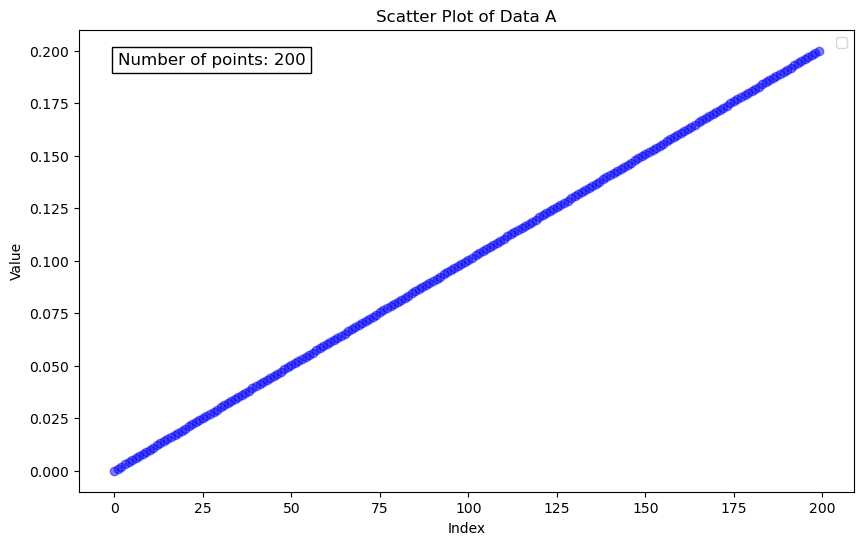

In [9]:
print(X_f.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X_f)), X_f, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Plot of Data A')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200, 1)


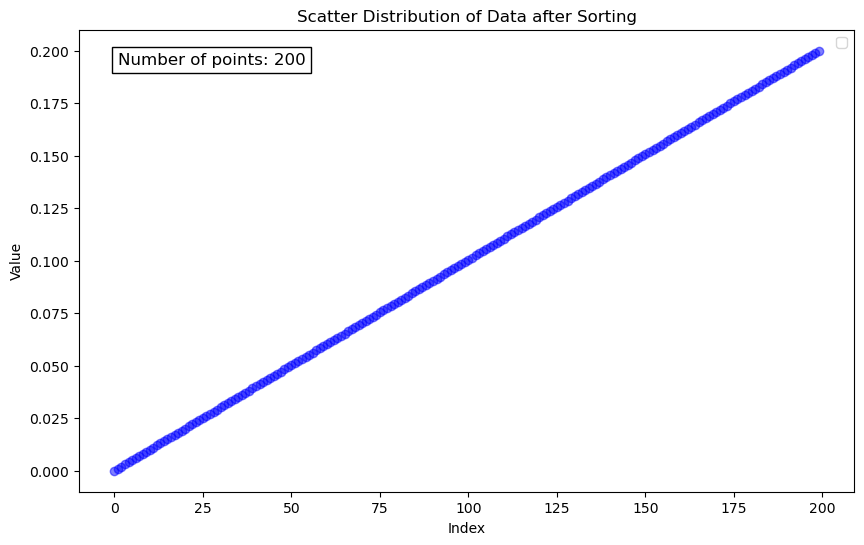

In [10]:
X = np.sort(X_f, axis=0)
print(X.shape)
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(X)), X, alpha=0.5, color='blue')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Scatter Distribution of Data after Sorting')
# 在图中添加点的数量
plt.text(0.05, 0.95, f'Number of points: {len(X_f)}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=1))

plt.legend()
plt.show()

In [11]:
print(error_y)

error_of_u = sum(error_y)/len(error_y)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE

print(chaoss)

chaos_of_u = sum(chaoss)/len(chaoss)

print('Chaos of fuhe active learning(LHS sampling): %e' % (chaos_of_u)) #打印混沌度

print(residuals)

residual_of_u = sum(residuals)/len(residuals)

print('Residual of fuhe active learning(LHS sampling): %e' % (residual_of_u)) #打印残差


[0.004472938318666555, 0.003969867735005294, 0.003929680600903017, 0.0037529521801104256, 0.0038955548207739226, 0.003962873073714244, 0.004010027120718362, 0.004426407913855509, 0.004270757735763784, 0.004221364331478739]
Error u of fuhe active learning(LHS sampling): 4.091242e-03
[0.0003805216925936172, 0.0005047686775956331, 0.0003323187874734716, 0.00031761072824094277, 0.00033096594660800055, 0.0003610210643552279, 0.00034452423886274623, 0.0006210635080085891, 0.0005096277076847118, 0.00035751976322927697]
MAE of fuhe active learning(LHS sampling): 4.059942e-04
[2.445662001176858e-06, 1.9275322108628038e-06, 1.8874610818132246e-06, 1.7218247950274496e-06, 1.8550921083889484e-06, 1.919480557647809e-06, 1.965744579521041e-06, 2.393869615528708e-06, 2.2383211318920645e-06, 2.1780488061092863e-06]
MSE of fuhe active learning(LHS sampling): 2.053304e-06
[10.743588, 13.627743, 0.010035815, 7.5841475, 10.298979, 3.4549954, 0.00030659445, 0.021593235, 0.00013225834, 8.54269]
Chaos of fuh

[0.004472938318666555, 0.003969867735005294, 0.003929680600903017, 0.0037529521801104256, 0.0038955548207739226, 0.003962873073714244, 0.004010027120718362, 0.004426407913855509, 0.004270757735763784, 0.004221364331478739]
mean Error u: 4.091242e-03
Variance Error u: 5.238277e-08


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436991/2285129262.py:37: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


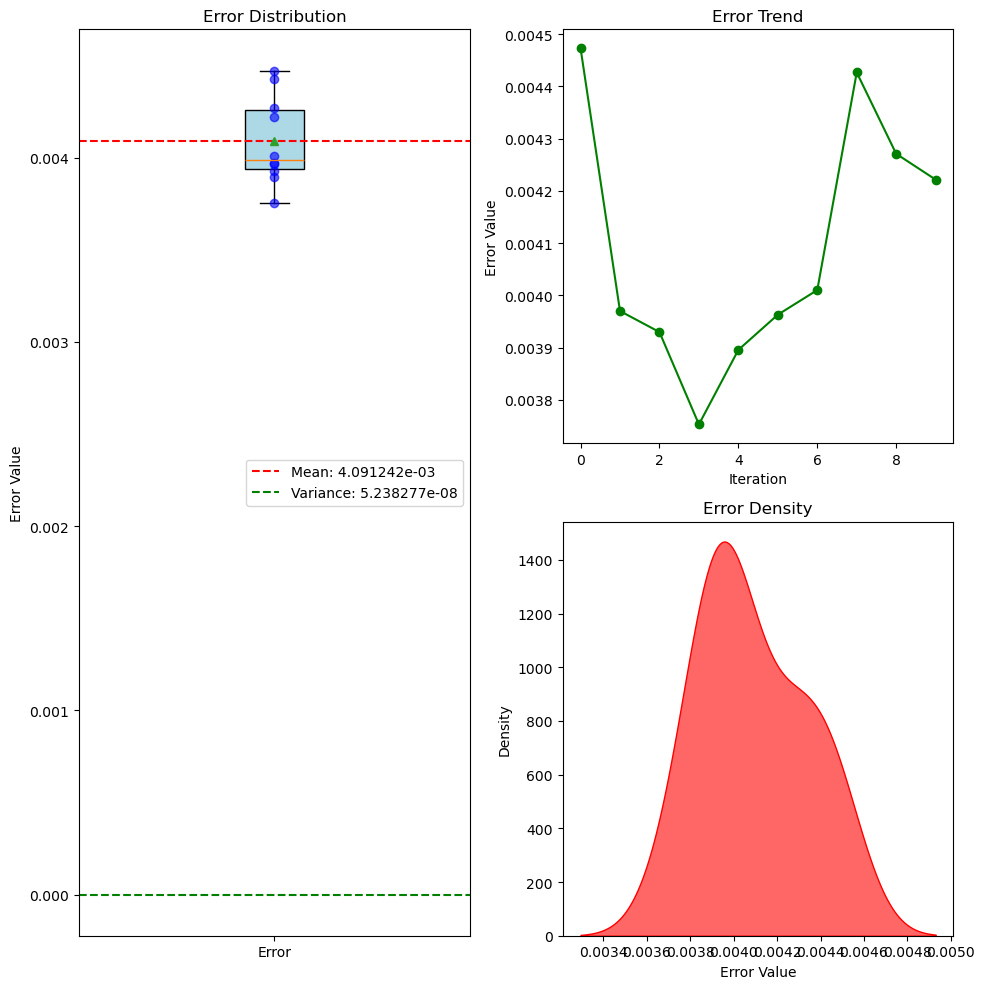

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_y
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0003805216925936172, 0.0005047686775956331, 0.0003323187874734716, 0.00031761072824094277, 0.00033096594660800055, 0.0003610210643552279, 0.00034452423886274623, 0.0006210635080085891, 0.0005096277076847118, 0.00035751976322927697]
mean MAE: 4.059942e-04
Variance MAE: 9.441981e-09


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436991/3953849728.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


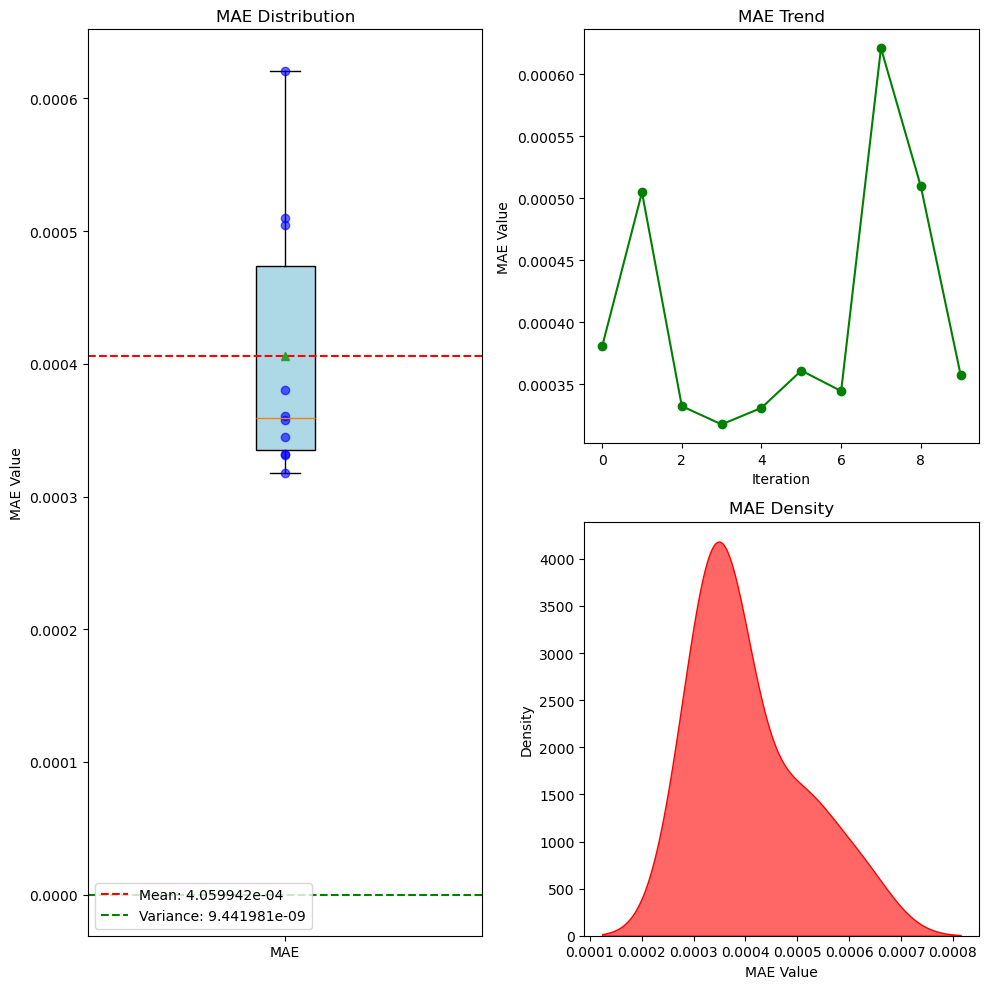

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[2.445662001176858e-06, 1.9275322108628038e-06, 1.8874610818132246e-06, 1.7218247950274496e-06, 1.8550921083889484e-06, 1.919480557647809e-06, 1.965744579521041e-06, 2.393869615528708e-06, 2.2383211318920645e-06, 2.1780488061092863e-06]
mean MSE: 2.053304e-06
Variance MSE: 5.377865e-14


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436991/3394972535.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


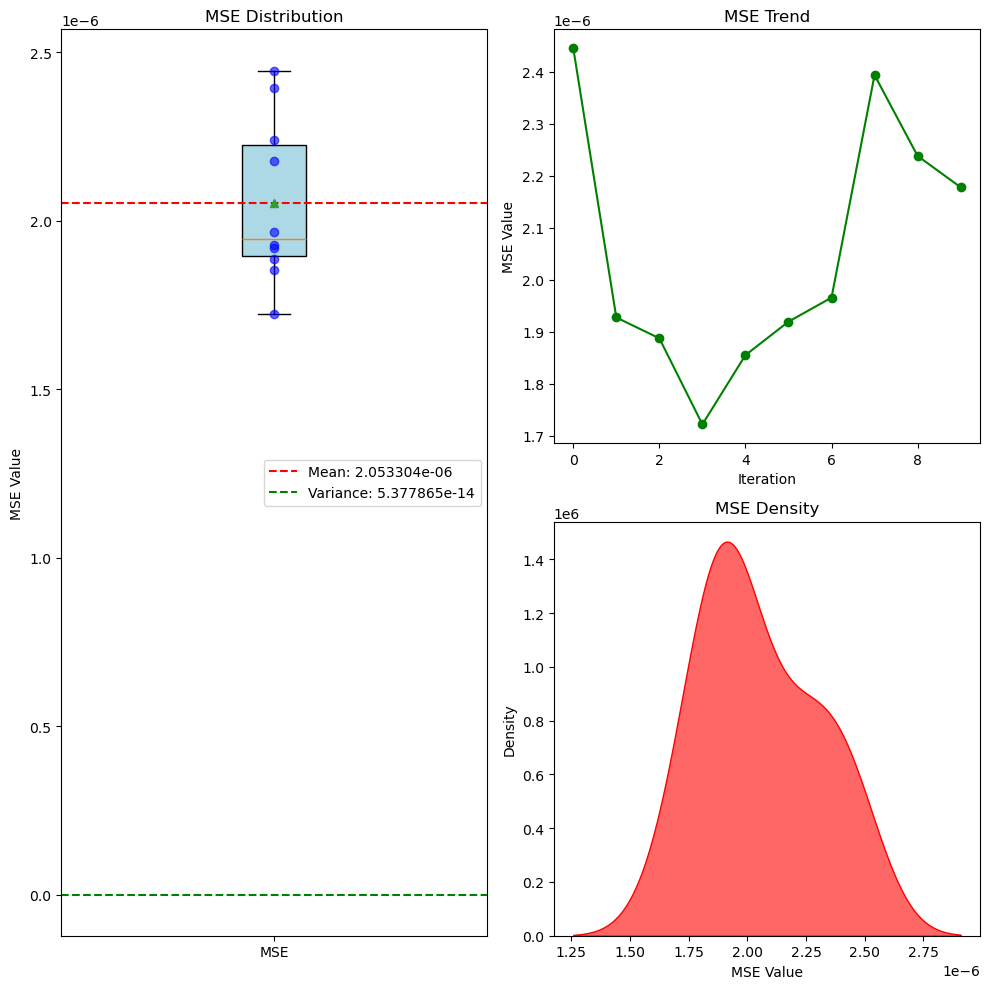

In [14]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[10.743588, 13.627743, 0.010035815, 7.5841475, 10.298979, 3.4549954, 0.00030659445, 0.021593235, 0.00013225834, 8.54269]
mean CHAOS: 5.428421e+00
Variance CHAOS: 2.549659e+01


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436991/1804867946.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


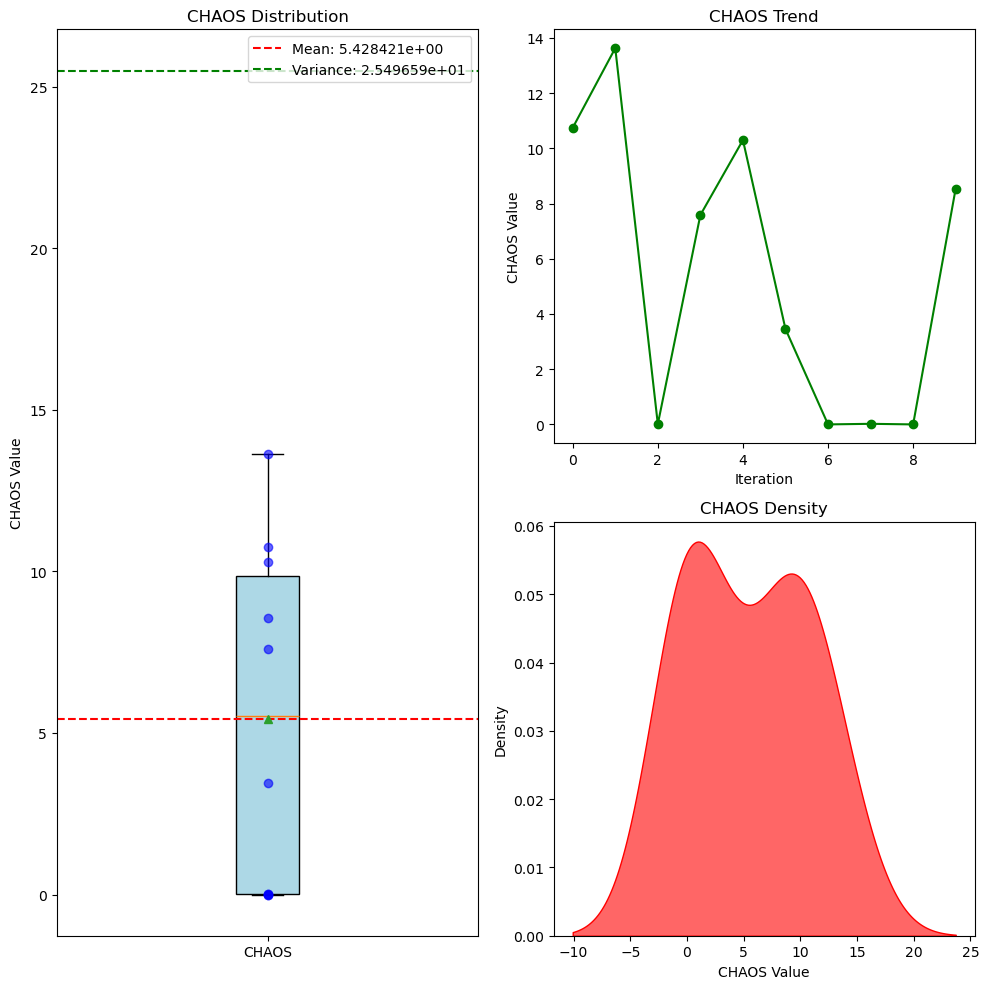

In [15]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = chaoss
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean CHAOS: %e' % (mean_error)) #打印误差
print('Variance CHAOS: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('CHAOS Distribution')
plt.ylabel('CHAOS Value')
plt.xticks([1], ['CHAOS'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('CHAOS Trend')
plt.ylabel('CHAOS Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('CHAOS Density')
plt.xlabel('CHAOS Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

[0.0005153065, 0.00044988963, 0.00045667918, 0.0005208829, 0.0004893504, 0.0004452577, 0.000483391, 0.00047272048, 0.0004313038, 0.00048107828]
mean RESIDUAL: 4.745860e-04
Variance RESIDUAL: 7.806769e-10


/home/extra_disk/lcy/PINN-1/medium_homogeneous_CTMC(suanlisan)/active learning/ipykernel_1436991/2986457676.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


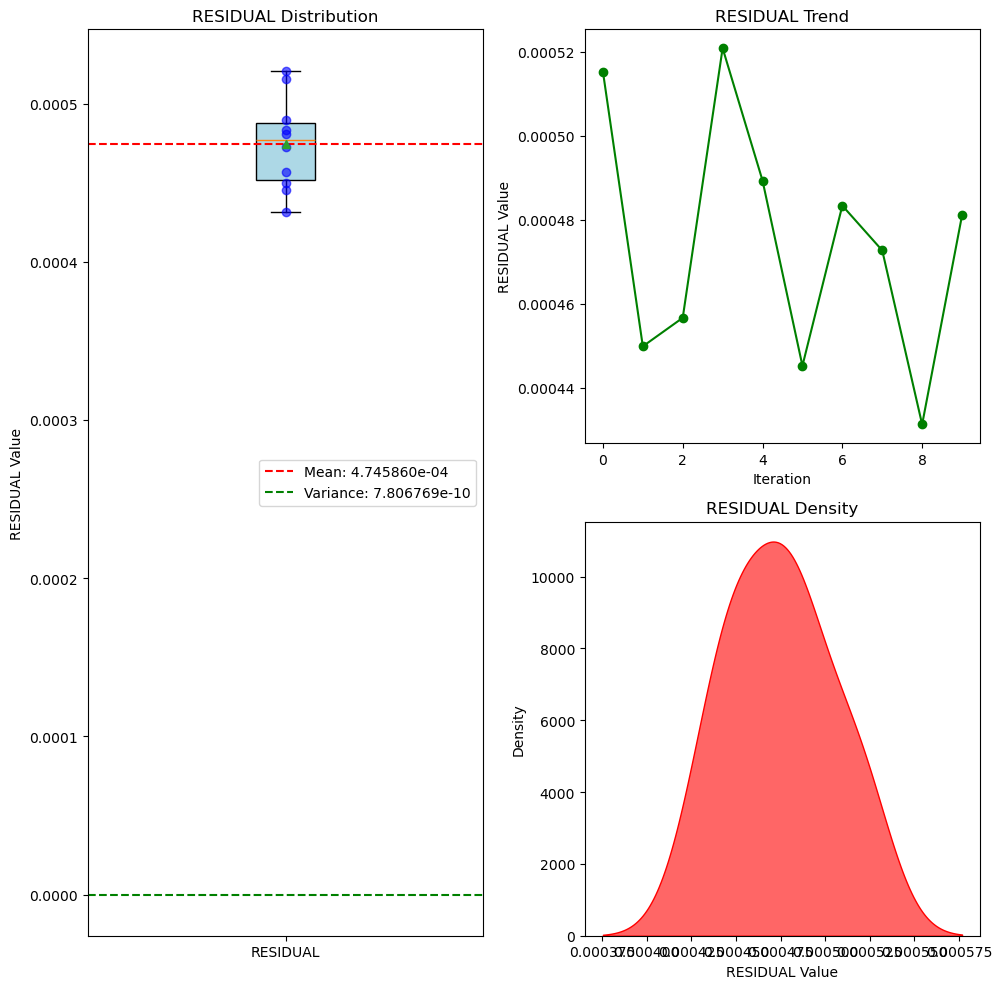

In [16]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = residuals
print(error)

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean RESIDUAL: %e' % (mean_error)) #打印误差
print('Variance RESIDUAL: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('RESIDUAL Distribution')
plt.ylabel('RESIDUAL Value')
plt.xticks([1], ['RESIDUAL'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('RESIDUAL Trend')
plt.ylabel('RESIDUAL Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('RESIDUAL Density')
plt.xlabel('RESIDUAL Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [17]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

40000
[1.8028666e+03 1.7188379e+03 1.6491692e+03 ... 3.2718133e-03 3.2716645e-03
 3.2715562e-03]


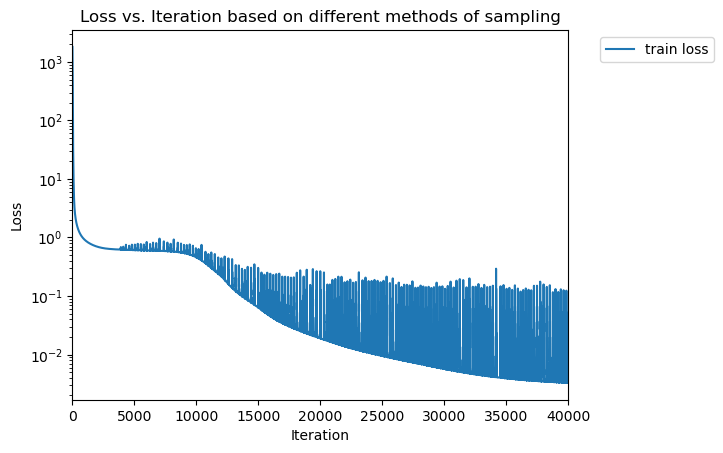

In [18]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,40000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns = state_column_names)
print(y_pred_df.head())
print(y_pred_df.tail())
y_pred_df = get_system_performance(y_pred_df)
print(y_pred_df.head())
print(y_pred_df.tail())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.971772  0.007379  0.010212  0.010180  0.000116  0.000113  0.000161   
1  0.961093  0.010017  0.014221  0.013966  0.000174  0.000174  0.000252   
2  0.952332  0.012182  0.017494  0.017012  0.000243  0.000243  0.000352   
3  0.944247  0.014174  0.020502  0.019776  0.000324  0.000322  0.000464   
4  0.936402  0.016096  0.023419  0.022419  0.000418  0.000411  0.000591   

    state_8   state_9  state_10  state_11      state_12  
0  0.000058  0.000006  0.000002  0.000002  1.018723e-07  
1  0.000089  0.000008  0.000002  0.000003  1.324216e-07  
2  0.000125  0.000010  0.000003  0.000005  1.663754e-07  
3  0.000167  0.000013  0.000004  0.000006  2.059021e-07  
4  0.000215  0.000017  0.000005  0.000008  2.521336e-07  
      state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
495  0.757833  0.053052  0.094723  0.068894  0.006635  0.004812  0.008608   
496  0.757834  0.053052  0.094722  0.068894  0.

Text(0, 0.5, 'Probability')

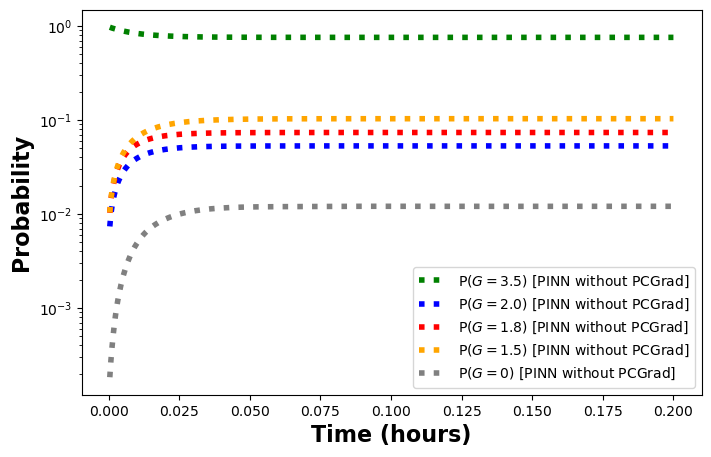

In [20]:
plt.figure(figsize=(8, 5)) #设置图形尺寸为8*5

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


plt.yscale('log') #设置y轴的刻度为对数刻度
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16) #设置x轴标签为Time (hours)，字体加粗，字体大小为16
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16) #设置y轴标签为Probability，字体加粗，字体大小为16

In [21]:
#解析解
eigenvector_solution_df = pd.read_csv('analytical_solution_by_eigenvector_method.csv')
laplace_solution_df = pd.read_csv('analytical_solution_by_laplace_method.csv')
print(eigenvector_solution_df.head())

    state_1   state_2   state_3   state_4   state_5   state_6   state_7  \
0  0.989461  0.002719  0.003903  0.003874  0.000011  0.000011  0.000015   
1  0.979427  0.005285  0.007619  0.007508  0.000041  0.000041  0.000058   
2  0.969868  0.007706  0.011159  0.010919  0.000089  0.000087  0.000126   
3  0.960761  0.009993  0.014533  0.014121  0.000151  0.000147  0.000214   
4  0.952080  0.012153  0.017751  0.017129  0.000227  0.000219  0.000319   

    state_8       state_9      state_10      state_11      state_12  \
0  0.000005  4.199986e-08  1.479473e-08  2.123212e-08  5.835560e-11   
1  0.000021  3.151602e-07  1.117239e-07  1.610611e-07  8.690817e-10   
2  0.000045  9.982098e-07  3.560873e-07  5.156228e-07  4.096992e-09   
3  0.000077  2.221657e-06  7.974345e-07  1.159778e-06  1.206261e-08   
4  0.000115  4.076314e-06  1.472082e-06  2.150250e-06  2.744632e-08   

   system_3.5  system_2.0  system_1.8  system_1.5  system_0  
0    0.989461    0.002719    0.003885    0.003918  0.000016 

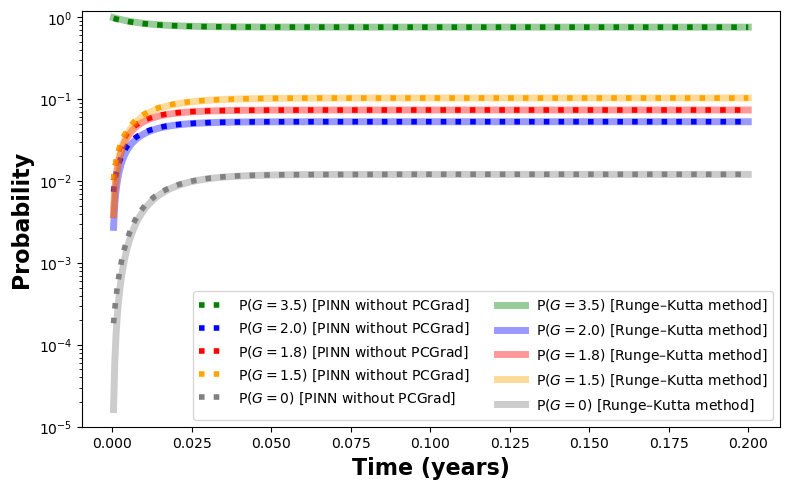

In [22]:
f, ax = plt.subplots(1, 1, figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted')


sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5)
sns.lineplot(x = x_star.flatten(), y = eigenvector_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5)



ax.legend(ncol=2, fontsize=10)
ax.set_yscale("log")
ax.set_ylim([1e-5, 1.2])
ax.set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax.set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)



plt.tight_layout()

### 计算RMSE

In [23]:
y_diff_no_pcgrad_eigenvectors = eigenvector_solution_df - y_pred_df
y_diff_no_pcgrad_laplace = laplace_solution_df - y_pred_df

In [24]:
y_diff_no_pcgrad_eigenvectors['mse'] = y_diff_no_pcgrad_eigenvectors.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_eigenvectors['rmse'] = y_diff_no_pcgrad_eigenvectors['mse'].apply(np.sqrt)

y_diff_no_pcgrad_laplace['mse'] = y_diff_no_pcgrad_laplace.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)
y_diff_no_pcgrad_laplace['rmse'] = y_diff_no_pcgrad_laplace['mse'].apply(np.sqrt)

In [25]:
#这里的mse跟之前的MSE值不一样，其实是差了五倍，因为这里求均值是对500个数的和a除以500，而之前是对500*5个数的和（也是a）除以500*5
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['mse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['mse']))

RMSE of between PINN without PCGrad and the analytical solution is 1.0890244030546432e-05
RMSE of between PINN without PCGrad and the analytical solution is 1.0890244030545406e-05


In [26]:
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_eigenvectors['rmse']))
print ('RMSE of between PINN without PCGrad and the analytical solution is', np.mean(y_diff_no_pcgrad_laplace['rmse']))

RMSE of between PINN without PCGrad and the analytical solution is 0.0010290672640453147
RMSE of between PINN without PCGrad and the analytical solution is 0.0010290672640449615
